In [94]:
import numpy as np
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy import integrate
from numba import jit
import scipy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
plt.rc('font', size=18) 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [1969]:
print(0.02224/h**2)
print(Omega_m)

0.04604316546762591
0.28499560064178875


In [2017]:
from classy import Class

#Start by specifying the cosmology  - this is some hodge-podge of quijote but now agrees with Pardede et al...
h = 0.695
Omega_b = 0.02224/h**2
Omega_cdm = 0.11542/h**2
Omega_m = Omega_cdm+Omega_b
A_s = 2.20193e-9 
n_s = 0.9632

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc # is also set to 10 later
params = {'output':'mPk,mTk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,#Omega_m-Omega_b,#
             'h':h,
             'n_s':n_s,
             'A_s':A_s,#'n_s':n_s,'sigma8':0.828,#
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo_kevin = Class()
cosmo_kevin.set(params)
cosmo_kevin.compute()

In [2016]:
0.157*Omega_m

0.044744309300760836

In [2206]:
#eline de weerd
h = 0.6766#0.695#0.676611#0.7 #H0/100
Omega_m = 0.3111
Omega_cdm = 0.11933/h**2
Omega_b = 0.02242/h**2#0.157*Omega_m
A_s = 2.20193e-9 
n_s = 0.9665#0.9632#
#a = 1/(1+z)
#H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc # is also set to 10 later
params = {'output':'mPk,mTk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_m-Omega_b,#Omega_cdm,#
             'h':h,
             'n_s':n_s,
             'A_s':A_s,#'n_s':n_s,'sigma8':0.828,#
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo_eline = Class()
cosmo_eline.set(params)
cosmo_eline.compute()

In [1914]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean(1/ds**3)

print(get_avg_dist((500,500,200))**(1/3))

255.01426105201142


$$\ddot{F}+\mathcal{H} \dot{f}=\frac{3 H_0^2 \Omega_m}{2 a} (F+D^2)$$
$$\mathcal{H}^2(1+z)^2 F''+(\mathcal{H'}\mathcal{H}(1+z)^2) F'=\frac{3 H_0^2 \Omega_{m,0}}{2 a} (F+D^2)$$

In [487]:
#so lets solve for the second order growth function F ...
from scipy.integrate import odeint
c = 2.99792*10**5 #km/s
#first check with D
def D_test(u,zz): # so variables are F and H and D
    f,fd = u # unpack u vector
    return [fd,(-H_c(zz)*H_cd(zz)*(1+zz)**2 *fd + ((3*(100/c)**2 * Omega_m *(1+zz))/(2))*(f))/(H_c(zz)**2 *(1+zz)**2)]

def F_func(u,zz): # so variables are F and H and D
    f,fd = u # unpack u vector
    D_zz = D_intp(zz)
    return [fd,(-H_c(zz)*H_cd(zz)*(1+zz)**2 *fd + ((3*(100/c)**2 * Omega_m *(1+zz))/(2))*(f+D_zz**2))/(H_c(zz)**2 *(1+zz)**2)]

odeint_zz = np.linspace(20,0.05,int(1e+5))
#set initial params for D
D0 = [D_intp(odeint_zz[0]),dD_dz(odeint_zz[0])]
sol = odeint(D_test,D0,odeint_zz)

#set initial params for F
F0 = [(3/7)*D_intp(odeint_zz[0])**2,(3/7)*2*D_intp(odeint_zz[0])*dD_dz(odeint_zz[0])]
sol1 = odeint(F_func,F0,odeint_zz)

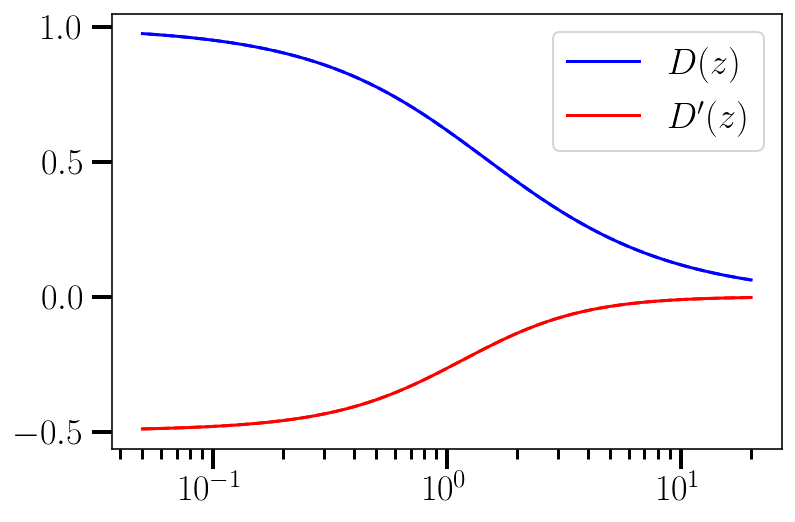

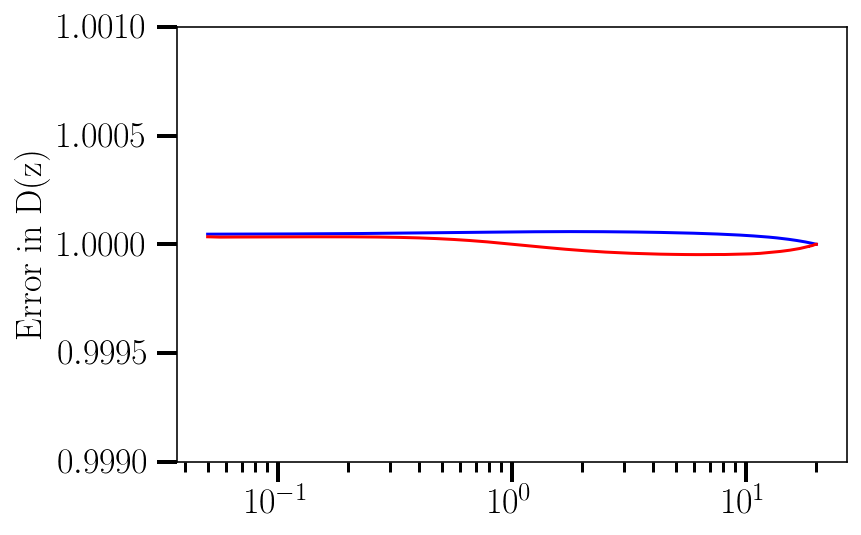

In [488]:
plt.plot(odeint_zz,sol[:,0],color='blue',label='$D(z)$')
plt.plot(odeint_zz,sol[:,1],color='red',label='$D\'(z)$')
plt.plot(odeint_zz,D_intp(odeint_zz),'--',color='blue')
plt.plot(odeint_zz,dD_dz(odeint_zz),'--',color='red')
plt.xscale('log')
#plt.ylim(0,2)
plt.legend()
plt.show()
plt.ylim(0.999,1.001)
plt.plot(odeint_zz,sol[:,0]/D_intp(odeint_zz),color='blue',label='$D(z)$')
plt.plot(odeint_zz,sol[:,1]/dD_dz(odeint_zz),color='red',label='$D\'(z)$')
plt.xscale('log')
plt.ylabel('Error in D(z)')
plt.show()

### In Eds - u= v =1

$$v=\frac{7 K}{3} =\frac{7 F}{3D^2}$$

$$u = \frac{7 C}{3} \equiv \frac{7}{3}\frac{\dot{F}}{2\dot{D}D}$$


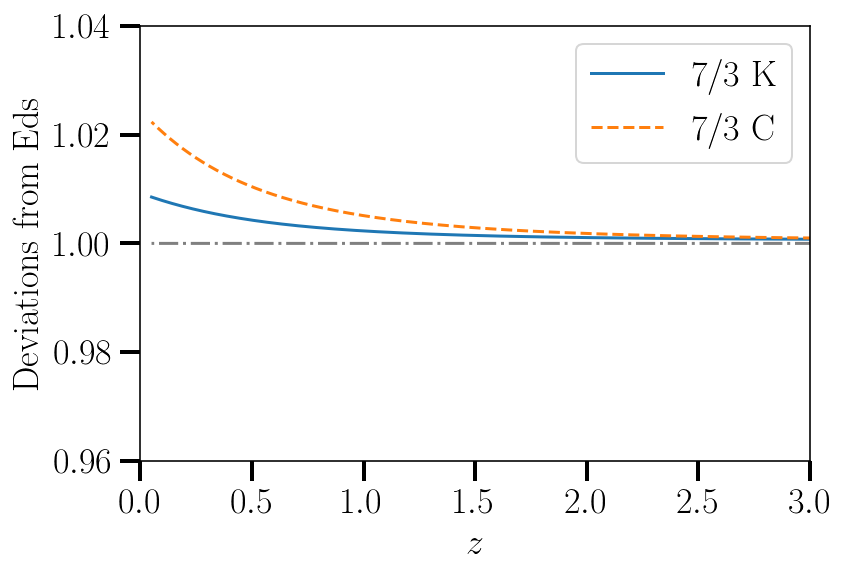

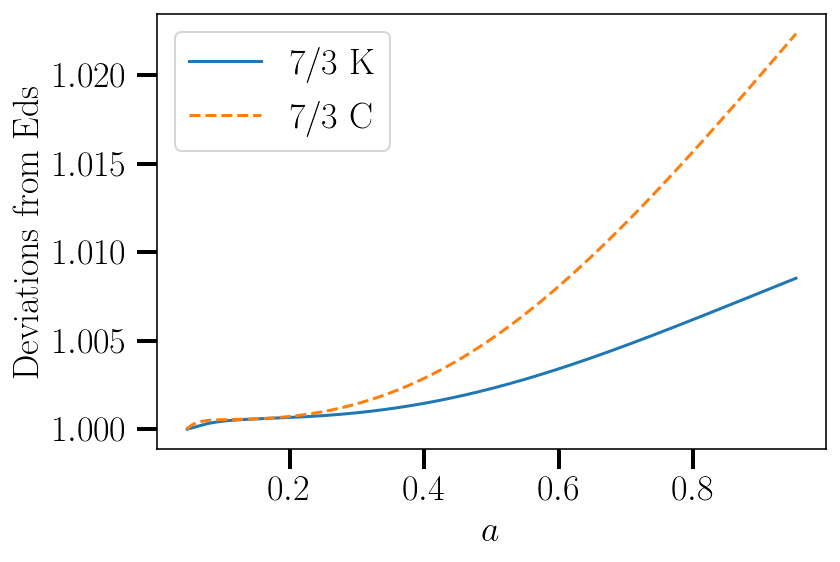

In [490]:
#deivations from Einstein-de-sitter

K = (sol1[:,0]/D_intp(odeint_zz)**2)
C = sol1[:,1]/(2*D_intp(odeint_zz)*dD_dz(odeint_zz))
K_intp = interp1d(odeint_zz,K,kind='cubic')
C_intp = interp1d(odeint_zz,C,kind='cubic')
v = (7/3)*K
u = (7/3)*C

plt.plot(odeint_zz,v,label='7/3 K')
plt.plot(odeint_zz,u,'--',label='7/3 C')
plt.plot(odeint_zz,np.ones_like(odeint_zz),'-.',color ='grey')
#plt.xscale('log')
plt.ylabel('Deviations from Eds')
plt.xlabel('$z$')
plt.legend()
plt.xlim(0,3)
plt.ylim(0.96,1.04)
plt.show()

plt.plot(1/(odeint_zz+1),v,label='7/3 K')
plt.plot(1/(odeint_zz+1),u,'--',label='7/3 C')
#plt.xscale('log')
plt.ylabel('Deviations from Eds')
plt.xlabel('$a$')
plt.legend()

## define all derivatives wrt to comoving distance

$\frac{df}{d ln(d)}=\frac{d d}{d ln(d)}\frac{dz}{dd}\frac{df}{dz}=d \times(1/\frac{dd}{dz})\frac{df}{dz}$

In [550]:
#Euclid like params - taken from eline de weerd - https://github.com/ElineMaaikedeWeerd/bispectrum_snr/blob/master/doppler_model1_OOversion/snr.py
#table of b_e and Q from doppler paper
euclid_data = np.loadtxt('snr_surveyparams.txt')

#the table from the draft  has columns z, b_e, Q, n_g, V, sigma
z_euclid = euclid_data[:,0]
be_euclid = interp1d(z_euclid, euclid_data[:,1])
Q_euclid = interp1d(z_euclid,  euclid_data[:,2])
ngt_euclid = interp1d(z_euclid,1e-3 * euclid_data[:,3])
vt_euclid = interp1d(z_euclid, 1e9 * euclid_data[:,4])
sigma_euclid = interp1d(z_euclid, euclid_data[:,5])

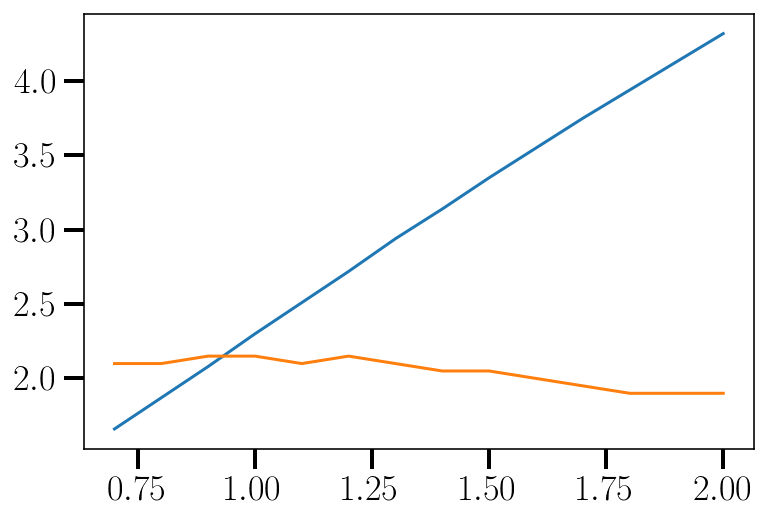

In [561]:
#plt.plot(z_euclid,be_euclid(z_euclid))
plt.plot(z_euclid,Q_euclid(z_euclid))
#plt.plot(z_euclid,ngt_euclid(z_euclid))
#plt.plot(z_euclid,vt_euclid(z_euclid))
#plt.plot(z_euclid,sigma_euclid(z_euclid))

dQ_euclid_dz = interp1d(z_euclid,np.gradient(Q_euclid(z_euclid),z_euclid))
plt.plot(z_euclid,dQ_euclid_dz(z_euclid))

In [919]:
baLCDM = cosmo.get_background()
print(baLCDM.keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [2211]:
from scipy.interpolate import interp1d

class CosmologicalFunctions:
    def __init__(self,cosmo):
        """
            take in Class and spit out stuff and create all my functions
        """
        self.cosmo = cosmo
        baLCDM = cosmo.get_background()
        #print(baLCDM.keys())
        f_cl = baLCDM['gr.fac. f']
        D_cl = baLCDM['gr.fac. D']
        z_cl = baLCDM['z']
        H_cl = baLCDM['H [1/Mpc]']
        xi_cl = baLCDM['comov. dist.']
        t_cl = baLCDM['conf. time [Mpc]']
        
        self.z_cl = z_cl#save for later
        self.Om_0 = cosmo.get_current_derived_parameters(['Omega_m'])['Omega_m']
        self.h = cosmo.get_current_derived_parameters(['h'])['h']
        
        #define functions and add in h
        self.H_c = interp1d(z_cl,H_cl*(1/(1+z_cl))/self.h,kind='cubic') # now in h/Mpc!
        self.dH_c = interp1d(z_cl,np.gradient(H_cl*(1/(1+z_cl))/self.h,z_cl),kind='cubic') # derivative wrt z
        self.ddH_c = interp1d(z_cl,np.gradient(self.dH_c(z_cl),z_cl),kind='cubic') # second derivative wrt z
        self.comoving_dist = interp1d(z_cl,xi_cl*self.h,kind='cubic') # just use class background as quick
        self.f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)
        self.D_intp = interp1d(z_cl,D_cl,kind='cubic')
        self.dD_dz = interp1d(z_cl,np.gradient(D_cl,z_cl),kind='cubic')
        self.conf_time = interp1d(z_cl,self.h*t_cl,kind='cubic')#convert between the two
        #misc
        self.c = 2.99792*10**5 #km/s
        self.H0 = 100/self.c #[h/Mpc]
        self.Om = lambda xx: self.Om_0 * (self.H0**2 / self.H_c(xx)**2) * (1+xx)
        
        #define bias stuff
        if False:
            self.b_1 = lambda xx: 1.46 +0*xx
        else:
            self.b_1 = lambda xx: np.sqrt(1+xx)
            
        self.g_2 = lambda xx: 0.524-0.547*self.b_1(xx)+0.046*self.b_1(xx)**2#-(2/7)*(self.b_1(xx)-1)#
        self.b_2 = lambda xx: 0.412 - 2.143*self.b_1(xx) +0.929*self.b_1(xx)**2 + 0.008*self.b_1(xx)**3 + 4/3 * self.g_2(xx)#-0.1*np.sqrt(1+xx)#
        
        if True: # for comparison with eline - euclid like
            self.b_1 = lambda xx: 0.9 + 0.4*xx
            self.b_2 = lambda xx: -0.741-0.125*xx+0.123*xx**2+0.00637*xx**3
            self.g_2 = lambda xx: (0.0409-0.199*xx-0.0166* xx**2 +0.00268* xx**3)/2
            
        self.z_samps = np.linspace(0.05, 10, 10000)#defined over appropiate range for numerical derivs
        
        #get derivs of these redshift dependent functions
        func_deriv_list = self.lnd_derivatives([self.b_1,self.b_2,self.g_2,self.f_intp,self.D_intp])
        self.b1_d,self.b2_d,self.g2_d,self.f_d,self.D_d = func_deriv_list
        func_second_deriv_list = self.lnd_derivatives(func_deriv_list)
        self.b1_dd,self.b2_dd,self.g2_dd,self.f_dd,self.D_dd = func_second_deriv_list
        
        #Euclid like params - taken from eline de weerd - https://github.com/ElineMaaikedeWeerd/bispectrum_snr/blob/master/doppler_model1_OOversion/snr.py
        #table of b_e and Q from doppler paper
        euclid_data = np.loadtxt('snr_surveyparams.txt')

        #the table from the draft  has columns z, b_e, Q, n_g, V, sigma
        if True:
            self.z_euclid = euclid_data[:,0]
            self.be_euclid = interp1d(z_euclid, euclid_data[:,1])
            self.Q_euclid = interp1d(z_euclid,  euclid_data[:,2])
            #self.ngt_euclid = interp1d(z_euclid,1e-3 * euclid_data[:,3])
            #self.vt_euclid = interp1d(z_euclid, 1e9 * euclid_data[:,4])
            #self.sigma_euclid = interp1d(z_euclid, euclid_data[:,5])
        else:
            self.z_euclid = self.z_samps 
            self.be_euclid = lambda xx: 0*xx
            self.Q_euclid = lambda xx:  0*xx + 2/5
        
        if False: # clarkson 2019
            self.b_1 = lambda xx: 1.3 +0*xx
            self.b_2 = lambda xx: -0.74 +0*xx
            self.g_2 = lambda xx: 0.524-0.547*self.b_1(xx)+0.046*self.b_1(xx)**2#-(2/7)*(self.b_1(xx)-1)#
            self.z_euclid = self.z_samps
            self.be_euclid = lambda xx: -4 +0*xx
            self.Q_euclid = lambda xx:  0*xx - 2.5# 0.95#/5
        
    def get_class_powerspectrum(self,kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
        return np.array([self.cosmo.pk_lin(ki, zz) for ki in kk*self.h])*h**3

    def get_pkinfo_z(self,k,z):
        Plin = get_class_powerspectrum(k,0)#just always get present day power spectrum
        Pk = interpolate.interp1d(k,Plin)#get linear power spectrum
        self.Pk = Pk
        Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))
        Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
        return Pk,Pk_d,Pk_dd
        
    def solve_second_order_KC(self):
        c = 2.99792*10**5 #km/s
        def F_func(u,zz): # so variables are F and H and D
            f,fd = u # unpack u vector
            D_zz = self.D_intp(zz)
            return [fd,(-self.H_c(zz)*self.dH_c(zz)*(1+zz)**2 *fd + ((3*(self.H0)**2 * self.Om_0 *(1+zz))/(2))*(f+D_zz**2))/(self.H_c(zz)**2 *(1+zz)**2)]
        
        odeint_zz = np.linspace(20,0.05,int(1e+5))# so z=20 should be pretty much matter dominated

        #set initial params for F
        F0 = [(3/7)*self.D_intp(odeint_zz[0])**2,(3/7)*2*self.D_intp(odeint_zz[0])*self.dD_dz(odeint_zz[0])]
        sol1 = odeint(F_func,F0,odeint_zz)
        K = (sol1[:,0]/self.D_intp(odeint_zz)**2)
        C = sol1[:,1]/(2*self.D_intp(odeint_zz)*self.dD_dz(odeint_zz))
        self.K_intp = interp1d(odeint_zz,K,kind='cubic')
        self.C_intp = interp1d(odeint_zz,C,kind='cubic')
    
    def lnd_derivatives(self,functions_to_differentiate,z_range= [0]):
        """
            calculates derivatives of a list of functions wrt log comoving dist numerically
        """
        
        if len(z_range) == 1:
            z_range= self.z_samps

        # Store first derivatives in a list
        function_derivatives = []

        for func in functions_to_differentiate:
            # Calculate numerical derivatives of the function with respect to ln(d)
            derivative_func = interpolate.interp1d(z_range, np.gradient(func(z_range), np.log(self.comoving_dist(z_range))))
            function_derivatives.append(derivative_func)

        return function_derivatives
    
    def get_params(self,k1,k2,theta,zz):
        """
            return arrays of redshift and k dependent parameters
        """
        self.solve_second_order_KC()#get K and C
        
        k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))#get k3 from triangle condition
        k3 = np.where(k3==0,1e-3,k3)
        
        k = np.logspace(-5, np.log10(k_max), num=1000)
        Pk,Pk_d,Pk_dd = self.get_pkinfo_z(k,0)
        Pk1 = Pk(k1)
        Pk2 = Pk(k2)
        Pk3 = Pk(k3)

        Pkd1 = Pk_d(k1)
        Pkd2 = Pk_d(k2)
        Pkd3 = Pk_d(k3)

        Pkdd1= Pk_dd(k1)
        Pkdd2 = Pk_dd(k2)
        Pkdd3 = Pk_dd(k3)

        #redshift dependendent terms
        d = self.comoving_dist(zz)
        
        K = 3/7
        C = 3/7
        if True:
            K = self.K_intp(zz)
            C = self.C_intp(zz)

        f = self.f_intp(zz)
        D1 = self.D_intp(zz)
        b1 = self.b_1(zz)
        b2 = self.b_2(zz)
        g2 = self.g_2(zz)
        return k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2

    def get_derivs(self,zz):
        #1st deriv
        fd = self.f_d(zz)
        Dd = self.D_d(zz)
        gd2 = self.g2_d(zz)
        bd2 = self.b2_d(zz)
        bd1 = self.b1_d(zz)
        #2nd deriv
        fdd = self.f_dd(zz)
        Ddd = self.D_dd(zz)
        gdd2 = self.g2_dd(zz)
        bdd2 = self.b2_dd(zz)
        bdd1 = self.b1_dd(zz)
        return fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
    
        #get biases
    def get_PNGparams(self,fNL,zz):
        delta_c = 1.686
        bL10 = lambda xx: b_1(xx) - 1
        bL20 = lambda xx: b_2(xx) - (8/21)*bL10(xx)

        bL01 = lambda xx: 2*delta_c*fNL*bL10(xx)
        bL11 = lambda xx: 2*fNL*(delta_c*bL20(xx)-bL10(xx))
        bL02 = lambda xx: 4*fNL**2 * delta_c*(delta_c*bL20(xx)-2*bL10(xx))

        bE01 = bL01
        bE11 = lambda xx: bL01(xx) + bL11(xx)
        bE02 = bL02

        alphak1 = M(k1, 0)
        alphak2 = M(k2, 0)
        alphak3 = M(k3, 0)
        return fNL,1*bE01(zz),1*bE11(zz),1*bE02(zz),alphak1,alphak2,alphak3
    
    def get_beta_funcs(self,zz):
        """
            Function that relies on biases and functions defined above to return beta coefficients
            from paper 1711.01812v4
        """
        #these derivs here are wrt to conformal time so we convert to derivs wrt to z
        #d/dt = d a/dt d/da = a H dz/da d/dz =  -(1+z) H d/dz # everything here is conformal both t and H
        #d^2/d^2 t = (1+z)^2 H^2 d^2/d z^2 + H(1+z)(H+(1+z)H')d/dz
        
        dQ_euclid_dz = interp1d(self.z_euclid,np.gradient(self.Q_euclid(self.z_euclid),self.z_euclid))
        dbe_dz = interp1d(self.z_euclid,np.gradient(self.be_euclid(self.z_euclid),self.z_euclid))
        db1_dz = interp1d(self.z_samps,np.gradient(self.b_1(self.z_samps),self.z_samps))
        
        dH_dt = lambda xx: -(1+xx)*self.H_c(xx)*self.dH_c(xx)
        dH_dt2 = lambda xx: (1+xx)**2 *self.H_c(xx)**2 *self.ddH_c(xx)+self.H_c(xx)*(1+xx)*(self.H_c(xx)+(1+xx)*self.dH_c(xx))*self.dH_c(xx)#should just check with doing it numerically as is easier
        #self.dH22 = interp1d(self.z_cl,np.gradient(dH_dt(self.z_cl),self.conf_time(self.z_cl)))
        self.dH_dt = dH_dt                   
        dQ_dt = lambda xx: -(1+xx)*self.H_c(xx)*dQ_euclid_dz(xx)
        dbe_dt = lambda xx: -(1+xx)*self.H_c(xx)*dbe_dz(xx)#0*xx-1.6*1e-4
        db1_dt = lambda xx: -(1+xx)*self.H_c(xx)*db1_dz(xx)
        self.Q = self.Q_euclid
        self.b_e = self.be_euclid

        partdQ=0
        partdb1=0
        
        #from 1st order petrubation theory
        self.gr1 = lambda xx: xx*0 #self.H_c(xx)*self.f_intp(xx)*(self.b_e(xx)-2*self.Q(xx)-2*(1-self.Q(xx))/(self.comoving_dist(xx)*self.H_c(xx))-dH_dt(xx)/self.H_c(xx)**2)
        self.gr2 = lambda xx:  self.H_c(xx)**2 *(self.f_intp(xx)*(3-self.b_e(xx))+ (3/2)*self.Om(xx)*(2+self.b_e(xx)-self.f_intp(xx)-4*self.Q(xx)-2*self.Q(xx)-2*(1-self.Q(xx))/(self.comoving_dist(xx)*self.H_c(xx))-dH_dt(xx)/self.H_c(xx)**2))
        self.grd1 = self.lnd_derivatives([self.gr1],self.z_euclid)[0]#get derivative for 1st order coef
        
        beta = np.empty(20,dtype=object)
        beta[6] = lambda xx: self.H_c(xx)**2 * ((3 / 2) * self.Om(xx) * (2 - 2 * self.f_intp(xx)+ self.b_e(xx) - 4 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))
        beta[7] = lambda xx: self.H_c(xx)**2 * (self.f_intp(xx)* (3 - self.b_e(xx)))
        beta[8] = lambda xx: self.H_c(xx)**2 * (3 * self.Om(xx) * self.f_intp(xx) * (2 - self.f_intp(xx) - 2 * self.Q(xx)) + self.f_intp(xx)**2 * (4 + self.b_e(xx) - self.b_e(xx)**2 + 4 * self.b_e(xx) * self.Q(xx) - 6 * self.Q(xx) - 4 * self.Q(xx)**2 + 4 * partdQ + 4 * (dQ_dt(xx) / self.H_c(xx)) -(dbe_dt(xx) / self.H_c(xx)) - (2 / (self.comoving_dist(xx)**2 * self.H_c(xx)**2)) * (1 - self.Q(xx) + 2 * self.Q(xx)**2 - 2 * partdQ) - (2 / (self.comoving_dist(xx) * self.H_c(xx))) * (3 - 2 * self.b_e(xx) + 2 * self.b_e(xx) * self.Q(xx) - self.Q(xx) - 4 * self.Q(xx)**2 + ((3 * dH_dt(xx)) / (self.H_c(xx)**2)) * (1 - self.Q(xx)) + 4 * partdQ + 2 * (dQ_dt(xx) / self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2) * (3 - 2 * self.b_e(xx) + 4 * self.Q(xx) + ((3 * dH_dt(xx)) / (self.H_c(xx)**2))) + (dH_dt2(xx) / self.H_c(xx)**3)))
        beta[9] = lambda xx: self.H_c(xx)**2 * ( -(9 / 2) * self.Om(xx) * self.f_intp(xx))
        beta[10] = lambda xx: self.H_c(xx)**2 * (3 * self.Om(xx) * self.f_intp(xx))
        beta[11] = lambda xx: self.H_c(xx)**2 * ( (3/2 ) * self.Om(xx) * (1 + 2 * self.f_intp(xx)/ (3 * self.Om(xx))) + 3 * self.Om(xx) * self.f_intp(xx)- self.f_intp(xx)**2 * (-1 + self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 + self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))
        beta[12] = lambda xx: self.H_c(xx)**2 * ( -3 * self.Om(xx) * (1 + 2 * self.f_intp(xx)/ (3 * self.Om(xx))) - self.f_intp(xx)* ( self.b_1(xx) * (self.f_intp(xx)- 3 + self.b_e(xx)) + (db1_dt(xx) / self.H_c(xx)) ) + (3 / 2) * self.Om(xx) * (self.b_1(xx) * (2 + self.b_e(xx) - 4 * self.Q(xx) - 2 * ((1 - self.Q(xx))/(self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2) ) + db1_dt(xx) /self.H_c(xx) + 2 * (2 - (1 / (self.comoving_dist(xx) * self.H_c(xx))) ) * partdb1 ) )    
        beta[13] = lambda xx: self.H_c(xx)**2 * (( (9 / 4) * self.Om(xx)**2 + (3 / 2) * self.Om(xx) * self.f_intp(xx)* (1 - (2 * self.f_intp(xx)) + 2 * self.b_e(xx) - 6 * self.Q(xx) - ((4 * (1 - self.Q(xx)))/(self.comoving_dist(xx) * self.H_c(xx))) - ((3 * dH_dt(xx)) / self.H_c(xx)**2) ) ) + ( self.f_intp(xx)**2 * (3 - self.b_e(xx)) ) )
        beta[14] = lambda xx: self.H_c(xx) * ( - (3 / 2) * self.Om(xx) * self.b_1(xx))
        beta[15] = lambda xx: self.H_c(xx) * 2 * self.f_intp(xx)**2
        beta[16] = lambda xx: self.H_c(xx) * (self.f_intp(xx)* (self.b_1(xx) * (self.f_intp(xx)+ self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)) + (db1_dt(xx) / self.H_c(xx)) + 2 * (1 - (1 / (self.comoving_dist(xx) * self.H_c(xx)))) * partdb1 ))
        beta[17] = lambda xx: self.H_c(xx) * (- (3 / 2) * self.Om(xx) * self.f_intp(xx))
        beta[18] = lambda xx: self.H_c(xx) * ( (3 / 2) * self.Om(xx) * self.f_intp(xx) - self.f_intp(xx)**2 * (3 - 2 * self.b_e(xx) + 4 * self.Q(xx) + ((4 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) + (3 * dH_dt(xx)/ self.H_c(xx)**2)) )
        beta[19] = lambda xx: self.H_c(xx) * (self.f_intp(xx)* (self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))

        self.beta = beta
        
        #get betad - derivatives wrt to ln(d)        # these are limited in range to euclid currently
        betad = np.empty(20,dtype=object)
        betad[14:20] = np.array(self.lnd_derivatives(beta[14:20],self.z_euclid),dtype=object)#14-19

        self.betad = betad
        all_betas = np.concatenate((np.array([self.gr1,self.gr2,self.grd1]),beta[6:],betad[14:20]))
        return [all_betas[i](zz) for i in range(len(all_betas))]


In [2212]:
zz=0.8
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = 2*np.pi/3#np.pi#np.linspace(0,np.pi,200)#

In [2213]:
cosmo_functions = CosmologicalFunctions(cosmo)
params = cosmo_functions.get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
derivs = cosmo_functions.get_derivs(zz)

PNGparams = cosmo_functions.get_PNGparams(1,zz)
betas = cosmo_functions.get_beta_funcs(zz)
gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas

2.3
-5.6


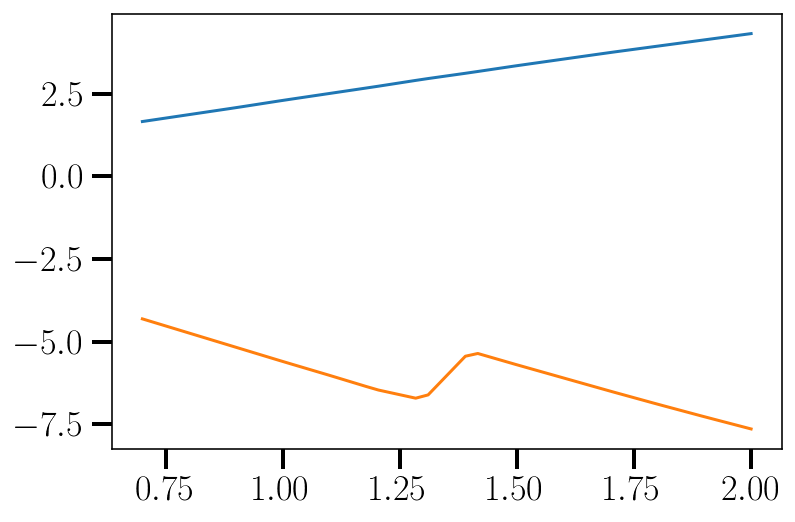

In [2214]:
z_plot = np.linspace(0.7,2)
#plt.plot(z_plot,cosmo_functions.b_1(z_plot))
#plt.plot(z_plot,cosmo_functions.b_2(z_plot))
#plt.plot(z_plot,cosmo_functions.g_2(z_plot))
plt.plot(z_plot,cosmo_functions.Q_euclid(z_plot))
plt.plot(z_plot,cosmo_functions.be_euclid(z_plot))
print(Q_euclid(1))
print(be_euclid(1))

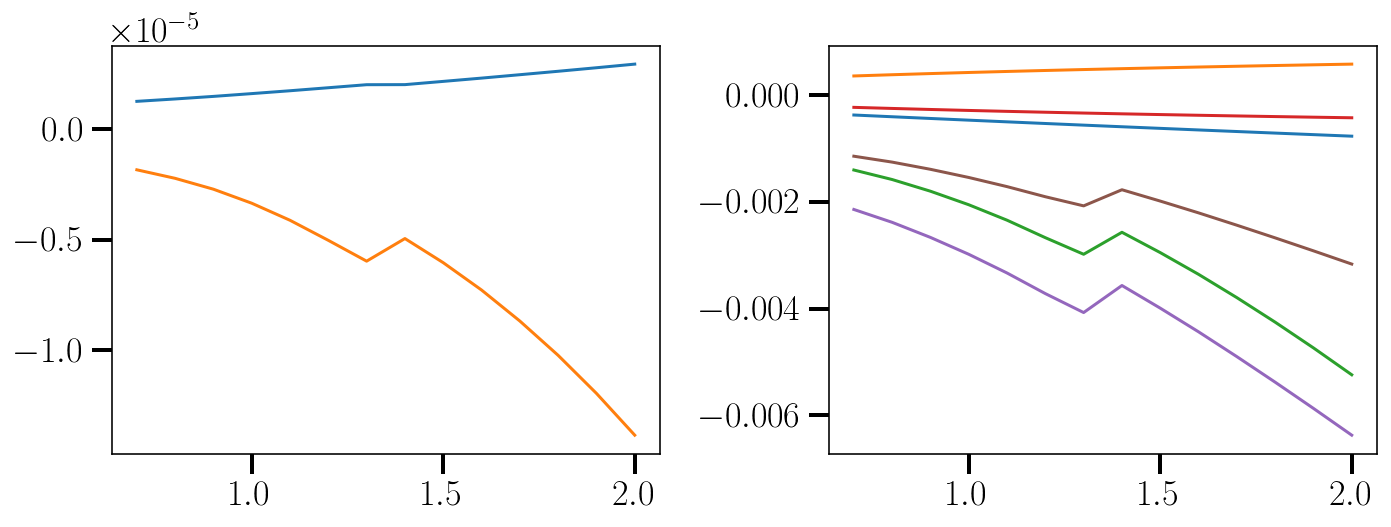

In [2114]:
#plt.plot(z_euclid,gr1)
#plt.plot(z_euclid,cosmo_functions.grd1(z_euclid))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#axs[0].plot(z_euclid,cosmo_functions.beta[13](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[12](z_euclid))
axs[0].plot(z_euclid,cosmo_functions.beta[11](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[10](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[9](z_euclid))
axs[0].plot(z_euclid,cosmo_functions.beta[8](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[7](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[6](z_euclid))


axs[1].plot(z_euclid,cosmo_functions.beta[14](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[15](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[16](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[17](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[18](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[19](z_euclid))
#axs[1].plot(z_euclid,cosmo_functions.betad[16](z_euclid))

plt.tight_layout()
plt.show()

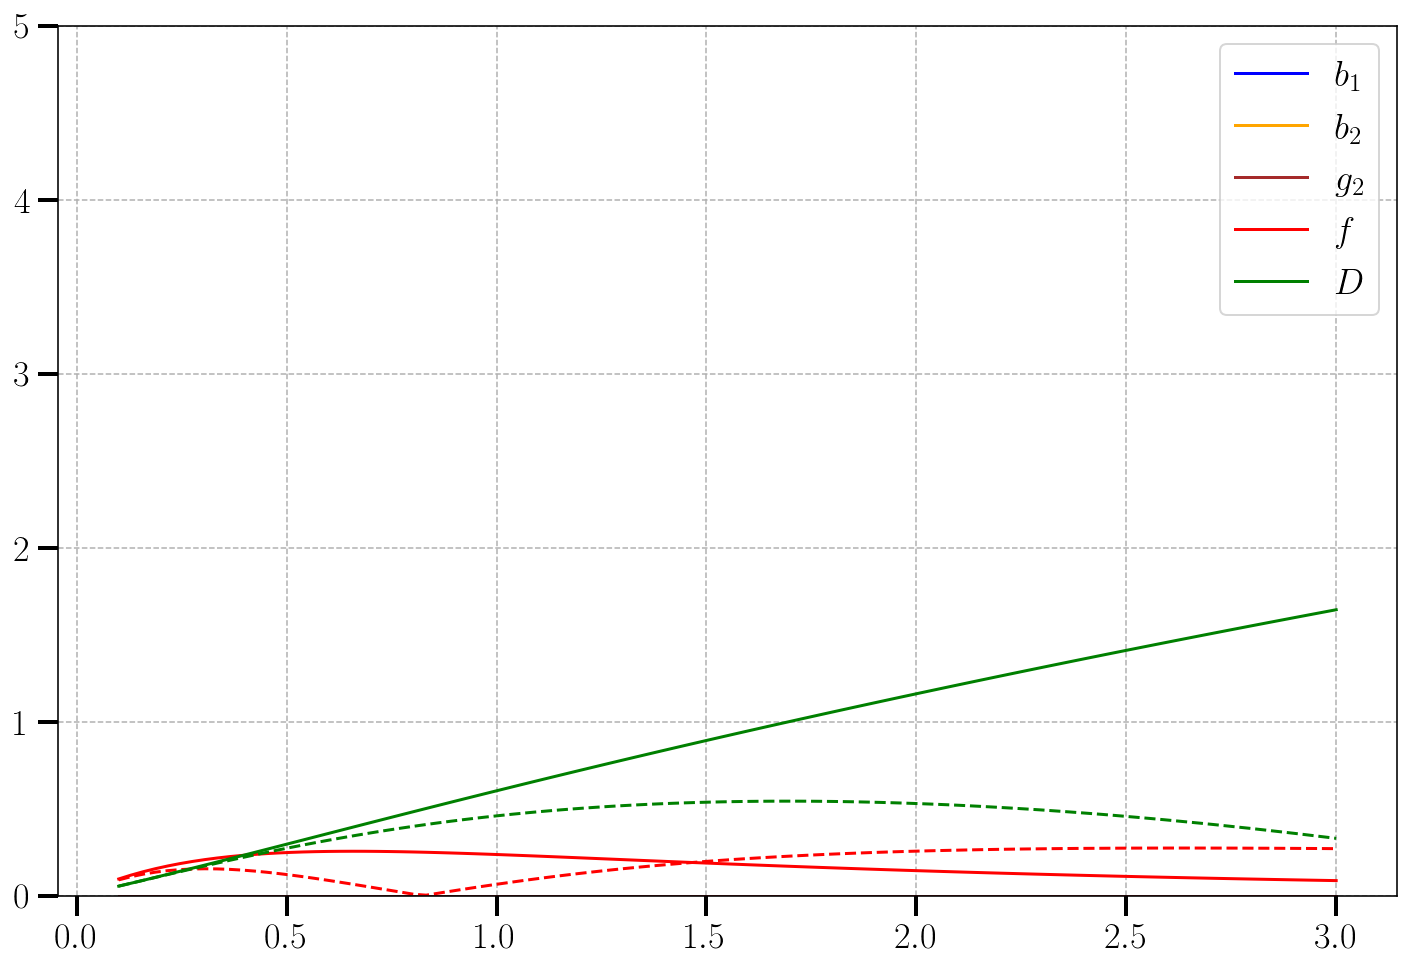

In [1177]:
#plot ratio of derivates of biases to normal term which repersents the rough size of derivative terms to wide-angle terms
plt.figure(figsize=(12,8))
z_plot = np.linspace(0.1,3,100)

plt.plot(z_plot,np.abs(cosmo_functions.b1_d(z_plot)/cosmo_functions.b_1(z_plot)),color='blue',label='$b_1$')
plt.plot(z_plot,np.abs(cosmo_functions.b1_dd(z_plot)/cosmo_functions.b_1(z_plot)),'--',color='blue')

plt.plot(z_plot,np.abs(cosmo_functions.b2_d(z_plot)/cosmo_functions.b_2(z_plot)),color='orange',label='$b_2$')
plt.plot(z_plot,np.abs(cosmo_functions.b2_dd(z_plot)/cosmo_functions.b_2(z_plot)),'--',color='orange')

plt.plot(z_plot,np.abs(cosmo_functions.g2_d(z_plot)/cosmo_functions.g_2(z_plot)),color='brown',label='$g_2$')
plt.plot(z_plot,np.abs(cosmo_functions.g2_dd(z_plot)/cosmo_functions.g_2(z_plot)),'--',color='brown')

plt.plot(z_plot,np.abs(cosmo_functions.f_d(z_plot)/cosmo_functions.f_intp(z_plot)),color='red',label='$f$')
plt.plot(z_plot,np.abs(cosmo_functions.f_dd(z_plot)/cosmo_functions.f_intp(z_plot)),'--',color='red')

plt.plot(z_plot,np.abs(cosmo_functions.D_d(z_plot)/cosmo_functions.D_intp(z_plot)),color='green',label='$D$')
plt.plot(z_plot,np.abs(cosmo_functions.D_dd(z_plot)/cosmo_functions.D_intp(z_plot)),'--',color='green')

plt.grid(ls='--',lw=0.75)
plt.ylim(0,5)
plt.legend()

$$\alpha(k,z)= \frac{2 k^2 c^2 D(z) T(k)}{3 H^2_0 \Omega_m}$$

In [1975]:
def transfer(z_,k_):
    k = cosmo.get_transfer(z_)['k (h/Mpc)']

    normalize = (cosmo.get_transfer(z_)['d_m'])[0]
    tmp = interp1d(k,cosmo.get_transfer(z_)['d_m']/normalize)
    return tmp(k_)

def M(k, z):
    """
        The scaling factor between the primordial scalar power spectrum and 
        the late-time matter power spectrum, defined as M(k, z) in Eq. 2.2 
        of arXiv:1911.03964.
    """
    # Rather than calculate this using a transfer function, we divide the linear 
    # matter power spectrum by our model for the primordial one and then take 
    # the square root.
    
    return np.sqrt( cosmo_functions.D_intp(z)**2 *cosmo_functions.Pk(k) / Pk_phi(k) )

def Pk_phi(k, k0=0.05, units=True):
    """
        Power spectrum of the Bardeen potential Phi in the matter-dominated era.
        k in units of h/Mpc.
    """
    k_pivot = k0/h
    resp = (9.0/25.0) * A_s * (k/k_pivot)**(n_s - 1.0)
    
    if units:
        resp *= 2*np.pi**2.0/k**3.0    #[Mpc/h]^3
        
    return resp

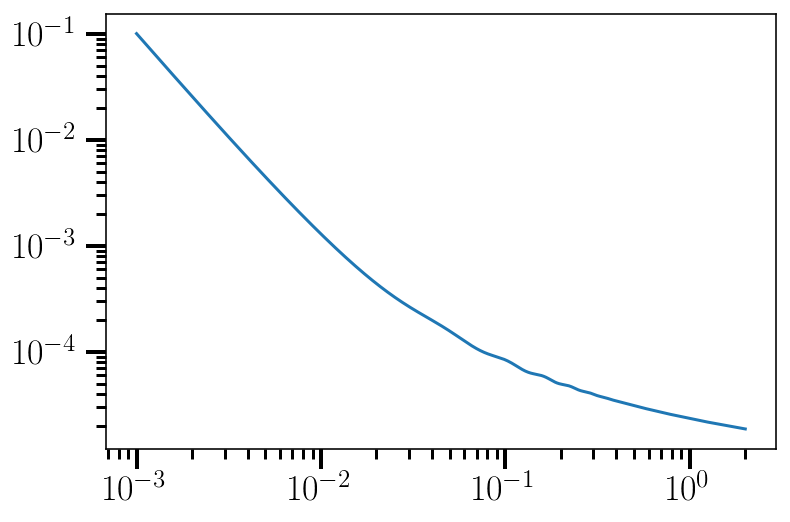

In [1972]:
plt.plot(kk,1/M(kk, 1))
plt.xscale('log')
plt.yscale('log')

## start with expression for each term!

In [2248]:
import sys
sys.path.append('bk_terms/')
from zeroth_order import *
from first_order import *
from wa2_terms import *
from der2_terms import *
from mix_terms import *
from GR import *   

In [2263]:
import json

with open('mathematica_expr/P23l0WAGR.json') as f:
    data = json.load(f)
tmpexp = str(mathematica(data)).replace('I*','1j*').replace('-I*','-1j*').replace('sqrt(','np.sqrt(').replace('pi','np.pi')
print(tmpexp)

-8*D1**4*Pk2*Pk3*ct**7*f**2*k1*k2**3*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 18*beta19*(C - 1)*(9*r + 9*s - 4))/(315*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**6*f*k2**2*(216*C*beta19*f*k1**2*r + 216*C*beta19*f*k1**2*s - 180*C*beta19*f*k1**2 + 648*C*beta19*f*k2**2*r + 648*C*beta19*f*k2**2*s - 288*C*beta19*f*k2**2 + 90*C*f*gr1*k1**2 + 63*K*b1*gr1*k1**2 - 63*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 18*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(79*r + 79*s - 59) - 395*beta18*f*k1**2*r - 395*beta18*f*k1**2*s + 295*beta18*f*k1**2 - 216*beta19*f*k1**2*r - 216*beta19*f*k1**2*s + 180*beta19*f*k1**2 - 486*beta19*f*k2**2*r - 486*beta19*f*k2**2*s + 216*beta19*f*k2**2 + 35*f**2*gr1*k1**2 - 90*f*gr1*k1**2 - 126*g2*gr1*k1**2)/(315*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 12*beta19*(C - 1)*(9*r + 9*s - 

In [148]:
with open("tmp.txt", "w") as file:
    file.write(str(tmpexp))

In [2266]:
#now for 2 mixing GRwadt
class WAGR:
    def l0(params,betas,r=0,s=0):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas
        
        st = np.sin(theta)
        ct = np.cos(theta)
        
        perm12 = -4*C*D1**4*Pk1*Pk2*f*k2**2*st**4*(7*b1*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(beta19*(5*r + 5*s - 4) + gr1*(-13*r - 13*s + 5)))/(35*d*k3**4) - 4*C*D1**4*Pk1*Pk2*st**2*(35*b1**2*beta19*k2**2*(r + s) - 7*b1*f*(2*beta19*(k1**2*(r + s + 1) + 2*k2**2*(3*r + 3*s - 2)) - gr1*(k1**2*(r + s + 3) + k2**2*(11*r + 11*s - 7))) + f**2*(-2*beta19*k1**2*(3*r + 3*s - 1) - 7*beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(3*r + 3*s + 1) + 7*gr1*k2**2*(9*r + 9*s - 5)))/(105*d*k3**4) + 4*C*D1**4*Pk1*Pk2*(5*b1**2*beta19*(2*k1**2 + 3*k2**2)*(r + s) + b1*f*(beta19*k1**2*(6*r + 6*s - 4) + 5*beta19*k2**2*(r + s) - gr1*k1**2*(11*r + 11*s - 7) - 10*gr1*k2**2*(r + s)) - 3*f**2*gr1*k1**2*(r + s - 1))/(15*d*k3**4) - 4*C*D1**4*Pk2*Pkd1*b1*k1*(5*b1*beta19*r + beta19*f*(3*r - 2) + f*gr1*(1 - 3*r))/(15*d*k3**2) + 4*C*D1**4*Pk2*Pkd1*f**2*gr1*k2**2*st**4*(r - 3)/(35*d*k1*k3**2) - 4*C*D1**4*Pk2*Pkd1*f*st**2*(beta19*k1**2*(7*b1*r + f*(3*r - 4)) + gr1*(-7*b1*(2*k1**2*r + k2**2*(r - 2)) + f*k1**2*(10 - 9*r)))/(105*d*k1*k3**2) - D1**4*Pk1*Pk2*ct**7*f**2*gr1*k2**3*(8*C - 8)*(9*r + 9*s - 4)/(35*d*k1*k3**4) + 4*D1**4*Pk1*Pk2*ct**6*f*k2**2*(7*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(beta19*k1**2*(C - 1)*(11*r + 11*s - 6) + gr1*k1**2*(C*(-23*r - 23*s + 11) + 32*r + 32*s - 15) + gr1*k2**2*(9*r + 9*s - 4)))/(35*d*k1**2*k3**4) - D1**4*Pk1*Pk2*ct**5*f**2*gr1*k2**3*st**2*(16*C - 16)*(9*r + 9*s - 4)/(35*d*k1*k3**4) - 2*D1**4*Pk1*Pk2*ct**5*f*k2*(7*b1*(beta19*k1**2*(4*C*(r + s + 1) + 5*r + 5*s - 10) + 3*beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(4*C*(r + s - 2) - 13*r - 13*s + 11) + gr1*k2**2*(C*(8*r + 8*s + 4) - 17*r - 17*s - 1)) + 3*f*(beta19*k1**2*(4*C*(3*r + 3*s - 1) - r - s - 2) + beta19*k2**2*(11*r + 11*s - 6) + gr1*k1**2*(-4*C*(9*r + 9*s - 4) + 13*r + 13*s - 5) + gr1*k2**2*(C*(-92*r - 92*s + 44) + 33*r + 33*s - 17)))/(105*d*k1*k3**4) + 8*D1**4*Pk1*Pk2*ct**4*f*k2**2*st**2*(7*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(beta19*k1**2*(C - 1)*(8*r + 8*s - 5) - gr1*(k1**2*(2*C - 3) - k2**2)*(9*r + 9*s - 4)))/(35*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk2*ct**4*(35*b1**2*beta19*k1**2*k2**2*(C - 1)*(r + s) - 7*b1*f*(beta19*k1**4*(C*(6*r + 6*s - 4) - 7*r - 7*s + 3) + beta19*k1**2*k2**2*(5*C*(5*r + 5*s - 4) - 17*r - 17*s + 13) + gr1*k1**4*(-13*C*r - 13*C*s + C + 12*r + 12*s + 1) - 2*gr1*k1**2*k2**2*(C*(16*r + 16*s - 7) - 10*r - 10*s + 5) - gr1*k2**4*(2*r + 2*s + 1)) - 3*f**2*(beta19*k1**4*(2*C*(5*r + 5*s - 4) - 13*r - 13*s + 9) + beta19*k1**2*k2**2*(4*C - 3)*(8*r + 8*s - 5) + gr1*k1**4*(C*(-33*r - 33*s + 17) + 42*r + 42*s - 21) - gr1*k1**2*k2**2*(2*C - 2)*(43*r + 43*s - 23) + 7*gr1*k2**4*(2*r + 2*s - 1)))/(105*d*k1**2*k3**4) - D1**4*Pk1*Pk2*ct**3*f**2*gr1*k2**3*st**4*(8*C - 8)*(9*r + 9*s - 4)/(35*d*k1*k3**4) - 4*D1**4*Pk1*Pk2*ct**3*f*k2*st**2*(7*b1*(beta19*k1**2*(2*C*(r + s + 1) + 7*r + 7*s - 8) + 3*beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(2*C*(r + s - 2) - 11*r - 11*s + 7) + gr1*k2**2*(C*(4*r + 4*s + 2) - 13*r - 13*s + 1)) + f*(beta19*k1**2*(C*(-6*r - 6*s + 2) + 30*r + 30*s - 17) + 3*beta19*k2**2*(8*r + 8*s - 5) + gr1*k1**2*(2*C - 8)*(9*r + 9*s - 4) + 6*gr1*k2**2*(C*(-32*r - 32*s + 15) + 5*r + 5*s - 3)))/(105*d*k1*k3**4) - 2*D1**4*Pk1*Pk2*ct**3*(35*b1**2*beta19*k2**2*(r + s)*(k1**2*(8*C - 7) + k2**2) - 7*b1*f*(2*beta19*(k1**4*(3*r + 3*s - 2) + k1**2*k2**2*(-20*C*(r + s - 1) + 33*r + 33*s - 27) + k2**4*(8*r + 8*s - 7)) + gr1*(k1**4*(4*C*(3*r + 3*s - 1) - 25*r - 25*s + 5) + 4*k1**2*k2**2*(10*C*(2*r + 2*s - 1) - 28*r - 28*s + 11) + k2**4*(4*C*(7*r + 7*s + 1) - 43*r - 43*s + 11))) + 3*f**2*(-beta19*(2*k1**4*(5*r + 5*s - 4) + k1**2*k2**2*(-8*C*(2*r + 2*s - 3) + 59*r + 59*s - 50) + 7*k2**4*(3*r + 3*s - 2)) + gr1*(k1**4*(-4*C*(5*r + 5*s - 3) + 53*r + 53*s - 29) - 4*k1**2*k2**2*(2*C*(6*r + 6*s - 5) - 45*r - 45*s + 27) + 7*k2**4*(C*(8*r + 8*s - 4) + 9*r + 9*s - 5))))/(105*d*k1*k2*k3**4) + 4*D1**4*Pk1*Pk2*ct**2*f*k2**2*st**4*(7*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(beta19*k1**2*(C - 1)*(5*r + 5*s - 4) + gr1*k1**2*(C*(-13*r - 13*s + 5) + 22*r + 22*s - 9) + gr1*k2**2*(9*r + 9*s - 4)))/(35*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk2*ct**2*st**2*(35*b1**2*beta19*k1**2*k2**2*(C - 1)*(r + s) - 7*b1*f*(beta19*k1**2*(k1**2*(2*C - 3)*(r + s + 1) + k2**2*(10*C*(3*r + 3*s - 2) - 13*r - 13*s + 7)) - gr1*(k1**4*(C*(r + s + 3) - 5) + k1**2*k2**2*(C*(29*r + 29*s - 13) - 8*r - 8*s + 6) + k2**4*(2*r + 2*s + 1))) + f**2*(-beta19*(k1**4*(2*C - 1)*(3*r + 3*s - 1) + k1**2*k2**2*(C*(69*r + 69*s - 44) - 18*r - 18*s + 13)) + gr1*(k1**4*(3*C*r + 3*C*s + C + 6*r + 6*s - 5) + k1**2*k2**2*(C*(171*r + 171*s - 83) - 96*r - 96*s + 52) - 21*k2**4*(2*r + 2*s - 1))))/(105*d*k1**2*k3**4) - 4*D1**4*Pk1*Pk2*ct**2*(35*b1**2*beta19*k1**2*k2**2*(r + s)*(k1**2*(2*C - 4) + k2**2*(4*C - 5)) + 7*b1*f*(-beta19*k1**2*k2**2*(k1**2*(17*r + 17*s - 13) + k2**2*(C*(11*r + 11*s - 14) + 16*r + 16*s - 9)) + gr1*(k1**6*(3*r + 3*s - 1) + k1**4*k2**2*(2*C*(r + s + 3) + 33*r + 33*s - 16) + k1**2*k2**4*(C*(13*r + 13*s - 11) + 34*r + 34*s - 8) + 5*k2**6*(r + s))) - 3*f**2*k1**2*(beta19*k2**2*(k1**2*(2*C*(5*r + 5*s - 4) + 7*r + 7*s - 7) + 7*k2**2*(C*(3*r + 3*s - 2) + r + s - 1)) - gr1*(k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(2*C*(13*r + 13*s - 5) + 33*r + 33*s - 24) + 7*k2**4*(C*(9*r + 9*s - 5) + 3*r + 3*s - 2))))/(105*d*k1**2*k2**2*k3**4) - 2*D1**4*Pk1*Pk2*ct*f*k2*st**4*(7*b1*(k1**2 + k2**2)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(beta19*(k1**2 + k2**2)*(5*r + 5*s - 4) - gr1*(k1**2*(13*r + 13*s - 5) + k2**2*(4*C*(9*r + 9*s - 4) + 13*r + 13*s - 5))))/(35*d*k1*k3**4) - 2*D1**4*Pk1*Pk2*ct*st**2*(35*b1**2*beta19*k2**2*(k1**2 + k2**2)*(r + s) - 7*b1*f*(2*beta19*(k1**4*(r + s + 1) + k1**2*k2**2*(2*C*(r + s + 1) + 7*r + 7*s - 3) + 2*k2**4*(3*r + 3*s - 2)) + gr1*(-k1**4*(r + s + 3) + 4*k1**2*k2**2*(C*(r + s - 2) - 3*r - 3*s + 1) + k2**4*(C*(8*r + 8*s + 4) - 11*r - 11*s + 7))) + f**2*(-beta19*(k1**4*(6*r + 6*s - 2) + k1**2*k2**2*(-4*C*(3*r + 3*s - 1) + 27*r + 27*s - 16) + 7*k2**4*(3*r + 3*s - 2)) + gr1*(k1**4*(3*r + 3*s + 1) + 2*k1**2*k2**2*(-2*C*(9*r + 9*s - 4) + 33*r + 33*s - 17) + 7*k2**4*(12*C*(2*r + 2*s - 1) + 9*r + 9*s - 5))))/(105*d*k1*k2*k3**4) + 2*D1**4*Pk1*Pk2*ct*(35*b1**2*beta19*(r + s)*(2*k1**4 + k1**2*k2**2*(8*C + 5) + 3*k2**4) + 7*b1*f*(beta19*(k1**4*(6*r + 6*s - 4) + k1**2*k2**2*(4*C*(11*r + 11*s - 9) + 11*r + 11*s - 4) + 5*k2**4*(r + s)) - gr1*(k1**4*(4*C*(3*r + 3*s - 1) + 11*r + 11*s - 7) + k1**2*k2**2*(4*C*(19*r + 19*s - 8) + 21*r + 21*s - 7) + k2**4*(20*C + 10)*(r + s))) - 3*f**2*k1**2*(-28*C*beta19*k2**2*(r + s - 1) + gr1*k1**2*(4*C*(5*r + 5*s - 3) + 7*r + 7*s - 7) + 7*gr1*k2**2*(4*C*(3*r + 3*s - 2) + r + s - 1)))/(105*d*k1*k2*k3**4) + D1**4*Pk1*ct**7*f**2*gr1*k2*(4*C - 4)*(-4*Pk2 + Pkd2*k2)*(9*s - 5)/(35*d*k1*k3**2) + D1**4*Pk1*ct**6*f*(4*Pk2 - Pkd2*k2)*(9*b1*beta17*(5*s - 2) + f*(beta17 + f*gr1)*(31*s - 14))/(63*d*k1**2) - 2*D1**4*Pk1*ct**6*f*(-7*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*(-beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(11*s - 10) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(33*s - 25) - 42*s + 30) + gr1*k2**2*(-2*Pk2*(C*(31*r + 5) - 31*r + 9*s - 10) + Pkd2*k2*(9*s - 5))))/(35*d*k1**2*k3**2) + D1**4*Pk1*ct**5*f**2*gr1*k2*st**2*(8*C - 8)*(-4*Pk2 + Pkd2*k2)*(9*s - 5)/(35*d*k1*k3**2) - D1**4*Pk1*ct**5*f*(100*Pk2*beta17*f*k2**2*r + 100*Pk2*beta17*f*k2**2 - 440*Pk2*beta18*f*k1**2*s + 280*Pk2*beta18*f*k1**2 - 1320*Pk2*f**2*gr1*k1**2*s + 700*Pk2*f**2*gr1*k1**2 + 100*Pk2*f**2*gr1*k2**2*r + 50*Pk2*f**2*gr1*k2**2 - 672*Pk2*g2*gr1*k1**2*s + 1008*Pk2*g2*gr1*k1**2 + 110*Pkd2*beta18*f*k1**2*k2*s - 70*Pkd2*beta18*f*k1**2*k2 + 330*Pkd2*f**2*gr1*k1**2*k2*s - 175*Pkd2*f**2*gr1*k1**2*k2 + 168*Pkd2*g2*gr1*k1**2*k2*s - 252*Pkd2*g2*gr1*k1**2*k2 - 3*b1*(-112*K*Pk2*gr1*k1**2*s + 168*K*Pk2*gr1*k1**2 + 28*K*Pkd2*gr1*k1**2*k2*s - 42*K*Pkd2*gr1*k1**2*k2 - 60*Pk2*beta17*k2**2*r + 432*Pk2*f*gr1*k1**2*s - 180*Pk2*f*gr1*k1**2 + 112*Pk2*gr1*k1**2*s - 168*Pk2*gr1*k1**2 - 108*Pkd2*f*gr1*k1**2*k2*s + 45*Pkd2*f*gr1*k1**2*k2 - 28*Pkd2*gr1*k1**2*k2*s + 42*Pkd2*gr1*k1**2*k2 + 21*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + 6*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)) - 9*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10))/(315*d*k1**3*k2) + D1**4*Pk1*ct**5*f*(7*b1*k1**2*(beta19*k1**2*(4*Pk2 - Pkd2*k2)*(4*C*(2*s - 3) - 17*s + 18) + 3*beta19*k2**2*(Pk2*(-r*(20*C - 20) - 6*s + 4) + Pkd2*k2*(3*s - 2)) - gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*C*(4*s - 3) - 25*s + 15) + gr1*k2**2*(2*Pk2*(-8*C*s + r*(30*C - 30) + 17*s - 3) + Pkd2*k2*(s*(8*C - 17) + 3))) - 3*f*(4*Pk2*gr1*k2**4*(11*r + 2) - beta19*k1**4*(4*Pk2 - Pkd2*k2)*(4*C*(2*s - 5) - 19*s + 30) + beta19*k1**2*k2**2*(Pk2*(C*(68*r + 40) - 68*r + 22*s - 60) + Pkd2*k2*(10 - 11*s)) + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(8*C*(3*s - 5) - 57*s + 65) + gr1*k1**2*k2**2*(-6*Pk2*(24*C*s + r*(34*C - 38) - s - 17) + Pkd2*k2*(C*(92*s - 48) - 23*s + 3))))/(105*d*k1**3*k2*k3**2) + D1**4*Pk1*ct**4*f*st**2*(4*Pk2 - Pkd2*k2)*(9*b1*beta17*(5*s - 2) + f*(beta17 + f*gr1)*(23*s - 10))/(21*d*k1**2) - 4*D1**4*Pk1*ct**4*f*st**2*(-7*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*(-2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(4*s - 3) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*C*(8*s - 5) - 33*s + 20) + gr1*k2**2*(-2*Pk2*(23*C*r + C - 23*r + 9*s - 6) + Pkd2*k2*(9*s - 5))))/(35*d*k1**2*k3**2) - D1**4*Pk1*ct**4*(-21*b1**2*(-9*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-5*K*s + 5*K + f*(9*s - 3) + 5*s - 5)) - 3*b1*(28*K*Pk2*f*gr1*k1**2*s + 84*K*Pk2*f*gr1*k1**2 + 154*K*Pk2*f*gr1*k2**2*r + 42*K*Pk2*f*gr1*k2**2 - 7*K*Pkd2*f*gr1*k1**2*k2*s - 21*K*Pkd2*f*gr1*k1**2*k2 + 126*Pk2*beta14*f*k2**2*s - 84*Pk2*beta14*f*k2**2 - 144*Pk2*beta17*f*k2**2*s + 84*Pk2*beta17*f*k2**2 + 132*Pk2*beta18*f*k1**2*s - 120*Pk2*beta18*f*k1**2 - 18*Pk2*beta18*f*k2**2*r + 528*Pk2*f**2*gr1*k1**2*s - 300*Pk2*f**2*gr1*k1**2 - 36*Pk2*f**2*gr1*k2**2*r + 132*Pk2*f**2*gr1*k2**2*s - 90*Pk2*f**2*gr1*k2**2 + 84*Pk2*f*gr1*k1**2*s - 252*Pk2*f*gr1*k1**2 - 154*Pk2*f*gr1*k2**2*r + 56*Pk2*f*gr1*k2**2*s - 126*Pk2*f*gr1*k2**2 + 280*Pk2*g2*gr1*k1**2*s - 280*Pk2*g2*gr1*k1**2 - 63*Pkd2*beta14*f*k2**3*s + 42*Pkd2*beta14*f*k2**3 + 72*Pkd2*beta17*f*k2**3*s - 42*Pkd2*beta17*f*k2**3 - 33*Pkd2*beta18*f*k1**2*k2*s + 30*Pkd2*beta18*f*k1**2*k2 - 132*Pkd2*f**2*gr1*k1**2*k2*s + 75*Pkd2*f**2*gr1*k1**2*k2 - 66*Pkd2*f**2*gr1*k2**3*s + 30*Pkd2*f**2*gr1*k2**3 - 21*Pkd2*f*gr1*k1**2*k2*s + 63*Pkd2*f*gr1*k1**2*k2 - 28*Pkd2*f*gr1*k2**3*s + 42*Pkd2*f*gr1*k2**3 - 70*Pkd2*g2*gr1*k1**2*k2*s + 70*Pkd2*g2*gr1*k1**2*k2 + 7*beta15*f*(-21*Pk2*k2**2*r + 2*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3)) + 21*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2)) + f*(-198*Pk2*beta14*f*k2**2*s + 180*Pk2*beta14*f*k2**2 + 9*Pk2*beta15*f*k2**2*(23*r + 16) + 450*Pk2*beta17*f*k2**2*s - 180*Pk2*beta17*f*k2**2 - 260*Pk2*beta18*f*k1**2*s + 280*Pk2*beta18*f*k1**2 + 10*Pk2*beta18*f*k2**2*r + 100*Pk2*beta18*f*k2**2 - 780*Pk2*f**2*gr1*k1**2*s + 560*Pk2*f**2*gr1*k1**2 + 30*Pk2*f**2*gr1*k2**2*r + 450*Pk2*f**2*gr1*k2**2*s + 20*Pk2*f**2*gr1*k2**2 + 168*Pk2*g2*gr1*k1**2*s + 504*Pk2*g2*gr1*k1**2 + 924*Pk2*g2*gr1*k2**2*r + 252*Pk2*g2*gr1*k2**2 + 99*Pkd2*beta14*f*k2**3*s - 90*Pkd2*beta14*f*k2**3 - 225*Pkd2*beta17*f*k2**3*s + 90*Pkd2*beta17*f*k2**3 + 65*Pkd2*beta18*f*k1**2*k2*s - 70*Pkd2*beta18*f*k1**2*k2 + 195*Pkd2*f**2*gr1*k1**2*k2*s - 140*Pkd2*f**2*gr1*k1**2*k2 - 225*Pkd2*f**2*gr1*k2**3*s + 90*Pkd2*f**2*gr1*k2**3 - 42*Pkd2*g2*gr1*k1**2*k2*s - 126*Pkd2*g2*gr1*k1**2*k2 - 18*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 5) - 9*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10)))/(315*d*k1**2*k2**2) + D1**4*Pk1*ct**4*(-70*b1**2*beta19*k1**2*k2**2*s*(C - 1)*(-2*Pk2 + Pkd2*k2) - 7*b1*f*(beta19*(-21*Pk2*k2**4*r + 2*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 3) + k1**2*k2**2*(Pk2*(4*C*(5*r + 19*s - 12) - 29*r - 32*s + 12) + 2*Pkd2*k2*(C*(16 - 25*s) + 14*s - 7))) + gr1*(-2*k1**4*(4*Pk2 - Pkd2*k2)*(C*(s + 3) + 3*s - 6) + k1**2*k2**2*(-4*C*(2*Pk2*(5*r + 10*s - 3) + Pkd2*k2*(4 - 13*s)) + 49*Pk2*r + 20*Pk2*s - 22*Pkd2*k2*s + 4*Pkd2*k2) + k2**4*(Pk2*(-4*C*(11*r + 3) + 65*r + 12) + 4*Pkd2*k2*s))) + 3*f**2*(beta19*(Pk2*k2**4*(23*r + 16) - 2*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 5) + k1**2*k2**2*(Pk2*(-4*C*(3*r + 22*s - 10) + 15*r + 36*s + 44) + 2*Pkd2*k2*(8*C*(4*s - 3) - 19*s + 9))) + gr1*(2*k1**4*(4*Pk2 - Pkd2*k2)*(C*(3*s + 5) + 3*s - 15) - k1**2*k2**2*(Pk2*(-4*C*(9*r + 66*s - 25) + 45*r + 154*s + 64) + 2*Pkd2*k2*(12*C*(8*s - 5) - 71*s + 32)) + k2**4*(Pk2*(-4*C*(31*r + 5) + 43*r + 10*s - 36) + 14*Pkd2*k2*(2*s - 1)))))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk1*ct**3*f**2*gr1*k2*st**4*(4*C - 4)*(-4*Pk2 + Pkd2*k2)*(9*s - 5)/(35*d*k1*k3**2) - 2*D1**4*Pk1*ct**3*f*st**2*(20*Pk2*beta17*f*k2**2*r + 20*Pk2*beta17*f*k2**2 - 376*Pk2*beta18*f*k1**2*s + 200*Pk2*beta18*f*k1**2 - 1128*Pk2*f**2*gr1*k1**2*s + 500*Pk2*f**2*gr1*k1**2 + 20*Pk2*f**2*gr1*k2**2*r + 10*Pk2*f**2*gr1*k2**2 - 336*Pk2*g2*gr1*k1**2*s + 504*Pk2*g2*gr1*k1**2 + 94*Pkd2*beta18*f*k1**2*k2*s - 50*Pkd2*beta18*f*k1**2*k2 + 282*Pkd2*f**2*gr1*k1**2*k2*s - 125*Pkd2*f**2*gr1*k1**2*k2 + 84*Pkd2*g2*gr1*k1**2*k2*s - 126*Pkd2*g2*gr1*k1**2*k2 - 3*b1*(-56*K*Pk2*gr1*k1**2*s + 84*K*Pk2*gr1*k1**2 + 14*K*Pkd2*gr1*k1**2*k2*s - 21*K*Pkd2*gr1*k1**2*k2 - 60*Pk2*beta17*k2**2*r + 432*Pk2*f*gr1*k1**2*s - 180*Pk2*f*gr1*k1**2 + 56*Pk2*gr1*k1**2*s - 84*Pk2*gr1*k1**2 - 108*Pkd2*f*gr1*k1**2*k2*s + 45*Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*gr1*k1**2*k2*s + 21*Pkd2*gr1*k1**2*k2 + 21*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + 6*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)) - 18*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3))/(315*d*k1**3*k2) - 2*D1**4*Pk1*ct**3*f*st**2*(-7*b1*k1**2*(beta19*k1**2*(4*Pk2 - Pkd2*k2)*(C*(4*s - 6) - 13*s + 12) + 3*beta19*k2**2*(-2*Pk2*(r*(8*C - 8) + 3*s - 2) + Pkd2*k2*(3*s - 2)) - gr1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(8*s - 6) - 17*s + 9) + gr1*k2**2*(Pk2*(-8*C*s + r*(48*C - 48) + 26*s - 6) + Pkd2*k2*(s*(4*C - 13) + 3))) - 3*f*(2*beta19*k1**2*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(4*s - 3) + k2**2*(-2*Pk2*(r*(7*C - 7) + 4*s - 3) + Pkd2*k2*(4*s - 3))) + gr1*(-28*Pk2*k2**4*r - 3*k1**4*(4*Pk2 - Pkd2*k2)*(C*(8*s - 4) - 16*s + 9) + k1**2*k2**2*(2*Pk2*(C*(42*r + 52*s - 32) - 50*r + 8*s - 7) + Pkd2*k2*(C*(34 - 64*s) + 4*s + 1)))))/(105*d*k1**3*k2*k3**2) + D1**4*Pk1*ct**3*(21*b1**2*(-12*Pk2*beta17*k2**4*r + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(4*f*s - 3*f + 5*s - 5) + gr1*k1**2*k2**2*(2*Pk2*(10*K*s + f*(8*s - 3) + r*(15*K - 15) - 5*s - 5) + Pkd2*k2*(-10*K*s + f*(3 - 8*s) + 5*s + 5)) + k1**2*k2**2*s*(2*Pk2 - Pkd2*k2)*(5*beta15 + 4*beta18)) + 3*b1*(14*K*Pk2*f*gr1*k1**2*k2**2*r + 112*K*Pk2*f*gr1*k1**2*k2**2*s - 84*K*Pk2*f*gr1*k1**2*k2**2 - 98*K*Pkd2*f*gr1*k1**2*k2**3*s + 112*K*Pkd2*f*gr1*k1**2*k2**3 - 42*Pk2*beta15*f*k1**2*k2**2*r - 182*Pk2*beta15*f*k1**2*k2**2*s + 112*Pk2*beta15*f*k1**2*k2**2 + 56*Pk2*beta16*f*k1**2*k2**2*s - 84*Pk2*beta16*f*k1**2*k2**2 + 24*Pk2*beta18*f*k1**2*k2**2*r - 144*Pk2*beta18*f*k1**2*k2**2*s + 84*Pk2*beta18*f*k1**2*k2**2 + 96*Pk2*f**2*gr1*k1**4*s - 120*Pk2*f**2*gr1*k1**4 + 96*Pk2*f**2*gr1*k1**2*k2**2*r - 240*Pk2*f**2*gr1*k1**2*k2**2*s - 54*Pk2*f**2*gr1*k1**2*k2**2 - 72*Pk2*f**2*gr1*k2**4*r - 36*Pk2*f**2*gr1*k2**4 - 28*Pk2*f*gr1*k1**4*s - 84*Pk2*f*gr1*k1**4 - 56*Pk2*f*gr1*k1**2*k2**2*r - 14*Pk2*f*gr1*k1**2*k2**2*s - 182*Pk2*f*gr1*k1**2*k2**2 - 126*Pk2*f*gr1*k2**4*r - 28*Pk2*f*gr1*k2**4 - 420*Pk2*g2*gr1*k1**2*k2**2*r - 280*Pk2*g2*gr1*k1**2*k2**2*s + 112*Pkd2*beta15*f*k1**2*k2**3*s - 70*Pkd2*beta15*f*k1**2*k2**3 - 28*Pkd2*beta16*f*k1**2*k2**3*s + 42*Pkd2*beta16*f*k1**2*k2**3 + 72*Pkd2*beta18*f*k1**2*k2**3*s - 42*Pkd2*beta18*f*k1**2*k2**3 - 24*Pkd2*f**2*gr1*k1**4*k2*s + 30*Pkd2*f**2*gr1*k1**4*k2 + 120*Pkd2*f**2*gr1*k1**2*k2**3*s - 18*Pkd2*f**2*gr1*k1**2*k2**3 + 7*Pkd2*f*gr1*k1**4*k2*s + 21*Pkd2*f*gr1*k1**4*k2 + 49*Pkd2*f*gr1*k1**2*k2**3*s - 7*Pkd2*f*gr1*k1**2*k2**3 + 140*Pkd2*g2*gr1*k1**2*k2**3*s + 14*beta14*f*(-6*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 3)) + 6*beta17*f*(-6*Pk2*k2**4*(r + 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 5))) + f*(18*beta14*f*(-6*Pk2*k2**4*(r + 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 5)) + k1**2*(10*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 7) + 5*f**2*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 7) + k2**2*(8*Pk2*(6*r - 27*s + 5) + 9*Pkd2*k2*(12*s - 5))) + f*k2**2*(72*Pk2*beta16*(r + s - 5) + 40*Pk2*beta18*(2*r - 9*s + 2) + 18*Pkd2*beta16*k2*(5 - 2*s) + 90*Pkd2*beta18*k2*(2*s - 1) - 9*beta15*(2*Pk2*(r + 16*s - 4) + 7*Pkd2*k2*(2 - 3*s))) - 42*gr1*k2**2*(-b2*(2*Pk2 - Pkd2*k2)*(2*s - 3) + 2*g2*(Pk2*(r + 8*s - 6) + Pkd2*k2*(8 - 7*s))))))/(315*d*k1**3*k2**3) - D1**4*Pk1*ct**3*(-35*b1**2*beta19*k1**2*k2**2*(Pk2*k1**2*s*(6 - 8*C) + Pk2*k2**2*r*(12 - 12*C) + Pkd2*k1**2*k2*s*(4*C - 3) + Pkd2*k2**3*s) + 7*b1*f*(2*beta19*k1**2*k2**2*(k1**2*(Pk2*(4*C*(7*s - 6) + 3*r - 33*s + 20) + Pkd2*k2*(-20*C*s + 16*C + 24*s - 15)) + k2**2*(Pk2*(-28*C*r + 12*C + 25*r + 3*s - 14) + Pkd2*k2*(8*s - 5))) + gr1*(2*Pk2*k2**6*(9*r + 2) + k1**6*(4*Pk2 - Pkd2*k2)*(s + 3) + 2*k1**4*k2**2*(Pk2*(2*C*(5*r - 22*s + 12) - 16*r + 43*s - 13) + Pkd2*k2*(2*C*(17*s - 8) - 35*s + 11)) + k1**2*k2**4*(Pk2*(4*C*(13*r + 6*s - 6) - 34*r - 30*s + 34) + Pkd2*k2*(s*(28*C - 37) + 5)))) - 3*f**2*(beta19*k1**2*k2**2*(k1**2*(-2*Pk2*(8*C*(2*s - 5) + 9*r - 24*s + 20) + Pkd2*k2*(12*C*(3*s - 4) - 49*s + 42)) + k2**2*(2*Pk2*(34*C*r + 20*C - 41*r - 5*s + 10) + 7*Pkd2*k2*(2 - 3*s))) + gr1*(28*Pk2*k2**6*r - k1**6*(4*Pk2 - Pkd2*k2)*(3*s + 5) - 2*k1**4*k2**2*(Pk2*(C*(22*r - 48*s + 60) - 49*r + 75*s - 15) + Pkd2*k2*(6*C*(9*s - 8) - 75*s + 43)) + k1**2*k2**4*(Pk2*(-4*C*(51*r + 20) + 274*r + 30*s - 50) + 7*Pkd2*k2*(C*(8*s - 4) + 9*s - 5)))))/(105*d*k1**3*k2**3*k3**2) + D1**4*Pk1*ct**2*f*st**4*(4*Pk2 - Pkd2*k2)*(5*s - 2)*(3*b1*beta17 + f*(beta17 + f*gr1))/(7*d*k1**2) - 2*D1**4*Pk1*ct**2*f*st**4*(-7*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*(-beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(5*s - 2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(5*C*(3*s - 1) - 24*s + 10) + gr1*k2**2*(Pk2*(C*(6 - 30*r) + 30*r - 18*s + 4) + Pkd2*k2*(9*s - 5))))/(35*d*k1**2*k3**2) + D1**4*Pk1*ct**2*st**2*(7*b1**2*(-18*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-5*K*s + 5*K + 6*f*(3*s - 1) + 5*s - 5)) + b1*(-84*K*Pk2*f*gr1*k1**2*s + 28*K*Pk2*f*gr1*k1**2 + 42*K*Pk2*f*gr1*k2**2*r - 14*K*Pk2*f*gr1*k2**2 + 21*K*Pkd2*f*gr1*k1**2*k2*s - 7*K*Pkd2*f*gr1*k1**2*k2 + 252*Pk2*beta14*f*k2**2*s - 168*Pk2*beta14*f*k2**2 - 324*Pk2*beta17*f*k2**2*s + 168*Pk2*beta17*f*k2**2 + 192*Pk2*beta18*f*k1**2*s - 144*Pk2*beta18*f*k1**2 + 12*Pk2*beta18*f*k2**2*r + 768*Pk2*f**2*gr1*k1**2*s - 360*Pk2*f**2*gr1*k1**2 + 24*Pk2*f**2*gr1*k2**2*r + 192*Pk2*f**2*gr1*k2**2*s - 108*Pk2*f**2*gr1*k2**2 + 196*Pk2*f*gr1*k1**2*s - 196*Pk2*f*gr1*k1**2 - 42*Pk2*f*gr1*k2**2*r + 56*Pk2*f*gr1*k2**2*s - 70*Pk2*f*gr1*k2**2 + 280*Pk2*g2*gr1*k1**2*s - 280*Pk2*g2*gr1*k1**2 - 126*Pkd2*beta14*f*k2**3*s + 84*Pkd2*beta14*f*k2**3 + 162*Pkd2*beta17*f*k2**3*s - 84*Pkd2*beta17*f*k2**3 - 48*Pkd2*beta18*f*k1**2*k2*s + 36*Pkd2*beta18*f*k1**2*k2 - 192*Pkd2*f**2*gr1*k1**2*k2*s + 90*Pkd2*f**2*gr1*k1**2*k2 - 96*Pkd2*f**2*gr1*k2**3*s + 36*Pkd2*f**2*gr1*k2**3 - 49*Pkd2*f*gr1*k1**2*k2*s + 49*Pkd2*f*gr1*k1**2*k2 - 28*Pkd2*f*gr1*k2**3*s + 42*Pkd2*f*gr1*k2**3 - 70*Pkd2*g2*gr1*k1**2*k2*s + 70*Pkd2*g2*gr1*k1**2*k2 + 14*beta15*f*(-15*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3)) + 42*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2)) - 2*f*(-48*Pk2*beta14*f*k2**2*s + 36*Pk2*beta14*f*k2**2 + 90*Pk2*beta17*f*k2**2*s - 36*Pk2*beta17*f*k2**2 - 68*Pk2*beta18*f*k1**2*s + 40*Pk2*beta18*f*k1**2 - 14*Pk2*beta18*f*k2**2*r + 4*Pk2*beta18*f*k2**2 - 204*Pk2*f**2*gr1*k1**2*s + 80*Pk2*f**2*gr1*k1**2 - 42*Pk2*f**2*gr1*k2**2*r + 90*Pk2*f**2*gr1*k2**2*s - 28*Pk2*f**2*gr1*k2**2 - 84*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2 + 42*Pk2*g2*gr1*k2**2*r - 14*Pk2*g2*gr1*k2**2 + 24*Pkd2*beta14*f*k2**3*s - 18*Pkd2*beta14*f*k2**3 - 45*Pkd2*beta17*f*k2**3*s + 18*Pkd2*beta17*f*k2**3 + 17*Pkd2*beta18*f*k1**2*k2*s - 10*Pkd2*beta18*f*k1**2*k2 + 51*Pkd2*f**2*gr1*k1**2*k2*s - 20*Pkd2*f**2*gr1*k1**2*k2 - 45*Pkd2*f**2*gr1*k2**3*s + 18*Pkd2*f**2*gr1*k2**3 + 21*Pkd2*g2*gr1*k1**2*k2*s - 7*Pkd2*g2*gr1*k1**2*k2 - 3*beta15*f*(Pk2*k2**2*(1 - 6*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3)) - 6*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3)))/(105*d*k1**2*k2**2) + D1**4*Pk1*ct**2*(21*b1**2*(-20*Pk2*beta15*k1**2*s - 25*Pk2*beta15*k2**2*r + 10*Pk2*beta16*k1**2*s - 2*Pk2*beta18*k1**2*s - 2*Pk2*beta18*k2**2*r - 5*Pkd2*beta14*k2**3*s + 10*Pkd2*beta15*k1**2*k2*s - 5*Pkd2*beta16*k1**2*k2*s + 15*Pkd2*beta17*k2**3*s + Pkd2*beta18*k1**2*k2*s + f*gr1*(k1**2*(2*Pk2*(5*r - 17*s + 2) + Pkd2*k2*(17*s - 2)) + k2**2*(-2*Pk2*(2*r + 3) + Pkd2*k2*s)) + 5*gr1*(-2*K*Pk2*k2**2*(r - 1) + 4*K*k1**2*(Pk2 - Pkd2*k2)*(s - 1) - Pk2*k1**2*(r + 4*s) - Pk2*k2**2*(3*r + 2) + 2*Pkd2*k1**2*k2*(2*s - 1) + 2*Pkd2*k2**3*s)) - 3*b1*(28*K*Pk2*f*gr1*k1**2*s + 84*K*Pk2*f*gr1*k1**2 + 154*K*Pk2*f*gr1*k2**2*r + 42*K*Pk2*f*gr1*k2**2 + 28*K*Pkd2*f*gr1*k1**2*k2*s - 56*K*Pkd2*f*gr1*k1**2*k2 - 70*Pk2*b2*gr1*k1**2*s + 70*Pk2*b2*gr1*k1**2 - 70*Pk2*beta14*f*k1**2*r - 66*Pk2*beta17*f*k1**2*r + 144*Pk2*beta18*f*k1**2*s - 84*Pk2*beta18*f*k1**2 - 6*Pk2*beta18*f*k2**2*r + 36*Pk2*beta18*f*k2**2 - 132*Pk2*f**2*gr1*k1**2*r + 540*Pk2*f**2*gr1*k1**2*s - 120*Pk2*f**2*gr1*k1**2 - 24*Pk2*f**2*gr1*k2**2*r + 90*Pk2*f**2*gr1*k2**2 - 63*Pk2*f*gr1*k1**2*r + 98*Pk2*f*gr1*k1**2*s - 105*Pk2*f*gr1*k2**2*r - 42*Pk2*f*gr1*k2**2*s + 126*Pk2*f*gr1*k2**2 + 280*Pk2*g2*gr1*k1**2*s - 280*Pk2*g2*gr1*k1**2 - 140*Pk2*g2*gr1*k2**2*r + 140*Pk2*g2*gr1*k2**2 + 35*Pkd2*b2*gr1*k1**2*k2*s - 35*Pkd2*b2*gr1*k1**2*k2 - 112*Pkd2*beta14*f*k2**3*s + 70*Pkd2*beta14*f*k2**3 - 63*Pkd2*beta17*f*k2**3*s - 72*Pkd2*beta18*f*k1**2*k2*s + 42*Pkd2*beta18*f*k1**2*k2 - 270*Pkd2*f**2*gr1*k1**2*k2*s + 90*Pkd2*f**2*gr1*k1**2*k2 - 126*Pkd2*f**2*gr1*k2**3*s + 42*Pkd2*f**2*gr1*k2**3 - 112*Pkd2*f*gr1*k1**2*k2*s + 84*Pkd2*f*gr1*k1**2*k2 - 70*Pkd2*f*gr1*k2**3*s + 70*Pkd2*f*gr1*k2**3 - 280*Pkd2*g2*gr1*k1**2*k2*s + 280*Pkd2*g2*gr1*k1**2*k2 + 14*beta15*f*(2*Pk2*k2**2*(2 - 3*r) + k1**2*(Pk2*(13*s - 8) + Pkd2*k2*(5 - 8*s))) + 14*beta16*f*(Pk2*k2**2*r + k1**2*(2*Pk2 - Pkd2*k2)*(8*s - 5))) + f*(-42*Pk2*b2*gr1*k1**2*s - 126*Pk2*b2*gr1*k1**2 - 42*Pk2*b2*gr1*k2**2*r - 126*Pk2*b2*gr1*k2**2 - 378*Pk2*beta16*f*k1**2*s + 252*Pk2*beta16*f*k1**2 + 18*Pk2*beta16*f*k2**2*r - 108*Pk2*beta16*f*k2**2 + 170*Pk2*beta17*f*k1**2*r - 100*Pk2*beta17*f*k1**2 - 270*Pk2*beta18*f*k1**2*s + 180*Pk2*beta18*f*k1**2 + 170*Pk2*f**2*gr1*k1**2*r - 810*Pk2*f**2*gr1*k1**2*s + 260*Pk2*f**2*gr1*k1**2 + 168*Pk2*g2*gr1*k1**2*s + 504*Pk2*g2*gr1*k1**2 + 924*Pk2*g2*gr1*k2**2*r + 252*Pk2*g2*gr1*k2**2 + 21*Pkd2*b2*gr1*k1**2*k2*s + 63*Pkd2*b2*gr1*k1**2*k2 + 189*Pkd2*beta16*f*k1**2*k2*s - 126*Pkd2*beta16*f*k1**2*k2 + 135*Pkd2*beta18*f*k1**2*k2*s - 90*Pkd2*beta18*f*k1**2*k2 + 405*Pkd2*f**2*gr1*k1**2*k2*s - 180*Pkd2*f**2*gr1*k1**2*k2 + 168*Pkd2*g2*gr1*k1**2*k2*s - 336*Pkd2*g2*gr1*k1**2*k2 + 9*beta14*f*(2*Pk2*k1**2*(11*r - 10) + 7*Pkd2*k2**3*(3*s - 2)) - 9*beta15*f*(-21*Pk2*k2**2*r + 2*k1**2*(3*Pk2*(3*s - 4) - 7*Pkd2*k2*(s - 1)))))/(315*d*k1**2*k2**2) - 2*D1**4*Pk1*ct**2*st**2*(35*b1**2*beta19*k1**2*k2**2*s*(C - 1)*(-2*Pk2 + Pkd2*k2) + 7*b1*f*(beta19*(-15*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 3) + k1**2*k2**2*(Pk2*(2*C*(r + 24*s - 18) - 11*r - 8*s + 6) + Pkd2*k2*(C*(22 - 30*s) + 10*s - 7))) + gr1*(k1**4*(4*Pk2 - Pkd2*k2)*(C*(3*s - 1) - 7*s + 4) + k1**2*k2**2*(-2*C*Pk2*(2*r + 21*s - 9) + C*Pkd2*k2*(27*s - 11) + 13*Pk2*r - 6*Pk2*s - 3*Pkd2*k2*s + 2*Pkd2*k2) + k2**4*(Pk2*(-6*C*r + 2*C + 21*r - 2) + 2*Pkd2*k2*s))) + f**2*(beta19*(3*Pk2*k2**4*(1 - 6*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 3) + k1**2*k2**2*(3*Pk2*(2*C*(5*r + 17*s - 20) - 10*r + 6*s + 3) + Pkd2*k2*(C*(50 - 69*s) + 9*s - 5))) + gr1*(3*k1**4*(4*Pk2 - Pkd2*k2)*(C*(5*s - 1) - 17*s + 7) + k1**2*k2**2*(Pk2*(-6*C*(15*r + 51*s - 50) + 90*r + 12*s - 81) + Pkd2*k2*(C*(207*s - 125) - 69*s + 38)) - 3*k2**4*(Pk2*(-4*C*(13*r + 3) + 38*r + 6*s + 1) + 7*Pkd2*k2*(2*s - 1)))))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk1*ct**2*(-35*b1**2*beta19*(-5*Pk2*k2**4*r + k1**4*(-4*Pk2*s + 2*Pkd2*k2*s) + k1**2*k2**2*(Pk2*r*(11 - 12*C) - Pk2*s*(8*C - 8) - Pkd2*k2*s*(8*C - 8))) + 7*b1*f*(2*beta19*(2*Pk2*k2**4*(2 - 3*r) + k1**4*(Pk2*(13*s - 8) + Pkd2*k2*(5 - 8*s)) + k1**2*k2**2*(Pk2*(4*C*(7*r + 3*s - 3) - 50*r - 15*s + 22) + Pkd2*k2*(C*(10 - 11*s) - 13*s + 5))) + gr1*(k1**4*(Pk2*(-8*C*(s + 3) + 21*r - 36*s + 28) + 4*Pkd2*k2*(-2*C*(s - 2) + 9*s - 5)) + 2*k1**2*k2**2*(Pk2*(C*(-38*r - 24*s + 6) + 79*r + 33*s - 16) + Pkd2*k2*(C*(7*s - 5) + 28*s - 5)) + k2**4*(Pk2*(-4*C*(11*r + 3) + 49*r + 26*s - 8) + 10*Pkd2*k2*s))) - 3*f**2*(beta19*(21*Pk2*k2**4*r + 2*k1**4*(Pk2*(12 - 9*s) + 7*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(-4*C*(3*r + 10) + 77*r + 10*s - 4) + 14*Pkd2*k2*(C*(3*s - 2) + s - 1))) + gr1*(-63*Pk2*k2**4*r + k1**4*(Pk2*(8*C*(3*s + 5) - 39*r + 42*s - 44) + 2*Pkd2*k2*(4*C*(s - 3) - 28*s + 21)) + 2*k1**2*k2**2*(Pk2*(18*C*r + 50*C - 125*r - 15*s + 12) - 7*Pkd2*k2*(9*C*s - 5*C + 3*s - 2)))))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk1*ct*f*st**4*(3*b1*(-20*Pk2*beta17*k2**2*r + 144*Pk2*f*gr1*k1**2*s - 60*Pk2*f*gr1*k1**2 - 36*Pkd2*f*gr1*k1**2*k2*s + 15*Pkd2*f*gr1*k1**2*k2 + 7*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + 2*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)) + f*(20*Pk2*beta17*k2**2*r + 20*Pk2*beta17*k2**2 + 312*Pk2*f*gr1*k1**2*s - 100*Pk2*f*gr1*k1**2 + 20*Pk2*f*gr1*k2**2*r + 10*Pk2*f*gr1*k2**2 - 78*Pkd2*f*gr1*k1**2*k2*s + 25*Pkd2*f*gr1*k1**2*k2 + 3*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2) + 2*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 5)))/(105*d*k1**3*k2) + D1**4*Pk1*ct*f*st**4*(-7*b1*k1**2*(beta19*(k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + k2**2*(2*Pk2*(r*(6*C - 6) + 3*s - 2) + Pkd2*k2*(2 - 3*s))) - gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1) + k2**2*(2*Pk2*(r*(6*C - 6) + 3*s - 1) + Pkd2*k2*(1 - 3*s)))) + f*(4*Pk2*gr1*k2**4*(2 - 3*r) - beta19*k1**4*(4*Pk2 - Pkd2*k2)*(5*s - 2) + beta19*k1**2*k2**2*(-2*Pk2*(2*C*(5*r - 2) - 10*r + 5*s + 2) + Pkd2*k2*(5*s - 2)) + 5*gr1*k1**4*(4*Pk2 - Pkd2*k2)*(3*s - 1) + gr1*k1**2*k2**2*(2*Pk2*(30*C*r + 32*C*(s - 1) - 34*r + 19*s + 5) + Pkd2*k2*(-4*C*(9*s - 5) - 15*s + 5))))/(35*d*k1**3*k2*k3**2) + D1**4*Pk1*ct*st**2*(7*b1**2*(-12*Pk2*beta17*k2**4*r + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(4*f*s - 3*f + 5*s - 5) + gr1*k1**2*k2**2*(2*Pk2*(f*(8*s - 3) + 5*r*(K - 1) + 5*s - 5) + Pkd2*k2*(f*(3 - 8*s) - 5*s + 5)) + k1**2*k2**2*s*(2*Pk2 - Pkd2*k2)*(5*beta15 + 4*beta18)) + b1*(42*K*Pk2*f*gr1*k1**2*k2**2*r + 28*K*Pk2*f*gr1*k1**2*k2**2*s - 140*K*Pk2*f*gr1*k1**2*k2**2 - 28*K*Pkd2*f*gr1*k1**2*k2**3*s + 42*K*Pkd2*f*gr1*k1**2*k2**3 + 14*Pk2*beta15*f*k1**2*k2**2*r - 126*Pk2*beta15*f*k1**2*k2**2*s + 112*Pk2*beta15*f*k1**2*k2**2 + 56*Pk2*beta16*f*k1**2*k2**2*s - 84*Pk2*beta16*f*k1**2*k2**2 + 48*Pk2*beta18*f*k1**2*k2**2*r - 120*Pk2*beta18*f*k1**2*k2**2*s + 84*Pk2*beta18*f*k1**2*k2**2 + 192*Pk2*f**2*gr1*k1**4*s - 72*Pk2*f**2*gr1*k1**4 + 192*Pk2*f**2*gr1*k1**2*k2**2*r - 144*Pk2*f**2*gr1*k1**2*k2**2*s + 18*Pk2*f**2*gr1*k1**2*k2**2 + 24*Pk2*f**2*gr1*k2**4*r + 12*Pk2*f**2*gr1*k2**4 + 84*Pk2*f*gr1*k1**4*s - 28*Pk2*f*gr1*k1**4 - 28*Pk2*f*gr1*k1**2*k2**2*r + 126*Pk2*f*gr1*k1**2*k2**2*s - 70*Pk2*f*gr1*k1**2*k2**2 - 14*Pk2*f*gr1*k2**4*r + 28*Pk2*f*gr1*k2**4 - 140*Pk2*g2*gr1*k1**2*k2**2*r + 84*Pkd2*beta15*f*k1**2*k2**3*s - 70*Pkd2*beta15*f*k1**2*k2**3 - 28*Pkd2*beta16*f*k1**2*k2**3*s + 42*Pkd2*beta16*f*k1**2*k2**3 + 60*Pkd2*beta18*f*k1**2*k2**3*s - 42*Pkd2*beta18*f*k1**2*k2**3 - 48*Pkd2*f**2*gr1*k1**4*k2*s + 18*Pkd2*f**2*gr1*k1**4*k2 + 72*Pkd2*f**2*gr1*k1**2*k2**3*s - 36*Pkd2*f**2*gr1*k1**2*k2**3 - 21*Pkd2*f*gr1*k1**4*k2*s + 7*Pkd2*f*gr1*k1**4*k2 - 49*Pkd2*f*gr1*k1**2*k2**3*s + 49*Pkd2*f*gr1*k1**2*k2**3 + 14*beta14*f*(-6*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 3)) + 6*beta17*f*(2*Pk2*k2**4*(r + 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 3))) + f*(6*beta14*f*(2*Pk2*k2**4*(r + 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 3)) + k1**2*(10*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + f**2*gr1*(5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(8*Pk2*(12*r - 27*s + 10) + 9*Pkd2*k2*(12*s - 5))) + f*k2**2*(Pk2*beta15*(-6*r - 24*s + 40) + 24*Pk2*beta16*(2*r + 2*s - 3) + 8*Pk2*beta18*(4*r - 9*s + 4) + 7*Pkd2*beta15*k2*(3*s - 2) + 6*Pkd2*beta16*k2*(3 - 4*s) + 18*Pkd2*beta18*k2*(2*s - 1)) - 14*gr1*k2**2*(-b2*(2*Pk2 - Pkd2*k2)*(2*s - 3) + 2*g2*(3*Pk2*r + 2*Pk2*(s - 5) + Pkd2*k2*(3 - 2*s))))))/(105*d*k1**3*k2**3) + D1**4*Pk1*ct*(-7*b1**2*(-10*Pkd2*beta16*k1**2*k2**3*s + 10*beta14*(2*Pk2*k1**4*s + 2*Pk2*k2**4*r - Pkd2*k1**4*k2*s) - 5*beta15*k1**2*k2**2*(2*Pk2*(2*r + s) + 3*Pkd2*k2*s) - 6*beta17*k1**4*s*(-2*Pk2 + Pkd2*k2) - 2*beta18*k1**2*k2**2*(4*Pk2*r + 5*Pkd2*k2*s) + gr1*(2*Pk2*f*k2**4*(2*r + 1) + 5*k1**4*(Pk2*(4*f*s - 2*f + 4*s - 4) + Pkd2*k2*(-2*f*s + f - 3*s + 3)) + k1**2*k2**2*(Pk2*f*(6 - 16*r) + 10*Pk2*(2*K*s + r*(3*K - 5) - 3*s + 3) + Pkd2*f*k2*(5 - 26*s) - 5*Pkd2*k2*(s*(2*K + 5) - 3)))) + b1*(-14*K*Pk2*f*gr1*k1**2*k2**2*r - 84*K*Pk2*f*gr1*k1**2*k2**2 + 70*K*Pkd2*f*gr1*k1**2*k2**3*s - 70*K*Pkd2*f*gr1*k1**2*k2**3 + 154*Pk2*beta15*f*k1**2*k2**2*r + 42*Pk2*beta15*f*k1**2*k2**2*s - 56*Pk2*beta15*f*k1**2*k2**2 + 56*Pk2*beta16*f*k1**2*k2**2*r - 84*Pk2*beta16*f*k1**2*k2**2 + 48*Pk2*beta18*f*k1**2*k2**2*r - 36*Pk2*beta18*f*k1**2*k2**2 - 168*Pk2*f**2*gr1*k1**4*s + 84*Pk2*f**2*gr1*k1**4 + 96*Pk2*f**2*gr1*k1**2*k2**2*r - 54*Pk2*f**2*gr1*k1**2*k2**2 - 28*Pk2*f*gr1*k1**4*s + 56*Pk2*f*gr1*k1**4 + 196*Pk2*f*gr1*k1**2*k2**2*r + 42*Pk2*f*gr1*k1**2*k2**2*s - 98*Pk2*f*gr1*k1**2*k2**2 + 70*Pk2*f*gr1*k2**4*r + 420*Pk2*g2*gr1*k1**2*k2**2*r + 280*Pk2*g2*gr1*k1**2*k2**2*s + 70*Pkd2*b2*gr1*k1**2*k2**3*s + 35*Pkd2*beta15*f*k1**2*k2**3*s + 112*Pkd2*beta16*f*k1**2*k2**3*s - 70*Pkd2*beta16*f*k1**2*k2**3 + 42*Pkd2*beta18*f*k1**2*k2**3*s + 84*Pkd2*f**2*gr1*k1**4*k2*s - 42*Pkd2*f**2*gr1*k1**4*k2 + 168*Pkd2*f**2*gr1*k1**2*k2**3*s - 63*Pkd2*f**2*gr1*k1**2*k2**3 + 35*Pkd2*f*gr1*k1**4*k2*s - 35*Pkd2*f*gr1*k1**4*k2 + 105*Pkd2*f*gr1*k1**2*k2**3*s - 105*Pkd2*f*gr1*k1**2*k2**3 - 140*Pkd2*g2*gr1*k1**2*k2**3*s - 14*beta14*f*(2*Pk2*k2**4*(r + 1) + k1**4*(2*Pk2 - Pkd2*k2)*(8*s - 5)) - 6*beta17*f*k1**4*(2*Pk2 - Pkd2*k2)*(12*s - 7)) + f*k1**2*(56*Pk2*b2*gr1*k2**2*r - 84*Pk2*b2*gr1*k2**2 + 42*Pk2*beta15*f*k2**2*r - 60*Pk2*f**2*gr1*k1**2*s + 30*Pk2*f**2*gr1*k1**2 + 28*Pk2*g2*gr1*k2**2*r + 168*Pk2*g2*gr1*k2**2 + 70*Pkd2*b2*gr1*k2**3*s - 70*Pkd2*b2*gr1*k2**3 + 42*Pkd2*beta16*f*k2**3*s - 42*Pkd2*beta16*f*k2**3 + 30*Pkd2*f**2*gr1*k1**2*k2*s - 15*Pkd2*f**2*gr1*k1**2*k2 - 140*Pkd2*g2*gr1*k2**3*s + 140*Pkd2*g2*gr1*k2**3 - 42*beta14*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) - 30*beta17*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)))/(105*d*k1**3*k2**3) + D1**4*Pk1*ct*st**2*(35*b1**2*beta19*k1**2*k2**2*(-2*Pk2*k1**2*s + Pk2*k2**2*r*(4 - 4*C) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + 7*b1*f*(2*beta19*k1**2*k2**2*(k1**2*(Pk2*(-4*C*(s - 4) - 3*r + 5*s - 12) + Pkd2*k2*(C*(4*s - 6) - 6*s + 5)) + k2**2*(Pk2*(24*C*r + 4*C - 25*r - 3*s - 2) + Pkd2*k2*(5 - 6*s))) + gr1*(-2*Pk2*k2**6*(r - 2) + k1**6*(4*Pk2 - Pkd2*k2)*(3*s - 1) - 2*k1**4*k2**2*(-Pk2*(2*C*(3*r + 4*s - 8) + 5*s + 7) + Pkd2*k2*(C*(8*s - 6) - 3*s + 2)) + k1**2*k2**4*(Pk2*(-4*C*(9*r + 2*s + 2) + 42*r + 14*s + 2) + Pkd2*k2*(s*(9 - 8*C) - 5)))) + f**2*(beta19*k1**2*k2**2*(-k1**2*(6*Pk2*(4*C*(3*s - 4) + r + 8) + Pkd2*k2*(-48*C*s + 36*C + 21*s - 14)) - k2**2*(6*Pk2*(2*C*(r - 6) + 13*r + 3*s + 2) + 7*Pkd2*k2*(3*s - 2))) + gr1*(84*Pk2*k2**6*r + 3*k1**6*(4*Pk2 - Pkd2*k2)*(5*s - 1) + 2*k1**4*k2**2*(3*Pk2*(10*C*r + 36*C*(s - 1) - 7*r + 5*s + 21) + 4*Pkd2*k2*(C*(9 - 18*s) + 6*s - 4)) + k1**2*k2**4*(6*Pk2*(6*C*(r - 4) + 53*r + 9*s + 5) + 7*Pkd2*k2*(12*C*(2*s - 1) + 9*s - 5)))))/(105*d*k1**3*k2**3*k3**2) + D1**4*Pk1*ct*(-35*b1**2*beta19*k1**2*k2**2*(k1**2*(8*Pk2*r + Pk2*s*(10 - 8*C) + Pkd2*k2*s*(4*C + 3)) + k2**2*(Pk2*r*(16 - 12*C) + 8*Pk2*s + 3*Pkd2*k2*s)) - 7*b1*f*(beta19*k1**2*k2**2*(k1**2*(2*Pk2*(-12*C*s + 17*r + 15*s - 8) + Pkd2*k2*(4*C*(8*s - 5) + 5*s)) + k2**2*(-2*Pk2*(2*C*(r + 6) - 21*r - 8*s + 4) + 5*Pkd2*k2*s)) + gr1*(-10*Pk2*k2**6*r + k1**6*(4*Pk2*(s - 2) - 5*Pkd2*k2*(s - 1)) + k1**4*k2**2*(-2*Pk2*(10*C*r - 12*C*s + 32*r + 21*s - 5) + Pkd2*k2*(-52*C*s + 20*C - 15*s + 5)) - 2*k1**2*k2**4*(Pk2*(-4*C*(r - 5*s + 3) + 41*r + 16*s - 2) + Pkd2*k2*s*(10*C + 5)))) - 3*f**2*k1**2*(14*beta19*k2**2*(2*C*Pkd2*k1**2*k2*(s - 1) + Pk2*r*(k1**2 + k2**2)) + gr1*(-42*Pk2*k2**4*r + k1**4*(4*Pk2*(s - 3) - 7*Pkd2*k2*(s - 1)) + k1**2*k2**2*(-2*Pk2*(22*C*r - 20*C + 35*r + 5*s - 1) - 7*Pkd2*k2*(12*C*s - 8*C + s - 1)))))/(105*d*k1**3*k2**3*k3**2) + D1**4*Pk1*f*st**6*(4*Pk2 - Pkd2*k2)*(9*b1*beta17*(5*s - 2) + f*(beta17 + f*gr1)*(7*s - 2))/(63*d*k1**2) + D1**4*Pk1*f*st**4*(-7*b1*(2*C*beta19*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2) - 2*C*gr1*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 1) - 3*Pk2*beta19*r*(k1**2 + k2**2) + 3*Pk2*gr1*r*(k1**2 + k2**2)) + f*(Pk2*beta19*k2**2*(5*r - 2) + Pk2*gr1*k2**2*(4*C*(5*r - 1) - 15*r + 2*s + 6) + beta19*k1**2*(2*C*Pkd2*k2*(5*s - 2) + Pk2*(-20*C*s + 8*C + 5*r - 2)) + gr1*k1**2*(10*C*Pkd2*k2*(1 - 3*s) + Pk2*(60*C*s - 20*C - 15*r + 2*s + 6))))/(35*d*k1**2*k3**2) + D1**4*Pk1*st**4*(21*b1**2*(-3*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1)) + 3*b1*f*(42*Pk2*beta14*k2**2*s - 28*Pk2*beta14*k2**2 - 21*Pk2*beta15*k2**2*r - 60*Pk2*beta17*k2**2*s + 28*Pk2*beta17*k2**2 + 10*Pk2*beta18*k2**2*r + 80*Pk2*f*gr1*k1**2*s - 20*Pk2*f*gr1*k1**2 + 20*Pk2*f*gr1*k2**2*r + 20*Pk2*f*gr1*k2**2*s - 6*Pk2*f*gr1*k2**2 - 21*Pkd2*beta14*k2**3*s + 14*Pkd2*beta14*k2**3 + 30*Pkd2*beta17*k2**3*s - 14*Pkd2*beta17*k2**3 - 20*Pkd2*f*gr1*k1**2*k2*s + 5*Pkd2*f*gr1*k1**2*k2 - 10*Pkd2*f*gr1*k2**3*s + 2*Pkd2*f*gr1*k2**3 + 7*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2)) + f**2*(30*Pk2*beta14*k2**2*s - 12*Pk2*beta14*k2**2 - 15*Pk2*beta15*k2**2*r + 6*Pk2*beta15*k2**2 - 30*Pk2*beta17*k2**2*s + 12*Pk2*beta17*k2**2 + 2*Pk2*beta18*k2**2*(5*r + 2) + 84*Pk2*f*gr1*k1**2*s - 16*Pk2*f*gr1*k1**2 + 30*Pk2*f*gr1*k2**2*r - 30*Pk2*f*gr1*k2**2*s + 20*Pk2*f*gr1*k2**2 - 15*Pkd2*beta14*k2**3*s + 6*Pkd2*beta14*k2**3 + 15*Pkd2*beta17*k2**3*s - 6*Pkd2*beta17*k2**3 - 21*Pkd2*f*gr1*k1**2*k2*s + 4*Pkd2*f*gr1*k1**2*k2 + 15*Pkd2*f*gr1*k2**3*s - 6*Pkd2*f*gr1*k2**3 + 3*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2)))/(105*d*k1**2*k2**2) + D1**4*Pk1*st**2*(21*b1**2*(-5*Pk2*beta15*k2**2*r + 10*Pk2*beta16*k1**2*s + 6*Pk2*beta18*k1**2*s + 6*Pk2*beta18*k2**2*r - 5*Pkd2*beta14*k2**3*s - 5*Pkd2*beta16*k1**2*k2*s + 15*Pkd2*beta17*k2**3*s - 3*Pkd2*beta18*k1**2*k2*s + gr1*k1**2*(2*Pk2*f*(5*r - 9*s + 4) - 5*Pk2*(-2*K*(s - 1) + r - 2*s + 2) + Pkd2*f*k2*(9*s - 4) - Pkd2*k2*(5*K + 5)*(s - 1)) - gr1*k2**2*(Pk2*f*(2 - 12*r) + 5*Pk2*r + 3*Pkd2*f*k2*s)) + 3*b1*(42*K*Pk2*f*gr1*k1**2*s - 14*K*Pk2*f*gr1*k1**2 + 42*K*Pk2*f*gr1*k2**2*r - 14*K*Pk2*f*gr1*k2**2 - 21*K*Pkd2*f*gr1*k1**2*k2*s + 7*K*Pkd2*f*gr1*k1**2*k2 + 70*Pk2*b2*gr1*k1**2*s - 70*Pk2*b2*gr1*k1**2 + 70*Pk2*beta14*f*k1**2*r + 14*Pk2*beta15*f*(k1**2*(s + 1) + k2**2*(6*r + 1)) + 30*Pk2*beta17*f*k1**2*r - 12*Pk2*beta18*f*k1**2*s + 28*Pk2*beta18*f*k1**2 + 18*Pk2*beta18*f*k2**2*r + 4*Pk2*beta18*f*k2**2 + 60*Pk2*f**2*gr1*k1**2*r - 108*Pk2*f**2*gr1*k1**2*s + 52*Pk2*f**2*gr1*k1**2 + 72*Pk2*f**2*gr1*k2**2*r + 10*Pk2*f**2*gr1*k2**2 - 21*Pk2*f*gr1*k1**2*r + 56*Pk2*f*gr1*k1**2*s + 14*Pk2*f*gr1*k1**2 + 21*Pk2*f*gr1*k2**2*r + 14*Pk2*f*gr1*k2**2*s + 14*Pk2*f*gr1*k2**2 - 140*Pk2*g2*gr1*k1**2*s + 140*Pk2*g2*gr1*k1**2 - 35*Pkd2*b2*gr1*k1**2*k2*s + 35*Pkd2*b2*gr1*k1**2*k2 + 84*Pkd2*beta14*f*k2**3*s - 70*Pkd2*beta14*f*k2**3 + 21*Pkd2*beta17*f*k2**3*s + 6*Pkd2*beta18*f*k1**2*k2*s - 14*Pkd2*beta18*f*k1**2*k2 + 54*Pkd2*f**2*gr1*k1**2*k2*s - 32*Pkd2*f**2*gr1*k1**2*k2 + 42*Pkd2*f**2*gr1*k2**3*s - 14*Pkd2*f**2*gr1*k2**3 - 21*Pkd2*f*gr1*k1**2*k2*s + 7*Pkd2*f*gr1*k1**2*k2 + 70*Pkd2*g2*gr1*k1**2*k2*s - 70*Pkd2*g2*gr1*k1**2*k2 - 14*beta16*f*(-3*Pk2*k2**2*r + k1**2*(2*Pk2 - Pkd2*k2)*(6*s - 5))) + f*(126*Pk2*b2*gr1*k1**2*s - 42*Pk2*b2*gr1*k1**2 + 126*Pk2*b2*gr1*k2**2*r - 42*Pk2*b2*gr1*k2**2 + 9*Pk2*beta15*f*(2*k1**2*(s + 1) + 7*k2**2*r) - 126*Pk2*beta16*f*k1**2*s + 84*Pk2*beta16*f*k1**2 + 54*Pk2*beta16*f*k2**2*r + 12*Pk2*beta16*f*k2**2 + 50*Pk2*beta17*f*k1**2*r - 4*Pk2*beta17*f*k1**2 - 54*Pk2*beta18*f*k1**2*s + 36*Pk2*beta18*f*k1**2 + 50*Pk2*f**2*gr1*k1**2*r - 162*Pk2*f**2*gr1*k1**2*s + 68*Pk2*f**2*gr1*k1**2 - 252*Pk2*g2*gr1*k1**2*s + 84*Pk2*g2*gr1*k1**2 - 252*Pk2*g2*gr1*k2**2*r + 84*Pk2*g2*gr1*k2**2 - 63*Pkd2*b2*gr1*k1**2*k2*s + 21*Pkd2*b2*gr1*k1**2*k2 + 63*Pkd2*beta16*f*k1**2*k2*s - 42*Pkd2*beta16*f*k1**2*k2 + 27*Pkd2*beta18*f*k1**2*k2*s - 18*Pkd2*beta18*f*k1**2*k2 + 81*Pkd2*f**2*gr1*k1**2*k2*s - 36*Pkd2*f**2*gr1*k1**2*k2 + 126*Pkd2*g2*gr1*k1**2*k2*s - 42*Pkd2*g2*gr1*k1**2*k2 + 3*beta14*f*(6*Pk2*k1**2*(5*r - 2) + 7*Pkd2*k2**3*(3*s - 2))))/(315*d*k1**2*k2**2) + D1**4*Pk1*(35*Pkd2*f*gr1*k1**2*k2*(b2 - 2*g2)*(s - 1) + 7*b1**2*(10*Pk2*beta15*k1**2*s + 15*Pk2*beta15*k2**2*r + 10*Pk2*beta16*k2**2*r + 18*Pk2*beta17*k1**2*r + 15*Pkd2*beta16*k1**2*k2*s + 5*Pkd2*beta18*k1**2*k2*s + 15*beta14*(2*Pk2*k1**2*r + k2**2*s*(2*Pk2 + Pkd2*k2)) + gr1*(5*Pk2*k1**2*(3*r + 2*s) + Pk2*k2**2*(10*K*(r - 1) + 2*f*(3*r + 5*s - 1) + 25*r + 10*s - 10) + 5*Pkd2*f*k2**3*s + 5*Pkd2*k1**2*k2*(f*(2*s - 1) + (3*K + 3)*(s - 1)))) + b1*(35*K*Pkd2*f*gr1*k1**2*k2*s - 35*K*Pkd2*f*gr1*k1**2*k2 + 42*Pk2*beta15*f*k1**2*s + 35*Pk2*beta15*f*k2**2*r + 18*Pk2*beta17*f*k1**2*(5*r - 2) + 35*Pk2*f*gr1*k1**2*r + 35*Pk2*f*gr1*k2**2*r - 140*Pk2*g2*gr1*k2**2*r + 140*Pk2*g2*gr1*k2**2 + 21*Pkd2*beta18*f*k1**2*k2*s + 42*Pkd2*f**2*gr1*k1**2*k2*s - 21*Pkd2*f**2*gr1*k1**2*k2 + 35*Pkd2*f*gr1*k1**2*k2*s - 35*Pkd2*f*gr1*k1**2*k2 - 210*Pkd2*g2*gr1*k1**2*k2*s + 210*Pkd2*g2*gr1*k1**2*k2 + 35*b2*gr1*k2*(2*Pk2*k2*(r - 1) + 3*Pkd2*k1**2*(s - 1)) + 7*beta14*f*(6*Pk2*k1**2*(3*r - 2) + 5*k2**2*s*(2*Pk2 + Pkd2*k2)) + 7*beta16*f*k2*(2*Pk2*k2*(3*r - 2) + 5*Pkd2*k1**2*s)))/(105*d*k1**2*k2**2) + D1**4*Pk1*st**2*(35*b1**2*beta19*k2**2*(Pk2*k2**2*r + k1**2*(2*C*Pkd2*k2*s + Pk2*r)) - 7*b1*f*(2*beta19*(Pk2*k1**4*(s + 1) + Pk2*k2**4*(6*r + 1) + k1**2*k2**2*(2*C*Pkd2*k2*(6*s - 5) + Pk2*(10*C*r + 6*r + s + 2))) - gr1*(Pk2*k2**4*(4*C*(3*r - 1) + 9*r + 2*s + 2) + k1**4*(2*C*Pkd2*k2*(1 - 3*s) + Pk2*(12*C*s - 4*C - 3*r + 4*s + 2)) + 2*k1**2*k2**2*(C*Pkd2*k2*(9*s - 5) + Pk2*(20*C*r + 3*r + 3*s + 2)))) + f**2*(-beta19*(6*Pk2*k1**4*(s + 1) + 21*Pk2*k2**4*r + k1**2*k2**2*(14*C*Pkd2*k2*(3*s - 2) + 3*Pk2*(20*C*r - 8*C + 7*r + 2*s + 2))) + gr1*(63*Pk2*k2**4*r + 3*k1**4*(2*C*Pkd2*k2*(1 - 5*s) + Pk2*(20*C*s - 4*C - 5*r + 6*s + 6)) + 2*k1**2*k2**2*(7*C*Pkd2*k2*(9*s - 5) + 3*Pk2*(30*C*r - 10*C + 8*r + 3*s + 3)))))/(105*d*k1**2*k2**2*k3**2) - D1**4*Pk1*(5*b1**2*beta19*(2*Pk2*k1**4*s + 3*Pk2*k2**4*r + k1**2*k2**2*(6*C*Pkd2*k2*s + Pk2*r*(12*C + 3) + 2*Pk2*(6*C*s + s))) + b1*f*(2*C*beta19*k1**2*k2**2*(2*Pk2*(9*r + 5*s - 6) + 5*Pkd2*k2*s) - 2*C*gr1*k1**2*k2*(2*Pk2*k2*(9*r + 10*s - 3) + 5*Pkd2*k1**2*(s - 1) + 10*Pkd2*k2**2*s) + Pk2*beta19*(k1**2 + k2**2)*(6*k1**2*s + 5*k2**2*r) - Pk2*gr1*(k1**2 + k2**2)*(k1**2*(5*r + 6*s) + 10*k2**2*r)) - 3*f**2*gr1*k1**2*(2*C*Pkd2*k1**2*k2*(s - 1) + Pk2*r*(k1**2 + k2**2)))/(15*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk2*Pkd1*b1*(7*beta14*k1**2*(5*b1*r + f*(3*r - 2)) + 3*beta17*k1**2*(7*b1*r + f*(5*r - 2)) + 7*k2**2*(5*b1*beta16*r + b1*f*gr1*(3*r - 1) + 5*b1*gr1*(K + 1)*(r - 1) + beta16*f*(3*r - 2) + gr1*(5*b2 - 10*g2)*(r - 1)))/(105*d*k1*k2**2) + D1**4*Pk2*Pkd1*ct**6*f**2*gr1*k2**2*(4 - 4*C)*(5*r - 1)/(35*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**5*f*k2*(9*b1*beta17*r + beta17*f*(7*r - 2) + f**2*gr1*(7*r - 1))/(63*d*k1**2) + 2*D1**4*Pk2*Pkd1*ct**5*f*k2*(2*beta19*k1**2*(C - 1)*(7*b1*r + f*(5*r - 2)) + gr1*(-14*b1*k1**2*r*(C - 1) - f*(k1**2*(30*C*r - 8*C - 35*r + 9) + k2**2*(1 - 5*r))))/(35*d*k1**2*k3**2) - D1**4*Pk2*Pkd1*ct**4*f**2*gr1*k2**2*st**2*(8*C - 8)*(3*r - 2)/(35*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**4*f*(9*beta15*(7*b1*r + f*(5*r - 2)) + 5*beta18*(9*b1*r + f*(7*r - 2)) + gr1*(3*b1*(-21*K*r + 7*K + f*(30*r - 3) + 21*r - 7) + 5*f**2*(21*r - 4) + 42*g2*(3*r - 1)))/(315*d*k1) + 2*D1**4*Pk2*Pkd1*ct**4*f*(3*beta19*(7*b1*r + f*(5*r - 2))*(k1**2*(2*C - 3) - k2**2) + gr1*(-7*b1*(k1**2*r*(12*C - 15) + k2**2*(6*C*r - 2*C - 9*r + 2)) - 3*f*(k1**2*(30*C*r - 10*C - 45*r + 14) + k2**2*(-10*C*r + 2*C - 15*r + 4))))/(105*d*k1*k3**2) + 4*D1**4*Pk2*Pkd1*ct**3*f*k2*st**2*(9*b1*beta17*r + beta17*f*(5*r - 4) + f**2*gr1*(5*r - 2))/(63*d*k1**2) + 4*D1**4*Pk2*Pkd1*ct**3*f*k2*st**2*(beta19*k1**2*(C - 1)*(7*b1*r + f*(3*r - 4)) + gr1*(-7*b1*k1**2*r*(C - 1) + f*k1**2*(-9*C*r + 8*C + 12*r - 10) + f*k2**2*(3*r - 2)))/(35*d*k1**2*k3**2) + 2*D1**4*Pk2*Pkd1*ct**3*(-105*K*b1**2*gr1*k1**2*r - 63*K*b1*f*gr1*k1**2*r + 42*K*b1*f*gr1*k1**2 + 63*b1**2*beta17*k2**2*r + 63*b1**2*f*gr1*k1**2*r + 105*b1**2*gr1*k1**2*r + 63*b1*beta14*f*k2**2*r + 45*b1*beta17*f*k2**2*r - 18*b1*beta17*f*k2**2 + 45*b1*beta18*f*k1**2*r + 180*b1*f**2*gr1*k1**2*r - 27*b1*f**2*gr1*k1**2 + 90*b1*f**2*gr1*k2**2*r - 18*b1*f**2*gr1*k2**2 + 126*b1*f*gr1*k1**2*r - 63*b1*f*gr1*k1**2 + 63*b1*f*gr1*k2**2*r - 21*b1*f*gr1*k2**2 + 210*b1*g2*gr1*k1**2*r + 45*beta14*f**2*k2**2*r - 18*beta14*f**2*k2**2 + 9*beta15*f*k1**2*(7*b1*r + f*(5*r - 2)) + 9*beta16*f*k1**2*(7*b1*r + 5*f*r - 2*f) + 35*beta18*f**2*k1**2*r - 10*beta18*f**2*k1**2 + 105*f**3*gr1*k1**2*r - 25*f**3*gr1*k1**2 + 126*f*g2*gr1*k1**2*r - 84*f*g2*gr1*k1**2)/(315*d*k1**2*k2) - 2*D1**4*Pk2*Pkd1*ct**3*(beta19*k1**2*(-70*b1**2*k2**2*r*(C - 1) + 7*b1*f*(3*k1**2*r + k2**2*(4*C + 9*r - 4)) + 3*f**2*(k1**2 + k2**2*(2*C + 1))*(5*r - 2)) + f*gr1*(7*b1*(k1**4*r*(6*C - 12) + k1**2*k2**2*(6*C*r - 4*C - 21*r + 5) + k2**4*(1 - 3*r)) + 3*f*(k1**4*(10*C*r - 4*C - 25*r + 9) + k1**2*k2**2*(-30*C*r + 8*C - 15*r + 5))))/(105*d*k1**2*k2*k3**2) - D1**4*Pk2*Pkd1*ct**2*f**2*gr1*k2**2*st**4*(4*C - 4)*(r - 3)/(35*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**2*f*st**2*(3*beta15*(7*b1*r + f*(3*r - 4)) + 2*beta18*(9*b1*r + f*(5*r - 4)) + gr1*(12*b1*f*(3*r - 1) - 7*b1*(K - 1)*(r - 2) + 2*f**2*(15*r - 8) + 14*g2*(r - 2)))/(105*d*k1) + 2*D1**4*Pk2*Pkd1*ct**2*f*st**2*(beta19*(7*b1*r + f*(3*r - 4))*(k1**2*(2*C - 5) - 3*k2**2) + gr1*(-7*b1*(k1**2*r*(4*C - 7) + k2**2*(2*C*(r - 2) - 5*r + 4)) + f*(k1**2*(-18*C*r + 20*C + 45*r - 44) + 3*k2**2*(12*C*r - 8*C + 9*r - 8))))/(105*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**2*(-105*K*b1**2*gr1*k2**2*r + 105*K*b1**2*gr1*k2**2 + 63*K*b1*f*gr1*k2**2*r - 21*K*b1*f*gr1*k2**2 + 105*b1**2*beta15*k2**2*r + 63*b1**2*beta18*k2**2*r + 63*b1**2*f*gr1*k1**2*r + 126*b1**2*f*gr1*k2**2*r - 21*b1**2*f*gr1*k2**2 + 105*b1**2*gr1*k1**2*r + 210*b1**2*gr1*k2**2*r - 105*b1**2*gr1*k2**2 + 63*b1*beta15*f*k2**2*r - 42*b1*beta15*f*k2**2 + 63*b1*beta16*f*k2**2*r + 45*b1*beta18*f*k2**2*r - 18*b1*beta18*f*k2**2 + 90*b1*f**2*gr1*k1**2*r - 18*b1*f**2*gr1*k1**2 + 180*b1*f**2*gr1*k2**2*r - 45*b1*f**2*gr1*k2**2 + 63*b1*f*gr1*k1**2*r - 42*b1*f*gr1*k1**2 + 126*b1*f*gr1*k2**2*r - 63*b1*f*gr1*k2**2 + 210*b1*g2*gr1*k2**2*r - 210*b1*g2*gr1*k2**2 + 63*b2*f*gr1*k2**2*r - 21*b2*f*gr1*k2**2 + 9*beta14*f*k1**2*(7*b1*r + f*(5*r - 2)) + 45*beta16*f**2*k2**2*r - 18*beta16*f**2*k2**2 + 5*beta17*f*k1**2*(9*b1*r + 7*f*r - 2*f) + 35*f**3*gr1*k1**2*r - 10*f**3*gr1*k1**2 - 126*f*g2*gr1*k2**2*r + 42*f*g2*gr1*k2**2)/(315*d*k1*k2**2) + 2*D1**4*Pk2*Pkd1*ct**2*(-35*b1**2*beta19*k2**2*r*(k1**2*(3 - 2*C) + k2**2) - 7*b1*f*(beta19*k2**2*(k1**2*(4*C + 9*r - 6) + k2**2*(3*r - 2)) - gr1*(3*k1**4*r + k1**2*k2**2*(6*C*r + 2*C + 15*r - 4) + k2**4*(2*C + 2)*(3*r - 1))) + 3*f**2*k1**2*(2*C*beta19*k2**2*(2 - 5*r) + gr1*k1**2*(5*r - 2) + gr1*k2**2*(10*C*(3*r - 1) + 5*r - 2)))/(105*d*k1*k2**2*k3**2) + 2*D1**4*Pk2*Pkd1*ct*f**2*gr1*k2*st**4*(k1**2 + k2**2)*(r - 3)/(35*d*k1**2*k3**2) + 2*D1**4*Pk2*Pkd1*ct*f*k2*st**4*(3*b1*beta17*r + beta17*f*(r - 2) + f**2*gr1*(r - 1))/(21*d*k1**2) - 2*D1**4*Pk2*Pkd1*ct*f*st**2*(beta19*k1**2*(k1**2 + k2**2*(6*C + 1))*(7*b1*r + f*(3*r - 4)) - gr1*(7*b1*(2*k1**4*r + k1**2*k2**2*(6*C*r + 3*r - 2) + k2**4*(r - 2)) + f*(k1**4*(9*r - 10) + k1**2*k2**2*(6*C*(9*r - 8) + 9*r - 10))))/(105*d*k1**2*k2*k3**2) - 2*D1**4*Pk2*Pkd1*ct*(6*C*f**2*gr1*k1**2*(2 - 5*r) + 35*b1**2*beta19*r*(k1**2 + k2**2*(2*C + 1)) + 7*b1*f*(beta19*(k1**2 + k2**2*(2*C + 1))*(3*r - 2) + gr1*(k1**2*(-6*C*r - 3*r + 1) - k2**2*(4*C + 1)*(3*r - 1))))/(105*d*k2*k3**2) + 2*D1**4*Pk2*Pkd1*ct*st**2*(21*b1**2*beta17*k2**2*r + 21*b1**2*f*gr1*k1**2*r + 21*b1*beta14*f*k2**2*r + 9*b1*beta17*f*k2**2*r - 12*b1*beta17*f*k2**2 + 9*b1*beta18*f*k1**2*r + 36*b1*f**2*gr1*k1**2*r - 18*b1*f**2*gr1*k1**2 + 18*b1*f**2*gr1*k2**2*r - 12*b1*f**2*gr1*k2**2 + 7*b1*f*gr1*k1**2*r - 14*b1*f*gr1*k1**2 + 7*b1*f*gr1*k2**2*r - 14*b1*f*gr1*k2**2 + 9*beta14*f**2*k2**2*r - 12*beta14*f**2*k2**2 + beta15*f*k1**2*(7*b1*r + f*(3*r - 4)) + 3*beta16*f*k1**2*(7*b1*r + 3*f*r - 4*f) + 5*beta18*f**2*k1**2*r - 4*beta18*f**2*k1**2 + 15*f**3*gr1*k1**2*r - 10*f**3*gr1*k1**2)/(105*d*k1**2*k2) + 2*D1**4*Pk2*Pkd1*ct*(7*b1**2*(gr1*k1**2*(f*(6*r - 1) + r*(5*K + 10) - 5) + gr1*k2**2*(3*f*r - f + 5*r - 5) + r*(5*beta14*k2**2 + 5*beta15*k1**2 + 5*beta16*k1**2 + 3*beta18*k1**2)) + b1*(21*K*f*gr1*k1**2*r - 14*K*f*gr1*k1**2 + 35*b2*gr1*k1**2*r + 21*beta14*f*k2**2*r - 14*beta14*f*k2**2 + 7*beta15*f*k1**2*(3*r - 2) + 7*beta16*f*k1**2*(3*r - 2) + 15*beta18*f*k1**2*r - 6*beta18*f*k1**2 + 30*f**2*gr1*k1**2*r - 9*f**2*gr1*k1**2 + 21*f*gr1*k1**2*r - 14*f*gr1*k1**2 - 70*g2*gr1*k1**2*r) + 7*f*gr1*k1**2*(b2 - 2*g2)*(3*r - 2))/(105*d*k1**2*k2) + 2*D1**4*Pk2*Pkd1*f*st**4*(beta18*(3*b1*r + f*(r - 2)) + f*gr1*(b1*(6*r - 9) + f*(3*r - 4)))/(105*d*k1) + 2*D1**4*Pk2*Pkd1*st**2*(21*K*b1*f*gr1*k2**2*r - 42*K*b1*f*gr1*k2**2 + 21*b1**2*beta18*k2**2*r + 21*b1**2*f*gr1*k1**2*r + 42*b1**2*f*gr1*k2**2*r - 42*b1**2*f*gr1*k2**2 + 21*b1*beta16*f*k2**2*r + 9*b1*beta18*f*k2**2*r - 12*b1*beta18*f*k2**2 + 18*b1*f**2*gr1*k1**2*r - 12*b1*f**2*gr1*k1**2 + 36*b1*f**2*gr1*k2**2*r - 30*b1*f**2*gr1*k2**2 + 21*b1*f*gr1*k2**2*r - 42*b1*f*gr1*k2**2 + 21*b2*f*gr1*k2**2*r - 42*b2*f*gr1*k2**2 + 3*beta14*f*k1**2*(7*b1*r + f*(3*r - 4)) + 9*beta16*f**2*k2**2*r - 12*beta16*f**2*k2**2 + beta17*f*k1**2*(9*b1*r + 5*f*r - 4*f) + 5*f**3*gr1*k1**2*r - 4*f**3*gr1*k1**2 - 42*f*g2*gr1*k2**2*r + 84*f*g2*gr1*k2**2)/(315*d*k1*k2**2)
        perm13 = -4*D1**4*Pk1*Pk3*b1*ct**4*f*gr1*(2*s - 3)/(15*d*k1**2) + 2*D1**4*Pk1*Pk3*b1*ct**3*(-5*b1*beta19*k1**2*(s - 1) + f*(beta19*k1**2*(s + 3) + gr1*k1**2*(4*C - 2)*(2*s - 3) + gr1*k2**2*(9*r + 2)))/(15*d*k1**3*k2) - 4*D1**4*Pk1*Pk3*b1*ct**2*f*gr1*st**2*(2*s - 3)/(15*d*k1**2) + D1**4*Pk1*Pk3*b1*ct**2*(5*b1*beta19*(k1**2*(4*C - 2)*(s - 1) + 5*k2**2*r) + f*(beta19*(-k1**2*(4*C - 2)*(s + 3) + k2**2*(3*r + 8)) + 2*gr1*k2**2*(-2*C*(r + 3) + r - 3*s + 5)))/(15*d*k1**2*k2**2) - 2*D1**4*Pk1*Pk3*b1*ct*st**2*(5*b1*beta19*k1**2*(s - 1) + f*(beta19*k1**2*(3*s - 1) - gr1*k1**2*(4*C - 2)*(2*s - 3) - gr1*k2**2*(r - 2)))/(15*d*k1**3*k2) + 2*D1**4*Pk1*Pk3*b1*ct*(-5*b1*beta19*k1**2*(s - 1) + b1*k2**2*(10*beta14*r + f*(2*gr1*r + gr1)) + beta19*f*k1**2*(4*C*(2*r - 3) - 4*r - 3*s + 7) + f*k2**2*(2*beta14*(r + 1) - 5*gr1*r))/(15*d*k1**3*k2) - D1**4*Pk1*Pk3*b1*(5*b1*(-2*K*gr1*r + 2*K*gr1 + 2*beta14*(r + 3*s - 3) - 2*beta16*r + 3*beta19*r + 2*f*gr1*(s - 1) + 2*gr1*s) - 10*b2*gr1*r + 10*b2*gr1 + 2*beta14*f*(3*r + 5*s - 7) - 6*beta16*f*r + 4*beta16*f + 5*beta19*f*r + 20*g2*gr1*r - 20*g2*gr1)/(15*d*k1**2) + D1**4*Pk1*Pk3*b1*st**2*(5*b1*beta19*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + f*(beta19*(k1**2*(4*C - 2)*(3*s - 1) + k2**2*(3*r - 2)) + 2*gr1*k2**2*(C*(6*r - 2) - 3*r - s)))/(15*d*k1**2*k2**2) - D1**4*Pk1*Pk3*ct**7*f**2*gr1*k2**5*(16*C - 16)*(9*r + 9*s - 4)/(35*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**7*f**2*gr1*k2**3*(8*C - 8)*(9*s - 5)/(35*d*k1*k3**4) - 4*D1**4*Pk1*Pk3*ct**6*f**2*gr1*k2**2*(9*s - 5)/(35*d*k1**2*k3**2) - 4*D1**4*Pk1*Pk3*ct**6*f*k2**4*(9*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 14*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(14 - 14*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(31*r + 31*s - 17) + 18*beta19*k1**2*(C - 1)*(11*r + 11*s - 1) + 5*f*gr1*k2**2*(31*r + 31*s - 17) + 18*gr1*k1**2*(C*(37*r + 37*s - 20) - 28*r - 28*s + 16)))/(315*d*k1**2*k3**6) - 4*D1**4*Pk1*Pk3*ct**6*f*k2**2*(-7*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(beta19*k1**2*(C - 1)*(11*s - 5) + gr1*k1**2*(C*(47*s - 30) - 38*s + 25) + gr1*k2**2*(-C*(31*r + 5) + 40*r + 9*s + 1)))/(35*d*k1**2*k3**4) - D1**4*Pk1*Pk3*ct**5*f**2*gr1*k2**5*st**2*(32*C - 32)*(9*r + 9*s - 4)/(35*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**5*f**2*gr1*k2**3*st**2*(16*C - 16)*(9*s - 5)/(35*d*k1*k3**4) + 4*D1**4*Pk1*Pk3*ct**5*f*k2**3*(-180*C*f*gr1*k1**2*r - 180*C*f*gr1*k1**2*s + 252*C*f*gr1*k1**2 + 504*C*f*gr1*k2**2*r + 504*C*f*gr1*k2**2*s - 252*C*f*gr1*k2**2 - 3*b1*(7*beta19*k1**2*(20*C*(2*r + 2*s - 1) - 31*r - 31*s + 17) + gr1*(-7*k1**2*(4*C*(8*r + 8*s - 7) - 23*r - 23*s + 22) + k2**2*(-9*f*(12*r + 12*s - 7) + (14*K - 14)*(2*r + 2*s + 1))) - 3*k2**2*(7*beta15*(3*r + 3*s - 1) - 16*beta17*(5*r + 5*s - 3) + 2*beta18*(9*r + 9*s - 4))) + 99*beta15*f*k2**2*r + 99*beta15*f*k2**2*s - 9*beta15*f*k2**2 - 480*beta17*f*k2**2*r - 480*beta17*f*k2**2*s + 240*beta17*f*k2**2 + 110*beta18*f*k2**2*r + 110*beta18*f*k2**2*s - 40*beta18*f*k2**2 - 9*beta19*f*k1**2*(C*(40*r + 40*s + 4) - 29*r - 29*s - 5) - 150*f**2*gr1*k2**2*r - 150*f**2*gr1*k2**2*s + 85*f**2*gr1*k2**2 + 9*f*gr1*k1**2*r + 9*f*gr1*k1**2*s - 144*f*gr1*k1**2 - 504*f*gr1*k2**2*r - 504*f*gr1*k2**2*s + 252*f*gr1*k2**2 + 168*g2*gr1*k2**2*r + 168*g2*gr1*k2**2*s + 84*g2*gr1*k2**2)/(315*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct**5*f*k2*(-7*b1*k1**2*(beta19*(9*s - 3) + gr1*(8*C*s - 12*C - 17*s + 18)) + 3*f*(beta19*k1**2*(5 - 11*s) + gr1*k1**2*(4*C*(9*s - 5) - 29*s + 20) + 2*gr1*k2**2*(11*r + 2)))/(105*d*k1**3*k3**2) + 2*D1**4*Pk1*Pk3*ct**5*f*k2*(90*b1*beta17*k2**4*r - 21*b1*beta19*(k1**4*(4*C*(13*s - 6) - 43*s + 21) + 3*k1**2*k2**2*(r*(13 - 10*C) + 3*s - 1)) + 21*b1*gr1*k1**2*(k1**2*(4*C*(11*s - 9) - 35*s + 30) + k2**2*(C*(-38*r - 8*s + 8) + 47*r + 17*s - 14)) + 50*beta17*f*k2**4*(r + 1) - 9*beta19*f*(k1**4*(20*C*(3*s - 2) - 49*s + 35) + k1**2*k2**2*(-2*C*(17*r + 10) + 45*r + 11*s + 19)) + f*gr1*(25*f*k2**4*(2*r + 1) - 9*k1**4*(20*C*(4*s - 3) - 51*s + 40) + 9*k1**2*k2**2*(2*C*(59*r + 8*s + 8) - 89*r + s - 14)))/(315*d*k1**3*k3**4) - 8*D1**4*Pk1*Pk3*ct**4*f**2*gr1*k2**2*st**2*(9*s - 5)/(35*d*k1**2*k3**2) - 4*D1**4*Pk1*Pk3*ct**4*f*k2**4*st**2*(3*b1*(15*beta17*k2**2*(5*r + 5*s - 3) + 28*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(28 - 28*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(23*r + 23*s - 13) + 24*beta19*k1**2*(C - 1)*(4*r + 4*s - 1) + 5*f*gr1*k2**2*(23*r + 23*s - 13) + 12*gr1*k1**2*(C*(38*r + 38*s - 17) - 29*r - 29*s + 13)))/(105*d*k1**2*k3**6) + 8*D1**4*Pk1*Pk3*ct**4*f*k2**2*st**2*(7*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(-beta19*k1**2*(C - 1)*(8*s - 3) + gr1*k1**2*(-44*C*s + 26*C + 35*s - 21) + gr1*k2**2*(23*C*r + C - 32*r - 9*s + 3)))/(35*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk3*ct**4*k2**2*(-21*b1**2*gr1*k1**2*k2**2*(f*(9*r + 9*s - 6) + (5 - 5*K)*(r + s)) + 3*b1*(7*beta19*f*k1**2*(k1**2*(20*C - 11*r - 11*s - 13) + k2**2*(10*C - 10)*(3*r + 3*s - 1)) + 24*f**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) - f*(7*gr1*k1**2*(k1**2*(2*C*(r + s + 6) - 9*r - 9*s - 4) + k2**2*(10*C*(3*r + 3*s - 2) + K*(r + s + 6) - 27*r - 27*s + 16)) + k2**2*(-7*beta15*k1**2*(11*r + 11*s - 7) + 21*beta16*k1**2*(3*r + 3*s - 1) + 3*beta17*(12*k1**2 - 7*k2**2)*(5*r + 5*s - 3) + 3*beta18*k1**2*(-23*r - 23*s + 11))) - 70*g2*gr1*k1**2*k2**2*(r + s)) + f*(9*beta19*f*k1**2*(k1**2*(4*C*(8*r + 8*s - 9) - 41*r - 41*s + 33) + k2**2*(14*C - 14)*(3*r + 3*s - 1)) + 15*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 3*k2**2*(5*r + 5*s - 3)) + f*(9*gr1*k1**2*(k1**2*(C*(38*r + 38*s + 4) - 29*r - 29*s - 2) + 14*k2**2*(C*(11*r + 11*s - 6) - 9*r - 9*s + 5)) + k2**2*(27*beta15*k1**2*(3*r + 3*s + 1) - 9*beta16*k1**2*(11*r + 11*s - 1) - 60*beta17*k1**2*(5*r + 5*s - 1) + 45*beta17*k2**2*(5*r + 5*s - 3) + 25*beta18*k1**2*(5*r + 5*s - 1))) + 42*g2*gr1*k1**2*k2**2*(r + s + 6)))/(315*d*k1**2*k3**6) + D1**4*Pk1*Pk3*ct**4*(-140*b1**2*beta19*k1**2*(C - 1)*(s - 1) + 7*b1*f*(beta19*k1**2*(s*(40*C - 38) + 6) + 21*beta19*k2**2*r + gr1*k1**2*(C*(72 - 68*s) + 50*s - 60) + gr1*k2**2*(4*C*(11*r + 3) - 65*r - 12)) + 3*f**2*(beta19*k1**2*(4*C*(11*s - 5) - 38*s + 30) + beta19*k2**2*(23*r + 16) + gr1*k1**2*(4*C - 2)*(11*s - 10) + gr1*k2**2*(-4*C*(3*r + 5) + 29*r - 10*s + 14)))/(105*d*k1**2*k3**2) - D1**4*Pk1*Pk3*ct**4*(42*b1**2*k2**2*(9*beta17*k2**2 + 10*beta19*k1**2*(C - 1))*(r + s - 1) + 3*b1*f*(7*beta19*(k1**4*(24*C*(4*s - 3) - 62*s + 54) + k1**2*k2**2*(-4*C*(29*r + 4*s - 2) + 93*r + 2*s - 10)) + gr1*(-14*k1**4*(C*(34*s - 36) - 21*s + 24) + 7*k1**2*k2**2*(4*C*(25*r + 5*s - 4) - 61*r + 10*s) + 2*k2**4*(-77*K*r - 21*K + 3*f*(28*r + 22*s - 7) + 105*r + 28*s + 35)) + 3*k2**4*(14*beta14*(3*r + 3*s - 1) + 49*beta15*r - 8*beta17*r + 92*beta17*s - 64*beta17 + 6*beta18*r)) + f*(9*beta19*f*k1**2*(2*k1**2*(12*C*(4*s - 5) - 29*s + 45) - k2**2*(4*C*(20*r + s + 45) - 51*r + 22*s - 166)) - 10*f**2*gr1*k2**4*(2*r - 45*s + 32) + 9*f*gr1*(k1**4*(4*C - 2)*(11*s - 10) + k1**2*k2**2*(4*C*(3*r + 19*s - 6) - 23*r - 88*s + 18) + 28*k2**4*(r*(4*C - 6) - 2*s + 1)) + f*k2**4*(18*beta14*(11*r + 11*s - 1) + 9*beta15*(23*r + 16) + 10*beta17*(-5*r + 45*s - 77) + 10*beta18*(r + 10)) + 84*g2*gr1*k2**4*(11*r + 3)))/(315*d*k1**2*k3**4) - D1**4*Pk1*Pk3*ct**3*f**2*gr1*k2**5*st**4*(16*C - 16)*(9*r + 9*s - 4)/(35*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**3*f**2*gr1*k2**3*st**4*(8*C - 8)*(9*s - 5)/(35*d*k1*k3**4) + 8*D1**4*Pk1*Pk3*ct**3*f*k2**3*st**2*(-342*C*f*gr1*k1**2*r - 342*C*f*gr1*k1**2*s + 186*C*f*gr1*k1**2 + 252*C*f*gr1*k2**2*r + 252*C*f*gr1*k2**2*s - 126*C*f*gr1*k2**2 - 3*b1*(7*beta19*k1**2*(2*C*(19*r + 19*s - 8) - 29*r - 29*s + 13) + gr1*(-7*k1**2*(C*(34*r + 34*s - 26) - 25*r - 25*s + 20) + k2**2*(-9*f*(12*r + 12*s - 7) + (7*K - 7)*(2*r + 2*s + 1))) - 3*k2**2*(7*beta15*(3*r + 3*s - 1) - 16*beta17*(5*r + 5*s - 3) + 2*beta18*(9*r + 9*s - 4))) + 72*beta15*f*k2**2*r + 72*beta15*f*k2**2*s - 18*beta15*f*k2**2 - 420*beta17*f*k2**2*r - 420*beta17*f*k2**2*s + 228*beta17*f*k2**2 + 94*beta18*f*k2**2*r + 94*beta18*f*k2**2*s - 44*beta18*f*k2**2 - 6*beta19*f*k1**2*(7*C*(9*r + 9*s - 2) - 51*r - 51*s + 11) - 138*f**2*gr1*k2**2*r - 138*f**2*gr1*k2**2*s + 71*f**2*gr1*k2**2 + 162*f*gr1*k1**2*r + 162*f*gr1*k1**2*s - 105*f*gr1*k1**2 - 252*f*gr1*k2**2*r - 252*f*gr1*k2**2*s + 126*f*gr1*k2**2 + 84*g2*gr1*k2**2*r + 84*g2*gr1*k2**2*s + 42*g2*gr1*k2**2)/(315*d*k1*k3**6) + 4*D1**4*Pk1*Pk3*ct**3*f*k2*st**2*(-7*b1*k1**2*(beta19*(9*s - 3) + gr1*(4*C*s - 6*C - 13*s + 12)) + 3*f*(beta19*k1**2*(3 - 8*s) + 2*gr1*(k1**2*(2*C*(9*s - 5) - 13*s + 8) + 7*k2**2*r)))/(105*d*k1**3*k3**2) + 4*D1**4*Pk1*Pk3*ct**3*f*k2*st**2*(90*b1*beta17*k2**4*r - 21*b1*beta19*(k1**4*(2*C*(22*s - 9) - 35*s + 15) + 3*k1**2*k2**2*(r*(11 - 8*C) + 3*s - 1)) + 21*b1*gr1*k1**2*(k1**2*(10*C*(4*s - 3) - 31*s + 24) + k2**2*(-4*C*(7*r + s - 1) + 37*r + 13*s - 10)) + 10*beta17*f*k2**4*(r + 1) - 9*beta19*f*(k1**4*(6*C - 5)*(8*s - 3) + 2*k1**2*k2**2*(r*(11 - 7*C) + 4*s - 1)) + f*gr1*(5*f*k2**4*(2*r + 1) - 18*k1**4*(C*(34*s - 22) - 21*s + 14) + 9*k1**2*k2**2*(C*(82*r + 24*s + 2) - 58*r - 8*s - 5)))/(315*d*k1**3*k3**4) - 4*D1**4*Pk1*Pk3*ct**3*k2*(21*b1**2*gr1*k1**2*k2**2*(f*(2*r + 2*s - 3) + (10*K - 15)*(r + s)) - 3*b1*(7*beta19*f*k1**2*(k1**2*(60*C*s + r*(60*C - 49) - 49*s + 3) + 5*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) - 3*f**2*gr1*k2**2*(k1**2*(32*r + 32*s - 15) + 7*k2**2*(8*r + 8*s - 5)) + f*(-14*gr1*(k1**4*(2*C*(7*r + 7*s - 3) - 10*r - 10*s + 5) + k1**2*k2**2*(10*C*(4*r + 4*s - 3) + K*(-8*r - 8*s + 2) - 26*r - 26*s + 25) + k2**4*(5 - 5*K)*(r + s)) - k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) + 7*beta15*(k1**2*(11*r + 11*s + 3) + 5*k2**2*(3*r + 3*s - 1)) + 14*beta16*k1**2*(3*r + 3*s - 1) - 6*beta17*k1**2*(32*r + 32*s - 15) - 84*beta17*k2**2*(5*r + 5*s - 3) + 6*beta18*k1**2*(9*r + 9*s - 4) + 42*beta18*k2**2*(2*r + 2*s - 1))) + 140*g2*gr1*k1**2*k2**2*(r + s)) + f*(-9*beta19*f*k1**2*(k1**2*(4*C*(29*r + 29*s - 16) - 91*r - 91*s + 49) + 7*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) - 5*f**2*gr1*k2**2*(2*k1**2*(7*r + 7*s - 2) + 9*k2**2*(8*r + 8*s - 5)) + f*(-9*gr1*k1**2*(2*k1**2*(2*C*(5*r + 5*s + 1) - 5*r - 5*s - 2) + 7*k2**2*(4*C*(5*r + 5*s - 3) - 13*r - 13*s + 8)) + k2**2*(-18*beta14*k1**2*(2*r + 2*s + 3) + 9*beta15*(5*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 18*beta16*k1**2*(r + s + 5) - 10*beta17*k1**2*(52*r + 52*s - 41) - 180*beta17*k2**2*(5*r + 5*s - 3) + 30*beta18*k1**2*(5*r + 5*s - 4) + 90*beta18*k2**2*(2*r + 2*s - 1))) + 84*g2*gr1*k2**2*(k1**2*(8*r + 8*s - 2) + 5*k2**2*(r + s))))/(315*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct**3*(-21*b1**2*(5*beta19*k1**2*k2**2*(r + s - 1) - k2**4*(-5*K*gr1*r + 10*K*gr1*s - 10*K*gr1 + 5*beta15*(r + s - 1) - 6*beta17*(r + s - 1) + 4*beta18*r + 4*beta18*s - 4*beta18 + 8*f*gr1*r + 8*f*gr1*s - 5*f*gr1 + 10*gr1*r - 5*gr1*s + 10*gr1)) - 3*b1*(7*beta19*f*(k1**4*(12*C*(s - 2) - 5*s + 15) + k1**2*k2**2*(2*C*(13*r + 8*s + 6) - 30*r - 29*s - 7) + 5*k2**4*(r*(6*C - 9) - 3*s + 1)) - 3*f**2*gr1*k2**4*(28*r + 68*s - 49) - f*(7*gr1*(k1**4*(4*C - 2)*(2*s - 3) + k1**2*k2**2*(4*C*(11*r + 11*s - 7) - 37*r - 43*s + 30) + k2**4*(10*C*(5*r + 2*s - 2) + K*(11*r - 12*s + 10) - 62*r - 12*s + 24)) + k2**4*(-14*beta14*(3*r + 3*s - 1) - 7*beta15*(7*r - 17*s + 5) + 14*beta16*(2*r + 2*s + 1) - 6*beta17*(21*r + 71*s - 43) - 6*beta18*(-8*r - 16*s + 9))) - 70*g2*gr1*k2**4*(r - 2*s + 2)) + f*(-9*beta19*f*(k1**4*(4*C*(s - 10) + s + 25) + k1**2*k2**2*(2*C*(63*r + 32*s - 82) - 115*r - 80*s + 132) + 7*k2**4*(r*(6*C - 9) - 3*s + 1)) - 40*f**2*gr1*k2**4*(r + 9*s - 5) + f*k2**2*(-9*gr1*(k1**2*(4*C*(12*r + 10*s + 3) - 24*r - 25*s - 12) + 7*k2**2*(C*(22*r + 8*s - 4) - 19*r - 7*s + 4)) - 2*k2**2*(9*beta14*(r + s + 5) - 9*beta15*(r + 13*s - 17) - 18*beta16*(s + 4) + 10*beta17*(20*r + 45*s - 52) - 30*beta18*(2*r + 3*s - 4))) + 42*gr1*k2**4*(b2*(2*r + 2*s + 1) + g2*(-11*r + 12*s - 10))))/(315*d*k1*k2*k3**4) + 2*D1**4*Pk1*Pk3*ct**3*(-7*b1**2*(-6*beta17*k2**4*r + 5*beta19*(k1**4*(4*C - 3)*(s - 1) + k1**2*k2**2*r*(6 - 6*C))) + b1*f*(7*beta19*k1**2*(k1**2*s*(20*C - 10) + k2**2*(2*C*(r + 6) + 4*r - 3*s - 11)) + gr1*(-k1**4*(56*C - 28)*(2*s - 3) + 7*k1**2*k2**2*(12*C*(r - s + 2) - 12*r + 15*s - 22) + k2**4*(36*f*r + 18*f + 63*r + 14)) + 6*k2**4*(7*beta14*r + 3*beta17*(r + 1))) + 3*f**2*(6*beta14*k2**4*(r + 1) + beta19*(k1**4*(16*C*s - 20*C - 5*s + 15) + k1**2*k2**2*(8*C*r - 20*C - 2*r - 5*s + 27)) + gr1*k1**2*k2**2*(r*(8*C - 4) - 5*s - 2) - 14*gr1*k2**4*r))/(105*d*k1**3*k2*k3**2) - 4*D1**4*Pk1*Pk3*ct**2*f**2*gr1*k2**2*st**4*(9*s - 5)/(35*d*k1**2*k3**2) - 4*D1**4*Pk1*Pk3*ct**2*f*k2**4*st**4*(b1*(15*beta17*k2**2*(5*r + 5*s - 3) + 14*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(14 - 14*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(5*r + 5*s - 3) + 2*beta19*k1**2*(C - 1)*(5*r + 5*s - 3) + 5*f*gr1*k2**2*(5*r + 5*s - 3) + gr1*k1**2*(C*(78*r + 78*s - 28) - 60*r - 60*s + 20)))/(35*d*k1**2*k3**6) - 4*D1**4*Pk1*Pk3*ct**2*f*k2**2*st**4*(-7*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(beta19*k1**2*(C - 1)*(5*s - 1) + gr1*k1**2*(C*(41*s - 22) - 32*s + 17) + gr1*k2**2*(C*(3 - 15*r) + 24*r + 9*s - 7)))/(35*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk3*ct**2*(21*b1**2*gr1*k2**2*(f*(k1**2*(13*r + 13*s - 7) + 5*k2**2*(3*r + 3*s - 2)) + (r + s)*(-15*k1**2*(3*K - 2) - 15*k2**2*(K - 1))) + 3*b1*(7*beta19*f*k1**2*(k1**2*(10*C*(5*r + 5*s - 1) - 31*r - 31*s + 7) + 5*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) - 12*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 7*k2**2*(3*r + 3*s - 2)) + f*(-7*gr1*(k1**4*(4*C - 2)*(3*r + 3*s - 2) + k1**2*k2**2*(10*C*(7*r + 7*s - 6) - K*(19*r + 19*s + 4) - 39*r - 39*s + 44) + k2**4*(15 - 25*K)*(r + s)) + k2**2*(-14*beta14*k1**2*(4*r + 4*s - 3) - 7*beta15*(k1**2*(19*r + 19*s - 3) + 5*k2**2*(7*r + 7*s - 3)) + 147*beta16*k1**2*r + 147*beta16*k1**2*s - 49*beta16*k1**2 + 105*beta16*k2**2*r + 105*beta16*k2**2*s - 35*beta16*k2**2 + 297*beta17*k1**2*r + 297*beta17*k1**2*s - 153*beta17*k1**2 + 630*beta17*k2**2*r + 630*beta17*k2**2*s - 378*beta17*k2**2 - 99*beta18*k1**2*r - 99*beta18*k1**2*s + 51*beta18*k1**2 - 189*beta18*k2**2*r - 189*beta18*k2**2*s + 105*beta18*k2**2)) + 210*g2*gr1*k2**2*(3*k1**2 + k2**2)*(r + s)) + f*(9*beta19*f*k1**2*(k1**2*(C*(86*r + 86*s - 46) - 53*r - 53*s + 29) + 7*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) + 5*f**2*gr1*k2**2*(2*k1**2 + 9*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(18*C - 9)*(2*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + k2**2*(-18*beta14*k1**2*(8*r + 8*s - 9) - 9*beta15*(k1**2*(33*r + 33*s - 17) + 7*k2**2*(7*r + 7*s - 3)) + 351*beta16*k1**2*r + 351*beta16*k1**2*s - 261*beta16*k1**2 + 189*beta16*k2**2*r + 189*beta16*k2**2*s - 63*beta16*k2**2 + 705*beta17*k1**2*r + 705*beta17*k1**2*s - 465*beta17*k1**2 + 1350*beta17*k2**2*r + 1350*beta17*k2**2*s - 810*beta17*k2**2 - 235*beta18*k1**2*r - 235*beta18*k1**2*s + 155*beta18*k1**2 - 405*beta18*k2**2*r - 405*beta18*k2**2*s + 225*beta18*k2**2)) - 42*g2*gr1*k2**2*(k1**2*(19*r + 19*s + 4) + 25*k2**2*(r + s))))/(315*d*k3**6) + 4*D1**4*Pk1*Pk3*ct**2*k2**2*st**2*(-7*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (5 - 5*K)*(r + s)) - b1*(14*beta19*f*k1**2*(k1**2*(C*(21*r + 21*s - 17) - 11*r - 11*s + 12) + k2**2*(5 - 5*C)*(3*r + 3*s - 1)) - 6*f**2*gr1*k1**2*k2**2*(20*r + 20*s - 11) + f*(-7*gr1*k1**4*(12*C*(2*r + 2*s - 3) - 8*r - 8*s + 22) + 7*gr1*k1**2*k2**2*(10*C*(3*r + 3*s - 2) + K*(9*r + 9*s + 8) - 35*r - 35*s + 14) - 2*k2**2*(35*beta15*k1**2*(2*r + 2*s - 1) - 21*beta16*k1**2*(3*r + 3*s - 1) - 3*beta17*(10*k1**2 - 7*k2**2)*(5*r + 5*s - 3) + 6*beta18*k1**2*(9*r + 9*s - 4))) + 70*g2*gr1*k1**2*k2**2*(r + s)) + 2*f*(beta19*f*k1**2*(k1**2*(C*(-111*r - 111*s + 19) + 72*r + 72*s - 11) + k2**2*(7*C - 7)*(3*r + 3*s - 1)) + 3*f**2*gr1*k2**2*(k1**2*(r + s - 1) + 3*k2**2*(5*r + 5*s - 3)) + f*(gr1*k1**2*(k1**2*(2*C*(12*r + 12*s + 7) - 21*r - 21*s - 10) + 7*k2**2*(C*(27*r + 27*s - 14) - 21*r - 21*s + 11)) + k2**2*(beta15*k1**2*(39*r + 39*s - 8) - 6*beta16*k1**2*(4*r + 4*s - 1) - 120*beta17*k1**2*r - 120*beta17*k1**2*s + 60*beta17*k1**2 + 45*beta17*k2**2*r + 45*beta17*k2**2*s - 27*beta17*k2**2 + 41*beta18*k1**2*r + 41*beta18*k1**2*s - 19*beta18*k1**2)) + 7*g2*gr1*k1**2*k2**2*(9*r + 9*s + 8)))/(105*d*k1**2*k3**6) - 2*D1**4*Pk1*Pk3*ct**2*st**2*(70*b1**2*beta19*k1**2*(C - 1)*(s - 1) - 7*b1*f*(5*beta19*k1**2*(C*(6*s - 2) - 4*s + 2) + 15*beta19*k2**2*r + gr1*k1**2*(C*(48 - 52*s) + 34*s - 36) + gr1*k2**2*(C*(6*r - 2) - 21*r + 2)) - 3*f**2*(4*beta19*k1**2*(C - 1)*(8*s - 3) + beta19*k2**2*(6*r - 1) + gr1*k1**2*(8*C - 4)*(4*s - 3) + gr1*k2**2*(4*C*(r - 3) + 4*r - 6*s + 7)))/(105*d*k1**2*k3**2) - 2*D1**4*Pk1*Pk3*ct**2*st**2*(14*b1**2*k2**2*(9*beta17*k2**2 + 5*beta19*k1**2*(C - 1))*(r + s - 1) + b1*f*(7*beta19*(k1**4*(C*(74*s - 38) - 48*s + 26) + k1**2*k2**2*(-2*C*(35*r + 9*s - 1) + 45*r + 2*s)) + gr1*(-14*k1**4*(26*C*s - 24*C - 15*s + 15) + 7*k1**2*k2**2*(C*(86*r + 36*s - 28) - 53*r - 12*s + 14) + k2**4*(-21*K*r + 7*K + 6*f*(14*r + 16*s - 7) + 49*r + 28*s + 7)) + 3*k2**4*(14*beta14*(3*r + 3*s - 1) + 35*beta15*r + 26*beta17*r + 86*beta17*s - 58*beta17 - 2*beta18*r)) + f*(beta19*f*k1**2*(6*k1**2*(C*(53*s - 19) - 37*s + 13) + k2**2*(-4*C*(39*r + 15*s + 8) + 138*r + 42*s + 19)) + 2*f**2*gr1*k2**4*(14*r + 45*s - 28) + f*gr1*(k1**4*(24*C - 12)*(4*s - 3) + k1**2*k2**2*(C*(60*r + 84*s - 82) - 48*r - 96*s + 41) + 42*k2**4*(r*(4*C - 6) - 2*s + 1)) + f*k2**4*(12*beta14*(4*r + 4*s - 1) + 18*beta15*r - 3*beta15 + 70*beta17*r + 90*beta17*s - 74*beta17 - 14*beta18*r + 4*beta18) + 14*g2*gr1*k2**4*(3*r - 1)))/(105*d*k1**2*k3**4) - D1**4*Pk1*Pk3*ct**2*(7*b1**2*(5*beta19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(r - 2*s + 2) + 3*r - 8*s + 8)) + k2**4*(-6*beta17*(r - 5*s + 5) + f*gr1*(4*r + 6) + 5*gr1*(2*K*(r - 1) + 3*r + 2) + r*(25*beta15 + 2*beta18))) + b1*k2**2*(-7*beta19*f*(2*k1**2*(2*C*(r - 6*s + 18) - r + 6*s - 26) - 15*k2**2*r) + 6*f**2*gr1*k2**2*(2*r + 42*s - 31) + 14*f*gr1*(k1**2*(2*C*(10*r + 6*s - 9) - 10*r - 12*s + 13) + k2**2*(20*C*r + K*(r + 3) - 29*r + 13*s)) + f*k2**2*(-14*beta14*(3*r - 15*s + 5) + 7*beta15*(3*r + 8) + 14*beta16*r + 18*beta17*(r + 7*s - 13) - 6*beta18*r + 36*beta18) - 140*g2*gr1*k2**2*(r - 1)) + f*(3*beta19*f*(k1**4*(4*C - 2)*(3*s + 5) + k1**2*k2**2*(-88*C*r + 80*C + 63*r + 20*s - 60) + 21*k2**4*r) + 3*f*gr1*k2**2*(k1**2*(10 - 20*C) + 21*k2**2*r) + 6*f*k2**4*(beta14*(3*r + 21*s - 25) - beta16*(r - 6)) + gr1*k2**4*(14*b2 - 28*g2)*(r + 3)))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk1*Pk3*ct**2*(21*b1**2*(10*beta19*k1**2*k2**2*(k1**2*(6*C - 5) + k2**2*(6*C - 6))*(r + s - 1) + k2**4*(70*K*gr1*k1**2*r + 100*K*gr1*k1**2*s - 60*K*gr1*k1**2 - 10*beta15*k1**2*(r + s - 1) - 10*beta16*k1**2*(r + s - 1) + 42*beta17*k1**2*r + 42*beta17*k1**2*s - 42*beta17*k1**2 + 30*beta17*k2**2*r + 30*beta17*k2**2*s - 30*beta17*k2**2 - 14*beta18*k1**2*r - 14*beta18*k1**2*s + 14*beta18*k1**2 - 48*f*gr1*k1**2*r - 58*f*gr1*k1**2*s + 40*f*gr1*k1**2 - 105*gr1*k1**2*r - 130*gr1*k1**2*s + 40*gr1*k1**2)) + 3*b1*(7*beta19*f*k1**2*(k1**4*(4*C - 2)*(s + 3) + k1**2*k2**2*(-4*C*(43*r + 18*s + 6) + 107*r + 60*s + 12) - 5*k2**4*(8*C*s + r*(36*C - 35) - 10*s + 2)) + 6*f**2*gr1*k2**4*(k1**2*(42*r + 104*s - 63) + 14*k2**2*(3*r + 3*s - 2)) + f*k2**2*(14*gr1*(k1**4*(C*(46*r + 36*s - 28) - 23*r - 21*s + 16) + k1**2*k2**2*(10*C*(12*r + 7*s - 6) + K*(-21*r - 44*s + 4) - 87*r - 25*s + 55) + 10*k2**4*(-r*(K - 2) + s)) + k2**2*(14*beta14*(k1**2*(26*r + 21*s - 7) + 5*k2**2*(3*r + 3*s - 1)) + 7*beta15*k1**2*(15*r + 68*s - 20) + 105*beta15*k2**2*r - 28*beta16*k1**2*(11*r + 11*s - 5) - 18*beta17*(k1**2*(20*r + 57*s - 29) - 7*k2**2*(r + s - 1)) + 12*beta18*k1**2*(10*r + 25*s - 11))) - 70*gr1*k1**2*k2**4*(b2*(r + s) + 2*g2*(7*r + 10*s - 6))) + f*(9*beta19*f*k1**2*(k1**4*(4*C - 2)*(3*s + 5) + k1**2*k2**2*(-4*C*(104*r + 53*s - 69) + 267*r + 166*s - 182) - 7*k2**4*(4*C*(10*r + 3*s - 1) - 39*r - 14*s + 6)) + 10*f**2*gr1*k1**2*k2**4*(13 - 27*s) - 9*f*gr1*k1**2*k2**2*(k1**2*(36*C - 18) + 7*k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + 3*f*k2**4*(6*beta14*(k1**2*(50*r + 39*s - 39) + 7*k2**2*(3*r + 3*s - 1)) + 3*beta15*(k1**2*(63*r + 118*s - 102) + 21*k2**2*r) - 2*k1**2*(3*beta16*(49*r + 37*s - 55) + 5*beta17*(51*r + 90*s - 84) - 5*beta18*(17*r + 27*s - 25))) + 42*gr1*k2**4*(b2*k1**2*(-7*r - 7*s + 2) + 2*g2*k1**2*(21*r + 44*s - 4) + 20*g2*k2**2*r)))/(315*d*k1**2*k2**2*k3**4) - 4*D1**4*Pk1*Pk3*ct*f*k2**3*st**4*(3*b1*(7*beta19*k1**2*(4*C - 3)*(3*r + 3*s - 1) + gr1*(-3*f*k2**2*(12*r + 12*s - 7) + k1**2*(21 - 28*C)*(3*r + 3*s - 2)) + k2**2*(-7*beta15*(3*r + 3*s - 1) + 16*beta17*(5*r + 5*s - 3) - 2*beta18*(9*r + 9*s - 4))) + f*(3*beta19*k1**2*(4*C - 3)*(5*r + 5*s - 3) + gr1*(f*k2**2*(42*r + 42*s - 19) + 3*k1**2*(8*C*(6*r + 6*s - 1) - 27*r - 27*s + 2)) + k2**2*(-3*beta15*(5*r + 5*s - 3) + 24*beta17*(5*r + 5*s - 3) - 2*beta18*(13*r + 13*s - 8))))/(105*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct*f*k2*st**4*(7*b1*k1**2*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(beta19*k1**2*(1 - 5*s) + gr1*k1**2*(4*C*(9*s - 5) - 23*s + 12) + 2*gr1*k2**2*(3*r - 2)))/(35*d*k1**3*k3**2) - 2*D1**4*Pk1*Pk3*ct*f*k2*st**4*(3*b1*(-10*beta17*k2**4*r + 7*beta19*(k1**4*(4*C - 3)*(3*s - 1) + k1**2*k2**2*(r*(9 - 6*C) + 3*s - 1)) - 7*gr1*k1**2*(k1**2*(4*C - 3)*(3*s - 2) + k2**2*(-6*C*r + 9*r + 3*s - 2))) + f*(10*beta17*k2**4*(r + 1) + 3*beta19*(k1**4*(4*C - 3)*(5*s - 1) + k1**2*k2**2*(-10*C*r + 4*C + 15*r + 5*s - 7)) + gr1*(5*f*k2**4*(2*r + 1) + 3*k1**4*(28*C*(2*s - 1) - 33*s + 16) - 3*k1**2*k2**2*(2*C*(31*r + 16*s - 6) - 43*r - 17*s + 4))))/(105*d*k1**3*k3**4) + 4*D1**4*Pk1*Pk3*ct*k1*(21*b1**2*gr1*k2**2*(f*(k1**2*(6*r + 6*s - 4) + 5*k2**2*(4*r + 4*s - 3)) + (r + s)*(-5*k1**2*(8*K - 2) - 5*k2**2*(6*K - 3))) + 3*b1*(7*beta19*f*k1**2*(k1**2*(4*C - 2)*(3*r + 3*s - 1) + 5*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) + k2**2*(-140*C*f*gr1*k1**2*r - 140*C*f*gr1*k1**2*s + 140*C*f*gr1*k1**2 + 42*K*f*gr1*k1**2*r + 42*K*f*gr1*k1**2*s + 42*K*f*gr1*k1**2 + 140*K*f*gr1*k2**2*r + 140*K*f*gr1*k2**2*s - 14*beta14*f*(k1**2*(9*r + 9*s - 3) + 5*k2**2*(r + s)) - 7*beta15*f*(k1**2*(6*r + 6*s - 2) + 5*k2**2*(5*r + 5*s - 3)) + 168*beta16*f*k1**2*r + 168*beta16*f*k1**2*s - 56*beta16*f*k1**2 + 210*beta16*f*k2**2*r + 210*beta16*f*k2**2*s - 70*beta16*f*k2**2 + 90*beta17*f*k1**2*r + 90*beta17*f*k1**2*s - 54*beta17*f*k1**2 + 378*beta17*f*k2**2*r + 378*beta17*f*k2**2*s - 252*beta17*f*k2**2 - 30*beta18*f*k1**2*r - 30*beta18*f*k1**2*s + 18*beta18*f*k1**2 - 126*beta18*f*k2**2*r - 126*beta18*f*k2**2*s + 84*beta18*f*k2**2 - 6*f**2*gr1*k1**2 - 84*f**2*gr1*k2**2*r - 84*f**2*gr1*k2**2*s + 63*f**2*gr1*k2**2 + 70*f*gr1*k1**2*r + 70*f*gr1*k1**2*s - 84*f*gr1*k1**2 - 35*f*gr1*k2**2*r - 35*f*gr1*k2**2*s + 560*g2*gr1*k1**2*r + 560*g2*gr1*k1**2*s + 420*g2*gr1*k2**2*r + 420*g2*gr1*k2**2*s)) + f*(9*beta19*f*k1**2*(k1**2*(4*C - 2)*(5*r + 5*s - 3) + 7*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) - k2**2*(18*beta14*f*(3*k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + 9*beta15*f*(2*k1**2 + 7*k2**2)*(5*r + 5*s - 3) - 18*beta16*f*(4*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) - 30*beta17*f*(k1**2*(7*r + 7*s - 5) + 9*k2**2*(3*r + 3*s - 2)) + 70*beta18*f*k1**2*r + 70*beta18*f*k1**2*s - 50*beta18*f*k1**2 + 270*beta18*f*k2**2*r + 270*beta18*f*k2**2*s - 180*beta18*f*k2**2 + 252*g2*gr1*k1**2*r + 252*g2*gr1*k1**2*s + 252*g2*gr1*k1**2 + 840*g2*gr1*k2**2*r + 840*g2*gr1*k2**2*s)))/(315*d*k2*k3**6) - 4*D1**4*Pk1*Pk3*ct*k2*st**2*(7*b1**2*gr1*k1**2*k2**2*(f*(2*r + 2*s - 3) + (5 - 10*K)*(r + s)) + b1*(-7*beta19*f*k1**2*(k1**2*(20*C - r - s - 13) + k2**2*(20*C - 15)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(k1**2*(24*r + 24*s - 13) + 21*k2**2*(8*r + 8*s - 5)) + f*(14*gr1*k1**2*(k1**2*(6*C - 4)*(r + s + 1) + k2**2*(10*C*(3*r + 3*s - 2) + K*(3*r + 3*s + 5) - 23*r - 23*s + 13)) + k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) - 7*beta15*k1**2*(r + s - 7) + 35*beta15*k2**2*(3*r + 3*s - 1) + 14*beta16*k1**2*(3*r + 3*s - 1) + 36*beta17*k1**2*r + 36*beta17*k1**2*s - 30*beta17*k1**2 - 420*beta17*k2**2*r - 420*beta17*k2**2*s + 252*beta17*k2**2 - 18*beta18*k1**2*r - 18*beta18*k1**2*s + 8*beta18*k1**2 + 84*beta18*k2**2*r + 84*beta18*k2**2*s - 42*beta18*k2**2)) + 140*g2*gr1*k1**2*k2**2*(r + s)) - f*(beta19*(-f*k1**4*(C*(72*r + 72*s - 4) - 39*r - 39*s + 1) + f*k1**2*k2**2*(28*C - 21)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(2*k1**2*(5*r + 5*s - 1) + 9*k2**2*(8*r + 8*s - 5)) + f*(gr1*k1**2*(2*k1**2*(2*C*(9*r + 9*s + 5) - 9*r - 9*s - 7) + 7*k2**2*(4*C*(9*r + 9*s - 5) - 21*r - 21*s + 12)) + k2**2*(6*beta14*k1**2*(4*r + 4*s - 1) + beta15*k1**2*(33*r + 33*s - 3) - 7*beta15*k2**2*(3*r + 3*s - 1) - 2*beta16*k1**2*(27*r + 27*s - 5) - 2*beta17*k1**2*(40*r + 40*s - 17) + 36*beta17*k2**2*(5*r + 5*s - 3) + 6*beta18*k1**2*(5*r + 5*s - 2) - 18*beta18*k2**2*(2*r + 2*s - 1))) + 28*g2*gr1*k1**2*k2**2*(3*r + 3*s + 5)))/(105*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct*st**2*(-7*b1**2*(5*beta19*k1**2*k2**2*(4*C - 3)*(r + s - 1) - k2**4*(-5*K*gr1*r + 5*beta15*(r + s - 1) - 6*beta17*(r + s - 1) + 4*beta18*r + 4*beta18*s - 4*beta18 + 8*f*gr1*r + 8*f*gr1*s - 5*f*gr1 + 10*gr1*r + 5*gr1*s)) + b1*(-7*beta19*f*(k1**4*(4*C*(7*s - 4) - 17*s + 9) + k1**2*k2**2*(C*(38*r + 28*s - 4) - 26*r - 25*s + 1) + 5*k2**4*(r*(6*C - 9) - 3*s + 1)) + f**2*gr1*k2**4*(84*r + 156*s - 119) + 7*f*gr1*(k1**4*(4*C - 2)*(2*s - 3) + k1**2*k2**2*(r*(28*C - 21) + s*(20*C - 19)) + k2**4*(K*(5*r + 2*s + 6) + r*(30*C - 48) - 14*s + 4)) + f*k2**4*(-14*beta14*(3*r + 3*s - 1) + 7*beta15*(5*r + 21*s - 9) + 14*beta16*(2*r + 2*s + 1) - 6*beta17*(49*r + 79*s - 51) + 6*beta18*(16*r + 18*s - 11)) + 70*g2*gr1*k2**4*r) + f*(beta19*f*(-3*k1**4*(4*C*(13*s - 4) - 31*s + 9) + k1**2*k2**2*(C*(80 - 18*r) - 3*r + 18*s - 36) - 7*k2**4*(r*(6*C - 9) - 3*s + 1)) - 4*f**2*gr1*k2**4*(4*r + 18*s - 11) + f*k2**2*(gr1*(k1**2*(-4*C*(30*r + 18*s + 5) + 60*r + 45*s + 18) - 7*k2**2*(6*C*(9*r + 4*s - 2) - 39*r - 15*s + 8)) + 2*k2**2*(beta14*(-27*r - 27*s + 5) + beta15*(9*r + 15*s - 8) + 6*beta16*(2*s + 1) - 2*beta17*(40*r + 45*s - 32) + 6*beta18*(4*r + 3*s - 2))) + 14*gr1*k2**4*(b2*(2*r + 2*s + 1) - g2*(5*r + 2*s + 6))))/(105*d*k1*k2*k3**4) + 2*D1**4*Pk1*Pk3*ct*(21*b1**2*(5*beta19*k1**2*(k1**2*(4*C - 2) + k2**2*(12*C - 9))*(r + s - 1) - k2**2*(-100*K*gr1*k1**2*r - 100*K*gr1*k1**2*s + 30*K*gr1*k1**2 - 15*K*gr1*k2**2*r + 10*beta14*k1**2*(r + s - 1) + 5*beta15*(2*k1**2 + 3*k2**2)*(r + s - 1) - 20*beta16*k1**2*r - 20*beta16*k1**2*s + 20*beta16*k1**2 - 18*beta17*k1**2*r - 18*beta17*k1**2*s + 18*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 30*beta17*k2**2 + 6*beta18*k1**2*r + 6*beta18*k1**2*s - 6*beta18*k1**2 + 10*beta18*k2**2*r + 10*beta18*k2**2*s - 10*beta18*k2**2 + 22*f*gr1*k1**2*r + 32*f*gr1*k1**2*s - 25*f*gr1*k1**2 + 20*f*gr1*k2**2*r + 20*f*gr1*k2**2*s - 15*f*gr1*k2**2 + 40*gr1*k1**2*r + 50*gr1*k1**2*s - 10*gr1*k1**2 + 30*gr1*k2**2*r + 15*gr1*k2**2*s)) - 3*b1*(7*beta19*f*k1**2*(k1**2*(4*C*(8*r + 3*s + 1) - 16*r - 9*s - 1) + 10*k2**2*(r*(7*C - 5) + s*(2*C - 1))) + k2**2*(-420*C*f*gr1*k1**2*r - 280*C*f*gr1*k1**2*s + 280*C*f*gr1*k1**2 + 112*K*f*gr1*k1**2*r + 224*K*f*gr1*k1**2*s + 70*K*f*gr1*k1**2 + 175*K*f*gr1*k2**2*r + 70*K*f*gr1*k2**2*s - 140*b2*gr1*k1**2*r - 140*b2*gr1*k1**2*s - 14*beta14*f*(k1**2*(19*r + 14*s - 1) + 5*k2**2*(3*r + 3*s - 1)) - 7*beta15*f*(2*k1**2*(2*r + 11*s - 5) + 5*k2**2*(r - s + 1)) + 252*beta16*f*k1**2*r + 252*beta16*f*k1**2*s - 28*beta16*f*k1**2 + 70*beta16*f*k2**2*r + 70*beta16*f*k2**2*s + 72*beta17*f*k1**2*r + 288*beta17*f*k1**2*s - 162*beta17*f*k1**2 - 126*beta17*f*k2**2*r - 126*beta17*f*k2**2*s + 126*beta17*f*k2**2 - 24*beta18*f*k1**2*r - 96*beta18*f*k1**2*s + 54*beta18*f*k1**2 + 42*beta18*f*k2**2*r + 42*beta18*f*k2**2*s - 42*beta18*f*k2**2 - 84*f**2*gr1*k1**2*s + 42*f**2*gr1*k1**2 - 84*f**2*gr1*k2**2*r - 84*f**2*gr1*k2**2*s + 63*f**2*gr1*k2**2 + 245*f*gr1*k1**2*r + 84*f*gr1*k1**2*s - 182*f*gr1*k1**2 - 105*f*gr1*k2**2*r - 35*f*gr1*k2**2*s + 1400*g2*gr1*k1**2*r + 1400*g2*gr1*k1**2*s - 420*g2*gr1*k1**2 + 210*g2*gr1*k2**2*r)) + f*(-9*beta19*f*k1**2*(k1**2*(C*(76*r + 40*s - 44) - 38*r - 25*s + 23) + 7*k2**2*(2*C*(9*r + 4*s - 2) - 13*r - 5*s + 3)) + 2*k2**2*(-63*b2*gr1*k1**2*r - 63*b2*gr1*k1**2*s - 21*b2*gr1*k1**2 - 105*b2*gr1*k2**2*r - 105*b2*gr1*k2**2*s + 9*beta14*f*(k1**2*(38*r + 27*s - 22) + 7*k2**2*(3*r + 3*s - 1)) + 9*beta15*f*(k1**2*(9*r + 20*s - 16) + 7*k2**2*r) - 378*beta16*f*k1**2*r - 324*beta16*f*k1**2*s + 279*beta16*f*k1**2 - 63*beta16*f*k2**2*r - 63*beta16*f*k2**2*s - 195*beta17*f*k1**2*r - 405*beta17*f*k1**2*s + 345*beta17*f*k1**2 + 65*beta18*f*k1**2*r + 135*beta18*f*k1**2*s - 115*beta18*f*k1**2 + 336*g2*gr1*k1**2*r + 672*g2*gr1*k1**2*s + 210*g2*gr1*k1**2 + 525*g2*gr1*k2**2*r + 210*g2*gr1*k2**2*s)))/(315*d*k1*k2*k3**4) - 2*D1**4*Pk1*Pk3*ct*st**2*(7*b1**2*(-6*beta17*k2**4*r + 5*beta19*(k1**4*(4*C - 3)*(s - 1) + k1**2*k2**2*r*(2 - 2*C))) + b1*f*(-7*beta19*(k1**4*(4*C - 2)*(s - 2) + k1**2*k2**2*(6*C*r - 4*C - 8*r - 3*s + 5)) + gr1*(k1**4*(56*C - 28)*(2*s - 3) + 7*k1**2*k2**2*(4*C*(r + s - 1) - 4*r - 7*s + 4) + k2**4*(12*f*r + 6*f - 7*r + 14)) + 6*k2**4*(-7*beta14*r + beta17*r + beta17)) + 3*f**2*(2*beta14*k2**4*(r + 1) + beta19*(k1**4*(-32*C*s + 12*C + 21*s - 7) + k1**2*k2**2*(-16*C*r + 12*C + 6*r + 3*s - 3)) + gr1*k1**2*k2**2*(r*(8 - 16*C) + 3*s) + 14*gr1*k2**4*r))/(105*d*k1**3*k2*k3**2) + 2*D1**4*Pk1*Pk3*ct*(-7*b1**2*k1**2*(5*beta19*(k1**2*(4*C*(r + s - 1) - 2*r - 3*s + 3) + k2**2*r*(6*C - 6)) - 2*k2**2*(-10*K*gr1*r - 5*K*gr1*s + 10*K*gr1 + 10*beta15*(s - 1) - 3*beta17*(2*r + 5*s - 5) + 2*beta18*r + 5*beta18*s - 5*beta18 + 4*f*gr1*r + 10*f*gr1*s - 9*f*gr1 + 10*gr1*r + 15*gr1*s - 5*gr1)) + b1*(-14*beta19*f*k1**2*(5*C*k2**2*r + k1**2*(6*C - 3)*(s - 2)) + k2**2*(-140*C*f*gr1*k1**2*r + 28*K*f*gr1*k1**2*r + 70*K*f*gr1*k1**2*s - 14*beta14*f*k1**2*(6*r + 15*s - 5) + 28*beta15*f*k1**2*(r + 2*s - 3) + 28*beta16*f*k1**2*r + 70*beta16*f*k1**2*s + 42*beta16*f*k1**2 - 72*beta17*f*k1**2*r - 126*beta17*f*k1**2*s + 180*beta17*f*k1**2 + 24*beta18*f*k1**2*r + 42*beta18*f*k1**2*s - 60*beta18*f*k1**2 - 84*f**2*gr1*k1**2*s + 54*f**2*gr1*k1**2 + 140*f*gr1*k1**2*r - 56*f*gr1*k1**2*s - 14*f*gr1*k1**2 - 35*f*gr1*k2**2*r + 280*g2*gr1*k1**2*r + 140*g2*gr1*k1**2*s - 280*g2*gr1*k1**2)) + f*k1**2*(3*beta19*f*(k1**2*(4*C*(9*r - 5) - 18*r - 5*s + 11) - 14*k2**2*r) + 2*k2**2*(-3*beta14*f*(12*r + 21*s - 16) + 3*beta16*f*(8*r + 7*s - 6) + gr1*(7*b2 - 14*g2)*(2*r + 5*s))))/(105*d*k1**3*k2*k3**2) - 4*D1**4*Pk1*Pk3*f*k2**6*st**6*(9*b1*beta17*(5*r + 5*s - 3) + f*(beta17 + f*gr1)*(7*r + 7*s - 5))/(63*d*k1**2*k3**6) - 4*D1**4*Pk1*Pk3*f*k2**2*st**4*(21*b1**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + 3*b1*(7*beta19*k1**4*(2*C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(-2*f*k2**2*(8*r + 8*s - 3) + k1**2*(7 - 14*C)*(3*r + 3*s - 2)) + k2**2*(-7*beta15*k1**2*(3*r + 3*s - 1) + 7*beta16*k1**2*(3*r + 3*s - 1) + 40*beta17*k1**2*r + 40*beta17*k1**2*s - 24*beta17*k1**2 - 35*beta17*k2**2*r - 35*beta17*k2**2*s + 21*beta17*k2**2 - 13*beta18*k1**2*r - 13*beta18*k1**2*s + 5*beta18*k1**2)) + f*(3*beta19*k1**4*(2*C - 1)*(5*r + 5*s - 3) + 3*gr1*(f*k1**2*k2**2*(r + s) + f*k2**4*(-5*r - 5*s + 3) + k1**4*(2*C - 1)*(3*r + 3*s + 2)) + k2**2*(-3*beta15*k1**2*(5*r + 5*s - 3) + 3*beta16*k1**2*(5*r + 5*s - 3) + 60*beta17*k1**2*r + 60*beta17*k1**2*s - 36*beta17*k1**2 - 15*beta17*k2**2*r - 15*beta17*k2**2*s + 9*beta17*k2**2 - 19*beta18*k1**2*r - 19*beta18*k1**2*s + 11*beta18*k1**2)))/(105*d*k1**2*k3**6) + D1**4*Pk1*Pk3*f*st**4*(7*b1*(2*beta19*k1**2*(2*C - 1)*(3*s - 1) + 3*beta19*k2**2*r - gr1*k1**2*(4*C - 2)*(3*s - 2) - 3*gr1*k2**2*r) + f*(2*beta19*k1**2*(2*C - 1)*(5*s - 1) + beta19*k2**2*(5*r - 2) + gr1*k1**2*(4*C - 2)*(5*s - 2) + gr1*k2**2*(4*C*(5*r - 1) - 5*r - 2*s)))/(35*d*k1**2*k3**2) - 4*D1**4*Pk1*Pk3*k1**2*(-35*b1**2*gr1*(-K*(2*k1**2 + 3*k2**2)*(r + s) + f*k2**2*(r + s - 1)) + 7*b1*(-10*C*beta19*f*k1**2*r - 10*C*beta19*f*k1**2*s + 10*C*beta19*f*k1**2 - 2*K*f*gr1*k1**2 - 5*K*f*gr1*k2**2*r - 5*K*f*gr1*k2**2*s + 2*beta14*f*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) + 5*beta15*f*k2**2*r + 5*beta15*f*k2**2*s - 5*beta15*f*k2**2 - beta16*f*(2*k1**2 + 5*k2**2)*(3*r + 3*s - 1) - 9*beta17*f*k2**2*r - 9*beta17*f*k2**2*s + 9*beta17*f*k2**2 + 3*beta18*f*k2**2*r + 3*beta18*f*k2**2*s - 3*beta18*f*k2**2 + 5*beta19*f*k1**2*r + 5*beta19*f*k1**2*s - 5*beta19*f*k1**2 - 20*g2*gr1*k1**2*r - 20*g2*gr1*k1**2*s - 30*g2*gr1*k2**2*r - 30*g2*gr1*k2**2*s) + f*(-42*C*beta19*f*k1**2*r - 42*C*beta19*f*k1**2*s + 42*C*beta19*f*k1**2 + 6*beta14*f*(k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + 21*beta15*f*k2**2*r + 21*beta15*f*k2**2*s - 21*beta15*f*k2**2 - 3*beta16*f*(2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) - 45*beta17*f*k2**2*r - 45*beta17*f*k2**2*s + 45*beta17*f*k2**2 + 15*beta18*f*k2**2*r + 15*beta18*f*k2**2*s - 15*beta18*f*k2**2 + 21*beta19*f*k1**2*r + 21*beta19*f*k1**2*s - 21*beta19*f*k1**2 + 28*g2*gr1*k1**2 + 70*g2*gr1*k2**2*r + 70*g2*gr1*k2**2*s))/(105*d*k3**6) - D1**4*Pk1*Pk3*(35*b1**2*(-12*C*beta19*k1**2*r - 12*C*beta19*k1**2*s + 12*C*beta19*k1**2 - 18*K*gr1*k1**2*r - 18*K*gr1*k1**2*s + 4*K*gr1*k1**2 - 12*K*gr1*k2**2*r - 6*K*gr1*k2**2*s + 4*beta14*k1**2*(r + s - 1) + 6*beta15*k2**2*r + 6*beta15*k2**2*s - 6*beta15*k2**2 - 2*beta16*(2*k1**2 + 3*k2**2)*(r + s - 1) - 6*beta17*k2**2*r - 6*beta17*k2**2*s + 6*beta17*k2**2 + 2*beta18*k2**2*r + 2*beta18*k2**2*s - 2*beta18*k2**2 + 6*beta19*k1**2*r + 6*beta19*k1**2*s - 6*beta19*k1**2 + 2*f*gr1*k1**2*s - 2*f*gr1*k1**2 + 4*f*gr1*k2**2*r + 4*f*gr1*k2**2*s - 4*f*gr1*k2**2 + 2*gr1*k1**2*s + 3*gr1*k2**2*r) - 7*b1*(-20*C*beta19*f*k1**2*r - 10*K*f*gr1*k1**2*s - 14*K*f*gr1*k1**2 - 20*K*f*gr1*k2**2*r - 10*K*f*gr1*k2**2*s + 20*b2*gr1*k1**2*r + 20*b2*gr1*k1**2*s + 30*b2*gr1*k2**2*r + 30*b2*gr1*k2**2*s + 2*beta14*f*(k1**2*(15*r + 10*s + 4) + 5*k2**2*(3*r + 3*s - 1)) + 5*beta15*f*(2*k1**2*(s - 1) - k2**2*(r + 2*s - 2)) - 30*beta16*f*k1**2*r - 30*beta16*f*k1**2*s + 2*beta16*f*k1**2 - 10*beta16*f*k2**2*r - 10*beta16*f*k2**2*s - 10*beta16*f*k2**2 - 18*beta17*f*k1**2*s + 18*beta17*f*k1**2 + 18*beta17*f*k2**2*r + 18*beta17*f*k2**2*s - 18*beta17*f*k2**2 + 6*beta18*f*k1**2*s - 6*beta18*f*k1**2 - 6*beta18*f*k2**2*r - 6*beta18*f*k2**2*s + 6*beta18*f*k2**2 + 15*beta19*f*k1**2*r + 5*f*gr1*k2**2*r - 180*g2*gr1*k1**2*r - 180*g2*gr1*k1**2*s + 40*g2*gr1*k1**2 - 120*g2*gr1*k2**2*r - 60*g2*gr1*k2**2*s) + f*(168*C*beta19*f*k1**2*r + 84*C*beta19*f*k1**2*s - 84*C*beta19*f*k1**2 + 28*b2*gr1*k1**2 + 70*b2*gr1*k2**2*r + 70*b2*gr1*k2**2*s - 6*beta14*f*(k1**2*(35*r + 24*s - 16) + 7*k2**2*(3*r + 3*s - 1)) - 21*beta15*f*(2*k1**2*(s - 1) + k2**2*r) + 210*beta16*f*k1**2*r + 186*beta16*f*k1**2*s - 138*beta16*f*k1**2 + 84*beta16*f*k2**2*r + 84*beta16*f*k2**2*s + 90*beta17*f*k1**2*s - 90*beta17*f*k1**2 - 30*beta18*f*k1**2*s + 30*beta18*f*k1**2 - 105*beta19*f*k1**2*r - 42*beta19*f*k1**2*s + 42*beta19*f*k1**2 - 140*g2*gr1*k1**2*s - 196*g2*gr1*k1**2 - 280*g2*gr1*k2**2*r - 140*g2*gr1*k2**2*s))/(105*d*k3**4) + 4*D1**4*Pk1*Pk3*st**2*(21*b1**2*gr1*k2**2*(5*K*k1**2*(r + s) + f*k1**2*(r + s + 1) + 5*f*k2**2*(3*r + 3*s - 2)) + 3*b1*(7*beta19*f*k1**2*(2*C - 1)*(k1**2*(r + s + 3) + 5*k2**2*(3*r + 3*s - 1)) - 2*f**2*gr1*k2**2*(k1**2*(6*r + 6*s - 1) + 14*k2**2*(3*r + 3*s - 2)) - f*(7*gr1*k1**2*(k1**2*(4*C - 2)*(r + s + 1) + k2**2*(10*C*(3*r + 3*s - 2) + K*(r + s + 4) - 15*r - 15*s + 10)) + k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) + 7*beta15*(k1**2*(r + s + 3) + 5*k2**2*(3*r + 3*s - 1)) + 21*beta16*k1**2*r + 21*beta16*k1**2*s - 7*beta16*k1**2 - 105*beta16*k2**2*r - 105*beta16*k2**2*s + 35*beta16*k2**2 - 9*beta17*k1**2*r - 9*beta17*k1**2*s - 3*beta17*k1**2 - 210*beta17*k2**2*r - 210*beta17*k2**2*s + 126*beta17*k2**2 + 3*beta18*k1**2*r + 3*beta18*k1**2*s + beta18*k1**2 + 63*beta18*k2**2*r + 63*beta18*k2**2*s - 35*beta18*k2**2)) - 70*g2*gr1*k1**2*k2**2*(r + s)) + f*(-3*beta19*f*k1**2*(2*C - 1)*(k1**2*(3*r + 3*s + 1) - 7*k2**2*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(4*k1**2 + 9*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(6*C - 3)*(4*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + k2**2*(18*beta14*k1**2*(4*r + 4*s - 1) + 3*beta15*(k1**2*(3*r + 3*s + 1) - 7*k2**2*(3*r + 3*s - 1)) - 81*beta16*k1**2*r - 81*beta16*k1**2*s + 15*beta16*k1**2 + 63*beta16*k2**2*r + 63*beta16*k2**2*s - 21*beta16*k2**2 - 15*beta17*k1**2*r - 15*beta17*k1**2*s + 3*beta17*k1**2 + 270*beta17*k2**2*r + 270*beta17*k2**2*s - 162*beta17*k2**2 + 5*beta18*k1**2*r + 5*beta18*k1**2*s - beta18*k1**2 - 81*beta18*k2**2*r - 81*beta18*k2**2*s + 45*beta18*k2**2)) + 42*g2*gr1*k1**2*k2**2*(r + s + 4)))/(315*d*k3**6) + D1**4*Pk1*Pk3*(35*b1**2*(-12*C*beta19*k1**2*r - 12*K*gr1*k1**2*r - 10*K*gr1*k1**2*s + 6*K*gr1*k1**2 + 6*beta14*k1**2*r + 6*beta15*k1**2*(s - 1) + 3*beta15*k2**2*r - 6*beta16*k1**2*(r + s - 1) - 6*beta17*k1**2*s + 6*beta17*k1**2 + 2*beta18*k1**2*s - 2*beta18*k1**2 + 9*beta19*k1**2*r + 4*f*gr1*k1**2*s - 4*f*gr1*k1**2 + 4*gr1*k1**2*s + 3*gr1*k2**2*r) - 7*b1*(20*C*beta19*f*k1**2*r - 10*K*f*gr1*k1**2*s - 6*K*f*gr1*k1**2 + 30*b2*gr1*k1**2*r + 30*b2*gr1*k1**2*s + 2*beta14*f*k1**2*(15*s + 1) - 5*beta15*f*(2*k1**2*(s - 1) + k2**2*r) - 10*beta16*f*k1**2*s - 22*beta16*f*k1**2 + 18*beta17*f*k1**2*s - 18*beta17*f*k1**2 - 6*beta18*f*k1**2*s + 6*beta18*f*k1**2 - 10*beta19*f*k1**2*r + 5*f*gr1*k2**2*r - 120*g2*gr1*k1**2*r - 100*g2*gr1*k1**2*s + 60*g2*gr1*k1**2) + f*k1**2*(14*b2*gr1*(5*s + 3) - 6*beta14*f*(15*r + 21*s - 13) + 6*beta16*f*(15*r + 14*s - 6) - 21*beta19*f*r - 28*g2*gr1*(5*s + 3)))/(105*d*k1**2*k3**2) - D1**4*Pk1*Pk3*st**4*(126*b1**2*beta17*k2**4*(r + s - 1) + 3*b1*f*(7*beta19*(k1**4*(4*C - 2)*(3*s - 1) + k1**2*k2**2*(-4*C*(6*r + 3*s - 1) + 15*r + 6*s - 2)) + gr1*(2*f*k2**4*(10*s - 7) + k1**4*(14 - 28*C)*(3*s - 2) + 7*k1**2*k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + k2**4*(14*beta14*(3*r + 3*s - 1) + 21*beta15*r + 60*beta17*r + 80*beta17*s - 52*beta17 - 10*beta18*r)) + f**2*(3*beta19*(k1**4*(4*C - 2)*(5*s - 1) + k1**2*k2**2*(-20*C*(2*r + s - 1) + 25*r + 10*s - 12)) + gr1*(2*f*k2**4*(10*r + 15*s - 8) + k1**4*(12*C - 6)*(5*s - 2) - 3*k1**2*k2**2*(4*C*(r + s + 7) - 7*r - 12)) + k2**4*(6*beta14*(5*r + 5*s - 3) + 15*beta15*r - 6*beta15 + 50*beta17*r + 30*beta17*s + 2*beta17 - 10*beta18*r - 4*beta18)))/(105*d*k1**2*k3**4) - D1**4*Pk1*Pk3*st**2*(7*b1**2*(5*beta19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*r*(3 - 4*C)) + k2**4*(6*beta17*(3*r + 5*s - 5) + 2*f*gr1*(1 - 6*r) + r*(5*beta15 - 6*beta18 + 5*gr1))) + b1*f*k2**2*(-7*beta19*(k1**2*(C*(52*r - 8) - 26*r - 4*s + 4) - 15*k2**2*r) + 2*gr1*(7*k1**2*(C*(20*r + 4*s - 6) - 10*r - 4*s + 1) + k2**2*(-21*K*r + 7*K + 3*f*(6*r + 14*s - 9) - 63*r + 7*s)) + k2**2*(14*beta14*(9*r + 15*s - 5) + 7*beta15*(3*r - 2) - 42*beta16*r + 6*beta17*(9*r + 7*s - 5) - 2*beta18*(9*r + 2))) + f*(-3*beta19*f*(k1**4*(4*C - 2)*(5*s - 1) + k1**2*k2**2*(8*C*(5*r - 2) - 15*r - 4*s + 4) - 7*k2**4*r) + f*k2**2*(gr1*k1**2*(6 - 12*C) + 21*gr1*k2**2*r - 2*k2**2*(-27*beta14*r - 21*beta14*s + beta14 + 9*beta16*r + 2*beta16)) + gr1*k2**4*(-14*b2 + 28*g2)*(3*r - 1)))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk1*Pk3*st**2*(-21*b1**2*(10*beta19*k1**4*k2**2*(2*C - 1)*(r + s - 1) + k2**4*(20*K*gr1*k1**2*r + 10*K*gr1*k1**2*s - 10*beta15*k1**2*(r + s - 1) + 10*beta16*k1**2*(r + s - 1) + 6*beta17*k1**2*r + 6*beta17*k1**2*s - 6*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 30*beta17*k2**2 - 2*beta18*k1**2*r - 2*beta18*k1**2*s + 2*beta18*k1**2 + 16*f*gr1*k1**2*r + 26*f*gr1*k1**2*s - 20*f*gr1*k1**2 - 5*gr1*k1**2*r)) - 3*b1*(7*beta19*f*k1**2*(k1**4*(4*C - 2)*(3*s - 1) + k1**2*k2**2*(4*C*(15*r + 8*s + 2) - 27*r - 20*s - 6) + 5*k2**4*(4*C*(6*r + 3*s - 1) - 15*r - 6*s + 2)) - 2*f**2*gr1*k2**4*(k1**2*(42*r + 96*s - 63) + 14*k2**2*(3*r + 3*s - 2)) - f*k2**2*(14*gr1*k1**2*(k1**2*(2*C*(11*r + 6*s + 2) - 11*r - 7*s - 3) + k2**2*(10*C*(6*r + 3*s - 2) - K*(r + s - 9) - 39*r - 14*s + 10)) + k2**2*(14*beta14*(k1**2*(2*r - 3*s + 1) + 5*k2**2*(3*r + 3*s - 1)) + 7*beta15*(k1**2*(23*r + 40*s - 14) + 15*k2**2*r) - 28*beta16*k1**2*(7*r + 7*s - 5) - 324*beta17*k1**2*r - 474*beta17*k1**2*s + 306*beta17*k1**2 + 42*beta17*k2**2*r + 42*beta17*k2**2*s - 42*beta17*k2**2 + 108*beta18*k1**2*r + 144*beta18*k1**2*s - 88*beta18*k1**2)) + 70*gr1*k1**2*k2**4*(b2*(r + s) - 2*g2*(2*r + s))) + f*(-3*beta19*f*k1**2*(k1**4*(12*C - 6)*(5*s - 1) + k1**2*k2**2*(4*C*(24*r + 9*s - 17) - 33*r - 30*s + 22) + 7*k2**4*(4*C*(6*r + 3*s - 1) - 15*r - 6*s + 2)) + 2*f**2*gr1*k1**2*k2**4*(17 - 27*s) - 3*f*k2**2*(gr1*k1**2*(k1**2*(44*C - 22) + 7*k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + k2**2*(2*beta14*(k1**2*(12*r + 27*s + 1) - 7*k2**2*(3*r + 3*s - 1)) - beta15*(k1**2*(45*r + 54*s - 26) + 21*k2**2*r) + 2*k1**2*(beta16*(21*r - 3*s - 19) + 15*beta17*(5*r + 6*s - 4) + beta18*(-25*r - 27*s + 17)))) + 42*gr1*k1**2*k2**4*(b2*(r + s + 4) + 2*g2*(r + s - 9))))/(315*d*k1**2*k2**2*k3**4) + 4*D1**4*Pk1*Pkd3*b1*ct**4*f*gr1*k2**2*(r + s - 1)/(15*d*k1**2*k3) + D1**4*Pk1*Pkd3*b1*ct**3*k2*(5*b1*beta19 - f*(8*C*gr1 + beta19 + 2*gr1))*(r + s - 1)/(15*d*k1*k3) + 4*D1**4*Pk1*Pkd3*b1*ct**2*f*gr1*k2**2*st**2*(r + s - 1)/(15*d*k1**2*k3) - D1**4*Pk1*Pkd3*b1*ct**2*(b1*(5*beta19*k1**2*(2*C + 1) + k2**2*(-5*beta14 + gr1*(f + 10))) + f*(beta14*k2**2 + beta19*k1**2*(7 - 2*C) + gr1*k1**2*(6 - 12*C) + 10*gr1*k2**2))*(r + s - 1)/(15*d*k1**2*k3) + D1**4*Pk1*Pkd3*b1*ct*k2*st**2*(5*b1*beta19 + f*(-8*C*gr1 + 3*beta19 + 2*gr1))*(r + s - 1)/(15*d*k1*k3) + D1**4*Pk1*Pkd3*b1*ct*(r + s - 1)*(5*b1*beta19*(k1**2*(4*C - 2) - 3*k2**2) - 2*b1*k2**2*(10*beta14 - 5*beta16 + gr1*(-5*K + 3*f + 5)) + 6*beta19*f*k1**2*(2*C - 1) - 5*beta19*f*k2**2 + k2**2*(-12*beta14*f + 6*beta16*f + 2*gr1*(10*C*f + 5*b2 - 5*f - 10*g2)))/(15*d*k1*k2*k3) - D1**4*Pk1*Pkd3*b1*st**2*(r + s - 1)*(5*b1*beta19*k1**2*(2*C - 1) - b1*k2**2*(5*beta14 + 3*f*gr1) - 3*beta14*f*k2**2 + 3*beta19*f*k1**2*(2*C - 1) + f*gr1*k1**2*(2 - 4*C))/(15*d*k1**2*k3) - D1**4*Pk1*Pkd3*b1*(r + s - 1)*(5*b1*(-6*C*beta19*k1**2 - 2*K*gr1*k1**2 + 2*beta14*k1**2 + 3*beta14*k2**2 - 2*beta16*k1**2 + 3*beta19*k1**2 + f*gr1*k2**2) + beta14*f*(6*k1**2 + 5*k2**2) + k1**2*(-10*C*beta19*f - 10*b2*gr1 - 6*beta16*f + 5*beta19*f + 20*g2*gr1))/(15*d*k1**2*k3) + D1**4*Pk1*Pkd3*ct**7*f**2*gr1*k2**5*(4*C - 4)*(9*r + 9*s - 4)/(35*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**6*f**2*gr1*k2**4*(9*r + 9*s - 4)/(35*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*ct**6*f*k2**4*(9*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 14*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(14 - 14*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(31*r + 31*s - 17) + 18*beta19*k1**2*(C - 1)*(11*r + 11*s - 1) + 5*f*gr1*k2**2*(31*r + 31*s - 17) + 18*gr1*k1**2*(C*(37*r + 37*s - 20) - 28*r - 28*s + 16)))/(315*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**5*f**2*gr1*k2**5*st**2*(8*C - 8)*(9*r + 9*s - 4)/(35*d*k1*k3**5) + D1**4*Pk1*Pkd3*ct**5*f*k2**3*(7*b1*(beta19*(9*r + 9*s - 3) + gr1*(8*C*(r + s - 1) - 17*r - 17*s + 14)) + 3*f*(beta19*(11*r + 11*s - 1) + gr1*(-4*C*(9*r + 9*s - 4) + 19*r + 19*s - 12)))/(105*d*k1*k3**3) + D1**4*Pk1*Pkd3*ct**5*f*k2**3*(180*C*f*gr1*k1**2*r + 180*C*f*gr1*k1**2*s - 252*C*f*gr1*k1**2 - 504*C*f*gr1*k2**2*r - 504*C*f*gr1*k2**2*s + 252*C*f*gr1*k2**2 + 3*b1*(7*beta19*k1**2*(20*C*(2*r + 2*s - 1) - 31*r - 31*s + 17) + gr1*(-7*k1**2*(4*C*(8*r + 8*s - 7) - 23*r - 23*s + 22) + k2**2*(-9*f*(12*r + 12*s - 7) + (14*K - 14)*(2*r + 2*s + 1))) - 3*k2**2*(7*beta15*(3*r + 3*s - 1) - 16*beta17*(5*r + 5*s - 3) + 2*beta18*(9*r + 9*s - 4))) - 99*beta15*f*k2**2*r - 99*beta15*f*k2**2*s + 9*beta15*f*k2**2 + 480*beta17*f*k2**2*r + 480*beta17*f*k2**2*s - 240*beta17*f*k2**2 - 110*beta18*f*k2**2*r - 110*beta18*f*k2**2*s + 40*beta18*f*k2**2 + 9*beta19*f*k1**2*(C*(40*r + 40*s + 4) - 29*r - 29*s - 5) + 150*f**2*gr1*k2**2*r + 150*f**2*gr1*k2**2*s - 85*f**2*gr1*k2**2 - 9*f*gr1*k1**2*r - 9*f*gr1*k1**2*s + 144*f*gr1*k1**2 + 504*f*gr1*k2**2*r + 504*f*gr1*k2**2*s - 252*f*gr1*k2**2 - 168*g2*gr1*k2**2*r - 168*g2*gr1*k2**2*s - 84*g2*gr1*k2**2)/(315*d*k1*k3**5) + 4*D1**4*Pk1*Pkd3*ct**4*f**2*gr1*k2**4*st**2*(9*r + 9*s - 4)/(35*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*ct**4*f*k2**4*st**2*(3*b1*(15*beta17*k2**2*(5*r + 5*s - 3) + 28*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(28 - 28*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(23*r + 23*s - 13) + 24*beta19*k1**2*(C - 1)*(4*r + 4*s - 1) + 5*f*gr1*k2**2*(23*r + 23*s - 13) + 12*gr1*k1**2*(C*(38*r + 38*s - 17) - 29*r - 29*s + 13)))/(105*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**4*k2**2*(7*b1**2*(9*beta17*k2**2 + 10*beta19*k1**2*(C - 1))*(r + s - 1) + b1*f*(-7*beta19*k1**2*(4*C*(5*r + 5*s - 2) - 13*r - 13*s + 9) + gr1*(7*k1**2*(2*C*(11*r + 11*s - 8) - 7*r - 7*s + 8) + 2*k2**2*(3*f*(11*r + 11*s - 6) + 14*r + 14*s + 7)) + 3*k2**2*(7*beta14*(3*r + 3*s - 1) + 11*beta17*(r + s - 1))) - 3*f**2*(beta14*k2**2*(-11*r - 11*s + 1) + beta19*k1**2*(C*(22*r + 22*s - 2) - 9*r - 9*s - 3) + gr1*k1**2*(2*C*(r + s - 4) + 9*r + 9*s + 2) + 14*gr1*k2**2*(2*r + 2*s - 1)))/(105*d*k1**2*k3**3) - D1**4*Pk1*Pkd3*ct**4*k2**2*(-21*b1**2*gr1*k1**2*k2**2*(f*(9*r + 9*s - 6) + (5 - 5*K)*(r + s)) + 3*b1*(7*beta19*f*k1**2*(k1**2*(20*C - 11*r - 11*s - 13) + k2**2*(10*C - 10)*(3*r + 3*s - 1)) + 24*f**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) - f*(7*gr1*k1**2*(k1**2*(2*C*(r + s + 6) - 9*r - 9*s - 4) + k2**2*(10*C*(3*r + 3*s - 2) + K*(r + s + 6) - 27*r - 27*s + 16)) + k2**2*(-7*beta15*k1**2*(11*r + 11*s - 7) + 21*beta16*k1**2*(3*r + 3*s - 1) + 3*beta17*(12*k1**2 - 7*k2**2)*(5*r + 5*s - 3) + 3*beta18*k1**2*(-23*r - 23*s + 11))) - 70*g2*gr1*k1**2*k2**2*(r + s)) + f*(9*beta19*f*k1**2*(k1**2*(4*C*(8*r + 8*s - 9) - 41*r - 41*s + 33) + k2**2*(14*C - 14)*(3*r + 3*s - 1)) + 15*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 3*k2**2*(5*r + 5*s - 3)) + f*(9*gr1*k1**2*(k1**2*(C*(38*r + 38*s + 4) - 29*r - 29*s - 2) + 14*k2**2*(C*(11*r + 11*s - 6) - 9*r - 9*s + 5)) + k2**2*(27*beta15*k1**2*(3*r + 3*s + 1) - 9*beta16*k1**2*(11*r + 11*s - 1) - 60*beta17*k1**2*(5*r + 5*s - 1) + 45*beta17*k2**2*(5*r + 5*s - 3) + 25*beta18*k1**2*(5*r + 5*s - 1))) + 42*g2*gr1*k1**2*k2**2*(r + s + 6)))/(315*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**3*f**2*gr1*k2**5*st**4*(4*C - 4)*(9*r + 9*s - 4)/(35*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**3*f*k2**3*st**2*(7*b1*(beta19*(9*r + 9*s - 3) + gr1*(4*C*(r + s - 1) - 13*r - 13*s + 10)) + 3*f*(beta19*(8*r + 8*s - 2) + gr1*(-4*C*(9*r + 9*s - 4) + 20*r + 20*s - 9)))/(105*d*k1*k3**3) - 2*D1**4*Pk1*Pkd3*ct**3*f*k2**3*st**2*(-342*C*f*gr1*k1**2*r - 342*C*f*gr1*k1**2*s + 186*C*f*gr1*k1**2 + 252*C*f*gr1*k2**2*r + 252*C*f*gr1*k2**2*s - 126*C*f*gr1*k2**2 - 3*b1*(7*beta19*k1**2*(2*C*(19*r + 19*s - 8) - 29*r - 29*s + 13) + gr1*(-7*k1**2*(C*(34*r + 34*s - 26) - 25*r - 25*s + 20) + k2**2*(-9*f*(12*r + 12*s - 7) + (7*K - 7)*(2*r + 2*s + 1))) - 3*k2**2*(7*beta15*(3*r + 3*s - 1) - 16*beta17*(5*r + 5*s - 3) + 2*beta18*(9*r + 9*s - 4))) + 72*beta15*f*k2**2*r + 72*beta15*f*k2**2*s - 18*beta15*f*k2**2 - 420*beta17*f*k2**2*r - 420*beta17*f*k2**2*s + 228*beta17*f*k2**2 + 94*beta18*f*k2**2*r + 94*beta18*f*k2**2*s - 44*beta18*f*k2**2 - 6*beta19*f*k1**2*(7*C*(9*r + 9*s - 2) - 51*r - 51*s + 11) - 138*f**2*gr1*k2**2*r - 138*f**2*gr1*k2**2*s + 71*f**2*gr1*k2**2 + 162*f*gr1*k1**2*r + 162*f*gr1*k1**2*s - 105*f*gr1*k1**2 - 252*f*gr1*k2**2*r - 252*f*gr1*k2**2*s + 126*f*gr1*k2**2 + 84*g2*gr1*k2**2*r + 84*g2*gr1*k2**2*s + 42*g2*gr1*k2**2)/(315*d*k1*k3**5) - D1**4*Pk1*Pkd3*ct**3*k2*(-7*b1**2*(5*beta19*k1**2*(r + s - 1) - k2**2*(10*K*gr1*r + 10*K*gr1*s - 10*K*gr1 + 5*beta15*(r + s - 1) - 6*beta17*(r + s - 1) + 4*beta18*r + 4*beta18*s - 4*beta18 + 8*f*gr1*r + 8*f*gr1*s - 5*f*gr1 - 5*gr1*r - 5*gr1*s + 10*gr1)) + b1*(7*beta19*f*(2*k1**2*(2*C*(5*r + 5*s - 6) - 2*r - 2*s + 9) + 5*k2**2*(3*r + 3*s - 1)) + 9*f**2*gr1*k2**2*(4*r + 4*s - 3) + 14*f*gr1*(k1**2*(2*C*(5*r + 5*s - 3) - 11*r - 11*s + 8) + k2**2*(10*C*(r + s - 1) + K*(2*r + 2*s + 1) - 14*r - 14*s + 14)) + f*k2**2*(-14*beta14*(3*r + 3*s - 1) - 7*beta15*(r + s - 1) + 14*beta16*(2*r + 2*s + 1) - (6*beta17 - 12*beta18)*(r + s - 1)) - 140*g2*gr1*k2**2*(r + s - 1)) + f*(-12*C*f*gr1*(k1**2*(5*r + 5*s - 1) + 7*k2**2*(2*r + 2*s - 1)) + 28*b2*gr1*k2**2*r + 28*b2*gr1*k2**2*s + 14*b2*gr1*k2**2 - 6*beta14*f*k2**2*r - 6*beta14*f*k2**2*s - 30*beta14*f*k2**2 + 12*beta16*f*k2**2*r + 12*beta16*f*k2**2*s + 18*beta16*f*k2**2 - 3*beta19*f*(k1**2*(4*C*(r + s - 2) - 25*r - 25*s + 15) - 7*k2**2*(3*r + 3*s - 1)) + 30*f*gr1*k1**2*r + 30*f*gr1*k1**2*s + 147*f*gr1*k2**2*r + 147*f*gr1*k2**2*s - 84*f*gr1*k2**2 - 56*g2*gr1*k2**2*r - 56*g2*gr1*k2**2*s - 28*g2*gr1*k2**2))/(105*d*k1*k3**3) + D1**4*Pk1*Pkd3*ct**3*k2*(21*b1**2*gr1*k1**2*k2**2*(f*(2*r + 2*s - 3) + (10*K - 15)*(r + s)) - 3*b1*(7*beta19*f*k1**2*(k1**2*(60*C*s + r*(60*C - 49) - 49*s + 3) + 5*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) - 3*f**2*gr1*k2**2*(k1**2*(32*r + 32*s - 15) + 7*k2**2*(8*r + 8*s - 5)) + f*(-14*gr1*(k1**4*(2*C*(7*r + 7*s - 3) - 10*r - 10*s + 5) + k1**2*k2**2*(10*C*(4*r + 4*s - 3) + K*(-8*r - 8*s + 2) - 26*r - 26*s + 25) + k2**4*(5 - 5*K)*(r + s)) - k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) + 7*beta15*(k1**2*(11*r + 11*s + 3) + 5*k2**2*(3*r + 3*s - 1)) + 14*beta16*k1**2*(3*r + 3*s - 1) - 6*beta17*k1**2*(32*r + 32*s - 15) - 84*beta17*k2**2*(5*r + 5*s - 3) + 6*beta18*k1**2*(9*r + 9*s - 4) + 42*beta18*k2**2*(2*r + 2*s - 1))) + 140*g2*gr1*k1**2*k2**2*(r + s)) + f*(-9*beta19*f*k1**2*(k1**2*(4*C*(29*r + 29*s - 16) - 91*r - 91*s + 49) + 7*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) - 5*f**2*gr1*k2**2*(2*k1**2*(7*r + 7*s - 2) + 9*k2**2*(8*r + 8*s - 5)) + f*(-9*gr1*k1**2*(2*k1**2*(2*C*(5*r + 5*s + 1) - 5*r - 5*s - 2) + 7*k2**2*(4*C*(5*r + 5*s - 3) - 13*r - 13*s + 8)) + k2**2*(-18*beta14*k1**2*(2*r + 2*s + 3) + 9*beta15*(5*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 18*beta16*k1**2*(r + s + 5) - 10*beta17*k1**2*(52*r + 52*s - 41) - 180*beta17*k2**2*(5*r + 5*s - 3) + 30*beta18*k1**2*(5*r + 5*s - 4) + 90*beta18*k2**2*(2*r + 2*s - 1))) + 84*g2*gr1*k2**2*(k1**2*(8*r + 8*s - 2) + 5*k2**2*(r + s))))/(315*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**2*f**2*gr1*k2**4*st**4*(9*r + 9*s - 4)/(35*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*ct**2*f*k2**4*st**4*(b1*(15*beta17*k2**2*(5*r + 5*s - 3) + 14*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(14 - 14*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(5*r + 5*s - 3) + 2*beta19*k1**2*(C - 1)*(5*r + 5*s - 3) + 5*f*gr1*k2**2*(5*r + 5*s - 3) + gr1*k1**2*(C*(78*r + 78*s - 28) - 60*r - 60*s + 20)))/(35*d*k1**2*k3**5) - D1**4*Pk1*Pkd3*ct**2*(21*b1**2*gr1*k2**2*(f*(k1**2*(13*r + 13*s - 7) + 5*k2**2*(3*r + 3*s - 2)) + (r + s)*(-15*k1**2*(3*K - 2) - 15*k2**2*(K - 1))) + 3*b1*(7*beta19*f*k1**2*(k1**2*(10*C*(5*r + 5*s - 1) - 31*r - 31*s + 7) + 5*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) - 12*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 7*k2**2*(3*r + 3*s - 2)) + f*(-7*gr1*(k1**4*(4*C - 2)*(3*r + 3*s - 2) + k1**2*k2**2*(10*C*(7*r + 7*s - 6) - K*(19*r + 19*s + 4) - 39*r - 39*s + 44) + k2**4*(15 - 25*K)*(r + s)) + k2**2*(-14*beta14*k1**2*(4*r + 4*s - 3) - 7*beta15*(k1**2*(19*r + 19*s - 3) + 5*k2**2*(7*r + 7*s - 3)) + 147*beta16*k1**2*r + 147*beta16*k1**2*s - 49*beta16*k1**2 + 105*beta16*k2**2*r + 105*beta16*k2**2*s - 35*beta16*k2**2 + 297*beta17*k1**2*r + 297*beta17*k1**2*s - 153*beta17*k1**2 + 630*beta17*k2**2*r + 630*beta17*k2**2*s - 378*beta17*k2**2 - 99*beta18*k1**2*r - 99*beta18*k1**2*s + 51*beta18*k1**2 - 189*beta18*k2**2*r - 189*beta18*k2**2*s + 105*beta18*k2**2)) + 210*g2*gr1*k2**2*(3*k1**2 + k2**2)*(r + s)) + f*(9*beta19*f*k1**2*(k1**2*(C*(86*r + 86*s - 46) - 53*r - 53*s + 29) + 7*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) + 5*f**2*gr1*k2**2*(2*k1**2 + 9*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(18*C - 9)*(2*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + k2**2*(-18*beta14*k1**2*(8*r + 8*s - 9) - 9*beta15*(k1**2*(33*r + 33*s - 17) + 7*k2**2*(7*r + 7*s - 3)) + 351*beta16*k1**2*r + 351*beta16*k1**2*s - 261*beta16*k1**2 + 189*beta16*k2**2*r + 189*beta16*k2**2*s - 63*beta16*k2**2 + 705*beta17*k1**2*r + 705*beta17*k1**2*s - 465*beta17*k1**2 + 1350*beta17*k2**2*r + 1350*beta17*k2**2*s - 810*beta17*k2**2 - 235*beta18*k1**2*r - 235*beta18*k1**2*s + 155*beta18*k1**2 - 405*beta18*k2**2*r - 405*beta18*k2**2*s + 225*beta18*k2**2)) - 42*g2*gr1*k2**2*(k1**2*(19*r + 19*s + 4) + 25*k2**2*(r + s))))/(315*d*k3**5) + 2*D1**4*Pk1*Pkd3*ct**2*k2**2*st**2*(7*b1**2*(9*beta17*k2**2 + 5*beta19*k1**2*(C - 1))*(r + s - 1) + b1*f*(-7*beta19*k1**2*(3*C*(5*r + 5*s - 1) - 7*r - 7*s + 2) + gr1*(7*k1**2*(6*C*(4*r + 4*s - 3) - 12*r - 12*s + 11) + k2**2*(6*f*(8*r + 8*s - 5) + 14*r + 14*s + 7)) + 3*k2**2*(7*beta14*(3*r + 3*s - 1) + 8*beta17*(r + s - 1))) - f**2*(-6*beta14*k2**2*(4*r + 4*s - 1) + beta19*k1**2*(12*C*(4*r + 4*s - 1) - 39*r - 39*s + 8) + gr1*k1**2*(6*C*(2*r + 2*s - 1) + 3*r + 3*s + 4) + 21*gr1*k2**2*(2*r + 2*s - 1)))/(105*d*k1**2*k3**3) - D1**4*Pk1*Pkd3*ct**2*k2**2*st**2*(-7*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (5 - 5*K)*(r + s)) - b1*(14*beta19*f*k1**2*(k1**2*(C*(21*r + 21*s - 17) - 11*r - 11*s + 12) + k2**2*(5 - 5*C)*(3*r + 3*s - 1)) - 6*f**2*gr1*k1**2*k2**2*(20*r + 20*s - 11) + f*(-7*gr1*k1**4*(12*C*(2*r + 2*s - 3) - 8*r - 8*s + 22) + 7*gr1*k1**2*k2**2*(10*C*(3*r + 3*s - 2) + K*(9*r + 9*s + 8) - 35*r - 35*s + 14) - 2*k2**2*(35*beta15*k1**2*(2*r + 2*s - 1) - 21*beta16*k1**2*(3*r + 3*s - 1) - 3*beta17*(10*k1**2 - 7*k2**2)*(5*r + 5*s - 3) + 6*beta18*k1**2*(9*r + 9*s - 4))) + 70*g2*gr1*k1**2*k2**2*(r + s)) + 2*f*(beta19*f*k1**2*(k1**2*(C*(-111*r - 111*s + 19) + 72*r + 72*s - 11) + k2**2*(7*C - 7)*(3*r + 3*s - 1)) + 3*f**2*gr1*k2**2*(k1**2*(r + s - 1) + 3*k2**2*(5*r + 5*s - 3)) + f*(gr1*k1**2*(k1**2*(2*C*(12*r + 12*s + 7) - 21*r - 21*s - 10) + 7*k2**2*(C*(27*r + 27*s - 14) - 21*r - 21*s + 11)) + k2**2*(beta15*k1**2*(39*r + 39*s - 8) - 6*beta16*k1**2*(4*r + 4*s - 1) - 120*beta17*k1**2*r - 120*beta17*k1**2*s + 60*beta17*k1**2 + 45*beta17*k2**2*r + 45*beta17*k2**2*s - 27*beta17*k2**2 + 41*beta18*k1**2*r + 41*beta18*k1**2*s - 19*beta18*k1**2)) + 7*g2*gr1*k1**2*k2**2*(9*r + 9*s + 8)))/(105*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**2*(-7*b1**2*(5*beta19*k1**2*(k1**2*(6*C - 5) + k2**2*(6*C - 6))*(r + s - 1) + k2**2*(25*K*gr1*k1**2*r + 25*K*gr1*k1**2*s - 30*K*gr1*k1**2 - 5*beta15*k1**2*(r + s - 1) - 5*beta16*k1**2*(r + s - 1) + 21*beta17*k1**2*r + 21*beta17*k1**2*s - 21*beta17*k1**2 + 15*beta17*k2**2*r + 15*beta17*k2**2*s - 15*beta17*k2**2 - 7*beta18*k1**2*r - 7*beta18*k1**2*s + 7*beta18*k1**2 - 14*f*gr1*k1**2*r - 14*f*gr1*k1**2*s + 10*f*gr1*k1**2 - 40*gr1*k1**2*r - 40*gr1*k1**2*s + 20*gr1*k1**2)) + b1*(7*beta19*f*k1**2*(k1**2*(24*C - 16) + 5*k2**2*(4*C*s + r*(4*C - 5) - 5*s + 1)) - 6*f**2*gr1*k2**2*(2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 2)) - f*(7*gr1*(k1**4*(4*C - 2)*(6*r + 6*s - 5) + k1**2*k2**2*(10*C*(7*r + 7*s - 6) + K*(-7*r - 7*s + 2) - 49*r - 49*s + 52) + 10*k2**4*(r + s)) + k2**2*(7*beta14*(7*k1**2 + 5*k2**2)*(3*r + 3*s - 1) - 49*beta15*k1**2*(r + s - 1) - 49*beta16*k1**2*r - 49*beta16*k1**2*s + 35*beta16*k1**2 + 117*beta17*k1**2*r + 117*beta17*k1**2*s - 117*beta17*k1**2 + 63*beta17*k2**2*r + 63*beta17*k2**2*s - 63*beta17*k2**2 - 39*beta18*k1**2*r - 39*beta18*k1**2*s + 39*beta18*k1**2)) + 35*gr1*k1**2*k2**2*(b2*(r + s) + 2*g2*(5*r + 5*s - 6))) + f*(3*beta19*f*k1**2*(k1**2*(C*(46*r + 46*s - 22) - 33*r - 33*s + 17) + 7*k2**2*(C*(6*r + 6*s - 2) - 7*r - 7*s + 3)) + 3*f*(gr1*k1**2*(2*C - 1)*(2*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + k2**2*(-beta14*(k1**2*(39*r + 39*s - 29) + 7*k2**2*(3*r + 3*s - 1)) + 2*beta16*k1**2*(8*r + 8*s - 9))) + gr1*k1**2*k2**2*(7*b2 - 14*g2)*(7*r + 7*s - 2)))/(105*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*ct*f*k2**3*st**4*(7*b1*(beta19*(3*r + 3*s - 1) + gr1*(-3*r - 3*s + 2)) + f*(-4*C*gr1*(9*r + 9*s - 4) + beta19*(5*r + 5*s - 3) + 3*gr1*(7*r + 7*s - 2)))/(35*d*k1*k3**3) + D1**4*Pk1*Pkd3*ct*f*k2**3*st**4*(3*b1*(7*beta19*k1**2*(4*C - 3)*(3*r + 3*s - 1) + gr1*(-3*f*k2**2*(12*r + 12*s - 7) + k1**2*(21 - 28*C)*(3*r + 3*s - 2)) + k2**2*(-7*beta15*(3*r + 3*s - 1) + 16*beta17*(5*r + 5*s - 3) - 2*beta18*(9*r + 9*s - 4))) + f*(3*beta19*k1**2*(4*C - 3)*(5*r + 5*s - 3) + gr1*(f*k2**2*(42*r + 42*s - 19) + 3*k1**2*(8*C*(6*r + 6*s - 1) - 27*r - 27*s + 2)) + k2**2*(-3*beta15*(5*r + 5*s - 3) + 24*beta17*(5*r + 5*s - 3) - 2*beta18*(13*r + 13*s - 8))))/(105*d*k1*k3**5) + D1**4*Pk1*Pkd3*ct*k1*(-21*b1**2*gr1*k2**2*(f*(k1**2*(6*r + 6*s - 4) + 5*k2**2*(4*r + 4*s - 3)) + (r + s)*(-5*k1**2*(8*K - 2) - 5*k2**2*(6*K - 3))) - 3*b1*(7*beta19*f*k1**2*(k1**2*(4*C - 2)*(3*r + 3*s - 1) + 5*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) + k2**2*(-140*C*f*gr1*k1**2*r - 140*C*f*gr1*k1**2*s + 140*C*f*gr1*k1**2 + 42*K*f*gr1*k1**2*r + 42*K*f*gr1*k1**2*s + 42*K*f*gr1*k1**2 + 140*K*f*gr1*k2**2*r + 140*K*f*gr1*k2**2*s - 14*beta14*f*(k1**2*(9*r + 9*s - 3) + 5*k2**2*(r + s)) - 7*beta15*f*(k1**2*(6*r + 6*s - 2) + 5*k2**2*(5*r + 5*s - 3)) + 168*beta16*f*k1**2*r + 168*beta16*f*k1**2*s - 56*beta16*f*k1**2 + 210*beta16*f*k2**2*r + 210*beta16*f*k2**2*s - 70*beta16*f*k2**2 + 90*beta17*f*k1**2*r + 90*beta17*f*k1**2*s - 54*beta17*f*k1**2 + 378*beta17*f*k2**2*r + 378*beta17*f*k2**2*s - 252*beta17*f*k2**2 - 30*beta18*f*k1**2*r - 30*beta18*f*k1**2*s + 18*beta18*f*k1**2 - 126*beta18*f*k2**2*r - 126*beta18*f*k2**2*s + 84*beta18*f*k2**2 - 6*f**2*gr1*k1**2 - 84*f**2*gr1*k2**2*r - 84*f**2*gr1*k2**2*s + 63*f**2*gr1*k2**2 + 70*f*gr1*k1**2*r + 70*f*gr1*k1**2*s - 84*f*gr1*k1**2 - 35*f*gr1*k2**2*r - 35*f*gr1*k2**2*s + 560*g2*gr1*k1**2*r + 560*g2*gr1*k1**2*s + 420*g2*gr1*k2**2*r + 420*g2*gr1*k2**2*s)) + f*(-9*beta19*f*k1**2*(k1**2*(4*C - 2)*(5*r + 5*s - 3) + 7*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) + k2**2*(18*beta14*f*(3*k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + 9*beta15*f*(2*k1**2 + 7*k2**2)*(5*r + 5*s - 3) - 18*beta16*f*(4*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) - 30*beta17*f*(k1**2*(7*r + 7*s - 5) + 9*k2**2*(3*r + 3*s - 2)) + 70*beta18*f*k1**2*r + 70*beta18*f*k1**2*s - 50*beta18*f*k1**2 + 270*beta18*f*k2**2*r + 270*beta18*f*k2**2*s - 180*beta18*f*k2**2 + 252*g2*gr1*k1**2*r + 252*g2*gr1*k1**2*s + 252*g2*gr1*k1**2 + 840*g2*gr1*k2**2*r + 840*g2*gr1*k2**2*s)))/(315*d*k2*k3**5) - D1**4*Pk1*Pkd3*ct*k2*st**2*(-7*b1**2*(5*beta19*k1**2*(4*C - 3)*(r + s - 1) - k2**2*(5*beta15*(r + s - 1) - 6*beta17*(r + s - 1) + 4*beta18*r + 4*beta18*s - 4*beta18 + 8*f*gr1*r + 8*f*gr1*s - 5*f*gr1 + 5*gr1*r + 5*gr1*s)) + b1*f*(-7*beta19*(k1**2*(C*(8*r + 8*s - 4) - 8*r - 8*s + 2) - 5*k2**2*(3*r + 3*s - 1)) + gr1*(14*k1**2*(2*C*(r + s + 1) - 3*r - 3*s - 1) + k2**2*(28*K*r + 28*K*s + 14*K - f*(12*r + 12*s + 5) - 112*r - 112*s + 42)) + k2**2*(-14*beta14*(3*r + 3*s - 1) + 21*beta15*(r + s - 1) + 28*beta16*r + 28*beta16*s + 14*beta16 - 54*beta17*r - 54*beta17*s + 54*beta17 + 24*beta18*r + 24*beta18*s - 24*beta18)) + f*(beta19*f*(k1**2*(C*(60*r + 60*s - 8) - 33*r - 33*s + 3) + 7*k2**2*(3*r + 3*s - 1)) + f*gr1*(-2*k1**2*(2*C*(9*r + 9*s + 1) - 9*r - 9*s - 3) - 7*k2**2*(12*C*(2*r + 2*s - 1) - 15*r - 15*s + 8)) + 2*f*k2**2*(beta14*(-27*r - 27*s + 5) + 3*beta16*(4*r + 4*s - 1)) + gr1*k2**2*(14*b2 - 28*g2)*(2*r + 2*s + 1)))/(105*d*k1*k3**3) + D1**4*Pk1*Pkd3*ct*k2*st**2*(7*b1**2*gr1*k1**2*k2**2*(f*(2*r + 2*s - 3) + (5 - 10*K)*(r + s)) + b1*(-7*beta19*f*k1**2*(k1**2*(20*C - r - s - 13) + k2**2*(20*C - 15)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(k1**2*(24*r + 24*s - 13) + 21*k2**2*(8*r + 8*s - 5)) + f*(14*gr1*k1**2*(k1**2*(6*C - 4)*(r + s + 1) + k2**2*(10*C*(3*r + 3*s - 2) + K*(3*r + 3*s + 5) - 23*r - 23*s + 13)) + k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) - 7*beta15*k1**2*(r + s - 7) + 35*beta15*k2**2*(3*r + 3*s - 1) + 14*beta16*k1**2*(3*r + 3*s - 1) + 36*beta17*k1**2*r + 36*beta17*k1**2*s - 30*beta17*k1**2 - 420*beta17*k2**2*r - 420*beta17*k2**2*s + 252*beta17*k2**2 - 18*beta18*k1**2*r - 18*beta18*k1**2*s + 8*beta18*k1**2 + 84*beta18*k2**2*r + 84*beta18*k2**2*s - 42*beta18*k2**2)) + 140*g2*gr1*k1**2*k2**2*(r + s)) - f*(beta19*(-f*k1**4*(C*(72*r + 72*s - 4) - 39*r - 39*s + 1) + f*k1**2*k2**2*(28*C - 21)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(2*k1**2*(5*r + 5*s - 1) + 9*k2**2*(8*r + 8*s - 5)) + f*(gr1*k1**2*(2*k1**2*(2*C*(9*r + 9*s + 5) - 9*r - 9*s - 7) + 7*k2**2*(4*C*(9*r + 9*s - 5) - 21*r - 21*s + 12)) + k2**2*(6*beta14*k1**2*(4*r + 4*s - 1) + beta15*k1**2*(33*r + 33*s - 3) - 7*beta15*k2**2*(3*r + 3*s - 1) - 2*beta16*k1**2*(27*r + 27*s - 5) - 2*beta17*k1**2*(40*r + 40*s - 17) + 36*beta17*k2**2*(5*r + 5*s - 3) + 6*beta18*k1**2*(5*r + 5*s - 2) - 18*beta18*k2**2*(2*r + 2*s - 1))) + 28*g2*gr1*k1**2*k2**2*(3*r + 3*s + 5)))/(105*d*k1*k3**5) + D1**4*Pk1*Pkd3*ct*(-35*b1**2*beta19*k1**2*(k1**2*(4*C - 2) + k2**2*(12*C - 9))*(r + s - 1) + 7*b1**2*k2**2*(-50*K*gr1*k1**2*r - 50*K*gr1*k1**2*s + 30*K*gr1*k1**2 + 10*beta14*k1**2*(r + s - 1) + 5*beta15*(2*k1**2 + 3*k2**2)*(r + s - 1) - 20*beta16*k1**2*r - 20*beta16*k1**2*s + 20*beta16*k1**2 - 18*beta17*k1**2*r - 18*beta17*k1**2*s + 18*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 30*beta17*k2**2 + 6*beta18*k1**2*r + 6*beta18*k1**2*s - 6*beta18*k1**2 + 10*beta18*k2**2*r + 10*beta18*k2**2*s - 10*beta18*k2**2 + 12*f*gr1*k1**2*r + 12*f*gr1*k1**2*s - 10*f*gr1*k1**2 + 20*f*gr1*k2**2*r + 20*f*gr1*k2**2*s - 15*f*gr1*k2**2 + 20*gr1*k1**2*r + 20*gr1*k1**2*s - 10*gr1*k1**2 + 15*gr1*k2**2*r + 15*gr1*k2**2*s) + 14*b1*beta19*f*k1**2*(2*C - 1)*(2*k1**2 + 5*k2**2*(r + s)) + b1*k2**2*(-280*C*f*gr1*k1**2*r - 280*C*f*gr1*k1**2*s + 280*C*f*gr1*k1**2 + 42*K*f*gr1*k1**2*r + 42*K*f*gr1*k1**2*s + 14*K*f*gr1*k1**2 + 70*K*f*gr1*k2**2*r + 70*K*f*gr1*k2**2*s - 140*b2*gr1*k1**2*r - 140*b2*gr1*k1**2*s - 14*beta14*f*(k1**2*(9*r + 9*s - 1) + 5*k2**2*(3*r + 3*s - 1)) + 7*beta15*f*(6*k1**2 + 5*k2**2)*(r + s - 1) + 42*beta16*f*k1**2*r + 42*beta16*f*k1**2*s + 42*beta16*f*k1**2 + 70*beta16*f*k2**2*r + 70*beta16*f*k2**2*s - 90*beta17*f*k1**2*r - 90*beta17*f*k1**2*s + 90*beta17*f*k1**2 - 126*beta17*f*k2**2*r - 126*beta17*f*k2**2*s + 126*beta17*f*k2**2 + 30*beta18*f*k1**2*r + 30*beta18*f*k1**2*s - 30*beta18*f*k1**2 + 42*beta18*f*k2**2*r + 42*beta18*f*k2**2*s - 42*beta18*f*k2**2 - 6*f**2*gr1*k1**2 - 84*f**2*gr1*k2**2*r - 84*f**2*gr1*k2**2*s + 63*f**2*gr1*k2**2 + 140*f*gr1*k1**2*r + 140*f*gr1*k1**2*s - 154*f*gr1*k1**2 - 35*f*gr1*k2**2*r - 35*f*gr1*k2**2*s + 700*g2*gr1*k1**2*r + 700*g2*gr1*k1**2*s - 420*g2*gr1*k1**2) + 3*beta19*f**2*k1**2*(k1**2*(4*C - 2)*(5*r + 5*s - 3) + 7*k2**2*(C*(8*r + 8*s - 4) - 5*r - 5*s + 3)) + 2*f*k2**2*(-3*beta14*f*(4*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 3*beta16*f*(3*k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + gr1*(7*b2 - 14*g2)*(k1**2*(3*r + 3*s + 1) + 5*k2**2*(r + s))))/(105*d*k1*k2*k3**3) + D1**4*Pk1*Pkd3*f*k2**6*st**6*(9*b1*beta17*(5*r + 5*s - 3) + f*(beta17 + f*gr1)*(7*r + 7*s - 5))/(63*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*f*k2**2*st**4*(21*b1**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + 3*b1*(7*beta19*k1**4*(2*C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(-2*f*k2**2*(8*r + 8*s - 3) + k1**2*(7 - 14*C)*(3*r + 3*s - 2)) + k2**2*(-7*beta15*k1**2*(3*r + 3*s - 1) + 7*beta16*k1**2*(3*r + 3*s - 1) + 40*beta17*k1**2*r + 40*beta17*k1**2*s - 24*beta17*k1**2 - 35*beta17*k2**2*r - 35*beta17*k2**2*s + 21*beta17*k2**2 - 13*beta18*k1**2*r - 13*beta18*k1**2*s + 5*beta18*k1**2)) + f*(3*beta19*k1**4*(2*C - 1)*(5*r + 5*s - 3) + 3*gr1*(f*k1**2*k2**2*(r + s) + f*k2**4*(-5*r - 5*s + 3) + k1**4*(2*C - 1)*(3*r + 3*s + 2)) + k2**2*(-3*beta15*k1**2*(5*r + 5*s - 3) + 3*beta16*k1**2*(5*r + 5*s - 3) + 60*beta17*k1**2*r + 60*beta17*k1**2*s - 36*beta17*k1**2 - 15*beta17*k2**2*r - 15*beta17*k2**2*s + 9*beta17*k2**2 - 19*beta18*k1**2*r - 19*beta18*k1**2*s + 11*beta18*k1**2)))/(105*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*k1**2*(-35*b1**2*gr1*(-K*(2*k1**2 + 3*k2**2)*(r + s) + f*k2**2*(r + s - 1)) + 7*b1*(-10*C*beta19*f*k1**2*r - 10*C*beta19*f*k1**2*s + 10*C*beta19*f*k1**2 - 2*K*f*gr1*k1**2 - 5*K*f*gr1*k2**2*r - 5*K*f*gr1*k2**2*s + 2*beta14*f*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) + 5*beta15*f*k2**2*r + 5*beta15*f*k2**2*s - 5*beta15*f*k2**2 - beta16*f*(2*k1**2 + 5*k2**2)*(3*r + 3*s - 1) - 9*beta17*f*k2**2*r - 9*beta17*f*k2**2*s + 9*beta17*f*k2**2 + 3*beta18*f*k2**2*r + 3*beta18*f*k2**2*s - 3*beta18*f*k2**2 + 5*beta19*f*k1**2*r + 5*beta19*f*k1**2*s - 5*beta19*f*k1**2 - 20*g2*gr1*k1**2*r - 20*g2*gr1*k1**2*s - 30*g2*gr1*k2**2*r - 30*g2*gr1*k2**2*s) + f*(-42*C*beta19*f*k1**2*r - 42*C*beta19*f*k1**2*s + 42*C*beta19*f*k1**2 + 6*beta14*f*(k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + 21*beta15*f*k2**2*r + 21*beta15*f*k2**2*s - 21*beta15*f*k2**2 - 3*beta16*f*(2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) - 45*beta17*f*k2**2*r - 45*beta17*f*k2**2*s + 45*beta17*f*k2**2 + 15*beta18*f*k2**2*r + 15*beta18*f*k2**2*s - 15*beta18*f*k2**2 + 21*beta19*f*k1**2*r + 21*beta19*f*k1**2*s - 21*beta19*f*k1**2 + 28*g2*gr1*k1**2 + 70*g2*gr1*k2**2*r + 70*g2*gr1*k2**2*s))/(105*d*k3**5) + D1**4*Pk1*Pkd3*(35*b1**2*(-6*C*beta19*k1**2*r - 6*C*beta19*k1**2*s + 6*C*beta19*k1**2 - 4*K*gr1*k1**2*r - 4*K*gr1*k1**2*s + 2*K*gr1*k1**2 - 3*K*gr1*k2**2*r - 3*K*gr1*k2**2*s + 2*beta14*k1**2*(r + s - 1) + 3*beta15*k2**2*r + 3*beta15*k2**2*s - 3*beta15*k2**2 - beta16*(2*k1**2 + 3*k2**2)*(r + s - 1) - 3*beta17*k2**2*r - 3*beta17*k2**2*s + 3*beta17*k2**2 + beta18*k2**2*r + beta18*k2**2*s - beta18*k2**2 + 3*beta19*k1**2*r + 3*beta19*k1**2*s - 3*beta19*k1**2 + 2*f*gr1*k2**2*r + 2*f*gr1*k2**2*s - 2*f*gr1*k2**2) - 7*b1*(-2*K*f*gr1*k1**2 - 5*K*f*gr1*k2**2*r - 5*K*f*gr1*k2**2*s + 10*b2*gr1*k1**2*r + 10*b2*gr1*k1**2*s + 15*b2*gr1*k2**2*r + 15*b2*gr1*k2**2*s + beta14*f*(4*k1**2 + 5*k2**2*(3*r + 3*s - 1)) - 5*beta15*f*k2**2*r - 5*beta15*f*k2**2*s + 5*beta15*f*k2**2 - beta16*f*(4*k1**2 + 5*k2**2*(r + s + 1)) + 9*beta17*f*k2**2*r + 9*beta17*f*k2**2*s - 9*beta17*f*k2**2 - 3*beta18*f*k2**2*r - 3*beta18*f*k2**2*s + 3*beta18*f*k2**2 - 40*g2*gr1*k1**2*r - 40*g2*gr1*k1**2*s + 20*g2*gr1*k1**2 - 30*g2*gr1*k2**2*r - 30*g2*gr1*k2**2*s) + f*(-3*beta14*f*(2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 6*beta16*f*(k1**2*(5*r + 5*s - 3) + 7*k2**2*(r + s)) + 21*beta19*f*k1**2*(2*C - 1)*(r + s - 1) + 7*gr1*(b2 - 2*g2)*(2*k1**2 + 5*k2**2*(r + s))))/(105*d*k3**3) - D1**4*Pk1*Pkd3*st**2*(21*b1**2*gr1*k2**2*(5*K*k1**2*(r + s) + f*k1**2*(r + s + 1) + 5*f*k2**2*(3*r + 3*s - 2)) + 3*b1*(7*beta19*f*k1**2*(2*C - 1)*(k1**2*(r + s + 3) + 5*k2**2*(3*r + 3*s - 1)) - 2*f**2*gr1*k2**2*(k1**2*(6*r + 6*s - 1) + 14*k2**2*(3*r + 3*s - 2)) - f*(7*gr1*k1**2*(k1**2*(4*C - 2)*(r + s + 1) + k2**2*(10*C*(3*r + 3*s - 2) + K*(r + s + 4) - 15*r - 15*s + 10)) + k2**2*(-14*beta14*k1**2*(2*r + 2*s + 1) + 7*beta15*(k1**2*(r + s + 3) + 5*k2**2*(3*r + 3*s - 1)) + 21*beta16*k1**2*r + 21*beta16*k1**2*s - 7*beta16*k1**2 - 105*beta16*k2**2*r - 105*beta16*k2**2*s + 35*beta16*k2**2 - 9*beta17*k1**2*r - 9*beta17*k1**2*s - 3*beta17*k1**2 - 210*beta17*k2**2*r - 210*beta17*k2**2*s + 126*beta17*k2**2 + 3*beta18*k1**2*r + 3*beta18*k1**2*s + beta18*k1**2 + 63*beta18*k2**2*r + 63*beta18*k2**2*s - 35*beta18*k2**2)) - 70*g2*gr1*k1**2*k2**2*(r + s)) + f*(-3*beta19*f*k1**2*(2*C - 1)*(k1**2*(3*r + 3*s + 1) - 7*k2**2*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(4*k1**2 + 9*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(6*C - 3)*(4*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + k2**2*(18*beta14*k1**2*(4*r + 4*s - 1) + 3*beta15*(k1**2*(3*r + 3*s + 1) - 7*k2**2*(3*r + 3*s - 1)) - 81*beta16*k1**2*r - 81*beta16*k1**2*s + 15*beta16*k1**2 + 63*beta16*k2**2*r + 63*beta16*k2**2*s - 21*beta16*k2**2 - 15*beta17*k1**2*r - 15*beta17*k1**2*s + 3*beta17*k1**2 + 270*beta17*k2**2*r + 270*beta17*k2**2*s - 162*beta17*k2**2 + 5*beta18*k1**2*r + 5*beta18*k1**2*s - beta18*k1**2 - 81*beta18*k2**2*r - 81*beta18*k2**2*s + 45*beta18*k2**2)) + 42*g2*gr1*k1**2*k2**2*(r + s + 4)))/(315*d*k3**5) + D1**4*Pk1*Pkd3*k2**2*st**4*(21*b1**2*beta17*k2**2*(r + s - 1) + b1*f*(-7*beta19*k1**2*(2*C - 1)*(3*r + 3*s - 1) + gr1*(2*f*k2**2*(5*r + 5*s - 4) + k1**2*(14*C - 7)*(3*r + 3*s - 2)) + k2**2*(7*beta14*(3*r + 3*s - 1) + 5*beta17*(r + s - 1))) + f**2*(beta14*k2**2*(5*r + 5*s - 3) - beta19*k1**2*(2*C - 1)*(5*r + 5*s - 3) - gr1*k1**2*(2*C - 1)*(3*r + 3*s + 2)))/(35*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*st**2*(7*b1**2*(5*beta19*k1**4*(2*C - 1)*(r + s - 1) - k2**2*(-5*K*gr1*k1**2*r - 5*K*gr1*k1**2*s + 5*beta15*k1**2*(r + s - 1) - 5*beta16*k1**2*(r + s - 1) - 3*beta17*k1**2*r - 3*beta17*k1**2*s + 3*beta17*k1**2 + 15*beta17*k2**2*r + 15*beta17*k2**2*s - 15*beta17*k2**2 + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2 + 2*f*gr1*k1**2*r + 2*f*gr1*k1**2*s)) + b1*(56*C*beta19*f*k1**4*r + 56*C*beta19*f*k1**4*s + 210*C*beta19*f*k1**2*k2**2*r + 210*C*beta19*f*k1**2*k2**2*s - 70*C*beta19*f*k1**2*k2**2 - 56*C*f*gr1*k1**4*r - 56*C*f*gr1*k1**4*s - 210*C*f*gr1*k1**2*k2**2*r - 210*C*f*gr1*k1**2*k2**2*s + 140*C*f*gr1*k1**2*k2**2 - 7*K*f*gr1*k1**2*k2**2*r - 7*K*f*gr1*k1**2*k2**2*s - 28*K*f*gr1*k1**2*k2**2 + 35*b2*gr1*k1**2*k2**2*r + 35*b2*gr1*k1**2*k2**2*s + 7*beta14*f*k2**2*(k1**2 - 5*k2**2)*(3*r + 3*s - 1) - 21*beta15*f*k1**2*k2**2*(r + s - 1) - 7*beta16*f*k1**2*k2**2*r - 7*beta16*f*k1**2*k2**2*s - 35*beta16*f*k1**2*k2**2 + 27*beta17*f*k1**2*k2**2*r + 27*beta17*f*k1**2*k2**2*s - 27*beta17*f*k1**2*k2**2 - 21*beta17*f*k2**4*r - 21*beta17*f*k2**4*s + 21*beta17*f*k2**4 - 9*beta18*f*k1**2*k2**2*r - 9*beta18*f*k1**2*k2**2*s + 9*beta18*f*k1**2*k2**2 - 28*beta19*f*k1**4*r - 28*beta19*f*k1**4*s - 105*beta19*f*k1**2*k2**2*r - 105*beta19*f*k1**2*k2**2*s + 35*beta19*f*k1**2*k2**2 - 12*f**2*gr1*k1**2*k2**2*r - 12*f**2*gr1*k1**2*k2**2*s + 10*f**2*gr1*k1**2*k2**2 - 42*f**2*gr1*k2**4*r - 42*f**2*gr1*k2**4*s + 28*f**2*gr1*k2**4 + 28*f*gr1*k1**4*r + 28*f*gr1*k1**4*s + 105*f*gr1*k1**2*k2**2*r + 105*f*gr1*k1**2*k2**2*s - 70*f*gr1*k1**2*k2**2 - 70*g2*gr1*k1**2*k2**2*r - 70*g2*gr1*k1**2*k2**2*s) + f*(-beta19*f*k1**2*(2*C - 1)*(k1**2*(3*r + 3*s + 1) - 7*k2**2*(3*r + 3*s - 1)) + f*gr1*k1**2*(2*C - 1)*(4*k1**2 + 7*k2**2*(3*r + 3*s - 2)) + f*k2**2*(beta14*k1**2*(27*r + 27*s - 5) - 7*beta14*k2**2*(3*r + 3*s - 1) - 6*beta16*k1**2*(4*r + 4*s - 1)) + gr1*k1**2*k2**2*(-7*b2 + 14*g2)*(r + s + 4)))/(105*d*k1**2*k3**3) - 2*D1**4*Pk3*Pkd1*b1*ct**3*f*gr1*k2*(3*r - 1)/(15*d*k1**2) - 2*D1**4*Pk3*Pkd1*b1*ct**2*(beta19*(5*b1*r + f*(3*r - 2)) + f*gr1*(C*(2 - 6*r) + 3*r - 1))/(15*d*k1) - 2*D1**4*Pk3*Pkd1*b1*ct*f*gr1*k2*st**2*(r - 2)/(15*d*k1**2) + 2*D1**4*Pk3*Pkd1*b1*ct*(beta19*k1**2*(2*C - 1)*(5*b1*r + f*(3*r - 2)) + k2**2*(-5*b1*beta14*r + b1*gr1*(-3*f*r + f - 5*r + 5) + beta14*f*(2 - 3*r)))/(15*d*k1**2*k2) + 2*D1**4*Pk3*Pkd1*b1*f*gr1*st**2*(2*C - 1)*(r - 2)/(15*d*k1) + 2*D1**4*Pk3*Pkd1*b1*(-5*b1*beta14*r + 5*b1*beta16*r + beta14*f*(2 - 3*r) + beta16*f*(3*r - 2) + 5*gr1*(r - 1)*(K*b1 + b2 - 2*g2))/(15*d*k1) - D1**4*Pk3*Pkd1*ct**6*f**2*gr1*k2**4*(4*C - 4)*(5*r - 1)/(35*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**5*f**2*gr1*k2**3*(5*r - 1)/(35*d*k1**2*k3**2) - 2*D1**4*Pk3*Pkd1*ct**5*f*k2**3*(9*b1*r*(5*beta17*k2**2 + gr1*k1**2*(14 - 14*C)) + 18*beta19*k1**2*(C - 1)*(7*b1*r + f*(5*r - 2)) + 5*f**2*gr1*k2**2*(7*r - 1) + f*(5*beta17*k2**2*(7*r - 2) + 9*gr1*k1**2*(30*C*r - 4*C - 25*r + 3)))/(315*d*k1**2*k3**4) - D1**4*Pk3*Pkd1*ct**4*f**2*gr1*k2**4*st**2*(8*C - 8)*(3*r - 2)/(35*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**4*f*k2**2*(21*b1*beta19*r + 7*b1*gr1*(C*(6*r - 2) - 9*r + 2) + 3*beta19*f*(5*r - 2) + 3*f*gr1*(C*(2 - 10*r) + 10*r - 1))/(105*d*k1*k3**2) + 2*D1**4*Pk3*Pkd1*ct**4*f*k2**2*(-21*b1*gr1*(k1**2*r*(15 - 18*C) + k2**2*(K - 1)*(3*r - 1)) + 9*b1*k2**2*r*(7*beta15 - 25*beta17 + 5*beta18) - 9*beta19*k1**2*(8*C - 7)*(7*b1*r + f*(5*r - 2)) + 5*f**2*gr1*k2**2*(1 - 14*r) + f*(-9*gr1*(b1*k2**2*(1 - 10*r) + k1**2*(30*C*r - 20*r - 1)) + k2**2*(9*beta15*(5*r - 2) - (25*beta17 - 5*beta18)*(7*r - 2))) + 42*g2*gr1*k2**2*(3*r - 1))/(315*d*k1*k3**4) + 4*D1**4*Pk3*Pkd1*ct**3*f**2*gr1*k2**3*st**2*(2 - 3*r)/(35*d*k1**2*k3**2) - 4*D1**4*Pk3*Pkd1*ct**3*f*k2**3*st**2*(9*b1*r*(5*beta17*k2**2 + gr1*k1**2*(7 - 7*C)) + 9*beta19*k1**2*(C - 1)*(7*b1*r + f*(3*r - 4)) + 5*f**2*gr1*k2**2*(5*r - 2) + f*(5*beta17*k2**2*(5*r - 4) + 9*gr1*k1**2*(15*C*r - 8*C - 12*r + 6)))/(315*d*k1**2*k3**4) - 2*D1**4*Pk3*Pkd1*ct**3*k2*(-105*b1*gr1*k2**2*r*(b1*(K - 1) - 2*g2) + 27*beta19*f*k1**2*(4*C - 3)*(7*b1*r + f*(5*r - 2)) + 5*f**3*gr1*k2**2*(7*r + 1) + f**2*(9*gr1*(b1*k2**2*(1 - 20*r) + k1**2*(2*C*(5*r + 2) - 5*r - 3)) + k2**2*(-27*beta15*(5*r - 2) + 9*beta16*(5*r - 2) + (50*beta17 - 15*beta18)*(7*r - 2))) + 3*f*(21*b1**2*gr1*k2**2*r + 7*b1*gr1*(k1**2*r*(12 - 18*C) + k2**2*(K*(9*r - 2) - 6*r + 1)) + 3*b1*k2**2*r*(-21*beta15 + 7*beta16 + 50*beta17 - 15*beta18) + 14*g2*gr1*k2**2*(2 - 9*r)))/(315*d*k3**4) - 2*D1**4*Pk3*Pkd1*ct**3*k2*(7*b1**2*r*(3*beta17*k2**2 + 10*beta19*k1**2*(C - 1)) + b1*f*(-7*beta19*k1**2*(4*C - 3*r - 4) + gr1*(7*k1**2*(18*C*r - 4*C - 15*r + 3) + k2**2*(30*f*r - 6*f + 21*r - 7)) + 3*k2**2*(7*beta14*r + beta17*(5*r - 2))) + 3*f**2*(beta14*k2**2*(5*r - 2) - beta19*k1**2*(2*C - 3)*(5*r - 2) + gr1*k1**2*(-10*C*r + 5*r + 1)))/(105*d*k1**2*k3**2) - D1**4*Pk3*Pkd1*ct**2*f**2*gr1*k2**4*st**4*(4*C - 4)*(r - 3)/(35*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**2*f*k2**2*st**2*(21*b1*beta19*r + 7*b1*gr1*(2*C*(r - 2) - 5*r + 4) + 3*beta19*f*(3*r - 4) + 3*f*gr1*(C*(8 - 12*r) + 9*r - 4))/(105*d*k1*k3**2) - 2*D1**4*Pk3*Pkd1*ct**2*f*k2**2*st**2*(-98*C*b1*gr1*k1**2*r + 7*K*b1*gr1*k2**2*r - 14*K*b1*gr1*k2**2 - 21*b1*beta15*k2**2*r + 90*b1*beta17*k2**2*r - 18*b1*beta18*k2**2*r + 77*b1*gr1*k1**2*r - 7*b1*gr1*k2**2*r + 14*b1*gr1*k2**2 + beta19*k1**2*(16*C - 13)*(7*b1*r + f*(3*r - 4)) + 4*f**2*gr1*k2**2*(5*r - 1) + f*gr1*(12*b1*k2**2*(1 - 3*r) + k1**2*(72*C*r - 20*C - 45*r + 8)) + f*k2**2*(beta15*(12 - 9*r) + (10*beta17 - 2*beta18)*(5*r - 4)) - 14*g2*gr1*k2**2*r + 28*g2*gr1*k2**2)/(105*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**2*k1*(105*b1*gr1*k2**2*r*(b1*(2 - 3*K) + 6*g2) + 9*beta19*f*k1**2*(8*C - 5)*(7*b1*r + f*(5*r - 2)) + 5*f**3*gr1*k2**2 + 3*f**2*(-3*gr1*(b1*k2**2*(10*r + 1) + k1**2*(1 - 2*C)) + k2**2*(beta14*(6 - 15*r) - 45*beta15*r + 18*beta15 + 45*beta16*r - 18*beta16 + 105*beta17*r - 30*beta17 - 35*beta18*r + 10*beta18)) + 3*f*(42*b1**2*gr1*k2**2*r + 7*b1*gr1*(k1**2*r*(3 - 6*C) + k2**2*(9*K*r - 3*r - 1)) - 3*b1*k2**2*r*(7*beta14 + 21*beta15 - 21*beta16 - 45*beta17 + 15*beta18) - 126*g2*gr1*k2**2*r))/(315*d*k3**4) + 2*D1**4*Pk3*Pkd1*ct**2*(7*b1**2*(gr1*k2**2*(-5*K*r + 5*K + f*(6*r - 1) + 10*r - 5) + r*(-5*beta19*k1**2*(4*C - 3) + k2**2*(5*beta15 - 9*beta17 + 3*beta18))) + b1*(14*beta19*f*k1**2*(4*C - 3) + 3*f**2*gr1*k2**2*(1 - 10*r) - 7*f*gr1*(k1**2*(2*C - 1)*(6*r - 1) + k2**2*(-3*K*r + K + 3*r)) + f*k2**2*(7*beta15*(3*r - 2) + 3*beta17*(6 - 15*r) + 3*beta18*(5*r - 2) + 3*r*(-21*beta14 + 7*beta16)) + 70*g2*gr1*k2**2*(r - 1)) + f*(3*beta19*f*k1**2*(4*C - 3)*(5*r - 2) + f*gr1*k1**2*(6*C - 3) - f*k2**2*(9*beta14 - 3*beta16)*(5*r - 2) + gr1*k2**2*(7*b2 - 14*g2)*(3*r - 1)))/(105*d*k1*k3**2) - 2*D1**4*Pk3*Pkd1*ct*f**2*gr1*k2**3*st**4*(r - 3)/(35*d*k1**2*k3**2) - 2*D1**4*Pk3*Pkd1*ct*f*k2*st**2*(-70*C*b1*gr1*k1**2*r + 14*K*b1*gr1*k2**2*r - 28*K*b1*gr1*k2**2 + 21*b1**2*gr1*k2**2*r - 35*b1*beta15*k2**2*r + 21*b1*beta16*k2**2*r + 90*b1*beta17*k2**2*r - 27*b1*beta18*k2**2*r + 42*b1*gr1*k1**2*r - 7*b1*gr1*k2**2*r + 14*b1*gr1*k2**2 + beta19*k1**2*(14*C - 9)*(7*b1*r + f*(3*r - 4)) + f**2*gr1*k2**2*(5*r + 2) + f*gr1*(6*b1*k2**2*(1 - 6*r) + k1**2*(2*C*(9*r + 4) - 9*r - 6)) + f*k2**2*(-5*beta15*(3*r - 4) + 3*beta16*(3*r - 4) + (10*beta17 - 3*beta18)*(5*r - 4)) - 28*g2*gr1*k2**2*r + 56*g2*gr1*k2**2)/(105*d*k3**4) - 2*D1**4*Pk3*Pkd1*ct*f*k2**3*st**4*(15*b1*beta17*k2**2*r + 5*beta17*f*k2**2*(r - 2) + 5*f**2*gr1*k2**2*(r - 1) + f*gr1*k1**2*(12*C - 9)*(r - 3))/(105*d*k1**2*k3**4) - 2*D1**4*Pk3*Pkd1*ct*k1**2*(9*beta19*f*k1**2*(2*C - 1)*(7*b1*r + f*(5*r - 2)) + k2**2*(-315*K*b1**2*gr1*r + 63*K*b1*f*gr1*r + 42*K*b1*f*gr1 + 63*b1**2*f*gr1*r + 105*b1**2*gr1*r + 189*b1*beta16*f*r + 135*b1*beta17*f*r - 45*b1*beta18*f*r - 9*b1*f**2*gr1 - 21*b1*f*gr1 + 630*b1*g2*gr1*r - 18*beta14*f*(7*b1*r + f*(5*r - 2)) - 9*beta15*f*(7*b1*r + 5*f*r - 2*f) + 135*beta16*f**2*r - 54*beta16*f**2 + 105*beta17*f**2*r - 30*beta17*f**2 - 35*beta18*f**2*r + 10*beta18*f**2 - 126*f*g2*gr1*r - 84*f*g2*gr1))/(315*d*k2*k3**4) + 2*D1**4*Pk3*Pkd1*ct*(7*b1**2*(gr1*k2**2*(5*K*(2 - 3*r) + f*(6*r - 1) + 10*r - 5) + r*(5*beta19*k1**2*(1 - 2*C) + k2**2*(5*beta15 - 5*beta16 - 9*beta17 + 3*beta18))) + b1*(14*beta19*f*k1**2*(2*C - 1) + k2**2*(21*K*f*gr1*r - 35*b2*gr1*r - 63*beta14*f*r + 7*beta15*f*(3*r - 2) + 7*beta16*f*(3*r + 2) - 45*beta17*f*r + 18*beta17*f + 15*beta18*f*r - 6*beta18*f - 3*f**2*gr1 - 7*f*gr1 + 210*g2*gr1*r - 140*g2*gr1)) + 3*f*(beta19*f*k1**2*(2*C - 1)*(5*r - 2) + k2**2*(3*beta14*f*(2 - 5*r) + 2*beta16*f*(5*r - 2) + gr1*r*(7*b2 - 14*g2))))/(105*d*k2*k3**2) - 2*D1**4*Pk3*Pkd1*ct*k2*st**2*(21*b1**2*beta17*k2**2*r + b1*f*(gr1*(7*k1**2*(2*C*(5*r - 4) - 7*r + 6) + k2**2*(6*f*(3*r - 2) + 7*r - 14)) + 3*k2**2*(7*beta14*r + beta17*(3*r - 4))) - beta19*f*k1**2*(6*C - 5)*(7*b1*r + f*(3*r - 4)) + f**2*(3*beta14*k2**2*(3*r - 4) + gr1*k1**2*(-18*C*r + 9*r + 2)))/(105*d*k1**2*k3**2) + D1**4*Pk3*Pkd1*f**2*gr1*k2**2*st**4*(4*C - 2)*(r - 3)/(35*d*k1*k3**2) - 2*D1**4*Pk3*Pkd1*f*k1*st**2*(21*b1*gr1*(K*k2**2*(r - 2) + 2*b1*k2**2*r + k1**2*r*(1 - 2*C)) - 3*b1*k2**2*r*(7*beta14 + 14*beta15 - 21*beta16 - 27*beta17 + 9*beta18) + 6*beta19*k1**2*(2*C - 1)*(7*b1*r + f*(3*r - 4)) + 2*f**2*gr1*k2**2 - 6*f*gr1*(b1*k2**2*(3*r + 1) + k1**2*(1 - 2*C)) + 3*f*k2**2*(beta14*(4 - 3*r) + beta15*(8 - 6*r) + 9*beta16*r - 12*beta16 + 15*beta17*r - 12*beta17 - 5*beta18*r + 4*beta18) - 42*g2*gr1*k2**2*(r - 2))/(315*d*k3**4) - 2*D1**4*Pk3*Pkd1*f*k2**2*st**4*(3*b1*k2**2*r*(5*beta17 - beta18) + f**2*gr1*k2**2*(2*r - 1) + 3*f*gr1*(b1*k2**2*(3 - 2*r) + k1**2*(2*C - 1)*(r - 3)) + f*k2**2*(5*beta17 - beta18)*(r - 2))/(105*d*k1*k3**4) + 2*D1**4*Pk3*Pkd1*k1**3*(3*beta14*f*(7*b1*r + f*(5*r - 2)) - 3*beta16*f*(7*b1*r + 5*f*r - 2*f) + 7*gr1*(-K*b1 + 2*g2)*(-5*b1*r + f))/(105*d*k3**4) + 2*D1**4*Pk3*Pkd1*k1*(35*b1**2*(gr1*(-2*K*r + K) + r*(beta14 - beta16)) - 7*b1*(2*beta14*f - 2*beta16*f + gr1*(-K*f + 5*b2*r - 20*g2*r + 10*g2)) + f*(3*beta14*f*(2 - 5*r) + 3*beta16*f*(5*r - 2) + gr1*(7*b2 - 14*g2)))/(105*d*k3**2) + 2*D1**4*Pk3*Pkd1*st**2*(7*b1**2*k2**2*(2*f*gr1*(r - 1) + r*(-3*beta17 + beta18)) + b1*f*(gr1*(-k1**2*(28*C - 14)*(r - 1) + k2**2*(7*K*(r - 2) + f*(2 - 6*r))) + k2**2*(beta17*(12 - 9*r) + beta18*(3*r - 4) + r*(-21*beta14 + 7*beta16))) + 2*beta19*f*k1**2*(2*C - 1)*(7*b1*r + f*(3*r - 4)) + f*(f*gr1*k1**2*(4*C - 2) - f*k2**2*(3*beta14 - beta16)*(3*r - 4) + gr1*k2**2*(7*b2 - 14*g2)*(r - 2)))/(105*d*k1*k3**2)
        perm23 = -8*D1**4*Pk2*Pk3*ct**7*f**2*k1*k2**3*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 18*beta19*(C - 1)*(9*r + 9*s - 4))/(315*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**6*f*k2**2*(216*C*beta19*f*k1**2*r + 216*C*beta19*f*k1**2*s - 180*C*beta19*f*k1**2 + 648*C*beta19*f*k2**2*r + 648*C*beta19*f*k2**2*s - 288*C*beta19*f*k2**2 + 90*C*f*gr1*k1**2 + 63*K*b1*gr1*k1**2 - 63*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 18*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(79*r + 79*s - 59) - 395*beta18*f*k1**2*r - 395*beta18*f*k1**2*s + 295*beta18*f*k1**2 - 216*beta19*f*k1**2*r - 216*beta19*f*k1**2*s + 180*beta19*f*k1**2 - 486*beta19*f*k2**2*r - 486*beta19*f*k2**2*s + 216*beta19*f*k2**2 + 35*f**2*gr1*k1**2 - 90*f*gr1*k1**2 - 126*g2*gr1*k1**2)/(315*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 12*beta19*(C - 1)*(9*r + 9*s - 4))/(105*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**5*f*k2*(168*C*b1*beta19*k1**2*k2**2*r + 168*C*b1*beta19*k1**2*k2**2*s + 84*C*b1*beta19*k1**2*k2**2 - 288*C*beta19*f*k1**4*r - 288*C*beta19*f*k1**4*s + 72*C*beta19*f*k1**4 - 72*C*beta19*f*k1**2*k2**2*r - 72*C*beta19*f*k1**2*k2**2*s - 108*C*beta19*f*k1**2*k2**2 + 324*C*beta19*f*k2**4*r + 324*C*beta19*f*k2**4*s - 144*C*beta19*f*k2**4 + 72*C*f*gr1*k1**4*r + 72*C*f*gr1*k1**4*s + 36*C*f*gr1*k1**4 + 180*C*f*gr1*k1**2*k2**2 + 84*K*b1*gr1*k1**4*r + 84*K*b1*gr1*k1**4*s - 42*K*b1*gr1*k1**4 + 126*K*b1*gr1*k1**2*k2**2 - 162*b1*beta18*k1**2*k2**2*r - 162*b1*beta18*k1**2*k2**2*s + 72*b1*beta18*k1**2*k2**2 - 168*b1*beta19*k1**2*k2**2*r - 168*b1*beta19*k1**2*k2**2*s - 84*b1*beta19*k1**2*k2**2 - 45*b1*f*gr1*k1**2*k2**2 - 84*b1*gr1*k1**4*r - 84*b1*gr1*k1**4*s + 42*b1*gr1*k1**4 - 63*b1*gr1*k1**2*k2**2 - 234*beta14*f*k1**2*k2**2*r - 234*beta14*f*k1**2*k2**2*s + 216*beta14*f*k1**2*k2**2 - 18*beta15*f*k1**2*(k1**2*(6*r + 6*s - 5) + k2**2*(9*r + 9*s - 4)) + 396*beta16*f*k1**2*k2**2*r + 396*beta16*f*k1**2*k2**2*s - 288*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(27*b1*k2**2*(9*r + 9*s - 4) + 5*f*(k1**2*(47*r + 47*s - 49) - 27*k2**2*(3*r + 3*s - 2))) - 120*beta18*f*k1**4*r - 120*beta18*f*k1**4*s + 150*beta18*f*k1**4 + 270*beta18*f*k1**2*k2**2*r + 270*beta18*f*k1**2*k2**2*s - 180*beta18*f*k1**2*k2**2 + 288*beta19*f*k1**4*r + 288*beta19*f*k1**4*s - 72*beta19*f*k1**4 + 180*beta19*f*k1**2*k2**2*r + 180*beta19*f*k1**2*k2**2*s + 18*beta19*f*k1**2*k2**2 - 162*beta19*f*k2**4*r - 162*beta19*f*k2**4*s + 72*beta19*f*k2**4 + 110*f**2*gr1*k1**4*r + 110*f**2*gr1*k1**4*s - 25*f**2*gr1*k1**4 - 72*f*gr1*k1**4*r - 72*f*gr1*k1**4*s - 36*f*gr1*k1**4 - 135*f*gr1*k1**2*k2**2 - 168*g2*gr1*k1**4*r - 168*g2*gr1*k1**4*s + 84*g2*gr1*k1**4 - 252*g2*gr1*k1**2*k2**2)/(315*d*k1*k3**6) - 4*D1**4*Pk2*Pk3*ct**4*f*k2**2*st**2*(120*C*beta19*f*k1**2*r + 120*C*beta19*f*k1**2*s - 72*C*beta19*f*k1**2 + 432*C*beta19*f*k2**2*r + 432*C*beta19*f*k2**2*s - 192*C*beta19*f*k2**2 + 36*C*f*gr1*k1**2 + 42*K*b1*gr1*k1**2 - 42*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 12*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(59*r + 59*s - 43) - 295*beta18*f*k1**2*r - 295*beta18*f*k1**2*s + 215*beta18*f*k1**2 - 120*beta19*f*k1**2*r - 120*beta19*f*k1**2*s + 72*beta19*f*k1**2 - 324*beta19*f*k2**2*r - 324*beta19*f*k2**2*s + 144*beta19*f*k2**2 + 25*f**2*gr1*k1**2 - 36*f*gr1*k1**2 - 84*g2*gr1*k1**2)/(105*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**4*(-336*C*b1*beta19*f*k1**2*k2**2*r - 336*C*b1*beta19*f*k1**2*k2**2*s + 252*C*b1*beta19*f*k1**2*k2**2 + 336*C*b1*beta19*f*k2**4*r + 336*C*b1*beta19*f*k2**4*s + 168*C*b1*beta19*f*k2**4 + 42*C*b1*f*gr1*k1**2*k2**2*r + 42*C*b1*f*gr1*k1**2*k2**2*s - 168*C*b1*f*gr1*k1**2*k2**2 - 180*C*beta19*f**2*k1**4*r - 180*C*beta19*f**2*k1**4*s + 108*C*beta19*f**2*k1**4 - 1332*C*beta19*f**2*k1**2*k2**2*r - 1332*C*beta19*f**2*k1**2*k2**2*s + 648*C*beta19*f**2*k1**2*k2**2 - 792*C*beta19*f**2*k2**4*r - 792*C*beta19*f**2*k2**4*s + 324*C*beta19*f**2*k2**4 - 234*C*f**2*gr1*k1**4*r - 234*C*f**2*gr1*k1**4*s + 54*C*f**2*gr1*k1**4 + 144*C*f**2*gr1*k1**2*k2**2*r + 144*C*f**2*gr1*k1**2*k2**2*s - 54*C*f**2*gr1*k1**2*k2**2 + 90*C*f**2*gr1*k2**4 - 105*K*b1**2*gr1*k1**2*k2**2*r - 105*K*b1**2*gr1*k1**2*k2**2*s - 147*K*b1*f*gr1*k1**4*r - 147*K*b1*f*gr1*k1**4*s - 63*K*b1*f*gr1*k1**4 + 168*K*b1*f*gr1*k1**2*k2**2*r + 168*K*b1*f*gr1*k1**2*k2**2*s - 189*K*b1*f*gr1*k1**2*k2**2 + 63*K*b1*f*gr1*k2**4 + 105*b1**2*gr1*k1**2*k2**2*r + 105*b1**2*gr1*k1**2*k2**2*s - 189*b1*beta14*f*k2**4*r - 189*b1*beta14*f*k2**4*s + 63*b1*beta14*f*k2**4 + 189*b1*beta16*f*k2**4*r + 189*b1*beta16*f*k2**4*s - 63*b1*beta16*f*k2**4 - 207*b1*beta18*f*k1**2*k2**2*r - 207*b1*beta18*f*k1**2*k2**2*s + 99*b1*beta18*f*k1**2*k2**2 + 336*b1*beta19*f*k1**2*k2**2*r + 336*b1*beta19*f*k1**2*k2**2*s - 252*b1*beta19*f*k1**2*k2**2 - 252*b1*beta19*f*k2**4*r - 252*b1*beta19*f*k2**4*s - 126*b1*beta19*f*k2**4 - 198*b1*f**2*gr1*k1**2*k2**2*r - 198*b1*f**2*gr1*k1**2*k2**2*s + 54*b1*f**2*gr1*k1**2*k2**2 + 147*b1*f*gr1*k1**4*r + 147*b1*f*gr1*k1**4*s + 63*b1*f*gr1*k1**4 - 126*b1*f*gr1*k1**2*k2**2*r - 126*b1*f*gr1*k1**2*k2**2*s + 315*b1*f*gr1*k1**2*k2**2 + 210*b1*g2*gr1*k1**2*k2**2*r + 210*b1*g2*gr1*k1**2*k2**2*s + 81*beta14*f**2*k1**2*k2**2*r + 81*beta14*f**2*k1**2*k2**2*s + 27*beta14*f**2*k1**2*k2**2 + 315*beta14*f**2*k2**4*r + 315*beta14*f**2*k2**4*s - 189*beta14*f**2*k2**4 + 6*beta15*f*k1**2*(-7*b1*k2**2*(2*r + 2*s + 1) + 6*f*(k1**2 + k2**2)*(4*r + 4*s - 1)) + 27*beta16*f**2*k1**2*k2**2*r + 27*beta16*f**2*k1**2*k2**2*s - 117*beta16*f**2*k1**2*k2**2 - 315*beta16*f**2*k2**4*r - 315*beta16*f**2*k2**4*s + 189*beta16*f**2*k2**4 - 3*beta17*f*k1**2*(-9*b1*k2**2*(23*r + 23*s - 11) + 5*f*(k1**2*(25*r + 25*s - 11) + 9*k2**2*(15*r + 15*s - 11))) + 145*beta18*f**2*k1**4*r + 145*beta18*f**2*k1**4*s - 65*beta18*f**2*k1**4 + 675*beta18*f**2*k1**2*k2**2*r + 675*beta18*f**2*k1**2*k2**2*s - 495*beta18*f**2*k1**2*k2**2 + 180*beta19*f**2*k1**4*r + 180*beta19*f**2*k1**4*s - 108*beta19*f**2*k1**4 + 1188*beta19*f**2*k1**2*k2**2*r + 1188*beta19*f**2*k1**2*k2**2*s - 612*beta19*f**2*k1**2*k2**2 + 648*beta19*f**2*k2**4*r + 648*beta19*f**2*k2**4*s - 288*beta19*f**2*k2**4 + 60*f**3*gr1*k1**4*r + 60*f**3*gr1*k1**4*s - 60*f**3*gr1*k1**4 - 45*f**3*gr1*k1**2*k2**2 + 234*f**2*gr1*k1**4*r + 234*f**2*gr1*k1**4*s - 54*f**2*gr1*k1**4 - 108*f**2*gr1*k1**2*k2**2*r - 108*f**2*gr1*k1**2*k2**2*s + 72*f**2*gr1*k1**2*k2**2 - 45*f**2*gr1*k2**4 + 294*f*g2*gr1*k1**4*r + 294*f*g2*gr1*k1**4*s + 126*f*g2*gr1*k1**4 - 336*f*g2*gr1*k1**2*k2**2*r - 336*f*g2*gr1*k1**2*k2**2*s + 378*f*g2*gr1*k1**2*k2**2 - 126*f*g2*gr1*k2**4)/(315*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**3*f**2*k1*k2**3*st**4*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 6*beta19*(C - 1)*(9*r + 9*s - 4))/(105*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**3*f*k2*st**2*(84*C*b1*beta19*k1**2*k2**2*r + 84*C*b1*beta19*k1**2*k2**2*s + 42*C*b1*beta19*k1**2*k2**2 - 36*C*beta19*f*k1**4*r - 36*C*beta19*f*k1**4*s - 12*C*beta19*f*k1**4 + 108*C*beta19*f*k1**2*k2**2*r + 108*C*beta19*f*k1**2*k2**2*s - 90*C*beta19*f*k1**2*k2**2 + 324*C*beta19*f*k2**4*r + 324*C*beta19*f*k2**4*s - 144*C*beta19*f*k2**4 + 72*C*f*gr1*k1**4*r + 72*C*f*gr1*k1**4*s - 6*C*f*gr1*k1**4 + 108*C*f*gr1*k1**2*k2**2 + 42*K*b1*gr1*k1**4*r + 42*K*b1*gr1*k1**4*s - 21*K*b1*gr1*k1**4 + 126*K*b1*gr1*k1**2*k2**2 - 162*b1*beta18*k1**2*k2**2*r - 162*b1*beta18*k1**2*k2**2*s + 72*b1*beta18*k1**2*k2**2 - 84*b1*beta19*k1**2*k2**2*r - 84*b1*beta19*k1**2*k2**2*s - 42*b1*beta19*k1**2*k2**2 - 45*b1*f*gr1*k1**2*k2**2 - 42*b1*gr1*k1**4*r - 42*b1*gr1*k1**4*s + 21*b1*gr1*k1**4 - 63*b1*gr1*k1**2*k2**2 - 234*beta14*f*k1**2*k2**2*r - 234*beta14*f*k1**2*k2**2*s + 216*beta14*f*k1**2*k2**2 - 18*beta15*f*k1**2*(k1**2*(5*r + 5*s - 3) + k2**2*(9*r + 9*s - 4)) + 396*beta16*f*k1**2*k2**2*r + 396*beta16*f*k1**2*k2**2*s - 288*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(27*b1*k2**2*(9*r + 9*s - 4) + f*k1**2*(245*r + 245*s - 229) - 135*f*k2**2*(3*r + 3*s - 2)) - 132*beta18*f*k1**4*r - 132*beta18*f*k1**4*s + 138*beta18*f*k1**4 + 270*beta18*f*k1**2*k2**2*r + 270*beta18*f*k1**2*k2**2*s - 180*beta18*f*k1**2*k2**2 + 36*beta19*f*k1**4*r + 36*beta19*f*k1**4*s + 12*beta19*f*k1**4 - 18*beta19*f*k1**2*k2**2*r - 18*beta19*f*k1**2*k2**2*s + 36*beta19*f*k1**2*k2**2 - 162*beta19*f*k2**4*r - 162*beta19*f*k2**4*s + 72*beta19*f*k2**4 + 94*f**2*gr1*k1**4*r + 94*f**2*gr1*k1**4*s - 23*f**2*gr1*k1**4 - 72*f*gr1*k1**4*r - 72*f*gr1*k1**4*s + 6*f*gr1*k1**4 - 81*f*gr1*k1**2*k2**2 - 84*g2*gr1*k1**4*r - 84*g2*gr1*k1**4*s + 42*g2*gr1*k1**4 - 252*g2*gr1*k1**2*k2**2)/(315*d*k1*k3**6) - 4*D1**4*Pk2*Pk3*ct**3*(-756*C*b1*beta19*f*k1**4*k2**2*r - 756*C*b1*beta19*f*k1**4*k2**2*s + 252*C*b1*beta19*f*k1**4*k2**2 - 1092*C*b1*beta19*f*k1**2*k2**4*r - 1092*C*b1*beta19*f*k1**2*k2**4*s + 504*C*b1*beta19*f*k1**2*k2**4 + 168*C*b1*beta19*f*k2**6*r + 168*C*b1*beta19*f*k2**6*s + 84*C*b1*beta19*f*k2**6 + 504*C*b1*f*gr1*k1**4*k2**2*r + 504*C*b1*f*gr1*k1**4*k2**2*s - 336*C*b1*f*gr1*k1**4*k2**2 + 84*C*b1*f*gr1*k1**2*k2**4*r + 84*C*b1*f*gr1*k1**2*k2**4*s - 336*C*b1*f*gr1*k1**2*k2**4 - 612*C*beta19*f**2*k1**4*k2**2*r - 612*C*beta19*f**2*k1**4*k2**2*s + 468*C*beta19*f**2*k1**4*k2**2 - 1800*C*beta19*f**2*k1**2*k2**4*r - 1800*C*beta19*f**2*k1**2*k2**4*s + 1080*C*beta19*f**2*k1**2*k2**4 - 504*C*beta19*f**2*k2**6*r - 504*C*beta19*f**2*k2**6*s + 252*C*beta19*f**2*k2**6 - 180*C*f**2*gr1*k1**6*r - 180*C*f**2*gr1*k1**6*s + 108*C*f**2*gr1*k1**6 - 720*C*f**2*gr1*k1**4*k2**2*r - 720*C*f**2*gr1*k1**4*k2**2*s + 108*C*f**2*gr1*k1**4*k2**2 + 72*C*f**2*gr1*k1**2*k2**4*r + 72*C*f**2*gr1*k1**2*k2**4*s - 216*C*f**2*gr1*k1**2*k2**4 + 420*K*b1**2*gr1*k1**4*k2**2*r + 420*K*b1**2*gr1*k1**4*k2**2*s - 210*K*b1**2*gr1*k1**2*k2**4*r - 210*K*b1**2*gr1*k1**2*k2**4*s - 126*K*b1*f*gr1*k1**6*r - 126*K*b1*f*gr1*k1**6*s + 42*K*b1*f*gr1*k1**6 - 504*K*b1*f*gr1*k1**4*k2**2*r - 504*K*b1*f*gr1*k1**4*k2**2*s - 126*K*b1*f*gr1*k1**4*k2**2 + 84*K*b1*f*gr1*k1**2*k2**4*r + 84*K*b1*f*gr1*k1**2*k2**4*s - 252*K*b1*f*gr1*k1**2*k2**4 + 84*b1**2*f*gr1*k1**2*k2**4*r + 84*b1**2*f*gr1*k1**2*k2**4*s - 21*b1**2*f*gr1*k1**2*k2**4 - 420*b1**2*gr1*k1**4*k2**2*r - 420*b1**2*gr1*k1**4*k2**2*s + 105*b1**2*gr1*k1**2*k2**4*r + 105*b1**2*gr1*k1**2*k2**4*s - 42*b1*beta14*f*k1**2*k2**4*r - 42*b1*beta14*f*k1**2*k2**4*s + 84*b1*beta14*f*k1**2*k2**4 + 126*b1*beta16*f*k1**2*k2**4*r + 126*b1*beta16*f*k1**2*k2**4*s - 42*b1*beta16*f*k1**2*k2**4 + 162*b1*beta18*f*k1**4*k2**2*r + 162*b1*beta18*f*k1**4*k2**2*s - 72*b1*beta18*f*k1**4*k2**2 + 252*b1*beta18*f*k1**2*k2**4*r + 252*b1*beta18*f*k1**2*k2**4*s - 126*b1*beta18*f*k1**2*k2**4 + 756*b1*beta19*f*k1**4*k2**2*r + 756*b1*beta19*f*k1**4*k2**2*s - 252*b1*beta19*f*k1**4*k2**2 + 924*b1*beta19*f*k1**2*k2**4*r + 924*b1*beta19*f*k1**2*k2**4*s - 378*b1*beta19*f*k1**2*k2**4 - 84*b1*beta19*f*k2**6*r - 84*b1*beta19*f*k2**6*s - 42*b1*beta19*f*k2**6 + 36*b1*f**2*gr1*k1**4*k2**2*r + 36*b1*f**2*gr1*k1**4*k2**2*s - 9*b1*f**2*gr1*k1**4*k2**2 + 63*b1*f**2*gr1*k1**2*k2**4 + 126*b1*f*gr1*k1**6*r + 126*b1*f*gr1*k1**6*s - 42*b1*f*gr1*k1**6 - 147*b1*f*gr1*k1**4*k2**2*r - 147*b1*f*gr1*k1**4*k2**2*s + 399*b1*f*gr1*k1**4*k2**2 - 63*b1*f*gr1*k1**2*k2**4*r - 63*b1*f*gr1*k1**2*k2**4*s + 357*b1*f*gr1*k1**2*k2**4 - 840*b1*g2*gr1*k1**4*k2**2*r - 840*b1*g2*gr1*k1**4*k2**2*s + 420*b1*g2*gr1*k1**2*k2**4*r + 420*b1*g2*gr1*k1**2*k2**4*s + 90*beta14*f**2*k1**4*k2**2*r + 90*beta14*f**2*k1**4*k2**2*s - 54*beta14*f**2*k1**4*k2**2 + 504*beta14*f**2*k1**2*k2**4*r + 504*beta14*f**2*k1**2*k2**4*s - 378*beta14*f**2*k1**2*k2**4 + 6*beta15*f*k1**2*(-7*b1*k2**2*(k1**2*(-4*r - 4*s + 3) + k2**2*(2*r + 2*s + 1)) + 3*f*(k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(29*r + 29*s - 16) + 7*k2**4*(2*r + 2*s - 1))) - 234*beta16*f**2*k1**4*k2**2*r - 234*beta16*f**2*k1**4*k2**2*s + 90*beta16*f**2*k1**4*k2**2 - 756*beta16*f**2*k1**2*k2**4*r - 756*beta16*f**2*k1**2*k2**4*s + 504*beta16*f**2*k1**2*k2**4 - 6*beta17*f*k1**2*(15*b1*k1**2*k2**2*(5*r + 5*s - 3) + 63*b1*k2**4*(2*r + 2*s - 1) + 5*f*k1**4*(11*r + 11*s - 7) + 60*f*k1**2*k2**2*(5*r + 5*s - 4)) + 70*beta18*f**2*k1**6*r + 70*beta18*f**2*k1**6*s - 50*beta18*f**2*k1**6 + 540*beta18*f**2*k1**4*k2**2*r + 540*beta18*f**2*k1**4*k2**2*s - 450*beta18*f**2*k1**4*k2**2 + 522*beta19*f**2*k1**4*k2**2*r + 522*beta19*f**2*k1**4*k2**2*s - 414*beta19*f**2*k1**4*k2**2 + 1278*beta19*f**2*k1**2*k2**4*r + 1278*beta19*f**2*k1**2*k2**4*s - 792*beta19*f**2*k1**2*k2**4 + 252*beta19*f**2*k2**6*r + 252*beta19*f**2*k2**6*s - 126*beta19*f**2*k2**6 - 120*f**3*gr1*k1**6*r - 120*f**3*gr1*k1**6*s + 50*f**3*gr1*k1**6 - 180*f**3*gr1*k1**4*k2**2*r - 180*f**3*gr1*k1**4*k2**2*s + 45*f**3*gr1*k1**4*k2**2 + 180*f**2*gr1*k1**6*r + 180*f**2*gr1*k1**6*s - 108*f**2*gr1*k1**6 + 603*f**2*gr1*k1**4*k2**2*r + 603*f**2*gr1*k1**4*k2**2*s - 81*f**2*gr1*k1**4*k2**2 - 36*f**2*gr1*k1**2*k2**4*r - 36*f**2*gr1*k1**2*k2**4*s + 171*f**2*gr1*k1**2*k2**4 + 252*f*g2*gr1*k1**6*r + 252*f*g2*gr1*k1**6*s - 84*f*g2*gr1*k1**6 + 1008*f*g2*gr1*k1**4*k2**2*r + 1008*f*g2*gr1*k1**4*k2**2*s + 252*f*g2*gr1*k1**4*k2**2 - 168*f*g2*gr1*k1**2*k2**4*r - 168*f*g2*gr1*k1**2*k2**4*s + 504*f*g2*gr1*k1**2*k2**4)/(315*d*k1*k2*k3**6) - 4*D1**4*Pk2*Pk3*ct**2*f*k2**2*st**4*(16*C*beta19*f*k1**2*r + 16*C*beta19*f*k1**2*s - 4*C*beta19*f*k1**2 + 72*C*beta19*f*k2**2*r + 72*C*beta19*f*k2**2*s - 32*C*beta19*f*k2**2 + 2*C*f*gr1*k1**2 + 7*K*b1*gr1*k1**2 - 7*b1*gr1*k1**2 - 75*beta14*f*k2**2*r - 75*beta14*f*k2**2*s + 45*beta14*f*k2**2 - 2*beta15*f*k1**2*(9*r + 9*s - 4) + 75*beta16*f*k2**2*r + 75*beta16*f*k2**2*s - 45*beta16*f*k2**2 + 15*beta17*f*k1**2*(13*r + 13*s - 9) - 65*beta18*f*k1**2*r - 65*beta18*f*k1**2*s + 45*beta18*f*k1**2 - 16*beta19*f*k1**2*r - 16*beta19*f*k1**2*s + 4*beta19*f*k1**2 - 54*beta19*f*k2**2*r - 54*beta19*f*k2**2*s + 24*beta19*f*k2**2 + 5*f**2*gr1*k1**2 - 2*f*gr1*k1**2 - 14*g2*gr1*k1**2)/(35*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**2*st**2*(56*C*b1*beta19*f*k1**2*k2**2*r + 56*C*b1*beta19*f*k1**2*k2**2*s + 28*C*b1*beta19*f*k1**2*k2**2 + 112*C*b1*beta19*f*k2**4*r + 112*C*b1*beta19*f*k2**4*s + 56*C*b1*beta19*f*k2**4 - 42*C*b1*f*gr1*k1**2*k2**2*r - 42*C*b1*f*gr1*k1**2*k2**2*s + 28*C*b1*f*gr1*k1**2*k2**2 - 12*C*beta19*f**2*k1**4*r - 12*C*beta19*f**2*k1**4*s - 4*C*beta19*f**2*k1**4 - 132*C*beta19*f**2*k1**2*k2**2*r - 132*C*beta19*f**2*k1**2*k2**2*s + 40*C*beta19*f**2*k1**2*k2**2 - 216*C*beta19*f**2*k2**4*r - 216*C*beta19*f**2*k2**4*s + 96*C*beta19*f**2*k2**4 + 18*C*f**2*gr1*k1**4*r + 18*C*f**2*gr1*k1**4*s - 2*C*f**2*gr1*k1**4 + 96*C*f**2*gr1*k1**2*k2**2*r + 96*C*f**2*gr1*k1**2*k2**2*s - 22*C*f**2*gr1*k1**2*k2**2 + 36*C*f**2*gr1*k2**4 - 35*K*b1**2*gr1*k1**2*k2**2*r - 35*K*b1**2*gr1*k1**2*k2**2*s + 7*K*b1*f*gr1*k1**4*r + 7*K*b1*f*gr1*k1**4*s - 7*K*b1*f*gr1*k1**4 + 56*K*b1*f*gr1*k1**2*k2**2*r + 56*K*b1*f*gr1*k1**2*k2**2*s - 63*K*b1*f*gr1*k1**2*k2**2 + 42*K*b1*f*gr1*k2**4 + 35*b1**2*gr1*k1**2*k2**2*r + 35*b1**2*gr1*k1**2*k2**2*s - 126*b1*beta14*f*k2**4*r - 126*b1*beta14*f*k2**4*s + 42*b1*beta14*f*k2**4 + 126*b1*beta16*f*k2**4*r + 126*b1*beta16*f*k2**4*s - 42*b1*beta16*f*k2**4 - 108*b1*beta18*f*k1**2*k2**2*r - 108*b1*beta18*f*k1**2*k2**2*s + 48*b1*beta18*f*k1**2*k2**2 - 56*b1*beta19*f*k1**2*k2**2*r - 56*b1*beta19*f*k1**2*k2**2*s - 28*b1*beta19*f*k1**2*k2**2 - 84*b1*beta19*f*k2**4*r - 84*b1*beta19*f*k2**4*s - 42*b1*beta19*f*k2**4 - 96*b1*f**2*gr1*k1**2*k2**2*r - 96*b1*f**2*gr1*k1**2*k2**2*s + 30*b1*f**2*gr1*k1**2*k2**2 - 7*b1*f*gr1*k1**4*r - 7*b1*f*gr1*k1**4*s + 7*b1*f*gr1*k1**4 + 14*b1*f*gr1*k1**2*k2**2*r + 14*b1*f*gr1*k1**2*k2**2*s + 21*b1*f*gr1*k1**2*k2**2 + 70*b1*g2*gr1*k1**2*k2**2*r + 70*b1*g2*gr1*k1**2*k2**2*s + 24*beta14*f**2*k1**2*k2**2*r + 24*beta14*f**2*k1**2*k2**2*s + 36*beta14*f**2*k1**2*k2**2 + 210*beta14*f**2*k2**4*r + 210*beta14*f**2*k2**4*s - 126*beta14*f**2*k2**4 + 2*beta15*f*k1**2*(-7*b1*k2**2*(2*r + 2*s + 1) + f*k1**2*(6*r + 6*s + 2) + 3*f*k2**2*(4*r + 4*s - 1)) + 36*beta16*f**2*k1**2*k2**2*r + 36*beta16*f**2*k1**2*k2**2*s - 72*beta16*f**2*k1**2*k2**2 - 210*beta16*f**2*k2**4*r - 210*beta16*f**2*k2**4*s + 126*beta16*f**2*k2**4 - 6*beta17*f*k1**2*(-6*b1*k2**2*(9*r + 9*s - 4) + 5*f*k1**2*(r + s + 1) + 9*f*k2**2*(15*r + 15*s - 11)) + 26*beta18*f**2*k1**4*r + 26*beta18*f**2*k1**4*s + 2*beta18*f**2*k1**4 + 270*beta18*f**2*k1**2*k2**2*r + 270*beta18*f**2*k1**2*k2**2*s - 198*beta18*f**2*k1**2*k2**2 + 12*beta19*f**2*k1**4*r + 12*beta19*f**2*k1**4*s + 4*beta19*f**2*k1**4 + 120*beta19*f**2*k1**2*k2**2*r + 120*beta19*f**2*k1**2*k2**2*s - 44*beta19*f**2*k1**2*k2**2 + 192*beta19*f**2*k2**4*r + 192*beta19*f**2*k2**4*s - 90*beta19*f**2*k2**4 + 48*f**3*gr1*k1**4*r + 48*f**3*gr1*k1**4*s - 30*f**3*gr1*k1**4 - 18*f**3*gr1*k1**2*k2**2 - 18*f**2*gr1*k1**4*r - 18*f**2*gr1*k1**4*s + 2*f**2*gr1*k1**4 - 72*f**2*gr1*k1**2*k2**2*r - 72*f**2*gr1*k1**2*k2**2*s + 20*f**2*gr1*k1**2*k2**2 - 18*f**2*gr1*k2**4 - 14*f*g2*gr1*k1**4*r - 14*f*g2*gr1*k1**4*s + 14*f*g2*gr1*k1**4 - 112*f*g2*gr1*k1**2*k2**2*r - 112*f*g2*gr1*k1**2*k2**2*s + 126*f*g2*gr1*k1**2*k2**2 - 84*f*g2*gr1*k2**4)/(105*d*k3**6) + 4*D1**4*Pk2*Pk3*ct**2*(105*b1*gr1*k2**2*(r + s)*(b1*(K*k2**4 + k1**4*(2 - 2*K) + k1**2*k2**2*(7 - 11*K)) + 2*g2*(2*k1**4 + 11*k1**2*k2**2 - k2**4)) + beta17*f*k1**2*(9*b1*k2**2*(23*k1**2*(5*r + 5*s - 3) + 21*k2**2*(9*r + 9*s - 5)) + 5*f*k1**2*(2*k1**2*(7*r + 7*s - 5) + 9*k2**2*(15*r + 15*s - 13))) + 10*f**3*gr1*k1**4*(k1**2*(7*r + 7*s - 5) + 9*k2**2*(3*r + 3*s - 2)) - 9*f**2*k2**2*(-76*C*beta19*k1**2*k2**2*r - 76*C*beta19*k1**2*k2**2*s + 68*C*beta19*k1**2*k2**2 - 84*C*beta19*k2**4*r - 84*C*beta19*k2**4*s + 56*C*beta19*k2**4 - 54*C*gr1*k1**4*r - 54*C*gr1*k1**4*s + 38*C*gr1*k1**4 - 82*C*gr1*k1**2*k2**2*r - 82*C*gr1*k1**2*k2**2*s + 6*C*gr1*k1**2*k2**2 - 14*C*gr1*k2**4 + 46*b1*gr1*k1**4*r + 46*b1*gr1*k1**4*s - 26*b1*gr1*k1**4 + 42*b1*gr1*k1**2*k2**2*r + 42*b1*gr1*k1**2*k2**2*s - 14*b1*gr1*k1**2*k2**2 + 21*beta14*k1**2*k2**2*r + 21*beta14*k1**2*k2**2*s - 21*beta14*k1**2*k2**2 + 4*beta15*k1**4*(6*r + 6*s - 5) + 14*beta15*k1**2*k2**2*(3*r + 3*s - 2) - 2*beta16*k1**4*(5*r + 5*s - 3) - 7*beta16*k1**2*k2**2*(9*r + 9*s - 7) + 15*beta18*k1**4*r + 15*beta18*k1**4*s - 15*beta18*k1**4 + 52*beta19*k1**2*k2**2*r + 52*beta19*k1**2*k2**2*s - 48*beta19*k1**2*k2**2 + 42*beta19*k2**4*r + 42*beta19*k2**4*s - 28*beta19*k2**4 + 44*gr1*k1**4*r + 44*gr1*k1**4*s - 32*gr1*k1**4 + 55*gr1*k1**2*k2**2*r + 55*gr1*k1**2*k2**2*s - 3*gr1*k1**2*k2**2 + 7*gr1*k2**4) + 3*f*k2**2*(7*b1**2*gr1*k1**2*k2**2*(8*r + 8*s - 7) + b1*(-42*beta15*k1**2*(k1**2 + k2**2)*(3*r + 3*s - 1) - 3*beta18*k1**2*(k1**2*(33*r + 33*s - 17) + 7*k2**2*(9*r + 9*s - 5)) + 14*beta19*(k1**4*(2*C - 2)*(3*r + 3*s - 1) + k1**2*k2**2*(2*C*(23*r + 23*s - 6) - 37*r - 37*s + 9) + k2**4*(C*(28*r + 28*s - 6) - 19*r - 19*s + 3)) + 7*gr1*(k1**4*(-4*C*(3*r + 3*s - 2) + K*(17*r + 17*s - 9) + r + s - 1) + k1**2*k2**2*(C*(-58*r - 58*s + 32) + 27*K*r + 27*K*s + 3*K + 36*r + 36*s - 24) + k2**4*(-2*C*(r + s - 4) + 5*K + r + s - 4)) + 7*k2**2*(beta14*k1**2*(-13*r - 13*s + 1) - 5*beta14*k2**2*(3*r + 3*s - 1) + beta16*(7*k1**2 + 5*k2**2)*(3*r + 3*s - 1))) - 14*g2*gr1*(k1**4*(17*r + 17*s - 9) + 3*k1**2*k2**2*(9*r + 9*s + 1) + 5*k2**4)))/(315*d*k2**2*k3**6) - D1**4*Pk2*Pk3*ct*f**2*k1*k2**3*st**6*(24*beta17 - 8*beta18)*(20*r + 20*s - 13)/(63*d*k3**6) - 4*D1**4*Pk2*Pk3*ct*f*k2*st**4*(96*C*beta19*f*k1**2*k2**2*r + 96*C*beta19*f*k1**2*k2**2*s - 24*C*beta19*f*k1**2*k2**2 + 108*C*beta19*f*k2**4*r + 108*C*beta19*f*k2**4*s - 48*C*beta19*f*k2**4 + 12*C*f*gr1*k1**2*k2**2 + 42*K*b1*gr1*k1**2*k2**2 - 54*b1*beta18*k1**2*k2**2*r - 54*b1*beta18*k1**2*k2**2*s + 24*b1*beta18*k1**2*k2**2 - 15*b1*f*gr1*k1**2*k2**2 - 21*b1*gr1*k1**2*k2**2 - 78*beta14*f*k1**2*k2**2*r - 78*beta14*f*k1**2*k2**2*s + 72*beta14*f*k1**2*k2**2 - 6*beta15*f*k1**2*(k1**2*(4*r + 4*s - 1) + k2**2*(9*r + 9*s - 4)) + 132*beta16*f*k1**2*k2**2*r + 132*beta16*f*k1**2*k2**2*s - 96*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(9*b1*k2**2*(9*r + 9*s - 4) + f*k1**2*(85*r + 85*s - 71) - 45*f*k2**2*(3*r + 3*s - 2)) - 48*beta18*f*k1**4*r - 48*beta18*f*k1**4*s + 42*beta18*f*k1**4 + 90*beta18*f*k1**2*k2**2*r + 90*beta18*f*k1**2*k2**2*s - 60*beta18*f*k1**2*k2**2 - 72*beta19*f*k1**2*k2**2*r - 72*beta19*f*k1**2*k2**2*s + 18*beta19*f*k1**2*k2**2 - 54*beta19*f*k2**4*r - 54*beta19*f*k2**4*s + 24*beta19*f*k2**4 + 26*f**2*gr1*k1**4*r + 26*f**2*gr1*k1**4*s - 7*f**2*gr1*k1**4 - 9*f*gr1*k1**2*k2**2 - 84*g2*gr1*k1**2*k2**2)/(105*d*k1*k3**6) - 4*D1**4*Pk2*Pk3*ct*st**2*(112*C*b1*beta19*f*k1**2*k2**4*r + 112*C*b1*beta19*f*k1**2*k2**4*s + 56*C*b1*beta19*f*k1**2*k2**4 + 56*C*b1*beta19*f*k2**6*r + 56*C*b1*beta19*f*k2**6*s + 28*C*b1*beta19*f*k2**6 - 84*C*b1*f*gr1*k1**2*k2**4*r - 84*C*b1*f*gr1*k1**2*k2**4*s + 56*C*b1*f*gr1*k1**2*k2**4 - 24*C*beta19*f**2*k1**4*k2**2*r - 24*C*beta19*f**2*k1**4*k2**2*s - 8*C*beta19*f**2*k1**4*k2**2 - 192*C*beta19*f**2*k1**2*k2**4*r - 192*C*beta19*f**2*k1**2*k2**4*s + 104*C*beta19*f**2*k1**2*k2**4 - 168*C*beta19*f**2*k2**6*r - 168*C*beta19*f**2*k2**6*s + 84*C*beta19*f**2*k2**6 + 36*C*f**2*gr1*k1**4*k2**2*r + 36*C*f**2*gr1*k1**4*k2**2*s - 4*C*f**2*gr1*k1**4*k2**2 + 48*C*f**2*gr1*k1**2*k2**4*r + 48*C*f**2*gr1*k1**2*k2**4*s - 32*C*f**2*gr1*k1**2*k2**4 - 70*K*b1**2*gr1*k1**2*k2**4*r - 70*K*b1**2*gr1*k1**2*k2**4*s + 14*K*b1*f*gr1*k1**4*k2**2*r + 14*K*b1*f*gr1*k1**4*k2**2*s - 14*K*b1*f*gr1*k1**4*k2**2 + 28*K*b1*f*gr1*k1**2*k2**4*r + 28*K*b1*f*gr1*k1**2*k2**4*s - 84*K*b1*f*gr1*k1**2*k2**4 + 28*b1**2*f*gr1*k1**2*k2**4*r + 28*b1**2*f*gr1*k1**2*k2**4*s - 7*b1**2*f*gr1*k1**2*k2**4 + 35*b1**2*gr1*k1**2*k2**4*r + 35*b1**2*gr1*k1**2*k2**4*s - 14*b1*beta14*f*k1**2*k2**4*r - 14*b1*beta14*f*k1**2*k2**4*s + 28*b1*beta14*f*k1**2*k2**4 + 42*b1*beta16*f*k1**2*k2**4*r + 42*b1*beta16*f*k1**2*k2**4*s - 14*b1*beta16*f*k1**2*k2**4 - 18*b1*beta18*f*k1**4*k2**2*r - 18*b1*beta18*f*k1**4*k2**2*s + 8*b1*beta18*f*k1**4*k2**2 + 84*b1*beta18*f*k1**2*k2**4*r + 84*b1*beta18*f*k1**2*k2**4*s - 42*b1*beta18*f*k1**2*k2**4 - 84*b1*beta19*f*k1**2*k2**4*r - 84*b1*beta19*f*k1**2*k2**4*s - 42*b1*beta19*f*k1**2*k2**4 - 28*b1*beta19*f*k2**6*r - 28*b1*beta19*f*k2**6*s - 14*b1*beta19*f*k2**6 - 60*b1*f**2*gr1*k1**4*k2**2*r - 60*b1*f**2*gr1*k1**4*k2**2*s + 29*b1*f**2*gr1*k1**4*k2**2 + 21*b1*f**2*gr1*k1**2*k2**4 - 7*b1*f*gr1*k1**4*k2**2*r - 7*b1*f*gr1*k1**4*k2**2*s + 7*b1*f*gr1*k1**4*k2**2 + 63*b1*f*gr1*k1**2*k2**4*r + 63*b1*f*gr1*k1**2*k2**4*s - 7*b1*f*gr1*k1**2*k2**4 + 140*b1*g2*gr1*k1**2*k2**4*r + 140*b1*g2*gr1*k1**2*k2**4*s + 18*beta14*f**2*k1**4*k2**2*r + 18*beta14*f**2*k1**4*k2**2*s + 6*beta14*f**2*k1**4*k2**2 + 168*beta14*f**2*k1**2*k2**4*r + 168*beta14*f**2*k1**2*k2**4*s - 126*beta14*f**2*k1**2*k2**4 + 2*beta15*f*k1**2*(-7*b1*k2**2*(k1**2 + k2**2)*(2*r + 2*s + 1) + f*(k1**4*(3*r + 3*s + 1) + 3*k1**2*k2**2*(9*r + 9*s - 4) + 21*k2**4*(2*r + 2*s - 1))) - 30*beta16*f**2*k1**4*k2**2*r - 30*beta16*f**2*k1**4*k2**2*s - 10*beta16*f**2*k1**4*k2**2 - 252*beta16*f**2*k1**2*k2**4*r - 252*beta16*f**2*k1**2*k2**4*s + 168*beta16*f**2*k1**2*k2**4 - 6*beta17*f*k1**2*(b1*k1**2*k2**2*(-13*r - 13*s + 5) + 21*b1*k2**4*(2*r + 2*s - 1) + f*k1**4*(5*r + 5*s - 1) + 12*f*k1**2*k2**2*(5*r + 5*s - 4)) + 10*beta18*f**2*k1**6*r + 10*beta18*f**2*k1**6*s - 2*beta18*f**2*k1**6 + 108*beta18*f**2*k1**4*k2**2*r + 108*beta18*f**2*k1**4*k2**2*s - 90*beta18*f**2*k1**4*k2**2 + 18*beta19*f**2*k1**4*k2**2*r + 18*beta19*f**2*k1**4*k2**2*s + 6*beta19*f**2*k1**4*k2**2 + 138*beta19*f**2*k1**2*k2**4*r + 138*beta19*f**2*k1**2*k2**4*s - 80*beta19*f**2*k1**2*k2**4 + 84*beta19*f**2*k2**6*r + 84*beta19*f**2*k2**6*s - 42*beta19*f**2*k2**6 - 4*f**3*gr1*k1**6 - 36*f**3*gr1*k1**4*k2**2*r - 36*f**3*gr1*k1**4*k2**2*s + 9*f**3*gr1*k1**4*k2**2 - 27*f**2*gr1*k1**4*k2**2*r - 27*f**2*gr1*k1**4*k2**2*s + 3*f**2*gr1*k1**4*k2**2 - 24*f**2*gr1*k1**2*k2**4*r - 24*f**2*gr1*k1**2*k2**4*s + 23*f**2*gr1*k1**2*k2**4 - 28*f*g2*gr1*k1**4*k2**2*r - 28*f*g2*gr1*k1**4*k2**2*s + 28*f*g2*gr1*k1**4*k2**2 - 56*f*g2*gr1*k1**2*k2**4*r - 56*f*g2*gr1*k1**2*k2**4*s + 168*f*g2*gr1*k1**2*k2**4)/(105*d*k1*k2*k3**6) + 4*D1**4*Pk2*Pk3*ct*(7*b1**2*gr1*k1**2*k2**2*(f*(6*k1**2*(3*r + 3*s - 2) + 5*k2**2*(2*r + 2*s - 1)) + (r + s)*(-5*k1**2*(4*K - 2) - 5*k2**2*(10*K - 3))) + b1*(168*C*beta19*f*k1**4*k2**2*r + 168*C*beta19*f*k1**4*k2**2*s - 56*C*beta19*f*k1**4*k2**2 + 532*C*beta19*f*k1**2*k2**4*r + 532*C*beta19*f*k1**2*k2**4*s - 84*C*beta19*f*k1**2*k2**4 + 140*C*beta19*f*k2**6*r + 140*C*beta19*f*k2**6*s - 168*C*f*gr1*k1**4*k2**2*r - 168*C*f*gr1*k1**4*k2**2*s + 112*C*f*gr1*k1**4*k2**2 - 308*C*f*gr1*k1**2*k2**4*r - 308*C*f*gr1*k1**2*k2**4*s + 112*C*f*gr1*k1**2*k2**4 + 112*K*f*gr1*k1**4*k2**2*r + 112*K*f*gr1*k1**4*k2**2*s - 84*K*f*gr1*k1**4*k2**2 + 70*K*f*gr1*k1**2*k2**4*r + 70*K*f*gr1*k1**2*k2**4*s - 42*beta14*f*k1**4*k2**2*r - 42*beta14*f*k1**4*k2**2*s + 14*beta14*f*k1**4*k2**2 - 140*beta14*f*k1**2*k2**4*r - 140*beta14*f*k1**2*k2**4*s + 70*beta14*f*k1**2*k2**4 - 14*beta15*f*k1**2*(k1**4*(3*r + 3*s - 1) + k1**2*k2**2*(14*r + 14*s - 3) + 5*k2**4*(r + s)) + 168*beta16*f*k1**4*k2**2*r + 168*beta16*f*k1**4*k2**2*s - 56*beta16*f*k1**4*k2**2 + 210*beta16*f*k1**2*k2**4*r + 210*beta16*f*k1**2*k2**4*s - 70*beta16*f*k1**2*k2**4 + 12*beta17*f*k1**4*(3*k1**2 + 7*k2**2)*(5*r + 5*s - 3) - 30*beta18*f*k1**6*r - 30*beta18*f*k1**6*s + 18*beta18*f*k1**6 - 126*beta18*f*k1**4*k2**2*r - 126*beta18*f*k1**4*k2**2*s + 84*beta18*f*k1**4*k2**2 - 126*beta19*f*k1**4*k2**2*r - 126*beta19*f*k1**4*k2**2*s + 42*beta19*f*k1**4*k2**2 - 336*beta19*f*k1**2*k2**4*r - 336*beta19*f*k1**2*k2**4*s + 42*beta19*f*k1**2*k2**4 - 70*beta19*f*k2**6*r - 70*beta19*f*k2**6*s - 60*f**2*gr1*k1**6*r - 60*f**2*gr1*k1**6*s + 42*f**2*gr1*k1**6 - 168*f**2*gr1*k1**4*k2**2*r - 168*f**2*gr1*k1**4*k2**2*s + 105*f**2*gr1*k1**4*k2**2 + 91*f*gr1*k1**4*k2**2*r + 91*f*gr1*k1**4*k2**2*s - 49*f*gr1*k1**4*k2**2 + 189*f*gr1*k1**2*k2**4*r + 189*f*gr1*k1**2*k2**4*s - 56*f*gr1*k1**2*k2**4 + 280*g2*gr1*k1**4*k2**2*r + 280*g2*gr1*k1**4*k2**2*s + 700*g2*gr1*k1**2*k2**4*r + 700*g2*gr1*k1**2*k2**4*s) + f*k1**2*(30*beta17*f*k1**4*(r + s - 1) + 30*f**2*gr1*k1**4*(r + s - 1) + 3*f*k2**2*(28*C*beta19*k2**2*r + 28*C*beta19*k2**2*s - 28*C*beta19*k2**2 + 48*C*gr1*k1**2*r + 48*C*gr1*k1**2*s - 40*C*gr1*k1**2 + 28*C*gr1*k2**2*r + 28*C*gr1*k2**2*s - 14*beta15*k1**2*(r + s - 1) + 14*beta16*k1**2*(r + s - 1) - 14*beta19*k2**2*r - 14*beta19*k2**2*s + 14*beta19*k2**2 - 31*gr1*k1**2*r - 31*gr1*k1**2*s + 27*gr1*k1**2 - 14*gr1*k2**2*r - 14*gr1*k2**2*s) - 28*g2*gr1*k2**2*(k1**2*(8*r + 8*s - 6) + 5*k2**2*(r + s))))/(105*d*k1*k2*k3**6) - 4*D1**4*Pk2*Pk3*f**2*k2**2*st**6*(-45*beta14*k2**2*r - 45*beta14*k2**2*s + 27*beta14*k2**2 + 45*beta16*k2**2*r + 45*beta16*k2**2*s - 27*beta16*k2**2 + 3*beta17*k1**2*(19*r + 19*s - 11) + beta18*k1**2*(-19*r - 19*s + 11) + f*gr1*k1**2)/(63*d*k3**6) + 4*D1**4*Pk2*Pk3*f*st**4*(-3*beta17*k1**2*(3*b1*k2**2*(13*r + 13*s - 5) + f*k1**2*(5*r + 5*s - 7) - 3*f*k2**2*(15*r + 15*s - 11)) + beta18*k1**2*(3*b1*k2**2*(13*r + 13*s - 5) + f*k1**2*(r + s - 5) - 3*f*k2**2*(15*r + 15*s - 11)) + 3*f**2*gr1*k1**2*(k1**2*(-4*r - 4*s + 2) + k2**2) + 3*f*k2**2*(-16*C*beta19*k2**2*r - 16*C*beta19*k2**2*s + 4*C*beta19*k2**2 - 2*C*gr1*k2**2 + 10*b1*gr1*k1**2*r + 10*b1*gr1*k1**2*s - 4*b1*gr1*k1**2 + beta14*k1**2*(r + s - 9) - 7*beta14*k2**2*(5*r + 5*s - 3) + 2*beta15*k1**2*(4*r + 4*s - 1) - 9*beta16*k1**2*r - 9*beta16*k1**2*s + 11*beta16*k1**2 + 35*beta16*k2**2*r + 35*beta16*k2**2*s - 21*beta16*k2**2 + 8*beta19*k2**2*r + 8*beta19*k2**2*s - 2*beta19*k2**2 + gr1*k2**2) + 21*k2**4*(b1*(-K*gr1 + beta14*(3*r + 3*s - 1) - 3*beta16*r - 3*beta16*s + beta16) + 2*g2*gr1))/(105*d*k3**6) + 4*D1**4*Pk2*Pk3*st**2*(105*b1*gr1*k2**6*(r + s)*(K*b1 - 2*g2) + beta17*f*k1**2*(-9*b1*k1**2*k2**2*(5*r + 5*s - 3) + 63*b1*k2**4*(9*r + 9*s - 5) + 2*f*k1**4*(5*r + 5*s - 1) + 9*f*k1**2*k2**2*(15*r + 15*s - 13)) + 2*f**3*gr1*k1**4*(k1**2*(5*r + 5*s - 1) + 9*k2**2*(3*r + 3*s - 2)) - 3*f**2*k2**2*(-12*C*beta19*k1**2*k2**2*r - 12*C*beta19*k1**2*k2**2*s - 4*C*beta19*k1**2*k2**2 - 84*C*beta19*k2**4*r - 84*C*beta19*k2**4*s + 56*C*beta19*k2**4 + 18*C*gr1*k1**2*k2**2*r + 18*C*gr1*k1**2*k2**2*s - 2*C*gr1*k1**2*k2**2 - 14*C*gr1*k2**4 - 6*b1*gr1*k1**4*r - 6*b1*gr1*k1**4*s + 4*b1*gr1*k1**4 + 42*b1*gr1*k1**2*k2**2*r + 42*b1*gr1*k1**2*k2**2*s - 14*b1*gr1*k1**2*k2**2 + 21*beta14*k1**2*k2**2*r + 21*beta14*k1**2*k2**2*s - 21*beta14*k1**2*k2**2 + 2*beta15*(k1**4*(3*r + 3*s + 1) + 7*k1**2*k2**2*(3*r + 3*s - 2)) - beta16*k1**2*(k1**2*(6*r + 6*s + 2) + 7*k2**2*(9*r + 9*s - 7)) + 9*beta18*k1**4*r + 9*beta18*k1**4*s - 9*beta18*k1**4 + 6*beta19*k1**2*k2**2*r + 6*beta19*k1**2*k2**2*s + 2*beta19*k1**2*k2**2 + 42*beta19*k2**4*r + 42*beta19*k2**4*s - 28*beta19*k2**4 - 9*gr1*k1**2*k2**2*r - 9*gr1*k1**2*k2**2*s + gr1*k1**2*k2**2 + 7*gr1*k2**4) - 3*f*k2**2*(7*b1**2*gr1*k1**2*k2**2*(4*r + 4*s - 1) + b1*beta18*k1**2*(k1**2*(3*r + 3*s + 1) + 7*k2**2*(9*r + 9*s - 5)) + 7*b1*k2**2*(8*C*beta19*k2**2*r + 8*C*beta19*k2**2*s + 4*C*beta19*k2**2 - 6*C*gr1*k2**2*r - 6*C*gr1*k2**2*s + 4*C*gr1*k2**2 + K*gr1*k1**2*r + K*gr1*k1**2*s - K*gr1*k1**2 - 5*K*gr1*k2**2 + beta14*k1**2*(r + s + 3) + 5*beta14*k2**2*(3*r + 3*s - 1) - 2*beta15*k1**2*(2*r + 2*s + 1) + 3*beta16*k1**2*r + 3*beta16*k1**2*s - beta16*k1**2 - 15*beta16*k2**2*r - 15*beta16*k2**2*s + 5*beta16*k2**2 - 4*beta19*k2**2*r - 4*beta19*k2**2*s - 2*beta19*k2**2 + 3*gr1*k2**2*r + 3*gr1*k2**2*s - 2*gr1*k2**2) - 14*g2*gr1*k1**2*k2**2*(r + s - 1) + 70*g2*gr1*k2**4))/(315*d*k2**2*k3**6) + 4*D1**4*Pk2*Pk3*(7*b1**2*(-5*K*gr1*k2**4*(2*k1**2 + 3*k2**2)*(r + s) + f*gr1*k1**2*k2**2*(k1**2*(6*r + 6*s - 4) + 5*k2**2*(2*r + 2*s - 1))) + b1*(3*beta17*f*k1**4*(2*k1**2 + 7*k2**2)*(5*r + 5*s - 3) - 7*k2**2*(-12*C*beta19*f*k1**2*k2**2*r - 12*C*beta19*f*k1**2*k2**2*s + 4*C*beta19*f*k1**2*k2**2 - 20*C*beta19*f*k2**4*r - 20*C*beta19*f*k2**4*s + 12*C*f*gr1*k1**2*k2**2*r + 12*C*f*gr1*k1**2*k2**2*s - 8*C*f*gr1*k1**2*k2**2 + 10*C*f*gr1*k2**4*r + 10*C*f*gr1*k2**4*s - 5*K*f*gr1*k1**2*k2**2*r - 5*K*f*gr1*k1**2*k2**2*s + 5*K*f*gr1*k1**2*k2**2 + 5*beta14*f*k1**2*k2**2*r + 5*beta14*f*k1**2*k2**2*s - 5*beta14*f*k1**2*k2**2 + 2*beta15*f*k1**2*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) - beta16*f*k1**2*(2*k1**2 + 5*k2**2)*(3*r + 3*s - 1) + 3*beta18*f*k1**4*r + 3*beta18*f*k1**4*s - 3*beta18*f*k1**4 + 6*beta19*f*k1**2*k2**2*r + 6*beta19*f*k1**2*k2**2*s - 2*beta19*f*k1**2*k2**2 + 10*beta19*f*k2**4*r + 10*beta19*f*k2**4*s + 6*f**2*gr1*k1**4*r + 6*f**2*gr1*k1**4*s - 6*f**2*gr1*k1**4 - 6*f*gr1*k1**2*k2**2*r - 6*f*gr1*k1**2*k2**2*s + 4*f*gr1*k1**2*k2**2 - 5*f*gr1*k2**4*r - 5*f*gr1*k2**4*s - 20*g2*gr1*k1**2*k2**2*r - 20*g2*gr1*k1**2*k2**2*s - 30*g2*gr1*k2**4*r - 30*g2*gr1*k2**4*s)) + 7*f*gr1*k1**2*k2**4*(f*(6*C - 3) - 10*g2)*(r + s - 1))/(105*d*k2**2*k3**6) + D1**4*Pk2*Pkd3*b1*ct**4*f*(9*beta14 - 9*beta16 + 4*beta19)*(r + s - 1)/(15*d*k3) + D1**4*Pk2*Pkd3*b1*ct**3*(r + s - 1)*(-8*C*beta19*f*k2**2 + 4*b1*f*gr1*k1**2 + 5*b1*gr1*k1**2 - 2*beta14*f*k1**2 + 6*beta16*f*k1**2 - 6*beta19*f*k1**2 + 4*beta19*f*k2**2 - f*gr1*k1**2)/(15*d*k1*k2*k3) + 2*D1**4*Pk2*Pkd3*b1*ct**2*f*st**2*(9*beta14 - 9*beta16 + 2*beta19)*(r + s - 1)/(15*d*k3) - D1**4*Pk2*Pkd3*b1*ct**2*(r + s - 1)*(-12*C*beta19*f*k2**2 - 2*C*f*gr1*k2**2 + b1*(5*K*gr1*k2**2 + gr1*k1**2*(6*f + 10) + k2**2*(5*beta16 + 10*beta19)) + 5*b2*gr1*k2**2 + beta14*(-5*b1*k2**2 + 6*f*k1**2 + 15*f*k2**2) - 15*beta16*f*k2**2 + 16*beta19*f*k2**2 + 6*f*gr1*k1**2 + f*gr1*k2**2 - 10*g2*gr1*k2**2)/(15*d*k2**2*k3) + D1**4*Pk2*Pkd3*b1*ct*st**2*(r + s - 1)*(-8*C*beta19*f*k2**2 + 4*b1*f*gr1*k1**2 + 5*b1*gr1*k1**2 - 2*beta14*f*k1**2 + 6*beta16*f*k1**2 - 2*beta19*f*k1**2 + 4*beta19*f*k2**2 + 3*f*gr1*k1**2)/(15*d*k1*k2*k3) - D1**4*Pk2*Pkd3*b1*ct*(r + s - 1)*(-20*C*beta19*f*k2**2 - 12*C*f*gr1*k1**2 + 5*b1*(-4*C*beta19*k2**2 - 2*K*gr1*k1**2 + 4*beta14*k1**2 - 2*beta16*k1**2 + 2*beta19*k1**2 + 2*beta19*k2**2 + 2*f*gr1*k1**2 + 3*gr1*k1**2) - 10*b2*gr1*k1**2 + 10*beta14*f*k1**2 + 10*beta19*f*k2**2 + 11*f*gr1*k1**2 + 20*g2*gr1*k1**2)/(15*d*k1*k2*k3) + 3*D1**4*Pk2*Pkd3*b1*f*st**4*(beta14 - beta16)*(r + s - 1)/(5*d*k3) - D1**4*Pk2*Pkd3*b1*st**2*(r + s - 1)*(2*b1*f*gr1*k1**2 + 5*b1*k2**2*(K*gr1 + beta16) + beta14*(-5*b1*k2**2 + 2*f*k1**2 + 15*f*k2**2) + k2**2*(-4*C*beta19*f + 6*C*f*gr1 + 5*b2*gr1 - 15*beta16*f + 2*beta19*f - 3*f*gr1 - 10*g2*gr1))/(15*d*k2**2*k3) - D1**4*Pk2*Pkd3*b1*(r + s - 1)*(b1*beta14*(2*k1**2 + 3*k2**2) - b1*k2**2*(3*K*gr1 + 3*beta16 + beta19*(4*C - 2)) + gr1*k2**2*(-2*C*f - 3*b2 + f + 6*g2))/(3*d*k2**2*k3) + 2*D1**4*Pk2*Pkd3*ct**7*f**2*k1*k2**3*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 18*beta19*(C - 1)*(9*r + 9*s - 4))/(315*d*k3**5) + D1**4*Pk2*Pkd3*ct**6*f**2*k2**2*(5*beta14*(5*r + 5*s - 3) - 5*beta16*(5*r + 5*s - 3) + 2*beta19*(9*r + 9*s - 4))/(35*d*k3**3) + D1**4*Pk2*Pkd3*ct**6*f*k2**2*(216*C*beta19*f*k1**2*r + 216*C*beta19*f*k1**2*s - 180*C*beta19*f*k1**2 + 648*C*beta19*f*k2**2*r + 648*C*beta19*f*k2**2*s - 288*C*beta19*f*k2**2 + 90*C*f*gr1*k1**2 + 63*K*b1*gr1*k1**2 - 63*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 18*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(79*r + 79*s - 59) - 395*beta18*f*k1**2*r - 395*beta18*f*k1**2*s + 295*beta18*f*k1**2 - 216*beta19*f*k1**2*r - 216*beta19*f*k1**2*s + 180*beta19*f*k1**2 - 486*beta19*f*k2**2*r - 486*beta19*f*k2**2*s + 216*beta19*f*k2**2 + 35*f**2*gr1*k1**2 - 90*f*gr1*k1**2 - 126*g2*gr1*k1**2)/(315*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 12*beta19*(C - 1)*(9*r + 9*s - 4))/(105*d*k3**5) + D1**4*Pk2*Pkd3*ct**5*f*k2*(b1*k1**2*(56*C*beta19*r + 56*C*beta19*s - 56*C*beta19 + 162*beta17*(r + s - 1) - 54*beta18*(r + s - 1) - 56*beta19*r - 56*beta19*s + 56*beta19 + 15*f*gr1 + 21*gr1) + 3*f*(-36*C*beta19*k2**2*r - 36*C*beta19*k2**2*s + 16*C*beta19*k2**2 + 4*beta14*k1**2*(11*r + 11*s - 8) - 2*beta16*k1**2*(13*r + 13*s - 12) + 12*beta19*k1**2*r + 12*beta19*k1**2*s - 10*beta19*k1**2 + 18*beta19*k2**2*r + 18*beta19*k2**2*s - 8*beta19*k2**2 + 5*gr1*k1**2))/(105*d*k1*k3**3) + D1**4*Pk2*Pkd3*ct**5*f*k2*(168*C*b1*beta19*k1**2*k2**2*r + 168*C*b1*beta19*k1**2*k2**2*s + 84*C*b1*beta19*k1**2*k2**2 - 288*C*beta19*f*k1**4*r - 288*C*beta19*f*k1**4*s + 72*C*beta19*f*k1**4 - 72*C*beta19*f*k1**2*k2**2*r - 72*C*beta19*f*k1**2*k2**2*s - 108*C*beta19*f*k1**2*k2**2 + 324*C*beta19*f*k2**4*r + 324*C*beta19*f*k2**4*s - 144*C*beta19*f*k2**4 + 72*C*f*gr1*k1**4*r + 72*C*f*gr1*k1**4*s + 36*C*f*gr1*k1**4 + 180*C*f*gr1*k1**2*k2**2 + 84*K*b1*gr1*k1**4*r + 84*K*b1*gr1*k1**4*s - 42*K*b1*gr1*k1**4 + 126*K*b1*gr1*k1**2*k2**2 - 162*b1*beta18*k1**2*k2**2*r - 162*b1*beta18*k1**2*k2**2*s + 72*b1*beta18*k1**2*k2**2 - 168*b1*beta19*k1**2*k2**2*r - 168*b1*beta19*k1**2*k2**2*s - 84*b1*beta19*k1**2*k2**2 - 45*b1*f*gr1*k1**2*k2**2 - 84*b1*gr1*k1**4*r - 84*b1*gr1*k1**4*s + 42*b1*gr1*k1**4 - 63*b1*gr1*k1**2*k2**2 - 234*beta14*f*k1**2*k2**2*r - 234*beta14*f*k1**2*k2**2*s + 216*beta14*f*k1**2*k2**2 - 18*beta15*f*k1**2*(k1**2*(6*r + 6*s - 5) + k2**2*(9*r + 9*s - 4)) + 396*beta16*f*k1**2*k2**2*r + 396*beta16*f*k1**2*k2**2*s - 288*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(27*b1*k2**2*(9*r + 9*s - 4) + 5*f*(k1**2*(47*r + 47*s - 49) - 27*k2**2*(3*r + 3*s - 2))) - 120*beta18*f*k1**4*r - 120*beta18*f*k1**4*s + 150*beta18*f*k1**4 + 270*beta18*f*k1**2*k2**2*r + 270*beta18*f*k1**2*k2**2*s - 180*beta18*f*k1**2*k2**2 + 288*beta19*f*k1**4*r + 288*beta19*f*k1**4*s - 72*beta19*f*k1**4 + 180*beta19*f*k1**2*k2**2*r + 180*beta19*f*k1**2*k2**2*s + 18*beta19*f*k1**2*k2**2 - 162*beta19*f*k2**4*r - 162*beta19*f*k2**4*s + 72*beta19*f*k2**4 + 110*f**2*gr1*k1**4*r + 110*f**2*gr1*k1**4*s - 25*f**2*gr1*k1**4 - 72*f*gr1*k1**4*r - 72*f*gr1*k1**4*s - 36*f*gr1*k1**4 - 135*f*gr1*k1**2*k2**2 - 168*g2*gr1*k1**4*r - 168*g2*gr1*k1**4*s + 84*g2*gr1*k1**4 - 252*g2*gr1*k1**2*k2**2)/(315*d*k1*k3**5) + D1**4*Pk2*Pkd3*ct**4*f**2*k2**2*st**2*(15*beta14*(5*r + 5*s - 3) - 15*beta16*(5*r + 5*s - 3) + 4*beta19*(9*r + 9*s - 4))/(35*d*k3**3) + D1**4*Pk2*Pkd3*ct**4*f*k2**2*st**2*(120*C*beta19*f*k1**2*r + 120*C*beta19*f*k1**2*s - 72*C*beta19*f*k1**2 + 432*C*beta19*f*k2**2*r + 432*C*beta19*f*k2**2*s - 192*C*beta19*f*k2**2 + 36*C*f*gr1*k1**2 + 42*K*b1*gr1*k1**2 - 42*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 12*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(59*r + 59*s - 43) - 295*beta18*f*k1**2*r - 295*beta18*f*k1**2*s + 215*beta18*f*k1**2 - 120*beta19*f*k1**2*r - 120*beta19*f*k1**2*s + 72*beta19*f*k1**2 - 324*beta19*f*k2**2*r - 324*beta19*f*k2**2*s + 144*beta19*f*k2**2 + 25*f**2*gr1*k1**2 - 36*f*gr1*k1**2 - 84*g2*gr1*k1**2)/(105*d*k3**5) + D1**4*Pk2*Pkd3*ct**4*(35*b1**2*gr1*k1**2*(K - 1)*(r + s - 1) - b1*(84*C*beta19*f*k1**2*r + 84*C*beta19*f*k1**2*s - 84*C*beta19*f*k1**2 - 112*C*beta19*f*k2**2*r - 112*C*beta19*f*k2**2*s + 112*C*beta19*f*k2**2 + 14*C*f*gr1*k1**2*r + 14*C*f*gr1*k1**2*s - 14*C*f*gr1*k1**2 + 21*K*f*gr1*k2**2 - 42*beta14*f*k2**2 + 28*beta15*f*k1**2*(r + s - 1) + 42*beta16*f*k2**2 - 9*beta17*f*k1**2*(r + s - 1) + 3*beta18*f*k1**2*r + 3*beta18*f*k1**2*s - 3*beta18*f*k1**2 - 84*beta19*f*k1**2*r - 84*beta19*f*k1**2*s + 84*beta19*f*k1**2 + 56*beta19*f*k2**2*r + 56*beta19*f*k2**2*s - 98*beta19*f*k2**2 - 66*f**2*gr1*k1**2*r - 66*f**2*gr1*k1**2*s + 48*f**2*gr1*k1**2 - 42*f*gr1*k1**2*r - 42*f*gr1*k1**2*s + 28*f*gr1*k1**2 + 70*g2*gr1*k1**2*r + 70*g2*gr1*k1**2*s - 70*g2*gr1*k1**2) + 3*f*(-24*C*beta19*f*k2**2*r - 24*C*beta19*f*k2**2*s + 20*C*beta19*f*k2**2 - 10*C*f*gr1*k2**2 - 7*b2*gr1*k2**2 + beta14*f*(k1**2*(3*r + 3*s - 13) - 7*k2**2*(5*r + 5*s - 3)) + beta16*f*(k1**2*(9*r + 9*s + 3) + 7*k2**2*(5*r + 5*s - 3)) - 16*beta19*f*k1**2*r - 16*beta19*f*k1**2*s + 4*beta19*f*k1**2 - 16*beta19*f*k2**2*r - 16*beta19*f*k2**2*s + 4*beta19*f*k2**2 + 4*f*gr1*k1**2*r + 4*f*gr1*k1**2*s + 2*f*gr1*k1**2 + 5*f*gr1*k2**2 + 14*g2*gr1*k2**2))/(105*d*k3**3) + D1**4*Pk2*Pkd3*ct**4*(-336*C*b1*beta19*f*k1**2*k2**2*r - 336*C*b1*beta19*f*k1**2*k2**2*s + 252*C*b1*beta19*f*k1**2*k2**2 + 336*C*b1*beta19*f*k2**4*r + 336*C*b1*beta19*f*k2**4*s + 168*C*b1*beta19*f*k2**4 + 42*C*b1*f*gr1*k1**2*k2**2*r + 42*C*b1*f*gr1*k1**2*k2**2*s - 168*C*b1*f*gr1*k1**2*k2**2 - 180*C*beta19*f**2*k1**4*r - 180*C*beta19*f**2*k1**4*s + 108*C*beta19*f**2*k1**4 - 1332*C*beta19*f**2*k1**2*k2**2*r - 1332*C*beta19*f**2*k1**2*k2**2*s + 648*C*beta19*f**2*k1**2*k2**2 - 792*C*beta19*f**2*k2**4*r - 792*C*beta19*f**2*k2**4*s + 324*C*beta19*f**2*k2**4 - 234*C*f**2*gr1*k1**4*r - 234*C*f**2*gr1*k1**4*s + 54*C*f**2*gr1*k1**4 + 144*C*f**2*gr1*k1**2*k2**2*r + 144*C*f**2*gr1*k1**2*k2**2*s - 54*C*f**2*gr1*k1**2*k2**2 + 90*C*f**2*gr1*k2**4 - 105*K*b1**2*gr1*k1**2*k2**2*r - 105*K*b1**2*gr1*k1**2*k2**2*s - 147*K*b1*f*gr1*k1**4*r - 147*K*b1*f*gr1*k1**4*s - 63*K*b1*f*gr1*k1**4 + 168*K*b1*f*gr1*k1**2*k2**2*r + 168*K*b1*f*gr1*k1**2*k2**2*s - 189*K*b1*f*gr1*k1**2*k2**2 + 63*K*b1*f*gr1*k2**4 + 105*b1**2*gr1*k1**2*k2**2*r + 105*b1**2*gr1*k1**2*k2**2*s - 189*b1*beta14*f*k2**4*r - 189*b1*beta14*f*k2**4*s + 63*b1*beta14*f*k2**4 + 189*b1*beta16*f*k2**4*r + 189*b1*beta16*f*k2**4*s - 63*b1*beta16*f*k2**4 - 207*b1*beta18*f*k1**2*k2**2*r - 207*b1*beta18*f*k1**2*k2**2*s + 99*b1*beta18*f*k1**2*k2**2 + 336*b1*beta19*f*k1**2*k2**2*r + 336*b1*beta19*f*k1**2*k2**2*s - 252*b1*beta19*f*k1**2*k2**2 - 252*b1*beta19*f*k2**4*r - 252*b1*beta19*f*k2**4*s - 126*b1*beta19*f*k2**4 - 198*b1*f**2*gr1*k1**2*k2**2*r - 198*b1*f**2*gr1*k1**2*k2**2*s + 54*b1*f**2*gr1*k1**2*k2**2 + 147*b1*f*gr1*k1**4*r + 147*b1*f*gr1*k1**4*s + 63*b1*f*gr1*k1**4 - 126*b1*f*gr1*k1**2*k2**2*r - 126*b1*f*gr1*k1**2*k2**2*s + 315*b1*f*gr1*k1**2*k2**2 + 210*b1*g2*gr1*k1**2*k2**2*r + 210*b1*g2*gr1*k1**2*k2**2*s + 81*beta14*f**2*k1**2*k2**2*r + 81*beta14*f**2*k1**2*k2**2*s + 27*beta14*f**2*k1**2*k2**2 + 315*beta14*f**2*k2**4*r + 315*beta14*f**2*k2**4*s - 189*beta14*f**2*k2**4 + 6*beta15*f*k1**2*(-7*b1*k2**2*(2*r + 2*s + 1) + 6*f*(k1**2 + k2**2)*(4*r + 4*s - 1)) + 27*beta16*f**2*k1**2*k2**2*r + 27*beta16*f**2*k1**2*k2**2*s - 117*beta16*f**2*k1**2*k2**2 - 315*beta16*f**2*k2**4*r - 315*beta16*f**2*k2**4*s + 189*beta16*f**2*k2**4 - 3*beta17*f*k1**2*(-9*b1*k2**2*(23*r + 23*s - 11) + 5*f*(k1**2*(25*r + 25*s - 11) + 9*k2**2*(15*r + 15*s - 11))) + 145*beta18*f**2*k1**4*r + 145*beta18*f**2*k1**4*s - 65*beta18*f**2*k1**4 + 675*beta18*f**2*k1**2*k2**2*r + 675*beta18*f**2*k1**2*k2**2*s - 495*beta18*f**2*k1**2*k2**2 + 180*beta19*f**2*k1**4*r + 180*beta19*f**2*k1**4*s - 108*beta19*f**2*k1**4 + 1188*beta19*f**2*k1**2*k2**2*r + 1188*beta19*f**2*k1**2*k2**2*s - 612*beta19*f**2*k1**2*k2**2 + 648*beta19*f**2*k2**4*r + 648*beta19*f**2*k2**4*s - 288*beta19*f**2*k2**4 + 60*f**3*gr1*k1**4*r + 60*f**3*gr1*k1**4*s - 60*f**3*gr1*k1**4 - 45*f**3*gr1*k1**2*k2**2 + 234*f**2*gr1*k1**4*r + 234*f**2*gr1*k1**4*s - 54*f**2*gr1*k1**4 - 108*f**2*gr1*k1**2*k2**2*r - 108*f**2*gr1*k1**2*k2**2*s + 72*f**2*gr1*k1**2*k2**2 - 45*f**2*gr1*k2**4 + 294*f*g2*gr1*k1**4*r + 294*f*g2*gr1*k1**4*s + 126*f*g2*gr1*k1**4 - 336*f*g2*gr1*k1**2*k2**2*r - 336*f*g2*gr1*k1**2*k2**2*s + 378*f*g2*gr1*k1**2*k2**2 - 126*f*g2*gr1*k2**4)/(315*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**3*f**2*k1*k2**3*st**4*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 6*beta19*(C - 1)*(9*r + 9*s - 4))/(105*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**3*f*k2*st**2*(b1*k1**2*(28*C*beta19*r + 28*C*beta19*s - 28*C*beta19 + 162*beta17*(r + s - 1) - 54*beta18*(r + s - 1) - 28*beta19*r - 28*beta19*s + 28*beta19 + 15*f*gr1 + 21*gr1) + 3*f*(-36*C*beta19*k2**2*r - 36*C*beta19*k2**2*s + 16*C*beta19*k2**2 + 4*beta14*k1**2*(11*r + 11*s - 8) - 2*beta16*k1**2*(13*r + 13*s - 12) + 10*beta19*k1**2*r + 10*beta19*k1**2*s - 6*beta19*k1**2 + 18*beta19*k2**2*r + 18*beta19*k2**2*s - 8*beta19*k2**2 + 3*gr1*k1**2))/(105*d*k1*k3**3) + 2*D1**4*Pk2*Pkd3*ct**3*f*k2*st**2*(84*C*b1*beta19*k1**2*k2**2*r + 84*C*b1*beta19*k1**2*k2**2*s + 42*C*b1*beta19*k1**2*k2**2 - 36*C*beta19*f*k1**4*r - 36*C*beta19*f*k1**4*s - 12*C*beta19*f*k1**4 + 108*C*beta19*f*k1**2*k2**2*r + 108*C*beta19*f*k1**2*k2**2*s - 90*C*beta19*f*k1**2*k2**2 + 324*C*beta19*f*k2**4*r + 324*C*beta19*f*k2**4*s - 144*C*beta19*f*k2**4 + 72*C*f*gr1*k1**4*r + 72*C*f*gr1*k1**4*s - 6*C*f*gr1*k1**4 + 108*C*f*gr1*k1**2*k2**2 + 42*K*b1*gr1*k1**4*r + 42*K*b1*gr1*k1**4*s - 21*K*b1*gr1*k1**4 + 126*K*b1*gr1*k1**2*k2**2 - 162*b1*beta18*k1**2*k2**2*r - 162*b1*beta18*k1**2*k2**2*s + 72*b1*beta18*k1**2*k2**2 - 84*b1*beta19*k1**2*k2**2*r - 84*b1*beta19*k1**2*k2**2*s - 42*b1*beta19*k1**2*k2**2 - 45*b1*f*gr1*k1**2*k2**2 - 42*b1*gr1*k1**4*r - 42*b1*gr1*k1**4*s + 21*b1*gr1*k1**4 - 63*b1*gr1*k1**2*k2**2 - 234*beta14*f*k1**2*k2**2*r - 234*beta14*f*k1**2*k2**2*s + 216*beta14*f*k1**2*k2**2 - 18*beta15*f*k1**2*(k1**2*(5*r + 5*s - 3) + k2**2*(9*r + 9*s - 4)) + 396*beta16*f*k1**2*k2**2*r + 396*beta16*f*k1**2*k2**2*s - 288*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(27*b1*k2**2*(9*r + 9*s - 4) + f*k1**2*(245*r + 245*s - 229) - 135*f*k2**2*(3*r + 3*s - 2)) - 132*beta18*f*k1**4*r - 132*beta18*f*k1**4*s + 138*beta18*f*k1**4 + 270*beta18*f*k1**2*k2**2*r + 270*beta18*f*k1**2*k2**2*s - 180*beta18*f*k1**2*k2**2 + 36*beta19*f*k1**4*r + 36*beta19*f*k1**4*s + 12*beta19*f*k1**4 - 18*beta19*f*k1**2*k2**2*r - 18*beta19*f*k1**2*k2**2*s + 36*beta19*f*k1**2*k2**2 - 162*beta19*f*k2**4*r - 162*beta19*f*k2**4*s + 72*beta19*f*k2**4 + 94*f**2*gr1*k1**4*r + 94*f**2*gr1*k1**4*s - 23*f**2*gr1*k1**4 - 72*f*gr1*k1**4*r - 72*f*gr1*k1**4*s + 6*f*gr1*k1**4 - 81*f*gr1*k1**2*k2**2 - 84*g2*gr1*k1**4*r - 84*g2*gr1*k1**4*s + 42*g2*gr1*k1**4 - 252*g2*gr1*k1**2*k2**2)/(315*d*k1*k3**5) - D1**4*Pk2*Pkd3*ct**3*(7*b1**2*k1**2*(10*gr1*k1**2*(K - 1)*(r + s - 1) + gr1*k2**2*(-10*K*(r + s - 1) + f*(8*r + 8*s - 5) + 10*r + 10*s - 5) - k2**2*(12*beta17 - 4*beta18 - 20*beta19*(C - 1))*(r + s - 1)) + b1*(308*C*beta19*f*k1**2*k2**2*r + 308*C*beta19*f*k1**2*k2**2*s - 308*C*beta19*f*k1**2*k2**2 + 84*C*beta19*f*k2**4 + 84*C*f*gr1*k1**4*r + 84*C*f*gr1*k1**4*s - 84*C*f*gr1*k1**4 + 28*C*f*gr1*k1**2*k2**2*r + 28*C*f*gr1*k1**2*k2**2*s - 28*C*f*gr1*k1**2*k2**2 + 28*K*f*gr1*k1**2*k2**2*r + 28*K*f*gr1*k1**2*k2**2*s - 14*K*f*gr1*k1**2*k2**2 - 84*beta14*f*k1**2*k2**2*r - 84*beta14*f*k1**2*k2**2*s + 56*beta14*f*k1**2*k2**2 - 14*beta15*f*k1**2*(3*k1**2 - 2*k2**2)*(r + s - 1) + 28*beta16*f*k1**2*k2**2*r + 28*beta16*f*k1**2*k2**2*s - 42*beta16*f*k1**2*k2**2 + 6*beta17*f*k1**2*(13*k1**2 + 42*k2**2)*(r + s - 1) - 30*beta18*f*k1**4*r - 30*beta18*f*k1**4*s + 30*beta18*f*k1**4 - 84*beta18*f*k1**2*k2**2*r - 84*beta18*f*k1**2*k2**2*s + 84*beta18*f*k1**2*k2**2 - 210*beta19*f*k1**2*k2**2*r - 210*beta19*f*k1**2*k2**2*s + 224*beta19*f*k1**2*k2**2 - 42*beta19*f*k2**4 + 36*f**2*gr1*k1**4*r + 36*f**2*gr1*k1**4*s - 6*f**2*gr1*k1**4 + 21*f**2*gr1*k1**2*k2**2 - 35*f*gr1*k1**4*r - 35*f*gr1*k1**4*s + 105*f*gr1*k1**4 - 28*f*gr1*k1**2*k2**2*r - 28*f*gr1*k1**2*k2**2*s + 84*f*gr1*k1**2*k2**2 - 140*g2*gr1*k1**4*r - 140*g2*gr1*k1**4*s + 140*g2*gr1*k1**4 + 140*g2*gr1*k1**2*k2**2*r + 140*g2*gr1*k1**2*k2**2*s - 140*g2*gr1*k1**2*k2**2) + f*(-96*C*beta19*f*k1**2*k2**2*r - 96*C*beta19*f*k1**2*k2**2*s + 24*C*beta19*f*k1**2*k2**2 - 168*C*beta19*f*k2**4*r - 168*C*beta19*f*k2**4*s + 84*C*beta19*f*k2**4 + 24*C*f*gr1*k1**2*k2**2*r + 24*C*f*gr1*k1**2*k2**2*s + 12*C*f*gr1*k1**2*k2**2 + 28*b2*gr1*k1**2*k2**2*r + 28*b2*gr1*k1**2*k2**2*s - 14*b2*gr1*k1**2*k2**2 + 6*beta14*f*k1**2*(k1**2*(13*r + 13*s - 5) + 14*k2**2*(3*r + 3*s - 2)) - 6*beta16*f*k1**2*(k1**2*(5*r + 5*s - 3) + 7*k2**2*(4*r + 4*s - 3)) + 30*beta19*f*k1**4*r + 30*beta19*f*k1**4*s - 18*beta19*f*k1**4 + 174*beta19*f*k1**2*k2**2*r + 174*beta19*f*k1**2*k2**2*s - 96*beta19*f*k1**2*k2**2 + 84*beta19*f*k2**4*r + 84*beta19*f*k2**4*s - 42*beta19*f*k2**4 + 39*f*gr1*k1**4*r + 39*f*gr1*k1**4*s - 9*f*gr1*k1**4 - 12*f*gr1*k1**2*k2**2*r - 12*f*gr1*k1**2*k2**2*s + 15*f*gr1*k1**2*k2**2 - 56*g2*gr1*k1**2*k2**2*r - 56*g2*gr1*k1**2*k2**2*s + 28*g2*gr1*k1**2*k2**2))/(105*d*k1*k2*k3**3) + D1**4*Pk2*Pkd3*ct**3*(-756*C*b1*beta19*f*k1**4*k2**2*r - 756*C*b1*beta19*f*k1**4*k2**2*s + 252*C*b1*beta19*f*k1**4*k2**2 - 1092*C*b1*beta19*f*k1**2*k2**4*r - 1092*C*b1*beta19*f*k1**2*k2**4*s + 504*C*b1*beta19*f*k1**2*k2**4 + 168*C*b1*beta19*f*k2**6*r + 168*C*b1*beta19*f*k2**6*s + 84*C*b1*beta19*f*k2**6 + 504*C*b1*f*gr1*k1**4*k2**2*r + 504*C*b1*f*gr1*k1**4*k2**2*s - 336*C*b1*f*gr1*k1**4*k2**2 + 84*C*b1*f*gr1*k1**2*k2**4*r + 84*C*b1*f*gr1*k1**2*k2**4*s - 336*C*b1*f*gr1*k1**2*k2**4 - 612*C*beta19*f**2*k1**4*k2**2*r - 612*C*beta19*f**2*k1**4*k2**2*s + 468*C*beta19*f**2*k1**4*k2**2 - 1800*C*beta19*f**2*k1**2*k2**4*r - 1800*C*beta19*f**2*k1**2*k2**4*s + 1080*C*beta19*f**2*k1**2*k2**4 - 504*C*beta19*f**2*k2**6*r - 504*C*beta19*f**2*k2**6*s + 252*C*beta19*f**2*k2**6 - 180*C*f**2*gr1*k1**6*r - 180*C*f**2*gr1*k1**6*s + 108*C*f**2*gr1*k1**6 - 720*C*f**2*gr1*k1**4*k2**2*r - 720*C*f**2*gr1*k1**4*k2**2*s + 108*C*f**2*gr1*k1**4*k2**2 + 72*C*f**2*gr1*k1**2*k2**4*r + 72*C*f**2*gr1*k1**2*k2**4*s - 216*C*f**2*gr1*k1**2*k2**4 + 420*K*b1**2*gr1*k1**4*k2**2*r + 420*K*b1**2*gr1*k1**4*k2**2*s - 210*K*b1**2*gr1*k1**2*k2**4*r - 210*K*b1**2*gr1*k1**2*k2**4*s - 126*K*b1*f*gr1*k1**6*r - 126*K*b1*f*gr1*k1**6*s + 42*K*b1*f*gr1*k1**6 - 504*K*b1*f*gr1*k1**4*k2**2*r - 504*K*b1*f*gr1*k1**4*k2**2*s - 126*K*b1*f*gr1*k1**4*k2**2 + 84*K*b1*f*gr1*k1**2*k2**4*r + 84*K*b1*f*gr1*k1**2*k2**4*s - 252*K*b1*f*gr1*k1**2*k2**4 + 84*b1**2*f*gr1*k1**2*k2**4*r + 84*b1**2*f*gr1*k1**2*k2**4*s - 21*b1**2*f*gr1*k1**2*k2**4 - 420*b1**2*gr1*k1**4*k2**2*r - 420*b1**2*gr1*k1**4*k2**2*s + 105*b1**2*gr1*k1**2*k2**4*r + 105*b1**2*gr1*k1**2*k2**4*s - 42*b1*beta14*f*k1**2*k2**4*r - 42*b1*beta14*f*k1**2*k2**4*s + 84*b1*beta14*f*k1**2*k2**4 + 126*b1*beta16*f*k1**2*k2**4*r + 126*b1*beta16*f*k1**2*k2**4*s - 42*b1*beta16*f*k1**2*k2**4 + 162*b1*beta18*f*k1**4*k2**2*r + 162*b1*beta18*f*k1**4*k2**2*s - 72*b1*beta18*f*k1**4*k2**2 + 252*b1*beta18*f*k1**2*k2**4*r + 252*b1*beta18*f*k1**2*k2**4*s - 126*b1*beta18*f*k1**2*k2**4 + 756*b1*beta19*f*k1**4*k2**2*r + 756*b1*beta19*f*k1**4*k2**2*s - 252*b1*beta19*f*k1**4*k2**2 + 924*b1*beta19*f*k1**2*k2**4*r + 924*b1*beta19*f*k1**2*k2**4*s - 378*b1*beta19*f*k1**2*k2**4 - 84*b1*beta19*f*k2**6*r - 84*b1*beta19*f*k2**6*s - 42*b1*beta19*f*k2**6 + 36*b1*f**2*gr1*k1**4*k2**2*r + 36*b1*f**2*gr1*k1**4*k2**2*s - 9*b1*f**2*gr1*k1**4*k2**2 + 63*b1*f**2*gr1*k1**2*k2**4 + 126*b1*f*gr1*k1**6*r + 126*b1*f*gr1*k1**6*s - 42*b1*f*gr1*k1**6 - 147*b1*f*gr1*k1**4*k2**2*r - 147*b1*f*gr1*k1**4*k2**2*s + 399*b1*f*gr1*k1**4*k2**2 - 63*b1*f*gr1*k1**2*k2**4*r - 63*b1*f*gr1*k1**2*k2**4*s + 357*b1*f*gr1*k1**2*k2**4 - 840*b1*g2*gr1*k1**4*k2**2*r - 840*b1*g2*gr1*k1**4*k2**2*s + 420*b1*g2*gr1*k1**2*k2**4*r + 420*b1*g2*gr1*k1**2*k2**4*s + 90*beta14*f**2*k1**4*k2**2*r + 90*beta14*f**2*k1**4*k2**2*s - 54*beta14*f**2*k1**4*k2**2 + 504*beta14*f**2*k1**2*k2**4*r + 504*beta14*f**2*k1**2*k2**4*s - 378*beta14*f**2*k1**2*k2**4 + 6*beta15*f*k1**2*(-7*b1*k2**2*(k1**2*(-4*r - 4*s + 3) + k2**2*(2*r + 2*s + 1)) + 3*f*(k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(29*r + 29*s - 16) + 7*k2**4*(2*r + 2*s - 1))) - 234*beta16*f**2*k1**4*k2**2*r - 234*beta16*f**2*k1**4*k2**2*s + 90*beta16*f**2*k1**4*k2**2 - 756*beta16*f**2*k1**2*k2**4*r - 756*beta16*f**2*k1**2*k2**4*s + 504*beta16*f**2*k1**2*k2**4 - 6*beta17*f*k1**2*(15*b1*k1**2*k2**2*(5*r + 5*s - 3) + 63*b1*k2**4*(2*r + 2*s - 1) + 5*f*k1**4*(11*r + 11*s - 7) + 60*f*k1**2*k2**2*(5*r + 5*s - 4)) + 70*beta18*f**2*k1**6*r + 70*beta18*f**2*k1**6*s - 50*beta18*f**2*k1**6 + 540*beta18*f**2*k1**4*k2**2*r + 540*beta18*f**2*k1**4*k2**2*s - 450*beta18*f**2*k1**4*k2**2 + 522*beta19*f**2*k1**4*k2**2*r + 522*beta19*f**2*k1**4*k2**2*s - 414*beta19*f**2*k1**4*k2**2 + 1278*beta19*f**2*k1**2*k2**4*r + 1278*beta19*f**2*k1**2*k2**4*s - 792*beta19*f**2*k1**2*k2**4 + 252*beta19*f**2*k2**6*r + 252*beta19*f**2*k2**6*s - 126*beta19*f**2*k2**6 - 120*f**3*gr1*k1**6*r - 120*f**3*gr1*k1**6*s + 50*f**3*gr1*k1**6 - 180*f**3*gr1*k1**4*k2**2*r - 180*f**3*gr1*k1**4*k2**2*s + 45*f**3*gr1*k1**4*k2**2 + 180*f**2*gr1*k1**6*r + 180*f**2*gr1*k1**6*s - 108*f**2*gr1*k1**6 + 603*f**2*gr1*k1**4*k2**2*r + 603*f**2*gr1*k1**4*k2**2*s - 81*f**2*gr1*k1**4*k2**2 - 36*f**2*gr1*k1**2*k2**4*r - 36*f**2*gr1*k1**2*k2**4*s + 171*f**2*gr1*k1**2*k2**4 + 252*f*g2*gr1*k1**6*r + 252*f*g2*gr1*k1**6*s - 84*f*g2*gr1*k1**6 + 1008*f*g2*gr1*k1**4*k2**2*r + 1008*f*g2*gr1*k1**4*k2**2*s + 252*f*g2*gr1*k1**4*k2**2 - 168*f*g2*gr1*k1**2*k2**4*r - 168*f*g2*gr1*k1**2*k2**4*s + 504*f*g2*gr1*k1**2*k2**4)/(315*d*k1*k2*k3**5) + D1**4*Pk2*Pkd3*ct**2*f**2*k2**2*st**4*(15*beta14*(5*r + 5*s - 3) - 15*beta16*(5*r + 5*s - 3) + 2*beta19*(9*r + 9*s - 4))/(35*d*k3**3) + D1**4*Pk2*Pkd3*ct**2*f*k2**2*st**4*(16*C*beta19*f*k1**2*r + 16*C*beta19*f*k1**2*s - 4*C*beta19*f*k1**2 + 72*C*beta19*f*k2**2*r + 72*C*beta19*f*k2**2*s - 32*C*beta19*f*k2**2 + 2*C*f*gr1*k1**2 + 7*K*b1*gr1*k1**2 - 7*b1*gr1*k1**2 - 75*beta14*f*k2**2*r - 75*beta14*f*k2**2*s + 45*beta14*f*k2**2 - 2*beta15*f*k1**2*(9*r + 9*s - 4) + 75*beta16*f*k2**2*r + 75*beta16*f*k2**2*s - 45*beta16*f*k2**2 + 15*beta17*f*k1**2*(13*r + 13*s - 9) - 65*beta18*f*k1**2*r - 65*beta18*f*k1**2*s + 45*beta18*f*k1**2 - 16*beta19*f*k1**2*r - 16*beta19*f*k1**2*s + 4*beta19*f*k1**2 - 54*beta19*f*k2**2*r - 54*beta19*f*k2**2*s + 24*beta19*f*k2**2 + 5*f**2*gr1*k1**2 - 2*f*gr1*k1**2 - 14*g2*gr1*k1**2)/(35*d*k3**5) + D1**4*Pk2*Pkd3*ct**2*st**2*(35*b1**2*gr1*k1**2*(K - 1)*(r + s - 1) - 2*b1*(14*C*beta19*f*k1**2*r + 14*C*beta19*f*k1**2*s - 14*C*beta19*f*k1**2 - 56*C*beta19*f*k2**2*r - 56*C*beta19*f*k2**2*s + 56*C*beta19*f*k2**2 - 21*C*f*gr1*k1**2*r - 21*C*f*gr1*k1**2*s + 21*C*f*gr1*k1**2 + 21*K*f*gr1*k2**2 - 42*beta14*f*k2**2 + 14*beta15*f*k1**2*(r + s - 1) + 42*beta16*f*k2**2 - 18*beta17*f*k1**2*(r + s - 1) + 6*beta18*f*k1**2*r + 6*beta18*f*k1**2*s - 6*beta18*f*k1**2 - 14*beta19*f*k1**2*r - 14*beta19*f*k1**2*s + 14*beta19*f*k1**2 + 28*beta19*f*k2**2*r + 28*beta19*f*k2**2*s - 49*beta19*f*k2**2 - 48*f**2*gr1*k1**2*r - 48*f**2*gr1*k1**2*s + 33*f**2*gr1*k1**2 + 7*f*gr1*k1**2*r + 7*f*gr1*k1**2*s - 14*f*gr1*k1**2 + 35*g2*gr1*k1**2*r + 35*g2*gr1*k1**2*s - 35*g2*gr1*k1**2) - 2*f*(60*C*beta19*f*k2**2*r + 60*C*beta19*f*k2**2*s - 36*C*beta19*f*k2**2 + 18*C*f*gr1*k2**2 + 21*b2*gr1*k2**2 - 3*beta14*f*(6*k1**2*(r + s - 2) - 7*k2**2*(5*r + 5*s - 3)) - 3*beta16*f*(k1**2*(4*r + 4*s + 6) + 7*k2**2*(5*r + 5*s - 3)) + 6*beta19*f*k1**2*r + 6*beta19*f*k1**2*s + 2*beta19*f*k1**2 + 12*beta19*f*k2**2*r + 12*beta19*f*k2**2*s - 3*beta19*f*k2**2 - 12*f*gr1*k1**2*r - 12*f*gr1*k1**2*s + f*gr1*k1**2 - 9*f*gr1*k2**2 - 42*g2*gr1*k2**2))/(105*d*k3**3) + D1**4*Pk2*Pkd3*ct**2*st**2*(56*C*b1*beta19*f*k1**2*k2**2*r + 56*C*b1*beta19*f*k1**2*k2**2*s + 28*C*b1*beta19*f*k1**2*k2**2 + 112*C*b1*beta19*f*k2**4*r + 112*C*b1*beta19*f*k2**4*s + 56*C*b1*beta19*f*k2**4 - 42*C*b1*f*gr1*k1**2*k2**2*r - 42*C*b1*f*gr1*k1**2*k2**2*s + 28*C*b1*f*gr1*k1**2*k2**2 - 12*C*beta19*f**2*k1**4*r - 12*C*beta19*f**2*k1**4*s - 4*C*beta19*f**2*k1**4 - 132*C*beta19*f**2*k1**2*k2**2*r - 132*C*beta19*f**2*k1**2*k2**2*s + 40*C*beta19*f**2*k1**2*k2**2 - 216*C*beta19*f**2*k2**4*r - 216*C*beta19*f**2*k2**4*s + 96*C*beta19*f**2*k2**4 + 18*C*f**2*gr1*k1**4*r + 18*C*f**2*gr1*k1**4*s - 2*C*f**2*gr1*k1**4 + 96*C*f**2*gr1*k1**2*k2**2*r + 96*C*f**2*gr1*k1**2*k2**2*s - 22*C*f**2*gr1*k1**2*k2**2 + 36*C*f**2*gr1*k2**4 - 35*K*b1**2*gr1*k1**2*k2**2*r - 35*K*b1**2*gr1*k1**2*k2**2*s + 7*K*b1*f*gr1*k1**4*r + 7*K*b1*f*gr1*k1**4*s - 7*K*b1*f*gr1*k1**4 + 56*K*b1*f*gr1*k1**2*k2**2*r + 56*K*b1*f*gr1*k1**2*k2**2*s - 63*K*b1*f*gr1*k1**2*k2**2 + 42*K*b1*f*gr1*k2**4 + 35*b1**2*gr1*k1**2*k2**2*r + 35*b1**2*gr1*k1**2*k2**2*s - 126*b1*beta14*f*k2**4*r - 126*b1*beta14*f*k2**4*s + 42*b1*beta14*f*k2**4 + 126*b1*beta16*f*k2**4*r + 126*b1*beta16*f*k2**4*s - 42*b1*beta16*f*k2**4 - 108*b1*beta18*f*k1**2*k2**2*r - 108*b1*beta18*f*k1**2*k2**2*s + 48*b1*beta18*f*k1**2*k2**2 - 56*b1*beta19*f*k1**2*k2**2*r - 56*b1*beta19*f*k1**2*k2**2*s - 28*b1*beta19*f*k1**2*k2**2 - 84*b1*beta19*f*k2**4*r - 84*b1*beta19*f*k2**4*s - 42*b1*beta19*f*k2**4 - 96*b1*f**2*gr1*k1**2*k2**2*r - 96*b1*f**2*gr1*k1**2*k2**2*s + 30*b1*f**2*gr1*k1**2*k2**2 - 7*b1*f*gr1*k1**4*r - 7*b1*f*gr1*k1**4*s + 7*b1*f*gr1*k1**4 + 14*b1*f*gr1*k1**2*k2**2*r + 14*b1*f*gr1*k1**2*k2**2*s + 21*b1*f*gr1*k1**2*k2**2 + 70*b1*g2*gr1*k1**2*k2**2*r + 70*b1*g2*gr1*k1**2*k2**2*s + 24*beta14*f**2*k1**2*k2**2*r + 24*beta14*f**2*k1**2*k2**2*s + 36*beta14*f**2*k1**2*k2**2 + 210*beta14*f**2*k2**4*r + 210*beta14*f**2*k2**4*s - 126*beta14*f**2*k2**4 + 2*beta15*f*k1**2*(-7*b1*k2**2*(2*r + 2*s + 1) + f*k1**2*(6*r + 6*s + 2) + 3*f*k2**2*(4*r + 4*s - 1)) + 36*beta16*f**2*k1**2*k2**2*r + 36*beta16*f**2*k1**2*k2**2*s - 72*beta16*f**2*k1**2*k2**2 - 210*beta16*f**2*k2**4*r - 210*beta16*f**2*k2**4*s + 126*beta16*f**2*k2**4 - 6*beta17*f*k1**2*(-6*b1*k2**2*(9*r + 9*s - 4) + 5*f*k1**2*(r + s + 1) + 9*f*k2**2*(15*r + 15*s - 11)) + 26*beta18*f**2*k1**4*r + 26*beta18*f**2*k1**4*s + 2*beta18*f**2*k1**4 + 270*beta18*f**2*k1**2*k2**2*r + 270*beta18*f**2*k1**2*k2**2*s - 198*beta18*f**2*k1**2*k2**2 + 12*beta19*f**2*k1**4*r + 12*beta19*f**2*k1**4*s + 4*beta19*f**2*k1**4 + 120*beta19*f**2*k1**2*k2**2*r + 120*beta19*f**2*k1**2*k2**2*s - 44*beta19*f**2*k1**2*k2**2 + 192*beta19*f**2*k2**4*r + 192*beta19*f**2*k2**4*s - 90*beta19*f**2*k2**4 + 48*f**3*gr1*k1**4*r + 48*f**3*gr1*k1**4*s - 30*f**3*gr1*k1**4 - 18*f**3*gr1*k1**2*k2**2 - 18*f**2*gr1*k1**4*r - 18*f**2*gr1*k1**4*s + 2*f**2*gr1*k1**4 - 72*f**2*gr1*k1**2*k2**2*r - 72*f**2*gr1*k1**2*k2**2*s + 20*f**2*gr1*k1**2*k2**2 - 18*f**2*gr1*k2**4 - 14*f*g2*gr1*k1**4*r - 14*f*g2*gr1*k1**4*s + 14*f*g2*gr1*k1**4 - 112*f*g2*gr1*k1**2*k2**2*r - 112*f*g2*gr1*k1**2*k2**2*s + 126*f*g2*gr1*k1**2*k2**2 - 84*f*g2*gr1*k2**4)/(105*d*k3**5) + D1**4*Pk2*Pkd3*ct**2*(7*b1**2*k2**2*(-20*C*beta19*k1**2*r - 20*C*beta19*k1**2*s + 20*C*beta19*k1**2 - 40*C*beta19*k2**2*r - 40*C*beta19*k2**2*s + 40*C*beta19*k2**2 - 35*K*gr1*k1**2*r - 35*K*gr1*k1**2*s + 35*K*gr1*k1**2 + 10*K*gr1*k2**2*r + 10*K*gr1*k2**2*s - 5*K*gr1*k2**2 - 5*beta14*k2**2*r - 5*beta14*k2**2*s + 5*beta14*k2**2 + 10*beta15*k1**2*(r + s - 1) + 5*beta16*k2**2*r + 5*beta16*k2**2*s - 5*beta16*k2**2 - 21*beta17*k1**2*(r + s - 1) + 7*beta18*k1**2*r + 7*beta18*k1**2*s - 7*beta18*k1**2 + 20*beta19*k1**2*r + 20*beta19*k1**2*s - 20*beta19*k1**2 + 30*beta19*k2**2*r + 30*beta19*k2**2*s - 30*beta19*k2**2 + 14*f*gr1*k1**2*r + 14*f*gr1*k1**2*s - 10*f*gr1*k1**2 + 45*gr1*k1**2*r + 45*gr1*k1**2*s - 25*gr1*k1**2) + b1*(-3*beta17*f*k1**2*(10*k1**2 + 63*k2**2)*(r + s - 1) - 6*f**2*gr1*k1**2*(2*k1**2*(5*r + 5*s - 4) + 7*k2**2*(3*r + 3*s - 2)) - 7*f*(gr1*(k1**4*(6*r + 6*s - 2) + k1**2*k2**2*(34*C*(r + s - 1) - K*(7*r + 7*s + 3) - 30*r - 30*s + 36) + k2**4*(2*C*(2*r + 2*s - 5) - 5*K - 2*r - 2*s + 5)) + k2**2*(36*C*beta19*k2**2*r + 36*C*beta19*k2**2*s - 40*C*beta19*k2**2 + 7*beta14*k1**2*(3*r + 3*s - 1) + 10*beta14*k2**2 - 16*beta15*k1**2*(r + s - 1) - 7*beta16*k1**2*r - 7*beta16*k1**2*s - 5*beta16*k1**2 - 10*beta16*k2**2 - 9*beta18*k1**2*r - 9*beta18*k1**2*s + 9*beta18*k1**2 + 18*beta19*k1**2*r + 18*beta19*k1**2*s - 6*beta19*k1**2 - 18*beta19*k2**2*r - 18*beta19*k2**2*s + 30*beta19*k2**2)) + 35*gr1*k2**2*(b2*k2**2*(r + s) + 2*g2*(7*k1**2*(r + s - 1) + k2**2*(-2*r - 2*s + 1)))) - f*(3*beta14*f*k1**2*(2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(9*r + 9*s - 7)) + 3*f*(gr1*(2*k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(C*(-26*r - 26*s + 6) + 27*r + 27*s - 3) + k2**4*(7 - 14*C)) + k2**2*(-21*beta16*k1**2*(r + s - 1) - 4*beta19*k1**2*(C*(5*r + 5*s - 3) - 6*r - 6*s + 5) - 14*beta19*k2**2*(2*C - 1)*(3*r + 3*s - 2))) + gr1*k2**2*(-7*b2 + 14*g2)*(k1**2*(7*r + 7*s + 3) + 5*k2**2)))/(105*d*k2**2*k3**3) - D1**4*Pk2*Pkd3*ct**2*(105*b1*gr1*k2**2*(r + s)*(b1*(K*k2**4 + k1**4*(2 - 2*K) + k1**2*k2**2*(7 - 11*K)) + 2*g2*(2*k1**4 + 11*k1**2*k2**2 - k2**4)) + beta17*f*k1**2*(9*b1*k2**2*(23*k1**2*(5*r + 5*s - 3) + 21*k2**2*(9*r + 9*s - 5)) + 5*f*k1**2*(2*k1**2*(7*r + 7*s - 5) + 9*k2**2*(15*r + 15*s - 13))) + 10*f**3*gr1*k1**4*(k1**2*(7*r + 7*s - 5) + 9*k2**2*(3*r + 3*s - 2)) - 9*f**2*k2**2*(-76*C*beta19*k1**2*k2**2*r - 76*C*beta19*k1**2*k2**2*s + 68*C*beta19*k1**2*k2**2 - 84*C*beta19*k2**4*r - 84*C*beta19*k2**4*s + 56*C*beta19*k2**4 - 54*C*gr1*k1**4*r - 54*C*gr1*k1**4*s + 38*C*gr1*k1**4 - 82*C*gr1*k1**2*k2**2*r - 82*C*gr1*k1**2*k2**2*s + 6*C*gr1*k1**2*k2**2 - 14*C*gr1*k2**4 + 46*b1*gr1*k1**4*r + 46*b1*gr1*k1**4*s - 26*b1*gr1*k1**4 + 42*b1*gr1*k1**2*k2**2*r + 42*b1*gr1*k1**2*k2**2*s - 14*b1*gr1*k1**2*k2**2 + 21*beta14*k1**2*k2**2*r + 21*beta14*k1**2*k2**2*s - 21*beta14*k1**2*k2**2 + 4*beta15*k1**4*(6*r + 6*s - 5) + 14*beta15*k1**2*k2**2*(3*r + 3*s - 2) - 2*beta16*k1**4*(5*r + 5*s - 3) - 7*beta16*k1**2*k2**2*(9*r + 9*s - 7) + 15*beta18*k1**4*r + 15*beta18*k1**4*s - 15*beta18*k1**4 + 52*beta19*k1**2*k2**2*r + 52*beta19*k1**2*k2**2*s - 48*beta19*k1**2*k2**2 + 42*beta19*k2**4*r + 42*beta19*k2**4*s - 28*beta19*k2**4 + 44*gr1*k1**4*r + 44*gr1*k1**4*s - 32*gr1*k1**4 + 55*gr1*k1**2*k2**2*r + 55*gr1*k1**2*k2**2*s - 3*gr1*k1**2*k2**2 + 7*gr1*k2**4) + 3*f*k2**2*(7*b1**2*gr1*k1**2*k2**2*(8*r + 8*s - 7) + b1*(-42*beta15*k1**2*(k1**2 + k2**2)*(3*r + 3*s - 1) - 3*beta18*k1**2*(k1**2*(33*r + 33*s - 17) + 7*k2**2*(9*r + 9*s - 5)) + 14*beta19*(k1**4*(2*C - 2)*(3*r + 3*s - 1) + k1**2*k2**2*(2*C*(23*r + 23*s - 6) - 37*r - 37*s + 9) + k2**4*(C*(28*r + 28*s - 6) - 19*r - 19*s + 3)) + 7*gr1*(k1**4*(-4*C*(3*r + 3*s - 2) + K*(17*r + 17*s - 9) + r + s - 1) + k1**2*k2**2*(C*(-58*r - 58*s + 32) + 27*K*r + 27*K*s + 3*K + 36*r + 36*s - 24) + k2**4*(-2*C*(r + s - 4) + 5*K + r + s - 4)) + 7*k2**2*(beta14*k1**2*(-13*r - 13*s + 1) - 5*beta14*k2**2*(3*r + 3*s - 1) + beta16*(7*k1**2 + 5*k2**2)*(3*r + 3*s - 1))) - 14*g2*gr1*(k1**4*(17*r + 17*s - 9) + 3*k1**2*k2**2*(9*r + 9*s + 1) + 5*k2**4)))/(315*d*k2**2*k3**5) + D1**4*Pk2*Pkd3*ct*f**2*k1*k2**3*st**6*(6*beta17 - 2*beta18)*(20*r + 20*s - 13)/(63*d*k3**5) + D1**4*Pk2*Pkd3*ct*f*k2*st**4*(b1*k1**2*(54*beta17*(r + s - 1) - 18*beta18*(r + s - 1) + gr1*(5*f + 7)) + f*(-36*C*beta19*k2**2*r - 36*C*beta19*k2**2*s + 16*C*beta19*k2**2 + 4*beta14*k1**2*(11*r + 11*s - 8) - 2*beta16*k1**2*(13*r + 13*s - 12) + 8*beta19*k1**2*r + 8*beta19*k1**2*s - 2*beta19*k1**2 + 18*beta19*k2**2*r + 18*beta19*k2**2*s - 8*beta19*k2**2 + gr1*k1**2))/(35*d*k1*k3**3) + D1**4*Pk2*Pkd3*ct*f*k2*st**4*(96*C*beta19*f*k1**2*k2**2*r + 96*C*beta19*f*k1**2*k2**2*s - 24*C*beta19*f*k1**2*k2**2 + 108*C*beta19*f*k2**4*r + 108*C*beta19*f*k2**4*s - 48*C*beta19*f*k2**4 + 12*C*f*gr1*k1**2*k2**2 + 42*K*b1*gr1*k1**2*k2**2 - 54*b1*beta18*k1**2*k2**2*r - 54*b1*beta18*k1**2*k2**2*s + 24*b1*beta18*k1**2*k2**2 - 15*b1*f*gr1*k1**2*k2**2 - 21*b1*gr1*k1**2*k2**2 - 78*beta14*f*k1**2*k2**2*r - 78*beta14*f*k1**2*k2**2*s + 72*beta14*f*k1**2*k2**2 - 6*beta15*f*k1**2*(k1**2*(4*r + 4*s - 1) + k2**2*(9*r + 9*s - 4)) + 132*beta16*f*k1**2*k2**2*r + 132*beta16*f*k1**2*k2**2*s - 96*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(9*b1*k2**2*(9*r + 9*s - 4) + f*k1**2*(85*r + 85*s - 71) - 45*f*k2**2*(3*r + 3*s - 2)) - 48*beta18*f*k1**4*r - 48*beta18*f*k1**4*s + 42*beta18*f*k1**4 + 90*beta18*f*k1**2*k2**2*r + 90*beta18*f*k1**2*k2**2*s - 60*beta18*f*k1**2*k2**2 - 72*beta19*f*k1**2*k2**2*r - 72*beta19*f*k1**2*k2**2*s + 18*beta19*f*k1**2*k2**2 - 54*beta19*f*k2**4*r - 54*beta19*f*k2**4*s + 24*beta19*f*k2**4 + 26*f**2*gr1*k1**4*r + 26*f**2*gr1*k1**4*s - 7*f**2*gr1*k1**4 - 9*f*gr1*k1**2*k2**2 - 84*g2*gr1*k1**2*k2**2)/(105*d*k1*k3**5) - D1**4*Pk2*Pkd3*ct*st**2*(-7*b1**2*k1**2*k2**2*(12*beta17*(r + s - 1) - 4*beta18*(r + s - 1) + f*gr1*(-8*r - 8*s + 5) + 5*gr1*(2*K*(r + s - 1) - 2*r - 2*s + 1)) + b1*(56*C*beta19*f*k1**2*k2**2*r + 56*C*beta19*f*k1**2*k2**2*s - 56*C*beta19*f*k1**2*k2**2 + 84*C*beta19*f*k2**4 - 84*C*f*gr1*k1**2*k2**2*r - 84*C*f*gr1*k1**2*k2**2*s + 84*C*f*gr1*k1**2*k2**2 + 28*K*f*gr1*k1**2*k2**2*r + 28*K*f*gr1*k1**2*k2**2*s - 14*K*f*gr1*k1**2*k2**2 - 84*beta14*f*k1**2*k2**2*r - 84*beta14*f*k1**2*k2**2*s + 56*beta14*f*k1**2*k2**2 - 14*beta15*f*k1**2*(k1**2 - 2*k2**2)*(r + s - 1) + 28*beta16*f*k1**2*k2**2*r + 28*beta16*f*k1**2*k2**2*s - 42*beta16*f*k1**2*k2**2 + 6*beta17*f*k1**2*(5*k1**2 + 42*k2**2)*(r + s - 1) - 18*beta18*f*k1**4*r - 18*beta18*f*k1**4*s + 18*beta18*f*k1**4 - 84*beta18*f*k1**2*k2**2*r - 84*beta18*f*k1**2*k2**2*s + 84*beta18*f*k1**2*k2**2 - 70*beta19*f*k1**2*k2**2*r - 70*beta19*f*k1**2*k2**2*s + 28*beta19*f*k1**2*k2**2 - 42*beta19*f*k2**4 - 12*f**2*gr1*k1**4*r - 12*f**2*gr1*k1**4*s + 16*f**2*gr1*k1**4 + 21*f**2*gr1*k1**2*k2**2 - 7*f*gr1*k1**4*r - 7*f*gr1*k1**4*s + 7*f*gr1*k1**4 + 84*f*gr1*k1**2*k2**2*r + 84*f*gr1*k1**2*k2**2*s - 42*f*gr1*k1**2*k2**2 + 140*g2*gr1*k1**2*k2**2*r + 140*g2*gr1*k1**2*k2**2*s - 140*g2*gr1*k1**2*k2**2) + f*(-24*C*beta19*f*k1**2*k2**2*r - 24*C*beta19*f*k1**2*k2**2*s - 8*C*beta19*f*k1**2*k2**2 - 168*C*beta19*f*k2**4*r - 168*C*beta19*f*k2**4*s + 84*C*beta19*f*k2**4 + 48*C*f*gr1*k1**2*k2**2*r + 48*C*f*gr1*k1**2*k2**2*s - 4*C*f*gr1*k1**2*k2**2 + 28*b2*gr1*k1**2*k2**2*r + 28*b2*gr1*k1**2*k2**2*s - 14*b2*gr1*k1**2*k2**2 + 2*beta14*f*k1**2*(5*k1**2*(3*r + 3*s + 1) + 42*k2**2*(3*r + 3*s - 2)) - 6*beta16*f*k1**2*(k1**2*(3*r + 3*s + 1) + 7*k2**2*(4*r + 4*s - 3)) + 6*beta19*f*k1**4*r + 6*beta19*f*k1**4*s + 2*beta19*f*k1**4 + 54*beta19*f*k1**2*k2**2*r + 54*beta19*f*k1**2*k2**2*s - 24*beta19*f*k1**2*k2**2 + 84*beta19*f*k2**4*r + 84*beta19*f*k2**4*s - 42*beta19*f*k2**4 - 9*f*gr1*k1**4*r - 9*f*gr1*k1**4*s + f*gr1*k1**4 - 24*f*gr1*k1**2*k2**2*r - 24*f*gr1*k1**2*k2**2*s + 9*f*gr1*k1**2*k2**2 - 56*g2*gr1*k1**2*k2**2*r - 56*g2*gr1*k1**2*k2**2*s + 28*g2*gr1*k1**2*k2**2))/(105*d*k1*k2*k3**3) + D1**4*Pk2*Pkd3*ct*(7*b1**2*(-40*C*beta19*k1**2*k2**2*r - 40*C*beta19*k1**2*k2**2*s + 40*C*beta19*k1**2*k2**2 - 20*C*beta19*k2**4*r - 20*C*beta19*k2**4*s + 20*C*beta19*k2**4 - 60*K*gr1*k1**2*k2**2*r - 60*K*gr1*k1**2*k2**2*s + 40*K*gr1*k1**2*k2**2 + 10*beta14*k1**2*k2**2*r + 10*beta14*k1**2*k2**2*s - 10*beta14*k1**2*k2**2 + 10*beta15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 20*beta16*k1**2*k2**2*r - 20*beta16*k1**2*k2**2*s + 20*beta16*k1**2*k2**2 - 6*beta17*k1**2*(4*k1**2 + 5*k2**2)*(r + s - 1) + 6*beta18*k1**4*r + 6*beta18*k1**4*s - 6*beta18*k1**4 + 10*beta18*k1**2*k2**2*r + 10*beta18*k1**2*k2**2*s - 10*beta18*k1**2*k2**2 + 30*beta19*k1**2*k2**2*r + 30*beta19*k1**2*k2**2*s - 30*beta19*k1**2*k2**2 + 10*beta19*k2**4*r + 10*beta19*k2**4*s - 10*beta19*k2**4 + 12*f*gr1*k1**4*r + 12*f*gr1*k1**4*s - 10*f*gr1*k1**4 + 20*f*gr1*k1**2*k2**2*r + 20*f*gr1*k1**2*k2**2*s - 15*f*gr1*k1**2*k2**2 + 10*gr1*k1**4*r + 10*gr1*k1**4*s + 30*gr1*k1**2*k2**2*r + 30*gr1*k1**2*k2**2*s - 15*gr1*k1**2*k2**2) - 7*b1*(-36*C*beta19*f*k1**2*k2**2*r - 36*C*beta19*f*k1**2*k2**2*s + 12*C*beta19*f*k1**2*k2**2 - 20*C*beta19*f*k2**4 + 56*C*f*gr1*k1**2*k2**2*r + 56*C*f*gr1*k1**2*k2**2*s - 48*C*f*gr1*k1**2*k2**2 - 6*K*f*gr1*k1**4*r - 6*K*f*gr1*k1**4*s + 2*K*f*gr1*k1**4 - 10*K*f*gr1*k1**2*k2**2*r - 10*K*f*gr1*k1**2*k2**2*s + 20*b2*gr1*k1**2*k2**2*r + 20*b2*gr1*k1**2*k2**2*s + 2*beta14*f*k1**2*(4*k1**2 + 5*k2**2)*(3*r + 3*s - 1) - 10*beta15*f*k1**2*k2**2*r - 10*beta15*f*k1**2*k2**2*s + 10*beta15*f*k1**2*k2**2 - 2*beta16*f*k1**2*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) + 6*beta17*f*k1**4*r + 6*beta17*f*k1**4*s - 6*beta17*f*k1**4 + 6*beta19*f*k1**4*r + 6*beta19*f*k1**4*s - 2*beta19*f*k1**4 + 28*beta19*f*k1**2*k2**2*r + 28*beta19*f*k1**2*k2**2*s - 6*beta19*f*k1**2*k2**2 + 10*beta19*f*k2**4 + 12*f**2*gr1*k1**4*r + 12*f**2*gr1*k1**4*s - 12*f**2*gr1*k1**4 - f*gr1*k1**4*r - f*gr1*k1**4*s - f*gr1*k1**4 - 38*f*gr1*k1**2*k2**2*r - 38*f*gr1*k1**2*k2**2*s + 29*f*gr1*k1**2*k2**2 - 120*g2*gr1*k1**2*k2**2*r - 120*g2*gr1*k1**2*k2**2*s + 80*g2*gr1*k1**2*k2**2) + f*k1**2*(84*C*beta19*f*k2**2*r + 84*C*beta19*f*k2**2*s - 84*C*beta19*f*k2**2 + 60*C*f*gr1*k1**2*r + 60*C*f*gr1*k1**2*s - 36*C*f*gr1*k1**2 + 84*C*f*gr1*k2**2*r + 84*C*f*gr1*k2**2*s + 14*b2*gr1*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) - 42*beta14*f*k1**2*(r + s - 1) - 42*beta19*f*k2**2*r - 42*beta19*f*k2**2*s + 42*beta19*f*k2**2 - 51*f*gr1*k1**2*r - 51*f*gr1*k1**2*s + 39*f*gr1*k1**2 - 42*f*gr1*k2**2*r - 42*f*gr1*k2**2*s - 84*g2*gr1*k1**2*r - 84*g2*gr1*k1**2*s + 28*g2*gr1*k1**2 - 140*g2*gr1*k2**2*r - 140*g2*gr1*k2**2*s))/(105*d*k1*k2*k3**3) + D1**4*Pk2*Pkd3*ct*st**2*(112*C*b1*beta19*f*k1**2*k2**4*r + 112*C*b1*beta19*f*k1**2*k2**4*s + 56*C*b1*beta19*f*k1**2*k2**4 + 56*C*b1*beta19*f*k2**6*r + 56*C*b1*beta19*f*k2**6*s + 28*C*b1*beta19*f*k2**6 - 84*C*b1*f*gr1*k1**2*k2**4*r - 84*C*b1*f*gr1*k1**2*k2**4*s + 56*C*b1*f*gr1*k1**2*k2**4 - 24*C*beta19*f**2*k1**4*k2**2*r - 24*C*beta19*f**2*k1**4*k2**2*s - 8*C*beta19*f**2*k1**4*k2**2 - 192*C*beta19*f**2*k1**2*k2**4*r - 192*C*beta19*f**2*k1**2*k2**4*s + 104*C*beta19*f**2*k1**2*k2**4 - 168*C*beta19*f**2*k2**6*r - 168*C*beta19*f**2*k2**6*s + 84*C*beta19*f**2*k2**6 + 36*C*f**2*gr1*k1**4*k2**2*r + 36*C*f**2*gr1*k1**4*k2**2*s - 4*C*f**2*gr1*k1**4*k2**2 + 48*C*f**2*gr1*k1**2*k2**4*r + 48*C*f**2*gr1*k1**2*k2**4*s - 32*C*f**2*gr1*k1**2*k2**4 - 70*K*b1**2*gr1*k1**2*k2**4*r - 70*K*b1**2*gr1*k1**2*k2**4*s + 14*K*b1*f*gr1*k1**4*k2**2*r + 14*K*b1*f*gr1*k1**4*k2**2*s - 14*K*b1*f*gr1*k1**4*k2**2 + 28*K*b1*f*gr1*k1**2*k2**4*r + 28*K*b1*f*gr1*k1**2*k2**4*s - 84*K*b1*f*gr1*k1**2*k2**4 + 28*b1**2*f*gr1*k1**2*k2**4*r + 28*b1**2*f*gr1*k1**2*k2**4*s - 7*b1**2*f*gr1*k1**2*k2**4 + 35*b1**2*gr1*k1**2*k2**4*r + 35*b1**2*gr1*k1**2*k2**4*s - 14*b1*beta14*f*k1**2*k2**4*r - 14*b1*beta14*f*k1**2*k2**4*s + 28*b1*beta14*f*k1**2*k2**4 + 42*b1*beta16*f*k1**2*k2**4*r + 42*b1*beta16*f*k1**2*k2**4*s - 14*b1*beta16*f*k1**2*k2**4 - 18*b1*beta18*f*k1**4*k2**2*r - 18*b1*beta18*f*k1**4*k2**2*s + 8*b1*beta18*f*k1**4*k2**2 + 84*b1*beta18*f*k1**2*k2**4*r + 84*b1*beta18*f*k1**2*k2**4*s - 42*b1*beta18*f*k1**2*k2**4 - 84*b1*beta19*f*k1**2*k2**4*r - 84*b1*beta19*f*k1**2*k2**4*s - 42*b1*beta19*f*k1**2*k2**4 - 28*b1*beta19*f*k2**6*r - 28*b1*beta19*f*k2**6*s - 14*b1*beta19*f*k2**6 - 60*b1*f**2*gr1*k1**4*k2**2*r - 60*b1*f**2*gr1*k1**4*k2**2*s + 29*b1*f**2*gr1*k1**4*k2**2 + 21*b1*f**2*gr1*k1**2*k2**4 - 7*b1*f*gr1*k1**4*k2**2*r - 7*b1*f*gr1*k1**4*k2**2*s + 7*b1*f*gr1*k1**4*k2**2 + 63*b1*f*gr1*k1**2*k2**4*r + 63*b1*f*gr1*k1**2*k2**4*s - 7*b1*f*gr1*k1**2*k2**4 + 140*b1*g2*gr1*k1**2*k2**4*r + 140*b1*g2*gr1*k1**2*k2**4*s + 18*beta14*f**2*k1**4*k2**2*r + 18*beta14*f**2*k1**4*k2**2*s + 6*beta14*f**2*k1**4*k2**2 + 168*beta14*f**2*k1**2*k2**4*r + 168*beta14*f**2*k1**2*k2**4*s - 126*beta14*f**2*k1**2*k2**4 + 2*beta15*f*k1**2*(-7*b1*k2**2*(k1**2 + k2**2)*(2*r + 2*s + 1) + f*(k1**4*(3*r + 3*s + 1) + 3*k1**2*k2**2*(9*r + 9*s - 4) + 21*k2**4*(2*r + 2*s - 1))) - 30*beta16*f**2*k1**4*k2**2*r - 30*beta16*f**2*k1**4*k2**2*s - 10*beta16*f**2*k1**4*k2**2 - 252*beta16*f**2*k1**2*k2**4*r - 252*beta16*f**2*k1**2*k2**4*s + 168*beta16*f**2*k1**2*k2**4 - 6*beta17*f*k1**2*(b1*k1**2*k2**2*(-13*r - 13*s + 5) + 21*b1*k2**4*(2*r + 2*s - 1) + f*k1**4*(5*r + 5*s - 1) + 12*f*k1**2*k2**2*(5*r + 5*s - 4)) + 10*beta18*f**2*k1**6*r + 10*beta18*f**2*k1**6*s - 2*beta18*f**2*k1**6 + 108*beta18*f**2*k1**4*k2**2*r + 108*beta18*f**2*k1**4*k2**2*s - 90*beta18*f**2*k1**4*k2**2 + 18*beta19*f**2*k1**4*k2**2*r + 18*beta19*f**2*k1**4*k2**2*s + 6*beta19*f**2*k1**4*k2**2 + 138*beta19*f**2*k1**2*k2**4*r + 138*beta19*f**2*k1**2*k2**4*s - 80*beta19*f**2*k1**2*k2**4 + 84*beta19*f**2*k2**6*r + 84*beta19*f**2*k2**6*s - 42*beta19*f**2*k2**6 - 4*f**3*gr1*k1**6 - 36*f**3*gr1*k1**4*k2**2*r - 36*f**3*gr1*k1**4*k2**2*s + 9*f**3*gr1*k1**4*k2**2 - 27*f**2*gr1*k1**4*k2**2*r - 27*f**2*gr1*k1**4*k2**2*s + 3*f**2*gr1*k1**4*k2**2 - 24*f**2*gr1*k1**2*k2**4*r - 24*f**2*gr1*k1**2*k2**4*s + 23*f**2*gr1*k1**2*k2**4 - 28*f*g2*gr1*k1**4*k2**2*r - 28*f*g2*gr1*k1**4*k2**2*s + 28*f*g2*gr1*k1**4*k2**2 - 56*f*g2*gr1*k1**2*k2**4*r - 56*f*g2*gr1*k1**2*k2**4*s + 168*f*g2*gr1*k1**2*k2**4)/(105*d*k1*k2*k3**5) - D1**4*Pk2*Pkd3*ct*(7*b1**2*gr1*k1**2*k2**2*(f*(6*k1**2*(3*r + 3*s - 2) + 5*k2**2*(2*r + 2*s - 1)) + (r + s)*(-5*k1**2*(4*K - 2) - 5*k2**2*(10*K - 3))) + b1*(168*C*beta19*f*k1**4*k2**2*r + 168*C*beta19*f*k1**4*k2**2*s - 56*C*beta19*f*k1**4*k2**2 + 532*C*beta19*f*k1**2*k2**4*r + 532*C*beta19*f*k1**2*k2**4*s - 84*C*beta19*f*k1**2*k2**4 + 140*C*beta19*f*k2**6*r + 140*C*beta19*f*k2**6*s - 168*C*f*gr1*k1**4*k2**2*r - 168*C*f*gr1*k1**4*k2**2*s + 112*C*f*gr1*k1**4*k2**2 - 308*C*f*gr1*k1**2*k2**4*r - 308*C*f*gr1*k1**2*k2**4*s + 112*C*f*gr1*k1**2*k2**4 + 112*K*f*gr1*k1**4*k2**2*r + 112*K*f*gr1*k1**4*k2**2*s - 84*K*f*gr1*k1**4*k2**2 + 70*K*f*gr1*k1**2*k2**4*r + 70*K*f*gr1*k1**2*k2**4*s - 42*beta14*f*k1**4*k2**2*r - 42*beta14*f*k1**4*k2**2*s + 14*beta14*f*k1**4*k2**2 - 140*beta14*f*k1**2*k2**4*r - 140*beta14*f*k1**2*k2**4*s + 70*beta14*f*k1**2*k2**4 - 14*beta15*f*k1**2*(k1**4*(3*r + 3*s - 1) + k1**2*k2**2*(14*r + 14*s - 3) + 5*k2**4*(r + s)) + 168*beta16*f*k1**4*k2**2*r + 168*beta16*f*k1**4*k2**2*s - 56*beta16*f*k1**4*k2**2 + 210*beta16*f*k1**2*k2**4*r + 210*beta16*f*k1**2*k2**4*s - 70*beta16*f*k1**2*k2**4 + 12*beta17*f*k1**4*(3*k1**2 + 7*k2**2)*(5*r + 5*s - 3) - 30*beta18*f*k1**6*r - 30*beta18*f*k1**6*s + 18*beta18*f*k1**6 - 126*beta18*f*k1**4*k2**2*r - 126*beta18*f*k1**4*k2**2*s + 84*beta18*f*k1**4*k2**2 - 126*beta19*f*k1**4*k2**2*r - 126*beta19*f*k1**4*k2**2*s + 42*beta19*f*k1**4*k2**2 - 336*beta19*f*k1**2*k2**4*r - 336*beta19*f*k1**2*k2**4*s + 42*beta19*f*k1**2*k2**4 - 70*beta19*f*k2**6*r - 70*beta19*f*k2**6*s - 60*f**2*gr1*k1**6*r - 60*f**2*gr1*k1**6*s + 42*f**2*gr1*k1**6 - 168*f**2*gr1*k1**4*k2**2*r - 168*f**2*gr1*k1**4*k2**2*s + 105*f**2*gr1*k1**4*k2**2 + 91*f*gr1*k1**4*k2**2*r + 91*f*gr1*k1**4*k2**2*s - 49*f*gr1*k1**4*k2**2 + 189*f*gr1*k1**2*k2**4*r + 189*f*gr1*k1**2*k2**4*s - 56*f*gr1*k1**2*k2**4 + 280*g2*gr1*k1**4*k2**2*r + 280*g2*gr1*k1**4*k2**2*s + 700*g2*gr1*k1**2*k2**4*r + 700*g2*gr1*k1**2*k2**4*s) + f*k1**2*(30*beta17*f*k1**4*(r + s - 1) + 30*f**2*gr1*k1**4*(r + s - 1) + 3*f*k2**2*(28*C*beta19*k2**2*r + 28*C*beta19*k2**2*s - 28*C*beta19*k2**2 + 48*C*gr1*k1**2*r + 48*C*gr1*k1**2*s - 40*C*gr1*k1**2 + 28*C*gr1*k2**2*r + 28*C*gr1*k2**2*s - 14*beta15*k1**2*(r + s - 1) + 14*beta16*k1**2*(r + s - 1) - 14*beta19*k2**2*r - 14*beta19*k2**2*s + 14*beta19*k2**2 - 31*gr1*k1**2*r - 31*gr1*k1**2*s + 27*gr1*k1**2 - 14*gr1*k2**2*r - 14*gr1*k2**2*s) - 28*g2*gr1*k2**2*(k1**2*(8*r + 8*s - 6) + 5*k2**2*(r + s))))/(105*d*k1*k2*k3**5) + D1**4*Pk2*Pkd3*f**2*k2**2*st**6*(beta14 - beta16)*(5*r + 5*s - 3)/(7*d*k3**3) + D1**4*Pk2*Pkd3*f**2*k2**2*st**6*(-45*beta14*k2**2*r - 45*beta14*k2**2*s + 27*beta14*k2**2 + 45*beta16*k2**2*r + 45*beta16*k2**2*s - 27*beta16*k2**2 + 3*beta17*k1**2*(19*r + 19*s - 11) + beta18*k1**2*(-19*r - 19*s + 11) + f*gr1*k1**2)/(63*d*k3**5) + D1**4*Pk2*Pkd3*f*st**4*(-16*C*beta19*f*k2**2*r - 16*C*beta19*f*k2**2*s + 4*C*beta19*f*k2**2 - 2*C*f*gr1*k2**2 + b1*(-7*K*gr1*k2**2 + 14*beta14*k2**2 - 14*beta16*k2**2 + 9*beta17*k1**2*(r + s - 1) - 3*beta18*k1**2*(r + s - 1) + 10*f*gr1*k1**2*r + 10*f*gr1*k1**2*s - 6*f*gr1*k1**2) - 7*b2*gr1*k2**2 + beta14*f*(k1**2*(9*r + 9*s - 11) - 7*k2**2*(5*r + 5*s - 3)) - beta16*f*k1**2*r - beta16*f*k1**2*s + 9*beta16*f*k1**2 + 35*beta16*f*k2**2*r + 35*beta16*f*k2**2*s - 21*beta16*f*k2**2 + 8*beta19*f*k2**2*r + 8*beta19*f*k2**2*s - 2*beta19*f*k2**2 + f*gr1*k2**2 + 14*g2*gr1*k2**2)/(35*d*k3**3) + D1**4*Pk2*Pkd3*f*st**4*(3*beta17*k1**2*(3*b1*k2**2*(13*r + 13*s - 5) + f*k1**2*(5*r + 5*s - 7) - 3*f*k2**2*(15*r + 15*s - 11)) - beta18*k1**2*(3*b1*k2**2*(13*r + 13*s - 5) + f*k1**2*(r + s - 5) - 3*f*k2**2*(15*r + 15*s - 11)) - 3*f**2*gr1*k1**2*(k1**2*(-4*r - 4*s + 2) + k2**2) - 3*f*k2**2*(-16*C*beta19*k2**2*r - 16*C*beta19*k2**2*s + 4*C*beta19*k2**2 - 2*C*gr1*k2**2 + 10*b1*gr1*k1**2*r + 10*b1*gr1*k1**2*s - 4*b1*gr1*k1**2 + beta14*k1**2*(r + s - 9) - 7*beta14*k2**2*(5*r + 5*s - 3) + 2*beta15*k1**2*(4*r + 4*s - 1) - 9*beta16*k1**2*r - 9*beta16*k1**2*s + 11*beta16*k1**2 + 35*beta16*k2**2*r + 35*beta16*k2**2*s - 21*beta16*k2**2 + 8*beta19*k2**2*r + 8*beta19*k2**2*s - 2*beta19*k2**2 + gr1*k2**2) - 21*k2**4*(b1*(-K*gr1 + beta14*(3*r + 3*s - 1) - 3*beta16*r - 3*beta16*s + beta16) + 2*g2*gr1))/(105*d*k3**5) + D1**4*Pk2*Pkd3*st**2*(-7*b1**2*k2**2*(-10*K*gr1*k2**2*r - 10*K*gr1*k2**2*s + 5*K*gr1*k2**2 + 5*beta14*k2**2*r + 5*beta14*k2**2*s - 5*beta14*k2**2 - 5*beta16*k2**2*r - 5*beta16*k2**2*s + 5*beta16*k2**2 - 3*beta17*k1**2*(r + s - 1) + beta18*k1**2*(r + s - 1) + 2*f*gr1*k1**2*r + 2*f*gr1*k1**2*s) + b1*(-3*beta17*f*k1**2*(2*k1**2 + 21*k2**2)*(r + s - 1) - 2*f**2*gr1*k1**2*(k1**2*(6*r + 6*s - 2) + 7*k2**2*(3*r + 3*s - 2)) - 7*f*k2**2*(12*C*beta19*k2**2*r + 12*C*beta19*k2**2*s - 12*C*gr1*k2**2*r - 12*C*gr1*k2**2*s + 10*C*gr1*k2**2 + K*gr1*k1**2*r + K*gr1*k1**2*s - K*gr1*k1**2 - 5*K*gr1*k2**2 + beta14*k1**2*(-3*r - 3*s + 1) + 10*beta14*k2**2 - 2*beta15*k1**2*(r + s - 1) + beta16*k1**2*r + beta16*k1**2*s - 5*beta16*k1**2 - 10*beta16*k2**2 - 3*beta18*k1**2*r - 3*beta18*k1**2*s + 3*beta18*k1**2 - 6*beta19*k2**2*r - 6*beta19*k2**2*s + 6*gr1*k2**2*r + 6*gr1*k2**2*s - 5*gr1*k2**2) + 35*gr1*k2**4*(b2*(r + s) + g2*(-4*r - 4*s + 2))) - f*(beta14*f*k1**2*(k1**2*(6*r + 6*s + 2) + 7*k2**2*(9*r + 9*s - 7)) + k2**2*(-21*beta16*f*k1**2*(r + s - 1) - 2*beta19*f*(2*C - 1)*(k1**2*(3*r + 3*s + 1) + 7*k2**2*(3*r + 3*s - 2)) + gr1*(7*b2*(k1**2*(r + s - 1) - 5*k2**2) + f*(2*C - 1)*(k1**2*(9*r + 9*s - 1) - 7*k2**2) - 14*g2*(k1**2*(r + s - 1) - 5*k2**2)))))/(105*d*k2**2*k3**3) - D1**4*Pk2*Pkd3*(b1**2*(3*beta17*k1**2*(2*k1**2 + 5*k2**2)*(r + s - 1) + 5*k2**2*(4*C*beta19*k2**2*r + 4*C*beta19*k2**2*s - 4*C*beta19*k2**2 + 2*K*gr1*k1**2*r + 2*K*gr1*k1**2*s + 6*K*gr1*k2**2*r + 6*K*gr1*k2**2*s - 3*K*gr1*k2**2 - 3*beta14*k2**2*r - 3*beta14*k2**2*s + 3*beta14*k2**2 - 2*beta15*k1**2*(r + s - 1) + beta16*(2*k1**2 + 3*k2**2)*(r + s - 1) - beta18*k1**2*r - beta18*k1**2*s + beta18*k1**2 - 2*beta19*k2**2*r - 2*beta19*k2**2*s + 2*beta19*k2**2 - 2*f*gr1*k1**2*r - 2*f*gr1*k1**2*s + 2*f*gr1*k1**2)) + b1*(beta14*f*k1**2*(2*k1**2 + 5*k2**2)*(3*r + 3*s - 1) + k2**2*(-5*beta16*f*k1**2*(r + s - 1) - 2*beta19*f*(2*C - 1)*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) + gr1*(5*b2*(2*k1**2 + 3*k2**2)*(r + s) + f*k1**2*(4*C*(3*r + 3*s - 2) - 5*K*(r + s - 1) - 6*r - 6*s + 4) + f*k2**2*(10*C - 5)*(2*r + 2*s - 1) - 10*g2*(2*k1**2*(r + s) + k2**2*(6*r + 6*s - 3))))) - f*gr1*k1**2*k2**2*(5*b2 + f*(6*C - 3) - 10*g2)*(r + s - 1))/(15*d*k2**2*k3**3) - D1**4*Pk2*Pkd3*st**2*(105*b1*gr1*k2**6*(r + s)*(K*b1 - 2*g2) + beta17*f*k1**2*(-9*b1*k1**2*k2**2*(5*r + 5*s - 3) + 63*b1*k2**4*(9*r + 9*s - 5) + 2*f*k1**4*(5*r + 5*s - 1) + 9*f*k1**2*k2**2*(15*r + 15*s - 13)) + 2*f**3*gr1*k1**4*(k1**2*(5*r + 5*s - 1) + 9*k2**2*(3*r + 3*s - 2)) - 3*f**2*k2**2*(-12*C*beta19*k1**2*k2**2*r - 12*C*beta19*k1**2*k2**2*s - 4*C*beta19*k1**2*k2**2 - 84*C*beta19*k2**4*r - 84*C*beta19*k2**4*s + 56*C*beta19*k2**4 + 18*C*gr1*k1**2*k2**2*r + 18*C*gr1*k1**2*k2**2*s - 2*C*gr1*k1**2*k2**2 - 14*C*gr1*k2**4 - 6*b1*gr1*k1**4*r - 6*b1*gr1*k1**4*s + 4*b1*gr1*k1**4 + 42*b1*gr1*k1**2*k2**2*r + 42*b1*gr1*k1**2*k2**2*s - 14*b1*gr1*k1**2*k2**2 + 21*beta14*k1**2*k2**2*r + 21*beta14*k1**2*k2**2*s - 21*beta14*k1**2*k2**2 + 2*beta15*(k1**4*(3*r + 3*s + 1) + 7*k1**2*k2**2*(3*r + 3*s - 2)) - beta16*k1**2*(k1**2*(6*r + 6*s + 2) + 7*k2**2*(9*r + 9*s - 7)) + 9*beta18*k1**4*r + 9*beta18*k1**4*s - 9*beta18*k1**4 + 6*beta19*k1**2*k2**2*r + 6*beta19*k1**2*k2**2*s + 2*beta19*k1**2*k2**2 + 42*beta19*k2**4*r + 42*beta19*k2**4*s - 28*beta19*k2**4 - 9*gr1*k1**2*k2**2*r - 9*gr1*k1**2*k2**2*s + gr1*k1**2*k2**2 + 7*gr1*k2**4) - 3*f*k2**2*(7*b1**2*gr1*k1**2*k2**2*(4*r + 4*s - 1) + b1*beta18*k1**2*(k1**2*(3*r + 3*s + 1) + 7*k2**2*(9*r + 9*s - 5)) + 7*b1*k2**2*(8*C*beta19*k2**2*r + 8*C*beta19*k2**2*s + 4*C*beta19*k2**2 - 6*C*gr1*k2**2*r - 6*C*gr1*k2**2*s + 4*C*gr1*k2**2 + K*gr1*k1**2*r + K*gr1*k1**2*s - K*gr1*k1**2 - 5*K*gr1*k2**2 + beta14*k1**2*(r + s + 3) + 5*beta14*k2**2*(3*r + 3*s - 1) - 2*beta15*k1**2*(2*r + 2*s + 1) + 3*beta16*k1**2*r + 3*beta16*k1**2*s - beta16*k1**2 - 15*beta16*k2**2*r - 15*beta16*k2**2*s + 5*beta16*k2**2 - 4*beta19*k2**2*r - 4*beta19*k2**2*s - 2*beta19*k2**2 + 3*gr1*k2**2*r + 3*gr1*k2**2*s - 2*gr1*k2**2) - 14*g2*gr1*k1**2*k2**2*(r + s - 1) + 70*g2*gr1*k2**4))/(315*d*k2**2*k3**5) + D1**4*Pk2*Pkd3*(-7*b1**2*(-5*K*gr1*k2**4*(2*k1**2 + 3*k2**2)*(r + s) + f*gr1*k1**2*k2**2*(k1**2*(6*r + 6*s - 4) + 5*k2**2*(2*r + 2*s - 1))) - 3*b1*beta17*f*k1**4*(2*k1**2 + 7*k2**2)*(5*r + 5*s - 3) + 7*b1*k2**2*(-12*C*beta19*f*k1**2*k2**2*r - 12*C*beta19*f*k1**2*k2**2*s + 4*C*beta19*f*k1**2*k2**2 - 20*C*beta19*f*k2**4*r - 20*C*beta19*f*k2**4*s + 12*C*f*gr1*k1**2*k2**2*r + 12*C*f*gr1*k1**2*k2**2*s - 8*C*f*gr1*k1**2*k2**2 + 10*C*f*gr1*k2**4*r + 10*C*f*gr1*k2**4*s - 5*K*f*gr1*k1**2*k2**2*r - 5*K*f*gr1*k1**2*k2**2*s + 5*K*f*gr1*k1**2*k2**2 + 5*beta14*f*k1**2*k2**2*r + 5*beta14*f*k1**2*k2**2*s - 5*beta14*f*k1**2*k2**2 + 2*beta15*f*k1**2*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) - beta16*f*k1**2*(2*k1**2 + 5*k2**2)*(3*r + 3*s - 1) + 3*beta18*f*k1**4*r + 3*beta18*f*k1**4*s - 3*beta18*f*k1**4 + 6*beta19*f*k1**2*k2**2*r + 6*beta19*f*k1**2*k2**2*s - 2*beta19*f*k1**2*k2**2 + 10*beta19*f*k2**4*r + 10*beta19*f*k2**4*s + 6*f**2*gr1*k1**4*r + 6*f**2*gr1*k1**4*s - 6*f**2*gr1*k1**4 - 6*f*gr1*k1**2*k2**2*r - 6*f*gr1*k1**2*k2**2*s + 4*f*gr1*k1**2*k2**2 - 5*f*gr1*k2**4*r - 5*f*gr1*k2**4*s - 20*g2*gr1*k1**2*k2**2*r - 20*g2*gr1*k1**2*k2**2*s - 30*g2*gr1*k2**4*r - 30*g2*gr1*k2**4*s) - 7*f*gr1*k1**2*k2**4*(f*(6*C - 3) - 10*g2)*(r + s - 1))/(105*d*k2**2*k3**5) + D1**4*Pk3*b1*ct**4*f*(-4*Pk2 + Pkd2*k2)*(beta14*(9*s - 6) - 9*beta16*s + 6*beta16 + 4*beta19*s - 6*beta19)/(15*d*k2**2) + D1**4*Pk3*b1*ct**3*(-b1*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*f*s - 3*f + 5*s - 5) - 2*beta14*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3) + 2*beta19*f*k2**2*(Pk2*(4*C*(2*s - 3) + 3*r - 4*s + 10) + Pkd2*k2*(C*(6 - 4*s) + 2*s - 3)) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(s + 3))/(15*d*k1*k2**3) + 2*D1**4*Pk3*b1*ct**2*f*st**2*(-4*Pk2 + Pkd2*k2)*(beta14*(9*s - 6) + beta16*(6 - 9*s) + beta19*(2*s - 3))/(15*d*k2**2) - D1**4*Pk3*b1*ct**2*(4*C*Pk2*beta19*f*k2**2*r + 12*C*Pk2*beta19*f*k2**2 + 4*C*Pk2*f*gr1*k1**2*s + 12*C*Pk2*f*gr1*k1**2 - 2*C*Pkd2*f*gr1*k1**2*k2*s - 6*C*Pkd2*f*gr1*k1**2*k2 - 10*K*Pk2*b1*gr1*k1**2*s + 10*K*Pk2*b1*gr1*k1**2 + 5*K*Pkd2*b1*gr1*k1**2*k2*s - 5*K*Pkd2*b1*gr1*k1**2*k2 - 20*Pk2*b1*beta19*k1**2*s + 10*Pk2*b1*f*gr1*k1**2*r - 10*Pk2*b1*f*gr1*k1**2 - 5*Pk2*b1*gr1*k1**2*r - 10*Pk2*b2*gr1*k1**2*s + 10*Pk2*b2*gr1*k1**2 - 14*Pk2*beta19*f*k1**2*s + 16*Pk2*beta19*f*k1**2 - 2*Pk2*beta19*f*k2**2*r - 6*Pk2*beta19*f*k2**2 + 9*Pk2*f*gr1*k1**2*r - 2*Pk2*f*gr1*k1**2*s - 22*Pk2*f*gr1*k1**2 + 20*Pk2*g2*gr1*k1**2*s - 20*Pk2*g2*gr1*k1**2 + 10*Pkd2*b1*beta19*k1**2*k2*s + 5*Pkd2*b2*gr1*k1**2*k2*s - 5*Pkd2*b2*gr1*k1**2*k2 + 10*Pkd2*beta19*f*k1**2*k2*s - 10*Pkd2*beta19*f*k1**2*k2 + Pkd2*f*gr1*k1**2*k2*s + 3*Pkd2*f*gr1*k1**2*k2 - 10*Pkd2*g2*gr1*k1**2*k2*s + 10*Pkd2*g2*gr1*k1**2*k2 + 5*beta14*k1**2*(2*Pk2*f*(r - 3*s + 1) + Pkd2*f*k2*(3*s - 2) + b1*s*(2*Pk2 - Pkd2*k2)) - 5*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(b1*s + f*(2 - 3*s)))/(15*d*k1**2*k2**2) - D1**4*Pk3*b1*ct*st**2*(b1*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*f*s - 3*f + 5*s - 5) + 2*beta14*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3) + 2*beta19*f*k2**2*(Pk2*(C*(12 - 8*s) + r + 4*s - 8) + Pkd2*k2*(2*C - 1)*(2*s - 3)) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1))/(15*d*k1*k2**3) + D1**4*Pk3*b1*ct*(10*b1*beta19*k2**2*(-2*Pk2*(r - 1) + Pkd2*k2*s*(2*C - 1)) + 5*b1*gr1*k1**2*(Pk2*(4*f*s - 2*f + 4*s - 4) + Pkd2*k2*(-2*f*s + f - 3*s + 3)) + 10*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(b1*s + f*(s - 1)) + 10*beta19*f*k2**2*(-Pk2*r + Pkd2*k2*(2*C - 1)*(s - 1)) + f*gr1*(Pk2*k2**2*(8*C - 4)*(2*r - 3) + k1**2*(4*Pk2*(s - 2) - 5*Pkd2*k2*(s - 1))))/(15*d*k1*k2**3) + D1**4*Pk3*b1*f*st**4*(-4*Pk2 + Pkd2*k2)*(beta14 - beta16)*(3*s - 2)/(5*d*k2**2) - D1**4*Pk3*b1*st**2*(-12*C*Pk2*beta19*f*k2**2*r + 4*C*Pk2*beta19*f*k2**2 - 12*C*Pk2*f*gr1*k1**2*s + 4*C*Pk2*f*gr1*k1**2 + 6*C*Pkd2*f*gr1*k1**2*k2*s - 2*C*Pkd2*f*gr1*k1**2*k2 - 10*K*Pk2*b1*gr1*k1**2*s + 10*K*Pk2*b1*gr1*k1**2 + 5*K*Pkd2*b1*gr1*k1**2*k2*s - 5*K*Pkd2*b1*gr1*k1**2*k2 + 10*Pk2*b1*f*gr1*k1**2*r - 10*Pk2*b1*f*gr1*k1**2 - 5*Pk2*b1*gr1*k1**2*r - 10*Pk2*b2*gr1*k1**2*s + 10*Pk2*b2*gr1*k1**2 + 2*Pk2*beta19*f*k1**2*s + 2*Pk2*beta19*f*k1**2 + 6*Pk2*beta19*f*k2**2*r - 2*Pk2*beta19*f*k2**2 - 3*Pk2*f*gr1*k1**2*r + 6*Pk2*f*gr1*k1**2*s + 20*Pk2*g2*gr1*k1**2*s - 20*Pk2*g2*gr1*k1**2 + 5*Pkd2*b2*gr1*k1**2*k2*s - 5*Pkd2*b2*gr1*k1**2*k2 - 3*Pkd2*f*gr1*k1**2*k2*s + Pkd2*f*gr1*k1**2*k2 - 10*Pkd2*g2*gr1*k1**2*k2*s + 10*Pkd2*g2*gr1*k1**2*k2 + 5*beta14*k1**2*(2*Pk2*f*(r - 3*s + 1) + Pkd2*f*k2*(3*s - 2) + b1*s*(2*Pk2 - Pkd2*k2)) - 5*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(b1*s + f*(2 - 3*s)))/(15*d*k1**2*k2**2) - D1**4*Pk3*b1*(b1*(2*Pk2*beta19*(k1**2*s + k2**2*(-2*C*(r - 1) + r - 1)) + 3*beta14*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 3*k1**2*(-K*Pkd2*gr1*k2*(s - 1) + Pk2*gr1*r - Pkd2*beta16*k2*s)) + gr1*k1**2*(Pk2*f*r - 3*Pkd2*b2*k2*(s - 1) + Pkd2*f*k2*(-2*C*(s - 1) + s - 1) + 6*Pkd2*g2*k2*(s - 1)))/(3*d*k1**2*k2**2) + 2*D1**4*Pk3*ct**7*f**2*k1*k2*(-4*Pk2 + Pkd2*k2)*(15*beta17*(20*s - 7) - 5*beta18*(20*s - 7) + 18*beta19*(C - 1)*(9*s - 5))/(315*d*k3**4) - D1**4*Pk3*ct**6*f**2*(4*Pk2 - Pkd2*k2)*(5*beta14*(5*s - 2) - 5*beta16*(5*s - 2) + 2*beta19*(9*s - 5))/(35*d*k3**2) + D1**4*Pk3*ct**6*f*(-1584*C*Pk2*beta19*f*k1**2*s + 1440*C*Pk2*beta19*f*k1**2 + 756*C*Pk2*beta19*f*k2**2*r - 1296*C*Pk2*beta19*f*k2**2*s + 972*C*Pk2*beta19*f*k2**2 - 360*C*Pk2*f*gr1*k1**2 + 396*C*Pkd2*beta19*f*k1**2*k2*s - 360*C*Pkd2*beta19*f*k1**2*k2 + 648*C*Pkd2*beta19*f*k2**3*s - 360*C*Pkd2*beta19*f*k2**3 + 90*C*Pkd2*f*gr1*k1**2*k2 - 252*K*Pk2*b1*gr1*k1**2 + 63*K*Pkd2*b1*gr1*k1**2*k2 + 252*Pk2*b1*gr1*k1**2 - 450*Pk2*beta14*f*k2**2*r + 90*Pk2*beta14*f*k2**2 + 450*Pk2*beta16*f*k2**2*r - 90*Pk2*beta16*f*k2**2 + 1860*Pk2*beta18*f*k1**2*s - 840*Pk2*beta18*f*k1**2 + 90*Pk2*beta18*f*k2**2*r - 90*Pk2*beta18*f*k2**2 + 1584*Pk2*beta19*f*k1**2*s - 1440*Pk2*beta19*f*k1**2 - 1080*Pk2*beta19*f*k2**2*r + 648*Pk2*beta19*f*k2**2*s - 648*Pk2*beta19*f*k2**2 - 140*Pk2*f**2*gr1*k1**2 + 360*Pk2*f*gr1*k1**2 + 504*Pk2*g2*gr1*k1**2 - 63*Pkd2*b1*gr1*k1**2*k2 - 225*Pkd2*beta14*f*k2**3*s + 90*Pkd2*beta14*f*k2**3 + 225*Pkd2*beta16*f*k2**3*s - 90*Pkd2*beta16*f*k2**3 - 465*Pkd2*beta18*f*k1**2*k2*s + 210*Pkd2*beta18*f*k1**2*k2 - 396*Pkd2*beta19*f*k1**2*k2*s + 360*Pkd2*beta19*f*k1**2*k2 - 486*Pkd2*beta19*f*k2**3*s + 270*Pkd2*beta19*f*k2**3 + 35*Pkd2*f**2*gr1*k1**2*k2 - 90*Pkd2*f*gr1*k1**2*k2 - 126*Pkd2*g2*gr1*k1**2*k2 + 18*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) - 45*beta17*f*(6*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(31*s - 14)))/(315*d*k3**4) + 2*D1**4*Pk3*ct**5*f**2*k1*k2*st**2*(-4*Pk2 + Pkd2*k2)*(15*beta17*(20*s - 7) - 5*beta18*(20*s - 7) + 12*beta19*(C - 1)*(9*s - 5))/(105*d*k3**4) + D1**4*Pk3*ct**5*f*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(56*C*beta19*s - 84*C*beta19 + 18*beta17*(9*s - 5) - 6*beta18*(9*s - 5) - 56*beta19*s + 84*beta19 + 15*f*gr1 + 21*gr1) + 3*f*(72*C*Pk2*beta19*k2**2*s - 40*C*Pk2*beta19*k2**2 - 36*C*Pkd2*beta19*k2**3*s + 20*C*Pkd2*beta19*k2**3 - 88*Pk2*beta19*k1**2*s + 80*Pk2*beta19*k1**2 + 24*Pk2*beta19*k2**2*r - 36*Pk2*beta19*k2**2*s + 32*Pk2*beta19*k2**2 - 20*Pk2*gr1*k1**2 + 22*Pkd2*beta19*k1**2*k2*s - 20*Pkd2*beta19*k1**2*k2 + 18*Pkd2*beta19*k2**3*s - 10*Pkd2*beta19*k2**3 + 5*Pkd2*gr1*k1**2*k2 - 6*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) + 4*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)))/(105*d*k1*k2*k3**2) - D1**4*Pk3*ct**5*f*(336*C*Pk2*b1*beta19*k1**2*k2**2*r + 672*C*Pk2*b1*beta19*k1**2*k2**2*s - 336*C*Pk2*b1*beta19*k1**2*k2**2 + 288*C*Pk2*beta19*f*k1**4*s - 720*C*Pk2*beta19*f*k1**4 - 504*C*Pk2*beta19*f*k1**2*k2**2*r + 936*C*Pk2*beta19*f*k1**2*k2**2*s - 1584*C*Pk2*beta19*f*k1**2*k2**2 - 1512*C*Pk2*beta19*f*k2**4*r - 648*C*Pk2*beta19*f*k2**4*s - 144*C*Pk2*beta19*f*k2**4 + 288*C*Pk2*f*gr1*k1**4*s + 360*C*Pk2*f*gr1*k1**2*k2**2 - 168*C*Pkd2*b1*beta19*k1**2*k2**3*s - 72*C*Pkd2*beta19*f*k1**4*k2*s + 180*C*Pkd2*beta19*f*k1**4*k2 - 288*C*Pkd2*beta19*f*k1**2*k2**3*s + 468*C*Pkd2*beta19*f*k1**2*k2**3 - 324*C*Pkd2*beta19*f*k2**5*s + 180*C*Pkd2*beta19*f*k2**5 - 72*C*Pkd2*f*gr1*k1**4*k2*s - 180*C*Pkd2*f*gr1*k1**2*k2**3 + 336*K*Pk2*b1*gr1*k1**4*s + 252*K*Pk2*b1*gr1*k1**2*k2**2 - 84*K*Pkd2*b1*gr1*k1**4*k2*s - 126*K*Pkd2*b1*gr1*k1**2*k2**3 - 324*Pk2*b1*beta18*k1**2*k2**2*r - 648*Pk2*b1*beta18*k1**2*k2**2*s + 324*Pk2*b1*beta18*k1**2*k2**2 - 336*Pk2*b1*beta19*k1**2*k2**2*r - 672*Pk2*b1*beta19*k1**2*k2**2*s + 336*Pk2*b1*beta19*k1**2*k2**2 - 336*Pk2*b1*gr1*k1**4*s + 792*Pk2*beta14*f*k1**2*k2**2*r + 144*Pk2*beta14*f*k1**2*k2**2*s - 216*Pk2*beta14*f*k1**2*k2**2 - 468*Pk2*beta16*f*k1**2*k2**2*r + 504*Pk2*beta16*f*k1**2*k2**2*s - 108*Pk2*beta16*f*k1**2*k2**2 - 1320*Pk2*beta18*f*k1**4*s + 840*Pk2*beta18*f*k1**4 - 540*Pk2*beta18*f*k1**2*k2**2*r + 540*Pk2*beta18*f*k1**2*k2**2*s + 180*Pk2*beta18*f*k1**2*k2**2 - 288*Pk2*beta19*f*k1**4*s + 720*Pk2*beta19*f*k1**4 + 720*Pk2*beta19*f*k1**2*k2**2*r - 324*Pk2*beta19*f*k1**2*k2**2*s + 1044*Pk2*beta19*f*k1**2*k2**2 + 972*Pk2*beta19*f*k2**4*r + 324*Pk2*beta19*f*k2**4*s + 180*Pk2*beta19*f*k2**4 + 440*Pk2*f**2*gr1*k1**4*s + 140*Pk2*f**2*gr1*k1**4 - 288*Pk2*f*gr1*k1**4*s - 180*Pk2*f*gr1*k1**2*k2**2 - 672*Pk2*g2*gr1*k1**4*s - 504*Pk2*g2*gr1*k1**2*k2**2 + 162*Pkd2*b1*beta18*k1**2*k2**3*s + 168*Pkd2*b1*beta19*k1**2*k2**3*s + 45*Pkd2*b1*f*gr1*k1**2*k2**3 + 84*Pkd2*b1*gr1*k1**4*k2*s + 63*Pkd2*b1*gr1*k1**2*k2**3 + 324*Pkd2*beta14*f*k1**2*k2**3*s - 180*Pkd2*beta14*f*k1**2*k2**3 - 486*Pkd2*beta16*f*k1**2*k2**3*s + 270*Pkd2*beta16*f*k1**2*k2**3 + 330*Pkd2*beta18*f*k1**4*k2*s - 210*Pkd2*beta18*f*k1**4*k2 - 270*Pkd2*beta18*f*k1**2*k2**3*s + 90*Pkd2*beta18*f*k1**2*k2**3 + 72*Pkd2*beta19*f*k1**4*k2*s - 180*Pkd2*beta19*f*k1**4*k2 + 90*Pkd2*beta19*f*k1**2*k2**3*s - 288*Pkd2*beta19*f*k1**2*k2**3 + 162*Pkd2*beta19*f*k2**5*s - 90*Pkd2*beta19*f*k2**5 - 110*Pkd2*f**2*gr1*k1**4*k2*s - 35*Pkd2*f**2*gr1*k1**4*k2 + 72*Pkd2*f*gr1*k1**4*k2*s + 135*Pkd2*f*gr1*k1**2*k2**3 + 168*Pkd2*g2*gr1*k1**4*k2*s + 252*Pkd2*g2*gr1*k1**2*k2**3 - 18*beta15*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10) + k2**2*(-2*Pk2*(r - 9*s + 9) + Pkd2*k2*(5 - 9*s))) + 2*beta17*k1**2*(-243*b1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 5*f*(10*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 7) + 27*k2**2*(Pk2*(6*r - 6*s - 2) + Pkd2*k2*(3*s - 1)))))/(315*d*k1*k2*k3**4) + D1**4*Pk3*ct**4*f**2*st**2*(4*Pk2 - Pkd2*k2)*(beta14*(30 - 75*s) + 15*beta16*(5*s - 2) + 4*beta19*(5 - 9*s))/(35*d*k3**2) + D1**4*Pk3*ct**4*f*st**2*(-768*C*Pk2*beta19*f*k1**2*s + 576*C*Pk2*beta19*f*k1**2 + 408*C*Pk2*beta19*f*k2**2*r - 864*C*Pk2*beta19*f*k2**2*s + 600*C*Pk2*beta19*f*k2**2 - 144*C*Pk2*f*gr1*k1**2 + 192*C*Pkd2*beta19*f*k1**2*k2*s - 144*C*Pkd2*beta19*f*k1**2*k2 + 432*C*Pkd2*beta19*f*k2**3*s - 240*C*Pkd2*beta19*f*k2**3 + 36*C*Pkd2*f*gr1*k1**2*k2 - 168*K*Pk2*b1*gr1*k1**2 + 42*K*Pkd2*b1*gr1*k1**2*k2 + 168*Pk2*b1*gr1*k1**2 - 450*Pk2*beta14*f*k2**2*r + 90*Pk2*beta14*f*k2**2 + 450*Pk2*beta16*f*k2**2*r - 90*Pk2*beta16*f*k2**2 + 1380*Pk2*beta18*f*k1**2*s - 600*Pk2*beta18*f*k1**2 + 90*Pk2*beta18*f*k2**2*r - 90*Pk2*beta18*f*k2**2 + 768*Pk2*beta19*f*k1**2*s - 576*Pk2*beta19*f*k1**2 - 624*Pk2*beta19*f*k2**2*r + 432*Pk2*beta19*f*k2**2*s - 384*Pk2*beta19*f*k2**2 - 100*Pk2*f**2*gr1*k1**2 + 144*Pk2*f*gr1*k1**2 + 336*Pk2*g2*gr1*k1**2 - 42*Pkd2*b1*gr1*k1**2*k2 - 225*Pkd2*beta14*f*k2**3*s + 90*Pkd2*beta14*f*k2**3 + 225*Pkd2*beta16*f*k2**3*s - 90*Pkd2*beta16*f*k2**3 - 345*Pkd2*beta18*f*k1**2*k2*s + 150*Pkd2*beta18*f*k1**2*k2 - 192*Pkd2*beta19*f*k1**2*k2*s + 144*Pkd2*beta19*f*k1**2*k2 - 324*Pkd2*beta19*f*k2**3*s + 180*Pkd2*beta19*f*k2**3 + 25*Pkd2*f**2*gr1*k1**2*k2 - 36*Pkd2*f*gr1*k1**2*k2 - 84*Pkd2*g2*gr1*k1**2*k2 + 12*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) - 45*beta17*f*(6*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(23*s - 10)))/(105*d*k3**4) + D1**4*Pk3*ct**4*(-35*b1**2*gr1*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(s - 1) + b1*k1**2*(140*C*Pk2*beta19*f*k2**2*r - 224*C*Pk2*beta19*f*k2**2*s + 476*C*Pk2*beta19*f*k2**2 + 56*C*Pk2*f*gr1*k1**2*s + 168*C*Pk2*f*gr1*k1**2 + 112*C*Pkd2*beta19*f*k2**3*s - 168*C*Pkd2*beta19*f*k2**3 - 14*C*Pkd2*f*gr1*k1**2*k2*s - 42*C*Pkd2*f*gr1*k1**2*k2 + 42*K*Pk2*f*gr1*k2**2 - 21*K*Pkd2*f*gr1*k2**3 - 84*Pk2*beta14*f*k2**2 + 84*Pk2*beta16*f*k2**2 + 132*Pk2*beta18*f*k1**2*s - 120*Pk2*beta18*f*k1**2 + 42*Pk2*beta18*f*k2**2*r - 42*Pk2*beta18*f*k2**2 - 140*Pk2*beta19*f*k2**2*r + 112*Pk2*beta19*f*k2**2*s - 392*Pk2*beta19*f*k2**2 - 264*Pk2*f**2*gr1*k1**2*s + 60*Pk2*f**2*gr1*k1**2 - 168*Pk2*f*gr1*k1**2*s - 168*Pk2*f*gr1*k1**2 + 280*Pk2*g2*gr1*k1**2*s - 280*Pk2*g2*gr1*k1**2 + 42*Pkd2*beta14*f*k2**3 - 42*Pkd2*beta16*f*k2**3 - 33*Pkd2*beta18*f*k1**2*k2*s + 30*Pkd2*beta18*f*k1**2*k2 - 56*Pkd2*beta19*f*k2**3*s + 126*Pkd2*beta19*f*k2**3 + 66*Pkd2*f**2*gr1*k1**2*k2*s - 15*Pkd2*f**2*gr1*k1**2*k2 + 42*Pkd2*f*gr1*k1**2*k2*s + 42*Pkd2*f*gr1*k1**2*k2 - 70*Pkd2*g2*gr1*k1**2*k2*s + 70*Pkd2*g2*gr1*k1**2*k2 + 14*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3) - 9*beta17*f*(14*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10))) - 3*f*(-88*C*Pk2*beta19*f*k1**2*k2**2*s + 80*C*Pk2*beta19*f*k1**2*k2**2 + 12*C*Pk2*beta19*f*k2**4*r + 20*C*Pk2*beta19*f*k2**4 - 20*C*Pk2*f*gr1*k1**2*k2**2 + 44*C*Pkd2*beta19*f*k1**2*k2**3*s - 40*C*Pkd2*beta19*f*k1**2*k2**3 + 10*C*Pkd2*f*gr1*k1**2*k2**3 - 14*Pk2*b2*gr1*k1**2*k2**2 + 16*Pk2*beta19*f*k1**4*s - 40*Pk2*beta19*f*k1**4 - 6*Pk2*beta19*f*k1**2*k2**2*r - 2*Pk2*beta19*f*k1**2*k2**2*s - 40*Pk2*beta19*f*k1**2*k2**2 - 6*Pk2*beta19*f*k2**4*r - 10*Pk2*beta19*f*k2**4 + 16*Pk2*f*gr1*k1**4*s + 10*Pk2*f*gr1*k1**2*k2**2 + 28*Pk2*g2*gr1*k1**2*k2**2 + 7*Pkd2*b2*gr1*k1**2*k2**3 - 4*Pkd2*beta19*f*k1**4*k2*s + 10*Pkd2*beta19*f*k1**4*k2 + 6*Pkd2*beta19*f*k1**2*k2**3*s + 6*Pkd2*beta19*f*k1**2*k2**3 - 4*Pkd2*f*gr1*k1**4*k2*s - 5*Pkd2*f*gr1*k1**2*k2**3 - 14*Pkd2*g2*gr1*k1**2*k2**3 + beta14*f*k1**2*(3*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10) + 7*k2**2*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2))) + beta16*f*k1**2*(-k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 10) - 7*k2**2*(2*Pk2*(2*r - 5*s + 2) + Pkd2*k2*(5*s - 2)))))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk3*ct**4*(504*C*Pk2*b1*beta19*f*k1**4*k2**2*r + 672*C*Pk2*b1*beta19*f*k1**4*k2**2*s - 504*C*Pk2*b1*beta19*f*k1**4*k2**2 - 252*C*Pk2*b1*beta19*f*k1**2*k2**4*r - 672*C*Pk2*b1*beta19*f*k1**2*k2**4*s + 1092*C*Pk2*b1*beta19*f*k1**2*k2**4 + 84*C*Pk2*b1*f*gr1*k1**4*k2**2*r - 84*C*Pk2*b1*f*gr1*k1**4*k2**2 - 252*C*Pk2*beta19*f**2*k1**4*k2**2*r + 504*C*Pk2*beta19*f**2*k1**4*k2**2*s + 252*C*Pk2*beta19*f**2*k1**4*k2**2 - 360*C*Pk2*beta19*f**2*k1**2*k2**4*r + 72*C*Pk2*beta19*f**2*k1**2*k2**4*s + 648*C*Pk2*beta19*f**2*k1**2*k2**4 + 108*C*Pk2*beta19*f**2*k2**6*r + 180*C*Pk2*beta19*f**2*k2**6 + 216*C*Pk2*f**2*gr1*k1**6*s + 360*C*Pk2*f**2*gr1*k1**6 - 252*C*Pk2*f**2*gr1*k1**4*k2**2*r - 288*C*Pk2*f**2*gr1*k1**4*k2**2*s + 684*C*Pk2*f**2*gr1*k1**4*k2**2 + 180*C*Pk2*f**2*gr1*k1**2*k2**4 - 84*C*Pkd2*b1*beta19*f*k1**4*k2**3*s + 336*C*Pkd2*b1*beta19*f*k1**2*k2**5*s + 42*C*Pkd2*b1*f*gr1*k1**4*k2**3*s - 612*C*Pkd2*beta19*f**2*k1**4*k2**3*s + 144*C*Pkd2*beta19*f**2*k1**4*k2**3 - 612*C*Pkd2*beta19*f**2*k1**2*k2**5*s + 144*C*Pkd2*beta19*f**2*k1**2*k2**5 - 54*C*Pkd2*f**2*gr1*k1**6*k2*s - 90*C*Pkd2*f**2*gr1*k1**6*k2 + 144*C*Pkd2*f**2*gr1*k1**4*k2**3*s - 126*C*Pkd2*f**2*gr1*k1**4*k2**3 + 90*C*Pkd2*f**2*gr1*k1**2*k2**5 - 210*K*Pk2*b1**2*gr1*k1**4*k2**2*r + 210*K*Pk2*b1**2*gr1*k1**4*k2**2 + 84*K*Pk2*b1*f*gr1*k1**6*s + 252*K*Pk2*b1*f*gr1*k1**6 - 42*K*Pk2*b1*f*gr1*k1**4*k2**2*r - 336*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 126*K*Pk2*b1*f*gr1*k1**4*k2**2 + 126*K*Pk2*b1*f*gr1*k1**2*k2**4 - 105*K*Pkd2*b1**2*gr1*k1**4*k2**3*s - 21*K*Pkd2*b1*f*gr1*k1**6*k2*s - 63*K*Pkd2*b1*f*gr1*k1**6*k2 + 168*K*Pkd2*b1*f*gr1*k1**4*k2**3*s - 105*K*Pkd2*b1*f*gr1*k1**4*k2**3 + 63*K*Pkd2*b1*f*gr1*k1**2*k2**5 + 210*Pk2*b1**2*gr1*k1**4*k2**2*r - 210*Pk2*b1**2*gr1*k1**4*k2**2 - 252*Pk2*b1*beta14*f*k1**2*k2**4 + 252*Pk2*b1*beta16*f*k1**2*k2**4 + 18*Pk2*b1*beta18*f*k1**4*k2**2*r + 612*Pk2*b1*beta18*f*k1**4*k2**2*s - 18*Pk2*b1*beta18*f*k1**4*k2**2 + 126*Pk2*b1*beta18*f*k1**2*k2**4*r - 126*Pk2*b1*beta18*f*k1**2*k2**4 - 504*Pk2*b1*beta19*f*k1**4*k2**2*r - 672*Pk2*b1*beta19*f*k1**4*k2**2*s + 504*Pk2*b1*beta19*f*k1**4*k2**2 - 84*Pk2*b1*beta19*f*k1**2*k2**4*r + 336*Pk2*b1*beta19*f*k1**2*k2**4*s - 1008*Pk2*b1*beta19*f*k1**2*k2**4 - 396*Pk2*b1*f**2*gr1*k1**4*k2**2*r + 378*Pk2*b1*f**2*gr1*k1**4*k2**2 - 84*Pk2*b1*f*gr1*k1**6*s - 252*Pk2*b1*f*gr1*k1**6 - 210*Pk2*b1*f*gr1*k1**4*k2**2*r + 42*Pk2*b1*f*gr1*k1**4*k2**2 + 420*Pk2*b1*g2*gr1*k1**4*k2**2*r - 420*Pk2*b1*g2*gr1*k1**4*k2**2 + 126*Pk2*b2*f*gr1*k1**2*k2**4 - 54*Pk2*beta14*f**2*k1**4*k2**2*r + 144*Pk2*beta14*f**2*k1**4*k2**2*s + 54*Pk2*beta14*f**2*k1**4*k2**2 + 882*Pk2*beta14*f**2*k1**2*k2**4*r + 630*Pk2*beta14*f**2*k1**2*k2**4*s - 378*Pk2*beta14*f**2*k1**2*k2**4 - 162*Pk2*beta16*f**2*k1**4*k2**2*r - 756*Pk2*beta16*f**2*k1**4*k2**2*s + 486*Pk2*beta16*f**2*k1**4*k2**2 - 1008*Pk2*beta16*f**2*k1**2*k2**4*r - 630*Pk2*beta16*f**2*k1**2*k2**4*s + 504*Pk2*beta16*f**2*k1**2*k2**4 + 260*Pk2*beta18*f**2*k1**6*s - 280*Pk2*beta18*f**2*k1**6 + 810*Pk2*beta18*f**2*k1**4*k2**2*r - 1350*Pk2*beta18*f**2*k1**4*k2**2*s + 90*Pk2*beta18*f**2*k1**4*k2**2 + 540*Pk2*beta19*f**2*k1**4*k2**2*r - 288*Pk2*beta19*f**2*k1**4*k2**2*s - 144*Pk2*beta19*f**2*k1**4*k2**2 + 1134*Pk2*beta19*f**2*k1**2*k2**4*r + 558*Pk2*beta19*f**2*k1**2*k2**4*s - 828*Pk2*beta19*f**2*k1**2*k2**4 - 54*Pk2*beta19*f**2*k2**6*r - 90*Pk2*beta19*f**2*k2**6 - 520*Pk2*f**3*gr1*k1**6*s + 140*Pk2*f**3*gr1*k1**6 - 270*Pk2*f**3*gr1*k1**4*k2**2*r + 270*Pk2*f**3*gr1*k1**4*k2**2 - 216*Pk2*f**2*gr1*k1**6*s - 360*Pk2*f**2*gr1*k1**6 + 180*Pk2*f**2*gr1*k1**4*k2**2*r + 144*Pk2*f**2*gr1*k1**4*k2**2*s - 720*Pk2*f**2*gr1*k1**4*k2**2 - 90*Pk2*f**2*gr1*k1**2*k2**4 - 168*Pk2*f*g2*gr1*k1**6*s - 504*Pk2*f*g2*gr1*k1**6 + 84*Pk2*f*g2*gr1*k1**4*k2**2*r + 672*Pk2*f*g2*gr1*k1**4*k2**2*s - 252*Pk2*f*g2*gr1*k1**4*k2**2 - 252*Pk2*f*g2*gr1*k1**2*k2**4 + 105*Pkd2*b1**2*gr1*k1**4*k2**3*s - 189*Pkd2*b1*beta14*f*k1**2*k2**5*s + 189*Pkd2*b1*beta16*f*k1**2*k2**5*s - 297*Pkd2*b1*beta18*f*k1**4*k2**3*s + 84*Pkd2*b1*beta19*f*k1**4*k2**3*s - 252*Pkd2*b1*beta19*f*k1**2*k2**5*s - 198*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 45*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 21*Pkd2*b1*f*gr1*k1**6*k2*s + 63*Pkd2*b1*f*gr1*k1**6*k2 - 126*Pkd2*b1*f*gr1*k1**4*k2**3*s + 105*Pkd2*b1*f*gr1*k1**4*k2**3 + 210*Pkd2*b1*g2*gr1*k1**4*k2**3*s - 99*Pkd2*beta14*f**2*k1**4*k2**3*s + 90*Pkd2*beta14*f**2*k1**4*k2**3 + 315*Pkd2*beta14*f**2*k1**2*k2**5*s - 126*Pkd2*beta14*f**2*k1**2*k2**5 + 297*Pkd2*beta16*f**2*k1**4*k2**3*s - 270*Pkd2*beta16*f**2*k1**4*k2**3 - 315*Pkd2*beta16*f**2*k1**2*k2**5*s + 126*Pkd2*beta16*f**2*k1**2*k2**5 - 65*Pkd2*beta18*f**2*k1**6*k2*s + 70*Pkd2*beta18*f**2*k1**6*k2 + 675*Pkd2*beta18*f**2*k1**4*k2**3*s - 270*Pkd2*beta18*f**2*k1**4*k2**3 + 648*Pkd2*beta19*f**2*k1**4*k2**3*s - 234*Pkd2*beta19*f**2*k1**4*k2**3 + 558*Pkd2*beta19*f**2*k1**2*k2**5*s - 198*Pkd2*beta19*f**2*k1**2*k2**5 + 130*Pkd2*f**3*gr1*k1**6*k2*s - 35*Pkd2*f**3*gr1*k1**6*k2 - 45*Pkd2*f**3*gr1*k1**4*k2**3 + 54*Pkd2*f**2*gr1*k1**6*k2*s + 90*Pkd2*f**2*gr1*k1**6*k2 - 108*Pkd2*f**2*gr1*k1**4*k2**3*s + 126*Pkd2*f**2*gr1*k1**4*k2**3 - 45*Pkd2*f**2*gr1*k1**2*k2**5 + 42*Pkd2*f*g2*gr1*k1**6*k2*s + 126*Pkd2*f*g2*gr1*k1**6*k2 - 336*Pkd2*f*g2*gr1*k1**4*k2**3*s + 210*Pkd2*f*g2*gr1*k1**4*k2**3 - 126*Pkd2*f*g2*gr1*k1**2*k2**5 + 6*beta15*f*k1**2*(-14*b1*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 3*f*(7*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 5) + k1**2*k2**2*(Pk2*(17*r - s - 24) + 3*Pkd2*k2*(s + 1)))) + beta17*f*k1**2*(27*b1*k2**2*(-14*Pk2*k2**2*(r - 1) + k1**2*(-2*Pk2*(r + 34*s - 1) + 33*Pkd2*k2*s)) - 5*f*k1**2*(5*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 14) + 27*k2**2*(20*Pk2*r - 30*Pk2*s + 15*Pkd2*k2*s - 6*Pkd2*k2))))/(315*d*k1**2*k2**2*k3**4) + 2*D1**4*Pk3*ct**3*f**2*k1*k2*st**4*(-4*Pk2 + Pkd2*k2)*(15*beta17*(20*s - 7) - 5*beta18*(20*s - 7) + 6*beta19*(C - 1)*(9*s - 5))/(105*d*k3**4) + 2*D1**4*Pk3*ct**3*f*st**2*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(28*C*beta19*s - 42*C*beta19 + 18*beta17*(9*s - 5) - 6*beta18*(9*s - 5) - 28*beta19*s + 42*beta19 + 15*f*gr1 + 21*gr1) + 3*f*(72*C*Pk2*beta19*k2**2*s - 40*C*Pk2*beta19*k2**2 - 36*C*Pkd2*beta19*k2**3*s + 20*C*Pkd2*beta19*k2**3 - 64*Pk2*beta19*k1**2*s + 48*Pk2*beta19*k1**2 + 16*Pk2*beta19*k2**2*r - 36*Pk2*beta19*k2**2*s + 28*Pk2*beta19*k2**2 - 12*Pk2*gr1*k1**2 + 16*Pkd2*beta19*k1**2*k2*s - 12*Pkd2*beta19*k1**2*k2 + 18*Pkd2*beta19*k2**3*s - 10*Pkd2*beta19*k2**3 + 3*Pkd2*gr1*k1**2*k2 - 6*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) + 4*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)))/(105*d*k1*k2*k3**2) - 2*D1**4*Pk3*ct**3*f*st**2*(168*C*Pk2*b1*beta19*k1**2*k2**2*r + 336*C*Pk2*b1*beta19*k1**2*k2**2*s - 168*C*Pk2*b1*beta19*k1**2*k2**2 + 288*C*Pk2*beta19*f*k1**4*s - 216*C*Pk2*beta19*f*k1**4 - 288*C*Pk2*beta19*f*k1**2*k2**2*r + 864*C*Pk2*beta19*f*k1**2*k2**2*s - 792*C*Pk2*beta19*f*k1**2*k2**2 - 1224*C*Pk2*beta19*f*k2**4*r - 648*C*Pk2*beta19*f*k2**4*s + 288*C*Pk2*f*gr1*k1**4*s + 216*C*Pk2*f*gr1*k1**2*k2**2 - 84*C*Pkd2*b1*beta19*k1**2*k2**3*s - 72*C*Pkd2*beta19*f*k1**4*k2*s + 54*C*Pkd2*beta19*f*k1**4*k2 - 324*C*Pkd2*beta19*f*k1**2*k2**3*s + 306*C*Pkd2*beta19*f*k1**2*k2**3 - 324*C*Pkd2*beta19*f*k2**5*s + 180*C*Pkd2*beta19*f*k2**5 - 72*C*Pkd2*f*gr1*k1**4*k2*s - 108*C*Pkd2*f*gr1*k1**2*k2**3 + 168*K*Pk2*b1*gr1*k1**4*s + 252*K*Pk2*b1*gr1*k1**2*k2**2 - 42*K*Pkd2*b1*gr1*k1**4*k2*s - 126*K*Pkd2*b1*gr1*k1**2*k2**3 - 324*Pk2*b1*beta18*k1**2*k2**2*r - 648*Pk2*b1*beta18*k1**2*k2**2*s + 324*Pk2*b1*beta18*k1**2*k2**2 - 168*Pk2*b1*beta19*k1**2*k2**2*r - 336*Pk2*b1*beta19*k1**2*k2**2*s + 168*Pk2*b1*beta19*k1**2*k2**2 - 168*Pk2*b1*gr1*k1**4*s + 792*Pk2*beta14*f*k1**2*k2**2*r + 144*Pk2*beta14*f*k1**2*k2**2*s - 216*Pk2*beta14*f*k1**2*k2**2 - 468*Pk2*beta16*f*k1**2*k2**2*r + 504*Pk2*beta16*f*k1**2*k2**2*s - 108*Pk2*beta16*f*k1**2*k2**2 - 1128*Pk2*beta18*f*k1**4*s + 600*Pk2*beta18*f*k1**4 - 540*Pk2*beta18*f*k1**2*k2**2*r + 540*Pk2*beta18*f*k1**2*k2**2*s + 180*Pk2*beta18*f*k1**2*k2**2 - 288*Pk2*beta19*f*k1**4*s + 216*Pk2*beta19*f*k1**4 + 468*Pk2*beta19*f*k1**2*k2**2*r - 396*Pk2*beta19*f*k1**2*k2**2*s + 468*Pk2*beta19*f*k1**2*k2**2 + 756*Pk2*beta19*f*k2**4*r + 324*Pk2*beta19*f*k2**4*s + 72*Pk2*beta19*f*k2**4 + 376*Pk2*f**2*gr1*k1**4*s + 100*Pk2*f**2*gr1*k1**4 - 288*Pk2*f*gr1*k1**4*s - 108*Pk2*f*gr1*k1**2*k2**2 - 336*Pk2*g2*gr1*k1**4*s - 504*Pk2*g2*gr1*k1**2*k2**2 + 162*Pkd2*b1*beta18*k1**2*k2**3*s + 84*Pkd2*b1*beta19*k1**2*k2**3*s + 45*Pkd2*b1*f*gr1*k1**2*k2**3 + 42*Pkd2*b1*gr1*k1**4*k2*s + 63*Pkd2*b1*gr1*k1**2*k2**3 + 324*Pkd2*beta14*f*k1**2*k2**3*s - 180*Pkd2*beta14*f*k1**2*k2**3 - 486*Pkd2*beta16*f*k1**2*k2**3*s + 270*Pkd2*beta16*f*k1**2*k2**3 + 282*Pkd2*beta18*f*k1**4*k2*s - 150*Pkd2*beta18*f*k1**4*k2 - 270*Pkd2*beta18*f*k1**2*k2**3*s + 90*Pkd2*beta18*f*k1**2*k2**3 + 72*Pkd2*beta19*f*k1**4*k2*s - 54*Pkd2*beta19*f*k1**4*k2 + 180*Pkd2*beta19*f*k1**2*k2**3*s - 198*Pkd2*beta19*f*k1**2*k2**3 + 162*Pkd2*beta19*f*k2**5*s - 90*Pkd2*beta19*f*k2**5 - 94*Pkd2*f**2*gr1*k1**4*k2*s - 25*Pkd2*f**2*gr1*k1**4*k2 + 72*Pkd2*f*gr1*k1**4*k2*s + 81*Pkd2*f*gr1*k1**2*k2**3 + 84*Pkd2*g2*gr1*k1**4*k2*s + 252*Pkd2*g2*gr1*k1**2*k2**3 - 18*beta15*f*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3) + k2**2*(-2*Pk2*(r - 9*s + 9) + Pkd2*k2*(5 - 9*s))) + 2*beta17*k1**2*(-243*b1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 5*f*(2*k1**2*(4*Pk2 - Pkd2*k2)*(47*s - 25) + 27*k2**2*(Pk2*(6*r - 6*s - 2) + Pkd2*k2*(3*s - 1)))))/(315*d*k1*k2*k3**4) - D1**4*Pk3*ct**3*(7*b1**2*k1**2*k2**2*(-2*Pk2*gr1*(5*K*(r - 2*s + 2) + f*(8*s - 3) - 5*r + 10*s - 5) + Pkd2*gr1*k2*(-10*K*(s - 1) + f*(8*s - 3) + 10*s - 5) + s*(2*Pk2 - Pkd2*k2)*(12*beta17 - 4*beta18 - 20*beta19*(C - 1))) + b1*(6*beta17*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 5) + 21*k2**2*(2*Pk2*(r - 2*s) + Pkd2*k2*(2*s - 1))) + 3*f**2*gr1*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 5) + 7*k2**2*(8*Pk2*(r - 1) + Pkd2*k2)) - 7*f*(gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(s + 3) + 2*k2**2*(Pk2*(-10*C*r + 4*C*(s + 8) + 4*K*s + 7*r - 4*s - 25) - 2*Pkd2*k2*(C*(s + 3) + s*(K - 1) - 1))) + 2*k2**2*(8*C*Pk2*beta19*k1**2*s - 12*C*Pk2*beta19*k1**2 + 12*C*Pk2*beta19*k2**2*r + 16*C*Pk2*beta19*k2**2 - 10*C*Pkd2*beta19*k1**2*k2*s + 10*C*Pkd2*beta19*k1**2*k2 - 6*C*Pkd2*beta19*k2**3 - 12*Pk2*beta14*k1**2*s + 6*Pk2*beta18*k1**2*r - 12*Pk2*beta18*k1**2*s - 6*Pk2*beta19*k1**2*s + 12*Pk2*beta19*k1**2 - 6*Pk2*beta19*k2**2*r - 8*Pk2*beta19*k2**2 + 6*Pkd2*beta14*k1**2*k2*s + 6*Pkd2*beta18*k1**2*k2*s - 3*Pkd2*beta18*k1**2*k2 + 9*Pkd2*beta19*k1**2*k2*s - 10*Pkd2*beta19*k1**2*k2 + 3*Pkd2*beta19*k2**3 + beta15*k1**2*(3*Pk2*r + 4*Pk2*(s - 3) + Pkd2*k2*(3 - 2*s)) + beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s + 3))) + 140*g2*gr1*k1**2*k2**2*(Pk2*(r - 2*s + 2) + Pkd2*k2*(s - 1))) + f*(6*beta14*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 5) + 7*k2**2*(2*Pk2*(3*r - 6*s + 2) + 3*Pkd2*k2*(2*s - 1))) - 3*f*(gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(3*s + 5) + k2**2*(-2*Pk2*(-8*C*s + 9*r + 4*s - 18) + Pkd2*k2*(-8*C*s + 4*s - 7))) + 2*k2**2*(14*beta16*k1**2*(Pk2*(r - 4*s + 2) + Pkd2*k2*(2*s - 1)) + beta19*(k1**2*(Pk2*(8*C*s - 20*C - 9*r + 28*s - 8) + Pkd2*k2*(-4*C*s + 10*C - 19*s + 9)) + k2**2*(2*Pk2*(8*C*r - 10*C - 11*r + 5) + Pkd2*k2*(14*C - 7)*(2*s - 1))))) + gr1*k1**2*k2**2*s*(-2*Pk2 + Pkd2*k2)*(28*b2 - 56*g2)))/(105*d*k1*k2**3*k3**2) + D1**4*Pk3*ct**3*(21*b1*k1**2*k2**2*(8*Pk2*b1*k2**2*(beta18 + 5*beta19*(C - 1))*(r + s - 1) + 5*b1*gr1*(k1**2*(2*K - 2)*(2*Pk2*(r - 1) + Pkd2*k2*s) + k2**2*(Pk2*(K*(-6*r - 4*s + 4) + 6*r + 4*s - 2) + Pkd2*k2*s*(1 - 2*K))) - 20*g2*gr1*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 20*g2*gr1*k2**2*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s)) - 2*beta17*k1**2*(252*Pk2*b1**2*k2**4*(r + s - 1) + 18*b1*f*k2**2*(k1**2*(Pk2*(-13*r + 7*s + 13) - 10*Pkd2*k2*s) + 21*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s)) + 5*f**2*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 7) + 18*k2**2*(2*Pk2*(5*r - 10*s + 2) + 5*Pkd2*k2*(2*s - 1)))) - 5*f**3*gr1*k1**4*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 7) + 9*k2**2*(4*Pk2*(4*r - 2*s - 3) + Pkd2*k2*(4*s + 1))) + 9*f**2*k2**2*(16*C*Pk2*beta19*k1**4*s - 40*C*Pk2*beta19*k1**4 - 304*C*Pk2*beta19*k1**2*k2**2*r - 144*C*Pk2*beta19*k1**2*k2**2*s + 96*C*Pk2*beta19*k1**2*k2**2 - 256*C*Pk2*beta19*k2**4*r - 224*C*Pk2*beta19*k2**4*s + 152*C*Pk2*beta19*k2**4 - 84*C*Pk2*gr1*k1**4*r + 40*C*Pk2*gr1*k1**4*s + 96*C*Pk2*gr1*k1**4 - 56*C*Pk2*gr1*k1**2*k2**2*r + 16*C*Pk2*gr1*k1**2*k2**2*s + 96*C*Pk2*gr1*k1**2*k2**2 - 28*C*Pkd2*beta19*k1**4*k2*s + 28*C*Pkd2*beta19*k1**4*k2 - 160*C*Pkd2*beta19*k1**2*k2**3*s + 92*C*Pkd2*beta19*k1**2*k2**3 - 56*C*Pkd2*beta19*k2**5*s + 28*C*Pkd2*beta19*k2**5 - 40*C*Pkd2*gr1*k1**4*k2*s - 20*C*Pkd2*gr1*k1**4*k2 + 8*C*Pkd2*gr1*k1**2*k2**3*s - 28*C*Pkd2*gr1*k1**2*k2**3 + 24*Pk2*b1*gr1*k1**4*r + 56*Pk2*b1*gr1*k1**4*s - 14*Pk2*b1*gr1*k1**4 + 56*Pk2*b1*gr1*k1**2*k2**2*r - 28*Pk2*b1*gr1*k1**2*k2**2 - 20*Pk2*beta16*k1**4*r - 28*Pk2*beta16*k1**4*s + 32*Pk2*beta16*k1**4 - 196*Pk2*beta16*k1**2*k2**2*r - 112*Pk2*beta16*k1**2*k2**2*s + 112*Pk2*beta16*k1**2*k2**2 + 40*Pk2*beta18*k1**4*r - 120*Pk2*beta18*k1**4*s + 40*Pk2*beta18*k1**4 + 20*Pk2*beta19*k1**4*r + 4*Pk2*beta19*k1**4*s + 28*Pk2*beta19*k1**4 + 338*Pk2*beta19*k1**2*k2**2*r + 176*Pk2*beta19*k1**2*k2**2*s - 124*Pk2*beta19*k1**2*k2**2 + 156*Pk2*beta19*k2**4*r + 112*Pk2*beta19*k2**4*s - 76*Pk2*beta19*k2**4 + 110*Pk2*gr1*k1**4*r - 8*Pk2*gr1*k1**4*s - 92*Pk2*gr1*k1**4 + 46*Pk2*gr1*k1**2*k2**2*r - 8*Pk2*gr1*k1**2*k2**2*s - 56*Pk2*gr1*k1**2*k2**2 - 16*Pkd2*b1*gr1*k1**4*k2*s + 5*Pkd2*b1*gr1*k1**4*k2 + 7*Pkd2*b1*gr1*k1**2*k2**3 + 4*Pkd2*beta16*k1**4*k2*s - 10*Pkd2*beta16*k1**4*k2 - 84*Pkd2*beta16*k1**2*k2**3*s + 42*Pkd2*beta16*k1**2*k2**3 + 60*Pkd2*beta18*k1**4*k2*s - 30*Pkd2*beta18*k1**4*k2 + 28*Pkd2*beta19*k1**4*k2*s - 28*Pkd2*beta19*k1**4*k2 + 122*Pkd2*beta19*k1**2*k2**3*s - 74*Pkd2*beta19*k1**2*k2**3 + 28*Pkd2*beta19*k2**5*s - 14*Pkd2*beta19*k2**5 + 37*Pkd2*gr1*k1**4*k2*s + 15*Pkd2*gr1*k1**4*k2 - 4*Pkd2*gr1*k1**2*k2**3*s + 21*Pkd2*gr1*k1**2*k2**3 + 4*beta14*(Pk2*k1**4*(13*r + 13*s - 5) + 7*k1**2*k2**2*(Pk2*(7*r + 6*s - 4) + Pkd2*k2*(2*s - 1))) + 2*beta15*k1**2*(k1**2*(Pk2*(19*r - 28*s + 6) + Pkd2*k2*(19*s - 9)) + 7*k2**2*(Pk2*(6*r - 2) + Pkd2*k2*(2*s - 1)))) + 3*f*k2**2*(14*b1**2*gr1*k1**2*k2**2*(Pk2*(8*r + 8*s - 5) + 2*Pkd2*k2*s) + b1*(-56*beta14*k1**2*k2**2*(Pk2*(3*r + 3*s - 2) + Pkd2*k2*s) - 14*beta15*(k1**4*(Pk2*(6*r + 8*s - 6) - Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-7*r - 4*s + 10) + 2*Pkd2*k2*s)) + 28*beta16*k1**2*k2**2*(Pk2*(2*r + 2*s - 3) + 3*Pkd2*k2*s) - 12*beta18*k1**4*(Pk2*(5*r - s - 5) + 3*Pkd2*k2*s) + 84*beta18*k1**2*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s) - 14*beta19*(k1**4*s*(6 - 6*C)*(2*Pk2 - Pkd2*k2) + k1**2*k2**2*(-2*Pk2*(4*C*(3*r + 4*s - 3) - 5*r - 9*s + 6) + Pkd2*k2*s*(14*C - 13)) + k2**4*(Pk2*(-4*C*(3*r + 2*s + 7) + 9*r + 4*s + 18) + Pkd2*k2*s*(2 - 4*C))) + 7*gr1*k1**2*(k1**2*(2*Pk2*(12*C*(r - 1) + K*(-11*r + 6*s + 6) + 6*r + 2*s + 12) - Pkd2*k2*(-12*C*s + 6*K*(2*s + 1) + s - 3)) + k2**2*(Pk2*(28*C*r + 8*C*(s - 6) - 4*K*(r - 2*s + 2) - 22*r - 8*s + 66) + Pkd2*k2*(2*K*(2*s - 5) + s*(4*C - 3) + 5)))) + 28*gr1*k1**2*(Pk2*b2*k2**2*(2*r + 2*s - 1) + g2*k1**2*(11*Pk2*r - 6*Pk2*(s + 1) + 3*Pkd2*k2*(2*s + 1)) + g2*k2**2*(2*Pk2*(r - 2*s + 2) + Pkd2*k2*(5 - 2*s)))))/(315*d*k1*k2**3*k3**4) + D1**4*Pk3*ct**2*f**2*st**4*(4*Pk2 - Pkd2*k2)*(beta14*(30 - 75*s) + 15*beta16*(5*s - 2) + 2*beta19*(5 - 9*s))/(35*d*k3**2) + D1**4*Pk3*ct**2*f*st**4*(-80*C*Pk2*beta19*f*k1**2*s + 32*C*Pk2*beta19*f*k1**2 + 52*C*Pk2*beta19*f*k2**2*r - 144*C*Pk2*beta19*f*k2**2*s + 92*C*Pk2*beta19*f*k2**2 - 8*C*Pk2*f*gr1*k1**2 + 20*C*Pkd2*beta19*f*k1**2*k2*s - 8*C*Pkd2*beta19*f*k1**2*k2 + 72*C*Pkd2*beta19*f*k2**3*s - 40*C*Pkd2*beta19*f*k2**3 + 2*C*Pkd2*f*gr1*k1**2*k2 - 28*K*Pk2*b1*gr1*k1**2 + 7*K*Pkd2*b1*gr1*k1**2*k2 + 28*Pk2*b1*gr1*k1**2 - 150*Pk2*beta14*f*k2**2*r + 30*Pk2*beta14*f*k2**2 + 150*Pk2*beta16*f*k2**2*r - 30*Pk2*beta16*f*k2**2 + 300*Pk2*beta18*f*k1**2*s - 120*Pk2*beta18*f*k1**2 + 30*Pk2*beta18*f*k2**2*r - 30*Pk2*beta18*f*k2**2 + 80*Pk2*beta19*f*k1**2*s - 32*Pk2*beta19*f*k1**2 - 88*Pk2*beta19*f*k2**2*r + 72*Pk2*beta19*f*k2**2*s - 56*Pk2*beta19*f*k2**2 - 20*Pk2*f**2*gr1*k1**2 + 8*Pk2*f*gr1*k1**2 + 56*Pk2*g2*gr1*k1**2 - 7*Pkd2*b1*gr1*k1**2*k2 - 75*Pkd2*beta14*f*k2**3*s + 30*Pkd2*beta14*f*k2**3 + 75*Pkd2*beta16*f*k2**3*s - 30*Pkd2*beta16*f*k2**3 - 75*Pkd2*beta18*f*k1**2*k2*s + 30*Pkd2*beta18*f*k1**2*k2 - 20*Pkd2*beta19*f*k1**2*k2*s + 8*Pkd2*beta19*f*k1**2*k2 - 54*Pkd2*beta19*f*k2**3*s + 30*Pkd2*beta19*f*k2**3 + 5*Pkd2*f**2*gr1*k1**2*k2 - 2*Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*g2*gr1*k1**2*k2 + 2*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) - 45*beta17*f*(2*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2)))/(35*d*k3**4) + D1**4*Pk3*ct**2*(-7*b1**2*(60*C*Pk2*beta19*k2**2*r - 60*C*Pk2*beta19*k2**2 + 40*C*Pkd2*beta19*k2**3*s + 20*Pk2*beta15*k1**2*s - 6*Pk2*beta17*k1**2*s + 30*Pk2*beta17*k2**2*(r - 1) + 2*Pk2*beta18*k1**2*s - 10*Pk2*beta18*k2**2*r + 10*Pk2*beta18*k2**2 - 60*Pk2*beta19*k2**2*r + 60*Pk2*beta19*k2**2 + 5*Pkd2*beta14*k2**3*s - 10*Pkd2*beta15*k1**2*k2*s - 5*Pkd2*beta16*k2**3*s + 3*Pkd2*beta17*k1**2*k2*s - Pkd2*beta18*k1**2*k2*s - 30*Pkd2*beta19*k2**3*s + gr1*k1**2*(2*Pk2*f*(2*s + 3) + 10*Pk2*(-K*s + K + 3*s - 1) - Pkd2*f*k2*(2*s + 3) + 5*Pkd2*k2*(3*K*(s - 1) - 5*s + 3)) - 5*gr1*k2**2*(2*K*Pk2*r + K*Pkd2*k2*(2*s - 1) + 4*Pk2*f*(r - 1) - 2*Pk2*r)) - 7*b1*(40*C*Pk2*beta19*f*k2**2*r + 24*C*Pk2*beta19*f*k2**2*s - 16*C*Pk2*beta19*f*k2**2 + 4*C*Pk2*f*gr1*k1**2*s + 12*C*Pk2*f*gr1*k1**2 + 36*C*Pk2*f*gr1*k2**2*r - 64*C*Pk2*f*gr1*k2**2 + 36*C*Pkd2*beta19*f*k2**3*s - 40*C*Pkd2*beta19*f*k2**3 + 10*C*Pkd2*f*gr1*k1**2*k2*s - 10*C*Pkd2*f*gr1*k1**2*k2 + 4*C*Pkd2*f*gr1*k2**3*s + 6*C*Pkd2*f*gr1*k2**3 + 2*K*Pk2*f*gr1*k1**2*s + 6*K*Pk2*f*gr1*k1**2 - 10*K*Pk2*f*gr1*k2**2*r - K*Pkd2*f*gr1*k1**2*k2*s - 3*K*Pkd2*f*gr1*k1**2*k2 - 5*K*Pkd2*f*gr1*k2**3 - 6*Pk2*beta14*f*k1**2*s + 30*Pk2*beta14*f*k2**2*r - 10*Pk2*beta14*f*k2**2 + 2*Pk2*beta16*f*k1**2*s - 10*Pk2*beta16*f*k2**2*r - 10*Pk2*beta16*f*k2**2 + 18*Pk2*beta18*f*k1**2*s - 12*Pk2*beta18*f*k1**2 - 12*Pk2*beta19*f*k1**2*s - 22*Pk2*beta19*f*k2**2*r - 12*Pk2*beta19*f*k2**2*s - 4*Pk2*beta19*f*k2**2 + 36*Pk2*f**2*gr1*k1**2*r - 36*Pk2*f**2*gr1*k1**2*s - 18*Pk2*f**2*gr1*k1**2 + 21*Pk2*f*gr1*k1**2*r - 6*Pk2*f*gr1*k1**2*s - 12*Pk2*f*gr1*k1**2 - 36*Pk2*f*gr1*k2**2*r + 64*Pk2*f*gr1*k2**2 + 20*Pk2*g2*gr1*k1**2*s - 20*Pk2*g2*gr1*k1**2 + 20*Pk2*g2*gr1*k2**2*r - 5*Pkd2*b2*gr1*k2**3*s + 3*Pkd2*beta14*f*k1**2*k2*s + 10*Pkd2*beta14*f*k2**3 - Pkd2*beta16*f*k1**2*k2*s - 10*Pkd2*beta16*f*k2**3 - 9*Pkd2*beta18*f*k1**2*k2*s + 6*Pkd2*beta18*f*k1**2*k2 + 6*Pkd2*beta19*f*k1**2*k2*s - 18*Pkd2*beta19*f*k2**3*s + 30*Pkd2*beta19*f*k2**3 + 18*Pkd2*f**2*gr1*k1**2*k2*s - 3*Pkd2*f**2*gr1*k1**2*k2 - 6*Pkd2*f*gr1*k1**2*k2*s + 10*Pkd2*f*gr1*k1**2*k2 - 2*Pkd2*f*gr1*k2**3*s - 3*Pkd2*f*gr1*k2**3 - 30*Pkd2*g2*gr1*k1**2*k2*s + 30*Pkd2*g2*gr1*k1**2*k2 + 20*Pkd2*g2*gr1*k2**3*s - 10*Pkd2*g2*gr1*k2**3 + 2*beta15*f*(-5*Pk2*k2**2*(r - 1) + k1**2*(Pk2*(7*s - 8) - 5*Pkd2*k2*(s - 1))) + 9*beta17*f*k1**2*(2*Pk2*(r - 3*s + 1) + Pkd2*k2*(3*s - 2))) - f*(-132*C*Pk2*beta19*f*k2**2*r + 60*C*Pk2*beta19*f*k2**2 + 36*C*Pk2*f*gr1*k1**2*s + 60*C*Pk2*f*gr1*k1**2 - 132*C*Pk2*f*gr1*k2**2*r + 120*C*Pk2*f*gr1*k2**2 - 252*C*Pkd2*beta19*f*k2**3*s + 168*C*Pkd2*beta19*f*k2**3 - 18*C*Pkd2*f*gr1*k1**2*k2*s - 30*C*Pkd2*f*gr1*k1**2*k2 - 42*C*Pkd2*f*gr1*k2**3 + 14*Pk2*b2*gr1*k1**2*s + 42*Pk2*b2*gr1*k1**2 - 70*Pk2*b2*gr1*k2**2*r - 54*Pk2*beta19*f*k1**2*s + 72*Pk2*beta19*f*k1**2 + 192*Pk2*beta19*f*k2**2*r - 30*Pk2*beta19*f*k2**2 + 117*Pk2*f*gr1*k1**2*r - 72*Pk2*f*gr1*k1**2*s - 102*Pk2*f*gr1*k1**2 + 66*Pk2*f*gr1*k2**2*r - 60*Pk2*f*gr1*k2**2 - 28*Pk2*g2*gr1*k1**2*s - 84*Pk2*g2*gr1*k1**2 + 140*Pk2*g2*gr1*k2**2*r - 7*Pkd2*b2*gr1*k1**2*k2*s - 21*Pkd2*b2*gr1*k1**2*k2 - 35*Pkd2*b2*gr1*k2**3 + 42*Pkd2*beta19*f*k1**2*k2*s - 42*Pkd2*beta19*f*k1**2*k2 + 126*Pkd2*beta19*f*k2**3*s - 84*Pkd2*beta19*f*k2**3 + 51*Pkd2*f*gr1*k1**2*k2*s + 15*Pkd2*f*gr1*k1**2*k2 + 21*Pkd2*f*gr1*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2*s + 42*Pkd2*g2*gr1*k1**2*k2 + 70*Pkd2*g2*gr1*k2**3 + 21*beta14*f*k1**2*(2*Pk2*(3*r - 9*s + 5) + 3*Pkd2*k2*(3*s - 2)) + 21*beta16*f*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2)))/(105*d*k2**2*k3**2) + D1**4*Pk3*ct**2*st**2*(-35*b1**2*gr1*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(s - 1) + 2*b1*k1**2*(14*C*Pk2*beta19*f*k2**2*r - 112*C*Pk2*beta19*f*k2**2*s + 210*C*Pk2*beta19*f*k2**2 - 84*C*Pk2*f*gr1*k1**2*s + 28*C*Pk2*f*gr1*k1**2 + 56*C*Pkd2*beta19*f*k2**3*s - 84*C*Pkd2*beta19*f*k2**3 + 21*C*Pkd2*f*gr1*k1**2*k2*s - 7*C*Pkd2*f*gr1*k1**2*k2 + 42*K*Pk2*f*gr1*k2**2 - 21*K*Pkd2*f*gr1*k2**3 - 84*Pk2*beta14*f*k2**2 + 84*Pk2*beta16*f*k2**2 + 96*Pk2*beta18*f*k1**2*s - 72*Pk2*beta18*f*k1**2 + 42*Pk2*beta18*f*k2**2*r - 42*Pk2*beta18*f*k2**2 - 14*Pk2*beta19*f*k2**2*r + 56*Pk2*beta19*f*k2**2*s - 168*Pk2*beta19*f*k2**2 - 192*Pk2*f**2*gr1*k1**2*s + 36*Pk2*f**2*gr1*k1**2 + 28*Pk2*f*gr1*k1**2*s - 28*Pk2*f*gr1*k1**2 + 140*Pk2*g2*gr1*k1**2*s - 140*Pk2*g2*gr1*k1**2 + 42*Pkd2*beta14*f*k2**3 - 42*Pkd2*beta16*f*k2**3 - 24*Pkd2*beta18*f*k1**2*k2*s + 18*Pkd2*beta18*f*k1**2*k2 - 28*Pkd2*beta19*f*k2**3*s + 63*Pkd2*beta19*f*k2**3 + 48*Pkd2*f**2*gr1*k1**2*k2*s - 9*Pkd2*f**2*gr1*k1**2*k2 - 7*Pkd2*f*gr1*k1**2*k2*s + 7*Pkd2*f*gr1*k1**2*k2 - 35*Pkd2*g2*gr1*k1**2*k2*s + 35*Pkd2*g2*gr1*k1**2*k2 + 7*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3) - 18*beta17*f*(7*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3))) - 6*f*(-64*C*Pk2*beta19*f*k1**2*k2**2*s + 48*C*Pk2*beta19*f*k1**2*k2**2 - 4*C*Pk2*beta19*f*k2**4*r + 12*C*Pk2*beta19*f*k2**4 - 12*C*Pk2*f*gr1*k1**2*k2**2 + 32*C*Pkd2*beta19*f*k1**2*k2**3*s - 24*C*Pkd2*beta19*f*k1**2*k2**3 + 6*C*Pkd2*f*gr1*k1**2*k2**3 - 14*Pk2*b2*gr1*k1**2*k2**2 + 16*Pk2*beta19*f*k1**4*s - 12*Pk2*beta19*f*k1**4 + 10*Pk2*beta19*f*k1**2*k2**2*s - 18*Pk2*beta19*f*k1**2*k2**2 + 2*Pk2*beta19*f*k2**4*r - 6*Pk2*beta19*f*k2**4 + 16*Pk2*f*gr1*k1**4*s + 6*Pk2*f*gr1*k1**2*k2**2 + 28*Pk2*g2*gr1*k1**2*k2**2 + 7*Pkd2*b2*gr1*k1**2*k2**3 - 4*Pkd2*beta19*f*k1**4*k2*s + 3*Pkd2*beta19*f*k1**4*k2 - 2*Pkd2*beta19*f*k1**2*k2**3*s + 5*Pkd2*beta19*f*k1**2*k2**3 - 4*Pkd2*f*gr1*k1**4*k2*s - 3*Pkd2*f*gr1*k1**2*k2**3 - 14*Pkd2*g2*gr1*k1**2*k2**3 + beta14*f*k1**2*(6*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3) + 7*k2**2*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2))) + beta16*f*k1**2*(-2*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3) - 7*k2**2*(2*Pk2*(2*r - 5*s + 2) + Pkd2*k2*(5*s - 2)))))/(105*d*k1**2*k2**2*k3**2) + D1**4*Pk3*ct**2*st**2*(56*C*Pk2*b1*beta19*f*k1**4*k2**2*r - 112*C*Pk2*b1*beta19*f*k1**4*k2**2*s - 56*C*Pk2*b1*beta19*f*k1**4*k2**2 - 196*C*Pk2*b1*beta19*f*k1**2*k2**4*r - 224*C*Pk2*b1*beta19*f*k1**2*k2**4*s + 308*C*Pk2*b1*beta19*f*k1**2*k2**4 - 84*C*Pk2*b1*f*gr1*k1**4*k2**2*r + 84*C*Pk2*b1*f*gr1*k1**4*k2**2 + 36*C*Pk2*beta19*f**2*k1**4*k2**2*r - 168*C*Pk2*beta19*f**2*k1**4*k2**2*s + 4*C*Pk2*beta19*f**2*k1**4*k2**2 - 96*C*Pk2*beta19*f**2*k1**2*k2**4*r + 96*C*Pk2*beta19*f**2*k1**2*k2**4*s + 48*C*Pk2*beta19*f**2*k1**2*k2**4 - 24*C*Pk2*beta19*f**2*k2**6*r + 72*C*Pk2*beta19*f**2*k2**6 - 120*C*Pk2*f**2*gr1*k1**6*s + 24*C*Pk2*f**2*gr1*k1**6 + 36*C*Pk2*f**2*gr1*k1**4*k2**2*r - 192*C*Pk2*f**2*gr1*k1**4*k2**2*s + 44*C*Pk2*f**2*gr1*k1**4*k2**2 + 72*C*Pk2*f**2*gr1*k1**2*k2**4 + 84*C*Pkd2*b1*beta19*f*k1**4*k2**3*s + 112*C*Pkd2*b1*beta19*f*k1**2*k2**5*s - 42*C*Pkd2*b1*f*gr1*k1**4*k2**3*s + 12*C*Pkd2*beta19*f**2*k1**4*k2**3*s - 16*C*Pkd2*beta19*f**2*k1**4*k2**3 - 144*C*Pkd2*beta19*f**2*k1**2*k2**5*s + 24*C*Pkd2*beta19*f**2*k1**2*k2**5 + 30*C*Pkd2*f**2*gr1*k1**6*k2*s - 6*C*Pkd2*f**2*gr1*k1**6*k2 + 96*C*Pkd2*f**2*gr1*k1**4*k2**3*s - 14*C*Pkd2*f**2*gr1*k1**4*k2**3 + 36*C*Pkd2*f**2*gr1*k1**2*k2**5 - 70*K*Pk2*b1**2*gr1*k1**4*k2**2*r + 70*K*Pk2*b1**2*gr1*k1**4*k2**2 - 84*K*Pk2*b1*f*gr1*k1**6*s + 28*K*Pk2*b1*f*gr1*k1**6 - 14*K*Pk2*b1*f*gr1*k1**4*k2**2*r - 112*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 42*K*Pk2*b1*f*gr1*k1**4*k2**2 + 84*K*Pk2*b1*f*gr1*k1**2*k2**4 - 35*K*Pkd2*b1**2*gr1*k1**4*k2**3*s + 21*K*Pkd2*b1*f*gr1*k1**6*k2*s - 7*K*Pkd2*b1*f*gr1*k1**6*k2 + 56*K*Pkd2*b1*f*gr1*k1**4*k2**3*s - 35*K*Pkd2*b1*f*gr1*k1**4*k2**3 + 42*K*Pkd2*b1*f*gr1*k1**2*k2**5 + 70*Pk2*b1**2*gr1*k1**4*k2**2*r - 70*Pk2*b1**2*gr1*k1**4*k2**2 - 168*Pk2*b1*beta14*f*k1**2*k2**4 + 168*Pk2*b1*beta16*f*k1**2*k2**4 + 24*Pk2*b1*beta18*f*k1**4*k2**2*r + 312*Pk2*b1*beta18*f*k1**4*k2**2*s - 24*Pk2*b1*beta18*f*k1**4*k2**2 + 84*Pk2*b1*beta18*f*k1**2*k2**4*r - 84*Pk2*b1*beta18*f*k1**2*k2**4 - 56*Pk2*b1*beta19*f*k1**4*k2**2*r + 112*Pk2*b1*beta19*f*k1**4*k2**2*s + 56*Pk2*b1*beta19*f*k1**4*k2**2 + 84*Pk2*b1*beta19*f*k1**2*k2**4*r + 112*Pk2*b1*beta19*f*k1**2*k2**4*s - 280*Pk2*b1*beta19*f*k1**2*k2**4 - 192*Pk2*b1*f**2*gr1*k1**4*k2**2*r + 168*Pk2*b1*f**2*gr1*k1**4*k2**2 + 84*Pk2*b1*f*gr1*k1**6*s - 28*Pk2*b1*f*gr1*k1**6 + 42*Pk2*b1*f*gr1*k1**4*k2**2*r - 98*Pk2*b1*f*gr1*k1**4*k2**2 + 140*Pk2*b1*g2*gr1*k1**4*k2**2*r - 140*Pk2*b1*g2*gr1*k1**4*k2**2 + 84*Pk2*b2*f*gr1*k1**2*k2**4 - 72*Pk2*beta14*f**2*k1**4*k2**2*r + 24*Pk2*beta14*f**2*k1**4*k2**2*s + 72*Pk2*beta14*f**2*k1**4*k2**2 + 588*Pk2*beta14*f**2*k1**2*k2**4*r + 420*Pk2*beta14*f**2*k1**2*k2**4*s - 252*Pk2*beta14*f**2*k1**2*k2**4 - 48*Pk2*beta16*f**2*k1**4*k2**2*r - 336*Pk2*beta16*f**2*k1**4*k2**2*s + 144*Pk2*beta16*f**2*k1**4*k2**2 - 672*Pk2*beta16*f**2*k1**2*k2**4*r - 420*Pk2*beta16*f**2*k1**2*k2**4*s + 336*Pk2*beta16*f**2*k1**2*k2**4 + 136*Pk2*beta18*f**2*k1**6*s - 80*Pk2*beta18*f**2*k1**6 + 324*Pk2*beta18*f**2*k1**4*k2**2*r - 540*Pk2*beta18*f**2*k1**4*k2**2*s + 36*Pk2*beta18*f**2*k1**4*k2**2 - 12*Pk2*beta19*f**2*k1**4*k2**2*r + 144*Pk2*beta19*f**2*k1**4*k2**2*s + 40*Pk2*beta19*f**2*k1**4*k2**2 + 384*Pk2*beta19*f**2*k1**2*k2**4*r + 156*Pk2*beta19*f**2*k1**2*k2**4*s - 156*Pk2*beta19*f**2*k1**2*k2**4 + 12*Pk2*beta19*f**2*k2**6*r - 36*Pk2*beta19*f**2*k2**6 - 272*Pk2*f**3*gr1*k1**6*s + 40*Pk2*f**3*gr1*k1**6 - 108*Pk2*f**3*gr1*k1**4*k2**2*r + 108*Pk2*f**3*gr1*k1**4*k2**2 + 120*Pk2*f**2*gr1*k1**6*s - 24*Pk2*f**2*gr1*k1**6 - 84*Pk2*f**2*gr1*k1**4*k2**2*r + 96*Pk2*f**2*gr1*k1**4*k2**2*s - 40*Pk2*f**2*gr1*k1**4*k2**2 - 36*Pk2*f**2*gr1*k1**2*k2**4 + 168*Pk2*f*g2*gr1*k1**6*s - 56*Pk2*f*g2*gr1*k1**6 + 28*Pk2*f*g2*gr1*k1**4*k2**2*r + 224*Pk2*f*g2*gr1*k1**4*k2**2*s - 84*Pk2*f*g2*gr1*k1**4*k2**2 - 168*Pk2*f*g2*gr1*k1**2*k2**4 + 35*Pkd2*b1**2*gr1*k1**4*k2**3*s - 126*Pkd2*b1*beta14*f*k1**2*k2**5*s + 126*Pkd2*b1*beta16*f*k1**2*k2**5*s - 144*Pkd2*b1*beta18*f*k1**4*k2**3*s - 84*Pkd2*b1*beta19*f*k1**4*k2**3*s - 84*Pkd2*b1*beta19*f*k1**2*k2**5*s - 96*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 18*Pkd2*b1*f**2*gr1*k1**4*k2**3 - 21*Pkd2*b1*f*gr1*k1**6*k2*s + 7*Pkd2*b1*f*gr1*k1**6*k2 + 14*Pkd2*b1*f*gr1*k1**4*k2**3*s + 35*Pkd2*b1*f*gr1*k1**4*k2**3 + 70*Pkd2*b1*g2*gr1*k1**4*k2**3*s - 48*Pkd2*beta14*f**2*k1**4*k2**3*s + 36*Pkd2*beta14*f**2*k1**4*k2**3 + 210*Pkd2*beta14*f**2*k1**2*k2**5*s - 84*Pkd2*beta14*f**2*k1**2*k2**5 + 144*Pkd2*beta16*f**2*k1**4*k2**3*s - 108*Pkd2*beta16*f**2*k1**4*k2**3 - 210*Pkd2*beta16*f**2*k1**2*k2**5*s + 84*Pkd2*beta16*f**2*k1**2*k2**5 - 34*Pkd2*beta18*f**2*k1**6*k2*s + 20*Pkd2*beta18*f**2*k1**6*k2 + 270*Pkd2*beta18*f**2*k1**4*k2**3*s - 108*Pkd2*beta18*f**2*k1**4*k2**3 + 12*Pkd2*beta19*f**2*k1**4*k2**3*s - 2*Pkd2*beta19*f**2*k1**4*k2**3 + 156*Pkd2*beta19*f**2*k1**2*k2**5*s - 54*Pkd2*beta19*f**2*k1**2*k2**5 + 68*Pkd2*f**3*gr1*k1**6*k2*s - 10*Pkd2*f**3*gr1*k1**6*k2 - 18*Pkd2*f**3*gr1*k1**4*k2**3 - 30*Pkd2*f**2*gr1*k1**6*k2*s + 6*Pkd2*f**2*gr1*k1**6*k2 - 72*Pkd2*f**2*gr1*k1**4*k2**3*s + 14*Pkd2*f**2*gr1*k1**4*k2**3 - 18*Pkd2*f**2*gr1*k1**2*k2**5 - 42*Pkd2*f*g2*gr1*k1**6*k2*s + 14*Pkd2*f*g2*gr1*k1**6*k2 - 112*Pkd2*f*g2*gr1*k1**4*k2**3*s + 70*Pkd2*f*g2*gr1*k1**4*k2**3 - 84*Pkd2*f*g2*gr1*k1**2*k2**5 + 2*beta15*f*k1**2*(-14*b1*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 3*f*(14*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 3) + k1**2*k2**2*(2*Pk2*(6*r + 5*s - 13) + Pkd2*k2*(5 - 2*s)))) - 2*beta17*f*k1**2*(126*Pk2*b1*k2**4*(r - 1) + 36*b1*k1**2*k2**2*(Pk2*(r + 13*s - 1) - 6*Pkd2*k2*s) + 5*f*k1**4*(4*Pk2 - Pkd2*k2)*(17*s - 10) + 27*f*k1**2*k2**2*(10*Pk2*(2*r - 3*s) + 3*Pkd2*k2*(5*s - 2))))/(105*d*k1**2*k2**2*k3**4) + D1**4*Pk3*ct**2*(-7*b1**2*k1**2*k2**2*(-40*C*Pk2*beta19*k1**2*r - 40*C*Pk2*beta19*k1**2*s + 40*C*Pk2*beta19*k1**2 - 80*C*Pk2*beta19*k2**2*r - 80*C*Pk2*beta19*k2**2*s + 80*C*Pk2*beta19*k2**2 - 120*K*Pk2*gr1*k1**2*r - 90*K*Pk2*gr1*k1**2*s + 70*K*Pk2*gr1*k1**2 + 30*K*Pk2*gr1*k2**2*r + 30*K*Pk2*gr1*k2**2*s - 10*K*Pk2*gr1*k2**2 - 35*K*Pkd2*gr1*k1**2*k2*s + 5*K*Pkd2*gr1*k2**3*s - 10*Pk2*beta14*k2**2*r - 10*Pk2*beta14*k2**2*s + 10*Pk2*beta14*k2**2 + 20*Pk2*beta15*k1**2*(r + s - 1) + 10*Pk2*beta16*k2**2*r + 10*Pk2*beta16*k2**2*s - 10*Pk2*beta16*k2**2 - 42*Pk2*beta17*k1**2*(r + s - 1) + 14*Pk2*beta18*k1**2*r + 14*Pk2*beta18*k1**2*s - 14*Pk2*beta18*k1**2 + 40*Pk2*beta19*k1**2*r + 40*Pk2*beta19*k1**2*s - 40*Pk2*beta19*k1**2 + 60*Pk2*beta19*k2**2*r + 60*Pk2*beta19*k2**2*s - 60*Pk2*beta19*k2**2 + 28*Pk2*f*gr1*k1**2*r + 28*Pk2*f*gr1*k1**2*s - 20*Pk2*f*gr1*k1**2 + 10*Pk2*f*gr1*k2**2*r - 10*Pk2*f*gr1*k2**2 + 140*Pk2*gr1*k1**2*r + 110*Pk2*gr1*k1**2*s - 50*Pk2*gr1*k1**2 - 5*Pk2*gr1*k2**2*r + 2*Pkd2*f*gr1*k1**2*k2*s + 25*Pkd2*gr1*k1**2*k2*s) + b1*(3*beta17*f*k1**4*(5*k1**2*(2*Pk2*(2*r + 5*s - 2) - 3*Pkd2*k2*s) - 21*k2**2*(14*Pk2*r - 6*Pk2*(s + 1) + 9*Pkd2*k2*s)) + 3*f**2*gr1*k1**4*(k1**2*(Pk2*(40*r + 28*s - 42) + Pkd2*k2*(6*s + 5)) + 7*k2**2*(12*Pk2*(3*r + s - 2) + Pkd2*k2*(6*s + 1))) - f*(420*C*Pk2*beta19*k1**4*k2**2*r + 336*C*Pk2*beta19*k1**4*k2**2*s - 140*C*Pk2*beta19*k1**4*k2**2 + 280*C*Pk2*beta19*k1**2*k2**4*r + 280*C*Pk2*beta19*k1**2*k2**4*s + 112*C*Pk2*beta19*k1**2*k2**4 - 28*C*Pk2*beta19*k2**6*r - 84*C*Pk2*beta19*k2**6 + 308*C*Pkd2*beta19*k1**4*k2**3*s + 308*C*Pkd2*beta19*k1**2*k2**5*s + 84*Pk2*beta15*k1**6*s - 70*Pk2*beta15*k1**4*k2**2*r + 182*Pk2*beta15*k1**4*k2**2*s - 56*Pk2*beta15*k1**4*k2**2 - 70*Pk2*beta15*k1**2*k2**4*r + 70*Pk2*beta15*k1**2*k2**4 + 98*Pk2*beta16*k1**4*k2**2*r + 98*Pk2*beta16*k1**4*k2**2*s + 70*Pk2*beta16*k1**4*k2**2 + 210*Pk2*beta16*k1**2*k2**4*r + 210*Pk2*beta16*k1**2*k2**4*s + 70*Pk2*beta16*k1**2*k2**4 + 18*Pk2*beta18*k1**6*s - 252*Pk2*beta18*k1**4*k2**2*r + 126*Pk2*beta18*k1**4*k2**2*s + 84*Pk2*beta18*k1**4*k2**2 - 672*Pk2*beta19*k1**4*k2**2*r - 588*Pk2*beta19*k1**4*k2**2*s + 224*Pk2*beta19*k1**4*k2**2 - 406*Pk2*beta19*k1**2*k2**4*r - 322*Pk2*beta19*k1**2*k2**4*s - 84*Pk2*beta19*k1**2*k2**4 + 14*Pk2*beta19*k2**6*r + 42*Pk2*beta19*k2**6 - 42*Pkd2*beta15*k1**6*k2*s - 84*Pkd2*beta15*k1**4*k2**3*s + 21*Pkd2*beta16*k1**4*k2**3*s + 105*Pkd2*beta16*k1**2*k2**5*s - 9*Pkd2*beta18*k1**6*k2*s - 189*Pkd2*beta18*k1**4*k2**3*s - 266*Pkd2*beta19*k1**4*k2**3*s - 224*Pkd2*beta19*k1**2*k2**5*s - 7*beta14*k1**2*k2**2*(k1**2*(14*Pk2*(3*r + 3*s - 1) + Pkd2*k2*s) + 5*k2**2*(Pk2*(4*r + 6*s + 4) + 3*Pkd2*k2*s)) + 7*gr1*(k1**6*(2*Pk2*(K*(s + 3) - 6*r - 7*s - 1) + Pkd2*k2*(5*K - 5)*(s - 1)) + k1**4*k2**2*(Pk2*(-4*C*(32*r + 23*s - 27) + K*(76*r + 26*s + 6) + 79*r + 78*s - 112) + Pkd2*k2*(3*K*(7*s + 1) + s*(18 - 34*C))) + k1**2*k2**4*(Pk2*(-4*C*(11*r + 3*s - 21) + 10*K*(r + 2) + 31*r + 6*s - 58) + Pkd2*k2*(-2*C*s + 5*K + s)))) - 70*gr1*k1**2*k2**2*(Pk2*b2*k2**2*(r + s) + g2*k1**2*(2*Pk2*(12*r + 9*s - 7) + 7*Pkd2*k2*s) - g2*k2**2*(Pk2*(6*r + 6*s - 2) + Pkd2*k2*s))) + f*k1**2*(-288*C*Pk2*beta19*f*k1**2*k2**2*r - 240*C*Pk2*beta19*f*k1**2*k2**2*s + 120*C*Pk2*beta19*f*k1**2*k2**2 - 1140*C*Pk2*beta19*f*k2**4*r - 1008*C*Pk2*beta19*f*k2**4*s + 732*C*Pk2*beta19*f*k2**4 - 36*C*Pk2*f*gr1*k1**4*s - 60*C*Pk2*f*gr1*k1**4 - 792*C*Pk2*f*gr1*k1**2*k2**2*r - 276*C*Pk2*f*gr1*k1**2*k2**2*s + 324*C*Pk2*f*gr1*k1**2*k2**2 - 132*C*Pk2*f*gr1*k2**4*r - 48*C*Pk2*f*gr1*k2**4 - 168*C*Pkd2*beta19*f*k1**2*k2**3*s + 168*C*Pkd2*beta19*f*k1**2*k2**3 - 252*C*Pkd2*beta19*f*k2**5*s + 168*C*Pkd2*beta19*f*k2**5 - 42*C*Pkd2*f*gr1*k1**4*k2*s + 42*C*Pkd2*f*gr1*k1**4*k2 - 186*C*Pkd2*f*gr1*k1**2*k2**3*s - 30*C*Pkd2*f*gr1*k1**2*k2**3 - 42*C*Pkd2*f*gr1*k2**5 - 98*Pk2*b2*gr1*k1**2*k2**2*r - 98*Pk2*b2*gr1*k1**2*k2**2*s - 42*Pk2*b2*gr1*k1**2*k2**2 - 70*Pk2*b2*gr1*k2**4 - 252*Pk2*beta16*f*k1**2*k2**2*r - 126*Pk2*beta16*f*k1**2*k2**2*s + 168*Pk2*beta16*f*k1**2*k2**2 - 150*Pk2*beta17*f*k1**4*r + 450*Pk2*beta17*f*k1**4*s - 210*Pk2*beta17*f*k1**4 - 90*Pk2*beta18*f*k1**4*s + 60*Pk2*beta18*f*k1**4 + 312*Pk2*beta19*f*k1**2*k2**2*r + 234*Pk2*beta19*f*k1**2*k2**2*s - 156*Pk2*beta19*f*k1**2*k2**2 + 696*Pk2*beta19*f*k2**4*r + 504*Pk2*beta19*f*k2**4*s - 366*Pk2*beta19*f*k2**4 - 150*Pk2*f**2*gr1*k1**4*r + 180*Pk2*f**2*gr1*k1**4*s + 60*Pk2*f**2*gr1*k1**4 + 60*Pk2*f*gr1*k1**4*r + 96*Pk2*f*gr1*k1**4*s + 24*Pk2*f*gr1*k1**4 + 681*Pk2*f*gr1*k1**2*k2**2*r + 252*Pk2*f*gr1*k1**2*k2**2*s - 234*Pk2*f*gr1*k1**2*k2**2 + 66*Pk2*f*gr1*k2**4*r + 24*Pk2*f*gr1*k2**4 + 28*Pk2*g2*gr1*k1**4*s + 84*Pk2*g2*gr1*k1**4 + 1064*Pk2*g2*gr1*k1**2*k2**2*r + 364*Pk2*g2*gr1*k1**2*k2**2*s + 84*Pk2*g2*gr1*k1**2*k2**2 + 140*Pk2*g2*gr1*k2**4*r + 280*Pk2*g2*gr1*k2**4 - 189*Pkd2*beta16*f*k1**2*k2**3*s + 126*Pkd2*beta16*f*k1**2*k2**3 - 225*Pkd2*beta17*f*k1**4*k2*s + 150*Pkd2*beta17*f*k1**4*k2 + 45*Pkd2*beta18*f*k1**4*k2*s - 30*Pkd2*beta18*f*k1**4*k2 + 126*Pkd2*beta19*f*k1**2*k2**3*s - 126*Pkd2*beta19*f*k1**2*k2**3 + 126*Pkd2*beta19*f*k2**5*s - 84*Pkd2*beta19*f*k2**5 - 90*Pkd2*f**2*gr1*k1**4*k2*s + 15*Pkd2*f**2*gr1*k1**4*k2 + 42*Pkd2*f*gr1*k1**4*k2*s - 42*Pkd2*f*gr1*k1**4*k2 + 135*Pkd2*f*gr1*k1**2*k2**3*s + 15*Pkd2*f*gr1*k1**2*k2**3 + 21*Pkd2*f*gr1*k2**5 + 70*Pkd2*g2*gr1*k1**4*k2*s - 70*Pkd2*g2*gr1*k1**4*k2 + 294*Pkd2*g2*gr1*k1**2*k2**3*s + 42*Pkd2*g2*gr1*k1**2*k2**3 + 70*Pkd2*g2*gr1*k2**5 + 3*beta14*f*k1**2*(4*Pk2*k1**2*(5*r + 5*s - 3) + 7*k2**2*(2*Pk2*(9*r + 9*s - 7) + Pkd2*k2*(3*s - 2))) - 6*beta15*f*k1**2*(k1**2*(3*Pk2*(3*s - 4) - 7*Pkd2*k2*(s - 1)) + 7*k2**2*(-6*Pk2*r + Pk2 + Pkd2*k2*(2 - 3*s)))))/(105*d*k1**2*k2**2*k3**4) + D1**4*Pk3*ct*f**2*k1*k2*st**6*(-4*Pk2 + Pkd2*k2)*(6*beta17 - 2*beta18)*(20*s - 7)/(63*d*k3**4) + D1**4*Pk3*ct*f*st**4*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(6*beta17*(9*s - 5) - 2*beta18*(9*s - 5) + gr1*(5*f + 7)) + f*(72*C*Pk2*beta19*k2**2*s - 40*C*Pk2*beta19*k2**2 - 36*C*Pkd2*beta19*k2**3*s + 20*C*Pkd2*beta19*k2**3 - 40*Pk2*beta19*k1**2*s + 16*Pk2*beta19*k1**2 + 8*Pk2*beta19*k2**2*r - 36*Pk2*beta19*k2**2*s + 24*Pk2*beta19*k2**2 - 4*Pk2*gr1*k1**2 + 10*Pkd2*beta19*k1**2*k2*s - 4*Pkd2*beta19*k1**2*k2 + 18*Pkd2*beta19*k2**3*s - 10*Pkd2*beta19*k2**3 + Pkd2*gr1*k1**2*k2 - 6*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5) + 4*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 5)))/(35*d*k1*k2*k3**2) - D1**4*Pk3*ct*f*st**4*(-120*C*Pk2*beta19*f*k1**2*k2**2*r + 264*C*Pk2*beta19*f*k1**2*k2**2*s - 48*C*Pk2*beta19*f*k1**2*k2**2 - 312*C*Pk2*beta19*f*k2**4*r - 216*C*Pk2*beta19*f*k2**4*s + 48*C*Pk2*beta19*f*k2**4 + 24*C*Pk2*f*gr1*k1**2*k2**2 - 120*C*Pkd2*beta19*f*k1**2*k2**3*s + 48*C*Pkd2*beta19*f*k1**2*k2**3 - 108*C*Pkd2*beta19*f*k2**5*s + 60*C*Pkd2*beta19*f*k2**5 - 12*C*Pkd2*f*gr1*k1**2*k2**3 + 84*K*Pk2*b1*gr1*k1**2*k2**2 - 42*K*Pkd2*b1*gr1*k1**2*k2**3 - 108*Pk2*b1*beta18*k1**2*k2**2*r - 216*Pk2*b1*beta18*k1**2*k2**2*s + 108*Pk2*b1*beta18*k1**2*k2**2 + 264*Pk2*beta14*f*k1**2*k2**2*r + 48*Pk2*beta14*f*k1**2*k2**2*s - 72*Pk2*beta14*f*k1**2*k2**2 - 156*Pk2*beta16*f*k1**2*k2**2*r + 168*Pk2*beta16*f*k1**2*k2**2*s - 36*Pk2*beta16*f*k1**2*k2**2 - 312*Pk2*beta18*f*k1**4*s + 120*Pk2*beta18*f*k1**4 - 180*Pk2*beta18*f*k1**2*k2**2*r + 180*Pk2*beta18*f*k1**2*k2**2*s + 60*Pk2*beta18*f*k1**2*k2**2 + 168*Pk2*beta19*f*k1**2*k2**2*r - 156*Pk2*beta19*f*k1**2*k2**2*s + 12*Pk2*beta19*f*k1**2*k2**2 + 180*Pk2*beta19*f*k2**4*r + 108*Pk2*beta19*f*k2**4*s - 12*Pk2*beta19*f*k2**4 + 104*Pk2*f**2*gr1*k1**4*s + 20*Pk2*f**2*gr1*k1**4 - 12*Pk2*f*gr1*k1**2*k2**2 - 168*Pk2*g2*gr1*k1**2*k2**2 + 54*Pkd2*b1*beta18*k1**2*k2**3*s + 15*Pkd2*b1*f*gr1*k1**2*k2**3 + 21*Pkd2*b1*gr1*k1**2*k2**3 + 108*Pkd2*beta14*f*k1**2*k2**3*s - 60*Pkd2*beta14*f*k1**2*k2**3 - 162*Pkd2*beta16*f*k1**2*k2**3*s + 90*Pkd2*beta16*f*k1**2*k2**3 + 78*Pkd2*beta18*f*k1**4*k2*s - 30*Pkd2*beta18*f*k1**4*k2 - 90*Pkd2*beta18*f*k1**2*k2**3*s + 30*Pkd2*beta18*f*k1**2*k2**3 + 90*Pkd2*beta19*f*k1**2*k2**3*s - 36*Pkd2*beta19*f*k1**2*k2**3 + 54*Pkd2*beta19*f*k2**5*s - 30*Pkd2*beta19*f*k2**5 - 26*Pkd2*f**2*gr1*k1**4*k2*s - 5*Pkd2*f**2*gr1*k1**4*k2 + 9*Pkd2*f*gr1*k1**2*k2**3 + 84*Pkd2*g2*gr1*k1**2*k2**3 - 6*beta15*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2) + k2**2*(-2*Pk2*(r - 9*s + 9) + Pkd2*k2*(5 - 9*s))) + 2*beta17*k1**2*(-81*b1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 5*f*(2*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 5) + 9*k2**2*(Pk2*(6*r - 6*s - 2) + Pkd2*k2*(3*s - 1)))))/(105*d*k1*k2*k3**4) - D1**4*Pk3*ct*st**2*(7*b1**2*k1**2*k2**2*(-2*Pk2*gr1*(5*K*(r - 2*s + 2) + f*(8*s - 3) - 5*r + 10*s - 5) + Pkd2*gr1*k2*(-10*K*(s - 1) + f*(8*s - 3) + 10*s - 5) + s*(2*Pk2 - Pkd2*k2)*(12*beta17 - 4*beta18)) + b1*(6*beta17*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3) + 21*k2**2*(2*Pk2*(r - 2*s) + Pkd2*k2*(2*s - 1))) + 3*f**2*gr1*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(8*s - 3) + 7*k2**2*(8*Pk2*(r - 1) + Pkd2*k2)) + 7*f*(gr1*k1**2*(-2*Pk2*k2**2*(r*(6*C - 9) + s*(-12*C + 4*K + 12) + 5) + 2*Pkd2*k2**3*(C*(2 - 6*s) + s*(2*K + 6) + 1) + k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1)) + 2*k2**2*(4*C*Pk2*beta19*k1**2*s + 4*C*Pk2*beta19*k1**2 + 4*C*Pk2*beta19*k2**2*r - 8*C*Pk2*beta19*k2**2 + 6*C*Pkd2*beta19*k2**3 + 12*Pk2*beta14*k1**2*s - 6*Pk2*beta18*k1**2*r + 12*Pk2*beta18*k1**2*s + 2*Pk2*beta19*k1**2*s - 4*Pk2*beta19*k1**2 - 2*Pk2*beta19*k2**2*r + 4*Pk2*beta19*k2**2 - 6*Pkd2*beta14*k1**2*k2*s - 6*Pkd2*beta18*k1**2*k2*s + 3*Pkd2*beta18*k1**2*k2 - 3*Pkd2*beta19*k1**2*k2*s - 3*Pkd2*beta19*k2**3 + beta15*k1**2*(Pk2*(-3*r - 4*s + 12) + Pkd2*k2*(2*s - 3)) - beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s + 3))) + 140*g2*gr1*k1**2*k2**2*(Pk2*(r - 2*s + 2) + Pkd2*k2*(s - 1))) + f*(6*beta14*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 3) + 7*k2**2*(2*Pk2*(3*r - 6*s + 2) + 3*Pkd2*k2*(2*s - 1))) + f*gr1*k1**2*(3*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 1) + k2**2*(6*Pk2*(-16*C*s + r + 8*s - 4) + Pkd2*k2*(48*C*s - 24*s + 7))) - 2*f*k2**2*(42*beta16*k1**2*(Pk2*(r - 4*s + 2) + Pkd2*k2*(2*s - 1)) + beta19*(k1**2*(-3*Pk2*(-4*C*(4*s - 3) + r + 4) + Pkd2*k2*(-6*C*(4*s - 3) - 9*s + 5)) + 3*k2**2*(2*Pk2*(16*C*r - 6*C - 15*r + 3) + Pkd2*k2*(14*C - 7)*(2*s - 1)))) + gr1*k1**2*k2**2*s*(-2*Pk2 + Pkd2*k2)*(28*b2 - 56*g2)))/(105*d*k1*k2**3*k3**2) + D1**4*Pk3*ct*(7*b1**2*(10*beta15*k1**2*k2**2*(4*Pk2*(r - 1) + Pkd2*k2*s) - 6*beta17*k1**2*(-2*Pk2*k1**2*s + 10*Pk2*k2**2*(r - 1) + Pkd2*k1**2*k2*s + 5*Pkd2*k2**3*s) - 5*k2**2*(2*Pkd2*beta16*k1**2*k2*s - 2*beta18*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 2*beta19*(Pk2*k1**2*s*(4*C - 4) + 2*Pk2*k2**2*(2*C*(2*r + s - 2) - 3*r - s + 3) + Pkd2*k2**3*s*(2*C - 1)) + gr1*k1**2*(Pk2*(K*(6*r + 4*s - 4) + f*(6 - 8*r) - 14*r - 4*s + 2) + Pkd2*k2*(K*(8*s - 6) - 4*f*s + f - 6*s + 3)))) + 7*b1*(6*beta17*f*k1**4*(2*Pk2 - Pkd2*k2)*(s - 1) + 6*f**2*gr1*k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1) + f*(-2*beta14*k1**2*(-6*Pk2*k1**2*s + 10*Pk2*k2**2*(3*r - 1) + 3*Pkd2*k1**2*k2*s + 15*Pkd2*k2**3*s) + gr1*(Pk2*k2**4*(8 - 16*C)*(2*r - 3) + k1**4*(4*Pk2*(s - 2) - 5*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(-4*C*(5*r + 6*s - 2) + 20*K*r + 34*r + 24*s - 22) + Pkd2*k2*(-4*C*(8*s - 5) + 10*K*s + 26*s - 15))) + 2*k2**2*(beta19*(-2*k1**2*(Pk2*(6*r + 3*s - 2) + Pkd2*k2*s*(4 - 3*C)) + k2**2*(2*C - 1)*(-2*Pk2*(r - 2) + 5*Pkd2*k2)) + 5*k1**2*(Pk2*beta15*r + 2*Pk2*beta16*r + Pkd2*beta15*k2*(s - 1) + Pkd2*beta16*k2*(s + 1)))) + 10*gr1*k1**2*k2**2*(Pk2*g2*(6*r + 4*s - 4) - Pkd2*b2*k2*s + 2*Pkd2*g2*k2*(4*s - 3))) + f*k1**2*(42*beta14*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) + 42*beta19*f*k2**2*(-Pk2*r + Pkd2*k2*(2*C - 1)*(s - 1)) + 3*f*gr1*(k1**2*(4*Pk2*(s - 3) - 7*Pkd2*k2*(s - 1)) + 2*k2**2*(Pk2*(4*C*(9*r - 5) - 25*r + 10) + Pkd2*k2*s*(14*C - 7))) + gr1*k2**2*(70*b2 - 140*g2)*(2*Pk2*r + Pkd2*k2*s)))/(105*d*k1*k2**3*k3**2) + D1**4*Pk3*ct*st**2*(7*b1*k1**2*k2**4*(b1*(8*Pk2*beta18*(r + s - 1) - 5*gr1*(Pk2*(K*(6*r + 4*s - 4) - 6*r - 4*s + 2) + Pkd2*k2*s*(2*K - 1))) + 20*g2*gr1*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s)) - 2*beta17*k1**2*(84*Pk2*b1**2*k2**4*(r + s - 1) + 6*b1*f*k2**2*(-5*k1**2*(Pk2*(r - 7*s - 1) + 4*Pkd2*k2*s) + 21*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s)) + f**2*k1**2*(5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + 18*k2**2*(2*Pk2*(5*r - 10*s + 2) + 5*Pkd2*k2*(2*s - 1)))) + f**3*gr1*k1**4*(-5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) - 9*k2**2*(4*Pk2*(4*r - 2*s - 3) + Pkd2*k2*(4*s + 1))) + f**2*k2**2*(-24*C*Pk2*beta19*k1**4*s - 24*C*Pk2*beta19*k1**4 - 240*C*Pk2*beta19*k1**2*k2**2*r - 192*C*Pk2*beta19*k1**2*k2**2*s - 32*C*Pk2*beta19*k1**2*k2**2 - 864*C*Pk2*beta19*k2**4*r - 672*C*Pk2*beta19*k2**4*s + 408*C*Pk2*beta19*k2**4 + 60*C*Pk2*gr1*k1**4*r - 144*C*Pk2*gr1*k1**4*s + 72*C*Pk2*gr1*k1**2*k2**2*r + 96*C*Pk2*gr1*k1**2*k2**2*s + 32*C*Pk2*gr1*k1**2*k2**2 - 120*C*Pkd2*beta19*k1**2*k2**3*s + 76*C*Pkd2*beta19*k1**2*k2**3 - 168*C*Pkd2*beta19*k2**5*s + 84*C*Pkd2*beta19*k2**5 + 60*C*Pkd2*gr1*k1**4*k2*s - 12*C*Pkd2*gr1*k1**4*k2 + 48*C*Pkd2*gr1*k1**2*k2**3*s - 28*C*Pkd2*gr1*k1**2*k2**3 - 24*Pk2*b1*gr1*k1**4*r + 168*Pk2*b1*gr1*k1**4*s + 14*Pk2*b1*gr1*k1**4 + 168*Pk2*b1*gr1*k1**2*k2**2*r - 84*Pk2*b1*gr1*k1**2*k2**2 - 36*Pk2*beta16*k1**4*r - 84*Pk2*beta16*k1**4*s + 24*Pk2*beta16*k1**4 - 588*Pk2*beta16*k1**2*k2**2*r - 336*Pk2*beta16*k1**2*k2**2*s + 336*Pk2*beta16*k1**2*k2**2 + 72*Pk2*beta18*k1**4*r - 216*Pk2*beta18*k1**4*s + 72*Pk2*beta18*k1**4 + 12*Pk2*beta19*k1**4*r + 36*Pk2*beta19*k1**4*s + 28*Pk2*beta19*k1**4 + 294*Pk2*beta19*k1**2*k2**2*r + 216*Pk2*beta19*k1**2*k2**2*s - 36*Pk2*beta19*k1**2*k2**2 + 516*Pk2*beta19*k2**4*r + 336*Pk2*beta19*k2**4*s - 204*Pk2*beta19*k2**4 - 78*Pk2*gr1*k1**4*r + 96*Pk2*gr1*k1**4*s + 8*Pk2*gr1*k1**4 - 30*Pk2*gr1*k1**2*k2**2*r - 48*Pk2*gr1*k1**2*k2**2*s - 12*Pk2*gr1*k1**2*k2**2 - 96*Pkd2*b1*gr1*k1**4*k2*s + 9*Pkd2*b1*gr1*k1**4*k2 + 21*Pkd2*b1*gr1*k1**2*k2**3 + 24*Pkd2*beta16*k1**4*k2*s - 18*Pkd2*beta16*k1**4*k2 - 252*Pkd2*beta16*k1**2*k2**3*s + 126*Pkd2*beta16*k1**2*k2**3 + 108*Pkd2*beta18*k1**4*k2*s - 54*Pkd2*beta18*k1**4*k2 + 102*Pkd2*beta19*k1**2*k2**3*s - 66*Pkd2*beta19*k1**2*k2**3 + 84*Pkd2*beta19*k2**5*s - 42*Pkd2*beta19*k2**5 - 45*Pkd2*gr1*k1**4*k2*s + 9*Pkd2*gr1*k1**4*k2 - 24*Pkd2*gr1*k1**2*k2**3*s + 21*Pkd2*gr1*k1**2*k2**3 + 4*beta14*(5*Pk2*k1**4*(3*r + 3*s + 1) + 21*k1**2*k2**2*(Pk2*(7*r + 6*s - 4) + Pkd2*k2*(2*s - 1))) + 2*beta15*k1**4*(Pk2*(9*r + 8) + Pkd2*k2*(9*s - 5)) + 42*beta15*k1**2*k2**2*(Pk2*(6*r - 2) + Pkd2*k2*(2*s - 1))) + f*k2**2*(14*b1**2*gr1*k1**2*k2**2*(Pk2*(8*r + 8*s - 5) + 2*Pkd2*k2*s) + b1*(-14*beta15*(k1**4*(2*Pk2*(r - 2*s - 1) + 3*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-7*r - 4*s + 10) + 2*Pkd2*k2*s)) - 36*beta18*k1**4*(Pk2*(r - 3*s - 1) + 2*Pkd2*k2*s) + 84*beta18*k1**2*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s) + 7*gr1*k1**2*(2*K*(k1**2*(Pk2*(3*r - 8*s + 2) + Pkd2*k2*(3*s - 1)) + k2**2*(-2*Pk2*(r - 2*s + 2) + Pkd2*k2*(2*s - 5))) + 8*Pk2*k1**2*(-r + s) + 2*Pk2*k2**2*(-2*C*(9*r + 6*s - 8) + 21*r + 12*s - 9) + Pkd2*k1**2*k2*(1 - 3*s) + Pkd2*k2**3*(s*(9 - 12*C) + 5)) + 14*k2**2*(-4*beta14*k1**2*(Pk2*(3*r + 3*s - 2) + Pkd2*k2*s) + 2*beta16*k1**2*(Pk2*(2*r + 2*s - 3) + 3*Pkd2*k2*s) + beta19*(k1**2*(2*Pk2*(2*C*(5*r + s - 3) - 11*r - 3*s + 4) + Pkd2*k2*s*(12*C - 9)) + k2**2*(Pk2*(-4*C*(r - 2*s - 5) + 3*r - 4*s - 12) + Pkd2*k2*s*(4*C - 2))))) + 28*gr1*k1**2*(Pk2*b2*k2**2*(2*r + 2*s - 1) + g2*k1**2*(Pk2*(-3*r + 8*s - 2) + Pkd2*k2*(1 - 3*s)) + g2*k2**2*(2*Pk2*(r - 2*s + 2) + Pkd2*k2*(5 - 2*s)))))/(105*d*k1*k2**3*k3**4) + D1**4*Pk3*ct*(-7*b1*k2**2*(b1*(-80*C*Pk2*beta19*k1**2*k2**2*r - 80*C*Pk2*beta19*k1**2*k2**2*s + 80*C*Pk2*beta19*k1**2*k2**2 - 40*C*Pk2*beta19*k2**4*r - 40*C*Pk2*beta19*k2**4*s + 40*C*Pk2*beta19*k2**4 - 20*K*Pk2*gr1*k1**4*s - 230*K*Pk2*gr1*k1**2*k2**2*r - 220*K*Pk2*gr1*k1**2*k2**2*s + 80*K*Pk2*gr1*k1**2*k2**2 - 40*K*Pkd2*gr1*k1**2*k2**3*s + 20*Pk2*beta14*k1**2*k2**2*(r + s - 1) + 20*Pk2*beta15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 40*Pk2*beta16*k1**2*k2**2*(r + s - 1) + 4*Pk2*beta18*k1**2*(3*k1**2 + 5*k2**2)*(r + s - 1) + 60*Pk2*beta19*k1**2*k2**2*r + 60*Pk2*beta19*k1**2*k2**2*s - 60*Pk2*beta19*k1**2*k2**2 + 20*Pk2*beta19*k2**4*r + 20*Pk2*beta19*k2**4*s - 20*Pk2*beta19*k2**4 + 20*Pk2*gr1*k1**4*r + 40*Pk2*gr1*k1**4*s + 130*Pk2*gr1*k1**2*k2**2*r + 100*Pk2*gr1*k1**2*k2**2*s - 30*Pk2*gr1*k1**2*k2**2 + 15*Pkd2*gr1*k1**2*k2**3*s) + 20*gr1*k1**2*(-2*Pk2*b2*k2**2*(r + s) + g2*(2*Pk2*k1**2*s + Pk2*k2**2*(23*r + 22*s - 8) + 4*Pkd2*k2**3*s))) + 6*beta17*(14*Pk2*b1**2*k1**2*k2**2*(4*k1**2 + 5*k2**2)*(r + s - 1) + b1*f*k1**4*(10*Pk2*k1**2*s - 14*Pk2*k2**2*(9*r - s - 5) - 5*Pkd2*k1**2*k2*s - 70*Pkd2*k2**3*s) + 5*f**2*k1**6*(2*Pk2 - Pkd2*k2)*(s - 1)) + 15*f**3*gr1*k1**6*(2*Pk2 - Pkd2*k2)*(2*s - 1) + 3*f**2*k1**2*k2**2*(28*Pk2*beta14*k1**2*(r + s - 1) + 14*beta19*k2**2*(Pk2*(-8*C*(r + s - 1) + 5*r + 4*s - 4) + Pkd2*k2*(-2*C*(s - 1) + s - 1)) + gr1*k1**2*(2*Pk2*(-2*C*(17*r + 20*s - 8) + 7*b1*(12*r + 4*s - 9) + 31*r + 32*s - 16) - 7*Pkd2*k2*(-8*b1*s + b1 + (4*C - 3)*(s - 1))) - 2*gr1*k2**2*(Pk2*(4*C*(23*r + 14*s - 5) - 53*r - 28*s + 10) + Pkd2*k2*s*(14*C - 7)) + 14*k1**2*(Pk2*beta15*r + Pkd2*beta15*k2*(s - 1) - Pkd2*beta16*k2*(s - 1))) - 7*f*k2**2*(2*b1**2*gr1*k1**2*(k1**2*(2*Pk2*(6*r + 6*s - 5) + 3*Pkd2*k2*s) + 5*k2**2*(Pk2*(8*r + 6*s - 6) + Pkd2*k2*s)) + b1*(24*C*Pk2*beta19*k1**4*s + 208*C*Pk2*beta19*k1**2*k2**2*r + 224*C*Pk2*beta19*k1**2*k2**2*s - 56*C*Pk2*beta19*k1**2*k2**2 + 72*C*Pk2*beta19*k2**4*r + 80*C*Pk2*beta19*k2**4*s + 16*C*Pk2*beta19*k2**4 - 24*C*Pk2*gr1*k1**4*s - 228*C*Pk2*gr1*k1**2*k2**2*r - 200*C*Pk2*gr1*k1**2*k2**2*s + 160*C*Pk2*gr1*k1**2*k2**2 - 16*C*Pk2*gr1*k2**4*r + 24*C*Pk2*gr1*k2**4 + 52*C*Pkd2*beta19*k1**2*k2**3*s + 20*C*Pkd2*beta19*k2**5*s - 32*C*Pkd2*gr1*k1**2*k2**3*s + 22*K*Pk2*gr1*k1**4*r + 24*K*Pk2*gr1*k1**4*s - 8*K*Pk2*gr1*k1**4 + 60*K*Pk2*gr1*k1**2*k2**2*r + 40*K*Pk2*gr1*k1**2*k2**2*s + 10*K*Pkd2*gr1*k1**4*k2*s - 10*K*Pkd2*gr1*k1**4*k2 + 10*K*Pkd2*gr1*k1**2*k2**3*s + 12*Pk2*beta16*k1**4*r + 12*Pk2*beta16*k1**4*s - 4*Pk2*beta16*k1**4 + 80*Pk2*beta16*k1**2*k2**2*r + 80*Pk2*beta16*k1**2*k2**2*s - 20*Pk2*beta16*k1**2*k2**2 - 24*Pk2*beta18*k1**4*r + 12*Pk2*beta18*k1**4 - 12*Pk2*beta19*k1**4*r - 36*Pk2*beta19*k1**4*s + 4*Pk2*beta19*k1**4 - 168*Pk2*beta19*k1**2*k2**2*r - 164*Pk2*beta19*k1**2*k2**2*s + 36*Pk2*beta19*k1**2*k2**2 - 46*Pk2*beta19*k2**4*r - 40*Pk2*beta19*k2**4*s - 8*Pk2*beta19*k2**4 - 8*Pk2*gr1*k1**4*r + 20*Pk2*gr1*k1**4*s + 4*Pk2*gr1*k1**4 + 158*Pk2*gr1*k1**2*k2**2*r + 136*Pk2*gr1*k1**2*k2**2*s - 106*Pk2*gr1*k1**2*k2**2 + 8*Pk2*gr1*k2**4*r - 12*Pk2*gr1*k2**4 + 6*Pkd2*beta16*k1**4*k2*s + 30*Pkd2*beta16*k1**2*k2**3*s - 18*Pkd2*beta18*k1**4*k2*s - 36*Pkd2*beta19*k1**2*k2**3*s - 10*Pkd2*beta19*k2**5*s - 5*Pkd2*gr1*k1**4*k2*s + 5*Pkd2*gr1*k1**4*k2 + 21*Pkd2*gr1*k1**2*k2**3*s - 4*beta14*(4*Pk2*k1**4*(3*r + 3*s - 1) + 5*k1**2*k2**2*(Pk2*(4*r + 5*s - 1) + Pkd2*k2*s)) - 2*beta15*k1**2*(2*k1**2*(3*Pk2*(3*r + s - 1) + 4*Pkd2*k2*s) + 5*k2**2*(3*Pk2*r + Pkd2*k2*s))) + 4*gr1*k1**2*(Pk2*b2*(k1**2*(3*r + 3*s - 1) + 5*k2**2*(r + s)) - g2*(k1**2*(Pk2*(11*r + 12*s - 4) + 5*Pkd2*k2*(s - 1)) + 5*k2**2*(6*Pk2*r + 4*Pk2*s + Pkd2*k2*s)))))/(105*d*k1*k2**3*k3**4) - D1**4*Pk3*f**2*st**6*(4*Pk2 - Pkd2*k2)*(beta14 - beta16)*(5*s - 2)/(7*d*k3**2) + D1**4*Pk3*f**2*st**6*(-90*Pk2*beta14*k2**2*r + 18*Pk2*beta14*k2**2 + 90*Pk2*beta16*k2**2*r - 18*Pk2*beta16*k2**2 - 4*Pk2*f*gr1*k1**2 - 45*Pkd2*beta14*k2**3*s + 18*Pkd2*beta14*k2**3 + 45*Pkd2*beta16*k2**3*s - 18*Pkd2*beta16*k2**3 + Pkd2*f*gr1*k1**2*k2 - 9*beta17*(6*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2)) + 3*beta18*(6*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2)))/(63*d*k3**4) + D1**4*Pk3*f*st**4*(40*C*Pk2*beta19*f*k1**2*k2**2*s - 16*C*Pk2*beta19*f*k1**2*k2**2 + 20*C*Pk2*beta19*f*k2**4*r - 4*C*Pk2*beta19*f*k2**4 + 4*C*Pk2*f*gr1*k1**2*k2**2 - 20*C*Pkd2*beta19*f*k1**2*k2**3*s + 8*C*Pkd2*beta19*f*k1**2*k2**3 - 2*C*Pkd2*f*gr1*k1**2*k2**3 + 14*Pk2*b2*gr1*k1**2*k2**2 + 20*Pk2*beta16*f*k1**4*s - 8*Pk2*beta16*f*k1**4 + 28*Pk2*beta16*f*k1**2*k2**2*r - 70*Pk2*beta16*f*k1**2*k2**2*s + 28*Pk2*beta16*f*k1**2*k2**2 + 10*Pk2*beta19*f*k1**2*k2**2*r - 22*Pk2*beta19*f*k1**2*k2**2*s + 4*Pk2*beta19*f*k1**2*k2**2 - 10*Pk2*beta19*f*k2**4*r + 2*Pk2*beta19*f*k2**4 - 2*Pk2*f*gr1*k1**2*k2**2 - 28*Pk2*g2*gr1*k1**2*k2**2 - 7*Pkd2*b2*gr1*k1**2*k2**3 - 5*Pkd2*beta16*f*k1**4*k2*s + 2*Pkd2*beta16*f*k1**4*k2 + 35*Pkd2*beta16*f*k1**2*k2**3*s - 14*Pkd2*beta16*f*k1**2*k2**3 + 10*Pkd2*beta19*f*k1**2*k2**3*s - 4*Pkd2*beta19*f*k1**2*k2**3 + Pkd2*f*gr1*k1**2*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2**3 + b1*k1**2*(14*K*Pk2*gr1*k2**2 - 7*K*Pkd2*gr1*k2**3 - 28*Pk2*beta14*k2**2 + 28*Pk2*beta16*k2**2 + 14*Pk2*beta18*k2**2*(r - 1) - 40*Pk2*f*gr1*k1**2*s + 4*Pk2*f*gr1*k1**2 + 14*Pkd2*beta14*k2**3 - 14*Pkd2*beta16*k2**3 + 10*Pkd2*f*gr1*k1**2*k2*s - Pkd2*f*gr1*k1**2*k2 - 3*beta17*(14*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2)) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2)) + beta14*f*k1**2*(-3*k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 2) - 7*k2**2*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2))))/(35*d*k1**2*k2**2*k3**2) - D1**4*Pk3*f*st**4*(-216*C*Pk2*beta19*f*k1**2*k2**4*r - 72*C*Pk2*beta19*f*k1**2*k2**4*s + 72*C*Pk2*beta19*f*k1**2*k2**4 + 60*C*Pk2*beta19*f*k2**6*r - 12*C*Pk2*beta19*f*k2**6 - 12*C*Pk2*f*gr1*k1**2*k2**4 - 60*C*Pkd2*beta19*f*k1**2*k2**5*s + 24*C*Pkd2*beta19*f*k1**2*k2**5 - 6*C*Pkd2*f*gr1*k1**2*k2**5 - 42*K*Pk2*b1*gr1*k1**2*k2**4 - 21*K*Pkd2*b1*gr1*k1**2*k2**5 + 84*Pk2*b1*beta14*k1**2*k2**4 - 84*Pk2*b1*beta16*k1**2*k2**4 + 60*Pk2*b1*f*gr1*k1**4*k2**2*r - 42*Pk2*b1*f*gr1*k1**4*k2**2 - 42*Pk2*b2*gr1*k1**2*k2**4 + 54*Pk2*beta14*f*k1**4*k2**2*r + 24*Pk2*beta14*f*k1**4*k2**2*s - 54*Pk2*beta14*f*k1**4*k2**2 - 294*Pk2*beta14*f*k1**2*k2**4*r - 210*Pk2*beta14*f*k1**2*k2**4*s + 126*Pk2*beta14*f*k1**2*k2**4 + 30*Pk2*beta15*f*k1**4*k2**2*r - 66*Pk2*beta15*f*k1**4*k2**2*s + 12*Pk2*beta15*f*k1**4*k2**2 - 42*Pk2*beta15*f*k1**2*k2**4*r + 42*Pk2*beta15*f*k1**2*k2**4 - 6*Pk2*beta16*f*k1**4*k2**2*r + 84*Pk2*beta16*f*k1**4*k2**2*s + 18*Pk2*beta16*f*k1**4*k2**2 + 336*Pk2*beta16*f*k1**2*k2**4*r + 210*Pk2*beta16*f*k1**2*k2**4*s - 168*Pk2*beta16*f*k1**2*k2**4 + 138*Pk2*beta19*f*k1**2*k2**4*r + 30*Pk2*beta19*f*k1**2*k2**4*s - 48*Pk2*beta19*f*k1**2*k2**4 - 30*Pk2*beta19*f*k2**6*r + 6*Pk2*beta19*f*k2**6 + 56*Pk2*f**2*gr1*k1**6*s - 4*Pk2*f**2*gr1*k1**6 + 18*Pk2*f**2*gr1*k1**4*k2**2*r - 18*Pk2*f**2*gr1*k1**4*k2**2 + 6*Pk2*f*gr1*k1**2*k2**4 + 84*Pk2*g2*gr1*k1**2*k2**4 + 63*Pkd2*b1*beta14*k1**2*k2**5*s - 63*Pkd2*b1*beta16*k1**2*k2**5*s + 30*Pkd2*b1*f*gr1*k1**4*k2**3*s + 3*Pkd2*b1*f*gr1*k1**4*k2**3 + 15*Pkd2*beta14*f*k1**4*k2**3*s - 6*Pkd2*beta14*f*k1**4*k2**3 - 105*Pkd2*beta14*f*k1**2*k2**5*s + 42*Pkd2*beta14*f*k1**2*k2**5 + 30*Pkd2*beta15*f*k1**4*k2**3*s - 12*Pkd2*beta15*f*k1**4*k2**3 - 45*Pkd2*beta16*f*k1**4*k2**3*s + 18*Pkd2*beta16*f*k1**4*k2**3 + 105*Pkd2*beta16*f*k1**2*k2**5*s - 42*Pkd2*beta16*f*k1**2*k2**5 + 30*Pkd2*beta19*f*k1**2*k2**5*s - 12*Pkd2*beta19*f*k1**2*k2**5 - 14*Pkd2*f**2*gr1*k1**6*k2*s + Pkd2*f**2*gr1*k1**6*k2 + 3*Pkd2*f**2*gr1*k1**4*k2**3 + 3*Pkd2*f*gr1*k1**2*k2**5 + 42*Pkd2*g2*gr1*k1**2*k2**5 + beta17*(126*Pk2*b1*k1**2*k2**4*(r - 1) + 27*b1*k1**4*k2**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s) + 5*f*k1**6*(4*Pk2 - Pkd2*k2)*(7*s - 2) + 9*f*k1**4*k2**2*(10*Pk2*(2*r - 3*s) + 3*Pkd2*k2*(5*s - 2))) + beta18*k1**2*(-42*Pk2*b1*k2**4*(r - 1) + 3*b1*k1**2*k2**2*(-6*Pk2*(r + 6*s - 1) + 15*Pkd2*k2*s) - f*k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 2) - 3*f*k1**2*k2**2*(2*Pk2*(9*r - 15*s + 1) + 3*Pkd2*k2*(5*s - 2))))/(105*d*k1**2*k2**2*k3**4) + D1**4*Pk3*st**2*(7*b1**2*(10*K*Pk2*gr1*k2**2*r + 10*K*Pkd2*gr1*k2**3*s - 5*K*Pkd2*gr1*k2**3 + 6*Pk2*beta18*k1**2*s + 10*Pk2*beta18*k2**2*r - 10*Pk2*beta18*k2**2 - 10*Pk2*gr1*k2**2*r - 5*Pkd2*beta14*k2**3*s + 5*Pkd2*beta16*k2**3*s - 3*Pkd2*beta18*k1**2*k2*s + beta17*(-18*Pk2*k1**2*s - 30*Pk2*k2**2*(r - 1) + 9*Pkd2*k1**2*k2*s) + f*gr1*(20*Pk2*k2**2*(r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(6*s - 1))) + 7*b1*(-8*C*Pk2*beta19*f*k2**2*s - 8*C*Pk2*beta19*f*k2**2 + 12*C*Pk2*f*gr1*k2**2*r - 8*C*Pk2*f*gr1*k2**2 - 12*C*Pkd2*beta19*f*k2**3*s + 12*C*Pkd2*f*gr1*k2**3*s - 2*C*Pkd2*f*gr1*k2**3 + 6*K*Pk2*f*gr1*k1**2*s - 2*K*Pk2*f*gr1*k1**2 + 10*K*Pk2*f*gr1*k2**2*r - 3*K*Pkd2*f*gr1*k1**2*k2*s + K*Pkd2*f*gr1*k1**2*k2 + 5*K*Pkd2*f*gr1*k2**3 - 18*Pk2*beta14*f*k1**2*s - 30*Pk2*beta14*f*k2**2*r + 10*Pk2*beta14*f*k2**2 + 2*Pk2*beta15*f*(k1**2*(s + 1) + 5*k2**2*(r - 1)) + 6*Pk2*beta16*f*k1**2*s + 10*Pk2*beta16*f*k2**2*r + 10*Pk2*beta16*f*k2**2 - 6*Pk2*beta18*f*k1**2*s + 4*Pk2*beta18*f*k1**2 + 6*Pk2*beta19*f*k2**2*r + 4*Pk2*beta19*f*k2**2*s + 4*Pk2*beta19*f*k2**2 - 12*Pk2*f**2*gr1*k1**2*r + 12*Pk2*f**2*gr1*k1**2*s + 6*Pk2*f**2*gr1*k1**2 + 3*Pk2*f*gr1*k1**2*r - 2*Pk2*f*gr1*k1**2*s - 12*Pk2*f*gr1*k2**2*r + 8*Pk2*f*gr1*k2**2 - 20*Pk2*g2*gr1*k2**2*r + 5*Pkd2*b2*gr1*k2**3*s + 9*Pkd2*beta14*f*k1**2*k2*s - 10*Pkd2*beta14*f*k2**3 - 3*Pkd2*beta16*f*k1**2*k2*s + 10*Pkd2*beta16*f*k2**3 + 3*Pkd2*beta18*f*k1**2*k2*s - 2*Pkd2*beta18*f*k1**2*k2 + 6*Pkd2*beta19*f*k2**3*s - 6*Pkd2*f**2*gr1*k1**2*k2*s + Pkd2*f**2*gr1*k1**2*k2 - 6*Pkd2*f*gr1*k2**3*s + Pkd2*f*gr1*k2**3 - 20*Pkd2*g2*gr1*k2**3*s + 10*Pkd2*g2*gr1*k2**3 - 3*beta17*f*k1**2*(2*Pk2*(r - 3*s + 1) + Pkd2*k2*(3*s - 2))) - f*(-60*C*Pk2*beta19*f*k2**2*r + 12*C*Pk2*beta19*f*k2**2 - 60*C*Pk2*f*gr1*k1**2*s + 12*C*Pk2*f*gr1*k1**2 - 60*C*Pk2*f*gr1*k2**2*r + 24*C*Pk2*f*gr1*k2**2 - 84*C*Pkd2*beta19*f*k2**3*s + 56*C*Pkd2*beta19*f*k2**3 + 30*C*Pkd2*f*gr1*k1**2*k2*s - 6*C*Pkd2*f*gr1*k1**2*k2 - 14*C*Pkd2*f*gr1*k2**3 - 42*Pk2*b2*gr1*k1**2*s + 14*Pk2*b2*gr1*k1**2 - 70*Pk2*b2*gr1*k2**2*r + 6*Pk2*beta19*f*k1**2*s + 6*Pk2*beta19*f*k1**2 + 72*Pk2*beta19*f*k2**2*r - 6*Pk2*beta19*f*k2**2 - 15*Pk2*f*gr1*k1**2*r + 36*Pk2*f*gr1*k1**2*s + 30*Pk2*f*gr1*k2**2*r - 12*Pk2*f*gr1*k2**2 + 84*Pk2*g2*gr1*k1**2*s - 28*Pk2*g2*gr1*k1**2 + 140*Pk2*g2*gr1*k2**2*r + 21*Pkd2*b2*gr1*k1**2*k2*s - 7*Pkd2*b2*gr1*k1**2*k2 - 35*Pkd2*b2*gr1*k2**3 + 42*Pkd2*beta19*f*k2**3*s - 28*Pkd2*beta19*f*k2**3 - 15*Pkd2*f*gr1*k1**2*k2*s + 3*Pkd2*f*gr1*k1**2*k2 + 7*Pkd2*f*gr1*k2**3 - 42*Pkd2*g2*gr1*k1**2*k2*s + 14*Pkd2*g2*gr1*k1**2*k2 + 70*Pkd2*g2*gr1*k2**3 + 7*beta14*f*k1**2*(2*Pk2*(3*r - 9*s + 5) + 3*Pkd2*k2*(3*s - 2)) + 7*beta16*f*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2)))/(105*d*k2**2*k3**2) + D1**4*Pk3*(b1**2*(6*Pk2*beta17*k1**2*(2*k1**2 + 5*k2**2)*(r + s - 1) + 5*k2**2*(8*C*Pk2*beta19*k2**2*r + 8*C*Pk2*beta19*k2**2*s - 8*C*Pk2*beta19*k2**2 + 4*K*Pk2*gr1*k1**2*r + 8*K*Pk2*gr1*k1**2*s + 24*K*Pk2*gr1*k2**2*r + 24*K*Pk2*gr1*k2**2*s - 6*K*Pk2*gr1*k2**2 + 3*K*Pkd2*gr1*k2**3*s - 6*Pk2*beta14*k2**2*r - 6*Pk2*beta14*k2**2*s + 6*Pk2*beta14*k2**2 - 4*Pk2*beta15*k1**2*(r + s - 1) + 2*Pk2*beta16*(2*k1**2 + 3*k2**2)*(r + s - 1) - 2*Pk2*beta18*k1**2*r - 2*Pk2*beta18*k1**2*s + 2*Pk2*beta18*k1**2 - 4*Pk2*beta19*k2**2*r - 4*Pk2*beta19*k2**2*s + 4*Pk2*beta19*k2**2 - 10*Pk2*f*gr1*k1**2*r - 8*Pk2*f*gr1*k1**2*s + 8*Pk2*f*gr1*k1**2 - 2*Pk2*gr1*k1**2*s - 3*Pk2*gr1*k2**2*r - 2*Pkd2*f*gr1*k1**2*k2*s)) + b1*(-24*C*Pk2*beta19*f*k1**2*k2**2*r - 48*C*Pk2*beta19*f*k1**2*k2**2*s + 8*C*Pk2*beta19*f*k1**2*k2**2 - 116*C*Pk2*beta19*f*k2**4*r - 120*C*Pk2*beta19*f*k2**4*s + 12*C*Pk2*beta19*f*k2**4 + 24*C*Pk2*f*gr1*k1**2*k2**2*r + 48*C*Pk2*f*gr1*k1**2*k2**2*s - 16*C*Pk2*f*gr1*k1**2*k2**2 + 96*C*Pk2*f*gr1*k2**4*r + 80*C*Pk2*f*gr1*k2**4*s - 44*C*Pk2*f*gr1*k2**4 - 20*C*Pkd2*beta19*f*k2**5*s + 10*C*Pkd2*f*gr1*k2**5*s - 20*K*Pk2*f*gr1*k1**2*k2**2*r - 20*K*Pk2*f*gr1*k1**2*k2**2*s + 20*K*Pk2*f*gr1*k1**2*k2**2 - 5*K*Pkd2*f*gr1*k1**2*k2**3*s + 5*K*Pkd2*f*gr1*k1**2*k2**3 + 20*Pk2*b2*gr1*k1**2*k2**2*r + 20*Pk2*b2*gr1*k1**2*k2**2*s + 30*Pk2*b2*gr1*k2**4*r + 30*Pk2*b2*gr1*k2**4*s + 6*Pk2*beta15*f*k1**4*s + 40*Pk2*beta15*f*k1**2*k2**2*r + 20*Pk2*beta15*f*k1**2*k2**2*s - 10*Pk2*beta15*f*k1**2*k2**2 - 40*Pk2*beta16*f*k1**2*k2**2*r - 40*Pk2*beta16*f*k1**2*k2**2*s + 20*Pk2*beta16*f*k1**2*k2**2 + 12*Pk2*beta19*f*k1**2*k2**2*r + 30*Pk2*beta19*f*k1**2*k2**2*s - 4*Pk2*beta19*f*k1**2*k2**2 + 68*Pk2*beta19*f*k2**4*r + 60*Pk2*beta19*f*k2**4*s - 6*Pk2*beta19*f*k2**4 - 7*Pk2*f*gr1*k1**2*k2**2*r - 30*Pk2*f*gr1*k1**2*k2**2*s + 8*Pk2*f*gr1*k1**2*k2**2 - 53*Pk2*f*gr1*k2**4*r - 40*Pk2*f*gr1*k2**4*s + 22*Pk2*f*gr1*k2**4 - 40*Pk2*g2*gr1*k1**2*k2**2*r - 80*Pk2*g2*gr1*k1**2*k2**2*s - 240*Pk2*g2*gr1*k2**4*r - 240*Pk2*g2*gr1*k2**4*s + 60*Pk2*g2*gr1*k2**4 + 10*Pkd2*beta15*f*k1**2*k2**3*s - 15*Pkd2*beta16*f*k1**2*k2**3*s + 3*Pkd2*beta18*f*k1**4*k2*s + 10*Pkd2*beta19*f*k2**5*s + 6*Pkd2*f**2*gr1*k1**4*k2*s - 3*Pkd2*f**2*gr1*k1**4*k2 - 5*Pkd2*f*gr1*k2**5*s - 30*Pkd2*g2*gr1*k2**5*s + beta14*f*k1**2*(4*Pk2*k1**2*(3*r + 3*s - 1) + 5*k2**2*(Pk2*(6*r + 8*s - 2) + Pkd2*k2*s)) - 3*beta17*f*k1**4*(10*Pk2*r - 6*Pk2 + 5*Pkd2*k2*s)) + f*gr1*k1**2*k2**2*(-10*Pk2*b2*(r + s - 1) - 3*f*(Pk2*(8*C*(r + s - 1) - 5*r - 4*s + 4) + Pkd2*k2*(2*C - 1)*(s - 1)) + 10*g2*(4*Pk2*(r + s - 1) + Pkd2*k2*(s - 1))))/(15*d*k2**2*k3**4) - D1**4*Pk3*(5*b1**2*(8*C*Pk2*beta19*k1**2*k2**2*s + 4*C*Pk2*beta19*k2**4*r - 4*C*Pk2*beta19*k2**4 + 12*K*Pk2*gr1*k1**2*k2**2*r + 12*K*Pk2*gr1*k1**2*k2**2*s - 6*K*Pk2*gr1*k1**2*k2**2 + 6*K*Pkd2*gr1*k1**2*k2**3*s - 3*K*Pkd2*gr1*k1**2*k2**3 - 6*Pk2*beta14*k1**2*k2**2*s - 2*Pk2*beta15*k1**2*(k1**2*s + 3*k2**2*(r - 1)) + 6*Pk2*beta16*k1**2*k2**2*r + 6*Pk2*beta16*k1**2*k2**2*s - 6*Pk2*beta16*k1**2*k2**2 - 6*Pk2*beta19*k1**2*k2**2*s - 2*Pk2*beta19*k2**4*r + 2*Pk2*beta19*k2**4 - 2*Pk2*gr1*k1**4*s - 6*Pk2*gr1*k1**2*k2**2*r - 3*Pkd2*beta14*k1**2*k2**3*s + 3*Pkd2*beta16*k1**2*k2**3*s - Pkd2*beta18*k1**4*k2*s - 2*Pkd2*f*gr1*k1**4*k2*s + Pkd2*f*gr1*k1**4*k2 + 3*beta17*k1**4*(2*Pk2*(r - 1) + Pkd2*k2*s)) + b1*k1**2*(56*C*Pk2*f*gr1*k2**2*r + 40*C*Pk2*f*gr1*k2**2*s - 44*C*Pk2*f*gr1*k2**2 + 20*C*Pkd2*f*gr1*k2**3*s - 10*C*Pkd2*f*gr1*k2**3 - 5*K*Pkd2*f*gr1*k1**2*k2*s + 5*K*Pkd2*f*gr1*k1**2*k2 + 30*Pk2*b2*gr1*k2**2*r + 30*Pk2*b2*gr1*k2**2*s + 5*Pk2*f*gr1*k1**2*r - 6*Pk2*f*gr1*k1**2*s - 38*Pk2*f*gr1*k2**2*r - 20*Pk2*f*gr1*k2**2*s + 22*Pk2*f*gr1*k2**2 - 120*Pk2*g2*gr1*k2**2*r - 120*Pk2*g2*gr1*k2**2*s + 60*Pk2*g2*gr1*k2**2 + 15*Pkd2*b2*gr1*k2**3*s - 5*Pkd2*beta16*f*k1**2*k2*s - 10*Pkd2*f*gr1*k2**3*s + 5*Pkd2*f*gr1*k2**3 - 60*Pkd2*g2*gr1*k2**3*s + 30*Pkd2*g2*gr1*k2**3 + 5*beta14*f*k1**2*(Pk2*(6*r - 2) + 3*Pkd2*k2*s) + 2*beta19*f*(3*Pk2*k1**2*s + Pk2*k2**2*(-2*C*(9*r + 10*s - 3) + 14*r + 10*s - 3) + Pkd2*k2**3*s*(5 - 10*C))) + f*gr1*k1**4*(3*Pk2*f*r - 5*Pkd2*b2*k2*(s - 1) - Pkd2*f*k2*(6*C - 3)*(s - 1) + 10*Pkd2*g2*k2*(s - 1)))/(15*d*k1**2*k2**2*k3**2) + D1**4*Pk3*st**2*(7*b1**2*k1**2*k2**2*(-30*K*Pk2*gr1*k2**2*r - 30*K*Pk2*gr1*k2**2*s + 10*K*Pk2*gr1*k2**2 - 5*K*Pkd2*gr1*k2**3*s + 10*Pk2*beta14*k2**2*r + 10*Pk2*beta14*k2**2*s - 10*Pk2*beta14*k2**2 - 10*Pk2*beta16*k2**2*r - 10*Pk2*beta16*k2**2*s + 10*Pk2*beta16*k2**2 - 6*Pk2*beta17*k1**2*(r + s - 1) + 2*Pk2*beta18*k1**2*(r + s - 1) + 4*Pk2*f*gr1*k1**2*r + 4*Pk2*f*gr1*k1**2*s - 10*Pk2*f*gr1*k2**2*r + 10*Pk2*f*gr1*k2**2 + 5*Pk2*gr1*k2**2*r + 6*Pkd2*f*gr1*k1**2*k2*s) + b1*(3*beta17*f*k1**4*(k1**2*(Pk2*(4*r - 46*s - 4) + 25*Pkd2*k2*s) + 7*k2**2*(Pk2*(-14*r + 6*s + 6) - 9*Pkd2*k2*s)) + f**2*gr1*k1**4*(k1**2*(2*Pk2*(12*r + 42*s - 7) + 3*Pkd2*k2*(1 - 10*s)) + 7*k2**2*(12*Pk2*(3*r + s - 2) + Pkd2*k2*(6*s + 1))) - f*(-336*C*Pk2*beta19*k1**2*k2**4*r - 280*C*Pk2*beta19*k1**2*k2**4*s + 56*C*Pk2*beta19*k1**2*k2**4 + 84*C*Pk2*beta19*k2**6*r - 28*C*Pk2*beta19*k2**6 + 252*C*Pk2*gr1*k1**2*k2**4*r + 252*C*Pk2*gr1*k1**2*k2**4*s - 196*C*Pk2*gr1*k1**2*k2**4 - 84*C*Pkd2*beta19*k1**2*k2**5*s + 42*C*Pkd2*gr1*k1**2*k2**5*s - 56*K*Pk2*gr1*k1**4*k2**2*r + 14*K*Pk2*gr1*k1**4*k2**2*s + 14*K*Pk2*gr1*k1**4*k2**2 + 70*K*Pk2*gr1*k1**2*k2**4*r + 140*K*Pk2*gr1*k1**2*k2**4 - 21*K*Pkd2*gr1*k1**4*k2**3*s + 7*K*Pkd2*gr1*k1**4*k2**3 + 35*K*Pkd2*gr1*k1**2*k2**5 - 14*Pk2*beta16*k1**4*k2**2*r - 14*Pk2*beta16*k1**4*k2**2*s + 70*Pk2*beta16*k1**4*k2**2 + 210*Pk2*beta16*k1**2*k2**4*r + 210*Pk2*beta16*k1**2*k2**4*s + 70*Pk2*beta16*k1**2*k2**4 - 30*Pk2*beta18*k1**6*s - 84*Pk2*beta18*k1**4*k2**2*r + 42*Pk2*beta18*k1**4*k2**2*s + 28*Pk2*beta18*k1**4*k2**2 + 210*Pk2*beta19*k1**2*k2**4*r + 126*Pk2*beta19*k1**2*k2**4*s - 42*Pk2*beta19*k1**2*k2**4 - 42*Pk2*beta19*k2**6*r + 14*Pk2*beta19*k2**6 + 21*Pk2*gr1*k1**4*k2**2*r - 14*Pk2*gr1*k1**4*k2**2*s - 147*Pk2*gr1*k1**2*k2**4*r - 126*Pk2*gr1*k1**2*k2**4*s + 112*Pk2*gr1*k1**2*k2**4 - 63*Pkd2*beta16*k1**4*k2**3*s + 105*Pkd2*beta16*k1**2*k2**5*s + 15*Pkd2*beta18*k1**6*k2*s - 63*Pkd2*beta18*k1**4*k2**3*s + 42*Pkd2*beta19*k1**2*k2**5*s - 21*Pkd2*gr1*k1**2*k2**5*s + 7*beta14*(k1**4*k2**2*(Pk2*(6*r + 6*s - 2) + 3*Pkd2*k2*s) - 5*k1**2*k2**4*(Pk2*(4*r + 6*s + 4) + 3*Pkd2*k2*s)) + 14*beta15*k1**2*k2**2*(-5*Pk2*k2**2*(r - 1) + k1**2*(Pk2*(5*r + s - 3) + 3*Pkd2*k2*s))) + 70*gr1*k1**2*k2**4*(-Pk2*b2*(r + s) + Pk2*g2*(6*r + 6*s - 2) + Pkd2*g2*k2*s)) + f*k1**2*(-24*C*Pk2*beta19*f*k1**2*k2**2*r - 48*C*Pk2*beta19*f*k1**2*k2**2*s - 32*C*Pk2*beta19*f*k1**2*k2**2 - 396*C*Pk2*beta19*f*k2**4*r - 336*C*Pk2*beta19*f*k2**4*s + 236*C*Pk2*beta19*f*k2**4 + 96*C*Pk2*f*gr1*k1**2*k2**2*r + 12*C*Pk2*f*gr1*k1**2*k2**2*s - 28*C*Pk2*f*gr1*k1**2*k2**2 - 60*C*Pk2*f*gr1*k2**4*r - 32*C*Pk2*f*gr1*k2**4 - 84*C*Pkd2*beta19*f*k2**5*s + 56*C*Pkd2*beta19*f*k2**5 + 30*C*Pkd2*f*gr1*k1**2*k2**3*s - 6*C*Pkd2*f*gr1*k1**2*k2**3 - 14*C*Pkd2*f*gr1*k2**5 + 14*Pk2*b2*gr1*k1**2*k2**2*r + 14*Pk2*b2*gr1*k1**2*k2**2*s - 14*Pk2*b2*gr1*k1**2*k2**2 - 70*Pk2*b2*gr1*k2**4 - 84*Pk2*beta16*f*k1**2*k2**2*r - 42*Pk2*beta16*f*k1**2*k2**2*s + 56*Pk2*beta16*f*k1**2*k2**2 - 30*Pk2*beta17*f*k1**4*r + 90*Pk2*beta17*f*k1**4*s - 42*Pk2*beta17*f*k1**4 - 18*Pk2*beta18*f*k1**4*s + 12*Pk2*beta18*f*k1**4 + 12*Pk2*beta19*f*k1**2*k2**2*r + 30*Pk2*beta19*f*k1**2*k2**2*s + 22*Pk2*beta19*f*k1**2*k2**2 + 240*Pk2*beta19*f*k2**4*r + 168*Pk2*beta19*f*k2**4*s - 118*Pk2*beta19*f*k2**4 - 30*Pk2*f**2*gr1*k1**4*r + 36*Pk2*f**2*gr1*k1**4*s + 12*Pk2*f**2*gr1*k1**4 - 63*Pk2*f*gr1*k1**2*k2**2*r + 20*Pk2*f*gr1*k1**2*k2**2 + 30*Pk2*f*gr1*k2**4*r + 16*Pk2*f*gr1*k2**4 - 112*Pk2*g2*gr1*k1**2*k2**2*r + 28*Pk2*g2*gr1*k1**2*k2**2*s + 28*Pk2*g2*gr1*k1**2*k2**2 + 140*Pk2*g2*gr1*k2**4*r + 280*Pk2*g2*gr1*k2**4 - 63*Pkd2*beta16*f*k1**2*k2**3*s + 42*Pkd2*beta16*f*k1**2*k2**3 - 45*Pkd2*beta17*f*k1**4*k2*s + 30*Pkd2*beta17*f*k1**4*k2 + 9*Pkd2*beta18*f*k1**4*k2*s - 6*Pkd2*beta18*f*k1**4*k2 + 42*Pkd2*beta19*f*k2**5*s - 28*Pkd2*beta19*f*k2**5 - 18*Pkd2*f**2*gr1*k1**4*k2*s + 3*Pkd2*f**2*gr1*k1**4*k2 - 15*Pkd2*f*gr1*k1**2*k2**3*s + 3*Pkd2*f*gr1*k1**2*k2**3 + 7*Pkd2*f*gr1*k2**5 - 42*Pkd2*g2*gr1*k1**2*k2**3*s + 14*Pkd2*g2*gr1*k1**2*k2**3 + 70*Pkd2*g2*gr1*k2**5 + beta14*f*k1**2*(4*Pk2*k1**2*(3*r + 3*s + 1) + 7*k2**2*(2*Pk2*(9*r + 9*s - 7) + Pkd2*k2*(3*s - 2))) + 2*beta15*f*k1**2*(3*Pk2*k1**2*(s + 1) + 7*k2**2*(Pk2*(6*r - 1) + Pkd2*k2*(3*s - 2)))))/(105*d*k1**2*k2**2*k3**4)
        return perm12+perm13+perm23
    
    def l2(params,betas,r=0,s=0):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas
        
        st = np.sin(theta)
        ct = np.cos(theta)
        
        perm12 = 8*C*D1**4*Pk1*Pk2*f*k2**2*st**4*(b1*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*gr1*(r + s - 1))/(7*d*k3**4) + 4*C*D1**4*Pk1*Pk2*st**2*(7*b1**2*beta19*k2**2*(r + s) + b1*f*(-2*beta19*k1**2*(5*r + 5*s - 1) - 8*beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(23*r + 23*s - 3) + gr1*k2**2*(37*r + 37*s - 17)) + f**2*(-2*beta19*k1**2*(r + s - 1) + beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(11*r + 11*s - 7) + gr1*k2**2*(-9*r - 9*s + 5)))/(21*d*k3**4) - 8*C*D1**4*Pk1*Pk2*(7*b1**2*beta19*k1**2*(r + s) + b1*f*(-beta19*(k1**2*(3*r + 3*s - 2) + 7*k2**2*(r + s)) + 2*gr1*(k1**2*(5*r + 5*s - 4) + 7*k2**2*(r + s))) + 6*f**2*gr1*k1**2*(r + s - 1))/(21*d*k3**4) + 4*C*D1**4*Pk2*Pkd1*b1*k1*(7*b1*beta19*r + beta19*f*(2 - 3*r) + f*gr1*(3*r - 1))/(21*d*k3**2) - 4*C*D1**4*Pk2*Pkd1*f**2*gr1*k2**2*st**4*(r - 1)/(7*d*k1*k3**2) + 4*C*D1**4*Pk2*Pkd1*f*st**2*(5*b1*beta19*k1**2*r + b1*gr1*(-10*k1**2*r + k2**2*(4 - 5*r)) + f*k1**2*r*(beta19 - 3*gr1))/(21*d*k1*k3**2) - D1**4*Pk1*Pk2*ct**7*f**2*gr1*k2**3*(8*C - 8)*(19*r + 19*s - 9)/(21*d*k1*k3**4) + 4*D1**4*Pk1*Pk2*ct**6*f*k2**2*(12*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(2*beta19*k1**2*(C - 1)*(13*r + 13*s - 8) + gr1*k1**2*(-4*C*(17*r + 17*s - 9) + 87*r + 87*s - 45) + gr1*k2**2*(19*r + 19*s - 9)))/(21*d*k1**2*k3**4) - D1**4*Pk1*Pk2*ct**5*f**2*gr1*k2**3*st**2*(16*C - 16)*(11*r + 11*s - 6)/(21*d*k1*k3**4) - 4*D1**4*Pk1*Pk2*ct**5*f*k2*(-2*b1*beta19*(k1**2*(2*C*(4*r + 4*s - 5) - 17*r - 17*s + 16) - 3*k2**2*(3*r + 3*s - 2)) + 2*b1*gr1*(k1**2*(19*C*r + 19*C*s - 11*C - 28*r - 28*s + 14) + k2**2*(11*C*r + 11*C*s + C - 20*r - 20*s + 2)) + f*(beta19*k1**2*(-4*C*(r + s - 2) + 17*r + 17*s - 16) + beta19*k2**2*(13*r + 13*s - 8) + 2*gr1*k1**2*(6*C*(r + s - 1) - 23*r - 23*s + 15) + 2*gr1*k2**2*(C*(-43*r - 43*s + 21) + 7*r + 7*s - 3)))/(21*d*k1*k3**4) + 8*D1**4*Pk1*Pk2*ct**4*f*k2**2*st**2*(3*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*(3*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + gr1*k1**2*(-6*C*(7*r + 7*s - 4) + 53*r + 53*s - 30) + gr1*k2**2*(11*r + 11*s - 6)))/(21*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk2*ct**4*(14*b1**2*beta19*k1**2*k2**2*(C - 1)*(r + s) + b1*f*(-2*beta19*(k1**4*(C*(3*r + 3*s - 2) + r + s - 3) + k1**2*k2**2*(7*C*(5*r + 5*s - 4) - 13*r - 13*s + 11)) + gr1*(k1**4*(4*C*(r + s + 2) + 15*r + 15*s - 19) + 2*k1**2*k2**2*(2*C*(17*r + 17*s - 8) - r - s + 5) + k2**4*(11*r + 11*s + 1))) - 2*f**2*(beta19*k1**4*(C*(5*r + 5*s - 4) - 4*r - 4*s + 2) + beta19*k1**2*k2**2*(C*(31*r + 31*s - 20) - 17*r - 17*s + 10) + gr1*k1**4*(-2*C*(7*r + 7*s - 3) + 11*r + 11*s - 3) + gr1*k1**2*k2**2*(-8*C*(11*r + 11*s - 6) + 63*r + 63*s - 33) + 6*gr1*k2**4*(2*r + 2*s - 1)))/(21*d*k1**2*k3**4) - D1**4*Pk1*Pk2*ct**3*f**2*gr1*k2**3*st**4*(8*C - 8)*(r + s - 1)/(7*d*k1*k3**4) + 4*D1**4*Pk1*Pk2*ct**3*f*k2*st**2*(b1*(beta19*k1**2*(C*(46*r + 46*s - 26) - 55*r - 55*s + 32) - 3*beta19*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(-2*C*(31*r + 31*s - 8) + 71*r + 71*s - 19) + gr1*k2**2*(-2*C*(8*r + 8*s - 5) + 25*r + 25*s - 13)) + f*(beta19*k1**2*(2*C*(9*r + 9*s - 7) - 30*r - 30*s + 23) - 3*beta19*k2**2*(4*r + 4*s - 3) + 2*gr1*k1**2*(C*(-27*r - 27*s + 16) + 48*r + 48*s - 28) + 2*gr1*k2**2*(C*(28*r + 28*s - 15) + 15*r + 15*s - 9)))/(21*d*k1*k3**4) + 4*D1**4*Pk1*Pk2*ct**3*(-7*b1**2*beta19*k2**2*(r + s)*(k1**2*(5 - 4*C) + k2**2) + b1*f*(beta19*(k1**4*(3*r + 3*s - 2) + 2*k1**2*k2**2*(-28*C*(r + s - 1) + 30*r + 30*s - 27) + k2**4*(17*r + 17*s - 16)) + 2*gr1*(k1**4*(C*(3*r + 3*s - 1) - 4*r - 4*s - 1) + 2*k1**2*k2**2*(14*C*(2*r + 2*s - 1) - 23*r - 23*s + 10) + k2**4*(25*C*r + 25*C*s + C - 22*r - 22*s + 5))) + f**2*(beta19*(k1**4*(5*r + 5*s - 4) + k1**2*k2**2*(-4*C*(7*r + 7*s - 8) + 47*r + 47*s - 40) + 6*k2**4*(3*r + 3*s - 2)) + 2*gr1*(k1**4*(C*(5*r + 5*s - 3) - 12*r - 12*s + 6) + 2*k1**2*k2**2*(3*C*(7*r + 7*s - 5) - 35*r - 35*s + 21) - 3*k2**4*(C*(8*r + 8*s - 4) + 9*r + 9*s - 5))))/(21*d*k1*k2*k3**4) + 4*D1**4*Pk1*Pk2*ct**2*f*k2**2*st**4*(-2*b1*k1**2*(C - 1)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) - f*gr1*(k1**2*(2*C - 3) - k2**2)*(r + s - 1))/(7*d*k1**2*k3**4) - 4*D1**4*Pk1*Pk2*ct**2*st**2*(7*b1**2*beta19*k1**2*k2**2*(C - 1)*(r + s) + b1*f*(beta19*k1**4*(-2*C*(5*r + 5*s - 1) + 33*r + 33*s - 15) + beta19*k1**2*k2**2*(C*(-6*r - 6*s + 4) + 47*r + 47*s - 29) + gr1*k1**4*(C*(23*r + 23*s - 3) - 54*r - 54*s + 11) + gr1*k1**2*k2**2*(C*(19*r + 19*s - 11) - 76*r - 76*s + 30) + gr1*k2**4*(-8*r - 8*s + 5)) + f**2*(beta19*k1**4*(-2*C*(r + s - 1) + 11*r + 11*s - 9) + beta19*k1**2*k2**2*(C*(27*r + 27*s - 20) + 6*r + 6*s - 5) + gr1*k1**4*(C*(11*r + 11*s - 7) - 38*r - 38*s + 23) - gr1*k1**2*k2**2*(C*(93*r + 93*s - 53) + 12*r + 12*s - 8) + 3*gr1*k2**4*(2*r + 2*s - 1)))/(21*d*k1**2*k3**4) + 4*D1**4*Pk1*Pk2*ct**2*(14*b1**2*beta19*k1**2*k2**2*(r + s)*(k1**2*(C - 2) - k2**2*(C + 1)) + b1*f*(2*beta19*k1**2*k2**2*(k1**2*(13*r + 13*s - 11) + k2**2*(2*C*(5*r + 5*s - 8) + 17*r + 17*s - 9)) - gr1*(k1**6*(3*r + 3*s - 1) - 2*k1**4*k2**2*(4*C*(2*r + 2*s - 3) - 30*r - 30*s + 17) + k1**2*k2**4*(4*C*(r + s - 5) + 79*r + 79*s - 17) + 14*k2**6*(r + s))) - f**2*k1**2*(-2*beta19*k2**2*(k1**2*(C*(5*r + 5*s - 4) + 6*r + 6*s - 6) + 6*k2**2*(C*(3*r + 3*s - 2) + r + s - 1)) + gr1*(k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(16*C*s + r*(16*C + 53) + 53*s - 39) + 12*k2**4*(C*(9*r + 9*s - 5) + 3*r + 3*s - 2))))/(21*d*k1**2*k2**2*k3**4) + 4*D1**4*Pk1*Pk2*ct*f*k2*st**4*(b1*(k1**2 + k2**2)*(beta19*(3*r + 3*s - 2) - 3*gr1*r - 3*gr1*s + gr1) + f*gr1*(k1**2 + k2**2*(2*C + 1))*(r + s - 1))/(7*d*k1*k3**4) + 2*D1**4*Pk1*Pk2*ct*st**2*(7*b1**2*beta19*k2**2*(k1**2 + k2**2)*(r + s) + b1*f*(-2*beta19*(k1**4*(5*r + 5*s - 1) + k1**2*k2**2*(C*(46*r + 46*s - 26) + 17*r + 17*s - 9) + 4*k2**4*(3*r + 3*s - 2)) + gr1*(k1**4*(23*r + 23*s - 3) + 4*k1**2*k2**2*(C*(31*r + 31*s - 8) + 15*r + 15*s - 5) + k2**4*(4*C*(8*r + 8*s - 5) + 37*r + 37*s - 17))) + f**2*(beta19*(-2*k1**4*(r + s - 1) + k1**2*k2**2*(-4*C*(9*r + 9*s - 7) + r + s) + k2**4*(3*r + 3*s - 2)) + gr1*(k1**4*(11*r + 11*s - 7) + 2*k1**2*k2**2*(C*(54*r + 54*s - 32) + r + s - 1) - k2**4*(12*C*(2*r + 2*s - 1) + 9*r + 9*s - 5))))/(21*d*k1*k2*k3**4) - 4*D1**4*Pk1*Pk2*ct*(7*b1**2*beta19*k1**2*(k1**2 + k2**2*(4*C + 1))*(r + s) + b1*f*(-beta19*(k1**4*(3*r + 3*s - 2) + 2*k1**2*k2**2*(2*C*(10*r + 10*s - 9) + 5*r + 5*s - 1) + 7*k2**4*(r + s)) + 2*gr1*(k1**4*(C*(3*r + 3*s - 1) + 5*r + 5*s - 4) + k1**2*k2**2*(C*(37*r + 37*s - 17) + 12*r + 12*s - 4) + k2**4*(14*C + 7)*(r + s))) + 2*f**2*k1**2*(-12*C*beta19*k2**2*(r + s - 1) + gr1*k1**2*(C*(5*r + 5*s - 3) + 3*r + 3*s - 3) + 3*gr1*k2**2*(4*C*(3*r + 3*s - 2) + r + s - 1)))/(21*d*k1*k2*k3**4) + D1**4*Pk1*ct**7*f**2*gr1*k2*(4*C - 4)*(-4*Pk2 + Pkd2*k2)*(19*s - 10)/(21*d*k1*k3**2) + 10*D1**4*Pk1*ct**6*f*(4*Pk2 - Pkd2*k2)*(33*b1*beta17*(5*s - 2) + 2*f*(beta17 + f*gr1)*(65*s - 28))/(693*d*k1**2) - 2*D1**4*Pk1*ct**6*f*(-12*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*(-2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(13*s - 10) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(78*s - 50) - 97*s + 60) + gr1*k2**2*(Pk2*(-4*C*(23*r + 5) + 92*r - 38*s + 40) + Pkd2*k2*(19*s - 10))))/(21*d*k1**2*k3**2) + D1**4*Pk1*ct**5*f**2*gr1*k2*st**2*(8*C - 8)*(-4*Pk2 + Pkd2*k2)*(11*s - 5)/(21*d*k1*k3**2) - 2*D1**4*Pk1*ct**5*f*(40*Pk2*beta17*f*k2**2*r + 460*Pk2*beta17*f*k2**2 - 1940*Pk2*beta18*f*k1**2*s + 1120*Pk2*beta18*f*k1**2 - 5820*Pk2*f**2*gr1*k1**2*s + 2800*Pk2*f**2*gr1*k1**2 + 40*Pk2*f**2*gr1*k2**2*r + 230*Pk2*f**2*gr1*k2**2 - 2904*Pk2*g2*gr1*k1**2*s + 3168*Pk2*g2*gr1*k1**2 + 485*Pkd2*beta18*f*k1**2*k2*s - 280*Pkd2*beta18*f*k1**2*k2 + 1455*Pkd2*f**2*gr1*k1**2*k2*s - 700*Pkd2*f**2*gr1*k1**2*k2 + 726*Pkd2*g2*gr1*k1**2*k2*s - 792*Pkd2*g2*gr1*k1**2*k2 - 33*b1*(-44*K*Pk2*gr1*k1**2*s + 48*K*Pk2*gr1*k1**2 + 11*K*Pkd2*gr1*k1**2*k2*s - 12*K*Pkd2*gr1*k1**2*k2 - 10*Pk2*beta17*k2**2*r + 152*Pk2*f*gr1*k1**2*s - 60*Pk2*f*gr1*k1**2 + 44*Pk2*gr1*k1**2*s - 48*Pk2*gr1*k1**2 - 38*Pkd2*f*gr1*k1**2*k2*s + 15*Pkd2*f*gr1*k1**2*k2 - 11*Pkd2*gr1*k1**2*k2*s + 12*Pkd2*gr1*k1**2*k2 + 6*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(19*s - 10)) - 33*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10))/(693*d*k1**3*k2) - 2*D1**4*Pk1*ct**5*f*(-2*b1*k1**2*(beta19*k1**2*(4*Pk2 - Pkd2*k2)*(C*(11*s - 12) - 20*s + 18) + 3*beta19*k2**2*(-2*Pk2*(r*(7*C - 7) + 3*s - 2) + Pkd2*k2*(3*s - 2)) - gr1*k1**2*(4*Pk2 - Pkd2*k2)*(2*C*(11*s - 6) - 31*s + 15) + gr1*k2**2*(Pk2*(-22*C*s + r*(42*C - 42) + 40*s - 6) + Pkd2*k2*(s*(11*C - 20) + 3))) + f*(9*Pk2*gr1*k2**4*(3*r + 1) - beta19*k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(7*s - 10) - 27*s + 30) + beta19*k1**2*k2**2*(Pk2*(C*(44*r + 40) - 44*r + 26*s - 60) + Pkd2*k2*(10 - 13*s)) + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(C*(42*s - 40) - 81*s + 65) + gr1*k1**2*k2**2*(Pk2*(r*(149 - 132*C) - s*(152*C + 2) + 101) + Pkd2*k2*(C*(86*s - 44) - 9*s - 1))))/(21*d*k1**3*k2*k3**2) + 5*D1**4*Pk1*ct**4*f*st**2*(4*Pk2 - Pkd2*k2)*(33*b1*beta17*(5*s - 2) + f*(beta17 + f*gr1)*(131*s - 50))/(231*d*k1**2) - 4*D1**4*Pk1*ct**4*f*st**2*(-3*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*(-6*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*C*(12*s - 5) - 47*s + 20) + gr1*k2**2*(-2*Pk2*(7*C*r + C - 7*r + 11*s - 6) + Pkd2*k2*(11*s - 5))))/(21*d*k1**2*k3**2) - 2*D1**4*Pk1*ct**4*(-33*b1**2*(-18*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-7*K*s + 7*K + 6*f*(3*s - 1) + 7*s - 7)) - 33*b1*(-16*K*Pk2*f*gr1*k1**2*s + 24*K*Pk2*f*gr1*k1**2 + 20*K*Pk2*f*gr1*k2**2*r + 12*K*Pk2*f*gr1*k2**2 + 4*K*Pkd2*f*gr1*k1**2*k2*s - 6*K*Pkd2*f*gr1*k1**2*k2 + 36*Pk2*beta14*f*k2**2*s - 24*Pk2*beta14*f*k2**2 - 34*Pk2*beta17*f*k2**2*s + 24*Pk2*beta17*f*k2**2 + 52*Pk2*beta18*f*k1**2*s - 40*Pk2*beta18*f*k1**2 + 2*Pk2*beta18*f*k2**2*r + 208*Pk2*f**2*gr1*k1**2*s - 100*Pk2*f**2*gr1*k1**2 + 4*Pk2*f**2*gr1*k2**2*r + 52*Pk2*f**2*gr1*k2**2*s - 30*Pk2*f**2*gr1*k2**2 + 60*Pk2*f*gr1*k1**2*s - 72*Pk2*f*gr1*k1**2 - 20*Pk2*f*gr1*k2**2*r + 22*Pk2*f*gr1*k2**2*s - 36*Pk2*f*gr1*k2**2 + 56*Pk2*g2*gr1*k1**2*s - 56*Pk2*g2*gr1*k1**2 - 18*Pkd2*beta14*f*k2**3*s + 12*Pkd2*beta14*f*k2**3 + 17*Pkd2*beta17*f*k2**3*s - 12*Pkd2*beta17*f*k2**3 - 13*Pkd2*beta18*f*k1**2*k2*s + 10*Pkd2*beta18*f*k1**2*k2 - 52*Pkd2*f**2*gr1*k1**2*k2*s + 25*Pkd2*f**2*gr1*k1**2*k2 - 26*Pkd2*f**2*gr1*k2**3*s + 10*Pkd2*f**2*gr1*k2**3 - 15*Pkd2*f*gr1*k1**2*k2*s + 18*Pkd2*f*gr1*k1**2*k2 - 11*Pkd2*f*gr1*k2**3*s + 12*Pkd2*f*gr1*k2**3 - 14*Pkd2*g2*gr1*k1**2*k2*s + 14*Pkd2*g2*gr1*k1**2*k2 + beta15*f*(-24*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 12)) + 6*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2)) + f*(-858*Pk2*beta14*f*k2**2*s + 660*Pk2*beta14*f*k2**2 + 1650*Pk2*beta17*f*k2**2*s - 660*Pk2*beta17*f*k2**2 - 1280*Pk2*beta18*f*k1**2*s + 1120*Pk2*beta18*f*k1**2 - 290*Pk2*beta18*f*k2**2*r + 460*Pk2*beta18*f*k2**2 - 3840*Pk2*f**2*gr1*k1**2*s + 2240*Pk2*f**2*gr1*k1**2 - 870*Pk2*f**2*gr1*k2**2*r + 1650*Pk2*f**2*gr1*k2**2*s + 260*Pk2*f**2*gr1*k2**2 - 1056*Pk2*g2*gr1*k1**2*s + 1584*Pk2*g2*gr1*k1**2 + 1320*Pk2*g2*gr1*k2**2*r + 792*Pk2*g2*gr1*k2**2 + 429*Pkd2*beta14*f*k2**3*s - 330*Pkd2*beta14*f*k2**3 - 825*Pkd2*beta17*f*k2**3*s + 330*Pkd2*beta17*f*k2**3 + 320*Pkd2*beta18*f*k1**2*k2*s - 280*Pkd2*beta18*f*k1**2*k2 + 960*Pkd2*f**2*gr1*k1**2*k2*s - 560*Pkd2*f**2*gr1*k1**2*k2 - 825*Pkd2*f**2*gr1*k2**3*s + 330*Pkd2*f**2*gr1*k2**3 + 264*Pkd2*g2*gr1*k1**2*k2*s - 396*Pkd2*g2*gr1*k1**2*k2 - 33*beta15*f*(-9*Pk2*k2**2*(r + 2) + k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 10)) - 33*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10)))/(693*d*k1**2*k2**2) - 2*D1**4*Pk1*ct**4*(14*b1**2*beta19*k1**2*k2**2*s*(C - 1)*(-2*Pk2 + Pkd2*k2) + b1*f*(beta19*(-24*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(11*s - 12) + k1**2*k2**2*(2*Pk2*(2*C*(7*r + 32*s - 24) - 23*r - 17*s + 12) + Pkd2*k2*(C*(52 - 70*s) + 23*s - 16))) + gr1*(2*k1**4*(4*Pk2 - Pkd2*k2)*(C*(4*s - 6) - 15*s + 12) + k1**2*k2**2*(-2*C*(4*Pk2*(7*r + 14*s - 6) + Pkd2*k2*(13 - 31*s)) + 74*Pk2*r - 26*Pk2*s + Pkd2*k2*(7*s + 2)) + k2**4*(-8*Pk2*(C*(5*r + 3) - 8*r - 3) + 11*Pkd2*k2*s))) + f**2*(beta19*(-9*Pk2*k2**4*(r + 2) + k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 10) - k1**2*k2**2*(Pk2*(4*C*(r - 26*s + 10) - 5*r + 38*s + 42) + Pkd2*k2*(C*(62*s - 44) - 29*s + 14))) + gr1*(k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(s - 5) - 23*s + 30) + k1**2*k2**2*(Pk2*(4*C*(3*r - 78*s + 25) - 15*r + 157*s + 62) + Pkd2*k2*(2*C*(93*s - 55) - 111*s + 52)) + k2**4*(Pk2*(92*C*r + 20*C - 69*r - 5*s + 38) + 12*Pkd2*k2*(1 - 2*s)))))/(21*d*k1**2*k2**2*k3**2) + D1**4*Pk1*ct**3*f**2*gr1*k2*s*st**4*(4*C - 4)*(-4*Pk2 + Pkd2*k2)/(7*d*k1*k3**2) + 2*D1**4*Pk1*ct**3*f*st**2*(860*Pk2*beta17*f*k2**2*r - 340*Pk2*beta17*f*k2**2 + 2312*Pk2*beta18*f*k1**2*s - 1000*Pk2*beta18*f*k1**2 + 6936*Pk2*f**2*gr1*k1**2*s - 2500*Pk2*f**2*gr1*k1**2 + 860*Pk2*f**2*gr1*k2**2*r - 170*Pk2*f**2*gr1*k2**2 + 2112*Pk2*g2*gr1*k1**2*s - 792*Pk2*g2*gr1*k1**2 - 578*Pkd2*beta18*f*k1**2*k2*s + 250*Pkd2*beta18*f*k1**2*k2 - 1734*Pkd2*f**2*gr1*k1**2*k2*s + 625*Pkd2*f**2*gr1*k1**2*k2 - 528*Pkd2*g2*gr1*k1**2*k2*s + 198*Pkd2*g2*gr1*k1**2*k2 + 33*b1*(-32*K*Pk2*gr1*k1**2*s + 12*K*Pk2*gr1*k1**2 + 8*K*Pkd2*gr1*k1**2*k2*s - 3*K*Pkd2*gr1*k1**2*k2 + 20*Pk2*beta17*k2**2*r + 176*Pk2*f*gr1*k1**2*s - 60*Pk2*f*gr1*k1**2 + 32*Pk2*gr1*k1**2*s - 12*Pk2*gr1*k1**2 - 44*Pkd2*f*gr1*k1**2*k2*s + 15*Pkd2*f*gr1*k1**2*k2 - 8*Pkd2*gr1*k1**2*k2*s + 3*Pkd2*gr1*k1**2*k2 + 3*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + 2*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 5)) + 198*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1))/(693*d*k1**3*k2) - 2*D1**4*Pk1*ct**3*f*st**2*(b1*k1**2*(-beta19*k1**2*(4*Pk2 - Pkd2*k2)*(2*C*(8*s - 3) - 25*s + 12) - 3*beta19*k2**2*(Pk2*(r*(8*C - 8) - 6*s + 4) + Pkd2*k2*(3*s - 2)) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(32*s - 6) - 41*s + 9) + gr1*k2**2*(Pk2*(32*C*s + r*(24*C - 24) - 50*s + 6) + Pkd2*k2*(s*(25 - 16*C) - 3))) + f*(-6*beta19*k1**2*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(Pk2*(-r*(2*C - 2) - 4*s + 2) + Pkd2*k2*(2*s - 1))) + gr1*(4*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*C*(3*s - 1) - 24*s + 9) + k1**2*k2**2*(-2*Pk2*(2*C*(9*r + 34*s - 16) - 20*r + 12*s - 5) + Pkd2*k2*(C*(56*s - 26) + 24*s - 9)))))/(21*d*k1**3*k2*k3**2) + 2*D1**4*Pk1*ct**3*(33*b1**2*(-6*Pk2*beta17*k2**4*r + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(11*f*s - 6*f + 7*s - 7) + gr1*k1**2*k2**2*(-2*Pk2 + Pkd2*k2)*(f*(6 - 22*s) + s*(7*K - 14) + 7) + k1**2*k2**2*s*(2*Pk2 - Pkd2*k2)*(7*beta15 + 11*beta18)) + 33*b1*(-8*K*Pk2*f*gr1*k1**2*k2**2*r + 44*K*Pk2*f*gr1*k1**2*k2**2*s - 24*K*Pk2*f*gr1*k1**2*k2**2 - 25*K*Pkd2*f*gr1*k1**2*k2**3*s + 26*K*Pkd2*f*gr1*k1**2*k2**3 - 3*Pk2*beta15*f*k1**2*k2**2*r - 31*Pk2*beta15*f*k1**2*k2**2*s + 26*Pk2*beta15*f*k1**2*k2**2 + 22*Pk2*beta16*f*k1**2*k2**2*s - 24*Pk2*beta16*f*k1**2*k2**2 + 14*Pk2*beta18*f*k1**2*k2**2*r - 34*Pk2*beta18*f*k1**2*k2**2*s + 24*Pk2*beta18*f*k1**2*k2**2 + 56*Pk2*f**2*gr1*k1**4*s - 40*Pk2*f**2*gr1*k1**4 + 56*Pk2*f**2*gr1*k1**2*k2**2*r - 40*Pk2*f**2*gr1*k1**2*k2**2*s - 24*Pk2*f**2*gr1*k1**2*k2**2 + 8*Pk2*f**2*gr1*k2**4*r - 16*Pk2*f**2*gr1*k2**4 + 16*Pk2*f*gr1*k1**4*s - 24*Pk2*f*gr1*k1**4 + 5*Pk2*f*gr1*k1**2*k2**2*r + 8*Pk2*f*gr1*k1**2*k2**2*s - 49*Pk2*f*gr1*k1**2*k2**2 - 9*Pk2*f*gr1*k2**4*r - 11*Pk2*f*gr1*k2**4 + 28*Pk2*g2*gr1*k1**2*k2**2*s + 17*Pkd2*beta15*f*k1**2*k2**3*s - 14*Pkd2*beta15*f*k1**2*k2**3 - 11*Pkd2*beta16*f*k1**2*k2**3*s + 12*Pkd2*beta16*f*k1**2*k2**3 + 17*Pkd2*beta18*f*k1**2*k2**3*s - 12*Pkd2*beta18*f*k1**2*k2**3 - 14*Pkd2*f**2*gr1*k1**4*k2*s + 10*Pkd2*f**2*gr1*k1**4*k2 + 20*Pkd2*f**2*gr1*k1**2*k2**3*s - 3*Pkd2*f**2*gr1*k1**2*k2**3 - 4*Pkd2*f*gr1*k1**4*k2*s + 6*Pkd2*f*gr1*k1**4*k2 - Pkd2*f*gr1*k1**2*k2**3*s + 4*Pkd2*f*gr1*k1**2*k2**3 - 14*Pkd2*g2*gr1*k1**2*k2**3*s + beta14*f*(-6*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(11*s - 12)) + beta17*f*(4*Pk2*k2**4*(r - 4) + k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 10))) + f*(33*beta14*f*(4*Pk2*k2**4*(r - 4) + k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 10)) + k1**2*(5*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(31*s - 56) + 5*f**2*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(31*s - 28) + k2**2*(4*Pk2*(93*r - 198*s + 25) + 33*Pkd2*k2*(12*s - 5))) + f*k2**2*(66*Pk2*beta16*(7*r + 7*s - 20) + 20*Pk2*beta18*(31*r - 66*s + 10) + 33*Pkd2*beta16*k2*(10 - 7*s) + 330*Pkd2*beta18*k2*(2*s - 1) + 33*beta15*(Pk2*(9*r - 31*s + 4) + 6*Pkd2*k2*(3*s - 2))) - 33*gr1*k2**2*(-b2*(2*Pk2 - Pkd2*k2)*(11*s - 12) - 2*g2*(4*Pk2*(2*r - 11*s + 6) + Pkd2*k2*(25*s - 26))))))/(693*d*k1**3*k2**3) - 2*D1**4*Pk1*ct**3*(7*b1**2*beta19*k1**2*k2**2*s*(-Pkd2*k2**3 - k1**2*(2*C - 3)*(2*Pk2 - Pkd2*k2)) + b1*f*(beta19*k1**2*k2**2*(k1**2*(Pk2*(100*C*s - 96*C + 3*r - 87*s + 74) + Pkd2*k2*(-56*C*s + 52*C + 51*s - 42)) + k2**2*(Pk2*(-100*C*r + 48*C + 97*r + 3*s - 50) + Pkd2*k2*(17*s - 14))) + gr1*(Pk2*k2**6*(9*r + 11) - 2*k1**6*(4*Pk2 - Pkd2*k2)*(2*s - 3) + k1**4*k2**2*(Pk2*(4*C*(7*r - 47*s + 24) - 34*r + 115*s - 49) + Pkd2*k2*(2*C*(53*s - 26) - 71*s + 29)) + k1**2*k2**4*(Pk2*(4*C*(29*r + 3*s - 12) - 107*r - 15*s + 62) + Pkd2*k2*(s*(50*C - 41) + 7)))) + f**2*(beta19*k1**2*k2**2*(k1**2*(Pk2*(56*C*s - 80*C + 19*r - 59*s + 40) + 2*Pkd2*k2*(-19*C*s + 22*C + 21*s - 18)) + k2**2*(Pk2*(-44*C*r - 40*C + 81*r + 5*s - 20) + 6*Pkd2*k2*(3*s - 2))) + gr1*(-24*Pk2*k2**6*r - k1**6*(4*Pk2 - Pkd2*k2)*(s - 5) + k1**4*k2**2*(Pk2*(4*C*(13*r - 42*s + 30) - 109*r + 175*s - 30) + Pkd2*k2*(2*C*(57*s - 44) - 125*s + 73)) + k1**2*k2**4*(Pk2*(132*C*r + 80*C - 267*r - 15*s + 50) - 6*Pkd2*k2*(8*C*s - 4*C + 9*s - 5)))))/(21*d*k1**3*k2**3*k3**2) + 10*D1**4*Pk1*ct**2*f**2*st**4*(4*Pk2 - Pkd2*k2)*(beta17 + f*gr1)*(7*s - 2)/(77*d*k1**2) + 2*D1**4*Pk1*ct**2*f*st**4*(-2*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(beta19*(3*s - 2) - 3*gr1*s + gr1) + f*gr1*s*(k1**2*(4*Pk2 - Pkd2*k2) + k2**2*(2*Pk2 - Pkd2*k2)))/(7*d*k1**2*k3**2) + D1**4*Pk1*ct**2*st**2*(11*b1**2*(-18*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(6*f*(3*s - 1) + (7*K - 7)*(s - 1))) + 11*b1*(-12*K*Pk2*f*gr1*k1**2*s + 4*K*Pk2*f*gr1*k1**2 + 6*K*Pk2*f*gr1*k2**2*r - 2*K*Pk2*f*gr1*k2**2 + 3*K*Pkd2*f*gr1*k1**2*k2*s - K*Pkd2*f*gr1*k1**2*k2 + 36*Pk2*beta14*f*k2**2*s - 24*Pk2*beta14*f*k2**2 - 12*Pk2*beta17*f*k2**2*s + 24*Pk2*beta17*f*k2**2 + 96*Pk2*beta18*f*k1**2*s - 48*Pk2*beta18*f*k1**2 + 36*Pk2*beta18*f*k2**2*r + 384*Pk2*f**2*gr1*k1**2*s - 120*Pk2*f**2*gr1*k1**2 + 72*Pk2*f**2*gr1*k2**2*r + 96*Pk2*f**2*gr1*k2**2*s - 36*Pk2*f**2*gr1*k2**2 + 76*Pk2*f*gr1*k1**2*s - 28*Pk2*f*gr1*k1**2 - 6*Pk2*f*gr1*k2**2*r + 32*Pk2*f*gr1*k2**2*s - 10*Pk2*f*gr1*k2**2 - 56*Pk2*g2*gr1*k1**2*s + 56*Pk2*g2*gr1*k1**2 - 18*Pkd2*beta14*f*k2**3*s + 12*Pkd2*beta14*f*k2**3 + 6*Pkd2*beta17*f*k2**3*s - 12*Pkd2*beta17*f*k2**3 - 24*Pkd2*beta18*f*k1**2*k2*s + 12*Pkd2*beta18*f*k1**2*k2 - 96*Pkd2*f**2*gr1*k1**2*k2*s + 30*Pkd2*f**2*gr1*k1**2*k2 - 48*Pkd2*f**2*gr1*k2**3*s + 12*Pkd2*f**2*gr1*k2**3 - 19*Pkd2*f*gr1*k1**2*k2*s + 7*Pkd2*f*gr1*k1**2*k2 - 16*Pkd2*f*gr1*k2**3*s + 6*Pkd2*f*gr1*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2*s - 14*Pkd2*g2*gr1*k1**2*k2 + 2*beta15*f*(21*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(8*s - 3)) + 6*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2)) - 2*f*(-264*Pk2*beta14*f*k2**2*s + 132*Pk2*beta14*f*k2**2 + 330*Pk2*beta17*f*k2**2*s - 132*Pk2*beta17*f*k2**2 - 436*Pk2*beta18*f*k1**2*s + 200*Pk2*beta18*f*k1**2 - 238*Pk2*beta18*f*k2**2*r + 68*Pk2*beta18*f*k2**2 - 1308*Pk2*f**2*gr1*k1**2*s + 400*Pk2*f**2*gr1*k1**2 - 714*Pk2*f**2*gr1*k2**2*r + 330*Pk2*f**2*gr1*k2**2*s + 4*Pk2*f**2*gr1*k2**2 - 132*Pk2*g2*gr1*k1**2*s + 44*Pk2*g2*gr1*k1**2 + 66*Pk2*g2*gr1*k2**2*r - 22*Pk2*g2*gr1*k2**2 + 132*Pkd2*beta14*f*k2**3*s - 66*Pkd2*beta14*f*k2**3 - 165*Pkd2*beta17*f*k2**3*s + 66*Pkd2*beta17*f*k2**3 + 109*Pkd2*beta18*f*k1**2*k2*s - 50*Pkd2*beta18*f*k1**2*k2 + 327*Pkd2*f**2*gr1*k1**2*k2*s - 100*Pkd2*f**2*gr1*k1**2*k2 - 165*Pkd2*f**2*gr1*k2**3*s + 66*Pkd2*f**2*gr1*k2**3 + 33*Pkd2*g2*gr1*k1**2*k2*s - 11*Pkd2*g2*gr1*k1**2*k2 - 33*beta15*f*(Pk2*k2**2*(2*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) - 66*beta16*f*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))/(231*d*k1**2*k2**2) + 2*D1**4*Pk1*ct**2*(33*b1**2*(14*Pk2*beta15*k1**2*s + 7*Pk2*beta15*k2**2*r + 14*Pk2*beta16*k1**2*s + 8*Pk2*beta18*k1**2*s + 8*Pk2*beta18*k2**2*r - 7*Pkd2*beta14*k2**3*s - 7*Pkd2*beta15*k1**2*k2*s - 7*Pkd2*beta16*k1**2*k2*s + 21*Pkd2*beta17*k2**3*s - 4*Pkd2*beta18*k1**2*k2*s + f*gr1*(k1**2*(2*Pk2*(7*r - 13*s + 1) + Pkd2*k2*(13*s - 1)) - 4*k2**2*(Pk2*(3 - 4*r) + Pkd2*k2*s)) + 7*gr1*(-2*K*Pk2*k2**2*(r - 1) + K*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) - Pk2*k1**2*(r - 2*s) + Pk2*k2**2*(3*r - 2) + Pkd2*k1**2*k2*(1 - 2*s) - Pkd2*k2**3*s)) - 33*b1*(-16*K*Pk2*f*gr1*k1**2*s + 24*K*Pk2*f*gr1*k1**2 + 20*K*Pk2*f*gr1*k2**2*r + 12*K*Pk2*f*gr1*k2**2 + 11*K*Pkd2*f*gr1*k1**2*k2*s - 13*K*Pkd2*f*gr1*k1**2*k2 - 14*Pk2*b2*gr1*k1**2*s + 14*Pk2*b2*gr1*k1**2 - 14*Pk2*beta14*f*k1**2*r - 26*Pk2*beta17*f*k1**2*r + 34*Pk2*beta18*f*k1**2*s - 24*Pk2*beta18*f*k1**2 - 16*Pk2*beta18*f*k2**2*r + 16*Pk2*beta18*f*k2**2 - 52*Pk2*f**2*gr1*k1**2*r + 140*Pk2*f**2*gr1*k1**2*s - 30*Pk2*f**2*gr1*k1**2 - 64*Pk2*f**2*gr1*k2**2*r + 40*Pk2*f**2*gr1*k2**2 - 18*Pk2*f*gr1*k1**2*r + 25*Pk2*f*gr1*k1**2*s - 48*Pk2*f*gr1*k2**2*r - 3*Pk2*f*gr1*k2**2*s + 36*Pk2*f*gr1*k2**2 + 56*Pk2*g2*gr1*k1**2*s - 56*Pk2*g2*gr1*k1**2 - 28*Pk2*g2*gr1*k2**2*r + 28*Pk2*g2*gr1*k2**2 + 7*Pkd2*b2*gr1*k1**2*k2*s - 7*Pkd2*b2*gr1*k1**2*k2 - 17*Pkd2*beta14*f*k2**3*s + 14*Pkd2*beta14*f*k2**3 - 18*Pkd2*beta17*f*k2**3*s - 17*Pkd2*beta18*f*k1**2*k2*s + 12*Pkd2*beta18*f*k1**2*k2 - 70*Pkd2*f**2*gr1*k1**2*k2*s + 25*Pkd2*f**2*gr1*k1**2*k2 - 36*Pkd2*f**2*gr1*k2**3*s + 12*Pkd2*f**2*gr1*k2**3 - 17*Pkd2*f*gr1*k1**2*k2*s + 15*Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*f*gr1*k2**3*s + 14*Pkd2*f*gr1*k2**3 - 14*Pkd2*g2*gr1*k1**2*k2*s + 14*Pkd2*g2*gr1*k1**2*k2 + beta15*f*(11*Pk2*k2**2*(2 - 3*r) + k1**2*(Pk2*(31*s - 26) + Pkd2*k2*(14 - 17*s))) + beta16*f*(-8*Pk2*k2**2*r + k1**2*(2*Pk2 - Pkd2*k2)*(17*s - 14))) + f*(264*Pk2*b2*gr1*k1**2*s - 396*Pk2*b2*gr1*k1**2 + 264*Pk2*b2*gr1*k2**2*r - 396*Pk2*b2*gr1*k2**2 - 1188*Pk2*beta16*f*k1**2*s + 792*Pk2*beta16*f*k1**2 + 528*Pk2*beta16*f*k2**2*r - 528*Pk2*beta16*f*k2**2 + 950*Pk2*beta17*f*k1**2*r - 460*Pk2*beta17*f*k1**2 - 990*Pk2*beta18*f*k1**2*s + 660*Pk2*beta18*f*k1**2 + 950*Pk2*f**2*gr1*k1**2*r - 2970*Pk2*f**2*gr1*k1**2*s + 860*Pk2*f**2*gr1*k1**2 - 1056*Pk2*g2*gr1*k1**2*s + 1584*Pk2*g2*gr1*k1**2 + 1320*Pk2*g2*gr1*k2**2*r + 792*Pk2*g2*gr1*k2**2 - 132*Pkd2*b2*gr1*k1**2*k2*s + 198*Pkd2*b2*gr1*k1**2*k2 + 594*Pkd2*beta16*f*k1**2*k2*s - 396*Pkd2*beta16*f*k1**2*k2 + 495*Pkd2*beta18*f*k1**2*k2*s - 330*Pkd2*beta18*f*k1**2*k2 + 1485*Pkd2*f**2*gr1*k1**2*k2*s - 660*Pkd2*f**2*gr1*k1**2*k2 + 726*Pkd2*g2*gr1*k1**2*k2*s - 858*Pkd2*g2*gr1*k1**2*k2 + 66*beta14*f*(Pk2*k1**2*(13*r - 10) + 3*Pkd2*k2**3*(3*s - 2)) - 33*beta15*f*(-18*Pk2*k2**2*r + k1**2*(Pk2*(19*s - 22) - 12*Pkd2*k2*(s - 1)))))/(693*d*k1**2*k2**2) - 2*D1**4*Pk1*ct**2*st**2*(-7*b1**2*beta19*k1**2*k2**2*s*(C - 1)*(-2*Pk2 + Pkd2*k2) + b1*f*(beta19*(21*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(8*s - 3) + k1**2*k2**2*(Pk2*(C*(26*r + 48*s - 36) - 35*r + 4*s + 6) + Pkd2*k2*(C*(6*s - 2) - 32*s + 17))) + gr1*(k1**4*(4*Pk2 - Pkd2*k2)*(C*(3*s - 1) - 19*s + 4) + k1**2*k2**2*(-2*C*Pk2*(26*r + 21*s - 9) + C*Pkd2*k2*(1 - 9*s) + 61*Pk2*r - 42*Pk2*s + 51*Pkd2*k2*s - 10*Pkd2*k2) + k2**4*(-Pk2*(6*C*r - 2*C + 15*r + 2) + 8*Pkd2*k2*s))) + f**2*(beta19*(3*Pk2*k2**4*(2*r - 1) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(2*C*(5*r + 33*s - 20) - 10*r - 6*s + 7) + Pkd2*k2*(C*(14 - 27*s) - 3*s + 1))) + gr1*(k1**4*(4*Pk2 - Pkd2*k2)*(C*(5*s - 1) - 23*s + 7) + k1**2*k2**2*(Pk2*(-2*C*(15*r + 99*s - 50) + 30*r + 36*s - 31) + Pkd2*k2*(C*(81*s - 35) + 3*s + 2)) + 3*k2**4*(Pk2*(-4*C*r + 4*C - 14*r + 2*s + 1) + Pkd2*k2*(1 - 2*s)))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk1*ct**2*(7*b1**2*beta19*(-Pk2*k2**4*r + k1**4*(-2*Pk2*s + Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-4*C*s + r + 4*s) + Pkd2*k2*s*(2*C + 1))) + b1*f*(beta19*(11*Pk2*k2**4*(2 - 3*r) + k1**4*(Pk2*(31*s - 26) + Pkd2*k2*(14 - 17*s)) + k1**2*k2**2*(Pk2*(4*C*(25*r + 3*s - 12) - 167*r - 15*s + 76) + Pkd2*k2*(-4*C*(5*s - 7) - 31*s + 14))) + gr1*(k1**4*(Pk2*(32*C*s - 48*C + 24*r - 72*s + 50) + Pkd2*k2*(-22*C*s + 26*C + 45*s - 28)) - k1**2*k2**2*(Pk2*(8*C*(16*r + 3*s - 3) - 259*r - 33*s + 52) + Pkd2*k2*(2*C*(s + 7) - 73*s + 14)) + k2**4*(Pk2*(-8*C*(5*r + 3) + 101*r + 31*s - 22) + 14*Pkd2*k2*s))) + f**2*(beta19*(-18*Pk2*k2**4*r + k1**4*(Pk2*(19*s - 22) - 12*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(-4*C*r + 40*C - 66*r - 5*s + 2) - 12*Pkd2*k2*(3*C*s - 2*C + s - 1))) + gr1*(54*Pk2*k2**4*r + k1**4*(Pk2*(8*C*(s - 5) + 37*r - 61*s + 42) + 2*Pkd2*k2*(-7*C*s + 11*C + 24*s - 18)) + k1**2*k2**2*(Pk2*(4*C*(3*r - 25) + 225*r + 15*s - 22) + 12*Pkd2*k2*(C*(9*s - 5) + 3*s - 2)))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk1*ct*f*st**4*(-33*b1*(-10*Pk2*beta17*k2**2*r + beta15*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) - k1**2*s*(4*Pk2 - Pkd2*k2)*(beta18 + 2*f*gr1)) + 5*f*(4*Pk2*beta17*k2**2*(7*r - 2) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2) + f*gr1*(4*Pk2*k2**2*(7*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(21*s - 5))))/(231*d*k1**3*k2) - 2*D1**4*Pk1*ct*f*st**4*(b1*k1**2*(-beta19*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + beta19*k2**2*(-2*Pk2*(r*(6*C - 6) + 3*s - 2) + Pkd2*k2*(3*s - 2)) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1) + gr1*k2**2*(2*Pk2*(r*(6*C - 6) + 3*s - 1) + Pkd2*k2*(1 - 3*s))) + f*gr1*k2**2*(-Pk2*k2**2*(r - 1) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-8*C*s + r + 4*s - 1))))/(7*d*k1**3*k2*k3**2) + D1**4*Pk1*ct*st**2*(11*b1**2*(60*Pk2*beta17*k2**4*r + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(f*(16*s - 3) - 7*s + 7) + gr1*k1**2*k2**2*(2*Pk2*(-7*K*r + 32*f*s - 3*f + 7*r - 7*s + 7) + Pkd2*k2*(-32*f*s + 3*f + 7*s - 7)) + k1**2*k2**2*s*(-2*Pk2 + Pkd2*k2)*(7*beta15 - 16*beta18)) + 11*b1*(6*K*Pk2*f*gr1*k1**2*k2**2*r + 52*K*Pk2*f*gr1*k1**2*k2**2*s - 20*K*Pk2*f*gr1*k1**2*k2**2 - 16*K*Pkd2*f*gr1*k1**2*k2**3*s + 6*K*Pkd2*f*gr1*k1**2*k2**3 - 10*Pk2*beta15*f*k1**2*k2**2*r + 18*Pk2*beta15*f*k1**2*k2**2*s - 8*Pk2*beta15*f*k1**2*k2**2 + 32*Pk2*beta16*f*k1**2*k2**2*s - 12*Pk2*beta16*f*k1**2*k2**2 + 24*Pk2*beta18*f*k1**2*k2**2*r + 12*Pk2*beta18*f*k1**2*k2**2 + 96*Pk2*f**2*gr1*k1**4*s - 24*Pk2*f**2*gr1*k1**4 + 96*Pk2*f**2*gr1*k1**2*k2**2*r + 48*Pk2*f**2*gr1*k1**2*k2**2*s - 18*Pk2*f**2*gr1*k1**2*k2**2 + 72*Pk2*f**2*gr1*k2**4*r - 12*Pk2*f**2*gr1*k2**4 + 12*Pk2*f*gr1*k1**4*s - 4*Pk2*f*gr1*k1**4 - 16*Pk2*f*gr1*k1**2*k2**2*r + 18*Pk2*f*gr1*k1**2*k2**2*s + 2*Pk2*f*gr1*k1**2*k2**2 + 10*Pk2*f*gr1*k2**4*r - 8*Pk2*f*gr1*k2**4 + 28*Pk2*g2*gr1*k1**2*k2**2*r - 24*Pkd2*beta15*f*k1**2*k2**3*s + 14*Pkd2*beta15*f*k1**2*k2**3 - 16*Pkd2*beta16*f*k1**2*k2**3*s + 6*Pkd2*beta16*f*k1**2*k2**3 - 6*Pkd2*beta18*f*k1**2*k2**3 - 24*Pkd2*f**2*gr1*k1**4*k2*s + 6*Pkd2*f**2*gr1*k1**4*k2 - 24*Pkd2*f**2*gr1*k1**2*k2**3*s - 3*Pkd2*f*gr1*k1**4*k2*s + Pkd2*f*gr1*k1**4*k2 - 19*Pkd2*f*gr1*k1**2*k2**3*s + 7*Pkd2*f*gr1*k1**2*k2**3 + 2*beta14*f*(30*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(8*s - 3)) + 6*beta17*f*(2*Pk2*k2**4*(3*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + f*(66*beta14*f*(2*Pk2*k2**4*(3*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + k1**2*(10*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(12*s - 5) + f**2*gr1*(5*k1**2*(4*Pk2 - Pkd2*k2)*(24*s - 5) + k2**2*(8*Pk2*(114*r - 99*s + 20) + 33*Pkd2*k2*(12*s - 5))) + f*k2**2*(264*Pk2*beta16*(r + s - 1) + 8*Pk2*beta18*(38*r - 33*s + 8) + 66*Pkd2*beta16*k2*(1 - 2*s) + 66*Pkd2*beta18*k2*(2*s - 1) + 11*beta15*(2*Pk2*(r - 6*s + 4) + Pkd2*k2*(3*s - 2))) - 22*gr1*k2**2*(-b2*(2*Pk2 - Pkd2*k2)*(8*s - 3) + 2*g2*(Pk2*(3*r + 26*s - 10) + Pkd2*k2*(3 - 8*s))))))/(231*d*k1**3*k2**3) + 2*D1**4*Pk1*ct*(b1**2*(14*Pk2*beta14*k1**4*s + 14*Pk2*beta14*k2**4*r + 7*Pk2*beta15*k1**2*k2**2*(r - s) - 6*Pk2*beta17*k1**4*s + 22*Pk2*beta18*k1**2*k2**2*r - 7*Pkd2*beta14*k1**4*k2*s - 7*Pkd2*beta16*k1**2*k2**3*s + 3*Pkd2*beta17*k1**4*k2*s + 14*Pkd2*beta18*k1**2*k2**3*s + gr1*(Pk2*k2**4*(2*f*(8*r - 5) + 21*r - 21) - 7*k1**4*(Pk2*(4*f*s - 2*f + s - 1) + Pkd2*f*k2*(1 - 2*s)) + k1**2*k2**2*(4*Pk2*f*(11*r - 3) + 7*Pk2*(r + s*(2*K - 3)) + Pkd2*f*k2*(31*s - 7) - Pkd2*k2*s*(7*K + 7)))) + b1*(8*K*Pk2*f*gr1*k1**2*k2**2*r - 24*K*Pk2*f*gr1*k1**2*k2**2 + 14*K*Pkd2*f*gr1*k1**2*k2**3*s - 14*K*Pkd2*f*gr1*k1**2*k2**3 + 47*Pk2*beta15*f*k1**2*k2**2*r + 3*Pk2*beta15*f*k1**2*k2**2*s - 22*Pk2*beta15*f*k1**2*k2**2 + 22*Pk2*beta16*f*k1**2*k2**2*r - 24*Pk2*beta16*f*k1**2*k2**2 + 28*Pk2*beta18*f*k1**2*k2**2*r - 16*Pk2*beta18*f*k1**2*k2**2 - 48*Pk2*f**2*gr1*k1**4*s + 24*Pk2*f**2*gr1*k1**4 + 56*Pk2*f**2*gr1*k1**2*k2**2*r - 24*Pk2*f**2*gr1*k1**2*k2**2 - 11*Pk2*f*gr1*k1**4*s + 13*Pk2*f*gr1*k1**4 + 50*Pk2*f*gr1*k1**2*k2**2*r + 3*Pk2*f*gr1*k1**2*k2**2*s - 25*Pk2*f*gr1*k1**2*k2**2 + 14*Pk2*f*gr1*k2**4*r - 28*Pk2*g2*gr1*k1**2*k2**2*s - 7*Pkd2*b2*gr1*k1**2*k2**3*s + 7*Pkd2*beta15*f*k1**2*k2**3*s + 17*Pkd2*beta16*f*k1**2*k2**3*s - 14*Pkd2*beta16*f*k1**2*k2**3 + 12*Pkd2*beta18*f*k1**2*k2**3*s + 24*Pkd2*f**2*gr1*k1**4*k2*s - 12*Pkd2*f**2*gr1*k1**4*k2 + 48*Pkd2*f**2*gr1*k1**2*k2**3*s - 18*Pkd2*f**2*gr1*k1**2*k2**3 + 7*Pkd2*f*gr1*k1**4*k2*s - 7*Pkd2*f*gr1*k1**4*k2 + 21*Pkd2*f*gr1*k1**2*k2**3*s - 21*Pkd2*f*gr1*k1**2*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2**3*s + beta14*f*(4*Pk2*k2**4*(4*r - 5) - k1**4*(2*Pk2 - Pkd2*k2)*(17*s - 14)) - beta17*f*k1**4*(2*Pk2 - Pkd2*k2)*(17*s - 12)) + f*k1**2*(22*Pk2*b2*gr1*k2**2*r - 24*Pk2*b2*gr1*k2**2 + 12*Pk2*beta15*f*k2**2*r - 20*Pk2*f**2*gr1*k1**2*s + 10*Pk2*f**2*gr1*k1**2 - 16*Pk2*g2*gr1*k2**2*r + 48*Pk2*g2*gr1*k2**2 + 14*Pkd2*b2*gr1*k2**3*s - 14*Pkd2*b2*gr1*k2**3 + 12*Pkd2*beta16*f*k2**3*s - 12*Pkd2*beta16*f*k2**3 + 10*Pkd2*f**2*gr1*k1**2*k2*s - 5*Pkd2*f**2*gr1*k1**2*k2 - 28*Pkd2*g2*gr1*k2**3*s + 28*Pkd2*g2*gr1*k2**3 - 12*beta14*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) - 10*beta17*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)))/(21*d*k1**3*k2**3) + D1**4*Pk1*ct*st**2*(-7*b1**2*beta19*k1**2*k2**2*(-2*Pk2*k1**2*s + Pk2*k2**2*r*(4 - 4*C) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + b1*f*(2*beta19*k1**2*k2**2*(-2*C*(2*Pk2*k2**2*(12*r - 1) + k1**2*(Pk2*(26*s - 8) + Pkd2*k2*(3 - 8*s))) + Pk2*k1**2*(15*r + 11*s) + Pk2*k2**2*(53*r + 15*s - 14) + Pkd2*k1**2*k2*(12*s - 7) + Pkd2*k2**3*(12*s - 7)) + gr1*(2*Pk2*k2**6*(5*r - 4) + k1**6*(4*Pk2 - Pkd2*k2)*(3*s - 1) - 2*k1**4*k2**2*(Pk2*(-2*C*(3*r + 52*s - 8) + 36*r + 25*s - 1) + Pkd2*k2*(C*(32*s - 6) + 15*s - 4)) + k1**2*k2**4*(2*Pk2*(C*(54*r + 20*s - 4) - 69*r - 35*s + 13) + Pkd2*k2*(-s*(32*C + 27) + 7)))) + f**2*(beta19*k1**2*k2**2*(k1**2*(2*Pk2*(-28*C*s + 16*C + r + 10*s - 8) + Pkd2*k2*(24*C*s - 12*C - 3*s + 2)) + k2**2*(-2*Pk2*(6*C*(3*r - 2) + 7*r - 3*s + 2) + Pkd2*k2*(2 - 3*s))) + gr1*(12*Pk2*k2**6*r + k1**6*(4*Pk2 - Pkd2*k2)*(5*s - 1) + 2*k1**4*k2**2*(Pk2*(2*C*(5*r + 42*s - 18) - 13*r - 25*s + 21) + 2*Pkd2*k2*(C*(6 - 18*s) + s - 1)) + k1**2*k2**4*(2*Pk2*(6*C*(9*r - 4) + 27*r - 9*s + 5) + Pkd2*k2*(12*C*(2*s - 1) + 9*s - 5)))))/(21*d*k1**3*k2**3*k3**2) + 2*D1**4*Pk1*ct*(7*b1**2*beta19*k1**2*k2**2*(Pk2*k2**2*(-r + s) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 5*s))) + b1*f*(-beta19*k1**2*k2**2*(k1**2*(Pk2*(-12*C*s + 53*r + 15*s - 26) + Pkd2*k2*(34*C*s - 28*C + 7*s)) + k2**2*(Pk2*(16*C*(r - 3) + 75*r + 17*s - 22) + 7*Pkd2*k2*s)) + gr1*(14*Pk2*k2**6*r + k1**6*(Pk2*(13 - 11*s) + 7*Pkd2*k2*(s - 1)) + k1**4*k2**2*(Pk2*(28*C*r - 12*C*s + 95*r + 21*s - 14) + Pkd2*k2*(62*C*s - 28*C + 21*s - 7)) + k1**2*k2**4*(Pk2*(8*C*(4*r + 7*s - 6) + 131*r + 34*s - 11) + Pkd2*k2*s*(28*C + 14)))) + f**2*k1**2*(-12*beta19*k2**2*(2*C*Pkd2*k1**2*k2*(s - 1) + Pk2*r*(k1**2 + k2**2)) + gr1*(36*Pk2*k2**4*r + k1**4*(Pk2*(11 - 7*s) + 6*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(52*C*r - 40*C + 60*r + 5*s - 1) + 6*Pkd2*k2*(12*C*s - 8*C + s - 1)))))/(21*d*k1**3*k2**3*k3**2) - 5*D1**4*Pk1*f*st**6*(4*Pk2 - Pkd2*k2)*(33*b1*beta17*(5*s - 2) + f*(beta17 + f*gr1)*(7*s - 2))/(693*d*k1**2) - 2*D1**4*Pk1*f*st**4*(Pk2*f*gr1*s*(k1**2 + k2**2) + b1*(-2*C*beta19*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2) + 2*C*gr1*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 1) + 3*Pk2*beta19*r*(k1**2 + k2**2) - 3*Pk2*gr1*r*(k1**2 + k2**2)))/(7*d*k1**2*k3**2) + 2*D1**4*Pk1*st**4*(-33*b1**2*(-3*beta17*k2**2*s*(-2*Pk2 + Pkd2*k2) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1)) - 33*b1*f*(beta16*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2) + k2**2*(-3*Pk2*beta15*r + beta14*(2*Pk2 - Pkd2*k2)*(3*s - 2) - beta17*(2*Pk2 - Pkd2*k2)*(5*s - 2))) + f**2*(4*Pk2*beta18*k2**2*(7*r - 2) + 4*Pk2*f*gr1*k2**2*(21*r - 4) + beta18*k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(21*s - 4)))/(231*d*k1**2*k2**2) + D1**4*Pk1*st**2*(-33*b1**2*(-7*Pk2*beta15*k2**2*r + 14*Pk2*beta16*k1**2*s - 6*Pk2*beta18*k1**2*s - 6*Pk2*beta18*k2**2*r - 7*Pkd2*beta14*k2**3*s - 7*Pkd2*beta16*k1**2*k2*s + 21*Pkd2*beta17*k2**3*s + 3*Pkd2*beta18*k1**2*k2*s + gr1*k1**2*(2*Pk2*f*(7*r - 27*s + 8) - 7*Pk2*(-2*K*(s - 1) + r - 2*s + 2) + Pkd2*f*k2*(27*s - 8) - Pkd2*k2*(7*K + 7)*(s - 1)) + gr1*k2**2*(Pk2*f*(2 - 12*r) - 7*Pk2*r + 3*Pkd2*f*k2*s)) - 33*b1*(-6*K*Pk2*f*gr1*k1**2*s + 2*K*Pk2*f*gr1*k1**2 - 6*K*Pk2*f*gr1*k2**2*r + 2*K*Pk2*f*gr1*k2**2 + 3*K*Pkd2*f*gr1*k1**2*k2*s - K*Pkd2*f*gr1*k1**2*k2 + 14*Pk2*b2*gr1*k1**2*s - 14*Pk2*b2*gr1*k1**2 + 14*Pk2*beta14*f*k1**2*r + 2*Pk2*beta15*f*(k1**2*(5*s - 1) + k2**2*(12*r - 1)) - 10*Pk2*beta17*f*k1**2*r - 4*Pk2*beta18*f*k1**2*s - 4*Pk2*beta18*f*k1**2 - 14*Pk2*beta18*f*k2**2*r + 4*Pk2*beta18*f*k2**2 - 20*Pk2*f**2*gr1*k1**2*r + 4*Pk2*f**2*gr1*k1**2*s - 4*Pk2*f**2*gr1*k1**2 - 56*Pk2*f**2*gr1*k2**2*r + 10*Pk2*f**2*gr1*k2**2 + 3*Pk2*f*gr1*k1**2*r + 4*Pk2*f*gr1*k1**2*s - 2*Pk2*f*gr1*k1**2 - 3*Pk2*f*gr1*k2**2*r + 10*Pk2*f*gr1*k2**2*s - 2*Pk2*f*gr1*k2**2 - 28*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2 - 7*Pkd2*b2*gr1*k1**2*k2*s + 7*Pkd2*b2*gr1*k1**2*k2 + 24*Pkd2*beta14*f*k2**3*s - 14*Pkd2*beta14*f*k2**3 - 3*Pkd2*beta17*f*k2**3*s + 2*Pkd2*beta18*f*k1**2*k2*s + 2*Pkd2*beta18*f*k1**2*k2 - 2*Pkd2*f**2*gr1*k1**2*k2*s + 4*Pkd2*f**2*gr1*k1**2*k2 - 6*Pkd2*f**2*gr1*k2**3*s + 2*Pkd2*f**2*gr1*k2**3 + 3*Pkd2*f*gr1*k1**2*k2*s - Pkd2*f*gr1*k1**2*k2 + 14*Pkd2*g2*gr1*k1**2*k2*s - 14*Pkd2*g2*gr1*k1**2*k2 - 2*beta16*f*(3*Pk2*k2**2*r + k1**2*(2*Pk2 - Pkd2*k2)*(12*s - 7))) + f*(198*Pk2*b2*gr1*k1**2*s - 66*Pk2*b2*gr1*k1**2 + 198*Pk2*b2*gr1*k2**2*r - 66*Pk2*b2*gr1*k2**2 + 33*Pk2*beta15*f*(-2*k1**2*(s - 1) + 3*k2**2*r) - 198*Pk2*beta16*f*k1**2*s + 132*Pk2*beta16*f*k1**2 + 462*Pk2*beta16*f*k2**2*r - 132*Pk2*beta16*f*k2**2 + 370*Pk2*beta17*f*k1**2*r - 68*Pk2*beta17*f*k1**2 - 198*Pk2*beta18*f*k1**2*s + 132*Pk2*beta18*f*k1**2 + 370*Pk2*f**2*gr1*k1**2*r - 594*Pk2*f**2*gr1*k1**2*s + 196*Pk2*f**2*gr1*k1**2 - 396*Pk2*g2*gr1*k1**2*s + 132*Pk2*g2*gr1*k1**2 - 396*Pk2*g2*gr1*k2**2*r + 132*Pk2*g2*gr1*k2**2 - 99*Pkd2*b2*gr1*k1**2*k2*s + 33*Pkd2*b2*gr1*k1**2*k2 + 99*Pkd2*beta16*f*k1**2*k2*s - 66*Pkd2*beta16*f*k1**2*k2 + 99*Pkd2*beta18*f*k1**2*k2*s - 66*Pkd2*beta18*f*k1**2*k2 + 297*Pkd2*f**2*gr1*k1**2*k2*s - 132*Pkd2*f**2*gr1*k1**2*k2 + 198*Pkd2*g2*gr1*k1**2*k2*s - 66*Pkd2*g2*gr1*k1**2*k2 + 33*beta14*f*(2*Pk2*k1**2*(5*r - 2) + Pkd2*k2**3*(3*s - 2))))/(693*d*k1**2*k2**2) + 2*D1**4*Pk1*(7*Pkd2*f*gr1*k1**2*k2*(b2 - 2*g2)*(s - 1) + b1**2*(-7*Pk2*beta15*k1**2*s + 14*Pk2*beta16*k2**2*r + 36*Pk2*beta17*k1**2*r + 7*Pkd2*beta18*k1**2*k2*s + gr1*(-7*Pk2*k1**2*s + Pk2*k2**2*(14*K*(r - 1) + 2*f*(15*r + 7*s - 5) + 14*r - 7*s - 14) + 7*Pkd2*f*k1**2*k2*(2*s - 1) + 7*Pkd2*f*k2**3*s)) + b1*(7*K*Pkd2*f*gr1*k1**2*k2*s - 7*K*Pkd2*f*gr1*k1**2*k2 + 14*Pk2*b2*gr1*k2**2*r - 14*Pk2*b2*gr1*k2**2 + 3*Pk2*beta15*f*k1**2*s + 7*Pk2*beta15*f*k2**2*r + 30*Pk2*beta16*f*k2**2*r - 20*Pk2*beta16*f*k2**2 + 8*Pk2*beta17*f*k1**2*(5*r - 2) + 7*Pk2*f*gr1*k1**2*r + 7*Pk2*f*gr1*k2**2*r - 28*Pk2*g2*gr1*k2**2*r + 28*Pk2*g2*gr1*k2**2 + 7*Pkd2*beta16*f*k1**2*k2*s + 6*Pkd2*beta18*f*k1**2*k2*s + 12*Pkd2*f**2*gr1*k1**2*k2*s - 6*Pkd2*f**2*gr1*k1**2*k2 + 7*Pkd2*f*gr1*k1**2*k2*s - 7*Pkd2*f*gr1*k1**2*k2 + beta14*f*(12*Pk2*k1**2*(3*r - 2) + 7*k2**2*s*(2*Pk2 + Pkd2*k2))))/(21*d*k1**2*k2**2) - D1**4*Pk1*st**2*(7*b1**2*beta19*k2**2*(Pk2*k2**2*r + k1**2*(2*C*Pkd2*k2*s + Pk2*r)) + b1*f*(-2*beta19*(Pk2*k1**4*(5*s - 1) + Pk2*k2**4*(12*r - 1) + k1**2*k2**2*(2*C*Pkd2*k2*(12*s - 7) + Pk2*(r*(14*C + 12) + 5*s - 2))) + gr1*(Pk2*k2**4*(C*(4 - 12*r) + 27*r + 10*s - 2) + k1**4*(2*C*Pkd2*k2*(3*s - 1) + Pk2*(-12*C*s + 4*C + 3*r + 20*s - 2)) + 2*k1**2*k2**2*(C*Pkd2*k2*(27*s - 7) + Pk2*(28*C*r + 15*r + 15*s - 2)))) + f**2*(beta19*(-2*Pk2*k1**4*(s - 1) + 3*Pk2*k2**4*r + k1**2*k2**2*(2*C*Pkd2*k2*(3*s - 2) + Pk2*(20*C*r - 8*C + 3*r - 2*s + 2))) + gr1*(-9*Pk2*k2**4*r + k1**4*(2*C*Pkd2*k2*(5*s - 1) + Pk2*(-20*C*s + 4*C + 5*r + 6*s - 6)) - 2*k1**2*k2**2*(C*Pkd2*k2*(9*s - 5) + Pk2*(30*C*r - 10*C + 2*r - 3*s + 3)))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk1*(7*Pk2*b1**2*beta19*k1**2*s*(k1**2 + k2**2) + b1*f*(-2*C*beta19*k1**2*k2**2*(2*Pk2*(18*r + 7*s - 12) + 7*Pkd2*k2*s) + 2*C*gr1*k1**2*k2*(4*Pk2*k2*(9*r + 7*s - 3) + 7*Pkd2*k1**2*(s - 1) + 14*Pkd2*k2**2*s) - Pk2*beta19*(k1**2 + k2**2)*(3*k1**2*s + 7*k2**2*r) + Pk2*gr1*(k1**2 + k2**2)*(k1**2*(7*r + 3*s) + 14*k2**2*r)) + 6*f**2*gr1*k1**2*(2*C*Pkd2*k1**2*k2*(s - 1) + Pk2*r*(k1**2 + k2**2)))/(21*d*k1**2*k2**2*k3**2) - 2*D1**4*Pk2*Pkd1*b1*(beta14*k1**2*(7*b1*r + f*(2 - 3*r)) + beta17*k1**2*(-3*b1*r + f*(2 - 5*r)) + k2**2*(7*b1*beta16*r + b1*gr1*(-3*f*r + f + (7*K + 7)*(r - 1)) + beta16*f*(2 - 3*r) + gr1*(7*b2 - 14*g2)*(r - 1)))/(21*d*k1*k2**2) + D1**4*Pk2*Pkd1*ct**6*f**2*gr1*k2**2*(4 - 4*C)*(5*r - 1)/(21*d*k1*k3**2) + 10*D1**4*Pk2*Pkd1*ct**5*f*k2*(33*b1*beta17*r + 5*beta17*f*(7*r - 2) + 5*f**2*gr1*(7*r - 1))/(693*d*k1**2) + 2*D1**4*Pk2*Pkd1*ct**5*f*k2*(2*beta19*k1**2*(C - 1)*(3*b1*r + f*(5*r - 2)) + gr1*(-6*b1*k1**2*r*(C - 1) - f*(k1**2*(30*C*r - 8*C - 35*r + 9) + k2**2*(1 - 5*r))))/(21*d*k1**2*k3**2) + D1**4*Pk2*Pkd1*ct**4*f**2*gr1*k2**2*r*st**2*(8*C - 8)/(7*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**4*f*(33*beta15*(3*b1*r + f*(5*r - 2)) + 5*beta18*(33*b1*r + 5*f*(7*r - 2)) + gr1*(33*b1*(-3*K*r + K + f*(10*r - 1) + 3*r - 1) + 25*f**2*(21*r - 4) + 66*g2*(3*r - 1)))/(693*d*k1) + 2*D1**4*Pk2*Pkd1*ct**4*f*(beta19*(3*b1*r + f*(5*r - 2))*(k1**2*(2*C - 3) - k2**2) + gr1*(3*b1*k1**2*r*(5 - 4*C) + b1*k2**2*(C*(2 - 6*r) + 9*r - 2) + f*k1**2*(C*(10 - 30*r) + 45*r - 14) + f*k2**2*(2*C*(5*r - 1) + 15*r - 4)))/(21*d*k1*k3**2) - 20*D1**4*Pk2*Pkd1*ct**3*f*k2*st**2*(33*b1*beta17*r + beta17*f*(5*r + 8) + f**2*gr1*(5*r + 4))/(693*d*k1**2) - 4*D1**4*Pk2*Pkd1*ct**3*f*k2*r*st**2*(5*b1*k1**2*(C - 1)*(beta19 - gr1) + beta19*f*k1**2*(C - 1) + f*gr1*(k1**2*(4 - 3*C) + k2**2))/(7*d*k1**2*k3**2) + 2*D1**4*Pk2*Pkd1*ct**3*(231*K*b1**2*gr1*k1**2*r - 99*K*b1*f*gr1*k1**2*r + 66*K*b1*f*gr1*k1**2 + 99*b1**2*beta17*k2**2*r + 99*b1**2*f*gr1*k1**2*r - 231*b1**2*gr1*k1**2*r + 99*b1*beta14*f*k2**2*r + 165*b1*beta17*f*k2**2*r - 66*b1*beta17*f*k2**2 + 165*b1*beta18*f*k1**2*r + 660*b1*f**2*gr1*k1**2*r - 99*b1*f**2*gr1*k1**2 + 330*b1*f**2*gr1*k2**2*r - 66*b1*f**2*gr1*k2**2 + 198*b1*f*gr1*k1**2*r - 99*b1*f*gr1*k1**2 + 99*b1*f*gr1*k2**2*r - 33*b1*f*gr1*k2**2 - 462*b1*g2*gr1*k1**2*r + 165*beta14*f**2*k2**2*r - 66*beta14*f**2*k2**2 + 33*beta15*f*k1**2*(3*b1*r + f*(5*r - 2)) + 33*beta16*f*k1**2*(3*b1*r + 5*f*r - 2*f) + 175*beta18*f**2*k1**2*r - 50*beta18*f**2*k1**2 + 525*f**3*gr1*k1**2*r - 125*f**3*gr1*k1**2 + 198*f*g2*gr1*k1**2*r - 132*f*g2*gr1*k1**2)/(693*d*k1**2*k2) - 2*D1**4*Pk2*Pkd1*ct**3*(beta19*k1**2*(14*b1**2*k2**2*r*(C - 1) + b1*f*(3*k1**2*r + k2**2*(4*C + 9*r - 4)) + f**2*(k1**2 + k2**2*(2*C + 1))*(5*r - 2)) + f*gr1*(6*b1*k1**4*r*(C - 2) + b1*k1**2*k2**2*(C*(6*r - 4) - 21*r + 5) + b1*k2**4*(1 - 3*r) + f*k1**4*(2*C*(5*r - 2) - 25*r + 9) + f*k1**2*k2**2*(C*(8 - 30*r) - 15*r + 5)))/(21*d*k1**2*k2*k3**2) + D1**4*Pk2*Pkd1*ct**2*f**2*gr1*k2**2*st**4*(4*C - 4)*(r - 1)/(7*d*k1*k3**2) - 2*D1**4*Pk2*Pkd1*ct**2*f*st**2*(165*b1*beta15*r + 66*b1*beta18*r + 11*b1*gr1*(K*(4 - 5*r) + r*(12*f + 5) - 4) + 33*beta15*f*r + 2*beta18*f*(5*r + 8) + 30*f**2*gr1*r + 32*f**2*gr1 + 110*g2*gr1*r - 88*g2*gr1)/(231*d*k1) - 2*D1**4*Pk2*Pkd1*ct**2*f*st**2*(b1*(5*beta19*r*(k1**2*(2*C - 5) - 3*k2**2) + gr1*(k1**2*r*(35 - 20*C) + k2**2*(-10*C*r + 8*C + 25*r - 8))) + f*r*(beta19*k1**2*(2*C - 5) - 3*beta19*k2**2 + gr1*k1**2*(15 - 6*C) + gr1*k2**2*(12*C + 9)))/(21*d*k1*k3**2) + 2*D1**4*Pk2*Pkd1*ct**2*(231*K*b1**2*gr1*k2**2*r - 231*K*b1**2*gr1*k2**2 + 99*K*b1*f*gr1*k2**2*r - 33*K*b1*f*gr1*k2**2 - 231*b1**2*beta15*k2**2*r + 99*b1**2*beta18*k2**2*r + 99*b1**2*f*gr1*k1**2*r + 198*b1**2*f*gr1*k2**2*r - 33*b1**2*f*gr1*k2**2 - 231*b1**2*gr1*k1**2*r - 462*b1**2*gr1*k2**2*r + 231*b1**2*gr1*k2**2 + 99*b1*beta15*f*k2**2*r - 66*b1*beta15*f*k2**2 + 99*b1*beta16*f*k2**2*r + 165*b1*beta18*f*k2**2*r - 66*b1*beta18*f*k2**2 + 330*b1*f**2*gr1*k1**2*r - 66*b1*f**2*gr1*k1**2 + 660*b1*f**2*gr1*k2**2*r - 165*b1*f**2*gr1*k2**2 + 99*b1*f*gr1*k1**2*r - 66*b1*f*gr1*k1**2 + 198*b1*f*gr1*k2**2*r - 99*b1*f*gr1*k2**2 - 462*b1*g2*gr1*k2**2*r + 462*b1*g2*gr1*k2**2 + 99*b2*f*gr1*k2**2*r - 33*b2*f*gr1*k2**2 + 33*beta14*f*k1**2*(3*b1*r + f*(5*r - 2)) + 165*beta16*f**2*k2**2*r - 66*beta16*f**2*k2**2 + 5*beta17*f*k1**2*(33*b1*r + 5*f*(7*r - 2)) + 175*f**3*gr1*k1**2*r - 50*f**3*gr1*k1**2 - 198*f*g2*gr1*k2**2*r + 66*f*g2*gr1*k2**2)/(693*d*k1*k2**2) + 2*D1**4*Pk2*Pkd1*ct**2*(7*b1**2*beta19*k2**2*r*(k1**2*(3 - 2*C) + k2**2) + b1*f*(beta19*k1**2*k2**2*(-4*C - 9*r + 6) + beta19*k2**4*(2 - 3*r) + 3*gr1*k1**4*r + gr1*k1**2*k2**2*(C*(6*r + 2) + 15*r - 4) + gr1*k2**4*(2*C + 2)*(3*r - 1)) + f**2*k1**2*(2*C*beta19*k2**2*(2 - 5*r) + gr1*k1**2*(5*r - 2) + gr1*k2**2*(10*C*(3*r - 1) + 5*r - 2)))/(21*d*k1*k2**2*k3**2) - 2*D1**4*Pk2*Pkd1*ct*f**2*gr1*k2*st**4*(k1**2 + k2**2)*(r - 1)/(7*d*k1**2*k3**2) - 10*D1**4*Pk2*Pkd1*ct*f*k2*st**4*(33*b1*beta17*r + beta17*f*(7*r - 2) + f**2*gr1*(7*r - 1))/(231*d*k1**2) + 2*D1**4*Pk2*Pkd1*ct*f*st**2*(b1*(5*beta19*k1**2*r*(k1**2 + k2**2*(6*C + 1)) - gr1*(10*k1**4*r + k1**2*k2**2*(30*C*r + 15*r - 4) + k2**4*(5*r - 4))) + f*k1**2*r*(beta19 - 3*gr1)*(k1**2 + k2**2*(6*C + 1)))/(21*d*k1**2*k2*k3**2) + 2*D1**4*Pk2*Pkd1*ct*(2*C*f**2*gr1*k1**2*(5*r - 2) + 7*b1**2*beta19*r*(k1**2 + k2**2*(2*C + 1)) + b1*f*(-beta19*(k1**2 + k2**2*(2*C + 1))*(3*r - 2) + gr1*(k1**2*(6*C*r + 3*r - 1) + k2**2*(4*C + 1)*(3*r - 1))))/(21*d*k2*k3**2) - 2*D1**4*Pk2*Pkd1*ct*st**2*(165*b1**2*r*(beta17*k2**2 + f*gr1*k1**2) + 11*b1*f*(5*beta15*k1**2*r + gr1*k1**2*(r*(12*f + 5) - 4) + gr1*k2**2*(r*(6*f + 5) - 4) + r*(15*beta16*k1**2 + 3*k2**2*(5*beta14 + beta17))) + beta18*f*k1**2*(33*b1*r + f*(5*r + 8)) + f**2*(5*f*gr1*k1**2*(3*r + 4) + r*(33*beta14*k2**2 + 11*beta15*k1**2 + 33*beta16*k1**2)))/(231*d*k1**2*k2) - 2*D1**4*Pk2*Pkd1*ct*(b1**2*(gr1*k1**2*(-6*f*r + f + r*(7*K + 14) - 7) + gr1*k2**2*(-3*f*r + f + 7*r - 7) + r*(7*beta14*k2**2 + 7*beta15*k1**2 + 7*beta16*k1**2 - 3*beta18*k1**2)) + b1*(-3*K*f*gr1*k1**2*r + 2*K*f*gr1*k1**2 + 7*b2*gr1*k1**2*r - 3*beta14*f*k2**2*r + 2*beta14*f*k2**2 + beta15*f*k1**2*(2 - 3*r) + beta16*f*k1**2*(2 - 3*r) - 5*beta18*f*k1**2*r + 2*beta18*f*k1**2 - 10*f**2*gr1*k1**2*r + 3*f**2*gr1*k1**2 - 3*f*gr1*k1**2*r + 2*f*gr1*k1**2 - 14*g2*gr1*k1**2*r) - f*gr1*k1**2*(b2 - 2*g2)*(3*r - 2))/(21*d*k1**2*k2) - 2*D1**4*Pk2*Pkd1*f*st**4*(beta18*(33*b1*r + f*(7*r - 2)) + f*gr1*(33*b1*(2*r - 1) + f*(21*r - 4)))/(231*d*k1) - 2*D1**4*Pk2*Pkd1*st**2*(165*b1**2*beta18*k2**2*r + beta17*f*k1**2*(33*b1*r + f*(5*r + 8)) + f**3*gr1*k1**2*(5*r + 8) + 33*f**2*r*(2*b1*gr1*(k1**2 + 2*k2**2) + beta14*k1**2 + beta16*k2**2) + 33*f*(b1**2*gr1*(5*k1**2*r + 2*k2**2*(5*r - 2)) + b1*(5*beta14*k1**2*r + gr1*k2**2*(K + 1)*(5*r - 4) + k2**2*r*(5*beta16 + beta18)) + gr1*k2**2*(b2 - 2*g2)*(5*r - 4)))/(693*d*k1*k2**2)
        perm13 = -4*D1**4*Pk1*Pk3*b1*ct**4*f*gr1*(11*s - 12)/(21*d*k1**2) + 2*D1**4*Pk1*Pk3*b1*ct**3*(-14*b1*beta19*k1**2*(s - 1) + f*(4*beta19*k1**2*(3 - 2*s) + gr1*k1**2*(4*C - 2)*(11*s - 12) + gr1*k2**2*(9*r + 11)))/(21*d*k1**3*k2) - 4*D1**4*Pk1*Pk3*b1*ct**2*f*gr1*st**2*(8*s - 3)/(21*d*k1**2) + 2*D1**4*Pk1*Pk3*b1*ct**2*(14*b1*beta19*k1**2*(2*C - 1)*(s - 1) - 7*b1*beta19*k2**2*r + 2*beta19*f*(k1**2*(4*C - 2)*(2*s - 3) + k2**2*(11 - 6*r)) + f*gr1*k2**2*(8*C*(2*r - 3) - 8*r - 3*s + 14))/(21*d*k1**2*k2**2) + 2*D1**4*Pk1*Pk3*b1*ct*st**2*(7*b1*beta19*k1**2*(s - 1) + f*(beta19*k1**2*(1 - 3*s) + gr1*k1**2*(4*C - 2)*(8*s - 3) + gr1*k2**2*(4 - 5*r)))/(21*d*k1**3*k2) - 2*D1**4*Pk1*Pk3*b1*ct*(-7*b1*beta19*k1**2*(s - 1) + b1*k2**2*(14*beta14*r + 2*f*gr1*(8*r - 5) + 21*gr1*(r - 1)) + beta19*f*k1**2*(C*(48 - 44*r) + 22*r + 3*s - 25) + 2*f*k2**2*(2*beta14*(4*r - 5) + 7*gr1*r))/(21*d*k1**3*k2) - 2*D1**4*Pk1*Pk3*b1*(-7*b1*gr1*(2*K*(r - 1) - 2*f*(s - 1) + s) - 14*b2*gr1*(r - 1) + 2*beta14*(7*b1*r + f*(15*r + 7*s - 17)) - 2*beta16*(7*b1*r + 5*f*(3*r - 2)) + 7*beta19*f*r + 28*g2*gr1*r - 28*g2*gr1)/(21*d*k1**2) + D1**4*Pk1*Pk3*b1*st**2*(-7*b1*beta19*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + f*(beta19*(k1**2*(4*C - 2)*(3*s - 1) + k2**2*(3*r - 2)) + 2*gr1*k2**2*(C*(6*r - 2) - 3*r + 5*s)))/(21*d*k1**2*k2**2) - D1**4*Pk1*Pk3*ct**7*f**2*gr1*k2**5*(16*C - 16)*(19*r + 19*s - 9)/(21*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**7*f**2*gr1*k2**3*(8*C - 8)*(19*s - 10)/(21*d*k1*k3**4) + 4*D1**4*Pk1*Pk3*ct**6*f**2*gr1*k2**2*(10 - 19*s)/(21*d*k1**2*k3**2) - 8*D1**4*Pk1*Pk3*ct**6*f*k2**4*(33*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 12*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(12 - 12*C)*(3*r + 3*s - 2)) + f*(10*beta17*k2**2*(65*r + 65*s - 37) + 66*beta19*k1**2*(C - 1)*(13*r + 13*s - 3) + 10*f*gr1*k2**2*(65*r + 65*s - 37) + 33*gr1*k1**2*(C*(92*r + 92*s - 50) - 73*r - 73*s + 41)))/(693*d*k1**2*k3**6) - 4*D1**4*Pk1*Pk3*ct**6*f*k2**2*(-12*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(2*beta19*k1**2*(C - 1)*(13*s - 5) + gr1*k1**2*(6*C*(17*s - 10) - 83*s + 50) + gr1*k2**2*(-2*C*(23*r + 5) + 65*r + 19*s + 1)))/(21*d*k1**2*k3**4) - D1**4*Pk1*Pk3*ct**5*f**2*gr1*k2**5*st**2*(32*C - 32)*(11*r + 11*s - 6)/(21*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**5*f**2*gr1*k2**3*st**2*(16*C - 16)*(11*s - 5)/(21*d*k1*k3**4) + 8*D1**4*Pk1*Pk3*ct**5*f*k2**3*(-1980*C*f*gr1*k1**2*r - 1980*C*f*gr1*k1**2*s + 1452*C*f*gr1*k1**2 + 1584*C*f*gr1*k2**2*r + 1584*C*f*gr1*k2**2*s - 792*C*f*gr1*k2**2 - 33*b1*(2*beta19*k1**2*(C*(55*r + 55*s - 23) - 46*r - 46*s + 20) - gr1*(k1**2*(C*(88*r + 88*s - 68) - 70*r - 70*s + 56) + k2**2*(f*(38*r + 38*s - 23) - (K - 1)*(11*r + 11*s + 1))) + k2**2*(-6*beta15*(3*r + 3*s - 1) + 18*beta17*(5*r + 5*s - 3) + beta18*(-19*r - 19*s + 9))) + 429*beta15*f*k2**2*r + 429*beta15*f*k2**2*s - 99*beta15*f*k2**2 - 2250*beta17*f*k2**2*r - 2250*beta17*f*k2**2*s + 1230*beta17*f*k2**2 + 485*beta18*f*k2**2*r + 485*beta18*f*k2**2*s - 205*beta18*f*k2**2 - 33*beta19*f*k1**2*(2*C*(35*r + 35*s - 9) - 57*r - 57*s + 15) - 795*f**2*gr1*k2**2*r - 795*f**2*gr1*k2**2*s + 475*f**2*gr1*k2**2 + 1089*f*gr1*k1**2*r + 1089*f*gr1*k1**2*s - 924*f*gr1*k1**2 - 1584*f*gr1*k2**2*r - 1584*f*gr1*k2**2*s + 792*f*gr1*k2**2 + 726*g2*gr1*k2**2*r + 726*g2*gr1*k2**2*s + 66*g2*gr1*k2**2)/(693*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct**5*f*k2*(-4*b1*k1**2*(beta19*(9*s - 3) + gr1*(11*C*s - 12*C - 20*s + 18)) + f*(2*beta19*k1**2*(5 - 13*s) + gr1*k1**2*(C*(76*s - 40) - 64*s + 40) + 9*gr1*k2**2*(3*r + 1)))/(21*d*k1**3*k3**2) + 2*D1**4*Pk1*Pk3*ct**5*f*k2*(-66*b1*(-5*beta17*k2**4*r + 2*beta19*k1**4*(C*(58*s - 24) - 49*s + 21) + 6*beta19*k1**2*k2**2*(r*(10 - 7*C) + 3*s - 1) + 2*gr1*k1**4*(C*(36 - 47*s) + 38*s - 30) + 2*gr1*k1**2*k2**2*(32*C*r + 11*C*(s - 1) - 41*r - 20*s + 17)) + f*(20*beta17*k2**4*(2*r + 23) - 66*beta19*(k1**4*(80*C*s - 40*C - 67*s + 35) + k1**2*k2**2*(-22*C*r - 20*C + 35*r + 13*s + 17)) + gr1*(10*f*k2**4*(4*r + 23) - 132*k1**4*(15*C*(3*s - 2) - 29*s + 20) + 33*k1**2*k2**2*(4*C*(47*r + 14*s + 4) - 149*r - 34*s - 9))))/(693*d*k1**3*k3**4) + 8*D1**4*Pk1*Pk3*ct**4*f**2*gr1*k2**2*st**2*(5 - 11*s)/(21*d*k1**2*k3**2) - 4*D1**4*Pk1*Pk3*ct**4*f*k2**4*st**2*(33*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 4*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(4 - 4*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(131*r + 131*s - 81) + 264*beta19*k1**2*(C - 1)*(2*r + 2*s - 1) + 5*f*gr1*k2**2*(131*r + 131*s - 81) + 44*gr1*k1**2*(C*(62*r + 62*s - 33) - 51*r - 51*s + 27)))/(231*d*k1**2*k3**6) + 8*D1**4*Pk1*Pk3*ct**4*f*k2**2*st**2*(3*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*(-3*beta19*k1**2*(C - 1)*(4*s - 1) + gr1*k1**2*(C*(26 - 56*s) + 45*s - 21) + gr1*k2**2*(7*C*r + C - 18*r - 11*s + 5)))/(21*d*k1**2*k3**4) + 8*D1**4*Pk1*Pk3*ct**4*k2**2*(-33*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (7 - 7*K)*(r + s)) - 33*b1*(beta19*f*k1**2*(k1**2*(4*C*(27*r + 27*s - 16) - 71*r - 71*s + 47) + k2**2*(14 - 14*C)*(3*r + 3*s - 1)) - 14*f**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + f*gr1*k1**2*(k1**2*(C*(-62*r - 62*s + 60) + 36*r + 36*s - 38) + k2**2*(14*C*(3*r + 3*s - 2) + K*(23*r + 23*s + 3) - 54*r - 54*s + 26)) + f*k2**2*(beta15*k1**2*(-37*r - 37*s + 17) + 6*beta16*k1**2*(3*r + 3*s - 1) + 105*beta17*k1**2*r + 105*beta17*k1**2*s - 63*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 18*beta17*k2**2 - 34*beta18*k1**2*r - 34*beta18*k1**2*s + 18*beta18*k1**2) + 14*g2*gr1*k1**2*k2**2*(r + s)) + f*(-66*beta19*f*k1**2*(k1**2*(2*C - 1)*(11*r + 11*s - 3) + k2**2*(6 - 6*C)*(3*r + 3*s - 1)) + 15*f**2*gr1*k2**2*(2*k1**2*(r + s + 1) + 11*k2**2*(5*r + 5*s - 3)) + f*(33*gr1*k1**2*(k1**2*(4*C*(r + s + 3) - 7*r - 7*s - 6) + 12*k2**2*(C*(11*r + 11*s - 6) - 9*r - 9*s + 5)) + k2**2*(66*beta15*k1**2*(11*r + 11*s - 3) - 33*beta16*k1**2*(13*r + 13*s - 3) - 15*beta17*k1**2*(155*r + 155*s - 73) + 165*beta17*k2**2*(5*r + 5*s - 3) - 5*beta18*k1**2*(-157*r - 157*s + 65))) + 66*g2*gr1*k1**2*k2**2*(23*r + 23*s + 3)))/(693*d*k1**2*k3**6) - 2*D1**4*Pk1*Pk3*ct**4*(28*b1**2*beta19*k1**2*(C - 1)*(s - 1) - 4*b1*f*(beta19*k1**2*(s*(14*C - 16) + 3) + 6*beta19*k2**2*r + gr1*k1**2*(C*(36 - 40*s) + 31*s - 30) + 2*gr1*k2**2*(C*(5*r + 3) - 8*r - 3)) - f**2*(beta19*k1**2*(4*C*(13*s - 5) - 54*s + 30) + 9*beta19*k2**2*(r + 2) + gr1*k1**2*(4*C - 2)*(13*s - 10) + gr1*k2**2*(4*C*(r - 5) + 7*r - 5*s + 12)))/(21*d*k1**2*k3**2) - 2*D1**4*Pk1*Pk3*ct**4*(132*b1**2*k2**2*(9*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(r + s - 1) + 66*b1*f*(beta19*(2*k1**4*(6*C*(11*s - 6) - 46*s + 27) + k1**2*k2**2*(C*(-92*r - 22*s + 2) + 84*r + 23*s - 7)) + gr1*(k1**4*(C*(72 - 80*s) + 51*s - 48) + k1**2*k2**2*(2*C*(62*r + 34*s - 29) - 94*r - 47*s + 45) + k2**4*(-2*K*(5*r + 3) + f*(24*r + 26*s - 11) + 21*r + 11*s + 7)) + k2**4*(6*beta14*(3*r + 3*s - 1) + beta17*(18*r + 43*s - 31) + r*(12*beta15 - beta18))) + f*(33*beta19*f*k1**2*(6*k1**2*(4*C*(7*s - 5) - 19*s + 15) + k2**2*(-8*C*(5*r + 4*s + 20) + 33*r + 24*s + 138)) + 10*f**2*gr1*k2**4*(58*r + 165*s - 122) + 33*f*gr1*(k1**4*(4*C - 2)*(13*s - 10) - k1**2*k2**2*(4*C*(r - 2*s - 2) + 9*r + 29*s + 6) + 24*k2**4*(r*(4*C - 6) - 2*s + 1)) + f*k2**4*(66*beta14*(13*r + 13*s - 3) + 297*beta15*(r + 2) + 10*beta17*(145*r + 165*s - 329) + 10*beta18*(46 - 29*r)) + 264*g2*gr1*k2**4*(5*r + 3)))/(693*d*k1**2*k3**4) - D1**4*Pk1*Pk3*ct**3*f**2*gr1*k2**5*st**4*(16*C - 16)*(r + s - 1)/(7*d*k1*k3**6) - D1**4*Pk1*Pk3*ct**3*f**2*gr1*k2**3*s*st**4*(8*C - 8)/(7*d*k1*k3**4) + 8*D1**4*Pk1*Pk3*ct**3*f*k2**3*st**2*(-4026*C*f*gr1*k1**2*r - 4026*C*f*gr1*k1**2*s + 2046*C*f*gr1*k1**2 + 396*C*f*gr1*k2**2*r + 396*C*f*gr1*k2**2*s - 198*C*f*gr1*k2**2 - 33*b1*(beta19*k1**2*(14*C*(7*r + 7*s - 2) - 89*r - 89*s + 25) + gr1*(k1**2*(C*(-82*r - 82*s + 50) + 73*r + 73*s - 44) + k2**2*(f*(-44*r - 44*s + 29) + (K - 1)*(8*r + 8*s - 5))) + k2**2*(beta15*(-9*r - 9*s + 3) + 24*beta17*(5*r + 5*s - 3) - 2*beta18*(11*r + 11*s - 6))) + 396*beta15*f*k2**2*r + 396*beta15*f*k2**2*s - 198*beta15*f*k2**2 - 2940*beta17*f*k2**2*r - 2940*beta17*f*k2**2*s + 1836*beta17*f*k2**2 + 578*beta18*f*k2**2*r + 578*beta18*f*k2**2*s - 328*beta18*f*k2**2 - 66*beta19*f*k1**2*(C*(39*r + 39*s - 20) - 33*r - 33*s + 17) - 1206*f**2*gr1*k2**2*r - 1206*f**2*gr1*k2**2*s + 727*f**2*gr1*k2**2 + 2706*f*gr1*k1**2*r + 2706*f*gr1*k1**2*s - 1353*f*gr1*k1**2 - 396*f*gr1*k2**2*r - 396*f*gr1*k2**2*s + 198*f*gr1*k2**2 + 528*g2*gr1*k2**2*r + 528*g2*gr1*k2**2*s - 330*g2*gr1*k2**2)/(693*d*k1*k3**6) - 4*D1**4*Pk1*Pk3*ct**3*f*k2*st**2*(b1*k1**2*(beta19*(9*s - 3) + gr1*(16*C*s - 6*C - 25*s + 12)) + f*(3*beta19*k1**2*(4*s - 1) - 2*gr1*(k1**2*(22*C*s - 10*C - 17*s + 8) + k2**2*(1 - 2*r))))/(21*d*k1**3*k3**2) - 4*D1**4*Pk1*Pk3*ct**3*f*k2*st**2*(33*b1*(10*beta17*k2**4*r + beta19*(k1**4*(68*C*s - 18*C - 59*s + 15) + 3*k1**2*k2**2*(4*C*r - r + 3*s - 1)) + gr1*k1**4*(C*(30 - 52*s) + 43*s - 24) + gr1*k1**2*k2**2*(4*C*(r + 4*s - 4) - 13*r - 25*s + 22)) + f*(10*beta17*k2**4*(43*r - 17) + 99*beta19*(k1**4*(6*C - 5)*(4*s - 1) - 2*k1**2*k2**2*(r*(C - 3) - 2*s + 1)) + gr1*(5*f*k2**4*(86*r - 17) + 66*k1**4*(C*(46*s - 22) - 29*s + 14) - 33*k1**2*k2**2*(C*(58*r + 56*s - 22) - 52*r - 52*s + 21))))/(693*d*k1**3*k3**4) - 8*D1**4*Pk1*Pk3*ct**3*k2*(33*b1**2*gr1*k1**2*k2**2*(f*(19*r + 19*s - 15) + (21 - 28*K)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(12*C*(2*r + 2*s - 3) - 7*r - 7*s + 21) - 7*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) + 6*f**2*gr1*k2**2*(k1**2*(r + s) + k2**2*(8*r + 8*s - 5)) - f*(gr1*(k1**4*(4*C*(r + s - 3) + r + s + 4) - k1**2*k2**2*(28*C*(4*r + 4*s - 3) + 2*K*(5*r + 5*s + 1) - 89*r - 89*s + 70) + k2**4*(14*K - 14)*(r + s)) + k2**2*(beta14*k1**2*(11*r + 11*s + 1) + beta15*k1**2*(17*r + 17*s - 15) - 7*beta15*k2**2*(3*r + 3*s - 1) - 30*beta16*k1**2*r - 30*beta16*k1**2*s + 10*beta16*k1**2 - 13*beta17*k1**2*r - 13*beta17*k1**2*s + 15*beta17*k1**2 + 120*beta17*k2**2*r + 120*beta17*k2**2*s - 72*beta17*k2**2 + 6*beta18*k1**2*r + 6*beta18*k1**2*s - 6*beta18*k1**2 - 24*beta18*k2**2*r - 24*beta18*k2**2*s + 12*beta18*k2**2)) + 56*g2*gr1*k1**2*k2**2*(r + s)) - f*(66*beta19*f*k1**2*(k1**2*(2*C - 2)*(7*r + 7*s - 3) + 3*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) + 5*f**2*gr1*k2**2*(5*k1**2*(7*r + 7*s - 2) + 33*k2**2*(8*r + 8*s - 5)) + f*(33*gr1*k1**2*(k1**2*(2*C*(5*r + 5*s + 1) - 5*r - 5*s - 2) + 6*k2**2*(4*C*(5*r + 5*s - 3) - 13*r - 13*s + 8)) + k2**2*(33*beta14*k1**2*(7*r + 7*s + 3) - 198*beta15*k2**2*(3*r + 3*s - 1) - 528*beta16*k1**2*(r + s) + 5*beta17*(k1**2*(71*r + 71*s - 79) + 132*k2**2*(5*r + 5*s - 3)) - 30*beta18*k1**2*(2*r + 2*s - 3) - 330*beta18*k2**2*(2*r + 2*s - 1))) + 132*g2*gr1*k2**2*(k1**2*(5*r + 5*s + 1) - 7*k2**2*(r + s))))/(693*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct**3*(-66*b1**2*(7*beta19*k1**2*k2**2*(6*C - 5)*(r + s - 1) - k2**4*(-7*K*gr1*r - 7*K*gr1*s + 7*K*gr1 + 7*beta15*(r + s - 1) - 30*beta17*(r + s - 1) + 11*beta18*r + 11*beta18*s - 11*beta18 + 22*f*gr1*r + 22*f*gr1*s - 16*f*gr1 + 14*gr1*r + 14*gr1*s - 7*gr1)) - 33*b1*(beta19*f*(4*k1**4*(6*C*(5*s - 4) - 17*s + 15) + k1**2*k2**2*(4*C*(2*r - 5*s + 3) - 30*r - 11*s - 7) + 14*k2**4*(r*(6*C - 9) - 3*s + 1)) - 8*f**2*gr1*k2**4*(6*r + 11*s - 8) + f*gr1*(k1**4*(2 - 4*C)*(11*s - 12) + k1**2*k2**2*(4*C*(7*r + 7*s - 11) + r + 7*s + 6) + k2**4*(-28*C*(5*r + 2*s - 2) - 4*K*(5*r - 3*s + 7) + 179*r + 66*s - 69)) + f*k2**4*(20*beta14*(3*r + 3*s - 1) + beta15*(-2*r - 53*s + 23) - 2*beta16*(11*r + 11*s + 1) + 4*beta17*(43*r + 68*s - 44) - 2*beta18*(28*r + 31*s - 19)) - 28*g2*gr1*k2**4*(r + s - 1)) + f*(-33*beta19*f*(k1**4*(16*C*(4*s - 5) - 34*s + 50) + k1**2*k2**2*(24*C*(9*r + s - 11) - 190*r - 55*s + 207) + 12*k2**4*(r*(6*C - 9) - 3*s + 1)) - 20*f**2*gr1*k2**4*(31*r + 132*s - 71) + f*k2**2*(-33*gr1*(k1**2*(4*C*(17*r + 10*s + 8) - 34*r - 25*s - 27) + 12*k2**2*(C*(22*r + 8*s - 4) - 19*r - 7*s + 4)) + k2**2*(-1056*beta14*(r + s) + 33*beta15*(32*r + 41*s - 69) + 66*beta16*(7*s + 13) - 40*beta17*(155*r + 165*s - 214) + 60*beta18*(31*r + 22*s - 34))) + 66*gr1*k2**4*(b2*(11*r + 11*s + 1) - 4*g2*(5*r - 3*s + 7))))/(693*d*k1*k2*k3**4) - 2*D1**4*Pk1*Pk3*ct**3*(b1**2*(-6*beta17*k2**4*r + 14*beta19*k1**4*(4*C - 3)*(s - 1)) + b1*f*(-6*beta14*k2**4*r + 4*beta17*k2**4*(r - 4) + 28*beta19*k1**4*s*(1 - 2*C) + beta19*k1**2*k2**2*(16*C*(r - 3) - 22*r + 3*s + 47) + gr1*(k1**4*(8*C - 4)*(11*s - 12) + k1**2*k2**2*(-12*C*(r - s + 5) + 12*r - 15*s + 49) + k2**4*(8*f*(r - 2) - 9*r - 11))) + f**2*(4*beta14*k2**4*(r - 4) + beta19*(k1**4*(-56*C*s + 40*C + 30*s - 30) + k1**2*k2**2*(-28*C*r + 40*C + 32*r + 5*s - 57)) + gr1*k1**2*k2**2*(r*(14 - 28*C) + 5*s + 7) + 24*gr1*k2**4*r))/(21*d*k1**3*k2*k3**2) - 4*D1**4*Pk1*Pk3*ct**2*f**2*gr1*k2**2*s*st**4/(7*d*k1**2*k3**2) - 8*D1**4*Pk1*Pk3*ct**2*f*k2**4*st**4*(22*b1*k1**2*(C - 1)*(beta19*(-3*r - 3*s + 1) + gr1*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(7*r + 7*s - 5) + 5*f*gr1*k2**2*(7*r + 7*s - 5) + gr1*k1**2*(66*C - 55)*(r + s - 1)))/(77*d*k1**2*k3**6) - 4*D1**4*Pk1*Pk3*ct**2*f*k2**2*st**4*(2*b1*k1**2*(C - 1)*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*gr1*(k1**2*s*(4*C - 3) + k2**2*(r + s - 1)))/(7*d*k1**2*k3**4) + 8*D1**4*Pk1*Pk3*ct**2*(33*b1**2*gr1*k2**2*(f*k1**2*(2*r + 2*s + 1) + 7*f*k2**2*(3*r + 3*s - 2) + k1**2*(42*K - 21)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(4*C*(4*r + 4*s + 1) - 11*r - 11*s - 1) + 7*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) - 2*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 12*k2**2*(3*r + 3*s - 2)) + f*(gr1*(-k1**4*(2*C - 1)*(3*r + 3*s - 2) + k1**2*k2**2*(-14*C*(7*r + 7*s - 6) + K*(5*r + 5*s + 2) + 60*r + 60*s - 58) + k2**4*(35*K - 21)*(r + s)) + k2**2*(beta14*k1**2*(5*r + 5*s + 3) - beta15*(k1**2*(5*r + 5*s + 3) + 7*k2**2*(7*r + 7*s - 3)) - 3*beta16*k1**2*r - 3*beta16*k1**2*s + beta16*k1**2 + 21*beta16*k2**2*r + 21*beta16*k2**2*s - 7*beta16*k2**2 + 42*beta17*k1**2*r + 42*beta17*k1**2*s - 18*beta17*k1**2 + 180*beta17*k2**2*r + 180*beta17*k2**2*s - 108*beta17*k2**2 - 14*beta18*k1**2*r - 14*beta18*k1**2*s + 6*beta18*k1**2 - 54*beta18*k2**2*r - 54*beta18*k2**2*s + 30*beta18*k2**2)) - 84*g2*gr1*k1**2*k2**2*(r + s)) + f*(66*beta19*f*k1**2*(k1**2*(C*(19*r + 19*s - 9) - 12*r - 12*s + 6) + 3*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) + 5*f**2*gr1*k2**2*(5*k1**2 + 33*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(66*C - 33)*(k1**2 + 6*k2**2*(3*r + 3*s - 2)) + k2**2*(-99*beta14*k1**2*(r + s - 3) - 66*beta15*(k1**2 + 3*k2**2)*(7*r + 7*s - 3) + 396*beta16*k1**2*r + 396*beta16*k1**2*s - 396*beta16*k1**2 + 594*beta16*k2**2*r + 594*beta16*k2**2*s - 198*beta16*k2**2 + 1605*beta17*k1**2*r + 1605*beta17*k1**2*s - 1005*beta17*k1**2 + 4950*beta17*k2**2*r + 4950*beta17*k2**2*s - 2970*beta17*k2**2 - 535*beta18*k1**2*r - 535*beta18*k1**2*s + 335*beta18*k1**2 - 1485*beta18*k2**2*r - 1485*beta18*k2**2*s + 825*beta18*k2**2)) - 66*g2*gr1*k2**2*(k1**2*(5*r + 5*s + 2) + 35*k2**2*(r + s))))/(693*d*k3**6) + 4*D1**4*Pk1*Pk3*ct**2*k2**2*st**2*(-11*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (7*K - 7)*(r + s)) - 11*b1*(2*beta19*f*k1**2*(k1**2*(C*(165*r + 165*s - 41) - 125*r - 125*s + 30) + k2**2*(7*C - 7)*(3*r + 3*s - 1)) - 6*f**2*gr1*k1**2*k2**2*(20*r + 20*s - 13) + f*(-2*beta15*k1**2*k2**2*(40*r + 40*s - 11) - 2*gr1*k1**4*(6*C*(20*r + 20*s - 11) - 88*r - 88*s + 47) + gr1*k1**2*k2**2*(-14*C*(3*r + 3*s - 2) + K*(45*r + 45*s - 28) + 13*r + 13*s - 10) + 6*k2**2*(beta16*k1**2*(3*r + 3*s - 1) + beta17*(10*k1**2 - k2**2)*(5*r + 5*s - 3) - 2*beta18*k1**2*(7*r + 7*s - 4))) - 14*g2*gr1*k1**2*k2**2*(r + s)) + 2*f*(-11*beta19*f*k1**2*(k1**2*(C*(93*r + 93*s - 49) - 66*r - 66*s + 35) - k2**2*(C - 1)*(3*r + 3*s - 1)) + 3*f**2*gr1*k2**2*(k1**2*(-43*r - 43*s + 23) + 11*k2**2*(5*r + 5*s - 3)) + f*(-11*gr1*k1**2*(k1**2*(C*(48*r + 48*s - 22) - 27*r - 27*s + 12) + k2**2*(C*(-27*r - 27*s + 14) + 21*r + 21*s - 11)) + k2**2*(11*beta15*k1**2*(27*r + 27*s - 14) - 66*beta16*k1**2*(2*r + 2*s - 1) - 1140*beta17*k1**2*r - 1140*beta17*k1**2*s + 720*beta17*k1**2 + 165*beta17*k2**2*r + 165*beta17*k2**2*s - 99*beta17*k2**2 + 337*beta18*k1**2*r + 337*beta18*k1**2*s - 203*beta18*k1**2)) + 11*g2*gr1*k1**2*k2**2*(45*r + 45*s - 28)))/(231*d*k1**2*k3**6) + 2*D1**4*Pk1*Pk3*ct**2*st**2*(14*b1**2*beta19*k1**2*(C - 1)*(s - 1) + b1*f*(2*beta19*k1**2*(5*C*(3*s - 1) - 22*s + 5) - 21*beta19*k2**2*r + gr1*k1**2*(C*(48 - 100*s) + 82*s - 36) + gr1*k2**2*(C*(6*r - 2) + 15*r + 2)) + 3*f**2*(4*beta19*k1**2*(C - 1)*(4*s - 1) + beta19*k2**2*(1 - 2*r) + gr1*k1**2*(8*C - 4)*(2*s - 1) + gr1*k2**2*(4*C*(3*r - 1) - 8*r + 2*s + 1)))/(21*d*k1**2*k3**2) - 2*D1**4*Pk1*Pk3*ct**2*st**2*(-22*b1**2*k2**2*(-9*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(r + s - 1) + 11*b1*f*(beta19*(2*k1**4*(C*(85*s - 19) - 60*s + 13) + k1**2*k2**2*(-2*C*(59*r + 45*s - 13) + 153*r + 134*s - 36)) + gr1*(k1**4*(C*(48 - 100*s) + 66*s - 30) + k1**2*k2**2*(2*C*(91*r + 90*s - 74) - 185*r - 192*s + 146) + k2**4*(-3*K*r + K + 6*f*(2*r + 8*s - 5) + 19*r + 16*s - 11)) + 3*k2**4*(beta14*(6*r + 6*s - 2) + 2*beta17*(19*r + 9*s - 7) - r*(7*beta15 + 6*beta18))) + f*(11*beta19*f*k1**2*(2*k1**2*(C*(77*s - 19) - 53*s + 13) + k2**2*(-4*C*(17*r + 15*s - 6) + 74*r + 66*s - 31)) + 2*f**2*gr1*k2**4*(238*r + 165*s - 116) + 11*f*gr1*(k1**4*(24*C - 12)*(2*s - 1) + k1**2*k2**2*(-6*C*(10*r + 18*s - 7) + 36*r + 72*s - 29) + 6*k2**4*(r*(4*C - 6) - 2*s + 1)) + f*k2**4*(132*beta14*(2*r + 2*s - 1) - 66*beta15*r + 33*beta15 + 1190*beta17*r + 330*beta17*s - 538*beta17 - 238*beta18*r + 68*beta18) + 22*g2*gr1*k2**4*(3*r - 1)))/(231*d*k1**2*k3**4) - 2*D1**4*Pk1*Pk3*ct**2*(b1**2*(7*beta19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(r + s - 1) + 3*r + 4*s - 4)) + k2**4*(6*beta17*(4*r + 7*s - 7) - 4*f*gr1*(4*r - 3) + 7*gr1*(2*K*(r - 1) - 3*r + 2) - r*(7*beta15 + 8*beta18))) + b1*k2**2*(beta19*f*(2*k1**2*(8*C*r + 6*C*(s - 9) - 4*r - 3*s + 40) + 21*k2**2*r) + 8*f**2*gr1*k2**2*(4*r + 9*s - 7) + f*gr1*(2*k1**2*(2*C*(14*r + 3*s - 9) - 14*r - 6*s + 11) + k2**2*(56*C*r + K*(12 - 8*r) - 65*r + 31*s)) + 2*f*k2**2*(beta14*(12*r + 21*s - 7) + beta15*(11 - 6*r) - 4*beta16*r + 24*beta17*r + 18*beta17*s - 42*beta17 - 8*beta18*r + 8*beta18) - 28*g2*gr1*k2**2*(r - 1)) + f*(beta19*f*(-k1**4*(4*C - 2)*(s - 5) + k1**2*k2**2*(-104*C*r + 80*C + 79*r + 10*s - 60) + 18*k2**4*r) + 2*f*k2**2*(6*beta14*k2**2*(4*r + 3*s - 5) - 8*beta16*k2**2*(r - 1) + gr1*k1**2*(5 - 10*C) + 9*gr1*k2**2*r) + gr1*k2**4*(-4*b2 + 8*g2)*(2*r - 3)))/(21*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk1*Pk3*ct**2*(-33*b1**2*(28*beta19*k1**4*k2**2*(3*C - 2)*(r + s - 1) + k2**4*(70*K*gr1*k1**2*r + 70*K*gr1*k1**2*s - 42*K*gr1*k1**2 - 28*beta15*k1**2*(r + s - 1) + 14*beta16*k1**2*(r + s - 1) + 6*beta17*k1**2*r + 6*beta17*k1**2*s - 6*beta17*k1**2 - 42*beta17*k2**2*r - 42*beta17*k2**2*s + 42*beta17*k2**2 - 2*beta18*k1**2*r - 2*beta18*k1**2*s + 2*beta18*k1**2 + 24*f*gr1*k1**2*r + 38*f*gr1*k1**2*s - 20*f*gr1*k1**2 - 63*gr1*k1**2*r - 70*gr1*k1**2*s + 28*gr1*k1**2)) - 33*b1*(beta19*f*k1**2*(k1**4*(8*C - 4)*(2*s - 3) + 2*k1**2*k2**2*(2*C*(44*r + 9*s + 3) - 56*r - 15*s - 3) + 7*k2**4*(8*C*s + r*(36*C - 35) - 10*s + 2)) - 2*f**2*gr1*k2**4*(k1**2*(36*r + 82*s - 49) + 12*k2**2*(3*r + 3*s - 2)) - f*k2**2*(gr1*(k1**4*(4*C*(16*r + 9*s - 7) - 32*r - 21*s + 16) + k1**2*k2**2*(28*C*(12*r + 7*s - 6) + K*(-48*r - 80*s + 4) - 249*r - 97*s + 154) + 28*k2**4*(-r*(K - 2) + s)) + k2**2*(2*beta14*(k1**2*(4*r - 3*s + 1) + 7*k2**2*(3*r + 3*s - 1)) + 2*beta15*k1**2*(24*r + 53*s - 23) + 21*beta15*k2**2*r - 40*beta16*k1**2*r - 40*beta16*k1**2*s + 28*beta16*k1**2 - 210*beta17*k1**2*r - 336*beta17*k1**2*s + 192*beta17*k1**2 + 36*beta17*k2**2*r + 36*beta17*k2**2*s - 36*beta17*k2**2 + 70*beta18*k1**2*r + 100*beta18*k1**2*s - 52*beta18*k1**2)) + 14*gr1*k1**2*k2**4*(b2*(r + s) - 2*g2*(5*r + 5*s - 3))) + f*(-33*beta19*f*k1**2*(k1**4*(4*C - 2)*(s - 5) + k1**2*k2**2*(8*C*(41*r + 12*s - 26) - 211*r - 78*s + 136) + 6*k2**4*(4*C*(10*r + 3*s - 1) - 39*r - 14*s + 6)) + 10*f**2*gr1*k1**2*k2**4*(43 - 99*s) - 66*f*gr1*k1**2*k2**2*(k1**2*(14*C - 7) + 3*k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + 3*f*k2**4*(22*beta14*(k1**2*(25*r + 12*s - 22) + 6*k2**2*(3*r + 3*s - 1)) + 11*beta15*(k1**2*(79*r + 94*s - 96) + 18*k2**2*r) - 2*k1**2*(33*beta16*(14*r + 7*s - 15) + 15*beta17*(95*r + 110*s - 112) - 5*beta18*(95*r + 99*s - 101))) + 66*gr1*k2**4*(b2*k1**2*(r + s + 1) + 4*g2*(k1**2*(12*r + 20*s - 1) + 7*k2**2*r))))/(693*d*k1**2*k2**2*k3**4) - 8*D1**4*Pk1*Pk3*ct*f*k2**3*st**4*(-33*b1*(beta19*k1**2*(4*C - 3)*(3*r + 3*s - 1) + 2*f*gr1*k2**2*(r + s - 1) - gr1*k1**2*(4*C - 3)*(3*r + 3*s - 2) + k2**2*(beta15*(-3*r - 3*s + 1) - 2*beta17*(5*r + 5*s - 3) + beta18*(r + s - 1))) + f*(35*f*gr1*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(198*C - 132)*(r + s - 1) + k2**2*(30*beta17 - 5*beta18)*(7*r + 7*s - 5)))/(231*d*k1*k3**6) + 2*D1**4*Pk1*Pk3*ct*f*k2*st**4*(-2*b1*k1**2*(-3*beta19*s + beta19 + gr1*(3*s - 2)) + f*gr1*(k1**2*s*(4*C - 2) - k2**2*(r - 1)))/(7*d*k1**3*k3**2) - 2*D1**4*Pk1*Pk3*ct*f*k2*st**4*(-66*b1*(-5*beta17*k2**4*r + beta19*(k1**4*(4*C - 3)*(3*s - 1) + k1**2*k2**2*(r*(9 - 6*C) + 3*s - 1)) - gr1*k1**4*(4*C - 3)*(3*s - 2) + gr1*k1**2*k2**2*(r*(6*C - 9) - 3*s + 2)) + f*(20*beta17*k2**4*(7*r - 2) + gr1*(20*f*k2**4*(7*r - 1) + k1**4*s*(132*C - 66) - 33*k1**2*k2**2*(8*C*(r + s - 1) - 7*r - 8*s + 7))))/(231*d*k1**3*k3**4) + 8*D1**4*Pk1*Pk3*ct*k1*(33*b1**2*gr1*k2**2*(f*k1**2*(3*r + 3*s - 2) + 7*f*k2**2*(4*r + 4*s - 3) + k1**2*(28*K - 7)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(2*C - 1)*(3*r + 3*s - 1) + 7*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) - k2**2*(28*C*f*gr1*k1**2*r + 28*C*f*gr1*k1**2*s - 28*C*f*gr1*k1**2 - 3*K*f*gr1*k1**2*r - 3*K*f*gr1*k1**2*s - 3*K*f*gr1*k1**2 - 28*K*f*gr1*k2**2*r - 28*K*f*gr1*k2**2*s + beta14*f*(k1**2*(9*r + 9*s - 3) + 14*k2**2*(r + s)) + beta15*f*(k1**2*(3*r + 3*s - 1) + 7*k2**2*(5*r + 5*s - 3)) - 12*beta16*f*k1**2*r - 12*beta16*f*k1**2*s + 4*beta16*f*k1**2 - 42*beta16*f*k2**2*r - 42*beta16*f*k2**2*s + 14*beta16*f*k2**2 - 15*beta17*f*k1**2*r - 15*beta17*f*k1**2*s + 9*beta17*f*k1**2 - 108*beta17*f*k2**2*r - 108*beta17*f*k2**2*s + 72*beta17*f*k2**2 + 5*beta18*f*k1**2*r + 5*beta18*f*k1**2*s - 3*beta18*f*k1**2 + 36*beta18*f*k2**2*r + 36*beta18*f*k2**2*s - 24*beta18*f*k2**2 + f**2*gr1*k1**2 + 24*f**2*gr1*k2**2*r + 24*f**2*gr1*k2**2*s - 18*f**2*gr1*k2**2 - 14*f*gr1*k1**2*r - 14*f*gr1*k1**2*s + 15*f*gr1*k1**2 + 7*f*gr1*k2**2*r + 7*f*gr1*k2**2*s + 56*g2*gr1*k1**2*r + 56*g2*gr1*k1**2*s)) + f*(33*beta19*f*k1**2*(k1**2*(2*C - 1)*(5*r + 5*s - 3) + 6*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) - k2**2*(99*beta14*f*(k1**2*(5*r + 5*s - 3) + 4*k2**2*(r + s)) + 33*beta15*f*(k1**2 + 6*k2**2)*(5*r + 5*s - 3) - 660*beta16*f*k1**2*r - 660*beta16*f*k1**2*s + 396*beta16*f*k1**2 - 1188*beta16*f*k2**2*r - 1188*beta16*f*k2**2*s + 396*beta16*f*k2**2 - 525*beta17*f*k1**2*r - 525*beta17*f*k1**2*s + 375*beta17*f*k1**2 - 2970*beta17*f*k2**2*r - 2970*beta17*f*k2**2*s + 1980*beta17*f*k2**2 + 175*beta18*f*k1**2*r + 175*beta18*f*k1**2*s - 125*beta18*f*k1**2 + 990*beta18*f*k2**2*r + 990*beta18*f*k2**2*s - 660*beta18*f*k2**2 + 198*g2*gr1*k1**2*r + 198*g2*gr1*k1**2*s + 198*g2*gr1*k1**2 + 1848*g2*gr1*k2**2*r + 1848*g2*gr1*k2**2*s)))/(693*d*k2*k3**6) - 4*D1**4*Pk1*Pk3*ct*k2*st**2*(11*b1**2*gr1*k1**2*k2**2*(f*(62*r + 62*s - 39) + (14*K - 7)*(r + s)) + 11*b1*(beta19*f*k1**2*(k1**2*(4*C*(54*r + 54*s - 11) - 131*r - 131*s + 25) + k2**2*(28*C - 21)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(k1**2*(-48*r - 48*s + 29) + 3*k2**2*(8*r + 8*s - 5)) + f*(2*gr1*k1**2*(k1**2*(-6*C*(11*r + 11*s - 5) + 38*r + 38*s - 16) + k2**2*(-14*C*(3*r + 3*s - 2) + K*(21*r + 21*s - 13) + 25*r + 25*s - 17)) - k2**2*(2*beta14*k1**2*(8*r + 8*s - 5) + beta15*(k1**2*(85*r + 85*s - 19) + 7*k2**2*(3*r + 3*s - 1)) - 26*beta16*k1**2*(3*r + 3*s - 1) - 6*beta17*k1**2*(28*r + 28*s - 17) + 12*beta17*k2**2*(5*r + 5*s - 3) - 2*beta18*k1**2*(-27*r - 27*s + 16) - 6*beta18*k2**2*(2*r + 2*s - 1))) - 28*g2*gr1*k1**2*k2**2*(r + s)) + f*(11*beta19*f*k1**2*(k1**2*(C*(96*r + 96*s - 52) - 57*r - 57*s + 31) - k2**2*(4*C - 3)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(2*k1**2*(5*r + 5*s - 3) - 33*k2**2*(8*r + 8*s - 5)) + f*(11*gr1*k1**2*(k1**2*(4*C - 2)*(3*r + 3*s - 1) + k2**2*(-4*C*(9*r + 9*s - 5) + 21*r + 21*s - 12)) + k2**2*(-66*beta14*k1**2*(2*r + 2*s - 1) - 11*beta15*(3*k1**2*(13*r + 13*s - 7) + k2**2*(-3*r - 3*s + 1)) + 22*beta16*k1**2*(21*r + 21*s - 11) + 2*beta17*k1**2*(590*r + 590*s - 379) - 132*beta17*k2**2*(5*r + 5*s - 3) + 2*beta18*k1**2*(-195*r - 195*s + 122) + 66*beta18*k2**2*(2*r + 2*s - 1))) - 44*g2*gr1*k1**2*k2**2*(21*r + 21*s - 13)))/(231*d*k1*k3**6) - 2*D1**4*Pk1*Pk3*ct*st**2*(-11*b1**2*(7*beta19*k1**2*k2**2*(4*C - 3)*(r + s - 1) + k2**4*(7*K*gr1*r - 7*beta15*(r + s - 1) - 78*beta17*(r + s - 1) + 16*beta18*r + 16*beta18*s - 16*beta18 + 32*f*gr1*r + 32*f*gr1*s - 29*f*gr1 - 14*gr1*r - 7*gr1*s)) + 11*b1*(beta19*f*(k1**4*(4*C*(19*s - 4) - 41*s + 9) + k1**2*k2**2*(C*(-298*r - 212*s + 44) + 202*r + 161*s - 29) - 7*k2**4*(r*(6*C - 9) - 3*s + 1)) + f**2*gr1*k2**4*(-12*r + 12*s - 7) + f*gr1*(-k1**4*(4*C - 2)*(8*s - 3) + k1**2*k2**2*(4*C*(71*r + 61*s - 42) - 177*r - 167*s + 108) + k2**4*(K*(-29*r - 26*s + 18) + r*(42*C - 42) + 2*s + 2)) + f*k2**4*(26*beta14*(3*r + 3*s - 1) + beta15*(7*r + 33*s - 9) - 2*beta16*(8*r + 8*s - 5) - 2*beta17*(-81*r - 51*s + 39) - 6*beta18*(8*r + 4*s - 3)) + 14*g2*gr1*k2**4*r) + f*(11*beta19*f*(k1**4*(4*C*(17*s - 4) - 39*s + 9) + k1**2*k2**2*(C*(-66*r - 80*s + 32) + 49*r + 56*s - 26) + k2**4*(r*(6*C - 9) - 3*s + 1)) + 4*f**2*gr1*k2**4*(38*r + 66*s - 37) + f*k2**2*(-11*gr1*(k1**2*(12*C*(2*s - 1) - 15*s + 8) + k2**2*(-6*C*(9*r + 4*s - 2) + 39*r + 15*s - 8)) + 2*k2**2*(11*beta14*(21*r + 21*s - 11) - 77*beta15*r + 33*beta15 - 66*beta16*s + 760*beta17*r + 330*beta17*s - 368*beta17 - 228*beta18*r - 66*beta18*s + 84*beta18)) - 22*gr1*k2**4*(b2*(8*r + 8*s - 5) + g2*(-29*r - 26*s + 18))))/(231*d*k1*k2*k3**4) - 2*D1**4*Pk1*Pk3*ct*(33*b1**2*(14*beta19*k1**4*(2*C - 1)*(r + s - 1) + k2**2*(98*K*gr1*k1**2*r + 98*K*gr1*k1**2*s - 42*K*gr1*k1**2 - 14*beta14*k1**2*(r + s - 1) - 14*beta15*k1**2*(r + s - 1) + 28*beta16*k1**2*r + 28*beta16*k1**2*s - 28*beta16*k1**2 - 18*beta17*k1**2*r - 18*beta17*k1**2*s + 18*beta17*k1**2 - 84*beta17*k2**2*r - 84*beta17*k2**2*s + 84*beta17*k2**2 + 6*beta18*k1**2*r + 6*beta18*k1**2*s - 6*beta18*k1**2 + 28*beta18*k2**2*r + 28*beta18*k2**2*s - 28*beta18*k2**2 + 40*f*gr1*k1**2*r + 68*f*gr1*k1**2*s - 52*f*gr1*k1**2 + 56*f*gr1*k2**2*r + 56*f*gr1*k2**2*s - 42*f*gr1*k2**2 - 35*gr1*k1**2*r - 49*gr1*k1**2*s + 14*gr1*k1**2)) + 33*b1*(beta19*f*k1**2*(k1**2*(4*C*(17*r + 3*s + 1) - 34*r - 9*s - 1) + 28*k2**2*(r*(7*C - 5) + s*(2*C - 1))) + k2**2*(-168*C*f*gr1*k1**2*r - 112*C*f*gr1*k1**2*s + 112*C*f*gr1*k1**2 + 34*K*f*gr1*k1**2*r + 68*K*f*gr1*k1**2*s + 28*K*f*gr1*k1**2 + 70*K*f*gr1*k2**2*r + 28*K*f*gr1*k2**2*s + 28*b2*gr1*k1**2*r + 28*b2*gr1*k1**2*s - 2*beta14*f*(k1**2*(37*r + 23*s - 1) + 14*k2**2*(3*r + 3*s - 1)) - beta15*f*(k1**2*(22*r + 67*s - 37) + 14*k2**2*(r - s + 1)) + 90*beta16*f*k1**2*r + 90*beta16*f*k1**2*s - 22*beta16*f*k1**2 + 28*beta16*f*k2**2*r + 28*beta16*f*k2**2*s + 84*beta17*f*k1**2*r + 186*beta17*f*k1**2*s - 114*beta17*f*k1**2 - 72*beta17*f*k2**2*r - 72*beta17*f*k2**2*s + 72*beta17*f*k2**2 - 28*beta18*f*k1**2*r - 62*beta18*f*k1**2*s + 38*beta18*f*k1**2 + 24*beta18*f*k2**2*r + 24*beta18*f*k2**2*s - 24*beta18*f*k2**2 - 48*f**2*gr1*k1**2*s + 24*f**2*gr1*k1**2 - 48*f**2*gr1*k2**2*r - 48*f**2*gr1*k2**2*s + 36*f**2*gr1*k2**2 + 98*f*gr1*k1**2*r + 39*f*gr1*k1**2*s - 71*f*gr1*k1**2 - 42*f*gr1*k2**2*r - 14*f*gr1*k2**2*s - 196*g2*gr1*k1**2*r - 196*g2*gr1*k1**2*s + 84*g2*gr1*k1**2)) + f*(33*beta19*f*k1**2*(k1**2*(4*C*(29*r + 10*s - 16) - 58*r - 25*s + 33) + 12*k2**2*(2*C*(9*r + 4*s - 2) - 13*r - 5*s + 3)) + k2**2*(198*b2*gr1*k1**2*r + 198*b2*gr1*k1**2*s + 66*b2*gr1*k1**2 + 924*b2*gr1*k2**2*r + 924*b2*gr1*k2**2*s - 132*beta14*f*(k1**2*(29*r + 16*s - 16) + 6*k2**2*(3*r + 3*s - 1)) - 33*beta15*f*(k1**2*(38*r + 65*s - 57) + 24*k2**2*r) + 198*beta16*f*(k1**2*(24*r + 17*s - 17) + 4*k2**2*(r + s)) + 60*beta17*f*k1**2*(64*r + 99*s - 89) - 1280*beta18*f*k1**2*r - 1980*beta18*f*k1**2*s + 1780*beta18*f*k1**2 - 2244*g2*gr1*k1**2*r - 4488*g2*gr1*k1**2*s - 1848*g2*gr1*k1**2 - 4620*g2*gr1*k2**2*r - 1848*g2*gr1*k2**2*s)))/(693*d*k1*k2*k3**4) + 2*D1**4*Pk1*Pk3*ct*st**2*(b1**2*(-30*beta17*k2**4*r + 7*beta19*(k1**4*(4*C - 3)*(s - 1) + k1**2*k2**2*r*(2 - 2*C))) + b1*f*(2*beta19*k1**4*(2*C - 1)*(13*s - 2) + beta19*k1**2*k2**2*(C*(6*r - 4) + 4*r + 15*s - 1) - gr1*k1**4*(8*C - 4)*(8*s - 3) + gr1*k1**2*k2**2*(20*C*(r + s - 1) - 20*r - 35*s + 26) + gr1*k2**4*(f*(6 - 36*r) - 5*r + 4) + 6*k2**4*(-5*beta14*r - 3*beta17*r + beta17)) + f**2*(6*beta14*k2**4*(1 - 3*r) + beta19*(k1**4*(48*C*s - 12*C - 29*s + 7) + k1**2*k2**2*(24*C*r - 12*C - 14*r + 3*s + 5)) + gr1*k1**2*k2**2*(r*(24*C - 12) + 3*s - 2) - 6*gr1*k2**4*r))/(21*d*k1**3*k2*k3**2) + 2*D1**4*Pk1*Pk3*ct*(b1**2*(7*beta19*k1**4*(4*C*(r + s - 1) - 2*r - 3*s + 3) + k1**2*k2**2*(-14*K*gr1*r + 14*K*gr1*s + 14*K*gr1 - 7*beta15*(s - 1) + beta17*(-66*r - 84*s + 84) + 22*beta18*r + 28*beta18*s - 28*beta18 + 44*f*gr1*r + 56*f*gr1*s - 54*f*gr1 + 14*gr1*r - 21*gr1*s - 7*gr1)) + b1*(-2*beta19*f*k1**2*(14*C*k2**2*r + k1**2*(6*C - 3)*(s - 5)) + k2**2*(-56*C*f*gr1*k1**2*r + 22*K*f*gr1*k1**2*r + 28*K*f*gr1*k1**2*s - 2*beta14*f*k1**2*(33*r + 42*s - 14) + beta15*f*k1**2*(22*r + 17*s - 39) + 22*beta16*f*k1**2*r + 28*beta16*f*k1**2*s + 24*beta16*f*k1**2 - 84*beta17*f*k1**2*r - 72*beta17*f*k1**2*s + 120*beta17*f*k1**2 + 28*beta18*f*k1**2*r + 24*beta18*f*k1**2*s - 40*beta18*f*k1**2 - 48*f**2*gr1*k1**2*s + 28*f**2*gr1*k1**2 + 56*f*gr1*k1**2*r - 17*f*gr1*k1**2*s - 11*f*gr1*k1**2 - 14*f*gr1*k2**2*r + 28*g2*gr1*k1**2*r - 28*g2*gr1*k1**2*s - 28*g2*gr1*k1**2)) + f*k1**2*(beta19*f*(k1**2*(C*(76*r - 40) - 38*r - 5*s + 21) - 24*k2**2*r) + 2*k2**2*(-6*beta14*f*(7*r + 6*s - 6) + 4*beta16*f*(7*r + 3*s - 4) + gr1*(b2 - 2*g2)*(11*r + 14*s))))/(21*d*k1**3*k2*k3**2) + 20*D1**4*Pk1*Pk3*f*k2**6*st**6*(33*b1*beta17*(5*r + 5*s - 3) + f*(beta17 + f*gr1)*(7*r + 7*s - 5))/(693*d*k1**2*k3**6) + 8*D1**4*Pk1*Pk3*f*k2**2*st**4*(33*b1**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + 33*b1*(beta19*k1**4*(2*C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(2*f*k2**2*(r + s - 1) - k1**2*(2*C - 1)*(3*r + 3*s - 2)) + k2**2*(beta15*k1**2*(-3*r - 3*s + 1) + beta16*k1**2*(3*r + 3*s - 1) - 5*beta17*k1**2*r - 5*beta17*k1**2*s + 3*beta17*k1**2 - 5*beta17*k2**2*r - 5*beta17*k2**2*s + 3*beta17*k2**2 + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2)) + f*k1**2*(-3*gr1*(f*k2**2*(7*r + 7*s - 4) + k1**2*(22*C - 11)*(r + s - 1)) - k2**2*(15*beta17 - 4*beta18)*(7*r + 7*s - 5)))/(231*d*k1**2*k3**6) + 2*D1**4*Pk1*Pk3*f*st**4*(b1*(-2*beta19*k1**2*(2*C - 1)*(3*s - 1) - 3*beta19*k2**2*r + gr1*k1**2*(4*C - 2)*(3*s - 2) + 3*gr1*k2**2*r) + f*gr1*k2**2*s)/(7*d*k1**2*k3**2) + 8*D1**4*Pk1*Pk3*k1**2*(7*b1**2*gr1*(K*k1**2*(r + s) + f*k2**2*(r + s - 1)) + b1*(14*C*beta19*f*k1**2*r + 14*C*beta19*f*k1**2*s - 14*C*beta19*f*k1**2 + K*f*gr1*k1**2 + 7*K*f*gr1*k2**2*r + 7*K*f*gr1*k2**2*s - beta14*f*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) - 7*beta15*f*k2**2*r - 7*beta15*f*k2**2*s + 7*beta15*f*k2**2 + beta16*f*(k1**2 + 7*k2**2)*(3*r + 3*s - 1) + 18*beta17*f*k2**2*r + 18*beta17*f*k2**2*s - 18*beta17*f*k2**2 - 6*beta18*f*k2**2*r - 6*beta18*f*k2**2*s + 6*beta18*f*k2**2 - 7*beta19*f*k1**2*r - 7*beta19*f*k1**2*s + 7*beta19*f*k1**2 - 14*g2*gr1*k1**2*r - 14*g2*gr1*k1**2*s) - f*(-12*C*beta19*f*k1**2*r - 12*C*beta19*f*k1**2*s + 12*C*beta19*f*k1**2 + beta14*f*(k1**2*(5*r + 5*s - 3) + 12*k2**2*(r + s)) + 6*beta15*f*k2**2*r + 6*beta15*f*k2**2*s - 6*beta15*f*k2**2 - beta16*f*(k1**2*(5*r + 5*s - 3) + 6*k2**2*(3*r + 3*s - 1)) - 15*beta17*f*k2**2*r - 15*beta17*f*k2**2*s + 15*beta17*f*k2**2 + 5*beta18*f*k2**2*r + 5*beta18*f*k2**2*s - 5*beta18*f*k2**2 + 6*beta19*f*k1**2*r + 6*beta19*f*k1**2*s - 6*beta19*f*k1**2 + 2*g2*gr1*k1**2 + 14*g2*gr1*k2**2*r + 14*g2*gr1*k2**2*s))/(21*d*k3**6) - 2*D1**4*Pk1*Pk3*(-7*b1**2*(-6*K*gr1*k1**2*r - 6*K*gr1*k1**2*s + 2*K*gr1*k1**2 + 2*beta14*k1**2*(r + s - 1) - 2*beta16*k1**2*(r + s - 1) + 6*beta17*k2**2*r + 6*beta17*k2**2*s - 6*beta17*k2**2 - 2*beta18*k2**2*r - 2*beta18*k2**2*s + 2*beta18*k2**2 - 2*f*gr1*k1**2*s + 2*f*gr1*k1**2 - 4*f*gr1*k2**2*r - 4*f*gr1*k2**2*s + 4*f*gr1*k2**2 + gr1*k1**2*s) + b1*(28*C*beta19*f*k1**2*r + 14*K*f*gr1*k1**2*s + 16*K*f*gr1*k1**2 + 28*K*f*gr1*k2**2*r + 14*K*f*gr1*k2**2*s + 14*b2*gr1*k1**2*r + 14*b2*gr1*k1**2*s - 2*beta14*f*(k1**2*(21*r + 14*s + 2) + 7*k2**2*(3*r + 3*s - 1)) - 14*beta15*f*k1**2*(s - 1) + 7*beta15*f*k2**2*(r + 2*s - 2) + 42*beta16*f*k1**2*r + 42*beta16*f*k1**2*s - 10*beta16*f*k1**2 + 14*beta16*f*k2**2*r + 14*beta16*f*k2**2*s + 14*beta16*f*k2**2 + 36*beta17*f*k1**2*s - 36*beta17*f*k1**2 - 36*beta17*f*k2**2*r - 36*beta17*f*k2**2*s + 36*beta17*f*k2**2 - 12*beta18*f*k1**2*s + 12*beta18*f*k1**2 + 12*beta18*f*k2**2*r + 12*beta18*f*k2**2*s - 12*beta18*f*k2**2 - 21*beta19*f*k1**2*r - 7*f*gr1*k2**2*r - 84*g2*gr1*k1**2*r - 84*g2*gr1*k1**2*s + 28*g2*gr1*k1**2) + 2*f*(24*C*beta19*f*k1**2*r + 12*C*beta19*f*k1**2*s - 12*C*beta19*f*k1**2 + b2*gr1*k1**2 + 7*b2*gr1*k2**2*r + 7*b2*gr1*k2**2*s - beta14*f*(k1**2*(30*r + 17*s - 13) + 6*k2**2*(3*r + 3*s - 1)) - 3*beta15*f*(2*k1**2*(s - 1) + k2**2*r) + 30*beta16*f*k1**2*r + 23*beta16*f*k1**2*s - 19*beta16*f*k1**2 + 12*beta16*f*k2**2*r + 12*beta16*f*k2**2*s + 15*beta17*f*k1**2*s - 15*beta17*f*k1**2 - 5*beta18*f*k1**2*s + 5*beta18*f*k1**2 - 15*beta19*f*k1**2*r - 6*beta19*f*k1**2*s + 6*beta19*f*k1**2 - 14*g2*gr1*k1**2*s - 16*g2*gr1*k1**2 - 28*g2*gr1*k2**2*r - 14*g2*gr1*k2**2*s))/(21*d*k3**4) - 4*D1**4*Pk1*Pk3*st**2*(33*b1**2*gr1*k2**2*(7*K*k1**2*(r + s) + f*k1**2*(23*r + 23*s - 13) + 7*f*k2**2*(3*r + 3*s - 2)) + 33*b1*(beta19*f*k1**2*(2*C - 1)*(k1**2*(23*r + 23*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 2*f**2*gr1*k2**2*(k1**2*(-2*r - 2*s + 1) + 2*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(k1**2*(2 - 4*C)*(5*r + 5*s - 1) + k2**2*(-14*C*(3*r + 3*s - 2) + K*(13*r + 13*s - 8) + 21*r + 21*s - 14)) + k2**2*(-2*beta14*k1**2*(8*r + 8*s - 5) - beta15*(k1**2*(23*r + 23*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 39*beta16*k1**2*r + 39*beta16*k1**2*s - 13*beta16*k1**2 + 21*beta16*k2**2*r + 21*beta16*k2**2*s - 7*beta16*k2**2 + 33*beta17*k1**2*r + 33*beta17*k1**2*s - 21*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 18*beta17*k2**2 - 11*beta18*k1**2*r - 11*beta18*k1**2*s + 7*beta18*k1**2 + 9*beta18*k2**2*r + 9*beta18*k2**2*s - 5*beta18*k2**2)) - 14*g2*gr1*k1**2*k2**2*(r + s)) - f*(-33*beta19*f*k1**2*(2*C - 1)*(k1**2*(9*r + 9*s - 5) + k2**2*(-3*r - 3*s + 1)) + k2**2*(198*C*f*gr1*k1**2*r + 198*C*f*gr1*k1**2*s - 132*C*f*gr1*k1**2 + 198*beta14*f*k1**2*(2*r + 2*s - 1) + 33*beta15*f*(k1**2*(9*r + 9*s - 5) + k2**2*(-3*r - 3*s + 1)) - 693*beta16*f*k1**2*r - 693*beta16*f*k1**2*s + 363*beta16*f*k1**2 + 99*beta16*f*k2**2*r + 99*beta16*f*k2**2*s - 33*beta16*f*k2**2 - 615*beta17*f*k1**2*r - 615*beta17*f*k1**2*s + 411*beta17*f*k1**2 + 990*beta17*f*k2**2*r + 990*beta17*f*k2**2*s - 594*beta17*f*k2**2 + 205*beta18*f*k1**2*r + 205*beta18*f*k1**2*s - 137*beta18*f*k1**2 - 297*beta18*f*k2**2*r - 297*beta18*f*k2**2*s + 165*beta18*f*k2**2 + 8*f**2*gr1*k1**2 + 99*f**2*gr1*k2**2*r + 99*f**2*gr1*k2**2*s - 66*f**2*gr1*k2**2 - 99*f*gr1*k1**2*r - 99*f*gr1*k1**2*s + 66*f*gr1*k1**2 + 858*g2*gr1*k1**2*r + 858*g2*gr1*k1**2*s - 528*g2*gr1*k1**2)))/(693*d*k3**6) - 2*D1**4*Pk1*Pk3*(14*b1**2*k1**2*(3*beta17*(s - 1) - beta18*s + beta18 + gr1*(-K*s - 2*f*s + 2*f + s)) + b1*(28*C*beta19*f*k1**2*r - 14*K*f*gr1*k1**2*s - 12*K*f*gr1*k1**2 + 2*beta14*f*k1**2*(21*s + 5) - 7*beta15*f*(2*k1**2*(s - 1) + k2**2*r) - 14*beta16*f*k1**2*s - 38*beta16*f*k1**2 + 36*beta17*f*k1**2*s - 36*beta17*f*k1**2 - 12*beta18*f*k1**2*s + 12*beta18*f*k1**2 - 14*beta19*f*k1**2*r + 7*f*gr1*k2**2*r + 28*g2*gr1*k1**2*s) + 2*f*k1**2*(-7*b2*gr1*s - 6*b2*gr1 + 2*beta14*f*(10*r + 9*s - 7) - 4*beta16*f*(5*r + 3*s - 2) + 3*beta19*f*r + 14*g2*gr1*s + 12*g2*gr1))/(21*d*k1**2*k3**2) + 2*D1**4*Pk1*Pk3*st**4*(198*b1**2*beta17*k2**4*(r + s - 1) + 33*b1*f*(beta19*(k1**4*(4*C - 2)*(3*s - 1) + k1**2*k2**2*(-4*C*(6*r + 3*s - 1) + 15*r + 6*s - 2)) + gr1*k1**2*(k1**2*(2 - 4*C)*(3*s - 2) + k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + k2**4*(beta14*(6*r + 6*s - 2) + 3*beta15*r + 10*beta17*s - 6*beta17)) + f**2*k2**2*(4*f*gr1*k2**2*(1 - 14*r) + 33*gr1*k1**2*(8*C*(r + s - 1) - 4*r - 5*s + 4) - k2**2*(20*beta17 - 4*beta18)*(7*r - 2)))/(231*d*k1**2*k3**4) + D1**4*Pk1*Pk3*st**2*(b1**2*(7*beta19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*r*(3 - 4*C)) + k2**4*(-6*beta17*(3*r - 7*s + 7) + 2*f*gr1*(6*r - 1) + r*(7*beta15 + 6*beta18 + 7*gr1))) + b1*f*k2**2*(beta19*(k1**2*(-44*C*r - 8*C + 22*r + 20*s + 4) + 21*k2**2*r) + 2*gr1*(k1**2*(2*C*(14*r + 10*s - 9) - 14*r - 20*s + 11) - k2**2*(-3*K*r + K + f*(14*r + 6*s - 5) + 9*r - 5*s)) + k2**2*(-2*beta14*(9*r - 21*s + 7) - 3*beta15*r + 2*beta15 + 6*beta16*r - 42*beta17*r - 6*beta17*s + 18*beta17 + 14*beta18*r - 4*beta18)) + f*(beta19*f*(k1**4*(4*C - 2)*(5*s - 1) + k1**2*k2**2*(8*C*(5*r - 2) - 15*r + 4*s + 4) - 3*k2**4*r) - f*gr1*k2**2*(k1**2*(2 - 4*C) + 3*k2**2*r) - 2*f*k2**4*(beta14*(21*r + 3*s - 7) + beta16*(2 - 7*r)) + gr1*k2**4*(2*b2 - 4*g2)*(3*r - 1)))/(21*d*k1**2*k2**2*k3**2) + D1**4*Pk1*Pk3*st**2*(33*b1**2*(14*beta19*k1**4*k2**2*(2*C - 1)*(r + s - 1) + k2**4*(28*K*gr1*k1**2*r + 14*K*gr1*k1**2*s - 14*beta15*k1**2*(r + s - 1) + 14*beta16*k1**2*(r + s - 1) - 78*beta17*k1**2*r - 78*beta17*k1**2*s + 78*beta17*k1**2 - 42*beta17*k2**2*r - 42*beta17*k2**2*s + 42*beta17*k2**2 + 26*beta18*k1**2*r + 26*beta18*k1**2*s - 26*beta18*k1**2 + 80*f*gr1*k1**2*r + 94*f*gr1*k1**2*s - 76*f*gr1*k1**2 - 7*gr1*k1**2*r)) - 33*b1*(beta19*f*k1**2*(k1**4*(4*C - 2)*(3*s - 1) + k1**2*k2**2*(-4*C*(57*r + 40*s - 2) + 117*r + 100*s - 6) - 7*k2**4*(4*C*(6*r + 3*s - 1) - 15*r - 6*s + 2)) - 2*f**2*gr1*k2**4*(k1**2*(6*r + 8*s - 5) + 2*k2**2*(3*r + 3*s - 2)) + f*k2**2*(2*gr1*k1**2*(k1**2*(C*(74*r + 60*s - 28) - 37*r - 35*s + 15) + k2**2*(14*C*(6*r + 3*s - 2) + K*(-23*r - 23*s + 15) - 51*r - 16*s + 14)) + k2**2*(2*beta14*(k1**2*(46*r + 39*s - 13) + 7*k2**2*(3*r + 3*s - 1)) + beta15*k1**2*(25*r + 56*s - 10) + 21*beta15*k2**2*r - 4*beta16*k1**2*(17*r + 17*s - 7) + 132*beta17*k1**2*r + 102*beta17*k1**2*s - 78*beta17*k1**2 - 6*beta17*k2**2*r - 6*beta17*k2**2*s + 6*beta17*k2**2 - 44*beta18*k1**2*r - 32*beta18*k1**2*s + 24*beta18*k1**2)) - 14*gr1*k1**2*k2**4*(b2*(r + s) - 2*g2*(2*r + s))) + f*(-33*beta19*f*k1**2*(k1**4*(4*C - 2)*(5*s - 1) + k1**2*k2**2*(-4*C*(8*r + 13*s - 5) + 21*r + 30*s - 14) + k2**4*(4*C*(6*r + 3*s - 1) - 15*r - 6*s + 2)) + 2*f**2*gr1*k1**2*k2**4*(49 - 99*s) - 33*f*gr1*k1**2*k2**2*(k1**2*(4*C - 2) + k2**2*(4*C*(6*r + 3*s - 2) - 15*r - 6*s + 4)) + 3*f*k2**4*(-22*beta14*(k1**2*(16*r + 21*s - 9) + k2**2*(-3*r - 3*s + 1)) + 11*beta15*(k1**2*(15*r + 2*s - 6) + 3*k2**2*r) + 2*k1**2*(beta16*(-33*r + 99*s + 11) - 15*beta17*(37*r + 22*s - 20) + beta18*(185*r + 99*s - 89))) + 66*gr1*k1**2*k2**4*(b2*(13*r + 13*s - 8) - 2*g2*(23*r + 23*s - 15))))/(693*d*k1**2*k2**2*k3**4) + 22*D1**4*Pk1*Pkd3*b1*ct**4*f*gr1*k2**2*(r + s - 1)/(21*d*k1**2*k3) + 2*D1**4*Pk1*Pkd3*b1*ct**3*k2*(r + s - 1)*(-22*C*f*gr1 + 7*b1*beta19 + 4*beta19*f + 8*f*gr1)/(21*d*k1*k3) + 16*D1**4*Pk1*Pkd3*b1*ct**2*f*gr1*k2**2*st**2*(r + s - 1)/(21*d*k1**2*k3) - 2*D1**4*Pk1*Pkd3*b1*ct**2*(b1*(14*beta19*k1**2*(C - 1) - k2**2*(7*beta14 + gr1*(4*f + 7))) + f*(-4*beta14*k2**2 + beta19*k1**2*(8*C - 1) + gr1*k1**2*(3 - 6*C) + 14*gr1*k2**2))*(r + s - 1)/(21*d*k1**2*k3) - D1**4*Pk1*Pkd3*b1*ct*k2*st**2*(7*b1*beta19 + f*(32*C*gr1 - 3*beta19 - 26*gr1))*(r + s - 1)/(21*d*k1*k3) - 2*D1**4*Pk1*Pkd3*b1*ct*(r + s - 1)*(7*b1*beta19*k1**2*(2*C - 1) + b1*k2**2*(-14*beta14 + 7*beta16 + gr1*(7*K + 3*f - 7)) + beta19*f*k1**2*(3 - 6*C) + 7*beta19*f*k2**2 + k2**2*(6*beta14*f - 3*beta16*f + gr1*(-28*C*f + 7*b2 + 14*f - 14*g2)))/(21*d*k1*k2*k3) + D1**4*Pk1*Pkd3*b1*st**2*(r + s - 1)*(7*b1*beta19*k1**2*(2*C - 1) + b1*k2**2*(-7*beta14 + 3*f*gr1) + 3*beta14*f*k2**2 + 3*beta19*f*k1**2*(1 - 2*C) + f*gr1*k1**2*(10 - 20*C))/(21*d*k1**2*k3) - 2*D1**4*Pk1*Pkd3*b1*(r + s - 1)*(7*b1*(K*gr1*k1**2 - beta14*k1**2 + beta16*k1**2 + f*gr1*k2**2) + beta14*f*(3*k1**2 + 7*k2**2) + k1**2*(-3*beta16*f + 7*beta19*(-2*C*f + f) + gr1*(7*b2 - 14*g2)))/(21*d*k1**2*k3) + D1**4*Pk1*Pkd3*ct**7*f**2*gr1*k2**5*(4*C - 4)*(19*r + 19*s - 9)/(21*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**6*f**2*gr1*k2**4*(19*r + 19*s - 9)/(21*d*k1**2*k3**3) + 2*D1**4*Pk1*Pkd3*ct**6*f*k2**4*(33*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 12*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(12 - 12*C)*(3*r + 3*s - 2)) + f*(10*beta17*k2**2*(65*r + 65*s - 37) + 66*beta19*k1**2*(C - 1)*(13*r + 13*s - 3) + 10*f*gr1*k2**2*(65*r + 65*s - 37) + 33*gr1*k1**2*(C*(92*r + 92*s - 50) - 73*r - 73*s + 41)))/(693*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**5*f**2*gr1*k2**5*st**2*(8*C - 8)*(11*r + 11*s - 6)/(21*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**5*f*k2**3*(6*b1*beta19*(3*r + 3*s - 1) + 2*b1*gr1*(11*C*(r + s - 1) - 20*r - 20*s + 17) + beta19*f*(13*r + 13*s - 3) + f*gr1*(-2*C*(19*r + 19*s - 9) + 27*r + 27*s - 16))/(21*d*k1*k3**3) - 2*D1**4*Pk1*Pkd3*ct**5*f*k2**3*(-1980*C*f*gr1*k1**2*r - 1980*C*f*gr1*k1**2*s + 1452*C*f*gr1*k1**2 + 1584*C*f*gr1*k2**2*r + 1584*C*f*gr1*k2**2*s - 792*C*f*gr1*k2**2 - 33*b1*(2*beta19*k1**2*(C*(55*r + 55*s - 23) - 46*r - 46*s + 20) - gr1*(k1**2*(C*(88*r + 88*s - 68) - 70*r - 70*s + 56) + k2**2*(f*(38*r + 38*s - 23) - (K - 1)*(11*r + 11*s + 1))) + k2**2*(-6*beta15*(3*r + 3*s - 1) + 18*beta17*(5*r + 5*s - 3) + beta18*(-19*r - 19*s + 9))) + 429*beta15*f*k2**2*r + 429*beta15*f*k2**2*s - 99*beta15*f*k2**2 - 2250*beta17*f*k2**2*r - 2250*beta17*f*k2**2*s + 1230*beta17*f*k2**2 + 485*beta18*f*k2**2*r + 485*beta18*f*k2**2*s - 205*beta18*f*k2**2 - 33*beta19*f*k1**2*(2*C*(35*r + 35*s - 9) - 57*r - 57*s + 15) - 795*f**2*gr1*k2**2*r - 795*f**2*gr1*k2**2*s + 475*f**2*gr1*k2**2 + 1089*f*gr1*k1**2*r + 1089*f*gr1*k1**2*s - 924*f*gr1*k1**2 - 1584*f*gr1*k2**2*r - 1584*f*gr1*k2**2*s + 792*f*gr1*k2**2 + 726*g2*gr1*k2**2*r + 726*g2*gr1*k2**2*s + 66*g2*gr1*k2**2)/(693*d*k1*k3**5) + 4*D1**4*Pk1*Pkd3*ct**4*f**2*gr1*k2**4*st**2*(11*r + 11*s - 6)/(21*d*k1**2*k3**3) + D1**4*Pk1*Pkd3*ct**4*f*k2**4*st**2*(33*b1*(5*beta17*k2**2*(5*r + 5*s - 3) + 4*beta19*k1**2*(C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(4 - 4*C)*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(131*r + 131*s - 81) + 264*beta19*k1**2*(C - 1)*(2*r + 2*s - 1) + 5*f*gr1*k2**2*(131*r + 131*s - 81) + 44*gr1*k1**2*(C*(62*r + 62*s - 33) - 51*r - 51*s + 27)))/(231*d*k1**2*k3**5) + 2*D1**4*Pk1*Pkd3*ct**4*k2**2*(2*b1**2*(9*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(r + s - 1) + b1*f*(beta19*k1**2*(-4*C*(7*r + 7*s - 1) + 29*r + 29*s - 9) + gr1*(k1**2*(C*(74*r + 74*s - 62) - 53*r - 53*s + 49) + k2**2*(2*f*(13*r + 13*s - 8) + 11*r + 11*s + 1)) + k2**2*(6*beta14*(3*r + 3*s - 1) + 13*beta17*(r + s - 1))) + f**2*(beta14*k2**2*(13*r + 13*s - 3) + 2*beta19*k1**2*(C*(-13*r - 13*s + 3) + 11*r + 11*s - 3) + gr1*k1**2*(-2*C*(8*r + 8*s - 7) + 3*r + 3*s - 6) - 12*gr1*k2**2*(2*r + 2*s - 1)))/(21*d*k1**2*k3**3) - 2*D1**4*Pk1*Pkd3*ct**4*k2**2*(-33*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (7 - 7*K)*(r + s)) - 33*b1*(beta19*f*k1**2*(k1**2*(4*C*(27*r + 27*s - 16) - 71*r - 71*s + 47) + k2**2*(14 - 14*C)*(3*r + 3*s - 1)) - 14*f**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + f*gr1*k1**2*(k1**2*(C*(-62*r - 62*s + 60) + 36*r + 36*s - 38) + k2**2*(14*C*(3*r + 3*s - 2) + K*(23*r + 23*s + 3) - 54*r - 54*s + 26)) + f*k2**2*(beta15*k1**2*(-37*r - 37*s + 17) + 6*beta16*k1**2*(3*r + 3*s - 1) + 105*beta17*k1**2*r + 105*beta17*k1**2*s - 63*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 18*beta17*k2**2 - 34*beta18*k1**2*r - 34*beta18*k1**2*s + 18*beta18*k1**2) + 14*g2*gr1*k1**2*k2**2*(r + s)) + f*(-66*beta19*f*k1**2*(k1**2*(2*C - 1)*(11*r + 11*s - 3) + k2**2*(6 - 6*C)*(3*r + 3*s - 1)) + 15*f**2*gr1*k2**2*(2*k1**2*(r + s + 1) + 11*k2**2*(5*r + 5*s - 3)) + f*(33*gr1*k1**2*(k1**2*(4*C*(r + s + 3) - 7*r - 7*s - 6) + 12*k2**2*(C*(11*r + 11*s - 6) - 9*r - 9*s + 5)) + k2**2*(66*beta15*k1**2*(11*r + 11*s - 3) - 33*beta16*k1**2*(13*r + 13*s - 3) - 15*beta17*k1**2*(155*r + 155*s - 73) + 165*beta17*k2**2*(5*r + 5*s - 3) - 5*beta18*k1**2*(-157*r - 157*s + 65))) + 66*g2*gr1*k1**2*k2**2*(23*r + 23*s + 3)))/(693*d*k1**2*k3**5) + D1**4*Pk1*Pkd3*ct**3*f**2*gr1*k2**5*st**4*(4*C - 4)*(r + s - 1)/(7*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**3*f*k2**3*st**2*(b1*beta19*(9*r + 9*s - 3) + b1*gr1*(16*C*(r + s - 1) - 25*r - 25*s + 22) + 6*beta19*f*(2*r + 2*s - 1) + f*gr1*(-4*C*(11*r + 11*s - 6) + 40*r + 40*s - 21))/(21*d*k1*k3**3) + 2*D1**4*Pk1*Pkd3*ct**3*f*k2**3*st**2*(4026*C*f*gr1*k1**2*r + 4026*C*f*gr1*k1**2*s - 2046*C*f*gr1*k1**2 - 396*C*f*gr1*k2**2*r - 396*C*f*gr1*k2**2*s + 198*C*f*gr1*k2**2 + 33*b1*(beta19*k1**2*(14*C*(7*r + 7*s - 2) - 89*r - 89*s + 25) + gr1*(k1**2*(C*(-82*r - 82*s + 50) + 73*r + 73*s - 44) + k2**2*(f*(-44*r - 44*s + 29) + (K - 1)*(8*r + 8*s - 5))) + k2**2*(beta15*(-9*r - 9*s + 3) + 24*beta17*(5*r + 5*s - 3) - 2*beta18*(11*r + 11*s - 6))) - 396*beta15*f*k2**2*r - 396*beta15*f*k2**2*s + 198*beta15*f*k2**2 + 2940*beta17*f*k2**2*r + 2940*beta17*f*k2**2*s - 1836*beta17*f*k2**2 - 578*beta18*f*k2**2*r - 578*beta18*f*k2**2*s + 328*beta18*f*k2**2 + 66*beta19*f*k1**2*(C*(39*r + 39*s - 20) - 33*r - 33*s + 17) + 1206*f**2*gr1*k2**2*r + 1206*f**2*gr1*k2**2*s - 727*f**2*gr1*k2**2 - 2706*f*gr1*k1**2*r - 2706*f*gr1*k1**2*s + 1353*f*gr1*k1**2 + 396*f*gr1*k2**2*r + 396*f*gr1*k2**2*s - 198*f*gr1*k2**2 - 528*g2*gr1*k2**2*r - 528*g2*gr1*k2**2*s + 330*g2*gr1*k2**2)/(693*d*k1*k3**5) - 2*D1**4*Pk1*Pkd3*ct**3*k2*(b1**2*(-7*beta19*k1**2*(6*C - 5)*(r + s - 1) + k2**2*(-7*K*gr1*r - 7*K*gr1*s + 7*K*gr1 + 7*beta15*(r + s - 1) - 30*beta17*(r + s - 1) + 11*beta18*r + 11*beta18*s - 11*beta18 + 22*f*gr1*r + 22*f*gr1*s - 16*f*gr1 + 14*gr1*r + 14*gr1*s - 7*gr1)) + b1*(beta19*f*(k1**2*(4*C*(7*r + 7*s - 3) - 11*r - 11*s + 9) + 7*k2**2*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(-4*r - 4*s + 3) + f*gr1*(k1**2*(C*(-26*r - 26*s + 30) + 7*r + 7*s - 10) + k2**2*(28*C*(r + s - 1) + 11*K*r + 11*K*s + K - 50*r - 50*s + 41)) + f*k2**2*(-10*beta14*(3*r + 3*s - 1) + 4*beta15*(r + s - 1) + 11*beta16*r + 11*beta16*s + beta16 - 16*beta17*r - 16*beta17*s + 16*beta17 + 7*beta18*r + 7*beta18*s - 7*beta18) + 14*g2*gr1*k2**2*(r + s - 1)) + f*(-2*C*f*gr1*(k1**2*(5*r + 5*s - 1) + 12*k2**2*(2*r + 2*s - 1)) + 11*b2*gr1*k2**2*r + 11*b2*gr1*k2**2*s + b2*gr1*k2**2 - 16*beta14*f*k2**2*r - 16*beta14*f*k2**2*s + 7*beta16*f*k2**2*r + 7*beta16*f*k2**2*s + 3*beta16*f*k2**2 + 6*beta19*f*(C*k1**2 + k2**2)*(3*r + 3*s - 1) + 5*f*gr1*k1**2*r + 5*f*gr1*k1**2*s + 42*f*gr1*k2**2*r + 42*f*gr1*k2**2*s - 24*f*gr1*k2**2 - 22*g2*gr1*k2**2*r - 22*g2*gr1*k2**2*s - 2*g2*gr1*k2**2))/(21*d*k1*k3**3) + 2*D1**4*Pk1*Pkd3*ct**3*k2*(33*b1**2*gr1*k1**2*k2**2*(f*(19*r + 19*s - 15) + (21 - 28*K)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(12*C*(2*r + 2*s - 3) - 7*r - 7*s + 21) - 7*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) + 6*f**2*gr1*k2**2*(k1**2*(r + s) + k2**2*(8*r + 8*s - 5)) - f*(gr1*(k1**4*(4*C*(r + s - 3) + r + s + 4) - k1**2*k2**2*(28*C*(4*r + 4*s - 3) + 2*K*(5*r + 5*s + 1) - 89*r - 89*s + 70) + k2**4*(14*K - 14)*(r + s)) + k2**2*(beta14*k1**2*(11*r + 11*s + 1) + beta15*k1**2*(17*r + 17*s - 15) - 7*beta15*k2**2*(3*r + 3*s - 1) - 30*beta16*k1**2*r - 30*beta16*k1**2*s + 10*beta16*k1**2 - 13*beta17*k1**2*r - 13*beta17*k1**2*s + 15*beta17*k1**2 + 120*beta17*k2**2*r + 120*beta17*k2**2*s - 72*beta17*k2**2 + 6*beta18*k1**2*r + 6*beta18*k1**2*s - 6*beta18*k1**2 - 24*beta18*k2**2*r - 24*beta18*k2**2*s + 12*beta18*k2**2)) + 56*g2*gr1*k1**2*k2**2*(r + s)) - f*(66*beta19*f*k1**2*(k1**2*(2*C - 2)*(7*r + 7*s - 3) + 3*k2**2*(4*C*(5*r + 5*s - 2) - 17*r - 17*s + 7)) + 5*f**2*gr1*k2**2*(5*k1**2*(7*r + 7*s - 2) + 33*k2**2*(8*r + 8*s - 5)) + f*(33*gr1*k1**2*(k1**2*(2*C*(5*r + 5*s + 1) - 5*r - 5*s - 2) + 6*k2**2*(4*C*(5*r + 5*s - 3) - 13*r - 13*s + 8)) + k2**2*(33*beta14*k1**2*(7*r + 7*s + 3) - 198*beta15*k2**2*(3*r + 3*s - 1) - 528*beta16*k1**2*(r + s) + 5*beta17*(k1**2*(71*r + 71*s - 79) + 132*k2**2*(5*r + 5*s - 3)) - 30*beta18*k1**2*(2*r + 2*s - 3) - 330*beta18*k2**2*(2*r + 2*s - 1))) + 132*g2*gr1*k2**2*(k1**2*(5*r + 5*s + 1) - 7*k2**2*(r + s))))/(693*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct**2*f**2*gr1*k2**4*st**4*(r + s - 1)/(7*d*k1**2*k3**3) + 2*D1**4*Pk1*Pkd3*ct**2*f*k2**4*st**4*(22*b1*k1**2*(C - 1)*(beta19*(-3*r - 3*s + 1) + gr1*(3*r + 3*s - 2)) + f*(5*beta17*k2**2*(7*r + 7*s - 5) + 5*f*gr1*k2**2*(7*r + 7*s - 5) + gr1*k1**2*(66*C - 55)*(r + s - 1)))/(77*d*k1**2*k3**5) - 2*D1**4*Pk1*Pkd3*ct**2*(33*b1**2*gr1*k2**2*(f*k1**2*(2*r + 2*s + 1) + 7*f*k2**2*(3*r + 3*s - 2) + k1**2*(42*K - 21)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(4*C*(4*r + 4*s + 1) - 11*r - 11*s - 1) + 7*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) - 2*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 2) + 12*k2**2*(3*r + 3*s - 2)) + f*(gr1*(-k1**4*(2*C - 1)*(3*r + 3*s - 2) + k1**2*k2**2*(-14*C*(7*r + 7*s - 6) + K*(5*r + 5*s + 2) + 60*r + 60*s - 58) + k2**4*(35*K - 21)*(r + s)) + k2**2*(beta14*k1**2*(5*r + 5*s + 3) - beta15*(k1**2*(5*r + 5*s + 3) + 7*k2**2*(7*r + 7*s - 3)) - 3*beta16*k1**2*r - 3*beta16*k1**2*s + beta16*k1**2 + 21*beta16*k2**2*r + 21*beta16*k2**2*s - 7*beta16*k2**2 + 42*beta17*k1**2*r + 42*beta17*k1**2*s - 18*beta17*k1**2 + 180*beta17*k2**2*r + 180*beta17*k2**2*s - 108*beta17*k2**2 - 14*beta18*k1**2*r - 14*beta18*k1**2*s + 6*beta18*k1**2 - 54*beta18*k2**2*r - 54*beta18*k2**2*s + 30*beta18*k2**2)) - 84*g2*gr1*k1**2*k2**2*(r + s)) + f*(66*beta19*f*k1**2*(k1**2*(C*(19*r + 19*s - 9) - 12*r - 12*s + 6) + 3*k2**2*(12*C*(2*r + 2*s - 1) - 17*r - 17*s + 9)) + 5*f**2*gr1*k2**2*(5*k1**2 + 33*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(66*C - 33)*(k1**2 + 6*k2**2*(3*r + 3*s - 2)) + k2**2*(-99*beta14*k1**2*(r + s - 3) - 66*beta15*(k1**2 + 3*k2**2)*(7*r + 7*s - 3) + 396*beta16*k1**2*r + 396*beta16*k1**2*s - 396*beta16*k1**2 + 594*beta16*k2**2*r + 594*beta16*k2**2*s - 198*beta16*k2**2 + 1605*beta17*k1**2*r + 1605*beta17*k1**2*s - 1005*beta17*k1**2 + 4950*beta17*k2**2*r + 4950*beta17*k2**2*s - 2970*beta17*k2**2 - 535*beta18*k1**2*r - 535*beta18*k1**2*s + 335*beta18*k1**2 - 1485*beta18*k2**2*r - 1485*beta18*k2**2*s + 825*beta18*k2**2)) - 66*g2*gr1*k2**2*(k1**2*(5*r + 5*s + 2) + 35*k2**2*(r + s))))/(693*d*k3**5) + 2*D1**4*Pk1*Pkd3*ct**2*k2**2*st**2*(-b1**2*(-9*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(r + s - 1) + b1*f*(beta19*k1**2*(-3*C*(5*r + 5*s - 1) + 37*r + 37*s - 8) + gr1*(k1**2*(6*C*(10*r + 10*s - 9) - 66*r - 66*s + 53) + k2**2*(6*f*(4*r + 4*s - 3) + 8*r + 8*s - 5)) + 3*k2**2*(beta14*(3*r + 3*s - 1) + 4*beta17*(r + s - 1))) + f**2*(6*beta14*k2**2*(2*r + 2*s - 1) + beta19*k1**2*(-12*C*(2*r + 2*s - 1) + 27*r + 27*s - 14) + gr1*k1**2*(-18*C*(2*r + 2*s - 1) + 21*r + 21*s - 10) - 3*gr1*k2**2*(2*r + 2*s - 1)))/(21*d*k1**2*k3**3) - D1**4*Pk1*Pkd3*ct**2*k2**2*st**2*(-11*b1**2*gr1*k1**2*k2**2*(6*f*(3*r + 3*s - 2) + (7*K - 7)*(r + s)) - 11*b1*(2*beta19*f*k1**2*(k1**2*(C*(165*r + 165*s - 41) - 125*r - 125*s + 30) + k2**2*(7*C - 7)*(3*r + 3*s - 1)) - 6*f**2*gr1*k1**2*k2**2*(20*r + 20*s - 13) + f*(-2*beta15*k1**2*k2**2*(40*r + 40*s - 11) - 2*gr1*k1**4*(6*C*(20*r + 20*s - 11) - 88*r - 88*s + 47) + gr1*k1**2*k2**2*(-14*C*(3*r + 3*s - 2) + K*(45*r + 45*s - 28) + 13*r + 13*s - 10) + 6*k2**2*(beta16*k1**2*(3*r + 3*s - 1) + beta17*(10*k1**2 - k2**2)*(5*r + 5*s - 3) - 2*beta18*k1**2*(7*r + 7*s - 4))) - 14*g2*gr1*k1**2*k2**2*(r + s)) + 2*f*(-11*beta19*f*k1**2*(k1**2*(C*(93*r + 93*s - 49) - 66*r - 66*s + 35) - k2**2*(C - 1)*(3*r + 3*s - 1)) + 3*f**2*gr1*k2**2*(k1**2*(-43*r - 43*s + 23) + 11*k2**2*(5*r + 5*s - 3)) + f*(-11*gr1*k1**2*(k1**2*(C*(48*r + 48*s - 22) - 27*r - 27*s + 12) + k2**2*(C*(-27*r - 27*s + 14) + 21*r + 21*s - 11)) + k2**2*(11*beta15*k1**2*(27*r + 27*s - 14) - 66*beta16*k1**2*(2*r + 2*s - 1) - 1140*beta17*k1**2*r - 1140*beta17*k1**2*s + 720*beta17*k1**2 + 165*beta17*k2**2*r + 165*beta17*k2**2*s - 99*beta17*k2**2 + 337*beta18*k1**2*r + 337*beta18*k1**2*s - 203*beta18*k1**2)) + 11*g2*gr1*k1**2*k2**2*(45*r + 45*s - 28)))/(231*d*k1**2*k3**5) - 2*D1**4*Pk1*Pkd3*ct**2*(b1**2*(-14*beta19*k1**4*(3*C - 2)*(r + s - 1) + k2**2*(-28*K*gr1*k1**2*r - 28*K*gr1*k1**2*s + 21*K*gr1*k1**2 + 14*beta15*k1**2*(r + s - 1) - 7*beta16*k1**2*(r + s - 1) - 3*beta17*k1**2*r - 3*beta17*k1**2*s + 3*beta17*k1**2 + 21*beta17*k2**2*r + 21*beta17*k2**2*s - 21*beta17*k2**2 + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2 + 2*f*gr1*k1**2*r + 2*f*gr1*k1**2*s - 4*f*gr1*k1**2 + 28*gr1*k1**2*r + 28*gr1*k1**2*s - 14*gr1*k1**2)) + b1*(beta19*f*k1**2*(k1**2*(8 - 12*C) - 7*k2**2*(4*C*s + r*(4*C - 5) - 5*s + 1)) + 2*f**2*gr1*k2**2*(k1**2*(5*r + 5*s - 3) + 6*k2**2*(3*r + 3*s - 2)) + f*(gr1*(k1**4*(2*C - 1)*(6*r + 6*s - 5) + k1**2*k2**2*(14*C*(7*r + 7*s - 6) + K*(r + s + 1) - 74*r - 74*s + 71) + 14*k2**4*(r + s)) + k2**2*(-beta14*(k1**2 - 7*k2**2)*(3*r + 3*s - 1) + beta15*k1**2*(r + s - 1) + beta16*k1**2*r + beta16*k1**2*s + 7*beta16*k1**2 + 12*beta17*k1**2*r + 12*beta17*k1**2*s - 12*beta17*k1**2 + 18*beta17*k2**2*r + 18*beta17*k2**2*s - 18*beta17*k2**2 - 4*beta18*k1**2*r - 4*beta18*k1**2*s + 4*beta18*k1**2)) - 7*gr1*k1**2*k2**2*(b2*(r + s) + g2*(-8*r - 8*s + 6))) + f*(-2*beta19*f*k1**2*(k1**2*(C*(9*r + 9*s - 3) - 7*r - 7*s + 3) + 3*k2**2*(C*(6*r + 6*s - 2) - 7*r - 7*s + 3)) - f*gr1*k1**2*(2*C - 1)*(k1**2 + 6*k2**2*(3*r + 3*s - 2)) + 3*f*k2**2*(4*beta14*k1**2*(r + s - 1) + 2*beta14*k2**2*(3*r + 3*s - 1) - beta16*k1**2*(r + s - 3)) + gr1*k1**2*k2**2*(b2 - 2*g2)*(r + s + 1)))/(21*d*k1**2*k3**3) + 2*D1**4*Pk1*Pkd3*ct*f*k2**3*st**4*(b1*beta19*(-3*r - 3*s + 1) + b1*gr1*(3*r + 3*s - 2) - f*gr1*(2*C - 2)*(r + s - 1))/(7*d*k1*k3**3) + 2*D1**4*Pk1*Pkd3*ct*f*k2**3*st**4*(-33*b1*(beta19*k1**2*(4*C - 3)*(3*r + 3*s - 1) + 2*f*gr1*k2**2*(r + s - 1) - gr1*k1**2*(4*C - 3)*(3*r + 3*s - 2) + k2**2*(beta15*(-3*r - 3*s + 1) - 2*beta17*(5*r + 5*s - 3) + beta18*(r + s - 1))) + f*(35*f*gr1*k2**2*(3*r + 3*s - 2) + gr1*k1**2*(198*C - 132)*(r + s - 1) + k2**2*(30*beta17 - 5*beta18)*(7*r + 7*s - 5)))/(231*d*k1*k3**5) - 2*D1**4*Pk1*Pkd3*ct*k1*(33*b1**2*gr1*k2**2*(f*k1**2*(3*r + 3*s - 2) + 7*f*k2**2*(4*r + 4*s - 3) + k1**2*(28*K - 7)*(r + s)) + 33*b1*(beta19*f*k1**2*(k1**2*(2*C - 1)*(3*r + 3*s - 1) + 7*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) - k2**2*(28*C*f*gr1*k1**2*r + 28*C*f*gr1*k1**2*s - 28*C*f*gr1*k1**2 - 3*K*f*gr1*k1**2*r - 3*K*f*gr1*k1**2*s - 3*K*f*gr1*k1**2 - 28*K*f*gr1*k2**2*r - 28*K*f*gr1*k2**2*s + beta14*f*(k1**2*(9*r + 9*s - 3) + 14*k2**2*(r + s)) + beta15*f*(k1**2*(3*r + 3*s - 1) + 7*k2**2*(5*r + 5*s - 3)) - 12*beta16*f*k1**2*r - 12*beta16*f*k1**2*s + 4*beta16*f*k1**2 - 42*beta16*f*k2**2*r - 42*beta16*f*k2**2*s + 14*beta16*f*k2**2 - 15*beta17*f*k1**2*r - 15*beta17*f*k1**2*s + 9*beta17*f*k1**2 - 108*beta17*f*k2**2*r - 108*beta17*f*k2**2*s + 72*beta17*f*k2**2 + 5*beta18*f*k1**2*r + 5*beta18*f*k1**2*s - 3*beta18*f*k1**2 + 36*beta18*f*k2**2*r + 36*beta18*f*k2**2*s - 24*beta18*f*k2**2 + f**2*gr1*k1**2 + 24*f**2*gr1*k2**2*r + 24*f**2*gr1*k2**2*s - 18*f**2*gr1*k2**2 - 14*f*gr1*k1**2*r - 14*f*gr1*k1**2*s + 15*f*gr1*k1**2 + 7*f*gr1*k2**2*r + 7*f*gr1*k2**2*s + 56*g2*gr1*k1**2*r + 56*g2*gr1*k1**2*s)) + f*(33*beta19*f*k1**2*(k1**2*(2*C - 1)*(5*r + 5*s - 3) + 6*k2**2*(4*C*(3*r + 3*s - 2) - 7*r - 7*s + 5)) - k2**2*(99*beta14*f*(k1**2*(5*r + 5*s - 3) + 4*k2**2*(r + s)) + 33*beta15*f*(k1**2 + 6*k2**2)*(5*r + 5*s - 3) - 660*beta16*f*k1**2*r - 660*beta16*f*k1**2*s + 396*beta16*f*k1**2 - 1188*beta16*f*k2**2*r - 1188*beta16*f*k2**2*s + 396*beta16*f*k2**2 - 525*beta17*f*k1**2*r - 525*beta17*f*k1**2*s + 375*beta17*f*k1**2 - 2970*beta17*f*k2**2*r - 2970*beta17*f*k2**2*s + 1980*beta17*f*k2**2 + 175*beta18*f*k1**2*r + 175*beta18*f*k1**2*s - 125*beta18*f*k1**2 + 990*beta18*f*k2**2*r + 990*beta18*f*k2**2*s - 660*beta18*f*k2**2 + 198*g2*gr1*k1**2*r + 198*g2*gr1*k1**2*s + 198*g2*gr1*k1**2 + 1848*g2*gr1*k2**2*r + 1848*g2*gr1*k2**2*s)))/(693*d*k2*k3**5) + D1**4*Pk1*Pkd3*ct*k2*st**2*(b1**2*(-7*beta19*k1**2*(4*C - 3)*(r + s - 1) + k2**2*(7*beta15*(r + s - 1) + 78*beta17*(r + s - 1) - 16*beta18*r - 16*beta18*s + 16*beta18 - 32*f*gr1*r - 32*f*gr1*s + 29*f*gr1 + 7*gr1*r + 7*gr1*s)) + b1*f*(beta19*(-2*k1**2*(2*C*(28*r + 28*s - 5) - 38*r - 38*s + 5) + 7*k2**2*(3*r + 3*s - 1)) + gr1*(2*k1**2*(C*(82*r + 82*s - 62) - 51*r - 51*s + 37) + k2**2*(-2*K*(8*r + 8*s - 5) + f*(36*r + 36*s - 25) - 8*r - 8*s + 6)) + k2**2*(26*beta14*(3*r + 3*s - 1) - 3*beta15*(r + s - 1) - 2*beta16*(8*r + 8*s - 5) + (42*beta17 - 12*beta18)*(r + s - 1))) + f*(beta19*f*(k1**2*(-4*C*(15*r + 15*s - 8) + 39*r + 39*s - 21) + k2**2*(-3*r - 3*s + 1)) + f*gr1*(k1**2*(2 - 4*C)*(3*r + 3*s - 1) + k2**2*(12*C*(2*r + 2*s - 1) - 15*r - 15*s + 8)) + 2*f*k2**2*(beta14*(21*r + 21*s - 11) - 3*beta16*(2*r + 2*s - 1)) + gr1*k2**2*(-2*b2 + 4*g2)*(8*r + 8*s - 5)))/(21*d*k1*k3**3) + D1**4*Pk1*Pkd3*ct*k2*st**2*(11*b1**2*gr1*k1**2*k2**2*(f*(62*r + 62*s - 39) + (14*K - 7)*(r + s)) + 11*b1*(beta19*f*k1**2*(k1**2*(4*C*(54*r + 54*s - 11) - 131*r - 131*s + 25) + k2**2*(28*C - 21)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(k1**2*(-48*r - 48*s + 29) + 3*k2**2*(8*r + 8*s - 5)) + f*(2*gr1*k1**2*(k1**2*(-6*C*(11*r + 11*s - 5) + 38*r + 38*s - 16) + k2**2*(-14*C*(3*r + 3*s - 2) + K*(21*r + 21*s - 13) + 25*r + 25*s - 17)) - k2**2*(2*beta14*k1**2*(8*r + 8*s - 5) + beta15*(k1**2*(85*r + 85*s - 19) + 7*k2**2*(3*r + 3*s - 1)) - 26*beta16*k1**2*(3*r + 3*s - 1) - 6*beta17*k1**2*(28*r + 28*s - 17) + 12*beta17*k2**2*(5*r + 5*s - 3) - 2*beta18*k1**2*(-27*r - 27*s + 16) - 6*beta18*k2**2*(2*r + 2*s - 1))) - 28*g2*gr1*k1**2*k2**2*(r + s)) + f*(11*beta19*f*k1**2*(k1**2*(C*(96*r + 96*s - 52) - 57*r - 57*s + 31) - k2**2*(4*C - 3)*(3*r + 3*s - 1)) + f**2*gr1*k2**2*(2*k1**2*(5*r + 5*s - 3) - 33*k2**2*(8*r + 8*s - 5)) + f*(11*gr1*k1**2*(k1**2*(4*C - 2)*(3*r + 3*s - 1) + k2**2*(-4*C*(9*r + 9*s - 5) + 21*r + 21*s - 12)) + k2**2*(-66*beta14*k1**2*(2*r + 2*s - 1) - 11*beta15*(3*k1**2*(13*r + 13*s - 7) + k2**2*(-3*r - 3*s + 1)) + 22*beta16*k1**2*(21*r + 21*s - 11) + 2*beta17*k1**2*(590*r + 590*s - 379) - 132*beta17*k2**2*(5*r + 5*s - 3) + 2*beta18*k1**2*(-195*r - 195*s + 122) + 66*beta18*k2**2*(2*r + 2*s - 1))) - 44*g2*gr1*k1**2*k2**2*(21*r + 21*s - 13)))/(231*d*k1*k3**5) + 2*D1**4*Pk1*Pkd3*ct*(b1**2*(7*beta19*k1**4*(2*C - 1)*(r + s - 1) + k2**2*(35*K*gr1*k1**2*r + 35*K*gr1*k1**2*s - 21*K*gr1*k1**2 - 7*beta14*k1**2*(r + s - 1) - 7*beta15*k1**2*(r + s - 1) + 14*beta16*k1**2*r + 14*beta16*k1**2*s - 14*beta16*k1**2 - 9*beta17*k1**2*r - 9*beta17*k1**2*s + 9*beta17*k1**2 - 42*beta17*k2**2*r - 42*beta17*k2**2*s + 42*beta17*k2**2 + 3*beta18*k1**2*r + 3*beta18*k1**2*s - 3*beta18*k1**2 + 14*beta18*k2**2*r + 14*beta18*k2**2*s - 14*beta18*k2**2 + 6*f*gr1*k1**2*r + 6*f*gr1*k1**2*s - 5*f*gr1*k1**2 + 28*f*gr1*k2**2*r + 28*f*gr1*k2**2*s - 21*f*gr1*k2**2 - 14*gr1*k1**2*r - 14*gr1*k1**2*s + 7*gr1*k1**2)) + b1*(2*beta19*f*k1**2*(2*C - 1)*(k1**2 + 7*k2**2*(r + s)) + k2**2*(-56*C*f*gr1*k1**2*r - 56*C*f*gr1*k1**2*s + 56*C*f*gr1*k1**2 + 3*K*f*gr1*k1**2*r + 3*K*f*gr1*k1**2*s + K*f*gr1*k1**2 + 14*K*f*gr1*k2**2*r + 14*K*f*gr1*k2**2*s + 14*b2*gr1*k1**2*r + 14*b2*gr1*k1**2*s + beta14*f*(k1**2*(-9*r - 9*s + 1) - 14*k2**2*(3*r + 3*s - 1)) + beta15*f*(3*k1**2 + 7*k2**2)*(r + s - 1) + 3*beta16*f*k1**2*r + 3*beta16*f*k1**2*s + 3*beta16*f*k1**2 + 14*beta16*f*k2**2*r + 14*beta16*f*k2**2*s - 15*beta17*f*k1**2*r - 15*beta17*f*k1**2*s + 15*beta17*f*k1**2 - 36*beta17*f*k2**2*r - 36*beta17*f*k2**2*s + 36*beta17*f*k2**2 + 5*beta18*f*k1**2*r + 5*beta18*f*k1**2*s - 5*beta18*f*k1**2 + 12*beta18*f*k2**2*r + 12*beta18*f*k2**2*s - 12*beta18*f*k2**2 - f**2*gr1*k1**2 - 24*f**2*gr1*k2**2*r - 24*f**2*gr1*k2**2*s + 18*f**2*gr1*k2**2 + 28*f*gr1*k1**2*r + 28*f*gr1*k1**2*s - 29*f*gr1*k1**2 - 7*f*gr1*k2**2*r - 7*f*gr1*k2**2*s - 70*g2*gr1*k1**2*r - 70*g2*gr1*k1**2*s + 42*g2*gr1*k1**2)) + f*(beta19*f*k1**2*(k1**2*(2*C - 1)*(5*r + 5*s - 3) + 6*k2**2*(C*(8*r + 8*s - 4) - 5*r - 5*s + 3)) + k2**2*(-4*beta14*f*(k1**2*(5*r + 5*s - 3) + 3*k2**2*(3*r + 3*s - 1)) + 3*beta16*f*(k1**2*(5*r + 5*s - 3) + 4*k2**2*(r + s)) + gr1*(b2 - 2*g2)*(k1**2*(3*r + 3*s + 1) + 14*k2**2*(r + s)))))/(21*d*k1*k2*k3**3) - 5*D1**4*Pk1*Pkd3*f*k2**6*st**6*(33*b1*beta17*(5*r + 5*s - 3) + f*(beta17 + f*gr1)*(7*r + 7*s - 5))/(693*d*k1**2*k3**5) - 2*D1**4*Pk1*Pkd3*f*k2**2*st**4*(33*b1**2*gr1*k1**2*k2**2*(3*r + 3*s - 2) + 33*b1*(beta19*k1**4*(2*C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(2*f*k2**2*(r + s - 1) - k1**2*(2*C - 1)*(3*r + 3*s - 2)) + k2**2*(beta15*k1**2*(-3*r - 3*s + 1) + beta16*k1**2*(3*r + 3*s - 1) - 5*beta17*k1**2*r - 5*beta17*k1**2*s + 3*beta17*k1**2 - 5*beta17*k2**2*r - 5*beta17*k2**2*s + 3*beta17*k2**2 + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2)) + f*k1**2*(-3*gr1*(f*k2**2*(7*r + 7*s - 4) + k1**2*(22*C - 11)*(r + s - 1)) - k2**2*(15*beta17 - 4*beta18)*(7*r + 7*s - 5)))/(231*d*k1**2*k3**5) - 2*D1**4*Pk1*Pkd3*k1**2*(7*b1**2*gr1*(K*k1**2*(r + s) + f*k2**2*(r + s - 1)) + b1*(14*C*beta19*f*k1**2*r + 14*C*beta19*f*k1**2*s - 14*C*beta19*f*k1**2 + K*f*gr1*k1**2 + 7*K*f*gr1*k2**2*r + 7*K*f*gr1*k2**2*s - beta14*f*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) - 7*beta15*f*k2**2*r - 7*beta15*f*k2**2*s + 7*beta15*f*k2**2 + beta16*f*(k1**2 + 7*k2**2)*(3*r + 3*s - 1) + 18*beta17*f*k2**2*r + 18*beta17*f*k2**2*s - 18*beta17*f*k2**2 - 6*beta18*f*k2**2*r - 6*beta18*f*k2**2*s + 6*beta18*f*k2**2 - 7*beta19*f*k1**2*r - 7*beta19*f*k1**2*s + 7*beta19*f*k1**2 - 14*g2*gr1*k1**2*r - 14*g2*gr1*k1**2*s) - f*(-12*C*beta19*f*k1**2*r - 12*C*beta19*f*k1**2*s + 12*C*beta19*f*k1**2 + beta14*f*(k1**2*(5*r + 5*s - 3) + 12*k2**2*(r + s)) + 6*beta15*f*k2**2*r + 6*beta15*f*k2**2*s - 6*beta15*f*k2**2 - beta16*f*(k1**2*(5*r + 5*s - 3) + 6*k2**2*(3*r + 3*s - 1)) - 15*beta17*f*k2**2*r - 15*beta17*f*k2**2*s + 15*beta17*f*k2**2 + 5*beta18*f*k2**2*r + 5*beta18*f*k2**2*s - 5*beta18*f*k2**2 + 6*beta19*f*k1**2*r + 6*beta19*f*k1**2*s - 6*beta19*f*k1**2 + 2*g2*gr1*k1**2 + 14*g2*gr1*k2**2*r + 14*g2*gr1*k2**2*s))/(21*d*k3**5) + 2*D1**4*Pk1*Pkd3*(-7*b1**2*(-2*K*gr1*k1**2*r - 2*K*gr1*k1**2*s + K*gr1*k1**2 + beta14*k1**2*(r + s - 1) - beta16*k1**2*(r + s - 1) + 3*beta17*k2**2*r + 3*beta17*k2**2*s - 3*beta17*k2**2 - beta18*k2**2*r - beta18*k2**2*s + beta18*k2**2 - 2*f*gr1*k2**2*r - 2*f*gr1*k2**2*s + 2*f*gr1*k2**2) + b1*(K*f*gr1*k1**2 + 7*K*f*gr1*k2**2*r + 7*K*f*gr1*k2**2*s + 7*b2*gr1*k1**2*r + 7*b2*gr1*k1**2*s - beta14*f*(2*k1**2 + 7*k2**2*(3*r + 3*s - 1)) + 7*beta15*f*k2**2*r + 7*beta15*f*k2**2*s - 7*beta15*f*k2**2 + beta16*f*(2*k1**2 + 7*k2**2*(r + s + 1)) - 18*beta17*f*k2**2*r - 18*beta17*f*k2**2*s + 18*beta17*f*k2**2 + 6*beta18*f*k2**2*r + 6*beta18*f*k2**2*s - 6*beta18*f*k2**2 - 28*g2*gr1*k1**2*r - 28*g2*gr1*k1**2*s + 14*g2*gr1*k1**2) + f*(12*C*beta19*f*k1**2*r + 12*C*beta19*f*k1**2*s - 12*C*beta19*f*k1**2 + b2*gr1*k1**2 + 7*b2*gr1*k2**2*r + 7*b2*gr1*k2**2*s - beta14*f*(k1**2*(5*r + 5*s - 3) + 6*k2**2*(3*r + 3*s - 1)) + beta16*f*(k1**2*(5*r + 5*s - 3) + 12*k2**2*(r + s)) - 6*beta19*f*k1**2*r - 6*beta19*f*k1**2*s + 6*beta19*f*k1**2 - 2*g2*gr1*k1**2 - 14*g2*gr1*k2**2*r - 14*g2*gr1*k2**2*s))/(21*d*k3**3) + D1**4*Pk1*Pkd3*st**2*(33*b1**2*gr1*k2**2*(7*K*k1**2*(r + s) + f*k1**2*(23*r + 23*s - 13) + 7*f*k2**2*(3*r + 3*s - 2)) + 33*b1*(beta19*f*k1**2*(2*C - 1)*(k1**2*(23*r + 23*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 2*f**2*gr1*k2**2*(k1**2*(-2*r - 2*s + 1) + 2*k2**2*(3*r + 3*s - 2)) + f*(gr1*k1**2*(k1**2*(2 - 4*C)*(5*r + 5*s - 1) + k2**2*(-14*C*(3*r + 3*s - 2) + K*(13*r + 13*s - 8) + 21*r + 21*s - 14)) + k2**2*(-2*beta14*k1**2*(8*r + 8*s - 5) - beta15*(k1**2*(23*r + 23*s - 3) + 7*k2**2*(3*r + 3*s - 1)) + 39*beta16*k1**2*r + 39*beta16*k1**2*s - 13*beta16*k1**2 + 21*beta16*k2**2*r + 21*beta16*k2**2*s - 7*beta16*k2**2 + 33*beta17*k1**2*r + 33*beta17*k1**2*s - 21*beta17*k1**2 - 30*beta17*k2**2*r - 30*beta17*k2**2*s + 18*beta17*k2**2 - 11*beta18*k1**2*r - 11*beta18*k1**2*s + 7*beta18*k1**2 + 9*beta18*k2**2*r + 9*beta18*k2**2*s - 5*beta18*k2**2)) - 14*g2*gr1*k1**2*k2**2*(r + s)) - f*(-33*beta19*f*k1**2*(2*C - 1)*(k1**2*(9*r + 9*s - 5) + k2**2*(-3*r - 3*s + 1)) + k2**2*(198*C*f*gr1*k1**2*r + 198*C*f*gr1*k1**2*s - 132*C*f*gr1*k1**2 + 198*beta14*f*k1**2*(2*r + 2*s - 1) + 33*beta15*f*(k1**2*(9*r + 9*s - 5) + k2**2*(-3*r - 3*s + 1)) - 693*beta16*f*k1**2*r - 693*beta16*f*k1**2*s + 363*beta16*f*k1**2 + 99*beta16*f*k2**2*r + 99*beta16*f*k2**2*s - 33*beta16*f*k2**2 - 615*beta17*f*k1**2*r - 615*beta17*f*k1**2*s + 411*beta17*f*k1**2 + 990*beta17*f*k2**2*r + 990*beta17*f*k2**2*s - 594*beta17*f*k2**2 + 205*beta18*f*k1**2*r + 205*beta18*f*k1**2*s - 137*beta18*f*k1**2 - 297*beta18*f*k2**2*r - 297*beta18*f*k2**2*s + 165*beta18*f*k2**2 + 8*f**2*gr1*k1**2 + 99*f**2*gr1*k2**2*r + 99*f**2*gr1*k2**2*s - 66*f**2*gr1*k2**2 - 99*f*gr1*k1**2*r - 99*f*gr1*k1**2*s + 66*f*gr1*k1**2 + 858*g2*gr1*k1**2*r + 858*g2*gr1*k1**2*s - 528*g2*gr1*k1**2)))/(693*d*k3**5) - 2*D1**4*Pk1*Pkd3*k2**2*st**4*(3*b1**2*beta17*k2**2*(r + s - 1) + b1*f*(beta14*k2**2*(3*r + 3*s - 1) - beta19*k1**2*(2*C - 1)*(3*r + 3*s - 1) + gr1*k1**2*(2*C - 1)*(3*r + 3*s - 2)) + f**2*gr1*k1**2*(2*C - 1)*(r + s - 1))/(7*d*k1**2*k3**3) - D1**4*Pk1*Pkd3*st**2*(b1**2*(7*beta19*k1**4*(2*C - 1)*(r + s - 1) + k2**2*(7*K*gr1*k1**2*r + 7*K*gr1*k1**2*s - 7*beta15*k1**2*(r + s - 1) + 7*beta16*k1**2*(r + s - 1) - 39*beta17*k1**2*r - 39*beta17*k1**2*s + 39*beta17*k1**2 - 21*beta17*k2**2*r - 21*beta17*k2**2*s + 21*beta17*k2**2 + 13*beta18*k1**2*r + 13*beta18*k1**2*s - 13*beta18*k1**2 + 26*f*gr1*k1**2*r + 26*f*gr1*k1**2*s - 24*f*gr1*k1**2)) + b1*(2*f**2*gr1*k2**2*(k1**2*(-2*r - 2*s + 1) + k2**2*(3*r + 3*s - 2)) + f*(40*C*beta19*k1**4*r + 40*C*beta19*k1**4*s + 42*C*beta19*k1**2*k2**2*r + 42*C*beta19*k1**2*k2**2*s - 14*C*beta19*k1**2*k2**2 - beta14*k2**2*(13*k1**2 + 7*k2**2)*(3*r + 3*s - 1) + 3*beta15*k1**2*k2**2*r + 3*beta15*k1**2*k2**2*s - 3*beta15*k1**2*k2**2 + 13*beta16*k1**2*k2**2*r + 13*beta16*k1**2*k2**2*s - 7*beta16*k1**2*k2**2 - 21*beta17*k1**2*k2**2*r - 21*beta17*k1**2*k2**2*s + 21*beta17*k1**2*k2**2 + 3*beta17*k2**4*r + 3*beta17*k2**4*s - 3*beta17*k2**4 + 7*beta18*k1**2*k2**2*r + 7*beta18*k1**2*k2**2*s - 7*beta18*k1**2*k2**2 - 20*beta19*k1**4*r - 20*beta19*k1**4*s - 21*beta19*k1**2*k2**2*r - 21*beta19*k1**2*k2**2*s + 7*beta19*k1**2*k2**2 - gr1*k1**4*(8*C - 4)*(5*r + 5*s - 3) + gr1*k1**2*k2**2*(-14*C*(3*r + 3*s - 2) + K*(13*r + 13*s - 8) + 21*r + 21*s - 14)) + gr1*k1**2*k2**2*(7*b2 - 14*g2)*(r + s)) + f*(beta19*f*k1**2*(2*C - 1)*(k1**2*(9*r + 9*s - 5) + k2**2*(-3*r - 3*s + 1)) + k2**2*(-beta14*f*(k1**2*(21*r + 21*s - 11) + k2**2*(-3*r - 3*s + 1)) + k1**2*(6*beta16*f*(2*r + 2*s - 1) + gr1*(b2*(13*r + 13*s - 8) - f*(2*C - 1)*(3*r + 3*s - 2) - 2*g2*(13*r + 13*s - 8))))))/(21*d*k1**2*k3**3) - 2*D1**4*Pk3*Pkd1*b1*ct**3*f*gr1*k2*(3*r - 1)/(21*d*k1**2) + 2*D1**4*Pk3*Pkd1*b1*ct**2*(7*b1*beta19*r + beta19*f*(2 - 3*r) + f*gr1*(2*C - 1)*(3*r - 1))/(21*d*k1) + 2*D1**4*Pk3*Pkd1*b1*ct*f*gr1*k2*st**2*(5*r - 4)/(21*d*k1**2) + 2*D1**4*Pk3*Pkd1*b1*ct*(beta19*k1**2*(2*C - 1)*(-7*b1*r + f*(3*r - 2)) + k2**2*(7*b1*beta14*r + b1*gr1*(-3*f*r + f + 7*r - 7) + beta14*f*(2 - 3*r)))/(21*d*k1**2*k2) - 2*D1**4*Pk3*Pkd1*b1*f*gr1*st**2*(2*C - 1)*(5*r - 4)/(21*d*k1) + 2*D1**4*Pk3*Pkd1*b1*(7*b1*beta14*r - 7*b1*beta16*r + beta14*f*(2 - 3*r) + beta16*f*(3*r - 2) - 7*gr1*(r - 1)*(K*b1 + b2 - 2*g2))/(21*d*k1) - D1**4*Pk3*Pkd1*ct**6*f**2*gr1*k2**4*(4*C - 4)*(5*r - 1)/(21*d*k1*k3**4) + 2*D1**4*Pk3*Pkd1*ct**5*f**2*gr1*k2**3*(1 - 5*r)/(21*d*k1**2*k3**2) - 2*D1**4*Pk3*Pkd1*ct**5*f*k2**3*(33*b1*r*(5*beta17*k2**2 + gr1*k1**2*(6 - 6*C)) + 66*beta19*k1**2*(C - 1)*(3*b1*r + f*(5*r - 2)) + 25*f**2*gr1*k2**2*(7*r - 1) + f*(25*beta17*k2**2*(7*r - 2) + 33*gr1*k1**2*(30*C*r - 4*C - 25*r + 3)))/(693*d*k1**2*k3**4) + D1**4*Pk3*Pkd1*ct**4*f**2*gr1*k2**4*r*st**2*(8*C - 8)/(7*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**4*f*k2**2*(3*b1*beta19*r + b1*gr1*(C*(6*r - 2) - 9*r + 2) + beta19*f*(5*r - 2) + f*gr1*(C*(2 - 10*r) + 10*r - 1))/(21*d*k1*k3**2) + 2*D1**4*Pk3*Pkd1*ct**4*f*k2**2*(33*b1*gr1*(k1**2*r*(18*C - 15) + k2**2*(-3*K*r + K + 3*r - 1)) + 33*b1*k2**2*r*(3*beta15 - 25*beta17 + 5*beta18) - 33*beta19*k1**2*(8*C - 7)*(3*b1*r + f*(5*r - 2)) + 25*f**2*gr1*k2**2*(1 - 14*r) + f*(-33*gr1*(b1*k2**2*(1 - 10*r) + k1**2*(30*C*r - 20*r - 1)) + k2**2*(33*beta15*(5*r - 2) - (125*beta17 - 25*beta18)*(7*r - 2))) + 66*g2*gr1*k2**2*(3*r - 1))/(693*d*k1*k3**4) + 4*D1**4*Pk3*Pkd1*ct**3*f**2*gr1*k2**3*r*st**2/(7*d*k1**2*k3**2) + 4*D1**4*Pk3*Pkd1*ct**3*f*k2**3*st**2*(495*b1*k1**2*r*(C - 1)*(beta19 - gr1) + 5*beta17*k2**2*(33*b1*r + f*(5*r + 8)) + 5*f**2*gr1*k2**2*(5*r + 4) + 99*f*k1**2*r*(beta19*(C - 1) + gr1*(5*C - 4)))/(693*d*k1**2*k3**4) - 2*D1**4*Pk3*Pkd1*ct**3*k2*(231*b1*gr1*k2**2*r*(b1*(K - 1) - 2*g2) + 99*beta19*f*k1**2*(4*C - 3)*(3*b1*r + f*(5*r - 2)) + 25*f**3*gr1*k2**2*(7*r + 1) + f**2*(33*gr1*(b1*k2**2*(1 - 20*r) + k1**2*(2*C*(5*r + 2) - 5*r - 3)) + k2**2*(-99*beta15*(5*r - 2) + 33*beta16*(5*r - 2) + (250*beta17 - 75*beta18)*(7*r - 2))) + 33*f*(3*b1**2*gr1*k2**2*r + b1*(gr1*k1**2*r*(12 - 18*C) + gr1*k2**2*(K*(9*r - 2) - 6*r + 1) + k2**2*r*(-9*beta15 + 3*beta16 + 50*beta17 - 15*beta18)) + 2*g2*gr1*k2**2*(2 - 9*r)))/(693*d*k3**4) - 2*D1**4*Pk3*Pkd1*ct**3*k2*(b1**2*r*(3*beta17*k2**2 - 14*beta19*k1**2*(C - 1)) + b1*f*(beta19*k1**2*(-4*C + 3*r + 4) + gr1*(k1**2*(18*C*r - 4*C - 15*r + 3) + k2**2*(10*f*r - 2*f + 3*r - 1)) + k2**2*(3*beta14*r + beta17*(5*r - 2))) + f**2*(beta14*k2**2*(5*r - 2) - beta19*k1**2*(2*C - 3)*(5*r - 2) + gr1*k1**2*(-10*C*r + 5*r + 1)))/(21*d*k1**2*k3**2) + D1**4*Pk3*Pkd1*ct**2*f**2*gr1*k2**4*st**4*(4*C - 4)*(r - 1)/(7*d*k1*k3**4) + 2*D1**4*Pk3*Pkd1*ct**2*f*k2**2*st**2*(b1*(15*beta19*r + gr1*(10*C*r - 8*C - 25*r + 8)) + 3*f*r*(beta19 + gr1*(3 - 4*C)))/(21*d*k1*k3**2) - 2*D1**4*Pk3*Pkd1*ct**2*f*k2**2*st**2*(-880*C*b1*beta19*k1**2*r + 770*C*b1*gr1*k1**2*r - 176*C*beta19*f*k1**2*r - 264*C*f*gr1*k1**2*r - 55*K*b1*gr1*k2**2*r + 44*K*b1*gr1*k2**2 + 165*b1*beta15*k2**2*r + 715*b1*beta19*k1**2*r + 132*b1*f*gr1*k2**2*r - 605*b1*gr1*k1**2*r + 55*b1*gr1*k2**2*r - 44*b1*gr1*k2**2 + 33*beta15*f*k2**2*r - 10*beta17*k2**2*(33*b1*r + f*(5*r + 8)) + 2*beta18*k2**2*(33*b1*r + 5*f*r + 8*f) + 143*beta19*f*k1**2*r - 20*f**2*gr1*k2**2*r - 8*f**2*gr1*k2**2 + 165*f*gr1*k1**2*r + 110*g2*gr1*k2**2*r - 88*g2*gr1*k2**2)/(231*d*k1*k3**4) - 2*D1**4*Pk3*Pkd1*ct**2*k1*(231*b1*gr1*k2**2*r*(b1*(3*K - 2) - 6*g2) + 33*beta19*f*k1**2*(8*C - 5)*(3*b1*r + f*(5*r - 2)) + 25*f**3*gr1*k2**2 + 3*f**2*(11*gr1*(-b1*k2**2*(10*r + 1) + k1**2*(2*C - 1)) + k2**2*(beta14*(22 - 55*r) - 165*beta15*r + 66*beta15 + 165*beta16*r - 66*beta16 + 525*beta17*r - 150*beta17 - 175*beta18*r + 50*beta18)) + 33*f*(6*b1**2*gr1*k2**2*r + b1*(gr1*k1**2*r*(3 - 6*C) + gr1*k2**2*(r*(9*K - 3) - 1) - k2**2*r*(3*beta14 + 9*beta15 - 9*beta16 - 45*beta17 + 15*beta18)) - 18*g2*gr1*k2**2*r))/(693*d*k3**4) - 2*D1**4*Pk3*Pkd1*ct**2*(b1**2*(gr1*k2**2*(-7*K*r + 7*K - 6*f*r + f + 14*r - 7) + r*(-7*beta19*k1**2*(4*C - 3) + k2**2*(7*beta15 + 9*beta17 - 3*beta18))) + b1*(2*beta19*f*k1**2*(3 - 4*C) + f**2*gr1*k2**2*(10*r - 1) + f*gr1*(k1**2*(2*C - 1)*(6*r - 1) + k2**2*(-3*K*r + K + 3*r)) + f*k2**2*(9*beta14*r + beta15*(2 - 3*r) - 3*beta16*r + 15*beta17*r - 6*beta17 - 5*beta18*r + 2*beta18) + 14*g2*gr1*k2**2*(r - 1)) + f*(-beta19*f*k1**2*(4*C - 3)*(5*r - 2) + f*gr1*k1**2*(1 - 2*C) + f*k2**2*(3*beta14 - beta16)*(5*r - 2) - gr1*k2**2*(b2 - 2*g2)*(3*r - 1)))/(21*d*k1*k3**2) + 2*D1**4*Pk3*Pkd1*ct*f**2*gr1*k2**3*st**4*(r - 1)/(7*d*k1**2*k3**2) + 2*D1**4*Pk3*Pkd1*ct*f*k2*st**2*(770*C*b1*beta19*k1**2*r - 550*C*b1*gr1*k1**2*r + 154*C*beta19*f*k1**2*r + 66*C*f*gr1*k1**2*r + 110*K*b1*gr1*k2**2*r - 88*K*b1*gr1*k2**2 + 165*b1**2*gr1*k2**2*r - 275*b1*beta15*k2**2*r + 165*b1*beta16*k2**2*r - 495*b1*beta19*k1**2*r - 132*b1*f*gr1*k2**2*r + 330*b1*gr1*k1**2*r - 55*b1*gr1*k2**2*r + 44*b1*gr1*k2**2 - 55*beta15*f*k2**2*r + 33*beta16*f*k2**2*r + 10*beta17*k2**2*(33*b1*r + f*(5*r + 8)) - 3*beta18*k2**2*(33*b1*r + 5*f*r + 8*f) - 99*beta19*f*k1**2*r + 5*f**2*gr1*k2**2*r - 4*f**2*gr1*k2**2 - 33*f*gr1*k1**2*r - 220*g2*gr1*k2**2*r + 176*g2*gr1*k2**2)/(231*d*k3**4) + 2*D1**4*Pk3*Pkd1*ct*f*k2**3*st**4*(165*b1*beta17*k2**2*r + 5*beta17*f*k2**2*(7*r - 2) + 5*f**2*gr1*k2**2*(7*r - 1) + f*gr1*k1**2*(132*C - 99)*(r - 1))/(231*d*k1**2*k3**4) - 2*D1**4*Pk3*Pkd1*ct*k1**2*(33*beta19*f*k1**2*(2*C - 1)*(3*b1*r + f*(5*r - 2)) - k2**2*(-693*K*b1**2*gr1*r - 99*K*b1*f*gr1*r - 66*K*b1*f*gr1 - 99*b1**2*f*gr1*r + 231*b1**2*gr1*r - 297*b1*beta16*f*r - 495*b1*beta17*f*r + 165*b1*beta18*f*r + 33*b1*f**2*gr1 + 33*b1*f*gr1 + 1386*b1*g2*gr1*r + 66*beta14*f*(3*b1*r + f*(5*r - 2)) + 33*beta15*f*(3*b1*r + 5*f*r - 2*f) - 495*beta16*f**2*r + 198*beta16*f**2 - 525*beta17*f**2*r + 150*beta17*f**2 + 175*beta18*f**2*r - 50*beta18*f**2 + 198*f*g2*gr1*r + 132*f*g2*gr1))/(693*d*k2*k3**4) - 2*D1**4*Pk3*Pkd1*ct*(b1**2*(gr1*k2**2*(7*K*(2 - 3*r) - 6*f*r + f + 14*r - 7) + r*(7*beta19*k1**2*(1 - 2*C) + k2**2*(7*beta15 - 7*beta16 + 9*beta17 - 3*beta18))) + b1*(2*beta19*f*k1**2*(1 - 2*C) + k2**2*(-3*K*f*gr1*r - 7*b2*gr1*r + 9*beta14*f*r + beta15*f*(2 - 3*r) - beta16*f*(3*r + 2) + 15*beta17*f*r - 6*beta17*f - 5*beta18*f*r + 2*beta18*f + f**2*gr1 + f*gr1 + 42*g2*gr1*r - 28*g2*gr1)) + f*(-beta19*f*k1**2*(2*C - 1)*(5*r - 2) + k2**2*(3*beta14*f*(5*r - 2) + 2*beta16*f*(2 - 5*r) - gr1*r*(3*b2 - 6*g2))))/(21*d*k2*k3**2) + 2*D1**4*Pk3*Pkd1*ct*k2*st**2*(15*b1**2*beta17*k2**2*r + b1*f*(-5*beta19*k1**2*r*(6*C - 5) + gr1*k1**2*(2*C*(25*r - 8) - 35*r + 12) + gr1*k2**2*(r*(6*f + 5) - 4) + k2**2*r*(15*beta14 + 3*beta17)) + f**2*r*(3*beta14*k2**2 + beta19*k1**2*(5 - 6*C) + gr1*k1**2*(3 - 6*C)))/(21*d*k1**2*k3**2) - D1**4*Pk3*Pkd1*f**2*gr1*k2**2*st**4*(4*C - 2)*(r - 1)/(7*d*k1*k3**2) - 2*D1**4*Pk3*Pkd1*f*k1*st**2*(-660*C*b1*beta19*k1**2*r + 330*C*b1*gr1*k1**2*r - 132*C*beta19*f*k1**2*r - 165*K*b1*gr1*k2**2*r + 132*K*b1*gr1*k2**2 - 330*b1**2*gr1*k2**2*r + 165*b1*beta14*k2**2*r + 330*b1*beta15*k2**2*r - 495*b1*beta16*k2**2*r + 330*b1*beta19*k1**2*r + 66*b1*f*gr1*k2**2*r - 165*b1*gr1*k1**2*r + 33*beta14*f*k2**2*r + 66*beta15*f*k2**2*r - 99*beta16*f*k2**2*r - 9*beta17*k2**2*(33*b1*r + f*(5*r + 8)) + 3*beta18*k2**2*(33*b1*r + 5*f*r + 8*f) + 66*beta19*f*k1**2*r + 4*f**2*gr1*k2**2 + 330*g2*gr1*k2**2*r - 264*g2*gr1*k2**2)/(693*d*k3**4) + 2*D1**4*Pk3*Pkd1*f*k2**2*st**4*(33*b1*k2**2*r*(5*beta17 - beta18) + f**2*gr1*k2**2*(14*r - 1) + 33*f*gr1*(b1*k2**2*(1 - 2*r) + k1**2*(2*C - 1)*(r - 1)) + f*k2**2*(5*beta17 - beta18)*(7*r - 2))/(231*d*k1*k3**4) + 2*D1**4*Pk3*Pkd1*k1**3*(beta14*f*(3*b1*r + f*(5*r - 2)) + beta16*f*(-3*b1*r - 5*f*r + 2*f) + gr1*(-K*b1 + 2*g2)*(7*b1*r + f))/(21*d*k3**4) + 2*D1**4*Pk3*Pkd1*k1*(7*b1**2*(K*gr1*(2*r - 1) + r*(-beta14 + beta16)) + b1*(-2*beta14*f + 2*beta16*f + gr1*(K*f + 7*b2*r - 28*g2*r + 14*g2)) + f*(beta14*f*(2 - 5*r) + beta16*f*(5*r - 2) + gr1*(b2 - 2*g2)))/(21*d*k3**2) - 2*D1**4*Pk3*Pkd1*st**2*(b1**2*k2**2*(2*f*gr1*(5*r - 2) + r*(-15*beta17 + 5*beta18)) + b1*f*(10*beta19*k1**2*r*(2*C - 1) - gr1*k1**2*(4*C - 2)*(5*r - 2) + gr1*k2**2*(K*(5*r - 4) - 2*f*r) + k2**2*r*(-15*beta14 + 5*beta16 - 3*beta17 + beta18)) + f*(b2*gr1*k2**2*(5*r - 4) + f*r*(2*beta19*k1**2*(2*C - 1) + k2**2*(-3*beta14 + beta16)) + 2*g2*gr1*k2**2*(4 - 5*r)))/(21*d*k1*k3**2)
        perm23 = -8*D1**4*Pk2*Pk3*ct**7*f**2*k1*k2**3*(15*beta17*(163*r + 163*s - 107) + beta18*(-815*r - 815*s + 535) + 66*beta19*(C - 1)*(19*r + 19*s - 9))/(693*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**6*f*k2**2*(1386*C*beta19*f*k1**2*r + 1386*C*beta19*f*k1**2*s - 990*C*beta19*f*k1**2 + 2508*C*beta19*f*k2**2*r + 2508*C*beta19*f*k2**2*s - 1188*C*beta19*f*k2**2 + 330*C*f*gr1*k1**2 + 198*K*b1*gr1*k1**2 - 198*b1*gr1*k1**2 - 825*beta14*f*k2**2*r - 825*beta14*f*k2**2*s + 495*beta14*f*k2**2 - 33*beta15*f*k1**2*(19*r + 19*s - 9) + 825*beta16*f*k2**2*r + 825*beta16*f*k2**2*s - 495*beta16*f*k2**2 + 15*beta17*f*k1**2*(355*r + 355*s - 263) - 1775*beta18*f*k1**2*r - 1775*beta18*f*k1**2*s + 1315*beta18*f*k1**2 - 1386*beta19*f*k1**2*r - 1386*beta19*f*k1**2*s + 990*beta19*f*k1**2 - 1881*beta19*f*k2**2*r - 1881*beta19*f*k2**2*s + 891*beta19*f*k2**2 + 140*f**2*gr1*k1**2 - 330*f*gr1*k1**2 - 396*g2*gr1*k1**2)/(693*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(106*r + 106*s - 71) - 5*beta18*(106*r + 106*s - 71) + 44*beta19*(C - 1)*(11*r + 11*s - 6))/(231*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**5*f*k2*(726*C*b1*beta19*k1**2*k2**2*r + 726*C*b1*beta19*k1**2*k2**2*s + 66*C*b1*beta19*k1**2*k2**2 - 198*C*beta19*f*k1**4*r - 198*C*beta19*f*k1**4*s - 198*C*beta19*f*k1**4 + 1188*C*beta19*f*k1**2*k2**2*r + 1188*C*beta19*f*k1**2*k2**2*s - 1188*C*beta19*f*k1**2*k2**2 + 1254*C*beta19*f*k2**4*r + 1254*C*beta19*f*k2**4*s - 594*C*beta19*f*k2**4 + 462*C*f*gr1*k1**4*r + 462*C*f*gr1*k1**4*s + 66*C*f*gr1*k1**4 + 660*C*f*gr1*k1**2*k2**2 + 363*K*b1*gr1*k1**4*r + 363*K*b1*gr1*k1**4*s - 33*K*b1*gr1*k1**4 + 396*K*b1*gr1*k1**2*k2**2 - 627*b1*beta18*k1**2*k2**2*r - 627*b1*beta18*k1**2*k2**2*s + 297*b1*beta18*k1**2*k2**2 - 726*b1*beta19*k1**2*k2**2*r - 726*b1*beta19*k1**2*k2**2*s - 66*b1*beta19*k1**2*k2**2 - 165*b1*f*gr1*k1**2*k2**2 - 363*b1*gr1*k1**4*r - 363*b1*gr1*k1**4*s + 33*b1*gr1*k1**4 - 198*b1*gr1*k1**2*k2**2 - 1089*beta14*f*k1**2*k2**2*r - 1089*beta14*f*k1**2*k2**2*s + 891*beta14*f*k1**2*k2**2 - 33*beta15*f*k1**2*(3*k1**2*(7*r + 7*s - 5) + k2**2*(19*r + 19*s - 9)) + 1716*beta16*f*k1**2*k2**2*r + 1716*beta16*f*k1**2*k2**2*s - 1188*beta16*f*k1**2*k2**2 + beta17*k1**2*(99*b1*k2**2*(19*r + 19*s - 9) + 5*f*k1**2*(655*r + 655*s - 581) - 990*f*k2**2*(3*r + 3*s - 2)) - 930*beta18*f*k1**4*r - 930*beta18*f*k1**4*s + 900*beta18*f*k1**4 + 990*beta18*f*k1**2*k2**2*r + 990*beta18*f*k1**2*k2**2*s - 660*beta18*f*k1**2*k2**2 + 198*beta19*f*k1**4*r + 198*beta19*f*k1**4*s + 198*beta19*f*k1**4 - 495*beta19*f*k1**2*k2**2*r - 495*beta19*f*k1**2*k2**2*s + 693*beta19*f*k1**2*k2**2 - 627*beta19*f*k2**4*r - 627*beta19*f*k2**4*s + 297*beta19*f*k2**4 + 485*f**2*gr1*k1**4*r + 485*f**2*gr1*k1**4*s - 115*f**2*gr1*k1**4 - 462*f*gr1*k1**4*r - 462*f*gr1*k1**4*s - 66*f*gr1*k1**4 - 495*f*gr1*k1**2*k2**2 - 726*g2*gr1*k1**4*r - 726*g2*gr1*k1**4*s + 66*g2*gr1*k1**4 - 792*g2*gr1*k1**2*k2**2)/(693*d*k1*k3**6) - 4*D1**4*Pk2*Pk3*ct**4*f*k2**2*st**2*(1320*C*beta19*f*k1**2*r + 1320*C*beta19*f*k1**2*s - 792*C*beta19*f*k1**2 + 1936*C*beta19*f*k2**2*r + 1936*C*beta19*f*k2**2*s - 1056*C*beta19*f*k2**2 + 132*C*f*gr1*k1**2 + 66*K*b1*gr1*k1**2 - 66*b1*gr1*k1**2 - 825*beta14*f*k2**2*r - 825*beta14*f*k2**2*s + 495*beta14*f*k2**2 - 44*beta15*f*k1**2*(11*r + 11*s - 6) + 825*beta16*f*k2**2*r + 825*beta16*f*k2**2*s - 495*beta16*f*k2**2 + 15*beta17*f*k1**2*(403*r + 403*s - 291) - 2015*beta18*f*k1**2*r - 2015*beta18*f*k1**2*s + 1455*beta18*f*k1**2 - 1320*beta19*f*k1**2*r - 1320*beta19*f*k1**2*s + 792*beta19*f*k1**2 - 1452*beta19*f*k2**2*r - 1452*beta19*f*k2**2*s + 792*beta19*f*k2**2 + 125*f**2*gr1*k1**2 - 132*f*gr1*k1**2 - 132*g2*gr1*k1**2)/(231*d*k3**6) + 8*D1**4*Pk2*Pk3*ct**4*(-330*C*b1*beta19*f*k1**2*k2**2*r - 330*C*b1*beta19*f*k1**2*k2**2*s - 198*C*b1*beta19*f*k1**2*k2**2 - 1452*C*b1*beta19*f*k2**4*r - 1452*C*b1*beta19*f*k2**4*s - 132*C*b1*beta19*f*k2**4 + 264*C*b1*f*gr1*k1**2*k2**2*r + 264*C*b1*f*gr1*k1**2*k2**2*s + 132*C*b1*f*gr1*k1**2*k2**2 + 330*C*beta19*f**2*k1**4*r + 330*C*beta19*f**2*k1**4*s - 198*C*beta19*f**2*k1**4 + 2772*C*beta19*f**2*k1**2*k2**2*r + 2772*C*beta19*f**2*k1**2*k2**2*s - 1188*C*beta19*f**2*k1**2*k2**2 + 1782*C*beta19*f**2*k2**4*r + 1782*C*beta19*f**2*k2**4*s - 594*C*beta19*f**2*k2**4 + 264*C*f**2*gr1*k1**4*r + 264*C*f**2*gr1*k1**4*s + 66*C*f**2*gr1*k1**4 - 924*C*f**2*gr1*k1**2*k2**2*r - 924*C*f**2*gr1*k1**2*k2**2*s + 264*C*f**2*gr1*k1**2*k2**2 - 330*C*f**2*gr1*k2**4 + 231*K*b1**2*gr1*k1**2*k2**2*r + 231*K*b1**2*gr1*k1**2*k2**2*s - 33*K*b1*f*gr1*k1**4*r - 33*K*b1*f*gr1*k1**4*s + 198*K*b1*f*gr1*k1**4 - 726*K*b1*f*gr1*k1**2*k2**2*r - 726*K*b1*f*gr1*k1**2*k2**2*s + 297*K*b1*f*gr1*k1**2*k2**2 - 198*K*b1*f*gr1*k2**4 - 231*b1**2*gr1*k1**2*k2**2*r - 231*b1**2*gr1*k1**2*k2**2*s + 594*b1*beta14*f*k2**4*r + 594*b1*beta14*f*k2**4*s - 198*b1*beta14*f*k2**4 - 594*b1*beta16*f*k2**4*r - 594*b1*beta16*f*k2**4*s + 198*b1*beta16*f*k2**4 + 1122*b1*beta18*f*k1**2*k2**2*r + 1122*b1*beta18*f*k1**2*k2**2*s - 594*b1*beta18*f*k1**2*k2**2 + 330*b1*beta19*f*k1**2*k2**2*r + 330*b1*beta19*f*k1**2*k2**2*s + 198*b1*beta19*f*k1**2*k2**2 + 1089*b1*beta19*f*k2**4*r + 1089*b1*beta19*f*k2**4*s + 99*b1*beta19*f*k2**4 + 858*b1*f**2*gr1*k1**2*k2**2*r + 858*b1*f**2*gr1*k1**2*k2**2*s - 264*b1*f**2*gr1*k1**2*k2**2 + 33*b1*f*gr1*k1**4*r + 33*b1*f*gr1*k1**4*s - 198*b1*f*gr1*k1**4 + 99*b1*f*gr1*k1**2*k2**2*r + 99*b1*f*gr1*k1**2*k2**2*s - 396*b1*f*gr1*k1**2*k2**2 - 462*b1*g2*gr1*k1**2*k2**2*r - 462*b1*g2*gr1*k1**2*k2**2*s + 99*beta14*f**2*k1**2*k2**2*r + 99*beta14*f**2*k1**2*k2**2*s - 297*beta14*f**2*k1**2*k2**2 - 990*beta14*f**2*k2**4*r - 990*beta14*f**2*k2**4*s + 594*beta14*f**2*k2**4 - 33*beta15*f*k1**2*(-b1*k2**2*(11*r + 11*s + 1) + 3*f*(k1**2 + k2**2)*(r + s + 1)) - 792*beta16*f**2*k1**2*k2**2*r - 792*beta16*f**2*k1**2*k2**2*s + 792*beta16*f**2*k1**2*k2**2 + 990*beta16*f**2*k2**4*r + 990*beta16*f**2*k2**4*s - 594*beta16*f**2*k2**4 + 3*beta17*f*k1**2*(-66*b1*k2**2*(17*r + 17*s - 9) + 5*f*(2*k1**2*(5*r + 5*s + 9) + 33*k2**2*(15*r + 15*s - 11))) - 205*beta18*f**2*k1**4*r - 205*beta18*f**2*k1**4*s + 5*beta18*f**2*k1**4 - 2475*beta18*f**2*k1**2*k2**2*r - 2475*beta18*f**2*k1**2*k2**2*s + 1815*beta18*f**2*k1**2*k2**2 - 330*beta19*f**2*k1**4*r - 330*beta19*f**2*k1**4*s + 198*beta19*f**2*k1**4 - 2673*beta19*f**2*k1**2*k2**2*r - 2673*beta19*f**2*k1**2*k2**2*s + 1287*beta19*f**2*k1**2*k2**2 - 1683*beta19*f**2*k2**4*r - 1683*beta19*f**2*k2**4*s + 693*beta19*f**2*k2**4 - 465*f**3*gr1*k1**4*r - 465*f**3*gr1*k1**4*s + 360*f**3*gr1*k1**4 + 165*f**3*gr1*k1**2*k2**2 - 264*f**2*gr1*k1**4*r - 264*f**2*gr1*k1**4*s - 66*f**2*gr1*k1**4 + 693*f**2*gr1*k1**2*k2**2*r + 693*f**2*gr1*k1**2*k2**2*s - 297*f**2*gr1*k1**2*k2**2 + 165*f**2*gr1*k2**4 + 66*f*g2*gr1*k1**4*r + 66*f*g2*gr1*k1**4*s - 396*f*g2*gr1*k1**4 + 1452*f*g2*gr1*k1**2*k2**2*r + 1452*f*g2*gr1*k1**2*k2**2*s - 594*f*g2*gr1*k1**2*k2**2 + 396*f*g2*gr1*k2**4)/(693*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**3*f**2*k1*k2**3*st**4*(105*beta17*(7*r + 7*s - 5) - 35*beta18*(7*r + 7*s - 5) + 66*beta19*(C - 1)*(r + s - 1))/(231*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**3*f*k2*st**2*(528*C*b1*beta19*k1**2*k2**2*r + 528*C*b1*beta19*k1**2*k2**2*s - 330*C*b1*beta19*k1**2*k2**2 + 792*C*beta19*f*k1**4*r + 792*C*beta19*f*k1**4*s - 528*C*beta19*f*k1**4 + 3564*C*beta19*f*k1**2*k2**2*r + 3564*C*beta19*f*k1**2*k2**2*s - 2178*C*beta19*f*k1**2*k2**2 + 1452*C*beta19*f*k2**4*r + 1452*C*beta19*f*k2**4*s - 792*C*beta19*f*k2**4 + 396*C*f*gr1*k1**4*r + 396*C*f*gr1*k1**4*s - 66*C*f*gr1*k1**4 + 396*C*f*gr1*k1**2*k2**2 + 264*K*b1*gr1*k1**4*r + 264*K*b1*gr1*k1**4*s + 165*K*b1*gr1*k1**4 + 198*K*b1*gr1*k1**2*k2**2 - 726*b1*beta18*k1**2*k2**2*r - 726*b1*beta18*k1**2*k2**2*s + 396*b1*beta18*k1**2*k2**2 - 528*b1*beta19*k1**2*k2**2*r - 528*b1*beta19*k1**2*k2**2*s + 330*b1*beta19*k1**2*k2**2 - 165*b1*f*gr1*k1**2*k2**2 - 264*b1*gr1*k1**4*r - 264*b1*gr1*k1**4*s - 165*b1*gr1*k1**4 - 99*b1*gr1*k1**2*k2**2 - 1782*beta14*f*k1**2*k2**2*r - 1782*beta14*f*k1**2*k2**2*s + 1188*beta14*f*k1**2*k2**2 - 66*beta15*f*k1**2*(3*k1**2*(5*r + 5*s - 3) + k2**2*(11*r + 11*s - 6)) + 2508*beta16*f*k1**2*k2**2*r + 2508*beta16*f*k1**2*k2**2*s - 1584*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(99*b1*k2**2*(11*r + 11*s - 6) + f*k1**2*(3115*r + 3115*s - 2423) - 495*f*k2**2*(3*r + 3*s - 2)) - 1884*beta18*f*k1**4*r - 1884*beta18*f*k1**4*s + 1506*beta18*f*k1**4 + 990*beta18*f*k1**2*k2**2*r + 990*beta18*f*k1**2*k2**2*s - 660*beta18*f*k1**2*k2**2 - 792*beta19*f*k1**4*r - 792*beta19*f*k1**4*s + 528*beta19*f*k1**4 - 2574*beta19*f*k1**2*k2**2*r - 2574*beta19*f*k1**2*k2**2*s + 1584*beta19*f*k1**2*k2**2 - 726*beta19*f*k2**4*r - 726*beta19*f*k2**4*s + 396*beta19*f*k2**4 + 578*f**2*gr1*k1**4*r + 578*f**2*gr1*k1**4*s - 151*f**2*gr1*k1**4 - 396*f*gr1*k1**4*r - 396*f*gr1*k1**4*s + 66*f*gr1*k1**4 - 297*f*gr1*k1**2*k2**2 - 528*g2*gr1*k1**4*r - 528*g2*gr1*k1**4*s - 330*g2*gr1*k1**4 - 396*g2*gr1*k1**2*k2**2)/(693*d*k1*k3**6) - 8*D1**4*Pk2*Pk3*ct**3*(-594*C*b1*beta19*f*k1**4*k2**2*r - 594*C*b1*beta19*f*k1**4*k2**2*s + 198*C*b1*beta19*f*k1**4*k2**2 - 264*C*b1*beta19*f*k1**2*k2**4*r - 264*C*b1*beta19*f*k1**2*k2**4*s + 396*C*b1*beta19*f*k1**2*k2**4 + 726*C*b1*beta19*f*k2**6*r + 726*C*b1*beta19*f*k2**6*s + 66*C*b1*beta19*f*k2**6 + 396*C*b1*f*gr1*k1**4*k2**2*r + 396*C*b1*f*gr1*k1**4*k2**2*s - 264*C*b1*f*gr1*k1**4*k2**2 - 528*C*b1*f*gr1*k1**2*k2**4*r - 528*C*b1*f*gr1*k1**2*k2**4*s - 264*C*b1*f*gr1*k1**2*k2**4 - 1452*C*beta19*f**2*k1**4*k2**2*r - 1452*C*beta19*f**2*k1**4*k2**2*s + 1188*C*beta19*f**2*k1**4*k2**2 - 4950*C*beta19*f**2*k1**2*k2**4*r - 4950*C*beta19*f**2*k1**2*k2**4*s + 2970*C*beta19*f**2*k1**2*k2**4 - 1584*C*beta19*f**2*k2**6*r - 1584*C*beta19*f**2*k2**6*s + 792*C*beta19*f**2*k2**6 - 330*C*f**2*gr1*k1**6*r - 330*C*f**2*gr1*k1**6*s + 198*C*f**2*gr1*k1**6 - 1320*C*f**2*gr1*k1**4*k2**2*r - 1320*C*f**2*gr1*k1**4*k2**2*s - 132*C*f**2*gr1*k1**4*k2**2 + 462*C*f**2*gr1*k1**2*k2**4*r + 462*C*f**2*gr1*k1**2*k2**4*s - 726*C*f**2*gr1*k1**2*k2**4 - 462*K*b1**2*gr1*k1**4*k2**2*r - 462*K*b1**2*gr1*k1**4*k2**2*s - 462*K*b1**2*gr1*k1**2*k2**4*r - 462*K*b1**2*gr1*k1**2*k2**4*s - 99*K*b1*f*gr1*k1**6*r - 99*K*b1*f*gr1*k1**6*s + 33*K*b1*f*gr1*k1**6 - 396*K*b1*f*gr1*k1**4*k2**2*r - 396*K*b1*f*gr1*k1**4*k2**2*s - 396*K*b1*f*gr1*k1**4*k2**2 + 363*K*b1*f*gr1*k1**2*k2**4*r + 363*K*b1*f*gr1*k1**2*k2**4*s - 495*K*b1*f*gr1*k1**2*k2**4 + 363*b1**2*f*gr1*k1**2*k2**4*r + 363*b1**2*f*gr1*k1**2*k2**4*s - 165*b1**2*f*gr1*k1**2*k2**4 + 462*b1**2*gr1*k1**4*k2**2*r + 462*b1**2*gr1*k1**4*k2**2*s + 231*b1**2*gr1*k1**2*k2**4*r + 231*b1**2*gr1*k1**2*k2**4*s - 627*b1*beta14*f*k1**2*k2**4*r - 627*b1*beta14*f*k1**2*k2**4*s + 363*b1*beta14*f*k1**2*k2**4 + 990*b1*beta16*f*k1**2*k2**4*r + 990*b1*beta16*f*k1**2*k2**4*s - 330*b1*beta16*f*k1**2*k2**4 - 198*b1*beta18*f*k1**4*k2**2*r - 198*b1*beta18*f*k1**4*k2**2*s + 198*b1*beta18*f*k1**4*k2**2 + 792*b1*beta18*f*k1**2*k2**4*r + 792*b1*beta18*f*k1**2*k2**4*s - 396*b1*beta18*f*k1**2*k2**4 + 594*b1*beta19*f*k1**4*k2**2*r + 594*b1*beta19*f*k1**4*k2**2*s - 198*b1*beta19*f*k1**4*k2**2 + 429*b1*beta19*f*k1**2*k2**4*r + 429*b1*beta19*f*k1**2*k2**4*s - 297*b1*beta19*f*k1**2*k2**4 - 363*b1*beta19*f*k2**6*r - 363*b1*beta19*f*k2**6*s - 33*b1*beta19*f*k2**6 - 594*b1*f**2*gr1*k1**4*k2**2*r - 594*b1*f**2*gr1*k1**4*k2**2*s + 396*b1*f**2*gr1*k1**4*k2**2 + 198*b1*f**2*gr1*k1**2*k2**4 + 99*b1*f*gr1*k1**6*r + 99*b1*f*gr1*k1**6*s - 33*b1*f*gr1*k1**6 + 33*b1*f*gr1*k1**4*k2**2*r + 33*b1*f*gr1*k1**4*k2**2*s + 462*b1*f*gr1*k1**4*k2**2 + 396*b1*f*gr1*k1**2*k2**4*r + 396*b1*f*gr1*k1**2*k2**4*s + 429*b1*f*gr1*k1**2*k2**4 + 924*b1*g2*gr1*k1**4*k2**2*r + 924*b1*g2*gr1*k1**4*k2**2*s + 924*b1*g2*gr1*k1**2*k2**4*r + 924*b1*g2*gr1*k1**2*k2**4*s + 165*beta14*f**2*k1**4*k2**2*r + 165*beta14*f**2*k1**4*k2**2*s - 99*beta14*f**2*k1**4*k2**2 + 1584*beta14*f**2*k1**2*k2**4*r + 1584*beta14*f**2*k1**2*k2**4*s - 1188*beta14*f**2*k1**2*k2**4 + 33*beta15*f*k1**2*(-b1*k2**2*(k1**2*(5*r + 5*s + 3) + k2**2*(11*r + 11*s + 1)) + f*(k1**4*(5*r + 5*s - 3) + 3*k1**2*k2**2*(13*r + 13*s - 7) + 12*k2**4*(2*r + 2*s - 1))) - 264*beta16*f**2*k1**4*k2**2*r - 264*beta16*f**2*k1**4*k2**2*s - 2376*beta16*f**2*k1**2*k2**4*r - 2376*beta16*f**2*k1**2*k2**4*s + 1584*beta16*f**2*k1**2*k2**4 - 3*beta17*f*k1**2*(-55*b1*k1**2*k2**2*(5*r + 5*s - 3) + 396*b1*k2**4*(2*r + 2*s - 1) + 20*f*k1**4*(12*r + 12*s - 7) + 440*f*k1**2*k2**2*(5*r + 5*s - 4)) + 175*beta18*f**2*k1**6*r + 175*beta18*f**2*k1**6*s - 125*beta18*f**2*k1**6 + 1980*beta18*f**2*k1**4*k2**2*r + 1980*beta18*f**2*k1**4*k2**2*s - 1650*beta18*f**2*k1**4*k2**2 + 1287*beta19*f**2*k1**4*k2**2*r + 1287*beta19*f**2*k1**4*k2**2*s - 1089*beta19*f**2*k1**4*k2**2 + 3663*beta19*f**2*k1**2*k2**4*r + 3663*beta19*f**2*k1**2*k2**4*s - 2277*beta19*f**2*k1**2*k2**4 + 792*beta19*f**2*k2**6*r + 792*beta19*f**2*k2**6*s - 396*beta19*f**2*k2**6 - 195*f**3*gr1*k1**6*r - 195*f**3*gr1*k1**6*s + 20*f**3*gr1*k1**6 - 660*f**3*gr1*k1**4*k2**2*r - 660*f**3*gr1*k1**4*k2**2*s + 165*f**3*gr1*k1**4*k2**2 + 330*f**2*gr1*k1**6*r + 330*f**2*gr1*k1**6*s - 198*f**2*gr1*k1**6 + 1188*f**2*gr1*k1**4*k2**2*r + 1188*f**2*gr1*k1**4*k2**2*s + 99*f**2*gr1*k1**4*k2**2 - 231*f**2*gr1*k1**2*k2**4*r - 231*f**2*gr1*k1**2*k2**4*s + 561*f**2*gr1*k1**2*k2**4 + 198*f*g2*gr1*k1**6*r + 198*f*g2*gr1*k1**6*s - 66*f*g2*gr1*k1**6 + 792*f*g2*gr1*k1**4*k2**2*r + 792*f*g2*gr1*k1**4*k2**2*s + 792*f*g2*gr1*k1**4*k2**2 - 726*f*g2*gr1*k1**2*k2**4*r - 726*f*g2*gr1*k1**2*k2**4*s + 990*f*g2*gr1*k1**2*k2**4)/(693*d*k1*k2*k3**6) + 8*D1**4*Pk2*Pk3*ct**2*f*k2**2*st**4*(-22*C*beta19*f*k1**2*r - 22*C*beta19*f*k1**2*s + 22*C*beta19*f*k1**2 - 44*C*beta19*f*k2**2*r - 44*C*beta19*f*k2**2*s + 44*C*beta19*f*k2**2 + 11*K*b1*gr1*k1**2 - 11*b1*gr1*k1**2 + 11*beta15*f*k1**2*(r + s - 1) - 60*beta17*f*k1**2*(7*r + 7*s - 5) + 140*beta18*f*k1**2*r + 140*beta18*f*k1**2*s - 100*beta18*f*k1**2 + 22*beta19*f*k1**2*r + 22*beta19*f*k1**2*s - 22*beta19*f*k1**2 + 33*beta19*f*k2**2*r + 33*beta19*f*k2**2*s - 33*beta19*f*k2**2 - 5*f**2*gr1*k1**2 - 22*g2*gr1*k1**2)/(77*d*k3**6) + 4*D1**4*Pk2*Pk3*ct**2*st**2*(-352*C*b1*beta19*f*k1**2*k2**2*r - 352*C*b1*beta19*f*k1**2*k2**2*s + 220*C*b1*beta19*f*k1**2*k2**2 - 704*C*b1*beta19*f*k2**4*r - 704*C*b1*beta19*f*k2**4*s + 440*C*b1*beta19*f*k2**4 + 66*C*b1*f*gr1*k1**2*k2**2*r + 66*C*b1*f*gr1*k1**2*k2**2*s - 44*C*b1*f*gr1*k1**2*k2**2 - 44*C*beta19*f**2*k1**4*r - 44*C*beta19*f**2*k1**4*s + 44*C*beta19*f**2*k1**4 - 924*C*beta19*f**2*k1**2*k2**2*r - 924*C*beta19*f**2*k1**2*k2**2*s + 616*C*beta19*f**2*k1**2*k2**2 - 792*C*beta19*f**2*k2**4*r - 792*C*beta19*f**2*k2**4*s + 528*C*beta19*f**2*k2**4 - 154*C*f**2*gr1*k1**4*r - 154*C*f**2*gr1*k1**4*s + 66*C*f**2*gr1*k1**4 - 528*C*f**2*gr1*k1**2*k2**2*r - 528*C*f**2*gr1*k1**2*k2**2*s + 110*C*f**2*gr1*k1**2*k2**2 - 132*C*f**2*gr1*k2**4 - 77*K*b1**2*gr1*k1**2*k2**2*r - 77*K*b1**2*gr1*k1**2*k2**2*s - 143*K*b1*f*gr1*k1**4*r - 143*K*b1*f*gr1*k1**4*s + 11*K*b1*f*gr1*k1**4 - 352*K*b1*f*gr1*k1**2*k2**2*r - 352*K*b1*f*gr1*k1**2*k2**2*s - 297*K*b1*f*gr1*k1**2*k2**2 - 66*K*b1*f*gr1*k2**4 + 77*b1**2*gr1*k1**2*k2**2*r + 77*b1**2*gr1*k1**2*k2**2*s + 198*b1*beta14*f*k2**4*r + 198*b1*beta14*f*k2**4*s - 66*b1*beta14*f*k2**4 - 198*b1*beta16*f*k2**4*r - 198*b1*beta16*f*k2**4*s + 66*b1*beta16*f*k2**4 + 924*b1*beta18*f*k1**2*k2**2*r + 924*b1*beta18*f*k1**2*k2**2*s - 528*b1*beta18*f*k1**2*k2**2 + 352*b1*beta19*f*k1**2*k2**2*r + 352*b1*beta19*f*k1**2*k2**2*s - 220*b1*beta19*f*k1**2*k2**2 + 528*b1*beta19*f*k2**4*r + 528*b1*beta19*f*k2**4*s - 330*b1*beta19*f*k2**4 + 528*b1*f**2*gr1*k1**2*k2**2*r + 528*b1*f**2*gr1*k1**2*k2**2*s - 198*b1*f**2*gr1*k1**2*k2**2 + 143*b1*f*gr1*k1**4*r + 143*b1*f*gr1*k1**4*s - 11*b1*f*gr1*k1**4 + 110*b1*f*gr1*k1**2*k2**2*r + 110*b1*f*gr1*k1**2*k2**2*s + 231*b1*f*gr1*k1**2*k2**2 + 154*b1*g2*gr1*k1**2*k2**2*r + 154*b1*g2*gr1*k1**2*k2**2*s + 528*beta14*f**2*k1**2*k2**2*r + 528*beta14*f**2*k1**2*k2**2*s - 396*beta14*f**2*k1**2*k2**2 - 330*beta14*f**2*k2**4*r - 330*beta14*f**2*k2**4*s + 198*beta14*f**2*k2**4 + 22*beta15*f*k1**2*(b1*k2**2*(8*r + 8*s - 5) + 4*f*k1**2*(3*r + 3*s - 2) + 3*f*k2**2*(8*r + 8*s - 5)) - 1188*beta16*f**2*k1**2*k2**2*r - 1188*beta16*f**2*k1**2*k2**2*s + 792*beta16*f**2*k1**2*k2**2 + 330*beta16*f**2*k2**4*r + 330*beta16*f**2*k2**4*s - 198*beta16*f**2*k2**4 - 6*beta17*f*k1**2*(66*b1*k2**2*(7*r + 7*s - 4) + 5*f*k1**2*(43*r + 43*s - 37) - 33*f*k2**2*(15*r + 15*s - 11)) + 278*beta18*f**2*k1**4*r + 278*beta18*f**2*k1**4*s - 274*beta18*f**2*k1**4 - 990*beta18*f**2*k1**2*k2**2*r - 990*beta18*f**2*k1**2*k2**2*s + 726*beta18*f**2*k1**2*k2**2 + 44*beta19*f**2*k1**4*r + 44*beta19*f**2*k1**4*s - 44*beta19*f**2*k1**4 + 660*beta19*f**2*k1**2*k2**2*r + 660*beta19*f**2*k1**2*k2**2*s - 440*beta19*f**2*k1**2*k2**2 + 264*beta19*f**2*k2**4*r + 264*beta19*f**2*k2**4*s - 198*beta19*f**2*k2**4 - 456*f**3*gr1*k1**4*r - 456*f**3*gr1*k1**4*s + 270*f**3*gr1*k1**4 + 66*f**3*gr1*k1**2*k2**2 + 154*f**2*gr1*k1**4*r + 154*f**2*gr1*k1**4*s - 66*f**2*gr1*k1**4 + 396*f**2*gr1*k1**2*k2**2*r + 396*f**2*gr1*k1**2*k2**2*s - 88*f**2*gr1*k1**2*k2**2 + 66*f**2*gr1*k2**4 + 286*f*g2*gr1*k1**4*r + 286*f*g2*gr1*k1**4*s - 22*f*g2*gr1*k1**4 + 704*f*g2*gr1*k1**2*k2**2*r + 704*f*g2*gr1*k1**2*k2**2*s + 594*f*g2*gr1*k1**2*k2**2 + 132*f*g2*gr1*k2**4)/(231*d*k3**6) + 8*D1**4*Pk2*Pk3*ct**2*(231*b1*gr1*k2**2*(r + s)*(b1*(K*k2**4 + k1**4*(K - 1) + k1**2*k2**2*(4*K - 2)) - 2*g2*(k1**4 + 4*k1**2*k2**2 + k2**4)) + beta17*f*k1**2*(297*b1*k2**2*(k1**2*(5*r + 5*s - 3) + 2*k2**2*(9*r + 9*s - 5)) + 5*f*(5*k1**4*(7*r + 7*s - 5) + 33*k1**2*k2**2*(15*r + 15*s - 13))) + 5*f**3*gr1*k1**4*(5*k1**2*(7*r + 7*s - 5) + 66*k2**2*(3*r + 3*s - 2)) - 33*f**2*k2**2*(-58*C*beta19*k1**2*k2**2*r - 58*C*beta19*k1**2*k2**2*s + 54*C*beta19*k1**2*k2**2 - 72*C*beta19*k2**4*r - 72*C*beta19*k2**4*s + 48*C*beta19*k2**4 - 32*C*gr1*k1**4*r - 32*C*gr1*k1**4*s + 24*C*gr1*k1**4 - 56*C*gr1*k1**2*k2**2*r - 56*C*gr1*k1**2*k2**2*s - 2*C*gr1*k1**2*k2**2 - 12*C*gr1*k2**4 + 18*b1*gr1*k1**4*r + 18*b1*gr1*k1**4*s - 8*b1*gr1*k1**4 + 36*b1*gr1*k1**2*k2**2*r + 36*b1*gr1*k1**2*k2**2*s - 12*b1*gr1*k1**2*k2**2 + 18*beta14*k1**2*k2**2*r + 18*beta14*k1**2*k2**2*s - 18*beta14*k1**2*k2**2 + beta15*k1**4*(17*r + 17*s - 15) + 12*beta15*k1**2*k2**2*(3*r + 3*s - 2) - beta16*k1**4*(5*r + 5*s - 3) - 6*beta16*k1**2*k2**2*(9*r + 9*s - 7) + 15*beta18*k1**4*r + 15*beta18*k1**4*s - 15*beta18*k1**4 + 41*beta19*k1**2*k2**2*r + 41*beta19*k1**2*k2**2*s - 39*beta19*k1**2*k2**2 + 36*beta19*k2**4*r + 36*beta19*k2**4*s - 24*beta19*k2**4 + 27*gr1*k1**4*r + 27*gr1*k1**4*s - 21*gr1*k1**4 + 40*gr1*k1**2*k2**2*r + 40*gr1*k1**2*k2**2*s + gr1*k1**2*k2**2 + 6*gr1*k2**4) - 33*f*k2**2*(b1**2*gr1*k1**2*k2**2*(5*r + 5*s - 1) + b1*(-6*C*beta19*k1**4*r - 6*C*beta19*k1**4*s + 2*C*beta19*k1**4 - 64*C*beta19*k1**2*k2**2*r - 64*C*beta19*k1**2*k2**2*s + 12*C*beta19*k1**2*k2**2 - 46*C*beta19*k2**4*r - 46*C*beta19*k2**4*s + 6*C*beta19*k2**4 + 6*C*gr1*k1**4*r + 6*C*gr1*k1**4*s - 4*C*gr1*k1**4 + 38*C*gr1*k1**2*k2**2*r + 38*C*gr1*k1**2*k2**2*s - 16*C*gr1*k1**2*k2**2 - 8*C*gr1*k2**4*r - 8*C*gr1*k2**4*s - 4*C*gr1*k2**4 - 13*K*gr1*k1**4*r - 13*K*gr1*k1**4*s + 9*K*gr1*k1**4 - 27*K*gr1*k1**2*k2**2*r - 27*K*gr1*k1**2*k2**2*s - 6*K*gr1*k1**2*k2**2 - 7*K*gr1*k2**4 + 2*beta14*k1**2*k2**2*r + 2*beta14*k1**2*k2**2*s + 4*beta14*k1**2*k2**2 + 21*beta14*k2**4*r + 21*beta14*k2**4*s - 7*beta14*k2**4 + 3*beta15*k1**2*(k1**2 + k2**2)*(3*r + 3*s - 1) + 3*beta16*k1**2*k2**2*r + 3*beta16*k1**2*k2**2*s - beta16*k1**2*k2**2 - 21*beta16*k2**4*r - 21*beta16*k2**4*s + 7*beta16*k2**4 + 2*beta18*k1**4*(7*r + 7*s - 3) + 6*beta18*k1**2*k2**2*(9*r + 9*s - 5) + 6*beta19*k1**4*r + 6*beta19*k1**4*s - 2*beta19*k1**4 + 55*beta19*k1**2*k2**2*r + 55*beta19*k1**2*k2**2*s - 9*beta19*k1**2*k2**2 + 37*beta19*k2**4*r + 37*beta19*k2**4*s - 3*beta19*k2**4 + 4*gr1*k1**4*r + 4*gr1*k1**4*s - 4*gr1*k1**4 - 18*gr1*k1**2*k2**2*r - 18*gr1*k1**2*k2**2*s + 12*gr1*k1**2*k2**2 + 4*gr1*k2**4*r + 4*gr1*k2**4*s + 2*gr1*k2**4) + 2*g2*gr1*(k1**4*(13*r + 13*s - 9) + 3*k1**2*k2**2*(9*r + 9*s + 2) + 7*k2**4)))/(693*d*k2**2*k3**6) + D1**4*Pk2*Pk3*ct*f**2*k1*k2**3*st**6*(120*beta17 - 40*beta18)*(8*r + 8*s - 1)/(693*d*k3**6) - 8*D1**4*Pk2*Pk3*ct*f*k2*st**4*(132*C*beta19*f*k1**2*k2**2*r + 132*C*beta19*f*k1**2*k2**2*s - 132*C*beta19*f*k1**2*k2**2 + 66*C*beta19*f*k2**4*r + 66*C*beta19*f*k2**4*s - 66*C*beta19*f*k2**4 - 66*K*b1*gr1*k1**2*k2**2 + 99*b1*beta17*k1**2*k2**2*(r + s - 1) - 33*b1*beta18*k1**2*k2**2*r - 33*b1*beta18*k1**2*k2**2*s + 33*b1*beta18*k1**2*k2**2 + 33*b1*gr1*k1**2*k2**2 - 231*beta14*f*k1**2*k2**2*r - 231*beta14*f*k1**2*k2**2*s + 99*beta14*f*k1**2*k2**2 - 33*beta15*f*k1**2*(k1**2 + k2**2)*(r + s - 1) + 264*beta16*f*k1**2*k2**2*r + 264*beta16*f*k1**2*k2**2*s - 132*beta16*f*k1**2*k2**2 + 95*beta17*f*k1**4*(7*r + 7*s - 5) - 210*beta18*f*k1**4*r - 210*beta18*f*k1**4*s + 150*beta18*f*k1**4 - 99*beta19*f*k1**2*k2**2*r - 99*beta19*f*k1**2*k2**2*s + 99*beta19*f*k1**2*k2**2 - 33*beta19*f*k2**4*r - 33*beta19*f*k2**4*s + 33*beta19*f*k2**4 + 35*f**2*gr1*k1**4*r + 35*f**2*gr1*k1**4*s - 10*f**2*gr1*k1**4 + 132*g2*gr1*k1**2*k2**2)/(231*d*k1*k3**6) + 4*D1**4*Pk2*Pk3*ct*st**2*(-704*C*b1*beta19*f*k1**2*k2**4*r - 704*C*b1*beta19*f*k1**2*k2**4*s + 440*C*b1*beta19*f*k1**2*k2**4 - 352*C*b1*beta19*f*k2**6*r - 352*C*b1*beta19*f*k2**6*s + 220*C*b1*beta19*f*k2**6 + 132*C*b1*f*gr1*k1**2*k2**4*r + 132*C*b1*f*gr1*k1**2*k2**4*s - 88*C*b1*f*gr1*k1**2*k2**4 - 88*C*beta19*f**2*k1**4*k2**2*r - 88*C*beta19*f**2*k1**4*k2**2*s + 88*C*beta19*f**2*k1**4*k2**2 - 264*C*beta19*f**2*k1**2*k2**4*r - 264*C*beta19*f**2*k1**2*k2**4*s + 176*C*beta19*f**2*k1**2*k2**4 + 264*C*beta19*f**2*k2**6*r + 264*C*beta19*f**2*k2**6*s - 132*C*beta19*f**2*k2**6 - 308*C*f**2*gr1*k1**4*k2**2*r - 308*C*f**2*gr1*k1**4*k2**2*s + 132*C*f**2*gr1*k1**4*k2**2 - 264*C*f**2*gr1*k1**2*k2**4*r - 264*C*f**2*gr1*k1**2*k2**4*s + 88*C*f**2*gr1*k1**2*k2**4 - 154*K*b1**2*gr1*k1**2*k2**4*r - 154*K*b1**2*gr1*k1**2*k2**4*s - 286*K*b1*f*gr1*k1**4*k2**2*r - 286*K*b1*f*gr1*k1**4*k2**2*s + 22*K*b1*f*gr1*k1**4*k2**2 - 176*K*b1*f*gr1*k1**2*k2**4*r - 176*K*b1*f*gr1*k1**2*k2**4*s - 264*K*b1*f*gr1*k1**2*k2**4 - 176*b1**2*f*gr1*k1**2*k2**4*r - 176*b1**2*f*gr1*k1**2*k2**4*s + 143*b1**2*f*gr1*k1**2*k2**4 + 77*b1**2*gr1*k1**2*k2**4*r + 77*b1**2*gr1*k1**2*k2**4*s + 682*b1*beta14*f*k1**2*k2**4*r + 682*b1*beta14*f*k1**2*k2**4*s - 176*b1*beta14*f*k1**2*k2**4 - 858*b1*beta16*f*k1**2*k2**4*r - 858*b1*beta16*f*k1**2*k2**4*s + 286*b1*beta16*f*k1**2*k2**4 + 594*b1*beta18*f*k1**4*k2**2*r + 594*b1*beta18*f*k1**4*k2**2*s - 352*b1*beta18*f*k1**4*k2**2 - 132*b1*beta18*f*k1**2*k2**4*r - 132*b1*beta18*f*k1**2*k2**4*s + 66*b1*beta18*f*k1**2*k2**4 + 528*b1*beta19*f*k1**2*k2**4*r + 528*b1*beta19*f*k1**2*k2**4*s - 330*b1*beta19*f*k1**2*k2**4 + 176*b1*beta19*f*k2**6*r + 176*b1*beta19*f*k2**6*s - 110*b1*beta19*f*k2**6 + 660*b1*f**2*gr1*k1**4*k2**2*r + 660*b1*f**2*gr1*k1**4*k2**2*s - 385*b1*f**2*gr1*k1**4*k2**2 - 33*b1*f**2*gr1*k1**2*k2**4 + 143*b1*f*gr1*k1**4*k2**2*r + 143*b1*f*gr1*k1**4*k2**2*s - 11*b1*f*gr1*k1**4*k2**2 - 99*b1*f*gr1*k1**2*k2**4*r - 99*b1*f*gr1*k1**2*k2**4*s + 143*b1*f*gr1*k1**2*k2**4 + 308*b1*g2*gr1*k1**2*k2**4*r + 308*b1*g2*gr1*k1**2*k2**4*s + 66*beta14*f**2*k1**4*k2**2*r + 66*beta14*f**2*k1**4*k2**2*s - 66*beta14*f**2*k1**4*k2**2 - 264*beta14*f**2*k1**2*k2**4*r - 264*beta14*f**2*k1**2*k2**4*s + 198*beta14*f**2*k1**2*k2**4 + 22*beta15*f*k1**2*(b1*k2**2*(k1**2 + k2**2)*(8*r + 8*s - 5) + f*(k1**4*(r + s - 1) + 3*k1**2*k2**2*(3*r + 3*s - 2) - 3*k2**4*(2*r + 2*s - 1))) - 330*beta16*f**2*k1**4*k2**2*r - 330*beta16*f**2*k1**4*k2**2*s + 242*beta16*f**2*k1**4*k2**2 + 396*beta16*f**2*k1**2*k2**4*r + 396*beta16*f**2*k1**2*k2**4*s - 264*beta16*f**2*k1**2*k2**4 - 2*beta17*f*k1**2*(33*b1*k1**2*k2**2*(29*r + 29*s - 17) - 99*b1*k2**4*(2*r + 2*s - 1) + f*k1**4*(85*r + 85*s - 89) - 132*f*k1**2*k2**2*(5*r + 5*s - 4)) + 10*beta18*f**2*k1**6*r + 10*beta18*f**2*k1**6*s - 26*beta18*f**2*k1**6 - 396*beta18*f**2*k1**4*k2**2*r - 396*beta18*f**2*k1**4*k2**2*s + 330*beta18*f**2*k1**4*k2**2 + 66*beta19*f**2*k1**4*k2**2*r + 66*beta19*f**2*k1**4*k2**2*s - 66*beta19*f**2*k1**4*k2**2 + 66*beta19*f**2*k1**2*k2**4*r + 66*beta19*f**2*k1**2*k2**4*s - 44*beta19*f**2*k1**2*k2**4 - 132*beta19*f**2*k2**6*r - 132*beta19*f**2*k2**6*s + 66*beta19*f**2*k2**6 - 140*f**3*gr1*k1**6*r - 140*f**3*gr1*k1**6*s + 108*f**3*gr1*k1**6 + 132*f**3*gr1*k1**4*k2**2*r + 132*f**3*gr1*k1**4*k2**2*s - 33*f**3*gr1*k1**4*k2**2 + 231*f**2*gr1*k1**4*k2**2*r + 231*f**2*gr1*k1**4*k2**2*s - 99*f**2*gr1*k1**4*k2**2 + 132*f**2*gr1*k1**2*k2**4*r + 132*f**2*gr1*k1**2*k2**4*s - 55*f**2*gr1*k1**2*k2**4 + 572*f*g2*gr1*k1**4*k2**2*r + 572*f*g2*gr1*k1**4*k2**2*s - 44*f*g2*gr1*k1**4*k2**2 + 352*f*g2*gr1*k1**2*k2**4*r + 352*f*g2*gr1*k1**2*k2**4*s + 528*f*g2*gr1*k1**2*k2**4)/(231*d*k1*k2*k3**6) + 8*D1**4*Pk2*Pk3*ct*(b1**2*gr1*k1**2*k2**2*(f*(k1**2*(9*r + 9*s - 6) + 7*k2**2*(2*r + 2*s - 1)) + (r + s)*(14*K*k2**2 + 7*k1**2*(2*K - 1))) - b1*(-12*C*beta19*f*k1**4*k2**2*r - 12*C*beta19*f*k1**4*k2**2*s + 4*C*beta19*f*k1**4*k2**2 - 74*C*beta19*f*k1**2*k2**4*r - 74*C*beta19*f*k1**2*k2**4*s + 6*C*beta19*f*k1**2*k2**4 - 28*C*beta19*f*k2**6*r - 28*C*beta19*f*k2**6*s + 12*C*f*gr1*k1**4*k2**2*r + 12*C*f*gr1*k1**4*k2**2*s - 8*C*f*gr1*k1**4*k2**2 + 40*C*f*gr1*k1**2*k2**4*r + 40*C*f*gr1*k1**2*k2**4*s - 8*C*f*gr1*k1**2*k2**4 - 17*K*f*gr1*k1**4*k2**2*r - 17*K*f*gr1*k1**4*k2**2*s + 15*K*f*gr1*k1**4*k2**2 - 14*K*f*gr1*k1**2*k2**4*r - 14*K*f*gr1*k1**2*k2**4*s + 3*beta14*f*k1**4*k2**2*r + 3*beta14*f*k1**4*k2**2*s - beta14*f*k1**4*k2**2 + 28*beta14*f*k1**2*k2**4*r + 28*beta14*f*k1**2*k2**4*s - 14*beta14*f*k1**2*k2**4 + beta15*f*k1**2*(k1**4*(3*r + 3*s - 1) + k1**2*k2**2*(23*r + 23*s - 3) + 14*k2**4*(r + s)) - 12*beta16*f*k1**4*k2**2*r - 12*beta16*f*k1**4*k2**2*s + 4*beta16*f*k1**4*k2**2 - 42*beta16*f*k1**2*k2**4*r - 42*beta16*f*k1**2*k2**4*s + 14*beta16*f*k1**2*k2**4 - 6*beta17*f*k1**4*(k1**2 + 4*k2**2)*(5*r + 5*s - 3) + 5*beta18*f*k1**6*r + 5*beta18*f*k1**6*s - 3*beta18*f*k1**6 + 36*beta18*f*k1**4*k2**2*r + 36*beta18*f*k1**4*k2**2*s - 24*beta18*f*k1**4*k2**2 + 9*beta19*f*k1**4*k2**2*r + 9*beta19*f*k1**4*k2**2*s - 3*beta19*f*k1**4*k2**2 + 51*beta19*f*k1**2*k2**4*r + 51*beta19*f*k1**2*k2**4*s - 3*beta19*f*k1**2*k2**4 + 14*beta19*f*k2**6*r + 14*beta19*f*k2**6*s + 10*f**2*gr1*k1**6*r + 10*f**2*gr1*k1**6*s - 7*f**2*gr1*k1**6 + 48*f**2*gr1*k1**4*k2**2*r + 48*f**2*gr1*k1**4*k2**2*s - 30*f**2*gr1*k1**4*k2**2 - 2*f*gr1*k1**4*k2**2*r - 2*f*gr1*k1**4*k2**2*s - f*gr1*k1**4*k2**2 - 27*f*gr1*k1**2*k2**4*r - 27*f*gr1*k1**2*k2**4*s + 4*f*gr1*k1**2*k2**4 + 28*g2*gr1*k1**4*k2**2*r + 28*g2*gr1*k1**4*k2**2*s + 28*g2*gr1*k1**2*k2**4*r + 28*g2*gr1*k1**2*k2**4*s) + f*k1**2*(10*beta17*f*k1**4*(r + s - 1) + 10*f**2*gr1*k1**4*(r + s - 1) + f*k2**2*(24*C*beta19*k2**2*r + 24*C*beta19*k2**2*s - 24*C*beta19*k2**2 + 34*C*gr1*k1**2*r + 34*C*gr1*k1**2*s - 30*C*gr1*k1**2 + 24*C*gr1*k2**2*r + 24*C*gr1*k2**2*s - 12*beta15*k1**2*(r + s - 1) + 12*beta16*k1**2*(r + s - 1) - 12*beta19*k2**2*r - 12*beta19*k2**2*s + 12*beta19*k2**2 - 23*gr1*k1**2*r - 23*gr1*k1**2*s + 21*gr1*k1**2 - 12*gr1*k2**2*r - 12*gr1*k2**2*s) - 2*g2*gr1*k2**2*(k1**2*(17*r + 17*s - 15) + 14*k2**2*(r + s))))/(21*d*k1*k2*k3**6) + 20*D1**4*Pk2*Pk3*f**2*k2**2*st**6*(-165*beta14*k2**2*r - 165*beta14*k2**2*s + 99*beta14*k2**2 + 165*beta16*k2**2*r + 165*beta16*k2**2*s - 99*beta16*k2**2 - 3*beta17*k1**2*(5*r + 5*s - 13) + beta18*k1**2*(5*r + 5*s - 13) + f*gr1*k1**2)/(693*d*k3**6) - 8*D1**4*Pk2*Pk3*f*st**4*(3*beta17*(33*b1*k1**2*k2**2*(r + s - 1) + 5*f*k1**4*(7*r + 7*s - 5)) - beta18*k1**2*(33*b1*k2**2*(r + s - 1) + 4*f*k1**2*(7*r + 7*s - 5)) + 3*f**2*gr1*k1**4*(7*r + 7*s - 4) - 33*f*k2**2*(-2*C*beta19*k2**2*r - 2*C*beta19*k2**2*s + 2*C*beta19*k2**2 + 2*beta14*k1**2*r + 2*beta14*k1**2*s + 5*beta14*k2**2*r + 5*beta14*k2**2*s - 3*beta14*k2**2 + beta15*k1**2*(r + s - 1) + beta16*k1**2*(-3*r - 3*s + 1) + beta16*k2**2*(-5*r - 5*s + 3) + beta19*k2**2*r + beta19*k2**2*s - beta19*k2**2) + 33*k2**4*(b1*(-K*gr1 + beta14*(3*r + 3*s - 1) - 3*beta16*r - 3*beta16*s + beta16) + 2*g2*gr1))/(231*d*k3**6) - 4*D1**4*Pk2*Pk3*st**2*(231*b1*gr1*k2**6*(r + s)*(K*b1 - 2*g2) + beta17*f*k1**2*(99*b1*k2**2*(3*k1**2*(5*r + 5*s - 3) + k2**2*(-9*r - 9*s + 5)) + f*(2*k1**4*(5*r + 5*s - 13) - 33*k1**2*k2**2*(15*r + 15*s - 13))) + 2*f**3*gr1*k1**4*(k1**2*(5*r + 5*s - 13) - 33*k2**2*(3*r + 3*s - 2)) - 33*f**2*k2**2*(-4*C*beta19*k1**2*k2**2*r - 4*C*beta19*k1**2*k2**2*s + 4*C*beta19*k1**2*k2**2 + 12*C*beta19*k2**4*r + 12*C*beta19*k2**4*s - 8*C*beta19*k2**4 - 14*C*gr1*k1**2*k2**2*r - 14*C*gr1*k1**2*k2**2*s + 6*C*gr1*k1**2*k2**2 + 2*C*gr1*k2**4 + 18*b1*gr1*k1**4*r + 18*b1*gr1*k1**4*s - 12*b1*gr1*k1**4 - 6*b1*gr1*k1**2*k2**2*r - 6*b1*gr1*k1**2*k2**2*s + 2*b1*gr1*k1**2*k2**2 - 3*beta14*k1**2*k2**2*r - 3*beta14*k1**2*k2**2*s + 3*beta14*k1**2*k2**2 + 2*beta15*(k1**4*(r + s - 1) + k1**2*k2**2*(-3*r - 3*s + 2)) - 2*beta16*k1**4*(r + s - 1) + beta16*k1**2*k2**2*(9*r + 9*s - 7) - 3*beta18*k1**4*r - 3*beta18*k1**4*s + 3*beta18*k1**4 + 2*beta19*k1**2*k2**2*r + 2*beta19*k1**2*k2**2*s - 2*beta19*k1**2*k2**2 - 6*beta19*k2**4*r - 6*beta19*k2**4*s + 4*beta19*k2**4 + 7*gr1*k1**2*k2**2*r + 7*gr1*k1**2*k2**2*s - 3*gr1*k1**2*k2**2 - gr1*k2**4) - 33*f*k2**2*(b1**2*gr1*k1**2*k2**2*(-16*r - 16*s + 13) + b1*(beta18*k1**2*(k1**2*(11*r + 11*s - 7) + k2**2*(-9*r - 9*s + 5)) + k2**2*(-32*C*beta19*k2**2*r - 32*C*beta19*k2**2*s + 20*C*beta19*k2**2 + 6*C*gr1*k2**2*r + 6*C*gr1*k2**2*s - 4*C*gr1*k2**2 - 13*K*gr1*k1**2*r - 13*K*gr1*k1**2*s + K*gr1*k1**2 - 7*K*gr1*k2**2 + beta14*k1**2*(23*r + 23*s - 3) + 7*beta14*k2**2*(3*r + 3*s - 1) + 2*beta15*k1**2*(8*r + 8*s - 5) - 39*beta16*k1**2*r - 39*beta16*k1**2*s + 13*beta16*k1**2 - 21*beta16*k2**2*r - 21*beta16*k2**2*s + 7*beta16*k2**2 + 16*beta19*k2**2*r + 16*beta19*k2**2*s - 10*beta19*k2**2 - 3*gr1*k2**2*r - 3*gr1*k2**2*s + 2*gr1*k2**2)) + 2*g2*gr1*k2**2*(k1**2*(13*r + 13*s - 1) + 7*k2**2)))/(693*d*k2**2*k3**6) + 8*D1**4*Pk2*Pk3*(b1**2*gr1*k1**2*k2**2*(7*K*k2**2*(r + s) + f*k1**2*(3*r + 3*s - 2) + 7*f*k2**2*(2*r + 2*s - 1)) + b1*(beta17*f*k1**4*(k1**2 + 6*k2**2)*(5*r + 5*s - 3) - k2**2*(-6*C*beta19*f*k1**2*k2**2*r - 6*C*beta19*f*k1**2*k2**2*s + 2*C*beta19*f*k1**2*k2**2 - 28*C*beta19*f*k2**4*r - 28*C*beta19*f*k2**4*s + 6*C*f*gr1*k1**2*k2**2*r + 6*C*f*gr1*k1**2*k2**2*s - 4*C*f*gr1*k1**2*k2**2 + 14*C*f*gr1*k2**4*r + 14*C*f*gr1*k2**4*s - 7*K*f*gr1*k1**2*k2**2*r - 7*K*f*gr1*k1**2*k2**2*s + 7*K*f*gr1*k1**2*k2**2 + 7*beta14*f*k1**2*k2**2*r + 7*beta14*f*k1**2*k2**2*s - 7*beta14*f*k1**2*k2**2 + beta15*f*k1**2*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) - beta16*f*k1**2*(k1**2 + 7*k2**2)*(3*r + 3*s - 1) + 6*beta18*f*k1**4*r + 6*beta18*f*k1**4*s - 6*beta18*f*k1**4 + 3*beta19*f*k1**2*k2**2*r + 3*beta19*f*k1**2*k2**2*s - beta19*f*k1**2*k2**2 + 14*beta19*f*k2**4*r + 14*beta19*f*k2**4*s + 12*f**2*gr1*k1**4*r + 12*f**2*gr1*k1**4*s - 12*f**2*gr1*k1**4 - 3*f*gr1*k1**2*k2**2*r - 3*f*gr1*k1**2*k2**2*s + 2*f*gr1*k1**2*k2**2 - 7*f*gr1*k2**4*r - 7*f*gr1*k2**4*s + 14*g2*gr1*k1**2*k2**2*r + 14*g2*gr1*k1**2*k2**2*s)) + 2*f*gr1*k1**2*k2**4*(f*(6*C - 3) - 7*g2)*(r + s - 1))/(21*d*k2**2*k3**6) + 2*D1**4*Pk2*Pkd3*b1*ct**4*f*(18*beta14 - 18*beta16 + 11*beta19)*(r + s - 1)/(21*d*k3) + 2*D1**4*Pk2*Pkd3*b1*ct**3*(r + s - 1)*(-22*C*beta19*f*k2**2 + 11*b1*f*gr1*k1**2 + 7*b1*gr1*k1**2 + 8*beta14*f*k1**2 + 3*beta16*f*k1**2 - 3*beta19*f*k1**2 + 11*beta19*f*k2**2 + 4*f*gr1*k1**2)/(21*d*k1*k2*k3) + 2*D1**4*Pk2*Pkd3*b1*ct**2*f*st**2*(9*beta14 - 9*beta16 + 8*beta19)*(r + s - 1)/(21*d*k3) - 2*D1**4*Pk2*Pkd3*b1*ct**2*(r + s - 1)*(-6*C*beta19*f*k2**2 + 8*C*f*gr1*k2**2 + 7*K*b1*gr1*k2**2 - 7*b1*beta14*k2**2 + b1*gr1*k1**2*(3*f - 7) + 7*b1*k2**2*(beta16 - beta19) + 7*b2*gr1*k2**2 + 3*beta14*f*(k1**2 + 7*k2**2) - 21*beta16*f*k2**2 + 17*beta19*f*k2**2 + 3*f*gr1*k1**2 - 4*f*gr1*k2**2 - 14*g2*gr1*k2**2)/(21*d*k2**2*k3) + D1**4*Pk2*Pkd3*b1*ct*st**2*(r + s - 1)*(-32*C*beta19*f*k2**2 + 16*b1*f*gr1*k1**2 - 7*b1*gr1*k1**2 + 46*beta14*f*k1**2 - 30*beta16*f*k1**2 + 10*beta19*f*k1**2 + 16*beta19*f*k2**2 + 3*f*gr1*k1**2)/(21*d*k1*k2*k3) + 2*D1**4*Pk2*Pkd3*b1*ct*(r + s - 1)*(28*C*beta19*f*k2**2 + 6*C*f*gr1*k1**2 + 7*b1*(-2*C*beta19*k2**2 - K*gr1*k1**2 + 2*beta14*k1**2 - beta16*k1**2 + beta19*k1**2 + beta19*k2**2 - 2*f*gr1*k1**2) - 7*b2*gr1*k1**2 - 14*beta14*f*k1**2 - 14*beta19*f*k2**2 - 10*f*gr1*k1**2 + 14*g2*gr1*k1**2)/(21*d*k1*k2*k3) - 6*D1**4*Pk2*Pkd3*b1*f*st**4*(beta14 - beta16)*(r + s - 1)/(7*d*k3) + D1**4*Pk2*Pkd3*b1*st**2*(r + s - 1)*(10*b1*f*gr1*k1**2 + 7*b1*k2**2*(K*gr1 + beta16) + beta14*(-7*b1*k2**2 + 10*f*k1**2 + 21*f*k2**2) + k2**2*(-21*beta16*f + 10*beta19*f*(1 - 2*C) + gr1*(-6*C*f + 7*b2 + 3*f - 14*g2)))/(21*d*k2**2*k3) + 2*D1**4*Pk2*Pkd3*b1*(r + s - 1)*(b1*beta14*k1**2 + b1*beta19*k2**2*(1 - 2*C) + f*gr1*k2**2*(2*C - 1))/(3*d*k2**2*k3) + 2*D1**4*Pk2*Pkd3*beta19*ct**2*f**2*k2**2*st**4*(r + s - 1)/(7*d*k3**3) + 2*D1**4*Pk2*Pkd3*ct**7*f**2*k1*k2**3*(15*beta17*(163*r + 163*s - 107) + beta18*(-815*r - 815*s + 535) + 66*beta19*(C - 1)*(19*r + 19*s - 9))/(693*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**6*f**2*k2**2*(5*beta14*(5*r + 5*s - 3) - 5*beta16*(5*r + 5*s - 3) + beta19*(19*r + 19*s - 9))/(21*d*k3**3) + 2*D1**4*Pk2*Pkd3*ct**6*f*k2**2*(1386*C*beta19*f*k1**2*r + 1386*C*beta19*f*k1**2*s - 990*C*beta19*f*k1**2 + 2508*C*beta19*f*k2**2*r + 2508*C*beta19*f*k2**2*s - 1188*C*beta19*f*k2**2 + 330*C*f*gr1*k1**2 + 198*K*b1*gr1*k1**2 - 198*b1*gr1*k1**2 - 825*beta14*f*k2**2*r - 825*beta14*f*k2**2*s + 495*beta14*f*k2**2 - 33*beta15*f*k1**2*(19*r + 19*s - 9) + 825*beta16*f*k2**2*r + 825*beta16*f*k2**2*s - 495*beta16*f*k2**2 + 15*beta17*f*k1**2*(355*r + 355*s - 263) - 1775*beta18*f*k1**2*r - 1775*beta18*f*k1**2*s + 1315*beta18*f*k1**2 - 1386*beta19*f*k1**2*r - 1386*beta19*f*k1**2*s + 990*beta19*f*k1**2 - 1881*beta19*f*k2**2*r - 1881*beta19*f*k2**2*s + 891*beta19*f*k2**2 + 140*f**2*gr1*k1**2 - 330*f*gr1*k1**2 - 396*g2*gr1*k1**2)/(693*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(106*r + 106*s - 71) - 5*beta18*(106*r + 106*s - 71) + 44*beta19*(C - 1)*(11*r + 11*s - 6))/(231*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**5*f*k2*(b1*k1**2*(22*C*beta19*r + 22*C*beta19*s - 22*C*beta19 + 57*beta17*(r + s - 1) - 19*beta18*(r + s - 1) - 22*beta19*r - 22*beta19*s + 22*beta19 + 5*f*gr1 + 6*gr1) + f*(-38*C*beta19*k2**2*r - 38*C*beta19*k2**2*s + 18*C*beta19*k2**2 + 4*beta14*k1**2*(13*r + 13*s - 9) - 3*beta16*k1**2*(11*r + 11*s - 9) + 21*beta19*k1**2*r + 21*beta19*k1**2*s - 15*beta19*k1**2 + 19*beta19*k2**2*r + 19*beta19*k2**2*s - 9*beta19*k2**2 + 5*gr1*k1**2))/(21*d*k1*k3**3) + 2*D1**4*Pk2*Pkd3*ct**5*f*k2*(726*C*b1*beta19*k1**2*k2**2*r + 726*C*b1*beta19*k1**2*k2**2*s + 66*C*b1*beta19*k1**2*k2**2 - 198*C*beta19*f*k1**4*r - 198*C*beta19*f*k1**4*s - 198*C*beta19*f*k1**4 + 1188*C*beta19*f*k1**2*k2**2*r + 1188*C*beta19*f*k1**2*k2**2*s - 1188*C*beta19*f*k1**2*k2**2 + 1254*C*beta19*f*k2**4*r + 1254*C*beta19*f*k2**4*s - 594*C*beta19*f*k2**4 + 462*C*f*gr1*k1**4*r + 462*C*f*gr1*k1**4*s + 66*C*f*gr1*k1**4 + 660*C*f*gr1*k1**2*k2**2 + 363*K*b1*gr1*k1**4*r + 363*K*b1*gr1*k1**4*s - 33*K*b1*gr1*k1**4 + 396*K*b1*gr1*k1**2*k2**2 - 627*b1*beta18*k1**2*k2**2*r - 627*b1*beta18*k1**2*k2**2*s + 297*b1*beta18*k1**2*k2**2 - 726*b1*beta19*k1**2*k2**2*r - 726*b1*beta19*k1**2*k2**2*s - 66*b1*beta19*k1**2*k2**2 - 165*b1*f*gr1*k1**2*k2**2 - 363*b1*gr1*k1**4*r - 363*b1*gr1*k1**4*s + 33*b1*gr1*k1**4 - 198*b1*gr1*k1**2*k2**2 - 1089*beta14*f*k1**2*k2**2*r - 1089*beta14*f*k1**2*k2**2*s + 891*beta14*f*k1**2*k2**2 - 33*beta15*f*k1**2*(3*k1**2*(7*r + 7*s - 5) + k2**2*(19*r + 19*s - 9)) + 1716*beta16*f*k1**2*k2**2*r + 1716*beta16*f*k1**2*k2**2*s - 1188*beta16*f*k1**2*k2**2 + beta17*k1**2*(99*b1*k2**2*(19*r + 19*s - 9) + 5*f*k1**2*(655*r + 655*s - 581) - 990*f*k2**2*(3*r + 3*s - 2)) - 930*beta18*f*k1**4*r - 930*beta18*f*k1**4*s + 900*beta18*f*k1**4 + 990*beta18*f*k1**2*k2**2*r + 990*beta18*f*k1**2*k2**2*s - 660*beta18*f*k1**2*k2**2 + 198*beta19*f*k1**4*r + 198*beta19*f*k1**4*s + 198*beta19*f*k1**4 - 495*beta19*f*k1**2*k2**2*r - 495*beta19*f*k1**2*k2**2*s + 693*beta19*f*k1**2*k2**2 - 627*beta19*f*k2**4*r - 627*beta19*f*k2**4*s + 297*beta19*f*k2**4 + 485*f**2*gr1*k1**4*r + 485*f**2*gr1*k1**4*s - 115*f**2*gr1*k1**4 - 462*f*gr1*k1**4*r - 462*f*gr1*k1**4*s - 66*f*gr1*k1**4 - 495*f*gr1*k1**2*k2**2 - 726*g2*gr1*k1**4*r - 726*g2*gr1*k1**4*s + 66*g2*gr1*k1**4 - 792*g2*gr1*k1**2*k2**2)/(693*d*k1*k3**5) + D1**4*Pk2*Pkd3*ct**4*f**2*k2**2*st**2*(15*beta14*(5*r + 5*s - 3) - 15*beta16*(5*r + 5*s - 3) + 4*beta19*(11*r + 11*s - 6))/(21*d*k3**3) + D1**4*Pk2*Pkd3*ct**4*f*k2**2*st**2*(1320*C*beta19*f*k1**2*r + 1320*C*beta19*f*k1**2*s - 792*C*beta19*f*k1**2 + 1936*C*beta19*f*k2**2*r + 1936*C*beta19*f*k2**2*s - 1056*C*beta19*f*k2**2 + 132*C*f*gr1*k1**2 + 66*K*b1*gr1*k1**2 - 66*b1*gr1*k1**2 - 825*beta14*f*k2**2*r - 825*beta14*f*k2**2*s + 495*beta14*f*k2**2 - 44*beta15*f*k1**2*(11*r + 11*s - 6) + 825*beta16*f*k2**2*r + 825*beta16*f*k2**2*s - 495*beta16*f*k2**2 + 15*beta17*f*k1**2*(403*r + 403*s - 291) - 2015*beta18*f*k1**2*r - 2015*beta18*f*k1**2*s + 1455*beta18*f*k1**2 - 1320*beta19*f*k1**2*r - 1320*beta19*f*k1**2*s + 792*beta19*f*k1**2 - 1452*beta19*f*k2**2*r - 1452*beta19*f*k2**2*s + 792*beta19*f*k2**2 + 125*f**2*gr1*k1**2 - 132*f*gr1*k1**2 - 132*g2*gr1*k1**2)/(231*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**4*(7*b1**2*gr1*k1**2*(K - 1)*(r + s - 1) + b1*(-6*C*beta19*f*k1**2*r - 6*C*beta19*f*k1**2*s + 6*C*beta19*f*k1**2 + 44*C*beta19*f*k2**2*r + 44*C*beta19*f*k2**2*s - 44*C*beta19*f*k2**2 + 8*C*f*gr1*k1**2*r + 8*C*f*gr1*k1**2*s - 8*C*f*gr1*k1**2 - 6*K*f*gr1*k2**2 + 12*beta14*f*k2**2 - 11*beta15*f*k1**2*(r + s - 1) - 12*beta16*f*k2**2 + 24*beta17*f*k1**2*(r + s - 1) - 8*beta18*f*k1**2*r - 8*beta18*f*k1**2*s + 8*beta18*f*k1**2 + 6*beta19*f*k1**2*r + 6*beta19*f*k1**2*s - 6*beta19*f*k1**2 - 22*beta19*f*k2**2*r - 22*beta19*f*k2**2*s + 34*beta19*f*k2**2 + 26*f**2*gr1*k1**2*r + 26*f**2*gr1*k1**2*s - 18*f**2*gr1*k1**2 + 3*f*gr1*k1**2*r + 3*f*gr1*k1**2*s + 7*f*gr1*k1**2 - 14*g2*gr1*k1**2*r - 14*g2*gr1*k1**2*s + 14*g2*gr1*k1**2) + f*(-42*C*beta19*f*k2**2*r - 42*C*beta19*f*k2**2*s + 30*C*beta19*f*k2**2 - 10*C*f*gr1*k2**2 - 6*b2*gr1*k2**2 + 6*beta14*f*(4*k1**2*(r + s - 1) + k2**2*(-5*r - 5*s + 3)) - 3*beta16*f*k1**2*(r + s - 3) + 6*beta16*f*k2**2*(5*r + 5*s - 3) - 3*beta19*f*k1**2*r - 3*beta19*f*k1**2*s - 3*beta19*f*k1**2 - 3*beta19*f*k2**2*r - 3*beta19*f*k2**2*s - 3*beta19*f*k2**2 + 7*f*gr1*k1**2*r + 7*f*gr1*k1**2*s + f*gr1*k1**2 + 5*f*gr1*k2**2 + 12*g2*gr1*k2**2))/(21*d*k3**3) - 2*D1**4*Pk2*Pkd3*ct**4*(-330*C*b1*beta19*f*k1**2*k2**2*r - 330*C*b1*beta19*f*k1**2*k2**2*s - 198*C*b1*beta19*f*k1**2*k2**2 - 1452*C*b1*beta19*f*k2**4*r - 1452*C*b1*beta19*f*k2**4*s - 132*C*b1*beta19*f*k2**4 + 264*C*b1*f*gr1*k1**2*k2**2*r + 264*C*b1*f*gr1*k1**2*k2**2*s + 132*C*b1*f*gr1*k1**2*k2**2 + 330*C*beta19*f**2*k1**4*r + 330*C*beta19*f**2*k1**4*s - 198*C*beta19*f**2*k1**4 + 2772*C*beta19*f**2*k1**2*k2**2*r + 2772*C*beta19*f**2*k1**2*k2**2*s - 1188*C*beta19*f**2*k1**2*k2**2 + 1782*C*beta19*f**2*k2**4*r + 1782*C*beta19*f**2*k2**4*s - 594*C*beta19*f**2*k2**4 + 264*C*f**2*gr1*k1**4*r + 264*C*f**2*gr1*k1**4*s + 66*C*f**2*gr1*k1**4 - 924*C*f**2*gr1*k1**2*k2**2*r - 924*C*f**2*gr1*k1**2*k2**2*s + 264*C*f**2*gr1*k1**2*k2**2 - 330*C*f**2*gr1*k2**4 + 231*K*b1**2*gr1*k1**2*k2**2*r + 231*K*b1**2*gr1*k1**2*k2**2*s - 33*K*b1*f*gr1*k1**4*r - 33*K*b1*f*gr1*k1**4*s + 198*K*b1*f*gr1*k1**4 - 726*K*b1*f*gr1*k1**2*k2**2*r - 726*K*b1*f*gr1*k1**2*k2**2*s + 297*K*b1*f*gr1*k1**2*k2**2 - 198*K*b1*f*gr1*k2**4 - 231*b1**2*gr1*k1**2*k2**2*r - 231*b1**2*gr1*k1**2*k2**2*s + 594*b1*beta14*f*k2**4*r + 594*b1*beta14*f*k2**4*s - 198*b1*beta14*f*k2**4 - 594*b1*beta16*f*k2**4*r - 594*b1*beta16*f*k2**4*s + 198*b1*beta16*f*k2**4 + 1122*b1*beta18*f*k1**2*k2**2*r + 1122*b1*beta18*f*k1**2*k2**2*s - 594*b1*beta18*f*k1**2*k2**2 + 330*b1*beta19*f*k1**2*k2**2*r + 330*b1*beta19*f*k1**2*k2**2*s + 198*b1*beta19*f*k1**2*k2**2 + 1089*b1*beta19*f*k2**4*r + 1089*b1*beta19*f*k2**4*s + 99*b1*beta19*f*k2**4 + 858*b1*f**2*gr1*k1**2*k2**2*r + 858*b1*f**2*gr1*k1**2*k2**2*s - 264*b1*f**2*gr1*k1**2*k2**2 + 33*b1*f*gr1*k1**4*r + 33*b1*f*gr1*k1**4*s - 198*b1*f*gr1*k1**4 + 99*b1*f*gr1*k1**2*k2**2*r + 99*b1*f*gr1*k1**2*k2**2*s - 396*b1*f*gr1*k1**2*k2**2 - 462*b1*g2*gr1*k1**2*k2**2*r - 462*b1*g2*gr1*k1**2*k2**2*s + 99*beta14*f**2*k1**2*k2**2*r + 99*beta14*f**2*k1**2*k2**2*s - 297*beta14*f**2*k1**2*k2**2 - 990*beta14*f**2*k2**4*r - 990*beta14*f**2*k2**4*s + 594*beta14*f**2*k2**4 - 33*beta15*f*k1**2*(-b1*k2**2*(11*r + 11*s + 1) + 3*f*(k1**2 + k2**2)*(r + s + 1)) - 792*beta16*f**2*k1**2*k2**2*r - 792*beta16*f**2*k1**2*k2**2*s + 792*beta16*f**2*k1**2*k2**2 + 990*beta16*f**2*k2**4*r + 990*beta16*f**2*k2**4*s - 594*beta16*f**2*k2**4 + 3*beta17*f*k1**2*(-66*b1*k2**2*(17*r + 17*s - 9) + 5*f*(2*k1**2*(5*r + 5*s + 9) + 33*k2**2*(15*r + 15*s - 11))) - 205*beta18*f**2*k1**4*r - 205*beta18*f**2*k1**4*s + 5*beta18*f**2*k1**4 - 2475*beta18*f**2*k1**2*k2**2*r - 2475*beta18*f**2*k1**2*k2**2*s + 1815*beta18*f**2*k1**2*k2**2 - 330*beta19*f**2*k1**4*r - 330*beta19*f**2*k1**4*s + 198*beta19*f**2*k1**4 - 2673*beta19*f**2*k1**2*k2**2*r - 2673*beta19*f**2*k1**2*k2**2*s + 1287*beta19*f**2*k1**2*k2**2 - 1683*beta19*f**2*k2**4*r - 1683*beta19*f**2*k2**4*s + 693*beta19*f**2*k2**4 - 465*f**3*gr1*k1**4*r - 465*f**3*gr1*k1**4*s + 360*f**3*gr1*k1**4 + 165*f**3*gr1*k1**2*k2**2 - 264*f**2*gr1*k1**4*r - 264*f**2*gr1*k1**4*s - 66*f**2*gr1*k1**4 + 693*f**2*gr1*k1**2*k2**2*r + 693*f**2*gr1*k1**2*k2**2*s - 297*f**2*gr1*k1**2*k2**2 + 165*f**2*gr1*k2**4 + 66*f*g2*gr1*k1**4*r + 66*f*g2*gr1*k1**4*s - 396*f*g2*gr1*k1**4 + 1452*f*g2*gr1*k1**2*k2**2*r + 1452*f*g2*gr1*k1**2*k2**2*s - 594*f*g2*gr1*k1**2*k2**2 + 396*f*g2*gr1*k2**4)/(693*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**3*f**2*k1*k2**3*st**4*(105*beta17*(7*r + 7*s - 5) - 35*beta18*(7*r + 7*s - 5) + 66*beta19*(C - 1)*(r + s - 1))/(231*d*k3**5) + 2*D1**4*Pk2*Pkd3*ct**3*f*k2*st**2*(b1*k1**2*(16*C*beta19*r + 16*C*beta19*s - 16*C*beta19 + 66*beta17*(r + s - 1) - 22*beta18*(r + s - 1) - 16*beta19*r - 16*beta19*s + 16*beta19 + 5*f*gr1 + 3*gr1) + f*(-44*C*beta19*k2**2*r - 44*C*beta19*k2**2*s + 24*C*beta19*k2**2 + 4*beta14*k1**2*(19*r + 19*s - 12) - 18*beta16*k1**2*(3*r + 3*s - 2) + 30*beta19*k1**2*r + 30*beta19*k1**2*s - 18*beta19*k1**2 + 22*beta19*k2**2*r + 22*beta19*k2**2*s - 12*beta19*k2**2 + 3*gr1*k1**2))/(21*d*k1*k3**3) + 2*D1**4*Pk2*Pkd3*ct**3*f*k2*st**2*(528*C*b1*beta19*k1**2*k2**2*r + 528*C*b1*beta19*k1**2*k2**2*s - 330*C*b1*beta19*k1**2*k2**2 + 792*C*beta19*f*k1**4*r + 792*C*beta19*f*k1**4*s - 528*C*beta19*f*k1**4 + 3564*C*beta19*f*k1**2*k2**2*r + 3564*C*beta19*f*k1**2*k2**2*s - 2178*C*beta19*f*k1**2*k2**2 + 1452*C*beta19*f*k2**4*r + 1452*C*beta19*f*k2**4*s - 792*C*beta19*f*k2**4 + 396*C*f*gr1*k1**4*r + 396*C*f*gr1*k1**4*s - 66*C*f*gr1*k1**4 + 396*C*f*gr1*k1**2*k2**2 + 264*K*b1*gr1*k1**4*r + 264*K*b1*gr1*k1**4*s + 165*K*b1*gr1*k1**4 + 198*K*b1*gr1*k1**2*k2**2 - 726*b1*beta18*k1**2*k2**2*r - 726*b1*beta18*k1**2*k2**2*s + 396*b1*beta18*k1**2*k2**2 - 528*b1*beta19*k1**2*k2**2*r - 528*b1*beta19*k1**2*k2**2*s + 330*b1*beta19*k1**2*k2**2 - 165*b1*f*gr1*k1**2*k2**2 - 264*b1*gr1*k1**4*r - 264*b1*gr1*k1**4*s - 165*b1*gr1*k1**4 - 99*b1*gr1*k1**2*k2**2 - 1782*beta14*f*k1**2*k2**2*r - 1782*beta14*f*k1**2*k2**2*s + 1188*beta14*f*k1**2*k2**2 - 66*beta15*f*k1**2*(3*k1**2*(5*r + 5*s - 3) + k2**2*(11*r + 11*s - 6)) + 2508*beta16*f*k1**2*k2**2*r + 2508*beta16*f*k1**2*k2**2*s - 1584*beta16*f*k1**2*k2**2 + 2*beta17*k1**2*(99*b1*k2**2*(11*r + 11*s - 6) + f*k1**2*(3115*r + 3115*s - 2423) - 495*f*k2**2*(3*r + 3*s - 2)) - 1884*beta18*f*k1**4*r - 1884*beta18*f*k1**4*s + 1506*beta18*f*k1**4 + 990*beta18*f*k1**2*k2**2*r + 990*beta18*f*k1**2*k2**2*s - 660*beta18*f*k1**2*k2**2 - 792*beta19*f*k1**4*r - 792*beta19*f*k1**4*s + 528*beta19*f*k1**4 - 2574*beta19*f*k1**2*k2**2*r - 2574*beta19*f*k1**2*k2**2*s + 1584*beta19*f*k1**2*k2**2 - 726*beta19*f*k2**4*r - 726*beta19*f*k2**4*s + 396*beta19*f*k2**4 + 578*f**2*gr1*k1**4*r + 578*f**2*gr1*k1**4*s - 151*f**2*gr1*k1**4 - 396*f*gr1*k1**4*r - 396*f*gr1*k1**4*s + 66*f*gr1*k1**4 - 297*f*gr1*k1**2*k2**2 - 528*g2*gr1*k1**4*r - 528*g2*gr1*k1**4*s - 330*g2*gr1*k1**4 - 396*g2*gr1*k1**2*k2**2)/(693*d*k1*k3**5) - 2*D1**4*Pk2*Pkd3*ct**3*(b1**2*k1**2*(-7*gr1*k1**2*(K - 1)*(r + s - 1) + gr1*k2**2*(-14*K*(r + s - 1) + 2*f*(11*r + 11*s - 8) + 14*r + 14*s - 7) - k2**2*(33*beta17 - 11*beta18 + 14*beta19*(C - 1))*(r + s - 1)) + b1*(40*C*beta19*f*k1**2*k2**2*r + 40*C*beta19*f*k1**2*k2**2*s - 40*C*beta19*f*k1**2*k2**2 + 24*C*beta19*f*k2**4 + 6*C*f*gr1*k1**4*r + 6*C*f*gr1*k1**4*s - 6*C*f*gr1*k1**4 - 16*C*f*gr1*k1**2*k2**2*r - 16*C*f*gr1*k1**2*k2**2*s + 16*C*f*gr1*k1**2*k2**2 + 11*K*f*gr1*k1**2*k2**2*r + 11*K*f*gr1*k1**2*k2**2*s - K*f*gr1*k1**2*k2**2 - 33*beta14*f*k1**2*k2**2*r - 33*beta14*f*k1**2*k2**2*s + 13*beta14*f*k1**2*k2**2 - beta15*f*k1**2*(3*k1**2 - 11*k2**2)*(r + s - 1) + 11*beta16*f*k1**2*k2**2*r + 11*beta16*f*k1**2*k2**2*s - 3*beta16*f*k1**2*k2**2 + 8*beta17*f*k1**2*(k1**2 + 9*k2**2)*(r + s - 1) - 5*beta18*f*k1**4*r - 5*beta18*f*k1**4*s + 5*beta18*f*k1**4 - 24*beta18*f*k1**2*k2**2*r - 24*beta18*f*k1**2*k2**2*s + 24*beta18*f*k1**2*k2**2 - 42*beta19*f*k1**2*k2**2*r - 42*beta19*f*k1**2*k2**2*s + 34*beta19*f*k1**2*k2**2 - 12*beta19*f*k2**4 - 4*f**2*gr1*k1**4*r - 4*f**2*gr1*k1**4*s + 9*f**2*gr1*k1**4 + 6*f**2*gr1*k1**2*k2**2 - 7*f*gr1*k1**4*r - 7*f*gr1*k1**4*s + 12*f*gr1*k1**4 + 16*f*gr1*k1**2*k2**2*r + 16*f*gr1*k1**2*k2**2*s - 3*f*gr1*k1**2*k2**2 + 14*g2*gr1*k1**4*r + 14*g2*gr1*k1**4*s - 14*g2*gr1*k1**4 + 28*g2*gr1*k1**2*k2**2*r + 28*g2*gr1*k1**2*k2**2*s - 28*g2*gr1*k1**2*k2**2) + f*(-beta16*f*k1**2*(k1**2*(5*r + 5*s - 3) + 12*k2**2*(4*r + 4*s - 3)) + beta19*f*(k1**4*(5*r + 5*s - 3) - 3*k1**2*k2**2*(2*C*(r + s + 1) - 13*r - 13*s + 7) + k2**4*(12 - 24*C)*(2*r + 2*s - 1)) + k1**2*(f*(8*beta14*k1**2*(r + s) + 8*beta14*k2**2*(9*r + 9*s - 6) + gr1*k1**2*(4*r + 4*s + 1) + gr1*k2**2*(2*C*(7*r + 7*s + 1) - 7*r - 7*s + 5)) + gr1*k2**2*(b2 - 2*g2)*(11*r + 11*s - 1))))/(21*d*k1*k2*k3**3) + 2*D1**4*Pk2*Pkd3*ct**3*(-594*C*b1*beta19*f*k1**4*k2**2*r - 594*C*b1*beta19*f*k1**4*k2**2*s + 198*C*b1*beta19*f*k1**4*k2**2 - 264*C*b1*beta19*f*k1**2*k2**4*r - 264*C*b1*beta19*f*k1**2*k2**4*s + 396*C*b1*beta19*f*k1**2*k2**4 + 726*C*b1*beta19*f*k2**6*r + 726*C*b1*beta19*f*k2**6*s + 66*C*b1*beta19*f*k2**6 + 396*C*b1*f*gr1*k1**4*k2**2*r + 396*C*b1*f*gr1*k1**4*k2**2*s - 264*C*b1*f*gr1*k1**4*k2**2 - 528*C*b1*f*gr1*k1**2*k2**4*r - 528*C*b1*f*gr1*k1**2*k2**4*s - 264*C*b1*f*gr1*k1**2*k2**4 - 1452*C*beta19*f**2*k1**4*k2**2*r - 1452*C*beta19*f**2*k1**4*k2**2*s + 1188*C*beta19*f**2*k1**4*k2**2 - 4950*C*beta19*f**2*k1**2*k2**4*r - 4950*C*beta19*f**2*k1**2*k2**4*s + 2970*C*beta19*f**2*k1**2*k2**4 - 1584*C*beta19*f**2*k2**6*r - 1584*C*beta19*f**2*k2**6*s + 792*C*beta19*f**2*k2**6 - 330*C*f**2*gr1*k1**6*r - 330*C*f**2*gr1*k1**6*s + 198*C*f**2*gr1*k1**6 - 1320*C*f**2*gr1*k1**4*k2**2*r - 1320*C*f**2*gr1*k1**4*k2**2*s - 132*C*f**2*gr1*k1**4*k2**2 + 462*C*f**2*gr1*k1**2*k2**4*r + 462*C*f**2*gr1*k1**2*k2**4*s - 726*C*f**2*gr1*k1**2*k2**4 - 462*K*b1**2*gr1*k1**4*k2**2*r - 462*K*b1**2*gr1*k1**4*k2**2*s - 462*K*b1**2*gr1*k1**2*k2**4*r - 462*K*b1**2*gr1*k1**2*k2**4*s - 99*K*b1*f*gr1*k1**6*r - 99*K*b1*f*gr1*k1**6*s + 33*K*b1*f*gr1*k1**6 - 396*K*b1*f*gr1*k1**4*k2**2*r - 396*K*b1*f*gr1*k1**4*k2**2*s - 396*K*b1*f*gr1*k1**4*k2**2 + 363*K*b1*f*gr1*k1**2*k2**4*r + 363*K*b1*f*gr1*k1**2*k2**4*s - 495*K*b1*f*gr1*k1**2*k2**4 + 363*b1**2*f*gr1*k1**2*k2**4*r + 363*b1**2*f*gr1*k1**2*k2**4*s - 165*b1**2*f*gr1*k1**2*k2**4 + 462*b1**2*gr1*k1**4*k2**2*r + 462*b1**2*gr1*k1**4*k2**2*s + 231*b1**2*gr1*k1**2*k2**4*r + 231*b1**2*gr1*k1**2*k2**4*s - 627*b1*beta14*f*k1**2*k2**4*r - 627*b1*beta14*f*k1**2*k2**4*s + 363*b1*beta14*f*k1**2*k2**4 + 990*b1*beta16*f*k1**2*k2**4*r + 990*b1*beta16*f*k1**2*k2**4*s - 330*b1*beta16*f*k1**2*k2**4 - 198*b1*beta18*f*k1**4*k2**2*r - 198*b1*beta18*f*k1**4*k2**2*s + 198*b1*beta18*f*k1**4*k2**2 + 792*b1*beta18*f*k1**2*k2**4*r + 792*b1*beta18*f*k1**2*k2**4*s - 396*b1*beta18*f*k1**2*k2**4 + 594*b1*beta19*f*k1**4*k2**2*r + 594*b1*beta19*f*k1**4*k2**2*s - 198*b1*beta19*f*k1**4*k2**2 + 429*b1*beta19*f*k1**2*k2**4*r + 429*b1*beta19*f*k1**2*k2**4*s - 297*b1*beta19*f*k1**2*k2**4 - 363*b1*beta19*f*k2**6*r - 363*b1*beta19*f*k2**6*s - 33*b1*beta19*f*k2**6 - 594*b1*f**2*gr1*k1**4*k2**2*r - 594*b1*f**2*gr1*k1**4*k2**2*s + 396*b1*f**2*gr1*k1**4*k2**2 + 198*b1*f**2*gr1*k1**2*k2**4 + 99*b1*f*gr1*k1**6*r + 99*b1*f*gr1*k1**6*s - 33*b1*f*gr1*k1**6 + 33*b1*f*gr1*k1**4*k2**2*r + 33*b1*f*gr1*k1**4*k2**2*s + 462*b1*f*gr1*k1**4*k2**2 + 396*b1*f*gr1*k1**2*k2**4*r + 396*b1*f*gr1*k1**2*k2**4*s + 429*b1*f*gr1*k1**2*k2**4 + 924*b1*g2*gr1*k1**4*k2**2*r + 924*b1*g2*gr1*k1**4*k2**2*s + 924*b1*g2*gr1*k1**2*k2**4*r + 924*b1*g2*gr1*k1**2*k2**4*s + 165*beta14*f**2*k1**4*k2**2*r + 165*beta14*f**2*k1**4*k2**2*s - 99*beta14*f**2*k1**4*k2**2 + 1584*beta14*f**2*k1**2*k2**4*r + 1584*beta14*f**2*k1**2*k2**4*s - 1188*beta14*f**2*k1**2*k2**4 + 33*beta15*f*k1**2*(-b1*k2**2*(k1**2*(5*r + 5*s + 3) + k2**2*(11*r + 11*s + 1)) + f*(k1**4*(5*r + 5*s - 3) + 3*k1**2*k2**2*(13*r + 13*s - 7) + 12*k2**4*(2*r + 2*s - 1))) - 264*beta16*f**2*k1**4*k2**2*r - 264*beta16*f**2*k1**4*k2**2*s - 2376*beta16*f**2*k1**2*k2**4*r - 2376*beta16*f**2*k1**2*k2**4*s + 1584*beta16*f**2*k1**2*k2**4 - 3*beta17*f*k1**2*(-55*b1*k1**2*k2**2*(5*r + 5*s - 3) + 396*b1*k2**4*(2*r + 2*s - 1) + 20*f*k1**4*(12*r + 12*s - 7) + 440*f*k1**2*k2**2*(5*r + 5*s - 4)) + 175*beta18*f**2*k1**6*r + 175*beta18*f**2*k1**6*s - 125*beta18*f**2*k1**6 + 1980*beta18*f**2*k1**4*k2**2*r + 1980*beta18*f**2*k1**4*k2**2*s - 1650*beta18*f**2*k1**4*k2**2 + 1287*beta19*f**2*k1**4*k2**2*r + 1287*beta19*f**2*k1**4*k2**2*s - 1089*beta19*f**2*k1**4*k2**2 + 3663*beta19*f**2*k1**2*k2**4*r + 3663*beta19*f**2*k1**2*k2**4*s - 2277*beta19*f**2*k1**2*k2**4 + 792*beta19*f**2*k2**6*r + 792*beta19*f**2*k2**6*s - 396*beta19*f**2*k2**6 - 195*f**3*gr1*k1**6*r - 195*f**3*gr1*k1**6*s + 20*f**3*gr1*k1**6 - 660*f**3*gr1*k1**4*k2**2*r - 660*f**3*gr1*k1**4*k2**2*s + 165*f**3*gr1*k1**4*k2**2 + 330*f**2*gr1*k1**6*r + 330*f**2*gr1*k1**6*s - 198*f**2*gr1*k1**6 + 1188*f**2*gr1*k1**4*k2**2*r + 1188*f**2*gr1*k1**4*k2**2*s + 99*f**2*gr1*k1**4*k2**2 - 231*f**2*gr1*k1**2*k2**4*r - 231*f**2*gr1*k1**2*k2**4*s + 561*f**2*gr1*k1**2*k2**4 + 198*f*g2*gr1*k1**6*r + 198*f*g2*gr1*k1**6*s - 66*f*g2*gr1*k1**6 + 792*f*g2*gr1*k1**4*k2**2*r + 792*f*g2*gr1*k1**4*k2**2*s + 792*f*g2*gr1*k1**4*k2**2 - 726*f*g2*gr1*k1**2*k2**4*r - 726*f*g2*gr1*k1**2*k2**4*s + 990*f*g2*gr1*k1**2*k2**4)/(693*d*k1*k2*k3**5) + 2*D1**4*Pk2*Pkd3*ct**2*f*k2**2*st**4*(22*C*beta19*f*k1**2*r + 22*C*beta19*f*k1**2*s - 22*C*beta19*f*k1**2 + 44*C*beta19*f*k2**2*r + 44*C*beta19*f*k2**2*s - 44*C*beta19*f*k2**2 - 11*K*b1*gr1*k1**2 + 11*b1*gr1*k1**2 - 11*beta15*f*k1**2*(r + s - 1) + 60*beta17*f*k1**2*(7*r + 7*s - 5) - 140*beta18*f*k1**2*r - 140*beta18*f*k1**2*s + 100*beta18*f*k1**2 - 22*beta19*f*k1**2*r - 22*beta19*f*k1**2*s + 22*beta19*f*k1**2 - 33*beta19*f*k2**2*r - 33*beta19*f*k2**2*s + 33*beta19*f*k2**2 + 5*f**2*gr1*k1**2 + 22*g2*gr1*k1**2)/(77*d*k3**5) - D1**4*Pk2*Pkd3*ct**2*st**2*(7*b1**2*gr1*k1**2*(K - 1)*(r + s - 1) + 2*b1*(-10*C*beta19*f*k1**2*r - 10*C*beta19*f*k1**2*s + 10*C*beta19*f*k1**2 - 32*C*beta19*f*k2**2*r - 32*C*beta19*f*k2**2*s + 32*C*beta19*f*k2**2 - 3*C*f*gr1*k1**2*r - 3*C*f*gr1*k1**2*s + 3*C*f*gr1*k1**2 + 3*K*f*gr1*k2**2 - 6*beta14*f*k2**2 + 8*beta15*f*k1**2*(r + s - 1) + 6*beta16*f*k2**2 - 54*beta17*f*k1**2*(r + s - 1) + 18*beta18*f*k1**2*r + 18*beta18*f*k1**2*s - 18*beta18*f*k1**2 + 10*beta19*f*k1**2*r + 10*beta19*f*k1**2*s - 10*beta19*f*k1**2 + 16*beta19*f*k2**2*r + 16*beta19*f*k2**2*s - 19*beta19*f*k2**2 - 24*f**2*gr1*k1**2*r - 24*f**2*gr1*k1**2*s + 15*f**2*gr1*k1**2 - 5*f*gr1*k1**2*r - 5*f*gr1*k1**2*s - 8*f*gr1*k1**2 - 7*g2*gr1*k1**2*r - 7*g2*gr1*k1**2*s + 7*g2*gr1*k1**2) + 2*f*(60*C*beta19*f*k2**2*r + 60*C*beta19*f*k2**2*s - 36*C*beta19*f*k2**2 + 6*C*f*gr1*k2**2 + 3*b2*gr1*k2**2 - 3*beta14*f*(6*k1**2*(3*r + 3*s - 2) + k2**2*(-5*r - 5*s + 3)) + 3*beta16*f*(k1**2*(8*r + 8*s - 6) + k2**2*(-5*r - 5*s + 3)) - 12*beta19*f*k1**2*r - 12*beta19*f*k1**2*s + 8*beta19*f*k1**2 - 24*beta19*f*k2**2*r - 24*beta19*f*k2**2*s + 15*beta19*f*k2**2 - 6*f*gr1*k1**2*r - 6*f*gr1*k1**2*s + f*gr1*k1**2 - 3*f*gr1*k2**2 - 6*g2*gr1*k2**2))/(21*d*k3**3) - D1**4*Pk2*Pkd3*ct**2*st**2*(-352*C*b1*beta19*f*k1**2*k2**2*r - 352*C*b1*beta19*f*k1**2*k2**2*s + 220*C*b1*beta19*f*k1**2*k2**2 - 704*C*b1*beta19*f*k2**4*r - 704*C*b1*beta19*f*k2**4*s + 440*C*b1*beta19*f*k2**4 + 66*C*b1*f*gr1*k1**2*k2**2*r + 66*C*b1*f*gr1*k1**2*k2**2*s - 44*C*b1*f*gr1*k1**2*k2**2 - 44*C*beta19*f**2*k1**4*r - 44*C*beta19*f**2*k1**4*s + 44*C*beta19*f**2*k1**4 - 924*C*beta19*f**2*k1**2*k2**2*r - 924*C*beta19*f**2*k1**2*k2**2*s + 616*C*beta19*f**2*k1**2*k2**2 - 792*C*beta19*f**2*k2**4*r - 792*C*beta19*f**2*k2**4*s + 528*C*beta19*f**2*k2**4 - 154*C*f**2*gr1*k1**4*r - 154*C*f**2*gr1*k1**4*s + 66*C*f**2*gr1*k1**4 - 528*C*f**2*gr1*k1**2*k2**2*r - 528*C*f**2*gr1*k1**2*k2**2*s + 110*C*f**2*gr1*k1**2*k2**2 - 132*C*f**2*gr1*k2**4 - 77*K*b1**2*gr1*k1**2*k2**2*r - 77*K*b1**2*gr1*k1**2*k2**2*s - 143*K*b1*f*gr1*k1**4*r - 143*K*b1*f*gr1*k1**4*s + 11*K*b1*f*gr1*k1**4 - 352*K*b1*f*gr1*k1**2*k2**2*r - 352*K*b1*f*gr1*k1**2*k2**2*s - 297*K*b1*f*gr1*k1**2*k2**2 - 66*K*b1*f*gr1*k2**4 + 77*b1**2*gr1*k1**2*k2**2*r + 77*b1**2*gr1*k1**2*k2**2*s + 198*b1*beta14*f*k2**4*r + 198*b1*beta14*f*k2**4*s - 66*b1*beta14*f*k2**4 - 198*b1*beta16*f*k2**4*r - 198*b1*beta16*f*k2**4*s + 66*b1*beta16*f*k2**4 + 924*b1*beta18*f*k1**2*k2**2*r + 924*b1*beta18*f*k1**2*k2**2*s - 528*b1*beta18*f*k1**2*k2**2 + 352*b1*beta19*f*k1**2*k2**2*r + 352*b1*beta19*f*k1**2*k2**2*s - 220*b1*beta19*f*k1**2*k2**2 + 528*b1*beta19*f*k2**4*r + 528*b1*beta19*f*k2**4*s - 330*b1*beta19*f*k2**4 + 528*b1*f**2*gr1*k1**2*k2**2*r + 528*b1*f**2*gr1*k1**2*k2**2*s - 198*b1*f**2*gr1*k1**2*k2**2 + 143*b1*f*gr1*k1**4*r + 143*b1*f*gr1*k1**4*s - 11*b1*f*gr1*k1**4 + 110*b1*f*gr1*k1**2*k2**2*r + 110*b1*f*gr1*k1**2*k2**2*s + 231*b1*f*gr1*k1**2*k2**2 + 154*b1*g2*gr1*k1**2*k2**2*r + 154*b1*g2*gr1*k1**2*k2**2*s + 528*beta14*f**2*k1**2*k2**2*r + 528*beta14*f**2*k1**2*k2**2*s - 396*beta14*f**2*k1**2*k2**2 - 330*beta14*f**2*k2**4*r - 330*beta14*f**2*k2**4*s + 198*beta14*f**2*k2**4 + 22*beta15*f*k1**2*(b1*k2**2*(8*r + 8*s - 5) + 4*f*k1**2*(3*r + 3*s - 2) + 3*f*k2**2*(8*r + 8*s - 5)) - 1188*beta16*f**2*k1**2*k2**2*r - 1188*beta16*f**2*k1**2*k2**2*s + 792*beta16*f**2*k1**2*k2**2 + 330*beta16*f**2*k2**4*r + 330*beta16*f**2*k2**4*s - 198*beta16*f**2*k2**4 - 6*beta17*f*k1**2*(66*b1*k2**2*(7*r + 7*s - 4) + 5*f*k1**2*(43*r + 43*s - 37) - 33*f*k2**2*(15*r + 15*s - 11)) + 278*beta18*f**2*k1**4*r + 278*beta18*f**2*k1**4*s - 274*beta18*f**2*k1**4 - 990*beta18*f**2*k1**2*k2**2*r - 990*beta18*f**2*k1**2*k2**2*s + 726*beta18*f**2*k1**2*k2**2 + 44*beta19*f**2*k1**4*r + 44*beta19*f**2*k1**4*s - 44*beta19*f**2*k1**4 + 660*beta19*f**2*k1**2*k2**2*r + 660*beta19*f**2*k1**2*k2**2*s - 440*beta19*f**2*k1**2*k2**2 + 264*beta19*f**2*k2**4*r + 264*beta19*f**2*k2**4*s - 198*beta19*f**2*k2**4 - 456*f**3*gr1*k1**4*r - 456*f**3*gr1*k1**4*s + 270*f**3*gr1*k1**4 + 66*f**3*gr1*k1**2*k2**2 + 154*f**2*gr1*k1**4*r + 154*f**2*gr1*k1**4*s - 66*f**2*gr1*k1**4 + 396*f**2*gr1*k1**2*k2**2*r + 396*f**2*gr1*k1**2*k2**2*s - 88*f**2*gr1*k1**2*k2**2 + 66*f**2*gr1*k2**4 + 286*f*g2*gr1*k1**4*r + 286*f*g2*gr1*k1**4*s - 22*f*g2*gr1*k1**4 + 704*f*g2*gr1*k1**2*k2**2*r + 704*f*g2*gr1*k1**2*k2**2*s + 594*f*g2*gr1*k1**2*k2**2 + 132*f*g2*gr1*k2**4)/(231*d*k3**5) - 2*D1**4*Pk2*Pkd3*ct**2*(b1**2*k2**2*(-14*C*beta19*k1**2*r - 14*C*beta19*k1**2*s + 14*C*beta19*k1**2 - 28*C*beta19*k2**2*r - 28*C*beta19*k2**2*s + 28*C*beta19*k2**2 - 14*K*gr1*k1**2*r - 14*K*gr1*k1**2*s + 14*K*gr1*k1**2 - 14*K*gr1*k2**2*r - 14*K*gr1*k2**2*s + 7*K*gr1*k2**2 + 7*beta14*k2**2*r + 7*beta14*k2**2*s - 7*beta14*k2**2 + 7*beta15*k1**2*(r + s - 1) - 7*beta16*k2**2*r - 7*beta16*k2**2*s + 7*beta16*k2**2 - 3*beta17*k1**2*(r + s - 1) + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2 + 14*beta19*k1**2*r + 14*beta19*k1**2*s - 14*beta19*k1**2 + 21*beta19*k2**2*r + 21*beta19*k2**2*s - 21*beta19*k2**2 + 2*f*gr1*k1**2*r + 2*f*gr1*k1**2*s - 4*f*gr1*k1**2 + 21*gr1*k1**2*r + 21*gr1*k1**2*s - 7*gr1*k1**2) + b1*(beta17*f*k1**2*(5*k1**2 + 54*k2**2)*(r + s - 1) + 2*f**2*gr1*k1**2*(k1**2*(5*r + 5*s - 4) + 6*k2**2*(3*r + 3*s - 2)) + f*(gr1*(k1**4*(3*r + 3*s - 1) + k1**2*k2**2*(26*C*(r + s - 1) + K*(r + s - 6) - 15*r - 15*s + 27) + k2**4*(-4*C*(4*r + 4*s - 1) - 7*K + 8*r + 8*s - 2)) + k2**2*(72*C*beta19*k2**2*r + 72*C*beta19*k2**2*s - 56*C*beta19*k2**2 + beta14*k1**2*(-3*r - 3*s + 1) + 14*beta14*k2**2 - 17*beta15*k1**2*(r + s - 1) + beta16*k1**2*r + beta16*k1**2*s - 7*beta16*k1**2 - 14*beta16*k2**2 - 18*beta18*k1**2*r - 18*beta18*k1**2*s + 18*beta18*k1**2 + 9*beta19*k1**2*r + 9*beta19*k1**2*s - 3*beta19*k1**2 - 36*beta19*k2**2*r - 36*beta19*k2**2*s + 42*beta19*k2**2)) - 7*gr1*k2**2*(b2*k2**2*(r + s) - 2*g2*(2*k1**2*(r + s - 1) + k2**2*(2*r + 2*s - 1)))) + f*(beta14*f*k1**2*(k1**2*(5*r + 5*s - 3) + 6*k2**2*(9*r + 9*s - 7)) + f*(gr1*(k1**4*(5*r + 5*s - 3) + k1**2*k2**2*(-2*C*(4*r + 4*s + 1) + 16*r + 16*s + 1) + k2**4*(6 - 12*C)) + k2**2*(-18*beta16*k1**2*(r + s - 1) + beta19*k1**2*(-2*C*(5*r + 5*s - 3) + 17*r + 17*s - 15) - 12*beta19*k2**2*(2*C - 1)*(3*r + 3*s - 2))) + gr1*k2**2*(b2 - 2*g2)*(k1**2*(r + s - 6) - 7*k2**2)))/(21*d*k2**2*k3**3) - 2*D1**4*Pk2*Pkd3*ct**2*(231*b1*gr1*k2**2*(r + s)*(b1*(K*k2**4 + k1**4*(K - 1) + k1**2*k2**2*(4*K - 2)) - 2*g2*(k1**4 + 4*k1**2*k2**2 + k2**4)) + beta17*f*k1**2*(297*b1*k2**2*(k1**2*(5*r + 5*s - 3) + 2*k2**2*(9*r + 9*s - 5)) + 5*f*(5*k1**4*(7*r + 7*s - 5) + 33*k1**2*k2**2*(15*r + 15*s - 13))) + 5*f**3*gr1*k1**4*(5*k1**2*(7*r + 7*s - 5) + 66*k2**2*(3*r + 3*s - 2)) - 33*f**2*k2**2*(-58*C*beta19*k1**2*k2**2*r - 58*C*beta19*k1**2*k2**2*s + 54*C*beta19*k1**2*k2**2 - 72*C*beta19*k2**4*r - 72*C*beta19*k2**4*s + 48*C*beta19*k2**4 - 32*C*gr1*k1**4*r - 32*C*gr1*k1**4*s + 24*C*gr1*k1**4 - 56*C*gr1*k1**2*k2**2*r - 56*C*gr1*k1**2*k2**2*s - 2*C*gr1*k1**2*k2**2 - 12*C*gr1*k2**4 + 18*b1*gr1*k1**4*r + 18*b1*gr1*k1**4*s - 8*b1*gr1*k1**4 + 36*b1*gr1*k1**2*k2**2*r + 36*b1*gr1*k1**2*k2**2*s - 12*b1*gr1*k1**2*k2**2 + 18*beta14*k1**2*k2**2*r + 18*beta14*k1**2*k2**2*s - 18*beta14*k1**2*k2**2 + beta15*k1**4*(17*r + 17*s - 15) + 12*beta15*k1**2*k2**2*(3*r + 3*s - 2) - beta16*k1**4*(5*r + 5*s - 3) - 6*beta16*k1**2*k2**2*(9*r + 9*s - 7) + 15*beta18*k1**4*r + 15*beta18*k1**4*s - 15*beta18*k1**4 + 41*beta19*k1**2*k2**2*r + 41*beta19*k1**2*k2**2*s - 39*beta19*k1**2*k2**2 + 36*beta19*k2**4*r + 36*beta19*k2**4*s - 24*beta19*k2**4 + 27*gr1*k1**4*r + 27*gr1*k1**4*s - 21*gr1*k1**4 + 40*gr1*k1**2*k2**2*r + 40*gr1*k1**2*k2**2*s + gr1*k1**2*k2**2 + 6*gr1*k2**4) - 33*f*k2**2*(b1**2*gr1*k1**2*k2**2*(5*r + 5*s - 1) + b1*(-6*C*beta19*k1**4*r - 6*C*beta19*k1**4*s + 2*C*beta19*k1**4 - 64*C*beta19*k1**2*k2**2*r - 64*C*beta19*k1**2*k2**2*s + 12*C*beta19*k1**2*k2**2 - 46*C*beta19*k2**4*r - 46*C*beta19*k2**4*s + 6*C*beta19*k2**4 + 6*C*gr1*k1**4*r + 6*C*gr1*k1**4*s - 4*C*gr1*k1**4 + 38*C*gr1*k1**2*k2**2*r + 38*C*gr1*k1**2*k2**2*s - 16*C*gr1*k1**2*k2**2 - 8*C*gr1*k2**4*r - 8*C*gr1*k2**4*s - 4*C*gr1*k2**4 - 13*K*gr1*k1**4*r - 13*K*gr1*k1**4*s + 9*K*gr1*k1**4 - 27*K*gr1*k1**2*k2**2*r - 27*K*gr1*k1**2*k2**2*s - 6*K*gr1*k1**2*k2**2 - 7*K*gr1*k2**4 + 2*beta14*k1**2*k2**2*r + 2*beta14*k1**2*k2**2*s + 4*beta14*k1**2*k2**2 + 21*beta14*k2**4*r + 21*beta14*k2**4*s - 7*beta14*k2**4 + 3*beta15*k1**2*(k1**2 + k2**2)*(3*r + 3*s - 1) + 3*beta16*k1**2*k2**2*r + 3*beta16*k1**2*k2**2*s - beta16*k1**2*k2**2 - 21*beta16*k2**4*r - 21*beta16*k2**4*s + 7*beta16*k2**4 + 2*beta18*k1**4*(7*r + 7*s - 3) + 6*beta18*k1**2*k2**2*(9*r + 9*s - 5) + 6*beta19*k1**4*r + 6*beta19*k1**4*s - 2*beta19*k1**4 + 55*beta19*k1**2*k2**2*r + 55*beta19*k1**2*k2**2*s - 9*beta19*k1**2*k2**2 + 37*beta19*k2**4*r + 37*beta19*k2**4*s - 3*beta19*k2**4 + 4*gr1*k1**4*r + 4*gr1*k1**4*s - 4*gr1*k1**4 - 18*gr1*k1**2*k2**2*r - 18*gr1*k1**2*k2**2*s + 12*gr1*k1**2*k2**2 + 4*gr1*k2**4*r + 4*gr1*k2**4*s + 2*gr1*k2**4) + 2*g2*gr1*(k1**4*(13*r + 13*s - 9) + 3*k1**2*k2**2*(9*r + 9*s + 2) + 7*k2**4)))/(693*d*k2**2*k3**5) - D1**4*Pk2*Pkd3*ct*f**2*k1*k2**3*st**6*(30*beta17 - 10*beta18)*(8*r + 8*s - 1)/(693*d*k3**5) - 2*D1**4*Pk2*Pkd3*ct*f*k2*st**4*(b1*k1**2*(-3*beta17*(r + s - 1) + beta18*(r + s - 1) + gr1) - f*(4*beta14*k1**2*(2*r + 2*s - 1) + beta16*k1**2*(-7*r - 7*s + 3) + beta19*(k1**2 + k2**2*(1 - 2*C))*(r + s - 1)))/(7*d*k1*k3**3) + 2*D1**4*Pk2*Pkd3*ct*f*k2*st**4*(132*C*beta19*f*k1**2*k2**2*r + 132*C*beta19*f*k1**2*k2**2*s - 132*C*beta19*f*k1**2*k2**2 + 66*C*beta19*f*k2**4*r + 66*C*beta19*f*k2**4*s - 66*C*beta19*f*k2**4 - 66*K*b1*gr1*k1**2*k2**2 + 99*b1*beta17*k1**2*k2**2*(r + s - 1) - 33*b1*beta18*k1**2*k2**2*r - 33*b1*beta18*k1**2*k2**2*s + 33*b1*beta18*k1**2*k2**2 + 33*b1*gr1*k1**2*k2**2 - 231*beta14*f*k1**2*k2**2*r - 231*beta14*f*k1**2*k2**2*s + 99*beta14*f*k1**2*k2**2 - 33*beta15*f*k1**2*(k1**2 + k2**2)*(r + s - 1) + 264*beta16*f*k1**2*k2**2*r + 264*beta16*f*k1**2*k2**2*s - 132*beta16*f*k1**2*k2**2 + 95*beta17*f*k1**4*(7*r + 7*s - 5) - 210*beta18*f*k1**4*r - 210*beta18*f*k1**4*s + 150*beta18*f*k1**4 - 99*beta19*f*k1**2*k2**2*r - 99*beta19*f*k1**2*k2**2*s + 99*beta19*f*k1**2*k2**2 - 33*beta19*f*k2**4*r - 33*beta19*f*k2**4*s + 33*beta19*f*k2**4 + 35*f**2*gr1*k1**4*r + 35*f**2*gr1*k1**4*s - 10*f**2*gr1*k1**4 + 132*g2*gr1*k1**2*k2**2)/(231*d*k1*k3**5) - D1**4*Pk2*Pkd3*ct*st**2*(b1**2*k1**2*k2**2*(-48*beta17*(r + s - 1) + 16*beta18*(r + s - 1) + f*gr1*(32*r + 32*s - 29) + 7*gr1*(2*K*(r + s - 1) - 2*r - 2*s + 1)) + b1*(-40*C*beta19*f*k1**2*k2**2*r - 40*C*beta19*f*k1**2*k2**2*s + 40*C*beta19*f*k1**2*k2**2 + 12*C*beta19*f*k2**4 - 12*C*f*gr1*k1**2*k2**2*r - 12*C*f*gr1*k1**2*k2**2*s + 12*C*f*gr1*k1**2*k2**2 + 16*K*f*gr1*k1**2*k2**2*r + 16*K*f*gr1*k1**2*k2**2*s + 10*K*f*gr1*k1**2*k2**2 - 48*beta14*f*k1**2*k2**2*r - 48*beta14*f*k1**2*k2**2*s - 4*beta14*f*k1**2*k2**2 + 2*beta15*f*k1**2*(5*k1**2 + 8*k2**2)*(r + s - 1) + 16*beta16*f*k1**2*k2**2*r + 16*beta16*f*k1**2*k2**2*s + 30*beta16*f*k1**2*k2**2 - 6*beta17*f*k1**2*(5*k1**2 - 6*k2**2)*(r + s - 1) + 6*beta18*f*k1**4*r + 6*beta18*f*k1**4*s - 6*beta18*f*k1**4 - 12*beta18*f*k1**2*k2**2*r - 12*beta18*f*k1**2*k2**2*s + 12*beta18*f*k1**2*k2**2 + 14*beta19*f*k1**2*k2**2*r + 14*beta19*f*k1**2*k2**2*s - 20*beta19*f*k1**2*k2**2 - 6*beta19*f*k2**4 - 36*f**2*gr1*k1**4*r - 36*f**2*gr1*k1**4*s + 28*f**2*gr1*k1**4 + 3*f**2*gr1*k1**2*k2**2 - 13*f*gr1*k1**4*r - 13*f*gr1*k1**4*s + f*gr1*k1**4 + 12*f*gr1*k1**2*k2**2*r + 12*f*gr1*k1**2*k2**2*s - 18*f*gr1*k1**2*k2**2 - 28*g2*gr1*k1**2*k2**2*r - 28*g2*gr1*k1**2*k2**2*s + 28*g2*gr1*k1**2*k2**2) - f*(-48*C*beta19*f*k1**2*k2**2*r - 48*C*beta19*f*k1**2*k2**2*s + 32*C*beta19*f*k1**2*k2**2 + 24*C*beta19*f*k2**4*r + 24*C*beta19*f*k2**4*s - 12*C*beta19*f*k2**4 - 24*C*f*gr1*k1**2*k2**2*r - 24*C*f*gr1*k1**2*k2**2*s + 4*C*f*gr1*k1**2*k2**2 - 16*b2*gr1*k1**2*k2**2*r - 16*b2*gr1*k1**2*k2**2*s - 10*b2*gr1*k1**2*k2**2 + 2*beta14*f*k1**2*(k1**2*(15*r + 15*s - 11) - 6*k2**2*(3*r + 3*s - 2)) - 6*beta16*f*k1**2*(k1**2*(r + s - 1) + k2**2*(-4*r - 4*s + 3)) + 2*beta19*f*k1**4*r + 2*beta19*f*k1**4*s - 2*beta19*f*k1**4 + 18*beta19*f*k1**2*k2**2*r + 18*beta19*f*k1**2*k2**2*s - 12*beta19*f*k1**2*k2**2 - 12*beta19*f*k2**4*r - 12*beta19*f*k2**4*s + 6*beta19*f*k2**4 + 7*f*gr1*k1**4*r + 7*f*gr1*k1**4*s - 3*f*gr1*k1**4 + 12*f*gr1*k1**2*k2**2*r + 12*f*gr1*k1**2*k2**2*s - 3*f*gr1*k1**2*k2**2 + 32*g2*gr1*k1**2*k2**2*r + 32*g2*gr1*k1**2*k2**2*s + 20*g2*gr1*k1**2*k2**2))/(21*d*k1*k2*k3**3) - 2*D1**4*Pk2*Pkd3*ct*(b1**2*(-28*C*beta19*k1**2*k2**2*r - 28*C*beta19*k1**2*k2**2*s + 28*C*beta19*k1**2*k2**2 - 14*C*beta19*k2**4*r - 14*C*beta19*k2**4*s + 14*C*beta19*k2**4 - 21*K*gr1*k1**2*k2**2*r - 21*K*gr1*k1**2*k2**2*s + 7*K*gr1*k1**2*k2**2 + 7*beta14*k1**2*k2**2*r + 7*beta14*k1**2*k2**2*s - 7*beta14*k1**2*k2**2 + 7*beta15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 14*beta16*k1**2*k2**2*r - 14*beta16*k1**2*k2**2*s + 14*beta16*k1**2*k2**2 + 6*beta17*k1**2*(2*k1**2 + 7*k2**2)*(r + s - 1) - 3*beta18*k1**4*r - 3*beta18*k1**4*s + 3*beta18*k1**4 - 14*beta18*k1**2*k2**2*r - 14*beta18*k1**2*k2**2*s + 14*beta18*k1**2*k2**2 + 21*beta19*k1**2*k2**2*r + 21*beta19*k1**2*k2**2*s - 21*beta19*k1**2*k2**2 + 7*beta19*k2**4*r + 7*beta19*k2**4*s - 7*beta19*k2**4 - 6*f*gr1*k1**4*r - 6*f*gr1*k1**4*s + 5*f*gr1*k1**4 - 28*f*gr1*k1**2*k2**2*r - 28*f*gr1*k1**2*k2**2*s + 21*f*gr1*k1**2*k2**2 + 7*gr1*k1**4*r + 7*gr1*k1**4*s) + b1*(-18*C*beta19*f*k1**2*k2**2*r - 18*C*beta19*f*k1**2*k2**2*s + 6*C*beta19*f*k1**2*k2**2 - 28*C*beta19*f*k2**4 + 46*C*f*gr1*k1**2*k2**2*r + 46*C*f*gr1*k1**2*k2**2*s - 42*C*f*gr1*k1**2*k2**2 - 3*K*f*gr1*k1**4*r - 3*K*f*gr1*k1**4*s + K*f*gr1*k1**4 - 14*K*f*gr1*k1**2*k2**2*r - 14*K*f*gr1*k1**2*k2**2*s - 14*b2*gr1*k1**2*k2**2*r - 14*b2*gr1*k1**2*k2**2*s + 2*beta14*f*k1**2*(2*k1**2 + 7*k2**2)*(3*r + 3*s - 1) - 14*beta15*f*k1**2*k2**2*r - 14*beta15*f*k1**2*k2**2*s + 14*beta15*f*k1**2*k2**2 - beta16*f*k1**2*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) + 12*beta17*f*k1**4*r + 12*beta17*f*k1**4*s - 12*beta17*f*k1**4 + 3*beta19*f*k1**4*r + 3*beta19*f*k1**4*s - beta19*f*k1**4 + 23*beta19*f*k1**2*k2**2*r + 23*beta19*f*k1**2*k2**2*s - 3*beta19*f*k1**2*k2**2 + 14*beta19*f*k2**4 + 24*f**2*gr1*k1**4*r + 24*f**2*gr1*k1**4*s - 24*f**2*gr1*k1**4 + 4*f*gr1*k1**4*r + 4*f*gr1*k1**4*s - 5*f*gr1*k1**4 - 37*f*gr1*k1**2*k2**2*r - 37*f*gr1*k1**2*k2**2*s + 28*f*gr1*k1**2*k2**2 + 42*g2*gr1*k1**2*k2**2*r + 42*g2*gr1*k1**2*k2**2*s - 14*g2*gr1*k1**2*k2**2) + f*k1**2*(-24*C*beta19*f*k2**2*r - 24*C*beta19*f*k2**2*s + 24*C*beta19*f*k2**2 - 10*C*f*gr1*k1**2*r - 10*C*f*gr1*k1**2*s + 6*C*f*gr1*k1**2 - 24*C*f*gr1*k2**2*r - 24*C*f*gr1*k2**2*s - b2*gr1*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) + 12*beta14*f*k1**2*(r + s - 1) + 12*beta19*f*k2**2*r + 12*beta19*f*k2**2*s - 12*beta19*f*k2**2 + 11*f*gr1*k1**2*r + 11*f*gr1*k1**2*s - 9*f*gr1*k1**2 + 12*f*gr1*k2**2*r + 12*f*gr1*k2**2*s + 6*g2*gr1*k1**2*r + 6*g2*gr1*k1**2*s - 2*g2*gr1*k1**2 + 28*g2*gr1*k2**2*r + 28*g2*gr1*k2**2*s))/(21*d*k1*k2*k3**3) - D1**4*Pk2*Pkd3*ct*st**2*(-704*C*b1*beta19*f*k1**2*k2**4*r - 704*C*b1*beta19*f*k1**2*k2**4*s + 440*C*b1*beta19*f*k1**2*k2**4 - 352*C*b1*beta19*f*k2**6*r - 352*C*b1*beta19*f*k2**6*s + 220*C*b1*beta19*f*k2**6 + 132*C*b1*f*gr1*k1**2*k2**4*r + 132*C*b1*f*gr1*k1**2*k2**4*s - 88*C*b1*f*gr1*k1**2*k2**4 - 88*C*beta19*f**2*k1**4*k2**2*r - 88*C*beta19*f**2*k1**4*k2**2*s + 88*C*beta19*f**2*k1**4*k2**2 - 264*C*beta19*f**2*k1**2*k2**4*r - 264*C*beta19*f**2*k1**2*k2**4*s + 176*C*beta19*f**2*k1**2*k2**4 + 264*C*beta19*f**2*k2**6*r + 264*C*beta19*f**2*k2**6*s - 132*C*beta19*f**2*k2**6 - 308*C*f**2*gr1*k1**4*k2**2*r - 308*C*f**2*gr1*k1**4*k2**2*s + 132*C*f**2*gr1*k1**4*k2**2 - 264*C*f**2*gr1*k1**2*k2**4*r - 264*C*f**2*gr1*k1**2*k2**4*s + 88*C*f**2*gr1*k1**2*k2**4 - 154*K*b1**2*gr1*k1**2*k2**4*r - 154*K*b1**2*gr1*k1**2*k2**4*s - 286*K*b1*f*gr1*k1**4*k2**2*r - 286*K*b1*f*gr1*k1**4*k2**2*s + 22*K*b1*f*gr1*k1**4*k2**2 - 176*K*b1*f*gr1*k1**2*k2**4*r - 176*K*b1*f*gr1*k1**2*k2**4*s - 264*K*b1*f*gr1*k1**2*k2**4 - 176*b1**2*f*gr1*k1**2*k2**4*r - 176*b1**2*f*gr1*k1**2*k2**4*s + 143*b1**2*f*gr1*k1**2*k2**4 + 77*b1**2*gr1*k1**2*k2**4*r + 77*b1**2*gr1*k1**2*k2**4*s + 682*b1*beta14*f*k1**2*k2**4*r + 682*b1*beta14*f*k1**2*k2**4*s - 176*b1*beta14*f*k1**2*k2**4 - 858*b1*beta16*f*k1**2*k2**4*r - 858*b1*beta16*f*k1**2*k2**4*s + 286*b1*beta16*f*k1**2*k2**4 + 594*b1*beta18*f*k1**4*k2**2*r + 594*b1*beta18*f*k1**4*k2**2*s - 352*b1*beta18*f*k1**4*k2**2 - 132*b1*beta18*f*k1**2*k2**4*r - 132*b1*beta18*f*k1**2*k2**4*s + 66*b1*beta18*f*k1**2*k2**4 + 528*b1*beta19*f*k1**2*k2**4*r + 528*b1*beta19*f*k1**2*k2**4*s - 330*b1*beta19*f*k1**2*k2**4 + 176*b1*beta19*f*k2**6*r + 176*b1*beta19*f*k2**6*s - 110*b1*beta19*f*k2**6 + 660*b1*f**2*gr1*k1**4*k2**2*r + 660*b1*f**2*gr1*k1**4*k2**2*s - 385*b1*f**2*gr1*k1**4*k2**2 - 33*b1*f**2*gr1*k1**2*k2**4 + 143*b1*f*gr1*k1**4*k2**2*r + 143*b1*f*gr1*k1**4*k2**2*s - 11*b1*f*gr1*k1**4*k2**2 - 99*b1*f*gr1*k1**2*k2**4*r - 99*b1*f*gr1*k1**2*k2**4*s + 143*b1*f*gr1*k1**2*k2**4 + 308*b1*g2*gr1*k1**2*k2**4*r + 308*b1*g2*gr1*k1**2*k2**4*s + 66*beta14*f**2*k1**4*k2**2*r + 66*beta14*f**2*k1**4*k2**2*s - 66*beta14*f**2*k1**4*k2**2 - 264*beta14*f**2*k1**2*k2**4*r - 264*beta14*f**2*k1**2*k2**4*s + 198*beta14*f**2*k1**2*k2**4 + 22*beta15*f*k1**2*(b1*k2**2*(k1**2 + k2**2)*(8*r + 8*s - 5) + f*(k1**4*(r + s - 1) + 3*k1**2*k2**2*(3*r + 3*s - 2) - 3*k2**4*(2*r + 2*s - 1))) - 330*beta16*f**2*k1**4*k2**2*r - 330*beta16*f**2*k1**4*k2**2*s + 242*beta16*f**2*k1**4*k2**2 + 396*beta16*f**2*k1**2*k2**4*r + 396*beta16*f**2*k1**2*k2**4*s - 264*beta16*f**2*k1**2*k2**4 - 2*beta17*f*k1**2*(33*b1*k1**2*k2**2*(29*r + 29*s - 17) - 99*b1*k2**4*(2*r + 2*s - 1) + f*k1**4*(85*r + 85*s - 89) - 132*f*k1**2*k2**2*(5*r + 5*s - 4)) + 10*beta18*f**2*k1**6*r + 10*beta18*f**2*k1**6*s - 26*beta18*f**2*k1**6 - 396*beta18*f**2*k1**4*k2**2*r - 396*beta18*f**2*k1**4*k2**2*s + 330*beta18*f**2*k1**4*k2**2 + 66*beta19*f**2*k1**4*k2**2*r + 66*beta19*f**2*k1**4*k2**2*s - 66*beta19*f**2*k1**4*k2**2 + 66*beta19*f**2*k1**2*k2**4*r + 66*beta19*f**2*k1**2*k2**4*s - 44*beta19*f**2*k1**2*k2**4 - 132*beta19*f**2*k2**6*r - 132*beta19*f**2*k2**6*s + 66*beta19*f**2*k2**6 - 140*f**3*gr1*k1**6*r - 140*f**3*gr1*k1**6*s + 108*f**3*gr1*k1**6 + 132*f**3*gr1*k1**4*k2**2*r + 132*f**3*gr1*k1**4*k2**2*s - 33*f**3*gr1*k1**4*k2**2 + 231*f**2*gr1*k1**4*k2**2*r + 231*f**2*gr1*k1**4*k2**2*s - 99*f**2*gr1*k1**4*k2**2 + 132*f**2*gr1*k1**2*k2**4*r + 132*f**2*gr1*k1**2*k2**4*s - 55*f**2*gr1*k1**2*k2**4 + 572*f*g2*gr1*k1**4*k2**2*r + 572*f*g2*gr1*k1**4*k2**2*s - 44*f*g2*gr1*k1**4*k2**2 + 352*f*g2*gr1*k1**2*k2**4*r + 352*f*g2*gr1*k1**2*k2**4*s + 528*f*g2*gr1*k1**2*k2**4)/(231*d*k1*k2*k3**5) - 2*D1**4*Pk2*Pkd3*ct*(b1**2*gr1*k1**2*k2**2*(f*(k1**2*(9*r + 9*s - 6) + 7*k2**2*(2*r + 2*s - 1)) + (r + s)*(14*K*k2**2 + 7*k1**2*(2*K - 1))) - b1*(-12*C*beta19*f*k1**4*k2**2*r - 12*C*beta19*f*k1**4*k2**2*s + 4*C*beta19*f*k1**4*k2**2 - 74*C*beta19*f*k1**2*k2**4*r - 74*C*beta19*f*k1**2*k2**4*s + 6*C*beta19*f*k1**2*k2**4 - 28*C*beta19*f*k2**6*r - 28*C*beta19*f*k2**6*s + 12*C*f*gr1*k1**4*k2**2*r + 12*C*f*gr1*k1**4*k2**2*s - 8*C*f*gr1*k1**4*k2**2 + 40*C*f*gr1*k1**2*k2**4*r + 40*C*f*gr1*k1**2*k2**4*s - 8*C*f*gr1*k1**2*k2**4 - 17*K*f*gr1*k1**4*k2**2*r - 17*K*f*gr1*k1**4*k2**2*s + 15*K*f*gr1*k1**4*k2**2 - 14*K*f*gr1*k1**2*k2**4*r - 14*K*f*gr1*k1**2*k2**4*s + 3*beta14*f*k1**4*k2**2*r + 3*beta14*f*k1**4*k2**2*s - beta14*f*k1**4*k2**2 + 28*beta14*f*k1**2*k2**4*r + 28*beta14*f*k1**2*k2**4*s - 14*beta14*f*k1**2*k2**4 + beta15*f*k1**2*(k1**4*(3*r + 3*s - 1) + k1**2*k2**2*(23*r + 23*s - 3) + 14*k2**4*(r + s)) - 12*beta16*f*k1**4*k2**2*r - 12*beta16*f*k1**4*k2**2*s + 4*beta16*f*k1**4*k2**2 - 42*beta16*f*k1**2*k2**4*r - 42*beta16*f*k1**2*k2**4*s + 14*beta16*f*k1**2*k2**4 - 6*beta17*f*k1**4*(k1**2 + 4*k2**2)*(5*r + 5*s - 3) + 5*beta18*f*k1**6*r + 5*beta18*f*k1**6*s - 3*beta18*f*k1**6 + 36*beta18*f*k1**4*k2**2*r + 36*beta18*f*k1**4*k2**2*s - 24*beta18*f*k1**4*k2**2 + 9*beta19*f*k1**4*k2**2*r + 9*beta19*f*k1**4*k2**2*s - 3*beta19*f*k1**4*k2**2 + 51*beta19*f*k1**2*k2**4*r + 51*beta19*f*k1**2*k2**4*s - 3*beta19*f*k1**2*k2**4 + 14*beta19*f*k2**6*r + 14*beta19*f*k2**6*s + 10*f**2*gr1*k1**6*r + 10*f**2*gr1*k1**6*s - 7*f**2*gr1*k1**6 + 48*f**2*gr1*k1**4*k2**2*r + 48*f**2*gr1*k1**4*k2**2*s - 30*f**2*gr1*k1**4*k2**2 - 2*f*gr1*k1**4*k2**2*r - 2*f*gr1*k1**4*k2**2*s - f*gr1*k1**4*k2**2 - 27*f*gr1*k1**2*k2**4*r - 27*f*gr1*k1**2*k2**4*s + 4*f*gr1*k1**2*k2**4 + 28*g2*gr1*k1**4*k2**2*r + 28*g2*gr1*k1**4*k2**2*s + 28*g2*gr1*k1**2*k2**4*r + 28*g2*gr1*k1**2*k2**4*s) + f*k1**2*(10*beta17*f*k1**4*(r + s - 1) + 10*f**2*gr1*k1**4*(r + s - 1) + f*k2**2*(24*C*beta19*k2**2*r + 24*C*beta19*k2**2*s - 24*C*beta19*k2**2 + 34*C*gr1*k1**2*r + 34*C*gr1*k1**2*s - 30*C*gr1*k1**2 + 24*C*gr1*k2**2*r + 24*C*gr1*k2**2*s - 12*beta15*k1**2*(r + s - 1) + 12*beta16*k1**2*(r + s - 1) - 12*beta19*k2**2*r - 12*beta19*k2**2*s + 12*beta19*k2**2 - 23*gr1*k1**2*r - 23*gr1*k1**2*s + 21*gr1*k1**2 - 12*gr1*k2**2*r - 12*gr1*k2**2*s) - 2*g2*gr1*k2**2*(k1**2*(17*r + 17*s - 15) + 14*k2**2*(r + s))))/(21*d*k1*k2*k3**5) - D1**4*Pk2*Pkd3*f**2*k2**2*st**6*(5*beta14 - 5*beta16)*(5*r + 5*s - 3)/(21*d*k3**3) - 5*D1**4*Pk2*Pkd3*f**2*k2**2*st**6*(-165*beta14*k2**2*r - 165*beta14*k2**2*s + 99*beta14*k2**2 + 165*beta16*k2**2*r + 165*beta16*k2**2*s - 99*beta16*k2**2 - 3*beta17*k1**2*(5*r + 5*s - 13) + beta18*k1**2*(5*r + 5*s - 13) + f*gr1*k1**2)/(693*d*k3**5) + 2*D1**4*Pk2*Pkd3*f*st**4*(-2*C*beta19*f*k2**2*r - 2*C*beta19*f*k2**2*s + 2*C*beta19*f*k2**2 + b1*(3*beta17*k1**2*(r + s - 1) - beta18*k1**2*(r + s - 1) + k2**2*(K*gr1 - 2*beta14 + 2*beta16)) + b2*gr1*k2**2 + beta14*f*(k1**2*(3*r + 3*s - 1) + k2**2*(5*r + 5*s - 3)) - 2*beta16*f*k1**2*r - 2*beta16*f*k1**2*s - 5*beta16*f*k2**2*r - 5*beta16*f*k2**2*s + 3*beta16*f*k2**2 + beta19*f*k2**2*r + beta19*f*k2**2*s - beta19*f*k2**2 - 2*g2*gr1*k2**2)/(7*d*k3**3) + 2*D1**4*Pk2*Pkd3*f*st**4*(3*beta17*(33*b1*k1**2*k2**2*(r + s - 1) + 5*f*k1**4*(7*r + 7*s - 5)) - beta18*k1**2*(33*b1*k2**2*(r + s - 1) + 4*f*k1**2*(7*r + 7*s - 5)) + 3*f**2*gr1*k1**4*(7*r + 7*s - 4) - 33*f*k2**2*(-2*C*beta19*k2**2*r - 2*C*beta19*k2**2*s + 2*C*beta19*k2**2 + 2*beta14*k1**2*r + 2*beta14*k1**2*s + 5*beta14*k2**2*r + 5*beta14*k2**2*s - 3*beta14*k2**2 + beta15*k1**2*(r + s - 1) + beta16*k1**2*(-3*r - 3*s + 1) + beta16*k2**2*(-5*r - 5*s + 3) + beta19*k2**2*r + beta19*k2**2*s - beta19*k2**2) + 33*k2**4*(b1*(-K*gr1 + beta14*(3*r + 3*s - 1) - 3*beta16*r - 3*beta16*s + beta16) + 2*g2*gr1))/(231*d*k3**5) - D1**4*Pk2*Pkd3*st**2*(b1**2*k2**2*(14*K*gr1*k2**2*r + 14*K*gr1*k2**2*s - 7*K*gr1*k2**2 - 7*beta14*k2**2*r - 7*beta14*k2**2*s + 7*beta14*k2**2 + 7*beta16*k2**2*r + 7*beta16*k2**2*s - 7*beta16*k2**2 - 39*beta17*k1**2*(r + s - 1) + 13*beta18*k1**2*(r + s - 1) + 26*f*gr1*k1**2*r + 26*f*gr1*k1**2*s - 24*f*gr1*k1**2) + b1*(-beta17*f*k1**2*(2*k1**2 - 9*k2**2)*(r + s - 1) + 2*f**2*gr1*k1**2*(-2*k1**2*(r + s - 1) + k2**2*(3*r + 3*s - 2)) + f*k2**2*(12*C*beta19*k2**2*r + 12*C*beta19*k2**2*s - 12*C*gr1*k2**2*r - 12*C*gr1*k2**2*s + 10*C*gr1*k2**2 + 13*K*gr1*k1**2*r + 13*K*gr1*k1**2*s - K*gr1*k1**2 + 7*K*gr1*k2**2 - 13*beta14*k1**2*(3*r + 3*s - 1) - 14*beta14*k2**2 + 10*beta15*k1**2*(r + s - 1) + 13*beta16*k1**2*r + 13*beta16*k1**2*s + 7*beta16*k1**2 + 14*beta16*k2**2 - 3*beta18*k1**2*r - 3*beta18*k1**2*s + 3*beta18*k1**2 - 6*beta19*k2**2*r - 6*beta19*k2**2*s + 6*gr1*k2**2*r + 6*gr1*k2**2*s - 5*gr1*k2**2) + 7*gr1*k2**4*(b2*(r + s) + g2*(-4*r - 4*s + 2))) + f*(beta14*f*k1**2*(-2*k1**2*(r + s - 1) + k2**2*(9*r + 9*s - 7)) + k2**2*(-3*beta16*f*k1**2*(r + s - 1) + 2*beta19*f*(2*C - 1)*(k1**2*(r + s - 1) + k2**2*(-3*r - 3*s + 2)) + gr1*(b2*(k1**2*(13*r + 13*s - 1) + 7*k2**2) + f*(2*C - 1)*(k1**2*(7*r + 7*s - 3) - k2**2) + 2*g2*(k1**2*(-13*r - 13*s + 1) - 7*k2**2)))))/(21*d*k2**2*k3**3) - 2*D1**4*Pk2*Pkd3*(b1**2*(3*beta17*k1**2*(k1**2 + 7*k2**2)*(r + s - 1) - 7*k2**2*(2*C*beta19*k2**2*r + 2*C*beta19*k2**2*s - 2*C*beta19*k2**2 + K*gr1*k1**2*r + K*gr1*k1**2*s - beta15*k1**2*(r + s - 1) + beta16*k1**2*(r + s - 1) + beta18*k1**2*r + beta18*k1**2*s - beta18*k1**2 - beta19*k2**2*r - beta19*k2**2*s + beta19*k2**2 + 2*f*gr1*k1**2*r + 2*f*gr1*k1**2*s - 2*f*gr1*k1**2)) + b1*(beta14*f*k1**2*(k1**2 + 7*k2**2)*(3*r + 3*s - 1) - k2**2*(7*beta16*f*k1**2*(r + s - 1) + beta19*f*(2*C - 1)*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) + gr1*(f*k1**2*(C*(-6*r - 6*s + 4) + 7*K*(r + s - 1) + 3*r + 3*s - 2) - f*k2**2*(14*C - 7)*(2*r + 2*s - 1) + k1**2*(7*b2 - 14*g2)*(r + s)))) - f*gr1*k1**2*k2**2*(r + s - 1)*(12*C*f + 7*b2 - 6*f - 14*g2))/(21*d*k2**2*k3**3) + D1**4*Pk2*Pkd3*st**2*(231*b1*gr1*k2**6*(r + s)*(K*b1 - 2*g2) + beta17*f*k1**2*(99*b1*k2**2*(3*k1**2*(5*r + 5*s - 3) + k2**2*(-9*r - 9*s + 5)) + f*(2*k1**4*(5*r + 5*s - 13) - 33*k1**2*k2**2*(15*r + 15*s - 13))) + 2*f**3*gr1*k1**4*(k1**2*(5*r + 5*s - 13) - 33*k2**2*(3*r + 3*s - 2)) - 33*f**2*k2**2*(-4*C*beta19*k1**2*k2**2*r - 4*C*beta19*k1**2*k2**2*s + 4*C*beta19*k1**2*k2**2 + 12*C*beta19*k2**4*r + 12*C*beta19*k2**4*s - 8*C*beta19*k2**4 - 14*C*gr1*k1**2*k2**2*r - 14*C*gr1*k1**2*k2**2*s + 6*C*gr1*k1**2*k2**2 + 2*C*gr1*k2**4 + 18*b1*gr1*k1**4*r + 18*b1*gr1*k1**4*s - 12*b1*gr1*k1**4 - 6*b1*gr1*k1**2*k2**2*r - 6*b1*gr1*k1**2*k2**2*s + 2*b1*gr1*k1**2*k2**2 - 3*beta14*k1**2*k2**2*r - 3*beta14*k1**2*k2**2*s + 3*beta14*k1**2*k2**2 + 2*beta15*(k1**4*(r + s - 1) + k1**2*k2**2*(-3*r - 3*s + 2)) - 2*beta16*k1**4*(r + s - 1) + beta16*k1**2*k2**2*(9*r + 9*s - 7) - 3*beta18*k1**4*r - 3*beta18*k1**4*s + 3*beta18*k1**4 + 2*beta19*k1**2*k2**2*r + 2*beta19*k1**2*k2**2*s - 2*beta19*k1**2*k2**2 - 6*beta19*k2**4*r - 6*beta19*k2**4*s + 4*beta19*k2**4 + 7*gr1*k1**2*k2**2*r + 7*gr1*k1**2*k2**2*s - 3*gr1*k1**2*k2**2 - gr1*k2**4) - 33*f*k2**2*(b1**2*gr1*k1**2*k2**2*(-16*r - 16*s + 13) + b1*(beta18*k1**2*(k1**2*(11*r + 11*s - 7) + k2**2*(-9*r - 9*s + 5)) + k2**2*(-32*C*beta19*k2**2*r - 32*C*beta19*k2**2*s + 20*C*beta19*k2**2 + 6*C*gr1*k2**2*r + 6*C*gr1*k2**2*s - 4*C*gr1*k2**2 - 13*K*gr1*k1**2*r - 13*K*gr1*k1**2*s + K*gr1*k1**2 - 7*K*gr1*k2**2 + beta14*k1**2*(23*r + 23*s - 3) + 7*beta14*k2**2*(3*r + 3*s - 1) + 2*beta15*k1**2*(8*r + 8*s - 5) - 39*beta16*k1**2*r - 39*beta16*k1**2*s + 13*beta16*k1**2 - 21*beta16*k2**2*r - 21*beta16*k2**2*s + 7*beta16*k2**2 + 16*beta19*k2**2*r + 16*beta19*k2**2*s - 10*beta19*k2**2 - 3*gr1*k2**2*r - 3*gr1*k2**2*s + 2*gr1*k2**2)) + 2*g2*gr1*k2**2*(k1**2*(13*r + 13*s - 1) + 7*k2**2)))/(693*d*k2**2*k3**5) - 2*D1**4*Pk2*Pkd3*(b1**2*gr1*k1**2*k2**2*(7*K*k2**2*(r + s) + f*k1**2*(3*r + 3*s - 2) + 7*f*k2**2*(2*r + 2*s - 1)) + b1*(beta17*f*k1**4*(k1**2 + 6*k2**2)*(5*r + 5*s - 3) - k2**2*(-6*C*beta19*f*k1**2*k2**2*r - 6*C*beta19*f*k1**2*k2**2*s + 2*C*beta19*f*k1**2*k2**2 - 28*C*beta19*f*k2**4*r - 28*C*beta19*f*k2**4*s + 6*C*f*gr1*k1**2*k2**2*r + 6*C*f*gr1*k1**2*k2**2*s - 4*C*f*gr1*k1**2*k2**2 + 14*C*f*gr1*k2**4*r + 14*C*f*gr1*k2**4*s - 7*K*f*gr1*k1**2*k2**2*r - 7*K*f*gr1*k1**2*k2**2*s + 7*K*f*gr1*k1**2*k2**2 + 7*beta14*f*k1**2*k2**2*r + 7*beta14*f*k1**2*k2**2*s - 7*beta14*f*k1**2*k2**2 + beta15*f*k1**2*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) - beta16*f*k1**2*(k1**2 + 7*k2**2)*(3*r + 3*s - 1) + 6*beta18*f*k1**4*r + 6*beta18*f*k1**4*s - 6*beta18*f*k1**4 + 3*beta19*f*k1**2*k2**2*r + 3*beta19*f*k1**2*k2**2*s - beta19*f*k1**2*k2**2 + 14*beta19*f*k2**4*r + 14*beta19*f*k2**4*s + 12*f**2*gr1*k1**4*r + 12*f**2*gr1*k1**4*s - 12*f**2*gr1*k1**4 - 3*f*gr1*k1**2*k2**2*r - 3*f*gr1*k1**2*k2**2*s + 2*f*gr1*k1**2*k2**2 - 7*f*gr1*k2**4*r - 7*f*gr1*k2**4*s + 14*g2*gr1*k1**2*k2**2*r + 14*g2*gr1*k1**2*k2**2*s)) + 2*f*gr1*k1**2*k2**4*(f*(6*C - 3) - 7*g2)*(r + s - 1))/(21*d*k2**2*k3**5) + 2*D1**4*Pk3*b1*ct**4*f*(-4*Pk2 + Pkd2*k2)*(6*beta14*(3*s - 2) - 6*beta16*(3*s - 2) + beta19*(11*s - 12))/(21*d*k2**2) + 2*D1**4*Pk3*b1*ct**3*(-b1*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(11*f*s - 6*f + 7*s - 7) - beta14*f*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 12) + beta19*f*k2**2*(Pk2*(C*(44*s - 48) + 3*r - 22*s + 37) - Pkd2*k2*(2*C - 1)*(11*s - 12)) - 2*f*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3))/(21*d*k1*k2**3) + 2*D1**4*Pk3*b1*ct**2*f*st**2*(-4*Pk2 + Pkd2*k2)*(beta14*(9*s - 6) + beta16*(6 - 9*s) + beta19*(8*s - 3))/(21*d*k2**2) + 2*D1**4*Pk3*b1*ct**2*(16*C*Pk2*beta19*f*k2**2*r - 24*C*Pk2*beta19*f*k2**2 + 16*C*Pk2*f*gr1*k1**2*s - 24*C*Pk2*f*gr1*k1**2 - 8*C*Pkd2*f*gr1*k1**2*k2*s + 12*C*Pkd2*f*gr1*k1**2*k2 + 14*K*Pk2*b1*gr1*k1**2*s - 14*K*Pk2*b1*gr1*k1**2 - 7*K*Pkd2*b1*gr1*k1**2*k2*s + 7*K*Pkd2*b1*gr1*k1**2*k2 - 14*Pk2*b1*beta19*k1**2*s - 14*Pk2*b1*f*gr1*k1**2*r + 14*Pk2*b1*f*gr1*k1**2 + 7*Pk2*b1*gr1*k1**2*r + 14*Pk2*b2*gr1*k1**2*s - 14*Pk2*b2*gr1*k1**2 + 25*Pk2*beta19*f*k1**2*s - 26*Pk2*beta19*f*k1**2 - 8*Pk2*beta19*f*k2**2*r + 12*Pk2*beta19*f*k2**2 - 18*Pk2*f*gr1*k1**2*r - 8*Pk2*f*gr1*k1**2*s + 38*Pk2*f*gr1*k1**2 - 28*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2 + 7*Pkd2*b1*beta19*k1**2*k2*s - 7*Pkd2*b2*gr1*k1**2*k2*s + 7*Pkd2*b2*gr1*k1**2*k2 - 14*Pkd2*beta19*f*k1**2*k2*s + 14*Pkd2*beta19*f*k1**2*k2 + 4*Pkd2*f*gr1*k1**2*k2*s - 6*Pkd2*f*gr1*k1**2*k2 + 14*Pkd2*g2*gr1*k1**2*k2*s - 14*Pkd2*g2*gr1*k1**2*k2 - 7*beta14*k1**2*(2*Pk2*f*(r - 3*s + 1) + Pkd2*f*k2*(3*s - 2) + b1*s*(2*Pk2 - Pkd2*k2)) + 7*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(b1*s + f*(2 - 3*s)))/(21*d*k1**2*k2**2) + D1**4*Pk3*b1*ct*st**2*(-b1*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(f*(16*s - 3) - 7*s + 7) - 2*beta14*f*k1**2*(4*Pk2 - Pkd2*k2)*(8*s - 3) + f*(2*beta19*k2**2*(Pk2*(4*C*(8*s - 3) + 5*r - 16*s + 2) - Pkd2*k2*(2*C - 1)*(8*s - 3)) - gr1*k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1)))/(21*d*k1*k2**3) + 2*D1**4*Pk3*b1*ct*(7*b1*beta19*k2**2*(-Pk2*r + Pk2 + Pkd2*k2*s*(1 - 2*C)) + 7*b1*gr1*k1**2*(Pk2*(4*f*s - 2*f + s - 1) + Pkd2*f*k2*(1 - 2*s)) + 7*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(-b1*s + 2*f*(s - 1)) + 14*beta19*f*k2**2*(-Pk2*r + Pkd2*k2*(2*C - 1)*(s - 1)) + f*gr1*(Pk2*k2**2*(4*C - 2)*(11*r - 12) + k1**2*(Pk2*(11*s - 13) - 7*Pkd2*k2*(s - 1))))/(21*d*k1*k2**3) - 2*D1**4*Pk3*b1*f*st**4*(-4*Pk2 + Pkd2*k2)*(beta14 - beta16)*(3*s - 2)/(7*d*k2**2) + D1**4*Pk3*b1*st**2*(12*C*Pk2*beta19*f*k2**2*r - 4*C*Pk2*beta19*f*k2**2 + 12*C*Pk2*f*gr1*k1**2*s - 4*C*Pk2*f*gr1*k1**2 - 6*C*Pkd2*f*gr1*k1**2*k2*s + 2*C*Pkd2*f*gr1*k1**2*k2 - 14*K*Pk2*b1*gr1*k1**2*s + 14*K*Pk2*b1*gr1*k1**2 + 7*K*Pkd2*b1*gr1*k1**2*k2*s - 7*K*Pkd2*b1*gr1*k1**2*k2 + 14*Pk2*b1*f*gr1*k1**2*r - 14*Pk2*b1*f*gr1*k1**2 - 7*Pk2*b1*gr1*k1**2*r - 14*Pk2*b2*gr1*k1**2*s + 14*Pk2*b2*gr1*k1**2 + 10*Pk2*beta19*f*k1**2*s - 2*Pk2*beta19*f*k1**2 - 6*Pk2*beta19*f*k2**2*r + 2*Pk2*beta19*f*k2**2 + 3*Pk2*f*gr1*k1**2*r - 6*Pk2*f*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2*s - 28*Pk2*g2*gr1*k1**2 + 7*Pkd2*b2*gr1*k1**2*k2*s - 7*Pkd2*b2*gr1*k1**2*k2 + 3*Pkd2*f*gr1*k1**2*k2*s - Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*g2*gr1*k1**2*k2*s + 14*Pkd2*g2*gr1*k1**2*k2 + 7*beta14*k1**2*(2*Pk2*f*(r - 3*s + 1) + Pkd2*f*k2*(3*s - 2) + b1*s*(2*Pk2 - Pkd2*k2)) - 7*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(b1*s + f*(2 - 3*s)))/(21*d*k1**2*k2**2) + 2*D1**4*Pk3*b1*(Pk2*b1*beta19*(k1**2*s + k2**2*(4*C - 2)*(r - 1)) + f*gr1*k1**2*(-Pk2*r + Pkd2*k2*(2*C - 1)*(s - 1)))/(3*d*k1**2*k2**2) + 2*D1**4*Pk3*beta19*ct**2*f**2*s*st**4*(-4*Pk2 + Pkd2*k2)/(7*d*k3**2) + 2*D1**4*Pk3*ct**7*f**2*k1*k2*(-4*Pk2 + Pkd2*k2)*(15*beta17*(163*s - 56) + beta18*(280 - 815*s) + 66*beta19*(C - 1)*(19*s - 10))/(693*d*k3**4) - 2*D1**4*Pk3*ct**6*f**2*(4*Pk2 - Pkd2*k2)*(5*beta14*(5*s - 2) - 5*beta16*(5*s - 2) + beta19*(19*s - 10))/(21*d*k3**2) + 2*D1**4*Pk3*ct**6*f*(-6864*C*Pk2*beta19*f*k1**2*s + 5280*C*Pk2*beta19*f*k1**2 + 2376*C*Pk2*beta19*f*k2**2*r - 5016*C*Pk2*beta19*f*k2**2*s + 3432*C*Pk2*beta19*f*k2**2 - 1320*C*Pk2*f*gr1*k1**2 + 1716*C*Pkd2*beta19*f*k1**2*k2*s - 1320*C*Pkd2*beta19*f*k1**2*k2 + 2508*C*Pkd2*beta19*f*k2**3*s - 1320*C*Pkd2*beta19*f*k2**3 + 330*C*Pkd2*f*gr1*k1**2*k2 - 792*K*Pk2*b1*gr1*k1**2 + 198*K*Pkd2*b1*gr1*k1**2*k2 + 792*Pk2*b1*gr1*k1**2 - 1650*Pk2*beta14*f*k2**2*r + 330*Pk2*beta14*f*k2**2 + 1650*Pk2*beta16*f*k2**2*r - 330*Pk2*beta16*f*k2**2 + 7800*Pk2*beta18*f*k1**2*s - 3360*Pk2*beta18*f*k1**2 + 330*Pk2*beta18*f*k2**2*r - 330*Pk2*beta18*f*k2**2 + 6864*Pk2*beta19*f*k1**2*s - 5280*Pk2*beta19*f*k1**2 - 3630*Pk2*beta19*f*k2**2*r + 2508*Pk2*beta19*f*k2**2*s - 2178*Pk2*beta19*f*k2**2 - 560*Pk2*f**2*gr1*k1**2 + 1320*Pk2*f*gr1*k1**2 + 1584*Pk2*g2*gr1*k1**2 - 198*Pkd2*b1*gr1*k1**2*k2 - 825*Pkd2*beta14*f*k2**3*s + 330*Pkd2*beta14*f*k2**3 + 825*Pkd2*beta16*f*k2**3*s - 330*Pkd2*beta16*f*k2**3 - 1950*Pkd2*beta18*f*k1**2*k2*s + 840*Pkd2*beta18*f*k1**2*k2 - 1716*Pkd2*beta19*f*k1**2*k2*s + 1320*Pkd2*beta19*f*k1**2*k2 - 1881*Pkd2*beta19*f*k2**3*s + 990*Pkd2*beta19*f*k2**3 + 140*Pkd2*f**2*gr1*k1**2*k2 - 330*Pkd2*f*gr1*k1**2*k2 - 396*Pkd2*g2*gr1*k1**2*k2 + 33*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(19*s - 10) - 90*beta17*f*(11*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(65*s - 28)))/(693*d*k3**4) + 2*D1**4*Pk3*ct**5*f**2*k1*k2*st**2*(-4*Pk2 + Pkd2*k2)*(15*beta17*(106*s - 35) + beta18*(175 - 530*s) + 44*beta19*(C - 1)*(11*s - 5))/(231*d*k3**4) + 2*D1**4*Pk3*ct**5*f*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(22*C*beta19*s - 24*C*beta19 + beta17*(57*s - 30) + beta18*(10 - 19*s) - 22*beta19*s + 24*beta19 + 5*f*gr1 + 6*gr1) + f*(76*C*Pk2*beta19*k2**2*s - 40*C*Pk2*beta19*k2**2 - 38*C*Pkd2*beta19*k2**3*s + 20*C*Pkd2*beta19*k2**3 - 104*Pk2*beta19*k1**2*s + 80*Pk2*beta19*k1**2 + 17*Pk2*beta19*k2**2*r - 38*Pk2*beta19*k2**2*s + 31*Pk2*beta19*k2**2 - 20*Pk2*gr1*k1**2 + 26*Pkd2*beta19*k1**2*k2*s - 20*Pkd2*beta19*k1**2*k2 + 19*Pkd2*beta19*k2**3*s - 10*Pkd2*beta19*k2**3 + 5*Pkd2*gr1*k1**2*k2 - 3*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(19*s - 10) + 2*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(19*s - 10)))/(21*d*k1*k2*k3**2) - 2*D1**4*Pk3*ct**5*f*(1452*C*Pk2*b1*beta19*k1**2*k2**2*r + 2904*C*Pk2*b1*beta19*k1**2*k2**2*s - 1452*C*Pk2*b1*beta19*k1**2*k2**2 + 1848*C*Pk2*beta19*f*k1**4*s - 2640*C*Pk2*beta19*f*k1**4 - 1584*C*Pk2*beta19*f*k1**2*k2**2*r + 4356*C*Pk2*beta19*f*k1**2*k2**2*s - 5544*C*Pk2*beta19*f*k1**2*k2**2 - 4752*C*Pk2*beta19*f*k2**4*r - 2508*C*Pk2*beta19*f*k2**4*s - 264*C*Pk2*beta19*f*k2**4 + 1848*C*Pk2*f*gr1*k1**4*s + 1320*C*Pk2*f*gr1*k1**2*k2**2 - 726*C*Pkd2*b1*beta19*k1**2*k2**3*s - 462*C*Pkd2*beta19*f*k1**4*k2*s + 660*C*Pkd2*beta19*f*k1**4*k2 - 1848*C*Pkd2*beta19*f*k1**2*k2**3*s + 1848*C*Pkd2*beta19*f*k1**2*k2**3 - 1254*C*Pkd2*beta19*f*k2**5*s + 660*C*Pkd2*beta19*f*k2**5 - 462*C*Pkd2*f*gr1*k1**4*k2*s - 660*C*Pkd2*f*gr1*k1**2*k2**3 + 1452*K*Pk2*b1*gr1*k1**4*s + 792*K*Pk2*b1*gr1*k1**2*k2**2 - 363*K*Pkd2*b1*gr1*k1**4*k2*s - 396*K*Pkd2*b1*gr1*k1**2*k2**3 - 1254*Pk2*b1*beta18*k1**2*k2**2*r - 2508*Pk2*b1*beta18*k1**2*k2**2*s + 1254*Pk2*b1*beta18*k1**2*k2**2 - 1452*Pk2*b1*beta19*k1**2*k2**2*r - 2904*Pk2*b1*beta19*k1**2*k2**2*s + 1452*Pk2*b1*beta19*k1**2*k2**2 - 1452*Pk2*b1*gr1*k1**4*s + 3432*Pk2*beta14*f*k1**2*k2**2*r + 924*Pk2*beta14*f*k1**2*k2**2*s - 1056*Pk2*beta14*f*k1**2*k2**2 - 2178*Pk2*beta16*f*k1**2*k2**2*r + 1584*Pk2*beta16*f*k1**2*k2**2*s - 198*Pk2*beta16*f*k1**2*k2**2 - 5820*Pk2*beta18*f*k1**4*s + 3360*Pk2*beta18*f*k1**4 - 1980*Pk2*beta18*f*k1**2*k2**2*r + 1980*Pk2*beta18*f*k1**2*k2**2*s + 660*Pk2*beta18*f*k1**2*k2**2 - 1848*Pk2*beta19*f*k1**4*s + 2640*Pk2*beta19*f*k1**4 + 2970*Pk2*beta19*f*k1**2*k2**2*r - 1254*Pk2*beta19*f*k1**2*k2**2*s + 3234*Pk2*beta19*f*k1**2*k2**2 + 2937*Pk2*beta19*f*k2**4*r + 1254*Pk2*beta19*f*k2**4*s + 495*Pk2*beta19*f*k2**4 + 1940*Pk2*f**2*gr1*k1**4*s + 560*Pk2*f**2*gr1*k1**4 - 1848*Pk2*f*gr1*k1**4*s - 660*Pk2*f*gr1*k1**2*k2**2 - 2904*Pk2*g2*gr1*k1**4*s - 1584*Pk2*g2*gr1*k1**2*k2**2 + 627*Pkd2*b1*beta18*k1**2*k2**3*s + 726*Pkd2*b1*beta19*k1**2*k2**3*s + 165*Pkd2*b1*f*gr1*k1**2*k2**3 + 363*Pkd2*b1*gr1*k1**4*k2*s + 198*Pkd2*b1*gr1*k1**2*k2**3 + 1254*Pkd2*beta14*f*k1**2*k2**3*s - 660*Pkd2*beta14*f*k1**2*k2**3 - 1881*Pkd2*beta16*f*k1**2*k2**3*s + 990*Pkd2*beta16*f*k1**2*k2**3 + 1455*Pkd2*beta18*f*k1**4*k2*s - 840*Pkd2*beta18*f*k1**4*k2 - 990*Pkd2*beta18*f*k1**2*k2**3*s + 330*Pkd2*beta18*f*k1**2*k2**3 + 462*Pkd2*beta19*f*k1**4*k2*s - 660*Pkd2*beta19*f*k1**4*k2 + 990*Pkd2*beta19*f*k1**2*k2**3*s - 1188*Pkd2*beta19*f*k1**2*k2**3 + 627*Pkd2*beta19*f*k2**5*s - 330*Pkd2*beta19*f*k2**5 - 485*Pkd2*f**2*gr1*k1**4*k2*s - 140*Pkd2*f**2*gr1*k1**4*k2 + 462*Pkd2*f*gr1*k1**4*k2*s + 495*Pkd2*f*gr1*k1**2*k2**3 + 726*Pkd2*g2*gr1*k1**4*k2*s + 792*Pkd2*g2*gr1*k1**2*k2**3 - 33*beta15*f*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10) + k2**2*(Pk2*(-7*r + 38*s - 33) + Pkd2*k2*(10 - 19*s))) + beta17*k1**2*(-1881*b1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 10*f*(5*k1**2*(4*Pk2 - Pkd2*k2)*(97*s - 56) + 99*k2**2*(Pk2*(6*r - 6*s - 2) + Pkd2*k2*(3*s - 1)))))/(693*d*k1*k2*k3**4) + D1**4*Pk3*ct**4*f**2*st**2*(4*Pk2 - Pkd2*k2)*(beta14*(30 - 75*s) + 15*beta16*(5*s - 2) + 4*beta19*(5 - 11*s))/(21*d*k3**2) + D1**4*Pk3*ct**4*f*st**2*(-4224*C*Pk2*beta19*f*k1**2*s + 2112*C*Pk2*beta19*f*k1**2 + 1144*C*Pk2*beta19*f*k2**2*r - 3872*C*Pk2*beta19*f*k2**2*s + 1848*C*Pk2*beta19*f*k2**2 - 528*C*Pk2*f*gr1*k1**2 + 1056*C*Pkd2*beta19*f*k1**2*k2*s - 528*C*Pkd2*beta19*f*k1**2*k2 + 1936*C*Pkd2*beta19*f*k2**3*s - 880*C*Pkd2*beta19*f*k2**3 + 132*C*Pkd2*f*gr1*k1**2*k2 - 264*K*Pk2*b1*gr1*k1**2 + 66*K*Pkd2*b1*gr1*k1**2*k2 + 264*Pk2*b1*gr1*k1**2 - 1650*Pk2*beta14*f*k2**2*r + 330*Pk2*beta14*f*k2**2 + 1650*Pk2*beta16*f*k2**2*r - 330*Pk2*beta16*f*k2**2 + 7860*Pk2*beta18*f*k1**2*s - 3000*Pk2*beta18*f*k1**2 + 330*Pk2*beta18*f*k2**2*r - 330*Pk2*beta18*f*k2**2 + 4224*Pk2*beta19*f*k1**2*s - 2112*Pk2*beta19*f*k1**2 - 2112*Pk2*beta19*f*k2**2*r + 1936*Pk2*beta19*f*k2**2*s - 880*Pk2*beta19*f*k2**2 - 500*Pk2*f**2*gr1*k1**2 + 528*Pk2*f*gr1*k1**2 + 528*Pk2*g2*gr1*k1**2 - 66*Pkd2*b1*gr1*k1**2*k2 - 825*Pkd2*beta14*f*k2**3*s + 330*Pkd2*beta14*f*k2**3 + 825*Pkd2*beta16*f*k2**3*s - 330*Pkd2*beta16*f*k2**3 - 1965*Pkd2*beta18*f*k1**2*k2*s + 750*Pkd2*beta18*f*k1**2*k2 - 1056*Pkd2*beta19*f*k1**2*k2*s + 528*Pkd2*beta19*f*k1**2*k2 - 1452*Pkd2*beta19*f*k2**3*s + 660*Pkd2*beta19*f*k2**3 + 125*Pkd2*f**2*gr1*k1**2*k2 - 132*Pkd2*f*gr1*k1**2*k2 - 132*Pkd2*g2*gr1*k1**2*k2 + 44*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 5) - 45*beta17*f*(22*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(131*s - 50)))/(231*d*k3**4) + 2*D1**4*Pk3*ct**4*(-7*b1**2*gr1*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(s - 1) + b1*k1**2*(28*C*Pk2*beta19*f*k2**2*r - 88*C*Pk2*beta19*f*k2**2*s + 124*C*Pk2*beta19*f*k2**2 - 32*C*Pk2*f*gr1*k1**2*s + 48*C*Pk2*f*gr1*k1**2 + 44*C*Pkd2*beta19*f*k2**3*s - 48*C*Pkd2*beta19*f*k2**3 + 8*C*Pkd2*f*gr1*k1**2*k2*s - 12*C*Pkd2*f*gr1*k1**2*k2 + 12*K*Pk2*f*gr1*k2**2 - 6*K*Pkd2*f*gr1*k2**3 - 24*Pk2*beta14*f*k2**2 + 24*Pk2*beta16*f*k2**2 + 52*Pk2*beta18*f*k1**2*s - 40*Pk2*beta18*f*k1**2 + 12*Pk2*beta18*f*k2**2*r - 12*Pk2*beta18*f*k2**2 - 28*Pk2*beta19*f*k2**2*r + 44*Pk2*beta19*f*k2**2*s - 100*Pk2*beta19*f*k2**2 - 104*Pk2*f**2*gr1*k1**2*s + 20*Pk2*f**2*gr1*k1**2 - 12*Pk2*f*gr1*k1**2*s - 48*Pk2*f*gr1*k1**2 + 56*Pk2*g2*gr1*k1**2*s - 56*Pk2*g2*gr1*k1**2 + 12*Pkd2*beta14*f*k2**3 - 12*Pkd2*beta16*f*k2**3 - 13*Pkd2*beta18*f*k1**2*k2*s + 10*Pkd2*beta18*f*k1**2*k2 - 22*Pkd2*beta19*f*k2**3*s + 36*Pkd2*beta19*f*k2**3 + 26*Pkd2*f**2*gr1*k1**2*k2*s - 5*Pkd2*f**2*gr1*k1**2*k2 + 3*Pkd2*f*gr1*k1**2*k2*s + 12*Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*g2*gr1*k1**2*k2*s + 14*Pkd2*g2*gr1*k1**2*k2 + beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 12) - 3*beta17*f*(12*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10))) + f*(104*C*Pk2*beta19*f*k1**2*k2**2*s - 80*C*Pk2*beta19*f*k1**2*k2**2 + 4*C*Pk2*beta19*f*k2**4*r - 20*C*Pk2*beta19*f*k2**4 + 20*C*Pk2*f*gr1*k1**2*k2**2 - 52*C*Pkd2*beta19*f*k1**2*k2**3*s + 40*C*Pkd2*beta19*f*k1**2*k2**3 - 10*C*Pkd2*f*gr1*k1**2*k2**3 + 12*Pk2*b2*gr1*k1**2*k2**2 - 28*Pk2*beta19*f*k1**4*s + 40*Pk2*beta19*f*k1**4 - 2*Pk2*beta19*f*k1**2*k2**2*r - 9*Pk2*beta19*f*k1**2*k2**2*s + 40*Pk2*beta19*f*k1**2*k2**2 - 2*Pk2*beta19*f*k2**4*r + 10*Pk2*beta19*f*k2**4 - 28*Pk2*f*gr1*k1**4*s - 10*Pk2*f*gr1*k1**2*k2**2 - 24*Pk2*g2*gr1*k1**2*k2**2 - 6*Pkd2*b2*gr1*k1**2*k2**3 + 7*Pkd2*beta19*f*k1**4*k2*s - 10*Pkd2*beta19*f*k1**4*k2 + 2*Pkd2*beta19*f*k1**2*k2**3*s - 8*Pkd2*beta19*f*k1**2*k2**3 + 7*Pkd2*f*gr1*k1**4*k2*s + 5*Pkd2*f*gr1*k1**2*k2**3 + 12*Pkd2*g2*gr1*k1**2*k2**3 - 3*beta14*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10) + 2*k2**2*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2))) + beta16*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(13*s - 10) + 6*k2**2*(2*Pk2*(2*r - 5*s + 2) + Pkd2*k2*(5*s - 2)))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**4*Pk3*ct**4*(396*C*Pk2*b1*beta19*f*k1**4*k2**2*r - 660*C*Pk2*b1*beta19*f*k1**4*k2**2*s - 396*C*Pk2*b1*beta19*f*k1**4*k2**2 - 1980*C*Pk2*b1*beta19*f*k1**2*k2**4*r - 2904*C*Pk2*b1*beta19*f*k1**2*k2**4*s + 3828*C*Pk2*b1*beta19*f*k1**2*k2**4 - 528*C*Pk2*b1*f*gr1*k1**4*k2**2*r + 528*C*Pk2*b1*f*gr1*k1**4*k2**2 - 792*C*Pk2*beta19*f**2*k1**4*k2**2*r + 1584*C*Pk2*beta19*f**2*k1**4*k2**2*s + 792*C*Pk2*beta19*f**2*k1**4*k2**2 - 660*C*Pk2*beta19*f**2*k1**2*k2**4*r + 2112*C*Pk2*beta19*f**2*k1**2*k2**4*s + 1188*C*Pk2*beta19*f**2*k1**2*k2**4 - 132*C*Pk2*beta19*f**2*k2**6*r + 660*C*Pk2*beta19*f**2*k2**6 - 264*C*Pk2*f**2*gr1*k1**6*s + 1320*C*Pk2*f**2*gr1*k1**6 - 792*C*Pk2*f**2*gr1*k1**4*k2**2*r - 1848*C*Pk2*f**2*gr1*k1**4*k2**2*s + 2244*C*Pk2*f**2*gr1*k1**4*k2**2 + 660*C*Pk2*f**2*gr1*k1**2*k2**4 + 528*C*Pkd2*b1*beta19*f*k1**4*k2**3*s + 1452*C*Pkd2*b1*beta19*f*k1**2*k2**5*s - 264*C*Pkd2*b1*f*gr1*k1**4*k2**3*s - 1452*C*Pkd2*beta19*f**2*k1**4*k2**3*s + 264*C*Pkd2*beta19*f**2*k1**4*k2**3 - 1452*C*Pkd2*beta19*f**2*k1**2*k2**5*s + 264*C*Pkd2*beta19*f**2*k1**2*k2**5 + 66*C*Pkd2*f**2*gr1*k1**6*k2*s - 330*C*Pkd2*f**2*gr1*k1**6*k2 + 924*C*Pkd2*f**2*gr1*k1**4*k2**3*s - 396*C*Pkd2*f**2*gr1*k1**4*k2**3 + 330*C*Pkd2*f**2*gr1*k1**2*k2**5 - 462*K*Pk2*b1**2*gr1*k1**4*k2**2*r + 462*K*Pk2*b1**2*gr1*k1**4*k2**2 - 528*K*Pk2*b1*f*gr1*k1**6*s + 792*K*Pk2*b1*f*gr1*k1**6 + 264*K*Pk2*b1*f*gr1*k1**4*k2**2*r - 1452*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 396*K*Pk2*b1*f*gr1*k1**4*k2**2 + 396*K*Pk2*b1*f*gr1*k1**2*k2**4 - 231*K*Pkd2*b1**2*gr1*k1**4*k2**3*s + 132*K*Pkd2*b1*f*gr1*k1**6*k2*s - 198*K*Pkd2*b1*f*gr1*k1**6*k2 + 726*K*Pkd2*b1*f*gr1*k1**4*k2**3*s - 231*K*Pkd2*b1*f*gr1*k1**4*k2**3 + 198*K*Pkd2*b1*f*gr1*k1**2*k2**5 + 462*Pk2*b1**2*gr1*k1**4*k2**2*r - 462*Pk2*b1**2*gr1*k1**4*k2**2 - 792*Pk2*b1*beta14*f*k1**2*k2**4 + 792*Pk2*b1*beta16*f*k1**2*k2**4 + 528*Pk2*b1*beta18*f*k1**4*k2**2*r + 3102*Pk2*b1*beta18*f*k1**4*k2**2*s - 528*Pk2*b1*beta18*f*k1**4*k2**2 + 396*Pk2*b1*beta18*f*k1**2*k2**4*r - 396*Pk2*b1*beta18*f*k1**2*k2**4 - 396*Pk2*b1*beta19*f*k1**4*k2**2*r + 660*Pk2*b1*beta19*f*k1**4*k2**2*s + 396*Pk2*b1*beta19*f*k1**4*k2**2 + 528*Pk2*b1*beta19*f*k1**2*k2**4*r + 1452*Pk2*b1*beta19*f*k1**2*k2**4*s - 3168*Pk2*b1*beta19*f*k1**2*k2**4 - 1716*Pk2*b1*f**2*gr1*k1**4*k2**2*r + 1518*Pk2*b1*f**2*gr1*k1**4*k2**2 + 528*Pk2*b1*f*gr1*k1**6*s - 792*Pk2*b1*f*gr1*k1**6 - 462*Pk2*b1*f*gr1*k1**4*k2**2*r - 858*Pk2*b1*f*gr1*k1**4*k2**2 + 924*Pk2*b1*g2*gr1*k1**4*k2**2*r - 924*Pk2*b1*g2*gr1*k1**4*k2**2 + 396*Pk2*b2*f*gr1*k1**2*k2**4 - 1584*Pk2*beta14*f**2*k1**4*k2**2*r - 726*Pk2*beta14*f**2*k1**4*k2**2*s + 924*Pk2*beta14*f**2*k1**4*k2**2 + 2772*Pk2*beta14*f**2*k1**2*k2**4*r + 1980*Pk2*beta14*f**2*k1**2*k2**4*s - 1188*Pk2*beta14*f**2*k1**2*k2**4 + 198*Pk2*beta16*f**2*k1**4*k2**2*r - 2376*Pk2*beta16*f**2*k1**4*k2**2*s + 1386*Pk2*beta16*f**2*k1**4*k2**2 - 3168*Pk2*beta16*f**2*k1**2*k2**4*r - 1980*Pk2*beta16*f**2*k1**2*k2**4*s + 1584*Pk2*beta16*f**2*k1**2*k2**4 + 1280*Pk2*beta18*f**2*k1**6*s - 1120*Pk2*beta18*f**2*k1**6 + 2970*Pk2*beta18*f**2*k1**4*k2**2*r - 4950*Pk2*beta18*f**2*k1**4*k2**2*s + 330*Pk2*beta18*f**2*k1**4*k2**2 + 990*Pk2*beta19*f**2*k1**4*k2**2*r - 1848*Pk2*beta19*f**2*k1**4*k2**2*s + 66*Pk2*beta19*f**2*k1**4*k2**2 + 3564*Pk2*beta19*f**2*k1**2*k2**4*r + 693*Pk2*beta19*f**2*k1**2*k2**4*s - 2178*Pk2*beta19*f**2*k1**2*k2**4 + 66*Pk2*beta19*f**2*k2**6*r - 330*Pk2*beta19*f**2*k2**6 - 2560*Pk2*f**3*gr1*k1**6*s + 560*Pk2*f**3*gr1*k1**6 - 990*Pk2*f**3*gr1*k1**4*k2**2*r + 990*Pk2*f**3*gr1*k1**4*k2**2 + 264*Pk2*f**2*gr1*k1**6*s - 1320*Pk2*f**2*gr1*k1**6 + 330*Pk2*f**2*gr1*k1**4*k2**2*r + 924*Pk2*f**2*gr1*k1**4*k2**2*s - 2310*Pk2*f**2*gr1*k1**4*k2**2 - 330*Pk2*f**2*gr1*k1**2*k2**4 + 1056*Pk2*f*g2*gr1*k1**6*s - 1584*Pk2*f*g2*gr1*k1**6 - 528*Pk2*f*g2*gr1*k1**4*k2**2*r + 2904*Pk2*f*g2*gr1*k1**4*k2**2*s - 792*Pk2*f*g2*gr1*k1**4*k2**2 - 792*Pk2*f*g2*gr1*k1**2*k2**4 + 231*Pkd2*b1**2*gr1*k1**4*k2**3*s - 594*Pkd2*b1*beta14*f*k1**2*k2**5*s + 594*Pkd2*b1*beta16*f*k1**2*k2**5*s - 1287*Pkd2*b1*beta18*f*k1**4*k2**3*s - 528*Pkd2*b1*beta19*f*k1**4*k2**3*s - 1089*Pkd2*b1*beta19*f*k1**2*k2**5*s - 858*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 165*Pkd2*b1*f**2*gr1*k1**4*k2**3 - 132*Pkd2*b1*f*gr1*k1**6*k2*s + 198*Pkd2*b1*f*gr1*k1**6*k2 - 99*Pkd2*b1*f*gr1*k1**4*k2**3*s + 231*Pkd2*b1*f*gr1*k1**4*k2**3 + 462*Pkd2*b1*g2*gr1*k1**4*k2**3*s - 429*Pkd2*beta14*f**2*k1**4*k2**3*s + 330*Pkd2*beta14*f**2*k1**4*k2**3 + 990*Pkd2*beta14*f**2*k1**2*k2**5*s - 396*Pkd2*beta14*f**2*k1**2*k2**5 + 1287*Pkd2*beta16*f**2*k1**4*k2**3*s - 990*Pkd2*beta16*f**2*k1**4*k2**3 - 990*Pkd2*beta16*f**2*k1**2*k2**5*s + 396*Pkd2*beta16*f**2*k1**2*k2**5 - 320*Pkd2*beta18*f**2*k1**6*k2*s + 280*Pkd2*beta18*f**2*k1**6*k2 + 2475*Pkd2*beta18*f**2*k1**4*k2**3*s - 990*Pkd2*beta18*f**2*k1**4*k2**3 + 1683*Pkd2*beta19*f**2*k1**4*k2**3*s - 594*Pkd2*beta19*f**2*k1**4*k2**3 + 1518*Pkd2*beta19*f**2*k1**2*k2**5*s - 528*Pkd2*beta19*f**2*k1**2*k2**5 + 640*Pkd2*f**3*gr1*k1**6*k2*s - 140*Pkd2*f**3*gr1*k1**6*k2 - 165*Pkd2*f**3*gr1*k1**4*k2**3 - 66*Pkd2*f**2*gr1*k1**6*k2*s + 330*Pkd2*f**2*gr1*k1**6*k2 - 693*Pkd2*f**2*gr1*k1**4*k2**3*s + 396*Pkd2*f**2*gr1*k1**4*k2**3 - 165*Pkd2*f**2*gr1*k1**2*k2**5 - 264*Pkd2*f*g2*gr1*k1**6*k2*s + 396*Pkd2*f*g2*gr1*k1**6*k2 - 1452*Pkd2*f*g2*gr1*k1**4*k2**3*s + 462*Pkd2*f*g2*gr1*k1**4*k2**3 - 396*Pkd2*f*g2*gr1*k1**2*k2**5 + 33*beta15*f*k1**2*(-11*b1*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(12*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 10) + k1**2*k2**2*(Pk2*(22*r + 9*s - 44) - 2*Pkd2*k2*(s - 4)))) + beta17*f*k1**2*(99*b1*k2**2*(-12*Pk2*k2**2*(r - 1) + k1**2*(-2*Pk2*(8*r + 47*s - 8) + 39*Pkd2*k2*s)) - 5*f*k1**2*(40*k1**2*(4*Pk2 - Pkd2*k2)*(8*s - 7) + 99*k2**2*(20*Pk2*r - 30*Pk2*s + 15*Pkd2*k2*s - 6*Pkd2*k2))))/(693*d*k1**2*k2**2*k3**4) + 2*D1**4*Pk3*ct**3*f**2*k1*k2*st**4*(-4*Pk2 + Pkd2*k2)*(105*beta17*(7*s - 2) - 35*beta18*(7*s - 2) + 66*beta19*s*(C - 1))/(231*d*k3**4) + 2*D1**4*Pk3*ct**3*f*st**2*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(16*C*beta19*s - 6*C*beta19 + 6*beta17*(11*s - 5) + beta18*(10 - 22*s) - 16*beta19*s + 6*beta19 + 5*f*gr1 + 3*gr1) + f*(88*C*Pk2*beta19*k2**2*s - 40*C*Pk2*beta19*k2**2 - 44*C*Pkd2*beta19*k2**3*s + 20*C*Pkd2*beta19*k2**3 - 96*Pk2*beta19*k1**2*s + 48*Pk2*beta19*k1**2 + 4*Pk2*beta19*k2**2*r - 44*Pk2*beta19*k2**2*s + 24*Pk2*beta19*k2**2 - 12*Pk2*gr1*k1**2 + 24*Pkd2*beta19*k1**2*k2*s - 12*Pkd2*beta19*k1**2*k2 + 22*Pkd2*beta19*k2**3*s - 10*Pkd2*beta19*k2**3 + 3*Pkd2*gr1*k1**2*k2 - 6*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 5) + 4*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(11*s - 5)))/(21*d*k1*k2*k3**2) - 2*D1**4*Pk3*ct**3*f*st**2*(1056*C*Pk2*b1*beta19*k1**2*k2**2*r + 2112*C*Pk2*b1*beta19*k1**2*k2**2*s - 1056*C*Pk2*b1*beta19*k1**2*k2**2 + 1584*C*Pk2*beta19*f*k1**4*s - 792*C*Pk2*beta19*f*k1**4 - 1584*C*Pk2*beta19*f*k1**2*k2**2*r + 4752*C*Pk2*beta19*f*k1**2*k2**2*s - 2376*C*Pk2*beta19*f*k1**2*k2**2 - 3432*C*Pk2*beta19*f*k2**4*r - 2904*C*Pk2*beta19*f*k2**4*s + 1056*C*Pk2*beta19*f*k2**4 + 1584*C*Pk2*f*gr1*k1**4*s + 792*C*Pk2*f*gr1*k1**2*k2**2 - 528*C*Pkd2*b1*beta19*k1**2*k2**3*s - 396*C*Pkd2*beta19*f*k1**4*k2*s + 198*C*Pkd2*beta19*f*k1**4*k2 - 2772*C*Pkd2*beta19*f*k1**2*k2**3*s + 1386*C*Pkd2*beta19*f*k1**2*k2**3 - 1452*C*Pkd2*beta19*f*k2**5*s + 660*C*Pkd2*beta19*f*k2**5 - 396*C*Pkd2*f*gr1*k1**4*k2*s - 396*C*Pkd2*f*gr1*k1**2*k2**3 + 1056*K*Pk2*b1*gr1*k1**4*s + 396*K*Pk2*b1*gr1*k1**2*k2**2 - 264*K*Pkd2*b1*gr1*k1**4*k2*s - 198*K*Pkd2*b1*gr1*k1**2*k2**3 - 1452*Pk2*b1*beta18*k1**2*k2**2*r - 2904*Pk2*b1*beta18*k1**2*k2**2*s + 1452*Pk2*b1*beta18*k1**2*k2**2 - 1056*Pk2*b1*beta19*k1**2*k2**2*r - 2112*Pk2*b1*beta19*k1**2*k2**2*s + 1056*Pk2*b1*beta19*k1**2*k2**2 - 1056*Pk2*b1*gr1*k1**4*s + 5016*Pk2*beta14*f*k1**2*k2**2*r + 2112*Pk2*beta14*f*k1**2*k2**2*s - 1848*Pk2*beta14*f*k1**2*k2**2 - 3564*Pk2*beta16*f*k1**2*k2**2*r + 792*Pk2*beta16*f*k1**2*k2**2*s + 396*Pk2*beta16*f*k1**2*k2**2 - 6936*Pk2*beta18*f*k1**4*s + 3000*Pk2*beta18*f*k1**4 - 1980*Pk2*beta18*f*k1**2*k2**2*r + 1980*Pk2*beta18*f*k1**2*k2**2*s + 660*Pk2*beta18*f*k1**2*k2**2 - 1584*Pk2*beta19*f*k1**4*s + 792*Pk2*beta19*f*k1**4 + 3564*Pk2*beta19*f*k1**2*k2**2*r - 1188*Pk2*beta19*f*k1**2*k2**2*s + 396*Pk2*beta19*f*k1**2*k2**2 + 1848*Pk2*beta19*f*k2**4*r + 1452*Pk2*beta19*f*k2**4*s - 396*Pk2*beta19*f*k2**4 + 2312*Pk2*f**2*gr1*k1**4*s + 500*Pk2*f**2*gr1*k1**4 - 1584*Pk2*f*gr1*k1**4*s - 396*Pk2*f*gr1*k1**2*k2**2 - 2112*Pk2*g2*gr1*k1**4*s - 792*Pk2*g2*gr1*k1**2*k2**2 + 726*Pkd2*b1*beta18*k1**2*k2**3*s + 528*Pkd2*b1*beta19*k1**2*k2**3*s + 165*Pkd2*b1*f*gr1*k1**2*k2**3 + 264*Pkd2*b1*gr1*k1**4*k2*s + 99*Pkd2*b1*gr1*k1**2*k2**3 + 1452*Pkd2*beta14*f*k1**2*k2**3*s - 660*Pkd2*beta14*f*k1**2*k2**3 - 2178*Pkd2*beta16*f*k1**2*k2**3*s + 990*Pkd2*beta16*f*k1**2*k2**3 + 1734*Pkd2*beta18*f*k1**4*k2*s - 750*Pkd2*beta18*f*k1**4*k2 - 990*Pkd2*beta18*f*k1**2*k2**3*s + 330*Pkd2*beta18*f*k1**2*k2**3 + 396*Pkd2*beta19*f*k1**4*k2*s - 198*Pkd2*beta19*f*k1**4*k2 + 1980*Pkd2*beta19*f*k1**2*k2**3*s - 990*Pkd2*beta19*f*k1**2*k2**3 + 726*Pkd2*beta19*f*k2**5*s - 330*Pkd2*beta19*f*k2**5 - 578*Pkd2*f**2*gr1*k1**4*k2*s - 125*Pkd2*f**2*gr1*k1**4*k2 + 396*Pkd2*f*gr1*k1**4*k2*s + 297*Pkd2*f*gr1*k1**2*k2**3 + 528*Pkd2*g2*gr1*k1**4*k2*s + 396*Pkd2*g2*gr1*k1**2*k2**3 - 66*beta15*f*k1**2*(6*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(4*r - 11*s + 6) + Pkd2*k2*(5 - 11*s))) + 2*beta17*k1**2*(-1089*b1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 5*f*(2*k1**2*(4*Pk2 - Pkd2*k2)*(289*s - 125) + 99*k2**2*(Pk2*(6*r - 6*s - 2) + Pkd2*k2*(3*s - 1)))))/(693*d*k1*k2*k3**4) - 2*D1**4*Pk3*ct**3*(b1**2*k1**2*k2**2*(-2*Pk2*gr1*(7*K*(r - 2*s + 2) + f*(22*s - 6) - 7*r + 14*s - 7) + Pkd2*gr1*k2*(-14*K*(s - 1) + f*(22*s - 6) + 14*s - 7) + s*(2*Pk2 - Pkd2*k2)*(33*beta17 - 11*beta18 + 14*beta19*(C - 1))) + b1*(beta17*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 10) + 36*k2**2*(2*Pk2*(r - 2*s) + Pkd2*k2*(2*s - 1))) + 2*f**2*gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 5) + 3*k2**2*(8*Pk2*(r - 1) + Pkd2*k2)) + f*(gr1*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 3) + k2**2*(Pk2*(4*C*(7*r + 8*s - 26) - 22*K*s - 25*r - 32*s + 79) + Pkd2*k2*(-8*C*(2*s - 3) + 11*K*s + 16*s - 11))) + k2**2*(-44*C*Pk2*beta19*k1**2*s + 48*C*Pk2*beta19*k1**2 - 12*C*Pk2*beta19*k2**2*r - 52*C*Pk2*beta19*k2**2 + 28*C*Pkd2*beta19*k1**2*k2*s - 28*C*Pkd2*beta19*k1**2*k2 + 24*C*Pkd2*beta19*k2**3 + 66*Pk2*beta14*k1**2*s - 24*Pk2*beta18*k1**2*r + 48*Pk2*beta18*k1**2*s + 60*Pk2*beta19*k1**2*s - 48*Pk2*beta19*k1**2 + 6*Pk2*beta19*k2**2*r + 26*Pk2*beta19*k2**2 - 33*Pkd2*beta14*k1**2*k2*s - 24*Pkd2*beta18*k1**2*k2*s + 12*Pkd2*beta18*k1**2*k2 - 36*Pkd2*beta19*k1**2*k2*s + 28*Pkd2*beta19*k1**2*k2 - 12*Pkd2*beta19*k2**3 + beta15*k1**2*(Pk2*(-3*r - 22*s + 39) + Pkd2*k2*(11*s - 12)) - beta16*k1**2*(2*Pk2 - Pkd2*k2)*(11*s + 12))) + 28*g2*gr1*k1**2*k2**2*(Pk2*(r - 2*s + 2) + Pkd2*k2*(s - 1))) + f*(beta14*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 10) + 12*k2**2*(2*Pk2*(3*r - 6*s + 2) + 3*Pkd2*k2*(2*s - 1))) + f*gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(s - 5) + k2**2*(Pk2*(-28*C*s + 19*r + 14*s - 33) + Pkd2*k2*(14*C*s - 7*s + 6))) + f*k2**2*(-24*beta16*k1**2*(Pk2*(r - 4*s + 2) + Pkd2*k2*(2*s - 1)) + beta19*(k1**2*(Pk2*(-28*C*s + 40*C + 19*r - 48*s + 13) + Pkd2*k2*(14*C*s - 20*C + 29*s - 14)) - 4*k2**2*(Pk2*(2*C*(7*r - 5) - 13*r + 5) + Pkd2*k2*(6*C - 3)*(2*s - 1)))) + gr1*k1**2*k2**2*s*(-2*Pk2 + Pkd2*k2)*(11*b2 - 22*g2)))/(21*d*k1*k2**3*k3**2) + 2*D1**4*Pk3*ct**3*(33*b1*k1**2*k2**2*(b1*(Pk2*k2**2*(22*beta18 - 28*beta19*(C - 1))*(r + s - 1) - 7*gr1*(k1**2*(K - 1)*(2*Pk2*(r - 1) + Pkd2*k2*s) + k2**2*(Pk2*(K*(6*r + 4*s - 4) - 6*r - 4*s + 2) + Pkd2*k2*s*(2*K - 1)))) + 14*g2*gr1*(k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 2*k2**2*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s))) - beta17*k1**2*(2178*Pk2*b1**2*k2**4*(r + s - 1) + 66*b1*f*k2**2*(k1**2*(Pk2*(-8*r + 62*s + 8) - 35*Pkd2*k2*s) + 36*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s)) + 5*f**2*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(31*s - 56) + 132*k2**2*(2*Pk2*(5*r - 10*s + 2) + 5*Pkd2*k2*(2*s - 1)))) - 5*f**3*gr1*k1**4*(k1**2*(4*Pk2 - Pkd2*k2)*(31*s - 28) + 33*k2**2*(4*Pk2*(4*r - 2*s - 3) + Pkd2*k2*(4*s + 1))) + 33*f**2*k2**2*(28*C*Pk2*beta19*k1**4*s - 40*C*Pk2*beta19*k1**4 - 232*C*Pk2*beta19*k1**2*k2**2*r - 52*C*Pk2*beta19*k1**2*k2**2*s + 48*C*Pk2*beta19*k1**2*k2**2 - 248*C*Pk2*beta19*k2**4*r - 192*C*Pk2*beta19*k2**4*s + 136*C*Pk2*beta19*k2**4 - 72*C*Pk2*gr1*k1**4*r + 20*C*Pk2*gr1*k1**4*s + 88*C*Pk2*gr1*k1**4 - 48*C*Pk2*gr1*k1**2*k2**2*r + 28*C*Pk2*gr1*k1**2*k2**2*s + 88*C*Pk2*gr1*k1**2*k2**2 - 24*C*Pkd2*beta19*k1**4*k2*s + 24*C*Pkd2*beta19*k1**4*k2 - 130*C*Pkd2*beta19*k1**2*k2**3*s + 76*C*Pkd2*beta19*k1**2*k2**3 - 48*C*Pkd2*beta19*k2**5*s + 24*C*Pkd2*beta19*k2**5 - 20*C*Pkd2*gr1*k1**4*k2*s - 20*C*Pkd2*gr1*k1**4*k2 + 14*C*Pkd2*gr1*k1**2*k2**3*s - 24*C*Pkd2*gr1*k1**2*k2**3 - 8*Pk2*b1*gr1*k1**4*r + 48*Pk2*b1*gr1*k1**4*s + 8*Pk2*b1*gr1*k1**4 + 48*Pk2*b1*gr1*k1**2*k2**2*r - 24*Pk2*b1*gr1*k1**2*k2**2 + 16*Pk2*beta14*k1**4*r + 16*Pk2*beta14*k1**4*s + 168*Pk2*beta14*k1**2*k2**2*r + 144*Pk2*beta14*k1**2*k2**2*s - 96*Pk2*beta14*k1**2*k2**2 + 40*Pk2*beta18*k1**4*r - 120*Pk2*beta18*k1**4*s + 40*Pk2*beta18*k1**4 + 10*Pk2*beta19*k1**4*r - 18*Pk2*beta19*k1**4*s + 34*Pk2*beta19*k1**4 + 279*Pk2*beta19*k1**2*k2**2*r + 108*Pk2*beta19*k1**2*k2**2*s - 87*Pk2*beta19*k1**2*k2**2 + 148*Pk2*beta19*k2**4*r + 96*Pk2*beta19*k2**4*s - 68*Pk2*beta19*k2**4 + 80*Pk2*gr1*k1**4*r - 14*Pk2*gr1*k1**4*s - 76*Pk2*gr1*k1**4 + 43*Pk2*gr1*k1**2*k2**2*r - 14*Pk2*gr1*k1**2*k2**2*s - 53*Pk2*gr1*k1**2*k2**2 - 28*Pkd2*b1*gr1*k1**4*k2*s + 5*Pkd2*b1*gr1*k1**4*k2 + 6*Pkd2*b1*gr1*k1**2*k2**3 + 48*Pkd2*beta14*k1**2*k2**3*s - 24*Pkd2*beta14*k1**2*k2**3 + 60*Pkd2*beta18*k1**4*k2*s - 30*Pkd2*beta18*k1**4*k2 + 24*Pkd2*beta19*k1**4*k2*s - 24*Pkd2*beta19*k1**4*k2 + 101*Pkd2*beta19*k1**2*k2**3*s - 62*Pkd2*beta19*k1**2*k2**3 + 24*Pkd2*beta19*k2**5*s - 12*Pkd2*beta19*k2**5 + 21*Pkd2*gr1*k1**4*k2*s + 15*Pkd2*gr1*k1**4*k2 - 7*Pkd2*gr1*k1**2*k2**3*s + 18*Pkd2*gr1*k1**2*k2**3 + beta15*k1**4*(Pk2*(29*r - 48*s + 11) + Pkd2*k2*(29*s - 14)) + 12*beta15*k1**2*k2**2*(Pk2*(6*r - 2) + Pkd2*k2*(2*s - 1)) - beta16*k1**4*(2*Pk2*(5*r + 12*s - 13) + Pkd2*k2*(10 - 7*s)) - 12*beta16*k1**2*k2**2*(2*Pk2*(7*r + 4*s - 4) + 3*Pkd2*k2*(2*s - 1))) + 33*f*k2**2*(b1**2*gr1*k1**2*k2**2*(4*Pk2*(11*r + 11*s - 8) + 11*Pkd2*k2*s) + b1*(12*C*Pk2*beta19*k1**4*s + 24*C*Pk2*beta19*k1**2*k2**2*r + 68*C*Pk2*beta19*k1**2*k2**2*s - 24*C*Pk2*beta19*k1**2*k2**2 + 12*C*Pk2*beta19*k2**4*r + 44*C*Pk2*beta19*k2**4*s + 100*C*Pk2*beta19*k2**4 + 12*C*Pk2*gr1*k1**4*r - 12*C*Pk2*gr1*k1**4 - 4*C*Pk2*gr1*k1**2*k2**2*r - 32*C*Pk2*gr1*k1**2*k2**2*s - 24*C*Pk2*gr1*k1**2*k2**2 - 6*C*Pkd2*beta19*k1**4*k2*s + 4*C*Pkd2*beta19*k1**2*k2**3*s + 22*C*Pkd2*beta19*k2**5*s + 6*C*Pkd2*gr1*k1**4*k2*s - 16*C*Pkd2*gr1*k1**2*k2**3*s - 20*K*Pk2*gr1*k1**4*r + 6*K*Pk2*gr1*k1**4*s + 24*K*Pk2*gr1*k1**4 + 16*K*Pk2*gr1*k1**2*k2**2*r + 22*K*Pk2*gr1*k1**2*k2**2*s - 4*K*Pk2*gr1*k1**2*k2**2 - 6*K*Pkd2*gr1*k1**4*k2*s - 12*K*Pkd2*gr1*k1**4*k2 + 11*K*Pkd2*gr1*k1**2*k2**3*s - 14*K*Pkd2*gr1*k1**2*k2**3 - 66*Pk2*beta14*k1**2*k2**2*r - 66*Pk2*beta14*k1**2*k2**2*s + 26*Pk2*beta14*k1**2*k2**2 + 22*Pk2*beta16*k1**2*k2**2*r + 22*Pk2*beta16*k1**2*k2**2*s - 6*Pk2*beta16*k1**2*k2**2 - 12*Pk2*beta19*k1**4*s - 28*Pk2*beta19*k1**2*k2**2*r - 72*Pk2*beta19*k1**2*k2**2*s + 12*Pk2*beta19*k1**2*k2**2 - 9*Pk2*beta19*k2**4*r - 22*Pk2*beta19*k2**4*s - 63*Pk2*beta19*k2**4 + 6*Pk2*gr1*k1**4*r - 16*Pk2*gr1*k1**4*s + 12*Pk2*gr1*k1**4 + 7*Pk2*gr1*k1**2*k2**2*r + 32*Pk2*gr1*k1**2*k2**2*s + 51*Pk2*gr1*k1**2*k2**2 - 22*Pkd2*beta14*k1**2*k2**3*s + 33*Pkd2*beta16*k1**2*k2**3*s + 6*Pkd2*beta19*k1**4*k2*s + 4*Pkd2*beta19*k1**2*k2**3*s - 11*Pkd2*beta19*k2**5*s + 4*Pkd2*gr1*k1**4*k2*s + 6*Pkd2*gr1*k1**4*k2 + 12*Pkd2*gr1*k1**2*k2**3*s + 7*Pkd2*gr1*k1**2*k2**3 + beta15*(k1**4*(Pk2*(-6*r + 10*s + 6) - 8*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(25*r + 22*s - 37) - 11*Pkd2*k2*s)) + beta18*k1**4*(Pk2*(-10*r + 32*s + 10) - 21*Pkd2*k2*s) + 24*beta18*k1**2*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s)) + 2*gr1*k1**2*(Pk2*b2*k2**2*(11*r + 11*s - 1) + 2*g2*k1**2*(10*Pk2*r - 3*Pk2*(s + 4) + 3*Pkd2*k2*(s + 2)) + g2*k2**2*(-2*Pk2*(8*r + 11*s - 2) + Pkd2*k2*(14 - 11*s)))))/(693*d*k1*k2**3*k3**4) - 2*D1**4*Pk3*ct**2*f*st**4*(-44*C*Pk2*beta19*f*k2**2*r + 88*C*Pk2*beta19*f*k2**2*s + 44*C*Pk2*beta19*f*k2**2 - 44*C*Pkd2*beta19*f*k2**3*s - 44*K*Pk2*b1*gr1*k1**2 + 11*K*Pkd2*b1*gr1*k1**2*k2 + 44*Pk2*b1*gr1*k1**2 - 44*Pk2*beta15*f*k1**2*s + 66*Pk2*beta19*f*k2**2*r - 44*Pk2*beta19*f*k2**2*s - 66*Pk2*beta19*f*k2**2 + 20*Pk2*f**2*gr1*k1**2 + 88*Pk2*g2*gr1*k1**2 - 11*Pkd2*b1*gr1*k1**2*k2 + 11*Pkd2*beta15*f*k1**2*k2*s + 33*Pkd2*beta19*f*k2**3*s - 5*Pkd2*f**2*gr1*k1**2*k2 - 22*Pkd2*g2*gr1*k1**2*k2 + 45*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2) - 15*beta18*f*k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2))/(77*d*k3**4) + 2*D1**4*Pk3*ct**2*(b1**2*(28*C*Pkd2*beta19*k2**3*s + 14*Pk2*beta15*k1**2*s + 8*Pk2*beta18*k1**2*s + 14*Pk2*beta18*k2**2*r - 14*Pk2*beta18*k2**2 - 7*Pkd2*beta14*k2**3*s - 7*Pkd2*beta15*k1**2*k2*s + 7*Pkd2*beta16*k2**3*s - 4*Pkd2*beta18*k1**2*k2*s - 21*Pkd2*beta19*k2**3*s - 6*beta17*(4*Pk2*k1**2*s + 7*Pk2*k2**2*(r - 1) - 2*Pkd2*k1**2*k2*s) + gr1*(k1**2*(2*Pk2*(7*K*(s - 1) + f*(8*s - 6) + 7) + Pkd2*k2*(f*(6 - 8*s) - 7*s)) + 7*k2**2*(2*K*Pk2*r + K*Pkd2*k2*(2*s - 1) + 4*Pk2*f*(r - 1) - 2*Pk2*r))) + b1*(-56*C*Pk2*beta19*f*k2**2*r - 12*C*Pk2*beta19*f*k2**2*s + 8*C*Pk2*beta19*f*k2**2 + 16*C*Pk2*f*gr1*k1**2*s - 24*C*Pk2*f*gr1*k1**2 - 72*C*Pk2*f*gr1*k2**2*r + 104*C*Pk2*f*gr1*k2**2 - 72*C*Pkd2*beta19*f*k2**3*s + 56*C*Pkd2*beta19*f*k2**3 - 14*C*Pkd2*f*gr1*k1**2*k2*s + 14*C*Pkd2*f*gr1*k1**2*k2 + 16*C*Pkd2*f*gr1*k2**3*s - 12*C*Pkd2*f*gr1*k2**3 + 8*K*Pk2*f*gr1*k1**2*s - 12*K*Pk2*f*gr1*k1**2 + 14*K*Pk2*f*gr1*k2**2*r - 4*K*Pkd2*f*gr1*k1**2*k2*s + 6*K*Pkd2*f*gr1*k1**2*k2 + 7*K*Pkd2*f*gr1*k2**3 - 24*Pk2*beta14*f*k1**2*s - 42*Pk2*beta14*f*k2**2*r + 14*Pk2*beta14*f*k2**2 + 8*Pk2*beta16*f*k1**2*s + 14*Pk2*beta16*f*k2**2*r + 14*Pk2*beta16*f*k2**2 - 36*Pk2*beta18*f*k1**2*s + 24*Pk2*beta18*f*k1**2 + 6*Pk2*beta19*f*k1**2*s + 20*Pk2*beta19*f*k2**2*r + 6*Pk2*beta19*f*k2**2*s + 20*Pk2*beta19*f*k2**2 - 72*Pk2*f**2*gr1*k1**2*r + 72*Pk2*f**2*gr1*k1**2*s + 36*Pk2*f**2*gr1*k1**2 - 24*Pk2*f*gr1*k1**2*r + 3*Pk2*f*gr1*k1**2*s + 24*Pk2*f*gr1*k1**2 + 72*Pk2*f*gr1*k2**2*r - 104*Pk2*f*gr1*k2**2 - 28*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2 - 28*Pk2*g2*gr1*k2**2*r + 7*Pkd2*b2*gr1*k2**3*s + 12*Pkd2*beta14*f*k1**2*k2*s - 14*Pkd2*beta14*f*k2**3 - 4*Pkd2*beta16*f*k1**2*k2*s + 14*Pkd2*beta16*f*k2**3 + 18*Pkd2*beta18*f*k1**2*k2*s - 12*Pkd2*beta18*f*k1**2*k2 - 3*Pkd2*beta19*f*k1**2*k2*s + 36*Pkd2*beta19*f*k2**3*s - 42*Pkd2*beta19*f*k2**3 - 36*Pkd2*f**2*gr1*k1**2*k2*s + 6*Pkd2*f**2*gr1*k1**2*k2 + 3*Pkd2*f*gr1*k1**2*k2*s - 14*Pkd2*f*gr1*k1**2*k2 - 8*Pkd2*f*gr1*k2**3*s + 6*Pkd2*f*gr1*k2**3 - 28*Pkd2*g2*gr1*k2**3*s + 14*Pkd2*g2*gr1*k2**3 + beta15*f*(14*Pk2*k2**2*(r - 1) + k1**2*(Pk2*(26 - 25*s) + 14*Pkd2*k2*(s - 1))) - 18*beta17*f*k1**2*(2*Pk2*(r - 3*s + 1) + Pkd2*k2*(3*s - 2))) - f*(-52*C*Pk2*beta19*f*k2**2*r + 20*C*Pk2*beta19*f*k2**2 - 4*C*Pk2*f*gr1*k1**2*s + 20*C*Pk2*f*gr1*k1**2 - 52*C*Pk2*f*gr1*k2**2*r + 40*C*Pk2*f*gr1*k2**2 - 72*C*Pkd2*beta19*f*k2**3*s + 48*C*Pkd2*beta19*f*k2**3 + 2*C*Pkd2*f*gr1*k1**2*k2*s - 10*C*Pkd2*f*gr1*k1**2*k2 - 12*C*Pkd2*f*gr1*k2**3 - 8*Pk2*b2*gr1*k1**2*s + 12*Pk2*b2*gr1*k1**2 - 14*Pk2*b2*gr1*k2**2*r - 19*Pk2*beta19*f*k1**2*s + 22*Pk2*beta19*f*k1**2 + 62*Pk2*beta19*f*k2**2*r - 10*Pk2*beta19*f*k2**2 + 37*Pk2*f*gr1*k1**2*r - 17*Pk2*f*gr1*k1**2*s - 32*Pk2*f*gr1*k1**2 + 26*Pk2*f*gr1*k2**2*r - 20*Pk2*f*gr1*k2**2 + 16*Pk2*g2*gr1*k1**2*s - 24*Pk2*g2*gr1*k1**2 + 28*Pk2*g2*gr1*k2**2*r + 4*Pkd2*b2*gr1*k1**2*k2*s - 6*Pkd2*b2*gr1*k1**2*k2 - 7*Pkd2*b2*gr1*k2**3 + 12*Pkd2*beta19*f*k1**2*k2*s - 12*Pkd2*beta19*f*k1**2*k2 + 36*Pkd2*beta19*f*k2**3*s - 24*Pkd2*beta19*f*k2**3 + 11*Pkd2*f*gr1*k1**2*k2*s + 5*Pkd2*f*gr1*k1**2*k2 + 6*Pkd2*f*gr1*k2**3 - 8*Pkd2*g2*gr1*k1**2*k2*s + 12*Pkd2*g2*gr1*k1**2*k2 + 14*Pkd2*g2*gr1*k2**3 + 6*beta14*f*k1**2*(2*Pk2*(3*r - 9*s + 5) + 3*Pkd2*k2*(3*s - 2)) + 6*beta16*f*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2)))/(21*d*k2**2*k3**2) + D1**4*Pk3*ct**2*st**2*(7*b1**2*gr1*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(s - 1) + 2*b1*k1**2*(26*C*Pk2*beta19*f*k2**2*r - 64*C*Pk2*beta19*f*k2**2*s + 6*C*Pk2*beta19*f*k2**2 - 12*C*Pk2*f*gr1*k1**2*s + 4*C*Pk2*f*gr1*k1**2 + 32*C*Pkd2*beta19*f*k2**3*s - 12*C*Pkd2*beta19*f*k2**3 + 3*C*Pkd2*f*gr1*k1**2*k2*s - C*Pkd2*f*gr1*k1**2*k2 + 6*K*Pk2*f*gr1*k2**2 - 3*K*Pkd2*f*gr1*k2**3 - 12*Pk2*beta14*f*k2**2 + 12*Pk2*beta16*f*k2**2 + 48*Pk2*beta18*f*k1**2*s - 24*Pk2*beta18*f*k1**2 + 6*Pk2*beta18*f*k2**2*r - 6*Pk2*beta18*f*k2**2 - 26*Pk2*beta19*f*k2**2*r + 32*Pk2*beta19*f*k2**2*s - 96*Pk2*f**2*gr1*k1**2*s + 12*Pk2*f**2*gr1*k1**2 - 20*Pk2*f*gr1*k1**2*s - 4*Pk2*f*gr1*k1**2 - 28*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k1**2 + 6*Pkd2*beta14*f*k2**3 - 6*Pkd2*beta16*f*k2**3 - 12*Pkd2*beta18*f*k1**2*k2*s + 6*Pkd2*beta18*f*k1**2*k2 - 16*Pkd2*beta19*f*k2**3*s + 9*Pkd2*beta19*f*k2**3 + 24*Pkd2*f**2*gr1*k1**2*k2*s - 3*Pkd2*f**2*gr1*k1**2*k2 + 5*Pkd2*f*gr1*k1**2*k2*s + Pkd2*f*gr1*k1**2*k2 + 7*Pkd2*g2*gr1*k1**2*k2*s - 7*Pkd2*g2*gr1*k1**2*k2 + beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(8*s - 3) - 18*beta17*f*(Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1))) - 6*f*(-32*C*Pk2*beta19*f*k1**2*k2**2*s + 16*C*Pk2*beta19*f*k1**2*k2**2 - 12*C*Pk2*beta19*f*k2**4*r + 4*C*Pk2*beta19*f*k2**4 - 4*C*Pk2*f*gr1*k1**2*k2**2 + 16*C*Pkd2*beta19*f*k1**2*k2**3*s - 8*C*Pkd2*beta19*f*k1**2*k2**3 + 2*C*Pkd2*f*gr1*k1**2*k2**3 - 2*Pk2*b2*gr1*k1**2*k2**2 + 8*Pk2*beta19*f*k1**4*s - 4*Pk2*beta19*f*k1**4 + 10*Pk2*beta19*f*k1**2*k2**2*s - 6*Pk2*beta19*f*k1**2*k2**2 + 6*Pk2*beta19*f*k2**4*r - 2*Pk2*beta19*f*k2**4 + 8*Pk2*f*gr1*k1**4*s + 2*Pk2*f*gr1*k1**2*k2**2 + 4*Pk2*g2*gr1*k1**2*k2**2 + Pkd2*b2*gr1*k1**2*k2**3 - 2*Pkd2*beta19*f*k1**4*k2*s + Pkd2*beta19*f*k1**4*k2 - 6*Pkd2*beta19*f*k1**2*k2**3*s + 3*Pkd2*beta19*f*k1**2*k2**3 - 2*Pkd2*f*gr1*k1**4*k2*s - Pkd2*f*gr1*k1**2*k2**3 - 2*Pkd2*g2*gr1*k1**2*k2**3 + beta14*f*k1**2*(6*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2))) + beta16*f*k1**2*(-2*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(2*r - 5*s + 2) + Pkd2*k2*(2 - 5*s)))))/(21*d*k1**2*k2**2*k3**2) - D1**4*Pk3*ct**2*st**2*(440*C*Pk2*b1*beta19*f*k1**4*k2**2*r + 704*C*Pk2*b1*beta19*f*k1**4*k2**2*s - 440*C*Pk2*b1*beta19*f*k1**4*k2**2 + 836*C*Pk2*b1*beta19*f*k1**2*k2**4*r + 1408*C*Pk2*b1*beta19*f*k1**2*k2**4*s - 1012*C*Pk2*b1*beta19*f*k1**2*k2**4 + 132*C*Pk2*b1*f*gr1*k1**4*k2**2*r - 132*C*Pk2*b1*f*gr1*k1**4*k2**2 - 308*C*Pk2*beta19*f**2*k1**4*k2**2*r + 264*C*Pk2*beta19*f**2*k1**4*k2**2*s + 44*C*Pk2*beta19*f**2*k1**4*k2**2 - 2112*C*Pk2*beta19*f**2*k1**2*k2**4*r - 3168*C*Pk2*beta19*f**2*k1**2*k2**4*s + 1584*C*Pk2*beta19*f**2*k1**2*k2**4 + 792*C*Pk2*beta19*f**2*k2**6*r - 264*C*Pk2*beta19*f**2*k2**6 + 440*C*Pk2*f**2*gr1*k1**6*s - 88*C*Pk2*f**2*gr1*k1**6 - 308*C*Pk2*f**2*gr1*k1**4*k2**2*r + 1056*C*Pk2*f**2*gr1*k1**4*k2**2*s - 44*C*Pk2*f**2*gr1*k1**4*k2**2 - 264*C*Pk2*f**2*gr1*k1**2*k2**4 - 132*C*Pkd2*b1*beta19*f*k1**4*k2**3*s - 704*C*Pkd2*b1*beta19*f*k1**2*k2**5*s + 66*C*Pkd2*b1*f*gr1*k1**4*k2**3*s - 396*C*Pkd2*beta19*f**2*k1**4*k2**3*s + 176*C*Pkd2*beta19*f**2*k1**4*k2**3 - 528*C*Pkd2*beta19*f**2*k1**2*k2**5*s + 264*C*Pkd2*beta19*f**2*k1**2*k2**5 - 110*C*Pkd2*f**2*gr1*k1**6*k2*s + 22*C*Pkd2*f**2*gr1*k1**6*k2 - 528*C*Pkd2*f**2*gr1*k1**4*k2**3*s + 22*C*Pkd2*f**2*gr1*k1**4*k2**3 - 132*C*Pkd2*f**2*gr1*k1**2*k2**5 - 154*K*Pk2*b1**2*gr1*k1**4*k2**2*r + 154*K*Pk2*b1**2*gr1*k1**4*k2**2 + 132*K*Pk2*b1*f*gr1*k1**6*s - 44*K*Pk2*b1*f*gr1*k1**6 - 506*K*Pk2*b1*f*gr1*k1**4*k2**2*r + 704*K*Pk2*b1*f*gr1*k1**4*k2**2*s - 66*K*Pk2*b1*f*gr1*k1**4*k2**2 - 132*K*Pk2*b1*f*gr1*k1**2*k2**4 - 77*K*Pkd2*b1**2*gr1*k1**4*k2**3*s - 33*K*Pkd2*b1*f*gr1*k1**6*k2*s + 11*K*Pkd2*b1*f*gr1*k1**6*k2 - 352*K*Pkd2*b1*f*gr1*k1**4*k2**3*s - 77*K*Pkd2*b1*f*gr1*k1**4*k2**3 - 66*K*Pkd2*b1*f*gr1*k1**2*k2**5 + 154*Pk2*b1**2*gr1*k1**4*k2**2*r - 154*Pk2*b1**2*gr1*k1**4*k2**2 + 264*Pk2*b1*beta14*f*k1**2*k2**4 - 264*Pk2*b1*beta16*f*k1**2*k2**4 - 792*Pk2*b1*beta18*f*k1**4*k2**2*r - 2376*Pk2*b1*beta18*f*k1**4*k2**2*s + 792*Pk2*b1*beta18*f*k1**4*k2**2 - 132*Pk2*b1*beta18*f*k1**2*k2**4*r + 132*Pk2*b1*beta18*f*k1**2*k2**4 - 440*Pk2*b1*beta19*f*k1**4*k2**2*r - 704*Pk2*b1*beta19*f*k1**4*k2**2*s + 440*Pk2*b1*beta19*f*k1**4*k2**2 - 132*Pk2*b1*beta19*f*k1**2*k2**4*r - 704*Pk2*b1*beta19*f*k1**2*k2**4*s + 440*Pk2*b1*beta19*f*k1**2*k2**4 + 1056*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 792*Pk2*b1*f**2*gr1*k1**4*k2**2 - 132*Pk2*b1*f*gr1*k1**6*s + 44*Pk2*b1*f*gr1*k1**6 + 726*Pk2*b1*f*gr1*k1**4*k2**2*r + 418*Pk2*b1*f*gr1*k1**4*k2**2 + 308*Pk2*b1*g2*gr1*k1**4*k2**2*r - 308*Pk2*b1*g2*gr1*k1**4*k2**2 - 132*Pk2*b2*f*gr1*k1**2*k2**4 + 2376*Pk2*beta14*f**2*k1**4*k2**2*r + 1848*Pk2*beta14*f**2*k1**4*k2**2*s - 1320*Pk2*beta14*f**2*k1**4*k2**2 - 924*Pk2*beta14*f**2*k1**2*k2**4*r - 660*Pk2*beta14*f**2*k1**2*k2**4*s + 396*Pk2*beta14*f**2*k1**2*k2**4 - 1056*Pk2*beta16*f**2*k1**4*k2**2*r + 528*Pk2*beta16*f**2*k1**4*k2**2*s + 1056*Pk2*beta16*f**2*k1**2*k2**4*r + 660*Pk2*beta16*f**2*k1**2*k2**4*s - 528*Pk2*beta16*f**2*k1**2*k2**4 - 872*Pk2*beta18*f**2*k1**6*s + 400*Pk2*beta18*f**2*k1**6 - 1188*Pk2*beta18*f**2*k1**4*k2**2*r + 1980*Pk2*beta18*f**2*k1**4*k2**2*s - 132*Pk2*beta18*f**2*k1**4*k2**2 + 836*Pk2*beta19*f**2*k1**4*k2**2*r + 528*Pk2*beta19*f**2*k1**4*k2**2*s - 528*Pk2*beta19*f**2*k1**4*k2**2 + 528*Pk2*beta19*f**2*k1**2*k2**4*r + 1452*Pk2*beta19*f**2*k1**2*k2**4*s - 660*Pk2*beta19*f**2*k1**2*k2**4 - 396*Pk2*beta19*f**2*k2**6*r + 132*Pk2*beta19*f**2*k2**6 + 1744*Pk2*f**3*gr1*k1**6*s - 200*Pk2*f**3*gr1*k1**6 + 396*Pk2*f**3*gr1*k1**4*k2**2*r - 396*Pk2*f**3*gr1*k1**4*k2**2 - 440*Pk2*f**2*gr1*k1**6*s + 88*Pk2*f**2*gr1*k1**6 + 572*Pk2*f**2*gr1*k1**4*k2**2*r - 528*Pk2*f**2*gr1*k1**4*k2**2*s + 132*Pk2*f**2*gr1*k1**2*k2**4 - 264*Pk2*f*g2*gr1*k1**6*s + 88*Pk2*f*g2*gr1*k1**6 + 1012*Pk2*f*g2*gr1*k1**4*k2**2*r - 1408*Pk2*f*g2*gr1*k1**4*k2**2*s + 132*Pk2*f*g2*gr1*k1**4*k2**2 + 264*Pk2*f*g2*gr1*k1**2*k2**4 + 77*Pkd2*b1**2*gr1*k1**4*k2**3*s + 198*Pkd2*b1*beta14*f*k1**2*k2**5*s - 198*Pkd2*b1*beta16*f*k1**2*k2**5*s + 792*Pkd2*b1*beta18*f*k1**4*k2**3*s + 132*Pkd2*b1*beta19*f*k1**4*k2**3*s + 528*Pkd2*b1*beta19*f*k1**2*k2**5*s + 528*Pkd2*b1*f**2*gr1*k1**4*k2**3*s + 66*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 33*Pkd2*b1*f*gr1*k1**6*k2*s - 11*Pkd2*b1*f*gr1*k1**6*k2 + 110*Pkd2*b1*f*gr1*k1**4*k2**3*s + 77*Pkd2*b1*f*gr1*k1**4*k2**3 + 154*Pkd2*b1*g2*gr1*k1**4*k2**3*s + 264*Pkd2*beta14*f**2*k1**4*k2**3*s - 132*Pkd2*beta14*f**2*k1**4*k2**3 - 330*Pkd2*beta14*f**2*k1**2*k2**5*s + 132*Pkd2*beta14*f**2*k1**2*k2**5 - 792*Pkd2*beta16*f**2*k1**4*k2**3*s + 396*Pkd2*beta16*f**2*k1**4*k2**3 + 330*Pkd2*beta16*f**2*k1**2*k2**5*s - 132*Pkd2*beta16*f**2*k1**2*k2**5 + 218*Pkd2*beta18*f**2*k1**6*k2*s - 100*Pkd2*beta18*f**2*k1**6*k2 - 990*Pkd2*beta18*f**2*k1**4*k2**3*s + 396*Pkd2*beta18*f**2*k1**4*k2**3 + 264*Pkd2*beta19*f**2*k1**4*k2**3*s - 110*Pkd2*beta19*f**2*k1**4*k2**3 + 132*Pkd2*beta19*f**2*k1**2*k2**5*s - 66*Pkd2*beta19*f**2*k1**2*k2**5 - 436*Pkd2*f**3*gr1*k1**6*k2*s + 50*Pkd2*f**3*gr1*k1**6*k2 + 66*Pkd2*f**3*gr1*k1**4*k2**3 + 110*Pkd2*f**2*gr1*k1**6*k2*s - 22*Pkd2*f**2*gr1*k1**6*k2 + 396*Pkd2*f**2*gr1*k1**4*k2**3*s - 22*Pkd2*f**2*gr1*k1**4*k2**3 + 66*Pkd2*f**2*gr1*k1**2*k2**5 + 66*Pkd2*f*g2*gr1*k1**6*k2*s - 22*Pkd2*f*g2*gr1*k1**6*k2 + 704*Pkd2*f*g2*gr1*k1**4*k2**3*s + 154*Pkd2*f*g2*gr1*k1**4*k2**3 + 132*Pkd2*f*g2*gr1*k1**2*k2**5 - 22*beta15*f*k1**2*(-8*b1*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + 3*f*(2*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(-2*Pk2*(2*r - 5*s + 3) + 3*Pkd2*k2*(1 - 2*s)))) + 2*beta17*f*k1**2*(198*b1*k2**2*(Pk2*k2**2*(r - 1) + 6*k1**2*(Pk2*(r + 3*s - 1) - Pkd2*k2*s)) + f*k1**2*(5*k1**2*(4*Pk2 - Pkd2*k2)*(109*s - 50) + 99*k2**2*(20*Pk2*r - 30*Pk2*s + 15*Pkd2*k2*s - 6*Pkd2*k2))))/(231*d*k1**2*k2**2*k3**4) + 2*D1**4*Pk3*ct**2*(b1**2*k1**2*k2**2*(-28*C*Pk2*beta19*k1**2*r - 28*C*Pk2*beta19*k1**2*s + 28*C*Pk2*beta19*k1**2 - 56*C*Pk2*beta19*k2**2*r - 56*C*Pk2*beta19*k2**2*s + 56*C*Pk2*beta19*k2**2 - 42*K*Pk2*gr1*k1**2*r - 42*K*Pk2*gr1*k1**2*s + 28*K*Pk2*gr1*k1**2 - 42*K*Pk2*gr1*k2**2*r - 42*K*Pk2*gr1*k2**2*s + 14*K*Pk2*gr1*k2**2 - 14*K*Pkd2*gr1*k1**2*k2*s - 7*K*Pkd2*gr1*k2**3*s + 14*Pk2*beta14*k2**2*r + 14*Pk2*beta14*k2**2*s - 14*Pk2*beta14*k2**2 + 14*Pk2*beta15*k1**2*(r + s - 1) - 14*Pk2*beta16*k2**2*r - 14*Pk2*beta16*k2**2*s + 14*Pk2*beta16*k2**2 - 6*Pk2*beta17*k1**2*(r + s - 1) + 2*Pk2*beta18*k1**2*r + 2*Pk2*beta18*k1**2*s - 2*Pk2*beta18*k1**2 + 28*Pk2*beta19*k1**2*r + 28*Pk2*beta19*k1**2*s - 28*Pk2*beta19*k1**2 + 42*Pk2*beta19*k2**2*r + 42*Pk2*beta19*k2**2*s - 42*Pk2*beta19*k2**2 + 4*Pk2*f*gr1*k1**2*r + 4*Pk2*f*gr1*k1**2*s - 8*Pk2*f*gr1*k1**2 - 14*Pk2*f*gr1*k2**2*r + 14*Pk2*f*gr1*k2**2 + 56*Pk2*gr1*k1**2*r + 56*Pk2*gr1*k1**2*s - 14*Pk2*gr1*k1**2 + 7*Pk2*gr1*k2**2*r + 8*Pkd2*f*gr1*k1**2*k2*s + 7*Pkd2*gr1*k1**2*k2*s) + b1*(beta17*f*k1**4*(5*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) - 18*k2**2*(14*Pk2*r - 6*Pk2*(s + 1) + 9*Pkd2*k2*s)) + f**2*gr1*k1**4*(k1**2*(Pk2*(20*r + 24*s - 26) + Pkd2*k2*(5 - 2*s)) + 6*k2**2*(12*Pk2*(3*r + s - 2) + Pkd2*k2*(6*s + 1))) + f*(-84*C*Pk2*beta19*k1**4*k2**2*r - 24*C*Pk2*beta19*k1**4*k2**2*s + 28*C*Pk2*beta19*k1**4*k2**2 - 56*C*Pk2*beta19*k1**2*k2**4*r + 52*C*Pk2*beta19*k1**2*k2**4*s - 8*C*Pk2*beta19*k1**2*k2**4 - 16*C*Pk2*beta19*k2**6*r + 24*C*Pk2*beta19*k2**6 - 40*C*Pkd2*beta19*k1**4*k2**3*s - 40*C*Pkd2*beta19*k1**2*k2**5*s - 6*Pk2*beta15*k1**6*s + 14*Pk2*beta15*k1**4*k2**2*r - 31*Pk2*beta15*k1**4*k2**2*s + 4*Pk2*beta15*k1**4*k2**2 + 14*Pk2*beta15*k1**2*k2**4*r - 14*Pk2*beta15*k1**2*k2**4 + 2*Pk2*beta16*k1**4*k2**2*r + 2*Pk2*beta16*k1**4*k2**2*s - 14*Pk2*beta16*k1**4*k2**2 - 42*Pk2*beta16*k1**2*k2**4*r - 42*Pk2*beta16*k1**2*k2**4*s - 14*Pk2*beta16*k1**2*k2**4 + 2*Pk2*beta18*k1**6*s + 72*Pk2*beta18*k1**4*k2**2*r - 36*Pk2*beta18*k1**4*k2**2*s - 24*Pk2*beta18*k1**4*k2**2 + 102*Pk2*beta19*k1**4*k2**2*r + 42*Pk2*beta19*k1**4*k2**2*s - 34*Pk2*beta19*k1**4*k2**2 + 92*Pk2*beta19*k1**2*k2**4*r + 5*Pk2*beta19*k1**2*k2**4*s + 6*Pk2*beta19*k1**2*k2**4 + 8*Pk2*beta19*k2**6*r - 12*Pk2*beta19*k2**6 + 3*Pkd2*beta15*k1**6*k2*s + 6*Pkd2*beta15*k1**4*k2**3*s + 12*Pkd2*beta16*k1**4*k2**3*s - 21*Pkd2*beta16*k1**2*k2**5*s - Pkd2*beta18*k1**6*k2*s + 54*Pkd2*beta18*k1**4*k2**3*s + 37*Pkd2*beta19*k1**4*k2**3*s + 34*Pkd2*beta19*k1**2*k2**5*s - 2*beta14*k1**4*k2**2*(Pk2*(3*r + 3*s - 1) + 2*Pkd2*k2*s) + 7*beta14*k1**2*k2**4*(Pk2*(4*r + 6*s + 4) + 3*Pkd2*k2*s) + gr1*(k1**6*(2*Pk2*(K*(4*s - 6) + 3*r - s + 5) + 7*Pkd2*k2*(-K*s + K + s - 1)) + k1**4*k2**2*(Pk2*(4*C*(34*r + 16*s - 27) - 2*K*(37*r + 2*s + 6) - 62*r - 39*s + 110) + Pkd2*k2*(-6*K*(4*s + 1) + s*(26*C - 9))) - k1**2*k2**4*(Pk2*(-40*C*r + 48*C*(s + 2) + 14*K*(r + 2) + 38*r - 24*s - 74) + Pkd2*k2*(8*C*s + 7*K - 4*s)))) + 14*gr1*k1**2*k2**2*(-Pk2*b2*k2**2*(r + s) + 2*g2*k1**2*(Pk2*(3*r + 3*s - 2) + Pkd2*k2*s) + g2*k2**2*(Pk2*(6*r + 6*s - 2) + Pkd2*k2*s))) + f*k1**2*(-68*C*Pk2*beta19*f*k1**2*k2**2*r - 40*C*Pk2*beta19*f*k1**2*k2**2*s + 20*C*Pk2*beta19*f*k1**2*k2**2 - 340*C*Pk2*beta19*f*k2**4*r - 288*C*Pk2*beta19*f*k2**4*s + 212*C*Pk2*beta19*f*k2**4 + 4*C*Pk2*f*gr1*k1**4*s - 20*C*Pk2*f*gr1*k1**4 - 212*C*Pk2*f*gr1*k1**2*k2**2*r - 36*C*Pk2*f*gr1*k1**2*k2**2*s + 84*C*Pk2*f*gr1*k1**2*k2**2 - 52*C*Pk2*f*gr1*k2**4*r - 8*C*Pk2*f*gr1*k2**4 - 48*C*Pkd2*beta19*f*k1**2*k2**3*s + 48*C*Pkd2*beta19*f*k1**2*k2**3 - 72*C*Pkd2*beta19*f*k2**5*s + 48*C*Pkd2*beta19*f*k2**5 - 12*C*Pkd2*f*gr1*k1**4*k2*s + 12*C*Pkd2*f*gr1*k1**4*k2 - 46*C*Pkd2*f*gr1*k1**2*k2**3*s - 10*C*Pkd2*f*gr1*k1**2*k2**3 - 12*C*Pkd2*f*gr1*k2**5 + 2*Pk2*b2*gr1*k1**2*k2**2*r + 2*Pk2*b2*gr1*k1**2*k2**2*s - 12*Pk2*b2*gr1*k1**2*k2**2 - 14*Pk2*b2*gr1*k2**4 - 72*Pk2*beta16*f*k1**2*k2**2*r - 36*Pk2*beta16*f*k1**2*k2**2*s + 48*Pk2*beta16*f*k1**2*k2**2 - 50*Pk2*beta17*f*k1**4*r + 150*Pk2*beta17*f*k1**4*s - 70*Pk2*beta17*f*k1**4 - 30*Pk2*beta18*f*k1**4*s + 20*Pk2*beta18*f*k1**4 + 82*Pk2*beta19*f*k1**2*k2**2*r + 49*Pk2*beta19*f*k1**2*k2**2*s - 36*Pk2*beta19*f*k1**2*k2**2 + 206*Pk2*beta19*f*k2**4*r + 144*Pk2*beta19*f*k2**4*s - 106*Pk2*beta19*f*k2**4 - 50*Pk2*f**2*gr1*k1**4*r + 60*Pk2*f**2*gr1*k1**4*s + 20*Pk2*f**2*gr1*k1**4 + 10*Pk2*f*gr1*k1**4*r + 6*Pk2*f*gr1*k1**4*s + 14*Pk2*f*gr1*k1**4 + 191*Pk2*f*gr1*k1**2*k2**2*r + 47*Pk2*f*gr1*k1**2*k2**2*s - 64*Pk2*f*gr1*k1**2*k2**2 + 26*Pk2*f*gr1*k2**4*r + 4*Pk2*f*gr1*k2**4 - 16*Pk2*g2*gr1*k1**4*s + 24*Pk2*g2*gr1*k1**4 + 148*Pk2*g2*gr1*k1**2*k2**2*r + 8*Pk2*g2*gr1*k1**2*k2**2*s + 24*Pk2*g2*gr1*k1**2*k2**2 + 28*Pk2*g2*gr1*k2**4*r + 56*Pk2*g2*gr1*k2**4 - 54*Pkd2*beta16*f*k1**2*k2**3*s + 36*Pkd2*beta16*f*k1**2*k2**3 - 75*Pkd2*beta17*f*k1**4*k2*s + 50*Pkd2*beta17*f*k1**4*k2 + 15*Pkd2*beta18*f*k1**4*k2*s - 10*Pkd2*beta18*f*k1**4*k2 + 36*Pkd2*beta19*f*k1**2*k2**3*s - 36*Pkd2*beta19*f*k1**2*k2**3 + 36*Pkd2*beta19*f*k2**5*s - 24*Pkd2*beta19*f*k2**5 - 30*Pkd2*f**2*gr1*k1**4*k2*s + 5*Pkd2*f**2*gr1*k1**4*k2 + 12*Pkd2*f*gr1*k1**4*k2*s - 12*Pkd2*f*gr1*k1**4*k2 + 35*Pkd2*f*gr1*k1**2*k2**3*s + 5*Pkd2*f*gr1*k1**2*k2**3 + 6*Pkd2*f*gr1*k2**5 + 14*Pkd2*g2*gr1*k1**4*k2*s - 14*Pkd2*g2*gr1*k1**4*k2 + 48*Pkd2*g2*gr1*k1**2*k2**3*s + 12*Pkd2*g2*gr1*k1**2*k2**3 + 14*Pkd2*g2*gr1*k2**5 + 2*beta14*f*k1**2*(Pk2*k1**2*(5*r + 5*s - 3) + 3*k2**2*(2*Pk2*(9*r + 9*s - 7) + Pkd2*k2*(3*s - 2))) + beta15*f*k1**2*(k1**2*(Pk2*(22 - 19*s) + 12*Pkd2*k2*(s - 1)) + 12*k2**2*(Pk2*(6*r - 1) + Pkd2*k2*(3*s - 2)))))/(21*d*k1**2*k2**2*k3**4) - D1**4*Pk3*ct*f**2*k1*k2*st**6*(-4*Pk2 + Pkd2*k2)*(30*beta17 - 10*beta18)*(8*s - 7)/(693*d*k3**4) + 2*D1**4*Pk3*ct*f*st**4*(b1*k1**2*(4*Pk2 - Pkd2*k2)*(gr1 + s*(-3*beta17 + beta18)) + f*(beta19*k2**2*(Pk2*(4*C*s + r - 2*s - 1) + Pkd2*k2*s*(1 - 2*C)) - k1**2*s*(4*Pk2 - Pkd2*k2)*(3*beta14 - 2*beta16)))/(7*d*k1*k2*k3**2) + 2*D1**4*Pk3*ct*f*st**4*(132*C*Pk2*beta19*f*k1**2*k2**2*s + 264*C*Pk2*beta19*f*k2**4*r + 132*C*Pk2*beta19*f*k2**4*s - 264*C*Pk2*beta19*f*k2**4 + 66*C*Pkd2*beta19*f*k2**5*s + 132*K*Pk2*b1*gr1*k1**2*k2**2 - 66*K*Pkd2*b1*gr1*k1**2*k2**3 - 528*Pk2*beta14*f*k1**2*k2**2*r - 396*Pk2*beta14*f*k1**2*k2**2*s + 264*Pk2*beta14*f*k1**2*k2**2 - 99*Pk2*beta15*f*k1**2*k2**2*r + 66*Pk2*beta15*f*k1**2*k2**2*s + 99*Pk2*beta15*f*k1**2*k2**2 + 462*Pk2*beta16*f*k1**2*k2**2*r + 264*Pk2*beta16*f*k1**2*k2**2*s - 198*Pk2*beta16*f*k1**2*k2**2 - 66*Pk2*beta19*f*k1**2*k2**2*r - 198*Pk2*beta19*f*k1**2*k2**2*s + 66*Pk2*beta19*f*k1**2*k2**2 - 165*Pk2*beta19*f*k2**4*r - 66*Pk2*beta19*f*k2**4*s + 165*Pk2*beta19*f*k2**4 - 140*Pk2*f**2*gr1*k1**4*s - 20*Pk2*f**2*gr1*k1**4 - 264*Pk2*g2*gr1*k1**2*k2**2 + 33*Pkd2*b1*gr1*k1**2*k2**3 - 66*Pkd2*beta14*f*k1**2*k2**3*s - 33*Pkd2*beta15*f*k1**2*k2**3*s + 99*Pkd2*beta16*f*k1**2*k2**3*s - 33*Pkd2*beta19*f*k2**5*s + 35*Pkd2*f**2*gr1*k1**4*k2*s + 5*Pkd2*f**2*gr1*k1**4*k2 + 132*Pkd2*g2*gr1*k1**2*k2**3 - 33*b1*beta18*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + beta17*(99*b1*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) - 50*f*k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 2)) + 15*beta18*f*k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 2))/(231*d*k1*k2*k3**4) + D1**4*Pk3*ct*st**2*(b1**2*k1**2*k2**2*(2*Pk2*gr1*(-7*K*(r - 2*s + 2) + f*(32*s - 3) + 7*r - 14*s + 7) + Pkd2*gr1*k2*(-14*K*(s - 1) + f*(3 - 32*s) + 14*s - 7) + s*(2*Pk2 - Pkd2*k2)*(-48*beta17 + 16*beta18)) + b1*(-6*beta17*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + 3*k2**2*(2*Pk2*(r - 2*s) + Pkd2*k2*(2*s - 1))) - 3*f**2*gr1*k1**2*(2*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(8*Pk2*(r - 1) + Pkd2*k2)) + f*(gr1*k1**2*(-k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1) + 2*k2**2*(Pk2*(r*(6*C + 9) - s*(12*C - 16*K - 12) - 1) + Pkd2*k2*(C*(6*s - 2) - s*(8*K + 6) + 5))) + 2*k2**2*(20*C*Pk2*beta19*k1**2*s - 4*C*Pk2*beta19*k1**2 + 20*C*Pk2*beta19*k2**2*r - 16*C*Pk2*beta19*k2**2 - 6*C*Pkd2*beta19*k2**3 - 48*Pk2*beta14*k1**2*s + 6*Pk2*beta18*k1**2*r - 12*Pk2*beta18*k1**2*s - 26*Pk2*beta19*k1**2*s + 4*Pk2*beta19*k1**2 - 10*Pk2*beta19*k2**2*r + 8*Pk2*beta19*k2**2 + 24*Pkd2*beta14*k1**2*k2*s + 6*Pkd2*beta18*k1**2*k2*s - 3*Pkd2*beta18*k1**2*k2 + 3*Pkd2*beta19*k1**2*k2*s + 3*Pkd2*beta19*k2**3 + beta15*k1**2*(Pk2*(-15*r + 16*s + 6) + Pkd2*k2*(3 - 8*s)) + beta16*k1**2*(2*Pk2 - Pkd2*k2)*(8*s + 3))) + 28*g2*gr1*k1**2*k2**2*(Pk2*(r - 2*s + 2) + Pkd2*k2*(s - 1))) + f*(-6*beta14*f*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(2*Pk2*(3*r - 6*s + 2) + 3*Pkd2*k2*(2*s - 1))) + f*gr1*k1**2*(-k1**2*(4*Pk2 - Pkd2*k2)*(5*s - 1) + k2**2*(2*Pk2*(24*C*s + r - 12*s + 2) + Pkd2*k2*(-24*C*s + 12*s - 1))) + 2*f*k2**2*(6*beta16*k1**2*(Pk2*(r - 4*s + 2) + Pkd2*k2*(2*s - 1)) + beta19*(k1**2*(Pk2*(24*C*s - 12*C + r - 2) + Pkd2*k2*(-12*C*s + 6*C + 3*s - 1)) + 3*k2**2*(2*Pk2*(8*C*r - 2*C - 5*r + 1) + Pkd2*k2*(2*C - 1)*(2*s - 1)))) + gr1*k1**2*k2**2*s*(-2*Pk2 + Pkd2*k2)*(-16*b2 + 32*g2)))/(21*d*k1*k2**3*k3**2) + 2*D1**4*Pk3*ct*(b1**2*(-7*beta15*k1**2*k2**2*(Pk2*(r - 1) + Pkd2*k2*s) - 3*beta17*k1**2*(-2*Pk2*k1**2*s + 28*Pk2*k2**2*(r - 1) + Pkd2*k1**2*k2*s + 14*Pkd2*k2**3*s) + 7*k2**2*(4*C*Pk2*beta19*k1**2*s - 4*C*Pk2*beta19*k2**2*r + 4*C*Pk2*beta19*k2**2*s + 4*C*Pk2*beta19*k2**2 + 2*C*Pkd2*beta19*k2**3*s - 4*Pk2*beta19*k1**2*s + 3*Pk2*beta19*k2**2*r - 2*Pk2*beta19*k2**2*s - 3*Pk2*beta19*k2**2 + Pkd2*beta16*k1**2*k2*s - Pkd2*beta19*k2**3*s + 2*beta18*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + gr1*k1**2*(Pk2*(2*K*(s - 1) + f*(8*r - 6) - r - 2*s + 1) + Pkd2*k2*(K*s + f*(4*s - 1))))) + b1*(12*beta17*f*k1**4*(2*Pk2 - Pkd2*k2)*(s - 1) + 12*f**2*gr1*k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1) + f*(beta14*k1**2*(6*Pk2*k1**2*s + 28*Pk2*k2**2*(1 - 3*r) - 3*Pkd2*k1**2*k2*s - 42*Pkd2*k2**3*s) + gr1*(Pk2*k2**4*(4 - 8*C)*(11*r - 12) + k1**4*(Pk2*(11*s - 13) - 7*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(-4*C*(7*r + 3*s - 1) + 28*K*r + 53*r + 12*s - 29) + Pkd2*k2*(C*(28 - 34*s) + 14*K*s + 31*s - 21))) + k2**2*(beta19*(k1**2*(Pk2*(-39*r - 6*s + 13) + Pkd2*k2*s*(6*C - 17)) + k2**2*(4*C - 2)*(Pk2*(8*r + 2) + 7*Pkd2*k2)) + 14*k1**2*(Pk2*beta15*r + 2*Pk2*beta16*r + Pkd2*beta15*k2*(s - 1) + Pkd2*beta16*k2*(s + 1)))) + 7*gr1*k1**2*k2**2*(Pkd2*b2*k2*s - 2*g2*(2*Pk2*(s - 1) + Pkd2*k2*s))) + f*k1**2*(12*beta14*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) + 12*beta19*f*k2**2*(-Pk2*r + Pkd2*k2*(2*C - 1)*(s - 1)) + f*gr1*(k1**2*(Pk2*(7*s - 11) - 6*Pkd2*k2*(s - 1)) + 2*k2**2*(Pk2*(38*C*r - 20*C - 25*r + 10) + Pkd2*k2*s*(12*C - 6))) + gr1*k2**2*(14*b2 - 28*g2)*(2*Pk2*r + Pkd2*k2*s)))/(21*d*k1*k2**3*k3**2) + D1**4*Pk3*ct*st**2*(11*b1*k1**2*k2**4*(b1*(32*Pk2*beta18*(r + s - 1) + 7*gr1*(Pk2*(K*(6*r + 4*s - 4) - 6*r - 4*s + 2) + Pkd2*k2*s*(2*K - 1))) - 28*g2*gr1*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s)) - 2*beta17*k1**2*(528*Pk2*b1**2*k2**4*(r + s - 1) + 66*b1*f*k2**2*(5*k1**2*(Pk2*(r + 5*s - 1) - 2*Pkd2*k2*s) + 3*k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s)) + f**2*k1**2*(5*k1**2*(4*Pk2 - Pkd2*k2)*(12*s - 5) + 66*k2**2*(2*Pk2*(5*r - 10*s + 2) + 5*Pkd2*k2*(2*s - 1)))) + f**3*gr1*k1**4*(-5*k1**2*(4*Pk2 - Pkd2*k2)*(24*s - 5) - 33*k2**2*(4*Pk2*(4*r - 2*s - 3) + Pkd2*k2*(4*s + 1))) - 11*f**2*k2**2*(-8*C*Pk2*beta19*k1**4*s + 8*C*Pk2*beta19*k1**4 - 80*C*Pk2*beta19*k1**2*k2**2*r - 144*C*Pk2*beta19*k1**2*k2**2*s + 96*C*Pk2*beta19*k1**2*k2**2 + 192*C*Pk2*beta19*k2**4*r + 96*C*Pk2*beta19*k2**4*s - 72*C*Pk2*beta19*k2**4 - 20*C*Pk2*gr1*k1**4*r + 32*C*Pk2*gr1*k1**4*s - 56*C*Pk2*gr1*k1**2*k2**2*r - 48*C*Pk2*gr1*k1**2*k2**2*s - 4*C*Pkd2*beta19*k1**2*k2**3 + 24*C*Pkd2*beta19*k2**5*s - 12*C*Pkd2*beta19*k2**5 - 20*C*Pkd2*gr1*k1**4*k2*s + 4*C*Pkd2*gr1*k1**4*k2 - 24*C*Pkd2*gr1*k1**2*k2**3*s + 4*C*Pkd2*gr1*k1**2*k2**3 + 72*Pk2*b1*gr1*k1**4*r - 24*Pk2*b1*gr1*k1**4*s - 50*Pk2*b1*gr1*k1**4 - 24*Pk2*b1*gr1*k1**2*k2**2*r + 12*Pk2*b1*gr1*k1**2*k2**2 - 12*Pk2*beta16*k1**4*r + 12*Pk2*beta16*k1**4*s + 84*Pk2*beta16*k1**2*k2**2*r + 48*Pk2*beta16*k1**2*k2**2*s - 48*Pk2*beta16*k1**2*k2**2 - 24*Pk2*beta18*k1**4*r + 72*Pk2*beta18*k1**4*s - 24*Pk2*beta18*k1**4 + 4*Pk2*beta19*k1**4*r + 12*Pk2*beta19*k1**4*s - 12*Pk2*beta19*k1**4 + 18*Pk2*beta19*k1**2*k2**2*r + 72*Pk2*beta19*k1**2*k2**2*s - 48*Pk2*beta19*k1**2*k2**2 - 108*Pk2*beta19*k2**4*r - 48*Pk2*beta19*k2**4*s + 36*Pk2*beta19*k2**4 + 34*Pk2*gr1*k1**4*r - 8*Pk2*gr1*k1**4*s - 8*Pk2*gr1*k1**4 + 30*Pk2*gr1*k1**2*k2**2*r + 24*Pk2*gr1*k1**2*k2**2*s + 48*Pkd2*b1*gr1*k1**4*k2*s - 3*Pkd2*b1*gr1*k1**4*k2 - 3*Pkd2*b1*gr1*k1**2*k2**3 - 12*Pkd2*beta16*k1**4*k2*s + 6*Pkd2*beta16*k1**4*k2 + 36*Pkd2*beta16*k1**2*k2**3*s - 18*Pkd2*beta16*k1**2*k2**3 - 36*Pkd2*beta18*k1**4*k2*s + 18*Pkd2*beta18*k1**4*k2 - 6*Pkd2*beta19*k1**2*k2**3*s + 6*Pkd2*beta19*k1**2*k2**3 - 12*Pkd2*beta19*k2**5*s + 6*Pkd2*beta19*k2**5 + 15*Pkd2*gr1*k1**4*k2*s - 3*Pkd2*gr1*k1**4*k2 + 12*Pkd2*gr1*k1**2*k2**3*s - 3*Pkd2*gr1*k1**2*k2**3 + 4*beta14*(Pk2*k1**4*(15*r + 15*s - 11) - 3*k1**2*k2**2*(Pk2*(7*r + 6*s - 4) + Pkd2*k2*(2*s - 1))) + 2*beta15*k1**4*(Pk2*(3*r - 2) + Pkd2*k2*(3*s - 1)) + 6*beta15*k1**2*k2**2*(Pk2*(2 - 6*r) + Pkd2*k2*(1 - 2*s))) + 11*f*k2**2*(2*b1**2*gr1*k1**2*k2**2*(Pk2*(32*r + 32*s - 29) + 8*Pkd2*k2*s) + b1*(-56*C*Pk2*beta19*k1**2*k2**2*r - 40*C*Pk2*beta19*k1**2*k2**2*s + 72*C*Pk2*beta19*k1**2*k2**2 + 40*C*Pk2*beta19*k2**4*r + 64*C*Pk2*beta19*k2**4*s - 8*C*Pk2*beta19*k2**4 - 36*C*Pk2*gr1*k1**2*k2**2*r - 24*C*Pk2*gr1*k1**2*k2**2*s + 32*C*Pk2*gr1*k1**2*k2**2 + 24*C*Pkd2*beta19*k1**2*k2**3*s + 32*C*Pkd2*beta19*k2**5*s - 12*C*Pkd2*gr1*k1**2*k2**3*s + 6*K*Pk2*gr1*k1**4*r + 8*K*Pk2*gr1*k1**4*s + 4*K*Pk2*gr1*k1**4 + 92*K*Pk2*gr1*k1**2*k2**2*r + 32*K*Pk2*gr1*k1**2*k2**2*s + 40*K*Pk2*gr1*k1**2*k2**2 + 6*K*Pkd2*gr1*k1**4*k2*s - 2*K*Pkd2*gr1*k1**4*k2 + 16*K*Pkd2*gr1*k1**2*k2**3*s + 14*K*Pkd2*gr1*k1**2*k2**3 - 96*Pk2*beta14*k1**2*k2**2*r - 96*Pk2*beta14*k1**2*k2**2*s - 8*Pk2*beta14*k1**2*k2**2 + 32*Pk2*beta16*k1**2*k2**2*r + 32*Pk2*beta16*k1**2*k2**2*s + 60*Pk2*beta16*k1**2*k2**2 + 4*Pk2*beta19*k1**2*k2**2*r - 12*Pk2*beta19*k1**2*k2**2*s - 32*Pk2*beta19*k1**2*k2**2 - 30*Pk2*beta19*k2**4*r - 32*Pk2*beta19*k2**4*s + 12*Pk2*beta19*k2**4 - 32*Pk2*gr1*k1**4*r - 40*Pk2*gr1*k1**4*s + 6*Pk2*gr1*k1**2*k2**2*r + 24*Pk2*gr1*k1**2*k2**2*s - 54*Pk2*gr1*k1**2*k2**2 - 32*Pkd2*beta14*k1**2*k2**3*s + 48*Pkd2*beta16*k1**2*k2**3*s - 18*Pkd2*beta19*k1**2*k2**3*s - 16*Pkd2*beta19*k2**5*s - 3*Pkd2*gr1*k1**4*k2*s + Pkd2*gr1*k1**4*k2 + 9*Pkd2*gr1*k1**2*k2**3*s - 7*Pkd2*gr1*k1**2*k2**3 + 2*beta15*(k1**4*(2*Pk2*(5*r + 8*s - 5) - 3*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(r + 16*s - 4) - 8*Pkd2*k2*s)) + 12*beta18*k1**2*(k1**2*(Pk2*(r + 7*s - 1) - 3*Pkd2*k2*s) + k2**2*(Pk2*(r - 2*s) + Pkd2*k2*s))) - 4*gr1*k1**2*(-Pk2*b2*k2**2*(8*r + 8*s + 5) + g2*k1**2*(Pk2*(3*r + 4*s + 2) + Pkd2*k2*(3*s - 1)) + g2*k2**2*(2*Pk2*(23*r + 8*s + 10) + Pkd2*k2*(8*s + 7)))))/(231*d*k1*k2**3*k3**4) + 2*D1**4*Pk3*ct*(b1*k2**2*(b1*(-56*C*Pk2*beta19*k1**2*k2**2*r - 56*C*Pk2*beta19*k1**2*k2**2*s + 56*C*Pk2*beta19*k1**2*k2**2 - 28*C*Pk2*beta19*k2**4*r - 28*C*Pk2*beta19*k2**4*s + 28*C*Pk2*beta19*k2**4 - 14*K*Pk2*gr1*k1**4*s - 56*K*Pk2*gr1*k1**2*k2**2*r - 70*K*Pk2*gr1*k1**2*k2**2*s + 14*K*Pk2*gr1*k1**2*k2**2 - 7*K*Pkd2*gr1*k1**2*k2**3*s + 14*Pk2*beta14*k1**2*k2**2*(r + s - 1) + 14*Pk2*beta15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 28*Pk2*beta16*k1**2*k2**2*(r + s - 1) - 2*Pk2*beta18*k1**2*(3*k1**2 + 14*k2**2)*(r + s - 1) + 42*Pk2*beta19*k1**2*k2**2*r + 42*Pk2*beta19*k1**2*k2**2*s - 42*Pk2*beta19*k1**2*k2**2 + 14*Pk2*beta19*k2**4*r + 14*Pk2*beta19*k2**4*s - 14*Pk2*beta19*k2**4 + 14*Pk2*gr1*k1**4*r + 28*Pk2*gr1*k1**4*s + 7*Pk2*gr1*k1**2*k2**2*r + 7*Pk2*gr1*k1**2*k2**2*s) + 14*gr1*k1**2*(-2*Pk2*b2*k2**2*(r + s) + g2*(2*Pk2*k1**2*s + 2*Pk2*k2**2*(4*r + 5*s - 1) + Pkd2*k2**3*s))) + beta17*(12*Pk2*b1**2*k1**2*k2**2*(2*k1**2 + 7*k2**2)*(r + s - 1) + b1*f*k1**4*(10*Pk2*k1**2*s - 24*Pk2*k2**2*(9*r - s - 5) - 5*Pkd2*k1**2*k2*s - 120*Pkd2*k2**3*s) + 10*f**2*k1**6*(2*Pk2 - Pkd2*k2)*(s - 1)) + 5*f**3*gr1*k1**6*(2*Pk2 - Pkd2*k2)*(2*s - 1) + f**2*k1**2*k2**2*(24*Pk2*beta14*k1**2*(r + s - 1) + 12*beta19*k2**2*(Pk2*(-8*C*(r + s - 1) + 5*r + 4*s - 4) + Pkd2*k2*(-2*C*(s - 1) + s - 1)) + gr1*k1**2*(Pk2*(-4*C*(11*r + 10*s - 4) + 12*b1*(12*r + 4*s - 9) + 46*r + 37*s - 21) - 6*Pkd2*k2*(-8*b1*s + b1 + (4*C - 3)*(s - 1))) + 2*gr1*k2**2*(Pk2*(C*(-86*r - 48*s + 20) + 49*r + 24*s - 10) + Pkd2*k2*s*(6 - 12*C)) + 12*k1**2*(Pk2*beta15*r + Pkd2*beta15*k2*(s - 1) - Pkd2*beta16*k2*(s - 1))) - f*k2**2*(b1**2*gr1*k1**2*(k1**2*(2*Pk2*(6*r + 6*s - 5) + 3*Pkd2*k2*s) + 14*k2**2*(Pk2*(8*r + 6*s - 6) + Pkd2*k2*s)) + b1*(12*C*Pk2*beta19*k1**4*s + 248*C*Pk2*beta19*k1**2*k2**2*r + 184*C*Pk2*beta19*k1**2*k2**2*s - 64*C*Pk2*beta19*k1**2*k2**2 + 144*C*Pk2*beta19*k2**4*r + 112*C*Pk2*beta19*k2**4*s + 8*C*Pk2*beta19*k2**4 - 12*C*Pk2*gr1*k1**4*s - 276*C*Pk2*gr1*k1**2*k2**2*r - 172*C*Pk2*gr1*k1**2*k2**2*s + 188*C*Pk2*gr1*k1**2*k2**2 - 44*C*Pk2*gr1*k2**4*r + 48*C*Pk2*gr1*k2**4 + 62*C*Pkd2*beta19*k1**2*k2**3*s + 28*C*Pkd2*beta19*k2**5*s - 34*C*Pkd2*gr1*k1**2*k2**3*s + 20*K*Pk2*gr1*k1**4*r + 12*K*Pk2*gr1*k1**4*s - 4*K*Pk2*gr1*k1**4 + 84*K*Pk2*gr1*k1**2*k2**2*r + 56*K*Pk2*gr1*k1**2*k2**2*s + 14*K*Pkd2*gr1*k1**4*k2*s - 14*K*Pkd2*gr1*k1**4*k2 + 14*K*Pkd2*gr1*k1**2*k2**3*s + 6*Pk2*beta16*k1**4*r + 6*Pk2*beta16*k1**4*s - 2*Pk2*beta16*k1**4 + 112*Pk2*beta16*k1**2*k2**2*r + 112*Pk2*beta16*k1**2*k2**2*s - 28*Pk2*beta16*k1**2*k2**2 - 48*Pk2*beta18*k1**4*r + 24*Pk2*beta18*k1**4 - 6*Pk2*beta19*k1**4*r - 18*Pk2*beta19*k1**4*s + 2*Pk2*beta19*k1**4 - 219*Pk2*beta19*k1**2*k2**2*r - 154*Pk2*beta19*k1**2*k2**2*s + 45*Pk2*beta19*k1**2*k2**2 - 86*Pk2*beta19*k2**4*r - 56*Pk2*beta19*k2**4*s - 4*Pk2*beta19*k2**4 - 22*Pk2*gr1*k1**4*r + Pk2*gr1*k1**4*s + 11*Pk2*gr1*k1**4 + 205*Pk2*gr1*k1**2*k2**2*r + 131*Pk2*gr1*k1**2*k2**2*s - 134*Pk2*gr1*k1**2*k2**2 + 22*Pk2*gr1*k2**4*r - 24*Pk2*gr1*k2**4 + 3*Pkd2*beta16*k1**4*k2*s + 42*Pkd2*beta16*k1**2*k2**3*s - 36*Pkd2*beta18*k1**4*k2*s - 45*Pkd2*beta19*k1**2*k2**3*s - 14*Pkd2*beta19*k2**5*s - 7*Pkd2*gr1*k1**4*k2*s + 7*Pkd2*gr1*k1**4*k2 + 24*Pkd2*gr1*k1**2*k2**3*s - 4*beta14*(2*Pk2*k1**4*(3*r + 3*s - 1) + 7*k1**2*k2**2*(Pk2*(4*r + 5*s - 1) + Pkd2*k2*s)) - beta15*k1**2*(k1**2*(3*Pk2*(15*r + 2*s - 5) + 17*Pkd2*k2*s) + 14*k2**2*(3*Pk2*r + Pkd2*k2*s))) + 2*gr1*k1**2*(Pk2*b2*(k1**2*(3*r + 3*s - 1) + 14*k2**2*(r + s)) - 2*g2*(k1**2*(2*Pk2*(5*r + 3*s - 1) + 7*Pkd2*k2*(s - 1)) + 7*k2**2*(6*Pk2*r + 4*Pk2*s + Pkd2*k2*s)))))/(21*d*k1*k2**3*k3**4) + D1**4*Pk3*f**2*st**6*(4*Pk2 - Pkd2*k2)*(5*beta14 - 5*beta16)*(5*s - 2)/(21*d*k3**2) + 5*D1**4*Pk3*f**2*st**6*(330*Pk2*beta14*k2**2*r - 66*Pk2*beta14*k2**2 - 330*Pk2*beta16*k2**2*r + 66*Pk2*beta16*k2**2 + 4*Pk2*f*gr1*k1**2 + 165*Pkd2*beta14*k2**3*s - 66*Pkd2*beta14*k2**3 - 165*Pkd2*beta16*k2**3*s + 66*Pkd2*beta16*k2**3 - Pkd2*f*gr1*k1**2*k2 + 9*beta17*(22*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2)) - 3*beta18*(22*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(7*s - 2)))/(693*d*k3**4) + 2*D1**4*Pk3*f*st**4*(-2*Pk2*b2*gr1 - 4*Pk2*beta16*f*r + 10*Pk2*beta16*f*s - 4*Pk2*beta16*f + Pk2*beta19*f*s + 4*Pk2*g2*gr1 + Pkd2*b2*gr1*k2 - 5*Pkd2*beta16*f*k2*s + 2*Pkd2*beta16*f*k2 - 2*Pkd2*g2*gr1*k2 + b1*(-2*K*Pk2*gr1 + K*Pkd2*gr1*k2 + 4*Pk2*beta14 - 4*Pk2*beta16 + 6*Pk2*beta17*r - 6*Pk2*beta17 - 2*Pk2*beta18*r + 2*Pk2*beta18 - 2*Pkd2*beta14*k2 + 2*Pkd2*beta16*k2) + beta14*f*(2*Pk2*(3*r - 5*s + 1) + Pkd2*k2*(5*s - 2)))/(7*d*k3**2) - 2*D1**4*Pk3*f*st**4*(-132*C*Pk2*beta19*f*k2**4*r - 264*C*Pk2*beta19*f*k2**4*s + 132*C*Pk2*beta19*f*k2**4 + 66*K*Pk2*b1*gr1*k2**4 + 33*K*Pkd2*b1*gr1*k2**5 - 132*Pk2*b1*beta14*k2**4 + 132*Pk2*b1*beta16*k2**4 - 66*Pk2*b1*beta18*k2**2*(k1**2*(r + s - 1) - k2**2*(r - 1)) + 66*Pk2*b2*gr1*k2**4 + 198*Pk2*beta14*f*k1**2*k2**2*r + 198*Pk2*beta14*f*k1**2*k2**2*s - 66*Pk2*beta14*f*k1**2*k2**2 + 462*Pk2*beta14*f*k2**4*r + 330*Pk2*beta14*f*k2**4*s - 198*Pk2*beta14*f*k2**4 + 33*Pk2*beta15*f*k1**2*k2**2*s + 66*Pk2*beta15*f*k2**4*r - 66*Pk2*beta15*f*k2**4 - 132*Pk2*beta16*f*k1**2*k2**2*r - 132*Pk2*beta16*f*k1**2*k2**2*s - 528*Pk2*beta16*f*k2**4*r - 330*Pk2*beta16*f*k2**4*s + 264*Pk2*beta16*f*k2**4 + 66*Pk2*beta19*f*k2**4*r + 165*Pk2*beta19*f*k2**4*s - 66*Pk2*beta19*f*k2**4 + 56*Pk2*f**2*gr1*k1**4*s - 4*Pk2*f**2*gr1*k1**4 - 132*Pk2*g2*gr1*k2**4 - 99*Pkd2*b1*beta14*k2**5*s + 99*Pkd2*b1*beta16*k2**5*s + 165*Pkd2*beta14*f*k2**5*s - 66*Pkd2*beta14*f*k2**5 - 165*Pkd2*beta16*f*k2**5*s + 66*Pkd2*beta16*f*k2**5 - 14*Pkd2*f**2*gr1*k1**4*k2*s + Pkd2*f**2*gr1*k1**4*k2 - 66*Pkd2*g2*gr1*k2**5 + beta17*(198*Pk2*b1*k2**2*(k1**2*(r + s - 1) - k2**2*(r - 1)) + 5*f*k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 2)) - beta18*f*k1**4*(4*Pk2 - Pkd2*k2)*(7*s - 2))/(231*d*k2**2*k3**4) + D1**4*Pk3*st**2*(b1**2*(-14*K*Pk2*gr1*k2**2*r - 14*K*Pkd2*gr1*k2**3*s + 7*K*Pkd2*gr1*k2**3 + 6*Pk2*beta18*k1**2*s - 14*Pk2*beta18*k2**2*r + 14*Pk2*beta18*k2**2 + 14*Pk2*gr1*k2**2*r + 7*Pkd2*beta14*k2**3*s - 7*Pkd2*beta16*k2**3*s - 3*Pkd2*beta18*k1**2*k2*s + 3*beta17*(-6*Pk2*k1**2*s + 14*Pk2*k2**2*(r - 1) + 3*Pkd2*k1**2*k2*s) + f*gr1*(-28*Pk2*k2**2*(r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(6*s - 1))) + b1*(40*C*Pk2*beta19*f*k2**2*s - 8*C*Pk2*beta19*f*k2**2 + 12*C*Pk2*f*gr1*k2**2*r - 8*C*Pk2*f*gr1*k2**2 - 12*C*Pkd2*beta19*f*k2**3*s + 12*C*Pkd2*f*gr1*k2**3*s - 2*C*Pkd2*f*gr1*k2**3 + 6*K*Pk2*f*gr1*k1**2*s - 2*K*Pk2*f*gr1*k1**2 - 14*K*Pk2*f*gr1*k2**2*r - 3*K*Pkd2*f*gr1*k1**2*k2*s + K*Pkd2*f*gr1*k1**2*k2 - 7*K*Pkd2*f*gr1*k2**3 - 18*Pk2*beta14*f*k1**2*s + 42*Pk2*beta14*f*k2**2*r - 14*Pk2*beta14*f*k2**2 - 2*Pk2*beta15*f*(k1**2*(5*s - 1) + 7*k2**2*(r - 1)) + 6*Pk2*beta16*f*k1**2*s - 14*Pk2*beta16*f*k2**2*r - 14*Pk2*beta16*f*k2**2 - 6*Pk2*beta18*f*k1**2*s + 4*Pk2*beta18*f*k1**2 + 6*Pk2*beta19*f*k2**2*r - 20*Pk2*beta19*f*k2**2*s + 4*Pk2*beta19*f*k2**2 - 12*Pk2*f**2*gr1*k1**2*r + 12*Pk2*f**2*gr1*k1**2*s + 6*Pk2*f**2*gr1*k1**2 + 3*Pk2*f*gr1*k1**2*r + 10*Pk2*f*gr1*k1**2*s - 12*Pk2*f*gr1*k2**2*r + 8*Pk2*f*gr1*k2**2 + 28*Pk2*g2*gr1*k2**2*r - 7*Pkd2*b2*gr1*k2**3*s + 9*Pkd2*beta14*f*k1**2*k2*s + 14*Pkd2*beta14*f*k2**3 - 3*Pkd2*beta16*f*k1**2*k2*s - 14*Pkd2*beta16*f*k2**3 + 3*Pkd2*beta18*f*k1**2*k2*s - 2*Pkd2*beta18*f*k1**2*k2 + 6*Pkd2*beta19*f*k2**3*s - 6*Pkd2*f**2*gr1*k1**2*k2*s + Pkd2*f**2*gr1*k1**2*k2 - 6*Pkd2*f*gr1*k2**3*s + Pkd2*f*gr1*k2**3 + 28*Pkd2*g2*gr1*k2**3*s - 14*Pkd2*g2*gr1*k2**3 - 3*beta17*f*k1**2*(2*Pk2*(r - 3*s + 1) + Pkd2*k2*(3*s - 2))) - f*(-20*C*Pk2*beta19*f*k2**2*r + 4*C*Pk2*beta19*f*k2**2 - 20*C*Pk2*f*gr1*k1**2*s + 4*C*Pk2*f*gr1*k1**2 - 20*C*Pk2*f*gr1*k2**2*r + 8*C*Pk2*f*gr1*k2**2 - 12*C*Pkd2*beta19*f*k2**3*s + 8*C*Pkd2*beta19*f*k2**3 + 10*C*Pkd2*f*gr1*k1**2*k2*s - 2*C*Pkd2*f*gr1*k1**2*k2 - 2*C*Pkd2*f*gr1*k2**3 - 6*Pk2*b2*gr1*k1**2*s + 2*Pk2*b2*gr1*k1**2 + 14*Pk2*b2*gr1*k2**2*r - 2*Pk2*beta19*f*k1**2*s + 2*Pk2*beta19*f*k1**2 + 16*Pk2*beta19*f*k2**2*r - 2*Pk2*beta19*f*k2**2 - 5*Pk2*f*gr1*k1**2*r + 8*Pk2*f*gr1*k1**2*s + 10*Pk2*f*gr1*k2**2*r - 4*Pk2*f*gr1*k2**2 + 12*Pk2*g2*gr1*k1**2*s - 4*Pk2*g2*gr1*k1**2 - 28*Pk2*g2*gr1*k2**2*r + 3*Pkd2*b2*gr1*k1**2*k2*s - Pkd2*b2*gr1*k1**2*k2 + 7*Pkd2*b2*gr1*k2**3 + 6*Pkd2*beta19*f*k2**3*s - 4*Pkd2*beta19*f*k2**3 - 5*Pkd2*f*gr1*k1**2*k2*s + Pkd2*f*gr1*k1**2*k2 + Pkd2*f*gr1*k2**3 - 6*Pkd2*g2*gr1*k1**2*k2*s + 2*Pkd2*g2*gr1*k1**2*k2 - 14*Pkd2*g2*gr1*k2**3 + beta14*f*k1**2*(2*Pk2*(3*r - 9*s + 5) + 3*Pkd2*k2*(3*s - 2)) + beta16*f*k1**2*(2*Pk2 - Pkd2*k2)*(3*s - 2)))/(21*d*k2**2*k3**2) + 2*D1**4*Pk3*(b1**2*(6*Pk2*beta17*k1**2*(k1**2 + 7*k2**2)*(r + s - 1) - 7*k2**2*(4*C*Pk2*beta19*k2**2*r + 4*C*Pk2*beta19*k2**2*s - 4*C*Pk2*beta19*k2**2 + 2*K*Pk2*gr1*k1**2*r + 4*K*Pk2*gr1*k1**2*s - 2*Pk2*beta15*k1**2*(r + s - 1) + 2*Pk2*beta16*k1**2*(r + s - 1) + 2*Pk2*beta18*k1**2*r + 2*Pk2*beta18*k1**2*s - 2*Pk2*beta18*k1**2 - 2*Pk2*beta19*k2**2*r - 2*Pk2*beta19*k2**2*s + 2*Pk2*beta19*k2**2 + 10*Pk2*f*gr1*k1**2*r + 8*Pk2*f*gr1*k1**2*s - 8*Pk2*f*gr1*k1**2 - Pk2*gr1*k1**2*s + 2*Pkd2*f*gr1*k1**2*k2*s)) + b1*(-12*C*Pk2*beta19*f*k1**2*k2**2*r - 24*C*Pk2*beta19*f*k1**2*k2**2*s + 4*C*Pk2*beta19*f*k1**2*k2**2 - 184*C*Pk2*beta19*f*k2**4*r - 168*C*Pk2*beta19*f*k2**4*s + 24*C*Pk2*beta19*f*k2**4 + 12*C*Pk2*f*gr1*k1**2*k2**2*r + 24*C*Pk2*f*gr1*k1**2*k2**2*s - 8*C*Pk2*f*gr1*k1**2*k2**2 + 156*C*Pk2*f*gr1*k2**4*r + 112*C*Pk2*f*gr1*k2**4*s - 76*C*Pk2*f*gr1*k2**4 - 28*C*Pkd2*beta19*f*k2**5*s + 14*C*Pkd2*f*gr1*k2**5*s - 28*K*Pk2*f*gr1*k1**2*k2**2*r - 28*K*Pk2*f*gr1*k1**2*k2**2*s + 28*K*Pk2*f*gr1*k1**2*k2**2 - 7*K*Pkd2*f*gr1*k1**2*k2**3*s + 7*K*Pkd2*f*gr1*k1**2*k2**3 - 14*Pk2*b2*gr1*k1**2*k2**2*r - 14*Pk2*b2*gr1*k1**2*k2**2*s + 3*Pk2*beta15*f*k1**4*s + 56*Pk2*beta15*f*k1**2*k2**2*r + 28*Pk2*beta15*f*k1**2*k2**2*s - 14*Pk2*beta15*f*k1**2*k2**2 - 56*Pk2*beta16*f*k1**2*k2**2*r - 56*Pk2*beta16*f*k1**2*k2**2*s + 28*Pk2*beta16*f*k1**2*k2**2 + 6*Pk2*beta19*f*k1**2*k2**2*r + 15*Pk2*beta19*f*k1**2*k2**2*s - 2*Pk2*beta19*f*k1**2*k2**2 + 106*Pk2*beta19*f*k2**4*r + 84*Pk2*beta19*f*k2**4*s - 12*Pk2*beta19*f*k2**4 + Pk2*f*gr1*k1**2*k2**2*r - 15*Pk2*f*gr1*k1**2*k2**2*s + 4*Pk2*f*gr1*k1**2*k2**2 - 85*Pk2*f*gr1*k2**4*r - 56*Pk2*f*gr1*k2**4*s + 38*Pk2*f*gr1*k2**4 + 28*Pk2*g2*gr1*k1**2*k2**2*r + 56*Pk2*g2*gr1*k1**2*k2**2*s + 14*Pkd2*beta15*f*k1**2*k2**3*s - 21*Pkd2*beta16*f*k1**2*k2**3*s + 6*Pkd2*beta18*f*k1**4*k2*s + 14*Pkd2*beta19*f*k2**5*s + 12*Pkd2*f**2*gr1*k1**4*k2*s - 6*Pkd2*f**2*gr1*k1**4*k2 - 7*Pkd2*f*gr1*k2**5*s + beta14*f*k1**2*(2*Pk2*k1**2*(3*r + 3*s - 1) + 7*k2**2*(Pk2*(6*r + 8*s - 2) + Pkd2*k2*s)) - 6*beta17*f*k1**4*(10*Pk2*r - 6*Pk2 + 5*Pkd2*k2*s)) - 2*f*gr1*k1**2*k2**2*(7*Pk2*b2*(r + s - 1) + 3*f*(Pk2*(8*C*(r + s - 1) - 5*r - 4*s + 4) + Pkd2*k2*(2*C - 1)*(s - 1)) - 7*g2*(4*Pk2*(r + s - 1) + Pkd2*k2*(s - 1))))/(21*d*k2**2*k3**4) - 2*D1**4*Pk3*(7*b1**2*(Pk2*beta19*k2**2*(k1**2*s*(3 - 4*C) + k2**2*(4*C - 2)*(r - 1)) + 3*beta17*k1**4*(2*Pk2*(r - 1) + Pkd2*k2*s) + k1**4*(Pkd2*f*gr1*k2*(1 - 2*s) + s*(Pk2*beta15 + Pk2*gr1 - Pkd2*beta18*k2))) + b1*f*k1**2*(100*C*Pk2*gr1*k2**2*r + 56*C*Pk2*gr1*k2**2*s - 76*C*Pk2*gr1*k2**2 + 28*C*Pkd2*gr1*k2**3*s - 14*C*Pkd2*gr1*k2**3 - 7*K*Pkd2*gr1*k1**2*k2*s + 7*K*Pkd2*gr1*k1**2*k2 + 7*Pk2*gr1*k1**2*r - 3*Pk2*gr1*k1**2*s - 64*Pk2*gr1*k2**2*r - 28*Pk2*gr1*k2**2*s + 38*Pk2*gr1*k2**2 - 7*Pkd2*beta16*k1**2*k2*s - 14*Pkd2*gr1*k2**3*s + 7*Pkd2*gr1*k2**3 + 7*beta14*k1**2*(Pk2*(6*r - 2) + 3*Pkd2*k2*s) + beta19*(3*Pk2*k1**2*s + 2*Pk2*k2**2*(-4*C*(9*r + 7*s - 3) + 25*r + 14*s - 6) + Pkd2*k2**3*s*(14 - 28*C))) + f*gr1*k1**4*(6*Pk2*f*r - 7*Pkd2*b2*k2*(s - 1) - Pkd2*f*k2*(12*C - 6)*(s - 1) + 14*Pkd2*g2*k2*(s - 1)))/(21*d*k1**2*k2**2*k3**2) + D1**4*Pk3*st**2*(b1**2*k1**2*k2**2*(42*K*Pk2*gr1*k2**2*r + 42*K*Pk2*gr1*k2**2*s - 14*K*Pk2*gr1*k2**2 + 7*K*Pkd2*gr1*k2**3*s - 14*Pk2*beta14*k2**2*r - 14*Pk2*beta14*k2**2*s + 14*Pk2*beta14*k2**2 + 14*Pk2*beta16*k2**2*r + 14*Pk2*beta16*k2**2*s - 14*Pk2*beta16*k2**2 - 78*Pk2*beta17*k1**2*(r + s - 1) + 26*Pk2*beta18*k1**2*(r + s - 1) + 52*Pk2*f*gr1*k1**2*r + 52*Pk2*f*gr1*k1**2*s - 48*Pk2*f*gr1*k1**2 + 14*Pk2*f*gr1*k2**2*r - 14*Pk2*f*gr1*k2**2 - 7*Pk2*gr1*k2**2*r + 6*Pkd2*f*gr1*k1**2*k2*s) + b1*(beta17*f*k1**4*(k1**2*(Pk2*(-4*r - 54*s + 4) + 25*Pkd2*k2*s) + 3*k2**2*(Pk2*(-14*r + 6*s + 6) - 9*Pkd2*k2*s)) + f**2*gr1*k1**4*(k1**2*(Pk2*(-8*r + 12*s + 6) + Pkd2*k2*(1 - 10*s)) + k2**2*(12*Pk2*(3*r + s - 2) + Pkd2*k2*(6*s + 1))) + f*(48*C*Pk2*beta19*k1**2*k2**4*r + 88*C*Pk2*beta19*k1**2*k2**4*s - 8*C*Pk2*beta19*k1**2*k2**4 - 12*C*Pk2*beta19*k2**6*r + 4*C*Pk2*beta19*k2**6 - 36*C*Pk2*gr1*k1**2*k2**4*r - 36*C*Pk2*gr1*k1**2*k2**4*s + 28*C*Pk2*gr1*k1**2*k2**4 + 12*C*Pkd2*beta19*k1**2*k2**5*s - 6*C*Pkd2*gr1*k1**2*k2**5*s + 32*K*Pk2*gr1*k1**4*k2**2*r + 46*K*Pk2*gr1*k1**4*k2**2*s - 2*K*Pk2*gr1*k1**4*k2**2 + 14*K*Pk2*gr1*k1**2*k2**4*r + 28*K*Pk2*gr1*k1**2*k2**4 + 3*K*Pkd2*gr1*k1**4*k2**3*s - K*Pkd2*gr1*k1**4*k2**3 + 7*K*Pkd2*gr1*k1**2*k2**5 + 26*Pk2*beta16*k1**4*k2**2*r + 26*Pk2*beta16*k1**4*k2**2*s + 14*Pk2*beta16*k1**4*k2**2 + 42*Pk2*beta16*k1**2*k2**4*r + 42*Pk2*beta16*k1**2*k2**4*s + 14*Pk2*beta16*k1**2*k2**4 + 10*Pk2*beta18*k1**6*s + 12*Pk2*beta18*k1**4*k2**2*r - 6*Pk2*beta18*k1**4*k2**2*s - 4*Pk2*beta18*k1**4*k2**2 - 30*Pk2*beta19*k1**2*k2**4*r - 54*Pk2*beta19*k1**2*k2**4*s + 6*Pk2*beta19*k1**2*k2**4 + 6*Pk2*beta19*k2**6*r - 2*Pk2*beta19*k2**6 - 3*Pk2*gr1*k1**4*k2**2*r - 10*Pk2*gr1*k1**4*k2**2*s + 21*Pk2*gr1*k1**2*k2**4*r + 18*Pk2*gr1*k1**2*k2**4*s - 16*Pk2*gr1*k1**2*k2**4 + 9*Pkd2*beta16*k1**4*k2**3*s + 21*Pkd2*beta16*k1**2*k2**5*s - 5*Pkd2*beta18*k1**6*k2*s + 9*Pkd2*beta18*k1**4*k2**3*s - 6*Pkd2*beta19*k1**2*k2**5*s + 3*Pkd2*gr1*k1**2*k2**5*s - beta14*(k1**4*k2**2*(26*Pk2*(3*r + 3*s - 1) + 3*Pkd2*k2*s) + 7*k1**2*k2**4*(Pk2*(4*r + 6*s + 4) + 3*Pkd2*k2*s)) - 2*beta15*k1**2*k2**2*(7*Pk2*k2**2*(r - 1) + k1**2*(Pk2*(-7*r - 5*s + 9) + 3*Pkd2*k2*s))) + 14*gr1*k1**2*k2**4*(Pk2*b2*(r + s) - g2*(Pk2*(6*r + 6*s - 2) + Pkd2*k2*s))) + f*k1**2*(8*C*Pk2*beta19*f*k1**2*k2**2*r + 16*C*Pk2*beta19*f*k1**2*k2**2*s - 16*C*Pk2*beta19*f*k1**2*k2**2 - 68*C*Pk2*beta19*f*k2**4*r - 48*C*Pk2*beta19*f*k2**4*s + 36*C*Pk2*beta19*f*k2**4 + 48*C*Pk2*f*gr1*k1**2*k2**2*r + 36*C*Pk2*f*gr1*k1**2*k2**2*s - 20*C*Pk2*f*gr1*k1**2*k2**2 - 20*C*Pk2*f*gr1*k2**4*r - 12*C*Pkd2*beta19*f*k2**5*s + 8*C*Pkd2*beta19*f*k2**5 + 10*C*Pkd2*f*gr1*k1**2*k2**3*s - 2*C*Pkd2*f*gr1*k1**2*k2**3 - 2*C*Pkd2*f*gr1*k2**5 + 26*Pk2*b2*gr1*k1**2*k2**2*r + 26*Pk2*b2*gr1*k1**2*k2**2*s - 2*Pk2*b2*gr1*k1**2*k2**2 + 14*Pk2*b2*gr1*k2**4 - 12*Pk2*beta16*f*k1**2*k2**2*r - 6*Pk2*beta16*f*k1**2*k2**2*s + 8*Pk2*beta16*f*k1**2*k2**2 - 10*Pk2*beta17*f*k1**4*r + 30*Pk2*beta17*f*k1**4*s - 14*Pk2*beta17*f*k1**4 - 6*Pk2*beta18*f*k1**4*s + 4*Pk2*beta18*f*k1**4 - 4*Pk2*beta19*f*k1**2*k2**2*r - 10*Pk2*beta19*f*k1**2*k2**2*s + 10*Pk2*beta19*f*k1**2*k2**2 + 40*Pk2*beta19*f*k2**4*r + 24*Pk2*beta19*f*k2**4*s - 18*Pk2*beta19*f*k2**4 - 10*Pk2*f**2*gr1*k1**4*r + 12*Pk2*f**2*gr1*k1**4*s + 4*Pk2*f**2*gr1*k1**4 - 29*Pk2*f*gr1*k1**2*k2**2*r - 20*Pk2*f*gr1*k1**2*k2**2*s + 12*Pk2*f*gr1*k1**2*k2**2 + 10*Pk2*f*gr1*k2**4*r - 64*Pk2*g2*gr1*k1**2*k2**2*r - 92*Pk2*g2*gr1*k1**2*k2**2*s + 4*Pk2*g2*gr1*k1**2*k2**2 - 28*Pk2*g2*gr1*k2**4*r - 56*Pk2*g2*gr1*k2**4 - 9*Pkd2*beta16*f*k1**2*k2**3*s + 6*Pkd2*beta16*f*k1**2*k2**3 - 15*Pkd2*beta17*f*k1**4*k2*s + 10*Pkd2*beta17*f*k1**4*k2 + 3*Pkd2*beta18*f*k1**4*k2*s - 2*Pkd2*beta18*f*k1**4*k2 + 6*Pkd2*beta19*f*k2**5*s - 4*Pkd2*beta19*f*k2**5 - 6*Pkd2*f**2*gr1*k1**4*k2*s + Pkd2*f**2*gr1*k1**4*k2 - 5*Pkd2*f*gr1*k1**2*k2**3*s + Pkd2*f*gr1*k1**2*k2**3 + Pkd2*f*gr1*k2**5 - 6*Pkd2*g2*gr1*k1**2*k2**3*s + 2*Pkd2*g2*gr1*k1**2*k2**3 - 14*Pkd2*g2*gr1*k2**5 + beta14*f*k1**2*(-4*Pk2*k1**2*(r + s - 1) + k2**2*(2*Pk2*(9*r + 9*s - 7) + Pkd2*k2*(3*s - 2))) - 2*beta15*f*k1**2*(Pk2*k1**2*(s - 1) + k2**2*(-6*Pk2*r + Pk2 + Pkd2*k2*(2 - 3*s)))))/(21*d*k1**2*k2**2*k3**4)
        return perm12+perm13+perm23
    
class DerGR:
    def l0(params,derivs,betas,r=0,s=0):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas
        fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
        
        st = np.sin(theta)
        ct = np.cos(theta)
        
        perm12 = 4*C*D1**3*Pk1*Pk2*k1**2*(3*D1*bd1*f*(beta19 - gr1)*(r + s - 1) + 5*b1**2*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + b1*(10*D1*bd1*beta19*(r + s - 1) + 3*D1*beta19*fd*(r + s - 1) + 3*D1*betad19*f*(r + s) - 3*D1*f*grd1*(r + s - 1) - 3*D1*fd*gr1*(r + s) + 6*Dd*beta19*f*(2*r + 2*s - 1) - 6*Dd*f*gr1*(2*r + 2*s - 1)))/(15*d*k3**4) + 4*C*D1**3*Pk1*Pk2*k2**2*st**4*(7*D1*bd1*f*(beta19 - gr1)*(r + s - 1) + 7*b1*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + f*(D1*(betad19*f*(r + s) - 4*f*grd1*(r + s - 1) - 4*fd*gr1*(2*r + 2*s - 1)) - 8*Dd*f*gr1*(2*r + 2*s - 1) + 2*beta19*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k3**4) + 4*C*D1**3*Pk1*Pk2*st**2*(7*D1*bd1*(r + s - 1)*(10*b1*beta19*k2**2 + beta19*f*(k1**2 + k2**2) - 3*f*gr1*(k1**2 + k2**2)) + 35*b1**2*k2**2*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 7*b1*(k1**2 + k2**2)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - 3*D1*f*grd1*(r + s - 1) - 3*D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 6*Dd*f*gr1*(2*r + 2*s - 1)) + 3*f*k1**2*(D1*(betad19*f*(r + s) - 4*f*grd1*(r + s - 1) - 4*fd*gr1*(2*r + 2*s - 1)) - 8*Dd*f*gr1*(2*r + 2*s - 1) + 2*beta19*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(105*d*k3**4) + 2*C*D1**3*Pk2*Pkd1*f*k2**2*st**4*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**2) - 2*C*D1**3*Pk2*Pkd1*k1*(3*D1*bd1*f*r*(beta19 - gr1) + 5*b1**2*(D1*betad19*r + Dd*beta19*(4*r - 1)) + b1*(5*D1*bd1*beta19*(2*r - 1) + 3*D1*beta19*fd*(r - 1) + 3*D1*f*(betad19*r - grd1*r + grd1) - 3*D1*fd*gr1*r + 3*Dd*beta19*f*(4*r - 1) + 3*Dd*f*gr1*(1 - 4*r)))/(15*d*k3**2) + 2*C*D1**3*Pk2*Pkd1*st**2*(-7*D1*bd1*f*(beta19*k1**2*(r - 1) - gr1*(2*k1**2*(r - 1) + k2**2*r)) + 7*b1*(D1*(f*(-betad19*k1**2*r + 2*grd1*k1**2*r + grd1*k2**2*(r - 1)) + fd*gr1*r*(2*k1**2 + k2**2)) + Dd*f*gr1*(2*k1**2 + k2**2)*(4*r - 1) - beta19*k1**2*(D1*fd*r + Dd*f*(4*r - 1))) - 3*f*k1**2*(D1*beta19*fd*(2*r - 1) + D1*f*(betad19*r - 3*grd1*r + grd1) + D1*fd*gr1*(2 - 6*r) + Dd*beta19*f*(4*r - 1) + 3*Dd*f*gr1*(1 - 4*r)))/(105*d*k1*k3**2) + D1**3*Pk1*Pk2*ct**7*f*k2**3*(4*C - 4)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1))/(7*d*k1*k3**4) - 2*D1**3*Pk1*Pk2*ct**6*k2**2*(14*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) + 14*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + 5*f*(D1*(f*(2*betad19*k1**2*(C - 1)*(r + s) - grd1*(k1**2*(8*C - 9) - k2**2)*(r + s - 1)) - fd*gr1*(k1**2*(8*C - 9) - k2**2)*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(8*C - 9) - k2**2)*(2*r + 2*s - 1) + 4*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1**2*k3**4) + D1**3*Pk1*Pk2*ct**5*f*k2**3*st**2*(8*C - 8)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1))/(7*d*k1*k3**4) + 2*D1**3*Pk1*Pk2*ct**5*k2*(-7*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(4*C - 5) - beta19*k2**2 + gr1*k1**2*(7 - 6*C) + gr1*k2**2*(3 - 2*C)) - 7*b1*(-D1*(f*(-betad19*(r + s)*(k1**2*(4*C - 5) - k2**2) + grd1*(k1**2*(6*C - 7) + k2**2*(2*C - 3))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(6*C - 7) + k2**2*(2*C - 3))) - 2*Dd*f*gr1*(k1**2*(6*C - 7) + k2**2*(2*C - 3))*(2*r + 2*s - 1) + beta19*(k1**2*(4*C - 5) - k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) - 5*f*(D1*(betad19*f*(r + s)*(k1**2*(4*C - 5) - k2**2) - 2*f*grd1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(r + s - 1) - 2*fd*gr1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(2*r + 2*s - 1)) - 4*Dd*f*gr1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(4*C - 5) - k2**2)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1*k3**4) - 4*D1**3*Pk1*Pk2*ct**4*k2**2*st**2*(14*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) + 14*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + f*(D1*(f*(6*betad19*k1**2*(C - 1)*(r + s) - grd1*(k1**2*(24*C - 29) - 5*k2**2)*(r + s - 1)) - fd*gr1*(k1**2*(24*C - 29) - 5*k2**2)*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(24*C - 29) - 5*k2**2)*(2*r + 2*s - 1) + 12*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1**2*k3**4) - 2*D1**3*Pk1*Pk2*ct**4*(7*D1*bd1*(2*beta19*k1**2*(10*b1*k2**2*(C - 1) + f*k1**2*(3*C - 6) - 6*f*k2**2) + 3*f*gr1*(k1**4*(9 - 6*C) + k1**2*k2**2*(10 - 4*C) + k2**4))*(r + s - 1) + 70*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 21*b1*(D1*(f*(2*betad19*k1**2*(r + s)*(k1**2*(C - 2) - 2*k2**2) - grd1*(r + s - 1)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4)) - fd*gr1*(r + s)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4)) - 2*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4) + 2*beta19*k1**2*(k1**2*(C - 2) - 2*k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) + 30*f*k1**2*(-D1*(f*(-betad19*(r + s)*(k1**2*(C - 2) - k2**2*(C + 1)) + grd1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(r + s - 1)) + fd*gr1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(C - 2) - k2**2*(C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(105*d*k1**2*k3**4) + D1**3*Pk1*Pk2*ct**3*f*k2**3*st**4*(4*C - 4)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1))/(7*d*k1*k3**4) + 4*D1**3*Pk1*Pk2*ct**3*k2*st**2*(-7*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(2*C - 3) - beta19*k2**2 + gr1*k1**2*(4 - 3*C) - gr1*k2**2*(C - 2)) - 7*b1*(-D1*(f*(-betad19*(r + s)*(k1**2*(2*C - 3) - k2**2) + grd1*(k1**2*(3*C - 4) + k2**2*(C - 2))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(3*C - 4) + k2**2*(C - 2))) - 2*Dd*f*gr1*(k1**2*(3*C - 4) + k2**2*(C - 2))*(2*r + 2*s - 1) + beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) - f*(D1*(f*(3*betad19*(r + s)*(k1**2*(2*C - 3) - k2**2) - 2*grd1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(r + s - 1)) - 2*fd*gr1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(2*r + 2*s - 1)) - 4*Dd*f*gr1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(2*r + 2*s - 1) + 6*beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1*k3**4) + 2*D1**3*Pk1*Pk2*ct**3*(7*D1*bd1*(beta19*(10*b1*k2**2*(k1**2*(5 - 4*C) + k2**2) + 3*f*(k1**4 + 6*k1**2*k2**2 + k2**4)) + 3*f*gr1*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3)))*(r + s - 1) + 35*b1**2*k2**2*(k1**2*(5 - 4*C) + k2**2)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 21*b1*(D1*(f*(betad19*(r + s)*(k1**4 + 6*k1**2*k2**2 + k2**4) + grd1*(r + s - 1)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3))) + fd*gr1*(r + s)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3))) + 2*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3)) + beta19*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))*(k1**4 + 6*k1**2*k2**2 + k2**4)) + 15*f*k1**2*(D1*(f*(betad19*(k1**2 + k2**2*(4*C + 1))*(r + s) + 2*grd1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(r + s - 1)) + 2*fd*gr1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(2*r + 2*s - 1)) + 4*Dd*f*gr1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(2*r + 2*s - 1) + 2*beta19*(k1**2 + k2**2*(4*C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(105*d*k1*k2*k3**4) - 2*D1**3*Pk1*Pk2*ct**2*(7*D1*bd1*(20*b1*beta19*k2**2*(k1**2*(C - 2) - k2**2*(C + 1)) + 3*f*(-2*beta19*k2**2*(2*k1**2 + k2**2*(C + 1)) + gr1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))))*(r + s - 1) - 70*b1**2*k2**2*(-k1**2*(C - 2) + k2**2*(C + 1))*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 21*b1*(D1*(-2*beta19*fd*k2**2*(2*k1**2 + k2**2*(C + 1))*(r + s - 1) - 2*betad19*f*k2**2*(2*k1**2 + k2**2*(C + 1))*(r + s) + f*grd1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))*(r + s - 1) + fd*gr1*(r + s)*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))) + 2*Dd*f*(-2*beta19*k2**2*(2*k1**2 + k2**2*(C + 1)) + gr1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3)))*(2*r + 2*s - 1)) + 15*f*k1**2*(D1*(-4*C*beta19*fd*k2**2*(r + s - 1) - 2*C*betad19*f*k2**2*(r + s) + f*grd1*(k1**2 + k2**2*(8*C + 1))*(r + s - 1) + fd*gr1*(k1**2 + k2**2*(8*C + 1))*(2*r + 2*s - 1)) + 2*Dd*f*(-2*C*beta19*k2**2 + gr1*(k1**2 + k2**2*(8*C + 1)))*(2*r + 2*s - 1)))/(105*d*k2**2*k3**4) - 2*D1**3*Pk1*Pk2*ct**2*k2**2*st**4*(14*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) + 14*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + f*(D1*(f*(2*betad19*k1**2*(C - 1)*(r + s) - grd1*(k1**2*(8*C - 13) - 5*k2**2)*(r + s - 1)) - fd*gr1*(k1**2*(8*C - 13) - 5*k2**2)*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(8*C - 13) - 5*k2**2)*(2*r + 2*s - 1) + 4*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1**2*k3**4) - 2*D1**3*Pk1*Pk2*ct**2*st**2*(7*D1*bd1*(2*beta19*k1**2*(10*b1*k2**2*(C - 1) + f*k1**2*(C - 4) - f*k2**2*(5*C + 4)) + 3*f*gr1*(k1**4*(5 - 2*C) + k1**2*k2**2*(2*C + 6) + k2**4))*(r + s - 1) + 70*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 7*b1*(D1*(f*(2*betad19*k1**2*(r + s)*(k1**2*(C - 4) - k2**2*(5*C + 4)) - 3*grd1*(r + s - 1)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4)) - 3*fd*gr1*(r + s)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4)) - 6*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4) + 2*beta19*k1**2*(k1**2*(C - 4) - k2**2*(5*C + 4))*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) + 6*f*k1**2*(D1*(f*(betad19*(r + s)*(k1**2*(C - 4) - k2**2*(6*C + 3)) - grd1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(r + s - 1)) - fd*gr1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(C - 4) - k2**2*(6*C + 3))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(105*d*k1**2*k3**4) + 2*D1**3*Pk1*Pk2*ct*k1*(-30*C*f*k1**2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1)) + 21*D1*bd1*f*(beta19*(k1**2 + k2**2*(4*C + 1)) - gr1*(k1**2*(2*C + 1) + k2**2*(6*C + 1)))*(r + s - 1) + 35*b1**2*(k1**2 + k2**2*(4*C + 1))*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 7*b1*(10*D1*bd1*beta19*(k1**2 + k2**2*(4*C + 1))*(r + s - 1) - 3*D1*(f*(-betad19*(k1**2 + k2**2*(4*C + 1))*(r + s) + grd1*(k1**2*(2*C + 1) + k2**2*(6*C + 1))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(2*C + 1) + k2**2*(6*C + 1))) - 6*Dd*f*gr1*(k1**2*(2*C + 1) + k2**2*(6*C + 1))*(2*r + 2*s - 1) + 3*beta19*(k1**2 + k2**2*(4*C + 1))*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))))/(105*d*k2*k3**4) + 2*D1**3*Pk1*Pk2*ct*k2*st**4*(7*D1*bd1*f*(beta19 - gr1)*(k1**2 + k2**2)*(r + s - 1) + 7*b1*(k1**2 + k2**2)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + f*(D1*(f*(betad19*(k1**2 + k2**2)*(r + s) - 2*grd1*(2*k1**2 + k2**2*(5*C + 2))*(r + s - 1)) - 2*fd*gr1*(2*k1**2 + k2**2*(5*C + 2))*(2*r + 2*s - 1)) - 4*Dd*f*gr1*(2*k1**2 + k2**2*(5*C + 2))*(2*r + 2*s - 1) + 2*beta19*(k1**2 + k2**2)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(35*d*k1*k3**4) + 2*D1**3*Pk1*Pk2*ct*st**2*(7*D1*bd1*(beta19*(10*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4)) - 3*f*gr1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1)))*(r + s - 1) + 35*b1**2*k2**2*(k1**2 + k2**2)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 7*b1*(-D1*(f*(-betad19*(r + s)*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4) + 3*grd1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))*(r + s - 1)) + 3*fd*gr1*(r + s)*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))) - 6*Dd*f*gr1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))*(2*r + 2*s - 1) + beta19*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4)) + 3*f*k1**2*(D1*(f*(betad19*(k1**2 + k2**2*(12*C + 1))*(r + s) - 4*grd1*(k1**2 + k2**2*(9*C + 1))*(r + s - 1)) - 4*fd*gr1*(k1**2 + k2**2*(9*C + 1))*(2*r + 2*s - 1)) - 8*Dd*f*gr1*(k1**2 + k2**2*(9*C + 1))*(2*r + 2*s - 1) + 2*beta19*(k1**2 + k2**2*(12*C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(105*d*k1*k2*k3**4) - D1**3*Pk1*Pk2*(5*b1**2*(D1*betad19*(6*C*k2**2*(r + s) + s*(k1**2 + k2**2)) + Dd*beta19*(k1**2*(4*s - 1) + k2**2*(12*C*(2*r + 2*s - 1) + 4*s - 1))) + b1*(18*C*D1*betad19*f*k2**2*r + 10*C*D1*betad19*f*k2**2*s - 10*C*D1*f*grd1*k1**2*s + 10*C*D1*f*grd1*k1**2 - 18*C*D1*f*grd1*k2**2*r - 20*C*D1*f*grd1*k2**2*s + 18*C*D1*f*grd1*k2**2 - 10*C*D1*fd*gr1*k1**2*s - 18*C*D1*fd*gr1*k2**2*r - 20*C*D1*fd*gr1*k2**2*s - 40*C*Dd*f*gr1*k1**2*s + 10*C*Dd*f*gr1*k1**2 - 72*C*Dd*f*gr1*k2**2*r - 80*C*Dd*f*gr1*k2**2*s + 38*C*Dd*f*gr1*k2**2 + 5*D1*bd1*beta19*(k1**2*(2*s - 1) + k2**2*(12*C*(r + s - 1) + 2*s - 1)) + D1*beta19*fd*(2*C*k2**2*(9*r + 5*s - 9) + s*(3*k1**2 + 3*k2**2)) + 3*D1*betad19*f*k1**2*s + 3*D1*betad19*f*k2**2*s - 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*s - 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k2**2*s + Dd*beta19*f*(3*k1**2*(4*s - 1) + k2**2*(4*C*(18*r + 10*s - 7) + 12*s - 3)) - 12*Dd*f*gr1*k1**2*s + 3*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*s + 3*Dd*f*gr1*k2**2) - f*(6*C*k1**2*(D1*f*grd1*(s - 1) + 2*D1*fd*gr1*s + Dd*f*gr1*(4*s - 1)) + D1*bd1*(-3*beta19*k1**2*(s - 1) + beta19*k2**2*(-2*C*(9*r + 5*s - 5) - 3*s + 3) + gr1*k1**2*(s*(10*C + 3) - 3) + gr1*k2**2*(18*C*r + 20*C*(s - 1) + 3*s - 3))))/(15*d*k2**2*k3**2) + D1**3*Pk1*Pk2*(D1*bd1*(35*K*f*gr1*k1**2*s + 105*b2*gr1*k1**2*s + 35*b2*gr1*k2**2*r + 63*beta14*f*k1**2*r + 35*beta14*f*k2**2*s - 35*beta14*f*k2**2 + 21*beta15*f*k1**2*(s - 1) + 7*beta16*f*(5*k1**2*(s - 1) + 3*k2**2*r) + 45*beta17*f*k1**2*r + 21*beta18*f*k1**2*s - 21*beta18*f*k1**2 + 42*f**2*gr1*k1**2*s - 21*f**2*gr1*k1**2 + 35*f*gr1*k1**2*s - 210*g2*gr1*k1**2*s - 70*g2*gr1*k2**2*r) + 7*b1**2*(15*D1*K*grd1*k1**2*s - 15*D1*K*grd1*k1**2 + 5*D1*K*grd1*k2**2*r - 5*D1*K*grd1*k2**2 + 15*D1*betad14*k1**2*r + 15*D1*betad14*k2**2*s + 5*D1*betad15*k1**2*s + 15*D1*betad16*k1**2*s + 5*D1*betad16*k2**2*r + 9*D1*betad17*k1**2*r + 5*D1*betad18*k1**2*s + 10*D1*f*grd1*k1**2*s - 5*D1*f*grd1*k1**2 + 3*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - 3*D1*f*grd1*k2**2 + 10*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k2**2*r + 5*D1*fd*gr1*k2**2*s + 20*D1*grd1*k1**2*s - 15*D1*grd1*k1**2 + 5*D1*grd1*k2**2*r + 5*D1*grd1*k2**2*s - 5*D1*grd1*k2**2 + 60*Dd*K*gr1*k1**2*s - 15*Dd*K*gr1*k1**2 + 20*Dd*K*gr1*k2**2*r - 5*Dd*K*gr1*k2**2 + 15*Dd*beta14*(k1**2*(4*r - 1) + k2**2*(4*s - 1)) + 5*Dd*beta15*k1**2*(4*s - 1) + 60*Dd*beta16*k1**2*s - 15*Dd*beta16*k1**2 + 20*Dd*beta16*k2**2*r - 5*Dd*beta16*k2**2 + 36*Dd*beta17*k1**2*r - 9*Dd*beta17*k1**2 + 20*Dd*beta18*k1**2*s - 5*Dd*beta18*k1**2 + 40*Dd*f*gr1*k1**2*s - 10*Dd*f*gr1*k1**2 + 12*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 8*Dd*f*gr1*k2**2 + 80*Dd*gr1*k1**2*s - 20*Dd*gr1*k1**2 + 20*Dd*gr1*k2**2*r + 20*Dd*gr1*k2**2*s - 10*Dd*gr1*k2**2) + b1*(35*D1*K*f*grd1*k1**2*s - 35*D1*K*f*grd1*k1**2 + 35*D1*K*fd*gr1*k1**2*s + 105*D1*b2*grd1*k1**2*s - 105*D1*b2*grd1*k1**2 + 35*D1*b2*grd1*k2**2*r - 35*D1*b2*grd1*k2**2 + 7*D1*bd1*(30*K*gr1*k1**2*s + 10*K*gr1*k2**2*r + 15*beta14*(k1**2*(2*r - 1) + k2**2*(2*s - 1)) + 5*beta15*k1**2*(2*s - 1) + 30*beta16*k1**2*s - 15*beta16*k1**2 + 10*beta16*k2**2*r - 5*beta16*k2**2 + 18*beta17*k1**2*r - 9*beta17*k1**2 + 10*beta18*k1**2*s - 5*beta18*k1**2 + 20*f*gr1*k1**2*s - 5*f*gr1*k1**2 + 6*f*gr1*k2**2*r + 10*f*gr1*k2**2*s - 5*f*gr1*k2**2 + 40*gr1*k1**2*s - 5*gr1*k1**2 + 10*gr1*k2**2*r + 10*gr1*k2**2*s - 5*gr1*k2**2) + 105*D1*bd2*gr1*k1**2*s + 35*D1*bd2*gr1*k2**2*r + 21*D1*beta15*fd*k1**2*s + 35*D1*beta16*fd*k1**2*s + 21*D1*beta16*fd*k2**2*r - 21*D1*beta16*fd*k2**2 + 45*D1*beta17*fd*k1**2*r - 45*D1*beta17*fd*k1**2 + 21*D1*beta18*fd*k1**2*s + 63*D1*betad14*f*k1**2*r + 35*D1*betad14*f*k2**2*s + 21*D1*betad15*f*k1**2*s + 35*D1*betad16*f*k1**2*s + 21*D1*betad16*f*k2**2*r + 45*D1*betad17*f*k1**2*r + 21*D1*betad18*f*k1**2*s + 42*D1*f**2*grd1*k1**2*s - 21*D1*f**2*grd1*k1**2 + 84*D1*f*fd*gr1*k1**2*s + 35*D1*f*grd1*k1**2*s - 35*D1*f*grd1*k1**2 + 35*D1*fd*gr1*k1**2*s - 210*D1*g2*grd1*k1**2*s + 210*D1*g2*grd1*k1**2 - 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2 - 210*D1*gd2*gr1*k1**2*s - 70*D1*gd2*gr1*k2**2*r + 140*Dd*K*f*gr1*k1**2*s - 35*Dd*K*f*gr1*k1**2 + 420*Dd*b2*gr1*k1**2*s - 105*Dd*b2*gr1*k1**2 + 140*Dd*b2*gr1*k2**2*r - 35*Dd*b2*gr1*k2**2 + 84*Dd*beta15*f*k1**2*s - 21*Dd*beta15*f*k1**2 + 140*Dd*beta16*f*k1**2*s - 35*Dd*beta16*f*k1**2 + 84*Dd*beta16*f*k2**2*r - 21*Dd*beta16*f*k2**2 + 180*Dd*beta17*f*k1**2*r - 45*Dd*beta17*f*k1**2 + 84*Dd*beta18*f*k1**2*s - 21*Dd*beta18*f*k1**2 + 168*Dd*f**2*gr1*k1**2*s - 42*Dd*f**2*gr1*k1**2 + 140*Dd*f*gr1*k1**2*s - 35*Dd*f*gr1*k1**2 - 840*Dd*g2*gr1*k1**2*s + 210*Dd*g2*gr1*k1**2 - 280*Dd*g2*gr1*k2**2*r + 70*Dd*g2*gr1*k2**2 + 7*beta14*(D1*fd*(9*k1**2*(r - 1) + 5*k2**2*s) + Dd*f*(9*k1**2*(4*r - 1) + 5*k2**2*(4*s - 1)))) + 35*k1**2*(D1*(-2*f*g2*grd1*(s - 1) + f*gr1*s*(bd2 - 2*gd2) - 2*fd*g2*gr1*s) + 2*Dd*f*g2*gr1*(1 - 4*s) + b2*(D1*f*grd1*(s - 1) + D1*fd*gr1*s + Dd*f*gr1*(4*s - 1))))/(105*d*k1**2*k2**2) + D1**3*Pk1*ct**7*f*k2*(2*C - 2)*(4*Pk2 - Pkd2*k2)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + Dd*f*gr1*(4*s - 1))/(7*d*k1*k3**2) - D1**3*Pk1*ct**6*(4*Pk2 - Pkd2*k2)*(9*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(9*D1*bd1*s + 7*D1*fd*(2*s - 1) + 7*Dd*f*(4*s - 1)) + 7*f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(63*d*k1**2) + D1**3*Pk1*ct**6*(-14*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(14*bd1*gr1*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + f*(-10*betad19*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + 5*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(6*s - 2) - 7*s + 2) + grd1*k2**2*(2*Pk2*(3*C*(r - 1) - 3*r - 5*s + 3) + 5*Pkd2*k2*s)) + fd*gr1*(5*k1**2*(4*Pk2 - Pkd2*k2)*(4*C*(3*s - 1) - 14*s + 5) + k2**2*(2*Pk2*(r*(6*C - 6) - 10*s + 5) + 5*Pkd2*k2*(2*s - 1)))) + Dd*f*gr1*(k1**2*(30*C - 35)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(12*C*r - 3*C - 12*r - 20*s + 8) + 5*Pkd2*k2*(4*s - 1))) - 2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + 5*D1*fd*(2*s - 1) + 5*Dd*f*(4*s - 1))))/(35*d*k1**2*k3**2) + D1**3*Pk1*ct**5*f*k2*st**2*(4*C - 4)*(4*Pk2 - Pkd2*k2)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + Dd*f*gr1*(4*s - 1))/(7*d*k1*k3**2) - D1**3*Pk1*ct**5*(-252*D1*K*Pk2*bd1*f*gr1*k1**2*s + 63*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 90*D1*Pk2*bd1*beta17*f*k2**2*r - 90*D1*Pk2*bd1*beta17*f*k2**2 + 180*D1*Pk2*bd1*beta18*f*k1**2*s + 360*D1*Pk2*bd1*f**2*gr1*k1**2*s + 252*D1*Pk2*bd1*f*gr1*k1**2*s + 100*D1*Pk2*beta17*f*fd*k2**2*r - 50*D1*Pk2*beta17*f*fd*k2**2 + 280*D1*Pk2*beta18*f*fd*k1**2*s - 140*D1*Pk2*beta18*f*fd*k1**2 + 180*D1*Pk2*betad15*f**2*k1**2*s + 50*D1*Pk2*betad17*f**2*k2**2*r + 140*D1*Pk2*betad18*f**2*k1**2*s + 420*D1*Pk2*f**3*grd1*k1**2*s - 140*D1*Pk2*f**3*grd1*k1**2 + 50*D1*Pk2*f**3*grd1*k2**2*r - 50*D1*Pk2*f**3*grd1*k2**2 + 1260*D1*Pk2*f**2*fd*gr1*k1**2*s - 280*D1*Pk2*f**2*fd*gr1*k1**2 + 150*D1*Pk2*f**2*fd*gr1*k2**2*r + 504*D1*Pk2*f*g2*grd1*k1**2*s + 504*D1*Pk2*f*gd2*gr1*k1**2*s + 504*D1*Pk2*fd*g2*gr1*k1**2*s - 504*D1*Pk2*fd*g2*gr1*k1**2 - 45*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 90*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 63*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 70*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 35*D1*Pkd2*beta18*f*fd*k1**2*k2 - 45*D1*Pkd2*betad15*f**2*k1**2*k2*s - 35*D1*Pkd2*betad18*f**2*k1**2*k2*s - 105*D1*Pkd2*f**3*grd1*k1**2*k2*s + 35*D1*Pkd2*f**3*grd1*k1**2*k2 - 315*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 70*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 126*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 126*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 200*Dd*Pk2*beta17*f**2*k2**2*r - 50*Dd*Pk2*beta17*f**2*k2**2 + 560*Dd*Pk2*beta18*f**2*k1**2*s - 140*Dd*Pk2*beta18*f**2*k1**2 + 1680*Dd*Pk2*f**3*gr1*k1**2*s - 420*Dd*Pk2*f**3*gr1*k1**2 + 200*Dd*Pk2*f**3*gr1*k2**2*r - 50*Dd*Pk2*f**3*gr1*k2**2 + 2016*Dd*Pk2*f*g2*gr1*k1**2*s - 504*Dd*Pk2*f*g2*gr1*k1**2 - 140*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 35*Dd*Pkd2*beta18*f**2*k1**2*k2 - 420*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 105*Dd*Pkd2*f**3*gr1*k1**2*k2 - 504*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 126*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 9*b1*(-28*D1*K*Pk2*f*grd1*k1**2*s - 28*D1*K*Pk2*fd*gr1*k1**2*s + 28*D1*K*Pk2*fd*gr1*k1**2 + 7*D1*K*Pkd2*f*grd1*k1**2*k2*s + 7*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 7*D1*K*Pkd2*fd*gr1*k1**2*k2 + 10*D1*Pk2*beta17*fd*k2**2*r + 28*D1*Pk2*betad15*f*k1**2*s + 10*D1*Pk2*betad17*f*k2**2*r + 20*D1*Pk2*betad18*f*k1**2*s + 40*D1*Pk2*f**2*grd1*k1**2*s - 20*D1*Pk2*f**2*grd1*k1**2 + 80*D1*Pk2*f*fd*gr1*k1**2*s - 20*D1*Pk2*f*fd*gr1*k1**2 + 28*D1*Pk2*f*grd1*k1**2*s + 28*D1*Pk2*fd*gr1*k1**2*s - 28*D1*Pk2*fd*gr1*k1**2 - 7*D1*Pkd2*betad15*f*k1**2*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 10*D1*Pkd2*f**2*grd1*k1**2*k2*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2 - 20*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2 - 7*D1*Pkd2*f*grd1*k1**2*k2*s - 7*D1*Pkd2*fd*gr1*k1**2*k2*s + 7*D1*Pkd2*fd*gr1*k1**2*k2 - 112*Dd*K*Pk2*f*gr1*k1**2*s + 28*Dd*K*Pk2*f*gr1*k1**2 + 28*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 7*Dd*K*Pkd2*f*gr1*k1**2*k2 + 40*Dd*Pk2*beta17*f*k2**2*r - 10*Dd*Pk2*beta17*f*k2**2 + 160*Dd*Pk2*f**2*gr1*k1**2*s - 40*Dd*Pk2*f**2*gr1*k1**2 + 112*Dd*Pk2*f*gr1*k1**2*s - 28*Dd*Pk2*f*gr1*k1**2 - 40*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**2*k2 - 28*Dd*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*Pkd2*f*gr1*k1**2*k2 + 7*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 5*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 9*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + 5*D1*fd*(2*s - 1) + 5*Dd*f*(4*s - 1)))/(315*d*k1**3*k2) - D1**3*Pk1*ct**5*(7*b1*k1**2*(D1*(f*(betad19*k1**2*s*(2*C - 3)*(4*Pk2 - Pkd2*k2) + betad19*k2**2*s*(-2*Pk2 + Pkd2*k2) - grd1*k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2)*(s - 1) + grd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s*(2*C - 3) + 1)) + fd*gr1*s*(-k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2) + k2**2*(2*C - 3)*(-2*Pk2 + Pkd2*k2))) - Dd*f*gr1*(4*s - 1)*(k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2) + k2**2*(2*C - 3)*(2*Pk2 - Pkd2*k2)) + beta19*(D1*fd*(s - 1) + Dd*f*(4*s - 1))*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2) + k2**2*(-2*Pk2 + Pkd2*k2))) + f*(D1*(7*bd1*gr1*k1**2*(Pk2*k1**2*s*(20 - 16*C) + 2*Pk2*k2**2*(-2*C*(s - 1) + 3*s - 2) + Pkd2*k1**2*k2*s*(4*C - 5) + Pkd2*k2**3*(2*C*(s - 1) - 3*s + 2)) + f*(betad19*k1**2*(Pk2*k1**2*s*(40*C - 60) - 2*Pk2*k2**2*(r*(4*C - 4) + 5*s) - Pkd2*k1**2*k2*s*(10*C - 15) + 5*Pkd2*k2**3*s) + grd1*(8*Pk2*k2**4*(r - 1) - 5*k1**4*(4*Pk2 - Pkd2*k2)*(C*(6*s - 4) - 9*s + 5) + k1**2*k2**2*(2*Pk2*(4*C*(3*r + 12*s - 2) - 13*r - 23*s + 4) - 5*Pkd2*k2*(s*(2*C + 3) - 1)))) - 2*fd*gr1*(-8*Pk2*k2**4*r + 5*k1**4*(4*Pk2 - Pkd2*k2)*(C*(6*s - 1) - 9*s + 2) + k1**2*k2**2*(Pk2*(-4*C*(6*r + 24*s - 13) + 26*r + 46*s - 32) + 5*Pkd2*k2*(C*(2*s - 1) + 3*s - 1)))) + Dd*f*gr1*(8*Pk2*k2**4*(4*r - 1) - k1**4*(30*C - 45)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(8*Pk2*(3*C*(4*r + 16*s - 5) - 13*r - 23*s + 9) + Pkd2*k2*(-10*C - 15)*(4*s - 1))) + beta19*k1**2*(7*D1*bd1*s*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2) + k2**2*(-2*Pk2 + Pkd2*k2)) + D1*fd*(k1**2*(10*C - 15)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(Pk2*(C*(8 - 16*r) + 16*r - 20*s + 2) + 5*Pkd2*k2*(2*s - 1))) + Dd*f*k1**2*(10*C - 15)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(Pk2*(C*(8 - 32*r) + 32*r - 40*s + 2) + 5*Pkd2*k2*(4*s - 1)))))/(35*d*k1**3*k2*k3**2) - D1**3*Pk1*ct**4*st**2*(4*Pk2 - Pkd2*k2)*(9*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(9*D1*bd1*s + 5*D1*fd*(2*s - 1) + 5*Dd*f*(4*s - 1)) + 5*f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(21*d*k1**2) + 2*D1**3*Pk1*ct**4*st**2*(-14*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(14*bd1*gr1*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + f*(-6*betad19*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + grd1*k1**2*(4*Pk2 - Pkd2*k2)*(6*C*(3*s - 1) - 23*s + 6) + 5*grd1*k2**2*(-2*Pk2*(C*(r - 1) - r + s + 1) + Pkd2*k2*s)) + fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(12*C*(3*s - 1) - 46*s + 17) - 5*k2**2*(Pk2*(r*(4*C - 4) + 4*s - 2) + Pkd2*k2*(1 - 2*s)))) + Dd*f*gr1*(k1**2*(18*C - 23)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + 5*k2**2*(C*Pk2*(2 - 8*r) + 8*Pk2*(r - s) + Pkd2*k2*(4*s - 1))) - 2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + D1*fd*(6*s - 3) + 3*Dd*f*(4*s - 1))))/(35*d*k1**2*k3**2) - D1**3*Pk1*ct**4*(-252*D1*K*Pk2*bd1*f*gr1*k1**2*s - 21*D1*K*Pk2*bd1*f*gr1*k2**2*r + 63*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 126*D1*Pk2*bd1*beta14*f*k2**2*s + 252*D1*Pk2*bd1*beta16*f*k1**2*s - 225*D1*Pk2*bd1*beta17*f*k2**2*s - 90*D1*Pk2*bd1*beta17*f*k2**2 + 180*D1*Pk2*bd1*beta18*f*k1**2*s + 27*D1*Pk2*bd1*beta18*f*k2**2*r - 27*D1*Pk2*bd1*beta18*f*k2**2 + 720*D1*Pk2*bd1*f**2*gr1*k1**2*s + 54*D1*Pk2*bd1*f**2*gr1*k2**2*r + 180*D1*Pk2*bd1*f**2*gr1*k2**2*s - 117*D1*Pk2*bd1*f**2*gr1*k2**2 + 504*D1*Pk2*bd1*f*gr1*k1**2*s + 21*D1*Pk2*bd1*f*gr1*k2**2*r + 126*D1*Pk2*bd1*f*gr1*k2**2*s + 840*D1*Pk2*bd1*g2*gr1*k1**2*s + 180*D1*Pk2*beta14*f*fd*k2**2*s - 90*D1*Pk2*beta14*f*fd*k2**2 + 360*D1*Pk2*beta16*f*fd*k1**2*s - 180*D1*Pk2*beta16*f*fd*k1**2 - 450*D1*Pk2*beta17*f*fd*k2**2*s + 225*D1*Pk2*beta17*f*fd*k2**2 + 280*D1*Pk2*beta18*f*fd*k1**2*s - 140*D1*Pk2*beta18*f*fd*k1**2 + 10*D1*Pk2*beta18*f*fd*k2**2*r - 5*D1*Pk2*beta18*f*fd*k2**2 + 90*D1*Pk2*betad14*f**2*k2**2*s + 180*D1*Pk2*betad15*f**2*k1**2*s + 9*D1*Pk2*betad15*f**2*k2**2*r + 180*D1*Pk2*betad16*f**2*k1**2*s - 225*D1*Pk2*betad17*f**2*k2**2*s + 140*D1*Pk2*betad18*f**2*k1**2*s + 5*D1*Pk2*betad18*f**2*k2**2*r + 420*D1*Pk2*f**3*grd1*k1**2*s - 280*D1*Pk2*f**3*grd1*k1**2 + 15*D1*Pk2*f**3*grd1*k2**2*r - 225*D1*Pk2*f**3*grd1*k2**2*s - 10*D1*Pk2*f**3*grd1*k2**2 + 1260*D1*Pk2*f**2*fd*gr1*k1**2*s - 140*D1*Pk2*f**2*fd*gr1*k1**2 + 45*D1*Pk2*f**2*fd*gr1*k2**2*r - 675*D1*Pk2*f**2*fd*gr1*k2**2*s + 220*D1*Pk2*f**2*fd*gr1*k2**2 + 504*D1*Pk2*f*g2*grd1*k1**2*s - 504*D1*Pk2*f*g2*grd1*k1**2 + 42*D1*Pk2*f*g2*grd1*k2**2*r - 42*D1*Pk2*f*g2*grd1*k2**2 + 504*D1*Pk2*f*gd2*gr1*k1**2*s + 42*D1*Pk2*f*gd2*gr1*k2**2*r + 504*D1*Pk2*fd*g2*gr1*k1**2*s + 42*D1*Pk2*fd*g2*gr1*k2**2*r - 63*D1*Pkd2*bd1*beta14*f*k2**3*s - 63*D1*Pkd2*bd1*beta16*f*k1**2*k2*s - 45*D1*Pkd2*bd1*beta17*f*k2**3*s + 45*D1*Pkd2*bd1*beta17*f*k2**3 - 45*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 180*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 90*D1*Pkd2*bd1*f**2*gr1*k2**3*s + 45*D1*Pkd2*bd1*f**2*gr1*k2**3 - 126*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 63*D1*Pkd2*bd1*f*gr1*k2**3*s - 210*D1*Pkd2*bd1*g2*gr1*k1**2*k2*s - 90*D1*Pkd2*beta14*f*fd*k2**3*s + 45*D1*Pkd2*beta14*f*fd*k2**3 - 90*D1*Pkd2*beta16*f*fd*k1**2*k2*s + 45*D1*Pkd2*beta16*f*fd*k1**2*k2 - 70*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 35*D1*Pkd2*beta18*f*fd*k1**2*k2 - 45*D1*Pkd2*betad14*f**2*k2**3*s - 45*D1*Pkd2*betad15*f**2*k1**2*k2*s - 45*D1*Pkd2*betad16*f**2*k1**2*k2*s - 35*D1*Pkd2*betad18*f**2*k1**2*k2*s - 105*D1*Pkd2*f**3*grd1*k1**2*k2*s + 70*D1*Pkd2*f**3*grd1*k1**2*k2 - 315*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 35*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 126*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 126*D1*Pkd2*f*g2*grd1*k1**2*k2 - 126*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 360*Dd*Pk2*beta14*f**2*k2**2*s - 90*Dd*Pk2*beta14*f**2*k2**2 + 720*Dd*Pk2*beta16*f**2*k1**2*s - 180*Dd*Pk2*beta16*f**2*k1**2 - 900*Dd*Pk2*beta17*f**2*k2**2*s + 225*Dd*Pk2*beta17*f**2*k2**2 + 560*Dd*Pk2*beta18*f**2*k1**2*s - 140*Dd*Pk2*beta18*f**2*k1**2 + 20*Dd*Pk2*beta18*f**2*k2**2*r - 5*Dd*Pk2*beta18*f**2*k2**2 + 1680*Dd*Pk2*f**3*gr1*k1**2*s - 420*Dd*Pk2*f**3*gr1*k1**2 + 60*Dd*Pk2*f**3*gr1*k2**2*r - 900*Dd*Pk2*f**3*gr1*k2**2*s + 210*Dd*Pk2*f**3*gr1*k2**2 + 2016*Dd*Pk2*f*g2*gr1*k1**2*s - 504*Dd*Pk2*f*g2*gr1*k1**2 + 168*Dd*Pk2*f*g2*gr1*k2**2*r - 42*Dd*Pk2*f*g2*gr1*k2**2 - 180*Dd*Pkd2*beta14*f**2*k2**3*s + 45*Dd*Pkd2*beta14*f**2*k2**3 - 180*Dd*Pkd2*beta16*f**2*k1**2*k2*s + 45*Dd*Pkd2*beta16*f**2*k1**2*k2 - 140*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 35*Dd*Pkd2*beta18*f**2*k1**2*k2 - 420*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 105*Dd*Pkd2*f**3*gr1*k1**2*k2 - 504*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 126*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 21*b1**2*(D1*(grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)*(-5*K + 3*f + 5) + s*(3*betad17*k2**2*(2*Pk2 - Pkd2*k2) + 3*fd*gr1*k1**2*(4*Pk2 - Pkd2*k2))) + Dd*(4*s - 1)*(-3*beta17*k2**2*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-5*K + 3*f + 5))) + 3*b1*(-280*D1*K*Pk2*bd1*gr1*k1**2*s - 84*D1*K*Pk2*f*grd1*k1**2*s + 84*D1*K*Pk2*f*grd1*k1**2 - 7*D1*K*Pk2*f*grd1*k2**2*r + 7*D1*K*Pk2*f*grd1*k2**2 - 84*D1*K*Pk2*fd*gr1*k1**2*s - 7*D1*K*Pk2*fd*gr1*k2**2*r + 70*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + 21*D1*K*Pkd2*f*grd1*k1**2*k2*s - 21*D1*K*Pkd2*f*grd1*k1**2*k2 + 21*D1*K*Pkd2*fd*gr1*k1**2*k2*s + 84*D1*Pk2*bd1*beta17*k2**2*s - 42*D1*Pk2*bd1*beta17*k2**2 + 168*D1*Pk2*bd1*f*gr1*k1**2*s + 280*D1*Pk2*bd1*gr1*k1**2*s + 42*D1*Pk2*beta14*fd*k2**2*s - 42*D1*Pk2*beta14*fd*k2**2 - 75*D1*Pk2*beta17*fd*k2**2*s + 105*D1*Pk2*beta17*fd*k2**2 + 60*D1*Pk2*beta18*fd*k1**2*s - 60*D1*Pk2*beta18*fd*k1**2 + 9*D1*Pk2*beta18*fd*k2**2*r + 42*D1*Pk2*betad14*f*k2**2*s + 84*D1*Pk2*betad15*f*k1**2*s + 21*D1*Pk2*betad15*f*k2**2*r + 84*D1*Pk2*betad16*f*k1**2*s - 75*D1*Pk2*betad17*f*k2**2*s + 60*D1*Pk2*betad18*f*k1**2*s + 9*D1*Pk2*betad18*f*k2**2*r + 240*D1*Pk2*f**2*grd1*k1**2*s - 180*D1*Pk2*f**2*grd1*k1**2 + 18*D1*Pk2*f**2*grd1*k2**2*r + 60*D1*Pk2*f**2*grd1*k2**2*s - 9*D1*Pk2*f**2*grd1*k2**2 + 480*D1*Pk2*f*fd*gr1*k1**2*s - 60*D1*Pk2*f*fd*gr1*k1**2 + 36*D1*Pk2*f*fd*gr1*k2**2*r + 120*D1*Pk2*f*fd*gr1*k2**2*s - 30*D1*Pk2*f*fd*gr1*k2**2 + 168*D1*Pk2*f*grd1*k1**2*s - 84*D1*Pk2*f*grd1*k1**2 + 7*D1*Pk2*f*grd1*k2**2*r + 42*D1*Pk2*f*grd1*k2**2*s - 7*D1*Pk2*f*grd1*k2**2 + 168*D1*Pk2*fd*gr1*k1**2*s - 84*D1*Pk2*fd*gr1*k1**2 + 7*D1*Pk2*fd*gr1*k2**2*r + 42*D1*Pk2*fd*gr1*k2**2*s - 42*D1*Pk2*fd*gr1*k2**2 + 280*D1*Pk2*g2*grd1*k1**2*s - 280*D1*Pk2*g2*grd1*k1**2 + 280*D1*Pk2*gd2*gr1*k1**2*s - 42*D1*Pkd2*bd1*beta17*k2**3*s + 21*D1*Pkd2*bd1*beta17*k2**3 - 42*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 70*D1*Pkd2*bd1*gr1*k1**2*k2*s - 21*D1*Pkd2*beta14*fd*k2**3*s + 21*D1*Pkd2*beta14*fd*k2**3 - 15*D1*Pkd2*beta17*fd*k2**3*s - 15*D1*Pkd2*beta18*fd*k1**2*k2*s + 15*D1*Pkd2*beta18*fd*k1**2*k2 - 21*D1*Pkd2*betad14*f*k2**3*s - 21*D1*Pkd2*betad15*f*k1**2*k2*s - 21*D1*Pkd2*betad16*f*k1**2*k2*s - 15*D1*Pkd2*betad17*f*k2**3*s - 15*D1*Pkd2*betad18*f*k1**2*k2*s - 60*D1*Pkd2*f**2*grd1*k1**2*k2*s + 45*D1*Pkd2*f**2*grd1*k1**2*k2 - 30*D1*Pkd2*f**2*grd1*k2**3*s - 120*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 15*D1*Pkd2*f*fd*gr1*k1**2*k2 - 60*D1*Pkd2*f*fd*gr1*k2**3*s + 15*D1*Pkd2*f*fd*gr1*k2**3 - 42*D1*Pkd2*f*grd1*k1**2*k2*s + 21*D1*Pkd2*f*grd1*k1**2*k2 - 21*D1*Pkd2*f*grd1*k2**3*s - 42*D1*Pkd2*fd*gr1*k1**2*k2*s + 21*D1*Pkd2*fd*gr1*k1**2*k2 - 21*D1*Pkd2*fd*gr1*k2**3*s + 21*D1*Pkd2*fd*gr1*k2**3 - 70*D1*Pkd2*g2*grd1*k1**2*k2*s + 70*D1*Pkd2*g2*grd1*k1**2*k2 - 70*D1*Pkd2*gd2*gr1*k1**2*k2*s - 336*Dd*K*Pk2*f*gr1*k1**2*s + 84*Dd*K*Pk2*f*gr1*k1**2 - 28*Dd*K*Pk2*f*gr1*k2**2*r + 7*Dd*K*Pk2*f*gr1*k2**2 + 84*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 21*Dd*K*Pkd2*f*gr1*k1**2*k2 + 168*Dd*Pk2*beta14*f*k2**2*s - 42*Dd*Pk2*beta14*f*k2**2 - 300*Dd*Pk2*beta17*f*k2**2*s + 75*Dd*Pk2*beta17*f*k2**2 + 240*Dd*Pk2*beta18*f*k1**2*s - 60*Dd*Pk2*beta18*f*k1**2 + 36*Dd*Pk2*beta18*f*k2**2*r - 9*Dd*Pk2*beta18*f*k2**2 + 960*Dd*Pk2*f**2*gr1*k1**2*s - 240*Dd*Pk2*f**2*gr1*k1**2 + 72*Dd*Pk2*f**2*gr1*k2**2*r + 240*Dd*Pk2*f**2*gr1*k2**2*s - 78*Dd*Pk2*f**2*gr1*k2**2 + 672*Dd*Pk2*f*gr1*k1**2*s - 168*Dd*Pk2*f*gr1*k1**2 + 28*Dd*Pk2*f*gr1*k2**2*r + 168*Dd*Pk2*f*gr1*k2**2*s - 49*Dd*Pk2*f*gr1*k2**2 + 1120*Dd*Pk2*g2*gr1*k1**2*s - 280*Dd*Pk2*g2*gr1*k1**2 - 84*Dd*Pkd2*beta14*f*k2**3*s + 21*Dd*Pkd2*beta14*f*k2**3 - 60*Dd*Pkd2*beta17*f*k2**3*s + 15*Dd*Pkd2*beta17*f*k2**3 - 60*Dd*Pkd2*beta18*f*k1**2*k2*s + 15*Dd*Pkd2*beta18*f*k1**2*k2 - 240*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 60*Dd*Pkd2*f**2*gr1*k1**2*k2 - 120*Dd*Pkd2*f**2*gr1*k2**3*s + 30*Dd*Pkd2*f**2*gr1*k2**3 - 168*Dd*Pkd2*f*gr1*k1**2*k2*s + 42*Dd*Pkd2*f*gr1*k1**2*k2 - 84*Dd*Pkd2*f*gr1*k2**3*s + 21*Dd*Pkd2*f*gr1*k2**3 - 280*Dd*Pkd2*g2*gr1*k1**2*k2*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2 + 21*beta15*(D1*fd*(Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(Pk2*k2**2*(4*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 21*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 9*beta15*f*(7*D1*bd1*(4*Pk2*k1**2*s + Pk2*k2**2*(r - 1) - Pkd2*k1**2*k2*s) + D1*fd*(Pk2*k2**2*(2*r - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*Pk2*f*k2**2*(4*r - 1) + 5*Dd*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))/(315*d*k1**2*k2**2) - D1**3*Pk1*ct**4*(-70*b1**2*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(D1*betad19*s + Dd*beta19*(4*s - 1)) - 7*b1*(D1*(f*(betad19*(3*Pk2*k2**4*r + 3*k1**4*s*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(Pk2*r*(10*C - 13) + Pk2*s*(42*C - 24) - 9*Pkd2*k2*s)) + grd1*(k1**4*(6*C - 12)*(4*Pk2 - Pkd2*k2)*(s - 1) - k1**2*k2**2*(Pk2*(C*(20*r + 30*s - 54) - 23*r + 30) + 3*Pkd2*k2*(2*C*(s + 1) - 7*s + 2)) + k2**4*(Pk2*(2*C*(r - 1) - 5*r + 2) + 3*Pkd2*k2*s))) + fd*gr1*(k1**4*s*(6*C - 12)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(-30*C*Pk2*s + Pk2*r*(23 - 20*C) + Pkd2*k2*s*(21 - 6*C)) + k2**4*(Pk2*r*(2*C - 5) + 3*Pkd2*k2*s))) + Dd*f*gr1*(k1**4*(6*C - 12)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-10*C*(8*r + 12*s - 5) + 92*r - 23) + Pkd2*k2*(21 - 6*C)*(4*s - 1)) + k2**4*(Pk2*(2*C - 5)*(4*r - 1) + 3*Pkd2*k2*(4*s - 1))) + beta19*(D1*(10*bd1*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + fd*(3*Pk2*k2**4*r + 3*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(Pk2*(2*C*(5*r + 21*s - 27) - 13*r - 24*s + 36) + 3*Pkd2*k2*(2*C - 3*s + 1)))) + Dd*f*(3*Pk2*k2**4*(4*r - 1) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(4*C*(10*r + 42*s - 13) - 52*r - 96*s + 37) + 9*Pkd2*k2*(1 - 4*s))))) + f*(D1*(7*bd1*gr1*(-k1**4*s*(6*C - 12)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(Pk2*(C*(20*r + 30*s + 4) - 23*r - 7) + 3*Pkd2*k2*(2*C*(s - 2) - 7*s + 5)) + k2**4*(Pk2*(-2*C*r + 5*r - 3) - 3*Pkd2*k2*(s - 1))) - 3*f*(betad19*(Pk2*k2**4*r + 5*k1**4*s*(4*Pk2 - Pkd2*k2) - k1**2*k2**2*(Pk2*(-22*C*r - 82*C*s + 31*r + 52*s) + Pkd2*k2*s*(10*C + 5))) + grd1*(Pk2*k2**4*(-6*C*(r - 1) - 3*r + 33*s + 2) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(s - 1) - 5*s + 4) + k1**2*k2**2*(Pk2*(-2*C*(33*r + 123*s - 52) + 93*r + 189*s - 82) + 5*Pkd2*k2*(C*(6*s - 2) + 3*s - 2)))) - 3*fd*gr1*(-2*Pk2*k2**4*(r*(6*C + 3) - 33*s + 16) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(s*(4*C - 10) + 1) + k1**2*k2**2*(-2*Pk2*(2*C*(33*r + 123*s - 52) - 93*r - 189*s + 100) + 5*Pkd2*k2*(4*C*(3*s - 1) + 6*s - 1)))) - 3*Dd*f*gr1*(-6*Pk2*k2**4*(C*(4*r - 1) + 2*r - 22*s + 5) + k1**4*(10*C - 25)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + 3*k1**2*k2**2*(-2*Pk2*(4*C*(11*r + 41*s - 13) - 62*r - 126*s + 47) + Pkd2*k2*(10*C + 5)*(4*s - 1))) + beta19*(D1*(7*bd1*(-3*Pk2*k2**4*(r - 1) + 3*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(-Pk2*(2*C*(5*r + 21*s + 1) - 13*r - 24*s + 1) + 3*Pkd2*k2*(2*C + 3*s - 2))) - 3*fd*(Pk2*k2**4*(2*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(4*C*(11*r + 41*s - 26) - 62*r - 104*s + 83) + Pkd2*k2*(-10*C - 5)*(2*s - 1)))) - 3*Dd*f*(Pk2*k2**4*(4*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(8*C*(11*r + 41*s - 13) - 124*r - 208*s + 83) + Pkd2*k2*(-10*C - 5)*(4*s - 1))))))/(105*d*k1**2*k2**2*k3**2) + D1**3*Pk1*ct**3*f*k2*st**4*(2*C - 2)*(4*Pk2 - Pkd2*k2)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + Dd*f*gr1*(4*s - 1))/(7*d*k1*k3**2) + 2*D1**3*Pk1*ct**3*st**2*(-7*b1*(D1*(f*(betad19*(Pk2*k1**2*s*(4*C - 8) - 2*Pk2*k2**2*(r*(C - 1) + s) - Pkd2*k1**2*k2*s*(C - 2) + Pkd2*k2**3*s) + grd1*(-k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(-C*s + r*(C - 1) + 2*s - 1) + Pkd2*k2*(s*(C - 2) + 1)))) + fd*gr1*(Pk2*k1**2*s*(12 - 8*C) + 2*Pk2*k2**2*(r*(C - 1) - s*(C - 2)) + Pkd2*k1**2*k2*s*(2*C - 3) + Pkd2*k2**3*s*(C - 2))) - Dd*f*gr1*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-r*(8*C - 8) + s*(8*C - 16) + 2) + Pkd2*k2*(-4*C*s + C + 8*s - 2))) + beta19*(D1*fd*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(-2*Pk2*(r*(C - 1) + s - 1) + Pkd2*k2*(s - 1))) + Dd*f*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(C*Pk2*(2 - 8*r) + 8*Pk2*(r - s) + Pkd2*k2*(4*s - 1))))) + f*(D1*(-7*bd1*gr1*(Pk2*k1**2*s*(12 - 8*C) + 2*Pk2*k2**2*(r*(C - 1) - s*(C - 2)) + Pkd2*k1**2*k2*s*(2*C - 3) + Pkd2*k2**3*(C*(s - 1) - 2*s + 1)) + f*(betad19*(Pk2*k1**2*s*(24 - 12*C) + 2*Pk2*k2**2*(r*(7*C - 7) + 3*s) + Pkd2*k1**2*k2*s*(3*C - 6) - 3*Pkd2*k2**3*s) + grd1*(3*k1**2*(4*Pk2 - Pkd2*k2)*(C*(3*s - 2) - 6*s + 3) + k2**2*(Pk2*(C*(-42*r - 60*s + 28) + 48*r + 22*s - 28) + Pkd2*k2*(s*(10*C + 9) - 3)))) + fd*gr1*(3*k1**2*(4*Pk2 - Pkd2*k2)*(C*(6*s - 1) - 12*s + 3) + 2*k2**2*(Pk2*(C*(-42*r - 60*s + 37) + 48*r + 22*s - 21) + Pkd2*k2*(5*C*(2*s - 1) + 9*s - 3)))) + Dd*f*gr1*(k1**2*(9*C - 18)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(-2*Pk2*(3*C*(28*r + 40*s - 17) - 96*r - 44*s + 35) + Pkd2*k2*(10*C + 9)*(4*s - 1))) + beta19*(7*D1*bd1*(Pk2*k1**2*s*(8 - 4*C) + 2*Pk2*k2**2*(C*(r - 1) - r + s + 1) + Pkd2*k1**2*k2*s*(C - 2) - Pkd2*k2**3*s) + D1*fd*(k1**2*(6 - 3*C)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(2*Pk2*(14*C*r - 7*C - 14*r + 6*s + 4) + 3*Pkd2*k2*(1 - 2*s))) + Dd*f*k1**2*(6 - 3*C)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(2*Pk2*(7*C*(4*r - 1) - 28*r + 12*s + 4) + 3*Pkd2*k2*(1 - 4*s)))))/(35*d*k1*k2*k3**2) - D1**3*Pk1*ct**3*st**2*(-252*D1*K*Pk2*bd1*f*gr1*k1**2*s + 63*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 180*D1*Pk2*bd1*beta17*f*k2**2*r - 180*D1*Pk2*bd1*beta17*f*k2**2 + 360*D1*Pk2*bd1*beta18*f*k1**2*s + 720*D1*Pk2*bd1*f**2*gr1*k1**2*s + 252*D1*Pk2*bd1*f*gr1*k1**2*s + 40*D1*Pk2*beta17*f*fd*k2**2*r - 20*D1*Pk2*beta17*f*fd*k2**2 + 400*D1*Pk2*beta18*f*fd*k1**2*s - 200*D1*Pk2*beta18*f*fd*k1**2 + 216*D1*Pk2*betad15*f**2*k1**2*s + 20*D1*Pk2*betad17*f**2*k2**2*r + 200*D1*Pk2*betad18*f**2*k1**2*s + 600*D1*Pk2*f**3*grd1*k1**2*s - 200*D1*Pk2*f**3*grd1*k1**2 + 20*D1*Pk2*f**3*grd1*k2**2*r - 20*D1*Pk2*f**3*grd1*k2**2 + 1800*D1*Pk2*f**2*fd*gr1*k1**2*s - 400*D1*Pk2*f**2*fd*gr1*k1**2 + 60*D1*Pk2*f**2*fd*gr1*k2**2*r + 504*D1*Pk2*f*g2*grd1*k1**2*s + 504*D1*Pk2*f*gd2*gr1*k1**2*s + 504*D1*Pk2*fd*g2*gr1*k1**2*s - 504*D1*Pk2*fd*g2*gr1*k1**2 - 90*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 180*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 63*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 100*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 50*D1*Pkd2*beta18*f*fd*k1**2*k2 - 54*D1*Pkd2*betad15*f**2*k1**2*k2*s - 50*D1*Pkd2*betad18*f**2*k1**2*k2*s - 150*D1*Pkd2*f**3*grd1*k1**2*k2*s + 50*D1*Pkd2*f**3*grd1*k1**2*k2 - 450*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 100*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 126*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 126*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 80*Dd*Pk2*beta17*f**2*k2**2*r - 20*Dd*Pk2*beta17*f**2*k2**2 + 800*Dd*Pk2*beta18*f**2*k1**2*s - 200*Dd*Pk2*beta18*f**2*k1**2 + 2400*Dd*Pk2*f**3*gr1*k1**2*s - 600*Dd*Pk2*f**3*gr1*k1**2 + 80*Dd*Pk2*f**3*gr1*k2**2*r - 20*Dd*Pk2*f**3*gr1*k2**2 + 2016*Dd*Pk2*f*g2*gr1*k1**2*s - 504*Dd*Pk2*f*g2*gr1*k1**2 - 200*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 50*Dd*Pkd2*beta18*f**2*k1**2*k2 - 600*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 150*Dd*Pkd2*f**3*gr1*k1**2*k2 - 504*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 126*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 9*b1*(-28*D1*K*Pk2*f*grd1*k1**2*s - 28*D1*K*Pk2*fd*gr1*k1**2*s + 28*D1*K*Pk2*fd*gr1*k1**2 + 7*D1*K*Pkd2*f*grd1*k1**2*k2*s + 7*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 7*D1*K*Pkd2*fd*gr1*k1**2*k2 + 20*D1*Pk2*beta17*fd*k2**2*r + 56*D1*Pk2*betad15*f*k1**2*s + 20*D1*Pk2*betad17*f*k2**2*r + 40*D1*Pk2*betad18*f*k1**2*s + 80*D1*Pk2*f**2*grd1*k1**2*s - 40*D1*Pk2*f**2*grd1*k1**2 + 160*D1*Pk2*f*fd*gr1*k1**2*s - 40*D1*Pk2*f*fd*gr1*k1**2 + 28*D1*Pk2*f*grd1*k1**2*s + 28*D1*Pk2*fd*gr1*k1**2*s - 28*D1*Pk2*fd*gr1*k1**2 - 14*D1*Pkd2*betad15*f*k1**2*k2*s - 10*D1*Pkd2*betad18*f*k1**2*k2*s - 20*D1*Pkd2*f**2*grd1*k1**2*k2*s + 10*D1*Pkd2*f**2*grd1*k1**2*k2 - 40*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 10*D1*Pkd2*f*fd*gr1*k1**2*k2 - 7*D1*Pkd2*f*grd1*k1**2*k2*s - 7*D1*Pkd2*fd*gr1*k1**2*k2*s + 7*D1*Pkd2*fd*gr1*k1**2*k2 - 112*Dd*K*Pk2*f*gr1*k1**2*s + 28*Dd*K*Pk2*f*gr1*k1**2 + 28*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 7*Dd*K*Pkd2*f*gr1*k1**2*k2 + 80*Dd*Pk2*beta17*f*k2**2*r - 20*Dd*Pk2*beta17*f*k2**2 + 320*Dd*Pk2*f**2*gr1*k1**2*s - 80*Dd*Pk2*f**2*gr1*k1**2 + 112*Dd*Pk2*f*gr1*k1**2*s - 28*Dd*Pk2*f*gr1*k1**2 - 80*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 20*Dd*Pkd2*f**2*gr1*k1**2*k2 - 28*Dd*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*Pkd2*f*gr1*k1**2*k2 + 14*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 10*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 18*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + D1*fd*(6*s - 3) + 3*Dd*f*(4*s - 1)))/(315*d*k1**3*k2) + D1**3*Pk1*ct**3*(-84*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*r - 462*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s + 63*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 126*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 126*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 126*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 42*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 252*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 84*D1*Pk2*bd1*beta15*f*k1**2*k2**2 - 126*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 180*D1*Pk2*bd1*beta17*f*k1**4*s - 54*D1*Pk2*bd1*beta17*f*k2**4*r + 36*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 162*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 54*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 360*D1*Pk2*bd1*f**2*gr1*k1**4*s + 144*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r + 144*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*s + 108*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 108*D1*Pk2*bd1*f**2*gr1*k2**4*r - 252*D1*Pk2*bd1*f*gr1*k1**4*s + 126*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 84*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 84*D1*Pk2*bd1*f*gr1*k2**4*r - 420*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 420*D1*Pk2*bd1*g2*gr1*k1**2*k2**2 - 126*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 108*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 468*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 288*D1*Pk2*beta15*f*fd*k1**2*k2**2 + 72*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 180*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 54*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 280*D1*Pk2*beta17*f*fd*k1**4*s + 140*D1*Pk2*beta17*f*fd*k1**4 + 80*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 360*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 220*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 180*D1*Pk2*betad14*f**2*k1**4*s - 54*D1*Pk2*betad14*f**2*k2**4*r + 54*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 234*D1*Pk2*betad15*f**2*k1**2*k2**2*s + 36*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 90*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 140*D1*Pk2*betad17*f**2*k1**4*s + 40*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 180*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 140*D1*Pk2*f**3*grd1*k1**4*s + 140*D1*Pk2*f**3*grd1*k1**4 + 120*D1*Pk2*f**3*grd1*k1**2*k2**2*r + 540*D1*Pk2*f**3*grd1*k1**2*k2**2*s - 220*D1*Pk2*f**3*grd1*k1**2*k2**2 - 420*D1*Pk2*f**2*fd*gr1*k1**4*s + 360*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*r + 1620*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*s - 440*D1*Pk2*f**2*fd*gr1*k1**2*k2**2 + 168*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 924*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 168*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 924*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s + 168*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 924*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 1092*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 63*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 63*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 63*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 + 63*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 63*D1*Pkd2*bd1*beta15*f*k1**2*k2**3 + 63*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 45*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 45*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 45*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 90*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 180*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3*s - 90*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3 + 63*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 126*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 210*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 210*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3 + 63*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 90*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s - 45*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 70*D1*Pkd2*beta17*f*fd*k1**4*k2*s - 35*D1*Pkd2*beta17*f*fd*k1**4*k2 + 45*D1*Pkd2*betad14*f**2*k1**4*k2*s + 45*D1*Pkd2*betad16*f**2*k1**2*k2**3*s + 35*D1*Pkd2*betad17*f**2*k1**4*k2*s + 35*D1*Pkd2*f**3*grd1*k1**4*k2*s - 35*D1*Pkd2*f**3*grd1*k1**4*k2 + 105*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 126*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 126*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 126*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 504*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 126*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 216*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 936*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 288*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 144*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 360*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 54*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 560*Dd*Pk2*beta17*f**2*k1**4*s + 140*Dd*Pk2*beta17*f**2*k1**4 + 160*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 720*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 220*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 560*Dd*Pk2*f**3*gr1*k1**4*s + 140*Dd*Pk2*f**3*gr1*k1**4 + 480*Dd*Pk2*f**3*gr1*k1**2*k2**2*r + 2160*Dd*Pk2*f**3*gr1*k1**2*k2**2*s - 660*Dd*Pk2*f**3*gr1*k1**2*k2**2 + 672*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 3696*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 1092*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 252*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s - 63*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 180*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s - 45*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 140*Dd*Pkd2*beta17*f**2*k1**4*k2*s - 35*Dd*Pkd2*beta17*f**2*k1**4*k2 + 140*Dd*Pkd2*f**3*gr1*k1**4*k2*s - 35*Dd*Pkd2*f**3*gr1*k1**4*k2 - 504*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s + 126*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 - 21*b1**2*(6*D1*Pk2*betad17*k2**4*r + D1*grd1*(k1**4*(4*Pk2 - Pkd2*k2)*(3*f + 5)*(s - 1) + k1**2*k2**2*(-2*Pk2 + Pkd2*k2)*(f*(3 - 6*s) + s*(5*K - 10) + 5)) + D1*k1**2*s*(3*fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2) - 2*k2**2*(-2*Pk2 + Pkd2*k2)) + k2**2*(2*Pk2 - Pkd2*k2)*(5*betad15 + 3*betad18)) + Dd*gr1*k1**2*(4*s - 1)*(k1**2*(4*Pk2 - Pkd2*k2)*(3*f + 5) + k2**2*(2*Pk2 - Pkd2*k2)*(-5*K + 6*f + 10)) + Dd*k2**2*(6*Pk2*beta17*k2**2*(4*r - 1) + 5*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*beta18*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) - 3*b1*(-140*D1*K*Pk2*bd1*gr1*k1**2*k2**2*s + 70*D1*K*Pk2*bd1*gr1*k1**2*k2**2 + 28*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 154*D1*K*Pk2*f*grd1*k1**2*k2**2*s + 28*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 154*D1*K*Pk2*fd*gr1*k1**2*k2**2*s - 182*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 70*D1*K*Pkd2*bd1*gr1*k1**2*k2**3*s - 35*D1*K*Pkd2*bd1*gr1*k1**2*k2**3 - 21*D1*K*Pkd2*f*grd1*k1**2*k2**3*s - 21*D1*K*Pkd2*fd*gr1*k1**2*k2**3*s + 21*D1*K*Pkd2*fd*gr1*k1**2*k2**3 + 140*D1*Pk2*bd1*beta15*k1**2*k2**2*s - 70*D1*Pk2*bd1*beta15*k1**2*k2**2 + 84*D1*Pk2*bd1*beta18*k1**2*k2**2*s - 42*D1*Pk2*bd1*beta18*k1**2*k2**2 + 168*D1*Pk2*bd1*f*gr1*k1**4*s + 168*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 42*D1*Pk2*bd1*f*gr1*k1**2*k2**2 + 280*D1*Pk2*bd1*gr1*k1**4*s + 280*D1*Pk2*bd1*gr1*k1**2*k2**2*s - 70*D1*Pk2*bd1*gr1*k1**2*k2**2 - 14*D1*Pk2*beta15*fd*k1**2*k2**2*r - 84*D1*Pk2*beta15*fd*k1**2*k2**2*s + 126*D1*Pk2*beta15*fd*k1**2*k2**2 + 42*D1*Pk2*beta16*fd*k1**2*k2**2*s - 42*D1*Pk2*beta16*fd*k1**2*k2**2 - 12*D1*Pk2*beta18*fd*k1**2*k2**2*r - 54*D1*Pk2*beta18*fd*k1**2*k2**2*s + 84*D1*Pk2*beta18*fd*k1**2*k2**2 + 84*D1*Pk2*betad14*f*k1**4*s + 42*D1*Pk2*betad14*f*k2**4*r - 14*D1*Pk2*betad15*f*k1**2*k2**2*r - 84*D1*Pk2*betad15*f*k1**2*k2**2*s + 42*D1*Pk2*betad16*f*k1**2*k2**2*s + 60*D1*Pk2*betad17*f*k1**4*s + 18*D1*Pk2*betad17*f*k2**4*r - 12*D1*Pk2*betad18*f*k1**2*k2**2*r - 54*D1*Pk2*betad18*f*k1**2*k2**2*s + 120*D1*Pk2*f**2*grd1*k1**4*s - 120*D1*Pk2*f**2*grd1*k1**4 - 48*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 48*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 66*D1*Pk2*f**2*grd1*k1**2*k2**2 + 36*D1*Pk2*f**2*grd1*k2**4*r - 36*D1*Pk2*f**2*grd1*k2**4 + 240*D1*Pk2*f*fd*gr1*k1**4*s - 96*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 96*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 66*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 72*D1*Pk2*f*fd*gr1*k2**4*r + 84*D1*Pk2*f*grd1*k1**4*s - 84*D1*Pk2*f*grd1*k1**4 - 42*D1*Pk2*f*grd1*k1**2*k2**2*r - 28*D1*Pk2*f*grd1*k1**2*k2**2*s - 28*D1*Pk2*f*grd1*k1**2*k2**2 + 28*D1*Pk2*f*grd1*k2**4*r - 28*D1*Pk2*f*grd1*k2**4 + 84*D1*Pk2*fd*gr1*k1**4*s - 42*D1*Pk2*fd*gr1*k1**2*k2**2*r - 28*D1*Pk2*fd*gr1*k1**2*k2**2*s + 98*D1*Pk2*fd*gr1*k1**2*k2**2 + 28*D1*Pk2*fd*gr1*k2**4*r + 140*D1*Pk2*g2*grd1*k1**2*k2**2*s + 140*D1*Pk2*gd2*gr1*k1**2*k2**2*s - 70*D1*Pkd2*bd1*beta15*k1**2*k2**3*s + 35*D1*Pkd2*bd1*beta15*k1**2*k2**3 - 42*D1*Pkd2*bd1*beta18*k1**2*k2**3*s + 21*D1*Pkd2*bd1*beta18*k1**2*k2**3 - 42*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 84*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 21*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 - 70*D1*Pkd2*bd1*gr1*k1**4*k2*s - 140*D1*Pkd2*bd1*gr1*k1**2*k2**3*s + 35*D1*Pkd2*bd1*gr1*k1**2*k2**3 - 21*D1*Pkd2*beta15*fd*k1**2*k2**3*s - 21*D1*Pkd2*beta16*fd*k1**2*k2**3*s + 21*D1*Pkd2*beta16*fd*k1**2*k2**3 - 15*D1*Pkd2*beta18*fd*k1**2*k2**3*s - 21*D1*Pkd2*betad14*f*k1**4*k2*s - 21*D1*Pkd2*betad15*f*k1**2*k2**3*s - 21*D1*Pkd2*betad16*f*k1**2*k2**3*s - 15*D1*Pkd2*betad17*f*k1**4*k2*s - 15*D1*Pkd2*betad18*f*k1**2*k2**3*s - 30*D1*Pkd2*f**2*grd1*k1**4*k2*s + 30*D1*Pkd2*f**2*grd1*k1**4*k2 - 60*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 15*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 60*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 120*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 15*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 21*D1*Pkd2*f*grd1*k1**4*k2*s + 21*D1*Pkd2*f*grd1*k1**4*k2 - 42*D1*Pkd2*f*grd1*k1**2*k2**3*s + 21*D1*Pkd2*f*grd1*k1**2*k2**3 - 21*D1*Pkd2*fd*gr1*k1**4*k2*s - 42*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 21*D1*Pkd2*fd*gr1*k1**2*k2**3 - 70*D1*Pkd2*g2*grd1*k1**2*k2**3*s - 70*D1*Pkd2*gd2*gr1*k1**2*k2**3*s + 112*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 616*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 182*Dd*K*Pk2*f*gr1*k1**2*k2**2 - 84*Dd*K*Pkd2*f*gr1*k1**2*k2**3*s + 21*Dd*K*Pkd2*f*gr1*k1**2*k2**3 - 56*Dd*Pk2*beta15*f*k1**2*k2**2*r - 336*Dd*Pk2*beta15*f*k1**2*k2**2*s + 98*Dd*Pk2*beta15*f*k1**2*k2**2 + 168*Dd*Pk2*beta16*f*k1**2*k2**2*s - 42*Dd*Pk2*beta16*f*k1**2*k2**2 - 48*Dd*Pk2*beta18*f*k1**2*k2**2*r - 216*Dd*Pk2*beta18*f*k1**2*k2**2*s + 66*Dd*Pk2*beta18*f*k1**2*k2**2 + 480*Dd*Pk2*f**2*gr1*k1**4*s - 120*Dd*Pk2*f**2*gr1*k1**4 - 192*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 192*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 96*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 144*Dd*Pk2*f**2*gr1*k2**4*r - 36*Dd*Pk2*f**2*gr1*k2**4 + 336*Dd*Pk2*f*gr1*k1**4*s - 84*Dd*Pk2*f*gr1*k1**4 - 168*Dd*Pk2*f*gr1*k1**2*k2**2*r - 112*Dd*Pk2*f*gr1*k1**2*k2**2*s + 70*Dd*Pk2*f*gr1*k1**2*k2**2 + 112*Dd*Pk2*f*gr1*k2**4*r - 28*Dd*Pk2*f*gr1*k2**4 + 560*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 140*Dd*Pk2*g2*gr1*k1**2*k2**2 - 84*Dd*Pkd2*beta15*f*k1**2*k2**3*s + 21*Dd*Pkd2*beta15*f*k1**2*k2**3 - 84*Dd*Pkd2*beta16*f*k1**2*k2**3*s + 21*Dd*Pkd2*beta16*f*k1**2*k2**3 - 60*Dd*Pkd2*beta18*f*k1**2*k2**3*s + 15*Dd*Pkd2*beta18*f*k1**2*k2**3 - 120*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 30*Dd*Pkd2*f**2*gr1*k1**4*k2 - 240*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 60*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 84*Dd*Pkd2*f*gr1*k1**4*k2*s + 21*Dd*Pkd2*f*gr1*k1**4*k2 - 168*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 42*Dd*Pkd2*f*gr1*k1**2*k2**3 - 280*Dd*Pkd2*g2*gr1*k1**2*k2**3*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2**3 + 21*beta14*(D1*fd*(2*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 3*beta17*(D1*(14*Pk2*bd1*k2**4*(2*r - 1) + 6*Pk2*fd*k2**4*(r - 1) + 5*fd*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(6*Pk2*k2**4*(4*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 9*beta14*f*(7*D1*bd1*(4*Pk2*k1**4*s + 2*Pk2*k2**4*(r - 1) - Pkd2*k1**4*k2*s) + D1*fd*(6*Pk2*k2**4*(2*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 6*Dd*Pk2*f*k2**4*(4*r - 1) + 5*Dd*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))/(315*d*k1**3*k2**3) - D1**3*Pk1*ct**3*(35*b1**2*k1**2*k2**2*(Pkd2*k2**3 + k1**2*(2*C - 3)*(2*Pk2 - Pkd2*k2))*(D1*betad19*s + Dd*beta19*(4*s - 1)) + 7*b1*(D1*(-5*bd1*beta19*k1**2*k2**2*(2*s - 1)*(-Pkd2*k2**3 - k1**2*(2*C - 3)*(2*Pk2 - Pkd2*k2)) + f*(betad19*k1**2*k2**2*(k1**2*(8*Pk2*(r - s*(4*C - 4)) + 9*Pkd2*k2*s) + k2**2*(Pk2*r*(10 - 8*C) + 18*Pk2*s + 3*Pkd2*k2*s)) + grd1*(4*Pk2*k2**6*(r - 1) + 3*k1**6*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**4*k2**2*(4*Pk2*(C*(5*r + 19*s - 22) - 9*r - 13*s + 19) + 3*Pkd2*k2*(-2*C*(s - 2) - 5*s + 1)) - 2*k1**2*k2**4*(Pk2*(-8*C*(r + 2*s - 1) + 11*r + 25*s - 18) + Pkd2*k2*s*(3*C + 3)))) + fd*(beta19*k1**2*k2**2*(k1**2*(-6*C*Pkd2*k2 + Pk2*(-32*C*s + 44*C + 8*r + 32*s - 50) + 9*Pkd2*k2*s) + k2**2*(Pk2*(-8*C*r + 8*C + 10*r + 18*s - 26) + 3*Pkd2*k2*s)) - gr1*(-4*Pk2*k2**6*r + 3*k1**6*s*(-4*Pk2 + Pkd2*k2) + k1**4*k2**2*(-4*Pk2*(r*(5*C - 9) + s*(19*C - 13)) + Pkd2*k2*s*(6*C + 15)) + 2*k1**2*k2**4*(Pk2*r*(11 - 8*C) + Pk2*s*(25 - 16*C) + Pkd2*k2*s*(3*C + 3))))) + Dd*f*(beta19*k1**2*k2**2*(k1**2*(8*Pk2*(C*(4 - 16*s) + 4*r + 16*s - 5) + 9*Pkd2*k2*(4*s - 1)) + k2**2*(Pk2*(-32*C*r + 8*C + 40*r + 72*s - 28) + 3*Pkd2*k2*(4*s - 1))) + gr1*(4*Pk2*k2**6*(4*r - 1) + 3*k1**6*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**4*k2**2*(8*Pk2*(2*C*(5*r + 19*s - 6) - 18*r - 26*s + 11) + Pkd2*k2*(-6*C - 15)*(4*s - 1)) + 2*k1**2*k2**4*(4*Pk2*(2*C*(4*r + 8*s - 3) - 11*r - 25*s + 9) + Pkd2*k2*(-3*C - 3)*(4*s - 1))))) + f*(D1*(7*bd1*(beta19*k1**2*k2**2*(k1**2*(Pk2*(-4*C*(8*s + 3) + 8*r + 32*s + 10) + 3*Pkd2*k2*(2*C + 3*s - 3)) + k2**2*(-2*Pk2*(4*C*r - 5*r - 9*s + 1) + 3*Pkd2*k2*(s - 1))) + gr1*(4*Pk2*k2**6*r + 3*k1**6*s*(4*Pk2 - Pkd2*k2) - k1**4*k2**2*(-4*Pk2*(C*(5*r + 19*s - 2) - 9*r - 13*s + 3) + 3*Pkd2*k2*(2*C*(s + 1) + 5*s - 4)) + 2*k1**2*k2**4*(Pk2*(8*C*(r + 2*s - 2) - 11*r - 25*s + 18) + Pkd2*k2*(-3*C - 3)*(s - 1)))) + 3*f*k1**2*(2*betad19*k2**2*(Pk2*k2**2*(r*(4*C + 3) + 13*s) + k1**2*(5*C*Pkd2*k2*s + 8*Pk2*r + Pk2*s*(37 - 34*C))) + grd1*(-2*Pk2*k2**4*(4*C*(3*r + 7*s - 2) + 9*r + 39*s - 16) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(4*Pk2*(C*(9*r + 51*s - 34) - 21*r - 53*s + 32) - 5*Pkd2*k2*(C*(6*s - 4) + s - 1)))) - 6*fd*k1**2*(-beta19*(2*Pk2*k2**4*(C*(4*r - 2) + 3*r + 13*s - 8) + k1**2*k2**2*(5*C*Pkd2*k2*(2*s - 1) + Pk2*(-68*C*s + 34*C + 16*r + 74*s - 45))) + gr1*(2*Pk2*k2**4*(4*C*(3*r + 7*s - 4) + 9*r + 39*s - 16) + 5*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(-4*Pk2*(C*(9*r + 51*s - 13) - 21*r - 53*s + 21) + 5*Pkd2*k2*(C*(6*s - 1) + s))))) + 3*Dd*f*k1**2*(8*Pk2*beta19*k2**4*(C*(4*r - 1) + 3*r + 13*s - 4) - 8*Pk2*gr1*k2**4*(2*C*(6*r + 14*s - 5) + 9*r + 39*s - 12) + 2*beta19*k1**2*k2**2*(5*C*Pkd2*k2*(4*s - 1) + Pk2*(-34*C*(4*s - 1) + 32*r + 148*s - 45)) + 5*gr1*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + gr1*k1**2*k2**2*(8*Pk2*(6*C*(3*r + 17*s - 5) - 42*r - 106*s + 37) + Pkd2*k2*(-30*C - 5)*(4*s - 1)))))/(105*d*k1**3*k2**3*k3**2) - D1**3*Pk1*ct**2*st**4*(4*Pk2 - Pkd2*k2)*(3*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(3*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(7*d*k1**2) + D1**3*Pk1*ct**2*st**4*(-14*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(14*bd1*gr1*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + f*(-2*betad19*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + grd1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(6*s - 2) - 11*s + 2) + grd1*k2**2*(-2*Pk2*(13*C*(r - 1) - 13*r + 5*s + 13) + 5*Pkd2*k2*s)) + fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(4*C*(3*s - 1) - 22*s + 9) + k2**2*(Pk2*(-r*(52*C - 52) - 20*s + 10) + 5*Pkd2*k2*(2*s - 1)))) + Dd*f*gr1*(k1**2*(6*C - 11)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(-2*Pk2*(52*C*r - 13*C - 52*r + 20*s + 8) + 5*Pkd2*k2*(4*s - 1))) - 2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(35*d*k1**2*k3**2) + D1**3*Pk1*ct**2*st**2*(28*D1*K*Pk2*bd1*f*gr1*k1**2*s - 49*D1*K*Pk2*bd1*f*gr1*k2**2*r - 7*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s - 84*D1*Pk2*bd1*beta14*f*k2**2*s - 168*D1*Pk2*bd1*beta16*f*k1**2*s + 174*D1*Pk2*bd1*beta17*f*k2**2*s + 36*D1*Pk2*bd1*beta17*f*k2**2 - 72*D1*Pk2*bd1*beta18*f*k1**2*s + 6*D1*Pk2*bd1*beta18*f*k2**2*r - 6*D1*Pk2*bd1*beta18*f*k2**2 - 288*D1*Pk2*bd1*f**2*gr1*k1**2*s + 12*D1*Pk2*bd1*f**2*gr1*k2**2*r - 72*D1*Pk2*bd1*f**2*gr1*k2**2*s + 30*D1*Pk2*bd1*f**2*gr1*k2**2 - 112*D1*Pk2*bd1*f*gr1*k1**2*s + 49*D1*Pk2*bd1*f*gr1*k2**2*r - 42*D1*Pk2*bd1*f*gr1*k2**2*s - 280*D1*Pk2*bd1*g2*gr1*k1**2*s - 72*D1*Pk2*beta14*f*fd*k2**2*s + 36*D1*Pk2*beta14*f*fd*k2**2 - 144*D1*Pk2*beta16*f*fd*k1**2*s + 72*D1*Pk2*beta16*f*fd*k1**2 + 180*D1*Pk2*beta17*f*fd*k2**2*s - 90*D1*Pk2*beta17*f*fd*k2**2 - 80*D1*Pk2*beta18*f*fd*k1**2*s + 40*D1*Pk2*beta18*f*fd*k1**2 + 28*D1*Pk2*beta18*f*fd*k2**2*r - 14*D1*Pk2*beta18*f*fd*k2**2 - 36*D1*Pk2*betad14*f**2*k2**2*s - 36*D1*Pk2*betad15*f**2*k1**2*s + 24*D1*Pk2*betad15*f**2*k2**2*r - 72*D1*Pk2*betad16*f**2*k1**2*s + 90*D1*Pk2*betad17*f**2*k2**2*s - 40*D1*Pk2*betad18*f**2*k1**2*s + 14*D1*Pk2*betad18*f**2*k2**2*r - 120*D1*Pk2*f**3*grd1*k1**2*s + 80*D1*Pk2*f**3*grd1*k1**2 + 42*D1*Pk2*f**3*grd1*k2**2*r + 90*D1*Pk2*f**3*grd1*k2**2*s - 28*D1*Pk2*f**3*grd1*k2**2 - 360*D1*Pk2*f**2*fd*gr1*k1**2*s + 40*D1*Pk2*f**2*fd*gr1*k1**2 + 126*D1*Pk2*f**2*fd*gr1*k2**2*r + 270*D1*Pk2*f**2*fd*gr1*k2**2*s - 104*D1*Pk2*f**2*fd*gr1*k2**2 - 56*D1*Pk2*f*g2*grd1*k1**2*s + 56*D1*Pk2*f*g2*grd1*k1**2 + 98*D1*Pk2*f*g2*grd1*k2**2*r - 98*D1*Pk2*f*g2*grd1*k2**2 - 56*D1*Pk2*f*gd2*gr1*k1**2*s + 98*D1*Pk2*f*gd2*gr1*k2**2*r - 56*D1*Pk2*fd*g2*gr1*k1**2*s + 98*D1*Pk2*fd*g2*gr1*k2**2*r + 42*D1*Pkd2*bd1*beta14*f*k2**3*s + 42*D1*Pkd2*bd1*beta16*f*k1**2*k2*s + 18*D1*Pkd2*bd1*beta17*f*k2**3*s - 18*D1*Pkd2*bd1*beta17*f*k2**3 + 18*D1*Pkd2*bd1*beta18*f*k1**2*k2*s + 72*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s + 36*D1*Pkd2*bd1*f**2*gr1*k2**3*s - 18*D1*Pkd2*bd1*f**2*gr1*k2**3 + 28*D1*Pkd2*bd1*f*gr1*k1**2*k2*s + 21*D1*Pkd2*bd1*f*gr1*k2**3*s + 70*D1*Pkd2*bd1*g2*gr1*k1**2*k2*s + 36*D1*Pkd2*beta14*f*fd*k2**3*s - 18*D1*Pkd2*beta14*f*fd*k2**3 + 36*D1*Pkd2*beta16*f*fd*k1**2*k2*s - 18*D1*Pkd2*beta16*f*fd*k1**2*k2 + 20*D1*Pkd2*beta18*f*fd*k1**2*k2*s - 10*D1*Pkd2*beta18*f*fd*k1**2*k2 + 18*D1*Pkd2*betad14*f**2*k2**3*s + 9*D1*Pkd2*betad15*f**2*k1**2*k2*s + 18*D1*Pkd2*betad16*f**2*k1**2*k2*s + 10*D1*Pkd2*betad18*f**2*k1**2*k2*s + 30*D1*Pkd2*f**3*grd1*k1**2*k2*s - 20*D1*Pkd2*f**3*grd1*k1**2*k2 + 90*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s - 10*D1*Pkd2*f**2*fd*gr1*k1**2*k2 + 14*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*f*g2*grd1*k1**2*k2 + 14*D1*Pkd2*f*gd2*gr1*k1**2*k2*s + 14*D1*Pkd2*fd*g2*gr1*k1**2*k2*s - 144*Dd*Pk2*beta14*f**2*k2**2*s + 36*Dd*Pk2*beta14*f**2*k2**2 - 288*Dd*Pk2*beta16*f**2*k1**2*s + 72*Dd*Pk2*beta16*f**2*k1**2 + 360*Dd*Pk2*beta17*f**2*k2**2*s - 90*Dd*Pk2*beta17*f**2*k2**2 - 160*Dd*Pk2*beta18*f**2*k1**2*s + 40*Dd*Pk2*beta18*f**2*k1**2 + 56*Dd*Pk2*beta18*f**2*k2**2*r - 14*Dd*Pk2*beta18*f**2*k2**2 - 480*Dd*Pk2*f**3*gr1*k1**2*s + 120*Dd*Pk2*f**3*gr1*k1**2 + 168*Dd*Pk2*f**3*gr1*k2**2*r + 360*Dd*Pk2*f**3*gr1*k2**2*s - 132*Dd*Pk2*f**3*gr1*k2**2 - 224*Dd*Pk2*f*g2*gr1*k1**2*s + 56*Dd*Pk2*f*g2*gr1*k1**2 + 392*Dd*Pk2*f*g2*gr1*k2**2*r - 98*Dd*Pk2*f*g2*gr1*k2**2 + 72*Dd*Pkd2*beta14*f**2*k2**3*s - 18*Dd*Pkd2*beta14*f**2*k2**3 + 72*Dd*Pkd2*beta16*f**2*k1**2*k2*s - 18*Dd*Pkd2*beta16*f**2*k1**2*k2 + 40*Dd*Pkd2*beta18*f**2*k1**2*k2*s - 10*Dd*Pkd2*beta18*f**2*k1**2*k2 + 120*Dd*Pkd2*f**3*gr1*k1**2*k2*s - 30*Dd*Pkd2*f**3*gr1*k1**2*k2 + 56*Dd*Pkd2*f*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 7*b1**2*(D1*(grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)*(-5*K + 6*f + 5) - s*(6*betad17*k2**2*(-2*Pk2 + Pkd2*k2) + 6*fd*gr1*k1**2*(-4*Pk2 + Pkd2*k2))) + Dd*(4*s - 1)*(-6*beta17*k2**2*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-5*K + 6*f + 5))) + b1*(280*D1*K*Pk2*bd1*gr1*k1**2*s + 28*D1*K*Pk2*f*grd1*k1**2*s - 28*D1*K*Pk2*f*grd1*k1**2 - 49*D1*K*Pk2*f*grd1*k2**2*r + 49*D1*K*Pk2*f*grd1*k2**2 + 28*D1*K*Pk2*fd*gr1*k1**2*s - 49*D1*K*Pk2*fd*gr1*k2**2*r - 70*D1*K*Pkd2*bd1*gr1*k1**2*k2*s - 7*D1*K*Pkd2*f*grd1*k1**2*k2*s + 7*D1*K*Pkd2*f*grd1*k1**2*k2 - 7*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 168*D1*Pk2*bd1*beta17*k2**2*s + 84*D1*Pk2*bd1*beta17*k2**2 - 336*D1*Pk2*bd1*f*gr1*k1**2*s - 280*D1*Pk2*bd1*gr1*k1**2*s - 84*D1*Pk2*beta14*fd*k2**2*s + 84*D1*Pk2*beta14*fd*k2**2 + 174*D1*Pk2*beta17*fd*k2**2*s - 210*D1*Pk2*beta17*fd*k2**2 - 72*D1*Pk2*beta18*fd*k1**2*s + 72*D1*Pk2*beta18*fd*k1**2 + 6*D1*Pk2*beta18*fd*k2**2*r - 84*D1*Pk2*betad14*f*k2**2*s - 84*D1*Pk2*betad15*f*k1**2*s - 168*D1*Pk2*betad16*f*k1**2*s + 174*D1*Pk2*betad17*f*k2**2*s - 72*D1*Pk2*betad18*f*k1**2*s + 6*D1*Pk2*betad18*f*k2**2*r - 288*D1*Pk2*f**2*grd1*k1**2*s + 216*D1*Pk2*f**2*grd1*k1**2 + 12*D1*Pk2*f**2*grd1*k2**2*r - 72*D1*Pk2*f**2*grd1*k2**2*s - 6*D1*Pk2*f**2*grd1*k2**2 - 576*D1*Pk2*f*fd*gr1*k1**2*s + 72*D1*Pk2*f*fd*gr1*k1**2 + 24*D1*Pk2*f*fd*gr1*k2**2*r - 144*D1*Pk2*f*fd*gr1*k2**2*s + 36*D1*Pk2*f*fd*gr1*k2**2 - 112*D1*Pk2*f*grd1*k1**2*s + 28*D1*Pk2*f*grd1*k1**2 + 49*D1*Pk2*f*grd1*k2**2*r - 42*D1*Pk2*f*grd1*k2**2*s - 49*D1*Pk2*f*grd1*k2**2 - 112*D1*Pk2*fd*gr1*k1**2*s + 84*D1*Pk2*fd*gr1*k1**2 + 49*D1*Pk2*fd*gr1*k2**2*r - 42*D1*Pk2*fd*gr1*k2**2*s + 42*D1*Pk2*fd*gr1*k2**2 - 280*D1*Pk2*g2*grd1*k1**2*s + 280*D1*Pk2*g2*grd1*k1**2 - 280*D1*Pk2*gd2*gr1*k1**2*s + 84*D1*Pkd2*bd1*beta17*k2**3*s - 42*D1*Pkd2*bd1*beta17*k2**3 + 84*D1*Pkd2*bd1*f*gr1*k1**2*k2*s + 70*D1*Pkd2*bd1*gr1*k1**2*k2*s + 42*D1*Pkd2*beta14*fd*k2**3*s - 42*D1*Pkd2*beta14*fd*k2**3 + 18*D1*Pkd2*beta17*fd*k2**3*s + 18*D1*Pkd2*beta18*fd*k1**2*k2*s - 18*D1*Pkd2*beta18*fd*k1**2*k2 + 42*D1*Pkd2*betad14*f*k2**3*s + 21*D1*Pkd2*betad15*f*k1**2*k2*s + 42*D1*Pkd2*betad16*f*k1**2*k2*s + 18*D1*Pkd2*betad17*f*k2**3*s + 18*D1*Pkd2*betad18*f*k1**2*k2*s + 72*D1*Pkd2*f**2*grd1*k1**2*k2*s - 54*D1*Pkd2*f**2*grd1*k1**2*k2 + 36*D1*Pkd2*f**2*grd1*k2**3*s + 144*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 18*D1*Pkd2*f*fd*gr1*k1**2*k2 + 72*D1*Pkd2*f*fd*gr1*k2**3*s - 18*D1*Pkd2*f*fd*gr1*k2**3 + 28*D1*Pkd2*f*grd1*k1**2*k2*s - 7*D1*Pkd2*f*grd1*k1**2*k2 + 21*D1*Pkd2*f*grd1*k2**3*s + 28*D1*Pkd2*fd*gr1*k1**2*k2*s - 21*D1*Pkd2*fd*gr1*k1**2*k2 + 21*D1*Pkd2*fd*gr1*k2**3*s - 21*D1*Pkd2*fd*gr1*k2**3 + 70*D1*Pkd2*g2*grd1*k1**2*k2*s - 70*D1*Pkd2*g2*grd1*k1**2*k2 + 70*D1*Pkd2*gd2*gr1*k1**2*k2*s + 112*Dd*K*Pk2*f*gr1*k1**2*s - 28*Dd*K*Pk2*f*gr1*k1**2 - 196*Dd*K*Pk2*f*gr1*k2**2*r + 49*Dd*K*Pk2*f*gr1*k2**2 - 28*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*K*Pkd2*f*gr1*k1**2*k2 - 336*Dd*Pk2*beta14*f*k2**2*s + 84*Dd*Pk2*beta14*f*k2**2 + 696*Dd*Pk2*beta17*f*k2**2*s - 174*Dd*Pk2*beta17*f*k2**2 - 288*Dd*Pk2*beta18*f*k1**2*s + 72*Dd*Pk2*beta18*f*k1**2 + 24*Dd*Pk2*beta18*f*k2**2*r - 6*Dd*Pk2*beta18*f*k2**2 - 1152*Dd*Pk2*f**2*gr1*k1**2*s + 288*Dd*Pk2*f**2*gr1*k1**2 + 48*Dd*Pk2*f**2*gr1*k2**2*r - 288*Dd*Pk2*f**2*gr1*k2**2*s + 60*Dd*Pk2*f**2*gr1*k2**2 - 448*Dd*Pk2*f*gr1*k1**2*s + 112*Dd*Pk2*f*gr1*k1**2 + 196*Dd*Pk2*f*gr1*k2**2*r - 168*Dd*Pk2*f*gr1*k2**2*s - 7*Dd*Pk2*f*gr1*k2**2 - 1120*Dd*Pk2*g2*gr1*k1**2*s + 280*Dd*Pk2*g2*gr1*k1**2 + 168*Dd*Pkd2*beta14*f*k2**3*s - 42*Dd*Pkd2*beta14*f*k2**3 + 72*Dd*Pkd2*beta17*f*k2**3*s - 18*Dd*Pkd2*beta17*f*k2**3 + 72*Dd*Pkd2*beta18*f*k1**2*k2*s - 18*Dd*Pkd2*beta18*f*k1**2*k2 + 288*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 72*Dd*Pkd2*f**2*gr1*k1**2*k2 + 144*Dd*Pkd2*f**2*gr1*k2**3*s - 36*Dd*Pkd2*f**2*gr1*k2**3 + 112*Dd*Pkd2*f*gr1*k1**2*k2*s - 28*Dd*Pkd2*f*gr1*k1**2*k2 + 84*Dd*Pkd2*f*gr1*k2**3*s - 21*Dd*Pkd2*f*gr1*k2**3 + 280*Dd*Pkd2*g2*gr1*k1**2*k2*s - 70*Dd*Pkd2*g2*gr1*k1**2*k2 - 21*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 42*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) - 3*beta15*f*(D1*(8*Pk2*fd*k2**2*(1 - 2*r) + 7*bd1*k1**2*s*(4*Pk2 - Pkd2*k2) + 3*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(8*Pk2*k2**2*(1 - 4*r) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2) + D1**3*Pk1*ct**2*(-126*D1*Pk2*b2*f*grd1*k1**2*s + 126*D1*Pk2*b2*f*grd1*k1**2 - 21*D1*Pk2*b2*f*grd1*k2**2*r + 21*D1*Pk2*b2*f*grd1*k2**2 - 126*D1*Pk2*b2*fd*gr1*k1**2*s - 21*D1*Pk2*b2*fd*gr1*k2**2*r - 126*D1*Pk2*bd2*f*gr1*k1**2*s - 21*D1*Pk2*bd2*f*gr1*k2**2*r + 198*D1*Pk2*beta14*f*fd*k1**2*r - 99*D1*Pk2*beta14*f*fd*k1**2 + 378*D1*Pk2*beta14*f*fd*k2**2*s - 189*D1*Pk2*beta14*f*fd*k2**2 + 342*D1*Pk2*beta15*f*fd*k1**2*s - 171*D1*Pk2*beta15*f*fd*k1**2 + 378*D1*Pk2*beta16*f*fd*k1**2*s - 189*D1*Pk2*beta16*f*fd*k1**2 + 18*D1*Pk2*beta16*f*fd*k2**2*r - 9*D1*Pk2*beta16*f*fd*k2**2 + 170*D1*Pk2*beta17*f*fd*k1**2*r - 85*D1*Pk2*beta17*f*fd*k1**2 + 270*D1*Pk2*beta18*f*fd*k1**2*s - 135*D1*Pk2*beta18*f*fd*k1**2 + 99*D1*Pk2*betad14*f**2*k1**2*r + 189*D1*Pk2*betad14*f**2*k2**2*s + 171*D1*Pk2*betad15*f**2*k1**2*s + 189*D1*Pk2*betad16*f**2*k1**2*s + 9*D1*Pk2*betad16*f**2*k2**2*r + 85*D1*Pk2*betad17*f**2*k1**2*r + 135*D1*Pk2*betad18*f**2*k1**2*s + 85*D1*Pk2*f**3*grd1*k1**2*r + 405*D1*Pk2*f**3*grd1*k1**2*s - 270*D1*Pk2*f**3*grd1*k1**2 + 255*D1*Pk2*f**2*fd*gr1*k1**2*r + 1215*D1*Pk2*f**2*fd*gr1*k1**2*s - 220*D1*Pk2*f**2*fd*gr1*k1**2 + 714*D1*Pk2*f*g2*grd1*k1**2*s - 714*D1*Pk2*f*g2*grd1*k1**2 + 42*D1*Pk2*f*g2*grd1*k2**2*r - 42*D1*Pk2*f*g2*grd1*k2**2 + 714*D1*Pk2*f*gd2*gr1*k1**2*s + 42*D1*Pk2*f*gd2*gr1*k2**2*r + 714*D1*Pk2*fd*g2*gr1*k1**2*s + 42*D1*Pk2*fd*g2*gr1*k2**2*r + 63*D1*Pkd2*b2*f*grd1*k1**2*k2*s - 63*D1*Pkd2*b2*f*grd1*k1**2*k2 + 63*D1*Pkd2*b2*fd*gr1*k1**2*k2*s + 63*D1*Pkd2*bd2*f*gr1*k1**2*k2*s - 126*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 126*D1*Pkd2*f*g2*grd1*k1**2*k2 - 126*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 3*D1*bd1*(-119*K*Pk2*f*gr1*k1**2*s - 7*K*Pk2*f*gr1*k2**2*r + 21*K*Pkd2*f*gr1*k1**2*k2*s - 70*Pk2*b2*gr1*k1**2*s + 63*Pk2*beta16*f*k1**2*s + 42*Pk2*beta16*f*k1**2 - 7*Pk2*beta16*f*k2**2*r + 7*Pk2*beta16*f*k2**2 + 33*Pk2*beta17*f*k1**2*r - 33*Pk2*beta17*f*k1**2 + 63*Pk2*beta17*f*k2**2*s - 63*Pk2*beta17*f*k2**2 + 33*Pk2*beta18*f*k1**2*s + 30*Pk2*beta18*f*k1**2 + 3*Pk2*beta18*f*k2**2*r + 66*Pk2*f**2*gr1*k1**2*r + 192*Pk2*f**2*gr1*k1**2*s - 3*Pk2*f**2*gr1*k1**2 + 12*Pk2*f**2*gr1*k2**2*r + 126*Pk2*f**2*gr1*k2**2*s - 63*Pk2*f**2*gr1*k2**2 + 49*Pk2*f*gr1*k1**2*r + 126*Pk2*f*gr1*k1**2*s + 91*Pk2*f*gr1*k2**2*s + 490*Pk2*g2*gr1*k1**2*s + 70*Pk2*g2*gr1*k2**2*r + 35*Pkd2*b2*gr1*k1**2*k2*s + 21*Pkd2*beta16*f*k1**2*k2*s - 21*Pkd2*beta16*f*k1**2*k2 + 15*Pkd2*beta18*f*k1**2*k2*s - 15*Pkd2*beta18*f*k1**2*k2 + 30*Pkd2*f**2*gr1*k1**2*k2*s - 15*Pkd2*f**2*gr1*k1**2*k2 + 21*Pkd2*f*gr1*k1**2*k2*s - 70*Pkd2*g2*gr1*k1**2*k2*s + 7*beta14*f*(5*Pk2*k1**2*(r - 1) + 3*k2**2*(5*Pk2*s + Pkd2*k2*(s - 1))) + 7*beta15*f*(Pk2*k2**2*r + k1**2*(Pk2*(7*s + 6) + 3*Pkd2*k2*(s - 1)))) - 504*Dd*Pk2*b2*f*gr1*k1**2*s + 126*Dd*Pk2*b2*f*gr1*k1**2 - 84*Dd*Pk2*b2*f*gr1*k2**2*r + 21*Dd*Pk2*b2*f*gr1*k2**2 + 396*Dd*Pk2*beta14*f**2*k1**2*r - 99*Dd*Pk2*beta14*f**2*k1**2 + 756*Dd*Pk2*beta14*f**2*k2**2*s - 189*Dd*Pk2*beta14*f**2*k2**2 + 684*Dd*Pk2*beta15*f**2*k1**2*s - 171*Dd*Pk2*beta15*f**2*k1**2 + 756*Dd*Pk2*beta16*f**2*k1**2*s - 189*Dd*Pk2*beta16*f**2*k1**2 + 36*Dd*Pk2*beta16*f**2*k2**2*r - 9*Dd*Pk2*beta16*f**2*k2**2 + 340*Dd*Pk2*beta17*f**2*k1**2*r - 85*Dd*Pk2*beta17*f**2*k1**2 + 540*Dd*Pk2*beta18*f**2*k1**2*s - 135*Dd*Pk2*beta18*f**2*k1**2 + 340*Dd*Pk2*f**3*gr1*k1**2*r + 1620*Dd*Pk2*f**3*gr1*k1**2*s - 490*Dd*Pk2*f**3*gr1*k1**2 + 2856*Dd*Pk2*f*g2*gr1*k1**2*s - 714*Dd*Pk2*f*g2*gr1*k1**2 + 168*Dd*Pk2*f*g2*gr1*k2**2*r - 42*Dd*Pk2*f*g2*gr1*k2**2 + 252*Dd*Pkd2*b2*f*gr1*k1**2*k2*s - 63*Dd*Pkd2*b2*f*gr1*k1**2*k2 - 504*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 126*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 21*b1**2*(35*D1*K*Pk2*grd1*k1**2*s - 35*D1*K*Pk2*grd1*k1**2 + 5*D1*K*Pk2*grd1*k2**2*r - 5*D1*K*Pk2*grd1*k2**2 - 5*D1*K*Pkd2*grd1*k1**2*k2*s + 5*D1*K*Pkd2*grd1*k1**2*k2 + 10*D1*Pk2*betad15*k1**2*s + 5*D1*Pk2*betad15*k2**2*r + 10*D1*Pk2*betad16*k1**2*s - 15*D1*Pk2*betad17*k2**2*s + 6*D1*Pk2*betad18*k1**2*s + D1*Pk2*betad18*k2**2*r - 5*D1*Pk2*f*grd1*k1**2*r - 3*D1*Pk2*f*grd1*k1**2*s + 9*D1*Pk2*f*grd1*k1**2 + 2*D1*Pk2*f*grd1*k2**2*r - D1*Pk2*f*grd1*k2**2 - 5*D1*Pk2*fd*gr1*k1**2*r - 3*D1*Pk2*fd*gr1*k1**2*s + 2*D1*Pk2*fd*gr1*k2**2*r - 5*D1*Pk2*grd1*k1**2*r - 5*D1*Pk2*grd1*k1**2*s + 15*D1*Pk2*grd1*k1**2 + 5*D1*Pk2*grd1*k2**2 - 5*D1*Pkd2*betad14*k2**3*s - 5*D1*Pkd2*betad15*k1**2*k2*s - 5*D1*Pkd2*betad16*k1**2*k2*s - 3*D1*Pkd2*betad18*k1**2*k2*s - 6*D1*Pkd2*f*grd1*k1**2*k2*s + 3*D1*Pkd2*f*grd1*k1**2*k2 - 3*D1*Pkd2*f*grd1*k2**3*s - 6*D1*Pkd2*fd*gr1*k1**2*k2*s - 3*D1*Pkd2*fd*gr1*k2**3*s - 10*D1*Pkd2*grd1*k1**2*k2*s + 5*D1*Pkd2*grd1*k1**2*k2 - 5*D1*Pkd2*grd1*k2**3*s + 140*Dd*K*Pk2*gr1*k1**2*s - 35*Dd*K*Pk2*gr1*k1**2 + 20*Dd*K*Pk2*gr1*k2**2*r - 5*Dd*K*Pk2*gr1*k2**2 - 20*Dd*K*Pkd2*gr1*k1**2*k2*s + 5*Dd*K*Pkd2*gr1*k1**2*k2 - 60*Dd*Pk2*beta17*k2**2*s + 15*Dd*Pk2*beta17*k2**2 + 24*Dd*Pk2*beta18*k1**2*s - 6*Dd*Pk2*beta18*k1**2 + 4*Dd*Pk2*beta18*k2**2*r - Dd*Pk2*beta18*k2**2 - 20*Dd*Pk2*f*gr1*k1**2*r - 12*Dd*Pk2*f*gr1*k1**2*s + 8*Dd*Pk2*f*gr1*k1**2 + 8*Dd*Pk2*f*gr1*k2**2*r - 2*Dd*Pk2*f*gr1*k2**2 - 20*Dd*Pk2*gr1*k1**2*r - 20*Dd*Pk2*gr1*k1**2*s + 10*Dd*Pk2*gr1*k1**2 - 20*Dd*Pkd2*beta14*k2**3*s + 5*Dd*Pkd2*beta14*k2**3 - 12*Dd*Pkd2*beta18*k1**2*k2*s + 3*Dd*Pkd2*beta18*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 - 12*Dd*Pkd2*f*gr1*k2**3*s + 3*Dd*Pkd2*f*gr1*k2**3 - 40*Dd*Pkd2*gr1*k1**2*k2*s + 10*Dd*Pkd2*gr1*k1**2*k2 - 20*Dd*Pkd2*gr1*k2**3*s + 5*Dd*Pkd2*gr1*k2**3 + 5*Dd*beta15*(Pk2*k2**2*(4*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + 5*Dd*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) - 3*b1*(119*D1*K*Pk2*f*grd1*k1**2*s - 119*D1*K*Pk2*f*grd1*k1**2 + 7*D1*K*Pk2*f*grd1*k2**2*r - 7*D1*K*Pk2*f*grd1*k2**2 + 119*D1*K*Pk2*fd*gr1*k1**2*s + 7*D1*K*Pk2*fd*gr1*k2**2*r - 21*D1*K*Pkd2*f*grd1*k1**2*k2*s + 21*D1*K*Pkd2*f*grd1*k1**2*k2 - 21*D1*K*Pkd2*fd*gr1*k1**2*k2*s + 70*D1*Pk2*b2*grd1*k1**2*s - 70*D1*Pk2*b2*grd1*k1**2 + 70*D1*Pk2*bd2*gr1*k1**2*s - 49*D1*Pk2*beta15*fd*k1**2*s + 91*D1*Pk2*beta15*fd*k1**2 - 7*D1*Pk2*beta15*fd*k2**2*r + 7*D1*Pk2*beta15*fd*k2**2 - 63*D1*Pk2*beta16*fd*k1**2*s + 105*D1*Pk2*beta16*fd*k1**2 + 7*D1*Pk2*beta16*fd*k2**2*r - 33*D1*Pk2*beta17*fd*k1**2*r - 63*D1*Pk2*beta17*fd*k2**2*s - 33*D1*Pk2*beta18*fd*k1**2*s + 63*D1*Pk2*beta18*fd*k1**2 - 3*D1*Pk2*beta18*fd*k2**2*r + 3*D1*Pk2*beta18*fd*k2**2 - 35*D1*Pk2*betad14*f*k1**2*r - 105*D1*Pk2*betad14*f*k2**2*s - 49*D1*Pk2*betad15*f*k1**2*s - 7*D1*Pk2*betad15*f*k2**2*r - 63*D1*Pk2*betad16*f*k1**2*s + 7*D1*Pk2*betad16*f*k2**2*r - 33*D1*Pk2*betad17*f*k1**2*r - 63*D1*Pk2*betad17*f*k2**2*s - 33*D1*Pk2*betad18*f*k1**2*s - 3*D1*Pk2*betad18*f*k2**2*r - 66*D1*Pk2*f**2*grd1*k1**2*r - 192*D1*Pk2*f**2*grd1*k1**2*s + 159*D1*Pk2*f**2*grd1*k1**2 - 12*D1*Pk2*f**2*grd1*k2**2*r - 126*D1*Pk2*f**2*grd1*k2**2*s + 9*D1*Pk2*f**2*grd1*k2**2 - 132*D1*Pk2*f*fd*gr1*k1**2*r - 384*D1*Pk2*f*fd*gr1*k1**2*s + 96*D1*Pk2*f*fd*gr1*k1**2 - 24*D1*Pk2*f*fd*gr1*k2**2*r - 252*D1*Pk2*f*fd*gr1*k2**2*s + 66*D1*Pk2*f*fd*gr1*k2**2 - 49*D1*Pk2*f*grd1*k1**2*r - 126*D1*Pk2*f*grd1*k1**2*s + 35*D1*Pk2*f*grd1*k1**2 - 91*D1*Pk2*f*grd1*k2**2*s - 7*D1*Pk2*f*grd1*k2**2 - 49*D1*Pk2*fd*gr1*k1**2*r - 126*D1*Pk2*fd*gr1*k1**2*s + 140*D1*Pk2*fd*gr1*k1**2 - 91*D1*Pk2*fd*gr1*k2**2*s + 98*D1*Pk2*fd*gr1*k2**2 - 490*D1*Pk2*g2*grd1*k1**2*s + 490*D1*Pk2*g2*grd1*k1**2 - 70*D1*Pk2*g2*grd1*k2**2*r + 70*D1*Pk2*g2*grd1*k2**2 - 490*D1*Pk2*gd2*gr1*k1**2*s - 70*D1*Pk2*gd2*gr1*k2**2*r - 35*D1*Pkd2*b2*grd1*k1**2*k2*s + 35*D1*Pkd2*b2*grd1*k1**2*k2 - 35*D1*Pkd2*bd2*gr1*k1**2*k2*s - 21*D1*Pkd2*beta15*fd*k1**2*k2*s - 21*D1*Pkd2*beta16*fd*k1**2*k2*s - 15*D1*Pkd2*beta18*fd*k1**2*k2*s - 21*D1*Pkd2*betad14*f*k2**3*s - 21*D1*Pkd2*betad15*f*k1**2*k2*s - 21*D1*Pkd2*betad16*f*k1**2*k2*s - 15*D1*Pkd2*betad18*f*k1**2*k2*s - 30*D1*Pkd2*f**2*grd1*k1**2*k2*s + 15*D1*Pkd2*f**2*grd1*k1**2*k2 - 60*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 21*D1*Pkd2*f*grd1*k1**2*k2*s + 21*D1*Pkd2*f*grd1*k1**2*k2 - 21*D1*Pkd2*fd*gr1*k1**2*k2*s + 70*D1*Pkd2*g2*grd1*k1**2*k2*s - 70*D1*Pkd2*g2*grd1*k1**2*k2 + 70*D1*Pkd2*gd2*gr1*k1**2*k2*s + 7*D1*bd1*(70*K*Pk2*gr1*k1**2*s + 10*K*Pk2*gr1*k2**2*r - 10*K*Pkd2*gr1*k1**2*k2*s - 30*Pk2*beta17*k2**2*s + 15*Pk2*beta17*k2**2 + 12*Pk2*beta18*k1**2*s - 6*Pk2*beta18*k1**2 + 2*Pk2*beta18*k2**2*r - Pk2*beta18*k2**2 - 10*Pk2*f*gr1*k1**2*r - 6*Pk2*f*gr1*k1**2*s - Pk2*f*gr1*k1**2 + 4*Pk2*f*gr1*k2**2*r - Pk2*f*gr1*k2**2 - 10*Pk2*gr1*k1**2*r - 10*Pk2*gr1*k1**2*s - 5*Pk2*gr1*k1**2 - 5*Pk2*gr1*k2**2 - 10*Pkd2*beta14*k2**3*s + 5*Pkd2*beta14*k2**3 - 6*Pkd2*beta18*k1**2*k2*s + 3*Pkd2*beta18*k1**2*k2 - 12*Pkd2*f*gr1*k1**2*k2*s + 3*Pkd2*f*gr1*k1**2*k2 - 6*Pkd2*f*gr1*k2**3*s + 3*Pkd2*f*gr1*k2**3 - 20*Pkd2*gr1*k1**2*k2*s + 5*Pkd2*gr1*k1**2*k2 - 10*Pkd2*gr1*k2**3*s + 5*Pkd2*gr1*k2**3 + 5*beta15*(Pk2*k2**2*(2*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 5*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 476*Dd*K*Pk2*f*gr1*k1**2*s - 119*Dd*K*Pk2*f*gr1*k1**2 + 28*Dd*K*Pk2*f*gr1*k2**2*r - 7*Dd*K*Pk2*f*gr1*k2**2 - 84*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 21*Dd*K*Pkd2*f*gr1*k1**2*k2 + 280*Dd*Pk2*b2*gr1*k1**2*s - 70*Dd*Pk2*b2*gr1*k1**2 - 196*Dd*Pk2*beta15*f*k1**2*s + 49*Dd*Pk2*beta15*f*k1**2 - 28*Dd*Pk2*beta15*f*k2**2*r + 7*Dd*Pk2*beta15*f*k2**2 - 252*Dd*Pk2*beta16*f*k1**2*s + 63*Dd*Pk2*beta16*f*k1**2 + 28*Dd*Pk2*beta16*f*k2**2*r - 7*Dd*Pk2*beta16*f*k2**2 - 132*Dd*Pk2*beta17*f*k1**2*r + 33*Dd*Pk2*beta17*f*k1**2 - 252*Dd*Pk2*beta17*f*k2**2*s + 63*Dd*Pk2*beta17*f*k2**2 - 132*Dd*Pk2*beta18*f*k1**2*s + 33*Dd*Pk2*beta18*f*k1**2 - 12*Dd*Pk2*beta18*f*k2**2*r + 3*Dd*Pk2*beta18*f*k2**2 - 264*Dd*Pk2*f**2*gr1*k1**2*r - 768*Dd*Pk2*f**2*gr1*k1**2*s + 258*Dd*Pk2*f**2*gr1*k1**2 - 48*Dd*Pk2*f**2*gr1*k2**2*r - 504*Dd*Pk2*f**2*gr1*k2**2*s + 138*Dd*Pk2*f**2*gr1*k2**2 - 196*Dd*Pk2*f*gr1*k1**2*r - 504*Dd*Pk2*f*gr1*k1**2*s + 175*Dd*Pk2*f*gr1*k1**2 - 364*Dd*Pk2*f*gr1*k2**2*s + 91*Dd*Pk2*f*gr1*k2**2 - 1960*Dd*Pk2*g2*gr1*k1**2*s + 490*Dd*Pk2*g2*gr1*k1**2 - 280*Dd*Pk2*g2*gr1*k2**2*r + 70*Dd*Pk2*g2*gr1*k2**2 - 140*Dd*Pkd2*b2*gr1*k1**2*k2*s + 35*Dd*Pkd2*b2*gr1*k1**2*k2 - 84*Dd*Pkd2*beta15*f*k1**2*k2*s + 21*Dd*Pkd2*beta15*f*k1**2*k2 - 84*Dd*Pkd2*beta16*f*k1**2*k2*s + 21*Dd*Pkd2*beta16*f*k1**2*k2 - 60*Dd*Pkd2*beta18*f*k1**2*k2*s + 15*Dd*Pkd2*beta18*f*k1**2*k2 - 120*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 30*Dd*Pkd2*f**2*gr1*k1**2*k2 - 84*Dd*Pkd2*f*gr1*k1**2*k2*s + 21*Dd*Pkd2*f*gr1*k1**2*k2 + 280*Dd*Pkd2*g2*gr1*k1**2*k2*s - 70*Dd*Pkd2*g2*gr1*k1**2*k2 - 7*beta14*(D1*fd*(5*Pk2*k1**2*r + 15*Pk2*k2**2*(s - 1) + 3*Pkd2*k2**3*s) + Dd*f*(5*Pk2*k1**2*(4*r - 1) + 3*k2**2*(5*Pk2 + Pkd2*k2)*(4*s - 1)))))/(315*d*k1**2*k2**2) + D1**3*Pk1*ct**2*st**2*(70*b1**2*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(D1*betad19*s + Dd*beta19*(4*s - 1)) + 7*b1*(D1*(f*(-betad19*k1**2*(-12*Pk2*k1**2*s + 2*Pk2*k2**2*(r*(12 - 9*C) + s*(16 - 31*C)) + 3*Pkd2*k1**2*k2*s + Pkd2*k2**3*s*(10*C + 5)) + grd1*(k1**4*(2*C - 8)*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(Pk2*(C*(-36*r - 58*s + 66) + 42*r + 16*s - 30) + Pkd2*k2*(4*C*(2*s - 3) + 13*s - 6)) + k2**4*(Pk2*(14 - 14*C)*(r - 1) + 3*Pkd2*k2*s))) + fd*gr1*(k1**4*s*(2*C - 8)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(Pk2*r*(42 - 36*C) + Pk2*s*(16 - 58*C) + Pkd2*k2*s*(8*C + 13)) + k2**4*(Pk2*r*(14 - 14*C) + 3*Pkd2*k2*s))) + Dd*f*gr1*(k1**4*(2*C - 8)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(-2*Pk2*(C*(72*r + 116*s - 47) - 84*r - 32*s + 29) + Pkd2*k2*(8*C + 13)*(4*s - 1)) + k2**4*(Pk2*(14 - 14*C)*(4*r - 1) + 3*Pkd2*k2*(4*s - 1))) + beta19*k1**2*(D1*(10*bd1*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + 3*fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + fd*k2**2*(2*Pk2*(C*(9*r + 31*s - 33) - 12*r - 16*s + 18) + Pkd2*k2*(-2*C*(5*s - 6) - 5*s + 3))) + Dd*f*(3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(8*Pk2*(C*(9*r + 31*s - 10) - 12*r - 16*s + 7) + Pkd2*k2*(-10*C - 5)*(4*s - 1))))) + f*(D1*(-7*bd1*gr1*(-k1**4*s*(2*C - 8)*(4*Pk2 - Pkd2*k2) - k1**2*k2**2*(Pk2*(C*(-36*r - 58*s + 28) + 42*r + 16*s - 28) + Pkd2*k2*(C*(8*s + 4) + 13*s - 7)) + k2**4*(Pk2*r*(14*C - 14) - 3*Pkd2*k2*(s - 1))) + 3*f*(-betad19*(8*Pk2*k2**4*r + 3*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(Pk2*r*(32 - 18*C) + Pk2*s*(20 - 50*C) + Pkd2*k2*s*(12*C + 3))) + grd1*(2*Pk2*k2**4*(2*C*(r - 1) + 12*r + 17*s - 8) + k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(s - 1) - 11*s + 8) + k1**2*k2**2*(Pk2*(-2*C*(27*r + 75*s - 34) + 96*r + 94*s - 60) + 3*Pkd2*k2*(4*C*(3*s - 1) + 3*s - 2)))) + 3*fd*gr1*(2*Pk2*k2**4*(r*(4*C + 24) + 34*s - 21) + k1**4*(4*Pk2 - Pkd2*k2)*(s*(4*C - 22) + 3) + k1**2*k2**2*(-2*Pk2*(2*C*(27*r + 75*s - 34) - 96*r - 94*s + 65) + 3*Pkd2*k2*(8*C*(3*s - 1) + 6*s - 1)))) + 3*Dd*f*gr1*(2*Pk2*k2**4*(C*(8*r - 2) + 48*r + 68*s - 29) + k1**4*(2*C - 11)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-12*C*(18*r + 50*s - 17) + 384*r + 376*s - 190) + Pkd2*k2*(36*C + 9)*(4*s - 1))) + beta19*(D1*(-7*bd1*k1**2*(-12*Pk2*k1**2*s - 2*Pk2*k2**2*(C*(9*r + 31*s - 7) - 12*r - 16*s + 10) + 3*Pkd2*k1**2*k2*s + Pkd2*k2**3*(2*C*(5*s + 1) + 5*s - 2)) + 3*fd*(8*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(4*Pk2*(C*(9*r + 25*s - 17) - 16*r - 10*s + 13) + Pkd2*k2*(-12*C - 3)*(2*s - 1)))) + 3*Dd*f*(8*Pk2*k2**4*(1 - 4*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(4*Pk2*(C*(18*r + 50*s - 17) - 32*r - 20*s + 13) + Pkd2*k2*(-12*C - 3)*(4*s - 1))))))/(105*d*k1**2*k2**2*k3**2) + D1**3*Pk1*ct**2*(35*b1**2*(-D1*betad19*(-Pk2*k2**4*r + k1**4*(-2*Pk2*s + Pkd2*k2*s) + k1**2*k2**2*(Pk2*r*(7 - 6*C) - Pk2*s*(10*C - 10) + Pkd2*k2*s*(2*C + 1))) + Dd*beta19*(Pk2*k2**4*(4*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(8*C*(3*r + 5*s - 2) - 28*r - 40*s + 17) - Pkd2*k2*(2*C + 1)*(4*s - 1)))) + 7*b1*(8*C*D1*Pk2*betad19*f*k1**2*k2**2*r - 8*C*D1*Pk2*betad19*f*k1**2*k2**2*s - 34*C*D1*Pk2*f*grd1*k1**4*s + 34*C*D1*Pk2*f*grd1*k1**4 + 2*C*D1*Pk2*f*grd1*k1**2*k2**2*r - 14*C*D1*Pk2*f*grd1*k1**2*k2**2*s - 12*C*D1*Pk2*f*grd1*k1**2*k2**2 - 2*C*D1*Pk2*f*grd1*k2**4*r + 2*C*D1*Pk2*f*grd1*k2**4 - 34*C*D1*Pk2*fd*gr1*k1**4*s + 2*C*D1*Pk2*fd*gr1*k1**2*k2**2*r - 14*C*D1*Pk2*fd*gr1*k1**2*k2**2*s - 2*C*D1*Pk2*fd*gr1*k2**4*r - 6*C*D1*Pkd2*betad19*f*k1**2*k2**3*s + 6*C*D1*Pkd2*f*grd1*k1**4*k2*s - 6*C*D1*Pkd2*f*grd1*k1**4*k2 + 12*C*D1*Pkd2*f*grd1*k1**2*k2**3*s + 6*C*D1*Pkd2*fd*gr1*k1**4*k2*s + 12*C*D1*Pkd2*fd*gr1*k1**2*k2**3*s - 136*C*Dd*Pk2*f*gr1*k1**4*s + 34*C*Dd*Pk2*f*gr1*k1**4 + 8*C*Dd*Pk2*f*gr1*k1**2*k2**2*r - 56*C*Dd*Pk2*f*gr1*k1**2*k2**2*s + 12*C*Dd*Pk2*f*gr1*k1**2*k2**2 - 8*C*Dd*Pk2*f*gr1*k2**4*r + 2*C*Dd*Pk2*f*gr1*k2**4 + 24*C*Dd*Pkd2*f*gr1*k1**4*k2*s - 6*C*Dd*Pkd2*f*gr1*k1**4*k2 + 48*C*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 12*C*Dd*Pkd2*f*gr1*k1**2*k2**3 - 7*D1*Pk2*betad19*f*k1**4*s - 25*D1*Pk2*betad19*f*k1**2*k2**2*r - 35*D1*Pk2*betad19*f*k1**2*k2**2*s - D1*Pk2*betad19*f*k2**4*r + 13*D1*Pk2*f*grd1*k1**4*r + 42*D1*Pk2*f*grd1*k1**4*s - 48*D1*Pk2*f*grd1*k1**4 + 39*D1*Pk2*f*grd1*k1**2*k2**2*r + 83*D1*Pk2*f*grd1*k1**2*k2**2*s - 58*D1*Pk2*f*grd1*k1**2*k2**2 + 2*D1*Pk2*f*grd1*k2**4*r + 13*D1*Pk2*f*grd1*k2**4*s - 2*D1*Pk2*f*grd1*k2**4 + 13*D1*Pk2*fd*gr1*k1**4*r + 42*D1*Pk2*fd*gr1*k1**4*s + 39*D1*Pk2*fd*gr1*k1**2*k2**2*r + 83*D1*Pk2*fd*gr1*k1**2*k2**2*s + 2*D1*Pk2*fd*gr1*k2**4*r + 13*D1*Pk2*fd*gr1*k2**4*s - 3*D1*Pkd2*betad19*f*k1**4*k2*s - 3*D1*Pkd2*betad19*f*k1**2*k2**3*s + 3*D1*Pkd2*f*grd1*k1**4*k2*s + 3*D1*Pkd2*f*grd1*k1**2*k2**3*s + 3*D1*Pkd2*fd*gr1*k1**4*k2*s + 3*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 5*D1*bd1*beta19*(Pk2*k2**4*(2*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(4*C*(3*r + 5*s - 4) - 14*r - 20*s + 17) - Pkd2*k2*(2*C + 1)*(2*s - 1))) + 52*Dd*Pk2*f*gr1*k1**4*r + 168*Dd*Pk2*f*gr1*k1**4*s - 55*Dd*Pk2*f*gr1*k1**4 + 156*Dd*Pk2*f*gr1*k1**2*k2**2*r + 332*Dd*Pk2*f*gr1*k1**2*k2**2*s - 122*Dd*Pk2*f*gr1*k1**2*k2**2 + 8*Dd*Pk2*f*gr1*k2**4*r + 52*Dd*Pk2*f*gr1*k2**4*s - 15*Dd*Pk2*f*gr1*k2**4 + 12*Dd*Pkd2*f*gr1*k1**4*k2*s - 3*Dd*Pkd2*f*gr1*k1**4*k2 + 12*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 3*Dd*Pkd2*f*gr1*k1**2*k2**3 - beta19*(D1*fd*(Pk2*k2**4*(r - 1) + k1**4*(Pk2*(7*s - 13) + 3*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-4*C*(2*r - 2*s + 3) + 25*r + 35*s - 38) + Pkd2*k2*s*(6*C + 3))) + Dd*f*(Pk2*k2**4*(4*r - 1) + k1**4*(7*Pk2 + 3*Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(-4*Pk2*(8*C*r - 8*C*s - 25*r - 35*s + 15) + Pkd2*k2*(6*C + 3)*(4*s - 1))))) + f*(-7*D1*bd1*(beta19*(Pk2*k2**4*r + k1**4*(Pk2*(7*s + 6) + 3*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(C*(-8*r + 8*s + 12) + 25*r + 35*s - 22) + Pkd2*k2*(6*C + 3)*(s - 1))) + gr1*(Pk2*k2**4*(r*(2*C - 2) - 13*s + 13) + k1**4*(Pk2*(34*C*s - 13*r - 42*s + 7) - 3*Pkd2*k2*(2*C*s + s - 1)) - k1**2*k2**2*(Pk2*(2*C*(r - 7*s + 12) + 39*r + 83*s - 64) + Pkd2*k2*(12*C + 3)*(s - 1)))) - 3*k1**2*(D1*(f*(2*C*Pk2*betad19*k2**2*(11*r + 21*s) + 19*Pk2*betad19*s*(k1**2 + k2**2) - Pk2*grd1*k2**2*(2*C*(33*r + 63*s - 32) + 13*r + 57*s - 38) + grd1*k1**2*(-10*C*Pkd2*k2*(s - 1) + Pk2*(54*C*(s - 1) - 23*r - 91*s + 72))) + 2*fd*gr1*(-Pk2*k2**2*(2*C*(33*r + 63*s - 32) + 13*r + 57*s - 16) + k1**2*(-10*C*Pkd2*k2*s + Pk2*(54*C*s - 23*r - 91*s + 21)))) + 2*Dd*f*gr1*(-Pk2*k2**2*(12*C*(11*r + 21*s - 8) + 26*r + 114*s - 35) + k1**2*(5*C*Pkd2*k2*(1 - 4*s) + Pk2*(27*C*(4*s - 1) - 46*r - 182*s + 57))) + Pk2*beta19*(D1*fd*(19*k1**2*(2*s - 1) + k2**2*(C*(44*r + 84*s - 64) + 38*s - 19)) + Dd*f*(19*k1**2*(4*s - 1) + k2**2*(8*C*(11*r + 21*s - 8) + 76*s - 19))))))/(105*d*k1**2*k2**2*k3**2) + 2*D1**3*Pk1*ct*(-35*b1**2*k2**2*(D1*betad19*(Pk2*k2**2*(r + 2*s) + k1**2*(C*Pkd2*k2*s + 2*Pk2*(-C*s + r + 2*s))) + Dd*beta19*(Pk2*k2**2*(4*r + 8*s - 3) + k1**2*(C*Pkd2*k2*(4*s - 1) + 2*Pk2*(-4*C*s + C + 4*r + 8*s - 3)))) + 7*b1*(D1*(-5*bd1*beta19*k2**2*(Pk2*k2**2*(2*r + 4*s - 3) + k1**2*(C*Pkd2*k2*(2*s - 1) + 2*Pk2*(-2*C*s + C + 2*r + 4*s - 3))) + f*(-betad19*k2**2*(Pk2*k2**2*(r*(4*C + 3) + 4*s) + k1**2*(3*C*Pkd2*k2*s + 6*Pk2*r + Pk2*s*(4*C + 10))) + grd1*(4*Pk2*k1**4*(s - 1) + Pk2*k2**4*(2*C*(4*r + 5*s - 4) + 3*r + 8*s - 3) + k1**2*k2**2*(3*C*Pkd2*k2*s + 2*Pk2*(C*(5*r + 7*s - 10) + 3*r + 9*s - 5)))) + fd*(-beta19*(Pk2*k2**4*(4*C*(r - 1) + 3*r + 4*s - 3) + k1**2*k2**2*(3*C*Pkd2*k2*s + 2*Pk2*(2*C*s - 5*C + 3*r + 5*s - 3))) + gr1*(4*Pk2*k1**4*s + Pk2*k2**4*(r*(8*C + 3) + s*(10*C + 8)) + k1**2*k2**2*(3*C*Pkd2*k2*s + 2*Pk2*(5*C*r + 7*C*s + 3*r + 9*s))))) + Dd*f*(-beta19*k2**2*(Pk2*k2**2*(4*C*(4*r - 1) + 12*r + 16*s - 7) + k1**2*(3*C*Pkd2*k2*(4*s - 1) + 4*Pk2*(4*C*s - C + 6*r + 10*s - 4))) + gr1*(4*Pk2*k1**4*(4*s - 1) + Pk2*k2**4*(2*C*(16*r + 20*s - 9) + 12*r + 32*s - 11) + k1**2*k2**2*(3*C*Pkd2*k2*(4*s - 1) + 8*Pk2*(5*C*r + 7*C*s - 3*C + 3*r + 9*s - 3))))) + f*(D1*(6*Pk2*f*k1**2*(-7*C*betad19*k2**2*s + 3*grd1*k1**2*(s - 1) + grd1*k2**2*(C*(9*r + 21*s - 14) + 3*s - 3)) + 6*Pk2*fd*k1**2*(7*C*beta19*k2**2*(1 - 2*s) + 2*C*gr1*k2**2*(9*r + 21*s - 8) + 6*gr1*s*(k1**2 + k2**2)) - 7*bd1*beta19*k2**2*(Pk2*k2**2*(4*C*r + 3*r + 4*s - 4) + k1**2*(3*C*Pkd2*k2*(s - 1) + 2*Pk2*(2*C*s + 3*C + 3*r + 5*s - 5))) + 7*bd1*gr1*(4*Pk2*k1**4*s + Pk2*k2**4*(2*C*(4*r + 5*s - 5) + 3*r + 8*s - 8) + k1**2*k2**2*(3*C*Pkd2*k2*(s - 1) + 2*Pk2*(C*(5*r + 7*s - 2) + 3*r + 9*s - 7)))) + 6*Dd*Pk2*f*k1**2*(7*C*beta19*k2**2*(1 - 4*s) + 3*gr1*(k1**2*(4*s - 1) + k2**2*(2*C*(6*r + 14*s - 5) + 4*s - 1)))))/(105*d*k1*k2**3*k3**2) + D1**3*Pk1*ct*st**4*(-3*b1*(10*D1*Pk2*beta17*fd*k2**2*r + 28*D1*Pk2*betad15*f*k1**2*s + 10*D1*Pk2*betad17*f*k2**2*r + 20*D1*Pk2*betad18*f*k1**2*s + 40*D1*Pk2*f**2*grd1*k1**2*s - 20*D1*Pk2*f**2*grd1*k1**2 + 80*D1*Pk2*f*fd*gr1*k1**2*s - 20*D1*Pk2*f*fd*gr1*k1**2 - 7*D1*Pkd2*betad15*f*k1**2*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 10*D1*Pkd2*f**2*grd1*k1**2*k2*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2 - 20*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2 + 40*Dd*Pk2*beta17*f*k2**2*r - 10*Dd*Pk2*beta17*f*k2**2 + 160*Dd*Pk2*f**2*gr1*k1**2*s - 40*Dd*Pk2*f**2*gr1*k1**2 - 40*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**2*k2 + 7*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 5*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(-30*D1*Pk2*bd1*beta17*k2**2*r + 30*D1*Pk2*bd1*beta17*k2**2 - 120*D1*Pk2*bd1*f*gr1*k1**2*s + 20*D1*Pk2*beta17*fd*k2**2*r - 10*D1*Pk2*beta17*fd*k2**2 - 12*D1*Pk2*betad15*f*k1**2*s + 10*D1*Pk2*betad17*f*k2**2*r - 20*D1*Pk2*betad18*f*k1**2*s - 60*D1*Pk2*f**2*grd1*k1**2*s + 20*D1*Pk2*f**2*grd1*k1**2 + 10*D1*Pk2*f**2*grd1*k2**2*r - 10*D1*Pk2*f**2*grd1*k2**2 - 180*D1*Pk2*f*fd*gr1*k1**2*s + 40*D1*Pk2*f*fd*gr1*k1**2 + 30*D1*Pk2*f*fd*gr1*k2**2*r + 30*D1*Pkd2*bd1*f*gr1*k1**2*k2*s + 3*D1*Pkd2*betad15*f*k1**2*k2*s + 5*D1*Pkd2*betad18*f*k1**2*k2*s + 15*D1*Pkd2*f**2*grd1*k1**2*k2*s - 5*D1*Pkd2*f**2*grd1*k1**2*k2 + 45*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 10*D1*Pkd2*f*fd*gr1*k1**2*k2 + 40*Dd*Pk2*beta17*f*k2**2*r - 10*Dd*Pk2*beta17*f*k2**2 - 240*Dd*Pk2*f**2*gr1*k1**2*s + 60*Dd*Pk2*f**2*gr1*k1**2 + 40*Dd*Pk2*f**2*gr1*k2**2*r - 10*Dd*Pk2*f**2*gr1*k2**2 + 60*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 15*Dd*Pkd2*f**2*gr1*k1**2*k2 - 3*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 5*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(3*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(105*d*k1**3*k2) + D1**3*Pk1*ct*st**4*(7*b1*k1**2*(D1*(-f*(betad19*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(r*(2*C - 2) + s) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + grd1*(k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(r*(2*C - 2) + s - 1) - Pkd2*k2*(s - 1)))) + fd*gr1*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(r*(2*C - 2) + s) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s)) - Dd*f*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(8*C*r - 2*C - 8*r + 4*s + 1) + Pkd2*k2*(1 - 4*s))) + beta19*(D1*fd*(k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(r*(2*C - 2) + s - 1) - Pkd2*k2*(s - 1))) + Dd*f*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(8*C*r - 2*C - 8*r + 4*s + 1) + Pkd2*k2*(1 - 4*s))))) + f*(-D1*(-7*bd1*gr1*k1**2*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(2*C*(r - 1) - 2*r + s + 2) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + f*(betad19*k1**2*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(r*(2*C - 2) + s) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + grd1*(-8*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(3*s - 1) + k1**2*k2**2*(2*Pk2*(2*C*(3*r + 6*s - 2) - 11*r + s + 8) + Pkd2*k2*(-s*(10*C + 3) + 1)))) + 2*fd*gr1*(-8*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(3*s - 1) + k1**2*k2**2*(2*Pk2*(C*(6*r + 12*s - 7) - 11*r + s + 1) + Pkd2*k2*(C*(5 - 10*s) - 3*s + 1)))) - Dd*f*gr1*(8*Pk2*k2**4*(1 - 4*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(4*Pk2*(3*C*(4*r + 8*s - 3) - 22*r + 2*s + 5) - Pkd2*k2*(10*C + 3)*(4*s - 1))) + beta19*k1**2*(-7*D1*bd1*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(2*C*(r - 1) - 2*r + s + 2) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + D1*fd*(k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(Pk2*(8*C*r - 4*C - 8*r + 4*s + 2) + Pkd2*k2*(1 - 2*s))) + Dd*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(2*Pk2*(C*(8*r - 2) - 8*r + 4*s + 1) + Pkd2*k2*(1 - 4*s)))))/(35*d*k1**3*k2*k3**2) + D1**3*Pk1*ct*st**2*(-14*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*r - 56*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s + 21*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 42*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 42*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 112*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s - 28*D1*Pk2*bd1*beta15*f*k1**2*k2**2 - 42*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 36*D1*Pk2*bd1*beta17*f*k1**4*s + 6*D1*Pk2*bd1*beta17*f*k2**4*r + 24*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 66*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 6*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 72*D1*Pk2*bd1*f**2*gr1*k1**4*s + 96*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r + 96*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*s - 12*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 + 12*D1*Pk2*bd1*f**2*gr1*k2**4*r - 28*D1*Pk2*bd1*f*gr1*k1**4*s + 56*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r - 42*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 28*D1*Pk2*bd1*f*gr1*k2**4*r + 140*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r - 140*D1*Pk2*bd1*g2*gr1*k1**2*k2**2 - 42*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 36*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 60*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 48*D1*Pk2*beta15*f*fd*k1**2*k2**2 + 48*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 36*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 6*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 40*D1*Pk2*beta17*f*fd*k1**4*s + 20*D1*Pk2*beta17*f*fd*k1**4 + 32*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 72*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 52*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 36*D1*Pk2*betad14*f**2*k1**4*s + 6*D1*Pk2*betad14*f**2*k2**4*r + 18*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 30*D1*Pk2*betad15*f**2*k1**2*k2**2*s + 24*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 18*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 20*D1*Pk2*betad17*f**2*k1**4*s + 16*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 36*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 20*D1*Pk2*f**3*grd1*k1**4*s + 20*D1*Pk2*f**3*grd1*k1**4 + 48*D1*Pk2*f**3*grd1*k1**2*k2**2*r + 108*D1*Pk2*f**3*grd1*k1**2*k2**2*s - 52*D1*Pk2*f**3*grd1*k1**2*k2**2 - 60*D1*Pk2*f**2*fd*gr1*k1**4*s + 144*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*r + 324*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*s - 104*D1*Pk2*f**2*fd*gr1*k1**2*k2**2 + 28*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 112*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 28*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 112*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s + 28*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 112*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 140*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 21*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 + 7*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 7*D1*Pkd2*bd1*beta15*f*k1**2*k2**3 + 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 9*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 9*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 9*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 18*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 36*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3*s - 18*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3 + 7*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 28*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 21*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 18*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s - 9*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 10*D1*Pkd2*beta17*f*fd*k1**4*k2*s - 5*D1*Pkd2*beta17*f*fd*k1**4*k2 + 9*D1*Pkd2*betad14*f**2*k1**4*k2*s + 9*D1*Pkd2*betad16*f**2*k1**2*k2**3*s + 5*D1*Pkd2*betad17*f**2*k1**4*k2*s + 5*D1*Pkd2*f**3*grd1*k1**4*k2*s - 5*D1*Pkd2*f**3*grd1*k1**4*k2 + 15*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 42*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s - 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 168*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 42*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 72*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 120*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 48*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 96*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 72*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 6*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 80*Dd*Pk2*beta17*f**2*k1**4*s + 20*Dd*Pk2*beta17*f**2*k1**4 + 64*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 144*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 52*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 80*Dd*Pk2*f**3*gr1*k1**4*s + 20*Dd*Pk2*f**3*gr1*k1**4 + 192*Dd*Pk2*f**3*gr1*k1**2*k2**2*r + 432*Dd*Pk2*f**3*gr1*k1**2*k2**2*s - 156*Dd*Pk2*f**3*gr1*k1**2*k2**2 + 112*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 448*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 140*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 84*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s - 21*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 36*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s - 9*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 20*Dd*Pkd2*beta17*f**2*k1**4*k2*s - 5*Dd*Pkd2*beta17*f**2*k1**4*k2 + 20*Dd*Pkd2*f**3*gr1*k1**4*k2*s - 5*Dd*Pkd2*f**3*gr1*k1**4*k2 - 168*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s + 42*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 - 7*b1**2*(6*D1*Pk2*betad17*k2**4*r + D1*grd1*(k1**4*(4*Pk2 - Pkd2*k2)*(3*f + 5)*(s - 1) + k1**2*k2**2*(2*Pk2*(f*(6*s - 3) + 5*r*(K - 1) + 5*s - 5) + Pkd2*k2*(f*(3 - 6*s) - 5*s + 5))) + D1*k1**2*s*(3*fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2) - 2*k2**2*(-2*Pk2 + Pkd2*k2)) + k2**2*(2*Pk2 - Pkd2*k2)*(5*betad15 + 3*betad18)) + Dd*gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(3*f + 5)*(4*s - 1) + k2**2*(40*K*Pk2*r - 10*K*Pk2 - 40*Pk2*r + 40*Pk2*s - 20*Pkd2*k2*s + 5*Pkd2*k2 + 6*f*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + Dd*k2**2*(6*Pk2*beta17*k2**2*(4*r - 1) + 5*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*beta18*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + b1*(-140*D1*K*Pk2*bd1*gr1*k1**2*k2**2*r + 70*D1*K*Pk2*bd1*gr1*k1**2*k2**2 - 14*D1*K*Pk2*f*grd1*k1**2*k2**2*r - 56*D1*K*Pk2*f*grd1*k1**2*k2**2*s - 14*D1*K*Pk2*fd*gr1*k1**2*k2**2*r - 56*D1*K*Pk2*fd*gr1*k1**2*k2**2*s + 70*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 21*D1*K*Pkd2*f*grd1*k1**2*k2**3*s + 21*D1*K*Pkd2*fd*gr1*k1**2*k2**3*s - 21*D1*K*Pkd2*fd*gr1*k1**2*k2**3 - 140*D1*Pk2*bd1*beta15*k1**2*k2**2*s + 70*D1*Pk2*bd1*beta15*k1**2*k2**2 - 84*D1*Pk2*bd1*beta18*k1**2*k2**2*s + 42*D1*Pk2*bd1*beta18*k1**2*k2**2 - 168*D1*Pk2*bd1*f*gr1*k1**4*s - 168*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 42*D1*Pk2*bd1*f*gr1*k1**2*k2**2 - 280*D1*Pk2*bd1*gr1*k1**4*s + 140*D1*Pk2*bd1*gr1*k1**2*k2**2*r - 140*D1*Pk2*bd1*gr1*k1**2*k2**2*s - 70*D1*Pk2*bd1*gr1*k1**2*k2**2 + 42*D1*Pk2*beta15*fd*k1**2*k2**2*r + 112*D1*Pk2*beta15*fd*k1**2*k2**2*s - 126*D1*Pk2*beta15*fd*k1**2*k2**2 - 42*D1*Pk2*beta16*fd*k1**2*k2**2*s + 42*D1*Pk2*beta16*fd*k1**2*k2**2 + 24*D1*Pk2*beta18*fd*k1**2*k2**2*r + 66*D1*Pk2*beta18*fd*k1**2*k2**2*s - 84*D1*Pk2*beta18*fd*k1**2*k2**2 - 84*D1*Pk2*betad14*f*k1**4*s - 42*D1*Pk2*betad14*f*k2**4*r + 42*D1*Pk2*betad15*f*k1**2*k2**2*r + 112*D1*Pk2*betad15*f*k1**2*k2**2*s - 42*D1*Pk2*betad16*f*k1**2*k2**2*s - 36*D1*Pk2*betad17*f*k1**4*s + 6*D1*Pk2*betad17*f*k2**4*r + 24*D1*Pk2*betad18*f*k1**2*k2**2*r + 66*D1*Pk2*betad18*f*k1**2*k2**2*s - 72*D1*Pk2*f**2*grd1*k1**4*s + 72*D1*Pk2*f**2*grd1*k1**4 + 96*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 96*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 90*D1*Pk2*f**2*grd1*k1**2*k2**2 + 12*D1*Pk2*f**2*grd1*k2**4*r - 12*D1*Pk2*f**2*grd1*k2**4 - 144*D1*Pk2*f*fd*gr1*k1**4*s + 192*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 192*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 90*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 24*D1*Pk2*f*fd*gr1*k2**4*r - 28*D1*Pk2*f*grd1*k1**4*s + 28*D1*Pk2*f*grd1*k1**4 + 56*D1*Pk2*f*grd1*k1**2*k2**2*r - 42*D1*Pk2*f*grd1*k1**2*k2**2*s - 28*D1*Pk2*f*grd1*k1**2*k2**2 + 28*D1*Pk2*f*grd1*k2**4*r - 28*D1*Pk2*f*grd1*k2**4 - 28*D1*Pk2*fd*gr1*k1**4*s + 56*D1*Pk2*fd*gr1*k1**2*k2**2*r - 42*D1*Pk2*fd*gr1*k1**2*k2**2*s + 14*D1*Pk2*fd*gr1*k1**2*k2**2 + 28*D1*Pk2*fd*gr1*k2**4*r + 140*D1*Pk2*g2*grd1*k1**2*k2**2*r + 140*D1*Pk2*gd2*gr1*k1**2*k2**2*r + 70*D1*Pkd2*bd1*beta15*k1**2*k2**3*s - 35*D1*Pkd2*bd1*beta15*k1**2*k2**3 + 42*D1*Pkd2*bd1*beta18*k1**2*k2**3*s - 21*D1*Pkd2*bd1*beta18*k1**2*k2**3 + 42*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 84*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 21*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 + 70*D1*Pkd2*bd1*gr1*k1**4*k2*s + 70*D1*Pkd2*bd1*gr1*k1**2*k2**3*s + 7*D1*Pkd2*beta15*fd*k1**2*k2**3*s + 21*D1*Pkd2*beta16*fd*k1**2*k2**3*s - 21*D1*Pkd2*beta16*fd*k1**2*k2**3 + 9*D1*Pkd2*beta18*fd*k1**2*k2**3*s + 21*D1*Pkd2*betad14*f*k1**4*k2*s + 7*D1*Pkd2*betad15*f*k1**2*k2**3*s + 21*D1*Pkd2*betad16*f*k1**2*k2**3*s + 9*D1*Pkd2*betad17*f*k1**4*k2*s + 9*D1*Pkd2*betad18*f*k1**2*k2**3*s + 18*D1*Pkd2*f**2*grd1*k1**4*k2*s - 18*D1*Pkd2*f**2*grd1*k1**4*k2 + 36*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 9*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 36*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 72*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 9*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 7*D1*Pkd2*f*grd1*k1**4*k2*s - 7*D1*Pkd2*f*grd1*k1**4*k2 + 28*D1*Pkd2*f*grd1*k1**2*k2**3*s - 7*D1*Pkd2*f*grd1*k1**2*k2**3 + 7*D1*Pkd2*fd*gr1*k1**4*k2*s + 28*D1*Pkd2*fd*gr1*k1**2*k2**3*s - 21*D1*Pkd2*fd*gr1*k1**2*k2**3 - 56*Dd*K*Pk2*f*gr1*k1**2*k2**2*r - 224*Dd*K*Pk2*f*gr1*k1**2*k2**2*s + 70*Dd*K*Pk2*f*gr1*k1**2*k2**2 + 84*Dd*K*Pkd2*f*gr1*k1**2*k2**3*s - 21*Dd*K*Pkd2*f*gr1*k1**2*k2**3 + 168*Dd*Pk2*beta15*f*k1**2*k2**2*r + 448*Dd*Pk2*beta15*f*k1**2*k2**2*s - 154*Dd*Pk2*beta15*f*k1**2*k2**2 - 168*Dd*Pk2*beta16*f*k1**2*k2**2*s + 42*Dd*Pk2*beta16*f*k1**2*k2**2 + 96*Dd*Pk2*beta18*f*k1**2*k2**2*r + 264*Dd*Pk2*beta18*f*k1**2*k2**2*s - 90*Dd*Pk2*beta18*f*k1**2*k2**2 - 288*Dd*Pk2*f**2*gr1*k1**4*s + 72*Dd*Pk2*f**2*gr1*k1**4 + 384*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 384*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 192*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 48*Dd*Pk2*f**2*gr1*k2**4*r - 12*Dd*Pk2*f**2*gr1*k2**4 - 112*Dd*Pk2*f*gr1*k1**4*s + 28*Dd*Pk2*f*gr1*k1**4 + 224*Dd*Pk2*f*gr1*k1**2*k2**2*r - 168*Dd*Pk2*f*gr1*k1**2*k2**2*s - 14*Dd*Pk2*f*gr1*k1**2*k2**2 + 112*Dd*Pk2*f*gr1*k2**4*r - 28*Dd*Pk2*f*gr1*k2**4 + 560*Dd*Pk2*g2*gr1*k1**2*k2**2*r - 140*Dd*Pk2*g2*gr1*k1**2*k2**2 + 28*Dd*Pkd2*beta15*f*k1**2*k2**3*s - 7*Dd*Pkd2*beta15*f*k1**2*k2**3 + 84*Dd*Pkd2*beta16*f*k1**2*k2**3*s - 21*Dd*Pkd2*beta16*f*k1**2*k2**3 + 36*Dd*Pkd2*beta18*f*k1**2*k2**3*s - 9*Dd*Pkd2*beta18*f*k1**2*k2**3 + 72*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 18*Dd*Pkd2*f**2*gr1*k1**4*k2 + 144*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 36*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 28*Dd*Pkd2*f*gr1*k1**4*k2*s - 7*Dd*Pkd2*f*gr1*k1**4*k2 + 112*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 28*Dd*Pkd2*f*gr1*k1**2*k2**3 - 21*beta14*(D1*fd*(2*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))) - 3*beta17*(D1*(14*Pk2*bd1*k2**4*(2*r - 1) - 2*Pk2*fd*k2**4*(r - 1) + 3*fd*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(1 - 4*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 3*beta14*f*(7*D1*bd1*(4*Pk2*k1**4*s + 2*Pk2*k2**4*(r - 1) - Pkd2*k1**4*k2*s) + D1*fd*(2*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 2*Dd*Pk2*f*k2**4*(1 - 4*r) + 3*Dd*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))/(105*d*k1**3*k2**3) + D1**3*Pk1*ct*(D1*bd1*(7*beta14*f*(-2*Pk2*k2**4*r + k1**4*(Pk2*(4*s + 6) + 3*Pkd2*k2*(s - 1))) + k1**2*(28*K*Pk2*f*gr1*k2**2*r + 70*K*Pk2*f*gr1*k2**2*s + 14*Pk2*beta15*f*k2**2*(3*r + 4*s - 4) + 28*Pk2*beta16*f*k2**2*r + 70*Pk2*beta16*f*k2**2*s + 24*Pk2*beta18*f*k2**2*r + 42*Pk2*beta18*f*k2**2*s - 42*Pk2*beta18*f*k2**2 + 84*Pk2*f**2*gr1*k1**2*s + 48*Pk2*f**2*gr1*k2**2*r + 168*Pk2*f**2*gr1*k2**2*s - 84*Pk2*f**2*gr1*k2**2 + 56*Pk2*f*gr1*k1**2*s + 28*Pk2*f*gr1*k2**2*r + 126*Pk2*f*gr1*k2**2*s + 140*Pk2*g2*gr1*k2**2*s - 140*Pk2*g2*gr1*k2**2 + 35*Pkd2*b2*gr1*k2**3*s - 35*Pkd2*b2*gr1*k2**3 + 21*Pkd2*beta16*f*k2**3*s - 21*Pkd2*beta16*f*k2**3 - 70*Pkd2*g2*gr1*k2**3*s + 70*Pkd2*g2*gr1*k2**3 + 3*beta17*f*k1**2*(2*Pk2*(2*s + 5) + 5*Pkd2*k2*(s - 1)))) + 2*Pk2*k1**2*(14*D1*b2*f*grd1*k2**2*r + 35*D1*b2*f*grd1*k2**2*s + 14*D1*b2*fd*gr1*k2**2*r + 35*D1*b2*fd*gr1*k2**2*s - 49*D1*b2*fd*gr1*k2**2 + 14*D1*bd2*f*gr1*k2**2*r + 35*D1*bd2*f*gr1*k2**2*s + 42*D1*beta16*f*fd*k2**2*s - 21*D1*beta16*f*fd*k2**2 + 21*D1*betad14*f**2*k1**2*s + 21*D1*betad16*f**2*k2**2*s + 15*D1*betad17*f**2*k1**2*s + 15*D1*f**3*grd1*k1**2*s - 15*D1*f**3*grd1*k1**2 + 45*D1*f**2*fd*gr1*k1**2*s - 28*D1*f*g2*grd1*k2**2*r - 70*D1*f*g2*grd1*k2**2*s - 28*D1*f*gd2*gr1*k2**2*r - 70*D1*f*gd2*gr1*k2**2*s - 28*D1*fd*g2*gr1*k2**2*r - 70*D1*fd*g2*gr1*k2**2*s + 98*D1*fd*g2*gr1*k2**2 + 56*Dd*b2*f*gr1*k2**2*r + 140*Dd*b2*f*gr1*k2**2*s - 49*Dd*b2*f*gr1*k2**2 + 84*Dd*beta16*f**2*k2**2*s - 21*Dd*beta16*f**2*k2**2 + 60*Dd*f**3*gr1*k1**2*s - 15*Dd*f**3*gr1*k1**2 - 112*Dd*f*g2*gr1*k2**2*r - 280*Dd*f*g2*gr1*k2**2*s + 98*Dd*f*g2*gr1*k2**2 + 21*beta14*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 15*beta17*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) - 7*b1**2*(10*D1*K*Pk2*grd1*k1**2*k2**2*s - 5*D1*K*Pkd2*grd1*k1**2*k2**3*s + 10*D1*Pk2*betad14*k1**4*s + 10*D1*Pk2*betad14*k2**4*r - 10*D1*Pk2*betad15*k1**2*k2**2*r - 20*D1*Pk2*betad15*k1**2*k2**2*s + 6*D1*Pk2*betad17*k1**4*s - 4*D1*Pk2*betad18*k1**2*k2**2*r - 10*D1*Pk2*betad18*k1**2*k2**2*s - 10*D1*Pk2*f*grd1*k1**4*s + 10*D1*Pk2*f*grd1*k1**4 - 8*D1*Pk2*f*grd1*k1**2*k2**2*r - 20*D1*Pk2*f*grd1*k1**2*k2**2*s + 14*D1*Pk2*f*grd1*k1**2*k2**2 + 2*D1*Pk2*f*grd1*k2**4*r - 2*D1*Pk2*f*grd1*k2**4 - 10*D1*Pk2*fd*gr1*k1**4*s - 8*D1*Pk2*fd*gr1*k1**2*k2**2*r - 20*D1*Pk2*fd*gr1*k1**2*k2**2*s + 2*D1*Pk2*fd*gr1*k2**4*r - 20*D1*Pk2*grd1*k1**4*s + 20*D1*Pk2*grd1*k1**4 - 10*D1*Pk2*grd1*k1**2*k2**2*r - 30*D1*Pk2*grd1*k1**2*k2**2*s + 30*D1*Pk2*grd1*k1**2*k2**2 - 5*D1*Pkd2*betad14*k1**4*k2*s - 5*D1*Pkd2*betad16*k1**2*k2**3*s - 3*D1*Pkd2*betad17*k1**4*k2*s - 3*D1*Pkd2*f*grd1*k1**2*k2**3*s - 3*D1*Pkd2*fd*gr1*k1**2*k2**3*s - 5*D1*Pkd2*grd1*k1**2*k2**3*s + 40*Dd*K*Pk2*gr1*k1**2*k2**2*s - 10*Dd*K*Pk2*gr1*k1**2*k2**2 - 20*Dd*K*Pkd2*gr1*k1**2*k2**3*s + 5*Dd*K*Pkd2*gr1*k1**2*k2**3 - 40*Dd*Pk2*beta15*k1**2*k2**2*r - 80*Dd*Pk2*beta15*k1**2*k2**2*s + 30*Dd*Pk2*beta15*k1**2*k2**2 - 16*Dd*Pk2*beta18*k1**2*k2**2*r - 40*Dd*Pk2*beta18*k1**2*k2**2*s + 14*Dd*Pk2*beta18*k1**2*k2**2 - 40*Dd*Pk2*f*gr1*k1**4*s + 10*Dd*Pk2*f*gr1*k1**4 - 32*Dd*Pk2*f*gr1*k1**2*k2**2*r - 80*Dd*Pk2*f*gr1*k1**2*k2**2*s + 28*Dd*Pk2*f*gr1*k1**2*k2**2 + 8*Dd*Pk2*f*gr1*k2**4*r - 2*Dd*Pk2*f*gr1*k2**4 - 80*Dd*Pk2*gr1*k1**4*s + 20*Dd*Pk2*gr1*k1**4 - 40*Dd*Pk2*gr1*k1**2*k2**2*r - 120*Dd*Pk2*gr1*k1**2*k2**2*s + 40*Dd*Pk2*gr1*k1**2*k2**2 - 20*Dd*Pkd2*beta16*k1**2*k2**3*s + 5*Dd*Pkd2*beta16*k1**2*k2**3 - 12*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 3*Dd*Pkd2*f*gr1*k1**2*k2**3 - 20*Dd*Pkd2*gr1*k1**2*k2**3*s + 5*Dd*Pkd2*gr1*k1**2*k2**3 + 5*Dd*beta14*(2*Pk2*k2**4*(4*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*Dd*beta17*k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(28*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 70*D1*K*Pk2*f*grd1*k1**2*k2**2*s + 28*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 70*D1*K*Pk2*fd*gr1*k1**2*k2**2*s - 98*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 42*D1*Pk2*beta15*fd*k1**2*k2**2*r + 56*D1*Pk2*beta15*fd*k1**2*k2**2*s - 42*D1*Pk2*beta15*fd*k1**2*k2**2 + 28*D1*Pk2*beta16*fd*k1**2*k2**2*r + 70*D1*Pk2*beta16*fd*k1**2*k2**2*s - 98*D1*Pk2*beta16*fd*k1**2*k2**2 + 12*D1*Pk2*beta17*fd*k1**4*s - 42*D1*Pk2*beta17*fd*k1**4 + 24*D1*Pk2*beta18*fd*k1**2*k2**2*r + 42*D1*Pk2*beta18*fd*k1**2*k2**2*s - 24*D1*Pk2*beta18*fd*k1**2*k2**2 + 28*D1*Pk2*betad14*f*k1**4*s - 14*D1*Pk2*betad14*f*k2**4*r + 42*D1*Pk2*betad15*f*k1**2*k2**2*r + 56*D1*Pk2*betad15*f*k1**2*k2**2*s + 28*D1*Pk2*betad16*f*k1**2*k2**2*r + 70*D1*Pk2*betad16*f*k1**2*k2**2*s + 12*D1*Pk2*betad17*f*k1**4*s + 24*D1*Pk2*betad18*f*k1**2*k2**2*r + 42*D1*Pk2*betad18*f*k1**2*k2**2*s + 84*D1*Pk2*f**2*grd1*k1**4*s - 84*D1*Pk2*f**2*grd1*k1**4 + 48*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 168*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 66*D1*Pk2*f**2*grd1*k1**2*k2**2 + 168*D1*Pk2*f*fd*gr1*k1**4*s + 96*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 336*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 66*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 56*D1*Pk2*f*grd1*k1**4*s - 56*D1*Pk2*f*grd1*k1**4 + 28*D1*Pk2*f*grd1*k1**2*k2**2*r + 126*D1*Pk2*f*grd1*k1**2*k2**2*s - 56*D1*Pk2*f*grd1*k1**2*k2**2 + 56*D1*Pk2*fd*gr1*k1**4*s + 28*D1*Pk2*fd*gr1*k1**2*k2**2*r + 126*D1*Pk2*fd*gr1*k1**2*k2**2*s - 98*D1*Pk2*fd*gr1*k1**2*k2**2 + 140*D1*Pk2*g2*grd1*k1**2*k2**2*s + 140*D1*Pk2*gd2*gr1*k1**2*k2**2*s + 35*D1*Pkd2*b2*grd1*k1**2*k2**3*s + 35*D1*Pkd2*bd2*gr1*k1**2*k2**3*s + 21*D1*Pkd2*beta16*fd*k1**2*k2**3*s + 15*D1*Pkd2*beta17*fd*k1**4*k2*s + 21*D1*Pkd2*betad14*f*k1**4*k2*s + 21*D1*Pkd2*betad16*f*k1**2*k2**3*s + 15*D1*Pkd2*betad17*f*k1**4*k2*s - 70*D1*Pkd2*g2*grd1*k1**2*k2**3*s - 70*D1*Pkd2*gd2*gr1*k1**2*k2**3*s - 7*D1*bd1*(20*K*Pk2*gr1*k1**2*k2**2*s - 10*K*Pk2*gr1*k1**2*k2**2 - 10*K*Pkd2*gr1*k1**2*k2**3*s + 5*K*Pkd2*gr1*k1**2*k2**3 - 20*Pk2*beta15*k1**2*k2**2*r - 40*Pk2*beta15*k1**2*k2**2*s + 30*Pk2*beta15*k1**2*k2**2 - 8*Pk2*beta18*k1**2*k2**2*r - 20*Pk2*beta18*k1**2*k2**2*s + 14*Pk2*beta18*k1**2*k2**2 - 20*Pk2*f*gr1*k1**4*s - 16*Pk2*f*gr1*k1**2*k2**2*r - 40*Pk2*f*gr1*k1**2*k2**2*s + 14*Pk2*f*gr1*k1**2*k2**2 + 4*Pk2*f*gr1*k2**4*r - 40*Pk2*gr1*k1**4*s - 20*Pk2*gr1*k1**2*k2**2*r - 60*Pk2*gr1*k1**2*k2**2*s + 10*Pk2*gr1*k1**2*k2**2 - 10*Pkd2*beta16*k1**2*k2**3*s + 5*Pkd2*beta16*k1**2*k2**3 - 6*Pkd2*f*gr1*k1**2*k2**3*s + 3*Pkd2*f*gr1*k1**2*k2**3 - 10*Pkd2*gr1*k1**2*k2**3*s + 5*Pkd2*gr1*k1**2*k2**3 + 5*beta14*(2*Pk2*k2**4*(2*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 3*beta17*k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 112*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 280*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 98*Dd*K*Pk2*f*gr1*k1**2*k2**2 + 168*Dd*Pk2*beta15*f*k1**2*k2**2*r + 224*Dd*Pk2*beta15*f*k1**2*k2**2*s - 98*Dd*Pk2*beta15*f*k1**2*k2**2 + 112*Dd*Pk2*beta16*f*k1**2*k2**2*r + 280*Dd*Pk2*beta16*f*k1**2*k2**2*s - 98*Dd*Pk2*beta16*f*k1**2*k2**2 + 48*Dd*Pk2*beta17*f*k1**4*s - 12*Dd*Pk2*beta17*f*k1**4 + 96*Dd*Pk2*beta18*f*k1**2*k2**2*r + 168*Dd*Pk2*beta18*f*k1**2*k2**2*s - 66*Dd*Pk2*beta18*f*k1**2*k2**2 + 336*Dd*Pk2*f**2*gr1*k1**4*s - 84*Dd*Pk2*f**2*gr1*k1**4 + 192*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 672*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 216*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 224*Dd*Pk2*f*gr1*k1**4*s - 56*Dd*Pk2*f*gr1*k1**4 + 112*Dd*Pk2*f*gr1*k1**2*k2**2*r + 504*Dd*Pk2*f*gr1*k1**2*k2**2*s - 154*Dd*Pk2*f*gr1*k1**2*k2**2 + 560*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 140*Dd*Pk2*g2*gr1*k1**2*k2**2 + 140*Dd*Pkd2*b2*gr1*k1**2*k2**3*s - 35*Dd*Pkd2*b2*gr1*k1**2*k2**3 + 84*Dd*Pkd2*beta16*f*k1**2*k2**3*s - 21*Dd*Pkd2*beta16*f*k1**2*k2**3 + 60*Dd*Pkd2*beta17*f*k1**4*k2*s - 15*Dd*Pkd2*beta17*f*k1**4*k2 - 280*Dd*Pkd2*g2*gr1*k1**2*k2**3*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2**3 + 7*beta14*(D1*fd*(-2*Pk2*k2**4*(r - 1) + k1**4*(4*Pk2*s - 10*Pk2 + 3*Pkd2*k2*s)) + Dd*f*(2*Pk2*k2**4*(1 - 4*r) + k1**4*(4*Pk2 + 3*Pkd2*k2)*(4*s - 1)))))/(105*d*k1**3*k2**3) + D1**3*Pk1*ct*st**2*(-35*b1**2*k1**2*k2**2*(D1*betad19*(-2*Pk2*k1**2*s + Pk2*k2**2*r*(4 - 4*C) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) - Dd*beta19*(k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(4*C - 4)*(4*r - 1) + Pkd2*k2*(1 - 4*s)))) - 7*b1*(D1*(5*bd1*beta19*k1**4*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + 5*bd1*beta19*k1**2*k2**4*(Pk2*(4 - 4*C)*(2*r - 1) + Pkd2*k2*(2*s - 1)) + beta19*fd*k1**2*k2**2*(k1**2*(2*Pk2*(-8*C*(s - 1) + 4*r + 10*s - 11) + Pkd2*k2*(6*C*(s - 1) + s)) + k2**2*(Pk2*(-4*C*r + 4*C + 10*r + 18*s - 22) + Pkd2*k2*s)) + f*(betad19*k1**2*k2**2*(k1**2*(8*Pk2*r + Pk2*s*(20 - 16*C) + Pkd2*k2*s*(6*C + 1)) + k2**2*(Pk2*r*(10 - 4*C) + 18*Pk2*s + Pkd2*k2*s)) + grd1*(-4*Pk2*k2**6*(r - 1) + k1**6*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**4*k2**2*(4*Pk2*(C*(r + 8*s - 8) - 5*r - 5*s + 6) + Pkd2*k2*(-12*C*(s - 1) - 3*s + 1)) - 2*k1**2*k2**4*(Pk2*(-2*C*(2*r + s - 2) + 13*r + 11*s - 16) + Pkd2*k2*s*(3*C + 1)))) - fd*gr1*(4*Pk2*k2**6*r + k1**6*(-4*Pk2*s + Pkd2*k2*s) + k1**4*k2**2*(-4*Pk2*(r*(C - 5) + s*(8*C - 5)) + Pkd2*k2*s*(12*C + 3)) + 2*k1**2*k2**4*(Pk2*r*(13 - 4*C) + Pk2*s*(11 - 2*C) + Pkd2*k2*s*(3*C + 1)))) + Dd*f*(beta19*k1**2*k2**2*(k1**2*(4*Pk2*(C*(4 - 16*s) + 8*r + 20*s - 7) + Pkd2*k2*(6*C + 1)*(4*s - 1)) + k2**2*(4*Pk2*(-4*C*r + C + 10*r + 18*s - 7) + Pkd2*k2*(4*s - 1))) + gr1*(4*Pk2*k2**6*(1 - 4*r) + k1**6*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**4*k2**2*(4*C*Pk2*(4*r + 32*s - 9) - 40*Pk2*(2*r + 2*s - 1) - Pkd2*k2*(12*C + 3)*(4*s - 1)) - 2*k1**2*k2**4*(Pk2*(-2*C*(8*r + 4*s - 3) + 52*r + 44*s - 24) + Pkd2*k2*(3*C + 1)*(4*s - 1))))) + f*(D1*(-7*bd1*beta19*k1**2*k2**2*(k1**2*(2*Pk2*(-8*C*s + 4*r + 10*s - 3) + Pkd2*k2*(6*C*s + s - 1)) + k2**2*(-2*Pk2*(2*C*r - 5*r - 9*s + 3) + Pkd2*k2*(s - 1))) + 7*bd1*gr1*(4*Pk2*k2**6*r + k1**6*(-4*Pk2*s + Pkd2*k2*s) + k1**4*k2**2*(-4*Pk2*(C*(r + 8*s - 1) - 5*r - 5*s + 4) + Pkd2*k2*(s*(12*C + 3) - 2)) + 2*k1**2*k2**4*(Pk2*(-2*C*(2*r + s - 1) + 13*r + 11*s - 8) + Pkd2*k2*(3*C + 1)*(s - 1))) - 3*f*k1**2*(2*betad19*k2**2*(Pk2*k2**2*(r*(8*C + 3) + 5*s) + k1**2*(3*C*Pkd2*k2*s + 4*Pk2*r + Pk2*s*(7 - 8*C))) + grd1*(-2*Pk2*k2**4*(4*C*(6*r + 7*s - 4) + 9*r + 15*s - 8) + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(4*Pk2*(C*(r + 12*s - 8) - 7*r - 10*s + 6) - Pkd2*k2*(6*C*(3*s - 2) + s - 1)))) + 6*fd*k1**2*(-beta19*(2*Pk2*k2**4*(C*(8*r - 4) + 3*r + 5*s - 4) + k1**2*k2**2*(3*C*Pkd2*k2*(2*s - 1) + Pk2*(-16*C*s + 8*C + 8*r + 14*s - 11))) + gr1*(2*Pk2*k2**4*(2*C*(12*r + 14*s - 9) + 9*r + 15*s - 8) + k1**4*(-4*Pk2*s + Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-2*C*(2*r + 24*s - 5) + 28*r + 40*s - 22) + Pkd2*k2*(3*C*(6*s - 1) + s))))) - 3*Dd*f*k1**2*(8*Pk2*beta19*k2**4*(C*(8*r - 2) + 3*r + 5*s - 2) - 8*Pk2*gr1*k2**4*(C*(24*r + 28*s - 13) + 9*r + 15*s - 6) + 2*beta19*k1**2*k2**2*(3*C*Pkd2*k2*(4*s - 1) + Pk2*(C*(8 - 32*s) + 16*r + 28*s - 11)) + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + gr1*k1**2*k2**2*(4*Pk2*(C*(4*r + 48*s - 13) - 28*r - 40*s + 17) - Pkd2*k2*(18*C + 1)*(4*s - 1)))))/(105*d*k1**3*k2**3*k3**2) - D1**3*Pk1*st**6*(4*Pk2 - Pkd2*k2)*(9*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(9*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(63*d*k1**2) + D1**3*Pk1*st**4*(-7*D1*bd1*f*(beta19 - gr1)*(Pk2*k2**2*(r - 1) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r - 1))) + 7*b1*(D1*(-2*C*k1**2*(2*Pk2 - Pkd2*k2)*(-betad19*f*s + f*grd1*(s - 1) + fd*gr1*s) - Pk2*r*(k1**2 + k2**2)*(betad19*f - f*grd1 - fd*gr1)) - Dd*f*gr1*(Pk2*k2**2*(1 - 4*r) + k1**2*(4*C*Pk2*(4*s - 1) + 2*C*Pkd2*k2*(1 - 4*s) - 4*Pk2*r + Pk2)) + beta19*(D1*fd*(2*C*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) - Pk2*r*(k1**2 + k2**2)) + Dd*f*(Pk2*k2**2*(1 - 4*r) + k1**2*(4*C*Pk2*(4*s - 1) + 2*C*Pkd2*k2*(1 - 4*s) - 4*Pk2*r + Pk2)))) + f*(D1*(f*(-betad19*(Pk2*k2**2*r + k1**2*(-4*C*Pk2*s + 2*C*Pkd2*k2*s + Pk2*r)) + grd1*(Pk2*k2**2*(10*C*(r - 1) + 3*r + s - 2) + k1**2*(2*C*Pkd2*k2*(3*s - 1) + Pk2*(-12*C*s + 4*C + 3*r + s - 2)))) + 2*fd*gr1*(Pk2*k2**2*(r*(10*C + 3) + s - 1) + k1**2*(2*C*Pkd2*k2*(3*s - 1) + Pk2*(-12*C*s + 4*C + 3*r + s - 1)))) - 2*Dd*f*gr1*(Pk2*k2**2*(-20*C*r + 5*C - 6*r - 2*s + 2) + k1**2*(3*C*Pkd2*k2*(1 - 4*s) + Pk2*(24*C*s - 6*C - 6*r - 2*s + 2))) + beta19*(D1*fd*(Pk2*k2**2*(1 - 2*r) + k1**2*(C*Pk2*(8*s - 4) + 2*C*Pkd2*k2*(1 - 2*s) - 2*Pk2*r + Pk2)) + Dd*f*(Pk2*k2**2*(1 - 4*r) + k1**2*(4*C*Pk2*(4*s - 1) + 2*C*Pkd2*k2*(1 - 4*s) - 4*Pk2*r + Pk2)))))/(35*d*k1**2*k3**2) + D1**3*Pk1*st**4*(-21*b1**2*(D1*(betad17*k2**2*s*(2*Pk2 - Pkd2*k2) + f*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + fd*gr1*k1**2*s*(4*Pk2 - Pkd2*k2)) + Dd*(4*s - 1)*(beta17*k2**2*(2*Pk2 - Pkd2*k2) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2))) - 3*b1*(28*D1*Pk2*bd1*beta17*k2**2*s - 14*D1*Pk2*bd1*beta17*k2**2 + 56*D1*Pk2*bd1*f*gr1*k1**2*s + 14*D1*Pk2*beta14*fd*k2**2*s - 14*D1*Pk2*beta14*fd*k2**2 - 7*D1*Pk2*beta15*fd*k2**2*r - 33*D1*Pk2*beta17*fd*k2**2*s + 35*D1*Pk2*beta17*fd*k2**2 + 14*D1*Pk2*betad14*f*k2**2*s - 7*D1*Pk2*betad15*f*k2**2*r + 28*D1*Pk2*betad16*f*k1**2*s - 33*D1*Pk2*betad17*f*k2**2*s + 4*D1*Pk2*betad18*f*k1**2*s - 5*D1*Pk2*betad18*f*k2**2*r + 16*D1*Pk2*f**2*grd1*k1**2*s - 12*D1*Pk2*f**2*grd1*k1**2 - 10*D1*Pk2*f**2*grd1*k2**2*r + 4*D1*Pk2*f**2*grd1*k2**2*s + 5*D1*Pk2*f**2*grd1*k2**2 + 32*D1*Pk2*f*fd*gr1*k1**2*s - 4*D1*Pk2*f*fd*gr1*k1**2 - 20*D1*Pk2*f*fd*gr1*k2**2*r + 8*D1*Pk2*f*fd*gr1*k2**2*s - 2*D1*Pk2*f*fd*gr1*k2**2 - 14*D1*Pkd2*bd1*beta17*k2**3*s + 7*D1*Pkd2*bd1*beta17*k2**3 - 14*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 7*D1*Pkd2*beta14*fd*k2**3*s + 7*D1*Pkd2*beta14*fd*k2**3 - D1*Pkd2*beta17*fd*k2**3*s - 7*D1*Pkd2*betad14*f*k2**3*s - 7*D1*Pkd2*betad16*f*k1**2*k2*s - D1*Pkd2*betad17*f*k2**3*s - D1*Pkd2*betad18*f*k1**2*k2*s - 4*D1*Pkd2*f**2*grd1*k1**2*k2*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2 - 2*D1*Pkd2*f**2*grd1*k2**3*s - 8*D1*Pkd2*f*fd*gr1*k1**2*k2*s + D1*Pkd2*f*fd*gr1*k1**2*k2 - 4*D1*Pkd2*f*fd*gr1*k2**3*s + D1*Pkd2*f*fd*gr1*k2**3 + D1*beta18*fd*(-5*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + 56*Dd*Pk2*beta14*f*k2**2*s - 14*Dd*Pk2*beta14*f*k2**2 - 28*Dd*Pk2*beta15*f*k2**2*r + 7*Dd*Pk2*beta15*f*k2**2 - 132*Dd*Pk2*beta17*f*k2**2*s + 33*Dd*Pk2*beta17*f*k2**2 + 64*Dd*Pk2*f**2*gr1*k1**2*s - 16*Dd*Pk2*f**2*gr1*k1**2 - 40*Dd*Pk2*f**2*gr1*k2**2*r + 16*Dd*Pk2*f**2*gr1*k2**2*s + 6*Dd*Pk2*f**2*gr1*k2**2 - 28*Dd*Pkd2*beta14*f*k2**3*s + 7*Dd*Pkd2*beta14*f*k2**3 - 4*Dd*Pkd2*beta17*f*k2**3*s + Dd*Pkd2*beta17*f*k2**3 - 16*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 4*Dd*Pkd2*f**2*gr1*k1**2*k2 - 8*Dd*Pkd2*f**2*gr1*k2**3*s + 2*Dd*Pkd2*f**2*gr1*k2**3 + Dd*beta18*f*(5*Pk2*k2**2*(1 - 4*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 7*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(-42*D1*Pk2*bd1*beta14*k2**2*s + 21*D1*Pk2*bd1*beta15*k2**2*r - 21*D1*Pk2*bd1*beta15*k2**2 + 99*D1*Pk2*bd1*beta17*k2**2*s + 6*D1*Pk2*bd1*beta17*k2**2 - 48*D1*Pk2*bd1*f*gr1*k1**2*s + 30*D1*Pk2*bd1*f*gr1*k2**2*r - 12*D1*Pk2*bd1*f*gr1*k2**2*s - 9*D1*Pk2*bd1*f*gr1*k2**2 - 12*D1*Pk2*beta14*fd*k2**2*s + 6*D1*Pk2*beta14*fd*k2**2 + 6*D1*Pk2*beta15*fd*k2**2*r - 3*D1*Pk2*beta15*fd*k2**2 + 30*D1*Pk2*beta17*fd*k2**2*s - 15*D1*Pk2*beta17*fd*k2**2 - 6*D1*Pk2*betad14*f*k2**2*s + 3*D1*Pk2*betad15*f*k2**2*r - 12*D1*Pk2*betad16*f*k1**2*s + 15*D1*Pk2*betad17*f*k2**2*s - 4*D1*Pk2*betad18*f*k1**2*s + 5*D1*Pk2*betad18*f*k2**2*r - 12*D1*Pk2*f**2*grd1*k1**2*s + 8*D1*Pk2*f**2*grd1*k1**2 + 15*D1*Pk2*f**2*grd1*k2**2*r + 15*D1*Pk2*f**2*grd1*k2**2*s - 10*D1*Pk2*f**2*grd1*k2**2 - 36*D1*Pk2*f*fd*gr1*k1**2*s + 4*D1*Pk2*f*fd*gr1*k1**2 + 45*D1*Pk2*f*fd*gr1*k2**2*r + 45*D1*Pk2*f*fd*gr1*k2**2*s - 20*D1*Pk2*f*fd*gr1*k2**2 + 21*D1*Pkd2*bd1*beta14*k2**3*s + 3*D1*Pkd2*bd1*beta17*k2**3*s - 3*D1*Pkd2*bd1*beta17*k2**3 + 12*D1*Pkd2*bd1*f*gr1*k1**2*k2*s + 6*D1*Pkd2*bd1*f*gr1*k2**3*s - 3*D1*Pkd2*bd1*f*gr1*k2**3 + 6*D1*Pkd2*beta14*fd*k2**3*s - 3*D1*Pkd2*beta14*fd*k2**3 + 3*D1*Pkd2*betad14*f*k2**3*s + 3*D1*Pkd2*betad16*f*k1**2*k2*s + D1*Pkd2*betad18*f*k1**2*k2*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2*s - 2*D1*Pkd2*f**2*grd1*k1**2*k2 + 9*D1*Pkd2*f*fd*gr1*k1**2*k2*s - D1*Pkd2*f*fd*gr1*k1**2*k2 - 24*Dd*Pk2*beta14*f*k2**2*s + 6*Dd*Pk2*beta14*f*k2**2 + 12*Dd*Pk2*beta15*f*k2**2*r - 3*Dd*Pk2*beta15*f*k2**2 + 60*Dd*Pk2*beta17*f*k2**2*s - 15*Dd*Pk2*beta17*f*k2**2 - 48*Dd*Pk2*f**2*gr1*k1**2*s + 12*Dd*Pk2*f**2*gr1*k1**2 + 60*Dd*Pk2*f**2*gr1*k2**2*r + 60*Dd*Pk2*f**2*gr1*k2**2*s - 30*Dd*Pk2*f**2*gr1*k2**2 + 12*Dd*Pkd2*beta14*f*k2**3*s - 3*Dd*Pkd2*beta14*f*k2**3 + 12*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 3*Dd*Pkd2*f**2*gr1*k1**2*k2 - 3*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(7*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - beta18*(-3*D1*bd1*(-4*Pk2*k1**2*s + 5*Pk2*k2**2*(r - 1) + Pkd2*k1**2*k2*s) + D1*fd*(5*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 5*Dd*Pk2*f*k2**2*(1 - 4*r) + Dd*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2) + D1**3*Pk1*st**2*(-42*D1*Pk2*b2*f*grd1*k1**2*s + 42*D1*Pk2*b2*f*grd1*k1**2 + 63*D1*Pk2*b2*f*grd1*k2**2*r - 63*D1*Pk2*b2*f*grd1*k2**2 - 42*D1*Pk2*b2*fd*gr1*k1**2*s + 63*D1*Pk2*b2*fd*gr1*k2**2*r - 42*D1*Pk2*bd2*f*gr1*k1**2*s + 63*D1*Pk2*bd2*f*gr1*k2**2*r + 90*D1*Pk2*beta14*f*fd*k1**2*r - 45*D1*Pk2*beta14*f*fd*k1**2 + 126*D1*Pk2*beta14*f*fd*k2**2*s - 63*D1*Pk2*beta14*f*fd*k2**2 + 18*D1*Pk2*beta15*f*fd*k1**2*s - 9*D1*Pk2*beta15*f*fd*k1**2 + 126*D1*Pk2*beta16*f*fd*k1**2*s - 63*D1*Pk2*beta16*f*fd*k1**2 + 54*D1*Pk2*beta16*f*fd*k2**2*r - 27*D1*Pk2*beta16*f*fd*k2**2 + 50*D1*Pk2*beta17*f*fd*k1**2*r - 25*D1*Pk2*beta17*f*fd*k1**2 + 54*D1*Pk2*beta18*f*fd*k1**2*s - 27*D1*Pk2*beta18*f*fd*k1**2 + 45*D1*Pk2*betad14*f**2*k1**2*r + 63*D1*Pk2*betad14*f**2*k2**2*s + 9*D1*Pk2*betad15*f**2*k1**2*s + 63*D1*Pk2*betad16*f**2*k1**2*s + 27*D1*Pk2*betad16*f**2*k2**2*r + 25*D1*Pk2*betad17*f**2*k1**2*r + 27*D1*Pk2*betad18*f**2*k1**2*s + 25*D1*Pk2*f**3*grd1*k1**2*r + 81*D1*Pk2*f**3*grd1*k1**2*s - 54*D1*Pk2*f**3*grd1*k1**2 + 75*D1*Pk2*f**2*fd*gr1*k1**2*r + 243*D1*Pk2*f**2*fd*gr1*k1**2*s - 52*D1*Pk2*f**2*fd*gr1*k1**2 + 84*D1*Pk2*f*g2*grd1*k1**2*s - 84*D1*Pk2*f*g2*grd1*k1**2 - 126*D1*Pk2*f*g2*grd1*k2**2*r + 126*D1*Pk2*f*g2*grd1*k2**2 + 84*D1*Pk2*f*gd2*gr1*k1**2*s - 126*D1*Pk2*f*gd2*gr1*k2**2*r + 84*D1*Pk2*fd*g2*gr1*k1**2*s - 126*D1*Pk2*fd*g2*gr1*k2**2*r + 21*D1*Pkd2*b2*f*grd1*k1**2*k2*s - 21*D1*Pkd2*b2*f*grd1*k1**2*k2 + 21*D1*Pkd2*b2*fd*gr1*k1**2*k2*s + 21*D1*Pkd2*bd2*f*gr1*k1**2*k2*s - 42*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 42*D1*Pkd2*f*g2*grd1*k1**2*k2 - 42*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 42*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 3*D1*bd1*(-14*K*Pk2*f*gr1*k1**2*s + 21*K*Pk2*f*gr1*k2**2*r + 7*K*Pkd2*f*gr1*k1**2*k2*s - 70*Pk2*b2*gr1*k1**2*s + 7*Pk2*beta15*f*k1**2*s + 7*Pk2*beta15*f*k2**2*r + 15*Pk2*beta17*f*k1**2*r - 15*Pk2*beta17*f*k1**2 + 21*Pk2*beta17*f*k2**2*s - 21*Pk2*beta17*f*k2**2 + 15*Pk2*beta18*f*k1**2*s + 6*Pk2*beta18*f*k1**2 + 9*Pk2*beta18*f*k2**2*r + 30*Pk2*f**2*gr1*k1**2*r + 72*Pk2*f**2*gr1*k1**2*s - 9*Pk2*f**2*gr1*k1**2 + 36*Pk2*f**2*gr1*k2**2*r + 42*Pk2*f**2*gr1*k2**2*s - 21*Pk2*f**2*gr1*k2**2 + 7*Pk2*f*gr1*k1**2*r - 7*Pk2*f*gr1*k1**2*s + 28*Pk2*f*gr1*k2**2*r + 7*Pk2*f*gr1*k2**2*s + 140*Pk2*g2*gr1*k1**2*s + 35*Pkd2*b2*gr1*k1**2*k2*s + 3*Pkd2*beta18*f*k1**2*k2*s - 3*Pkd2*beta18*f*k1**2*k2 + 6*Pkd2*f**2*gr1*k1**2*k2*s - 3*Pkd2*f**2*gr1*k1**2*k2 + 7*Pkd2*f*gr1*k1**2*k2*s - 70*Pkd2*g2*gr1*k1**2*k2*s + 7*beta14*f*(5*Pk2*k1**2*(r - 1) + k2**2*(15*Pk2*s + Pkd2*k2*(s - 1))) + 7*beta16*f*(3*Pk2*k2**2*(r - 1) + k1**2*(Pk2*(13*s + 2) + Pkd2*k2*(s - 1)))) - 168*Dd*Pk2*b2*f*gr1*k1**2*s + 42*Dd*Pk2*b2*f*gr1*k1**2 + 252*Dd*Pk2*b2*f*gr1*k2**2*r - 63*Dd*Pk2*b2*f*gr1*k2**2 + 180*Dd*Pk2*beta14*f**2*k1**2*r - 45*Dd*Pk2*beta14*f**2*k1**2 + 252*Dd*Pk2*beta14*f**2*k2**2*s - 63*Dd*Pk2*beta14*f**2*k2**2 + 36*Dd*Pk2*beta15*f**2*k1**2*s - 9*Dd*Pk2*beta15*f**2*k1**2 + 252*Dd*Pk2*beta16*f**2*k1**2*s - 63*Dd*Pk2*beta16*f**2*k1**2 + 108*Dd*Pk2*beta16*f**2*k2**2*r - 27*Dd*Pk2*beta16*f**2*k2**2 + 100*Dd*Pk2*beta17*f**2*k1**2*r - 25*Dd*Pk2*beta17*f**2*k1**2 + 108*Dd*Pk2*beta18*f**2*k1**2*s - 27*Dd*Pk2*beta18*f**2*k1**2 + 100*Dd*Pk2*f**3*gr1*k1**2*r + 324*Dd*Pk2*f**3*gr1*k1**2*s - 106*Dd*Pk2*f**3*gr1*k1**2 + 336*Dd*Pk2*f*g2*gr1*k1**2*s - 84*Dd*Pk2*f*g2*gr1*k1**2 - 504*Dd*Pk2*f*g2*gr1*k2**2*r + 126*Dd*Pk2*f*g2*gr1*k2**2 + 84*Dd*Pkd2*b2*f*gr1*k1**2*k2*s - 21*Dd*Pkd2*b2*f*gr1*k1**2*k2 - 168*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 42*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 21*b1**2*(10*D1*K*Pk2*grd1*k1**2*s - 10*D1*K*Pk2*grd1*k1**2 - 5*D1*K*Pkd2*grd1*k1**2*k2*s + 5*D1*K*Pkd2*grd1*k1**2*k2 - 5*D1*Pk2*betad15*k2**2*r + 10*D1*Pk2*betad16*k1**2*s - 15*D1*Pk2*betad17*k2**2*s + 2*D1*Pk2*betad18*k1**2*s - 3*D1*Pk2*betad18*k2**2*r - 5*D1*Pk2*f*grd1*k1**2*r - 11*D1*Pk2*f*grd1*k1**2*s + 13*D1*Pk2*f*grd1*k1**2 - 6*D1*Pk2*f*grd1*k2**2*r + 3*D1*Pk2*f*grd1*k2**2 - 5*D1*Pk2*fd*gr1*k1**2*r - 11*D1*Pk2*fd*gr1*k1**2*s - 6*D1*Pk2*fd*gr1*k2**2*r - 5*D1*Pk2*grd1*k1**2*r + 10*D1*Pk2*grd1*k1**2*s - 10*D1*Pk2*grd1*k1**2 - 5*D1*Pk2*grd1*k2**2*r - 5*D1*Pkd2*betad14*k2**3*s - 5*D1*Pkd2*betad16*k1**2*k2*s - D1*Pkd2*betad18*k1**2*k2*s - 2*D1*Pkd2*f*grd1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2 - D1*Pkd2*f*grd1*k2**3*s - 2*D1*Pkd2*fd*gr1*k1**2*k2*s - D1*Pkd2*fd*gr1*k2**3*s - 5*D1*Pkd2*grd1*k1**2*k2*s + 5*D1*Pkd2*grd1*k1**2*k2 + 40*Dd*K*Pk2*gr1*k1**2*s - 10*Dd*K*Pk2*gr1*k1**2 - 20*Dd*K*Pkd2*gr1*k1**2*k2*s + 5*Dd*K*Pkd2*gr1*k1**2*k2 - 20*Dd*Pk2*beta15*k2**2*r + 5*Dd*Pk2*beta15*k2**2 - 60*Dd*Pk2*beta17*k2**2*s + 15*Dd*Pk2*beta17*k2**2 - 20*Dd*Pk2*f*gr1*k1**2*r - 44*Dd*Pk2*f*gr1*k1**2*s + 16*Dd*Pk2*f*gr1*k1**2 - 24*Dd*Pk2*f*gr1*k2**2*r + 6*Dd*Pk2*f*gr1*k2**2 - 20*Dd*Pk2*gr1*k1**2*r + 40*Dd*Pk2*gr1*k1**2*s - 5*Dd*Pk2*gr1*k1**2 - 20*Dd*Pk2*gr1*k2**2*r + 5*Dd*Pk2*gr1*k2**2 - 20*Dd*Pkd2*beta14*k2**3*s + 5*Dd*Pkd2*beta14*k2**3 - 8*Dd*Pkd2*f*gr1*k1**2*k2*s + 2*Dd*Pkd2*f*gr1*k1**2*k2 - 4*Dd*Pkd2*f*gr1*k2**3*s + Dd*Pkd2*f*gr1*k2**3 - 20*Dd*Pkd2*gr1*k1**2*k2*s + 5*Dd*Pkd2*gr1*k1**2*k2 + 5*Dd*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*beta18*(3*Pk2*k2**2*(1 - 4*r) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) - 3*b1*(14*D1*K*Pk2*f*grd1*k1**2*s - 14*D1*K*Pk2*f*grd1*k1**2 - 21*D1*K*Pk2*f*grd1*k2**2*r + 21*D1*K*Pk2*f*grd1*k2**2 + 14*D1*K*Pk2*fd*gr1*k1**2*s - 21*D1*K*Pk2*fd*gr1*k2**2*r - 7*D1*K*Pkd2*f*grd1*k1**2*k2*s + 7*D1*K*Pkd2*f*grd1*k1**2*k2 - 7*D1*K*Pkd2*fd*gr1*k1**2*k2*s + 70*D1*Pk2*b2*grd1*k1**2*s - 70*D1*Pk2*b2*grd1*k1**2 + 70*D1*Pk2*bd2*gr1*k1**2*s - 7*D1*Pk2*beta15*fd*k1**2*s + 7*D1*Pk2*beta15*fd*k1**2 - 7*D1*Pk2*beta15*fd*k2**2*r + 7*D1*Pk2*beta15*fd*k2**2 - 91*D1*Pk2*beta16*fd*k1**2*s + 105*D1*Pk2*beta16*fd*k1**2 - 21*D1*Pk2*beta16*fd*k2**2*r - 15*D1*Pk2*beta17*fd*k1**2*r - 21*D1*Pk2*beta17*fd*k2**2*s - 15*D1*Pk2*beta18*fd*k1**2*s + 21*D1*Pk2*beta18*fd*k1**2 - 9*D1*Pk2*beta18*fd*k2**2*r + 9*D1*Pk2*beta18*fd*k2**2 - 35*D1*Pk2*betad14*f*k1**2*r - 105*D1*Pk2*betad14*f*k2**2*s - 7*D1*Pk2*betad15*f*k1**2*s - 7*D1*Pk2*betad15*f*k2**2*r - 91*D1*Pk2*betad16*f*k1**2*s - 21*D1*Pk2*betad16*f*k2**2*r - 15*D1*Pk2*betad17*f*k1**2*r - 21*D1*Pk2*betad17*f*k2**2*s - 15*D1*Pk2*betad18*f*k1**2*s - 9*D1*Pk2*betad18*f*k2**2*r - 30*D1*Pk2*f**2*grd1*k1**2*r - 72*D1*Pk2*f**2*grd1*k1**2*s + 57*D1*Pk2*f**2*grd1*k1**2 - 36*D1*Pk2*f**2*grd1*k2**2*r - 42*D1*Pk2*f**2*grd1*k2**2*s + 27*D1*Pk2*f**2*grd1*k2**2 - 60*D1*Pk2*f*fd*gr1*k1**2*r - 144*D1*Pk2*f*fd*gr1*k1**2*s + 36*D1*Pk2*f*fd*gr1*k1**2 - 72*D1*Pk2*f*fd*gr1*k2**2*r - 84*D1*Pk2*f*fd*gr1*k2**2*s + 30*D1*Pk2*f*fd*gr1*k2**2 - 7*D1*Pk2*f*grd1*k1**2*r + 7*D1*Pk2*f*grd1*k1**2*s - 14*D1*Pk2*f*grd1*k1**2 - 28*D1*Pk2*f*grd1*k2**2*r - 7*D1*Pk2*f*grd1*k2**2*s + 21*D1*Pk2*f*grd1*k2**2 - 7*D1*Pk2*fd*gr1*k1**2*r + 7*D1*Pk2*fd*gr1*k1**2*s + 14*D1*Pk2*fd*gr1*k1**2 - 28*D1*Pk2*fd*gr1*k2**2*r - 7*D1*Pk2*fd*gr1*k2**2*s + 14*D1*Pk2*fd*gr1*k2**2 - 140*D1*Pk2*g2*grd1*k1**2*s + 140*D1*Pk2*g2*grd1*k1**2 - 140*D1*Pk2*gd2*gr1*k1**2*s - 35*D1*Pkd2*b2*grd1*k1**2*k2*s + 35*D1*Pkd2*b2*grd1*k1**2*k2 - 35*D1*Pkd2*bd2*gr1*k1**2*k2*s - 7*D1*Pkd2*beta16*fd*k1**2*k2*s - 3*D1*Pkd2*beta18*fd*k1**2*k2*s - 7*D1*Pkd2*betad14*f*k2**3*s - 7*D1*Pkd2*betad16*f*k1**2*k2*s - 3*D1*Pkd2*betad18*f*k1**2*k2*s - 6*D1*Pkd2*f**2*grd1*k1**2*k2*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2 - 12*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 7*D1*Pkd2*f*grd1*k1**2*k2*s + 7*D1*Pkd2*f*grd1*k1**2*k2 - 7*D1*Pkd2*fd*gr1*k1**2*k2*s + 70*D1*Pkd2*g2*grd1*k1**2*k2*s - 70*D1*Pkd2*g2*grd1*k1**2*k2 + 70*D1*Pkd2*gd2*gr1*k1**2*k2*s + 7*D1*bd1*(20*K*Pk2*gr1*k1**2*s - 10*K*Pkd2*gr1*k1**2*k2*s - 10*Pk2*beta15*k2**2*r + 5*Pk2*beta15*k2**2 - 30*Pk2*beta17*k2**2*s + 15*Pk2*beta17*k2**2 + 3*Pk2*beta18*k2**2*(1 - 2*r) - 10*Pk2*f*gr1*k1**2*r - 22*Pk2*f*gr1*k1**2*s + 3*Pk2*f*gr1*k1**2 - 12*Pk2*f*gr1*k2**2*r + 3*Pk2*f*gr1*k2**2 - 10*Pk2*gr1*k1**2*r + 20*Pk2*gr1*k1**2*s + 5*Pk2*gr1*k1**2 - 10*Pk2*gr1*k2**2*r + 5*Pk2*gr1*k2**2 - 10*Pkd2*beta14*k2**3*s + 5*Pkd2*beta14*k2**3 - 4*Pkd2*f*gr1*k1**2*k2*s + Pkd2*f*gr1*k1**2*k2 - 2*Pkd2*f*gr1*k2**3*s + Pkd2*f*gr1*k2**3 - 10*Pkd2*gr1*k1**2*k2*s + 5*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) + beta18*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 56*Dd*K*Pk2*f*gr1*k1**2*s - 14*Dd*K*Pk2*f*gr1*k1**2 - 84*Dd*K*Pk2*f*gr1*k2**2*r + 21*Dd*K*Pk2*f*gr1*k2**2 - 28*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*K*Pkd2*f*gr1*k1**2*k2 + 280*Dd*Pk2*b2*gr1*k1**2*s - 70*Dd*Pk2*b2*gr1*k1**2 - 28*Dd*Pk2*beta15*f*k1**2*s + 7*Dd*Pk2*beta15*f*k1**2 - 28*Dd*Pk2*beta15*f*k2**2*r + 7*Dd*Pk2*beta15*f*k2**2 - 364*Dd*Pk2*beta16*f*k1**2*s + 91*Dd*Pk2*beta16*f*k1**2 - 84*Dd*Pk2*beta16*f*k2**2*r + 21*Dd*Pk2*beta16*f*k2**2 - 60*Dd*Pk2*beta17*f*k1**2*r + 15*Dd*Pk2*beta17*f*k1**2 - 84*Dd*Pk2*beta17*f*k2**2*s + 21*Dd*Pk2*beta17*f*k2**2 - 60*Dd*Pk2*beta18*f*k1**2*s + 15*Dd*Pk2*beta18*f*k1**2 - 36*Dd*Pk2*beta18*f*k2**2*r + 9*Dd*Pk2*beta18*f*k2**2 - 120*Dd*Pk2*f**2*gr1*k1**2*r - 288*Dd*Pk2*f**2*gr1*k1**2*s + 102*Dd*Pk2*f**2*gr1*k1**2 - 144*Dd*Pk2*f**2*gr1*k2**2*r - 168*Dd*Pk2*f**2*gr1*k2**2*s + 78*Dd*Pk2*f**2*gr1*k2**2 - 28*Dd*Pk2*f*gr1*k1**2*r + 28*Dd*Pk2*f*gr1*k1**2*s - 112*Dd*Pk2*f*gr1*k2**2*r - 28*Dd*Pk2*f*gr1*k2**2*s + 35*Dd*Pk2*f*gr1*k2**2 - 560*Dd*Pk2*g2*gr1*k1**2*s + 140*Dd*Pk2*g2*gr1*k1**2 - 140*Dd*Pkd2*b2*gr1*k1**2*k2*s + 35*Dd*Pkd2*b2*gr1*k1**2*k2 - 28*Dd*Pkd2*beta16*f*k1**2*k2*s + 7*Dd*Pkd2*beta16*f*k1**2*k2 - 12*Dd*Pkd2*beta18*f*k1**2*k2*s + 3*Dd*Pkd2*beta18*f*k1**2*k2 - 24*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 6*Dd*Pkd2*f**2*gr1*k1**2*k2 - 28*Dd*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*Pkd2*f*gr1*k1**2*k2 + 280*Dd*Pkd2*g2*gr1*k1**2*k2*s - 70*Dd*Pkd2*g2*gr1*k1**2*k2 - 7*beta14*(D1*fd*(5*Pk2*k1**2*r + 15*Pk2*k2**2*(s - 1) + Pkd2*k2**3*s) + Dd*f*(5*Pk2*k1**2*(4*r - 1) + k2**2*(15*Pk2 + Pkd2*k2)*(4*s - 1)))))/(315*d*k1**2*k2**2) + D1**3*Pk1*st**2*(-35*b1**2*k2**2*(D1*betad19*(Pk2*k2**2*r + k1**2*(2*C*Pkd2*k2*s + Pk2*r)) + Dd*beta19*(Pk2*k2**2*(4*r - 1) + k1**2*(2*C*Pkd2*k2*(4*s - 1) + Pk2*(4*r - 1)))) - 7*b1*(D1*(f*(betad19*(Pk2*k1**4*s + Pk2*k2**4*r + k1**2*k2**2*(2*C*Pkd2*k2*s + Pk2*(10*C*r + 30*C*s + r + s))) + grd1*(-Pk2*k2**4*(6*C*(r - 1) + 2*r + s - 2) + k1**4*(-2*C*Pkd2*k2*(s - 1) - Pk2*(-4*C*(s - 1) + r + 2*s - 2)) - k1**2*k2**2*(4*C*Pkd2*k2*s + Pk2*(10*C*(2*r + 3*s - 3) + 3*r + 3*s - 4)))) - fd*gr1*(Pk2*k2**4*(r*(6*C + 2) + s) + k1**4*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 2*s)) + k1**2*k2**2*(4*C*Pkd2*k2*s + Pk2*(20*C*r + 30*C*s + 3*r + 3*s)))) + Dd*f*gr1*(Pk2*k2**4*(C*(6 - 24*r) - 8*r - 4*s + 3) + k1**4*(2*C*Pkd2*k2*(1 - 4*s) + Pk2*(16*C*s - 4*C - 4*r - 8*s + 3)) - 2*k1**2*k2**2*(2*C*Pkd2*k2*(4*s - 1) + Pk2*(5*C*(8*r + 12*s - 5) + 6*r + 6*s - 3))) + beta19*(D1*(5*bd1*k2**2*(Pk2*k2**2*(2*r - 1) + k1**2*(2*C*Pkd2*k2*(2*s - 1) + Pk2*(2*r - 1))) + fd*(Pk2*k1**4*(s - 1) + Pk2*k2**4*(r - 1) + k1**2*k2**2*(2*C*Pkd2*k2*s + Pk2*(10*C*(r + 3*s - 3) + r + s - 2)))) + Dd*f*(Pk2*k1**4*(4*s - 1) + Pk2*k2**4*(4*r - 1) + 2*k1**2*k2**2*(C*Pkd2*k2*(4*s - 1) + Pk2*(20*C*(r + 3*s - 1) + 2*r + 2*s - 1))))) + f*(-7*D1*bd1*gr1*(-Pk2*k2**4*(r*(6*C + 2) + s - 1) + k1**4*(-2*C*Pkd2*k2*s - Pk2*(-4*C*s + r + 2*s - 1)) - k1**2*k2**2*(4*C*Pkd2*k2*(s - 1) + Pk2*(10*C*(2*r + 3*s - 2) + 3*r + 3*s - 2))) - beta19*(D1*(3*Pk2*fd*k1**2*(k1**2*(2*s - 1) + k2**2*(4*C*(5*r + 7*s - 6) + 2*s - 1)) + 7*bd1*(2*C*k1**2*k2**2*(5*Pk2*(r + 3*s - 1) + Pkd2*k2*(s - 1)) + Pk2*(k1**2 + k2**2)*(k1**2*s + k2**2*r))) + 3*Dd*Pk2*f*k1**2*(k1**2*(4*s - 1) + k2**2*(8*C*(5*r + 7*s - 3) + 4*s - 1))) - 3*k1**2*(D1*(f*(2*C*Pk2*betad19*k2**2*(5*r + 7*s) + Pk2*betad19*s*(k1**2 + k2**2) - Pk2*grd1*k2**2*(6*C*(5*r + 7*s - 4) + r + 3*s - 2) + grd1*k1**2*(-2*C*Pkd2*k2*(s - 1) - Pk2*(-4*C*(s - 1) + r + 3*s - 2))) + 2*fd*gr1*(-Pk2*k2**2*(6*C*(5*r + 7*s - 4) + r + 3*s - 1) + k1**2*(-2*C*Pkd2*k2*s - Pk2*(-4*C*s + r + 3*s - 1)))) + 2*Dd*f*gr1*(-2*Pk2*k2**2*(6*C*(5*r + 7*s - 3) + r + 3*s - 1) + k1**2*(C*Pkd2*k2*(1 - 4*s) + Pk2*(8*C*s - 2*C - 2*r - 6*s + 2))))))/(105*d*k1**2*k2**2*k3**2) + D1**3*Pk2*Pkd1*ct**6*f*k2**2*(2 - 2*C)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1*k3**2) + D1**3*Pk2*Pkd1*ct**5*k2*(9*D1*bd1*beta17*f*(r - 1) + 9*b1*(D1*beta17*fd*r + D1*betad17*f*r + Dd*beta17*f*(4*r - 1)) + 7*f*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1))))/(63*d*k1**2) + D1**3*Pk2*Pkd1*ct**5*k2*(14*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r - 1) + 14*b1*k1**2*(C - 1)*(D1*beta19*fd*r + D1*r*(betad19*f - f*grd1 - fd*gr1) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(1 - 4*r)) + 5*f*(D1*(2*betad19*f*k1**2*r*(C - 1) + f*grd1*k1**2*(C*(4 - 6*r) + 7*r - 5) + f*grd1*k2**2*(r - 1) - 2*fd*gr1*k1**2*(C*(6*r - 1) - 7*r + 1) + 2*fd*gr1*k2**2*r) - Dd*f*gr1*(4*r - 1)*(k1**2*(6*C - 7) - k2**2) + 2*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(35*d*k1**2*k3**2) - D1**3*Pk2*Pkd1*ct**4*f*k2**2*st**2*(12*C - 12)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**2) + D1**3*Pk2*Pkd1*ct**4*(9*D1*bd1*f*(7*beta15*(r - 1) + 5*beta18*(r - 1) + gr1*(-7*K*r + 10*f*r - 5*f + 7*r)) + 90*D1*beta15*f*fd*r - 45*D1*beta15*f*fd + 70*D1*beta18*f*fd*r - 35*D1*beta18*f*fd + 45*D1*betad15*f**2*r + 35*D1*betad18*f**2*r + 105*D1*f**3*grd1*r - 70*D1*f**3*grd1 + 315*D1*f**2*fd*gr1*r - 35*D1*f**2*fd*gr1 + 126*D1*f*g2*grd1*r - 126*D1*f*g2*grd1 + 126*D1*f*gd2*gr1*r + 126*D1*fd*g2*gr1*r + 180*Dd*beta15*f**2*r - 45*Dd*beta15*f**2 + 140*Dd*beta18*f**2*r - 35*Dd*beta18*f**2 + 420*Dd*f**3*gr1*r - 105*Dd*f**3*gr1 + 504*Dd*f*g2*gr1*r - 126*Dd*f*g2*gr1 + 9*b1*(-7*D1*K*f*grd1*r + 7*D1*K*f*grd1 - 7*D1*K*fd*gr1*r + 7*D1*betad15*f*r + 5*D1*betad18*f*r + 10*D1*f**2*grd1*r - 5*D1*f**2*grd1 + 20*D1*f*fd*gr1*r + 7*D1*f*grd1*r - 7*D1*f*grd1 + 7*D1*fd*gr1*r - 28*Dd*K*f*gr1*r + 7*Dd*K*f*gr1 + 40*Dd*f**2*gr1*r - 10*Dd*f**2*gr1 + 28*Dd*f*gr1*r - 7*Dd*f*gr1 + 7*beta15*(D1*fd*r + Dd*f*(4*r - 1)) + 5*beta18*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k1) + D1**3*Pk2*Pkd1*ct**4*(7*D1*bd1*f*(beta19*(r - 1)*(k1**2*(2*C - 3) - k2**2) - gr1*(k1**2*(4*C - 5)*(r - 1) + k2**2*(2*C*r - 3*r + 1))) + 7*b1*(-D1*(f*(betad19*r*(k1**2*(3 - 2*C) + k2**2) + grd1*(k1**2*r*(4*C - 5) + k2**2*(2*C*(r - 1) - 3*r + 2))) + fd*gr1*r*(k1**2*(4*C - 5) + k2**2*(2*C - 3))) - Dd*f*gr1*(4*r - 1)*(k1**2*(4*C - 5) + k2**2*(2*C - 3)) + beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*r + Dd*f*(4*r - 1))) + 5*f*(-D1*(betad19*f*r*(k1**2*(3 - 2*C) + k2**2) + f*grd1*(k1**2*(C*(6*r - 2) - 9*r + 4) + k2**2*(-2*C*(r - 1) - 3*r + 2)) + fd*gr1*k1**2*(4*C*(3*r - 1) - 18*r + 5) + fd*gr1*k2**2*(-r*(4*C + 6) + 1)) - Dd*f*gr1*(4*r - 1)*(k1**2*(6*C - 9) - k2**2*(2*C + 3)) + beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(35*d*k1*k3**2) + 2*D1**3*Pk2*Pkd1*ct**3*k2*st**2*(9*D1*bd1*beta17*f*(r - 1) + 9*b1*(D1*beta17*fd*r + D1*betad17*f*r + Dd*beta17*f*(4*r - 1)) + 5*f*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1))))/(63*d*k1**2) + 2*D1**3*Pk2*Pkd1*ct**3*k2*st**2*(7*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r - 1) + 7*b1*k1**2*(C - 1)*(D1*beta19*fd*r + D1*r*(betad19*f - f*grd1 - fd*gr1) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(1 - 4*r)) + 3*f*(D1*(f*(betad19*k1**2*r*(C - 1) + grd1*k1**2*(C*(2 - 3*r) + 4*r - 3) + grd1*k2**2*(r - 1)) + fd*gr1*(k1**2*(-6*C*r + C + 8*r - 1) + 2*k2**2*r)) - Dd*f*gr1*(4*r - 1)*(k1**2*(3*C - 4) - k2**2) + beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(35*d*k1**2*k3**2) + D1**3*Pk2*Pkd1*ct**3*(3*D1*bd1*(-70*K*b1*gr1*k1**2*r + 35*K*b1*gr1*k1**2 - 21*K*f*gr1*k1**2*r + 42*b1*beta17*k2**2*r - 21*b1*beta17*k2**2 + 42*b1*f*gr1*k1**2*r - 21*b1*f*gr1*k1**2 + 70*b1*gr1*k1**2*r - 35*b1*gr1*k1**2 + 21*beta14*f*k2**2*r - 21*beta14*f*k2**2 + 21*beta15*f*k1**2*(r - 1) + 21*beta16*f*k1**2*(r - 1) + 15*beta17*f*k2**2*r + 15*beta18*f*k1**2*r - 15*beta18*f*k1**2 + 60*f**2*gr1*k1**2*r - 30*f**2*gr1*k1**2 + 30*f**2*gr1*k2**2*r + 42*f*gr1*k1**2*r + 21*f*gr1*k2**2*r + 70*g2*gr1*k1**2*r - 70*g2*gr1*k1**2) + 90*D1*beta14*f*fd*k2**2*r - 45*D1*beta14*f*fd*k2**2 + 90*D1*beta15*f*fd*k1**2*r - 45*D1*beta15*f*fd*k1**2 + 90*D1*beta16*f*fd*k1**2*r - 45*D1*beta16*f*fd*k1**2 + 70*D1*beta18*f*fd*k1**2*r - 35*D1*beta18*f*fd*k1**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad15*f**2*k1**2*r + 45*D1*betad16*f**2*k1**2*r + 35*D1*betad18*f**2*k1**2*r + 105*D1*f**3*grd1*k1**2*r - 35*D1*f**3*grd1*k1**2 + 315*D1*f**2*fd*gr1*k1**2*r - 70*D1*f**2*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k1**2*r + 126*D1*f*gd2*gr1*k1**2*r + 126*D1*fd*g2*gr1*k1**2*r - 126*D1*fd*g2*gr1*k1**2 + 180*Dd*beta14*f**2*k2**2*r - 45*Dd*beta14*f**2*k2**2 + 180*Dd*beta15*f**2*k1**2*r - 45*Dd*beta15*f**2*k1**2 + 180*Dd*beta16*f**2*k1**2*r - 45*Dd*beta16*f**2*k1**2 + 140*Dd*beta18*f**2*k1**2*r - 35*Dd*beta18*f**2*k1**2 + 420*Dd*f**3*gr1*k1**2*r - 105*Dd*f**3*gr1*k1**2 + 504*Dd*f*g2*gr1*k1**2*r - 126*Dd*f*g2*gr1*k1**2 + 21*b1**2*(D1*r*(3*betad17*k2**2 + 3*fd*gr1*k1**2 + grd1*k1**2*(-5*K + 3*f + 5)) + Dd*(4*r - 1)*(3*beta17*k2**2 + gr1*k1**2*(-5*K + 3*f + 5))) + 3*b1*(-21*D1*K*f*grd1*k1**2*r - 21*D1*K*fd*gr1*k1**2*r + 21*D1*K*fd*gr1*k1**2 + 21*D1*beta14*fd*k2**2*r + 15*D1*beta17*fd*k2**2*r - 15*D1*beta17*fd*k2**2 + 15*D1*beta18*fd*k1**2*r + 21*D1*betad14*f*k2**2*r + 21*D1*betad15*f*k1**2*r + 21*D1*betad16*f*k1**2*r + 15*D1*betad17*f*k2**2*r + 15*D1*betad18*f*k1**2*r + 60*D1*f**2*grd1*k1**2*r - 15*D1*f**2*grd1*k1**2 + 30*D1*f**2*grd1*k2**2*r - 30*D1*f**2*grd1*k2**2 + 120*D1*f*fd*gr1*k1**2*r - 15*D1*f*fd*gr1*k1**2 + 60*D1*f*fd*gr1*k2**2*r + 42*D1*f*grd1*k1**2*r - 21*D1*f*grd1*k1**2 + 21*D1*f*grd1*k2**2*r - 21*D1*f*grd1*k2**2 + 42*D1*fd*gr1*k1**2*r - 21*D1*fd*gr1*k1**2 + 21*D1*fd*gr1*k2**2*r + 70*D1*g2*grd1*k1**2*r + 70*D1*gd2*gr1*k1**2*r - 84*Dd*K*f*gr1*k1**2*r + 21*Dd*K*f*gr1*k1**2 + 84*Dd*beta14*f*k2**2*r - 21*Dd*beta14*f*k2**2 + 60*Dd*beta17*f*k2**2*r - 15*Dd*beta17*f*k2**2 + 60*Dd*beta18*f*k1**2*r - 15*Dd*beta18*f*k1**2 + 240*Dd*f**2*gr1*k1**2*r - 60*Dd*f**2*gr1*k1**2 + 120*Dd*f**2*gr1*k2**2*r - 30*Dd*f**2*gr1*k2**2 + 168*Dd*f*gr1*k1**2*r - 42*Dd*f*gr1*k1**2 + 84*Dd*f*gr1*k2**2*r - 21*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k1**2*r - 70*Dd*g2*gr1*k1**2 + 21*beta15*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 21*beta16*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k1**2*k2) - D1**3*Pk2*Pkd1*ct**3*(7*D1*bd1*(beta19*k1**2*(-10*b1*k2**2*(C - 1)*(2*r - 1) + 3*f*(k1**2*(r - 1) + k2**2*(-2*C + 3*r - 1))) + 3*f*gr1*(k1**4*(2*C - 4)*(r - 1) + k1**2*k2**2*(2*C*(r + 1) - 7*r + 2) - k2**4*r)) - 70*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*r + Dd*beta19*(4*r - 1)) + 21*b1*(D1*(f*(betad19*k1**2*r*(k1**2 + 3*k2**2) + grd1*(k1**4*r*(2*C - 4) + k1**2*k2**2*(2*C*(r - 2) - 7*r + 5) - k2**4*(r - 1))) + fd*gr1*r*(k1**4*(2*C - 4) + k1**2*k2**2*(2*C - 7) - k2**4)) + Dd*f*gr1*(4*r - 1)*(k1**4*(2*C - 4) + k1**2*k2**2*(2*C - 7) - k2**4) + beta19*k1**2*(D1*fd*(k1**2*r + k2**2*(2*C + 3*r - 2)) + Dd*f*(k1**2 + 3*k2**2)*(4*r - 1))) + 15*f*k1**2*(D1*(f*(betad19*r*(k1**2 + k2**2*(2*C + 1)) + grd1*(k1**2*(2*C*r - 5*r + 1) + k2**2*(-6*C*r + 4*C - 3*r + 1))) + 2*fd*gr1*(k1**2*(2*C*r - C - 5*r + 2) + k2**2*(-6*C*r + C - 3*r + 1))) + Dd*f*gr1*(4*r - 1)*(k1**2*(2*C - 5) - k2**2*(6*C + 3)) + beta19*(k1**2 + k2**2*(2*C + 1))*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1**2*k2*k3**2) - D1**3*Pk2*Pkd1*ct**2*f*k2**2*st**4*(2*C - 2)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**2) + D1**3*Pk2*Pkd1*ct**2*st**2*(D1*bd1*f*(21*beta15*(r - 1) + 18*beta18*(r - 1) + gr1*(-7*K*r + 36*f*r - 18*f + 7*r)) + 18*D1*beta15*f*fd*r - 9*D1*beta15*f*fd + 20*D1*beta18*f*fd*r - 10*D1*beta18*f*fd + 9*D1*betad15*f**2*r + 10*D1*betad18*f**2*r + 30*D1*f**3*grd1*r - 20*D1*f**3*grd1 + 90*D1*f**2*fd*gr1*r - 10*D1*f**2*fd*gr1 + 14*D1*f*g2*grd1*r - 14*D1*f*g2*grd1 + 14*D1*f*gd2*gr1*r + 14*D1*fd*g2*gr1*r + 36*Dd*beta15*f**2*r - 9*Dd*beta15*f**2 + 40*Dd*beta18*f**2*r - 10*Dd*beta18*f**2 + 120*Dd*f**3*gr1*r - 30*Dd*f**3*gr1 + 56*Dd*f*g2*gr1*r - 14*Dd*f*g2*gr1 + b1*(-7*D1*K*f*grd1*r + 7*D1*K*f*grd1 - 7*D1*K*fd*gr1*r + 21*D1*betad15*f*r + 18*D1*betad18*f*r + 36*D1*f**2*grd1*r - 18*D1*f**2*grd1 + 72*D1*f*fd*gr1*r + 7*D1*f*grd1*r - 7*D1*f*grd1 + 7*D1*fd*gr1*r - 28*Dd*K*f*gr1*r + 7*Dd*K*f*gr1 + 144*Dd*f**2*gr1*r - 36*Dd*f**2*gr1 + 28*Dd*f*gr1*r - 7*Dd*f*gr1 + 21*beta15*(D1*fd*r + Dd*f*(4*r - 1)) + 18*beta18*(D1*fd*r + Dd*f*(4*r - 1))))/(105*d*k1) + D1**3*Pk2*Pkd1*ct**2*st**2*(7*D1*bd1*f*(beta19*(r - 1)*(k1**2*(2*C - 5) - 3*k2**2) + gr1*(-k1**2*(4*C - 7)*(r - 1) + k2**2*(-2*C*r + 5*r - 3))) + 7*b1*(D1*(f*(betad19*k1**2*r*(2*C - 5) - 3*betad19*k2**2*r + grd1*k1**2*r*(7 - 4*C) + grd1*k2**2*(-2*C*(r - 1) + 5*r - 2)) + fd*gr1*r*(k1**2*(7 - 4*C) + k2**2*(5 - 2*C))) - Dd*f*gr1*(4*r - 1)*(k1**2*(4*C - 7) + k2**2*(2*C - 5)) + beta19*(k1**2*(2*C - 5) - 3*k2**2)*(D1*fd*r + Dd*f*(4*r - 1))) + 3*f*(D1*(f*(betad19*k1**2*r*(2*C - 5) - 3*betad19*k2**2*r + grd1*k1**2*(C*(2 - 6*r) + 15*r - 8) + 3*grd1*k2**2*(4*C*(r - 1) + 3*r - 2)) + fd*gr1*(k1**2*(-12*C*r + 4*C + 30*r - 7) + 3*k2**2*(8*C*r + 6*r - 1))) - 3*Dd*f*gr1*(4*r - 1)*(k1**2*(2*C - 5) - k2**2*(4*C + 3)) + beta19*(k1**2*(2*C - 5) - 3*k2**2)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1*k3**2) + D1**3*Pk2*Pkd1*ct**2*(63*D1*b2*f*grd1*k2**2*r - 63*D1*b2*f*grd1*k2**2 + 63*D1*b2*fd*gr1*k2**2*r + 3*D1*bd1*(-70*K*b1*gr1*k2**2*r + 21*K*f*gr1*k2**2*r + 70*b1*beta15*k2**2*r - 35*b1*beta15*k2**2 + 42*b1*beta18*k2**2*r - 21*b1*beta18*k2**2 + 42*b1*f*gr1*k1**2*r - 21*b1*f*gr1*k1**2 + 84*b1*f*gr1*k2**2*r - 21*b1*f*gr1*k2**2 + 70*b1*gr1*k1**2*r - 35*b1*gr1*k1**2 + 140*b1*gr1*k2**2*r - 35*b1*gr1*k2**2 + 21*beta14*f*k1**2*(r - 1) + 21*beta15*f*k2**2*r + 21*beta16*f*k2**2*r - 21*beta16*f*k2**2 + 15*beta17*f*k1**2*(r - 1) + 15*beta18*f*k2**2*r + 30*f**2*gr1*k1**2*r - 15*f**2*gr1*k1**2 + 60*f**2*gr1*k2**2*r + 21*f*gr1*k1**2*r + 42*f*gr1*k2**2*r + 70*g2*gr1*k2**2*r) + 63*D1*bd2*f*gr1*k2**2*r + 90*D1*beta14*f*fd*k1**2*r - 45*D1*beta14*f*fd*k1**2 + 90*D1*beta16*f*fd*k2**2*r - 45*D1*beta16*f*fd*k2**2 + 70*D1*beta17*f*fd*k1**2*r - 35*D1*beta17*f*fd*k1**2 + 45*D1*betad14*f**2*k1**2*r + 45*D1*betad16*f**2*k2**2*r + 35*D1*betad17*f**2*k1**2*r + 35*D1*f**3*grd1*k1**2*r + 105*D1*f**2*fd*gr1*k1**2*r - 35*D1*f**2*fd*gr1*k1**2 - 126*D1*f*g2*grd1*k2**2*r + 126*D1*f*g2*grd1*k2**2 - 126*D1*f*gd2*gr1*k2**2*r - 126*D1*fd*g2*gr1*k2**2*r + 252*Dd*b2*f*gr1*k2**2*r - 63*Dd*b2*f*gr1*k2**2 + 180*Dd*beta14*f**2*k1**2*r - 45*Dd*beta14*f**2*k1**2 + 180*Dd*beta16*f**2*k2**2*r - 45*Dd*beta16*f**2*k2**2 + 140*Dd*beta17*f**2*k1**2*r - 35*Dd*beta17*f**2*k1**2 + 140*Dd*f**3*gr1*k1**2*r - 35*Dd*f**3*gr1*k1**2 - 504*Dd*f*g2*gr1*k2**2*r + 126*Dd*f*g2*gr1*k2**2 + 21*b1**2*(D1*(3*fd*gr1*r*(k1**2 + 2*k2**2) + grd1*k1**2*r*(3*f + 5) + grd1*k2**2*(-5*K*r + 5*K + f*(6*r - 3) + 10*r - 5) + k2**2*r*(5*betad15 + 3*betad18)) + Dd*(4*r - 1)*(gr1*k1**2*(3*f + 5) + gr1*k2**2*(-5*K + 6*f + 10) + k2**2*(5*beta15 + 3*beta18))) + 3*b1*(21*D1*K*f*grd1*k2**2*r - 21*D1*K*f*grd1*k2**2 + 21*D1*K*fd*gr1*k2**2*r + 21*D1*beta15*fd*k2**2*r - 21*D1*beta15*fd*k2**2 + 21*D1*beta16*fd*k2**2*r + 15*D1*beta18*fd*k2**2*r - 15*D1*beta18*fd*k2**2 + 21*D1*betad14*f*k1**2*r + 21*D1*betad15*f*k2**2*r + 21*D1*betad16*f*k2**2*r + 15*D1*betad17*f*k1**2*r + 15*D1*betad18*f*k2**2*r + 30*D1*f**2*grd1*k1**2*r + 60*D1*f**2*grd1*k2**2*r - 45*D1*f**2*grd1*k2**2 + 60*D1*f*fd*gr1*k1**2*r - 15*D1*f*fd*gr1*k1**2 + 120*D1*f*fd*gr1*k2**2*r - 15*D1*f*fd*gr1*k2**2 + 21*D1*f*grd1*k1**2*r + 42*D1*f*grd1*k2**2*r - 21*D1*f*grd1*k2**2 + 21*D1*fd*gr1*k1**2*r - 21*D1*fd*gr1*k1**2 + 42*D1*fd*gr1*k2**2*r - 21*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r - 70*D1*g2*grd1*k2**2 + 70*D1*gd2*gr1*k2**2*r + 84*Dd*K*f*gr1*k2**2*r - 21*Dd*K*f*gr1*k2**2 + 84*Dd*beta15*f*k2**2*r - 21*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r - 21*Dd*beta16*f*k2**2 + 60*Dd*beta18*f*k2**2*r - 15*Dd*beta18*f*k2**2 + 120*Dd*f**2*gr1*k1**2*r - 30*Dd*f**2*gr1*k1**2 + 240*Dd*f**2*gr1*k2**2*r - 60*Dd*f**2*gr1*k2**2 + 84*Dd*f*gr1*k1**2*r - 21*Dd*f*gr1*k1**2 + 168*Dd*f*gr1*k2**2*r - 42*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r - 70*Dd*g2*gr1*k2**2 + 21*beta14*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 15*beta17*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k1*k2**2) + D1**3*Pk2*Pkd1*ct**2*(7*D1*bd1*(-5*b1*beta19*k2**2*(2*r - 1)*(k1**2*(3 - 2*C) + k2**2) + 3*f*(-beta19*k2**2*(-2*C*k1**2 + r*(3*k1**2 + k2**2)) + gr1*(k1**4*(r - 1) + k1**2*k2**2*(2*C*(r - 2) + 5*r - 1) + k2**4*r*(2*C + 2)))) - 35*b1**2*k2**2*(k1**2*(3 - 2*C) + k2**2)*(D1*betad19*r + Dd*beta19*(4*r - 1)) + 21*b1*(D1*(beta19*fd*k2**2*(k1**2*(-2*C - 3*r + 3) - k2**2*(r - 1)) + f*(-betad19*k2**2*r*(3*k1**2 + k2**2) + grd1*(k1**4*r + k1**2*k2**2*(2*C*(r + 1) + 5*r - 4) + k2**4*(2*C + 2)*(r - 1))) + fd*gr1*r*(k1**4 + k1**2*k2**2*(2*C + 5) + k2**4*(2*C + 2))) + Dd*f*(4*r - 1)*(-beta19*k2**2*(3*k1**2 + k2**2) + gr1*(k1**4 + k1**2*k2**2*(2*C + 5) + k2**4*(2*C + 2)))) + 15*f*k1**2*(D1*(2*C*beta19*fd*k2**2*(1 - 2*r) - 2*C*f*k2**2*(betad19*r - 3*grd1*r + grd1) + f*grd1*r*(k1**2 + k2**2) + fd*gr1*k1**2*(2*r - 1) + fd*gr1*k2**2*(4*C*(3*r - 1) + 2*r - 1)) + Dd*f*(4*r - 1)*(-2*C*beta19*k2**2 + gr1*(6*C*k2**2 + k1**2 + k2**2))))/(105*d*k1*k2**2*k3**2) + D1**3*Pk2*Pkd1*ct*f*k2*st**4*(k1**2 + k2**2)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1**2*k3**2) + D1**3*Pk2*Pkd1*ct*(30*C*f*k1**2*(D1*f*grd1*r + D1*fd*gr1*(2*r - 1) + Dd*f*gr1*(4*r - 1)) - 21*D1*bd1*f*(2*C*(beta19*k2**2*r - gr1*k1**2*(r - 1) - 2*gr1*k2**2*r) + r*(beta19 - gr1)*(k1**2 + k2**2)) - 35*b1**2*(k1**2 + k2**2*(2*C + 1))*(D1*betad19*r + Dd*beta19*(4*r - 1)) - 7*b1*(5*D1*bd1*beta19*(k1**2 + k2**2*(2*C + 1))*(2*r - 1) - 3*D1*(f*(-betad19*r*(k1**2 + k2**2*(2*C + 1)) + grd1*(k1**2*(2*C*r + r - 1) + k2**2*(4*C + 1)*(r - 1))) + fd*gr1*r*(k1**2*(2*C + 1) + k2**2*(4*C + 1))) - 3*Dd*f*gr1*(4*r - 1)*(k1**2*(2*C + 1) + k2**2*(4*C + 1)) + 3*beta19*(k1**2 + k2**2*(2*C + 1))*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(105*d*k2*k3**2) + D1**3*Pk2*Pkd1*ct*k2*st**4*(3*D1*bd1*beta17*f*(r - 1) + 3*b1*(D1*beta17*fd*r + D1*betad17*f*r + Dd*beta17*f*(4*r - 1)) + f*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1))))/(21*d*k1**2) + D1**3*Pk2*Pkd1*ct*st**2*(D1*bd1*(42*b1*beta17*k2**2*r - 21*b1*beta17*k2**2 + 42*b1*f*gr1*k1**2*r - 21*b1*f*gr1*k1**2 + 21*beta14*f*k2**2*r - 21*beta14*f*k2**2 + 7*beta15*f*k1**2*(r - 1) + 21*beta16*f*k1**2*(r - 1) + 9*beta17*f*k2**2*r + 9*beta18*f*k1**2*r - 9*beta18*f*k1**2 + 36*f**2*gr1*k1**2*r - 18*f**2*gr1*k1**2 + 18*f**2*gr1*k2**2*r + 7*f*gr1*k1**2*r + 7*f*gr1*k2**2*r) + 21*b1**2*(D1*r*(betad17*k2**2 + f*grd1*k1**2 + fd*gr1*k1**2) + Dd*(4*r - 1)*(beta17*k2**2 + f*gr1*k1**2)) + b1*(21*D1*beta14*fd*k2**2*r + 9*D1*beta17*fd*k2**2*r - 9*D1*beta17*fd*k2**2 + 9*D1*beta18*fd*k1**2*r + 21*D1*betad14*f*k2**2*r + 7*D1*betad15*f*k1**2*r + 21*D1*betad16*f*k1**2*r + 9*D1*betad17*f*k2**2*r + 9*D1*betad18*f*k1**2*r + 36*D1*f**2*grd1*k1**2*r - 9*D1*f**2*grd1*k1**2 + 18*D1*f**2*grd1*k2**2*r - 18*D1*f**2*grd1*k2**2 + 72*D1*f*fd*gr1*k1**2*r - 9*D1*f*fd*gr1*k1**2 + 36*D1*f*fd*gr1*k2**2*r + 7*D1*f*grd1*k1**2*r - 7*D1*f*grd1*k1**2 + 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2 + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k2**2*r + 84*Dd*beta14*f*k2**2*r - 21*Dd*beta14*f*k2**2 + 36*Dd*beta17*f*k2**2*r - 9*Dd*beta17*f*k2**2 + 36*Dd*beta18*f*k1**2*r - 9*Dd*beta18*f*k1**2 + 144*Dd*f**2*gr1*k1**2*r - 36*Dd*f**2*gr1*k1**2 + 72*Dd*f**2*gr1*k2**2*r - 18*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r - 7*Dd*f*gr1*k1**2 + 28*Dd*f*gr1*k2**2*r - 7*Dd*f*gr1*k2**2 + 7*beta15*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 21*beta16*k1**2*(D1*fd*r + Dd*f*(4*r - 1))) + f*(18*D1*beta14*fd*k2**2*r - 9*D1*beta14*fd*k2**2 + 10*D1*beta18*fd*k1**2*r - 5*D1*beta18*fd*k1**2 + 9*D1*betad14*f*k2**2*r + 3*D1*betad15*f*k1**2*r + 9*D1*betad16*f*k1**2*r + 5*D1*betad18*f*k1**2*r + 15*D1*f**2*grd1*k1**2*r - 5*D1*f**2*grd1*k1**2 + 45*D1*f*fd*gr1*k1**2*r - 10*D1*f*fd*gr1*k1**2 + 36*Dd*beta14*f*k2**2*r - 9*Dd*beta14*f*k2**2 + 20*Dd*beta18*f*k1**2*r - 5*Dd*beta18*f*k1**2 + 60*Dd*f**2*gr1*k1**2*r - 15*Dd*f**2*gr1*k1**2 + 3*beta15*k1**2*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + 9*beta16*k1**2*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1**2*k2) + D1**3*Pk2*Pkd1*ct*(21*D1*K*bd1*f*gr1*k1**2*r + 21*D1*bd1*beta14*f*k2**2*r + 21*D1*bd1*beta15*f*k1**2*r + 21*D1*bd1*beta16*f*k1**2*r + 15*D1*bd1*beta18*f*k1**2*r + 30*D1*bd1*f**2*gr1*k1**2*r + 21*D1*bd1*f*gr1*k1**2*r - 70*D1*bd1*g2*gr1*k1**2*r + 70*D1*bd1*g2*gr1*k1**2 + 21*D1*bd2*f*gr1*k1**2*r - 42*D1*f*g2*grd1*k1**2*r - 42*D1*f*gd2*gr1*k1**2*r - 42*D1*fd*g2*gr1*k1**2*r + 42*D1*fd*g2*gr1*k1**2 - 168*Dd*f*g2*gr1*k1**2*r + 42*Dd*f*g2*gr1*k1**2 + 7*b1**2*(5*D1*K*grd1*k1**2*r + 5*D1*betad14*k2**2*r + 5*D1*betad15*k1**2*r + 5*D1*betad16*k1**2*r + 3*D1*betad18*k1**2*r + 6*D1*f*grd1*k1**2*r - 3*D1*f*grd1*k1**2 + 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k2**2*r + 10*D1*grd1*k1**2*r - 5*D1*grd1*k1**2 + 5*D1*grd1*k2**2*r - 5*D1*grd1*k2**2 + 20*Dd*K*gr1*k1**2*r - 5*Dd*K*gr1*k1**2 + 20*Dd*beta14*k2**2*r - 5*Dd*beta14*k2**2 + 5*Dd*beta15*k1**2*(4*r - 1) + 5*Dd*beta16*k1**2*(4*r - 1) + 12*Dd*beta18*k1**2*r - 3*Dd*beta18*k1**2 + 24*Dd*f*gr1*k1**2*r - 6*Dd*f*gr1*k1**2 + 12*Dd*f*gr1*k2**2*r - 3*Dd*f*gr1*k2**2 + 40*Dd*gr1*k1**2*r - 10*Dd*gr1*k1**2 + 20*Dd*gr1*k2**2*r - 5*Dd*gr1*k2**2) + b1*(21*D1*K*f*grd1*k1**2*r + 21*D1*K*fd*gr1*k1**2*r - 21*D1*K*fd*gr1*k1**2 + 35*D1*b2*grd1*k1**2*r + 7*D1*bd1*(10*K*gr1*k1**2*r - 5*K*gr1*k1**2 + 10*beta14*k2**2*r - 5*beta14*k2**2 + 5*beta15*k1**2*(2*r - 1) + 5*beta16*k1**2*(2*r - 1) + 6*beta18*k1**2*r - 3*beta18*k1**2 + 12*f*gr1*k1**2*r - 3*f*gr1*k1**2 + 6*f*gr1*k2**2*r + 20*gr1*k1**2*r - 5*gr1*k1**2 + 10*gr1*k2**2*r) + 35*D1*bd2*gr1*k1**2*r + 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2 + 21*D1*beta16*fd*k1**2*r - 21*D1*beta16*fd*k1**2 + 15*D1*beta18*fd*k1**2*r - 15*D1*beta18*fd*k1**2 + 21*D1*betad14*f*k2**2*r + 21*D1*betad15*f*k1**2*r + 21*D1*betad16*f*k1**2*r + 15*D1*betad18*f*k1**2*r + 30*D1*f**2*grd1*k1**2*r - 15*D1*f**2*grd1*k1**2 + 60*D1*f*fd*gr1*k1**2*r - 15*D1*f*fd*gr1*k1**2 + 21*D1*f*grd1*k1**2*r + 21*D1*fd*gr1*k1**2*r - 21*D1*fd*gr1*k1**2 - 70*D1*g2*grd1*k1**2*r - 70*D1*gd2*gr1*k1**2*r + 84*Dd*K*f*gr1*k1**2*r - 21*Dd*K*f*gr1*k1**2 + 140*Dd*b2*gr1*k1**2*r - 35*Dd*b2*gr1*k1**2 + 84*Dd*beta14*f*k2**2*r - 21*Dd*beta14*f*k2**2 + 84*Dd*beta16*f*k1**2*r - 21*Dd*beta16*f*k1**2 + 60*Dd*beta18*f*k1**2*r - 15*Dd*beta18*f*k1**2 + 120*Dd*f**2*gr1*k1**2*r - 30*Dd*f**2*gr1*k1**2 + 84*Dd*f*gr1*k1**2*r - 21*Dd*f*gr1*k1**2 - 280*Dd*g2*gr1*k1**2*r + 70*Dd*g2*gr1*k1**2 + 21*beta15*k1**2*(D1*fd*(r - 1) + Dd*f*(4*r - 1))) + 7*b2*k1**2*(5*D1*bd1*gr1*(r - 1) + 3*D1*f*grd1*r + 3*D1*fd*gr1*(r - 1) + 3*Dd*f*gr1*(4*r - 1)))/(105*d*k1**2*k2) - D1**3*Pk2*Pkd1*ct*st**2*(7*D1*bd1*f*(beta19*k1**2*(k1**2 + k2**2*(6*C + 1))*(r - 1) - gr1*(2*k1**4*(r - 1) + k1**2*k2**2*(6*C*(r - 1) + 3*r - 2) + k2**4*r)) + 7*b1*(D1*(f*(betad19*k1**2*r*(k1**2 + k2**2*(6*C + 1)) + grd1*(-2*k1**4*r + k1**2*k2**2*(-6*C*r - 3*r + 1) - k2**4*(r - 1))) - fd*gr1*r*(2*k1**4 + k1**2*k2**2*(6*C + 3) + k2**4)) - Dd*f*gr1*(4*r - 1)*(2*k1**4 + k1**2*k2**2*(6*C + 3) + k2**4) + beta19*k1**2*(k1**2 + k2**2*(6*C + 1))*(D1*fd*r + Dd*f*(4*r - 1))) + 3*f*k1**2*(D1*(f*(betad19*r*(k1**2 + k2**2*(6*C + 1)) + grd1*(k1**2*(1 - 3*r) + k2**2*(-18*C*r + 12*C - 3*r + 1))) + 2*fd*gr1*(k1**2*(1 - 3*r) + k2**2*(-18*C*r + 3*C - 3*r + 1))) - 3*Dd*f*gr1*(k1**2 + k2**2*(6*C + 1))*(4*r - 1) + beta19*(k1**2 + k2**2*(6*C + 1))*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1**2*k2*k3**2) + D1**3*Pk2*Pkd1*st**4*(3*D1*bd1*f*(beta18*(r - 1) + f*gr1*(2*r - 1)) + 3*b1*(beta18*(D1*fd*r + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(2*r - 1) + D1*r*(betad18 + 4*fd*gr1) + 2*Dd*f*gr1*(4*r - 1))) + f*(D1*beta18*fd*(2*r - 1) + D1*f*(betad18*r + f*grd1*(3*r - 2) + fd*gr1*(9*r - 1)) + Dd*beta18*f*(4*r - 1) + 3*Dd*f**2*gr1*(4*r - 1)))/(105*d*k1) + D1**3*Pk2*Pkd1*st**2*(21*D1*b2*f*grd1*k2**2*r - 21*D1*b2*f*grd1*k2**2 + 21*D1*b2*fd*gr1*k2**2*r + 3*D1*bd1*(7*K*f*gr1*k2**2*r + 14*b1*beta18*k2**2*r - 7*b1*beta18*k2**2 + 14*b1*f*gr1*k1**2*r - 7*b1*f*gr1*k1**2 + 28*b1*f*gr1*k2**2*r - 7*b1*f*gr1*k2**2 + 7*beta14*f*k1**2*(r - 1) + 7*beta16*f*k2**2*r - 7*beta16*f*k2**2 + 3*beta17*f*k1**2*(r - 1) + 3*beta18*f*k2**2*r + 6*f**2*gr1*k1**2*r - 3*f**2*gr1*k1**2 + 12*f**2*gr1*k2**2*r + 7*f*gr1*k2**2*r) + 21*D1*bd2*f*gr1*k2**2*r + 18*D1*beta14*f*fd*k1**2*r - 9*D1*beta14*f*fd*k1**2 + 18*D1*beta16*f*fd*k2**2*r - 9*D1*beta16*f*fd*k2**2 + 10*D1*beta17*f*fd*k1**2*r - 5*D1*beta17*f*fd*k1**2 + 9*D1*betad14*f**2*k1**2*r + 9*D1*betad16*f**2*k2**2*r + 5*D1*betad17*f**2*k1**2*r + 5*D1*f**3*grd1*k1**2*r + 15*D1*f**2*fd*gr1*k1**2*r - 5*D1*f**2*fd*gr1*k1**2 - 42*D1*f*g2*grd1*k2**2*r + 42*D1*f*g2*grd1*k2**2 - 42*D1*f*gd2*gr1*k2**2*r - 42*D1*fd*g2*gr1*k2**2*r + 84*Dd*b2*f*gr1*k2**2*r - 21*Dd*b2*f*gr1*k2**2 + 36*Dd*beta14*f**2*k1**2*r - 9*Dd*beta14*f**2*k1**2 + 36*Dd*beta16*f**2*k2**2*r - 9*Dd*beta16*f**2*k2**2 + 20*Dd*beta17*f**2*k1**2*r - 5*Dd*beta17*f**2*k1**2 + 20*Dd*f**3*gr1*k1**2*r - 5*Dd*f**3*gr1*k1**2 - 168*Dd*f*g2*gr1*k2**2*r + 42*Dd*f*g2*gr1*k2**2 + 21*b1**2*(D1*(betad18*k2**2*r + f*grd1*k1**2*r + f*grd1*k2**2*(2*r - 1) + fd*gr1*r*(k1**2 + 2*k2**2)) + Dd*(4*r - 1)*(beta18*k2**2 + f*gr1*(k1**2 + 2*k2**2))) + 3*b1*(7*D1*K*f*grd1*k2**2*r - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*beta16*fd*k2**2*r + 3*D1*beta18*fd*k2**2*r - 3*D1*beta18*fd*k2**2 + 7*D1*betad14*f*k1**2*r + 7*D1*betad16*f*k2**2*r + 3*D1*betad17*f*k1**2*r + 3*D1*betad18*f*k2**2*r + 6*D1*f**2*grd1*k1**2*r + 12*D1*f**2*grd1*k2**2*r - 9*D1*f**2*grd1*k2**2 + 12*D1*f*fd*gr1*k1**2*r - 3*D1*f*fd*gr1*k1**2 + 24*D1*f*fd*gr1*k2**2*r - 3*D1*f*fd*gr1*k2**2 + 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2 + 7*D1*fd*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*r - 7*Dd*K*f*gr1*k2**2 + 28*Dd*beta16*f*k2**2*r - 7*Dd*beta16*f*k2**2 + 12*Dd*beta18*f*k2**2*r - 3*Dd*beta18*f*k2**2 + 24*Dd*f**2*gr1*k1**2*r - 6*Dd*f**2*gr1*k1**2 + 48*Dd*f**2*gr1*k2**2*r - 12*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k2**2*r - 7*Dd*f*gr1*k2**2 + 7*beta14*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 3*beta17*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k1*k2**2) + D1**3*Pk2*Pkd1*(D1*bd1*r*(21*beta14*f*k1**2 + 15*beta17*f*k1**2 + k2**2*(21*beta16*f + 7*gr1*(5*b2 - 10*g2))) + 7*b1**2*(5*D1*K*grd1*k2**2*r - 5*D1*K*grd1*k2**2 + 5*D1*betad14*k1**2*r + 5*D1*betad16*k2**2*r + 3*D1*betad17*k1**2*r + 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k2**2*r + 5*D1*grd1*k2**2*r - 5*D1*grd1*k2**2 + 20*Dd*K*gr1*k2**2*r - 5*Dd*K*gr1*k2**2 + 5*Dd*beta14*k1**2*(4*r - 1) + 20*Dd*beta16*k2**2*r - 5*Dd*beta16*k2**2 + 3*Dd*beta17*k1**2*(4*r - 1) + 12*Dd*f*gr1*k2**2*r - 3*Dd*f*gr1*k2**2 + 20*Dd*gr1*k2**2*r - 5*Dd*gr1*k2**2) + b1*(35*D1*b2*grd1*k2**2*r - 35*D1*b2*grd1*k2**2 + 7*D1*bd1*(5*beta14*k1**2*(2*r - 1) + 3*beta17*k1**2*(2*r - 1) + k2**2*(5*beta16*(2*r - 1) + 2*gr1*r*(5*K + 3*f + 5))) + 35*D1*bd2*gr1*k2**2*r + 21*D1*beta16*fd*k2**2*r - 21*D1*beta16*fd*k2**2 + 15*D1*beta17*fd*k1**2*r - 15*D1*beta17*fd*k1**2 + 21*D1*betad14*f*k1**2*r + 21*D1*betad16*f*k2**2*r + 15*D1*betad17*f*k1**2*r - 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2 - 70*D1*gd2*gr1*k2**2*r + 140*Dd*b2*gr1*k2**2*r - 35*Dd*b2*gr1*k2**2 + 84*Dd*beta16*f*k2**2*r - 21*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k1**2*r - 15*Dd*beta17*f*k1**2 - 280*Dd*g2*gr1*k2**2*r + 70*Dd*g2*gr1*k2**2 + 21*beta14*k1**2*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(105*d*k1*k2**2)
        perm13 = D1**3*Pk1*Pk3*ct**7*f*k2**5*(8*C - 8)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**6) + D1**3*Pk1*Pk3*ct**7*f*k2**3*(4*C - 4)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1*k3**4) + 2*D1**3*Pk1*Pk3*ct**6*f*k2**2*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1**2*k3**2) + 4*D1**3*Pk1*Pk3*ct**6*k2**4*(9*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 14*beta19*k1**2*(C - 1) - gr1*k1**2*(14*C - 14)) + 9*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 14*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 14*D1*f*grd1*k1**2*r + 14*D1*f*grd1*k1**2*s + 14*D1*fd*gr1*k1**2*r + 14*D1*fd*gr1*k1**2*s - 14*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 56*Dd*f*gr1*k1**2*r + 56*Dd*f*gr1*k1**2*s - 42*Dd*f*gr1*k1**2 + 14*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*(72*C*D1*f*grd1*k1**2*r + 72*C*D1*f*grd1*k1**2*s - 90*C*D1*f*grd1*k1**2 + 144*C*D1*fd*gr1*k1**2*r + 144*C*D1*fd*gr1*k1**2*s - 54*C*D1*fd*gr1*k1**2 + 288*C*Dd*f*gr1*k1**2*r + 288*C*Dd*f*gr1*k1**2*s - 216*C*Dd*f*gr1*k1**2 + 14*D1*beta17*fd*k2**2*r + 14*D1*beta17*fd*k2**2*s - 7*D1*beta17*fd*k2**2 + 7*D1*betad17*f*k2**2*r + 7*D1*betad17*f*k2**2*s - 7*D1*betad17*f*k2**2 + 18*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 7*D1*f**2*grd1*k2**2*r + 7*D1*f**2*grd1*k2**2*s - 7*D1*f**2*grd1*k2**2 + 21*D1*f*fd*gr1*k2**2*r + 21*D1*f*fd*gr1*k2**2*s - 14*D1*f*fd*gr1*k2**2 - 63*D1*f*grd1*k1**2*r - 63*D1*f*grd1*k1**2*s + 81*D1*f*grd1*k1**2 - 126*D1*fd*gr1*k1**2*r - 126*D1*fd*gr1*k1**2*s + 45*D1*fd*gr1*k1**2 + 28*Dd*beta17*f*k2**2*r + 28*Dd*beta17*f*k2**2*s - 21*Dd*beta17*f*k2**2 + 28*Dd*f**2*gr1*k2**2*r + 28*Dd*f**2*gr1*k2**2*s - 21*Dd*f**2*gr1*k2**2 - 252*Dd*f*gr1*k1**2*r - 252*Dd*f*gr1*k1**2*s + 189*Dd*f*gr1*k1**2 + 18*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(315*d*k1**2*k3**6) + 2*D1**3*Pk1*Pk3*ct**6*k2**2*(14*b1*k1**2*(C - 1)*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-14*C*D1*bd1*gr1*k1**2*s + 30*C*D1*f*grd1*k1**2*s + 3*C*D1*f*grd1*k2**2*r - 3*C*D1*f*grd1*k2**2 + 60*C*D1*fd*gr1*k1**2*s - 30*C*D1*fd*gr1*k1**2 + 6*C*D1*fd*gr1*k2**2*r + 120*C*Dd*f*gr1*k1**2*s - 60*C*Dd*f*gr1*k1**2 + 12*C*Dd*f*gr1*k2**2*r - 3*C*Dd*f*gr1*k2**2 + 14*D1*bd1*gr1*k1**2*s + 10*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 25*D1*f*grd1*k1**2*s + 2*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - 2*D1*f*grd1*k2**2 - 50*D1*fd*gr1*k1**2*s + 25*D1*fd*gr1*k1**2 + 4*D1*fd*gr1*k2**2*r + 10*D1*fd*gr1*k2**2*s - 5*D1*fd*gr1*k2**2 - 100*Dd*f*gr1*k1**2*s + 50*Dd*f*gr1*k1**2 + 8*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 12*Dd*f*gr1*k2**2 + 2*beta19*k1**2*(C - 1)*(D1*s*(7*bd1 + 10*fd) + 10*Dd*f*(2*s - 1))))/(35*d*k1**2*k3**4) + D1**3*Pk1*Pk3*ct**5*f*k2**5*st**2*(16*C - 16)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**6) + D1**3*Pk1*Pk3*ct**5*f*k2**3*st**2*(8*C - 8)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1*k3**4) - 4*D1**3*Pk1*Pk3*ct**5*k2**3*(-900*C*D1*beta19*f*fd*k1**2*r - 900*C*D1*beta19*f*fd*k1**2*s + 450*C*D1*beta19*f*fd*k1**2 - 450*C*D1*betad19*f**2*k1**2*r - 450*C*D1*betad19*f**2*k1**2*s + 450*C*D1*betad19*f**2*k1**2 - 540*C*D1*f**2*grd1*k1**2*r - 540*C*D1*f**2*grd1*k1**2*s + 900*C*D1*f**2*grd1*k1**2 - 1080*C*D1*f*fd*gr1*k1**2*r - 1080*C*D1*f*fd*gr1*k1**2*s + 180*C*D1*f*fd*gr1*k1**2 - 1800*C*Dd*beta19*f**2*k1**2*r - 1800*C*Dd*beta19*f**2*k1**2*s + 1350*C*Dd*beta19*f**2*k1**2 - 2160*C*Dd*f**2*gr1*k1**2*r - 2160*C*Dd*f**2*gr1*k1**2*s + 1620*C*Dd*f**2*gr1*k1**2 + 9*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(9 - 10*C) + gr1*(k1**2*(56*C - 49) + k2**2*(-7*K + 10*f + 7)) + k2**2*(7*beta15 - 30*beta17 + 5*beta18)) + 90*D1*beta15*f*fd*k2**2*r + 90*D1*beta15*f*fd*k2**2*s - 45*D1*beta15*f*fd*k2**2 - 420*D1*beta17*f*fd*k2**2*r - 420*D1*beta17*f*fd*k2**2*s + 210*D1*beta17*f*fd*k2**2 + 70*D1*beta18*f*fd*k2**2*r + 70*D1*beta18*f*fd*k2**2*s - 35*D1*beta18*f*fd*k2**2 + 810*D1*beta19*f*fd*k1**2*r + 810*D1*beta19*f*fd*k1**2*s - 405*D1*beta19*f*fd*k1**2 + 45*D1*betad15*f**2*k2**2*r + 45*D1*betad15*f**2*k2**2*s - 45*D1*betad15*f**2*k2**2 - 210*D1*betad17*f**2*k2**2*r - 210*D1*betad17*f**2*k2**2*s + 210*D1*betad17*f**2*k2**2 + 35*D1*betad18*f**2*k2**2*r + 35*D1*betad18*f**2*k2**2*s - 35*D1*betad18*f**2*k2**2 + 405*D1*betad19*f**2*k1**2*r + 405*D1*betad19*f**2*k1**2*s - 405*D1*betad19*f**2*k1**2 - 105*D1*f**3*grd1*k2**2*r - 105*D1*f**3*grd1*k2**2*s + 140*D1*f**3*grd1*k2**2 - 315*D1*f**2*fd*gr1*k2**2*r - 315*D1*f**2*fd*gr1*k2**2*s + 175*D1*f**2*fd*gr1*k2**2 + 405*D1*f**2*grd1*k1**2*r + 405*D1*f**2*grd1*k1**2*s - 720*D1*f**2*grd1*k1**2 + 810*D1*f*fd*gr1*k1**2*r + 810*D1*f*fd*gr1*k1**2*s - 90*D1*f*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k2**2*r + 126*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*f*gd2*gr1*k2**2*s - 126*D1*f*gd2*gr1*k2**2 + 126*D1*fd*g2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*s + 180*Dd*beta15*f**2*k2**2*r + 180*Dd*beta15*f**2*k2**2*s - 135*Dd*beta15*f**2*k2**2 - 840*Dd*beta17*f**2*k2**2*r - 840*Dd*beta17*f**2*k2**2*s + 630*Dd*beta17*f**2*k2**2 + 140*Dd*beta18*f**2*k2**2*r + 140*Dd*beta18*f**2*k2**2*s - 105*Dd*beta18*f**2*k2**2 + 1620*Dd*beta19*f**2*k1**2*r + 1620*Dd*beta19*f**2*k1**2*s - 1215*Dd*beta19*f**2*k1**2 - 420*Dd*f**3*gr1*k2**2*r - 420*Dd*f**3*gr1*k2**2*s + 315*Dd*f**3*gr1*k2**2 + 1620*Dd*f**2*gr1*k1**2*r + 1620*Dd*f**2*gr1*k1**2*s - 1215*Dd*f**2*gr1*k1**2 + 504*Dd*f*g2*gr1*k2**2*r + 504*Dd*f*g2*gr1*k2**2*s - 378*Dd*f*g2*gr1*k2**2 - 9*b1*(-56*C*D1*f*grd1*k1**2*r - 56*C*D1*f*grd1*k1**2*s - 56*C*D1*fd*gr1*k1**2*r - 56*C*D1*fd*gr1*k1**2*s + 56*C*D1*fd*gr1*k1**2 - 224*C*Dd*f*gr1*k1**2*r - 224*C*Dd*f*gr1*k1**2*s + 168*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(10*C - 9)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 49*D1*f*grd1*k1**2*r + 49*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 7*D1*f*grd1*k2**2 + 49*D1*fd*gr1*k1**2*r + 49*D1*fd*gr1*k1**2*s - 49*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 196*Dd*f*gr1*k1**2*r + 196*Dd*f*gr1*k1**2*s - 147*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 7*beta19*k1**2*(10*C - 9)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k1*k3**6) + 2*D1**3*Pk1*Pk3*ct**5*k2*(7*b1*k1**2*(D1*betad19*f*(s - 1) + beta19*(D1*fd*s + 2*Dd*f*(2*s - 1)) + (2*C - 3)*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1))) + f*(14*C*D1*bd1*gr1*k1**2*s - 10*C*D1*f*grd1*k1**2*s - 20*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 40*C*Dd*f*gr1*k1**2*s + 20*C*Dd*f*gr1*k1**2 - 21*D1*bd1*gr1*k1**2*s + 5*D1*betad19*f*k1**2*(s - 1) + 10*D1*f*grd1*k1**2*s + 4*D1*f*grd1*k2**2*r - 4*D1*f*grd1*k2**2 + 20*D1*fd*gr1*k1**2*s - 10*D1*fd*gr1*k1**2 + 8*D1*fd*gr1*k2**2*r + 40*Dd*f*gr1*k1**2*s - 20*Dd*f*gr1*k1**2 + 16*Dd*f*gr1*k2**2*r - 4*Dd*f*gr1*k2**2 + beta19*k1**2*(D1*s*(7*bd1 + 10*fd) + 10*Dd*f*(2*s - 1))))/(35*d*k1**3*k3**2) + 2*D1**3*Pk1*Pk3*ct**5*k2*(9*b1*(-42*C*D1*f*grd1*k1**4*s + 14*C*D1*f*grd1*k1**2*k2**2*r + 14*C*D1*f*grd1*k1**2*k2**2*s - 14*C*D1*f*grd1*k1**2*k2**2 - 42*C*D1*fd*gr1*k1**4*s + 42*C*D1*fd*gr1*k1**4 + 14*C*D1*fd*gr1*k1**2*k2**2*r + 14*C*D1*fd*gr1*k1**2*k2**2*s - 14*C*D1*fd*gr1*k1**2*k2**2 - 168*C*Dd*f*gr1*k1**4*s + 84*C*Dd*f*gr1*k1**4 + 56*C*Dd*f*gr1*k1**2*k2**2*r + 56*C*Dd*f*gr1*k1**2*k2**2*s - 42*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*beta17*fd*k2**4*r + 5*D1*betad17*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(8*C - 7)*(s - 1) + k2**2*(r + s - 1)) + 35*D1*f*grd1*k1**4*s - 21*D1*f*grd1*k1**2*k2**2*r - 21*D1*f*grd1*k1**2*k2**2*s + 14*D1*f*grd1*k1**2*k2**2 + 35*D1*fd*gr1*k1**4*s - 35*D1*fd*gr1*k1**4 - 21*D1*fd*gr1*k1**2*k2**2*r - 21*D1*fd*gr1*k1**2*k2**2*s + 21*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 140*Dd*f*gr1*k1**4*s - 70*Dd*f*gr1*k1**4 - 84*Dd*f*gr1*k1**2*k2**2*r - 84*Dd*f*gr1*k1**2*k2**2*s + 63*Dd*f*gr1*k1**2*k2**2 + 7*beta19*k1**2*(D1*fd*(k1**2*s*(8*C - 7) + k2**2*(r + s)) + Dd*f*(k1**2*(16*C - 14)*(2*s - 1) + k2**2*(4*r + 4*s - 3)))) + f*(-378*C*D1*bd1*gr1*k1**4*s + 126*C*D1*bd1*gr1*k1**2*k2**2*r + 126*C*D1*bd1*gr1*k1**2*k2**2*s + 270*C*D1*f*grd1*k1**4*s - 162*C*D1*f*grd1*k1**2*k2**2*r - 432*C*D1*f*grd1*k1**2*k2**2*s + 198*C*D1*f*grd1*k1**2*k2**2 + 540*C*D1*fd*gr1*k1**4*s - 270*C*D1*fd*gr1*k1**4 - 324*C*D1*fd*gr1*k1**2*k2**2*r - 864*C*D1*fd*gr1*k1**2*k2**2*s + 396*C*D1*fd*gr1*k1**2*k2**2 + 1080*C*Dd*f*gr1*k1**4*s - 540*C*Dd*f*gr1*k1**4 - 648*C*Dd*f*gr1*k1**2*k2**2*r - 1728*C*Dd*f*gr1*k1**2*k2**2*s + 1026*C*Dd*f*gr1*k1**2*k2**2 + 45*D1*bd1*beta17*k2**4*r - 45*D1*bd1*beta17*k2**4 + 315*D1*bd1*gr1*k1**4*s - 189*D1*bd1*gr1*k1**2*k2**2*r - 189*D1*bd1*gr1*k1**2*k2**2*s + 63*D1*bd1*gr1*k1**2*k2**2 + 50*D1*beta17*fd*k2**4*r - 25*D1*beta17*fd*k2**4 + 25*D1*betad17*f*k2**4*r + 9*D1*betad19*f*k1**2*(k1**2*(40*C - 35)*(s - 1) + k2**2*(-4*C*r + 9*r + 5*s - 5)) + 25*D1*f**2*grd1*k2**4*r - 25*D1*f**2*grd1*k2**4 + 75*D1*f*fd*gr1*k2**4*r - 180*D1*f*grd1*k1**4*s + 198*D1*f*grd1*k1**2*k2**2*r + 477*D1*f*grd1*k1**2*k2**2*s - 279*D1*f*grd1*k1**2*k2**2 - 360*D1*fd*gr1*k1**4*s + 180*D1*fd*gr1*k1**4 + 396*D1*fd*gr1*k1**2*k2**2*r + 954*D1*fd*gr1*k1**2*k2**2*s - 396*D1*fd*gr1*k1**2*k2**2 + 100*Dd*beta17*f*k2**4*r - 25*Dd*beta17*f*k2**4 + 100*Dd*f**2*gr1*k2**4*r - 25*Dd*f**2*gr1*k2**4 - 720*Dd*f*gr1*k1**4*s + 360*Dd*f*gr1*k1**4 + 792*Dd*f*gr1*k1**2*k2**2*r + 1908*Dd*f*gr1*k1**2*k2**2*s - 1152*Dd*f*gr1*k1**2*k2**2 + 9*beta19*k1**2*(D1*(7*bd1*k1**2*s*(8*C - 7) + 7*bd1*k2**2*(r + s - 1) + fd*k1**2*s*(80*C - 70) + fd*k2**2*(C*(4 - 8*r) + 18*r + 10*s - 9)) + Dd*f*(k1**2*(80*C - 70)*(2*s - 1) + k2**2*(-16*C*r + 4*C + 36*r + 20*s - 19)))))/(315*d*k1**3*k3**4) + 4*D1**3*Pk1*Pk3*ct**4*f*k2**2*st**2*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1**2*k3**2) + 4*D1**3*Pk1*Pk3*ct**4*k2**2*(1800*C*D1*beta19*f*fd*k1**2*r + 1800*C*D1*beta19*f*fd*k1**2*s - 900*C*D1*beta19*f*fd*k1**2 + 900*C*D1*betad19*f**2*k1**2*r + 900*C*D1*betad19*f**2*k1**2*s - 900*C*D1*betad19*f**2*k1**2 + 360*C*D1*f**2*grd1*k1**2*r + 360*C*D1*f**2*grd1*k1**2*s - 900*C*D1*f**2*grd1*k1**2 + 720*C*D1*f*fd*gr1*k1**2*r + 720*C*D1*f*fd*gr1*k1**2*s + 180*C*D1*f*fd*gr1*k1**2 + 3600*C*Dd*beta19*f**2*k1**2*r + 3600*C*Dd*beta19*f**2*k1**2*s - 2700*C*Dd*beta19*f**2*k1**2 + 1440*C*Dd*f**2*gr1*k1**2*r + 1440*C*Dd*f**2*gr1*k1**2*s - 1080*C*Dd*f**2*gr1*k1**2 + 3*D1*bd1*(r + s - 1)*(84*beta19*f*k1**2*(5*C - 4) - 90*f**2*gr1*k2**2 - 3*f*(7*gr1*(k1**2*(12*C - 9) + k2**2*(-4*K - 2*b1 + 3)) + k2**2*(28*beta15 - 7*beta16 - 75*beta17 + 20*beta18)) + 70*gr1*k2**2*(-K*b1 + b1 + g2)) - 360*D1*beta15*f*fd*k2**2*r - 360*D1*beta15*f*fd*k2**2*s + 180*D1*beta15*f*fd*k2**2 + 90*D1*beta16*f*fd*k2**2*r + 90*D1*beta16*f*fd*k2**2*s - 45*D1*beta16*f*fd*k2**2 + 1050*D1*beta17*f*fd*k2**2*r + 1050*D1*beta17*f*fd*k2**2*s - 525*D1*beta17*f*fd*k2**2 - 280*D1*beta18*f*fd*k2**2*r - 280*D1*beta18*f*fd*k2**2*s + 140*D1*beta18*f*fd*k2**2 - 1440*D1*beta19*f*fd*k1**2*r - 1440*D1*beta19*f*fd*k1**2*s + 720*D1*beta19*f*fd*k1**2 - 180*D1*betad15*f**2*k2**2*r - 180*D1*betad15*f**2*k2**2*s + 180*D1*betad15*f**2*k2**2 + 45*D1*betad16*f**2*k2**2*r + 45*D1*betad16*f**2*k2**2*s - 45*D1*betad16*f**2*k2**2 + 525*D1*betad17*f**2*k2**2*r + 525*D1*betad17*f**2*k2**2*s - 525*D1*betad17*f**2*k2**2 - 140*D1*betad18*f**2*k2**2*r - 140*D1*betad18*f**2*k2**2*s + 140*D1*betad18*f**2*k2**2 - 720*D1*betad19*f**2*k1**2*r - 720*D1*betad19*f**2*k1**2*s + 720*D1*betad19*f**2*k1**2 + 105*D1*f**3*grd1*k2**2*r + 105*D1*f**3*grd1*k2**2*s - 210*D1*f**3*grd1*k2**2 + 315*D1*f**2*fd*gr1*k2**2*r + 315*D1*f**2*fd*gr1*k2**2*s - 105*D1*f**2*fd*gr1*k2**2 - 225*D1*f**2*grd1*k1**2*r - 225*D1*f**2*grd1*k1**2*s + 630*D1*f**2*grd1*k1**2 - 450*D1*f*fd*gr1*k1**2*r - 450*D1*f*fd*gr1*k1**2*s - 180*D1*f*fd*gr1*k1**2 - 504*D1*f*g2*grd1*k2**2*r - 504*D1*f*g2*grd1*k2**2*s + 630*D1*f*g2*grd1*k2**2 - 504*D1*f*gd2*gr1*k2**2*r - 504*D1*f*gd2*gr1*k2**2*s + 504*D1*f*gd2*gr1*k2**2 - 504*D1*fd*g2*gr1*k2**2*r - 504*D1*fd*g2*gr1*k2**2*s - 126*D1*fd*g2*gr1*k2**2 - 720*Dd*beta15*f**2*k2**2*r - 720*Dd*beta15*f**2*k2**2*s + 540*Dd*beta15*f**2*k2**2 + 180*Dd*beta16*f**2*k2**2*r + 180*Dd*beta16*f**2*k2**2*s - 135*Dd*beta16*f**2*k2**2 + 2100*Dd*beta17*f**2*k2**2*r + 2100*Dd*beta17*f**2*k2**2*s - 1575*Dd*beta17*f**2*k2**2 - 560*Dd*beta18*f**2*k2**2*r - 560*Dd*beta18*f**2*k2**2*s + 420*Dd*beta18*f**2*k2**2 - 2880*Dd*beta19*f**2*k1**2*r - 2880*Dd*beta19*f**2*k1**2*s + 2160*Dd*beta19*f**2*k1**2 + 420*Dd*f**3*gr1*k2**2*r + 420*Dd*f**3*gr1*k2**2*s - 315*Dd*f**3*gr1*k2**2 - 900*Dd*f**2*gr1*k1**2*r - 900*Dd*f**2*gr1*k1**2*s + 675*Dd*f**2*gr1*k1**2 - 2016*Dd*f*g2*gr1*k2**2*r - 2016*Dd*f*g2*gr1*k2**2*s + 1512*Dd*f*g2*gr1*k2**2 + 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-5*K + 3*f + 5) + Dd*gr1*(-5*K + 3*f + 5)*(4*r + 4*s - 3)) + 3*b1*(-252*C*D1*f*grd1*k1**2*r - 252*C*D1*f*grd1*k1**2*s - 252*C*D1*fd*gr1*k1**2*r - 252*C*D1*fd*gr1*k1**2*s + 252*C*D1*fd*gr1*k1**2 - 1008*C*Dd*f*gr1*k1**2*r - 1008*C*Dd*f*gr1*k1**2*s + 756*C*Dd*f*gr1*k1**2 + 84*D1*K*f*grd1*k2**2*r + 84*D1*K*f*grd1*k2**2*s - 105*D1*K*f*grd1*k2**2 + 84*D1*K*fd*gr1*k2**2*r + 84*D1*K*fd*gr1*k2**2*s + 21*D1*K*fd*gr1*k2**2 - 84*D1*beta15*fd*k2**2*r - 84*D1*beta15*fd*k2**2*s + 21*D1*beta16*fd*k2**2*r + 21*D1*beta16*fd*k2**2*s + 225*D1*beta17*fd*k2**2*r + 225*D1*beta17*fd*k2**2*s - 60*D1*beta18*fd*k2**2*r - 60*D1*beta18*fd*k2**2*s - 84*D1*betad15*f*k2**2*r - 84*D1*betad15*f*k2**2*s + 84*D1*betad15*f*k2**2 + 21*D1*betad16*f*k2**2*r + 21*D1*betad16*f*k2**2*s - 21*D1*betad16*f*k2**2 + 225*D1*betad17*f*k2**2*r + 225*D1*betad17*f*k2**2*s - 225*D1*betad17*f*k2**2 - 60*D1*betad18*f*k2**2*r - 60*D1*betad18*f*k2**2*s + 60*D1*betad18*f*k2**2 + 84*D1*betad19*f*k1**2*(5*C - 4)*(r + s - 1) - 90*D1*f**2*grd1*k2**2*r - 90*D1*f**2*grd1*k2**2*s + 60*D1*f**2*grd1*k2**2 - 180*D1*f*fd*gr1*k2**2*r - 180*D1*f*fd*gr1*k2**2*s + 120*D1*f*fd*gr1*k2**2 + 189*D1*f*grd1*k1**2*r + 189*D1*f*grd1*k1**2*s - 63*D1*f*grd1*k2**2*r - 63*D1*f*grd1*k2**2*s + 84*D1*f*grd1*k2**2 + 189*D1*fd*gr1*k1**2*r + 189*D1*fd*gr1*k1**2*s - 189*D1*fd*gr1*k1**2 - 63*D1*fd*gr1*k2**2*r - 63*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 336*Dd*K*f*gr1*k2**2*r + 336*Dd*K*f*gr1*k2**2*s - 252*Dd*K*f*gr1*k2**2 - 336*Dd*beta15*f*k2**2*r - 336*Dd*beta15*f*k2**2*s + 252*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r + 84*Dd*beta16*f*k2**2*s - 63*Dd*beta16*f*k2**2 + 900*Dd*beta17*f*k2**2*r + 900*Dd*beta17*f*k2**2*s - 675*Dd*beta17*f*k2**2 - 240*Dd*beta18*f*k2**2*r - 240*Dd*beta18*f*k2**2*s + 180*Dd*beta18*f*k2**2 - 360*Dd*f**2*gr1*k2**2*r - 360*Dd*f**2*gr1*k2**2*s + 270*Dd*f**2*gr1*k2**2 + 756*Dd*f*gr1*k1**2*r + 756*Dd*f*gr1*k1**2*s - 567*Dd*f*gr1*k1**2 - 252*Dd*f*gr1*k2**2*r - 252*Dd*f*gr1*k2**2*s + 189*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 84*beta19*k1**2*(5*C - 4)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**6) + 4*D1**3*Pk1*Pk3*ct**4*k2**4*st**2*(3*D1*bd1*f*(r + s - 1)*(15*beta17*k2**2 + 28*beta19*k1**2*(C - 1) - gr1*k1**2*(28*C - 28)) + 3*b1*(-28*C*D1*f*grd1*k1**2*r - 28*C*D1*f*grd1*k1**2*s - 28*C*D1*fd*gr1*k1**2*r - 28*C*D1*fd*gr1*k1**2*s + 28*C*D1*fd*gr1*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 112*C*Dd*f*gr1*k1**2*s + 84*C*Dd*f*gr1*k1**2 + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 + 28*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 28*D1*f*grd1*k1**2*r + 28*D1*f*grd1*k1**2*s + 28*D1*fd*gr1*k1**2*r + 28*D1*fd*gr1*k1**2*s - 28*D1*fd*gr1*k1**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 + 112*Dd*f*gr1*k1**2*r + 112*Dd*f*gr1*k1**2*s - 84*Dd*f*gr1*k1**2 + 28*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(192*C*D1*f*grd1*k1**2*r + 192*C*D1*f*grd1*k1**2*s - 228*C*D1*f*grd1*k1**2 + 384*C*D1*fd*gr1*k1**2*r + 384*C*D1*fd*gr1*k1**2*s - 156*C*D1*fd*gr1*k1**2 + 768*C*Dd*f*gr1*k1**2*r + 768*C*Dd*f*gr1*k1**2*s - 576*C*Dd*f*gr1*k1**2 + 50*D1*beta17*fd*k2**2*r + 50*D1*beta17*fd*k2**2*s - 25*D1*beta17*fd*k2**2 + 25*D1*betad17*f*k2**2*r + 25*D1*betad17*f*k2**2*s - 25*D1*betad17*f*k2**2 + 36*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 25*D1*f**2*grd1*k2**2*r + 25*D1*f**2*grd1*k2**2*s - 25*D1*f**2*grd1*k2**2 + 75*D1*f*fd*gr1*k2**2*r + 75*D1*f*fd*gr1*k2**2*s - 50*D1*f*fd*gr1*k2**2 - 162*D1*f*grd1*k1**2*r - 162*D1*f*grd1*k1**2*s + 198*D1*f*grd1*k1**2 - 324*D1*fd*gr1*k1**2*r - 324*D1*fd*gr1*k1**2*s + 126*D1*fd*gr1*k1**2 + 100*Dd*beta17*f*k2**2*r + 100*Dd*beta17*f*k2**2*s - 75*Dd*beta17*f*k2**2 + 100*Dd*f**2*gr1*k2**2*r + 100*Dd*f**2*gr1*k2**2*s - 75*Dd*f**2*gr1*k2**2 - 648*Dd*f*gr1*k1**2*r - 648*Dd*f*gr1*k1**2*s + 486*Dd*f*gr1*k1**2 + 36*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1**2*k3**6) + 4*D1**3*Pk1*Pk3*ct**4*k2**2*st**2*(14*b1*k1**2*(C - 1)*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-14*C*D1*bd1*gr1*k1**2*s + 26*C*D1*f*grd1*k1**2*s - 5*C*D1*f*grd1*k2**2*r + 5*C*D1*f*grd1*k2**2 + 52*C*D1*fd*gr1*k1**2*s - 26*C*D1*fd*gr1*k1**2 - 10*C*D1*fd*gr1*k2**2*r + 104*C*Dd*f*gr1*k1**2*s - 52*C*Dd*f*gr1*k1**2 - 20*C*Dd*f*gr1*k2**2*r + 5*C*Dd*f*gr1*k2**2 + 14*D1*bd1*gr1*k1**2*s + 6*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 21*D1*f*grd1*k1**2*s + 10*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - 10*D1*f*grd1*k2**2 - 42*D1*fd*gr1*k1**2*s + 21*D1*fd*gr1*k1**2 + 20*D1*fd*gr1*k2**2*r + 10*D1*fd*gr1*k2**2*s - 5*D1*fd*gr1*k2**2 - 84*Dd*f*gr1*k1**2*s + 42*Dd*f*gr1*k1**2 + 40*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 20*Dd*f*gr1*k2**2 + 2*beta19*k1**2*(C - 1)*(D1*s*(7*bd1 + 6*fd) + 6*Dd*f*(2*s - 1))))/(35*d*k1**2*k3**4) + 2*D1**3*Pk1*Pk3*ct**4*(D1*bd1*f*gr1*s + b1*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1)))/(5*d*k1**2) + D1**3*Pk1*Pk3*ct**4*(140*b1**2*k1**2*(C - 1)*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + 7*b1*(36*C*D1*f*grd1*k1**2*s + 2*C*D1*f*grd1*k2**2*r - 2*C*D1*f*grd1*k2**2 + 36*C*D1*fd*gr1*k1**2*s - 36*C*D1*fd*gr1*k1**2 + 2*C*D1*fd*gr1*k2**2*r + 144*C*Dd*f*gr1*k1**2*s - 72*C*Dd*f*gr1*k1**2 + 8*C*Dd*f*gr1*k2**2*r - 2*C*Dd*f*gr1*k2**2 + D1*beta19*(40*bd1*k1**2*s*(C - 1) + 3*fd*(2*k1**2*s + k2**2*r)) + 3*D1*betad19*f*(2*k1**2*(s - 1) + k2**2*r) - 30*D1*f*grd1*k1**2*s - 5*D1*f*grd1*k2**2*r + 2*D1*f*grd1*k2**2 - 30*D1*fd*gr1*k1**2*s + 30*D1*fd*gr1*k1**2 - 5*D1*fd*gr1*k2**2*r + 3*Dd*beta19*f*(k1**2*(8*s - 4) + k2**2*(4*r - 1)) - 120*Dd*f*gr1*k1**2*s + 60*Dd*f*gr1*k1**2 - 20*Dd*f*gr1*k2**2*r + 5*Dd*f*gr1*k2**2) + f*(252*C*D1*bd1*gr1*k1**2*s + 14*C*D1*bd1*gr1*k2**2*r - 60*C*D1*f*grd1*k1**2*s - 18*C*D1*f*grd1*k2**2*r + 18*C*D1*f*grd1*k2**2 - 120*C*D1*fd*gr1*k1**2*s + 60*C*D1*fd*gr1*k1**2 - 36*C*D1*fd*gr1*k2**2*r - 240*C*Dd*f*gr1*k1**2*s + 120*C*Dd*f*gr1*k1**2 - 72*C*Dd*f*gr1*k2**2*r + 18*C*Dd*f*gr1*k2**2 - 210*D1*bd1*gr1*k1**2*s - 35*D1*bd1*gr1*k2**2*r + 21*D1*bd1*gr1*k2**2 + 3*D1*betad19*f*(-k1**2*(20*C - 30)*(s - 1) + k2**2*r) + 30*D1*f*grd1*k1**2*s + 12*D1*f*grd1*k2**2*r - 99*D1*f*grd1*k2**2*s - 15*D1*f*grd1*k2**2 + 60*D1*fd*gr1*k1**2*s - 30*D1*fd*gr1*k1**2 + 24*D1*fd*gr1*k2**2*r - 198*D1*fd*gr1*k2**2*s + 102*D1*fd*gr1*k2**2 + 120*Dd*f*gr1*k1**2*s - 60*Dd*f*gr1*k1**2 + 48*Dd*f*gr1*k2**2*r - 396*Dd*f*gr1*k2**2*s + 186*Dd*f*gr1*k2**2 - 3*beta19*(-7*D1*bd1*(2*k1**2*s + k2**2*(r - 1)) + D1*fd*(k1**2*s*(40*C - 60) + k2**2*(1 - 2*r)) + Dd*f*k1**2*(40*C - 60)*(2*s - 1) + Dd*f*k2**2*(1 - 4*r))))/(105*d*k1**2*k3**2) + D1**3*Pk1*Pk3*ct**4*(1512*C*D1*bd1*beta19*f*k1**4*s - 672*C*D1*bd1*beta19*f*k1**2*k2**2*r - 882*C*D1*bd1*beta19*f*k1**2*k2**2*s + 924*C*D1*bd1*beta19*f*k1**2*k2**2 - 756*C*D1*bd1*f*gr1*k1**4*s + 1470*C*D1*bd1*f*gr1*k1**2*k2**2*r + 1890*C*D1*bd1*f*gr1*k1**2*k2**2*s - 714*C*D1*bd1*f*gr1*k1**2*k2**2 + 2160*C*D1*beta19*f*fd*k1**4*s - 1800*C*D1*beta19*f*fd*k1**2*k2**2*r - 1476*C*D1*beta19*f*fd*k1**2*k2**2*s + 900*C*D1*beta19*f*fd*k1**2*k2**2 + 180*C*D1*f**2*grd1*k1**4*s - 810*C*D1*f**2*grd1*k1**2*k2**2*r - 2106*C*D1*f**2*grd1*k1**2*k2**2*s + 1512*C*D1*f**2*grd1*k1**2*k2**2 + 360*C*D1*f*fd*gr1*k1**4*s - 180*C*D1*f*fd*gr1*k1**4 - 1620*C*D1*f*fd*gr1*k1**2*k2**2*r - 4212*C*D1*f*fd*gr1*k1**2*k2**2*s + 1404*C*D1*f*fd*gr1*k1**2*k2**2 + 4320*C*Dd*beta19*f**2*k1**4*s - 2160*C*Dd*beta19*f**2*k1**4 - 3600*C*Dd*beta19*f**2*k1**2*k2**2*r - 2952*C*Dd*beta19*f**2*k1**2*k2**2*s + 2376*C*Dd*beta19*f**2*k1**2*k2**2 + 720*C*Dd*f**2*gr1*k1**4*s - 360*C*Dd*f**2*gr1*k1**4 - 3240*C*Dd*f**2*gr1*k1**2*k2**2*r - 8424*C*Dd*f**2*gr1*k1**2*k2**2*s + 5022*C*Dd*f**2*gr1*k1**2*k2**2 + 21*D1*K*bd1*f*gr1*k2**4*r + 126*D1*bd1*beta14*f*k2**4*r + 126*D1*bd1*beta14*f*k2**4*s - 126*D1*bd1*beta14*f*k2**4 - 63*D1*bd1*beta15*f*k2**4*r + 63*D1*bd1*beta15*f*k2**4 + 225*D1*bd1*beta17*f*k2**4*r - 225*D1*bd1*beta17*f*k2**4*s - 135*D1*bd1*beta17*f*k2**4 - 27*D1*bd1*beta18*f*k2**4*r + 27*D1*bd1*beta18*f*k2**4 - 1134*D1*bd1*beta19*f*k1**4*s + 861*D1*bd1*beta19*f*k1**2*k2**2*r + 1134*D1*bd1*beta19*f*k1**2*k2**2*s - 1113*D1*bd1*beta19*f*k1**2*k2**2 + 126*D1*bd1*f**2*gr1*k2**4*r + 180*D1*bd1*f**2*gr1*k2**4*s - 63*D1*bd1*f**2*gr1*k2**4 + 504*D1*bd1*f*gr1*k1**4*s - 1407*D1*bd1*f*gr1*k1**2*k2**2*r - 1890*D1*bd1*f*gr1*k1**2*k2**2*s + 777*D1*bd1*f*gr1*k1**2*k2**2 + 105*D1*bd1*f*gr1*k2**4*r + 126*D1*bd1*f*gr1*k2**4*s - 126*D1*bd1*f*gr1*k2**4 + 180*D1*beta14*f*fd*k2**4*r + 180*D1*beta14*f*fd*k2**4*s - 90*D1*beta14*f*fd*k2**4 - 18*D1*beta15*f*fd*k2**4*r + 9*D1*beta15*f*fd*k2**4 + 50*D1*beta17*f*fd*k2**4*r - 450*D1*beta17*f*fd*k2**4*s - 25*D1*beta17*f*fd*k2**4 - 10*D1*beta18*f*fd*k2**4*r + 5*D1*beta18*f*fd*k2**4 - 1620*D1*beta19*f*fd*k1**4*s + 1998*D1*beta19*f*fd*k1**2*k2**2*r + 1836*D1*beta19*f*fd*k1**2*k2**2*s - 999*D1*beta19*f*fd*k1**2*k2**2 + 90*D1*betad14*f**2*k2**4*r + 90*D1*betad14*f**2*k2**4*s - 90*D1*betad14*f**2*k2**4 - 9*D1*betad15*f**2*k2**4*r + 25*D1*betad17*f**2*k2**4*r - 225*D1*betad17*f**2*k2**4*s + 225*D1*betad17*f**2*k2**4 - 5*D1*betad18*f**2*k2**4*r + 9*D1*betad19*f**2*k1**2*(k1**2*(120*C - 90)*(s - 1) + k2**2*(-100*C*r - 82*C*(s - 1) + 111*r + 102*s - 102)) + 10*D1*f**3*grd1*k2**4*r - 225*D1*f**3*grd1*k2**4*s - 15*D1*f**3*grd1*k2**4 + 30*D1*f**2*fd*gr1*k2**4*r - 675*D1*f**2*fd*gr1*k2**4*s + 455*D1*f**2*fd*gr1*k2**4 - 90*D1*f**2*grd1*k1**4*s + 576*D1*f**2*grd1*k1**2*k2**2*r + 1719*D1*f**2*grd1*k1**2*k2**2*s - 1287*D1*f**2*grd1*k1**2*k2**2 - 180*D1*f*fd*gr1*k1**4*s + 90*D1*f*fd*gr1*k1**4 + 1152*D1*f*fd*gr1*k1**2*k2**2*r + 3438*D1*f*fd*gr1*k1**2*k2**2*s - 1008*D1*f*fd*gr1*k1**2*k2**2 - 42*D1*f*g2*grd1*k2**4*r + 42*D1*f*g2*grd1*k2**4 - 42*D1*f*gd2*gr1*k2**4*r - 42*D1*fd*g2*gr1*k2**4*r + 360*Dd*beta14*f**2*k2**4*r + 360*Dd*beta14*f**2*k2**4*s - 270*Dd*beta14*f**2*k2**4 - 36*Dd*beta15*f**2*k2**4*r + 9*Dd*beta15*f**2*k2**4 + 100*Dd*beta17*f**2*k2**4*r - 900*Dd*beta17*f**2*k2**4*s + 425*Dd*beta17*f**2*k2**4 - 20*Dd*beta18*f**2*k2**4*r + 5*Dd*beta18*f**2*k2**4 - 3240*Dd*beta19*f**2*k1**4*s + 1620*Dd*beta19*f**2*k1**4 + 3996*Dd*beta19*f**2*k1**2*k2**2*r + 3672*Dd*beta19*f**2*k1**2*k2**2*s - 2835*Dd*beta19*f**2*k1**2*k2**2 + 40*Dd*f**3*gr1*k2**4*r - 900*Dd*f**3*gr1*k2**4*s + 440*Dd*f**3*gr1*k2**4 - 360*Dd*f**2*gr1*k1**4*s + 180*Dd*f**2*gr1*k1**4 + 2304*Dd*f**2*gr1*k1**2*k2**2*r + 6876*Dd*f**2*gr1*k1**2*k2**2*s - 4014*Dd*f**2*gr1*k1**2*k2**2 - 168*Dd*f*g2*gr1*k2**4*r + 42*Dd*f*g2*gr1*k2**4 + 42*b1**2*k2**2*(10*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 10*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + 3*b1*(-252*C*D1*f*grd1*k1**4*s + 490*C*D1*f*grd1*k1**2*k2**2*r + 630*C*D1*f*grd1*k1**2*k2**2*s - 252*C*D1*f*grd1*k1**2*k2**2 - 252*C*D1*fd*gr1*k1**4*s + 252*C*D1*fd*gr1*k1**4 + 490*C*D1*fd*gr1*k1**2*k2**2*r + 630*C*D1*fd*gr1*k1**2*k2**2*s - 630*C*D1*fd*gr1*k1**2*k2**2 - 1008*C*Dd*f*gr1*k1**4*s + 504*C*Dd*f*gr1*k1**4 + 1960*C*Dd*f*gr1*k1**2*k2**2*r + 2520*C*Dd*f*gr1*k1**2*k2**2*s - 1750*C*Dd*f*gr1*k1**2*k2**2 + 7*D1*K*f*grd1*k2**4*r - 7*D1*K*f*grd1*k2**4 + 7*D1*K*fd*gr1*k2**4*r + 84*D1*bd1*beta17*k2**4*r + 84*D1*bd1*beta17*k2**4*s - 42*D1*bd1*beta17*k2**4 + 42*D1*beta14*fd*k2**4*r + 42*D1*beta14*fd*k2**4*s - 21*D1*beta15*fd*k2**4*r + 75*D1*beta17*fd*k2**4*r - 75*D1*beta17*fd*k2**4*s - 30*D1*beta17*fd*k2**4 - 9*D1*beta18*fd*k2**4*r + 42*D1*betad14*f*k2**4*r + 42*D1*betad14*f*k2**4*s - 42*D1*betad14*f*k2**4 - 21*D1*betad15*f*k2**4*r + 75*D1*betad17*f*k2**4*r - 75*D1*betad17*f*k2**4*s + 75*D1*betad17*f*k2**4 - 9*D1*betad18*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(72*C - 54)*(s - 1) + k2**2*(C*(-32*r - 42*s + 42) + 41*r + 54*s - 54)) + 42*D1*f**2*grd1*k2**4*r + 60*D1*f**2*grd1*k2**4*s - 51*D1*f**2*grd1*k2**4 + 84*D1*f*fd*gr1*k2**4*r + 120*D1*f*fd*gr1*k2**4*s - 90*D1*f*fd*gr1*k2**4 + 168*D1*f*grd1*k1**4*s - 469*D1*f*grd1*k1**2*k2**2*r - 630*D1*f*grd1*k1**2*k2**2*s + 210*D1*f*grd1*k1**2*k2**2 + 35*D1*f*grd1*k2**4*r + 42*D1*f*grd1*k2**4*s - 35*D1*f*grd1*k2**4 + 168*D1*fd*gr1*k1**4*s - 168*D1*fd*gr1*k1**4 - 469*D1*fd*gr1*k1**2*k2**2*r - 630*D1*fd*gr1*k1**2*k2**2*s + 630*D1*fd*gr1*k1**2*k2**2 + 35*D1*fd*gr1*k2**4*r + 42*D1*fd*gr1*k2**4*s + 28*Dd*K*f*gr1*k2**4*r - 7*Dd*K*f*gr1*k2**4 + 168*Dd*beta14*f*k2**4*r + 168*Dd*beta14*f*k2**4*s - 126*Dd*beta14*f*k2**4 - 84*Dd*beta15*f*k2**4*r + 21*Dd*beta15*f*k2**4 + 300*Dd*beta17*f*k2**4*r - 300*Dd*beta17*f*k2**4*s + 75*Dd*beta17*f*k2**4 - 36*Dd*beta18*f*k2**4*r + 9*Dd*beta18*f*k2**4 + 168*Dd*f**2*gr1*k2**4*r + 240*Dd*f**2*gr1*k2**4*s - 162*Dd*f**2*gr1*k2**4 + 672*Dd*f*gr1*k1**4*s - 336*Dd*f*gr1*k1**4 - 1876*Dd*f*gr1*k1**2*k2**2*r - 2520*Dd*f*gr1*k1**2*k2**2*s + 1729*Dd*f*gr1*k1**2*k2**2 + 140*Dd*f*gr1*k2**4*r + 168*Dd*f*gr1*k2**4*s - 119*Dd*f*gr1*k2**4 + 7*beta19*k1**2*(D1*(20*bd1*k2**2*(C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(72*C - 54) + fd*k2**2*(-2*C*(16*r + 21*s + 6) + 41*r + 54*s + 12)) + Dd*f*(k1**2*(144*C - 108)*(2*s - 1) + k2**2*(-4*C*(32*r + 42*s - 29) + 164*r + 216*s - 149)))))/(315*d*k1**2*k3**4) + D1**3*Pk1*Pk3*ct**3*f*k2**5*st**4*(8*C - 8)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**6) + D1**3*Pk1*Pk3*ct**3*f*k2**3*st**4*(4*C - 4)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1*k3**4) + 4*D1**3*Pk1*Pk3*ct**3*k1*k2*(1800*C*D1*beta19*f*fd*k1**2*r + 1800*C*D1*beta19*f*fd*k1**2*s - 900*C*D1*beta19*f*fd*k1**2 + 900*C*D1*betad19*f**2*k1**2*r + 900*C*D1*betad19*f**2*k1**2*s - 900*C*D1*betad19*f**2*k1**2 + 90*C*D1*f**2*grd1*k1**2*r + 90*C*D1*f**2*grd1*k1**2*s - 450*C*D1*f**2*grd1*k1**2 + 180*C*D1*f*fd*gr1*k1**2*r + 180*C*D1*f*fd*gr1*k1**2*s + 270*C*D1*f*fd*gr1*k1**2 + 3600*C*Dd*beta19*f**2*k1**2*r + 3600*C*Dd*beta19*f**2*k1**2*s - 2700*C*Dd*beta19*f**2*k1**2 + 360*C*Dd*f**2*gr1*k1**2*r + 360*C*Dd*f**2*gr1*k1**2*s - 270*C*Dd*f**2*gr1*k1**2 + 3*D1*bd1*(r + s - 1)*(42*beta19*f*k1**2*(10*C - 7) - 90*f**2*gr1*k2**2 - 3*f*(7*gr1*(k1**2*(8*C - 5) - k2**2*(6*K + 6*b1 - 3)) + k2**2*(7*beta14 + 42*beta15 - 28*beta16 - 95*beta17 + 30*beta18)) + 70*gr1*k2**2*(b1*(3 - 4*K) + 4*g2)) - 90*D1*beta14*f*fd*k2**2*r - 90*D1*beta14*f*fd*k2**2*s + 45*D1*beta14*f*fd*k2**2 - 540*D1*beta15*f*fd*k2**2*r - 540*D1*beta15*f*fd*k2**2*s + 270*D1*beta15*f*fd*k2**2 + 360*D1*beta16*f*fd*k2**2*r + 360*D1*beta16*f*fd*k2**2*s - 180*D1*beta16*f*fd*k2**2 + 1330*D1*beta17*f*fd*k2**2*r + 1330*D1*beta17*f*fd*k2**2*s - 665*D1*beta17*f*fd*k2**2 - 420*D1*beta18*f*fd*k2**2*r - 420*D1*beta18*f*fd*k2**2*s + 210*D1*beta18*f*fd*k2**2 - 1260*D1*beta19*f*fd*k1**2*r - 1260*D1*beta19*f*fd*k1**2*s + 630*D1*beta19*f*fd*k1**2 - 45*D1*betad14*f**2*k2**2*r - 45*D1*betad14*f**2*k2**2*s + 45*D1*betad14*f**2*k2**2 - 270*D1*betad15*f**2*k2**2*r - 270*D1*betad15*f**2*k2**2*s + 270*D1*betad15*f**2*k2**2 + 180*D1*betad16*f**2*k2**2*r + 180*D1*betad16*f**2*k2**2*s - 180*D1*betad16*f**2*k2**2 + 665*D1*betad17*f**2*k2**2*r + 665*D1*betad17*f**2*k2**2*s - 665*D1*betad17*f**2*k2**2 - 210*D1*betad18*f**2*k2**2*r - 210*D1*betad18*f**2*k2**2*s + 210*D1*betad18*f**2*k2**2 - 630*D1*betad19*f**2*k1**2*r - 630*D1*betad19*f**2*k1**2*s + 630*D1*betad19*f**2*k1**2 + 35*D1*f**3*grd1*k2**2*r + 35*D1*f**3*grd1*k2**2*s - 140*D1*f**3*grd1*k2**2 + 105*D1*f**2*fd*gr1*k2**2*r + 105*D1*f**2*fd*gr1*k2**2*s + 35*D1*f**2*fd*gr1*k2**2 - 45*D1*f**2*grd1*k1**2*r - 45*D1*f**2*grd1*k1**2*s + 270*D1*f**2*grd1*k1**2 - 90*D1*f*fd*gr1*k1**2*r - 90*D1*f*fd*gr1*k1**2*s - 180*D1*f*fd*gr1*k1**2 - 756*D1*f*g2*grd1*k2**2*r - 756*D1*f*g2*grd1*k2**2*s + 1260*D1*f*g2*grd1*k2**2 - 756*D1*f*gd2*gr1*k2**2*r - 756*D1*f*gd2*gr1*k2**2*s + 756*D1*f*gd2*gr1*k2**2 - 756*D1*fd*g2*gr1*k2**2*r - 756*D1*fd*g2*gr1*k2**2*s - 504*D1*fd*g2*gr1*k2**2 - 180*Dd*beta14*f**2*k2**2*r - 180*Dd*beta14*f**2*k2**2*s + 135*Dd*beta14*f**2*k2**2 - 1080*Dd*beta15*f**2*k2**2*r - 1080*Dd*beta15*f**2*k2**2*s + 810*Dd*beta15*f**2*k2**2 + 720*Dd*beta16*f**2*k2**2*r + 720*Dd*beta16*f**2*k2**2*s - 540*Dd*beta16*f**2*k2**2 + 2660*Dd*beta17*f**2*k2**2*r + 2660*Dd*beta17*f**2*k2**2*s - 1995*Dd*beta17*f**2*k2**2 - 840*Dd*beta18*f**2*k2**2*r - 840*Dd*beta18*f**2*k2**2*s + 630*Dd*beta18*f**2*k2**2 - 2520*Dd*beta19*f**2*k1**2*r - 2520*Dd*beta19*f**2*k1**2*s + 1890*Dd*beta19*f**2*k1**2 + 140*Dd*f**3*gr1*k2**2*r + 140*Dd*f**3*gr1*k2**2*s - 105*Dd*f**3*gr1*k2**2 - 180*Dd*f**2*gr1*k1**2*r - 180*Dd*f**2*gr1*k1**2*s + 135*Dd*f**2*gr1*k1**2 - 3024*Dd*f*g2*gr1*k2**2*r - 3024*Dd*f*g2*gr1*k2**2*s + 2268*Dd*f*g2*gr1*k2**2 + 21*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-20*K + 9*f + 15) + Dd*gr1*(-20*K + 9*f + 15)*(4*r + 4*s - 3)) + 3*b1*(-168*C*D1*f*grd1*k1**2*r - 168*C*D1*f*grd1*k1**2*s - 168*C*D1*fd*gr1*k1**2*r - 168*C*D1*fd*gr1*k1**2*s + 168*C*D1*fd*gr1*k1**2 - 672*C*Dd*f*gr1*k1**2*r - 672*C*Dd*f*gr1*k1**2*s + 504*C*Dd*f*gr1*k1**2 + 126*D1*K*f*grd1*k2**2*r + 126*D1*K*f*grd1*k2**2*s - 210*D1*K*f*grd1*k2**2 + 126*D1*K*fd*gr1*k2**2*r + 126*D1*K*fd*gr1*k2**2*s + 84*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 126*D1*beta15*fd*k2**2*r - 126*D1*beta15*fd*k2**2*s + 84*D1*beta16*fd*k2**2*r + 84*D1*beta16*fd*k2**2*s + 285*D1*beta17*fd*k2**2*r + 285*D1*beta17*fd*k2**2*s - 90*D1*beta18*fd*k2**2*r - 90*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 126*D1*betad15*f*k2**2*r - 126*D1*betad15*f*k2**2*s + 126*D1*betad15*f*k2**2 + 84*D1*betad16*f*k2**2*r + 84*D1*betad16*f*k2**2*s - 84*D1*betad16*f*k2**2 + 285*D1*betad17*f*k2**2*r + 285*D1*betad17*f*k2**2*s - 285*D1*betad17*f*k2**2 - 90*D1*betad18*f*k2**2*r - 90*D1*betad18*f*k2**2*s + 90*D1*betad18*f*k2**2 + 42*D1*betad19*f*k1**2*(10*C - 7)*(r + s - 1) - 90*D1*f**2*grd1*k2**2*r - 90*D1*f**2*grd1*k2**2*s + 90*D1*f**2*grd1*k2**2 - 180*D1*f*fd*gr1*k2**2*r - 180*D1*f*fd*gr1*k2**2*s + 90*D1*f*fd*gr1*k2**2 + 105*D1*f*grd1*k1**2*r + 105*D1*f*grd1*k1**2*s - 63*D1*f*grd1*k2**2*r - 63*D1*f*grd1*k2**2*s + 126*D1*f*grd1*k2**2 + 105*D1*fd*gr1*k1**2*r + 105*D1*fd*gr1*k1**2*s - 105*D1*fd*gr1*k1**2 - 63*D1*fd*gr1*k2**2*r - 63*D1*fd*gr1*k2**2*s - 63*D1*fd*gr1*k2**2 + 280*D1*g2*grd1*k2**2*r + 280*D1*g2*grd1*k2**2*s + 280*D1*gd2*gr1*k2**2*r + 280*D1*gd2*gr1*k2**2*s - 280*D1*gd2*gr1*k2**2 + 504*Dd*K*f*gr1*k2**2*r + 504*Dd*K*f*gr1*k2**2*s - 378*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 504*Dd*beta15*f*k2**2*r - 504*Dd*beta15*f*k2**2*s + 378*Dd*beta15*f*k2**2 + 336*Dd*beta16*f*k2**2*r + 336*Dd*beta16*f*k2**2*s - 252*Dd*beta16*f*k2**2 + 1140*Dd*beta17*f*k2**2*r + 1140*Dd*beta17*f*k2**2*s - 855*Dd*beta17*f*k2**2 - 360*Dd*beta18*f*k2**2*r - 360*Dd*beta18*f*k2**2*s + 270*Dd*beta18*f*k2**2 - 360*Dd*f**2*gr1*k2**2*r - 360*Dd*f**2*gr1*k2**2*s + 270*Dd*f**2*gr1*k2**2 + 420*Dd*f*gr1*k1**2*r + 420*Dd*f*gr1*k1**2*s - 315*Dd*f*gr1*k1**2 - 252*Dd*f*gr1*k2**2*r - 252*Dd*f*gr1*k2**2*s + 189*Dd*f*gr1*k2**2 + 1120*Dd*g2*gr1*k2**2*r + 1120*Dd*g2*gr1*k2**2*s - 840*Dd*g2*gr1*k2**2 + 42*beta19*k1**2*(10*C - 7)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**6) - 4*D1**3*Pk1*Pk3*ct**3*k2**3*st**2*(-666*C*D1*f**2*grd1*k1**2*r - 666*C*D1*f**2*grd1*k1**2*s + 990*C*D1*f**2*grd1*k1**2 - 1332*C*D1*f*fd*gr1*k1**2*r - 1332*C*D1*f*fd*gr1*k1**2*s + 342*C*D1*f*fd*gr1*k1**2 - 2664*C*Dd*f**2*gr1*k1**2*r - 2664*C*Dd*f**2*gr1*k1**2*s + 1998*C*Dd*f**2*gr1*k1**2 + 9*D1*bd1*f*(r + s - 1)*(14*beta19*k1**2*(6 - 7*C) + gr1*(k1**2*(84*C - 70) + k2**2*(-7*K + 20*f + 7)) + k2**2*(14*beta15 - 60*beta17 + 10*beta18)) + 108*D1*beta15*f*fd*k2**2*r + 108*D1*beta15*f*fd*k2**2*s - 54*D1*beta15*f*fd*k2**2 - 600*D1*beta17*f*fd*k2**2*r - 600*D1*beta17*f*fd*k2**2*s + 300*D1*beta17*f*fd*k2**2 + 100*D1*beta18*f*fd*k2**2*r + 100*D1*beta18*f*fd*k2**2*s - 50*D1*beta18*f*fd*k2**2 + 54*D1*betad15*f**2*k2**2*r + 54*D1*betad15*f**2*k2**2*s - 54*D1*betad15*f**2*k2**2 - 300*D1*betad17*f**2*k2**2*r - 300*D1*betad17*f**2*k2**2*s + 300*D1*betad17*f**2*k2**2 + 50*D1*betad18*f**2*k2**2*r + 50*D1*betad18*f**2*k2**2*s - 50*D1*betad18*f**2*k2**2 - 54*D1*betad19*f**2*k1**2*(7*C - 6)*(r + s - 1) - 150*D1*f**3*grd1*k2**2*r - 150*D1*f**3*grd1*k2**2*s + 200*D1*f**3*grd1*k2**2 - 450*D1*f**2*fd*gr1*k2**2*r - 450*D1*f**2*fd*gr1*k2**2*s + 250*D1*f**2*fd*gr1*k2**2 + 468*D1*f**2*grd1*k1**2*r + 468*D1*f**2*grd1*k1**2*s - 738*D1*f**2*grd1*k1**2 + 936*D1*f*fd*gr1*k1**2*r + 936*D1*f*fd*gr1*k1**2*s - 198*D1*f*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k2**2*r + 126*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*f*gd2*gr1*k2**2*s - 126*D1*f*gd2*gr1*k2**2 + 126*D1*fd*g2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*s + 216*Dd*beta15*f**2*k2**2*r + 216*Dd*beta15*f**2*k2**2*s - 162*Dd*beta15*f**2*k2**2 - 1200*Dd*beta17*f**2*k2**2*r - 1200*Dd*beta17*f**2*k2**2*s + 900*Dd*beta17*f**2*k2**2 + 200*Dd*beta18*f**2*k2**2*r + 200*Dd*beta18*f**2*k2**2*s - 150*Dd*beta18*f**2*k2**2 - 600*Dd*f**3*gr1*k2**2*r - 600*Dd*f**3*gr1*k2**2*s + 450*Dd*f**3*gr1*k2**2 + 1872*Dd*f**2*gr1*k1**2*r + 1872*Dd*f**2*gr1*k1**2*s - 1404*Dd*f**2*gr1*k1**2 + 504*Dd*f*g2*gr1*k2**2*r + 504*Dd*f*g2*gr1*k2**2*s - 378*Dd*f*g2*gr1*k2**2 - 9*b1*(-84*C*D1*f*grd1*k1**2*r - 84*C*D1*f*grd1*k1**2*s - 84*C*D1*fd*gr1*k1**2*r - 84*C*D1*fd*gr1*k1**2*s + 84*C*D1*fd*gr1*k1**2 - 336*C*Dd*f*gr1*k1**2*r - 336*C*Dd*f*gr1*k1**2*s + 252*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s - 14*D1*beta15*fd*k2**2*r - 14*D1*beta15*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 14*D1*betad15*f*k2**2*r - 14*D1*betad15*f*k2**2*s + 14*D1*betad15*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(7*C - 6)*(r + s - 1) - 20*D1*f**2*grd1*k2**2*r - 20*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 40*D1*f*fd*gr1*k2**2*r - 40*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 70*D1*f*grd1*k1**2*r + 70*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 7*D1*f*grd1*k2**2 + 70*D1*fd*gr1*k1**2*r + 70*D1*fd*gr1*k1**2*s - 70*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 56*Dd*beta15*f*k2**2*r - 56*Dd*beta15*f*k2**2*s + 42*Dd*beta15*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 80*Dd*f**2*gr1*k2**2*r - 80*Dd*f**2*gr1*k2**2*s + 60*Dd*f**2*gr1*k2**2 + 280*Dd*f*gr1*k1**2*r + 280*Dd*f*gr1*k1**2*s - 210*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 14*beta19*k1**2*(7*C - 6)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - 54*beta19*f*k1**2*(7*C - 6)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(315*d*k1*k3**6) + 4*D1**3*Pk1*Pk3*ct**3*k2*st**2*(7*b1*(D1*betad19*f*(s - 1) + beta19*(D1*fd*s + 2*Dd*f*(2*s - 1)) + (C - 2)*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1))) + f*(7*C*D1*bd1*gr1*s - 10*C*D1*f*grd1*s - 20*C*D1*fd*gr1*s + 10*C*D1*fd*gr1 - 40*C*Dd*f*gr1*s + 20*C*Dd*f*gr1 - 14*D1*bd1*gr1*s + D1*beta19*s*(7*bd1 + 6*fd) + 3*D1*betad19*f*(s - 1) + 8*D1*f*grd1*s + 16*D1*fd*gr1*s - 8*D1*fd*gr1 + 6*Dd*beta19*f*(2*s - 1) + 32*Dd*f*gr1*s - 16*Dd*f*gr1))/(35*d*k1*k3**2) + 2*D1**3*Pk1*Pk3*ct**3*(504*C*D1*bd1*beta19*f*k1**4*s - 1008*C*D1*bd1*beta19*f*k1**2*k2**2*r - 1428*C*D1*bd1*beta19*f*k1**2*k2**2*s + 1386*C*D1*bd1*beta19*f*k1**2*k2**2 - 126*C*D1*bd1*f*gr1*k1**4*s + 1092*C*D1*bd1*f*gr1*k1**2*k2**2*r + 1722*C*D1*bd1*f*gr1*k1**2*k2**2*s - 714*C*D1*bd1*f*gr1*k1**2*k2**2 + 720*C*D1*beta19*f*fd*k1**4*s - 2268*C*D1*beta19*f*fd*k1**2*k2**2*r - 2340*C*D1*beta19*f*fd*k1**2*k2**2*s + 1134*C*D1*beta19*f*fd*k1**2*k2**2 - 216*C*D1*f**2*grd1*k1**2*k2**2*r - 810*C*D1*f**2*grd1*k1**2*k2**2*s + 810*C*D1*f**2*grd1*k1**2*k2**2 - 432*C*D1*f*fd*gr1*k1**2*k2**2*r - 1620*C*D1*f*fd*gr1*k1**2*k2**2*s + 216*C*D1*f*fd*gr1*k1**2*k2**2 + 1440*C*Dd*beta19*f**2*k1**4*s - 720*C*Dd*beta19*f**2*k1**4 - 4536*C*Dd*beta19*f**2*k1**2*k2**2*r - 4680*C*Dd*beta19*f**2*k1**2*k2**2*s + 3474*C*Dd*beta19*f**2*k1**2*k2**2 - 864*C*Dd*f**2*gr1*k1**2*k2**2*r - 3240*C*Dd*f**2*gr1*k1**2*k2**2*s + 1836*C*Dd*f**2*gr1*k1**2*k2**2 - 147*D1*K*bd1*f*gr1*k2**4*r - 231*D1*K*bd1*f*gr1*k2**4*s + 231*D1*K*bd1*f*gr1*k2**4 - 63*D1*b2*f*grd1*k2**4*r - 63*D1*b2*f*grd1*k2**4*s + 63*D1*b2*f*grd1*k2**4 - 63*D1*b2*fd*gr1*k2**4*r - 63*D1*b2*fd*gr1*k2**4*s + 252*D1*bd1*beta14*f*k2**4*r + 252*D1*bd1*beta14*f*k2**4*s - 252*D1*bd1*beta14*f*k2**4 - 21*D1*bd1*beta15*f*k2**4*r + 126*D1*bd1*beta15*f*k2**4*s - 42*D1*bd1*beta15*f*k2**4 - 63*D1*bd1*beta16*f*k2**4*r - 63*D1*bd1*beta16*f*k2**4*s + 63*D1*bd1*beta16*f*k2**4 - 450*D1*bd1*beta17*f*k2**4*s + 180*D1*bd1*beta17*f*k2**4 + 9*D1*bd1*beta18*f*k2**4*r + 81*D1*bd1*beta18*f*k2**4*s - 54*D1*bd1*beta18*f*k2**4 - 315*D1*bd1*beta19*f*k1**4*s + 840*D1*bd1*beta19*f*k1**2*k2**2*r + 1302*D1*bd1*beta19*f*k1**2*k2**2*s - 1155*D1*bd1*beta19*f*k1**2*k2**2 + 252*D1*bd1*f**2*gr1*k2**4*r + 432*D1*bd1*f**2*gr1*k2**4*s - 252*D1*bd1*f**2*gr1*k2**4 + 63*D1*bd1*f*gr1*k1**4*s - 756*D1*bd1*f*gr1*k1**2*k2**2*r - 1344*D1*bd1*f*gr1*k1**2*k2**2*s + 504*D1*bd1*f*gr1*k1**2*k2**2 + 189*D1*bd1*f*gr1*k2**4*r + 294*D1*bd1*f*gr1*k2**4*s - 294*D1*bd1*f*gr1*k2**4 - 210*D1*bd1*g2*gr1*k2**4*r - 210*D1*bd1*g2*gr1*k2**4*s - 63*D1*bd2*f*gr1*k2**4*r - 63*D1*bd2*f*gr1*k2**4*s + 63*D1*bd2*f*gr1*k2**4 + 360*D1*beta14*f*fd*k2**4*r + 360*D1*beta14*f*fd*k2**4*s - 180*D1*beta14*f*fd*k2**4 + 144*D1*beta15*f*fd*k2**4*r + 234*D1*beta15*f*fd*k2**4*s - 72*D1*beta15*f*fd*k2**4 - 126*D1*beta16*f*fd*k2**4*r - 90*D1*beta16*f*fd*k2**4*s + 63*D1*beta16*f*fd*k2**4 - 400*D1*beta17*f*fd*k2**4*r - 900*D1*beta17*f*fd*k2**4*s + 200*D1*beta17*f*fd*k2**4 + 120*D1*beta18*f*fd*k2**4*r + 180*D1*beta18*f*fd*k2**4*s - 60*D1*beta18*f*fd*k2**4 - 450*D1*beta19*f*fd*k1**4*s + 1854*D1*beta19*f*fd*k1**2*k2**2*r + 2106*D1*beta19*f*fd*k1**2*k2**2*s - 927*D1*beta19*f*fd*k1**2*k2**2 + 180*D1*betad14*f**2*k2**4*r + 180*D1*betad14*f**2*k2**4*s - 180*D1*betad14*f**2*k2**4 + 72*D1*betad15*f**2*k2**4*r + 117*D1*betad15*f**2*k2**4*s - 117*D1*betad15*f**2*k2**4 - 63*D1*betad16*f**2*k2**4*r - 45*D1*betad16*f**2*k2**4*s + 45*D1*betad16*f**2*k2**4 - 200*D1*betad17*f**2*k2**4*r - 450*D1*betad17*f**2*k2**4*s + 450*D1*betad17*f**2*k2**4 + 60*D1*betad18*f**2*k2**4*r + 90*D1*betad18*f**2*k2**4*s - 90*D1*betad18*f**2*k2**4 + 9*D1*betad19*f**2*k1**2*(k1**2*(40*C - 25)*(s - 1) + k2**2*(-2*C*(63*r + 65*s - 65) + 103*r + 117*s - 117)) - 20*D1*f**3*grd1*k2**4*r - 180*D1*f**3*grd1*k2**4*s + 60*D1*f**3*grd1*k2**4 - 60*D1*f**2*fd*gr1*k2**4*r - 540*D1*f**2*fd*gr1*k2**4*s + 320*D1*f**2*fd*gr1*k2**4 + 108*D1*f**2*grd1*k1**2*k2**2*r + 522*D1*f**2*grd1*k1**2*k2**2*s - 522*D1*f**2*grd1*k1**2*k2**2 + 216*D1*f*fd*gr1*k1**2*k2**2*r + 1044*D1*f*fd*gr1*k1**2*k2**2*s - 108*D1*f*fd*gr1*k1**2*k2**2 + 294*D1*f*g2*grd1*k2**4*r + 462*D1*f*g2*grd1*k2**4*s - 378*D1*f*g2*grd1*k2**4 + 294*D1*f*gd2*gr1*k2**4*r + 462*D1*f*gd2*gr1*k2**4*s - 462*D1*f*gd2*gr1*k2**4 + 294*D1*fd*g2*gr1*k2**4*r + 462*D1*fd*g2*gr1*k2**4*s + 84*D1*fd*g2*gr1*k2**4 - 252*Dd*b2*f*gr1*k2**4*r - 252*Dd*b2*f*gr1*k2**4*s + 189*Dd*b2*f*gr1*k2**4 + 720*Dd*beta14*f**2*k2**4*r + 720*Dd*beta14*f**2*k2**4*s - 540*Dd*beta14*f**2*k2**4 + 288*Dd*beta15*f**2*k2**4*r + 468*Dd*beta15*f**2*k2**4*s - 306*Dd*beta15*f**2*k2**4 - 252*Dd*beta16*f**2*k2**4*r - 180*Dd*beta16*f**2*k2**4*s + 153*Dd*beta16*f**2*k2**4 - 800*Dd*beta17*f**2*k2**4*r - 1800*Dd*beta17*f**2*k2**4*s + 1100*Dd*beta17*f**2*k2**4 + 240*Dd*beta18*f**2*k2**4*r + 360*Dd*beta18*f**2*k2**4*s - 240*Dd*beta18*f**2*k2**4 - 900*Dd*beta19*f**2*k1**4*s + 450*Dd*beta19*f**2*k1**4 + 3708*Dd*beta19*f**2*k1**2*k2**2*r + 4212*Dd*beta19*f**2*k1**2*k2**2*s - 3033*Dd*beta19*f**2*k1**2*k2**2 - 80*Dd*f**3*gr1*k2**4*r - 720*Dd*f**3*gr1*k2**4*s + 380*Dd*f**3*gr1*k2**4 + 432*Dd*f**2*gr1*k1**2*k2**2*r + 2088*Dd*f**2*gr1*k1**2*k2**2*s - 1152*Dd*f**2*gr1*k1**2*k2**2 + 1176*Dd*f*g2*gr1*k2**4*r + 1848*Dd*f*g2*gr1*k2**4*s - 1218*Dd*f*g2*gr1*k2**4 - 21*b1**2*k2**2*(-5*D1*betad19*k1**2*(6*C - 5)*(r + s - 1) - 5*Dd*beta19*k1**2*(6*C - 5)*(4*r + 4*s - 3) + k2**2*(-5*D1*K*grd1*r - 5*D1*K*grd1*s + 5*D1*K*grd1 + 5*D1*betad15*(r + s - 1) - 12*D1*betad17*(r + s - 1) + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 10*D1*grd1*r + 10*D1*grd1*s - 5*D1*grd1 - 20*Dd*K*gr1*r - 20*Dd*K*gr1*s + 15*Dd*K*gr1 + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 48*Dd*beta17*r - 48*Dd*beta17*s + 36*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 40*Dd*gr1*r + 40*Dd*gr1*s - 30*Dd*gr1)) + 3*b1*(-42*C*D1*f*grd1*k1**4*s + 364*C*D1*f*grd1*k1**2*k2**2*r + 574*C*D1*f*grd1*k1**2*k2**2*s - 126*C*D1*f*grd1*k1**2*k2**2 - 42*C*D1*fd*gr1*k1**4*s + 42*C*D1*fd*gr1*k1**4 + 364*C*D1*fd*gr1*k1**2*k2**2*r + 574*C*D1*fd*gr1*k1**2*k2**2*s - 574*C*D1*fd*gr1*k1**2*k2**2 - 168*C*Dd*f*gr1*k1**4*s + 84*C*Dd*f*gr1*k1**4 + 1456*C*Dd*f*gr1*k1**2*k2**2*r + 2296*C*Dd*f*gr1*k1**2*k2**2*s - 1512*C*Dd*f*gr1*k1**2*k2**2 + 70*D1*K*bd1*gr1*k2**4*r + 70*D1*K*bd1*gr1*k2**4*s - 35*D1*K*bd1*gr1*k2**4 - 49*D1*K*f*grd1*k2**4*r - 77*D1*K*f*grd1*k2**4*s + 63*D1*K*f*grd1*k2**4 - 49*D1*K*fd*gr1*k2**4*r - 77*D1*K*fd*gr1*k2**4*s - 14*D1*K*fd*gr1*k2**4 - 70*D1*bd1*beta15*k2**4*r - 70*D1*bd1*beta15*k2**4*s + 35*D1*bd1*beta15*k2**4 + 168*D1*bd1*beta17*k2**4*r + 168*D1*bd1*beta17*k2**4*s - 84*D1*bd1*beta17*k2**4 - 42*D1*bd1*beta18*k2**4*r - 42*D1*bd1*beta18*k2**4*s + 21*D1*bd1*beta18*k2**4 - 84*D1*bd1*f*gr1*k2**4*r - 84*D1*bd1*f*gr1*k2**4*s + 63*D1*bd1*f*gr1*k2**4 - 140*D1*bd1*gr1*k2**4*r - 140*D1*bd1*gr1*k2**4*s + 105*D1*bd1*gr1*k2**4 + 84*D1*beta14*fd*k2**4*r + 84*D1*beta14*fd*k2**4*s - 7*D1*beta15*fd*k2**4*r + 42*D1*beta15*fd*k2**4*s + 21*D1*beta15*fd*k2**4 - 21*D1*beta16*fd*k2**4*r - 21*D1*beta16*fd*k2**4*s - 150*D1*beta17*fd*k2**4*s - 60*D1*beta17*fd*k2**4 + 3*D1*beta18*fd*k2**4*r + 27*D1*beta18*fd*k2**4*s + 15*D1*beta18*fd*k2**4 + 84*D1*betad14*f*k2**4*r + 84*D1*betad14*f*k2**4*s - 84*D1*betad14*f*k2**4 - 7*D1*betad15*f*k2**4*r + 42*D1*betad15*f*k2**4*s - 42*D1*betad15*f*k2**4 - 21*D1*betad16*f*k2**4*r - 21*D1*betad16*f*k2**4*s + 21*D1*betad16*f*k2**4 - 150*D1*betad17*f*k2**4*s + 150*D1*betad17*f*k2**4 + 3*D1*betad18*f*k2**4*r + 27*D1*betad18*f*k2**4*s - 27*D1*betad18*f*k2**4 + 7*D1*betad19*f*k1**2*(k1**2*(24*C - 15)*(s - 1) + 2*k2**2*(C*(-24*r - 34*s + 34) + 20*r + 31*s - 31)) + 84*D1*f**2*grd1*k2**4*r + 144*D1*f**2*grd1*k2**4*s - 93*D1*f**2*grd1*k2**4 + 168*D1*f*fd*gr1*k2**4*r + 288*D1*f*fd*gr1*k2**4*s - 195*D1*f*fd*gr1*k2**4 + 21*D1*f*grd1*k1**4*s - 252*D1*f*grd1*k1**2*k2**2*r - 448*D1*f*grd1*k1**2*k2**2*s + 84*D1*f*grd1*k1**2*k2**2 + 63*D1*f*grd1*k2**4*r + 98*D1*f*grd1*k2**4*s - 98*D1*f*grd1*k2**4 + 21*D1*fd*gr1*k1**4*s - 21*D1*fd*gr1*k1**4 - 252*D1*fd*gr1*k1**2*k2**2*r - 448*D1*fd*gr1*k1**2*k2**2*s + 448*D1*fd*gr1*k1**2*k2**2 + 63*D1*fd*gr1*k2**4*r + 98*D1*fd*gr1*k2**4*s + 35*D1*fd*gr1*k2**4 - 70*D1*g2*grd1*k2**4*r - 70*D1*g2*grd1*k2**4*s + 70*D1*g2*grd1*k2**4 - 70*D1*gd2*gr1*k2**4*r - 70*D1*gd2*gr1*k2**4*s + 70*D1*gd2*gr1*k2**4 - 196*Dd*K*f*gr1*k2**4*r - 308*Dd*K*f*gr1*k2**4*s + 203*Dd*K*f*gr1*k2**4 + 336*Dd*beta14*f*k2**4*r + 336*Dd*beta14*f*k2**4*s - 252*Dd*beta14*f*k2**4 - 28*Dd*beta15*f*k2**4*r + 168*Dd*beta15*f*k2**4*s - 77*Dd*beta15*f*k2**4 - 84*Dd*beta16*f*k2**4*r - 84*Dd*beta16*f*k2**4*s + 63*Dd*beta16*f*k2**4 - 600*Dd*beta17*f*k2**4*s + 300*Dd*beta17*f*k2**4 + 12*Dd*beta18*f*k2**4*r + 108*Dd*beta18*f*k2**4*s - 57*Dd*beta18*f*k2**4 + 336*Dd*f**2*gr1*k2**4*r + 576*Dd*f**2*gr1*k2**4*s - 372*Dd*f**2*gr1*k2**4 + 84*Dd*f*gr1*k1**4*s - 42*Dd*f*gr1*k1**4 - 1008*Dd*f*gr1*k1**2*k2**2*r - 1792*Dd*f*gr1*k1**2*k2**2*s + 1148*Dd*f*gr1*k1**2*k2**2 + 252*Dd*f*gr1*k2**4*r + 392*Dd*f*gr1*k2**4*s - 259*Dd*f*gr1*k2**4 - 280*Dd*g2*gr1*k2**4*r - 280*Dd*g2*gr1*k2**4*s + 210*Dd*g2*gr1*k2**4 + 7*beta19*k1**2*(5*D1*bd1*k2**2*(6*C - 5)*(2*r + 2*s - 1) + D1*fd*k1**2*s*(24*C - 15) + D1*fd*k2**2*(-2*C*(24*r + 34*s + 9) + 40*r + 62*s + 15) + Dd*f*k1**2*(48*C - 30)*(2*s - 1) + 4*Dd*f*k2**2*(C*(-48*r - 68*s + 46) + 40*r + 62*s - 41))))/(315*d*k1*k2*k3**4) + 4*D1**3*Pk1*Pk3*ct**3*k2*st**2*(9*b1*(-35*C*D1*f*grd1*k1**4*s + 14*C*D1*f*grd1*k1**2*k2**2*r + 7*C*D1*f*grd1*k1**2*k2**2*s - 7*C*D1*f*grd1*k1**2*k2**2 - 35*C*D1*fd*gr1*k1**4*s + 35*C*D1*fd*gr1*k1**4 + 14*C*D1*fd*gr1*k1**2*k2**2*r + 7*C*D1*fd*gr1*k1**2*k2**2*s - 7*C*D1*fd*gr1*k1**2*k2**2 - 140*C*Dd*f*gr1*k1**4*s + 70*C*Dd*f*gr1*k1**4 + 56*C*Dd*f*gr1*k1**2*k2**2*r + 28*C*Dd*f*gr1*k1**2*k2**2*s - 28*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*beta17*fd*k2**4*r + 5*D1*betad17*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(6*C - 5)*(s - 1) + k2**2*(-C*r + 2*r + s - 1)) + 28*D1*f*grd1*k1**4*s - 21*D1*f*grd1*k1**2*k2**2*r - 14*D1*f*grd1*k1**2*k2**2*s + 7*D1*f*grd1*k1**2*k2**2 + 28*D1*fd*gr1*k1**4*s - 28*D1*fd*gr1*k1**4 - 21*D1*fd*gr1*k1**2*k2**2*r - 14*D1*fd*gr1*k1**2*k2**2*s + 14*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 112*Dd*f*gr1*k1**4*s - 56*Dd*f*gr1*k1**4 - 84*Dd*f*gr1*k1**2*k2**2*r - 56*Dd*f*gr1*k1**2*k2**2*s + 49*Dd*f*gr1*k1**2*k2**2 + 7*beta19*k1**2*(D1*fd*(k1**2*s*(6*C - 5) + k2**2*(-C*r + 2*r + s)) + Dd*f*(k1**2*(12*C - 10)*(2*s - 1) + k2**2*(-4*C*r + C + 8*r + 4*s - 4)))) + f*(-315*C*D1*bd1*gr1*k1**4*s + 126*C*D1*bd1*gr1*k1**2*k2**2*r + 63*C*D1*bd1*gr1*k1**2*k2**2*s - 63*C*D1*bd1*gr1*k1**2*k2**2 + 198*C*D1*f*grd1*k1**4*s - 261*C*D1*f*grd1*k1**2*k2**2*r - 270*C*D1*f*grd1*k1**2*k2**2*s + 324*C*D1*f*grd1*k1**2*k2**2 + 396*C*D1*fd*gr1*k1**4*s - 198*C*D1*fd*gr1*k1**4 - 522*C*D1*fd*gr1*k1**2*k2**2*r - 540*C*D1*fd*gr1*k1**2*k2**2*s + 207*C*D1*fd*gr1*k1**2*k2**2 + 792*C*Dd*f*gr1*k1**4*s - 396*C*Dd*f*gr1*k1**4 - 1044*C*Dd*f*gr1*k1**2*k2**2*r - 1080*C*Dd*f*gr1*k1**2*k2**2*s + 801*C*Dd*f*gr1*k1**2*k2**2 + 45*D1*bd1*beta17*k2**4*r - 45*D1*bd1*beta17*k2**4 + 252*D1*bd1*gr1*k1**4*s - 189*D1*bd1*gr1*k1**2*k2**2*r - 126*D1*bd1*gr1*k1**2*k2**2*s + 126*D1*bd1*gr1*k1**2*k2**2 + 10*D1*beta17*fd*k2**4*r - 5*D1*beta17*fd*k2**4 + 5*D1*betad17*f*k2**4*r + 9*D1*betad19*f*k1**2*(k1**2*(18*C - 15)*(s - 1) + k2**2*(-7*C*r + 10*r + 3*s - 3)) + 5*D1*f**2*grd1*k2**4*r - 5*D1*f**2*grd1*k2**4 + 15*D1*f*fd*gr1*k2**4*r - 126*D1*f*grd1*k1**4*s + 243*D1*f*grd1*k1**2*k2**2*r + 279*D1*f*grd1*k1**2*k2**2*s - 333*D1*f*grd1*k1**2*k2**2 - 252*D1*fd*gr1*k1**4*s + 126*D1*fd*gr1*k1**4 + 486*D1*fd*gr1*k1**2*k2**2*r + 558*D1*fd*gr1*k1**2*k2**2*s - 189*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 20*Dd*f**2*gr1*k2**4*r - 5*Dd*f**2*gr1*k2**4 - 504*Dd*f*gr1*k1**4*s + 252*Dd*f*gr1*k1**4 + 972*Dd*f*gr1*k1**2*k2**2*r + 1116*Dd*f*gr1*k1**2*k2**2*s - 801*Dd*f*gr1*k1**2*k2**2 + 9*beta19*k1**2*(-7*D1*bd1*(k1**2*s*(5 - 6*C) + k2**2*(C*(r - 1) - 2*r - s + 2)) + D1*fd*(k1**2*s*(36*C - 30) + k2**2*(-14*C*r + 7*C + 20*r + 6*s - 10)) + Dd*f*k1**2*(36*C - 30)*(2*s - 1) + Dd*f*k2**2*(-28*C*r + 7*C + 40*r + 12*s - 16))))/(315*d*k1**3*k3**4) + 2*D1**3*Pk1*Pk3*ct**3*(D1*bd1*f*(3*beta19*k1**2*s + gr1*k1**2*s*(3 - 6*C) + 2*gr1*k2**2*r) + 5*b1**2*k1**2*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + b1*(-6*C*D1*f*grd1*k1**2*s - 6*C*D1*fd*gr1*k1**2*s + 6*C*D1*fd*gr1*k1**2 - 24*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + 3*D1*betad19*f*k1**2*(s - 1) + 3*D1*f*grd1*k1**2*s + 2*D1*f*grd1*k2**2*r - 2*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 2*D1*fd*gr1*k2**2*r + 12*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 + 8*Dd*f*gr1*k2**2*r - 2*Dd*f*gr1*k2**2 + beta19*k1**2*(D1*s*(10*bd1 + 3*fd) + 6*Dd*f*(2*s - 1))))/(15*d*k1**3*k2) + 2*D1**3*Pk1*Pk3*ct**3*(7*b1**2*(5*D1*betad19*k1**4*(4*C - 3)*(s - 1) + 10*Dd*beta19*k1**4*(4*C - 3)*(2*s - 1) + 3*k2**4*(D1*betad17*r + Dd*beta17*(4*r - 1))) + b1*(D1*(280*C*bd1*beta19*k1**4*s + 84*C*f*grd1*k1**4*s - 28*C*f*grd1*k1**2*k2**2*r - 112*C*f*grd1*k1**2*k2**2*s + 28*C*f*grd1*k1**2*k2**2 + 42*bd1*beta17*k2**4*r - 21*bd1*beta17*k2**4 - 210*bd1*beta19*k1**4*s + 21*betad14*f*k2**4*r + 9*betad17*f*k2**4*r - 7*betad19*f*k1**2*k2**2*(4*C*r - 2*r + 9*s - 9) + 18*f**2*grd1*k2**4*r - 18*f**2*grd1*k2**4 - 42*f*grd1*k1**4*s + 28*f*grd1*k1**2*k2**2*r + 175*f*grd1*k1**2*k2**2*s - 21*f*grd1*k1**2*k2**2 + 14*f*grd1*k2**4*r - 14*f*grd1*k2**4 + fd*(-7*beta19*k1**2*k2**2*(4*C*(r - 1) - 2*r + 9*s + 4) + gr1*(k1**4*(84*C - 42)*(s - 1) - 7*k1**2*k2**2*(4*C*(r + 4*s - 4) - 4*r - 25*s + 25) + k2**4*r*(36*f + 14)) + 3*k2**4*(7*beta14*r + 3*beta17*(r - 1)))) + Dd*f*(-28*beta19*k1**2*k2**2*(C*(4*r - 1) - 2*r + 9*s - 4) + 2*gr1*(k1**4*(84*C - 42)*(2*s - 1) - 7*k1**2*k2**2*(2*C*(4*r + 16*s - 9) - 8*r - 50*s + 27) + k2**4*(9*f + 7)*(4*r - 1)) + k2**4*(21*beta14 + 9*beta17)*(4*r - 1))) + f*(84*C*D1*bd1*gr1*k1**4*s - 28*C*D1*bd1*gr1*k1**2*k2**2*r - 112*C*D1*bd1*gr1*k1**2*k2**2*s + 12*C*D1*f*grd1*k1**2*k2**2*r + 84*C*D1*f*grd1*k1**2*k2**2*s - 24*C*D1*f*grd1*k1**2*k2**2 + 24*C*D1*fd*gr1*k1**2*k2**2*r + 168*C*D1*fd*gr1*k1**2*k2**2*s - 72*C*D1*fd*gr1*k1**2*k2**2 + 48*C*Dd*f*gr1*k1**2*k2**2*r + 336*C*Dd*f*gr1*k1**2*k2**2*s - 180*C*Dd*f*gr1*k1**2*k2**2 + 21*D1*bd1*beta14*k2**4*r - 21*D1*bd1*beta14*k2**4 + 9*D1*bd1*beta17*k2**4*r + 18*D1*bd1*f*gr1*k2**4*r - 42*D1*bd1*gr1*k1**4*s + 28*D1*bd1*gr1*k1**2*k2**2*r + 175*D1*bd1*gr1*k1**2*k2**2*s - 7*D1*bd1*gr1*k1**2*k2**2 + 14*D1*bd1*gr1*k2**4*r + 18*D1*beta14*fd*k2**4*r - 9*D1*beta14*fd*k2**4 + 9*D1*betad14*f*k2**4*r - 3*D1*betad19*f*k1**2*(k1**2*(20*C - 15)*(s - 1) + k2**2*(-4*C*r + 8*r + 13*s - 13)) - 6*D1*f*grd1*k1**2*k2**2*r - 81*D1*f*grd1*k1**2*k2**2*s + 21*D1*f*grd1*k1**2*k2**2 - 12*D1*fd*gr1*k1**2*k2**2*r - 162*D1*fd*gr1*k1**2*k2**2*s + 66*D1*fd*gr1*k1**2*k2**2 + 36*Dd*beta14*f*k2**4*r - 9*Dd*beta14*f*k2**4 - 24*Dd*f*gr1*k1**2*k2**2*r - 324*Dd*f*gr1*k1**2*k2**2*s + 168*Dd*f*gr1*k1**2*k2**2 - beta19*k1**2*(D1*(7*bd1*k2**2*(r*(4*C - 2) + 9*s - 2) + 6*fd*(k1**2*s*(20*C - 15) + k2**2*(-4*C*r + 2*C + 8*r + 13*s - 4))) + 6*Dd*f*(k1**2*(20*C - 15)*(2*s - 1) + k2**2*(-8*C*r + 2*C + 16*r + 26*s - 17)))))/(105*d*k1**3*k2*k3**2) + 2*D1**3*Pk1*Pk3*ct**2*f*k2**2*st**4*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(7*d*k1**2*k3**2) + 4*D1**3*Pk1*Pk3*ct**2*k1**2*(900*C*D1*beta19*f*fd*k1**2*r + 900*C*D1*beta19*f*fd*k1**2*s - 450*C*D1*beta19*f*fd*k1**2 + 450*C*D1*betad19*f**2*k1**2*r + 450*C*D1*betad19*f**2*k1**2*s - 450*C*D1*betad19*f**2*k1**2 - 90*C*D1*f**2*grd1*k1**2 + 90*C*D1*f*fd*gr1*k1**2 + 1800*C*Dd*beta19*f**2*k1**2*r + 1800*C*Dd*beta19*f**2*k1**2*s - 1350*C*Dd*beta19*f**2*k1**2 + 9*D1*bd1*(r + s - 1)*(14*beta19*f*k1**2*(5*C - 3) - 10*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(2*C - 1) + k2**2*(-4*K - 6*b1 + 1)) + f*k2**2*(-21*beta14 - 28*beta15 + 42*beta16 + 60*beta17 - 20*beta18) + 70*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) - 270*D1*beta14*f*fd*k2**2*r - 270*D1*beta14*f*fd*k2**2*s + 135*D1*beta14*f*fd*k2**2 - 360*D1*beta15*f*fd*k2**2*r - 360*D1*beta15*f*fd*k2**2*s + 180*D1*beta15*f*fd*k2**2 + 540*D1*beta16*f*fd*k2**2*r + 540*D1*beta16*f*fd*k2**2*s - 270*D1*beta16*f*fd*k2**2 + 840*D1*beta17*f*fd*k2**2*r + 840*D1*beta17*f*fd*k2**2*s - 420*D1*beta17*f*fd*k2**2 - 280*D1*beta18*f*fd*k2**2*r - 280*D1*beta18*f*fd*k2**2*s + 140*D1*beta18*f*fd*k2**2 - 540*D1*beta19*f*fd*k1**2*r - 540*D1*beta19*f*fd*k1**2*s + 270*D1*beta19*f*fd*k1**2 - 135*D1*betad14*f**2*k2**2*r - 135*D1*betad14*f**2*k2**2*s + 135*D1*betad14*f**2*k2**2 - 180*D1*betad15*f**2*k2**2*r - 180*D1*betad15*f**2*k2**2*s + 180*D1*betad15*f**2*k2**2 + 270*D1*betad16*f**2*k2**2*r + 270*D1*betad16*f**2*k2**2*s - 270*D1*betad16*f**2*k2**2 + 420*D1*betad17*f**2*k2**2*r + 420*D1*betad17*f**2*k2**2*s - 420*D1*betad17*f**2*k2**2 - 140*D1*betad18*f**2*k2**2*r - 140*D1*betad18*f**2*k2**2*s + 140*D1*betad18*f**2*k2**2 - 270*D1*betad19*f**2*k1**2*r - 270*D1*betad19*f**2*k1**2*s + 270*D1*betad19*f**2*k1**2 - 35*D1*f**3*grd1*k2**2 + 35*D1*f**2*fd*gr1*k2**2 + 45*D1*f**2*grd1*k1**2 - 45*D1*f*fd*gr1*k1**2 - 504*D1*f*g2*grd1*k2**2*r - 504*D1*f*g2*grd1*k2**2*s + 1260*D1*f*g2*grd1*k2**2 - 504*D1*f*gd2*gr1*k2**2*r - 504*D1*f*gd2*gr1*k2**2*s + 504*D1*f*gd2*gr1*k2**2 - 504*D1*fd*g2*gr1*k2**2*r - 504*D1*fd*g2*gr1*k2**2*s - 756*D1*fd*g2*gr1*k2**2 - 540*Dd*beta14*f**2*k2**2*r - 540*Dd*beta14*f**2*k2**2*s + 405*Dd*beta14*f**2*k2**2 - 720*Dd*beta15*f**2*k2**2*r - 720*Dd*beta15*f**2*k2**2*s + 540*Dd*beta15*f**2*k2**2 + 1080*Dd*beta16*f**2*k2**2*r + 1080*Dd*beta16*f**2*k2**2*s - 810*Dd*beta16*f**2*k2**2 + 1680*Dd*beta17*f**2*k2**2*r + 1680*Dd*beta17*f**2*k2**2*s - 1260*Dd*beta17*f**2*k2**2 - 560*Dd*beta18*f**2*k2**2*r - 560*Dd*beta18*f**2*k2**2*s + 420*Dd*beta18*f**2*k2**2 - 1080*Dd*beta19*f**2*k1**2*r - 1080*Dd*beta19*f**2*k1**2*s + 810*Dd*beta19*f**2*k1**2 - 2016*Dd*f*g2*gr1*k2**2*r - 2016*Dd*f*g2*gr1*k2**2*s + 1512*Dd*f*g2*gr1*k2**2 + 63*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-10*K + 3*f + 5) + Dd*gr1*(-10*K + 3*f + 5)*(4*r + 4*s - 3)) + 9*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 28*D1*K*f*grd1*k2**2*r + 28*D1*K*f*grd1*k2**2*s - 70*D1*K*f*grd1*k2**2 + 28*D1*K*fd*gr1*k2**2*r + 28*D1*K*fd*gr1*k2**2*s + 42*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 28*D1*beta15*fd*k2**2*r - 28*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 20*D1*beta18*fd*k2**2*r - 20*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 28*D1*betad15*f*k2**2*r - 28*D1*betad15*f*k2**2*s + 28*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 20*D1*betad18*f*k2**2*r - 20*D1*betad18*f*k2**2*s + 20*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 28*D1*f*grd1*k2**2 + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 140*D1*g2*grd1*k2**2*r + 140*D1*g2*grd1*k2**2*s + 140*D1*gd2*gr1*k2**2*r + 140*D1*gd2*gr1*k2**2*s - 140*D1*gd2*gr1*k2**2 + 112*Dd*K*f*gr1*k2**2*r + 112*Dd*K*f*gr1*k2**2*s - 84*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 112*Dd*beta15*f*k2**2*r - 112*Dd*beta15*f*k2**2*s + 84*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 80*Dd*beta18*f*k2**2*r - 80*Dd*beta18*f*k2**2*s + 60*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 560*Dd*g2*gr1*k2**2*r + 560*Dd*g2*gr1*k2**2*s - 420*Dd*g2*gr1*k2**2 + 14*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**6) + 4*D1**3*Pk1*Pk3*ct**2*k2**2*st**2*(324*C*D1*beta19*f*fd*k1**2*r + 324*C*D1*beta19*f*fd*k1**2*s - 162*C*D1*beta19*f*fd*k1**2 + 162*C*D1*betad19*f**2*k1**2*r + 162*C*D1*betad19*f**2*k1**2*s - 162*C*D1*betad19*f**2*k1**2 + 108*C*D1*f**2*grd1*k1**2*r + 108*C*D1*f**2*grd1*k1**2*s - 222*C*D1*f**2*grd1*k1**2 + 216*C*D1*f*fd*gr1*k1**2*r + 216*C*D1*f*fd*gr1*k1**2*s + 6*C*D1*f*fd*gr1*k1**2 + 648*C*Dd*beta19*f**2*k1**2*r + 648*C*Dd*beta19*f**2*k1**2*s - 486*C*Dd*beta19*f**2*k1**2 + 432*C*Dd*f**2*gr1*k1**2*r + 432*C*Dd*f**2*gr1*k1**2*s - 324*C*Dd*f**2*gr1*k1**2 + D1*bd1*(r + s - 1)*(21*beta19*f*k1**2*(18*C - 13) - 108*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(38*C - 26) + k2**2*(-8*K - 12*b1 + 5)) + f*k2**2*(-105*beta15 + 42*beta16 + 270*beta17 - 72*beta18) + 70*gr1*k2**2*(-K*b1 + b1 + g2)) - 90*D1*beta15*f*fd*k2**2*r - 90*D1*beta15*f*fd*k2**2*s + 45*D1*beta15*f*fd*k2**2 + 36*D1*beta16*f*fd*k2**2*r + 36*D1*beta16*f*fd*k2**2*s - 18*D1*beta16*f*fd*k2**2 + 300*D1*beta17*f*fd*k2**2*r + 300*D1*beta17*f*fd*k2**2*s - 150*D1*beta17*f*fd*k2**2 - 80*D1*beta18*f*fd*k2**2*r - 80*D1*beta18*f*fd*k2**2*s + 40*D1*beta18*f*fd*k2**2 - 234*D1*beta19*f*fd*k1**2*r - 234*D1*beta19*f*fd*k1**2*s + 117*D1*beta19*f*fd*k1**2 - 45*D1*betad15*f**2*k2**2*r - 45*D1*betad15*f**2*k2**2*s + 45*D1*betad15*f**2*k2**2 + 18*D1*betad16*f**2*k2**2*r + 18*D1*betad16*f**2*k2**2*s - 18*D1*betad16*f**2*k2**2 + 150*D1*betad17*f**2*k2**2*r + 150*D1*betad17*f**2*k2**2*s - 150*D1*betad17*f**2*k2**2 - 40*D1*betad18*f**2*k2**2*r - 40*D1*betad18*f**2*k2**2*s + 40*D1*betad18*f**2*k2**2 - 117*D1*betad19*f**2*k1**2*r - 117*D1*betad19*f**2*k1**2*s + 117*D1*betad19*f**2*k1**2 + 30*D1*f**3*grd1*k2**2*r + 30*D1*f**3*grd1*k2**2*s - 60*D1*f**3*grd1*k2**2 + 90*D1*f**2*fd*gr1*k2**2*r + 90*D1*f**2*fd*gr1*k2**2*s - 30*D1*f**2*fd*gr1*k2**2 - 63*D1*f**2*grd1*k1**2*r - 63*D1*f**2*grd1*k1**2*s + 141*D1*f**2*grd1*k1**2 - 126*D1*f*fd*gr1*k1**2*r - 126*D1*f*fd*gr1*k1**2*s - 15*D1*f*fd*gr1*k1**2 - 112*D1*f*g2*grd1*k2**2*r - 112*D1*f*g2*grd1*k2**2*s + 126*D1*f*g2*grd1*k2**2 - 112*D1*f*gd2*gr1*k2**2*r - 112*D1*f*gd2*gr1*k2**2*s + 112*D1*f*gd2*gr1*k2**2 - 112*D1*fd*g2*gr1*k2**2*r - 112*D1*fd*g2*gr1*k2**2*s - 14*D1*fd*g2*gr1*k2**2 - 180*Dd*beta15*f**2*k2**2*r - 180*Dd*beta15*f**2*k2**2*s + 135*Dd*beta15*f**2*k2**2 + 72*Dd*beta16*f**2*k2**2*r + 72*Dd*beta16*f**2*k2**2*s - 54*Dd*beta16*f**2*k2**2 + 600*Dd*beta17*f**2*k2**2*r + 600*Dd*beta17*f**2*k2**2*s - 450*Dd*beta17*f**2*k2**2 - 160*Dd*beta18*f**2*k2**2*r - 160*Dd*beta18*f**2*k2**2*s + 120*Dd*beta18*f**2*k2**2 - 468*Dd*beta19*f**2*k1**2*r - 468*Dd*beta19*f**2*k1**2*s + 351*Dd*beta19*f**2*k1**2 + 120*Dd*f**3*gr1*k2**2*r + 120*Dd*f**3*gr1*k2**2*s - 90*Dd*f**3*gr1*k2**2 - 252*Dd*f**2*gr1*k1**2*r - 252*Dd*f**2*gr1*k1**2*s + 189*Dd*f**2*gr1*k1**2 - 448*Dd*f*g2*gr1*k2**2*r - 448*Dd*f*g2*gr1*k2**2*s + 336*Dd*f*g2*gr1*k2**2 + 7*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-5*K + 6*f + 5) + Dd*gr1*(-5*K + 6*f + 5)*(4*r + 4*s - 3)) + b1*(-266*C*D1*f*grd1*k1**2*r - 266*C*D1*f*grd1*k1**2*s - 266*C*D1*fd*gr1*k1**2*r - 266*C*D1*fd*gr1*k1**2*s + 266*C*D1*fd*gr1*k1**2 - 1064*C*Dd*f*gr1*k1**2*r - 1064*C*Dd*f*gr1*k1**2*s + 798*C*Dd*f*gr1*k1**2 + 56*D1*K*f*grd1*k2**2*r + 56*D1*K*f*grd1*k2**2*s - 63*D1*K*f*grd1*k2**2 + 56*D1*K*fd*gr1*k2**2*r + 56*D1*K*fd*gr1*k2**2*s + 7*D1*K*fd*gr1*k2**2 - 105*D1*beta15*fd*k2**2*r - 105*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 270*D1*beta17*fd*k2**2*r + 270*D1*beta17*fd*k2**2*s - 72*D1*beta18*fd*k2**2*r - 72*D1*beta18*fd*k2**2*s - 105*D1*betad15*f*k2**2*r - 105*D1*betad15*f*k2**2*s + 105*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 270*D1*betad17*f*k2**2*r + 270*D1*betad17*f*k2**2*s - 270*D1*betad17*f*k2**2 - 72*D1*betad18*f*k2**2*r - 72*D1*betad18*f*k2**2*s + 72*D1*betad18*f*k2**2 + 21*D1*betad19*f*k1**2*(18*C - 13)*(r + s - 1) - 108*D1*f**2*grd1*k2**2*r - 108*D1*f**2*grd1*k2**2*s + 72*D1*f**2*grd1*k2**2 - 216*D1*f*fd*gr1*k2**2*r - 216*D1*f*fd*gr1*k2**2*s + 144*D1*f*fd*gr1*k2**2 + 182*D1*f*grd1*k1**2*r + 182*D1*f*grd1*k1**2*s - 35*D1*f*grd1*k2**2*r - 35*D1*f*grd1*k2**2*s + 42*D1*f*grd1*k2**2 + 182*D1*fd*gr1*k1**2*r + 182*D1*fd*gr1*k1**2*s - 182*D1*fd*gr1*k1**2 - 35*D1*fd*gr1*k2**2*r - 35*D1*fd*gr1*k2**2*s - 7*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 224*Dd*K*f*gr1*k2**2*r + 224*Dd*K*f*gr1*k2**2*s - 168*Dd*K*f*gr1*k2**2 - 420*Dd*beta15*f*k2**2*r - 420*Dd*beta15*f*k2**2*s + 315*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 1080*Dd*beta17*f*k2**2*r + 1080*Dd*beta17*f*k2**2*s - 810*Dd*beta17*f*k2**2 - 288*Dd*beta18*f*k2**2*r - 288*Dd*beta18*f*k2**2*s + 216*Dd*beta18*f*k2**2 - 432*Dd*f**2*gr1*k2**2*r - 432*Dd*f**2*gr1*k2**2*s + 324*Dd*f**2*gr1*k2**2 + 728*Dd*f*gr1*k1**2*r + 728*Dd*f*gr1*k1**2*s - 546*Dd*f*gr1*k1**2 - 140*Dd*f*gr1*k2**2*r - 140*Dd*f*gr1*k2**2*s + 105*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 21*beta19*k1**2*(18*C - 13)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**6) + D1**3*Pk1*Pk3*ct**2*(252*C*D1*bd1*beta19*f*k1**4*s - 2016*C*D1*bd1*beta19*f*k1**2*k2**2*r - 3276*C*D1*bd1*beta19*f*k1**2*k2**2*s + 2772*C*D1*bd1*beta19*f*k1**2*k2**2 + 966*C*D1*bd1*f*gr1*k1**2*k2**2*r + 2226*C*D1*bd1*f*gr1*k1**2*k2**2*s - 714*C*D1*bd1*f*gr1*k1**2*k2**2 + 360*C*D1*beta19*f*fd*k1**4*s - 4248*C*D1*beta19*f*fd*k1**2*k2**2*r - 5184*C*D1*beta19*f*fd*k1**2*k2**2*s + 2124*C*D1*beta19*f*fd*k1**2*k2**2 - 378*C*D1*f**2*grd1*k1**2*k2**2*s + 558*C*D1*f**2*grd1*k1**2*k2**2 - 756*C*D1*f*fd*gr1*k1**2*k2**2*s - 180*C*D1*f*fd*gr1*k1**2*k2**2 + 720*C*Dd*beta19*f**2*k1**4*s - 360*C*Dd*beta19*f**2*k1**4 - 8496*C*Dd*beta19*f**2*k1**2*k2**2*r - 10368*C*Dd*beta19*f**2*k1**2*k2**2*s + 7308*C*Dd*beta19*f**2*k1**2*k2**2 - 1512*C*Dd*f**2*gr1*k1**2*k2**2*s + 756*C*Dd*f**2*gr1*k1**2*k2**2 - 651*D1*K*bd1*f*gr1*k2**4*r - 1029*D1*K*bd1*f*gr1*k2**4*s + 1029*D1*K*bd1*f*gr1*k2**4 + 210*D1*b2*bd1*gr1*k2**4*r + 210*D1*b2*bd1*gr1*k2**4*s - 210*D1*b2*bd1*gr1*k2**4 - 252*D1*b2*f*grd1*k2**4*r - 252*D1*b2*f*grd1*k2**4*s + 378*D1*b2*f*grd1*k2**4 - 252*D1*b2*fd*gr1*k2**4*r - 252*D1*b2*fd*gr1*k2**4*s - 126*D1*b2*fd*gr1*k2**4 + 861*D1*bd1*beta14*f*k2**4*r + 756*D1*bd1*beta14*f*k2**4*s - 861*D1*bd1*beta14*f*k2**4 + 105*D1*bd1*beta15*f*k2**4*r + 609*D1*bd1*beta15*f*k2**4*s - 357*D1*bd1*beta15*f*k2**4 - 567*D1*bd1*beta16*f*k2**4*r - 567*D1*bd1*beta16*f*k2**4*s + 693*D1*bd1*beta16*f*k2**4 - 351*D1*bd1*beta17*f*k2**4*r - 1350*D1*bd1*beta17*f*k2**4*s + 891*D1*bd1*beta17*f*k2**4 + 117*D1*bd1*beta18*f*k2**4*r + 387*D1*bd1*beta18*f*k2**4*s - 297*D1*bd1*beta18*f*k2**4 - 126*D1*bd1*beta19*f*k1**4*s + 1281*D1*bd1*beta19*f*k1**2*k2**2*r + 2415*D1*bd1*beta19*f*k1**2*k2**2*s - 1785*D1*bd1*beta19*f*k1**2*k2**2 + 378*D1*bd1*f**2*gr1*k2**4*r + 936*D1*bd1*f**2*gr1*k2**4*s - 567*D1*bd1*f**2*gr1*k2**4 - 483*D1*bd1*f*gr1*k1**2*k2**2*r - 1386*D1*bd1*f*gr1*k1**2*k2**2*s + 357*D1*bd1*f*gr1*k1**2*k2**2 + 273*D1*bd1*f*gr1*k2**4*r + 630*D1*bd1*f*gr1*k2**4*s - 630*D1*bd1*f*gr1*k2**4 - 2730*D1*bd1*g2*gr1*k2**4*r - 2730*D1*bd1*g2*gr1*k2**4*s + 1470*D1*bd1*g2*gr1*k2**4 - 252*D1*bd2*f*gr1*k2**4*r - 252*D1*bd2*f*gr1*k2**4*s + 252*D1*bd2*f*gr1*k2**4 + 1278*D1*beta14*f*fd*k2**4*r + 1080*D1*beta14*f*fd*k2**4*s - 639*D1*beta14*f*fd*k2**4 + 630*D1*beta15*f*fd*k2**4*r + 1062*D1*beta15*f*fd*k2**4*s - 315*D1*beta15*f*fd*k2**4 - 1134*D1*beta16*f*fd*k2**4*r - 918*D1*beta16*f*fd*k2**4*s + 567*D1*beta16*f*fd*k2**4 - 1530*D1*beta17*f*fd*k2**4*r - 2700*D1*beta17*f*fd*k2**4*s + 765*D1*beta17*f*fd*k2**4 + 510*D1*beta18*f*fd*k2**4*r + 810*D1*beta18*f*fd*k2**4*s - 255*D1*beta18*f*fd*k2**4 - 180*D1*beta19*f*fd*k1**4*s + 2718*D1*beta19*f*fd*k1**2*k2**2*r + 3762*D1*beta19*f*fd*k1**2*k2**2*s - 1359*D1*beta19*f*fd*k1**2*k2**2 + 639*D1*betad14*f**2*k2**4*r + 540*D1*betad14*f**2*k2**4*s - 540*D1*betad14*f**2*k2**4 + 315*D1*betad15*f**2*k2**4*r + 531*D1*betad15*f**2*k2**4*s - 531*D1*betad15*f**2*k2**4 - 567*D1*betad16*f**2*k2**4*r - 459*D1*betad16*f**2*k2**4*s + 459*D1*betad16*f**2*k2**4 - 765*D1*betad17*f**2*k2**4*r - 1350*D1*betad17*f**2*k2**4*s + 1350*D1*betad17*f**2*k2**4 + 255*D1*betad18*f**2*k2**4*r + 405*D1*betad18*f**2*k2**4*s - 405*D1*betad18*f**2*k2**4 + 9*D1*betad19*f**2*k1**2*(k1**2*(20*C - 10)*(s - 1) + k2**2*(-4*C*(59*r + 72*s - 72) + 151*r + 209*s - 209)) - 135*D1*f**3*grd1*k2**4*s + 85*D1*f**3*grd1*k2**4 - 405*D1*f**2*fd*gr1*k2**4*s + 185*D1*f**2*fd*gr1*k2**4 + 189*D1*f**2*grd1*k1**2*k2**2*s - 279*D1*f**2*grd1*k1**2*k2**2 + 378*D1*f*fd*gr1*k1**2*k2**2*s + 90*D1*f*fd*gr1*k1**2*k2**2 + 1302*D1*f*g2*grd1*k2**4*r + 2058*D1*f*g2*grd1*k2**4*s - 2520*D1*f*g2*grd1*k2**4 + 1302*D1*f*gd2*gr1*k2**4*r + 2058*D1*f*gd2*gr1*k2**4*s - 2058*D1*f*gd2*gr1*k2**4 + 1302*D1*fd*g2*gr1*k2**4*r + 2058*D1*fd*g2*gr1*k2**4*s + 1218*D1*fd*g2*gr1*k2**4 - 1008*Dd*b2*f*gr1*k2**4*r - 1008*Dd*b2*f*gr1*k2**4*s + 756*Dd*b2*f*gr1*k2**4 + 2556*Dd*beta14*f**2*k2**4*r + 2160*Dd*beta14*f**2*k2**4*s - 1719*Dd*beta14*f**2*k2**4 + 1260*Dd*beta15*f**2*k2**4*r + 2124*Dd*beta15*f**2*k2**4*s - 1377*Dd*beta15*f**2*k2**4 - 2268*Dd*beta16*f**2*k2**4*r - 1836*Dd*beta16*f**2*k2**4*s + 1485*Dd*beta16*f**2*k2**4 - 3060*Dd*beta17*f**2*k2**4*r - 5400*Dd*beta17*f**2*k2**4*s + 3465*Dd*beta17*f**2*k2**4 + 1020*Dd*beta18*f**2*k2**4*r + 1620*Dd*beta18*f**2*k2**4*s - 1065*Dd*beta18*f**2*k2**4 - 360*Dd*beta19*f**2*k1**4*s + 180*Dd*beta19*f**2*k1**4 + 5436*Dd*beta19*f**2*k1**2*k2**2*r + 7524*Dd*beta19*f**2*k1**2*k2**2*s - 5121*Dd*beta19*f**2*k1**2*k2**2 - 540*Dd*f**3*gr1*k2**4*s + 270*Dd*f**3*gr1*k2**4 + 756*Dd*f**2*gr1*k1**2*k2**2*s - 378*Dd*f**2*gr1*k1**2*k2**2 + 5208*Dd*f*g2*gr1*k2**4*r + 8232*Dd*f*g2*gr1*k2**4*s - 5418*Dd*f*g2*gr1*k2**4 - 21*b1**2*k2**2*(-20*D1*betad19*k1**2*(3*C - 2)*(r + s - 1) - 20*Dd*beta19*k1**2*(3*C - 2)*(4*r + 4*s - 3) + k2**2*(-65*D1*K*grd1*r - 65*D1*K*grd1*s + 30*D1*K*grd1 + 20*D1*betad15*(r + s - 1) - 10*D1*betad16*(r + s - 1) - 36*D1*betad17*r - 36*D1*betad17*s + 36*D1*betad17 + 12*D1*betad18*r + 12*D1*betad18*s - 12*D1*betad18 + 34*D1*f*grd1*r + 39*D1*f*grd1*s - 12*D1*f*grd1 + 34*D1*fd*gr1*r + 39*D1*fd*gr1*s - 39*D1*fd*gr1 + 60*D1*grd1*r + 65*D1*grd1*s - 20*D1*grd1 - 260*Dd*K*gr1*r - 260*Dd*K*gr1*s + 195*Dd*K*gr1 + 80*Dd*beta15*r + 80*Dd*beta15*s - 60*Dd*beta15 - 40*Dd*beta16*r - 40*Dd*beta16*s + 30*Dd*beta16 - 144*Dd*beta17*r - 144*Dd*beta17*s + 108*Dd*beta17 + 48*Dd*beta18*r + 48*Dd*beta18*s - 36*Dd*beta18 + 136*Dd*f*gr1*r + 156*Dd*f*gr1*s - 112*Dd*f*gr1 + 240*Dd*gr1*r + 260*Dd*gr1*s - 190*Dd*gr1)) + 3*b1*(7*D1*betad19*f*k1**2*(k1**2*(12*C - 6)*(s - 1) + k2**2*(-12*C*(8*r + 13*s - 13) + 61*r + 115*s - 115)) + 7*beta19*k1**2*(D1*(20*bd1*k2**2*(3*C - 2)*(2*r + 2*s - 1) + fd*k1**2*s*(12*C - 6) + fd*k2**2*(-12*C*(8*r + 13*s + 3) + 61*r + 115*s + 24)) + Dd*f*(k1**2*(24*C - 12)*(2*s - 1) + k2**2*(-24*C*(16*r + 26*s - 17) + 244*r + 460*s - 291))) + k2**2*(D1*(7*bd1*k2**2*(130*K*gr1*r + 130*K*gr1*s - 100*K*gr1 - 20*beta15*(2*r + 2*s - 1) + 10*beta16*(2*r + 2*s - 1) + 72*beta17*r + 72*beta17*s - 36*beta17 - 24*beta18*r - 24*beta18*s + 12*beta18 - 120*gr1*r - 130*gr1*s + 105*gr1) + 3*f**2*grd1*k2**2*(42*r + 104*s - 73) + 7*f*grd1*(k1**2*(2*C*(23*r + 53*s - 6) - 23*r - 66*s + 6) + k2**2*(K*(-31*r - 49*s + 60) + 13*r + 30*s - 41)) + f*k2**2*(-476*bd1*gr1*r - 546*bd1*gr1*s + 427*bd1*gr1 + 7*betad14*(41*r + 36*s - 36) + 7*betad15*(5*r + 29*s - 29) - 189*betad16*r - 189*betad16*s + 189*betad16 - 117*betad17*r - 450*betad17*s + 450*betad17 + 39*betad18*r + 129*betad18*s - 129*betad18) + fd*gr1*(7*k1**2*(46*C*r + 106*C*(s - 1) - 23*r - 66*s + 66) + k2**2*(-7*K*(31*r + 49*s + 29) + 6*f*(42*r + 104*s - 57) + 91*r + 210*s + 196)) + fd*k2**2*(287*beta14*r + 252*beta14*s + 7*beta15*(5*r + 29*s + 12) - 21*beta16*(9*r + 9*s + 2) - 117*beta17*r - 450*beta17*s - 180*beta17 + 39*beta18*r + 129*beta18*s + 60*beta18) + 70*k2**2*(b2*grd1*(r + s) + bd2*gr1*(r + s - 1) + g2*grd1*(-13*r - 13*s + 6) - 13*gd2*gr1*(r + s - 1))) + Dd*(6*f**2*gr1*k2**2*(84*r + 208*s - 125) + 7*f*gr1*(k1**2*(2*C*(92*r + 212*s - 129) - 92*r - 264*s + 155) + k2**2*(K*(-124*r - 196*s + 129) + 52*r + 120*s - 73)) + f*k2**2*(7*beta14*(164*r + 144*s - 113) + 7*beta15*(20*r + 116*s - 63) - 189*beta16*(4*r + 4*s - 3) - 9*beta17*(52*r + 200*s - 113) - 3*beta18*(-52*r - 172*s + 99)) + gr1*k2**2*(70*b2 - 910*g2)*(4*r + 4*s - 3)))))/(315*d*k2**2*k3**4) + 4*D1**3*Pk1*Pk3*ct**2*k2**4*st**4*(D1*bd1*f*(r + s - 1)*(15*beta17*k2**2 + 14*beta19*k1**2*(C - 1) - gr1*k1**2*(14*C - 14)) + b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 + 14*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 14*D1*f*grd1*k1**2*r + 14*D1*f*grd1*k1**2*s + 14*D1*fd*gr1*k1**2*r + 14*D1*fd*gr1*k1**2*s - 14*D1*fd*gr1*k1**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 + 56*Dd*f*gr1*k1**2*r + 56*Dd*f*gr1*k1**2*s - 42*Dd*f*gr1*k1**2 + 14*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(24*C*D1*f*grd1*k1**2*r + 24*C*D1*f*grd1*k1**2*s - 26*C*D1*f*grd1*k1**2 + 48*C*D1*fd*gr1*k1**2*r + 48*C*D1*fd*gr1*k1**2*s - 22*C*D1*fd*gr1*k1**2 + 96*C*Dd*f*gr1*k1**2*r + 96*C*Dd*f*gr1*k1**2*s - 72*C*Dd*f*gr1*k1**2 + 10*D1*beta17*fd*k2**2*r + 10*D1*beta17*fd*k2**2*s - 5*D1*beta17*fd*k2**2 + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 2*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 5*D1*f**2*grd1*k2**2*r + 5*D1*f**2*grd1*k2**2*s - 5*D1*f**2*grd1*k2**2 + 15*D1*f*fd*gr1*k2**2*r + 15*D1*f*fd*gr1*k2**2*s - 10*D1*f*fd*gr1*k2**2 - 19*D1*f*grd1*k1**2*r - 19*D1*f*grd1*k1**2*s + 21*D1*f*grd1*k1**2 - 38*D1*fd*gr1*k1**2*r - 38*D1*fd*gr1*k1**2*s + 17*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 20*Dd*f**2*gr1*k2**2*r + 20*Dd*f**2*gr1*k2**2*s - 15*Dd*f**2*gr1*k2**2 - 76*Dd*f*gr1*k1**2*r - 76*Dd*f*gr1*k1**2*s + 57*Dd*f*gr1*k1**2 + 2*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(35*d*k1**2*k3**6) + 2*D1**3*Pk1*Pk3*ct**2*k2**2*st**4*(14*b1*k1**2*(C - 1)*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-14*C*D1*bd1*gr1*k1**2*s + 22*C*D1*f*grd1*k1**2*s - 13*C*D1*f*grd1*k2**2*r + 13*C*D1*f*grd1*k2**2 + 44*C*D1*fd*gr1*k1**2*s - 22*C*D1*fd*gr1*k1**2 - 26*C*D1*fd*gr1*k2**2*r + 88*C*Dd*f*gr1*k1**2*s - 44*C*Dd*f*gr1*k1**2 - 52*C*Dd*f*gr1*k2**2*r + 13*C*Dd*f*gr1*k2**2 + 14*D1*bd1*gr1*k1**2*s + 2*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 17*D1*f*grd1*k1**2*s + 18*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - 18*D1*f*grd1*k2**2 - 34*D1*fd*gr1*k1**2*s + 17*D1*fd*gr1*k1**2 + 36*D1*fd*gr1*k2**2*r + 10*D1*fd*gr1*k2**2*s - 5*D1*fd*gr1*k2**2 - 68*Dd*f*gr1*k1**2*s + 34*Dd*f*gr1*k1**2 + 72*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 28*Dd*f*gr1*k2**2 + 2*beta19*k1**2*(C - 1)*(7*D1*bd1*s + 2*D1*fd*s + 4*Dd*f*s - 2*Dd*f)))/(35*d*k1**2*k3**4) + 2*D1**3*Pk1*Pk3*ct**2*st**2*(D1*bd1*f*gr1*s + b1*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1)))/(5*d*k1**2) + 2*D1**3*Pk1*Pk3*ct**2*st**2*(70*b1**2*k1**2*(C - 1)*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) - 7*b1*(-24*C*D1*f*grd1*k1**2*s + 7*C*D1*f*grd1*k2**2*r - 7*C*D1*f*grd1*k2**2 - 24*C*D1*fd*gr1*k1**2*s + 24*C*D1*fd*gr1*k1**2 + 7*C*D1*fd*gr1*k2**2*r - 96*C*Dd*f*gr1*k1**2*s + 48*C*Dd*f*gr1*k1**2 + 28*C*Dd*f*gr1*k2**2*r - 7*C*Dd*f*gr1*k2**2 + 10*D1*betad19*f*k1**2*(C - 1)*(s - 1) + 18*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r + 7*D1*f*grd1*k2**2 + 18*D1*fd*gr1*k1**2*s - 18*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r + 72*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r + 7*Dd*f*gr1*k2**2 + 10*beta19*k1**2*(C - 1)*(D1*s*(-2*bd1 + fd) + 2*Dd*f*(2*s - 1))) - f*(-168*C*D1*bd1*gr1*k1**2*s + 49*C*D1*bd1*gr1*k2**2*r + 36*C*D1*f*grd1*k1**2*s - 6*C*D1*f*grd1*k2**2*r + 6*C*D1*f*grd1*k2**2 + 72*C*D1*fd*gr1*k1**2*s - 36*C*D1*fd*gr1*k1**2 - 12*C*D1*fd*gr1*k2**2*r + 144*C*Dd*f*gr1*k1**2*s - 72*C*Dd*f*gr1*k1**2 - 24*C*Dd*f*gr1*k2**2*r + 6*C*Dd*f*gr1*k2**2 + 126*D1*bd1*gr1*k1**2*s - 49*D1*bd1*gr1*k2**2*r + 12*D1*betad19*f*(k1**2*(3*C - 3)*(s - 1) + k2**2*r) - 18*D1*f*grd1*k1**2*s + 15*D1*f*grd1*k2**2*r + 51*D1*f*grd1*k2**2*s - 27*D1*f*grd1*k2**2 - 36*D1*fd*gr1*k1**2*s + 18*D1*fd*gr1*k1**2 + 30*D1*fd*gr1*k2**2*r + 102*D1*fd*gr1*k2**2*s - 39*D1*fd*gr1*k2**2 - 72*Dd*f*gr1*k1**2*s + 36*Dd*f*gr1*k1**2 + 60*Dd*f*gr1*k2**2*r + 204*Dd*f*gr1*k2**2*s - 117*Dd*f*gr1*k2**2 + 2*beta19*(D1*(35*bd1*k1**2*s*(C - 1) + 6*fd*(k1**2*s*(6*C - 6) + k2**2*(2*r - 1))) + 6*Dd*f*(k1**2*(6*C - 6)*(2*s - 1) + k2**2*(4*r - 1)))))/(105*d*k1**2*k3**2) + D1**3*Pk1*Pk3*ct**2*st**2*(532*C*D1*bd1*beta19*f*k1**4*s - 560*C*D1*bd1*beta19*f*k1**2*k2**2*r - 434*C*D1*bd1*beta19*f*k1**2*k2**2*s + 588*C*D1*bd1*beta19*f*k1**2*k2**2 - 336*C*D1*bd1*f*gr1*k1**4*s + 658*C*D1*bd1*f*gr1*k1**2*k2**2*r + 658*C*D1*bd1*f*gr1*k1**2*k2**2*s - 462*C*D1*bd1*f*gr1*k1**2*k2**2 + 456*C*D1*beta19*f*fd*k1**4*s - 696*C*D1*beta19*f*fd*k1**2*k2**2*r - 300*C*D1*beta19*f*fd*k1**2*k2**2*s + 348*C*D1*beta19*f*fd*k1**2*k2**2 + 72*C*D1*f**2*grd1*k1**4*s - 396*C*D1*f**2*grd1*k1**2*k2**2*r - 630*C*D1*f**2*grd1*k1**2*k2**2*s + 690*C*D1*f**2*grd1*k1**2*k2**2 + 144*C*D1*f*fd*gr1*k1**4*s - 72*C*D1*f*fd*gr1*k1**4 - 792*C*D1*f*fd*gr1*k1**2*k2**2*r - 1260*C*D1*f*fd*gr1*k1**2*k2**2*s + 336*C*D1*f*fd*gr1*k1**2*k2**2 + 912*C*Dd*beta19*f**2*k1**4*s - 456*C*Dd*beta19*f**2*k1**4 - 1392*C*Dd*beta19*f**2*k1**2*k2**2*r - 600*C*Dd*beta19*f**2*k1**2*k2**2*s + 648*C*Dd*beta19*f**2*k1**2*k2**2 + 288*C*Dd*f**2*gr1*k1**4*s - 144*C*Dd*f**2*gr1*k1**4 - 1584*C*Dd*f**2*gr1*k1**2*k2**2*r - 2520*C*Dd*f**2*gr1*k1**2*k2**2*s + 1656*C*Dd*f**2*gr1*k1**2*k2**2 - 49*D1*K*bd1*f*gr1*k2**4*r + 84*D1*bd1*beta14*f*k2**4*r + 84*D1*bd1*beta14*f*k2**4*s - 84*D1*bd1*beta14*f*k2**4 + 6*D1*bd1*beta17*f*k2**4*r - 174*D1*bd1*beta17*f*k2**4*s + 30*D1*bd1*beta17*f*k2**4 + 6*D1*bd1*beta18*f*k2**4*r - 6*D1*bd1*beta18*f*k2**4 - 364*D1*bd1*beta19*f*k1**4*s + 560*D1*bd1*beta19*f*k1**2*k2**2*r + 476*D1*bd1*beta19*f*k1**2*k2**2*s - 588*D1*bd1*beta19*f*k1**2*k2**2 + 84*D1*bd1*f**2*gr1*k2**4*r + 72*D1*bd1*f**2*gr1*k2**4*s - 42*D1*bd1*f**2*gr1*k2**4 + 210*D1*bd1*f*gr1*k1**4*s - 574*D1*bd1*f*gr1*k1**2*k2**2*r - 616*D1*bd1*f*gr1*k1**2*k2**2*s + 420*D1*bd1*f*gr1*k1**2*k2**2 + 91*D1*bd1*f*gr1*k2**4*r + 42*D1*bd1*f*gr1*k2**4*s - 42*D1*bd1*f*gr1*k2**4 + 72*D1*beta14*f*fd*k2**4*r + 72*D1*beta14*f*fd*k2**4*s - 36*D1*beta14*f*fd*k2**4 + 48*D1*beta15*f*fd*k2**4*r - 24*D1*beta15*f*fd*k2**4 - 140*D1*beta17*f*fd*k2**4*r - 180*D1*beta17*f*fd*k2**4*s + 70*D1*beta17*f*fd*k2**4 + 28*D1*beta18*f*fd*k2**4*r - 14*D1*beta18*f*fd*k2**4 - 312*D1*beta19*f*fd*k1**4*s + 648*D1*beta19*f*fd*k1**2*k2**2*r + 336*D1*beta19*f*fd*k1**2*k2**2*s - 324*D1*beta19*f*fd*k1**2*k2**2 + 36*D1*betad14*f**2*k2**4*r + 36*D1*betad14*f**2*k2**4*s - 36*D1*betad14*f**2*k2**4 + 24*D1*betad15*f**2*k2**4*r - 70*D1*betad17*f**2*k2**4*r - 90*D1*betad17*f**2*k2**4*s + 90*D1*betad17*f**2*k2**4 + 14*D1*betad18*f**2*k2**4*r + 6*D1*betad19*f**2*k1**2*(k1**2*(38*C - 26)*(s - 1) + k2**2*(C*(-58*r - 25*s + 25) + 54*r + 28*s - 28)) - 28*D1*f**3*grd1*k2**4*r - 90*D1*f**3*grd1*k2**4*s + 42*D1*f**3*grd1*k2**4 - 84*D1*f**2*fd*gr1*k2**4*r - 270*D1*f**2*fd*gr1*k2**4*s + 166*D1*f**2*fd*gr1*k2**4 - 36*D1*f**2*grd1*k1**4*s + 258*D1*f**2*grd1*k1**2*k2**2*r + 474*D1*f**2*grd1*k1**2*k2**2*s - 510*D1*f**2*grd1*k1**2*k2**2 - 72*D1*f*fd*gr1*k1**4*s + 36*D1*f*fd*gr1*k1**4 + 516*D1*f*fd*gr1*k1**2*k2**2*r + 948*D1*f*fd*gr1*k1**2*k2**2*s - 222*D1*f*fd*gr1*k1**2*k2**2 + 98*D1*f*g2*grd1*k2**4*r - 98*D1*f*g2*grd1*k2**4 + 98*D1*f*gd2*gr1*k2**4*r + 98*D1*fd*g2*gr1*k2**4*r + 144*Dd*beta14*f**2*k2**4*r + 144*Dd*beta14*f**2*k2**4*s - 108*Dd*beta14*f**2*k2**4 + 96*Dd*beta15*f**2*k2**4*r - 24*Dd*beta15*f**2*k2**4 - 280*Dd*beta17*f**2*k2**4*r - 360*Dd*beta17*f**2*k2**4*s + 250*Dd*beta17*f**2*k2**4 + 56*Dd*beta18*f**2*k2**4*r - 14*Dd*beta18*f**2*k2**4 - 624*Dd*beta19*f**2*k1**4*s + 312*Dd*beta19*f**2*k1**4 + 1296*Dd*beta19*f**2*k1**2*k2**2*r + 672*Dd*beta19*f**2*k1**2*k2**2*s - 660*Dd*beta19*f**2*k1**2*k2**2 - 112*Dd*f**3*gr1*k2**4*r - 360*Dd*f**3*gr1*k2**4*s + 208*Dd*f**3*gr1*k2**4 - 144*Dd*f**2*gr1*k1**4*s + 72*Dd*f**2*gr1*k1**4 + 1032*Dd*f**2*gr1*k1**2*k2**2*r + 1896*Dd*f**2*gr1*k1**2*k2**2*s - 1206*Dd*f**2*gr1*k1**2*k2**2 + 392*Dd*f*g2*gr1*k2**4*r - 98*Dd*f*g2*gr1*k2**4 + 28*b1**2*k2**2*(5*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + b1*(-336*C*D1*f*grd1*k1**4*s + 658*C*D1*f*grd1*k1**2*k2**2*r + 658*C*D1*f*grd1*k1**2*k2**2*s - 196*C*D1*f*grd1*k1**2*k2**2 - 336*C*D1*fd*gr1*k1**4*s + 336*C*D1*fd*gr1*k1**4 + 658*C*D1*fd*gr1*k1**2*k2**2*r + 658*C*D1*fd*gr1*k1**2*k2**2*s - 658*C*D1*fd*gr1*k1**2*k2**2 - 1344*C*Dd*f*gr1*k1**4*s + 672*C*Dd*f*gr1*k1**4 + 2632*C*Dd*f*gr1*k1**2*k2**2*r + 2632*C*Dd*f*gr1*k1**2*k2**2*s - 1974*C*Dd*f*gr1*k1**2*k2**2 - 49*D1*K*f*grd1*k2**4*r + 49*D1*K*f*grd1*k2**4 - 49*D1*K*fd*gr1*k2**4*r + 168*D1*bd1*beta17*k2**4*r + 168*D1*bd1*beta17*k2**4*s - 84*D1*bd1*beta17*k2**4 + 84*D1*beta14*fd*k2**4*r + 84*D1*beta14*fd*k2**4*s + 6*D1*beta17*fd*k2**4*r - 174*D1*beta17*fd*k2**4*s - 36*D1*beta17*fd*k2**4 + 6*D1*beta18*fd*k2**4*r + 84*D1*betad14*f*k2**4*r + 84*D1*betad14*f*k2**4*s - 84*D1*betad14*f*k2**4 + 6*D1*betad17*f*k2**4*r - 174*D1*betad17*f*k2**4*s + 174*D1*betad17*f*k2**4 + 6*D1*betad18*f*k2**4*r + 14*D1*betad19*f*k1**2*(k1**2*(38*C - 26)*(s - 1) + k2**2*(C*(-40*r - 31*s + 31) + 40*r + 34*s - 34)) + 84*D1*f**2*grd1*k2**4*r + 72*D1*f**2*grd1*k2**4*s - 78*D1*f**2*grd1*k2**4 + 168*D1*f*fd*gr1*k2**4*r + 144*D1*f*fd*gr1*k2**4*s - 108*D1*f*fd*gr1*k2**4 + 210*D1*f*grd1*k1**4*s - 574*D1*f*grd1*k1**2*k2**2*r - 616*D1*f*grd1*k1**2*k2**2*s + 154*D1*f*grd1*k1**2*k2**2 + 91*D1*f*grd1*k2**4*r + 42*D1*f*grd1*k2**4*s - 91*D1*f*grd1*k2**4 + 210*D1*fd*gr1*k1**4*s - 210*D1*fd*gr1*k1**4 - 574*D1*fd*gr1*k1**2*k2**2*r - 616*D1*fd*gr1*k1**2*k2**2*s + 616*D1*fd*gr1*k1**2*k2**2 + 91*D1*fd*gr1*k2**4*r + 42*D1*fd*gr1*k2**4*s - 196*Dd*K*f*gr1*k2**4*r + 49*Dd*K*f*gr1*k2**4 + 336*Dd*beta14*f*k2**4*r + 336*Dd*beta14*f*k2**4*s - 252*Dd*beta14*f*k2**4 + 24*Dd*beta17*f*k2**4*r - 696*Dd*beta17*f*k2**4*s + 342*Dd*beta17*f*k2**4 + 24*Dd*beta18*f*k2**4*r - 6*Dd*beta18*f*k2**4 + 336*Dd*f**2*gr1*k2**4*r + 288*Dd*f**2*gr1*k2**4*s - 228*Dd*f**2*gr1*k2**4 + 840*Dd*f*gr1*k1**4*s - 420*Dd*f*gr1*k1**4 - 2296*Dd*f*gr1*k1**2*k2**2*r - 2464*Dd*f*gr1*k1**2*k2**2*s + 1806*Dd*f*gr1*k1**2*k2**2 + 364*Dd*f*gr1*k2**4*r + 168*Dd*f*gr1*k2**4*s - 175*Dd*f*gr1*k2**4 + 14*beta19*k1**2*(D1*(10*bd1*k2**2*(C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(38*C - 26) + fd*k2**2*(-C*(40*r + 31*s + 2) + 40*r + 34*s + 2)) + 2*Dd*f*(k1**2*(38*C - 26)*(2*s - 1) + k2**2*(C*(-80*r - 62*s + 51) + 80*r + 68*s - 54)))))/(105*d*k1**2*k3**4) - D1**3*Pk1*Pk3*ct**2*(D1*bd1*f*(beta19*(k1**2*s*(12*C - 6) + k2**2*r) + gr1*k2**2*(r*(2*C - 1) + 13*s)) + 5*b1**2*(D1*betad19*(k1**2*(4*C - 2)*(s - 1) - k2**2*r) + Dd*beta19*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(1 - 4*r))) + b1*(D1*betad19*f*(k1**2*(12*C - 6)*(s - 1) + k2**2*r) + beta19*(-5*D1*bd1*(k1**2*s*(4 - 8*C) + k2**2*(2*r - 1)) + D1*fd*(k1**2*s*(12*C - 6) + k2**2*(r - 1)) + Dd*f*k1**2*(24*C - 12)*(2*s - 1) + Dd*f*k2**2*(4*r - 1)) + k2**2*(D1*(f*grd1*(2*C*(r - 1) - r + 13*s + 1) + fd*gr1*(r*(2*C - 1) + 13*s - 13)) + Dd*f*gr1*(C*(8*r - 2) - 4*r + 52*s - 25))))/(15*d*k1**2*k2**2) - D1**3*Pk1*Pk3*ct**2*(56*C*D1*bd1*beta19*f*k1**2*k2**2*r - 56*C*D1*bd1*beta19*f*k1**2*k2**2*s + 140*C*D1*bd1*beta19*f*k1**2*k2**2 + 140*C*D1*bd1*f*gr1*k1**2*k2**2*r + 574*C*D1*bd1*f*gr1*k1**2*k2**2*s - 70*C*D1*bd1*f*gr1*k1**2*k2**2 + 120*C*D1*beta19*f*fd*k1**4*s - 264*C*D1*beta19*f*fd*k1**2*k2**2*r - 252*C*D1*beta19*f*fd*k1**2*k2**2*s + 132*C*D1*beta19*f*fd*k1**2*k2**2 - 126*C*D1*f**2*grd1*k1**2*k2**2*s + 66*C*D1*f**2*grd1*k1**2*k2**2 - 252*C*D1*f*fd*gr1*k1**2*k2**2*s + 60*C*D1*f*fd*gr1*k1**2*k2**2 + 240*C*Dd*beta19*f**2*k1**4*s - 120*C*Dd*beta19*f**2*k1**4 - 528*C*Dd*beta19*f**2*k1**2*k2**2*r - 504*C*Dd*beta19*f**2*k1**2*k2**2*s + 384*C*Dd*beta19*f**2*k1**2*k2**2 - 504*C*Dd*f**2*gr1*k1**2*k2**2*s + 252*C*Dd*f**2*gr1*k1**2*k2**2 + 7*D1*K*bd1*f*gr1*k2**4*r + 7*D1*b2*f*grd1*k2**4*r - 7*D1*b2*f*grd1*k2**4 + 7*D1*b2*fd*gr1*k2**4*r - 21*D1*bd1*beta14*f*k2**4*r + 105*D1*bd1*beta14*f*k2**4*s + 21*D1*bd1*beta14*f*k2**4 - 7*D1*bd1*beta15*f*k2**4*r + 7*D1*bd1*beta16*f*k2**4*r - 7*D1*bd1*beta16*f*k2**4 + 9*D1*bd1*beta17*f*k2**4*r + 63*D1*bd1*beta17*f*k2**4*s - 3*D1*bd1*beta18*f*k2**4*r - 28*D1*bd1*beta19*f*k1**2*k2**2*r + 133*D1*bd1*beta19*f*k1**2*k2**2*s - 119*D1*bd1*beta19*f*k1**2*k2**2 + 6*D1*bd1*f**2*gr1*k2**4*r + 126*D1*bd1*f**2*gr1*k2**4*s - 63*D1*bd1*f**2*gr1*k2**4 - 70*D1*bd1*f*gr1*k1**2*k2**2*r - 469*D1*bd1*f*gr1*k1**2*k2**2*s + 35*D1*bd1*f*gr1*k1**2*k2**2 + 7*D1*bd1*f*gr1*k2**4*r + 91*D1*bd1*f*gr1*k2**4*s - 91*D1*bd1*f*gr1*k2**4 - 70*D1*bd1*g2*gr1*k2**4*r + 7*D1*bd2*f*gr1*k2**4*r + 18*D1*beta14*f*fd*k2**4*r + 126*D1*beta14*f*fd*k2**4*s - 9*D1*beta14*f*fd*k2**4 - 6*D1*beta16*f*fd*k2**4*r + 3*D1*beta16*f*fd*k2**4 - 60*D1*beta19*f*fd*k1**4*s + 210*D1*beta19*f*fd*k1**2*k2**2*r + 354*D1*beta19*f*fd*k1**2*k2**2*s - 105*D1*beta19*f*fd*k1**2*k2**2 + 9*D1*betad14*f**2*k2**4*r + 63*D1*betad14*f**2*k2**4*s - 63*D1*betad14*f**2*k2**4 - 3*D1*betad16*f**2*k2**4*r + 3*D1*betad19*f**2*k1**2*(k1**2*(20*C - 10)*(s - 1) + k2**2*(C*(-44*r - 42*s + 42) + 35*r + 59*s - 59)) + 63*D1*f**2*grd1*k1**2*k2**2*s - 33*D1*f**2*grd1*k1**2*k2**2 + 126*D1*f*fd*gr1*k1**2*k2**2*s - 30*D1*f*fd*gr1*k1**2*k2**2 - 14*D1*f*g2*grd1*k2**4*r + 14*D1*f*g2*grd1*k2**4 - 14*D1*f*gd2*gr1*k2**4*r - 14*D1*fd*g2*gr1*k2**4*r + 28*Dd*b2*f*gr1*k2**4*r - 7*Dd*b2*f*gr1*k2**4 + 36*Dd*beta14*f**2*k2**4*r + 252*Dd*beta14*f**2*k2**4*s - 135*Dd*beta14*f**2*k2**4 - 12*Dd*beta16*f**2*k2**4*r + 3*Dd*beta16*f**2*k2**4 - 120*Dd*beta19*f**2*k1**4*s + 60*Dd*beta19*f**2*k1**4 + 420*Dd*beta19*f**2*k1**2*k2**2*r + 708*Dd*beta19*f**2*k1**2*k2**2*s - 459*Dd*beta19*f**2*k1**2*k2**2 + 252*Dd*f**2*gr1*k1**2*k2**2*s - 126*Dd*f**2*gr1*k1**2*k2**2 - 56*Dd*f*g2*gr1*k2**4*r + 14*Dd*f*g2*gr1*k2**4 - 7*b1**2*(5*D1*betad19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-2*C*(2*r + 5*s - 5) + 3*r + 10*s - 10)) + 5*Dd*beta19*k1**2*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(-8*C*(2*r + 5*s - 3) + 12*r + 40*s - 23)) + k2**4*(-5*D1*K*grd1*r + 5*D1*K*grd1 - 5*D1*betad15*r + 3*D1*betad17*(r - 5*s + 5) - D1*betad18*r - 2*D1*f*grd1*r + D1*f*grd1 - 2*D1*fd*gr1*r - 5*D1*grd1 - 20*Dd*K*gr1*r + 5*Dd*K*gr1 + 5*Dd*beta15*(1 - 4*r) + 12*Dd*beta17*r - 60*Dd*beta17*s + 27*Dd*beta17 - 4*Dd*beta18*r + Dd*beta18 - 8*Dd*f*gr1*r + 2*Dd*f*gr1)) + b1*(-7*D1*bd1*(5*beta19*k1**2*(k1**2*s*(8*C - 4) + k2**2*(-4*C*(2*r + 5*s - 1) + 6*r + 20*s - 3)) + k2**4*(-10*K*gr1*r + beta15*(5 - 10*r) + beta17*(6*r - 30*s - 3) - 2*beta18*r + beta18 - 4*f*gr1*r + f*gr1 + 5*gr1)) + k2**2*(140*C*D1*f*grd1*k1**2*r + 574*C*D1*f*grd1*k1**2*s - 70*C*D1*f*grd1*k1**2 + 140*C*D1*fd*gr1*k1**2*r + 574*C*D1*fd*gr1*k1**2*s - 574*C*D1*fd*gr1*k1**2 + 560*C*Dd*f*gr1*k1**2*r + 2296*C*Dd*f*gr1*k1**2*s - 1288*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r - 21*D1*beta14*fd*k2**2*r + 105*D1*beta14*fd*k2**2*s - 7*D1*beta15*fd*k2**2*r + 7*D1*beta15*fd*k2**2 + 7*D1*beta16*fd*k2**2*r + 9*D1*beta17*fd*k2**2*r + 63*D1*beta17*fd*k2**2*s - 9*D1*beta17*fd*k2**2 - 3*D1*beta18*fd*k2**2*r + 3*D1*beta18*fd*k2**2 - 21*D1*betad14*f*k2**2*r + 105*D1*betad14*f*k2**2*s - 105*D1*betad14*f*k2**2 - 7*D1*betad15*f*k2**2*r + 7*D1*betad16*f*k2**2*r + 9*D1*betad17*f*k2**2*r + 63*D1*betad17*f*k2**2*s - 63*D1*betad17*f*k2**2 - 3*D1*betad18*f*k2**2*r + 7*D1*betad19*f*k1**2*(8*C*(r - s + 1) - 4*r + 19*s - 19) + 6*D1*f**2*grd1*k2**2*r + 126*D1*f**2*grd1*k2**2*s - 9*D1*f**2*grd1*k2**2 + 12*D1*f*fd*gr1*k2**2*r + 252*D1*f*fd*gr1*k2**2*s - 186*D1*f*fd*gr1*k2**2 - 70*D1*f*grd1*k1**2*r - 469*D1*f*grd1*k1**2*s + 35*D1*f*grd1*k1**2 + 7*D1*f*grd1*k2**2*r + 91*D1*f*grd1*k2**2*s - 14*D1*f*grd1*k2**2 - 70*D1*fd*gr1*k1**2*r - 469*D1*fd*gr1*k1**2*s + 469*D1*fd*gr1*k1**2 + 7*D1*fd*gr1*k2**2*r + 91*D1*fd*gr1*k2**2*s + 7*D1*fd*gr1*k2**2 - 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2 - 70*D1*gd2*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*r - 7*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r + 420*Dd*beta14*f*k2**2*s - 189*Dd*beta14*f*k2**2 - 28*Dd*beta15*f*k2**2*r + 7*Dd*beta15*f*k2**2 + 28*Dd*beta16*f*k2**2*r - 7*Dd*beta16*f*k2**2 + 36*Dd*beta17*f*k2**2*r + 252*Dd*beta17*f*k2**2*s - 135*Dd*beta17*f*k2**2 - 12*Dd*beta18*f*k2**2*r + 3*Dd*beta18*f*k2**2 + 24*Dd*f**2*gr1*k2**2*r + 504*Dd*f**2*gr1*k2**2*s - 258*Dd*f**2*gr1*k2**2 - 280*Dd*f*gr1*k1**2*r - 1876*Dd*f*gr1*k1**2*s + 1008*Dd*f*gr1*k1**2 + 28*Dd*f*gr1*k2**2*r + 364*Dd*f*gr1*k2**2*s - 189*Dd*f*gr1*k2**2 - 280*Dd*g2*gr1*k2**2*r + 70*Dd*g2*gr1*k2**2 + 7*beta19*k1**2*(D1*fd*(4*C*(2*r - 2*s - 7) - 4*r + 19*s + 21) + 2*Dd*f*(4*C*(4*r - 4*s + 1) - 8*r + 38*s - 17)))))/(105*d*k1**2*k2**2*k3**2) + 4*D1**3*Pk1*Pk3*ct*k1**3*(180*C*D1*beta19*f*fd*k1**2*r + 180*C*D1*beta19*f*fd*k1**2*s - 90*C*D1*beta19*f*fd*k1**2 + 90*C*D1*betad19*f**2*k1**2*r + 90*C*D1*betad19*f**2*k1**2*s - 90*C*D1*betad19*f**2*k1**2 + 360*C*Dd*beta19*f**2*k1**2*r + 360*C*Dd*beta19*f**2*k1**2*s - 270*C*Dd*beta19*f**2*k1**2 + 3*D1*bd1*(21*beta19*f*k1**2*(2*C - 1) + k2**2*(-280*K*b1*gr1 + 21*K*f*gr1 + 42*b1*f*gr1 + 70*b1*gr1 - 63*beta14*f - 21*beta15*f + 84*beta16*f + 45*beta17*f - 15*beta18*f + 280*g2*gr1))*(r + s - 1) - 270*D1*beta14*f*fd*k2**2*r - 270*D1*beta14*f*fd*k2**2*s + 135*D1*beta14*f*fd*k2**2 - 90*D1*beta15*f*fd*k2**2*r - 90*D1*beta15*f*fd*k2**2*s + 45*D1*beta15*f*fd*k2**2 + 360*D1*beta16*f*fd*k2**2*r + 360*D1*beta16*f*fd*k2**2*s - 180*D1*beta16*f*fd*k2**2 + 210*D1*beta17*f*fd*k2**2*r + 210*D1*beta17*f*fd*k2**2*s - 105*D1*beta17*f*fd*k2**2 - 70*D1*beta18*f*fd*k2**2*r - 70*D1*beta18*f*fd*k2**2*s + 35*D1*beta18*f*fd*k2**2 - 90*D1*beta19*f*fd*k1**2*r - 90*D1*beta19*f*fd*k1**2*s + 45*D1*beta19*f*fd*k1**2 - 135*D1*betad14*f**2*k2**2*r - 135*D1*betad14*f**2*k2**2*s + 135*D1*betad14*f**2*k2**2 - 45*D1*betad15*f**2*k2**2*r - 45*D1*betad15*f**2*k2**2*s + 45*D1*betad15*f**2*k2**2 + 180*D1*betad16*f**2*k2**2*r + 180*D1*betad16*f**2*k2**2*s - 180*D1*betad16*f**2*k2**2 + 105*D1*betad17*f**2*k2**2*r + 105*D1*betad17*f**2*k2**2*s - 105*D1*betad17*f**2*k2**2 - 35*D1*betad18*f**2*k2**2*r - 35*D1*betad18*f**2*k2**2*s + 35*D1*betad18*f**2*k2**2 - 45*D1*betad19*f**2*k1**2*r - 45*D1*betad19*f**2*k1**2*s + 45*D1*betad19*f**2*k1**2 - 126*D1*f*g2*grd1*k2**2*r - 126*D1*f*g2*grd1*k2**2*s + 630*D1*f*g2*grd1*k2**2 - 126*D1*f*gd2*gr1*k2**2*r - 126*D1*f*gd2*gr1*k2**2*s + 126*D1*f*gd2*gr1*k2**2 - 126*D1*fd*g2*gr1*k2**2*r - 126*D1*fd*g2*gr1*k2**2*s - 504*D1*fd*g2*gr1*k2**2 - 540*Dd*beta14*f**2*k2**2*r - 540*Dd*beta14*f**2*k2**2*s + 405*Dd*beta14*f**2*k2**2 - 180*Dd*beta15*f**2*k2**2*r - 180*Dd*beta15*f**2*k2**2*s + 135*Dd*beta15*f**2*k2**2 + 720*Dd*beta16*f**2*k2**2*r + 720*Dd*beta16*f**2*k2**2*s - 540*Dd*beta16*f**2*k2**2 + 420*Dd*beta17*f**2*k2**2*r + 420*Dd*beta17*f**2*k2**2*s - 315*Dd*beta17*f**2*k2**2 - 140*Dd*beta18*f**2*k2**2*r - 140*Dd*beta18*f**2*k2**2*s + 105*Dd*beta18*f**2*k2**2 - 180*Dd*beta19*f**2*k1**2*r - 180*Dd*beta19*f**2*k1**2*s + 135*Dd*beta19*f**2*k1**2 - 504*Dd*f*g2*gr1*k2**2*r - 504*Dd*f*g2*gr1*k2**2*s + 378*Dd*f*g2*gr1*k2**2 + 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-20*K + 3*f + 5) + Dd*gr1*(-20*K + 3*f + 5)*(4*r + 4*s - 3)) + 3*b1*(21*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 21*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(21*D1*K*f*grd1*r + 21*D1*K*f*grd1*s - 105*D1*K*f*grd1 + 21*D1*K*fd*gr1*r + 21*D1*K*fd*gr1*s + 84*D1*K*fd*gr1 - 63*D1*beta14*fd*r - 63*D1*beta14*fd*s - 21*D1*beta15*fd*r - 21*D1*beta15*fd*s + 84*D1*beta16*fd*r + 84*D1*beta16*fd*s + 45*D1*beta17*fd*r + 45*D1*beta17*fd*s - 15*D1*beta18*fd*r - 15*D1*beta18*fd*s - 63*D1*betad14*f*(r + s - 1) - 21*D1*betad15*f*(r + s - 1) + 84*D1*betad16*f*r + 84*D1*betad16*f*s - 84*D1*betad16*f + 45*D1*betad17*f*r + 45*D1*betad17*f*s - 45*D1*betad17*f - 15*D1*betad18*f*r - 15*D1*betad18*f*s + 15*D1*betad18*f + 15*D1*f**2*grd1 - 15*D1*f*fd*gr1 + 21*D1*f*grd1 - 21*D1*fd*gr1 + 280*D1*g2*grd1*r + 280*D1*g2*grd1*s + 280*D1*gd2*gr1*r + 280*D1*gd2*gr1*s - 280*D1*gd2*gr1 + 84*Dd*K*f*gr1*r + 84*Dd*K*f*gr1*s - 63*Dd*K*f*gr1 - 252*Dd*beta14*f*r - 252*Dd*beta14*f*s + 189*Dd*beta14*f - 84*Dd*beta15*f*r - 84*Dd*beta15*f*s + 63*Dd*beta15*f + 336*Dd*beta16*f*r + 336*Dd*beta16*f*s - 252*Dd*beta16*f + 180*Dd*beta17*f*r + 180*Dd*beta17*f*s - 135*Dd*beta17*f - 60*Dd*beta18*f*r - 60*Dd*beta18*f*s + 45*Dd*beta18*f + 1120*Dd*g2*gr1*r + 1120*Dd*g2*gr1*s - 840*Dd*g2*gr1)))/(315*d*k2*k3**6) + 4*D1**3*Pk1*Pk3*ct*k1*k2*st**2*(180*C*D1*beta19*f*fd*k1**2*r + 180*C*D1*beta19*f*fd*k1**2*s - 90*C*D1*beta19*f*fd*k1**2 + 90*C*D1*betad19*f**2*k1**2*r + 90*C*D1*betad19*f**2*k1**2*s - 90*C*D1*betad19*f**2*k1**2 + 18*C*D1*f**2*grd1*k1**2*r + 18*C*D1*f**2*grd1*k1**2*s - 66*C*D1*f**2*grd1*k1**2 + 36*C*D1*f*fd*gr1*k1**2*r + 36*C*D1*f*fd*gr1*k1**2*s + 30*C*D1*f*fd*gr1*k1**2 + 360*C*Dd*beta19*f**2*k1**2*r + 360*C*Dd*beta19*f**2*k1**2*s - 270*C*Dd*beta19*f**2*k1**2 + 72*C*Dd*f**2*gr1*k1**2*r + 72*C*Dd*f**2*gr1*k1**2*s - 54*C*Dd*f**2*gr1*k1**2 + D1*bd1*(r + s - 1)*(42*beta19*f*k1**2*(5*C - 3) - 54*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(16*C - 9) + k2**2*(-7*K - 18*b1 + 2)) - f*k2**2*(21*beta14 + 84*beta15 - 84*beta16 - 171*beta17 + 54*beta18) + 70*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) - 18*D1*beta14*f*fd*k2**2*r - 18*D1*beta14*f*fd*k2**2*s + 9*D1*beta14*f*fd*k2**2 - 72*D1*beta15*f*fd*k2**2*r - 72*D1*beta15*f*fd*k2**2*s + 36*D1*beta15*f*fd*k2**2 + 72*D1*beta16*f*fd*k2**2*r + 72*D1*beta16*f*fd*k2**2*s - 36*D1*beta16*f*fd*k2**2 + 190*D1*beta17*f*fd*k2**2*r + 190*D1*beta17*f*fd*k2**2*s - 95*D1*beta17*f*fd*k2**2 - 60*D1*beta18*f*fd*k2**2*r - 60*D1*beta18*f*fd*k2**2*s + 30*D1*beta18*f*fd*k2**2 - 108*D1*beta19*f*fd*k1**2*r - 108*D1*beta19*f*fd*k1**2*s + 54*D1*beta19*f*fd*k1**2 - 9*D1*betad14*f**2*k2**2*r - 9*D1*betad14*f**2*k2**2*s + 9*D1*betad14*f**2*k2**2 - 36*D1*betad15*f**2*k2**2*r - 36*D1*betad15*f**2*k2**2*s + 36*D1*betad15*f**2*k2**2 + 36*D1*betad16*f**2*k2**2*r + 36*D1*betad16*f**2*k2**2*s - 36*D1*betad16*f**2*k2**2 + 95*D1*betad17*f**2*k2**2*r + 95*D1*betad17*f**2*k2**2*s - 95*D1*betad17*f**2*k2**2 - 30*D1*betad18*f**2*k2**2*r - 30*D1*betad18*f**2*k2**2*s + 30*D1*betad18*f**2*k2**2 - 54*D1*betad19*f**2*k1**2*r - 54*D1*betad19*f**2*k1**2*s + 54*D1*betad19*f**2*k1**2 + 5*D1*f**3*grd1*k2**2*r + 5*D1*f**3*grd1*k2**2*s - 20*D1*f**3*grd1*k2**2 + 15*D1*f**2*fd*gr1*k2**2*r + 15*D1*f**2*fd*gr1*k2**2*s + 5*D1*f**2*fd*gr1*k2**2 - 9*D1*f**2*grd1*k1**2*r - 9*D1*f**2*grd1*k1**2*s + 36*D1*f**2*grd1*k1**2 - 18*D1*f*fd*gr1*k1**2*r - 18*D1*f*fd*gr1*k1**2*s - 18*D1*f*fd*gr1*k1**2 - 98*D1*f*g2*grd1*k2**2*r - 98*D1*f*g2*grd1*k2**2*s + 126*D1*f*g2*grd1*k2**2 - 98*D1*f*gd2*gr1*k2**2*r - 98*D1*f*gd2*gr1*k2**2*s + 98*D1*f*gd2*gr1*k2**2 - 98*D1*fd*g2*gr1*k2**2*r - 98*D1*fd*g2*gr1*k2**2*s - 28*D1*fd*g2*gr1*k2**2 - 36*Dd*beta14*f**2*k2**2*r - 36*Dd*beta14*f**2*k2**2*s + 27*Dd*beta14*f**2*k2**2 - 144*Dd*beta15*f**2*k2**2*r - 144*Dd*beta15*f**2*k2**2*s + 108*Dd*beta15*f**2*k2**2 + 144*Dd*beta16*f**2*k2**2*r + 144*Dd*beta16*f**2*k2**2*s - 108*Dd*beta16*f**2*k2**2 + 380*Dd*beta17*f**2*k2**2*r + 380*Dd*beta17*f**2*k2**2*s - 285*Dd*beta17*f**2*k2**2 - 120*Dd*beta18*f**2*k2**2*r - 120*Dd*beta18*f**2*k2**2*s + 90*Dd*beta18*f**2*k2**2 - 216*Dd*beta19*f**2*k1**2*r - 216*Dd*beta19*f**2*k1**2*s + 162*Dd*beta19*f**2*k1**2 + 20*Dd*f**3*gr1*k2**2*r + 20*Dd*f**3*gr1*k2**2*s - 15*Dd*f**3*gr1*k2**2 - 36*Dd*f**2*gr1*k1**2*r - 36*Dd*f**2*gr1*k1**2*s + 27*Dd*f**2*gr1*k1**2 - 392*Dd*f*g2*gr1*k2**2*r - 392*Dd*f*g2*gr1*k2**2*s + 294*Dd*f*g2*gr1*k2**2 + 7*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-10*K + 9*f + 5) + Dd*gr1*(-10*K + 9*f + 5)*(4*r + 4*s - 3)) + b1*(-112*C*D1*f*grd1*k1**2*r - 112*C*D1*f*grd1*k1**2*s - 112*C*D1*fd*gr1*k1**2*r - 112*C*D1*fd*gr1*k1**2*s + 112*C*D1*fd*gr1*k1**2 - 448*C*Dd*f*gr1*k1**2*r - 448*C*Dd*f*gr1*k1**2*s + 336*C*Dd*f*gr1*k1**2 + 49*D1*K*f*grd1*k2**2*r + 49*D1*K*f*grd1*k2**2*s - 63*D1*K*f*grd1*k2**2 + 49*D1*K*fd*gr1*k2**2*r + 49*D1*K*fd*gr1*k2**2*s + 14*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 84*D1*beta15*fd*k2**2*r - 84*D1*beta15*fd*k2**2*s + 84*D1*beta16*fd*k2**2*r + 84*D1*beta16*fd*k2**2*s + 171*D1*beta17*fd*k2**2*r + 171*D1*beta17*fd*k2**2*s - 54*D1*beta18*fd*k2**2*r - 54*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 84*D1*betad15*f*k2**2*r - 84*D1*betad15*f*k2**2*s + 84*D1*betad15*f*k2**2 + 84*D1*betad16*f*k2**2*r + 84*D1*betad16*f*k2**2*s - 84*D1*betad16*f*k2**2 + 171*D1*betad17*f*k2**2*r + 171*D1*betad17*f*k2**2*s - 171*D1*betad17*f*k2**2 - 54*D1*betad18*f*k2**2*r - 54*D1*betad18*f*k2**2*s + 54*D1*betad18*f*k2**2 + 42*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 54*D1*f**2*grd1*k2**2*r - 54*D1*f**2*grd1*k2**2*s + 54*D1*f**2*grd1*k2**2 - 108*D1*f*fd*gr1*k2**2*r - 108*D1*f*fd*gr1*k2**2*s + 54*D1*f*fd*gr1*k2**2 + 63*D1*f*grd1*k1**2*r + 63*D1*f*grd1*k1**2*s - 14*D1*f*grd1*k2**2*r - 14*D1*f*grd1*k2**2*s + 21*D1*f*grd1*k2**2 + 63*D1*fd*gr1*k1**2*r + 63*D1*fd*gr1*k1**2*s - 63*D1*fd*gr1*k1**2 - 14*D1*fd*gr1*k2**2*r - 14*D1*fd*gr1*k2**2*s - 7*D1*fd*gr1*k2**2 + 140*D1*g2*grd1*k2**2*r + 140*D1*g2*grd1*k2**2*s + 140*D1*gd2*gr1*k2**2*r + 140*D1*gd2*gr1*k2**2*s - 140*D1*gd2*gr1*k2**2 + 196*Dd*K*f*gr1*k2**2*r + 196*Dd*K*f*gr1*k2**2*s - 147*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 336*Dd*beta15*f*k2**2*r - 336*Dd*beta15*f*k2**2*s + 252*Dd*beta15*f*k2**2 + 336*Dd*beta16*f*k2**2*r + 336*Dd*beta16*f*k2**2*s - 252*Dd*beta16*f*k2**2 + 684*Dd*beta17*f*k2**2*r + 684*Dd*beta17*f*k2**2*s - 513*Dd*beta17*f*k2**2 - 216*Dd*beta18*f*k2**2*r - 216*Dd*beta18*f*k2**2*s + 162*Dd*beta18*f*k2**2 - 216*Dd*f**2*gr1*k2**2*r - 216*Dd*f**2*gr1*k2**2*s + 162*Dd*f**2*gr1*k2**2 + 252*Dd*f*gr1*k1**2*r + 252*Dd*f*gr1*k1**2*s - 189*Dd*f*gr1*k1**2 - 56*Dd*f*gr1*k2**2*r - 56*Dd*f*gr1*k2**2*s + 42*Dd*f*gr1*k2**2 + 560*Dd*g2*gr1*k2**2*r + 560*Dd*g2*gr1*k2**2*s - 420*Dd*g2*gr1*k2**2 + 42*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**6) + 2*D1**3*Pk1*Pk3*ct*k1*(-684*C*D1*beta19*f*fd*k1**2*r - 1116*C*D1*beta19*f*fd*k1**2*s + 342*C*D1*beta19*f*fd*k1**2 - 342*C*D1*betad19*f**2*k1**2*r - 558*C*D1*betad19*f**2*k1**2*s + 558*C*D1*betad19*f**2*k1**2 - 1368*C*Dd*beta19*f**2*k1**2*r - 2232*C*Dd*beta19*f**2*k1**2*s + 1458*C*Dd*beta19*f**2*k1**2 - 63*D1*b2*f*grd1*k2**2*r - 63*D1*b2*f*grd1*k2**2*s + 189*D1*b2*f*grd1*k2**2 - 63*D1*b2*fd*gr1*k2**2*r - 63*D1*b2*fd*gr1*k2**2*s - 126*D1*b2*fd*gr1*k2**2 - 3*D1*bd1*(-70*C*f*gr1*k1**2*s + 56*K*f*gr1*k2**2*r + 112*K*f*gr1*k2**2*s - 112*K*f*gr1*k2**2 - 70*b2*gr1*k2**2*r - 70*b2*gr1*k2**2*s + 70*b2*gr1*k2**2 - 7*beta14*f*k2**2*(19*r + 14*s - 22) - 14*beta15*f*k2**2*r - 77*beta15*f*k2**2*s + 35*beta15*f*k2**2 + 126*beta16*f*k2**2*r + 126*beta16*f*k2**2*s - 168*beta16*f*k2**2 + 36*beta17*f*k2**2*r + 144*beta17*f*k2**2*s - 81*beta17*f*k2**2 - 12*beta18*f*k2**2*r - 48*beta18*f*k2**2*s + 27*beta18*f*k2**2 + 7*beta19*f*k1**2*(2*C*(8*r + 18*s - 11) - 8*r - 22*s + 11) - 42*f**2*gr1*k2**2*s + 21*f**2*gr1*k2**2 + 35*f*gr1*k1**2*s - 28*f*gr1*k2**2*s + 28*f*gr1*k2**2 + 700*g2*gr1*k2**2*r + 700*g2*gr1*k2**2*s - 490*g2*gr1*k2**2) - 63*D1*bd2*f*gr1*k2**2*r - 63*D1*bd2*f*gr1*k2**2*s + 63*D1*bd2*f*gr1*k2**2 + 684*D1*beta14*f*fd*k2**2*r + 486*D1*beta14*f*fd*k2**2*s - 342*D1*beta14*f*fd*k2**2 + 162*D1*beta15*f*fd*k2**2*r + 360*D1*beta15*f*fd*k2**2*s - 81*D1*beta15*f*fd*k2**2 - 756*D1*beta16*f*fd*k2**2*r - 648*D1*beta16*f*fd*k2**2*s + 378*D1*beta16*f*fd*k2**2 - 390*D1*beta17*f*fd*k2**2*r - 810*D1*beta17*f*fd*k2**2*s + 195*D1*beta17*f*fd*k2**2 + 130*D1*beta18*f*fd*k2**2*r + 270*D1*beta18*f*fd*k2**2*s - 65*D1*beta18*f*fd*k2**2 + 342*D1*beta19*f*fd*k1**2*r + 666*D1*beta19*f*fd*k1**2*s - 171*D1*beta19*f*fd*k1**2 + 342*D1*betad14*f**2*k2**2*r + 243*D1*betad14*f**2*k2**2*s - 243*D1*betad14*f**2*k2**2 + 81*D1*betad15*f**2*k2**2*r + 180*D1*betad15*f**2*k2**2*s - 180*D1*betad15*f**2*k2**2 - 378*D1*betad16*f**2*k2**2*r - 324*D1*betad16*f**2*k2**2*s + 324*D1*betad16*f**2*k2**2 - 195*D1*betad17*f**2*k2**2*r - 405*D1*betad17*f**2*k2**2*s + 405*D1*betad17*f**2*k2**2 + 65*D1*betad18*f**2*k2**2*r + 135*D1*betad18*f**2*k2**2*s - 135*D1*betad18*f**2*k2**2 + 171*D1*betad19*f**2*k1**2*r + 333*D1*betad19*f**2*k1**2*s - 333*D1*betad19*f**2*k1**2 + 336*D1*f*g2*grd1*k2**2*r + 672*D1*f*g2*grd1*k2**2*s - 1302*D1*f*g2*grd1*k2**2 + 336*D1*f*gd2*gr1*k2**2*r + 672*D1*f*gd2*gr1*k2**2*s - 672*D1*f*gd2*gr1*k2**2 + 336*D1*fd*g2*gr1*k2**2*r + 672*D1*fd*g2*gr1*k2**2*s + 966*D1*fd*g2*gr1*k2**2 - 252*Dd*b2*f*gr1*k2**2*r - 252*Dd*b2*f*gr1*k2**2*s + 189*Dd*b2*f*gr1*k2**2 + 1368*Dd*beta14*f**2*k2**2*r + 972*Dd*beta14*f**2*k2**2*s - 828*Dd*beta14*f**2*k2**2 + 324*Dd*beta15*f**2*k2**2*r + 720*Dd*beta15*f**2*k2**2*s - 441*Dd*beta15*f**2*k2**2 - 1512*Dd*beta16*f**2*k2**2*r - 1296*Dd*beta16*f**2*k2**2*s + 1026*Dd*beta16*f**2*k2**2 - 780*Dd*beta17*f**2*k2**2*r - 1620*Dd*beta17*f**2*k2**2*s + 1005*Dd*beta17*f**2*k2**2 + 260*Dd*beta18*f**2*k2**2*r + 540*Dd*beta18*f**2*k2**2*s - 335*Dd*beta18*f**2*k2**2 + 684*Dd*beta19*f**2*k1**2*r + 1332*Dd*beta19*f**2*k1**2*s - 837*Dd*beta19*f**2*k1**2 + 1344*Dd*f*g2*gr1*k2**2*r + 2688*Dd*f*g2*gr1*k2**2*s - 1680*Dd*f*g2*gr1*k2**2 + 21*b1**2*(5*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(-50*D1*K*grd1*r - 50*D1*K*grd1*s + 15*D1*K*grd1 + 5*D1*betad14*(r + s - 1) + 5*D1*betad15*(r + s - 1) - 10*D1*betad16*r - 10*D1*betad16*s + 10*D1*betad16 - 9*D1*betad17*r - 9*D1*betad17*s + 9*D1*betad17 + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 11*D1*f*grd1*r + 16*D1*f*grd1*s - 3*D1*f*grd1 + 11*D1*fd*gr1*r + 16*D1*fd*gr1*s - 16*D1*fd*gr1 + 20*D1*grd1*r + 25*D1*grd1*s - 5*D1*grd1 - 200*Dd*K*gr1*r - 200*Dd*K*gr1*s + 150*Dd*K*gr1 + 20*Dd*beta14*r + 20*Dd*beta14*s - 15*Dd*beta14 + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 40*Dd*beta16*r - 40*Dd*beta16*s + 30*Dd*beta16 - 36*Dd*beta17*r - 36*Dd*beta17*s + 27*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 44*Dd*f*gr1*r + 64*Dd*f*gr1*s - 43*Dd*f*gr1 + 80*Dd*gr1*r + 100*Dd*gr1*s - 70*Dd*gr1)) + 3*b1*(-112*C*D1*beta19*fd*k1**2*r - 252*C*D1*beta19*fd*k1**2*s - 42*C*D1*beta19*fd*k1**2 + 70*C*D1*f*grd1*k1**2*s + 70*C*D1*fd*gr1*k1**2*s - 70*C*D1*fd*gr1*k1**2 - 448*C*Dd*beta19*f*k1**2*r - 1008*C*Dd*beta19*f*k1**2*s + 616*C*Dd*beta19*f*k1**2 + 280*C*Dd*f*gr1*k1**2*s - 140*C*Dd*f*gr1*k1**2 - 56*D1*K*f*grd1*k2**2*r - 112*D1*K*f*grd1*k2**2*s + 217*D1*K*f*grd1*k2**2 - 56*D1*K*fd*gr1*k2**2*r - 112*D1*K*fd*gr1*k2**2*s - 161*D1*K*fd*gr1*k2**2 + 70*D1*b2*grd1*k2**2*r + 70*D1*b2*grd1*k2**2*s + 7*D1*bd1*(5*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) - k2**2*(-100*K*gr1*r - 100*K*gr1*s + 85*K*gr1 + 5*beta14*(2*r + 2*s - 1) + 5*beta15*(2*r + 2*s - 1) - 20*beta16*r - 20*beta16*s + 10*beta16 - 18*beta17*r - 18*beta17*s + 9*beta17 + 6*beta18*r + 6*beta18*s - 3*beta18 + 22*f*gr1*r + 32*f*gr1*s - 24*f*gr1 + 40*gr1*r + 50*gr1*s - 40*gr1)) + 70*D1*bd2*gr1*k2**2*r + 70*D1*bd2*gr1*k2**2*s - 70*D1*bd2*gr1*k2**2 + 133*D1*beta14*fd*k2**2*r + 98*D1*beta14*fd*k2**2*s + 21*D1*beta14*fd*k2**2 + 14*D1*beta15*fd*k2**2*r + 77*D1*beta15*fd*k2**2*s + 21*D1*beta15*fd*k2**2 - 126*D1*beta16*fd*k2**2*r - 126*D1*beta16*fd*k2**2*s - 42*D1*beta16*fd*k2**2 - 36*D1*beta17*fd*k2**2*r - 144*D1*beta17*fd*k2**2*s - 45*D1*beta17*fd*k2**2 + 12*D1*beta18*fd*k2**2*r + 48*D1*beta18*fd*k2**2*s + 15*D1*beta18*fd*k2**2 + 56*D1*beta19*fd*k1**2*r + 154*D1*beta19*fd*k1**2*s + 21*D1*beta19*fd*k1**2 + 133*D1*betad14*f*k2**2*r + 98*D1*betad14*f*k2**2*s - 98*D1*betad14*f*k2**2 + 14*D1*betad15*f*k2**2*r + 77*D1*betad15*f*k2**2*s - 77*D1*betad15*f*k2**2 - 126*D1*betad16*f*k2**2*r - 126*D1*betad16*f*k2**2*s + 126*D1*betad16*f*k2**2 - 36*D1*betad17*f*k2**2*r - 144*D1*betad17*f*k2**2*s + 144*D1*betad17*f*k2**2 + 12*D1*betad18*f*k2**2*r + 48*D1*betad18*f*k2**2*s - 48*D1*betad18*f*k2**2 - 14*D1*betad19*f*k1**2*(2*C*(4*r + 9*s - 9) - 4*r - 11*s + 11) + 42*D1*f**2*grd1*k2**2*s - 42*D1*f**2*grd1*k2**2 + 84*D1*f*fd*gr1*k2**2*s - 21*D1*f*fd*gr1*k2**2 - 35*D1*f*grd1*k1**2*s + 28*D1*f*grd1*k2**2*s - 63*D1*f*grd1*k2**2 - 35*D1*fd*gr1*k1**2*s + 35*D1*fd*gr1*k1**2 + 28*D1*fd*gr1*k2**2*s + 63*D1*fd*gr1*k2**2 - 700*D1*g2*grd1*k2**2*r - 700*D1*g2*grd1*k2**2*s + 210*D1*g2*grd1*k2**2 - 700*D1*gd2*gr1*k2**2*r - 700*D1*gd2*gr1*k2**2*s + 700*D1*gd2*gr1*k2**2 - 224*Dd*K*f*gr1*k2**2*r - 448*Dd*K*f*gr1*k2**2*s + 280*Dd*K*f*gr1*k2**2 + 280*Dd*b2*gr1*k2**2*r + 280*Dd*b2*gr1*k2**2*s - 210*Dd*b2*gr1*k2**2 + 532*Dd*beta14*f*k2**2*r + 392*Dd*beta14*f*k2**2*s - 329*Dd*beta14*f*k2**2 + 56*Dd*beta15*f*k2**2*r + 308*Dd*beta15*f*k2**2*s - 168*Dd*beta15*f*k2**2 - 504*Dd*beta16*f*k2**2*r - 504*Dd*beta16*f*k2**2*s + 378*Dd*beta16*f*k2**2 - 144*Dd*beta17*f*k2**2*r - 576*Dd*beta17*f*k2**2*s + 324*Dd*beta17*f*k2**2 + 48*Dd*beta18*f*k2**2*r + 192*Dd*beta18*f*k2**2*s - 108*Dd*beta18*f*k2**2 + 224*Dd*beta19*f*k1**2*r + 616*Dd*beta19*f*k1**2*s - 364*Dd*beta19*f*k1**2 + 168*Dd*f**2*gr1*k2**2*s - 84*Dd*f**2*gr1*k2**2 - 140*Dd*f*gr1*k1**2*s + 70*Dd*f*gr1*k1**2 + 112*Dd*f*gr1*k2**2*s - 56*Dd*f*gr1*k2**2 - 2800*Dd*g2*gr1*k2**2*r - 2800*Dd*g2*gr1*k2**2*s + 2100*Dd*g2*gr1*k2**2))/(315*d*k2*k3**4) - 4*D1**3*Pk1*Pk3*ct*k2**3*st**4*(-3*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(4*C - 3) - 10*f*gr1*k2**2 - gr1*k1**2*(28*C - 21) + k2**2*(-7*beta15 + 30*beta17 - 5*beta18)) - 3*b1*(-28*C*D1*f*grd1*k1**2*r - 28*C*D1*f*grd1*k1**2*s - 28*C*D1*fd*gr1*k1**2*r - 28*C*D1*fd*gr1*k1**2*s + 28*C*D1*fd*gr1*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 112*C*Dd*f*gr1*k1**2*s + 84*C*Dd*f*gr1*k1**2 - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 21*D1*f*grd1*k1**2*r + 21*D1*f*grd1*k1**2*s + 21*D1*fd*gr1*k1**2*r + 21*D1*fd*gr1*k1**2*s - 21*D1*fd*gr1*k1**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 84*Dd*f*gr1*k1**2*r + 84*Dd*f*gr1*k1**2*s - 63*Dd*f*gr1*k1**2 + 7*beta19*k1**2*(4*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(-54*C*D1*f*grd1*k1**2*r - 54*C*D1*f*grd1*k1**2*s + 66*C*D1*f*grd1*k1**2 - 108*C*D1*fd*gr1*k1**2*r - 108*C*D1*fd*gr1*k1**2*s + 42*C*D1*fd*gr1*k1**2 - 216*C*Dd*f*gr1*k1**2*r - 216*C*Dd*f*gr1*k1**2*s + 162*C*Dd*f*gr1*k1**2 + 6*D1*beta15*fd*k2**2*r + 6*D1*beta15*fd*k2**2*s - 3*D1*beta15*fd*k2**2 - 60*D1*beta17*fd*k2**2*r - 60*D1*beta17*fd*k2**2*s + 30*D1*beta17*fd*k2**2 + 10*D1*beta18*fd*k2**2*r + 10*D1*beta18*fd*k2**2*s - 5*D1*beta18*fd*k2**2 + 3*D1*betad15*f*k2**2*r + 3*D1*betad15*f*k2**2*s - 3*D1*betad15*f*k2**2 - 30*D1*betad17*f*k2**2*r - 30*D1*betad17*f*k2**2*s + 30*D1*betad17*f*k2**2 + 5*D1*betad18*f*k2**2*r + 5*D1*betad18*f*k2**2*s - 5*D1*betad18*f*k2**2 - 3*D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) - 15*D1*f**2*grd1*k2**2*r - 15*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 45*D1*f*fd*gr1*k2**2*r - 45*D1*f*fd*gr1*k2**2*s + 25*D1*f*fd*gr1*k2**2 + 33*D1*f*grd1*k1**2*r + 33*D1*f*grd1*k1**2*s - 42*D1*f*grd1*k1**2 + 66*D1*fd*gr1*k1**2*r + 66*D1*fd*gr1*k1**2*s - 24*D1*fd*gr1*k1**2 + 12*Dd*beta15*f*k2**2*r + 12*Dd*beta15*f*k2**2*s - 9*Dd*beta15*f*k2**2 - 120*Dd*beta17*f*k2**2*r - 120*Dd*beta17*f*k2**2*s + 90*Dd*beta17*f*k2**2 + 20*Dd*beta18*f*k2**2*r + 20*Dd*beta18*f*k2**2*s - 15*Dd*beta18*f*k2**2 - 60*Dd*f**2*gr1*k2**2*r - 60*Dd*f**2*gr1*k2**2*s + 45*Dd*f**2*gr1*k2**2 + 132*Dd*f*gr1*k1**2*r + 132*Dd*f*gr1*k1**2*s - 99*Dd*f*gr1*k1**2 - 3*beta19*k1**2*(4*C - 3)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1*k3**6) + 2*D1**3*Pk1*Pk3*ct*(108*C*D1*beta19*f*fd*k1**2*r + 168*C*D1*beta19*f*fd*k1**2*s - 54*C*D1*beta19*f*fd*k1**2 + 54*C*D1*betad19*f**2*k1**2*r + 84*C*D1*betad19*f**2*k1**2*s - 84*C*D1*betad19*f**2*k1**2 + 216*C*Dd*beta19*f**2*k1**2*r + 336*C*Dd*beta19*f**2*k1**2*s - 222*C*Dd*beta19*f**2*k1**2 + 14*D1*b2*f*grd1*k2**2*r + 35*D1*b2*f*grd1*k2**2*s - 28*D1*b2*f*grd1*k2**2 + 14*D1*b2*fd*gr1*k2**2*r + 35*D1*b2*fd*gr1*k2**2*s + 14*D1*b2*fd*gr1*k2**2 + D1*bd1*(-140*C*f*gr1*k1**2*s + 14*K*f*gr1*k2**2*r + 35*K*f*gr1*k2**2*s - 35*K*f*gr1*k2**2 - 21*beta14*f*k2**2*(2*r + 5*s - 2) + 14*beta15*f*k2**2*r + 28*beta15*f*k2**2*s + 14*beta16*f*k2**2*r + 35*beta16*f*k2**2*s - 28*beta16*f*k2**2 - 36*beta17*f*k2**2*r - 63*beta17*f*k2**2*s + 12*beta18*f*k2**2*r + 21*beta18*f*k2**2*s + 7*beta19*f*k1**2*(2*C - 1)*(2*s - 5) - 42*f**2*gr1*k2**2*s + 21*f**2*gr1*k2**2 + 70*f*gr1*k1**2*s - 28*f*gr1*k2**2*s + 28*f*gr1*k2**2 + 140*g2*gr1*k2**2*r + 70*g2*gr1*k2**2*s) + 14*D1*bd2*f*gr1*k2**2*r + 35*D1*bd2*f*gr1*k2**2*s - 35*D1*bd2*f*gr1*k2**2 - 72*D1*beta14*f*fd*k2**2*r - 126*D1*beta14*f*fd*k2**2*s + 36*D1*beta14*f*fd*k2**2 + 48*D1*beta16*f*fd*k2**2*r + 42*D1*beta16*f*fd*k2**2*s - 24*D1*beta16*f*fd*k2**2 - 54*D1*beta19*f*fd*k1**2*r - 120*D1*beta19*f*fd*k1**2*s + 27*D1*beta19*f*fd*k1**2 - 36*D1*betad14*f**2*k2**2*r - 63*D1*betad14*f**2*k2**2*s + 63*D1*betad14*f**2*k2**2 + 24*D1*betad16*f**2*k2**2*r + 21*D1*betad16*f**2*k2**2*s - 21*D1*betad16*f**2*k2**2 - 27*D1*betad19*f**2*k1**2*r - 60*D1*betad19*f**2*k1**2*s + 60*D1*betad19*f**2*k1**2 - 28*D1*f*g2*grd1*k2**2*r - 70*D1*f*g2*grd1*k2**2*s + 56*D1*f*g2*grd1*k2**2 - 28*D1*f*gd2*gr1*k2**2*r - 70*D1*f*gd2*gr1*k2**2*s + 70*D1*f*gd2*gr1*k2**2 - 28*D1*fd*g2*gr1*k2**2*r - 70*D1*fd*g2*gr1*k2**2*s - 28*D1*fd*g2*gr1*k2**2 + 56*Dd*b2*f*gr1*k2**2*r + 140*Dd*b2*f*gr1*k2**2*s - 84*Dd*b2*f*gr1*k2**2 - 144*Dd*beta14*f**2*k2**2*r - 252*Dd*beta14*f**2*k2**2*s + 162*Dd*beta14*f**2*k2**2 + 96*Dd*beta16*f**2*k2**2*r + 84*Dd*beta16*f**2*k2**2*s - 66*Dd*beta16*f**2*k2**2 - 108*Dd*beta19*f**2*k1**2*r - 240*Dd*beta19*f**2*k1**2*s + 147*Dd*beta19*f**2*k1**2 - 112*Dd*f*g2*gr1*k2**2*r - 280*Dd*f*g2*gr1*k2**2*s + 168*Dd*f*g2*gr1*k2**2 - 7*b1**2*(5*D1*betad19*k1**2*(2*C*(r + 4*s - 4) - r - 6*s + 6) + 5*Dd*beta19*k1**2*(2*C*(4*r + 16*s - 9) - 4*r - 24*s + 13) - k2**2*(-10*D1*K*grd1*r - 5*D1*K*grd1*s + 10*D1*K*grd1 + 10*D1*betad15*(s - 1) - 3*D1*betad17*(2*r + 5*s - 5) + 2*D1*betad18*r + 5*D1*betad18*s - 5*D1*betad18 + 4*D1*f*grd1*r + 10*D1*f*grd1*s - 2*D1*f*grd1 + 4*D1*fd*gr1*r + 10*D1*fd*gr1*s - 10*D1*fd*gr1 + 10*D1*grd1*r + 15*D1*grd1*s - 5*D1*grd1 - 40*Dd*K*gr1*r - 20*Dd*K*gr1*s + 20*Dd*K*gr1 + 40*Dd*beta15*s - 20*Dd*beta15 - 24*Dd*beta17*r - 60*Dd*beta17*s + 36*Dd*beta17 + 8*Dd*beta18*r + 20*Dd*beta18*s - 12*Dd*beta18 + 16*Dd*f*gr1*r + 40*Dd*f*gr1*s - 24*Dd*f*gr1 + 40*Dd*gr1*r + 60*Dd*gr1*s - 40*Dd*gr1)) + b1*(28*C*D1*beta19*fd*k1**2*s + 70*C*D1*beta19*fd*k1**2 - 140*C*D1*f*grd1*k1**2*s - 140*C*D1*fd*gr1*k1**2*s + 140*C*D1*fd*gr1*k1**2 + 112*C*Dd*beta19*f*k1**2*s - 56*C*Dd*beta19*f*k1**2 - 560*C*Dd*f*gr1*k1**2*s + 280*C*Dd*f*gr1*k1**2 + 14*D1*K*f*grd1*k2**2*r + 35*D1*K*f*grd1*k2**2*s - 28*D1*K*f*grd1*k2**2 + 14*D1*K*fd*gr1*k2**2*r + 35*D1*K*fd*gr1*k2**2*s + 14*D1*K*fd*gr1*k2**2 - 7*D1*bd1*(5*beta19*k1**2*(2*C*(2*r + 8*s - 1) - 2*r - 12*s + 1) + k2**2*(20*K*gr1*r + 10*K*gr1*s - 5*K*gr1 - 20*beta15*s + 6*beta17*(2*r + 5*s - 1) - 2*beta18*(2*r + 5*s - 1) - 8*f*gr1*r - 20*f*gr1*s + 12*f*gr1 - 20*gr1*r - 30*gr1*s + 20*gr1)) - 42*D1*beta14*fd*k2**2*r - 105*D1*beta14*fd*k2**2*s + 14*D1*beta15*fd*k2**2*r + 28*D1*beta15*fd*k2**2*s - 14*D1*beta15*fd*k2**2 + 14*D1*beta16*fd*k2**2*r + 35*D1*beta16*fd*k2**2*s + 14*D1*beta16*fd*k2**2 - 36*D1*beta17*fd*k2**2*r - 63*D1*beta17*fd*k2**2*s + 36*D1*beta17*fd*k2**2 + 12*D1*beta18*fd*k2**2*r + 21*D1*beta18*fd*k2**2*s - 12*D1*beta18*fd*k2**2 - 14*D1*beta19*fd*k1**2*s - 35*D1*beta19*fd*k1**2 - 42*D1*betad14*f*k2**2*r - 105*D1*betad14*f*k2**2*s + 105*D1*betad14*f*k2**2 + 14*D1*betad15*f*k2**2*r + 28*D1*betad15*f*k2**2*s - 28*D1*betad15*f*k2**2 + 14*D1*betad16*f*k2**2*r + 35*D1*betad16*f*k2**2*s - 35*D1*betad16*f*k2**2 - 36*D1*betad17*f*k2**2*r - 63*D1*betad17*f*k2**2*s + 63*D1*betad17*f*k2**2 + 12*D1*betad18*f*k2**2*r + 21*D1*betad18*f*k2**2*s - 21*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) - 42*D1*f**2*grd1*k2**2*s + 12*D1*f**2*grd1*k2**2 - 84*D1*f*fd*gr1*k2**2*s + 51*D1*f*fd*gr1*k2**2 + 70*D1*f*grd1*k1**2*s - 28*D1*f*grd1*k2**2*s + 21*D1*f*grd1*k2**2 + 70*D1*fd*gr1*k1**2*s - 70*D1*fd*gr1*k1**2 - 28*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 140*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s - 140*D1*g2*grd1*k2**2 + 140*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 56*Dd*K*f*gr1*k2**2*r + 140*Dd*K*f*gr1*k2**2*s - 84*Dd*K*f*gr1*k2**2 - 168*Dd*beta14*f*k2**2*r - 420*Dd*beta14*f*k2**2*s + 252*Dd*beta14*f*k2**2 + 56*Dd*beta15*f*k2**2*r + 112*Dd*beta15*f*k2**2*s - 70*Dd*beta15*f*k2**2 + 56*Dd*beta16*f*k2**2*r + 140*Dd*beta16*f*k2**2*s - 84*Dd*beta16*f*k2**2 - 144*Dd*beta17*f*k2**2*r - 252*Dd*beta17*f*k2**2*s + 162*Dd*beta17*f*k2**2 + 48*Dd*beta18*f*k2**2*r + 84*Dd*beta18*f*k2**2*s - 54*Dd*beta18*f*k2**2 - 56*Dd*beta19*f*k1**2*s + 28*Dd*beta19*f*k1**2 - 168*Dd*f**2*gr1*k2**2*s + 84*Dd*f**2*gr1*k2**2 + 280*Dd*f*gr1*k1**2*s - 140*Dd*f*gr1*k1**2 - 112*Dd*f*gr1*k2**2*s + 56*Dd*f*gr1*k2**2 + 560*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 280*Dd*g2*gr1*k2**2))/(105*d*k1*k2*k3**2) + 2*D1**3*Pk1*Pk3*ct*st**2*(112*C*D1*bd1*beta19*f*k1**4*s - 378*C*D1*bd1*beta19*f*k1**2*k2**2*r - 378*C*D1*bd1*beta19*f*k1**2*k2**2*s + 406*C*D1*bd1*beta19*f*k1**2*k2**2 - 42*C*D1*bd1*f*gr1*k1**4*s + 308*C*D1*bd1*f*gr1*k1**2*k2**2*r + 420*C*D1*bd1*f*gr1*k1**2*k2**2*s - 238*C*D1*bd1*f*gr1*k1**2*k2**2 + 96*C*D1*beta19*f*fd*k1**4*s - 396*C*D1*beta19*f*fd*k1**2*k2**2*r - 252*C*D1*beta19*f*fd*k1**2*k2**2*s + 198*C*D1*beta19*f*fd*k1**2*k2**2 - 60*C*D1*f**2*grd1*k1**2*k2**2*r - 162*C*D1*f**2*grd1*k1**2*k2**2*s + 186*C*D1*f**2*grd1*k1**2*k2**2 - 120*C*D1*f*fd*gr1*k1**2*k2**2*r - 324*C*D1*f*fd*gr1*k1**2*k2**2*s + 36*C*D1*f*fd*gr1*k1**2*k2**2 + 192*C*Dd*beta19*f**2*k1**4*s - 96*C*Dd*beta19*f**2*k1**4 - 792*C*Dd*beta19*f**2*k1**2*k2**2*r - 504*C*Dd*beta19*f**2*k1**2*k2**2*s + 450*C*Dd*beta19*f**2*k1**2*k2**2 - 240*C*Dd*f**2*gr1*k1**2*k2**2*r - 648*C*Dd*f**2*gr1*k1**2*k2**2*s + 384*C*Dd*f**2*gr1*k1**2*k2**2 - 70*D1*K*bd1*f*gr1*k2**4*r - 28*D1*K*bd1*f*gr1*k2**4*s + 28*D1*K*bd1*f*gr1*k2**4 - 21*D1*b2*f*grd1*k2**4*r - 21*D1*b2*f*grd1*k2**4*s + 21*D1*b2*f*grd1*k2**4 - 21*D1*b2*fd*gr1*k2**4*r - 21*D1*b2*fd*gr1*k2**4*s + 84*D1*bd1*beta14*f*k2**4*r + 84*D1*bd1*beta14*f*k2**4*s - 84*D1*bd1*beta14*f*k2**4 + 35*D1*bd1*beta15*f*k2**4*r + 56*D1*bd1*beta15*f*k2**4*s - 42*D1*bd1*beta15*f*k2**4 - 21*D1*bd1*beta16*f*k2**4*r - 21*D1*bd1*beta16*f*k2**4*s + 21*D1*bd1*beta16*f*k2**4 - 84*D1*bd1*beta17*f*k2**4*r - 174*D1*bd1*beta17*f*k2**4*s + 120*D1*bd1*beta17*f*k2**4 + 27*D1*bd1*beta18*f*k2**4*r + 33*D1*bd1*beta18*f*k2**4*s - 36*D1*bd1*beta18*f*k2**4 - 63*D1*bd1*beta19*f*k1**4*s + 266*D1*bd1*beta19*f*k1**2*k2**2*r + 280*D1*bd1*beta19*f*k1**2*k2**2*s - 287*D1*bd1*beta19*f*k1**2*k2**2 + 84*D1*bd1*f**2*gr1*k2**4*r + 120*D1*bd1*f**2*gr1*k2**4*s - 84*D1*bd1*f**2*gr1*k2**4 + 21*D1*bd1*f*gr1*k1**4*s - 196*D1*bd1*f*gr1*k1**2*k2**2*r - 294*D1*bd1*f*gr1*k1**2*k2**2*s + 154*D1*bd1*f*gr1*k1**2*k2**2 + 42*D1*bd1*f*gr1*k2**4*r + 21*D1*bd1*f*gr1*k2**4*s - 21*D1*bd1*f*gr1*k2**4 - 70*D1*bd1*g2*gr1*k2**4*r + 70*D1*bd1*g2*gr1*k2**4 - 21*D1*bd2*f*gr1*k2**4*r - 21*D1*bd2*f*gr1*k2**4*s + 21*D1*bd2*f*gr1*k2**4 + 72*D1*beta14*f*fd*k2**4*r + 72*D1*beta14*f*fd*k2**4*s - 36*D1*beta14*f*fd*k2**4 + 60*D1*beta15*f*fd*k2**4*r + 30*D1*beta15*f*fd*k2**4*s - 30*D1*beta15*f*fd*k2**4 - 42*D1*beta16*f*fd*k2**4*r - 18*D1*beta16*f*fd*k2**4*s + 21*D1*beta16*f*fd*k2**4 - 160*D1*beta17*f*fd*k2**4*r - 180*D1*beta17*f*fd*k2**4*s + 80*D1*beta17*f*fd*k2**4 + 48*D1*beta18*f*fd*k2**4*r + 36*D1*beta18*f*fd*k2**4*s - 24*D1*beta18*f*fd*k2**4 - 54*D1*beta19*f*fd*k1**4*s + 270*D1*beta19*f*fd*k1**2*k2**2*r + 186*D1*beta19*f*fd*k1**2*k2**2*s - 135*D1*beta19*f*fd*k1**2*k2**2 + 36*D1*betad14*f**2*k2**4*r + 36*D1*betad14*f**2*k2**4*s - 36*D1*betad14*f**2*k2**4 + 30*D1*betad15*f**2*k2**4*r + 15*D1*betad15*f**2*k2**4*s - 15*D1*betad15*f**2*k2**4 - 21*D1*betad16*f**2*k2**4*r - 9*D1*betad16*f**2*k2**4*s + 9*D1*betad16*f**2*k2**4 - 80*D1*betad17*f**2*k2**4*r - 90*D1*betad17*f**2*k2**4*s + 90*D1*betad17*f**2*k2**4 + 24*D1*betad18*f**2*k2**4*r + 18*D1*betad18*f**2*k2**4*s - 18*D1*betad18*f**2*k2**4 + 3*D1*betad19*f**2*k1**2*(k1**2*(16*C - 9)*(s - 1) + k2**2*(-6*C*(11*r + 7*s - 7) + 45*r + 31*s - 31)) - 8*D1*f**3*grd1*k2**4*r - 36*D1*f**3*grd1*k2**4*s + 24*D1*f**3*grd1*k2**4 - 24*D1*f**2*fd*gr1*k2**4*r - 108*D1*f**2*fd*gr1*k2**4*s + 56*D1*f**2*fd*gr1*k2**4 + 30*D1*f**2*grd1*k1**2*k2**2*r + 96*D1*f**2*grd1*k1**2*k2**2*s - 108*D1*f**2*grd1*k1**2*k2**2 + 60*D1*f*fd*gr1*k1**2*k2**2*r + 192*D1*f*fd*gr1*k1**2*k2**2*s - 18*D1*f*fd*gr1*k1**2*k2**2 + 140*D1*f*g2*grd1*k2**4*r + 56*D1*f*g2*grd1*k2**4*s - 154*D1*f*g2*grd1*k2**4 + 140*D1*f*gd2*gr1*k2**4*r + 56*D1*f*gd2*gr1*k2**4*s - 56*D1*f*gd2*gr1*k2**4 + 140*D1*fd*g2*gr1*k2**4*r + 56*D1*fd*g2*gr1*k2**4*s + 14*D1*fd*g2*gr1*k2**4 - 84*Dd*b2*f*gr1*k2**4*r - 84*Dd*b2*f*gr1*k2**4*s + 63*Dd*b2*f*gr1*k2**4 + 144*Dd*beta14*f**2*k2**4*r + 144*Dd*beta14*f**2*k2**4*s - 108*Dd*beta14*f**2*k2**4 + 120*Dd*beta15*f**2*k2**4*r + 60*Dd*beta15*f**2*k2**4*s - 60*Dd*beta15*f**2*k2**4 - 84*Dd*beta16*f**2*k2**4*r - 36*Dd*beta16*f**2*k2**4*s + 39*Dd*beta16*f**2*k2**4 - 320*Dd*beta17*f**2*k2**4*r - 360*Dd*beta17*f**2*k2**4*s + 260*Dd*beta17*f**2*k2**4 + 96*Dd*beta18*f**2*k2**4*r + 72*Dd*beta18*f**2*k2**4*s - 60*Dd*beta18*f**2*k2**4 - 108*Dd*beta19*f**2*k1**4*s + 54*Dd*beta19*f**2*k1**4 + 540*Dd*beta19*f**2*k1**2*k2**2*r + 372*Dd*beta19*f**2*k1**2*k2**2*s - 321*Dd*beta19*f**2*k1**2*k2**2 - 32*Dd*f**3*gr1*k2**4*r - 144*Dd*f**3*gr1*k2**4*s + 80*Dd*f**3*gr1*k2**4 + 120*Dd*f**2*gr1*k1**2*k2**2*r + 384*Dd*f**2*gr1*k1**2*k2**2*s - 222*Dd*f**2*gr1*k1**2*k2**2 + 560*Dd*f*g2*gr1*k2**4*r + 224*Dd*f*g2*gr1*k2**4*s - 252*Dd*f*g2*gr1*k2**4 - 7*b1**2*k2**2*(-5*D1*betad19*k1**2*(4*C - 3)*(r + s - 1) - 5*Dd*beta19*k1**2*(4*C - 3)*(4*r + 4*s - 3) + k2**2*(-5*D1*K*grd1*r + 5*D1*betad15*(r + s - 1) - 12*D1*betad17*(r + s - 1) + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 10*D1*grd1*r + 5*D1*grd1*s - 20*Dd*K*gr1*r + 5*Dd*K*gr1 + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 48*Dd*beta17*r - 48*Dd*beta17*s + 36*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 40*Dd*gr1*r + 20*Dd*gr1*s - 20*Dd*gr1)) + b1*(-42*C*D1*f*grd1*k1**4*s + 308*C*D1*f*grd1*k1**2*k2**2*r + 420*C*D1*f*grd1*k1**2*k2**2*s - 70*C*D1*f*grd1*k1**2*k2**2 - 42*C*D1*fd*gr1*k1**4*s + 42*C*D1*fd*gr1*k1**4 + 308*C*D1*fd*gr1*k1**2*k2**2*r + 420*C*D1*fd*gr1*k1**2*k2**2*s - 420*C*D1*fd*gr1*k1**2*k2**2 - 168*C*Dd*f*gr1*k1**4*s + 84*C*Dd*f*gr1*k1**4 + 1232*C*Dd*f*gr1*k1**2*k2**2*r + 1680*C*Dd*f*gr1*k1**2*k2**2*s - 1148*C*Dd*f*gr1*k1**2*k2**2 + 70*D1*K*bd1*gr1*k2**4*r - 35*D1*K*bd1*gr1*k2**4 - 70*D1*K*f*grd1*k2**4*r - 28*D1*K*f*grd1*k2**4*s + 77*D1*K*f*grd1*k2**4 - 70*D1*K*fd*gr1*k2**4*r - 28*D1*K*fd*gr1*k2**4*s - 7*D1*K*fd*gr1*k2**4 - 70*D1*bd1*beta15*k2**4*r - 70*D1*bd1*beta15*k2**4*s + 35*D1*bd1*beta15*k2**4 + 168*D1*bd1*beta17*k2**4*r + 168*D1*bd1*beta17*k2**4*s - 84*D1*bd1*beta17*k2**4 - 42*D1*bd1*beta18*k2**4*r - 42*D1*bd1*beta18*k2**4*s + 21*D1*bd1*beta18*k2**4 - 84*D1*bd1*f*gr1*k2**4*r - 84*D1*bd1*f*gr1*k2**4*s + 63*D1*bd1*f*gr1*k2**4 - 140*D1*bd1*gr1*k2**4*r - 70*D1*bd1*gr1*k2**4*s + 105*D1*bd1*gr1*k2**4 + 84*D1*beta14*fd*k2**4*r + 84*D1*beta14*fd*k2**4*s + 35*D1*beta15*fd*k2**4*r + 56*D1*beta15*fd*k2**4*s + 7*D1*beta15*fd*k2**4 - 21*D1*beta16*fd*k2**4*r - 21*D1*beta16*fd*k2**4*s - 84*D1*beta17*fd*k2**4*r - 174*D1*beta17*fd*k2**4*s - 36*D1*beta17*fd*k2**4 + 27*D1*beta18*fd*k2**4*r + 33*D1*beta18*fd*k2**4*s + 9*D1*beta18*fd*k2**4 + 84*D1*betad14*f*k2**4*r + 84*D1*betad14*f*k2**4*s - 84*D1*betad14*f*k2**4 + 35*D1*betad15*f*k2**4*r + 56*D1*betad15*f*k2**4*s - 56*D1*betad15*f*k2**4 - 21*D1*betad16*f*k2**4*r - 21*D1*betad16*f*k2**4*s + 21*D1*betad16*f*k2**4 - 84*D1*betad17*f*k2**4*r - 174*D1*betad17*f*k2**4*s + 174*D1*betad17*f*k2**4 + 27*D1*betad18*f*k2**4*r + 33*D1*betad18*f*k2**4*s - 33*D1*betad18*f*k2**4 + 7*D1*betad19*f*k1**2*(k1**2*(16*C - 9)*(s - 1) + 2*k2**2*(-27*C*(r + s - 1) + 19*r + 20*s - 20)) + 84*D1*f**2*grd1*k2**4*r + 120*D1*f**2*grd1*k2**4*s - 81*D1*f**2*grd1*k2**4 + 168*D1*f*fd*gr1*k2**4*r + 240*D1*f*fd*gr1*k2**4*s - 159*D1*f*fd*gr1*k2**4 + 21*D1*f*grd1*k1**4*s - 196*D1*f*grd1*k1**2*k2**2*r - 294*D1*f*grd1*k1**2*k2**2*s + 42*D1*f*grd1*k1**2*k2**2 + 42*D1*f*grd1*k2**4*r + 21*D1*f*grd1*k2**4*s - 56*D1*f*grd1*k2**4 + 21*D1*fd*gr1*k1**4*s - 21*D1*fd*gr1*k1**4 - 196*D1*fd*gr1*k1**2*k2**2*r - 294*D1*fd*gr1*k1**2*k2**2*s + 294*D1*fd*gr1*k1**2*k2**2 + 42*D1*fd*gr1*k2**4*r + 21*D1*fd*gr1*k2**4*s + 14*D1*fd*gr1*k2**4 - 70*D1*g2*grd1*k2**4*r - 70*D1*gd2*gr1*k2**4*r - 280*Dd*K*f*gr1*k2**4*r - 112*Dd*K*f*gr1*k2**4*s + 126*Dd*K*f*gr1*k2**4 + 336*Dd*beta14*f*k2**4*r + 336*Dd*beta14*f*k2**4*s - 252*Dd*beta14*f*k2**4 + 140*Dd*beta15*f*k2**4*r + 224*Dd*beta15*f*k2**4*s - 147*Dd*beta15*f*k2**4 - 84*Dd*beta16*f*k2**4*r - 84*Dd*beta16*f*k2**4*s + 63*Dd*beta16*f*k2**4 - 336*Dd*beta17*f*k2**4*r - 696*Dd*beta17*f*k2**4*s + 432*Dd*beta17*f*k2**4 + 108*Dd*beta18*f*k2**4*r + 132*Dd*beta18*f*k2**4*s - 93*Dd*beta18*f*k2**4 + 336*Dd*f**2*gr1*k2**4*r + 480*Dd*f**2*gr1*k2**4*s - 324*Dd*f**2*gr1*k2**4 + 84*Dd*f*gr1*k1**4*s - 42*Dd*f*gr1*k1**4 - 784*Dd*f*gr1*k1**2*k2**2*r - 1176*Dd*f*gr1*k1**2*k2**2*s + 784*Dd*f*gr1*k1**2*k2**2 + 168*Dd*f*gr1*k2**4*r + 84*Dd*f*gr1*k2**4*s - 84*Dd*f*gr1*k2**4 - 280*Dd*g2*gr1*k2**4*r + 70*Dd*g2*gr1*k2**4 + 7*beta19*k1**2*(D1*(5*bd1*k2**2*(4*C - 3)*(2*r + 2*s - 1) + fd*k1**2*s*(16*C - 9) + fd*k2**2*(-2*C*(27*r + 27*s + 2) + 38*r + 40*s + 3)) + 2*Dd*f*(k1**2*(16*C - 9)*(2*s - 1) + k2**2*(-27*C*(4*r + 4*s - 3) + 76*r + 80*s - 59)))))/(105*d*k1*k2*k3**4) + 2*D1**3*Pk1*Pk3*ct*k2*st**4*(7*b1*k1**2*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-10*C*D1*f*grd1*k1**2*s - 20*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 40*C*Dd*f*gr1*k1**2*s + 20*C*Dd*f*gr1*k1**2 - 7*D1*bd1*gr1*k1**2*s + D1*betad19*f*k1**2*(s - 1) + 6*D1*f*grd1*k1**2*s - 4*D1*f*grd1*k2**2*r + 4*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k1**2*s - 6*D1*fd*gr1*k1**2 - 8*D1*fd*gr1*k2**2*r + 24*Dd*f*gr1*k1**2*s - 12*Dd*f*gr1*k1**2 - 16*Dd*f*gr1*k2**2*r + 4*Dd*f*gr1*k2**2 + beta19*k1**2*(7*D1*bd1*s + 2*D1*fd*s + 4*Dd*f*s - 2*Dd*f)))/(35*d*k1**3*k3**2) + 2*D1**3*Pk1*Pk3*ct*k2*st**4*(3*b1*(-28*C*D1*f*grd1*k1**4*s + 14*C*D1*f*grd1*k1**2*k2**2*r - 28*C*D1*fd*gr1*k1**4*s + 28*C*D1*fd*gr1*k1**4 + 14*C*D1*fd*gr1*k1**2*k2**2*r - 112*C*Dd*f*gr1*k1**4*s + 56*C*Dd*f*gr1*k1**4 + 56*C*Dd*f*gr1*k1**2*k2**2*r - 14*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*beta17*fd*k2**4*r + 5*D1*betad17*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(4*C - 3)*(s - 1) + k2**2*(-2*C*r + 3*r + s - 1)) + 21*D1*f*grd1*k1**4*s - 21*D1*f*grd1*k1**2*k2**2*r - 7*D1*f*grd1*k1**2*k2**2*s + 21*D1*fd*gr1*k1**4*s - 21*D1*fd*gr1*k1**4 - 21*D1*fd*gr1*k1**2*k2**2*r - 7*D1*fd*gr1*k1**2*k2**2*s + 7*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 84*Dd*f*gr1*k1**4*s - 42*Dd*f*gr1*k1**4 - 84*Dd*f*gr1*k1**2*k2**2*r - 28*Dd*f*gr1*k1**2*k2**2*s + 35*Dd*f*gr1*k1**2*k2**2 + 7*beta19*k1**2*(D1*fd*(k1**2*s*(4*C - 3) + k2**2*(-2*C*r + 3*r + s)) + Dd*f*(k1**2*(8*C - 6)*(2*s - 1) + k2**2*(-8*C*r + 2*C + 12*r + 4*s - 5)))) + f*(-84*C*D1*bd1*gr1*k1**4*s + 42*C*D1*bd1*gr1*k1**2*k2**2*r - 42*C*D1*bd1*gr1*k1**2*k2**2 + 42*C*D1*f*grd1*k1**4*s - 96*C*D1*f*grd1*k1**2*k2**2*r - 36*C*D1*f*grd1*k1**2*k2**2*s + 102*C*D1*f*grd1*k1**2*k2**2 + 84*C*D1*fd*gr1*k1**4*s - 42*C*D1*fd*gr1*k1**4 - 192*C*D1*fd*gr1*k1**2*k2**2*r - 72*C*D1*fd*gr1*k1**2*k2**2*s + 30*C*D1*fd*gr1*k1**2*k2**2 + 168*C*Dd*f*gr1*k1**4*s - 84*C*Dd*f*gr1*k1**4 - 384*C*Dd*f*gr1*k1**2*k2**2*r - 144*C*Dd*f*gr1*k1**2*k2**2*s + 168*C*Dd*f*gr1*k1**2*k2**2 + 15*D1*bd1*beta17*k2**4*r - 15*D1*bd1*beta17*k2**4 + 63*D1*bd1*gr1*k1**4*s - 63*D1*bd1*gr1*k1**2*k2**2*r - 21*D1*bd1*gr1*k1**2*k2**2*s + 63*D1*bd1*gr1*k1**2*k2**2 - 10*D1*beta17*fd*k2**4*r + 5*D1*beta17*fd*k2**4 - 5*D1*betad17*f*k2**4*r + 3*D1*betad19*f*k1**2*(k1**2*(4*C - 3)*(s - 1) + k2**2*(-2*C*r + 3*r + s - 1)) - 5*D1*f**2*grd1*k2**4*r + 5*D1*f**2*grd1*k2**4 - 15*D1*f*fd*gr1*k2**4*r - 24*D1*f*grd1*k1**4*s + 72*D1*f*grd1*k1**2*k2**2*r + 27*D1*f*grd1*k1**2*k2**2*s - 81*D1*f*grd1*k1**2*k2**2 - 48*D1*fd*gr1*k1**4*s + 24*D1*fd*gr1*k1**4 + 144*D1*fd*gr1*k1**2*k2**2*r + 54*D1*fd*gr1*k1**2*k2**2*s - 18*D1*fd*gr1*k1**2*k2**2 - 20*Dd*beta17*f*k2**4*r + 5*Dd*beta17*f*k2**4 - 20*Dd*f**2*gr1*k2**4*r + 5*Dd*f**2*gr1*k2**4 - 96*Dd*f*gr1*k1**4*s + 48*Dd*f*gr1*k1**4 + 288*Dd*f*gr1*k1**2*k2**2*r + 108*Dd*f*gr1*k1**2*k2**2*s - 126*Dd*f*gr1*k1**2*k2**2 + 3*beta19*k1**2*(-7*D1*bd1*(k1**2*s*(3 - 4*C) + k2**2*(2*C*(r - 1) - 3*r - s + 3)) + D1*fd*(k1**2*s*(8*C - 6) + k2**2*(-4*C*r + 2*C + 6*r + 2*s - 3)) + Dd*f*k1**2*(8*C - 6)*(2*s - 1) + Dd*f*k2**2*(C*(2 - 8*r) + 12*r + 4*s - 5))))/(105*d*k1**3*k3**4) + 2*D1**3*Pk1*Pk3*ct*st**2*(D1*bd1*f*(beta19*k1**2*s + gr1*k1**2*s*(3 - 6*C) - 2*gr1*k2**2*r) + 5*b1**2*k1**2*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + b1*(-6*C*D1*f*grd1*k1**2*s - 6*C*D1*fd*gr1*k1**2*s + 6*C*D1*fd*gr1*k1**2 - 24*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + D1*betad19*f*k1**2*(s - 1) + 3*D1*f*grd1*k1**2*s - 2*D1*f*grd1*k2**2*r + 2*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 2*D1*fd*gr1*k2**2*r + 12*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 - 8*Dd*f*gr1*k2**2*r + 2*Dd*f*gr1*k2**2 + beta19*k1**2*(D1*s*(10*bd1 + fd) + 2*Dd*f*(2*s - 1))))/(15*d*k1**3*k2) - 2*D1**3*Pk1*Pk3*ct*(D1*bd1*f*(-beta14*k2**2*r + 2*beta19*k1**2*(-2*C*r + r + 2*s) + gr1*k1**2*s*(5 - 10*C)) + b1**2*(10*D1*betad19*k1**2*(s - 1) + 20*Dd*beta19*k1**2*(2*s - 1) - k2**2*(D1*f*grd1*(r - 1) + D1*r*(5*betad14 + fd*gr1) + 5*Dd*beta14*(4*r - 1) + Dd*f*gr1*(4*r - 1))) + b1*(-10*C*D1*f*grd1*k1**2*s - 10*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 40*C*Dd*f*gr1*k1**2*s + 20*C*Dd*f*gr1*k1**2 - 10*D1*bd1*beta14*k2**2*r + 5*D1*bd1*beta14*k2**2 - 2*D1*bd1*f*gr1*k2**2*r - D1*beta14*fd*k2**2*r + D1*beta14*fd*k2**2 - D1*betad14*f*k2**2*r + 2*D1*betad19*f*k1**2*(-2*C*r + r + 2*s - 2) + 5*D1*f*grd1*k1**2*s + 5*D1*fd*gr1*k1**2*s - 5*D1*fd*gr1*k1**2 - 4*Dd*beta14*f*k2**2*r + Dd*beta14*f*k2**2 + 20*Dd*f*gr1*k1**2*s - 10*Dd*f*gr1*k1**2 + 2*beta19*k1**2*(D1*(10*bd1*s + fd*(-2*C*r + 2*C + r + 2*s - 1)) + Dd*f*(C*(2 - 8*r) + 4*r + 8*s - 5))))/(15*d*k1**3*k2) + 2*D1**3*Pk1*Pk3*ct*st**2*(7*b1**2*(5*D1*betad19*k1**2*(k1**2*(4*C - 3)*(s - 1) + k2**2*r*(2 - 2*C)) + 10*Dd*beta19*k1**2*(k1**2*(4*C - 3)*(2*s - 1) + k2**2*(-4*C*r + C + 4*r - 1)) + 3*k2**4*(D1*betad17*r + Dd*beta17*(4*r - 1))) - b1*(-84*C*D1*f*grd1*k1**4*s + 84*C*D1*f*grd1*k1**2*k2**2*r + 14*C*D1*f*grd1*k1**2*k2**2*s - 84*C*D1*f*grd1*k1**2*k2**2 - 84*C*D1*fd*gr1*k1**4*s + 84*C*D1*fd*gr1*k1**4 + 84*C*D1*fd*gr1*k1**2*k2**2*r + 14*C*D1*fd*gr1*k1**2*k2**2*s - 14*C*D1*fd*gr1*k1**2*k2**2 - 336*C*Dd*f*gr1*k1**4*s + 168*C*Dd*f*gr1*k1**4 + 336*C*Dd*f*gr1*k1**2*k2**2*r + 56*C*Dd*f*gr1*k1**2*k2**2*s - 112*C*Dd*f*gr1*k1**2*k2**2 - 42*D1*bd1*beta17*k2**4*r + 21*D1*bd1*beta17*k2**4 - 21*D1*beta14*fd*k2**4*r + 3*D1*beta17*fd*k2**4*r - 3*D1*beta17*fd*k2**4 - 21*D1*betad14*f*k2**4*r + 3*D1*betad17*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(8*C - 4)*(s - 1) + k2**2*(2*C*r + 4*r + 9*s - 9)) + 6*D1*f**2*grd1*k2**4*r - 6*D1*f**2*grd1*k2**4 + 12*D1*f*fd*gr1*k2**4*r + 42*D1*f*grd1*k1**4*s - 84*D1*f*grd1*k1**2*k2**2*r - 77*D1*f*grd1*k1**2*k2**2*s + 63*D1*f*grd1*k1**2*k2**2 + 14*D1*f*grd1*k2**4*r - 14*D1*f*grd1*k2**4 + 42*D1*fd*gr1*k1**4*s - 42*D1*fd*gr1*k1**4 - 84*D1*fd*gr1*k1**2*k2**2*r - 77*D1*fd*gr1*k1**2*k2**2*s + 77*D1*fd*gr1*k1**2*k2**2 + 14*D1*fd*gr1*k2**4*r - 84*Dd*beta14*f*k2**4*r + 21*Dd*beta14*f*k2**4 + 12*Dd*beta17*f*k2**4*r - 3*Dd*beta17*f*k2**4 + 24*Dd*f**2*gr1*k2**4*r - 6*Dd*f**2*gr1*k2**4 + 168*Dd*f*gr1*k1**4*s - 84*Dd*f*gr1*k1**4 - 336*Dd*f*gr1*k1**2*k2**2*r - 308*Dd*f*gr1*k1**2*k2**2*s + 238*Dd*f*gr1*k1**2*k2**2 + 56*Dd*f*gr1*k2**4*r - 14*Dd*f*gr1*k2**4 + 7*beta19*k1**2*(10*D1*bd1*(k1**2*s*(3 - 4*C) + k2**2*(C - 1)*(2*r - 1)) + D1*fd*(k1**2*s*(8*C - 4) + k2**2*(2*C*(r - 1) + 4*r + 9*s + 2)) + Dd*f*k1**2*(16*C - 8)*(2*s - 1) + 2*Dd*f*k2**2*(C*(4*r - 1) + 8*r + 18*s - 11))) - f*(-84*C*D1*bd1*gr1*k1**4*s + 84*C*D1*bd1*gr1*k1**2*k2**2*r + 14*C*D1*bd1*gr1*k1**2*k2**2*s - 24*C*D1*f*grd1*k1**2*k2**2*r - 84*C*D1*f*grd1*k1**2*k2**2*s + 48*C*D1*f*grd1*k1**2*k2**2 - 48*C*D1*fd*gr1*k1**2*k2**2*r - 168*C*D1*fd*gr1*k1**2*k2**2*s + 60*C*D1*fd*gr1*k1**2*k2**2 - 96*C*Dd*f*gr1*k1**2*k2**2*r - 336*C*Dd*f*gr1*k1**2*k2**2*s + 192*C*Dd*f*gr1*k1**2*k2**2 - 21*D1*bd1*beta14*k2**4*r + 21*D1*bd1*beta14*k2**4 + 3*D1*bd1*beta17*k2**4*r + 6*D1*bd1*f*gr1*k2**4*r + 42*D1*bd1*gr1*k1**4*s - 84*D1*bd1*gr1*k1**2*k2**2*r - 77*D1*bd1*gr1*k1**2*k2**2*s + 21*D1*bd1*gr1*k1**2*k2**2 + 14*D1*bd1*gr1*k2**4*r + 6*D1*beta14*fd*k2**4*r - 3*D1*beta14*fd*k2**4 + 3*D1*betad14*f*k2**4*r + 3*D1*betad19*f*k1**2*(k1**2*(12*C - 7)*(s - 1) + k2**2*(-8*C*r + 10*r + 5*s - 5)) + 12*D1*f*grd1*k1**2*k2**2*r + 57*D1*f*grd1*k1**2*k2**2*s - 33*D1*f*grd1*k1**2*k2**2 + 24*D1*fd*gr1*k1**2*k2**2*r + 114*D1*fd*gr1*k1**2*k2**2*s - 36*D1*fd*gr1*k1**2*k2**2 + 12*Dd*beta14*f*k2**4*r - 3*Dd*beta14*f*k2**4 + 48*Dd*f*gr1*k1**2*k2**2*r + 228*Dd*f*gr1*k1**2*k2**2*s - 126*Dd*f*gr1*k1**2*k2**2 + beta19*k1**2*(D1*(7*bd1*(k1**2*s*(8*C - 4) + k2**2*(r*(2*C + 4) + 9*s - 6)) + 6*fd*(k1**2*s*(12*C - 7) + k2**2*(-8*C*r + 4*C + 10*r + 5*s - 5))) + 6*Dd*f*(k1**2*(12*C - 7)*(2*s - 1) + 2*k2**2*(-8*C*r + 2*C + 10*r + 5*s - 5)))))/(105*d*k1**3*k2*k3**2) - 4*D1**3*Pk1*Pk3*k1**4*(7*D1*bd1*(r + s - 1)*(3*beta14*f - 3*beta16*f - 10*gr1*(-K*b1 + g2)) + 30*D1*beta14*f*fd*r + 30*D1*beta14*f*fd*s - 15*D1*beta14*f*fd - 30*D1*beta16*f*fd*r - 30*D1*beta16*f*fd*s + 15*D1*beta16*f*fd + 15*D1*betad14*f**2*(r + s - 1) - 15*D1*betad16*f**2*(r + s - 1) - 42*D1*f*g2*grd1 + 42*D1*fd*g2*gr1 + 60*Dd*beta14*f**2*r + 60*Dd*beta14*f**2*s - 45*Dd*beta14*f**2 - 60*Dd*beta16*f**2*r - 60*Dd*beta16*f**2*s + 45*Dd*beta16*f**2 + 35*K*b1**2*(D1*grd1*(r + s) + Dd*gr1*(4*r + 4*s - 3)) + 7*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*beta14*fd*r + 3*D1*beta14*fd*s - 3*D1*beta16*fd*r - 3*D1*beta16*fd*s + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) - 10*D1*g2*grd1*r - 10*D1*g2*grd1*s - 10*D1*gd2*gr1*r - 10*D1*gd2*gr1*s + 10*D1*gd2*gr1 + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f - 40*Dd*g2*gr1*r - 40*Dd*g2*gr1*s + 30*Dd*g2*gr1))/(105*d*k3**6) + 4*D1**3*Pk1*Pk3*k1**2*st**2*(108*C*D1*beta19*f*fd*k1**2*r + 108*C*D1*beta19*f*fd*k1**2*s - 54*C*D1*beta19*f*fd*k1**2 + 54*C*D1*betad19*f**2*k1**2*r + 54*C*D1*betad19*f**2*k1**2*s - 54*C*D1*betad19*f**2*k1**2 - 18*C*D1*f**2*grd1*k1**2 + 18*C*D1*f*fd*gr1*k1**2 + 216*C*Dd*beta19*f**2*k1**2*r + 216*C*Dd*beta19*f**2*k1**2*s - 162*C*Dd*beta19*f**2*k1**2 + 3*D1*bd1*(r + s - 1)*(21*beta19*f*k1**2*(2*C - 1) - 6*f**2*gr1*k2**2 + 7*f*gr1*(k1**2*(1 - 2*C) + k2**2*(2*K + 6*b1)) - f*k2**2*(21*beta14 + 21*beta15 - 42*beta16 - 36*beta17 + 12*beta18) + 70*gr1*k2**2*(-K*b1 + g2)) - 54*D1*beta14*f*fd*k2**2*r - 54*D1*beta14*f*fd*k2**2*s + 27*D1*beta14*f*fd*k2**2 - 54*D1*beta15*f*fd*k2**2*r - 54*D1*beta15*f*fd*k2**2*s + 27*D1*beta15*f*fd*k2**2 + 108*D1*beta16*f*fd*k2**2*r + 108*D1*beta16*f*fd*k2**2*s - 54*D1*beta16*f*fd*k2**2 + 120*D1*beta17*f*fd*k2**2*r + 120*D1*beta17*f*fd*k2**2*s - 60*D1*beta17*f*fd*k2**2 - 40*D1*beta18*f*fd*k2**2*r - 40*D1*beta18*f*fd*k2**2*s + 20*D1*beta18*f*fd*k2**2 - 54*D1*beta19*f*fd*k1**2*r - 54*D1*beta19*f*fd*k1**2*s + 27*D1*beta19*f*fd*k1**2 - 27*D1*betad14*f**2*k2**2*r - 27*D1*betad14*f**2*k2**2*s + 27*D1*betad14*f**2*k2**2 - 27*D1*betad15*f**2*k2**2*r - 27*D1*betad15*f**2*k2**2*s + 27*D1*betad15*f**2*k2**2 + 54*D1*betad16*f**2*k2**2*r + 54*D1*betad16*f**2*k2**2*s - 54*D1*betad16*f**2*k2**2 + 60*D1*betad17*f**2*k2**2*r + 60*D1*betad17*f**2*k2**2*s - 60*D1*betad17*f**2*k2**2 - 20*D1*betad18*f**2*k2**2*r - 20*D1*betad18*f**2*k2**2*s + 20*D1*betad18*f**2*k2**2 - 27*D1*betad19*f**2*k1**2*r - 27*D1*betad19*f**2*k1**2*s + 27*D1*betad19*f**2*k1**2 - 5*D1*f**3*grd1*k2**2 + 5*D1*f**2*fd*gr1*k2**2 + 9*D1*f**2*grd1*k1**2 - 9*D1*f*fd*gr1*k1**2 - 84*D1*f*g2*grd1*k2**2*r - 84*D1*f*g2*grd1*k2**2*s + 126*D1*f*g2*grd1*k2**2 - 84*D1*f*gd2*gr1*k2**2*r - 84*D1*f*gd2*gr1*k2**2*s + 84*D1*f*gd2*gr1*k2**2 - 84*D1*fd*g2*gr1*k2**2*r - 84*D1*fd*g2*gr1*k2**2*s - 42*D1*fd*g2*gr1*k2**2 - 108*Dd*beta14*f**2*k2**2*r - 108*Dd*beta14*f**2*k2**2*s + 81*Dd*beta14*f**2*k2**2 - 108*Dd*beta15*f**2*k2**2*r - 108*Dd*beta15*f**2*k2**2*s + 81*Dd*beta15*f**2*k2**2 + 216*Dd*beta16*f**2*k2**2*r + 216*Dd*beta16*f**2*k2**2*s - 162*Dd*beta16*f**2*k2**2 + 240*Dd*beta17*f**2*k2**2*r + 240*Dd*beta17*f**2*k2**2*s - 180*Dd*beta17*f**2*k2**2 - 80*Dd*beta18*f**2*k2**2*r - 80*Dd*beta18*f**2*k2**2*s + 60*Dd*beta18*f**2*k2**2 - 108*Dd*beta19*f**2*k1**2*r - 108*Dd*beta19*f**2*k1**2*s + 81*Dd*beta19*f**2*k1**2 - 336*Dd*f*g2*gr1*k2**2*r - 336*Dd*f*g2*gr1*k2**2*s + 252*Dd*f*g2*gr1*k2**2 + 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(-5*K + 3*f)*(r + s) + Dd*gr1*(-5*K + 3*f)*(4*r + 4*s - 3)) + 3*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 14*D1*K*f*grd1*k2**2*r + 14*D1*K*f*grd1*k2**2*s - 21*D1*K*f*grd1*k2**2 + 14*D1*K*fd*gr1*k2**2*r + 14*D1*K*fd*gr1*k2**2*s + 7*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 21*D1*beta15*fd*k2**2*r - 21*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 36*D1*beta17*fd*k2**2*r + 36*D1*beta17*fd*k2**2*s - 12*D1*beta18*fd*k2**2*r - 12*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 21*D1*betad15*f*k2**2*r - 21*D1*betad15*f*k2**2*s + 21*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 36*D1*betad17*f*k2**2*r + 36*D1*betad17*f*k2**2*s - 36*D1*betad17*f*k2**2 - 12*D1*betad18*f*k2**2*r - 12*D1*betad18*f*k2**2*s + 12*D1*betad18*f*k2**2 + 21*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2*s + 12*D1*f**2*grd1*k2**2 - 12*D1*f*fd*gr1*k2**2*r - 12*D1*f*fd*gr1*k2**2*s + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 56*Dd*K*f*gr1*k2**2*r + 56*Dd*K*f*gr1*k2**2*s - 42*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 84*Dd*beta15*f*k2**2*r - 84*Dd*beta15*f*k2**2*s + 63*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 144*Dd*beta17*f*k2**2*r + 144*Dd*beta17*f*k2**2*s - 108*Dd*beta17*f*k2**2 - 48*Dd*beta18*f*k2**2*r - 48*Dd*beta18*f*k2**2*s + 36*Dd*beta18*f*k2**2 - 24*Dd*f**2*gr1*k2**2*r - 24*Dd*f**2*gr1*k2**2*s + 18*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 21*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**6) + D1**3*Pk1*Pk3*k1**2*(-70*C*D1*bd1*beta19*f*k1**2*s - 84*C*D1*beta19*f*fd*k1**2*s - 168*C*Dd*beta19*f**2*k1**2*s + 84*C*Dd*beta19*f**2*k1**2 - 35*D1*K*bd1*f*gr1*k2**2*s + 35*D1*K*bd1*f*gr1*k2**2 + 70*D1*b2*bd1*gr1*k2**2*r + 70*D1*b2*bd1*gr1*k2**2*s - 70*D1*b2*bd1*gr1*k2**2 + 42*D1*b2*f*grd1*k2**2 - 42*D1*b2*fd*gr1*k2**2 + 105*D1*bd1*beta14*f*k2**2*r + 70*D1*bd1*beta14*f*k2**2*s - 147*D1*bd1*beta14*f*k2**2 + 35*D1*bd1*beta15*f*k2**2*s - 105*D1*bd1*beta16*f*k2**2*r - 105*D1*bd1*beta16*f*k2**2*s + 147*D1*bd1*beta16*f*k2**2 - 63*D1*bd1*beta17*f*k2**2*s + 21*D1*bd1*beta18*f*k2**2*s + 35*D1*bd1*beta19*f*k1**2*s - 630*D1*bd1*g2*gr1*k2**2*r - 630*D1*bd1*g2*gr1*k2**2*s + 490*D1*bd1*g2*gr1*k2**2 + 210*D1*beta14*f*fd*k2**2*r + 144*D1*beta14*f*fd*k2**2*s - 105*D1*beta14*f*fd*k2**2 + 42*D1*beta15*f*fd*k2**2*s - 210*D1*beta16*f*fd*k2**2*r - 186*D1*beta16*f*fd*k2**2*s + 105*D1*beta16*f*fd*k2**2 - 90*D1*beta17*f*fd*k2**2*s + 30*D1*beta18*f*fd*k2**2*s + 42*D1*beta19*f*fd*k1**2*s + 105*D1*betad14*f**2*k2**2*r + 72*D1*betad14*f**2*k2**2*s - 72*D1*betad14*f**2*k2**2 + 21*D1*betad15*f**2*k2**2*s - 21*D1*betad15*f**2*k2**2 - 105*D1*betad16*f**2*k2**2*r - 93*D1*betad16*f**2*k2**2*s + 93*D1*betad16*f**2*k2**2 - 45*D1*betad17*f**2*k2**2*s + 45*D1*betad17*f**2*k2**2 + 15*D1*betad18*f**2*k2**2*s - 15*D1*betad18*f**2*k2**2 - 21*D1*betad19*f**2*k1**2*(2*C - 1)*(s - 1) + 70*D1*f*g2*grd1*k2**2*s - 294*D1*f*g2*grd1*k2**2 + 70*D1*f*gd2*gr1*k2**2*s - 70*D1*f*gd2*gr1*k2**2 + 70*D1*fd*g2*gr1*k2**2*s + 294*D1*fd*g2*gr1*k2**2 + 420*Dd*beta14*f**2*k2**2*r + 288*Dd*beta14*f**2*k2**2*s - 249*Dd*beta14*f**2*k2**2 + 84*Dd*beta15*f**2*k2**2*s - 42*Dd*beta15*f**2*k2**2 - 420*Dd*beta16*f**2*k2**2*r - 372*Dd*beta16*f**2*k2**2*s + 291*Dd*beta16*f**2*k2**2 - 180*Dd*beta17*f**2*k2**2*s + 90*Dd*beta17*f**2*k2**2 + 60*Dd*beta18*f**2*k2**2*s - 30*Dd*beta18*f**2*k2**2 + 84*Dd*beta19*f**2*k1**2*s - 42*Dd*beta19*f**2*k1**2 + 280*Dd*f*g2*gr1*k2**2*s - 140*Dd*f*g2*gr1*k2**2 - 35*b1**2*k2**2*(-9*D1*K*grd1*r - 9*D1*K*grd1*s + 2*D1*K*grd1 + 2*D1*betad14*(r + s - 1) - 2*D1*betad16*(r + s - 1) + D1*f*grd1*s + D1*fd*gr1*s - D1*fd*gr1 + D1*grd1*s - 36*Dd*K*gr1*r - 36*Dd*K*gr1*s + 27*Dd*K*gr1 + 8*Dd*beta14*r + 8*Dd*beta14*s - 6*Dd*beta14 - 8*Dd*beta16*r - 8*Dd*beta16*s + 6*Dd*beta16 + 4*Dd*f*gr1*s - 2*Dd*f*gr1 + 4*Dd*gr1*s - 2*Dd*gr1) - 7*b1*(5*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) + 5*beta19*k1**2*(2*C - 1)*(D1*fd*s + 2*Dd*f*(2*s - 1)) + k2**2*(5*D1*K*f*grd1*s - 21*D1*K*f*grd1 + 5*D1*K*fd*gr1*s + 21*D1*K*fd*gr1 - 10*D1*b2*grd1*r - 10*D1*b2*grd1*s - 5*D1*bd1*(beta14*(-4*r - 4*s + 2) + beta16*(4*r + 4*s - 2) + gr1*(2*K*(9*r + 9*s - 8) - 2*f*s + f - 2*s + 1)) - 10*D1*bd2*gr1*r - 10*D1*bd2*gr1*s + 10*D1*bd2*gr1 - 15*D1*beta14*fd*r - 10*D1*beta14*fd*s - 6*D1*beta14*fd - 5*D1*beta15*fd*s + 15*D1*beta16*fd*r + 15*D1*beta16*fd*s + 6*D1*beta16*fd + 9*D1*beta17*fd*s - 3*D1*beta18*fd*s - 15*D1*betad14*f*r - 10*D1*betad14*f*s + 10*D1*betad14*f - 5*D1*betad15*f*s + 5*D1*betad15*f + 15*D1*betad16*f*r + 15*D1*betad16*f*s - 15*D1*betad16*f + 9*D1*betad17*f*s - 9*D1*betad17*f - 3*D1*betad18*f*s + 3*D1*betad18*f + 90*D1*g2*grd1*r + 90*D1*g2*grd1*s - 20*D1*g2*grd1 + 90*D1*gd2*gr1*r + 90*D1*gd2*gr1*s - 90*D1*gd2*gr1 + 20*Dd*K*f*gr1*s - 10*Dd*K*f*gr1 - 40*Dd*b2*gr1*r - 40*Dd*b2*gr1*s + 30*Dd*b2*gr1 - 60*Dd*beta14*f*r - 40*Dd*beta14*f*s + 35*Dd*beta14*f - 20*Dd*beta15*f*s + 10*Dd*beta15*f + 60*Dd*beta16*f*r + 60*Dd*beta16*f*s - 45*Dd*beta16*f + 36*Dd*beta17*f*s - 18*Dd*beta17*f - 12*Dd*beta18*f*s + 6*Dd*beta18*f + 360*Dd*g2*gr1*r + 360*Dd*g2*gr1*s - 270*Dd*g2*gr1)))/(105*d*k2**2*k3**4) + 4*D1**3*Pk1*Pk3*k2**2*st**4*(3*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(2*C - 1) + gr1*k1**2*(7 - 14*C) + gr1*k2**2*(14*b1 - 6*f) + k2**2*(-7*beta15 + 7*beta16 + 15*beta17 - 4*beta18)) + 21*b1**2*k2**2*(D1*f*grd1*(r + s) + D1*fd*gr1*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3)) + 3*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 7*D1*beta16*fd*k2**2*r + 7*D1*beta16*fd*k2**2*s + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s - 4*D1*beta18*fd*k2**2*r - 4*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 7*D1*betad16*f*k2**2*r + 7*D1*betad16*f*k2**2*s - 7*D1*betad16*f*k2**2 + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 12*D1*f*fd*gr1*k2**2*r - 12*D1*f*fd*gr1*k2**2*s + 8*D1*f*fd*gr1*k2**2 + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 28*Dd*beta16*f*k2**2*r + 28*Dd*beta16*f*k2**2*s - 21*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 - 24*Dd*f**2*gr1*k2**2*r - 24*Dd*f**2*gr1*k2**2*s + 18*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 + 7*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(12*C*D1*f*grd1*k1**2*r + 12*C*D1*f*grd1*k1**2*s - 18*C*D1*f*grd1*k1**2 + 24*C*D1*fd*gr1*k1**2*r + 24*C*D1*fd*gr1*k1**2*s - 6*C*D1*fd*gr1*k1**2 + 48*C*Dd*f*gr1*k1**2*r + 48*C*Dd*f*gr1*k1**2*s - 36*C*Dd*f*gr1*k1**2 - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 3*D1*beta15*fd*k2**2 + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s - 3*D1*beta16*fd*k2**2 + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 15*D1*beta17*fd*k2**2 - 8*D1*beta18*fd*k2**2*r - 8*D1*beta18*fd*k2**2*s + 4*D1*beta18*fd*k2**2 - 3*D1*betad15*f*k2**2*r - 3*D1*betad15*f*k2**2*s + 3*D1*betad15*f*k2**2 + 3*D1*betad16*f*k2**2*r + 3*D1*betad16*f*k2**2*s - 3*D1*betad16*f*k2**2 + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 3*D1*f**2*grd1*k2**2*r + 3*D1*f**2*grd1*k2**2*s - 6*D1*f**2*grd1*k2**2 + 9*D1*f*fd*gr1*k2**2*r + 9*D1*f*fd*gr1*k2**2*s - 3*D1*f*fd*gr1*k2**2 - 6*D1*f*grd1*k1**2*r - 6*D1*f*grd1*k1**2*s + 9*D1*f*grd1*k1**2 - 12*D1*fd*gr1*k1**2*r - 12*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k1**2 - 12*Dd*beta15*f*k2**2*r - 12*Dd*beta15*f*k2**2*s + 9*Dd*beta15*f*k2**2 + 12*Dd*beta16*f*k2**2*r + 12*Dd*beta16*f*k2**2*s - 9*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 + 12*Dd*f**2*gr1*k2**2*r + 12*Dd*f**2*gr1*k2**2*s - 9*Dd*f**2*gr1*k2**2 - 24*Dd*f*gr1*k1**2*r - 24*Dd*f*gr1*k1**2*s + 18*Dd*f*gr1*k1**2 + 3*beta19*k1**2*(2*C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**6) + D1**3*Pk1*Pk3*(84*C*D1*beta19*f*fd*k1**2*s + 168*C*Dd*beta19*f**2*k1**2*s - 84*C*Dd*beta19*f**2*k1**2 + 35*D1*K*bd1*f*gr1*k2**2*s - 35*D1*K*bd1*f*gr1*k2**2 - 105*D1*b2*bd1*gr1*k2**2*r - 105*D1*b2*bd1*gr1*k2**2*s + 105*D1*b2*bd1*gr1*k2**2 + 35*D1*b2*f*grd1*k2**2*s - 63*D1*b2*f*grd1*k2**2 + 35*D1*b2*fd*gr1*k2**2*s + 63*D1*b2*fd*gr1*k2**2 - 105*D1*bd1*beta14*f*k2**2*s + 63*D1*bd1*beta14*f*k2**2 + 35*D1*bd1*beta15*f*k2**2*s + 35*D1*bd1*beta16*f*k2**2*s - 63*D1*bd1*beta16*f*k2**2 - 63*D1*bd1*beta17*f*k2**2*s + 21*D1*bd1*beta18*f*k2**2*s + 420*D1*bd1*g2*gr1*k2**2*r + 350*D1*bd1*g2*gr1*k2**2*s - 210*D1*bd1*g2*gr1*k2**2 + 35*D1*bd2*f*gr1*k2**2*s - 35*D1*bd2*f*gr1*k2**2 - 90*D1*beta14*f*fd*k2**2*r - 126*D1*beta14*f*fd*k2**2*s + 45*D1*beta14*f*fd*k2**2 + 90*D1*beta16*f*fd*k2**2*r + 84*D1*beta16*f*fd*k2**2*s - 45*D1*beta16*f*fd*k2**2 - 42*D1*beta19*f*fd*k1**2*s - 45*D1*betad14*f**2*k2**2*r - 63*D1*betad14*f**2*k2**2*s + 63*D1*betad14*f**2*k2**2 + 45*D1*betad16*f**2*k2**2*r + 42*D1*betad16*f**2*k2**2*s - 42*D1*betad16*f**2*k2**2 + 21*D1*betad19*f**2*k1**2*(2*C - 1)*(s - 1) - 70*D1*f*g2*grd1*k2**2*s + 126*D1*f*g2*grd1*k2**2 - 70*D1*f*gd2*gr1*k2**2*s + 70*D1*f*gd2*gr1*k2**2 - 70*D1*fd*g2*gr1*k2**2*s - 126*D1*fd*g2*gr1*k2**2 + 140*Dd*b2*f*gr1*k2**2*s - 70*Dd*b2*f*gr1*k2**2 - 180*Dd*beta14*f**2*k2**2*r - 252*Dd*beta14*f**2*k2**2*s + 171*Dd*beta14*f**2*k2**2 + 180*Dd*beta16*f**2*k2**2*r + 168*Dd*beta16*f**2*k2**2*s - 129*Dd*beta16*f**2*k2**2 - 84*Dd*beta19*f**2*k1**2*s + 42*Dd*beta19*f**2*k1**2 - 280*Dd*f*g2*gr1*k2**2*s + 140*Dd*f*g2*gr1*k2**2 - 35*b1**2*(3*D1*betad19*k1**2*(2*C - 1)*(s - 1) + 6*Dd*beta19*k1**2*(2*C - 1)*(2*s - 1) + k2**2*(6*D1*K*grd1*r + 5*D1*K*grd1*s - 3*D1*K*grd1 - 3*D1*betad14*r - 3*D1*betad15*(s - 1) + 3*D1*betad16*(r + s - 1) + 3*D1*betad17*s - 3*D1*betad17 - D1*betad18*s + D1*betad18 - 2*D1*f*grd1*s - 2*D1*fd*gr1*s + 2*D1*fd*gr1 - 2*D1*grd1*s + 24*Dd*K*gr1*r + 20*Dd*K*gr1*s - 16*Dd*K*gr1 - 12*Dd*beta14*r + 3*Dd*beta14 - 12*Dd*beta15*s + 6*Dd*beta15 + 12*Dd*beta16*r + 12*Dd*beta16*s - 9*Dd*beta16 + 12*Dd*beta17*s - 6*Dd*beta17 - 4*Dd*beta18*s + 2*Dd*beta18 - 8*Dd*f*gr1*s + 4*Dd*f*gr1 - 8*Dd*gr1*s + 4*Dd*gr1)) + 7*b1*(5*D1*bd1*(3*beta14*k2**2*(2*r - 1) - 3*beta16*k2**2*(2*r + 2*s - 1) + 6*beta19*k1**2*s*(1 - 2*C) - 2*gr1*k2**2*(K*(6*r + 5*s - 4) - 2*f*s + f - 2*s + 1) + k2**2*s*(6*beta15 - 6*beta17 + 2*beta18)) + k2**2*(5*D1*K*f*grd1*s - 9*D1*K*f*grd1 + 5*D1*K*fd*gr1*s + 9*D1*K*fd*gr1 - 15*D1*b2*grd1*r - 15*D1*b2*grd1*s - 15*D1*bd2*gr1*r - 15*D1*bd2*gr1*s + 15*D1*bd2*gr1 - 15*D1*beta14*fd*s - 9*D1*beta14*fd + 5*D1*beta15*fd*s + 5*D1*beta16*fd*s + 9*D1*beta16*fd - 9*D1*beta17*fd*s + 3*D1*beta18*fd*s - 15*D1*betad14*f*(s - 1) + 5*D1*betad15*f*(s - 1) + 5*D1*betad16*f*s - 5*D1*betad16*f - 9*D1*betad17*f*s + 9*D1*betad17*f + 3*D1*betad18*f*s - 3*D1*betad18*f + 60*D1*g2*grd1*r + 50*D1*g2*grd1*s - 30*D1*g2*grd1 + 60*D1*gd2*gr1*r + 50*D1*gd2*gr1*s - 50*D1*gd2*gr1 + 20*Dd*K*f*gr1*s - 10*Dd*K*f*gr1 - 60*Dd*b2*gr1*r - 60*Dd*b2*gr1*s + 45*Dd*b2*gr1 - 60*Dd*beta14*f*s + 30*Dd*beta14*f + 20*Dd*beta15*f*s - 10*Dd*beta15*f + 20*Dd*beta16*f*s - 10*Dd*beta16*f - 36*Dd*beta17*f*s + 18*Dd*beta17*f + 12*Dd*beta18*f*s - 6*Dd*beta18*f + 240*Dd*g2*gr1*r + 200*Dd*g2*gr1*s - 160*Dd*g2*gr1)))/(105*d*k2**2*k3**2) + D1**3*Pk1*Pk3*st**2*(84*C*D1*bd1*beta19*f*k1**4*s - 840*C*D1*bd1*beta19*f*k1**2*k2**2*r - 966*C*D1*bd1*beta19*f*k1**2*k2**2*s + 924*C*D1*bd1*beta19*f*k1**2*k2**2 + 462*C*D1*bd1*f*gr1*k1**2*k2**2*r + 882*C*D1*bd1*f*gr1*k1**2*k2**2*s - 378*C*D1*bd1*f*gr1*k1**2*k2**2 + 72*C*D1*beta19*f*fd*k1**4*s - 792*C*D1*beta19*f*fd*k1**2*k2**2*r - 612*C*D1*beta19*f*fd*k1**2*k2**2*s + 396*C*D1*beta19*f*fd*k1**2*k2**2 - 126*C*D1*f**2*grd1*k1**2*k2**2*s + 162*C*D1*f**2*grd1*k1**2*k2**2 - 252*C*D1*f*fd*gr1*k1**2*k2**2*s - 36*C*D1*f*fd*gr1*k1**2*k2**2 + 144*C*Dd*beta19*f**2*k1**4*s - 72*C*Dd*beta19*f**2*k1**4 - 1584*C*Dd*beta19*f**2*k1**2*k2**2*r - 1224*C*Dd*beta19*f**2*k1**2*k2**2*s + 1008*C*Dd*beta19*f**2*k1**2*k2**2 - 504*C*Dd*f**2*gr1*k1**2*k2**2*s + 252*C*Dd*f**2*gr1*k1**2*k2**2 - 231*D1*K*bd1*f*gr1*k2**4*r - 126*D1*K*bd1*f*gr1*k2**4*s + 126*D1*K*bd1*f*gr1*k2**4 + 210*D1*b2*bd1*gr1*k2**4*r + 210*D1*b2*bd1*gr1*k2**4*s - 210*D1*b2*bd1*gr1*k2**4 - 84*D1*b2*f*grd1*k2**4*r - 84*D1*b2*f*grd1*k2**4*s + 126*D1*b2*f*grd1*k2**4 - 84*D1*b2*fd*gr1*k2**4*r - 84*D1*b2*fd*gr1*k2**4*s - 42*D1*b2*fd*gr1*k2**4 + 357*D1*bd1*beta14*f*k2**4*r + 252*D1*bd1*beta14*f*k2**4*s - 357*D1*bd1*beta14*f*k2**4 + 189*D1*bd1*beta15*f*k2**4*r + 315*D1*bd1*beta15*f*k2**4*s - 231*D1*bd1*beta15*f*k2**4 - 399*D1*bd1*beta16*f*k2**4*r - 399*D1*bd1*beta16*f*k2**4*s + 441*D1*bd1*beta16*f*k2**4 - 297*D1*bd1*beta17*f*k2**4*r - 522*D1*bd1*beta17*f*k2**4*s + 405*D1*bd1*beta17*f*k2**4 + 99*D1*bd1*beta18*f*k2**4*r + 153*D1*bd1*beta18*f*k2**4*s - 135*D1*bd1*beta18*f*k2**4 - 42*D1*bd1*beta19*f*k1**4*s + 441*D1*bd1*beta19*f*k1**2*k2**2*r + 525*D1*bd1*beta19*f*k1**2*k2**2*s - 483*D1*bd1*beta19*f*k1**2*k2**2 + 126*D1*bd1*f**2*gr1*k2**4*r + 288*D1*bd1*f**2*gr1*k2**4*s - 189*D1*bd1*f**2*gr1*k2**4 - 231*D1*bd1*f*gr1*k1**2*k2**2*r - 462*D1*bd1*f*gr1*k1**2*k2**2*s + 189*D1*bd1*f*gr1*k1**2*k2**2 + 21*D1*bd1*f*gr1*k2**4*r + 21*D1*bd1*f*gr1*k2**4*s - 21*D1*bd1*f*gr1*k2**4 - 840*D1*bd1*g2*gr1*k2**4*r - 420*D1*bd1*g2*gr1*k2**4*s + 840*D1*bd1*g2*gr1*k2**4 - 84*D1*bd2*f*gr1*k2**4*r - 84*D1*bd2*f*gr1*k2**4*s + 84*D1*bd2*f*gr1*k2**4 + 306*D1*beta14*f*fd*k2**4*r + 216*D1*beta14*f*fd*k2**4*s - 153*D1*beta14*f*fd*k2**4 + 198*D1*beta15*f*fd*k2**4*r + 162*D1*beta15*f*fd*k2**4*s - 99*D1*beta15*f*fd*k2**4 - 378*D1*beta16*f*fd*k2**4*r - 234*D1*beta16*f*fd*k2**4*s + 189*D1*beta16*f*fd*k2**4 - 450*D1*beta17*f*fd*k2**4*r - 540*D1*beta17*f*fd*k2**4*s + 225*D1*beta17*f*fd*k2**4 + 150*D1*beta18*f*fd*k2**4*r + 162*D1*beta18*f*fd*k2**4*s - 75*D1*beta18*f*fd*k2**4 - 36*D1*beta19*f*fd*k1**4*s + 414*D1*beta19*f*fd*k1**2*k2**2*r + 342*D1*beta19*f*fd*k1**2*k2**2*s - 207*D1*beta19*f*fd*k1**2*k2**2 + 153*D1*betad14*f**2*k2**4*r + 108*D1*betad14*f**2*k2**4*s - 108*D1*betad14*f**2*k2**4 + 99*D1*betad15*f**2*k2**4*r + 81*D1*betad15*f**2*k2**4*s - 81*D1*betad15*f**2*k2**4 - 189*D1*betad16*f**2*k2**4*r - 117*D1*betad16*f**2*k2**4*s + 117*D1*betad16*f**2*k2**4 - 225*D1*betad17*f**2*k2**4*r - 270*D1*betad17*f**2*k2**4*s + 270*D1*betad17*f**2*k2**4 + 75*D1*betad18*f**2*k2**4*r + 81*D1*betad18*f**2*k2**4*s - 81*D1*betad18*f**2*k2**4 + 9*D1*betad19*f**2*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(C*(-44*r - 34*s + 34) + 23*r + 19*s - 19)) - 27*D1*f**3*grd1*k2**4*s + 25*D1*f**3*grd1*k2**4 - 81*D1*f**2*fd*gr1*k2**4*s + 29*D1*f**2*fd*gr1*k2**4 + 63*D1*f**2*grd1*k1**2*k2**2*s - 81*D1*f**2*grd1*k1**2*k2**2 + 126*D1*f*fd*gr1*k1**2*k2**2*s + 18*D1*f*fd*gr1*k1**2*k2**2 + 462*D1*f*g2*grd1*k2**4*r + 252*D1*f*g2*grd1*k2**4*s - 630*D1*f*g2*grd1*k2**4 + 462*D1*f*gd2*gr1*k2**4*r + 252*D1*f*gd2*gr1*k2**4*s - 252*D1*f*gd2*gr1*k2**4 + 462*D1*fd*g2*gr1*k2**4*r + 252*D1*fd*g2*gr1*k2**4*s + 168*D1*fd*g2*gr1*k2**4 - 336*Dd*b2*f*gr1*k2**4*r - 336*Dd*b2*f*gr1*k2**4*s + 252*Dd*b2*f*gr1*k2**4 + 612*Dd*beta14*f**2*k2**4*r + 432*Dd*beta14*f**2*k2**4*s - 369*Dd*beta14*f**2*k2**4 + 396*Dd*beta15*f**2*k2**4*r + 324*Dd*beta15*f**2*k2**4*s - 261*Dd*beta15*f**2*k2**4 - 756*Dd*beta16*f**2*k2**4*r - 468*Dd*beta16*f**2*k2**4*s + 423*Dd*beta16*f**2*k2**4 - 900*Dd*beta17*f**2*k2**4*r - 1080*Dd*beta17*f**2*k2**4*s + 765*Dd*beta17*f**2*k2**4 + 300*Dd*beta18*f**2*k2**4*r + 324*Dd*beta18*f**2*k2**4*s - 237*Dd*beta18*f**2*k2**4 - 72*Dd*beta19*f**2*k1**4*s + 36*Dd*beta19*f**2*k1**4 + 828*Dd*beta19*f**2*k1**2*k2**2*r + 684*Dd*beta19*f**2*k1**2*k2**2*s - 549*Dd*beta19*f**2*k1**2*k2**2 - 108*Dd*f**3*gr1*k2**4*s + 54*Dd*f**3*gr1*k2**4 + 252*Dd*f**2*gr1*k1**2*k2**2*s - 126*Dd*f**2*gr1*k1**2*k2**2 + 1848*Dd*f*g2*gr1*k2**4*r + 1008*Dd*f*g2*gr1*k2**4*s - 966*Dd*f*g2*gr1*k2**4 + 21*b1**2*k2**2*(10*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 10*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(20*D1*K*grd1*r + 10*D1*K*grd1*s - 10*D1*betad15*(r + s - 1) + 10*D1*betad16*(r + s - 1) + 12*D1*betad17*r + 12*D1*betad17*s - 12*D1*betad17 - 4*D1*betad18*r - 4*D1*betad18*s + 4*D1*betad18 - 18*D1*f*grd1*r - 23*D1*f*grd1*s + 4*D1*f*grd1 - 18*D1*fd*gr1*r - 23*D1*fd*gr1*s + 23*D1*fd*gr1 - 5*D1*grd1*r + 80*Dd*K*gr1*r + 40*Dd*K*gr1*s - 40*Dd*K*gr1 - 40*Dd*beta15*r - 40*Dd*beta15*s + 30*Dd*beta15 + 40*Dd*beta16*r + 40*Dd*beta16*s - 30*Dd*beta16 + 48*Dd*beta17*r + 48*Dd*beta17*s - 36*Dd*beta17 - 16*Dd*beta18*r - 16*Dd*beta18*s + 12*Dd*beta18 - 72*Dd*f*gr1*r - 92*Dd*f*gr1*s + 64*Dd*f*gr1 - 20*Dd*gr1*r + 5*Dd*gr1)) + 3*b1*(7*D1*betad19*f*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(C*(-40*r - 46*s + 46) + 21*r + 25*s - 25)) + 7*beta19*k1**2*(D1*(10*bd1*k2**2*(2*C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(4*C - 2) + fd*k2**2*(-2*C*(20*r + 23*s + 2) + 21*r + 25*s + 2)) + Dd*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(-4*C*(40*r + 46*s - 33) + 84*r + 100*s - 71))) + k2**2*(D1*(7*bd1*k2**2*(40*K*gr1*r + 20*K*gr1*s - 30*K*gr1 - 10*beta15*(2*r + 2*s - 1) + 10*beta16*(2*r + 2*s - 1) + 24*beta17*r + 24*beta17*s - 12*beta17 - 8*beta18*r - 8*beta18*s + 4*beta18 - 10*gr1*r + 5*gr1) + 3*f**2*grd1*k2**2*(14*r + 32*s - 23) + 7*f*grd1*(k1**2*(C*(22*r + 42*s - 4) - 11*r - 22*s + 2) + k2**2*(K*(-11*r - 6*s + 15) + r + s - 2)) + f*k2**2*(-252*bd1*gr1*r - 322*bd1*gr1*s + 259*bd1*gr1 + 119*betad14*r + 84*betad14*(s - 1) + 21*betad15*(3*r + 5*s - 5) - 133*betad16*r - 133*betad16*s + 133*betad16 - 99*betad17*r - 174*betad17*s + 174*betad17 + 33*betad18*r + 51*betad18*s - 51*betad18) + fd*gr1*(7*k1**2*(22*C*r + 42*C*(s - 1) - 11*r - 22*s + 22) + k2**2*(-7*K*(11*r + 6*s + 4) + 6*f*(14*r + 32*s - 17) + 7*r + 7*s + 7)) + fd*k2**2*(119*beta14*r + 84*beta14*s + 7*beta15*(9*r + 15*s + 2) - 7*beta16*(19*r + 19*s + 2) - 99*beta17*r - 174*beta17*s - 36*beta17 + 33*beta18*r + 51*beta18*s + 12*beta18) + 70*k2**2*(b2*grd1*(r + s) + bd2*gr1*(r + s - 1) - 2*g2*grd1*(2*r + s) - 2*gd2*gr1*(2*r + s - 1))) + Dd*(6*f**2*gr1*k2**2*(28*r + 64*s - 39) + f*(7*gr1*(k1**2*(2*C*(44*r + 84*s - 53) - 44*r - 88*s + 55) + k2**2*(K*(-44*r - 24*s + 23) + 4*r + 4*s - 3)) + k2**2*(7*beta14*(68*r + 48*s - 41) + 21*beta15*(12*r + 20*s - 13) - 532*beta16*r - 532*beta16*s + 399*beta16 - 396*beta17*r - 696*beta17*s + 447*beta17 + 132*beta18*r + 204*beta18*s - 135*beta18)) + 70*gr1*k2**2*(b2*(4*r + 4*s - 3) - 8*g2*(2*r + s - 1))))))/(315*d*k2**2*k3**4) + 4*D1**3*Pk1*Pk3*k2**6*st**6*(9*D1*bd1*beta17*f*(r + s - 1) + 9*b1*(D1*beta17*fd*(r + s) + D1*betad17*f*(r + s - 1) + Dd*beta17*f*(4*r + 4*s - 3)) + f*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(63*d*k1**2*k3**6) - D1**3*Pk1*Pk3*st**4*(7*b1*(-4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*s + 8*C*Dd*f*gr1*k1**2 + D1*beta19*fd*(k1**2*s*(4*C - 2) + k2**2*r) + D1*betad19*f*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + 2*D1*f*grd1*k1**2*s - D1*f*grd1*k2**2*r + 2*D1*fd*gr1*k1**2*s - 2*D1*fd*gr1*k1**2 - D1*fd*gr1*k2**2*r + Dd*beta19*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1)) + 8*Dd*f*gr1*k1**2*s - 4*Dd*f*gr1*k1**2 - 4*Dd*f*gr1*k2**2*r + Dd*f*gr1*k2**2) + f*(-28*C*D1*bd1*gr1*k1**2*s + 4*C*D1*f*grd1*k1**2*s - 10*C*D1*f*grd1*k2**2*r + 10*C*D1*f*grd1*k2**2 + 8*C*D1*fd*gr1*k1**2*s - 4*C*D1*fd*gr1*k1**2 - 20*C*D1*fd*gr1*k2**2*r + 16*C*Dd*f*gr1*k1**2*s - 8*C*Dd*f*gr1*k1**2 - 40*C*Dd*f*gr1*k2**2*r + 10*C*Dd*f*gr1*k2**2 + 14*D1*bd1*gr1*k1**2*s - 7*D1*bd1*gr1*k2**2*r + 7*D1*bd1*gr1*k2**2 + D1*beta19*(14*bd1*k1**2*s*(2*C - 1) + 7*bd1*k2**2*(r - 1) + fd*k1**2*s*(8*C - 4) + fd*k2**2*(2*r - 1)) + D1*betad19*f*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) - 2*D1*f*grd1*k1**2*s + 6*D1*f*grd1*k2**2*r + D1*f*grd1*k2**2*s - 7*D1*f*grd1*k2**2 - 4*D1*fd*gr1*k1**2*s + 2*D1*fd*gr1*k1**2 + 12*D1*fd*gr1*k2**2*r + 2*D1*fd*gr1*k2**2*s + Dd*beta19*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1)) - 8*Dd*f*gr1*k1**2*s + 4*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r + 4*Dd*f*gr1*k2**2*s - 8*Dd*f*gr1*k2**2))/(35*d*k1**2*k3**2) + D1**3*Pk1*Pk3*st**4*(42*b1**2*k2**4*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3)) + 3*b1*(-28*C*D1*f*grd1*k1**4*s + 56*C*D1*f*grd1*k1**2*k2**2*r + 28*C*D1*f*grd1*k1**2*k2**2*s - 28*C*D1*fd*gr1*k1**4*s + 28*C*D1*fd*gr1*k1**4 + 56*C*D1*fd*gr1*k1**2*k2**2*r + 28*C*D1*fd*gr1*k1**2*k2**2*s - 28*C*D1*fd*gr1*k1**2*k2**2 - 112*C*Dd*f*gr1*k1**4*s + 56*C*Dd*f*gr1*k1**4 + 224*C*Dd*f*gr1*k1**2*k2**2*r + 112*C*Dd*f*gr1*k1**2*k2**2*s - 112*C*Dd*f*gr1*k1**2*k2**2 + 28*D1*bd1*beta17*k2**4*r + 28*D1*bd1*beta17*k2**4*s - 14*D1*bd1*beta17*k2**4 + 14*D1*beta14*fd*k2**4*r + 14*D1*beta14*fd*k2**4*s + 7*D1*beta15*fd*k2**4*r - 23*D1*beta17*fd*k2**4*r - 33*D1*beta17*fd*k2**4*s - 2*D1*beta17*fd*k2**4 + 5*D1*beta18*fd*k2**4*r + 14*D1*betad14*f*k2**4*r + 14*D1*betad14*f*k2**4*s - 14*D1*betad14*f*k2**4 + 7*D1*betad15*f*k2**4*r - 23*D1*betad17*f*k2**4*r - 33*D1*betad17*f*k2**4*s + 33*D1*betad17*f*k2**4 + 5*D1*betad18*f*k2**4*r + 7*D1*betad19*f*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(2*r + s - 1) + 5*r + 2*s - 2)) + 14*D1*f**2*grd1*k2**4*r + 4*D1*f**2*grd1*k2**4*s - 9*D1*f**2*grd1*k2**4 + 28*D1*f*fd*gr1*k2**4*r + 8*D1*f*fd*gr1*k2**4*s - 6*D1*f*fd*gr1*k2**4 + 14*D1*f*grd1*k1**4*s - 35*D1*f*grd1*k1**2*k2**2*r - 14*D1*f*grd1*k1**2*k2**2*s + 14*D1*fd*gr1*k1**4*s - 14*D1*fd*gr1*k1**4 - 35*D1*fd*gr1*k1**2*k2**2*r - 14*D1*fd*gr1*k1**2*k2**2*s + 14*D1*fd*gr1*k1**2*k2**2 + 56*Dd*beta14*f*k2**4*r + 56*Dd*beta14*f*k2**4*s - 42*Dd*beta14*f*k2**4 + 28*Dd*beta15*f*k2**4*r - 7*Dd*beta15*f*k2**4 - 92*Dd*beta17*f*k2**4*r - 132*Dd*beta17*f*k2**4*s + 89*Dd*beta17*f*k2**4 + 20*Dd*beta18*f*k2**4*r - 5*Dd*beta18*f*k2**4 + 56*Dd*f**2*gr1*k2**4*r + 16*Dd*f**2*gr1*k2**4*s - 22*Dd*f**2*gr1*k2**4 + 56*Dd*f*gr1*k1**4*s - 28*Dd*f*gr1*k1**4 - 140*Dd*f*gr1*k1**2*k2**2*r - 56*Dd*f*gr1*k1**2*k2**2*s + 63*Dd*f*gr1*k1**2*k2**2 + 7*beta19*k1**2*(D1*fd*(k1**2*s*(4*C - 2) + k2**2*(-8*C*r - 4*C*s + 5*r + 2*s)) + Dd*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(-16*C*(2*r + s - 1) + 20*r + 8*s - 9)))) + f*(-84*C*D1*bd1*gr1*k1**4*s + 168*C*D1*bd1*gr1*k1**2*k2**2*r + 84*C*D1*bd1*gr1*k1**2*k2**2*s - 168*C*D1*bd1*gr1*k1**2*k2**2 + 12*C*D1*f*grd1*k1**4*s - 78*C*D1*f*grd1*k1**2*k2**2*r - 36*C*D1*f*grd1*k1**2*k2**2*s + 102*C*D1*f*grd1*k1**2*k2**2 + 24*C*D1*fd*gr1*k1**4*s - 12*C*D1*fd*gr1*k1**4 - 156*C*D1*fd*gr1*k1**2*k2**2*r - 72*C*D1*fd*gr1*k1**2*k2**2*s + 12*C*D1*fd*gr1*k1**2*k2**2 + 48*C*Dd*f*gr1*k1**4*s - 24*C*Dd*f*gr1*k1**4 - 312*C*Dd*f*gr1*k1**2*k2**2*r - 144*C*Dd*f*gr1*k1**2*k2**2*s + 150*C*Dd*f*gr1*k1**2*k2**2 + 42*D1*bd1*beta14*k2**4*r + 42*D1*bd1*beta14*k2**4*s - 42*D1*bd1*beta14*k2**4 + 21*D1*bd1*beta15*k2**4*r - 21*D1*bd1*beta15*k2**4 - 69*D1*bd1*beta17*k2**4*r - 99*D1*bd1*beta17*k2**4*s + 75*D1*bd1*beta17*k2**4 + 15*D1*bd1*beta18*k2**4*r - 15*D1*bd1*beta18*k2**4 + 42*D1*bd1*f*gr1*k2**4*r + 12*D1*bd1*f*gr1*k2**4*s - 21*D1*bd1*f*gr1*k2**4 + 42*D1*bd1*gr1*k1**4*s - 105*D1*bd1*gr1*k1**2*k2**2*r - 42*D1*bd1*gr1*k1**2*k2**2*s + 105*D1*bd1*gr1*k1**2*k2**2 + 12*D1*beta14*fd*k2**4*r + 12*D1*beta14*fd*k2**4*s - 6*D1*beta14*fd*k2**4 + 6*D1*beta15*fd*k2**4*r - 3*D1*beta15*fd*k2**4 - 50*D1*beta17*fd*k2**4*r - 30*D1*beta17*fd*k2**4*s + 25*D1*beta17*fd*k2**4 + 10*D1*beta18*fd*k2**4*r - 5*D1*beta18*fd*k2**4 + 6*D1*betad14*f*k2**4*r + 6*D1*betad14*f*k2**4*s - 6*D1*betad14*f*k2**4 + 3*D1*betad15*f*k2**4*r - 25*D1*betad17*f*k2**4*r - 15*D1*betad17*f*k2**4*s + 15*D1*betad17*f*k2**4 + 5*D1*betad18*f*k2**4*r + 3*D1*betad19*f*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(2*r + s - 1) + 5*r + 2*s - 2)) - 10*D1*f**2*grd1*k2**4*r - 15*D1*f**2*grd1*k2**4*s + 15*D1*f**2*grd1*k2**4 - 30*D1*f*fd*gr1*k2**4*r - 45*D1*f*fd*gr1*k2**4*s + 25*D1*f*fd*gr1*k2**4 - 6*D1*f*grd1*k1**4*s + 42*D1*f*grd1*k1**2*k2**2*r + 21*D1*f*grd1*k1**2*k2**2*s - 57*D1*f*grd1*k1**2*k2**2 - 12*D1*fd*gr1*k1**4*s + 6*D1*fd*gr1*k1**4 + 84*D1*fd*gr1*k1**2*k2**2*r + 42*D1*fd*gr1*k1**2*k2**2*s - 6*D1*fd*gr1*k1**2*k2**2 + 24*Dd*beta14*f*k2**4*r + 24*Dd*beta14*f*k2**4*s - 18*Dd*beta14*f*k2**4 + 12*Dd*beta15*f*k2**4*r - 3*Dd*beta15*f*k2**4 - 100*Dd*beta17*f*k2**4*r - 60*Dd*beta17*f*k2**4*s + 55*Dd*beta17*f*k2**4 + 20*Dd*beta18*f*k2**4*r - 5*Dd*beta18*f*k2**4 - 40*Dd*f**2*gr1*k2**4*r - 60*Dd*f**2*gr1*k2**4*s + 40*Dd*f**2*gr1*k2**4 - 24*Dd*f*gr1*k1**4*s + 12*Dd*f*gr1*k1**4 + 168*Dd*f*gr1*k1**2*k2**2*r + 84*Dd*f*gr1*k1**2*k2**2*s - 84*Dd*f*gr1*k1**2*k2**2 + 3*beta19*k1**2*(-7*D1*bd1*(k1**2*s*(2 - 4*C) + k2**2*(4*C*(2*r + s - 2) - 5*r - 2*s + 5)) + D1*fd*(k1**2*s*(8*C - 4) + k2**2*(-8*C*(2*r + s - 1) + 10*r + 4*s - 5)) + Dd*f*k1**2*(8*C - 4)*(2*s - 1) + Dd*f*k2**2*(-16*C*(2*r + s - 1) + 20*r + 8*s - 9))))/(105*d*k1**2*k3**4) - D1**3*Pk1*Pk3*st**2*(D1*bd1*f*(beta19*(k1**2*s*(4*C - 2) + k2**2*r) + gr1*k2**2*(r*(3 - 6*C) + s)) + 5*b1**2*(D1*betad19*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + Dd*beta19*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1))) + b1*(D1*betad19*f*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + beta19*(D1*(20*bd1*k1**2*s*(2*C - 1) + 5*bd1*k2**2*(2*r - 1) + fd*k1**2*s*(4*C - 2) + fd*k2**2*(r - 1)) + Dd*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1))) + k2**2*(D1*(f*grd1*(-6*C*r + 6*C + 3*r + s - 3) + fd*gr1*(-6*C*r + 3*r + s - 1)) + Dd*f*gr1*(C*(6 - 24*r) + 12*r + 4*s - 5))))/(15*d*k1**2*k2**2) + D1**3*Pk1*Pk3*(D1*bd1*(5*b2*gr1*k2**2*r - beta14*f*k2**2*(3*r + 5*s) + 3*beta16*f*k2**2*r + 5*beta19*f*k1**2*s*(2*C - 1) - 10*g2*gr1*k2**2*r) + 5*b1**2*(3*D1*betad19*k1**2*(2*C - 1)*(s - 1) + 6*Dd*beta19*k1**2*(2*C - 1)*(2*s - 1) - k2**2*(-D1*K*grd1*r + D1*K*grd1 + D1*betad14*(r + 3*s - 3) - D1*betad16*r + D1*f*grd1*s + D1*fd*gr1*s - D1*fd*gr1 + D1*grd1*s - 4*Dd*K*gr1*r + Dd*K*gr1 + Dd*beta14*(4*r + 12*s - 7) - 4*Dd*beta16*r + Dd*beta16 + 4*Dd*f*gr1*s - 2*Dd*f*gr1 + 4*Dd*gr1*s - 2*Dd*gr1)) + b1*(5*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) + 5*beta19*k1**2*(2*C - 1)*(D1*s*(6*bd1 + fd) + 2*Dd*f*(2*s - 1)) - k2**2*(-5*D1*b2*grd1*r + 5*D1*b2*grd1 - 5*D1*bd1*(beta14*(-2*r - 6*s + 1) + beta16*(2*r - 1) + gr1*(2*K*r - 2*f*s + f - 2*s + 1)) - 5*D1*bd2*gr1*r + 3*D1*beta14*fd*r + 5*D1*beta14*fd*s - 3*D1*beta14*fd - 3*D1*beta16*fd*r + 3*D1*beta16*fd + D1*betad14*f*(3*r + 5*s - 5) - 3*D1*betad16*f*r + 10*D1*g2*grd1*r - 10*D1*g2*grd1 + 10*D1*gd2*gr1*r - 20*Dd*b2*gr1*r + 5*Dd*b2*gr1 + 12*Dd*beta14*f*r + 20*Dd*beta14*f*s - 13*Dd*beta14*f - 12*Dd*beta16*f*r + 3*Dd*beta16*f + 40*Dd*g2*gr1*r - 10*Dd*g2*gr1)))/(15*d*k1**2*k2**2) - D1**3*Pk1*Pk3*st**2*(-112*C*D1*bd1*beta19*f*k1**2*k2**2*r - 210*C*D1*bd1*beta19*f*k1**2*k2**2*s + 140*C*D1*bd1*beta19*f*k1**2*k2**2 + 140*C*D1*bd1*f*gr1*k1**2*k2**2*r + 238*C*D1*bd1*f*gr1*k1**2*k2**2*s - 70*C*D1*bd1*f*gr1*k1**2*k2**2 + 24*C*D1*beta19*f*fd*k1**4*s - 120*C*D1*beta19*f*fd*k1**2*k2**2*r - 84*C*D1*beta19*f*fd*k1**2*k2**2*s + 60*C*D1*beta19*f*fd*k1**2*k2**2 - 42*C*D1*f**2*grd1*k1**2*k2**2*s + 30*C*D1*f**2*grd1*k1**2*k2**2 - 84*C*D1*f*fd*gr1*k1**2*k2**2*s + 12*C*D1*f*fd*gr1*k1**2*k2**2 + 48*C*Dd*beta19*f**2*k1**4*s - 24*C*Dd*beta19*f**2*k1**4 - 240*C*Dd*beta19*f**2*k1**2*k2**2*r - 168*C*Dd*beta19*f**2*k1**2*k2**2*s + 144*C*Dd*beta19*f**2*k1**2*k2**2 - 168*C*Dd*f**2*gr1*k1**2*k2**2*s + 84*C*Dd*f**2*gr1*k1**2*k2**2 - 21*D1*K*bd1*f*gr1*k2**4*r - 21*D1*b2*f*grd1*k2**4*r + 21*D1*b2*f*grd1*k2**4 - 21*D1*b2*fd*gr1*k2**4*r + 63*D1*bd1*beta14*f*k2**4*r + 105*D1*bd1*beta14*f*k2**4*s - 63*D1*bd1*beta14*f*k2**4 - 7*D1*bd1*beta15*f*k2**4*r - 21*D1*bd1*beta16*f*k2**4*r + 21*D1*bd1*beta16*f*k2**4 + 27*D1*bd1*beta17*f*k2**4*r + 21*D1*bd1*beta17*f*k2**4*s - 9*D1*bd1*beta18*f*k2**4*r + 56*D1*bd1*beta19*f*k1**2*k2**2*r + 119*D1*bd1*beta19*f*k1**2*k2**2*s - 77*D1*bd1*beta19*f*k1**2*k2**2 + 18*D1*bd1*f**2*gr1*k2**4*r + 42*D1*bd1*f**2*gr1*k2**4*s - 21*D1*bd1*f**2*gr1*k2**4 - 70*D1*bd1*f*gr1*k1**2*k2**2*r - 133*D1*bd1*f*gr1*k1**2*k2**2*s + 35*D1*bd1*f*gr1*k1**2*k2**2 + 7*D1*bd1*f*gr1*k2**4*r + 7*D1*bd1*f*gr1*k2**4*s - 7*D1*bd1*f*gr1*k2**4 - 21*D1*bd2*f*gr1*k2**4*r + 54*D1*beta14*f*fd*k2**4*r + 42*D1*beta14*f*fd*k2**4*s - 27*D1*beta14*f*fd*k2**4 - 18*D1*beta16*f*fd*k2**4*r + 9*D1*beta16*f*fd*k2**4 - 12*D1*beta19*f*fd*k1**4*s + 66*D1*beta19*f*fd*k1**2*k2**2*r + 54*D1*beta19*f*fd*k1**2*k2**2*s - 33*D1*beta19*f*fd*k1**2*k2**2 + 27*D1*betad14*f**2*k2**4*r + 21*D1*betad14*f**2*k2**4*s - 21*D1*betad14*f**2*k2**4 - 9*D1*betad16*f**2*k2**4*r + 3*D1*betad19*f**2*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-2*C*(10*r + 7*s - 7) + 11*r + 9*s - 9)) + 21*D1*f**2*grd1*k1**2*k2**2*s - 15*D1*f**2*grd1*k1**2*k2**2 + 42*D1*f*fd*gr1*k1**2*k2**2*s - 6*D1*f*fd*gr1*k1**2*k2**2 + 42*D1*f*g2*grd1*k2**4*r - 42*D1*f*g2*grd1*k2**4 + 42*D1*f*gd2*gr1*k2**4*r + 42*D1*fd*g2*gr1*k2**4*r - 84*Dd*b2*f*gr1*k2**4*r + 21*Dd*b2*f*gr1*k2**4 + 108*Dd*beta14*f**2*k2**4*r + 84*Dd*beta14*f**2*k2**4*s - 69*Dd*beta14*f**2*k2**4 - 36*Dd*beta16*f**2*k2**4*r + 9*Dd*beta16*f**2*k2**4 - 24*Dd*beta19*f**2*k1**4*s + 12*Dd*beta19*f**2*k1**4 + 132*Dd*beta19*f**2*k1**2*k2**2*r + 108*Dd*beta19*f**2*k1**2*k2**2*s - 87*Dd*beta19*f**2*k1**2*k2**2 + 84*Dd*f**2*gr1*k1**2*k2**2*s - 42*Dd*f**2*gr1*k1**2*k2**2 + 168*Dd*f*g2*gr1*k2**4*r - 42*Dd*f*g2*gr1*k2**4 - 7*b1**2*(5*D1*betad19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*r*(3 - 4*C)) + 5*Dd*beta19*k1**2*(k1**2*(8*C - 4)*(2*s - 1) - k2**2*(4*C - 3)*(4*r - 1)) + k2**4*(5*D1*betad15*r - 3*D1*betad17*(3*r + 5*s - 5) + 3*D1*betad18*r + 6*D1*f*grd1*r - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 5*D1*grd1*r + 5*Dd*beta15*(4*r - 1) - 36*Dd*beta17*r - 60*Dd*beta17*s + 39*Dd*beta17 + 12*Dd*beta18*r - 3*Dd*beta18 + 24*Dd*f*gr1*r - 6*Dd*f*gr1 + 20*Dd*gr1*r - 5*Dd*gr1)) + b1*(-7*D1*bd1*(5*beta19*k1**2*(k1**2*s*(8*C - 4) + k2**2*(C*(4 - 8*r) + 6*r - 3)) + k2**4*(5*beta15*(2*r - 1) - 3*beta17*(6*r + 10*s - 3) + 6*beta18*r - 3*beta18 + 12*f*gr1*r - 3*f*gr1 + 10*gr1*r - 5*gr1)) + k2**2*(140*C*D1*f*grd1*k1**2*r + 238*C*D1*f*grd1*k1**2*s - 70*C*D1*f*grd1*k1**2 + 140*C*D1*fd*gr1*k1**2*r + 238*C*D1*fd*gr1*k1**2*s - 238*C*D1*fd*gr1*k1**2 + 560*C*Dd*f*gr1*k1**2*r + 952*C*Dd*f*gr1*k1**2*s - 616*C*Dd*f*gr1*k1**2 - 21*D1*K*f*grd1*k2**2*r + 21*D1*K*f*grd1*k2**2 - 21*D1*K*fd*gr1*k2**2*r + 63*D1*beta14*fd*k2**2*r + 105*D1*beta14*fd*k2**2*s - 7*D1*beta15*fd*k2**2*r + 7*D1*beta15*fd*k2**2 - 21*D1*beta16*fd*k2**2*r + 27*D1*beta17*fd*k2**2*r + 21*D1*beta17*fd*k2**2*s - 27*D1*beta17*fd*k2**2 - 9*D1*beta18*fd*k2**2*r + 9*D1*beta18*fd*k2**2 + 63*D1*betad14*f*k2**2*r + 105*D1*betad14*f*k2**2*s - 105*D1*betad14*f*k2**2 - 7*D1*betad15*f*k2**2*r - 21*D1*betad16*f*k2**2*r + 27*D1*betad17*f*k2**2*r + 21*D1*betad17*f*k2**2*s - 21*D1*betad17*f*k2**2 - 9*D1*betad18*f*k2**2*r - 7*D1*betad19*f*k1**2*(16*C*r + 30*C*(s - 1) - 8*r - 17*s + 17) + 18*D1*f**2*grd1*k2**2*r + 42*D1*f**2*grd1*k2**2*s - 27*D1*f**2*grd1*k2**2 + 36*D1*f*fd*gr1*k2**2*r + 84*D1*f*fd*gr1*k2**2*s - 54*D1*f*fd*gr1*k2**2 - 70*D1*f*grd1*k1**2*r - 133*D1*f*grd1*k1**2*s + 35*D1*f*grd1*k1**2 + 7*D1*f*grd1*k2**2*r + 7*D1*f*grd1*k2**2*s - 14*D1*f*grd1*k2**2 - 70*D1*fd*gr1*k1**2*r - 133*D1*fd*gr1*k1**2*s + 133*D1*fd*gr1*k1**2 + 7*D1*fd*gr1*k2**2*r + 7*D1*fd*gr1*k2**2*s + 7*D1*fd*gr1*k2**2 - 84*Dd*K*f*gr1*k2**2*r + 21*Dd*K*f*gr1*k2**2 + 252*Dd*beta14*f*k2**2*r + 420*Dd*beta14*f*k2**2*s - 273*Dd*beta14*f*k2**2 - 28*Dd*beta15*f*k2**2*r + 7*Dd*beta15*f*k2**2 - 84*Dd*beta16*f*k2**2*r + 21*Dd*beta16*f*k2**2 + 108*Dd*beta17*f*k2**2*r + 84*Dd*beta17*f*k2**2*s - 69*Dd*beta17*f*k2**2 - 36*Dd*beta18*f*k2**2*r + 9*Dd*beta18*f*k2**2 + 72*Dd*f**2*gr1*k2**2*r + 168*Dd*f**2*gr1*k2**2*s - 102*Dd*f**2*gr1*k2**2 - 280*Dd*f*gr1*k1**2*r - 532*Dd*f*gr1*k1**2*s + 336*Dd*f*gr1*k1**2 + 28*Dd*f*gr1*k2**2*r + 28*Dd*f*gr1*k2**2*s - 21*Dd*f*gr1*k2**2 - 7*beta19*k1**2*(D1*fd*(2*C*(8*r + 15*s + 2) - 8*r - 17*s - 3) + 2*Dd*f*(C*(32*r + 60*s - 38) - 16*r - 34*s + 21)))))/(105*d*k1**2*k2**2*k3**2) - D1**3*Pk1*Pkd3*ct**7*f*k2**5*(2*C - 2)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**5) - D1**3*Pk1*Pkd3*ct**6*f*k2**4*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1**2*k3**3) - D1**3*Pk1*Pkd3*ct**6*k2**4*(9*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 14*beta19*k1**2*(C - 1) - gr1*k1**2*(14*C - 14)) + 9*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 14*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 14*D1*f*grd1*k1**2*r + 14*D1*f*grd1*k1**2*s + 14*D1*fd*gr1*k1**2*r + 14*D1*fd*gr1*k1**2*s - 14*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 56*Dd*f*gr1*k1**2*r + 56*Dd*f*gr1*k1**2*s - 42*Dd*f*gr1*k1**2 + 14*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*(72*C*D1*f*grd1*k1**2*r + 72*C*D1*f*grd1*k1**2*s - 90*C*D1*f*grd1*k1**2 + 144*C*D1*fd*gr1*k1**2*r + 144*C*D1*fd*gr1*k1**2*s - 54*C*D1*fd*gr1*k1**2 + 288*C*Dd*f*gr1*k1**2*r + 288*C*Dd*f*gr1*k1**2*s - 216*C*Dd*f*gr1*k1**2 + 14*D1*beta17*fd*k2**2*r + 14*D1*beta17*fd*k2**2*s - 7*D1*beta17*fd*k2**2 + 7*D1*betad17*f*k2**2*r + 7*D1*betad17*f*k2**2*s - 7*D1*betad17*f*k2**2 + 18*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 7*D1*f**2*grd1*k2**2*r + 7*D1*f**2*grd1*k2**2*s - 7*D1*f**2*grd1*k2**2 + 21*D1*f*fd*gr1*k2**2*r + 21*D1*f*fd*gr1*k2**2*s - 14*D1*f*fd*gr1*k2**2 - 63*D1*f*grd1*k1**2*r - 63*D1*f*grd1*k1**2*s + 81*D1*f*grd1*k1**2 - 126*D1*fd*gr1*k1**2*r - 126*D1*fd*gr1*k1**2*s + 45*D1*fd*gr1*k1**2 + 28*Dd*beta17*f*k2**2*r + 28*Dd*beta17*f*k2**2*s - 21*Dd*beta17*f*k2**2 + 28*Dd*f**2*gr1*k2**2*r + 28*Dd*f**2*gr1*k2**2*s - 21*Dd*f**2*gr1*k2**2 - 252*Dd*f*gr1*k1**2*r - 252*Dd*f*gr1*k1**2*s + 189*Dd*f*gr1*k1**2 + 18*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(315*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*ct**5*f*k2**5*st**2*(4*C - 4)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**5) - D1**3*Pk1*Pkd3*ct**5*k2**3*(7*D1*bd1*f*(beta19*(r + s - 1) + gr1*(2*C*s + r*(2*C - 3) - 3*s + 1)) + 7*b1*(2*C*D1*f*grd1*r + 2*C*D1*f*grd1*s - 2*C*D1*f*grd1 + 2*C*D1*fd*gr1*r + 2*C*D1*fd*gr1*s - 2*C*D1*fd*gr1 + 8*C*Dd*f*gr1*r + 8*C*Dd*f*gr1*s - 6*C*Dd*f*gr1 + D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - 3*D1*f*grd1*r - 3*D1*f*grd1*s + 2*D1*f*grd1 - 3*D1*fd*gr1*r - 3*D1*fd*gr1*s + 3*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 12*Dd*f*gr1*r - 12*Dd*f*gr1*s + 9*Dd*f*gr1) + 5*f*(-2*C*D1*f*grd1*r - 2*C*D1*f*grd1*s + 2*C*D1*f*grd1 - 4*C*D1*fd*gr1*r - 4*C*D1*fd*gr1*s + 2*C*D1*fd*gr1 - 8*C*Dd*f*gr1*r - 8*C*Dd*f*gr1*s + 6*C*Dd*f*gr1 + D1*beta19*fd*(2*r + 2*s - 1) + D1*betad19*f*(r + s - 1) + 3*D1*f*grd1*r + 3*D1*f*grd1*s - 4*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 2*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) + 12*Dd*f*gr1*r + 12*Dd*f*gr1*s - 9*Dd*f*gr1))/(35*d*k1*k3**3) + D1**3*Pk1*Pkd3*ct**5*k2**3*(-900*C*D1*beta19*f*fd*k1**2*r - 900*C*D1*beta19*f*fd*k1**2*s + 450*C*D1*beta19*f*fd*k1**2 - 450*C*D1*betad19*f**2*k1**2*r - 450*C*D1*betad19*f**2*k1**2*s + 450*C*D1*betad19*f**2*k1**2 - 540*C*D1*f**2*grd1*k1**2*r - 540*C*D1*f**2*grd1*k1**2*s + 900*C*D1*f**2*grd1*k1**2 - 1080*C*D1*f*fd*gr1*k1**2*r - 1080*C*D1*f*fd*gr1*k1**2*s + 180*C*D1*f*fd*gr1*k1**2 - 1800*C*Dd*beta19*f**2*k1**2*r - 1800*C*Dd*beta19*f**2*k1**2*s + 1350*C*Dd*beta19*f**2*k1**2 - 2160*C*Dd*f**2*gr1*k1**2*r - 2160*C*Dd*f**2*gr1*k1**2*s + 1620*C*Dd*f**2*gr1*k1**2 + 9*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(9 - 10*C) + gr1*(k1**2*(56*C - 49) + k2**2*(-7*K + 10*f + 7)) + k2**2*(7*beta15 - 30*beta17 + 5*beta18)) + 90*D1*beta15*f*fd*k2**2*r + 90*D1*beta15*f*fd*k2**2*s - 45*D1*beta15*f*fd*k2**2 - 420*D1*beta17*f*fd*k2**2*r - 420*D1*beta17*f*fd*k2**2*s + 210*D1*beta17*f*fd*k2**2 + 70*D1*beta18*f*fd*k2**2*r + 70*D1*beta18*f*fd*k2**2*s - 35*D1*beta18*f*fd*k2**2 + 810*D1*beta19*f*fd*k1**2*r + 810*D1*beta19*f*fd*k1**2*s - 405*D1*beta19*f*fd*k1**2 + 45*D1*betad15*f**2*k2**2*r + 45*D1*betad15*f**2*k2**2*s - 45*D1*betad15*f**2*k2**2 - 210*D1*betad17*f**2*k2**2*r - 210*D1*betad17*f**2*k2**2*s + 210*D1*betad17*f**2*k2**2 + 35*D1*betad18*f**2*k2**2*r + 35*D1*betad18*f**2*k2**2*s - 35*D1*betad18*f**2*k2**2 + 405*D1*betad19*f**2*k1**2*r + 405*D1*betad19*f**2*k1**2*s - 405*D1*betad19*f**2*k1**2 - 105*D1*f**3*grd1*k2**2*r - 105*D1*f**3*grd1*k2**2*s + 140*D1*f**3*grd1*k2**2 - 315*D1*f**2*fd*gr1*k2**2*r - 315*D1*f**2*fd*gr1*k2**2*s + 175*D1*f**2*fd*gr1*k2**2 + 405*D1*f**2*grd1*k1**2*r + 405*D1*f**2*grd1*k1**2*s - 720*D1*f**2*grd1*k1**2 + 810*D1*f*fd*gr1*k1**2*r + 810*D1*f*fd*gr1*k1**2*s - 90*D1*f*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k2**2*r + 126*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*f*gd2*gr1*k2**2*s - 126*D1*f*gd2*gr1*k2**2 + 126*D1*fd*g2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*s + 180*Dd*beta15*f**2*k2**2*r + 180*Dd*beta15*f**2*k2**2*s - 135*Dd*beta15*f**2*k2**2 - 840*Dd*beta17*f**2*k2**2*r - 840*Dd*beta17*f**2*k2**2*s + 630*Dd*beta17*f**2*k2**2 + 140*Dd*beta18*f**2*k2**2*r + 140*Dd*beta18*f**2*k2**2*s - 105*Dd*beta18*f**2*k2**2 + 1620*Dd*beta19*f**2*k1**2*r + 1620*Dd*beta19*f**2*k1**2*s - 1215*Dd*beta19*f**2*k1**2 - 420*Dd*f**3*gr1*k2**2*r - 420*Dd*f**3*gr1*k2**2*s + 315*Dd*f**3*gr1*k2**2 + 1620*Dd*f**2*gr1*k1**2*r + 1620*Dd*f**2*gr1*k1**2*s - 1215*Dd*f**2*gr1*k1**2 + 504*Dd*f*g2*gr1*k2**2*r + 504*Dd*f*g2*gr1*k2**2*s - 378*Dd*f*g2*gr1*k2**2 - 9*b1*(-56*C*D1*f*grd1*k1**2*r - 56*C*D1*f*grd1*k1**2*s - 56*C*D1*fd*gr1*k1**2*r - 56*C*D1*fd*gr1*k1**2*s + 56*C*D1*fd*gr1*k1**2 - 224*C*Dd*f*gr1*k1**2*r - 224*C*Dd*f*gr1*k1**2*s + 168*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(10*C - 9)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 49*D1*f*grd1*k1**2*r + 49*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 7*D1*f*grd1*k2**2 + 49*D1*fd*gr1*k1**2*r + 49*D1*fd*gr1*k1**2*s - 49*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 196*Dd*f*gr1*k1**2*r + 196*Dd*f*gr1*k1**2*s - 147*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 7*beta19*k1**2*(10*C - 9)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k1*k3**5) - 2*D1**3*Pk1*Pkd3*ct**4*f*k2**4*st**2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1**2*k3**3) + D1**3*Pk1*Pkd3*ct**4*k2**2*(-1800*C*D1*beta19*f*fd*k1**2*r - 1800*C*D1*beta19*f*fd*k1**2*s + 900*C*D1*beta19*f*fd*k1**2 - 900*C*D1*betad19*f**2*k1**2*r - 900*C*D1*betad19*f**2*k1**2*s + 900*C*D1*betad19*f**2*k1**2 - 360*C*D1*f**2*grd1*k1**2*r - 360*C*D1*f**2*grd1*k1**2*s + 900*C*D1*f**2*grd1*k1**2 - 720*C*D1*f*fd*gr1*k1**2*r - 720*C*D1*f*fd*gr1*k1**2*s - 180*C*D1*f*fd*gr1*k1**2 - 3600*C*Dd*beta19*f**2*k1**2*r - 3600*C*Dd*beta19*f**2*k1**2*s + 2700*C*Dd*beta19*f**2*k1**2 - 1440*C*Dd*f**2*gr1*k1**2*r - 1440*C*Dd*f**2*gr1*k1**2*s + 1080*C*Dd*f**2*gr1*k1**2 - 3*D1*bd1*(r + s - 1)*(84*beta19*f*k1**2*(5*C - 4) - 90*f**2*gr1*k2**2 - 3*f*(7*gr1*(k1**2*(12*C - 9) + k2**2*(-4*K - 2*b1 + 3)) + k2**2*(28*beta15 - 7*beta16 - 75*beta17 + 20*beta18)) + 70*gr1*k2**2*(-K*b1 + b1 + g2)) + 360*D1*beta15*f*fd*k2**2*r + 360*D1*beta15*f*fd*k2**2*s - 180*D1*beta15*f*fd*k2**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 - 1050*D1*beta17*f*fd*k2**2*r - 1050*D1*beta17*f*fd*k2**2*s + 525*D1*beta17*f*fd*k2**2 + 280*D1*beta18*f*fd*k2**2*r + 280*D1*beta18*f*fd*k2**2*s - 140*D1*beta18*f*fd*k2**2 + 1440*D1*beta19*f*fd*k1**2*r + 1440*D1*beta19*f*fd*k1**2*s - 720*D1*beta19*f*fd*k1**2 + 180*D1*betad15*f**2*k2**2*r + 180*D1*betad15*f**2*k2**2*s - 180*D1*betad15*f**2*k2**2 - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 525*D1*betad17*f**2*k2**2*r - 525*D1*betad17*f**2*k2**2*s + 525*D1*betad17*f**2*k2**2 + 140*D1*betad18*f**2*k2**2*r + 140*D1*betad18*f**2*k2**2*s - 140*D1*betad18*f**2*k2**2 + 720*D1*betad19*f**2*k1**2*r + 720*D1*betad19*f**2*k1**2*s - 720*D1*betad19*f**2*k1**2 - 105*D1*f**3*grd1*k2**2*r - 105*D1*f**3*grd1*k2**2*s + 210*D1*f**3*grd1*k2**2 - 315*D1*f**2*fd*gr1*k2**2*r - 315*D1*f**2*fd*gr1*k2**2*s + 105*D1*f**2*fd*gr1*k2**2 + 225*D1*f**2*grd1*k1**2*r + 225*D1*f**2*grd1*k1**2*s - 630*D1*f**2*grd1*k1**2 + 450*D1*f*fd*gr1*k1**2*r + 450*D1*f*fd*gr1*k1**2*s + 180*D1*f*fd*gr1*k1**2 + 504*D1*f*g2*grd1*k2**2*r + 504*D1*f*g2*grd1*k2**2*s - 630*D1*f*g2*grd1*k2**2 + 504*D1*f*gd2*gr1*k2**2*r + 504*D1*f*gd2*gr1*k2**2*s - 504*D1*f*gd2*gr1*k2**2 + 504*D1*fd*g2*gr1*k2**2*r + 504*D1*fd*g2*gr1*k2**2*s + 126*D1*fd*g2*gr1*k2**2 + 720*Dd*beta15*f**2*k2**2*r + 720*Dd*beta15*f**2*k2**2*s - 540*Dd*beta15*f**2*k2**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 - 2100*Dd*beta17*f**2*k2**2*r - 2100*Dd*beta17*f**2*k2**2*s + 1575*Dd*beta17*f**2*k2**2 + 560*Dd*beta18*f**2*k2**2*r + 560*Dd*beta18*f**2*k2**2*s - 420*Dd*beta18*f**2*k2**2 + 2880*Dd*beta19*f**2*k1**2*r + 2880*Dd*beta19*f**2*k1**2*s - 2160*Dd*beta19*f**2*k1**2 - 420*Dd*f**3*gr1*k2**2*r - 420*Dd*f**3*gr1*k2**2*s + 315*Dd*f**3*gr1*k2**2 + 900*Dd*f**2*gr1*k1**2*r + 900*Dd*f**2*gr1*k1**2*s - 675*Dd*f**2*gr1*k1**2 + 2016*Dd*f*g2*gr1*k2**2*r + 2016*Dd*f*g2*gr1*k2**2*s - 1512*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-5*K + 3*f + 5) + Dd*gr1*(-5*K + 3*f + 5)*(4*r + 4*s - 3)) - 3*b1*(-252*C*D1*f*grd1*k1**2*r - 252*C*D1*f*grd1*k1**2*s - 252*C*D1*fd*gr1*k1**2*r - 252*C*D1*fd*gr1*k1**2*s + 252*C*D1*fd*gr1*k1**2 - 1008*C*Dd*f*gr1*k1**2*r - 1008*C*Dd*f*gr1*k1**2*s + 756*C*Dd*f*gr1*k1**2 + 84*D1*K*f*grd1*k2**2*r + 84*D1*K*f*grd1*k2**2*s - 105*D1*K*f*grd1*k2**2 + 84*D1*K*fd*gr1*k2**2*r + 84*D1*K*fd*gr1*k2**2*s + 21*D1*K*fd*gr1*k2**2 - 84*D1*beta15*fd*k2**2*r - 84*D1*beta15*fd*k2**2*s + 21*D1*beta16*fd*k2**2*r + 21*D1*beta16*fd*k2**2*s + 225*D1*beta17*fd*k2**2*r + 225*D1*beta17*fd*k2**2*s - 60*D1*beta18*fd*k2**2*r - 60*D1*beta18*fd*k2**2*s - 84*D1*betad15*f*k2**2*r - 84*D1*betad15*f*k2**2*s + 84*D1*betad15*f*k2**2 + 21*D1*betad16*f*k2**2*r + 21*D1*betad16*f*k2**2*s - 21*D1*betad16*f*k2**2 + 225*D1*betad17*f*k2**2*r + 225*D1*betad17*f*k2**2*s - 225*D1*betad17*f*k2**2 - 60*D1*betad18*f*k2**2*r - 60*D1*betad18*f*k2**2*s + 60*D1*betad18*f*k2**2 + 84*D1*betad19*f*k1**2*(5*C - 4)*(r + s - 1) - 90*D1*f**2*grd1*k2**2*r - 90*D1*f**2*grd1*k2**2*s + 60*D1*f**2*grd1*k2**2 - 180*D1*f*fd*gr1*k2**2*r - 180*D1*f*fd*gr1*k2**2*s + 120*D1*f*fd*gr1*k2**2 + 189*D1*f*grd1*k1**2*r + 189*D1*f*grd1*k1**2*s - 63*D1*f*grd1*k2**2*r - 63*D1*f*grd1*k2**2*s + 84*D1*f*grd1*k2**2 + 189*D1*fd*gr1*k1**2*r + 189*D1*fd*gr1*k1**2*s - 189*D1*fd*gr1*k1**2 - 63*D1*fd*gr1*k2**2*r - 63*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 336*Dd*K*f*gr1*k2**2*r + 336*Dd*K*f*gr1*k2**2*s - 252*Dd*K*f*gr1*k2**2 - 336*Dd*beta15*f*k2**2*r - 336*Dd*beta15*f*k2**2*s + 252*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r + 84*Dd*beta16*f*k2**2*s - 63*Dd*beta16*f*k2**2 + 900*Dd*beta17*f*k2**2*r + 900*Dd*beta17*f*k2**2*s - 675*Dd*beta17*f*k2**2 - 240*Dd*beta18*f*k2**2*r - 240*Dd*beta18*f*k2**2*s + 180*Dd*beta18*f*k2**2 - 360*Dd*f**2*gr1*k2**2*r - 360*Dd*f**2*gr1*k2**2*s + 270*Dd*f**2*gr1*k2**2 + 756*Dd*f*gr1*k1**2*r + 756*Dd*f*gr1*k1**2*s - 567*Dd*f*gr1*k1**2 - 252*Dd*f*gr1*k2**2*r - 252*Dd*f*gr1*k2**2*s + 189*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 84*beta19*k1**2*(5*C - 4)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**5) - D1**3*Pk1*Pkd3*ct**4*k2**4*st**2*(3*D1*bd1*f*(r + s - 1)*(15*beta17*k2**2 + 28*beta19*k1**2*(C - 1) - gr1*k1**2*(28*C - 28)) + 3*b1*(-28*C*D1*f*grd1*k1**2*r - 28*C*D1*f*grd1*k1**2*s - 28*C*D1*fd*gr1*k1**2*r - 28*C*D1*fd*gr1*k1**2*s + 28*C*D1*fd*gr1*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 112*C*Dd*f*gr1*k1**2*s + 84*C*Dd*f*gr1*k1**2 + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 + 28*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 28*D1*f*grd1*k1**2*r + 28*D1*f*grd1*k1**2*s + 28*D1*fd*gr1*k1**2*r + 28*D1*fd*gr1*k1**2*s - 28*D1*fd*gr1*k1**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 + 112*Dd*f*gr1*k1**2*r + 112*Dd*f*gr1*k1**2*s - 84*Dd*f*gr1*k1**2 + 28*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(192*C*D1*f*grd1*k1**2*r + 192*C*D1*f*grd1*k1**2*s - 228*C*D1*f*grd1*k1**2 + 384*C*D1*fd*gr1*k1**2*r + 384*C*D1*fd*gr1*k1**2*s - 156*C*D1*fd*gr1*k1**2 + 768*C*Dd*f*gr1*k1**2*r + 768*C*Dd*f*gr1*k1**2*s - 576*C*Dd*f*gr1*k1**2 + 50*D1*beta17*fd*k2**2*r + 50*D1*beta17*fd*k2**2*s - 25*D1*beta17*fd*k2**2 + 25*D1*betad17*f*k2**2*r + 25*D1*betad17*f*k2**2*s - 25*D1*betad17*f*k2**2 + 36*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 25*D1*f**2*grd1*k2**2*r + 25*D1*f**2*grd1*k2**2*s - 25*D1*f**2*grd1*k2**2 + 75*D1*f*fd*gr1*k2**2*r + 75*D1*f*fd*gr1*k2**2*s - 50*D1*f*fd*gr1*k2**2 - 162*D1*f*grd1*k1**2*r - 162*D1*f*grd1*k1**2*s + 198*D1*f*grd1*k1**2 - 324*D1*fd*gr1*k1**2*r - 324*D1*fd*gr1*k1**2*s + 126*D1*fd*gr1*k1**2 + 100*Dd*beta17*f*k2**2*r + 100*Dd*beta17*f*k2**2*s - 75*Dd*beta17*f*k2**2 + 100*Dd*f**2*gr1*k2**2*r + 100*Dd*f**2*gr1*k2**2*s - 75*Dd*f**2*gr1*k2**2 - 648*Dd*f*gr1*k1**2*r - 648*Dd*f*gr1*k1**2*s + 486*Dd*f*gr1*k1**2 + 36*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*ct**4*k2**2*(D1*b1*(f*grd1 + fd*gr1)*(r + s - 1) + D1*bd1*f*gr1*(r + s) + Dd*b1*f*gr1*(4*r + 4*s - 3))/(5*d*k1**2*k3) - D1**3*Pk1*Pkd3*ct**4*k2**2*(7*b1**2*(10*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 10*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + b1*(168*C*D1*f*grd1*k1**2*r + 168*C*D1*f*grd1*k1**2*s - 126*C*D1*f*grd1*k1**2 + 168*C*D1*fd*gr1*k1**2*r + 168*C*D1*fd*gr1*k1**2*s - 168*C*D1*fd*gr1*k1**2 + 672*C*Dd*f*gr1*k1**2*r + 672*C*Dd*f*gr1*k1**2*s - 504*C*Dd*f*gr1*k1**2 + 7*D1*bd1*(3*beta17*k2**2 + 10*beta19*k1**2*(C - 1))*(2*r + 2*s - 1) + 21*D1*beta14*fd*k2**2*r + 21*D1*beta14*fd*k2**2*s + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s - 15*D1*beta17*fd*k2**2 + 21*D1*betad14*f*k2**2*r + 21*D1*betad14*f*k2**2*s - 21*D1*betad14*f*k2**2 + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 + 42*D1*betad19*f*k1**2*(r + s - 1) + 30*D1*f**2*grd1*k2**2*r + 30*D1*f**2*grd1*k2**2*s - 30*D1*f**2*grd1*k2**2 + 60*D1*f*fd*gr1*k2**2*r + 60*D1*f*fd*gr1*k2**2*s - 45*D1*f*fd*gr1*k2**2 - 168*D1*f*grd1*k1**2*r - 168*D1*f*grd1*k1**2*s + 105*D1*f*grd1*k1**2 + 21*D1*f*grd1*k2**2*r + 21*D1*f*grd1*k2**2*s - 21*D1*f*grd1*k2**2 - 168*D1*fd*gr1*k1**2*r - 168*D1*fd*gr1*k1**2*s + 168*D1*fd*gr1*k1**2 + 21*D1*fd*gr1*k2**2*r + 21*D1*fd*gr1*k2**2*s + 84*Dd*beta14*f*k2**2*r + 84*Dd*beta14*f*k2**2*s - 63*Dd*beta14*f*k2**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 + 120*Dd*f**2*gr1*k2**2*r + 120*Dd*f**2*gr1*k2**2*s - 90*Dd*f**2*gr1*k2**2 - 672*Dd*f*gr1*k1**2*r - 672*Dd*f*gr1*k1**2*s + 504*Dd*f*gr1*k1**2 + 84*Dd*f*gr1*k2**2*r + 84*Dd*f*gr1*k2**2*s - 63*Dd*f*gr1*k2**2 + 42*beta19*k1**2*(D1*fd*(-C + r + s + 1) + Dd*f*(4*r + 4*s - 3))) + 3*f*(-20*C*D1*f*grd1*k1**2*r - 20*C*D1*f*grd1*k1**2*s + 30*C*D1*f*grd1*k1**2 - 40*C*D1*fd*gr1*k1**2*r - 40*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 80*C*Dd*f*gr1*k1**2*r - 80*C*Dd*f*gr1*k1**2*s + 60*C*Dd*f*gr1*k1**2 + D1*bd1*(14*beta19*k1**2*(C + r + s - 2) + gr1*(7*k1**2*(C*(8*r + 8*s - 2) - 8*r - 8*s + 3) + k2**2*(5*f*(2*r + 2*s - 1) + 7*r + 7*s - 7)) + k2**2*(7*beta14*(r + s - 1) + 5*beta17*(r + s))) + 10*D1*beta14*fd*k2**2*r + 10*D1*beta14*fd*k2**2*s - 5*D1*beta14*fd*k2**2 + 5*D1*betad14*f*k2**2*r + 5*D1*betad14*f*k2**2*s - 5*D1*betad14*f*k2**2 - 10*D1*betad19*f*k1**2*(C - 2)*(r + s - 1) + 15*D1*f*grd1*k1**2*r + 15*D1*f*grd1*k1**2*s - 30*D1*f*grd1*k1**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s + 20*Dd*beta14*f*k2**2*r + 20*Dd*beta14*f*k2**2*s - 15*Dd*beta14*f*k2**2 + 60*Dd*f*gr1*k1**2*r + 60*Dd*f*gr1*k1**2*s - 45*Dd*f*gr1*k1**2 - 10*beta19*k1**2*(C - 2)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1**2*k3**3) - D1**3*Pk1*Pkd3*ct**3*f*k2**5*st**4*(2*C - 2)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1*k3**5) + D1**3*Pk1*Pkd3*ct**3*k1*k2*(-1800*C*D1*beta19*f*fd*k1**2*r - 1800*C*D1*beta19*f*fd*k1**2*s + 900*C*D1*beta19*f*fd*k1**2 - 900*C*D1*betad19*f**2*k1**2*r - 900*C*D1*betad19*f**2*k1**2*s + 900*C*D1*betad19*f**2*k1**2 - 90*C*D1*f**2*grd1*k1**2*r - 90*C*D1*f**2*grd1*k1**2*s + 450*C*D1*f**2*grd1*k1**2 - 180*C*D1*f*fd*gr1*k1**2*r - 180*C*D1*f*fd*gr1*k1**2*s - 270*C*D1*f*fd*gr1*k1**2 - 3600*C*Dd*beta19*f**2*k1**2*r - 3600*C*Dd*beta19*f**2*k1**2*s + 2700*C*Dd*beta19*f**2*k1**2 - 360*C*Dd*f**2*gr1*k1**2*r - 360*C*Dd*f**2*gr1*k1**2*s + 270*C*Dd*f**2*gr1*k1**2 - 3*D1*bd1*(r + s - 1)*(42*beta19*f*k1**2*(10*C - 7) - 90*f**2*gr1*k2**2 - 3*f*(7*gr1*(k1**2*(8*C - 5) - k2**2*(6*K + 6*b1 - 3)) + k2**2*(7*beta14 + 42*beta15 - 28*beta16 - 95*beta17 + 30*beta18)) + 70*gr1*k2**2*(b1*(3 - 4*K) + 4*g2)) + 90*D1*beta14*f*fd*k2**2*r + 90*D1*beta14*f*fd*k2**2*s - 45*D1*beta14*f*fd*k2**2 + 540*D1*beta15*f*fd*k2**2*r + 540*D1*beta15*f*fd*k2**2*s - 270*D1*beta15*f*fd*k2**2 - 360*D1*beta16*f*fd*k2**2*r - 360*D1*beta16*f*fd*k2**2*s + 180*D1*beta16*f*fd*k2**2 - 1330*D1*beta17*f*fd*k2**2*r - 1330*D1*beta17*f*fd*k2**2*s + 665*D1*beta17*f*fd*k2**2 + 420*D1*beta18*f*fd*k2**2*r + 420*D1*beta18*f*fd*k2**2*s - 210*D1*beta18*f*fd*k2**2 + 1260*D1*beta19*f*fd*k1**2*r + 1260*D1*beta19*f*fd*k1**2*s - 630*D1*beta19*f*fd*k1**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad14*f**2*k2**2*s - 45*D1*betad14*f**2*k2**2 + 270*D1*betad15*f**2*k2**2*r + 270*D1*betad15*f**2*k2**2*s - 270*D1*betad15*f**2*k2**2 - 180*D1*betad16*f**2*k2**2*r - 180*D1*betad16*f**2*k2**2*s + 180*D1*betad16*f**2*k2**2 - 665*D1*betad17*f**2*k2**2*r - 665*D1*betad17*f**2*k2**2*s + 665*D1*betad17*f**2*k2**2 + 210*D1*betad18*f**2*k2**2*r + 210*D1*betad18*f**2*k2**2*s - 210*D1*betad18*f**2*k2**2 + 630*D1*betad19*f**2*k1**2*r + 630*D1*betad19*f**2*k1**2*s - 630*D1*betad19*f**2*k1**2 - 35*D1*f**3*grd1*k2**2*r - 35*D1*f**3*grd1*k2**2*s + 140*D1*f**3*grd1*k2**2 - 105*D1*f**2*fd*gr1*k2**2*r - 105*D1*f**2*fd*gr1*k2**2*s - 35*D1*f**2*fd*gr1*k2**2 + 45*D1*f**2*grd1*k1**2*r + 45*D1*f**2*grd1*k1**2*s - 270*D1*f**2*grd1*k1**2 + 90*D1*f*fd*gr1*k1**2*r + 90*D1*f*fd*gr1*k1**2*s + 180*D1*f*fd*gr1*k1**2 + 756*D1*f*g2*grd1*k2**2*r + 756*D1*f*g2*grd1*k2**2*s - 1260*D1*f*g2*grd1*k2**2 + 756*D1*f*gd2*gr1*k2**2*r + 756*D1*f*gd2*gr1*k2**2*s - 756*D1*f*gd2*gr1*k2**2 + 756*D1*fd*g2*gr1*k2**2*r + 756*D1*fd*g2*gr1*k2**2*s + 504*D1*fd*g2*gr1*k2**2 + 180*Dd*beta14*f**2*k2**2*r + 180*Dd*beta14*f**2*k2**2*s - 135*Dd*beta14*f**2*k2**2 + 1080*Dd*beta15*f**2*k2**2*r + 1080*Dd*beta15*f**2*k2**2*s - 810*Dd*beta15*f**2*k2**2 - 720*Dd*beta16*f**2*k2**2*r - 720*Dd*beta16*f**2*k2**2*s + 540*Dd*beta16*f**2*k2**2 - 2660*Dd*beta17*f**2*k2**2*r - 2660*Dd*beta17*f**2*k2**2*s + 1995*Dd*beta17*f**2*k2**2 + 840*Dd*beta18*f**2*k2**2*r + 840*Dd*beta18*f**2*k2**2*s - 630*Dd*beta18*f**2*k2**2 + 2520*Dd*beta19*f**2*k1**2*r + 2520*Dd*beta19*f**2*k1**2*s - 1890*Dd*beta19*f**2*k1**2 - 140*Dd*f**3*gr1*k2**2*r - 140*Dd*f**3*gr1*k2**2*s + 105*Dd*f**3*gr1*k2**2 + 180*Dd*f**2*gr1*k1**2*r + 180*Dd*f**2*gr1*k1**2*s - 135*Dd*f**2*gr1*k1**2 + 3024*Dd*f*g2*gr1*k2**2*r + 3024*Dd*f*g2*gr1*k2**2*s - 2268*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-20*K + 9*f + 15) + Dd*gr1*(-20*K + 9*f + 15)*(4*r + 4*s - 3)) - 3*b1*(-168*C*D1*f*grd1*k1**2*r - 168*C*D1*f*grd1*k1**2*s - 168*C*D1*fd*gr1*k1**2*r - 168*C*D1*fd*gr1*k1**2*s + 168*C*D1*fd*gr1*k1**2 - 672*C*Dd*f*gr1*k1**2*r - 672*C*Dd*f*gr1*k1**2*s + 504*C*Dd*f*gr1*k1**2 + 126*D1*K*f*grd1*k2**2*r + 126*D1*K*f*grd1*k2**2*s - 210*D1*K*f*grd1*k2**2 + 126*D1*K*fd*gr1*k2**2*r + 126*D1*K*fd*gr1*k2**2*s + 84*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 126*D1*beta15*fd*k2**2*r - 126*D1*beta15*fd*k2**2*s + 84*D1*beta16*fd*k2**2*r + 84*D1*beta16*fd*k2**2*s + 285*D1*beta17*fd*k2**2*r + 285*D1*beta17*fd*k2**2*s - 90*D1*beta18*fd*k2**2*r - 90*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 126*D1*betad15*f*k2**2*r - 126*D1*betad15*f*k2**2*s + 126*D1*betad15*f*k2**2 + 84*D1*betad16*f*k2**2*r + 84*D1*betad16*f*k2**2*s - 84*D1*betad16*f*k2**2 + 285*D1*betad17*f*k2**2*r + 285*D1*betad17*f*k2**2*s - 285*D1*betad17*f*k2**2 - 90*D1*betad18*f*k2**2*r - 90*D1*betad18*f*k2**2*s + 90*D1*betad18*f*k2**2 + 42*D1*betad19*f*k1**2*(10*C - 7)*(r + s - 1) - 90*D1*f**2*grd1*k2**2*r - 90*D1*f**2*grd1*k2**2*s + 90*D1*f**2*grd1*k2**2 - 180*D1*f*fd*gr1*k2**2*r - 180*D1*f*fd*gr1*k2**2*s + 90*D1*f*fd*gr1*k2**2 + 105*D1*f*grd1*k1**2*r + 105*D1*f*grd1*k1**2*s - 63*D1*f*grd1*k2**2*r - 63*D1*f*grd1*k2**2*s + 126*D1*f*grd1*k2**2 + 105*D1*fd*gr1*k1**2*r + 105*D1*fd*gr1*k1**2*s - 105*D1*fd*gr1*k1**2 - 63*D1*fd*gr1*k2**2*r - 63*D1*fd*gr1*k2**2*s - 63*D1*fd*gr1*k2**2 + 280*D1*g2*grd1*k2**2*r + 280*D1*g2*grd1*k2**2*s + 280*D1*gd2*gr1*k2**2*r + 280*D1*gd2*gr1*k2**2*s - 280*D1*gd2*gr1*k2**2 + 504*Dd*K*f*gr1*k2**2*r + 504*Dd*K*f*gr1*k2**2*s - 378*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 504*Dd*beta15*f*k2**2*r - 504*Dd*beta15*f*k2**2*s + 378*Dd*beta15*f*k2**2 + 336*Dd*beta16*f*k2**2*r + 336*Dd*beta16*f*k2**2*s - 252*Dd*beta16*f*k2**2 + 1140*Dd*beta17*f*k2**2*r + 1140*Dd*beta17*f*k2**2*s - 855*Dd*beta17*f*k2**2 - 360*Dd*beta18*f*k2**2*r - 360*Dd*beta18*f*k2**2*s + 270*Dd*beta18*f*k2**2 - 360*Dd*f**2*gr1*k2**2*r - 360*Dd*f**2*gr1*k2**2*s + 270*Dd*f**2*gr1*k2**2 + 420*Dd*f*gr1*k1**2*r + 420*Dd*f*gr1*k1**2*s - 315*Dd*f*gr1*k1**2 - 252*Dd*f*gr1*k2**2*r - 252*Dd*f*gr1*k2**2*s + 189*Dd*f*gr1*k2**2 + 1120*Dd*g2*gr1*k2**2*r + 1120*Dd*g2*gr1*k2**2*s - 840*Dd*g2*gr1*k2**2 + 42*beta19*k1**2*(10*C - 7)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**5) - 2*D1**3*Pk1*Pkd3*ct**3*k2**3*st**2*(7*D1*bd1*f*(beta19*(r + s - 1) + gr1*r*(C - 2) + gr1*s*(C - 2) + gr1) + 7*b1*(C*D1*f*grd1*r + C*D1*f*grd1*s - C*D1*f*grd1 + C*D1*fd*gr1*r + C*D1*fd*gr1*s - C*D1*fd*gr1 + 4*C*Dd*f*gr1*r + 4*C*Dd*f*gr1*s - 3*C*Dd*f*gr1 + D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - 2*D1*f*grd1*r - 2*D1*f*grd1*s + D1*f*grd1 - 2*D1*fd*gr1*r - 2*D1*fd*gr1*s + 2*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 8*Dd*f*gr1*r - 8*Dd*f*gr1*s + 6*Dd*f*gr1) + f*(-10*C*D1*f*grd1*r - 10*C*D1*f*grd1*s + 10*C*D1*f*grd1 - 20*C*D1*fd*gr1*r - 20*C*D1*fd*gr1*s + 10*C*D1*fd*gr1 - 40*C*Dd*f*gr1*r - 40*C*Dd*f*gr1*s + 30*C*Dd*f*gr1 + 3*D1*betad19*f*(r + s - 1) + 11*D1*f*grd1*r + 11*D1*f*grd1*s - 14*D1*f*grd1 + 22*D1*fd*gr1*r + 22*D1*fd*gr1*s - 8*D1*fd*gr1 + 44*Dd*f*gr1*r + 44*Dd*f*gr1*s - 33*Dd*f*gr1 + 3*beta19*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(35*d*k1*k3**3) + D1**3*Pk1*Pkd3*ct**3*k2**3*st**2*(-666*C*D1*f**2*grd1*k1**2*r - 666*C*D1*f**2*grd1*k1**2*s + 990*C*D1*f**2*grd1*k1**2 - 1332*C*D1*f*fd*gr1*k1**2*r - 1332*C*D1*f*fd*gr1*k1**2*s + 342*C*D1*f*fd*gr1*k1**2 - 2664*C*Dd*f**2*gr1*k1**2*r - 2664*C*Dd*f**2*gr1*k1**2*s + 1998*C*Dd*f**2*gr1*k1**2 + 9*D1*bd1*f*(r + s - 1)*(14*beta19*k1**2*(6 - 7*C) + gr1*(k1**2*(84*C - 70) + k2**2*(-7*K + 20*f + 7)) + k2**2*(14*beta15 - 60*beta17 + 10*beta18)) + 108*D1*beta15*f*fd*k2**2*r + 108*D1*beta15*f*fd*k2**2*s - 54*D1*beta15*f*fd*k2**2 - 600*D1*beta17*f*fd*k2**2*r - 600*D1*beta17*f*fd*k2**2*s + 300*D1*beta17*f*fd*k2**2 + 100*D1*beta18*f*fd*k2**2*r + 100*D1*beta18*f*fd*k2**2*s - 50*D1*beta18*f*fd*k2**2 + 54*D1*betad15*f**2*k2**2*r + 54*D1*betad15*f**2*k2**2*s - 54*D1*betad15*f**2*k2**2 - 300*D1*betad17*f**2*k2**2*r - 300*D1*betad17*f**2*k2**2*s + 300*D1*betad17*f**2*k2**2 + 50*D1*betad18*f**2*k2**2*r + 50*D1*betad18*f**2*k2**2*s - 50*D1*betad18*f**2*k2**2 - 54*D1*betad19*f**2*k1**2*(7*C - 6)*(r + s - 1) - 150*D1*f**3*grd1*k2**2*r - 150*D1*f**3*grd1*k2**2*s + 200*D1*f**3*grd1*k2**2 - 450*D1*f**2*fd*gr1*k2**2*r - 450*D1*f**2*fd*gr1*k2**2*s + 250*D1*f**2*fd*gr1*k2**2 + 468*D1*f**2*grd1*k1**2*r + 468*D1*f**2*grd1*k1**2*s - 738*D1*f**2*grd1*k1**2 + 936*D1*f*fd*gr1*k1**2*r + 936*D1*f*fd*gr1*k1**2*s - 198*D1*f*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k2**2*r + 126*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*f*gd2*gr1*k2**2*s - 126*D1*f*gd2*gr1*k2**2 + 126*D1*fd*g2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*s + 216*Dd*beta15*f**2*k2**2*r + 216*Dd*beta15*f**2*k2**2*s - 162*Dd*beta15*f**2*k2**2 - 1200*Dd*beta17*f**2*k2**2*r - 1200*Dd*beta17*f**2*k2**2*s + 900*Dd*beta17*f**2*k2**2 + 200*Dd*beta18*f**2*k2**2*r + 200*Dd*beta18*f**2*k2**2*s - 150*Dd*beta18*f**2*k2**2 - 600*Dd*f**3*gr1*k2**2*r - 600*Dd*f**3*gr1*k2**2*s + 450*Dd*f**3*gr1*k2**2 + 1872*Dd*f**2*gr1*k1**2*r + 1872*Dd*f**2*gr1*k1**2*s - 1404*Dd*f**2*gr1*k1**2 + 504*Dd*f*g2*gr1*k2**2*r + 504*Dd*f*g2*gr1*k2**2*s - 378*Dd*f*g2*gr1*k2**2 - 9*b1*(-84*C*D1*f*grd1*k1**2*r - 84*C*D1*f*grd1*k1**2*s - 84*C*D1*fd*gr1*k1**2*r - 84*C*D1*fd*gr1*k1**2*s + 84*C*D1*fd*gr1*k1**2 - 336*C*Dd*f*gr1*k1**2*r - 336*C*Dd*f*gr1*k1**2*s + 252*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 7*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s - 14*D1*beta15*fd*k2**2*r - 14*D1*beta15*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 14*D1*betad15*f*k2**2*r - 14*D1*betad15*f*k2**2*s + 14*D1*betad15*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(7*C - 6)*(r + s - 1) - 20*D1*f**2*grd1*k2**2*r - 20*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 40*D1*f*fd*gr1*k2**2*r - 40*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 70*D1*f*grd1*k1**2*r + 70*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 7*D1*f*grd1*k2**2 + 70*D1*fd*gr1*k1**2*r + 70*D1*fd*gr1*k1**2*s - 70*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 56*Dd*beta15*f*k2**2*r - 56*Dd*beta15*f*k2**2*s + 42*Dd*beta15*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 80*Dd*f**2*gr1*k2**2*r - 80*Dd*f**2*gr1*k2**2*s + 60*Dd*f**2*gr1*k2**2 + 280*Dd*f*gr1*k1**2*r + 280*Dd*f*gr1*k1**2*s - 210*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 14*beta19*k1**2*(7*C - 6)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - 54*beta19*f*k1**2*(7*C - 6)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(315*d*k1*k3**5) - D1**3*Pk1*Pkd3*ct**3*k2*(3*D1*bd1*f*(beta19 - gr1*(2*C - 2))*(r + s) + 5*b1**2*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3)) + b1*(5*D1*bd1*beta19*(2*r + 2*s - 1) + 3*D1*betad19*f*(r + s - 1) + 3*beta19*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3)) - (6*C - 6)*(D1*(f*grd1 + fd*gr1)*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3))))/(15*d*k1*k3) + D1**3*Pk1*Pkd3*ct**3*k2*(30*C*D1*f**2*grd1*k1**2*r + 30*C*D1*f**2*grd1*k1**2*s - 90*C*D1*f**2*grd1*k1**2 + 60*C*D1*f*fd*gr1*k1**2*r + 60*C*D1*f*fd*gr1*k1**2*s + 30*C*D1*f*fd*gr1*k1**2 + 120*C*Dd*f**2*gr1*k1**2*r + 120*C*Dd*f**2*gr1*k1**2*s - 90*C*Dd*f**2*gr1*k1**2 + 21*D1*b2*f*grd1*k2**2*r + 21*D1*b2*f*grd1*k2**2*s - 21*D1*b2*f*grd1*k2**2 + 21*D1*b2*fd*gr1*k2**2*r + 21*D1*b2*fd*gr1*k2**2*s + D1*bd1*(-21*beta19*f*k1**2*(6*C + r + s - 6) - 30*f**2*gr1*k2**2*(2*r + 2*s - 1) - 3*f*(7*gr1*(k1**2*(2*C*(5*r + 5*s - 2) - 7*r - 7*s + 3) - k2**2*(K - 2)*(r + s - 1)) + k2**2*(28*beta14*(r + s - 1) - 7*beta16*(r + s - 1) - (r + s)*(7*beta15 - 20*beta17 + 5*beta18))) + 70*g2*gr1*k2**2*(r + s)) + 21*D1*bd2*f*gr1*k2**2*r + 21*D1*bd2*f*gr1*k2**2*s - 21*D1*bd2*f*gr1*k2**2 - 120*D1*beta14*f*fd*k2**2*r - 120*D1*beta14*f*fd*k2**2*s + 60*D1*beta14*f*fd*k2**2 + 30*D1*beta16*f*fd*k2**2*r + 30*D1*beta16*f*fd*k2**2*s - 15*D1*beta16*f*fd*k2**2 - 60*D1*betad14*f**2*k2**2*r - 60*D1*betad14*f**2*k2**2*s + 60*D1*betad14*f**2*k2**2 + 15*D1*betad16*f**2*k2**2*r + 15*D1*betad16*f**2*k2**2*s - 15*D1*betad16*f**2*k2**2 + 90*D1*betad19*f**2*k1**2*(C - 1)*(r + s - 1) - 15*D1*f**2*grd1*k1**2*r - 15*D1*f**2*grd1*k1**2*s + 60*D1*f**2*grd1*k1**2 - 30*D1*f*fd*gr1*k1**2*r - 30*D1*f*fd*gr1*k1**2*s - 30*D1*f*fd*gr1*k1**2 - 42*D1*f*g2*grd1*k2**2*r - 42*D1*f*g2*grd1*k2**2*s + 42*D1*f*g2*grd1*k2**2 - 42*D1*f*gd2*gr1*k2**2*r - 42*D1*f*gd2*gr1*k2**2*s + 42*D1*f*gd2*gr1*k2**2 - 42*D1*fd*g2*gr1*k2**2*r - 42*D1*fd*g2*gr1*k2**2*s + 84*Dd*b2*f*gr1*k2**2*r + 84*Dd*b2*f*gr1*k2**2*s - 63*Dd*b2*f*gr1*k2**2 - 240*Dd*beta14*f**2*k2**2*r - 240*Dd*beta14*f**2*k2**2*s + 180*Dd*beta14*f**2*k2**2 + 60*Dd*beta16*f**2*k2**2*r + 60*Dd*beta16*f**2*k2**2*s - 45*Dd*beta16*f**2*k2**2 - 60*Dd*f**2*gr1*k1**2*r - 60*Dd*f**2*gr1*k1**2*s + 45*Dd*f**2*gr1*k1**2 - 168*Dd*f*g2*gr1*k2**2*r - 168*Dd*f*g2*gr1*k2**2*s + 126*Dd*f*g2*gr1*k2**2 - 7*b1**2*(5*D1*betad19*k1**2*(6*C - 5)*(r + s - 1) + 5*Dd*beta19*k1**2*(6*C - 5)*(4*r + 4*s - 3) - k2**2*(-5*D1*K*grd1*r - 5*D1*K*grd1*s + 5*D1*K*grd1 + 5*D1*betad15*(r + s - 1) - 12*D1*betad17*(r + s - 1) + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 10*D1*grd1*r + 10*D1*grd1*s - 5*D1*grd1 - 20*Dd*K*gr1*r - 20*Dd*K*gr1*s + 15*Dd*K*gr1 + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 48*Dd*beta17*r - 48*Dd*beta17*s + 36*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 40*Dd*gr1*r + 40*Dd*gr1*s - 30*Dd*gr1)) + b1*(126*C*D1*beta19*fd*k1**2 - 210*C*D1*f*grd1*k1**2*r - 210*C*D1*f*grd1*k1**2*s + 126*C*D1*f*grd1*k1**2 - 210*C*D1*fd*gr1*k1**2*r - 210*C*D1*fd*gr1*k1**2*s + 210*C*D1*fd*gr1*k1**2 - 840*C*Dd*f*gr1*k1**2*r - 840*C*Dd*f*gr1*k1**2*s + 630*C*Dd*f*gr1*k1**2 + 21*D1*K*f*grd1*k2**2*r + 21*D1*K*f*grd1*k2**2*s - 21*D1*K*f*grd1*k2**2 + 21*D1*K*fd*gr1*k2**2*r + 21*D1*K*fd*gr1*k2**2*s - 35*D1*bd1*beta19*k1**2*(6*C - 5)*(2*r + 2*s - 1) + 7*D1*bd1*k2**2*(-10*K*gr1*r - 10*K*gr1*s + 5*K*gr1 + 5*beta15*(2*r + 2*s - 1) - 12*beta17*(2*r + 2*s - 1) + 6*beta18*r + 6*beta18*s - 3*beta18 + 12*f*gr1*r + 12*f*gr1*s - 9*f*gr1 + 20*gr1*r + 20*gr1*s - 15*gr1) - 84*D1*beta14*fd*k2**2*r - 84*D1*beta14*fd*k2**2*s + 21*D1*beta15*fd*k2**2*r + 21*D1*beta15*fd*k2**2*s - 21*D1*beta15*fd*k2**2 + 21*D1*beta16*fd*k2**2*r + 21*D1*beta16*fd*k2**2*s - 60*D1*beta17*fd*k2**2*r - 60*D1*beta17*fd*k2**2*s + 60*D1*beta17*fd*k2**2 + 15*D1*beta18*fd*k2**2*r + 15*D1*beta18*fd*k2**2*s - 15*D1*beta18*fd*k2**2 - 21*D1*beta19*fd*k1**2*r - 21*D1*beta19*fd*k1**2*s - 105*D1*beta19*fd*k1**2 - 84*D1*betad14*f*k2**2*r - 84*D1*betad14*f*k2**2*s + 84*D1*betad14*f*k2**2 + 21*D1*betad15*f*k2**2*r + 21*D1*betad15*f*k2**2*s - 21*D1*betad15*f*k2**2 + 21*D1*betad16*f*k2**2*r + 21*D1*betad16*f*k2**2*s - 21*D1*betad16*f*k2**2 - 60*D1*betad17*f*k2**2*r - 60*D1*betad17*f*k2**2*s + 60*D1*betad17*f*k2**2 + 15*D1*betad18*f*k2**2*r + 15*D1*betad18*f*k2**2*s - 15*D1*betad18*f*k2**2 - 21*D1*betad19*f*k1**2*(r + s - 1) - 60*D1*f**2*grd1*k2**2*r - 60*D1*f**2*grd1*k2**2*s + 75*D1*f**2*grd1*k2**2 - 120*D1*f*fd*gr1*k2**2*r - 120*D1*f*fd*gr1*k2**2*s + 75*D1*f*fd*gr1*k2**2 + 147*D1*f*grd1*k1**2*r + 147*D1*f*grd1*k1**2*s - 84*D1*f*grd1*k1**2 - 42*D1*f*grd1*k2**2*r - 42*D1*f*grd1*k2**2*s + 63*D1*f*grd1*k2**2 + 147*D1*fd*gr1*k1**2*r + 147*D1*fd*gr1*k1**2*s - 147*D1*fd*gr1*k1**2 - 42*D1*fd*gr1*k2**2*r - 42*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s - 70*D1*g2*grd1*k2**2 + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 84*Dd*K*f*gr1*k2**2*r + 84*Dd*K*f*gr1*k2**2*s - 63*Dd*K*f*gr1*k2**2 - 336*Dd*beta14*f*k2**2*r - 336*Dd*beta14*f*k2**2*s + 252*Dd*beta14*f*k2**2 + 84*Dd*beta15*f*k2**2*r + 84*Dd*beta15*f*k2**2*s - 63*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r + 84*Dd*beta16*f*k2**2*s - 63*Dd*beta16*f*k2**2 - 240*Dd*beta17*f*k2**2*r - 240*Dd*beta17*f*k2**2*s + 180*Dd*beta17*f*k2**2 + 60*Dd*beta18*f*k2**2*r + 60*Dd*beta18*f*k2**2*s - 45*Dd*beta18*f*k2**2 - 84*Dd*beta19*f*k1**2*r - 84*Dd*beta19*f*k1**2*s + 63*Dd*beta19*f*k1**2 - 240*Dd*f**2*gr1*k2**2*r - 240*Dd*f**2*gr1*k2**2*s + 180*Dd*f**2*gr1*k2**2 + 588*Dd*f*gr1*k1**2*r + 588*Dd*f*gr1*k1**2*s - 441*Dd*f*gr1*k1**2 - 168*Dd*f*gr1*k2**2*r - 168*Dd*f*gr1*k2**2*s + 126*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2) + 90*beta19*f*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(105*d*k1*k3**3) - D1**3*Pk1*Pkd3*ct**2*f*k2**4*st**4*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(7*d*k1**2*k3**3) + D1**3*Pk1*Pkd3*ct**2*k1**2*(-900*C*D1*beta19*f*fd*k1**2*r - 900*C*D1*beta19*f*fd*k1**2*s + 450*C*D1*beta19*f*fd*k1**2 - 450*C*D1*betad19*f**2*k1**2*r - 450*C*D1*betad19*f**2*k1**2*s + 450*C*D1*betad19*f**2*k1**2 + 90*C*D1*f**2*grd1*k1**2 - 90*C*D1*f*fd*gr1*k1**2 - 1800*C*Dd*beta19*f**2*k1**2*r - 1800*C*Dd*beta19*f**2*k1**2*s + 1350*C*Dd*beta19*f**2*k1**2 - 9*D1*bd1*(r + s - 1)*(14*beta19*f*k1**2*(5*C - 3) - 10*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(2*C - 1) + k2**2*(-4*K - 6*b1 + 1)) + f*k2**2*(-21*beta14 - 28*beta15 + 42*beta16 + 60*beta17 - 20*beta18) + 70*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) + 270*D1*beta14*f*fd*k2**2*r + 270*D1*beta14*f*fd*k2**2*s - 135*D1*beta14*f*fd*k2**2 + 360*D1*beta15*f*fd*k2**2*r + 360*D1*beta15*f*fd*k2**2*s - 180*D1*beta15*f*fd*k2**2 - 540*D1*beta16*f*fd*k2**2*r - 540*D1*beta16*f*fd*k2**2*s + 270*D1*beta16*f*fd*k2**2 - 840*D1*beta17*f*fd*k2**2*r - 840*D1*beta17*f*fd*k2**2*s + 420*D1*beta17*f*fd*k2**2 + 280*D1*beta18*f*fd*k2**2*r + 280*D1*beta18*f*fd*k2**2*s - 140*D1*beta18*f*fd*k2**2 + 540*D1*beta19*f*fd*k1**2*r + 540*D1*beta19*f*fd*k1**2*s - 270*D1*beta19*f*fd*k1**2 + 135*D1*betad14*f**2*k2**2*r + 135*D1*betad14*f**2*k2**2*s - 135*D1*betad14*f**2*k2**2 + 180*D1*betad15*f**2*k2**2*r + 180*D1*betad15*f**2*k2**2*s - 180*D1*betad15*f**2*k2**2 - 270*D1*betad16*f**2*k2**2*r - 270*D1*betad16*f**2*k2**2*s + 270*D1*betad16*f**2*k2**2 - 420*D1*betad17*f**2*k2**2*r - 420*D1*betad17*f**2*k2**2*s + 420*D1*betad17*f**2*k2**2 + 140*D1*betad18*f**2*k2**2*r + 140*D1*betad18*f**2*k2**2*s - 140*D1*betad18*f**2*k2**2 + 270*D1*betad19*f**2*k1**2*r + 270*D1*betad19*f**2*k1**2*s - 270*D1*betad19*f**2*k1**2 + 35*D1*f**3*grd1*k2**2 - 35*D1*f**2*fd*gr1*k2**2 - 45*D1*f**2*grd1*k1**2 + 45*D1*f*fd*gr1*k1**2 + 504*D1*f*g2*grd1*k2**2*r + 504*D1*f*g2*grd1*k2**2*s - 1260*D1*f*g2*grd1*k2**2 + 504*D1*f*gd2*gr1*k2**2*r + 504*D1*f*gd2*gr1*k2**2*s - 504*D1*f*gd2*gr1*k2**2 + 504*D1*fd*g2*gr1*k2**2*r + 504*D1*fd*g2*gr1*k2**2*s + 756*D1*fd*g2*gr1*k2**2 + 540*Dd*beta14*f**2*k2**2*r + 540*Dd*beta14*f**2*k2**2*s - 405*Dd*beta14*f**2*k2**2 + 720*Dd*beta15*f**2*k2**2*r + 720*Dd*beta15*f**2*k2**2*s - 540*Dd*beta15*f**2*k2**2 - 1080*Dd*beta16*f**2*k2**2*r - 1080*Dd*beta16*f**2*k2**2*s + 810*Dd*beta16*f**2*k2**2 - 1680*Dd*beta17*f**2*k2**2*r - 1680*Dd*beta17*f**2*k2**2*s + 1260*Dd*beta17*f**2*k2**2 + 560*Dd*beta18*f**2*k2**2*r + 560*Dd*beta18*f**2*k2**2*s - 420*Dd*beta18*f**2*k2**2 + 1080*Dd*beta19*f**2*k1**2*r + 1080*Dd*beta19*f**2*k1**2*s - 810*Dd*beta19*f**2*k1**2 + 2016*Dd*f*g2*gr1*k2**2*r + 2016*Dd*f*g2*gr1*k2**2*s - 1512*Dd*f*g2*gr1*k2**2 - 63*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-10*K + 3*f + 5) + Dd*gr1*(-10*K + 3*f + 5)*(4*r + 4*s - 3)) - 9*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 28*D1*K*f*grd1*k2**2*r + 28*D1*K*f*grd1*k2**2*s - 70*D1*K*f*grd1*k2**2 + 28*D1*K*fd*gr1*k2**2*r + 28*D1*K*fd*gr1*k2**2*s + 42*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 28*D1*beta15*fd*k2**2*r - 28*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 20*D1*beta18*fd*k2**2*r - 20*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 28*D1*betad15*f*k2**2*r - 28*D1*betad15*f*k2**2*s + 28*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 20*D1*betad18*f*k2**2*r - 20*D1*betad18*f*k2**2*s + 20*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k2**2*r - 7*D1*f*grd1*k2**2*s + 28*D1*f*grd1*k2**2 + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 - 7*D1*fd*gr1*k2**2*r - 7*D1*fd*gr1*k2**2*s - 21*D1*fd*gr1*k2**2 + 140*D1*g2*grd1*k2**2*r + 140*D1*g2*grd1*k2**2*s + 140*D1*gd2*gr1*k2**2*r + 140*D1*gd2*gr1*k2**2*s - 140*D1*gd2*gr1*k2**2 + 112*Dd*K*f*gr1*k2**2*r + 112*Dd*K*f*gr1*k2**2*s - 84*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 112*Dd*beta15*f*k2**2*r - 112*Dd*beta15*f*k2**2*s + 84*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 80*Dd*beta18*f*k2**2*r - 80*Dd*beta18*f*k2**2*s + 60*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 - 28*Dd*f*gr1*k2**2*r - 28*Dd*f*gr1*k2**2*s + 21*Dd*f*gr1*k2**2 + 560*Dd*g2*gr1*k2**2*r + 560*Dd*g2*gr1*k2**2*s - 420*Dd*g2*gr1*k2**2 + 14*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**5) - D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(324*C*D1*beta19*f*fd*k1**2*r + 324*C*D1*beta19*f*fd*k1**2*s - 162*C*D1*beta19*f*fd*k1**2 + 162*C*D1*betad19*f**2*k1**2*r + 162*C*D1*betad19*f**2*k1**2*s - 162*C*D1*betad19*f**2*k1**2 + 108*C*D1*f**2*grd1*k1**2*r + 108*C*D1*f**2*grd1*k1**2*s - 222*C*D1*f**2*grd1*k1**2 + 216*C*D1*f*fd*gr1*k1**2*r + 216*C*D1*f*fd*gr1*k1**2*s + 6*C*D1*f*fd*gr1*k1**2 + 648*C*Dd*beta19*f**2*k1**2*r + 648*C*Dd*beta19*f**2*k1**2*s - 486*C*Dd*beta19*f**2*k1**2 + 432*C*Dd*f**2*gr1*k1**2*r + 432*C*Dd*f**2*gr1*k1**2*s - 324*C*Dd*f**2*gr1*k1**2 + D1*bd1*(r + s - 1)*(21*beta19*f*k1**2*(18*C - 13) - 108*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(38*C - 26) + k2**2*(-8*K - 12*b1 + 5)) + f*k2**2*(-105*beta15 + 42*beta16 + 270*beta17 - 72*beta18) + 70*gr1*k2**2*(-K*b1 + b1 + g2)) - 90*D1*beta15*f*fd*k2**2*r - 90*D1*beta15*f*fd*k2**2*s + 45*D1*beta15*f*fd*k2**2 + 36*D1*beta16*f*fd*k2**2*r + 36*D1*beta16*f*fd*k2**2*s - 18*D1*beta16*f*fd*k2**2 + 300*D1*beta17*f*fd*k2**2*r + 300*D1*beta17*f*fd*k2**2*s - 150*D1*beta17*f*fd*k2**2 - 80*D1*beta18*f*fd*k2**2*r - 80*D1*beta18*f*fd*k2**2*s + 40*D1*beta18*f*fd*k2**2 - 234*D1*beta19*f*fd*k1**2*r - 234*D1*beta19*f*fd*k1**2*s + 117*D1*beta19*f*fd*k1**2 - 45*D1*betad15*f**2*k2**2*r - 45*D1*betad15*f**2*k2**2*s + 45*D1*betad15*f**2*k2**2 + 18*D1*betad16*f**2*k2**2*r + 18*D1*betad16*f**2*k2**2*s - 18*D1*betad16*f**2*k2**2 + 150*D1*betad17*f**2*k2**2*r + 150*D1*betad17*f**2*k2**2*s - 150*D1*betad17*f**2*k2**2 - 40*D1*betad18*f**2*k2**2*r - 40*D1*betad18*f**2*k2**2*s + 40*D1*betad18*f**2*k2**2 - 117*D1*betad19*f**2*k1**2*r - 117*D1*betad19*f**2*k1**2*s + 117*D1*betad19*f**2*k1**2 + 30*D1*f**3*grd1*k2**2*r + 30*D1*f**3*grd1*k2**2*s - 60*D1*f**3*grd1*k2**2 + 90*D1*f**2*fd*gr1*k2**2*r + 90*D1*f**2*fd*gr1*k2**2*s - 30*D1*f**2*fd*gr1*k2**2 - 63*D1*f**2*grd1*k1**2*r - 63*D1*f**2*grd1*k1**2*s + 141*D1*f**2*grd1*k1**2 - 126*D1*f*fd*gr1*k1**2*r - 126*D1*f*fd*gr1*k1**2*s - 15*D1*f*fd*gr1*k1**2 - 112*D1*f*g2*grd1*k2**2*r - 112*D1*f*g2*grd1*k2**2*s + 126*D1*f*g2*grd1*k2**2 - 112*D1*f*gd2*gr1*k2**2*r - 112*D1*f*gd2*gr1*k2**2*s + 112*D1*f*gd2*gr1*k2**2 - 112*D1*fd*g2*gr1*k2**2*r - 112*D1*fd*g2*gr1*k2**2*s - 14*D1*fd*g2*gr1*k2**2 - 180*Dd*beta15*f**2*k2**2*r - 180*Dd*beta15*f**2*k2**2*s + 135*Dd*beta15*f**2*k2**2 + 72*Dd*beta16*f**2*k2**2*r + 72*Dd*beta16*f**2*k2**2*s - 54*Dd*beta16*f**2*k2**2 + 600*Dd*beta17*f**2*k2**2*r + 600*Dd*beta17*f**2*k2**2*s - 450*Dd*beta17*f**2*k2**2 - 160*Dd*beta18*f**2*k2**2*r - 160*Dd*beta18*f**2*k2**2*s + 120*Dd*beta18*f**2*k2**2 - 468*Dd*beta19*f**2*k1**2*r - 468*Dd*beta19*f**2*k1**2*s + 351*Dd*beta19*f**2*k1**2 + 120*Dd*f**3*gr1*k2**2*r + 120*Dd*f**3*gr1*k2**2*s - 90*Dd*f**3*gr1*k2**2 - 252*Dd*f**2*gr1*k1**2*r - 252*Dd*f**2*gr1*k1**2*s + 189*Dd*f**2*gr1*k1**2 - 448*Dd*f*g2*gr1*k2**2*r - 448*Dd*f*g2*gr1*k2**2*s + 336*Dd*f*g2*gr1*k2**2 + 7*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-5*K + 6*f + 5) + Dd*gr1*(-5*K + 6*f + 5)*(4*r + 4*s - 3)) + b1*(-266*C*D1*f*grd1*k1**2*r - 266*C*D1*f*grd1*k1**2*s - 266*C*D1*fd*gr1*k1**2*r - 266*C*D1*fd*gr1*k1**2*s + 266*C*D1*fd*gr1*k1**2 - 1064*C*Dd*f*gr1*k1**2*r - 1064*C*Dd*f*gr1*k1**2*s + 798*C*Dd*f*gr1*k1**2 + 56*D1*K*f*grd1*k2**2*r + 56*D1*K*f*grd1*k2**2*s - 63*D1*K*f*grd1*k2**2 + 56*D1*K*fd*gr1*k2**2*r + 56*D1*K*fd*gr1*k2**2*s + 7*D1*K*fd*gr1*k2**2 - 105*D1*beta15*fd*k2**2*r - 105*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 270*D1*beta17*fd*k2**2*r + 270*D1*beta17*fd*k2**2*s - 72*D1*beta18*fd*k2**2*r - 72*D1*beta18*fd*k2**2*s - 105*D1*betad15*f*k2**2*r - 105*D1*betad15*f*k2**2*s + 105*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 270*D1*betad17*f*k2**2*r + 270*D1*betad17*f*k2**2*s - 270*D1*betad17*f*k2**2 - 72*D1*betad18*f*k2**2*r - 72*D1*betad18*f*k2**2*s + 72*D1*betad18*f*k2**2 + 21*D1*betad19*f*k1**2*(18*C - 13)*(r + s - 1) - 108*D1*f**2*grd1*k2**2*r - 108*D1*f**2*grd1*k2**2*s + 72*D1*f**2*grd1*k2**2 - 216*D1*f*fd*gr1*k2**2*r - 216*D1*f*fd*gr1*k2**2*s + 144*D1*f*fd*gr1*k2**2 + 182*D1*f*grd1*k1**2*r + 182*D1*f*grd1*k1**2*s - 35*D1*f*grd1*k2**2*r - 35*D1*f*grd1*k2**2*s + 42*D1*f*grd1*k2**2 + 182*D1*fd*gr1*k1**2*r + 182*D1*fd*gr1*k1**2*s - 182*D1*fd*gr1*k1**2 - 35*D1*fd*gr1*k2**2*r - 35*D1*fd*gr1*k2**2*s - 7*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 224*Dd*K*f*gr1*k2**2*r + 224*Dd*K*f*gr1*k2**2*s - 168*Dd*K*f*gr1*k2**2 - 420*Dd*beta15*f*k2**2*r - 420*Dd*beta15*f*k2**2*s + 315*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 1080*Dd*beta17*f*k2**2*r + 1080*Dd*beta17*f*k2**2*s - 810*Dd*beta17*f*k2**2 - 288*Dd*beta18*f*k2**2*r - 288*Dd*beta18*f*k2**2*s + 216*Dd*beta18*f*k2**2 - 432*Dd*f**2*gr1*k2**2*r - 432*Dd*f**2*gr1*k2**2*s + 324*Dd*f**2*gr1*k2**2 + 728*Dd*f*gr1*k1**2*r + 728*Dd*f*gr1*k1**2*s - 546*Dd*f*gr1*k1**2 - 140*Dd*f*gr1*k2**2*r - 140*Dd*f*gr1*k2**2*s + 105*Dd*f*gr1*k2**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 21*beta19*k1**2*(18*C - 13)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**5) - D1**3*Pk1*Pkd3*ct**2*(30*C*D1*f**2*grd1*k1**2 - 30*C*D1*f*fd*gr1*k1**2 - 42*D1*b2*f*grd1*k2**2*r - 42*D1*b2*f*grd1*k2**2*s + 63*D1*b2*f*grd1*k2**2 - 42*D1*b2*fd*gr1*k2**2*r - 42*D1*b2*fd*gr1*k2**2*s - 21*D1*b2*fd*gr1*k2**2 + D1*bd1*(42*beta19*f*k1**2*(3*C - 2) + 15*f**2*gr1*k2**2*(2*r + 2*s - 1) + 3*f*(7*gr1*(k1**2*(2*C - 1)*(2*r + 2*s - 1) - k2**2*(2*K - 1)*(r + s - 1)) + k2**2*(42*beta14*(r + s - 1) - 7*beta16*(2*r + 2*s - 3) - (r + s)*(14*beta15 - 30*beta17 + 10*beta18))) + 35*gr1*k2**2*(b2*(r + s - 1) - 2*g2*(4*r + 4*s - 1))) - 42*D1*bd2*f*gr1*k2**2*r - 42*D1*bd2*f*gr1*k2**2*s + 42*D1*bd2*f*gr1*k2**2 + 180*D1*beta14*f*fd*k2**2*r + 180*D1*beta14*f*fd*k2**2*s - 90*D1*beta14*f*fd*k2**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 + 90*D1*betad14*f**2*k2**2*r + 90*D1*betad14*f**2*k2**2*s - 90*D1*betad14*f**2*k2**2 - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 30*D1*betad19*f**2*k1**2*(3*C - 2)*(r + s - 1) - 15*D1*f**2*grd1*k1**2 + 15*D1*f*fd*gr1*k1**2 + 84*D1*f*g2*grd1*k2**2*r + 84*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 84*D1*f*gd2*gr1*k2**2*r + 84*D1*f*gd2*gr1*k2**2*s - 84*D1*f*gd2*gr1*k2**2 + 84*D1*fd*g2*gr1*k2**2*r + 84*D1*fd*g2*gr1*k2**2*s + 42*D1*fd*g2*gr1*k2**2 - 168*Dd*b2*f*gr1*k2**2*r - 168*Dd*b2*f*gr1*k2**2*s + 126*Dd*b2*f*gr1*k2**2 + 360*Dd*beta14*f**2*k2**2*r + 360*Dd*beta14*f**2*k2**2*s - 270*Dd*beta14*f**2*k2**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 + 336*Dd*f*g2*gr1*k2**2*r + 336*Dd*f*g2*gr1*k2**2*s - 252*Dd*f*g2*gr1*k2**2 + 7*b1**2*(10*D1*betad19*k1**2*(3*C - 2)*(r + s - 1) + 10*Dd*beta19*k1**2*(3*C - 2)*(4*r + 4*s - 3) - k2**2*(-20*D1*K*grd1*r - 20*D1*K*grd1*s + 15*D1*K*grd1 + 10*D1*betad15*(r + s - 1) - 5*D1*betad16*(r + s - 1) - 18*D1*betad17*r - 18*D1*betad17*s + 18*D1*betad17 + 6*D1*betad18*r + 6*D1*betad18*s - 6*D1*betad18 + 12*D1*f*grd1*r + 12*D1*f*grd1*s - 6*D1*f*grd1 + 12*D1*fd*gr1*r + 12*D1*fd*gr1*s - 12*D1*fd*gr1 + 20*D1*grd1*r + 20*D1*grd1*s - 10*D1*grd1 - 80*Dd*K*gr1*r - 80*Dd*K*gr1*s + 60*Dd*K*gr1 + 40*Dd*beta15*r + 40*Dd*beta15*s - 30*Dd*beta15 - 20*Dd*beta16*r - 20*Dd*beta16*s + 15*Dd*beta16 - 72*Dd*beta17*r - 72*Dd*beta17*s + 54*Dd*beta17 + 24*Dd*beta18*r + 24*Dd*beta18*s - 18*Dd*beta18 + 48*Dd*f*gr1*r + 48*Dd*f*gr1*s - 36*Dd*f*gr1 + 80*Dd*gr1*r + 80*Dd*gr1*s - 60*Dd*gr1)) + b1*(84*C*D1*f*grd1*k1**2*r + 84*C*D1*f*grd1*k1**2*s - 42*C*D1*f*grd1*k1**2 + 84*C*D1*fd*gr1*k1**2*r + 84*C*D1*fd*gr1*k1**2*s - 84*C*D1*fd*gr1*k1**2 + 336*C*Dd*f*gr1*k1**2*r + 336*C*Dd*f*gr1*k1**2*s - 252*C*Dd*f*gr1*k1**2 - 42*D1*K*f*grd1*k2**2*r - 42*D1*K*f*grd1*k2**2*s + 63*D1*K*f*grd1*k2**2 - 42*D1*K*fd*gr1*k2**2*r - 42*D1*K*fd*gr1*k2**2*s - 21*D1*K*fd*gr1*k2**2 + 35*D1*b2*grd1*k2**2*r + 35*D1*b2*grd1*k2**2*s + 7*D1*bd1*(10*beta19*k1**2*(3*C - 2)*(2*r + 2*s - 1) + k2**2*(40*K*gr1*r + 40*K*gr1*s - 25*K*gr1 - 10*beta15*(2*r + 2*s - 1) + 5*beta16*(2*r + 2*s - 1) + 36*beta17*r + 36*beta17*s - 18*beta17 - 12*beta18*r - 12*beta18*s + 6*beta18 - 24*f*gr1*r - 24*f*gr1*s + 18*f*gr1 - 40*gr1*r - 40*gr1*s + 30*gr1)) + 35*D1*bd2*gr1*k2**2*r + 35*D1*bd2*gr1*k2**2*s - 35*D1*bd2*gr1*k2**2 + 126*D1*beta14*fd*k2**2*r + 126*D1*beta14*fd*k2**2*s - 42*D1*beta15*fd*k2**2*r - 42*D1*beta15*fd*k2**2*s + 42*D1*beta15*fd*k2**2 - 42*D1*beta16*fd*k2**2*r - 42*D1*beta16*fd*k2**2*s - 21*D1*beta16*fd*k2**2 + 90*D1*beta17*fd*k2**2*r + 90*D1*beta17*fd*k2**2*s - 90*D1*beta17*fd*k2**2 - 30*D1*beta18*fd*k2**2*r - 30*D1*beta18*fd*k2**2*s + 30*D1*beta18*fd*k2**2 - 42*D1*beta19*fd*k1**2*(3*C - 2) + 126*D1*betad14*f*k2**2*r + 126*D1*betad14*f*k2**2*s - 126*D1*betad14*f*k2**2 - 42*D1*betad15*f*k2**2*r - 42*D1*betad15*f*k2**2*s + 42*D1*betad15*f*k2**2 - 42*D1*betad16*f*k2**2*r - 42*D1*betad16*f*k2**2*s + 42*D1*betad16*f*k2**2 + 90*D1*betad17*f*k2**2*r + 90*D1*betad17*f*k2**2*s - 90*D1*betad17*f*k2**2 - 30*D1*betad18*f*k2**2*r - 30*D1*betad18*f*k2**2*s + 30*D1*betad18*f*k2**2 + 30*D1*f**2*grd1*k2**2*r + 30*D1*f**2*grd1*k2**2*s - 60*D1*f**2*grd1*k2**2 + 60*D1*f*fd*gr1*k2**2*r + 60*D1*f*fd*gr1*k2**2*s - 15*D1*f*fd*gr1*k2**2 - 42*D1*f*grd1*k1**2*r - 42*D1*f*grd1*k1**2*s + 21*D1*f*grd1*k1**2 + 21*D1*f*grd1*k2**2*r + 21*D1*f*grd1*k2**2*s - 63*D1*f*grd1*k2**2 - 42*D1*fd*gr1*k1**2*r - 42*D1*fd*gr1*k1**2*s + 42*D1*fd*gr1*k1**2 + 21*D1*fd*gr1*k2**2*r + 21*D1*fd*gr1*k2**2*s + 42*D1*fd*gr1*k2**2 - 280*D1*g2*grd1*k2**2*r - 280*D1*g2*grd1*k2**2*s + 210*D1*g2*grd1*k2**2 - 280*D1*gd2*gr1*k2**2*r - 280*D1*gd2*gr1*k2**2*s + 280*D1*gd2*gr1*k2**2 - 168*Dd*K*f*gr1*k2**2*r - 168*Dd*K*f*gr1*k2**2*s + 126*Dd*K*f*gr1*k2**2 + 140*Dd*b2*gr1*k2**2*r + 140*Dd*b2*gr1*k2**2*s - 105*Dd*b2*gr1*k2**2 + 504*Dd*beta14*f*k2**2*r + 504*Dd*beta14*f*k2**2*s - 378*Dd*beta14*f*k2**2 - 168*Dd*beta15*f*k2**2*r - 168*Dd*beta15*f*k2**2*s + 126*Dd*beta15*f*k2**2 - 168*Dd*beta16*f*k2**2*r - 168*Dd*beta16*f*k2**2*s + 126*Dd*beta16*f*k2**2 + 360*Dd*beta17*f*k2**2*r + 360*Dd*beta17*f*k2**2*s - 270*Dd*beta17*f*k2**2 - 120*Dd*beta18*f*k2**2*r - 120*Dd*beta18*f*k2**2*s + 90*Dd*beta18*f*k2**2 + 120*Dd*f**2*gr1*k2**2*r + 120*Dd*f**2*gr1*k2**2*s - 90*Dd*f**2*gr1*k2**2 - 168*Dd*f*gr1*k1**2*r - 168*Dd*f*gr1*k1**2*s + 126*Dd*f*gr1*k1**2 + 84*Dd*f*gr1*k2**2*r + 84*Dd*f*gr1*k2**2*s - 63*Dd*f*gr1*k2**2 - 1120*Dd*g2*gr1*k2**2*r - 1120*Dd*g2*gr1*k2**2*s + 840*Dd*g2*gr1*k2**2) - 30*beta19*f*k1**2*(3*C - 2)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(105*d*k3**3) - D1**3*Pk1*Pkd3*ct**2*k2**4*st**4*(D1*bd1*f*(r + s - 1)*(15*beta17*k2**2 + 14*beta19*k1**2*(C - 1) - gr1*k1**2*(14*C - 14)) + b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 + 14*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 14*D1*f*grd1*k1**2*r + 14*D1*f*grd1*k1**2*s + 14*D1*fd*gr1*k1**2*r + 14*D1*fd*gr1*k1**2*s - 14*D1*fd*gr1*k1**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 + 56*Dd*f*gr1*k1**2*r + 56*Dd*f*gr1*k1**2*s - 42*Dd*f*gr1*k1**2 + 14*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(24*C*D1*f*grd1*k1**2*r + 24*C*D1*f*grd1*k1**2*s - 26*C*D1*f*grd1*k1**2 + 48*C*D1*fd*gr1*k1**2*r + 48*C*D1*fd*gr1*k1**2*s - 22*C*D1*fd*gr1*k1**2 + 96*C*Dd*f*gr1*k1**2*r + 96*C*Dd*f*gr1*k1**2*s - 72*C*Dd*f*gr1*k1**2 + 10*D1*beta17*fd*k2**2*r + 10*D1*beta17*fd*k2**2*s - 5*D1*beta17*fd*k2**2 + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 2*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 5*D1*f**2*grd1*k2**2*r + 5*D1*f**2*grd1*k2**2*s - 5*D1*f**2*grd1*k2**2 + 15*D1*f*fd*gr1*k2**2*r + 15*D1*f*fd*gr1*k2**2*s - 10*D1*f*fd*gr1*k2**2 - 19*D1*f*grd1*k1**2*r - 19*D1*f*grd1*k1**2*s + 21*D1*f*grd1*k1**2 - 38*D1*fd*gr1*k1**2*r - 38*D1*fd*gr1*k1**2*s + 17*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 20*Dd*f**2*gr1*k2**2*r + 20*Dd*f**2*gr1*k2**2*s - 15*Dd*f**2*gr1*k2**2 - 76*Dd*f*gr1*k1**2*r - 76*Dd*f*gr1*k1**2*s + 57*Dd*f*gr1*k1**2 + 2*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(35*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(D1*b1*(f*grd1 + fd*gr1)*(r + s - 1) + D1*bd1*f*gr1*(r + s) + Dd*b1*f*gr1*(4*r + 4*s - 3))/(5*d*k1**2*k3) - D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(14*b1**2*(5*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + b1*(-70*C*D1*beta19*fd*k1**2*r - 70*C*D1*beta19*fd*k1**2*s - 14*C*D1*beta19*fd*k1**2 + 182*C*D1*f*grd1*k1**2*r + 182*C*D1*f*grd1*k1**2*s - 98*C*D1*f*grd1*k1**2 + 182*C*D1*fd*gr1*k1**2*r + 182*C*D1*fd*gr1*k1**2*s - 182*C*D1*fd*gr1*k1**2 - 280*C*Dd*beta19*f*k1**2*r - 280*C*Dd*beta19*f*k1**2*s + 210*C*Dd*beta19*f*k1**2 + 728*C*Dd*f*gr1*k1**2*r + 728*C*Dd*f*gr1*k1**2*s - 546*C*Dd*f*gr1*k1**2 + 14*D1*bd1*(3*beta17*k2**2 + 5*beta19*k1**2*(C - 1))*(2*r + 2*s - 1) + 42*D1*beta14*fd*k2**2*r + 42*D1*beta14*fd*k2**2*s + 18*D1*beta17*fd*k2**2*r + 18*D1*beta17*fd*k2**2*s - 18*D1*beta17*fd*k2**2 + 91*D1*beta19*fd*k1**2*r + 91*D1*beta19*fd*k1**2*s + 14*D1*beta19*fd*k1**2 + 42*D1*betad14*f*k2**2*r + 42*D1*betad14*f*k2**2*s - 42*D1*betad14*f*k2**2 + 18*D1*betad17*f*k2**2*r + 18*D1*betad17*f*k2**2*s - 18*D1*betad17*f*k2**2 - 7*D1*betad19*f*k1**2*(10*C - 13)*(r + s - 1) + 36*D1*f**2*grd1*k2**2*r + 36*D1*f**2*grd1*k2**2*s - 36*D1*f**2*grd1*k2**2 + 72*D1*f*fd*gr1*k2**2*r + 72*D1*f*fd*gr1*k2**2*s - 54*D1*f*fd*gr1*k2**2 - 161*D1*f*grd1*k1**2*r - 161*D1*f*grd1*k1**2*s + 77*D1*f*grd1*k1**2 + 21*D1*f*grd1*k2**2*r + 21*D1*f*grd1*k2**2*s - 21*D1*f*grd1*k2**2 - 161*D1*fd*gr1*k1**2*r - 161*D1*fd*gr1*k1**2*s + 161*D1*fd*gr1*k1**2 + 21*D1*fd*gr1*k2**2*r + 21*D1*fd*gr1*k2**2*s + 168*Dd*beta14*f*k2**2*r + 168*Dd*beta14*f*k2**2*s - 126*Dd*beta14*f*k2**2 + 72*Dd*beta17*f*k2**2*r + 72*Dd*beta17*f*k2**2*s - 54*Dd*beta17*f*k2**2 + 364*Dd*beta19*f*k1**2*r + 364*Dd*beta19*f*k1**2*s - 273*Dd*beta19*f*k1**2 + 144*Dd*f**2*gr1*k2**2*r + 144*Dd*f**2*gr1*k2**2*s - 108*Dd*f**2*gr1*k2**2 - 644*Dd*f*gr1*k1**2*r - 644*Dd*f*gr1*k1**2*s + 483*Dd*f*gr1*k1**2 + 84*Dd*f*gr1*k2**2*r + 84*Dd*f*gr1*k2**2*s - 63*Dd*f*gr1*k2**2) + f*(-72*C*D1*f*grd1*k1**2*r - 72*C*D1*f*grd1*k1**2*s + 108*C*D1*f*grd1*k1**2 - 144*C*D1*fd*gr1*k1**2*r - 144*C*D1*fd*gr1*k1**2*s + 36*C*D1*fd*gr1*k1**2 - 288*C*Dd*f*gr1*k1**2*r - 288*C*Dd*f*gr1*k1**2*s + 216*C*Dd*f*gr1*k1**2 + D1*bd1*(7*beta19*k1**2*(-2*C*(5*r + 5*s - 6) + 13*r + 13*s - 15) + gr1*(7*k1**2*(2*C*(13*r + 13*s - 6) - 23*r - 23*s + 12) + 3*k2**2*(6*f*(2*r + 2*s - 1) + 7*r + 7*s - 7)) + 6*k2**2*(7*beta14*(r + s - 1) + 3*beta17*(r + s))) + 36*D1*beta14*fd*k2**2*r + 36*D1*beta14*fd*k2**2*s - 18*D1*beta14*fd*k2**2 + 18*D1*betad14*f*k2**2*r + 18*D1*betad14*f*k2**2*s - 18*D1*betad14*f*k2**2 - 9*D1*betad19*f*k1**2*(4*C - 5)*(r + s - 1) + 45*D1*f*grd1*k1**2*r + 45*D1*f*grd1*k1**2*s - 81*D1*f*grd1*k1**2 + 90*D1*fd*gr1*k1**2*r + 90*D1*fd*gr1*k1**2*s - 9*D1*fd*gr1*k1**2 + 72*Dd*beta14*f*k2**2*r + 72*Dd*beta14*f*k2**2*s - 54*Dd*beta14*f*k2**2 + 180*Dd*f*gr1*k1**2*r + 180*Dd*f*gr1*k1**2*s - 135*Dd*f*gr1*k1**2 - 9*beta19*k1**2*(4*C - 5)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1**2*k3**3) + D1**3*Pk1*Pkd3*ct**2*(3*D1*bd1*f*(r + s)*(-beta14*k2**2 + 2*beta19*k1**2*(C - 1) + gr1*k1**2*(2*C - 1)) + b1**2*(10*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 10*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) - k2**2*(5*D1*betad14*(r + s - 1) + 3*D1*f*grd1*r + 3*D1*f*grd1*s - 3*D1*f*grd1 + 3*D1*fd*gr1*r + 3*D1*fd*gr1*s - 3*D1*fd*gr1 + 5*D1*grd1*r + 5*D1*grd1*s - 5*D1*grd1 + 5*Dd*beta14*(4*r + 4*s - 3) + 12*Dd*f*gr1*r + 12*Dd*f*gr1*s - 9*Dd*f*gr1 + 20*Dd*gr1*r + 20*Dd*gr1*s - 15*Dd*gr1)) + b1*(6*C*D1*f*grd1*k1**2*r + 6*C*D1*f*grd1*k1**2*s - 6*C*D1*f*grd1*k1**2 + 6*C*D1*fd*gr1*k1**2*r + 6*C*D1*fd*gr1*k1**2*s - 6*C*D1*fd*gr1*k1**2 + 24*C*Dd*f*gr1*k1**2*r + 24*C*Dd*f*gr1*k1**2*s - 18*C*Dd*f*gr1*k1**2 + D1*bd1*(10*beta19*k1**2*(C - 1) - k2**2*(5*beta14 + gr1*(3*f + 5)))*(2*r + 2*s - 1) - 3*D1*beta14*fd*k2**2*r - 3*D1*beta14*fd*k2**2*s + 3*D1*beta14*fd*k2**2 - 3*D1*betad14*f*k2**2*r - 3*D1*betad14*f*k2**2*s + 3*D1*betad14*f*k2**2 + 6*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) - 3*D1*f*grd1*k1**2*r - 3*D1*f*grd1*k1**2*s + 3*D1*f*grd1*k1**2 - 3*D1*fd*gr1*k1**2*r - 3*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k1**2 - 12*Dd*beta14*f*k2**2*r - 12*Dd*beta14*f*k2**2*s + 9*Dd*beta14*f*k2**2 - 12*Dd*f*gr1*k1**2*r - 12*Dd*f*gr1*k1**2*s + 9*Dd*f*gr1*k1**2 + 6*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3))))/(15*d*k1**2*k3) - D1**3*Pk1*Pkd3*ct*k1**3*(180*C*D1*beta19*f*fd*k1**2*r + 180*C*D1*beta19*f*fd*k1**2*s - 90*C*D1*beta19*f*fd*k1**2 + 90*C*D1*betad19*f**2*k1**2*r + 90*C*D1*betad19*f**2*k1**2*s - 90*C*D1*betad19*f**2*k1**2 + 360*C*Dd*beta19*f**2*k1**2*r + 360*C*Dd*beta19*f**2*k1**2*s - 270*C*Dd*beta19*f**2*k1**2 + 3*D1*bd1*(21*beta19*f*k1**2*(2*C - 1) + k2**2*(-280*K*b1*gr1 + 21*K*f*gr1 + 42*b1*f*gr1 + 70*b1*gr1 - 63*beta14*f - 21*beta15*f + 84*beta16*f + 45*beta17*f - 15*beta18*f + 280*g2*gr1))*(r + s - 1) - 270*D1*beta14*f*fd*k2**2*r - 270*D1*beta14*f*fd*k2**2*s + 135*D1*beta14*f*fd*k2**2 - 90*D1*beta15*f*fd*k2**2*r - 90*D1*beta15*f*fd*k2**2*s + 45*D1*beta15*f*fd*k2**2 + 360*D1*beta16*f*fd*k2**2*r + 360*D1*beta16*f*fd*k2**2*s - 180*D1*beta16*f*fd*k2**2 + 210*D1*beta17*f*fd*k2**2*r + 210*D1*beta17*f*fd*k2**2*s - 105*D1*beta17*f*fd*k2**2 - 70*D1*beta18*f*fd*k2**2*r - 70*D1*beta18*f*fd*k2**2*s + 35*D1*beta18*f*fd*k2**2 - 90*D1*beta19*f*fd*k1**2*r - 90*D1*beta19*f*fd*k1**2*s + 45*D1*beta19*f*fd*k1**2 - 135*D1*betad14*f**2*k2**2*r - 135*D1*betad14*f**2*k2**2*s + 135*D1*betad14*f**2*k2**2 - 45*D1*betad15*f**2*k2**2*r - 45*D1*betad15*f**2*k2**2*s + 45*D1*betad15*f**2*k2**2 + 180*D1*betad16*f**2*k2**2*r + 180*D1*betad16*f**2*k2**2*s - 180*D1*betad16*f**2*k2**2 + 105*D1*betad17*f**2*k2**2*r + 105*D1*betad17*f**2*k2**2*s - 105*D1*betad17*f**2*k2**2 - 35*D1*betad18*f**2*k2**2*r - 35*D1*betad18*f**2*k2**2*s + 35*D1*betad18*f**2*k2**2 - 45*D1*betad19*f**2*k1**2*r - 45*D1*betad19*f**2*k1**2*s + 45*D1*betad19*f**2*k1**2 - 126*D1*f*g2*grd1*k2**2*r - 126*D1*f*g2*grd1*k2**2*s + 630*D1*f*g2*grd1*k2**2 - 126*D1*f*gd2*gr1*k2**2*r - 126*D1*f*gd2*gr1*k2**2*s + 126*D1*f*gd2*gr1*k2**2 - 126*D1*fd*g2*gr1*k2**2*r - 126*D1*fd*g2*gr1*k2**2*s - 504*D1*fd*g2*gr1*k2**2 - 540*Dd*beta14*f**2*k2**2*r - 540*Dd*beta14*f**2*k2**2*s + 405*Dd*beta14*f**2*k2**2 - 180*Dd*beta15*f**2*k2**2*r - 180*Dd*beta15*f**2*k2**2*s + 135*Dd*beta15*f**2*k2**2 + 720*Dd*beta16*f**2*k2**2*r + 720*Dd*beta16*f**2*k2**2*s - 540*Dd*beta16*f**2*k2**2 + 420*Dd*beta17*f**2*k2**2*r + 420*Dd*beta17*f**2*k2**2*s - 315*Dd*beta17*f**2*k2**2 - 140*Dd*beta18*f**2*k2**2*r - 140*Dd*beta18*f**2*k2**2*s + 105*Dd*beta18*f**2*k2**2 - 180*Dd*beta19*f**2*k1**2*r - 180*Dd*beta19*f**2*k1**2*s + 135*Dd*beta19*f**2*k1**2 - 504*Dd*f*g2*gr1*k2**2*r - 504*Dd*f*g2*gr1*k2**2*s + 378*Dd*f*g2*gr1*k2**2 + 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-20*K + 3*f + 5) + Dd*gr1*(-20*K + 3*f + 5)*(4*r + 4*s - 3)) + 3*b1*(21*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 21*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(21*D1*K*f*grd1*r + 21*D1*K*f*grd1*s - 105*D1*K*f*grd1 + 21*D1*K*fd*gr1*r + 21*D1*K*fd*gr1*s + 84*D1*K*fd*gr1 - 63*D1*beta14*fd*r - 63*D1*beta14*fd*s - 21*D1*beta15*fd*r - 21*D1*beta15*fd*s + 84*D1*beta16*fd*r + 84*D1*beta16*fd*s + 45*D1*beta17*fd*r + 45*D1*beta17*fd*s - 15*D1*beta18*fd*r - 15*D1*beta18*fd*s - 63*D1*betad14*f*(r + s - 1) - 21*D1*betad15*f*(r + s - 1) + 84*D1*betad16*f*r + 84*D1*betad16*f*s - 84*D1*betad16*f + 45*D1*betad17*f*r + 45*D1*betad17*f*s - 45*D1*betad17*f - 15*D1*betad18*f*r - 15*D1*betad18*f*s + 15*D1*betad18*f + 15*D1*f**2*grd1 - 15*D1*f*fd*gr1 + 21*D1*f*grd1 - 21*D1*fd*gr1 + 280*D1*g2*grd1*r + 280*D1*g2*grd1*s + 280*D1*gd2*gr1*r + 280*D1*gd2*gr1*s - 280*D1*gd2*gr1 + 84*Dd*K*f*gr1*r + 84*Dd*K*f*gr1*s - 63*Dd*K*f*gr1 - 252*Dd*beta14*f*r - 252*Dd*beta14*f*s + 189*Dd*beta14*f - 84*Dd*beta15*f*r - 84*Dd*beta15*f*s + 63*Dd*beta15*f + 336*Dd*beta16*f*r + 336*Dd*beta16*f*s - 252*Dd*beta16*f + 180*Dd*beta17*f*r + 180*Dd*beta17*f*s - 135*Dd*beta17*f - 60*Dd*beta18*f*r - 60*Dd*beta18*f*s + 45*Dd*beta18*f + 1120*Dd*g2*gr1*r + 1120*Dd*g2*gr1*s - 840*Dd*g2*gr1)))/(315*d*k2*k3**5) + D1**3*Pk1*Pkd3*ct*k1*k2*st**2*(-180*C*D1*beta19*f*fd*k1**2*r - 180*C*D1*beta19*f*fd*k1**2*s + 90*C*D1*beta19*f*fd*k1**2 - 90*C*D1*betad19*f**2*k1**2*r - 90*C*D1*betad19*f**2*k1**2*s + 90*C*D1*betad19*f**2*k1**2 - 18*C*D1*f**2*grd1*k1**2*r - 18*C*D1*f**2*grd1*k1**2*s + 66*C*D1*f**2*grd1*k1**2 - 36*C*D1*f*fd*gr1*k1**2*r - 36*C*D1*f*fd*gr1*k1**2*s - 30*C*D1*f*fd*gr1*k1**2 - 360*C*Dd*beta19*f**2*k1**2*r - 360*C*Dd*beta19*f**2*k1**2*s + 270*C*Dd*beta19*f**2*k1**2 - 72*C*Dd*f**2*gr1*k1**2*r - 72*C*Dd*f**2*gr1*k1**2*s + 54*C*Dd*f**2*gr1*k1**2 - D1*bd1*(r + s - 1)*(42*beta19*f*k1**2*(5*C - 3) - 54*f**2*gr1*k2**2 - 7*f*gr1*(k1**2*(16*C - 9) + k2**2*(-7*K - 18*b1 + 2)) - f*k2**2*(21*beta14 + 84*beta15 - 84*beta16 - 171*beta17 + 54*beta18) + 70*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) + 18*D1*beta14*f*fd*k2**2*r + 18*D1*beta14*f*fd*k2**2*s - 9*D1*beta14*f*fd*k2**2 + 72*D1*beta15*f*fd*k2**2*r + 72*D1*beta15*f*fd*k2**2*s - 36*D1*beta15*f*fd*k2**2 - 72*D1*beta16*f*fd*k2**2*r - 72*D1*beta16*f*fd*k2**2*s + 36*D1*beta16*f*fd*k2**2 - 190*D1*beta17*f*fd*k2**2*r - 190*D1*beta17*f*fd*k2**2*s + 95*D1*beta17*f*fd*k2**2 + 60*D1*beta18*f*fd*k2**2*r + 60*D1*beta18*f*fd*k2**2*s - 30*D1*beta18*f*fd*k2**2 + 108*D1*beta19*f*fd*k1**2*r + 108*D1*beta19*f*fd*k1**2*s - 54*D1*beta19*f*fd*k1**2 + 9*D1*betad14*f**2*k2**2*r + 9*D1*betad14*f**2*k2**2*s - 9*D1*betad14*f**2*k2**2 + 36*D1*betad15*f**2*k2**2*r + 36*D1*betad15*f**2*k2**2*s - 36*D1*betad15*f**2*k2**2 - 36*D1*betad16*f**2*k2**2*r - 36*D1*betad16*f**2*k2**2*s + 36*D1*betad16*f**2*k2**2 - 95*D1*betad17*f**2*k2**2*r - 95*D1*betad17*f**2*k2**2*s + 95*D1*betad17*f**2*k2**2 + 30*D1*betad18*f**2*k2**2*r + 30*D1*betad18*f**2*k2**2*s - 30*D1*betad18*f**2*k2**2 + 54*D1*betad19*f**2*k1**2*r + 54*D1*betad19*f**2*k1**2*s - 54*D1*betad19*f**2*k1**2 - 5*D1*f**3*grd1*k2**2*r - 5*D1*f**3*grd1*k2**2*s + 20*D1*f**3*grd1*k2**2 - 15*D1*f**2*fd*gr1*k2**2*r - 15*D1*f**2*fd*gr1*k2**2*s - 5*D1*f**2*fd*gr1*k2**2 + 9*D1*f**2*grd1*k1**2*r + 9*D1*f**2*grd1*k1**2*s - 36*D1*f**2*grd1*k1**2 + 18*D1*f*fd*gr1*k1**2*r + 18*D1*f*fd*gr1*k1**2*s + 18*D1*f*fd*gr1*k1**2 + 98*D1*f*g2*grd1*k2**2*r + 98*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 98*D1*f*gd2*gr1*k2**2*r + 98*D1*f*gd2*gr1*k2**2*s - 98*D1*f*gd2*gr1*k2**2 + 98*D1*fd*g2*gr1*k2**2*r + 98*D1*fd*g2*gr1*k2**2*s + 28*D1*fd*g2*gr1*k2**2 + 36*Dd*beta14*f**2*k2**2*r + 36*Dd*beta14*f**2*k2**2*s - 27*Dd*beta14*f**2*k2**2 + 144*Dd*beta15*f**2*k2**2*r + 144*Dd*beta15*f**2*k2**2*s - 108*Dd*beta15*f**2*k2**2 - 144*Dd*beta16*f**2*k2**2*r - 144*Dd*beta16*f**2*k2**2*s + 108*Dd*beta16*f**2*k2**2 - 380*Dd*beta17*f**2*k2**2*r - 380*Dd*beta17*f**2*k2**2*s + 285*Dd*beta17*f**2*k2**2 + 120*Dd*beta18*f**2*k2**2*r + 120*Dd*beta18*f**2*k2**2*s - 90*Dd*beta18*f**2*k2**2 + 216*Dd*beta19*f**2*k1**2*r + 216*Dd*beta19*f**2*k1**2*s - 162*Dd*beta19*f**2*k1**2 - 20*Dd*f**3*gr1*k2**2*r - 20*Dd*f**3*gr1*k2**2*s + 15*Dd*f**3*gr1*k2**2 + 36*Dd*f**2*gr1*k1**2*r + 36*Dd*f**2*gr1*k1**2*s - 27*Dd*f**2*gr1*k1**2 + 392*Dd*f*g2*gr1*k2**2*r + 392*Dd*f*g2*gr1*k2**2*s - 294*Dd*f*g2*gr1*k2**2 - 7*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-10*K + 9*f + 5) + Dd*gr1*(-10*K + 9*f + 5)*(4*r + 4*s - 3)) + b1*(112*C*D1*f*grd1*k1**2*r + 112*C*D1*f*grd1*k1**2*s + 112*C*D1*fd*gr1*k1**2*r + 112*C*D1*fd*gr1*k1**2*s - 112*C*D1*fd*gr1*k1**2 + 448*C*Dd*f*gr1*k1**2*r + 448*C*Dd*f*gr1*k1**2*s - 336*C*Dd*f*gr1*k1**2 - 49*D1*K*f*grd1*k2**2*r - 49*D1*K*f*grd1*k2**2*s + 63*D1*K*f*grd1*k2**2 - 49*D1*K*fd*gr1*k2**2*r - 49*D1*K*fd*gr1*k2**2*s - 14*D1*K*fd*gr1*k2**2 + 21*D1*beta14*fd*k2**2*r + 21*D1*beta14*fd*k2**2*s + 84*D1*beta15*fd*k2**2*r + 84*D1*beta15*fd*k2**2*s - 84*D1*beta16*fd*k2**2*r - 84*D1*beta16*fd*k2**2*s - 171*D1*beta17*fd*k2**2*r - 171*D1*beta17*fd*k2**2*s + 54*D1*beta18*fd*k2**2*r + 54*D1*beta18*fd*k2**2*s + 21*D1*betad14*f*k2**2*r + 21*D1*betad14*f*k2**2*s - 21*D1*betad14*f*k2**2 + 84*D1*betad15*f*k2**2*r + 84*D1*betad15*f*k2**2*s - 84*D1*betad15*f*k2**2 - 84*D1*betad16*f*k2**2*r - 84*D1*betad16*f*k2**2*s + 84*D1*betad16*f*k2**2 - 171*D1*betad17*f*k2**2*r - 171*D1*betad17*f*k2**2*s + 171*D1*betad17*f*k2**2 + 54*D1*betad18*f*k2**2*r + 54*D1*betad18*f*k2**2*s - 54*D1*betad18*f*k2**2 - 42*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) + 54*D1*f**2*grd1*k2**2*r + 54*D1*f**2*grd1*k2**2*s - 54*D1*f**2*grd1*k2**2 + 108*D1*f*fd*gr1*k2**2*r + 108*D1*f*fd*gr1*k2**2*s - 54*D1*f*fd*gr1*k2**2 - 63*D1*f*grd1*k1**2*r - 63*D1*f*grd1*k1**2*s + 14*D1*f*grd1*k2**2*r + 14*D1*f*grd1*k2**2*s - 21*D1*f*grd1*k2**2 - 63*D1*fd*gr1*k1**2*r - 63*D1*fd*gr1*k1**2*s + 63*D1*fd*gr1*k1**2 + 14*D1*fd*gr1*k2**2*r + 14*D1*fd*gr1*k2**2*s + 7*D1*fd*gr1*k2**2 - 140*D1*g2*grd1*k2**2*r - 140*D1*g2*grd1*k2**2*s - 140*D1*gd2*gr1*k2**2*r - 140*D1*gd2*gr1*k2**2*s + 140*D1*gd2*gr1*k2**2 - 196*Dd*K*f*gr1*k2**2*r - 196*Dd*K*f*gr1*k2**2*s + 147*Dd*K*f*gr1*k2**2 + 84*Dd*beta14*f*k2**2*r + 84*Dd*beta14*f*k2**2*s - 63*Dd*beta14*f*k2**2 + 336*Dd*beta15*f*k2**2*r + 336*Dd*beta15*f*k2**2*s - 252*Dd*beta15*f*k2**2 - 336*Dd*beta16*f*k2**2*r - 336*Dd*beta16*f*k2**2*s + 252*Dd*beta16*f*k2**2 - 684*Dd*beta17*f*k2**2*r - 684*Dd*beta17*f*k2**2*s + 513*Dd*beta17*f*k2**2 + 216*Dd*beta18*f*k2**2*r + 216*Dd*beta18*f*k2**2*s - 162*Dd*beta18*f*k2**2 + 216*Dd*f**2*gr1*k2**2*r + 216*Dd*f**2*gr1*k2**2*s - 162*Dd*f**2*gr1*k2**2 - 252*Dd*f*gr1*k1**2*r - 252*Dd*f*gr1*k1**2*s + 189*Dd*f*gr1*k1**2 + 56*Dd*f*gr1*k2**2*r + 56*Dd*f*gr1*k2**2*s - 42*Dd*f*gr1*k2**2 - 560*Dd*g2*gr1*k2**2*r - 560*Dd*g2*gr1*k2**2*s + 420*Dd*g2*gr1*k2**2 - 42*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**5) + D1**3*Pk1*Pkd3*ct*k1*(D1*bd1*(21*beta19*f*k1**2*(1 - 2*C) + k2**2*(21*K*f*gr1*r + 21*K*f*gr1*s - 21*K*f*gr1 - 70*b2*gr1*r - 70*b2*gr1*s + 70*b2*gr1 - 21*beta14*f*(3*r + 3*s - 4) + 21*beta15*f*r + 21*beta15*f*s + 21*beta16*f*(r + s - 3) - 45*beta17*f*r - 45*beta17*f*s + 15*beta18*f*r + 15*beta18*f*s + 350*g2*gr1*r + 350*g2*gr1*s - 140*g2*gr1)) + 15*D1*betad19*f**2*k1**2*(2*C - 1)*(r + s - 1) - 7*b1**2*(5*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(-25*D1*K*grd1*r - 25*D1*K*grd1*s + 15*D1*K*grd1 + 5*D1*betad14*(r + s - 1) + 5*D1*betad15*(r + s - 1) - 10*D1*betad16*r - 10*D1*betad16*s + 10*D1*betad16 - 9*D1*betad17*r - 9*D1*betad17*s + 9*D1*betad17 + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 10*D1*grd1*r + 10*D1*grd1*s - 5*D1*grd1 - 100*Dd*K*gr1*r - 100*Dd*K*gr1*s + 75*Dd*K*gr1 + 20*Dd*beta14*r + 20*Dd*beta14*s - 15*Dd*beta14 + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 40*Dd*beta16*r - 40*Dd*beta16*s + 30*Dd*beta16 - 36*Dd*beta17*r - 36*Dd*beta17*s + 27*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 40*Dd*gr1*r + 40*Dd*gr1*s - 30*Dd*gr1)) + b1*(-7*D1*bd1*(5*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) - k2**2*(-50*K*gr1*r - 50*K*gr1*s + 35*K*gr1 + 5*beta14*(2*r + 2*s - 1) + 5*beta15*(2*r + 2*s - 1) - 20*beta16*r - 20*beta16*s + 10*beta16 - 18*beta17*r - 18*beta17*s + 9*beta17 + 6*beta18*r + 6*beta18*s - 3*beta18 + 12*f*gr1*r + 12*f*gr1*s - 9*f*gr1 + 20*gr1*r + 20*gr1*s - 15*gr1)) + 21*D1*beta19*fd*k1**2*(2*C - 1) + k2**2*(21*D1*K*f*grd1*r + 21*D1*K*f*grd1*s - 63*D1*K*f*grd1 + 21*D1*K*fd*gr1*r + 21*D1*K*fd*gr1*s + 42*D1*K*fd*gr1 - 70*D1*b2*grd1*r - 70*D1*b2*grd1*s - 70*D1*bd2*gr1*r - 70*D1*bd2*gr1*s + 70*D1*bd2*gr1 - 63*D1*beta14*fd*r - 63*D1*beta14*fd*s - 21*D1*beta14*fd + 21*D1*beta15*fd*r + 21*D1*beta15*fd*s - 21*D1*beta15*fd + 21*D1*beta16*fd*r + 21*D1*beta16*fd*s + 42*D1*beta16*fd - 45*D1*beta17*fd*r - 45*D1*beta17*fd*s + 45*D1*beta17*fd + 15*D1*beta18*fd*r + 15*D1*beta18*fd*s - 15*D1*beta18*fd - 63*D1*betad14*f*(r + s - 1) + 21*D1*betad15*f*(r + s - 1) + 21*D1*betad16*f*r + 21*D1*betad16*f*s - 21*D1*betad16*f - 45*D1*betad17*f*r - 45*D1*betad17*f*s + 45*D1*betad17*f + 15*D1*betad18*f*r + 15*D1*betad18*f*s - 15*D1*betad18*f + 15*D1*f**2*grd1 - 15*D1*f*fd*gr1 + 21*D1*f*grd1 - 21*D1*fd*gr1 + 350*D1*g2*grd1*r + 350*D1*g2*grd1*s - 210*D1*g2*grd1 + 350*D1*gd2*gr1*r + 350*D1*gd2*gr1*s - 350*D1*gd2*gr1 + 84*Dd*K*f*gr1*r + 84*Dd*K*f*gr1*s - 63*Dd*K*f*gr1 - 280*Dd*b2*gr1*r - 280*Dd*b2*gr1*s + 210*Dd*b2*gr1 - 252*Dd*beta14*f*r - 252*Dd*beta14*f*s + 189*Dd*beta14*f + 84*Dd*beta15*f*r + 84*Dd*beta15*f*s - 63*Dd*beta15*f + 84*Dd*beta16*f*r + 84*Dd*beta16*f*s - 63*Dd*beta16*f - 180*Dd*beta17*f*r - 180*Dd*beta17*f*s + 135*Dd*beta17*f + 60*Dd*beta18*f*r + 60*Dd*beta18*f*s - 45*Dd*beta18*f + 1400*Dd*g2*gr1*r + 1400*Dd*g2*gr1*s - 1050*Dd*g2*gr1)) + 15*beta19*f*k1**2*(2*C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + 3*k2**2*(7*D1*b2*f*grd1*r + 7*D1*b2*f*grd1*s - 21*D1*b2*f*grd1 + 7*D1*b2*fd*gr1*r + 7*D1*b2*fd*gr1*s + 14*D1*b2*fd*gr1 + 7*D1*bd2*f*gr1*r + 7*D1*bd2*f*gr1*s - 7*D1*bd2*f*gr1 - 40*D1*beta14*f*fd*r - 40*D1*beta14*f*fd*s + 20*D1*beta14*f*fd + 30*D1*beta16*f*fd*r + 30*D1*beta16*f*fd*s - 15*D1*beta16*f*fd - 20*D1*betad14*f**2*(r + s - 1) + 15*D1*betad16*f**2*(r + s - 1) - 14*D1*f*g2*grd1*r - 14*D1*f*g2*grd1*s + 42*D1*f*g2*grd1 - 14*D1*f*gd2*gr1*r - 14*D1*f*gd2*gr1*s + 14*D1*f*gd2*gr1 - 14*D1*fd*g2*gr1*r - 14*D1*fd*g2*gr1*s - 28*D1*fd*g2*gr1 + 28*Dd*b2*f*gr1*r + 28*Dd*b2*f*gr1*s - 21*Dd*b2*f*gr1 - 80*Dd*beta14*f**2*r - 80*Dd*beta14*f**2*s + 60*Dd*beta14*f**2 + 60*Dd*beta16*f**2*r + 60*Dd*beta16*f**2*s - 45*Dd*beta16*f**2 - 56*Dd*f*g2*gr1*r - 56*Dd*f*g2*gr1*s + 42*Dd*f*g2*gr1))/(105*d*k2*k3**3) - D1**3*Pk1*Pkd3*ct*k2**3*st**4*(7*D1*bd1*f*(beta19 - gr1)*(r + s - 1) + 7*b1*(D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - D1*f*grd1*r - D1*f*grd1*s - D1*fd*gr1*r - D1*fd*gr1*s + D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 4*Dd*f*gr1*r - 4*Dd*f*gr1*s + 3*Dd*f*gr1) + f*(-10*C*D1*f*grd1*r - 10*C*D1*f*grd1*s + 10*C*D1*f*grd1 - 20*C*D1*fd*gr1*r - 20*C*D1*fd*gr1*s + 10*C*D1*fd*gr1 - 40*C*Dd*f*gr1*r - 40*C*Dd*f*gr1*s + 30*C*Dd*f*gr1 + D1*beta19*fd*(2*r + 2*s - 1) + D1*betad19*f*(r + s - 1) + 7*D1*f*grd1*r + 7*D1*f*grd1*s - 8*D1*f*grd1 + 14*D1*fd*gr1*r + 14*D1*fd*gr1*s - 6*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) + 28*Dd*f*gr1*r + 28*Dd*f*gr1*s - 21*Dd*f*gr1))/(35*d*k1*k3**3) + D1**3*Pk1*Pkd3*ct*k2**3*st**4*(-3*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(4*C - 3) - 10*f*gr1*k2**2 - gr1*k1**2*(28*C - 21) + k2**2*(-7*beta15 + 30*beta17 - 5*beta18)) - 3*b1*(-28*C*D1*f*grd1*k1**2*r - 28*C*D1*f*grd1*k1**2*s - 28*C*D1*fd*gr1*k1**2*r - 28*C*D1*fd*gr1*k1**2*s + 28*C*D1*fd*gr1*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 112*C*Dd*f*gr1*k1**2*s + 84*C*Dd*f*gr1*k1**2 - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 21*D1*f*grd1*k1**2*r + 21*D1*f*grd1*k1**2*s + 21*D1*fd*gr1*k1**2*r + 21*D1*fd*gr1*k1**2*s - 21*D1*fd*gr1*k1**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 84*Dd*f*gr1*k1**2*r + 84*Dd*f*gr1*k1**2*s - 63*Dd*f*gr1*k1**2 + 7*beta19*k1**2*(4*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(-54*C*D1*f*grd1*k1**2*r - 54*C*D1*f*grd1*k1**2*s + 66*C*D1*f*grd1*k1**2 - 108*C*D1*fd*gr1*k1**2*r - 108*C*D1*fd*gr1*k1**2*s + 42*C*D1*fd*gr1*k1**2 - 216*C*Dd*f*gr1*k1**2*r - 216*C*Dd*f*gr1*k1**2*s + 162*C*Dd*f*gr1*k1**2 + 6*D1*beta15*fd*k2**2*r + 6*D1*beta15*fd*k2**2*s - 3*D1*beta15*fd*k2**2 - 60*D1*beta17*fd*k2**2*r - 60*D1*beta17*fd*k2**2*s + 30*D1*beta17*fd*k2**2 + 10*D1*beta18*fd*k2**2*r + 10*D1*beta18*fd*k2**2*s - 5*D1*beta18*fd*k2**2 + 3*D1*betad15*f*k2**2*r + 3*D1*betad15*f*k2**2*s - 3*D1*betad15*f*k2**2 - 30*D1*betad17*f*k2**2*r - 30*D1*betad17*f*k2**2*s + 30*D1*betad17*f*k2**2 + 5*D1*betad18*f*k2**2*r + 5*D1*betad18*f*k2**2*s - 5*D1*betad18*f*k2**2 - 3*D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) - 15*D1*f**2*grd1*k2**2*r - 15*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 45*D1*f*fd*gr1*k2**2*r - 45*D1*f*fd*gr1*k2**2*s + 25*D1*f*fd*gr1*k2**2 + 33*D1*f*grd1*k1**2*r + 33*D1*f*grd1*k1**2*s - 42*D1*f*grd1*k1**2 + 66*D1*fd*gr1*k1**2*r + 66*D1*fd*gr1*k1**2*s - 24*D1*fd*gr1*k1**2 + 12*Dd*beta15*f*k2**2*r + 12*Dd*beta15*f*k2**2*s - 9*Dd*beta15*f*k2**2 - 120*Dd*beta17*f*k2**2*r - 120*Dd*beta17*f*k2**2*s + 90*Dd*beta17*f*k2**2 + 20*Dd*beta18*f*k2**2*r + 20*Dd*beta18*f*k2**2*s - 15*Dd*beta18*f*k2**2 - 60*Dd*f**2*gr1*k2**2*r - 60*Dd*f**2*gr1*k2**2*s + 45*Dd*f**2*gr1*k2**2 + 132*Dd*f*gr1*k1**2*r + 132*Dd*f*gr1*k1**2*s - 99*Dd*f*gr1*k1**2 - 3*beta19*k1**2*(4*C - 3)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k1*k3**5) - D1**3*Pk1*Pkd3*ct*k2*st**2*(D1*bd1*f*(beta19 + gr1*(4 - 6*C))*(r + s) + 5*b1**2*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3)) + b1*(-6*C*D1*f*grd1*r - 6*C*D1*f*grd1*s + 6*C*D1*f*grd1 - 6*C*D1*fd*gr1*r - 6*C*D1*fd*gr1*s + 6*C*D1*fd*gr1 - 24*C*Dd*f*gr1*r - 24*C*Dd*f*gr1*s + 18*C*Dd*f*gr1 + 5*D1*bd1*beta19*(2*r + 2*s - 1) + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + D1*betad19*f*(r + s - 1) + 4*D1*f*grd1*r + 4*D1*f*grd1*s - 4*D1*f*grd1 + 4*D1*fd*gr1*r + 4*D1*fd*gr1*s - 4*D1*fd*gr1 + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f + 16*Dd*f*gr1*r + 16*Dd*f*gr1*s - 12*Dd*f*gr1))/(15*d*k1*k3) + D1**3*Pk1*Pkd3*ct*k2*st**2*(18*C*D1*f**2*grd1*k1**2*r + 18*C*D1*f**2*grd1*k1**2*s - 54*C*D1*f**2*grd1*k1**2 + 36*C*D1*f*fd*gr1*k1**2*r + 36*C*D1*f*fd*gr1*k1**2*s + 18*C*D1*f*fd*gr1*k1**2 + 72*C*Dd*f**2*gr1*k1**2*r + 72*C*Dd*f**2*gr1*k1**2*s - 54*C*Dd*f**2*gr1*k1**2 + 21*D1*b2*f*grd1*k2**2*r + 21*D1*b2*f*grd1*k2**2*s - 21*D1*b2*f*grd1*k2**2 + 21*D1*b2*fd*gr1*k2**2*r + 21*D1*b2*fd*gr1*k2**2*s + D1*bd1*f*(7*beta19*k1**2*(2*C*(7*r + 7*s - 9) - 9*r - 9*s + 12) + gr1*(-7*k1**2*(2*C*(11*r + 11*s - 6) - 13*r - 13*s + 7) + k2**2*(-18*f*(2*r + 2*s - 1) + (21*K - 14)*(r + s - 1))) + k2**2*(-84*beta14*(r + s - 1) + 21*beta16*(r + s - 1) + (r + s)*(7*beta15 - 36*beta17 + 9*beta18))) + 21*D1*bd2*f*gr1*k2**2*r + 21*D1*bd2*f*gr1*k2**2*s - 21*D1*bd2*f*gr1*k2**2 - 72*D1*beta14*f*fd*k2**2*r - 72*D1*beta14*f*fd*k2**2*s + 36*D1*beta14*f*fd*k2**2 + 18*D1*beta16*f*fd*k2**2*r + 18*D1*beta16*f*fd*k2**2*s - 9*D1*beta16*f*fd*k2**2 - 36*D1*betad14*f**2*k2**2*r - 36*D1*betad14*f**2*k2**2*s + 36*D1*betad14*f**2*k2**2 + 9*D1*betad16*f**2*k2**2*r + 9*D1*betad16*f**2*k2**2*s - 9*D1*betad16*f**2*k2**2 + 18*D1*betad19*f**2*k1**2*(3*C - 2)*(r + s - 1) - 9*D1*f**2*grd1*k1**2*r - 9*D1*f**2*grd1*k1**2*s + 30*D1*f**2*grd1*k1**2 - 18*D1*f*fd*gr1*k1**2*r - 18*D1*f*fd*gr1*k1**2*s - 12*D1*f*fd*gr1*k1**2 - 42*D1*f*g2*grd1*k2**2*r - 42*D1*f*g2*grd1*k2**2*s + 42*D1*f*g2*grd1*k2**2 - 42*D1*f*gd2*gr1*k2**2*r - 42*D1*f*gd2*gr1*k2**2*s + 42*D1*f*gd2*gr1*k2**2 - 42*D1*fd*g2*gr1*k2**2*r - 42*D1*fd*g2*gr1*k2**2*s + 84*Dd*b2*f*gr1*k2**2*r + 84*Dd*b2*f*gr1*k2**2*s - 63*Dd*b2*f*gr1*k2**2 - 144*Dd*beta14*f**2*k2**2*r - 144*Dd*beta14*f**2*k2**2*s + 108*Dd*beta14*f**2*k2**2 + 36*Dd*beta16*f**2*k2**2*r + 36*Dd*beta16*f**2*k2**2*s - 27*Dd*beta16*f**2*k2**2 - 36*Dd*f**2*gr1*k1**2*r - 36*Dd*f**2*gr1*k1**2*s + 27*Dd*f**2*gr1*k1**2 - 168*Dd*f*g2*gr1*k2**2*r - 168*Dd*f*g2*gr1*k2**2*s + 126*Dd*f*g2*gr1*k2**2 - 7*b1**2*(5*D1*betad19*k1**2*(4*C - 3)*(r + s - 1) + 5*Dd*beta19*k1**2*(4*C - 3)*(4*r + 4*s - 3) - k2**2*(5*D1*betad15*(r + s - 1) - 12*D1*betad17*(r + s - 1) + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 5*D1*grd1*r + 5*D1*grd1*s + 20*Dd*beta15*r + 20*Dd*beta15*s - 15*Dd*beta15 - 48*Dd*beta17*r - 48*Dd*beta17*s + 36*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 20*Dd*gr1*r + 20*Dd*gr1*s - 15*Dd*gr1)) + b1*(98*C*D1*beta19*fd*k1**2*r + 98*C*D1*beta19*fd*k1**2*s + 28*C*D1*beta19*fd*k1**2 - 154*C*D1*f*grd1*k1**2*r - 154*C*D1*f*grd1*k1**2*s + 70*C*D1*f*grd1*k1**2 - 154*C*D1*fd*gr1*k1**2*r - 154*C*D1*fd*gr1*k1**2*s + 154*C*D1*fd*gr1*k1**2 + 392*C*Dd*beta19*f*k1**2*r + 392*C*Dd*beta19*f*k1**2*s - 294*C*Dd*beta19*f*k1**2 - 616*C*Dd*f*gr1*k1**2*r - 616*C*Dd*f*gr1*k1**2*s + 462*C*Dd*f*gr1*k1**2 + 21*D1*K*f*grd1*k2**2*r + 21*D1*K*f*grd1*k2**2*s - 21*D1*K*f*grd1*k2**2 + 21*D1*K*fd*gr1*k2**2*r + 21*D1*K*fd*gr1*k2**2*s - 35*D1*bd1*beta19*k1**2*(4*C - 3)*(2*r + 2*s - 1) + 7*D1*bd1*k2**2*(5*beta15*(2*r + 2*s - 1) - 12*beta17*(2*r + 2*s - 1) + 6*beta18*r + 6*beta18*s - 3*beta18 + 12*f*gr1*r + 12*f*gr1*s - 9*f*gr1 + 10*gr1*r + 10*gr1*s - 10*gr1) - 84*D1*beta14*fd*k2**2*r - 84*D1*beta14*fd*k2**2*s + 7*D1*beta15*fd*k2**2*r + 7*D1*beta15*fd*k2**2*s - 7*D1*beta15*fd*k2**2 + 21*D1*beta16*fd*k2**2*r + 21*D1*beta16*fd*k2**2*s - 36*D1*beta17*fd*k2**2*r - 36*D1*beta17*fd*k2**2*s + 36*D1*beta17*fd*k2**2 + 9*D1*beta18*fd*k2**2*r + 9*D1*beta18*fd*k2**2*s - 9*D1*beta18*fd*k2**2 - 63*D1*beta19*fd*k1**2*r - 63*D1*beta19*fd*k1**2*s - 21*D1*beta19*fd*k1**2 - 84*D1*betad14*f*k2**2*r - 84*D1*betad14*f*k2**2*s + 84*D1*betad14*f*k2**2 + 7*D1*betad15*f*k2**2*r + 7*D1*betad15*f*k2**2*s - 7*D1*betad15*f*k2**2 + 21*D1*betad16*f*k2**2*r + 21*D1*betad16*f*k2**2*s - 21*D1*betad16*f*k2**2 - 36*D1*betad17*f*k2**2*r - 36*D1*betad17*f*k2**2*s + 36*D1*betad17*f*k2**2 + 9*D1*betad18*f*k2**2*r + 9*D1*betad18*f*k2**2*s - 9*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(14*C - 9)*(r + s - 1) - 36*D1*f**2*grd1*k2**2*r - 36*D1*f**2*grd1*k2**2*s + 45*D1*f**2*grd1*k2**2 - 72*D1*f*fd*gr1*k2**2*r - 72*D1*f*fd*gr1*k2**2*s + 45*D1*f*fd*gr1*k2**2 + 91*D1*f*grd1*k1**2*r + 91*D1*f*grd1*k1**2*s - 42*D1*f*grd1*k1**2 - 14*D1*f*grd1*k2**2*r - 14*D1*f*grd1*k2**2*s + 21*D1*f*grd1*k2**2 + 91*D1*fd*gr1*k1**2*r + 91*D1*fd*gr1*k1**2*s - 91*D1*fd*gr1*k1**2 - 14*D1*fd*gr1*k2**2*r - 14*D1*fd*gr1*k2**2*s - 7*D1*fd*gr1*k2**2 + 84*Dd*K*f*gr1*k2**2*r + 84*Dd*K*f*gr1*k2**2*s - 63*Dd*K*f*gr1*k2**2 - 336*Dd*beta14*f*k2**2*r - 336*Dd*beta14*f*k2**2*s + 252*Dd*beta14*f*k2**2 + 28*Dd*beta15*f*k2**2*r + 28*Dd*beta15*f*k2**2*s - 21*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r + 84*Dd*beta16*f*k2**2*s - 63*Dd*beta16*f*k2**2 - 144*Dd*beta17*f*k2**2*r - 144*Dd*beta17*f*k2**2*s + 108*Dd*beta17*f*k2**2 + 36*Dd*beta18*f*k2**2*r + 36*Dd*beta18*f*k2**2*s - 27*Dd*beta18*f*k2**2 - 252*Dd*beta19*f*k1**2*r - 252*Dd*beta19*f*k1**2*s + 189*Dd*beta19*f*k1**2 - 144*Dd*f**2*gr1*k2**2*r - 144*Dd*f**2*gr1*k2**2*s + 108*Dd*f**2*gr1*k2**2 + 364*Dd*f*gr1*k1**2*r + 364*Dd*f*gr1*k1**2*s - 273*Dd*f*gr1*k1**2 - 56*Dd*f*gr1*k2**2*r - 56*Dd*f*gr1*k2**2*s + 42*Dd*f*gr1*k2**2) + 18*beta19*f*k1**2*(3*C - 2)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(105*d*k1*k3**3) + D1**3*Pk1*Pkd3*ct*(D1*bd1*(r + s)*(3*beta19*f*k1**2*(2*C - 1) + k2**2*(-6*beta14*f + 3*beta16*f + gr1*(5*b2 - 10*g2))) + b1**2*(5*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(-5*D1*K*grd1*r - 5*D1*K*grd1*s + 5*D1*K*grd1 + 10*D1*betad14*(r + s - 1) - 5*D1*betad16*(r + s - 1) + 3*D1*f*grd1*r + 3*D1*f*grd1*s - 3*D1*f*grd1 + 3*D1*fd*gr1*r + 3*D1*fd*gr1*s - 3*D1*fd*gr1 + 5*D1*grd1*r + 5*D1*grd1*s - 5*D1*grd1 - 20*Dd*K*gr1*r - 20*Dd*K*gr1*s + 15*Dd*K*gr1 + 40*Dd*beta14*r + 40*Dd*beta14*s - 30*Dd*beta14 - 20*Dd*beta16*r - 20*Dd*beta16*s + 15*Dd*beta16 + 12*Dd*f*gr1*r + 12*Dd*f*gr1*s - 9*Dd*f*gr1 + 20*Dd*gr1*r + 20*Dd*gr1*s - 15*Dd*gr1)) + b1*(6*C*D1*beta19*fd*k1**2*r + 6*C*D1*beta19*fd*k1**2*s - 6*C*D1*beta19*fd*k1**2 + 24*C*Dd*beta19*f*k1**2*r + 24*C*Dd*beta19*f*k1**2*s - 18*C*Dd*beta19*f*k1**2 + 5*D1*b2*grd1*k2**2*r + 5*D1*b2*grd1*k2**2*s - 5*D1*b2*grd1*k2**2 + D1*bd1*(5*beta19*k1**2*(2*C - 1) + k2**2*(-10*beta14 + 5*beta16 + gr1*(5*K - 3*f - 5)))*(2*r + 2*s - 1) + 5*D1*bd2*gr1*k2**2*r + 5*D1*bd2*gr1*k2**2*s - 5*D1*bd2*gr1*k2**2 - 6*D1*beta14*fd*k2**2*r - 6*D1*beta14*fd*k2**2*s + 6*D1*beta14*fd*k2**2 + 3*D1*beta16*fd*k2**2*r + 3*D1*beta16*fd*k2**2*s - 3*D1*beta16*fd*k2**2 - 3*D1*beta19*fd*k1**2*r - 3*D1*beta19*fd*k1**2*s + 3*D1*beta19*fd*k1**2 - 6*D1*betad14*f*k2**2*r - 6*D1*betad14*f*k2**2*s + 6*D1*betad14*f*k2**2 + 3*D1*betad16*f*k2**2*r + 3*D1*betad16*f*k2**2*s - 3*D1*betad16*f*k2**2 + 3*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 10*D1*g2*grd1*k2**2*r - 10*D1*g2*grd1*k2**2*s + 10*D1*g2*grd1*k2**2 - 10*D1*gd2*gr1*k2**2*r - 10*D1*gd2*gr1*k2**2*s + 10*D1*gd2*gr1*k2**2 + 20*Dd*b2*gr1*k2**2*r + 20*Dd*b2*gr1*k2**2*s - 15*Dd*b2*gr1*k2**2 - 24*Dd*beta14*f*k2**2*r - 24*Dd*beta14*f*k2**2*s + 18*Dd*beta14*f*k2**2 + 12*Dd*beta16*f*k2**2*r + 12*Dd*beta16*f*k2**2*s - 9*Dd*beta16*f*k2**2 - 12*Dd*beta19*f*k1**2*r - 12*Dd*beta19*f*k1**2*s + 9*Dd*beta19*f*k1**2 - 40*Dd*g2*gr1*k2**2*r - 40*Dd*g2*gr1*k2**2*s + 30*Dd*g2*gr1*k2**2))/(15*d*k1*k2*k3) + D1**3*Pk1*Pkd3*k1**4*(7*D1*bd1*(r + s - 1)*(3*beta14*f - 3*beta16*f - 10*gr1*(-K*b1 + g2)) + 30*D1*beta14*f*fd*r + 30*D1*beta14*f*fd*s - 15*D1*beta14*f*fd - 30*D1*beta16*f*fd*r - 30*D1*beta16*f*fd*s + 15*D1*beta16*f*fd + 15*D1*betad14*f**2*(r + s - 1) - 15*D1*betad16*f**2*(r + s - 1) - 42*D1*f*g2*grd1 + 42*D1*fd*g2*gr1 + 60*Dd*beta14*f**2*r + 60*Dd*beta14*f**2*s - 45*Dd*beta14*f**2 - 60*Dd*beta16*f**2*r - 60*Dd*beta16*f**2*s + 45*Dd*beta16*f**2 + 35*K*b1**2*(D1*grd1*(r + s) + Dd*gr1*(4*r + 4*s - 3)) + 7*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*beta14*fd*r + 3*D1*beta14*fd*s - 3*D1*beta16*fd*r - 3*D1*beta16*fd*s + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) - 10*D1*g2*grd1*r - 10*D1*g2*grd1*s - 10*D1*gd2*gr1*r - 10*D1*gd2*gr1*s + 10*D1*gd2*gr1 + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f - 40*Dd*g2*gr1*r - 40*Dd*g2*gr1*s + 30*Dd*g2*gr1))/(105*d*k3**5) + D1**3*Pk1*Pkd3*k1**2*(-21*D1*b2*f*grd1 + 21*D1*b2*fd*gr1 + 7*D1*bd1*(-5*b2*gr1*(r + s - 1) + 3*beta14*f - 3*beta16*f + 10*g2*gr1*(2*r + 2*s - 1)) - 30*D1*beta14*f*fd*r - 30*D1*beta14*f*fd*s + 15*D1*beta14*f*fd + 30*D1*beta16*f*fd*r + 30*D1*beta16*f*fd*s - 15*D1*beta16*f*fd - 15*D1*betad14*f**2*(r + s - 1) + 15*D1*betad16*f**2*(r + s - 1) + 42*D1*f*g2*grd1 - 42*D1*fd*g2*gr1 - 60*Dd*beta14*f**2*r - 60*Dd*beta14*f**2*s + 45*Dd*beta14*f**2 + 60*Dd*beta16*f**2*r + 60*Dd*beta16*f**2*s - 45*Dd*beta16*f**2 + 35*b1**2*(-2*D1*K*grd1*r - 2*D1*K*grd1*s + D1*K*grd1 + D1*betad14*(r + s - 1) - D1*betad16*(r + s - 1) - 8*Dd*K*gr1*r - 8*Dd*K*gr1*s + 6*Dd*K*gr1 + 4*Dd*beta14*r + 4*Dd*beta14*s - 3*Dd*beta14 - 4*Dd*beta16*r - 4*Dd*beta16*s + 3*Dd*beta16) + 7*b1*(-3*D1*K*f*grd1 + 3*D1*K*fd*gr1 - 5*D1*b2*grd1*r - 5*D1*b2*grd1*s + 5*D1*bd1*(K*gr1*(-4*r - 4*s + 3) + beta14*(2*r + 2*s - 1) + beta16*(-2*r - 2*s + 1)) - 5*D1*bd2*gr1*r - 5*D1*bd2*gr1*s + 5*D1*bd2*gr1 - 3*D1*beta14*fd + 3*D1*beta16*fd + 20*D1*g2*grd1*r + 20*D1*g2*grd1*s - 10*D1*g2*grd1 + 20*D1*gd2*gr1*r + 20*D1*gd2*gr1*s - 20*D1*gd2*gr1 - 20*Dd*b2*gr1*r - 20*Dd*b2*gr1*s + 15*Dd*b2*gr1 + 80*Dd*g2*gr1*r + 80*Dd*g2*gr1*s - 60*Dd*g2*gr1))/(105*d*k3**3) + D1**3*Pk1*Pkd3*k1**2*st**2*(-108*C*D1*beta19*f*fd*k1**2*r - 108*C*D1*beta19*f*fd*k1**2*s + 54*C*D1*beta19*f*fd*k1**2 - 54*C*D1*betad19*f**2*k1**2*r - 54*C*D1*betad19*f**2*k1**2*s + 54*C*D1*betad19*f**2*k1**2 + 18*C*D1*f**2*grd1*k1**2 - 18*C*D1*f*fd*gr1*k1**2 - 216*C*Dd*beta19*f**2*k1**2*r - 216*C*Dd*beta19*f**2*k1**2*s + 162*C*Dd*beta19*f**2*k1**2 - 3*D1*bd1*(r + s - 1)*(21*beta19*f*k1**2*(2*C - 1) - 6*f**2*gr1*k2**2 + 7*f*gr1*(k1**2*(1 - 2*C) + k2**2*(2*K + 6*b1)) - f*k2**2*(21*beta14 + 21*beta15 - 42*beta16 - 36*beta17 + 12*beta18) + 70*gr1*k2**2*(-K*b1 + g2)) + 54*D1*beta14*f*fd*k2**2*r + 54*D1*beta14*f*fd*k2**2*s - 27*D1*beta14*f*fd*k2**2 + 54*D1*beta15*f*fd*k2**2*r + 54*D1*beta15*f*fd*k2**2*s - 27*D1*beta15*f*fd*k2**2 - 108*D1*beta16*f*fd*k2**2*r - 108*D1*beta16*f*fd*k2**2*s + 54*D1*beta16*f*fd*k2**2 - 120*D1*beta17*f*fd*k2**2*r - 120*D1*beta17*f*fd*k2**2*s + 60*D1*beta17*f*fd*k2**2 + 40*D1*beta18*f*fd*k2**2*r + 40*D1*beta18*f*fd*k2**2*s - 20*D1*beta18*f*fd*k2**2 + 54*D1*beta19*f*fd*k1**2*r + 54*D1*beta19*f*fd*k1**2*s - 27*D1*beta19*f*fd*k1**2 + 27*D1*betad14*f**2*k2**2*r + 27*D1*betad14*f**2*k2**2*s - 27*D1*betad14*f**2*k2**2 + 27*D1*betad15*f**2*k2**2*r + 27*D1*betad15*f**2*k2**2*s - 27*D1*betad15*f**2*k2**2 - 54*D1*betad16*f**2*k2**2*r - 54*D1*betad16*f**2*k2**2*s + 54*D1*betad16*f**2*k2**2 - 60*D1*betad17*f**2*k2**2*r - 60*D1*betad17*f**2*k2**2*s + 60*D1*betad17*f**2*k2**2 + 20*D1*betad18*f**2*k2**2*r + 20*D1*betad18*f**2*k2**2*s - 20*D1*betad18*f**2*k2**2 + 27*D1*betad19*f**2*k1**2*r + 27*D1*betad19*f**2*k1**2*s - 27*D1*betad19*f**2*k1**2 + 5*D1*f**3*grd1*k2**2 - 5*D1*f**2*fd*gr1*k2**2 - 9*D1*f**2*grd1*k1**2 + 9*D1*f*fd*gr1*k1**2 + 84*D1*f*g2*grd1*k2**2*r + 84*D1*f*g2*grd1*k2**2*s - 126*D1*f*g2*grd1*k2**2 + 84*D1*f*gd2*gr1*k2**2*r + 84*D1*f*gd2*gr1*k2**2*s - 84*D1*f*gd2*gr1*k2**2 + 84*D1*fd*g2*gr1*k2**2*r + 84*D1*fd*g2*gr1*k2**2*s + 42*D1*fd*g2*gr1*k2**2 + 108*Dd*beta14*f**2*k2**2*r + 108*Dd*beta14*f**2*k2**2*s - 81*Dd*beta14*f**2*k2**2 + 108*Dd*beta15*f**2*k2**2*r + 108*Dd*beta15*f**2*k2**2*s - 81*Dd*beta15*f**2*k2**2 - 216*Dd*beta16*f**2*k2**2*r - 216*Dd*beta16*f**2*k2**2*s + 162*Dd*beta16*f**2*k2**2 - 240*Dd*beta17*f**2*k2**2*r - 240*Dd*beta17*f**2*k2**2*s + 180*Dd*beta17*f**2*k2**2 + 80*Dd*beta18*f**2*k2**2*r + 80*Dd*beta18*f**2*k2**2*s - 60*Dd*beta18*f**2*k2**2 + 108*Dd*beta19*f**2*k1**2*r + 108*Dd*beta19*f**2*k1**2*s - 81*Dd*beta19*f**2*k1**2 + 336*Dd*f*g2*gr1*k2**2*r + 336*Dd*f*g2*gr1*k2**2*s - 252*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(-5*K + 3*f)*(r + s) + Dd*gr1*(-5*K + 3*f)*(4*r + 4*s - 3)) - 3*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 + 14*D1*K*f*grd1*k2**2*r + 14*D1*K*f*grd1*k2**2*s - 21*D1*K*f*grd1*k2**2 + 14*D1*K*fd*gr1*k2**2*r + 14*D1*K*fd*gr1*k2**2*s + 7*D1*K*fd*gr1*k2**2 - 21*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - 21*D1*beta15*fd*k2**2*r - 21*D1*beta15*fd*k2**2*s + 42*D1*beta16*fd*k2**2*r + 42*D1*beta16*fd*k2**2*s + 36*D1*beta17*fd*k2**2*r + 36*D1*beta17*fd*k2**2*s - 12*D1*beta18*fd*k2**2*r - 12*D1*beta18*fd*k2**2*s - 21*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - 21*D1*betad15*f*k2**2*r - 21*D1*betad15*f*k2**2*s + 21*D1*betad15*f*k2**2 + 42*D1*betad16*f*k2**2*r + 42*D1*betad16*f*k2**2*s - 42*D1*betad16*f*k2**2 + 36*D1*betad17*f*k2**2*r + 36*D1*betad17*f*k2**2*s - 36*D1*betad17*f*k2**2 - 12*D1*betad18*f*k2**2*r - 12*D1*betad18*f*k2**2*s + 12*D1*betad18*f*k2**2 + 21*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2*s + 12*D1*f**2*grd1*k2**2 - 12*D1*f*fd*gr1*k2**2*r - 12*D1*f*fd*gr1*k2**2*s + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 56*Dd*K*f*gr1*k2**2*r + 56*Dd*K*f*gr1*k2**2*s - 42*Dd*K*f*gr1*k2**2 - 84*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 63*Dd*beta14*f*k2**2 - 84*Dd*beta15*f*k2**2*r - 84*Dd*beta15*f*k2**2*s + 63*Dd*beta15*f*k2**2 + 168*Dd*beta16*f*k2**2*r + 168*Dd*beta16*f*k2**2*s - 126*Dd*beta16*f*k2**2 + 144*Dd*beta17*f*k2**2*r + 144*Dd*beta17*f*k2**2*s - 108*Dd*beta17*f*k2**2 - 48*Dd*beta18*f*k2**2*r - 48*Dd*beta18*f*k2**2*s + 36*Dd*beta18*f*k2**2 - 24*Dd*f**2*gr1*k2**2*r - 24*Dd*f**2*gr1*k2**2*s + 18*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2 + 21*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(315*d*k3**5) + D1**3*Pk1*Pkd3*k2**2*st**4*(-3*D1*bd1*f*(r + s - 1)*(7*beta19*k1**2*(2*C - 1) + gr1*k1**2*(7 - 14*C) + gr1*k2**2*(14*b1 - 6*f) + k2**2*(-7*beta15 + 7*beta16 + 15*beta17 - 4*beta18)) - 21*b1**2*k2**2*(D1*f*grd1*(r + s) + D1*fd*gr1*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3)) - 3*b1*(-14*C*D1*f*grd1*k1**2*r - 14*C*D1*f*grd1*k1**2*s - 14*C*D1*fd*gr1*k1**2*r - 14*C*D1*fd*gr1*k1**2*s + 14*C*D1*fd*gr1*k1**2 - 56*C*Dd*f*gr1*k1**2*r - 56*C*Dd*f*gr1*k1**2*s + 42*C*Dd*f*gr1*k1**2 - 7*D1*beta15*fd*k2**2*r - 7*D1*beta15*fd*k2**2*s + 7*D1*beta16*fd*k2**2*r + 7*D1*beta16*fd*k2**2*s + 15*D1*beta17*fd*k2**2*r + 15*D1*beta17*fd*k2**2*s - 4*D1*beta18*fd*k2**2*r - 4*D1*beta18*fd*k2**2*s - 7*D1*betad15*f*k2**2*r - 7*D1*betad15*f*k2**2*s + 7*D1*betad15*f*k2**2 + 7*D1*betad16*f*k2**2*r + 7*D1*betad16*f*k2**2*s - 7*D1*betad16*f*k2**2 + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 7*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 12*D1*f*fd*gr1*k2**2*r - 12*D1*f*fd*gr1*k2**2*s + 8*D1*f*fd*gr1*k2**2 + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s - 7*D1*fd*gr1*k1**2 - 28*Dd*beta15*f*k2**2*r - 28*Dd*beta15*f*k2**2*s + 21*Dd*beta15*f*k2**2 + 28*Dd*beta16*f*k2**2*r + 28*Dd*beta16*f*k2**2*s - 21*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 - 24*Dd*f**2*gr1*k2**2*r - 24*Dd*f**2*gr1*k2**2*s + 18*Dd*f**2*gr1*k2**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 + 7*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - f*(12*C*D1*f*grd1*k1**2*r + 12*C*D1*f*grd1*k1**2*s - 18*C*D1*f*grd1*k1**2 + 24*C*D1*fd*gr1*k1**2*r + 24*C*D1*fd*gr1*k1**2*s - 6*C*D1*fd*gr1*k1**2 + 48*C*Dd*f*gr1*k1**2*r + 48*C*Dd*f*gr1*k1**2*s - 36*C*Dd*f*gr1*k1**2 - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 3*D1*beta15*fd*k2**2 + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s - 3*D1*beta16*fd*k2**2 + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 15*D1*beta17*fd*k2**2 - 8*D1*beta18*fd*k2**2*r - 8*D1*beta18*fd*k2**2*s + 4*D1*beta18*fd*k2**2 - 3*D1*betad15*f*k2**2*r - 3*D1*betad15*f*k2**2*s + 3*D1*betad15*f*k2**2 + 3*D1*betad16*f*k2**2*r + 3*D1*betad16*f*k2**2*s - 3*D1*betad16*f*k2**2 + 15*D1*betad17*f*k2**2*r + 15*D1*betad17*f*k2**2*s - 15*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 3*D1*f**2*grd1*k2**2*r + 3*D1*f**2*grd1*k2**2*s - 6*D1*f**2*grd1*k2**2 + 9*D1*f*fd*gr1*k2**2*r + 9*D1*f*fd*gr1*k2**2*s - 3*D1*f*fd*gr1*k2**2 - 6*D1*f*grd1*k1**2*r - 6*D1*f*grd1*k1**2*s + 9*D1*f*grd1*k1**2 - 12*D1*fd*gr1*k1**2*r - 12*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k1**2 - 12*Dd*beta15*f*k2**2*r - 12*Dd*beta15*f*k2**2*s + 9*Dd*beta15*f*k2**2 + 12*Dd*beta16*f*k2**2*r + 12*Dd*beta16*f*k2**2*s - 9*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r + 60*Dd*beta17*f*k2**2*s - 45*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 + 12*Dd*f**2*gr1*k2**2*r + 12*Dd*f**2*gr1*k2**2*s - 9*Dd*f**2*gr1*k2**2 - 24*Dd*f*gr1*k1**2*r - 24*Dd*f*gr1*k1**2*s + 18*Dd*f*gr1*k1**2 + 3*beta19*k1**2*(2*C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(105*d*k3**5) - D1**3*Pk1*Pkd3*(D1*bd1*(r + s)*(3*beta14*f - 3*beta16*f - gr1*(5*b2 - 10*g2)) + 5*b1**2*(-D1*K*grd1*r - D1*K*grd1*s + D1*K*grd1 + D1*betad14*(r + s - 1) - D1*betad16*(r + s - 1) - 4*Dd*K*gr1*r - 4*Dd*K*gr1*s + 3*Dd*K*gr1 + 4*Dd*beta14*r + 4*Dd*beta14*s - 3*Dd*beta14 - 4*Dd*beta16*r - 4*Dd*beta16*s + 3*Dd*beta16) + b1*(-5*D1*b2*grd1*r - 5*D1*b2*grd1*s + 5*D1*b2*grd1 + 5*D1*bd1*(2*r + 2*s - 1)*(-K*gr1 + beta14 - beta16) - 5*D1*bd2*gr1*r - 5*D1*bd2*gr1*s + 5*D1*bd2*gr1 + 3*D1*beta14*fd*r + 3*D1*beta14*fd*s - 3*D1*beta14*fd - 3*D1*beta16*fd*r - 3*D1*beta16*fd*s + 3*D1*beta16*fd + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*r - 3*D1*betad16*f*s + 3*D1*betad16*f + 10*D1*g2*grd1*r + 10*D1*g2*grd1*s - 10*D1*g2*grd1 + 10*D1*gd2*gr1*r + 10*D1*gd2*gr1*s - 10*D1*gd2*gr1 - 20*Dd*b2*gr1*r - 20*Dd*b2*gr1*s + 15*Dd*b2*gr1 + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f + 40*Dd*g2*gr1*r + 40*Dd*g2*gr1*s - 30*Dd*g2*gr1))/(15*d*k3) + D1**3*Pk1*Pkd3*st**2*(36*C*D1*beta19*f*fd*k1**2*r + 36*C*D1*beta19*f*fd*k1**2*s - 18*C*D1*beta19*f*fd*k1**2 + 18*C*D1*betad19*f**2*k1**2*r + 18*C*D1*betad19*f**2*k1**2*s - 18*C*D1*betad19*f**2*k1**2 - 6*C*D1*f**2*grd1*k1**2 + 6*C*D1*f*fd*gr1*k1**2 + 72*C*Dd*beta19*f**2*k1**2*r + 72*C*Dd*beta19*f**2*k1**2*s - 54*C*Dd*beta19*f**2*k1**2 + 14*D1*b2*f*grd1*k2**2*r + 14*D1*b2*f*grd1*k2**2*s - 21*D1*b2*f*grd1*k2**2 + 14*D1*b2*fd*gr1*k2**2*r + 14*D1*b2*fd*gr1*k2**2*s + 7*D1*b2*fd*gr1*k2**2 + D1*bd1*(7*beta19*f*k1**2*(2*C - 1)*(2*r + 2*s - 3) - 3*f**2*gr1*k2**2*(2*r + 2*s - 1) - 7*f*gr1*(-2*K*k2**2*(r + s - 1) + k1**2*(2*C - 1)*(2*r + 2*s - 1)) + f*k2**2*(-42*beta14*(r + s - 1) + 7*beta16*(2*r + 2*s - 3) + (r + s)*(7*beta15 - 18*beta17 + 6*beta18)) + gr1*k2**2*(-35*b2 + 70*g2)*(r + s - 1)) + 14*D1*bd2*f*gr1*k2**2*r + 14*D1*bd2*f*gr1*k2**2*s - 14*D1*bd2*f*gr1*k2**2 - 36*D1*beta14*f*fd*k2**2*r - 36*D1*beta14*f*fd*k2**2*s + 18*D1*beta14*f*fd*k2**2 + 18*D1*beta16*f*fd*k2**2*r + 18*D1*beta16*f*fd*k2**2*s - 9*D1*beta16*f*fd*k2**2 - 18*D1*beta19*f*fd*k1**2*r - 18*D1*beta19*f*fd*k1**2*s + 9*D1*beta19*f*fd*k1**2 - 18*D1*betad14*f**2*k2**2*r - 18*D1*betad14*f**2*k2**2*s + 18*D1*betad14*f**2*k2**2 + 9*D1*betad16*f**2*k2**2*r + 9*D1*betad16*f**2*k2**2*s - 9*D1*betad16*f**2*k2**2 - 9*D1*betad19*f**2*k1**2*r - 9*D1*betad19*f**2*k1**2*s + 9*D1*betad19*f**2*k1**2 + 3*D1*f**2*grd1*k1**2 - 3*D1*f*fd*gr1*k1**2 - 28*D1*f*g2*grd1*k2**2*r - 28*D1*f*g2*grd1*k2**2*s + 42*D1*f*g2*grd1*k2**2 - 28*D1*f*gd2*gr1*k2**2*r - 28*D1*f*gd2*gr1*k2**2*s + 28*D1*f*gd2*gr1*k2**2 - 28*D1*fd*g2*gr1*k2**2*r - 28*D1*fd*g2*gr1*k2**2*s - 14*D1*fd*g2*gr1*k2**2 + 56*Dd*b2*f*gr1*k2**2*r + 56*Dd*b2*f*gr1*k2**2*s - 42*Dd*b2*f*gr1*k2**2 - 72*Dd*beta14*f**2*k2**2*r - 72*Dd*beta14*f**2*k2**2*s + 54*Dd*beta14*f**2*k2**2 + 36*Dd*beta16*f**2*k2**2*r + 36*Dd*beta16*f**2*k2**2*s - 27*Dd*beta16*f**2*k2**2 - 36*Dd*beta19*f**2*k1**2*r - 36*Dd*beta19*f**2*k1**2*s + 27*Dd*beta19*f**2*k1**2 - 112*Dd*f*g2*gr1*k2**2*r - 112*Dd*f*g2*gr1*k2**2*s + 84*Dd*f*g2*gr1*k2**2 - 7*b1**2*(5*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(5*D1*K*grd1*r + 5*D1*K*grd1*s - 5*D1*betad15*(r + s - 1) + 5*D1*betad16*(r + s - 1) + 6*D1*betad17*r + 6*D1*betad17*s - 6*D1*betad17 - 2*D1*betad18*r - 2*D1*betad18*s + 2*D1*betad18 - 4*D1*f*grd1*r - 4*D1*f*grd1*s + 2*D1*f*grd1 - 4*D1*fd*gr1*r - 4*D1*fd*gr1*s + 4*D1*fd*gr1 + 20*Dd*K*gr1*r + 20*Dd*K*gr1*s - 15*Dd*K*gr1 - 20*Dd*beta15*r - 20*Dd*beta15*s + 15*Dd*beta15 + 20*Dd*beta16*r + 20*Dd*beta16*s - 15*Dd*beta16 + 24*Dd*beta17*r + 24*Dd*beta17*s - 18*Dd*beta17 - 8*Dd*beta18*r - 8*Dd*beta18*s + 6*Dd*beta18 - 16*Dd*f*gr1*r - 16*Dd*f*gr1*s + 12*Dd*f*gr1)) + b1*(28*C*D1*beta19*fd*k1**2*r + 28*C*D1*beta19*fd*k1**2*s + 14*C*D1*beta19*fd*k1**2 - 28*C*D1*f*grd1*k1**2*r - 28*C*D1*f*grd1*k1**2*s + 14*C*D1*f*grd1*k1**2 - 28*C*D1*fd*gr1*k1**2*r - 28*C*D1*fd*gr1*k1**2*s + 28*C*D1*fd*gr1*k1**2 + 112*C*Dd*beta19*f*k1**2*r + 112*C*Dd*beta19*f*k1**2*s - 84*C*Dd*beta19*f*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 112*C*Dd*f*gr1*k1**2*s + 84*C*Dd*f*gr1*k1**2 + 14*D1*K*f*grd1*k2**2*r + 14*D1*K*f*grd1*k2**2*s - 21*D1*K*f*grd1*k2**2 + 14*D1*K*fd*gr1*k2**2*r + 14*D1*K*fd*gr1*k2**2*s + 7*D1*K*fd*gr1*k2**2 - 35*D1*b2*grd1*k2**2*r - 35*D1*b2*grd1*k2**2*s - 7*D1*bd1*(5*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) + k2**2*(10*K*gr1*(r + s - 1) - 5*beta15*(2*r + 2*s - 1) + 5*beta16*(2*r + 2*s - 1) + 2*beta17*(6*r + 6*s - 3) + 2*beta18*(-2*r - 2*s + 1) + 2*f*gr1*(-4*r - 4*s + 3))) - 35*D1*bd2*gr1*k2**2*r - 35*D1*bd2*gr1*k2**2*s + 35*D1*bd2*gr1*k2**2 - 42*D1*beta14*fd*k2**2*r - 42*D1*beta14*fd*k2**2*s + 7*D1*beta15*fd*k2**2*r + 7*D1*beta15*fd*k2**2*s - 7*D1*beta15*fd*k2**2 + 14*D1*beta16*fd*k2**2*r + 14*D1*beta16*fd*k2**2*s + 7*D1*beta16*fd*k2**2 - 18*D1*beta17*fd*k2**2*r - 18*D1*beta17*fd*k2**2*s + 18*D1*beta17*fd*k2**2 + 6*D1*beta18*fd*k2**2*r + 6*D1*beta18*fd*k2**2*s - 6*D1*beta18*fd*k2**2 - 14*D1*beta19*fd*k1**2*r - 14*D1*beta19*fd*k1**2*s - 7*D1*beta19*fd*k1**2 - 42*D1*betad14*f*k2**2*r - 42*D1*betad14*f*k2**2*s + 42*D1*betad14*f*k2**2 + 7*D1*betad15*f*k2**2*r + 7*D1*betad15*f*k2**2*s - 7*D1*betad15*f*k2**2 + 14*D1*betad16*f*k2**2*r + 14*D1*betad16*f*k2**2*s - 14*D1*betad16*f*k2**2 - 18*D1*betad17*f*k2**2*r - 18*D1*betad17*f*k2**2*s + 18*D1*betad17*f*k2**2 + 6*D1*betad18*f*k2**2*r + 6*D1*betad18*f*k2**2*s - 6*D1*betad18*f*k2**2 + 14*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2*s + 12*D1*f**2*grd1*k2**2 - 12*D1*f*fd*gr1*k2**2*r - 12*D1*f*fd*gr1*k2**2*s + 3*D1*f*fd*gr1*k2**2 + 14*D1*f*grd1*k1**2*r + 14*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k1**2 + 14*D1*fd*gr1*k1**2*r + 14*D1*fd*gr1*k1**2*s - 14*D1*fd*gr1*k1**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2*s + 70*D1*gd2*gr1*k2**2*r + 70*D1*gd2*gr1*k2**2*s - 70*D1*gd2*gr1*k2**2 + 56*Dd*K*f*gr1*k2**2*r + 56*Dd*K*f*gr1*k2**2*s - 42*Dd*K*f*gr1*k2**2 - 140*Dd*b2*gr1*k2**2*r - 140*Dd*b2*gr1*k2**2*s + 105*Dd*b2*gr1*k2**2 - 168*Dd*beta14*f*k2**2*r - 168*Dd*beta14*f*k2**2*s + 126*Dd*beta14*f*k2**2 + 28*Dd*beta15*f*k2**2*r + 28*Dd*beta15*f*k2**2*s - 21*Dd*beta15*f*k2**2 + 56*Dd*beta16*f*k2**2*r + 56*Dd*beta16*f*k2**2*s - 42*Dd*beta16*f*k2**2 - 72*Dd*beta17*f*k2**2*r - 72*Dd*beta17*f*k2**2*s + 54*Dd*beta17*f*k2**2 + 24*Dd*beta18*f*k2**2*r + 24*Dd*beta18*f*k2**2*s - 18*Dd*beta18*f*k2**2 - 56*Dd*beta19*f*k1**2*r - 56*Dd*beta19*f*k1**2*s + 42*Dd*beta19*f*k1**2 - 24*Dd*f**2*gr1*k2**2*r - 24*Dd*f**2*gr1*k2**2*s + 18*Dd*f**2*gr1*k2**2 + 56*Dd*f*gr1*k1**2*r + 56*Dd*f*gr1*k1**2*s - 42*Dd*f*gr1*k1**2 + 280*Dd*g2*gr1*k2**2*r + 280*Dd*g2*gr1*k2**2*s - 210*Dd*g2*gr1*k2**2))/(105*d*k3**3) - D1**3*Pk1*Pkd3*k2**6*st**6*(9*D1*bd1*beta17*f*(r + s - 1) + 9*b1*(D1*beta17*fd*(r + s) + D1*betad17*f*(r + s - 1) + Dd*beta17*f*(4*r + 4*s - 3)) + f*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(63*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*k2**2*st**4*(D1*bd1*(7*b1*beta17*k2**2*(2*r + 2*s - 1) - 7*beta19*f*k1**2*(2*C - 1)*(r + s - 1) + f**2*gr1*k2**2*(2*r + 2*s - 1) + f*gr1*k1**2*(14*C - 7)*(r + s - 1) + f*k2**2*(7*beta14*(r + s - 1) + beta17*(r + s))) + 7*b1**2*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3)) + b1*(14*C*D1*f*grd1*k1**2*r + 14*C*D1*f*grd1*k1**2*s + 14*C*D1*fd*gr1*k1**2*r + 14*C*D1*fd*gr1*k1**2*s - 14*C*D1*fd*gr1*k1**2 + 56*C*Dd*f*gr1*k1**2*r + 56*C*Dd*f*gr1*k1**2*s - 42*C*Dd*f*gr1*k1**2 + 7*D1*beta14*fd*k2**2*r + 7*D1*beta14*fd*k2**2*s + D1*beta17*fd*k2**2*r + D1*beta17*fd*k2**2*s - D1*beta17*fd*k2**2 + 7*D1*betad14*f*k2**2*r + 7*D1*betad14*f*k2**2*s - 7*D1*betad14*f*k2**2 + D1*betad17*f*k2**2*r + D1*betad17*f*k2**2*s - D1*betad17*f*k2**2 - 7*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 2*D1*f**2*grd1*k2**2*r + 2*D1*f**2*grd1*k2**2*s - 2*D1*f**2*grd1*k2**2 + 4*D1*f*fd*gr1*k2**2*r + 4*D1*f*fd*gr1*k2**2*s - 3*D1*f*fd*gr1*k2**2 - 7*D1*f*grd1*k1**2*r - 7*D1*f*grd1*k1**2*s - 7*D1*fd*gr1*k1**2*r - 7*D1*fd*gr1*k1**2*s + 7*D1*fd*gr1*k1**2 + 28*Dd*beta14*f*k2**2*r + 28*Dd*beta14*f*k2**2*s - 21*Dd*beta14*f*k2**2 + 4*Dd*beta17*f*k2**2*r + 4*Dd*beta17*f*k2**2*s - 3*Dd*beta17*f*k2**2 + 8*Dd*f**2*gr1*k2**2*r + 8*Dd*f**2*gr1*k2**2*s - 6*Dd*f**2*gr1*k2**2 - 28*Dd*f*gr1*k1**2*r - 28*Dd*f*gr1*k1**2*s + 21*Dd*f*gr1*k1**2 - 7*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(-4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s + 6*C*D1*f*grd1*k1**2 - 8*C*D1*fd*gr1*k1**2*r - 8*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + 2*D1*beta14*fd*k2**2*r + 2*D1*beta14*fd*k2**2*s - D1*beta14*fd*k2**2 + D1*betad14*f*k2**2*r + D1*betad14*f*k2**2*s - D1*betad14*f*k2**2 - D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 2*D1*f*grd1*k1**2*r + 2*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k1**2 + 4*D1*fd*gr1*k1**2*r + 4*D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 + 4*Dd*beta14*f*k2**2*r + 4*Dd*beta14*f*k2**2*s - 3*Dd*beta14*f*k2**2 + 8*Dd*f*gr1*k1**2*r + 8*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 - beta19*k1**2*(2*C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(35*d*k1**2*k3**3) + D1**3*Pk1*Pkd3*st**2*(D1*bd1*f*(r + s)*(-beta14*k2**2 + beta19*k1**2*(2*C - 1) + gr1*k1**2*(2*C - 1)) + b1**2*(5*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(5*D1*betad14*(r + s - 1) + D1*f*grd1*r + D1*f*grd1*s - D1*f*grd1 + D1*fd*gr1*r + D1*fd*gr1*s - D1*fd*gr1 + 5*Dd*beta14*(4*r + 4*s - 3) + 4*Dd*f*gr1*r + 4*Dd*f*gr1*s - 3*Dd*f*gr1)) + b1*(2*C*D1*beta19*fd*k1**2*r + 2*C*D1*beta19*fd*k1**2*s - 2*C*D1*beta19*fd*k1**2 + 2*C*D1*f*grd1*k1**2*r + 2*C*D1*f*grd1*k1**2*s - 2*C*D1*f*grd1*k1**2 + 2*C*D1*fd*gr1*k1**2*r + 2*C*D1*fd*gr1*k1**2*s - 2*C*D1*fd*gr1*k1**2 + 8*C*Dd*beta19*f*k1**2*r + 8*C*Dd*beta19*f*k1**2*s - 6*C*Dd*beta19*f*k1**2 + 8*C*Dd*f*gr1*k1**2*r + 8*C*Dd*f*gr1*k1**2*s - 6*C*Dd*f*gr1*k1**2 + D1*bd1*(5*beta19*k1**2*(2*C - 1) - k2**2*(5*beta14 + f*gr1))*(2*r + 2*s - 1) - D1*beta14*fd*k2**2*r - D1*beta14*fd*k2**2*s + D1*beta14*fd*k2**2 - D1*beta19*fd*k1**2*r - D1*beta19*fd*k1**2*s + D1*beta19*fd*k1**2 - D1*betad14*f*k2**2*r - D1*betad14*f*k2**2*s + D1*betad14*f*k2**2 + D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - D1*f*grd1*k1**2*r - D1*f*grd1*k1**2*s + D1*f*grd1*k1**2 - D1*fd*gr1*k1**2*r - D1*fd*gr1*k1**2*s + D1*fd*gr1*k1**2 - 4*Dd*beta14*f*k2**2*r - 4*Dd*beta14*f*k2**2*s + 3*Dd*beta14*f*k2**2 - 4*Dd*beta19*f*k1**2*r - 4*Dd*beta19*f*k1**2*s + 3*Dd*beta19*f*k1**2 - 4*Dd*f*gr1*k1**2*r - 4*Dd*f*gr1*k1**2*s + 3*Dd*f*gr1*k1**2))/(15*d*k1**2*k3) + D1**3*Pk3*Pkd1*ct**6*f*k2**4*(2 - 2*C)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1*k3**4) - D1**3*Pk3*Pkd1*ct**5*f*k2**3*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1**2*k3**2) - D1**3*Pk3*Pkd1*ct**5*k2**3*(9*D1*bd1*f*(r - 1)*(5*beta17*k2**2 + 14*beta19*k1**2*(C - 1) - gr1*k1**2*(14*C - 14)) + 9*b1*(D1*r*(5*beta17*fd*k2**2 + 5*betad17*f*k2**2 + 14*betad19*f*k1**2*(C - 1) - f*grd1*k1**2*(14*C - 14) - fd*gr1*k1**2*(14*C - 14)) - Dd*f*(4*r - 1)*(-5*beta17*k2**2 + gr1*k1**2*(14*C - 14)) + 14*beta19*k1**2*(C - 1)*(D1*fd*r + Dd*f*(4*r - 1))) + 5*f*(D1*(f*(7*betad17*k2**2*r + 18*betad19*k1**2*r*(C - 1) + 7*f*grd1*k2**2*(r - 1) + 9*grd1*k1**2*(C*(6*r - 8) - 5*r + 7)) + fd*(7*beta17*k2**2*(2*r - 1) + 3*gr1*(7*f*k2**2*r + 6*k1**2*(6*C*r + C - 5*r - 1)))) + Dd*f*(4*r - 1)*(7*beta17*k2**2 + 7*f*gr1*k2**2 + gr1*k1**2*(54*C - 45)) + 18*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(315*d*k1**2*k3**4) - D1**3*Pk3*Pkd1*ct**4*f*k2**4*st**2*(12*C - 12)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**4) - D1**3*Pk3*Pkd1*ct**4*k2**2*(7*D1*bd1*f*(beta19*(r - 1) + gr1*r*(2*C - 3) + gr1) + 7*b1*(D1*beta19*fd*r + D1*betad19*f*r + D1*f*grd1*(2*C*(r - 1) - 3*r + 2) + D1*fd*gr1*r*(2*C - 3) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(2*C - 3)*(4*r - 1)) + 5*f*(D1*(betad19*f*r + f*grd1*(-2*C*(r - 1) + 2*r - 3) - fd*gr1*r*(4*C - 4) + fd*gr1) + 2*Dd*f*gr1*(-4*C*r + C + 4*r - 1) + beta19*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(35*d*k1*k3**2) + D1**3*Pk3*Pkd1*ct**4*k2**2*(-720*C*D1*beta19*f*fd*k1**2*r + 360*C*D1*beta19*f*fd*k1**2 - 360*C*D1*betad19*f**2*k1**2*r - 270*C*D1*f**2*grd1*k1**2*r + 540*C*D1*f**2*grd1*k1**2 - 540*C*D1*f*fd*gr1*k1**2*r - 270*C*D1*f*fd*gr1*k1**2 - 1440*C*Dd*beta19*f**2*k1**2*r + 360*C*Dd*beta19*f**2*k1**2 - 1080*C*Dd*f**2*gr1*k1**2*r + 270*C*Dd*f**2*gr1*k1**2 - 9*D1*bd1*f*(7*beta19*k1**2*(8*C - 7)*(r - 1) + gr1*(k1**2*(35 - 42*C)*(r - 1) + k2**2*(f*(5 - 10*r) + r*(7*K - 7))) - k2**2*(r - 1)*(7*beta15 - 25*beta17 + 5*beta18)) + 90*D1*beta15*f*fd*k2**2*r - 45*D1*beta15*f*fd*k2**2 - 350*D1*beta17*f*fd*k2**2*r + 175*D1*beta17*f*fd*k2**2 + 70*D1*beta18*f*fd*k2**2*r - 35*D1*beta18*f*fd*k2**2 + 630*D1*beta19*f*fd*k1**2*r - 315*D1*beta19*f*fd*k1**2 + 45*D1*betad15*f**2*k2**2*r - 175*D1*betad17*f**2*k2**2*r + 35*D1*betad18*f**2*k2**2*r + 315*D1*betad19*f**2*k1**2*r - 70*D1*f**3*grd1*k2**2*r + 105*D1*f**3*grd1*k2**2 - 210*D1*f**2*fd*gr1*k2**2*r - 35*D1*f**2*fd*gr1*k2**2 + 180*D1*f**2*grd1*k1**2*r - 405*D1*f**2*grd1*k1**2 + 360*D1*f*fd*gr1*k1**2*r + 225*D1*f*fd*gr1*k1**2 + 126*D1*f*g2*grd1*k2**2*r - 126*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*r + 180*Dd*beta15*f**2*k2**2*r - 45*Dd*beta15*f**2*k2**2 - 700*Dd*beta17*f**2*k2**2*r + 175*Dd*beta17*f**2*k2**2 + 140*Dd*beta18*f**2*k2**2*r - 35*Dd*beta18*f**2*k2**2 + 1260*Dd*beta19*f**2*k1**2*r - 315*Dd*beta19*f**2*k1**2 - 280*Dd*f**3*gr1*k2**2*r + 70*Dd*f**3*gr1*k2**2 + 720*Dd*f**2*gr1*k1**2*r - 180*Dd*f**2*gr1*k1**2 + 504*Dd*f*g2*gr1*k2**2*r - 126*Dd*f*g2*gr1*k2**2 + 9*b1*(D1*(5*f**2*grd1*k2**2*(2*r - 1) - 7*f*grd1*(k1**2*r*(5 - 6*C) + k2**2*(K - 1)*(r - 1)) + f*r*(-7*betad19*k1**2*(8*C - 7) + k2**2*(7*betad15 - 25*betad17 + 5*betad18 + 20*fd*gr1)) + 7*fd*gr1*r*(k1**2*(6*C - 5) - k2**2*(K - 1)) + fd*k2**2*r*(7*beta15 - 25*beta17 + 5*beta18)) + Dd*f*(4*r - 1)*(gr1*(k1**2*(42*C - 35) + k2**2*(-7*K + 10*f + 7)) + k2**2*(7*beta15 - 25*beta17 + 5*beta18)) - 7*beta19*k1**2*(8*C - 7)*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k1*k3**4) - 6*D1**3*Pk3*Pkd1*ct**3*f*k2**3*st**2*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1**2*k3**2) + D1**3*Pk3*Pkd1*ct**3*k2*(-1080*C*D1*beta19*f*fd*k1**2*r + 540*C*D1*beta19*f*fd*k1**2 - 540*C*D1*betad19*f**2*k1**2*r - 90*C*D1*f**2*grd1*k1**2*r + 360*C*D1*f**2*grd1*k1**2 - 180*C*D1*f*fd*gr1*k1**2*r - 270*C*D1*f*fd*gr1*k1**2 - 2160*C*Dd*beta19*f**2*k1**2*r + 540*C*Dd*beta19*f**2*k1**2 - 360*C*Dd*f**2*gr1*k1**2*r + 90*C*Dd*f**2*gr1*k1**2 - 3*D1*bd1*(63*beta19*f*k1**2*(4*C - 3)*(r - 1) + 30*f**2*gr1*k2**2*(1 - 2*r) - 3*f*(7*gr1*(k1**2*(6*C - 4)*(r - 1) + k2**2*(-2*b1*r + b1 + r*(2 - 3*K))) + k2**2*(r - 1)*(21*beta15 - 7*beta16 - 50*beta17 + 15*beta18)) - 35*gr1*k2**2*(b1*(K - 1)*(2*r - 1) - 2*g2*(r - 1))) + 270*D1*beta15*f*fd*k2**2*r - 135*D1*beta15*f*fd*k2**2 - 90*D1*beta16*f*fd*k2**2*r + 45*D1*beta16*f*fd*k2**2 - 700*D1*beta17*f*fd*k2**2*r + 350*D1*beta17*f*fd*k2**2 + 210*D1*beta18*f*fd*k2**2*r - 105*D1*beta18*f*fd*k2**2 + 810*D1*beta19*f*fd*k1**2*r - 405*D1*beta19*f*fd*k1**2 + 135*D1*betad15*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*r - 350*D1*betad17*f**2*k2**2*r + 105*D1*betad18*f**2*k2**2*r + 405*D1*betad19*f**2*k1**2*r - 35*D1*f**3*grd1*k2**2*r + 105*D1*f**3*grd1*k2**2 - 105*D1*f**2*fd*gr1*k2**2*r - 70*D1*f**2*fd*gr1*k2**2 + 45*D1*f**2*grd1*k1**2*r - 225*D1*f**2*grd1*k1**2 + 90*D1*f*fd*gr1*k1**2*r + 180*D1*f*fd*gr1*k1**2 + 378*D1*f*g2*grd1*k2**2*r - 504*D1*f*g2*grd1*k2**2 + 378*D1*f*gd2*gr1*k2**2*r + 378*D1*fd*g2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2 + 540*Dd*beta15*f**2*k2**2*r - 135*Dd*beta15*f**2*k2**2 - 180*Dd*beta16*f**2*k2**2*r + 45*Dd*beta16*f**2*k2**2 - 1400*Dd*beta17*f**2*k2**2*r + 350*Dd*beta17*f**2*k2**2 + 420*Dd*beta18*f**2*k2**2*r - 105*Dd*beta18*f**2*k2**2 + 1620*Dd*beta19*f**2*k1**2*r - 405*Dd*beta19*f**2*k1**2 - 140*Dd*f**3*gr1*k2**2*r + 35*Dd*f**3*gr1*k2**2 + 180*Dd*f**2*gr1*k1**2*r - 45*Dd*f**2*gr1*k1**2 + 1512*Dd*f*g2*gr1*k2**2*r - 378*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(D1*r*(3*fd*gr1 + grd1*(-5*K + 3*f + 5)) + Dd*gr1*(4*r - 1)*(-5*K + 3*f + 5)) - 3*b1*(D1*(15*f**2*grd1*k2**2*(3 - 4*r) + 3*f*(21*betad19*k1**2*r*(4*C - 3) + grd1*k1**2*r*(28 - 42*C) + 7*grd1*k2**2*(K*(3*r - 4) - 2*r + 3) + k2**2*r*(-21*betad15 + 7*betad16 + 50*betad17 - 15*betad18)) - 3*fd*(gr1*k1**2*r*(42*C - 28) + gr1*k2**2*(-21*K*r - 7*K + 5*f*(8*r + 1) + 14*r + 7) + k2**2*r*(21*beta15 - 7*beta16 - 50*beta17 + 15*beta18)) + k2**2*r*(70*g2*grd1 + 70*gd2*gr1)) - Dd*(4*r - 1)*(60*f**2*gr1*k2**2 + 3*f*(7*gr1*(k1**2*(6*C - 4) + k2**2*(2 - 3*K)) + k2**2*(21*beta15 - 7*beta16 - 50*beta17 + 15*beta18)) - 70*g2*gr1*k2**2) + 63*beta19*k1**2*(4*C - 3)*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k3**4) - 2*D1**3*Pk3*Pkd1*ct**3*k2**3*st**2*(9*D1*bd1*f*(r - 1)*(5*beta17*k2**2 + 7*beta19*k1**2*(C - 1) - gr1*k1**2*(7*C - 7)) + 9*b1*(D1*r*(5*beta17*fd*k2**2 + 5*betad17*f*k2**2 + 7*betad19*f*k1**2*(C - 1) - f*grd1*k1**2*(7*C - 7) - fd*gr1*k1**2*(7*C - 7)) - Dd*f*(4*r - 1)*(-5*beta17*k2**2 + gr1*k1**2*(7*C - 7)) + 7*beta19*k1**2*(C - 1)*(D1*fd*r + Dd*f*(4*r - 1))) + f*(D1*(f*(25*betad17*k2**2*r + 27*betad19*k1**2*r*(C - 1) + 25*f*grd1*k2**2*(r - 1) + 27*grd1*k1**2*(C*(5*r - 6) - 4*r + 5)) + fd*(25*beta17*k2**2*(2*r - 1) + 75*f*gr1*k2**2*r + 27*gr1*k1**2*(10*C*r + C - 8*r - 1))) + Dd*f*(4*r - 1)*(25*beta17*k2**2 + 25*f*gr1*k2**2 + gr1*k1**2*(135*C - 108)) + 27*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(315*d*k1**2*k3**4) - D1**3*Pk3*Pkd1*ct**3*k2*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(5*d*k1**2) - D1**3*Pk3*Pkd1*ct**3*k2*(7*b1**2*(D1*r*(3*betad17*k2**2 + 10*betad19*k1**2*(C - 1)) + 3*Dd*beta17*k2**2*(4*r - 1) + 10*Dd*beta19*k1**2*(C - 1)*(4*r - 1)) + b1*(7*D1*bd1*(2*r - 1)*(3*beta17*k2**2 + 10*beta19*k1**2*(C - 1)) + 3*D1*(10*f**2*grd1*k2**2*(r - 1) + f*(7*betad19*k1**2*r + 7*grd1*k1**2*(C*(6*r - 4) - 5*r + 3) + 7*grd1*k2**2*(r - 1) + k2**2*r*(7*betad14 + 5*betad17 + 20*fd*gr1)) + fd*(5*beta17*k2**2*(r - 1) + r*(7*beta14*k2**2 + 7*gr1*(k1**2*(6*C - 5) + k2**2)))) + 3*Dd*f*(4*r - 1)*(gr1*k1**2*(42*C - 35) + gr1*k2**2*(10*f + 7) + k2**2*(7*beta14 + 5*beta17)) + 21*beta19*k1**2*(D1*fd*(-2*C + r + 2) + Dd*f*(4*r - 1))) + 3*f*(D1*bd1*(7*beta19*k1**2*(2*C + r - 3) + gr1*(7*k1**2*(6*C*r - 2*C - 5*r + 2) + k2**2*r*(10*f + 7)) + k2**2*(7*beta14*(r - 1) + 5*beta17*r)) + 5*D1*(beta14*fd*k2**2*(2*r - 1) + f*grd1*k1**2*(-2*C*(r - 2) + r - 3) + f*r*(betad14*k2**2 + betad19*k1**2*(3 - 2*C)) + 2*fd*gr1*k1**2*(-C*(2*r + 1) + r + 1)) - 5*Dd*f*(4*r - 1)*(-beta14*k2**2 + gr1*k1**2*(2*C - 1)) - 5*beta19*k1**2*(2*C - 3)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1**2*k3**2) - D1**3*Pk3*Pkd1*ct**2*f*k2**4*st**4*(2*C - 2)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**4) + D1**3*Pk3*Pkd1*ct**2*k1*(-720*C*D1*beta19*f*fd*k1**2*r + 360*C*D1*beta19*f*fd*k1**2 - 360*C*D1*betad19*f**2*k1**2*r + 90*C*D1*f**2*grd1*k1**2 - 90*C*D1*f*fd*gr1*k1**2 - 1440*C*Dd*beta19*f**2*k1**2*r + 360*C*Dd*beta19*f**2*k1**2 - 3*D1*bd1*(21*beta19*f*k1**2*(8*C - 5)*(r - 1) + 15*f**2*gr1*k2**2*(1 - 2*r) - 3*f*(7*gr1*(k1**2*(2*C - 1)*(r - 1) + k2**2*(-3*K*r + b1*(2 - 4*r) + r)) + k2**2*(r - 1)*(7*beta14 + 21*beta15 - 21*beta16 - 45*beta17 + 15*beta18)) - 35*gr1*k2**2*(b1*(3*K - 2)*(2*r - 1) - 6*g2*(r - 1))) + 90*D1*beta14*f*fd*k2**2*r - 45*D1*beta14*f*fd*k2**2 + 270*D1*beta15*f*fd*k2**2*r - 135*D1*beta15*f*fd*k2**2 - 270*D1*beta16*f*fd*k2**2*r + 135*D1*beta16*f*fd*k2**2 - 630*D1*beta17*f*fd*k2**2*r + 315*D1*beta17*f*fd*k2**2 + 210*D1*beta18*f*fd*k2**2*r - 105*D1*beta18*f*fd*k2**2 + 450*D1*beta19*f*fd*k1**2*r - 225*D1*beta19*f*fd*k1**2 + 45*D1*betad14*f**2*k2**2*r + 135*D1*betad15*f**2*k2**2*r - 135*D1*betad16*f**2*k2**2*r - 315*D1*betad17*f**2*k2**2*r + 105*D1*betad18*f**2*k2**2*r + 225*D1*betad19*f**2*k1**2*r + 35*D1*f**3*grd1*k2**2 - 35*D1*f**2*fd*gr1*k2**2 - 45*D1*f**2*grd1*k1**2 + 45*D1*f*fd*gr1*k1**2 + 378*D1*f*g2*grd1*k2**2*r - 756*D1*f*g2*grd1*k2**2 + 378*D1*f*gd2*gr1*k2**2*r + 378*D1*fd*g2*gr1*k2**2*r + 378*D1*fd*g2*gr1*k2**2 + 180*Dd*beta14*f**2*k2**2*r - 45*Dd*beta14*f**2*k2**2 + 540*Dd*beta15*f**2*k2**2*r - 135*Dd*beta15*f**2*k2**2 - 540*Dd*beta16*f**2*k2**2*r + 135*Dd*beta16*f**2*k2**2 - 1260*Dd*beta17*f**2*k2**2*r + 315*Dd*beta17*f**2*k2**2 + 420*Dd*beta18*f**2*k2**2*r - 105*Dd*beta18*f**2*k2**2 + 900*Dd*beta19*f**2*k1**2*r - 225*Dd*beta19*f**2*k1**2 + 1512*Dd*f*g2*gr1*k2**2*r - 378*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(D1*r*(6*fd*gr1 + grd1*(-15*K + 6*f + 10)) + Dd*gr1*(4*r - 1)*(-15*K + 6*f + 10)) + 9*b1*(D1*(5*f**2*grd1*k2**2*(2*r - 3) - 7*f*grd1*(k1**2*r*(1 - 2*C) + k2**2*(3*K*(r - 2) - r + 3)) + f*r*(-7*betad19*k1**2*(8*C - 5) + k2**2*(7*betad14 + 21*betad15 - 21*betad16 - 45*betad17 + 15*betad18)) + fd*(gr1*(k1**2*r*(14*C - 7) + k2**2*(-21*K*(r + 1) + 10*f*(2*r + 1) + 7*r + 14)) + k2**2*r*(7*beta14 + 21*beta15 - 21*beta16 - 45*beta17 + 15*beta18)) + k2**2*r*(-70*g2*grd1 - 70*gd2*gr1)) + Dd*(4*r - 1)*(10*f**2*gr1*k2**2 + 7*f*gr1*(k1**2*(2*C - 1) + k2**2*(1 - 3*K)) + f*k2**2*(7*beta14 + 21*beta15 - 21*beta16 - 45*beta17 + 15*beta18) - 70*g2*gr1*k2**2) - 7*beta19*k1**2*(8*C - 5)*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k3**4) - D1**3*Pk3*Pkd1*ct**2*k2**2*st**2*(7*D1*bd1*f*(3*beta19*(r - 1) + gr1*(r*(2*C - 5) + 3)) + 7*b1*(D1*(3*betad19*f*r + f*grd1*(2*C*(r - 1) - 5*r + 2) + fd*gr1*r*(2*C - 5)) + Dd*f*gr1*(2*C - 5)*(4*r - 1) + 3*beta19*(D1*fd*r + Dd*f*(4*r - 1))) + 9*f*(D1*(betad19*f*r + f*grd1*(-4*C*(r - 1) + 3*r - 4) + fd*gr1*r*(6 - 8*C) + fd*gr1) - Dd*f*gr1*(4*C - 3)*(4*r - 1) + beta19*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1*k3**2) + D1**3*Pk3*Pkd1*ct**2*k2**2*st**2*(-96*C*D1*beta19*f*fd*k1**2*r + 48*C*D1*beta19*f*fd*k1**2 - 48*C*D1*betad19*f**2*k1**2*r - 72*C*D1*f**2*grd1*k1**2*r + 114*C*D1*f**2*grd1*k1**2 - 144*C*D1*f*fd*gr1*k1**2*r - 42*C*D1*f*fd*gr1*k1**2 - 192*C*Dd*beta19*f**2*k1**2*r + 48*C*Dd*beta19*f**2*k1**2 - 288*C*Dd*f**2*gr1*k1**2*r + 72*C*Dd*f**2*gr1*k1**2 + D1*bd1*f*(-7*beta19*k1**2*(16*C - 13)*(r - 1) + gr1*(k1**2*(98*C - 77)*(r - 1) + k2**2*(-7*K*r + 36*f*r - 18*f + 7*r)) + k2**2*(r - 1)*(21*beta15 - 90*beta17 + 18*beta18)) + 18*D1*beta15*f*fd*k2**2*r - 9*D1*beta15*f*fd*k2**2 - 100*D1*beta17*f*fd*k2**2*r + 50*D1*beta17*f*fd*k2**2 + 20*D1*beta18*f*fd*k2**2*r - 10*D1*beta18*f*fd*k2**2 + 78*D1*beta19*f*fd*k1**2*r - 39*D1*beta19*f*fd*k1**2 + 9*D1*betad15*f**2*k2**2*r - 50*D1*betad17*f**2*k2**2*r + 10*D1*betad18*f**2*k2**2*r + 39*D1*betad19*f**2*k1**2*r - 20*D1*f**3*grd1*k2**2*r + 30*D1*f**3*grd1*k2**2 - 60*D1*f**2*fd*gr1*k2**2*r - 10*D1*f**2*fd*gr1*k2**2 + 45*D1*f**2*grd1*k1**2*r - 78*D1*f**2*grd1*k1**2 + 90*D1*f*fd*gr1*k1**2*r + 33*D1*f*fd*gr1*k1**2 + 14*D1*f*g2*grd1*k2**2*r - 14*D1*f*g2*grd1*k2**2 + 14*D1*f*gd2*gr1*k2**2*r + 14*D1*fd*g2*gr1*k2**2*r + 36*Dd*beta15*f**2*k2**2*r - 9*Dd*beta15*f**2*k2**2 - 200*Dd*beta17*f**2*k2**2*r + 50*Dd*beta17*f**2*k2**2 + 40*Dd*beta18*f**2*k2**2*r - 10*Dd*beta18*f**2*k2**2 + 156*Dd*beta19*f**2*k1**2*r - 39*Dd*beta19*f**2*k1**2 - 80*Dd*f**3*gr1*k2**2*r + 20*Dd*f**3*gr1*k2**2 + 180*Dd*f**2*gr1*k1**2*r - 45*Dd*f**2*gr1*k1**2 + 56*Dd*f*g2*gr1*k2**2*r - 14*Dd*f*g2*gr1*k2**2 + b1*(D1*(18*f**2*grd1*k2**2*(2*r - 1) - 7*f*grd1*(k1**2*r*(11 - 14*C) + k2**2*(K - 1)*(r - 1)) + f*r*(7*betad19*k1**2*(13 - 16*C) + k2**2*(21*betad15 - 90*betad17 + 18*betad18 + 72*fd*gr1)) + 7*fd*gr1*r*(k1**2*(14*C - 11) - k2**2*(K - 1)) + fd*k2**2*r*(21*beta15 - 90*beta17 + 18*beta18)) + Dd*f*(4*r - 1)*(gr1*(k1**2*(98*C - 77) + k2**2*(-7*K + 36*f + 7)) + k2**2*(21*beta15 - 90*beta17 + 18*beta18)) - 7*beta19*k1**2*(16*C - 13)*(D1*fd*r + Dd*f*(4*r - 1))))/(105*d*k1*k3**4) - D1**3*Pk3*Pkd1*ct**2*(3*D1*bd1*f*r*(-2*C*gr1 + beta19 + gr1) + 5*b1**2*(D1*betad19*r + Dd*beta19*(4*r - 1)) + b1*(5*D1*bd1*beta19*(2*r - 1) + 3*D1*(betad19*f*r + f*grd1*(-2*C*(r - 1) + r - 1) + fd*gr1*r*(1 - 2*C)) + 3*Dd*f*gr1*(C*(2 - 8*r) + 4*r - 1) + 3*beta19*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(15*d*k1) - D1**3*Pk3*Pkd1*ct**2*(D1*bd1*(21*beta19*f*k1**2*(4*C - 3) + 30*f**2*gr1*k2**2*r + 3*f*(7*gr1*(k1**2*(2*C - 1)*(2*r - 1) - k2**2*r*(K - 1)) + k2**2*(21*beta14*(r - 1) - 7*beta15*r - 7*beta16*r + 7*beta16 + 15*beta17*r - 5*beta18*r)) - 70*g2*gr1*k2**2*r) - 3*D1*(-5*f**2*(betad19*k1**2*r*(3 - 4*C) + grd1*k1**2*(2*C - 1) + k2**2*r*(3*betad14 - betad16)) + f*(5*fd*(gr1*k1**2*(2*C - 1) - k2**2*(3*beta14 - beta16)*(2*r - 1)) + 7*k2**2*(b2*grd1*(r - 1) - 2*g2*grd1*(r - 1) + gr1*r*(bd2 - 2*gd2))) + 7*fd*gr1*k2**2*r*(b2 - 2*g2)) + 3*Dd*f*k2**2*(4*r - 1)*(15*beta14*f - 5*beta16*f - gr1*(7*b2 - 14*g2)) + 7*b1**2*(20*C*D1*betad19*k1**2*r + 5*D1*K*grd1*k2**2*r - 5*D1*K*grd1*k2**2 - 5*D1*betad15*k2**2*r + 9*D1*betad17*k2**2*r - 3*D1*betad18*k2**2*r - 15*D1*betad19*k1**2*r - 6*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2 - 6*D1*fd*gr1*k2**2*r - 10*D1*grd1*k2**2*r + 5*D1*grd1*k2**2 + 20*Dd*K*gr1*k2**2*r - 5*Dd*K*gr1*k2**2 + 5*Dd*beta15*k2**2*(1 - 4*r) + 36*Dd*beta17*k2**2*r - 9*Dd*beta17*k2**2 - 12*Dd*beta18*k2**2*r + 3*Dd*beta18*k2**2 + 5*Dd*beta19*k1**2*(4*C - 3)*(4*r - 1) - 24*Dd*f*gr1*k2**2*r + 6*Dd*f*gr1*k2**2 - 40*Dd*gr1*k2**2*r + 10*Dd*gr1*k2**2) + b1*(84*C*D1*f*grd1*k1**2*r - 42*C*D1*f*grd1*k1**2 + 84*C*D1*fd*gr1*k1**2*r + 336*C*Dd*f*gr1*k1**2*r - 84*C*Dd*f*gr1*k1**2 - 21*D1*K*f*grd1*k2**2*r + 21*D1*K*f*grd1*k2**2 - 21*D1*K*fd*gr1*k2**2*r + 7*D1*bd1*(5*beta19*k1**2*(4*C - 3)*(2*r - 1) + k2**2*(10*K*gr1*r - 10*beta15*r + 5*beta15 + 18*beta17*r - 9*beta17 - 6*beta18*r + 3*beta18 - 12*f*gr1*r + 3*f*gr1 - 20*gr1*r + 5*gr1)) + 63*D1*beta14*fd*k2**2*r - 21*D1*beta15*fd*k2**2*r + 21*D1*beta15*fd*k2**2 - 21*D1*beta16*fd*k2**2*r + 45*D1*beta17*fd*k2**2*r - 45*D1*beta17*fd*k2**2 - 15*D1*beta18*fd*k2**2*r + 15*D1*beta18*fd*k2**2 + 21*D1*beta19*fd*k1**2*(3 - 4*C) + 63*D1*betad14*f*k2**2*r - 21*D1*betad15*f*k2**2*r - 21*D1*betad16*f*k2**2*r + 45*D1*betad17*f*k2**2*r - 15*D1*betad18*f*k2**2*r + 30*D1*f**2*grd1*k2**2*r - 45*D1*f**2*grd1*k2**2 + 60*D1*f*fd*gr1*k2**2*r + 15*D1*f*fd*gr1*k2**2 - 42*D1*f*grd1*k1**2*r + 21*D1*f*grd1*k1**2 + 21*D1*f*grd1*k2**2*r - 42*D1*f*grd1*k2**2 - 42*D1*fd*gr1*k1**2*r + 21*D1*fd*gr1*k2**2*r + 21*D1*fd*gr1*k2**2 - 70*D1*g2*grd1*k2**2*r + 70*D1*g2*grd1*k2**2 - 70*D1*gd2*gr1*k2**2*r - 84*Dd*K*f*gr1*k2**2*r + 21*Dd*K*f*gr1*k2**2 + 252*Dd*beta14*f*k2**2*r - 63*Dd*beta14*f*k2**2 - 84*Dd*beta15*f*k2**2*r + 21*Dd*beta15*f*k2**2 - 84*Dd*beta16*f*k2**2*r + 21*Dd*beta16*f*k2**2 + 180*Dd*beta17*f*k2**2*r - 45*Dd*beta17*f*k2**2 - 60*Dd*beta18*f*k2**2*r + 15*Dd*beta18*f*k2**2 + 120*Dd*f**2*gr1*k2**2*r - 30*Dd*f**2*gr1*k2**2 - 168*Dd*f*gr1*k1**2*r + 42*Dd*f*gr1*k1**2 + 84*Dd*f*gr1*k2**2*r - 21*Dd*f*gr1*k2**2 - 280*Dd*g2*gr1*k2**2*r + 70*Dd*g2*gr1*k2**2) - 15*beta19*f*k1**2*(4*C - 3)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)))/(105*d*k1*k3**2) - D1**3*Pk3*Pkd1*ct*f*k2**3*st**4*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1**2*k3**2) + D1**3*Pk3*Pkd1*ct*k1**2*(-180*C*D1*beta19*f*fd*k1**2*r + 90*C*D1*beta19*f*fd*k1**2 - 90*C*D1*betad19*f**2*k1**2*r - 360*C*Dd*beta19*f**2*k1**2*r + 90*C*Dd*beta19*f**2*k1**2 - 3*D1*bd1*(21*beta19*f*k1**2*(2*C - 1)*(r - 1) + k2**2*(-210*K*b1*gr1*r + 105*K*b1*gr1 + 21*K*f*gr1*r + 42*b1*f*gr1*r - 21*b1*f*gr1 + 70*b1*gr1*r - 35*b1*gr1 - 42*beta14*f*(r - 1) - 21*beta15*f*(r - 1) + 63*beta16*f*r - 63*beta16*f + 45*beta17*f*r - 45*beta17*f - 15*beta18*f*r + 15*beta18*f + 210*g2*gr1*r - 210*g2*gr1)) + 180*D1*beta14*f*fd*k2**2*r - 90*D1*beta14*f*fd*k2**2 + 90*D1*beta15*f*fd*k2**2*r - 45*D1*beta15*f*fd*k2**2 - 270*D1*beta16*f*fd*k2**2*r + 135*D1*beta16*f*fd*k2**2 - 210*D1*beta17*f*fd*k2**2*r + 105*D1*beta17*f*fd*k2**2 + 70*D1*beta18*f*fd*k2**2*r - 35*D1*beta18*f*fd*k2**2 + 90*D1*beta19*f*fd*k1**2*r - 45*D1*beta19*f*fd*k1**2 + 90*D1*betad14*f**2*k2**2*r + 45*D1*betad15*f**2*k2**2*r - 135*D1*betad16*f**2*k2**2*r - 105*D1*betad17*f**2*k2**2*r + 35*D1*betad18*f**2*k2**2*r + 45*D1*betad19*f**2*k1**2*r + 126*D1*f*g2*grd1*k2**2*r - 504*D1*f*g2*grd1*k2**2 + 126*D1*f*gd2*gr1*k2**2*r + 126*D1*fd*g2*gr1*k2**2*r + 378*D1*fd*g2*gr1*k2**2 + 360*Dd*beta14*f**2*k2**2*r - 90*Dd*beta14*f**2*k2**2 + 180*Dd*beta15*f**2*k2**2*r - 45*Dd*beta15*f**2*k2**2 - 540*Dd*beta16*f**2*k2**2*r + 135*Dd*beta16*f**2*k2**2 - 420*Dd*beta17*f**2*k2**2*r + 105*Dd*beta17*f**2*k2**2 + 140*Dd*beta18*f**2*k2**2*r - 35*Dd*beta18*f**2*k2**2 + 180*Dd*beta19*f**2*k1**2*r - 45*Dd*beta19*f**2*k1**2 + 504*Dd*f*g2*gr1*k2**2*r - 126*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(D1*r*(3*fd*gr1 + grd1*(-15*K + 3*f + 5)) + Dd*gr1*(4*r - 1)*(-15*K + 3*f + 5)) - 9*b1*(14*C*D1*betad19*f*k1**2*r + 7*D1*K*f*grd1*k2**2*r - 28*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 21*D1*K*fd*gr1*k2**2 - 7*D1*beta15*fd*k2**2*r + 21*D1*beta16*fd*k2**2*r + 15*D1*beta17*fd*k2**2*r - 5*D1*beta18*fd*k2**2*r - 14*D1*betad14*f*k2**2*r - 7*D1*betad15*f*k2**2*r + 21*D1*betad16*f*k2**2*r + 15*D1*betad17*f*k2**2*r - 5*D1*betad18*f*k2**2*r - 7*D1*betad19*f*k1**2*r + 5*D1*f**2*grd1*k2**2 - 5*D1*f*fd*gr1*k2**2 + 7*D1*f*grd1*k2**2 - 7*D1*fd*gr1*k2**2 + 70*D1*g2*grd1*k2**2*r + 70*D1*gd2*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*r - 7*Dd*K*f*gr1*k2**2 - 28*Dd*beta15*f*k2**2*r + 7*Dd*beta15*f*k2**2 + 84*Dd*beta16*f*k2**2*r - 21*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r - 15*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r + 5*Dd*beta18*f*k2**2 + 280*Dd*g2*gr1*k2**2*r - 70*Dd*g2*gr1*k2**2 - 14*beta14*k2**2*(D1*fd*r + Dd*f*(4*r - 1)) + 7*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k2*k3**4) + D1**3*Pk3*Pkd1*ct*k2*st**2*(-84*C*D1*beta19*f*fd*k1**2*r + 42*C*D1*beta19*f*fd*k1**2 - 42*C*D1*betad19*f**2*k1**2*r - 18*C*D1*f**2*grd1*k1**2*r + 48*C*D1*f**2*grd1*k1**2 - 36*C*D1*f*fd*gr1*k1**2*r - 30*C*D1*f*fd*gr1*k1**2 - 168*C*Dd*beta19*f**2*k1**2*r + 42*C*Dd*beta19*f**2*k1**2 - 72*C*Dd*f**2*gr1*k1**2*r + 18*C*Dd*f**2*gr1*k1**2 + D1*bd1*f*(-7*beta19*k1**2*(14*C - 9)*(r - 1) + gr1*k1**2*(70*C - 42)*(r - 1) + gr1*k2**2*(-14*K*r + b1*(21 - 42*r) + 36*f*r - 18*f + 7*r) + k2**2*(r - 1)*(35*beta15 - 21*beta16 - 90*beta17 + 27*beta18)) + 30*D1*beta15*f*fd*k2**2*r - 15*D1*beta15*f*fd*k2**2 - 18*D1*beta16*f*fd*k2**2*r + 9*D1*beta16*f*fd*k2**2 - 100*D1*beta17*f*fd*k2**2*r + 50*D1*beta17*f*fd*k2**2 + 30*D1*beta18*f*fd*k2**2*r - 15*D1*beta18*f*fd*k2**2 + 54*D1*beta19*f*fd*k1**2*r - 27*D1*beta19*f*fd*k1**2 + 15*D1*betad15*f**2*k2**2*r - 9*D1*betad16*f**2*k2**2*r - 50*D1*betad17*f**2*k2**2*r + 15*D1*betad18*f**2*k2**2*r + 27*D1*betad19*f**2*k1**2*r - 5*D1*f**3*grd1*k2**2*r + 15*D1*f**3*grd1*k2**2 - 15*D1*f**2*fd*gr1*k2**2*r - 10*D1*f**2*fd*gr1*k2**2 + 9*D1*f**2*grd1*k1**2*r - 27*D1*f**2*grd1*k1**2 + 18*D1*f*fd*gr1*k1**2*r + 18*D1*f*fd*gr1*k1**2 + 28*D1*f*g2*grd1*k2**2*r - 28*D1*f*g2*grd1*k2**2 + 28*D1*f*gd2*gr1*k2**2*r + 28*D1*fd*g2*gr1*k2**2*r + 60*Dd*beta15*f**2*k2**2*r - 15*Dd*beta15*f**2*k2**2 - 36*Dd*beta16*f**2*k2**2*r + 9*Dd*beta16*f**2*k2**2 - 200*Dd*beta17*f**2*k2**2*r + 50*Dd*beta17*f**2*k2**2 + 60*Dd*beta18*f**2*k2**2*r - 15*Dd*beta18*f**2*k2**2 + 108*Dd*beta19*f**2*k1**2*r - 27*Dd*beta19*f**2*k1**2 - 20*Dd*f**3*gr1*k2**2*r + 5*Dd*f**3*gr1*k2**2 + 36*Dd*f**2*gr1*k1**2*r - 9*Dd*f**2*gr1*k1**2 + 112*Dd*f*g2*gr1*k2**2*r - 28*Dd*f*g2*gr1*k2**2 - 21*b1**2*k2**2*(D1*r*(f*grd1 + fd*gr1) + Dd*f*gr1*(4*r - 1)) + b1*(D1*(9*f**2*grd1*k2**2*(4*r - 3) + f*(9*fd*gr1*k2**2*(8*r + 1) - 7*grd1*(k1**2*r*(6 - 10*C) + k2**2*(2*K - 1)*(r - 1)) + r*(7*betad19*k1**2*(9 - 14*C) + k2**2*(35*betad15 - 21*betad16 - 90*betad17 + 27*betad18))) + fd*r*(7*gr1*(k1**2*(10*C - 6) + k2**2*(1 - 2*K)) + k2**2*(35*beta15 - 21*beta16 - 90*beta17 + 27*beta18))) + Dd*f*(4*r - 1)*(gr1*k1**2*(70*C - 42) + gr1*k2**2*(-14*K + 36*f + 7) + k2**2*(35*beta15 - 21*beta16 - 90*beta17 + 27*beta18)) - 7*beta19*k1**2*(14*C - 9)*(D1*fd*r + Dd*f*(4*r - 1))))/(105*d*k3**4) + D1**3*Pk3*Pkd1*ct*(30*C*D1*betad19*f**2*k1**2*r + 21*D1*b2*f*grd1*k2**2*r - 42*D1*b2*f*grd1*k2**2 + 21*D1*b2*fd*gr1*k2**2*r + 21*D1*b2*fd*gr1*k2**2 + D1*bd1*(21*beta19*f*k1**2*(1 - 2*C) + k2**2*(21*K*f*gr1*r - 35*b2*gr1*r + 35*b2*gr1 - 63*beta14*f*(r - 1) + 21*beta15*f*r + 21*beta16*f*(r - 2) - 45*beta17*f*r + 15*beta18*f*r + 210*g2*gr1*r - 70*g2*gr1)) + 21*D1*bd2*f*gr1*k2**2*r + 60*D1*beta16*f*fd*k2**2*r - 30*D1*beta16*f*fd*k2**2 - 45*D1*betad14*f**2*k2**2*r + 30*D1*betad16*f**2*k2**2*r - 15*D1*betad19*f**2*k1**2*r - 42*D1*f*g2*grd1*k2**2*r + 84*D1*f*g2*grd1*k2**2 - 42*D1*f*gd2*gr1*k2**2*r - 42*D1*fd*g2*gr1*k2**2*r - 42*D1*fd*g2*gr1*k2**2 + 84*Dd*b2*f*gr1*k2**2*r - 21*Dd*b2*f*gr1*k2**2 + 120*Dd*beta16*f**2*k2**2*r - 30*Dd*beta16*f**2*k2**2 - 168*Dd*f*g2*gr1*k2**2*r + 42*Dd*f*g2*gr1*k2**2 - 7*b1**2*(10*C*D1*betad19*k1**2*r + 15*D1*K*grd1*k2**2*r - 10*D1*K*grd1*k2**2 - 5*D1*betad15*k2**2*r + 5*D1*betad16*k2**2*r + 9*D1*betad17*k2**2*r - 3*D1*betad18*k2**2*r - 5*D1*betad19*k1**2*r - 6*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2 - 6*D1*fd*gr1*k2**2*r - 10*D1*grd1*k2**2*r + 5*D1*grd1*k2**2 + 60*Dd*K*gr1*k2**2*r - 15*Dd*K*gr1*k2**2 + 5*Dd*beta15*k2**2*(1 - 4*r) + 20*Dd*beta16*k2**2*r - 5*Dd*beta16*k2**2 + 36*Dd*beta17*k2**2*r - 9*Dd*beta17*k2**2 - 12*Dd*beta18*k2**2*r + 3*Dd*beta18*k2**2 + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r - 1) - 24*Dd*f*gr1*k2**2*r + 6*Dd*f*gr1*k2**2 - 40*Dd*gr1*k2**2*r + 10*Dd*gr1*k2**2) + b1*(-7*D1*bd1*(5*beta19*k1**2*(2*C - 1)*(2*r - 1) + k2**2*(30*K*gr1*r - 5*K*gr1 + beta15*(5 - 10*r) + 10*beta16*r - 5*beta16 + 18*beta17*r - 9*beta17 - 6*beta18*r + 3*beta18 - 12*f*gr1*r + 3*f*gr1 - 20*gr1*r + 5*gr1)) + 21*D1*beta19*fd*k1**2*(2*C - 1) + k2**2*(21*D1*K*f*grd1*r - 42*D1*K*f*grd1 + 21*D1*K*fd*gr1*r + 21*D1*K*fd*gr1 - 35*D1*b2*grd1*r - 35*D1*bd2*gr1*r + 21*D1*beta16*fd*r + 21*D1*beta16*fd - 45*D1*beta17*fd*r + 45*D1*beta17*fd + 15*D1*beta18*fd*r - 15*D1*beta18*fd - 63*D1*betad14*f*r + 21*D1*betad15*f*r + 21*D1*betad16*f*r - 45*D1*betad17*f*r + 15*D1*betad18*f*r + 15*D1*f**2*grd1 - 15*D1*f*fd*gr1 + 21*D1*f*grd1 - 21*D1*fd*gr1 + 210*D1*g2*grd1*r - 140*D1*g2*grd1 + 210*D1*gd2*gr1*r + 84*Dd*K*f*gr1*r - 21*Dd*K*f*gr1 - 140*Dd*b2*gr1*r + 35*Dd*b2*gr1 + 84*Dd*beta16*f*r - 21*Dd*beta16*f - 180*Dd*beta17*f*r + 45*Dd*beta17*f + 60*Dd*beta18*f*r - 15*Dd*beta18*f + 840*Dd*g2*gr1*r - 210*Dd*g2*gr1 - 63*beta14*(D1*fd*r + Dd*f*(4*r - 1)) + 21*beta15*(D1*fd*(r - 1) + Dd*f*(4*r - 1)))) - 45*beta14*f*k2**2*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + 15*beta19*f*k1**2*(2*C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)))/(105*d*k2*k3**2) - D1**3*Pk3*Pkd1*ct*k2**3*st**4*(D1*(15*b1*beta17*fd*k2**2*r + 5*f**3*grd1*k2**2*(r - 1) + f**2*(grd1*k1**2*(12*C - 9)*(r - 1) + k2**2*r*(5*betad17 + 15*fd*gr1)) + f*(15*b1*betad17*k2**2*r + 15*bd1*beta17*k2**2*(r - 1) + 5*beta17*fd*k2**2*(2*r - 1) + fd*gr1*k1**2*r*(24*C - 18))) + Dd*f*(4*r - 1)*(15*b1*beta17*k2**2 + 5*beta17*f*k2**2 + 5*f**2*gr1*k2**2 + f*gr1*k1**2*(12*C - 9)))/(105*d*k1**2*k3**4) - D1**3*Pk3*Pkd1*ct*k2*st**2*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(15*d*k1**2) - D1**3*Pk3*Pkd1*ct*k2*st**2*(D1*bd1*(21*b1*beta17*k2**2*(2*r - 1) - 7*beta19*f*k1**2*(6*C - 5)*(r - 1) + 18*f**2*gr1*k2**2*r + 7*f*gr1*(k1**2*(10*C*r - 6*C - 7*r + 4) + k2**2*r) + 3*f*k2**2*(7*beta14*(r - 1) + 3*beta17*r)) + 21*b1**2*k2**2*(D1*betad17*r + Dd*beta17*(4*r - 1)) + b1*(D1*(18*f**2*grd1*k2**2*(r - 1) + f*(-7*betad19*k1**2*r*(6*C - 5) + 7*grd1*k1**2*(2*C*(5*r - 2) - 7*r + 3) + 7*grd1*k2**2*(r - 1) + k2**2*r*(21*betad14 + 9*betad17 + 36*fd*gr1)) + fd*(9*beta17*k2**2*(r - 1) + r*(21*beta14*k2**2 + 7*gr1*(k1**2*(10*C - 7) + k2**2)))) + Dd*f*(4*r - 1)*(gr1*k1**2*(70*C - 49) + gr1*k2**2*(18*f + 7) + k2**2*(21*beta14 + 9*beta17)) - 7*beta19*k1**2*(6*C - 5)*(D1*fd*r + Dd*f*(4*r - 1))) + 3*f*(D1*(3*beta14*fd*k2**2*(2*r - 1) + f*grd1*k1**2*(-6*C*(r - 2) + 3*r - 7) + f*r*(3*betad14*k2**2 + betad19*k1**2*(5 - 6*C)) + 2*fd*gr1*k1**2*(-3*C*(2*r + 1) + 3*r + 2)) - 3*Dd*f*(4*r - 1)*(-beta14*k2**2 + gr1*k1**2*(2*C - 1)) - beta19*k1**2*(6*C - 5)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(105*d*k1**2*k3**2) + D1**3*Pk3*Pkd1*ct*(3*D1*bd1*f*r*(-beta14*k2**2 + beta19*k1**2*(2*C - 1)) + b1**2*(10*C*D1*betad19*k1**2*r - 5*D1*betad14*k2**2*r - 5*D1*betad19*k1**2*r - 3*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2 - 3*D1*fd*gr1*k2**2*r - 5*D1*grd1*k2**2*r + 5*D1*grd1*k2**2 + 5*Dd*beta14*k2**2*(1 - 4*r) + 5*Dd*beta19*k1**2*(2*C - 1)*(4*r - 1) - 12*Dd*f*gr1*k2**2*r + 3*Dd*f*gr1*k2**2 - 20*Dd*gr1*k2**2*r + 5*Dd*gr1*k2**2) + b1*(5*D1*bd1*beta19*k1**2*(2*C - 1)*(2*r - 1) - D1*bd1*k2**2*(5*beta14*(2*r - 1) + gr1*r*(6*f + 10)) - 3*D1*f*r*(betad14*k2**2 + betad19*k1**2*(1 - 2*C)) - 3*beta14*k2**2*(D1*fd*(r - 1) + Dd*f*(4*r - 1)) + 3*beta19*k1**2*(2*C - 1)*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(15*d*k1**2*k2) + D1**3*Pk3*Pkd1*f*k2**2*st**4*(2*C - 1)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(35*d*k1*k3**2) + D1**3*Pk3*Pkd1*k1**3*(7*D1*bd1*(3*beta14*f*(r - 1) - 3*beta16*f*(r - 1) - 5*gr1*(K*b1*(1 - 2*r) + 2*g2*(r - 1))) + 3*D1*(f*(f*r*(5*betad14 - 5*betad16) - 14*g2*grd1) + 14*fd*g2*gr1) + 35*K*b1**2*(D1*grd1*r + Dd*gr1*(4*r - 1)) + 7*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*betad14*f*r - 3*D1*betad16*f*r - 10*D1*g2*grd1*r - 10*D1*gd2*gr1*r - 40*Dd*g2*gr1*r + 10*Dd*g2*gr1 + 3*beta14*(D1*fd*r + Dd*f*(4*r - 1)) - 3*beta16*(D1*fd*r + Dd*f*(4*r - 1))) + 15*beta14*f*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) - 15*beta16*f*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)))/(105*d*k3**4) + D1**3*Pk3*Pkd1*k1*(7*D1*bd1*(3*beta14*f - 3*beta16*f + 5*gr1*(-b2*r + b2 + 4*g2*r - 2*g2)) - 3*D1*(b2*(7*f*grd1 - 7*fd*gr1) + f*(f*r*(5*betad14 - 5*betad16) - 14*g2*grd1) + 14*fd*g2*gr1) + 35*b1**2*(-2*D1*K*grd1*r + D1*K*grd1 + D1*betad14*r - D1*betad16*r - 8*Dd*K*gr1*r + 2*Dd*K*gr1 + Dd*beta14*(4*r - 1) + beta16*(-4*Dd*r + Dd)) + 7*b1*(-3*D1*K*f*grd1 + 3*D1*K*fd*gr1 - 5*D1*b2*grd1*r + 5*D1*bd1*(-4*K*gr1*r + K*gr1 + beta14*(2*r - 1) - 2*beta16*r + beta16) - 5*D1*bd2*gr1*r - 3*D1*beta14*fd + 3*D1*beta16*fd + 20*D1*g2*grd1*r - 10*D1*g2*grd1 + 20*D1*gd2*gr1*r - 20*Dd*b2*gr1*r + 5*Dd*b2*gr1 + 80*Dd*g2*gr1*r - 20*Dd*g2*gr1) - 15*beta14*f*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + 15*beta16*f*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)))/(105*d*k3**2) + D1**3*Pk3*Pkd1*k1*st**2*(-72*C*D1*beta19*f*fd*k1**2*r + 36*C*D1*beta19*f*fd*k1**2 - 36*C*D1*betad19*f**2*k1**2*r + 18*C*D1*f**2*grd1*k1**2 - 18*C*D1*f*fd*gr1*k1**2 - 144*C*Dd*beta19*f**2*k1**2*r + 36*C*Dd*beta19*f**2*k1**2 - 3*D1*bd1*f*(14*beta19*k1**2*(2*C - 1)*(r - 1) - gr1*k1**2*(14*C - 7)*(r - 1) + gr1*k2**2*(7*K*r + 14*b1*(2*r - 1) - 6*f*r + 3*f) - k2**2*(r - 1)*(7*beta14 + 14*beta15 - 21*beta16 - 27*beta17 + 9*beta18)) + 18*D1*beta14*f*fd*k2**2*r - 9*D1*beta14*f*fd*k2**2 + 36*D1*beta15*f*fd*k2**2*r - 18*D1*beta15*f*fd*k2**2 - 54*D1*beta16*f*fd*k2**2*r + 27*D1*beta16*f*fd*k2**2 - 90*D1*beta17*f*fd*k2**2*r + 45*D1*beta17*f*fd*k2**2 + 30*D1*beta18*f*fd*k2**2*r - 15*D1*beta18*f*fd*k2**2 + 36*D1*beta19*f*fd*k1**2*r - 18*D1*beta19*f*fd*k1**2 + 9*D1*betad14*f**2*k2**2*r + 18*D1*betad15*f**2*k2**2*r - 27*D1*betad16*f**2*k2**2*r - 45*D1*betad17*f**2*k2**2*r + 15*D1*betad18*f**2*k2**2*r + 18*D1*betad19*f**2*k1**2*r + 5*D1*f**3*grd1*k2**2 - 5*D1*f**2*fd*gr1*k2**2 - 9*D1*f**2*grd1*k1**2 + 9*D1*f*fd*gr1*k1**2 + 42*D1*f*g2*grd1*k2**2*r - 42*D1*f*g2*grd1*k2**2 + 42*D1*f*gd2*gr1*k2**2*r + 42*D1*fd*g2*gr1*k2**2*r + 36*Dd*beta14*f**2*k2**2*r - 9*Dd*beta14*f**2*k2**2 + 72*Dd*beta15*f**2*k2**2*r - 18*Dd*beta15*f**2*k2**2 - 108*Dd*beta16*f**2*k2**2*r + 27*Dd*beta16*f**2*k2**2 - 180*Dd*beta17*f**2*k2**2*r + 45*Dd*beta17*f**2*k2**2 + 60*Dd*beta18*f**2*k2**2*r - 15*Dd*beta18*f**2*k2**2 + 72*Dd*beta19*f**2*k1**2*r - 18*Dd*beta19*f**2*k1**2 + 168*Dd*f*g2*gr1*k2**2*r - 42*Dd*f*g2*gr1*k2**2 - 42*b1**2*k2**2*(D1*r*(f*grd1 + fd*gr1) + Dd*f*gr1*(4*r - 1)) + 3*b1*(D1*(3*f**2*grd1*k2**2*(2*r - 3) + f*(6*fd*gr1*k2**2*(2*r + 1) - 7*grd1*(K*k2**2*(r - 1) + k1**2*r*(1 - 2*C)) + r*(14*betad19*k1**2*(1 - 2*C) + k2**2*(7*betad14 + 14*betad15 - 21*betad16 - 27*betad17 + 9*betad18))) + fd*r*(-7*K*gr1*k2**2 + gr1*k1**2*(14*C - 7) + k2**2*(7*beta14 + 14*beta15 - 21*beta16 - 27*beta17 + 9*beta18))) + Dd*f*(4*r - 1)*(gr1*k1**2*(14*C - 7) + gr1*k2**2*(-7*K + 6*f) + k2**2*(7*beta14 + 14*beta15 - 21*beta16 - 27*beta17 + 9*beta18)) - 14*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(315*d*k3**4) - D1**3*Pk3*Pkd1*k2**2*st**4*(D1*(3*b1*fd*k2**2*r*(5*beta17 - beta18) + f**3*grd1*k2**2*(2*r - 3) + f**2*(3*grd1*(b1*k2**2*(1 - 2*r) + k1**2*(2*C - 1)*(r - 1)) + k2**2*(bd1*gr1*(3 - 6*r) + 5*betad17*r - betad18*r + 6*fd*gr1*r + fd*gr1)) + f*(12*C*fd*gr1*k1**2*r + 15*b1*betad17*k2**2*r - 3*b1*betad18*k2**2*r - 12*b1*fd*gr1*k2**2*r + 3*bd1*k2**2*(5*beta17 - beta18)*(r - 1) + 5*beta17*fd*k2**2*(2*r - 1) - 2*beta18*fd*k2**2*r + beta18*fd*k2**2 - 6*fd*gr1*k1**2*r)) + Dd*f*(4*r - 1)*(3*b1*k2**2*(5*beta17 - beta18) + 2*f**2*gr1*k2**2 - 3*f*gr1*(2*b1*k2**2 + k1**2*(1 - 2*C)) + f*k2**2*(5*beta17 - beta18)))/(105*d*k1*k3**4) + D1**3*Pk3*Pkd1*st**2*(2*C - 1)*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(15*d*k1) + D1**3*Pk3*Pkd1*(D1*bd1*r*(-3*beta14*f + 3*beta16*f + gr1*(5*b2 - 10*g2)) - 5*b1**2*(-D1*K*grd1*r + D1*K*grd1 + D1*betad14*r - D1*betad16*r - 4*Dd*K*gr1*r + Dd*K*gr1 + Dd*beta14*(4*r - 1) + beta16*(-4*Dd*r + Dd)) + b1*(5*D1*b2*grd1*r - 5*D1*b2*grd1 + 5*D1*bd1*(2*K*gr1*r - 2*beta14*r + beta14 + 2*beta16*r - beta16) + 5*D1*bd2*gr1*r + 3*D1*beta16*fd*r - 3*D1*beta16*fd - 3*D1*betad14*f*r + 3*D1*betad16*f*r - 10*D1*g2*grd1*r + 10*D1*g2*grd1 - 10*D1*gd2*gr1*r + 20*Dd*b2*gr1*r - 5*Dd*b2*gr1 + 12*Dd*beta16*f*r - 3*Dd*beta16*f - 40*Dd*g2*gr1*r + 10*Dd*g2*gr1 - 3*beta14*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(15*d*k1) + D1**3*Pk3*Pkd1*st**2*(24*C*D1*beta19*f*fd*k1**2*r - 12*C*D1*beta19*f*fd*k1**2 + 12*C*D1*betad19*f**2*k1**2*r - 6*C*D1*f**2*grd1*k1**2 + 6*C*D1*f*fd*gr1*k1**2 + 48*C*Dd*beta19*f**2*k1**2*r - 12*C*Dd*beta19*f**2*k1**2 + 7*D1*b2*f*grd1*k2**2*r - 7*D1*b2*f*grd1*k2**2 + 7*D1*b2*fd*gr1*k2**2*r + D1*bd1*(-7*b1*k2**2*(3*beta17 - beta18)*(2*r - 1) + 14*beta19*f*k1**2*(2*C - 1)*(r - 1) - 6*f**2*gr1*k2**2*r - 7*f*gr1*(k1**2*(2*C - 1)*(2*r - 1) + k2**2*(-K*r - 4*b1*r + b1)) + f*k2**2*(-21*beta14*(r - 1) + 7*beta16*(r - 1) + r*(-9*beta17 + 3*beta18))) + 7*D1*bd2*f*gr1*k2**2*r - 18*D1*beta14*f*fd*k2**2*r + 9*D1*beta14*f*fd*k2**2 + 6*D1*beta16*f*fd*k2**2*r - 3*D1*beta16*f*fd*k2**2 - 12*D1*beta19*f*fd*k1**2*r + 6*D1*beta19*f*fd*k1**2 - 9*D1*betad14*f**2*k2**2*r + 3*D1*betad16*f**2*k2**2*r - 6*D1*betad19*f**2*k1**2*r + 3*D1*f**2*grd1*k1**2 - 3*D1*f*fd*gr1*k1**2 - 14*D1*f*g2*grd1*k2**2*r + 14*D1*f*g2*grd1*k2**2 - 14*D1*f*gd2*gr1*k2**2*r - 14*D1*fd*g2*gr1*k2**2*r + 28*Dd*b2*f*gr1*k2**2*r - 7*Dd*b2*f*gr1*k2**2 - 36*Dd*beta14*f**2*k2**2*r + 9*Dd*beta14*f**2*k2**2 + 12*Dd*beta16*f**2*k2**2*r - 3*Dd*beta16*f**2*k2**2 - 24*Dd*beta19*f**2*k1**2*r + 6*Dd*beta19*f**2*k1**2 - 56*Dd*f*g2*gr1*k2**2*r + 14*Dd*f*g2*gr1*k2**2 + 7*b1**2*k2**2*(-3*D1*betad17*r + D1*betad18*r + 2*D1*f*grd1*r - D1*f*grd1 + 2*D1*fd*gr1*r + 3*Dd*beta17*(1 - 4*r) + Dd*beta18*(4*r - 1) + 8*Dd*f*gr1*r - 2*Dd*f*gr1) + b1*(D1*(3*f**2*grd1*k2**2*(3 - 2*r) - f*(-7*K*grd1*k2**2*(r - 1) + 14*betad19*k1**2*r*(1 - 2*C) + 3*fd*gr1*k2**2*(4*r + 1) + grd1*k1**2*(14*C - 7)*(2*r - 1) + k2**2*r*(21*betad14 - 7*betad16 + 9*betad17 - 3*betad18)) + fd*(-9*beta17*k2**2*(r - 1) + 3*beta18*k2**2*(r - 1) + r*(7*K*gr1*k2**2 + 7*gr1*k1**2*(2 - 4*C) + 7*k2**2*(-3*beta14 + beta16)))) - Dd*f*(4*r - 1)*(gr1*k1**2*(28*C - 14) + gr1*k2**2*(-7*K + 6*f) + k2**2*(21*beta14 - 7*beta16 + 9*beta17 - 3*beta18)) + 14*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(105*d*k1*k3**2)
        perm23 = 4*D1**3*Pk2*Pk3*ct**7*f*k1*k2**3*(36*C*D1*beta19*fd*r + 36*C*D1*beta19*fd*s - 18*C*D1*beta19*fd + 18*C*D1*betad19*f*r + 18*C*D1*betad19*f*s - 18*C*D1*betad19*f + 72*C*Dd*beta19*f*r + 72*C*Dd*beta19*f*s - 54*C*Dd*beta19*f + 42*D1*beta17*fd*r + 42*D1*beta17*fd*s - 21*D1*beta17*fd - 14*D1*beta18*fd*r - 14*D1*beta18*fd*s + 7*D1*beta18*fd - 36*D1*beta19*fd*r - 36*D1*beta19*fd*s + 18*D1*beta19*fd + 21*D1*betad17*f*(r + s - 1) - 7*D1*betad18*f*(r + s - 1) - 18*D1*betad19*f*r - 18*D1*betad19*f*s + 18*D1*betad19*f + 84*Dd*beta17*f*r + 84*Dd*beta17*f*s - 63*Dd*beta17*f - 28*Dd*beta18*f*r - 28*Dd*beta18*f*s + 21*Dd*beta18*f - 72*Dd*beta19*f*r - 72*Dd*beta19*f*s + 54*Dd*beta19*f)/(63*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**6*k2**2*(-540*C*D1*beta19*f*fd*k1**2*r - 540*C*D1*beta19*f*fd*k1**2*s + 270*C*D1*beta19*f*fd*k1**2 - 360*C*D1*beta19*f*fd*k2**2*r - 360*C*D1*beta19*f*fd*k2**2*s + 180*C*D1*beta19*f*fd*k2**2 - 270*C*D1*betad19*f**2*k1**2*r - 270*C*D1*betad19*f**2*k1**2*s + 270*C*D1*betad19*f**2*k1**2 - 180*C*D1*betad19*f**2*k2**2*r - 180*C*D1*betad19*f**2*k2**2*s + 180*C*D1*betad19*f**2*k2**2 + 90*C*D1*f**2*grd1*k1**2 - 90*C*D1*f*fd*gr1*k1**2 - 1080*C*Dd*beta19*f**2*k1**2*r - 1080*C*Dd*beta19*f**2*k1**2*s + 810*C*Dd*beta19*f**2*k1**2 - 720*C*Dd*beta19*f**2*k2**2*r - 720*C*Dd*beta19*f**2*k2**2*s + 540*C*Dd*beta19*f**2*k2**2 + 63*D1*K*b1*f*grd1*k1**2 - 63*D1*K*b1*fd*gr1*k1**2 - 63*D1*b1*f*grd1*k1**2 + 63*D1*b1*fd*gr1*k1**2 + 90*D1*beta14*f*fd*k2**2*r + 90*D1*beta14*f*fd*k2**2*s - 45*D1*beta14*f*fd*k2**2 + 90*D1*beta15*f*fd*k1**2*r + 90*D1*beta15*f*fd*k1**2*s - 45*D1*beta15*f*fd*k1**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 - 840*D1*beta17*f*fd*k1**2*r - 840*D1*beta17*f*fd*k1**2*s + 420*D1*beta17*f*fd*k1**2 + 280*D1*beta18*f*fd*k1**2*r + 280*D1*beta18*f*fd*k1**2*s - 140*D1*beta18*f*fd*k1**2 + 540*D1*beta19*f*fd*k1**2*r + 540*D1*beta19*f*fd*k1**2*s - 270*D1*beta19*f*fd*k1**2 + 270*D1*beta19*f*fd*k2**2*r + 270*D1*beta19*f*fd*k2**2*s - 135*D1*beta19*f*fd*k2**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad14*f**2*k2**2*s - 45*D1*betad14*f**2*k2**2 + 45*D1*betad15*f**2*k1**2*(r + s - 1) - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 420*D1*betad17*f**2*k1**2*(r + s - 1) + 140*D1*betad18*f**2*k1**2*r + 140*D1*betad18*f**2*k1**2*s - 140*D1*betad18*f**2*k1**2 + 270*D1*betad19*f**2*k1**2*r + 270*D1*betad19*f**2*k1**2*s - 270*D1*betad19*f**2*k1**2 + 135*D1*betad19*f**2*k2**2*r + 135*D1*betad19*f**2*k2**2*s - 135*D1*betad19*f**2*k2**2 + 35*D1*f**3*grd1*k1**2 - 35*D1*f**2*fd*gr1*k1**2 - 90*D1*f**2*grd1*k1**2 + 90*D1*f*fd*gr1*k1**2 - 126*D1*f*g2*grd1*k1**2 + 126*D1*fd*g2*gr1*k1**2 + 180*Dd*beta14*f**2*k2**2*r + 180*Dd*beta14*f**2*k2**2*s - 135*Dd*beta14*f**2*k2**2 + 180*Dd*beta15*f**2*k1**2*r + 180*Dd*beta15*f**2*k1**2*s - 135*Dd*beta15*f**2*k1**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 - 1680*Dd*beta17*f**2*k1**2*r - 1680*Dd*beta17*f**2*k1**2*s + 1260*Dd*beta17*f**2*k1**2 + 560*Dd*beta18*f**2*k1**2*r + 560*Dd*beta18*f**2*k1**2*s - 420*Dd*beta18*f**2*k1**2 + 1080*Dd*beta19*f**2*k1**2*r + 1080*Dd*beta19*f**2*k1**2*s - 810*Dd*beta19*f**2*k1**2 + 540*Dd*beta19*f**2*k2**2*r + 540*Dd*beta19*f**2*k2**2*s - 405*Dd*beta19*f**2*k2**2)/(315*d*k3**6) + 4*D1**3*Pk2*Pk3*ct**5*f*k1*k2**3*st**2*(24*C*D1*beta19*fd*r + 24*C*D1*beta19*fd*s - 12*C*D1*beta19*fd + 12*C*D1*betad19*f*r + 12*C*D1*betad19*f*s - 12*C*D1*betad19*f + 48*C*Dd*beta19*f*r + 48*C*Dd*beta19*f*s - 36*C*Dd*beta19*f + 42*D1*beta17*fd*r + 42*D1*beta17*fd*s - 21*D1*beta17*fd - 14*D1*beta18*fd*r - 14*D1*beta18*fd*s + 7*D1*beta18*fd - 24*D1*beta19*fd*r - 24*D1*beta19*fd*s + 12*D1*beta19*fd + 21*D1*betad17*f*(r + s - 1) - 7*D1*betad18*f*(r + s - 1) - 12*D1*betad19*f*r - 12*D1*betad19*f*s + 12*D1*betad19*f + 84*Dd*beta17*f*r + 84*Dd*beta17*f*s - 63*Dd*beta17*f - 28*Dd*beta18*f*r - 28*Dd*beta18*f*s + 21*Dd*beta18*f - 48*Dd*beta19*f*r - 48*Dd*beta19*f*s + 36*Dd*beta19*f)/(21*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**5*k2*(-126*C*D1*b1*beta19*fd*k1**2*k2**2*r - 126*C*D1*b1*beta19*fd*k1**2*k2**2*s - 126*C*D1*b1*betad19*f*k1**2*k2**2*r - 126*C*D1*b1*betad19*f*k1**2*k2**2*s + 126*C*D1*b1*betad19*f*k1**2*k2**2 - 126*C*D1*bd1*beta19*f*k1**2*k2**2*r - 126*C*D1*bd1*beta19*f*k1**2*k2**2*s + 126*C*D1*bd1*beta19*f*k1**2*k2**2 - 540*C*D1*beta19*f*fd*k1**4*r - 540*C*D1*beta19*f*fd*k1**4*s + 270*C*D1*beta19*f*fd*k1**4 - 1080*C*D1*beta19*f*fd*k1**2*k2**2*r - 1080*C*D1*beta19*f*fd*k1**2*k2**2*s + 540*C*D1*beta19*f*fd*k1**2*k2**2 - 180*C*D1*beta19*f*fd*k2**4*r - 180*C*D1*beta19*f*fd*k2**4*s + 90*C*D1*beta19*f*fd*k2**4 - 270*C*D1*betad19*f**2*k1**4*r - 270*C*D1*betad19*f**2*k1**4*s + 270*C*D1*betad19*f**2*k1**4 - 540*C*D1*betad19*f**2*k1**2*k2**2*r - 540*C*D1*betad19*f**2*k1**2*k2**2*s + 540*C*D1*betad19*f**2*k1**2*k2**2 - 90*C*D1*betad19*f**2*k2**4*r - 90*C*D1*betad19*f**2*k2**4*s + 90*C*D1*betad19*f**2*k2**4 - 90*C*D1*f**2*grd1*k1**4*r - 90*C*D1*f**2*grd1*k1**4*s + 270*C*D1*f**2*grd1*k1**4 + 180*C*D1*f**2*grd1*k1**2*k2**2 - 180*C*D1*f*fd*gr1*k1**4*r - 180*C*D1*f*fd*gr1*k1**4*s - 90*C*D1*f*fd*gr1*k1**4 - 180*C*D1*f*fd*gr1*k1**2*k2**2 - 504*C*Dd*b1*beta19*f*k1**2*k2**2*r - 504*C*Dd*b1*beta19*f*k1**2*k2**2*s + 378*C*Dd*b1*beta19*f*k1**2*k2**2 - 1080*C*Dd*beta19*f**2*k1**4*r - 1080*C*Dd*beta19*f**2*k1**4*s + 810*C*Dd*beta19*f**2*k1**4 - 2160*C*Dd*beta19*f**2*k1**2*k2**2*r - 2160*C*Dd*beta19*f**2*k1**2*k2**2*s + 1620*C*Dd*beta19*f**2*k1**2*k2**2 - 360*C*Dd*beta19*f**2*k2**4*r - 360*C*Dd*beta19*f**2*k2**4*s + 270*C*Dd*beta19*f**2*k2**4 - 360*C*Dd*f**2*gr1*k1**4*r - 360*C*Dd*f**2*gr1*k1**4*s + 270*C*Dd*f**2*gr1*k1**4 - 63*D1*K*b1*f*grd1*k1**4*r - 63*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 + 126*D1*K*b1*f*grd1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k1**4*r - 63*D1*K*b1*fd*gr1*k1**4*s - 126*D1*K*b1*fd*gr1*k1**4 - 126*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*bd1*f*gr1*k1**4*r - 63*D1*K*bd1*f*gr1*k1**4*s + 63*D1*K*bd1*f*gr1*k1**4 - 135*D1*b1*beta17*fd*k1**2*k2**2*r - 135*D1*b1*beta17*fd*k1**2*k2**2*s + 45*D1*b1*beta18*fd*k1**2*k2**2*r + 45*D1*b1*beta18*fd*k1**2*k2**2*s + 126*D1*b1*beta19*fd*k1**2*k2**2*r + 126*D1*b1*beta19*fd*k1**2*k2**2*s + 45*D1*b1*betad18*f*k1**2*k2**2*r + 45*D1*b1*betad18*f*k1**2*k2**2*s - 45*D1*b1*betad18*f*k1**2*k2**2 + 126*D1*b1*betad19*f*k1**2*k2**2*r + 126*D1*b1*betad19*f*k1**2*k2**2*s - 126*D1*b1*betad19*f*k1**2*k2**2 - 45*D1*b1*f**2*grd1*k1**2*k2**2 + 45*D1*b1*f*fd*gr1*k1**2*k2**2 + 63*D1*b1*f*grd1*k1**4*r + 63*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 63*D1*b1*f*grd1*k1**2*k2**2 + 63*D1*b1*fd*gr1*k1**4*r + 63*D1*b1*fd*gr1*k1**4*s + 126*D1*b1*fd*gr1*k1**4 + 63*D1*b1*fd*gr1*k1**2*k2**2 - 135*D1*bd1*beta17*f*k1**2*k2**2*r - 135*D1*bd1*beta17*f*k1**2*k2**2*s + 135*D1*bd1*beta17*f*k1**2*k2**2 + 45*D1*bd1*beta18*f*k1**2*k2**2*r + 45*D1*bd1*beta18*f*k1**2*k2**2*s - 45*D1*bd1*beta18*f*k1**2*k2**2 + 126*D1*bd1*beta19*f*k1**2*k2**2*r + 126*D1*bd1*beta19*f*k1**2*k2**2*s - 126*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*f*gr1*k1**4*r + 63*D1*bd1*f*gr1*k1**4*s - 63*D1*bd1*f*gr1*k1**4 + 270*D1*beta14*f*fd*k1**2*k2**2*r + 270*D1*beta14*f*fd*k1**2*k2**2*s - 135*D1*beta14*f*fd*k1**2*k2**2 + 270*D1*beta15*f*fd*k1**4*r + 270*D1*beta15*f*fd*k1**4*s - 135*D1*beta15*f*fd*k1**4 + 90*D1*beta15*f*fd*k1**2*k2**2*r + 90*D1*beta15*f*fd*k1**2*k2**2*s - 45*D1*beta15*f*fd*k1**2*k2**2 - 360*D1*beta16*f*fd*k1**2*k2**2*r - 360*D1*beta16*f*fd*k1**2*k2**2*s + 180*D1*beta16*f*fd*k1**2*k2**2 - 1330*D1*beta17*f*fd*k1**4*r - 1330*D1*beta17*f*fd*k1**4*s + 665*D1*beta17*f*fd*k1**4 + 420*D1*beta18*f*fd*k1**4*r + 420*D1*beta18*f*fd*k1**4*s - 210*D1*beta18*f*fd*k1**4 + 540*D1*beta19*f*fd*k1**4*r + 540*D1*beta19*f*fd*k1**4*s - 270*D1*beta19*f*fd*k1**4 + 810*D1*beta19*f*fd*k1**2*k2**2*r + 810*D1*beta19*f*fd*k1**2*k2**2*s - 405*D1*beta19*f*fd*k1**2*k2**2 + 90*D1*beta19*f*fd*k2**4*r + 90*D1*beta19*f*fd*k2**4*s - 45*D1*beta19*f*fd*k2**4 + 135*D1*betad14*f**2*k1**2*k2**2*r + 135*D1*betad14*f**2*k1**2*k2**2*s - 135*D1*betad14*f**2*k1**2*k2**2 + 45*D1*betad15*f**2*k1**2*(3*k1**2 + k2**2)*(r + s - 1) - 180*D1*betad16*f**2*k1**2*k2**2*r - 180*D1*betad16*f**2*k1**2*k2**2*s + 180*D1*betad16*f**2*k1**2*k2**2 - 5*D1*betad17*f*k1**2*(27*b1*k2**2 + 133*f*k1**2)*(r + s - 1) + 210*D1*betad18*f**2*k1**4*r + 210*D1*betad18*f**2*k1**4*s - 210*D1*betad18*f**2*k1**4 + 270*D1*betad19*f**2*k1**4*r + 270*D1*betad19*f**2*k1**4*s - 270*D1*betad19*f**2*k1**4 + 405*D1*betad19*f**2*k1**2*k2**2*r + 405*D1*betad19*f**2*k1**2*k2**2*s - 405*D1*betad19*f**2*k1**2*k2**2 + 45*D1*betad19*f**2*k2**4*r + 45*D1*betad19*f**2*k2**4*s - 45*D1*betad19*f**2*k2**4 - 35*D1*f**3*grd1*k1**4*r - 35*D1*f**3*grd1*k1**4*s + 140*D1*f**3*grd1*k1**4 - 105*D1*f**2*fd*gr1*k1**4*r - 105*D1*f**2*fd*gr1*k1**4*s - 35*D1*f**2*fd*gr1*k1**4 + 90*D1*f**2*grd1*k1**4*r + 90*D1*f**2*grd1*k1**4*s - 270*D1*f**2*grd1*k1**4 - 135*D1*f**2*grd1*k1**2*k2**2 + 180*D1*f*fd*gr1*k1**4*r + 180*D1*f*fd*gr1*k1**4*s + 90*D1*f*fd*gr1*k1**4 + 135*D1*f*fd*gr1*k1**2*k2**2 + 126*D1*f*g2*grd1*k1**4*r + 126*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 - 252*D1*f*g2*grd1*k1**2*k2**2 + 126*D1*f*gd2*gr1*k1**4*r + 126*D1*f*gd2*gr1*k1**4*s - 126*D1*f*gd2*gr1*k1**4 + 126*D1*fd*g2*gr1*k1**4*r + 126*D1*fd*g2*gr1*k1**4*s + 252*D1*fd*g2*gr1*k1**4 + 252*D1*fd*g2*gr1*k1**2*k2**2 - 252*Dd*K*b1*f*gr1*k1**4*r - 252*Dd*K*b1*f*gr1*k1**4*s + 189*Dd*K*b1*f*gr1*k1**4 - 540*Dd*b1*beta17*f*k1**2*k2**2*r - 540*Dd*b1*beta17*f*k1**2*k2**2*s + 405*Dd*b1*beta17*f*k1**2*k2**2 + 180*Dd*b1*beta18*f*k1**2*k2**2*r + 180*Dd*b1*beta18*f*k1**2*k2**2*s - 135*Dd*b1*beta18*f*k1**2*k2**2 + 504*Dd*b1*beta19*f*k1**2*k2**2*r + 504*Dd*b1*beta19*f*k1**2*k2**2*s - 378*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*f*gr1*k1**4*r + 252*Dd*b1*f*gr1*k1**4*s - 189*Dd*b1*f*gr1*k1**4 + 540*Dd*beta14*f**2*k1**2*k2**2*r + 540*Dd*beta14*f**2*k1**2*k2**2*s - 405*Dd*beta14*f**2*k1**2*k2**2 + 540*Dd*beta15*f**2*k1**4*r + 540*Dd*beta15*f**2*k1**4*s - 405*Dd*beta15*f**2*k1**4 + 180*Dd*beta15*f**2*k1**2*k2**2*r + 180*Dd*beta15*f**2*k1**2*k2**2*s - 135*Dd*beta15*f**2*k1**2*k2**2 - 720*Dd*beta16*f**2*k1**2*k2**2*r - 720*Dd*beta16*f**2*k1**2*k2**2*s + 540*Dd*beta16*f**2*k1**2*k2**2 - 2660*Dd*beta17*f**2*k1**4*r - 2660*Dd*beta17*f**2*k1**4*s + 1995*Dd*beta17*f**2*k1**4 + 840*Dd*beta18*f**2*k1**4*r + 840*Dd*beta18*f**2*k1**4*s - 630*Dd*beta18*f**2*k1**4 + 1080*Dd*beta19*f**2*k1**4*r + 1080*Dd*beta19*f**2*k1**4*s - 810*Dd*beta19*f**2*k1**4 + 1620*Dd*beta19*f**2*k1**2*k2**2*r + 1620*Dd*beta19*f**2*k1**2*k2**2*s - 1215*Dd*beta19*f**2*k1**2*k2**2 + 180*Dd*beta19*f**2*k2**4*r + 180*Dd*beta19*f**2*k2**4*s - 135*Dd*beta19*f**2*k2**4 - 140*Dd*f**3*gr1*k1**4*r - 140*Dd*f**3*gr1*k1**4*s + 105*Dd*f**3*gr1*k1**4 + 360*Dd*f**2*gr1*k1**4*r + 360*Dd*f**2*gr1*k1**4*s - 270*Dd*f**2*gr1*k1**4 + 504*Dd*f*g2*gr1*k1**4*r + 504*Dd*f*g2*gr1*k1**4*s - 378*Dd*f*g2*gr1*k1**4)/(315*d*k1*k3**6) - 4*D1**3*Pk2*Pk3*ct**4*k2**2*st**2*(-216*C*D1*beta19*f*fd*k1**2*r - 216*C*D1*beta19*f*fd*k1**2*s + 108*C*D1*beta19*f*fd*k1**2 - 240*C*D1*beta19*f*fd*k2**2*r - 240*C*D1*beta19*f*fd*k2**2*s + 120*C*D1*beta19*f*fd*k2**2 - 108*C*D1*betad19*f**2*k1**2*r - 108*C*D1*betad19*f**2*k1**2*s + 108*C*D1*betad19*f**2*k1**2 - 120*C*D1*betad19*f**2*k2**2*r - 120*C*D1*betad19*f**2*k2**2*s + 120*C*D1*betad19*f**2*k2**2 + 36*C*D1*f**2*grd1*k1**2 - 36*C*D1*f*fd*gr1*k1**2 - 432*C*Dd*beta19*f**2*k1**2*r - 432*C*Dd*beta19*f**2*k1**2*s + 324*C*Dd*beta19*f**2*k1**2 - 480*C*Dd*beta19*f**2*k2**2*r - 480*C*Dd*beta19*f**2*k2**2*s + 360*C*Dd*beta19*f**2*k2**2 + 42*D1*K*b1*f*grd1*k1**2 - 42*D1*K*b1*fd*gr1*k1**2 - 42*D1*b1*f*grd1*k1**2 + 42*D1*b1*fd*gr1*k1**2 + 90*D1*beta14*f*fd*k2**2*r + 90*D1*beta14*f*fd*k2**2*s - 45*D1*beta14*f*fd*k2**2 + 60*D1*beta15*f*fd*k1**2*r + 60*D1*beta15*f*fd*k1**2*s - 30*D1*beta15*f*fd*k1**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 - 600*D1*beta17*f*fd*k1**2*r - 600*D1*beta17*f*fd*k1**2*s + 300*D1*beta17*f*fd*k1**2 + 200*D1*beta18*f*fd*k1**2*r + 200*D1*beta18*f*fd*k1**2*s - 100*D1*beta18*f*fd*k1**2 + 216*D1*beta19*f*fd*k1**2*r + 216*D1*beta19*f*fd*k1**2*s - 108*D1*beta19*f*fd*k1**2 + 180*D1*beta19*f*fd*k2**2*r + 180*D1*beta19*f*fd*k2**2*s - 90*D1*beta19*f*fd*k2**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad14*f**2*k2**2*s - 45*D1*betad14*f**2*k2**2 + 30*D1*betad15*f**2*k1**2*(r + s - 1) - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 300*D1*betad17*f**2*k1**2*(r + s - 1) + 100*D1*betad18*f**2*k1**2*r + 100*D1*betad18*f**2*k1**2*s - 100*D1*betad18*f**2*k1**2 + 108*D1*betad19*f**2*k1**2*r + 108*D1*betad19*f**2*k1**2*s - 108*D1*betad19*f**2*k1**2 + 90*D1*betad19*f**2*k2**2*r + 90*D1*betad19*f**2*k2**2*s - 90*D1*betad19*f**2*k2**2 + 25*D1*f**3*grd1*k1**2 - 25*D1*f**2*fd*gr1*k1**2 - 36*D1*f**2*grd1*k1**2 + 36*D1*f*fd*gr1*k1**2 - 84*D1*f*g2*grd1*k1**2 + 84*D1*fd*g2*gr1*k1**2 + 180*Dd*beta14*f**2*k2**2*r + 180*Dd*beta14*f**2*k2**2*s - 135*Dd*beta14*f**2*k2**2 + 120*Dd*beta15*f**2*k1**2*r + 120*Dd*beta15*f**2*k1**2*s - 90*Dd*beta15*f**2*k1**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 - 1200*Dd*beta17*f**2*k1**2*r - 1200*Dd*beta17*f**2*k1**2*s + 900*Dd*beta17*f**2*k1**2 + 400*Dd*beta18*f**2*k1**2*r + 400*Dd*beta18*f**2*k1**2*s - 300*Dd*beta18*f**2*k1**2 + 432*Dd*beta19*f**2*k1**2*r + 432*Dd*beta19*f**2*k1**2*s - 324*Dd*beta19*f**2*k1**2 + 360*Dd*beta19*f**2*k2**2*r + 360*Dd*beta19*f**2*k2**2*s - 270*Dd*beta19*f**2*k2**2)/(105*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**4*(-378*C*D1*b1*beta19*fd*k1**2*k2**2*r - 378*C*D1*b1*beta19*fd*k1**2*k2**2*s - 252*C*D1*b1*beta19*fd*k2**4*r - 252*C*D1*b1*beta19*fd*k2**4*s - 378*C*D1*b1*betad19*f*k1**2*k2**2*r - 378*C*D1*b1*betad19*f*k1**2*k2**2*s + 378*C*D1*b1*betad19*f*k1**2*k2**2 - 252*C*D1*b1*betad19*f*k2**4*r - 252*C*D1*b1*betad19*f*k2**4*s + 252*C*D1*b1*betad19*f*k2**4 + 126*C*D1*b1*f*grd1*k1**2*k2**2*r + 126*C*D1*b1*f*grd1*k1**2*k2**2*s + 126*C*D1*b1*fd*gr1*k1**2*k2**2*r + 126*C*D1*b1*fd*gr1*k1**2*k2**2*s - 126*C*D1*b1*fd*gr1*k1**2*k2**2 - 378*C*D1*bd1*beta19*f*k1**2*k2**2*r - 378*C*D1*bd1*beta19*f*k1**2*k2**2*s + 378*C*D1*bd1*beta19*f*k1**2*k2**2 - 252*C*D1*bd1*beta19*f*k2**4*r - 252*C*D1*bd1*beta19*f*k2**4*s + 252*C*D1*bd1*beta19*f*k2**4 + 126*C*D1*bd1*f*gr1*k1**2*k2**2*r + 126*C*D1*bd1*f*gr1*k1**2*k2**2*s - 126*C*D1*bd1*f*gr1*k1**2*k2**2 - 180*C*D1*beta19*f*fd*k1**4*r - 180*C*D1*beta19*f*fd*k1**4*s + 90*C*D1*beta19*f*fd*k1**4 - 1080*C*D1*beta19*f*fd*k1**2*k2**2*r - 1080*C*D1*beta19*f*fd*k1**2*k2**2*s + 540*C*D1*beta19*f*fd*k1**2*k2**2 - 540*C*D1*beta19*f*fd*k2**4*r - 540*C*D1*beta19*f*fd*k2**4*s + 270*C*D1*beta19*f*fd*k2**4 - 90*C*D1*betad19*f**2*k1**4*r - 90*C*D1*betad19*f**2*k1**4*s + 90*C*D1*betad19*f**2*k1**4 - 540*C*D1*betad19*f**2*k1**2*k2**2*r - 540*C*D1*betad19*f**2*k1**2*k2**2*s + 540*C*D1*betad19*f**2*k1**2*k2**2 - 270*C*D1*betad19*f**2*k2**4*r - 270*C*D1*betad19*f**2*k2**4*s + 270*C*D1*betad19*f**2*k2**4 - 180*C*D1*f**2*grd1*k1**4*r - 180*C*D1*f**2*grd1*k1**4*s + 270*C*D1*f**2*grd1*k1**4 - 180*C*D1*f**2*grd1*k1**2*k2**2*r - 180*C*D1*f**2*grd1*k1**2*k2**2*s + 540*C*D1*f**2*grd1*k1**2*k2**2 + 90*C*D1*f**2*grd1*k2**4 - 360*C*D1*f*fd*gr1*k1**4*r - 360*C*D1*f*fd*gr1*k1**4*s + 90*C*D1*f*fd*gr1*k1**4 - 360*C*D1*f*fd*gr1*k1**2*k2**2*r - 360*C*D1*f*fd*gr1*k1**2*k2**2*s - 180*C*D1*f*fd*gr1*k1**2*k2**2 - 90*C*D1*f*fd*gr1*k2**4 - 1512*C*Dd*b1*beta19*f*k1**2*k2**2*r - 1512*C*Dd*b1*beta19*f*k1**2*k2**2*s + 1134*C*Dd*b1*beta19*f*k1**2*k2**2 - 1008*C*Dd*b1*beta19*f*k2**4*r - 1008*C*Dd*b1*beta19*f*k2**4*s + 756*C*Dd*b1*beta19*f*k2**4 + 504*C*Dd*b1*f*gr1*k1**2*k2**2*r + 504*C*Dd*b1*f*gr1*k1**2*k2**2*s - 378*C*Dd*b1*f*gr1*k1**2*k2**2 - 360*C*Dd*beta19*f**2*k1**4*r - 360*C*Dd*beta19*f**2*k1**4*s + 270*C*Dd*beta19*f**2*k1**4 - 2160*C*Dd*beta19*f**2*k1**2*k2**2*r - 2160*C*Dd*beta19*f**2*k1**2*k2**2*s + 1620*C*Dd*beta19*f**2*k1**2*k2**2 - 1080*C*Dd*beta19*f**2*k2**4*r - 1080*C*Dd*beta19*f**2*k2**4*s + 810*C*Dd*beta19*f**2*k2**4 - 720*C*Dd*f**2*gr1*k1**4*r - 720*C*Dd*f**2*gr1*k1**4*s + 540*C*Dd*f**2*gr1*k1**4 - 720*C*Dd*f**2*gr1*k1**2*k2**2*r - 720*C*Dd*f**2*gr1*k1**2*k2**2*s + 540*C*Dd*f**2*gr1*k1**2*k2**2 + 105*D1*K*b1**2*grd1*k1**2*k2**2*r + 105*D1*K*b1**2*grd1*k1**2*k2**2*s + 210*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 210*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 210*D1*K*b1*bd1*gr1*k1**2*k2**2 - 126*D1*K*b1*f*grd1*k1**4*r - 126*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 - 126*D1*K*b1*f*grd1*k1**2*k2**2*r - 126*D1*K*b1*f*grd1*k1**2*k2**2*s + 378*D1*K*b1*f*grd1*k1**2*k2**2 + 63*D1*K*b1*f*grd1*k2**4 - 126*D1*K*b1*fd*gr1*k1**4*r - 126*D1*K*b1*fd*gr1*k1**4*s - 63*D1*K*b1*fd*gr1*k1**4 - 126*D1*K*b1*fd*gr1*k1**2*k2**2*r - 126*D1*K*b1*fd*gr1*k1**2*k2**2*s - 252*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k2**4 - 126*D1*K*bd1*f*gr1*k1**4*r - 126*D1*K*bd1*f*gr1*k1**4*s + 126*D1*K*bd1*f*gr1*k1**4 - 126*D1*K*bd1*f*gr1*k1**2*k2**2*r - 126*D1*K*bd1*f*gr1*k1**2*k2**2*s + 126*D1*K*bd1*f*gr1*k1**2*k2**2 - 105*D1*b1**2*grd1*k1**2*k2**2*r - 105*D1*b1**2*grd1*k1**2*k2**2*s - 210*D1*b1*bd1*gr1*k1**2*k2**2*r - 210*D1*b1*bd1*gr1*k1**2*k2**2*s + 210*D1*b1*bd1*gr1*k1**2*k2**2 + 63*D1*b1*beta14*fd*k2**4*r + 63*D1*b1*beta14*fd*k2**4*s + 63*D1*b1*beta15*fd*k1**2*k2**2*r + 63*D1*b1*beta15*fd*k1**2*k2**2*s - 63*D1*b1*beta16*fd*k2**4*r - 63*D1*b1*beta16*fd*k2**4*s - 540*D1*b1*beta17*fd*k1**2*k2**2*r - 540*D1*b1*beta17*fd*k1**2*k2**2*s + 180*D1*b1*beta18*fd*k1**2*k2**2*r + 180*D1*b1*beta18*fd*k1**2*k2**2*s + 378*D1*b1*beta19*fd*k1**2*k2**2*r + 378*D1*b1*beta19*fd*k1**2*k2**2*s + 189*D1*b1*beta19*fd*k2**4*r + 189*D1*b1*beta19*fd*k2**4*s + 63*D1*b1*betad14*f*k2**4*r + 63*D1*b1*betad14*f*k2**4*s - 63*D1*b1*betad14*f*k2**4 - 63*D1*b1*betad16*f*k2**4*r - 63*D1*b1*betad16*f*k2**4*s + 63*D1*b1*betad16*f*k2**4 + 180*D1*b1*betad18*f*k1**2*k2**2*r + 180*D1*b1*betad18*f*k1**2*k2**2*s - 180*D1*b1*betad18*f*k1**2*k2**2 + 378*D1*b1*betad19*f*k1**2*k2**2*r + 378*D1*b1*betad19*f*k1**2*k2**2*s - 378*D1*b1*betad19*f*k1**2*k2**2 + 189*D1*b1*betad19*f*k2**4*r + 189*D1*b1*betad19*f*k2**4*s - 189*D1*b1*betad19*f*k2**4 + 90*D1*b1*f**2*grd1*k1**2*k2**2*r + 90*D1*b1*f**2*grd1*k1**2*k2**2*s - 180*D1*b1*f**2*grd1*k1**2*k2**2 + 180*D1*b1*f*fd*gr1*k1**2*k2**2*r + 180*D1*b1*f*fd*gr1*k1**2*k2**2*s + 126*D1*b1*f*grd1*k1**4*r + 126*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 63*D1*b1*f*grd1*k1**2*k2**2*r - 63*D1*b1*f*grd1*k1**2*k2**2*s - 189*D1*b1*f*grd1*k1**2*k2**2 + 126*D1*b1*fd*gr1*k1**4*r + 126*D1*b1*fd*gr1*k1**4*s + 63*D1*b1*fd*gr1*k1**4 - 63*D1*b1*fd*gr1*k1**2*k2**2*r - 63*D1*b1*fd*gr1*k1**2*k2**2*s + 252*D1*b1*fd*gr1*k1**2*k2**2 - 210*D1*b1*g2*grd1*k1**2*k2**2*r - 210*D1*b1*g2*grd1*k1**2*k2**2*s - 210*D1*b1*gd2*gr1*k1**2*k2**2*r - 210*D1*b1*gd2*gr1*k1**2*k2**2*s + 210*D1*b1*gd2*gr1*k1**2*k2**2 + 63*D1*bd1*beta14*f*k2**4*r + 63*D1*bd1*beta14*f*k2**4*s - 63*D1*bd1*beta14*f*k2**4 + 63*D1*bd1*beta15*f*k1**2*k2**2*r + 63*D1*bd1*beta15*f*k1**2*k2**2*s - 63*D1*bd1*beta15*f*k1**2*k2**2 - 63*D1*bd1*beta16*f*k2**4*r - 63*D1*bd1*beta16*f*k2**4*s + 63*D1*bd1*beta16*f*k2**4 - 540*D1*bd1*beta17*f*k1**2*k2**2*r - 540*D1*bd1*beta17*f*k1**2*k2**2*s + 540*D1*bd1*beta17*f*k1**2*k2**2 + 180*D1*bd1*beta18*f*k1**2*k2**2*r + 180*D1*bd1*beta18*f*k1**2*k2**2*s - 180*D1*bd1*beta18*f*k1**2*k2**2 + 378*D1*bd1*beta19*f*k1**2*k2**2*r + 378*D1*bd1*beta19*f*k1**2*k2**2*s - 378*D1*bd1*beta19*f*k1**2*k2**2 + 189*D1*bd1*beta19*f*k2**4*r + 189*D1*bd1*beta19*f*k2**4*s - 189*D1*bd1*beta19*f*k2**4 + 90*D1*bd1*f**2*gr1*k1**2*k2**2*r + 90*D1*bd1*f**2*gr1*k1**2*k2**2*s - 90*D1*bd1*f**2*gr1*k1**2*k2**2 + 126*D1*bd1*f*gr1*k1**4*r + 126*D1*bd1*f*gr1*k1**4*s - 126*D1*bd1*f*gr1*k1**4 - 63*D1*bd1*f*gr1*k1**2*k2**2*r - 63*D1*bd1*f*gr1*k1**2*k2**2*s + 63*D1*bd1*f*gr1*k1**2*k2**2 - 210*D1*bd1*g2*gr1*k1**2*k2**2*r - 210*D1*bd1*g2*gr1*k1**2*k2**2*s + 210*D1*bd1*g2*gr1*k1**2*k2**2 + 270*D1*beta14*f*fd*k1**2*k2**2*r + 270*D1*beta14*f*fd*k1**2*k2**2*s - 135*D1*beta14*f*fd*k1**2*k2**2 + 270*D1*beta15*f*fd*k1**4*r + 270*D1*beta15*f*fd*k1**4*s - 135*D1*beta15*f*fd*k1**4 + 270*D1*beta15*f*fd*k1**2*k2**2*r + 270*D1*beta15*f*fd*k1**2*k2**2*s - 135*D1*beta15*f*fd*k1**2*k2**2 - 540*D1*beta16*f*fd*k1**2*k2**2*r - 540*D1*beta16*f*fd*k1**2*k2**2*s + 270*D1*beta16*f*fd*k1**2*k2**2 - 1050*D1*beta17*f*fd*k1**4*r - 1050*D1*beta17*f*fd*k1**4*s + 525*D1*beta17*f*fd*k1**4 + 280*D1*beta18*f*fd*k1**4*r + 280*D1*beta18*f*fd*k1**4*s - 140*D1*beta18*f*fd*k1**4 + 180*D1*beta19*f*fd*k1**4*r + 180*D1*beta19*f*fd*k1**4*s - 90*D1*beta19*f*fd*k1**4 + 810*D1*beta19*f*fd*k1**2*k2**2*r + 810*D1*beta19*f*fd*k1**2*k2**2*s - 405*D1*beta19*f*fd*k1**2*k2**2 + 270*D1*beta19*f*fd*k2**4*r + 270*D1*beta19*f*fd*k2**4*s - 135*D1*beta19*f*fd*k2**4 + 135*D1*betad14*f**2*k1**2*k2**2*r + 135*D1*betad14*f**2*k1**2*k2**2*s - 135*D1*betad14*f**2*k1**2*k2**2 + 9*D1*betad15*f*k1**2*(7*b1*k2**2 + 15*f*(k1**2 + k2**2))*(r + s - 1) - 270*D1*betad16*f**2*k1**2*k2**2*r - 270*D1*betad16*f**2*k1**2*k2**2*s + 270*D1*betad16*f**2*k1**2*k2**2 - 15*D1*betad17*f*k1**2*(36*b1*k2**2 + 35*f*k1**2)*(r + s - 1) + 140*D1*betad18*f**2*k1**4*r + 140*D1*betad18*f**2*k1**4*s - 140*D1*betad18*f**2*k1**4 + 90*D1*betad19*f**2*k1**4*r + 90*D1*betad19*f**2*k1**4*s - 90*D1*betad19*f**2*k1**4 + 405*D1*betad19*f**2*k1**2*k2**2*r + 405*D1*betad19*f**2*k1**2*k2**2*s - 405*D1*betad19*f**2*k1**2*k2**2 + 135*D1*betad19*f**2*k2**4*r + 135*D1*betad19*f**2*k2**4*s - 135*D1*betad19*f**2*k2**4 - 105*D1*f**3*grd1*k1**4*r - 105*D1*f**3*grd1*k1**4*s + 210*D1*f**3*grd1*k1**4 - 315*D1*f**2*fd*gr1*k1**4*r - 315*D1*f**2*fd*gr1*k1**4*s + 105*D1*f**2*fd*gr1*k1**4 + 180*D1*f**2*grd1*k1**4*r + 180*D1*f**2*grd1*k1**4*s - 270*D1*f**2*grd1*k1**4 + 135*D1*f**2*grd1*k1**2*k2**2*r + 135*D1*f**2*grd1*k1**2*k2**2*s - 405*D1*f**2*grd1*k1**2*k2**2 - 45*D1*f**2*grd1*k2**4 + 360*D1*f*fd*gr1*k1**4*r + 360*D1*f*fd*gr1*k1**4*s - 90*D1*f*fd*gr1*k1**4 + 270*D1*f*fd*gr1*k1**2*k2**2*r + 270*D1*f*fd*gr1*k1**2*k2**2*s + 135*D1*f*fd*gr1*k1**2*k2**2 + 45*D1*f*fd*gr1*k2**4 + 252*D1*f*g2*grd1*k1**4*r + 252*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 + 252*D1*f*g2*grd1*k1**2*k2**2*r + 252*D1*f*g2*grd1*k1**2*k2**2*s - 756*D1*f*g2*grd1*k1**2*k2**2 - 126*D1*f*g2*grd1*k2**4 + 252*D1*f*gd2*gr1*k1**4*r + 252*D1*f*gd2*gr1*k1**4*s - 252*D1*f*gd2*gr1*k1**4 + 252*D1*f*gd2*gr1*k1**2*k2**2*r + 252*D1*f*gd2*gr1*k1**2*k2**2*s - 252*D1*f*gd2*gr1*k1**2*k2**2 + 252*D1*fd*g2*gr1*k1**4*r + 252*D1*fd*g2*gr1*k1**4*s + 126*D1*fd*g2*gr1*k1**4 + 252*D1*fd*g2*gr1*k1**2*k2**2*r + 252*D1*fd*g2*gr1*k1**2*k2**2*s + 504*D1*fd*g2*gr1*k1**2*k2**2 + 126*D1*fd*g2*gr1*k2**4 + 420*Dd*K*b1**2*gr1*k1**2*k2**2*r + 420*Dd*K*b1**2*gr1*k1**2*k2**2*s - 315*Dd*K*b1**2*gr1*k1**2*k2**2 - 504*Dd*K*b1*f*gr1*k1**4*r - 504*Dd*K*b1*f*gr1*k1**4*s + 378*Dd*K*b1*f*gr1*k1**4 - 504*Dd*K*b1*f*gr1*k1**2*k2**2*r - 504*Dd*K*b1*f*gr1*k1**2*k2**2*s + 378*Dd*K*b1*f*gr1*k1**2*k2**2 - 420*Dd*b1**2*gr1*k1**2*k2**2*r - 420*Dd*b1**2*gr1*k1**2*k2**2*s + 315*Dd*b1**2*gr1*k1**2*k2**2 + 252*Dd*b1*beta14*f*k2**4*r + 252*Dd*b1*beta14*f*k2**4*s - 189*Dd*b1*beta14*f*k2**4 + 252*Dd*b1*beta15*f*k1**2*k2**2*r + 252*Dd*b1*beta15*f*k1**2*k2**2*s - 189*Dd*b1*beta15*f*k1**2*k2**2 - 252*Dd*b1*beta16*f*k2**4*r - 252*Dd*b1*beta16*f*k2**4*s + 189*Dd*b1*beta16*f*k2**4 - 2160*Dd*b1*beta17*f*k1**2*k2**2*r - 2160*Dd*b1*beta17*f*k1**2*k2**2*s + 1620*Dd*b1*beta17*f*k1**2*k2**2 + 720*Dd*b1*beta18*f*k1**2*k2**2*r + 720*Dd*b1*beta18*f*k1**2*k2**2*s - 540*Dd*b1*beta18*f*k1**2*k2**2 + 1512*Dd*b1*beta19*f*k1**2*k2**2*r + 1512*Dd*b1*beta19*f*k1**2*k2**2*s - 1134*Dd*b1*beta19*f*k1**2*k2**2 + 756*Dd*b1*beta19*f*k2**4*r + 756*Dd*b1*beta19*f*k2**4*s - 567*Dd*b1*beta19*f*k2**4 + 360*Dd*b1*f**2*gr1*k1**2*k2**2*r + 360*Dd*b1*f**2*gr1*k1**2*k2**2*s - 270*Dd*b1*f**2*gr1*k1**2*k2**2 + 504*Dd*b1*f*gr1*k1**4*r + 504*Dd*b1*f*gr1*k1**4*s - 378*Dd*b1*f*gr1*k1**4 - 252*Dd*b1*f*gr1*k1**2*k2**2*r - 252*Dd*b1*f*gr1*k1**2*k2**2*s + 189*Dd*b1*f*gr1*k1**2*k2**2 - 840*Dd*b1*g2*gr1*k1**2*k2**2*r - 840*Dd*b1*g2*gr1*k1**2*k2**2*s + 630*Dd*b1*g2*gr1*k1**2*k2**2 + 540*Dd*beta14*f**2*k1**2*k2**2*r + 540*Dd*beta14*f**2*k1**2*k2**2*s - 405*Dd*beta14*f**2*k1**2*k2**2 + 540*Dd*beta15*f**2*k1**4*r + 540*Dd*beta15*f**2*k1**4*s - 405*Dd*beta15*f**2*k1**4 + 540*Dd*beta15*f**2*k1**2*k2**2*r + 540*Dd*beta15*f**2*k1**2*k2**2*s - 405*Dd*beta15*f**2*k1**2*k2**2 - 1080*Dd*beta16*f**2*k1**2*k2**2*r - 1080*Dd*beta16*f**2*k1**2*k2**2*s + 810*Dd*beta16*f**2*k1**2*k2**2 - 2100*Dd*beta17*f**2*k1**4*r - 2100*Dd*beta17*f**2*k1**4*s + 1575*Dd*beta17*f**2*k1**4 + 560*Dd*beta18*f**2*k1**4*r + 560*Dd*beta18*f**2*k1**4*s - 420*Dd*beta18*f**2*k1**4 + 360*Dd*beta19*f**2*k1**4*r + 360*Dd*beta19*f**2*k1**4*s - 270*Dd*beta19*f**2*k1**4 + 1620*Dd*beta19*f**2*k1**2*k2**2*r + 1620*Dd*beta19*f**2*k1**2*k2**2*s - 1215*Dd*beta19*f**2*k1**2*k2**2 + 540*Dd*beta19*f**2*k2**4*r + 540*Dd*beta19*f**2*k2**4*s - 405*Dd*beta19*f**2*k2**4 - 420*Dd*f**3*gr1*k1**4*r - 420*Dd*f**3*gr1*k1**4*s + 315*Dd*f**3*gr1*k1**4 + 720*Dd*f**2*gr1*k1**4*r + 720*Dd*f**2*gr1*k1**4*s - 540*Dd*f**2*gr1*k1**4 + 540*Dd*f**2*gr1*k1**2*k2**2*r + 540*Dd*f**2*gr1*k1**2*k2**2*s - 405*Dd*f**2*gr1*k1**2*k2**2 + 1008*Dd*f*g2*gr1*k1**4*r + 1008*Dd*f*g2*gr1*k1**4*s - 756*Dd*f*g2*gr1*k1**4 + 1008*Dd*f*g2*gr1*k1**2*k2**2*r + 1008*Dd*f*g2*gr1*k1**2*k2**2*s - 756*Dd*f*g2*gr1*k1**2*k2**2)/(315*d*k3**6) + 4*D1**3*Pk2*Pk3*ct**3*f*k1*k2**3*st**4*(12*C*D1*beta19*fd*r + 12*C*D1*beta19*fd*s - 6*C*D1*beta19*fd + 6*C*D1*betad19*f*r + 6*C*D1*betad19*f*s - 6*C*D1*betad19*f + 24*C*Dd*beta19*f*r + 24*C*Dd*beta19*f*s - 18*C*Dd*beta19*f + 42*D1*beta17*fd*r + 42*D1*beta17*fd*s - 21*D1*beta17*fd - 14*D1*beta18*fd*r - 14*D1*beta18*fd*s + 7*D1*beta18*fd - 12*D1*beta19*fd*r - 12*D1*beta19*fd*s + 6*D1*beta19*fd + 21*D1*betad17*f*(r + s - 1) - 7*D1*betad18*f*(r + s - 1) - 6*D1*betad19*f*r - 6*D1*betad19*f*s + 6*D1*betad19*f + 84*Dd*beta17*f*r + 84*Dd*beta17*f*s - 63*Dd*beta17*f - 28*Dd*beta18*f*r - 28*Dd*beta18*f*s + 21*Dd*beta18*f - 24*Dd*beta19*f*r - 24*Dd*beta19*f*s + 18*Dd*beta19*f)/(21*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**3*k2*st**2*(-126*C*D1*b1*beta19*fd*k1**2*k2**2*r - 126*C*D1*b1*beta19*fd*k1**2*k2**2*s - 126*C*D1*b1*betad19*f*k1**2*k2**2*r - 126*C*D1*b1*betad19*f*k1**2*k2**2*s + 126*C*D1*b1*betad19*f*k1**2*k2**2 - 126*C*D1*bd1*beta19*f*k1**2*k2**2*r - 126*C*D1*bd1*beta19*f*k1**2*k2**2*s + 126*C*D1*bd1*beta19*f*k1**2*k2**2 - 324*C*D1*beta19*f*fd*k1**4*r - 324*C*D1*beta19*f*fd*k1**4*s + 162*C*D1*beta19*f*fd*k1**4 - 1296*C*D1*beta19*f*fd*k1**2*k2**2*r - 1296*C*D1*beta19*f*fd*k1**2*k2**2*s + 648*C*D1*beta19*f*fd*k1**2*k2**2 - 360*C*D1*beta19*f*fd*k2**4*r - 360*C*D1*beta19*f*fd*k2**4*s + 180*C*D1*beta19*f*fd*k2**4 - 162*C*D1*betad19*f**2*k1**4*r - 162*C*D1*betad19*f**2*k1**4*s + 162*C*D1*betad19*f**2*k1**4 - 648*C*D1*betad19*f**2*k1**2*k2**2*r - 648*C*D1*betad19*f**2*k1**2*k2**2*s + 648*C*D1*betad19*f**2*k1**2*k2**2 - 180*C*D1*betad19*f**2*k2**4*r - 180*C*D1*betad19*f**2*k2**4*s + 180*C*D1*betad19*f**2*k2**4 - 54*C*D1*f**2*grd1*k1**4*r - 54*C*D1*f**2*grd1*k1**4*s + 162*C*D1*f**2*grd1*k1**4 + 216*C*D1*f**2*grd1*k1**2*k2**2 - 108*C*D1*f*fd*gr1*k1**4*r - 108*C*D1*f*fd*gr1*k1**4*s - 54*C*D1*f*fd*gr1*k1**4 - 216*C*D1*f*fd*gr1*k1**2*k2**2 - 504*C*Dd*b1*beta19*f*k1**2*k2**2*r - 504*C*Dd*b1*beta19*f*k1**2*k2**2*s + 378*C*Dd*b1*beta19*f*k1**2*k2**2 - 648*C*Dd*beta19*f**2*k1**4*r - 648*C*Dd*beta19*f**2*k1**4*s + 486*C*Dd*beta19*f**2*k1**4 - 2592*C*Dd*beta19*f**2*k1**2*k2**2*r - 2592*C*Dd*beta19*f**2*k1**2*k2**2*s + 1944*C*Dd*beta19*f**2*k1**2*k2**2 - 720*C*Dd*beta19*f**2*k2**4*r - 720*C*Dd*beta19*f**2*k2**4*s + 540*C*Dd*beta19*f**2*k2**4 - 216*C*Dd*f**2*gr1*k1**4*r - 216*C*Dd*f**2*gr1*k1**4*s + 162*C*Dd*f**2*gr1*k1**4 - 63*D1*K*b1*f*grd1*k1**4*r - 63*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 + 252*D1*K*b1*f*grd1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k1**4*r - 63*D1*K*b1*fd*gr1*k1**4*s - 126*D1*K*b1*fd*gr1*k1**4 - 252*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*bd1*f*gr1*k1**4*r - 63*D1*K*bd1*f*gr1*k1**4*s + 63*D1*K*bd1*f*gr1*k1**4 - 270*D1*b1*beta17*fd*k1**2*k2**2*r - 270*D1*b1*beta17*fd*k1**2*k2**2*s + 90*D1*b1*beta18*fd*k1**2*k2**2*r + 90*D1*b1*beta18*fd*k1**2*k2**2*s + 126*D1*b1*beta19*fd*k1**2*k2**2*r + 126*D1*b1*beta19*fd*k1**2*k2**2*s + 90*D1*b1*betad18*f*k1**2*k2**2*r + 90*D1*b1*betad18*f*k1**2*k2**2*s - 90*D1*b1*betad18*f*k1**2*k2**2 + 126*D1*b1*betad19*f*k1**2*k2**2*r + 126*D1*b1*betad19*f*k1**2*k2**2*s - 126*D1*b1*betad19*f*k1**2*k2**2 - 90*D1*b1*f**2*grd1*k1**2*k2**2 + 90*D1*b1*f*fd*gr1*k1**2*k2**2 + 63*D1*b1*f*grd1*k1**4*r + 63*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 126*D1*b1*f*grd1*k1**2*k2**2 + 63*D1*b1*fd*gr1*k1**4*r + 63*D1*b1*fd*gr1*k1**4*s + 126*D1*b1*fd*gr1*k1**4 + 126*D1*b1*fd*gr1*k1**2*k2**2 - 270*D1*bd1*beta17*f*k1**2*k2**2*r - 270*D1*bd1*beta17*f*k1**2*k2**2*s + 270*D1*bd1*beta17*f*k1**2*k2**2 + 90*D1*bd1*beta18*f*k1**2*k2**2*r + 90*D1*bd1*beta18*f*k1**2*k2**2*s - 90*D1*bd1*beta18*f*k1**2*k2**2 + 126*D1*bd1*beta19*f*k1**2*k2**2*r + 126*D1*bd1*beta19*f*k1**2*k2**2*s - 126*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*f*gr1*k1**4*r + 63*D1*bd1*f*gr1*k1**4*s - 63*D1*bd1*f*gr1*k1**4 + 540*D1*beta14*f*fd*k1**2*k2**2*r + 540*D1*beta14*f*fd*k1**2*k2**2*s - 270*D1*beta14*f*fd*k1**2*k2**2 + 324*D1*beta15*f*fd*k1**4*r + 324*D1*beta15*f*fd*k1**4*s - 162*D1*beta15*f*fd*k1**4 + 180*D1*beta15*f*fd*k1**2*k2**2*r + 180*D1*beta15*f*fd*k1**2*k2**2*s - 90*D1*beta15*f*fd*k1**2*k2**2 - 720*D1*beta16*f*fd*k1**2*k2**2*r - 720*D1*beta16*f*fd*k1**2*k2**2*s + 360*D1*beta16*f*fd*k1**2*k2**2 - 1900*D1*beta17*f*fd*k1**4*r - 1900*D1*beta17*f*fd*k1**4*s + 950*D1*beta17*f*fd*k1**4 + 600*D1*beta18*f*fd*k1**4*r + 600*D1*beta18*f*fd*k1**4*s - 300*D1*beta18*f*fd*k1**4 + 324*D1*beta19*f*fd*k1**4*r + 324*D1*beta19*f*fd*k1**4*s - 162*D1*beta19*f*fd*k1**4 + 972*D1*beta19*f*fd*k1**2*k2**2*r + 972*D1*beta19*f*fd*k1**2*k2**2*s - 486*D1*beta19*f*fd*k1**2*k2**2 + 180*D1*beta19*f*fd*k2**4*r + 180*D1*beta19*f*fd*k2**4*s - 90*D1*beta19*f*fd*k2**4 + 270*D1*betad14*f**2*k1**2*k2**2*r + 270*D1*betad14*f**2*k1**2*k2**2*s - 270*D1*betad14*f**2*k1**2*k2**2 + 18*D1*betad15*f**2*k1**2*(9*k1**2 + 5*k2**2)*(r + s - 1) - 360*D1*betad16*f**2*k1**2*k2**2*r - 360*D1*betad16*f**2*k1**2*k2**2*s + 360*D1*betad16*f**2*k1**2*k2**2 - 10*D1*betad17*f*k1**2*(27*b1*k2**2 + 95*f*k1**2)*(r + s - 1) + 300*D1*betad18*f**2*k1**4*r + 300*D1*betad18*f**2*k1**4*s - 300*D1*betad18*f**2*k1**4 + 162*D1*betad19*f**2*k1**4*r + 162*D1*betad19*f**2*k1**4*s - 162*D1*betad19*f**2*k1**4 + 486*D1*betad19*f**2*k1**2*k2**2*r + 486*D1*betad19*f**2*k1**2*k2**2*s - 486*D1*betad19*f**2*k1**2*k2**2 + 90*D1*betad19*f**2*k2**4*r + 90*D1*betad19*f**2*k2**4*s - 90*D1*betad19*f**2*k2**4 - 50*D1*f**3*grd1*k1**4*r - 50*D1*f**3*grd1*k1**4*s + 200*D1*f**3*grd1*k1**4 - 150*D1*f**2*fd*gr1*k1**4*r - 150*D1*f**2*fd*gr1*k1**4*s - 50*D1*f**2*fd*gr1*k1**4 + 54*D1*f**2*grd1*k1**4*r + 54*D1*f**2*grd1*k1**4*s - 162*D1*f**2*grd1*k1**4 - 162*D1*f**2*grd1*k1**2*k2**2 + 108*D1*f*fd*gr1*k1**4*r + 108*D1*f*fd*gr1*k1**4*s + 54*D1*f*fd*gr1*k1**4 + 162*D1*f*fd*gr1*k1**2*k2**2 + 126*D1*f*g2*grd1*k1**4*r + 126*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 - 504*D1*f*g2*grd1*k1**2*k2**2 + 126*D1*f*gd2*gr1*k1**4*r + 126*D1*f*gd2*gr1*k1**4*s - 126*D1*f*gd2*gr1*k1**4 + 126*D1*fd*g2*gr1*k1**4*r + 126*D1*fd*g2*gr1*k1**4*s + 252*D1*fd*g2*gr1*k1**4 + 504*D1*fd*g2*gr1*k1**2*k2**2 - 252*Dd*K*b1*f*gr1*k1**4*r - 252*Dd*K*b1*f*gr1*k1**4*s + 189*Dd*K*b1*f*gr1*k1**4 - 1080*Dd*b1*beta17*f*k1**2*k2**2*r - 1080*Dd*b1*beta17*f*k1**2*k2**2*s + 810*Dd*b1*beta17*f*k1**2*k2**2 + 360*Dd*b1*beta18*f*k1**2*k2**2*r + 360*Dd*b1*beta18*f*k1**2*k2**2*s - 270*Dd*b1*beta18*f*k1**2*k2**2 + 504*Dd*b1*beta19*f*k1**2*k2**2*r + 504*Dd*b1*beta19*f*k1**2*k2**2*s - 378*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*f*gr1*k1**4*r + 252*Dd*b1*f*gr1*k1**4*s - 189*Dd*b1*f*gr1*k1**4 + 1080*Dd*beta14*f**2*k1**2*k2**2*r + 1080*Dd*beta14*f**2*k1**2*k2**2*s - 810*Dd*beta14*f**2*k1**2*k2**2 + 648*Dd*beta15*f**2*k1**4*r + 648*Dd*beta15*f**2*k1**4*s - 486*Dd*beta15*f**2*k1**4 + 360*Dd*beta15*f**2*k1**2*k2**2*r + 360*Dd*beta15*f**2*k1**2*k2**2*s - 270*Dd*beta15*f**2*k1**2*k2**2 - 1440*Dd*beta16*f**2*k1**2*k2**2*r - 1440*Dd*beta16*f**2*k1**2*k2**2*s + 1080*Dd*beta16*f**2*k1**2*k2**2 - 3800*Dd*beta17*f**2*k1**4*r - 3800*Dd*beta17*f**2*k1**4*s + 2850*Dd*beta17*f**2*k1**4 + 1200*Dd*beta18*f**2*k1**4*r + 1200*Dd*beta18*f**2*k1**4*s - 900*Dd*beta18*f**2*k1**4 + 648*Dd*beta19*f**2*k1**4*r + 648*Dd*beta19*f**2*k1**4*s - 486*Dd*beta19*f**2*k1**4 + 1944*Dd*beta19*f**2*k1**2*k2**2*r + 1944*Dd*beta19*f**2*k1**2*k2**2*s - 1458*Dd*beta19*f**2*k1**2*k2**2 + 360*Dd*beta19*f**2*k2**4*r + 360*Dd*beta19*f**2*k2**4*s - 270*Dd*beta19*f**2*k2**4 - 200*Dd*f**3*gr1*k1**4*r - 200*Dd*f**3*gr1*k1**4*s + 150*Dd*f**3*gr1*k1**4 + 216*Dd*f**2*gr1*k1**4*r + 216*Dd*f**2*gr1*k1**4*s - 162*Dd*f**2*gr1*k1**4 + 504*Dd*f*g2*gr1*k1**4*r + 504*Dd*f*g2*gr1*k1**4*s - 378*Dd*f*g2*gr1*k1**4)/(315*d*k1*k3**6) - 4*D1**3*Pk2*Pk3*ct**3*(-378*C*D1*b1*beta19*fd*k1**4*k2**2*r - 378*C*D1*b1*beta19*fd*k1**4*k2**2*s - 756*C*D1*b1*beta19*fd*k1**2*k2**4*r - 756*C*D1*b1*beta19*fd*k1**2*k2**4*s - 126*C*D1*b1*beta19*fd*k2**6*r - 126*C*D1*b1*beta19*fd*k2**6*s - 378*C*D1*b1*betad19*f*k1**4*k2**2*r - 378*C*D1*b1*betad19*f*k1**4*k2**2*s + 378*C*D1*b1*betad19*f*k1**4*k2**2 - 756*C*D1*b1*betad19*f*k1**2*k2**4*r - 756*C*D1*b1*betad19*f*k1**2*k2**4*s + 756*C*D1*b1*betad19*f*k1**2*k2**4 - 126*C*D1*b1*betad19*f*k2**6*r - 126*C*D1*b1*betad19*f*k2**6*s + 126*C*D1*b1*betad19*f*k2**6 + 252*C*D1*b1*f*grd1*k1**4*k2**2*r + 252*C*D1*b1*f*grd1*k1**4*k2**2*s + 252*C*D1*b1*f*grd1*k1**2*k2**4*r + 252*C*D1*b1*f*grd1*k1**2*k2**4*s + 252*C*D1*b1*fd*gr1*k1**4*k2**2*r + 252*C*D1*b1*fd*gr1*k1**4*k2**2*s - 252*C*D1*b1*fd*gr1*k1**4*k2**2 + 252*C*D1*b1*fd*gr1*k1**2*k2**4*r + 252*C*D1*b1*fd*gr1*k1**2*k2**4*s - 252*C*D1*b1*fd*gr1*k1**2*k2**4 - 378*C*D1*bd1*beta19*f*k1**4*k2**2*r - 378*C*D1*bd1*beta19*f*k1**4*k2**2*s + 378*C*D1*bd1*beta19*f*k1**4*k2**2 - 756*C*D1*bd1*beta19*f*k1**2*k2**4*r - 756*C*D1*bd1*beta19*f*k1**2*k2**4*s + 756*C*D1*bd1*beta19*f*k1**2*k2**4 - 126*C*D1*bd1*beta19*f*k2**6*r - 126*C*D1*bd1*beta19*f*k2**6*s + 126*C*D1*bd1*beta19*f*k2**6 + 252*C*D1*bd1*f*gr1*k1**4*k2**2*r + 252*C*D1*bd1*f*gr1*k1**4*k2**2*s - 252*C*D1*bd1*f*gr1*k1**4*k2**2 + 252*C*D1*bd1*f*gr1*k1**2*k2**4*r + 252*C*D1*bd1*f*gr1*k1**2*k2**4*s - 252*C*D1*bd1*f*gr1*k1**2*k2**4 - 360*C*D1*beta19*f*fd*k1**4*k2**2*r - 360*C*D1*beta19*f*fd*k1**4*k2**2*s + 180*C*D1*beta19*f*fd*k1**4*k2**2 - 540*C*D1*beta19*f*fd*k1**2*k2**4*r - 540*C*D1*beta19*f*fd*k1**2*k2**4*s + 270*C*D1*beta19*f*fd*k1**2*k2**4 - 180*C*D1*betad19*f**2*k1**4*k2**2*r - 180*C*D1*betad19*f**2*k1**4*k2**2*s + 180*C*D1*betad19*f**2*k1**4*k2**2 - 270*C*D1*betad19*f**2*k1**2*k2**4*r - 270*C*D1*betad19*f**2*k1**2*k2**4*s + 270*C*D1*betad19*f**2*k1**2*k2**4 - 90*C*D1*f**2*grd1*k1**6*r - 90*C*D1*f**2*grd1*k1**6*s + 90*C*D1*f**2*grd1*k1**6 - 360*C*D1*f**2*grd1*k1**4*k2**2*r - 360*C*D1*f**2*grd1*k1**4*k2**2*s + 540*C*D1*f**2*grd1*k1**4*k2**2 - 90*C*D1*f**2*grd1*k1**2*k2**4*r - 90*C*D1*f**2*grd1*k1**2*k2**4*s + 270*C*D1*f**2*grd1*k1**2*k2**4 - 180*C*D1*f*fd*gr1*k1**6*r - 180*C*D1*f*fd*gr1*k1**6*s + 90*C*D1*f*fd*gr1*k1**6 - 720*C*D1*f*fd*gr1*k1**4*k2**2*r - 720*C*D1*f*fd*gr1*k1**4*k2**2*s + 180*C*D1*f*fd*gr1*k1**4*k2**2 - 180*C*D1*f*fd*gr1*k1**2*k2**4*r - 180*C*D1*f*fd*gr1*k1**2*k2**4*s - 90*C*D1*f*fd*gr1*k1**2*k2**4 - 1512*C*Dd*b1*beta19*f*k1**4*k2**2*r - 1512*C*Dd*b1*beta19*f*k1**4*k2**2*s + 1134*C*Dd*b1*beta19*f*k1**4*k2**2 - 3024*C*Dd*b1*beta19*f*k1**2*k2**4*r - 3024*C*Dd*b1*beta19*f*k1**2*k2**4*s + 2268*C*Dd*b1*beta19*f*k1**2*k2**4 - 504*C*Dd*b1*beta19*f*k2**6*r - 504*C*Dd*b1*beta19*f*k2**6*s + 378*C*Dd*b1*beta19*f*k2**6 + 1008*C*Dd*b1*f*gr1*k1**4*k2**2*r + 1008*C*Dd*b1*f*gr1*k1**4*k2**2*s - 756*C*Dd*b1*f*gr1*k1**4*k2**2 + 1008*C*Dd*b1*f*gr1*k1**2*k2**4*r + 1008*C*Dd*b1*f*gr1*k1**2*k2**4*s - 756*C*Dd*b1*f*gr1*k1**2*k2**4 - 720*C*Dd*beta19*f**2*k1**4*k2**2*r - 720*C*Dd*beta19*f**2*k1**4*k2**2*s + 540*C*Dd*beta19*f**2*k1**4*k2**2 - 1080*C*Dd*beta19*f**2*k1**2*k2**4*r - 1080*C*Dd*beta19*f**2*k1**2*k2**4*s + 810*C*Dd*beta19*f**2*k1**2*k2**4 - 360*C*Dd*f**2*gr1*k1**6*r - 360*C*Dd*f**2*gr1*k1**6*s + 270*C*Dd*f**2*gr1*k1**6 - 1440*C*Dd*f**2*gr1*k1**4*k2**2*r - 1440*C*Dd*f**2*gr1*k1**4*k2**2*s + 1080*C*Dd*f**2*gr1*k1**4*k2**2 - 360*C*Dd*f**2*gr1*k1**2*k2**4*r - 360*C*Dd*f**2*gr1*k1**2*k2**4*s + 270*C*Dd*f**2*gr1*k1**2*k2**4 + 210*D1*K*b1**2*grd1*k1**4*k2**2*r + 210*D1*K*b1**2*grd1*k1**4*k2**2*s + 210*D1*K*b1**2*grd1*k1**2*k2**4*r + 210*D1*K*b1**2*grd1*k1**2*k2**4*s + 420*D1*K*b1*bd1*gr1*k1**4*k2**2*r + 420*D1*K*b1*bd1*gr1*k1**4*k2**2*s - 420*D1*K*b1*bd1*gr1*k1**4*k2**2 + 420*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 420*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 420*D1*K*b1*bd1*gr1*k1**2*k2**4 - 63*D1*K*b1*f*grd1*k1**6*r - 63*D1*K*b1*f*grd1*k1**6*s + 63*D1*K*b1*f*grd1*k1**6 - 252*D1*K*b1*f*grd1*k1**4*k2**2*r - 252*D1*K*b1*f*grd1*k1**4*k2**2*s + 378*D1*K*b1*f*grd1*k1**4*k2**2 - 63*D1*K*b1*f*grd1*k1**2*k2**4*r - 63*D1*K*b1*f*grd1*k1**2*k2**4*s + 189*D1*K*b1*f*grd1*k1**2*k2**4 - 63*D1*K*b1*fd*gr1*k1**6*r - 63*D1*K*b1*fd*gr1*k1**6*s - 252*D1*K*b1*fd*gr1*k1**4*k2**2*r - 252*D1*K*b1*fd*gr1*k1**4*k2**2*s - 126*D1*K*b1*fd*gr1*k1**4*k2**2 - 63*D1*K*b1*fd*gr1*k1**2*k2**4*r - 63*D1*K*b1*fd*gr1*k1**2*k2**4*s - 126*D1*K*b1*fd*gr1*k1**2*k2**4 - 63*D1*K*bd1*f*gr1*k1**6*r - 63*D1*K*bd1*f*gr1*k1**6*s + 63*D1*K*bd1*f*gr1*k1**6 - 252*D1*K*bd1*f*gr1*k1**4*k2**2*r - 252*D1*K*bd1*f*gr1*k1**4*k2**2*s + 252*D1*K*bd1*f*gr1*k1**4*k2**2 - 63*D1*K*bd1*f*gr1*k1**2*k2**4*r - 63*D1*K*bd1*f*gr1*k1**2*k2**4*s + 63*D1*K*bd1*f*gr1*k1**2*k2**4 - 63*D1*b1**2*f*grd1*k1**2*k2**4*r - 63*D1*b1**2*f*grd1*k1**2*k2**4*s - 63*D1*b1**2*fd*gr1*k1**2*k2**4*r - 63*D1*b1**2*fd*gr1*k1**2*k2**4*s + 63*D1*b1**2*fd*gr1*k1**2*k2**4 - 210*D1*b1**2*grd1*k1**4*k2**2*r - 210*D1*b1**2*grd1*k1**4*k2**2*s - 105*D1*b1**2*grd1*k1**2*k2**4*r - 105*D1*b1**2*grd1*k1**2*k2**4*s - 126*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 126*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 126*D1*b1*bd1*f*gr1*k1**2*k2**4 - 420*D1*b1*bd1*gr1*k1**4*k2**2*r - 420*D1*b1*bd1*gr1*k1**4*k2**2*s + 420*D1*b1*bd1*gr1*k1**4*k2**2 - 210*D1*b1*bd1*gr1*k1**2*k2**4*r - 210*D1*b1*bd1*gr1*k1**2*k2**4*s + 210*D1*b1*bd1*gr1*k1**2*k2**4 + 189*D1*b1*beta14*fd*k1**2*k2**4*r + 189*D1*b1*beta14*fd*k1**2*k2**4*s + 189*D1*b1*beta15*fd*k1**4*k2**2*r + 189*D1*b1*beta15*fd*k1**4*k2**2*s + 63*D1*b1*beta15*fd*k1**2*k2**4*r + 63*D1*b1*beta15*fd*k1**2*k2**4*s - 252*D1*b1*beta16*fd*k1**2*k2**4*r - 252*D1*b1*beta16*fd*k1**2*k2**4*s - 855*D1*b1*beta17*fd*k1**4*k2**2*r - 855*D1*b1*beta17*fd*k1**4*k2**2*s + 270*D1*b1*beta18*fd*k1**4*k2**2*r + 270*D1*b1*beta18*fd*k1**4*k2**2*s + 378*D1*b1*beta19*fd*k1**4*k2**2*r + 378*D1*b1*beta19*fd*k1**4*k2**2*s + 567*D1*b1*beta19*fd*k1**2*k2**4*r + 567*D1*b1*beta19*fd*k1**2*k2**4*s + 63*D1*b1*beta19*fd*k2**6*r + 63*D1*b1*beta19*fd*k2**6*s + 189*D1*b1*betad14*f*k1**2*k2**4*r + 189*D1*b1*betad14*f*k1**2*k2**4*s - 189*D1*b1*betad14*f*k1**2*k2**4 - 252*D1*b1*betad16*f*k1**2*k2**4*r - 252*D1*b1*betad16*f*k1**2*k2**4*s + 252*D1*b1*betad16*f*k1**2*k2**4 + 270*D1*b1*betad18*f*k1**4*k2**2*r + 270*D1*b1*betad18*f*k1**4*k2**2*s - 270*D1*b1*betad18*f*k1**4*k2**2 + 378*D1*b1*betad19*f*k1**4*k2**2*r + 378*D1*b1*betad19*f*k1**4*k2**2*s - 378*D1*b1*betad19*f*k1**4*k2**2 + 567*D1*b1*betad19*f*k1**2*k2**4*r + 567*D1*b1*betad19*f*k1**2*k2**4*s - 567*D1*b1*betad19*f*k1**2*k2**4 + 63*D1*b1*betad19*f*k2**6*r + 63*D1*b1*betad19*f*k2**6*s - 63*D1*b1*betad19*f*k2**6 + 270*D1*b1*f**2*grd1*k1**4*k2**2*r + 270*D1*b1*f**2*grd1*k1**4*k2**2*s - 270*D1*b1*f**2*grd1*k1**4*k2**2 + 540*D1*b1*f*fd*gr1*k1**4*k2**2*r + 540*D1*b1*f*fd*gr1*k1**4*k2**2*s - 270*D1*b1*f*fd*gr1*k1**4*k2**2 + 63*D1*b1*f*grd1*k1**6*r + 63*D1*b1*f*grd1*k1**6*s - 63*D1*b1*f*grd1*k1**6 - 126*D1*b1*f*grd1*k1**4*k2**2*r - 126*D1*b1*f*grd1*k1**4*k2**2*s - 189*D1*b1*f*grd1*k1**4*k2**2 - 189*D1*b1*f*grd1*k1**2*k2**4*r - 189*D1*b1*f*grd1*k1**2*k2**4*s + 63*D1*b1*fd*gr1*k1**6*r + 63*D1*b1*fd*gr1*k1**6*s - 126*D1*b1*fd*gr1*k1**4*k2**2*r - 126*D1*b1*fd*gr1*k1**4*k2**2*s + 315*D1*b1*fd*gr1*k1**4*k2**2 - 189*D1*b1*fd*gr1*k1**2*k2**4*r - 189*D1*b1*fd*gr1*k1**2*k2**4*s + 189*D1*b1*fd*gr1*k1**2*k2**4 - 420*D1*b1*g2*grd1*k1**4*k2**2*r - 420*D1*b1*g2*grd1*k1**4*k2**2*s - 420*D1*b1*g2*grd1*k1**2*k2**4*r - 420*D1*b1*g2*grd1*k1**2*k2**4*s - 420*D1*b1*gd2*gr1*k1**4*k2**2*r - 420*D1*b1*gd2*gr1*k1**4*k2**2*s + 420*D1*b1*gd2*gr1*k1**4*k2**2 - 420*D1*b1*gd2*gr1*k1**2*k2**4*r - 420*D1*b1*gd2*gr1*k1**2*k2**4*s + 420*D1*b1*gd2*gr1*k1**2*k2**4 + 189*D1*bd1*beta14*f*k1**2*k2**4*r + 189*D1*bd1*beta14*f*k1**2*k2**4*s - 189*D1*bd1*beta14*f*k1**2*k2**4 + 189*D1*bd1*beta15*f*k1**4*k2**2*r + 189*D1*bd1*beta15*f*k1**4*k2**2*s - 189*D1*bd1*beta15*f*k1**4*k2**2 + 63*D1*bd1*beta15*f*k1**2*k2**4*r + 63*D1*bd1*beta15*f*k1**2*k2**4*s - 63*D1*bd1*beta15*f*k1**2*k2**4 - 252*D1*bd1*beta16*f*k1**2*k2**4*r - 252*D1*bd1*beta16*f*k1**2*k2**4*s + 252*D1*bd1*beta16*f*k1**2*k2**4 - 855*D1*bd1*beta17*f*k1**4*k2**2*r - 855*D1*bd1*beta17*f*k1**4*k2**2*s + 855*D1*bd1*beta17*f*k1**4*k2**2 + 270*D1*bd1*beta18*f*k1**4*k2**2*r + 270*D1*bd1*beta18*f*k1**4*k2**2*s - 270*D1*bd1*beta18*f*k1**4*k2**2 + 378*D1*bd1*beta19*f*k1**4*k2**2*r + 378*D1*bd1*beta19*f*k1**4*k2**2*s - 378*D1*bd1*beta19*f*k1**4*k2**2 + 567*D1*bd1*beta19*f*k1**2*k2**4*r + 567*D1*bd1*beta19*f*k1**2*k2**4*s - 567*D1*bd1*beta19*f*k1**2*k2**4 + 63*D1*bd1*beta19*f*k2**6*r + 63*D1*bd1*beta19*f*k2**6*s - 63*D1*bd1*beta19*f*k2**6 + 270*D1*bd1*f**2*gr1*k1**4*k2**2*r + 270*D1*bd1*f**2*gr1*k1**4*k2**2*s - 270*D1*bd1*f**2*gr1*k1**4*k2**2 + 63*D1*bd1*f*gr1*k1**6*r + 63*D1*bd1*f*gr1*k1**6*s - 63*D1*bd1*f*gr1*k1**6 - 126*D1*bd1*f*gr1*k1**4*k2**2*r - 126*D1*bd1*f*gr1*k1**4*k2**2*s + 126*D1*bd1*f*gr1*k1**4*k2**2 - 189*D1*bd1*f*gr1*k1**2*k2**4*r - 189*D1*bd1*f*gr1*k1**2*k2**4*s + 189*D1*bd1*f*gr1*k1**2*k2**4 - 420*D1*bd1*g2*gr1*k1**4*k2**2*r - 420*D1*bd1*g2*gr1*k1**4*k2**2*s + 420*D1*bd1*g2*gr1*k1**4*k2**2 - 420*D1*bd1*g2*gr1*k1**2*k2**4*r - 420*D1*bd1*g2*gr1*k1**2*k2**4*s + 420*D1*bd1*g2*gr1*k1**2*k2**4 + 90*D1*beta14*f*fd*k1**4*k2**2*r + 90*D1*beta14*f*fd*k1**4*k2**2*s - 45*D1*beta14*f*fd*k1**4*k2**2 + 90*D1*beta15*f*fd*k1**6*r + 90*D1*beta15*f*fd*k1**6*s - 45*D1*beta15*f*fd*k1**6 + 270*D1*beta15*f*fd*k1**4*k2**2*r + 270*D1*beta15*f*fd*k1**4*k2**2*s - 135*D1*beta15*f*fd*k1**4*k2**2 - 360*D1*beta16*f*fd*k1**4*k2**2*r - 360*D1*beta16*f*fd*k1**4*k2**2*s + 180*D1*beta16*f*fd*k1**4*k2**2 - 420*D1*beta17*f*fd*k1**6*r - 420*D1*beta17*f*fd*k1**6*s + 210*D1*beta17*f*fd*k1**6 + 70*D1*beta18*f*fd*k1**6*r + 70*D1*beta18*f*fd*k1**6*s - 35*D1*beta18*f*fd*k1**6 + 270*D1*beta19*f*fd*k1**4*k2**2*r + 270*D1*beta19*f*fd*k1**4*k2**2*s - 135*D1*beta19*f*fd*k1**4*k2**2 + 270*D1*beta19*f*fd*k1**2*k2**4*r + 270*D1*beta19*f*fd*k1**2*k2**4*s - 135*D1*beta19*f*fd*k1**2*k2**4 + 45*D1*betad14*f**2*k1**4*k2**2*r + 45*D1*betad14*f**2*k1**4*k2**2*s - 45*D1*betad14*f**2*k1**4*k2**2 + 9*D1*betad15*f*k1**2*(7*b1*k2**2*(3*k1**2 + k2**2) + 5*f*(k1**4 + 3*k1**2*k2**2))*(r + s - 1) - 180*D1*betad16*f**2*k1**4*k2**2*r - 180*D1*betad16*f**2*k1**4*k2**2*s + 180*D1*betad16*f**2*k1**4*k2**2 - 15*D1*betad17*f*k1**4*(57*b1*k2**2 + 14*f*k1**2)*(r + s - 1) + 35*D1*betad18*f**2*k1**6*r + 35*D1*betad18*f**2*k1**6*s - 35*D1*betad18*f**2*k1**6 + 135*D1*betad19*f**2*k1**4*k2**2*r + 135*D1*betad19*f**2*k1**4*k2**2*s - 135*D1*betad19*f**2*k1**4*k2**2 + 135*D1*betad19*f**2*k1**2*k2**4*r + 135*D1*betad19*f**2*k1**2*k2**4*s - 135*D1*betad19*f**2*k1**2*k2**4 - 105*D1*f**3*grd1*k1**6*r - 105*D1*f**3*grd1*k1**6*s + 140*D1*f**3*grd1*k1**6 - 315*D1*f**2*fd*gr1*k1**6*r - 315*D1*f**2*fd*gr1*k1**6*s + 175*D1*f**2*fd*gr1*k1**6 + 90*D1*f**2*grd1*k1**6*r + 90*D1*f**2*grd1*k1**6*s - 90*D1*f**2*grd1*k1**6 + 270*D1*f**2*grd1*k1**4*k2**2*r + 270*D1*f**2*grd1*k1**4*k2**2*s - 405*D1*f**2*grd1*k1**4*k2**2 + 45*D1*f**2*grd1*k1**2*k2**4*r + 45*D1*f**2*grd1*k1**2*k2**4*s - 135*D1*f**2*grd1*k1**2*k2**4 + 180*D1*f*fd*gr1*k1**6*r + 180*D1*f*fd*gr1*k1**6*s - 90*D1*f*fd*gr1*k1**6 + 540*D1*f*fd*gr1*k1**4*k2**2*r + 540*D1*f*fd*gr1*k1**4*k2**2*s - 135*D1*f*fd*gr1*k1**4*k2**2 + 90*D1*f*fd*gr1*k1**2*k2**4*r + 90*D1*f*fd*gr1*k1**2*k2**4*s + 45*D1*f*fd*gr1*k1**2*k2**4 + 126*D1*f*g2*grd1*k1**6*r + 126*D1*f*g2*grd1*k1**6*s - 126*D1*f*g2*grd1*k1**6 + 504*D1*f*g2*grd1*k1**4*k2**2*r + 504*D1*f*g2*grd1*k1**4*k2**2*s - 756*D1*f*g2*grd1*k1**4*k2**2 + 126*D1*f*g2*grd1*k1**2*k2**4*r + 126*D1*f*g2*grd1*k1**2*k2**4*s - 378*D1*f*g2*grd1*k1**2*k2**4 + 126*D1*f*gd2*gr1*k1**6*r + 126*D1*f*gd2*gr1*k1**6*s - 126*D1*f*gd2*gr1*k1**6 + 504*D1*f*gd2*gr1*k1**4*k2**2*r + 504*D1*f*gd2*gr1*k1**4*k2**2*s - 504*D1*f*gd2*gr1*k1**4*k2**2 + 126*D1*f*gd2*gr1*k1**2*k2**4*r + 126*D1*f*gd2*gr1*k1**2*k2**4*s - 126*D1*f*gd2*gr1*k1**2*k2**4 + 126*D1*fd*g2*gr1*k1**6*r + 126*D1*fd*g2*gr1*k1**6*s + 504*D1*fd*g2*gr1*k1**4*k2**2*r + 504*D1*fd*g2*gr1*k1**4*k2**2*s + 252*D1*fd*g2*gr1*k1**4*k2**2 + 126*D1*fd*g2*gr1*k1**2*k2**4*r + 126*D1*fd*g2*gr1*k1**2*k2**4*s + 252*D1*fd*g2*gr1*k1**2*k2**4 + 840*Dd*K*b1**2*gr1*k1**4*k2**2*r + 840*Dd*K*b1**2*gr1*k1**4*k2**2*s - 630*Dd*K*b1**2*gr1*k1**4*k2**2 + 840*Dd*K*b1**2*gr1*k1**2*k2**4*r + 840*Dd*K*b1**2*gr1*k1**2*k2**4*s - 630*Dd*K*b1**2*gr1*k1**2*k2**4 - 252*Dd*K*b1*f*gr1*k1**6*r - 252*Dd*K*b1*f*gr1*k1**6*s + 189*Dd*K*b1*f*gr1*k1**6 - 1008*Dd*K*b1*f*gr1*k1**4*k2**2*r - 1008*Dd*K*b1*f*gr1*k1**4*k2**2*s + 756*Dd*K*b1*f*gr1*k1**4*k2**2 - 252*Dd*K*b1*f*gr1*k1**2*k2**4*r - 252*Dd*K*b1*f*gr1*k1**2*k2**4*s + 189*Dd*K*b1*f*gr1*k1**2*k2**4 - 252*Dd*b1**2*f*gr1*k1**2*k2**4*r - 252*Dd*b1**2*f*gr1*k1**2*k2**4*s + 189*Dd*b1**2*f*gr1*k1**2*k2**4 - 840*Dd*b1**2*gr1*k1**4*k2**2*r - 840*Dd*b1**2*gr1*k1**4*k2**2*s + 630*Dd*b1**2*gr1*k1**4*k2**2 - 420*Dd*b1**2*gr1*k1**2*k2**4*r - 420*Dd*b1**2*gr1*k1**2*k2**4*s + 315*Dd*b1**2*gr1*k1**2*k2**4 + 756*Dd*b1*beta14*f*k1**2*k2**4*r + 756*Dd*b1*beta14*f*k1**2*k2**4*s - 567*Dd*b1*beta14*f*k1**2*k2**4 + 756*Dd*b1*beta15*f*k1**4*k2**2*r + 756*Dd*b1*beta15*f*k1**4*k2**2*s - 567*Dd*b1*beta15*f*k1**4*k2**2 + 252*Dd*b1*beta15*f*k1**2*k2**4*r + 252*Dd*b1*beta15*f*k1**2*k2**4*s - 189*Dd*b1*beta15*f*k1**2*k2**4 - 1008*Dd*b1*beta16*f*k1**2*k2**4*r - 1008*Dd*b1*beta16*f*k1**2*k2**4*s + 756*Dd*b1*beta16*f*k1**2*k2**4 - 3420*Dd*b1*beta17*f*k1**4*k2**2*r - 3420*Dd*b1*beta17*f*k1**4*k2**2*s + 2565*Dd*b1*beta17*f*k1**4*k2**2 + 1080*Dd*b1*beta18*f*k1**4*k2**2*r + 1080*Dd*b1*beta18*f*k1**4*k2**2*s - 810*Dd*b1*beta18*f*k1**4*k2**2 + 1512*Dd*b1*beta19*f*k1**4*k2**2*r + 1512*Dd*b1*beta19*f*k1**4*k2**2*s - 1134*Dd*b1*beta19*f*k1**4*k2**2 + 2268*Dd*b1*beta19*f*k1**2*k2**4*r + 2268*Dd*b1*beta19*f*k1**2*k2**4*s - 1701*Dd*b1*beta19*f*k1**2*k2**4 + 252*Dd*b1*beta19*f*k2**6*r + 252*Dd*b1*beta19*f*k2**6*s - 189*Dd*b1*beta19*f*k2**6 + 1080*Dd*b1*f**2*gr1*k1**4*k2**2*r + 1080*Dd*b1*f**2*gr1*k1**4*k2**2*s - 810*Dd*b1*f**2*gr1*k1**4*k2**2 + 252*Dd*b1*f*gr1*k1**6*r + 252*Dd*b1*f*gr1*k1**6*s - 189*Dd*b1*f*gr1*k1**6 - 504*Dd*b1*f*gr1*k1**4*k2**2*r - 504*Dd*b1*f*gr1*k1**4*k2**2*s + 378*Dd*b1*f*gr1*k1**4*k2**2 - 756*Dd*b1*f*gr1*k1**2*k2**4*r - 756*Dd*b1*f*gr1*k1**2*k2**4*s + 567*Dd*b1*f*gr1*k1**2*k2**4 - 1680*Dd*b1*g2*gr1*k1**4*k2**2*r - 1680*Dd*b1*g2*gr1*k1**4*k2**2*s + 1260*Dd*b1*g2*gr1*k1**4*k2**2 - 1680*Dd*b1*g2*gr1*k1**2*k2**4*r - 1680*Dd*b1*g2*gr1*k1**2*k2**4*s + 1260*Dd*b1*g2*gr1*k1**2*k2**4 + 180*Dd*beta14*f**2*k1**4*k2**2*r + 180*Dd*beta14*f**2*k1**4*k2**2*s - 135*Dd*beta14*f**2*k1**4*k2**2 + 180*Dd*beta15*f**2*k1**6*r + 180*Dd*beta15*f**2*k1**6*s - 135*Dd*beta15*f**2*k1**6 + 540*Dd*beta15*f**2*k1**4*k2**2*r + 540*Dd*beta15*f**2*k1**4*k2**2*s - 405*Dd*beta15*f**2*k1**4*k2**2 - 720*Dd*beta16*f**2*k1**4*k2**2*r - 720*Dd*beta16*f**2*k1**4*k2**2*s + 540*Dd*beta16*f**2*k1**4*k2**2 - 840*Dd*beta17*f**2*k1**6*r - 840*Dd*beta17*f**2*k1**6*s + 630*Dd*beta17*f**2*k1**6 + 140*Dd*beta18*f**2*k1**6*r + 140*Dd*beta18*f**2*k1**6*s - 105*Dd*beta18*f**2*k1**6 + 540*Dd*beta19*f**2*k1**4*k2**2*r + 540*Dd*beta19*f**2*k1**4*k2**2*s - 405*Dd*beta19*f**2*k1**4*k2**2 + 540*Dd*beta19*f**2*k1**2*k2**4*r + 540*Dd*beta19*f**2*k1**2*k2**4*s - 405*Dd*beta19*f**2*k1**2*k2**4 - 420*Dd*f**3*gr1*k1**6*r - 420*Dd*f**3*gr1*k1**6*s + 315*Dd*f**3*gr1*k1**6 + 360*Dd*f**2*gr1*k1**6*r + 360*Dd*f**2*gr1*k1**6*s - 270*Dd*f**2*gr1*k1**6 + 1080*Dd*f**2*gr1*k1**4*k2**2*r + 1080*Dd*f**2*gr1*k1**4*k2**2*s - 810*Dd*f**2*gr1*k1**4*k2**2 + 180*Dd*f**2*gr1*k1**2*k2**4*r + 180*Dd*f**2*gr1*k1**2*k2**4*s - 135*Dd*f**2*gr1*k1**2*k2**4 + 504*Dd*f*g2*gr1*k1**6*r + 504*Dd*f*g2*gr1*k1**6*s - 378*Dd*f*g2*gr1*k1**6 + 2016*Dd*f*g2*gr1*k1**4*k2**2*r + 2016*Dd*f*g2*gr1*k1**4*k2**2*s - 1512*Dd*f*g2*gr1*k1**4*k2**2 + 504*Dd*f*g2*gr1*k1**2*k2**4*r + 504*Dd*f*g2*gr1*k1**2*k2**4*s - 378*Dd*f*g2*gr1*k1**2*k2**4)/(315*d*k1*k2*k3**6) - 4*D1**3*Pk2*Pk3*ct**2*k2**2*st**4*(-12*C*D1*beta19*f*fd*k1**2*r - 12*C*D1*beta19*f*fd*k1**2*s + 6*C*D1*beta19*f*fd*k1**2 - 40*C*D1*beta19*f*fd*k2**2*r - 40*C*D1*beta19*f*fd*k2**2*s + 20*C*D1*beta19*f*fd*k2**2 - 6*C*D1*betad19*f**2*k1**2*r - 6*C*D1*betad19*f**2*k1**2*s + 6*C*D1*betad19*f**2*k1**2 - 20*C*D1*betad19*f**2*k2**2*r - 20*C*D1*betad19*f**2*k2**2*s + 20*C*D1*betad19*f**2*k2**2 + 2*C*D1*f**2*grd1*k1**2 - 2*C*D1*f*fd*gr1*k1**2 - 24*C*Dd*beta19*f**2*k1**2*r - 24*C*Dd*beta19*f**2*k1**2*s + 18*C*Dd*beta19*f**2*k1**2 - 80*C*Dd*beta19*f**2*k2**2*r - 80*C*Dd*beta19*f**2*k2**2*s + 60*C*Dd*beta19*f**2*k2**2 + 7*D1*K*b1*f*grd1*k1**2 - 7*D1*K*b1*fd*gr1*k1**2 - 7*D1*b1*f*grd1*k1**2 + 7*D1*b1*fd*gr1*k1**2 + 30*D1*beta14*f*fd*k2**2*r + 30*D1*beta14*f*fd*k2**2*s - 15*D1*beta14*f*fd*k2**2 + 10*D1*beta15*f*fd*k1**2*r + 10*D1*beta15*f*fd*k1**2*s - 5*D1*beta15*f*fd*k1**2 - 30*D1*beta16*f*fd*k2**2*r - 30*D1*beta16*f*fd*k2**2*s + 15*D1*beta16*f*fd*k2**2 - 120*D1*beta17*f*fd*k1**2*r - 120*D1*beta17*f*fd*k1**2*s + 60*D1*beta17*f*fd*k1**2 + 40*D1*beta18*f*fd*k1**2*r + 40*D1*beta18*f*fd*k1**2*s - 20*D1*beta18*f*fd*k1**2 + 12*D1*beta19*f*fd*k1**2*r + 12*D1*beta19*f*fd*k1**2*s - 6*D1*beta19*f*fd*k1**2 + 30*D1*beta19*f*fd*k2**2*r + 30*D1*beta19*f*fd*k2**2*s - 15*D1*beta19*f*fd*k2**2 + 15*D1*betad14*f**2*k2**2*r + 15*D1*betad14*f**2*k2**2*s - 15*D1*betad14*f**2*k2**2 + 5*D1*betad15*f**2*k1**2*(r + s - 1) - 15*D1*betad16*f**2*k2**2*r - 15*D1*betad16*f**2*k2**2*s + 15*D1*betad16*f**2*k2**2 - 60*D1*betad17*f**2*k1**2*(r + s - 1) + 20*D1*betad18*f**2*k1**2*r + 20*D1*betad18*f**2*k1**2*s - 20*D1*betad18*f**2*k1**2 + 6*D1*betad19*f**2*k1**2*r + 6*D1*betad19*f**2*k1**2*s - 6*D1*betad19*f**2*k1**2 + 15*D1*betad19*f**2*k2**2*r + 15*D1*betad19*f**2*k2**2*s - 15*D1*betad19*f**2*k2**2 + 5*D1*f**3*grd1*k1**2 - 5*D1*f**2*fd*gr1*k1**2 - 2*D1*f**2*grd1*k1**2 + 2*D1*f*fd*gr1*k1**2 - 14*D1*f*g2*grd1*k1**2 + 14*D1*fd*g2*gr1*k1**2 + 60*Dd*beta14*f**2*k2**2*r + 60*Dd*beta14*f**2*k2**2*s - 45*Dd*beta14*f**2*k2**2 + 20*Dd*beta15*f**2*k1**2*r + 20*Dd*beta15*f**2*k1**2*s - 15*Dd*beta15*f**2*k1**2 - 60*Dd*beta16*f**2*k2**2*r - 60*Dd*beta16*f**2*k2**2*s + 45*Dd*beta16*f**2*k2**2 - 240*Dd*beta17*f**2*k1**2*r - 240*Dd*beta17*f**2*k1**2*s + 180*Dd*beta17*f**2*k1**2 + 80*Dd*beta18*f**2*k1**2*r + 80*Dd*beta18*f**2*k1**2*s - 60*Dd*beta18*f**2*k1**2 + 24*Dd*beta19*f**2*k1**2*r + 24*Dd*beta19*f**2*k1**2*s - 18*Dd*beta19*f**2*k1**2 + 60*Dd*beta19*f**2*k2**2*r + 60*Dd*beta19*f**2*k2**2*s - 45*Dd*beta19*f**2*k2**2)/(35*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**2*st**2*(-42*C*D1*b1*beta19*fd*k1**2*k2**2*r - 42*C*D1*b1*beta19*fd*k1**2*k2**2*s - 84*C*D1*b1*beta19*fd*k2**4*r - 84*C*D1*b1*beta19*fd*k2**4*s - 42*C*D1*b1*betad19*f*k1**2*k2**2*r - 42*C*D1*b1*betad19*f*k1**2*k2**2*s + 42*C*D1*b1*betad19*f*k1**2*k2**2 - 84*C*D1*b1*betad19*f*k2**4*r - 84*C*D1*b1*betad19*f*k2**4*s + 84*C*D1*b1*betad19*f*k2**4 + 14*C*D1*b1*f*grd1*k1**2*k2**2*r + 14*C*D1*b1*f*grd1*k1**2*k2**2*s + 14*C*D1*b1*fd*gr1*k1**2*k2**2*r + 14*C*D1*b1*fd*gr1*k1**2*k2**2*s - 14*C*D1*b1*fd*gr1*k1**2*k2**2 - 42*C*D1*bd1*beta19*f*k1**2*k2**2*r - 42*C*D1*bd1*beta19*f*k1**2*k2**2*s + 42*C*D1*bd1*beta19*f*k1**2*k2**2 - 84*C*D1*bd1*beta19*f*k2**4*r - 84*C*D1*bd1*beta19*f*k2**4*s + 84*C*D1*bd1*beta19*f*k2**4 + 14*C*D1*bd1*f*gr1*k1**2*k2**2*r + 14*C*D1*bd1*f*gr1*k1**2*k2**2*s - 14*C*D1*bd1*f*gr1*k1**2*k2**2 - 12*C*D1*beta19*f*fd*k1**4*r - 12*C*D1*beta19*f*fd*k1**4*s + 6*C*D1*beta19*f*fd*k1**4 - 216*C*D1*beta19*f*fd*k1**2*k2**2*r - 216*C*D1*beta19*f*fd*k1**2*k2**2*s + 108*C*D1*beta19*f*fd*k1**2*k2**2 - 216*C*D1*beta19*f*fd*k2**4*r - 216*C*D1*beta19*f*fd*k2**4*s + 108*C*D1*beta19*f*fd*k2**4 - 6*C*D1*betad19*f**2*k1**4*r - 6*C*D1*betad19*f**2*k1**4*s + 6*C*D1*betad19*f**2*k1**4 - 108*C*D1*betad19*f**2*k1**2*k2**2*r - 108*C*D1*betad19*f**2*k1**2*k2**2*s + 108*C*D1*betad19*f**2*k1**2*k2**2 - 108*C*D1*betad19*f**2*k2**4*r - 108*C*D1*betad19*f**2*k2**4*s + 108*C*D1*betad19*f**2*k2**4 - 12*C*D1*f**2*grd1*k1**4*r - 12*C*D1*f**2*grd1*k1**4*s + 18*C*D1*f**2*grd1*k1**4 - 36*C*D1*f**2*grd1*k1**2*k2**2*r - 36*C*D1*f**2*grd1*k1**2*k2**2*s + 108*C*D1*f**2*grd1*k1**2*k2**2 + 36*C*D1*f**2*grd1*k2**4 - 24*C*D1*f*fd*gr1*k1**4*r - 24*C*D1*f*fd*gr1*k1**4*s + 6*C*D1*f*fd*gr1*k1**4 - 72*C*D1*f*fd*gr1*k1**2*k2**2*r - 72*C*D1*f*fd*gr1*k1**2*k2**2*s - 36*C*D1*f*fd*gr1*k1**2*k2**2 - 36*C*D1*f*fd*gr1*k2**4 - 168*C*Dd*b1*beta19*f*k1**2*k2**2*r - 168*C*Dd*b1*beta19*f*k1**2*k2**2*s + 126*C*Dd*b1*beta19*f*k1**2*k2**2 - 336*C*Dd*b1*beta19*f*k2**4*r - 336*C*Dd*b1*beta19*f*k2**4*s + 252*C*Dd*b1*beta19*f*k2**4 + 56*C*Dd*b1*f*gr1*k1**2*k2**2*r + 56*C*Dd*b1*f*gr1*k1**2*k2**2*s - 42*C*Dd*b1*f*gr1*k1**2*k2**2 - 24*C*Dd*beta19*f**2*k1**4*r - 24*C*Dd*beta19*f**2*k1**4*s + 18*C*Dd*beta19*f**2*k1**4 - 432*C*Dd*beta19*f**2*k1**2*k2**2*r - 432*C*Dd*beta19*f**2*k1**2*k2**2*s + 324*C*Dd*beta19*f**2*k1**2*k2**2 - 432*C*Dd*beta19*f**2*k2**4*r - 432*C*Dd*beta19*f**2*k2**4*s + 324*C*Dd*beta19*f**2*k2**4 - 48*C*Dd*f**2*gr1*k1**4*r - 48*C*Dd*f**2*gr1*k1**4*s + 36*C*Dd*f**2*gr1*k1**4 - 144*C*Dd*f**2*gr1*k1**2*k2**2*r - 144*C*Dd*f**2*gr1*k1**2*k2**2*s + 108*C*Dd*f**2*gr1*k1**2*k2**2 + 35*D1*K*b1**2*grd1*k1**2*k2**2*r + 35*D1*K*b1**2*grd1*k1**2*k2**2*s + 70*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 70*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 70*D1*K*b1*bd1*gr1*k1**2*k2**2 - 14*D1*K*b1*f*grd1*k1**4*r - 14*D1*K*b1*f*grd1*k1**4*s + 21*D1*K*b1*f*grd1*k1**4 - 42*D1*K*b1*f*grd1*k1**2*k2**2*r - 42*D1*K*b1*f*grd1*k1**2*k2**2*s + 126*D1*K*b1*f*grd1*k1**2*k2**2 + 42*D1*K*b1*f*grd1*k2**4 - 14*D1*K*b1*fd*gr1*k1**4*r - 14*D1*K*b1*fd*gr1*k1**4*s - 7*D1*K*b1*fd*gr1*k1**4 - 42*D1*K*b1*fd*gr1*k1**2*k2**2*r - 42*D1*K*b1*fd*gr1*k1**2*k2**2*s - 84*D1*K*b1*fd*gr1*k1**2*k2**2 - 42*D1*K*b1*fd*gr1*k2**4 - 14*D1*K*bd1*f*gr1*k1**4*r - 14*D1*K*bd1*f*gr1*k1**4*s + 14*D1*K*bd1*f*gr1*k1**4 - 42*D1*K*bd1*f*gr1*k1**2*k2**2*r - 42*D1*K*bd1*f*gr1*k1**2*k2**2*s + 42*D1*K*bd1*f*gr1*k1**2*k2**2 - 35*D1*b1**2*grd1*k1**2*k2**2*r - 35*D1*b1**2*grd1*k1**2*k2**2*s - 70*D1*b1*bd1*gr1*k1**2*k2**2*r - 70*D1*b1*bd1*gr1*k1**2*k2**2*s + 70*D1*b1*bd1*gr1*k1**2*k2**2 + 42*D1*b1*beta14*fd*k2**4*r + 42*D1*b1*beta14*fd*k2**4*s + 21*D1*b1*beta15*fd*k1**2*k2**2*r + 21*D1*b1*beta15*fd*k1**2*k2**2*s - 42*D1*b1*beta16*fd*k2**4*r - 42*D1*b1*beta16*fd*k2**4*s - 216*D1*b1*beta17*fd*k1**2*k2**2*r - 216*D1*b1*beta17*fd*k1**2*k2**2*s + 72*D1*b1*beta18*fd*k1**2*k2**2*r + 72*D1*b1*beta18*fd*k1**2*k2**2*s + 42*D1*b1*beta19*fd*k1**2*k2**2*r + 42*D1*b1*beta19*fd*k1**2*k2**2*s + 63*D1*b1*beta19*fd*k2**4*r + 63*D1*b1*beta19*fd*k2**4*s + 42*D1*b1*betad14*f*k2**4*r + 42*D1*b1*betad14*f*k2**4*s - 42*D1*b1*betad14*f*k2**4 - 42*D1*b1*betad16*f*k2**4*r - 42*D1*b1*betad16*f*k2**4*s + 42*D1*b1*betad16*f*k2**4 + 72*D1*b1*betad18*f*k1**2*k2**2*r + 72*D1*b1*betad18*f*k1**2*k2**2*s - 72*D1*b1*betad18*f*k1**2*k2**2 + 42*D1*b1*betad19*f*k1**2*k2**2*r + 42*D1*b1*betad19*f*k1**2*k2**2*s - 42*D1*b1*betad19*f*k1**2*k2**2 + 63*D1*b1*betad19*f*k2**4*r + 63*D1*b1*betad19*f*k2**4*s - 63*D1*b1*betad19*f*k2**4 + 36*D1*b1*f**2*grd1*k1**2*k2**2*r + 36*D1*b1*f**2*grd1*k1**2*k2**2*s - 72*D1*b1*f**2*grd1*k1**2*k2**2 + 72*D1*b1*f*fd*gr1*k1**2*k2**2*r + 72*D1*b1*f*fd*gr1*k1**2*k2**2*s + 14*D1*b1*f*grd1*k1**4*r + 14*D1*b1*f*grd1*k1**4*s - 21*D1*b1*f*grd1*k1**4 + 7*D1*b1*f*grd1*k1**2*k2**2*r + 7*D1*b1*f*grd1*k1**2*k2**2*s - 63*D1*b1*f*grd1*k1**2*k2**2 + 14*D1*b1*fd*gr1*k1**4*r + 14*D1*b1*fd*gr1*k1**4*s + 7*D1*b1*fd*gr1*k1**4 + 7*D1*b1*fd*gr1*k1**2*k2**2*r + 7*D1*b1*fd*gr1*k1**2*k2**2*s + 56*D1*b1*fd*gr1*k1**2*k2**2 - 70*D1*b1*g2*grd1*k1**2*k2**2*r - 70*D1*b1*g2*grd1*k1**2*k2**2*s - 70*D1*b1*gd2*gr1*k1**2*k2**2*r - 70*D1*b1*gd2*gr1*k1**2*k2**2*s + 70*D1*b1*gd2*gr1*k1**2*k2**2 + 42*D1*bd1*beta14*f*k2**4*r + 42*D1*bd1*beta14*f*k2**4*s - 42*D1*bd1*beta14*f*k2**4 + 21*D1*bd1*beta15*f*k1**2*k2**2*r + 21*D1*bd1*beta15*f*k1**2*k2**2*s - 21*D1*bd1*beta15*f*k1**2*k2**2 - 42*D1*bd1*beta16*f*k2**4*r - 42*D1*bd1*beta16*f*k2**4*s + 42*D1*bd1*beta16*f*k2**4 - 216*D1*bd1*beta17*f*k1**2*k2**2*r - 216*D1*bd1*beta17*f*k1**2*k2**2*s + 216*D1*bd1*beta17*f*k1**2*k2**2 + 72*D1*bd1*beta18*f*k1**2*k2**2*r + 72*D1*bd1*beta18*f*k1**2*k2**2*s - 72*D1*bd1*beta18*f*k1**2*k2**2 + 42*D1*bd1*beta19*f*k1**2*k2**2*r + 42*D1*bd1*beta19*f*k1**2*k2**2*s - 42*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*beta19*f*k2**4*r + 63*D1*bd1*beta19*f*k2**4*s - 63*D1*bd1*beta19*f*k2**4 + 36*D1*bd1*f**2*gr1*k1**2*k2**2*r + 36*D1*bd1*f**2*gr1*k1**2*k2**2*s - 36*D1*bd1*f**2*gr1*k1**2*k2**2 + 14*D1*bd1*f*gr1*k1**4*r + 14*D1*bd1*f*gr1*k1**4*s - 14*D1*bd1*f*gr1*k1**4 + 7*D1*bd1*f*gr1*k1**2*k2**2*r + 7*D1*bd1*f*gr1*k1**2*k2**2*s - 7*D1*bd1*f*gr1*k1**2*k2**2 - 70*D1*bd1*g2*gr1*k1**2*k2**2*r - 70*D1*bd1*g2*gr1*k1**2*k2**2*s + 70*D1*bd1*g2*gr1*k1**2*k2**2 + 108*D1*beta14*f*fd*k1**2*k2**2*r + 108*D1*beta14*f*fd*k1**2*k2**2*s - 54*D1*beta14*f*fd*k1**2*k2**2 + 54*D1*beta15*f*fd*k1**4*r + 54*D1*beta15*f*fd*k1**4*s - 27*D1*beta15*f*fd*k1**4 + 108*D1*beta15*f*fd*k1**2*k2**2*r + 108*D1*beta15*f*fd*k1**2*k2**2*s - 54*D1*beta15*f*fd*k1**2*k2**2 - 216*D1*beta16*f*fd*k1**2*k2**2*r - 216*D1*beta16*f*fd*k1**2*k2**2*s + 108*D1*beta16*f*fd*k1**2*k2**2 - 300*D1*beta17*f*fd*k1**4*r - 300*D1*beta17*f*fd*k1**4*s + 150*D1*beta17*f*fd*k1**4 + 80*D1*beta18*f*fd*k1**4*r + 80*D1*beta18*f*fd*k1**4*s - 40*D1*beta18*f*fd*k1**4 + 12*D1*beta19*f*fd*k1**4*r + 12*D1*beta19*f*fd*k1**4*s - 6*D1*beta19*f*fd*k1**4 + 162*D1*beta19*f*fd*k1**2*k2**2*r + 162*D1*beta19*f*fd*k1**2*k2**2*s - 81*D1*beta19*f*fd*k1**2*k2**2 + 108*D1*beta19*f*fd*k2**4*r + 108*D1*beta19*f*fd*k2**4*s - 54*D1*beta19*f*fd*k2**4 + 54*D1*betad14*f**2*k1**2*k2**2*r + 54*D1*betad14*f**2*k1**2*k2**2*s - 54*D1*betad14*f**2*k1**2*k2**2 + 3*D1*betad15*f*k1**2*(7*b1*k2**2 + 9*f*(k1**2 + 2*k2**2))*(r + s - 1) - 108*D1*betad16*f**2*k1**2*k2**2*r - 108*D1*betad16*f**2*k1**2*k2**2*s + 108*D1*betad16*f**2*k1**2*k2**2 - 6*D1*betad17*f*k1**2*(36*b1*k2**2 + 25*f*k1**2)*(r + s - 1) + 40*D1*betad18*f**2*k1**4*r + 40*D1*betad18*f**2*k1**4*s - 40*D1*betad18*f**2*k1**4 + 6*D1*betad19*f**2*k1**4*r + 6*D1*betad19*f**2*k1**4*s - 6*D1*betad19*f**2*k1**4 + 81*D1*betad19*f**2*k1**2*k2**2*r + 81*D1*betad19*f**2*k1**2*k2**2*s - 81*D1*betad19*f**2*k1**2*k2**2 + 54*D1*betad19*f**2*k2**4*r + 54*D1*betad19*f**2*k2**4*s - 54*D1*betad19*f**2*k2**4 - 30*D1*f**3*grd1*k1**4*r - 30*D1*f**3*grd1*k1**4*s + 60*D1*f**3*grd1*k1**4 - 90*D1*f**2*fd*gr1*k1**4*r - 90*D1*f**2*fd*gr1*k1**4*s + 30*D1*f**2*fd*gr1*k1**4 + 12*D1*f**2*grd1*k1**4*r + 12*D1*f**2*grd1*k1**4*s - 18*D1*f**2*grd1*k1**4 + 27*D1*f**2*grd1*k1**2*k2**2*r + 27*D1*f**2*grd1*k1**2*k2**2*s - 81*D1*f**2*grd1*k1**2*k2**2 - 18*D1*f**2*grd1*k2**4 + 24*D1*f*fd*gr1*k1**4*r + 24*D1*f*fd*gr1*k1**4*s - 6*D1*f*fd*gr1*k1**4 + 54*D1*f*fd*gr1*k1**2*k2**2*r + 54*D1*f*fd*gr1*k1**2*k2**2*s + 27*D1*f*fd*gr1*k1**2*k2**2 + 18*D1*f*fd*gr1*k2**4 + 28*D1*f*g2*grd1*k1**4*r + 28*D1*f*g2*grd1*k1**4*s - 42*D1*f*g2*grd1*k1**4 + 84*D1*f*g2*grd1*k1**2*k2**2*r + 84*D1*f*g2*grd1*k1**2*k2**2*s - 252*D1*f*g2*grd1*k1**2*k2**2 - 84*D1*f*g2*grd1*k2**4 + 28*D1*f*gd2*gr1*k1**4*r + 28*D1*f*gd2*gr1*k1**4*s - 28*D1*f*gd2*gr1*k1**4 + 84*D1*f*gd2*gr1*k1**2*k2**2*r + 84*D1*f*gd2*gr1*k1**2*k2**2*s - 84*D1*f*gd2*gr1*k1**2*k2**2 + 28*D1*fd*g2*gr1*k1**4*r + 28*D1*fd*g2*gr1*k1**4*s + 14*D1*fd*g2*gr1*k1**4 + 84*D1*fd*g2*gr1*k1**2*k2**2*r + 84*D1*fd*g2*gr1*k1**2*k2**2*s + 168*D1*fd*g2*gr1*k1**2*k2**2 + 84*D1*fd*g2*gr1*k2**4 + 140*Dd*K*b1**2*gr1*k1**2*k2**2*r + 140*Dd*K*b1**2*gr1*k1**2*k2**2*s - 105*Dd*K*b1**2*gr1*k1**2*k2**2 - 56*Dd*K*b1*f*gr1*k1**4*r - 56*Dd*K*b1*f*gr1*k1**4*s + 42*Dd*K*b1*f*gr1*k1**4 - 168*Dd*K*b1*f*gr1*k1**2*k2**2*r - 168*Dd*K*b1*f*gr1*k1**2*k2**2*s + 126*Dd*K*b1*f*gr1*k1**2*k2**2 - 140*Dd*b1**2*gr1*k1**2*k2**2*r - 140*Dd*b1**2*gr1*k1**2*k2**2*s + 105*Dd*b1**2*gr1*k1**2*k2**2 + 168*Dd*b1*beta14*f*k2**4*r + 168*Dd*b1*beta14*f*k2**4*s - 126*Dd*b1*beta14*f*k2**4 + 84*Dd*b1*beta15*f*k1**2*k2**2*r + 84*Dd*b1*beta15*f*k1**2*k2**2*s - 63*Dd*b1*beta15*f*k1**2*k2**2 - 168*Dd*b1*beta16*f*k2**4*r - 168*Dd*b1*beta16*f*k2**4*s + 126*Dd*b1*beta16*f*k2**4 - 864*Dd*b1*beta17*f*k1**2*k2**2*r - 864*Dd*b1*beta17*f*k1**2*k2**2*s + 648*Dd*b1*beta17*f*k1**2*k2**2 + 288*Dd*b1*beta18*f*k1**2*k2**2*r + 288*Dd*b1*beta18*f*k1**2*k2**2*s - 216*Dd*b1*beta18*f*k1**2*k2**2 + 168*Dd*b1*beta19*f*k1**2*k2**2*r + 168*Dd*b1*beta19*f*k1**2*k2**2*s - 126*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*beta19*f*k2**4*r + 252*Dd*b1*beta19*f*k2**4*s - 189*Dd*b1*beta19*f*k2**4 + 144*Dd*b1*f**2*gr1*k1**2*k2**2*r + 144*Dd*b1*f**2*gr1*k1**2*k2**2*s - 108*Dd*b1*f**2*gr1*k1**2*k2**2 + 56*Dd*b1*f*gr1*k1**4*r + 56*Dd*b1*f*gr1*k1**4*s - 42*Dd*b1*f*gr1*k1**4 + 28*Dd*b1*f*gr1*k1**2*k2**2*r + 28*Dd*b1*f*gr1*k1**2*k2**2*s - 21*Dd*b1*f*gr1*k1**2*k2**2 - 280*Dd*b1*g2*gr1*k1**2*k2**2*r - 280*Dd*b1*g2*gr1*k1**2*k2**2*s + 210*Dd*b1*g2*gr1*k1**2*k2**2 + 216*Dd*beta14*f**2*k1**2*k2**2*r + 216*Dd*beta14*f**2*k1**2*k2**2*s - 162*Dd*beta14*f**2*k1**2*k2**2 + 108*Dd*beta15*f**2*k1**4*r + 108*Dd*beta15*f**2*k1**4*s - 81*Dd*beta15*f**2*k1**4 + 216*Dd*beta15*f**2*k1**2*k2**2*r + 216*Dd*beta15*f**2*k1**2*k2**2*s - 162*Dd*beta15*f**2*k1**2*k2**2 - 432*Dd*beta16*f**2*k1**2*k2**2*r - 432*Dd*beta16*f**2*k1**2*k2**2*s + 324*Dd*beta16*f**2*k1**2*k2**2 - 600*Dd*beta17*f**2*k1**4*r - 600*Dd*beta17*f**2*k1**4*s + 450*Dd*beta17*f**2*k1**4 + 160*Dd*beta18*f**2*k1**4*r + 160*Dd*beta18*f**2*k1**4*s - 120*Dd*beta18*f**2*k1**4 + 24*Dd*beta19*f**2*k1**4*r + 24*Dd*beta19*f**2*k1**4*s - 18*Dd*beta19*f**2*k1**4 + 324*Dd*beta19*f**2*k1**2*k2**2*r + 324*Dd*beta19*f**2*k1**2*k2**2*s - 243*Dd*beta19*f**2*k1**2*k2**2 + 216*Dd*beta19*f**2*k2**4*r + 216*Dd*beta19*f**2*k2**4*s - 162*Dd*beta19*f**2*k2**4 - 120*Dd*f**3*gr1*k1**4*r - 120*Dd*f**3*gr1*k1**4*s + 90*Dd*f**3*gr1*k1**4 + 48*Dd*f**2*gr1*k1**4*r + 48*Dd*f**2*gr1*k1**4*s - 36*Dd*f**2*gr1*k1**4 + 108*Dd*f**2*gr1*k1**2*k2**2*r + 108*Dd*f**2*gr1*k1**2*k2**2*s - 81*Dd*f**2*gr1*k1**2*k2**2 + 112*Dd*f*g2*gr1*k1**4*r + 112*Dd*f*g2*gr1*k1**4*s - 84*Dd*f*g2*gr1*k1**4 + 336*Dd*f*g2*gr1*k1**2*k2**2*r + 336*Dd*f*g2*gr1*k1**2*k2**2*s - 252*Dd*f*g2*gr1*k1**2*k2**2)/(105*d*k3**6) + 4*D1**3*Pk2*Pk3*ct**2*(126*C*D1*b1*beta19*fd*k1**4*k2**2*r + 126*C*D1*b1*beta19*fd*k1**4*k2**2*s + 756*C*D1*b1*beta19*fd*k1**2*k2**4*r + 756*C*D1*b1*beta19*fd*k1**2*k2**4*s + 378*C*D1*b1*beta19*fd*k2**6*r + 378*C*D1*b1*beta19*fd*k2**6*s + 126*C*D1*b1*betad19*f*k1**4*k2**2*r + 126*C*D1*b1*betad19*f*k1**4*k2**2*s - 126*C*D1*b1*betad19*f*k1**4*k2**2 + 756*C*D1*b1*betad19*f*k1**2*k2**4*r + 756*C*D1*b1*betad19*f*k1**2*k2**4*s - 756*C*D1*b1*betad19*f*k1**2*k2**4 + 378*C*D1*b1*betad19*f*k2**6*r + 378*C*D1*b1*betad19*f*k2**6*s - 378*C*D1*b1*betad19*f*k2**6 - 126*C*D1*b1*f*grd1*k1**4*k2**2*r - 126*C*D1*b1*f*grd1*k1**4*k2**2*s - 504*C*D1*b1*f*grd1*k1**2*k2**4*r - 504*C*D1*b1*f*grd1*k1**2*k2**4*s - 126*C*D1*b1*f*grd1*k2**6*r - 126*C*D1*b1*f*grd1*k2**6*s - 126*C*D1*b1*fd*gr1*k1**4*k2**2*r - 126*C*D1*b1*fd*gr1*k1**4*k2**2*s + 126*C*D1*b1*fd*gr1*k1**4*k2**2 - 504*C*D1*b1*fd*gr1*k1**2*k2**4*r - 504*C*D1*b1*fd*gr1*k1**2*k2**4*s + 504*C*D1*b1*fd*gr1*k1**2*k2**4 - 126*C*D1*b1*fd*gr1*k2**6*r - 126*C*D1*b1*fd*gr1*k2**6*s + 126*C*D1*b1*fd*gr1*k2**6 + 126*C*D1*bd1*beta19*f*k1**4*k2**2*r + 126*C*D1*bd1*beta19*f*k1**4*k2**2*s - 126*C*D1*bd1*beta19*f*k1**4*k2**2 + 756*C*D1*bd1*beta19*f*k1**2*k2**4*r + 756*C*D1*bd1*beta19*f*k1**2*k2**4*s - 756*C*D1*bd1*beta19*f*k1**2*k2**4 + 378*C*D1*bd1*beta19*f*k2**6*r + 378*C*D1*bd1*beta19*f*k2**6*s - 378*C*D1*bd1*beta19*f*k2**6 - 126*C*D1*bd1*f*gr1*k1**4*k2**2*r - 126*C*D1*bd1*f*gr1*k1**4*k2**2*s + 126*C*D1*bd1*f*gr1*k1**4*k2**2 - 504*C*D1*bd1*f*gr1*k1**2*k2**4*r - 504*C*D1*bd1*f*gr1*k1**2*k2**4*s + 504*C*D1*bd1*f*gr1*k1**2*k2**4 - 126*C*D1*bd1*f*gr1*k2**6*r - 126*C*D1*bd1*f*gr1*k2**6*s + 126*C*D1*bd1*f*gr1*k2**6 + 180*C*D1*beta19*f*fd*k1**2*k2**4*r + 180*C*D1*beta19*f*fd*k1**2*k2**4*s - 90*C*D1*beta19*f*fd*k1**2*k2**4 + 90*C*D1*betad19*f**2*k1**2*k2**4*r + 90*C*D1*betad19*f**2*k1**2*k2**4*s - 90*C*D1*betad19*f**2*k1**2*k2**4 + 180*C*D1*f**2*grd1*k1**4*k2**2*r + 180*C*D1*f**2*grd1*k1**4*k2**2*s - 180*C*D1*f**2*grd1*k1**4*k2**2 + 180*C*D1*f**2*grd1*k1**2*k2**4*r + 180*C*D1*f**2*grd1*k1**2*k2**4*s - 270*C*D1*f**2*grd1*k1**2*k2**4 + 360*C*D1*f*fd*gr1*k1**4*k2**2*r + 360*C*D1*f*fd*gr1*k1**4*k2**2*s - 180*C*D1*f*fd*gr1*k1**4*k2**2 + 360*C*D1*f*fd*gr1*k1**2*k2**4*r + 360*C*D1*f*fd*gr1*k1**2*k2**4*s - 90*C*D1*f*fd*gr1*k1**2*k2**4 + 504*C*Dd*b1*beta19*f*k1**4*k2**2*r + 504*C*Dd*b1*beta19*f*k1**4*k2**2*s - 378*C*Dd*b1*beta19*f*k1**4*k2**2 + 3024*C*Dd*b1*beta19*f*k1**2*k2**4*r + 3024*C*Dd*b1*beta19*f*k1**2*k2**4*s - 2268*C*Dd*b1*beta19*f*k1**2*k2**4 + 1512*C*Dd*b1*beta19*f*k2**6*r + 1512*C*Dd*b1*beta19*f*k2**6*s - 1134*C*Dd*b1*beta19*f*k2**6 - 504*C*Dd*b1*f*gr1*k1**4*k2**2*r - 504*C*Dd*b1*f*gr1*k1**4*k2**2*s + 378*C*Dd*b1*f*gr1*k1**4*k2**2 - 2016*C*Dd*b1*f*gr1*k1**2*k2**4*r - 2016*C*Dd*b1*f*gr1*k1**2*k2**4*s + 1512*C*Dd*b1*f*gr1*k1**2*k2**4 - 504*C*Dd*b1*f*gr1*k2**6*r - 504*C*Dd*b1*f*gr1*k2**6*s + 378*C*Dd*b1*f*gr1*k2**6 + 360*C*Dd*beta19*f**2*k1**2*k2**4*r + 360*C*Dd*beta19*f**2*k1**2*k2**4*s - 270*C*Dd*beta19*f**2*k1**2*k2**4 + 720*C*Dd*f**2*gr1*k1**4*k2**2*r + 720*C*Dd*f**2*gr1*k1**4*k2**2*s - 540*C*Dd*f**2*gr1*k1**4*k2**2 + 720*C*Dd*f**2*gr1*k1**2*k2**4*r + 720*C*Dd*f**2*gr1*k1**2*k2**4*s - 540*C*Dd*f**2*gr1*k1**2*k2**4 - 105*D1*K*b1**2*grd1*k1**4*k2**2*r - 105*D1*K*b1**2*grd1*k1**4*k2**2*s - 420*D1*K*b1**2*grd1*k1**2*k2**4*r - 420*D1*K*b1**2*grd1*k1**2*k2**4*s - 105*D1*K*b1**2*grd1*k2**6*r - 105*D1*K*b1**2*grd1*k2**6*s - 210*D1*K*b1*bd1*gr1*k1**4*k2**2*r - 210*D1*K*b1*bd1*gr1*k1**4*k2**2*s + 210*D1*K*b1*bd1*gr1*k1**4*k2**2 - 840*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 840*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 840*D1*K*b1*bd1*gr1*k1**2*k2**4 - 210*D1*K*b1*bd1*gr1*k2**6*r - 210*D1*K*b1*bd1*gr1*k2**6*s + 210*D1*K*b1*bd1*gr1*k2**6 + 126*D1*K*b1*f*grd1*k1**4*k2**2*r + 126*D1*K*b1*f*grd1*k1**4*k2**2*s - 126*D1*K*b1*f*grd1*k1**4*k2**2 + 126*D1*K*b1*f*grd1*k1**2*k2**4*r + 126*D1*K*b1*f*grd1*k1**2*k2**4*s - 189*D1*K*b1*f*grd1*k1**2*k2**4 + 126*D1*K*b1*fd*gr1*k1**4*k2**2*r + 126*D1*K*b1*fd*gr1*k1**4*k2**2*s + 126*D1*K*b1*fd*gr1*k1**2*k2**4*r + 126*D1*K*b1*fd*gr1*k1**2*k2**4*s + 63*D1*K*b1*fd*gr1*k1**2*k2**4 + 126*D1*K*bd1*f*gr1*k1**4*k2**2*r + 126*D1*K*bd1*f*gr1*k1**4*k2**2*s - 126*D1*K*bd1*f*gr1*k1**4*k2**2 + 126*D1*K*bd1*f*gr1*k1**2*k2**4*r + 126*D1*K*bd1*f*gr1*k1**2*k2**4*s - 126*D1*K*bd1*f*gr1*k1**2*k2**4 + 189*D1*b1**2*f*grd1*k1**2*k2**4*r + 189*D1*b1**2*f*grd1*k1**2*k2**4*s + 189*D1*b1**2*fd*gr1*k1**2*k2**4*r + 189*D1*b1**2*fd*gr1*k1**2*k2**4*s - 189*D1*b1**2*fd*gr1*k1**2*k2**4 + 105*D1*b1**2*grd1*k1**4*k2**2*r + 105*D1*b1**2*grd1*k1**4*k2**2*s + 210*D1*b1**2*grd1*k1**2*k2**4*r + 210*D1*b1**2*grd1*k1**2*k2**4*s + 378*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 378*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 378*D1*b1*bd1*f*gr1*k1**2*k2**4 + 210*D1*b1*bd1*gr1*k1**4*k2**2*r + 210*D1*b1*bd1*gr1*k1**4*k2**2*s - 210*D1*b1*bd1*gr1*k1**4*k2**2 + 420*D1*b1*bd1*gr1*k1**2*k2**4*r + 420*D1*b1*bd1*gr1*k1**2*k2**4*s - 420*D1*b1*bd1*gr1*k1**2*k2**4 - 189*D1*b1*beta14*fd*k1**2*k2**4*r - 189*D1*b1*beta14*fd*k1**2*k2**4*s - 189*D1*b1*beta15*fd*k1**4*k2**2*r - 189*D1*b1*beta15*fd*k1**4*k2**2*s - 189*D1*b1*beta15*fd*k1**2*k2**4*r - 189*D1*b1*beta15*fd*k1**2*k2**4*s + 378*D1*b1*beta16*fd*k1**2*k2**4*r + 378*D1*b1*beta16*fd*k1**2*k2**4*s - 180*D1*b1*beta18*fd*k1**4*k2**2*r - 180*D1*b1*beta18*fd*k1**4*k2**2*s - 126*D1*b1*beta19*fd*k1**4*k2**2*r - 126*D1*b1*beta19*fd*k1**4*k2**2*s - 567*D1*b1*beta19*fd*k1**2*k2**4*r - 567*D1*b1*beta19*fd*k1**2*k2**4*s - 189*D1*b1*beta19*fd*k2**6*r - 189*D1*b1*beta19*fd*k2**6*s - 189*D1*b1*betad14*f*k1**2*k2**4*r - 189*D1*b1*betad14*f*k1**2*k2**4*s + 189*D1*b1*betad14*f*k1**2*k2**4 - 189*D1*b1*betad15*f*k1**4*k2**2*r - 189*D1*b1*betad15*f*k1**4*k2**2*s + 189*D1*b1*betad15*f*k1**4*k2**2 - 189*D1*b1*betad15*f*k1**2*k2**4*r - 189*D1*b1*betad15*f*k1**2*k2**4*s + 189*D1*b1*betad15*f*k1**2*k2**4 + 378*D1*b1*betad16*f*k1**2*k2**4*r + 378*D1*b1*betad16*f*k1**2*k2**4*s - 378*D1*b1*betad16*f*k1**2*k2**4 - 180*D1*b1*betad18*f*k1**4*k2**2*r - 180*D1*b1*betad18*f*k1**4*k2**2*s + 180*D1*b1*betad18*f*k1**4*k2**2 - 126*D1*b1*betad19*f*k1**4*k2**2*r - 126*D1*b1*betad19*f*k1**4*k2**2*s + 126*D1*b1*betad19*f*k1**4*k2**2 - 567*D1*b1*betad19*f*k1**2*k2**4*r - 567*D1*b1*betad19*f*k1**2*k2**4*s + 567*D1*b1*betad19*f*k1**2*k2**4 - 189*D1*b1*betad19*f*k2**6*r - 189*D1*b1*betad19*f*k2**6*s + 189*D1*b1*betad19*f*k2**6 - 270*D1*b1*f**2*grd1*k1**4*k2**2*r - 270*D1*b1*f**2*grd1*k1**4*k2**2*s + 180*D1*b1*f**2*grd1*k1**4*k2**2 - 540*D1*b1*f*fd*gr1*k1**4*k2**2*r - 540*D1*b1*f*fd*gr1*k1**4*k2**2*s + 360*D1*b1*f*fd*gr1*k1**4*k2**2 + 63*D1*b1*f*grd1*k1**4*k2**2*r + 63*D1*b1*f*grd1*k1**4*k2**2*s + 63*D1*b1*f*grd1*k1**4*k2**2 + 378*D1*b1*f*grd1*k1**2*k2**4*r + 378*D1*b1*f*grd1*k1**2*k2**4*s + 63*D1*b1*f*grd1*k2**6*r + 63*D1*b1*f*grd1*k2**6*s + 63*D1*b1*fd*gr1*k1**4*k2**2*r + 63*D1*b1*fd*gr1*k1**4*k2**2*s - 126*D1*b1*fd*gr1*k1**4*k2**2 + 378*D1*b1*fd*gr1*k1**2*k2**4*r + 378*D1*b1*fd*gr1*k1**2*k2**4*s - 378*D1*b1*fd*gr1*k1**2*k2**4 + 63*D1*b1*fd*gr1*k2**6*r + 63*D1*b1*fd*gr1*k2**6*s - 63*D1*b1*fd*gr1*k2**6 + 210*D1*b1*g2*grd1*k1**4*k2**2*r + 210*D1*b1*g2*grd1*k1**4*k2**2*s + 840*D1*b1*g2*grd1*k1**2*k2**4*r + 840*D1*b1*g2*grd1*k1**2*k2**4*s + 210*D1*b1*g2*grd1*k2**6*r + 210*D1*b1*g2*grd1*k2**6*s + 210*D1*b1*gd2*gr1*k1**4*k2**2*r + 210*D1*b1*gd2*gr1*k1**4*k2**2*s - 210*D1*b1*gd2*gr1*k1**4*k2**2 + 840*D1*b1*gd2*gr1*k1**2*k2**4*r + 840*D1*b1*gd2*gr1*k1**2*k2**4*s - 840*D1*b1*gd2*gr1*k1**2*k2**4 + 210*D1*b1*gd2*gr1*k2**6*r + 210*D1*b1*gd2*gr1*k2**6*s - 210*D1*b1*gd2*gr1*k2**6 - 189*D1*bd1*beta14*f*k1**2*k2**4*r - 189*D1*bd1*beta14*f*k1**2*k2**4*s + 189*D1*bd1*beta14*f*k1**2*k2**4 - 189*D1*bd1*beta15*f*k1**4*k2**2*r - 189*D1*bd1*beta15*f*k1**4*k2**2*s + 189*D1*bd1*beta15*f*k1**4*k2**2 - 189*D1*bd1*beta15*f*k1**2*k2**4*r - 189*D1*bd1*beta15*f*k1**2*k2**4*s + 189*D1*bd1*beta15*f*k1**2*k2**4 + 378*D1*bd1*beta16*f*k1**2*k2**4*r + 378*D1*bd1*beta16*f*k1**2*k2**4*s - 378*D1*bd1*beta16*f*k1**2*k2**4 - 180*D1*bd1*beta18*f*k1**4*k2**2*r - 180*D1*bd1*beta18*f*k1**4*k2**2*s + 180*D1*bd1*beta18*f*k1**4*k2**2 - 126*D1*bd1*beta19*f*k1**4*k2**2*r - 126*D1*bd1*beta19*f*k1**4*k2**2*s + 126*D1*bd1*beta19*f*k1**4*k2**2 - 567*D1*bd1*beta19*f*k1**2*k2**4*r - 567*D1*bd1*beta19*f*k1**2*k2**4*s + 567*D1*bd1*beta19*f*k1**2*k2**4 - 189*D1*bd1*beta19*f*k2**6*r - 189*D1*bd1*beta19*f*k2**6*s + 189*D1*bd1*beta19*f*k2**6 - 270*D1*bd1*f**2*gr1*k1**4*k2**2*r - 270*D1*bd1*f**2*gr1*k1**4*k2**2*s + 270*D1*bd1*f**2*gr1*k1**4*k2**2 + 63*D1*bd1*f*gr1*k1**4*k2**2*r + 63*D1*bd1*f*gr1*k1**4*k2**2*s - 63*D1*bd1*f*gr1*k1**4*k2**2 + 378*D1*bd1*f*gr1*k1**2*k2**4*r + 378*D1*bd1*f*gr1*k1**2*k2**4*s - 378*D1*bd1*f*gr1*k1**2*k2**4 + 63*D1*bd1*f*gr1*k2**6*r + 63*D1*bd1*f*gr1*k2**6*s - 63*D1*bd1*f*gr1*k2**6 + 210*D1*bd1*g2*gr1*k1**4*k2**2*r + 210*D1*bd1*g2*gr1*k1**4*k2**2*s - 210*D1*bd1*g2*gr1*k1**4*k2**2 + 840*D1*bd1*g2*gr1*k1**2*k2**4*r + 840*D1*bd1*g2*gr1*k1**2*k2**4*s - 840*D1*bd1*g2*gr1*k1**2*k2**4 + 210*D1*bd1*g2*gr1*k2**6*r + 210*D1*bd1*g2*gr1*k2**6*s - 210*D1*bd1*g2*gr1*k2**6 - 90*D1*beta15*f*fd*k1**4*k2**2*r - 90*D1*beta15*f*fd*k1**4*k2**2*s + 45*D1*beta15*f*fd*k1**4*k2**2 + 90*D1*beta16*f*fd*k1**4*k2**2*r + 90*D1*beta16*f*fd*k1**4*k2**2*s - 45*D1*beta16*f*fd*k1**4*k2**2 - 90*D1*beta19*f*fd*k1**2*k2**4*r - 90*D1*beta19*f*fd*k1**2*k2**4*s + 45*D1*beta19*f*fd*k1**2*k2**4 - 45*D1*betad15*f**2*k1**4*k2**2*r - 45*D1*betad15*f**2*k1**4*k2**2*s + 45*D1*betad15*f**2*k1**4*k2**2 + 45*D1*betad16*f**2*k1**4*k2**2*r + 45*D1*betad16*f**2*k1**4*k2**2*s - 45*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(135*b1*k2**2 + 7*f*k1**2)*(r + s - 1) - 45*D1*betad19*f**2*k1**2*k2**4*r - 45*D1*betad19*f**2*k1**2*k2**4*s + 45*D1*betad19*f**2*k1**2*k2**4 + 35*D1*f**3*grd1*k1**6*r + 35*D1*f**3*grd1*k1**6*s - 35*D1*f**3*grd1*k1**6 + 105*D1*f**2*fd*gr1*k1**6*r + 105*D1*f**2*fd*gr1*k1**6*s - 70*D1*f**2*fd*gr1*k1**6 - 135*D1*f**2*grd1*k1**4*k2**2*r - 135*D1*f**2*grd1*k1**4*k2**2*s + 135*D1*f**2*grd1*k1**4*k2**2 - 90*D1*f**2*grd1*k1**2*k2**4*r - 90*D1*f**2*grd1*k1**2*k2**4*s + 135*D1*f**2*grd1*k1**2*k2**4 - 270*D1*f*fd*gr1*k1**4*k2**2*r - 270*D1*f*fd*gr1*k1**4*k2**2*s + 135*D1*f*fd*gr1*k1**4*k2**2 - 180*D1*f*fd*gr1*k1**2*k2**4*r - 180*D1*f*fd*gr1*k1**2*k2**4*s + 45*D1*f*fd*gr1*k1**2*k2**4 - 252*D1*f*g2*grd1*k1**4*k2**2*r - 252*D1*f*g2*grd1*k1**4*k2**2*s + 252*D1*f*g2*grd1*k1**4*k2**2 - 252*D1*f*g2*grd1*k1**2*k2**4*r - 252*D1*f*g2*grd1*k1**2*k2**4*s + 378*D1*f*g2*grd1*k1**2*k2**4 - 252*D1*f*gd2*gr1*k1**4*k2**2*r - 252*D1*f*gd2*gr1*k1**4*k2**2*s + 252*D1*f*gd2*gr1*k1**4*k2**2 - 252*D1*f*gd2*gr1*k1**2*k2**4*r - 252*D1*f*gd2*gr1*k1**2*k2**4*s + 252*D1*f*gd2*gr1*k1**2*k2**4 - 252*D1*fd*g2*gr1*k1**4*k2**2*r - 252*D1*fd*g2*gr1*k1**4*k2**2*s - 252*D1*fd*g2*gr1*k1**2*k2**4*r - 252*D1*fd*g2*gr1*k1**2*k2**4*s - 126*D1*fd*g2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k1**4*k2**2*r - 420*Dd*K*b1**2*gr1*k1**4*k2**2*s + 315*Dd*K*b1**2*gr1*k1**4*k2**2 - 1680*Dd*K*b1**2*gr1*k1**2*k2**4*r - 1680*Dd*K*b1**2*gr1*k1**2*k2**4*s + 1260*Dd*K*b1**2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k2**6*r - 420*Dd*K*b1**2*gr1*k2**6*s + 315*Dd*K*b1**2*gr1*k2**6 + 504*Dd*K*b1*f*gr1*k1**4*k2**2*r + 504*Dd*K*b1*f*gr1*k1**4*k2**2*s - 378*Dd*K*b1*f*gr1*k1**4*k2**2 + 504*Dd*K*b1*f*gr1*k1**2*k2**4*r + 504*Dd*K*b1*f*gr1*k1**2*k2**4*s - 378*Dd*K*b1*f*gr1*k1**2*k2**4 + 756*Dd*b1**2*f*gr1*k1**2*k2**4*r + 756*Dd*b1**2*f*gr1*k1**2*k2**4*s - 567*Dd*b1**2*f*gr1*k1**2*k2**4 + 420*Dd*b1**2*gr1*k1**4*k2**2*r + 420*Dd*b1**2*gr1*k1**4*k2**2*s - 315*Dd*b1**2*gr1*k1**4*k2**2 + 840*Dd*b1**2*gr1*k1**2*k2**4*r + 840*Dd*b1**2*gr1*k1**2*k2**4*s - 630*Dd*b1**2*gr1*k1**2*k2**4 - 756*Dd*b1*beta14*f*k1**2*k2**4*r - 756*Dd*b1*beta14*f*k1**2*k2**4*s + 567*Dd*b1*beta14*f*k1**2*k2**4 - 756*Dd*b1*beta15*f*k1**4*k2**2*r - 756*Dd*b1*beta15*f*k1**4*k2**2*s + 567*Dd*b1*beta15*f*k1**4*k2**2 - 756*Dd*b1*beta15*f*k1**2*k2**4*r - 756*Dd*b1*beta15*f*k1**2*k2**4*s + 567*Dd*b1*beta15*f*k1**2*k2**4 + 1512*Dd*b1*beta16*f*k1**2*k2**4*r + 1512*Dd*b1*beta16*f*k1**2*k2**4*s - 1134*Dd*b1*beta16*f*k1**2*k2**4 - 720*Dd*b1*beta18*f*k1**4*k2**2*r - 720*Dd*b1*beta18*f*k1**4*k2**2*s + 540*Dd*b1*beta18*f*k1**4*k2**2 - 504*Dd*b1*beta19*f*k1**4*k2**2*r - 504*Dd*b1*beta19*f*k1**4*k2**2*s + 378*Dd*b1*beta19*f*k1**4*k2**2 - 2268*Dd*b1*beta19*f*k1**2*k2**4*r - 2268*Dd*b1*beta19*f*k1**2*k2**4*s + 1701*Dd*b1*beta19*f*k1**2*k2**4 - 756*Dd*b1*beta19*f*k2**6*r - 756*Dd*b1*beta19*f*k2**6*s + 567*Dd*b1*beta19*f*k2**6 - 1080*Dd*b1*f**2*gr1*k1**4*k2**2*r - 1080*Dd*b1*f**2*gr1*k1**4*k2**2*s + 810*Dd*b1*f**2*gr1*k1**4*k2**2 + 252*Dd*b1*f*gr1*k1**4*k2**2*r + 252*Dd*b1*f*gr1*k1**4*k2**2*s - 189*Dd*b1*f*gr1*k1**4*k2**2 + 1512*Dd*b1*f*gr1*k1**2*k2**4*r + 1512*Dd*b1*f*gr1*k1**2*k2**4*s - 1134*Dd*b1*f*gr1*k1**2*k2**4 + 252*Dd*b1*f*gr1*k2**6*r + 252*Dd*b1*f*gr1*k2**6*s - 189*Dd*b1*f*gr1*k2**6 + 840*Dd*b1*g2*gr1*k1**4*k2**2*r + 840*Dd*b1*g2*gr1*k1**4*k2**2*s - 630*Dd*b1*g2*gr1*k1**4*k2**2 + 3360*Dd*b1*g2*gr1*k1**2*k2**4*r + 3360*Dd*b1*g2*gr1*k1**2*k2**4*s - 2520*Dd*b1*g2*gr1*k1**2*k2**4 + 840*Dd*b1*g2*gr1*k2**6*r + 840*Dd*b1*g2*gr1*k2**6*s - 630*Dd*b1*g2*gr1*k2**6 - 180*Dd*beta15*f**2*k1**4*k2**2*r - 180*Dd*beta15*f**2*k1**4*k2**2*s + 135*Dd*beta15*f**2*k1**4*k2**2 + 180*Dd*beta16*f**2*k1**4*k2**2*r + 180*Dd*beta16*f**2*k1**4*k2**2*s - 135*Dd*beta16*f**2*k1**4*k2**2 - 180*Dd*beta19*f**2*k1**2*k2**4*r - 180*Dd*beta19*f**2*k1**2*k2**4*s + 135*Dd*beta19*f**2*k1**2*k2**4 + 140*Dd*f**3*gr1*k1**6*r + 140*Dd*f**3*gr1*k1**6*s - 105*Dd*f**3*gr1*k1**6 - 540*Dd*f**2*gr1*k1**4*k2**2*r - 540*Dd*f**2*gr1*k1**4*k2**2*s + 405*Dd*f**2*gr1*k1**4*k2**2 - 360*Dd*f**2*gr1*k1**2*k2**4*r - 360*Dd*f**2*gr1*k1**2*k2**4*s + 270*Dd*f**2*gr1*k1**2*k2**4 - 1008*Dd*f*g2*gr1*k1**4*k2**2*r - 1008*Dd*f*g2*gr1*k1**4*k2**2*s + 756*Dd*f*g2*gr1*k1**4*k2**2 - 1008*Dd*f*g2*gr1*k1**2*k2**4*r - 1008*Dd*f*g2*gr1*k1**2*k2**4*s + 756*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(135*b1*fd*k2**2*(r + s) + 135*bd1*f*k2**2*(r + s - 1) + 7*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(135*b1*k2**2 + 7*f*k1**2)*(4*r + 4*s - 3)))/(315*d*k2**2*k3**6) + 4*D1**3*Pk2*Pk3*ct*f*k1*k2**3*st**6*(3*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(9*d*k3**6) - 4*D1**3*Pk2*Pk3*ct*k1*(D1*bd1*(r + s - 1)*(-84*C*beta19*f*k1**2*k2**2 - 126*C*beta19*f*k2**4 + 84*C*f*gr1*k1**2*k2**2 + 84*C*f*gr1*k2**4 + 140*K*b1*gr1*k1**2*k2**2 + 140*K*b1*gr1*k2**4 - 21*K*f*gr1*k1**2*k2**2 - 126*b1*f*gr1*k1**2*k2**2 - 70*b1*gr1*k1**2*k2**2 + 21*beta14*f*k1**2*k2**2 + 21*beta15*f*k1**2*(k1**2 + 3*k2**2) - 84*beta16*f*k1**2*k2**2 - 90*beta17*f*k1**4 + 15*beta18*f*k1**4 + 63*beta19*f*k1**2*k2**2 + 63*beta19*f*k2**4 + 30*f**2*gr1*k1**4 - 63*f*gr1*k1**2*k2**2 - 42*f*gr1*k2**4 - 140*g2*gr1*k1**2*k2**2 - 140*g2*gr1*k2**4) + 7*b1**2*k2**2*(D1*(-9*fd*gr1*k1**2*(r + s - 1) - grd1*(r + s)*(-10*K*k2**2 + k1**2*(-10*K + 9*f + 5))) - Dd*gr1*(-10*K*k2**2 + k1**2*(-10*K + 9*f + 5))*(4*r + 4*s - 3)) + b1*(-84*C*D1*beta19*fd*k1**2*k2**2*r - 84*C*D1*beta19*fd*k1**2*k2**2*s - 126*C*D1*beta19*fd*k2**4*r - 126*C*D1*beta19*fd*k2**4*s - 84*C*D1*betad19*f*k1**2*k2**2*r - 84*C*D1*betad19*f*k1**2*k2**2*s + 84*C*D1*betad19*f*k1**2*k2**2 - 126*C*D1*betad19*f*k2**4*r - 126*C*D1*betad19*f*k2**4*s + 126*C*D1*betad19*f*k2**4 + 84*C*D1*f*grd1*k1**2*k2**2*r + 84*C*D1*f*grd1*k1**2*k2**2*s + 84*C*D1*f*grd1*k2**4*r + 84*C*D1*f*grd1*k2**4*s + 84*C*D1*fd*gr1*k1**2*k2**2*r + 84*C*D1*fd*gr1*k1**2*k2**2*s - 84*C*D1*fd*gr1*k1**2*k2**2 + 84*C*D1*fd*gr1*k2**4*r + 84*C*D1*fd*gr1*k2**4*s - 84*C*D1*fd*gr1*k2**4 - 336*C*Dd*beta19*f*k1**2*k2**2*r - 336*C*Dd*beta19*f*k1**2*k2**2*s + 252*C*Dd*beta19*f*k1**2*k2**2 - 504*C*Dd*beta19*f*k2**4*r - 504*C*Dd*beta19*f*k2**4*s + 378*C*Dd*beta19*f*k2**4 + 336*C*Dd*f*gr1*k1**2*k2**2*r + 336*C*Dd*f*gr1*k1**2*k2**2*s - 252*C*Dd*f*gr1*k1**2*k2**2 + 336*C*Dd*f*gr1*k2**4*r + 336*C*Dd*f*gr1*k2**4*s - 252*C*Dd*f*gr1*k2**4 - 21*D1*K*f*grd1*k1**2*k2**2*r - 21*D1*K*f*grd1*k1**2*k2**2*s + 21*D1*K*f*grd1*k1**2*k2**2 - 21*D1*K*fd*gr1*k1**2*k2**2*r - 21*D1*K*fd*gr1*k1**2*k2**2*s + 21*D1*beta14*fd*k1**2*k2**2*r + 21*D1*beta14*fd*k1**2*k2**2*s + 21*D1*beta15*fd*k1**4*r + 21*D1*beta15*fd*k1**4*s + 63*D1*beta15*fd*k1**2*k2**2*r + 63*D1*beta15*fd*k1**2*k2**2*s - 84*D1*beta16*fd*k1**2*k2**2*r - 84*D1*beta16*fd*k1**2*k2**2*s - 90*D1*beta17*fd*k1**4*r - 90*D1*beta17*fd*k1**4*s + 15*D1*beta18*fd*k1**4*r + 15*D1*beta18*fd*k1**4*s + 63*D1*beta19*fd*k1**2*k2**2*r + 63*D1*beta19*fd*k1**2*k2**2*s + 63*D1*beta19*fd*k2**4*r + 63*D1*beta19*fd*k2**4*s + 21*D1*betad14*f*k1**2*k2**2*r + 21*D1*betad14*f*k1**2*k2**2*s - 21*D1*betad14*f*k1**2*k2**2 + 21*D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) - 84*D1*betad16*f*k1**2*k2**2*r - 84*D1*betad16*f*k1**2*k2**2*s + 84*D1*betad16*f*k1**2*k2**2 - 90*D1*betad17*f*k1**4*(r + s - 1) + 15*D1*betad18*f*k1**4*r + 15*D1*betad18*f*k1**4*s - 15*D1*betad18*f*k1**4 + 63*D1*betad19*f*k1**2*k2**2*r + 63*D1*betad19*f*k1**2*k2**2*s - 63*D1*betad19*f*k1**2*k2**2 + 63*D1*betad19*f*k2**4*r + 63*D1*betad19*f*k2**4*s - 63*D1*betad19*f*k2**4 + 30*D1*f**2*grd1*k1**4*r + 30*D1*f**2*grd1*k1**4*s - 15*D1*f**2*grd1*k1**4 + 60*D1*f*fd*gr1*k1**4*r + 60*D1*f*fd*gr1*k1**4*s - 45*D1*f*fd*gr1*k1**4 - 63*D1*f*grd1*k1**2*k2**2*r - 63*D1*f*grd1*k1**2*k2**2*s - 42*D1*f*grd1*k2**4*r - 42*D1*f*grd1*k2**4*s - 63*D1*fd*gr1*k1**2*k2**2*r - 63*D1*fd*gr1*k1**2*k2**2*s + 63*D1*fd*gr1*k1**2*k2**2 - 42*D1*fd*gr1*k2**4*r - 42*D1*fd*gr1*k2**4*s + 42*D1*fd*gr1*k2**4 - 140*D1*g2*grd1*k1**2*k2**2*r - 140*D1*g2*grd1*k1**2*k2**2*s - 140*D1*g2*grd1*k2**4*r - 140*D1*g2*grd1*k2**4*s - 140*D1*gd2*gr1*k1**2*k2**2*r - 140*D1*gd2*gr1*k1**2*k2**2*s + 140*D1*gd2*gr1*k1**2*k2**2 - 140*D1*gd2*gr1*k2**4*r - 140*D1*gd2*gr1*k2**4*s + 140*D1*gd2*gr1*k2**4 - 84*Dd*K*f*gr1*k1**2*k2**2*r - 84*Dd*K*f*gr1*k1**2*k2**2*s + 63*Dd*K*f*gr1*k1**2*k2**2 + 84*Dd*beta14*f*k1**2*k2**2*r + 84*Dd*beta14*f*k1**2*k2**2*s - 63*Dd*beta14*f*k1**2*k2**2 + 84*Dd*beta15*f*k1**4*r + 84*Dd*beta15*f*k1**4*s - 63*Dd*beta15*f*k1**4 + 252*Dd*beta15*f*k1**2*k2**2*r + 252*Dd*beta15*f*k1**2*k2**2*s - 189*Dd*beta15*f*k1**2*k2**2 - 336*Dd*beta16*f*k1**2*k2**2*r - 336*Dd*beta16*f*k1**2*k2**2*s + 252*Dd*beta16*f*k1**2*k2**2 - 360*Dd*beta17*f*k1**4*r - 360*Dd*beta17*f*k1**4*s + 270*Dd*beta17*f*k1**4 + 60*Dd*beta18*f*k1**4*r + 60*Dd*beta18*f*k1**4*s - 45*Dd*beta18*f*k1**4 + 252*Dd*beta19*f*k1**2*k2**2*r + 252*Dd*beta19*f*k1**2*k2**2*s - 189*Dd*beta19*f*k1**2*k2**2 + 252*Dd*beta19*f*k2**4*r + 252*Dd*beta19*f*k2**4*s - 189*Dd*beta19*f*k2**4 + 120*Dd*f**2*gr1*k1**4*r + 120*Dd*f**2*gr1*k1**4*s - 90*Dd*f**2*gr1*k1**4 - 252*Dd*f*gr1*k1**2*k2**2*r - 252*Dd*f*gr1*k1**2*k2**2*s + 189*Dd*f*gr1*k1**2*k2**2 - 168*Dd*f*gr1*k2**4*r - 168*Dd*f*gr1*k2**4*s + 126*Dd*f*gr1*k2**4 - 560*Dd*g2*gr1*k1**2*k2**2*r - 560*Dd*g2*gr1*k1**2*k2**2*s + 420*Dd*g2*gr1*k1**2*k2**2 - 560*Dd*g2*gr1*k2**4*r - 560*Dd*g2*gr1*k2**4*s + 420*Dd*g2*gr1*k2**4) - 3*k1**2*k2**2*(D1*(f**2*grd1*(10*C - 5)*(r + s - 1) + f*fd*gr1*(10*C - 5)*(2*r + 2*s - 1) - 14*f*(g2*grd1 + gd2*gr1)*(r + s - 1) - 14*fd*g2*gr1*(r + s)) + Dd*f*gr1*(f*(10*C - 5) - 14*g2)*(4*r + 4*s - 3)))/(105*d*k2*k3**6) + 4*D1**3*Pk2*Pk3*ct*k2*st**4*(72*C*D1*beta19*f*fd*k1**2*k2**2*r + 72*C*D1*beta19*f*fd*k1**2*k2**2*s - 36*C*D1*beta19*f*fd*k1**2*k2**2 + 60*C*D1*beta19*f*fd*k2**4*r + 60*C*D1*beta19*f*fd*k2**4*s - 30*C*D1*beta19*f*fd*k2**4 + 36*C*D1*betad19*f**2*k1**2*k2**2*r + 36*C*D1*betad19*f**2*k1**2*k2**2*s - 36*C*D1*betad19*f**2*k1**2*k2**2 + 30*C*D1*betad19*f**2*k2**4*r + 30*C*D1*betad19*f**2*k2**4*s - 30*C*D1*betad19*f**2*k2**4 - 12*C*D1*f**2*grd1*k1**2*k2**2 + 12*C*D1*f*fd*gr1*k1**2*k2**2 + 144*C*Dd*beta19*f**2*k1**2*k2**2*r + 144*C*Dd*beta19*f**2*k1**2*k2**2*s - 108*C*Dd*beta19*f**2*k1**2*k2**2 + 120*C*Dd*beta19*f**2*k2**4*r + 120*C*Dd*beta19*f**2*k2**4*s - 90*C*Dd*beta19*f**2*k2**4 - 42*D1*K*b1*f*grd1*k1**2*k2**2 + 42*D1*K*b1*fd*gr1*k1**2*k2**2 + 45*D1*b1*beta17*fd*k1**2*k2**2*r + 45*D1*b1*beta17*fd*k1**2*k2**2*s - 15*D1*b1*beta18*fd*k1**2*k2**2*r - 15*D1*b1*beta18*fd*k1**2*k2**2*s - 15*D1*b1*betad18*f*k1**2*k2**2*r - 15*D1*b1*betad18*f*k1**2*k2**2*s + 15*D1*b1*betad18*f*k1**2*k2**2 + 15*D1*b1*f**2*grd1*k1**2*k2**2 - 15*D1*b1*f*fd*gr1*k1**2*k2**2 + 21*D1*b1*f*grd1*k1**2*k2**2 - 21*D1*b1*fd*gr1*k1**2*k2**2 + 45*D1*bd1*beta17*f*k1**2*k2**2*r + 45*D1*bd1*beta17*f*k1**2*k2**2*s - 45*D1*bd1*beta17*f*k1**2*k2**2 - 15*D1*bd1*beta18*f*k1**2*k2**2*r - 15*D1*bd1*beta18*f*k1**2*k2**2*s + 15*D1*bd1*beta18*f*k1**2*k2**2 - 90*D1*beta14*f*fd*k1**2*k2**2*r - 90*D1*beta14*f*fd*k1**2*k2**2*s + 45*D1*beta14*f*fd*k1**2*k2**2 - 18*D1*beta15*f*fd*k1**4*r - 18*D1*beta15*f*fd*k1**4*s + 9*D1*beta15*f*fd*k1**4 - 30*D1*beta15*f*fd*k1**2*k2**2*r - 30*D1*beta15*f*fd*k1**2*k2**2*s + 15*D1*beta15*f*fd*k1**2*k2**2 + 120*D1*beta16*f*fd*k1**2*k2**2*r + 120*D1*beta16*f*fd*k1**2*k2**2*s - 60*D1*beta16*f*fd*k1**2*k2**2 + 190*D1*beta17*f*fd*k1**4*r + 190*D1*beta17*f*fd*k1**4*s - 95*D1*beta17*f*fd*k1**4 - 60*D1*beta18*f*fd*k1**4*r - 60*D1*beta18*f*fd*k1**4*s + 30*D1*beta18*f*fd*k1**4 - 54*D1*beta19*f*fd*k1**2*k2**2*r - 54*D1*beta19*f*fd*k1**2*k2**2*s + 27*D1*beta19*f*fd*k1**2*k2**2 - 30*D1*beta19*f*fd*k2**4*r - 30*D1*beta19*f*fd*k2**4*s + 15*D1*beta19*f*fd*k2**4 - 45*D1*betad14*f**2*k1**2*k2**2*r - 45*D1*betad14*f**2*k1**2*k2**2*s + 45*D1*betad14*f**2*k1**2*k2**2 - 3*D1*betad15*f**2*k1**2*(3*k1**2 + 5*k2**2)*(r + s - 1) + 60*D1*betad16*f**2*k1**2*k2**2*r + 60*D1*betad16*f**2*k1**2*k2**2*s - 60*D1*betad16*f**2*k1**2*k2**2 + 5*D1*betad17*f*k1**2*(9*b1*k2**2 + 19*f*k1**2)*(r + s - 1) - 30*D1*betad18*f**2*k1**4*r - 30*D1*betad18*f**2*k1**4*s + 30*D1*betad18*f**2*k1**4 - 27*D1*betad19*f**2*k1**2*k2**2*r - 27*D1*betad19*f**2*k1**2*k2**2*s + 27*D1*betad19*f**2*k1**2*k2**2 - 15*D1*betad19*f**2*k2**4*r - 15*D1*betad19*f**2*k2**4*s + 15*D1*betad19*f**2*k2**4 + 5*D1*f**3*grd1*k1**4*r + 5*D1*f**3*grd1*k1**4*s - 20*D1*f**3*grd1*k1**4 + 15*D1*f**2*fd*gr1*k1**4*r + 15*D1*f**2*fd*gr1*k1**4*s + 5*D1*f**2*fd*gr1*k1**4 + 9*D1*f**2*grd1*k1**2*k2**2 - 9*D1*f*fd*gr1*k1**2*k2**2 + 84*D1*f*g2*grd1*k1**2*k2**2 - 84*D1*fd*g2*gr1*k1**2*k2**2 + 180*Dd*b1*beta17*f*k1**2*k2**2*r + 180*Dd*b1*beta17*f*k1**2*k2**2*s - 135*Dd*b1*beta17*f*k1**2*k2**2 - 60*Dd*b1*beta18*f*k1**2*k2**2*r - 60*Dd*b1*beta18*f*k1**2*k2**2*s + 45*Dd*b1*beta18*f*k1**2*k2**2 - 180*Dd*beta14*f**2*k1**2*k2**2*r - 180*Dd*beta14*f**2*k1**2*k2**2*s + 135*Dd*beta14*f**2*k1**2*k2**2 - 36*Dd*beta15*f**2*k1**4*r - 36*Dd*beta15*f**2*k1**4*s + 27*Dd*beta15*f**2*k1**4 - 60*Dd*beta15*f**2*k1**2*k2**2*r - 60*Dd*beta15*f**2*k1**2*k2**2*s + 45*Dd*beta15*f**2*k1**2*k2**2 + 240*Dd*beta16*f**2*k1**2*k2**2*r + 240*Dd*beta16*f**2*k1**2*k2**2*s - 180*Dd*beta16*f**2*k1**2*k2**2 + 380*Dd*beta17*f**2*k1**4*r + 380*Dd*beta17*f**2*k1**4*s - 285*Dd*beta17*f**2*k1**4 - 120*Dd*beta18*f**2*k1**4*r - 120*Dd*beta18*f**2*k1**4*s + 90*Dd*beta18*f**2*k1**4 - 108*Dd*beta19*f**2*k1**2*k2**2*r - 108*Dd*beta19*f**2*k1**2*k2**2*s + 81*Dd*beta19*f**2*k1**2*k2**2 - 60*Dd*beta19*f**2*k2**4*r - 60*Dd*beta19*f**2*k2**4*s + 45*Dd*beta19*f**2*k2**4 + 20*Dd*f**3*gr1*k1**4*r + 20*Dd*f**3*gr1*k1**4*s - 15*Dd*f**3*gr1*k1**4)/(105*d*k1*k3**6) - 4*D1**3*Pk2*Pk3*ct*st**2*(-84*C*D1*b1*beta19*fd*k1**2*k2**4*r - 84*C*D1*b1*beta19*fd*k1**2*k2**4*s - 42*C*D1*b1*beta19*fd*k2**6*r - 42*C*D1*b1*beta19*fd*k2**6*s - 84*C*D1*b1*betad19*f*k1**2*k2**4*r - 84*C*D1*b1*betad19*f*k1**2*k2**4*s + 84*C*D1*b1*betad19*f*k1**2*k2**4 - 42*C*D1*b1*betad19*f*k2**6*r - 42*C*D1*b1*betad19*f*k2**6*s + 42*C*D1*b1*betad19*f*k2**6 + 28*C*D1*b1*f*grd1*k1**2*k2**4*r + 28*C*D1*b1*f*grd1*k1**2*k2**4*s + 28*C*D1*b1*fd*gr1*k1**2*k2**4*r + 28*C*D1*b1*fd*gr1*k1**2*k2**4*s - 28*C*D1*b1*fd*gr1*k1**2*k2**4 - 84*C*D1*bd1*beta19*f*k1**2*k2**4*r - 84*C*D1*bd1*beta19*f*k1**2*k2**4*s + 84*C*D1*bd1*beta19*f*k1**2*k2**4 - 42*C*D1*bd1*beta19*f*k2**6*r - 42*C*D1*bd1*beta19*f*k2**6*s + 42*C*D1*bd1*beta19*f*k2**6 + 28*C*D1*bd1*f*gr1*k1**2*k2**4*r + 28*C*D1*bd1*f*gr1*k1**2*k2**4*s - 28*C*D1*bd1*f*gr1*k1**2*k2**4 - 24*C*D1*beta19*f*fd*k1**4*k2**2*r - 24*C*D1*beta19*f*fd*k1**4*k2**2*s + 12*C*D1*beta19*f*fd*k1**4*k2**2 - 108*C*D1*beta19*f*fd*k1**2*k2**4*r - 108*C*D1*beta19*f*fd*k1**2*k2**4*s + 54*C*D1*beta19*f*fd*k1**2*k2**4 - 12*C*D1*betad19*f**2*k1**4*k2**2*r - 12*C*D1*betad19*f**2*k1**4*k2**2*s + 12*C*D1*betad19*f**2*k1**4*k2**2 - 54*C*D1*betad19*f**2*k1**2*k2**4*r - 54*C*D1*betad19*f**2*k1**2*k2**4*s + 54*C*D1*betad19*f**2*k1**2*k2**4 - 24*C*D1*f**2*grd1*k1**4*k2**2*r - 24*C*D1*f**2*grd1*k1**4*k2**2*s + 36*C*D1*f**2*grd1*k1**4*k2**2 - 18*C*D1*f**2*grd1*k1**2*k2**4*r - 18*C*D1*f**2*grd1*k1**2*k2**4*s + 54*C*D1*f**2*grd1*k1**2*k2**4 - 48*C*D1*f*fd*gr1*k1**4*k2**2*r - 48*C*D1*f*fd*gr1*k1**4*k2**2*s + 12*C*D1*f*fd*gr1*k1**4*k2**2 - 36*C*D1*f*fd*gr1*k1**2*k2**4*r - 36*C*D1*f*fd*gr1*k1**2*k2**4*s - 18*C*D1*f*fd*gr1*k1**2*k2**4 - 336*C*Dd*b1*beta19*f*k1**2*k2**4*r - 336*C*Dd*b1*beta19*f*k1**2*k2**4*s + 252*C*Dd*b1*beta19*f*k1**2*k2**4 - 168*C*Dd*b1*beta19*f*k2**6*r - 168*C*Dd*b1*beta19*f*k2**6*s + 126*C*Dd*b1*beta19*f*k2**6 + 112*C*Dd*b1*f*gr1*k1**2*k2**4*r + 112*C*Dd*b1*f*gr1*k1**2*k2**4*s - 84*C*Dd*b1*f*gr1*k1**2*k2**4 - 48*C*Dd*beta19*f**2*k1**4*k2**2*r - 48*C*Dd*beta19*f**2*k1**4*k2**2*s + 36*C*Dd*beta19*f**2*k1**4*k2**2 - 216*C*Dd*beta19*f**2*k1**2*k2**4*r - 216*C*Dd*beta19*f**2*k1**2*k2**4*s + 162*C*Dd*beta19*f**2*k1**2*k2**4 - 96*C*Dd*f**2*gr1*k1**4*k2**2*r - 96*C*Dd*f**2*gr1*k1**4*k2**2*s + 72*C*Dd*f**2*gr1*k1**4*k2**2 - 72*C*Dd*f**2*gr1*k1**2*k2**4*r - 72*C*Dd*f**2*gr1*k1**2*k2**4*s + 54*C*Dd*f**2*gr1*k1**2*k2**4 + 70*D1*K*b1**2*grd1*k1**2*k2**4*r + 70*D1*K*b1**2*grd1*k1**2*k2**4*s + 140*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 140*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 140*D1*K*b1*bd1*gr1*k1**2*k2**4 - 28*D1*K*b1*f*grd1*k1**4*k2**2*r - 28*D1*K*b1*f*grd1*k1**4*k2**2*s + 42*D1*K*b1*f*grd1*k1**4*k2**2 - 21*D1*K*b1*f*grd1*k1**2*k2**4*r - 21*D1*K*b1*f*grd1*k1**2*k2**4*s + 63*D1*K*b1*f*grd1*k1**2*k2**4 - 28*D1*K*b1*fd*gr1*k1**4*k2**2*r - 28*D1*K*b1*fd*gr1*k1**4*k2**2*s - 14*D1*K*b1*fd*gr1*k1**4*k2**2 - 21*D1*K*b1*fd*gr1*k1**2*k2**4*r - 21*D1*K*b1*fd*gr1*k1**2*k2**4*s - 42*D1*K*b1*fd*gr1*k1**2*k2**4 - 28*D1*K*bd1*f*gr1*k1**4*k2**2*r - 28*D1*K*bd1*f*gr1*k1**4*k2**2*s + 28*D1*K*bd1*f*gr1*k1**4*k2**2 - 21*D1*K*bd1*f*gr1*k1**2*k2**4*r - 21*D1*K*bd1*f*gr1*k1**2*k2**4*s + 21*D1*K*bd1*f*gr1*k1**2*k2**4 - 21*D1*b1**2*f*grd1*k1**2*k2**4*r - 21*D1*b1**2*f*grd1*k1**2*k2**4*s - 21*D1*b1**2*fd*gr1*k1**2*k2**4*r - 21*D1*b1**2*fd*gr1*k1**2*k2**4*s + 21*D1*b1**2*fd*gr1*k1**2*k2**4 - 35*D1*b1**2*grd1*k1**2*k2**4*r - 35*D1*b1**2*grd1*k1**2*k2**4*s - 42*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 42*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 42*D1*b1*bd1*f*gr1*k1**2*k2**4 - 70*D1*b1*bd1*gr1*k1**2*k2**4*r - 70*D1*b1*bd1*gr1*k1**2*k2**4*s + 70*D1*b1*bd1*gr1*k1**2*k2**4 + 63*D1*b1*beta14*fd*k1**2*k2**4*r + 63*D1*b1*beta14*fd*k1**2*k2**4*s + 21*D1*b1*beta15*fd*k1**4*k2**2*r + 21*D1*b1*beta15*fd*k1**4*k2**2*s + 21*D1*b1*beta15*fd*k1**2*k2**4*r + 21*D1*b1*beta15*fd*k1**2*k2**4*s - 84*D1*b1*beta16*fd*k1**2*k2**4*r - 84*D1*b1*beta16*fd*k1**2*k2**4*s - 171*D1*b1*beta17*fd*k1**4*k2**2*r - 171*D1*b1*beta17*fd*k1**4*k2**2*s + 54*D1*b1*beta18*fd*k1**4*k2**2*r + 54*D1*b1*beta18*fd*k1**4*k2**2*s + 63*D1*b1*beta19*fd*k1**2*k2**4*r + 63*D1*b1*beta19*fd*k1**2*k2**4*s + 21*D1*b1*beta19*fd*k2**6*r + 21*D1*b1*beta19*fd*k2**6*s + 63*D1*b1*betad14*f*k1**2*k2**4*r + 63*D1*b1*betad14*f*k1**2*k2**4*s - 63*D1*b1*betad14*f*k1**2*k2**4 - 84*D1*b1*betad16*f*k1**2*k2**4*r - 84*D1*b1*betad16*f*k1**2*k2**4*s + 84*D1*b1*betad16*f*k1**2*k2**4 + 54*D1*b1*betad18*f*k1**4*k2**2*r + 54*D1*b1*betad18*f*k1**4*k2**2*s - 54*D1*b1*betad18*f*k1**4*k2**2 + 63*D1*b1*betad19*f*k1**2*k2**4*r + 63*D1*b1*betad19*f*k1**2*k2**4*s - 63*D1*b1*betad19*f*k1**2*k2**4 + 21*D1*b1*betad19*f*k2**6*r + 21*D1*b1*betad19*f*k2**6*s - 21*D1*b1*betad19*f*k2**6 + 54*D1*b1*f**2*grd1*k1**4*k2**2*r + 54*D1*b1*f**2*grd1*k1**4*k2**2*s - 54*D1*b1*f**2*grd1*k1**4*k2**2 + 108*D1*b1*f*fd*gr1*k1**4*k2**2*r + 108*D1*b1*f*fd*gr1*k1**4*k2**2*s - 54*D1*b1*f*fd*gr1*k1**4*k2**2 + 14*D1*b1*f*grd1*k1**4*k2**2*r + 14*D1*b1*f*grd1*k1**4*k2**2*s - 21*D1*b1*f*grd1*k1**4*k2**2 - 21*D1*b1*f*grd1*k1**2*k2**4*r - 21*D1*b1*f*grd1*k1**2*k2**4*s + 14*D1*b1*fd*gr1*k1**4*k2**2*r + 14*D1*b1*fd*gr1*k1**4*k2**2*s + 7*D1*b1*fd*gr1*k1**4*k2**2 - 21*D1*b1*fd*gr1*k1**2*k2**4*r - 21*D1*b1*fd*gr1*k1**2*k2**4*s + 21*D1*b1*fd*gr1*k1**2*k2**4 - 140*D1*b1*g2*grd1*k1**2*k2**4*r - 140*D1*b1*g2*grd1*k1**2*k2**4*s - 140*D1*b1*gd2*gr1*k1**2*k2**4*r - 140*D1*b1*gd2*gr1*k1**2*k2**4*s + 140*D1*b1*gd2*gr1*k1**2*k2**4 + 63*D1*bd1*beta14*f*k1**2*k2**4*r + 63*D1*bd1*beta14*f*k1**2*k2**4*s - 63*D1*bd1*beta14*f*k1**2*k2**4 + 21*D1*bd1*beta15*f*k1**4*k2**2*r + 21*D1*bd1*beta15*f*k1**4*k2**2*s - 21*D1*bd1*beta15*f*k1**4*k2**2 + 21*D1*bd1*beta15*f*k1**2*k2**4*r + 21*D1*bd1*beta15*f*k1**2*k2**4*s - 21*D1*bd1*beta15*f*k1**2*k2**4 - 84*D1*bd1*beta16*f*k1**2*k2**4*r - 84*D1*bd1*beta16*f*k1**2*k2**4*s + 84*D1*bd1*beta16*f*k1**2*k2**4 - 171*D1*bd1*beta17*f*k1**4*k2**2*r - 171*D1*bd1*beta17*f*k1**4*k2**2*s + 171*D1*bd1*beta17*f*k1**4*k2**2 + 54*D1*bd1*beta18*f*k1**4*k2**2*r + 54*D1*bd1*beta18*f*k1**4*k2**2*s - 54*D1*bd1*beta18*f*k1**4*k2**2 + 63*D1*bd1*beta19*f*k1**2*k2**4*r + 63*D1*bd1*beta19*f*k1**2*k2**4*s - 63*D1*bd1*beta19*f*k1**2*k2**4 + 21*D1*bd1*beta19*f*k2**6*r + 21*D1*bd1*beta19*f*k2**6*s - 21*D1*bd1*beta19*f*k2**6 + 54*D1*bd1*f**2*gr1*k1**4*k2**2*r + 54*D1*bd1*f**2*gr1*k1**4*k2**2*s - 54*D1*bd1*f**2*gr1*k1**4*k2**2 + 14*D1*bd1*f*gr1*k1**4*k2**2*r + 14*D1*bd1*f*gr1*k1**4*k2**2*s - 14*D1*bd1*f*gr1*k1**4*k2**2 - 21*D1*bd1*f*gr1*k1**2*k2**4*r - 21*D1*bd1*f*gr1*k1**2*k2**4*s + 21*D1*bd1*f*gr1*k1**2*k2**4 - 140*D1*bd1*g2*gr1*k1**2*k2**4*r - 140*D1*bd1*g2*gr1*k1**2*k2**4*s + 140*D1*bd1*g2*gr1*k1**2*k2**4 + 18*D1*beta14*f*fd*k1**4*k2**2*r + 18*D1*beta14*f*fd*k1**4*k2**2*s - 9*D1*beta14*f*fd*k1**4*k2**2 + 6*D1*beta15*f*fd*k1**6*r + 6*D1*beta15*f*fd*k1**6*s - 3*D1*beta15*f*fd*k1**6 + 54*D1*beta15*f*fd*k1**4*k2**2*r + 54*D1*beta15*f*fd*k1**4*k2**2*s - 27*D1*beta15*f*fd*k1**4*k2**2 - 72*D1*beta16*f*fd*k1**4*k2**2*r - 72*D1*beta16*f*fd*k1**4*k2**2*s + 36*D1*beta16*f*fd*k1**4*k2**2 - 60*D1*beta17*f*fd*k1**6*r - 60*D1*beta17*f*fd*k1**6*s + 30*D1*beta17*f*fd*k1**6 + 10*D1*beta18*f*fd*k1**6*r + 10*D1*beta18*f*fd*k1**6*s - 5*D1*beta18*f*fd*k1**6 + 18*D1*beta19*f*fd*k1**4*k2**2*r + 18*D1*beta19*f*fd*k1**4*k2**2*s - 9*D1*beta19*f*fd*k1**4*k2**2 + 54*D1*beta19*f*fd*k1**2*k2**4*r + 54*D1*beta19*f*fd*k1**2*k2**4*s - 27*D1*beta19*f*fd*k1**2*k2**4 + 9*D1*betad14*f**2*k1**4*k2**2*r + 9*D1*betad14*f**2*k1**4*k2**2*s - 9*D1*betad14*f**2*k1**4*k2**2 + 3*D1*betad15*f*k1**2*(7*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + 9*k1**2*k2**2))*(r + s - 1) - 36*D1*betad16*f**2*k1**4*k2**2*r - 36*D1*betad16*f**2*k1**4*k2**2*s + 36*D1*betad16*f**2*k1**4*k2**2 - 3*D1*betad17*f*k1**4*(57*b1*k2**2 + 10*f*k1**2)*(r + s - 1) + 5*D1*betad18*f**2*k1**6*r + 5*D1*betad18*f**2*k1**6*s - 5*D1*betad18*f**2*k1**6 + 9*D1*betad19*f**2*k1**4*k2**2*r + 9*D1*betad19*f**2*k1**4*k2**2*s - 9*D1*betad19*f**2*k1**4*k2**2 + 27*D1*betad19*f**2*k1**2*k2**4*r + 27*D1*betad19*f**2*k1**2*k2**4*s - 27*D1*betad19*f**2*k1**2*k2**4 - 15*D1*f**3*grd1*k1**6*r - 15*D1*f**3*grd1*k1**6*s + 20*D1*f**3*grd1*k1**6 - 45*D1*f**2*fd*gr1*k1**6*r - 45*D1*f**2*fd*gr1*k1**6*s + 25*D1*f**2*fd*gr1*k1**6 + 18*D1*f**2*grd1*k1**4*k2**2*r + 18*D1*f**2*grd1*k1**4*k2**2*s - 27*D1*f**2*grd1*k1**4*k2**2 + 9*D1*f**2*grd1*k1**2*k2**4*r + 9*D1*f**2*grd1*k1**2*k2**4*s - 27*D1*f**2*grd1*k1**2*k2**4 + 36*D1*f*fd*gr1*k1**4*k2**2*r + 36*D1*f*fd*gr1*k1**4*k2**2*s - 9*D1*f*fd*gr1*k1**4*k2**2 + 18*D1*f*fd*gr1*k1**2*k2**4*r + 18*D1*f*fd*gr1*k1**2*k2**4*s + 9*D1*f*fd*gr1*k1**2*k2**4 + 56*D1*f*g2*grd1*k1**4*k2**2*r + 56*D1*f*g2*grd1*k1**4*k2**2*s - 84*D1*f*g2*grd1*k1**4*k2**2 + 42*D1*f*g2*grd1*k1**2*k2**4*r + 42*D1*f*g2*grd1*k1**2*k2**4*s - 126*D1*f*g2*grd1*k1**2*k2**4 + 56*D1*f*gd2*gr1*k1**4*k2**2*r + 56*D1*f*gd2*gr1*k1**4*k2**2*s - 56*D1*f*gd2*gr1*k1**4*k2**2 + 42*D1*f*gd2*gr1*k1**2*k2**4*r + 42*D1*f*gd2*gr1*k1**2*k2**4*s - 42*D1*f*gd2*gr1*k1**2*k2**4 + 56*D1*fd*g2*gr1*k1**4*k2**2*r + 56*D1*fd*g2*gr1*k1**4*k2**2*s + 28*D1*fd*g2*gr1*k1**4*k2**2 + 42*D1*fd*g2*gr1*k1**2*k2**4*r + 42*D1*fd*g2*gr1*k1**2*k2**4*s + 84*D1*fd*g2*gr1*k1**2*k2**4 + 280*Dd*K*b1**2*gr1*k1**2*k2**4*r + 280*Dd*K*b1**2*gr1*k1**2*k2**4*s - 210*Dd*K*b1**2*gr1*k1**2*k2**4 - 112*Dd*K*b1*f*gr1*k1**4*k2**2*r - 112*Dd*K*b1*f*gr1*k1**4*k2**2*s + 84*Dd*K*b1*f*gr1*k1**4*k2**2 - 84*Dd*K*b1*f*gr1*k1**2*k2**4*r - 84*Dd*K*b1*f*gr1*k1**2*k2**4*s + 63*Dd*K*b1*f*gr1*k1**2*k2**4 - 84*Dd*b1**2*f*gr1*k1**2*k2**4*r - 84*Dd*b1**2*f*gr1*k1**2*k2**4*s + 63*Dd*b1**2*f*gr1*k1**2*k2**4 - 140*Dd*b1**2*gr1*k1**2*k2**4*r - 140*Dd*b1**2*gr1*k1**2*k2**4*s + 105*Dd*b1**2*gr1*k1**2*k2**4 + 252*Dd*b1*beta14*f*k1**2*k2**4*r + 252*Dd*b1*beta14*f*k1**2*k2**4*s - 189*Dd*b1*beta14*f*k1**2*k2**4 + 84*Dd*b1*beta15*f*k1**4*k2**2*r + 84*Dd*b1*beta15*f*k1**4*k2**2*s - 63*Dd*b1*beta15*f*k1**4*k2**2 + 84*Dd*b1*beta15*f*k1**2*k2**4*r + 84*Dd*b1*beta15*f*k1**2*k2**4*s - 63*Dd*b1*beta15*f*k1**2*k2**4 - 336*Dd*b1*beta16*f*k1**2*k2**4*r - 336*Dd*b1*beta16*f*k1**2*k2**4*s + 252*Dd*b1*beta16*f*k1**2*k2**4 - 684*Dd*b1*beta17*f*k1**4*k2**2*r - 684*Dd*b1*beta17*f*k1**4*k2**2*s + 513*Dd*b1*beta17*f*k1**4*k2**2 + 216*Dd*b1*beta18*f*k1**4*k2**2*r + 216*Dd*b1*beta18*f*k1**4*k2**2*s - 162*Dd*b1*beta18*f*k1**4*k2**2 + 252*Dd*b1*beta19*f*k1**2*k2**4*r + 252*Dd*b1*beta19*f*k1**2*k2**4*s - 189*Dd*b1*beta19*f*k1**2*k2**4 + 84*Dd*b1*beta19*f*k2**6*r + 84*Dd*b1*beta19*f*k2**6*s - 63*Dd*b1*beta19*f*k2**6 + 216*Dd*b1*f**2*gr1*k1**4*k2**2*r + 216*Dd*b1*f**2*gr1*k1**4*k2**2*s - 162*Dd*b1*f**2*gr1*k1**4*k2**2 + 56*Dd*b1*f*gr1*k1**4*k2**2*r + 56*Dd*b1*f*gr1*k1**4*k2**2*s - 42*Dd*b1*f*gr1*k1**4*k2**2 - 84*Dd*b1*f*gr1*k1**2*k2**4*r - 84*Dd*b1*f*gr1*k1**2*k2**4*s + 63*Dd*b1*f*gr1*k1**2*k2**4 - 560*Dd*b1*g2*gr1*k1**2*k2**4*r - 560*Dd*b1*g2*gr1*k1**2*k2**4*s + 420*Dd*b1*g2*gr1*k1**2*k2**4 + 36*Dd*beta14*f**2*k1**4*k2**2*r + 36*Dd*beta14*f**2*k1**4*k2**2*s - 27*Dd*beta14*f**2*k1**4*k2**2 + 12*Dd*beta15*f**2*k1**6*r + 12*Dd*beta15*f**2*k1**6*s - 9*Dd*beta15*f**2*k1**6 + 108*Dd*beta15*f**2*k1**4*k2**2*r + 108*Dd*beta15*f**2*k1**4*k2**2*s - 81*Dd*beta15*f**2*k1**4*k2**2 - 144*Dd*beta16*f**2*k1**4*k2**2*r - 144*Dd*beta16*f**2*k1**4*k2**2*s + 108*Dd*beta16*f**2*k1**4*k2**2 - 120*Dd*beta17*f**2*k1**6*r - 120*Dd*beta17*f**2*k1**6*s + 90*Dd*beta17*f**2*k1**6 + 20*Dd*beta18*f**2*k1**6*r + 20*Dd*beta18*f**2*k1**6*s - 15*Dd*beta18*f**2*k1**6 + 36*Dd*beta19*f**2*k1**4*k2**2*r + 36*Dd*beta19*f**2*k1**4*k2**2*s - 27*Dd*beta19*f**2*k1**4*k2**2 + 108*Dd*beta19*f**2*k1**2*k2**4*r + 108*Dd*beta19*f**2*k1**2*k2**4*s - 81*Dd*beta19*f**2*k1**2*k2**4 - 60*Dd*f**3*gr1*k1**6*r - 60*Dd*f**3*gr1*k1**6*s + 45*Dd*f**3*gr1*k1**6 + 72*Dd*f**2*gr1*k1**4*k2**2*r + 72*Dd*f**2*gr1*k1**4*k2**2*s - 54*Dd*f**2*gr1*k1**4*k2**2 + 36*Dd*f**2*gr1*k1**2*k2**4*r + 36*Dd*f**2*gr1*k1**2*k2**4*s - 27*Dd*f**2*gr1*k1**2*k2**4 + 224*Dd*f*g2*gr1*k1**4*k2**2*r + 224*Dd*f*g2*gr1*k1**4*k2**2*s - 168*Dd*f*g2*gr1*k1**4*k2**2 + 168*Dd*f*g2*gr1*k1**2*k2**4*r + 168*Dd*f*g2*gr1*k1**2*k2**4*s - 126*Dd*f*g2*gr1*k1**2*k2**4)/(105*d*k1*k2*k3**6) - 4*D1**3*Pk2*Pk3*f*k2**2*st**6*(18*D1*beta14*fd*k2**2*r + 18*D1*beta14*fd*k2**2*s - 9*D1*beta14*fd*k2**2 - 18*D1*beta16*fd*k2**2*r - 18*D1*beta16*fd*k2**2*s + 9*D1*beta16*fd*k2**2 - 24*D1*beta17*fd*k1**2*r - 24*D1*beta17*fd*k1**2*s + 12*D1*beta17*fd*k1**2 + 8*D1*beta18*fd*k1**2*r + 8*D1*beta18*fd*k1**2*s - 4*D1*beta18*fd*k1**2 + 9*D1*betad14*f*k2**2*r + 9*D1*betad14*f*k2**2*s - 9*D1*betad14*f*k2**2 - 9*D1*betad16*f*k2**2*r - 9*D1*betad16*f*k2**2*s + 9*D1*betad16*f*k2**2 - 12*D1*betad17*f*k1**2*(r + s - 1) + 4*D1*betad18*f*k1**2*(r + s - 1) + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 + 36*Dd*beta14*f*k2**2*r + 36*Dd*beta14*f*k2**2*s - 27*Dd*beta14*f*k2**2 - 36*Dd*beta16*f*k2**2*r - 36*Dd*beta16*f*k2**2*s + 27*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k1**2*r - 48*Dd*beta17*f*k1**2*s + 36*Dd*beta17*f*k1**2 + 16*Dd*beta18*f*k1**2*r + 16*Dd*beta18*f*k1**2*s - 12*Dd*beta18*f*k1**2)/(63*d*k3**6) + 4*D1**3*Pk2*Pk3*k1**2*(D1*bd1*(15*beta17*f*k1**4 + 7*k2**2*(6*C*beta19*f*k2**2 - 6*C*f*gr1*k2**2 - 10*K*b1*gr1*k2**2 + 6*b1*f*gr1*k1**2 - 3*beta15*f*k1**2 + 3*beta16*f*k1**2 - 3*beta19*f*k2**2 + 3*f*gr1*k2**2 + 10*g2*gr1*k2**2))*(r + s - 1) + b1*(15*D1*betad17*f*k1**4*(r + s - 1) + 15*beta17*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + 7*k2**2*(6*C*D1*beta19*fd*k2**2*r + 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*betad19*f*k2**2*r + 6*C*D1*betad19*f*k2**2*s - 6*C*D1*betad19*f*k2**2 - 6*C*D1*f*grd1*k2**2*r - 6*C*D1*f*grd1*k2**2*s - 6*C*D1*fd*gr1*k2**2*r - 6*C*D1*fd*gr1*k2**2*s + 6*C*D1*fd*gr1*k2**2 + 24*C*Dd*beta19*f*k2**2*r + 24*C*Dd*beta19*f*k2**2*s - 18*C*Dd*beta19*f*k2**2 - 24*C*Dd*f*gr1*k2**2*r - 24*C*Dd*f*gr1*k2**2*s + 18*C*Dd*f*gr1*k2**2 - 5*D1*K*b1*grd1*k2**2*r - 5*D1*K*b1*grd1*k2**2*s + 3*D1*b1*f*grd1*k1**2*r + 3*D1*b1*f*grd1*k1**2*s + 3*D1*b1*fd*gr1*k1**2*r + 3*D1*b1*fd*gr1*k1**2*s - 3*D1*b1*fd*gr1*k1**2 - 3*D1*beta15*fd*k1**2*r - 3*D1*beta15*fd*k1**2*s + 3*D1*beta16*fd*k1**2*r + 3*D1*beta16*fd*k1**2*s - 3*D1*beta19*fd*k2**2*r - 3*D1*beta19*fd*k2**2*s - 3*D1*betad15*f*k1**2*(r + s - 1) + 3*D1*betad16*f*k1**2*(r + s - 1) - 3*D1*betad19*f*k2**2*r - 3*D1*betad19*f*k2**2*s + 3*D1*betad19*f*k2**2 + 3*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2*s + 3*D1*fd*gr1*k2**2*r + 3*D1*fd*gr1*k2**2*s - 3*D1*fd*gr1*k2**2 + 10*D1*g2*grd1*k2**2*r + 10*D1*g2*grd1*k2**2*s + 10*D1*gd2*gr1*k2**2*r + 10*D1*gd2*gr1*k2**2*s - 10*D1*gd2*gr1*k2**2 - 20*Dd*K*b1*gr1*k2**2*r - 20*Dd*K*b1*gr1*k2**2*s + 15*Dd*K*b1*gr1*k2**2 + 12*Dd*b1*f*gr1*k1**2*r + 12*Dd*b1*f*gr1*k1**2*s - 9*Dd*b1*f*gr1*k1**2 - 12*Dd*beta15*f*k1**2*r - 12*Dd*beta15*f*k1**2*s + 9*Dd*beta15*f*k1**2 + 12*Dd*beta16*f*k1**2*r + 12*Dd*beta16*f*k1**2*s - 9*Dd*beta16*f*k1**2 - 12*Dd*beta19*f*k2**2*r - 12*Dd*beta19*f*k2**2*s + 9*Dd*beta19*f*k2**2 + 12*Dd*f*gr1*k2**2*r + 12*Dd*f*gr1*k2**2*s - 9*Dd*f*gr1*k2**2 + 40*Dd*g2*gr1*k2**2*r + 40*Dd*g2*gr1*k2**2*s - 30*Dd*g2*gr1*k2**2)))/(105*d*k2**2*k3**6) - 4*D1**3*Pk2*Pk3*st**4*(-36*C*D1*beta19*f*fd*k2**4*r - 36*C*D1*beta19*f*fd*k2**4*s + 18*C*D1*beta19*f*fd*k2**4 - 18*C*D1*betad19*f**2*k2**4*r - 18*C*D1*betad19*f**2*k2**4*s + 18*C*D1*betad19*f**2*k2**4 + 6*C*D1*f**2*grd1*k2**4 - 6*C*D1*f*fd*gr1*k2**4 - 72*C*Dd*beta19*f**2*k2**4*r - 72*C*Dd*beta19*f**2*k2**4*s + 54*C*Dd*beta19*f**2*k2**4 + 21*D1*K*b1*f*grd1*k2**4 - 21*D1*K*b1*fd*gr1*k2**4 + 21*D1*b1*beta14*fd*k2**4*r + 21*D1*b1*beta14*fd*k2**4*s - 21*D1*b1*beta16*fd*k2**4*r - 21*D1*b1*beta16*fd*k2**4*s - 36*D1*b1*beta17*fd*k1**2*k2**2*r - 36*D1*b1*beta17*fd*k1**2*k2**2*s + 12*D1*b1*beta18*fd*k1**2*k2**2*r + 12*D1*b1*beta18*fd*k1**2*k2**2*s + 21*D1*b1*betad14*f*k2**4*r + 21*D1*b1*betad14*f*k2**4*s - 21*D1*b1*betad14*f*k2**4 - 21*D1*b1*betad16*f*k2**4*r - 21*D1*b1*betad16*f*k2**4*s + 21*D1*b1*betad16*f*k2**4 + 6*D1*b1*f**2*grd1*k1**2*k2**2*r + 6*D1*b1*f**2*grd1*k1**2*k2**2*s - 12*D1*b1*f**2*grd1*k1**2*k2**2 + 12*D1*b1*f*fd*gr1*k1**2*k2**2*r + 12*D1*b1*f*fd*gr1*k1**2*k2**2*s + 21*D1*bd1*beta14*f*k2**4*r + 21*D1*bd1*beta14*f*k2**4*s - 21*D1*bd1*beta14*f*k2**4 - 21*D1*bd1*beta16*f*k2**4*r - 21*D1*bd1*beta16*f*k2**4*s + 21*D1*bd1*beta16*f*k2**4 - 36*D1*bd1*beta17*f*k1**2*k2**2*r - 36*D1*bd1*beta17*f*k1**2*k2**2*s + 36*D1*bd1*beta17*f*k1**2*k2**2 + 12*D1*bd1*beta18*f*k1**2*k2**2*r + 12*D1*bd1*beta18*f*k1**2*k2**2*s - 12*D1*bd1*beta18*f*k1**2*k2**2 + 6*D1*bd1*f**2*gr1*k1**2*k2**2*r + 6*D1*bd1*f**2*gr1*k1**2*k2**2*s - 6*D1*bd1*f**2*gr1*k1**2*k2**2 + 18*D1*beta14*f*fd*k1**2*k2**2*r + 18*D1*beta14*f*fd*k1**2*k2**2*s - 9*D1*beta14*f*fd*k1**2*k2**2 + 18*D1*beta15*f*fd*k1**2*k2**2*r + 18*D1*beta15*f*fd*k1**2*k2**2*s - 9*D1*beta15*f*fd*k1**2*k2**2 - 36*D1*beta16*f*fd*k1**2*k2**2*r - 36*D1*beta16*f*fd*k1**2*k2**2*s + 18*D1*beta16*f*fd*k1**2*k2**2 - 30*D1*beta17*f*fd*k1**4*r - 30*D1*beta17*f*fd*k1**4*s + 15*D1*beta17*f*fd*k1**4 + 8*D1*beta18*f*fd*k1**4*r + 8*D1*beta18*f*fd*k1**4*s - 4*D1*beta18*f*fd*k1**4 + 18*D1*beta19*f*fd*k2**4*r + 18*D1*beta19*f*fd*k2**4*s - 9*D1*beta19*f*fd*k2**4 + 9*D1*betad14*f**2*k1**2*k2**2*r + 9*D1*betad14*f**2*k1**2*k2**2*s - 9*D1*betad14*f**2*k1**2*k2**2 + 9*D1*betad15*f**2*k1**2*k2**2*r + 9*D1*betad15*f**2*k1**2*k2**2*s - 9*D1*betad15*f**2*k1**2*k2**2 - 18*D1*betad16*f**2*k1**2*k2**2*r - 18*D1*betad16*f**2*k1**2*k2**2*s + 18*D1*betad16*f**2*k1**2*k2**2 - 3*D1*betad17*f*k1**2*(12*b1*k2**2 + 5*f*k1**2)*(r + s - 1) + 4*D1*betad18*f*k1**2*(3*b1*k2**2 + f*k1**2)*(r + s - 1) + 9*D1*betad19*f**2*k2**4*r + 9*D1*betad19*f**2*k2**4*s - 9*D1*betad19*f**2*k2**4 - 3*D1*f**3*grd1*k1**4*r - 3*D1*f**3*grd1*k1**4*s + 6*D1*f**3*grd1*k1**4 - 9*D1*f**2*fd*gr1*k1**4*r - 9*D1*f**2*fd*gr1*k1**4*s + 3*D1*f**2*fd*gr1*k1**4 - 3*D1*f**2*grd1*k2**4 + 3*D1*f*fd*gr1*k2**4 - 42*D1*f*g2*grd1*k2**4 + 42*D1*fd*g2*gr1*k2**4 + 84*Dd*b1*beta14*f*k2**4*r + 84*Dd*b1*beta14*f*k2**4*s - 63*Dd*b1*beta14*f*k2**4 - 84*Dd*b1*beta16*f*k2**4*r - 84*Dd*b1*beta16*f*k2**4*s + 63*Dd*b1*beta16*f*k2**4 - 144*Dd*b1*beta17*f*k1**2*k2**2*r - 144*Dd*b1*beta17*f*k1**2*k2**2*s + 108*Dd*b1*beta17*f*k1**2*k2**2 + 48*Dd*b1*beta18*f*k1**2*k2**2*r + 48*Dd*b1*beta18*f*k1**2*k2**2*s - 36*Dd*b1*beta18*f*k1**2*k2**2 + 24*Dd*b1*f**2*gr1*k1**2*k2**2*r + 24*Dd*b1*f**2*gr1*k1**2*k2**2*s - 18*Dd*b1*f**2*gr1*k1**2*k2**2 + 36*Dd*beta14*f**2*k1**2*k2**2*r + 36*Dd*beta14*f**2*k1**2*k2**2*s - 27*Dd*beta14*f**2*k1**2*k2**2 + 36*Dd*beta15*f**2*k1**2*k2**2*r + 36*Dd*beta15*f**2*k1**2*k2**2*s - 27*Dd*beta15*f**2*k1**2*k2**2 - 72*Dd*beta16*f**2*k1**2*k2**2*r - 72*Dd*beta16*f**2*k1**2*k2**2*s + 54*Dd*beta16*f**2*k1**2*k2**2 - 60*Dd*beta17*f**2*k1**4*r - 60*Dd*beta17*f**2*k1**4*s + 45*Dd*beta17*f**2*k1**4 + 16*Dd*beta18*f**2*k1**4*r + 16*Dd*beta18*f**2*k1**4*s - 12*Dd*beta18*f**2*k1**4 + 36*Dd*beta19*f**2*k2**4*r + 36*Dd*beta19*f**2*k2**4*s - 27*Dd*beta19*f**2*k2**4 - 12*Dd*f**3*gr1*k1**4*r - 12*Dd*f**3*gr1*k1**4*s + 9*Dd*f**3*gr1*k1**4)/(105*d*k3**6) + D1**3*Pk2*Pk3*(D1*bd1*(-12*C*beta19*f*k1**2*k2**2*r - 24*C*beta19*f*k1**2*k2**2*s + 24*C*beta19*f*k1**2*k2**2 - 18*C*beta19*f*k2**4*r - 20*C*beta19*f*k2**4*s + 20*C*beta19*f*k2**4 + 12*C*f*gr1*k1**2*k2**2*r + 24*C*f*gr1*k1**2*k2**2*s - 24*C*f*gr1*k1**2*k2**2 + 18*C*f*gr1*k2**4*r + 10*C*f*gr1*k2**4*s - 10*C*f*gr1*k2**4 - 5*K*f*gr1*k1**2*k2**2*s + 10*b2*gr1*k1**2*k2**2*r + 10*b2*gr1*k1**2*k2**2*s - 10*b2*gr1*k1**2*k2**2 + beta14*f*k1**2*(6*k1**2*(r + s - 1) + 5*k2**2*(s - 1)) + beta15*f*k1**2*(3*k1**2*(s - 1) + 5*k2**2*(3*r + 2*s - 2)) - 15*beta16*f*k1**2*k2**2*r - 15*beta16*f*k1**2*k2**2*s + 15*beta16*f*k1**2*k2**2 - 15*beta17*f*k1**4*r - 15*beta17*f*k1**4*s + 15*beta17*f*k1**4 + 3*beta18*f*k1**4*s - 3*beta18*f*k1**4 + 6*beta19*f*k1**2*k2**2*r + 15*beta19*f*k1**2*k2**2*s - 15*beta19*f*k1**2*k2**2 + 9*beta19*f*k2**4*r + 10*beta19*f*k2**4*s - 10*beta19*f*k2**4 + 6*f**2*gr1*k1**4*s - 3*f**2*gr1*k1**4 - 6*f*gr1*k1**2*k2**2*r - 15*f*gr1*k1**2*k2**2*s + 15*f*gr1*k1**2*k2**2 - 9*f*gr1*k2**4*r - 5*f*gr1*k2**4*s + 5*f*gr1*k2**4 - 20*g2*gr1*k1**2*k2**2*r - 40*g2*gr1*k1**2*k2**2*s + 40*g2*gr1*k1**2*k2**2 - 30*g2*gr1*k2**4*r - 30*g2*gr1*k2**4*s + 30*g2*gr1*k2**4) + b1**2*(6*D1*betad17*k1**4*(r + s - 1) + 6*Dd*beta17*k1**4*(4*r + 4*s - 3) + 5*k2**2*(4*C*D1*betad19*k2**2*r + 4*C*D1*betad19*k2**2*s - 4*C*D1*betad19*k2**2 + 16*C*Dd*beta19*k2**2*r + 16*C*Dd*beta19*k2**2*s - 12*C*Dd*beta19*k2**2 + 2*D1*K*grd1*k1**2*r + 4*D1*K*grd1*k1**2*s + 3*D1*K*grd1*k2**2*r + 3*D1*K*grd1*k2**2*s - 2*D1*betad15*k1**2*(r + s - 1) + 2*D1*betad16*k1**2*(r + s - 1) - 2*D1*betad19*k2**2*r - 2*D1*betad19*k2**2*s + 2*D1*betad19*k2**2 - 3*D1*f*grd1*k1**2*r - 2*D1*f*grd1*k1**2*s - 3*D1*fd*gr1*k1**2*r - 2*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k1**2 - D1*grd1*k1**2*s + 8*Dd*K*gr1*k1**2*r + 16*Dd*K*gr1*k1**2*s - 8*Dd*K*gr1*k1**2 + 12*Dd*K*gr1*k2**2*r + 12*Dd*K*gr1*k2**2*s - 9*Dd*K*gr1*k2**2 - 8*Dd*beta15*k1**2*r - 8*Dd*beta15*k1**2*s + 6*Dd*beta15*k1**2 + 8*Dd*beta16*k1**2*r + 8*Dd*beta16*k1**2*s - 6*Dd*beta16*k1**2 - 8*Dd*beta19*k2**2*r - 8*Dd*beta19*k2**2*s + 6*Dd*beta19*k2**2 - 12*Dd*f*gr1*k1**2*r - 8*Dd*f*gr1*k1**2*s + 8*Dd*f*gr1*k1**2 - 4*Dd*gr1*k1**2*s + Dd*gr1*k1**2)) + b1*(-12*C*D1*beta19*fd*k1**2*k2**2*r - 24*C*D1*beta19*fd*k1**2*k2**2*s - 18*C*D1*beta19*fd*k2**4*r - 20*C*D1*beta19*fd*k2**4*s - 12*C*D1*betad19*f*k1**2*k2**2*r - 24*C*D1*betad19*f*k1**2*k2**2*s + 12*C*D1*betad19*f*k1**2*k2**2 - 18*C*D1*betad19*f*k2**4*r - 20*C*D1*betad19*f*k2**4*s + 18*C*D1*betad19*f*k2**4 + 12*C*D1*f*grd1*k1**2*k2**2*r + 24*C*D1*f*grd1*k1**2*k2**2*s + 18*C*D1*f*grd1*k2**4*r + 10*C*D1*f*grd1*k2**4*s + 12*C*D1*fd*gr1*k1**2*k2**2*r + 24*C*D1*fd*gr1*k1**2*k2**2*s - 12*C*D1*fd*gr1*k1**2*k2**2 + 18*C*D1*fd*gr1*k2**4*r + 10*C*D1*fd*gr1*k2**4*s - 18*C*D1*fd*gr1*k2**4 - 48*C*Dd*beta19*f*k1**2*k2**2*r - 96*C*Dd*beta19*f*k1**2*k2**2*s + 48*C*Dd*beta19*f*k1**2*k2**2 - 72*C*Dd*beta19*f*k2**4*r - 80*C*Dd*beta19*f*k2**4*s + 56*C*Dd*beta19*f*k2**4 + 48*C*Dd*f*gr1*k1**2*k2**2*r + 96*C*Dd*f*gr1*k1**2*k2**2*s - 48*C*Dd*f*gr1*k1**2*k2**2 + 72*C*Dd*f*gr1*k2**4*r + 40*C*Dd*f*gr1*k2**4*s - 46*C*Dd*f*gr1*k2**4 - 5*D1*K*f*grd1*k1**2*k2**2*s + 5*D1*K*f*grd1*k1**2*k2**2 - 5*D1*K*fd*gr1*k1**2*k2**2*s + 10*D1*b2*grd1*k1**2*k2**2*r + 10*D1*b2*grd1*k1**2*k2**2*s + D1*bd1*(6*beta17*k1**4*(2*r + 2*s - 1) + 5*k2**2*(8*C*beta19*k2**2*r + 8*C*beta19*k2**2*s - 4*C*beta19*k2**2 + 4*K*gr1*k1**2*r + 8*K*gr1*k1**2*s - 6*K*gr1*k1**2 + 6*K*gr1*k2**2*r + 6*K*gr1*k2**2*s - 6*K*gr1*k2**2 - 2*beta15*k1**2*(2*r + 2*s - 1) + 2*beta16*k1**2*(2*r + 2*s - 1) - 4*beta19*k2**2*r - 4*beta19*k2**2*s + 2*beta19*k2**2 - 6*f*gr1*k1**2*r - 4*f*gr1*k1**2*s + 5*f*gr1*k1**2 - 2*gr1*k1**2*s + gr1*k1**2)) + 10*D1*bd2*gr1*k1**2*k2**2*r + 10*D1*bd2*gr1*k1**2*k2**2*s - 10*D1*bd2*gr1*k1**2*k2**2 + 6*D1*beta14*fd*k1**4*r + 6*D1*beta14*fd*k1**4*s + 5*D1*beta14*fd*k1**2*k2**2*s + 3*D1*beta15*fd*k1**4*s + 15*D1*beta15*fd*k1**2*k2**2*r + 10*D1*beta15*fd*k1**2*k2**2*s - 15*D1*beta16*fd*k1**2*k2**2*r - 15*D1*beta16*fd*k1**2*k2**2*s - 15*D1*beta17*fd*k1**4*r - 15*D1*beta17*fd*k1**4*s + 3*D1*beta18*fd*k1**4*s + 6*D1*beta19*fd*k1**2*k2**2*r + 15*D1*beta19*fd*k1**2*k2**2*s + 9*D1*beta19*fd*k2**4*r + 10*D1*beta19*fd*k2**4*s + D1*betad14*f*k1**2*(6*k1**2*(r + s - 1) + 5*k2**2*s) + 3*D1*betad15*f*k1**4*s + 15*D1*betad15*f*k1**2*k2**2*r + 10*D1*betad15*f*k1**2*k2**2*s - 15*D1*betad15*f*k1**2*k2**2 - 15*D1*betad16*f*k1**2*k2**2*r - 15*D1*betad16*f*k1**2*k2**2*s + 15*D1*betad16*f*k1**2*k2**2 - 15*D1*betad17*f*k1**4*r - 15*D1*betad17*f*k1**4*s + 15*D1*betad17*f*k1**4 + 3*D1*betad18*f*k1**4*s + 6*D1*betad19*f*k1**2*k2**2*r + 15*D1*betad19*f*k1**2*k2**2*s - 6*D1*betad19*f*k1**2*k2**2 + 9*D1*betad19*f*k2**4*r + 10*D1*betad19*f*k2**4*s - 9*D1*betad19*f*k2**4 + 6*D1*f**2*grd1*k1**4*s - 3*D1*f**2*grd1*k1**4 + 12*D1*f*fd*gr1*k1**4*s - 6*D1*f*grd1*k1**2*k2**2*r - 15*D1*f*grd1*k1**2*k2**2*s - 9*D1*f*grd1*k2**4*r - 5*D1*f*grd1*k2**4*s - 6*D1*fd*gr1*k1**2*k2**2*r - 15*D1*fd*gr1*k1**2*k2**2*s + 6*D1*fd*gr1*k1**2*k2**2 - 9*D1*fd*gr1*k2**4*r - 5*D1*fd*gr1*k2**4*s + 9*D1*fd*gr1*k2**4 - 20*D1*g2*grd1*k1**2*k2**2*r - 40*D1*g2*grd1*k1**2*k2**2*s - 30*D1*g2*grd1*k2**4*r - 30*D1*g2*grd1*k2**4*s - 20*D1*gd2*gr1*k1**2*k2**2*r - 40*D1*gd2*gr1*k1**2*k2**2*s + 20*D1*gd2*gr1*k1**2*k2**2 - 30*D1*gd2*gr1*k2**4*r - 30*D1*gd2*gr1*k2**4*s + 30*D1*gd2*gr1*k2**4 - 20*Dd*K*f*gr1*k1**2*k2**2*s + 5*Dd*K*f*gr1*k1**2*k2**2 + 40*Dd*b2*gr1*k1**2*k2**2*r + 40*Dd*b2*gr1*k1**2*k2**2*s - 30*Dd*b2*gr1*k1**2*k2**2 + 24*Dd*beta14*f*k1**4*r + 24*Dd*beta14*f*k1**4*s - 18*Dd*beta14*f*k1**4 + 20*Dd*beta14*f*k1**2*k2**2*s - 5*Dd*beta14*f*k1**2*k2**2 + 12*Dd*beta15*f*k1**4*s - 3*Dd*beta15*f*k1**4 + 60*Dd*beta15*f*k1**2*k2**2*r + 40*Dd*beta15*f*k1**2*k2**2*s - 40*Dd*beta15*f*k1**2*k2**2 - 60*Dd*beta16*f*k1**2*k2**2*r - 60*Dd*beta16*f*k1**2*k2**2*s + 45*Dd*beta16*f*k1**2*k2**2 - 60*Dd*beta17*f*k1**4*r - 60*Dd*beta17*f*k1**4*s + 45*Dd*beta17*f*k1**4 + 12*Dd*beta18*f*k1**4*s - 3*Dd*beta18*f*k1**4 + 24*Dd*beta19*f*k1**2*k2**2*r + 60*Dd*beta19*f*k1**2*k2**2*s - 27*Dd*beta19*f*k1**2*k2**2 + 36*Dd*beta19*f*k2**4*r + 40*Dd*beta19*f*k2**4*s - 28*Dd*beta19*f*k2**4 + 24*Dd*f**2*gr1*k1**4*s - 6*Dd*f**2*gr1*k1**4 - 24*Dd*f*gr1*k1**2*k2**2*r - 60*Dd*f*gr1*k1**2*k2**2*s + 27*Dd*f*gr1*k1**2*k2**2 - 36*Dd*f*gr1*k2**4*r - 20*Dd*f*gr1*k2**4*s + 23*Dd*f*gr1*k2**4 - 80*Dd*g2*gr1*k1**2*k2**2*r - 160*Dd*g2*gr1*k1**2*k2**2*s + 80*Dd*g2*gr1*k1**2*k2**2 - 120*Dd*g2*gr1*k2**4*r - 120*Dd*g2*gr1*k2**4*s + 90*Dd*g2*gr1*k2**4) + k1**2*k2**2*(D1*(f**2*grd1*(3 - 6*C)*(s - 1) + 2*f*(5*g2*grd1*(s - 1) + gr1*s*(-6*C*fd + 3*fd + 5*gd2)) + 10*fd*g2*gr1*s) - Dd*f*gr1*(4*s - 1)*(f*(6*C - 3) - 10*g2)))/(15*d*k2**2*k3**4) + 4*D1**3*Pk2*Pk3*st**2*(126*C*D1*b1*beta19*fd*k2**6*r + 126*C*D1*b1*beta19*fd*k2**6*s + 126*C*D1*b1*betad19*f*k2**6*r + 126*C*D1*b1*betad19*f*k2**6*s - 126*C*D1*b1*betad19*f*k2**6 - 42*C*D1*b1*f*grd1*k2**6*r - 42*C*D1*b1*f*grd1*k2**6*s - 42*C*D1*b1*fd*gr1*k2**6*r - 42*C*D1*b1*fd*gr1*k2**6*s + 42*C*D1*b1*fd*gr1*k2**6 + 126*C*D1*bd1*beta19*f*k2**6*r + 126*C*D1*bd1*beta19*f*k2**6*s - 126*C*D1*bd1*beta19*f*k2**6 - 42*C*D1*bd1*f*gr1*k2**6*r - 42*C*D1*bd1*f*gr1*k2**6*s + 42*C*D1*bd1*f*gr1*k2**6 + 36*C*D1*beta19*f*fd*k1**2*k2**4*r + 36*C*D1*beta19*f*fd*k1**2*k2**4*s - 18*C*D1*beta19*f*fd*k1**2*k2**4 + 18*C*D1*betad19*f**2*k1**2*k2**4*r + 18*C*D1*betad19*f**2*k1**2*k2**4*s - 18*C*D1*betad19*f**2*k1**2*k2**4 + 36*C*D1*f**2*grd1*k1**2*k2**4*r + 36*C*D1*f**2*grd1*k1**2*k2**4*s - 54*C*D1*f**2*grd1*k1**2*k2**4 + 72*C*D1*f*fd*gr1*k1**2*k2**4*r + 72*C*D1*f*fd*gr1*k1**2*k2**4*s - 18*C*D1*f*fd*gr1*k1**2*k2**4 + 504*C*Dd*b1*beta19*f*k2**6*r + 504*C*Dd*b1*beta19*f*k2**6*s - 378*C*Dd*b1*beta19*f*k2**6 - 168*C*Dd*b1*f*gr1*k2**6*r - 168*C*Dd*b1*f*gr1*k2**6*s + 126*C*Dd*b1*f*gr1*k2**6 + 72*C*Dd*beta19*f**2*k1**2*k2**4*r + 72*C*Dd*beta19*f**2*k1**2*k2**4*s - 54*C*Dd*beta19*f**2*k1**2*k2**4 + 144*C*Dd*f**2*gr1*k1**2*k2**4*r + 144*C*Dd*f**2*gr1*k1**2*k2**4*s - 108*C*Dd*f**2*gr1*k1**2*k2**4 - 105*D1*K*b1**2*grd1*k2**6*r - 105*D1*K*b1**2*grd1*k2**6*s - 210*D1*K*b1*bd1*gr1*k2**6*r - 210*D1*K*b1*bd1*gr1*k2**6*s + 210*D1*K*b1*bd1*gr1*k2**6 + 42*D1*K*b1*f*grd1*k1**2*k2**4*r + 42*D1*K*b1*f*grd1*k1**2*k2**4*s - 63*D1*K*b1*f*grd1*k1**2*k2**4 + 42*D1*K*b1*fd*gr1*k1**2*k2**4*r + 42*D1*K*b1*fd*gr1*k1**2*k2**4*s + 21*D1*K*b1*fd*gr1*k1**2*k2**4 + 42*D1*K*bd1*f*gr1*k1**2*k2**4*r + 42*D1*K*bd1*f*gr1*k1**2*k2**4*s - 42*D1*K*bd1*f*gr1*k1**2*k2**4 + 63*D1*b1**2*f*grd1*k1**2*k2**4*r + 63*D1*b1**2*f*grd1*k1**2*k2**4*s + 63*D1*b1**2*fd*gr1*k1**2*k2**4*r + 63*D1*b1**2*fd*gr1*k1**2*k2**4*s - 63*D1*b1**2*fd*gr1*k1**2*k2**4 + 126*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 126*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 126*D1*b1*bd1*f*gr1*k1**2*k2**4 - 63*D1*b1*beta14*fd*k1**2*k2**4*r - 63*D1*b1*beta14*fd*k1**2*k2**4*s - 63*D1*b1*beta15*fd*k1**2*k2**4*r - 63*D1*b1*beta15*fd*k1**2*k2**4*s + 126*D1*b1*beta16*fd*k1**2*k2**4*r + 126*D1*b1*beta16*fd*k1**2*k2**4*s - 36*D1*b1*beta18*fd*k1**4*k2**2*r - 36*D1*b1*beta18*fd*k1**4*k2**2*s - 63*D1*b1*beta19*fd*k2**6*r - 63*D1*b1*beta19*fd*k2**6*s - 63*D1*b1*betad14*f*k1**2*k2**4*r - 63*D1*b1*betad14*f*k1**2*k2**4*s + 63*D1*b1*betad14*f*k1**2*k2**4 - 63*D1*b1*betad15*f*k1**2*k2**4*r - 63*D1*b1*betad15*f*k1**2*k2**4*s + 63*D1*b1*betad15*f*k1**2*k2**4 + 126*D1*b1*betad16*f*k1**2*k2**4*r + 126*D1*b1*betad16*f*k1**2*k2**4*s - 126*D1*b1*betad16*f*k1**2*k2**4 - 36*D1*b1*betad18*f*k1**4*k2**2*r - 36*D1*b1*betad18*f*k1**4*k2**2*s + 36*D1*b1*betad18*f*k1**4*k2**2 - 63*D1*b1*betad19*f*k2**6*r - 63*D1*b1*betad19*f*k2**6*s + 63*D1*b1*betad19*f*k2**6 - 54*D1*b1*f**2*grd1*k1**4*k2**2*r - 54*D1*b1*f**2*grd1*k1**4*k2**2*s + 36*D1*b1*f**2*grd1*k1**4*k2**2 - 108*D1*b1*f*fd*gr1*k1**4*k2**2*r - 108*D1*b1*f*fd*gr1*k1**4*k2**2*s + 72*D1*b1*f*fd*gr1*k1**4*k2**2 + 21*D1*b1*f*grd1*k2**6*r + 21*D1*b1*f*grd1*k2**6*s + 21*D1*b1*fd*gr1*k2**6*r + 21*D1*b1*fd*gr1*k2**6*s - 21*D1*b1*fd*gr1*k2**6 + 210*D1*b1*g2*grd1*k2**6*r + 210*D1*b1*g2*grd1*k2**6*s + 210*D1*b1*gd2*gr1*k2**6*r + 210*D1*b1*gd2*gr1*k2**6*s - 210*D1*b1*gd2*gr1*k2**6 - 63*D1*bd1*beta14*f*k1**2*k2**4*r - 63*D1*bd1*beta14*f*k1**2*k2**4*s + 63*D1*bd1*beta14*f*k1**2*k2**4 - 63*D1*bd1*beta15*f*k1**2*k2**4*r - 63*D1*bd1*beta15*f*k1**2*k2**4*s + 63*D1*bd1*beta15*f*k1**2*k2**4 + 126*D1*bd1*beta16*f*k1**2*k2**4*r + 126*D1*bd1*beta16*f*k1**2*k2**4*s - 126*D1*bd1*beta16*f*k1**2*k2**4 - 36*D1*bd1*beta18*f*k1**4*k2**2*r - 36*D1*bd1*beta18*f*k1**4*k2**2*s + 36*D1*bd1*beta18*f*k1**4*k2**2 - 63*D1*bd1*beta19*f*k2**6*r - 63*D1*bd1*beta19*f*k2**6*s + 63*D1*bd1*beta19*f*k2**6 - 54*D1*bd1*f**2*gr1*k1**4*k2**2*r - 54*D1*bd1*f**2*gr1*k1**4*k2**2*s + 54*D1*bd1*f**2*gr1*k1**4*k2**2 + 21*D1*bd1*f*gr1*k2**6*r + 21*D1*bd1*f*gr1*k2**6*s - 21*D1*bd1*f*gr1*k2**6 + 210*D1*bd1*g2*gr1*k2**6*r + 210*D1*bd1*g2*gr1*k2**6*s - 210*D1*bd1*g2*gr1*k2**6 - 18*D1*beta15*f*fd*k1**4*k2**2*r - 18*D1*beta15*f*fd*k1**4*k2**2*s + 9*D1*beta15*f*fd*k1**4*k2**2 + 18*D1*beta16*f*fd*k1**4*k2**2*r + 18*D1*beta16*f*fd*k1**4*k2**2*s - 9*D1*beta16*f*fd*k1**4*k2**2 - 18*D1*beta19*f*fd*k1**2*k2**4*r - 18*D1*beta19*f*fd*k1**2*k2**4*s + 9*D1*beta19*f*fd*k1**2*k2**4 - 9*D1*betad15*f**2*k1**4*k2**2*r - 9*D1*betad15*f**2*k1**4*k2**2*s + 9*D1*betad15*f**2*k1**4*k2**2 + 9*D1*betad16*f**2*k1**4*k2**2*r + 9*D1*betad16*f**2*k1**4*k2**2*s - 9*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(27*b1*k2**2 + f*k1**2)*(r + s - 1) - 9*D1*betad19*f**2*k1**2*k2**4*r - 9*D1*betad19*f**2*k1**2*k2**4*s + 9*D1*betad19*f**2*k1**2*k2**4 + 5*D1*f**3*grd1*k1**6*r + 5*D1*f**3*grd1*k1**6*s - 5*D1*f**3*grd1*k1**6 + 15*D1*f**2*fd*gr1*k1**6*r + 15*D1*f**2*fd*gr1*k1**6*s - 10*D1*f**2*fd*gr1*k1**6 - 18*D1*f**2*grd1*k1**2*k2**4*r - 18*D1*f**2*grd1*k1**2*k2**4*s + 27*D1*f**2*grd1*k1**2*k2**4 - 36*D1*f*fd*gr1*k1**2*k2**4*r - 36*D1*f*fd*gr1*k1**2*k2**4*s + 9*D1*f*fd*gr1*k1**2*k2**4 - 84*D1*f*g2*grd1*k1**2*k2**4*r - 84*D1*f*g2*grd1*k1**2*k2**4*s + 126*D1*f*g2*grd1*k1**2*k2**4 - 84*D1*f*gd2*gr1*k1**2*k2**4*r - 84*D1*f*gd2*gr1*k1**2*k2**4*s + 84*D1*f*gd2*gr1*k1**2*k2**4 - 84*D1*fd*g2*gr1*k1**2*k2**4*r - 84*D1*fd*g2*gr1*k1**2*k2**4*s - 42*D1*fd*g2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k2**6*r - 420*Dd*K*b1**2*gr1*k2**6*s + 315*Dd*K*b1**2*gr1*k2**6 + 168*Dd*K*b1*f*gr1*k1**2*k2**4*r + 168*Dd*K*b1*f*gr1*k1**2*k2**4*s - 126*Dd*K*b1*f*gr1*k1**2*k2**4 + 252*Dd*b1**2*f*gr1*k1**2*k2**4*r + 252*Dd*b1**2*f*gr1*k1**2*k2**4*s - 189*Dd*b1**2*f*gr1*k1**2*k2**4 - 252*Dd*b1*beta14*f*k1**2*k2**4*r - 252*Dd*b1*beta14*f*k1**2*k2**4*s + 189*Dd*b1*beta14*f*k1**2*k2**4 - 252*Dd*b1*beta15*f*k1**2*k2**4*r - 252*Dd*b1*beta15*f*k1**2*k2**4*s + 189*Dd*b1*beta15*f*k1**2*k2**4 + 504*Dd*b1*beta16*f*k1**2*k2**4*r + 504*Dd*b1*beta16*f*k1**2*k2**4*s - 378*Dd*b1*beta16*f*k1**2*k2**4 - 144*Dd*b1*beta18*f*k1**4*k2**2*r - 144*Dd*b1*beta18*f*k1**4*k2**2*s + 108*Dd*b1*beta18*f*k1**4*k2**2 - 252*Dd*b1*beta19*f*k2**6*r - 252*Dd*b1*beta19*f*k2**6*s + 189*Dd*b1*beta19*f*k2**6 - 216*Dd*b1*f**2*gr1*k1**4*k2**2*r - 216*Dd*b1*f**2*gr1*k1**4*k2**2*s + 162*Dd*b1*f**2*gr1*k1**4*k2**2 + 84*Dd*b1*f*gr1*k2**6*r + 84*Dd*b1*f*gr1*k2**6*s - 63*Dd*b1*f*gr1*k2**6 + 840*Dd*b1*g2*gr1*k2**6*r + 840*Dd*b1*g2*gr1*k2**6*s - 630*Dd*b1*g2*gr1*k2**6 - 36*Dd*beta15*f**2*k1**4*k2**2*r - 36*Dd*beta15*f**2*k1**4*k2**2*s + 27*Dd*beta15*f**2*k1**4*k2**2 + 36*Dd*beta16*f**2*k1**4*k2**2*r + 36*Dd*beta16*f**2*k1**4*k2**2*s - 27*Dd*beta16*f**2*k1**4*k2**2 - 36*Dd*beta19*f**2*k1**2*k2**4*r - 36*Dd*beta19*f**2*k1**2*k2**4*s + 27*Dd*beta19*f**2*k1**2*k2**4 + 20*Dd*f**3*gr1*k1**6*r + 20*Dd*f**3*gr1*k1**6*s - 15*Dd*f**3*gr1*k1**6 - 72*Dd*f**2*gr1*k1**2*k2**4*r - 72*Dd*f**2*gr1*k1**2*k2**4*s + 54*Dd*f**2*gr1*k1**2*k2**4 - 336*Dd*f*g2*gr1*k1**2*k2**4*r - 336*Dd*f*g2*gr1*k1**2*k2**4*s + 252*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(27*b1*fd*k2**2*(r + s) + 27*bd1*f*k2**2*(r + s - 1) + f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(27*b1*k2**2 + f*k1**2)*(4*r + 4*s - 3)))/(315*d*k2**2*k3**6) - D1**3*Pk2*Pk3*(D1*bd1*gr1*k1**2*s*(-2*C*f - 3*b2 + f + 6*g2) + b1**2*(-2*C*D1*betad19*k2**2*r + 2*C*D1*betad19*k2**2 - 8*C*Dd*beta19*k2**2*r + 4*C*Dd*beta19*k2**2 - 3*D1*K*grd1*k1**2*s + 3*D1*K*grd1*k1**2 + 3*D1*betad14*k1**2*(r + s - 1) - 3*D1*betad16*k1**2*s + D1*betad19*k1**2*s + D1*betad19*k2**2*r - D1*betad19*k2**2 - 12*Dd*K*gr1*k1**2*s + 3*Dd*K*gr1*k1**2 + 3*Dd*beta14*k1**2*(4*r + 4*s - 3) - 12*Dd*beta16*k1**2*s + 3*Dd*beta16*k1**2 + 4*Dd*beta19*k1**2*s - Dd*beta19*k1**2 + 4*Dd*beta19*k2**2*r - 2*Dd*beta19*k2**2) + b1*(D1*bd1*(-4*C*beta19*k2**2*r - 6*K*gr1*k1**2*s + 3*beta14*k1**2*(2*r + 2*s - 1) + 3*beta16*k1**2*(1 - 2*s) + 2*beta19*k1**2*s - beta19*k1**2 + 2*beta19*k2**2*r) + k1**2*(D1*(f*grd1*(-2*C*(s - 1) + s - 1) + 6*g2*grd1*(s - 1) + gr1*s*(-2*C*fd - 3*bd2 + fd + 6*gd2)) - Dd*gr1*(4*s - 1)*(f*(2*C - 1) - 6*g2) - 3*b2*(D1*grd1*(s - 1) + Dd*gr1*(4*s - 1)))))/(3*d*k1**2*k2**2) - D1**3*Pk2*Pk3*(D1*bd1*k1**2*(-18*C*beta19*f*k2**2*r - 20*C*beta19*f*k2**2*s + 20*C*beta19*f*k2**2 + 18*C*f*gr1*k2**2*r + 20*C*f*gr1*k2**2*s - 10*C*f*gr1*k2**2 - 5*K*f*gr1*k1**2*s + 15*b2*gr1*k2**2*r + 15*b2*gr1*k2**2*s - 15*b2*gr1*k2**2 + 15*beta14*f*k1**2*(r + s - 1) - 5*beta16*f*k1**2*(s - 1) + 3*beta19*f*k1**2*s - 3*beta19*f*k1**2 + 9*beta19*f*k2**2*r + 10*beta19*f*k2**2*s - 10*beta19*f*k2**2 - 3*f*gr1*k1**2*s + 3*f*gr1*k1**2 - 9*f*gr1*k2**2*r - 10*f*gr1*k2**2*s + 5*f*gr1*k2**2 - 30*g2*gr1*k2**2*r - 60*g2*gr1*k2**2*s + 30*g2*gr1*k2**2) + 5*b1**2*(4*C*D1*betad19*k1**2*k2**2*s + 2*C*D1*betad19*k2**4*r - 2*C*D1*betad19*k2**4 + 16*C*Dd*beta19*k1**2*k2**2*s - 4*C*Dd*beta19*k1**2*k2**2 + 8*C*Dd*beta19*k2**4*r - 4*C*Dd*beta19*k2**4 + 3*D1*K*grd1*k1**2*k2**2*r + 6*D1*K*grd1*k1**2*k2**2*s - 3*D1*K*grd1*k1**2*k2**2 - 3*D1*betad14*k1**2*k2**2*s - D1*betad15*k1**4*s - 3*D1*betad15*k1**2*k2**2*r + 3*D1*betad15*k1**2*k2**2 + 3*D1*betad16*k1**2*k2**2*r + 3*D1*betad16*k1**2*k2**2*s - 3*D1*betad16*k1**2*k2**2 + 3*D1*betad17*k1**4*(r + s - 1) - D1*betad18*k1**4*s - 3*D1*betad19*k1**2*k2**2*s - D1*betad19*k2**4*r + D1*betad19*k2**4 - 2*D1*f*grd1*k1**4*s + D1*f*grd1*k1**4 - 2*D1*fd*gr1*k1**4*s - D1*grd1*k1**4*s + 12*Dd*K*gr1*k1**2*k2**2*r + 24*Dd*K*gr1*k1**2*k2**2*s - 12*Dd*K*gr1*k1**2*k2**2 - 12*Dd*beta14*k1**2*k2**2*s + 3*Dd*beta14*k1**2*k2**2 + Dd*beta15*k1**2*(k1**2*(1 - 4*s) + 6*k2**2*(1 - 2*r)) + 12*Dd*beta16*k1**2*k2**2*r + 12*Dd*beta16*k1**2*k2**2*s - 9*Dd*beta16*k1**2*k2**2 + 12*Dd*beta17*k1**4*r + 12*Dd*beta17*k1**4*s - 9*Dd*beta17*k1**4 - 4*Dd*beta18*k1**4*s + Dd*beta18*k1**4 - 12*Dd*beta19*k1**2*k2**2*s + 3*Dd*beta19*k1**2*k2**2 - 4*Dd*beta19*k2**4*r + 2*Dd*beta19*k2**4 - 8*Dd*f*gr1*k1**4*s + 2*Dd*f*gr1*k1**4 - 4*Dd*gr1*k1**4*s + Dd*gr1*k1**4) + b1*(5*D1*bd1*(8*C*beta19*k1**2*k2**2*s - 4*C*beta19*k1**2*k2**2 + 4*C*beta19*k2**4*r + 6*K*gr1*k1**2*k2**2*r + 12*K*gr1*k1**2*k2**2*s - 6*K*gr1*k1**2*k2**2 - 6*beta14*k1**2*k2**2*s + 3*beta14*k1**2*k2**2 + beta15*k1**4*(1 - 2*s) - 6*beta15*k1**2*k2**2*r + 6*beta16*k1**2*k2**2*r + 6*beta16*k1**2*k2**2*s - 3*beta16*k1**2*k2**2 + 3*beta17*k1**4*(2*r + 2*s - 1) - 2*beta18*k1**4*s + beta18*k1**4 - 6*beta19*k1**2*k2**2*s + 3*beta19*k1**2*k2**2 - 2*beta19*k2**4*r - 4*f*gr1*k1**4*s + f*gr1*k1**4 - 2*gr1*k1**4*s + gr1*k1**4) + k1**2*(-18*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s - 18*C*D1*betad19*f*k2**2*r - 20*C*D1*betad19*f*k2**2*s + 18*C*D1*betad19*f*k2**2 + 18*C*D1*f*grd1*k2**2*r + 20*C*D1*f*grd1*k2**2*s - 10*C*D1*f*grd1*k2**2 + 18*C*D1*fd*gr1*k2**2*r + 20*C*D1*fd*gr1*k2**2*s - 18*C*D1*fd*gr1*k2**2 - 72*C*Dd*beta19*f*k2**2*r - 80*C*Dd*beta19*f*k2**2*s + 56*C*Dd*beta19*f*k2**2 + 72*C*Dd*f*gr1*k2**2*r + 80*C*Dd*f*gr1*k2**2*s - 56*C*Dd*f*gr1*k2**2 - 5*D1*K*f*grd1*k1**2*s + 5*D1*K*f*grd1*k1**2 - 5*D1*K*fd*gr1*k1**2*s + 15*D1*b2*grd1*k2**2*r + 15*D1*b2*grd1*k2**2*s + 15*D1*bd2*gr1*k2**2*r + 15*D1*bd2*gr1*k2**2*s - 15*D1*bd2*gr1*k2**2 - 5*D1*beta16*fd*k1**2*s + 3*D1*beta19*fd*k1**2*s + 9*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s + 15*D1*betad14*f*k1**2*(r + s - 1) - 5*D1*betad16*f*k1**2*s + 3*D1*betad19*f*k1**2*s + 9*D1*betad19*f*k2**2*r + 10*D1*betad19*f*k2**2*s - 9*D1*betad19*f*k2**2 - 3*D1*f*grd1*k1**2*s - 9*D1*f*grd1*k2**2*r - 10*D1*f*grd1*k2**2*s + 5*D1*f*grd1*k2**2 - 3*D1*fd*gr1*k1**2*s - 9*D1*fd*gr1*k2**2*r - 10*D1*fd*gr1*k2**2*s + 9*D1*fd*gr1*k2**2 - 30*D1*g2*grd1*k2**2*r - 60*D1*g2*grd1*k2**2*s + 30*D1*g2*grd1*k2**2 - 30*D1*gd2*gr1*k2**2*r - 60*D1*gd2*gr1*k2**2*s + 30*D1*gd2*gr1*k2**2 - 20*Dd*K*f*gr1*k1**2*s + 5*Dd*K*f*gr1*k1**2 + 60*Dd*b2*gr1*k2**2*r + 60*Dd*b2*gr1*k2**2*s - 45*Dd*b2*gr1*k2**2 - 20*Dd*beta16*f*k1**2*s + 5*Dd*beta16*f*k1**2 + 12*Dd*beta19*f*k1**2*s - 3*Dd*beta19*f*k1**2 + 36*Dd*beta19*f*k2**2*r + 40*Dd*beta19*f*k2**2*s - 28*Dd*beta19*f*k2**2 - 12*Dd*f*gr1*k1**2*s + 3*Dd*f*gr1*k1**2 - 36*Dd*f*gr1*k2**2*r - 40*Dd*f*gr1*k2**2*s + 28*Dd*f*gr1*k2**2 - 120*Dd*g2*gr1*k2**2*r - 240*Dd*g2*gr1*k2**2*s + 120*Dd*g2*gr1*k2**2 + 15*beta14*k1**2*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)))) + k1**4*(D1*(f**2*grd1*(3 - 6*C)*(s - 1) + 10*f*g2*grd1*(s - 1) + f*gr1*s*(-12*C*fd - 5*bd2 + 6*fd + 10*gd2) + 10*fd*g2*gr1*s) - Dd*f*gr1*(4*s - 1)*(f*(6*C - 3) - 10*g2) - 5*b2*(D1*f*grd1*(s - 1) + D1*fd*gr1*s + Dd*f*gr1*(4*s - 1))))/(15*d*k1**2*k2**2*k3**2) - D1**3*Pk2*Pkd3*b1*(D1*bd1*(beta14*k1**2 + beta19*k2**2*(1 - 2*C))*(2*r + 2*s - 1) + b1*(D1*betad14*k1**2*(r + s - 1) + Dd*beta14*k1**2*(4*r + 4*s - 3) - k2**2*(2*C - 1)*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3))))/(3*d*k2**2*k3) + D1**3*Pk2*Pkd3*ct**7*f*k1*k2**3*(-36*C*D1*beta19*fd*r - 36*C*D1*beta19*fd*s + 18*C*D1*beta19*fd - 18*C*D1*betad19*f*r - 18*C*D1*betad19*f*s + 18*C*D1*betad19*f - 72*C*Dd*beta19*f*r - 72*C*Dd*beta19*f*s + 54*C*Dd*beta19*f - 42*D1*beta17*fd*r - 42*D1*beta17*fd*s + 21*D1*beta17*fd + 14*D1*beta18*fd*r + 14*D1*beta18*fd*s - 7*D1*beta18*fd + 36*D1*beta19*fd*r + 36*D1*beta19*fd*s - 18*D1*beta19*fd - 21*D1*betad17*f*(r + s - 1) + 7*D1*betad18*f*(r + s - 1) + 18*D1*betad19*f*r + 18*D1*betad19*f*s - 18*D1*betad19*f - 84*Dd*beta17*f*r - 84*Dd*beta17*f*s + 63*Dd*beta17*f + 28*Dd*beta18*f*r + 28*Dd*beta18*f*s - 21*Dd*beta18*f + 72*Dd*beta19*f*r + 72*Dd*beta19*f*s - 54*Dd*beta19*f)/(63*d*k3**5) - D1**3*Pk2*Pkd3*ct**6*f*k2**2*(2*D1*beta14*fd*r + 2*D1*beta14*fd*s - D1*beta14*fd - 2*D1*beta16*fd*r - 2*D1*beta16*fd*s + D1*beta16*fd + 2*D1*beta19*fd*r + 2*D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 4*Dd*beta14*f*r + 4*Dd*beta14*f*s - 3*Dd*beta14*f - 4*Dd*beta16*f*r - 4*Dd*beta16*f*s + 3*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f)/(7*d*k3**3) + D1**3*Pk2*Pkd3*ct**6*k2**2*(-540*C*D1*beta19*f*fd*k1**2*r - 540*C*D1*beta19*f*fd*k1**2*s + 270*C*D1*beta19*f*fd*k1**2 - 360*C*D1*beta19*f*fd*k2**2*r - 360*C*D1*beta19*f*fd*k2**2*s + 180*C*D1*beta19*f*fd*k2**2 - 270*C*D1*betad19*f**2*k1**2*r - 270*C*D1*betad19*f**2*k1**2*s + 270*C*D1*betad19*f**2*k1**2 - 180*C*D1*betad19*f**2*k2**2*r - 180*C*D1*betad19*f**2*k2**2*s + 180*C*D1*betad19*f**2*k2**2 + 90*C*D1*f**2*grd1*k1**2 - 90*C*D1*f*fd*gr1*k1**2 - 1080*C*Dd*beta19*f**2*k1**2*r - 1080*C*Dd*beta19*f**2*k1**2*s + 810*C*Dd*beta19*f**2*k1**2 - 720*C*Dd*beta19*f**2*k2**2*r - 720*C*Dd*beta19*f**2*k2**2*s + 540*C*Dd*beta19*f**2*k2**2 + 63*D1*K*b1*f*grd1*k1**2 - 63*D1*K*b1*fd*gr1*k1**2 - 63*D1*b1*f*grd1*k1**2 + 63*D1*b1*fd*gr1*k1**2 + 90*D1*beta14*f*fd*k2**2*r + 90*D1*beta14*f*fd*k2**2*s - 45*D1*beta14*f*fd*k2**2 + 90*D1*beta15*f*fd*k1**2*r + 90*D1*beta15*f*fd*k1**2*s - 45*D1*beta15*f*fd*k1**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 - 840*D1*beta17*f*fd*k1**2*r - 840*D1*beta17*f*fd*k1**2*s + 420*D1*beta17*f*fd*k1**2 + 280*D1*beta18*f*fd*k1**2*r + 280*D1*beta18*f*fd*k1**2*s - 140*D1*beta18*f*fd*k1**2 + 540*D1*beta19*f*fd*k1**2*r + 540*D1*beta19*f*fd*k1**2*s - 270*D1*beta19*f*fd*k1**2 + 270*D1*beta19*f*fd*k2**2*r + 270*D1*beta19*f*fd*k2**2*s - 135*D1*beta19*f*fd*k2**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad14*f**2*k2**2*s - 45*D1*betad14*f**2*k2**2 + 45*D1*betad15*f**2*k1**2*(r + s - 1) - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 420*D1*betad17*f**2*k1**2*(r + s - 1) + 140*D1*betad18*f**2*k1**2*r + 140*D1*betad18*f**2*k1**2*s - 140*D1*betad18*f**2*k1**2 + 270*D1*betad19*f**2*k1**2*r + 270*D1*betad19*f**2*k1**2*s - 270*D1*betad19*f**2*k1**2 + 135*D1*betad19*f**2*k2**2*r + 135*D1*betad19*f**2*k2**2*s - 135*D1*betad19*f**2*k2**2 + 35*D1*f**3*grd1*k1**2 - 35*D1*f**2*fd*gr1*k1**2 - 90*D1*f**2*grd1*k1**2 + 90*D1*f*fd*gr1*k1**2 - 126*D1*f*g2*grd1*k1**2 + 126*D1*fd*g2*gr1*k1**2 + 180*Dd*beta14*f**2*k2**2*r + 180*Dd*beta14*f**2*k2**2*s - 135*Dd*beta14*f**2*k2**2 + 180*Dd*beta15*f**2*k1**2*r + 180*Dd*beta15*f**2*k1**2*s - 135*Dd*beta15*f**2*k1**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 - 1680*Dd*beta17*f**2*k1**2*r - 1680*Dd*beta17*f**2*k1**2*s + 1260*Dd*beta17*f**2*k1**2 + 560*Dd*beta18*f**2*k1**2*r + 560*Dd*beta18*f**2*k1**2*s - 420*Dd*beta18*f**2*k1**2 + 1080*Dd*beta19*f**2*k1**2*r + 1080*Dd*beta19*f**2*k1**2*s - 810*Dd*beta19*f**2*k1**2 + 540*Dd*beta19*f**2*k2**2*r + 540*Dd*beta19*f**2*k2**2*s - 405*Dd*beta19*f**2*k2**2)/(315*d*k3**5) + D1**3*Pk2*Pkd3*ct**5*f*k1*k2**3*st**2*(-24*C*D1*beta19*fd*r - 24*C*D1*beta19*fd*s + 12*C*D1*beta19*fd - 12*C*D1*betad19*f*r - 12*C*D1*betad19*f*s + 12*C*D1*betad19*f - 48*C*Dd*beta19*f*r - 48*C*Dd*beta19*f*s + 36*C*Dd*beta19*f - 42*D1*beta17*fd*r - 42*D1*beta17*fd*s + 21*D1*beta17*fd + 14*D1*beta18*fd*r + 14*D1*beta18*fd*s - 7*D1*beta18*fd + 24*D1*beta19*fd*r + 24*D1*beta19*fd*s - 12*D1*beta19*fd - 21*D1*betad17*f*(r + s - 1) + 7*D1*betad18*f*(r + s - 1) + 12*D1*betad19*f*r + 12*D1*betad19*f*s - 12*D1*betad19*f - 84*Dd*beta17*f*r - 84*Dd*beta17*f*s + 63*Dd*beta17*f + 28*Dd*beta18*f*r + 28*Dd*beta18*f*s - 21*Dd*beta18*f + 48*Dd*beta19*f*r + 48*Dd*beta19*f*s - 36*Dd*beta19*f)/(21*d*k3**5) - D1**3*Pk2*Pkd3*ct**5*k2*(b1*k1**2*(14*C*D1*beta19*fd*r + 14*C*D1*beta19*fd*s - 14*C*D1*beta19*fd + 14*C*D1*betad19*f*r + 14*C*D1*betad19*f*s - 14*C*D1*betad19*f + 56*C*Dd*beta19*f*r + 56*C*Dd*beta19*f*s - 42*C*Dd*beta19*f + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 15*D1*beta17*fd - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s + 5*D1*beta18*fd - 14*D1*beta19*fd*r - 14*D1*beta19*fd*s + 14*D1*beta19*fd + 15*D1*betad17*f*(r + s - 1) - 5*D1*betad18*f*(r + s - 1) - 14*D1*betad19*f*r - 14*D1*betad19*f*s + 14*D1*betad19*f - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 7*D1*f*grd1 + 7*D1*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f - 56*Dd*beta19*f*r - 56*Dd*beta19*f*s + 42*Dd*beta19*f) + f*(14*C*D1*bd1*beta19*k1**2*r + 14*C*D1*bd1*beta19*k1**2*s - 20*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s + 10*C*D1*beta19*fd*k2**2 - 10*C*D1*betad19*f*k2**2*r - 10*C*D1*betad19*f*k2**2*s + 10*C*D1*betad19*f*k2**2 - 40*C*Dd*beta19*f*k2**2*r - 40*C*Dd*beta19*f*k2**2*s + 30*C*Dd*beta19*f*k2**2 + 15*D1*bd1*beta17*k1**2*r + 15*D1*bd1*beta17*k1**2*s - 5*D1*bd1*beta18*k1**2*r - 5*D1*bd1*beta18*k1**2*s - 14*D1*bd1*beta19*k1**2*r - 14*D1*bd1*beta19*k1**2*s + 40*D1*beta14*fd*k1**2*r + 40*D1*beta14*fd*k1**2*s - 20*D1*beta14*fd*k1**2 - 30*D1*beta16*fd*k1**2*r - 30*D1*beta16*fd*k1**2*s + 15*D1*beta16*fd*k1**2 + 30*D1*beta19*fd*k1**2*r + 30*D1*beta19*fd*k1**2*s - 15*D1*beta19*fd*k1**2 + 10*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s - 5*D1*beta19*fd*k2**2 + 20*D1*betad14*f*k1**2*(r + s - 1) - 15*D1*betad16*f*k1**2*(r + s - 1) + 15*D1*betad19*f*k1**2*r + 15*D1*betad19*f*k1**2*s - 15*D1*betad19*f*k1**2 + 5*D1*betad19*f*k2**2*r + 5*D1*betad19*f*k2**2*s - 5*D1*betad19*f*k2**2 - 5*D1*f*grd1*k1**2 + 5*D1*fd*gr1*k1**2 + 80*Dd*beta14*f*k1**2*r + 80*Dd*beta14*f*k1**2*s - 60*Dd*beta14*f*k1**2 - 60*Dd*beta16*f*k1**2*r - 60*Dd*beta16*f*k1**2*s + 45*Dd*beta16*f*k1**2 + 60*Dd*beta19*f*k1**2*r + 60*Dd*beta19*f*k1**2*s - 45*Dd*beta19*f*k1**2 + 20*Dd*beta19*f*k2**2*r + 20*Dd*beta19*f*k2**2*s - 15*Dd*beta19*f*k2**2))/(35*d*k1*k3**3) + D1**3*Pk2*Pkd3*ct**5*k2*(-126*C*D1*b1*beta19*fd*k1**2*k2**2*r - 126*C*D1*b1*beta19*fd*k1**2*k2**2*s - 126*C*D1*b1*betad19*f*k1**2*k2**2*r - 126*C*D1*b1*betad19*f*k1**2*k2**2*s + 126*C*D1*b1*betad19*f*k1**2*k2**2 - 126*C*D1*bd1*beta19*f*k1**2*k2**2*r - 126*C*D1*bd1*beta19*f*k1**2*k2**2*s + 126*C*D1*bd1*beta19*f*k1**2*k2**2 - 540*C*D1*beta19*f*fd*k1**4*r - 540*C*D1*beta19*f*fd*k1**4*s + 270*C*D1*beta19*f*fd*k1**4 - 1080*C*D1*beta19*f*fd*k1**2*k2**2*r - 1080*C*D1*beta19*f*fd*k1**2*k2**2*s + 540*C*D1*beta19*f*fd*k1**2*k2**2 - 180*C*D1*beta19*f*fd*k2**4*r - 180*C*D1*beta19*f*fd*k2**4*s + 90*C*D1*beta19*f*fd*k2**4 - 270*C*D1*betad19*f**2*k1**4*r - 270*C*D1*betad19*f**2*k1**4*s + 270*C*D1*betad19*f**2*k1**4 - 540*C*D1*betad19*f**2*k1**2*k2**2*r - 540*C*D1*betad19*f**2*k1**2*k2**2*s + 540*C*D1*betad19*f**2*k1**2*k2**2 - 90*C*D1*betad19*f**2*k2**4*r - 90*C*D1*betad19*f**2*k2**4*s + 90*C*D1*betad19*f**2*k2**4 - 90*C*D1*f**2*grd1*k1**4*r - 90*C*D1*f**2*grd1*k1**4*s + 270*C*D1*f**2*grd1*k1**4 + 180*C*D1*f**2*grd1*k1**2*k2**2 - 180*C*D1*f*fd*gr1*k1**4*r - 180*C*D1*f*fd*gr1*k1**4*s - 90*C*D1*f*fd*gr1*k1**4 - 180*C*D1*f*fd*gr1*k1**2*k2**2 - 504*C*Dd*b1*beta19*f*k1**2*k2**2*r - 504*C*Dd*b1*beta19*f*k1**2*k2**2*s + 378*C*Dd*b1*beta19*f*k1**2*k2**2 - 1080*C*Dd*beta19*f**2*k1**4*r - 1080*C*Dd*beta19*f**2*k1**4*s + 810*C*Dd*beta19*f**2*k1**4 - 2160*C*Dd*beta19*f**2*k1**2*k2**2*r - 2160*C*Dd*beta19*f**2*k1**2*k2**2*s + 1620*C*Dd*beta19*f**2*k1**2*k2**2 - 360*C*Dd*beta19*f**2*k2**4*r - 360*C*Dd*beta19*f**2*k2**4*s + 270*C*Dd*beta19*f**2*k2**4 - 360*C*Dd*f**2*gr1*k1**4*r - 360*C*Dd*f**2*gr1*k1**4*s + 270*C*Dd*f**2*gr1*k1**4 - 63*D1*K*b1*f*grd1*k1**4*r - 63*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 + 126*D1*K*b1*f*grd1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k1**4*r - 63*D1*K*b1*fd*gr1*k1**4*s - 126*D1*K*b1*fd*gr1*k1**4 - 126*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*bd1*f*gr1*k1**4*r - 63*D1*K*bd1*f*gr1*k1**4*s + 63*D1*K*bd1*f*gr1*k1**4 - 135*D1*b1*beta17*fd*k1**2*k2**2*r - 135*D1*b1*beta17*fd*k1**2*k2**2*s + 45*D1*b1*beta18*fd*k1**2*k2**2*r + 45*D1*b1*beta18*fd*k1**2*k2**2*s + 126*D1*b1*beta19*fd*k1**2*k2**2*r + 126*D1*b1*beta19*fd*k1**2*k2**2*s + 45*D1*b1*betad18*f*k1**2*k2**2*r + 45*D1*b1*betad18*f*k1**2*k2**2*s - 45*D1*b1*betad18*f*k1**2*k2**2 + 126*D1*b1*betad19*f*k1**2*k2**2*r + 126*D1*b1*betad19*f*k1**2*k2**2*s - 126*D1*b1*betad19*f*k1**2*k2**2 - 45*D1*b1*f**2*grd1*k1**2*k2**2 + 45*D1*b1*f*fd*gr1*k1**2*k2**2 + 63*D1*b1*f*grd1*k1**4*r + 63*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 63*D1*b1*f*grd1*k1**2*k2**2 + 63*D1*b1*fd*gr1*k1**4*r + 63*D1*b1*fd*gr1*k1**4*s + 126*D1*b1*fd*gr1*k1**4 + 63*D1*b1*fd*gr1*k1**2*k2**2 - 135*D1*bd1*beta17*f*k1**2*k2**2*r - 135*D1*bd1*beta17*f*k1**2*k2**2*s + 135*D1*bd1*beta17*f*k1**2*k2**2 + 45*D1*bd1*beta18*f*k1**2*k2**2*r + 45*D1*bd1*beta18*f*k1**2*k2**2*s - 45*D1*bd1*beta18*f*k1**2*k2**2 + 126*D1*bd1*beta19*f*k1**2*k2**2*r + 126*D1*bd1*beta19*f*k1**2*k2**2*s - 126*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*f*gr1*k1**4*r + 63*D1*bd1*f*gr1*k1**4*s - 63*D1*bd1*f*gr1*k1**4 + 270*D1*beta14*f*fd*k1**2*k2**2*r + 270*D1*beta14*f*fd*k1**2*k2**2*s - 135*D1*beta14*f*fd*k1**2*k2**2 + 270*D1*beta15*f*fd*k1**4*r + 270*D1*beta15*f*fd*k1**4*s - 135*D1*beta15*f*fd*k1**4 + 90*D1*beta15*f*fd*k1**2*k2**2*r + 90*D1*beta15*f*fd*k1**2*k2**2*s - 45*D1*beta15*f*fd*k1**2*k2**2 - 360*D1*beta16*f*fd*k1**2*k2**2*r - 360*D1*beta16*f*fd*k1**2*k2**2*s + 180*D1*beta16*f*fd*k1**2*k2**2 - 1330*D1*beta17*f*fd*k1**4*r - 1330*D1*beta17*f*fd*k1**4*s + 665*D1*beta17*f*fd*k1**4 + 420*D1*beta18*f*fd*k1**4*r + 420*D1*beta18*f*fd*k1**4*s - 210*D1*beta18*f*fd*k1**4 + 540*D1*beta19*f*fd*k1**4*r + 540*D1*beta19*f*fd*k1**4*s - 270*D1*beta19*f*fd*k1**4 + 810*D1*beta19*f*fd*k1**2*k2**2*r + 810*D1*beta19*f*fd*k1**2*k2**2*s - 405*D1*beta19*f*fd*k1**2*k2**2 + 90*D1*beta19*f*fd*k2**4*r + 90*D1*beta19*f*fd*k2**4*s - 45*D1*beta19*f*fd*k2**4 + 135*D1*betad14*f**2*k1**2*k2**2*r + 135*D1*betad14*f**2*k1**2*k2**2*s - 135*D1*betad14*f**2*k1**2*k2**2 + 45*D1*betad15*f**2*k1**2*(3*k1**2 + k2**2)*(r + s - 1) - 180*D1*betad16*f**2*k1**2*k2**2*r - 180*D1*betad16*f**2*k1**2*k2**2*s + 180*D1*betad16*f**2*k1**2*k2**2 - 5*D1*betad17*f*k1**2*(27*b1*k2**2 + 133*f*k1**2)*(r + s - 1) + 210*D1*betad18*f**2*k1**4*r + 210*D1*betad18*f**2*k1**4*s - 210*D1*betad18*f**2*k1**4 + 270*D1*betad19*f**2*k1**4*r + 270*D1*betad19*f**2*k1**4*s - 270*D1*betad19*f**2*k1**4 + 405*D1*betad19*f**2*k1**2*k2**2*r + 405*D1*betad19*f**2*k1**2*k2**2*s - 405*D1*betad19*f**2*k1**2*k2**2 + 45*D1*betad19*f**2*k2**4*r + 45*D1*betad19*f**2*k2**4*s - 45*D1*betad19*f**2*k2**4 - 35*D1*f**3*grd1*k1**4*r - 35*D1*f**3*grd1*k1**4*s + 140*D1*f**3*grd1*k1**4 - 105*D1*f**2*fd*gr1*k1**4*r - 105*D1*f**2*fd*gr1*k1**4*s - 35*D1*f**2*fd*gr1*k1**4 + 90*D1*f**2*grd1*k1**4*r + 90*D1*f**2*grd1*k1**4*s - 270*D1*f**2*grd1*k1**4 - 135*D1*f**2*grd1*k1**2*k2**2 + 180*D1*f*fd*gr1*k1**4*r + 180*D1*f*fd*gr1*k1**4*s + 90*D1*f*fd*gr1*k1**4 + 135*D1*f*fd*gr1*k1**2*k2**2 + 126*D1*f*g2*grd1*k1**4*r + 126*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 - 252*D1*f*g2*grd1*k1**2*k2**2 + 126*D1*f*gd2*gr1*k1**4*r + 126*D1*f*gd2*gr1*k1**4*s - 126*D1*f*gd2*gr1*k1**4 + 126*D1*fd*g2*gr1*k1**4*r + 126*D1*fd*g2*gr1*k1**4*s + 252*D1*fd*g2*gr1*k1**4 + 252*D1*fd*g2*gr1*k1**2*k2**2 - 252*Dd*K*b1*f*gr1*k1**4*r - 252*Dd*K*b1*f*gr1*k1**4*s + 189*Dd*K*b1*f*gr1*k1**4 - 540*Dd*b1*beta17*f*k1**2*k2**2*r - 540*Dd*b1*beta17*f*k1**2*k2**2*s + 405*Dd*b1*beta17*f*k1**2*k2**2 + 180*Dd*b1*beta18*f*k1**2*k2**2*r + 180*Dd*b1*beta18*f*k1**2*k2**2*s - 135*Dd*b1*beta18*f*k1**2*k2**2 + 504*Dd*b1*beta19*f*k1**2*k2**2*r + 504*Dd*b1*beta19*f*k1**2*k2**2*s - 378*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*f*gr1*k1**4*r + 252*Dd*b1*f*gr1*k1**4*s - 189*Dd*b1*f*gr1*k1**4 + 540*Dd*beta14*f**2*k1**2*k2**2*r + 540*Dd*beta14*f**2*k1**2*k2**2*s - 405*Dd*beta14*f**2*k1**2*k2**2 + 540*Dd*beta15*f**2*k1**4*r + 540*Dd*beta15*f**2*k1**4*s - 405*Dd*beta15*f**2*k1**4 + 180*Dd*beta15*f**2*k1**2*k2**2*r + 180*Dd*beta15*f**2*k1**2*k2**2*s - 135*Dd*beta15*f**2*k1**2*k2**2 - 720*Dd*beta16*f**2*k1**2*k2**2*r - 720*Dd*beta16*f**2*k1**2*k2**2*s + 540*Dd*beta16*f**2*k1**2*k2**2 - 2660*Dd*beta17*f**2*k1**4*r - 2660*Dd*beta17*f**2*k1**4*s + 1995*Dd*beta17*f**2*k1**4 + 840*Dd*beta18*f**2*k1**4*r + 840*Dd*beta18*f**2*k1**4*s - 630*Dd*beta18*f**2*k1**4 + 1080*Dd*beta19*f**2*k1**4*r + 1080*Dd*beta19*f**2*k1**4*s - 810*Dd*beta19*f**2*k1**4 + 1620*Dd*beta19*f**2*k1**2*k2**2*r + 1620*Dd*beta19*f**2*k1**2*k2**2*s - 1215*Dd*beta19*f**2*k1**2*k2**2 + 180*Dd*beta19*f**2*k2**4*r + 180*Dd*beta19*f**2*k2**4*s - 135*Dd*beta19*f**2*k2**4 - 140*Dd*f**3*gr1*k1**4*r - 140*Dd*f**3*gr1*k1**4*s + 105*Dd*f**3*gr1*k1**4 + 360*Dd*f**2*gr1*k1**4*r + 360*Dd*f**2*gr1*k1**4*s - 270*Dd*f**2*gr1*k1**4 + 504*Dd*f*g2*gr1*k1**4*r + 504*Dd*f*g2*gr1*k1**4*s - 378*Dd*f*g2*gr1*k1**4)/(315*d*k1*k3**5) - D1**3*Pk2*Pkd3*ct**4*f*k2**2*st**2*(6*D1*beta14*fd*r + 6*D1*beta14*fd*s - 3*D1*beta14*fd - 6*D1*beta16*fd*r - 6*D1*beta16*fd*s + 3*D1*beta16*fd + 4*D1*beta19*fd*r + 4*D1*beta19*fd*s - 2*D1*beta19*fd + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) + 2*D1*betad19*f*r + 2*D1*betad19*f*s - 2*D1*betad19*f + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f + 8*Dd*beta19*f*r + 8*Dd*beta19*f*s - 6*Dd*beta19*f)/(7*d*k3**3) + D1**3*Pk2*Pkd3*ct**4*k2**2*st**2*(-216*C*D1*beta19*f*fd*k1**2*r - 216*C*D1*beta19*f*fd*k1**2*s + 108*C*D1*beta19*f*fd*k1**2 - 240*C*D1*beta19*f*fd*k2**2*r - 240*C*D1*beta19*f*fd*k2**2*s + 120*C*D1*beta19*f*fd*k2**2 - 108*C*D1*betad19*f**2*k1**2*r - 108*C*D1*betad19*f**2*k1**2*s + 108*C*D1*betad19*f**2*k1**2 - 120*C*D1*betad19*f**2*k2**2*r - 120*C*D1*betad19*f**2*k2**2*s + 120*C*D1*betad19*f**2*k2**2 + 36*C*D1*f**2*grd1*k1**2 - 36*C*D1*f*fd*gr1*k1**2 - 432*C*Dd*beta19*f**2*k1**2*r - 432*C*Dd*beta19*f**2*k1**2*s + 324*C*Dd*beta19*f**2*k1**2 - 480*C*Dd*beta19*f**2*k2**2*r - 480*C*Dd*beta19*f**2*k2**2*s + 360*C*Dd*beta19*f**2*k2**2 + 42*D1*K*b1*f*grd1*k1**2 - 42*D1*K*b1*fd*gr1*k1**2 - 42*D1*b1*f*grd1*k1**2 + 42*D1*b1*fd*gr1*k1**2 + 90*D1*beta14*f*fd*k2**2*r + 90*D1*beta14*f*fd*k2**2*s - 45*D1*beta14*f*fd*k2**2 + 60*D1*beta15*f*fd*k1**2*r + 60*D1*beta15*f*fd*k1**2*s - 30*D1*beta15*f*fd*k1**2 - 90*D1*beta16*f*fd*k2**2*r - 90*D1*beta16*f*fd*k2**2*s + 45*D1*beta16*f*fd*k2**2 - 600*D1*beta17*f*fd*k1**2*r - 600*D1*beta17*f*fd*k1**2*s + 300*D1*beta17*f*fd*k1**2 + 200*D1*beta18*f*fd*k1**2*r + 200*D1*beta18*f*fd*k1**2*s - 100*D1*beta18*f*fd*k1**2 + 216*D1*beta19*f*fd*k1**2*r + 216*D1*beta19*f*fd*k1**2*s - 108*D1*beta19*f*fd*k1**2 + 180*D1*beta19*f*fd*k2**2*r + 180*D1*beta19*f*fd*k2**2*s - 90*D1*beta19*f*fd*k2**2 + 45*D1*betad14*f**2*k2**2*r + 45*D1*betad14*f**2*k2**2*s - 45*D1*betad14*f**2*k2**2 + 30*D1*betad15*f**2*k1**2*(r + s - 1) - 45*D1*betad16*f**2*k2**2*r - 45*D1*betad16*f**2*k2**2*s + 45*D1*betad16*f**2*k2**2 - 300*D1*betad17*f**2*k1**2*(r + s - 1) + 100*D1*betad18*f**2*k1**2*r + 100*D1*betad18*f**2*k1**2*s - 100*D1*betad18*f**2*k1**2 + 108*D1*betad19*f**2*k1**2*r + 108*D1*betad19*f**2*k1**2*s - 108*D1*betad19*f**2*k1**2 + 90*D1*betad19*f**2*k2**2*r + 90*D1*betad19*f**2*k2**2*s - 90*D1*betad19*f**2*k2**2 + 25*D1*f**3*grd1*k1**2 - 25*D1*f**2*fd*gr1*k1**2 - 36*D1*f**2*grd1*k1**2 + 36*D1*f*fd*gr1*k1**2 - 84*D1*f*g2*grd1*k1**2 + 84*D1*fd*g2*gr1*k1**2 + 180*Dd*beta14*f**2*k2**2*r + 180*Dd*beta14*f**2*k2**2*s - 135*Dd*beta14*f**2*k2**2 + 120*Dd*beta15*f**2*k1**2*r + 120*Dd*beta15*f**2*k1**2*s - 90*Dd*beta15*f**2*k1**2 - 180*Dd*beta16*f**2*k2**2*r - 180*Dd*beta16*f**2*k2**2*s + 135*Dd*beta16*f**2*k2**2 - 1200*Dd*beta17*f**2*k1**2*r - 1200*Dd*beta17*f**2*k1**2*s + 900*Dd*beta17*f**2*k1**2 + 400*Dd*beta18*f**2*k1**2*r + 400*Dd*beta18*f**2*k1**2*s - 300*Dd*beta18*f**2*k1**2 + 432*Dd*beta19*f**2*k1**2*r + 432*Dd*beta19*f**2*k1**2*s - 324*Dd*beta19*f**2*k1**2 + 360*Dd*beta19*f**2*k2**2*r + 360*Dd*beta19*f**2*k2**2*s - 270*Dd*beta19*f**2*k2**2)/(105*d*k3**5) - D1**3*Pk2*Pkd3*ct**4*(D1*bd1*f*(r + s)*(beta14 - beta16 + beta19) + b1*(D1*beta14*fd*r + D1*beta14*fd*s - D1*beta14*fd - D1*beta16*fd*r - D1*beta16*fd*s + D1*beta16*fd + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 4*Dd*beta14*f*r + 4*Dd*beta14*f*s - 3*Dd*beta14*f - 4*Dd*beta16*f*r - 4*Dd*beta16*f*s + 3*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f))/(5*d*k3) + D1**3*Pk2*Pkd3*ct**4*(-42*C*D1*bd1*beta19*f*k1**2*r - 42*C*D1*bd1*beta19*f*k1**2*s - 84*C*D1*bd1*beta19*f*k2**2*r - 84*C*D1*bd1*beta19*f*k2**2*s - 42*C*D1*bd1*f*gr1*k1**2*r - 42*C*D1*bd1*f*gr1*k1**2*s + 180*C*D1*beta19*f*fd*k2**2*r + 180*C*D1*beta19*f*fd*k2**2*s - 90*C*D1*beta19*f*fd*k2**2 + 90*C*D1*betad19*f**2*k2**2*r + 90*C*D1*betad19*f**2*k2**2*s - 90*C*D1*betad19*f**2*k2**2 - 30*C*D1*f**2*grd1*k2**2 + 30*C*D1*f*fd*gr1*k2**2 + 360*C*Dd*beta19*f**2*k2**2*r + 360*C*Dd*beta19*f**2*k2**2*s - 270*C*Dd*beta19*f**2*k2**2 - 21*D1*b2*f*grd1*k2**2 + 21*D1*b2*fd*gr1*k2**2 + 21*D1*bd1*beta14*f*k2**2 + 21*D1*bd1*beta15*f*k1**2*r + 21*D1*bd1*beta15*f*k1**2*s - 21*D1*bd1*beta16*f*k2**2 - 90*D1*bd1*beta17*f*k1**2*r - 90*D1*bd1*beta17*f*k1**2*s + 30*D1*bd1*beta18*f*k1**2*r + 30*D1*bd1*beta18*f*k1**2*s + 42*D1*bd1*beta19*f*k1**2*r + 42*D1*bd1*beta19*f*k1**2*s + 42*D1*bd1*beta19*f*k2**2*r + 42*D1*bd1*beta19*f*k2**2*s + 21*D1*bd1*beta19*f*k2**2 - 30*D1*bd1*f**2*gr1*k1**2*r - 30*D1*bd1*f**2*gr1*k1**2*s + 15*D1*bd1*f**2*gr1*k1**2 + 21*D1*bd1*f*gr1*k1**2*r + 21*D1*bd1*f*gr1*k1**2*s + 21*D1*bd1*f*gr1*k1**2 + 70*D1*bd1*g2*gr1*k1**2*r + 70*D1*bd1*g2*gr1*k1**2*s - 180*D1*beta14*f*fd*k1**2*r - 180*D1*beta14*f*fd*k1**2*s + 90*D1*beta14*f*fd*k1**2 + 90*D1*beta16*f*fd*k1**2*r + 90*D1*beta16*f*fd*k1**2*s - 45*D1*beta16*f*fd*k1**2 - 90*D1*beta19*f*fd*k1**2*r - 90*D1*beta19*f*fd*k1**2*s + 45*D1*beta19*f*fd*k1**2 - 90*D1*beta19*f*fd*k2**2*r - 90*D1*beta19*f*fd*k2**2*s + 45*D1*beta19*f*fd*k2**2 - 90*D1*betad14*f**2*k1**2*(r + s - 1) + 45*D1*betad16*f**2*k1**2*r + 45*D1*betad16*f**2*k1**2*s - 45*D1*betad16*f**2*k1**2 - 45*D1*betad19*f**2*k1**2*r - 45*D1*betad19*f**2*k1**2*s + 45*D1*betad19*f**2*k1**2 - 45*D1*betad19*f**2*k2**2*r - 45*D1*betad19*f**2*k2**2*s + 45*D1*betad19*f**2*k2**2 - 15*D1*f**2*grd1*k1**2*r - 15*D1*f**2*grd1*k1**2*s + 45*D1*f**2*grd1*k1**2 + 15*D1*f**2*grd1*k2**2 - 30*D1*f*fd*gr1*k1**2*r - 30*D1*f*fd*gr1*k1**2*s - 15*D1*f*fd*gr1*k1**2 - 15*D1*f*fd*gr1*k2**2 + 42*D1*f*g2*grd1*k2**2 - 42*D1*fd*g2*gr1*k2**2 - 360*Dd*beta14*f**2*k1**2*r - 360*Dd*beta14*f**2*k1**2*s + 270*Dd*beta14*f**2*k1**2 + 180*Dd*beta16*f**2*k1**2*r + 180*Dd*beta16*f**2*k1**2*s - 135*Dd*beta16*f**2*k1**2 - 180*Dd*beta19*f**2*k1**2*r - 180*Dd*beta19*f**2*k1**2*s + 135*Dd*beta19*f**2*k1**2 - 180*Dd*beta19*f**2*k2**2*r - 180*Dd*beta19*f**2*k2**2*s + 135*Dd*beta19*f**2*k2**2 - 60*Dd*f**2*gr1*k1**2*r - 60*Dd*f**2*gr1*k1**2*s + 45*Dd*f**2*gr1*k1**2 - 35*b1**2*k1**2*(K - 1)*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)) + b1*(-42*C*D1*beta19*fd*k1**2*r - 42*C*D1*beta19*fd*k1**2*s + 42*C*D1*beta19*fd*k1**2 - 84*C*D1*beta19*fd*k2**2*r - 84*C*D1*beta19*fd*k2**2*s + 84*C*D1*beta19*fd*k2**2 - 42*C*D1*betad19*f*k1**2*r - 42*C*D1*betad19*f*k1**2*s + 42*C*D1*betad19*f*k1**2 - 84*C*D1*betad19*f*k2**2*r - 84*C*D1*betad19*f*k2**2*s + 84*C*D1*betad19*f*k2**2 - 42*C*D1*f*grd1*k1**2*r - 42*C*D1*f*grd1*k1**2*s + 42*C*D1*f*grd1*k1**2 - 42*C*D1*fd*gr1*k1**2*r - 42*C*D1*fd*gr1*k1**2*s + 42*C*D1*fd*gr1*k1**2 - 168*C*Dd*beta19*f*k1**2*r - 168*C*Dd*beta19*f*k1**2*s + 126*C*Dd*beta19*f*k1**2 - 336*C*Dd*beta19*f*k2**2*r - 336*C*Dd*beta19*f*k2**2*s + 252*C*Dd*beta19*f*k2**2 - 168*C*Dd*f*gr1*k1**2*r - 168*C*Dd*f*gr1*k1**2*s + 126*C*Dd*f*gr1*k1**2 - 70*D1*K*bd1*gr1*k1**2*r - 70*D1*K*bd1*gr1*k1**2*s + 35*D1*K*bd1*gr1*k1**2 - 21*D1*K*f*grd1*k2**2 + 21*D1*K*fd*gr1*k2**2 + 70*D1*bd1*gr1*k1**2*r + 70*D1*bd1*gr1*k1**2*s - 35*D1*bd1*gr1*k1**2 - 21*D1*beta14*fd*k2**2 + 21*D1*beta15*fd*k1**2*r + 21*D1*beta15*fd*k1**2*s - 21*D1*beta15*fd*k1**2 + 21*D1*beta16*fd*k2**2 - 90*D1*beta17*fd*k1**2*r - 90*D1*beta17*fd*k1**2*s + 90*D1*beta17*fd*k1**2 + 30*D1*beta18*fd*k1**2*r + 30*D1*beta18*fd*k1**2*s - 30*D1*beta18*fd*k1**2 + 42*D1*beta19*fd*k1**2*r + 42*D1*beta19*fd*k1**2*s - 42*D1*beta19*fd*k1**2 + 42*D1*beta19*fd*k2**2*r + 42*D1*beta19*fd*k2**2*s - 63*D1*beta19*fd*k2**2 + 21*D1*betad15*f*k1**2*(r + s - 1) - 90*D1*betad17*f*k1**2*(r + s - 1) + 30*D1*betad18*f*k1**2*r + 30*D1*betad18*f*k1**2*s - 30*D1*betad18*f*k1**2 + 42*D1*betad19*f*k1**2*r + 42*D1*betad19*f*k1**2*s - 42*D1*betad19*f*k1**2 + 42*D1*betad19*f*k2**2*r + 42*D1*betad19*f*k2**2*s - 42*D1*betad19*f*k2**2 - 30*D1*f**2*grd1*k1**2*r - 30*D1*f**2*grd1*k1**2*s + 60*D1*f**2*grd1*k1**2 - 60*D1*f*fd*gr1*k1**2*r - 60*D1*f*fd*gr1*k1**2*s + 15*D1*f*fd*gr1*k1**2 + 21*D1*f*grd1*k1**2*r + 21*D1*f*grd1*k1**2*s + 21*D1*f*grd1*k1**2 + 21*D1*fd*gr1*k1**2*r + 21*D1*fd*gr1*k1**2*s - 84*D1*fd*gr1*k1**2 + 70*D1*g2*grd1*k1**2*r + 70*D1*g2*grd1*k1**2*s - 70*D1*g2*grd1*k1**2 + 70*D1*gd2*gr1*k1**2*r + 70*D1*gd2*gr1*k1**2*s - 70*D1*gd2*gr1*k1**2 + 84*Dd*beta15*f*k1**2*r + 84*Dd*beta15*f*k1**2*s - 63*Dd*beta15*f*k1**2 - 360*Dd*beta17*f*k1**2*r - 360*Dd*beta17*f*k1**2*s + 270*Dd*beta17*f*k1**2 + 120*Dd*beta18*f*k1**2*r + 120*Dd*beta18*f*k1**2*s - 90*Dd*beta18*f*k1**2 + 168*Dd*beta19*f*k1**2*r + 168*Dd*beta19*f*k1**2*s - 126*Dd*beta19*f*k1**2 + 168*Dd*beta19*f*k2**2*r + 168*Dd*beta19*f*k2**2*s - 126*Dd*beta19*f*k2**2 - 120*Dd*f**2*gr1*k1**2*r - 120*Dd*f**2*gr1*k1**2*s + 90*Dd*f**2*gr1*k1**2 + 84*Dd*f*gr1*k1**2*r + 84*Dd*f*gr1*k1**2*s - 63*Dd*f*gr1*k1**2 + 280*Dd*g2*gr1*k1**2*r + 280*Dd*g2*gr1*k1**2*s - 210*Dd*g2*gr1*k1**2))/(105*d*k3**3) + D1**3*Pk2*Pkd3*ct**4*(-378*C*D1*b1*beta19*fd*k1**2*k2**2*r - 378*C*D1*b1*beta19*fd*k1**2*k2**2*s - 252*C*D1*b1*beta19*fd*k2**4*r - 252*C*D1*b1*beta19*fd*k2**4*s - 378*C*D1*b1*betad19*f*k1**2*k2**2*r - 378*C*D1*b1*betad19*f*k1**2*k2**2*s + 378*C*D1*b1*betad19*f*k1**2*k2**2 - 252*C*D1*b1*betad19*f*k2**4*r - 252*C*D1*b1*betad19*f*k2**4*s + 252*C*D1*b1*betad19*f*k2**4 + 126*C*D1*b1*f*grd1*k1**2*k2**2*r + 126*C*D1*b1*f*grd1*k1**2*k2**2*s + 126*C*D1*b1*fd*gr1*k1**2*k2**2*r + 126*C*D1*b1*fd*gr1*k1**2*k2**2*s - 126*C*D1*b1*fd*gr1*k1**2*k2**2 - 378*C*D1*bd1*beta19*f*k1**2*k2**2*r - 378*C*D1*bd1*beta19*f*k1**2*k2**2*s + 378*C*D1*bd1*beta19*f*k1**2*k2**2 - 252*C*D1*bd1*beta19*f*k2**4*r - 252*C*D1*bd1*beta19*f*k2**4*s + 252*C*D1*bd1*beta19*f*k2**4 + 126*C*D1*bd1*f*gr1*k1**2*k2**2*r + 126*C*D1*bd1*f*gr1*k1**2*k2**2*s - 126*C*D1*bd1*f*gr1*k1**2*k2**2 - 180*C*D1*beta19*f*fd*k1**4*r - 180*C*D1*beta19*f*fd*k1**4*s + 90*C*D1*beta19*f*fd*k1**4 - 1080*C*D1*beta19*f*fd*k1**2*k2**2*r - 1080*C*D1*beta19*f*fd*k1**2*k2**2*s + 540*C*D1*beta19*f*fd*k1**2*k2**2 - 540*C*D1*beta19*f*fd*k2**4*r - 540*C*D1*beta19*f*fd*k2**4*s + 270*C*D1*beta19*f*fd*k2**4 - 90*C*D1*betad19*f**2*k1**4*r - 90*C*D1*betad19*f**2*k1**4*s + 90*C*D1*betad19*f**2*k1**4 - 540*C*D1*betad19*f**2*k1**2*k2**2*r - 540*C*D1*betad19*f**2*k1**2*k2**2*s + 540*C*D1*betad19*f**2*k1**2*k2**2 - 270*C*D1*betad19*f**2*k2**4*r - 270*C*D1*betad19*f**2*k2**4*s + 270*C*D1*betad19*f**2*k2**4 - 180*C*D1*f**2*grd1*k1**4*r - 180*C*D1*f**2*grd1*k1**4*s + 270*C*D1*f**2*grd1*k1**4 - 180*C*D1*f**2*grd1*k1**2*k2**2*r - 180*C*D1*f**2*grd1*k1**2*k2**2*s + 540*C*D1*f**2*grd1*k1**2*k2**2 + 90*C*D1*f**2*grd1*k2**4 - 360*C*D1*f*fd*gr1*k1**4*r - 360*C*D1*f*fd*gr1*k1**4*s + 90*C*D1*f*fd*gr1*k1**4 - 360*C*D1*f*fd*gr1*k1**2*k2**2*r - 360*C*D1*f*fd*gr1*k1**2*k2**2*s - 180*C*D1*f*fd*gr1*k1**2*k2**2 - 90*C*D1*f*fd*gr1*k2**4 - 1512*C*Dd*b1*beta19*f*k1**2*k2**2*r - 1512*C*Dd*b1*beta19*f*k1**2*k2**2*s + 1134*C*Dd*b1*beta19*f*k1**2*k2**2 - 1008*C*Dd*b1*beta19*f*k2**4*r - 1008*C*Dd*b1*beta19*f*k2**4*s + 756*C*Dd*b1*beta19*f*k2**4 + 504*C*Dd*b1*f*gr1*k1**2*k2**2*r + 504*C*Dd*b1*f*gr1*k1**2*k2**2*s - 378*C*Dd*b1*f*gr1*k1**2*k2**2 - 360*C*Dd*beta19*f**2*k1**4*r - 360*C*Dd*beta19*f**2*k1**4*s + 270*C*Dd*beta19*f**2*k1**4 - 2160*C*Dd*beta19*f**2*k1**2*k2**2*r - 2160*C*Dd*beta19*f**2*k1**2*k2**2*s + 1620*C*Dd*beta19*f**2*k1**2*k2**2 - 1080*C*Dd*beta19*f**2*k2**4*r - 1080*C*Dd*beta19*f**2*k2**4*s + 810*C*Dd*beta19*f**2*k2**4 - 720*C*Dd*f**2*gr1*k1**4*r - 720*C*Dd*f**2*gr1*k1**4*s + 540*C*Dd*f**2*gr1*k1**4 - 720*C*Dd*f**2*gr1*k1**2*k2**2*r - 720*C*Dd*f**2*gr1*k1**2*k2**2*s + 540*C*Dd*f**2*gr1*k1**2*k2**2 + 105*D1*K*b1**2*grd1*k1**2*k2**2*r + 105*D1*K*b1**2*grd1*k1**2*k2**2*s + 210*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 210*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 210*D1*K*b1*bd1*gr1*k1**2*k2**2 - 126*D1*K*b1*f*grd1*k1**4*r - 126*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 - 126*D1*K*b1*f*grd1*k1**2*k2**2*r - 126*D1*K*b1*f*grd1*k1**2*k2**2*s + 378*D1*K*b1*f*grd1*k1**2*k2**2 + 63*D1*K*b1*f*grd1*k2**4 - 126*D1*K*b1*fd*gr1*k1**4*r - 126*D1*K*b1*fd*gr1*k1**4*s - 63*D1*K*b1*fd*gr1*k1**4 - 126*D1*K*b1*fd*gr1*k1**2*k2**2*r - 126*D1*K*b1*fd*gr1*k1**2*k2**2*s - 252*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k2**4 - 126*D1*K*bd1*f*gr1*k1**4*r - 126*D1*K*bd1*f*gr1*k1**4*s + 126*D1*K*bd1*f*gr1*k1**4 - 126*D1*K*bd1*f*gr1*k1**2*k2**2*r - 126*D1*K*bd1*f*gr1*k1**2*k2**2*s + 126*D1*K*bd1*f*gr1*k1**2*k2**2 - 105*D1*b1**2*grd1*k1**2*k2**2*r - 105*D1*b1**2*grd1*k1**2*k2**2*s - 210*D1*b1*bd1*gr1*k1**2*k2**2*r - 210*D1*b1*bd1*gr1*k1**2*k2**2*s + 210*D1*b1*bd1*gr1*k1**2*k2**2 + 63*D1*b1*beta14*fd*k2**4*r + 63*D1*b1*beta14*fd*k2**4*s + 63*D1*b1*beta15*fd*k1**2*k2**2*r + 63*D1*b1*beta15*fd*k1**2*k2**2*s - 63*D1*b1*beta16*fd*k2**4*r - 63*D1*b1*beta16*fd*k2**4*s - 540*D1*b1*beta17*fd*k1**2*k2**2*r - 540*D1*b1*beta17*fd*k1**2*k2**2*s + 180*D1*b1*beta18*fd*k1**2*k2**2*r + 180*D1*b1*beta18*fd*k1**2*k2**2*s + 378*D1*b1*beta19*fd*k1**2*k2**2*r + 378*D1*b1*beta19*fd*k1**2*k2**2*s + 189*D1*b1*beta19*fd*k2**4*r + 189*D1*b1*beta19*fd*k2**4*s + 63*D1*b1*betad14*f*k2**4*r + 63*D1*b1*betad14*f*k2**4*s - 63*D1*b1*betad14*f*k2**4 - 63*D1*b1*betad16*f*k2**4*r - 63*D1*b1*betad16*f*k2**4*s + 63*D1*b1*betad16*f*k2**4 + 180*D1*b1*betad18*f*k1**2*k2**2*r + 180*D1*b1*betad18*f*k1**2*k2**2*s - 180*D1*b1*betad18*f*k1**2*k2**2 + 378*D1*b1*betad19*f*k1**2*k2**2*r + 378*D1*b1*betad19*f*k1**2*k2**2*s - 378*D1*b1*betad19*f*k1**2*k2**2 + 189*D1*b1*betad19*f*k2**4*r + 189*D1*b1*betad19*f*k2**4*s - 189*D1*b1*betad19*f*k2**4 + 90*D1*b1*f**2*grd1*k1**2*k2**2*r + 90*D1*b1*f**2*grd1*k1**2*k2**2*s - 180*D1*b1*f**2*grd1*k1**2*k2**2 + 180*D1*b1*f*fd*gr1*k1**2*k2**2*r + 180*D1*b1*f*fd*gr1*k1**2*k2**2*s + 126*D1*b1*f*grd1*k1**4*r + 126*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 63*D1*b1*f*grd1*k1**2*k2**2*r - 63*D1*b1*f*grd1*k1**2*k2**2*s - 189*D1*b1*f*grd1*k1**2*k2**2 + 126*D1*b1*fd*gr1*k1**4*r + 126*D1*b1*fd*gr1*k1**4*s + 63*D1*b1*fd*gr1*k1**4 - 63*D1*b1*fd*gr1*k1**2*k2**2*r - 63*D1*b1*fd*gr1*k1**2*k2**2*s + 252*D1*b1*fd*gr1*k1**2*k2**2 - 210*D1*b1*g2*grd1*k1**2*k2**2*r - 210*D1*b1*g2*grd1*k1**2*k2**2*s - 210*D1*b1*gd2*gr1*k1**2*k2**2*r - 210*D1*b1*gd2*gr1*k1**2*k2**2*s + 210*D1*b1*gd2*gr1*k1**2*k2**2 + 63*D1*bd1*beta14*f*k2**4*r + 63*D1*bd1*beta14*f*k2**4*s - 63*D1*bd1*beta14*f*k2**4 + 63*D1*bd1*beta15*f*k1**2*k2**2*r + 63*D1*bd1*beta15*f*k1**2*k2**2*s - 63*D1*bd1*beta15*f*k1**2*k2**2 - 63*D1*bd1*beta16*f*k2**4*r - 63*D1*bd1*beta16*f*k2**4*s + 63*D1*bd1*beta16*f*k2**4 - 540*D1*bd1*beta17*f*k1**2*k2**2*r - 540*D1*bd1*beta17*f*k1**2*k2**2*s + 540*D1*bd1*beta17*f*k1**2*k2**2 + 180*D1*bd1*beta18*f*k1**2*k2**2*r + 180*D1*bd1*beta18*f*k1**2*k2**2*s - 180*D1*bd1*beta18*f*k1**2*k2**2 + 378*D1*bd1*beta19*f*k1**2*k2**2*r + 378*D1*bd1*beta19*f*k1**2*k2**2*s - 378*D1*bd1*beta19*f*k1**2*k2**2 + 189*D1*bd1*beta19*f*k2**4*r + 189*D1*bd1*beta19*f*k2**4*s - 189*D1*bd1*beta19*f*k2**4 + 90*D1*bd1*f**2*gr1*k1**2*k2**2*r + 90*D1*bd1*f**2*gr1*k1**2*k2**2*s - 90*D1*bd1*f**2*gr1*k1**2*k2**2 + 126*D1*bd1*f*gr1*k1**4*r + 126*D1*bd1*f*gr1*k1**4*s - 126*D1*bd1*f*gr1*k1**4 - 63*D1*bd1*f*gr1*k1**2*k2**2*r - 63*D1*bd1*f*gr1*k1**2*k2**2*s + 63*D1*bd1*f*gr1*k1**2*k2**2 - 210*D1*bd1*g2*gr1*k1**2*k2**2*r - 210*D1*bd1*g2*gr1*k1**2*k2**2*s + 210*D1*bd1*g2*gr1*k1**2*k2**2 + 270*D1*beta14*f*fd*k1**2*k2**2*r + 270*D1*beta14*f*fd*k1**2*k2**2*s - 135*D1*beta14*f*fd*k1**2*k2**2 + 270*D1*beta15*f*fd*k1**4*r + 270*D1*beta15*f*fd*k1**4*s - 135*D1*beta15*f*fd*k1**4 + 270*D1*beta15*f*fd*k1**2*k2**2*r + 270*D1*beta15*f*fd*k1**2*k2**2*s - 135*D1*beta15*f*fd*k1**2*k2**2 - 540*D1*beta16*f*fd*k1**2*k2**2*r - 540*D1*beta16*f*fd*k1**2*k2**2*s + 270*D1*beta16*f*fd*k1**2*k2**2 - 1050*D1*beta17*f*fd*k1**4*r - 1050*D1*beta17*f*fd*k1**4*s + 525*D1*beta17*f*fd*k1**4 + 280*D1*beta18*f*fd*k1**4*r + 280*D1*beta18*f*fd*k1**4*s - 140*D1*beta18*f*fd*k1**4 + 180*D1*beta19*f*fd*k1**4*r + 180*D1*beta19*f*fd*k1**4*s - 90*D1*beta19*f*fd*k1**4 + 810*D1*beta19*f*fd*k1**2*k2**2*r + 810*D1*beta19*f*fd*k1**2*k2**2*s - 405*D1*beta19*f*fd*k1**2*k2**2 + 270*D1*beta19*f*fd*k2**4*r + 270*D1*beta19*f*fd*k2**4*s - 135*D1*beta19*f*fd*k2**4 + 135*D1*betad14*f**2*k1**2*k2**2*r + 135*D1*betad14*f**2*k1**2*k2**2*s - 135*D1*betad14*f**2*k1**2*k2**2 + 9*D1*betad15*f*k1**2*(7*b1*k2**2 + 15*f*(k1**2 + k2**2))*(r + s - 1) - 270*D1*betad16*f**2*k1**2*k2**2*r - 270*D1*betad16*f**2*k1**2*k2**2*s + 270*D1*betad16*f**2*k1**2*k2**2 - 15*D1*betad17*f*k1**2*(36*b1*k2**2 + 35*f*k1**2)*(r + s - 1) + 140*D1*betad18*f**2*k1**4*r + 140*D1*betad18*f**2*k1**4*s - 140*D1*betad18*f**2*k1**4 + 90*D1*betad19*f**2*k1**4*r + 90*D1*betad19*f**2*k1**4*s - 90*D1*betad19*f**2*k1**4 + 405*D1*betad19*f**2*k1**2*k2**2*r + 405*D1*betad19*f**2*k1**2*k2**2*s - 405*D1*betad19*f**2*k1**2*k2**2 + 135*D1*betad19*f**2*k2**4*r + 135*D1*betad19*f**2*k2**4*s - 135*D1*betad19*f**2*k2**4 - 105*D1*f**3*grd1*k1**4*r - 105*D1*f**3*grd1*k1**4*s + 210*D1*f**3*grd1*k1**4 - 315*D1*f**2*fd*gr1*k1**4*r - 315*D1*f**2*fd*gr1*k1**4*s + 105*D1*f**2*fd*gr1*k1**4 + 180*D1*f**2*grd1*k1**4*r + 180*D1*f**2*grd1*k1**4*s - 270*D1*f**2*grd1*k1**4 + 135*D1*f**2*grd1*k1**2*k2**2*r + 135*D1*f**2*grd1*k1**2*k2**2*s - 405*D1*f**2*grd1*k1**2*k2**2 - 45*D1*f**2*grd1*k2**4 + 360*D1*f*fd*gr1*k1**4*r + 360*D1*f*fd*gr1*k1**4*s - 90*D1*f*fd*gr1*k1**4 + 270*D1*f*fd*gr1*k1**2*k2**2*r + 270*D1*f*fd*gr1*k1**2*k2**2*s + 135*D1*f*fd*gr1*k1**2*k2**2 + 45*D1*f*fd*gr1*k2**4 + 252*D1*f*g2*grd1*k1**4*r + 252*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 + 252*D1*f*g2*grd1*k1**2*k2**2*r + 252*D1*f*g2*grd1*k1**2*k2**2*s - 756*D1*f*g2*grd1*k1**2*k2**2 - 126*D1*f*g2*grd1*k2**4 + 252*D1*f*gd2*gr1*k1**4*r + 252*D1*f*gd2*gr1*k1**4*s - 252*D1*f*gd2*gr1*k1**4 + 252*D1*f*gd2*gr1*k1**2*k2**2*r + 252*D1*f*gd2*gr1*k1**2*k2**2*s - 252*D1*f*gd2*gr1*k1**2*k2**2 + 252*D1*fd*g2*gr1*k1**4*r + 252*D1*fd*g2*gr1*k1**4*s + 126*D1*fd*g2*gr1*k1**4 + 252*D1*fd*g2*gr1*k1**2*k2**2*r + 252*D1*fd*g2*gr1*k1**2*k2**2*s + 504*D1*fd*g2*gr1*k1**2*k2**2 + 126*D1*fd*g2*gr1*k2**4 + 420*Dd*K*b1**2*gr1*k1**2*k2**2*r + 420*Dd*K*b1**2*gr1*k1**2*k2**2*s - 315*Dd*K*b1**2*gr1*k1**2*k2**2 - 504*Dd*K*b1*f*gr1*k1**4*r - 504*Dd*K*b1*f*gr1*k1**4*s + 378*Dd*K*b1*f*gr1*k1**4 - 504*Dd*K*b1*f*gr1*k1**2*k2**2*r - 504*Dd*K*b1*f*gr1*k1**2*k2**2*s + 378*Dd*K*b1*f*gr1*k1**2*k2**2 - 420*Dd*b1**2*gr1*k1**2*k2**2*r - 420*Dd*b1**2*gr1*k1**2*k2**2*s + 315*Dd*b1**2*gr1*k1**2*k2**2 + 252*Dd*b1*beta14*f*k2**4*r + 252*Dd*b1*beta14*f*k2**4*s - 189*Dd*b1*beta14*f*k2**4 + 252*Dd*b1*beta15*f*k1**2*k2**2*r + 252*Dd*b1*beta15*f*k1**2*k2**2*s - 189*Dd*b1*beta15*f*k1**2*k2**2 - 252*Dd*b1*beta16*f*k2**4*r - 252*Dd*b1*beta16*f*k2**4*s + 189*Dd*b1*beta16*f*k2**4 - 2160*Dd*b1*beta17*f*k1**2*k2**2*r - 2160*Dd*b1*beta17*f*k1**2*k2**2*s + 1620*Dd*b1*beta17*f*k1**2*k2**2 + 720*Dd*b1*beta18*f*k1**2*k2**2*r + 720*Dd*b1*beta18*f*k1**2*k2**2*s - 540*Dd*b1*beta18*f*k1**2*k2**2 + 1512*Dd*b1*beta19*f*k1**2*k2**2*r + 1512*Dd*b1*beta19*f*k1**2*k2**2*s - 1134*Dd*b1*beta19*f*k1**2*k2**2 + 756*Dd*b1*beta19*f*k2**4*r + 756*Dd*b1*beta19*f*k2**4*s - 567*Dd*b1*beta19*f*k2**4 + 360*Dd*b1*f**2*gr1*k1**2*k2**2*r + 360*Dd*b1*f**2*gr1*k1**2*k2**2*s - 270*Dd*b1*f**2*gr1*k1**2*k2**2 + 504*Dd*b1*f*gr1*k1**4*r + 504*Dd*b1*f*gr1*k1**4*s - 378*Dd*b1*f*gr1*k1**4 - 252*Dd*b1*f*gr1*k1**2*k2**2*r - 252*Dd*b1*f*gr1*k1**2*k2**2*s + 189*Dd*b1*f*gr1*k1**2*k2**2 - 840*Dd*b1*g2*gr1*k1**2*k2**2*r - 840*Dd*b1*g2*gr1*k1**2*k2**2*s + 630*Dd*b1*g2*gr1*k1**2*k2**2 + 540*Dd*beta14*f**2*k1**2*k2**2*r + 540*Dd*beta14*f**2*k1**2*k2**2*s - 405*Dd*beta14*f**2*k1**2*k2**2 + 540*Dd*beta15*f**2*k1**4*r + 540*Dd*beta15*f**2*k1**4*s - 405*Dd*beta15*f**2*k1**4 + 540*Dd*beta15*f**2*k1**2*k2**2*r + 540*Dd*beta15*f**2*k1**2*k2**2*s - 405*Dd*beta15*f**2*k1**2*k2**2 - 1080*Dd*beta16*f**2*k1**2*k2**2*r - 1080*Dd*beta16*f**2*k1**2*k2**2*s + 810*Dd*beta16*f**2*k1**2*k2**2 - 2100*Dd*beta17*f**2*k1**4*r - 2100*Dd*beta17*f**2*k1**4*s + 1575*Dd*beta17*f**2*k1**4 + 560*Dd*beta18*f**2*k1**4*r + 560*Dd*beta18*f**2*k1**4*s - 420*Dd*beta18*f**2*k1**4 + 360*Dd*beta19*f**2*k1**4*r + 360*Dd*beta19*f**2*k1**4*s - 270*Dd*beta19*f**2*k1**4 + 1620*Dd*beta19*f**2*k1**2*k2**2*r + 1620*Dd*beta19*f**2*k1**2*k2**2*s - 1215*Dd*beta19*f**2*k1**2*k2**2 + 540*Dd*beta19*f**2*k2**4*r + 540*Dd*beta19*f**2*k2**4*s - 405*Dd*beta19*f**2*k2**4 - 420*Dd*f**3*gr1*k1**4*r - 420*Dd*f**3*gr1*k1**4*s + 315*Dd*f**3*gr1*k1**4 + 720*Dd*f**2*gr1*k1**4*r + 720*Dd*f**2*gr1*k1**4*s - 540*Dd*f**2*gr1*k1**4 + 540*Dd*f**2*gr1*k1**2*k2**2*r + 540*Dd*f**2*gr1*k1**2*k2**2*s - 405*Dd*f**2*gr1*k1**2*k2**2 + 1008*Dd*f*g2*gr1*k1**4*r + 1008*Dd*f*g2*gr1*k1**4*s - 756*Dd*f*g2*gr1*k1**4 + 1008*Dd*f*g2*gr1*k1**2*k2**2*r + 1008*Dd*f*g2*gr1*k1**2*k2**2*s - 756*Dd*f*g2*gr1*k1**2*k2**2)/(315*d*k3**5) + D1**3*Pk2*Pkd3*ct**3*f*k1*k2**3*st**4*(-12*C*D1*beta19*fd*r - 12*C*D1*beta19*fd*s + 6*C*D1*beta19*fd - 6*C*D1*betad19*f*r - 6*C*D1*betad19*f*s + 6*C*D1*betad19*f - 24*C*Dd*beta19*f*r - 24*C*Dd*beta19*f*s + 18*C*Dd*beta19*f - 42*D1*beta17*fd*r - 42*D1*beta17*fd*s + 21*D1*beta17*fd + 14*D1*beta18*fd*r + 14*D1*beta18*fd*s - 7*D1*beta18*fd + 12*D1*beta19*fd*r + 12*D1*beta19*fd*s - 6*D1*beta19*fd - 21*D1*betad17*f*(r + s - 1) + 7*D1*betad18*f*(r + s - 1) + 6*D1*betad19*f*r + 6*D1*betad19*f*s - 6*D1*betad19*f - 84*Dd*beta17*f*r - 84*Dd*beta17*f*s + 63*Dd*beta17*f + 28*Dd*beta18*f*r + 28*Dd*beta18*f*s - 21*Dd*beta18*f + 24*Dd*beta19*f*r + 24*Dd*beta19*f*s - 18*Dd*beta19*f)/(21*d*k3**5) - 2*D1**3*Pk2*Pkd3*ct**3*k2*st**2*(b1*k1**2*(7*C*D1*beta19*fd*r + 7*C*D1*beta19*fd*s - 7*C*D1*beta19*fd + 7*C*D1*betad19*f*r + 7*C*D1*betad19*f*s - 7*C*D1*betad19*f + 28*C*Dd*beta19*f*r + 28*C*Dd*beta19*f*s - 21*C*Dd*beta19*f + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 15*D1*beta17*fd - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s + 5*D1*beta18*fd - 7*D1*beta19*fd*r - 7*D1*beta19*fd*s + 7*D1*beta19*fd + 15*D1*betad17*f*(r + s - 1) - 5*D1*betad18*f*(r + s - 1) - 7*D1*betad19*f*r - 7*D1*betad19*f*s + 7*D1*betad19*f - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 7*D1*f*grd1 + 7*D1*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f - 28*Dd*beta19*f*r - 28*Dd*beta19*f*s + 21*Dd*beta19*f) + f*(7*C*D1*bd1*beta19*k1**2*r + 7*C*D1*bd1*beta19*k1**2*s - 20*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s + 10*C*D1*beta19*fd*k2**2 - 10*C*D1*betad19*f*k2**2*r - 10*C*D1*betad19*f*k2**2*s + 10*C*D1*betad19*f*k2**2 - 40*C*Dd*beta19*f*k2**2*r - 40*C*Dd*beta19*f*k2**2*s + 30*C*Dd*beta19*f*k2**2 + 15*D1*bd1*beta17*k1**2*r + 15*D1*bd1*beta17*k1**2*s - 5*D1*bd1*beta18*k1**2*r - 5*D1*bd1*beta18*k1**2*s - 7*D1*bd1*beta19*k1**2*r - 7*D1*bd1*beta19*k1**2*s + 40*D1*beta14*fd*k1**2*r + 40*D1*beta14*fd*k1**2*s - 20*D1*beta14*fd*k1**2 - 30*D1*beta16*fd*k1**2*r - 30*D1*beta16*fd*k1**2*s + 15*D1*beta16*fd*k1**2 + 18*D1*beta19*fd*k1**2*r + 18*D1*beta19*fd*k1**2*s - 9*D1*beta19*fd*k1**2 + 10*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s - 5*D1*beta19*fd*k2**2 + 20*D1*betad14*f*k1**2*(r + s - 1) - 15*D1*betad16*f*k1**2*(r + s - 1) + 9*D1*betad19*f*k1**2*r + 9*D1*betad19*f*k1**2*s - 9*D1*betad19*f*k1**2 + 5*D1*betad19*f*k2**2*r + 5*D1*betad19*f*k2**2*s - 5*D1*betad19*f*k2**2 - 3*D1*f*grd1*k1**2 + 3*D1*fd*gr1*k1**2 + 80*Dd*beta14*f*k1**2*r + 80*Dd*beta14*f*k1**2*s - 60*Dd*beta14*f*k1**2 - 60*Dd*beta16*f*k1**2*r - 60*Dd*beta16*f*k1**2*s + 45*Dd*beta16*f*k1**2 + 36*Dd*beta19*f*k1**2*r + 36*Dd*beta19*f*k1**2*s - 27*Dd*beta19*f*k1**2 + 20*Dd*beta19*f*k2**2*r + 20*Dd*beta19*f*k2**2*s - 15*Dd*beta19*f*k2**2))/(35*d*k1*k3**3) + D1**3*Pk2*Pkd3*ct**3*k2*st**2*(-126*C*D1*b1*beta19*fd*k1**2*k2**2*r - 126*C*D1*b1*beta19*fd*k1**2*k2**2*s - 126*C*D1*b1*betad19*f*k1**2*k2**2*r - 126*C*D1*b1*betad19*f*k1**2*k2**2*s + 126*C*D1*b1*betad19*f*k1**2*k2**2 - 126*C*D1*bd1*beta19*f*k1**2*k2**2*r - 126*C*D1*bd1*beta19*f*k1**2*k2**2*s + 126*C*D1*bd1*beta19*f*k1**2*k2**2 - 324*C*D1*beta19*f*fd*k1**4*r - 324*C*D1*beta19*f*fd*k1**4*s + 162*C*D1*beta19*f*fd*k1**4 - 1296*C*D1*beta19*f*fd*k1**2*k2**2*r - 1296*C*D1*beta19*f*fd*k1**2*k2**2*s + 648*C*D1*beta19*f*fd*k1**2*k2**2 - 360*C*D1*beta19*f*fd*k2**4*r - 360*C*D1*beta19*f*fd*k2**4*s + 180*C*D1*beta19*f*fd*k2**4 - 162*C*D1*betad19*f**2*k1**4*r - 162*C*D1*betad19*f**2*k1**4*s + 162*C*D1*betad19*f**2*k1**4 - 648*C*D1*betad19*f**2*k1**2*k2**2*r - 648*C*D1*betad19*f**2*k1**2*k2**2*s + 648*C*D1*betad19*f**2*k1**2*k2**2 - 180*C*D1*betad19*f**2*k2**4*r - 180*C*D1*betad19*f**2*k2**4*s + 180*C*D1*betad19*f**2*k2**4 - 54*C*D1*f**2*grd1*k1**4*r - 54*C*D1*f**2*grd1*k1**4*s + 162*C*D1*f**2*grd1*k1**4 + 216*C*D1*f**2*grd1*k1**2*k2**2 - 108*C*D1*f*fd*gr1*k1**4*r - 108*C*D1*f*fd*gr1*k1**4*s - 54*C*D1*f*fd*gr1*k1**4 - 216*C*D1*f*fd*gr1*k1**2*k2**2 - 504*C*Dd*b1*beta19*f*k1**2*k2**2*r - 504*C*Dd*b1*beta19*f*k1**2*k2**2*s + 378*C*Dd*b1*beta19*f*k1**2*k2**2 - 648*C*Dd*beta19*f**2*k1**4*r - 648*C*Dd*beta19*f**2*k1**4*s + 486*C*Dd*beta19*f**2*k1**4 - 2592*C*Dd*beta19*f**2*k1**2*k2**2*r - 2592*C*Dd*beta19*f**2*k1**2*k2**2*s + 1944*C*Dd*beta19*f**2*k1**2*k2**2 - 720*C*Dd*beta19*f**2*k2**4*r - 720*C*Dd*beta19*f**2*k2**4*s + 540*C*Dd*beta19*f**2*k2**4 - 216*C*Dd*f**2*gr1*k1**4*r - 216*C*Dd*f**2*gr1*k1**4*s + 162*C*Dd*f**2*gr1*k1**4 - 63*D1*K*b1*f*grd1*k1**4*r - 63*D1*K*b1*f*grd1*k1**4*s + 189*D1*K*b1*f*grd1*k1**4 + 252*D1*K*b1*f*grd1*k1**2*k2**2 - 63*D1*K*b1*fd*gr1*k1**4*r - 63*D1*K*b1*fd*gr1*k1**4*s - 126*D1*K*b1*fd*gr1*k1**4 - 252*D1*K*b1*fd*gr1*k1**2*k2**2 - 63*D1*K*bd1*f*gr1*k1**4*r - 63*D1*K*bd1*f*gr1*k1**4*s + 63*D1*K*bd1*f*gr1*k1**4 - 270*D1*b1*beta17*fd*k1**2*k2**2*r - 270*D1*b1*beta17*fd*k1**2*k2**2*s + 90*D1*b1*beta18*fd*k1**2*k2**2*r + 90*D1*b1*beta18*fd*k1**2*k2**2*s + 126*D1*b1*beta19*fd*k1**2*k2**2*r + 126*D1*b1*beta19*fd*k1**2*k2**2*s + 90*D1*b1*betad18*f*k1**2*k2**2*r + 90*D1*b1*betad18*f*k1**2*k2**2*s - 90*D1*b1*betad18*f*k1**2*k2**2 + 126*D1*b1*betad19*f*k1**2*k2**2*r + 126*D1*b1*betad19*f*k1**2*k2**2*s - 126*D1*b1*betad19*f*k1**2*k2**2 - 90*D1*b1*f**2*grd1*k1**2*k2**2 + 90*D1*b1*f*fd*gr1*k1**2*k2**2 + 63*D1*b1*f*grd1*k1**4*r + 63*D1*b1*f*grd1*k1**4*s - 189*D1*b1*f*grd1*k1**4 - 126*D1*b1*f*grd1*k1**2*k2**2 + 63*D1*b1*fd*gr1*k1**4*r + 63*D1*b1*fd*gr1*k1**4*s + 126*D1*b1*fd*gr1*k1**4 + 126*D1*b1*fd*gr1*k1**2*k2**2 - 270*D1*bd1*beta17*f*k1**2*k2**2*r - 270*D1*bd1*beta17*f*k1**2*k2**2*s + 270*D1*bd1*beta17*f*k1**2*k2**2 + 90*D1*bd1*beta18*f*k1**2*k2**2*r + 90*D1*bd1*beta18*f*k1**2*k2**2*s - 90*D1*bd1*beta18*f*k1**2*k2**2 + 126*D1*bd1*beta19*f*k1**2*k2**2*r + 126*D1*bd1*beta19*f*k1**2*k2**2*s - 126*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*f*gr1*k1**4*r + 63*D1*bd1*f*gr1*k1**4*s - 63*D1*bd1*f*gr1*k1**4 + 540*D1*beta14*f*fd*k1**2*k2**2*r + 540*D1*beta14*f*fd*k1**2*k2**2*s - 270*D1*beta14*f*fd*k1**2*k2**2 + 324*D1*beta15*f*fd*k1**4*r + 324*D1*beta15*f*fd*k1**4*s - 162*D1*beta15*f*fd*k1**4 + 180*D1*beta15*f*fd*k1**2*k2**2*r + 180*D1*beta15*f*fd*k1**2*k2**2*s - 90*D1*beta15*f*fd*k1**2*k2**2 - 720*D1*beta16*f*fd*k1**2*k2**2*r - 720*D1*beta16*f*fd*k1**2*k2**2*s + 360*D1*beta16*f*fd*k1**2*k2**2 - 1900*D1*beta17*f*fd*k1**4*r - 1900*D1*beta17*f*fd*k1**4*s + 950*D1*beta17*f*fd*k1**4 + 600*D1*beta18*f*fd*k1**4*r + 600*D1*beta18*f*fd*k1**4*s - 300*D1*beta18*f*fd*k1**4 + 324*D1*beta19*f*fd*k1**4*r + 324*D1*beta19*f*fd*k1**4*s - 162*D1*beta19*f*fd*k1**4 + 972*D1*beta19*f*fd*k1**2*k2**2*r + 972*D1*beta19*f*fd*k1**2*k2**2*s - 486*D1*beta19*f*fd*k1**2*k2**2 + 180*D1*beta19*f*fd*k2**4*r + 180*D1*beta19*f*fd*k2**4*s - 90*D1*beta19*f*fd*k2**4 + 270*D1*betad14*f**2*k1**2*k2**2*r + 270*D1*betad14*f**2*k1**2*k2**2*s - 270*D1*betad14*f**2*k1**2*k2**2 + 18*D1*betad15*f**2*k1**2*(9*k1**2 + 5*k2**2)*(r + s - 1) - 360*D1*betad16*f**2*k1**2*k2**2*r - 360*D1*betad16*f**2*k1**2*k2**2*s + 360*D1*betad16*f**2*k1**2*k2**2 - 10*D1*betad17*f*k1**2*(27*b1*k2**2 + 95*f*k1**2)*(r + s - 1) + 300*D1*betad18*f**2*k1**4*r + 300*D1*betad18*f**2*k1**4*s - 300*D1*betad18*f**2*k1**4 + 162*D1*betad19*f**2*k1**4*r + 162*D1*betad19*f**2*k1**4*s - 162*D1*betad19*f**2*k1**4 + 486*D1*betad19*f**2*k1**2*k2**2*r + 486*D1*betad19*f**2*k1**2*k2**2*s - 486*D1*betad19*f**2*k1**2*k2**2 + 90*D1*betad19*f**2*k2**4*r + 90*D1*betad19*f**2*k2**4*s - 90*D1*betad19*f**2*k2**4 - 50*D1*f**3*grd1*k1**4*r - 50*D1*f**3*grd1*k1**4*s + 200*D1*f**3*grd1*k1**4 - 150*D1*f**2*fd*gr1*k1**4*r - 150*D1*f**2*fd*gr1*k1**4*s - 50*D1*f**2*fd*gr1*k1**4 + 54*D1*f**2*grd1*k1**4*r + 54*D1*f**2*grd1*k1**4*s - 162*D1*f**2*grd1*k1**4 - 162*D1*f**2*grd1*k1**2*k2**2 + 108*D1*f*fd*gr1*k1**4*r + 108*D1*f*fd*gr1*k1**4*s + 54*D1*f*fd*gr1*k1**4 + 162*D1*f*fd*gr1*k1**2*k2**2 + 126*D1*f*g2*grd1*k1**4*r + 126*D1*f*g2*grd1*k1**4*s - 378*D1*f*g2*grd1*k1**4 - 504*D1*f*g2*grd1*k1**2*k2**2 + 126*D1*f*gd2*gr1*k1**4*r + 126*D1*f*gd2*gr1*k1**4*s - 126*D1*f*gd2*gr1*k1**4 + 126*D1*fd*g2*gr1*k1**4*r + 126*D1*fd*g2*gr1*k1**4*s + 252*D1*fd*g2*gr1*k1**4 + 504*D1*fd*g2*gr1*k1**2*k2**2 - 252*Dd*K*b1*f*gr1*k1**4*r - 252*Dd*K*b1*f*gr1*k1**4*s + 189*Dd*K*b1*f*gr1*k1**4 - 1080*Dd*b1*beta17*f*k1**2*k2**2*r - 1080*Dd*b1*beta17*f*k1**2*k2**2*s + 810*Dd*b1*beta17*f*k1**2*k2**2 + 360*Dd*b1*beta18*f*k1**2*k2**2*r + 360*Dd*b1*beta18*f*k1**2*k2**2*s - 270*Dd*b1*beta18*f*k1**2*k2**2 + 504*Dd*b1*beta19*f*k1**2*k2**2*r + 504*Dd*b1*beta19*f*k1**2*k2**2*s - 378*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*f*gr1*k1**4*r + 252*Dd*b1*f*gr1*k1**4*s - 189*Dd*b1*f*gr1*k1**4 + 1080*Dd*beta14*f**2*k1**2*k2**2*r + 1080*Dd*beta14*f**2*k1**2*k2**2*s - 810*Dd*beta14*f**2*k1**2*k2**2 + 648*Dd*beta15*f**2*k1**4*r + 648*Dd*beta15*f**2*k1**4*s - 486*Dd*beta15*f**2*k1**4 + 360*Dd*beta15*f**2*k1**2*k2**2*r + 360*Dd*beta15*f**2*k1**2*k2**2*s - 270*Dd*beta15*f**2*k1**2*k2**2 - 1440*Dd*beta16*f**2*k1**2*k2**2*r - 1440*Dd*beta16*f**2*k1**2*k2**2*s + 1080*Dd*beta16*f**2*k1**2*k2**2 - 3800*Dd*beta17*f**2*k1**4*r - 3800*Dd*beta17*f**2*k1**4*s + 2850*Dd*beta17*f**2*k1**4 + 1200*Dd*beta18*f**2*k1**4*r + 1200*Dd*beta18*f**2*k1**4*s - 900*Dd*beta18*f**2*k1**4 + 648*Dd*beta19*f**2*k1**4*r + 648*Dd*beta19*f**2*k1**4*s - 486*Dd*beta19*f**2*k1**4 + 1944*Dd*beta19*f**2*k1**2*k2**2*r + 1944*Dd*beta19*f**2*k1**2*k2**2*s - 1458*Dd*beta19*f**2*k1**2*k2**2 + 360*Dd*beta19*f**2*k2**4*r + 360*Dd*beta19*f**2*k2**4*s - 270*Dd*beta19*f**2*k2**4 - 200*Dd*f**3*gr1*k1**4*r - 200*Dd*f**3*gr1*k1**4*s + 150*Dd*f**3*gr1*k1**4 + 216*Dd*f**2*gr1*k1**4*r + 216*Dd*f**2*gr1*k1**4*s - 162*Dd*f**2*gr1*k1**4 + 504*Dd*f*g2*gr1*k1**4*r + 504*Dd*f*g2*gr1*k1**4*s - 378*Dd*f*g2*gr1*k1**4)/(315*d*k1*k3**5) - D1**3*Pk2*Pkd3*ct**3*(3*D1*bd1*f*(r + s)*(-2*C*beta19*k2**2 + 2*beta14*k1**2 - beta16*k1**2 + beta19*k1**2 + beta19*k2**2 + gr1*k1**2) + b1**2*k1**2*(D1*(3*fd*gr1 + grd1*(3*f + 5))*(r + s - 1) + Dd*gr1*(3*f + 5)*(4*r + 4*s - 3)) + b1*(-6*C*D1*beta19*fd*k2**2*r - 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*beta19*fd*k2**2 - 6*C*D1*betad19*f*k2**2*r - 6*C*D1*betad19*f*k2**2*s + 6*C*D1*betad19*f*k2**2 - 24*C*Dd*beta19*f*k2**2*r - 24*C*Dd*beta19*f*k2**2*s + 18*C*Dd*beta19*f*k2**2 + 6*D1*bd1*f*gr1*k1**2*r + 6*D1*bd1*f*gr1*k1**2*s - 3*D1*bd1*f*gr1*k1**2 + 10*D1*bd1*gr1*k1**2*r + 10*D1*bd1*gr1*k1**2*s - 5*D1*bd1*gr1*k1**2 + 6*D1*beta14*fd*k1**2*r + 6*D1*beta14*fd*k1**2*s - 6*D1*beta14*fd*k1**2 - 3*D1*beta16*fd*k1**2*r - 3*D1*beta16*fd*k1**2*s + 3*D1*beta16*fd*k1**2 + 3*D1*beta19*fd*k1**2*r + 3*D1*beta19*fd*k1**2*s - 3*D1*beta19*fd*k1**2 + 3*D1*beta19*fd*k2**2*r + 3*D1*beta19*fd*k2**2*s - 3*D1*beta19*fd*k2**2 + 6*D1*betad14*f*k1**2*(r + s - 1) - 3*D1*betad16*f*k1**2*(r + s - 1) + 3*D1*betad19*f*k1**2*r + 3*D1*betad19*f*k1**2*s - 3*D1*betad19*f*k1**2 + 3*D1*betad19*f*k2**2*r + 3*D1*betad19*f*k2**2*s - 3*D1*betad19*f*k2**2 + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k1**2 + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 24*Dd*beta14*f*k1**2*r + 24*Dd*beta14*f*k1**2*s - 18*Dd*beta14*f*k1**2 - 12*Dd*beta16*f*k1**2*r - 12*Dd*beta16*f*k1**2*s + 9*Dd*beta16*f*k1**2 + 12*Dd*beta19*f*k1**2*r + 12*Dd*beta19*f*k1**2*s - 9*Dd*beta19*f*k1**2 + 12*Dd*beta19*f*k2**2*r + 12*Dd*beta19*f*k2**2*s - 9*Dd*beta19*f*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2))/(15*d*k1*k2*k3) + D1**3*Pk2*Pkd3*ct**3*(-84*C*D1*bd1*beta19*f*k1**2*k2**2*r - 84*C*D1*bd1*beta19*f*k1**2*k2**2*s - 42*C*D1*bd1*beta19*f*k2**4 - 42*C*D1*bd1*f*gr1*k1**4*r - 42*C*D1*bd1*f*gr1*k1**4*s - 84*C*D1*bd1*f*gr1*k1**2*k2**2*r - 84*C*D1*bd1*f*gr1*k1**2*k2**2*s + 180*C*D1*beta19*f*fd*k1**2*k2**2*r + 180*C*D1*beta19*f*fd*k1**2*k2**2*s - 90*C*D1*beta19*f*fd*k1**2*k2**2 + 90*C*D1*betad19*f**2*k1**2*k2**2*r + 90*C*D1*betad19*f**2*k1**2*k2**2*s - 90*C*D1*betad19*f**2*k1**2*k2**2 + 30*C*D1*f**2*grd1*k1**2*k2**2*r + 30*C*D1*f**2*grd1*k1**2*k2**2*s - 90*C*D1*f**2*grd1*k1**2*k2**2 + 60*C*D1*f*fd*gr1*k1**2*k2**2*r + 60*C*D1*f*fd*gr1*k1**2*k2**2*s + 30*C*D1*f*fd*gr1*k1**2*k2**2 + 360*C*Dd*beta19*f**2*k1**2*k2**2*r + 360*C*Dd*beta19*f**2*k1**2*k2**2*s - 270*C*Dd*beta19*f**2*k1**2*k2**2 + 120*C*Dd*f**2*gr1*k1**2*k2**2*r + 120*C*Dd*f**2*gr1*k1**2*k2**2*s - 90*C*Dd*f**2*gr1*k1**2*k2**2 + 21*D1*K*bd1*f*gr1*k1**2*k2**2*r + 21*D1*K*bd1*f*gr1*k1**2*k2**2*s - 21*D1*K*bd1*f*gr1*k1**2*k2**2 + 21*D1*b2*f*grd1*k1**2*k2**2*r + 21*D1*b2*f*grd1*k1**2*k2**2*s - 63*D1*b2*f*grd1*k1**2*k2**2 + 21*D1*b2*fd*gr1*k1**2*k2**2*r + 21*D1*b2*fd*gr1*k1**2*k2**2*s + 42*D1*b2*fd*gr1*k1**2*k2**2 - 63*D1*bd1*beta14*f*k1**2*k2**2*r - 63*D1*bd1*beta14*f*k1**2*k2**2*s + 84*D1*bd1*beta14*f*k1**2*k2**2 + 21*D1*bd1*beta15*f*k1**4*r + 21*D1*bd1*beta15*f*k1**4*s + 21*D1*bd1*beta15*f*k1**2*k2**2*r + 21*D1*bd1*beta15*f*k1**2*k2**2*s + 21*D1*bd1*beta16*f*k1**2*k2**2*r + 21*D1*bd1*beta16*f*k1**2*k2**2*s - 63*D1*bd1*beta16*f*k1**2*k2**2 - 60*D1*bd1*beta17*f*k1**4*r - 60*D1*bd1*beta17*f*k1**4*s + 15*D1*bd1*beta18*f*k1**4*r + 15*D1*bd1*beta18*f*k1**4*s + 63*D1*bd1*beta19*f*k1**2*k2**2 + 21*D1*bd1*beta19*f*k2**4 - 60*D1*bd1*f**2*gr1*k1**4*r - 60*D1*bd1*f**2*gr1*k1**4*s + 30*D1*bd1*f**2*gr1*k1**4 + 42*D1*bd1*f*gr1*k1**4 + 84*D1*bd1*f*gr1*k1**2*k2**2*r + 84*D1*bd1*f*gr1*k1**2*k2**2*s - 21*D1*bd1*f*gr1*k1**2*k2**2 + 70*D1*bd1*g2*gr1*k1**4*r + 70*D1*bd1*g2*gr1*k1**4*s + 140*D1*bd1*g2*gr1*k1**2*k2**2*r + 140*D1*bd1*g2*gr1*k1**2*k2**2*s + 21*D1*bd2*f*gr1*k1**2*k2**2*r + 21*D1*bd2*f*gr1*k1**2*k2**2*s - 21*D1*bd2*f*gr1*k1**2*k2**2 - 120*D1*beta14*f*fd*k1**4*r - 120*D1*beta14*f*fd*k1**4*s + 60*D1*beta14*f*fd*k1**4 + 30*D1*beta16*f*fd*k1**4*r + 30*D1*beta16*f*fd*k1**4*s - 15*D1*beta16*f*fd*k1**4 - 30*D1*beta19*f*fd*k1**4*r - 30*D1*beta19*f*fd*k1**4*s + 15*D1*beta19*f*fd*k1**4 - 90*D1*beta19*f*fd*k1**2*k2**2*r - 90*D1*beta19*f*fd*k1**2*k2**2*s + 45*D1*beta19*f*fd*k1**2*k2**2 - 60*D1*betad14*f**2*k1**4*(r + s - 1) + 15*D1*betad16*f**2*k1**4*r + 15*D1*betad16*f**2*k1**4*s - 15*D1*betad16*f**2*k1**4 - 15*D1*betad19*f**2*k1**4*r - 15*D1*betad19*f**2*k1**4*s + 15*D1*betad19*f**2*k1**4 - 45*D1*betad19*f**2*k1**2*k2**2*r - 45*D1*betad19*f**2*k1**2*k2**2*s + 45*D1*betad19*f**2*k1**2*k2**2 - 30*D1*f**2*grd1*k1**4*r - 30*D1*f**2*grd1*k1**4*s + 45*D1*f**2*grd1*k1**4 - 15*D1*f**2*grd1*k1**2*k2**2*r - 15*D1*f**2*grd1*k1**2*k2**2*s + 45*D1*f**2*grd1*k1**2*k2**2 - 60*D1*f*fd*gr1*k1**4*r - 60*D1*f*fd*gr1*k1**4*s + 15*D1*f*fd*gr1*k1**4 - 30*D1*f*fd*gr1*k1**2*k2**2*r - 30*D1*f*fd*gr1*k1**2*k2**2*s - 15*D1*f*fd*gr1*k1**2*k2**2 - 42*D1*f*g2*grd1*k1**2*k2**2*r - 42*D1*f*g2*grd1*k1**2*k2**2*s + 126*D1*f*g2*grd1*k1**2*k2**2 - 42*D1*f*gd2*gr1*k1**2*k2**2*r - 42*D1*f*gd2*gr1*k1**2*k2**2*s + 42*D1*f*gd2*gr1*k1**2*k2**2 - 42*D1*fd*g2*gr1*k1**2*k2**2*r - 42*D1*fd*g2*gr1*k1**2*k2**2*s - 84*D1*fd*g2*gr1*k1**2*k2**2 + 84*Dd*b2*f*gr1*k1**2*k2**2*r + 84*Dd*b2*f*gr1*k1**2*k2**2*s - 63*Dd*b2*f*gr1*k1**2*k2**2 - 240*Dd*beta14*f**2*k1**4*r - 240*Dd*beta14*f**2*k1**4*s + 180*Dd*beta14*f**2*k1**4 + 60*Dd*beta16*f**2*k1**4*r + 60*Dd*beta16*f**2*k1**4*s - 45*Dd*beta16*f**2*k1**4 - 60*Dd*beta19*f**2*k1**4*r - 60*Dd*beta19*f**2*k1**4*s + 45*Dd*beta19*f**2*k1**4 - 180*Dd*beta19*f**2*k1**2*k2**2*r - 180*Dd*beta19*f**2*k1**2*k2**2*s + 135*Dd*beta19*f**2*k1**2*k2**2 - 120*Dd*f**2*gr1*k1**4*r - 120*Dd*f**2*gr1*k1**4*s + 90*Dd*f**2*gr1*k1**4 - 60*Dd*f**2*gr1*k1**2*k2**2*r - 60*Dd*f**2*gr1*k1**2*k2**2*s + 45*Dd*f**2*gr1*k1**2*k2**2 - 168*Dd*f*g2*gr1*k1**2*k2**2*r - 168*Dd*f*g2*gr1*k1**2*k2**2*s + 126*Dd*f*g2*gr1*k1**2*k2**2 - 7*b1**2*k1**2*(D1*(5*grd1*k1**2*(K - 1)*(r + s - 1) + grd1*k2**2*(10*K*(r + s - 1) + f*(-6*r - 6*s + 3) - 10*r - 10*s + 5) + k2**2*(r + s - 1)*(10*C*betad19 + 9*betad17 - 3*betad18 - 10*betad19 - 6*fd*gr1)) + Dd*(4*r + 4*s - 3)*(5*gr1*k1**2*(K - 1) - 2*gr1*k2**2*(-5*K + 3*f + 5) + k2**2*(9*beta17 - 3*beta18 + 10*beta19*(C - 1)))) + b1*(-140*C*D1*bd1*beta19*k1**2*k2**2*r - 140*C*D1*bd1*beta19*k1**2*k2**2*s + 70*C*D1*bd1*beta19*k1**2*k2**2 - 84*C*D1*beta19*fd*k1**2*k2**2*r - 84*C*D1*beta19*fd*k1**2*k2**2*s + 84*C*D1*beta19*fd*k1**2*k2**2 + 42*C*D1*beta19*fd*k2**4 - 84*C*D1*betad19*f*k1**2*k2**2*r - 84*C*D1*betad19*f*k1**2*k2**2*s + 84*C*D1*betad19*f*k1**2*k2**2 - 42*C*D1*f*grd1*k1**4*r - 42*C*D1*f*grd1*k1**4*s + 42*C*D1*f*grd1*k1**4 - 84*C*D1*f*grd1*k1**2*k2**2*r - 84*C*D1*f*grd1*k1**2*k2**2*s + 84*C*D1*f*grd1*k1**2*k2**2 - 42*C*D1*fd*gr1*k1**4*r - 42*C*D1*fd*gr1*k1**4*s + 42*C*D1*fd*gr1*k1**4 - 84*C*D1*fd*gr1*k1**2*k2**2*r - 84*C*D1*fd*gr1*k1**2*k2**2*s + 84*C*D1*fd*gr1*k1**2*k2**2 - 336*C*Dd*beta19*f*k1**2*k2**2*r - 336*C*Dd*beta19*f*k1**2*k2**2*s + 252*C*Dd*beta19*f*k1**2*k2**2 - 168*C*Dd*f*gr1*k1**4*r - 168*C*Dd*f*gr1*k1**4*s + 126*C*Dd*f*gr1*k1**4 - 336*C*Dd*f*gr1*k1**2*k2**2*r - 336*C*Dd*f*gr1*k1**2*k2**2*s + 252*C*Dd*f*gr1*k1**2*k2**2 - 70*D1*K*bd1*gr1*k1**4*r - 70*D1*K*bd1*gr1*k1**4*s + 35*D1*K*bd1*gr1*k1**4 - 140*D1*K*bd1*gr1*k1**2*k2**2*r - 140*D1*K*bd1*gr1*k1**2*k2**2*s + 70*D1*K*bd1*gr1*k1**2*k2**2 + 21*D1*K*f*grd1*k1**2*k2**2*r + 21*D1*K*f*grd1*k1**2*k2**2*s - 63*D1*K*f*grd1*k1**2*k2**2 + 21*D1*K*fd*gr1*k1**2*k2**2*r + 21*D1*K*fd*gr1*k1**2*k2**2*s + 42*D1*K*fd*gr1*k1**2*k2**2 - 126*D1*bd1*beta17*k1**2*k2**2*r - 126*D1*bd1*beta17*k1**2*k2**2*s + 63*D1*bd1*beta17*k1**2*k2**2 + 42*D1*bd1*beta18*k1**2*k2**2*r + 42*D1*bd1*beta18*k1**2*k2**2*s - 21*D1*bd1*beta18*k1**2*k2**2 + 140*D1*bd1*beta19*k1**2*k2**2*r + 140*D1*bd1*beta19*k1**2*k2**2*s - 70*D1*bd1*beta19*k1**2*k2**2 + 84*D1*bd1*f*gr1*k1**2*k2**2*r + 84*D1*bd1*f*gr1*k1**2*k2**2*s - 63*D1*bd1*f*gr1*k1**2*k2**2 + 70*D1*bd1*gr1*k1**4*r + 70*D1*bd1*gr1*k1**4*s - 35*D1*bd1*gr1*k1**4 + 140*D1*bd1*gr1*k1**2*k2**2*r + 140*D1*bd1*gr1*k1**2*k2**2*s - 105*D1*bd1*gr1*k1**2*k2**2 - 63*D1*beta14*fd*k1**2*k2**2*r - 63*D1*beta14*fd*k1**2*k2**2*s - 21*D1*beta14*fd*k1**2*k2**2 + 21*D1*beta15*fd*k1**4*r + 21*D1*beta15*fd*k1**4*s - 21*D1*beta15*fd*k1**4 + 21*D1*beta15*fd*k1**2*k2**2*r + 21*D1*beta15*fd*k1**2*k2**2*s - 21*D1*beta15*fd*k1**2*k2**2 + 21*D1*beta16*fd*k1**2*k2**2*r + 21*D1*beta16*fd*k1**2*k2**2*s + 42*D1*beta16*fd*k1**2*k2**2 - 60*D1*beta17*fd*k1**4*r - 60*D1*beta17*fd*k1**4*s + 60*D1*beta17*fd*k1**4 + 15*D1*beta18*fd*k1**4*r + 15*D1*beta18*fd*k1**4*s - 15*D1*beta18*fd*k1**4 - 63*D1*beta19*fd*k1**2*k2**2 - 21*D1*beta19*fd*k2**4 - 63*D1*betad14*f*k1**2*k2**2*r - 63*D1*betad14*f*k1**2*k2**2*s + 63*D1*betad14*f*k1**2*k2**2 + 21*D1*betad15*f*k1**2*(k1**2 + k2**2)*(r + s - 1) + 21*D1*betad16*f*k1**2*k2**2*r + 21*D1*betad16*f*k1**2*k2**2*s - 21*D1*betad16*f*k1**2*k2**2 - 60*D1*betad17*f*k1**4*(r + s - 1) + 15*D1*betad18*f*k1**4*r + 15*D1*betad18*f*k1**4*s - 15*D1*betad18*f*k1**4 - 60*D1*f**2*grd1*k1**4*r - 60*D1*f**2*grd1*k1**4*s + 75*D1*f**2*grd1*k1**4 - 120*D1*f*fd*gr1*k1**4*r - 120*D1*f*fd*gr1*k1**4*s + 75*D1*f*fd*gr1*k1**4 + 21*D1*f*grd1*k1**4 + 84*D1*f*grd1*k1**2*k2**2*r + 84*D1*f*grd1*k1**2*k2**2*s - 63*D1*f*grd1*k1**2*k2**2 - 63*D1*fd*gr1*k1**4 + 84*D1*fd*gr1*k1**2*k2**2*r + 84*D1*fd*gr1*k1**2*k2**2*s - 84*D1*fd*gr1*k1**2*k2**2 + 70*D1*g2*grd1*k1**4*r + 70*D1*g2*grd1*k1**4*s - 70*D1*g2*grd1*k1**4 + 140*D1*g2*grd1*k1**2*k2**2*r + 140*D1*g2*grd1*k1**2*k2**2*s - 140*D1*g2*grd1*k1**2*k2**2 + 70*D1*gd2*gr1*k1**4*r + 70*D1*gd2*gr1*k1**4*s - 70*D1*gd2*gr1*k1**4 + 140*D1*gd2*gr1*k1**2*k2**2*r + 140*D1*gd2*gr1*k1**2*k2**2*s - 140*D1*gd2*gr1*k1**2*k2**2 + 84*Dd*K*f*gr1*k1**2*k2**2*r + 84*Dd*K*f*gr1*k1**2*k2**2*s - 63*Dd*K*f*gr1*k1**2*k2**2 - 252*Dd*beta14*f*k1**2*k2**2*r - 252*Dd*beta14*f*k1**2*k2**2*s + 189*Dd*beta14*f*k1**2*k2**2 + 84*Dd*beta15*f*k1**4*r + 84*Dd*beta15*f*k1**4*s - 63*Dd*beta15*f*k1**4 + 84*Dd*beta15*f*k1**2*k2**2*r + 84*Dd*beta15*f*k1**2*k2**2*s - 63*Dd*beta15*f*k1**2*k2**2 + 84*Dd*beta16*f*k1**2*k2**2*r + 84*Dd*beta16*f*k1**2*k2**2*s - 63*Dd*beta16*f*k1**2*k2**2 - 240*Dd*beta17*f*k1**4*r - 240*Dd*beta17*f*k1**4*s + 180*Dd*beta17*f*k1**4 + 60*Dd*beta18*f*k1**4*r + 60*Dd*beta18*f*k1**4*s - 45*Dd*beta18*f*k1**4 - 240*Dd*f**2*gr1*k1**4*r - 240*Dd*f**2*gr1*k1**4*s + 180*Dd*f**2*gr1*k1**4 + 336*Dd*f*gr1*k1**2*k2**2*r + 336*Dd*f*gr1*k1**2*k2**2*s - 252*Dd*f*gr1*k1**2*k2**2 + 280*Dd*g2*gr1*k1**4*r + 280*Dd*g2*gr1*k1**4*s - 210*Dd*g2*gr1*k1**4 + 560*Dd*g2*gr1*k1**2*k2**2*r + 560*Dd*g2*gr1*k1**2*k2**2*s - 420*Dd*g2*gr1*k1**2*k2**2))/(105*d*k1*k2*k3**3) + D1**3*Pk2*Pkd3*ct**3*(-378*C*D1*b1*beta19*fd*k1**4*k2**2*r - 378*C*D1*b1*beta19*fd*k1**4*k2**2*s - 756*C*D1*b1*beta19*fd*k1**2*k2**4*r - 756*C*D1*b1*beta19*fd*k1**2*k2**4*s - 126*C*D1*b1*beta19*fd*k2**6*r - 126*C*D1*b1*beta19*fd*k2**6*s - 378*C*D1*b1*betad19*f*k1**4*k2**2*r - 378*C*D1*b1*betad19*f*k1**4*k2**2*s + 378*C*D1*b1*betad19*f*k1**4*k2**2 - 756*C*D1*b1*betad19*f*k1**2*k2**4*r - 756*C*D1*b1*betad19*f*k1**2*k2**4*s + 756*C*D1*b1*betad19*f*k1**2*k2**4 - 126*C*D1*b1*betad19*f*k2**6*r - 126*C*D1*b1*betad19*f*k2**6*s + 126*C*D1*b1*betad19*f*k2**6 + 252*C*D1*b1*f*grd1*k1**4*k2**2*r + 252*C*D1*b1*f*grd1*k1**4*k2**2*s + 252*C*D1*b1*f*grd1*k1**2*k2**4*r + 252*C*D1*b1*f*grd1*k1**2*k2**4*s + 252*C*D1*b1*fd*gr1*k1**4*k2**2*r + 252*C*D1*b1*fd*gr1*k1**4*k2**2*s - 252*C*D1*b1*fd*gr1*k1**4*k2**2 + 252*C*D1*b1*fd*gr1*k1**2*k2**4*r + 252*C*D1*b1*fd*gr1*k1**2*k2**4*s - 252*C*D1*b1*fd*gr1*k1**2*k2**4 - 378*C*D1*bd1*beta19*f*k1**4*k2**2*r - 378*C*D1*bd1*beta19*f*k1**4*k2**2*s + 378*C*D1*bd1*beta19*f*k1**4*k2**2 - 756*C*D1*bd1*beta19*f*k1**2*k2**4*r - 756*C*D1*bd1*beta19*f*k1**2*k2**4*s + 756*C*D1*bd1*beta19*f*k1**2*k2**4 - 126*C*D1*bd1*beta19*f*k2**6*r - 126*C*D1*bd1*beta19*f*k2**6*s + 126*C*D1*bd1*beta19*f*k2**6 + 252*C*D1*bd1*f*gr1*k1**4*k2**2*r + 252*C*D1*bd1*f*gr1*k1**4*k2**2*s - 252*C*D1*bd1*f*gr1*k1**4*k2**2 + 252*C*D1*bd1*f*gr1*k1**2*k2**4*r + 252*C*D1*bd1*f*gr1*k1**2*k2**4*s - 252*C*D1*bd1*f*gr1*k1**2*k2**4 - 360*C*D1*beta19*f*fd*k1**4*k2**2*r - 360*C*D1*beta19*f*fd*k1**4*k2**2*s + 180*C*D1*beta19*f*fd*k1**4*k2**2 - 540*C*D1*beta19*f*fd*k1**2*k2**4*r - 540*C*D1*beta19*f*fd*k1**2*k2**4*s + 270*C*D1*beta19*f*fd*k1**2*k2**4 - 180*C*D1*betad19*f**2*k1**4*k2**2*r - 180*C*D1*betad19*f**2*k1**4*k2**2*s + 180*C*D1*betad19*f**2*k1**4*k2**2 - 270*C*D1*betad19*f**2*k1**2*k2**4*r - 270*C*D1*betad19*f**2*k1**2*k2**4*s + 270*C*D1*betad19*f**2*k1**2*k2**4 - 90*C*D1*f**2*grd1*k1**6*r - 90*C*D1*f**2*grd1*k1**6*s + 90*C*D1*f**2*grd1*k1**6 - 360*C*D1*f**2*grd1*k1**4*k2**2*r - 360*C*D1*f**2*grd1*k1**4*k2**2*s + 540*C*D1*f**2*grd1*k1**4*k2**2 - 90*C*D1*f**2*grd1*k1**2*k2**4*r - 90*C*D1*f**2*grd1*k1**2*k2**4*s + 270*C*D1*f**2*grd1*k1**2*k2**4 - 180*C*D1*f*fd*gr1*k1**6*r - 180*C*D1*f*fd*gr1*k1**6*s + 90*C*D1*f*fd*gr1*k1**6 - 720*C*D1*f*fd*gr1*k1**4*k2**2*r - 720*C*D1*f*fd*gr1*k1**4*k2**2*s + 180*C*D1*f*fd*gr1*k1**4*k2**2 - 180*C*D1*f*fd*gr1*k1**2*k2**4*r - 180*C*D1*f*fd*gr1*k1**2*k2**4*s - 90*C*D1*f*fd*gr1*k1**2*k2**4 - 1512*C*Dd*b1*beta19*f*k1**4*k2**2*r - 1512*C*Dd*b1*beta19*f*k1**4*k2**2*s + 1134*C*Dd*b1*beta19*f*k1**4*k2**2 - 3024*C*Dd*b1*beta19*f*k1**2*k2**4*r - 3024*C*Dd*b1*beta19*f*k1**2*k2**4*s + 2268*C*Dd*b1*beta19*f*k1**2*k2**4 - 504*C*Dd*b1*beta19*f*k2**6*r - 504*C*Dd*b1*beta19*f*k2**6*s + 378*C*Dd*b1*beta19*f*k2**6 + 1008*C*Dd*b1*f*gr1*k1**4*k2**2*r + 1008*C*Dd*b1*f*gr1*k1**4*k2**2*s - 756*C*Dd*b1*f*gr1*k1**4*k2**2 + 1008*C*Dd*b1*f*gr1*k1**2*k2**4*r + 1008*C*Dd*b1*f*gr1*k1**2*k2**4*s - 756*C*Dd*b1*f*gr1*k1**2*k2**4 - 720*C*Dd*beta19*f**2*k1**4*k2**2*r - 720*C*Dd*beta19*f**2*k1**4*k2**2*s + 540*C*Dd*beta19*f**2*k1**4*k2**2 - 1080*C*Dd*beta19*f**2*k1**2*k2**4*r - 1080*C*Dd*beta19*f**2*k1**2*k2**4*s + 810*C*Dd*beta19*f**2*k1**2*k2**4 - 360*C*Dd*f**2*gr1*k1**6*r - 360*C*Dd*f**2*gr1*k1**6*s + 270*C*Dd*f**2*gr1*k1**6 - 1440*C*Dd*f**2*gr1*k1**4*k2**2*r - 1440*C*Dd*f**2*gr1*k1**4*k2**2*s + 1080*C*Dd*f**2*gr1*k1**4*k2**2 - 360*C*Dd*f**2*gr1*k1**2*k2**4*r - 360*C*Dd*f**2*gr1*k1**2*k2**4*s + 270*C*Dd*f**2*gr1*k1**2*k2**4 + 210*D1*K*b1**2*grd1*k1**4*k2**2*r + 210*D1*K*b1**2*grd1*k1**4*k2**2*s + 210*D1*K*b1**2*grd1*k1**2*k2**4*r + 210*D1*K*b1**2*grd1*k1**2*k2**4*s + 420*D1*K*b1*bd1*gr1*k1**4*k2**2*r + 420*D1*K*b1*bd1*gr1*k1**4*k2**2*s - 420*D1*K*b1*bd1*gr1*k1**4*k2**2 + 420*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 420*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 420*D1*K*b1*bd1*gr1*k1**2*k2**4 - 63*D1*K*b1*f*grd1*k1**6*r - 63*D1*K*b1*f*grd1*k1**6*s + 63*D1*K*b1*f*grd1*k1**6 - 252*D1*K*b1*f*grd1*k1**4*k2**2*r - 252*D1*K*b1*f*grd1*k1**4*k2**2*s + 378*D1*K*b1*f*grd1*k1**4*k2**2 - 63*D1*K*b1*f*grd1*k1**2*k2**4*r - 63*D1*K*b1*f*grd1*k1**2*k2**4*s + 189*D1*K*b1*f*grd1*k1**2*k2**4 - 63*D1*K*b1*fd*gr1*k1**6*r - 63*D1*K*b1*fd*gr1*k1**6*s - 252*D1*K*b1*fd*gr1*k1**4*k2**2*r - 252*D1*K*b1*fd*gr1*k1**4*k2**2*s - 126*D1*K*b1*fd*gr1*k1**4*k2**2 - 63*D1*K*b1*fd*gr1*k1**2*k2**4*r - 63*D1*K*b1*fd*gr1*k1**2*k2**4*s - 126*D1*K*b1*fd*gr1*k1**2*k2**4 - 63*D1*K*bd1*f*gr1*k1**6*r - 63*D1*K*bd1*f*gr1*k1**6*s + 63*D1*K*bd1*f*gr1*k1**6 - 252*D1*K*bd1*f*gr1*k1**4*k2**2*r - 252*D1*K*bd1*f*gr1*k1**4*k2**2*s + 252*D1*K*bd1*f*gr1*k1**4*k2**2 - 63*D1*K*bd1*f*gr1*k1**2*k2**4*r - 63*D1*K*bd1*f*gr1*k1**2*k2**4*s + 63*D1*K*bd1*f*gr1*k1**2*k2**4 - 63*D1*b1**2*f*grd1*k1**2*k2**4*r - 63*D1*b1**2*f*grd1*k1**2*k2**4*s - 63*D1*b1**2*fd*gr1*k1**2*k2**4*r - 63*D1*b1**2*fd*gr1*k1**2*k2**4*s + 63*D1*b1**2*fd*gr1*k1**2*k2**4 - 210*D1*b1**2*grd1*k1**4*k2**2*r - 210*D1*b1**2*grd1*k1**4*k2**2*s - 105*D1*b1**2*grd1*k1**2*k2**4*r - 105*D1*b1**2*grd1*k1**2*k2**4*s - 126*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 126*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 126*D1*b1*bd1*f*gr1*k1**2*k2**4 - 420*D1*b1*bd1*gr1*k1**4*k2**2*r - 420*D1*b1*bd1*gr1*k1**4*k2**2*s + 420*D1*b1*bd1*gr1*k1**4*k2**2 - 210*D1*b1*bd1*gr1*k1**2*k2**4*r - 210*D1*b1*bd1*gr1*k1**2*k2**4*s + 210*D1*b1*bd1*gr1*k1**2*k2**4 + 189*D1*b1*beta14*fd*k1**2*k2**4*r + 189*D1*b1*beta14*fd*k1**2*k2**4*s + 189*D1*b1*beta15*fd*k1**4*k2**2*r + 189*D1*b1*beta15*fd*k1**4*k2**2*s + 63*D1*b1*beta15*fd*k1**2*k2**4*r + 63*D1*b1*beta15*fd*k1**2*k2**4*s - 252*D1*b1*beta16*fd*k1**2*k2**4*r - 252*D1*b1*beta16*fd*k1**2*k2**4*s - 855*D1*b1*beta17*fd*k1**4*k2**2*r - 855*D1*b1*beta17*fd*k1**4*k2**2*s + 270*D1*b1*beta18*fd*k1**4*k2**2*r + 270*D1*b1*beta18*fd*k1**4*k2**2*s + 378*D1*b1*beta19*fd*k1**4*k2**2*r + 378*D1*b1*beta19*fd*k1**4*k2**2*s + 567*D1*b1*beta19*fd*k1**2*k2**4*r + 567*D1*b1*beta19*fd*k1**2*k2**4*s + 63*D1*b1*beta19*fd*k2**6*r + 63*D1*b1*beta19*fd*k2**6*s + 189*D1*b1*betad14*f*k1**2*k2**4*r + 189*D1*b1*betad14*f*k1**2*k2**4*s - 189*D1*b1*betad14*f*k1**2*k2**4 - 252*D1*b1*betad16*f*k1**2*k2**4*r - 252*D1*b1*betad16*f*k1**2*k2**4*s + 252*D1*b1*betad16*f*k1**2*k2**4 + 270*D1*b1*betad18*f*k1**4*k2**2*r + 270*D1*b1*betad18*f*k1**4*k2**2*s - 270*D1*b1*betad18*f*k1**4*k2**2 + 378*D1*b1*betad19*f*k1**4*k2**2*r + 378*D1*b1*betad19*f*k1**4*k2**2*s - 378*D1*b1*betad19*f*k1**4*k2**2 + 567*D1*b1*betad19*f*k1**2*k2**4*r + 567*D1*b1*betad19*f*k1**2*k2**4*s - 567*D1*b1*betad19*f*k1**2*k2**4 + 63*D1*b1*betad19*f*k2**6*r + 63*D1*b1*betad19*f*k2**6*s - 63*D1*b1*betad19*f*k2**6 + 270*D1*b1*f**2*grd1*k1**4*k2**2*r + 270*D1*b1*f**2*grd1*k1**4*k2**2*s - 270*D1*b1*f**2*grd1*k1**4*k2**2 + 540*D1*b1*f*fd*gr1*k1**4*k2**2*r + 540*D1*b1*f*fd*gr1*k1**4*k2**2*s - 270*D1*b1*f*fd*gr1*k1**4*k2**2 + 63*D1*b1*f*grd1*k1**6*r + 63*D1*b1*f*grd1*k1**6*s - 63*D1*b1*f*grd1*k1**6 - 126*D1*b1*f*grd1*k1**4*k2**2*r - 126*D1*b1*f*grd1*k1**4*k2**2*s - 189*D1*b1*f*grd1*k1**4*k2**2 - 189*D1*b1*f*grd1*k1**2*k2**4*r - 189*D1*b1*f*grd1*k1**2*k2**4*s + 63*D1*b1*fd*gr1*k1**6*r + 63*D1*b1*fd*gr1*k1**6*s - 126*D1*b1*fd*gr1*k1**4*k2**2*r - 126*D1*b1*fd*gr1*k1**4*k2**2*s + 315*D1*b1*fd*gr1*k1**4*k2**2 - 189*D1*b1*fd*gr1*k1**2*k2**4*r - 189*D1*b1*fd*gr1*k1**2*k2**4*s + 189*D1*b1*fd*gr1*k1**2*k2**4 - 420*D1*b1*g2*grd1*k1**4*k2**2*r - 420*D1*b1*g2*grd1*k1**4*k2**2*s - 420*D1*b1*g2*grd1*k1**2*k2**4*r - 420*D1*b1*g2*grd1*k1**2*k2**4*s - 420*D1*b1*gd2*gr1*k1**4*k2**2*r - 420*D1*b1*gd2*gr1*k1**4*k2**2*s + 420*D1*b1*gd2*gr1*k1**4*k2**2 - 420*D1*b1*gd2*gr1*k1**2*k2**4*r - 420*D1*b1*gd2*gr1*k1**2*k2**4*s + 420*D1*b1*gd2*gr1*k1**2*k2**4 + 189*D1*bd1*beta14*f*k1**2*k2**4*r + 189*D1*bd1*beta14*f*k1**2*k2**4*s - 189*D1*bd1*beta14*f*k1**2*k2**4 + 189*D1*bd1*beta15*f*k1**4*k2**2*r + 189*D1*bd1*beta15*f*k1**4*k2**2*s - 189*D1*bd1*beta15*f*k1**4*k2**2 + 63*D1*bd1*beta15*f*k1**2*k2**4*r + 63*D1*bd1*beta15*f*k1**2*k2**4*s - 63*D1*bd1*beta15*f*k1**2*k2**4 - 252*D1*bd1*beta16*f*k1**2*k2**4*r - 252*D1*bd1*beta16*f*k1**2*k2**4*s + 252*D1*bd1*beta16*f*k1**2*k2**4 - 855*D1*bd1*beta17*f*k1**4*k2**2*r - 855*D1*bd1*beta17*f*k1**4*k2**2*s + 855*D1*bd1*beta17*f*k1**4*k2**2 + 270*D1*bd1*beta18*f*k1**4*k2**2*r + 270*D1*bd1*beta18*f*k1**4*k2**2*s - 270*D1*bd1*beta18*f*k1**4*k2**2 + 378*D1*bd1*beta19*f*k1**4*k2**2*r + 378*D1*bd1*beta19*f*k1**4*k2**2*s - 378*D1*bd1*beta19*f*k1**4*k2**2 + 567*D1*bd1*beta19*f*k1**2*k2**4*r + 567*D1*bd1*beta19*f*k1**2*k2**4*s - 567*D1*bd1*beta19*f*k1**2*k2**4 + 63*D1*bd1*beta19*f*k2**6*r + 63*D1*bd1*beta19*f*k2**6*s - 63*D1*bd1*beta19*f*k2**6 + 270*D1*bd1*f**2*gr1*k1**4*k2**2*r + 270*D1*bd1*f**2*gr1*k1**4*k2**2*s - 270*D1*bd1*f**2*gr1*k1**4*k2**2 + 63*D1*bd1*f*gr1*k1**6*r + 63*D1*bd1*f*gr1*k1**6*s - 63*D1*bd1*f*gr1*k1**6 - 126*D1*bd1*f*gr1*k1**4*k2**2*r - 126*D1*bd1*f*gr1*k1**4*k2**2*s + 126*D1*bd1*f*gr1*k1**4*k2**2 - 189*D1*bd1*f*gr1*k1**2*k2**4*r - 189*D1*bd1*f*gr1*k1**2*k2**4*s + 189*D1*bd1*f*gr1*k1**2*k2**4 - 420*D1*bd1*g2*gr1*k1**4*k2**2*r - 420*D1*bd1*g2*gr1*k1**4*k2**2*s + 420*D1*bd1*g2*gr1*k1**4*k2**2 - 420*D1*bd1*g2*gr1*k1**2*k2**4*r - 420*D1*bd1*g2*gr1*k1**2*k2**4*s + 420*D1*bd1*g2*gr1*k1**2*k2**4 + 90*D1*beta14*f*fd*k1**4*k2**2*r + 90*D1*beta14*f*fd*k1**4*k2**2*s - 45*D1*beta14*f*fd*k1**4*k2**2 + 90*D1*beta15*f*fd*k1**6*r + 90*D1*beta15*f*fd*k1**6*s - 45*D1*beta15*f*fd*k1**6 + 270*D1*beta15*f*fd*k1**4*k2**2*r + 270*D1*beta15*f*fd*k1**4*k2**2*s - 135*D1*beta15*f*fd*k1**4*k2**2 - 360*D1*beta16*f*fd*k1**4*k2**2*r - 360*D1*beta16*f*fd*k1**4*k2**2*s + 180*D1*beta16*f*fd*k1**4*k2**2 - 420*D1*beta17*f*fd*k1**6*r - 420*D1*beta17*f*fd*k1**6*s + 210*D1*beta17*f*fd*k1**6 + 70*D1*beta18*f*fd*k1**6*r + 70*D1*beta18*f*fd*k1**6*s - 35*D1*beta18*f*fd*k1**6 + 270*D1*beta19*f*fd*k1**4*k2**2*r + 270*D1*beta19*f*fd*k1**4*k2**2*s - 135*D1*beta19*f*fd*k1**4*k2**2 + 270*D1*beta19*f*fd*k1**2*k2**4*r + 270*D1*beta19*f*fd*k1**2*k2**4*s - 135*D1*beta19*f*fd*k1**2*k2**4 + 45*D1*betad14*f**2*k1**4*k2**2*r + 45*D1*betad14*f**2*k1**4*k2**2*s - 45*D1*betad14*f**2*k1**4*k2**2 + 9*D1*betad15*f*k1**2*(7*b1*k2**2*(3*k1**2 + k2**2) + 5*f*(k1**4 + 3*k1**2*k2**2))*(r + s - 1) - 180*D1*betad16*f**2*k1**4*k2**2*r - 180*D1*betad16*f**2*k1**4*k2**2*s + 180*D1*betad16*f**2*k1**4*k2**2 - 15*D1*betad17*f*k1**4*(57*b1*k2**2 + 14*f*k1**2)*(r + s - 1) + 35*D1*betad18*f**2*k1**6*r + 35*D1*betad18*f**2*k1**6*s - 35*D1*betad18*f**2*k1**6 + 135*D1*betad19*f**2*k1**4*k2**2*r + 135*D1*betad19*f**2*k1**4*k2**2*s - 135*D1*betad19*f**2*k1**4*k2**2 + 135*D1*betad19*f**2*k1**2*k2**4*r + 135*D1*betad19*f**2*k1**2*k2**4*s - 135*D1*betad19*f**2*k1**2*k2**4 - 105*D1*f**3*grd1*k1**6*r - 105*D1*f**3*grd1*k1**6*s + 140*D1*f**3*grd1*k1**6 - 315*D1*f**2*fd*gr1*k1**6*r - 315*D1*f**2*fd*gr1*k1**6*s + 175*D1*f**2*fd*gr1*k1**6 + 90*D1*f**2*grd1*k1**6*r + 90*D1*f**2*grd1*k1**6*s - 90*D1*f**2*grd1*k1**6 + 270*D1*f**2*grd1*k1**4*k2**2*r + 270*D1*f**2*grd1*k1**4*k2**2*s - 405*D1*f**2*grd1*k1**4*k2**2 + 45*D1*f**2*grd1*k1**2*k2**4*r + 45*D1*f**2*grd1*k1**2*k2**4*s - 135*D1*f**2*grd1*k1**2*k2**4 + 180*D1*f*fd*gr1*k1**6*r + 180*D1*f*fd*gr1*k1**6*s - 90*D1*f*fd*gr1*k1**6 + 540*D1*f*fd*gr1*k1**4*k2**2*r + 540*D1*f*fd*gr1*k1**4*k2**2*s - 135*D1*f*fd*gr1*k1**4*k2**2 + 90*D1*f*fd*gr1*k1**2*k2**4*r + 90*D1*f*fd*gr1*k1**2*k2**4*s + 45*D1*f*fd*gr1*k1**2*k2**4 + 126*D1*f*g2*grd1*k1**6*r + 126*D1*f*g2*grd1*k1**6*s - 126*D1*f*g2*grd1*k1**6 + 504*D1*f*g2*grd1*k1**4*k2**2*r + 504*D1*f*g2*grd1*k1**4*k2**2*s - 756*D1*f*g2*grd1*k1**4*k2**2 + 126*D1*f*g2*grd1*k1**2*k2**4*r + 126*D1*f*g2*grd1*k1**2*k2**4*s - 378*D1*f*g2*grd1*k1**2*k2**4 + 126*D1*f*gd2*gr1*k1**6*r + 126*D1*f*gd2*gr1*k1**6*s - 126*D1*f*gd2*gr1*k1**6 + 504*D1*f*gd2*gr1*k1**4*k2**2*r + 504*D1*f*gd2*gr1*k1**4*k2**2*s - 504*D1*f*gd2*gr1*k1**4*k2**2 + 126*D1*f*gd2*gr1*k1**2*k2**4*r + 126*D1*f*gd2*gr1*k1**2*k2**4*s - 126*D1*f*gd2*gr1*k1**2*k2**4 + 126*D1*fd*g2*gr1*k1**6*r + 126*D1*fd*g2*gr1*k1**6*s + 504*D1*fd*g2*gr1*k1**4*k2**2*r + 504*D1*fd*g2*gr1*k1**4*k2**2*s + 252*D1*fd*g2*gr1*k1**4*k2**2 + 126*D1*fd*g2*gr1*k1**2*k2**4*r + 126*D1*fd*g2*gr1*k1**2*k2**4*s + 252*D1*fd*g2*gr1*k1**2*k2**4 + 840*Dd*K*b1**2*gr1*k1**4*k2**2*r + 840*Dd*K*b1**2*gr1*k1**4*k2**2*s - 630*Dd*K*b1**2*gr1*k1**4*k2**2 + 840*Dd*K*b1**2*gr1*k1**2*k2**4*r + 840*Dd*K*b1**2*gr1*k1**2*k2**4*s - 630*Dd*K*b1**2*gr1*k1**2*k2**4 - 252*Dd*K*b1*f*gr1*k1**6*r - 252*Dd*K*b1*f*gr1*k1**6*s + 189*Dd*K*b1*f*gr1*k1**6 - 1008*Dd*K*b1*f*gr1*k1**4*k2**2*r - 1008*Dd*K*b1*f*gr1*k1**4*k2**2*s + 756*Dd*K*b1*f*gr1*k1**4*k2**2 - 252*Dd*K*b1*f*gr1*k1**2*k2**4*r - 252*Dd*K*b1*f*gr1*k1**2*k2**4*s + 189*Dd*K*b1*f*gr1*k1**2*k2**4 - 252*Dd*b1**2*f*gr1*k1**2*k2**4*r - 252*Dd*b1**2*f*gr1*k1**2*k2**4*s + 189*Dd*b1**2*f*gr1*k1**2*k2**4 - 840*Dd*b1**2*gr1*k1**4*k2**2*r - 840*Dd*b1**2*gr1*k1**4*k2**2*s + 630*Dd*b1**2*gr1*k1**4*k2**2 - 420*Dd*b1**2*gr1*k1**2*k2**4*r - 420*Dd*b1**2*gr1*k1**2*k2**4*s + 315*Dd*b1**2*gr1*k1**2*k2**4 + 756*Dd*b1*beta14*f*k1**2*k2**4*r + 756*Dd*b1*beta14*f*k1**2*k2**4*s - 567*Dd*b1*beta14*f*k1**2*k2**4 + 756*Dd*b1*beta15*f*k1**4*k2**2*r + 756*Dd*b1*beta15*f*k1**4*k2**2*s - 567*Dd*b1*beta15*f*k1**4*k2**2 + 252*Dd*b1*beta15*f*k1**2*k2**4*r + 252*Dd*b1*beta15*f*k1**2*k2**4*s - 189*Dd*b1*beta15*f*k1**2*k2**4 - 1008*Dd*b1*beta16*f*k1**2*k2**4*r - 1008*Dd*b1*beta16*f*k1**2*k2**4*s + 756*Dd*b1*beta16*f*k1**2*k2**4 - 3420*Dd*b1*beta17*f*k1**4*k2**2*r - 3420*Dd*b1*beta17*f*k1**4*k2**2*s + 2565*Dd*b1*beta17*f*k1**4*k2**2 + 1080*Dd*b1*beta18*f*k1**4*k2**2*r + 1080*Dd*b1*beta18*f*k1**4*k2**2*s - 810*Dd*b1*beta18*f*k1**4*k2**2 + 1512*Dd*b1*beta19*f*k1**4*k2**2*r + 1512*Dd*b1*beta19*f*k1**4*k2**2*s - 1134*Dd*b1*beta19*f*k1**4*k2**2 + 2268*Dd*b1*beta19*f*k1**2*k2**4*r + 2268*Dd*b1*beta19*f*k1**2*k2**4*s - 1701*Dd*b1*beta19*f*k1**2*k2**4 + 252*Dd*b1*beta19*f*k2**6*r + 252*Dd*b1*beta19*f*k2**6*s - 189*Dd*b1*beta19*f*k2**6 + 1080*Dd*b1*f**2*gr1*k1**4*k2**2*r + 1080*Dd*b1*f**2*gr1*k1**4*k2**2*s - 810*Dd*b1*f**2*gr1*k1**4*k2**2 + 252*Dd*b1*f*gr1*k1**6*r + 252*Dd*b1*f*gr1*k1**6*s - 189*Dd*b1*f*gr1*k1**6 - 504*Dd*b1*f*gr1*k1**4*k2**2*r - 504*Dd*b1*f*gr1*k1**4*k2**2*s + 378*Dd*b1*f*gr1*k1**4*k2**2 - 756*Dd*b1*f*gr1*k1**2*k2**4*r - 756*Dd*b1*f*gr1*k1**2*k2**4*s + 567*Dd*b1*f*gr1*k1**2*k2**4 - 1680*Dd*b1*g2*gr1*k1**4*k2**2*r - 1680*Dd*b1*g2*gr1*k1**4*k2**2*s + 1260*Dd*b1*g2*gr1*k1**4*k2**2 - 1680*Dd*b1*g2*gr1*k1**2*k2**4*r - 1680*Dd*b1*g2*gr1*k1**2*k2**4*s + 1260*Dd*b1*g2*gr1*k1**2*k2**4 + 180*Dd*beta14*f**2*k1**4*k2**2*r + 180*Dd*beta14*f**2*k1**4*k2**2*s - 135*Dd*beta14*f**2*k1**4*k2**2 + 180*Dd*beta15*f**2*k1**6*r + 180*Dd*beta15*f**2*k1**6*s - 135*Dd*beta15*f**2*k1**6 + 540*Dd*beta15*f**2*k1**4*k2**2*r + 540*Dd*beta15*f**2*k1**4*k2**2*s - 405*Dd*beta15*f**2*k1**4*k2**2 - 720*Dd*beta16*f**2*k1**4*k2**2*r - 720*Dd*beta16*f**2*k1**4*k2**2*s + 540*Dd*beta16*f**2*k1**4*k2**2 - 840*Dd*beta17*f**2*k1**6*r - 840*Dd*beta17*f**2*k1**6*s + 630*Dd*beta17*f**2*k1**6 + 140*Dd*beta18*f**2*k1**6*r + 140*Dd*beta18*f**2*k1**6*s - 105*Dd*beta18*f**2*k1**6 + 540*Dd*beta19*f**2*k1**4*k2**2*r + 540*Dd*beta19*f**2*k1**4*k2**2*s - 405*Dd*beta19*f**2*k1**4*k2**2 + 540*Dd*beta19*f**2*k1**2*k2**4*r + 540*Dd*beta19*f**2*k1**2*k2**4*s - 405*Dd*beta19*f**2*k1**2*k2**4 - 420*Dd*f**3*gr1*k1**6*r - 420*Dd*f**3*gr1*k1**6*s + 315*Dd*f**3*gr1*k1**6 + 360*Dd*f**2*gr1*k1**6*r + 360*Dd*f**2*gr1*k1**6*s - 270*Dd*f**2*gr1*k1**6 + 1080*Dd*f**2*gr1*k1**4*k2**2*r + 1080*Dd*f**2*gr1*k1**4*k2**2*s - 810*Dd*f**2*gr1*k1**4*k2**2 + 180*Dd*f**2*gr1*k1**2*k2**4*r + 180*Dd*f**2*gr1*k1**2*k2**4*s - 135*Dd*f**2*gr1*k1**2*k2**4 + 504*Dd*f*g2*gr1*k1**6*r + 504*Dd*f*g2*gr1*k1**6*s - 378*Dd*f*g2*gr1*k1**6 + 2016*Dd*f*g2*gr1*k1**4*k2**2*r + 2016*Dd*f*g2*gr1*k1**4*k2**2*s - 1512*Dd*f*g2*gr1*k1**4*k2**2 + 504*Dd*f*g2*gr1*k1**2*k2**4*r + 504*Dd*f*g2*gr1*k1**2*k2**4*s - 378*Dd*f*g2*gr1*k1**2*k2**4)/(315*d*k1*k2*k3**5) - D1**3*Pk2*Pkd3*ct**2*f*k2**2*st**4*(6*D1*beta14*fd*r + 6*D1*beta14*fd*s - 3*D1*beta14*fd - 6*D1*beta16*fd*r - 6*D1*beta16*fd*s + 3*D1*beta16*fd + 2*D1*beta19*fd*r + 2*D1*beta19*fd*s - D1*beta19*fd + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f)/(7*d*k3**3) + D1**3*Pk2*Pkd3*ct**2*k2**2*st**4*(-12*C*D1*beta19*f*fd*k1**2*r - 12*C*D1*beta19*f*fd*k1**2*s + 6*C*D1*beta19*f*fd*k1**2 - 40*C*D1*beta19*f*fd*k2**2*r - 40*C*D1*beta19*f*fd*k2**2*s + 20*C*D1*beta19*f*fd*k2**2 - 6*C*D1*betad19*f**2*k1**2*r - 6*C*D1*betad19*f**2*k1**2*s + 6*C*D1*betad19*f**2*k1**2 - 20*C*D1*betad19*f**2*k2**2*r - 20*C*D1*betad19*f**2*k2**2*s + 20*C*D1*betad19*f**2*k2**2 + 2*C*D1*f**2*grd1*k1**2 - 2*C*D1*f*fd*gr1*k1**2 - 24*C*Dd*beta19*f**2*k1**2*r - 24*C*Dd*beta19*f**2*k1**2*s + 18*C*Dd*beta19*f**2*k1**2 - 80*C*Dd*beta19*f**2*k2**2*r - 80*C*Dd*beta19*f**2*k2**2*s + 60*C*Dd*beta19*f**2*k2**2 + 7*D1*K*b1*f*grd1*k1**2 - 7*D1*K*b1*fd*gr1*k1**2 - 7*D1*b1*f*grd1*k1**2 + 7*D1*b1*fd*gr1*k1**2 + 30*D1*beta14*f*fd*k2**2*r + 30*D1*beta14*f*fd*k2**2*s - 15*D1*beta14*f*fd*k2**2 + 10*D1*beta15*f*fd*k1**2*r + 10*D1*beta15*f*fd*k1**2*s - 5*D1*beta15*f*fd*k1**2 - 30*D1*beta16*f*fd*k2**2*r - 30*D1*beta16*f*fd*k2**2*s + 15*D1*beta16*f*fd*k2**2 - 120*D1*beta17*f*fd*k1**2*r - 120*D1*beta17*f*fd*k1**2*s + 60*D1*beta17*f*fd*k1**2 + 40*D1*beta18*f*fd*k1**2*r + 40*D1*beta18*f*fd*k1**2*s - 20*D1*beta18*f*fd*k1**2 + 12*D1*beta19*f*fd*k1**2*r + 12*D1*beta19*f*fd*k1**2*s - 6*D1*beta19*f*fd*k1**2 + 30*D1*beta19*f*fd*k2**2*r + 30*D1*beta19*f*fd*k2**2*s - 15*D1*beta19*f*fd*k2**2 + 15*D1*betad14*f**2*k2**2*r + 15*D1*betad14*f**2*k2**2*s - 15*D1*betad14*f**2*k2**2 + 5*D1*betad15*f**2*k1**2*(r + s - 1) - 15*D1*betad16*f**2*k2**2*r - 15*D1*betad16*f**2*k2**2*s + 15*D1*betad16*f**2*k2**2 - 60*D1*betad17*f**2*k1**2*(r + s - 1) + 20*D1*betad18*f**2*k1**2*r + 20*D1*betad18*f**2*k1**2*s - 20*D1*betad18*f**2*k1**2 + 6*D1*betad19*f**2*k1**2*r + 6*D1*betad19*f**2*k1**2*s - 6*D1*betad19*f**2*k1**2 + 15*D1*betad19*f**2*k2**2*r + 15*D1*betad19*f**2*k2**2*s - 15*D1*betad19*f**2*k2**2 + 5*D1*f**3*grd1*k1**2 - 5*D1*f**2*fd*gr1*k1**2 - 2*D1*f**2*grd1*k1**2 + 2*D1*f*fd*gr1*k1**2 - 14*D1*f*g2*grd1*k1**2 + 14*D1*fd*g2*gr1*k1**2 + 60*Dd*beta14*f**2*k2**2*r + 60*Dd*beta14*f**2*k2**2*s - 45*Dd*beta14*f**2*k2**2 + 20*Dd*beta15*f**2*k1**2*r + 20*Dd*beta15*f**2*k1**2*s - 15*Dd*beta15*f**2*k1**2 - 60*Dd*beta16*f**2*k2**2*r - 60*Dd*beta16*f**2*k2**2*s + 45*Dd*beta16*f**2*k2**2 - 240*Dd*beta17*f**2*k1**2*r - 240*Dd*beta17*f**2*k1**2*s + 180*Dd*beta17*f**2*k1**2 + 80*Dd*beta18*f**2*k1**2*r + 80*Dd*beta18*f**2*k1**2*s - 60*Dd*beta18*f**2*k1**2 + 24*Dd*beta19*f**2*k1**2*r + 24*Dd*beta19*f**2*k1**2*s - 18*Dd*beta19*f**2*k1**2 + 60*Dd*beta19*f**2*k2**2*r + 60*Dd*beta19*f**2*k2**2*s - 45*Dd*beta19*f**2*k2**2)/(35*d*k3**5) - D1**3*Pk2*Pkd3*ct**2*st**2*(D1*bd1*f*(r + s)*(2*beta14 - 2*beta16 + beta19) + b1*(2*D1*beta14*fd*r + 2*D1*beta14*fd*s - 2*D1*beta14*fd - 2*D1*beta16*fd*r - 2*D1*beta16*fd*s + 2*D1*beta16*fd + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + 2*D1*betad14*f*(r + s - 1) - 2*D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 8*Dd*beta14*f*r + 8*Dd*beta14*f*s - 6*Dd*beta14*f - 8*Dd*beta16*f*r - 8*Dd*beta16*f*s + 6*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f))/(5*d*k3) - D1**3*Pk2*Pkd3*ct**2*st**2*(14*C*D1*bd1*beta19*f*k1**2*r + 14*C*D1*bd1*beta19*f*k1**2*s + 84*C*D1*bd1*beta19*f*k2**2*r + 84*C*D1*bd1*beta19*f*k2**2*s + 14*C*D1*bd1*f*gr1*k1**2*r + 14*C*D1*bd1*f*gr1*k1**2*s - 216*C*D1*beta19*f*fd*k2**2*r - 216*C*D1*beta19*f*fd*k2**2*s + 108*C*D1*beta19*f*fd*k2**2 - 108*C*D1*betad19*f**2*k2**2*r - 108*C*D1*betad19*f**2*k2**2*s + 108*C*D1*betad19*f**2*k2**2 + 36*C*D1*f**2*grd1*k2**2 - 36*C*D1*f*fd*gr1*k2**2 - 432*C*Dd*beta19*f**2*k2**2*r - 432*C*Dd*beta19*f**2*k2**2*s + 324*C*Dd*beta19*f**2*k2**2 + 42*D1*b2*f*grd1*k2**2 - 42*D1*b2*fd*gr1*k2**2 - 42*D1*bd1*beta14*f*k2**2 - 21*D1*bd1*beta15*f*k1**2*r - 21*D1*bd1*beta15*f*k1**2*s + 42*D1*bd1*beta16*f*k2**2 + 108*D1*bd1*beta17*f*k1**2*r + 108*D1*bd1*beta17*f*k1**2*s - 36*D1*bd1*beta18*f*k1**2*r - 36*D1*bd1*beta18*f*k1**2*s - 14*D1*bd1*beta19*f*k1**2*r - 14*D1*bd1*beta19*f*k1**2*s - 42*D1*bd1*beta19*f*k2**2*r - 42*D1*bd1*beta19*f*k2**2*s - 21*D1*bd1*beta19*f*k2**2 + 36*D1*bd1*f**2*gr1*k1**2*r + 36*D1*bd1*f**2*gr1*k1**2*s - 18*D1*bd1*f**2*gr1*k1**2 + 7*D1*bd1*f*gr1*k1**2*r + 7*D1*bd1*f*gr1*k1**2*s - 21*D1*bd1*f*gr1*k1**2 - 70*D1*bd1*g2*gr1*k1**2*r - 70*D1*bd1*g2*gr1*k1**2*s + 216*D1*beta14*f*fd*k1**2*r + 216*D1*beta14*f*fd*k1**2*s - 108*D1*beta14*f*fd*k1**2 - 108*D1*beta16*f*fd*k1**2*r - 108*D1*beta16*f*fd*k1**2*s + 54*D1*beta16*f*fd*k1**2 + 54*D1*beta19*f*fd*k1**2*r + 54*D1*beta19*f*fd*k1**2*s - 27*D1*beta19*f*fd*k1**2 + 108*D1*beta19*f*fd*k2**2*r + 108*D1*beta19*f*fd*k2**2*s - 54*D1*beta19*f*fd*k2**2 + 108*D1*betad14*f**2*k1**2*(r + s - 1) - 54*D1*betad16*f**2*k1**2*r - 54*D1*betad16*f**2*k1**2*s + 54*D1*betad16*f**2*k1**2 + 27*D1*betad19*f**2*k1**2*r + 27*D1*betad19*f**2*k1**2*s - 27*D1*betad19*f**2*k1**2 + 54*D1*betad19*f**2*k2**2*r + 54*D1*betad19*f**2*k2**2*s - 54*D1*betad19*f**2*k2**2 + 9*D1*f**2*grd1*k1**2*r + 9*D1*f**2*grd1*k1**2*s - 27*D1*f**2*grd1*k1**2 - 18*D1*f**2*grd1*k2**2 + 18*D1*f*fd*gr1*k1**2*r + 18*D1*f*fd*gr1*k1**2*s + 9*D1*f*fd*gr1*k1**2 + 18*D1*f*fd*gr1*k2**2 - 84*D1*f*g2*grd1*k2**2 + 84*D1*fd*g2*gr1*k2**2 + 432*Dd*beta14*f**2*k1**2*r + 432*Dd*beta14*f**2*k1**2*s - 324*Dd*beta14*f**2*k1**2 - 216*Dd*beta16*f**2*k1**2*r - 216*Dd*beta16*f**2*k1**2*s + 162*Dd*beta16*f**2*k1**2 + 108*Dd*beta19*f**2*k1**2*r + 108*Dd*beta19*f**2*k1**2*s - 81*Dd*beta19*f**2*k1**2 + 216*Dd*beta19*f**2*k2**2*r + 216*Dd*beta19*f**2*k2**2*s - 162*Dd*beta19*f**2*k2**2 + 36*Dd*f**2*gr1*k1**2*r + 36*Dd*f**2*gr1*k1**2*s - 27*Dd*f**2*gr1*k1**2 + 35*b1**2*k1**2*(K - 1)*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)) + b1*(14*C*D1*beta19*fd*k1**2*r + 14*C*D1*beta19*fd*k1**2*s - 14*C*D1*beta19*fd*k1**2 + 84*C*D1*beta19*fd*k2**2*r + 84*C*D1*beta19*fd*k2**2*s - 84*C*D1*beta19*fd*k2**2 + 14*C*D1*betad19*f*k1**2*r + 14*C*D1*betad19*f*k1**2*s - 14*C*D1*betad19*f*k1**2 + 84*C*D1*betad19*f*k2**2*r + 84*C*D1*betad19*f*k2**2*s - 84*C*D1*betad19*f*k2**2 + 14*C*D1*f*grd1*k1**2*r + 14*C*D1*f*grd1*k1**2*s - 14*C*D1*f*grd1*k1**2 + 14*C*D1*fd*gr1*k1**2*r + 14*C*D1*fd*gr1*k1**2*s - 14*C*D1*fd*gr1*k1**2 + 56*C*Dd*beta19*f*k1**2*r + 56*C*Dd*beta19*f*k1**2*s - 42*C*Dd*beta19*f*k1**2 + 336*C*Dd*beta19*f*k2**2*r + 336*C*Dd*beta19*f*k2**2*s - 252*C*Dd*beta19*f*k2**2 + 56*C*Dd*f*gr1*k1**2*r + 56*C*Dd*f*gr1*k1**2*s - 42*C*Dd*f*gr1*k1**2 + 70*D1*K*bd1*gr1*k1**2*r + 70*D1*K*bd1*gr1*k1**2*s - 35*D1*K*bd1*gr1*k1**2 + 42*D1*K*f*grd1*k2**2 - 42*D1*K*fd*gr1*k2**2 - 70*D1*bd1*gr1*k1**2*r - 70*D1*bd1*gr1*k1**2*s + 35*D1*bd1*gr1*k1**2 + 42*D1*beta14*fd*k2**2 - 21*D1*beta15*fd*k1**2*r - 21*D1*beta15*fd*k1**2*s + 21*D1*beta15*fd*k1**2 - 42*D1*beta16*fd*k2**2 + 108*D1*beta17*fd*k1**2*r + 108*D1*beta17*fd*k1**2*s - 108*D1*beta17*fd*k1**2 - 36*D1*beta18*fd*k1**2*r - 36*D1*beta18*fd*k1**2*s + 36*D1*beta18*fd*k1**2 - 14*D1*beta19*fd*k1**2*r - 14*D1*beta19*fd*k1**2*s + 14*D1*beta19*fd*k1**2 - 42*D1*beta19*fd*k2**2*r - 42*D1*beta19*fd*k2**2*s + 63*D1*beta19*fd*k2**2 - 21*D1*betad15*f*k1**2*(r + s - 1) + 108*D1*betad17*f*k1**2*(r + s - 1) - 36*D1*betad18*f*k1**2*r - 36*D1*betad18*f*k1**2*s + 36*D1*betad18*f*k1**2 - 14*D1*betad19*f*k1**2*r - 14*D1*betad19*f*k1**2*s + 14*D1*betad19*f*k1**2 - 42*D1*betad19*f*k2**2*r - 42*D1*betad19*f*k2**2*s + 42*D1*betad19*f*k2**2 + 36*D1*f**2*grd1*k1**2*r + 36*D1*f**2*grd1*k1**2*s - 72*D1*f**2*grd1*k1**2 + 72*D1*f*fd*gr1*k1**2*r + 72*D1*f*fd*gr1*k1**2*s - 18*D1*f*fd*gr1*k1**2 + 7*D1*f*grd1*k1**2*r + 7*D1*f*grd1*k1**2*s - 49*D1*f*grd1*k1**2 + 7*D1*fd*gr1*k1**2*r + 7*D1*fd*gr1*k1**2*s + 56*D1*fd*gr1*k1**2 - 70*D1*g2*grd1*k1**2*r - 70*D1*g2*grd1*k1**2*s + 70*D1*g2*grd1*k1**2 - 70*D1*gd2*gr1*k1**2*r - 70*D1*gd2*gr1*k1**2*s + 70*D1*gd2*gr1*k1**2 - 84*Dd*beta15*f*k1**2*r - 84*Dd*beta15*f*k1**2*s + 63*Dd*beta15*f*k1**2 + 432*Dd*beta17*f*k1**2*r + 432*Dd*beta17*f*k1**2*s - 324*Dd*beta17*f*k1**2 - 144*Dd*beta18*f*k1**2*r - 144*Dd*beta18*f*k1**2*s + 108*Dd*beta18*f*k1**2 - 56*Dd*beta19*f*k1**2*r - 56*Dd*beta19*f*k1**2*s + 42*Dd*beta19*f*k1**2 - 168*Dd*beta19*f*k2**2*r - 168*Dd*beta19*f*k2**2*s + 126*Dd*beta19*f*k2**2 + 144*Dd*f**2*gr1*k1**2*r + 144*Dd*f**2*gr1*k1**2*s - 108*Dd*f**2*gr1*k1**2 + 28*Dd*f*gr1*k1**2*r + 28*Dd*f*gr1*k1**2*s - 21*Dd*f*gr1*k1**2 - 280*Dd*g2*gr1*k1**2*r - 280*Dd*g2*gr1*k1**2*s + 210*Dd*g2*gr1*k1**2))/(105*d*k3**3) + D1**3*Pk2*Pkd3*ct**2*st**2*(-42*C*D1*b1*beta19*fd*k1**2*k2**2*r - 42*C*D1*b1*beta19*fd*k1**2*k2**2*s - 84*C*D1*b1*beta19*fd*k2**4*r - 84*C*D1*b1*beta19*fd*k2**4*s - 42*C*D1*b1*betad19*f*k1**2*k2**2*r - 42*C*D1*b1*betad19*f*k1**2*k2**2*s + 42*C*D1*b1*betad19*f*k1**2*k2**2 - 84*C*D1*b1*betad19*f*k2**4*r - 84*C*D1*b1*betad19*f*k2**4*s + 84*C*D1*b1*betad19*f*k2**4 + 14*C*D1*b1*f*grd1*k1**2*k2**2*r + 14*C*D1*b1*f*grd1*k1**2*k2**2*s + 14*C*D1*b1*fd*gr1*k1**2*k2**2*r + 14*C*D1*b1*fd*gr1*k1**2*k2**2*s - 14*C*D1*b1*fd*gr1*k1**2*k2**2 - 42*C*D1*bd1*beta19*f*k1**2*k2**2*r - 42*C*D1*bd1*beta19*f*k1**2*k2**2*s + 42*C*D1*bd1*beta19*f*k1**2*k2**2 - 84*C*D1*bd1*beta19*f*k2**4*r - 84*C*D1*bd1*beta19*f*k2**4*s + 84*C*D1*bd1*beta19*f*k2**4 + 14*C*D1*bd1*f*gr1*k1**2*k2**2*r + 14*C*D1*bd1*f*gr1*k1**2*k2**2*s - 14*C*D1*bd1*f*gr1*k1**2*k2**2 - 12*C*D1*beta19*f*fd*k1**4*r - 12*C*D1*beta19*f*fd*k1**4*s + 6*C*D1*beta19*f*fd*k1**4 - 216*C*D1*beta19*f*fd*k1**2*k2**2*r - 216*C*D1*beta19*f*fd*k1**2*k2**2*s + 108*C*D1*beta19*f*fd*k1**2*k2**2 - 216*C*D1*beta19*f*fd*k2**4*r - 216*C*D1*beta19*f*fd*k2**4*s + 108*C*D1*beta19*f*fd*k2**4 - 6*C*D1*betad19*f**2*k1**4*r - 6*C*D1*betad19*f**2*k1**4*s + 6*C*D1*betad19*f**2*k1**4 - 108*C*D1*betad19*f**2*k1**2*k2**2*r - 108*C*D1*betad19*f**2*k1**2*k2**2*s + 108*C*D1*betad19*f**2*k1**2*k2**2 - 108*C*D1*betad19*f**2*k2**4*r - 108*C*D1*betad19*f**2*k2**4*s + 108*C*D1*betad19*f**2*k2**4 - 12*C*D1*f**2*grd1*k1**4*r - 12*C*D1*f**2*grd1*k1**4*s + 18*C*D1*f**2*grd1*k1**4 - 36*C*D1*f**2*grd1*k1**2*k2**2*r - 36*C*D1*f**2*grd1*k1**2*k2**2*s + 108*C*D1*f**2*grd1*k1**2*k2**2 + 36*C*D1*f**2*grd1*k2**4 - 24*C*D1*f*fd*gr1*k1**4*r - 24*C*D1*f*fd*gr1*k1**4*s + 6*C*D1*f*fd*gr1*k1**4 - 72*C*D1*f*fd*gr1*k1**2*k2**2*r - 72*C*D1*f*fd*gr1*k1**2*k2**2*s - 36*C*D1*f*fd*gr1*k1**2*k2**2 - 36*C*D1*f*fd*gr1*k2**4 - 168*C*Dd*b1*beta19*f*k1**2*k2**2*r - 168*C*Dd*b1*beta19*f*k1**2*k2**2*s + 126*C*Dd*b1*beta19*f*k1**2*k2**2 - 336*C*Dd*b1*beta19*f*k2**4*r - 336*C*Dd*b1*beta19*f*k2**4*s + 252*C*Dd*b1*beta19*f*k2**4 + 56*C*Dd*b1*f*gr1*k1**2*k2**2*r + 56*C*Dd*b1*f*gr1*k1**2*k2**2*s - 42*C*Dd*b1*f*gr1*k1**2*k2**2 - 24*C*Dd*beta19*f**2*k1**4*r - 24*C*Dd*beta19*f**2*k1**4*s + 18*C*Dd*beta19*f**2*k1**4 - 432*C*Dd*beta19*f**2*k1**2*k2**2*r - 432*C*Dd*beta19*f**2*k1**2*k2**2*s + 324*C*Dd*beta19*f**2*k1**2*k2**2 - 432*C*Dd*beta19*f**2*k2**4*r - 432*C*Dd*beta19*f**2*k2**4*s + 324*C*Dd*beta19*f**2*k2**4 - 48*C*Dd*f**2*gr1*k1**4*r - 48*C*Dd*f**2*gr1*k1**4*s + 36*C*Dd*f**2*gr1*k1**4 - 144*C*Dd*f**2*gr1*k1**2*k2**2*r - 144*C*Dd*f**2*gr1*k1**2*k2**2*s + 108*C*Dd*f**2*gr1*k1**2*k2**2 + 35*D1*K*b1**2*grd1*k1**2*k2**2*r + 35*D1*K*b1**2*grd1*k1**2*k2**2*s + 70*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 70*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 70*D1*K*b1*bd1*gr1*k1**2*k2**2 - 14*D1*K*b1*f*grd1*k1**4*r - 14*D1*K*b1*f*grd1*k1**4*s + 21*D1*K*b1*f*grd1*k1**4 - 42*D1*K*b1*f*grd1*k1**2*k2**2*r - 42*D1*K*b1*f*grd1*k1**2*k2**2*s + 126*D1*K*b1*f*grd1*k1**2*k2**2 + 42*D1*K*b1*f*grd1*k2**4 - 14*D1*K*b1*fd*gr1*k1**4*r - 14*D1*K*b1*fd*gr1*k1**4*s - 7*D1*K*b1*fd*gr1*k1**4 - 42*D1*K*b1*fd*gr1*k1**2*k2**2*r - 42*D1*K*b1*fd*gr1*k1**2*k2**2*s - 84*D1*K*b1*fd*gr1*k1**2*k2**2 - 42*D1*K*b1*fd*gr1*k2**4 - 14*D1*K*bd1*f*gr1*k1**4*r - 14*D1*K*bd1*f*gr1*k1**4*s + 14*D1*K*bd1*f*gr1*k1**4 - 42*D1*K*bd1*f*gr1*k1**2*k2**2*r - 42*D1*K*bd1*f*gr1*k1**2*k2**2*s + 42*D1*K*bd1*f*gr1*k1**2*k2**2 - 35*D1*b1**2*grd1*k1**2*k2**2*r - 35*D1*b1**2*grd1*k1**2*k2**2*s - 70*D1*b1*bd1*gr1*k1**2*k2**2*r - 70*D1*b1*bd1*gr1*k1**2*k2**2*s + 70*D1*b1*bd1*gr1*k1**2*k2**2 + 42*D1*b1*beta14*fd*k2**4*r + 42*D1*b1*beta14*fd*k2**4*s + 21*D1*b1*beta15*fd*k1**2*k2**2*r + 21*D1*b1*beta15*fd*k1**2*k2**2*s - 42*D1*b1*beta16*fd*k2**4*r - 42*D1*b1*beta16*fd*k2**4*s - 216*D1*b1*beta17*fd*k1**2*k2**2*r - 216*D1*b1*beta17*fd*k1**2*k2**2*s + 72*D1*b1*beta18*fd*k1**2*k2**2*r + 72*D1*b1*beta18*fd*k1**2*k2**2*s + 42*D1*b1*beta19*fd*k1**2*k2**2*r + 42*D1*b1*beta19*fd*k1**2*k2**2*s + 63*D1*b1*beta19*fd*k2**4*r + 63*D1*b1*beta19*fd*k2**4*s + 42*D1*b1*betad14*f*k2**4*r + 42*D1*b1*betad14*f*k2**4*s - 42*D1*b1*betad14*f*k2**4 - 42*D1*b1*betad16*f*k2**4*r - 42*D1*b1*betad16*f*k2**4*s + 42*D1*b1*betad16*f*k2**4 + 72*D1*b1*betad18*f*k1**2*k2**2*r + 72*D1*b1*betad18*f*k1**2*k2**2*s - 72*D1*b1*betad18*f*k1**2*k2**2 + 42*D1*b1*betad19*f*k1**2*k2**2*r + 42*D1*b1*betad19*f*k1**2*k2**2*s - 42*D1*b1*betad19*f*k1**2*k2**2 + 63*D1*b1*betad19*f*k2**4*r + 63*D1*b1*betad19*f*k2**4*s - 63*D1*b1*betad19*f*k2**4 + 36*D1*b1*f**2*grd1*k1**2*k2**2*r + 36*D1*b1*f**2*grd1*k1**2*k2**2*s - 72*D1*b1*f**2*grd1*k1**2*k2**2 + 72*D1*b1*f*fd*gr1*k1**2*k2**2*r + 72*D1*b1*f*fd*gr1*k1**2*k2**2*s + 14*D1*b1*f*grd1*k1**4*r + 14*D1*b1*f*grd1*k1**4*s - 21*D1*b1*f*grd1*k1**4 + 7*D1*b1*f*grd1*k1**2*k2**2*r + 7*D1*b1*f*grd1*k1**2*k2**2*s - 63*D1*b1*f*grd1*k1**2*k2**2 + 14*D1*b1*fd*gr1*k1**4*r + 14*D1*b1*fd*gr1*k1**4*s + 7*D1*b1*fd*gr1*k1**4 + 7*D1*b1*fd*gr1*k1**2*k2**2*r + 7*D1*b1*fd*gr1*k1**2*k2**2*s + 56*D1*b1*fd*gr1*k1**2*k2**2 - 70*D1*b1*g2*grd1*k1**2*k2**2*r - 70*D1*b1*g2*grd1*k1**2*k2**2*s - 70*D1*b1*gd2*gr1*k1**2*k2**2*r - 70*D1*b1*gd2*gr1*k1**2*k2**2*s + 70*D1*b1*gd2*gr1*k1**2*k2**2 + 42*D1*bd1*beta14*f*k2**4*r + 42*D1*bd1*beta14*f*k2**4*s - 42*D1*bd1*beta14*f*k2**4 + 21*D1*bd1*beta15*f*k1**2*k2**2*r + 21*D1*bd1*beta15*f*k1**2*k2**2*s - 21*D1*bd1*beta15*f*k1**2*k2**2 - 42*D1*bd1*beta16*f*k2**4*r - 42*D1*bd1*beta16*f*k2**4*s + 42*D1*bd1*beta16*f*k2**4 - 216*D1*bd1*beta17*f*k1**2*k2**2*r - 216*D1*bd1*beta17*f*k1**2*k2**2*s + 216*D1*bd1*beta17*f*k1**2*k2**2 + 72*D1*bd1*beta18*f*k1**2*k2**2*r + 72*D1*bd1*beta18*f*k1**2*k2**2*s - 72*D1*bd1*beta18*f*k1**2*k2**2 + 42*D1*bd1*beta19*f*k1**2*k2**2*r + 42*D1*bd1*beta19*f*k1**2*k2**2*s - 42*D1*bd1*beta19*f*k1**2*k2**2 + 63*D1*bd1*beta19*f*k2**4*r + 63*D1*bd1*beta19*f*k2**4*s - 63*D1*bd1*beta19*f*k2**4 + 36*D1*bd1*f**2*gr1*k1**2*k2**2*r + 36*D1*bd1*f**2*gr1*k1**2*k2**2*s - 36*D1*bd1*f**2*gr1*k1**2*k2**2 + 14*D1*bd1*f*gr1*k1**4*r + 14*D1*bd1*f*gr1*k1**4*s - 14*D1*bd1*f*gr1*k1**4 + 7*D1*bd1*f*gr1*k1**2*k2**2*r + 7*D1*bd1*f*gr1*k1**2*k2**2*s - 7*D1*bd1*f*gr1*k1**2*k2**2 - 70*D1*bd1*g2*gr1*k1**2*k2**2*r - 70*D1*bd1*g2*gr1*k1**2*k2**2*s + 70*D1*bd1*g2*gr1*k1**2*k2**2 + 108*D1*beta14*f*fd*k1**2*k2**2*r + 108*D1*beta14*f*fd*k1**2*k2**2*s - 54*D1*beta14*f*fd*k1**2*k2**2 + 54*D1*beta15*f*fd*k1**4*r + 54*D1*beta15*f*fd*k1**4*s - 27*D1*beta15*f*fd*k1**4 + 108*D1*beta15*f*fd*k1**2*k2**2*r + 108*D1*beta15*f*fd*k1**2*k2**2*s - 54*D1*beta15*f*fd*k1**2*k2**2 - 216*D1*beta16*f*fd*k1**2*k2**2*r - 216*D1*beta16*f*fd*k1**2*k2**2*s + 108*D1*beta16*f*fd*k1**2*k2**2 - 300*D1*beta17*f*fd*k1**4*r - 300*D1*beta17*f*fd*k1**4*s + 150*D1*beta17*f*fd*k1**4 + 80*D1*beta18*f*fd*k1**4*r + 80*D1*beta18*f*fd*k1**4*s - 40*D1*beta18*f*fd*k1**4 + 12*D1*beta19*f*fd*k1**4*r + 12*D1*beta19*f*fd*k1**4*s - 6*D1*beta19*f*fd*k1**4 + 162*D1*beta19*f*fd*k1**2*k2**2*r + 162*D1*beta19*f*fd*k1**2*k2**2*s - 81*D1*beta19*f*fd*k1**2*k2**2 + 108*D1*beta19*f*fd*k2**4*r + 108*D1*beta19*f*fd*k2**4*s - 54*D1*beta19*f*fd*k2**4 + 54*D1*betad14*f**2*k1**2*k2**2*r + 54*D1*betad14*f**2*k1**2*k2**2*s - 54*D1*betad14*f**2*k1**2*k2**2 + 3*D1*betad15*f*k1**2*(7*b1*k2**2 + 9*f*(k1**2 + 2*k2**2))*(r + s - 1) - 108*D1*betad16*f**2*k1**2*k2**2*r - 108*D1*betad16*f**2*k1**2*k2**2*s + 108*D1*betad16*f**2*k1**2*k2**2 - 6*D1*betad17*f*k1**2*(36*b1*k2**2 + 25*f*k1**2)*(r + s - 1) + 40*D1*betad18*f**2*k1**4*r + 40*D1*betad18*f**2*k1**4*s - 40*D1*betad18*f**2*k1**4 + 6*D1*betad19*f**2*k1**4*r + 6*D1*betad19*f**2*k1**4*s - 6*D1*betad19*f**2*k1**4 + 81*D1*betad19*f**2*k1**2*k2**2*r + 81*D1*betad19*f**2*k1**2*k2**2*s - 81*D1*betad19*f**2*k1**2*k2**2 + 54*D1*betad19*f**2*k2**4*r + 54*D1*betad19*f**2*k2**4*s - 54*D1*betad19*f**2*k2**4 - 30*D1*f**3*grd1*k1**4*r - 30*D1*f**3*grd1*k1**4*s + 60*D1*f**3*grd1*k1**4 - 90*D1*f**2*fd*gr1*k1**4*r - 90*D1*f**2*fd*gr1*k1**4*s + 30*D1*f**2*fd*gr1*k1**4 + 12*D1*f**2*grd1*k1**4*r + 12*D1*f**2*grd1*k1**4*s - 18*D1*f**2*grd1*k1**4 + 27*D1*f**2*grd1*k1**2*k2**2*r + 27*D1*f**2*grd1*k1**2*k2**2*s - 81*D1*f**2*grd1*k1**2*k2**2 - 18*D1*f**2*grd1*k2**4 + 24*D1*f*fd*gr1*k1**4*r + 24*D1*f*fd*gr1*k1**4*s - 6*D1*f*fd*gr1*k1**4 + 54*D1*f*fd*gr1*k1**2*k2**2*r + 54*D1*f*fd*gr1*k1**2*k2**2*s + 27*D1*f*fd*gr1*k1**2*k2**2 + 18*D1*f*fd*gr1*k2**4 + 28*D1*f*g2*grd1*k1**4*r + 28*D1*f*g2*grd1*k1**4*s - 42*D1*f*g2*grd1*k1**4 + 84*D1*f*g2*grd1*k1**2*k2**2*r + 84*D1*f*g2*grd1*k1**2*k2**2*s - 252*D1*f*g2*grd1*k1**2*k2**2 - 84*D1*f*g2*grd1*k2**4 + 28*D1*f*gd2*gr1*k1**4*r + 28*D1*f*gd2*gr1*k1**4*s - 28*D1*f*gd2*gr1*k1**4 + 84*D1*f*gd2*gr1*k1**2*k2**2*r + 84*D1*f*gd2*gr1*k1**2*k2**2*s - 84*D1*f*gd2*gr1*k1**2*k2**2 + 28*D1*fd*g2*gr1*k1**4*r + 28*D1*fd*g2*gr1*k1**4*s + 14*D1*fd*g2*gr1*k1**4 + 84*D1*fd*g2*gr1*k1**2*k2**2*r + 84*D1*fd*g2*gr1*k1**2*k2**2*s + 168*D1*fd*g2*gr1*k1**2*k2**2 + 84*D1*fd*g2*gr1*k2**4 + 140*Dd*K*b1**2*gr1*k1**2*k2**2*r + 140*Dd*K*b1**2*gr1*k1**2*k2**2*s - 105*Dd*K*b1**2*gr1*k1**2*k2**2 - 56*Dd*K*b1*f*gr1*k1**4*r - 56*Dd*K*b1*f*gr1*k1**4*s + 42*Dd*K*b1*f*gr1*k1**4 - 168*Dd*K*b1*f*gr1*k1**2*k2**2*r - 168*Dd*K*b1*f*gr1*k1**2*k2**2*s + 126*Dd*K*b1*f*gr1*k1**2*k2**2 - 140*Dd*b1**2*gr1*k1**2*k2**2*r - 140*Dd*b1**2*gr1*k1**2*k2**2*s + 105*Dd*b1**2*gr1*k1**2*k2**2 + 168*Dd*b1*beta14*f*k2**4*r + 168*Dd*b1*beta14*f*k2**4*s - 126*Dd*b1*beta14*f*k2**4 + 84*Dd*b1*beta15*f*k1**2*k2**2*r + 84*Dd*b1*beta15*f*k1**2*k2**2*s - 63*Dd*b1*beta15*f*k1**2*k2**2 - 168*Dd*b1*beta16*f*k2**4*r - 168*Dd*b1*beta16*f*k2**4*s + 126*Dd*b1*beta16*f*k2**4 - 864*Dd*b1*beta17*f*k1**2*k2**2*r - 864*Dd*b1*beta17*f*k1**2*k2**2*s + 648*Dd*b1*beta17*f*k1**2*k2**2 + 288*Dd*b1*beta18*f*k1**2*k2**2*r + 288*Dd*b1*beta18*f*k1**2*k2**2*s - 216*Dd*b1*beta18*f*k1**2*k2**2 + 168*Dd*b1*beta19*f*k1**2*k2**2*r + 168*Dd*b1*beta19*f*k1**2*k2**2*s - 126*Dd*b1*beta19*f*k1**2*k2**2 + 252*Dd*b1*beta19*f*k2**4*r + 252*Dd*b1*beta19*f*k2**4*s - 189*Dd*b1*beta19*f*k2**4 + 144*Dd*b1*f**2*gr1*k1**2*k2**2*r + 144*Dd*b1*f**2*gr1*k1**2*k2**2*s - 108*Dd*b1*f**2*gr1*k1**2*k2**2 + 56*Dd*b1*f*gr1*k1**4*r + 56*Dd*b1*f*gr1*k1**4*s - 42*Dd*b1*f*gr1*k1**4 + 28*Dd*b1*f*gr1*k1**2*k2**2*r + 28*Dd*b1*f*gr1*k1**2*k2**2*s - 21*Dd*b1*f*gr1*k1**2*k2**2 - 280*Dd*b1*g2*gr1*k1**2*k2**2*r - 280*Dd*b1*g2*gr1*k1**2*k2**2*s + 210*Dd*b1*g2*gr1*k1**2*k2**2 + 216*Dd*beta14*f**2*k1**2*k2**2*r + 216*Dd*beta14*f**2*k1**2*k2**2*s - 162*Dd*beta14*f**2*k1**2*k2**2 + 108*Dd*beta15*f**2*k1**4*r + 108*Dd*beta15*f**2*k1**4*s - 81*Dd*beta15*f**2*k1**4 + 216*Dd*beta15*f**2*k1**2*k2**2*r + 216*Dd*beta15*f**2*k1**2*k2**2*s - 162*Dd*beta15*f**2*k1**2*k2**2 - 432*Dd*beta16*f**2*k1**2*k2**2*r - 432*Dd*beta16*f**2*k1**2*k2**2*s + 324*Dd*beta16*f**2*k1**2*k2**2 - 600*Dd*beta17*f**2*k1**4*r - 600*Dd*beta17*f**2*k1**4*s + 450*Dd*beta17*f**2*k1**4 + 160*Dd*beta18*f**2*k1**4*r + 160*Dd*beta18*f**2*k1**4*s - 120*Dd*beta18*f**2*k1**4 + 24*Dd*beta19*f**2*k1**4*r + 24*Dd*beta19*f**2*k1**4*s - 18*Dd*beta19*f**2*k1**4 + 324*Dd*beta19*f**2*k1**2*k2**2*r + 324*Dd*beta19*f**2*k1**2*k2**2*s - 243*Dd*beta19*f**2*k1**2*k2**2 + 216*Dd*beta19*f**2*k2**4*r + 216*Dd*beta19*f**2*k2**4*s - 162*Dd*beta19*f**2*k2**4 - 120*Dd*f**3*gr1*k1**4*r - 120*Dd*f**3*gr1*k1**4*s + 90*Dd*f**3*gr1*k1**4 + 48*Dd*f**2*gr1*k1**4*r + 48*Dd*f**2*gr1*k1**4*s - 36*Dd*f**2*gr1*k1**4 + 108*Dd*f**2*gr1*k1**2*k2**2*r + 108*Dd*f**2*gr1*k1**2*k2**2*s - 81*Dd*f**2*gr1*k1**2*k2**2 + 112*Dd*f*g2*gr1*k1**4*r + 112*Dd*f*g2*gr1*k1**4*s - 84*Dd*f*g2*gr1*k1**4 + 336*Dd*f*g2*gr1*k1**2*k2**2*r + 336*Dd*f*g2*gr1*k1**2*k2**2*s - 252*Dd*f*g2*gr1*k1**2*k2**2)/(105*d*k3**5) - D1**3*Pk2*Pkd3*ct**2*(D1*bd1*(r + s)*(3*beta14*f*k1**2 + 3*f*(beta19*k2**2*(1 - 2*C) + gr1*(-2*C*k2**2 + k1**2 + k2**2)) - gr1*k2**2*(5*b2 - 10*g2)) + b1**2*(D1*(r + s - 1)*(-5*K*grd1*k2**2 + 3*fd*gr1*k1**2 + grd1*k1**2*(3*f + 5) + k2**2*(5*betad14 - 5*betad16 + 5*betad19)) + Dd*(4*r + 4*s - 3)*(-5*K*gr1*k2**2 + gr1*k1**2*(3*f + 5) + k2**2*(5*beta14 - 5*beta16 + 5*beta19))) + b1*(-6*C*D1*beta19*fd*k2**2*r - 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*beta19*fd*k2**2 - 6*C*D1*betad19*f*k2**2*r - 6*C*D1*betad19*f*k2**2*s + 6*C*D1*betad19*f*k2**2 - 6*C*D1*f*grd1*k2**2*r - 6*C*D1*f*grd1*k2**2*s + 6*C*D1*f*grd1*k2**2 - 6*C*D1*fd*gr1*k2**2*r - 6*C*D1*fd*gr1*k2**2*s + 6*C*D1*fd*gr1*k2**2 - 24*C*Dd*beta19*f*k2**2*r - 24*C*Dd*beta19*f*k2**2*s + 18*C*Dd*beta19*f*k2**2 - 24*C*Dd*f*gr1*k2**2*r - 24*C*Dd*f*gr1*k2**2*s + 18*C*Dd*f*gr1*k2**2 - 10*D1*K*bd1*gr1*k2**2*r - 10*D1*K*bd1*gr1*k2**2*s + 5*D1*K*bd1*gr1*k2**2 - 5*D1*b2*grd1*k2**2*r - 5*D1*b2*grd1*k2**2*s + 5*D1*b2*grd1*k2**2 - 10*D1*bd1*beta16*k2**2*r - 10*D1*bd1*beta16*k2**2*s + 5*D1*bd1*beta16*k2**2 + 10*D1*bd1*beta19*k2**2*r + 10*D1*bd1*beta19*k2**2*s - 5*D1*bd1*beta19*k2**2 + 6*D1*bd1*f*gr1*k1**2*r + 6*D1*bd1*f*gr1*k1**2*s - 3*D1*bd1*f*gr1*k1**2 + 10*D1*bd1*gr1*k1**2*r + 10*D1*bd1*gr1*k1**2*s - 5*D1*bd1*gr1*k1**2 - 5*D1*bd2*gr1*k2**2*r - 5*D1*bd2*gr1*k2**2*s + 5*D1*bd2*gr1*k2**2 + 3*D1*beta19*fd*k2**2*r + 3*D1*beta19*fd*k2**2*s - 3*D1*beta19*fd*k2**2 + 3*D1*betad14*f*k1**2*(r + s - 1) + 3*D1*betad19*f*k2**2*r + 3*D1*betad19*f*k2**2*s - 3*D1*betad19*f*k2**2 + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k1**2 + 3*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2*s - 3*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 3*D1*fd*gr1*k2**2*r + 3*D1*fd*gr1*k2**2*s - 3*D1*fd*gr1*k2**2 + 10*D1*g2*grd1*k2**2*r + 10*D1*g2*grd1*k2**2*s - 10*D1*g2*grd1*k2**2 + 10*D1*gd2*gr1*k2**2*r + 10*D1*gd2*gr1*k2**2*s - 10*D1*gd2*gr1*k2**2 - 20*Dd*b2*gr1*k2**2*r - 20*Dd*b2*gr1*k2**2*s + 15*Dd*b2*gr1*k2**2 + 12*Dd*beta19*f*k2**2*r + 12*Dd*beta19*f*k2**2*s - 9*Dd*beta19*f*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 + 12*Dd*f*gr1*k2**2*r + 12*Dd*f*gr1*k2**2*s - 9*Dd*f*gr1*k2**2 + 40*Dd*g2*gr1*k2**2*r + 40*Dd*g2*gr1*k2**2*s - 30*Dd*g2*gr1*k2**2 + beta14*(5*D1*bd1*k2**2*(2*r + 2*s - 1) + 3*D1*fd*k1**2*(r + s - 1) + 3*Dd*f*k1**2*(4*r + 4*s - 3))))/(15*d*k2**2*k3) - D1**3*Pk2*Pkd3*ct**2*(-84*C*D1*bd1*beta19*f*k2**4*r - 84*C*D1*bd1*beta19*f*k2**4*s + 126*C*D1*bd1*beta19*f*k2**4 + 84*C*D1*bd1*f*gr1*k1**2*k2**2*r + 84*C*D1*bd1*f*gr1*k1**2*k2**2*s + 84*C*D1*bd1*f*gr1*k2**4*r + 84*C*D1*bd1*f*gr1*k2**4*s - 42*C*D1*bd1*f*gr1*k2**4 - 60*C*D1*beta19*f*fd*k1**2*k2**2*r - 60*C*D1*beta19*f*fd*k1**2*k2**2*s + 30*C*D1*beta19*f*fd*k1**2*k2**2 - 30*C*D1*betad19*f**2*k1**2*k2**2*r - 30*C*D1*betad19*f**2*k1**2*k2**2*s + 30*C*D1*betad19*f**2*k1**2*k2**2 - 60*C*D1*f**2*grd1*k1**2*k2**2*r - 60*C*D1*f**2*grd1*k1**2*k2**2*s + 90*C*D1*f**2*grd1*k1**2*k2**2 - 120*C*D1*f*fd*gr1*k1**2*k2**2*r - 120*C*D1*f*fd*gr1*k1**2*k2**2*s + 30*C*D1*f*fd*gr1*k1**2*k2**2 - 120*C*Dd*beta19*f**2*k1**2*k2**2*r - 120*C*Dd*beta19*f**2*k1**2*k2**2*s + 90*C*Dd*beta19*f**2*k1**2*k2**2 - 240*C*Dd*f**2*gr1*k1**2*k2**2*r - 240*C*Dd*f**2*gr1*k1**2*k2**2*s + 180*C*Dd*f**2*gr1*k1**2*k2**2 - 42*D1*K*bd1*f*gr1*k1**2*k2**2*r - 42*D1*K*bd1*f*gr1*k1**2*k2**2*s + 42*D1*K*bd1*f*gr1*k1**2*k2**2 + 35*D1*b2*bd1*gr1*k2**4*r + 35*D1*b2*bd1*gr1*k2**4*s - 35*D1*b2*bd1*gr1*k2**4 - 42*D1*b2*f*grd1*k1**2*k2**2*r - 42*D1*b2*f*grd1*k1**2*k2**2*s + 63*D1*b2*f*grd1*k1**2*k2**2 - 42*D1*b2*fd*gr1*k1**2*k2**2*r - 42*D1*b2*fd*gr1*k1**2*k2**2*s - 21*D1*b2*fd*gr1*k1**2*k2**2 + 126*D1*bd1*beta14*f*k1**2*k2**2*r + 126*D1*bd1*beta14*f*k1**2*k2**2*s - 126*D1*bd1*beta14*f*k1**2*k2**2 - 21*D1*bd1*beta15*f*k1**2*k2**2*r - 21*D1*bd1*beta15*f*k1**2*k2**2*s - 42*D1*bd1*beta16*f*k1**2*k2**2*r - 42*D1*bd1*beta16*f*k1**2*k2**2*s + 63*D1*bd1*beta16*f*k1**2*k2**2 + 15*D1*bd1*beta17*f*k1**4*r + 15*D1*bd1*beta17*f*k1**4*s + 63*D1*bd1*beta19*f*k1**2*k2**2*r + 63*D1*bd1*beta19*f*k1**2*k2**2*s - 63*D1*bd1*beta19*f*k1**2*k2**2 + 42*D1*bd1*beta19*f*k2**4*r + 42*D1*bd1*beta19*f*k2**4*s - 63*D1*bd1*beta19*f*k2**4 + 30*D1*bd1*f**2*gr1*k1**4*r + 30*D1*bd1*f**2*gr1*k1**4*s - 15*D1*bd1*f**2*gr1*k1**4 + 21*D1*bd1*f*gr1*k1**4*r + 21*D1*bd1*f*gr1*k1**4*s - 21*D1*bd1*f*gr1*k1**4 - 105*D1*bd1*f*gr1*k1**2*k2**2*r - 105*D1*bd1*f*gr1*k1**2*k2**2*s + 42*D1*bd1*f*gr1*k1**2*k2**2 - 42*D1*bd1*f*gr1*k2**4*r - 42*D1*bd1*f*gr1*k2**4*s + 21*D1*bd1*f*gr1*k2**4 - 140*D1*bd1*g2*gr1*k1**2*k2**2*r - 140*D1*bd1*g2*gr1*k1**2*k2**2*s - 140*D1*bd1*g2*gr1*k2**4*r - 140*D1*bd1*g2*gr1*k2**4*s + 70*D1*bd1*g2*gr1*k2**4 - 42*D1*bd2*f*gr1*k1**2*k2**2*r - 42*D1*bd2*f*gr1*k1**2*k2**2*s + 42*D1*bd2*f*gr1*k1**2*k2**2 + 30*D1*beta14*f*fd*k1**4*r + 30*D1*beta14*f*fd*k1**4*s - 15*D1*beta14*f*fd*k1**4 + 30*D1*beta19*f*fd*k1**2*k2**2*r + 30*D1*beta19*f*fd*k1**2*k2**2*s - 15*D1*beta19*f*fd*k1**2*k2**2 + 15*D1*betad14*f**2*k1**4*(r + s - 1) + 15*D1*betad19*f**2*k1**2*k2**2*r + 15*D1*betad19*f**2*k1**2*k2**2*s - 15*D1*betad19*f**2*k1**2*k2**2 + 15*D1*f**2*grd1*k1**4*r + 15*D1*f**2*grd1*k1**4*s - 15*D1*f**2*grd1*k1**4 + 30*D1*f**2*grd1*k1**2*k2**2*r + 30*D1*f**2*grd1*k1**2*k2**2*s - 45*D1*f**2*grd1*k1**2*k2**2 + 30*D1*f*fd*gr1*k1**4*r + 30*D1*f*fd*gr1*k1**4*s - 15*D1*f*fd*gr1*k1**4 + 60*D1*f*fd*gr1*k1**2*k2**2*r + 60*D1*f*fd*gr1*k1**2*k2**2*s - 15*D1*f*fd*gr1*k1**2*k2**2 + 84*D1*f*g2*grd1*k1**2*k2**2*r + 84*D1*f*g2*grd1*k1**2*k2**2*s - 126*D1*f*g2*grd1*k1**2*k2**2 + 84*D1*f*gd2*gr1*k1**2*k2**2*r + 84*D1*f*gd2*gr1*k1**2*k2**2*s - 84*D1*f*gd2*gr1*k1**2*k2**2 + 84*D1*fd*g2*gr1*k1**2*k2**2*r + 84*D1*fd*g2*gr1*k1**2*k2**2*s + 42*D1*fd*g2*gr1*k1**2*k2**2 - 168*Dd*b2*f*gr1*k1**2*k2**2*r - 168*Dd*b2*f*gr1*k1**2*k2**2*s + 126*Dd*b2*f*gr1*k1**2*k2**2 + 60*Dd*beta14*f**2*k1**4*r + 60*Dd*beta14*f**2*k1**4*s - 45*Dd*beta14*f**2*k1**4 + 60*Dd*beta19*f**2*k1**2*k2**2*r + 60*Dd*beta19*f**2*k1**2*k2**2*s - 45*Dd*beta19*f**2*k1**2*k2**2 + 60*Dd*f**2*gr1*k1**4*r + 60*Dd*f**2*gr1*k1**4*s - 45*Dd*f**2*gr1*k1**4 + 120*Dd*f**2*gr1*k1**2*k2**2*r + 120*Dd*f**2*gr1*k1**2*k2**2*s - 90*Dd*f**2*gr1*k1**2*k2**2 + 336*Dd*f*g2*gr1*k1**2*k2**2*r + 336*Dd*f*g2*gr1*k1**2*k2**2*s - 252*Dd*f*g2*gr1*k1**2*k2**2 - 7*b1**2*k2**2*(-10*C*D1*betad19*k1**2*r - 10*C*D1*betad19*k1**2*s + 10*C*D1*betad19*k1**2 - 20*C*D1*betad19*k2**2*r - 20*C*D1*betad19*k2**2*s + 20*C*D1*betad19*k2**2 - 40*C*Dd*beta19*k1**2*r - 40*C*Dd*beta19*k1**2*s + 30*C*Dd*beta19*k1**2 - 80*C*Dd*beta19*k2**2*r - 80*C*Dd*beta19*k2**2*s + 60*C*Dd*beta19*k2**2 - 10*D1*K*grd1*k1**2*r - 10*D1*K*grd1*k1**2*s + 10*D1*K*grd1*k1**2 - 10*D1*K*grd1*k2**2*r - 10*D1*K*grd1*k2**2*s + 5*D1*K*grd1*k2**2 + 5*D1*betad14*k2**2*r + 5*D1*betad14*k2**2*s - 5*D1*betad14*k2**2 + 5*D1*betad15*k1**2*(r + s - 1) - 5*D1*betad16*k2**2*r - 5*D1*betad16*k2**2*s + 5*D1*betad16*k2**2 - 18*D1*betad17*k1**2*(r + s - 1) + 6*D1*betad18*k1**2*r + 6*D1*betad18*k1**2*s - 6*D1*betad18*k1**2 + 10*D1*betad19*k1**2*r + 10*D1*betad19*k1**2*s - 10*D1*betad19*k1**2 + 15*D1*betad19*k2**2*r + 15*D1*betad19*k2**2*s - 15*D1*betad19*k2**2 + 12*D1*f*grd1*k1**2*r + 12*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 + 12*D1*fd*gr1*k1**2*r + 12*D1*fd*gr1*k1**2*s - 12*D1*fd*gr1*k1**2 + 15*D1*grd1*k1**2*r + 15*D1*grd1*k1**2*s - 5*D1*grd1*k1**2 - 40*Dd*K*gr1*k1**2*r - 40*Dd*K*gr1*k1**2*s + 30*Dd*K*gr1*k1**2 - 40*Dd*K*gr1*k2**2*r - 40*Dd*K*gr1*k2**2*s + 30*Dd*K*gr1*k2**2 + 20*Dd*beta14*k2**2*r + 20*Dd*beta14*k2**2*s - 15*Dd*beta14*k2**2 + 20*Dd*beta15*k1**2*r + 20*Dd*beta15*k1**2*s - 15*Dd*beta15*k1**2 - 20*Dd*beta16*k2**2*r - 20*Dd*beta16*k2**2*s + 15*Dd*beta16*k2**2 - 72*Dd*beta17*k1**2*r - 72*Dd*beta17*k1**2*s + 54*Dd*beta17*k1**2 + 24*Dd*beta18*k1**2*r + 24*Dd*beta18*k1**2*s - 18*Dd*beta18*k1**2 + 40*Dd*beta19*k1**2*r + 40*Dd*beta19*k1**2*s - 30*Dd*beta19*k1**2 + 60*Dd*beta19*k2**2*r + 60*Dd*beta19*k2**2*s - 45*Dd*beta19*k2**2 + 48*Dd*f*gr1*k1**2*r + 48*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 + 60*Dd*gr1*k1**2*r + 60*Dd*gr1*k1**2*s - 45*Dd*gr1*k1**2) + b1*(140*C*D1*bd1*beta19*k1**2*k2**2*r + 140*C*D1*bd1*beta19*k1**2*k2**2*s - 70*C*D1*bd1*beta19*k1**2*k2**2 + 280*C*D1*bd1*beta19*k2**4*r + 280*C*D1*bd1*beta19*k2**4*s - 140*C*D1*bd1*beta19*k2**4 - 84*C*D1*beta19*fd*k2**4*r - 84*C*D1*beta19*fd*k2**4*s - 42*C*D1*beta19*fd*k2**4 - 84*C*D1*betad19*f*k2**4*r - 84*C*D1*betad19*f*k2**4*s + 84*C*D1*betad19*f*k2**4 + 84*C*D1*f*grd1*k1**2*k2**2*r + 84*C*D1*f*grd1*k1**2*k2**2*s - 84*C*D1*f*grd1*k1**2*k2**2 + 84*C*D1*f*grd1*k2**4*r + 84*C*D1*f*grd1*k2**4*s - 42*C*D1*f*grd1*k2**4 + 84*C*D1*fd*gr1*k1**2*k2**2*r + 84*C*D1*fd*gr1*k1**2*k2**2*s - 84*C*D1*fd*gr1*k1**2*k2**2 + 84*C*D1*fd*gr1*k2**4*r + 84*C*D1*fd*gr1*k2**4*s - 84*C*D1*fd*gr1*k2**4 - 336*C*Dd*beta19*f*k2**4*r - 336*C*Dd*beta19*f*k2**4*s + 252*C*Dd*beta19*f*k2**4 + 336*C*Dd*f*gr1*k1**2*k2**2*r + 336*C*Dd*f*gr1*k1**2*k2**2*s - 252*C*Dd*f*gr1*k1**2*k2**2 + 336*C*Dd*f*gr1*k2**4*r + 336*C*Dd*f*gr1*k2**4*s - 252*C*Dd*f*gr1*k2**4 + 140*D1*K*bd1*gr1*k1**2*k2**2*r + 140*D1*K*bd1*gr1*k1**2*k2**2*s - 70*D1*K*bd1*gr1*k1**2*k2**2 + 140*D1*K*bd1*gr1*k2**4*r + 140*D1*K*bd1*gr1*k2**4*s - 105*D1*K*bd1*gr1*k2**4 - 42*D1*K*f*grd1*k1**2*k2**2*r - 42*D1*K*f*grd1*k1**2*k2**2*s + 63*D1*K*f*grd1*k1**2*k2**2 - 42*D1*K*fd*gr1*k1**2*k2**2*r - 42*D1*K*fd*gr1*k1**2*k2**2*s - 21*D1*K*fd*gr1*k1**2*k2**2 + 35*D1*b2*grd1*k2**4*r + 35*D1*b2*grd1*k2**4*s - 70*D1*bd1*beta14*k2**4*r - 70*D1*bd1*beta14*k2**4*s + 35*D1*bd1*beta14*k2**4 - 70*D1*bd1*beta15*k1**2*k2**2*r - 70*D1*bd1*beta15*k1**2*k2**2*s + 35*D1*bd1*beta15*k1**2*k2**2 + 70*D1*bd1*beta16*k2**4*r + 70*D1*bd1*beta16*k2**4*s - 35*D1*bd1*beta16*k2**4 - 84*D1*bd1*beta18*k1**2*k2**2*r - 84*D1*bd1*beta18*k1**2*k2**2*s + 42*D1*bd1*beta18*k1**2*k2**2 - 140*D1*bd1*beta19*k1**2*k2**2*r - 140*D1*bd1*beta19*k1**2*k2**2*s + 70*D1*bd1*beta19*k1**2*k2**2 - 210*D1*bd1*beta19*k2**4*r - 210*D1*bd1*beta19*k2**4*s + 105*D1*bd1*beta19*k2**4 - 168*D1*bd1*f*gr1*k1**2*k2**2*r - 168*D1*bd1*f*gr1*k1**2*k2**2*s + 126*D1*bd1*f*gr1*k1**2*k2**2 - 210*D1*bd1*gr1*k1**2*k2**2*r - 210*D1*bd1*gr1*k1**2*k2**2*s + 175*D1*bd1*gr1*k1**2*k2**2 + 35*D1*bd2*gr1*k2**4*r + 35*D1*bd2*gr1*k2**4*s - 35*D1*bd2*gr1*k2**4 + 126*D1*beta14*fd*k1**2*k2**2*r + 126*D1*beta14*fd*k1**2*k2**2*s - 21*D1*beta15*fd*k1**2*k2**2*r - 21*D1*beta15*fd*k1**2*k2**2*s + 21*D1*beta15*fd*k1**2*k2**2 - 42*D1*beta16*fd*k1**2*k2**2*r - 42*D1*beta16*fd*k1**2*k2**2*s - 21*D1*beta16*fd*k1**2*k2**2 + 63*D1*beta19*fd*k1**2*k2**2*r + 63*D1*beta19*fd*k1**2*k2**2*s + 42*D1*beta19*fd*k2**4*r + 42*D1*beta19*fd*k2**4*s + 21*D1*beta19*fd*k2**4 + 126*D1*betad14*f*k1**2*k2**2*r + 126*D1*betad14*f*k1**2*k2**2*s - 126*D1*betad14*f*k1**2*k2**2 - 21*D1*betad15*f*k1**2*k2**2*r - 21*D1*betad15*f*k1**2*k2**2*s + 21*D1*betad15*f*k1**2*k2**2 - 42*D1*betad16*f*k1**2*k2**2*r - 42*D1*betad16*f*k1**2*k2**2*s + 42*D1*betad16*f*k1**2*k2**2 + 15*D1*betad17*f*k1**4*(r + s - 1) + 63*D1*betad19*f*k1**2*k2**2*r + 63*D1*betad19*f*k1**2*k2**2*s - 63*D1*betad19*f*k1**2*k2**2 + 42*D1*betad19*f*k2**4*r + 42*D1*betad19*f*k2**4*s - 42*D1*betad19*f*k2**4 + 30*D1*f**2*grd1*k1**4*r + 30*D1*f**2*grd1*k1**4*s - 30*D1*f**2*grd1*k1**4 + 60*D1*f*fd*gr1*k1**4*r + 60*D1*f*fd*gr1*k1**4*s - 45*D1*f*fd*gr1*k1**4 + 21*D1*f*grd1*k1**4*r + 21*D1*f*grd1*k1**4*s - 21*D1*f*grd1*k1**4 - 105*D1*f*grd1*k1**2*k2**2*r - 105*D1*f*grd1*k1**2*k2**2*s + 63*D1*f*grd1*k1**2*k2**2 - 42*D1*f*grd1*k2**4*r - 42*D1*f*grd1*k2**4*s + 21*D1*f*grd1*k2**4 + 21*D1*fd*gr1*k1**4*r + 21*D1*fd*gr1*k1**4*s - 105*D1*fd*gr1*k1**2*k2**2*r - 105*D1*fd*gr1*k1**2*k2**2*s + 105*D1*fd*gr1*k1**2*k2**2 - 42*D1*fd*gr1*k2**4*r - 42*D1*fd*gr1*k2**4*s + 42*D1*fd*gr1*k2**4 - 140*D1*g2*grd1*k1**2*k2**2*r - 140*D1*g2*grd1*k1**2*k2**2*s + 140*D1*g2*grd1*k1**2*k2**2 - 140*D1*g2*grd1*k2**4*r - 140*D1*g2*grd1*k2**4*s + 70*D1*g2*grd1*k2**4 - 140*D1*gd2*gr1*k1**2*k2**2*r - 140*D1*gd2*gr1*k1**2*k2**2*s + 140*D1*gd2*gr1*k1**2*k2**2 - 140*D1*gd2*gr1*k2**4*r - 140*D1*gd2*gr1*k2**4*s + 140*D1*gd2*gr1*k2**4 - 168*Dd*K*f*gr1*k1**2*k2**2*r - 168*Dd*K*f*gr1*k1**2*k2**2*s + 126*Dd*K*f*gr1*k1**2*k2**2 + 140*Dd*b2*gr1*k2**4*r + 140*Dd*b2*gr1*k2**4*s - 105*Dd*b2*gr1*k2**4 + 504*Dd*beta14*f*k1**2*k2**2*r + 504*Dd*beta14*f*k1**2*k2**2*s - 378*Dd*beta14*f*k1**2*k2**2 - 84*Dd*beta15*f*k1**2*k2**2*r - 84*Dd*beta15*f*k1**2*k2**2*s + 63*Dd*beta15*f*k1**2*k2**2 - 168*Dd*beta16*f*k1**2*k2**2*r - 168*Dd*beta16*f*k1**2*k2**2*s + 126*Dd*beta16*f*k1**2*k2**2 + 252*Dd*beta19*f*k1**2*k2**2*r + 252*Dd*beta19*f*k1**2*k2**2*s - 189*Dd*beta19*f*k1**2*k2**2 + 168*Dd*beta19*f*k2**4*r + 168*Dd*beta19*f*k2**4*s - 126*Dd*beta19*f*k2**4 + 120*Dd*f**2*gr1*k1**4*r + 120*Dd*f**2*gr1*k1**4*s - 90*Dd*f**2*gr1*k1**4 + 84*Dd*f*gr1*k1**4*r + 84*Dd*f*gr1*k1**4*s - 63*Dd*f*gr1*k1**4 - 420*Dd*f*gr1*k1**2*k2**2*r - 420*Dd*f*gr1*k1**2*k2**2*s + 315*Dd*f*gr1*k1**2*k2**2 - 168*Dd*f*gr1*k2**4*r - 168*Dd*f*gr1*k2**4*s + 126*Dd*f*gr1*k2**4 - 560*Dd*g2*gr1*k1**2*k2**2*r - 560*Dd*g2*gr1*k1**2*k2**2*s + 420*Dd*g2*gr1*k1**2*k2**2 - 560*Dd*g2*gr1*k2**4*r - 560*Dd*g2*gr1*k2**4*s + 420*Dd*g2*gr1*k2**4 + 3*beta17*k1**2*(42*D1*bd1*k2**2*(2*r + 2*s - 1) + 5*D1*fd*k1**2*(r + s - 1) + 5*Dd*f*k1**2*(4*r + 4*s - 3))))/(105*d*k2**2*k3**3) - D1**3*Pk2*Pkd3*ct**2*(126*C*D1*b1*beta19*fd*k1**4*k2**2*r + 126*C*D1*b1*beta19*fd*k1**4*k2**2*s + 756*C*D1*b1*beta19*fd*k1**2*k2**4*r + 756*C*D1*b1*beta19*fd*k1**2*k2**4*s + 378*C*D1*b1*beta19*fd*k2**6*r + 378*C*D1*b1*beta19*fd*k2**6*s + 126*C*D1*b1*betad19*f*k1**4*k2**2*r + 126*C*D1*b1*betad19*f*k1**4*k2**2*s - 126*C*D1*b1*betad19*f*k1**4*k2**2 + 756*C*D1*b1*betad19*f*k1**2*k2**4*r + 756*C*D1*b1*betad19*f*k1**2*k2**4*s - 756*C*D1*b1*betad19*f*k1**2*k2**4 + 378*C*D1*b1*betad19*f*k2**6*r + 378*C*D1*b1*betad19*f*k2**6*s - 378*C*D1*b1*betad19*f*k2**6 - 126*C*D1*b1*f*grd1*k1**4*k2**2*r - 126*C*D1*b1*f*grd1*k1**4*k2**2*s - 504*C*D1*b1*f*grd1*k1**2*k2**4*r - 504*C*D1*b1*f*grd1*k1**2*k2**4*s - 126*C*D1*b1*f*grd1*k2**6*r - 126*C*D1*b1*f*grd1*k2**6*s - 126*C*D1*b1*fd*gr1*k1**4*k2**2*r - 126*C*D1*b1*fd*gr1*k1**4*k2**2*s + 126*C*D1*b1*fd*gr1*k1**4*k2**2 - 504*C*D1*b1*fd*gr1*k1**2*k2**4*r - 504*C*D1*b1*fd*gr1*k1**2*k2**4*s + 504*C*D1*b1*fd*gr1*k1**2*k2**4 - 126*C*D1*b1*fd*gr1*k2**6*r - 126*C*D1*b1*fd*gr1*k2**6*s + 126*C*D1*b1*fd*gr1*k2**6 + 126*C*D1*bd1*beta19*f*k1**4*k2**2*r + 126*C*D1*bd1*beta19*f*k1**4*k2**2*s - 126*C*D1*bd1*beta19*f*k1**4*k2**2 + 756*C*D1*bd1*beta19*f*k1**2*k2**4*r + 756*C*D1*bd1*beta19*f*k1**2*k2**4*s - 756*C*D1*bd1*beta19*f*k1**2*k2**4 + 378*C*D1*bd1*beta19*f*k2**6*r + 378*C*D1*bd1*beta19*f*k2**6*s - 378*C*D1*bd1*beta19*f*k2**6 - 126*C*D1*bd1*f*gr1*k1**4*k2**2*r - 126*C*D1*bd1*f*gr1*k1**4*k2**2*s + 126*C*D1*bd1*f*gr1*k1**4*k2**2 - 504*C*D1*bd1*f*gr1*k1**2*k2**4*r - 504*C*D1*bd1*f*gr1*k1**2*k2**4*s + 504*C*D1*bd1*f*gr1*k1**2*k2**4 - 126*C*D1*bd1*f*gr1*k2**6*r - 126*C*D1*bd1*f*gr1*k2**6*s + 126*C*D1*bd1*f*gr1*k2**6 + 180*C*D1*beta19*f*fd*k1**2*k2**4*r + 180*C*D1*beta19*f*fd*k1**2*k2**4*s - 90*C*D1*beta19*f*fd*k1**2*k2**4 + 90*C*D1*betad19*f**2*k1**2*k2**4*r + 90*C*D1*betad19*f**2*k1**2*k2**4*s - 90*C*D1*betad19*f**2*k1**2*k2**4 + 180*C*D1*f**2*grd1*k1**4*k2**2*r + 180*C*D1*f**2*grd1*k1**4*k2**2*s - 180*C*D1*f**2*grd1*k1**4*k2**2 + 180*C*D1*f**2*grd1*k1**2*k2**4*r + 180*C*D1*f**2*grd1*k1**2*k2**4*s - 270*C*D1*f**2*grd1*k1**2*k2**4 + 360*C*D1*f*fd*gr1*k1**4*k2**2*r + 360*C*D1*f*fd*gr1*k1**4*k2**2*s - 180*C*D1*f*fd*gr1*k1**4*k2**2 + 360*C*D1*f*fd*gr1*k1**2*k2**4*r + 360*C*D1*f*fd*gr1*k1**2*k2**4*s - 90*C*D1*f*fd*gr1*k1**2*k2**4 + 504*C*Dd*b1*beta19*f*k1**4*k2**2*r + 504*C*Dd*b1*beta19*f*k1**4*k2**2*s - 378*C*Dd*b1*beta19*f*k1**4*k2**2 + 3024*C*Dd*b1*beta19*f*k1**2*k2**4*r + 3024*C*Dd*b1*beta19*f*k1**2*k2**4*s - 2268*C*Dd*b1*beta19*f*k1**2*k2**4 + 1512*C*Dd*b1*beta19*f*k2**6*r + 1512*C*Dd*b1*beta19*f*k2**6*s - 1134*C*Dd*b1*beta19*f*k2**6 - 504*C*Dd*b1*f*gr1*k1**4*k2**2*r - 504*C*Dd*b1*f*gr1*k1**4*k2**2*s + 378*C*Dd*b1*f*gr1*k1**4*k2**2 - 2016*C*Dd*b1*f*gr1*k1**2*k2**4*r - 2016*C*Dd*b1*f*gr1*k1**2*k2**4*s + 1512*C*Dd*b1*f*gr1*k1**2*k2**4 - 504*C*Dd*b1*f*gr1*k2**6*r - 504*C*Dd*b1*f*gr1*k2**6*s + 378*C*Dd*b1*f*gr1*k2**6 + 360*C*Dd*beta19*f**2*k1**2*k2**4*r + 360*C*Dd*beta19*f**2*k1**2*k2**4*s - 270*C*Dd*beta19*f**2*k1**2*k2**4 + 720*C*Dd*f**2*gr1*k1**4*k2**2*r + 720*C*Dd*f**2*gr1*k1**4*k2**2*s - 540*C*Dd*f**2*gr1*k1**4*k2**2 + 720*C*Dd*f**2*gr1*k1**2*k2**4*r + 720*C*Dd*f**2*gr1*k1**2*k2**4*s - 540*C*Dd*f**2*gr1*k1**2*k2**4 - 105*D1*K*b1**2*grd1*k1**4*k2**2*r - 105*D1*K*b1**2*grd1*k1**4*k2**2*s - 420*D1*K*b1**2*grd1*k1**2*k2**4*r - 420*D1*K*b1**2*grd1*k1**2*k2**4*s - 105*D1*K*b1**2*grd1*k2**6*r - 105*D1*K*b1**2*grd1*k2**6*s - 210*D1*K*b1*bd1*gr1*k1**4*k2**2*r - 210*D1*K*b1*bd1*gr1*k1**4*k2**2*s + 210*D1*K*b1*bd1*gr1*k1**4*k2**2 - 840*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 840*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 840*D1*K*b1*bd1*gr1*k1**2*k2**4 - 210*D1*K*b1*bd1*gr1*k2**6*r - 210*D1*K*b1*bd1*gr1*k2**6*s + 210*D1*K*b1*bd1*gr1*k2**6 + 126*D1*K*b1*f*grd1*k1**4*k2**2*r + 126*D1*K*b1*f*grd1*k1**4*k2**2*s - 126*D1*K*b1*f*grd1*k1**4*k2**2 + 126*D1*K*b1*f*grd1*k1**2*k2**4*r + 126*D1*K*b1*f*grd1*k1**2*k2**4*s - 189*D1*K*b1*f*grd1*k1**2*k2**4 + 126*D1*K*b1*fd*gr1*k1**4*k2**2*r + 126*D1*K*b1*fd*gr1*k1**4*k2**2*s + 126*D1*K*b1*fd*gr1*k1**2*k2**4*r + 126*D1*K*b1*fd*gr1*k1**2*k2**4*s + 63*D1*K*b1*fd*gr1*k1**2*k2**4 + 126*D1*K*bd1*f*gr1*k1**4*k2**2*r + 126*D1*K*bd1*f*gr1*k1**4*k2**2*s - 126*D1*K*bd1*f*gr1*k1**4*k2**2 + 126*D1*K*bd1*f*gr1*k1**2*k2**4*r + 126*D1*K*bd1*f*gr1*k1**2*k2**4*s - 126*D1*K*bd1*f*gr1*k1**2*k2**4 + 189*D1*b1**2*f*grd1*k1**2*k2**4*r + 189*D1*b1**2*f*grd1*k1**2*k2**4*s + 189*D1*b1**2*fd*gr1*k1**2*k2**4*r + 189*D1*b1**2*fd*gr1*k1**2*k2**4*s - 189*D1*b1**2*fd*gr1*k1**2*k2**4 + 105*D1*b1**2*grd1*k1**4*k2**2*r + 105*D1*b1**2*grd1*k1**4*k2**2*s + 210*D1*b1**2*grd1*k1**2*k2**4*r + 210*D1*b1**2*grd1*k1**2*k2**4*s + 378*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 378*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 378*D1*b1*bd1*f*gr1*k1**2*k2**4 + 210*D1*b1*bd1*gr1*k1**4*k2**2*r + 210*D1*b1*bd1*gr1*k1**4*k2**2*s - 210*D1*b1*bd1*gr1*k1**4*k2**2 + 420*D1*b1*bd1*gr1*k1**2*k2**4*r + 420*D1*b1*bd1*gr1*k1**2*k2**4*s - 420*D1*b1*bd1*gr1*k1**2*k2**4 - 189*D1*b1*beta14*fd*k1**2*k2**4*r - 189*D1*b1*beta14*fd*k1**2*k2**4*s - 189*D1*b1*beta15*fd*k1**4*k2**2*r - 189*D1*b1*beta15*fd*k1**4*k2**2*s - 189*D1*b1*beta15*fd*k1**2*k2**4*r - 189*D1*b1*beta15*fd*k1**2*k2**4*s + 378*D1*b1*beta16*fd*k1**2*k2**4*r + 378*D1*b1*beta16*fd*k1**2*k2**4*s - 180*D1*b1*beta18*fd*k1**4*k2**2*r - 180*D1*b1*beta18*fd*k1**4*k2**2*s - 126*D1*b1*beta19*fd*k1**4*k2**2*r - 126*D1*b1*beta19*fd*k1**4*k2**2*s - 567*D1*b1*beta19*fd*k1**2*k2**4*r - 567*D1*b1*beta19*fd*k1**2*k2**4*s - 189*D1*b1*beta19*fd*k2**6*r - 189*D1*b1*beta19*fd*k2**6*s - 189*D1*b1*betad14*f*k1**2*k2**4*r - 189*D1*b1*betad14*f*k1**2*k2**4*s + 189*D1*b1*betad14*f*k1**2*k2**4 - 189*D1*b1*betad15*f*k1**4*k2**2*r - 189*D1*b1*betad15*f*k1**4*k2**2*s + 189*D1*b1*betad15*f*k1**4*k2**2 - 189*D1*b1*betad15*f*k1**2*k2**4*r - 189*D1*b1*betad15*f*k1**2*k2**4*s + 189*D1*b1*betad15*f*k1**2*k2**4 + 378*D1*b1*betad16*f*k1**2*k2**4*r + 378*D1*b1*betad16*f*k1**2*k2**4*s - 378*D1*b1*betad16*f*k1**2*k2**4 - 180*D1*b1*betad18*f*k1**4*k2**2*r - 180*D1*b1*betad18*f*k1**4*k2**2*s + 180*D1*b1*betad18*f*k1**4*k2**2 - 126*D1*b1*betad19*f*k1**4*k2**2*r - 126*D1*b1*betad19*f*k1**4*k2**2*s + 126*D1*b1*betad19*f*k1**4*k2**2 - 567*D1*b1*betad19*f*k1**2*k2**4*r - 567*D1*b1*betad19*f*k1**2*k2**4*s + 567*D1*b1*betad19*f*k1**2*k2**4 - 189*D1*b1*betad19*f*k2**6*r - 189*D1*b1*betad19*f*k2**6*s + 189*D1*b1*betad19*f*k2**6 - 270*D1*b1*f**2*grd1*k1**4*k2**2*r - 270*D1*b1*f**2*grd1*k1**4*k2**2*s + 180*D1*b1*f**2*grd1*k1**4*k2**2 - 540*D1*b1*f*fd*gr1*k1**4*k2**2*r - 540*D1*b1*f*fd*gr1*k1**4*k2**2*s + 360*D1*b1*f*fd*gr1*k1**4*k2**2 + 63*D1*b1*f*grd1*k1**4*k2**2*r + 63*D1*b1*f*grd1*k1**4*k2**2*s + 63*D1*b1*f*grd1*k1**4*k2**2 + 378*D1*b1*f*grd1*k1**2*k2**4*r + 378*D1*b1*f*grd1*k1**2*k2**4*s + 63*D1*b1*f*grd1*k2**6*r + 63*D1*b1*f*grd1*k2**6*s + 63*D1*b1*fd*gr1*k1**4*k2**2*r + 63*D1*b1*fd*gr1*k1**4*k2**2*s - 126*D1*b1*fd*gr1*k1**4*k2**2 + 378*D1*b1*fd*gr1*k1**2*k2**4*r + 378*D1*b1*fd*gr1*k1**2*k2**4*s - 378*D1*b1*fd*gr1*k1**2*k2**4 + 63*D1*b1*fd*gr1*k2**6*r + 63*D1*b1*fd*gr1*k2**6*s - 63*D1*b1*fd*gr1*k2**6 + 210*D1*b1*g2*grd1*k1**4*k2**2*r + 210*D1*b1*g2*grd1*k1**4*k2**2*s + 840*D1*b1*g2*grd1*k1**2*k2**4*r + 840*D1*b1*g2*grd1*k1**2*k2**4*s + 210*D1*b1*g2*grd1*k2**6*r + 210*D1*b1*g2*grd1*k2**6*s + 210*D1*b1*gd2*gr1*k1**4*k2**2*r + 210*D1*b1*gd2*gr1*k1**4*k2**2*s - 210*D1*b1*gd2*gr1*k1**4*k2**2 + 840*D1*b1*gd2*gr1*k1**2*k2**4*r + 840*D1*b1*gd2*gr1*k1**2*k2**4*s - 840*D1*b1*gd2*gr1*k1**2*k2**4 + 210*D1*b1*gd2*gr1*k2**6*r + 210*D1*b1*gd2*gr1*k2**6*s - 210*D1*b1*gd2*gr1*k2**6 - 189*D1*bd1*beta14*f*k1**2*k2**4*r - 189*D1*bd1*beta14*f*k1**2*k2**4*s + 189*D1*bd1*beta14*f*k1**2*k2**4 - 189*D1*bd1*beta15*f*k1**4*k2**2*r - 189*D1*bd1*beta15*f*k1**4*k2**2*s + 189*D1*bd1*beta15*f*k1**4*k2**2 - 189*D1*bd1*beta15*f*k1**2*k2**4*r - 189*D1*bd1*beta15*f*k1**2*k2**4*s + 189*D1*bd1*beta15*f*k1**2*k2**4 + 378*D1*bd1*beta16*f*k1**2*k2**4*r + 378*D1*bd1*beta16*f*k1**2*k2**4*s - 378*D1*bd1*beta16*f*k1**2*k2**4 - 180*D1*bd1*beta18*f*k1**4*k2**2*r - 180*D1*bd1*beta18*f*k1**4*k2**2*s + 180*D1*bd1*beta18*f*k1**4*k2**2 - 126*D1*bd1*beta19*f*k1**4*k2**2*r - 126*D1*bd1*beta19*f*k1**4*k2**2*s + 126*D1*bd1*beta19*f*k1**4*k2**2 - 567*D1*bd1*beta19*f*k1**2*k2**4*r - 567*D1*bd1*beta19*f*k1**2*k2**4*s + 567*D1*bd1*beta19*f*k1**2*k2**4 - 189*D1*bd1*beta19*f*k2**6*r - 189*D1*bd1*beta19*f*k2**6*s + 189*D1*bd1*beta19*f*k2**6 - 270*D1*bd1*f**2*gr1*k1**4*k2**2*r - 270*D1*bd1*f**2*gr1*k1**4*k2**2*s + 270*D1*bd1*f**2*gr1*k1**4*k2**2 + 63*D1*bd1*f*gr1*k1**4*k2**2*r + 63*D1*bd1*f*gr1*k1**4*k2**2*s - 63*D1*bd1*f*gr1*k1**4*k2**2 + 378*D1*bd1*f*gr1*k1**2*k2**4*r + 378*D1*bd1*f*gr1*k1**2*k2**4*s - 378*D1*bd1*f*gr1*k1**2*k2**4 + 63*D1*bd1*f*gr1*k2**6*r + 63*D1*bd1*f*gr1*k2**6*s - 63*D1*bd1*f*gr1*k2**6 + 210*D1*bd1*g2*gr1*k1**4*k2**2*r + 210*D1*bd1*g2*gr1*k1**4*k2**2*s - 210*D1*bd1*g2*gr1*k1**4*k2**2 + 840*D1*bd1*g2*gr1*k1**2*k2**4*r + 840*D1*bd1*g2*gr1*k1**2*k2**4*s - 840*D1*bd1*g2*gr1*k1**2*k2**4 + 210*D1*bd1*g2*gr1*k2**6*r + 210*D1*bd1*g2*gr1*k2**6*s - 210*D1*bd1*g2*gr1*k2**6 - 90*D1*beta15*f*fd*k1**4*k2**2*r - 90*D1*beta15*f*fd*k1**4*k2**2*s + 45*D1*beta15*f*fd*k1**4*k2**2 + 90*D1*beta16*f*fd*k1**4*k2**2*r + 90*D1*beta16*f*fd*k1**4*k2**2*s - 45*D1*beta16*f*fd*k1**4*k2**2 - 90*D1*beta19*f*fd*k1**2*k2**4*r - 90*D1*beta19*f*fd*k1**2*k2**4*s + 45*D1*beta19*f*fd*k1**2*k2**4 - 45*D1*betad15*f**2*k1**4*k2**2*r - 45*D1*betad15*f**2*k1**4*k2**2*s + 45*D1*betad15*f**2*k1**4*k2**2 + 45*D1*betad16*f**2*k1**4*k2**2*r + 45*D1*betad16*f**2*k1**4*k2**2*s - 45*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(135*b1*k2**2 + 7*f*k1**2)*(r + s - 1) - 45*D1*betad19*f**2*k1**2*k2**4*r - 45*D1*betad19*f**2*k1**2*k2**4*s + 45*D1*betad19*f**2*k1**2*k2**4 + 35*D1*f**3*grd1*k1**6*r + 35*D1*f**3*grd1*k1**6*s - 35*D1*f**3*grd1*k1**6 + 105*D1*f**2*fd*gr1*k1**6*r + 105*D1*f**2*fd*gr1*k1**6*s - 70*D1*f**2*fd*gr1*k1**6 - 135*D1*f**2*grd1*k1**4*k2**2*r - 135*D1*f**2*grd1*k1**4*k2**2*s + 135*D1*f**2*grd1*k1**4*k2**2 - 90*D1*f**2*grd1*k1**2*k2**4*r - 90*D1*f**2*grd1*k1**2*k2**4*s + 135*D1*f**2*grd1*k1**2*k2**4 - 270*D1*f*fd*gr1*k1**4*k2**2*r - 270*D1*f*fd*gr1*k1**4*k2**2*s + 135*D1*f*fd*gr1*k1**4*k2**2 - 180*D1*f*fd*gr1*k1**2*k2**4*r - 180*D1*f*fd*gr1*k1**2*k2**4*s + 45*D1*f*fd*gr1*k1**2*k2**4 - 252*D1*f*g2*grd1*k1**4*k2**2*r - 252*D1*f*g2*grd1*k1**4*k2**2*s + 252*D1*f*g2*grd1*k1**4*k2**2 - 252*D1*f*g2*grd1*k1**2*k2**4*r - 252*D1*f*g2*grd1*k1**2*k2**4*s + 378*D1*f*g2*grd1*k1**2*k2**4 - 252*D1*f*gd2*gr1*k1**4*k2**2*r - 252*D1*f*gd2*gr1*k1**4*k2**2*s + 252*D1*f*gd2*gr1*k1**4*k2**2 - 252*D1*f*gd2*gr1*k1**2*k2**4*r - 252*D1*f*gd2*gr1*k1**2*k2**4*s + 252*D1*f*gd2*gr1*k1**2*k2**4 - 252*D1*fd*g2*gr1*k1**4*k2**2*r - 252*D1*fd*g2*gr1*k1**4*k2**2*s - 252*D1*fd*g2*gr1*k1**2*k2**4*r - 252*D1*fd*g2*gr1*k1**2*k2**4*s - 126*D1*fd*g2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k1**4*k2**2*r - 420*Dd*K*b1**2*gr1*k1**4*k2**2*s + 315*Dd*K*b1**2*gr1*k1**4*k2**2 - 1680*Dd*K*b1**2*gr1*k1**2*k2**4*r - 1680*Dd*K*b1**2*gr1*k1**2*k2**4*s + 1260*Dd*K*b1**2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k2**6*r - 420*Dd*K*b1**2*gr1*k2**6*s + 315*Dd*K*b1**2*gr1*k2**6 + 504*Dd*K*b1*f*gr1*k1**4*k2**2*r + 504*Dd*K*b1*f*gr1*k1**4*k2**2*s - 378*Dd*K*b1*f*gr1*k1**4*k2**2 + 504*Dd*K*b1*f*gr1*k1**2*k2**4*r + 504*Dd*K*b1*f*gr1*k1**2*k2**4*s - 378*Dd*K*b1*f*gr1*k1**2*k2**4 + 756*Dd*b1**2*f*gr1*k1**2*k2**4*r + 756*Dd*b1**2*f*gr1*k1**2*k2**4*s - 567*Dd*b1**2*f*gr1*k1**2*k2**4 + 420*Dd*b1**2*gr1*k1**4*k2**2*r + 420*Dd*b1**2*gr1*k1**4*k2**2*s - 315*Dd*b1**2*gr1*k1**4*k2**2 + 840*Dd*b1**2*gr1*k1**2*k2**4*r + 840*Dd*b1**2*gr1*k1**2*k2**4*s - 630*Dd*b1**2*gr1*k1**2*k2**4 - 756*Dd*b1*beta14*f*k1**2*k2**4*r - 756*Dd*b1*beta14*f*k1**2*k2**4*s + 567*Dd*b1*beta14*f*k1**2*k2**4 - 756*Dd*b1*beta15*f*k1**4*k2**2*r - 756*Dd*b1*beta15*f*k1**4*k2**2*s + 567*Dd*b1*beta15*f*k1**4*k2**2 - 756*Dd*b1*beta15*f*k1**2*k2**4*r - 756*Dd*b1*beta15*f*k1**2*k2**4*s + 567*Dd*b1*beta15*f*k1**2*k2**4 + 1512*Dd*b1*beta16*f*k1**2*k2**4*r + 1512*Dd*b1*beta16*f*k1**2*k2**4*s - 1134*Dd*b1*beta16*f*k1**2*k2**4 - 720*Dd*b1*beta18*f*k1**4*k2**2*r - 720*Dd*b1*beta18*f*k1**4*k2**2*s + 540*Dd*b1*beta18*f*k1**4*k2**2 - 504*Dd*b1*beta19*f*k1**4*k2**2*r - 504*Dd*b1*beta19*f*k1**4*k2**2*s + 378*Dd*b1*beta19*f*k1**4*k2**2 - 2268*Dd*b1*beta19*f*k1**2*k2**4*r - 2268*Dd*b1*beta19*f*k1**2*k2**4*s + 1701*Dd*b1*beta19*f*k1**2*k2**4 - 756*Dd*b1*beta19*f*k2**6*r - 756*Dd*b1*beta19*f*k2**6*s + 567*Dd*b1*beta19*f*k2**6 - 1080*Dd*b1*f**2*gr1*k1**4*k2**2*r - 1080*Dd*b1*f**2*gr1*k1**4*k2**2*s + 810*Dd*b1*f**2*gr1*k1**4*k2**2 + 252*Dd*b1*f*gr1*k1**4*k2**2*r + 252*Dd*b1*f*gr1*k1**4*k2**2*s - 189*Dd*b1*f*gr1*k1**4*k2**2 + 1512*Dd*b1*f*gr1*k1**2*k2**4*r + 1512*Dd*b1*f*gr1*k1**2*k2**4*s - 1134*Dd*b1*f*gr1*k1**2*k2**4 + 252*Dd*b1*f*gr1*k2**6*r + 252*Dd*b1*f*gr1*k2**6*s - 189*Dd*b1*f*gr1*k2**6 + 840*Dd*b1*g2*gr1*k1**4*k2**2*r + 840*Dd*b1*g2*gr1*k1**4*k2**2*s - 630*Dd*b1*g2*gr1*k1**4*k2**2 + 3360*Dd*b1*g2*gr1*k1**2*k2**4*r + 3360*Dd*b1*g2*gr1*k1**2*k2**4*s - 2520*Dd*b1*g2*gr1*k1**2*k2**4 + 840*Dd*b1*g2*gr1*k2**6*r + 840*Dd*b1*g2*gr1*k2**6*s - 630*Dd*b1*g2*gr1*k2**6 - 180*Dd*beta15*f**2*k1**4*k2**2*r - 180*Dd*beta15*f**2*k1**4*k2**2*s + 135*Dd*beta15*f**2*k1**4*k2**2 + 180*Dd*beta16*f**2*k1**4*k2**2*r + 180*Dd*beta16*f**2*k1**4*k2**2*s - 135*Dd*beta16*f**2*k1**4*k2**2 - 180*Dd*beta19*f**2*k1**2*k2**4*r - 180*Dd*beta19*f**2*k1**2*k2**4*s + 135*Dd*beta19*f**2*k1**2*k2**4 + 140*Dd*f**3*gr1*k1**6*r + 140*Dd*f**3*gr1*k1**6*s - 105*Dd*f**3*gr1*k1**6 - 540*Dd*f**2*gr1*k1**4*k2**2*r - 540*Dd*f**2*gr1*k1**4*k2**2*s + 405*Dd*f**2*gr1*k1**4*k2**2 - 360*Dd*f**2*gr1*k1**2*k2**4*r - 360*Dd*f**2*gr1*k1**2*k2**4*s + 270*Dd*f**2*gr1*k1**2*k2**4 - 1008*Dd*f*g2*gr1*k1**4*k2**2*r - 1008*Dd*f*g2*gr1*k1**4*k2**2*s + 756*Dd*f*g2*gr1*k1**4*k2**2 - 1008*Dd*f*g2*gr1*k1**2*k2**4*r - 1008*Dd*f*g2*gr1*k1**2*k2**4*s + 756*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(135*b1*fd*k2**2*(r + s) + 135*bd1*f*k2**2*(r + s - 1) + 7*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(135*b1*k2**2 + 7*f*k1**2)*(4*r + 4*s - 3)))/(315*d*k2**2*k3**5) + D1**3*Pk2*Pkd3*ct*f*k1*k2**3*st**6*(-3*D1*betad17*f*(r + s - 1) + D1*betad18*f*(r + s - 1) - (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(9*d*k3**5) + D1**3*Pk2*Pkd3*ct*k1*(D1*bd1*(r + s - 1)*(-84*C*beta19*f*k1**2*k2**2 - 126*C*beta19*f*k2**4 + 84*C*f*gr1*k1**2*k2**2 + 84*C*f*gr1*k2**4 + 140*K*b1*gr1*k1**2*k2**2 + 140*K*b1*gr1*k2**4 - 21*K*f*gr1*k1**2*k2**2 - 126*b1*f*gr1*k1**2*k2**2 - 70*b1*gr1*k1**2*k2**2 + 21*beta14*f*k1**2*k2**2 + 21*beta15*f*k1**2*(k1**2 + 3*k2**2) - 84*beta16*f*k1**2*k2**2 - 90*beta17*f*k1**4 + 15*beta18*f*k1**4 + 63*beta19*f*k1**2*k2**2 + 63*beta19*f*k2**4 + 30*f**2*gr1*k1**4 - 63*f*gr1*k1**2*k2**2 - 42*f*gr1*k2**4 - 140*g2*gr1*k1**2*k2**2 - 140*g2*gr1*k2**4) + 7*b1**2*k2**2*(D1*(-9*fd*gr1*k1**2*(r + s - 1) - grd1*(r + s)*(-10*K*k2**2 + k1**2*(-10*K + 9*f + 5))) - Dd*gr1*(-10*K*k2**2 + k1**2*(-10*K + 9*f + 5))*(4*r + 4*s - 3)) + b1*(-84*C*D1*beta19*fd*k1**2*k2**2*r - 84*C*D1*beta19*fd*k1**2*k2**2*s - 126*C*D1*beta19*fd*k2**4*r - 126*C*D1*beta19*fd*k2**4*s - 84*C*D1*betad19*f*k1**2*k2**2*r - 84*C*D1*betad19*f*k1**2*k2**2*s + 84*C*D1*betad19*f*k1**2*k2**2 - 126*C*D1*betad19*f*k2**4*r - 126*C*D1*betad19*f*k2**4*s + 126*C*D1*betad19*f*k2**4 + 84*C*D1*f*grd1*k1**2*k2**2*r + 84*C*D1*f*grd1*k1**2*k2**2*s + 84*C*D1*f*grd1*k2**4*r + 84*C*D1*f*grd1*k2**4*s + 84*C*D1*fd*gr1*k1**2*k2**2*r + 84*C*D1*fd*gr1*k1**2*k2**2*s - 84*C*D1*fd*gr1*k1**2*k2**2 + 84*C*D1*fd*gr1*k2**4*r + 84*C*D1*fd*gr1*k2**4*s - 84*C*D1*fd*gr1*k2**4 - 336*C*Dd*beta19*f*k1**2*k2**2*r - 336*C*Dd*beta19*f*k1**2*k2**2*s + 252*C*Dd*beta19*f*k1**2*k2**2 - 504*C*Dd*beta19*f*k2**4*r - 504*C*Dd*beta19*f*k2**4*s + 378*C*Dd*beta19*f*k2**4 + 336*C*Dd*f*gr1*k1**2*k2**2*r + 336*C*Dd*f*gr1*k1**2*k2**2*s - 252*C*Dd*f*gr1*k1**2*k2**2 + 336*C*Dd*f*gr1*k2**4*r + 336*C*Dd*f*gr1*k2**4*s - 252*C*Dd*f*gr1*k2**4 - 21*D1*K*f*grd1*k1**2*k2**2*r - 21*D1*K*f*grd1*k1**2*k2**2*s + 21*D1*K*f*grd1*k1**2*k2**2 - 21*D1*K*fd*gr1*k1**2*k2**2*r - 21*D1*K*fd*gr1*k1**2*k2**2*s + 21*D1*beta14*fd*k1**2*k2**2*r + 21*D1*beta14*fd*k1**2*k2**2*s + 21*D1*beta15*fd*k1**4*r + 21*D1*beta15*fd*k1**4*s + 63*D1*beta15*fd*k1**2*k2**2*r + 63*D1*beta15*fd*k1**2*k2**2*s - 84*D1*beta16*fd*k1**2*k2**2*r - 84*D1*beta16*fd*k1**2*k2**2*s - 90*D1*beta17*fd*k1**4*r - 90*D1*beta17*fd*k1**4*s + 15*D1*beta18*fd*k1**4*r + 15*D1*beta18*fd*k1**4*s + 63*D1*beta19*fd*k1**2*k2**2*r + 63*D1*beta19*fd*k1**2*k2**2*s + 63*D1*beta19*fd*k2**4*r + 63*D1*beta19*fd*k2**4*s + 21*D1*betad14*f*k1**2*k2**2*r + 21*D1*betad14*f*k1**2*k2**2*s - 21*D1*betad14*f*k1**2*k2**2 + 21*D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) - 84*D1*betad16*f*k1**2*k2**2*r - 84*D1*betad16*f*k1**2*k2**2*s + 84*D1*betad16*f*k1**2*k2**2 - 90*D1*betad17*f*k1**4*(r + s - 1) + 15*D1*betad18*f*k1**4*r + 15*D1*betad18*f*k1**4*s - 15*D1*betad18*f*k1**4 + 63*D1*betad19*f*k1**2*k2**2*r + 63*D1*betad19*f*k1**2*k2**2*s - 63*D1*betad19*f*k1**2*k2**2 + 63*D1*betad19*f*k2**4*r + 63*D1*betad19*f*k2**4*s - 63*D1*betad19*f*k2**4 + 30*D1*f**2*grd1*k1**4*r + 30*D1*f**2*grd1*k1**4*s - 15*D1*f**2*grd1*k1**4 + 60*D1*f*fd*gr1*k1**4*r + 60*D1*f*fd*gr1*k1**4*s - 45*D1*f*fd*gr1*k1**4 - 63*D1*f*grd1*k1**2*k2**2*r - 63*D1*f*grd1*k1**2*k2**2*s - 42*D1*f*grd1*k2**4*r - 42*D1*f*grd1*k2**4*s - 63*D1*fd*gr1*k1**2*k2**2*r - 63*D1*fd*gr1*k1**2*k2**2*s + 63*D1*fd*gr1*k1**2*k2**2 - 42*D1*fd*gr1*k2**4*r - 42*D1*fd*gr1*k2**4*s + 42*D1*fd*gr1*k2**4 - 140*D1*g2*grd1*k1**2*k2**2*r - 140*D1*g2*grd1*k1**2*k2**2*s - 140*D1*g2*grd1*k2**4*r - 140*D1*g2*grd1*k2**4*s - 140*D1*gd2*gr1*k1**2*k2**2*r - 140*D1*gd2*gr1*k1**2*k2**2*s + 140*D1*gd2*gr1*k1**2*k2**2 - 140*D1*gd2*gr1*k2**4*r - 140*D1*gd2*gr1*k2**4*s + 140*D1*gd2*gr1*k2**4 - 84*Dd*K*f*gr1*k1**2*k2**2*r - 84*Dd*K*f*gr1*k1**2*k2**2*s + 63*Dd*K*f*gr1*k1**2*k2**2 + 84*Dd*beta14*f*k1**2*k2**2*r + 84*Dd*beta14*f*k1**2*k2**2*s - 63*Dd*beta14*f*k1**2*k2**2 + 84*Dd*beta15*f*k1**4*r + 84*Dd*beta15*f*k1**4*s - 63*Dd*beta15*f*k1**4 + 252*Dd*beta15*f*k1**2*k2**2*r + 252*Dd*beta15*f*k1**2*k2**2*s - 189*Dd*beta15*f*k1**2*k2**2 - 336*Dd*beta16*f*k1**2*k2**2*r - 336*Dd*beta16*f*k1**2*k2**2*s + 252*Dd*beta16*f*k1**2*k2**2 - 360*Dd*beta17*f*k1**4*r - 360*Dd*beta17*f*k1**4*s + 270*Dd*beta17*f*k1**4 + 60*Dd*beta18*f*k1**4*r + 60*Dd*beta18*f*k1**4*s - 45*Dd*beta18*f*k1**4 + 252*Dd*beta19*f*k1**2*k2**2*r + 252*Dd*beta19*f*k1**2*k2**2*s - 189*Dd*beta19*f*k1**2*k2**2 + 252*Dd*beta19*f*k2**4*r + 252*Dd*beta19*f*k2**4*s - 189*Dd*beta19*f*k2**4 + 120*Dd*f**2*gr1*k1**4*r + 120*Dd*f**2*gr1*k1**4*s - 90*Dd*f**2*gr1*k1**4 - 252*Dd*f*gr1*k1**2*k2**2*r - 252*Dd*f*gr1*k1**2*k2**2*s + 189*Dd*f*gr1*k1**2*k2**2 - 168*Dd*f*gr1*k2**4*r - 168*Dd*f*gr1*k2**4*s + 126*Dd*f*gr1*k2**4 - 560*Dd*g2*gr1*k1**2*k2**2*r - 560*Dd*g2*gr1*k1**2*k2**2*s + 420*Dd*g2*gr1*k1**2*k2**2 - 560*Dd*g2*gr1*k2**4*r - 560*Dd*g2*gr1*k2**4*s + 420*Dd*g2*gr1*k2**4) - 3*k1**2*k2**2*(D1*(f**2*grd1*(10*C - 5)*(r + s - 1) + f*fd*gr1*(10*C - 5)*(2*r + 2*s - 1) - 14*f*(g2*grd1 + gd2*gr1)*(r + s - 1) - 14*fd*g2*gr1*(r + s)) + Dd*f*gr1*(f*(10*C - 5) - 14*g2)*(4*r + 4*s - 3)))/(105*d*k2*k3**5) - D1**3*Pk2*Pkd3*ct*k2*st**4*(b1*k1**2*(15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 15*D1*beta17*fd - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s + 5*D1*beta18*fd + 15*D1*betad17*f*(r + s - 1) - 5*D1*betad18*f*(r + s - 1) - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 7*D1*f*grd1 + 7*D1*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f) + f*(-20*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s + 10*C*D1*beta19*fd*k2**2 - 10*C*D1*betad19*f*k2**2*r - 10*C*D1*betad19*f*k2**2*s + 10*C*D1*betad19*f*k2**2 - 40*C*Dd*beta19*f*k2**2*r - 40*C*Dd*beta19*f*k2**2*s + 30*C*Dd*beta19*f*k2**2 + 15*D1*bd1*beta17*k1**2*r + 15*D1*bd1*beta17*k1**2*s - 5*D1*bd1*beta18*k1**2*r - 5*D1*bd1*beta18*k1**2*s + 40*D1*beta14*fd*k1**2*r + 40*D1*beta14*fd*k1**2*s - 20*D1*beta14*fd*k1**2 - 30*D1*beta16*fd*k1**2*r - 30*D1*beta16*fd*k1**2*s + 15*D1*beta16*fd*k1**2 + 6*D1*beta19*fd*k1**2*r + 6*D1*beta19*fd*k1**2*s - 3*D1*beta19*fd*k1**2 + 10*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s - 5*D1*beta19*fd*k2**2 + 20*D1*betad14*f*k1**2*(r + s - 1) - 15*D1*betad16*f*k1**2*(r + s - 1) + 3*D1*betad19*f*k1**2*r + 3*D1*betad19*f*k1**2*s - 3*D1*betad19*f*k1**2 + 5*D1*betad19*f*k2**2*r + 5*D1*betad19*f*k2**2*s - 5*D1*betad19*f*k2**2 - D1*f*grd1*k1**2 + D1*fd*gr1*k1**2 + 80*Dd*beta14*f*k1**2*r + 80*Dd*beta14*f*k1**2*s - 60*Dd*beta14*f*k1**2 - 60*Dd*beta16*f*k1**2*r - 60*Dd*beta16*f*k1**2*s + 45*Dd*beta16*f*k1**2 + 12*Dd*beta19*f*k1**2*r + 12*Dd*beta19*f*k1**2*s - 9*Dd*beta19*f*k1**2 + 20*Dd*beta19*f*k2**2*r + 20*Dd*beta19*f*k2**2*s - 15*Dd*beta19*f*k2**2))/(35*d*k1*k3**3) + D1**3*Pk2*Pkd3*ct*k2*st**4*(-72*C*D1*beta19*f*fd*k1**2*k2**2*r - 72*C*D1*beta19*f*fd*k1**2*k2**2*s + 36*C*D1*beta19*f*fd*k1**2*k2**2 - 60*C*D1*beta19*f*fd*k2**4*r - 60*C*D1*beta19*f*fd*k2**4*s + 30*C*D1*beta19*f*fd*k2**4 - 36*C*D1*betad19*f**2*k1**2*k2**2*r - 36*C*D1*betad19*f**2*k1**2*k2**2*s + 36*C*D1*betad19*f**2*k1**2*k2**2 - 30*C*D1*betad19*f**2*k2**4*r - 30*C*D1*betad19*f**2*k2**4*s + 30*C*D1*betad19*f**2*k2**4 + 12*C*D1*f**2*grd1*k1**2*k2**2 - 12*C*D1*f*fd*gr1*k1**2*k2**2 - 144*C*Dd*beta19*f**2*k1**2*k2**2*r - 144*C*Dd*beta19*f**2*k1**2*k2**2*s + 108*C*Dd*beta19*f**2*k1**2*k2**2 - 120*C*Dd*beta19*f**2*k2**4*r - 120*C*Dd*beta19*f**2*k2**4*s + 90*C*Dd*beta19*f**2*k2**4 + 42*D1*K*b1*f*grd1*k1**2*k2**2 - 42*D1*K*b1*fd*gr1*k1**2*k2**2 - 45*D1*b1*beta17*fd*k1**2*k2**2*r - 45*D1*b1*beta17*fd*k1**2*k2**2*s + 15*D1*b1*beta18*fd*k1**2*k2**2*r + 15*D1*b1*beta18*fd*k1**2*k2**2*s + 15*D1*b1*betad18*f*k1**2*k2**2*r + 15*D1*b1*betad18*f*k1**2*k2**2*s - 15*D1*b1*betad18*f*k1**2*k2**2 - 15*D1*b1*f**2*grd1*k1**2*k2**2 + 15*D1*b1*f*fd*gr1*k1**2*k2**2 - 21*D1*b1*f*grd1*k1**2*k2**2 + 21*D1*b1*fd*gr1*k1**2*k2**2 - 45*D1*bd1*beta17*f*k1**2*k2**2*r - 45*D1*bd1*beta17*f*k1**2*k2**2*s + 45*D1*bd1*beta17*f*k1**2*k2**2 + 15*D1*bd1*beta18*f*k1**2*k2**2*r + 15*D1*bd1*beta18*f*k1**2*k2**2*s - 15*D1*bd1*beta18*f*k1**2*k2**2 + 90*D1*beta14*f*fd*k1**2*k2**2*r + 90*D1*beta14*f*fd*k1**2*k2**2*s - 45*D1*beta14*f*fd*k1**2*k2**2 + 18*D1*beta15*f*fd*k1**4*r + 18*D1*beta15*f*fd*k1**4*s - 9*D1*beta15*f*fd*k1**4 + 30*D1*beta15*f*fd*k1**2*k2**2*r + 30*D1*beta15*f*fd*k1**2*k2**2*s - 15*D1*beta15*f*fd*k1**2*k2**2 - 120*D1*beta16*f*fd*k1**2*k2**2*r - 120*D1*beta16*f*fd*k1**2*k2**2*s + 60*D1*beta16*f*fd*k1**2*k2**2 - 190*D1*beta17*f*fd*k1**4*r - 190*D1*beta17*f*fd*k1**4*s + 95*D1*beta17*f*fd*k1**4 + 60*D1*beta18*f*fd*k1**4*r + 60*D1*beta18*f*fd*k1**4*s - 30*D1*beta18*f*fd*k1**4 + 54*D1*beta19*f*fd*k1**2*k2**2*r + 54*D1*beta19*f*fd*k1**2*k2**2*s - 27*D1*beta19*f*fd*k1**2*k2**2 + 30*D1*beta19*f*fd*k2**4*r + 30*D1*beta19*f*fd*k2**4*s - 15*D1*beta19*f*fd*k2**4 + 45*D1*betad14*f**2*k1**2*k2**2*r + 45*D1*betad14*f**2*k1**2*k2**2*s - 45*D1*betad14*f**2*k1**2*k2**2 + 3*D1*betad15*f**2*k1**2*(3*k1**2 + 5*k2**2)*(r + s - 1) - 60*D1*betad16*f**2*k1**2*k2**2*r - 60*D1*betad16*f**2*k1**2*k2**2*s + 60*D1*betad16*f**2*k1**2*k2**2 - 5*D1*betad17*f*k1**2*(9*b1*k2**2 + 19*f*k1**2)*(r + s - 1) + 30*D1*betad18*f**2*k1**4*r + 30*D1*betad18*f**2*k1**4*s - 30*D1*betad18*f**2*k1**4 + 27*D1*betad19*f**2*k1**2*k2**2*r + 27*D1*betad19*f**2*k1**2*k2**2*s - 27*D1*betad19*f**2*k1**2*k2**2 + 15*D1*betad19*f**2*k2**4*r + 15*D1*betad19*f**2*k2**4*s - 15*D1*betad19*f**2*k2**4 - 5*D1*f**3*grd1*k1**4*r - 5*D1*f**3*grd1*k1**4*s + 20*D1*f**3*grd1*k1**4 - 15*D1*f**2*fd*gr1*k1**4*r - 15*D1*f**2*fd*gr1*k1**4*s - 5*D1*f**2*fd*gr1*k1**4 - 9*D1*f**2*grd1*k1**2*k2**2 + 9*D1*f*fd*gr1*k1**2*k2**2 - 84*D1*f*g2*grd1*k1**2*k2**2 + 84*D1*fd*g2*gr1*k1**2*k2**2 - 180*Dd*b1*beta17*f*k1**2*k2**2*r - 180*Dd*b1*beta17*f*k1**2*k2**2*s + 135*Dd*b1*beta17*f*k1**2*k2**2 + 60*Dd*b1*beta18*f*k1**2*k2**2*r + 60*Dd*b1*beta18*f*k1**2*k2**2*s - 45*Dd*b1*beta18*f*k1**2*k2**2 + 180*Dd*beta14*f**2*k1**2*k2**2*r + 180*Dd*beta14*f**2*k1**2*k2**2*s - 135*Dd*beta14*f**2*k1**2*k2**2 + 36*Dd*beta15*f**2*k1**4*r + 36*Dd*beta15*f**2*k1**4*s - 27*Dd*beta15*f**2*k1**4 + 60*Dd*beta15*f**2*k1**2*k2**2*r + 60*Dd*beta15*f**2*k1**2*k2**2*s - 45*Dd*beta15*f**2*k1**2*k2**2 - 240*Dd*beta16*f**2*k1**2*k2**2*r - 240*Dd*beta16*f**2*k1**2*k2**2*s + 180*Dd*beta16*f**2*k1**2*k2**2 - 380*Dd*beta17*f**2*k1**4*r - 380*Dd*beta17*f**2*k1**4*s + 285*Dd*beta17*f**2*k1**4 + 120*Dd*beta18*f**2*k1**4*r + 120*Dd*beta18*f**2*k1**4*s - 90*Dd*beta18*f**2*k1**4 + 108*Dd*beta19*f**2*k1**2*k2**2*r + 108*Dd*beta19*f**2*k1**2*k2**2*s - 81*Dd*beta19*f**2*k1**2*k2**2 + 60*Dd*beta19*f**2*k2**4*r + 60*Dd*beta19*f**2*k2**4*s - 45*Dd*beta19*f**2*k2**4 - 20*Dd*f**3*gr1*k1**4*r - 20*Dd*f**3*gr1*k1**4*s + 15*Dd*f**3*gr1*k1**4)/(105*d*k1*k3**5) - D1**3*Pk2*Pkd3*ct*st**2*(D1*bd1*f*(r + s)*(-6*C*beta19*k2**2 + 6*beta14*k1**2 - 3*beta16*k1**2 + beta19*k1**2 + 3*beta19*k2**2 + gr1*k1**2) + b1**2*k1**2*(D1*(3*fd*gr1 + grd1*(3*f + 5))*(r + s - 1) + Dd*gr1*(3*f + 5)*(4*r + 4*s - 3)) + b1*(-6*C*D1*beta19*fd*k2**2*r - 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*beta19*fd*k2**2 - 6*C*D1*betad19*f*k2**2*r - 6*C*D1*betad19*f*k2**2*s + 6*C*D1*betad19*f*k2**2 - 24*C*Dd*beta19*f*k2**2*r - 24*C*Dd*beta19*f*k2**2*s + 18*C*Dd*beta19*f*k2**2 + 6*D1*bd1*f*gr1*k1**2*r + 6*D1*bd1*f*gr1*k1**2*s - 3*D1*bd1*f*gr1*k1**2 + 10*D1*bd1*gr1*k1**2*r + 10*D1*bd1*gr1*k1**2*s - 5*D1*bd1*gr1*k1**2 + 6*D1*beta14*fd*k1**2*r + 6*D1*beta14*fd*k1**2*s - 6*D1*beta14*fd*k1**2 - 3*D1*beta16*fd*k1**2*r - 3*D1*beta16*fd*k1**2*s + 3*D1*beta16*fd*k1**2 + D1*beta19*fd*k1**2*r + D1*beta19*fd*k1**2*s - D1*beta19*fd*k1**2 + 3*D1*beta19*fd*k2**2*r + 3*D1*beta19*fd*k2**2*s - 3*D1*beta19*fd*k2**2 + 6*D1*betad14*f*k1**2*(r + s - 1) - 3*D1*betad16*f*k1**2*(r + s - 1) + D1*betad19*f*k1**2*r + D1*betad19*f*k1**2*s - D1*betad19*f*k1**2 + 3*D1*betad19*f*k2**2*r + 3*D1*betad19*f*k2**2*s - 3*D1*betad19*f*k2**2 + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s - D1*f*grd1*k1**2 + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 + 24*Dd*beta14*f*k1**2*r + 24*Dd*beta14*f*k1**2*s - 18*Dd*beta14*f*k1**2 - 12*Dd*beta16*f*k1**2*r - 12*Dd*beta16*f*k1**2*s + 9*Dd*beta16*f*k1**2 + 4*Dd*beta19*f*k1**2*r + 4*Dd*beta19*f*k1**2*s - 3*Dd*beta19*f*k1**2 + 12*Dd*beta19*f*k2**2*r + 12*Dd*beta19*f*k2**2*s - 9*Dd*beta19*f*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2))/(15*d*k1*k2*k3) + D1**3*Pk2*Pkd3*ct*(D1*bd1*gr1*k1**2*(r + s)*(5*b2 + f*(6*C - 3) - 10*g2) - 5*b1**2*(-2*C*D1*betad19*k2**2*r - 2*C*D1*betad19*k2**2*s + 2*C*D1*betad19*k2**2 - 8*C*Dd*beta19*k2**2*r - 8*C*Dd*beta19*k2**2*s + 6*C*Dd*beta19*k2**2 - D1*K*grd1*k1**2*r - D1*K*grd1*k1**2*s + D1*K*grd1*k1**2 + 2*D1*betad14*k1**2*(r + s - 1) - D1*betad16*k1**2*(r + s - 1) + D1*betad19*k1**2*r + D1*betad19*k1**2*s - D1*betad19*k1**2 + D1*betad19*k2**2*r + D1*betad19*k2**2*s - D1*betad19*k2**2 - 4*Dd*K*gr1*k1**2*r - 4*Dd*K*gr1*k1**2*s + 3*Dd*K*gr1*k1**2 + 8*Dd*beta14*k1**2*r + 8*Dd*beta14*k1**2*s - 6*Dd*beta14*k1**2 - 4*Dd*beta16*k1**2*r - 4*Dd*beta16*k1**2*s + 3*Dd*beta16*k1**2 + 4*Dd*beta19*k1**2*r + 4*Dd*beta19*k1**2*s - 3*Dd*beta19*k1**2 + 4*Dd*beta19*k2**2*r + 4*Dd*beta19*k2**2*s - 3*Dd*beta19*k2**2) + b1*(-5*D1*bd1*(2*r + 2*s - 1)*(-2*C*beta19*k2**2 - K*gr1*k1**2 + 2*beta14*k1**2 - beta16*k1**2 + beta19*k1**2 + beta19*k2**2) + k1**2*(6*C*D1*f*grd1*r + 6*C*D1*f*grd1*s - 6*C*D1*f*grd1 + 6*C*D1*fd*gr1*r + 6*C*D1*fd*gr1*s - 6*C*D1*fd*gr1 + 24*C*Dd*f*gr1*r + 24*C*Dd*f*gr1*s - 18*C*Dd*f*gr1 + 5*D1*bd2*gr1*(r + s - 1) - 3*D1*f*grd1*r - 3*D1*f*grd1*s + 3*D1*f*grd1 - 3*D1*fd*gr1*r - 3*D1*fd*gr1*s + 3*D1*fd*gr1 - 10*D1*g2*grd1*r - 10*D1*g2*grd1*s + 10*D1*g2*grd1 - 10*D1*gd2*gr1*r - 10*D1*gd2*gr1*s + 10*D1*gd2*gr1 - 12*Dd*f*gr1*r - 12*Dd*f*gr1*s + 9*Dd*f*gr1 - 40*Dd*g2*gr1*r - 40*Dd*g2*gr1*s + 30*Dd*g2*gr1 + 5*b2*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)))))/(15*d*k1*k2*k3) + D1**3*Pk2*Pkd3*ct*st**2*(-28*C*D1*bd1*beta19*f*k1**2*k2**2*r - 28*C*D1*bd1*beta19*f*k1**2*k2**2*s - 42*C*D1*bd1*beta19*f*k2**4 - 28*C*D1*bd1*f*gr1*k1**2*k2**2*r - 28*C*D1*bd1*f*gr1*k1**2*k2**2*s + 108*C*D1*beta19*f*fd*k1**2*k2**2*r + 108*C*D1*beta19*f*fd*k1**2*k2**2*s - 54*C*D1*beta19*f*fd*k1**2*k2**2 + 54*C*D1*betad19*f**2*k1**2*k2**2*r + 54*C*D1*betad19*f**2*k1**2*k2**2*s - 54*C*D1*betad19*f**2*k1**2*k2**2 + 18*C*D1*f**2*grd1*k1**2*k2**2*r + 18*C*D1*f**2*grd1*k1**2*k2**2*s - 54*C*D1*f**2*grd1*k1**2*k2**2 + 36*C*D1*f*fd*gr1*k1**2*k2**2*r + 36*C*D1*f*fd*gr1*k1**2*k2**2*s + 18*C*D1*f*fd*gr1*k1**2*k2**2 + 216*C*Dd*beta19*f**2*k1**2*k2**2*r + 216*C*Dd*beta19*f**2*k1**2*k2**2*s - 162*C*Dd*beta19*f**2*k1**2*k2**2 + 72*C*Dd*f**2*gr1*k1**2*k2**2*r + 72*C*Dd*f**2*gr1*k1**2*k2**2*s - 54*C*Dd*f**2*gr1*k1**2*k2**2 + 21*D1*K*bd1*f*gr1*k1**2*k2**2*r + 21*D1*K*bd1*f*gr1*k1**2*k2**2*s - 21*D1*K*bd1*f*gr1*k1**2*k2**2 + 21*D1*b2*f*grd1*k1**2*k2**2*r + 21*D1*b2*f*grd1*k1**2*k2**2*s - 63*D1*b2*f*grd1*k1**2*k2**2 + 21*D1*b2*fd*gr1*k1**2*k2**2*r + 21*D1*b2*fd*gr1*k1**2*k2**2*s + 42*D1*b2*fd*gr1*k1**2*k2**2 - 63*D1*bd1*beta14*f*k1**2*k2**2*r - 63*D1*bd1*beta14*f*k1**2*k2**2*s + 84*D1*bd1*beta14*f*k1**2*k2**2 + 7*D1*bd1*beta15*f*k1**4*r + 7*D1*bd1*beta15*f*k1**4*s + 21*D1*bd1*beta15*f*k1**2*k2**2*r + 21*D1*bd1*beta15*f*k1**2*k2**2*s + 21*D1*bd1*beta16*f*k1**2*k2**2*r + 21*D1*bd1*beta16*f*k1**2*k2**2*s - 63*D1*bd1*beta16*f*k1**2*k2**2 - 36*D1*bd1*beta17*f*k1**4*r - 36*D1*bd1*beta17*f*k1**4*s + 9*D1*bd1*beta18*f*k1**4*r + 9*D1*bd1*beta18*f*k1**4*s + 21*D1*bd1*beta19*f*k1**2*k2**2 + 21*D1*bd1*beta19*f*k2**4 - 36*D1*bd1*f**2*gr1*k1**4*r - 36*D1*bd1*f**2*gr1*k1**4*s + 18*D1*bd1*f**2*gr1*k1**4 - 14*D1*bd1*f*gr1*k1**4*r - 14*D1*bd1*f*gr1*k1**4*s + 14*D1*bd1*f*gr1*k1**4 + 28*D1*bd1*f*gr1*k1**2*k2**2*r + 28*D1*bd1*f*gr1*k1**2*k2**2*s - 7*D1*bd1*f*gr1*k1**2*k2**2 + 140*D1*bd1*g2*gr1*k1**2*k2**2*r + 140*D1*bd1*g2*gr1*k1**2*k2**2*s + 21*D1*bd2*f*gr1*k1**2*k2**2*r + 21*D1*bd2*f*gr1*k1**2*k2**2*s - 21*D1*bd2*f*gr1*k1**2*k2**2 - 72*D1*beta14*f*fd*k1**4*r - 72*D1*beta14*f*fd*k1**4*s + 36*D1*beta14*f*fd*k1**4 + 18*D1*beta16*f*fd*k1**4*r + 18*D1*beta16*f*fd*k1**4*s - 9*D1*beta16*f*fd*k1**4 - 6*D1*beta19*f*fd*k1**4*r - 6*D1*beta19*f*fd*k1**4*s + 3*D1*beta19*f*fd*k1**4 - 54*D1*beta19*f*fd*k1**2*k2**2*r - 54*D1*beta19*f*fd*k1**2*k2**2*s + 27*D1*beta19*f*fd*k1**2*k2**2 - 36*D1*betad14*f**2*k1**4*(r + s - 1) + 9*D1*betad16*f**2*k1**4*r + 9*D1*betad16*f**2*k1**4*s - 9*D1*betad16*f**2*k1**4 - 3*D1*betad19*f**2*k1**4*r - 3*D1*betad19*f**2*k1**4*s + 3*D1*betad19*f**2*k1**4 - 27*D1*betad19*f**2*k1**2*k2**2*r - 27*D1*betad19*f**2*k1**2*k2**2*s + 27*D1*betad19*f**2*k1**2*k2**2 - 6*D1*f**2*grd1*k1**4*r - 6*D1*f**2*grd1*k1**4*s + 9*D1*f**2*grd1*k1**4 - 9*D1*f**2*grd1*k1**2*k2**2*r - 9*D1*f**2*grd1*k1**2*k2**2*s + 27*D1*f**2*grd1*k1**2*k2**2 - 12*D1*f*fd*gr1*k1**4*r - 12*D1*f*fd*gr1*k1**4*s + 3*D1*f*fd*gr1*k1**4 - 18*D1*f*fd*gr1*k1**2*k2**2*r - 18*D1*f*fd*gr1*k1**2*k2**2*s - 9*D1*f*fd*gr1*k1**2*k2**2 - 42*D1*f*g2*grd1*k1**2*k2**2*r - 42*D1*f*g2*grd1*k1**2*k2**2*s + 126*D1*f*g2*grd1*k1**2*k2**2 - 42*D1*f*gd2*gr1*k1**2*k2**2*r - 42*D1*f*gd2*gr1*k1**2*k2**2*s + 42*D1*f*gd2*gr1*k1**2*k2**2 - 42*D1*fd*g2*gr1*k1**2*k2**2*r - 42*D1*fd*g2*gr1*k1**2*k2**2*s - 84*D1*fd*g2*gr1*k1**2*k2**2 + 84*Dd*b2*f*gr1*k1**2*k2**2*r + 84*Dd*b2*f*gr1*k1**2*k2**2*s - 63*Dd*b2*f*gr1*k1**2*k2**2 - 144*Dd*beta14*f**2*k1**4*r - 144*Dd*beta14*f**2*k1**4*s + 108*Dd*beta14*f**2*k1**4 + 36*Dd*beta16*f**2*k1**4*r + 36*Dd*beta16*f**2*k1**4*s - 27*Dd*beta16*f**2*k1**4 - 12*Dd*beta19*f**2*k1**4*r - 12*Dd*beta19*f**2*k1**4*s + 9*Dd*beta19*f**2*k1**4 - 108*Dd*beta19*f**2*k1**2*k2**2*r - 108*Dd*beta19*f**2*k1**2*k2**2*s + 81*Dd*beta19*f**2*k1**2*k2**2 - 24*Dd*f**2*gr1*k1**4*r - 24*Dd*f**2*gr1*k1**4*s + 18*Dd*f**2*gr1*k1**4 - 36*Dd*f**2*gr1*k1**2*k2**2*r - 36*Dd*f**2*gr1*k1**2*k2**2*s + 27*Dd*f**2*gr1*k1**2*k2**2 - 168*Dd*f*g2*gr1*k1**2*k2**2*r - 168*Dd*f*g2*gr1*k1**2*k2**2*s + 126*Dd*f*g2*gr1*k1**2*k2**2 - 7*b1**2*k1**2*k2**2*(10*D1*K*grd1*r + 10*D1*K*grd1*s - 10*D1*K*grd1 + 9*D1*betad17*(r + s - 1) - 3*D1*betad18*(r + s - 1) - 6*D1*f*grd1*r - 6*D1*f*grd1*s + 3*D1*f*grd1 - 6*D1*fd*gr1*r - 6*D1*fd*gr1*s + 6*D1*fd*gr1 - 10*D1*grd1*r - 10*D1*grd1*s + 5*D1*grd1 + 40*Dd*K*gr1*r + 40*Dd*K*gr1*s - 30*Dd*K*gr1 + 36*Dd*beta17*r + 36*Dd*beta17*s - 27*Dd*beta17 - 12*Dd*beta18*r - 12*Dd*beta18*s + 9*Dd*beta18 - 24*Dd*f*gr1*r - 24*Dd*f*gr1*s + 18*Dd*f*gr1 - 40*Dd*gr1*r - 40*Dd*gr1*s + 30*Dd*gr1) + b1*(-28*C*D1*beta19*fd*k1**2*k2**2*r - 28*C*D1*beta19*fd*k1**2*k2**2*s + 28*C*D1*beta19*fd*k1**2*k2**2 + 42*C*D1*beta19*fd*k2**4 - 28*C*D1*betad19*f*k1**2*k2**2*r - 28*C*D1*betad19*f*k1**2*k2**2*s + 28*C*D1*betad19*f*k1**2*k2**2 - 28*C*D1*f*grd1*k1**2*k2**2*r - 28*C*D1*f*grd1*k1**2*k2**2*s + 28*C*D1*f*grd1*k1**2*k2**2 - 28*C*D1*fd*gr1*k1**2*k2**2*r - 28*C*D1*fd*gr1*k1**2*k2**2*s + 28*C*D1*fd*gr1*k1**2*k2**2 - 112*C*Dd*beta19*f*k1**2*k2**2*r - 112*C*Dd*beta19*f*k1**2*k2**2*s + 84*C*Dd*beta19*f*k1**2*k2**2 - 112*C*Dd*f*gr1*k1**2*k2**2*r - 112*C*Dd*f*gr1*k1**2*k2**2*s + 84*C*Dd*f*gr1*k1**2*k2**2 - 140*D1*K*bd1*gr1*k1**2*k2**2*r - 140*D1*K*bd1*gr1*k1**2*k2**2*s + 70*D1*K*bd1*gr1*k1**2*k2**2 + 21*D1*K*f*grd1*k1**2*k2**2*r + 21*D1*K*f*grd1*k1**2*k2**2*s - 63*D1*K*f*grd1*k1**2*k2**2 + 21*D1*K*fd*gr1*k1**2*k2**2*r + 21*D1*K*fd*gr1*k1**2*k2**2*s + 42*D1*K*fd*gr1*k1**2*k2**2 - 126*D1*bd1*beta17*k1**2*k2**2*r - 126*D1*bd1*beta17*k1**2*k2**2*s + 63*D1*bd1*beta17*k1**2*k2**2 + 42*D1*bd1*beta18*k1**2*k2**2*r + 42*D1*bd1*beta18*k1**2*k2**2*s - 21*D1*bd1*beta18*k1**2*k2**2 + 84*D1*bd1*f*gr1*k1**2*k2**2*r + 84*D1*bd1*f*gr1*k1**2*k2**2*s - 63*D1*bd1*f*gr1*k1**2*k2**2 + 140*D1*bd1*gr1*k1**2*k2**2*r + 140*D1*bd1*gr1*k1**2*k2**2*s - 105*D1*bd1*gr1*k1**2*k2**2 - 63*D1*beta14*fd*k1**2*k2**2*r - 63*D1*beta14*fd*k1**2*k2**2*s - 21*D1*beta14*fd*k1**2*k2**2 + 7*D1*beta15*fd*k1**4*r + 7*D1*beta15*fd*k1**4*s - 7*D1*beta15*fd*k1**4 + 21*D1*beta15*fd*k1**2*k2**2*r + 21*D1*beta15*fd*k1**2*k2**2*s - 21*D1*beta15*fd*k1**2*k2**2 + 21*D1*beta16*fd*k1**2*k2**2*r + 21*D1*beta16*fd*k1**2*k2**2*s + 42*D1*beta16*fd*k1**2*k2**2 - 36*D1*beta17*fd*k1**4*r - 36*D1*beta17*fd*k1**4*s + 36*D1*beta17*fd*k1**4 + 9*D1*beta18*fd*k1**4*r + 9*D1*beta18*fd*k1**4*s - 9*D1*beta18*fd*k1**4 - 21*D1*beta19*fd*k1**2*k2**2 - 21*D1*beta19*fd*k2**4 - 63*D1*betad14*f*k1**2*k2**2*r - 63*D1*betad14*f*k1**2*k2**2*s + 63*D1*betad14*f*k1**2*k2**2 + 7*D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) + 21*D1*betad16*f*k1**2*k2**2*r + 21*D1*betad16*f*k1**2*k2**2*s - 21*D1*betad16*f*k1**2*k2**2 - 36*D1*betad17*f*k1**4*(r + s - 1) + 9*D1*betad18*f*k1**4*r + 9*D1*betad18*f*k1**4*s - 9*D1*betad18*f*k1**4 - 36*D1*f**2*grd1*k1**4*r - 36*D1*f**2*grd1*k1**4*s + 45*D1*f**2*grd1*k1**4 - 72*D1*f*fd*gr1*k1**4*r - 72*D1*f*fd*gr1*k1**4*s + 45*D1*f*fd*gr1*k1**4 - 14*D1*f*grd1*k1**4*r - 14*D1*f*grd1*k1**4*s + 21*D1*f*grd1*k1**4 + 28*D1*f*grd1*k1**2*k2**2*r + 28*D1*f*grd1*k1**2*k2**2*s - 21*D1*f*grd1*k1**2*k2**2 - 14*D1*fd*gr1*k1**4*r - 14*D1*fd*gr1*k1**4*s - 7*D1*fd*gr1*k1**4 + 28*D1*fd*gr1*k1**2*k2**2*r + 28*D1*fd*gr1*k1**2*k2**2*s - 28*D1*fd*gr1*k1**2*k2**2 + 140*D1*g2*grd1*k1**2*k2**2*r + 140*D1*g2*grd1*k1**2*k2**2*s - 140*D1*g2*grd1*k1**2*k2**2 + 140*D1*gd2*gr1*k1**2*k2**2*r + 140*D1*gd2*gr1*k1**2*k2**2*s - 140*D1*gd2*gr1*k1**2*k2**2 + 84*Dd*K*f*gr1*k1**2*k2**2*r + 84*Dd*K*f*gr1*k1**2*k2**2*s - 63*Dd*K*f*gr1*k1**2*k2**2 - 252*Dd*beta14*f*k1**2*k2**2*r - 252*Dd*beta14*f*k1**2*k2**2*s + 189*Dd*beta14*f*k1**2*k2**2 + 28*Dd*beta15*f*k1**4*r + 28*Dd*beta15*f*k1**4*s - 21*Dd*beta15*f*k1**4 + 84*Dd*beta15*f*k1**2*k2**2*r + 84*Dd*beta15*f*k1**2*k2**2*s - 63*Dd*beta15*f*k1**2*k2**2 + 84*Dd*beta16*f*k1**2*k2**2*r + 84*Dd*beta16*f*k1**2*k2**2*s - 63*Dd*beta16*f*k1**2*k2**2 - 144*Dd*beta17*f*k1**4*r - 144*Dd*beta17*f*k1**4*s + 108*Dd*beta17*f*k1**4 + 36*Dd*beta18*f*k1**4*r + 36*Dd*beta18*f*k1**4*s - 27*Dd*beta18*f*k1**4 - 144*Dd*f**2*gr1*k1**4*r - 144*Dd*f**2*gr1*k1**4*s + 108*Dd*f**2*gr1*k1**4 - 56*Dd*f*gr1*k1**4*r - 56*Dd*f*gr1*k1**4*s + 42*Dd*f*gr1*k1**4 + 112*Dd*f*gr1*k1**2*k2**2*r + 112*Dd*f*gr1*k1**2*k2**2*s - 84*Dd*f*gr1*k1**2*k2**2 + 560*Dd*g2*gr1*k1**2*k2**2*r + 560*Dd*g2*gr1*k1**2*k2**2*s - 420*Dd*g2*gr1*k1**2*k2**2))/(105*d*k1*k2*k3**3) + D1**3*Pk2*Pkd3*ct*(-7*D1*bd1*k1**2*(-18*C*beta19*f*k2**2*r - 18*C*beta19*f*k2**2*s + 18*C*beta19*f*k2**2 + 18*C*f*gr1*k2**2*r + 18*C*f*gr1*k2**2*s - 12*C*f*gr1*k2**2 - 3*K*f*gr1*k1**2*r - 3*K*f*gr1*k1**2*s + 3*K*f*gr1*k1**2 + 10*b2*gr1*k2**2*r + 10*b2*gr1*k2**2*s - 10*b2*gr1*k2**2 + 12*beta14*f*k1**2*(r + s - 1) - 3*beta16*f*k1**2*(r + s - 1) + 3*beta19*f*k1**2*r + 3*beta19*f*k1**2*s - 3*beta19*f*k1**2 + 9*beta19*f*k2**2*r + 9*beta19*f*k2**2*s - 9*beta19*f*k2**2 - 3*f*gr1*k1**2*r - 3*f*gr1*k1**2*s + 3*f*gr1*k1**2 - 9*f*gr1*k2**2*r - 9*f*gr1*k2**2*s + 6*f*gr1*k2**2 - 30*g2*gr1*k2**2*r - 30*g2*gr1*k2**2*s + 20*g2*gr1*k2**2) + 7*b1**2*(-20*C*D1*betad19*k1**2*k2**2*r - 20*C*D1*betad19*k1**2*k2**2*s + 20*C*D1*betad19*k1**2*k2**2 - 10*C*D1*betad19*k2**4*r - 10*C*D1*betad19*k2**4*s + 10*C*D1*betad19*k2**4 - 80*C*Dd*beta19*k1**2*k2**2*r - 80*C*Dd*beta19*k1**2*k2**2*s + 60*C*Dd*beta19*k1**2*k2**2 - 40*C*Dd*beta19*k2**4*r - 40*C*Dd*beta19*k2**4*s + 30*C*Dd*beta19*k2**4 - 15*D1*K*grd1*k1**2*k2**2*r - 15*D1*K*grd1*k1**2*k2**2*s + 5*D1*K*grd1*k1**2*k2**2 + 5*D1*betad14*k1**2*k2**2*r + 5*D1*betad14*k1**2*k2**2*s - 5*D1*betad14*k1**2*k2**2 + 5*D1*betad15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 10*D1*betad16*k1**2*k2**2*r - 10*D1*betad16*k1**2*k2**2*s + 10*D1*betad16*k1**2*k2**2 - 12*D1*betad17*k1**4*(r + s - 1) + 3*D1*betad18*k1**4*r + 3*D1*betad18*k1**4*s - 3*D1*betad18*k1**4 + 15*D1*betad19*k1**2*k2**2*r + 15*D1*betad19*k1**2*k2**2*s - 15*D1*betad19*k1**2*k2**2 + 5*D1*betad19*k2**4*r + 5*D1*betad19*k2**4*s - 5*D1*betad19*k2**4 + 6*D1*f*grd1*k1**4*r + 6*D1*f*grd1*k1**4*s - 3*D1*f*grd1*k1**4 + 6*D1*fd*gr1*k1**4*r + 6*D1*fd*gr1*k1**4*s - 6*D1*fd*gr1*k1**4 + 5*D1*grd1*k1**4*r + 5*D1*grd1*k1**4*s - 60*Dd*K*gr1*k1**2*k2**2*r - 60*Dd*K*gr1*k1**2*k2**2*s + 45*Dd*K*gr1*k1**2*k2**2 + 20*Dd*beta14*k1**2*k2**2*r + 20*Dd*beta14*k1**2*k2**2*s - 15*Dd*beta14*k1**2*k2**2 + 20*Dd*beta15*k1**4*r + 20*Dd*beta15*k1**4*s - 15*Dd*beta15*k1**4 + 20*Dd*beta15*k1**2*k2**2*r + 20*Dd*beta15*k1**2*k2**2*s - 15*Dd*beta15*k1**2*k2**2 - 40*Dd*beta16*k1**2*k2**2*r - 40*Dd*beta16*k1**2*k2**2*s + 30*Dd*beta16*k1**2*k2**2 - 48*Dd*beta17*k1**4*r - 48*Dd*beta17*k1**4*s + 36*Dd*beta17*k1**4 + 12*Dd*beta18*k1**4*r + 12*Dd*beta18*k1**4*s - 9*Dd*beta18*k1**4 + 60*Dd*beta19*k1**2*k2**2*r + 60*Dd*beta19*k1**2*k2**2*s - 45*Dd*beta19*k1**2*k2**2 + 20*Dd*beta19*k2**4*r + 20*Dd*beta19*k2**4*s - 15*Dd*beta19*k2**4 + 24*Dd*f*gr1*k1**4*r + 24*Dd*f*gr1*k1**4*s - 18*Dd*f*gr1*k1**4 + 20*Dd*gr1*k1**4*r + 20*Dd*gr1*k1**4*s - 15*Dd*gr1*k1**4) + 7*b1*(D1*bd1*(-40*C*beta19*k1**2*k2**2*r - 40*C*beta19*k1**2*k2**2*s + 20*C*beta19*k1**2*k2**2 - 20*C*beta19*k2**4*r - 20*C*beta19*k2**4*s + 10*C*beta19*k2**4 - 30*K*gr1*k1**2*k2**2*r - 30*K*gr1*k1**2*k2**2*s + 25*K*gr1*k1**2*k2**2 + 10*beta14*k1**2*k2**2*r + 10*beta14*k1**2*k2**2*s - 5*beta14*k1**2*k2**2 + 5*beta15*k1**2*(k1**2 + k2**2)*(2*r + 2*s - 1) - 20*beta16*k1**2*k2**2*r - 20*beta16*k1**2*k2**2*s + 10*beta16*k1**2*k2**2 - 12*beta17*k1**4*(2*r + 2*s - 1) + 6*beta18*k1**4*r + 6*beta18*k1**4*s - 3*beta18*k1**4 + 30*beta19*k1**2*k2**2*r + 30*beta19*k1**2*k2**2*s - 15*beta19*k1**2*k2**2 + 10*beta19*k2**4*r + 10*beta19*k2**4*s - 5*beta19*k2**4 + 12*f*gr1*k1**4*r + 12*f*gr1*k1**4*s - 9*f*gr1*k1**4 + 10*gr1*k1**4*r + 10*gr1*k1**4*s - 10*gr1*k1**4) + k1**2*(18*C*D1*beta19*fd*k2**2*r + 18*C*D1*beta19*fd*k2**2*s + 18*C*D1*betad19*f*k2**2*r + 18*C*D1*betad19*f*k2**2*s - 18*C*D1*betad19*f*k2**2 - 18*C*D1*f*grd1*k2**2*r - 18*C*D1*f*grd1*k2**2*s + 6*C*D1*f*grd1*k2**2 - 18*C*D1*fd*gr1*k2**2*r - 18*C*D1*fd*gr1*k2**2*s + 18*C*D1*fd*gr1*k2**2 + 72*C*Dd*beta19*f*k2**2*r + 72*C*Dd*beta19*f*k2**2*s - 54*C*Dd*beta19*f*k2**2 - 72*C*Dd*f*gr1*k2**2*r - 72*C*Dd*f*gr1*k2**2*s + 54*C*Dd*f*gr1*k2**2 + 3*D1*K*f*grd1*k1**2*r + 3*D1*K*f*grd1*k1**2*s - 3*D1*K*f*grd1*k1**2 + 3*D1*K*fd*gr1*k1**2*r + 3*D1*K*fd*gr1*k1**2*s - 10*D1*b2*grd1*k2**2*r - 10*D1*b2*grd1*k2**2*s - 10*D1*bd2*gr1*k2**2*r - 10*D1*bd2*gr1*k2**2*s + 10*D1*bd2*gr1*k2**2 - 12*D1*beta14*fd*k1**2*r - 12*D1*beta14*fd*k1**2*s + 3*D1*beta16*fd*k1**2*r + 3*D1*beta16*fd*k1**2*s - 3*D1*beta19*fd*k1**2*r - 3*D1*beta19*fd*k1**2*s - 9*D1*beta19*fd*k2**2*r - 9*D1*beta19*fd*k2**2*s - 12*D1*betad14*f*k1**2*(r + s - 1) + 3*D1*betad16*f*k1**2*(r + s - 1) - 3*D1*betad19*f*k1**2*r - 3*D1*betad19*f*k1**2*s + 3*D1*betad19*f*k1**2 - 9*D1*betad19*f*k2**2*r - 9*D1*betad19*f*k2**2*s + 9*D1*betad19*f*k2**2 + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s + 9*D1*f*grd1*k2**2*r + 9*D1*f*grd1*k2**2*s - 3*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 9*D1*fd*gr1*k2**2*r + 9*D1*fd*gr1*k2**2*s - 9*D1*fd*gr1*k2**2 + 30*D1*g2*grd1*k2**2*r + 30*D1*g2*grd1*k2**2*s - 10*D1*g2*grd1*k2**2 + 30*D1*gd2*gr1*k2**2*r + 30*D1*gd2*gr1*k2**2*s - 30*D1*gd2*gr1*k2**2 + 12*Dd*K*f*gr1*k1**2*r + 12*Dd*K*f*gr1*k1**2*s - 9*Dd*K*f*gr1*k1**2 - 40*Dd*b2*gr1*k2**2*r - 40*Dd*b2*gr1*k2**2*s + 30*Dd*b2*gr1*k2**2 - 48*Dd*beta14*f*k1**2*r - 48*Dd*beta14*f*k1**2*s + 36*Dd*beta14*f*k1**2 + 12*Dd*beta16*f*k1**2*r + 12*Dd*beta16*f*k1**2*s - 9*Dd*beta16*f*k1**2 - 12*Dd*beta19*f*k1**2*r - 12*Dd*beta19*f*k1**2*s + 9*Dd*beta19*f*k1**2 - 36*Dd*beta19*f*k2**2*r - 36*Dd*beta19*f*k2**2*s + 27*Dd*beta19*f*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 + 36*Dd*f*gr1*k2**2*r + 36*Dd*f*gr1*k2**2*s - 27*Dd*f*gr1*k2**2 + 120*Dd*g2*gr1*k2**2*r + 120*Dd*g2*gr1*k2**2*s - 90*Dd*g2*gr1*k2**2)) + 3*k1**4*(10*C*D1*f**2*grd1*r + 10*C*D1*f**2*grd1*s - 10*C*D1*f**2*grd1 + 20*C*D1*f*fd*gr1*r + 20*C*D1*f*fd*gr1*s - 10*C*D1*f*fd*gr1 + 40*C*Dd*f**2*gr1*r + 40*C*Dd*f**2*gr1*s - 30*C*Dd*f**2*gr1 + 7*D1*bd2*f*gr1*(r + s - 1) - 5*D1*f**2*grd1*r - 5*D1*f**2*grd1*s + 5*D1*f**2*grd1 - 10*D1*f*fd*gr1*r - 10*D1*f*fd*gr1*s + 5*D1*f*fd*gr1 - 14*D1*f*g2*grd1*r - 14*D1*f*g2*grd1*s + 14*D1*f*g2*grd1 - 14*D1*f*gd2*gr1*r - 14*D1*f*gd2*gr1*s + 14*D1*f*gd2*gr1 - 14*D1*fd*g2*gr1*r - 14*D1*fd*g2*gr1*s - 20*Dd*f**2*gr1*r - 20*Dd*f**2*gr1*s + 15*Dd*f**2*gr1 - 56*Dd*f*g2*gr1*r - 56*Dd*f*g2*gr1*s + 42*Dd*f*g2*gr1 + 7*b2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(r + s) + Dd*f*gr1*(4*r + 4*s - 3))))/(105*d*k1*k2*k3**3) + D1**3*Pk2*Pkd3*ct*st**2*(-84*C*D1*b1*beta19*fd*k1**2*k2**4*r - 84*C*D1*b1*beta19*fd*k1**2*k2**4*s - 42*C*D1*b1*beta19*fd*k2**6*r - 42*C*D1*b1*beta19*fd*k2**6*s - 84*C*D1*b1*betad19*f*k1**2*k2**4*r - 84*C*D1*b1*betad19*f*k1**2*k2**4*s + 84*C*D1*b1*betad19*f*k1**2*k2**4 - 42*C*D1*b1*betad19*f*k2**6*r - 42*C*D1*b1*betad19*f*k2**6*s + 42*C*D1*b1*betad19*f*k2**6 + 28*C*D1*b1*f*grd1*k1**2*k2**4*r + 28*C*D1*b1*f*grd1*k1**2*k2**4*s + 28*C*D1*b1*fd*gr1*k1**2*k2**4*r + 28*C*D1*b1*fd*gr1*k1**2*k2**4*s - 28*C*D1*b1*fd*gr1*k1**2*k2**4 - 84*C*D1*bd1*beta19*f*k1**2*k2**4*r - 84*C*D1*bd1*beta19*f*k1**2*k2**4*s + 84*C*D1*bd1*beta19*f*k1**2*k2**4 - 42*C*D1*bd1*beta19*f*k2**6*r - 42*C*D1*bd1*beta19*f*k2**6*s + 42*C*D1*bd1*beta19*f*k2**6 + 28*C*D1*bd1*f*gr1*k1**2*k2**4*r + 28*C*D1*bd1*f*gr1*k1**2*k2**4*s - 28*C*D1*bd1*f*gr1*k1**2*k2**4 - 24*C*D1*beta19*f*fd*k1**4*k2**2*r - 24*C*D1*beta19*f*fd*k1**4*k2**2*s + 12*C*D1*beta19*f*fd*k1**4*k2**2 - 108*C*D1*beta19*f*fd*k1**2*k2**4*r - 108*C*D1*beta19*f*fd*k1**2*k2**4*s + 54*C*D1*beta19*f*fd*k1**2*k2**4 - 12*C*D1*betad19*f**2*k1**4*k2**2*r - 12*C*D1*betad19*f**2*k1**4*k2**2*s + 12*C*D1*betad19*f**2*k1**4*k2**2 - 54*C*D1*betad19*f**2*k1**2*k2**4*r - 54*C*D1*betad19*f**2*k1**2*k2**4*s + 54*C*D1*betad19*f**2*k1**2*k2**4 - 24*C*D1*f**2*grd1*k1**4*k2**2*r - 24*C*D1*f**2*grd1*k1**4*k2**2*s + 36*C*D1*f**2*grd1*k1**4*k2**2 - 18*C*D1*f**2*grd1*k1**2*k2**4*r - 18*C*D1*f**2*grd1*k1**2*k2**4*s + 54*C*D1*f**2*grd1*k1**2*k2**4 - 48*C*D1*f*fd*gr1*k1**4*k2**2*r - 48*C*D1*f*fd*gr1*k1**4*k2**2*s + 12*C*D1*f*fd*gr1*k1**4*k2**2 - 36*C*D1*f*fd*gr1*k1**2*k2**4*r - 36*C*D1*f*fd*gr1*k1**2*k2**4*s - 18*C*D1*f*fd*gr1*k1**2*k2**4 - 336*C*Dd*b1*beta19*f*k1**2*k2**4*r - 336*C*Dd*b1*beta19*f*k1**2*k2**4*s + 252*C*Dd*b1*beta19*f*k1**2*k2**4 - 168*C*Dd*b1*beta19*f*k2**6*r - 168*C*Dd*b1*beta19*f*k2**6*s + 126*C*Dd*b1*beta19*f*k2**6 + 112*C*Dd*b1*f*gr1*k1**2*k2**4*r + 112*C*Dd*b1*f*gr1*k1**2*k2**4*s - 84*C*Dd*b1*f*gr1*k1**2*k2**4 - 48*C*Dd*beta19*f**2*k1**4*k2**2*r - 48*C*Dd*beta19*f**2*k1**4*k2**2*s + 36*C*Dd*beta19*f**2*k1**4*k2**2 - 216*C*Dd*beta19*f**2*k1**2*k2**4*r - 216*C*Dd*beta19*f**2*k1**2*k2**4*s + 162*C*Dd*beta19*f**2*k1**2*k2**4 - 96*C*Dd*f**2*gr1*k1**4*k2**2*r - 96*C*Dd*f**2*gr1*k1**4*k2**2*s + 72*C*Dd*f**2*gr1*k1**4*k2**2 - 72*C*Dd*f**2*gr1*k1**2*k2**4*r - 72*C*Dd*f**2*gr1*k1**2*k2**4*s + 54*C*Dd*f**2*gr1*k1**2*k2**4 + 70*D1*K*b1**2*grd1*k1**2*k2**4*r + 70*D1*K*b1**2*grd1*k1**2*k2**4*s + 140*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 140*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 140*D1*K*b1*bd1*gr1*k1**2*k2**4 - 28*D1*K*b1*f*grd1*k1**4*k2**2*r - 28*D1*K*b1*f*grd1*k1**4*k2**2*s + 42*D1*K*b1*f*grd1*k1**4*k2**2 - 21*D1*K*b1*f*grd1*k1**2*k2**4*r - 21*D1*K*b1*f*grd1*k1**2*k2**4*s + 63*D1*K*b1*f*grd1*k1**2*k2**4 - 28*D1*K*b1*fd*gr1*k1**4*k2**2*r - 28*D1*K*b1*fd*gr1*k1**4*k2**2*s - 14*D1*K*b1*fd*gr1*k1**4*k2**2 - 21*D1*K*b1*fd*gr1*k1**2*k2**4*r - 21*D1*K*b1*fd*gr1*k1**2*k2**4*s - 42*D1*K*b1*fd*gr1*k1**2*k2**4 - 28*D1*K*bd1*f*gr1*k1**4*k2**2*r - 28*D1*K*bd1*f*gr1*k1**4*k2**2*s + 28*D1*K*bd1*f*gr1*k1**4*k2**2 - 21*D1*K*bd1*f*gr1*k1**2*k2**4*r - 21*D1*K*bd1*f*gr1*k1**2*k2**4*s + 21*D1*K*bd1*f*gr1*k1**2*k2**4 - 21*D1*b1**2*f*grd1*k1**2*k2**4*r - 21*D1*b1**2*f*grd1*k1**2*k2**4*s - 21*D1*b1**2*fd*gr1*k1**2*k2**4*r - 21*D1*b1**2*fd*gr1*k1**2*k2**4*s + 21*D1*b1**2*fd*gr1*k1**2*k2**4 - 35*D1*b1**2*grd1*k1**2*k2**4*r - 35*D1*b1**2*grd1*k1**2*k2**4*s - 42*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 42*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 42*D1*b1*bd1*f*gr1*k1**2*k2**4 - 70*D1*b1*bd1*gr1*k1**2*k2**4*r - 70*D1*b1*bd1*gr1*k1**2*k2**4*s + 70*D1*b1*bd1*gr1*k1**2*k2**4 + 63*D1*b1*beta14*fd*k1**2*k2**4*r + 63*D1*b1*beta14*fd*k1**2*k2**4*s + 21*D1*b1*beta15*fd*k1**4*k2**2*r + 21*D1*b1*beta15*fd*k1**4*k2**2*s + 21*D1*b1*beta15*fd*k1**2*k2**4*r + 21*D1*b1*beta15*fd*k1**2*k2**4*s - 84*D1*b1*beta16*fd*k1**2*k2**4*r - 84*D1*b1*beta16*fd*k1**2*k2**4*s - 171*D1*b1*beta17*fd*k1**4*k2**2*r - 171*D1*b1*beta17*fd*k1**4*k2**2*s + 54*D1*b1*beta18*fd*k1**4*k2**2*r + 54*D1*b1*beta18*fd*k1**4*k2**2*s + 63*D1*b1*beta19*fd*k1**2*k2**4*r + 63*D1*b1*beta19*fd*k1**2*k2**4*s + 21*D1*b1*beta19*fd*k2**6*r + 21*D1*b1*beta19*fd*k2**6*s + 63*D1*b1*betad14*f*k1**2*k2**4*r + 63*D1*b1*betad14*f*k1**2*k2**4*s - 63*D1*b1*betad14*f*k1**2*k2**4 - 84*D1*b1*betad16*f*k1**2*k2**4*r - 84*D1*b1*betad16*f*k1**2*k2**4*s + 84*D1*b1*betad16*f*k1**2*k2**4 + 54*D1*b1*betad18*f*k1**4*k2**2*r + 54*D1*b1*betad18*f*k1**4*k2**2*s - 54*D1*b1*betad18*f*k1**4*k2**2 + 63*D1*b1*betad19*f*k1**2*k2**4*r + 63*D1*b1*betad19*f*k1**2*k2**4*s - 63*D1*b1*betad19*f*k1**2*k2**4 + 21*D1*b1*betad19*f*k2**6*r + 21*D1*b1*betad19*f*k2**6*s - 21*D1*b1*betad19*f*k2**6 + 54*D1*b1*f**2*grd1*k1**4*k2**2*r + 54*D1*b1*f**2*grd1*k1**4*k2**2*s - 54*D1*b1*f**2*grd1*k1**4*k2**2 + 108*D1*b1*f*fd*gr1*k1**4*k2**2*r + 108*D1*b1*f*fd*gr1*k1**4*k2**2*s - 54*D1*b1*f*fd*gr1*k1**4*k2**2 + 14*D1*b1*f*grd1*k1**4*k2**2*r + 14*D1*b1*f*grd1*k1**4*k2**2*s - 21*D1*b1*f*grd1*k1**4*k2**2 - 21*D1*b1*f*grd1*k1**2*k2**4*r - 21*D1*b1*f*grd1*k1**2*k2**4*s + 14*D1*b1*fd*gr1*k1**4*k2**2*r + 14*D1*b1*fd*gr1*k1**4*k2**2*s + 7*D1*b1*fd*gr1*k1**4*k2**2 - 21*D1*b1*fd*gr1*k1**2*k2**4*r - 21*D1*b1*fd*gr1*k1**2*k2**4*s + 21*D1*b1*fd*gr1*k1**2*k2**4 - 140*D1*b1*g2*grd1*k1**2*k2**4*r - 140*D1*b1*g2*grd1*k1**2*k2**4*s - 140*D1*b1*gd2*gr1*k1**2*k2**4*r - 140*D1*b1*gd2*gr1*k1**2*k2**4*s + 140*D1*b1*gd2*gr1*k1**2*k2**4 + 63*D1*bd1*beta14*f*k1**2*k2**4*r + 63*D1*bd1*beta14*f*k1**2*k2**4*s - 63*D1*bd1*beta14*f*k1**2*k2**4 + 21*D1*bd1*beta15*f*k1**4*k2**2*r + 21*D1*bd1*beta15*f*k1**4*k2**2*s - 21*D1*bd1*beta15*f*k1**4*k2**2 + 21*D1*bd1*beta15*f*k1**2*k2**4*r + 21*D1*bd1*beta15*f*k1**2*k2**4*s - 21*D1*bd1*beta15*f*k1**2*k2**4 - 84*D1*bd1*beta16*f*k1**2*k2**4*r - 84*D1*bd1*beta16*f*k1**2*k2**4*s + 84*D1*bd1*beta16*f*k1**2*k2**4 - 171*D1*bd1*beta17*f*k1**4*k2**2*r - 171*D1*bd1*beta17*f*k1**4*k2**2*s + 171*D1*bd1*beta17*f*k1**4*k2**2 + 54*D1*bd1*beta18*f*k1**4*k2**2*r + 54*D1*bd1*beta18*f*k1**4*k2**2*s - 54*D1*bd1*beta18*f*k1**4*k2**2 + 63*D1*bd1*beta19*f*k1**2*k2**4*r + 63*D1*bd1*beta19*f*k1**2*k2**4*s - 63*D1*bd1*beta19*f*k1**2*k2**4 + 21*D1*bd1*beta19*f*k2**6*r + 21*D1*bd1*beta19*f*k2**6*s - 21*D1*bd1*beta19*f*k2**6 + 54*D1*bd1*f**2*gr1*k1**4*k2**2*r + 54*D1*bd1*f**2*gr1*k1**4*k2**2*s - 54*D1*bd1*f**2*gr1*k1**4*k2**2 + 14*D1*bd1*f*gr1*k1**4*k2**2*r + 14*D1*bd1*f*gr1*k1**4*k2**2*s - 14*D1*bd1*f*gr1*k1**4*k2**2 - 21*D1*bd1*f*gr1*k1**2*k2**4*r - 21*D1*bd1*f*gr1*k1**2*k2**4*s + 21*D1*bd1*f*gr1*k1**2*k2**4 - 140*D1*bd1*g2*gr1*k1**2*k2**4*r - 140*D1*bd1*g2*gr1*k1**2*k2**4*s + 140*D1*bd1*g2*gr1*k1**2*k2**4 + 18*D1*beta14*f*fd*k1**4*k2**2*r + 18*D1*beta14*f*fd*k1**4*k2**2*s - 9*D1*beta14*f*fd*k1**4*k2**2 + 6*D1*beta15*f*fd*k1**6*r + 6*D1*beta15*f*fd*k1**6*s - 3*D1*beta15*f*fd*k1**6 + 54*D1*beta15*f*fd*k1**4*k2**2*r + 54*D1*beta15*f*fd*k1**4*k2**2*s - 27*D1*beta15*f*fd*k1**4*k2**2 - 72*D1*beta16*f*fd*k1**4*k2**2*r - 72*D1*beta16*f*fd*k1**4*k2**2*s + 36*D1*beta16*f*fd*k1**4*k2**2 - 60*D1*beta17*f*fd*k1**6*r - 60*D1*beta17*f*fd*k1**6*s + 30*D1*beta17*f*fd*k1**6 + 10*D1*beta18*f*fd*k1**6*r + 10*D1*beta18*f*fd*k1**6*s - 5*D1*beta18*f*fd*k1**6 + 18*D1*beta19*f*fd*k1**4*k2**2*r + 18*D1*beta19*f*fd*k1**4*k2**2*s - 9*D1*beta19*f*fd*k1**4*k2**2 + 54*D1*beta19*f*fd*k1**2*k2**4*r + 54*D1*beta19*f*fd*k1**2*k2**4*s - 27*D1*beta19*f*fd*k1**2*k2**4 + 9*D1*betad14*f**2*k1**4*k2**2*r + 9*D1*betad14*f**2*k1**4*k2**2*s - 9*D1*betad14*f**2*k1**4*k2**2 + 3*D1*betad15*f*k1**2*(7*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + 9*k1**2*k2**2))*(r + s - 1) - 36*D1*betad16*f**2*k1**4*k2**2*r - 36*D1*betad16*f**2*k1**4*k2**2*s + 36*D1*betad16*f**2*k1**4*k2**2 - 3*D1*betad17*f*k1**4*(57*b1*k2**2 + 10*f*k1**2)*(r + s - 1) + 5*D1*betad18*f**2*k1**6*r + 5*D1*betad18*f**2*k1**6*s - 5*D1*betad18*f**2*k1**6 + 9*D1*betad19*f**2*k1**4*k2**2*r + 9*D1*betad19*f**2*k1**4*k2**2*s - 9*D1*betad19*f**2*k1**4*k2**2 + 27*D1*betad19*f**2*k1**2*k2**4*r + 27*D1*betad19*f**2*k1**2*k2**4*s - 27*D1*betad19*f**2*k1**2*k2**4 - 15*D1*f**3*grd1*k1**6*r - 15*D1*f**3*grd1*k1**6*s + 20*D1*f**3*grd1*k1**6 - 45*D1*f**2*fd*gr1*k1**6*r - 45*D1*f**2*fd*gr1*k1**6*s + 25*D1*f**2*fd*gr1*k1**6 + 18*D1*f**2*grd1*k1**4*k2**2*r + 18*D1*f**2*grd1*k1**4*k2**2*s - 27*D1*f**2*grd1*k1**4*k2**2 + 9*D1*f**2*grd1*k1**2*k2**4*r + 9*D1*f**2*grd1*k1**2*k2**4*s - 27*D1*f**2*grd1*k1**2*k2**4 + 36*D1*f*fd*gr1*k1**4*k2**2*r + 36*D1*f*fd*gr1*k1**4*k2**2*s - 9*D1*f*fd*gr1*k1**4*k2**2 + 18*D1*f*fd*gr1*k1**2*k2**4*r + 18*D1*f*fd*gr1*k1**2*k2**4*s + 9*D1*f*fd*gr1*k1**2*k2**4 + 56*D1*f*g2*grd1*k1**4*k2**2*r + 56*D1*f*g2*grd1*k1**4*k2**2*s - 84*D1*f*g2*grd1*k1**4*k2**2 + 42*D1*f*g2*grd1*k1**2*k2**4*r + 42*D1*f*g2*grd1*k1**2*k2**4*s - 126*D1*f*g2*grd1*k1**2*k2**4 + 56*D1*f*gd2*gr1*k1**4*k2**2*r + 56*D1*f*gd2*gr1*k1**4*k2**2*s - 56*D1*f*gd2*gr1*k1**4*k2**2 + 42*D1*f*gd2*gr1*k1**2*k2**4*r + 42*D1*f*gd2*gr1*k1**2*k2**4*s - 42*D1*f*gd2*gr1*k1**2*k2**4 + 56*D1*fd*g2*gr1*k1**4*k2**2*r + 56*D1*fd*g2*gr1*k1**4*k2**2*s + 28*D1*fd*g2*gr1*k1**4*k2**2 + 42*D1*fd*g2*gr1*k1**2*k2**4*r + 42*D1*fd*g2*gr1*k1**2*k2**4*s + 84*D1*fd*g2*gr1*k1**2*k2**4 + 280*Dd*K*b1**2*gr1*k1**2*k2**4*r + 280*Dd*K*b1**2*gr1*k1**2*k2**4*s - 210*Dd*K*b1**2*gr1*k1**2*k2**4 - 112*Dd*K*b1*f*gr1*k1**4*k2**2*r - 112*Dd*K*b1*f*gr1*k1**4*k2**2*s + 84*Dd*K*b1*f*gr1*k1**4*k2**2 - 84*Dd*K*b1*f*gr1*k1**2*k2**4*r - 84*Dd*K*b1*f*gr1*k1**2*k2**4*s + 63*Dd*K*b1*f*gr1*k1**2*k2**4 - 84*Dd*b1**2*f*gr1*k1**2*k2**4*r - 84*Dd*b1**2*f*gr1*k1**2*k2**4*s + 63*Dd*b1**2*f*gr1*k1**2*k2**4 - 140*Dd*b1**2*gr1*k1**2*k2**4*r - 140*Dd*b1**2*gr1*k1**2*k2**4*s + 105*Dd*b1**2*gr1*k1**2*k2**4 + 252*Dd*b1*beta14*f*k1**2*k2**4*r + 252*Dd*b1*beta14*f*k1**2*k2**4*s - 189*Dd*b1*beta14*f*k1**2*k2**4 + 84*Dd*b1*beta15*f*k1**4*k2**2*r + 84*Dd*b1*beta15*f*k1**4*k2**2*s - 63*Dd*b1*beta15*f*k1**4*k2**2 + 84*Dd*b1*beta15*f*k1**2*k2**4*r + 84*Dd*b1*beta15*f*k1**2*k2**4*s - 63*Dd*b1*beta15*f*k1**2*k2**4 - 336*Dd*b1*beta16*f*k1**2*k2**4*r - 336*Dd*b1*beta16*f*k1**2*k2**4*s + 252*Dd*b1*beta16*f*k1**2*k2**4 - 684*Dd*b1*beta17*f*k1**4*k2**2*r - 684*Dd*b1*beta17*f*k1**4*k2**2*s + 513*Dd*b1*beta17*f*k1**4*k2**2 + 216*Dd*b1*beta18*f*k1**4*k2**2*r + 216*Dd*b1*beta18*f*k1**4*k2**2*s - 162*Dd*b1*beta18*f*k1**4*k2**2 + 252*Dd*b1*beta19*f*k1**2*k2**4*r + 252*Dd*b1*beta19*f*k1**2*k2**4*s - 189*Dd*b1*beta19*f*k1**2*k2**4 + 84*Dd*b1*beta19*f*k2**6*r + 84*Dd*b1*beta19*f*k2**6*s - 63*Dd*b1*beta19*f*k2**6 + 216*Dd*b1*f**2*gr1*k1**4*k2**2*r + 216*Dd*b1*f**2*gr1*k1**4*k2**2*s - 162*Dd*b1*f**2*gr1*k1**4*k2**2 + 56*Dd*b1*f*gr1*k1**4*k2**2*r + 56*Dd*b1*f*gr1*k1**4*k2**2*s - 42*Dd*b1*f*gr1*k1**4*k2**2 - 84*Dd*b1*f*gr1*k1**2*k2**4*r - 84*Dd*b1*f*gr1*k1**2*k2**4*s + 63*Dd*b1*f*gr1*k1**2*k2**4 - 560*Dd*b1*g2*gr1*k1**2*k2**4*r - 560*Dd*b1*g2*gr1*k1**2*k2**4*s + 420*Dd*b1*g2*gr1*k1**2*k2**4 + 36*Dd*beta14*f**2*k1**4*k2**2*r + 36*Dd*beta14*f**2*k1**4*k2**2*s - 27*Dd*beta14*f**2*k1**4*k2**2 + 12*Dd*beta15*f**2*k1**6*r + 12*Dd*beta15*f**2*k1**6*s - 9*Dd*beta15*f**2*k1**6 + 108*Dd*beta15*f**2*k1**4*k2**2*r + 108*Dd*beta15*f**2*k1**4*k2**2*s - 81*Dd*beta15*f**2*k1**4*k2**2 - 144*Dd*beta16*f**2*k1**4*k2**2*r - 144*Dd*beta16*f**2*k1**4*k2**2*s + 108*Dd*beta16*f**2*k1**4*k2**2 - 120*Dd*beta17*f**2*k1**6*r - 120*Dd*beta17*f**2*k1**6*s + 90*Dd*beta17*f**2*k1**6 + 20*Dd*beta18*f**2*k1**6*r + 20*Dd*beta18*f**2*k1**6*s - 15*Dd*beta18*f**2*k1**6 + 36*Dd*beta19*f**2*k1**4*k2**2*r + 36*Dd*beta19*f**2*k1**4*k2**2*s - 27*Dd*beta19*f**2*k1**4*k2**2 + 108*Dd*beta19*f**2*k1**2*k2**4*r + 108*Dd*beta19*f**2*k1**2*k2**4*s - 81*Dd*beta19*f**2*k1**2*k2**4 - 60*Dd*f**3*gr1*k1**6*r - 60*Dd*f**3*gr1*k1**6*s + 45*Dd*f**3*gr1*k1**6 + 72*Dd*f**2*gr1*k1**4*k2**2*r + 72*Dd*f**2*gr1*k1**4*k2**2*s - 54*Dd*f**2*gr1*k1**4*k2**2 + 36*Dd*f**2*gr1*k1**2*k2**4*r + 36*Dd*f**2*gr1*k1**2*k2**4*s - 27*Dd*f**2*gr1*k1**2*k2**4 + 224*Dd*f*g2*gr1*k1**4*k2**2*r + 224*Dd*f*g2*gr1*k1**4*k2**2*s - 168*Dd*f*g2*gr1*k1**4*k2**2 + 168*Dd*f*g2*gr1*k1**2*k2**4*r + 168*Dd*f*g2*gr1*k1**2*k2**4*s - 126*Dd*f*g2*gr1*k1**2*k2**4)/(105*d*k1*k2*k3**5) - D1**3*Pk2*Pkd3*f*k2**2*st**6*(D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + (beta14 - beta16)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(7*d*k3**3) + D1**3*Pk2*Pkd3*f*k2**2*st**6*(18*D1*beta14*fd*k2**2*r + 18*D1*beta14*fd*k2**2*s - 9*D1*beta14*fd*k2**2 - 18*D1*beta16*fd*k2**2*r - 18*D1*beta16*fd*k2**2*s + 9*D1*beta16*fd*k2**2 - 24*D1*beta17*fd*k1**2*r - 24*D1*beta17*fd*k1**2*s + 12*D1*beta17*fd*k1**2 + 8*D1*beta18*fd*k1**2*r + 8*D1*beta18*fd*k1**2*s - 4*D1*beta18*fd*k1**2 + 9*D1*betad14*f*k2**2*r + 9*D1*betad14*f*k2**2*s - 9*D1*betad14*f*k2**2 - 9*D1*betad16*f*k2**2*r - 9*D1*betad16*f*k2**2*s + 9*D1*betad16*f*k2**2 - 12*D1*betad17*f*k1**2*(r + s - 1) + 4*D1*betad18*f*k1**2*(r + s - 1) + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 + 36*Dd*beta14*f*k2**2*r + 36*Dd*beta14*f*k2**2*s - 27*Dd*beta14*f*k2**2 - 36*Dd*beta16*f*k2**2*r - 36*Dd*beta16*f*k2**2*s + 27*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k1**2*r - 48*Dd*beta17*f*k1**2*s + 36*Dd*beta17*f*k1**2 + 16*Dd*beta18*f*k1**2*r + 16*Dd*beta18*f*k1**2*s - 12*Dd*beta18*f*k1**2)/(63*d*k3**5) - D1**3*Pk2*Pkd3*k1**2*(D1*bd1*(15*beta17*f*k1**4 + 7*k2**2*(6*C*beta19*f*k2**2 - 6*C*f*gr1*k2**2 - 10*K*b1*gr1*k2**2 + 6*b1*f*gr1*k1**2 - 3*beta15*f*k1**2 + 3*beta16*f*k1**2 - 3*beta19*f*k2**2 + 3*f*gr1*k2**2 + 10*g2*gr1*k2**2))*(r + s - 1) + b1*(15*D1*betad17*f*k1**4*(r + s - 1) + 15*beta17*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + 7*k2**2*(6*C*D1*beta19*fd*k2**2*r + 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*betad19*f*k2**2*r + 6*C*D1*betad19*f*k2**2*s - 6*C*D1*betad19*f*k2**2 - 6*C*D1*f*grd1*k2**2*r - 6*C*D1*f*grd1*k2**2*s - 6*C*D1*fd*gr1*k2**2*r - 6*C*D1*fd*gr1*k2**2*s + 6*C*D1*fd*gr1*k2**2 + 24*C*Dd*beta19*f*k2**2*r + 24*C*Dd*beta19*f*k2**2*s - 18*C*Dd*beta19*f*k2**2 - 24*C*Dd*f*gr1*k2**2*r - 24*C*Dd*f*gr1*k2**2*s + 18*C*Dd*f*gr1*k2**2 - 5*D1*K*b1*grd1*k2**2*r - 5*D1*K*b1*grd1*k2**2*s + 3*D1*b1*f*grd1*k1**2*r + 3*D1*b1*f*grd1*k1**2*s + 3*D1*b1*fd*gr1*k1**2*r + 3*D1*b1*fd*gr1*k1**2*s - 3*D1*b1*fd*gr1*k1**2 - 3*D1*beta15*fd*k1**2*r - 3*D1*beta15*fd*k1**2*s + 3*D1*beta16*fd*k1**2*r + 3*D1*beta16*fd*k1**2*s - 3*D1*beta19*fd*k2**2*r - 3*D1*beta19*fd*k2**2*s - 3*D1*betad15*f*k1**2*(r + s - 1) + 3*D1*betad16*f*k1**2*(r + s - 1) - 3*D1*betad19*f*k2**2*r - 3*D1*betad19*f*k2**2*s + 3*D1*betad19*f*k2**2 + 3*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2*s + 3*D1*fd*gr1*k2**2*r + 3*D1*fd*gr1*k2**2*s - 3*D1*fd*gr1*k2**2 + 10*D1*g2*grd1*k2**2*r + 10*D1*g2*grd1*k2**2*s + 10*D1*gd2*gr1*k2**2*r + 10*D1*gd2*gr1*k2**2*s - 10*D1*gd2*gr1*k2**2 - 20*Dd*K*b1*gr1*k2**2*r - 20*Dd*K*b1*gr1*k2**2*s + 15*Dd*K*b1*gr1*k2**2 + 12*Dd*b1*f*gr1*k1**2*r + 12*Dd*b1*f*gr1*k1**2*s - 9*Dd*b1*f*gr1*k1**2 - 12*Dd*beta15*f*k1**2*r - 12*Dd*beta15*f*k1**2*s + 9*Dd*beta15*f*k1**2 + 12*Dd*beta16*f*k1**2*r + 12*Dd*beta16*f*k1**2*s - 9*Dd*beta16*f*k1**2 - 12*Dd*beta19*f*k2**2*r - 12*Dd*beta19*f*k2**2*s + 9*Dd*beta19*f*k2**2 + 12*Dd*f*gr1*k2**2*r + 12*Dd*f*gr1*k2**2*s - 9*Dd*f*gr1*k2**2 + 40*Dd*g2*gr1*k2**2*r + 40*Dd*g2*gr1*k2**2*s - 30*Dd*g2*gr1*k2**2)))/(105*d*k2**2*k3**5) - D1**3*Pk2*Pkd3*st**4*(D1*bd1*f*(beta14 - beta16)*(r + s) + b1*(D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + (beta14 - beta16)*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3))))/(5*d*k3) - D1**3*Pk2*Pkd3*st**4*(-12*C*D1*beta19*f*fd*k2**2*r - 12*C*D1*beta19*f*fd*k2**2*s + 6*C*D1*beta19*f*fd*k2**2 - 6*C*D1*betad19*f**2*k2**2*r - 6*C*D1*betad19*f**2*k2**2*s + 6*C*D1*betad19*f**2*k2**2 + 2*C*D1*f**2*grd1*k2**2 - 2*C*D1*f*fd*gr1*k2**2 - 24*C*Dd*beta19*f**2*k2**2*r - 24*C*Dd*beta19*f**2*k2**2*s + 18*C*Dd*beta19*f**2*k2**2 + 7*D1*b2*f*grd1*k2**2 - 7*D1*b2*fd*gr1*k2**2 - 7*D1*bd1*beta14*f*k2**2 + 7*D1*bd1*beta16*f*k2**2 + 6*D1*bd1*beta17*f*k1**2*r + 6*D1*bd1*beta17*f*k1**2*s - 2*D1*bd1*beta18*f*k1**2*r - 2*D1*bd1*beta18*f*k1**2*s + 2*D1*bd1*f**2*gr1*k1**2*r + 2*D1*bd1*f**2*gr1*k1**2*s - D1*bd1*f**2*gr1*k1**2 + 12*D1*beta14*f*fd*k1**2*r + 12*D1*beta14*f*fd*k1**2*s - 6*D1*beta14*f*fd*k1**2 - 6*D1*beta16*f*fd*k1**2*r - 6*D1*beta16*f*fd*k1**2*s + 3*D1*beta16*f*fd*k1**2 + 6*D1*beta19*f*fd*k2**2*r + 6*D1*beta19*f*fd*k2**2*s - 3*D1*beta19*f*fd*k2**2 + 6*D1*betad14*f**2*k1**2*(r + s - 1) - 3*D1*betad16*f**2*k1**2*r - 3*D1*betad16*f**2*k1**2*s + 3*D1*betad16*f**2*k1**2 + 3*D1*betad19*f**2*k2**2*r + 3*D1*betad19*f**2*k2**2*s - 3*D1*betad19*f**2*k2**2 - D1*f**2*grd1*k2**2 + D1*f*fd*gr1*k2**2 - 14*D1*f*g2*grd1*k2**2 + 14*D1*fd*g2*gr1*k2**2 + 24*Dd*beta14*f**2*k1**2*r + 24*Dd*beta14*f**2*k1**2*s - 18*Dd*beta14*f**2*k1**2 - 12*Dd*beta16*f**2*k1**2*r - 12*Dd*beta16*f**2*k1**2*s + 9*Dd*beta16*f**2*k1**2 + 12*Dd*beta19*f**2*k2**2*r + 12*Dd*beta19*f**2*k2**2*s - 9*Dd*beta19*f**2*k2**2 + b1*(7*D1*K*f*grd1*k2**2 - 7*D1*K*fd*gr1*k2**2 + 7*D1*beta14*fd*k2**2 - 7*D1*beta16*fd*k2**2 + 6*D1*beta17*fd*k1**2*r + 6*D1*beta17*fd*k1**2*s - 6*D1*beta17*fd*k1**2 - 2*D1*beta18*fd*k1**2*r - 2*D1*beta18*fd*k1**2*s + 2*D1*beta18*fd*k1**2 + 6*D1*betad17*f*k1**2*(r + s - 1) - 2*D1*betad18*f*k1**2*(r + s - 1) + 2*D1*f**2*grd1*k1**2*r + 2*D1*f**2*grd1*k1**2*s - 4*D1*f**2*grd1*k1**2 + 4*D1*f*fd*gr1*k1**2*r + 4*D1*f*fd*gr1*k1**2*s - D1*f*fd*gr1*k1**2 + 24*Dd*beta17*f*k1**2*r + 24*Dd*beta17*f*k1**2*s - 18*Dd*beta17*f*k1**2 - 8*Dd*beta18*f*k1**2*r - 8*Dd*beta18*f*k1**2*s + 6*Dd*beta18*f*k1**2 + 8*Dd*f**2*gr1*k1**2*r + 8*Dd*f**2*gr1*k1**2*s - 6*Dd*f**2*gr1*k1**2))/(35*d*k3**3) + D1**3*Pk2*Pkd3*st**4*(-36*C*D1*beta19*f*fd*k2**4*r - 36*C*D1*beta19*f*fd*k2**4*s + 18*C*D1*beta19*f*fd*k2**4 - 18*C*D1*betad19*f**2*k2**4*r - 18*C*D1*betad19*f**2*k2**4*s + 18*C*D1*betad19*f**2*k2**4 + 6*C*D1*f**2*grd1*k2**4 - 6*C*D1*f*fd*gr1*k2**4 - 72*C*Dd*beta19*f**2*k2**4*r - 72*C*Dd*beta19*f**2*k2**4*s + 54*C*Dd*beta19*f**2*k2**4 + 21*D1*K*b1*f*grd1*k2**4 - 21*D1*K*b1*fd*gr1*k2**4 + 21*D1*b1*beta14*fd*k2**4*r + 21*D1*b1*beta14*fd*k2**4*s - 21*D1*b1*beta16*fd*k2**4*r - 21*D1*b1*beta16*fd*k2**4*s - 36*D1*b1*beta17*fd*k1**2*k2**2*r - 36*D1*b1*beta17*fd*k1**2*k2**2*s + 12*D1*b1*beta18*fd*k1**2*k2**2*r + 12*D1*b1*beta18*fd*k1**2*k2**2*s + 21*D1*b1*betad14*f*k2**4*r + 21*D1*b1*betad14*f*k2**4*s - 21*D1*b1*betad14*f*k2**4 - 21*D1*b1*betad16*f*k2**4*r - 21*D1*b1*betad16*f*k2**4*s + 21*D1*b1*betad16*f*k2**4 + 6*D1*b1*f**2*grd1*k1**2*k2**2*r + 6*D1*b1*f**2*grd1*k1**2*k2**2*s - 12*D1*b1*f**2*grd1*k1**2*k2**2 + 12*D1*b1*f*fd*gr1*k1**2*k2**2*r + 12*D1*b1*f*fd*gr1*k1**2*k2**2*s + 21*D1*bd1*beta14*f*k2**4*r + 21*D1*bd1*beta14*f*k2**4*s - 21*D1*bd1*beta14*f*k2**4 - 21*D1*bd1*beta16*f*k2**4*r - 21*D1*bd1*beta16*f*k2**4*s + 21*D1*bd1*beta16*f*k2**4 - 36*D1*bd1*beta17*f*k1**2*k2**2*r - 36*D1*bd1*beta17*f*k1**2*k2**2*s + 36*D1*bd1*beta17*f*k1**2*k2**2 + 12*D1*bd1*beta18*f*k1**2*k2**2*r + 12*D1*bd1*beta18*f*k1**2*k2**2*s - 12*D1*bd1*beta18*f*k1**2*k2**2 + 6*D1*bd1*f**2*gr1*k1**2*k2**2*r + 6*D1*bd1*f**2*gr1*k1**2*k2**2*s - 6*D1*bd1*f**2*gr1*k1**2*k2**2 + 18*D1*beta14*f*fd*k1**2*k2**2*r + 18*D1*beta14*f*fd*k1**2*k2**2*s - 9*D1*beta14*f*fd*k1**2*k2**2 + 18*D1*beta15*f*fd*k1**2*k2**2*r + 18*D1*beta15*f*fd*k1**2*k2**2*s - 9*D1*beta15*f*fd*k1**2*k2**2 - 36*D1*beta16*f*fd*k1**2*k2**2*r - 36*D1*beta16*f*fd*k1**2*k2**2*s + 18*D1*beta16*f*fd*k1**2*k2**2 - 30*D1*beta17*f*fd*k1**4*r - 30*D1*beta17*f*fd*k1**4*s + 15*D1*beta17*f*fd*k1**4 + 8*D1*beta18*f*fd*k1**4*r + 8*D1*beta18*f*fd*k1**4*s - 4*D1*beta18*f*fd*k1**4 + 18*D1*beta19*f*fd*k2**4*r + 18*D1*beta19*f*fd*k2**4*s - 9*D1*beta19*f*fd*k2**4 + 9*D1*betad14*f**2*k1**2*k2**2*r + 9*D1*betad14*f**2*k1**2*k2**2*s - 9*D1*betad14*f**2*k1**2*k2**2 + 9*D1*betad15*f**2*k1**2*k2**2*r + 9*D1*betad15*f**2*k1**2*k2**2*s - 9*D1*betad15*f**2*k1**2*k2**2 - 18*D1*betad16*f**2*k1**2*k2**2*r - 18*D1*betad16*f**2*k1**2*k2**2*s + 18*D1*betad16*f**2*k1**2*k2**2 - 3*D1*betad17*f*k1**2*(12*b1*k2**2 + 5*f*k1**2)*(r + s - 1) + 4*D1*betad18*f*k1**2*(3*b1*k2**2 + f*k1**2)*(r + s - 1) + 9*D1*betad19*f**2*k2**4*r + 9*D1*betad19*f**2*k2**4*s - 9*D1*betad19*f**2*k2**4 - 3*D1*f**3*grd1*k1**4*r - 3*D1*f**3*grd1*k1**4*s + 6*D1*f**3*grd1*k1**4 - 9*D1*f**2*fd*gr1*k1**4*r - 9*D1*f**2*fd*gr1*k1**4*s + 3*D1*f**2*fd*gr1*k1**4 - 3*D1*f**2*grd1*k2**4 + 3*D1*f*fd*gr1*k2**4 - 42*D1*f*g2*grd1*k2**4 + 42*D1*fd*g2*gr1*k2**4 + 84*Dd*b1*beta14*f*k2**4*r + 84*Dd*b1*beta14*f*k2**4*s - 63*Dd*b1*beta14*f*k2**4 - 84*Dd*b1*beta16*f*k2**4*r - 84*Dd*b1*beta16*f*k2**4*s + 63*Dd*b1*beta16*f*k2**4 - 144*Dd*b1*beta17*f*k1**2*k2**2*r - 144*Dd*b1*beta17*f*k1**2*k2**2*s + 108*Dd*b1*beta17*f*k1**2*k2**2 + 48*Dd*b1*beta18*f*k1**2*k2**2*r + 48*Dd*b1*beta18*f*k1**2*k2**2*s - 36*Dd*b1*beta18*f*k1**2*k2**2 + 24*Dd*b1*f**2*gr1*k1**2*k2**2*r + 24*Dd*b1*f**2*gr1*k1**2*k2**2*s - 18*Dd*b1*f**2*gr1*k1**2*k2**2 + 36*Dd*beta14*f**2*k1**2*k2**2*r + 36*Dd*beta14*f**2*k1**2*k2**2*s - 27*Dd*beta14*f**2*k1**2*k2**2 + 36*Dd*beta15*f**2*k1**2*k2**2*r + 36*Dd*beta15*f**2*k1**2*k2**2*s - 27*Dd*beta15*f**2*k1**2*k2**2 - 72*Dd*beta16*f**2*k1**2*k2**2*r - 72*Dd*beta16*f**2*k1**2*k2**2*s + 54*Dd*beta16*f**2*k1**2*k2**2 - 60*Dd*beta17*f**2*k1**4*r - 60*Dd*beta17*f**2*k1**4*s + 45*Dd*beta17*f**2*k1**4 + 16*Dd*beta18*f**2*k1**4*r + 16*Dd*beta18*f**2*k1**4*s - 12*Dd*beta18*f**2*k1**4 + 36*Dd*beta19*f**2*k2**4*r + 36*Dd*beta19*f**2*k2**4*s - 27*Dd*beta19*f**2*k2**4 - 12*Dd*f**3*gr1*k1**4*r - 12*Dd*f**3*gr1*k1**4*s + 9*Dd*f**3*gr1*k1**4)/(105*d*k3**5) - D1**3*Pk2*Pkd3*st**2*(D1*bd1*(r + s)*(beta14*f*k1**2 + k2**2*(beta19*(-2*C*f + f) + gr1*(-2*C*f - 5*b2 + f + 10*g2))) + b1**2*(D1*(r + s - 1)*(f*grd1*k1**2 + fd*gr1*k1**2 + k2**2*(-5*K*grd1 + 5*betad14 - 5*betad16)) + Dd*(f*gr1*k1**2 + k2**2*(-5*K*gr1 + 5*beta14 - 5*beta16))*(4*r + 4*s - 3)) + b1*(-2*C*D1*beta19*fd*k2**2*r - 2*C*D1*beta19*fd*k2**2*s + 2*C*D1*beta19*fd*k2**2 - 2*C*D1*betad19*f*k2**2*r - 2*C*D1*betad19*f*k2**2*s + 2*C*D1*betad19*f*k2**2 - 2*C*D1*f*grd1*k2**2*r - 2*C*D1*f*grd1*k2**2*s + 2*C*D1*f*grd1*k2**2 - 2*C*D1*fd*gr1*k2**2*r - 2*C*D1*fd*gr1*k2**2*s + 2*C*D1*fd*gr1*k2**2 - 8*C*Dd*beta19*f*k2**2*r - 8*C*Dd*beta19*f*k2**2*s + 6*C*Dd*beta19*f*k2**2 - 8*C*Dd*f*gr1*k2**2*r - 8*C*Dd*f*gr1*k2**2*s + 6*C*Dd*f*gr1*k2**2 - 10*D1*K*bd1*gr1*k2**2*r - 10*D1*K*bd1*gr1*k2**2*s + 5*D1*K*bd1*gr1*k2**2 - 5*D1*b2*grd1*k2**2*r - 5*D1*b2*grd1*k2**2*s + 5*D1*b2*grd1*k2**2 - 10*D1*bd1*beta16*k2**2*r - 10*D1*bd1*beta16*k2**2*s + 5*D1*bd1*beta16*k2**2 + 2*D1*bd1*f*gr1*k1**2*r + 2*D1*bd1*f*gr1*k1**2*s - D1*bd1*f*gr1*k1**2 - 5*D1*bd2*gr1*k2**2*r - 5*D1*bd2*gr1*k2**2*s + 5*D1*bd2*gr1*k2**2 + D1*beta19*fd*k2**2*r + D1*beta19*fd*k2**2*s - D1*beta19*fd*k2**2 + D1*betad14*f*k1**2*(r + s - 1) + D1*betad19*f*k2**2*r + D1*betad19*f*k2**2*s - D1*betad19*f*k2**2 + D1*f*grd1*k2**2*r + D1*f*grd1*k2**2*s - D1*f*grd1*k2**2 + D1*fd*gr1*k2**2*r + D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 + 10*D1*g2*grd1*k2**2*r + 10*D1*g2*grd1*k2**2*s - 10*D1*g2*grd1*k2**2 + 10*D1*gd2*gr1*k2**2*r + 10*D1*gd2*gr1*k2**2*s - 10*D1*gd2*gr1*k2**2 - 20*Dd*b2*gr1*k2**2*r - 20*Dd*b2*gr1*k2**2*s + 15*Dd*b2*gr1*k2**2 + 4*Dd*beta19*f*k2**2*r + 4*Dd*beta19*f*k2**2*s - 3*Dd*beta19*f*k2**2 + 4*Dd*f*gr1*k2**2*r + 4*Dd*f*gr1*k2**2*s - 3*Dd*f*gr1*k2**2 + 40*Dd*g2*gr1*k2**2*r + 40*Dd*g2*gr1*k2**2*s - 30*Dd*g2*gr1*k2**2 + beta14*(5*D1*bd1*k2**2*(2*r + 2*s - 1) + D1*fd*k1**2*(r + s - 1) + Dd*f*k1**2*(4*r + 4*s - 3))))/(15*d*k2**2*k3) + D1**3*Pk2*Pkd3*st**2*(28*C*D1*bd1*beta19*f*k2**4*r + 28*C*D1*bd1*beta19*f*k2**4*s - 42*C*D1*bd1*beta19*f*k2**4 - 28*C*D1*bd1*f*gr1*k2**4*r - 28*C*D1*bd1*f*gr1*k2**4*s + 14*C*D1*bd1*f*gr1*k2**4 + 12*C*D1*beta19*f*fd*k1**2*k2**2*r + 12*C*D1*beta19*f*fd*k1**2*k2**2*s - 6*C*D1*beta19*f*fd*k1**2*k2**2 + 6*C*D1*betad19*f**2*k1**2*k2**2*r + 6*C*D1*betad19*f**2*k1**2*k2**2*s - 6*C*D1*betad19*f**2*k1**2*k2**2 + 12*C*D1*f**2*grd1*k1**2*k2**2*r + 12*C*D1*f**2*grd1*k1**2*k2**2*s - 18*C*D1*f**2*grd1*k1**2*k2**2 + 24*C*D1*f*fd*gr1*k1**2*k2**2*r + 24*C*D1*f*fd*gr1*k1**2*k2**2*s - 6*C*D1*f*fd*gr1*k1**2*k2**2 + 24*C*Dd*beta19*f**2*k1**2*k2**2*r + 24*C*Dd*beta19*f**2*k1**2*k2**2*s - 18*C*Dd*beta19*f**2*k1**2*k2**2 + 48*C*Dd*f**2*gr1*k1**2*k2**2*r + 48*C*Dd*f**2*gr1*k1**2*k2**2*s - 36*C*Dd*f**2*gr1*k1**2*k2**2 + 14*D1*K*bd1*f*gr1*k1**2*k2**2*r + 14*D1*K*bd1*f*gr1*k1**2*k2**2*s - 14*D1*K*bd1*f*gr1*k1**2*k2**2 - 35*D1*b2*bd1*gr1*k2**4*r - 35*D1*b2*bd1*gr1*k2**4*s + 35*D1*b2*bd1*gr1*k2**4 + 14*D1*b2*f*grd1*k1**2*k2**2*r + 14*D1*b2*f*grd1*k1**2*k2**2*s - 21*D1*b2*f*grd1*k1**2*k2**2 + 14*D1*b2*fd*gr1*k1**2*k2**2*r + 14*D1*b2*fd*gr1*k1**2*k2**2*s + 7*D1*b2*fd*gr1*k1**2*k2**2 - 42*D1*bd1*beta14*f*k1**2*k2**2*r - 42*D1*bd1*beta14*f*k1**2*k2**2*s + 42*D1*bd1*beta14*f*k1**2*k2**2 + 7*D1*bd1*beta15*f*k1**2*k2**2*r + 7*D1*bd1*beta15*f*k1**2*k2**2*s + 14*D1*bd1*beta16*f*k1**2*k2**2*r + 14*D1*bd1*beta16*f*k1**2*k2**2*s - 21*D1*bd1*beta16*f*k1**2*k2**2 - 3*D1*bd1*beta17*f*k1**4*r - 3*D1*bd1*beta17*f*k1**4*s - 14*D1*bd1*beta19*f*k2**4*r - 14*D1*bd1*beta19*f*k2**4*s + 21*D1*bd1*beta19*f*k2**4 - 6*D1*bd1*f**2*gr1*k1**4*r - 6*D1*bd1*f**2*gr1*k1**4*s + 3*D1*bd1*f**2*gr1*k1**4 + 14*D1*bd1*f*gr1*k2**4*r + 14*D1*bd1*f*gr1*k2**4*s - 7*D1*bd1*f*gr1*k2**4 + 140*D1*bd1*g2*gr1*k2**4*r + 140*D1*bd1*g2*gr1*k2**4*s - 70*D1*bd1*g2*gr1*k2**4 + 14*D1*bd2*f*gr1*k1**2*k2**2*r + 14*D1*bd2*f*gr1*k1**2*k2**2*s - 14*D1*bd2*f*gr1*k1**2*k2**2 - 6*D1*beta14*f*fd*k1**4*r - 6*D1*beta14*f*fd*k1**4*s + 3*D1*beta14*f*fd*k1**4 - 6*D1*beta19*f*fd*k1**2*k2**2*r - 6*D1*beta19*f*fd*k1**2*k2**2*s + 3*D1*beta19*f*fd*k1**2*k2**2 - 3*D1*betad14*f**2*k1**4*(r + s - 1) - 3*D1*betad19*f**2*k1**2*k2**2*r - 3*D1*betad19*f**2*k1**2*k2**2*s + 3*D1*betad19*f**2*k1**2*k2**2 - 6*D1*f**2*grd1*k1**2*k2**2*r - 6*D1*f**2*grd1*k1**2*k2**2*s + 9*D1*f**2*grd1*k1**2*k2**2 - 12*D1*f*fd*gr1*k1**2*k2**2*r - 12*D1*f*fd*gr1*k1**2*k2**2*s + 3*D1*f*fd*gr1*k1**2*k2**2 - 28*D1*f*g2*grd1*k1**2*k2**2*r - 28*D1*f*g2*grd1*k1**2*k2**2*s + 42*D1*f*g2*grd1*k1**2*k2**2 - 28*D1*f*gd2*gr1*k1**2*k2**2*r - 28*D1*f*gd2*gr1*k1**2*k2**2*s + 28*D1*f*gd2*gr1*k1**2*k2**2 - 28*D1*fd*g2*gr1*k1**2*k2**2*r - 28*D1*fd*g2*gr1*k1**2*k2**2*s - 14*D1*fd*g2*gr1*k1**2*k2**2 + 56*Dd*b2*f*gr1*k1**2*k2**2*r + 56*Dd*b2*f*gr1*k1**2*k2**2*s - 42*Dd*b2*f*gr1*k1**2*k2**2 - 12*Dd*beta14*f**2*k1**4*r - 12*Dd*beta14*f**2*k1**4*s + 9*Dd*beta14*f**2*k1**4 - 12*Dd*beta19*f**2*k1**2*k2**2*r - 12*Dd*beta19*f**2*k1**2*k2**2*s + 9*Dd*beta19*f**2*k1**2*k2**2 - 24*Dd*f**2*gr1*k1**2*k2**2*r - 24*Dd*f**2*gr1*k1**2*k2**2*s + 18*Dd*f**2*gr1*k1**2*k2**2 - 112*Dd*f*g2*gr1*k1**2*k2**2*r - 112*Dd*f*g2*gr1*k1**2*k2**2*s + 84*Dd*f*g2*gr1*k1**2*k2**2 - 7*b1**2*k2**2*(10*D1*K*grd1*k2**2*r + 10*D1*K*grd1*k2**2*s - 5*D1*K*grd1*k2**2 - 5*D1*betad14*k2**2*r - 5*D1*betad14*k2**2*s + 5*D1*betad14*k2**2 + 5*D1*betad16*k2**2*r + 5*D1*betad16*k2**2*s - 5*D1*betad16*k2**2 + 6*D1*betad17*k1**2*(r + s - 1) - 2*D1*betad18*k1**2*(r + s - 1) - 4*D1*f*grd1*k1**2*r - 4*D1*f*grd1*k1**2*s + 2*D1*f*grd1*k1**2 - 4*D1*fd*gr1*k1**2*r - 4*D1*fd*gr1*k1**2*s + 4*D1*fd*gr1*k1**2 + 40*Dd*K*gr1*k2**2*r + 40*Dd*K*gr1*k2**2*s - 30*Dd*K*gr1*k2**2 - 20*Dd*beta14*k2**2*r - 20*Dd*beta14*k2**2*s + 15*Dd*beta14*k2**2 + 20*Dd*beta16*k2**2*r + 20*Dd*beta16*k2**2*s - 15*Dd*beta16*k2**2 + 24*Dd*beta17*k1**2*r + 24*Dd*beta17*k1**2*s - 18*Dd*beta17*k1**2 - 8*Dd*beta18*k1**2*r - 8*Dd*beta18*k1**2*s + 6*Dd*beta18*k1**2 - 16*Dd*f*gr1*k1**2*r - 16*Dd*f*gr1*k1**2*s + 12*Dd*f*gr1*k1**2) + b1*(28*C*D1*beta19*fd*k2**4*r + 28*C*D1*beta19*fd*k2**4*s + 14*C*D1*beta19*fd*k2**4 + 28*C*D1*betad19*f*k2**4*r + 28*C*D1*betad19*f*k2**4*s - 28*C*D1*betad19*f*k2**4 - 28*C*D1*f*grd1*k2**4*r - 28*C*D1*f*grd1*k2**4*s + 14*C*D1*f*grd1*k2**4 - 28*C*D1*fd*gr1*k2**4*r - 28*C*D1*fd*gr1*k2**4*s + 28*C*D1*fd*gr1*k2**4 + 112*C*Dd*beta19*f*k2**4*r + 112*C*Dd*beta19*f*k2**4*s - 84*C*Dd*beta19*f*k2**4 - 112*C*Dd*f*gr1*k2**4*r - 112*C*Dd*f*gr1*k2**4*s + 84*C*Dd*f*gr1*k2**4 - 140*D1*K*bd1*gr1*k2**4*r - 140*D1*K*bd1*gr1*k2**4*s + 105*D1*K*bd1*gr1*k2**4 + 14*D1*K*f*grd1*k1**2*k2**2*r + 14*D1*K*f*grd1*k1**2*k2**2*s - 21*D1*K*f*grd1*k1**2*k2**2 + 14*D1*K*fd*gr1*k1**2*k2**2*r + 14*D1*K*fd*gr1*k1**2*k2**2*s + 7*D1*K*fd*gr1*k1**2*k2**2 - 35*D1*b2*grd1*k2**4*r - 35*D1*b2*grd1*k2**4*s + 70*D1*bd1*beta14*k2**4*r + 70*D1*bd1*beta14*k2**4*s - 35*D1*bd1*beta14*k2**4 - 70*D1*bd1*beta16*k2**4*r - 70*D1*bd1*beta16*k2**4*s + 35*D1*bd1*beta16*k2**4 + 28*D1*bd1*beta18*k1**2*k2**2*r + 28*D1*bd1*beta18*k1**2*k2**2*s - 14*D1*bd1*beta18*k1**2*k2**2 + 56*D1*bd1*f*gr1*k1**2*k2**2*r + 56*D1*bd1*f*gr1*k1**2*k2**2*s - 42*D1*bd1*f*gr1*k1**2*k2**2 - 35*D1*bd2*gr1*k2**4*r - 35*D1*bd2*gr1*k2**4*s + 35*D1*bd2*gr1*k2**4 - 42*D1*beta14*fd*k1**2*k2**2*r - 42*D1*beta14*fd*k1**2*k2**2*s + 7*D1*beta15*fd*k1**2*k2**2*r + 7*D1*beta15*fd*k1**2*k2**2*s - 7*D1*beta15*fd*k1**2*k2**2 + 14*D1*beta16*fd*k1**2*k2**2*r + 14*D1*beta16*fd*k1**2*k2**2*s + 7*D1*beta16*fd*k1**2*k2**2 - 14*D1*beta19*fd*k2**4*r - 14*D1*beta19*fd*k2**4*s - 7*D1*beta19*fd*k2**4 - 42*D1*betad14*f*k1**2*k2**2*r - 42*D1*betad14*f*k1**2*k2**2*s + 42*D1*betad14*f*k1**2*k2**2 + 7*D1*betad15*f*k1**2*k2**2*r + 7*D1*betad15*f*k1**2*k2**2*s - 7*D1*betad15*f*k1**2*k2**2 + 14*D1*betad16*f*k1**2*k2**2*r + 14*D1*betad16*f*k1**2*k2**2*s - 14*D1*betad16*f*k1**2*k2**2 - 3*D1*betad17*f*k1**4*(r + s - 1) - 14*D1*betad19*f*k2**4*r - 14*D1*betad19*f*k2**4*s + 14*D1*betad19*f*k2**4 - 6*D1*f**2*grd1*k1**4*r - 6*D1*f**2*grd1*k1**4*s + 6*D1*f**2*grd1*k1**4 - 12*D1*f*fd*gr1*k1**4*r - 12*D1*f*fd*gr1*k1**4*s + 9*D1*f*fd*gr1*k1**4 + 14*D1*f*grd1*k2**4*r + 14*D1*f*grd1*k2**4*s - 7*D1*f*grd1*k2**4 + 14*D1*fd*gr1*k2**4*r + 14*D1*fd*gr1*k2**4*s - 14*D1*fd*gr1*k2**4 + 140*D1*g2*grd1*k2**4*r + 140*D1*g2*grd1*k2**4*s - 70*D1*g2*grd1*k2**4 + 140*D1*gd2*gr1*k2**4*r + 140*D1*gd2*gr1*k2**4*s - 140*D1*gd2*gr1*k2**4 + 56*Dd*K*f*gr1*k1**2*k2**2*r + 56*Dd*K*f*gr1*k1**2*k2**2*s - 42*Dd*K*f*gr1*k1**2*k2**2 - 140*Dd*b2*gr1*k2**4*r - 140*Dd*b2*gr1*k2**4*s + 105*Dd*b2*gr1*k2**4 - 168*Dd*beta14*f*k1**2*k2**2*r - 168*Dd*beta14*f*k1**2*k2**2*s + 126*Dd*beta14*f*k1**2*k2**2 + 28*Dd*beta15*f*k1**2*k2**2*r + 28*Dd*beta15*f*k1**2*k2**2*s - 21*Dd*beta15*f*k1**2*k2**2 + 56*Dd*beta16*f*k1**2*k2**2*r + 56*Dd*beta16*f*k1**2*k2**2*s - 42*Dd*beta16*f*k1**2*k2**2 - 56*Dd*beta19*f*k2**4*r - 56*Dd*beta19*f*k2**4*s + 42*Dd*beta19*f*k2**4 - 24*Dd*f**2*gr1*k1**4*r - 24*Dd*f**2*gr1*k1**4*s + 18*Dd*f**2*gr1*k1**4 + 56*Dd*f*gr1*k2**4*r + 56*Dd*f*gr1*k2**4*s - 42*Dd*f*gr1*k2**4 + 560*Dd*g2*gr1*k2**4*r + 560*Dd*g2*gr1*k2**4*s - 420*Dd*g2*gr1*k2**4 - 3*beta17*k1**2*(14*D1*bd1*k2**2*(2*r + 2*s - 1) + D1*fd*k1**2*(r + s - 1) + Dd*f*k1**2*(4*r + 4*s - 3))))/(105*d*k2**2*k3**3) - D1**3*Pk2*Pkd3*(D1*bd1*k1**2*(3*beta14*f*k1**2 + k2**2*(beta19*f*(3 - 6*C) + gr1*(6*C*f + 5*b2 - 3*f - 10*g2)))*(r + s - 1) + b1**2*(3*D1*betad17*k1**4*(r + s - 1) + 3*Dd*beta17*k1**4*(4*r + 4*s - 3) + 5*k2**2*(2*C*D1*betad19*k2**2*r + 2*C*D1*betad19*k2**2*s - 2*C*D1*betad19*k2**2 + 8*C*Dd*beta19*k2**2*r + 8*C*Dd*beta19*k2**2*s - 6*C*Dd*beta19*k2**2 + D1*K*grd1*k1**2*r + D1*K*grd1*k1**2*s - D1*betad15*k1**2*(r + s - 1) + D1*betad16*k1**2*(r + s - 1) - D1*betad19*k2**2*r - D1*betad19*k2**2*s + D1*betad19*k2**2 + 4*Dd*K*gr1*k1**2*r + 4*Dd*K*gr1*k1**2*s - 3*Dd*K*gr1*k1**2 - 4*Dd*beta15*k1**2*r - 4*Dd*beta15*k1**2*s + 3*Dd*beta15*k1**2 + 4*Dd*beta16*k1**2*r + 4*Dd*beta16*k1**2*s - 3*Dd*beta16*k1**2 - 4*Dd*beta19*k2**2*r - 4*Dd*beta19*k2**2*s + 3*Dd*beta19*k2**2)) + b1*(D1*bd1*(3*beta17*k1**4*(2*r + 2*s - 1) + 5*k2**2*(4*C*beta19*k2**2*r + 4*C*beta19*k2**2*s - 2*C*beta19*k2**2 + 2*K*gr1*k1**2*r + 2*K*gr1*k1**2*s - 2*K*gr1*k1**2 + beta15*k1**2*(-2*r - 2*s + 1) + beta16*k1**2*(2*r + 2*s - 1) - 2*beta19*k2**2*r - 2*beta19*k2**2*s + beta19*k2**2)) + 3*D1*betad14*f*k1**4*(r + s - 1) + 3*beta14*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k1**2*k2**2*(6*C*D1*f*grd1*r + 6*C*D1*f*grd1*s + 6*C*D1*fd*gr1*r + 6*C*D1*fd*gr1*s - 6*C*D1*fd*gr1 + 24*C*Dd*f*gr1*r + 24*C*Dd*f*gr1*s - 18*C*Dd*f*gr1 + 5*D1*b2*grd1*r + 5*D1*b2*grd1*s + 5*D1*bd2*gr1*r + 5*D1*bd2*gr1*s - 5*D1*bd2*gr1 - 3*D1*betad19*f*(2*C - 1)*(r + s - 1) - 3*D1*f*grd1*r - 3*D1*f*grd1*s - 3*D1*fd*gr1*r - 3*D1*fd*gr1*s + 3*D1*fd*gr1 - 10*D1*g2*grd1*r - 10*D1*g2*grd1*s - 10*D1*gd2*gr1*r - 10*D1*gd2*gr1*s + 10*D1*gd2*gr1 + 20*Dd*b2*gr1*r + 20*Dd*b2*gr1*s - 15*Dd*b2*gr1 - 12*Dd*f*gr1*r - 12*Dd*f*gr1*s + 9*Dd*f*gr1 - 40*Dd*g2*gr1*r - 40*Dd*g2*gr1*s + 30*Dd*g2*gr1 - 3*beta19*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)))))/(15*d*k2**2*k3**3) - D1**3*Pk2*Pkd3*st**2*(126*C*D1*b1*beta19*fd*k2**6*r + 126*C*D1*b1*beta19*fd*k2**6*s + 126*C*D1*b1*betad19*f*k2**6*r + 126*C*D1*b1*betad19*f*k2**6*s - 126*C*D1*b1*betad19*f*k2**6 - 42*C*D1*b1*f*grd1*k2**6*r - 42*C*D1*b1*f*grd1*k2**6*s - 42*C*D1*b1*fd*gr1*k2**6*r - 42*C*D1*b1*fd*gr1*k2**6*s + 42*C*D1*b1*fd*gr1*k2**6 + 126*C*D1*bd1*beta19*f*k2**6*r + 126*C*D1*bd1*beta19*f*k2**6*s - 126*C*D1*bd1*beta19*f*k2**6 - 42*C*D1*bd1*f*gr1*k2**6*r - 42*C*D1*bd1*f*gr1*k2**6*s + 42*C*D1*bd1*f*gr1*k2**6 + 36*C*D1*beta19*f*fd*k1**2*k2**4*r + 36*C*D1*beta19*f*fd*k1**2*k2**4*s - 18*C*D1*beta19*f*fd*k1**2*k2**4 + 18*C*D1*betad19*f**2*k1**2*k2**4*r + 18*C*D1*betad19*f**2*k1**2*k2**4*s - 18*C*D1*betad19*f**2*k1**2*k2**4 + 36*C*D1*f**2*grd1*k1**2*k2**4*r + 36*C*D1*f**2*grd1*k1**2*k2**4*s - 54*C*D1*f**2*grd1*k1**2*k2**4 + 72*C*D1*f*fd*gr1*k1**2*k2**4*r + 72*C*D1*f*fd*gr1*k1**2*k2**4*s - 18*C*D1*f*fd*gr1*k1**2*k2**4 + 504*C*Dd*b1*beta19*f*k2**6*r + 504*C*Dd*b1*beta19*f*k2**6*s - 378*C*Dd*b1*beta19*f*k2**6 - 168*C*Dd*b1*f*gr1*k2**6*r - 168*C*Dd*b1*f*gr1*k2**6*s + 126*C*Dd*b1*f*gr1*k2**6 + 72*C*Dd*beta19*f**2*k1**2*k2**4*r + 72*C*Dd*beta19*f**2*k1**2*k2**4*s - 54*C*Dd*beta19*f**2*k1**2*k2**4 + 144*C*Dd*f**2*gr1*k1**2*k2**4*r + 144*C*Dd*f**2*gr1*k1**2*k2**4*s - 108*C*Dd*f**2*gr1*k1**2*k2**4 - 105*D1*K*b1**2*grd1*k2**6*r - 105*D1*K*b1**2*grd1*k2**6*s - 210*D1*K*b1*bd1*gr1*k2**6*r - 210*D1*K*b1*bd1*gr1*k2**6*s + 210*D1*K*b1*bd1*gr1*k2**6 + 42*D1*K*b1*f*grd1*k1**2*k2**4*r + 42*D1*K*b1*f*grd1*k1**2*k2**4*s - 63*D1*K*b1*f*grd1*k1**2*k2**4 + 42*D1*K*b1*fd*gr1*k1**2*k2**4*r + 42*D1*K*b1*fd*gr1*k1**2*k2**4*s + 21*D1*K*b1*fd*gr1*k1**2*k2**4 + 42*D1*K*bd1*f*gr1*k1**2*k2**4*r + 42*D1*K*bd1*f*gr1*k1**2*k2**4*s - 42*D1*K*bd1*f*gr1*k1**2*k2**4 + 63*D1*b1**2*f*grd1*k1**2*k2**4*r + 63*D1*b1**2*f*grd1*k1**2*k2**4*s + 63*D1*b1**2*fd*gr1*k1**2*k2**4*r + 63*D1*b1**2*fd*gr1*k1**2*k2**4*s - 63*D1*b1**2*fd*gr1*k1**2*k2**4 + 126*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 126*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 126*D1*b1*bd1*f*gr1*k1**2*k2**4 - 63*D1*b1*beta14*fd*k1**2*k2**4*r - 63*D1*b1*beta14*fd*k1**2*k2**4*s - 63*D1*b1*beta15*fd*k1**2*k2**4*r - 63*D1*b1*beta15*fd*k1**2*k2**4*s + 126*D1*b1*beta16*fd*k1**2*k2**4*r + 126*D1*b1*beta16*fd*k1**2*k2**4*s - 36*D1*b1*beta18*fd*k1**4*k2**2*r - 36*D1*b1*beta18*fd*k1**4*k2**2*s - 63*D1*b1*beta19*fd*k2**6*r - 63*D1*b1*beta19*fd*k2**6*s - 63*D1*b1*betad14*f*k1**2*k2**4*r - 63*D1*b1*betad14*f*k1**2*k2**4*s + 63*D1*b1*betad14*f*k1**2*k2**4 - 63*D1*b1*betad15*f*k1**2*k2**4*r - 63*D1*b1*betad15*f*k1**2*k2**4*s + 63*D1*b1*betad15*f*k1**2*k2**4 + 126*D1*b1*betad16*f*k1**2*k2**4*r + 126*D1*b1*betad16*f*k1**2*k2**4*s - 126*D1*b1*betad16*f*k1**2*k2**4 - 36*D1*b1*betad18*f*k1**4*k2**2*r - 36*D1*b1*betad18*f*k1**4*k2**2*s + 36*D1*b1*betad18*f*k1**4*k2**2 - 63*D1*b1*betad19*f*k2**6*r - 63*D1*b1*betad19*f*k2**6*s + 63*D1*b1*betad19*f*k2**6 - 54*D1*b1*f**2*grd1*k1**4*k2**2*r - 54*D1*b1*f**2*grd1*k1**4*k2**2*s + 36*D1*b1*f**2*grd1*k1**4*k2**2 - 108*D1*b1*f*fd*gr1*k1**4*k2**2*r - 108*D1*b1*f*fd*gr1*k1**4*k2**2*s + 72*D1*b1*f*fd*gr1*k1**4*k2**2 + 21*D1*b1*f*grd1*k2**6*r + 21*D1*b1*f*grd1*k2**6*s + 21*D1*b1*fd*gr1*k2**6*r + 21*D1*b1*fd*gr1*k2**6*s - 21*D1*b1*fd*gr1*k2**6 + 210*D1*b1*g2*grd1*k2**6*r + 210*D1*b1*g2*grd1*k2**6*s + 210*D1*b1*gd2*gr1*k2**6*r + 210*D1*b1*gd2*gr1*k2**6*s - 210*D1*b1*gd2*gr1*k2**6 - 63*D1*bd1*beta14*f*k1**2*k2**4*r - 63*D1*bd1*beta14*f*k1**2*k2**4*s + 63*D1*bd1*beta14*f*k1**2*k2**4 - 63*D1*bd1*beta15*f*k1**2*k2**4*r - 63*D1*bd1*beta15*f*k1**2*k2**4*s + 63*D1*bd1*beta15*f*k1**2*k2**4 + 126*D1*bd1*beta16*f*k1**2*k2**4*r + 126*D1*bd1*beta16*f*k1**2*k2**4*s - 126*D1*bd1*beta16*f*k1**2*k2**4 - 36*D1*bd1*beta18*f*k1**4*k2**2*r - 36*D1*bd1*beta18*f*k1**4*k2**2*s + 36*D1*bd1*beta18*f*k1**4*k2**2 - 63*D1*bd1*beta19*f*k2**6*r - 63*D1*bd1*beta19*f*k2**6*s + 63*D1*bd1*beta19*f*k2**6 - 54*D1*bd1*f**2*gr1*k1**4*k2**2*r - 54*D1*bd1*f**2*gr1*k1**4*k2**2*s + 54*D1*bd1*f**2*gr1*k1**4*k2**2 + 21*D1*bd1*f*gr1*k2**6*r + 21*D1*bd1*f*gr1*k2**6*s - 21*D1*bd1*f*gr1*k2**6 + 210*D1*bd1*g2*gr1*k2**6*r + 210*D1*bd1*g2*gr1*k2**6*s - 210*D1*bd1*g2*gr1*k2**6 - 18*D1*beta15*f*fd*k1**4*k2**2*r - 18*D1*beta15*f*fd*k1**4*k2**2*s + 9*D1*beta15*f*fd*k1**4*k2**2 + 18*D1*beta16*f*fd*k1**4*k2**2*r + 18*D1*beta16*f*fd*k1**4*k2**2*s - 9*D1*beta16*f*fd*k1**4*k2**2 - 18*D1*beta19*f*fd*k1**2*k2**4*r - 18*D1*beta19*f*fd*k1**2*k2**4*s + 9*D1*beta19*f*fd*k1**2*k2**4 - 9*D1*betad15*f**2*k1**4*k2**2*r - 9*D1*betad15*f**2*k1**4*k2**2*s + 9*D1*betad15*f**2*k1**4*k2**2 + 9*D1*betad16*f**2*k1**4*k2**2*r + 9*D1*betad16*f**2*k1**4*k2**2*s - 9*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(27*b1*k2**2 + f*k1**2)*(r + s - 1) - 9*D1*betad19*f**2*k1**2*k2**4*r - 9*D1*betad19*f**2*k1**2*k2**4*s + 9*D1*betad19*f**2*k1**2*k2**4 + 5*D1*f**3*grd1*k1**6*r + 5*D1*f**3*grd1*k1**6*s - 5*D1*f**3*grd1*k1**6 + 15*D1*f**2*fd*gr1*k1**6*r + 15*D1*f**2*fd*gr1*k1**6*s - 10*D1*f**2*fd*gr1*k1**6 - 18*D1*f**2*grd1*k1**2*k2**4*r - 18*D1*f**2*grd1*k1**2*k2**4*s + 27*D1*f**2*grd1*k1**2*k2**4 - 36*D1*f*fd*gr1*k1**2*k2**4*r - 36*D1*f*fd*gr1*k1**2*k2**4*s + 9*D1*f*fd*gr1*k1**2*k2**4 - 84*D1*f*g2*grd1*k1**2*k2**4*r - 84*D1*f*g2*grd1*k1**2*k2**4*s + 126*D1*f*g2*grd1*k1**2*k2**4 - 84*D1*f*gd2*gr1*k1**2*k2**4*r - 84*D1*f*gd2*gr1*k1**2*k2**4*s + 84*D1*f*gd2*gr1*k1**2*k2**4 - 84*D1*fd*g2*gr1*k1**2*k2**4*r - 84*D1*fd*g2*gr1*k1**2*k2**4*s - 42*D1*fd*g2*gr1*k1**2*k2**4 - 420*Dd*K*b1**2*gr1*k2**6*r - 420*Dd*K*b1**2*gr1*k2**6*s + 315*Dd*K*b1**2*gr1*k2**6 + 168*Dd*K*b1*f*gr1*k1**2*k2**4*r + 168*Dd*K*b1*f*gr1*k1**2*k2**4*s - 126*Dd*K*b1*f*gr1*k1**2*k2**4 + 252*Dd*b1**2*f*gr1*k1**2*k2**4*r + 252*Dd*b1**2*f*gr1*k1**2*k2**4*s - 189*Dd*b1**2*f*gr1*k1**2*k2**4 - 252*Dd*b1*beta14*f*k1**2*k2**4*r - 252*Dd*b1*beta14*f*k1**2*k2**4*s + 189*Dd*b1*beta14*f*k1**2*k2**4 - 252*Dd*b1*beta15*f*k1**2*k2**4*r - 252*Dd*b1*beta15*f*k1**2*k2**4*s + 189*Dd*b1*beta15*f*k1**2*k2**4 + 504*Dd*b1*beta16*f*k1**2*k2**4*r + 504*Dd*b1*beta16*f*k1**2*k2**4*s - 378*Dd*b1*beta16*f*k1**2*k2**4 - 144*Dd*b1*beta18*f*k1**4*k2**2*r - 144*Dd*b1*beta18*f*k1**4*k2**2*s + 108*Dd*b1*beta18*f*k1**4*k2**2 - 252*Dd*b1*beta19*f*k2**6*r - 252*Dd*b1*beta19*f*k2**6*s + 189*Dd*b1*beta19*f*k2**6 - 216*Dd*b1*f**2*gr1*k1**4*k2**2*r - 216*Dd*b1*f**2*gr1*k1**4*k2**2*s + 162*Dd*b1*f**2*gr1*k1**4*k2**2 + 84*Dd*b1*f*gr1*k2**6*r + 84*Dd*b1*f*gr1*k2**6*s - 63*Dd*b1*f*gr1*k2**6 + 840*Dd*b1*g2*gr1*k2**6*r + 840*Dd*b1*g2*gr1*k2**6*s - 630*Dd*b1*g2*gr1*k2**6 - 36*Dd*beta15*f**2*k1**4*k2**2*r - 36*Dd*beta15*f**2*k1**4*k2**2*s + 27*Dd*beta15*f**2*k1**4*k2**2 + 36*Dd*beta16*f**2*k1**4*k2**2*r + 36*Dd*beta16*f**2*k1**4*k2**2*s - 27*Dd*beta16*f**2*k1**4*k2**2 - 36*Dd*beta19*f**2*k1**2*k2**4*r - 36*Dd*beta19*f**2*k1**2*k2**4*s + 27*Dd*beta19*f**2*k1**2*k2**4 + 20*Dd*f**3*gr1*k1**6*r + 20*Dd*f**3*gr1*k1**6*s - 15*Dd*f**3*gr1*k1**6 - 72*Dd*f**2*gr1*k1**2*k2**4*r - 72*Dd*f**2*gr1*k1**2*k2**4*s + 54*Dd*f**2*gr1*k1**2*k2**4 - 336*Dd*f*g2*gr1*k1**2*k2**4*r - 336*Dd*f*g2*gr1*k1**2*k2**4*s + 252*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(27*b1*fd*k2**2*(r + s) + 27*bd1*f*k2**2*(r + s - 1) + f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(27*b1*k2**2 + f*k1**2)*(4*r + 4*s - 3)))/(315*d*k2**2*k3**5) + D1**3*Pk3*ct**7*f*k1*k2*(4*Pk2 - Pkd2*k2)*(36*C*D1*beta19*fd*s - 18*C*D1*beta19*fd + 18*C*D1*betad19*f*s + 72*C*Dd*beta19*f*s - 18*C*Dd*beta19*f - 36*D1*beta19*fd*s + 18*D1*beta19*fd + 21*D1*betad17*f*s - 7*D1*betad18*f*s - 18*D1*betad19*f*s - 72*Dd*beta19*f*s + 18*Dd*beta19*f + 21*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 7*beta18*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(63*d*k3**4) + D1**3*Pk3*ct**6*f*(4*Pk2 - Pkd2*k2)*(D1*beta14*fd*(2*s - 1) + D1*beta16*fd*(1 - 2*s) + 2*D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*s - D1*betad16*f*s + D1*betad19*f*s + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f) + 4*Dd*beta19*f*s - Dd*beta19*f)/(7*d*k3**2) - D1**3*Pk3*ct**6*(-1440*C*D1*Pk2*beta19*f*fd*k1**2*s + 720*C*D1*Pk2*beta19*f*fd*k1**2 + 252*C*D1*Pk2*beta19*f*fd*k2**2*r - 720*C*D1*Pk2*beta19*f*fd*k2**2*s + 360*C*D1*Pk2*beta19*f*fd*k2**2 - 720*C*D1*Pk2*betad19*f**2*k1**2*s + 126*C*D1*Pk2*betad19*f**2*k2**2*r - 360*C*D1*Pk2*betad19*f**2*k2**2*s - 126*C*D1*Pk2*betad19*f**2*k2**2 + 360*C*D1*Pk2*f**2*grd1*k1**2 - 360*C*D1*Pk2*f*fd*gr1*k1**2 + 360*C*D1*Pkd2*beta19*f*fd*k1**2*k2*s - 180*C*D1*Pkd2*beta19*f*fd*k1**2*k2 + 360*C*D1*Pkd2*beta19*f*fd*k2**3*s - 180*C*D1*Pkd2*beta19*f*fd*k2**3 + 180*C*D1*Pkd2*betad19*f**2*k1**2*k2*s + 180*C*D1*Pkd2*betad19*f**2*k2**3*s - 90*C*D1*Pkd2*f**2*grd1*k1**2*k2 + 90*C*D1*Pkd2*f*fd*gr1*k1**2*k2 - 2880*C*Dd*Pk2*beta19*f**2*k1**2*s + 720*C*Dd*Pk2*beta19*f**2*k1**2 + 504*C*Dd*Pk2*beta19*f**2*k2**2*r - 1440*C*Dd*Pk2*beta19*f**2*k2**2*s + 108*C*Dd*Pk2*beta19*f**2*k2**2 + 720*C*Dd*Pkd2*beta19*f**2*k1**2*k2*s - 180*C*Dd*Pkd2*beta19*f**2*k1**2*k2 + 720*C*Dd*Pkd2*beta19*f**2*k2**3*s - 180*C*Dd*Pkd2*beta19*f**2*k2**3 + 252*D1*K*Pk2*b1*f*grd1*k1**2 - 252*D1*K*Pk2*b1*fd*gr1*k1**2 - 63*D1*K*Pkd2*b1*f*grd1*k1**2*k2 + 63*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 - 252*D1*Pk2*b1*f*grd1*k1**2 + 252*D1*Pk2*b1*fd*gr1*k1**2 - 180*D1*Pk2*beta14*f*fd*k2**2*r + 180*D1*Pk2*beta16*f*fd*k2**2*r + 840*D1*Pk2*beta18*f*fd*k1**2*s - 420*D1*Pk2*beta18*f*fd*k1**2 - 90*D1*Pk2*beta18*f*fd*k2**2*r + 1440*D1*Pk2*beta19*f*fd*k1**2*s - 720*D1*Pk2*beta19*f*fd*k1**2 - 432*D1*Pk2*beta19*f*fd*k2**2*r + 360*D1*Pk2*beta19*f*fd*k2**2*s - 180*D1*Pk2*beta19*f*fd*k2**2 - 90*D1*Pk2*betad14*f**2*k2**2*r + 90*D1*Pk2*betad14*f**2*k2**2 + 180*D1*Pk2*betad15*f**2*k1**2*s + 90*D1*Pk2*betad16*f**2*k2**2*r - 90*D1*Pk2*betad16*f**2*k2**2 - 1260*D1*Pk2*betad17*f**2*k1**2*s + 135*D1*Pk2*betad17*f**2*k2**2*r - 135*D1*Pk2*betad17*f**2*k2**2 + 420*D1*Pk2*betad18*f**2*k1**2*s - 45*D1*Pk2*betad18*f**2*k2**2*r + 45*D1*Pk2*betad18*f**2*k2**2 + 720*D1*Pk2*betad19*f**2*k1**2*s - 216*D1*Pk2*betad19*f**2*k2**2*r + 180*D1*Pk2*betad19*f**2*k2**2*s + 216*D1*Pk2*betad19*f**2*k2**2 + 140*D1*Pk2*f**3*grd1*k1**2 - 140*D1*Pk2*f**2*fd*gr1*k1**2 - 360*D1*Pk2*f**2*grd1*k1**2 + 360*D1*Pk2*f*fd*gr1*k1**2 - 504*D1*Pk2*f*g2*grd1*k1**2 + 504*D1*Pk2*fd*g2*gr1*k1**2 + 63*D1*Pkd2*b1*f*grd1*k1**2*k2 - 63*D1*Pkd2*b1*fd*gr1*k1**2*k2 - 90*D1*Pkd2*beta14*f*fd*k2**3*s + 45*D1*Pkd2*beta14*f*fd*k2**3 + 90*D1*Pkd2*beta16*f*fd*k2**3*s - 45*D1*Pkd2*beta16*f*fd*k2**3 - 210*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 105*D1*Pkd2*beta18*f*fd*k1**2*k2 - 360*D1*Pkd2*beta19*f*fd*k1**2*k2*s + 180*D1*Pkd2*beta19*f*fd*k1**2*k2 - 270*D1*Pkd2*beta19*f*fd*k2**3*s + 135*D1*Pkd2*beta19*f*fd*k2**3 - 45*D1*Pkd2*betad14*f**2*k2**3*s - 45*D1*Pkd2*betad15*f**2*k1**2*k2*s + 45*D1*Pkd2*betad16*f**2*k2**3*s + 315*D1*Pkd2*betad17*f**2*k1**2*k2*s - 105*D1*Pkd2*betad18*f**2*k1**2*k2*s - 180*D1*Pkd2*betad19*f**2*k1**2*k2*s - 135*D1*Pkd2*betad19*f**2*k2**3*s - 35*D1*Pkd2*f**3*grd1*k1**2*k2 + 35*D1*Pkd2*f**2*fd*gr1*k1**2*k2 + 90*D1*Pkd2*f**2*grd1*k1**2*k2 - 90*D1*Pkd2*f*fd*gr1*k1**2*k2 + 126*D1*Pkd2*f*g2*grd1*k1**2*k2 - 126*D1*Pkd2*fd*g2*gr1*k1**2*k2 - 360*Dd*Pk2*beta14*f**2*k2**2*r + 180*Dd*Pk2*beta14*f**2*k2**2 + 360*Dd*Pk2*beta16*f**2*k2**2*r - 180*Dd*Pk2*beta16*f**2*k2**2 + 1680*Dd*Pk2*beta18*f**2*k1**2*s - 420*Dd*Pk2*beta18*f**2*k1**2 - 180*Dd*Pk2*beta18*f**2*k2**2*r + 90*Dd*Pk2*beta18*f**2*k2**2 + 2880*Dd*Pk2*beta19*f**2*k1**2*s - 720*Dd*Pk2*beta19*f**2*k1**2 - 864*Dd*Pk2*beta19*f**2*k2**2*r + 720*Dd*Pk2*beta19*f**2*k2**2*s + 252*Dd*Pk2*beta19*f**2*k2**2 - 180*Dd*Pkd2*beta14*f**2*k2**3*s + 45*Dd*Pkd2*beta14*f**2*k2**3 + 180*Dd*Pkd2*beta16*f**2*k2**3*s - 45*Dd*Pkd2*beta16*f**2*k2**3 - 420*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 105*Dd*Pkd2*beta18*f**2*k1**2*k2 - 720*Dd*Pkd2*beta19*f**2*k1**2*k2*s + 180*Dd*Pkd2*beta19*f**2*k1**2*k2 - 540*Dd*Pkd2*beta19*f**2*k2**3*s + 135*Dd*Pkd2*beta19*f**2*k2**3 + 45*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 45*beta17*f*(D1*fd*(-6*Pk2*k2**2*r + 7*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(6*Pk2*k2**2*(1 - 2*r) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(315*d*k3**4) + D1**3*Pk3*ct**5*f*k1*k2*st**2*(4*Pk2 - Pkd2*k2)*(24*C*D1*beta19*fd*s - 12*C*D1*beta19*fd + 12*C*D1*betad19*f*s + 48*C*Dd*beta19*f*s - 12*C*Dd*beta19*f - 24*D1*beta19*fd*s + 12*D1*beta19*fd + 21*D1*betad17*f*s - 7*D1*betad18*f*s - 12*D1*betad19*f*s - 48*Dd*beta19*f*s + 12*Dd*beta19*f + 21*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 7*beta18*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(21*d*k3**4) + D1**3*Pk3*ct**5*(b1*k1**2*(4*Pk2 - Pkd2*k2)*(14*C*D1*beta19*fd*s - 14*C*D1*beta19*fd + 14*C*D1*betad19*f*s + 56*C*Dd*beta19*f*s - 14*C*Dd*beta19*f - 14*D1*beta19*fd*s + 14*D1*beta19*fd + 15*D1*betad17*f*s - 5*D1*betad18*f*s - 14*D1*betad19*f*s - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 7*D1*f*grd1 + 7*D1*fd*gr1 - 56*Dd*beta19*f*s + 14*Dd*beta19*f + 15*beta17*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 5*beta18*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(56*C*D1*Pk2*bd1*beta19*k1**2*s - 40*C*D1*Pk2*beta19*fd*k2**2*s + 20*C*D1*Pk2*beta19*fd*k2**2 - 20*C*D1*Pk2*betad19*f*k2**2*s - 14*C*D1*Pkd2*bd1*beta19*k1**2*k2*s + 20*C*D1*Pkd2*beta19*fd*k2**3*s - 10*C*D1*Pkd2*beta19*fd*k2**3 + 10*C*D1*Pkd2*betad19*f*k2**3*s - 80*C*Dd*Pk2*beta19*f*k2**2*s + 20*C*Dd*Pk2*beta19*f*k2**2 + 40*C*Dd*Pkd2*beta19*f*k2**3*s - 10*C*Dd*Pkd2*beta19*f*k2**3 + 60*D1*Pk2*bd1*beta17*k1**2*s - 20*D1*Pk2*bd1*beta18*k1**2*s - 56*D1*Pk2*bd1*beta19*k1**2*s + 80*D1*Pk2*beta19*fd*k1**2*s - 40*D1*Pk2*beta19*fd*k1**2 - 4*D1*Pk2*beta19*fd*k2**2*r + 20*D1*Pk2*beta19*fd*k2**2*s - 10*D1*Pk2*beta19*fd*k2**2 + 60*D1*Pk2*betad14*f*k1**2*s - 40*D1*Pk2*betad16*f*k1**2*s + 40*D1*Pk2*betad19*f*k1**2*s - 2*D1*Pk2*betad19*f*k2**2*r + 10*D1*Pk2*betad19*f*k2**2*s + 2*D1*Pk2*betad19*f*k2**2 - 20*D1*Pk2*f*grd1*k1**2 + 20*D1*Pk2*fd*gr1*k1**2 - 15*D1*Pkd2*bd1*beta17*k1**2*k2*s + 5*D1*Pkd2*bd1*beta18*k1**2*k2*s + 14*D1*Pkd2*bd1*beta19*k1**2*k2*s - 20*D1*Pkd2*beta19*fd*k1**2*k2*s + 10*D1*Pkd2*beta19*fd*k1**2*k2 - 10*D1*Pkd2*beta19*fd*k2**3*s + 5*D1*Pkd2*beta19*fd*k2**3 - 15*D1*Pkd2*betad14*f*k1**2*k2*s + 10*D1*Pkd2*betad16*f*k1**2*k2*s - 10*D1*Pkd2*betad19*f*k1**2*k2*s - 5*D1*Pkd2*betad19*f*k2**3*s + 5*D1*Pkd2*f*grd1*k1**2*k2 - 5*D1*Pkd2*fd*gr1*k1**2*k2 + 160*Dd*Pk2*beta19*f*k1**2*s - 40*Dd*Pk2*beta19*f*k1**2 - 8*Dd*Pk2*beta19*f*k2**2*r + 40*Dd*Pk2*beta19*f*k2**2*s - 6*Dd*Pk2*beta19*f*k2**2 - 40*Dd*Pkd2*beta19*f*k1**2*k2*s + 10*Dd*Pkd2*beta19*f*k1**2*k2 - 20*Dd*Pkd2*beta19*f*k2**3*s + 5*Dd*Pkd2*beta19*f*k2**3 + 15*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 10*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(35*d*k1*k2*k3**2) + D1**3*Pk3*ct**5*(252*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r + 504*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s - 252*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 252*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*r + 504*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*s - 252*C*D1*Pk2*b1*betad19*f*k1**2*k2**2 + 252*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 504*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 252*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 720*C*D1*Pk2*beta19*f*fd*k1**4*s - 360*C*D1*Pk2*beta19*f*fd*k1**4 - 1008*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 72*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 36*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 504*C*D1*Pk2*beta19*f*fd*k2**4*r - 360*C*D1*Pk2*beta19*f*fd*k2**4*s + 180*C*D1*Pk2*beta19*f*fd*k2**4 + 360*C*D1*Pk2*betad19*f**2*k1**4*s - 504*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 36*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 504*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 252*C*D1*Pk2*betad19*f**2*k2**4*r - 180*C*D1*Pk2*betad19*f**2*k2**4*s + 252*C*D1*Pk2*betad19*f**2*k2**4 + 360*C*D1*Pk2*f**2*grd1*k1**4*s - 720*C*D1*Pk2*f**2*grd1*k1**4 - 360*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 720*C*D1*Pk2*f*fd*gr1*k1**4*s + 360*C*D1*Pk2*f*fd*gr1*k1**4 + 360*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 126*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 126*C*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 126*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 126*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 180*C*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 90*C*D1*Pkd2*beta19*f*fd*k1**4*k2 - 720*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 360*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 180*C*D1*Pkd2*beta19*f*fd*k2**5*s + 90*C*D1*Pkd2*beta19*f*fd*k2**5 - 90*C*D1*Pkd2*betad19*f**2*k1**4*k2*s - 360*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 90*C*D1*Pkd2*betad19*f**2*k2**5*s - 90*C*D1*Pkd2*f**2*grd1*k1**4*k2*s + 180*C*D1*Pkd2*f**2*grd1*k1**4*k2 + 180*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 180*C*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 90*C*D1*Pkd2*f*fd*gr1*k1**4*k2 - 180*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 1008*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r + 2016*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s - 1008*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2 + 1440*C*Dd*Pk2*beta19*f**2*k1**4*s - 360*C*Dd*Pk2*beta19*f**2*k1**4 - 2016*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 144*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 972*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 1008*C*Dd*Pk2*beta19*f**2*k2**4*r - 720*C*Dd*Pk2*beta19*f**2*k2**4*s + 684*C*Dd*Pk2*beta19*f**2*k2**4 + 1440*C*Dd*Pk2*f**2*gr1*k1**4*s - 360*C*Dd*Pk2*f**2*gr1*k1**4 - 504*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s + 126*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 - 360*C*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 90*C*Dd*Pkd2*beta19*f**2*k1**4*k2 - 1440*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 360*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 360*C*Dd*Pkd2*beta19*f**2*k2**5*s + 90*C*Dd*Pkd2*beta19*f**2*k2**5 - 360*C*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 90*C*Dd*Pkd2*f**2*gr1*k1**4*k2 + 252*D1*K*Pk2*b1*f*grd1*k1**4*s - 504*D1*K*Pk2*b1*f*grd1*k1**4 - 252*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 252*D1*K*Pk2*b1*fd*gr1*k1**4*s + 252*D1*K*Pk2*b1*fd*gr1*k1**4 + 252*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 252*D1*K*Pk2*bd1*f*gr1*k1**4*s - 63*D1*K*Pkd2*b1*f*grd1*k1**4*k2*s + 126*D1*K*Pkd2*b1*f*grd1*k1**4*k2 + 126*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 63*D1*K*Pkd2*b1*fd*gr1*k1**4*k2*s - 63*D1*K*Pkd2*b1*fd*gr1*k1**4*k2 - 126*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 - 63*D1*K*Pkd2*bd1*f*gr1*k1**4*k2*s - 90*D1*Pk2*b1*beta18*fd*k1**2*k2**2*r - 180*D1*Pk2*b1*beta18*fd*k1**2*k2**2*s + 90*D1*Pk2*b1*beta18*fd*k1**2*k2**2 - 252*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r - 504*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s + 252*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 270*D1*Pk2*b1*betad17*f*k1**2*k2**2*r + 540*D1*Pk2*b1*betad17*f*k1**2*k2**2*s - 270*D1*Pk2*b1*betad17*f*k1**2*k2**2 - 90*D1*Pk2*b1*betad18*f*k1**2*k2**2*r - 180*D1*Pk2*b1*betad18*f*k1**2*k2**2*s + 90*D1*Pk2*b1*betad18*f*k1**2*k2**2 - 252*D1*Pk2*b1*betad19*f*k1**2*k2**2*r - 504*D1*Pk2*b1*betad19*f*k1**2*k2**2*s + 252*D1*Pk2*b1*betad19*f*k1**2*k2**2 - 252*D1*Pk2*b1*f*grd1*k1**4*s + 504*D1*Pk2*b1*f*grd1*k1**4 - 252*D1*Pk2*b1*fd*gr1*k1**4*s - 252*D1*Pk2*b1*fd*gr1*k1**4 - 90*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 180*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 90*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 252*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 504*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 252*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 252*D1*Pk2*bd1*f*gr1*k1**4*s + 720*D1*Pk2*beta14*f*fd*k1**2*k2**2*r + 360*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 180*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 540*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 840*D1*Pk2*beta18*f*fd*k1**4*s + 420*D1*Pk2*beta18*f*fd*k1**4 + 540*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 540*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 270*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 720*D1*Pk2*beta19*f*fd*k1**4*s + 360*D1*Pk2*beta19*f*fd*k1**4 + 1548*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 828*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 414*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 288*D1*Pk2*beta19*f*fd*k2**4*r + 180*D1*Pk2*beta19*f*fd*k2**4*s - 90*D1*Pk2*beta19*f*fd*k2**4 + 360*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 180*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 360*D1*Pk2*betad14*f**2*k1**2*k2**2 - 360*D1*Pk2*betad15*f**2*k1**4*s + 108*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 90*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 108*D1*Pk2*betad15*f**2*k1**2*k2**2 - 270*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 270*D1*Pk2*betad16*f**2*k1**2*k2**2 + 1400*D1*Pk2*betad17*f**2*k1**4*s - 810*D1*Pk2*betad17*f**2*k1**2*k2**2*r - 810*D1*Pk2*betad17*f**2*k1**2*k2**2*s + 810*D1*Pk2*betad17*f**2*k1**2*k2**2 - 420*D1*Pk2*betad18*f**2*k1**4*s + 270*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 270*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 270*D1*Pk2*betad18*f**2*k1**2*k2**2 - 360*D1*Pk2*betad19*f**2*k1**4*s + 774*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 414*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 774*D1*Pk2*betad19*f**2*k1**2*k2**2 + 144*D1*Pk2*betad19*f**2*k2**4*r + 90*D1*Pk2*betad19*f**2*k2**4*s - 144*D1*Pk2*betad19*f**2*k2**4 + 140*D1*Pk2*f**3*grd1*k1**4*s - 420*D1*Pk2*f**3*grd1*k1**4 + 420*D1*Pk2*f**2*fd*gr1*k1**4*s + 280*D1*Pk2*f**2*fd*gr1*k1**4 - 360*D1*Pk2*f**2*grd1*k1**4*s + 720*D1*Pk2*f**2*grd1*k1**4 + 180*D1*Pk2*f**2*grd1*k1**2*k2**2 - 720*D1*Pk2*f*fd*gr1*k1**4*s - 360*D1*Pk2*f*fd*gr1*k1**4 - 180*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 504*D1*Pk2*f*g2*grd1*k1**4*s + 1008*D1*Pk2*f*g2*grd1*k1**4 + 504*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 504*D1*Pk2*f*gd2*gr1*k1**4*s - 504*D1*Pk2*fd*g2*gr1*k1**4*s - 504*D1*Pk2*fd*g2*gr1*k1**4 - 504*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 45*D1*Pkd2*b1*beta18*fd*k1**2*k2**3*s + 126*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 135*D1*Pkd2*b1*betad17*f*k1**2*k2**3*s + 45*D1*Pkd2*b1*betad18*f*k1**2*k2**3*s + 126*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 45*D1*Pkd2*b1*f**2*grd1*k1**2*k2**3 + 45*D1*Pkd2*b1*f*fd*gr1*k1**2*k2**3 + 63*D1*Pkd2*b1*f*grd1*k1**4*k2*s - 126*D1*Pkd2*b1*f*grd1*k1**4*k2 - 63*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 63*D1*Pkd2*b1*fd*gr1*k1**4*k2*s + 63*D1*Pkd2*b1*fd*gr1*k1**4*k2 + 63*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 45*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 45*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 126*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 126*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 63*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 180*D1*Pkd2*beta14*f*fd*k1**2*k2**3*s - 90*D1*Pkd2*beta14*f*fd*k1**2*k2**3 - 270*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 135*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 210*D1*Pkd2*beta18*f*fd*k1**4*k2*s - 105*D1*Pkd2*beta18*f*fd*k1**4*k2 + 180*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 90*D1*Pkd2*beta19*f*fd*k1**4*k2 + 540*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 270*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 90*D1*Pkd2*beta19*f*fd*k2**5*s - 45*D1*Pkd2*beta19*f*fd*k2**5 + 90*D1*Pkd2*betad14*f**2*k1**2*k2**3*s + 90*D1*Pkd2*betad15*f**2*k1**4*k2*s + 45*D1*Pkd2*betad15*f**2*k1**2*k2**3*s - 135*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 350*D1*Pkd2*betad17*f**2*k1**4*k2*s + 105*D1*Pkd2*betad18*f**2*k1**4*k2*s + 90*D1*Pkd2*betad19*f**2*k1**4*k2*s + 270*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 45*D1*Pkd2*betad19*f**2*k2**5*s - 35*D1*Pkd2*f**3*grd1*k1**4*k2*s + 105*D1*Pkd2*f**3*grd1*k1**4*k2 - 105*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 70*D1*Pkd2*f**2*fd*gr1*k1**4*k2 + 90*D1*Pkd2*f**2*grd1*k1**4*k2*s - 180*D1*Pkd2*f**2*grd1*k1**4*k2 - 135*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 180*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 90*D1*Pkd2*f*fd*gr1*k1**4*k2 + 135*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 126*D1*Pkd2*f*g2*grd1*k1**4*k2*s - 252*D1*Pkd2*f*g2*grd1*k1**4*k2 - 252*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 126*D1*Pkd2*f*gd2*gr1*k1**4*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**4*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**4*k2 + 252*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 1008*Dd*K*Pk2*b1*f*gr1*k1**4*s - 252*Dd*K*Pk2*b1*f*gr1*k1**4 - 252*Dd*K*Pkd2*b1*f*gr1*k1**4*k2*s + 63*Dd*K*Pkd2*b1*f*gr1*k1**4*k2 - 360*Dd*Pk2*b1*beta18*f*k1**2*k2**2*r - 720*Dd*Pk2*b1*beta18*f*k1**2*k2**2*s + 360*Dd*Pk2*b1*beta18*f*k1**2*k2**2 - 1008*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r - 2016*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s + 1008*Dd*Pk2*b1*beta19*f*k1**2*k2**2 - 1008*Dd*Pk2*b1*f*gr1*k1**4*s + 252*Dd*Pk2*b1*f*gr1*k1**4 + 1440*Dd*Pk2*beta14*f**2*k1**2*k2**2*r + 720*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 900*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 1080*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 540*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 1680*Dd*Pk2*beta18*f**2*k1**4*s + 420*Dd*Pk2*beta18*f**2*k1**4 + 1080*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 1080*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 810*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 1440*Dd*Pk2*beta19*f**2*k1**4*s + 360*Dd*Pk2*beta19*f**2*k1**4 + 3096*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 1656*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 1962*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 576*Dd*Pk2*beta19*f**2*k2**4*r + 360*Dd*Pk2*beta19*f**2*k2**4*s - 378*Dd*Pk2*beta19*f**2*k2**4 + 560*Dd*Pk2*f**3*gr1*k1**4*s - 140*Dd*Pk2*f**3*gr1*k1**4 - 1440*Dd*Pk2*f**2*gr1*k1**4*s + 360*Dd*Pk2*f**2*gr1*k1**4 - 2016*Dd*Pk2*f*g2*gr1*k1**4*s + 504*Dd*Pk2*f*g2*gr1*k1**4 + 180*Dd*Pkd2*b1*beta18*f*k1**2*k2**3*s - 45*Dd*Pkd2*b1*beta18*f*k1**2*k2**3 + 504*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s - 126*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 + 252*Dd*Pkd2*b1*f*gr1*k1**4*k2*s - 63*Dd*Pkd2*b1*f*gr1*k1**4*k2 + 360*Dd*Pkd2*beta14*f**2*k1**2*k2**3*s - 90*Dd*Pkd2*beta14*f**2*k1**2*k2**3 - 540*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 135*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 420*Dd*Pkd2*beta18*f**2*k1**4*k2*s - 105*Dd*Pkd2*beta18*f**2*k1**4*k2 + 360*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 90*Dd*Pkd2*beta19*f**2*k1**4*k2 + 1080*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 270*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 180*Dd*Pkd2*beta19*f**2*k2**5*s - 45*Dd*Pkd2*beta19*f**2*k2**5 - 140*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 35*Dd*Pkd2*f**3*gr1*k1**4*k2 + 360*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 90*Dd*Pkd2*f**2*gr1*k1**4*k2 + 504*Dd*Pkd2*f*g2*gr1*k1**4*k2*s - 126*Dd*Pkd2*f*g2*gr1*k1**4*k2 - 9*beta15*f*k1**2*(D1*fd*(10*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(12*r - 10*s + 5) + 5*Pkd2*k2*(1 - 2*s))) + Dd*f*(10*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-48*r + 40*s + 14) + 5*Pkd2*k2*(1 - 4*s)))) + 5*beta17*k1**2*(D1*(-27*b1*fd*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(-27*bd1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*(s - 1)) + 2*fd*(-81*Pk2*k2**2*(2*r + 2*s - 1) + 35*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-27*b1*k2**2*(-8*Pk2*(r + 2*s - 1) + Pkd2*k2*(4*s - 1)) + 2*f*(-81*Pk2*k2**2*(4*r + 4*s - 3) + 35*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(315*d*k1*k2*k3**4) + D1**3*Pk3*ct**4*f*st**2*(4*Pk2 - Pkd2*k2)*(4*D1*beta19*fd*s - 2*D1*beta19*fd + 3*D1*betad14*f*s - 3*D1*betad16*f*s + 2*D1*betad19*f*s + 8*Dd*beta19*f*s - 2*Dd*beta19*f + 3*beta14*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 3*beta16*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(7*d*k3**2) + D1**3*Pk3*ct**4*st**2*(576*C*D1*Pk2*beta19*f*fd*k1**2*s - 288*C*D1*Pk2*beta19*f*fd*k1**2 - 264*C*D1*Pk2*beta19*f*fd*k2**2*r + 480*C*D1*Pk2*beta19*f*fd*k2**2*s - 240*C*D1*Pk2*beta19*f*fd*k2**2 + 288*C*D1*Pk2*betad19*f**2*k1**2*s - 132*C*D1*Pk2*betad19*f**2*k2**2*r + 240*C*D1*Pk2*betad19*f**2*k2**2*s + 132*C*D1*Pk2*betad19*f**2*k2**2 - 144*C*D1*Pk2*f**2*grd1*k1**2 + 144*C*D1*Pk2*f*fd*gr1*k1**2 - 144*C*D1*Pkd2*beta19*f*fd*k1**2*k2*s + 72*C*D1*Pkd2*beta19*f*fd*k1**2*k2 - 240*C*D1*Pkd2*beta19*f*fd*k2**3*s + 120*C*D1*Pkd2*beta19*f*fd*k2**3 - 72*C*D1*Pkd2*betad19*f**2*k1**2*k2*s - 120*C*D1*Pkd2*betad19*f**2*k2**3*s + 36*C*D1*Pkd2*f**2*grd1*k1**2*k2 - 36*C*D1*Pkd2*f*fd*gr1*k1**2*k2 + 1152*C*Dd*Pk2*beta19*f**2*k1**2*s - 288*C*Dd*Pk2*beta19*f**2*k1**2 - 528*C*Dd*Pk2*beta19*f**2*k2**2*r + 960*C*Dd*Pk2*beta19*f**2*k2**2*s + 24*C*Dd*Pk2*beta19*f**2*k2**2 - 288*C*Dd*Pkd2*beta19*f**2*k1**2*k2*s + 72*C*Dd*Pkd2*beta19*f**2*k1**2*k2 - 480*C*Dd*Pkd2*beta19*f**2*k2**3*s + 120*C*Dd*Pkd2*beta19*f**2*k2**3 - 168*D1*K*Pk2*b1*f*grd1*k1**2 + 168*D1*K*Pk2*b1*fd*gr1*k1**2 + 42*D1*K*Pkd2*b1*f*grd1*k1**2*k2 - 42*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 + 168*D1*Pk2*b1*f*grd1*k1**2 - 168*D1*Pk2*b1*fd*gr1*k1**2 + 180*D1*Pk2*beta14*f*fd*k2**2*r - 180*D1*Pk2*beta16*f*fd*k2**2*r - 600*D1*Pk2*beta18*f*fd*k1**2*s + 300*D1*Pk2*beta18*f*fd*k1**2 + 90*D1*Pk2*beta18*f*fd*k2**2*r - 576*D1*Pk2*beta19*f*fd*k1**2*s + 288*D1*Pk2*beta19*f*fd*k1**2 + 384*D1*Pk2*beta19*f*fd*k2**2*r - 240*D1*Pk2*beta19*f*fd*k2**2*s + 120*D1*Pk2*beta19*f*fd*k2**2 + 90*D1*Pk2*betad14*f**2*k2**2*r - 90*D1*Pk2*betad14*f**2*k2**2 - 120*D1*Pk2*betad15*f**2*k1**2*s - 90*D1*Pk2*betad16*f**2*k2**2*r + 90*D1*Pk2*betad16*f**2*k2**2 + 900*D1*Pk2*betad17*f**2*k1**2*s - 135*D1*Pk2*betad17*f**2*k2**2*r + 135*D1*Pk2*betad17*f**2*k2**2 - 300*D1*Pk2*betad18*f**2*k1**2*s + 45*D1*Pk2*betad18*f**2*k2**2*r - 45*D1*Pk2*betad18*f**2*k2**2 - 288*D1*Pk2*betad19*f**2*k1**2*s + 192*D1*Pk2*betad19*f**2*k2**2*r - 120*D1*Pk2*betad19*f**2*k2**2*s - 192*D1*Pk2*betad19*f**2*k2**2 - 100*D1*Pk2*f**3*grd1*k1**2 + 100*D1*Pk2*f**2*fd*gr1*k1**2 + 144*D1*Pk2*f**2*grd1*k1**2 - 144*D1*Pk2*f*fd*gr1*k1**2 + 336*D1*Pk2*f*g2*grd1*k1**2 - 336*D1*Pk2*fd*g2*gr1*k1**2 - 42*D1*Pkd2*b1*f*grd1*k1**2*k2 + 42*D1*Pkd2*b1*fd*gr1*k1**2*k2 + 90*D1*Pkd2*beta14*f*fd*k2**3*s - 45*D1*Pkd2*beta14*f*fd*k2**3 - 90*D1*Pkd2*beta16*f*fd*k2**3*s + 45*D1*Pkd2*beta16*f*fd*k2**3 + 150*D1*Pkd2*beta18*f*fd*k1**2*k2*s - 75*D1*Pkd2*beta18*f*fd*k1**2*k2 + 144*D1*Pkd2*beta19*f*fd*k1**2*k2*s - 72*D1*Pkd2*beta19*f*fd*k1**2*k2 + 180*D1*Pkd2*beta19*f*fd*k2**3*s - 90*D1*Pkd2*beta19*f*fd*k2**3 + 45*D1*Pkd2*betad14*f**2*k2**3*s + 30*D1*Pkd2*betad15*f**2*k1**2*k2*s - 45*D1*Pkd2*betad16*f**2*k2**3*s - 225*D1*Pkd2*betad17*f**2*k1**2*k2*s + 75*D1*Pkd2*betad18*f**2*k1**2*k2*s + 72*D1*Pkd2*betad19*f**2*k1**2*k2*s + 90*D1*Pkd2*betad19*f**2*k2**3*s + 25*D1*Pkd2*f**3*grd1*k1**2*k2 - 25*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 36*D1*Pkd2*f**2*grd1*k1**2*k2 + 36*D1*Pkd2*f*fd*gr1*k1**2*k2 - 84*D1*Pkd2*f*g2*grd1*k1**2*k2 + 84*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 360*Dd*Pk2*beta14*f**2*k2**2*r - 180*Dd*Pk2*beta14*f**2*k2**2 - 360*Dd*Pk2*beta16*f**2*k2**2*r + 180*Dd*Pk2*beta16*f**2*k2**2 - 1200*Dd*Pk2*beta18*f**2*k1**2*s + 300*Dd*Pk2*beta18*f**2*k1**2 + 180*Dd*Pk2*beta18*f**2*k2**2*r - 90*Dd*Pk2*beta18*f**2*k2**2 - 1152*Dd*Pk2*beta19*f**2*k1**2*s + 288*Dd*Pk2*beta19*f**2*k1**2 + 768*Dd*Pk2*beta19*f**2*k2**2*r - 480*Dd*Pk2*beta19*f**2*k2**2*s - 264*Dd*Pk2*beta19*f**2*k2**2 + 180*Dd*Pkd2*beta14*f**2*k2**3*s - 45*Dd*Pkd2*beta14*f**2*k2**3 - 180*Dd*Pkd2*beta16*f**2*k2**3*s + 45*Dd*Pkd2*beta16*f**2*k2**3 + 300*Dd*Pkd2*beta18*f**2*k1**2*k2*s - 75*Dd*Pkd2*beta18*f**2*k1**2*k2 + 288*Dd*Pkd2*beta19*f**2*k1**2*k2*s - 72*Dd*Pkd2*beta19*f**2*k1**2*k2 + 360*Dd*Pkd2*beta19*f**2*k2**3*s - 90*Dd*Pkd2*beta19*f**2*k2**3 - 30*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 45*beta17*f*(D1*fd*(-6*Pk2*k2**2*r + 5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(6*Pk2*k2**2*(1 - 2*r) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k3**4) + D1**3*Pk3*ct**4*(4*Pk2 - Pkd2*k2)*(D1*bd1*f*s*(beta14 - beta16 + beta19) + b1*(D1*beta14*fd*(s - 1) - D1*beta16*fd*(s - 1) + D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*s - D1*betad16*f*s + D1*betad19*f*s + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f) + 4*Dd*beta19*f*s - Dd*beta19*f))/(5*d*k2**2) + D1**3*Pk3*ct**4*(-70*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 168*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 168*C*D1*Pk2*bd1*f*gr1*k1**4*s - 240*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 120*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 36*C*D1*Pk2*beta19*f*fd*k2**4*r - 120*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 18*C*D1*Pk2*betad19*f**2*k2**4*r + 18*C*D1*Pk2*betad19*f**2*k2**4 + 60*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 60*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 84*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 42*C*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 120*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 60*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 60*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 30*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 30*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 480*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 120*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 72*C*Dd*Pk2*beta19*f**2*k2**4*r + 36*C*Dd*Pk2*beta19*f**2*k2**4 + 240*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 60*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 42*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 84*D1*Pk2*bd1*beta15*f*k1**4*s + 42*D1*Pk2*bd1*beta16*f*k1**2*k2**2 + 180*D1*Pk2*bd1*beta17*f*k1**4*s - 63*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r - 60*D1*Pk2*bd1*beta18*f*k1**4*s + 21*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 70*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 84*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 42*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 120*D1*Pk2*bd1*f**2*gr1*k1**4*s - 84*D1*Pk2*bd1*f*gr1*k1**4*s - 280*D1*Pk2*bd1*g2*gr1*k1**4*s - 120*D1*Pk2*beta16*f*fd*k1**4*s + 60*D1*Pk2*beta16*f*fd*k1**4 + 84*D1*Pk2*beta16*f*fd*k1**2*k2**2*r + 210*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 105*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 120*D1*Pk2*beta19*f*fd*k1**4*s - 60*D1*Pk2*beta19*f*fd*k1**4 - 108*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 78*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 39*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 18*D1*Pk2*beta19*f*fd*k2**4*r + 180*D1*Pk2*betad14*f**2*k1**4*s - 63*D1*Pk2*betad14*f**2*k1**2*k2**2*r - 105*D1*Pk2*betad14*f**2*k1**2*k2**2*s + 63*D1*Pk2*betad14*f**2*k1**2*k2**2 - 60*D1*Pk2*betad16*f**2*k1**4*s + 42*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 105*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 42*D1*Pk2*betad16*f**2*k1**2*k2**2 + 60*D1*Pk2*betad19*f**2*k1**4*s - 54*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 39*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 54*D1*Pk2*betad19*f**2*k1**2*k2**2 + 9*D1*Pk2*betad19*f**2*k2**4*r - 9*D1*Pk2*betad19*f**2*k2**4 + 60*D1*Pk2*f**2*grd1*k1**4*s - 120*D1*Pk2*f**2*grd1*k1**4 - 30*D1*Pk2*f**2*grd1*k1**2*k2**2 + 120*D1*Pk2*f*fd*gr1*k1**4*s + 60*D1*Pk2*f*fd*gr1*k1**4 + 30*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 84*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 21*D1*Pkd2*b2*f*grd1*k1**2*k2**3 + 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 + 21*D1*Pkd2*bd1*beta15*f*k1**4*k2*s - 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 - 45*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 15*D1*Pkd2*bd1*beta18*f*k1**4*k2*s + 42*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 21*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 30*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 21*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 70*D1*Pkd2*bd1*g2*gr1*k1**4*k2*s + 30*D1*Pkd2*beta16*f*fd*k1**4*k2*s - 15*D1*Pkd2*beta16*f*fd*k1**4*k2 - 30*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 15*D1*Pkd2*beta19*f*fd*k1**4*k2 - 60*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 30*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 45*D1*Pkd2*betad14*f**2*k1**4*k2*s + 15*D1*Pkd2*betad16*f**2*k1**4*k2*s - 15*D1*Pkd2*betad19*f**2*k1**4*k2*s - 30*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 15*D1*Pkd2*f**2*grd1*k1**4*k2*s + 30*D1*Pkd2*f**2*grd1*k1**4*k2 + 15*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 30*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 15*D1*Pkd2*f*fd*gr1*k1**4*k2 - 15*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3 - 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 240*Dd*Pk2*beta16*f**2*k1**4*s + 60*Dd*Pk2*beta16*f**2*k1**4 + 168*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 420*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 189*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 240*Dd*Pk2*beta19*f**2*k1**4*s - 60*Dd*Pk2*beta19*f**2*k1**4 - 216*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 156*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 147*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 36*Dd*Pk2*beta19*f**2*k2**4*r - 18*Dd*Pk2*beta19*f**2*k2**4 + 240*Dd*Pk2*f**2*gr1*k1**4*s - 60*Dd*Pk2*f**2*gr1*k1**4 + 60*Dd*Pkd2*beta16*f**2*k1**4*k2*s - 15*Dd*Pkd2*beta16*f**2*k1**4*k2 - 60*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 15*Dd*Pkd2*beta19*f**2*k1**4*k2 - 120*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 30*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 60*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 15*Dd*Pkd2*f**2*gr1*k1**4*k2 + 35*b1**2*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(D1*grd1*(s - 1) + Dd*gr1*(4*s - 1)) - b1*k1**2*(70*C*D1*Pk2*beta19*fd*k2**2*r - 168*C*D1*Pk2*beta19*fd*k2**2*s + 168*C*D1*Pk2*beta19*fd*k2**2 + 70*C*D1*Pk2*betad19*f*k2**2*r - 168*C*D1*Pk2*betad19*f*k2**2*s - 70*C*D1*Pk2*betad19*f*k2**2 - 168*C*D1*Pk2*f*grd1*k1**2*s + 168*C*D1*Pk2*f*grd1*k1**2 - 168*C*D1*Pk2*fd*gr1*k1**2*s + 84*C*D1*Pkd2*beta19*fd*k2**3*s - 84*C*D1*Pkd2*beta19*fd*k2**3 + 84*C*D1*Pkd2*betad19*f*k2**3*s + 42*C*D1*Pkd2*f*grd1*k1**2*k2*s - 42*C*D1*Pkd2*f*grd1*k1**2*k2 + 42*C*D1*Pkd2*fd*gr1*k1**2*k2*s + 280*C*Dd*Pk2*beta19*f*k2**2*r - 672*C*Dd*Pk2*beta19*f*k2**2*s + 28*C*Dd*Pk2*beta19*f*k2**2 - 672*C*Dd*Pk2*f*gr1*k1**2*s + 168*C*Dd*Pk2*f*gr1*k1**2 + 336*C*Dd*Pkd2*beta19*f*k2**3*s - 84*C*Dd*Pkd2*beta19*f*k2**3 + 168*C*Dd*Pkd2*f*gr1*k1**2*k2*s - 42*C*Dd*Pkd2*f*gr1*k1**2*k2 - 280*D1*K*Pk2*bd1*gr1*k1**2*s - 42*D1*K*Pk2*f*grd1*k2**2 + 42*D1*K*Pk2*fd*gr1*k2**2 + 70*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + 21*D1*K*Pkd2*f*grd1*k2**3 - 21*D1*K*Pkd2*fd*gr1*k2**3 + 280*D1*Pk2*bd1*gr1*k1**2*s - 42*D1*Pk2*beta14*fd*k2**2 + 42*D1*Pk2*beta16*fd*k2**2 + 60*D1*Pk2*beta18*fd*k1**2*s - 60*D1*Pk2*beta18*fd*k1**2 - 21*D1*Pk2*beta18*fd*k2**2*r - 70*D1*Pk2*beta19*fd*k2**2*r + 84*D1*Pk2*beta19*fd*k2**2*s - 126*D1*Pk2*beta19*fd*k2**2 + 84*D1*Pk2*betad15*f*k1**2*s - 180*D1*Pk2*betad17*f*k1**2*s + 63*D1*Pk2*betad17*f*k2**2*r - 63*D1*Pk2*betad17*f*k2**2 + 60*D1*Pk2*betad18*f*k1**2*s - 21*D1*Pk2*betad18*f*k2**2*r + 21*D1*Pk2*betad18*f*k2**2 - 70*D1*Pk2*betad19*f*k2**2*r + 84*D1*Pk2*betad19*f*k2**2*s + 70*D1*Pk2*betad19*f*k2**2 - 120*D1*Pk2*f**2*grd1*k1**2*s + 180*D1*Pk2*f**2*grd1*k1**2 - 240*D1*Pk2*f*fd*gr1*k1**2*s - 60*D1*Pk2*f*fd*gr1*k1**2 + 84*D1*Pk2*f*grd1*k1**2*s + 84*D1*Pk2*fd*gr1*k1**2*s - 84*D1*Pk2*fd*gr1*k1**2 + 280*D1*Pk2*g2*grd1*k1**2*s - 280*D1*Pk2*g2*grd1*k1**2 + 280*D1*Pk2*gd2*gr1*k1**2*s - 70*D1*Pkd2*bd1*gr1*k1**2*k2*s + 21*D1*Pkd2*beta14*fd*k2**3 - 21*D1*Pkd2*beta16*fd*k2**3 - 15*D1*Pkd2*beta18*fd*k1**2*k2*s + 15*D1*Pkd2*beta18*fd*k1**2*k2 - 42*D1*Pkd2*beta19*fd*k2**3*s + 63*D1*Pkd2*beta19*fd*k2**3 - 21*D1*Pkd2*betad15*f*k1**2*k2*s + 45*D1*Pkd2*betad17*f*k1**2*k2*s - 15*D1*Pkd2*betad18*f*k1**2*k2*s - 42*D1*Pkd2*betad19*f*k2**3*s + 30*D1*Pkd2*f**2*grd1*k1**2*k2*s - 45*D1*Pkd2*f**2*grd1*k1**2*k2 + 60*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 15*D1*Pkd2*f*fd*gr1*k1**2*k2 - 21*D1*Pkd2*f*grd1*k1**2*k2*s - 21*D1*Pkd2*fd*gr1*k1**2*k2*s + 21*D1*Pkd2*fd*gr1*k1**2*k2 - 70*D1*Pkd2*g2*grd1*k1**2*k2*s + 70*D1*Pkd2*g2*grd1*k1**2*k2 - 70*D1*Pkd2*gd2*gr1*k1**2*k2*s + 240*Dd*Pk2*beta18*f*k1**2*s - 60*Dd*Pk2*beta18*f*k1**2 - 84*Dd*Pk2*beta18*f*k2**2*r + 42*Dd*Pk2*beta18*f*k2**2 - 280*Dd*Pk2*beta19*f*k2**2*r + 336*Dd*Pk2*beta19*f*k2**2*s + 56*Dd*Pk2*beta19*f*k2**2 - 480*Dd*Pk2*f**2*gr1*k1**2*s + 120*Dd*Pk2*f**2*gr1*k1**2 + 336*Dd*Pk2*f*gr1*k1**2*s - 84*Dd*Pk2*f*gr1*k1**2 + 1120*Dd*Pk2*g2*gr1*k1**2*s - 280*Dd*Pk2*g2*gr1*k1**2 - 60*Dd*Pkd2*beta18*f*k1**2*k2*s + 15*Dd*Pkd2*beta18*f*k1**2*k2 - 168*Dd*Pkd2*beta19*f*k2**3*s + 42*Dd*Pkd2*beta19*f*k2**3 + 120*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 30*Dd*Pkd2*f**2*gr1*k1**2*k2 - 84*Dd*Pkd2*f*gr1*k1**2*k2*s + 21*Dd*Pkd2*f*gr1*k1**2*k2 - 280*Dd*Pkd2*g2*gr1*k1**2*k2*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2 + 21*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 9*beta17*(D1*fd*(-7*Pk2*k2**2*r + 5*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(14*Pk2*k2**2*(1 - 2*r) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + 3*beta14*f*k1**2*(D1*(-7*Pk2*fd*k2**2*(6*r + 10*s - 5) + 7*bd1*k2**2*(-2*Pk2 + Pkd2*k2) + 15*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-7*Pk2*k2**2*(12*r + 20*s - 11) + 15*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2*k3**2) + D1**3*Pk3*ct**4*(252*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r + 756*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s - 252*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2 + 294*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r + 504*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s - 504*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4 + 252*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*r + 756*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*s - 252*C*D1*Pk2*b1*betad19*f*k1**4*k2**2 + 294*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*r + 504*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*s - 294*C*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 252*C*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 252*C*D1*Pk2*b1*f*grd1*k1**4*k2**2 + 252*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r - 252*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2 + 252*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r + 756*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s - 504*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2 + 294*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r + 504*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s + 252*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r + 252*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 756*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*r - 1512*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*s + 756*C*D1*Pk2*beta19*f*fd*k1**4*k2**2 - 2376*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*r - 3456*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*s + 1728*C*D1*Pk2*beta19*f*fd*k1**2*k2**4 + 108*C*D1*Pk2*beta19*f*fd*k2**6*r - 378*C*D1*Pk2*betad19*f**2*k1**4*k2**2*r - 756*C*D1*Pk2*betad19*f**2*k1**4*k2**2*s + 378*C*D1*Pk2*betad19*f**2*k1**4*k2**2 - 1188*C*D1*Pk2*betad19*f**2*k1**2*k2**4*r - 1728*C*D1*Pk2*betad19*f**2*k1**2*k2**4*s + 1188*C*D1*Pk2*betad19*f**2*k1**2*k2**4 + 54*C*D1*Pk2*betad19*f**2*k2**6*r - 54*C*D1*Pk2*betad19*f**2*k2**6 + 360*C*D1*Pk2*f**2*grd1*k1**6*s - 360*C*D1*Pk2*f**2*grd1*k1**6 - 378*C*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 360*C*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 162*C*D1*Pk2*f**2*grd1*k1**4*k2**2 + 180*C*D1*Pk2*f**2*grd1*k1**2*k2**4 + 720*C*D1*Pk2*f*fd*gr1*k1**6*s - 756*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 720*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 180*C*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 180*C*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 252*C*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s - 252*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s - 252*C*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s - 252*C*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 126*C*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s + 126*C*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 252*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s + 252*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 - 252*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s + 252*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 126*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 126*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 360*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s + 180*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3 - 360*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s + 180*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5 - 180*C*D1*Pkd2*betad19*f**2*k1**4*k2**3*s - 180*C*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 90*C*D1*Pkd2*f**2*grd1*k1**6*k2*s + 90*C*D1*Pkd2*f**2*grd1*k1**6*k2 - 180*C*D1*Pkd2*f**2*grd1*k1**4*k2**3*s + 360*C*D1*Pkd2*f**2*grd1*k1**4*k2**3 + 90*C*D1*Pkd2*f**2*grd1*k1**2*k2**5 - 180*C*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 360*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s - 180*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3 - 90*C*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 1008*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r + 3024*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s - 1260*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2 + 1176*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r + 2016*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s - 1092*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 1008*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 504*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 1512*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*r - 3024*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*s + 1512*C*Dd*Pk2*beta19*f**2*k1**4*k2**2 - 4752*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*r - 6912*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*s + 4104*C*Dd*Pk2*beta19*f**2*k1**2*k2**4 + 216*C*Dd*Pk2*beta19*f**2*k2**6*r - 108*C*Dd*Pk2*beta19*f**2*k2**6 + 1440*C*Dd*Pk2*f**2*gr1*k1**6*s - 360*C*Dd*Pk2*f**2*gr1*k1**6 - 1512*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 1440*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 396*C*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 1008*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s + 252*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 - 1008*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s + 252*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 504*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 126*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 720*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s + 180*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3 - 720*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s + 180*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 360*C*Dd*Pkd2*f**2*gr1*k1**6*k2*s + 90*C*Dd*Pkd2*f**2*gr1*k1**6*k2 - 720*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s + 180*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 210*D1*K*Pk2*b1**2*grd1*k1**4*k2**2*r - 210*D1*K*Pk2*b1**2*grd1*k1**4*k2**2 + 420*D1*K*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 252*D1*K*Pk2*b1*f*grd1*k1**6*s - 252*D1*K*Pk2*b1*f*grd1*k1**6 - 231*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*r + 252*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*s - 63*D1*K*Pk2*b1*f*grd1*k1**4*k2**2 + 126*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 + 252*D1*K*Pk2*b1*fd*gr1*k1**6*s - 231*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*r + 252*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*s - 189*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2 - 126*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 252*D1*K*Pk2*bd1*f*gr1*k1**6*s - 231*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*r + 252*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*s + 231*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2 + 105*D1*K*Pkd2*b1**2*grd1*k1**4*k2**3*s + 210*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3*s - 105*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3 - 63*D1*K*Pkd2*b1*f*grd1*k1**6*k2*s + 63*D1*K*Pkd2*b1*f*grd1*k1**6*k2 - 126*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3*s + 252*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3 + 63*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 63*D1*K*Pkd2*b1*fd*gr1*k1**6*k2*s - 126*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 126*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3 - 63*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 - 63*D1*K*Pkd2*bd1*f*gr1*k1**6*k2*s - 126*D1*K*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 210*D1*Pk2*b1**2*grd1*k1**4*k2**2*r + 210*D1*Pk2*b1**2*grd1*k1**4*k2**2 - 420*D1*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 126*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 126*D1*Pk2*b1*beta16*fd*k1**2*k2**4 - 180*D1*Pk2*b1*beta18*fd*k1**4*k2**2*r - 450*D1*Pk2*b1*beta18*fd*k1**4*k2**2*s + 180*D1*Pk2*b1*beta18*fd*k1**4*k2**2 + 63*D1*Pk2*b1*beta18*fd*k1**2*k2**4*r - 252*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r - 756*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s + 252*D1*Pk2*b1*beta19*fd*k1**4*k2**2 - 42*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r - 252*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s + 378*D1*Pk2*b1*beta19*fd*k1**2*k2**4 - 126*D1*Pk2*b1*betad15*f*k1**4*k2**2*r - 252*D1*Pk2*b1*betad15*f*k1**4*k2**2*s + 126*D1*Pk2*b1*betad15*f*k1**4*k2**2 + 540*D1*Pk2*b1*betad17*f*k1**4*k2**2*r + 1350*D1*Pk2*b1*betad17*f*k1**4*k2**2*s - 540*D1*Pk2*b1*betad17*f*k1**4*k2**2 - 189*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 189*D1*Pk2*b1*betad17*f*k1**2*k2**4 - 180*D1*Pk2*b1*betad18*f*k1**4*k2**2*r - 450*D1*Pk2*b1*betad18*f*k1**4*k2**2*s + 180*D1*Pk2*b1*betad18*f*k1**4*k2**2 + 63*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 63*D1*Pk2*b1*betad18*f*k1**2*k2**4 - 252*D1*Pk2*b1*betad19*f*k1**4*k2**2*r - 756*D1*Pk2*b1*betad19*f*k1**4*k2**2*s + 252*D1*Pk2*b1*betad19*f*k1**4*k2**2 - 42*D1*Pk2*b1*betad19*f*k1**2*k2**4*r - 252*D1*Pk2*b1*betad19*f*k1**2*k2**4*s + 42*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 180*D1*Pk2*b1*f**2*grd1*k1**4*k2**2*r - 90*D1*Pk2*b1*f**2*grd1*k1**4*k2**2 + 360*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2*r - 270*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2 - 252*D1*Pk2*b1*f*grd1*k1**6*s + 252*D1*Pk2*b1*f*grd1*k1**6 + 105*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 315*D1*Pk2*b1*f*grd1*k1**4*k2**2 - 252*D1*Pk2*b1*fd*gr1*k1**6*s + 105*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r + 819*D1*Pk2*b1*fd*gr1*k1**4*k2**2 - 420*D1*Pk2*b1*g2*grd1*k1**4*k2**2*r + 420*D1*Pk2*b1*g2*grd1*k1**4*k2**2 - 420*D1*Pk2*b1*gd2*gr1*k1**4*k2**2*r + 420*D1*Pk2*b1*gd2*gr1*k1**4*k2**2 + 126*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 126*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 126*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 126*D1*Pk2*bd1*beta16*f*k1**2*k2**4 - 180*D1*Pk2*bd1*beta18*f*k1**4*k2**2*r - 450*D1*Pk2*bd1*beta18*f*k1**4*k2**2*s + 270*D1*Pk2*bd1*beta18*f*k1**4*k2**2 + 63*D1*Pk2*bd1*beta18*f*k1**2*k2**4*r - 252*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r - 756*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s + 504*D1*Pk2*bd1*beta19*f*k1**4*k2**2 - 42*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r - 252*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s - 126*D1*Pk2*bd1*beta19*f*k1**2*k2**4 + 180*D1*Pk2*bd1*f**2*gr1*k1**4*k2**2*r - 252*D1*Pk2*bd1*f*gr1*k1**6*s + 105*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r - 609*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 420*D1*Pk2*bd1*g2*gr1*k1**4*k2**2*r - 420*D1*Pk2*bd1*g2*gr1*k1**4*k2**2 + 1080*D1*Pk2*beta14*f*fd*k1**4*k2**2*r + 900*D1*Pk2*beta14*f*fd*k1**4*k2**2*s - 450*D1*Pk2*beta14*f*fd*k1**4*k2**2 + 252*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 630*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 315*D1*Pk2*beta14*f*fd*k1**2*k2**4 - 540*D1*Pk2*beta16*f*fd*k1**4*k2**2*r - 378*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 630*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 315*D1*Pk2*beta16*f*fd*k1**2*k2**4 - 280*D1*Pk2*beta18*f*fd*k1**6*s + 140*D1*Pk2*beta18*f*fd*k1**6 + 810*D1*Pk2*beta18*f*fd*k1**4*k2**2*r + 1350*D1*Pk2*beta18*f*fd*k1**4*k2**2*s - 675*D1*Pk2*beta18*f*fd*k1**4*k2**2 + 1296*D1*Pk2*beta19*f*fd*k1**4*k2**2*r + 2232*D1*Pk2*beta19*f*fd*k1**4*k2**2*s - 1116*D1*Pk2*beta19*f*fd*k1**4*k2**2 + 1512*D1*Pk2*beta19*f*fd*k1**2*k2**4*r + 2322*D1*Pk2*beta19*f*fd*k1**2*k2**4*s - 1161*D1*Pk2*beta19*f*fd*k1**2*k2**4 - 54*D1*Pk2*beta19*f*fd*k2**6*r + 540*D1*Pk2*betad14*f**2*k1**4*k2**2*r + 450*D1*Pk2*betad14*f**2*k1**4*k2**2*s - 540*D1*Pk2*betad14*f**2*k1**4*k2**2 + 126*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 315*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 126*D1*Pk2*betad14*f**2*k1**2*k2**4 - 180*D1*Pk2*betad15*f**2*k1**6*s + 342*D1*Pk2*betad15*f**2*k1**4*k2**2*r + 117*D1*Pk2*betad15*f**2*k1**4*k2**2*s - 342*D1*Pk2*betad15*f**2*k1**4*k2**2 + 63*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 63*D1*Pk2*betad15*f**2*k1**2*k2**4 - 270*D1*Pk2*betad16*f**2*k1**4*k2**2*r + 270*D1*Pk2*betad16*f**2*k1**4*k2**2 - 189*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 315*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 189*D1*Pk2*betad16*f**2*k1**2*k2**4 + 700*D1*Pk2*betad17*f**2*k1**6*s - 1350*D1*Pk2*betad17*f**2*k1**4*k2**2*r - 2025*D1*Pk2*betad17*f**2*k1**4*k2**2*s + 1350*D1*Pk2*betad17*f**2*k1**4*k2**2 - 140*D1*Pk2*betad18*f**2*k1**6*s + 405*D1*Pk2*betad18*f**2*k1**4*k2**2*r + 675*D1*Pk2*betad18*f**2*k1**4*k2**2*s - 405*D1*Pk2*betad18*f**2*k1**4*k2**2 + 648*D1*Pk2*betad19*f**2*k1**4*k2**2*r + 1116*D1*Pk2*betad19*f**2*k1**4*k2**2*s - 648*D1*Pk2*betad19*f**2*k1**4*k2**2 + 756*D1*Pk2*betad19*f**2*k1**2*k2**4*r + 1161*D1*Pk2*betad19*f**2*k1**2*k2**4*s - 756*D1*Pk2*betad19*f**2*k1**2*k2**4 - 27*D1*Pk2*betad19*f**2*k2**6*r + 27*D1*Pk2*betad19*f**2*k2**6 + 280*D1*Pk2*f**3*grd1*k1**6*s - 420*D1*Pk2*f**3*grd1*k1**6 - 135*D1*Pk2*f**3*grd1*k1**4*k2**2*r + 225*D1*Pk2*f**3*grd1*k1**4*k2**2 + 840*D1*Pk2*f**2*fd*gr1*k1**6*s + 140*D1*Pk2*f**2*fd*gr1*k1**6 - 405*D1*Pk2*f**2*fd*gr1*k1**4*k2**2*r + 45*D1*Pk2*f**2*fd*gr1*k1**4*k2**2 - 360*D1*Pk2*f**2*grd1*k1**6*s + 360*D1*Pk2*f**2*grd1*k1**6 + 468*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 180*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 288*D1*Pk2*f**2*grd1*k1**4*k2**2 - 90*D1*Pk2*f**2*grd1*k1**2*k2**4 - 720*D1*Pk2*f*fd*gr1*k1**6*s + 936*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 360*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 90*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 504*D1*Pk2*f*g2*grd1*k1**6*s + 504*D1*Pk2*f*g2*grd1*k1**6 + 462*D1*Pk2*f*g2*grd1*k1**4*k2**2*r - 504*D1*Pk2*f*g2*grd1*k1**4*k2**2*s + 126*D1*Pk2*f*g2*grd1*k1**4*k2**2 - 252*D1*Pk2*f*g2*grd1*k1**2*k2**4 - 504*D1*Pk2*f*gd2*gr1*k1**6*s + 462*D1*Pk2*f*gd2*gr1*k1**4*k2**2*r - 504*D1*Pk2*f*gd2*gr1*k1**4*k2**2*s - 462*D1*Pk2*f*gd2*gr1*k1**4*k2**2 - 504*D1*Pk2*fd*g2*gr1*k1**6*s + 462*D1*Pk2*fd*g2*gr1*k1**4*k2**2*r - 504*D1*Pk2*fd*g2*gr1*k1**4*k2**2*s + 378*D1*Pk2*fd*g2*gr1*k1**4*k2**2 + 252*D1*Pk2*fd*g2*gr1*k1**2*k2**4 - 105*D1*Pkd2*b1**2*grd1*k1**4*k2**3*s - 210*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3*s + 105*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3 + 63*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 63*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 135*D1*Pkd2*b1*beta18*fd*k1**4*k2**3*s + 252*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s + 189*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s + 63*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s + 63*D1*Pkd2*b1*betad15*f*k1**4*k2**3*s - 63*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s - 405*D1*Pkd2*b1*betad17*f*k1**4*k2**3*s + 135*D1*Pkd2*b1*betad18*f*k1**4*k2**3*s + 252*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s + 189*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 90*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3*s - 135*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3 + 180*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3*s + 90*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3 + 63*D1*Pkd2*b1*f*grd1*k1**6*k2*s - 63*D1*Pkd2*b1*f*grd1*k1**6*k2 - 63*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s - 126*D1*Pkd2*b1*f*grd1*k1**4*k2**3 + 63*D1*Pkd2*b1*fd*gr1*k1**6*k2*s - 63*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s + 63*D1*Pkd2*b1*fd*gr1*k1**4*k2**3 - 210*D1*Pkd2*b1*g2*grd1*k1**4*k2**3*s - 210*D1*Pkd2*b1*gd2*gr1*k1**4*k2**3*s + 63*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 63*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 63*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 63*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 135*D1*Pkd2*bd1*beta18*f*k1**4*k2**3*s - 135*D1*Pkd2*bd1*beta18*f*k1**4*k2**3 + 252*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s - 252*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 + 189*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s - 189*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 90*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3*s - 45*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3 + 63*D1*Pkd2*bd1*f*gr1*k1**6*k2*s - 63*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s + 126*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 210*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3*s + 210*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3 + 90*D1*Pkd2*beta14*f*fd*k1**4*k2**3*s - 45*D1*Pkd2*beta14*f*fd*k1**4*k2**3 - 270*D1*Pkd2*beta16*f*fd*k1**4*k2**3*s + 135*D1*Pkd2*beta16*f*fd*k1**4*k2**3 + 70*D1*Pkd2*beta18*f*fd*k1**6*k2*s - 35*D1*Pkd2*beta18*f*fd*k1**6*k2 + 270*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s - 135*D1*Pkd2*beta19*f*fd*k1**4*k2**3 + 180*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s - 90*D1*Pkd2*beta19*f*fd*k1**2*k2**5 + 45*D1*Pkd2*betad14*f**2*k1**4*k2**3*s + 45*D1*Pkd2*betad15*f**2*k1**6*k2*s + 90*D1*Pkd2*betad15*f**2*k1**4*k2**3*s - 135*D1*Pkd2*betad16*f**2*k1**4*k2**3*s - 175*D1*Pkd2*betad17*f**2*k1**6*k2*s + 35*D1*Pkd2*betad18*f**2*k1**6*k2*s + 135*D1*Pkd2*betad19*f**2*k1**4*k2**3*s + 90*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 70*D1*Pkd2*f**3*grd1*k1**6*k2*s + 105*D1*Pkd2*f**3*grd1*k1**6*k2 - 210*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s - 35*D1*Pkd2*f**2*fd*gr1*k1**6*k2 + 90*D1*Pkd2*f**2*grd1*k1**6*k2*s - 90*D1*Pkd2*f**2*grd1*k1**6*k2 + 135*D1*Pkd2*f**2*grd1*k1**4*k2**3*s - 270*D1*Pkd2*f**2*grd1*k1**4*k2**3 - 45*D1*Pkd2*f**2*grd1*k1**2*k2**5 + 180*D1*Pkd2*f*fd*gr1*k1**6*k2*s + 270*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s + 135*D1*Pkd2*f*fd*gr1*k1**4*k2**3 + 45*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 126*D1*Pkd2*f*g2*grd1*k1**6*k2*s - 126*D1*Pkd2*f*g2*grd1*k1**6*k2 + 252*D1*Pkd2*f*g2*grd1*k1**4*k2**3*s - 504*D1*Pkd2*f*g2*grd1*k1**4*k2**3 - 126*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 126*D1*Pkd2*f*gd2*gr1*k1**6*k2*s + 252*D1*Pkd2*f*gd2*gr1*k1**4*k2**3*s + 126*D1*Pkd2*fd*g2*gr1*k1**6*k2*s + 252*D1*Pkd2*fd*g2*gr1*k1**4*k2**3*s + 252*D1*Pkd2*fd*g2*gr1*k1**4*k2**3 + 126*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 + 840*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2*r - 420*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2 + 1008*Dd*K*Pk2*b1*f*gr1*k1**6*s - 252*Dd*K*Pk2*b1*f*gr1*k1**6 - 924*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*r + 1008*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 210*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2 + 420*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3*s - 105*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3 - 252*Dd*K*Pkd2*b1*f*gr1*k1**6*k2*s + 63*Dd*K*Pkd2*b1*f*gr1*k1**6*k2 - 504*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3*s + 126*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3 - 840*Dd*Pk2*b1**2*gr1*k1**4*k2**2*r + 420*Dd*Pk2*b1**2*gr1*k1**4*k2**2 - 720*Dd*Pk2*b1*beta18*f*k1**4*k2**2*r - 1800*Dd*Pk2*b1*beta18*f*k1**4*k2**2*s + 810*Dd*Pk2*b1*beta18*f*k1**4*k2**2 + 252*Dd*Pk2*b1*beta18*f*k1**2*k2**4*r - 126*Dd*Pk2*b1*beta18*f*k1**2*k2**4 - 1008*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r - 3024*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s + 1260*Dd*Pk2*b1*beta19*f*k1**4*k2**2 - 168*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r - 1008*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s + 336*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 720*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 360*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2 - 1008*Dd*Pk2*b1*f*gr1*k1**6*s + 252*Dd*Pk2*b1*f*gr1*k1**6 + 420*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 210*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 1680*Dd*Pk2*b1*g2*gr1*k1**4*k2**2*r + 840*Dd*Pk2*b1*g2*gr1*k1**4*k2**2 + 2160*Dd*Pk2*beta14*f**2*k1**4*k2**2*r + 1800*Dd*Pk2*beta14*f**2*k1**4*k2**2*s - 1530*Dd*Pk2*beta14*f**2*k1**4*k2**2 + 504*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 1260*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 567*Dd*Pk2*beta14*f**2*k1**2*k2**4 - 1080*Dd*Pk2*beta16*f**2*k1**4*k2**2*r + 540*Dd*Pk2*beta16*f**2*k1**4*k2**2 - 756*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 1260*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 693*Dd*Pk2*beta16*f**2*k1**2*k2**4 - 560*Dd*Pk2*beta18*f**2*k1**6*s + 140*Dd*Pk2*beta18*f**2*k1**6 + 1620*Dd*Pk2*beta18*f**2*k1**4*k2**2*r + 2700*Dd*Pk2*beta18*f**2*k1**4*k2**2*s - 1485*Dd*Pk2*beta18*f**2*k1**4*k2**2 + 2592*Dd*Pk2*beta19*f**2*k1**4*k2**2*r + 4464*Dd*Pk2*beta19*f**2*k1**4*k2**2*s - 2412*Dd*Pk2*beta19*f**2*k1**4*k2**2 + 3024*Dd*Pk2*beta19*f**2*k1**2*k2**4*r + 4644*Dd*Pk2*beta19*f**2*k1**2*k2**4*s - 2673*Dd*Pk2*beta19*f**2*k1**2*k2**4 - 108*Dd*Pk2*beta19*f**2*k2**6*r + 54*Dd*Pk2*beta19*f**2*k2**6 + 1120*Dd*Pk2*f**3*gr1*k1**6*s - 280*Dd*Pk2*f**3*gr1*k1**6 - 540*Dd*Pk2*f**3*gr1*k1**4*k2**2*r + 270*Dd*Pk2*f**3*gr1*k1**4*k2**2 - 1440*Dd*Pk2*f**2*gr1*k1**6*s + 360*Dd*Pk2*f**2*gr1*k1**6 + 1872*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 720*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 756*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 2016*Dd*Pk2*f*g2*gr1*k1**6*s + 504*Dd*Pk2*f*g2*gr1*k1**6 + 1848*Dd*Pk2*f*g2*gr1*k1**4*k2**2*r - 2016*Dd*Pk2*f*g2*gr1*k1**4*k2**2*s - 420*Dd*Pk2*f*g2*gr1*k1**4*k2**2 - 420*Dd*Pkd2*b1**2*gr1*k1**4*k2**3*s + 105*Dd*Pkd2*b1**2*gr1*k1**4*k2**3 + 252*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 63*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 252*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 63*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 540*Dd*Pkd2*b1*beta18*f*k1**4*k2**3*s - 135*Dd*Pkd2*b1*beta18*f*k1**4*k2**3 + 1008*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s - 252*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 + 756*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s - 189*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 360*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 90*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 252*Dd*Pkd2*b1*f*gr1*k1**6*k2*s - 63*Dd*Pkd2*b1*f*gr1*k1**6*k2 - 252*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s + 63*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 840*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3*s + 210*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3 + 180*Dd*Pkd2*beta14*f**2*k1**4*k2**3*s - 45*Dd*Pkd2*beta14*f**2*k1**4*k2**3 - 540*Dd*Pkd2*beta16*f**2*k1**4*k2**3*s + 135*Dd*Pkd2*beta16*f**2*k1**4*k2**3 + 140*Dd*Pkd2*beta18*f**2*k1**6*k2*s - 35*Dd*Pkd2*beta18*f**2*k1**6*k2 + 540*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s - 135*Dd*Pkd2*beta19*f**2*k1**4*k2**3 + 360*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s - 90*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 280*Dd*Pkd2*f**3*gr1*k1**6*k2*s + 70*Dd*Pkd2*f**3*gr1*k1**6*k2 + 360*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 90*Dd*Pkd2*f**2*gr1*k1**6*k2 + 540*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s - 135*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 504*Dd*Pkd2*f*g2*gr1*k1**6*k2*s - 126*Dd*Pkd2*f*g2*gr1*k1**6*k2 + 1008*Dd*Pkd2*f*g2*gr1*k1**4*k2**3*s - 252*Dd*Pkd2*f*g2*gr1*k1**4*k2**3 - 9*beta15*k1**2*(D1*(-7*b1*fd*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(7*bd1*k1**2*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*(s - 1)) + fd*(-14*Pk2*k2**4*r + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(-76*r - 26*s + 13) + 10*Pkd2*k2*(1 - 2*s))))) + Dd*f*(7*b1*k1**2*k2**2*(8*Pk2*(r + 2*s - 1) + Pkd2*k2*(1 - 4*s)) + f*(14*Pk2*k2**4*(1 - 2*r) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-152*r - 52*s + 89) + 10*Pkd2*k2*(1 - 4*s))))) + beta17*k1**2*(D1*(-27*b1*fd*k2**2*(7*Pk2*k2**2*r + 5*k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(-27*bd1*k2**2*(7*Pk2*k2**2*r - 5*k1**2*(2*Pk2*(2*r + 5*s - 3) - 3*Pkd2*k2*(s - 1))) + 25*fd*k1**2*(-27*Pk2*k2**2*(4*r + 6*s - 3) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-378*Pk2*b1*k2**4*(2*r - 1) - 675*Pk2*f*k1**2*k2**2*(8*r + 12*s - 7) + 135*b1*k1**2*k2**2*(2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(1 - 4*s)) + 175*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(315*d*k1**2*k2**2*k3**4) + D1**3*Pk3*ct**3*f*k1*k2*st**4*(4*Pk2 - Pkd2*k2)*(12*C*D1*beta19*fd*s - 6*C*D1*beta19*fd + 6*C*D1*betad19*f*s + 24*C*Dd*beta19*f*s - 6*C*Dd*beta19*f - 12*D1*beta19*fd*s + 6*D1*beta19*fd + 21*D1*betad17*f*s - 7*D1*betad18*f*s - 6*D1*betad19*f*s - 24*Dd*beta19*f*s + 6*Dd*beta19*f + 21*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 7*beta18*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(21*d*k3**4) + 2*D1**3*Pk3*ct**3*st**2*(b1*k1**2*(4*Pk2 - Pkd2*k2)*(7*C*D1*beta19*fd*s - 7*C*D1*beta19*fd + 7*C*D1*betad19*f*s + 28*C*Dd*beta19*f*s - 7*C*Dd*beta19*f - 7*D1*beta19*fd*s + 7*D1*beta19*fd + 15*D1*betad17*f*s - 5*D1*betad18*f*s - 7*D1*betad19*f*s - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 7*D1*f*grd1 + 7*D1*fd*gr1 - 28*Dd*beta19*f*s + 7*Dd*beta19*f + 15*beta17*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 5*beta18*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(28*C*D1*Pk2*bd1*beta19*k1**2*s - 40*C*D1*Pk2*beta19*fd*k2**2*s + 20*C*D1*Pk2*beta19*fd*k2**2 - 20*C*D1*Pk2*betad19*f*k2**2*s - 7*C*D1*Pkd2*bd1*beta19*k1**2*k2*s + 20*C*D1*Pkd2*beta19*fd*k2**3*s - 10*C*D1*Pkd2*beta19*fd*k2**3 + 10*C*D1*Pkd2*betad19*f*k2**3*s - 80*C*Dd*Pk2*beta19*f*k2**2*s + 20*C*Dd*Pk2*beta19*f*k2**2 + 40*C*Dd*Pkd2*beta19*f*k2**3*s - 10*C*Dd*Pkd2*beta19*f*k2**3 + 60*D1*Pk2*bd1*beta17*k1**2*s - 20*D1*Pk2*bd1*beta18*k1**2*s - 28*D1*Pk2*bd1*beta19*k1**2*s + 48*D1*Pk2*beta19*fd*k1**2*s - 24*D1*Pk2*beta19*fd*k1**2 - 12*D1*Pk2*beta19*fd*k2**2*r + 20*D1*Pk2*beta19*fd*k2**2*s - 10*D1*Pk2*beta19*fd*k2**2 + 60*D1*Pk2*betad14*f*k1**2*s - 40*D1*Pk2*betad16*f*k1**2*s + 24*D1*Pk2*betad19*f*k1**2*s - 6*D1*Pk2*betad19*f*k2**2*r + 10*D1*Pk2*betad19*f*k2**2*s + 6*D1*Pk2*betad19*f*k2**2 - 12*D1*Pk2*f*grd1*k1**2 + 12*D1*Pk2*fd*gr1*k1**2 - 15*D1*Pkd2*bd1*beta17*k1**2*k2*s + 5*D1*Pkd2*bd1*beta18*k1**2*k2*s + 7*D1*Pkd2*bd1*beta19*k1**2*k2*s - 12*D1*Pkd2*beta19*fd*k1**2*k2*s + 6*D1*Pkd2*beta19*fd*k1**2*k2 - 10*D1*Pkd2*beta19*fd*k2**3*s + 5*D1*Pkd2*beta19*fd*k2**3 - 15*D1*Pkd2*betad14*f*k1**2*k2*s + 10*D1*Pkd2*betad16*f*k1**2*k2*s - 6*D1*Pkd2*betad19*f*k1**2*k2*s - 5*D1*Pkd2*betad19*f*k2**3*s + 3*D1*Pkd2*f*grd1*k1**2*k2 - 3*D1*Pkd2*fd*gr1*k1**2*k2 + 96*Dd*Pk2*beta19*f*k1**2*s - 24*Dd*Pk2*beta19*f*k1**2 - 24*Dd*Pk2*beta19*f*k2**2*r + 40*Dd*Pk2*beta19*f*k2**2*s + 2*Dd*Pk2*beta19*f*k2**2 - 24*Dd*Pkd2*beta19*f*k1**2*k2*s + 6*Dd*Pkd2*beta19*f*k1**2*k2 - 20*Dd*Pkd2*beta19*f*k2**3*s + 5*Dd*Pkd2*beta19*f*k2**3 + 15*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 10*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(35*d*k1*k2*k3**2) + D1**3*Pk3*ct**3*st**2*(252*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r + 504*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s - 252*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 252*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*r + 504*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*s - 252*C*D1*Pk2*b1*betad19*f*k1**2*k2**2 + 252*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 504*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 252*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 432*C*D1*Pk2*beta19*f*fd*k1**4*s - 216*C*D1*Pk2*beta19*f*fd*k1**4 - 1440*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 288*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 144*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 1584*C*D1*Pk2*beta19*f*fd*k2**4*r - 720*C*D1*Pk2*beta19*f*fd*k2**4*s + 360*C*D1*Pk2*beta19*f*fd*k2**4 + 216*C*D1*Pk2*betad19*f**2*k1**4*s - 720*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 144*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 720*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 792*C*D1*Pk2*betad19*f**2*k2**4*r - 360*C*D1*Pk2*betad19*f**2*k2**4*s + 792*C*D1*Pk2*betad19*f**2*k2**4 + 216*C*D1*Pk2*f**2*grd1*k1**4*s - 432*C*D1*Pk2*f**2*grd1*k1**4 - 432*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 432*C*D1*Pk2*f*fd*gr1*k1**4*s + 216*C*D1*Pk2*f*fd*gr1*k1**4 + 432*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 126*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 126*C*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 126*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 126*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 108*C*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 54*C*D1*Pkd2*beta19*f*fd*k1**4*k2 - 864*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 432*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 360*C*D1*Pkd2*beta19*f*fd*k2**5*s + 180*C*D1*Pkd2*beta19*f*fd*k2**5 - 54*C*D1*Pkd2*betad19*f**2*k1**4*k2*s - 432*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 180*C*D1*Pkd2*betad19*f**2*k2**5*s - 54*C*D1*Pkd2*f**2*grd1*k1**4*k2*s + 108*C*D1*Pkd2*f**2*grd1*k1**4*k2 + 216*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 108*C*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 54*C*D1*Pkd2*f*fd*gr1*k1**4*k2 - 216*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 1008*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r + 2016*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s - 1008*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2 + 864*C*Dd*Pk2*beta19*f**2*k1**4*s - 216*C*Dd*Pk2*beta19*f**2*k1**4 - 2880*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 576*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 1296*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 3168*C*Dd*Pk2*beta19*f**2*k2**4*r - 1440*C*Dd*Pk2*beta19*f**2*k2**4*s + 1944*C*Dd*Pk2*beta19*f**2*k2**4 + 864*C*Dd*Pk2*f**2*gr1*k1**4*s - 216*C*Dd*Pk2*f**2*gr1*k1**4 - 504*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s + 126*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 - 216*C*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 54*C*Dd*Pkd2*beta19*f**2*k1**4*k2 - 1728*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 432*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 720*C*Dd*Pkd2*beta19*f**2*k2**5*s + 180*C*Dd*Pkd2*beta19*f**2*k2**5 - 216*C*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 54*C*Dd*Pkd2*f**2*gr1*k1**4*k2 + 252*D1*K*Pk2*b1*f*grd1*k1**4*s - 504*D1*K*Pk2*b1*f*grd1*k1**4 - 504*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 252*D1*K*Pk2*b1*fd*gr1*k1**4*s + 252*D1*K*Pk2*b1*fd*gr1*k1**4 + 504*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 252*D1*K*Pk2*bd1*f*gr1*k1**4*s - 63*D1*K*Pkd2*b1*f*grd1*k1**4*k2*s + 126*D1*K*Pkd2*b1*f*grd1*k1**4*k2 + 252*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 63*D1*K*Pkd2*b1*fd*gr1*k1**4*k2*s - 63*D1*K*Pkd2*b1*fd*gr1*k1**4*k2 - 252*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 - 63*D1*K*Pkd2*bd1*f*gr1*k1**4*k2*s - 180*D1*Pk2*b1*beta18*fd*k1**2*k2**2*r - 360*D1*Pk2*b1*beta18*fd*k1**2*k2**2*s + 180*D1*Pk2*b1*beta18*fd*k1**2*k2**2 - 252*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r - 504*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s + 252*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 540*D1*Pk2*b1*betad17*f*k1**2*k2**2*r + 1080*D1*Pk2*b1*betad17*f*k1**2*k2**2*s - 540*D1*Pk2*b1*betad17*f*k1**2*k2**2 - 180*D1*Pk2*b1*betad18*f*k1**2*k2**2*r - 360*D1*Pk2*b1*betad18*f*k1**2*k2**2*s + 180*D1*Pk2*b1*betad18*f*k1**2*k2**2 - 252*D1*Pk2*b1*betad19*f*k1**2*k2**2*r - 504*D1*Pk2*b1*betad19*f*k1**2*k2**2*s + 252*D1*Pk2*b1*betad19*f*k1**2*k2**2 - 252*D1*Pk2*b1*f*grd1*k1**4*s + 504*D1*Pk2*b1*f*grd1*k1**4 - 252*D1*Pk2*b1*fd*gr1*k1**4*s - 252*D1*Pk2*b1*fd*gr1*k1**4 - 180*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 360*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 180*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 252*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 504*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 252*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 252*D1*Pk2*bd1*f*gr1*k1**4*s + 1440*D1*Pk2*beta14*f*fd*k1**2*k2**2*r + 720*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 360*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 1080*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 1200*D1*Pk2*beta18*f*fd*k1**4*s + 600*D1*Pk2*beta18*f*fd*k1**4 + 1080*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 1080*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 540*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 432*D1*Pk2*beta19*f*fd*k1**4*s + 216*D1*Pk2*beta19*f*fd*k1**4 + 2088*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 792*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 396*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 1008*D1*Pk2*beta19*f*fd*k2**4*r + 360*D1*Pk2*beta19*f*fd*k2**4*s - 180*D1*Pk2*beta19*f*fd*k2**4 + 720*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 360*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 720*D1*Pk2*betad14*f**2*k1**2*k2**2 - 432*D1*Pk2*betad15*f**2*k1**4*s + 216*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 180*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 216*D1*Pk2*betad15*f**2*k1**2*k2**2 - 540*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 540*D1*Pk2*betad16*f**2*k1**2*k2**2 + 2000*D1*Pk2*betad17*f**2*k1**4*s - 1620*D1*Pk2*betad17*f**2*k1**2*k2**2*r - 1620*D1*Pk2*betad17*f**2*k1**2*k2**2*s + 1620*D1*Pk2*betad17*f**2*k1**2*k2**2 - 600*D1*Pk2*betad18*f**2*k1**4*s + 540*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 540*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 540*D1*Pk2*betad18*f**2*k1**2*k2**2 - 216*D1*Pk2*betad19*f**2*k1**4*s + 1044*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 396*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 1044*D1*Pk2*betad19*f**2*k1**2*k2**2 + 504*D1*Pk2*betad19*f**2*k2**4*r + 180*D1*Pk2*betad19*f**2*k2**4*s - 504*D1*Pk2*betad19*f**2*k2**4 + 200*D1*Pk2*f**3*grd1*k1**4*s - 600*D1*Pk2*f**3*grd1*k1**4 + 600*D1*Pk2*f**2*fd*gr1*k1**4*s + 400*D1*Pk2*f**2*fd*gr1*k1**4 - 216*D1*Pk2*f**2*grd1*k1**4*s + 432*D1*Pk2*f**2*grd1*k1**4 + 216*D1*Pk2*f**2*grd1*k1**2*k2**2 - 432*D1*Pk2*f*fd*gr1*k1**4*s - 216*D1*Pk2*f*fd*gr1*k1**4 - 216*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 504*D1*Pk2*f*g2*grd1*k1**4*s + 1008*D1*Pk2*f*g2*grd1*k1**4 + 1008*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 504*D1*Pk2*f*gd2*gr1*k1**4*s - 504*D1*Pk2*fd*g2*gr1*k1**4*s - 504*D1*Pk2*fd*g2*gr1*k1**4 - 1008*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 90*D1*Pkd2*b1*beta18*fd*k1**2*k2**3*s + 126*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 270*D1*Pkd2*b1*betad17*f*k1**2*k2**3*s + 90*D1*Pkd2*b1*betad18*f*k1**2*k2**3*s + 126*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 90*D1*Pkd2*b1*f**2*grd1*k1**2*k2**3 + 90*D1*Pkd2*b1*f*fd*gr1*k1**2*k2**3 + 63*D1*Pkd2*b1*f*grd1*k1**4*k2*s - 126*D1*Pkd2*b1*f*grd1*k1**4*k2 - 126*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 63*D1*Pkd2*b1*fd*gr1*k1**4*k2*s + 63*D1*Pkd2*b1*fd*gr1*k1**4*k2 + 126*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 90*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 90*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 126*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 126*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 63*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 360*D1*Pkd2*beta14*f*fd*k1**2*k2**3*s - 180*D1*Pkd2*beta14*f*fd*k1**2*k2**3 - 540*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 270*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 300*D1*Pkd2*beta18*f*fd*k1**4*k2*s - 150*D1*Pkd2*beta18*f*fd*k1**4*k2 + 108*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 54*D1*Pkd2*beta19*f*fd*k1**4*k2 + 648*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 324*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 180*D1*Pkd2*beta19*f*fd*k2**5*s - 90*D1*Pkd2*beta19*f*fd*k2**5 + 180*D1*Pkd2*betad14*f**2*k1**2*k2**3*s + 108*D1*Pkd2*betad15*f**2*k1**4*k2*s + 90*D1*Pkd2*betad15*f**2*k1**2*k2**3*s - 270*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 500*D1*Pkd2*betad17*f**2*k1**4*k2*s + 150*D1*Pkd2*betad18*f**2*k1**4*k2*s + 54*D1*Pkd2*betad19*f**2*k1**4*k2*s + 324*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 90*D1*Pkd2*betad19*f**2*k2**5*s - 50*D1*Pkd2*f**3*grd1*k1**4*k2*s + 150*D1*Pkd2*f**3*grd1*k1**4*k2 - 150*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 100*D1*Pkd2*f**2*fd*gr1*k1**4*k2 + 54*D1*Pkd2*f**2*grd1*k1**4*k2*s - 108*D1*Pkd2*f**2*grd1*k1**4*k2 - 162*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 108*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 54*D1*Pkd2*f*fd*gr1*k1**4*k2 + 162*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 126*D1*Pkd2*f*g2*grd1*k1**4*k2*s - 252*D1*Pkd2*f*g2*grd1*k1**4*k2 - 504*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 126*D1*Pkd2*f*gd2*gr1*k1**4*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**4*k2*s + 126*D1*Pkd2*fd*g2*gr1*k1**4*k2 + 504*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 1008*Dd*K*Pk2*b1*f*gr1*k1**4*s - 252*Dd*K*Pk2*b1*f*gr1*k1**4 - 252*Dd*K*Pkd2*b1*f*gr1*k1**4*k2*s + 63*Dd*K*Pkd2*b1*f*gr1*k1**4*k2 - 720*Dd*Pk2*b1*beta18*f*k1**2*k2**2*r - 1440*Dd*Pk2*b1*beta18*f*k1**2*k2**2*s + 720*Dd*Pk2*b1*beta18*f*k1**2*k2**2 - 1008*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r - 2016*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s + 1008*Dd*Pk2*b1*beta19*f*k1**2*k2**2 - 1008*Dd*Pk2*b1*f*gr1*k1**4*s + 252*Dd*Pk2*b1*f*gr1*k1**4 + 2880*Dd*Pk2*beta14*f**2*k1**2*k2**2*r + 1440*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 1800*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 2160*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 1080*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 2400*Dd*Pk2*beta18*f**2*k1**4*s + 600*Dd*Pk2*beta18*f**2*k1**4 + 2160*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 2160*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 1620*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 864*Dd*Pk2*beta19*f**2*k1**4*s + 216*Dd*Pk2*beta19*f**2*k1**4 + 4176*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 1584*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 2484*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 2016*Dd*Pk2*beta19*f**2*k2**4*r + 720*Dd*Pk2*beta19*f**2*k2**4*s - 1188*Dd*Pk2*beta19*f**2*k2**4 + 800*Dd*Pk2*f**3*gr1*k1**4*s - 200*Dd*Pk2*f**3*gr1*k1**4 - 864*Dd*Pk2*f**2*gr1*k1**4*s + 216*Dd*Pk2*f**2*gr1*k1**4 - 2016*Dd*Pk2*f*g2*gr1*k1**4*s + 504*Dd*Pk2*f*g2*gr1*k1**4 + 360*Dd*Pkd2*b1*beta18*f*k1**2*k2**3*s - 90*Dd*Pkd2*b1*beta18*f*k1**2*k2**3 + 504*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s - 126*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 + 252*Dd*Pkd2*b1*f*gr1*k1**4*k2*s - 63*Dd*Pkd2*b1*f*gr1*k1**4*k2 + 720*Dd*Pkd2*beta14*f**2*k1**2*k2**3*s - 180*Dd*Pkd2*beta14*f**2*k1**2*k2**3 - 1080*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 270*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 600*Dd*Pkd2*beta18*f**2*k1**4*k2*s - 150*Dd*Pkd2*beta18*f**2*k1**4*k2 + 216*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 54*Dd*Pkd2*beta19*f**2*k1**4*k2 + 1296*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 324*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 360*Dd*Pkd2*beta19*f**2*k2**5*s - 90*Dd*Pkd2*beta19*f**2*k2**5 - 200*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 50*Dd*Pkd2*f**3*gr1*k1**4*k2 + 216*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 54*Dd*Pkd2*f**2*gr1*k1**4*k2 + 504*Dd*Pkd2*f*g2*gr1*k1**4*k2*s - 126*Dd*Pkd2*f*g2*gr1*k1**4*k2 - 18*beta15*f*k1**2*(D1*fd*(6*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(12*r - 10*s + 5) + 5*Pkd2*k2*(1 - 2*s))) + Dd*f*(6*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-48*r + 40*s + 14) + 5*Pkd2*k2*(1 - 4*s)))) + 10*beta17*k1**2*(D1*(-27*b1*fd*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(-27*bd1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*(s - 1)) + 2*fd*(-81*Pk2*k2**2*(2*r + 2*s - 1) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-27*b1*k2**2*(-8*Pk2*(r + 2*s - 1) + Pkd2*k2*(4*s - 1)) + f*(-162*Pk2*k2**2*(4*r + 4*s - 3) + 50*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(315*d*k1*k2*k3**4) + D1**3*Pk3*ct**3*(D1*bd1*f*(beta19*k2**2*(-2*Pk2*(6*C*s + r - 3*s) + Pkd2*k2*s*(6*C - 3)) + k1**2*s*(4*Pk2 - Pkd2*k2)*(3*beta14 + 3*gr1)) + b1**2*k1**2*(4*Pk2 - Pkd2*k2)*(3*D1*fd*gr1*s + D1*grd1*(3*f + 5)*(s - 1) + Dd*gr1*(3*f + 5)*(4*s - 1)) + b1*(D1*(beta19*fd*k2**2*(-2*Pk2*(6*C*(s - 1) + r - 3*s + 3) + Pkd2*k2*(6*C - 3)*(s - 1)) + f*(betad19*k2**2*(-2*Pk2*(6*C*s + r - 3*s - 1) + Pkd2*k2*s*(6*C - 3)) + 3*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*s*(4*Pk2 - Pkd2*k2)*(6*bd1*gr1 + 3*betad14)) + gr1*k1**2*s*(4*Pk2 - Pkd2*k2)*(10*bd1 + 3*fd)) + Dd*f*(beta19*k2**2*(-2*Pk2*(24*C*s - 6*C + 4*r - 12*s + 1) + Pkd2*k2*(6*C - 3)*(4*s - 1)) + 3*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(15*d*k1*k2**3) - D1**3*Pk3*ct**3*(224*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 56*C*D1*Pk2*bd1*beta19*f*k2**4*r + 140*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r - 168*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 120*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 60*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 96*C*D1*Pk2*beta19*f*fd*k2**4*r - 336*C*D1*Pk2*beta19*f*fd*k2**4*s + 168*C*D1*Pk2*beta19*f*fd*k2**4 + 60*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 48*C*D1*Pk2*betad19*f**2*k2**4*r - 168*C*D1*Pk2*betad19*f**2*k2**4*s + 48*C*D1*Pk2*betad19*f**2*k2**4 + 60*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 120*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 120*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 60*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 42*C*D1*Pkd2*bd1*beta19*f*k2**5 + 84*C*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 60*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 30*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 30*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 30*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 60*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 60*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 30*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 240*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 60*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 192*C*Dd*Pk2*beta19*f**2*k2**4*r - 672*C*Dd*Pk2*beta19*f**2*k2**4*s + 264*C*Dd*Pk2*beta19*f**2*k2**4 + 240*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 60*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 120*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 30*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 120*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 30*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 42*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s - 21*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 42*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 84*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 56*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 42*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 42*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 84*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 60*D1*Pk2*bd1*beta17*f*k1**4*s + 126*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 252*D1*Pk2*bd1*beta17*f*k1**2*k2**2*s - 42*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 84*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 308*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 84*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 28*D1*Pk2*bd1*beta19*f*k2**4*r - 120*D1*Pk2*bd1*f**2*gr1*k1**4*s + 84*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r - 42*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 84*D1*Pk2*bd1*f*gr1*k1**4*s - 84*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 168*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 98*D1*Pk2*bd1*f*gr1*k1**2*k2**2 - 140*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r + 280*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 42*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 84*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 336*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 168*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 96*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 252*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 126*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 48*D1*Pk2*beta19*f*fd*k2**4*r + 168*D1*Pk2*beta19*f*fd*k2**4*s - 84*D1*Pk2*beta19*f*fd*k2**4 - 60*D1*Pk2*betad14*f**2*k1**4*s + 126*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 252*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 126*D1*Pk2*betad14*f**2*k1**2*k2**2 - 42*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 168*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 42*D1*Pk2*betad16*f**2*k1**2*k2**2 + 48*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 126*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 48*D1*Pk2*betad19*f**2*k1**2*k2**2 + 24*D1*Pk2*betad19*f**2*k2**4*r + 84*D1*Pk2*betad19*f**2*k2**4*s - 24*D1*Pk2*betad19*f**2*k2**4 - 60*D1*Pk2*f**2*grd1*k1**4*s + 60*D1*Pk2*f**2*grd1*k1**4 + 48*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 30*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 18*D1*Pk2*f**2*grd1*k1**2*k2**2 - 120*D1*Pk2*f*fd*gr1*k1**4*s + 96*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 60*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 84*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 168*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 84*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 21*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 42*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 21*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 42*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 15*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 42*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 42*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 21*D1*Pkd2*bd1*beta19*f*k2**5 + 30*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 21*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 84*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 21*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 - 140*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 21*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 30*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 15*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 15*D1*Pkd2*betad14*f**2*k1**4*k2*s + 15*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 15*D1*Pkd2*f**2*grd1*k1**4*k2*s - 15*D1*Pkd2*f**2*grd1*k1**4*k2 + 15*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 30*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 30*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 30*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 15*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 84*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 42*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 168*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 42*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 168*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 672*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 252*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 192*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 504*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 222*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 96*Dd*Pk2*beta19*f**2*k2**4*r + 336*Dd*Pk2*beta19*f**2*k2**4*s - 132*Dd*Pk2*beta19*f**2*k2**4 - 240*Dd*Pk2*f**2*gr1*k1**4*s + 60*Dd*Pk2*f**2*gr1*k1**4 + 192*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 120*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 66*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 336*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 84*Dd*Pk2*f*g2*gr1*k1**2*k2**2 - 84*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s + 21*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 60*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 15*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 60*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 15*Dd*Pkd2*f**2*gr1*k1**4*k2 + 60*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 15*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 168*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 42*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 + 7*b1**2*k1**2*k2**2*(-20*C*D1*Pk2*betad19*s + 10*C*D1*Pkd2*betad19*k2*s - 80*C*Dd*Pk2*beta19*s + 20*C*Dd*Pk2*beta19 + 40*C*Dd*Pkd2*beta19*k2*s - 10*C*Dd*Pkd2*beta19*k2 + 10*D1*K*Pk2*grd1*r - 20*D1*K*Pk2*grd1*s + 20*D1*K*Pk2*grd1 + 10*D1*K*Pkd2*grd1*k2*s - 10*D1*K*Pkd2*grd1*k2 - 18*D1*Pk2*betad17*s + 6*D1*Pk2*betad18*s + 20*D1*Pk2*betad19*s + 12*D1*Pk2*f*grd1*s - 6*D1*Pk2*f*grd1 + 12*D1*Pk2*fd*gr1*s - 10*D1*Pk2*grd1*r + 20*D1*Pk2*grd1*s - 10*D1*Pk2*grd1 + 9*D1*Pkd2*betad17*k2*s - 3*D1*Pkd2*betad18*k2*s - 10*D1*Pkd2*betad19*k2*s - 6*D1*Pkd2*f*grd1*k2*s + 3*D1*Pkd2*f*grd1*k2 - 6*D1*Pkd2*fd*gr1*k2*s - 10*D1*Pkd2*grd1*k2*s + 5*D1*Pkd2*grd1*k2 + 40*Dd*K*Pk2*gr1*r - 80*Dd*K*Pk2*gr1*s + 40*Dd*K*Pkd2*gr1*k2*s - 10*Dd*K*Pkd2*gr1*k2 + 80*Dd*Pk2*beta19*s - 20*Dd*Pk2*beta19 + 48*Dd*Pk2*f*gr1*s - 12*Dd*Pk2*f*gr1 - 40*Dd*Pk2*gr1*r + 80*Dd*Pk2*gr1*s - 40*Dd*Pkd2*beta19*k2*s + 10*Dd*Pkd2*beta19*k2 - 24*Dd*Pkd2*f*gr1*k2*s + 6*Dd*Pkd2*f*gr1*k2 - 40*Dd*Pkd2*gr1*k2*s + 10*Dd*Pkd2*gr1*k2 - 9*Dd*beta17*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*Dd*beta18*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(D1*(224*C*Pk2*beta19*fd*k1**2*k2**2*s - 224*C*Pk2*beta19*fd*k1**2*k2**2 + 56*C*Pk2*beta19*fd*k2**4*r + 140*C*Pk2*fd*gr1*k1**2*k2**2*r - 168*C*Pk2*fd*gr1*k1**2*k2**2*s - 140*C*Pk2*fd*gr1*k1**2*k2**2 - 42*C*Pkd2*beta19*fd*k2**5 + 84*C*Pkd2*fd*gr1*k1**2*k2**3*s + 42*K*Pk2*fd*gr1*k1**2*k2**2*s + 42*K*Pk2*fd*gr1*k1**2*k2**2 - 21*K*Pkd2*fd*gr1*k1**2*k2**3*s - 21*K*Pkd2*fd*gr1*k1**2*k2**3 - 126*Pk2*beta14*fd*k1**2*k2**2*s + 42*Pk2*beta16*fd*k1**2*k2**2*s + 42*Pk2*beta16*fd*k1**2*k2**2 - 42*Pk2*beta18*fd*k1**2*k2**2*r - 84*Pk2*beta18*fd*k1**2*k2**2*s + 84*Pk2*beta18*fd*k1**2*k2**2 - 308*Pk2*beta19*fd*k1**2*k2**2*s + 224*Pk2*beta19*fd*k1**2*k2**2 - 28*Pk2*beta19*fd*k2**4*r - 84*Pk2*fd*gr1*k1**4*s - 84*Pk2*fd*gr1*k1**2*k2**2*r + 168*Pk2*fd*gr1*k1**2*k2**2*s + 266*Pk2*fd*gr1*k1**2*k2**2 - 140*Pk2*g2*grd1*k1**2*k2**2*r + 280*Pk2*g2*grd1*k1**2*k2**2*s - 280*Pk2*g2*grd1*k1**2*k2**2 - 140*Pk2*gd2*gr1*k1**2*k2**2*r + 280*Pk2*gd2*gr1*k1**2*k2**2*s + 140*Pk2*gd2*gr1*k1**2*k2**2 + 63*Pkd2*beta14*fd*k1**2*k2**3*s - 21*Pkd2*beta16*fd*k1**2*k2**3*s - 21*Pkd2*beta16*fd*k1**2*k2**3 + 42*Pkd2*beta19*fd*k1**2*k2**3*s + 21*Pkd2*beta19*fd*k2**5 + 21*Pkd2*fd*gr1*k1**4*k2*s - 84*Pkd2*fd*gr1*k1**2*k2**3*s - 140*Pkd2*g2*grd1*k1**2*k2**3*s + 140*Pkd2*g2*grd1*k1**2*k2**3 - 140*Pkd2*gd2*gr1*k1**2*k2**3*s - 7*bd1*k1**2*k2**2*(-3*beta18*(2*Pk2 - Pkd2*k2)*(2*s - 1) + 10*beta19*(C - 1)*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 5*gr1*(K*Pk2*(4*r - 8*s - 2) + 4*K*Pkd2*k2*s - 4*Pk2*r + 8*Pk2*s - 4*Pkd2*k2*s + Pkd2*k2)) - 7*beta15*fd*k1**2*k2**2*(Pk2*(8*r - 6*s + 6) + 3*Pkd2*k2*(s - 1)) - 6*f**2*grd1*k1**2*(-14*Pk2*k2**2*(r - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f*(224*C*Pk2*betad19*k1**2*k2**2*s + 56*C*Pk2*betad19*k2**4*r - 56*C*Pk2*betad19*k2**4 + 168*Pk2*bd1*gr1*k1**2*k2**2*s - 42*Pk2*bd1*gr1*k1**2*k2**2 - 126*Pk2*betad14*k1**2*k2**2*s + 42*Pk2*betad16*k1**2*k2**2*s - 60*Pk2*betad17*k1**4*s + 126*Pk2*betad17*k1**2*k2**2*r + 252*Pk2*betad17*k1**2*k2**2*s - 126*Pk2*betad17*k1**2*k2**2 - 42*Pk2*betad18*k1**2*k2**2*r - 84*Pk2*betad18*k1**2*k2**2*s + 42*Pk2*betad18*k1**2*k2**2 - 308*Pk2*betad19*k1**2*k2**2*s - 28*Pk2*betad19*k2**4*r + 28*Pk2*betad19*k2**4 - 240*Pk2*fd*gr1*k1**4*s + 168*Pk2*fd*gr1*k1**2*k2**2*r - 42*Pk2*fd*gr1*k1**2*k2**2 - 84*Pkd2*bd1*gr1*k1**2*k2**3*s + 21*Pkd2*bd1*gr1*k1**2*k2**3 + 63*Pkd2*betad14*k1**2*k2**3*s - 21*Pkd2*betad16*k1**2*k2**3*s + 15*Pkd2*betad17*k1**4*k2*s + 42*Pkd2*betad19*k1**2*k2**3*s + 60*Pkd2*fd*gr1*k1**4*k2*s - 7*betad15*k1**2*k2**2*(Pk2*(8*r - 6*s - 8) + 3*Pkd2*k2*s) - 7*grd1*(3*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(-2*Pk2*(2*C*(5*r - 6*s + 6) + 3*K*(s - 2) - 6*r + 12*s - 18) + 3*Pkd2*k2*(-4*C*(s - 1) + K*(s - 2) + 4*s - 3))))) + Dd*(-6*f**2*gr1*k1**2*(28*Pk2*k2**2*(1 - 2*r) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) - 7*f*(gr1*k1**2*(3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(C*Pk2*(-80*r + 96*s + 16) + 12*C*Pkd2*k2*(1 - 4*s) - 3*K*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 48*Pk2*(r - 2*s) + 12*Pkd2*k2*(4*s - 1))) + k2**2*(-128*C*Pk2*beta19*k1**2*s + 32*C*Pk2*beta19*k1**2 - 32*C*Pk2*beta19*k2**2*r + 16*C*Pk2*beta19*k2**2 - 24*Pk2*beta16*k1**2*s + 6*Pk2*beta16*k1**2 + 24*Pk2*beta18*k1**2*r + 48*Pk2*beta18*k1**2*s - 24*Pk2*beta18*k1**2 + 176*Pk2*beta19*k1**2*s - 44*Pk2*beta19*k1**2 + 16*Pk2*beta19*k2**2*r - 8*Pk2*beta19*k2**2 + 12*Pkd2*beta16*k1**2*k2*s - 3*Pkd2*beta16*k1**2*k2 - 24*Pkd2*beta19*k1**2*k2*s + 6*Pkd2*beta19*k1**2*k2 + 9*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + beta15*k1**2*(2*Pk2*(16*r - 12*s - 5) + 3*Pkd2*k2*(4*s - 1)))) - 140*g2*gr1*k1**2*k2**2*(4*Pk2*(r - 2*s) + Pkd2*k2*(4*s - 1))) - 3*beta17*k1**2*(D1*(-42*Pk2*fd*k2**2*(r + 2*s - 2) - 21*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + 5*fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(-168*Pk2*k2**2*(r + 2*s - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 3*beta14*f*k1**2*(D1*(-84*Pk2*fd*k2**2*(r + 2*s - 1) - 21*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s - 1) + 5*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-168*Pk2*k2**2*(r + 2*s - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1*k2**3*k3**2) + D1**3*Pk3*ct**3*(D1*(5*f**3*grd1*k1**4*(-36*Pk2*k2**2*(2*r + s - 3) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f**2*(-432*C*Pk2*betad19*k1**4*k2**2*s - 1116*C*Pk2*betad19*k1**2*k2**4*r - 2412*C*Pk2*betad19*k1**2*k2**4*s + 1116*C*Pk2*betad19*k1**2*k2**4 - 144*C*Pk2*betad19*k2**6*r - 504*C*Pk2*betad19*k2**6*s + 144*C*Pk2*betad19*k2**6 - 504*C*Pk2*grd1*k1**4*k2**2*r - 72*C*Pk2*grd1*k1**4*k2**2*s + 504*C*Pk2*grd1*k1**4*k2**2 - 756*C*Pk2*grd1*k1**2*k2**4*r - 180*C*Pk2*grd1*k1**2*k2**4*s + 1476*C*Pk2*grd1*k1**2*k2**4 - 90*C*Pkd2*betad19*k1**2*k2**5*s - 180*C*Pkd2*grd1*k1**4*k2**3*s + 180*C*Pkd2*grd1*k1**4*k2**3 - 90*C*Pkd2*grd1*k1**2*k2**5*s + 180*C*Pkd2*grd1*k1**2*k2**5 + 360*Pk2*b1*grd1*k1**4*k2**2*r - 180*Pk2*b1*grd1*k1**4*k2**2 + 252*Pk2*b1*grd1*k1**2*k2**4*r - 252*Pk2*b1*grd1*k1**2*k2**4 + 360*Pk2*bd1*gr1*k1**4*k2**2*r + 252*Pk2*bd1*gr1*k1**2*k2**4*r - 126*Pk2*bd1*gr1*k1**2*k2**4 + 18*Pk2*betad14*k1**2*k2**2*(20*k1**2*(r + s - 1) + 7*k2**2*(r + 4*s - 1)) - 90*Pk2*betad16*k1**4*k2**2*r + 90*Pk2*betad16*k1**4*k2**2 - 378*Pk2*betad16*k1**2*k2**4*r - 756*Pk2*betad16*k1**2*k2**4*s + 378*Pk2*betad16*k1**2*k2**4 + 140*Pk2*betad17*k1**6*s - 900*Pk2*betad17*k1**4*k2**2*r - 1800*Pk2*betad17*k1**4*k2**2*s + 900*Pk2*betad17*k1**4*k2**2 + 180*Pk2*betad18*k1**4*k2**2*r + 540*Pk2*betad18*k1**4*k2**2*s - 180*Pk2*betad18*k1**4*k2**2 + 90*Pk2*betad19*k1**4*k2**2*r + 522*Pk2*betad19*k1**4*k2**2*s - 90*Pk2*betad19*k1**4*k2**2 + 702*Pk2*betad19*k1**2*k2**4*r + 1674*Pk2*betad19*k1**2*k2**4*s - 702*Pk2*betad19*k1**2*k2**4 + 72*Pk2*betad19*k2**6*r + 252*Pk2*betad19*k2**6*s - 72*Pk2*betad19*k2**6 + 420*Pk2*fd*gr1*k1**6*s - 1080*Pk2*fd*gr1*k1**4*k2**2*r - 540*Pk2*fd*gr1*k1**4*k2**2*s + 360*Pk2*fd*gr1*k1**4*k2**2 + 684*Pk2*grd1*k1**4*k2**2*r + 342*Pk2*grd1*k1**4*k2**2*s - 864*Pk2*grd1*k1**4*k2**2 + 522*Pk2*grd1*k1**2*k2**4*r + 90*Pk2*grd1*k1**2*k2**4*s - 972*Pk2*grd1*k1**2*k2**4 + 180*Pkd2*b1*grd1*k1**4*k2**3*s - 135*Pkd2*b1*grd1*k1**4*k2**3 + 180*Pkd2*bd1*gr1*k1**4*k2**3*s - 90*Pkd2*bd1*gr1*k1**4*k2**3 - 45*Pkd2*betad16*k1**4*k2**3*s - 35*Pkd2*betad17*k1**6*k2*s + 45*Pkd2*betad19*k1**2*k2**5*s - 105*Pkd2*fd*gr1*k1**6*k2*s + 135*Pkd2*grd1*k1**4*k2**3*s - 135*Pkd2*grd1*k1**4*k2**3 + 45*Pkd2*grd1*k1**2*k2**5*s - 90*Pkd2*grd1*k1**2*k2**5 + 9*betad15*k1**2*k2**2*(28*Pk2*k2**2*(r + s - 1) + k1**2*(Pk2*(26*r + 42*s - 26) + 5*Pkd2*k2*s))) + 3*f*k2**2*(84*C*Pk2*b1*betad19*k1**4*s - 112*C*Pk2*b1*betad19*k1**2*k2**2*r - 56*C*Pk2*b1*betad19*k1**2*k2**2*s + 112*C*Pk2*b1*betad19*k1**2*k2**2 - 56*C*Pk2*b1*betad19*k2**4*r - 84*C*Pk2*b1*betad19*k2**4*s + 56*C*Pk2*b1*betad19*k2**4 + 84*C*Pk2*b1*grd1*k1**4*r - 84*C*Pk2*b1*grd1*k1**4 + 308*C*Pk2*b1*grd1*k1**2*k2**2*r + 168*C*Pk2*b1*grd1*k1**2*k2**2*s - 168*C*Pk2*b1*grd1*k1**2*k2**2 - 288*C*Pk2*beta19*fd*k1**4*s + 144*C*Pk2*beta19*fd*k1**4 - 744*C*Pk2*beta19*fd*k1**2*k2**2*r - 1608*C*Pk2*beta19*fd*k1**2*k2**2*s + 804*C*Pk2*beta19*fd*k1**2*k2**2 - 96*C*Pk2*beta19*fd*k2**4*r - 336*C*Pk2*beta19*fd*k2**4*s + 168*C*Pk2*beta19*fd*k2**4 - 336*C*Pk2*fd*gr1*k1**4*r - 48*C*Pk2*fd*gr1*k1**4*s + 24*C*Pk2*fd*gr1*k1**4 - 504*C*Pk2*fd*gr1*k1**2*k2**2*r - 120*C*Pk2*fd*gr1*k1**2*k2**2*s - 180*C*Pk2*fd*gr1*k1**2*k2**2 - 42*C*Pkd2*b1*betad19*k1**4*k2*s - 168*C*Pkd2*b1*betad19*k1**2*k2**3*s - 42*C*Pkd2*b1*betad19*k2**5*s + 42*C*Pkd2*b1*grd1*k1**4*k2*s + 84*C*Pkd2*b1*grd1*k1**2*k2**3*s - 60*C*Pkd2*beta19*fd*k1**2*k2**3*s + 30*C*Pkd2*beta19*fd*k1**2*k2**3 - 120*C*Pkd2*fd*gr1*k1**4*k2*s - 60*C*Pkd2*fd*gr1*k1**2*k2**3*s - 30*C*Pkd2*fd*gr1*k1**2*k2**3 - 112*K*Pk2*b1*grd1*k1**4*r - 28*K*Pk2*b1*grd1*k1**4*s + 140*K*Pk2*b1*grd1*k1**4 - 154*K*Pk2*b1*grd1*k1**2*k2**2*r - 42*K*Pk2*b1*grd1*k1**2*k2**2*s + 378*K*Pk2*b1*grd1*k1**2*k2**2 - 42*K*Pkd2*b1*grd1*k1**4*k2*s + 42*K*Pkd2*b1*grd1*k1**4*k2 - 21*K*Pkd2*b1*grd1*k1**2*k2**3*s + 42*K*Pkd2*b1*grd1*k1**2*k2**3 - 84*Pk2*b1**2*grd1*k1**2*k2**2*r - 84*Pk2*b1**2*grd1*k1**2*k2**2*s + 42*Pk2*b1**2*grd1*k1**2*k2**2 + 126*Pk2*b1*betad14*k1**2*k2**2*r + 126*Pk2*b1*betad14*k1**2*k2**2*s - 126*Pk2*b1*betad14*k1**2*k2**2 - 42*Pk2*b1*betad15*k1**4*r - 126*Pk2*b1*betad15*k1**4*s + 42*Pk2*b1*betad15*k1**4 + 14*Pk2*b1*betad15*k1**2*k2**2*r - 42*Pk2*b1*betad15*k1**2*k2**2*s - 14*Pk2*b1*betad15*k1**2*k2**2 - 42*Pk2*b1*betad16*k1**2*k2**2*r - 42*Pk2*b1*betad16*k1**2*k2**2*s + 42*Pk2*b1*betad16*k1**2*k2**2 + 120*Pk2*b1*betad17*k1**4*r + 420*Pk2*b1*betad17*k1**4*s - 120*Pk2*b1*betad17*k1**4 - 378*Pk2*b1*betad17*k1**2*k2**2*r - 252*Pk2*b1*betad17*k1**2*k2**2*s + 378*Pk2*b1*betad17*k1**2*k2**2 - 30*Pk2*b1*betad18*k1**4*r - 120*Pk2*b1*betad18*k1**4*s + 30*Pk2*b1*betad18*k1**4 + 126*Pk2*b1*betad18*k1**2*k2**2*r + 84*Pk2*b1*betad18*k1**2*k2**2*s - 126*Pk2*b1*betad18*k1**2*k2**2 - 84*Pk2*b1*betad19*k1**4*s + 280*Pk2*b1*betad19*k1**2*k2**2*r + 224*Pk2*b1*betad19*k1**2*k2**2*s - 280*Pk2*b1*betad19*k1**2*k2**2 + 42*Pk2*b1*betad19*k2**4*r + 42*Pk2*b1*betad19*k2**4*s - 42*Pk2*b1*betad19*k2**4 + 240*Pk2*b1*fd*gr1*k1**4*r - 180*Pk2*b1*fd*gr1*k1**4 + 168*Pk2*b1*fd*gr1*k1**2*k2**2*r - 42*Pk2*b1*fd*gr1*k1**2*k2**2 + 112*Pk2*b1*grd1*k1**4*r + 154*Pk2*b1*grd1*k1**4*s - 224*Pk2*b1*grd1*k1**4 - 252*Pk2*b1*grd1*k1**2*k2**2*r - 168*Pk2*b1*grd1*k1**2*k2**2*s - 42*Pk2*b2*grd1*k1**2*k2**2*r - 42*Pk2*b2*grd1*k1**2*k2**2*s + 126*Pk2*b2*grd1*k1**2*k2**2 - 42*Pk2*bd2*gr1*k1**2*k2**2*r - 42*Pk2*bd2*gr1*k1**2*k2**2*s + 42*Pk2*bd2*gr1*k1**2*k2**2 + 240*Pk2*beta14*fd*k1**4*r + 240*Pk2*beta14*fd*k1**4*s - 120*Pk2*beta14*fd*k1**4 + 84*Pk2*beta14*fd*k1**2*k2**2*r + 336*Pk2*beta14*fd*k1**2*k2**2*s - 168*Pk2*beta14*fd*k1**2*k2**2 + 156*Pk2*beta15*fd*k1**4*r + 252*Pk2*beta15*fd*k1**4*s - 126*Pk2*beta15*fd*k1**4 + 168*Pk2*beta15*fd*k1**2*k2**2*r + 168*Pk2*beta15*fd*k1**2*k2**2*s - 84*Pk2*beta15*fd*k1**2*k2**2 - 60*Pk2*beta16*fd*k1**4*r - 252*Pk2*beta16*fd*k1**2*k2**2*r - 504*Pk2*beta16*fd*k1**2*k2**2*s + 252*Pk2*beta16*fd*k1**2*k2**2 + 120*Pk2*beta18*fd*k1**4*r + 360*Pk2*beta18*fd*k1**4*s - 180*Pk2*beta18*fd*k1**4 + 60*Pk2*beta19*fd*k1**4*r + 348*Pk2*beta19*fd*k1**4*s - 174*Pk2*beta19*fd*k1**4 + 468*Pk2*beta19*fd*k1**2*k2**2*r + 1116*Pk2*beta19*fd*k1**2*k2**2*s - 558*Pk2*beta19*fd*k1**2*k2**2 + 48*Pk2*beta19*fd*k2**4*r + 168*Pk2*beta19*fd*k2**4*s - 84*Pk2*beta19*fd*k2**4 + 456*Pk2*fd*gr1*k1**4*r + 228*Pk2*fd*gr1*k1**4*s - 54*Pk2*fd*gr1*k1**4 + 348*Pk2*fd*gr1*k1**2*k2**2*r + 60*Pk2*fd*gr1*k1**2*k2**2*s + 120*Pk2*fd*gr1*k1**2*k2**2 + 224*Pk2*g2*grd1*k1**4*r + 56*Pk2*g2*grd1*k1**4*s - 280*Pk2*g2*grd1*k1**4 + 308*Pk2*g2*grd1*k1**2*k2**2*r + 84*Pk2*g2*grd1*k1**2*k2**2*s - 756*Pk2*g2*grd1*k1**2*k2**2 + 224*Pk2*gd2*gr1*k1**4*r + 56*Pk2*gd2*gr1*k1**4*s - 224*Pk2*gd2*gr1*k1**4 + 308*Pk2*gd2*gr1*k1**2*k2**2*r + 84*Pk2*gd2*gr1*k1**2*k2**2*s - 308*Pk2*gd2*gr1*k1**2*k2**2 - 21*Pkd2*b1**2*grd1*k1**2*k2**3*s + 42*Pkd2*b1*betad14*k1**2*k2**3*s + 42*Pkd2*b1*betad15*k1**4*k2*s + 21*Pkd2*b1*betad15*k1**2*k2**3*s - 63*Pkd2*b1*betad16*k1**2*k2**3*s - 150*Pkd2*b1*betad17*k1**4*k2*s + 45*Pkd2*b1*betad18*k1**4*k2*s + 42*Pkd2*b1*betad19*k1**4*k2*s + 126*Pkd2*b1*betad19*k1**2*k2**3*s + 21*Pkd2*b1*betad19*k2**5*s + 120*Pkd2*b1*fd*gr1*k1**4*k2*s + 15*Pkd2*b1*fd*gr1*k1**4*k2 - 21*Pkd2*b1*grd1*k1**4*k2*s - 21*Pkd2*b1*grd1*k1**4*k2 - 63*Pkd2*b1*grd1*k1**2*k2**3*s + 30*Pkd2*beta15*fd*k1**4*k2*s - 15*Pkd2*beta15*fd*k1**4*k2 - 30*Pkd2*beta16*fd*k1**4*k2*s + 15*Pkd2*beta16*fd*k1**4*k2 + 30*Pkd2*beta19*fd*k1**2*k2**3*s - 15*Pkd2*beta19*fd*k1**2*k2**3 + 90*Pkd2*fd*gr1*k1**4*k2*s + 30*Pkd2*fd*gr1*k1**2*k2**3*s + 15*Pkd2*fd*gr1*k1**2*k2**3 + 84*Pkd2*g2*grd1*k1**4*k2*s - 84*Pkd2*g2*grd1*k1**4*k2 + 42*Pkd2*g2*grd1*k1**2*k2**3*s - 84*Pkd2*g2*grd1*k1**2*k2**3 + 84*Pkd2*gd2*gr1*k1**4*k2*s + 42*Pkd2*gd2*gr1*k1**2*k2**3*s - bd1*(-42*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) + 7*beta15*(6*k1**4*(Pk2*(r + 3*s - 2) - Pkd2*k2*(s - 1)) + k1**2*k2**2*(-2*Pk2*(r - 3*s) - 3*Pkd2*k2*(s - 1))) + 15*beta18*k1**4*(2*Pk2*(r + 4*s - 3) - 3*Pkd2*k2*(s - 1)) + 7*beta19*(k1**4*(6 - 6*C)*(2*Pk2 - Pkd2*k2)*(s - 1) + 2*k1**2*k2**2*(Pk2*(4*C*(2*r + s - 4) - 20*r - 16*s + 25) + Pkd2*k2*(12*C - 9)*(s - 1)) + k2**4*(4*C*Pk2*(2*r + 3*s - 6) - 6*Pk2*(r + s - 2) + Pkd2*k2*(6*C - 3)*(s - 1))) + 7*k1**2*(gr1*(k1**2*(-2*Pk2*(6*C*(r + 1) - 2*K*(4*r + s - 4) + 8*r + 11*s - 20) + 3*Pkd2*k2*(-2*C*(s - 1) + 2*K*s + s - 2)) + k2**2*(2*Pk2*(-22*C*r - 12*C*s + K*(11*r + 3*s - 11) + 3*b1*(4*r + 4*s - 3) + 18*r + 12*s + 1) + 3*Pkd2*k2*(-4*C*(s - 1) + K*s + b1*(2*s - 1) + 3*s - 3))) - 3*k2**2*(2*Pk2*beta14*(3*r + 3*s - 4) - 2*Pk2*beta16*(r + s - 3) + 2*Pkd2*beta14*k2*(s - 1) - 3*Pkd2*beta16*k2*(s - 1))))) - 3*k2**2*(-7*b1**2*k1**2*(5*grd1*(k1**2*(K - 1)*(2*Pk2*(r - 1) + Pkd2*k2*s) + k2**2*(Pk2*(K*(6*r + 4*s - 4) - 6*r - 4*s + 2) + Pkd2*k2*s*(2*K - 1))) - k2**2*(-20*C*Pk2*betad19*r - 20*C*Pk2*betad19*s + 20*C*Pk2*betad19 - 18*Pk2*betad17*(r + s - 1) + 6*Pk2*betad18*(r + s - 1) + 20*Pk2*betad19*r + 20*Pk2*betad19*s - 20*Pk2*betad19 + 12*Pk2*fd*gr1*r + 12*Pk2*fd*gr1*s - 12*Pk2*fd*gr1 + 3*Pkd2*fd*gr1*k2*s)) + b1*(7*beta15*fd*k1**2*(6*k1**2*(Pk2*(r + 3*s - 1) - Pkd2*k2*s) - k2**2*(2*Pk2*(r - 3*s + 3) + 3*Pkd2*k2*s)) + 3*beta18*k1**2*(14*Pk2*bd1*k2**2*(2*r + 2*s - 1) - 14*Pk2*fd*k2**2*(3*r + 2*s) + 5*fd*k1**2*(2*Pk2*(r + 4*s - 1) - 3*Pkd2*k2*s)) - 7*fd*(12*C*Pk2*beta19*k1**4*s - 16*C*Pk2*beta19*k1**2*k2**2*r - 8*C*Pk2*beta19*k1**2*k2**2*s - 24*C*Pk2*beta19*k1**2*k2**2 - 8*C*Pk2*beta19*k2**4*r - 12*C*Pk2*beta19*k2**4*s - 12*C*Pk2*beta19*k2**4 - 6*C*Pkd2*beta19*k1**4*k2*s - 24*C*Pkd2*beta19*k1**2*k2**3*s - 6*C*Pkd2*beta19*k2**5*s - 6*Pk2*beta16*k1**2*k2**2*r - 6*Pk2*beta16*k1**2*k2**2*s - 12*Pk2*beta16*k1**2*k2**2 - 12*Pk2*beta19*k1**4*s + 40*Pk2*beta19*k1**2*k2**2*r + 32*Pk2*beta19*k1**2*k2**2*s + 18*Pk2*beta19*k1**2*k2**2 + 6*Pk2*beta19*k2**4*r + 6*Pk2*beta19*k2**4*s + 6*Pk2*beta19*k2**4 - 9*Pkd2*beta16*k1**2*k2**3*s + 6*Pkd2*beta19*k1**4*k2*s + 18*Pkd2*beta19*k1**2*k2**3*s + 3*Pkd2*beta19*k2**5*s + 6*beta14*k1**2*k2**2*(3*Pk2*r + 3*Pk2*s + Pk2 + Pkd2*k2*s) + gr1*k1**4*(2*Pk2*(6*C*(r - 1) - 2*K*(4*r + s + 4) + 8*r + 11*s + 17) + Pkd2*k2*s*(6*C - 6*K - 3)) + gr1*k1**2*k2**2*(Pk2*(4*C*(11*r + 6*s - 11) - 22*K*r - 6*K*(s + 8) - 36*r - 24*s + 62) - 3*Pkd2*k2*(-4*C*s + K*s + K + 3*s))) + 35*k1**2*(-4*Pk2*bd1*beta19*k2**2*(C - 1)*(2*r + 2*s - 1) + bd1*gr1*(Pk2*k1**2*r*(4 - 4*K) - 2*Pk2*k2**2*(K*(6*r + 4*s - 3) - 6*r - 4*s + 4) + Pkd2*k1**2*k2*(-2*K*s + K + 2*s - 1) - Pkd2*k2**3*(2*K - 1)*(2*s - 1)) + 2*g2*grd1*k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 4*g2*grd1*k2**2*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s) + 2*gd2*gr1*(k1**2*(2*Pk2*(r - 1) + Pkd2*k2*s) + 2*k2**2*(Pk2*(3*r + 2*s - 3) + Pkd2*k2*s)))) + 14*gr1*k1**2*(5*bd1*g2*(k1**2*(2*Pk2*(r + 1) + Pkd2*k2*(s - 1)) + 2*k2**2*(Pk2*(3*r + 2*s) + Pkd2*k2*(s - 1))) - fd*(-3*Pk2*b2*k2**2*(r + s + 2) + 2*g2*k1**2*(2*Pk2*(4*r + s + 4) + 3*Pkd2*k2*s) + g2*k2**2*(22*Pk2*r + 6*Pk2*(s + 8) + 3*Pkd2*k2*(s + 1)))))) + Dd*(-21*b1*k1**2*k2**2*(b1*(Pk2*k2**2*(6*beta18 - 20*beta19*(C - 1))*(4*r + 4*s - 3) - 5*gr1*(k1**2*(K - 1)*(Pk2*(8*r - 4) + Pkd2*k2*(4*s - 1)) + k2**2*(Pk2*(8*K - 8)*(3*r + 2*s - 2) + Pkd2*k2*(2*K - 1)*(4*s - 1)))) + 10*g2*gr1*(k1**2*(Pk2*(8*r - 4) + Pkd2*k2*(4*s - 1)) + 2*k2**2*(4*Pk2*(3*r + 2*s - 2) + Pkd2*k2*(4*s - 1)))) + 5*f**3*gr1*k1**4*(-36*Pk2*k2**2*(8*r + 4*s - 5) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 9*f**2*k2**2*(-192*C*Pk2*beta19*k1**4*s + 48*C*Pk2*beta19*k1**4 - 496*C*Pk2*beta19*k1**2*k2**2*r - 1072*C*Pk2*beta19*k1**2*k2**2*s + 516*C*Pk2*beta19*k1**2*k2**2 - 64*C*Pk2*beta19*k2**4*r - 224*C*Pk2*beta19*k2**4*s + 88*C*Pk2*beta19*k2**4 - 224*C*Pk2*gr1*k1**4*r - 32*C*Pk2*gr1*k1**4*s + 120*C*Pk2*gr1*k1**4 - 336*C*Pk2*gr1*k1**2*k2**2*r - 80*C*Pk2*gr1*k1**2*k2**2*s + 188*C*Pk2*gr1*k1**2*k2**2 - 40*C*Pkd2*beta19*k1**2*k2**3*s + 10*C*Pkd2*beta19*k1**2*k2**3 - 80*C*Pkd2*gr1*k1**4*k2*s + 20*C*Pkd2*gr1*k1**4*k2 - 40*C*Pkd2*gr1*k1**2*k2**3*s + 10*C*Pkd2*gr1*k1**2*k2**3 + 160*Pk2*b1*gr1*k1**4*r - 80*Pk2*b1*gr1*k1**4 + 112*Pk2*b1*gr1*k1**2*k2**2*r - 56*Pk2*b1*gr1*k1**2*k2**2 + 4*Pk2*beta14*k1**2*(10*k1**2*(4*r + 4*s - 3) + 7*k2**2*(2*r + 8*s - 3)) + 28*Pk2*beta15*k1**2*k2**2*(4*r + 4*s - 3) - 40*Pk2*beta16*k1**4*r + 20*Pk2*beta16*k1**4 - 168*Pk2*beta16*k1**2*k2**2*r - 336*Pk2*beta16*k1**2*k2**2*s + 168*Pk2*beta16*k1**2*k2**2 + 80*Pk2*beta18*k1**4*r + 240*Pk2*beta18*k1**4*s - 100*Pk2*beta18*k1**4 + 40*Pk2*beta19*k1**4*r + 232*Pk2*beta19*k1**4*s - 78*Pk2*beta19*k1**4 + 312*Pk2*beta19*k1**2*k2**2*r + 744*Pk2*beta19*k1**2*k2**2*s - 342*Pk2*beta19*k1**2*k2**2 + 32*Pk2*beta19*k2**4*r + 112*Pk2*beta19*k2**4*s - 44*Pk2*beta19*k2**4 + 304*Pk2*gr1*k1**4*r + 152*Pk2*gr1*k1**4*s - 190*Pk2*gr1*k1**4 + 232*Pk2*gr1*k1**2*k2**2*r + 40*Pk2*gr1*k1**2*k2**2*s - 126*Pk2*gr1*k1**2*k2**2 + 80*Pkd2*b1*gr1*k1**4*k2*s - 20*Pkd2*b1*gr1*k1**4*k2 - 20*Pkd2*beta16*k1**4*k2*s + 5*Pkd2*beta16*k1**4*k2 + 20*Pkd2*beta19*k1**2*k2**3*s - 5*Pkd2*beta19*k1**2*k2**3 + 60*Pkd2*gr1*k1**4*k2*s - 15*Pkd2*gr1*k1**4*k2 + 20*Pkd2*gr1*k1**2*k2**3*s - 5*Pkd2*gr1*k1**2*k2**3 + beta15*k1**4*(2*Pk2*(52*r + 84*s - 47) + 5*Pkd2*k2*(4*s - 1))) - 3*f*k2**2*(21*b1**2*gr1*k1**2*k2**2*(4*Pk2*(4*r + 4*s - 3) + Pkd2*k2*(4*s - 1)) + b1*(7*beta15*(6*k1**4*(Pk2*(4*r + 12*s - 5) + Pkd2*k2*(1 - 4*s)) + k1**2*k2**2*(Pk2*(-8*r + 24*s - 2) + 3*Pkd2*k2*(1 - 4*s))) + 3*beta18*k1**2*(-56*Pk2*k2**2*(3*r + 2*s - 2) + 5*k1**2*(4*Pk2*(2*r + 8*s - 3) + 3*Pkd2*k2*(1 - 4*s))) - 7*beta19*(k1**4*(6*C - 6)*(2*Pk2 - Pkd2*k2)*(4*s - 1) - 2*k1**2*k2**2*(4*C*Pk2*(8*r + 4*s - 5) - 8*Pk2*(10*r + 8*s - 7) + Pkd2*k2*(12*C - 9)*(4*s - 1)) + k2**4*(Pk2*(-4*C*(8*r + 12*s - 7) + 24*r + 24*s - 18) + 3*Pkd2*k2*(C*(2 - 8*s) + 4*s - 1))) - 7*k1**2*(gr1*(k1**2*(2*Pk2*(12*C*(2*r - 1) - 2*K*(16*r + 4*s - 9) + 32*r + 44*s - 27) + Pkd2*k2*(4*s - 1)*(6*C - 6*K - 3)) + k2**2*(2*Pk2*(8*C*(11*r + 6*s - 7) - 44*K*r - 12*K*s + 25*K - 72*r - 48*s + 48) + Pkd2*k2*(4*s - 1)*(12*C - 3*K - 9))) + 3*k2**2*(6*Pk2*beta14*(4*r + 4*s - 3) + Pk2*beta16*(-8*r - 8*s + 6) + 2*Pkd2*beta14*k2*(4*s - 1) + 3*Pkd2*beta16*k2*(1 - 4*s)))) - 14*gr1*k1**2*(-3*Pk2*b2*k2**2*(4*r + 4*s - 3) + 2*g2*k1**2*(2*Pk2*(16*r + 4*s - 9) + 3*Pkd2*k2*(4*s - 1)) + g2*k2**2*(Pk2*(88*r + 24*s - 50) + 3*Pkd2*k2*(4*s - 1))))) + beta17*k1**2*(-18*D1*b1*k2**2*(-21*Pk2*bd1*k2**2*(2*r + 2*s - 1) + 21*Pk2*fd*k2**2*(3*r + 2*s) + 5*fd*k1**2*(-2*Pk2*(2*r + 7*s - 2) + 5*Pkd2*k2*s)) + D1*f*(-378*Pk2*bd1*k2**4*(3*r + 2*s - 2) + 90*bd1*k1**2*k2**2*(2*Pk2*(2*r + 7*s - 5) - 5*Pkd2*k2*(s - 1)) + 5*fd*(-360*Pk2*k1**2*k2**2*(r + 2*s - 1) + 7*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + 378*Dd*Pk2*b1**2*k2**4*(4*r + 4*s - 3) - 18*Dd*b1*f*k2**2*(84*Pk2*k2**2*(3*r + 2*s - 2) - 5*k1**2*(2*Pk2*(8*r + 28*s - 11) + 5*Pkd2*k2*(1 - 4*s))) + 5*Dd*f**2*k1**2*(-720*Pk2*k2**2*(r + 2*s - 1) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(315*d*k1*k2**3*k3**4) + D1**3*Pk3*ct**2*f*st**4*(4*Pk2 - Pkd2*k2)*(2*D1*beta19*fd*s - D1*beta19*fd + 3*D1*betad14*f*s - 3*D1*betad16*f*s + D1*betad19*f*s + 4*Dd*beta19*f*s - Dd*beta19*f + 3*beta14*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 3*beta16*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(7*d*k3**2) + D1**3*Pk3*ct**2*st**4*(32*C*D1*Pk2*beta19*f*fd*k1**2*s - 16*C*D1*Pk2*beta19*f*fd*k1**2 - 60*C*D1*Pk2*beta19*f*fd*k2**2*r + 80*C*D1*Pk2*beta19*f*fd*k2**2*s - 40*C*D1*Pk2*beta19*f*fd*k2**2 + 16*C*D1*Pk2*betad19*f**2*k1**2*s - 30*C*D1*Pk2*betad19*f**2*k2**2*r + 40*C*D1*Pk2*betad19*f**2*k2**2*s + 30*C*D1*Pk2*betad19*f**2*k2**2 - 8*C*D1*Pk2*f**2*grd1*k1**2 + 8*C*D1*Pk2*f*fd*gr1*k1**2 - 8*C*D1*Pkd2*beta19*f*fd*k1**2*k2*s + 4*C*D1*Pkd2*beta19*f*fd*k1**2*k2 - 40*C*D1*Pkd2*beta19*f*fd*k2**3*s + 20*C*D1*Pkd2*beta19*f*fd*k2**3 - 4*C*D1*Pkd2*betad19*f**2*k1**2*k2*s - 20*C*D1*Pkd2*betad19*f**2*k2**3*s + 2*C*D1*Pkd2*f**2*grd1*k1**2*k2 - 2*C*D1*Pkd2*f*fd*gr1*k1**2*k2 + 64*C*Dd*Pk2*beta19*f**2*k1**2*s - 16*C*Dd*Pk2*beta19*f**2*k1**2 - 120*C*Dd*Pk2*beta19*f**2*k2**2*r + 160*C*Dd*Pk2*beta19*f**2*k2**2*s + 20*C*Dd*Pk2*beta19*f**2*k2**2 - 16*C*Dd*Pkd2*beta19*f**2*k1**2*k2*s + 4*C*Dd*Pkd2*beta19*f**2*k1**2*k2 - 80*C*Dd*Pkd2*beta19*f**2*k2**3*s + 20*C*Dd*Pkd2*beta19*f**2*k2**3 - 28*D1*K*Pk2*b1*f*grd1*k1**2 + 28*D1*K*Pk2*b1*fd*gr1*k1**2 + 7*D1*K*Pkd2*b1*f*grd1*k1**2*k2 - 7*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 + 28*D1*Pk2*b1*f*grd1*k1**2 - 28*D1*Pk2*b1*fd*gr1*k1**2 + 60*D1*Pk2*beta14*f*fd*k2**2*r - 60*D1*Pk2*beta16*f*fd*k2**2*r - 120*D1*Pk2*beta18*f*fd*k1**2*s + 60*D1*Pk2*beta18*f*fd*k1**2 + 30*D1*Pk2*beta18*f*fd*k2**2*r - 32*D1*Pk2*beta19*f*fd*k1**2*s + 16*D1*Pk2*beta19*f*fd*k1**2 + 80*D1*Pk2*beta19*f*fd*k2**2*r - 40*D1*Pk2*beta19*f*fd*k2**2*s + 20*D1*Pk2*beta19*f*fd*k2**2 + 30*D1*Pk2*betad14*f**2*k2**2*r - 30*D1*Pk2*betad14*f**2*k2**2 - 20*D1*Pk2*betad15*f**2*k1**2*s - 30*D1*Pk2*betad16*f**2*k2**2*r + 30*D1*Pk2*betad16*f**2*k2**2 + 180*D1*Pk2*betad17*f**2*k1**2*s - 45*D1*Pk2*betad17*f**2*k2**2*r + 45*D1*Pk2*betad17*f**2*k2**2 - 60*D1*Pk2*betad18*f**2*k1**2*s + 15*D1*Pk2*betad18*f**2*k2**2*r - 15*D1*Pk2*betad18*f**2*k2**2 - 16*D1*Pk2*betad19*f**2*k1**2*s + 40*D1*Pk2*betad19*f**2*k2**2*r - 20*D1*Pk2*betad19*f**2*k2**2*s - 40*D1*Pk2*betad19*f**2*k2**2 - 20*D1*Pk2*f**3*grd1*k1**2 + 20*D1*Pk2*f**2*fd*gr1*k1**2 + 8*D1*Pk2*f**2*grd1*k1**2 - 8*D1*Pk2*f*fd*gr1*k1**2 + 56*D1*Pk2*f*g2*grd1*k1**2 - 56*D1*Pk2*fd*g2*gr1*k1**2 - 7*D1*Pkd2*b1*f*grd1*k1**2*k2 + 7*D1*Pkd2*b1*fd*gr1*k1**2*k2 + 30*D1*Pkd2*beta14*f*fd*k2**3*s - 15*D1*Pkd2*beta14*f*fd*k2**3 - 30*D1*Pkd2*beta16*f*fd*k2**3*s + 15*D1*Pkd2*beta16*f*fd*k2**3 + 30*D1*Pkd2*beta18*f*fd*k1**2*k2*s - 15*D1*Pkd2*beta18*f*fd*k1**2*k2 + 8*D1*Pkd2*beta19*f*fd*k1**2*k2*s - 4*D1*Pkd2*beta19*f*fd*k1**2*k2 + 30*D1*Pkd2*beta19*f*fd*k2**3*s - 15*D1*Pkd2*beta19*f*fd*k2**3 + 15*D1*Pkd2*betad14*f**2*k2**3*s + 5*D1*Pkd2*betad15*f**2*k1**2*k2*s - 15*D1*Pkd2*betad16*f**2*k2**3*s - 45*D1*Pkd2*betad17*f**2*k1**2*k2*s + 15*D1*Pkd2*betad18*f**2*k1**2*k2*s + 4*D1*Pkd2*betad19*f**2*k1**2*k2*s + 15*D1*Pkd2*betad19*f**2*k2**3*s + 5*D1*Pkd2*f**3*grd1*k1**2*k2 - 5*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 2*D1*Pkd2*f**2*grd1*k1**2*k2 + 2*D1*Pkd2*f*fd*gr1*k1**2*k2 - 14*D1*Pkd2*f*g2*grd1*k1**2*k2 + 14*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 120*Dd*Pk2*beta14*f**2*k2**2*r - 60*Dd*Pk2*beta14*f**2*k2**2 - 120*Dd*Pk2*beta16*f**2*k2**2*r + 60*Dd*Pk2*beta16*f**2*k2**2 - 240*Dd*Pk2*beta18*f**2*k1**2*s + 60*Dd*Pk2*beta18*f**2*k1**2 + 60*Dd*Pk2*beta18*f**2*k2**2*r - 30*Dd*Pk2*beta18*f**2*k2**2 - 64*Dd*Pk2*beta19*f**2*k1**2*s + 16*Dd*Pk2*beta19*f**2*k1**2 + 160*Dd*Pk2*beta19*f**2*k2**2*r - 80*Dd*Pk2*beta19*f**2*k2**2*s - 60*Dd*Pk2*beta19*f**2*k2**2 + 60*Dd*Pkd2*beta14*f**2*k2**3*s - 15*Dd*Pkd2*beta14*f**2*k2**3 - 60*Dd*Pkd2*beta16*f**2*k2**3*s + 15*Dd*Pkd2*beta16*f**2*k2**3 + 60*Dd*Pkd2*beta18*f**2*k1**2*k2*s - 15*Dd*Pkd2*beta18*f**2*k1**2*k2 + 16*Dd*Pkd2*beta19*f**2*k1**2*k2*s - 4*Dd*Pkd2*beta19*f**2*k1**2*k2 + 60*Dd*Pkd2*beta19*f**2*k2**3*s - 15*Dd*Pkd2*beta19*f**2*k2**3 - 5*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 45*beta17*f*(D1*fd*(-2*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(2*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(35*d*k3**4) + D1**3*Pk3*ct**2*st**2*(4*Pk2 - Pkd2*k2)*(D1*bd1*f*s*(2*beta14 - 2*beta16 + beta19) + b1*(-2*D1*beta16*fd*(s - 1) + D1*beta19*fd*s - D1*beta19*fd + 2*D1*betad14*f*s - 2*D1*betad16*f*s + D1*betad19*f*s + Dd*beta16*f*(2 - 8*s) + 4*Dd*beta19*f*s - Dd*beta19*f + 2*beta14*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(5*d*k2**2) + D1**3*Pk3*ct**2*(132*C*D1*Pk2*beta19*f*fd*k2**2*r + 504*C*D1*Pk2*beta19*f*fd*k2**2*s - 252*C*D1*Pk2*beta19*f*fd*k2**2 + 66*C*D1*Pk2*betad19*f**2*k2**2*r + 252*C*D1*Pk2*betad19*f**2*k2**2*s - 66*C*D1*Pk2*betad19*f**2*k2**2 - 60*C*D1*Pk2*f**2*grd1*k1**2*s + 60*C*D1*Pk2*f**2*grd1*k1**2 + 66*C*D1*Pk2*f**2*grd1*k2**2*r - 126*C*D1*Pk2*f**2*grd1*k2**2 - 120*C*D1*Pk2*f*fd*gr1*k1**2*s + 132*C*D1*Pk2*f*fd*gr1*k2**2*r + 60*C*D1*Pk2*f*fd*gr1*k2**2 + 30*C*D1*Pkd2*f**2*grd1*k1**2*k2*s - 30*C*D1*Pkd2*f**2*grd1*k1**2*k2 + 60*C*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 264*C*Dd*Pk2*beta19*f**2*k2**2*r + 1008*C*Dd*Pk2*beta19*f**2*k2**2*s - 384*C*Dd*Pk2*beta19*f**2*k2**2 - 240*C*Dd*Pk2*f**2*gr1*k1**2*s + 60*C*Dd*Pk2*f**2*gr1*k1**2 + 264*C*Dd*Pk2*f**2*gr1*k2**2*r - 132*C*Dd*Pk2*f**2*gr1*k2**2 + 120*C*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 30*C*Dd*Pkd2*f**2*gr1*k1**2*k2 - 42*D1*Pk2*b2*f*grd1*k1**2*s + 42*D1*Pk2*b2*f*grd1*k1**2 + 35*D1*Pk2*b2*f*grd1*k2**2*r - 105*D1*Pk2*b2*f*grd1*k2**2 - 42*D1*Pk2*b2*fd*gr1*k1**2*s + 35*D1*Pk2*b2*fd*gr1*k2**2*r + 105*D1*Pk2*b2*fd*gr1*k2**2 - 42*D1*Pk2*bd2*f*gr1*k1**2*s + 35*D1*Pk2*bd2*f*gr1*k2**2*r - 35*D1*Pk2*bd2*f*gr1*k2**2 - 126*D1*Pk2*beta14*f*fd*k1**2*r - 378*D1*Pk2*beta14*f*fd*k1**2*s + 189*D1*Pk2*beta14*f*fd*k1**2 + 126*D1*Pk2*beta16*f*fd*k1**2*s - 63*D1*Pk2*beta16*f*fd*k1**2 - 114*D1*Pk2*beta19*f*fd*k1**2*s + 57*D1*Pk2*beta19*f*fd*k1**2 - 66*D1*Pk2*beta19*f*fd*k2**2*r - 252*D1*Pk2*beta19*f*fd*k2**2*s + 126*D1*Pk2*beta19*f*fd*k2**2 - 63*D1*Pk2*betad14*f**2*k1**2*r - 189*D1*Pk2*betad14*f**2*k1**2*s + 63*D1*Pk2*betad14*f**2*k1**2 + 63*D1*Pk2*betad16*f**2*k1**2*s - 57*D1*Pk2*betad19*f**2*k1**2*s - 33*D1*Pk2*betad19*f**2*k2**2*r - 126*D1*Pk2*betad19*f**2*k2**2*s + 33*D1*Pk2*betad19*f**2*k2**2 - 69*D1*Pk2*f**2*grd1*k1**2*r - 27*D1*Pk2*f**2*grd1*k1**2*s + 84*D1*Pk2*f**2*grd1*k1**2 - 33*D1*Pk2*f**2*grd1*k2**2*r + 63*D1*Pk2*f**2*grd1*k2**2 - 138*D1*Pk2*f*fd*gr1*k1**2*r - 54*D1*Pk2*f*fd*gr1*k1**2*s + 12*D1*Pk2*f*fd*gr1*k1**2 - 66*D1*Pk2*f*fd*gr1*k2**2*r - 30*D1*Pk2*f*fd*gr1*k2**2 + 84*D1*Pk2*f*g2*grd1*k1**2*s - 84*D1*Pk2*f*g2*grd1*k1**2 - 70*D1*Pk2*f*g2*grd1*k2**2*r + 210*D1*Pk2*f*g2*grd1*k2**2 + 84*D1*Pk2*f*gd2*gr1*k1**2*s - 70*D1*Pk2*f*gd2*gr1*k2**2*r + 70*D1*Pk2*f*gd2*gr1*k2**2 + 84*D1*Pk2*fd*g2*gr1*k1**2*s - 70*D1*Pk2*fd*g2*gr1*k2**2*r - 210*D1*Pk2*fd*g2*gr1*k2**2 + 21*D1*Pkd2*b2*f*grd1*k1**2*k2*s - 21*D1*Pkd2*b2*f*grd1*k1**2*k2 + 21*D1*Pkd2*b2*fd*gr1*k1**2*k2*s + 21*D1*Pkd2*bd2*f*gr1*k1**2*k2*s - 15*D1*Pkd2*f**2*grd1*k1**2*k2*s + 15*D1*Pkd2*f**2*grd1*k1**2*k2 - 30*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 42*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 42*D1*Pkd2*f*g2*grd1*k1**2*k2 - 42*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 42*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 7*D1*bd1*(-52*C*Pk2*beta19*f*k2**2*s - 22*C*Pk2*f*gr1*k1**2*s - 28*C*Pk2*f*gr1*k2**2*r + 12*C*Pkd2*beta19*f*k2**3*s - 12*C*Pkd2*beta19*f*k2**3 - 12*C*Pkd2*f*gr1*k2**3*s + 6*C*Pkd2*f*gr1*k2**3 - 6*K*Pk2*f*gr1*k1**2*s + 5*K*Pk2*f*gr1*k2**2*r - 5*K*Pk2*f*gr1*k2**2 + 3*K*Pkd2*f*gr1*k1**2*k2*s + 13*Pk2*beta15*f*k1**2*s + 5*Pk2*beta15*f*k2**2*r - 9*Pk2*beta17*f*k1**2*r - 27*Pk2*beta17*f*k1**2*s + 9*Pk2*beta18*f*k1**2*s + 6*Pk2*beta19*f*k1**2*s - 6*Pk2*beta19*f*k1**2 - 14*Pk2*beta19*f*k2**2*r + 26*Pk2*beta19*f*k2**2*s + 13*Pk2*beta19*f*k2**2 - 18*Pk2*f**2*gr1*k1**2*r - 18*Pk2*f**2*gr1*k1**2*s + 9*Pk2*f**2*gr1*k1**2 - 13*Pk2*f*gr1*k1**2*r + 3*Pk2*f*gr1*k1**2*s + 19*Pk2*f*gr1*k1**2 + 28*Pk2*f*gr1*k2**2*r + 50*Pk2*g2*gr1*k1**2*s + 20*Pk2*g2*gr1*k2**2*r - 5*Pkd2*b2*gr1*k2**3*s + 5*Pkd2*b2*gr1*k2**3 - 3*Pkd2*beta19*f*k1**2*k2*s + 3*Pkd2*beta19*f*k1**2*k2 - 6*Pkd2*beta19*f*k2**3*s + 6*Pkd2*beta19*f*k2**3 + 3*Pkd2*f*gr1*k1**2*k2*s - 3*Pkd2*f*gr1*k1**2*k2 + 6*Pkd2*f*gr1*k2**3*s - 3*Pkd2*f*gr1*k2**3 + 20*Pkd2*g2*gr1*k2**3*s - 10*Pkd2*g2*gr1*k2**3 + 3*beta14*f*(-5*Pk2*k2**2*(r - 1) + 3*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)) + beta16*f*(5*Pk2*k2**2*(r - 3) - 3*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) - 168*Dd*Pk2*b2*f*gr1*k1**2*s + 42*Dd*Pk2*b2*f*gr1*k1**2 + 140*Dd*Pk2*b2*f*gr1*k2**2*r - 70*Dd*Pk2*b2*f*gr1*k2**2 - 252*Dd*Pk2*beta14*f**2*k1**2*r - 756*Dd*Pk2*beta14*f**2*k1**2*s + 315*Dd*Pk2*beta14*f**2*k1**2 + 252*Dd*Pk2*beta16*f**2*k1**2*s - 63*Dd*Pk2*beta16*f**2*k1**2 - 228*Dd*Pk2*beta19*f**2*k1**2*s + 57*Dd*Pk2*beta19*f**2*k1**2 - 132*Dd*Pk2*beta19*f**2*k2**2*r - 504*Dd*Pk2*beta19*f**2*k2**2*s + 192*Dd*Pk2*beta19*f**2*k2**2 - 276*Dd*Pk2*f**2*gr1*k1**2*r - 108*Dd*Pk2*f**2*gr1*k1**2*s + 165*Dd*Pk2*f**2*gr1*k1**2 - 132*Dd*Pk2*f**2*gr1*k2**2*r + 66*Dd*Pk2*f**2*gr1*k2**2 + 336*Dd*Pk2*f*g2*gr1*k1**2*s - 84*Dd*Pk2*f*g2*gr1*k1**2 - 280*Dd*Pk2*f*g2*gr1*k2**2*r + 140*Dd*Pk2*f*g2*gr1*k2**2 + 84*Dd*Pkd2*b2*f*gr1*k1**2*k2*s - 21*Dd*Pkd2*b2*f*gr1*k1**2*k2 - 60*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 15*Dd*Pkd2*f**2*gr1*k1**2*k2 - 168*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 42*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 7*b1**2*(30*C*D1*Pk2*betad19*k2**2*r - 30*C*D1*Pk2*betad19*k2**2 + 20*C*D1*Pkd2*betad19*k2**3*s + 120*C*Dd*Pk2*beta19*k2**2*r - 60*C*Dd*Pk2*beta19*k2**2 + 80*C*Dd*Pkd2*beta19*k2**3*s - 20*C*Dd*Pkd2*beta19*k2**3 + 25*D1*K*Pk2*grd1*k1**2*s - 25*D1*K*Pk2*grd1*k1**2 + 10*D1*K*Pk2*grd1*k2**2*r + 10*D1*K*Pkd2*grd1*k2**3*s - 5*D1*K*Pkd2*grd1*k2**3 + 10*D1*Pk2*betad15*k1**2*s - 18*D1*Pk2*betad17*k1**2*s + 15*D1*Pk2*betad17*k2**2*r - 15*D1*Pk2*betad17*k2**2 + 6*D1*Pk2*betad18*k1**2*s - 5*D1*Pk2*betad18*k2**2*r + 5*D1*Pk2*betad18*k2**2 - 30*D1*Pk2*betad19*k2**2*r + 30*D1*Pk2*betad19*k2**2 + 12*D1*Pk2*f*grd1*k1**2*s - 6*D1*Pk2*f*grd1*k1**2 - 10*D1*Pk2*f*grd1*k2**2*r + 12*D1*Pk2*fd*gr1*k1**2*s - 10*D1*Pk2*fd*gr1*k2**2*r + 10*D1*Pk2*fd*gr1*k2**2 - 15*D1*Pk2*grd1*k1**2*s + 25*D1*Pk2*grd1*k1**2 - 10*D1*Pk2*grd1*k2**2*r - 5*D1*Pkd2*betad14*k2**3*s - 5*D1*Pkd2*betad15*k1**2*k2*s + 5*D1*Pkd2*betad16*k2**3*s + 9*D1*Pkd2*betad17*k1**2*k2*s - 3*D1*Pkd2*betad18*k1**2*k2*s - 15*D1*Pkd2*betad19*k2**3*s - 6*D1*Pkd2*f*grd1*k1**2*k2*s + 3*D1*Pkd2*f*grd1*k1**2*k2 - 6*D1*Pkd2*fd*gr1*k1**2*k2*s - 5*D1*Pkd2*grd1*k1**2*k2*s + 100*Dd*K*Pk2*gr1*k1**2*s - 25*Dd*K*Pk2*gr1*k1**2 + 40*Dd*K*Pk2*gr1*k2**2*r - 20*Dd*K*Pk2*gr1*k2**2 + 40*Dd*K*Pkd2*gr1*k2**3*s - 10*Dd*K*Pkd2*gr1*k2**3 + 30*Dd*Pk2*beta17*k2**2*(2*r - 1) + 24*Dd*Pk2*beta18*k1**2*s - 6*Dd*Pk2*beta18*k1**2 - 20*Dd*Pk2*beta18*k2**2*r + 10*Dd*Pk2*beta18*k2**2 - 120*Dd*Pk2*beta19*k2**2*r + 60*Dd*Pk2*beta19*k2**2 + 48*Dd*Pk2*f*gr1*k1**2*s - 12*Dd*Pk2*f*gr1*k1**2 - 40*Dd*Pk2*f*gr1*k2**2*r + 20*Dd*Pk2*f*gr1*k2**2 - 60*Dd*Pk2*gr1*k1**2*s + 15*Dd*Pk2*gr1*k1**2 - 40*Dd*Pk2*gr1*k2**2*r + 20*Dd*Pk2*gr1*k2**2 - 20*Dd*Pkd2*beta14*k2**3*s + 5*Dd*Pkd2*beta14*k2**3 + 20*Dd*Pkd2*beta16*k2**3*s - 5*Dd*Pkd2*beta16*k2**3 - 12*Dd*Pkd2*beta18*k1**2*k2*s + 3*Dd*Pkd2*beta18*k1**2*k2 - 60*Dd*Pkd2*beta19*k2**3*s + 15*Dd*Pkd2*beta19*k2**3 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 - 20*Dd*Pkd2*gr1*k1**2*k2*s + 5*Dd*Pkd2*gr1*k1**2*k2 + 5*Dd*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) - 9*Dd*beta17*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) - 7*b1*(52*C*D1*Pk2*beta19*fd*k2**2*s - 52*C*D1*Pk2*beta19*fd*k2**2 + 52*C*D1*Pk2*betad19*f*k2**2*s + 22*C*D1*Pk2*f*grd1*k1**2*s - 22*C*D1*Pk2*f*grd1*k1**2 + 28*C*D1*Pk2*f*grd1*k2**2*r + 22*C*D1*Pk2*fd*gr1*k1**2*s + 28*C*D1*Pk2*fd*gr1*k2**2*r - 28*C*D1*Pk2*fd*gr1*k2**2 - 12*C*D1*Pkd2*beta19*fd*k2**3*s - 12*C*D1*Pkd2*betad19*f*k2**3*s + 12*C*D1*Pkd2*f*grd1*k2**3*s - 6*C*D1*Pkd2*f*grd1*k2**3 + 12*C*D1*Pkd2*fd*gr1*k2**3*s + 208*C*Dd*Pk2*beta19*f*k2**2*s - 52*C*Dd*Pk2*beta19*f*k2**2 + 88*C*Dd*Pk2*f*gr1*k1**2*s - 22*C*Dd*Pk2*f*gr1*k1**2 + 112*C*Dd*Pk2*f*gr1*k2**2*r - 56*C*Dd*Pk2*f*gr1*k2**2 - 48*C*Dd*Pkd2*beta19*f*k2**3*s + 12*C*Dd*Pkd2*beta19*f*k2**3 + 48*C*Dd*Pkd2*f*gr1*k2**3*s - 12*C*Dd*Pkd2*f*gr1*k2**3 + 6*D1*K*Pk2*f*grd1*k1**2*s - 6*D1*K*Pk2*f*grd1*k1**2 - 5*D1*K*Pk2*f*grd1*k2**2*r + 15*D1*K*Pk2*f*grd1*k2**2 + 6*D1*K*Pk2*fd*gr1*k1**2*s - 5*D1*K*Pk2*fd*gr1*k2**2*r - 15*D1*K*Pk2*fd*gr1*k2**2 - 3*D1*K*Pkd2*f*grd1*k1**2*k2*s + 3*D1*K*Pkd2*f*grd1*k1**2*k2 - 3*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 18*D1*Pk2*beta14*fd*k1**2*s + 15*D1*Pk2*beta14*fd*k2**2*r + 15*D1*Pk2*beta14*fd*k2**2 - 13*D1*Pk2*beta15*fd*k1**2*s + 13*D1*Pk2*beta15*fd*k1**2 - 5*D1*Pk2*beta15*fd*k2**2*r + 6*D1*Pk2*beta16*fd*k1**2*s - 5*D1*Pk2*beta16*fd*k2**2*r - 15*D1*Pk2*beta16*fd*k2**2 + 9*D1*Pk2*beta17*fd*k1**2*r + 27*D1*Pk2*beta17*fd*k1**2*s - 27*D1*Pk2*beta17*fd*k1**2 - 9*D1*Pk2*beta18*fd*k1**2*s + 9*D1*Pk2*beta18*fd*k1**2 - 6*D1*Pk2*beta19*fd*k1**2*s + 14*D1*Pk2*beta19*fd*k2**2*r - 26*D1*Pk2*beta19*fd*k2**2*s + 39*D1*Pk2*beta19*fd*k2**2 - 18*D1*Pk2*betad14*f*k1**2*s + 15*D1*Pk2*betad14*f*k2**2*r - 15*D1*Pk2*betad14*f*k2**2 - 13*D1*Pk2*betad15*f*k1**2*s - 5*D1*Pk2*betad15*f*k2**2*r + 5*D1*Pk2*betad15*f*k2**2 + 6*D1*Pk2*betad16*f*k1**2*s - 5*D1*Pk2*betad16*f*k2**2*r + 5*D1*Pk2*betad16*f*k2**2 + 9*D1*Pk2*betad17*f*k1**2*(r + 3*s - 1) - 9*D1*Pk2*betad18*f*k1**2*s - 6*D1*Pk2*betad19*f*k1**2*s + 14*D1*Pk2*betad19*f*k2**2*r - 26*D1*Pk2*betad19*f*k2**2*s - 14*D1*Pk2*betad19*f*k2**2 + 18*D1*Pk2*f**2*grd1*k1**2*r + 18*D1*Pk2*f**2*grd1*k1**2*s - 27*D1*Pk2*f**2*grd1*k1**2 + 36*D1*Pk2*f*fd*gr1*k1**2*r + 36*D1*Pk2*f*fd*gr1*k1**2*s - 18*D1*Pk2*f*fd*gr1*k1**2 + 13*D1*Pk2*f*grd1*k1**2*r - 3*D1*Pk2*f*grd1*k1**2*s - 4*D1*Pk2*f*grd1*k1**2 - 28*D1*Pk2*f*grd1*k2**2*r + 13*D1*Pk2*fd*gr1*k1**2*r - 3*D1*Pk2*fd*gr1*k1**2*s + 13*D1*Pk2*fd*gr1*k1**2 - 28*D1*Pk2*fd*gr1*k2**2*r + 28*D1*Pk2*fd*gr1*k2**2 - 50*D1*Pk2*g2*grd1*k1**2*s + 50*D1*Pk2*g2*grd1*k1**2 - 20*D1*Pk2*g2*grd1*k2**2*r - 50*D1*Pk2*gd2*gr1*k1**2*s - 20*D1*Pk2*gd2*gr1*k2**2*r + 20*D1*Pk2*gd2*gr1*k2**2 + 5*D1*Pkd2*b2*grd1*k2**3*s + 5*D1*Pkd2*bd2*gr1*k2**3*s + 9*D1*Pkd2*beta14*fd*k1**2*k2*s - 3*D1*Pkd2*beta16*fd*k1**2*k2*s + 3*D1*Pkd2*beta19*fd*k1**2*k2*s + 6*D1*Pkd2*beta19*fd*k2**3*s + 9*D1*Pkd2*betad14*f*k1**2*k2*s - 3*D1*Pkd2*betad16*f*k1**2*k2*s + 3*D1*Pkd2*betad19*f*k1**2*k2*s + 6*D1*Pkd2*betad19*f*k2**3*s - 3*D1*Pkd2*f*grd1*k1**2*k2*s - 6*D1*Pkd2*f*grd1*k2**3*s + 3*D1*Pkd2*f*grd1*k2**3 - 3*D1*Pkd2*fd*gr1*k1**2*k2*s - 6*D1*Pkd2*fd*gr1*k2**3*s - 20*D1*Pkd2*g2*grd1*k2**3*s + 10*D1*Pkd2*g2*grd1*k2**3 - 20*D1*Pkd2*gd2*gr1*k2**3*s + D1*bd1*(60*C*Pk2*beta19*k2**2*r + 40*C*Pkd2*beta19*k2**3*s - 20*C*Pkd2*beta19*k2**3 + 50*K*Pk2*gr1*k1**2*s + 20*K*Pk2*gr1*k2**2*r - 10*K*Pk2*gr1*k2**2 + 20*K*Pkd2*gr1*k2**3*s - 5*K*Pkd2*gr1*k2**3 + 30*Pk2*beta17*k2**2*r + 12*Pk2*beta18*k1**2*s - 6*Pk2*beta18*k1**2 - 10*Pk2*beta18*k2**2*r - 60*Pk2*beta19*k2**2*r + 24*Pk2*f*gr1*k1**2*s - 6*Pk2*f*gr1*k1**2 - 20*Pk2*f*gr1*k2**2*r + 10*Pk2*f*gr1*k2**2 - 30*Pk2*gr1*k1**2*s - 10*Pk2*gr1*k1**2 - 20*Pk2*gr1*k2**2*r + 10*Pk2*gr1*k2**2 - 10*Pkd2*beta14*k2**3*s + 5*Pkd2*beta14*k2**3 + 10*Pkd2*beta16*k2**3*s - 5*Pkd2*beta16*k2**3 - 6*Pkd2*beta18*k1**2*k2*s + 3*Pkd2*beta18*k1**2*k2 - 30*Pkd2*beta19*k2**3*s + 15*Pkd2*beta19*k2**3 - 12*Pkd2*f*gr1*k1**2*k2*s + 3*Pkd2*f*gr1*k1**2*k2 - 10*Pkd2*gr1*k1**2*k2*s + 5*Pkd2*gr1*k1**2*k2 + 5*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 9*beta17*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 24*Dd*K*Pk2*f*gr1*k1**2*s - 6*Dd*K*Pk2*f*gr1*k1**2 - 20*Dd*K*Pk2*f*gr1*k2**2*r + 10*Dd*K*Pk2*f*gr1*k2**2 - 12*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 3*Dd*K*Pkd2*f*gr1*k1**2*k2 - 72*Dd*Pk2*beta14*f*k1**2*s + 18*Dd*Pk2*beta14*f*k1**2 + 60*Dd*Pk2*beta14*f*k2**2*r - 30*Dd*Pk2*beta14*f*k2**2 - 52*Dd*Pk2*beta15*f*k1**2*s + 13*Dd*Pk2*beta15*f*k1**2 - 20*Dd*Pk2*beta15*f*k2**2*r + 10*Dd*Pk2*beta15*f*k2**2 + 24*Dd*Pk2*beta16*f*k1**2*s - 6*Dd*Pk2*beta16*f*k1**2 - 20*Dd*Pk2*beta16*f*k2**2*r + 10*Dd*Pk2*beta16*f*k2**2 + 36*Dd*Pk2*beta17*f*k1**2*r + 108*Dd*Pk2*beta17*f*k1**2*s - 45*Dd*Pk2*beta17*f*k1**2 - 36*Dd*Pk2*beta18*f*k1**2*s + 9*Dd*Pk2*beta18*f*k1**2 - 24*Dd*Pk2*beta19*f*k1**2*s + 6*Dd*Pk2*beta19*f*k1**2 + 56*Dd*Pk2*beta19*f*k2**2*r - 104*Dd*Pk2*beta19*f*k2**2*s - 2*Dd*Pk2*beta19*f*k2**2 + 72*Dd*Pk2*f**2*gr1*k1**2*r + 72*Dd*Pk2*f**2*gr1*k1**2*s - 54*Dd*Pk2*f**2*gr1*k1**2 + 52*Dd*Pk2*f*gr1*k1**2*r - 12*Dd*Pk2*f*gr1*k1**2*s - 23*Dd*Pk2*f*gr1*k1**2 - 112*Dd*Pk2*f*gr1*k2**2*r + 56*Dd*Pk2*f*gr1*k2**2 - 200*Dd*Pk2*g2*gr1*k1**2*s + 50*Dd*Pk2*g2*gr1*k1**2 - 80*Dd*Pk2*g2*gr1*k2**2*r + 40*Dd*Pk2*g2*gr1*k2**2 + 20*Dd*Pkd2*b2*gr1*k2**3*s - 5*Dd*Pkd2*b2*gr1*k2**3 + 36*Dd*Pkd2*beta14*f*k1**2*k2*s - 9*Dd*Pkd2*beta14*f*k1**2*k2 - 12*Dd*Pkd2*beta16*f*k1**2*k2*s + 3*Dd*Pkd2*beta16*f*k1**2*k2 + 12*Dd*Pkd2*beta19*f*k1**2*k2*s - 3*Dd*Pkd2*beta19*f*k1**2*k2 + 24*Dd*Pkd2*beta19*f*k2**3*s - 6*Dd*Pkd2*beta19*f*k2**3 - 12*Dd*Pkd2*f*gr1*k1**2*k2*s + 3*Dd*Pkd2*f*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k2**3*s + 6*Dd*Pkd2*f*gr1*k2**3 - 80*Dd*Pkd2*g2*gr1*k2**3*s + 20*Dd*Pkd2*g2*gr1*k2**3))/(105*d*k2**2*k3**2) + D1**3*Pk3*ct**2*(-D1*bd1*(5*Pk2*beta14*f*k1**2*(r + 3*s) + Pk2*f*(-15*beta16*k1**2*s + 13*beta19*k1**2*s + beta19*k2**2*r*(2*C - 1)) + f*gr1*k1**2*(7*Pk2*r + Pk2*s*(12*C - 6) + Pkd2*k2*s*(3 - 6*C)) + gr1*k1**2*s*(2*Pk2 - Pkd2*k2)*(5*b2 - 10*g2)) + 5*b1**2*k1**2*(-2*D1*K*Pk2*grd1*s + 2*D1*K*Pk2*grd1 + D1*K*Pkd2*grd1*k2*s - D1*K*Pkd2*grd1*k2 + 2*D1*Pk2*betad14*s - 2*D1*Pk2*betad16*s + 2*D1*Pk2*betad19*s - D1*Pk2*f*grd1*r - D1*Pk2*fd*gr1*r + D1*Pk2*fd*gr1 - D1*Pk2*grd1*r - D1*Pkd2*betad14*k2*s + D1*Pkd2*betad16*k2*s - D1*Pkd2*betad19*k2*s - 8*Dd*K*Pk2*gr1*s + 2*Dd*K*Pk2*gr1 + 4*Dd*K*Pkd2*gr1*k2*s - Dd*K*Pkd2*gr1*k2 + 8*Dd*Pk2*beta19*s - 2*Dd*Pk2*beta19 - 4*Dd*Pk2*f*gr1*r + 2*Dd*Pk2*f*gr1 - 4*Dd*Pk2*gr1*r + 2*Dd*Pk2*gr1 - 4*Dd*Pkd2*beta19*k2*s + Dd*Pkd2*beta19*k2 + Dd*beta14*(2*Pk2 - Pkd2*k2)*(4*s - 1) - Dd*beta16*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(-2*C*D1*Pk2*beta19*fd*k2**2*r - 2*C*D1*Pk2*betad19*f*k2**2*r + 2*C*D1*Pk2*betad19*f*k2**2 - 12*C*D1*Pk2*f*grd1*k1**2*s + 12*C*D1*Pk2*f*grd1*k1**2 - 12*C*D1*Pk2*fd*gr1*k1**2*s + 6*C*D1*Pkd2*f*grd1*k1**2*k2*s - 6*C*D1*Pkd2*f*grd1*k1**2*k2 + 6*C*D1*Pkd2*fd*gr1*k1**2*k2*s - 8*C*Dd*Pk2*beta19*f*k2**2*r + 4*C*Dd*Pk2*beta19*f*k2**2 - 48*C*Dd*Pk2*f*gr1*k1**2*s + 12*C*Dd*Pk2*f*gr1*k1**2 + 24*C*Dd*Pkd2*f*gr1*k1**2*k2*s - 6*C*Dd*Pkd2*f*gr1*k1**2*k2 - 10*D1*Pk2*b2*grd1*k1**2*s + 10*D1*Pk2*b2*grd1*k1**2 - 10*D1*Pk2*bd2*gr1*k1**2*s - 5*D1*Pk2*beta14*fd*k1**2*r - 15*D1*Pk2*beta14*fd*k1**2*s + 15*D1*Pk2*beta14*fd*k1**2 + 15*D1*Pk2*beta16*fd*k1**2*s - 15*D1*Pk2*beta16*fd*k1**2 - 13*D1*Pk2*beta19*fd*k1**2*s + 13*D1*Pk2*beta19*fd*k1**2 + D1*Pk2*beta19*fd*k2**2*r - 5*D1*Pk2*betad14*f*k1**2*(r + 3*s - 1) + 15*D1*Pk2*betad16*f*k1**2*s - 13*D1*Pk2*betad19*f*k1**2*s + D1*Pk2*betad19*f*k2**2*r - D1*Pk2*betad19*f*k2**2 - 7*D1*Pk2*f*grd1*k1**2*r + 6*D1*Pk2*f*grd1*k1**2*s - 6*D1*Pk2*f*grd1*k1**2 - 7*D1*Pk2*fd*gr1*k1**2*r + 6*D1*Pk2*fd*gr1*k1**2*s + 7*D1*Pk2*fd*gr1*k1**2 + 20*D1*Pk2*g2*grd1*k1**2*s - 20*D1*Pk2*g2*grd1*k1**2 + 20*D1*Pk2*gd2*gr1*k1**2*s + 5*D1*Pkd2*b2*grd1*k1**2*k2*s - 5*D1*Pkd2*b2*grd1*k1**2*k2 + 5*D1*Pkd2*bd2*gr1*k1**2*k2*s - 3*D1*Pkd2*f*grd1*k1**2*k2*s + 3*D1*Pkd2*f*grd1*k1**2*k2 - 3*D1*Pkd2*fd*gr1*k1**2*k2*s - 10*D1*Pkd2*g2*grd1*k1**2*k2*s + 10*D1*Pkd2*g2*grd1*k1**2*k2 - 10*D1*Pkd2*gd2*gr1*k1**2*k2*s + 5*D1*bd1*k1**2*(-4*K*Pk2*gr1*s + 2*K*Pkd2*gr1*k2*s + 4*Pk2*beta19*s - 2*Pk2*beta19 - 2*Pk2*f*gr1*r + Pk2*f*gr1 - 2*Pk2*gr1*r + Pk2*gr1 - 2*Pkd2*beta19*k2*s + Pkd2*beta19*k2 + beta14*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta16*(2*Pk2 - Pkd2*k2)*(2*s - 1)) - 40*Dd*Pk2*b2*gr1*k1**2*s + 10*Dd*Pk2*b2*gr1*k1**2 - 20*Dd*Pk2*beta14*f*k1**2*r - 60*Dd*Pk2*beta14*f*k1**2*s + 25*Dd*Pk2*beta14*f*k1**2 + 60*Dd*Pk2*beta16*f*k1**2*s - 15*Dd*Pk2*beta16*f*k1**2 - 52*Dd*Pk2*beta19*f*k1**2*s + 13*Dd*Pk2*beta19*f*k1**2 + 4*Dd*Pk2*beta19*f*k2**2*r - 2*Dd*Pk2*beta19*f*k2**2 - 28*Dd*Pk2*f*gr1*k1**2*r + 24*Dd*Pk2*f*gr1*k1**2*s + 8*Dd*Pk2*f*gr1*k1**2 + 80*Dd*Pk2*g2*gr1*k1**2*s - 20*Dd*Pk2*g2*gr1*k1**2 + 20*Dd*Pkd2*b2*gr1*k1**2*k2*s - 5*Dd*Pkd2*b2*gr1*k1**2*k2 - 12*Dd*Pkd2*f*gr1*k1**2*k2*s + 3*Dd*Pkd2*f*gr1*k1**2*k2 - 40*Dd*Pkd2*g2*gr1*k1**2*k2*s + 10*Dd*Pkd2*g2*gr1*k1**2*k2))/(15*d*k1**2*k2**2) + D1**3*Pk3*ct**2*st**2*(-126*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 168*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 56*C*D1*Pk2*bd1*f*gr1*k1**4*s - 288*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 144*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 24*C*D1*Pk2*beta19*f*fd*k2**4*r - 144*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 12*C*D1*Pk2*betad19*f**2*k2**4*r - 12*C*D1*Pk2*betad19*f**2*k2**4 + 72*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 72*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 84*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 14*C*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 144*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 72*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 72*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 36*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 36*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 576*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 144*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 48*C*Dd*Pk2*beta19*f**2*k2**4*r - 24*C*Dd*Pk2*beta19*f**2*k2**4 + 288*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 72*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 84*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 84*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 84*D1*Pk2*bd1*beta15*f*k1**4*s + 84*D1*Pk2*bd1*beta16*f*k1**2*k2**2 + 216*D1*Pk2*bd1*beta17*f*k1**4*s - 126*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r - 72*D1*Pk2*bd1*beta18*f*k1**4*s + 42*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 126*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 84*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 42*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 144*D1*Pk2*bd1*f**2*gr1*k1**4*s + 28*D1*Pk2*bd1*f*gr1*k1**4*s - 280*D1*Pk2*bd1*g2*gr1*k1**4*s - 144*D1*Pk2*beta16*f*fd*k1**4*s + 72*D1*Pk2*beta16*f*fd*k1**4 + 168*D1*Pk2*beta16*f*fd*k1**2*k2**2*r + 420*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 210*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 72*D1*Pk2*beta19*f*fd*k1**4*s - 36*D1*Pk2*beta19*f*fd*k1**4 - 168*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 60*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 30*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 12*D1*Pk2*beta19*f*fd*k2**4*r + 216*D1*Pk2*betad14*f**2*k1**4*s - 126*D1*Pk2*betad14*f**2*k1**2*k2**2*r - 210*D1*Pk2*betad14*f**2*k1**2*k2**2*s + 126*D1*Pk2*betad14*f**2*k1**2*k2**2 - 72*D1*Pk2*betad16*f**2*k1**4*s + 84*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 210*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 84*D1*Pk2*betad16*f**2*k1**2*k2**2 + 36*D1*Pk2*betad19*f**2*k1**4*s - 84*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 30*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 84*D1*Pk2*betad19*f**2*k1**2*k2**2 - 6*D1*Pk2*betad19*f**2*k2**4*r + 6*D1*Pk2*betad19*f**2*k2**4 + 36*D1*Pk2*f**2*grd1*k1**4*s - 72*D1*Pk2*f**2*grd1*k1**4 - 36*D1*Pk2*f**2*grd1*k1**2*k2**2 + 72*D1*Pk2*f*fd*gr1*k1**4*s + 36*D1*Pk2*f*fd*gr1*k1**4 + 36*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 168*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 168*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 42*D1*Pkd2*b2*f*grd1*k1**2*k2**3 + 42*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 + 21*D1*Pkd2*bd1*beta15*f*k1**4*k2*s - 42*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 - 54*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 18*D1*Pkd2*bd1*beta18*f*k1**4*k2*s + 42*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 21*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 36*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s - 7*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 70*D1*Pkd2*bd1*g2*gr1*k1**4*k2*s + 36*D1*Pkd2*beta16*f*fd*k1**4*k2*s - 18*D1*Pkd2*beta16*f*fd*k1**4*k2 - 18*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 9*D1*Pkd2*beta19*f*fd*k1**4*k2 - 72*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 36*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 54*D1*Pkd2*betad14*f**2*k1**4*k2*s + 18*D1*Pkd2*betad16*f**2*k1**4*k2*s - 9*D1*Pkd2*betad19*f**2*k1**4*k2*s - 36*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 9*D1*Pkd2*f**2*grd1*k1**4*k2*s + 18*D1*Pkd2*f**2*grd1*k1**4*k2 + 18*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 18*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 9*D1*Pkd2*f*fd*gr1*k1**4*k2 - 18*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 84*D1*Pkd2*f*g2*grd1*k1**2*k2**3 - 84*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 288*Dd*Pk2*beta16*f**2*k1**4*s + 72*Dd*Pk2*beta16*f**2*k1**4 + 336*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 840*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 378*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 144*Dd*Pk2*beta19*f**2*k1**4*s - 36*Dd*Pk2*beta19*f**2*k1**4 - 336*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 120*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 198*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 24*Dd*Pk2*beta19*f**2*k2**4*r + 12*Dd*Pk2*beta19*f**2*k2**4 + 144*Dd*Pk2*f**2*gr1*k1**4*s - 36*Dd*Pk2*f**2*gr1*k1**4 + 72*Dd*Pkd2*beta16*f**2*k1**4*k2*s - 18*Dd*Pkd2*beta16*f**2*k1**4*k2 - 36*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 9*Dd*Pkd2*beta19*f**2*k1**4*k2 - 144*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 36*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 36*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 9*Dd*Pkd2*f**2*gr1*k1**4*k2 + 35*b1**2*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(D1*grd1*(s - 1) + Dd*gr1*(4*s - 1)) + b1*k1**2*(-126*C*D1*Pk2*beta19*fd*k2**2*r + 168*C*D1*Pk2*beta19*fd*k2**2*s - 168*C*D1*Pk2*beta19*fd*k2**2 - 126*C*D1*Pk2*betad19*f*k2**2*r + 168*C*D1*Pk2*betad19*f*k2**2*s + 126*C*D1*Pk2*betad19*f*k2**2 + 56*C*D1*Pk2*f*grd1*k1**2*s - 56*C*D1*Pk2*f*grd1*k1**2 + 56*C*D1*Pk2*fd*gr1*k1**2*s - 84*C*D1*Pkd2*beta19*fd*k2**3*s + 84*C*D1*Pkd2*beta19*fd*k2**3 - 84*C*D1*Pkd2*betad19*f*k2**3*s - 14*C*D1*Pkd2*f*grd1*k1**2*k2*s + 14*C*D1*Pkd2*f*grd1*k1**2*k2 - 14*C*D1*Pkd2*fd*gr1*k1**2*k2*s - 504*C*Dd*Pk2*beta19*f*k2**2*r + 672*C*Dd*Pk2*beta19*f*k2**2*s + 84*C*Dd*Pk2*beta19*f*k2**2 + 224*C*Dd*Pk2*f*gr1*k1**2*s - 56*C*Dd*Pk2*f*gr1*k1**2 - 336*C*Dd*Pkd2*beta19*f*k2**3*s + 84*C*Dd*Pkd2*beta19*f*k2**3 - 56*C*Dd*Pkd2*f*gr1*k1**2*k2*s + 14*C*Dd*Pkd2*f*gr1*k1**2*k2 + 280*D1*K*Pk2*bd1*gr1*k1**2*s + 84*D1*K*Pk2*f*grd1*k2**2 - 84*D1*K*Pk2*fd*gr1*k2**2 - 70*D1*K*Pkd2*bd1*gr1*k1**2*k2*s - 42*D1*K*Pkd2*f*grd1*k2**3 + 42*D1*K*Pkd2*fd*gr1*k2**3 - 280*D1*Pk2*bd1*gr1*k1**2*s + 84*D1*Pk2*beta14*fd*k2**2 - 84*D1*Pk2*beta16*fd*k2**2 - 72*D1*Pk2*beta18*fd*k1**2*s + 72*D1*Pk2*beta18*fd*k1**2 + 42*D1*Pk2*beta18*fd*k2**2*r + 126*D1*Pk2*beta19*fd*k2**2*r - 84*D1*Pk2*beta19*fd*k2**2*s + 126*D1*Pk2*beta19*fd*k2**2 - 84*D1*Pk2*betad15*f*k1**2*s + 216*D1*Pk2*betad17*f*k1**2*s - 126*D1*Pk2*betad17*f*k2**2*r + 126*D1*Pk2*betad17*f*k2**2 - 72*D1*Pk2*betad18*f*k1**2*s + 42*D1*Pk2*betad18*f*k2**2*r - 42*D1*Pk2*betad18*f*k2**2 + 126*D1*Pk2*betad19*f*k2**2*r - 84*D1*Pk2*betad19*f*k2**2*s - 126*D1*Pk2*betad19*f*k2**2 + 144*D1*Pk2*f**2*grd1*k1**2*s - 216*D1*Pk2*f**2*grd1*k1**2 + 288*D1*Pk2*f*fd*gr1*k1**2*s + 72*D1*Pk2*f*fd*gr1*k1**2 + 28*D1*Pk2*f*grd1*k1**2*s - 112*D1*Pk2*f*grd1*k1**2 + 28*D1*Pk2*fd*gr1*k1**2*s + 84*D1*Pk2*fd*gr1*k1**2 - 280*D1*Pk2*g2*grd1*k1**2*s + 280*D1*Pk2*g2*grd1*k1**2 - 280*D1*Pk2*gd2*gr1*k1**2*s + 70*D1*Pkd2*bd1*gr1*k1**2*k2*s - 42*D1*Pkd2*beta14*fd*k2**3 + 42*D1*Pkd2*beta16*fd*k2**3 + 18*D1*Pkd2*beta18*fd*k1**2*k2*s - 18*D1*Pkd2*beta18*fd*k1**2*k2 + 42*D1*Pkd2*beta19*fd*k2**3*s - 63*D1*Pkd2*beta19*fd*k2**3 + 21*D1*Pkd2*betad15*f*k1**2*k2*s - 54*D1*Pkd2*betad17*f*k1**2*k2*s + 18*D1*Pkd2*betad18*f*k1**2*k2*s + 42*D1*Pkd2*betad19*f*k2**3*s - 36*D1*Pkd2*f**2*grd1*k1**2*k2*s + 54*D1*Pkd2*f**2*grd1*k1**2*k2 - 72*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 18*D1*Pkd2*f*fd*gr1*k1**2*k2 - 7*D1*Pkd2*f*grd1*k1**2*k2*s + 28*D1*Pkd2*f*grd1*k1**2*k2 - 7*D1*Pkd2*fd*gr1*k1**2*k2*s - 21*D1*Pkd2*fd*gr1*k1**2*k2 + 70*D1*Pkd2*g2*grd1*k1**2*k2*s - 70*D1*Pkd2*g2*grd1*k1**2*k2 + 70*D1*Pkd2*gd2*gr1*k1**2*k2*s - 288*Dd*Pk2*beta18*f*k1**2*s + 72*Dd*Pk2*beta18*f*k1**2 + 168*Dd*Pk2*beta18*f*k2**2*r - 84*Dd*Pk2*beta18*f*k2**2 + 504*Dd*Pk2*beta19*f*k2**2*r - 336*Dd*Pk2*beta19*f*k2**2*s - 168*Dd*Pk2*beta19*f*k2**2 + 576*Dd*Pk2*f**2*gr1*k1**2*s - 144*Dd*Pk2*f**2*gr1*k1**2 + 112*Dd*Pk2*f*gr1*k1**2*s - 28*Dd*Pk2*f*gr1*k1**2 - 1120*Dd*Pk2*g2*gr1*k1**2*s + 280*Dd*Pk2*g2*gr1*k1**2 + 72*Dd*Pkd2*beta18*f*k1**2*k2*s - 18*Dd*Pkd2*beta18*f*k1**2*k2 + 168*Dd*Pkd2*beta19*f*k2**3*s - 42*Dd*Pkd2*beta19*f*k2**3 - 144*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 36*Dd*Pkd2*f**2*gr1*k1**2*k2 - 28*Dd*Pkd2*f*gr1*k1**2*k2*s + 7*Dd*Pkd2*f*gr1*k1**2*k2 + 280*Dd*Pkd2*g2*gr1*k1**2*k2*s - 70*Dd*Pkd2*g2*gr1*k1**2*k2 - 21*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 18*beta17*(D1*fd*(-7*Pk2*k2**2*r + 3*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(14*Pk2*k2**2*(1 - 2*r) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + 6*beta14*f*k1**2*(D1*(-7*Pk2*fd*k2**2*(6*r + 10*s - 5) + 7*bd1*k2**2*(-2*Pk2 + Pkd2*k2) + 9*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-7*Pk2*k2**2*(12*r + 20*s - 11) + 9*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2*k3**2) + D1**3*Pk3*ct**2*st**2*(28*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r + 84*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s - 28*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2 + 42*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r + 168*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s - 168*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4 + 28*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*r + 84*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*s - 28*C*D1*Pk2*b1*betad19*f*k1**4*k2**2 + 42*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*r + 168*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*s - 42*C*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 28*C*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 28*C*D1*Pk2*b1*f*grd1*k1**4*k2**2 + 28*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r - 28*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2 + 28*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r + 84*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s - 56*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2 + 42*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r + 168*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s + 28*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r + 28*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 132*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*r - 168*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*s + 84*C*D1*Pk2*beta19*f*fd*k1**4*k2**2 - 1104*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*r - 1248*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*s + 624*C*D1*Pk2*beta19*f*fd*k1**2*k2**4 - 24*C*D1*Pk2*beta19*f*fd*k2**6*r - 66*C*D1*Pk2*betad19*f**2*k1**4*k2**2*r - 84*C*D1*Pk2*betad19*f**2*k1**4*k2**2*s + 66*C*D1*Pk2*betad19*f**2*k1**4*k2**2 - 552*C*D1*Pk2*betad19*f**2*k1**2*k2**4*r - 624*C*D1*Pk2*betad19*f**2*k1**2*k2**4*s + 552*C*D1*Pk2*betad19*f**2*k1**2*k2**4 - 12*C*D1*Pk2*betad19*f**2*k2**6*r + 12*C*D1*Pk2*betad19*f**2*k2**6 + 24*C*D1*Pk2*f**2*grd1*k1**6*s - 24*C*D1*Pk2*f**2*grd1*k1**6 - 66*C*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 72*C*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 66*C*D1*Pk2*f**2*grd1*k1**4*k2**2 + 72*C*D1*Pk2*f**2*grd1*k1**2*k2**4 + 48*C*D1*Pk2*f*fd*gr1*k1**6*s - 132*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 144*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 60*C*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 72*C*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 28*C*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s - 84*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s - 28*C*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s - 84*C*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 14*C*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s + 14*C*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 28*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s + 28*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 - 84*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s + 84*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 14*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 14*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 72*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s + 36*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3 - 144*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s + 72*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5 - 36*C*D1*Pkd2*betad19*f**2*k1**4*k2**3*s - 72*C*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 6*C*D1*Pkd2*f**2*grd1*k1**6*k2*s + 6*C*D1*Pkd2*f**2*grd1*k1**6*k2 - 36*C*D1*Pkd2*f**2*grd1*k1**4*k2**3*s + 72*C*D1*Pkd2*f**2*grd1*k1**4*k2**3 + 36*C*D1*Pkd2*f**2*grd1*k1**2*k2**5 - 12*C*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 72*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s - 36*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3 - 36*C*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 112*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r + 336*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s - 140*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2 + 168*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r + 672*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s - 252*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 112*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 56*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 264*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*r - 336*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*s + 216*C*Dd*Pk2*beta19*f**2*k1**4*k2**2 - 2208*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*r - 2496*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*s + 1728*C*Dd*Pk2*beta19*f**2*k1**2*k2**4 - 48*C*Dd*Pk2*beta19*f**2*k2**6*r + 24*C*Dd*Pk2*beta19*f**2*k2**6 + 96*C*Dd*Pk2*f**2*gr1*k1**6*s - 24*C*Dd*Pk2*f**2*gr1*k1**6 - 264*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 288*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 60*C*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 112*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s + 28*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 - 336*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s + 84*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 56*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 14*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 144*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s + 36*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3 - 288*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s + 72*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 24*C*Dd*Pkd2*f**2*gr1*k1**6*k2*s + 6*C*Dd*Pkd2*f**2*gr1*k1**6*k2 - 144*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s + 36*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 70*D1*K*Pk2*b1**2*grd1*k1**4*k2**2*r - 70*D1*K*Pk2*b1**2*grd1*k1**4*k2**2 + 140*D1*K*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 28*D1*K*Pk2*b1*f*grd1*k1**6*s - 28*D1*K*Pk2*b1*f*grd1*k1**6 - 77*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*r + 84*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*s - 21*D1*K*Pk2*b1*f*grd1*k1**4*k2**2 + 84*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 + 28*D1*K*Pk2*b1*fd*gr1*k1**6*s - 77*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*r + 84*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*s - 63*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2 - 84*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 28*D1*K*Pk2*bd1*f*gr1*k1**6*s - 77*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*r + 84*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*s + 77*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2 + 35*D1*K*Pkd2*b1**2*grd1*k1**4*k2**3*s + 70*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3*s - 35*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3 - 7*D1*K*Pkd2*b1*f*grd1*k1**6*k2*s + 7*D1*K*Pkd2*b1*f*grd1*k1**6*k2 - 42*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3*s + 84*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3 + 42*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 7*D1*K*Pkd2*b1*fd*gr1*k1**6*k2*s - 42*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 42*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3 - 42*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 - 7*D1*K*Pkd2*bd1*f*gr1*k1**6*k2*s - 42*D1*K*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 70*D1*Pk2*b1**2*grd1*k1**4*k2**2*r + 70*D1*Pk2*b1**2*grd1*k1**4*k2**2 - 140*D1*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 84*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 84*D1*Pk2*b1*beta16*fd*k1**2*k2**4 - 72*D1*Pk2*b1*beta18*fd*k1**4*k2**2*r - 180*D1*Pk2*b1*beta18*fd*k1**4*k2**2*s + 72*D1*Pk2*b1*beta18*fd*k1**4*k2**2 + 42*D1*Pk2*b1*beta18*fd*k1**2*k2**4*r - 28*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r - 84*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s + 28*D1*Pk2*b1*beta19*fd*k1**4*k2**2 + 42*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r - 84*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s + 126*D1*Pk2*b1*beta19*fd*k1**2*k2**4 - 42*D1*Pk2*b1*betad15*f*k1**4*k2**2*r - 84*D1*Pk2*b1*betad15*f*k1**4*k2**2*s + 42*D1*Pk2*b1*betad15*f*k1**4*k2**2 + 216*D1*Pk2*b1*betad17*f*k1**4*k2**2*r + 540*D1*Pk2*b1*betad17*f*k1**4*k2**2*s - 216*D1*Pk2*b1*betad17*f*k1**4*k2**2 - 126*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 126*D1*Pk2*b1*betad17*f*k1**2*k2**4 - 72*D1*Pk2*b1*betad18*f*k1**4*k2**2*r - 180*D1*Pk2*b1*betad18*f*k1**4*k2**2*s + 72*D1*Pk2*b1*betad18*f*k1**4*k2**2 + 42*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 42*D1*Pk2*b1*betad18*f*k1**2*k2**4 - 28*D1*Pk2*b1*betad19*f*k1**4*k2**2*r - 84*D1*Pk2*b1*betad19*f*k1**4*k2**2*s + 28*D1*Pk2*b1*betad19*f*k1**4*k2**2 + 42*D1*Pk2*b1*betad19*f*k1**2*k2**4*r - 84*D1*Pk2*b1*betad19*f*k1**2*k2**4*s - 42*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 72*D1*Pk2*b1*f**2*grd1*k1**4*k2**2*r - 36*D1*Pk2*b1*f**2*grd1*k1**4*k2**2 + 144*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2*r - 108*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2 - 28*D1*Pk2*b1*f*grd1*k1**6*s + 28*D1*Pk2*b1*f*grd1*k1**6 + 91*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 161*D1*Pk2*b1*f*grd1*k1**4*k2**2 - 28*D1*Pk2*b1*fd*gr1*k1**6*s + 91*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r + 217*D1*Pk2*b1*fd*gr1*k1**4*k2**2 - 140*D1*Pk2*b1*g2*grd1*k1**4*k2**2*r + 140*D1*Pk2*b1*g2*grd1*k1**4*k2**2 - 140*D1*Pk2*b1*gd2*gr1*k1**4*k2**2*r + 140*D1*Pk2*b1*gd2*gr1*k1**4*k2**2 + 84*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 84*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 84*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 84*D1*Pk2*bd1*beta16*f*k1**2*k2**4 - 72*D1*Pk2*bd1*beta18*f*k1**4*k2**2*r - 180*D1*Pk2*bd1*beta18*f*k1**4*k2**2*s + 108*D1*Pk2*bd1*beta18*f*k1**4*k2**2 + 42*D1*Pk2*bd1*beta18*f*k1**2*k2**4*r - 28*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r - 84*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s + 56*D1*Pk2*bd1*beta19*f*k1**4*k2**2 + 42*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r - 84*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s - 42*D1*Pk2*bd1*beta19*f*k1**2*k2**4 + 72*D1*Pk2*bd1*f**2*gr1*k1**4*k2**2*r - 28*D1*Pk2*bd1*f*gr1*k1**6*s + 91*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r - 147*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 140*D1*Pk2*bd1*g2*gr1*k1**4*k2**2*r - 140*D1*Pk2*bd1*g2*gr1*k1**4*k2**2 + 432*D1*Pk2*beta14*f*fd*k1**4*k2**2*r + 360*D1*Pk2*beta14*f*fd*k1**4*k2**2*s - 180*D1*Pk2*beta14*f*fd*k1**4*k2**2 + 168*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 420*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 210*D1*Pk2*beta14*f*fd*k1**2*k2**4 - 216*D1*Pk2*beta16*f*fd*k1**4*k2**2*r - 252*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 420*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 210*D1*Pk2*beta16*f*fd*k1**2*k2**4 - 80*D1*Pk2*beta18*f*fd*k1**6*s + 40*D1*Pk2*beta18*f*fd*k1**6 + 324*D1*Pk2*beta18*f*fd*k1**4*k2**2*r + 540*D1*Pk2*beta18*f*fd*k1**4*k2**2*s - 270*D1*Pk2*beta18*f*fd*k1**4*k2**2 + 240*D1*Pk2*beta19*f*fd*k1**4*k2**2*r + 312*D1*Pk2*beta19*f*fd*k1**4*k2**2*s - 156*D1*Pk2*beta19*f*fd*k1**4*k2**2 + 720*D1*Pk2*beta19*f*fd*k1**2*k2**4*r + 828*D1*Pk2*beta19*f*fd*k1**2*k2**4*s - 414*D1*Pk2*beta19*f*fd*k1**2*k2**4 + 12*D1*Pk2*beta19*f*fd*k2**6*r + 216*D1*Pk2*betad14*f**2*k1**4*k2**2*r + 180*D1*Pk2*betad14*f**2*k1**4*k2**2*s - 216*D1*Pk2*betad14*f**2*k1**4*k2**2 + 84*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 210*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 84*D1*Pk2*betad14*f**2*k1**2*k2**4 - 36*D1*Pk2*betad15*f**2*k1**6*s + 120*D1*Pk2*betad15*f**2*k1**4*k2**2*r + 30*D1*Pk2*betad15*f**2*k1**4*k2**2*s - 120*D1*Pk2*betad15*f**2*k1**4*k2**2 + 42*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 42*D1*Pk2*betad15*f**2*k1**2*k2**4 - 108*D1*Pk2*betad16*f**2*k1**4*k2**2*r + 108*D1*Pk2*betad16*f**2*k1**4*k2**2 - 126*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 210*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 126*D1*Pk2*betad16*f**2*k1**2*k2**4 + 200*D1*Pk2*betad17*f**2*k1**6*s - 540*D1*Pk2*betad17*f**2*k1**4*k2**2*r - 810*D1*Pk2*betad17*f**2*k1**4*k2**2*s + 540*D1*Pk2*betad17*f**2*k1**4*k2**2 - 40*D1*Pk2*betad18*f**2*k1**6*s + 162*D1*Pk2*betad18*f**2*k1**4*k2**2*r + 270*D1*Pk2*betad18*f**2*k1**4*k2**2*s - 162*D1*Pk2*betad18*f**2*k1**4*k2**2 + 120*D1*Pk2*betad19*f**2*k1**4*k2**2*r + 156*D1*Pk2*betad19*f**2*k1**4*k2**2*s - 120*D1*Pk2*betad19*f**2*k1**4*k2**2 + 360*D1*Pk2*betad19*f**2*k1**2*k2**4*r + 414*D1*Pk2*betad19*f**2*k1**2*k2**4*s - 360*D1*Pk2*betad19*f**2*k1**2*k2**4 + 6*D1*Pk2*betad19*f**2*k2**6*r - 6*D1*Pk2*betad19*f**2*k2**6 + 80*D1*Pk2*f**3*grd1*k1**6*s - 120*D1*Pk2*f**3*grd1*k1**6 - 54*D1*Pk2*f**3*grd1*k1**4*k2**2*r + 90*D1*Pk2*f**3*grd1*k1**4*k2**2 + 240*D1*Pk2*f**2*fd*gr1*k1**6*s + 40*D1*Pk2*f**2*fd*gr1*k1**6 - 162*D1*Pk2*f**2*fd*gr1*k1**4*k2**2*r + 18*D1*Pk2*f**2*fd*gr1*k1**4*k2**2 - 24*D1*Pk2*f**2*grd1*k1**6*s + 24*D1*Pk2*f**2*grd1*k1**6 + 84*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 36*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 24*D1*Pk2*f**2*grd1*k1**4*k2**2 - 36*D1*Pk2*f**2*grd1*k1**2*k2**4 - 48*D1*Pk2*f*fd*gr1*k1**6*s + 168*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 72*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 24*D1*Pk2*f*fd*gr1*k1**4*k2**2 + 36*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 56*D1*Pk2*f*g2*grd1*k1**6*s + 56*D1*Pk2*f*g2*grd1*k1**6 + 154*D1*Pk2*f*g2*grd1*k1**4*k2**2*r - 168*D1*Pk2*f*g2*grd1*k1**4*k2**2*s + 42*D1*Pk2*f*g2*grd1*k1**4*k2**2 - 168*D1*Pk2*f*g2*grd1*k1**2*k2**4 - 56*D1*Pk2*f*gd2*gr1*k1**6*s + 154*D1*Pk2*f*gd2*gr1*k1**4*k2**2*r - 168*D1*Pk2*f*gd2*gr1*k1**4*k2**2*s - 154*D1*Pk2*f*gd2*gr1*k1**4*k2**2 - 56*D1*Pk2*fd*g2*gr1*k1**6*s + 154*D1*Pk2*fd*g2*gr1*k1**4*k2**2*r - 168*D1*Pk2*fd*g2*gr1*k1**4*k2**2*s + 126*D1*Pk2*fd*g2*gr1*k1**4*k2**2 + 168*D1*Pk2*fd*g2*gr1*k1**2*k2**4 - 35*D1*Pkd2*b1**2*grd1*k1**4*k2**3*s - 70*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3*s + 35*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3 + 42*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 42*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 54*D1*Pkd2*b1*beta18*fd*k1**4*k2**3*s + 28*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s + 63*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s + 42*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s + 21*D1*Pkd2*b1*betad15*f*k1**4*k2**3*s - 42*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s - 162*D1*Pkd2*b1*betad17*f*k1**4*k2**3*s + 54*D1*Pkd2*b1*betad18*f*k1**4*k2**3*s + 28*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s + 63*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 36*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3*s - 54*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3 + 72*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3*s + 36*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3 + 7*D1*Pkd2*b1*f*grd1*k1**6*k2*s - 7*D1*Pkd2*b1*f*grd1*k1**6*k2 + 7*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s - 42*D1*Pkd2*b1*f*grd1*k1**4*k2**3 + 7*D1*Pkd2*b1*fd*gr1*k1**6*k2*s + 7*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s + 21*D1*Pkd2*b1*fd*gr1*k1**4*k2**3 - 70*D1*Pkd2*b1*g2*grd1*k1**4*k2**3*s - 70*D1*Pkd2*b1*gd2*gr1*k1**4*k2**3*s + 42*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 42*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 42*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 42*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 54*D1*Pkd2*bd1*beta18*f*k1**4*k2**3*s - 54*D1*Pkd2*bd1*beta18*f*k1**4*k2**3 + 28*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s - 28*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 + 63*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s - 63*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 36*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3*s - 18*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3 + 7*D1*Pkd2*bd1*f*gr1*k1**6*k2*s + 7*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s + 14*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 70*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3*s + 70*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3 + 36*D1*Pkd2*beta14*f*fd*k1**4*k2**3*s - 18*D1*Pkd2*beta14*f*fd*k1**4*k2**3 - 108*D1*Pkd2*beta16*f*fd*k1**4*k2**3*s + 54*D1*Pkd2*beta16*f*fd*k1**4*k2**3 + 20*D1*Pkd2*beta18*f*fd*k1**6*k2*s - 10*D1*Pkd2*beta18*f*fd*k1**6*k2 + 54*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s - 27*D1*Pkd2*beta19*f*fd*k1**4*k2**3 + 72*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s - 36*D1*Pkd2*beta19*f*fd*k1**2*k2**5 + 18*D1*Pkd2*betad14*f**2*k1**4*k2**3*s + 9*D1*Pkd2*betad15*f**2*k1**6*k2*s + 36*D1*Pkd2*betad15*f**2*k1**4*k2**3*s - 54*D1*Pkd2*betad16*f**2*k1**4*k2**3*s - 50*D1*Pkd2*betad17*f**2*k1**6*k2*s + 10*D1*Pkd2*betad18*f**2*k1**6*k2*s + 27*D1*Pkd2*betad19*f**2*k1**4*k2**3*s + 36*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 20*D1*Pkd2*f**3*grd1*k1**6*k2*s + 30*D1*Pkd2*f**3*grd1*k1**6*k2 - 60*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s - 10*D1*Pkd2*f**2*fd*gr1*k1**6*k2 + 6*D1*Pkd2*f**2*grd1*k1**6*k2*s - 6*D1*Pkd2*f**2*grd1*k1**6*k2 + 27*D1*Pkd2*f**2*grd1*k1**4*k2**3*s - 54*D1*Pkd2*f**2*grd1*k1**4*k2**3 - 18*D1*Pkd2*f**2*grd1*k1**2*k2**5 + 12*D1*Pkd2*f*fd*gr1*k1**6*k2*s + 54*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s + 27*D1*Pkd2*f*fd*gr1*k1**4*k2**3 + 18*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 14*D1*Pkd2*f*g2*grd1*k1**6*k2*s - 14*D1*Pkd2*f*g2*grd1*k1**6*k2 + 84*D1*Pkd2*f*g2*grd1*k1**4*k2**3*s - 168*D1*Pkd2*f*g2*grd1*k1**4*k2**3 - 84*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 14*D1*Pkd2*f*gd2*gr1*k1**6*k2*s + 84*D1*Pkd2*f*gd2*gr1*k1**4*k2**3*s + 14*D1*Pkd2*fd*g2*gr1*k1**6*k2*s + 84*D1*Pkd2*fd*g2*gr1*k1**4*k2**3*s + 84*D1*Pkd2*fd*g2*gr1*k1**4*k2**3 + 84*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 + 280*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2*r - 140*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2 + 112*Dd*K*Pk2*b1*f*gr1*k1**6*s - 28*Dd*K*Pk2*b1*f*gr1*k1**6 - 308*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*r + 336*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 70*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2 + 140*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3*s - 35*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3 - 28*Dd*K*Pkd2*b1*f*gr1*k1**6*k2*s + 7*Dd*K*Pkd2*b1*f*gr1*k1**6*k2 - 168*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3*s + 42*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3 - 280*Dd*Pk2*b1**2*gr1*k1**4*k2**2*r + 140*Dd*Pk2*b1**2*gr1*k1**4*k2**2 - 288*Dd*Pk2*b1*beta18*f*k1**4*k2**2*r - 720*Dd*Pk2*b1*beta18*f*k1**4*k2**2*s + 324*Dd*Pk2*b1*beta18*f*k1**4*k2**2 + 168*Dd*Pk2*b1*beta18*f*k1**2*k2**4*r - 84*Dd*Pk2*b1*beta18*f*k1**2*k2**4 - 112*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r - 336*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s + 140*Dd*Pk2*b1*beta19*f*k1**4*k2**2 + 168*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r - 336*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s + 288*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 144*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2 - 112*Dd*Pk2*b1*f*gr1*k1**6*s + 28*Dd*Pk2*b1*f*gr1*k1**6 + 364*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 182*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 560*Dd*Pk2*b1*g2*gr1*k1**4*k2**2*r + 280*Dd*Pk2*b1*g2*gr1*k1**4*k2**2 + 864*Dd*Pk2*beta14*f**2*k1**4*k2**2*r + 720*Dd*Pk2*beta14*f**2*k1**4*k2**2*s - 612*Dd*Pk2*beta14*f**2*k1**4*k2**2 + 336*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 840*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 378*Dd*Pk2*beta14*f**2*k1**2*k2**4 - 432*Dd*Pk2*beta16*f**2*k1**4*k2**2*r + 216*Dd*Pk2*beta16*f**2*k1**4*k2**2 - 504*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 840*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 462*Dd*Pk2*beta16*f**2*k1**2*k2**4 - 160*Dd*Pk2*beta18*f**2*k1**6*s + 40*Dd*Pk2*beta18*f**2*k1**6 + 648*Dd*Pk2*beta18*f**2*k1**4*k2**2*r + 1080*Dd*Pk2*beta18*f**2*k1**4*k2**2*s - 594*Dd*Pk2*beta18*f**2*k1**4*k2**2 + 480*Dd*Pk2*beta19*f**2*k1**4*k2**2*r + 624*Dd*Pk2*beta19*f**2*k1**4*k2**2*s - 396*Dd*Pk2*beta19*f**2*k1**4*k2**2 + 1440*Dd*Pk2*beta19*f**2*k1**2*k2**4*r + 1656*Dd*Pk2*beta19*f**2*k1**2*k2**4*s - 1134*Dd*Pk2*beta19*f**2*k1**2*k2**4 + 24*Dd*Pk2*beta19*f**2*k2**6*r - 12*Dd*Pk2*beta19*f**2*k2**6 + 320*Dd*Pk2*f**3*gr1*k1**6*s - 80*Dd*Pk2*f**3*gr1*k1**6 - 216*Dd*Pk2*f**3*gr1*k1**4*k2**2*r + 108*Dd*Pk2*f**3*gr1*k1**4*k2**2 - 96*Dd*Pk2*f**2*gr1*k1**6*s + 24*Dd*Pk2*f**2*gr1*k1**6 + 336*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 144*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 132*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 224*Dd*Pk2*f*g2*gr1*k1**6*s + 56*Dd*Pk2*f*g2*gr1*k1**6 + 616*Dd*Pk2*f*g2*gr1*k1**4*k2**2*r - 672*Dd*Pk2*f*g2*gr1*k1**4*k2**2*s - 140*Dd*Pk2*f*g2*gr1*k1**4*k2**2 - 140*Dd*Pkd2*b1**2*gr1*k1**4*k2**3*s + 35*Dd*Pkd2*b1**2*gr1*k1**4*k2**3 + 168*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 42*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 168*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 42*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 216*Dd*Pkd2*b1*beta18*f*k1**4*k2**3*s - 54*Dd*Pkd2*b1*beta18*f*k1**4*k2**3 + 112*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s - 28*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 + 252*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s - 63*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 144*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 36*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 28*Dd*Pkd2*b1*f*gr1*k1**6*k2*s - 7*Dd*Pkd2*b1*f*gr1*k1**6*k2 + 28*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 7*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 280*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3*s + 70*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3 + 72*Dd*Pkd2*beta14*f**2*k1**4*k2**3*s - 18*Dd*Pkd2*beta14*f**2*k1**4*k2**3 - 216*Dd*Pkd2*beta16*f**2*k1**4*k2**3*s + 54*Dd*Pkd2*beta16*f**2*k1**4*k2**3 + 40*Dd*Pkd2*beta18*f**2*k1**6*k2*s - 10*Dd*Pkd2*beta18*f**2*k1**6*k2 + 108*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s - 27*Dd*Pkd2*beta19*f**2*k1**4*k2**3 + 144*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s - 36*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 80*Dd*Pkd2*f**3*gr1*k1**6*k2*s + 20*Dd*Pkd2*f**3*gr1*k1**6*k2 + 24*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 6*Dd*Pkd2*f**2*gr1*k1**6*k2 + 108*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s - 27*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 56*Dd*Pkd2*f*g2*gr1*k1**6*k2*s - 14*Dd*Pkd2*f*g2*gr1*k1**6*k2 + 336*Dd*Pkd2*f*g2*gr1*k1**4*k2**3*s - 84*Dd*Pkd2*f*g2*gr1*k1**4*k2**3 - 3*beta15*k1**2*(D1*(-7*b1*fd*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(7*bd1*k1**2*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*(s - 1)) + fd*(-28*Pk2*k2**4*r + 3*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) - 2*k1**2*k2**2*(5*Pk2*(8*r + 2*s - 1) + 6*Pkd2*k2*(2*s - 1))))) + Dd*f*(7*b1*k1**2*k2**2*(8*Pk2*(r + 2*s - 1) + Pkd2*k2*(1 - 4*s)) + f*(28*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) - 2*k1**2*k2**2*(5*Pk2*(16*r + 4*s - 9) + 6*Pkd2*k2*(4*s - 1))))) + 2*beta17*k1**2*(D1*(-9*b1*fd*k2**2*(7*Pk2*k2**2*r + 3*k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(-9*bd1*k2**2*(-6*Pk2*k1**2*(2*r + 5*s - 3) + 7*Pk2*k2**2*r + 9*Pkd2*k1**2*k2*(s - 1)) + 5*fd*k1**2*(-27*Pk2*k2**2*(4*r + 6*s - 3) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-126*Pk2*b1*k2**4*(2*r - 1) - 135*Pk2*f*k1**2*k2**2*(8*r + 12*s - 7) + 27*b1*k1**2*k2**2*(2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(1 - 4*s)) + 25*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2*k3**4) + D1**3*Pk3*ct**2*(D1*bd1*(280*C*Pk2*b1*beta19*k1**4*k2**2*r + 280*C*Pk2*b1*beta19*k1**4*k2**2*s - 140*C*Pk2*b1*beta19*k1**4*k2**2 + 560*C*Pk2*b1*beta19*k1**2*k2**4*r + 560*C*Pk2*b1*beta19*k1**2*k2**4*s - 280*C*Pk2*b1*beta19*k1**2*k2**4 - 210*C*Pk2*beta19*f*k1**4*k2**2*r - 308*C*Pk2*beta19*f*k1**4*k2**2*s + 308*C*Pk2*beta19*f*k1**4*k2**2 - 560*C*Pk2*beta19*f*k1**2*k2**4*r - 700*C*Pk2*beta19*f*k1**2*k2**4*s + 784*C*Pk2*beta19*f*k1**2*k2**4 + 14*C*Pk2*beta19*f*k2**6*r + 378*C*Pk2*f*gr1*k1**4*k2**2*r + 322*C*Pk2*f*gr1*k1**4*k2**2*s - 154*C*Pk2*f*gr1*k1**4*k2**2 + 364*C*Pk2*f*gr1*k1**2*k2**4*r + 252*C*Pk2*f*gr1*k1**2*k2**4*s - 168*C*Pk2*f*gr1*k1**2*k2**4 - 84*C*Pkd2*beta19*f*k1**4*k2**3*s + 84*C*Pkd2*beta19*f*k1**4*k2**3 - 84*C*Pkd2*beta19*f*k1**2*k2**5*s + 84*C*Pkd2*beta19*f*k1**2*k2**5 + 84*C*Pkd2*f*gr1*k1**4*k2**3*s - 84*C*Pkd2*f*gr1*k1**4*k2**3 + 42*C*Pkd2*f*gr1*k1**2*k2**5*s - 42*C*Pkd2*f*gr1*k1**2*k2**5 + 630*K*Pk2*b1*gr1*k1**4*k2**2*r + 630*K*Pk2*b1*gr1*k1**4*k2**2*s - 490*K*Pk2*b1*gr1*k1**4*k2**2 + 420*K*Pk2*b1*gr1*k1**2*k2**4*r + 420*K*Pk2*b1*gr1*k1**2*k2**4*s - 350*K*Pk2*b1*gr1*k1**2*k2**4 - 77*K*Pk2*f*gr1*k1**6*s - 266*K*Pk2*f*gr1*k1**4*k2**2*r - 266*K*Pk2*f*gr1*k1**4*k2**2*s + 266*K*Pk2*f*gr1*k1**4*k2**2 - 35*K*Pk2*f*gr1*k1**2*k2**4*r + 35*K*Pk2*f*gr1*k1**2*k2**4 + 140*K*Pkd2*b1*gr1*k1**4*k2**3*s - 70*K*Pkd2*b1*gr1*k1**4*k2**3 + 70*K*Pkd2*b1*gr1*k1**2*k2**5*s - 35*K*Pkd2*b1*gr1*k1**2*k2**5 - 21*K*Pkd2*f*gr1*k1**4*k2**3*s - 140*Pk2*b1*beta14*k1**2*k2**4*r - 140*Pk2*b1*beta14*k1**2*k2**4*s + 70*Pk2*b1*beta14*k1**2*k2**4 + 140*Pk2*b1*beta16*k1**2*k2**4*r + 140*Pk2*b1*beta16*k1**2*k2**4*s - 70*Pk2*b1*beta16*k1**2*k2**4 - 168*Pk2*b1*beta18*k1**4*k2**2*r - 168*Pk2*b1*beta18*k1**4*k2**2*s + 84*Pk2*b1*beta18*k1**4*k2**2 - 280*Pk2*b1*beta19*k1**4*k2**2*r - 280*Pk2*b1*beta19*k1**4*k2**2*s + 140*Pk2*b1*beta19*k1**4*k2**2 - 420*Pk2*b1*beta19*k1**2*k2**4*r - 420*Pk2*b1*beta19*k1**2*k2**4*s + 210*Pk2*b1*beta19*k1**2*k2**4 - 336*Pk2*b1*f*gr1*k1**4*k2**2*r - 336*Pk2*b1*f*gr1*k1**4*k2**2*s + 252*Pk2*b1*f*gr1*k1**4*k2**2 - 70*Pk2*b1*f*gr1*k1**2*k2**4*r + 35*Pk2*b1*f*gr1*k1**2*k2**4 - 770*Pk2*b1*gr1*k1**4*k2**2*r - 770*Pk2*b1*gr1*k1**4*k2**2*s + 700*Pk2*b1*gr1*k1**4*k2**2 - 70*Pk2*b1*gr1*k1**2*k2**4*r + 35*Pk2*b1*gr1*k1**2*k2**4 + 70*Pk2*b2*gr1*k1**2*k2**4*r + 70*Pk2*b2*gr1*k1**2*k2**4*s - 70*Pk2*b2*gr1*k1**2*k2**4 + 252*Pk2*beta14*f*k1**4*k2**2*r + 252*Pk2*beta14*f*k1**4*k2**2*s - 252*Pk2*beta14*f*k1**4*k2**2 + 70*Pk2*beta14*f*k1**2*k2**4*r + 105*Pk2*beta14*f*k1**2*k2**4*s - 105*Pk2*beta14*f*k1**2*k2**4 - 84*Pk2*beta16*f*k1**4*k2**2*r - 84*Pk2*beta16*f*k1**4*k2**2*s + 126*Pk2*beta16*f*k1**4*k2**2 - 105*Pk2*beta16*f*k1**2*k2**4*r - 105*Pk2*beta16*f*k1**2*k2**4*s + 105*Pk2*beta16*f*k1**2*k2**4 - 30*Pk2*beta18*f*k1**6*s + 30*Pk2*beta18*f*k1**6 + 189*Pk2*beta18*f*k1**4*k2**2*r + 189*Pk2*beta18*f*k1**4*k2**2*s - 189*Pk2*beta18*f*k1**4*k2**2 + 336*Pk2*beta19*f*k1**4*k2**2*r + 434*Pk2*beta19*f*k1**4*k2**2*s - 434*Pk2*beta19*f*k1**4*k2**2 + 378*Pk2*beta19*f*k1**2*k2**4*r + 441*Pk2*beta19*f*k1**2*k2**4*s - 483*Pk2*beta19*f*k1**2*k2**4 - 7*Pk2*beta19*f*k2**6*r + 60*Pk2*f**2*gr1*k1**6*r + 252*Pk2*f**2*gr1*k1**4*k2**2*r + 126*Pk2*f**2*gr1*k1**4*k2**2*s - 189*Pk2*f**2*gr1*k1**4*k2**2 + 42*Pk2*f*gr1*k1**6*r + 119*Pk2*f*gr1*k1**6*s - 42*Pk2*f*gr1*k1**6 - 329*Pk2*f*gr1*k1**4*k2**2*r - 273*Pk2*f*gr1*k1**4*k2**2*s + 147*Pk2*f*gr1*k1**4*k2**2 - 231*Pk2*f*gr1*k1**2*k2**4*r - 126*Pk2*f*gr1*k1**2*k2**4*s + 84*Pk2*f*gr1*k1**2*k2**4 - 630*Pk2*g2*gr1*k1**4*k2**2*r - 630*Pk2*g2*gr1*k1**4*k2**2*s + 350*Pk2*g2*gr1*k1**4*k2**2 - 420*Pk2*g2*gr1*k1**2*k2**4*r - 420*Pk2*g2*gr1*k1**2*k2**4*s + 280*Pk2*g2*gr1*k1**2*k2**4 - 84*Pkd2*b1*f*gr1*k1**4*k2**3*s + 42*Pkd2*b1*f*gr1*k1**4*k2**3 - 70*Pkd2*b1*gr1*k1**4*k2**3*s + 35*Pkd2*b1*gr1*k1**4*k2**3 + 21*Pkd2*beta14*f*k1**4*k2**3*s - 21*Pkd2*beta14*f*k1**4*k2**3 - 63*Pkd2*beta16*f*k1**4*k2**3*s + 63*Pkd2*beta16*f*k1**4*k2**3 + 15*Pkd2*beta18*f*k1**6*k2*s - 15*Pkd2*beta18*f*k1**6*k2 + 63*Pkd2*beta19*f*k1**4*k2**3*s - 63*Pkd2*beta19*f*k1**4*k2**3 + 42*Pkd2*beta19*f*k1**2*k2**5*s - 42*Pkd2*beta19*f*k1**2*k2**5 + 30*Pkd2*f**2*gr1*k1**6*k2*s - 15*Pkd2*f**2*gr1*k1**6*k2 - 63*Pkd2*f*gr1*k1**4*k2**3*s + 63*Pkd2*f*gr1*k1**4*k2**3 - 21*Pkd2*f*gr1*k1**2*k2**5*s + 21*Pkd2*f*gr1*k1**2*k2**5 - 140*Pkd2*g2*gr1*k1**4*k2**3*s + 140*Pkd2*g2*gr1*k1**4*k2**3 - 70*Pkd2*g2*gr1*k1**2*k2**5*s + 70*Pkd2*g2*gr1*k1**2*k2**5 - 7*beta15*(10*Pk2*b1*k1**4*k2**2*(2*r + 2*s - 1) + f*(-5*Pk2*k1**2*k2**4*r + 3*k1**6*(2*Pk2 - Pkd2*k2)*(s - 1) + k1**4*k2**2*(Pk2*(-20*r - 7*s + 13) - 6*Pkd2*k2*(s - 1)))) + 3*beta17*k1**4*(84*Pk2*b1*k2**2*(2*r + 2*s - 1) - 21*Pk2*f*k2**2*(10*r + 9*s - 9) + 5*f*k1**2*(2*Pk2*(r + 6*s - 5) - 5*Pkd2*k2*(s - 1)))) - 7*b1**2*k1**2*k2**2*(-20*C*D1*Pk2*betad19*k1**2*r - 20*C*D1*Pk2*betad19*k1**2*s + 20*C*D1*Pk2*betad19*k1**2 - 40*C*D1*Pk2*betad19*k2**2*r - 40*C*D1*Pk2*betad19*k2**2*s + 40*C*D1*Pk2*betad19*k2**2 - 80*C*Dd*Pk2*beta19*k1**2*r - 80*C*Dd*Pk2*beta19*k1**2*s + 60*C*Dd*Pk2*beta19*k1**2 - 160*C*Dd*Pk2*beta19*k2**2*r - 160*C*Dd*Pk2*beta19*k2**2*s + 120*C*Dd*Pk2*beta19*k2**2 - 45*D1*K*Pk2*grd1*k1**2*r - 45*D1*K*Pk2*grd1*k1**2*s + 20*D1*K*Pk2*grd1*k1**2 - 30*D1*K*Pk2*grd1*k2**2*r - 30*D1*K*Pk2*grd1*k2**2*s + 10*D1*K*Pk2*grd1*k2**2 - 10*D1*K*Pkd2*grd1*k1**2*k2*s - 5*D1*K*Pkd2*grd1*k2**3*s + 10*D1*Pk2*betad14*k2**2*r + 10*D1*Pk2*betad14*k2**2*s - 10*D1*Pk2*betad14*k2**2 + 10*D1*Pk2*betad15*k1**2*(r + s - 1) - 10*D1*Pk2*betad16*k2**2*r - 10*D1*Pk2*betad16*k2**2*s + 10*D1*Pk2*betad16*k2**2 - 36*D1*Pk2*betad17*k1**2*(r + s - 1) + 12*D1*Pk2*betad18*k1**2*r + 12*D1*Pk2*betad18*k1**2*s - 12*D1*Pk2*betad18*k1**2 + 20*D1*Pk2*betad19*k1**2*r + 20*D1*Pk2*betad19*k1**2*s - 20*D1*Pk2*betad19*k1**2 + 30*D1*Pk2*betad19*k2**2*r + 30*D1*Pk2*betad19*k2**2*s - 30*D1*Pk2*betad19*k2**2 + 24*D1*Pk2*f*grd1*k1**2*r + 24*D1*Pk2*f*grd1*k1**2*s - 12*D1*Pk2*f*grd1*k1**2 + 5*D1*Pk2*f*grd1*k2**2*r + 24*D1*Pk2*fd*gr1*k1**2*r + 24*D1*Pk2*fd*gr1*k1**2*s - 24*D1*Pk2*fd*gr1*k1**2 + 5*D1*Pk2*fd*gr1*k2**2*r - 5*D1*Pk2*fd*gr1*k2**2 + 55*D1*Pk2*grd1*k1**2*r + 55*D1*Pk2*grd1*k1**2*s - 10*D1*Pk2*grd1*k1**2 + 5*D1*Pk2*grd1*k2**2*r + 6*D1*Pkd2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*grd1*k1**2*k2*s - 180*Dd*K*Pk2*gr1*k1**2*r - 180*Dd*K*Pk2*gr1*k1**2*s + 135*Dd*K*Pk2*gr1*k1**2 - 120*Dd*K*Pk2*gr1*k2**2*r - 120*Dd*K*Pk2*gr1*k2**2*s + 90*Dd*K*Pk2*gr1*k2**2 - 40*Dd*K*Pkd2*gr1*k1**2*k2*s + 10*Dd*K*Pkd2*gr1*k1**2*k2 - 20*Dd*K*Pkd2*gr1*k2**3*s + 5*Dd*K*Pkd2*gr1*k2**3 + 40*Dd*Pk2*beta14*k2**2*r + 40*Dd*Pk2*beta14*k2**2*s - 30*Dd*Pk2*beta14*k2**2 + 40*Dd*Pk2*beta15*k1**2*r + 40*Dd*Pk2*beta15*k1**2*s - 30*Dd*Pk2*beta15*k1**2 - 40*Dd*Pk2*beta16*k2**2*r - 40*Dd*Pk2*beta16*k2**2*s + 30*Dd*Pk2*beta16*k2**2 - 144*Dd*Pk2*beta17*k1**2*r - 144*Dd*Pk2*beta17*k1**2*s + 108*Dd*Pk2*beta17*k1**2 + 48*Dd*Pk2*beta18*k1**2*r + 48*Dd*Pk2*beta18*k1**2*s - 36*Dd*Pk2*beta18*k1**2 + 80*Dd*Pk2*beta19*k1**2*r + 80*Dd*Pk2*beta19*k1**2*s - 60*Dd*Pk2*beta19*k1**2 + 120*Dd*Pk2*beta19*k2**2*r + 120*Dd*Pk2*beta19*k2**2*s - 90*Dd*Pk2*beta19*k2**2 + 96*Dd*Pk2*f*gr1*k1**2*r + 96*Dd*Pk2*f*gr1*k1**2*s - 72*Dd*Pk2*f*gr1*k1**2 + 20*Dd*Pk2*f*gr1*k2**2*r - 10*Dd*Pk2*f*gr1*k2**2 + 220*Dd*Pk2*gr1*k1**2*r + 220*Dd*Pk2*gr1*k1**2*s - 165*Dd*Pk2*gr1*k1**2 + 20*Dd*Pk2*gr1*k2**2*r - 10*Dd*Pk2*gr1*k2**2 + 24*Dd*Pkd2*f*gr1*k1**2*k2*s - 6*Dd*Pkd2*f*gr1*k1**2*k2 + 20*Dd*Pkd2*gr1*k1**2*k2*s - 5*Dd*Pkd2*gr1*k1**2*k2) + b1*(-210*C*D1*Pk2*beta19*fd*k1**4*k2**2*r - 308*C*D1*Pk2*beta19*fd*k1**4*k2**2*s - 560*C*D1*Pk2*beta19*fd*k1**2*k2**4*r - 700*C*D1*Pk2*beta19*fd*k1**2*k2**4*s - 84*C*D1*Pk2*beta19*fd*k1**2*k2**4 + 14*C*D1*Pk2*beta19*fd*k2**6*r - 210*C*D1*Pk2*betad19*f*k1**4*k2**2*r - 308*C*D1*Pk2*betad19*f*k1**4*k2**2*s + 210*C*D1*Pk2*betad19*f*k1**4*k2**2 - 560*C*D1*Pk2*betad19*f*k1**2*k2**4*r - 700*C*D1*Pk2*betad19*f*k1**2*k2**4*s + 560*C*D1*Pk2*betad19*f*k1**2*k2**4 + 14*C*D1*Pk2*betad19*f*k2**6*r - 14*C*D1*Pk2*betad19*f*k2**6 + 378*C*D1*Pk2*f*grd1*k1**4*k2**2*r + 322*C*D1*Pk2*f*grd1*k1**4*k2**2*s - 168*C*D1*Pk2*f*grd1*k1**4*k2**2 + 364*C*D1*Pk2*f*grd1*k1**2*k2**4*r + 252*C*D1*Pk2*f*grd1*k1**2*k2**4*s - 84*C*D1*Pk2*f*grd1*k1**2*k2**4 + 378*C*D1*Pk2*fd*gr1*k1**4*k2**2*r + 322*C*D1*Pk2*fd*gr1*k1**4*k2**2*s - 378*C*D1*Pk2*fd*gr1*k1**4*k2**2 + 364*C*D1*Pk2*fd*gr1*k1**2*k2**4*r + 252*C*D1*Pk2*fd*gr1*k1**2*k2**4*s - 364*C*D1*Pk2*fd*gr1*k1**2*k2**4 - 84*C*D1*Pkd2*beta19*fd*k1**4*k2**3*s - 84*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 84*C*D1*Pkd2*betad19*f*k1**4*k2**3*s - 84*C*D1*Pkd2*betad19*f*k1**2*k2**5*s + 84*C*D1*Pkd2*f*grd1*k1**4*k2**3*s + 42*C*D1*Pkd2*f*grd1*k1**2*k2**5*s + 84*C*D1*Pkd2*fd*gr1*k1**4*k2**3*s + 42*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 840*C*Dd*Pk2*beta19*f*k1**4*k2**2*r - 1232*C*Dd*Pk2*beta19*f*k1**4*k2**2*s + 728*C*Dd*Pk2*beta19*f*k1**4*k2**2 - 2240*C*Dd*Pk2*beta19*f*k1**2*k2**4*r - 2800*C*Dd*Pk2*beta19*f*k1**2*k2**4*s + 1820*C*Dd*Pk2*beta19*f*k1**2*k2**4 + 56*C*Dd*Pk2*beta19*f*k2**6*r - 28*C*Dd*Pk2*beta19*f*k2**6 + 1512*C*Dd*Pk2*f*gr1*k1**4*k2**2*r + 1288*C*Dd*Pk2*f*gr1*k1**4*k2**2*s - 1078*C*Dd*Pk2*f*gr1*k1**4*k2**2 + 1456*C*Dd*Pk2*f*gr1*k1**2*k2**4*r + 1008*C*Dd*Pk2*f*gr1*k1**2*k2**4*s - 980*C*Dd*Pk2*f*gr1*k1**2*k2**4 - 336*C*Dd*Pkd2*beta19*f*k1**4*k2**3*s + 84*C*Dd*Pkd2*beta19*f*k1**4*k2**3 - 336*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 84*C*Dd*Pkd2*beta19*f*k1**2*k2**5 + 336*C*Dd*Pkd2*f*gr1*k1**4*k2**3*s - 84*C*Dd*Pkd2*f*gr1*k1**4*k2**3 + 168*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 42*C*Dd*Pkd2*f*gr1*k1**2*k2**5 - 77*D1*K*Pk2*f*grd1*k1**6*s + 77*D1*K*Pk2*f*grd1*k1**6 - 266*D1*K*Pk2*f*grd1*k1**4*k2**2*r - 266*D1*K*Pk2*f*grd1*k1**4*k2**2*s + 490*D1*K*Pk2*f*grd1*k1**4*k2**2 - 35*D1*K*Pk2*f*grd1*k1**2*k2**4*r + 105*D1*K*Pk2*f*grd1*k1**2*k2**4 - 77*D1*K*Pk2*fd*gr1*k1**6*s - 266*D1*K*Pk2*fd*gr1*k1**4*k2**2*r - 266*D1*K*Pk2*fd*gr1*k1**4*k2**2*s - 224*D1*K*Pk2*fd*gr1*k1**4*k2**2 - 35*D1*K*Pk2*fd*gr1*k1**2*k2**4*r - 105*D1*K*Pk2*fd*gr1*k1**2*k2**4 - 21*D1*K*Pkd2*f*grd1*k1**4*k2**3*s + 21*D1*K*Pkd2*f*grd1*k1**4*k2**3 - 21*D1*K*Pkd2*fd*gr1*k1**4*k2**3*s + 70*D1*Pk2*b2*grd1*k1**2*k2**4*r + 70*D1*Pk2*b2*grd1*k1**2*k2**4*s + 70*D1*Pk2*bd2*gr1*k1**2*k2**4*r + 70*D1*Pk2*bd2*gr1*k1**2*k2**4*s - 70*D1*Pk2*bd2*gr1*k1**2*k2**4 + 252*D1*Pk2*beta14*fd*k1**4*k2**2*r + 252*D1*Pk2*beta14*fd*k1**4*k2**2*s + 70*D1*Pk2*beta14*fd*k1**2*k2**4*r + 105*D1*Pk2*beta14*fd*k1**2*k2**4*s - 84*D1*Pk2*beta16*fd*k1**4*k2**2*r - 84*D1*Pk2*beta16*fd*k1**4*k2**2*s - 42*D1*Pk2*beta16*fd*k1**4*k2**2 - 105*D1*Pk2*beta16*fd*k1**2*k2**4*r - 105*D1*Pk2*beta16*fd*k1**2*k2**4*s + 30*D1*Pk2*beta17*fd*k1**6*r + 180*D1*Pk2*beta17*fd*k1**6*s - 30*D1*Pk2*beta17*fd*k1**6 - 630*D1*Pk2*beta17*fd*k1**4*k2**2*r - 567*D1*Pk2*beta17*fd*k1**4*k2**2*s - 30*D1*Pk2*beta18*fd*k1**6*s + 189*D1*Pk2*beta18*fd*k1**4*k2**2*r + 189*D1*Pk2*beta18*fd*k1**4*k2**2*s + 336*D1*Pk2*beta19*fd*k1**4*k2**2*r + 434*D1*Pk2*beta19*fd*k1**4*k2**2*s + 378*D1*Pk2*beta19*fd*k1**2*k2**4*r + 441*D1*Pk2*beta19*fd*k1**2*k2**4*s + 42*D1*Pk2*beta19*fd*k1**2*k2**4 - 7*D1*Pk2*beta19*fd*k2**6*r + 252*D1*Pk2*betad14*f*k1**4*k2**2*r + 252*D1*Pk2*betad14*f*k1**4*k2**2*s - 252*D1*Pk2*betad14*f*k1**4*k2**2 + 70*D1*Pk2*betad14*f*k1**2*k2**4*r + 105*D1*Pk2*betad14*f*k1**2*k2**4*s - 70*D1*Pk2*betad14*f*k1**2*k2**4 - 42*D1*Pk2*betad15*f*k1**6*s + 140*D1*Pk2*betad15*f*k1**4*k2**2*r + 49*D1*Pk2*betad15*f*k1**4*k2**2*s - 140*D1*Pk2*betad15*f*k1**4*k2**2 + 35*D1*Pk2*betad15*f*k1**2*k2**4*r - 35*D1*Pk2*betad15*f*k1**2*k2**4 - 84*D1*Pk2*betad16*f*k1**4*k2**2*r - 84*D1*Pk2*betad16*f*k1**4*k2**2*s + 84*D1*Pk2*betad16*f*k1**4*k2**2 - 105*D1*Pk2*betad16*f*k1**2*k2**4*r - 105*D1*Pk2*betad16*f*k1**2*k2**4*s + 105*D1*Pk2*betad16*f*k1**2*k2**4 - 30*D1*Pk2*betad18*f*k1**6*s + 189*D1*Pk2*betad18*f*k1**4*k2**2*r + 189*D1*Pk2*betad18*f*k1**4*k2**2*s - 189*D1*Pk2*betad18*f*k1**4*k2**2 + 336*D1*Pk2*betad19*f*k1**4*k2**2*r + 434*D1*Pk2*betad19*f*k1**4*k2**2*s - 336*D1*Pk2*betad19*f*k1**4*k2**2 + 378*D1*Pk2*betad19*f*k1**2*k2**4*r + 441*D1*Pk2*betad19*f*k1**2*k2**4*s - 378*D1*Pk2*betad19*f*k1**2*k2**4 - 7*D1*Pk2*betad19*f*k2**6*r + 7*D1*Pk2*betad19*f*k2**6 + 60*D1*Pk2*f**2*grd1*k1**6*r - 30*D1*Pk2*f**2*grd1*k1**6 + 252*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 126*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 189*D1*Pk2*f**2*grd1*k1**4*k2**2 + 120*D1*Pk2*f*fd*gr1*k1**6*r - 90*D1*Pk2*f*fd*gr1*k1**6 + 504*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 252*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 252*D1*Pk2*f*fd*gr1*k1**4*k2**2 + 42*D1*Pk2*f*grd1*k1**6*r + 119*D1*Pk2*f*grd1*k1**6*s - 119*D1*Pk2*f*grd1*k1**6 - 329*D1*Pk2*f*grd1*k1**4*k2**2*r - 273*D1*Pk2*f*grd1*k1**4*k2**2*s - 56*D1*Pk2*f*grd1*k1**4*k2**2 - 231*D1*Pk2*f*grd1*k1**2*k2**4*r - 126*D1*Pk2*f*grd1*k1**2*k2**4*s + 42*D1*Pk2*f*grd1*k1**2*k2**4 + 42*D1*Pk2*fd*gr1*k1**6*r + 119*D1*Pk2*fd*gr1*k1**6*s - 329*D1*Pk2*fd*gr1*k1**4*k2**2*r - 273*D1*Pk2*fd*gr1*k1**4*k2**2*s + 511*D1*Pk2*fd*gr1*k1**4*k2**2 - 231*D1*Pk2*fd*gr1*k1**2*k2**4*r - 126*D1*Pk2*fd*gr1*k1**2*k2**4*s + 231*D1*Pk2*fd*gr1*k1**2*k2**4 - 630*D1*Pk2*g2*grd1*k1**4*k2**2*r - 630*D1*Pk2*g2*grd1*k1**4*k2**2*s + 280*D1*Pk2*g2*grd1*k1**4*k2**2 - 420*D1*Pk2*g2*grd1*k1**2*k2**4*r - 420*D1*Pk2*g2*grd1*k1**2*k2**4*s + 140*D1*Pk2*g2*grd1*k1**2*k2**4 - 630*D1*Pk2*gd2*gr1*k1**4*k2**2*r - 630*D1*Pk2*gd2*gr1*k1**4*k2**2*s + 630*D1*Pk2*gd2*gr1*k1**4*k2**2 - 420*D1*Pk2*gd2*gr1*k1**2*k2**4*r - 420*D1*Pk2*gd2*gr1*k1**2*k2**4*s + 420*D1*Pk2*gd2*gr1*k1**2*k2**4 + 21*D1*Pkd2*beta14*fd*k1**4*k2**3*s - 63*D1*Pkd2*beta16*fd*k1**4*k2**3*s - 75*D1*Pkd2*beta17*fd*k1**6*k2*s + 15*D1*Pkd2*beta18*fd*k1**6*k2*s + 63*D1*Pkd2*beta19*fd*k1**4*k2**3*s + 42*D1*Pkd2*beta19*fd*k1**2*k2**5*s + 21*D1*Pkd2*betad14*f*k1**4*k2**3*s + 21*D1*Pkd2*betad15*f*k1**6*k2*s + 42*D1*Pkd2*betad15*f*k1**4*k2**3*s - 63*D1*Pkd2*betad16*f*k1**4*k2**3*s + 15*D1*Pkd2*betad18*f*k1**6*k2*s + 63*D1*Pkd2*betad19*f*k1**4*k2**3*s + 42*D1*Pkd2*betad19*f*k1**2*k2**5*s + 30*D1*Pkd2*f**2*grd1*k1**6*k2*s - 15*D1*Pkd2*f**2*grd1*k1**6*k2 + 60*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 63*D1*Pkd2*f*grd1*k1**4*k2**3*s - 21*D1*Pkd2*f*grd1*k1**2*k2**5*s - 63*D1*Pkd2*fd*gr1*k1**4*k2**3*s - 21*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 140*D1*Pkd2*g2*grd1*k1**4*k2**3*s - 70*D1*Pkd2*g2*grd1*k1**2*k2**5*s - 140*D1*Pkd2*gd2*gr1*k1**4*k2**3*s - 70*D1*Pkd2*gd2*gr1*k1**2*k2**5*s + 3*D1*betad17*f*k1**4*(-21*Pk2*k2**2*(10*r + 9*s - 10) + 5*k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) - 308*Dd*K*Pk2*f*gr1*k1**6*s + 77*Dd*K*Pk2*f*gr1*k1**6 - 1064*Dd*K*Pk2*f*gr1*k1**4*k2**2*r - 1064*Dd*K*Pk2*f*gr1*k1**4*k2**2*s + 798*Dd*K*Pk2*f*gr1*k1**4*k2**2 - 140*Dd*K*Pk2*f*gr1*k1**2*k2**4*r + 70*Dd*K*Pk2*f*gr1*k1**2*k2**4 - 84*Dd*K*Pkd2*f*gr1*k1**4*k2**3*s + 21*Dd*K*Pkd2*f*gr1*k1**4*k2**3 + 280*Dd*Pk2*b2*gr1*k1**2*k2**4*r + 280*Dd*Pk2*b2*gr1*k1**2*k2**4*s - 210*Dd*Pk2*b2*gr1*k1**2*k2**4 + 1008*Dd*Pk2*beta14*f*k1**4*k2**2*r + 1008*Dd*Pk2*beta14*f*k1**4*k2**2*s - 756*Dd*Pk2*beta14*f*k1**4*k2**2 + 280*Dd*Pk2*beta14*f*k1**2*k2**4*r + 420*Dd*Pk2*beta14*f*k1**2*k2**4*s - 245*Dd*Pk2*beta14*f*k1**2*k2**4 - 336*Dd*Pk2*beta16*f*k1**4*k2**2*r - 336*Dd*Pk2*beta16*f*k1**4*k2**2*s + 252*Dd*Pk2*beta16*f*k1**4*k2**2 - 420*Dd*Pk2*beta16*f*k1**2*k2**4*r - 420*Dd*Pk2*beta16*f*k1**2*k2**4*s + 315*Dd*Pk2*beta16*f*k1**2*k2**4 + 120*Dd*Pk2*beta17*f*k1**6*r + 720*Dd*Pk2*beta17*f*k1**6*s - 240*Dd*Pk2*beta17*f*k1**6 - 2520*Dd*Pk2*beta17*f*k1**4*k2**2*r - 2268*Dd*Pk2*beta17*f*k1**4*k2**2*s + 1827*Dd*Pk2*beta17*f*k1**4*k2**2 - 120*Dd*Pk2*beta18*f*k1**6*s + 30*Dd*Pk2*beta18*f*k1**6 + 756*Dd*Pk2*beta18*f*k1**4*k2**2*r + 756*Dd*Pk2*beta18*f*k1**4*k2**2*s - 567*Dd*Pk2*beta18*f*k1**4*k2**2 + 1344*Dd*Pk2*beta19*f*k1**4*k2**2*r + 1736*Dd*Pk2*beta19*f*k1**4*k2**2*s - 1106*Dd*Pk2*beta19*f*k1**4*k2**2 + 1512*Dd*Pk2*beta19*f*k1**2*k2**4*r + 1764*Dd*Pk2*beta19*f*k1**2*k2**4*s - 1197*Dd*Pk2*beta19*f*k1**2*k2**4 - 28*Dd*Pk2*beta19*f*k2**6*r + 14*Dd*Pk2*beta19*f*k2**6 + 240*Dd*Pk2*f**2*gr1*k1**6*r - 120*Dd*Pk2*f**2*gr1*k1**6 + 1008*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 504*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 630*Dd*Pk2*f**2*gr1*k1**4*k2**2 + 168*Dd*Pk2*f*gr1*k1**6*r + 476*Dd*Pk2*f*gr1*k1**6*s - 203*Dd*Pk2*f*gr1*k1**6 - 1316*Dd*Pk2*f*gr1*k1**4*k2**2*r - 1092*Dd*Pk2*f*gr1*k1**4*k2**2*s + 931*Dd*Pk2*f*gr1*k1**4*k2**2 - 924*Dd*Pk2*f*gr1*k1**2*k2**4*r - 504*Dd*Pk2*f*gr1*k1**2*k2**4*s + 588*Dd*Pk2*f*gr1*k1**2*k2**4 - 2520*Dd*Pk2*g2*gr1*k1**4*k2**2*r - 2520*Dd*Pk2*g2*gr1*k1**4*k2**2*s + 1890*Dd*Pk2*g2*gr1*k1**4*k2**2 - 1680*Dd*Pk2*g2*gr1*k1**2*k2**4*r - 1680*Dd*Pk2*g2*gr1*k1**2*k2**4*s + 1260*Dd*Pk2*g2*gr1*k1**2*k2**4 + 84*Dd*Pkd2*beta14*f*k1**4*k2**3*s - 21*Dd*Pkd2*beta14*f*k1**4*k2**3 - 252*Dd*Pkd2*beta16*f*k1**4*k2**3*s + 63*Dd*Pkd2*beta16*f*k1**4*k2**3 - 300*Dd*Pkd2*beta17*f*k1**6*k2*s + 75*Dd*Pkd2*beta17*f*k1**6*k2 + 60*Dd*Pkd2*beta18*f*k1**6*k2*s - 15*Dd*Pkd2*beta18*f*k1**6*k2 + 252*Dd*Pkd2*beta19*f*k1**4*k2**3*s - 63*Dd*Pkd2*beta19*f*k1**4*k2**3 + 168*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 42*Dd*Pkd2*beta19*f*k1**2*k2**5 + 120*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 30*Dd*Pkd2*f**2*gr1*k1**6*k2 - 252*Dd*Pkd2*f*gr1*k1**4*k2**3*s + 63*Dd*Pkd2*f*gr1*k1**4*k2**3 - 84*Dd*Pkd2*f*gr1*k1**2*k2**5*s + 21*Dd*Pkd2*f*gr1*k1**2*k2**5 - 560*Dd*Pkd2*g2*gr1*k1**4*k2**3*s + 140*Dd*Pkd2*g2*gr1*k1**4*k2**3 - 280*Dd*Pkd2*g2*gr1*k1**2*k2**5*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2**5 - 7*beta15*k1**2*(-D1*fd*(5*Pk2*k2**4*r + k1**4*(-6*Pk2*s + 3*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(20*r + 7*s + 6) + 6*Pkd2*k2*s)) + Dd*f*(10*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-80*r - 28*s + 47) + 6*Pkd2*k2*(1 - 4*s))))) + k1**2*(-120*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 576*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 288*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 132*C*D1*Pk2*beta19*f*fd*k2**4*r - 504*C*D1*Pk2*beta19*f*fd*k2**4*s + 252*C*D1*Pk2*beta19*f*fd*k2**4 - 60*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 288*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 60*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 66*C*D1*Pk2*betad19*f**2*k2**4*r - 252*C*D1*Pk2*betad19*f**2*k2**4*s + 66*C*D1*Pk2*betad19*f**2*k2**4 - 102*C*D1*Pk2*f**2*grd1*k1**4*s + 102*C*D1*Pk2*f**2*grd1*k1**4 - 396*C*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 348*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 636*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 66*C*D1*Pk2*f**2*grd1*k2**4*r + 126*C*D1*Pk2*f**2*grd1*k2**4 - 204*C*D1*Pk2*f*fd*gr1*k1**4*s - 792*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 696*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 108*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 132*C*D1*Pk2*f*fd*gr1*k2**4*r - 60*C*D1*Pk2*f*fd*gr1*k2**4 - 30*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 30*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 60*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 240*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 1152*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 408*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 264*C*Dd*Pk2*beta19*f**2*k2**4*r - 1008*C*Dd*Pk2*beta19*f**2*k2**4*s + 384*C*Dd*Pk2*beta19*f**2*k2**4 - 408*C*Dd*Pk2*f**2*gr1*k1**4*s + 102*C*Dd*Pk2*f**2*gr1*k1**4 - 1584*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 1392*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 1140*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 264*C*Dd*Pk2*f**2*gr1*k2**4*r + 132*C*Dd*Pk2*f**2*gr1*k2**4 - 120*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 30*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 84*D1*Pk2*b2*f*grd1*k1**2*k2**2*r - 84*D1*Pk2*b2*f*grd1*k1**2*k2**2*s + 126*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 84*D1*Pk2*b2*fd*gr1*k1**2*k2**2*r - 84*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s - 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 84*D1*Pk2*bd2*f*gr1*k1**2*k2**2*r - 84*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 84*D1*Pk2*bd2*f*gr1*k1**2*k2**2 + 60*D1*Pk2*beta14*f*fd*k1**4*r + 60*D1*Pk2*beta14*f*fd*k1**4*s - 30*D1*Pk2*beta14*f*fd*k1**4 + 126*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 63*D1*Pk2*beta14*f*fd*k1**2*k2**2 + 114*D1*Pk2*beta15*f*fd*k1**4*s - 57*D1*Pk2*beta15*f*fd*k1**4 + 126*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 252*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 126*D1*Pk2*beta15*f*fd*k1**2*k2**2 - 126*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 378*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 189*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 150*D1*Pk2*beta17*f*fd*k1**4*r - 450*D1*Pk2*beta17*f*fd*k1**4*s + 225*D1*Pk2*beta17*f*fd*k1**4 + 90*D1*Pk2*beta18*f*fd*k1**4*s - 45*D1*Pk2*beta18*f*fd*k1**4 + 60*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 402*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 201*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 66*D1*Pk2*beta19*f*fd*k2**4*r + 252*D1*Pk2*beta19*f*fd*k2**4*s - 126*D1*Pk2*beta19*f*fd*k2**4 + 3*D1*Pk2*betad14*f**2*k1**2*(10*k1**2*(r + s - 1) + 21*k2**2*s) + 57*D1*Pk2*betad15*f**2*k1**4*s + 63*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 126*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 63*D1*Pk2*betad15*f**2*k1**2*k2**2 - 63*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 189*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 63*D1*Pk2*betad16*f**2*k1**2*k2**2 - 75*D1*Pk2*betad17*f**2*k1**4*(r + 3*s - 1) + 45*D1*Pk2*betad18*f**2*k1**4*s + 30*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 201*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 30*D1*Pk2*betad19*f**2*k1**2*k2**2 + 33*D1*Pk2*betad19*f**2*k2**4*r + 126*D1*Pk2*betad19*f**2*k2**4*s - 33*D1*Pk2*betad19*f**2*k2**4 - 75*D1*Pk2*f**3*grd1*k1**4*r - 90*D1*Pk2*f**3*grd1*k1**4*s + 135*D1*Pk2*f**3*grd1*k1**4 - 225*D1*Pk2*f**2*fd*gr1*k1**4*r - 270*D1*Pk2*f**2*fd*gr1*k1**4*s + 105*D1*Pk2*f**2*fd*gr1*k1**4 + 30*D1*Pk2*f**2*grd1*k1**4*r + 132*D1*Pk2*f**2*grd1*k1**4*s - 132*D1*Pk2*f**2*grd1*k1**4 + 267*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 231*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 432*D1*Pk2*f**2*grd1*k1**2*k2**2 + 33*D1*Pk2*f**2*grd1*k2**4*r - 63*D1*Pk2*f**2*grd1*k2**4 + 60*D1*Pk2*f*fd*gr1*k1**4*r + 264*D1*Pk2*f*fd*gr1*k1**4*s - 30*D1*Pk2*f*fd*gr1*k1**4 + 534*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 462*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 66*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 66*D1*Pk2*f*fd*gr1*k2**4*r + 30*D1*Pk2*f*fd*gr1*k2**4 + 154*D1*Pk2*f*g2*grd1*k1**4*s - 154*D1*Pk2*f*g2*grd1*k1**4 + 532*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 532*D1*Pk2*f*g2*grd1*k1**2*k2**2*s - 980*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 70*D1*Pk2*f*g2*grd1*k2**4*r - 210*D1*Pk2*f*g2*grd1*k2**4 + 154*D1*Pk2*f*gd2*gr1*k1**4*s + 532*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 532*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 532*D1*Pk2*f*gd2*gr1*k1**2*k2**2 + 70*D1*Pk2*f*gd2*gr1*k2**4*r - 70*D1*Pk2*f*gd2*gr1*k2**4 + 154*D1*Pk2*fd*g2*gr1*k1**4*s + 532*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 532*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s + 448*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 70*D1*Pk2*fd*g2*gr1*k2**4*r + 210*D1*Pk2*fd*g2*gr1*k2**4 + 15*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 15*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 30*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 42*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s - 336*Dd*Pk2*b2*f*gr1*k1**2*k2**2*r - 336*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 252*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 120*Dd*Pk2*beta14*f**2*k1**4*r + 120*Dd*Pk2*beta14*f**2*k1**4*s - 90*Dd*Pk2*beta14*f**2*k1**4 + 252*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 63*Dd*Pk2*beta14*f**2*k1**2*k2**2 + 228*Dd*Pk2*beta15*f**2*k1**4*s - 57*Dd*Pk2*beta15*f**2*k1**4 + 252*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 504*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 252*Dd*Pk2*beta15*f**2*k1**2*k2**2 - 252*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 756*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 315*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 300*Dd*Pk2*beta17*f**2*k1**4*r - 900*Dd*Pk2*beta17*f**2*k1**4*s + 375*Dd*Pk2*beta17*f**2*k1**4 + 180*Dd*Pk2*beta18*f**2*k1**4*s - 45*Dd*Pk2*beta18*f**2*k1**4 + 120*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 804*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 261*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 132*Dd*Pk2*beta19*f**2*k2**4*r + 504*Dd*Pk2*beta19*f**2*k2**4*s - 192*Dd*Pk2*beta19*f**2*k2**4 - 300*Dd*Pk2*f**3*gr1*k1**4*r - 360*Dd*Pk2*f**3*gr1*k1**4*s + 240*Dd*Pk2*f**3*gr1*k1**4 + 120*Dd*Pk2*f**2*gr1*k1**4*r + 528*Dd*Pk2*f**2*gr1*k1**4*s - 192*Dd*Pk2*f**2*gr1*k1**4 + 1068*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 924*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 765*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 132*Dd*Pk2*f**2*gr1*k2**4*r - 66*Dd*Pk2*f**2*gr1*k2**4 + 616*Dd*Pk2*f*g2*gr1*k1**4*s - 154*Dd*Pk2*f*g2*gr1*k1**4 + 2128*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 2128*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 1596*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 280*Dd*Pk2*f*g2*gr1*k2**4*r - 140*Dd*Pk2*f*g2*gr1*k2**4 + 60*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 15*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 168*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 42*Dd*Pkd2*f*g2*gr1*k1**2*k2**3))/(105*d*k1**2*k2**2*k3**4) + D1**3*Pk3*ct*f*k1*k2*st**6*(4*Pk2 - Pkd2*k2)*(D1*f*s*(3*betad17 - betad18) + 3*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + beta18*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(9*d*k3**4) + D1**3*Pk3*ct*st**4*(b1*k1**2*(4*Pk2 - Pkd2*k2)*(D1*(-f*(grd1*(5*f + 7) + s*(-15*betad17 + 5*betad18)) + fd*gr1*(5*f + 7)) + 15*beta17*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 5*beta18*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(-40*C*D1*Pk2*beta19*fd*k2**2*s + 20*C*D1*Pk2*beta19*fd*k2**2 - 20*C*D1*Pk2*betad19*f*k2**2*s + 20*C*D1*Pkd2*beta19*fd*k2**3*s - 10*C*D1*Pkd2*beta19*fd*k2**3 + 10*C*D1*Pkd2*betad19*f*k2**3*s - 80*C*Dd*Pk2*beta19*f*k2**2*s + 20*C*Dd*Pk2*beta19*f*k2**2 + 40*C*Dd*Pkd2*beta19*f*k2**3*s - 10*C*Dd*Pkd2*beta19*f*k2**3 + 60*D1*Pk2*bd1*beta17*k1**2*s - 20*D1*Pk2*bd1*beta18*k1**2*s + 16*D1*Pk2*beta19*fd*k1**2*s - 8*D1*Pk2*beta19*fd*k1**2 - 20*D1*Pk2*beta19*fd*k2**2*r + 20*D1*Pk2*beta19*fd*k2**2*s - 10*D1*Pk2*beta19*fd*k2**2 + 60*D1*Pk2*betad14*f*k1**2*s - 40*D1*Pk2*betad16*f*k1**2*s + 8*D1*Pk2*betad19*f*k1**2*s - 10*D1*Pk2*betad19*f*k2**2*r + 10*D1*Pk2*betad19*f*k2**2*s + 10*D1*Pk2*betad19*f*k2**2 - 4*D1*Pk2*f*grd1*k1**2 + 4*D1*Pk2*fd*gr1*k1**2 - 15*D1*Pkd2*bd1*beta17*k1**2*k2*s + 5*D1*Pkd2*bd1*beta18*k1**2*k2*s - 4*D1*Pkd2*beta19*fd*k1**2*k2*s + 2*D1*Pkd2*beta19*fd*k1**2*k2 - 10*D1*Pkd2*beta19*fd*k2**3*s + 5*D1*Pkd2*beta19*fd*k2**3 - 15*D1*Pkd2*betad14*f*k1**2*k2*s + 10*D1*Pkd2*betad16*f*k1**2*k2*s - 2*D1*Pkd2*betad19*f*k1**2*k2*s - 5*D1*Pkd2*betad19*f*k2**3*s + D1*Pkd2*f*grd1*k1**2*k2 - D1*Pkd2*fd*gr1*k1**2*k2 + 32*Dd*Pk2*beta19*f*k1**2*s - 8*Dd*Pk2*beta19*f*k1**2 - 40*Dd*Pk2*beta19*f*k2**2*r + 40*Dd*Pk2*beta19*f*k2**2*s + 10*Dd*Pk2*beta19*f*k2**2 - 8*Dd*Pkd2*beta19*f*k1**2*k2*s + 2*Dd*Pkd2*beta19*f*k1**2*k2 - 20*Dd*Pkd2*beta19*f*k2**3*s + 5*Dd*Pkd2*beta19*f*k2**3 + 15*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 10*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(35*d*k1*k2*k3**2) + D1**3*Pk3*ct*st**4*(-48*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 72*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 36*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 360*C*D1*Pk2*beta19*f*fd*k2**4*r - 120*C*D1*Pk2*beta19*f*fd*k2**4*s + 60*C*D1*Pk2*beta19*f*fd*k2**4 - 24*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 36*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 24*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 180*C*D1*Pk2*betad19*f**2*k2**4*r - 60*C*D1*Pk2*betad19*f**2*k2**4*s + 180*C*D1*Pk2*betad19*f**2*k2**4 - 24*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 24*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 48*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 24*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 60*C*D1*Pkd2*beta19*f*fd*k2**5*s + 30*C*D1*Pkd2*beta19*f*fd*k2**5 - 24*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 30*C*D1*Pkd2*betad19*f**2*k2**5*s + 12*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 12*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 96*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 144*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 12*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 720*C*Dd*Pk2*beta19*f**2*k2**4*r - 240*C*Dd*Pk2*beta19*f**2*k2**4*s + 420*C*Dd*Pk2*beta19*f**2*k2**4 - 96*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 24*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 120*C*Dd*Pkd2*beta19*f**2*k2**5*s + 30*C*Dd*Pkd2*beta19*f**2*k2**5 - 84*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 84*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 42*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 42*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 - 30*D1*Pk2*b1*beta18*fd*k1**2*k2**2*r - 60*D1*Pk2*b1*beta18*fd*k1**2*k2**2*s + 30*D1*Pk2*b1*beta18*fd*k1**2*k2**2 + 90*D1*Pk2*b1*betad17*f*k1**2*k2**2*r + 180*D1*Pk2*b1*betad17*f*k1**2*k2**2*s - 90*D1*Pk2*b1*betad17*f*k1**2*k2**2 - 30*D1*Pk2*b1*betad18*f*k1**2*k2**2*r - 60*D1*Pk2*b1*betad18*f*k1**2*k2**2*s + 30*D1*Pk2*b1*betad18*f*k1**2*k2**2 - 30*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 60*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 30*D1*Pk2*bd1*beta18*f*k1**2*k2**2 + 240*D1*Pk2*beta14*f*fd*k1**2*k2**2*r + 120*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 60*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 180*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 120*D1*Pk2*beta18*f*fd*k1**4*s + 60*D1*Pk2*beta18*f*fd*k1**4 + 180*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 180*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 90*D1*Pk2*beta18*f*fd*k1**2*k2**2 + 84*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 12*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 6*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 240*D1*Pk2*beta19*f*fd*k2**4*r + 60*D1*Pk2*beta19*f*fd*k2**4*s - 30*D1*Pk2*beta19*f*fd*k2**4 + 120*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 60*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 120*D1*Pk2*betad14*f**2*k1**2*k2**2 - 24*D1*Pk2*betad15*f**2*k1**4*s + 36*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 30*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 36*D1*Pk2*betad15*f**2*k1**2*k2**2 - 90*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 90*D1*Pk2*betad16*f**2*k1**2*k2**2 + 200*D1*Pk2*betad17*f**2*k1**4*s - 270*D1*Pk2*betad17*f**2*k1**2*k2**2*r - 270*D1*Pk2*betad17*f**2*k1**2*k2**2*s + 270*D1*Pk2*betad17*f**2*k1**2*k2**2 - 60*D1*Pk2*betad18*f**2*k1**4*s + 90*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 90*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 90*D1*Pk2*betad18*f**2*k1**2*k2**2 + 42*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 6*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 42*D1*Pk2*betad19*f**2*k1**2*k2**2 + 120*D1*Pk2*betad19*f**2*k2**4*r + 30*D1*Pk2*betad19*f**2*k2**4*s - 120*D1*Pk2*betad19*f**2*k2**4 + 20*D1*Pk2*f**3*grd1*k1**4*s - 60*D1*Pk2*f**3*grd1*k1**4 + 60*D1*Pk2*f**2*fd*gr1*k1**4*s + 40*D1*Pk2*f**2*fd*gr1*k1**4 + 12*D1*Pk2*f**2*grd1*k1**2*k2**2 - 12*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 168*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 168*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 15*D1*Pkd2*b1*beta18*fd*k1**2*k2**3*s - 45*D1*Pkd2*b1*betad17*f*k1**2*k2**3*s + 15*D1*Pkd2*b1*betad18*f*k1**2*k2**3*s - 15*D1*Pkd2*b1*f**2*grd1*k1**2*k2**3 + 15*D1*Pkd2*b1*f*fd*gr1*k1**2*k2**3 - 21*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 21*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 15*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 15*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 60*D1*Pkd2*beta14*f*fd*k1**2*k2**3*s - 30*D1*Pkd2*beta14*f*fd*k1**2*k2**3 - 90*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 45*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 30*D1*Pkd2*beta18*f*fd*k1**4*k2*s - 15*D1*Pkd2*beta18*f*fd*k1**4*k2 + 36*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 18*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 30*D1*Pkd2*beta19*f*fd*k2**5*s - 15*D1*Pkd2*beta19*f*fd*k2**5 + 30*D1*Pkd2*betad14*f**2*k1**2*k2**3*s + 6*D1*Pkd2*betad15*f**2*k1**4*k2*s + 15*D1*Pkd2*betad15*f**2*k1**2*k2**3*s - 45*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 50*D1*Pkd2*betad17*f**2*k1**4*k2*s + 15*D1*Pkd2*betad18*f**2*k1**4*k2*s + 18*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 15*D1*Pkd2*betad19*f**2*k2**5*s - 5*D1*Pkd2*f**3*grd1*k1**4*k2*s + 15*D1*Pkd2*f**3*grd1*k1**4*k2 - 15*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 10*D1*Pkd2*f**2*fd*gr1*k1**4*k2 - 9*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 9*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 84*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 84*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 120*Dd*Pk2*b1*beta18*f*k1**2*k2**2*r - 240*Dd*Pk2*b1*beta18*f*k1**2*k2**2*s + 120*Dd*Pk2*b1*beta18*f*k1**2*k2**2 + 480*Dd*Pk2*beta14*f**2*k1**2*k2**2*r + 240*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 300*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 360*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 180*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 240*Dd*Pk2*beta18*f**2*k1**4*s + 60*Dd*Pk2*beta18*f**2*k1**4 + 360*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 360*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 270*Dd*Pk2*beta18*f**2*k1**2*k2**2 + 168*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 24*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 78*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 480*Dd*Pk2*beta19*f**2*k2**4*r + 120*Dd*Pk2*beta19*f**2*k2**4*s - 270*Dd*Pk2*beta19*f**2*k2**4 + 80*Dd*Pk2*f**3*gr1*k1**4*s - 20*Dd*Pk2*f**3*gr1*k1**4 + 60*Dd*Pkd2*b1*beta18*f*k1**2*k2**3*s - 15*Dd*Pkd2*b1*beta18*f*k1**2*k2**3 + 120*Dd*Pkd2*beta14*f**2*k1**2*k2**3*s - 30*Dd*Pkd2*beta14*f**2*k1**2*k2**3 - 180*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 45*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 60*Dd*Pkd2*beta18*f**2*k1**4*k2*s - 15*Dd*Pkd2*beta18*f**2*k1**4*k2 + 72*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 18*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 60*Dd*Pkd2*beta19*f**2*k2**5*s - 15*Dd*Pkd2*beta19*f**2*k2**5 - 20*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 5*Dd*Pkd2*f**3*gr1*k1**4*k2 - 3*beta15*f*k1**2*(D1*fd*(2*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(12*r - 10*s + 5) + 5*Pkd2*k2*(1 - 2*s))) + Dd*f*(2*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-48*r + 40*s + 14) + 5*Pkd2*k2*(1 - 4*s)))) + 5*beta17*k1**2*(D1*(-9*b1*fd*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(9*bd1*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*(s - 1)) + 2*fd*(-27*Pk2*k2**2*(2*r + 2*s - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(9*b1*k2**2*(8*Pk2*(r + 2*s - 1) + Pkd2*k2*(1 - 4*s)) + 2*f*(-27*Pk2*k2**2*(4*r + 4*s - 3) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(105*d*k1*k2*k3**4) + D1**3*Pk3*ct*st**2*(D1*bd1*f*(3*beta19*k2**2*(-2*Pk2*(2*C*s + r - s) + Pkd2*k2*s*(2*C - 1)) + k1**2*s*(4*Pk2 - Pkd2*k2)*(3*beta14 + gr1)) + b1**2*k1**2*(4*Pk2 - Pkd2*k2)*(3*D1*fd*gr1*s + D1*grd1*(3*f + 5)*(s - 1) + Dd*gr1*(3*f + 5)*(4*s - 1)) + b1*(D1*(3*beta19*fd*k2**2*(-2*Pk2*(2*C*(s - 1) + r - s + 1) + Pkd2*k2*(2*C - 1)*(s - 1)) + f*(-3*betad19*k2**2*(2*Pk2*(2*C*s + r - s - 1) + Pkd2*k2*s*(1 - 2*C)) + grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*s*(4*Pk2 - Pkd2*k2)*(6*bd1*gr1 + 3*betad14)) + gr1*k1**2*s*(4*Pk2 - Pkd2*k2)*(10*bd1 + fd)) + Dd*f*(3*beta19*k2**2*(Pk2*(-16*C*s + 4*C - 8*r + 8*s + 2) + Pkd2*k2*(2*C - 1)*(4*s - 1)) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(15*d*k1*k2**3) - D1**3*Pk3*ct*(2*D1*Pk2*bd1*f*(5*beta14*k1**2*s + 5*beta19*k2**2*s*(1 - 2*C) + 4*gr1*k1**2*s + gr1*k2**2*r*(2 - 4*C)) - 5*b1**2*(-D1*(Pk2*grd1*k1**2*(2*f + 4)*(s - 1) + betad19*k2**2*(2*Pk2*(r - 1) + Pkd2*k2*s*(1 - 2*C)) + k1**2*s*(-2*Pk2*betad14 + 2*Pk2*fd*gr1 + Pkd2*betad14*k2)) + Dd*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*(Pk2*gr1*k1**2*(-2*f - 4)*(4*s - 1) + beta19*k2**2*(Pk2*(4 - 8*r) + Pkd2*k2*(2*C - 1)*(4*s - 1)))) + b1*(-5*D1*bd1*(Pk2*gr1*k1**2*s*(-4*f - 8) + beta14*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) + beta19*k2**2*(-4*Pk2*r + Pkd2*k2*(2*C - 1)*(2*s - 1))) + 2*Pk2*(D1*f*(5*betad14*k1**2*s + 5*betad19*k2**2*s*(1 - 2*C) + 4*grd1*k1**2*(s - 1) + grd1*k2**2*r*(2 - 4*C)) + D1*fd*(-5*beta19*k2**2*(2*C - 1)*(s - 1) + 4*gr1*k1**2*s + 2*gr1*k2**2*(-2*C*(r - 1) + r - 1)) - 5*Dd*beta19*f*k2**2*(2*C - 1)*(4*s - 1) + 4*Dd*f*gr1*(k1**2*(4*s - 1) + k2**2*(-4*C*r + 2*C + 2*r - 1)) + 5*beta14*k1**2*(D1*fd*(s - 1) + Dd*f*(4*s - 1)))))/(15*d*k1*k2**3) - D1**3*Pk3*ct*st**2*(28*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 168*C*D1*Pk2*bd1*beta19*f*k2**4*r + 28*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r - 56*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 72*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 36*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 192*C*D1*Pk2*beta19*f*fd*k2**4*r - 336*C*D1*Pk2*beta19*f*fd*k2**4*s + 168*C*D1*Pk2*beta19*f*fd*k2**4 + 36*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 96*C*D1*Pk2*betad19*f**2*k2**4*r - 168*C*D1*Pk2*betad19*f**2*k2**4*s + 96*C*D1*Pk2*betad19*f**2*k2**4 + 36*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 72*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 72*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 36*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 42*C*D1*Pkd2*bd1*beta19*f*k2**5 + 28*C*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 36*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 18*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 18*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 18*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 36*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 36*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 18*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 144*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 36*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 384*C*Dd*Pk2*beta19*f**2*k2**4*r - 672*C*Dd*Pk2*beta19*f**2*k2**4*s + 360*C*Dd*Pk2*beta19*f**2*k2**4 + 144*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 36*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 72*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 18*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 72*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 18*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 42*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s - 21*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 42*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 84*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 42*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 56*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 42*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 42*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 84*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 36*D1*Pk2*bd1*beta17*f*k1**4*s + 126*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 252*D1*Pk2*bd1*beta17*f*k1**2*k2**2*s - 42*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 84*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 56*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 28*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 84*D1*Pk2*bd1*beta19*f*k2**4*r - 72*D1*Pk2*bd1*f**2*gr1*k1**4*s + 84*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r - 42*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 28*D1*Pk2*bd1*f*gr1*k1**4*s + 28*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 56*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 70*D1*Pk2*bd1*f*gr1*k1**2*k2**2 - 140*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r + 280*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 42*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 84*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 336*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 168*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 48*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 84*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 42*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 96*D1*Pk2*beta19*f*fd*k2**4*r + 168*D1*Pk2*beta19*f*fd*k2**4*s - 84*D1*Pk2*beta19*f*fd*k2**4 - 36*D1*Pk2*betad14*f**2*k1**4*s + 126*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 252*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 126*D1*Pk2*betad14*f**2*k1**2*k2**2 - 42*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 168*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 42*D1*Pk2*betad16*f**2*k1**2*k2**2 + 24*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 42*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 24*D1*Pk2*betad19*f**2*k1**2*k2**2 + 48*D1*Pk2*betad19*f**2*k2**4*r + 84*D1*Pk2*betad19*f**2*k2**4*s - 48*D1*Pk2*betad19*f**2*k2**4 - 12*D1*Pk2*f**2*grd1*k1**4*s + 12*D1*Pk2*f**2*grd1*k1**4 + 24*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 18*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 6*D1*Pk2*f**2*grd1*k1**2*k2**2 - 24*D1*Pk2*f*fd*gr1*k1**4*s + 48*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 36*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 12*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 84*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 168*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 84*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 21*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 42*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 21*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 21*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 42*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 9*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 14*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 14*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 21*D1*Pkd2*bd1*beta19*f*k2**5 + 18*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 7*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 28*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 7*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 - 140*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 21*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 18*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 9*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 9*D1*Pkd2*betad14*f**2*k1**4*k2*s + 9*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 3*D1*Pkd2*f**2*grd1*k1**4*k2*s - 3*D1*Pkd2*f**2*grd1*k1**4*k2 + 9*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 18*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 6*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 18*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 9*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 42*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 84*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 42*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 168*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 42*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 168*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 672*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 252*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 96*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 168*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 90*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 192*Dd*Pk2*beta19*f**2*k2**4*r + 336*Dd*Pk2*beta19*f**2*k2**4*s - 180*Dd*Pk2*beta19*f**2*k2**4 - 48*Dd*Pk2*f**2*gr1*k1**4*s + 12*Dd*Pk2*f**2*gr1*k1**4 + 96*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 72*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 30*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 336*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 84*Dd*Pk2*f*g2*gr1*k1**2*k2**2 - 84*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s + 21*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 36*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 9*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 12*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 3*Dd*Pkd2*f**2*gr1*k1**4*k2 + 36*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 9*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 168*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 42*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 + 7*b1**2*k1**2*k2**2*(10*D1*K*Pk2*grd1*r - 20*D1*K*Pk2*grd1*s + 20*D1*K*Pk2*grd1 + 10*D1*K*Pkd2*grd1*k2*s - 10*D1*K*Pkd2*grd1*k2 - 18*D1*Pk2*betad17*s + 6*D1*Pk2*betad18*s + 12*D1*Pk2*f*grd1*s - 6*D1*Pk2*f*grd1 + 12*D1*Pk2*fd*gr1*s - 10*D1*Pk2*grd1*r + 20*D1*Pk2*grd1*s - 10*D1*Pk2*grd1 + 9*D1*Pkd2*betad17*k2*s - 3*D1*Pkd2*betad18*k2*s - 6*D1*Pkd2*f*grd1*k2*s + 3*D1*Pkd2*f*grd1*k2 - 6*D1*Pkd2*fd*gr1*k2*s - 10*D1*Pkd2*grd1*k2*s + 5*D1*Pkd2*grd1*k2 + 40*Dd*K*Pk2*gr1*r - 80*Dd*K*Pk2*gr1*s + 40*Dd*K*Pkd2*gr1*k2*s - 10*Dd*K*Pkd2*gr1*k2 + 48*Dd*Pk2*f*gr1*s - 12*Dd*Pk2*f*gr1 - 40*Dd*Pk2*gr1*r + 80*Dd*Pk2*gr1*s - 24*Dd*Pkd2*f*gr1*k2*s + 6*Dd*Pkd2*f*gr1*k2 - 40*Dd*Pkd2*gr1*k2*s + 10*Dd*Pkd2*gr1*k2 - 9*Dd*beta17*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*Dd*beta18*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(D1*(28*C*Pk2*beta19*fd*k1**2*k2**2*s - 28*C*Pk2*beta19*fd*k1**2*k2**2 + 168*C*Pk2*beta19*fd*k2**4*r + 28*C*Pk2*fd*gr1*k1**2*k2**2*r - 56*C*Pk2*fd*gr1*k1**2*k2**2*s - 28*C*Pk2*fd*gr1*k1**2*k2**2 - 42*C*Pkd2*beta19*fd*k2**5 + 28*C*Pkd2*fd*gr1*k1**2*k2**3*s + 42*K*Pk2*fd*gr1*k1**2*k2**2*s + 42*K*Pk2*fd*gr1*k1**2*k2**2 - 21*K*Pkd2*fd*gr1*k1**2*k2**3*s - 21*K*Pkd2*fd*gr1*k1**2*k2**3 - 126*Pk2*beta14*fd*k1**2*k2**2*s + 42*Pk2*beta16*fd*k1**2*k2**2*s + 42*Pk2*beta16*fd*k1**2*k2**2 - 42*Pk2*beta18*fd*k1**2*k2**2*r - 84*Pk2*beta18*fd*k1**2*k2**2*s + 84*Pk2*beta18*fd*k1**2*k2**2 - 56*Pk2*beta19*fd*k1**2*k2**2*s + 28*Pk2*beta19*fd*k1**2*k2**2 - 84*Pk2*beta19*fd*k2**4*r - 28*Pk2*fd*gr1*k1**4*s + 28*Pk2*fd*gr1*k1**2*k2**2*r + 56*Pk2*fd*gr1*k1**2*k2**2*s + 154*Pk2*fd*gr1*k1**2*k2**2 - 140*Pk2*g2*grd1*k1**2*k2**2*r + 280*Pk2*g2*grd1*k1**2*k2**2*s - 280*Pk2*g2*grd1*k1**2*k2**2 - 140*Pk2*gd2*gr1*k1**2*k2**2*r + 280*Pk2*gd2*gr1*k1**2*k2**2*s + 140*Pk2*gd2*gr1*k1**2*k2**2 + 63*Pkd2*beta14*fd*k1**2*k2**3*s - 21*Pkd2*beta16*fd*k1**2*k2**3*s - 21*Pkd2*beta16*fd*k1**2*k2**3 + 14*Pkd2*beta19*fd*k1**2*k2**3*s + 21*Pkd2*beta19*fd*k2**5 + 7*Pkd2*fd*gr1*k1**4*k2*s - 28*Pkd2*fd*gr1*k1**2*k2**3*s - 140*Pkd2*g2*grd1*k1**2*k2**3*s + 140*Pkd2*g2*grd1*k1**2*k2**3 - 140*Pkd2*gd2*gr1*k1**2*k2**3*s - 7*bd1*k1**2*k2**2*(-3*beta18*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 5*gr1*(K*Pk2*(4*r - 8*s - 2) + 4*K*Pkd2*k2*s - 4*Pk2*r + 8*Pk2*s - 4*Pkd2*k2*s + Pkd2*k2)) - 7*beta15*fd*k1**2*k2**2*(Pk2*(8*r - 6*s + 6) + 3*Pkd2*k2*(s - 1)) - 6*f**2*grd1*k1**2*(-14*Pk2*k2**2*(r - 1) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f*(28*C*Pk2*betad19*k1**2*k2**2*s + 168*C*Pk2*betad19*k2**4*r - 168*C*Pk2*betad19*k2**4 + 168*Pk2*bd1*gr1*k1**2*k2**2*s - 42*Pk2*bd1*gr1*k1**2*k2**2 - 126*Pk2*betad14*k1**2*k2**2*s + 42*Pk2*betad16*k1**2*k2**2*s - 36*Pk2*betad17*k1**4*s + 126*Pk2*betad17*k1**2*k2**2*r + 252*Pk2*betad17*k1**2*k2**2*s - 126*Pk2*betad17*k1**2*k2**2 - 42*Pk2*betad18*k1**2*k2**2*r - 84*Pk2*betad18*k1**2*k2**2*s + 42*Pk2*betad18*k1**2*k2**2 - 56*Pk2*betad19*k1**2*k2**2*s - 84*Pk2*betad19*k2**4*r + 84*Pk2*betad19*k2**4 - 144*Pk2*fd*gr1*k1**4*s + 168*Pk2*fd*gr1*k1**2*k2**2*r - 42*Pk2*fd*gr1*k1**2*k2**2 - 84*Pkd2*bd1*gr1*k1**2*k2**3*s + 21*Pkd2*bd1*gr1*k1**2*k2**3 + 63*Pkd2*betad14*k1**2*k2**3*s - 21*Pkd2*betad16*k1**2*k2**3*s + 9*Pkd2*betad17*k1**4*k2*s + 14*Pkd2*betad19*k1**2*k2**3*s + 36*Pkd2*fd*gr1*k1**4*k2*s - 7*betad15*k1**2*k2**2*(Pk2*(8*r - 6*s - 8) + 3*Pkd2*k2*s) - 7*grd1*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + 7*grd1*k1**2*k2**2*(2*Pk2*(2*C*(r - 2*s + 2) + 3*K*(s - 2) + 2*r + 4*s - 12) + Pkd2*k2*(4*C*(s - 1) - 3*K*(s - 2) - 4*s + 3)))) + Dd*(-6*f**2*gr1*k1**2*(28*Pk2*k2**2*(1 - 2*r) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) - 7*f*(gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(-2*Pk2*(8*C*r - 16*C*s + 3*K*(4*s - 1) + 8*r + 16*s - 8) - Pkd2*k2*(4*s - 1)*(4*C - 3*K - 4))) + k2**2*(-16*C*Pk2*beta19*k1**2*s + 4*C*Pk2*beta19*k1**2 - 96*C*Pk2*beta19*k2**2*r + 48*C*Pk2*beta19*k2**2 - 24*Pk2*beta16*k1**2*s + 6*Pk2*beta16*k1**2 + 24*Pk2*beta18*k1**2*r + 48*Pk2*beta18*k1**2*s - 24*Pk2*beta18*k1**2 + 32*Pk2*beta19*k1**2*s - 8*Pk2*beta19*k1**2 + 48*Pk2*beta19*k2**2*r - 24*Pk2*beta19*k2**2 + 12*Pkd2*beta16*k1**2*k2*s - 3*Pkd2*beta16*k1**2*k2 - 8*Pkd2*beta19*k1**2*k2*s + 2*Pkd2*beta19*k1**2*k2 + 9*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + beta15*k1**2*(2*Pk2*(16*r - 12*s - 5) + 3*Pkd2*k2*(4*s - 1)))) - 140*g2*gr1*k1**2*k2**2*(4*Pk2*(r - 2*s) + Pkd2*k2*(4*s - 1))) - 9*beta17*k1**2*(D1*(-14*Pk2*fd*k2**2*(r + 2*s - 2) - 7*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(-56*Pk2*k2**2*(r + 2*s - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 9*beta14*f*k1**2*(D1*(-28*Pk2*fd*k2**2*(r + 2*s - 1) - 7*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s - 1) + fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-56*Pk2*k2**2*(r + 2*s - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1*k2**3*k3**2) + D1**3*Pk3*ct*(7*D1*bd1*(16*C*Pk2*beta19*f*k2**4*r - 20*C*Pk2*beta19*f*k2**4 - 32*C*Pk2*f*gr1*k1**2*k2**2*s - 16*C*Pk2*f*gr1*k2**4*r + 6*C*Pkd2*beta19*f*k1**2*k2**3*s - 6*C*Pkd2*beta19*f*k1**2*k2**3 - 6*C*Pkd2*f*gr1*k1**2*k2**3*s + 6*C*Pkd2*f*gr1*k1**2*k2**3 + 10*K*Pk2*f*gr1*k1**2*k2**2*r + 10*K*Pk2*f*gr1*k1**2*k2**2*s - 10*K*Pk2*f*gr1*k1**2*k2**2 + 10*Pk2*beta15*f*k1**2*k2**2*s + 10*Pk2*beta16*f*k1**2*k2**2*(r + s - 2) - 6*Pk2*beta17*f*k1**4*s - 12*Pk2*beta19*f*k1**2*k2**2*r - 16*Pk2*beta19*f*k1**2*k2**2*s + 16*Pk2*beta19*f*k1**2*k2**2 - 8*Pk2*beta19*f*k2**4*r + 10*Pk2*beta19*f*k2**4 - 12*Pk2*f**2*gr1*k1**4*s - 8*Pk2*f*gr1*k1**4*s + 12*Pk2*f*gr1*k1**2*k2**2*r + 32*Pk2*f*gr1*k1**2*k2**2*s - 8*Pk2*f*gr1*k1**2*k2**2 + 8*Pk2*f*gr1*k2**4*r + 80*Pk2*g2*gr1*k1**2*k2**2*s - 5*Pkd2*b2*gr1*k1**2*k2**3*s + 5*Pkd2*b2*gr1*k1**2*k2**3 - 3*Pkd2*beta19*f*k1**2*k2**3*s + 3*Pkd2*beta19*f*k1**2*k2**3 + 3*Pkd2*f*gr1*k1**2*k2**3*s - 3*Pkd2*f*gr1*k1**2*k2**3 + 10*Pkd2*g2*gr1*k1**2*k2**3*s - 10*Pkd2*g2*gr1*k1**2*k2**3 + 3*beta14*f*k1**2*(-10*Pk2*k2**2*(r + s - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) - 2*Pk2*k1**2*(D1*(3*f**2*(7*betad14*k1**2*s + 7*betad19*k2**2*s*(1 - 2*C) + 6*grd1*k1**2*(s - 1) - grd1*k2**2*(2*C - 1)*(9*r + 7*s - 14)) + f*(-108*C*fd*gr1*k2**2*r - 84*C*fd*gr1*k2**2*s + 12*C*fd*gr1*k2**2 - 35*b2*grd1*k2**2*r - 35*b2*grd1*k2**2*s + 70*b2*grd1*k2**2 - 35*bd2*gr1*k2**2*(r + s - 1) - 21*beta19*fd*k2**2*(2*C - 1)*(2*s - 1) + 36*fd*gr1*k1**2*s + 54*fd*gr1*k2**2*r + 42*fd*gr1*k2**2*s - 6*fd*gr1*k2**2 + 70*g2*grd1*k2**2*r + 70*g2*grd1*k2**2*s - 140*g2*grd1*k2**2 + 70*gd2*gr1*k2**2*r + 70*gd2*gr1*k2**2*s - 70*gd2*gr1*k2**2) - 35*fd*gr1*k2**2*(b2 - 2*g2)*(r + s + 1)) + Dd*f*(3*f*(-7*beta19*k2**2*(2*C - 1)*(4*s - 1) + 6*gr1*k1**2*(4*s - 1) - gr1*k2**2*(2*C - 1)*(36*r + 28*s - 25)) + gr1*k2**2*(-35*b2 + 70*g2)*(4*r + 4*s - 3)) + 21*beta14*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) + 7*b1**2*(-20*C*D1*Pk2*betad19*k1**2*k2**2*s - 40*C*D1*Pk2*betad19*k2**4*r - 20*C*D1*Pk2*betad19*k2**4*s + 40*C*D1*Pk2*betad19*k2**4 - 10*C*D1*Pkd2*betad19*k2**5*s - 80*C*Dd*Pk2*beta19*k1**2*k2**2*s + 20*C*Dd*Pk2*beta19*k1**2*k2**2 - 160*C*Dd*Pk2*beta19*k2**4*r - 80*C*Dd*Pk2*beta19*k2**4*s + 100*C*Dd*Pk2*beta19*k2**4 - 40*C*Dd*Pkd2*beta19*k2**5*s + 10*C*Dd*Pkd2*beta19*k2**5 - 40*D1*K*Pk2*grd1*k1**2*k2**2*s + 40*D1*K*Pk2*grd1*k1**2*k2**2 - 5*D1*K*Pkd2*grd1*k1**2*k2**3*s + 6*D1*Pk2*betad17*k1**4*s - 30*D1*Pk2*betad17*k1**2*k2**2*r - 30*D1*Pk2*betad17*k1**2*k2**2*s + 30*D1*Pk2*betad17*k1**2*k2**2 + 10*D1*Pk2*betad18*k1**2*k2**2*r + 10*D1*Pk2*betad18*k1**2*k2**2*s - 10*D1*Pk2*betad18*k1**2*k2**2 + 20*D1*Pk2*betad19*k1**2*k2**2*s + 30*D1*Pk2*betad19*k2**4*r + 10*D1*Pk2*betad19*k2**4*s - 30*D1*Pk2*betad19*k2**4 + 20*D1*Pk2*f*grd1*k1**2*k2**2*r + 20*D1*Pk2*f*grd1*k1**2*k2**2*s - 10*D1*Pk2*f*grd1*k1**2*k2**2 + 20*D1*Pk2*fd*gr1*k1**2*k2**2*r + 20*D1*Pk2*fd*gr1*k1**2*k2**2*s - 20*D1*Pk2*fd*gr1*k1**2*k2**2 + 20*D1*Pk2*grd1*k1**2*k2**2*r + 40*D1*Pk2*grd1*k1**2*k2**2*s - 20*D1*Pk2*grd1*k1**2*k2**2 - 5*D1*Pkd2*betad16*k1**2*k2**3*s - 3*D1*Pkd2*betad17*k1**4*k2*s + 5*D1*Pkd2*betad19*k2**5*s + 5*D1*betad15*k1**2*k2**2*(4*Pk2*(r - 1) + Pkd2*k2*s) - 160*Dd*K*Pk2*gr1*k1**2*k2**2*s + 40*Dd*K*Pk2*gr1*k1**2*k2**2 - 20*Dd*K*Pkd2*gr1*k1**2*k2**3*s + 5*Dd*K*Pkd2*gr1*k1**2*k2**3 + 80*Dd*Pk2*beta15*k1**2*k2**2*r - 40*Dd*Pk2*beta15*k1**2*k2**2 + 40*Dd*Pk2*beta18*k1**2*k2**2*r + 40*Dd*Pk2*beta18*k1**2*k2**2*s - 30*Dd*Pk2*beta18*k1**2*k2**2 + 80*Dd*Pk2*beta19*k1**2*k2**2*s - 20*Dd*Pk2*beta19*k1**2*k2**2 + 120*Dd*Pk2*beta19*k2**4*r + 40*Dd*Pk2*beta19*k2**4*s - 70*Dd*Pk2*beta19*k2**4 + 80*Dd*Pk2*f*gr1*k1**2*k2**2*r + 80*Dd*Pk2*f*gr1*k1**2*k2**2*s - 60*Dd*Pk2*f*gr1*k1**2*k2**2 + 80*Dd*Pk2*gr1*k1**2*k2**2*r + 160*Dd*Pk2*gr1*k1**2*k2**2*s - 80*Dd*Pk2*gr1*k1**2*k2**2 + 20*Dd*Pkd2*beta15*k1**2*k2**3*s - 5*Dd*Pkd2*beta15*k1**2*k2**3 - 20*Dd*Pkd2*beta16*k1**2*k2**3*s + 5*Dd*Pkd2*beta16*k1**2*k2**3 + 20*Dd*Pkd2*beta19*k2**5*s - 5*Dd*Pkd2*beta19*k2**5 + 3*Dd*beta17*k1**2*(-10*Pk2*k2**2*(4*r + 4*s - 3) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + 7*b1*(16*C*D1*Pk2*beta19*fd*k2**4*r + 20*C*D1*Pk2*beta19*fd*k2**4 + 16*C*D1*Pk2*betad19*f*k2**4*r - 16*C*D1*Pk2*betad19*f*k2**4 - 32*C*D1*Pk2*f*grd1*k1**2*k2**2*s + 32*C*D1*Pk2*f*grd1*k1**2*k2**2 - 16*C*D1*Pk2*f*grd1*k2**4*r - 32*C*D1*Pk2*fd*gr1*k1**2*k2**2*s - 16*C*D1*Pk2*fd*gr1*k2**4*r + 16*C*D1*Pk2*fd*gr1*k2**4 + 6*C*D1*Pkd2*beta19*fd*k1**2*k2**3*s + 6*C*D1*Pkd2*betad19*f*k1**2*k2**3*s - 6*C*D1*Pkd2*f*grd1*k1**2*k2**3*s - 6*C*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 64*C*Dd*Pk2*beta19*f*k2**4*r - 32*C*Dd*Pk2*beta19*f*k2**4 - 128*C*Dd*Pk2*f*gr1*k1**2*k2**2*s + 32*C*Dd*Pk2*f*gr1*k1**2*k2**2 - 64*C*Dd*Pk2*f*gr1*k2**4*r + 32*C*Dd*Pk2*f*gr1*k2**4 + 24*C*Dd*Pkd2*beta19*f*k1**2*k2**3*s - 6*C*Dd*Pkd2*beta19*f*k1**2*k2**3 - 24*C*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 6*C*Dd*Pkd2*f*gr1*k1**2*k2**3 + 10*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 10*D1*K*Pk2*f*grd1*k1**2*k2**2*s - 20*D1*K*Pk2*f*grd1*k1**2*k2**2 + 10*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 10*D1*K*Pk2*fd*gr1*k1**2*k2**2*s + 10*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 6*D1*Pk2*beta14*fd*k1**4*s - 30*D1*Pk2*beta14*fd*k1**2*k2**2*r - 30*D1*Pk2*beta14*fd*k1**2*k2**2*s + 10*D1*Pk2*beta15*fd*k1**2*k2**2*s - 10*D1*Pk2*beta15*fd*k1**2*k2**2 + 10*D1*Pk2*beta16*fd*k1**2*k2**2*r + 10*D1*Pk2*beta16*fd*k1**2*k2**2*s + 10*D1*Pk2*beta16*fd*k1**2*k2**2 - 6*D1*Pk2*beta17*fd*k1**4*s + 6*D1*Pk2*beta17*fd*k1**4 - 12*D1*Pk2*beta19*fd*k1**2*k2**2*r - 16*D1*Pk2*beta19*fd*k1**2*k2**2*s - 8*D1*Pk2*beta19*fd*k2**4*r - 10*D1*Pk2*beta19*fd*k2**4 + 6*D1*Pk2*betad14*f*k1**4*s - 30*D1*Pk2*betad14*f*k1**2*k2**2*r - 30*D1*Pk2*betad14*f*k1**2*k2**2*s + 30*D1*Pk2*betad14*f*k1**2*k2**2 + 10*D1*Pk2*betad15*f*k1**2*k2**2*s + 10*D1*Pk2*betad16*f*k1**2*k2**2*r + 10*D1*Pk2*betad16*f*k1**2*k2**2*s - 10*D1*Pk2*betad16*f*k1**2*k2**2 - 6*D1*Pk2*betad17*f*k1**4*s - 12*D1*Pk2*betad19*f*k1**2*k2**2*r - 16*D1*Pk2*betad19*f*k1**2*k2**2*s + 12*D1*Pk2*betad19*f*k1**2*k2**2 - 8*D1*Pk2*betad19*f*k2**4*r + 8*D1*Pk2*betad19*f*k2**4 - 12*D1*Pk2*f**2*grd1*k1**4*s + 12*D1*Pk2*f**2*grd1*k1**4 - 24*D1*Pk2*f*fd*gr1*k1**4*s - 8*D1*Pk2*f*grd1*k1**4*s + 8*D1*Pk2*f*grd1*k1**4 + 12*D1*Pk2*f*grd1*k1**2*k2**2*r + 32*D1*Pk2*f*grd1*k1**2*k2**2*s - 24*D1*Pk2*f*grd1*k1**2*k2**2 + 8*D1*Pk2*f*grd1*k2**4*r - 8*D1*Pk2*fd*gr1*k1**4*s + 12*D1*Pk2*fd*gr1*k1**2*k2**2*r + 32*D1*Pk2*fd*gr1*k1**2*k2**2*s - 12*D1*Pk2*fd*gr1*k1**2*k2**2 + 8*D1*Pk2*fd*gr1*k2**4*r - 8*D1*Pk2*fd*gr1*k2**4 + 80*D1*Pk2*g2*grd1*k1**2*k2**2*s - 80*D1*Pk2*g2*grd1*k1**2*k2**2 + 80*D1*Pk2*gd2*gr1*k1**2*k2**2*s - 5*D1*Pkd2*b2*grd1*k1**2*k2**3*s - 5*D1*Pkd2*bd2*gr1*k1**2*k2**3*s - 3*D1*Pkd2*beta14*fd*k1**4*k2*s - 3*D1*Pkd2*beta19*fd*k1**2*k2**3*s - 3*D1*Pkd2*betad14*f*k1**4*k2*s - 3*D1*Pkd2*betad19*f*k1**2*k2**3*s + 3*D1*Pkd2*f*grd1*k1**2*k2**3*s + 3*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 10*D1*Pkd2*g2*grd1*k1**2*k2**3*s + 10*D1*Pkd2*gd2*gr1*k1**2*k2**3*s + D1*bd1*(3*beta17*k1**2*(-10*Pk2*k2**2*(2*r + 2*s - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 5*k2**2*(2*Pk2*beta18*k1**2*(2*r + 2*s - 1) + beta19*(Pk2*k1**2*(4 - 4*C)*(2*s - 1) + k2**2*(-2*Pk2*(C*(8*r + 4*s - 2) - 6*r - 2*s + 1) + Pkd2*k2*(C*(2 - 4*s) + 2*s - 1))) + k1**2*(K*Pkd2*gr1*k2*(1 - 2*s) + 8*Pk2*beta15*r + 2*Pk2*gr1*(-8*K*s + f*(4*r + 4*s - 3) + 4*r + 8*s - 4) + Pkd2*beta15*k2*(2*s - 1) + Pkd2*beta16*k2*(1 - 2*s)))) + 40*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 40*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 30*Dd*K*Pk2*f*gr1*k1**2*k2**2 + 24*Dd*Pk2*beta14*f*k1**4*s - 6*Dd*Pk2*beta14*f*k1**4 - 120*Dd*Pk2*beta14*f*k1**2*k2**2*r - 120*Dd*Pk2*beta14*f*k1**2*k2**2*s + 90*Dd*Pk2*beta14*f*k1**2*k2**2 + 40*Dd*Pk2*beta15*f*k1**2*k2**2*s - 10*Dd*Pk2*beta15*f*k1**2*k2**2 + 40*Dd*Pk2*beta16*f*k1**2*k2**2*r + 40*Dd*Pk2*beta16*f*k1**2*k2**2*s - 30*Dd*Pk2*beta16*f*k1**2*k2**2 - 24*Dd*Pk2*beta17*f*k1**4*s + 6*Dd*Pk2*beta17*f*k1**4 - 48*Dd*Pk2*beta19*f*k1**2*k2**2*r - 64*Dd*Pk2*beta19*f*k1**2*k2**2*s + 40*Dd*Pk2*beta19*f*k1**2*k2**2 - 32*Dd*Pk2*beta19*f*k2**4*r + 16*Dd*Pk2*beta19*f*k2**4 - 48*Dd*Pk2*f**2*gr1*k1**4*s + 12*Dd*Pk2*f**2*gr1*k1**4 - 32*Dd*Pk2*f*gr1*k1**4*s + 8*Dd*Pk2*f*gr1*k1**4 + 48*Dd*Pk2*f*gr1*k1**2*k2**2*r + 128*Dd*Pk2*f*gr1*k1**2*k2**2*s - 56*Dd*Pk2*f*gr1*k1**2*k2**2 + 32*Dd*Pk2*f*gr1*k2**4*r - 16*Dd*Pk2*f*gr1*k2**4 + 320*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 80*Dd*Pk2*g2*gr1*k1**2*k2**2 - 20*Dd*Pkd2*b2*gr1*k1**2*k2**3*s + 5*Dd*Pkd2*b2*gr1*k1**2*k2**3 - 12*Dd*Pkd2*beta14*f*k1**4*k2*s + 3*Dd*Pkd2*beta14*f*k1**4*k2 - 12*Dd*Pkd2*beta19*f*k1**2*k2**3*s + 3*Dd*Pkd2*beta19*f*k1**2*k2**3 + 12*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 3*Dd*Pkd2*f*gr1*k1**2*k2**3 + 40*Dd*Pkd2*g2*gr1*k1**2*k2**3*s - 10*Dd*Pkd2*g2*gr1*k1**2*k2**3))/(105*d*k1*k2**3*k3**2) + D1**3*Pk3*ct*st**2*(D1*(f**3*grd1*k1**4*(-36*Pk2*k2**2*(2*r + s - 3) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f**2*(-12*C*Pk2*betad19*k1**4*k2**2*s - 204*C*Pk2*betad19*k1**2*k2**4*r - 348*C*Pk2*betad19*k1**2*k2**4*s + 204*C*Pk2*betad19*k1**2*k2**4 - 96*C*Pk2*betad19*k2**6*r - 168*C*Pk2*betad19*k2**6*s + 96*C*Pk2*betad19*k2**6 - 12*C*Pk2*grd1*k1**4*k2**2*r + 12*C*Pk2*grd1*k1**4*k2**2*s - 132*C*Pk2*grd1*k1**2*k2**4*r - 36*C*Pk2*grd1*k1**2*k2**4*s + 228*C*Pk2*grd1*k1**2*k2**4 - 18*C*Pkd2*betad19*k1**2*k2**5*s - 12*C*Pkd2*grd1*k1**4*k2**3*s + 12*C*Pkd2*grd1*k1**4*k2**3 - 18*C*Pkd2*grd1*k1**2*k2**5*s + 36*C*Pkd2*grd1*k1**2*k2**5 + 72*Pk2*b1*grd1*k1**4*k2**2*r - 36*Pk2*b1*grd1*k1**4*k2**2 + 84*Pk2*b1*grd1*k1**2*k2**4*r - 84*Pk2*b1*grd1*k1**2*k2**4 + 72*Pk2*bd1*gr1*k1**4*k2**2*r + 84*Pk2*bd1*gr1*k1**2*k2**4*r - 42*Pk2*bd1*gr1*k1**2*k2**4 + 6*Pk2*betad14*k1**2*k2**2*(12*k1**2*(r + s - 1) + 7*k2**2*(r + 4*s - 1)) + 84*Pk2*betad15*k1**2*k2**4*(r + s - 1) - 18*Pk2*betad16*k1**4*k2**2*r + 18*Pk2*betad16*k1**4*k2**2 - 126*Pk2*betad16*k1**2*k2**4*r - 252*Pk2*betad16*k1**2*k2**4*s + 126*Pk2*betad16*k1**2*k2**4 + 20*Pk2*betad17*k1**6*s - 180*Pk2*betad17*k1**4*k2**2*r - 360*Pk2*betad17*k1**4*k2**2*s + 180*Pk2*betad17*k1**4*k2**2 + 36*Pk2*betad18*k1**4*k2**2*r + 108*Pk2*betad18*k1**4*k2**2*s - 36*Pk2*betad18*k1**4*k2**2 + 6*Pk2*betad19*k1**4*k2**2*r + 18*Pk2*betad19*k1**4*k2**2*s - 6*Pk2*betad19*k1**4*k2**2 + 126*Pk2*betad19*k1**2*k2**4*r + 234*Pk2*betad19*k1**2*k2**4*s - 126*Pk2*betad19*k1**2*k2**4 + 48*Pk2*betad19*k2**6*r + 84*Pk2*betad19*k2**6*s - 48*Pk2*betad19*k2**6 + 60*Pk2*fd*gr1*k1**6*s - 216*Pk2*fd*gr1*k1**4*k2**2*r - 108*Pk2*fd*gr1*k1**4*k2**2*s + 72*Pk2*fd*gr1*k1**4*k2**2 + 24*Pk2*grd1*k1**4*k2**2*r + 6*Pk2*grd1*k1**4*k2**2*s - 24*Pk2*grd1*k1**4*k2**2 + 90*Pk2*grd1*k1**2*k2**4*r + 18*Pk2*grd1*k1**2*k2**4*s - 144*Pk2*grd1*k1**2*k2**4 + 36*Pkd2*b1*grd1*k1**4*k2**3*s - 27*Pkd2*b1*grd1*k1**4*k2**3 + 36*Pkd2*bd1*gr1*k1**4*k2**3*s - 18*Pkd2*bd1*gr1*k1**4*k2**3 - 9*Pkd2*betad16*k1**4*k2**3*s - 5*Pkd2*betad17*k1**6*k2*s + 9*Pkd2*betad19*k1**2*k2**5*s - 15*Pkd2*fd*gr1*k1**6*k2*s + 9*Pkd2*grd1*k1**4*k2**3*s - 9*Pkd2*grd1*k1**4*k2**3 + 9*Pkd2*grd1*k1**2*k2**5*s - 18*Pkd2*grd1*k1**2*k2**5 + 3*betad15*k1**4*k2**2*(2*Pk2*(5*r + 7*s - 5) + 3*Pkd2*k2*s)) + f*k2**2*(28*C*Pk2*b1*betad19*k1**2*k2**2*s - 168*C*Pk2*b1*betad19*k2**4*r - 84*C*Pk2*b1*betad19*k2**4*s + 168*C*Pk2*b1*betad19*k2**4 + 84*C*Pk2*b1*grd1*k1**2*k2**2*r + 56*C*Pk2*b1*grd1*k1**2*k2**2*s - 56*C*Pk2*b1*grd1*k1**2*k2**2 - 24*C*Pk2*beta19*fd*k1**4*s + 12*C*Pk2*beta19*fd*k1**4 - 408*C*Pk2*beta19*fd*k1**2*k2**2*r - 696*C*Pk2*beta19*fd*k1**2*k2**2*s + 348*C*Pk2*beta19*fd*k1**2*k2**2 - 192*C*Pk2*beta19*fd*k2**4*r - 336*C*Pk2*beta19*fd*k2**4*s + 168*C*Pk2*beta19*fd*k2**4 - 24*C*Pk2*fd*gr1*k1**4*r + 24*C*Pk2*fd*gr1*k1**4*s - 264*C*Pk2*fd*gr1*k1**2*k2**2*r - 72*C*Pk2*fd*gr1*k1**2*k2**2*s - 60*C*Pk2*fd*gr1*k1**2*k2**2 - 56*C*Pkd2*b1*betad19*k1**2*k2**3*s - 42*C*Pkd2*b1*betad19*k2**5*s + 28*C*Pkd2*b1*grd1*k1**2*k2**3*s - 36*C*Pkd2*beta19*fd*k1**2*k2**3*s + 18*C*Pkd2*beta19*fd*k1**2*k2**3 - 24*C*Pkd2*fd*gr1*k1**4*k2*s - 36*C*Pkd2*fd*gr1*k1**2*k2**3*s - 18*C*Pkd2*fd*gr1*k1**2*k2**3 - 14*K*Pk2*b1*grd1*k1**4*r + 14*K*Pk2*b1*grd1*k1**4*s - 154*K*Pk2*b1*grd1*k1**2*k2**2*r - 42*K*Pk2*b1*grd1*k1**2*k2**2*s + 378*K*Pk2*b1*grd1*k1**2*k2**2 - 14*K*Pkd2*b1*grd1*k1**4*k2*s + 14*K*Pkd2*b1*grd1*k1**4*k2 - 21*K*Pkd2*b1*grd1*k1**2*k2**3*s + 42*K*Pkd2*b1*grd1*k1**2*k2**3 - 84*Pk2*b1**2*grd1*k1**2*k2**2*r - 84*Pk2*b1**2*grd1*k1**2*k2**2*s + 42*Pk2*b1**2*grd1*k1**2*k2**2 + 126*Pk2*b1*betad14*k1**2*k2**2*r + 126*Pk2*b1*betad14*k1**2*k2**2*s - 126*Pk2*b1*betad14*k1**2*k2**2 - 14*Pk2*b1*betad15*k1**4*r - 42*Pk2*b1*betad15*k1**4*s + 14*Pk2*b1*betad15*k1**4 + 14*Pk2*b1*betad15*k1**2*k2**2*r - 42*Pk2*b1*betad15*k1**2*k2**2*s - 14*Pk2*b1*betad15*k1**2*k2**2 - 42*Pk2*b1*betad16*k1**2*k2**2*r - 42*Pk2*b1*betad16*k1**2*k2**2*s + 42*Pk2*b1*betad16*k1**2*k2**2 + 72*Pk2*b1*betad17*k1**4*r + 252*Pk2*b1*betad17*k1**4*s - 72*Pk2*b1*betad17*k1**4 - 378*Pk2*b1*betad17*k1**2*k2**2*r - 252*Pk2*b1*betad17*k1**2*k2**2*s + 378*Pk2*b1*betad17*k1**2*k2**2 - 18*Pk2*b1*betad18*k1**4*r - 72*Pk2*b1*betad18*k1**4*s + 18*Pk2*b1*betad18*k1**4 + 126*Pk2*b1*betad18*k1**2*k2**2*r + 84*Pk2*b1*betad18*k1**2*k2**2*s - 126*Pk2*b1*betad18*k1**2*k2**2 + 56*Pk2*b1*betad19*k1**2*k2**2*r + 28*Pk2*b1*betad19*k1**2*k2**2*s - 56*Pk2*b1*betad19*k1**2*k2**2 + 126*Pk2*b1*betad19*k2**4*r + 42*Pk2*b1*betad19*k2**4*s - 126*Pk2*b1*betad19*k2**4 + 144*Pk2*b1*fd*gr1*k1**4*r - 108*Pk2*b1*fd*gr1*k1**4 + 168*Pk2*b1*fd*gr1*k1**2*k2**2*r - 42*Pk2*b1*fd*gr1*k1**2*k2**2 + 42*Pk2*b1*grd1*k1**4*r + 28*Pk2*b1*grd1*k1**4*s - 56*Pk2*b1*grd1*k1**4 - 28*Pk2*b1*grd1*k1**2*k2**2*r - 56*Pk2*b1*grd1*k1**2*k2**2*s - 84*Pk2*b1*grd1*k1**2*k2**2 - 42*Pk2*b2*grd1*k1**2*k2**2*r - 42*Pk2*b2*grd1*k1**2*k2**2*s + 126*Pk2*b2*grd1*k1**2*k2**2 - 42*Pk2*bd2*gr1*k1**2*k2**2*r - 42*Pk2*bd2*gr1*k1**2*k2**2*s + 42*Pk2*bd2*gr1*k1**2*k2**2 + 144*Pk2*beta14*fd*k1**4*r + 144*Pk2*beta14*fd*k1**4*s - 72*Pk2*beta14*fd*k1**4 + 84*Pk2*beta14*fd*k1**2*k2**2*r + 336*Pk2*beta14*fd*k1**2*k2**2*s - 168*Pk2*beta14*fd*k1**2*k2**2 + 60*Pk2*beta15*fd*k1**4*r + 84*Pk2*beta15*fd*k1**4*s - 42*Pk2*beta15*fd*k1**4 + 168*Pk2*beta15*fd*k1**2*k2**2*r + 168*Pk2*beta15*fd*k1**2*k2**2*s - 84*Pk2*beta15*fd*k1**2*k2**2 - 36*Pk2*beta16*fd*k1**4*r - 252*Pk2*beta16*fd*k1**2*k2**2*r - 504*Pk2*beta16*fd*k1**2*k2**2*s + 252*Pk2*beta16*fd*k1**2*k2**2 + 72*Pk2*beta18*fd*k1**4*r + 216*Pk2*beta18*fd*k1**4*s - 108*Pk2*beta18*fd*k1**4 + 12*Pk2*beta19*fd*k1**4*r + 36*Pk2*beta19*fd*k1**4*s - 18*Pk2*beta19*fd*k1**4 + 252*Pk2*beta19*fd*k1**2*k2**2*r + 468*Pk2*beta19*fd*k1**2*k2**2*s - 234*Pk2*beta19*fd*k1**2*k2**2 + 96*Pk2*beta19*fd*k2**4*r + 168*Pk2*beta19*fd*k2**4*s - 84*Pk2*beta19*fd*k2**4 + 48*Pk2*fd*gr1*k1**4*r + 12*Pk2*fd*gr1*k1**4*s - 6*Pk2*fd*gr1*k1**4 + 180*Pk2*fd*gr1*k1**2*k2**2*r + 36*Pk2*fd*gr1*k1**2*k2**2*s + 36*Pk2*fd*gr1*k1**2*k2**2 + 28*Pk2*g2*grd1*k1**4*r - 28*Pk2*g2*grd1*k1**4*s + 308*Pk2*g2*grd1*k1**2*k2**2*r + 84*Pk2*g2*grd1*k1**2*k2**2*s - 756*Pk2*g2*grd1*k1**2*k2**2 + 28*Pk2*gd2*gr1*k1**4*r - 28*Pk2*gd2*gr1*k1**4*s - 28*Pk2*gd2*gr1*k1**4 + 308*Pk2*gd2*gr1*k1**2*k2**2*r + 84*Pk2*gd2*gr1*k1**2*k2**2*s - 308*Pk2*gd2*gr1*k1**2*k2**2 - 21*Pkd2*b1**2*grd1*k1**2*k2**3*s + 42*Pkd2*b1*betad14*k1**2*k2**3*s + 14*Pkd2*b1*betad15*k1**4*k2*s + 21*Pkd2*b1*betad15*k1**2*k2**3*s - 63*Pkd2*b1*betad16*k1**2*k2**3*s - 90*Pkd2*b1*betad17*k1**4*k2*s + 27*Pkd2*b1*betad18*k1**4*k2*s + 42*Pkd2*b1*betad19*k1**2*k2**3*s + 21*Pkd2*b1*betad19*k2**5*s + 72*Pkd2*b1*fd*gr1*k1**4*k2*s + 9*Pkd2*b1*fd*gr1*k1**4*k2 + 7*Pkd2*b1*grd1*k1**4*k2*s - 7*Pkd2*b1*grd1*k1**4*k2 - 21*Pkd2*b1*grd1*k1**2*k2**3*s + 18*Pkd2*beta15*fd*k1**4*k2*s - 9*Pkd2*beta15*fd*k1**4*k2 - 18*Pkd2*beta16*fd*k1**4*k2*s + 9*Pkd2*beta16*fd*k1**4*k2 + 18*Pkd2*beta19*fd*k1**2*k2**3*s - 9*Pkd2*beta19*fd*k1**2*k2**3 + 18*Pkd2*fd*gr1*k1**4*k2*s + 18*Pkd2*fd*gr1*k1**2*k2**3*s + 9*Pkd2*fd*gr1*k1**2*k2**3 + 28*Pkd2*g2*grd1*k1**4*k2*s - 28*Pkd2*g2*grd1*k1**4*k2 + 42*Pkd2*g2*grd1*k1**2*k2**3*s - 84*Pkd2*g2*grd1*k1**2*k2**3 + 28*Pkd2*gd2*gr1*k1**4*k2*s + 42*Pkd2*gd2*gr1*k1**2*k2**3*s + bd1*(42*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) - 7*beta15*(2*k1**4*(Pk2*(r + 3*s - 2) - Pkd2*k2*(s - 1)) + k1**2*k2**2*(-2*Pk2*(r - 3*s) - 3*Pkd2*k2*(s - 1))) - 9*beta18*k1**4*(2*Pk2*(r + 4*s - 3) - 3*Pkd2*k2*(s - 1)) - 7*gr1*k1**2*(k1**2*(2*Pk2*(K*(r - s - 1) - 3*r - 2*s + 3) + Pkd2*k2*s*(2*K - 1)) + k2**2*(2*Pk2*(-6*C*r - 4*C*s + K*(11*r + 3*s - 11) + 3*b1*(4*r + 4*s - 3) + 2*r + 4*s + 3) + Pkd2*k2*(-4*C*(s - 1) + 3*K*s + b1*(6*s - 3) + 3*s - 3))) - 7*k2**2*(-6*beta14*k1**2*(Pk2*(3*r + 3*s - 4) + Pkd2*k2*(s - 1)) + 3*beta16*k1**2*(2*Pk2*(r + s - 3) + 3*Pkd2*k2*(s - 1)) - 2*beta19*k1**2*(Pk2*(2*C*(s + 1) + 4*r + 2*s - 5) - Pkd2*k2*(4*C - 3)*(s - 1)) + 3*beta19*k2**2*(4*C*Pk2*(2*r + s - 2) - 2*Pk2*(3*r + s - 2) + Pkd2*k2*(2*C - 1)*(s - 1))))) + k2**2*(-7*b1**2*k1**2*k2**2*(-30*K*Pk2*grd1*r - 20*K*Pk2*grd1*s + 20*K*Pk2*grd1 - 10*K*Pkd2*grd1*k2*s - 18*Pk2*betad17*(r + s - 1) + 6*Pk2*betad18*(r + s - 1) + 12*Pk2*fd*gr1*r + 12*Pk2*fd*gr1*s - 12*Pk2*fd*gr1 + 30*Pk2*grd1*r + 20*Pk2*grd1*s - 10*Pk2*grd1 + 3*Pkd2*fd*gr1*k2*s + 5*Pkd2*grd1*k2*s) + b1*(-7*beta15*fd*k1**2*(2*k1**2*(Pk2*(r + 3*s - 1) - Pkd2*k2*s) - k2**2*(2*Pk2*(r - 3*s + 3) + 3*Pkd2*k2*s)) - 3*beta18*k1**2*(14*Pk2*bd1*k2**2*(2*r + 2*s - 1) - 14*Pk2*fd*k2**2*(3*r + 2*s) + 3*fd*k1**2*(2*Pk2*(r + 4*s - 1) - 3*Pkd2*k2*s)) - 7*fd*(gr1*k1**2*(k1**2*(2*Pk2*(K*(r - s + 1) - 3*r - 2*s - 2) + Pkd2*k2*s*(2*K - 1)) + k2**2*(Pk2*(-4*C*(3*r + 2*s - 3) + K*(22*r + 6*s + 48) + 4*r + 8*s - 30) + Pkd2*k2*(3*K*(s + 1) + s*(3 - 4*C)))) + k2**2*(-6*beta14*k1**2*(3*Pk2*r + 3*Pk2*s + Pk2 + Pkd2*k2*s) + 3*beta16*k1**2*(2*Pk2*(r + s + 2) + 3*Pkd2*k2*s) - beta19*k1**2*(Pk2*(4*C*(s - 2) + 8*r + 4*s + 6) + Pkd2*k2*s*(6 - 8*C)) + 3*beta19*k2**2*(4*C*Pk2*(2*r + s + 1) - 2*Pk2*(3*r + s + 1) + Pkd2*k2*s*(2*C - 1)))) + 35*k1**2*k2**2*(bd1*gr1*(2*Pk2*(K*(6*r + 4*s - 3) - 6*r - 4*s + 4) + Pkd2*k2*(2*K - 1)*(2*s - 1)) - 4*g2*grd1*(Pk2*(3*r + 2*s - 2) + Pkd2*k2*s) - 4*gd2*gr1*(Pk2*(3*r + 2*s - 3) + Pkd2*k2*s))) + 14*gr1*k1**2*(-10*bd1*g2*k2**2*(Pk2*(3*r + 2*s) + Pkd2*k2*(s - 1)) + fd*(-3*Pk2*b2*k2**2*(r + s + 2) + 2*g2*k1**2*(Pk2*(r - s + 1) + Pkd2*k2*s) + g2*k2**2*(22*Pk2*r + 6*Pk2*(s + 8) + 3*Pkd2*k2*(s + 1)))))) + Dd*(-7*b1*k1**2*k2**4*(b1*(6*Pk2*beta18*(4*r + 4*s - 3) - 5*gr1*(Pk2*(8*K - 8)*(3*r + 2*s - 2) + Pkd2*k2*(2*K - 1)*(4*s - 1))) + 20*g2*gr1*(4*Pk2*(3*r + 2*s - 2) + Pkd2*k2*(4*s - 1))) + f**3*gr1*k1**4*(-36*Pk2*k2**2*(8*r + 4*s - 5) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*f**2*k2**2*(-16*C*Pk2*beta19*k1**4*s + 4*C*Pk2*beta19*k1**4 - 272*C*Pk2*beta19*k1**2*k2**2*r - 464*C*Pk2*beta19*k1**2*k2**2*s + 252*C*Pk2*beta19*k1**2*k2**2 - 128*C*Pk2*beta19*k2**4*r - 224*C*Pk2*beta19*k2**4*s + 120*C*Pk2*beta19*k2**4 - 16*C*Pk2*gr1*k1**4*r + 16*C*Pk2*gr1*k1**4*s + 4*C*Pk2*gr1*k1**4 - 176*C*Pk2*gr1*k1**2*k2**2*r - 48*C*Pk2*gr1*k1**2*k2**2*s + 100*C*Pk2*gr1*k1**2*k2**2 - 24*C*Pkd2*beta19*k1**2*k2**3*s + 6*C*Pkd2*beta19*k1**2*k2**3 - 16*C*Pkd2*gr1*k1**4*k2*s + 4*C*Pkd2*gr1*k1**4*k2 - 24*C*Pkd2*gr1*k1**2*k2**3*s + 6*C*Pkd2*gr1*k1**2*k2**3 + 96*Pk2*b1*gr1*k1**4*r - 48*Pk2*b1*gr1*k1**4 + 112*Pk2*b1*gr1*k1**2*k2**2*r - 56*Pk2*b1*gr1*k1**2*k2**2 + 4*Pk2*beta14*k1**2*(6*k1**2*(4*r + 4*s - 3) + 7*k2**2*(2*r + 8*s - 3)) + 28*Pk2*beta15*k1**2*k2**2*(4*r + 4*s - 3) - 24*Pk2*beta16*k1**4*r + 12*Pk2*beta16*k1**4 - 168*Pk2*beta16*k1**2*k2**2*r - 336*Pk2*beta16*k1**2*k2**2*s + 168*Pk2*beta16*k1**2*k2**2 + 48*Pk2*beta18*k1**4*r + 144*Pk2*beta18*k1**4*s - 60*Pk2*beta18*k1**4 + 8*Pk2*beta19*k1**4*r + 24*Pk2*beta19*k1**4*s - 10*Pk2*beta19*k1**4 + 168*Pk2*beta19*k1**2*k2**2*r + 312*Pk2*beta19*k1**2*k2**2*s - 162*Pk2*beta19*k1**2*k2**2 + 64*Pk2*beta19*k2**4*r + 112*Pk2*beta19*k2**4*s - 60*Pk2*beta19*k2**4 + 32*Pk2*gr1*k1**4*r + 8*Pk2*gr1*k1**4*s - 18*Pk2*gr1*k1**4 + 120*Pk2*gr1*k1**2*k2**2*r + 24*Pk2*gr1*k1**2*k2**2*s - 66*Pk2*gr1*k1**2*k2**2 + 48*Pkd2*b1*gr1*k1**4*k2*s - 12*Pkd2*b1*gr1*k1**4*k2 - 12*Pkd2*beta16*k1**4*k2*s + 3*Pkd2*beta16*k1**4*k2 + 12*Pkd2*beta19*k1**2*k2**3*s - 3*Pkd2*beta19*k1**2*k2**3 + 12*Pkd2*gr1*k1**4*k2*s - 3*Pkd2*gr1*k1**4*k2 + 12*Pkd2*gr1*k1**2*k2**3*s - 3*Pkd2*gr1*k1**2*k2**3 + beta15*k1**4*(Pk2*(40*r + 56*s - 34) + 3*Pkd2*k2*(4*s - 1))) + f*k2**2*(-21*b1**2*gr1*k1**2*k2**2*(4*Pk2*(4*r + 4*s - 3) + Pkd2*k2*(4*s - 1)) + b1*(168*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) - 7*beta15*(2*k1**4*(Pk2*(4*r + 12*s - 5) + Pkd2*k2*(1 - 4*s)) + k1**2*k2**2*(Pk2*(-8*r + 24*s - 2) + 3*Pkd2*k2*(1 - 4*s))) - 9*beta18*k1**4*(4*Pk2*(2*r + 8*s - 3) + 3*Pkd2*k2*(1 - 4*s)) + 7*gr1*k1**2*(k1**2*(2*Pk2*(-4*K*r + 4*K*s + K + 12*r + 8*s - 8) + Pkd2*k2*(K*(2 - 8*s) + 4*s - 1)) + k2**2*(2*Pk2*(8*C*(3*r + 2*s - 2) + K*(-44*r - 12*s + 25) - 8*r - 16*s + 8) + Pkd2*k2*(4*s - 1)*(4*C - 3*K - 3))) + 7*k2**2*(6*beta14*k1**2*(3*Pk2*(4*r + 4*s - 3) + Pkd2*k2*(4*s - 1)) - 3*beta16*k1**2*(Pk2*(8*r + 8*s - 6) + 3*Pkd2*k2*(4*s - 1)) + beta19*(2*k1**2*(2*Pk2*(4*C*s - C + 8*r + 4*s - 5) - Pkd2*k2*(4*C - 3)*(4*s - 1)) - 3*k2**2*(2*Pk2*(2*C*(8*r + 4*s - 5) - 12*r - 4*s + 7) + Pkd2*k2*(2*C - 1)*(4*s - 1))))) + 14*gr1*k1**2*(-3*Pk2*b2*k2**2*(4*r + 4*s - 3) + g2*k1**2*(Pk2*(8*r - 8*s - 2) + 2*Pkd2*k2*(4*s - 1)) + g2*k2**2*(Pk2*(88*r + 24*s - 50) + 3*Pkd2*k2*(4*s - 1))))) + beta17*k1**2*(-18*D1*b1*k2**2*(-7*Pk2*bd1*k2**2*(2*r + 2*s - 1) + 7*Pk2*fd*k2**2*(3*r + 2*s) + fd*k1**2*(-2*Pk2*(2*r + 7*s - 2) + 5*Pkd2*k2*s)) + D1*f*(-18*bd1*k2**2*(7*Pk2*k2**2*(3*r + 2*s - 2) + k1**2*(-2*Pk2*(2*r + 7*s - 5) + 5*Pkd2*k2*(s - 1))) + 5*fd*(-72*Pk2*k1**2*k2**2*(r + 2*s - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + 126*Dd*Pk2*b1**2*k2**4*(4*r + 4*s - 3) - 18*Dd*b1*f*k2**2*(28*Pk2*k2**2*(3*r + 2*s - 2) + k1**2*(-2*Pk2*(8*r + 28*s - 11) + 5*Pkd2*k2*(4*s - 1))) + 5*Dd*f**2*k1**2*(-144*Pk2*k2**2*(r + 2*s - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1*k2**3*k3**4) + D1**3*Pk3*ct*(D1*bd1*(3*beta17*k1**4*(56*Pk2*b1*k2**2*(2*r + 2*s - 1) + 5*f*(-28*Pk2*k2**2*(r + s - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) - 7*k2**2*(12*C*Pk2*beta19*f*k1**4*s - 12*C*Pk2*beta19*f*k1**4 + 84*C*Pk2*beta19*f*k1**2*k2**2*r + 112*C*Pk2*beta19*f*k1**2*k2**2*s - 112*C*Pk2*beta19*f*k1**2*k2**2 + 16*C*Pk2*beta19*f*k2**4*r + 20*C*Pk2*beta19*f*k2**4*s - 20*C*Pk2*beta19*f*k2**4 - 12*C*Pk2*f*gr1*k1**4*s + 12*C*Pk2*f*gr1*k1**4 - 84*C*Pk2*f*gr1*k1**2*k2**2*r - 80*C*Pk2*f*gr1*k1**2*k2**2*s + 68*C*Pk2*f*gr1*k1**2*k2**2 - 8*C*Pk2*f*gr1*k2**4*r + 6*C*Pkd2*beta19*f*k1**2*k2**3*s - 6*C*Pkd2*beta19*f*k1**2*k2**3 - 6*C*Pkd2*f*gr1*k1**2*k2**3*s + 6*C*Pkd2*f*gr1*k1**2*k2**3 + 6*K*Pk2*f*gr1*k1**4*r + 22*K*Pk2*f*gr1*k1**4*s - 6*K*Pk2*f*gr1*k1**4 + 10*K*Pk2*f*gr1*k1**2*k2**2*r + 10*K*Pk2*f*gr1*k1**2*k2**2*s - 10*K*Pk2*f*gr1*k1**2*k2**2 - 20*Pk2*b2*gr1*k1**2*k2**2*r - 20*Pk2*b2*gr1*k1**2*k2**2*s + 20*Pk2*b2*gr1*k1**2*k2**2 - 2*Pk2*beta14*f*k1**2*(12*k1**2*(r + s - 1) + 5*k2**2*(r + 2*s - 2)) - 18*Pk2*beta15*f*k1**4*r - 16*Pk2*beta15*f*k1**4*s + 16*Pk2*beta15*f*k1**4 - 20*Pk2*beta15*f*k1**2*k2**2*r - 10*Pk2*beta15*f*k1**2*k2**2*s + 10*Pk2*beta15*f*k1**2*k2**2 + 6*Pk2*beta16*f*k1**4*r + 6*Pk2*beta16*f*k1**4*s - 6*Pk2*beta16*f*k1**4 + 30*Pk2*beta16*f*k1**2*k2**2*r + 30*Pk2*beta16*f*k1**2*k2**2*s - 30*Pk2*beta16*f*k1**2*k2**2 - 12*Pk2*beta18*f*k1**4*r - 18*Pk2*beta18*f*k1**4*s + 18*Pk2*beta18*f*k1**4 - 6*Pk2*beta19*f*k1**4*r - 18*Pk2*beta19*f*k1**4*s + 18*Pk2*beta19*f*k1**4 - 54*Pk2*beta19*f*k1**2*k2**2*r - 72*Pk2*beta19*f*k1**2*k2**2*s + 72*Pk2*beta19*f*k1**2*k2**2 - 8*Pk2*beta19*f*k2**4*r - 10*Pk2*beta19*f*k2**4*s + 10*Pk2*beta19*f*k2**4 - 24*Pk2*f**2*gr1*k1**4*r - 24*Pk2*f**2*gr1*k1**4*s + 24*Pk2*f**2*gr1*k1**4 + 6*Pk2*f*gr1*k1**4*r + 10*Pk2*f*gr1*k1**4*s - 18*Pk2*f*gr1*k1**4 + 54*Pk2*f*gr1*k1**2*k2**2*r + 48*Pk2*f*gr1*k1**2*k2**2*s - 42*Pk2*f*gr1*k1**2*k2**2 + 4*Pk2*f*gr1*k2**4*r + 20*Pk2*g2*gr1*k1**4*s - 20*Pk2*g2*gr1*k1**4 + 140*Pk2*g2*gr1*k1**2*k2**2*r + 160*Pk2*g2*gr1*k1**2*k2**2*s - 140*Pk2*g2*gr1*k1**2*k2**2 - 3*Pkd2*beta15*f*k1**4*k2*s + 3*Pkd2*beta15*f*k1**4*k2 + 3*Pkd2*beta16*f*k1**4*k2*s - 3*Pkd2*beta16*f*k1**4*k2 - 3*Pkd2*beta19*f*k1**2*k2**3*s + 3*Pkd2*beta19*f*k1**2*k2**3 + 3*Pkd2*f*gr1*k1**2*k2**3*s - 3*Pkd2*f*gr1*k1**2*k2**3 + 10*Pkd2*g2*gr1*k1**2*k2**3*s - 10*Pkd2*g2*gr1*k1**2*k2**3 + b1*(-80*C*Pk2*beta19*k1**2*k2**2*r - 80*C*Pk2*beta19*k1**2*k2**2*s + 40*C*Pk2*beta19*k1**2*k2**2 - 40*C*Pk2*beta19*k2**4*r - 40*C*Pk2*beta19*k2**4*s + 20*C*Pk2*beta19*k2**4 - 20*K*Pk2*gr1*k1**4*s + 10*K*Pk2*gr1*k1**4 - 140*K*Pk2*gr1*k1**2*k2**2*r - 160*K*Pk2*gr1*k1**2*k2**2*s + 140*K*Pk2*gr1*k1**2*k2**2 - 10*K*Pkd2*gr1*k1**2*k2**3*s + 5*K*Pkd2*gr1*k1**2*k2**3 + 20*Pk2*beta14*k1**2*k2**2*r + 20*Pk2*beta14*k1**2*k2**2*s - 10*Pk2*beta14*k1**2*k2**2 + 10*Pk2*beta15*k1**2*(k1**2 + k2**2)*(2*r + 2*s - 1) - 40*Pk2*beta16*k1**2*k2**2*r - 40*Pk2*beta16*k1**2*k2**2*s + 20*Pk2*beta16*k1**2*k2**2 + 6*Pk2*beta18*k1**4*(2*r + 2*s - 1) + 60*Pk2*beta19*k1**2*k2**2*r + 60*Pk2*beta19*k1**2*k2**2*s - 30*Pk2*beta19*k1**2*k2**2 + 20*Pk2*beta19*k2**4*r + 20*Pk2*beta19*k2**4*s - 10*Pk2*beta19*k2**4 + 24*Pk2*f*gr1*k1**4*r + 24*Pk2*f*gr1*k1**4*s - 18*Pk2*f*gr1*k1**4 + 40*Pk2*f*gr1*k1**2*k2**2*r + 20*Pk2*f*gr1*k1**2*k2**2*s - 30*Pk2*f*gr1*k1**2*k2**2 + 20*Pk2*gr1*k1**4*r + 40*Pk2*gr1*k1**4*s - 30*Pk2*gr1*k1**4 + 40*Pk2*gr1*k1**2*k2**2*r + 40*Pk2*gr1*k1**2*k2**2*s - 40*Pk2*gr1*k1**2*k2**2 + 6*Pkd2*f*gr1*k1**4*k2*s - 3*Pkd2*f*gr1*k1**4*k2))) - 2*Pk2*k1**2*(D1*(15*f**3*grd1*k1**4*(s - 1) + 3*f**2*(grd1*k1**2*k2**2*(10*C*r + 34*C*(s - 1) - 5*r - 23*s + 23) + grd1*k2**4*(2*C - 1)*(9*r + 7*s - 14) + s*(5*betad17*k1**4 + 15*fd*gr1*k1**4 + 7*k2**2*(-betad15*k1**2 + betad16*k1**2 + betad19*k2**2*(2*C - 1)))) + f*k2**2*(84*C*beta19*fd*k2**2*s - 42*C*beta19*fd*k2**2 + 60*C*fd*gr1*k1**2*r + 204*C*fd*gr1*k1**2*s - 30*C*fd*gr1*k1**2 + 108*C*fd*gr1*k2**2*r + 84*C*fd*gr1*k2**2*s - 12*C*fd*gr1*k2**2 + 21*b2*grd1*k1**2*r + 21*b2*grd1*k1**2*s - 21*b2*grd1*k1**2 + 21*bd2*gr1*k1**2*r + 21*bd2*gr1*k1**2*s - 21*bd2*gr1*k1**2 + 21*beta15*fd*k1**2*(1 - 2*s) + 21*beta16*fd*k1**2*(2*s - 1) - 42*beta19*fd*k2**2*s + 21*beta19*fd*k2**2 - 30*fd*gr1*k1**2*r - 138*fd*gr1*k1**2*s + 15*fd*gr1*k1**2 - 54*fd*gr1*k2**2*r - 42*fd*gr1*k2**2*s + 6*fd*gr1*k2**2 - 42*g2*grd1*k1**2*r - 154*g2*grd1*k1**2*s + 154*g2*grd1*k1**2 - 70*g2*grd1*k2**2*r - 70*g2*grd1*k2**2*s + 140*g2*grd1*k2**2 - 42*gd2*gr1*k1**2*r - 154*gd2*gr1*k1**2*s + 42*gd2*gr1*k1**2 - 70*gd2*gr1*k2**2*r - 70*gd2*gr1*k2**2*s + 70*gd2*gr1*k2**2) - 7*fd*gr1*k2**2*(-3*b2*k1**2*(r + s) + 2*g2*(k1**2*(3*r + 11*s) + 5*k2**2*(r + s + 1)))) + Dd*f*(15*f**2*gr1*k1**4*(4*s - 1) + 3*f*k2**2*(56*C*beta19*k2**2*s - 14*C*beta19*k2**2 + 40*C*gr1*k1**2*r + 136*C*gr1*k1**2*s - 54*C*gr1*k1**2 + 72*C*gr1*k2**2*r + 56*C*gr1*k2**2*s - 50*C*gr1*k2**2 + 7*beta15*k1**2*(1 - 4*s) + 7*beta16*k1**2*(4*s - 1) - 28*beta19*k2**2*s + 7*beta19*k2**2 - 20*gr1*k1**2*r - 92*gr1*k1**2*s + 33*gr1*k1**2 - 36*gr1*k2**2*r - 28*gr1*k2**2*s + 25*gr1*k2**2) - 7*gr1*k2**2*(-3*b2*k1**2*(4*r + 4*s - 3) + 2*g2*(k1**2*(12*r + 44*s - 17) + 5*k2**2*(4*r + 4*s - 3)))) + 15*beta17*f*k1**4*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) - 7*b1**2*k2**2*(-40*C*D1*Pk2*betad19*k1**2*k2**2*r - 40*C*D1*Pk2*betad19*k1**2*k2**2*s + 40*C*D1*Pk2*betad19*k1**2*k2**2 - 20*C*D1*Pk2*betad19*k2**4*r - 20*C*D1*Pk2*betad19*k2**4*s + 20*C*D1*Pk2*betad19*k2**4 - 160*C*Dd*Pk2*beta19*k1**2*k2**2*r - 160*C*Dd*Pk2*beta19*k1**2*k2**2*s + 120*C*Dd*Pk2*beta19*k1**2*k2**2 - 80*C*Dd*Pk2*beta19*k2**4*r - 80*C*Dd*Pk2*beta19*k2**4*s + 60*C*Dd*Pk2*beta19*k2**4 - 10*D1*K*Pk2*grd1*k1**4*s - 70*D1*K*Pk2*grd1*k1**2*k2**2*r - 80*D1*K*Pk2*grd1*k1**2*k2**2*s + 10*D1*K*Pk2*grd1*k1**2*k2**2 - 5*D1*K*Pkd2*grd1*k1**2*k2**3*s + 10*D1*Pk2*betad14*k1**2*k2**2*r + 10*D1*Pk2*betad14*k1**2*k2**2*s - 10*D1*Pk2*betad14*k1**2*k2**2 + 10*D1*Pk2*betad15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 20*D1*Pk2*betad16*k1**2*k2**2*r - 20*D1*Pk2*betad16*k1**2*k2**2*s + 20*D1*Pk2*betad16*k1**2*k2**2 - 24*D1*Pk2*betad17*k1**4*(r + s - 1) + 6*D1*Pk2*betad18*k1**4*r + 6*D1*Pk2*betad18*k1**4*s - 6*D1*Pk2*betad18*k1**4 + 30*D1*Pk2*betad19*k1**2*k2**2*r + 30*D1*Pk2*betad19*k1**2*k2**2*s - 30*D1*Pk2*betad19*k1**2*k2**2 + 10*D1*Pk2*betad19*k2**4*r + 10*D1*Pk2*betad19*k2**4*s - 10*D1*Pk2*betad19*k2**4 + 12*D1*Pk2*f*grd1*k1**4*r + 12*D1*Pk2*f*grd1*k1**4*s - 6*D1*Pk2*f*grd1*k1**4 + 20*D1*Pk2*f*grd1*k1**2*k2**2*r + 10*D1*Pk2*f*grd1*k1**2*k2**2*s + 12*D1*Pk2*fd*gr1*k1**4*r + 12*D1*Pk2*fd*gr1*k1**4*s - 12*D1*Pk2*fd*gr1*k1**4 + 20*D1*Pk2*fd*gr1*k1**2*k2**2*r + 10*D1*Pk2*fd*gr1*k1**2*k2**2*s - 20*D1*Pk2*fd*gr1*k1**2*k2**2 + 10*D1*Pk2*grd1*k1**4*r + 20*D1*Pk2*grd1*k1**4*s + 20*D1*Pk2*grd1*k1**2*k2**2*r + 20*D1*Pk2*grd1*k1**2*k2**2*s + 3*D1*Pkd2*f*grd1*k1**4*k2*s + 3*D1*Pkd2*fd*gr1*k1**4*k2*s - 40*Dd*K*Pk2*gr1*k1**4*s + 10*Dd*K*Pk2*gr1*k1**4 - 280*Dd*K*Pk2*gr1*k1**2*k2**2*r - 320*Dd*K*Pk2*gr1*k1**2*k2**2*s + 220*Dd*K*Pk2*gr1*k1**2*k2**2 - 20*Dd*K*Pkd2*gr1*k1**2*k2**3*s + 5*Dd*K*Pkd2*gr1*k1**2*k2**3 + 40*Dd*Pk2*beta14*k1**2*k2**2*r + 40*Dd*Pk2*beta14*k1**2*k2**2*s - 30*Dd*Pk2*beta14*k1**2*k2**2 + 40*Dd*Pk2*beta15*k1**4*r + 40*Dd*Pk2*beta15*k1**4*s - 30*Dd*Pk2*beta15*k1**4 + 40*Dd*Pk2*beta15*k1**2*k2**2*r + 40*Dd*Pk2*beta15*k1**2*k2**2*s - 30*Dd*Pk2*beta15*k1**2*k2**2 - 80*Dd*Pk2*beta16*k1**2*k2**2*r - 80*Dd*Pk2*beta16*k1**2*k2**2*s + 60*Dd*Pk2*beta16*k1**2*k2**2 - 96*Dd*Pk2*beta17*k1**4*r - 96*Dd*Pk2*beta17*k1**4*s + 72*Dd*Pk2*beta17*k1**4 + 24*Dd*Pk2*beta18*k1**4*r + 24*Dd*Pk2*beta18*k1**4*s - 18*Dd*Pk2*beta18*k1**4 + 120*Dd*Pk2*beta19*k1**2*k2**2*r + 120*Dd*Pk2*beta19*k1**2*k2**2*s - 90*Dd*Pk2*beta19*k1**2*k2**2 + 40*Dd*Pk2*beta19*k2**4*r + 40*Dd*Pk2*beta19*k2**4*s - 30*Dd*Pk2*beta19*k2**4 + 48*Dd*Pk2*f*gr1*k1**4*r + 48*Dd*Pk2*f*gr1*k1**4*s - 36*Dd*Pk2*f*gr1*k1**4 + 80*Dd*Pk2*f*gr1*k1**2*k2**2*r + 40*Dd*Pk2*f*gr1*k1**2*k2**2*s - 50*Dd*Pk2*f*gr1*k1**2*k2**2 + 40*Dd*Pk2*gr1*k1**4*r + 80*Dd*Pk2*gr1*k1**4*s - 40*Dd*Pk2*gr1*k1**4 + 80*Dd*Pk2*gr1*k1**2*k2**2*r + 80*Dd*Pk2*gr1*k1**2*k2**2*s - 60*Dd*Pk2*gr1*k1**2*k2**2 + 12*Dd*Pkd2*f*gr1*k1**4*k2*s - 3*Dd*Pkd2*f*gr1*k1**4*k2) + b1*(-84*C*D1*Pk2*beta19*fd*k1**4*k2**2*s - 588*C*D1*Pk2*beta19*fd*k1**2*k2**4*r - 784*C*D1*Pk2*beta19*fd*k1**2*k2**4*s - 112*C*D1*Pk2*beta19*fd*k2**6*r - 140*C*D1*Pk2*beta19*fd*k2**6*s - 84*C*D1*Pk2*betad19*f*k1**4*k2**2*s - 588*C*D1*Pk2*betad19*f*k1**2*k2**4*r - 784*C*D1*Pk2*betad19*f*k1**2*k2**4*s + 588*C*D1*Pk2*betad19*f*k1**2*k2**4 - 112*C*D1*Pk2*betad19*f*k2**6*r - 140*C*D1*Pk2*betad19*f*k2**6*s + 112*C*D1*Pk2*betad19*f*k2**6 + 84*C*D1*Pk2*f*grd1*k1**4*k2**2*s + 588*C*D1*Pk2*f*grd1*k1**2*k2**4*r + 560*C*D1*Pk2*f*grd1*k1**2*k2**4*s - 84*C*D1*Pk2*f*grd1*k1**2*k2**4 + 56*C*D1*Pk2*f*grd1*k2**6*r + 84*C*D1*Pk2*fd*gr1*k1**4*k2**2*s + 588*C*D1*Pk2*fd*gr1*k1**2*k2**4*r + 560*C*D1*Pk2*fd*gr1*k1**2*k2**4*s - 588*C*D1*Pk2*fd*gr1*k1**2*k2**4 + 56*C*D1*Pk2*fd*gr1*k2**6*r - 56*C*D1*Pk2*fd*gr1*k2**6 - 42*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 42*C*D1*Pkd2*betad19*f*k1**2*k2**5*s + 42*C*D1*Pkd2*f*grd1*k1**2*k2**5*s + 42*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 336*C*Dd*Pk2*beta19*f*k1**4*k2**2*s + 84*C*Dd*Pk2*beta19*f*k1**4*k2**2 - 2352*C*Dd*Pk2*beta19*f*k1**2*k2**4*r - 3136*C*Dd*Pk2*beta19*f*k1**2*k2**4*s + 1960*C*Dd*Pk2*beta19*f*k1**2*k2**4 - 448*C*Dd*Pk2*beta19*f*k2**6*r - 560*C*Dd*Pk2*beta19*f*k2**6*s + 364*C*Dd*Pk2*beta19*f*k2**6 + 336*C*Dd*Pk2*f*gr1*k1**4*k2**2*s - 84*C*Dd*Pk2*f*gr1*k1**4*k2**2 + 2352*C*Dd*Pk2*f*gr1*k1**2*k2**4*r + 2240*C*Dd*Pk2*f*gr1*k1**2*k2**4*s - 1736*C*Dd*Pk2*f*gr1*k1**2*k2**4 + 224*C*Dd*Pk2*f*gr1*k2**6*r - 112*C*Dd*Pk2*f*gr1*k2**6 - 168*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 42*C*Dd*Pkd2*beta19*f*k1**2*k2**5 + 168*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 42*C*Dd*Pkd2*f*gr1*k1**2*k2**5 - 42*D1*K*Pk2*f*grd1*k1**4*k2**2*r - 154*D1*K*Pk2*f*grd1*k1**4*k2**2*s + 154*D1*K*Pk2*f*grd1*k1**4*k2**2 - 70*D1*K*Pk2*f*grd1*k1**2*k2**4*r - 70*D1*K*Pk2*f*grd1*k1**2*k2**4*s + 140*D1*K*Pk2*f*grd1*k1**2*k2**4 - 42*D1*K*Pk2*fd*gr1*k1**4*k2**2*r - 154*D1*K*Pk2*fd*gr1*k1**4*k2**2*s - 70*D1*K*Pk2*fd*gr1*k1**2*k2**4*r - 70*D1*K*Pk2*fd*gr1*k1**2*k2**4*s - 70*D1*K*Pk2*fd*gr1*k1**2*k2**4 + 140*D1*Pk2*b2*grd1*k1**2*k2**4*r + 140*D1*Pk2*b2*grd1*k1**2*k2**4*s + 140*D1*Pk2*bd2*gr1*k1**2*k2**4*r + 140*D1*Pk2*bd2*gr1*k1**2*k2**4*s - 140*D1*Pk2*bd2*gr1*k1**2*k2**4 + 168*D1*Pk2*beta14*fd*k1**4*k2**2*r + 168*D1*Pk2*beta14*fd*k1**4*k2**2*s + 70*D1*Pk2*beta14*fd*k1**2*k2**4*r + 140*D1*Pk2*beta14*fd*k1**2*k2**4*s + 126*D1*Pk2*beta15*fd*k1**4*k2**2*r + 112*D1*Pk2*beta15*fd*k1**4*k2**2*s + 140*D1*Pk2*beta15*fd*k1**2*k2**4*r + 70*D1*Pk2*beta15*fd*k1**2*k2**4*s - 42*D1*Pk2*beta16*fd*k1**4*k2**2*r - 42*D1*Pk2*beta16*fd*k1**4*k2**2*s - 210*D1*Pk2*beta16*fd*k1**2*k2**4*r - 210*D1*Pk2*beta16*fd*k1**2*k2**4*s + 84*D1*Pk2*beta18*fd*k1**4*k2**2*r + 126*D1*Pk2*beta18*fd*k1**4*k2**2*s + 42*D1*Pk2*beta19*fd*k1**4*k2**2*r + 126*D1*Pk2*beta19*fd*k1**4*k2**2*s + 378*D1*Pk2*beta19*fd*k1**2*k2**4*r + 504*D1*Pk2*beta19*fd*k1**2*k2**4*s + 56*D1*Pk2*beta19*fd*k2**6*r + 70*D1*Pk2*beta19*fd*k2**6*s + 14*D1*Pk2*betad14*f*k1**2*k2**2*(12*k1**2*(r + s - 1) + 5*k2**2*(r + 2*s - 1)) + 126*D1*Pk2*betad15*f*k1**4*k2**2*r + 112*D1*Pk2*betad15*f*k1**4*k2**2*s - 126*D1*Pk2*betad15*f*k1**4*k2**2 + 140*D1*Pk2*betad15*f*k1**2*k2**4*r + 70*D1*Pk2*betad15*f*k1**2*k2**4*s - 140*D1*Pk2*betad15*f*k1**2*k2**4 - 42*D1*Pk2*betad16*f*k1**4*k2**2*r - 42*D1*Pk2*betad16*f*k1**4*k2**2*s + 42*D1*Pk2*betad16*f*k1**4*k2**2 - 210*D1*Pk2*betad16*f*k1**2*k2**4*r - 210*D1*Pk2*betad16*f*k1**2*k2**4*s + 210*D1*Pk2*betad16*f*k1**2*k2**4 + 30*D1*Pk2*betad17*f*k1**6*s - 420*D1*Pk2*betad17*f*k1**4*k2**2*r - 420*D1*Pk2*betad17*f*k1**4*k2**2*s + 420*D1*Pk2*betad17*f*k1**4*k2**2 + 84*D1*Pk2*betad18*f*k1**4*k2**2*r + 126*D1*Pk2*betad18*f*k1**4*k2**2*s - 84*D1*Pk2*betad18*f*k1**4*k2**2 + 42*D1*Pk2*betad19*f*k1**4*k2**2*r + 126*D1*Pk2*betad19*f*k1**4*k2**2*s - 42*D1*Pk2*betad19*f*k1**4*k2**2 + 378*D1*Pk2*betad19*f*k1**2*k2**4*r + 504*D1*Pk2*betad19*f*k1**2*k2**4*s - 378*D1*Pk2*betad19*f*k1**2*k2**4 + 56*D1*Pk2*betad19*f*k2**6*r + 70*D1*Pk2*betad19*f*k2**6*s - 56*D1*Pk2*betad19*f*k2**6 + 168*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 168*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 126*D1*Pk2*f**2*grd1*k1**4*k2**2 + 336*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 336*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 210*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 42*D1*Pk2*f*grd1*k1**4*k2**2*r - 70*D1*Pk2*f*grd1*k1**4*k2**2*s - 56*D1*Pk2*f*grd1*k1**4*k2**2 - 378*D1*Pk2*f*grd1*k1**2*k2**4*r - 336*D1*Pk2*f*grd1*k1**2*k2**4*s + 42*D1*Pk2*f*grd1*k1**2*k2**4 - 28*D1*Pk2*f*grd1*k2**6*r - 42*D1*Pk2*fd*gr1*k1**4*k2**2*r - 70*D1*Pk2*fd*gr1*k1**4*k2**2*s + 42*D1*Pk2*fd*gr1*k1**4*k2**2 - 378*D1*Pk2*fd*gr1*k1**2*k2**4*r - 336*D1*Pk2*fd*gr1*k1**2*k2**4*s + 378*D1*Pk2*fd*gr1*k1**2*k2**4 - 28*D1*Pk2*fd*gr1*k2**6*r + 28*D1*Pk2*fd*gr1*k2**6 - 140*D1*Pk2*g2*grd1*k1**4*k2**2*s - 980*D1*Pk2*g2*grd1*k1**2*k2**4*r - 1120*D1*Pk2*g2*grd1*k1**2*k2**4*s + 140*D1*Pk2*g2*grd1*k1**2*k2**4 - 140*D1*Pk2*gd2*gr1*k1**4*k2**2*s - 980*D1*Pk2*gd2*gr1*k1**2*k2**4*r - 1120*D1*Pk2*gd2*gr1*k1**2*k2**4*s + 980*D1*Pk2*gd2*gr1*k1**2*k2**4 + 21*D1*Pkd2*beta15*fd*k1**4*k2**3*s - 21*D1*Pkd2*beta16*fd*k1**4*k2**3*s + 21*D1*Pkd2*beta19*fd*k1**2*k2**5*s + 21*D1*Pkd2*betad15*f*k1**4*k2**3*s - 21*D1*Pkd2*betad16*f*k1**4*k2**3*s - 15*D1*Pkd2*betad17*f*k1**6*k2*s + 21*D1*Pkd2*betad19*f*k1**2*k2**5*s - 21*D1*Pkd2*f*grd1*k1**2*k2**5*s - 21*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 70*D1*Pkd2*g2*grd1*k1**2*k2**5*s - 70*D1*Pkd2*gd2*gr1*k1**2*k2**5*s - 168*Dd*K*Pk2*f*gr1*k1**4*k2**2*r - 616*Dd*K*Pk2*f*gr1*k1**4*k2**2*s + 238*Dd*K*Pk2*f*gr1*k1**4*k2**2 - 280*Dd*K*Pk2*f*gr1*k1**2*k2**4*r - 280*Dd*K*Pk2*f*gr1*k1**2*k2**4*s + 210*Dd*K*Pk2*f*gr1*k1**2*k2**4 + 560*Dd*Pk2*b2*gr1*k1**2*k2**4*r + 560*Dd*Pk2*b2*gr1*k1**2*k2**4*s - 420*Dd*Pk2*b2*gr1*k1**2*k2**4 + 672*Dd*Pk2*beta14*f*k1**4*k2**2*r + 672*Dd*Pk2*beta14*f*k1**4*k2**2*s - 504*Dd*Pk2*beta14*f*k1**4*k2**2 + 280*Dd*Pk2*beta14*f*k1**2*k2**4*r + 560*Dd*Pk2*beta14*f*k1**2*k2**4*s - 280*Dd*Pk2*beta14*f*k1**2*k2**4 + 504*Dd*Pk2*beta15*f*k1**4*k2**2*r + 448*Dd*Pk2*beta15*f*k1**4*k2**2*s - 364*Dd*Pk2*beta15*f*k1**4*k2**2 + 560*Dd*Pk2*beta15*f*k1**2*k2**4*r + 280*Dd*Pk2*beta15*f*k1**2*k2**4*s - 350*Dd*Pk2*beta15*f*k1**2*k2**4 - 168*Dd*Pk2*beta16*f*k1**4*k2**2*r - 168*Dd*Pk2*beta16*f*k1**4*k2**2*s + 126*Dd*Pk2*beta16*f*k1**4*k2**2 - 840*Dd*Pk2*beta16*f*k1**2*k2**4*r - 840*Dd*Pk2*beta16*f*k1**2*k2**4*s + 630*Dd*Pk2*beta16*f*k1**2*k2**4 + 336*Dd*Pk2*beta18*f*k1**4*k2**2*r + 504*Dd*Pk2*beta18*f*k1**4*k2**2*s - 294*Dd*Pk2*beta18*f*k1**4*k2**2 + 168*Dd*Pk2*beta19*f*k1**4*k2**2*r + 504*Dd*Pk2*beta19*f*k1**4*k2**2*s - 210*Dd*Pk2*beta19*f*k1**4*k2**2 + 1512*Dd*Pk2*beta19*f*k1**2*k2**4*r + 2016*Dd*Pk2*beta19*f*k1**2*k2**4*s - 1260*Dd*Pk2*beta19*f*k1**2*k2**4 + 224*Dd*Pk2*beta19*f*k2**6*r + 280*Dd*Pk2*beta19*f*k2**6*s - 182*Dd*Pk2*beta19*f*k2**6 + 672*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 672*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 504*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 168*Dd*Pk2*f*gr1*k1**4*k2**2*r - 280*Dd*Pk2*f*gr1*k1**4*k2**2*s + 154*Dd*Pk2*f*gr1*k1**4*k2**2 - 1512*Dd*Pk2*f*gr1*k1**2*k2**4*r - 1344*Dd*Pk2*f*gr1*k1**2*k2**4*s + 1092*Dd*Pk2*f*gr1*k1**2*k2**4 - 112*Dd*Pk2*f*gr1*k2**6*r + 56*Dd*Pk2*f*gr1*k2**6 - 560*Dd*Pk2*g2*gr1*k1**4*k2**2*s + 140*Dd*Pk2*g2*gr1*k1**4*k2**2 - 3920*Dd*Pk2*g2*gr1*k1**2*k2**4*r - 4480*Dd*Pk2*g2*gr1*k1**2*k2**4*s + 3080*Dd*Pk2*g2*gr1*k1**2*k2**4 + 84*Dd*Pkd2*beta15*f*k1**4*k2**3*s - 21*Dd*Pkd2*beta15*f*k1**4*k2**3 - 84*Dd*Pkd2*beta16*f*k1**4*k2**3*s + 21*Dd*Pkd2*beta16*f*k1**4*k2**3 + 84*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 21*Dd*Pkd2*beta19*f*k1**2*k2**5 - 84*Dd*Pkd2*f*gr1*k1**2*k2**5*s + 21*Dd*Pkd2*f*gr1*k1**2*k2**5 - 280*Dd*Pkd2*g2*gr1*k1**2*k2**5*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2**5 + 15*beta17*k1**4*(-D1*fd*(-2*Pk2*k1**2*s + 28*Pk2*k2**2*(r + s) + Pkd2*k1**2*k2*s) + Dd*f*(-28*Pk2*k2**2*(4*r + 4*s - 3) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)))))/(105*d*k1*k2**3*k3**4) + D1**3*Pk3*f*st**6*(4*Pk2 - Pkd2*k2)*(D1*beta14*fd*(2*s - 1) + D1*beta16*fd*(1 - 2*s) + D1*f*s*(betad14 - betad16) + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f))/(7*d*k3**2) + D1**3*Pk3*f*st**6*(36*D1*Pk2*beta14*fd*k2**2*r - 36*D1*Pk2*beta16*fd*k2**2*r + 18*D1*Pk2*betad14*f*k2**2*r - 18*D1*Pk2*betad14*f*k2**2 - 18*D1*Pk2*betad16*f*k2**2*r + 18*D1*Pk2*betad16*f*k2**2 + 36*D1*Pk2*betad17*f*k1**2*s - 27*D1*Pk2*betad17*f*k2**2*r + 27*D1*Pk2*betad17*f*k2**2 - 12*D1*Pk2*betad18*f*k1**2*s + 9*D1*Pk2*betad18*f*k2**2*r - 9*D1*Pk2*betad18*f*k2**2 - 4*D1*Pk2*f**2*grd1*k1**2 + 4*D1*Pk2*f*fd*gr1*k1**2 + 18*D1*Pkd2*beta14*fd*k2**3*s - 9*D1*Pkd2*beta14*fd*k2**3 - 18*D1*Pkd2*beta16*fd*k2**3*s + 9*D1*Pkd2*beta16*fd*k2**3 + 9*D1*Pkd2*betad14*f*k2**3*s - 9*D1*Pkd2*betad16*f*k2**3*s - 9*D1*Pkd2*betad17*f*k1**2*k2*s + 3*D1*Pkd2*betad18*f*k1**2*k2*s + D1*Pkd2*f**2*grd1*k1**2*k2 - D1*Pkd2*f*fd*gr1*k1**2*k2 + 72*Dd*Pk2*beta14*f*k2**2*r - 36*Dd*Pk2*beta14*f*k2**2 - 72*Dd*Pk2*beta16*f*k2**2*r + 36*Dd*Pk2*beta16*f*k2**2 + 36*Dd*Pkd2*beta14*f*k2**3*s - 9*Dd*Pkd2*beta14*f*k2**3 - 36*Dd*Pkd2*beta16*f*k2**3*s + 9*Dd*Pkd2*beta16*f*k2**3 + 9*beta17*(D1*fd*(-6*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(6*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))) - 3*beta18*(D1*fd*(-6*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(6*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(63*d*k3**4) + D1**3*Pk3*st**4*(4*Pk2 - Pkd2*k2)*(D1*bd1*f*s*(beta14 - beta16) + b1*(D1*beta14*fd*(s - 1) - D1*beta16*fd*(s - 1) + D1*f*s*(betad14 - betad16) + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f)))/(5*d*k2**2) - D1**3*Pk3*st**2*(-60*C*D1*Pk2*beta19*f*fd*k2**2*r - 168*C*D1*Pk2*beta19*f*fd*k2**2*s + 84*C*D1*Pk2*beta19*f*fd*k2**2 - 30*C*D1*Pk2*betad19*f**2*k2**2*r - 84*C*D1*Pk2*betad19*f**2*k2**2*s + 30*C*D1*Pk2*betad19*f**2*k2**2 + 12*C*D1*Pk2*f**2*grd1*k1**2*s - 12*C*D1*Pk2*f**2*grd1*k1**2 - 30*C*D1*Pk2*f**2*grd1*k2**2*r + 42*C*D1*Pk2*f**2*grd1*k2**2 + 24*C*D1*Pk2*f*fd*gr1*k1**2*s - 60*C*D1*Pk2*f*fd*gr1*k2**2*r - 12*C*D1*Pk2*f*fd*gr1*k2**2 - 6*C*D1*Pkd2*f**2*grd1*k1**2*k2*s + 6*C*D1*Pkd2*f**2*grd1*k1**2*k2 - 12*C*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 120*C*Dd*Pk2*beta19*f**2*k2**2*r - 336*C*Dd*Pk2*beta19*f**2*k2**2*s + 144*C*Dd*Pk2*beta19*f**2*k2**2 + 48*C*Dd*Pk2*f**2*gr1*k1**2*s - 12*C*Dd*Pk2*f**2*gr1*k1**2 - 120*C*Dd*Pk2*f**2*gr1*k2**2*r + 60*C*Dd*Pk2*f**2*gr1*k2**2 - 24*C*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 6*C*Dd*Pkd2*f**2*gr1*k1**2*k2 + 14*D1*Pk2*b2*f*grd1*k1**2*s - 14*D1*Pk2*b2*f*grd1*k1**2 - 35*D1*Pk2*b2*f*grd1*k2**2*r + 105*D1*Pk2*b2*f*grd1*k2**2 + 14*D1*Pk2*b2*fd*gr1*k1**2*s - 35*D1*Pk2*b2*fd*gr1*k2**2*r - 105*D1*Pk2*b2*fd*gr1*k2**2 + 14*D1*Pk2*bd2*f*gr1*k1**2*s - 35*D1*Pk2*bd2*f*gr1*k2**2*r + 35*D1*Pk2*bd2*f*gr1*k2**2 + 42*D1*Pk2*beta14*f*fd*k1**2*r + 126*D1*Pk2*beta14*f*fd*k1**2*s - 63*D1*Pk2*beta14*f*fd*k1**2 - 42*D1*Pk2*beta16*f*fd*k1**2*s + 21*D1*Pk2*beta16*f*fd*k1**2 + 6*D1*Pk2*beta19*f*fd*k1**2*s - 3*D1*Pk2*beta19*f*fd*k1**2 + 30*D1*Pk2*beta19*f*fd*k2**2*r + 84*D1*Pk2*beta19*f*fd*k2**2*s - 42*D1*Pk2*beta19*f*fd*k2**2 + 21*D1*Pk2*betad14*f**2*k1**2*r + 63*D1*Pk2*betad14*f**2*k1**2*s - 21*D1*Pk2*betad14*f**2*k1**2 - 21*D1*Pk2*betad16*f**2*k1**2*s + 3*D1*Pk2*betad19*f**2*k1**2*s + 15*D1*Pk2*betad19*f**2*k2**2*r + 42*D1*Pk2*betad19*f**2*k2**2*s - 15*D1*Pk2*betad19*f**2*k2**2 + 3*D1*Pk2*f**2*grd1*k1**2*r - 3*D1*Pk2*f**2*grd1*k1**2*s + 15*D1*Pk2*f**2*grd1*k2**2*r - 21*D1*Pk2*f**2*grd1*k2**2 + 6*D1*Pk2*f*fd*gr1*k1**2*r - 6*D1*Pk2*f*fd*gr1*k1**2*s + 30*D1*Pk2*f*fd*gr1*k2**2*r + 6*D1*Pk2*f*fd*gr1*k2**2 - 28*D1*Pk2*f*g2*grd1*k1**2*s + 28*D1*Pk2*f*g2*grd1*k1**2 + 70*D1*Pk2*f*g2*grd1*k2**2*r - 210*D1*Pk2*f*g2*grd1*k2**2 - 28*D1*Pk2*f*gd2*gr1*k1**2*s + 70*D1*Pk2*f*gd2*gr1*k2**2*r - 70*D1*Pk2*f*gd2*gr1*k2**2 - 28*D1*Pk2*fd*g2*gr1*k1**2*s + 70*D1*Pk2*fd*g2*gr1*k2**2*r + 210*D1*Pk2*fd*g2*gr1*k2**2 - 7*D1*Pkd2*b2*f*grd1*k1**2*k2*s + 7*D1*Pkd2*b2*f*grd1*k1**2*k2 - 7*D1*Pkd2*b2*fd*gr1*k1**2*k2*s - 7*D1*Pkd2*bd2*f*gr1*k1**2*k2*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2*s - 3*D1*Pkd2*f**2*grd1*k1**2*k2 + 6*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 14*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*f*g2*grd1*k1**2*k2 + 14*D1*Pkd2*f*gd2*gr1*k1**2*k2*s + 14*D1*Pkd2*fd*g2*gr1*k1**2*k2*s - 7*D1*bd1*(-4*C*Pk2*beta19*f*k2**2*s - 4*C*Pk2*f*gr1*k2**2*r + 4*C*Pkd2*beta19*f*k2**3*s - 4*C*Pkd2*beta19*f*k2**3 - 4*C*Pkd2*f*gr1*k2**3*s + 2*C*Pkd2*f*gr1*k2**3 - 2*K*Pk2*f*gr1*k1**2*s + 5*K*Pk2*f*gr1*k2**2*r - 5*K*Pk2*f*gr1*k2**2 + K*Pkd2*f*gr1*k1**2*k2*s + Pk2*beta15*f*k1**2*s + 5*Pk2*beta15*f*k2**2*r - 3*Pk2*beta17*f*k1**2*r - 9*Pk2*beta17*f*k1**2*s + 3*Pk2*beta18*f*k1**2*s - 2*Pk2*beta19*f*k2**2*r + 2*Pk2*beta19*f*k2**2*s + Pk2*beta19*f*k2**2 - 6*Pk2*f**2*gr1*k1**2*r - 6*Pk2*f**2*gr1*k1**2*s + 3*Pk2*f**2*gr1*k1**2 - Pk2*f*gr1*k1**2*r - Pk2*f*gr1*k1**2*s + Pk2*f*gr1*k1**2 + 4*Pk2*f*gr1*k2**2*r + 20*Pk2*g2*gr1*k2**2*r - 5*Pkd2*b2*gr1*k2**3*s + 5*Pkd2*b2*gr1*k2**3 - 2*Pkd2*beta19*f*k2**3*s + 2*Pkd2*beta19*f*k2**3 + 2*Pkd2*f*gr1*k2**3*s - Pkd2*f*gr1*k2**3 + 20*Pkd2*g2*gr1*k2**3*s - 10*Pkd2*g2*gr1*k2**3 + 3*beta14*f*(-5*Pk2*k2**2*(r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)) + beta16*f*(5*Pk2*k2**2*(r - 3) - k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) + 56*Dd*Pk2*b2*f*gr1*k1**2*s - 14*Dd*Pk2*b2*f*gr1*k1**2 - 140*Dd*Pk2*b2*f*gr1*k2**2*r + 70*Dd*Pk2*b2*f*gr1*k2**2 + 84*Dd*Pk2*beta14*f**2*k1**2*r + 252*Dd*Pk2*beta14*f**2*k1**2*s - 105*Dd*Pk2*beta14*f**2*k1**2 - 84*Dd*Pk2*beta16*f**2*k1**2*s + 21*Dd*Pk2*beta16*f**2*k1**2 + 12*Dd*Pk2*beta19*f**2*k1**2*s - 3*Dd*Pk2*beta19*f**2*k1**2 + 60*Dd*Pk2*beta19*f**2*k2**2*r + 168*Dd*Pk2*beta19*f**2*k2**2*s - 72*Dd*Pk2*beta19*f**2*k2**2 + 12*Dd*Pk2*f**2*gr1*k1**2*r - 12*Dd*Pk2*f**2*gr1*k1**2*s - 3*Dd*Pk2*f**2*gr1*k1**2 + 60*Dd*Pk2*f**2*gr1*k2**2*r - 30*Dd*Pk2*f**2*gr1*k2**2 - 112*Dd*Pk2*f*g2*gr1*k1**2*s + 28*Dd*Pk2*f*g2*gr1*k1**2 + 280*Dd*Pk2*f*g2*gr1*k2**2*r - 140*Dd*Pk2*f*g2*gr1*k2**2 - 28*Dd*Pkd2*b2*f*gr1*k1**2*k2*s + 7*Dd*Pkd2*b2*f*gr1*k1**2*k2 + 12*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 3*Dd*Pkd2*f**2*gr1*k1**2*k2 + 56*Dd*Pkd2*f*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 7*b1**2*(-10*D1*K*Pk2*grd1*k2**2*r - 10*D1*K*Pkd2*grd1*k2**3*s + 5*D1*K*Pkd2*grd1*k2**3 + 6*D1*Pk2*betad17*k1**2*s - 15*D1*Pk2*betad17*k2**2*r + 15*D1*Pk2*betad17*k2**2 - 2*D1*Pk2*betad18*k1**2*s + 5*D1*Pk2*betad18*k2**2*r - 5*D1*Pk2*betad18*k2**2 - 4*D1*Pk2*f*grd1*k1**2*s + 2*D1*Pk2*f*grd1*k1**2 + 10*D1*Pk2*f*grd1*k2**2*r - 4*D1*Pk2*fd*gr1*k1**2*s + 10*D1*Pk2*fd*gr1*k2**2*r - 10*D1*Pk2*fd*gr1*k2**2 + 10*D1*Pk2*grd1*k2**2*r + 5*D1*Pkd2*betad14*k2**3*s - 5*D1*Pkd2*betad16*k2**3*s - 3*D1*Pkd2*betad17*k1**2*k2*s + D1*Pkd2*betad18*k1**2*k2*s + 2*D1*Pkd2*f*grd1*k1**2*k2*s - D1*Pkd2*f*grd1*k1**2*k2 + 2*D1*Pkd2*fd*gr1*k1**2*k2*s - 40*Dd*K*Pk2*gr1*k2**2*r + 20*Dd*K*Pk2*gr1*k2**2 - 40*Dd*K*Pkd2*gr1*k2**3*s + 10*Dd*K*Pkd2*gr1*k2**3 - 16*Dd*Pk2*f*gr1*k1**2*s + 4*Dd*Pk2*f*gr1*k1**2 + 40*Dd*Pk2*f*gr1*k2**2*r - 20*Dd*Pk2*f*gr1*k2**2 + 40*Dd*Pk2*gr1*k2**2*r - 20*Dd*Pk2*gr1*k2**2 + 20*Dd*Pkd2*beta14*k2**3*s - 5*Dd*Pkd2*beta14*k2**3 - 20*Dd*Pkd2*beta16*k2**3*s + 5*Dd*Pkd2*beta16*k2**3 + 8*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*Dd*Pkd2*f*gr1*k1**2*k2 + 3*Dd*beta17*(10*Pk2*k2**2*(1 - 2*r) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + Dd*beta18*(10*Pk2*k2**2*(2*r - 1) - k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) - 7*b1*(-4*C*D1*Pk2*beta19*fd*k2**2*s + 4*C*D1*Pk2*beta19*fd*k2**2 - 4*C*D1*Pk2*betad19*f*k2**2*s - 4*C*D1*Pk2*f*grd1*k2**2*r - 4*C*D1*Pk2*fd*gr1*k2**2*r + 4*C*D1*Pk2*fd*gr1*k2**2 + 4*C*D1*Pkd2*beta19*fd*k2**3*s + 4*C*D1*Pkd2*betad19*f*k2**3*s - 4*C*D1*Pkd2*f*grd1*k2**3*s + 2*C*D1*Pkd2*f*grd1*k2**3 - 4*C*D1*Pkd2*fd*gr1*k2**3*s - 16*C*Dd*Pk2*beta19*f*k2**2*s + 4*C*Dd*Pk2*beta19*f*k2**2 - 16*C*Dd*Pk2*f*gr1*k2**2*r + 8*C*Dd*Pk2*f*gr1*k2**2 + 16*C*Dd*Pkd2*beta19*f*k2**3*s - 4*C*Dd*Pkd2*beta19*f*k2**3 - 16*C*Dd*Pkd2*f*gr1*k2**3*s + 4*C*Dd*Pkd2*f*gr1*k2**3 - 2*D1*K*Pk2*f*grd1*k1**2*s + 2*D1*K*Pk2*f*grd1*k1**2 + 5*D1*K*Pk2*f*grd1*k2**2*r - 15*D1*K*Pk2*f*grd1*k2**2 - 2*D1*K*Pk2*fd*gr1*k1**2*s + 5*D1*K*Pk2*fd*gr1*k2**2*r + 15*D1*K*Pk2*fd*gr1*k2**2 + D1*K*Pkd2*f*grd1*k1**2*k2*s - D1*K*Pkd2*f*grd1*k1**2*k2 + D1*K*Pkd2*fd*gr1*k1**2*k2*s + 6*D1*Pk2*beta14*fd*k1**2*s - 15*D1*Pk2*beta14*fd*k2**2*r - 15*D1*Pk2*beta14*fd*k2**2 + D1*Pk2*beta15*fd*k1**2*s - D1*Pk2*beta15*fd*k1**2 + 5*D1*Pk2*beta15*fd*k2**2*r - 2*D1*Pk2*beta16*fd*k1**2*s + 5*D1*Pk2*beta16*fd*k2**2*r + 15*D1*Pk2*beta16*fd*k2**2 - 3*D1*Pk2*beta17*fd*k1**2*r - 9*D1*Pk2*beta17*fd*k1**2*s + 9*D1*Pk2*beta17*fd*k1**2 + 3*D1*Pk2*beta18*fd*k1**2*s - 3*D1*Pk2*beta18*fd*k1**2 - 2*D1*Pk2*beta19*fd*k2**2*r + 2*D1*Pk2*beta19*fd*k2**2*s - 3*D1*Pk2*beta19*fd*k2**2 + 6*D1*Pk2*betad14*f*k1**2*s - 15*D1*Pk2*betad14*f*k2**2*r + 15*D1*Pk2*betad14*f*k2**2 + D1*Pk2*betad15*f*k1**2*s + 5*D1*Pk2*betad15*f*k2**2*r - 5*D1*Pk2*betad15*f*k2**2 - 2*D1*Pk2*betad16*f*k1**2*s + 5*D1*Pk2*betad16*f*k2**2*r - 5*D1*Pk2*betad16*f*k2**2 - 3*D1*Pk2*betad17*f*k1**2*(r + 3*s - 1) + 3*D1*Pk2*betad18*f*k1**2*s - 2*D1*Pk2*betad19*f*k2**2*r + 2*D1*Pk2*betad19*f*k2**2*s + 2*D1*Pk2*betad19*f*k2**2 - 6*D1*Pk2*f**2*grd1*k1**2*r - 6*D1*Pk2*f**2*grd1*k1**2*s + 9*D1*Pk2*f**2*grd1*k1**2 - 12*D1*Pk2*f*fd*gr1*k1**2*r - 12*D1*Pk2*f*fd*gr1*k1**2*s + 6*D1*Pk2*f*fd*gr1*k1**2 - D1*Pk2*f*grd1*k1**2*r - D1*Pk2*f*grd1*k1**2*s + 2*D1*Pk2*f*grd1*k1**2 + 4*D1*Pk2*f*grd1*k2**2*r - D1*Pk2*fd*gr1*k1**2*r - D1*Pk2*fd*gr1*k1**2*s - D1*Pk2*fd*gr1*k1**2 + 4*D1*Pk2*fd*gr1*k2**2*r - 4*D1*Pk2*fd*gr1*k2**2 + 20*D1*Pk2*g2*grd1*k2**2*r + 20*D1*Pk2*gd2*gr1*k2**2*r - 20*D1*Pk2*gd2*gr1*k2**2 - 5*D1*Pkd2*b2*grd1*k2**3*s - 5*D1*Pkd2*bd2*gr1*k2**3*s - 3*D1*Pkd2*beta14*fd*k1**2*k2*s + D1*Pkd2*beta16*fd*k1**2*k2*s - 2*D1*Pkd2*beta19*fd*k2**3*s - 3*D1*Pkd2*betad14*f*k1**2*k2*s + D1*Pkd2*betad16*f*k1**2*k2*s - 2*D1*Pkd2*betad19*f*k2**3*s + 2*D1*Pkd2*f*grd1*k2**3*s - D1*Pkd2*f*grd1*k2**3 + 2*D1*Pkd2*fd*gr1*k2**3*s + 20*D1*Pkd2*g2*grd1*k2**3*s - 10*D1*Pkd2*g2*grd1*k2**3 + 20*D1*Pkd2*gd2*gr1*k2**3*s + D1*bd1*(-20*K*Pk2*gr1*k2**2*r + 10*K*Pk2*gr1*k2**2 - 20*K*Pkd2*gr1*k2**3*s + 5*K*Pkd2*gr1*k2**3 - 30*Pk2*beta17*k2**2*r + 10*Pk2*beta18*k2**2*r - 8*Pk2*f*gr1*k1**2*s + 2*Pk2*f*gr1*k1**2 + 20*Pk2*f*gr1*k2**2*r - 10*Pk2*f*gr1*k2**2 + 20*Pk2*gr1*k2**2*r - 10*Pk2*gr1*k2**2 + 10*Pkd2*beta14*k2**3*s - 5*Pkd2*beta14*k2**3 - 10*Pkd2*beta16*k2**3*s + 5*Pkd2*beta16*k2**3 + 4*Pkd2*f*gr1*k1**2*k2*s - Pkd2*f*gr1*k1**2*k2 + 3*beta17*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta18*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) - 8*Dd*K*Pk2*f*gr1*k1**2*s + 2*Dd*K*Pk2*f*gr1*k1**2 + 20*Dd*K*Pk2*f*gr1*k2**2*r - 10*Dd*K*Pk2*f*gr1*k2**2 + 4*Dd*K*Pkd2*f*gr1*k1**2*k2*s - Dd*K*Pkd2*f*gr1*k1**2*k2 + 24*Dd*Pk2*beta14*f*k1**2*s - 6*Dd*Pk2*beta14*f*k1**2 - 60*Dd*Pk2*beta14*f*k2**2*r + 30*Dd*Pk2*beta14*f*k2**2 + 4*Dd*Pk2*beta15*f*k1**2*s - Dd*Pk2*beta15*f*k1**2 + 20*Dd*Pk2*beta15*f*k2**2*r - 10*Dd*Pk2*beta15*f*k2**2 - 8*Dd*Pk2*beta16*f*k1**2*s + 2*Dd*Pk2*beta16*f*k1**2 + 20*Dd*Pk2*beta16*f*k2**2*r - 10*Dd*Pk2*beta16*f*k2**2 - 12*Dd*Pk2*beta17*f*k1**2*r - 36*Dd*Pk2*beta17*f*k1**2*s + 15*Dd*Pk2*beta17*f*k1**2 + 12*Dd*Pk2*beta18*f*k1**2*s - 3*Dd*Pk2*beta18*f*k1**2 - 8*Dd*Pk2*beta19*f*k2**2*r + 8*Dd*Pk2*beta19*f*k2**2*s + 2*Dd*Pk2*beta19*f*k2**2 - 24*Dd*Pk2*f**2*gr1*k1**2*r - 24*Dd*Pk2*f**2*gr1*k1**2*s + 18*Dd*Pk2*f**2*gr1*k1**2 - 4*Dd*Pk2*f*gr1*k1**2*r - 4*Dd*Pk2*f*gr1*k1**2*s + 3*Dd*Pk2*f*gr1*k1**2 + 16*Dd*Pk2*f*gr1*k2**2*r - 8*Dd*Pk2*f*gr1*k2**2 + 80*Dd*Pk2*g2*gr1*k2**2*r - 40*Dd*Pk2*g2*gr1*k2**2 - 20*Dd*Pkd2*b2*gr1*k2**3*s + 5*Dd*Pkd2*b2*gr1*k2**3 - 12*Dd*Pkd2*beta14*f*k1**2*k2*s + 3*Dd*Pkd2*beta14*f*k1**2*k2 + 4*Dd*Pkd2*beta16*f*k1**2*k2*s - Dd*Pkd2*beta16*f*k1**2*k2 - 8*Dd*Pkd2*beta19*f*k2**3*s + 2*Dd*Pkd2*beta19*f*k2**3 + 8*Dd*Pkd2*f*gr1*k2**3*s - 2*Dd*Pkd2*f*gr1*k2**3 + 80*Dd*Pkd2*g2*gr1*k2**3*s - 20*Dd*Pkd2*g2*gr1*k2**3))/(105*d*k2**2*k3**2) + D1**3*Pk3*st**2*(-D1*bd1*(5*Pk2*beta14*f*k1**2*(r + 3*s) + Pk2*f*(-15*beta16*k1**2*s + beta19*k1**2*s + beta19*k2**2*r*(3 - 6*C)) + f*gr1*k1**2*(Pk2*(4*C*s + r - 2*s) + Pkd2*k2*s*(1 - 2*C)) + gr1*k1**2*s*(2*Pk2 - Pkd2*k2)*(5*b2 - 10*g2)) + 5*b1**2*k1**2*(-2*D1*K*Pk2*grd1*s + 2*D1*K*Pk2*grd1 + D1*K*Pkd2*grd1*k2*s - D1*K*Pkd2*grd1*k2 + 2*D1*Pk2*betad14*s - 2*D1*Pk2*betad16*s - D1*Pk2*f*grd1*r - D1*Pk2*fd*gr1*r + D1*Pk2*fd*gr1 - D1*Pk2*grd1*r - D1*Pkd2*betad14*k2*s + D1*Pkd2*betad16*k2*s - 8*Dd*K*Pk2*gr1*s + 2*Dd*K*Pk2*gr1 + 4*Dd*K*Pkd2*gr1*k2*s - Dd*K*Pkd2*gr1*k2 - 4*Dd*Pk2*f*gr1*r + 2*Dd*Pk2*f*gr1 - 4*Dd*Pk2*gr1*r + 2*Dd*Pk2*gr1 + Dd*beta14*(2*Pk2 - Pkd2*k2)*(4*s - 1) - Dd*beta16*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(6*C*D1*Pk2*beta19*fd*k2**2*r + 6*C*D1*Pk2*betad19*f*k2**2*r - 6*C*D1*Pk2*betad19*f*k2**2 - 4*C*D1*Pk2*f*grd1*k1**2*s + 4*C*D1*Pk2*f*grd1*k1**2 - 4*C*D1*Pk2*fd*gr1*k1**2*s + 2*C*D1*Pkd2*f*grd1*k1**2*k2*s - 2*C*D1*Pkd2*f*grd1*k1**2*k2 + 2*C*D1*Pkd2*fd*gr1*k1**2*k2*s + 24*C*Dd*Pk2*beta19*f*k2**2*r - 12*C*Dd*Pk2*beta19*f*k2**2 - 16*C*Dd*Pk2*f*gr1*k1**2*s + 4*C*Dd*Pk2*f*gr1*k1**2 + 8*C*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*C*Dd*Pkd2*f*gr1*k1**2*k2 - 10*D1*Pk2*b2*grd1*k1**2*s + 10*D1*Pk2*b2*grd1*k1**2 - 10*D1*Pk2*bd2*gr1*k1**2*s - 5*D1*Pk2*beta14*fd*k1**2*r - 15*D1*Pk2*beta14*fd*k1**2*s + 15*D1*Pk2*beta14*fd*k1**2 + 15*D1*Pk2*beta16*fd*k1**2*s - 15*D1*Pk2*beta16*fd*k1**2 - D1*Pk2*beta19*fd*k1**2*s + D1*Pk2*beta19*fd*k1**2 - 3*D1*Pk2*beta19*fd*k2**2*r - 5*D1*Pk2*betad14*f*k1**2*(r + 3*s - 1) + 15*D1*Pk2*betad16*f*k1**2*s - D1*Pk2*betad19*f*k1**2*s - 3*D1*Pk2*betad19*f*k2**2*r + 3*D1*Pk2*betad19*f*k2**2 - D1*Pk2*f*grd1*k1**2*r + 2*D1*Pk2*f*grd1*k1**2*s - 2*D1*Pk2*f*grd1*k1**2 - D1*Pk2*fd*gr1*k1**2*r + 2*D1*Pk2*fd*gr1*k1**2*s + D1*Pk2*fd*gr1*k1**2 + 20*D1*Pk2*g2*grd1*k1**2*s - 20*D1*Pk2*g2*grd1*k1**2 + 20*D1*Pk2*gd2*gr1*k1**2*s + 5*D1*Pkd2*b2*grd1*k1**2*k2*s - 5*D1*Pkd2*b2*grd1*k1**2*k2 + 5*D1*Pkd2*bd2*gr1*k1**2*k2*s - D1*Pkd2*f*grd1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2 - D1*Pkd2*fd*gr1*k1**2*k2*s - 10*D1*Pkd2*g2*grd1*k1**2*k2*s + 10*D1*Pkd2*g2*grd1*k1**2*k2 - 10*D1*Pkd2*gd2*gr1*k1**2*k2*s + 5*D1*bd1*k1**2*(2*K*Pkd2*gr1*k2*s + Pk2*gr1*(-4*K*s - 2*f*r + f - 2*r + 1) + beta14*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta16*(2*Pk2 - Pkd2*k2)*(2*s - 1)) - 40*Dd*Pk2*b2*gr1*k1**2*s + 10*Dd*Pk2*b2*gr1*k1**2 - 20*Dd*Pk2*beta14*f*k1**2*r - 60*Dd*Pk2*beta14*f*k1**2*s + 25*Dd*Pk2*beta14*f*k1**2 + 60*Dd*Pk2*beta16*f*k1**2*s - 15*Dd*Pk2*beta16*f*k1**2 - 4*Dd*Pk2*beta19*f*k1**2*s + Dd*Pk2*beta19*f*k1**2 - 12*Dd*Pk2*beta19*f*k2**2*r + 6*Dd*Pk2*beta19*f*k2**2 - 4*Dd*Pk2*f*gr1*k1**2*r + 8*Dd*Pk2*f*gr1*k1**2*s + 80*Dd*Pk2*g2*gr1*k1**2*s - 20*Dd*Pk2*g2*gr1*k1**2 + 20*Dd*Pkd2*b2*gr1*k1**2*k2*s - 5*Dd*Pkd2*b2*gr1*k1**2*k2 - 4*Dd*Pkd2*f*gr1*k1**2*k2*s + Dd*Pkd2*f*gr1*k1**2*k2 - 40*Dd*Pkd2*g2*gr1*k1**2*k2*s + 10*Dd*Pkd2*g2*gr1*k1**2*k2))/(15*d*k1**2*k2**2) + D1**3*Pk3*st**4*(-16*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 8*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 20*C*D1*Pk2*beta19*f*fd*k2**4*r - 8*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 10*C*D1*Pk2*betad19*f**2*k2**4*r - 10*C*D1*Pk2*betad19*f**2*k2**4 + 4*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 4*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 8*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 4*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 4*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 2*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 2*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 32*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 8*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 40*C*Dd*Pk2*beta19*f**2*k2**4*r - 20*C*Dd*Pk2*beta19*f**2*k2**4 + 16*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 4*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 14*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 14*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 14*D1*Pk2*bd1*beta16*f*k1**2*k2**2 + 12*D1*Pk2*bd1*beta17*f*k1**4*s - 21*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r - 4*D1*Pk2*bd1*beta18*f*k1**4*s + 7*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 8*D1*Pk2*bd1*f**2*gr1*k1**4*s - 8*D1*Pk2*beta16*f*fd*k1**4*s + 4*D1*Pk2*beta16*f*fd*k1**4 + 28*D1*Pk2*beta16*f*fd*k1**2*k2**2*r + 70*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 35*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 4*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 6*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 3*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 10*D1*Pk2*beta19*f*fd*k2**4*r + 12*D1*Pk2*betad14*f**2*k1**4*s - 21*D1*Pk2*betad14*f**2*k1**2*k2**2*r - 35*D1*Pk2*betad14*f**2*k1**2*k2**2*s + 21*D1*Pk2*betad14*f**2*k1**2*k2**2 - 4*D1*Pk2*betad16*f**2*k1**4*s + 14*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 35*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 14*D1*Pk2*betad16*f**2*k1**2*k2**2 - 2*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 3*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 2*D1*Pk2*betad19*f**2*k1**2*k2**2 - 5*D1*Pk2*betad19*f**2*k2**4*r + 5*D1*Pk2*betad19*f**2*k2**4 - 2*D1*Pk2*f**2*grd1*k1**2*k2**2 + 2*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 28*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 28*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 7*D1*Pkd2*b2*f*grd1*k1**2*k2**3 + 7*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 7*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 - 3*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + D1*Pkd2*bd1*beta18*f*k1**4*k2*s - 2*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 2*D1*Pkd2*beta16*f*fd*k1**4*k2*s - D1*Pkd2*beta16*f*fd*k1**4*k2 - 4*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 2*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 3*D1*Pkd2*betad14*f**2*k1**4*k2*s + D1*Pkd2*betad16*f**2*k1**4*k2*s - 2*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + D1*Pkd2*f**2*grd1*k1**2*k2**3 - D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 14*D1*Pkd2*f*g2*grd1*k1**2*k2**3 - 14*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 16*Dd*Pk2*beta16*f**2*k1**4*s + 4*Dd*Pk2*beta16*f**2*k1**4 + 56*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 140*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 63*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 8*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 12*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + Dd*Pk2*beta19*f**2*k1**2*k2**2 - 20*Dd*Pk2*beta19*f**2*k2**4*r + 10*Dd*Pk2*beta19*f**2*k2**4 + 4*Dd*Pkd2*beta16*f**2*k1**4*k2*s - Dd*Pkd2*beta16*f**2*k1**4*k2 - 8*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 2*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + b1*k1**2*(14*D1*K*Pk2*f*grd1*k2**2 - 14*D1*K*Pk2*fd*gr1*k2**2 - 7*D1*K*Pkd2*f*grd1*k2**3 + 7*D1*K*Pkd2*fd*gr1*k2**3 + 14*D1*Pk2*beta14*fd*k2**2 - 14*D1*Pk2*beta16*fd*k2**2 + 12*D1*Pk2*betad17*f*k1**2*s - 21*D1*Pk2*betad17*f*k2**2*r + 21*D1*Pk2*betad17*f*k2**2 - 4*D1*Pk2*betad18*f*k1**2*s + 7*D1*Pk2*betad18*f*k2**2*r - 7*D1*Pk2*betad18*f*k2**2 + 8*D1*Pk2*f**2*grd1*k1**2*s - 12*D1*Pk2*f**2*grd1*k1**2 + 16*D1*Pk2*f*fd*gr1*k1**2*s + 4*D1*Pk2*f*fd*gr1*k1**2 - 7*D1*Pkd2*beta14*fd*k2**3 + 7*D1*Pkd2*beta16*fd*k2**3 - 3*D1*Pkd2*betad17*f*k1**2*k2*s + D1*Pkd2*betad18*f*k1**2*k2*s - 2*D1*Pkd2*f**2*grd1*k1**2*k2*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2 - 4*D1*Pkd2*f*fd*gr1*k1**2*k2*s - D1*Pkd2*f*fd*gr1*k1**2*k2 + D1*beta18*fd*(7*Pk2*k2**2*r - k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + 32*Dd*Pk2*f**2*gr1*k1**2*s - 8*Dd*Pk2*f**2*gr1*k1**2 - 8*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 2*Dd*Pkd2*f**2*gr1*k1**2*k2 + Dd*beta18*f*(14*Pk2*k2**2*(2*r - 1) - k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*beta17*(D1*fd*(-7*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(14*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + beta14*f*k1**2*(D1*(-7*Pk2*fd*k2**2*(6*r + 10*s - 5) + 7*bd1*k2**2*(-2*Pk2 + Pkd2*k2) + 3*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-7*Pk2*k2**2*(12*r + 20*s - 11) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(35*d*k1**2*k2**2*k3**2) + D1**3*Pk3*st**4*(-120*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*r - 96*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*s + 48*C*D1*Pk2*beta19*f*fd*k1**2*k2**4 - 60*C*D1*Pk2*beta19*f*fd*k2**6*r - 60*C*D1*Pk2*betad19*f**2*k1**2*k2**4*r - 48*C*D1*Pk2*betad19*f**2*k1**2*k2**4*s + 60*C*D1*Pk2*betad19*f**2*k1**2*k2**4 - 30*C*D1*Pk2*betad19*f**2*k2**6*r + 30*C*D1*Pk2*betad19*f**2*k2**6 + 12*C*D1*Pk2*f**2*grd1*k1**2*k2**4 - 12*C*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 24*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s + 12*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5 - 12*C*D1*Pkd2*betad19*f**2*k1**2*k2**5*s + 6*C*D1*Pkd2*f**2*grd1*k1**2*k2**5 - 6*C*D1*Pkd2*f*fd*gr1*k1**2*k2**5 - 240*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*r - 192*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*s + 168*C*Dd*Pk2*beta19*f**2*k1**2*k2**4 - 120*C*Dd*Pk2*beta19*f**2*k2**6*r + 60*C*Dd*Pk2*beta19*f**2*k2**6 - 48*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s + 12*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5 + 42*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 - 42*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 21*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 21*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 + 42*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 42*D1*Pk2*b1*beta16*fd*k1**2*k2**4 + 36*D1*Pk2*b1*betad17*f*k1**4*k2**2*r + 90*D1*Pk2*b1*betad17*f*k1**4*k2**2*s - 36*D1*Pk2*b1*betad17*f*k1**4*k2**2 - 63*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 63*D1*Pk2*b1*betad17*f*k1**2*k2**4 - 12*D1*Pk2*b1*betad18*f*k1**4*k2**2*r - 30*D1*Pk2*b1*betad18*f*k1**4*k2**2*s + 12*D1*Pk2*b1*betad18*f*k1**4*k2**2 + 21*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 21*D1*Pk2*b1*betad18*f*k1**2*k2**4 + 12*D1*Pk2*b1*f**2*grd1*k1**4*k2**2*r - 6*D1*Pk2*b1*f**2*grd1*k1**4*k2**2 + 24*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2*r - 18*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2 + 42*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 42*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 42*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 42*D1*Pk2*bd1*beta16*f*k1**2*k2**4 + 12*D1*Pk2*bd1*f**2*gr1*k1**4*k2**2*r + 72*D1*Pk2*beta14*f*fd*k1**4*k2**2*r + 60*D1*Pk2*beta14*f*fd*k1**4*k2**2*s - 30*D1*Pk2*beta14*f*fd*k1**4*k2**2 + 84*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 210*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 105*D1*Pk2*beta14*f*fd*k1**2*k2**4 + 12*D1*Pk2*beta15*f*fd*k1**4*k2**2*r - 18*D1*Pk2*beta15*f*fd*k1**4*k2**2*s + 9*D1*Pk2*beta15*f*fd*k1**4*k2**2 + 42*D1*Pk2*beta15*f*fd*k1**2*k2**4*r - 36*D1*Pk2*beta16*f*fd*k1**4*k2**2*r - 126*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 210*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 105*D1*Pk2*beta16*f*fd*k1**2*k2**4 + 72*D1*Pk2*beta19*f*fd*k1**2*k2**4*r + 54*D1*Pk2*beta19*f*fd*k1**2*k2**4*s - 27*D1*Pk2*beta19*f*fd*k1**2*k2**4 + 30*D1*Pk2*beta19*f*fd*k2**6*r + 36*D1*Pk2*betad14*f**2*k1**4*k2**2*r + 30*D1*Pk2*betad14*f**2*k1**4*k2**2*s - 36*D1*Pk2*betad14*f**2*k1**4*k2**2 + 42*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 105*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 42*D1*Pk2*betad14*f**2*k1**2*k2**4 + 6*D1*Pk2*betad15*f**2*k1**4*k2**2*r - 9*D1*Pk2*betad15*f**2*k1**4*k2**2*s - 6*D1*Pk2*betad15*f**2*k1**4*k2**2 + 21*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 21*D1*Pk2*betad15*f**2*k1**2*k2**4 - 18*D1*Pk2*betad16*f**2*k1**4*k2**2*r + 18*D1*Pk2*betad16*f**2*k1**4*k2**2 - 63*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 105*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 63*D1*Pk2*betad16*f**2*k1**2*k2**4 + 20*D1*Pk2*betad17*f**2*k1**6*s - 90*D1*Pk2*betad17*f**2*k1**4*k2**2*r - 135*D1*Pk2*betad17*f**2*k1**4*k2**2*s + 90*D1*Pk2*betad17*f**2*k1**4*k2**2 - 4*D1*Pk2*betad18*f**2*k1**6*s + 27*D1*Pk2*betad18*f**2*k1**4*k2**2*r + 45*D1*Pk2*betad18*f**2*k1**4*k2**2*s - 27*D1*Pk2*betad18*f**2*k1**4*k2**2 + 36*D1*Pk2*betad19*f**2*k1**2*k2**4*r + 27*D1*Pk2*betad19*f**2*k1**2*k2**4*s - 36*D1*Pk2*betad19*f**2*k1**2*k2**4 + 15*D1*Pk2*betad19*f**2*k2**6*r - 15*D1*Pk2*betad19*f**2*k2**6 + 8*D1*Pk2*f**3*grd1*k1**6*s - 12*D1*Pk2*f**3*grd1*k1**6 - 9*D1*Pk2*f**3*grd1*k1**4*k2**2*r + 15*D1*Pk2*f**3*grd1*k1**4*k2**2 + 24*D1*Pk2*f**2*fd*gr1*k1**6*s + 4*D1*Pk2*f**2*fd*gr1*k1**6 - 27*D1*Pk2*f**2*fd*gr1*k1**4*k2**2*r + 3*D1*Pk2*f**2*fd*gr1*k1**4*k2**2 - 6*D1*Pk2*f**2*grd1*k1**2*k2**4 + 6*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 84*D1*Pk2*f*g2*grd1*k1**2*k2**4 + 84*D1*Pk2*fd*g2*gr1*k1**2*k2**4 + 21*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 21*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 21*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s - 21*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s - 27*D1*Pkd2*b1*betad17*f*k1**4*k2**3*s + 9*D1*Pkd2*b1*betad18*f*k1**4*k2**3*s + 6*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3*s - 9*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3 + 12*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3*s + 6*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3 + 21*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 21*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 21*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 6*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3*s - 3*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3 + 6*D1*Pkd2*beta14*f*fd*k1**4*k2**3*s - 3*D1*Pkd2*beta14*f*fd*k1**4*k2**3 + 12*D1*Pkd2*beta15*f*fd*k1**4*k2**3*s - 6*D1*Pkd2*beta15*f*fd*k1**4*k2**3 - 18*D1*Pkd2*beta16*f*fd*k1**4*k2**3*s + 9*D1*Pkd2*beta16*f*fd*k1**4*k2**3 + 12*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s - 6*D1*Pkd2*beta19*f*fd*k1**2*k2**5 + 3*D1*Pkd2*betad14*f**2*k1**4*k2**3*s + 6*D1*Pkd2*betad15*f**2*k1**4*k2**3*s - 9*D1*Pkd2*betad16*f**2*k1**4*k2**3*s - 5*D1*Pkd2*betad17*f**2*k1**6*k2*s + D1*Pkd2*betad18*f**2*k1**6*k2*s + 6*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 2*D1*Pkd2*f**3*grd1*k1**6*k2*s + 3*D1*Pkd2*f**3*grd1*k1**6*k2 - 6*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s - D1*Pkd2*f**2*fd*gr1*k1**6*k2 - 3*D1*Pkd2*f**2*grd1*k1**2*k2**5 + 3*D1*Pkd2*f*fd*gr1*k1**2*k2**5 - 42*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 42*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 + 48*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 24*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2 + 144*Dd*Pk2*beta14*f**2*k1**4*k2**2*r + 120*Dd*Pk2*beta14*f**2*k1**4*k2**2*s - 102*Dd*Pk2*beta14*f**2*k1**4*k2**2 + 168*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 420*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 189*Dd*Pk2*beta14*f**2*k1**2*k2**4 + 24*Dd*Pk2*beta15*f**2*k1**4*k2**2*r - 36*Dd*Pk2*beta15*f**2*k1**4*k2**2*s - 3*Dd*Pk2*beta15*f**2*k1**4*k2**2 + 84*Dd*Pk2*beta15*f**2*k1**2*k2**4*r - 42*Dd*Pk2*beta15*f**2*k1**2*k2**4 - 72*Dd*Pk2*beta16*f**2*k1**4*k2**2*r + 36*Dd*Pk2*beta16*f**2*k1**4*k2**2 - 252*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 420*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 231*Dd*Pk2*beta16*f**2*k1**2*k2**4 + 144*Dd*Pk2*beta19*f**2*k1**2*k2**4*r + 108*Dd*Pk2*beta19*f**2*k1**2*k2**4*s - 99*Dd*Pk2*beta19*f**2*k1**2*k2**4 + 60*Dd*Pk2*beta19*f**2*k2**6*r - 30*Dd*Pk2*beta19*f**2*k2**6 + 32*Dd*Pk2*f**3*gr1*k1**6*s - 8*Dd*Pk2*f**3*gr1*k1**6 - 36*Dd*Pk2*f**3*gr1*k1**4*k2**2*r + 18*Dd*Pk2*f**3*gr1*k1**4*k2**2 + 84*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 21*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 84*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 21*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 24*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 6*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 12*Dd*Pkd2*beta14*f**2*k1**4*k2**3*s - 3*Dd*Pkd2*beta14*f**2*k1**4*k2**3 + 24*Dd*Pkd2*beta15*f**2*k1**4*k2**3*s - 6*Dd*Pkd2*beta15*f**2*k1**4*k2**3 - 36*Dd*Pkd2*beta16*f**2*k1**4*k2**3*s + 9*Dd*Pkd2*beta16*f**2*k1**4*k2**3 + 24*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s - 6*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 8*Dd*Pkd2*f**3*gr1*k1**6*k2*s + 2*Dd*Pkd2*f**3*gr1*k1**6*k2 + beta17*k1**2*(D1*(-9*b1*fd*k2**2*(7*Pk2*k2**2*r + k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(-9*bd1*k2**2*(7*Pk2*k2**2*r + k1**2*(-2*Pk2*(2*r + 5*s - 3) + 3*Pkd2*k2*(s - 1))) + 5*fd*k1**2*(-9*Pk2*k2**2*(4*r + 6*s - 3) + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-9*b1*k2**2*(14*Pk2*k2**2*(2*r - 1) + k1**2*(-2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(4*s - 1))) + 5*f*k1**2*(-9*Pk2*k2**2*(8*r + 12*s - 7) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + beta18*k1**2*(D1*(3*b1*fd*k2**2*(7*Pk2*k2**2*r + k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(21*Pk2*bd1*k2**4*r + 9*Pk2*fd*k1**2*k2**2*(6*r + 10*s - 5) + 3*bd1*k1**2*k2**2*(-2*Pk2*(2*r + 5*s - 3) + 3*Pkd2*k2*(s - 1)) - fd*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + Dd*f*(42*Pk2*b1*k2**4*(2*r - 1) + 9*Pk2*f*k1**2*k2**2*(12*r + 20*s - 11) + 3*b1*k1**2*k2**2*(-2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(4*s - 1)) - f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(105*d*k1**2*k2**2*k3**4) + D1**3*Pk3*st**2*(D1*bd1*(-112*C*Pk2*beta19*f*k1**2*k2**4*r - 140*C*Pk2*beta19*f*k1**2*k2**4*s + 168*C*Pk2*beta19*f*k1**2*k2**4 - 42*C*Pk2*beta19*f*k2**6*r + 84*C*Pk2*f*gr1*k1**2*k2**4*r + 84*C*Pk2*f*gr1*k1**2*k2**4*s - 56*C*Pk2*f*gr1*k1**2*k2**4 - 28*C*Pkd2*beta19*f*k1**2*k2**5*s + 28*C*Pkd2*beta19*f*k1**2*k2**5 + 14*C*Pkd2*f*gr1*k1**2*k2**5*s - 14*C*Pkd2*f*gr1*k1**2*k2**5 + 420*K*Pk2*b1*gr1*k1**2*k2**4*r + 420*K*Pk2*b1*gr1*k1**2*k2**4*s - 350*K*Pk2*b1*gr1*k1**2*k2**4 - 42*K*Pk2*f*gr1*k1**4*k2**2*r - 42*K*Pk2*f*gr1*k1**4*k2**2*s + 42*K*Pk2*f*gr1*k1**4*k2**2 - 35*K*Pk2*f*gr1*k1**2*k2**4*r + 35*K*Pk2*f*gr1*k1**2*k2**4 + 70*K*Pkd2*b1*gr1*k1**2*k2**5*s - 35*K*Pkd2*b1*gr1*k1**2*k2**5 - 7*K*Pkd2*f*gr1*k1**4*k2**3*s - 140*Pk2*b1*beta14*k1**2*k2**4*r - 140*Pk2*b1*beta14*k1**2*k2**4*s + 70*Pk2*b1*beta14*k1**2*k2**4 + 140*Pk2*b1*beta16*k1**2*k2**4*r + 140*Pk2*b1*beta16*k1**2*k2**4*s - 70*Pk2*b1*beta16*k1**2*k2**4 - 112*Pk2*b1*f*gr1*k1**4*k2**2*r - 112*Pk2*b1*f*gr1*k1**4*k2**2*s + 84*Pk2*b1*f*gr1*k1**4*k2**2 - 70*Pk2*b1*f*gr1*k1**2*k2**4*r + 35*Pk2*b1*f*gr1*k1**2*k2**4 - 70*Pk2*b1*gr1*k1**2*k2**4*r + 35*Pk2*b1*gr1*k1**2*k2**4 + 70*Pk2*b2*gr1*k1**2*k2**4*r + 70*Pk2*b2*gr1*k1**2*k2**4*s - 70*Pk2*b2*gr1*k1**2*k2**4 + 84*Pk2*beta14*f*k1**4*k2**2*r + 84*Pk2*beta14*f*k1**4*k2**2*s - 84*Pk2*beta14*f*k1**4*k2**2 + 70*Pk2*beta14*f*k1**2*k2**4*r + 105*Pk2*beta14*f*k1**2*k2**4*s - 105*Pk2*beta14*f*k1**2*k2**4 - 7*Pk2*beta15*f*k1**4*k2**2*s - 7*Pk2*beta15*f*k1**4*k2**2 + 35*Pk2*beta15*f*k1**2*k2**4*r - 28*Pk2*beta16*f*k1**4*k2**2*r - 28*Pk2*beta16*f*k1**4*k2**2*s + 42*Pk2*beta16*f*k1**4*k2**2 - 105*Pk2*beta16*f*k1**2*k2**4*r - 105*Pk2*beta16*f*k1**2*k2**4*s + 105*Pk2*beta16*f*k1**2*k2**4 + 70*Pk2*beta19*f*k1**2*k2**4*r + 77*Pk2*beta19*f*k1**2*k2**4*s - 91*Pk2*beta19*f*k1**2*k2**4 + 21*Pk2*beta19*f*k2**6*r + 12*Pk2*f**2*gr1*k1**6*r + 84*Pk2*f**2*gr1*k1**4*k2**2*r + 42*Pk2*f**2*gr1*k1**4*k2**2*s - 63*Pk2*f**2*gr1*k1**4*k2**2 + 7*Pk2*f*gr1*k1**4*k2**2*r + 7*Pk2*f*gr1*k1**4*k2**2*s - 7*Pk2*f*gr1*k1**4*k2**2 - 49*Pk2*f*gr1*k1**2*k2**4*r - 42*Pk2*f*gr1*k1**2*k2**4*s + 28*Pk2*f*gr1*k1**2*k2**4 - 420*Pk2*g2*gr1*k1**2*k2**4*r - 420*Pk2*g2*gr1*k1**2*k2**4*s + 280*Pk2*g2*gr1*k1**2*k2**4 - 28*Pkd2*b1*f*gr1*k1**4*k2**3*s + 14*Pkd2*b1*f*gr1*k1**4*k2**3 + 7*Pkd2*beta14*f*k1**4*k2**3*s - 7*Pkd2*beta14*f*k1**4*k2**3 + 14*Pkd2*beta15*f*k1**4*k2**3*s - 14*Pkd2*beta15*f*k1**4*k2**3 - 21*Pkd2*beta16*f*k1**4*k2**3*s + 21*Pkd2*beta16*f*k1**4*k2**3 + 14*Pkd2*beta19*f*k1**2*k2**5*s - 14*Pkd2*beta19*f*k1**2*k2**5 + 6*Pkd2*f**2*gr1*k1**6*k2*s - 3*Pkd2*f**2*gr1*k1**6*k2 - 7*Pkd2*f*gr1*k1**2*k2**5*s + 7*Pkd2*f*gr1*k1**2*k2**5 - 70*Pkd2*g2*gr1*k1**2*k2**5*s + 70*Pkd2*g2*gr1*k1**2*k2**5 + 3*beta17*k1**4*(28*Pk2*b1*k2**2*(2*r + 2*s - 1) - 7*Pk2*f*k2**2*(10*r + 9*s - 9) + f*k1**2*(2*Pk2*(r + 6*s - 5) - 5*Pkd2*k2*(s - 1))) + beta18*k1**4*(-28*Pk2*b1*k2**2*(2*r + 2*s - 1) + 63*Pk2*f*k2**2*(r + s - 1) - 3*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) - 7*b1**2*k1**2*k2**2*(-30*D1*K*Pk2*grd1*k2**2*r - 30*D1*K*Pk2*grd1*k2**2*s + 10*D1*K*Pk2*grd1*k2**2 - 5*D1*K*Pkd2*grd1*k2**3*s + 10*D1*Pk2*betad14*k2**2*r + 10*D1*Pk2*betad14*k2**2*s - 10*D1*Pk2*betad14*k2**2 - 10*D1*Pk2*betad16*k2**2*r - 10*D1*Pk2*betad16*k2**2*s + 10*D1*Pk2*betad16*k2**2 - 12*D1*Pk2*betad17*k1**2*(r + s - 1) + 4*D1*Pk2*betad18*k1**2*(r + s - 1) + 8*D1*Pk2*f*grd1*k1**2*r + 8*D1*Pk2*f*grd1*k1**2*s - 4*D1*Pk2*f*grd1*k1**2 + 5*D1*Pk2*f*grd1*k2**2*r + 8*D1*Pk2*fd*gr1*k1**2*r + 8*D1*Pk2*fd*gr1*k1**2*s - 8*D1*Pk2*fd*gr1*k1**2 + 5*D1*Pk2*fd*gr1*k2**2*r - 5*D1*Pk2*fd*gr1*k2**2 + 5*D1*Pk2*grd1*k2**2*r + 2*D1*Pkd2*f*grd1*k1**2*k2*s + 2*D1*Pkd2*fd*gr1*k1**2*k2*s - 120*Dd*K*Pk2*gr1*k2**2*r - 120*Dd*K*Pk2*gr1*k2**2*s + 90*Dd*K*Pk2*gr1*k2**2 - 20*Dd*K*Pkd2*gr1*k2**3*s + 5*Dd*K*Pkd2*gr1*k2**3 + 40*Dd*Pk2*beta14*k2**2*r + 40*Dd*Pk2*beta14*k2**2*s - 30*Dd*Pk2*beta14*k2**2 - 40*Dd*Pk2*beta16*k2**2*r - 40*Dd*Pk2*beta16*k2**2*s + 30*Dd*Pk2*beta16*k2**2 - 48*Dd*Pk2*beta17*k1**2*r - 48*Dd*Pk2*beta17*k1**2*s + 36*Dd*Pk2*beta17*k1**2 + 16*Dd*Pk2*beta18*k1**2*r + 16*Dd*Pk2*beta18*k1**2*s - 12*Dd*Pk2*beta18*k1**2 + 32*Dd*Pk2*f*gr1*k1**2*r + 32*Dd*Pk2*f*gr1*k1**2*s - 24*Dd*Pk2*f*gr1*k1**2 + 20*Dd*Pk2*f*gr1*k2**2*r - 10*Dd*Pk2*f*gr1*k2**2 + 20*Dd*Pk2*gr1*k2**2*r - 10*Dd*Pk2*gr1*k2**2 + 8*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*Dd*Pkd2*f*gr1*k1**2*k2) + b1*(-112*C*D1*Pk2*beta19*fd*k1**2*k2**4*r - 140*C*D1*Pk2*beta19*fd*k1**2*k2**4*s - 28*C*D1*Pk2*beta19*fd*k1**2*k2**4 - 42*C*D1*Pk2*beta19*fd*k2**6*r - 112*C*D1*Pk2*betad19*f*k1**2*k2**4*r - 140*C*D1*Pk2*betad19*f*k1**2*k2**4*s + 112*C*D1*Pk2*betad19*f*k1**2*k2**4 - 42*C*D1*Pk2*betad19*f*k2**6*r + 42*C*D1*Pk2*betad19*f*k2**6 + 84*C*D1*Pk2*f*grd1*k1**2*k2**4*r + 84*C*D1*Pk2*f*grd1*k1**2*k2**4*s - 28*C*D1*Pk2*f*grd1*k1**2*k2**4 + 84*C*D1*Pk2*fd*gr1*k1**2*k2**4*r + 84*C*D1*Pk2*fd*gr1*k1**2*k2**4*s - 84*C*D1*Pk2*fd*gr1*k1**2*k2**4 - 28*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 28*C*D1*Pkd2*betad19*f*k1**2*k2**5*s + 14*C*D1*Pkd2*f*grd1*k1**2*k2**5*s + 14*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 448*C*Dd*Pk2*beta19*f*k1**2*k2**4*r - 560*C*Dd*Pk2*beta19*f*k1**2*k2**4*s + 364*C*Dd*Pk2*beta19*f*k1**2*k2**4 - 168*C*Dd*Pk2*beta19*f*k2**6*r + 84*C*Dd*Pk2*beta19*f*k2**6 + 336*C*Dd*Pk2*f*gr1*k1**2*k2**4*r + 336*C*Dd*Pk2*f*gr1*k1**2*k2**4*s - 252*C*Dd*Pk2*f*gr1*k1**2*k2**4 - 112*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 28*C*Dd*Pkd2*beta19*f*k1**2*k2**5 + 56*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 14*C*Dd*Pkd2*f*gr1*k1**2*k2**5 - 42*D1*K*Pk2*f*grd1*k1**4*k2**2*r - 42*D1*K*Pk2*f*grd1*k1**4*k2**2*s + 70*D1*K*Pk2*f*grd1*k1**4*k2**2 - 35*D1*K*Pk2*f*grd1*k1**2*k2**4*r + 105*D1*K*Pk2*f*grd1*k1**2*k2**4 - 42*D1*K*Pk2*fd*gr1*k1**4*k2**2*r - 42*D1*K*Pk2*fd*gr1*k1**4*k2**2*s - 28*D1*K*Pk2*fd*gr1*k1**4*k2**2 - 35*D1*K*Pk2*fd*gr1*k1**2*k2**4*r - 105*D1*K*Pk2*fd*gr1*k1**2*k2**4 - 7*D1*K*Pkd2*f*grd1*k1**4*k2**3*s + 7*D1*K*Pkd2*f*grd1*k1**4*k2**3 - 7*D1*K*Pkd2*fd*gr1*k1**4*k2**3*s + 70*D1*Pk2*b2*grd1*k1**2*k2**4*r + 70*D1*Pk2*b2*grd1*k1**2*k2**4*s + 70*D1*Pk2*bd2*gr1*k1**2*k2**4*r + 70*D1*Pk2*bd2*gr1*k1**2*k2**4*s - 70*D1*Pk2*bd2*gr1*k1**2*k2**4 + 84*D1*Pk2*beta14*fd*k1**4*k2**2*r + 84*D1*Pk2*beta14*fd*k1**4*k2**2*s + 70*D1*Pk2*beta14*fd*k1**2*k2**4*r + 105*D1*Pk2*beta14*fd*k1**2*k2**4*s - 7*D1*Pk2*beta15*fd*k1**4*k2**2*s + 14*D1*Pk2*beta15*fd*k1**4*k2**2 + 35*D1*Pk2*beta15*fd*k1**2*k2**4*r - 28*D1*Pk2*beta16*fd*k1**4*k2**2*r - 28*D1*Pk2*beta16*fd*k1**4*k2**2*s - 14*D1*Pk2*beta16*fd*k1**4*k2**2 - 105*D1*Pk2*beta16*fd*k1**2*k2**4*r - 105*D1*Pk2*beta16*fd*k1**2*k2**4*s - 6*D1*Pk2*beta18*fd*k1**6*s + 63*D1*Pk2*beta18*fd*k1**4*k2**2*r + 63*D1*Pk2*beta18*fd*k1**4*k2**2*s + 70*D1*Pk2*beta19*fd*k1**2*k2**4*r + 77*D1*Pk2*beta19*fd*k1**2*k2**4*s + 14*D1*Pk2*beta19*fd*k1**2*k2**4 + 21*D1*Pk2*beta19*fd*k2**6*r + 84*D1*Pk2*betad14*f*k1**4*k2**2*r + 84*D1*Pk2*betad14*f*k1**4*k2**2*s - 84*D1*Pk2*betad14*f*k1**4*k2**2 + 70*D1*Pk2*betad14*f*k1**2*k2**4*r + 105*D1*Pk2*betad14*f*k1**2*k2**4*s - 70*D1*Pk2*betad14*f*k1**2*k2**4 - 7*D1*Pk2*betad15*f*k1**4*k2**2*s + 35*D1*Pk2*betad15*f*k1**2*k2**4*r - 35*D1*Pk2*betad15*f*k1**2*k2**4 - 28*D1*Pk2*betad16*f*k1**4*k2**2*r - 28*D1*Pk2*betad16*f*k1**4*k2**2*s + 28*D1*Pk2*betad16*f*k1**4*k2**2 - 105*D1*Pk2*betad16*f*k1**2*k2**4*r - 105*D1*Pk2*betad16*f*k1**2*k2**4*s + 105*D1*Pk2*betad16*f*k1**2*k2**4 - 6*D1*Pk2*betad18*f*k1**6*s + 63*D1*Pk2*betad18*f*k1**4*k2**2*r + 63*D1*Pk2*betad18*f*k1**4*k2**2*s - 63*D1*Pk2*betad18*f*k1**4*k2**2 + 70*D1*Pk2*betad19*f*k1**2*k2**4*r + 77*D1*Pk2*betad19*f*k1**2*k2**4*s - 70*D1*Pk2*betad19*f*k1**2*k2**4 + 21*D1*Pk2*betad19*f*k2**6*r - 21*D1*Pk2*betad19*f*k2**6 + 12*D1*Pk2*f**2*grd1*k1**6*r - 6*D1*Pk2*f**2*grd1*k1**6 + 84*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 42*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 63*D1*Pk2*f**2*grd1*k1**4*k2**2 + 24*D1*Pk2*f*fd*gr1*k1**6*r - 18*D1*Pk2*f*fd*gr1*k1**6 + 168*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 84*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 84*D1*Pk2*f*fd*gr1*k1**4*k2**2 + 7*D1*Pk2*f*grd1*k1**4*k2**2*r + 7*D1*Pk2*f*grd1*k1**4*k2**2*s - 14*D1*Pk2*f*grd1*k1**4*k2**2 - 49*D1*Pk2*f*grd1*k1**2*k2**4*r - 42*D1*Pk2*f*grd1*k1**2*k2**4*s + 14*D1*Pk2*f*grd1*k1**2*k2**4 + 7*D1*Pk2*fd*gr1*k1**4*k2**2*r + 7*D1*Pk2*fd*gr1*k1**4*k2**2*s + 7*D1*Pk2*fd*gr1*k1**4*k2**2 - 49*D1*Pk2*fd*gr1*k1**2*k2**4*r - 42*D1*Pk2*fd*gr1*k1**2*k2**4*s + 49*D1*Pk2*fd*gr1*k1**2*k2**4 - 420*D1*Pk2*g2*grd1*k1**2*k2**4*r - 420*D1*Pk2*g2*grd1*k1**2*k2**4*s + 140*D1*Pk2*g2*grd1*k1**2*k2**4 - 420*D1*Pk2*gd2*gr1*k1**2*k2**4*r - 420*D1*Pk2*gd2*gr1*k1**2*k2**4*s + 420*D1*Pk2*gd2*gr1*k1**2*k2**4 + 7*D1*Pkd2*beta14*fd*k1**4*k2**3*s + 14*D1*Pkd2*beta15*fd*k1**4*k2**3*s - 21*D1*Pkd2*beta16*fd*k1**4*k2**3*s + 3*D1*Pkd2*beta18*fd*k1**6*k2*s + 14*D1*Pkd2*beta19*fd*k1**2*k2**5*s + 7*D1*Pkd2*betad14*f*k1**4*k2**3*s + 14*D1*Pkd2*betad15*f*k1**4*k2**3*s - 21*D1*Pkd2*betad16*f*k1**4*k2**3*s + 3*D1*Pkd2*betad18*f*k1**6*k2*s + 14*D1*Pkd2*betad19*f*k1**2*k2**5*s + 6*D1*Pkd2*f**2*grd1*k1**6*k2*s - 3*D1*Pkd2*f**2*grd1*k1**6*k2 + 12*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 7*D1*Pkd2*f*grd1*k1**2*k2**5*s - 7*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 70*D1*Pkd2*g2*grd1*k1**2*k2**5*s - 70*D1*Pkd2*gd2*gr1*k1**2*k2**5*s + 3*D1*betad17*f*k1**4*(-7*Pk2*k2**2*(10*r + 9*s - 10) + k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) - 168*Dd*K*Pk2*f*gr1*k1**4*k2**2*r - 168*Dd*K*Pk2*f*gr1*k1**4*k2**2*s + 126*Dd*K*Pk2*f*gr1*k1**4*k2**2 - 140*Dd*K*Pk2*f*gr1*k1**2*k2**4*r + 70*Dd*K*Pk2*f*gr1*k1**2*k2**4 - 28*Dd*K*Pkd2*f*gr1*k1**4*k2**3*s + 7*Dd*K*Pkd2*f*gr1*k1**4*k2**3 + 280*Dd*Pk2*b2*gr1*k1**2*k2**4*r + 280*Dd*Pk2*b2*gr1*k1**2*k2**4*s - 210*Dd*Pk2*b2*gr1*k1**2*k2**4 + 336*Dd*Pk2*beta14*f*k1**4*k2**2*r + 336*Dd*Pk2*beta14*f*k1**4*k2**2*s - 252*Dd*Pk2*beta14*f*k1**4*k2**2 + 280*Dd*Pk2*beta14*f*k1**2*k2**4*r + 420*Dd*Pk2*beta14*f*k1**2*k2**4*s - 245*Dd*Pk2*beta14*f*k1**2*k2**4 - 28*Dd*Pk2*beta15*f*k1**4*k2**2*s + 7*Dd*Pk2*beta15*f*k1**4*k2**2 + 140*Dd*Pk2*beta15*f*k1**2*k2**4*r - 70*Dd*Pk2*beta15*f*k1**2*k2**4 - 112*Dd*Pk2*beta16*f*k1**4*k2**2*r - 112*Dd*Pk2*beta16*f*k1**4*k2**2*s + 84*Dd*Pk2*beta16*f*k1**4*k2**2 - 420*Dd*Pk2*beta16*f*k1**2*k2**4*r - 420*Dd*Pk2*beta16*f*k1**2*k2**4*s + 315*Dd*Pk2*beta16*f*k1**2*k2**4 - 24*Dd*Pk2*beta18*f*k1**6*s + 6*Dd*Pk2*beta18*f*k1**6 + 252*Dd*Pk2*beta18*f*k1**4*k2**2*r + 252*Dd*Pk2*beta18*f*k1**4*k2**2*s - 189*Dd*Pk2*beta18*f*k1**4*k2**2 + 280*Dd*Pk2*beta19*f*k1**2*k2**4*r + 308*Dd*Pk2*beta19*f*k1**2*k2**4*s - 217*Dd*Pk2*beta19*f*k1**2*k2**4 + 84*Dd*Pk2*beta19*f*k2**6*r - 42*Dd*Pk2*beta19*f*k2**6 + 48*Dd*Pk2*f**2*gr1*k1**6*r - 24*Dd*Pk2*f**2*gr1*k1**6 + 336*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 168*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 210*Dd*Pk2*f**2*gr1*k1**4*k2**2 + 28*Dd*Pk2*f*gr1*k1**4*k2**2*r + 28*Dd*Pk2*f*gr1*k1**4*k2**2*s - 21*Dd*Pk2*f*gr1*k1**4*k2**2 - 196*Dd*Pk2*f*gr1*k1**2*k2**4*r - 168*Dd*Pk2*f*gr1*k1**2*k2**4*s + 140*Dd*Pk2*f*gr1*k1**2*k2**4 - 1680*Dd*Pk2*g2*gr1*k1**2*k2**4*r - 1680*Dd*Pk2*g2*gr1*k1**2*k2**4*s + 1260*Dd*Pk2*g2*gr1*k1**2*k2**4 + 28*Dd*Pkd2*beta14*f*k1**4*k2**3*s - 7*Dd*Pkd2*beta14*f*k1**4*k2**3 + 56*Dd*Pkd2*beta15*f*k1**4*k2**3*s - 14*Dd*Pkd2*beta15*f*k1**4*k2**3 - 84*Dd*Pkd2*beta16*f*k1**4*k2**3*s + 21*Dd*Pkd2*beta16*f*k1**4*k2**3 + 12*Dd*Pkd2*beta18*f*k1**6*k2*s - 3*Dd*Pkd2*beta18*f*k1**6*k2 + 56*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 14*Dd*Pkd2*beta19*f*k1**2*k2**5 + 24*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 6*Dd*Pkd2*f**2*gr1*k1**6*k2 - 28*Dd*Pkd2*f*gr1*k1**2*k2**5*s + 7*Dd*Pkd2*f*gr1*k1**2*k2**5 - 280*Dd*Pkd2*g2*gr1*k1**2*k2**5*s + 70*Dd*Pkd2*g2*gr1*k1**2*k2**5 + 3*beta17*k1**4*(D1*fd*(-7*Pk2*k2**2*(10*r + 9*s) + k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) + Dd*f*(-7*Pk2*k2**2*(40*r + 36*s - 29) + k1**2*(8*Pk2*(r + 6*s - 2) + 5*Pkd2*k2*(1 - 4*s))))) + k1**2*(-24*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 48*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 24*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 60*C*D1*Pk2*beta19*f*fd*k2**4*r - 168*C*D1*Pk2*beta19*f*fd*k2**4*s + 84*C*D1*Pk2*beta19*f*fd*k2**4 - 12*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 24*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 12*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 30*C*D1*Pk2*betad19*f**2*k2**4*r - 84*C*D1*Pk2*betad19*f**2*k2**4*s + 30*C*D1*Pk2*betad19*f**2*k2**4 - 36*C*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 36*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 60*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 30*C*D1*Pk2*f**2*grd1*k2**4*r + 42*C*D1*Pk2*f**2*grd1*k2**4 - 72*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 72*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 12*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 60*C*D1*Pk2*f*fd*gr1*k2**4*r - 12*C*D1*Pk2*f*fd*gr1*k2**4 - 6*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 6*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 12*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 48*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 96*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 48*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 120*C*Dd*Pk2*beta19*f**2*k2**4*r - 336*C*Dd*Pk2*beta19*f**2*k2**4*s + 144*C*Dd*Pk2*beta19*f**2*k2**4 - 144*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 144*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 108*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 120*C*Dd*Pk2*f**2*gr1*k2**4*r + 60*C*Dd*Pk2*f**2*gr1*k2**4 - 24*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 6*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 28*D1*Pk2*b2*f*grd1*k1**2*k2**2*r - 28*D1*Pk2*b2*f*grd1*k1**2*k2**2*s + 42*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 28*D1*Pk2*b2*fd*gr1*k1**2*k2**2*r - 28*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s - 14*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 28*D1*Pk2*bd2*f*gr1*k1**2*k2**2*r - 28*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 28*D1*Pk2*bd2*f*gr1*k1**2*k2**2 + 12*D1*Pk2*beta14*f*fd*k1**4*r + 12*D1*Pk2*beta14*f*fd*k1**4*s - 6*D1*Pk2*beta14*f*fd*k1**4 + 42*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 21*D1*Pk2*beta14*f*fd*k1**2*k2**2 + 6*D1*Pk2*beta15*f*fd*k1**4*s - 3*D1*Pk2*beta15*f*fd*k1**4 + 42*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 84*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 42*D1*Pk2*beta15*f*fd*k1**2*k2**2 - 42*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 126*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 63*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 30*D1*Pk2*beta17*f*fd*k1**4*r - 90*D1*Pk2*beta17*f*fd*k1**4*s + 45*D1*Pk2*beta17*f*fd*k1**4 + 18*D1*Pk2*beta18*f*fd*k1**4*s - 9*D1*Pk2*beta18*f*fd*k1**4 + 12*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 30*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 15*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 30*D1*Pk2*beta19*f*fd*k2**4*r + 84*D1*Pk2*beta19*f*fd*k2**4*s - 42*D1*Pk2*beta19*f*fd*k2**4 + 3*D1*Pk2*betad14*f**2*k1**2*(2*k1**2*(r + s - 1) + 7*k2**2*s) + 3*D1*Pk2*betad15*f**2*k1**4*s + 21*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 42*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 21*D1*Pk2*betad15*f**2*k1**2*k2**2 - 21*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 63*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 21*D1*Pk2*betad16*f**2*k1**2*k2**2 - 15*D1*Pk2*betad17*f**2*k1**4*(r + 3*s - 1) + 9*D1*Pk2*betad18*f**2*k1**4*s + 6*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 15*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 6*D1*Pk2*betad19*f**2*k1**2*k2**2 + 15*D1*Pk2*betad19*f**2*k2**4*r + 42*D1*Pk2*betad19*f**2*k2**4*s - 15*D1*Pk2*betad19*f**2*k2**4 - 15*D1*Pk2*f**3*grd1*k1**4*r - 18*D1*Pk2*f**3*grd1*k1**4*s + 27*D1*Pk2*f**3*grd1*k1**4 - 45*D1*Pk2*f**2*fd*gr1*k1**4*r - 54*D1*Pk2*f**2*fd*gr1*k1**4*s + 21*D1*Pk2*f**2*fd*gr1*k1**4 + 21*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 21*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 36*D1*Pk2*f**2*grd1*k1**2*k2**2 + 15*D1*Pk2*f**2*grd1*k2**4*r - 21*D1*Pk2*f**2*grd1*k2**4 + 42*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 42*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 6*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 30*D1*Pk2*f*fd*gr1*k2**4*r + 6*D1*Pk2*f*fd*gr1*k2**4 + 84*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 84*D1*Pk2*f*g2*grd1*k1**2*k2**2*s - 140*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 70*D1*Pk2*f*g2*grd1*k2**4*r - 210*D1*Pk2*f*g2*grd1*k2**4 + 84*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 84*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 84*D1*Pk2*f*gd2*gr1*k1**2*k2**2 + 70*D1*Pk2*f*gd2*gr1*k2**4*r - 70*D1*Pk2*f*gd2*gr1*k2**4 + 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 84*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s + 56*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 70*D1*Pk2*fd*g2*gr1*k2**4*r + 210*D1*Pk2*fd*g2*gr1*k2**4 + 3*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 3*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 6*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 14*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 14*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 14*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 14*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s - 112*Dd*Pk2*b2*f*gr1*k1**2*k2**2*r - 112*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 84*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 24*Dd*Pk2*beta14*f**2*k1**4*r + 24*Dd*Pk2*beta14*f**2*k1**4*s - 18*Dd*Pk2*beta14*f**2*k1**4 + 84*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 21*Dd*Pk2*beta14*f**2*k1**2*k2**2 + 12*Dd*Pk2*beta15*f**2*k1**4*s - 3*Dd*Pk2*beta15*f**2*k1**4 + 84*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 168*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 84*Dd*Pk2*beta15*f**2*k1**2*k2**2 - 84*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 252*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 105*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 60*Dd*Pk2*beta17*f**2*k1**4*r - 180*Dd*Pk2*beta17*f**2*k1**4*s + 75*Dd*Pk2*beta17*f**2*k1**4 + 36*Dd*Pk2*beta18*f**2*k1**4*s - 9*Dd*Pk2*beta18*f**2*k1**4 + 24*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 60*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 27*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 60*Dd*Pk2*beta19*f**2*k2**4*r + 168*Dd*Pk2*beta19*f**2*k2**4*s - 72*Dd*Pk2*beta19*f**2*k2**4 - 60*Dd*Pk2*f**3*gr1*k1**4*r - 72*Dd*Pk2*f**3*gr1*k1**4*s + 48*Dd*Pk2*f**3*gr1*k1**4 + 84*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 84*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 63*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 60*Dd*Pk2*f**2*gr1*k2**4*r - 30*Dd*Pk2*f**2*gr1*k2**4 + 336*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 336*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 252*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 280*Dd*Pk2*f*g2*gr1*k2**4*r - 140*Dd*Pk2*f*g2*gr1*k2**4 + 12*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 3*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 56*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 14*Dd*Pkd2*f*g2*gr1*k1**2*k2**3))/(105*d*k1**2*k2**2*k3**4)
        return perm12+perm13+perm23
    
    def l2(params,derivs,betas,r=0,s=0):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas
        fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
        
        st = np.sin(theta)
        ct = np.cos(theta)
        
        perm12 = 8*C*D1**3*Pk1*Pk2*k1**2*(6*D1*bd1*f*(beta19 - gr1)*(r + s - 1) + 7*b1**2*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 2*b1*(7*D1*bd1*beta19*(r + s - 1) + 3*D1*beta19*fd*(r + s - 1) + 3*D1*betad19*f*(r + s) - 3*D1*f*grd1*(r + s - 1) - 3*D1*fd*gr1*(r + s) + 6*Dd*beta19*f*(2*r + 2*s - 1) - 6*Dd*f*gr1*(2*r + 2*s - 1)))/(21*d*k3**4) - 8*C*D1**3*Pk1*Pk2*k2**2*st**4*(D1*bd1*f*(beta19 - gr1)*(r + s - 1) + b1*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)))/(7*d*k3**4) + 4*C*D1**3*Pk1*Pk2*st**2*(D1*bd1*(r + s - 1)*(-14*b1*beta19*k2**2 + beta19*f*(k1**2 + k2**2) - 3*f*gr1*(k1**2 + k2**2)) - 7*b1**2*k2**2*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + b1*(k1**2 + k2**2)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - 3*D1*f*grd1*(r + s - 1) - 3*D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 6*Dd*f*gr1*(2*r + 2*s - 1)) + f*k1**2*(D1*(betad19*f*(r + s) - 4*f*grd1*(r + s - 1) - 4*fd*gr1*(2*r + 2*s - 1)) - 8*Dd*f*gr1*(2*r + 2*s - 1) + 2*beta19*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k3**4) - 4*C*D1**3*Pk2*Pkd1*k1*(6*D1*bd1*f*r*(beta19 - gr1) + 7*b1**2*(D1*betad19*r + Dd*beta19*(4*r - 1)) + b1*(7*D1*bd1*beta19*(2*r - 1) + 6*D1*beta19*fd*(r - 1) + 6*D1*f*(betad19*r - grd1*r + grd1) - 6*D1*fd*gr1*r + 6*Dd*beta19*f*(4*r - 1) + 6*Dd*f*gr1*(1 - 4*r)))/(21*d*k3**2) + 2*C*D1**3*Pk2*Pkd1*st**2*(D1*bd1*f*(-beta19*k1**2*(r - 1) + 2*gr1*k1**2*(r - 1) + gr1*k2**2*r) + b1*(D1*f*(-betad19*k1**2*r + 2*grd1*k1**2*r + grd1*k2**2*(r - 1)) + D1*fd*gr1*r*(2*k1**2 + k2**2) + Dd*f*gr1*(2*k1**2 + k2**2)*(4*r - 1) + beta19*k1**2*(-D1*fd*r + Dd*(-4*f*r + f))) + f*k1**2*(D1*beta19*fd*(1 - 2*r) - D1*f*(betad19*r - 3*grd1*r + grd1) + 2*D1*fd*gr1*(3*r - 1) + Dd*beta19*(-4*f*r + f) + 3*Dd*f*gr1*(4*r - 1)))/(21*d*k1*k3**2) + D1**3*Pk1*Pk2*ct**7*f*k2**3*(40*C - 40)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1))/(21*d*k1*k3**4) - 4*D1**3*Pk1*Pk2*ct**6*k2**2*(12*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) + 12*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + 5*f*(D1*(f*(2*betad19*k1**2*(C - 1)*(r + s) - grd1*(k1**2*(8*C - 9) - k2**2)*(r + s - 1)) - fd*gr1*(k1**2*(8*C - 9) - k2**2)*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(8*C - 9) - k2**2)*(2*r + 2*s - 1) + 4*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1**2*k3**4) + D1**3*Pk1*Pk2*ct**5*f*k2**3*st**2*(40*C - 40)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1))/(21*d*k1*k3**4) + 4*D1**3*Pk1*Pk2*ct**5*k2*(-6*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(4*C - 5) - beta19*k2**2 + gr1*k1**2*(7 - 6*C) + gr1*k2**2*(3 - 2*C)) - 6*b1*(-D1*(f*(-betad19*(r + s)*(k1**2*(4*C - 5) - k2**2) + grd1*(k1**2*(6*C - 7) + k2**2*(2*C - 3))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(6*C - 7) + k2**2*(2*C - 3))) - 2*Dd*f*gr1*(k1**2*(6*C - 7) + k2**2*(2*C - 3))*(2*r + 2*s - 1) + beta19*(k1**2*(4*C - 5) - k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) - 5*f*(D1*(betad19*f*(r + s)*(k1**2*(4*C - 5) - k2**2) - 2*f*grd1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(r + s - 1) - 2*fd*gr1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(2*r + 2*s - 1)) - 4*Dd*f*gr1*(k1**2*(6*C - 8) - k2**2*(C + 2))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(4*C - 5) - k2**2)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1*k3**4) - 4*D1**3*Pk1*Pk2*ct**4*k2**2*st**2*(6*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) + 6*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)) + f*(D1*(f*(6*betad19*k1**2*(C - 1)*(r + s) - grd1*(k1**2*(24*C - 29) - 5*k2**2)*(r + s - 1)) - fd*gr1*(k1**2*(24*C - 29) - 5*k2**2)*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(24*C - 29) - 5*k2**2)*(2*r + 2*s - 1) + 12*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1**2*k3**4) - 8*D1**3*Pk1*Pk2*ct**4*(D1*bd1*(2*beta19*k1**2*(7*b1*k2**2*(C - 1) + f*k1**2*(3*C - 6) - 6*f*k2**2) + 3*f*gr1*(k1**4*(9 - 6*C) + k1**2*k2**2*(10 - 4*C) + k2**4))*(r + s - 1) + 7*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 3*b1*(D1*(f*(2*betad19*k1**2*(r + s)*(k1**2*(C - 2) - 2*k2**2) - grd1*(r + s - 1)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4)) - fd*gr1*(r + s)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4)) - 2*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(6*C - 9) + k1**2*k2**2*(4*C - 10) - k2**4) + 2*beta19*k1**2*(k1**2*(C - 2) - 2*k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) + 5*f*k1**2*(-D1*(f*(-betad19*(r + s)*(k1**2*(C - 2) - k2**2*(C + 1)) + grd1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(r + s - 1)) + fd*gr1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(4*C - 7) - k2**2*(4*C + 3))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(C - 2) - k2**2*(C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1**2*k3**4) + 4*D1**3*Pk1*Pk2*ct**3*k2*st**2*(-3*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(2*C - 3) - beta19*k2**2 + gr1*k1**2*(4 - 3*C) - gr1*k2**2*(C - 2)) + 3*b1*(D1*(f*(-betad19*(r + s)*(k1**2*(2*C - 3) - k2**2) + grd1*(k1**2*(3*C - 4) + k2**2*(C - 2))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(3*C - 4) + k2**2*(C - 2))) + 2*Dd*f*gr1*(k1**2*(3*C - 4) + k2**2*(C - 2))*(2*r + 2*s - 1) - beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) - f*(D1*(f*(3*betad19*(r + s)*(k1**2*(2*C - 3) - k2**2) - 2*grd1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(r + s - 1)) - 2*fd*gr1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(2*r + 2*s - 1)) - 4*Dd*f*gr1*(k1**2*(9*C - 15) - k2**2*(5*C + 6))*(2*r + 2*s - 1) + 6*beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1*k3**4) + 4*D1**3*Pk1*Pk2*ct**3*(2*D1*bd1*(beta19*(7*b1*k2**2*(k1**2*(5 - 4*C) + k2**2) + 3*f*(k1**4 + 6*k1**2*k2**2 + k2**4)) + 3*f*gr1*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3)))*(r + s - 1) + 7*b1**2*k2**2*(k1**2*(5 - 4*C) + k2**2)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 6*b1*(D1*(f*(betad19*(r + s)*(k1**4 + 6*k1**2*k2**2 + k2**4) + grd1*(r + s - 1)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3))) + fd*gr1*(r + s)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3))) + 2*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(2*C - 5) - 12*k1**2*k2**2 - k2**4*(2*C + 3)) + beta19*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))*(k1**4 + 6*k1**2*k2**2 + k2**4)) + 5*f*k1**2*(D1*(f*(betad19*(k1**2 + k2**2*(4*C + 1))*(r + s) + 2*grd1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(r + s - 1)) + 2*fd*gr1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(2*r + 2*s - 1)) + 4*Dd*f*gr1*(k1**2*(C - 3) - k2**2*(6*C + 2))*(2*r + 2*s - 1) + 2*beta19*(k1**2 + k2**2*(4*C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1*k2*k3**4) + D1**3*Pk1*Pk2*ct**2*k2**2*st**4*(8*C - 8)*(D1*bd1*f*(beta19 - gr1)*(r + s - 1) + b1*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)))/(7*d*k3**4) - 4*D1**3*Pk1*Pk2*ct**2*(2*D1*bd1*(14*b1*beta19*k2**2*(k1**2*(C - 2) - k2**2*(C + 1)) + 3*f*(-2*beta19*k2**2*(2*k1**2 + k2**2*(C + 1)) + gr1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))))*(r + s - 1) - 14*b1**2*k2**2*(-k1**2*(C - 2) + k2**2*(C + 1))*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 6*b1*(D1*(-2*beta19*fd*k2**2*(2*k1**2 + k2**2*(C + 1))*(r + s - 1) - 2*betad19*f*k2**2*(2*k1**2 + k2**2*(C + 1))*(r + s) + f*grd1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))*(r + s - 1) + fd*gr1*(r + s)*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3))) + 2*Dd*f*(-2*beta19*k2**2*(2*k1**2 + k2**2*(C + 1)) + gr1*(k1**4 + k1**2*k2**2*(4*C + 6) + k2**4*(6*C + 3)))*(2*r + 2*s - 1)) + 5*f*k1**2*(D1*(-4*C*beta19*fd*k2**2*(r + s - 1) - 2*C*betad19*f*k2**2*(r + s) + f*grd1*(k1**2 + k2**2*(8*C + 1))*(r + s - 1) + fd*gr1*(k1**2 + k2**2*(8*C + 1))*(2*r + 2*s - 1)) + 2*Dd*f*(-2*C*beta19*k2**2 + gr1*(k1**2 + k2**2*(8*C + 1)))*(2*r + 2*s - 1)))/(21*d*k2**2*k3**4) - 2*D1**3*Pk1*Pk2*ct**2*st**2*(D1*bd1*(2*beta19*k1**2*(-14*b1*k2**2*(C - 1) + f*k1**2*(C - 4) - f*k2**2*(5*C + 4)) + 3*f*gr1*(k1**4*(5 - 2*C) + k1**2*k2**2*(2*C + 6) + k2**4))*(r + s - 1) - 14*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + b1*(D1*(f*(2*betad19*k1**2*(r + s)*(k1**2*(C - 4) - k2**2*(5*C + 4)) - 3*grd1*(r + s - 1)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4)) - 3*fd*gr1*(r + s)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4)) - 6*Dd*f*gr1*(2*r + 2*s - 1)*(k1**4*(2*C - 5) - k1**2*k2**2*(2*C + 6) - k2**4) + 2*beta19*k1**2*(k1**2*(C - 4) - k2**2*(5*C + 4))*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))) + 2*f*k1**2*(D1*(f*(betad19*(r + s)*(k1**2*(C - 4) - k2**2*(6*C + 3)) - grd1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(r + s - 1)) - fd*gr1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(2*r + 2*s - 1)) - 2*Dd*f*gr1*(k1**2*(4*C - 13) - k2**2*(24*C + 9))*(2*r + 2*s - 1) + 2*beta19*(k1**2*(C - 4) - k2**2*(6*C + 3))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1**2*k3**4) + 4*D1**3*Pk1*Pk2*ct*k1*(-10*C*f*k1**2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + 2*Dd*f*gr1*(2*r + 2*s - 1)) + 6*D1*bd1*f*(beta19*(k1**2 + k2**2*(4*C + 1)) - gr1*(k1**2*(2*C + 1) + k2**2*(6*C + 1)))*(r + s - 1) + 7*b1**2*(k1**2 + k2**2*(4*C + 1))*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + 2*b1*(7*D1*bd1*beta19*(k1**2 + k2**2*(4*C + 1))*(r + s - 1) - 3*D1*(f*(-betad19*(k1**2 + k2**2*(4*C + 1))*(r + s) + grd1*(k1**2*(2*C + 1) + k2**2*(6*C + 1))*(r + s - 1)) + fd*gr1*(r + s)*(k1**2*(2*C + 1) + k2**2*(6*C + 1))) - 6*Dd*f*gr1*(k1**2*(2*C + 1) + k2**2*(6*C + 1))*(2*r + 2*s - 1) + 3*beta19*(k1**2 + k2**2*(4*C + 1))*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))))/(21*d*k2*k3**4) - 4*D1**3*Pk1*Pk2*ct*k2*st**4*(k1**2 + k2**2)*(D1*bd1*f*(beta19 - gr1)*(r + s - 1) + b1*(D1*beta19*fd*(r + s - 1) + D1*betad19*f*(r + s) - D1*f*grd1*(r + s - 1) - D1*fd*gr1*(r + s) + 2*Dd*beta19*f*(2*r + 2*s - 1) - 2*Dd*f*gr1*(2*r + 2*s - 1)))/(7*d*k1*k3**4) + 2*D1**3*Pk1*Pk2*ct*st**2*(D1*bd1*(beta19*(-14*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4)) - 3*f*gr1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1)))*(r + s - 1) - 7*b1**2*k2**2*(k1**2 + k2**2)*(D1*betad19*(r + s) + 2*Dd*beta19*(2*r + 2*s - 1)) + b1*(-D1*(f*(-betad19*(r + s)*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4) + 3*grd1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))*(r + s - 1)) + 3*fd*gr1*(r + s)*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))) - 6*Dd*f*gr1*(k1**4 + k1**2*k2**2*(6*C + 2) + k2**4*(2*C + 1))*(2*r + 2*s - 1) + beta19*(D1*fd*(r + s - 1) + 2*Dd*f*(2*r + 2*s - 1))*(k1**4 + k1**2*k2**2*(12*C + 2) + k2**4)) + f*k1**2*(D1*(f*(betad19*(k1**2 + k2**2*(12*C + 1))*(r + s) - 4*grd1*(k1**2 + k2**2*(9*C + 1))*(r + s - 1)) - 4*fd*gr1*(k1**2 + k2**2*(9*C + 1))*(2*r + 2*s - 1)) - 8*Dd*f*gr1*(k1**2 + k2**2*(9*C + 1))*(2*r + 2*s - 1) + 2*beta19*(k1**2 + k2**2*(12*C + 1))*(D1*fd*(r + s - 1) + Dd*f*(2*r + 2*s - 1))))/(21*d*k1*k2*k3**4) - 2*D1**3*Pk1*Pk2*(7*b1**2*(k1**2 + k2**2)*(D1*betad19*s + Dd*beta19*(4*s - 1)) + b1*(7*D1*bd1*beta19*(k1**2 + k2**2)*(2*s - 1) - 2*D1*(C*f*(-betad19*k2**2*(9*r + 7*s) + 7*grd1*k1**2*(s - 1) + grd1*k2**2*(9*r + 14*s - 9)) + C*fd*gr1*(7*k1**2*s + k2**2*(9*r + 14*s)) + s*(k1**2 + k2**2)*(-3*betad19*f + 3*f*grd1 + 3*fd*gr1)) + 2*Dd*f*gr1*(-k1**2*(7*C + 3)*(4*s - 1) + k2**2*(C*(-36*r - 56*s + 23) - 12*s + 3)) + 2*beta19*(D1*fd*(C*k2**2*(9*r + 7*s - 9) + s*(3*k1**2 + 3*k2**2)) + Dd*f*(3*k1**2*(4*s - 1) + k2**2*(4*C*(9*r + 7*s - 4) + 12*s - 3)))) - 2*f*(6*C*k1**2*(D1*f*grd1*(s - 1) + 2*D1*fd*gr1*s + Dd*f*gr1*(4*s - 1)) + D1*bd1*(-3*beta19*k1**2*(s - 1) + beta19*k2**2*(C*(-9*r - 7*s + 7) - 3*s + 3) + gr1*k1**2*(s*(7*C + 3) - 3) + gr1*k2**2*(9*C*r + 14*C*(s - 1) + 3*s - 3))))/(21*d*k2**2*k3**2) + 2*D1**3*Pk1*Pk2*(D1*bd1*(7*K*f*gr1*k1**2*s - 14*b2*gr1*k2**2*r + 9*beta14*f*k1**2*r + 7*beta14*f*k2**2*s - 7*beta14*f*k2**2 + 6*beta15*f*k1**2*(s - 1) + beta16*f*(7*k1**2*(s - 1) - 3*k2**2*r) + 10*beta17*f*k1**2*r + 6*beta18*f*k1**2*s - 6*beta18*f*k1**2 + 12*f**2*gr1*k1**2*s - 6*f**2*gr1*k1**2 + 7*f*gr1*k1**2*s + 28*g2*gr1*k2**2*r) + b1**2*(-14*D1*K*grd1*k2**2*r + 14*D1*K*grd1*k2**2 + 7*D1*betad15*k1**2*s - 14*D1*betad16*k2**2*r + 9*D1*betad17*k1**2*r + 7*D1*betad18*k1**2*s + 14*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k1**2 - 3*D1*f*grd1*k2**2*r + 7*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 14*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k2**2*r + 7*D1*fd*gr1*k2**2*s + 7*D1*grd1*k1**2*s - 14*D1*grd1*k2**2*r + 7*D1*grd1*k2**2*s + 14*D1*grd1*k2**2 - 56*Dd*K*gr1*k2**2*r + 14*Dd*K*gr1*k2**2 + 7*Dd*beta15*k1**2*(4*s - 1) - 56*Dd*beta16*k2**2*r + 14*Dd*beta16*k2**2 + 9*Dd*beta17*k1**2*(4*r - 1) + 28*Dd*beta18*k1**2*s - 7*Dd*beta18*k1**2 + 56*Dd*f*gr1*k1**2*s - 14*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r + 28*Dd*f*gr1*k2**2*s - 4*Dd*f*gr1*k2**2 + 28*Dd*gr1*k1**2*s - 7*Dd*gr1*k1**2 - 56*Dd*gr1*k2**2*r + 28*Dd*gr1*k2**2*s + 7*Dd*gr1*k2**2) + b1*(7*D1*K*f*grd1*k1**2*s - 7*D1*K*f*grd1*k1**2 + 7*D1*K*fd*gr1*k1**2*s - 14*D1*b2*grd1*k2**2*r + 14*D1*b2*grd1*k2**2 + D1*bd1*(-28*K*gr1*k2**2*r + 7*beta15*k1**2*(2*s - 1) - 28*beta16*k2**2*r + 14*beta16*k2**2 + 9*beta17*k1**2*(2*r - 1) + 14*beta18*k1**2*s - 7*beta18*k1**2 + 28*f*gr1*k1**2*s - 7*f*gr1*k1**2 - 6*f*gr1*k2**2*r + 14*f*gr1*k2**2*s - 7*f*gr1*k2**2 + 14*gr1*k1**2*s - 7*gr1*k1**2 - 28*gr1*k2**2*r + 14*gr1*k2**2*s - 7*gr1*k2**2) - 14*D1*bd2*gr1*k2**2*r + D1*beta14*fd*(9*k1**2*(r - 1) + 7*k2**2*s) + 6*D1*beta15*fd*k1**2*s + 7*D1*beta16*fd*k1**2*s - 3*D1*beta16*fd*k2**2*r + 3*D1*beta16*fd*k2**2 + 10*D1*beta17*fd*k1**2*r - 10*D1*beta17*fd*k1**2 + 6*D1*beta18*fd*k1**2*s + 9*D1*betad14*f*k1**2*r + 7*D1*betad14*f*k2**2*s + 6*D1*betad15*f*k1**2*s + 7*D1*betad16*f*k1**2*s - 3*D1*betad16*f*k2**2*r + 10*D1*betad17*f*k1**2*r + 6*D1*betad18*f*k1**2*s + 12*D1*f**2*grd1*k1**2*s - 6*D1*f**2*grd1*k1**2 + 24*D1*f*fd*gr1*k1**2*s + 7*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k1**2 + 7*D1*fd*gr1*k1**2*s + 28*D1*g2*grd1*k2**2*r - 28*D1*g2*grd1*k2**2 + 28*D1*gd2*gr1*k2**2*r + 28*Dd*K*f*gr1*k1**2*s - 7*Dd*K*f*gr1*k1**2 - 56*Dd*b2*gr1*k2**2*r + 14*Dd*b2*gr1*k2**2 + Dd*beta14*f*(9*k1**2*(4*r - 1) + 7*k2**2*(4*s - 1)) + 24*Dd*beta15*f*k1**2*s - 6*Dd*beta15*f*k1**2 + 28*Dd*beta16*f*k1**2*s - 7*Dd*beta16*f*k1**2 - 12*Dd*beta16*f*k2**2*r + 3*Dd*beta16*f*k2**2 + 40*Dd*beta17*f*k1**2*r - 10*Dd*beta17*f*k1**2 + 24*Dd*beta18*f*k1**2*s - 6*Dd*beta18*f*k1**2 + 48*Dd*f**2*gr1*k1**2*s - 12*Dd*f**2*gr1*k1**2 + 28*Dd*f*gr1*k1**2*s - 7*Dd*f*gr1*k1**2 + 112*Dd*g2*gr1*k2**2*r - 28*Dd*g2*gr1*k2**2) + 7*k1**2*(D1*(-2*f*g2*grd1*(s - 1) + f*gr1*s*(bd2 - 2*gd2) - 2*fd*g2*gr1*s) + 2*Dd*f*g2*gr1*(1 - 4*s) + b2*(D1*f*grd1*(s - 1) + D1*fd*gr1*s + Dd*f*gr1*(4*s - 1))))/(21*d*k1**2*k2**2) + D1**3*Pk1*ct**7*f*k2*(20*C - 20)*(4*Pk2 - Pkd2*k2)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + Dd*f*gr1*(4*s - 1))/(21*d*k1*k3**2) - 10*D1**3*Pk1*ct**6*(4*Pk2 - Pkd2*k2)*(33*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(33*D1*bd1*s + 28*D1*fd*(2*s - 1) + 28*Dd*f*(4*s - 1)) + 28*f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(693*d*k1**2) + 2*D1**3*Pk1*ct**6*(-12*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(12*bd1*gr1*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + f*(-10*betad19*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + 5*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(C*(6*s - 2) - 7*s + 2) + grd1*k2**2*(2*Pk2*(4*C*(r - 1) - 4*r - 5*s + 4) + 5*Pkd2*k2*s)) + fd*gr1*(5*k1**2*(4*Pk2 - Pkd2*k2)*(4*C*(3*s - 1) - 14*s + 5) + k2**2*(2*Pk2*(r*(8*C - 8) - 10*s + 5) + 5*Pkd2*k2*(2*s - 1)))) + Dd*f*gr1*(k1**2*(30*C - 35)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(4*C*(4*r - 1) - 16*r - 20*s + 9) + 5*Pkd2*k2*(4*s - 1))) - 2*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(6*D1*bd1*s + 5*D1*fd*(2*s - 1) + 5*Dd*f*(4*s - 1))))/(21*d*k1**2*k3**2) + D1**3*Pk1*ct**5*f*k2*st**2*(20*C - 20)*(4*Pk2 - Pkd2*k2)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + Dd*f*gr1*(4*s - 1))/(21*d*k1*k3**2) - 2*D1**3*Pk1*ct**5*(-792*D1*K*Pk2*bd1*f*gr1*k1**2*s + 198*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 330*D1*Pk2*bd1*beta17*f*k2**2*r - 330*D1*Pk2*bd1*beta17*f*k2**2 + 660*D1*Pk2*bd1*beta18*f*k1**2*s + 1320*D1*Pk2*bd1*f**2*gr1*k1**2*s + 792*D1*Pk2*bd1*f*gr1*k1**2*s + 460*D1*Pk2*beta17*f*fd*k2**2*r - 230*D1*Pk2*beta17*f*fd*k2**2 + 1120*D1*Pk2*beta18*f*fd*k1**2*s - 560*D1*Pk2*beta18*f*fd*k1**2 + 660*D1*Pk2*betad15*f**2*k1**2*s + 230*D1*Pk2*betad17*f**2*k2**2*r + 560*D1*Pk2*betad18*f**2*k1**2*s + 1680*D1*Pk2*f**3*grd1*k1**2*s - 560*D1*Pk2*f**3*grd1*k1**2 + 230*D1*Pk2*f**3*grd1*k2**2*r - 230*D1*Pk2*f**3*grd1*k2**2 + 5040*D1*Pk2*f**2*fd*gr1*k1**2*s - 1120*D1*Pk2*f**2*fd*gr1*k1**2 + 690*D1*Pk2*f**2*fd*gr1*k2**2*r + 1584*D1*Pk2*f*g2*grd1*k1**2*s + 1584*D1*Pk2*f*gd2*gr1*k1**2*s + 1584*D1*Pk2*fd*g2*gr1*k1**2*s - 1584*D1*Pk2*fd*g2*gr1*k1**2 - 165*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 330*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 198*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 280*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 140*D1*Pkd2*beta18*f*fd*k1**2*k2 - 165*D1*Pkd2*betad15*f**2*k1**2*k2*s - 140*D1*Pkd2*betad18*f**2*k1**2*k2*s - 420*D1*Pkd2*f**3*grd1*k1**2*k2*s + 140*D1*Pkd2*f**3*grd1*k1**2*k2 - 1260*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 280*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 396*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 396*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 396*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 396*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 920*Dd*Pk2*beta17*f**2*k2**2*r - 230*Dd*Pk2*beta17*f**2*k2**2 + 2240*Dd*Pk2*beta18*f**2*k1**2*s - 560*Dd*Pk2*beta18*f**2*k1**2 + 6720*Dd*Pk2*f**3*gr1*k1**2*s - 1680*Dd*Pk2*f**3*gr1*k1**2 + 920*Dd*Pk2*f**3*gr1*k2**2*r - 230*Dd*Pk2*f**3*gr1*k2**2 + 6336*Dd*Pk2*f*g2*gr1*k1**2*s - 1584*Dd*Pk2*f*g2*gr1*k1**2 - 560*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 140*Dd*Pkd2*beta18*f**2*k1**2*k2 - 1680*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 420*Dd*Pkd2*f**3*gr1*k1**2*k2 - 1584*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 396*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 33*b1*(-24*D1*K*Pk2*f*grd1*k1**2*s - 24*D1*K*Pk2*fd*gr1*k1**2*s + 24*D1*K*Pk2*fd*gr1*k1**2 + 6*D1*K*Pkd2*f*grd1*k1**2*k2*s + 6*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 6*D1*K*Pkd2*fd*gr1*k1**2*k2 + 10*D1*Pk2*beta17*fd*k2**2*r + 24*D1*Pk2*betad15*f*k1**2*s + 10*D1*Pk2*betad17*f*k2**2*r + 20*D1*Pk2*betad18*f*k1**2*s + 40*D1*Pk2*f**2*grd1*k1**2*s - 20*D1*Pk2*f**2*grd1*k1**2 + 80*D1*Pk2*f*fd*gr1*k1**2*s - 20*D1*Pk2*f*fd*gr1*k1**2 + 24*D1*Pk2*f*grd1*k1**2*s + 24*D1*Pk2*fd*gr1*k1**2*s - 24*D1*Pk2*fd*gr1*k1**2 - 6*D1*Pkd2*betad15*f*k1**2*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 10*D1*Pkd2*f**2*grd1*k1**2*k2*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2 - 20*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2 - 6*D1*Pkd2*f*grd1*k1**2*k2*s - 6*D1*Pkd2*fd*gr1*k1**2*k2*s + 6*D1*Pkd2*fd*gr1*k1**2*k2 - 96*Dd*K*Pk2*f*gr1*k1**2*s + 24*Dd*K*Pk2*f*gr1*k1**2 + 24*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 6*Dd*K*Pkd2*f*gr1*k1**2*k2 + 40*Dd*Pk2*beta17*f*k2**2*r - 10*Dd*Pk2*beta17*f*k2**2 + 160*Dd*Pk2*f**2*gr1*k1**2*s - 40*Dd*Pk2*f**2*gr1*k1**2 + 96*Dd*Pk2*f*gr1*k1**2*s - 24*Dd*Pk2*f*gr1*k1**2 - 40*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 + 6*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 5*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 33*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(6*D1*bd1*s + 5*D1*fd*(2*s - 1) + 5*Dd*f*(4*s - 1)))/(693*d*k1**3*k2) + 2*D1**3*Pk1*ct**5*(-6*b1*k1**2*(D1*(f*(betad19*k1**2*s*(2*C - 3)*(4*Pk2 - Pkd2*k2) + betad19*k2**2*s*(-2*Pk2 + Pkd2*k2) - grd1*k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2)*(s - 1) + grd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s*(2*C - 3) + 1)) + fd*gr1*s*(-k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2) + k2**2*(2*C - 3)*(-2*Pk2 + Pkd2*k2))) - Dd*f*gr1*(4*s - 1)*(k1**2*(4*C - 5)*(4*Pk2 - Pkd2*k2) + k2**2*(2*C - 3)*(2*Pk2 - Pkd2*k2)) + beta19*(D1*fd*(s - 1) + Dd*f*(4*s - 1))*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2) + k2**2*(-2*Pk2 + Pkd2*k2))) + f*(D1*(-6*bd1*gr1*k1**2*(Pk2*k1**2*s*(20 - 16*C) + 2*Pk2*k2**2*(-2*C*(s - 1) + 3*s - 2) + Pkd2*k1**2*k2*s*(4*C - 5) + Pkd2*k2**3*(2*C*(s - 1) - 3*s + 2)) + f*(betad19*k1**2*(Pk2*k1**2*s*(60 - 40*C) + 2*Pk2*k2**2*(r*(2*C - 2) + 5*s) + Pkd2*k1**2*k2*s*(10*C - 15) - 5*Pkd2*k2**3*s) + grd1*(-9*Pk2*k2**4*(r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(C*(6*s - 4) - 9*s + 5) + k1**2*k2**2*(Pk2*(-4*C*(3*r + 22*s - 2) + 13*r + 38*s + 1) + 5*Pkd2*k2*(s*(2*C + 3) - 1)))) + 2*fd*gr1*(-9*Pk2*k2**4*r + 5*k1**4*(4*Pk2 - Pkd2*k2)*(C*(6*s - 1) - 9*s + 2) + k1**2*k2**2*(Pk2*(-2*C*(6*r + 44*s - 23) + 13*r + 38*s - 26) + 5*Pkd2*k2*(C*(2*s - 1) + 3*s - 1)))) + Dd*f*gr1*(9*Pk2*k2**4*(1 - 4*r) + k1**4*(30*C - 45)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-4*C*(12*r + 88*s - 25) + 52*r + 152*s - 51) + Pkd2*k2*(10*C + 15)*(4*s - 1))) - beta19*k1**2*(6*D1*bd1*s*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2) + k2**2*(-2*Pk2 + Pkd2*k2)) + D1*fd*(k1**2*(10*C - 15)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(Pk2*(C*(4 - 8*r) + 8*r - 20*s + 6) + 5*Pkd2*k2*(2*s - 1))) + Dd*f*k1**2*(10*C - 15)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(Pk2*(C*(4 - 16*r) + 16*r - 40*s + 6) + 5*Pkd2*k2*(4*s - 1)))))/(21*d*k1**3*k2*k3**2) - 5*D1**3*Pk1*ct**4*st**2*(4*Pk2 - Pkd2*k2)*(33*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(33*D1*bd1*s + 25*D1*fd*(2*s - 1) + 25*Dd*f*(4*s - 1)) + 25*f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(231*d*k1**2) + 2*D1**3*Pk1*ct**4*st**2*(-6*b1*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(6*bd1*gr1*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + f*(-6*betad19*k1**2*s*(C - 1)*(4*Pk2 - Pkd2*k2) + grd1*k1**2*(4*Pk2 - Pkd2*k2)*(6*C*(3*s - 1) - 23*s + 6) + grd1*k2**2*(-2*Pk2*(C*(r - 1) - r + 5*s + 1) + 5*Pkd2*k2*s)) + fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(12*C*(3*s - 1) - 46*s + 17) + k2**2*(Pk2*(-4*C*r + 4*r - 20*s + 10) + 5*Pkd2*k2*(2*s - 1)))) + Dd*f*gr1*(k1**2*(18*C - 23)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(C*Pk2*(2 - 8*r) + 8*Pk2*(r - 5*s + 1) + 5*Pkd2*k2*(4*s - 1))) - 6*beta19*k1**2*(C - 1)*(4*Pk2 - Pkd2*k2)*(D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(21*d*k1**2*k3**2) - 2*D1**3*Pk1*ct**4*(-792*D1*K*Pk2*bd1*f*gr1*k1**2*s - 165*D1*K*Pk2*bd1*f*gr1*k2**2*r + 198*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 396*D1*Pk2*bd1*beta14*f*k2**2*s + 792*D1*Pk2*bd1*beta16*f*k1**2*s - 660*D1*Pk2*bd1*beta17*f*k2**2*s - 330*D1*Pk2*bd1*beta17*f*k2**2 + 660*D1*Pk2*bd1*beta18*f*k1**2*s + 132*D1*Pk2*bd1*beta18*f*k2**2*r - 132*D1*Pk2*bd1*beta18*f*k2**2 + 2640*D1*Pk2*bd1*f**2*gr1*k1**2*s + 264*D1*Pk2*bd1*f**2*gr1*k2**2*r + 660*D1*Pk2*bd1*f**2*gr1*k2**2*s - 462*D1*Pk2*bd1*f**2*gr1*k2**2 + 1584*D1*Pk2*bd1*f*gr1*k1**2*s + 165*D1*Pk2*bd1*f*gr1*k2**2*r + 396*D1*Pk2*bd1*f*gr1*k2**2*s + 1848*D1*Pk2*bd1*g2*gr1*k1**2*s + 660*D1*Pk2*beta14*f*fd*k2**2*s - 330*D1*Pk2*beta14*f*fd*k2**2 + 1320*D1*Pk2*beta16*f*fd*k1**2*s - 660*D1*Pk2*beta16*f*fd*k1**2 - 1650*D1*Pk2*beta17*f*fd*k2**2*s + 825*D1*Pk2*beta17*f*fd*k2**2 + 1120*D1*Pk2*beta18*f*fd*k1**2*s - 560*D1*Pk2*beta18*f*fd*k1**2 + 130*D1*Pk2*beta18*f*fd*k2**2*r - 65*D1*Pk2*beta18*f*fd*k2**2 + 330*D1*Pk2*betad14*f**2*k2**2*s + 660*D1*Pk2*betad15*f**2*k1**2*s + 99*D1*Pk2*betad15*f**2*k2**2*r + 660*D1*Pk2*betad16*f**2*k1**2*s - 825*D1*Pk2*betad17*f**2*k2**2*s + 560*D1*Pk2*betad18*f**2*k1**2*s + 65*D1*Pk2*betad18*f**2*k2**2*r + 1680*D1*Pk2*f**3*grd1*k1**2*s - 1120*D1*Pk2*f**3*grd1*k1**2 + 195*D1*Pk2*f**3*grd1*k2**2*r - 825*D1*Pk2*f**3*grd1*k2**2*s - 130*D1*Pk2*f**3*grd1*k2**2 + 5040*D1*Pk2*f**2*fd*gr1*k1**2*s - 560*D1*Pk2*f**2*fd*gr1*k1**2 + 585*D1*Pk2*f**2*fd*gr1*k2**2*r - 2475*D1*Pk2*f**2*fd*gr1*k2**2*s + 760*D1*Pk2*f**2*fd*gr1*k2**2 + 1584*D1*Pk2*f*g2*grd1*k1**2*s - 1584*D1*Pk2*f*g2*grd1*k1**2 + 330*D1*Pk2*f*g2*grd1*k2**2*r - 330*D1*Pk2*f*g2*grd1*k2**2 + 1584*D1*Pk2*f*gd2*gr1*k1**2*s + 330*D1*Pk2*f*gd2*gr1*k2**2*r + 1584*D1*Pk2*fd*g2*gr1*k1**2*s + 330*D1*Pk2*fd*g2*gr1*k2**2*r - 198*D1*Pkd2*bd1*beta14*f*k2**3*s - 198*D1*Pkd2*bd1*beta16*f*k1**2*k2*s - 165*D1*Pkd2*bd1*beta17*f*k2**3*s + 165*D1*Pkd2*bd1*beta17*f*k2**3 - 165*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 660*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 330*D1*Pkd2*bd1*f**2*gr1*k2**3*s + 165*D1*Pkd2*bd1*f**2*gr1*k2**3 - 396*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 198*D1*Pkd2*bd1*f*gr1*k2**3*s - 462*D1*Pkd2*bd1*g2*gr1*k1**2*k2*s - 330*D1*Pkd2*beta14*f*fd*k2**3*s + 165*D1*Pkd2*beta14*f*fd*k2**3 - 330*D1*Pkd2*beta16*f*fd*k1**2*k2*s + 165*D1*Pkd2*beta16*f*fd*k1**2*k2 - 280*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 140*D1*Pkd2*beta18*f*fd*k1**2*k2 - 165*D1*Pkd2*betad14*f**2*k2**3*s - 165*D1*Pkd2*betad15*f**2*k1**2*k2*s - 165*D1*Pkd2*betad16*f**2*k1**2*k2*s - 140*D1*Pkd2*betad18*f**2*k1**2*k2*s - 420*D1*Pkd2*f**3*grd1*k1**2*k2*s + 280*D1*Pkd2*f**3*grd1*k1**2*k2 - 1260*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 140*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 396*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 396*D1*Pkd2*f*g2*grd1*k1**2*k2 - 396*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 396*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 1320*Dd*Pk2*beta14*f**2*k2**2*s - 330*Dd*Pk2*beta14*f**2*k2**2 + 2640*Dd*Pk2*beta16*f**2*k1**2*s - 660*Dd*Pk2*beta16*f**2*k1**2 - 3300*Dd*Pk2*beta17*f**2*k2**2*s + 825*Dd*Pk2*beta17*f**2*k2**2 + 2240*Dd*Pk2*beta18*f**2*k1**2*s - 560*Dd*Pk2*beta18*f**2*k1**2 + 260*Dd*Pk2*beta18*f**2*k2**2*r - 65*Dd*Pk2*beta18*f**2*k2**2 + 6720*Dd*Pk2*f**3*gr1*k1**2*s - 1680*Dd*Pk2*f**3*gr1*k1**2 + 780*Dd*Pk2*f**3*gr1*k2**2*r - 3300*Dd*Pk2*f**3*gr1*k2**2*s + 630*Dd*Pk2*f**3*gr1*k2**2 + 6336*Dd*Pk2*f*g2*gr1*k1**2*s - 1584*Dd*Pk2*f*g2*gr1*k1**2 + 1320*Dd*Pk2*f*g2*gr1*k2**2*r - 330*Dd*Pk2*f*g2*gr1*k2**2 - 660*Dd*Pkd2*beta14*f**2*k2**3*s + 165*Dd*Pkd2*beta14*f**2*k2**3 - 660*Dd*Pkd2*beta16*f**2*k1**2*k2*s + 165*Dd*Pkd2*beta16*f**2*k1**2*k2 - 560*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 140*Dd*Pkd2*beta18*f**2*k1**2*k2 - 1680*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 420*Dd*Pkd2*f**3*gr1*k1**2*k2 - 1584*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 396*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 33*b1**2*(D1*(grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)*(-7*K + 6*f + 7) - s*(6*betad17*k2**2*(-2*Pk2 + Pkd2*k2) + 6*fd*gr1*k1**2*(-4*Pk2 + Pkd2*k2))) + Dd*(4*s - 1)*(-6*beta17*k2**2*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(-7*K + 6*f + 7))) + 33*b1*(-56*D1*K*Pk2*bd1*gr1*k1**2*s - 24*D1*K*Pk2*f*grd1*k1**2*s + 24*D1*K*Pk2*f*grd1*k1**2 - 5*D1*K*Pk2*f*grd1*k2**2*r + 5*D1*K*Pk2*f*grd1*k2**2 - 24*D1*K*Pk2*fd*gr1*k1**2*s - 5*D1*K*Pk2*fd*gr1*k2**2*r + 14*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + 6*D1*K*Pkd2*f*grd1*k1**2*k2*s - 6*D1*K*Pkd2*f*grd1*k1**2*k2 + 6*D1*K*Pkd2*fd*gr1*k1**2*k2*s + 24*D1*Pk2*bd1*beta17*k2**2*s - 12*D1*Pk2*bd1*beta17*k2**2 + 48*D1*Pk2*bd1*f*gr1*k1**2*s + 56*D1*Pk2*bd1*gr1*k1**2*s + 12*D1*Pk2*beta14*fd*k2**2*s - 12*D1*Pk2*beta14*fd*k2**2 - 20*D1*Pk2*beta17*fd*k2**2*s + 30*D1*Pk2*beta17*fd*k2**2 + 20*D1*Pk2*beta18*fd*k1**2*s - 20*D1*Pk2*beta18*fd*k1**2 + 4*D1*Pk2*beta18*fd*k2**2*r + 12*D1*Pk2*betad14*f*k2**2*s + 24*D1*Pk2*betad15*f*k1**2*s + 6*D1*Pk2*betad15*f*k2**2*r + 24*D1*Pk2*betad16*f*k1**2*s - 20*D1*Pk2*betad17*f*k2**2*s + 20*D1*Pk2*betad18*f*k1**2*s + 4*D1*Pk2*betad18*f*k2**2*r + 80*D1*Pk2*f**2*grd1*k1**2*s - 60*D1*Pk2*f**2*grd1*k1**2 + 8*D1*Pk2*f**2*grd1*k2**2*r + 20*D1*Pk2*f**2*grd1*k2**2*s - 4*D1*Pk2*f**2*grd1*k2**2 + 160*D1*Pk2*f*fd*gr1*k1**2*s - 20*D1*Pk2*f*fd*gr1*k1**2 + 16*D1*Pk2*f*fd*gr1*k2**2*r + 40*D1*Pk2*f*fd*gr1*k2**2*s - 10*D1*Pk2*f*fd*gr1*k2**2 + 48*D1*Pk2*f*grd1*k1**2*s - 24*D1*Pk2*f*grd1*k1**2 + 5*D1*Pk2*f*grd1*k2**2*r + 12*D1*Pk2*f*grd1*k2**2*s - 5*D1*Pk2*f*grd1*k2**2 + 48*D1*Pk2*fd*gr1*k1**2*s - 24*D1*Pk2*fd*gr1*k1**2 + 5*D1*Pk2*fd*gr1*k2**2*r + 12*D1*Pk2*fd*gr1*k2**2*s - 12*D1*Pk2*fd*gr1*k2**2 + 56*D1*Pk2*g2*grd1*k1**2*s - 56*D1*Pk2*g2*grd1*k1**2 + 56*D1*Pk2*gd2*gr1*k1**2*s - 12*D1*Pkd2*bd1*beta17*k2**3*s + 6*D1*Pkd2*bd1*beta17*k2**3 - 12*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 14*D1*Pkd2*bd1*gr1*k1**2*k2*s - 6*D1*Pkd2*beta14*fd*k2**3*s + 6*D1*Pkd2*beta14*fd*k2**3 - 5*D1*Pkd2*beta17*fd*k2**3*s - 5*D1*Pkd2*beta18*fd*k1**2*k2*s + 5*D1*Pkd2*beta18*fd*k1**2*k2 - 6*D1*Pkd2*betad14*f*k2**3*s - 6*D1*Pkd2*betad15*f*k1**2*k2*s - 6*D1*Pkd2*betad16*f*k1**2*k2*s - 5*D1*Pkd2*betad17*f*k2**3*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 20*D1*Pkd2*f**2*grd1*k1**2*k2*s + 15*D1*Pkd2*f**2*grd1*k1**2*k2 - 10*D1*Pkd2*f**2*grd1*k2**3*s - 40*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2 - 20*D1*Pkd2*f*fd*gr1*k2**3*s + 5*D1*Pkd2*f*fd*gr1*k2**3 - 12*D1*Pkd2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2 - 6*D1*Pkd2*f*grd1*k2**3*s - 12*D1*Pkd2*fd*gr1*k1**2*k2*s + 6*D1*Pkd2*fd*gr1*k1**2*k2 - 6*D1*Pkd2*fd*gr1*k2**3*s + 6*D1*Pkd2*fd*gr1*k2**3 - 14*D1*Pkd2*g2*grd1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2 - 14*D1*Pkd2*gd2*gr1*k1**2*k2*s - 96*Dd*K*Pk2*f*gr1*k1**2*s + 24*Dd*K*Pk2*f*gr1*k1**2 - 20*Dd*K*Pk2*f*gr1*k2**2*r + 5*Dd*K*Pk2*f*gr1*k2**2 + 24*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 6*Dd*K*Pkd2*f*gr1*k1**2*k2 + 48*Dd*Pk2*beta14*f*k2**2*s - 12*Dd*Pk2*beta14*f*k2**2 - 80*Dd*Pk2*beta17*f*k2**2*s + 20*Dd*Pk2*beta17*f*k2**2 + 80*Dd*Pk2*beta18*f*k1**2*s - 20*Dd*Pk2*beta18*f*k1**2 + 16*Dd*Pk2*beta18*f*k2**2*r - 4*Dd*Pk2*beta18*f*k2**2 + 320*Dd*Pk2*f**2*gr1*k1**2*s - 80*Dd*Pk2*f**2*gr1*k1**2 + 32*Dd*Pk2*f**2*gr1*k2**2*r + 80*Dd*Pk2*f**2*gr1*k2**2*s - 28*Dd*Pk2*f**2*gr1*k2**2 + 192*Dd*Pk2*f*gr1*k1**2*s - 48*Dd*Pk2*f*gr1*k1**2 + 20*Dd*Pk2*f*gr1*k2**2*r + 48*Dd*Pk2*f*gr1*k2**2*s - 17*Dd*Pk2*f*gr1*k2**2 + 224*Dd*Pk2*g2*gr1*k1**2*s - 56*Dd*Pk2*g2*gr1*k1**2 - 24*Dd*Pkd2*beta14*f*k2**3*s + 6*Dd*Pkd2*beta14*f*k2**3 - 20*Dd*Pkd2*beta17*f*k2**3*s + 5*Dd*Pkd2*beta17*f*k2**3 - 20*Dd*Pkd2*beta18*f*k1**2*k2*s + 5*Dd*Pkd2*beta18*f*k1**2*k2 - 80*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 20*Dd*Pkd2*f**2*gr1*k1**2*k2 - 40*Dd*Pkd2*f**2*gr1*k2**3*s + 10*Dd*Pkd2*f**2*gr1*k2**3 - 48*Dd*Pkd2*f*gr1*k1**2*k2*s + 12*Dd*Pkd2*f*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k2**3*s + 6*Dd*Pkd2*f*gr1*k2**3 - 56*Dd*Pkd2*g2*gr1*k1**2*k2*s + 14*Dd*Pkd2*g2*gr1*k1**2*k2 + 6*beta15*(D1*fd*(Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(Pk2*k2**2*(4*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 6*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 33*beta15*f*(6*D1*bd1*(4*Pk2*k1**2*s + Pk2*k2**2*(r - 1) - Pkd2*k1**2*k2*s) + D1*fd*(3*Pk2*k2**2*(2*r - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 3*Dd*Pk2*f*k2**2*(4*r - 1) + 5*Dd*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))/(693*d*k1**2*k2**2) - 2*D1**3*Pk1*ct**4*(-14*b1**2*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(D1*betad19*s + Dd*beta19*(4*s - 1)) - 2*b1*(D1*(f*(betad19*(3*Pk2*k2**4*r + 3*k1**4*s*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(Pk2*r*(7*C - 10) + Pk2*s*(33*C - 15) - 9*Pkd2*k2*s)) + grd1*(k1**4*(6*C - 12)*(4*Pk2 - Pkd2*k2)*(s - 1) - k1**2*k2**2*(Pk2*(C*(14*r + 21*s - 45) - 17*r + 9*s + 21) + 3*Pkd2*k2*(2*C*(s + 1) - 7*s + 2)) + k2**4*(Pk2*(5*C*(r - 1) - 8*r + 5) + 3*Pkd2*k2*s))) + fd*gr1*(k1**4*s*(6*C - 12)*(4*Pk2 - Pkd2*k2) - k1**2*k2**2*(Pk2*r*(14*C - 17) + Pk2*s*(21*C + 9) + Pkd2*k2*s*(6*C - 21)) + k2**4*(Pk2*r*(5*C - 8) + 3*Pkd2*k2*s))) + Dd*f*gr1*(k1**4*(6*C - 12)*(4*Pk2 - Pkd2*k2)*(4*s - 1) - k1**2*k2**2*(Pk2*(7*C*(8*r + 12*s - 5) - 68*r + 36*s + 8) + Pkd2*k2*(6*C - 21)*(4*s - 1)) + k2**4*(Pk2*(5*C - 8)*(4*r - 1) + 3*Pkd2*k2*(4*s - 1))) + beta19*(D1*(7*bd1*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + fd*(3*Pk2*k2**4*r + 3*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(Pk2*(C*(7*r + 33*s - 45) - 10*r - 15*s + 27) + 3*Pkd2*k2*(2*C - 3*s + 1)))) + Dd*f*(3*Pk2*k2**4*(4*r - 1) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(4*C*Pk2*(7*r + 33*s - 10) - 5*Pk2*(8*r + 12*s - 5) + 9*Pkd2*k2*(1 - 4*s))))) + f*(D1*(2*bd1*gr1*(-k1**4*s*(6*C - 12)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(Pk2*(C*(14*r + 21*s + 10) - 17*r + 9*s - 13) + 3*Pkd2*k2*(2*C*(s - 2) - 7*s + 5)) + k2**4*(Pk2*(-5*C*r + 8*r - 3) - 3*Pkd2*k2*(s - 1))) + f*(betad19*(-3*Pk2*k2**4*r + 5*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(Pk2*(-16*C*r - 76*C*s + 23*r + 46*s) + Pkd2*k2*s*(10*C + 5))) + grd1*(Pk2*k2**4*(8*C*(r - 1) + 9*r - 29*s - 6) - 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(s - 1) - 5*s + 4) + k1**2*k2**2*(Pk2*(4*C*(12*r + 57*s - 23) - 69*r - 167*s + 66) - 5*Pkd2*k2*(C*(6*s - 2) + 3*s - 2)))) + fd*gr1*(2*Pk2*k2**4*(r*(8*C + 9) - 29*s + 13) - 5*k1**4*(4*Pk2 - Pkd2*k2)*(s*(4*C - 10) + 1) + k1**2*k2**2*(2*Pk2*(4*C*(12*r + 57*s - 23) - 69*r - 167*s + 85) + 5*Pkd2*k2*(C*(4 - 12*s) - 6*s + 1)))) + Dd*f*gr1*(4*Pk2*k2**4*(C*(8*r - 2) + 9*r - 29*s + 5) - k1**4*(10*C - 25)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(4*Pk2*(3*C*(16*r + 76*s - 23) - 69*r - 167*s + 59) + Pkd2*k2*(-30*C - 15)*(4*s - 1))) + beta19*(D1*(2*bd1*(-3*Pk2*k2**4*(r - 1) + 3*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(Pk2*(-C*(7*r + 33*s + 5) + 10*r + 15*s + 2) + 3*Pkd2*k2*(2*C + 3*s - 2))) + fd*(3*Pk2*k2**4*(1 - 2*r) - 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(-4*C*Pk2*(8*r + 38*s - 23) + 23*Pk2*(2*r + 4*s - 3) + Pkd2*k2*(10*C + 5)*(2*s - 1)))) + Dd*f*(3*Pk2*k2**4*(1 - 4*r) - 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(-4*C*Pk2*(16*r + 76*s - 23) + 23*Pk2*(4*r + 8*s - 3) + Pkd2*k2*(10*C + 5)*(4*s - 1))))))/(21*d*k1**2*k2**2*k3**2) - D1**3*Pk1*ct**3*st**2*(-396*D1*K*Pk2*bd1*f*gr1*k1**2*s + 99*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 660*D1*Pk2*bd1*beta17*f*k2**2*r - 660*D1*Pk2*bd1*beta17*f*k2**2 + 1320*D1*Pk2*bd1*beta18*f*k1**2*s + 2640*D1*Pk2*bd1*f**2*gr1*k1**2*s + 396*D1*Pk2*bd1*f*gr1*k1**2*s + 680*D1*Pk2*beta17*f*fd*k2**2*r - 340*D1*Pk2*beta17*f*fd*k2**2 + 2000*D1*Pk2*beta18*f*fd*k1**2*s - 1000*D1*Pk2*beta18*f*fd*k1**2 + 792*D1*Pk2*betad15*f**2*k1**2*s + 340*D1*Pk2*betad17*f**2*k2**2*r + 1000*D1*Pk2*betad18*f**2*k1**2*s + 3000*D1*Pk2*f**3*grd1*k1**2*s - 1000*D1*Pk2*f**3*grd1*k1**2 + 340*D1*Pk2*f**3*grd1*k2**2*r - 340*D1*Pk2*f**3*grd1*k2**2 + 9000*D1*Pk2*f**2*fd*gr1*k1**2*s - 2000*D1*Pk2*f**2*fd*gr1*k1**2 + 1020*D1*Pk2*f**2*fd*gr1*k2**2*r + 792*D1*Pk2*f*g2*grd1*k1**2*s + 792*D1*Pk2*f*gd2*gr1*k1**2*s + 792*D1*Pk2*fd*g2*gr1*k1**2*s - 792*D1*Pk2*fd*g2*gr1*k1**2 - 330*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 660*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 99*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 500*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 250*D1*Pkd2*beta18*f*fd*k1**2*k2 - 198*D1*Pkd2*betad15*f**2*k1**2*k2*s - 250*D1*Pkd2*betad18*f**2*k1**2*k2*s - 750*D1*Pkd2*f**3*grd1*k1**2*k2*s + 250*D1*Pkd2*f**3*grd1*k1**2*k2 - 2250*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 500*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 198*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 198*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 198*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 198*D1*Pkd2*fd*g2*gr1*k1**2*k2 + 1360*Dd*Pk2*beta17*f**2*k2**2*r - 340*Dd*Pk2*beta17*f**2*k2**2 + 4000*Dd*Pk2*beta18*f**2*k1**2*s - 1000*Dd*Pk2*beta18*f**2*k1**2 + 12000*Dd*Pk2*f**3*gr1*k1**2*s - 3000*Dd*Pk2*f**3*gr1*k1**2 + 1360*Dd*Pk2*f**3*gr1*k2**2*r - 340*Dd*Pk2*f**3*gr1*k2**2 + 3168*Dd*Pk2*f*g2*gr1*k1**2*s - 792*Dd*Pk2*f*g2*gr1*k1**2 - 1000*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 250*Dd*Pkd2*beta18*f**2*k1**2*k2 - 3000*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 750*Dd*Pkd2*f**3*gr1*k1**2*k2 - 792*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 198*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 33*b1*(-12*D1*K*Pk2*f*grd1*k1**2*s - 12*D1*K*Pk2*fd*gr1*k1**2*s + 12*D1*K*Pk2*fd*gr1*k1**2 + 3*D1*K*Pkd2*f*grd1*k1**2*k2*s + 3*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 3*D1*K*Pkd2*fd*gr1*k1**2*k2 + 20*D1*Pk2*beta17*fd*k2**2*r + 24*D1*Pk2*betad15*f*k1**2*s + 20*D1*Pk2*betad17*f*k2**2*r + 40*D1*Pk2*betad18*f*k1**2*s + 80*D1*Pk2*f**2*grd1*k1**2*s - 40*D1*Pk2*f**2*grd1*k1**2 + 160*D1*Pk2*f*fd*gr1*k1**2*s - 40*D1*Pk2*f*fd*gr1*k1**2 + 12*D1*Pk2*f*grd1*k1**2*s + 12*D1*Pk2*fd*gr1*k1**2*s - 12*D1*Pk2*fd*gr1*k1**2 - 6*D1*Pkd2*betad15*f*k1**2*k2*s - 10*D1*Pkd2*betad18*f*k1**2*k2*s - 20*D1*Pkd2*f**2*grd1*k1**2*k2*s + 10*D1*Pkd2*f**2*grd1*k1**2*k2 - 40*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 10*D1*Pkd2*f*fd*gr1*k1**2*k2 - 3*D1*Pkd2*f*grd1*k1**2*k2*s - 3*D1*Pkd2*fd*gr1*k1**2*k2*s + 3*D1*Pkd2*fd*gr1*k1**2*k2 - 48*Dd*K*Pk2*f*gr1*k1**2*s + 12*Dd*K*Pk2*f*gr1*k1**2 + 12*Dd*K*Pkd2*f*gr1*k1**2*k2*s - 3*Dd*K*Pkd2*f*gr1*k1**2*k2 + 80*Dd*Pk2*beta17*f*k2**2*r - 20*Dd*Pk2*beta17*f*k2**2 + 320*Dd*Pk2*f**2*gr1*k1**2*s - 80*Dd*Pk2*f**2*gr1*k1**2 + 48*Dd*Pk2*f*gr1*k1**2*s - 12*Dd*Pk2*f*gr1*k1**2 - 80*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 20*Dd*Pkd2*f**2*gr1*k1**2*k2 - 12*Dd*Pkd2*f*gr1*k1**2*k2*s + 3*Dd*Pkd2*f*gr1*k1**2*k2 + 6*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 10*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 198*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(693*d*k1**3*k2) + 2*D1**3*Pk1*ct**3*st**2*(-3*b1*k1**2*(D1*(f*(betad19*(Pk2*k1**2*s*(4*C - 8) - 2*Pk2*k2**2*(r*(C - 1) + s) - Pkd2*k1**2*k2*s*(C - 2) + Pkd2*k2**3*s) + grd1*(-k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(-C*s + r*(C - 1) + 2*s - 1) + Pkd2*k2*(s*(C - 2) + 1)))) + fd*gr1*(Pk2*k1**2*s*(12 - 8*C) + 2*Pk2*k2**2*(r*(C - 1) - s*(C - 2)) + Pkd2*k1**2*k2*s*(2*C - 3) + Pkd2*k2**3*s*(C - 2))) - Dd*f*gr1*(k1**2*(2*C - 3)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-r*(8*C - 8) + s*(8*C - 16) + 2) + Pkd2*k2*(-4*C*s + C + 8*s - 2))) + beta19*(D1*fd*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(-2*Pk2*(r*(C - 1) + s - 1) + Pkd2*k2*(s - 1))) + Dd*f*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(C*Pk2*(2 - 8*r) + 8*Pk2*(r - s) + Pkd2*k2*(4*s - 1))))) + f*(D1*(-3*bd1*gr1*k1**2*(Pk2*k1**2*s*(12 - 8*C) + 2*Pk2*k2**2*(r*(C - 1) - s*(C - 2)) + Pkd2*k1**2*k2*s*(2*C - 3) + Pkd2*k2**3*(C*(s - 1) - 2*s + 1)) + f*(3*betad19*k1**2*(Pk2*k1**2*s*(8 - 4*C) + 2*Pk2*k2**2*(r*(C - 1) + s) + Pkd2*k1**2*k2*s*(C - 2) - Pkd2*k2**3*s) + grd1*(-4*Pk2*k2**4*(r - 1) + 3*k1**4*(4*Pk2 - Pkd2*k2)*(C*(3*s - 2) - 6*s + 3) + k1**2*k2**2*(-2*Pk2*(C*(9*r + 22*s - 6) - 10*r - 3*s + 4) + Pkd2*k2*(s*(10*C + 9) - 3)))) + fd*gr1*(-8*Pk2*k2**4*r + 3*k1**4*(4*Pk2 - Pkd2*k2)*(C*(6*s - 1) - 12*s + 3) + 2*k1**2*k2**2*(Pk2*(C*(-18*r - 44*s + 25) + 20*r + 6*s - 9) + Pkd2*k2*(5*C*(2*s - 1) + 9*s - 3)))) + Dd*f*gr1*(4*Pk2*k2**4*(1 - 4*r) + k1**4*(9*C - 18)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-2*C*(36*r + 88*s - 31) + 80*r + 24*s - 26) + Pkd2*k2*(10*C + 9)*(4*s - 1))) - 3*beta19*k1**2*(D1*bd1*(Pk2*k1**2*s*(4*C - 8) - 2*Pk2*k2**2*(C*(r - 1) - r + s + 1) - Pkd2*k1**2*k2*s*(C - 2) + Pkd2*k2**3*s) + D1*fd*(k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(C*Pk2*(2 - 4*r) + 4*Pk2*(r - s) + Pkd2*k2*(2*s - 1))) + Dd*f*k1**2*(C - 2)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(C*Pk2*(2 - 8*r) + 8*Pk2*(r - s) + Pkd2*k2*(4*s - 1)))))/(21*d*k1**3*k2*k3**2) + 2*D1**3*Pk1*ct**3*(-66*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*r - 1254*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s + 198*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 396*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 396*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 396*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 33*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 495*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 363*D1*Pk2*bd1*beta15*f*k1**2*k2**2 - 396*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 660*D1*Pk2*bd1*beta17*f*k1**4*s - 264*D1*Pk2*bd1*beta17*f*k2**4*r + 66*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 462*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 264*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 1320*D1*Pk2*bd1*f**2*gr1*k1**4*s + 264*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r + 264*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*s + 528*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 528*D1*Pk2*bd1*f**2*gr1*k2**4*r - 792*D1*Pk2*bd1*f*gr1*k1**4*s + 99*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 66*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 363*D1*Pk2*bd1*f*gr1*k2**4*r - 924*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 924*D1*Pk2*bd1*g2*gr1*k1**2*k2**2 - 396*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 198*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 1518*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 858*D1*Pk2*beta15*f*fd*k1**2*k2**2 + 132*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 660*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 264*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 1120*D1*Pk2*beta17*f*fd*k1**4*s + 560*D1*Pk2*beta17*f*fd*k1**4 + 200*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 1320*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 760*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 660*D1*Pk2*betad14*f**2*k1**4*s - 264*D1*Pk2*betad14*f**2*k2**4*r + 99*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 759*D1*Pk2*betad15*f**2*k1**2*k2**2*s + 66*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 330*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 560*D1*Pk2*betad17*f**2*k1**4*s + 100*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 660*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 560*D1*Pk2*f**3*grd1*k1**4*s + 560*D1*Pk2*f**3*grd1*k1**4 + 300*D1*Pk2*f**3*grd1*k1**2*k2**2*r + 1980*D1*Pk2*f**3*grd1*k1**2*k2**2*s - 760*D1*Pk2*f**3*grd1*k1**2*k2**2 - 1680*D1*Pk2*f**2*fd*gr1*k1**4*s + 900*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*r + 5940*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*s - 1520*D1*Pk2*f**2*fd*gr1*k1**2*k2**2 + 132*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 2508*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 132*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 2508*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s + 132*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 2508*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 2640*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 198*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 198*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 198*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 + 198*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 198*D1*Pkd2*bd1*beta15*f*k1**2*k2**3 + 198*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 165*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 165*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 165*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 330*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 660*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3*s - 330*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3 + 198*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 396*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 462*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 462*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3 + 198*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 330*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s - 165*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 280*D1*Pkd2*beta17*f*fd*k1**4*k2*s - 140*D1*Pkd2*beta17*f*fd*k1**4*k2 + 165*D1*Pkd2*betad14*f**2*k1**4*k2*s + 165*D1*Pkd2*betad16*f**2*k1**2*k2**3*s + 140*D1*Pkd2*betad17*f**2*k1**4*k2*s + 140*D1*Pkd2*f**3*grd1*k1**4*k2*s - 140*D1*Pkd2*f**3*grd1*k1**4*k2 + 420*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 396*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 396*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s - 396*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 396*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 - 1584*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 396*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 396*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 3036*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 858*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 264*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 1320*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 264*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 2240*Dd*Pk2*beta17*f**2*k1**4*s + 560*Dd*Pk2*beta17*f**2*k1**4 + 400*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 2640*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 760*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 2240*Dd*Pk2*f**3*gr1*k1**4*s + 560*Dd*Pk2*f**3*gr1*k1**4 + 1200*Dd*Pk2*f**3*gr1*k1**2*k2**2*r + 7920*Dd*Pk2*f**3*gr1*k1**2*k2**2*s - 2280*Dd*Pk2*f**3*gr1*k1**2*k2**2 + 528*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 10032*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 2640*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 792*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s - 198*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 660*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s - 165*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 560*Dd*Pkd2*beta17*f**2*k1**4*k2*s - 140*Dd*Pkd2*beta17*f**2*k1**4*k2 + 560*Dd*Pkd2*f**3*gr1*k1**4*k2*s - 140*Dd*Pkd2*f**3*gr1*k1**4*k2 - 1584*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s + 396*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 - 33*b1**2*(12*D1*Pk2*betad17*k2**4*r + D1*grd1*(k1**4*(4*Pk2 - Pkd2*k2)*(6*f + 7)*(s - 1) + k1**2*k2**2*(-2*Pk2 + Pkd2*k2)*(f*(6 - 12*s) + s*(7*K - 14) + 7)) + D1*k1**2*s*(6*fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2) - 2*k2**2*(-2*Pk2 + Pkd2*k2)) + k2**2*(2*Pk2 - Pkd2*k2)*(7*betad15 + 6*betad18)) + Dd*gr1*k1**2*(4*s - 1)*(k1**2*(4*Pk2 - Pkd2*k2)*(6*f + 7) + k2**2*(2*Pk2 - Pkd2*k2)*(-7*K + 12*f + 14)) + Dd*k2**2*(12*Pk2*beta17*k2**2*(4*r - 1) + 7*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 6*beta18*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) - 33*b1*(-28*D1*K*Pk2*bd1*gr1*k1**2*k2**2*s + 14*D1*K*Pk2*bd1*gr1*k1**2*k2**2 + 2*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 38*D1*K*Pk2*f*grd1*k1**2*k2**2*s + 2*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 38*D1*K*Pk2*fd*gr1*k1**2*k2**2*s - 40*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 14*D1*K*Pkd2*bd1*gr1*k1**2*k2**3*s - 7*D1*K*Pkd2*bd1*gr1*k1**2*k2**3 - 6*D1*K*Pkd2*f*grd1*k1**2*k2**3*s - 6*D1*K*Pkd2*fd*gr1*k1**2*k2**3*s + 6*D1*K*Pkd2*fd*gr1*k1**2*k2**3 + 28*D1*Pk2*bd1*beta15*k1**2*k2**2*s - 14*D1*Pk2*bd1*beta15*k1**2*k2**2 + 24*D1*Pk2*bd1*beta18*k1**2*k2**2*s - 12*D1*Pk2*bd1*beta18*k1**2*k2**2 + 48*D1*Pk2*bd1*f*gr1*k1**4*s + 48*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 12*D1*Pk2*bd1*f*gr1*k1**2*k2**2 + 56*D1*Pk2*bd1*gr1*k1**4*s + 56*D1*Pk2*bd1*gr1*k1**2*k2**2*s - 14*D1*Pk2*bd1*gr1*k1**2*k2**2 - D1*Pk2*beta15*fd*k1**2*k2**2*r - 15*D1*Pk2*beta15*fd*k1**2*k2**2*s + 27*D1*Pk2*beta15*fd*k1**2*k2**2 + 12*D1*Pk2*beta16*fd*k1**2*k2**2*s - 12*D1*Pk2*beta16*fd*k1**2*k2**2 - 2*D1*Pk2*beta18*fd*k1**2*k2**2*r - 14*D1*Pk2*beta18*fd*k1**2*k2**2*s + 24*D1*Pk2*beta18*fd*k1**2*k2**2 + 24*D1*Pk2*betad14*f*k1**4*s + 12*D1*Pk2*betad14*f*k2**4*r - D1*Pk2*betad15*f*k1**2*k2**2*r - 15*D1*Pk2*betad15*f*k1**2*k2**2*s + 12*D1*Pk2*betad16*f*k1**2*k2**2*s + 20*D1*Pk2*betad17*f*k1**4*s + 8*D1*Pk2*betad17*f*k2**4*r - 2*D1*Pk2*betad18*f*k1**2*k2**2*r - 14*D1*Pk2*betad18*f*k1**2*k2**2*s + 40*D1*Pk2*f**2*grd1*k1**4*s - 40*D1*Pk2*f**2*grd1*k1**4 - 8*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 8*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 16*D1*Pk2*f**2*grd1*k1**2*k2**2 + 16*D1*Pk2*f**2*grd1*k2**4*r - 16*D1*Pk2*f**2*grd1*k2**4 + 80*D1*Pk2*f*fd*gr1*k1**4*s - 16*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 16*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 16*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 32*D1*Pk2*f*fd*gr1*k2**4*r + 24*D1*Pk2*f*grd1*k1**4*s - 24*D1*Pk2*f*grd1*k1**4 - 3*D1*Pk2*f*grd1*k1**2*k2**2*r - 2*D1*Pk2*f*grd1*k1**2*k2**2*s - 11*D1*Pk2*f*grd1*k1**2*k2**2 + 11*D1*Pk2*f*grd1*k2**4*r - 11*D1*Pk2*f*grd1*k2**4 + 24*D1*Pk2*fd*gr1*k1**4*s - 3*D1*Pk2*fd*gr1*k1**2*k2**2*r - 2*D1*Pk2*fd*gr1*k1**2*k2**2*s + 16*D1*Pk2*fd*gr1*k1**2*k2**2 + 11*D1*Pk2*fd*gr1*k2**4*r + 28*D1*Pk2*g2*grd1*k1**2*k2**2*s + 28*D1*Pk2*gd2*gr1*k1**2*k2**2*s - 14*D1*Pkd2*bd1*beta15*k1**2*k2**3*s + 7*D1*Pkd2*bd1*beta15*k1**2*k2**3 - 12*D1*Pkd2*bd1*beta18*k1**2*k2**3*s + 6*D1*Pkd2*bd1*beta18*k1**2*k2**3 - 12*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 24*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 6*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 - 14*D1*Pkd2*bd1*gr1*k1**4*k2*s - 28*D1*Pkd2*bd1*gr1*k1**2*k2**3*s + 7*D1*Pkd2*bd1*gr1*k1**2*k2**3 - 6*D1*Pkd2*beta15*fd*k1**2*k2**3*s - 6*D1*Pkd2*beta16*fd*k1**2*k2**3*s + 6*D1*Pkd2*beta16*fd*k1**2*k2**3 - 5*D1*Pkd2*beta18*fd*k1**2*k2**3*s - 6*D1*Pkd2*betad14*f*k1**4*k2*s - 6*D1*Pkd2*betad15*f*k1**2*k2**3*s - 6*D1*Pkd2*betad16*f*k1**2*k2**3*s - 5*D1*Pkd2*betad17*f*k1**4*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2**3*s - 10*D1*Pkd2*f**2*grd1*k1**4*k2*s + 10*D1*Pkd2*f**2*grd1*k1**4*k2 - 20*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 20*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 40*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 6*D1*Pkd2*f*grd1*k1**4*k2*s + 6*D1*Pkd2*f*grd1*k1**4*k2 - 12*D1*Pkd2*f*grd1*k1**2*k2**3*s + 6*D1*Pkd2*f*grd1*k1**2*k2**3 - 6*D1*Pkd2*fd*gr1*k1**4*k2*s - 12*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 6*D1*Pkd2*fd*gr1*k1**2*k2**3 - 14*D1*Pkd2*g2*grd1*k1**2*k2**3*s - 14*D1*Pkd2*gd2*gr1*k1**2*k2**3*s + D1*beta17*(12*Pk2*bd1*k2**4*(2*r - 1) + 8*Pk2*fd*k2**4*(r - 1) + 5*fd*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + 8*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 152*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 40*Dd*K*Pk2*f*gr1*k1**2*k2**2 - 24*Dd*K*Pkd2*f*gr1*k1**2*k2**3*s + 6*Dd*K*Pkd2*f*gr1*k1**2*k2**3 - 4*Dd*Pk2*beta15*f*k1**2*k2**2*r - 60*Dd*Pk2*beta15*f*k1**2*k2**2*s + 16*Dd*Pk2*beta15*f*k1**2*k2**2 + 48*Dd*Pk2*beta16*f*k1**2*k2**2*s - 12*Dd*Pk2*beta16*f*k1**2*k2**2 - 8*Dd*Pk2*beta18*f*k1**2*k2**2*r - 56*Dd*Pk2*beta18*f*k1**2*k2**2*s + 16*Dd*Pk2*beta18*f*k1**2*k2**2 + 160*Dd*Pk2*f**2*gr1*k1**4*s - 40*Dd*Pk2*f**2*gr1*k1**4 - 32*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 32*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 16*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 64*Dd*Pk2*f**2*gr1*k2**4*r - 16*Dd*Pk2*f**2*gr1*k2**4 + 96*Dd*Pk2*f*gr1*k1**4*s - 24*Dd*Pk2*f*gr1*k1**4 - 12*Dd*Pk2*f*gr1*k1**2*k2**2*r - 8*Dd*Pk2*f*gr1*k1**2*k2**2*s + 5*Dd*Pk2*f*gr1*k1**2*k2**2 + 44*Dd*Pk2*f*gr1*k2**4*r - 11*Dd*Pk2*f*gr1*k2**4 + 112*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 28*Dd*Pk2*g2*gr1*k1**2*k2**2 - 24*Dd*Pkd2*beta15*f*k1**2*k2**3*s + 6*Dd*Pkd2*beta15*f*k1**2*k2**3 - 24*Dd*Pkd2*beta16*f*k1**2*k2**3*s + 6*Dd*Pkd2*beta16*f*k1**2*k2**3 - 20*Dd*Pkd2*beta18*f*k1**2*k2**3*s + 5*Dd*Pkd2*beta18*f*k1**2*k2**3 - 40*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**4*k2 - 80*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 20*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 24*Dd*Pkd2*f*gr1*k1**4*k2*s + 6*Dd*Pkd2*f*gr1*k1**4*k2 - 48*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 12*Dd*Pkd2*f*gr1*k1**2*k2**3 - 56*Dd*Pkd2*g2*gr1*k1**2*k2**3*s + 14*Dd*Pkd2*g2*gr1*k1**2*k2**3 + Dd*beta17*f*(8*Pk2*k2**4*(4*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 6*beta14*(D1*fd*(2*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 33*beta14*f*(6*D1*bd1*(4*Pk2*k1**4*s + 2*Pk2*k2**4*(r - 1) - Pkd2*k1**4*k2*s) + D1*fd*(8*Pk2*k2**4*(2*r - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 8*Dd*Pk2*f*k2**4*(4*r - 1) + 5*Dd*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))/(693*d*k1**3*k2**3) - 2*D1**3*Pk1*ct**3*(7*b1**2*k1**2*k2**2*(Pkd2*k2**3 + k1**2*(2*C - 3)*(2*Pk2 - Pkd2*k2))*(D1*betad19*s + Dd*beta19*(4*s - 1)) + b1*(D1*(-7*bd1*beta19*k1**2*k2**2*(2*s - 1)*(-Pkd2*k2**3 - k1**2*(2*C - 3)*(2*Pk2 - Pkd2*k2)) + f*(betad19*k1**2*k2**2*(k1**2*(13*Pk2*r + Pk2*s*(43 - 52*C) + 18*Pkd2*k2*s) + k2**2*(Pk2*r*(5 - 4*C) + 27*Pk2*s + 6*Pkd2*k2*s)) + grd1*(11*Pk2*k2**6*(r - 1) + 6*k1**6*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**4*k2**2*(Pk2*(4*C*(7*r + 32*s - 38) - 54*r - 71*s + 119) + 6*Pkd2*k2*(-2*C*(s - 2) - 5*s + 1)) - k1**2*k2**4*(Pk2*(C*(-8*r - 52*s + 8) + 11*r + 79*s - 36) + Pkd2*k2*s*(12*C + 12)))) + fd*(beta19*k1**2*k2**2*(k1**2*(Pk2*(-52*C*s + 76*C + 13*r + 43*s - 79) + 6*Pkd2*k2*(-2*C + 3*s)) + k2**2*(Pk2*(-4*C*r + 4*C + 5*r + 27*s - 31) + 6*Pkd2*k2*s)) - gr1*(-11*Pk2*k2**6*r + 6*k1**6*s*(-4*Pk2 + Pkd2*k2) + k1**4*k2**2*(Pk2*r*(54 - 28*C) + Pk2*s*(71 - 128*C) + Pkd2*k2*s*(12*C + 30)) + k1**2*k2**4*(Pk2*r*(11 - 8*C) + Pk2*s*(79 - 52*C) + Pkd2*k2*s*(12*C + 12))))) + Dd*f*(2*beta19*k1**2*k2**2*(k1**2*(Pk2*(-104*C*s + 26*C + 26*r + 86*s - 28) + 9*Pkd2*k2*(4*s - 1)) + k2**2*(2*Pk2*(-4*C*r + C + 5*r + 27*s - 8) + 3*Pkd2*k2*(4*s - 1))) + gr1*(11*Pk2*k2**6*(4*r - 1) + 6*k1**6*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**4*k2**2*(Pk2*(4*C*(28*r + 128*s - 39) - 216*r - 284*s + 125) + Pkd2*k2*(-12*C - 30)*(4*s - 1)) - 2*k1**2*k2**4*(Pk2*(-2*C*(8*r + 52*s - 15) + 22*r + 158*s - 45) + Pkd2*k2*(6*C + 6)*(4*s - 1))))) + f*(D1*(bd1*(beta19*k1**2*k2**2*(k1**2*(Pk2*(-4*C*(13*s + 6) + 13*r + 43*s + 23) + 6*Pkd2*k2*(2*C + 3*s - 3)) + k2**2*(Pk2*(-4*C*r + 5*r + 27*s - 1) + 6*Pkd2*k2*(s - 1))) + gr1*(11*Pk2*k2**6*r + 6*k1**6*s*(4*Pk2 - Pkd2*k2) - k1**4*k2**2*(Pk2*(-4*C*(7*r + 32*s - 1) + 54*r + 71*s - 6) + 6*Pkd2*k2*(2*C*(s + 1) + 5*s - 4)) + k1**2*k2**4*(Pk2*(8*C*r + 52*C*(s - 1) - 11*r - 79*s + 54) - Pkd2*k2*(12*C + 12)*(s - 1)))) + f*k1**2*(Pk2*betad19*k2**4*(r*(4*C + 3) + 23*s) - Pk2*grd1*k2**4*(4*C*(3*r + 12*s - 2) + 9*r + 69*s - 26) + betad19*k1**2*k2**2*(10*C*Pkd2*k2*s + 13*Pk2*r + Pk2*s*(67 - 64*C)) + 5*grd1*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + grd1*k1**2*k2**2*(Pk2*(4*C*(7*r + 48*s - 32) - 67*r - 191*s + 114) - 5*Pkd2*k2*(C*(6*s - 4) + s - 1))) - 2*fd*k1**2*(-beta19*(Pk2*k2**4*(C*(4*r - 2) + 3*r + 23*s - 13) + k1**2*k2**2*(5*C*Pkd2*k2*(2*s - 1) + Pk2*(-64*C*s + 32*C + 13*r + 67*s - 40))) + gr1*(Pk2*k2**4*(2*C*(6*r + 24*s - 13) + 9*r + 69*s - 26) + 5*k1**4*s*(-4*Pk2 + Pkd2*k2) + k1**2*k2**2*(Pk2*(-2*C*(14*r + 96*s - 23) + 67*r + 191*s - 72) + 5*Pkd2*k2*(C*(6*s - 1) + s))))) + Dd*f*k1**2*(2*beta19*k2**2*(Pk2*k2**2*(C*(8*r - 2) + 6*r + 46*s - 13) + k1**2*(5*C*Pkd2*k2*(4*s - 1) + 2*Pk2*(C*(16 - 64*s) + 13*r + 67*s - 20))) + gr1*(-6*Pk2*k2**4*(2*C*(4*r + 16*s - 5) + 6*r + 46*s - 13) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(2*Pk2*(2*C*(28*r + 192*s - 55) - 134*r - 382*s + 129) + Pkd2*k2*(-30*C - 5)*(4*s - 1))))))/(21*d*k1**3*k2**3*k3**2) - 10*D1**3*Pk1*ct**2*f*st**4*(4*Pk2 - Pkd2*k2)*(beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1)))/(77*d*k1**2) + D1**3*Pk1*ct**2*st**4*(4*C - 4)*(b1*k1**2*(4*Pk2 - Pkd2*k2)*(D1*beta19*fd*(s - 1) + D1*f*(betad19*s - grd1*s + grd1) - D1*fd*gr1*s + Dd*beta19*f*(4*s - 1) + Dd*f*gr1*(1 - 4*s)) + f*(D1*(Pk2*f*grd1*k2**2*(r - 1) + 2*Pk2*fd*gr1*k2**2*r + bd1*k1**2*s*(4*Pk2 - Pkd2*k2)*(beta19 - gr1)) + Dd*Pk2*f*gr1*k2**2*(4*r - 1)))/(7*d*k1**2*k3**2) - D1**3*Pk1*ct**2*st**2*(-44*D1*K*Pk2*bd1*f*gr1*k1**2*s - 55*D1*K*Pk2*bd1*f*gr1*k2**2*r + 11*D1*K*Pkd2*bd1*f*gr1*k1**2*k2*s + 132*D1*Pk2*bd1*beta14*f*k2**2*s + 264*D1*Pk2*bd1*beta16*f*k1**2*s - 198*D1*Pk2*bd1*beta17*f*k2**2*s - 132*D1*Pk2*bd1*beta17*f*k2**2 + 264*D1*Pk2*bd1*beta18*f*k1**2*s + 66*D1*Pk2*bd1*beta18*f*k2**2*r - 66*D1*Pk2*bd1*beta18*f*k2**2 + 1056*D1*Pk2*bd1*f**2*gr1*k1**2*s + 132*D1*Pk2*bd1*f**2*gr1*k2**2*r + 264*D1*Pk2*bd1*f**2*gr1*k2**2*s - 198*D1*Pk2*bd1*f**2*gr1*k2**2 + 176*D1*Pk2*bd1*f*gr1*k1**2*s + 55*D1*Pk2*bd1*f*gr1*k2**2*r + 66*D1*Pk2*bd1*f*gr1*k2**2*s - 616*D1*Pk2*bd1*g2*gr1*k1**2*s + 264*D1*Pk2*beta14*f*fd*k2**2*s - 132*D1*Pk2*beta14*f*fd*k2**2 + 528*D1*Pk2*beta16*f*fd*k1**2*s - 264*D1*Pk2*beta16*f*fd*k1**2 - 660*D1*Pk2*beta17*f*fd*k2**2*s + 330*D1*Pk2*beta17*f*fd*k2**2 + 400*D1*Pk2*beta18*f*fd*k1**2*s - 200*D1*Pk2*beta18*f*fd*k1**2 + 4*D1*Pk2*beta18*f*fd*k2**2*r - 2*D1*Pk2*beta18*f*fd*k2**2 + 132*D1*Pk2*betad14*f**2*k2**2*s + 132*D1*Pk2*betad15*f**2*k1**2*s + 264*D1*Pk2*betad16*f**2*k1**2*s - 330*D1*Pk2*betad17*f**2*k2**2*s + 200*D1*Pk2*betad18*f**2*k1**2*s + 2*D1*Pk2*betad18*f**2*k2**2*r + 600*D1*Pk2*f**3*grd1*k1**2*s - 400*D1*Pk2*f**3*grd1*k1**2 + 6*D1*Pk2*f**3*grd1*k2**2*r - 330*D1*Pk2*f**3*grd1*k2**2*s - 4*D1*Pk2*f**3*grd1*k2**2 + 1800*D1*Pk2*f**2*fd*gr1*k1**2*s - 200*D1*Pk2*f**2*fd*gr1*k1**2 + 18*D1*Pk2*f**2*fd*gr1*k2**2*r - 990*D1*Pk2*f**2*fd*gr1*k2**2*s + 328*D1*Pk2*f**2*fd*gr1*k2**2 + 88*D1*Pk2*f*g2*grd1*k1**2*s - 88*D1*Pk2*f*g2*grd1*k1**2 + 110*D1*Pk2*f*g2*grd1*k2**2*r - 110*D1*Pk2*f*g2*grd1*k2**2 + 88*D1*Pk2*f*gd2*gr1*k1**2*s + 110*D1*Pk2*f*gd2*gr1*k2**2*r + 88*D1*Pk2*fd*g2*gr1*k1**2*s + 110*D1*Pk2*fd*g2*gr1*k2**2*r - 66*D1*Pkd2*bd1*beta14*f*k2**3*s - 66*D1*Pkd2*bd1*beta16*f*k1**2*k2*s - 66*D1*Pkd2*bd1*beta17*f*k2**3*s + 66*D1*Pkd2*bd1*beta17*f*k2**3 - 66*D1*Pkd2*bd1*beta18*f*k1**2*k2*s - 264*D1*Pkd2*bd1*f**2*gr1*k1**2*k2*s - 132*D1*Pkd2*bd1*f**2*gr1*k2**3*s + 66*D1*Pkd2*bd1*f**2*gr1*k2**3 - 44*D1*Pkd2*bd1*f*gr1*k1**2*k2*s - 33*D1*Pkd2*bd1*f*gr1*k2**3*s + 154*D1*Pkd2*bd1*g2*gr1*k1**2*k2*s - 132*D1*Pkd2*beta14*f*fd*k2**3*s + 66*D1*Pkd2*beta14*f*fd*k2**3 - 132*D1*Pkd2*beta16*f*fd*k1**2*k2*s + 66*D1*Pkd2*beta16*f*fd*k1**2*k2 - 100*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 50*D1*Pkd2*beta18*f*fd*k1**2*k2 - 66*D1*Pkd2*betad14*f**2*k2**3*s - 33*D1*Pkd2*betad15*f**2*k1**2*k2*s - 66*D1*Pkd2*betad16*f**2*k1**2*k2*s - 50*D1*Pkd2*betad18*f**2*k1**2*k2*s - 150*D1*Pkd2*f**3*grd1*k1**2*k2*s + 100*D1*Pkd2*f**3*grd1*k1**2*k2 - 450*D1*Pkd2*f**2*fd*gr1*k1**2*k2*s + 50*D1*Pkd2*f**2*fd*gr1*k1**2*k2 - 22*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 22*D1*Pkd2*f*g2*grd1*k1**2*k2 - 22*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 22*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 528*Dd*Pk2*beta14*f**2*k2**2*s - 132*Dd*Pk2*beta14*f**2*k2**2 + 1056*Dd*Pk2*beta16*f**2*k1**2*s - 264*Dd*Pk2*beta16*f**2*k1**2 - 1320*Dd*Pk2*beta17*f**2*k2**2*s + 330*Dd*Pk2*beta17*f**2*k2**2 + 800*Dd*Pk2*beta18*f**2*k1**2*s - 200*Dd*Pk2*beta18*f**2*k1**2 + 8*Dd*Pk2*beta18*f**2*k2**2*r - 2*Dd*Pk2*beta18*f**2*k2**2 + 2400*Dd*Pk2*f**3*gr1*k1**2*s - 600*Dd*Pk2*f**3*gr1*k1**2 + 24*Dd*Pk2*f**3*gr1*k2**2*r - 1320*Dd*Pk2*f**3*gr1*k2**2*s + 324*Dd*Pk2*f**3*gr1*k2**2 + 352*Dd*Pk2*f*g2*gr1*k1**2*s - 88*Dd*Pk2*f*g2*gr1*k1**2 + 440*Dd*Pk2*f*g2*gr1*k2**2*r - 110*Dd*Pk2*f*g2*gr1*k2**2 - 264*Dd*Pkd2*beta14*f**2*k2**3*s + 66*Dd*Pkd2*beta14*f**2*k2**3 - 264*Dd*Pkd2*beta16*f**2*k1**2*k2*s + 66*Dd*Pkd2*beta16*f**2*k1**2*k2 - 200*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 50*Dd*Pkd2*beta18*f**2*k1**2*k2 - 600*Dd*Pkd2*f**3*gr1*k1**2*k2*s + 150*Dd*Pkd2*f**3*gr1*k1**2*k2 - 88*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 22*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 11*b1**2*(D1*(grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)*(7*K + 6*f - 7) - s*(6*betad17*k2**2*(-2*Pk2 + Pkd2*k2) + 6*fd*gr1*k1**2*(-4*Pk2 + Pkd2*k2))) + Dd*(4*s - 1)*(-6*beta17*k2**2*(-2*Pk2 + Pkd2*k2) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(7*K + 6*f - 7))) + 11*b1*(56*D1*K*Pk2*bd1*gr1*k1**2*s - 4*D1*K*Pk2*f*grd1*k1**2*s + 4*D1*K*Pk2*f*grd1*k1**2 - 5*D1*K*Pk2*f*grd1*k2**2*r + 5*D1*K*Pk2*f*grd1*k2**2 - 4*D1*K*Pk2*fd*gr1*k1**2*s - 5*D1*K*Pk2*fd*gr1*k2**2*r - 14*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + D1*K*Pkd2*f*grd1*k1**2*k2*s - D1*K*Pkd2*f*grd1*k1**2*k2 + D1*K*Pkd2*fd*gr1*k1**2*k2*s + 24*D1*Pk2*bd1*beta17*k2**2*s - 12*D1*Pk2*bd1*beta17*k2**2 + 48*D1*Pk2*bd1*f*gr1*k1**2*s - 56*D1*Pk2*bd1*gr1*k1**2*s + 12*D1*Pk2*beta14*fd*k2**2*s - 12*D1*Pk2*beta14*fd*k2**2 - 18*D1*Pk2*beta17*fd*k2**2*s + 30*D1*Pk2*beta17*fd*k2**2 + 24*D1*Pk2*beta18*fd*k1**2*s - 24*D1*Pk2*beta18*fd*k1**2 + 6*D1*Pk2*beta18*fd*k2**2*r + 12*D1*Pk2*betad14*f*k2**2*s + 12*D1*Pk2*betad15*f*k1**2*s + 24*D1*Pk2*betad16*f*k1**2*s - 18*D1*Pk2*betad17*f*k2**2*s + 24*D1*Pk2*betad18*f*k1**2*s + 6*D1*Pk2*betad18*f*k2**2*r + 96*D1*Pk2*f**2*grd1*k1**2*s - 72*D1*Pk2*f**2*grd1*k1**2 + 12*D1*Pk2*f**2*grd1*k2**2*r + 24*D1*Pk2*f**2*grd1*k2**2*s - 6*D1*Pk2*f**2*grd1*k2**2 + 192*D1*Pk2*f*fd*gr1*k1**2*s - 24*D1*Pk2*f*fd*gr1*k1**2 + 24*D1*Pk2*f*fd*gr1*k2**2*r + 48*D1*Pk2*f*fd*gr1*k2**2*s - 12*D1*Pk2*f*fd*gr1*k2**2 + 16*D1*Pk2*f*grd1*k1**2*s - 4*D1*Pk2*f*grd1*k1**2 + 5*D1*Pk2*f*grd1*k2**2*r + 6*D1*Pk2*f*grd1*k2**2*s - 5*D1*Pk2*f*grd1*k2**2 + 16*D1*Pk2*fd*gr1*k1**2*s - 12*D1*Pk2*fd*gr1*k1**2 + 5*D1*Pk2*fd*gr1*k2**2*r + 6*D1*Pk2*fd*gr1*k2**2*s - 6*D1*Pk2*fd*gr1*k2**2 - 56*D1*Pk2*g2*grd1*k1**2*s + 56*D1*Pk2*g2*grd1*k1**2 - 56*D1*Pk2*gd2*gr1*k1**2*s - 12*D1*Pkd2*bd1*beta17*k2**3*s + 6*D1*Pkd2*bd1*beta17*k2**3 - 12*D1*Pkd2*bd1*f*gr1*k1**2*k2*s + 14*D1*Pkd2*bd1*gr1*k1**2*k2*s - 6*D1*Pkd2*beta14*fd*k2**3*s + 6*D1*Pkd2*beta14*fd*k2**3 - 6*D1*Pkd2*beta17*fd*k2**3*s - 6*D1*Pkd2*beta18*fd*k1**2*k2*s + 6*D1*Pkd2*beta18*fd*k1**2*k2 - 6*D1*Pkd2*betad14*f*k2**3*s - 3*D1*Pkd2*betad15*f*k1**2*k2*s - 6*D1*Pkd2*betad16*f*k1**2*k2*s - 6*D1*Pkd2*betad17*f*k2**3*s - 6*D1*Pkd2*betad18*f*k1**2*k2*s - 24*D1*Pkd2*f**2*grd1*k1**2*k2*s + 18*D1*Pkd2*f**2*grd1*k1**2*k2 - 12*D1*Pkd2*f**2*grd1*k2**3*s - 48*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 6*D1*Pkd2*f*fd*gr1*k1**2*k2 - 24*D1*Pkd2*f*fd*gr1*k2**3*s + 6*D1*Pkd2*f*fd*gr1*k2**3 - 4*D1*Pkd2*f*grd1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2 - 3*D1*Pkd2*f*grd1*k2**3*s - 4*D1*Pkd2*fd*gr1*k1**2*k2*s + 3*D1*Pkd2*fd*gr1*k1**2*k2 - 3*D1*Pkd2*fd*gr1*k2**3*s + 3*D1*Pkd2*fd*gr1*k2**3 + 14*D1*Pkd2*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2 + 14*D1*Pkd2*gd2*gr1*k1**2*k2*s - 16*Dd*K*Pk2*f*gr1*k1**2*s + 4*Dd*K*Pk2*f*gr1*k1**2 - 20*Dd*K*Pk2*f*gr1*k2**2*r + 5*Dd*K*Pk2*f*gr1*k2**2 + 4*Dd*K*Pkd2*f*gr1*k1**2*k2*s - Dd*K*Pkd2*f*gr1*k1**2*k2 + 48*Dd*Pk2*beta14*f*k2**2*s - 12*Dd*Pk2*beta14*f*k2**2 - 72*Dd*Pk2*beta17*f*k2**2*s + 18*Dd*Pk2*beta17*f*k2**2 + 96*Dd*Pk2*beta18*f*k1**2*s - 24*Dd*Pk2*beta18*f*k1**2 + 24*Dd*Pk2*beta18*f*k2**2*r - 6*Dd*Pk2*beta18*f*k2**2 + 384*Dd*Pk2*f**2*gr1*k1**2*s - 96*Dd*Pk2*f**2*gr1*k1**2 + 48*Dd*Pk2*f**2*gr1*k2**2*r + 96*Dd*Pk2*f**2*gr1*k2**2*s - 36*Dd*Pk2*f**2*gr1*k2**2 + 64*Dd*Pk2*f*gr1*k1**2*s - 16*Dd*Pk2*f*gr1*k1**2 + 20*Dd*Pk2*f*gr1*k2**2*r + 24*Dd*Pk2*f*gr1*k2**2*s - 11*Dd*Pk2*f*gr1*k2**2 - 224*Dd*Pk2*g2*gr1*k1**2*s + 56*Dd*Pk2*g2*gr1*k1**2 - 24*Dd*Pkd2*beta14*f*k2**3*s + 6*Dd*Pkd2*beta14*f*k2**3 - 24*Dd*Pkd2*beta17*f*k2**3*s + 6*Dd*Pkd2*beta17*f*k2**3 - 24*Dd*Pkd2*beta18*f*k1**2*k2*s + 6*Dd*Pkd2*beta18*f*k1**2*k2 - 96*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 24*Dd*Pkd2*f**2*gr1*k1**2*k2 - 48*Dd*Pkd2*f**2*gr1*k2**3*s + 12*Dd*Pkd2*f**2*gr1*k2**3 - 16*Dd*Pkd2*f*gr1*k1**2*k2*s + 4*Dd*Pkd2*f*gr1*k1**2*k2 - 12*Dd*Pkd2*f*gr1*k2**3*s + 3*Dd*Pkd2*f*gr1*k2**3 + 56*Dd*Pkd2*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2 + 3*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) + 6*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + 33*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(231*d*k1**2*k2**2) + 2*D1**3*Pk1*ct**2*(-396*D1*Pk2*b2*f*grd1*k1**2*s + 396*D1*Pk2*b2*f*grd1*k1**2 - 165*D1*Pk2*b2*f*grd1*k2**2*r + 165*D1*Pk2*b2*f*grd1*k2**2 - 396*D1*Pk2*b2*fd*gr1*k1**2*s - 165*D1*Pk2*b2*fd*gr1*k2**2*r - 396*D1*Pk2*bd2*f*gr1*k1**2*s - 165*D1*Pk2*bd2*f*gr1*k2**2*r + 528*D1*Pk2*beta14*f*fd*k1**2*r - 264*D1*Pk2*beta14*f*fd*k1**2 + 1188*D1*Pk2*beta14*f*fd*k2**2*s - 594*D1*Pk2*beta14*f*fd*k2**2 + 1122*D1*Pk2*beta15*f*fd*k1**2*s - 561*D1*Pk2*beta15*f*fd*k1**2 + 1188*D1*Pk2*beta16*f*fd*k1**2*s - 594*D1*Pk2*beta16*f*fd*k1**2 - 132*D1*Pk2*beta16*f*fd*k2**2*r + 66*D1*Pk2*beta16*f*fd*k2**2 + 530*D1*Pk2*beta17*f*fd*k1**2*r - 265*D1*Pk2*beta17*f*fd*k1**2 + 990*D1*Pk2*beta18*f*fd*k1**2*s - 495*D1*Pk2*beta18*f*fd*k1**2 + 264*D1*Pk2*betad14*f**2*k1**2*r + 594*D1*Pk2*betad14*f**2*k2**2*s + 561*D1*Pk2*betad15*f**2*k1**2*s + 594*D1*Pk2*betad16*f**2*k1**2*s - 66*D1*Pk2*betad16*f**2*k2**2*r + 265*D1*Pk2*betad17*f**2*k1**2*r + 495*D1*Pk2*betad18*f**2*k1**2*s + 265*D1*Pk2*f**3*grd1*k1**2*r + 1485*D1*Pk2*f**3*grd1*k1**2*s - 990*D1*Pk2*f**3*grd1*k1**2 + 795*D1*Pk2*f**2*fd*gr1*k1**2*r + 4455*D1*Pk2*f**2*fd*gr1*k1**2*s - 760*D1*Pk2*f**2*fd*gr1*k1**2 + 2046*D1*Pk2*f*g2*grd1*k1**2*s - 2046*D1*Pk2*f*g2*grd1*k1**2 + 330*D1*Pk2*f*g2*grd1*k2**2*r - 330*D1*Pk2*f*g2*grd1*k2**2 + 2046*D1*Pk2*f*gd2*gr1*k1**2*s + 330*D1*Pk2*f*gd2*gr1*k2**2*r + 2046*D1*Pk2*fd*g2*gr1*k1**2*s + 330*D1*Pk2*fd*g2*gr1*k2**2*r + 198*D1*Pkd2*b2*f*grd1*k1**2*k2*s - 198*D1*Pkd2*b2*f*grd1*k1**2*k2 + 198*D1*Pkd2*b2*fd*gr1*k1**2*k2*s + 198*D1*Pkd2*bd2*f*gr1*k1**2*k2*s - 396*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 396*D1*Pkd2*f*g2*grd1*k1**2*k2 - 396*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 396*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + 33*D1*bd1*(-31*K*Pk2*f*gr1*k1**2*s - 5*K*Pk2*f*gr1*k2**2*r + 6*K*Pkd2*f*gr1*k1**2*k2*s - 14*Pk2*b2*gr1*k1**2*s + 9*Pk2*beta16*f*k1**2*s + 12*Pk2*beta16*f*k1**2 - 5*Pk2*beta16*f*k2**2*r + 5*Pk2*beta16*f*k2**2 + 8*Pk2*beta17*f*k1**2*r - 8*Pk2*beta17*f*k1**2 + 18*Pk2*beta17*f*k2**2*s - 18*Pk2*beta17*f*k2**2 + 8*Pk2*beta18*f*k1**2*s + 10*Pk2*beta18*f*k1**2 - 2*Pk2*beta18*f*k2**2*r + 16*Pk2*f**2*gr1*k1**2*r + 52*Pk2*f**2*gr1*k1**2*s + 2*Pk2*f**2*gr1*k1**2 - 8*Pk2*f**2*gr1*k2**2*r + 36*Pk2*f**2*gr1*k2**2*s - 18*Pk2*f**2*gr1*k2**2 + 8*Pk2*f*gr1*k1**2*r + 27*Pk2*f*gr1*k1**2*s - 9*Pk2*f*gr1*k2**2*r + 20*Pk2*f*gr1*k2**2*s + 56*Pk2*g2*gr1*k1**2*s - 28*Pk2*g2*gr1*k2**2*r + 7*Pkd2*b2*gr1*k1**2*k2*s + 6*Pkd2*beta16*f*k1**2*k2*s - 6*Pkd2*beta16*f*k1**2*k2 + 5*Pkd2*beta18*f*k1**2*k2*s - 5*Pkd2*beta18*f*k1**2*k2 + 10*Pkd2*f**2*gr1*k1**2*k2*s - 5*Pkd2*f**2*gr1*k1**2*k2 + 6*Pkd2*f*gr1*k1**2*k2*s - 14*Pkd2*g2*gr1*k1**2*k2*s + beta14*f*(7*Pk2*k1**2*(r - 1) + 3*k2**2*(7*Pk2*s + 2*Pkd2*k2*(s - 1))) + 2*beta15*f*(-2*Pk2*k2**2*r + k1**2*(Pk2*(4*s + 6) + 3*Pkd2*k2*(s - 1)))) - 1584*Dd*Pk2*b2*f*gr1*k1**2*s + 396*Dd*Pk2*b2*f*gr1*k1**2 - 660*Dd*Pk2*b2*f*gr1*k2**2*r + 165*Dd*Pk2*b2*f*gr1*k2**2 + 1056*Dd*Pk2*beta14*f**2*k1**2*r - 264*Dd*Pk2*beta14*f**2*k1**2 + 2376*Dd*Pk2*beta14*f**2*k2**2*s - 594*Dd*Pk2*beta14*f**2*k2**2 + 2244*Dd*Pk2*beta15*f**2*k1**2*s - 561*Dd*Pk2*beta15*f**2*k1**2 + 2376*Dd*Pk2*beta16*f**2*k1**2*s - 594*Dd*Pk2*beta16*f**2*k1**2 - 264*Dd*Pk2*beta16*f**2*k2**2*r + 66*Dd*Pk2*beta16*f**2*k2**2 + 1060*Dd*Pk2*beta17*f**2*k1**2*r - 265*Dd*Pk2*beta17*f**2*k1**2 + 1980*Dd*Pk2*beta18*f**2*k1**2*s - 495*Dd*Pk2*beta18*f**2*k1**2 + 1060*Dd*Pk2*f**3*gr1*k1**2*r + 5940*Dd*Pk2*f**3*gr1*k1**2*s - 1750*Dd*Pk2*f**3*gr1*k1**2 + 8184*Dd*Pk2*f*g2*gr1*k1**2*s - 2046*Dd*Pk2*f*g2*gr1*k1**2 + 1320*Dd*Pk2*f*g2*gr1*k2**2*r - 330*Dd*Pk2*f*g2*gr1*k2**2 + 792*Dd*Pkd2*b2*f*gr1*k1**2*k2*s - 198*Dd*Pkd2*b2*f*gr1*k1**2*k2 - 1584*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 396*Dd*Pkd2*f*g2*gr1*k1**2*k2 - 33*b1**2*(28*D1*K*Pk2*grd1*k1**2*s - 28*D1*K*Pk2*grd1*k1**2 - 14*D1*K*Pk2*grd1*k2**2*r + 14*D1*K*Pk2*grd1*k2**2 - 7*D1*K*Pkd2*grd1*k1**2*k2*s + 7*D1*K*Pkd2*grd1*k1**2*k2 + 14*D1*Pk2*betad15*k1**2*s + 7*D1*Pk2*betad15*k2**2*r + 14*D1*Pk2*betad16*k1**2*s - 21*D1*Pk2*betad17*k2**2*s + 12*D1*Pk2*betad18*k1**2*s + 5*D1*Pk2*betad18*k2**2*r - 7*D1*Pk2*f*grd1*k1**2*r + 3*D1*Pk2*f*grd1*k1**2*s + 9*D1*Pk2*f*grd1*k1**2 + 10*D1*Pk2*f*grd1*k2**2*r - 5*D1*Pk2*f*grd1*k2**2 - 7*D1*Pk2*fd*gr1*k1**2*r + 3*D1*Pk2*fd*gr1*k1**2*s + 10*D1*Pk2*fd*gr1*k2**2*r - 7*D1*Pk2*grd1*k1**2*r + 14*D1*Pk2*grd1*k1**2*s + 21*D1*Pk2*grd1*k2**2*r - 14*D1*Pk2*grd1*k2**2 - 7*D1*Pkd2*betad14*k2**3*s - 7*D1*Pkd2*betad15*k1**2*k2*s - 7*D1*Pkd2*betad16*k1**2*k2*s - 6*D1*Pkd2*betad18*k1**2*k2*s - 12*D1*Pkd2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2 - 6*D1*Pkd2*f*grd1*k2**3*s - 12*D1*Pkd2*fd*gr1*k1**2*k2*s - 6*D1*Pkd2*fd*gr1*k2**3*s - 14*D1*Pkd2*grd1*k1**2*k2*s + 7*D1*Pkd2*grd1*k1**2*k2 - 7*D1*Pkd2*grd1*k2**3*s + 112*Dd*K*Pk2*gr1*k1**2*s - 28*Dd*K*Pk2*gr1*k1**2 - 56*Dd*K*Pk2*gr1*k2**2*r + 14*Dd*K*Pk2*gr1*k2**2 - 28*Dd*K*Pkd2*gr1*k1**2*k2*s + 7*Dd*K*Pkd2*gr1*k1**2*k2 - 84*Dd*Pk2*beta17*k2**2*s + 21*Dd*Pk2*beta17*k2**2 + 48*Dd*Pk2*beta18*k1**2*s - 12*Dd*Pk2*beta18*k1**2 + 20*Dd*Pk2*beta18*k2**2*r - 5*Dd*Pk2*beta18*k2**2 - 28*Dd*Pk2*f*gr1*k1**2*r + 12*Dd*Pk2*f*gr1*k1**2*s + 4*Dd*Pk2*f*gr1*k1**2 + 40*Dd*Pk2*f*gr1*k2**2*r - 10*Dd*Pk2*f*gr1*k2**2 - 28*Dd*Pk2*gr1*k1**2*r + 56*Dd*Pk2*gr1*k1**2*s - 7*Dd*Pk2*gr1*k1**2 + 84*Dd*Pk2*gr1*k2**2*r - 21*Dd*Pk2*gr1*k2**2 - 28*Dd*Pkd2*beta14*k2**3*s + 7*Dd*Pkd2*beta14*k2**3 - 24*Dd*Pkd2*beta18*k1**2*k2*s + 6*Dd*Pkd2*beta18*k1**2*k2 - 48*Dd*Pkd2*f*gr1*k1**2*k2*s + 12*Dd*Pkd2*f*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k2**3*s + 6*Dd*Pkd2*f*gr1*k2**3 - 56*Dd*Pkd2*gr1*k1**2*k2*s + 14*Dd*Pkd2*gr1*k1**2*k2 - 28*Dd*Pkd2*gr1*k2**3*s + 7*Dd*Pkd2*gr1*k2**3 + 7*Dd*beta15*(Pk2*k2**2*(4*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + 7*Dd*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) - 33*b1*(31*D1*K*Pk2*f*grd1*k1**2*s - 31*D1*K*Pk2*f*grd1*k1**2 + 5*D1*K*Pk2*f*grd1*k2**2*r - 5*D1*K*Pk2*f*grd1*k2**2 + 31*D1*K*Pk2*fd*gr1*k1**2*s + 5*D1*K*Pk2*fd*gr1*k2**2*r - 6*D1*K*Pkd2*f*grd1*k1**2*k2*s + 6*D1*K*Pkd2*f*grd1*k1**2*k2 - 6*D1*K*Pkd2*fd*gr1*k1**2*k2*s + 14*D1*Pk2*b2*grd1*k1**2*s - 14*D1*Pk2*b2*grd1*k1**2 + 14*D1*Pk2*bd2*gr1*k1**2*s - 8*D1*Pk2*beta15*fd*k1**2*s + 20*D1*Pk2*beta15*fd*k1**2 + 4*D1*Pk2*beta15*fd*k2**2*r - 4*D1*Pk2*beta15*fd*k2**2 - 9*D1*Pk2*beta16*fd*k1**2*s + 21*D1*Pk2*beta16*fd*k1**2 + 5*D1*Pk2*beta16*fd*k2**2*r - 8*D1*Pk2*beta17*fd*k1**2*r - 18*D1*Pk2*beta17*fd*k2**2*s - 8*D1*Pk2*beta18*fd*k1**2*s + 18*D1*Pk2*beta18*fd*k1**2 + 2*D1*Pk2*beta18*fd*k2**2*r - 2*D1*Pk2*beta18*fd*k2**2 - 7*D1*Pk2*betad14*f*k1**2*r - 21*D1*Pk2*betad14*f*k2**2*s - 8*D1*Pk2*betad15*f*k1**2*s + 4*D1*Pk2*betad15*f*k2**2*r - 9*D1*Pk2*betad16*f*k1**2*s + 5*D1*Pk2*betad16*f*k2**2*r - 8*D1*Pk2*betad17*f*k1**2*r - 18*D1*Pk2*betad17*f*k2**2*s - 8*D1*Pk2*betad18*f*k1**2*s + 2*D1*Pk2*betad18*f*k2**2*r - 16*D1*Pk2*f**2*grd1*k1**2*r - 52*D1*Pk2*f**2*grd1*k1**2*s + 44*D1*Pk2*f**2*grd1*k1**2 + 8*D1*Pk2*f**2*grd1*k2**2*r - 36*D1*Pk2*f**2*grd1*k2**2*s - 6*D1*Pk2*f**2*grd1*k2**2 - 32*D1*Pk2*f*fd*gr1*k1**2*r - 104*D1*Pk2*f*fd*gr1*k1**2*s + 26*D1*Pk2*f*fd*gr1*k1**2 + 16*D1*Pk2*f*fd*gr1*k2**2*r - 72*D1*Pk2*f*fd*gr1*k2**2*s + 16*D1*Pk2*f*fd*gr1*k2**2 - 8*D1*Pk2*f*grd1*k1**2*r - 27*D1*Pk2*f*grd1*k1**2*s + 7*D1*Pk2*f*grd1*k1**2 + 9*D1*Pk2*f*grd1*k2**2*r - 20*D1*Pk2*f*grd1*k2**2*s - 5*D1*Pk2*f*grd1*k2**2 - 8*D1*Pk2*fd*gr1*k1**2*r - 27*D1*Pk2*fd*gr1*k1**2*s + 28*D1*Pk2*fd*gr1*k1**2 + 9*D1*Pk2*fd*gr1*k2**2*r - 20*D1*Pk2*fd*gr1*k2**2*s + 16*D1*Pk2*fd*gr1*k2**2 - 56*D1*Pk2*g2*grd1*k1**2*s + 56*D1*Pk2*g2*grd1*k1**2 + 28*D1*Pk2*g2*grd1*k2**2*r - 28*D1*Pk2*g2*grd1*k2**2 - 56*D1*Pk2*gd2*gr1*k1**2*s + 28*D1*Pk2*gd2*gr1*k2**2*r - 7*D1*Pkd2*b2*grd1*k1**2*k2*s + 7*D1*Pkd2*b2*grd1*k1**2*k2 - 7*D1*Pkd2*bd2*gr1*k1**2*k2*s - 6*D1*Pkd2*beta15*fd*k1**2*k2*s - 6*D1*Pkd2*beta16*fd*k1**2*k2*s - 5*D1*Pkd2*beta18*fd*k1**2*k2*s - 6*D1*Pkd2*betad14*f*k2**3*s - 6*D1*Pkd2*betad15*f*k1**2*k2*s - 6*D1*Pkd2*betad16*f*k1**2*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 10*D1*Pkd2*f**2*grd1*k1**2*k2*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2 - 20*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 6*D1*Pkd2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2 - 6*D1*Pkd2*fd*gr1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2 + 14*D1*Pkd2*gd2*gr1*k1**2*k2*s + D1*bd1*(56*K*Pk2*gr1*k1**2*s - 28*K*Pk2*gr1*k2**2*r - 14*K*Pkd2*gr1*k1**2*k2*s - 42*Pk2*beta17*k2**2*s + 21*Pk2*beta17*k2**2 + 24*Pk2*beta18*k1**2*s - 12*Pk2*beta18*k1**2 + 10*Pk2*beta18*k2**2*r - 5*Pk2*beta18*k2**2 - 14*Pk2*f*gr1*k1**2*r + 6*Pk2*f*gr1*k1**2*s - 5*Pk2*f*gr1*k1**2 + 20*Pk2*f*gr1*k2**2*r - 5*Pk2*f*gr1*k2**2 - 14*Pk2*gr1*k1**2*r + 28*Pk2*gr1*k1**2*s - 7*Pk2*gr1*k1**2 + 42*Pk2*gr1*k2**2*r - 7*Pk2*gr1*k2**2 - 14*Pkd2*beta14*k2**3*s + 7*Pkd2*beta14*k2**3 - 12*Pkd2*beta18*k1**2*k2*s + 6*Pkd2*beta18*k1**2*k2 - 24*Pkd2*f*gr1*k1**2*k2*s + 6*Pkd2*f*gr1*k1**2*k2 - 12*Pkd2*f*gr1*k2**3*s + 6*Pkd2*f*gr1*k2**3 - 28*Pkd2*gr1*k1**2*k2*s + 7*Pkd2*gr1*k1**2*k2 - 14*Pkd2*gr1*k2**3*s + 7*Pkd2*gr1*k2**3 + 7*beta15*(Pk2*k2**2*(2*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 7*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 124*Dd*K*Pk2*f*gr1*k1**2*s - 31*Dd*K*Pk2*f*gr1*k1**2 + 20*Dd*K*Pk2*f*gr1*k2**2*r - 5*Dd*K*Pk2*f*gr1*k2**2 - 24*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*K*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pk2*b2*gr1*k1**2*s - 14*Dd*Pk2*b2*gr1*k1**2 - 32*Dd*Pk2*beta15*f*k1**2*s + 8*Dd*Pk2*beta15*f*k1**2 + 16*Dd*Pk2*beta15*f*k2**2*r - 4*Dd*Pk2*beta15*f*k2**2 - 36*Dd*Pk2*beta16*f*k1**2*s + 9*Dd*Pk2*beta16*f*k1**2 + 20*Dd*Pk2*beta16*f*k2**2*r - 5*Dd*Pk2*beta16*f*k2**2 - 32*Dd*Pk2*beta17*f*k1**2*r + 8*Dd*Pk2*beta17*f*k1**2 - 72*Dd*Pk2*beta17*f*k2**2*s + 18*Dd*Pk2*beta17*f*k2**2 - 32*Dd*Pk2*beta18*f*k1**2*s + 8*Dd*Pk2*beta18*f*k1**2 + 8*Dd*Pk2*beta18*f*k2**2*r - 2*Dd*Pk2*beta18*f*k2**2 - 64*Dd*Pk2*f**2*gr1*k1**2*r - 208*Dd*Pk2*f**2*gr1*k1**2*s + 68*Dd*Pk2*f**2*gr1*k1**2 + 32*Dd*Pk2*f**2*gr1*k2**2*r - 144*Dd*Pk2*f**2*gr1*k2**2*s + 28*Dd*Pk2*f**2*gr1*k2**2 - 32*Dd*Pk2*f*gr1*k1**2*r - 108*Dd*Pk2*f*gr1*k1**2*s + 35*Dd*Pk2*f*gr1*k1**2 + 36*Dd*Pk2*f*gr1*k2**2*r - 80*Dd*Pk2*f*gr1*k2**2*s + 11*Dd*Pk2*f*gr1*k2**2 - 224*Dd*Pk2*g2*gr1*k1**2*s + 56*Dd*Pk2*g2*gr1*k1**2 + 112*Dd*Pk2*g2*gr1*k2**2*r - 28*Dd*Pk2*g2*gr1*k2**2 - 28*Dd*Pkd2*b2*gr1*k1**2*k2*s + 7*Dd*Pkd2*b2*gr1*k1**2*k2 - 24*Dd*Pkd2*beta15*f*k1**2*k2*s + 6*Dd*Pkd2*beta15*f*k1**2*k2 - 24*Dd*Pkd2*beta16*f*k1**2*k2*s + 6*Dd*Pkd2*beta16*f*k1**2*k2 - 20*Dd*Pkd2*beta18*f*k1**2*k2*s + 5*Dd*Pkd2*beta18*f*k1**2*k2 - 40*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pkd2*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2 - beta14*(D1*fd*(7*Pk2*k1**2*r + 21*Pk2*k2**2*(s - 1) + 6*Pkd2*k2**3*s) + Dd*f*(7*Pk2*k1**2*(4*r - 1) + 3*k2**2*(7*Pk2 + 2*Pkd2*k2)*(4*s - 1)))))/(693*d*k1**2*k2**2) + D1**3*Pk1*ct**2*st**2*(-14*b1**2*k1**2*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(D1*betad19*s + Dd*beta19*(4*s - 1)) + b1*(D1*(f*(-betad19*k1**2*(2*C*k2**2*(3*Pk2*r + 5*Pk2*s + 5*Pkd2*k2*s) + 3*k1**2*s*(-4*Pk2 + Pkd2*k2) + 5*k2**2*s*(-8*Pk2 + Pkd2*k2)) + grd1*(k1**4*(2*C - 8)*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(2*Pk2*(C*(6*r + 7*s - 3) - 3*r - 28*s + 21) + Pkd2*k2*(4*C*(2*s - 3) + 13*s - 6)) + k2**4*(Pk2*(10*C - 10)*(r - 1) + 3*Pkd2*k2*s))) + fd*gr1*(k1**4*s*(2*C - 8)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(2*Pk2*(r*(6*C - 3) + s*(7*C - 28)) + Pkd2*k2*s*(8*C + 13)) + k2**4*(Pk2*r*(10*C - 10) + 3*Pkd2*k2*s))) + Dd*f*gr1*(k1**4*(2*C - 8)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(C*(48*r + 56*s - 26) - 24*r - 224*s + 62) + Pkd2*k2*(8*C + 13)*(4*s - 1)) + k2**4*(Pk2*(10*C - 10)*(4*r - 1) + 3*Pkd2*k2*(4*s - 1))) + beta19*k1**2*(D1*(-14*bd1*k2**2*(C - 1)*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + 3*fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + fd*k2**2*(-2*Pk2*(C*(3*r + 5*s - 3) - 20*s + 18) + Pkd2*k2*(-2*C*(5*s - 6) - 5*s + 3))) + Dd*f*(3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(-8*Pk2*(C*(3*r + 5*s - 2) - 20*s + 5) + Pkd2*k2*(-10*C - 5)*(4*s - 1))))) + f*(D1*(bd1*gr1*(k1**4*s*(2*C - 8)*(4*Pk2 - Pkd2*k2) + k1**2*k2**2*(2*Pk2*(C*(6*r + 7*s - 10) - 3*r - 28*s + 10) + Pkd2*k2*(C*(8*s + 4) + 13*s - 7)) + k2**4*(Pk2*r*(10*C - 10) + 3*Pkd2*k2*(s - 1))) + f*(-betad19*k1**2*(-12*Pk2*k1**2*s - 2*Pk2*k2**2*(5*C*r + 21*C*s - 8*r - 6*s) + 3*Pkd2*k1**2*k2*s + Pkd2*k2**3*s*(12*C + 3)) + grd1*(6*Pk2*k2**4*(-2*C*(r - 1) + 3*s) + k1**4*(4*Pk2 - Pkd2*k2)*(2*C*(s - 1) - 11*s + 8) + k1**2*k2**2*(Pk2*(-2*C*(15*r + 63*s - 26) + 48*r + 54*s - 28) + 3*Pkd2*k2*(4*C*(3*s - 1) + 3*s - 2)))) + fd*gr1*(-6*Pk2*k2**4*(4*C*r - 6*s + 3) + k1**4*(4*Pk2 - Pkd2*k2)*(s*(4*C - 22) + 3) + k1**2*k2**2*(-2*Pk2*(2*C*(15*r + 63*s - 26) - 48*r - 54*s + 37) + 3*Pkd2*k2*(8*C*(3*s - 1) + 6*s - 1)))) + Dd*f*gr1*(6*Pk2*k2**4*(C*(2 - 8*r) + 12*s - 3) + k1**4*(2*C - 11)*(4*Pk2 - Pkd2*k2)*(4*s - 1) + 3*k1**2*k2**2*(Pk2*(-4*C*(10*r + 42*s - 13) + 64*r + 72*s - 34) + Pkd2*k2*(12*C + 3)*(4*s - 1))) + beta19*k1**2*(-D1*bd1*(-12*Pk2*k1**2*s + 2*Pk2*k2**2*(C*(3*r + 5*s - 5) - 20*s + 2) + 3*Pkd2*k1**2*k2*s + Pkd2*k2**3*(2*C*(5*s + 1) + 5*s - 2)) + D1*fd*(3*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(4*Pk2*(C*(5*r + 21*s - 13) - 8*r - 6*s + 7) + Pkd2*k2*(-12*C - 3)*(2*s - 1))) + 3*Dd*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*f*k2**2*(4*Pk2*(C*(10*r + 42*s - 13) - 16*r - 12*s + 7) + Pkd2*k2*(-12*C - 3)*(4*s - 1)))))/(21*d*k1**2*k2**2*k3**2) - 2*D1**3*Pk1*ct**2*(-7*D1*b1*bd1*beta19*(Pk2*k2**4*(2*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(8*C*s - 4*C - 2*r - 8*s + 5) - Pkd2*k2*(2*C + 1)*(2*s - 1))) - 7*b1**2*(-D1*betad19*(-Pk2*k2**4*r + k1**4*(-2*Pk2*s + Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-4*C*s + r + 4*s) + Pkd2*k2*s*(2*C + 1))) + Dd*beta19*(Pk2*k2**4*(4*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(16*C*s - 4*C - 4*r - 16*s + 5) - Pkd2*k2*(2*C + 1)*(4*s - 1)))) + 2*b1*(D1*(f*(betad19*(-2*Pk2*k2**4*r + k1**4*s*(4*Pk2 + 3*Pkd2*k2) + k1**2*k2**2*(Pk2*r*(13 - 2*C) + Pk2*s*(2*C + 29) + Pkd2*k2*s*(6*C + 3))) + grd1*(Pk2*k2**4*(5*C*(r - 1) + 4*r - 10*s - 4) + k1**4*(Pk2*(31*C*(s - 1) - 10*r - 33*s + 39) - 3*Pkd2*k2*(2*C*(s - 1) + s)) - k1**2*k2**2*(Pk2*(C*(5*r - 17*s - 12) + 21*r + 68*s - 37) + Pkd2*k2*s*(12*C + 3)))) - fd*gr1*(Pk2*k2**4*(-r*(5*C + 4) + 10*s) + k1**4*(10*Pk2*r + Pk2*s*(33 - 31*C) + Pkd2*k2*s*(6*C + 3)) + k1**2*k2**2*(Pk2*r*(5*C + 21) - Pk2*s*(17*C - 68) + Pkd2*k2*s*(12*C + 3)))) + Dd*f*gr1*(Pk2*k2**4*(5*C*(4*r - 1) + 16*r - 40*s + 6) + k1**4*(Pk2*(31*C*(4*s - 1) - 40*r - 132*s + 43) + Pkd2*k2*(-6*C - 3)*(4*s - 1)) - k1**2*k2**2*(Pk2*(4*C*(5*r - 17*s + 3) + 84*r + 272*s - 89) + Pkd2*k2*(12*C + 3)*(4*s - 1))) + beta19*(D1*fd*(-2*Pk2*k2**4*(r - 1) + k1**4*(2*Pk2*(2*s - 5) + 3*Pkd2*k2*s) + k1**2*k2**2*(Pk2*(-2*C*(r - s + 6) + 13*r + 29*s - 23) + Pkd2*k2*s*(6*C + 3))) + Dd*f*(2*Pk2*k2**4*(1 - 4*r) + k1**4*(4*Pk2 + 3*Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-8*C*r + 8*C*s + 52*r + 116*s - 42) + Pkd2*k2*(6*C + 3)*(4*s - 1))))) + f*(2*D1*bd1*(beta19*(-2*Pk2*k2**4*r + k1**4*(Pk2*(4*s + 6) + 3*Pkd2*k2*(s - 1)) + k1**2*k2**2*(Pk2*(-2*C*(r - s - 6) + 13*r + 29*s - 19) + Pkd2*k2*(6*C + 3)*(s - 1))) + gr1*(Pk2*k2**4*(5*C*r + 4*r - 10*s + 10) + k1**4*(Pk2*(31*C*s - 10*r - 33*s + 4) - 3*Pkd2*k2*(2*C*s + s - 1)) - k1**2*k2**2*(Pk2*(C*(5*r - 17*s + 24) + 21*r + 68*s - 52) + Pkd2*k2*(12*C + 3)*(s - 1)))) + k1**2*(D1*(f*(4*C*Pk2*betad19*k2**2*(4*r + 9*s) + 17*Pk2*betad19*s*(k1**2 + k2**2) - Pk2*grd1*k2**2*(4*C*(12*r + 27*s - 13) + 9*r + 51*s - 34) + grd1*k1**2*(-10*C*Pkd2*k2*(s - 1) + Pk2*(52*C*(s - 1) - 19*r - 83*s + 66))) + 2*fd*gr1*(-Pk2*k2**2*(4*C*(12*r + 27*s - 13) + 9*r + 51*s - 13) + k1**2*(-10*C*Pkd2*k2*s + Pk2*(52*C*s - 19*r - 83*s + 18)))) + 2*Dd*f*gr1*(-6*Pk2*k2**2*(C*(16*r + 36*s - 13) + 3*r + 17*s - 5) + k1**2*(5*C*Pkd2*k2*(1 - 4*s) + Pk2*(26*C*(4*s - 1) - 38*r - 166*s + 51))) + Pk2*beta19*(D1*fd*(17*k1**2*(2*s - 1) + k2**2*(4*C*(8*r + 18*s - 13) + 34*s - 17)) + Dd*f*(17*k1**2*(4*s - 1) + k2**2*(4*C*(16*r + 36*s - 13) + 68*s - 17))))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**3*Pk1*ct*(-7*b1**2*k2**2*(D1*betad19*(Pk2*k2**2*(-r + s) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 5*s))) + 2*Dd*beta19*(2*Pk2*k2**2*(-r + s) + k1**2*(C*Pkd2*k2*(4*s - 1) + Pk2*(-8*C*s + 2*C + 2*r + 10*s - 3)))) + b1*(D1*(14*bd1*beta19*k2**2*(Pk2*k2**2*(r - s) + k1**2*(C*Pkd2*k2*(1 - 2*s) - Pk2*(C*(2 - 4*s) + r + 5*s - 3))) + f*(-betad19*k2**2*(Pk2*k2**2*(r*(4*C + 3) + 13*s) + k1**2*(12*C*Pkd2*k2*s + 15*Pk2*r + Pk2*s*(4*C + 37))) + grd1*(13*Pk2*k1**4*(s - 1) + Pk2*k2**4*(4*C*(2*r + 7*s - 2) + 3*r + 26*s - 3) + k1**2*k2**2*(12*C*Pkd2*k2*s + Pk2*(4*C*(7*r + 8*s - 14) + 15*r + 63*s - 28)))) + fd*(-beta19*k2**2*(Pk2*k2**2*(4*C*(r - 1) + 3*r + 13*s - 3) + k1**2*(12*C*Pkd2*k2*s + Pk2*(4*C*(s - 7) + 15*r + 37*s - 15))) + gr1*(13*Pk2*k1**4*s + Pk2*k2**4*(8*C*r + 28*C*s + 3*r + 26*s) + k1**2*k2**2*(12*C*Pkd2*k2*s + Pk2*r*(28*C + 15) + Pk2*s*(32*C + 63))))) + Dd*f*(-4*beta19*k2**2*(Pk2*k2**2*(C*(4*r - 1) + 3*r + 13*s - 4) + k1**2*(3*C*Pkd2*k2*(4*s - 1) + Pk2*(4*C*s - C + 15*r + 37*s - 13))) + gr1*(13*Pk2*k1**4*(4*s - 1) + Pk2*k2**4*(4*C*(8*r + 28*s - 9) + 12*r + 104*s - 29) + 2*k1**2*k2**2*(6*C*Pkd2*k2*(4*s - 1) + Pk2*(C*(56*r + 64*s - 30) + 30*r + 126*s - 39))))) + f*(D1*(Pk2*f*k1**2*(-24*C*betad19*k2**2*s + 11*grd1*k1**2*(s - 1) + grd1*k2**2*(4*C*(7*r + 18*s - 12) + 11*s - 11)) + 2*Pk2*fd*k1**2*(12*C*beta19*k2**2*(1 - 2*s) + 2*C*gr1*k2**2*(14*r + 36*s - 13) + 11*gr1*s*(k1**2 + k2**2)) + bd1*(-beta19*k2**2*(Pk2*k2**2*(r*(4*C + 3) + 13*s - 13) + k1**2*(12*C*Pkd2*k2*(s - 1) + Pk2*(4*C*(s + 6) + 15*r + 37*s - 37))) + gr1*(13*Pk2*k1**4*s + Pk2*k2**4*(4*C*(2*r + 7*s - 7) + 3*r + 26*s - 26) + k1**2*k2**2*(12*C*Pkd2*k2*(s - 1) + Pk2*(4*C*(7*r + 8*s - 1) + 15*r + 63*s - 50))))) + Dd*Pk2*f*k1**2*(24*C*beta19*k2**2*(1 - 4*s) + 11*gr1*k1**2*(4*s - 1) + gr1*k2**2*(4*C*(28*r + 72*s - 25) + 44*s - 11))))/(21*d*k1*k2**3*k3**2) - 2*D1**3*Pk1*ct*st**4*(-33*b1*k1**2*(4*Pk2 - Pkd2*k2)*(D1*beta15*fd*(s - 1) + D1*betad15*f*s + Dd*beta15*f*(4*s - 1)) + f*(D1*(20*Pk2*beta17*fd*k2**2*(2*r - 1) + 33*bd1*beta15*k1**2*s*(-4*Pk2 + Pkd2*k2) + 5*f**2*grd1*(4*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 1)) + 5*f*(4*Pk2*betad17*k2**2*r + betad18*k1**2*s*(4*Pk2 - Pkd2*k2) + fd*gr1*(12*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 2)))) + 5*Dd*f*(4*Pk2*beta17*k2**2*(4*r - 1) + f*gr1*(4*Pk2*k2**2*(4*r - 1) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 5*beta18*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(231*d*k1**3*k2) - 2*D1**3*Pk1*ct*st**4*(b1*k1**2*(D1*(-f*(betad19*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(r*(2*C - 2) + s) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + grd1*(k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(r*(2*C - 2) + s - 1) - Pkd2*k2*(s - 1)))) + fd*gr1*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(r*(2*C - 2) + s) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s)) - Dd*f*gr1*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(8*C*r - 2*C - 8*r + 4*s + 1) + Pkd2*k2*(1 - 4*s))) + beta19*(D1*fd*(k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k2**2*(2*Pk2*(r*(2*C - 2) + s - 1) - Pkd2*k2*(s - 1))) + Dd*f*(k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(2*Pk2*(8*C*r - 2*C - 8*r + 4*s + 1) + Pkd2*k2*(1 - 4*s))))) + f*(-D1*bd1*k1**2*(beta19 - gr1)*(-4*Pk2*k1**2*s - 2*Pk2*k2**2*(2*C*(r - 1) - 2*r + s + 2) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) + Pk2*k2**2*(k1**2 + k2**2)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))))/(7*d*k1**3*k2*k3**2) - D1**3*Pk1*ct*st**2*(22*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*r + 88*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s - 33*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 66*D1*Pk2*b2*f*grd1*k1**2*k2**2*s + 66*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s - 66*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 66*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 220*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s - 88*D1*Pk2*bd1*beta15*f*k1**2*k2**2 + 66*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s + 132*D1*Pk2*bd1*beta17*f*k1**4*s + 66*D1*Pk2*bd1*beta17*f*k2**4*r - 66*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 66*D1*Pk2*bd1*beta18*f*k1**2*k2**2 + 264*D1*Pk2*bd1*f**2*gr1*k1**4*s - 132*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 + 132*D1*Pk2*bd1*f**2*gr1*k2**4*r + 44*D1*Pk2*bd1*f*gr1*k1**4*s + 44*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 66*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 88*D1*Pk2*bd1*f*gr1*k2**4*r + 308*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r - 308*D1*Pk2*bd1*g2*gr1*k1**2*k2**2 + 66*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 44*D1*Pk2*beta15*f*fd*k1**2*k2**2*r - 132*D1*Pk2*beta15*f*fd*k1**2*k2**2*s + 88*D1*Pk2*beta15*f*fd*k1**2*k2**2 + 132*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 66*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 200*D1*Pk2*beta17*f*fd*k1**4*s - 100*D1*Pk2*beta17*f*fd*k1**4 - 64*D1*Pk2*beta18*f*fd*k1**2*k2**2*r - 264*D1*Pk2*beta18*f*fd*k1**2*k2**2*s + 164*D1*Pk2*beta18*f*fd*k1**2*k2**2 + 132*D1*Pk2*betad14*f**2*k1**4*s + 66*D1*Pk2*betad14*f**2*k2**4*r - 22*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 66*D1*Pk2*betad15*f**2*k1**2*k2**2*s + 66*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 100*D1*Pk2*betad17*f**2*k1**4*s - 32*D1*Pk2*betad18*f**2*k1**2*k2**2*r - 132*D1*Pk2*betad18*f**2*k1**2*k2**2*s + 100*D1*Pk2*f**3*grd1*k1**4*s - 100*D1*Pk2*f**3*grd1*k1**4 - 96*D1*Pk2*f**3*grd1*k1**2*k2**2*r - 396*D1*Pk2*f**3*grd1*k1**2*k2**2*s + 164*D1*Pk2*f**3*grd1*k1**2*k2**2 + 300*D1*Pk2*f**2*fd*gr1*k1**4*s - 288*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*r - 1188*D1*Pk2*f**2*fd*gr1*k1**2*k2**2*s + 328*D1*Pk2*f**2*fd*gr1*k1**2*k2**2 - 44*D1*Pk2*f*g2*grd1*k1**2*k2**2*r - 176*D1*Pk2*f*g2*grd1*k1**2*k2**2*s - 44*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r - 176*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 44*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r - 176*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s + 220*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 33*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s - 33*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s + 33*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 11*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s + 11*D1*Pkd2*bd1*beta15*f*k1**2*k2**3 - 33*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s - 33*D1*Pkd2*bd1*beta17*f*k1**4*k2*s - 33*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s + 33*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 - 66*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s - 132*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3*s + 66*D1*Pkd2*bd1*f**2*gr1*k1**2*k2**3 - 11*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 44*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 33*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s - 66*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 33*D1*Pkd2*beta16*f*fd*k1**2*k2**3 - 50*D1*Pkd2*beta17*f*fd*k1**4*k2*s + 25*D1*Pkd2*beta17*f*fd*k1**4*k2 - 33*D1*Pkd2*betad14*f**2*k1**4*k2*s - 33*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 25*D1*Pkd2*betad17*f**2*k1**4*k2*s - 25*D1*Pkd2*f**3*grd1*k1**4*k2*s + 25*D1*Pkd2*f**3*grd1*k1**4*k2 - 75*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s + 66*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s + 66*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 66*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s - 66*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 264*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 66*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 88*Dd*Pk2*beta15*f**2*k1**2*k2**2*r - 264*Dd*Pk2*beta15*f**2*k1**2*k2**2*s + 88*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 264*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 66*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 400*Dd*Pk2*beta17*f**2*k1**4*s - 100*Dd*Pk2*beta17*f**2*k1**4 - 128*Dd*Pk2*beta18*f**2*k1**2*k2**2*r - 528*Dd*Pk2*beta18*f**2*k1**2*k2**2*s + 164*Dd*Pk2*beta18*f**2*k1**2*k2**2 + 400*Dd*Pk2*f**3*gr1*k1**4*s - 100*Dd*Pk2*f**3*gr1*k1**4 - 384*Dd*Pk2*f**3*gr1*k1**2*k2**2*r - 1584*Dd*Pk2*f**3*gr1*k1**2*k2**2*s + 492*Dd*Pk2*f**3*gr1*k1**2*k2**2 - 176*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r - 704*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 220*Dd*Pk2*f*g2*gr1*k1**2*k2**2 - 132*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s + 33*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 - 132*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 33*Dd*Pkd2*beta16*f**2*k1**2*k2**3 - 100*Dd*Pkd2*beta17*f**2*k1**4*k2*s + 25*Dd*Pkd2*beta17*f**2*k1**4*k2 - 100*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 25*Dd*Pkd2*f**3*gr1*k1**4*k2 + 264*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 66*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 + 11*b1**2*(6*D1*Pk2*betad17*k2**4*r + D1*grd1*(k1**4*(4*Pk2 - Pkd2*k2)*(3*f - 7)*(s - 1) + k1**2*k2**2*(2*Pk2*(-7*K*r + 6*f*s - 3*f + 7*r - 7*s + 7) + Pkd2*k2*(-6*f*s + 3*f + 7*s - 7))) + D1*k1**2*s*(3*fd*gr1*(k1**2*(4*Pk2 - Pkd2*k2) - 2*k2**2*(-2*Pk2 + Pkd2*k2)) + k2**2*(-2*Pk2 + Pkd2*k2)*(7*betad15 - 3*betad18)) + Dd*gr1*k1**2*(k1**2*(4*Pk2 - Pkd2*k2)*(3*f - 7)*(4*s - 1) + k2**2*(7*K*Pk2*(2 - 8*r) + 56*Pk2*(r - s) + 7*Pkd2*k2*(4*s - 1) + 6*f*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + Dd*k2**2*(6*Pk2*beta17*k2**2*(4*r - 1) - 7*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*beta18*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + 11*b1*(-28*D1*K*Pk2*bd1*gr1*k1**2*k2**2*r + 14*D1*K*Pk2*bd1*gr1*k1**2*k2**2 + 2*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 8*D1*K*Pk2*f*grd1*k1**2*k2**2*s + 2*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 8*D1*K*Pk2*fd*gr1*k1**2*k2**2*s - 10*D1*K*Pk2*fd*gr1*k1**2*k2**2 - 3*D1*K*Pkd2*f*grd1*k1**2*k2**3*s - 3*D1*K*Pkd2*fd*gr1*k1**2*k2**3*s + 3*D1*K*Pkd2*fd*gr1*k1**2*k2**3 - 28*D1*Pk2*bd1*beta15*k1**2*k2**2*s + 14*D1*Pk2*bd1*beta15*k1**2*k2**2 + 12*D1*Pk2*bd1*beta18*k1**2*k2**2*s - 6*D1*Pk2*bd1*beta18*k1**2*k2**2 + 24*D1*Pk2*bd1*f*gr1*k1**4*s + 24*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 6*D1*Pk2*bd1*f*gr1*k1**2*k2**2 - 56*D1*Pk2*bd1*gr1*k1**4*s + 28*D1*Pk2*bd1*gr1*k1**2*k2**2*r - 28*D1*Pk2*bd1*gr1*k1**2*k2**2*s - 14*D1*Pk2*bd1*gr1*k1**2*k2**2 + 6*D1*Pk2*beta15*fd*k1**2*k2**2*r + 20*D1*Pk2*beta15*fd*k1**2*k2**2*s - 18*D1*Pk2*beta15*fd*k1**2*k2**2 + 6*D1*Pk2*beta16*fd*k1**2*k2**2*s - 6*D1*Pk2*beta16*fd*k1**2*k2**2 - 6*D1*Pk2*beta18*fd*k1**2*k2**2*s + 12*D1*Pk2*beta18*fd*k1**2*k2**2 + 12*D1*Pk2*betad14*f*k1**4*s + 6*D1*Pk2*betad14*f*k2**4*r + 6*D1*Pk2*betad15*f*k1**2*k2**2*r + 20*D1*Pk2*betad15*f*k1**2*k2**2*s + 6*D1*Pk2*betad16*f*k1**2*k2**2*s + 12*D1*Pk2*betad17*f*k1**4*s + 6*D1*Pk2*betad17*f*k2**4*r - 6*D1*Pk2*betad18*f*k1**2*k2**2*s + 24*D1*Pk2*f**2*grd1*k1**4*s - 24*D1*Pk2*f**2*grd1*k1**4 + 6*D1*Pk2*f**2*grd1*k1**2*k2**2 + 12*D1*Pk2*f**2*grd1*k2**4*r - 12*D1*Pk2*f**2*grd1*k2**4 + 48*D1*Pk2*f*fd*gr1*k1**4*s + 6*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 24*D1*Pk2*f*fd*gr1*k2**4*r + 4*D1*Pk2*f*grd1*k1**4*s - 4*D1*Pk2*f*grd1*k1**4 + 4*D1*Pk2*f*grd1*k1**2*k2**2*r + 6*D1*Pk2*f*grd1*k1**2*k2**2*s - 8*D1*Pk2*f*grd1*k1**2*k2**2 + 8*D1*Pk2*f*grd1*k2**4*r - 8*D1*Pk2*f*grd1*k2**4 + 4*D1*Pk2*fd*gr1*k1**4*s + 4*D1*Pk2*fd*gr1*k1**2*k2**2*r + 6*D1*Pk2*fd*gr1*k1**2*k2**2*s - 2*D1*Pk2*fd*gr1*k1**2*k2**2 + 8*D1*Pk2*fd*gr1*k2**4*r + 28*D1*Pk2*g2*grd1*k1**2*k2**2*r + 28*D1*Pk2*gd2*gr1*k1**2*k2**2*r + 14*D1*Pkd2*bd1*beta15*k1**2*k2**3*s - 7*D1*Pkd2*bd1*beta15*k1**2*k2**3 - 6*D1*Pkd2*bd1*beta18*k1**2*k2**3*s + 3*D1*Pkd2*bd1*beta18*k1**2*k2**3 - 6*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 12*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 3*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 + 14*D1*Pkd2*bd1*gr1*k1**4*k2*s + 14*D1*Pkd2*bd1*gr1*k1**2*k2**3*s - D1*Pkd2*beta15*fd*k1**2*k2**3*s - 3*D1*Pkd2*beta16*fd*k1**2*k2**3*s + 3*D1*Pkd2*beta16*fd*k1**2*k2**3 - 3*D1*Pkd2*beta18*fd*k1**2*k2**3*s - 3*D1*Pkd2*betad14*f*k1**4*k2*s - D1*Pkd2*betad15*f*k1**2*k2**3*s - 3*D1*Pkd2*betad16*f*k1**2*k2**3*s - 3*D1*Pkd2*betad17*f*k1**4*k2*s - 3*D1*Pkd2*betad18*f*k1**2*k2**3*s - 6*D1*Pkd2*f**2*grd1*k1**4*k2*s + 6*D1*Pkd2*f**2*grd1*k1**4*k2 - 12*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 3*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 12*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 24*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 3*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - D1*Pkd2*f*grd1*k1**4*k2*s + D1*Pkd2*f*grd1*k1**4*k2 - 4*D1*Pkd2*f*grd1*k1**2*k2**3*s + D1*Pkd2*f*grd1*k1**2*k2**3 - D1*Pkd2*fd*gr1*k1**4*k2*s - 4*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 3*D1*Pkd2*fd*gr1*k1**2*k2**3 + 8*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 32*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 10*Dd*K*Pk2*f*gr1*k1**2*k2**2 - 12*Dd*K*Pkd2*f*gr1*k1**2*k2**3*s + 3*Dd*K*Pkd2*f*gr1*k1**2*k2**3 + 24*Dd*Pk2*beta15*f*k1**2*k2**2*r + 80*Dd*Pk2*beta15*f*k1**2*k2**2*s - 26*Dd*Pk2*beta15*f*k1**2*k2**2 + 24*Dd*Pk2*beta16*f*k1**2*k2**2*s - 6*Dd*Pk2*beta16*f*k1**2*k2**2 - 24*Dd*Pk2*beta18*f*k1**2*k2**2*s + 6*Dd*Pk2*beta18*f*k1**2*k2**2 + 96*Dd*Pk2*f**2*gr1*k1**4*s - 24*Dd*Pk2*f**2*gr1*k1**4 + 48*Dd*Pk2*f**2*gr1*k2**4*r - 12*Dd*Pk2*f**2*gr1*k2**4 + 16*Dd*Pk2*f*gr1*k1**4*s - 4*Dd*Pk2*f*gr1*k1**4 + 16*Dd*Pk2*f*gr1*k1**2*k2**2*r + 24*Dd*Pk2*f*gr1*k1**2*k2**2*s - 10*Dd*Pk2*f*gr1*k1**2*k2**2 + 32*Dd*Pk2*f*gr1*k2**4*r - 8*Dd*Pk2*f*gr1*k2**4 + 112*Dd*Pk2*g2*gr1*k1**2*k2**2*r - 28*Dd*Pk2*g2*gr1*k1**2*k2**2 - 4*Dd*Pkd2*beta15*f*k1**2*k2**3*s + Dd*Pkd2*beta15*f*k1**2*k2**3 - 12*Dd*Pkd2*beta16*f*k1**2*k2**3*s + 3*Dd*Pkd2*beta16*f*k1**2*k2**3 - 12*Dd*Pkd2*beta18*f*k1**2*k2**3*s + 3*Dd*Pkd2*beta18*f*k1**2*k2**3 - 24*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 6*Dd*Pkd2*f**2*gr1*k1**4*k2 - 48*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 12*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 4*Dd*Pkd2*f*gr1*k1**4*k2*s + Dd*Pkd2*f*gr1*k1**4*k2 - 16*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 4*Dd*Pkd2*f*gr1*k1**2*k2**3 + 3*beta14*(D1*fd*(2*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 3*beta17*(D1*(2*Pk2*bd1*k2**4*(2*r - 1) + 2*Pk2*fd*k2**4*(r - 1) + fd*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + 33*beta14*f*(D1*(4*Pk2*bd1*k1**4*s + 2*Pk2*bd1*k2**4*(r - 1) + 2*Pk2*fd*k2**4*(2*r - 1) - Pkd2*bd1*k1**4*k2*s + fd*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(2*Pk2*k2**4*(4*r - 1) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(231*d*k1**3*k2**3) + 2*D1**3*Pk1*ct*(D1*bd1*(2*beta14*f*(-5*Pk2*k2**4*r + k1**4*(Pk2*(s + 6) + 3*Pkd2*k2*(s - 1))) + k1**2*(2*K*Pk2*f*gr1*k2**2*r + 14*K*Pk2*f*gr1*k2**2*s + Pk2*beta15*f*k2**2*(3*r + 13*s - 13) + 2*Pk2*beta16*f*k2**2*r + 14*Pk2*beta16*f*k2**2*s + 4*Pk2*beta18*f*k2**2*r + 12*Pk2*beta18*f*k2**2*s - 12*Pk2*beta18*f*k2**2 + 24*Pk2*f**2*gr1*k1**2*s + 8*Pk2*f**2*gr1*k2**2*r + 48*Pk2*f**2*gr1*k2**2*s - 24*Pk2*f**2*gr1*k2**2 + 13*Pk2*f*gr1*k1**2*s + 2*Pk2*f*gr1*k2**2*r + 27*Pk2*f*gr1*k2**2*s + 28*Pk2*g2*gr1*k2**2*s - 28*Pk2*g2*gr1*k2**2 + 7*Pkd2*b2*gr1*k2**3*s - 7*Pkd2*b2*gr1*k2**3 + 6*Pkd2*beta16*f*k2**3*s - 6*Pkd2*beta16*f*k2**3 - 14*Pkd2*g2*gr1*k2**3*s + 14*Pkd2*g2*gr1*k2**3 + beta17*f*k1**2*(2*Pk2*(s + 5) + 5*Pkd2*k2*(s - 1)))) + 2*Pk2*k1**2*(D1*b2*f*grd1*k2**2*r + 7*D1*b2*f*grd1*k2**2*s + D1*b2*fd*gr1*k2**2*r + 7*D1*b2*fd*gr1*k2**2*s - 8*D1*b2*fd*gr1*k2**2 + D1*bd2*f*gr1*k2**2*r + 7*D1*bd2*f*gr1*k2**2*s + 12*D1*beta16*f*fd*k2**2*s - 6*D1*beta16*f*fd*k2**2 + 6*D1*betad14*f**2*k1**2*s + 6*D1*betad16*f**2*k2**2*s + 5*D1*betad17*f**2*k1**2*s + 5*D1*f**3*grd1*k1**2*s - 5*D1*f**3*grd1*k1**2 + 15*D1*f**2*fd*gr1*k1**2*s - 2*D1*f*g2*grd1*k2**2*r - 14*D1*f*g2*grd1*k2**2*s - 2*D1*f*gd2*gr1*k2**2*r - 14*D1*f*gd2*gr1*k2**2*s - 2*D1*fd*g2*gr1*k2**2*r - 14*D1*fd*g2*gr1*k2**2*s + 16*D1*fd*g2*gr1*k2**2 + 4*Dd*b2*f*gr1*k2**2*r + 28*Dd*b2*f*gr1*k2**2*s - 8*Dd*b2*f*gr1*k2**2 + 24*Dd*beta16*f**2*k2**2*s - 6*Dd*beta16*f**2*k2**2 + 20*Dd*f**3*gr1*k1**2*s - 5*Dd*f**3*gr1*k1**2 - 8*Dd*f*g2*gr1*k2**2*r - 56*Dd*f*g2*gr1*k2**2*s + 16*Dd*f*g2*gr1*k2**2 + 6*beta14*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 5*beta17*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) + b1**2*(-14*D1*K*Pk2*grd1*k1**2*k2**2*s + 7*D1*K*Pkd2*grd1*k1**2*k2**3*s - 14*D1*Pk2*betad14*k1**4*s - 14*D1*Pk2*betad14*k2**4*r - 7*D1*Pk2*betad15*k1**2*k2**2*r + 7*D1*Pk2*betad15*k1**2*k2**2*s - 12*D1*Pk2*betad17*k1**4*s + 2*D1*Pk2*betad18*k1**2*k2**2*r + 14*D1*Pk2*betad18*k1**2*k2**2*s + 14*D1*Pk2*f*grd1*k1**4*s - 14*D1*Pk2*f*grd1*k1**4 + 4*D1*Pk2*f*grd1*k1**2*k2**2*r + 28*D1*Pk2*f*grd1*k1**2*k2**2*s - 16*D1*Pk2*f*grd1*k1**2*k2**2 - 10*D1*Pk2*f*grd1*k2**4*r + 10*D1*Pk2*f*grd1*k2**4 + 14*D1*Pk2*fd*gr1*k1**4*s + 4*D1*Pk2*fd*gr1*k1**2*k2**2*r + 28*D1*Pk2*fd*gr1*k1**2*k2**2*s - 10*D1*Pk2*fd*gr1*k2**4*r + 7*D1*Pk2*grd1*k1**4*s - 7*D1*Pk2*grd1*k1**4 - 7*D1*Pk2*grd1*k1**2*k2**2*r + 21*D1*Pk2*grd1*k1**2*k2**2*s - 21*D1*Pk2*grd1*k2**4*r + 21*D1*Pk2*grd1*k2**4 + 7*D1*Pkd2*betad14*k1**4*k2*s + 7*D1*Pkd2*betad16*k1**2*k2**3*s + 6*D1*Pkd2*betad17*k1**4*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2**3*s + 6*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 7*D1*Pkd2*grd1*k1**2*k2**3*s - 56*Dd*K*Pk2*gr1*k1**2*k2**2*s + 14*Dd*K*Pk2*gr1*k1**2*k2**2 + 28*Dd*K*Pkd2*gr1*k1**2*k2**3*s - 7*Dd*K*Pkd2*gr1*k1**2*k2**3 - 28*Dd*Pk2*beta15*k1**2*k2**2*r + 28*Dd*Pk2*beta15*k1**2*k2**2*s + 8*Dd*Pk2*beta18*k1**2*k2**2*r + 56*Dd*Pk2*beta18*k1**2*k2**2*s - 16*Dd*Pk2*beta18*k1**2*k2**2 + 56*Dd*Pk2*f*gr1*k1**4*s - 14*Dd*Pk2*f*gr1*k1**4 + 16*Dd*Pk2*f*gr1*k1**2*k2**2*r + 112*Dd*Pk2*f*gr1*k1**2*k2**2*s - 32*Dd*Pk2*f*gr1*k1**2*k2**2 - 40*Dd*Pk2*f*gr1*k2**4*r + 10*Dd*Pk2*f*gr1*k2**4 + 28*Dd*Pk2*gr1*k1**4*s - 7*Dd*Pk2*gr1*k1**4 - 28*Dd*Pk2*gr1*k1**2*k2**2*r + 84*Dd*Pk2*gr1*k1**2*k2**2*s - 14*Dd*Pk2*gr1*k1**2*k2**2 - 84*Dd*Pk2*gr1*k2**4*r + 21*Dd*Pk2*gr1*k2**4 + 28*Dd*Pkd2*beta16*k1**2*k2**3*s - 7*Dd*Pkd2*beta16*k1**2*k2**3 + 24*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 6*Dd*Pkd2*f*gr1*k1**2*k2**3 + 28*Dd*Pkd2*gr1*k1**2*k2**3*s - 7*Dd*Pkd2*gr1*k1**2*k2**3 - 7*Dd*beta14*(2*Pk2*k2**4*(4*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1)) - 6*Dd*beta17*k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(2*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 14*D1*K*Pk2*f*grd1*k1**2*k2**2*s + 2*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 14*D1*K*Pk2*fd*gr1*k1**2*k2**2*s - 16*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 3*D1*Pk2*beta15*fd*k1**2*k2**2*r + 13*D1*Pk2*beta15*fd*k1**2*k2**2*s - 3*D1*Pk2*beta15*fd*k1**2*k2**2 + 2*D1*Pk2*beta16*fd*k1**2*k2**2*r + 14*D1*Pk2*beta16*fd*k1**2*k2**2*s - 16*D1*Pk2*beta16*fd*k1**2*k2**2 + 2*D1*Pk2*beta17*fd*k1**4*s - 12*D1*Pk2*beta17*fd*k1**4 + 4*D1*Pk2*beta18*fd*k1**2*k2**2*r + 12*D1*Pk2*beta18*fd*k1**2*k2**2*s - 4*D1*Pk2*beta18*fd*k1**2*k2**2 + 2*D1*Pk2*betad14*f*k1**4*s - 10*D1*Pk2*betad14*f*k2**4*r + 3*D1*Pk2*betad15*f*k1**2*k2**2*r + 13*D1*Pk2*betad15*f*k1**2*k2**2*s + 2*D1*Pk2*betad16*f*k1**2*k2**2*r + 14*D1*Pk2*betad16*f*k1**2*k2**2*s + 2*D1*Pk2*betad17*f*k1**4*s + 4*D1*Pk2*betad18*f*k1**2*k2**2*r + 12*D1*Pk2*betad18*f*k1**2*k2**2*s + 24*D1*Pk2*f**2*grd1*k1**4*s - 24*D1*Pk2*f**2*grd1*k1**4 + 8*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 48*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 16*D1*Pk2*f**2*grd1*k1**2*k2**2 + 48*D1*Pk2*f*fd*gr1*k1**4*s + 16*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 96*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 16*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 13*D1*Pk2*f*grd1*k1**4*s - 13*D1*Pk2*f*grd1*k1**4 + 2*D1*Pk2*f*grd1*k1**2*k2**2*r + 27*D1*Pk2*f*grd1*k1**2*k2**2*s - 13*D1*Pk2*f*grd1*k1**2*k2**2 + 13*D1*Pk2*fd*gr1*k1**4*s + 2*D1*Pk2*fd*gr1*k1**2*k2**2*r + 27*D1*Pk2*fd*gr1*k1**2*k2**2*s - 16*D1*Pk2*fd*gr1*k1**2*k2**2 + 28*D1*Pk2*g2*grd1*k1**2*k2**2*s + 28*D1*Pk2*gd2*gr1*k1**2*k2**2*s + 7*D1*Pkd2*b2*grd1*k1**2*k2**3*s + 7*D1*Pkd2*bd2*gr1*k1**2*k2**3*s + 6*D1*Pkd2*beta16*fd*k1**2*k2**3*s + 5*D1*Pkd2*beta17*fd*k1**4*k2*s + 6*D1*Pkd2*betad14*f*k1**4*k2*s + 6*D1*Pkd2*betad16*f*k1**2*k2**3*s + 5*D1*Pkd2*betad17*f*k1**4*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2**3*s - 14*D1*Pkd2*gd2*gr1*k1**2*k2**3*s + D1*bd1*(-28*K*Pk2*gr1*k1**2*k2**2*s + 14*K*Pk2*gr1*k1**2*k2**2 + 14*K*Pkd2*gr1*k1**2*k2**3*s - 7*K*Pkd2*gr1*k1**2*k2**3 - 14*Pk2*beta15*k1**2*k2**2*r + 14*Pk2*beta15*k1**2*k2**2*s + 4*Pk2*beta18*k1**2*k2**2*r + 28*Pk2*beta18*k1**2*k2**2*s - 16*Pk2*beta18*k1**2*k2**2 + 28*Pk2*f*gr1*k1**4*s + 8*Pk2*f*gr1*k1**2*k2**2*r + 56*Pk2*f*gr1*k1**2*k2**2*s - 16*Pk2*f*gr1*k1**2*k2**2 - 20*Pk2*f*gr1*k2**4*r + 14*Pk2*gr1*k1**4*s - 14*Pk2*gr1*k1**2*k2**2*r + 42*Pk2*gr1*k1**2*k2**2*s - 14*Pk2*gr1*k1**2*k2**2 - 42*Pk2*gr1*k2**4*r + 14*Pkd2*beta16*k1**2*k2**3*s - 7*Pkd2*beta16*k1**2*k2**3 + 12*Pkd2*f*gr1*k1**2*k2**3*s - 6*Pkd2*f*gr1*k1**2*k2**3 + 14*Pkd2*gr1*k1**2*k2**3*s - 7*Pkd2*gr1*k1**2*k2**3 - 7*beta14*(2*Pk2*k2**4*(2*r - 1) + k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1)) - 6*beta17*k1**4*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 8*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 56*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 16*Dd*K*Pk2*f*gr1*k1**2*k2**2 + 12*Dd*Pk2*beta15*f*k1**2*k2**2*r + 52*Dd*Pk2*beta15*f*k1**2*k2**2*s - 16*Dd*Pk2*beta15*f*k1**2*k2**2 + 8*Dd*Pk2*beta16*f*k1**2*k2**2*r + 56*Dd*Pk2*beta16*f*k1**2*k2**2*s - 16*Dd*Pk2*beta16*f*k1**2*k2**2 + 8*Dd*Pk2*beta17*f*k1**4*s - 2*Dd*Pk2*beta17*f*k1**4 + 16*Dd*Pk2*beta18*f*k1**2*k2**2*r + 48*Dd*Pk2*beta18*f*k1**2*k2**2*s - 16*Dd*Pk2*beta18*f*k1**2*k2**2 + 96*Dd*Pk2*f**2*gr1*k1**4*s - 24*Dd*Pk2*f**2*gr1*k1**4 + 32*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 192*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 56*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 52*Dd*Pk2*f*gr1*k1**4*s - 13*Dd*Pk2*f*gr1*k1**4 + 8*Dd*Pk2*f*gr1*k1**2*k2**2*r + 108*Dd*Pk2*f*gr1*k1**2*k2**2*s - 29*Dd*Pk2*f*gr1*k1**2*k2**2 + 112*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 28*Dd*Pk2*g2*gr1*k1**2*k2**2 + 28*Dd*Pkd2*b2*gr1*k1**2*k2**3*s - 7*Dd*Pkd2*b2*gr1*k1**2*k2**3 + 24*Dd*Pkd2*beta16*f*k1**2*k2**3*s - 6*Dd*Pkd2*beta16*f*k1**2*k2**3 + 20*Dd*Pkd2*beta17*f*k1**4*k2*s - 5*Dd*Pkd2*beta17*f*k1**4*k2 - 56*Dd*Pkd2*g2*gr1*k1**2*k2**3*s + 14*Dd*Pkd2*g2*gr1*k1**2*k2**3 + 2*beta14*(D1*fd*(-5*Pk2*k2**4*(r - 1) + k1**4*(Pk2*(s - 7) + 3*Pkd2*k2*s)) + Dd*f*(5*Pk2*k2**4*(1 - 4*r) + k1**4*(Pk2 + 3*Pkd2*k2)*(4*s - 1)))))/(21*d*k1**3*k2**3) - D1**3*Pk1*ct*st**2*(-7*b1**2*k1**2*k2**2*(D1*betad19*(-2*Pk2*k1**2*s + Pk2*k2**2*r*(4 - 4*C) + Pkd2*k1**2*k2*s + Pkd2*k2**3*s) - Dd*beta19*(k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(4*C - 4)*(4*r - 1) + Pkd2*k2*(1 - 4*s)))) + b1*(D1*(-7*bd1*beta19*k1**4*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) - 7*bd1*beta19*k1**2*k2**4*(Pk2*(4 - 4*C)*(2*r - 1) + Pkd2*k2*(2*s - 1)) + beta19*fd*k1**2*k2**2*(k1**2*(-2*Pk2*(8*C*(s - 1) + 2*r + 8*s - 7) + Pkd2*k2*(6*C*(s - 1) + s)) + k2**2*(-2*Pk2*(2*C*(r - 1) + r + 9*s - 7) + Pkd2*k2*s)) + f*(betad19*k1**2*k2**2*(k1**2*(-4*Pk2*(r + s*(4*C + 4)) + Pkd2*k2*s*(6*C + 1)) + k2**2*(-2*Pk2*(2*C*r + r + 9*s) + Pkd2*k2*s)) + grd1*(8*Pk2*k2**6*(r - 1) + k1**6*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**4*k2**2*(4*Pk2*(C*(r + 8*s - 8) + r + 4*s - 3) + Pkd2*k2*(-12*C*(s - 1) - 3*s + 1)) - 2*k1**2*k2**4*(-Pk2*(2*C*(2*r + s - 2) + 5*r + 7*s - 8) + Pkd2*k2*s*(3*C + 1)))) + fd*gr1*(8*Pk2*k2**6*r + k1**6*s*(4*Pk2 - Pkd2*k2) + k1**4*k2**2*(4*Pk2*(C*r + 8*C*s + r + 4*s) + Pkd2*k2*s*(-12*C - 3)) + 2*k1**2*k2**4*(Pk2*r*(4*C + 5) + Pk2*s*(2*C + 7) - Pkd2*k2*s*(3*C + 1)))) + Dd*f*(beta19*k1**2*k2**2*(k1**2*(-4*Pk2*(16*C*s - 4*C + 4*r + 16*s - 5) + Pkd2*k2*(6*C + 1)*(4*s - 1)) + k2**2*(-4*Pk2*(4*C*r - C + 2*r + 18*s - 5) + Pkd2*k2*(4*s - 1))) + gr1*(8*Pk2*k2**6*(4*r - 1) + k1**6*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**4*k2**2*(4*Pk2*(C*(4*r + 32*s - 9) + 4*r + 16*s - 5) + Pkd2*k2*(-12*C - 3)*(4*s - 1)) + 2*k1**2*k2**4*(2*C*Pk2*(8*r + 4*s - 3) + 4*Pk2*(5*r + 7*s - 3) - Pkd2*k2*(3*C + 1)*(4*s - 1))))) + f*(D1*(bd1*(beta19*k1**2*k2**2*(k1**2*(-2*Pk2*(2*r + s*(8*C + 8) - 3) + Pkd2*k2*(6*C*s + s - 1)) + k2**2*(-2*Pk2*(2*C*r + r + 9*s - 3) + Pkd2*k2*(s - 1))) + gr1*(8*Pk2*k2**6*r + k1**6*s*(4*Pk2 - Pkd2*k2) + k1**4*k2**2*(4*Pk2*(C*(r + 8*s - 1) + r + 4*s - 2) + Pkd2*k2*(-s*(12*C + 3) + 2)) + 2*k1**2*k2**4*(Pk2*(2*C*(2*r + s - 1) + 5*r + 7*s - 4) - Pkd2*k2*(3*C + 1)*(s - 1)))) + f*k1**2*(2*betad19*k2**2*(Pk2*k2**2*(r + 3*s) + k1**2*(3*C*Pkd2*k2*s + 2*Pk2*r + Pk2*s*(5 - 8*C))) + grd1*(-2*Pk2*k2**4*(12*C*s + 3*r + 9*s - 4) + k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(4*Pk2*(C*(r + 12*s - 8) - 4*r - 7*s + 4) - Pkd2*k2*(6*C*(3*s - 2) + s - 1)))) - 2*fd*k1**2*(-beta19*(2*Pk2*k2**4*(r + 3*s - 2) + k1**2*k2**2*(3*C*Pkd2*k2*(2*s - 1) + Pk2*(-16*C*s + 8*C + 4*r + 10*s - 7))) + gr1*(2*Pk2*k2**4*(6*C*(2*s - 1) + 3*r + 9*s - 4) + k1**4*(-4*Pk2*s + Pkd2*k2*s) + k1**2*k2**2*(-2*Pk2*(C*(2*r + 24*s - 5) - 8*r - 14*s + 7) + Pkd2*k2*(3*C*(6*s - 1) + s))))) + Dd*f*k1**2*(8*Pk2*beta19*k2**4*(r + 3*s - 1) - 24*Pk2*gr1*k2**4*(C*(4*s - 1) + r + 3*s - 1) + 2*beta19*k1**2*k2**2*(3*C*Pkd2*k2*(4*s - 1) + Pk2*(C*(8 - 32*s) + 8*r + 20*s - 7)) + gr1*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + gr1*k1**2*k2**2*(4*Pk2*(C*(4*r + 48*s - 13) - 16*r - 28*s + 11) - Pkd2*k2*(18*C + 1)*(4*s - 1)))))/(21*d*k1**3*k2**3*k3**2) + 5*D1**3*Pk1*st**6*(4*Pk2 - Pkd2*k2)*(33*b1*(D1*beta17*fd*(s - 1) + D1*betad17*f*s + Dd*beta17*f*(4*s - 1)) + f*(beta17*(33*D1*bd1*s + D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + f*(D1*fd*gr1*(3*s - 1) + D1*s*(betad17 + f*grd1) + Dd*f*gr1*(4*s - 1))))/(693*d*k1**2) + 2*D1**3*Pk1*st**4*(2*C*Pk2*f*k2**2*(D1*f*(-grd1*r + grd1) - 2*D1*fd*gr1*r + Dd*f*gr1*(1 - 4*r)) + D1*bd1*f*(beta19 - gr1)*(Pk2*k2**2*(r - 1) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r - 1))) + b1*(2*C*D1*k1**2*(2*Pk2 - Pkd2*k2)*(-betad19*f*s + f*grd1*(s - 1) + fd*gr1*s) + D1*Pk2*r*(k1**2 + k2**2)*(betad19*f - f*grd1 - fd*gr1) + D1*beta19*fd*(-2*C*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1) + Pk2*r*(k1**2 + k2**2)) + Dd*Pk2*f*gr1*k2**2*(1 - 4*r) - Dd*beta19*f*(Pk2*k2**2*(1 - 4*r) + k1**2*(4*C*Pk2*(4*s - 1) + 2*C*Pkd2*k2*(1 - 4*s) - 4*Pk2*r + Pk2)) + Dd*f*gr1*k1**2*(4*C*Pk2*(4*s - 1) + 2*C*Pkd2*k2*(1 - 4*s) - 4*Pk2*r + Pk2)))/(7*d*k1**2*k3**2) - 2*D1**3*Pk1*st**4*(-33*b1**2*(D1*(betad17*k2**2*s*(2*Pk2 - Pkd2*k2) + f*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + fd*gr1*k1**2*s*(4*Pk2 - Pkd2*k2)) + Dd*(4*s - 1)*(beta17*k2**2*(2*Pk2 - Pkd2*k2) + f*gr1*k1**2*(4*Pk2 - Pkd2*k2))) - 33*b1*(2*D1*Pk2*beta14*fd*k2**2*s - 2*D1*Pk2*beta14*fd*k2**2 - D1*Pk2*beta15*fd*k2**2*r - 5*D1*Pk2*beta17*fd*k2**2*s + 5*D1*Pk2*beta17*fd*k2**2 - D1*Pk2*beta18*fd*k2**2*r + 2*D1*Pk2*betad14*f*k2**2*s - D1*Pk2*betad15*f*k2**2*r + 4*D1*Pk2*betad16*f*k1**2*s - 5*D1*Pk2*betad17*f*k2**2*s - D1*Pk2*betad18*f*k2**2*r - 2*D1*Pk2*f**2*grd1*k2**2*r + D1*Pk2*f**2*grd1*k2**2 - 4*D1*Pk2*f*fd*gr1*k2**2*r - D1*Pkd2*beta14*fd*k2**3*s + D1*Pkd2*beta14*fd*k2**3 - D1*Pkd2*betad14*f*k2**3*s - D1*Pkd2*betad16*f*k1**2*k2*s + D1*bd1*(beta17*k2**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) + 2*f*gr1*k1**2*s*(4*Pk2 - Pkd2*k2)) + 8*Dd*Pk2*beta14*f*k2**2*s - 2*Dd*Pk2*beta14*f*k2**2 - 4*Dd*Pk2*beta15*f*k2**2*r + Dd*Pk2*beta15*f*k2**2 - 20*Dd*Pk2*beta17*f*k2**2*s + 5*Dd*Pk2*beta17*f*k2**2 - 4*Dd*Pk2*beta18*f*k2**2*r + Dd*Pk2*beta18*f*k2**2 - 8*Dd*Pk2*f**2*gr1*k2**2*r + 2*Dd*Pk2*f**2*gr1*k2**2 - 4*Dd*Pkd2*beta14*f*k2**3*s + Dd*Pkd2*beta14*f*k2**3 + beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(D1*(33*bd1*(Pk2*beta15*k2**2*(r - 1) + beta16*k1**2*s*(-4*Pk2 + Pkd2*k2) + k2**2*s*(-2*Pk2*beta14 + 5*Pk2*beta17 + Pkd2*beta14*k2)) + f**2*grd1*(4*Pk2*k2**2*(3*r - 2) + k1**2*(4*Pk2 - Pkd2*k2)*(3*s - 2)) + f*(33*Pk2*bd1*gr1*k2**2*(2*r - 1) + betad18*(4*Pk2*k1**2*s + 4*Pk2*k2**2*r - Pkd2*k1**2*k2*s) + fd*gr1*(4*Pk2*k2**2*(9*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(9*s - 1)))) + 3*Dd*f**2*gr1*(4*Pk2*k2**2*(4*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + beta18*(D1*(33*Pk2*bd1*k2**2*(r - 1) + 4*Pk2*fd*k2**2*(2*r - 1) + fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(4*Pk2*k2**2*(4*r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(231*d*k1**2*k2**2) + D1**3*Pk1*st**2*(-66*D1*Pk2*b2*f*grd1*k1**2*s + 66*D1*Pk2*b2*f*grd1*k1**2 - 297*D1*Pk2*b2*f*grd1*k2**2*r + 297*D1*Pk2*b2*f*grd1*k2**2 - 66*D1*Pk2*b2*fd*gr1*k1**2*s - 297*D1*Pk2*b2*fd*gr1*k2**2*r - 66*D1*Pk2*bd2*f*gr1*k1**2*s - 297*D1*Pk2*bd2*f*gr1*k2**2*r + 66*D1*Pk2*beta14*f*fd*k1**2*r - 33*D1*Pk2*beta14*f*fd*k1**2 + 198*D1*Pk2*beta14*f*fd*k2**2*s - 99*D1*Pk2*beta14*f*fd*k2**2 + 66*D1*Pk2*beta15*f*fd*k1**2*s - 33*D1*Pk2*beta15*f*fd*k1**2 + 198*D1*Pk2*beta16*f*fd*k1**2*s - 99*D1*Pk2*beta16*f*fd*k1**2 - 66*D1*Pk2*beta16*f*fd*k2**2*r + 33*D1*Pk2*beta16*f*fd*k2**2 + 130*D1*Pk2*beta17*f*fd*k1**2*r - 65*D1*Pk2*beta17*f*fd*k1**2 + 198*D1*Pk2*beta18*f*fd*k1**2*s - 99*D1*Pk2*beta18*f*fd*k1**2 + 33*D1*Pk2*betad14*f**2*k1**2*r + 99*D1*Pk2*betad14*f**2*k2**2*s + 33*D1*Pk2*betad15*f**2*k1**2*s + 99*D1*Pk2*betad16*f**2*k1**2*s - 33*D1*Pk2*betad16*f**2*k2**2*r + 65*D1*Pk2*betad17*f**2*k1**2*r + 99*D1*Pk2*betad18*f**2*k1**2*s + 65*D1*Pk2*f**3*grd1*k1**2*r + 297*D1*Pk2*f**3*grd1*k1**2*s - 198*D1*Pk2*f**3*grd1*k1**2 + 195*D1*Pk2*f**2*fd*gr1*k1**2*r + 891*D1*Pk2*f**2*fd*gr1*k1**2*s - 164*D1*Pk2*f**2*fd*gr1*k1**2 + 132*D1*Pk2*f*g2*grd1*k1**2*s - 132*D1*Pk2*f*g2*grd1*k1**2 + 594*D1*Pk2*f*g2*grd1*k2**2*r - 594*D1*Pk2*f*g2*grd1*k2**2 + 132*D1*Pk2*f*gd2*gr1*k1**2*s + 594*D1*Pk2*f*gd2*gr1*k2**2*r + 132*D1*Pk2*fd*g2*gr1*k1**2*s + 594*D1*Pk2*fd*g2*gr1*k2**2*r + 33*D1*Pkd2*b2*f*grd1*k1**2*k2*s - 33*D1*Pkd2*b2*f*grd1*k1**2*k2 + 33*D1*Pkd2*b2*fd*gr1*k1**2*k2*s + 33*D1*Pkd2*bd2*f*gr1*k1**2*k2*s - 66*D1*Pkd2*f*g2*grd1*k1**2*k2*s + 66*D1*Pkd2*f*g2*grd1*k1**2*k2 - 66*D1*Pkd2*f*gd2*gr1*k1**2*k2*s - 66*D1*Pkd2*fd*g2*gr1*k1**2*k2*s - 33*D1*bd1*(2*K*Pk2*f*gr1*k1**2*s + 9*K*Pk2*f*gr1*k2**2*r - K*Pkd2*f*gr1*k1**2*k2*s - 14*Pk2*b2*gr1*k1**2*s - Pk2*beta15*f*k1**2*s - Pk2*beta15*f*k2**2*r - Pk2*beta17*f*k1**2*r + Pk2*beta17*f*k1**2 - 3*Pk2*beta17*f*k2**2*s + 3*Pk2*beta17*f*k2**2 - Pk2*beta18*f*k1**2*s - 2*Pk2*beta18*f*k1**2 + Pk2*beta18*f*k2**2*r - 2*Pk2*f**2*gr1*k1**2*r - 8*Pk2*f**2*gr1*k1**2*s - Pk2*f**2*gr1*k1**2 + 4*Pk2*f**2*gr1*k2**2*r - 6*Pk2*f**2*gr1*k2**2*s + 3*Pk2*f**2*gr1*k2**2 - Pk2*f*gr1*k1**2*r + Pk2*f*gr1*k1**2*s + 8*Pk2*f*gr1*k2**2*r - Pk2*f*gr1*k2**2*s + 28*Pk2*g2*gr1*k1**2*s + 7*Pkd2*b2*gr1*k1**2*k2*s - Pkd2*beta18*f*k1**2*k2*s + Pkd2*beta18*f*k1**2*k2 - 2*Pkd2*f**2*gr1*k1**2*k2*s + Pkd2*f**2*gr1*k1**2*k2 - Pkd2*f*gr1*k1**2*k2*s - 14*Pkd2*g2*gr1*k1**2*k2*s + beta14*f*(7*Pk2*k1**2*(r - 1) + k2**2*(21*Pk2*s - Pkd2*k2*s + Pkd2*k2)) + beta16*f*(9*Pk2*k2**2*(r - 1) + k1**2*(23*Pk2*s - 2*Pk2 - Pkd2*k2*s + Pkd2*k2))) - 264*Dd*Pk2*b2*f*gr1*k1**2*s + 66*Dd*Pk2*b2*f*gr1*k1**2 - 1188*Dd*Pk2*b2*f*gr1*k2**2*r + 297*Dd*Pk2*b2*f*gr1*k2**2 + 132*Dd*Pk2*beta14*f**2*k1**2*r - 33*Dd*Pk2*beta14*f**2*k1**2 + 396*Dd*Pk2*beta14*f**2*k2**2*s - 99*Dd*Pk2*beta14*f**2*k2**2 + 132*Dd*Pk2*beta15*f**2*k1**2*s - 33*Dd*Pk2*beta15*f**2*k1**2 + 396*Dd*Pk2*beta16*f**2*k1**2*s - 99*Dd*Pk2*beta16*f**2*k1**2 - 132*Dd*Pk2*beta16*f**2*k2**2*r + 33*Dd*Pk2*beta16*f**2*k2**2 + 260*Dd*Pk2*beta17*f**2*k1**2*r - 65*Dd*Pk2*beta17*f**2*k1**2 + 396*Dd*Pk2*beta18*f**2*k1**2*s - 99*Dd*Pk2*beta18*f**2*k1**2 + 260*Dd*Pk2*f**3*gr1*k1**2*r + 1188*Dd*Pk2*f**3*gr1*k1**2*s - 362*Dd*Pk2*f**3*gr1*k1**2 + 528*Dd*Pk2*f*g2*gr1*k1**2*s - 132*Dd*Pk2*f*g2*gr1*k1**2 + 2376*Dd*Pk2*f*g2*gr1*k2**2*r - 594*Dd*Pk2*f*g2*gr1*k2**2 + 132*Dd*Pkd2*b2*f*gr1*k1**2*k2*s - 33*Dd*Pkd2*b2*f*gr1*k1**2*k2 - 264*Dd*Pkd2*f*g2*gr1*k1**2*k2*s + 66*Dd*Pkd2*f*g2*gr1*k1**2*k2 + 33*b1**2*(14*D1*K*Pk2*grd1*k1**2*s - 14*D1*K*Pk2*grd1*k1**2 - 7*D1*K*Pkd2*grd1*k1**2*k2*s + 7*D1*K*Pkd2*grd1*k1**2*k2 - 7*D1*Pk2*betad15*k2**2*r + 14*D1*Pk2*betad16*k1**2*s - 21*D1*Pk2*betad17*k2**2*s - 2*D1*Pk2*betad18*k1**2*s - 9*D1*Pk2*betad18*k2**2*r - 7*D1*Pk2*f*grd1*k1**2*r - 25*D1*Pk2*f*grd1*k1**2*s + 23*D1*Pk2*f*grd1*k1**2 - 18*D1*Pk2*f*grd1*k2**2*r + 9*D1*Pk2*f*grd1*k2**2 - 7*D1*Pk2*fd*gr1*k1**2*r - 25*D1*Pk2*fd*gr1*k1**2*s - 18*D1*Pk2*fd*gr1*k2**2*r - 7*D1*Pk2*grd1*k1**2*r + 14*D1*Pk2*grd1*k1**2*s - 14*D1*Pk2*grd1*k1**2 - 7*D1*Pk2*grd1*k2**2*r - 7*D1*Pkd2*betad14*k2**3*s - 7*D1*Pkd2*betad16*k1**2*k2*s + D1*Pkd2*betad18*k1**2*k2*s + 2*D1*Pkd2*f*grd1*k1**2*k2*s - D1*Pkd2*f*grd1*k1**2*k2 + D1*Pkd2*f*grd1*k2**3*s + 2*D1*Pkd2*fd*gr1*k1**2*k2*s + D1*Pkd2*fd*gr1*k2**3*s - 7*D1*Pkd2*grd1*k1**2*k2*s + 7*D1*Pkd2*grd1*k1**2*k2 + 56*Dd*K*Pk2*gr1*k1**2*s - 14*Dd*K*Pk2*gr1*k1**2 - 28*Dd*K*Pkd2*gr1*k1**2*k2*s + 7*Dd*K*Pkd2*gr1*k1**2*k2 - 28*Dd*Pk2*beta15*k2**2*r + 7*Dd*Pk2*beta15*k2**2 - 84*Dd*Pk2*beta17*k2**2*s + 21*Dd*Pk2*beta17*k2**2 - 28*Dd*Pk2*f*gr1*k1**2*r - 100*Dd*Pk2*f*gr1*k1**2*s + 32*Dd*Pk2*f*gr1*k1**2 - 72*Dd*Pk2*f*gr1*k2**2*r + 18*Dd*Pk2*f*gr1*k2**2 - 28*Dd*Pk2*gr1*k1**2*r + 56*Dd*Pk2*gr1*k1**2*s - 7*Dd*Pk2*gr1*k1**2 - 28*Dd*Pk2*gr1*k2**2*r + 7*Dd*Pk2*gr1*k2**2 - 28*Dd*Pkd2*beta14*k2**3*s + 7*Dd*Pkd2*beta14*k2**3 + 8*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*Dd*Pkd2*f*gr1*k1**2*k2 + 4*Dd*Pkd2*f*gr1*k2**3*s - Dd*Pkd2*f*gr1*k2**3 - 28*Dd*Pkd2*gr1*k1**2*k2*s + 7*Dd*Pkd2*gr1*k1**2*k2 + 7*Dd*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*beta18*(9*Pk2*k2**2*(1 - 4*r) - k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + 33*b1*(-2*D1*K*Pk2*f*grd1*k1**2*s + 2*D1*K*Pk2*f*grd1*k1**2 - 9*D1*K*Pk2*f*grd1*k2**2*r + 9*D1*K*Pk2*f*grd1*k2**2 - 2*D1*K*Pk2*fd*gr1*k1**2*s - 9*D1*K*Pk2*fd*gr1*k2**2*r + D1*K*Pkd2*f*grd1*k1**2*k2*s - D1*K*Pkd2*f*grd1*k1**2*k2 + D1*K*Pkd2*fd*gr1*k1**2*k2*s + 14*D1*Pk2*b2*grd1*k1**2*s - 14*D1*Pk2*b2*grd1*k1**2 + 14*D1*Pk2*bd2*gr1*k1**2*s + D1*Pk2*beta15*fd*k1**2*s - D1*Pk2*beta15*fd*k1**2 + D1*Pk2*beta15*fd*k2**2*r - D1*Pk2*beta15*fd*k2**2 - 23*D1*Pk2*beta16*fd*k1**2*s + 21*D1*Pk2*beta16*fd*k1**2 - 9*D1*Pk2*beta16*fd*k2**2*r + D1*Pk2*beta17*fd*k1**2*r + 3*D1*Pk2*beta17*fd*k2**2*s + D1*Pk2*beta18*fd*k1**2*s - 3*D1*Pk2*beta18*fd*k1**2 - D1*Pk2*beta18*fd*k2**2*r + D1*Pk2*beta18*fd*k2**2 - 7*D1*Pk2*betad14*f*k1**2*r - 21*D1*Pk2*betad14*f*k2**2*s + D1*Pk2*betad15*f*k1**2*s + D1*Pk2*betad15*f*k2**2*r - 23*D1*Pk2*betad16*f*k1**2*s - 9*D1*Pk2*betad16*f*k2**2*r + D1*Pk2*betad17*f*k1**2*r + 3*D1*Pk2*betad17*f*k2**2*s + D1*Pk2*betad18*f*k1**2*s - D1*Pk2*betad18*f*k2**2*r + 2*D1*Pk2*f**2*grd1*k1**2*r + 8*D1*Pk2*f**2*grd1*k1**2*s - 7*D1*Pk2*f**2*grd1*k1**2 - 4*D1*Pk2*f**2*grd1*k2**2*r + 6*D1*Pk2*f**2*grd1*k2**2*s + 3*D1*Pk2*f**2*grd1*k2**2 + 4*D1*Pk2*f*fd*gr1*k1**2*r + 16*D1*Pk2*f*fd*gr1*k1**2*s - 4*D1*Pk2*f*fd*gr1*k1**2 - 8*D1*Pk2*f*fd*gr1*k2**2*r + 12*D1*Pk2*f*fd*gr1*k2**2*s - 2*D1*Pk2*f*fd*gr1*k2**2 + D1*Pk2*f*grd1*k1**2*r - D1*Pk2*f*grd1*k1**2*s + 2*D1*Pk2*f*grd1*k1**2 - 8*D1*Pk2*f*grd1*k2**2*r + D1*Pk2*f*grd1*k2**2*s + 9*D1*Pk2*f*grd1*k2**2 + D1*Pk2*fd*gr1*k1**2*r - D1*Pk2*fd*gr1*k1**2*s - 2*D1*Pk2*fd*gr1*k1**2 - 8*D1*Pk2*fd*gr1*k2**2*r + D1*Pk2*fd*gr1*k2**2*s - 2*D1*Pk2*fd*gr1*k2**2 - 28*D1*Pk2*g2*grd1*k1**2*s + 28*D1*Pk2*g2*grd1*k1**2 - 28*D1*Pk2*gd2*gr1*k1**2*s - 7*D1*Pkd2*b2*grd1*k1**2*k2*s + 7*D1*Pkd2*b2*grd1*k1**2*k2 - 7*D1*Pkd2*bd2*gr1*k1**2*k2*s + D1*Pkd2*beta16*fd*k1**2*k2*s + D1*Pkd2*beta18*fd*k1**2*k2*s + D1*Pkd2*betad14*f*k2**3*s + D1*Pkd2*betad16*f*k1**2*k2*s + D1*Pkd2*betad18*f*k1**2*k2*s + 2*D1*Pkd2*f**2*grd1*k1**2*k2*s - D1*Pkd2*f**2*grd1*k1**2*k2 + 4*D1*Pkd2*f*fd*gr1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2*s - D1*Pkd2*f*grd1*k1**2*k2 + D1*Pkd2*fd*gr1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2 + 14*D1*Pkd2*gd2*gr1*k1**2*k2*s + D1*bd1*(28*K*Pk2*gr1*k1**2*s - 14*K*Pkd2*gr1*k1**2*k2*s - 14*Pk2*beta15*k2**2*r + 7*Pk2*beta15*k2**2 - 42*Pk2*beta17*k2**2*s + 21*Pk2*beta17*k2**2 + 9*Pk2*beta18*k2**2*(1 - 2*r) - 14*Pk2*f*gr1*k1**2*r - 50*Pk2*f*gr1*k1**2*s + 9*Pk2*f*gr1*k1**2 - 36*Pk2*f*gr1*k2**2*r + 9*Pk2*f*gr1*k2**2 - 14*Pk2*gr1*k1**2*r + 28*Pk2*gr1*k1**2*s + 7*Pk2*gr1*k1**2 - 14*Pk2*gr1*k2**2*r + 7*Pk2*gr1*k2**2 - 14*Pkd2*beta14*k2**3*s + 7*Pkd2*beta14*k2**3 + 4*Pkd2*f*gr1*k1**2*k2*s - Pkd2*f*gr1*k1**2*k2 + 2*Pkd2*f*gr1*k2**3*s - Pkd2*f*gr1*k2**3 - 14*Pkd2*gr1*k1**2*k2*s + 7*beta16*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta18*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + D1*beta14*fd*(-7*Pk2*k1**2*r - 21*Pk2*k2**2*(s - 1) + Pkd2*k2**3*s) - 8*Dd*K*Pk2*f*gr1*k1**2*s + 2*Dd*K*Pk2*f*gr1*k1**2 - 36*Dd*K*Pk2*f*gr1*k2**2*r + 9*Dd*K*Pk2*f*gr1*k2**2 + 4*Dd*K*Pkd2*f*gr1*k1**2*k2*s - Dd*K*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pk2*b2*gr1*k1**2*s - 14*Dd*Pk2*b2*gr1*k1**2 + 4*Dd*Pk2*beta15*f*k1**2*s - Dd*Pk2*beta15*f*k1**2 + 4*Dd*Pk2*beta15*f*k2**2*r - Dd*Pk2*beta15*f*k2**2 - 92*Dd*Pk2*beta16*f*k1**2*s + 23*Dd*Pk2*beta16*f*k1**2 - 36*Dd*Pk2*beta16*f*k2**2*r + 9*Dd*Pk2*beta16*f*k2**2 + 4*Dd*Pk2*beta17*f*k1**2*r - Dd*Pk2*beta17*f*k1**2 + 12*Dd*Pk2*beta17*f*k2**2*s - 3*Dd*Pk2*beta17*f*k2**2 + 4*Dd*Pk2*beta18*f*k1**2*s - Dd*Pk2*beta18*f*k1**2 - 4*Dd*Pk2*beta18*f*k2**2*r + Dd*Pk2*beta18*f*k2**2 + 8*Dd*Pk2*f**2*gr1*k1**2*r + 32*Dd*Pk2*f**2*gr1*k1**2*s - 10*Dd*Pk2*f**2*gr1*k1**2 - 16*Dd*Pk2*f**2*gr1*k2**2*r + 24*Dd*Pk2*f**2*gr1*k2**2*s - 2*Dd*Pk2*f**2*gr1*k2**2 + 4*Dd*Pk2*f*gr1*k1**2*r - 4*Dd*Pk2*f*gr1*k1**2*s - 32*Dd*Pk2*f*gr1*k2**2*r + 4*Dd*Pk2*f*gr1*k2**2*s + 7*Dd*Pk2*f*gr1*k2**2 - 112*Dd*Pk2*g2*gr1*k1**2*s + 28*Dd*Pk2*g2*gr1*k1**2 - 28*Dd*Pkd2*b2*gr1*k1**2*k2*s + 7*Dd*Pkd2*b2*gr1*k1**2*k2 + 4*Dd*Pkd2*beta16*f*k1**2*k2*s - Dd*Pkd2*beta16*f*k1**2*k2 + 4*Dd*Pkd2*beta18*f*k1**2*k2*s - Dd*Pkd2*beta18*f*k1**2*k2 + 8*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 2*Dd*Pkd2*f**2*gr1*k1**2*k2 + 4*Dd*Pkd2*f*gr1*k1**2*k2*s - Dd*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pkd2*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2 + Dd*beta14*f*(7*Pk2*k1**2*(1 - 4*r) + k2**2*(-21*Pk2 + Pkd2*k2)*(4*s - 1))))/(693*d*k1**2*k2**2) + D1**3*Pk1*st**2*(7*b1**2*k2**2*(D1*betad19*(Pk2*k2**2*r + k1**2*(2*C*Pkd2*k2*s + Pk2*r)) + Dd*beta19*(Pk2*k2**2*(4*r - 1) + k1**2*(2*C*Pkd2*k2*(4*s - 1) + Pk2*(4*r - 1)))) + b1*(D1*(-f*(betad19*(Pk2*k1**4*s + Pk2*k2**4*r + k1**2*k2**2*(2*C*Pkd2*k2*s + Pk2*(-14*C*r - 42*C*s + r + s))) + grd1*(Pk2*k2**4*(18*C*(r - 1) - 2*r - s + 2) + k1**4*(-2*C*Pkd2*k2*(s - 1) - Pk2*(-4*C*(s - 1) + r + 2*s - 2)) + k1**2*k2**2*(-4*C*Pkd2*k2*s + Pk2*(14*C*(2*r + 3*s - 3) - 3*r - 3*s + 4)))) + fd*gr1*(Pk2*k2**4*(r*(2 - 18*C) + s) + k1**4*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 2*s)) + k1**2*k2**2*(4*C*Pkd2*k2*s + Pk2*(-28*C*r - 42*C*s + 3*r + 3*s)))) + Dd*f*gr1*(Pk2*k2**4*(C*(18 - 72*r) + 8*r + 4*s - 3) + k1**4*(2*C*Pkd2*k2*(4*s - 1) + Pk2*(-16*C*s + 4*C + 4*r + 8*s - 3)) + 2*k1**2*k2**2*(2*C*Pkd2*k2*(4*s - 1) + Pk2*(-7*C*(8*r + 12*s - 5) + 6*r + 6*s - 3))) + beta19*(7*D1*bd1*k2**2*(Pk2*k2**2*(2*r - 1) + k1**2*(2*C*Pkd2*k2*(2*s - 1) + Pk2*(2*r - 1))) - D1*fd*(Pk2*k1**4*(s - 1) + Pk2*k2**4*(r - 1) + k1**2*k2**2*(2*C*Pkd2*k2*s + Pk2*(-14*C*(r + 3*s - 3) + r + s - 2))) + Dd*f*(Pk2*k2**4*(1 - 4*r) + k1**4*(-4*Pk2*s + Pk2) + 2*k1**2*k2**2*(C*Pkd2*k2*(1 - 4*s) + Pk2*(28*C*(r + 3*s - 1) - 2*r - 2*s + 1))))) + f*(D1*bd1*gr1*(Pk2*k2**4*(r*(2 - 18*C) + s - 1) + k1**4*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 2*s - 1)) + k1**2*k2**2*(4*C*Pkd2*k2*(s - 1) + Pk2*(-14*C*(2*r + 3*s - 2) + 3*r + 3*s - 2))) - beta19*(D1*(2*C*bd1*k1**2*k2**2*(-7*Pk2*(r + 3*s - 1) + Pkd2*k2*(s - 1)) + Pk2*bd1*(k1**2 + k2**2)*(k1**2*s + k2**2*r) + Pk2*fd*k1**4*(2*s - 1) + Pk2*fd*k1**2*k2**2*(4*C*(r + 3*s - 2) + 2*s - 1)) + Dd*Pk2*f*k1**2*(k1**2*(4*s - 1) + k2**2*(8*C*(r + 3*s - 1) + 4*s - 1))) + k1**2*(D1*(f*(-Pk2*betad19*(2*C*k2**2*(r + 3*s) + s*(k1**2 + k2**2)) + grd1*(Pk2*k2**2*(2*C*(3*r + 9*s - 4) + r + 3*s - 2) + k1**2*(2*C*Pkd2*k2*(s - 1) + Pk2*(-4*C*s + 4*C + r + 3*s - 2)))) + 2*fd*gr1*(Pk2*k2**2*(2*C*(3*r + 9*s - 4) + r + 3*s - 1) + k1**2*(2*C*Pkd2*k2*s + Pk2*(-4*C*s + r + 3*s - 1)))) + 2*Dd*f*gr1*(Pk2*k2**2*(12*C + 2)*(r + 3*s - 1) + k1**2*(C*Pkd2*k2*(4*s - 1) + 2*Pk2*(-4*C*s + C + r + 3*s - 1))))))/(21*d*k1**2*k2**2*k3**2) + D1**3*Pk2*Pkd1*ct**6*f*k2**2*(20 - 20*C)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(21*d*k1*k3**2) + 10*D1**3*Pk2*Pkd1*ct**5*k2*(33*D1*bd1*beta17*f*(r - 1) + 33*b1*(D1*beta17*fd*r + D1*betad17*f*r + Dd*beta17*f*(4*r - 1)) + 28*f*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1))))/(693*d*k1**2) + 2*D1**3*Pk2*Pkd1*ct**5*k2*(12*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r - 1) + 12*b1*k1**2*(C - 1)*(D1*beta19*fd*r + D1*r*(betad19*f - f*grd1 - fd*gr1) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(1 - 4*r)) + 5*f*(D1*(2*betad19*f*k1**2*r*(C - 1) + f*grd1*k1**2*(C*(4 - 6*r) + 7*r - 5) + f*grd1*k2**2*(r - 1) - 2*fd*gr1*k1**2*(C*(6*r - 1) - 7*r + 1) + 2*fd*gr1*k2**2*r) - Dd*f*gr1*(4*r - 1)*(k1**2*(6*C - 7) - k2**2) + 2*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k3**2) - D1**3*Pk2*Pkd1*ct**4*f*k2**2*st**2*(4*C - 4)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1*k3**2) + 2*D1**3*Pk2*Pkd1*ct**4*(33*D1*bd1*f*(6*beta15*(r - 1) + 5*beta18*(r - 1) + gr1*(-6*K*r + 10*f*r - 5*f + 6*r)) + 330*D1*beta15*f*fd*r - 165*D1*beta15*f*fd + 280*D1*beta18*f*fd*r - 140*D1*beta18*f*fd + 165*D1*betad15*f**2*r + 140*D1*betad18*f**2*r + 420*D1*f**3*grd1*r - 280*D1*f**3*grd1 + 1260*D1*f**2*fd*gr1*r - 140*D1*f**2*fd*gr1 + 396*D1*f*g2*grd1*r - 396*D1*f*g2*grd1 + 396*D1*f*gd2*gr1*r + 396*D1*fd*g2*gr1*r + 660*Dd*beta15*f**2*r - 165*Dd*beta15*f**2 + 560*Dd*beta18*f**2*r - 140*Dd*beta18*f**2 + 1680*Dd*f**3*gr1*r - 420*Dd*f**3*gr1 + 1584*Dd*f*g2*gr1*r - 396*Dd*f*g2*gr1 + 33*b1*(-6*D1*K*f*grd1*r + 6*D1*K*f*grd1 - 6*D1*K*fd*gr1*r + 6*D1*betad15*f*r + 5*D1*betad18*f*r + 10*D1*f**2*grd1*r - 5*D1*f**2*grd1 + 20*D1*f*fd*gr1*r + 6*D1*f*grd1*r - 6*D1*f*grd1 + 6*D1*fd*gr1*r - 24*Dd*K*f*gr1*r + 6*Dd*K*f*gr1 + 40*Dd*f**2*gr1*r - 10*Dd*f**2*gr1 + 24*Dd*f*gr1*r - 6*Dd*f*gr1 + 6*beta15*(D1*fd*r + Dd*f*(4*r - 1)) + 5*beta18*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k1) + 2*D1**3*Pk2*Pkd1*ct**4*(6*D1*bd1*f*(beta19*(r - 1)*(k1**2*(2*C - 3) - k2**2) - gr1*(k1**2*(4*C - 5)*(r - 1) + k2**2*(2*C*r - 3*r + 1))) + 6*b1*(-D1*(f*(betad19*r*(k1**2*(3 - 2*C) + k2**2) + grd1*(k1**2*r*(4*C - 5) + k2**2*(2*C*(r - 1) - 3*r + 2))) + fd*gr1*r*(k1**2*(4*C - 5) + k2**2*(2*C - 3))) - Dd*f*gr1*(4*r - 1)*(k1**2*(4*C - 5) + k2**2*(2*C - 3)) + beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*r + Dd*f*(4*r - 1))) + 5*f*(-D1*(betad19*f*r*(k1**2*(3 - 2*C) + k2**2) + f*grd1*(k1**2*(C*(6*r - 2) - 9*r + 4) + k2**2*(-2*C*(r - 1) - 3*r + 2)) + fd*gr1*k1**2*(4*C*(3*r - 1) - 18*r + 5) + fd*gr1*k2**2*(-r*(4*C + 6) + 1)) - Dd*f*gr1*(4*r - 1)*(k1**2*(6*C - 9) - k2**2*(2*C + 3)) + beta19*(k1**2*(2*C - 3) - k2**2)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1*k3**2) + 10*D1**3*Pk2*Pkd1*ct**3*k2*st**2*(33*D1*bd1*beta17*f*(r - 1) + 33*b1*(D1*beta17*fd*r + D1*betad17*f*r + Dd*beta17*f*(4*r - 1)) + 25*f*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1))))/(693*d*k1**2) + 2*D1**3*Pk2*Pkd1*ct**3*k2*st**2*(D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r - 1) + b1*k1**2*(C - 1)*(D1*beta19*fd*r + D1*r*(betad19*f - f*grd1 - fd*gr1) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(1 - 4*r)) + f*(D1*(f*(betad19*k1**2*r*(C - 1) + grd1*k1**2*(C*(2 - 3*r) + 4*r - 3) + grd1*k2**2*(r - 1)) + fd*gr1*(k1**2*(-6*C*r + C + 8*r - 1) + 2*k2**2*r)) - Dd*f*gr1*(4*r - 1)*(k1**2*(3*C - 4) - k2**2) + beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(7*d*k1**2*k3**2) + 2*D1**3*Pk2*Pkd1*ct**3*(33*D1*bd1*(-14*K*b1*gr1*k1**2*r + 7*K*b1*gr1*k1**2 - 6*K*f*gr1*k1**2*r + 12*b1*beta17*k2**2*r - 6*b1*beta17*k2**2 + 12*b1*f*gr1*k1**2*r - 6*b1*f*gr1*k1**2 + 14*b1*gr1*k1**2*r - 7*b1*gr1*k1**2 + 6*beta14*f*k2**2*r - 6*beta14*f*k2**2 + 6*beta15*f*k1**2*(r - 1) + 6*beta16*f*k1**2*(r - 1) + 5*beta17*f*k2**2*r + 5*beta18*f*k1**2*r - 5*beta18*f*k1**2 + 20*f**2*gr1*k1**2*r - 10*f**2*gr1*k1**2 + 10*f**2*gr1*k2**2*r + 12*f*gr1*k1**2*r + 6*f*gr1*k2**2*r + 14*g2*gr1*k1**2*r - 14*g2*gr1*k1**2) + 330*D1*beta14*f*fd*k2**2*r - 165*D1*beta14*f*fd*k2**2 + 330*D1*beta15*f*fd*k1**2*r - 165*D1*beta15*f*fd*k1**2 + 330*D1*beta16*f*fd*k1**2*r - 165*D1*beta16*f*fd*k1**2 + 280*D1*beta18*f*fd*k1**2*r - 140*D1*beta18*f*fd*k1**2 + 165*D1*betad14*f**2*k2**2*r + 165*D1*betad15*f**2*k1**2*r + 165*D1*betad16*f**2*k1**2*r + 140*D1*betad18*f**2*k1**2*r + 420*D1*f**3*grd1*k1**2*r - 140*D1*f**3*grd1*k1**2 + 1260*D1*f**2*fd*gr1*k1**2*r - 280*D1*f**2*fd*gr1*k1**2 + 396*D1*f*g2*grd1*k1**2*r + 396*D1*f*gd2*gr1*k1**2*r + 396*D1*fd*g2*gr1*k1**2*r - 396*D1*fd*g2*gr1*k1**2 + 660*Dd*beta14*f**2*k2**2*r - 165*Dd*beta14*f**2*k2**2 + 660*Dd*beta15*f**2*k1**2*r - 165*Dd*beta15*f**2*k1**2 + 660*Dd*beta16*f**2*k1**2*r - 165*Dd*beta16*f**2*k1**2 + 560*Dd*beta18*f**2*k1**2*r - 140*Dd*beta18*f**2*k1**2 + 1680*Dd*f**3*gr1*k1**2*r - 420*Dd*f**3*gr1*k1**2 + 1584*Dd*f*g2*gr1*k1**2*r - 396*Dd*f*g2*gr1*k1**2 + 33*b1**2*(D1*r*(6*betad17*k2**2 + 6*fd*gr1*k1**2 + grd1*k1**2*(-7*K + 6*f + 7)) + Dd*(4*r - 1)*(6*beta17*k2**2 + gr1*k1**2*(-7*K + 6*f + 7))) + 33*b1*(-6*D1*K*f*grd1*k1**2*r - 6*D1*K*fd*gr1*k1**2*r + 6*D1*K*fd*gr1*k1**2 + 6*D1*beta14*fd*k2**2*r + 5*D1*beta17*fd*k2**2*r - 5*D1*beta17*fd*k2**2 + 5*D1*beta18*fd*k1**2*r + 6*D1*betad14*f*k2**2*r + 6*D1*betad15*f*k1**2*r + 6*D1*betad16*f*k1**2*r + 5*D1*betad17*f*k2**2*r + 5*D1*betad18*f*k1**2*r + 20*D1*f**2*grd1*k1**2*r - 5*D1*f**2*grd1*k1**2 + 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2 + 40*D1*f*fd*gr1*k1**2*r - 5*D1*f*fd*gr1*k1**2 + 20*D1*f*fd*gr1*k2**2*r + 12*D1*f*grd1*k1**2*r - 6*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k1**2*r - 6*D1*fd*gr1*k1**2 + 6*D1*fd*gr1*k2**2*r + 14*D1*g2*grd1*k1**2*r + 14*D1*gd2*gr1*k1**2*r - 24*Dd*K*f*gr1*k1**2*r + 6*Dd*K*f*gr1*k1**2 + 24*Dd*beta14*f*k2**2*r - 6*Dd*beta14*f*k2**2 + 20*Dd*beta17*f*k2**2*r - 5*Dd*beta17*f*k2**2 + 20*Dd*beta18*f*k1**2*r - 5*Dd*beta18*f*k1**2 + 80*Dd*f**2*gr1*k1**2*r - 20*Dd*f**2*gr1*k1**2 + 40*Dd*f**2*gr1*k2**2*r - 10*Dd*f**2*gr1*k2**2 + 48*Dd*f*gr1*k1**2*r - 12*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k1**2*r - 14*Dd*g2*gr1*k1**2 + 6*beta15*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 6*beta16*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k1**2*k2) - 2*D1**3*Pk2*Pkd1*ct**3*(2*D1*bd1*(beta19*k1**2*(7*b1*k2**2*(-2*C*r + C + 2*r - 1) + 3*f*(k1**2*(r - 1) + k2**2*(-2*C + 3*r - 1))) + 3*f*gr1*(k1**4*(2*C - 4)*(r - 1) + k1**2*k2**2*(2*C*(r + 1) - 7*r + 2) - k2**4*r)) - 14*b1**2*k1**2*k2**2*(C - 1)*(D1*betad19*r + Dd*beta19*(4*r - 1)) + 6*b1*(D1*(f*(betad19*k1**2*r*(k1**2 + 3*k2**2) + grd1*(k1**4*r*(2*C - 4) + k1**2*k2**2*(2*C*(r - 2) - 7*r + 5) - k2**4*(r - 1))) + fd*gr1*r*(k1**4*(2*C - 4) + k1**2*k2**2*(2*C - 7) - k2**4)) + Dd*f*gr1*(4*r - 1)*(k1**4*(2*C - 4) + k1**2*k2**2*(2*C - 7) - k2**4) + beta19*k1**2*(D1*fd*(k1**2*r + k2**2*(2*C + 3*r - 2)) + Dd*f*(k1**2 + 3*k2**2)*(4*r - 1))) + 5*f*k1**2*(D1*(f*(betad19*r*(k1**2 + k2**2*(2*C + 1)) + grd1*(k1**2*(2*C*r - 5*r + 1) + k2**2*(-6*C*r + 4*C - 3*r + 1))) + 2*fd*gr1*(k1**2*(2*C*r - C - 5*r + 2) + k2**2*(-6*C*r + C - 3*r + 1))) + Dd*f*gr1*(4*r - 1)*(k1**2*(2*C - 5) - k2**2*(6*C + 3)) + beta19*(k1**2 + k2**2*(2*C + 1))*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k2*k3**2) + D1**3*Pk2*Pkd1*ct**2*st**2*(11*D1*bd1*f*(3*beta15*(r - 1) + 6*beta18*(r - 1) + gr1*(-K*r + 12*f*r - 6*f + r)) + 66*D1*beta15*f*fd*r - 33*D1*beta15*f*fd + 100*D1*beta18*f*fd*r - 50*D1*beta18*f*fd + 33*D1*betad15*f**2*r + 50*D1*betad18*f**2*r + 150*D1*f**3*grd1*r - 100*D1*f**3*grd1 + 450*D1*f**2*fd*gr1*r - 50*D1*f**2*fd*gr1 + 22*D1*f*g2*grd1*r - 22*D1*f*g2*grd1 + 22*D1*f*gd2*gr1*r + 22*D1*fd*g2*gr1*r + 132*Dd*beta15*f**2*r - 33*Dd*beta15*f**2 + 200*Dd*beta18*f**2*r - 50*Dd*beta18*f**2 + 600*Dd*f**3*gr1*r - 150*Dd*f**3*gr1 + 88*Dd*f*g2*gr1*r - 22*Dd*f*g2*gr1 + 11*b1*(-D1*K*f*grd1*r + D1*K*f*grd1 - D1*K*fd*gr1*r + 3*D1*betad15*f*r + 6*D1*betad18*f*r + 12*D1*f**2*grd1*r - 6*D1*f**2*grd1 + 24*D1*f*fd*gr1*r + D1*f*grd1*r - D1*f*grd1 + D1*fd*gr1*r - 4*Dd*K*f*gr1*r + Dd*K*f*gr1 + 48*Dd*f**2*gr1*r - 12*Dd*f**2*gr1 + 4*Dd*f*gr1*r - Dd*f*gr1 + 3*beta15*(D1*fd*r + Dd*f*(4*r - 1)) + 6*beta18*(D1*fd*r + Dd*f*(4*r - 1))))/(231*d*k1) + D1**3*Pk2*Pkd1*ct**2*st**2*(D1*bd1*f*(beta19*(r - 1)*(k1**2*(2*C - 5) - 3*k2**2) + gr1*(-k1**2*(4*C - 7)*(r - 1) + k2**2*(-2*C*r + 5*r - 3))) + b1*(D1*(f*(betad19*k1**2*r*(2*C - 5) - 3*betad19*k2**2*r + grd1*k1**2*r*(7 - 4*C) + grd1*k2**2*(-2*C*(r - 1) + 5*r - 2)) + fd*gr1*r*(k1**2*(7 - 4*C) + k2**2*(5 - 2*C))) - Dd*f*gr1*(4*r - 1)*(k1**2*(4*C - 7) + k2**2*(2*C - 5)) + beta19*(k1**2*(2*C - 5) - 3*k2**2)*(D1*fd*r + Dd*f*(4*r - 1))) + f*(D1*(f*(betad19*k1**2*r*(2*C - 5) - 3*betad19*k2**2*r + grd1*k1**2*(C*(2 - 6*r) + 15*r - 8) + 3*grd1*k2**2*(4*C*(r - 1) + 3*r - 2)) + fd*gr1*(k1**2*(-12*C*r + 4*C + 30*r - 7) + 3*k2**2*(8*C*r + 6*r - 1))) - 3*Dd*f*gr1*(4*r - 1)*(k1**2*(2*C - 5) - k2**2*(4*C + 3)) + beta19*(k1**2*(2*C - 5) - 3*k2**2)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1*k3**2) + 2*D1**3*Pk2*Pkd1*ct**2*(198*D1*b2*f*grd1*k2**2*r - 198*D1*b2*f*grd1*k2**2 + 198*D1*b2*fd*gr1*k2**2*r + 33*D1*bd1*(-14*K*b1*gr1*k2**2*r + 6*K*f*gr1*k2**2*r + 14*b1*beta15*k2**2*r - 7*b1*beta15*k2**2 + 12*b1*beta18*k2**2*r - 6*b1*beta18*k2**2 + 12*b1*f*gr1*k1**2*r - 6*b1*f*gr1*k1**2 + 24*b1*f*gr1*k2**2*r - 6*b1*f*gr1*k2**2 + 14*b1*gr1*k1**2*r - 7*b1*gr1*k1**2 + 28*b1*gr1*k2**2*r - 7*b1*gr1*k2**2 + 6*beta14*f*k1**2*(r - 1) + 6*beta15*f*k2**2*r + 6*beta16*f*k2**2*r - 6*beta16*f*k2**2 + 5*beta17*f*k1**2*(r - 1) + 5*beta18*f*k2**2*r + 10*f**2*gr1*k1**2*r - 5*f**2*gr1*k1**2 + 20*f**2*gr1*k2**2*r + 6*f*gr1*k1**2*r + 12*f*gr1*k2**2*r + 14*g2*gr1*k2**2*r) + 198*D1*bd2*f*gr1*k2**2*r + 330*D1*beta14*f*fd*k1**2*r - 165*D1*beta14*f*fd*k1**2 + 330*D1*beta16*f*fd*k2**2*r - 165*D1*beta16*f*fd*k2**2 + 280*D1*beta17*f*fd*k1**2*r - 140*D1*beta17*f*fd*k1**2 + 165*D1*betad14*f**2*k1**2*r + 165*D1*betad16*f**2*k2**2*r + 140*D1*betad17*f**2*k1**2*r + 140*D1*f**3*grd1*k1**2*r + 420*D1*f**2*fd*gr1*k1**2*r - 140*D1*f**2*fd*gr1*k1**2 - 396*D1*f*g2*grd1*k2**2*r + 396*D1*f*g2*grd1*k2**2 - 396*D1*f*gd2*gr1*k2**2*r - 396*D1*fd*g2*gr1*k2**2*r + 792*Dd*b2*f*gr1*k2**2*r - 198*Dd*b2*f*gr1*k2**2 + 660*Dd*beta14*f**2*k1**2*r - 165*Dd*beta14*f**2*k1**2 + 660*Dd*beta16*f**2*k2**2*r - 165*Dd*beta16*f**2*k2**2 + 560*Dd*beta17*f**2*k1**2*r - 140*Dd*beta17*f**2*k1**2 + 560*Dd*f**3*gr1*k1**2*r - 140*Dd*f**3*gr1*k1**2 - 1584*Dd*f*g2*gr1*k2**2*r + 396*Dd*f*g2*gr1*k2**2 + 33*b1**2*(D1*(6*fd*gr1*r*(k1**2 + 2*k2**2) + grd1*k1**2*r*(6*f + 7) + grd1*k2**2*(-7*K*r + 7*K + 6*f*(2*r - 1) + 14*r - 7) + k2**2*r*(7*betad15 + 6*betad18)) + Dd*(4*r - 1)*(gr1*k1**2*(6*f + 7) + gr1*k2**2*(-7*K + 12*f + 14) + k2**2*(7*beta15 + 6*beta18))) + 33*b1*(6*D1*K*f*grd1*k2**2*r - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2*r + 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2 + 6*D1*beta16*fd*k2**2*r + 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2 + 6*D1*betad14*f*k1**2*r + 6*D1*betad15*f*k2**2*r + 6*D1*betad16*f*k2**2*r + 5*D1*betad17*f*k1**2*r + 5*D1*betad18*f*k2**2*r + 10*D1*f**2*grd1*k1**2*r + 20*D1*f**2*grd1*k2**2*r - 15*D1*f**2*grd1*k2**2 + 20*D1*f*fd*gr1*k1**2*r - 5*D1*f*fd*gr1*k1**2 + 40*D1*f*fd*gr1*k2**2*r - 5*D1*f*fd*gr1*k2**2 + 6*D1*f*grd1*k1**2*r + 12*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k1**2*r - 6*D1*fd*gr1*k1**2 + 12*D1*fd*gr1*k2**2*r - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2 + 14*D1*gd2*gr1*k2**2*r + 24*Dd*K*f*gr1*k2**2*r - 6*Dd*K*f*gr1*k2**2 + 24*Dd*beta15*f*k2**2*r - 6*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r - 6*Dd*beta16*f*k2**2 + 20*Dd*beta18*f*k2**2*r - 5*Dd*beta18*f*k2**2 + 40*Dd*f**2*gr1*k1**2*r - 10*Dd*f**2*gr1*k1**2 + 80*Dd*f**2*gr1*k2**2*r - 20*Dd*f**2*gr1*k2**2 + 24*Dd*f*gr1*k1**2*r - 6*Dd*f*gr1*k1**2 + 48*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r - 14*Dd*g2*gr1*k2**2 + 6*beta14*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 5*beta17*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k1*k2**2) + 2*D1**3*Pk2*Pkd1*ct**2*(D1*bd1*(-7*b1*beta19*k2**2*(2*r - 1)*(k1**2*(3 - 2*C) + k2**2) + 6*f*(-beta19*k2**2*(-2*C*k1**2 + r*(3*k1**2 + k2**2)) + gr1*(k1**4*(r - 1) + k1**2*k2**2*(2*C*(r - 2) + 5*r - 1) + k2**4*r*(2*C + 2)))) - 7*b1**2*k2**2*(k1**2*(3 - 2*C) + k2**2)*(D1*betad19*r + Dd*beta19*(4*r - 1)) + 6*b1*(D1*(beta19*fd*k2**2*(k1**2*(-2*C - 3*r + 3) - k2**2*(r - 1)) + f*(-betad19*k2**2*r*(3*k1**2 + k2**2) + grd1*(k1**4*r + k1**2*k2**2*(2*C*(r + 1) + 5*r - 4) + k2**4*(2*C + 2)*(r - 1))) + fd*gr1*r*(k1**4 + k1**2*k2**2*(2*C + 5) + k2**4*(2*C + 2))) + Dd*f*(4*r - 1)*(-beta19*k2**2*(3*k1**2 + k2**2) + gr1*(k1**4 + k1**2*k2**2*(2*C + 5) + k2**4*(2*C + 2)))) + 5*f*k1**2*(D1*(2*C*beta19*fd*k2**2*(1 - 2*r) - 2*C*f*k2**2*(betad19*r - 3*grd1*r + grd1) + f*grd1*r*(k1**2 + k2**2) + fd*gr1*k1**2*(2*r - 1) + fd*gr1*k2**2*(4*C*(3*r - 1) + 2*r - 1)) + Dd*f*(4*r - 1)*(-2*C*beta19*k2**2 + gr1*(6*C*k2**2 + k1**2 + k2**2))))/(21*d*k1*k2**2*k3**2) + 10*D1**3*Pk2*Pkd1*ct*f*k2*st**4*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1)))/(231*d*k1**2) - 2*D1**3*Pk2*Pkd1*ct*(7*b1**2*(k1**2 + k2**2*(2*C + 1))*(D1*betad19*r + Dd*beta19*(4*r - 1)) + b1*(7*D1*bd1*beta19*(k1**2 + k2**2*(2*C + 1))*(2*r - 1) - 6*D1*(f*(-betad19*r*(k1**2 + k2**2*(2*C + 1)) + grd1*(k1**2*(2*C*r + r - 1) + k2**2*(4*C + 1)*(r - 1))) + fd*gr1*r*(k1**2*(2*C + 1) + k2**2*(4*C + 1))) - 6*Dd*f*gr1*(4*r - 1)*(k1**2*(2*C + 1) + k2**2*(4*C + 1)) + 6*beta19*(k1**2 + k2**2*(2*C + 1))*(D1*fd*(r - 1) + Dd*f*(4*r - 1))) + 2*f*(-5*C*k1**2*(D1*f*grd1*r + D1*fd*gr1*(2*r - 1) + Dd*f*gr1*(4*r - 1)) + 3*D1*bd1*(2*C*(beta19*k2**2*r - gr1*k1**2*(r - 1) - 2*gr1*k2**2*r) + r*(beta19 - gr1)*(k1**2 + k2**2))))/(21*d*k2*k3**2) + D1**3*Pk2*Pkd1*ct*st**2*(11*D1*bd1*(6*b1*beta17*k2**2*r - 3*b1*beta17*k2**2 + 6*b1*f*gr1*k1**2*r - 3*b1*f*gr1*k1**2 + 3*beta14*f*k2**2*r - 3*beta14*f*k2**2 + beta15*f*k1**2*(r - 1) + 3*beta16*f*k1**2*(r - 1) + 3*beta17*f*k2**2*r + 3*beta18*f*k1**2*r - 3*beta18*f*k1**2 + 12*f**2*gr1*k1**2*r - 6*f**2*gr1*k1**2 + 6*f**2*gr1*k2**2*r + f*gr1*k1**2*r + f*gr1*k2**2*r) + 33*b1**2*(D1*r*(betad17*k2**2 + f*grd1*k1**2 + fd*gr1*k1**2) + Dd*(4*r - 1)*(beta17*k2**2 + f*gr1*k1**2)) + 11*b1*(3*D1*beta14*fd*k2**2*r + 3*D1*beta17*fd*k2**2*r - 3*D1*beta17*fd*k2**2 + 3*D1*beta18*fd*k1**2*r + 3*D1*betad14*f*k2**2*r + D1*betad15*f*k1**2*r + 3*D1*betad16*f*k1**2*r + 3*D1*betad17*f*k2**2*r + 3*D1*betad18*f*k1**2*r + 12*D1*f**2*grd1*k1**2*r - 3*D1*f**2*grd1*k1**2 + 6*D1*f**2*grd1*k2**2*r - 6*D1*f**2*grd1*k2**2 + 24*D1*f*fd*gr1*k1**2*r - 3*D1*f*fd*gr1*k1**2 + 12*D1*f*fd*gr1*k2**2*r + D1*f*grd1*k1**2*r - D1*f*grd1*k1**2 + D1*f*grd1*k2**2*r - D1*f*grd1*k2**2 + D1*fd*gr1*k1**2*r + D1*fd*gr1*k2**2*r + 12*Dd*beta14*f*k2**2*r - 3*Dd*beta14*f*k2**2 + 12*Dd*beta17*f*k2**2*r - 3*Dd*beta17*f*k2**2 + 12*Dd*beta18*f*k1**2*r - 3*Dd*beta18*f*k1**2 + 48*Dd*f**2*gr1*k1**2*r - 12*Dd*f**2*gr1*k1**2 + 24*Dd*f**2*gr1*k2**2*r - 6*Dd*f**2*gr1*k2**2 + 4*Dd*f*gr1*k1**2*r - Dd*f*gr1*k1**2 + 4*Dd*f*gr1*k2**2*r - Dd*f*gr1*k2**2 + beta15*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + 3*beta16*k1**2*(D1*fd*r + Dd*f*(4*r - 1))) + f*(66*D1*beta14*fd*k2**2*r - 33*D1*beta14*fd*k2**2 + 50*D1*beta18*fd*k1**2*r - 25*D1*beta18*fd*k1**2 + 33*D1*betad14*f*k2**2*r + 11*D1*betad15*f*k1**2*r + 33*D1*betad16*f*k1**2*r + 25*D1*betad18*f*k1**2*r + 75*D1*f**2*grd1*k1**2*r - 25*D1*f**2*grd1*k1**2 + 225*D1*f*fd*gr1*k1**2*r - 50*D1*f*fd*gr1*k1**2 + 132*Dd*beta14*f*k2**2*r - 33*Dd*beta14*f*k2**2 + 100*Dd*beta18*f*k1**2*r - 25*Dd*beta18*f*k1**2 + 300*Dd*f**2*gr1*k1**2*r - 75*Dd*f**2*gr1*k1**2 + 11*beta15*k1**2*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + 33*beta16*k1**2*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(231*d*k1**2*k2) + 2*D1**3*Pk2*Pkd1*ct*(6*D1*K*bd1*f*gr1*k1**2*r + 6*D1*bd1*beta14*f*k2**2*r + 6*D1*bd1*beta15*f*k1**2*r + 6*D1*bd1*beta16*f*k1**2*r + 5*D1*bd1*beta18*f*k1**2*r + 10*D1*bd1*f**2*gr1*k1**2*r + 6*D1*bd1*f*gr1*k1**2*r - 14*D1*bd1*g2*gr1*k1**2*r + 14*D1*bd1*g2*gr1*k1**2 + 6*D1*bd2*f*gr1*k1**2*r - 12*D1*f*g2*grd1*k1**2*r - 12*D1*f*gd2*gr1*k1**2*r - 12*D1*fd*g2*gr1*k1**2*r + 12*D1*fd*g2*gr1*k1**2 - 48*Dd*f*g2*gr1*k1**2*r + 12*Dd*f*g2*gr1*k1**2 + b1**2*(7*D1*K*grd1*k1**2*r + 7*D1*betad14*k2**2*r + 7*D1*betad15*k1**2*r + 7*D1*betad16*k1**2*r + 6*D1*betad18*k1**2*r + 12*D1*f*grd1*k1**2*r - 6*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k2**2*r + 14*D1*grd1*k1**2*r - 7*D1*grd1*k1**2 + 7*D1*grd1*k2**2*r - 7*D1*grd1*k2**2 + 28*Dd*K*gr1*k1**2*r - 7*Dd*K*gr1*k1**2 + 28*Dd*beta14*k2**2*r - 7*Dd*beta14*k2**2 + 7*Dd*beta15*k1**2*(4*r - 1) + 7*Dd*beta16*k1**2*(4*r - 1) + 24*Dd*beta18*k1**2*r - 6*Dd*beta18*k1**2 + 48*Dd*f*gr1*k1**2*r - 12*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 + 56*Dd*gr1*k1**2*r - 14*Dd*gr1*k1**2 + 28*Dd*gr1*k2**2*r - 7*Dd*gr1*k2**2) + b1*(6*D1*K*f*grd1*k1**2*r + 6*D1*K*fd*gr1*k1**2*r - 6*D1*K*fd*gr1*k1**2 + 7*D1*b2*grd1*k1**2*r + D1*bd1*(14*K*gr1*k1**2*r - 7*K*gr1*k1**2 + 14*beta14*k2**2*r - 7*beta14*k2**2 + 7*beta15*k1**2*(2*r - 1) + 7*beta16*k1**2*(2*r - 1) + 12*beta18*k1**2*r - 6*beta18*k1**2 + 24*f*gr1*k1**2*r - 6*f*gr1*k1**2 + 12*f*gr1*k2**2*r + 28*gr1*k1**2*r - 7*gr1*k1**2 + 14*gr1*k2**2*r) + 7*D1*bd2*gr1*k1**2*r + 6*D1*beta14*fd*k2**2*r - 6*D1*beta14*fd*k2**2 + 6*D1*beta16*fd*k1**2*r - 6*D1*beta16*fd*k1**2 + 5*D1*beta18*fd*k1**2*r - 5*D1*beta18*fd*k1**2 + 6*D1*betad14*f*k2**2*r + 6*D1*betad15*f*k1**2*r + 6*D1*betad16*f*k1**2*r + 5*D1*betad18*f*k1**2*r + 10*D1*f**2*grd1*k1**2*r - 5*D1*f**2*grd1*k1**2 + 20*D1*f*fd*gr1*k1**2*r - 5*D1*f*fd*gr1*k1**2 + 6*D1*f*grd1*k1**2*r + 6*D1*fd*gr1*k1**2*r - 6*D1*fd*gr1*k1**2 - 14*D1*g2*grd1*k1**2*r - 14*D1*gd2*gr1*k1**2*r + 24*Dd*K*f*gr1*k1**2*r - 6*Dd*K*f*gr1*k1**2 + 28*Dd*b2*gr1*k1**2*r - 7*Dd*b2*gr1*k1**2 + 24*Dd*beta14*f*k2**2*r - 6*Dd*beta14*f*k2**2 + 24*Dd*beta16*f*k1**2*r - 6*Dd*beta16*f*k1**2 + 20*Dd*beta18*f*k1**2*r - 5*Dd*beta18*f*k1**2 + 40*Dd*f**2*gr1*k1**2*r - 10*Dd*f**2*gr1*k1**2 + 24*Dd*f*gr1*k1**2*r - 6*Dd*f*gr1*k1**2 - 56*Dd*g2*gr1*k1**2*r + 14*Dd*g2*gr1*k1**2 + 6*beta15*k1**2*(D1*fd*(r - 1) + Dd*f*(4*r - 1))) + b2*k1**2*(7*D1*bd1*gr1*(r - 1) + 6*D1*f*grd1*r + 6*D1*fd*gr1*(r - 1) + 6*Dd*f*gr1*(4*r - 1)))/(21*d*k1**2*k2) - D1**3*Pk2*Pkd1*ct*st**2*(D1*bd1*f*(beta19*k1**2*(k1**2 + k2**2*(6*C + 1))*(r - 1) - gr1*(2*k1**4*(r - 1) + k1**2*k2**2*(6*C*(r - 1) + 3*r - 2) + k2**4*r)) + b1*(D1*(f*(betad19*k1**2*r*(k1**2 + k2**2*(6*C + 1)) + grd1*(-2*k1**4*r + k1**2*k2**2*(-6*C*r - 3*r + 1) - k2**4*(r - 1))) - fd*gr1*r*(2*k1**4 + k1**2*k2**2*(6*C + 3) + k2**4)) - Dd*f*gr1*(4*r - 1)*(2*k1**4 + k1**2*k2**2*(6*C + 3) + k2**4) + beta19*k1**2*(k1**2 + k2**2*(6*C + 1))*(D1*fd*r + Dd*f*(4*r - 1))) + f*k1**2*(D1*(f*(betad19*r*(k1**2 + k2**2*(6*C + 1)) + grd1*(k1**2*(1 - 3*r) + k2**2*(-18*C*r + 12*C - 3*r + 1))) + 2*fd*gr1*(k1**2*(1 - 3*r) + k2**2*(-18*C*r + 3*C - 3*r + 1))) - 3*Dd*f*gr1*(k1**2 + k2**2*(6*C + 1))*(4*r - 1) + beta19*(k1**2 + k2**2*(6*C + 1))*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k2*k3**2) + 2*D1**3*Pk2*Pkd1*f*st**4*(D1*beta18*fd*(2*r - 1) + D1*f*(betad18*r + f*grd1*(3*r - 2) + fd*gr1*(9*r - 1)) + Dd*beta18*f*(4*r - 1) + 3*Dd*f**2*gr1*(4*r - 1))/(231*d*k1) + D1**3*Pk2*Pkd1*st**2*(33*D1*b2*f*grd1*k2**2*r - 33*D1*b2*f*grd1*k2**2 + 33*D1*b2*fd*gr1*k2**2*r + 33*D1*bd1*(K*f*gr1*k2**2*r + 2*b1*beta18*k2**2*r - b1*beta18*k2**2 + 2*b1*f*gr1*k1**2*r - b1*f*gr1*k1**2 + 4*b1*f*gr1*k2**2*r - b1*f*gr1*k2**2 + beta14*f*k1**2*(r - 1) + beta16*f*k2**2*r - beta16*f*k2**2 + beta17*f*k1**2*(r - 1) + beta18*f*k2**2*r + 2*f**2*gr1*k1**2*r - f**2*gr1*k1**2 + 4*f**2*gr1*k2**2*r + f*gr1*k2**2*r) + 33*D1*bd2*f*gr1*k2**2*r + 66*D1*beta14*f*fd*k1**2*r - 33*D1*beta14*f*fd*k1**2 + 66*D1*beta16*f*fd*k2**2*r - 33*D1*beta16*f*fd*k2**2 + 50*D1*beta17*f*fd*k1**2*r - 25*D1*beta17*f*fd*k1**2 + 33*D1*betad14*f**2*k1**2*r + 33*D1*betad16*f**2*k2**2*r + 25*D1*betad17*f**2*k1**2*r + 25*D1*f**3*grd1*k1**2*r + 75*D1*f**2*fd*gr1*k1**2*r - 25*D1*f**2*fd*gr1*k1**2 - 66*D1*f*g2*grd1*k2**2*r + 66*D1*f*g2*grd1*k2**2 - 66*D1*f*gd2*gr1*k2**2*r - 66*D1*fd*g2*gr1*k2**2*r + 132*Dd*b2*f*gr1*k2**2*r - 33*Dd*b2*f*gr1*k2**2 + 132*Dd*beta14*f**2*k1**2*r - 33*Dd*beta14*f**2*k1**2 + 132*Dd*beta16*f**2*k2**2*r - 33*Dd*beta16*f**2*k2**2 + 100*Dd*beta17*f**2*k1**2*r - 25*Dd*beta17*f**2*k1**2 + 100*Dd*f**3*gr1*k1**2*r - 25*Dd*f**3*gr1*k1**2 - 264*Dd*f*g2*gr1*k2**2*r + 66*Dd*f*g2*gr1*k2**2 + 33*b1**2*(D1*(betad18*k2**2*r + f*grd1*k1**2*r + f*grd1*k2**2*(2*r - 1) + fd*gr1*r*(k1**2 + 2*k2**2)) + Dd*(4*r - 1)*(beta18*k2**2 + f*gr1*(k1**2 + 2*k2**2))) + 33*b1*(D1*K*f*grd1*k2**2*r - D1*K*f*grd1*k2**2 + D1*K*fd*gr1*k2**2*r + D1*beta16*fd*k2**2*r + D1*beta18*fd*k2**2*r - D1*beta18*fd*k2**2 + D1*betad14*f*k1**2*r + D1*betad16*f*k2**2*r + D1*betad17*f*k1**2*r + D1*betad18*f*k2**2*r + 2*D1*f**2*grd1*k1**2*r + 4*D1*f**2*grd1*k2**2*r - 3*D1*f**2*grd1*k2**2 + 4*D1*f*fd*gr1*k1**2*r - D1*f*fd*gr1*k1**2 + 8*D1*f*fd*gr1*k2**2*r - D1*f*fd*gr1*k2**2 + D1*f*grd1*k2**2*r - D1*f*grd1*k2**2 + D1*fd*gr1*k2**2*r + 4*Dd*K*f*gr1*k2**2*r - Dd*K*f*gr1*k2**2 + 4*Dd*beta16*f*k2**2*r - Dd*beta16*f*k2**2 + 4*Dd*beta18*f*k2**2*r - Dd*beta18*f*k2**2 + 8*Dd*f**2*gr1*k1**2*r - 2*Dd*f**2*gr1*k1**2 + 16*Dd*f**2*gr1*k2**2*r - 4*Dd*f**2*gr1*k2**2 + 4*Dd*f*gr1*k2**2*r - Dd*f*gr1*k2**2 + beta14*k1**2*(D1*fd*r + Dd*f*(4*r - 1)) + beta17*k1**2*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k1*k2**2) + 2*D1**3*Pk2*Pkd1*(D1*bd1*r*(6*beta14*f*k1**2 + 5*beta17*f*k1**2 + k2**2*(6*beta16*f + gr1*(7*b2 - 14*g2))) + b1**2*(7*D1*K*grd1*k2**2*r - 7*D1*K*grd1*k2**2 + 7*D1*betad14*k1**2*r + 7*D1*betad16*k2**2*r + 6*D1*betad17*k1**2*r + 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k2**2*r + 7*D1*grd1*k2**2*r - 7*D1*grd1*k2**2 + 28*Dd*K*gr1*k2**2*r - 7*Dd*K*gr1*k2**2 + 7*Dd*beta14*k1**2*(4*r - 1) + 28*Dd*beta16*k2**2*r - 7*Dd*beta16*k2**2 + 6*Dd*beta17*k1**2*(4*r - 1) + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 + 28*Dd*gr1*k2**2*r - 7*Dd*gr1*k2**2) + b1*(7*D1*b2*grd1*k2**2*r - 7*D1*b2*grd1*k2**2 + D1*bd1*(7*beta14*k1**2*(2*r - 1) + 6*beta17*k1**2*(2*r - 1) + k2**2*(7*beta16*(2*r - 1) + 2*gr1*r*(7*K + 6*f + 7))) + 7*D1*bd2*gr1*k2**2*r + 6*D1*beta14*fd*k1**2*r - 6*D1*beta14*fd*k1**2 + 6*D1*beta16*fd*k2**2*r - 6*D1*beta16*fd*k2**2 + 5*D1*beta17*fd*k1**2*r - 5*D1*beta17*fd*k1**2 + 6*D1*betad14*f*k1**2*r + 6*D1*betad16*f*k2**2*r + 5*D1*betad17*f*k1**2*r - 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2 - 14*D1*gd2*gr1*k2**2*r + 28*Dd*b2*gr1*k2**2*r - 7*Dd*b2*gr1*k2**2 + 24*Dd*beta14*f*k1**2*r - 6*Dd*beta14*f*k1**2 + 24*Dd*beta16*f*k2**2*r - 6*Dd*beta16*f*k2**2 + 20*Dd*beta17*f*k1**2*r - 5*Dd*beta17*f*k1**2 - 56*Dd*g2*gr1*k2**2*r + 14*Dd*g2*gr1*k2**2))/(21*d*k1*k2**2)
        perm13 = D1**3*Pk1*Pk3*ct**7*f*k2**5*(80*C - 80)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1*k3**6) + D1**3*Pk1*Pk3*ct**7*f*k2**3*(40*C - 40)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(21*d*k1*k3**4) + 20*D1**3*Pk1*Pk3*ct**6*f*k2**2*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(21*d*k1**2*k3**2) + 8*D1**3*Pk1*Pk3*ct**6*k2**4*(33*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 12*beta19*k1**2*(C - 1) - gr1*k1**2*(12*C - 12)) + 33*b1*(-12*C*D1*f*grd1*k1**2*r - 12*C*D1*f*grd1*k1**2*s - 12*C*D1*fd*gr1*k1**2*r - 12*C*D1*fd*gr1*k1**2*s + 12*C*D1*fd*gr1*k1**2 - 48*C*Dd*f*gr1*k1**2*r - 48*C*Dd*f*gr1*k1**2*s + 36*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 12*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 12*D1*f*grd1*k1**2*r + 12*D1*f*grd1*k1**2*s + 12*D1*fd*gr1*k1**2*r + 12*D1*fd*gr1*k1**2*s - 12*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 48*Dd*f*gr1*k1**2*r + 48*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 + 12*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*(264*C*D1*f*grd1*k1**2*r + 264*C*D1*f*grd1*k1**2*s - 330*C*D1*f*grd1*k1**2 + 528*C*D1*fd*gr1*k1**2*r + 528*C*D1*fd*gr1*k1**2*s - 198*C*D1*fd*gr1*k1**2 + 1056*C*Dd*f*gr1*k1**2*r + 1056*C*Dd*f*gr1*k1**2*s - 792*C*Dd*f*gr1*k1**2 + 56*D1*beta17*fd*k2**2*r + 56*D1*beta17*fd*k2**2*s - 28*D1*beta17*fd*k2**2 + 28*D1*betad17*f*k2**2*r + 28*D1*betad17*f*k2**2*s - 28*D1*betad17*f*k2**2 + 66*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 28*D1*f**2*grd1*k2**2*r + 28*D1*f**2*grd1*k2**2*s - 28*D1*f**2*grd1*k2**2 + 84*D1*f*fd*gr1*k2**2*r + 84*D1*f*fd*gr1*k2**2*s - 56*D1*f*fd*gr1*k2**2 - 231*D1*f*grd1*k1**2*r - 231*D1*f*grd1*k1**2*s + 297*D1*f*grd1*k1**2 - 462*D1*fd*gr1*k1**2*r - 462*D1*fd*gr1*k1**2*s + 165*D1*fd*gr1*k1**2 + 112*Dd*beta17*f*k2**2*r + 112*Dd*beta17*f*k2**2*s - 84*Dd*beta17*f*k2**2 + 112*Dd*f**2*gr1*k2**2*r + 112*Dd*f**2*gr1*k2**2*s - 84*Dd*f**2*gr1*k2**2 - 924*Dd*f*gr1*k1**2*r - 924*Dd*f*gr1*k1**2*s + 693*Dd*f*gr1*k1**2 + 66*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(693*d*k1**2*k3**6) + 4*D1**3*Pk1*Pk3*ct**6*k2**2*(12*b1*k1**2*(C - 1)*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-12*C*D1*bd1*gr1*k1**2*s + 30*C*D1*f*grd1*k1**2*s + 4*C*D1*f*grd1*k2**2*r - 4*C*D1*f*grd1*k2**2 + 60*C*D1*fd*gr1*k1**2*s - 30*C*D1*fd*gr1*k1**2 + 8*C*D1*fd*gr1*k2**2*r + 120*C*Dd*f*gr1*k1**2*s - 60*C*Dd*f*gr1*k1**2 + 16*C*Dd*f*gr1*k2**2*r - 4*C*Dd*f*gr1*k2**2 + 12*D1*bd1*gr1*k1**2*s + 10*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 25*D1*f*grd1*k1**2*s + D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - D1*f*grd1*k2**2 - 50*D1*fd*gr1*k1**2*s + 25*D1*fd*gr1*k1**2 + 2*D1*fd*gr1*k2**2*r + 10*D1*fd*gr1*k2**2*s - 5*D1*fd*gr1*k2**2 - 100*Dd*f*gr1*k1**2*s + 50*Dd*f*gr1*k1**2 + 4*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 11*Dd*f*gr1*k2**2 + 4*beta19*k1**2*(C - 1)*(D1*s*(3*bd1 + 5*fd) + 5*Dd*f*(2*s - 1))))/(21*d*k1**2*k3**4) + D1**3*Pk1*Pk3*ct**5*f*k2**5*st**2*(80*C - 80)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1*k3**6) + D1**3*Pk1*Pk3*ct**5*f*k2**3*st**2*(40*C - 40)*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(21*d*k1*k3**4) - 8*D1**3*Pk1*Pk3*ct**5*k2**3*(-3300*C*D1*beta19*f*fd*k1**2*r - 3300*C*D1*beta19*f*fd*k1**2*s + 1650*C*D1*beta19*f*fd*k1**2 - 1650*C*D1*betad19*f**2*k1**2*r - 1650*C*D1*betad19*f**2*k1**2*s + 1650*C*D1*betad19*f**2*k1**2 - 1980*C*D1*f**2*grd1*k1**2*r - 1980*C*D1*f**2*grd1*k1**2*s + 3300*C*D1*f**2*grd1*k1**2 - 3960*C*D1*f*fd*gr1*k1**2*r - 3960*C*D1*f*fd*gr1*k1**2*s + 660*C*D1*f*fd*gr1*k1**2 - 6600*C*Dd*beta19*f**2*k1**2*r - 6600*C*Dd*beta19*f**2*k1**2*s + 4950*C*Dd*beta19*f**2*k1**2 - 7920*C*Dd*f**2*gr1*k1**2*r - 7920*C*Dd*f**2*gr1*k1**2*s + 5940*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*f*(r + s - 1)*(6*beta19*k1**2*(9 - 10*C) + 2*gr1*(k1**2*(24*C - 21) + k2**2*(-3*K + 5*f + 3)) + k2**2*(6*beta15 - 30*beta17 + 5*beta18)) + 330*D1*beta15*f*fd*k2**2*r + 330*D1*beta15*f*fd*k2**2*s - 165*D1*beta15*f*fd*k2**2 - 1680*D1*beta17*f*fd*k2**2*r - 1680*D1*beta17*f*fd*k2**2*s + 840*D1*beta17*f*fd*k2**2 + 280*D1*beta18*f*fd*k2**2*r + 280*D1*beta18*f*fd*k2**2*s - 140*D1*beta18*f*fd*k2**2 + 2970*D1*beta19*f*fd*k1**2*r + 2970*D1*beta19*f*fd*k1**2*s - 1485*D1*beta19*f*fd*k1**2 + 165*D1*betad15*f**2*k2**2*r + 165*D1*betad15*f**2*k2**2*s - 165*D1*betad15*f**2*k2**2 - 840*D1*betad17*f**2*k2**2*r - 840*D1*betad17*f**2*k2**2*s + 840*D1*betad17*f**2*k2**2 + 140*D1*betad18*f**2*k2**2*r + 140*D1*betad18*f**2*k2**2*s - 140*D1*betad18*f**2*k2**2 + 1485*D1*betad19*f**2*k1**2*r + 1485*D1*betad19*f**2*k1**2*s - 1485*D1*betad19*f**2*k1**2 - 420*D1*f**3*grd1*k2**2*r - 420*D1*f**3*grd1*k2**2*s + 560*D1*f**3*grd1*k2**2 - 1260*D1*f**2*fd*gr1*k2**2*r - 1260*D1*f**2*fd*gr1*k2**2*s + 700*D1*f**2*fd*gr1*k2**2 + 1485*D1*f**2*grd1*k1**2*r + 1485*D1*f**2*grd1*k1**2*s - 2640*D1*f**2*grd1*k1**2 + 2970*D1*f*fd*gr1*k1**2*r + 2970*D1*f*fd*gr1*k1**2*s - 330*D1*f*fd*gr1*k1**2 + 396*D1*f*g2*grd1*k2**2*r + 396*D1*f*g2*grd1*k2**2*s - 396*D1*f*g2*grd1*k2**2 + 396*D1*f*gd2*gr1*k2**2*r + 396*D1*f*gd2*gr1*k2**2*s - 396*D1*f*gd2*gr1*k2**2 + 396*D1*fd*g2*gr1*k2**2*r + 396*D1*fd*g2*gr1*k2**2*s + 660*Dd*beta15*f**2*k2**2*r + 660*Dd*beta15*f**2*k2**2*s - 495*Dd*beta15*f**2*k2**2 - 3360*Dd*beta17*f**2*k2**2*r - 3360*Dd*beta17*f**2*k2**2*s + 2520*Dd*beta17*f**2*k2**2 + 560*Dd*beta18*f**2*k2**2*r + 560*Dd*beta18*f**2*k2**2*s - 420*Dd*beta18*f**2*k2**2 + 5940*Dd*beta19*f**2*k1**2*r + 5940*Dd*beta19*f**2*k1**2*s - 4455*Dd*beta19*f**2*k1**2 - 1680*Dd*f**3*gr1*k2**2*r - 1680*Dd*f**3*gr1*k2**2*s + 1260*Dd*f**3*gr1*k2**2 + 5940*Dd*f**2*gr1*k1**2*r + 5940*Dd*f**2*gr1*k1**2*s - 4455*Dd*f**2*gr1*k1**2 + 1584*Dd*f*g2*gr1*k2**2*r + 1584*Dd*f*g2*gr1*k2**2*s - 1188*Dd*f*g2*gr1*k2**2 - 33*b1*(-48*C*D1*f*grd1*k1**2*r - 48*C*D1*f*grd1*k1**2*s - 48*C*D1*fd*gr1*k1**2*r - 48*C*D1*fd*gr1*k1**2*s + 48*C*D1*fd*gr1*k1**2 - 192*C*Dd*f*gr1*k1**2*r - 192*C*Dd*f*gr1*k1**2*s + 144*C*Dd*f*gr1*k1**2 + 6*D1*K*f*grd1*k2**2*r + 6*D1*K*f*grd1*k2**2*s - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2*r + 6*D1*K*fd*gr1*k2**2*s - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 6*D1*betad15*f*k2**2*r - 6*D1*betad15*f*k2**2*s + 6*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(10*C - 9)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 42*D1*f*grd1*k1**2*r + 42*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2*s + 6*D1*f*grd1*k2**2 + 42*D1*fd*gr1*k1**2*r + 42*D1*fd*gr1*k1**2*s - 42*D1*fd*gr1*k1**2 - 6*D1*fd*gr1*k2**2*r - 6*D1*fd*gr1*k2**2*s + 24*Dd*K*f*gr1*k2**2*r + 24*Dd*K*f*gr1*k2**2*s - 18*Dd*K*f*gr1*k2**2 - 24*Dd*beta15*f*k2**2*r - 24*Dd*beta15*f*k2**2*s + 18*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 168*Dd*f*gr1*k1**2*r + 168*Dd*f*gr1*k1**2*s - 126*Dd*f*gr1*k1**2 - 24*Dd*f*gr1*k2**2*r - 24*Dd*f*gr1*k2**2*s + 18*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(10*C - 9)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k1*k3**6) + 2*D1**3*Pk1*Pk3*ct**5*k2*(12*b1*k1**2*(D1*betad19*f*(s - 1) + beta19*(D1*fd*s + 2*Dd*f*(2*s - 1)) + (2*C - 3)*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1))) + f*(24*C*D1*bd1*gr1*k1**2*s - 20*C*D1*f*grd1*k1**2*s - 40*C*D1*fd*gr1*k1**2*s + 20*C*D1*fd*gr1*k1**2 - 80*C*Dd*f*gr1*k1**2*s + 40*C*Dd*f*gr1*k1**2 - 36*D1*bd1*gr1*k1**2*s + 10*D1*betad19*f*k1**2*(s - 1) + 20*D1*f*grd1*k1**2*s + 9*D1*f*grd1*k2**2*r - 9*D1*f*grd1*k2**2 + 40*D1*fd*gr1*k1**2*s - 20*D1*fd*gr1*k1**2 + 18*D1*fd*gr1*k2**2*r + 80*Dd*f*gr1*k1**2*s - 40*Dd*f*gr1*k1**2 + 36*Dd*f*gr1*k2**2*r - 9*Dd*f*gr1*k2**2 + 4*beta19*k1**2*(D1*s*(3*bd1 + 5*fd) + 5*Dd*f*(2*s - 1))))/(21*d*k1**3*k3**2) + 2*D1**3*Pk1*Pk3*ct**5*k2*(66*b1*(-36*C*D1*f*grd1*k1**4*s + 12*C*D1*f*grd1*k1**2*k2**2*r + 12*C*D1*f*grd1*k1**2*k2**2*s - 12*C*D1*f*grd1*k1**2*k2**2 - 36*C*D1*fd*gr1*k1**4*s + 36*C*D1*fd*gr1*k1**4 + 12*C*D1*fd*gr1*k1**2*k2**2*r + 12*C*D1*fd*gr1*k1**2*k2**2*s - 12*C*D1*fd*gr1*k1**2*k2**2 - 144*C*Dd*f*gr1*k1**4*s + 72*C*Dd*f*gr1*k1**4 + 48*C*Dd*f*gr1*k1**2*k2**2*r + 48*C*Dd*f*gr1*k1**2*k2**2*s - 36*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*beta17*fd*k2**4*r + 5*D1*betad17*f*k2**4*r + 6*D1*betad19*f*k1**2*(k1**2*(8*C - 7)*(s - 1) + k2**2*(r + s - 1)) + 30*D1*f*grd1*k1**4*s - 18*D1*f*grd1*k1**2*k2**2*r - 18*D1*f*grd1*k1**2*k2**2*s + 12*D1*f*grd1*k1**2*k2**2 + 30*D1*fd*gr1*k1**4*s - 30*D1*fd*gr1*k1**4 - 18*D1*fd*gr1*k1**2*k2**2*r - 18*D1*fd*gr1*k1**2*k2**2*s + 18*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 120*Dd*f*gr1*k1**4*s - 60*Dd*f*gr1*k1**4 - 72*Dd*f*gr1*k1**2*k2**2*r - 72*Dd*f*gr1*k1**2*k2**2*s + 54*Dd*f*gr1*k1**2*k2**2 + 6*beta19*k1**2*(D1*fd*(k1**2*s*(8*C - 7) + k2**2*(r + s)) + Dd*f*(k1**2*(16*C - 14)*(2*s - 1) + k2**2*(4*r + 4*s - 3)))) + f*(-2376*C*D1*bd1*gr1*k1**4*s + 792*C*D1*bd1*gr1*k1**2*k2**2*r + 792*C*D1*bd1*gr1*k1**2*k2**2*s + 1980*C*D1*f*grd1*k1**4*s - 924*C*D1*f*grd1*k1**2*k2**2*r - 2904*C*D1*f*grd1*k1**2*k2**2*s + 1056*C*D1*f*grd1*k1**2*k2**2 + 3960*C*D1*fd*gr1*k1**4*s - 1980*C*D1*fd*gr1*k1**4 - 1848*C*D1*fd*gr1*k1**2*k2**2*r - 5808*C*D1*fd*gr1*k1**2*k2**2*s + 2772*C*D1*fd*gr1*k1**2*k2**2 + 7920*C*Dd*f*gr1*k1**4*s - 3960*C*Dd*f*gr1*k1**4 - 3696*C*Dd*f*gr1*k1**2*k2**2*r - 11616*C*Dd*f*gr1*k1**2*k2**2*s + 6732*C*Dd*f*gr1*k1**2*k2**2 + 330*D1*bd1*beta17*k2**4*r - 330*D1*bd1*beta17*k2**4 + 1980*D1*bd1*gr1*k1**4*s - 1188*D1*bd1*gr1*k1**2*k2**2*r - 1188*D1*bd1*gr1*k1**2*k2**2*s + 396*D1*bd1*gr1*k1**2*k2**2 + 460*D1*beta17*fd*k2**4*r - 230*D1*beta17*fd*k2**4 + 230*D1*betad17*f*k2**4*r + 66*D1*betad19*f*k1**2*(k1**2*(40*C - 35)*(s - 1) + k2**2*(-2*C*r + 7*r + 5*s - 5)) + 230*D1*f**2*grd1*k2**4*r - 230*D1*f**2*grd1*k2**4 + 690*D1*f*fd*gr1*k2**4*r - 1320*D1*f*grd1*k1**4*s + 1221*D1*f*grd1*k1**2*k2**2*r + 3234*D1*f*grd1*k1**2*k2**2*s - 1683*D1*f*grd1*k1**2*k2**2 - 2640*D1*fd*gr1*k1**4*s + 1320*D1*fd*gr1*k1**4 + 2442*D1*fd*gr1*k1**2*k2**2*r + 6468*D1*fd*gr1*k1**2*k2**2*s - 2772*D1*fd*gr1*k1**2*k2**2 + 920*Dd*beta17*f*k2**4*r - 230*Dd*beta17*f*k2**4 + 920*Dd*f**2*gr1*k2**4*r - 230*Dd*f**2*gr1*k2**4 - 5280*Dd*f*gr1*k1**4*s + 2640*Dd*f*gr1*k1**4 + 4884*Dd*f*gr1*k1**2*k2**2*r + 12936*Dd*f*gr1*k1**2*k2**2*s - 7689*Dd*f*gr1*k1**2*k2**2 + 66*beta19*k1**2*(D1*(6*bd1*k1**2*s*(8*C - 7) + 6*bd1*k2**2*(r + s - 1) + fd*k1**2*s*(80*C - 70) + fd*k2**2*(C*(2 - 4*r) + 14*r + 10*s - 7)) + Dd*f*(k1**2*(80*C - 70)*(2*s - 1) + k2**2*(-8*C*r + 2*C + 28*r + 20*s - 17)))))/(693*d*k1**3*k3**4) + 20*D1**3*Pk1*Pk3*ct**4*f*k2**2*st**2*(D1*f*grd1*s + D1*fd*gr1*(2*s - 1) + 2*Dd*f*gr1*(2*s - 1))/(21*d*k1**2*k3**2) + 8*D1**3*Pk1*Pk3*ct**4*k2**2*(6600*C*D1*beta19*f*fd*k1**2*r + 6600*C*D1*beta19*f*fd*k1**2*s - 3300*C*D1*beta19*f*fd*k1**2 + 3300*C*D1*betad19*f**2*k1**2*r + 3300*C*D1*betad19*f**2*k1**2*s - 3300*C*D1*betad19*f**2*k1**2 + 1320*C*D1*f**2*grd1*k1**2*r + 1320*C*D1*f**2*grd1*k1**2*s - 3300*C*D1*f**2*grd1*k1**2 + 2640*C*D1*f*fd*gr1*k1**2*r + 2640*C*D1*f*fd*gr1*k1**2*s + 660*C*D1*f*fd*gr1*k1**2 + 13200*C*Dd*beta19*f**2*k1**2*r + 13200*C*Dd*beta19*f**2*k1**2*s - 9900*C*Dd*beta19*f**2*k1**2 + 5280*C*Dd*f**2*gr1*k1**2*r + 5280*C*Dd*f**2*gr1*k1**2*s - 3960*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*(r + s - 1)*(24*beta19*f*k1**2*(5*C - 4) - 30*f**2*gr1*k2**2 - 6*f*gr1*(k1**2*(12*C - 9) + k2**2*(-4*K - 2*b1 + 3)) + f*k2**2*(-24*beta15 + 6*beta16 + 75*beta17 - 20*beta18) + 14*gr1*k2**2*(-K*b1 + b1 + g2)) - 1320*D1*beta15*f*fd*k2**2*r - 1320*D1*beta15*f*fd*k2**2*s + 660*D1*beta15*f*fd*k2**2 + 330*D1*beta16*f*fd*k2**2*r + 330*D1*beta16*f*fd*k2**2*s - 165*D1*beta16*f*fd*k2**2 + 4200*D1*beta17*f*fd*k2**2*r + 4200*D1*beta17*f*fd*k2**2*s - 2100*D1*beta17*f*fd*k2**2 - 1120*D1*beta18*f*fd*k2**2*r - 1120*D1*beta18*f*fd*k2**2*s + 560*D1*beta18*f*fd*k2**2 - 5280*D1*beta19*f*fd*k1**2*r - 5280*D1*beta19*f*fd*k1**2*s + 2640*D1*beta19*f*fd*k1**2 - 660*D1*betad15*f**2*k2**2*r - 660*D1*betad15*f**2*k2**2*s + 660*D1*betad15*f**2*k2**2 + 165*D1*betad16*f**2*k2**2*r + 165*D1*betad16*f**2*k2**2*s - 165*D1*betad16*f**2*k2**2 + 2100*D1*betad17*f**2*k2**2*r + 2100*D1*betad17*f**2*k2**2*s - 2100*D1*betad17*f**2*k2**2 - 560*D1*betad18*f**2*k2**2*r - 560*D1*betad18*f**2*k2**2*s + 560*D1*betad18*f**2*k2**2 - 2640*D1*betad19*f**2*k1**2*r - 2640*D1*betad19*f**2*k1**2*s + 2640*D1*betad19*f**2*k1**2 + 420*D1*f**3*grd1*k2**2*r + 420*D1*f**3*grd1*k2**2*s - 840*D1*f**3*grd1*k2**2 + 1260*D1*f**2*fd*gr1*k2**2*r + 1260*D1*f**2*fd*gr1*k2**2*s - 420*D1*f**2*fd*gr1*k2**2 - 825*D1*f**2*grd1*k1**2*r - 825*D1*f**2*grd1*k1**2*s + 2310*D1*f**2*grd1*k1**2 - 1650*D1*f*fd*gr1*k1**2*r - 1650*D1*f*fd*gr1*k1**2*s - 660*D1*f*fd*gr1*k1**2 - 1584*D1*f*g2*grd1*k2**2*r - 1584*D1*f*g2*grd1*k2**2*s + 1980*D1*f*g2*grd1*k2**2 - 1584*D1*f*gd2*gr1*k2**2*r - 1584*D1*f*gd2*gr1*k2**2*s + 1584*D1*f*gd2*gr1*k2**2 - 1584*D1*fd*g2*gr1*k2**2*r - 1584*D1*fd*g2*gr1*k2**2*s - 396*D1*fd*g2*gr1*k2**2 - 2640*Dd*beta15*f**2*k2**2*r - 2640*Dd*beta15*f**2*k2**2*s + 1980*Dd*beta15*f**2*k2**2 + 660*Dd*beta16*f**2*k2**2*r + 660*Dd*beta16*f**2*k2**2*s - 495*Dd*beta16*f**2*k2**2 + 8400*Dd*beta17*f**2*k2**2*r + 8400*Dd*beta17*f**2*k2**2*s - 6300*Dd*beta17*f**2*k2**2 - 2240*Dd*beta18*f**2*k2**2*r - 2240*Dd*beta18*f**2*k2**2*s + 1680*Dd*beta18*f**2*k2**2 - 10560*Dd*beta19*f**2*k1**2*r - 10560*Dd*beta19*f**2*k1**2*s + 7920*Dd*beta19*f**2*k1**2 + 1680*Dd*f**3*gr1*k2**2*r + 1680*Dd*f**3*gr1*k2**2*s - 1260*Dd*f**3*gr1*k2**2 - 3300*Dd*f**2*gr1*k1**2*r - 3300*Dd*f**2*gr1*k1**2*s + 2475*Dd*f**2*gr1*k1**2 - 6336*Dd*f*g2*gr1*k2**2*r - 6336*Dd*f*g2*gr1*k2**2*s + 4752*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-7*K + 6*f + 7) + Dd*gr1*(-7*K + 6*f + 7)*(4*r + 4*s - 3)) + 33*b1*(-72*C*D1*f*grd1*k1**2*r - 72*C*D1*f*grd1*k1**2*s - 72*C*D1*fd*gr1*k1**2*r - 72*C*D1*fd*gr1*k1**2*s + 72*C*D1*fd*gr1*k1**2 - 288*C*Dd*f*gr1*k1**2*r - 288*C*Dd*f*gr1*k1**2*s + 216*C*Dd*f*gr1*k1**2 + 24*D1*K*f*grd1*k2**2*r + 24*D1*K*f*grd1*k2**2*s - 30*D1*K*f*grd1*k2**2 + 24*D1*K*fd*gr1*k2**2*r + 24*D1*K*fd*gr1*k2**2*s + 6*D1*K*fd*gr1*k2**2 - 24*D1*beta15*fd*k2**2*r - 24*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 75*D1*beta17*fd*k2**2*r + 75*D1*beta17*fd*k2**2*s - 20*D1*beta18*fd*k2**2*r - 20*D1*beta18*fd*k2**2*s - 24*D1*betad15*f*k2**2*r - 24*D1*betad15*f*k2**2*s + 24*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 75*D1*betad17*f*k2**2*r + 75*D1*betad17*f*k2**2*s - 75*D1*betad17*f*k2**2 - 20*D1*betad18*f*k2**2*r - 20*D1*betad18*f*k2**2*s + 20*D1*betad18*f*k2**2 + 24*D1*betad19*f*k1**2*(5*C - 4)*(r + s - 1) - 30*D1*f**2*grd1*k2**2*r - 30*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 60*D1*f*fd*gr1*k2**2*r - 60*D1*f*fd*gr1*k2**2*s + 40*D1*f*fd*gr1*k2**2 + 54*D1*f*grd1*k1**2*r + 54*D1*f*grd1*k1**2*s - 18*D1*f*grd1*k2**2*r - 18*D1*f*grd1*k2**2*s + 24*D1*f*grd1*k2**2 + 54*D1*fd*gr1*k1**2*r + 54*D1*fd*gr1*k1**2*s - 54*D1*fd*gr1*k1**2 - 18*D1*fd*gr1*k2**2*r - 18*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 + 96*Dd*K*f*gr1*k2**2*r + 96*Dd*K*f*gr1*k2**2*s - 72*Dd*K*f*gr1*k2**2 - 96*Dd*beta15*f*k2**2*r - 96*Dd*beta15*f*k2**2*s + 72*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 300*Dd*beta17*f*k2**2*r + 300*Dd*beta17*f*k2**2*s - 225*Dd*beta17*f*k2**2 - 80*Dd*beta18*f*k2**2*r - 80*Dd*beta18*f*k2**2*s + 60*Dd*beta18*f*k2**2 - 120*Dd*f**2*gr1*k2**2*r - 120*Dd*f**2*gr1*k2**2*s + 90*Dd*f**2*gr1*k2**2 + 216*Dd*f*gr1*k1**2*r + 216*Dd*f*gr1*k1**2*s - 162*Dd*f*gr1*k1**2 - 72*Dd*f*gr1*k2**2*r - 72*Dd*f*gr1*k2**2*s + 54*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2 + 24*beta19*k1**2*(5*C - 4)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**6) + 4*D1**3*Pk1*Pk3*ct**4*k2**4*st**2*(33*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 4*beta19*k1**2*(C - 1) - gr1*k1**2*(4*C - 4)) + 33*b1*(-4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 4*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 4*D1*f*grd1*k1**2*r + 4*D1*f*grd1*k1**2*s + 4*D1*fd*gr1*k1**2*r + 4*D1*fd*gr1*k1**2*s - 4*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 16*Dd*f*gr1*k1**2*r + 16*Dd*f*gr1*k1**2*s - 12*Dd*f*gr1*k1**2 + 4*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(704*C*D1*f*grd1*k1**2*r + 704*C*D1*f*grd1*k1**2*s - 836*C*D1*f*grd1*k1**2 + 1408*C*D1*fd*gr1*k1**2*r + 1408*C*D1*fd*gr1*k1**2*s - 572*C*D1*fd*gr1*k1**2 + 2816*C*Dd*f*gr1*k1**2*r + 2816*C*Dd*f*gr1*k1**2*s - 2112*C*Dd*f*gr1*k1**2 + 250*D1*beta17*fd*k2**2*r + 250*D1*beta17*fd*k2**2*s - 125*D1*beta17*fd*k2**2 + 125*D1*betad17*f*k2**2*r + 125*D1*betad17*f*k2**2*s - 125*D1*betad17*f*k2**2 + 132*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 125*D1*f**2*grd1*k2**2*r + 125*D1*f**2*grd1*k2**2*s - 125*D1*f**2*grd1*k2**2 + 375*D1*f*fd*gr1*k2**2*r + 375*D1*f*fd*gr1*k2**2*s - 250*D1*f*fd*gr1*k2**2 - 594*D1*f*grd1*k1**2*r - 594*D1*f*grd1*k1**2*s + 726*D1*f*grd1*k1**2 - 1188*D1*fd*gr1*k1**2*r - 1188*D1*fd*gr1*k1**2*s + 462*D1*fd*gr1*k1**2 + 500*Dd*beta17*f*k2**2*r + 500*Dd*beta17*f*k2**2*s - 375*Dd*beta17*f*k2**2 + 500*Dd*f**2*gr1*k2**2*r + 500*Dd*f**2*gr1*k2**2*s - 375*Dd*f**2*gr1*k2**2 - 2376*Dd*f*gr1*k1**2*r - 2376*Dd*f*gr1*k1**2*s + 1782*Dd*f*gr1*k1**2 + 132*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(231*d*k1**2*k3**6) + 4*D1**3*Pk1*Pk3*ct**4*k2**2*st**2*(6*b1*k1**2*(C - 1)*(D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 - 4*Dd*f*gr1*s + 2*Dd*f*gr1 + beta19*(D1*fd*s + 4*Dd*f*s - 2*Dd*f)) + f*(-6*C*D1*bd1*gr1*k1**2*s + 26*C*D1*f*grd1*k1**2*s - C*D1*f*grd1*k2**2*r + C*D1*f*grd1*k2**2 + 52*C*D1*fd*gr1*k1**2*s - 26*C*D1*fd*gr1*k1**2 - 2*C*D1*fd*gr1*k2**2*r + 104*C*Dd*f*gr1*k1**2*s - 52*C*Dd*f*gr1*k1**2 - 4*C*Dd*f*gr1*k2**2*r + C*Dd*f*gr1*k2**2 + 6*D1*bd1*gr1*k1**2*s + 6*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 21*D1*f*grd1*k1**2*s + 6*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2*s - 6*D1*f*grd1*k2**2 - 42*D1*fd*gr1*k1**2*s + 21*D1*fd*gr1*k1**2 + 12*D1*fd*gr1*k2**2*r + 10*D1*fd*gr1*k2**2*s - 5*D1*fd*gr1*k2**2 - 84*Dd*f*gr1*k1**2*s + 42*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r + 20*Dd*f*gr1*k2**2*s - 16*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(C - 1)*(D1*s*(bd1 + 2*fd) + 2*Dd*f*(2*s - 1))))/(21*d*k1**2*k3**4) + 8*D1**3*Pk1*Pk3*ct**4*(D1*bd1*f*gr1*s + b1*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1)))/(7*d*k1**2) + 2*D1**3*Pk1*Pk3*ct**4*(28*b1**2*k1**2*(C - 1)*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + 2*b1*(36*C*D1*f*grd1*k1**2*s + 5*C*D1*f*grd1*k2**2*r - 5*C*D1*f*grd1*k2**2 + 36*C*D1*fd*gr1*k1**2*s - 36*C*D1*fd*gr1*k1**2 + 5*C*D1*fd*gr1*k2**2*r + 144*C*Dd*f*gr1*k1**2*s - 72*C*Dd*f*gr1*k1**2 + 20*C*Dd*f*gr1*k2**2*r - 5*C*Dd*f*gr1*k2**2 + D1*beta19*(28*bd1*k1**2*s*(C - 1) + 3*fd*(2*k1**2*s + k2**2*r)) + 3*D1*betad19*f*(2*k1**2*(s - 1) + k2**2*r) - 30*D1*f*grd1*k1**2*s - 8*D1*f*grd1*k2**2*r + 5*D1*f*grd1*k2**2 - 30*D1*fd*gr1*k1**2*s + 30*D1*fd*gr1*k1**2 - 8*D1*fd*gr1*k2**2*r + 3*Dd*beta19*f*(k1**2*(8*s - 4) + k2**2*(4*r - 1)) - 120*Dd*f*gr1*k1**2*s + 60*Dd*f*gr1*k1**2 - 32*Dd*f*gr1*k2**2*r + 8*Dd*f*gr1*k2**2) + f*(72*C*D1*bd1*gr1*k1**2*s + 10*C*D1*bd1*gr1*k2**2*r - 20*C*D1*f*grd1*k1**2*s - 8*C*D1*f*grd1*k2**2*r + 8*C*D1*f*grd1*k2**2 - 40*C*D1*fd*gr1*k1**2*s + 20*C*D1*fd*gr1*k1**2 - 16*C*D1*fd*gr1*k2**2*r - 80*C*Dd*f*gr1*k1**2*s + 40*C*Dd*f*gr1*k1**2 - 32*C*Dd*f*gr1*k2**2*r + 8*C*Dd*f*gr1*k2**2 - 60*D1*bd1*gr1*k1**2*s - 16*D1*bd1*gr1*k2**2*r + 6*D1*bd1*gr1*k2**2 + D1*beta19*(12*bd1*k1**2*s + 6*bd1*k2**2*(r - 1) + fd*k1**2*s*(60 - 40*C) + fd*k2**2*(6*r - 3)) + D1*betad19*f*(-k1**2*(20*C - 30)*(s - 1) + 3*k2**2*r) + 10*D1*f*grd1*k1**2*s + 7*D1*f*grd1*k2**2*r - 29*D1*f*grd1*k2**2*s - 10*D1*f*grd1*k2**2 + 20*D1*fd*gr1*k1**2*s - 10*D1*fd*gr1*k1**2 + 14*D1*fd*gr1*k2**2*r - 58*D1*fd*gr1*k2**2*s + 32*D1*fd*gr1*k2**2 + Dd*beta19*f*(-k1**2*(40*C - 60)*(2*s - 1) + 3*k2**2*(4*r - 1)) + 40*Dd*f*gr1*k1**2*s - 20*Dd*f*gr1*k1**2 + 28*Dd*f*gr1*k2**2*r - 116*Dd*f*gr1*k2**2*s + 51*Dd*f*gr1*k2**2))/(21*d*k1**2*k3**2) + 2*D1**3*Pk1*Pk3*ct**4*(4752*C*D1*bd1*beta19*f*k1**4*s - 1716*C*D1*bd1*beta19*f*k1**2*k2**2*r - 2178*C*D1*bd1*beta19*f*k1**2*k2**2*s + 2508*C*D1*bd1*beta19*f*k1**2*k2**2 - 2376*C*D1*bd1*f*gr1*k1**4*s + 4422*C*D1*bd1*f*gr1*k1**2*k2**2*r + 5346*C*D1*bd1*f*gr1*k1**2*k2**2*s - 2046*C*D1*bd1*f*gr1*k1**2*k2**2 + 7920*C*D1*beta19*f*fd*k1**4*s - 5280*C*D1*beta19*f*fd*k1**2*k2**2*r - 5016*C*D1*beta19*f*fd*k1**2*k2**2*s + 2640*C*D1*beta19*f*fd*k1**2*k2**2 + 660*C*D1*f**2*grd1*k1**4*s - 2640*C*D1*f**2*grd1*k1**2*k2**2*r - 6996*C*D1*f**2*grd1*k1**2*k2**2*s + 4752*C*D1*f**2*grd1*k1**2*k2**2 + 1320*C*D1*f*fd*gr1*k1**4*s - 660*C*D1*f*fd*gr1*k1**4 - 5280*C*D1*f*fd*gr1*k1**2*k2**2*r - 13992*C*D1*f*fd*gr1*k1**2*k2**2*s + 4884*C*D1*f*fd*gr1*k1**2*k2**2 + 15840*C*Dd*beta19*f**2*k1**4*s - 7920*C*Dd*beta19*f**2*k1**4 - 10560*C*Dd*beta19*f**2*k1**2*k2**2*r - 10032*C*Dd*beta19*f**2*k1**2*k2**2*s + 7656*C*Dd*beta19*f**2*k1**2*k2**2 + 2640*C*Dd*f**2*gr1*k1**4*s - 1320*C*Dd*f**2*gr1*k1**4 - 10560*C*Dd*f**2*gr1*k1**2*k2**2*r - 27984*C*Dd*f**2*gr1*k1**2*k2**2*s + 16632*C*Dd*f**2*gr1*k1**2*k2**2 + 165*D1*K*bd1*f*gr1*k2**4*r + 396*D1*bd1*beta14*f*k2**4*r + 396*D1*bd1*beta14*f*k2**4*s - 396*D1*bd1*beta14*f*k2**4 - 198*D1*bd1*beta15*f*k2**4*r + 198*D1*bd1*beta15*f*k2**4 + 990*D1*bd1*beta17*f*k2**4*r - 660*D1*bd1*beta17*f*k2**4*s - 660*D1*bd1*beta17*f*k2**4 - 132*D1*bd1*beta18*f*k2**4*r + 132*D1*bd1*beta18*f*k2**4 - 3564*D1*bd1*beta19*f*k1**4*s + 2310*D1*bd1*beta19*f*k1**2*k2**2*r + 2970*D1*bd1*beta19*f*k1**2*k2**2*s - 3102*D1*bd1*beta19*f*k1**2*k2**2 + 396*D1*bd1*f**2*gr1*k2**4*r + 660*D1*bd1*f**2*gr1*k2**4*s - 198*D1*bd1*f**2*gr1*k2**4 + 1584*D1*bd1*f*gr1*k1**4*s - 4224*D1*bd1*f*gr1*k1**2*k2**2*r - 5346*D1*bd1*f*gr1*k1**2*k2**2*s + 2244*D1*bd1*f*gr1*k1**2*k2**2 + 231*D1*bd1*f*gr1*k2**4*r + 396*D1*bd1*f*gr1*k2**4*s - 396*D1*bd1*f*gr1*k2**4 + 660*D1*beta14*f*fd*k2**4*r + 660*D1*beta14*f*fd*k2**4*s - 330*D1*beta14*f*fd*k2**4 - 198*D1*beta15*f*fd*k2**4*r + 99*D1*beta15*f*fd*k2**4 + 650*D1*beta17*f*fd*k2**4*r - 1650*D1*beta17*f*fd*k2**4*s - 325*D1*beta17*f*fd*k2**4 - 130*D1*beta18*f*fd*k2**4*r + 65*D1*beta18*f*fd*k2**4 - 5940*D1*beta19*f*fd*k1**4*s + 6138*D1*beta19*f*fd*k1**2*k2**2*r + 6336*D1*beta19*f*fd*k1**2*k2**2*s - 3069*D1*beta19*f*fd*k1**2*k2**2 + 330*D1*betad14*f**2*k2**4*r + 330*D1*betad14*f**2*k2**4*s - 330*D1*betad14*f**2*k2**4 - 99*D1*betad15*f**2*k2**4*r + 325*D1*betad17*f**2*k2**4*r - 825*D1*betad17*f**2*k2**4*s + 825*D1*betad17*f**2*k2**4 - 65*D1*betad18*f**2*k2**4*r + 33*D1*betad19*f**2*k1**2*(k1**2*(120*C - 90)*(s - 1) + k2**2*(C*(-80*r - 76*s + 76) + 93*r + 96*s - 96)) + 130*D1*f**3*grd1*k2**4*r - 825*D1*f**3*grd1*k2**4*s - 195*D1*f**3*grd1*k2**4 + 390*D1*f**2*fd*gr1*k2**4*r - 2475*D1*f**2*fd*gr1*k2**4*s + 1715*D1*f**2*fd*gr1*k2**4 - 330*D1*f**2*grd1*k1**4*s + 1881*D1*f**2*grd1*k1**2*k2**2*r + 5709*D1*f**2*grd1*k1**2*k2**2*s - 4092*D1*f**2*grd1*k1**2*k2**2 - 660*D1*f*fd*gr1*k1**4*s + 330*D1*f*fd*gr1*k1**4 + 3762*D1*f*fd*gr1*k1**2*k2**2*r + 11418*D1*f*fd*gr1*k1**2*k2**2*s - 3498*D1*f*fd*gr1*k1**2*k2**2 - 330*D1*f*g2*grd1*k2**4*r + 330*D1*f*g2*grd1*k2**4 - 330*D1*f*gd2*gr1*k2**4*r - 330*D1*fd*g2*gr1*k2**4*r + 1320*Dd*beta14*f**2*k2**4*r + 1320*Dd*beta14*f**2*k2**4*s - 990*Dd*beta14*f**2*k2**4 - 396*Dd*beta15*f**2*k2**4*r + 99*Dd*beta15*f**2*k2**4 + 1300*Dd*beta17*f**2*k2**4*r - 3300*Dd*beta17*f**2*k2**4*s + 1325*Dd*beta17*f**2*k2**4 - 260*Dd*beta18*f**2*k2**4*r + 65*Dd*beta18*f**2*k2**4 - 11880*Dd*beta19*f**2*k1**4*s + 5940*Dd*beta19*f**2*k1**4 + 12276*Dd*beta19*f**2*k1**2*k2**2*r + 12672*Dd*beta19*f**2*k1**2*k2**2*s - 9405*Dd*beta19*f**2*k1**2*k2**2 + 520*Dd*f**3*gr1*k2**4*r - 3300*Dd*f**3*gr1*k2**4*s + 1520*Dd*f**3*gr1*k2**4 - 1320*Dd*f**2*gr1*k1**4*s + 660*Dd*f**2*gr1*k1**4 + 7524*Dd*f**2*gr1*k1**2*k2**2*r + 22836*Dd*f**2*gr1*k1**2*k2**2*s - 13299*Dd*f**2*gr1*k1**2*k2**2 - 1320*Dd*f*g2*gr1*k2**4*r + 330*Dd*f*g2*gr1*k2**4 + 132*b1**2*k2**2*(7*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + 33*b1*(-72*C*D1*f*grd1*k1**4*s + 134*C*D1*f*grd1*k1**2*k2**2*r + 162*C*D1*f*grd1*k1**2*k2**2*s - 72*C*D1*f*grd1*k1**2*k2**2 - 72*C*D1*fd*gr1*k1**4*s + 72*C*D1*fd*gr1*k1**4 + 134*C*D1*fd*gr1*k1**2*k2**2*r + 162*C*D1*fd*gr1*k1**2*k2**2*s - 162*C*D1*fd*gr1*k1**2*k2**2 - 288*C*Dd*f*gr1*k1**4*s + 144*C*Dd*f*gr1*k1**4 + 536*C*Dd*f*gr1*k1**2*k2**2*r + 648*C*Dd*f*gr1*k1**2*k2**2*s - 458*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*K*f*grd1*k2**4*r - 5*D1*K*f*grd1*k2**4 + 5*D1*K*fd*gr1*k2**4*r + 24*D1*bd1*beta17*k2**4*r + 24*D1*bd1*beta17*k2**4*s - 12*D1*bd1*beta17*k2**4 + 12*D1*beta14*fd*k2**4*r + 12*D1*beta14*fd*k2**4*s - 6*D1*beta15*fd*k2**4*r + 30*D1*beta17*fd*k2**4*r - 20*D1*beta17*fd*k2**4*s - 10*D1*beta17*fd*k2**4 - 4*D1*beta18*fd*k2**4*r + 12*D1*betad14*f*k2**4*r + 12*D1*betad14*f*k2**4*s - 12*D1*betad14*f*k2**4 - 6*D1*betad15*f*k2**4*r + 30*D1*betad17*f*k2**4*r - 20*D1*betad17*f*k2**4*s + 20*D1*betad17*f*k2**4 - 4*D1*betad18*f*k2**4*r + 2*D1*betad19*f*k1**2*(k1**2*(72*C - 54)*(s - 1) + k2**2*(C*(-26*r - 33*s + 33) + 35*r + 45*s - 45)) + 12*D1*f**2*grd1*k2**4*r + 20*D1*f**2*grd1*k2**4*s - 16*D1*f**2*grd1*k2**4 + 24*D1*f*fd*gr1*k2**4*r + 40*D1*f*fd*gr1*k2**4*s - 30*D1*f*fd*gr1*k2**4 + 48*D1*f*grd1*k1**4*s - 128*D1*f*grd1*k1**2*k2**2*r - 162*D1*f*grd1*k1**2*k2**2*s + 60*D1*f*grd1*k1**2*k2**2 + 7*D1*f*grd1*k2**4*r + 12*D1*f*grd1*k2**4*s - 7*D1*f*grd1*k2**4 + 48*D1*fd*gr1*k1**4*s - 48*D1*fd*gr1*k1**4 - 128*D1*fd*gr1*k1**2*k2**2*r - 162*D1*fd*gr1*k1**2*k2**2*s + 162*D1*fd*gr1*k1**2*k2**2 + 7*D1*fd*gr1*k2**4*r + 12*D1*fd*gr1*k2**4*s + 20*Dd*K*f*gr1*k2**4*r - 5*Dd*K*f*gr1*k2**4 + 48*Dd*beta14*f*k2**4*r + 48*Dd*beta14*f*k2**4*s - 36*Dd*beta14*f*k2**4 - 24*Dd*beta15*f*k2**4*r + 6*Dd*beta15*f*k2**4 + 120*Dd*beta17*f*k2**4*r - 80*Dd*beta17*f*k2**4*s + 10*Dd*beta17*f*k2**4 - 16*Dd*beta18*f*k2**4*r + 4*Dd*beta18*f*k2**4 + 48*Dd*f**2*gr1*k2**4*r + 80*Dd*f**2*gr1*k2**4*s - 52*Dd*f**2*gr1*k2**4 + 192*Dd*f*gr1*k1**4*s - 96*Dd*f*gr1*k1**4 - 512*Dd*f*gr1*k1**2*k2**2*r - 648*Dd*f*gr1*k1**2*k2**2*s + 452*Dd*f*gr1*k1**2*k2**2 + 28*Dd*f*gr1*k2**4*r + 48*Dd*f*gr1*k2**4*s - 31*Dd*f*gr1*k2**4 + 2*beta19*k1**2*(D1*(14*bd1*k2**2*(C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(72*C - 54) + fd*k2**2*(-C*(26*r + 33*s + 12) + 35*r + 45*s + 12)) + Dd*f*(k1**2*(144*C - 108)*(2*s - 1) + k2**2*(-4*C*(26*r + 33*s - 23) + 140*r + 180*s - 125)))))/(693*d*k1**2*k3**4) + 8*D1**3*Pk1*Pk3*ct**3*k1*k2*(6600*C*D1*beta19*f*fd*k1**2*r + 6600*C*D1*beta19*f*fd*k1**2*s - 3300*C*D1*beta19*f*fd*k1**2 + 3300*C*D1*betad19*f**2*k1**2*r + 3300*C*D1*betad19*f**2*k1**2*s - 3300*C*D1*betad19*f**2*k1**2 + 330*C*D1*f**2*grd1*k1**2*r + 330*C*D1*f**2*grd1*k1**2*s - 1650*C*D1*f**2*grd1*k1**2 + 660*C*D1*f*fd*gr1*k1**2*r + 660*C*D1*f*fd*gr1*k1**2*s + 990*C*D1*f*fd*gr1*k1**2 + 13200*C*Dd*beta19*f**2*k1**2*r + 13200*C*Dd*beta19*f**2*k1**2*s - 9900*C*Dd*beta19*f**2*k1**2 + 1320*C*Dd*f**2*gr1*k1**2*r + 1320*C*Dd*f**2*gr1*k1**2*s - 990*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*(r + s - 1)*(12*beta19*f*k1**2*(10*C - 7) - 30*f**2*gr1*k2**2 + f*(gr1*k1**2*(30 - 48*C) + 18*gr1*k2**2*(2*K + 2*b1 - 1) + k2**2*(-6*beta14 - 36*beta15 + 24*beta16 + 95*beta17 - 30*beta18)) + 14*gr1*k2**2*(b1*(3 - 4*K) + 4*g2)) - 330*D1*beta14*f*fd*k2**2*r - 330*D1*beta14*f*fd*k2**2*s + 165*D1*beta14*f*fd*k2**2 - 1980*D1*beta15*f*fd*k2**2*r - 1980*D1*beta15*f*fd*k2**2*s + 990*D1*beta15*f*fd*k2**2 + 1320*D1*beta16*f*fd*k2**2*r + 1320*D1*beta16*f*fd*k2**2*s - 660*D1*beta16*f*fd*k2**2 + 5320*D1*beta17*f*fd*k2**2*r + 5320*D1*beta17*f*fd*k2**2*s - 2660*D1*beta17*f*fd*k2**2 - 1680*D1*beta18*f*fd*k2**2*r - 1680*D1*beta18*f*fd*k2**2*s + 840*D1*beta18*f*fd*k2**2 - 4620*D1*beta19*f*fd*k1**2*r - 4620*D1*beta19*f*fd*k1**2*s + 2310*D1*beta19*f*fd*k1**2 - 165*D1*betad14*f**2*k2**2*r - 165*D1*betad14*f**2*k2**2*s + 165*D1*betad14*f**2*k2**2 - 990*D1*betad15*f**2*k2**2*r - 990*D1*betad15*f**2*k2**2*s + 990*D1*betad15*f**2*k2**2 + 660*D1*betad16*f**2*k2**2*r + 660*D1*betad16*f**2*k2**2*s - 660*D1*betad16*f**2*k2**2 + 2660*D1*betad17*f**2*k2**2*r + 2660*D1*betad17*f**2*k2**2*s - 2660*D1*betad17*f**2*k2**2 - 840*D1*betad18*f**2*k2**2*r - 840*D1*betad18*f**2*k2**2*s + 840*D1*betad18*f**2*k2**2 - 2310*D1*betad19*f**2*k1**2*r - 2310*D1*betad19*f**2*k1**2*s + 2310*D1*betad19*f**2*k1**2 + 140*D1*f**3*grd1*k2**2*r + 140*D1*f**3*grd1*k2**2*s - 560*D1*f**3*grd1*k2**2 + 420*D1*f**2*fd*gr1*k2**2*r + 420*D1*f**2*fd*gr1*k2**2*s + 140*D1*f**2*fd*gr1*k2**2 - 165*D1*f**2*grd1*k1**2*r - 165*D1*f**2*grd1*k1**2*s + 990*D1*f**2*grd1*k1**2 - 330*D1*f*fd*gr1*k1**2*r - 330*D1*f*fd*gr1*k1**2*s - 660*D1*f*fd*gr1*k1**2 - 2376*D1*f*g2*grd1*k2**2*r - 2376*D1*f*g2*grd1*k2**2*s + 3960*D1*f*g2*grd1*k2**2 - 2376*D1*f*gd2*gr1*k2**2*r - 2376*D1*f*gd2*gr1*k2**2*s + 2376*D1*f*gd2*gr1*k2**2 - 2376*D1*fd*g2*gr1*k2**2*r - 2376*D1*fd*g2*gr1*k2**2*s - 1584*D1*fd*g2*gr1*k2**2 - 660*Dd*beta14*f**2*k2**2*r - 660*Dd*beta14*f**2*k2**2*s + 495*Dd*beta14*f**2*k2**2 - 3960*Dd*beta15*f**2*k2**2*r - 3960*Dd*beta15*f**2*k2**2*s + 2970*Dd*beta15*f**2*k2**2 + 2640*Dd*beta16*f**2*k2**2*r + 2640*Dd*beta16*f**2*k2**2*s - 1980*Dd*beta16*f**2*k2**2 + 10640*Dd*beta17*f**2*k2**2*r + 10640*Dd*beta17*f**2*k2**2*s - 7980*Dd*beta17*f**2*k2**2 - 3360*Dd*beta18*f**2*k2**2*r - 3360*Dd*beta18*f**2*k2**2*s + 2520*Dd*beta18*f**2*k2**2 - 9240*Dd*beta19*f**2*k1**2*r - 9240*Dd*beta19*f**2*k1**2*s + 6930*Dd*beta19*f**2*k1**2 + 560*Dd*f**3*gr1*k2**2*r + 560*Dd*f**3*gr1*k2**2*s - 420*Dd*f**3*gr1*k2**2 - 660*Dd*f**2*gr1*k1**2*r - 660*Dd*f**2*gr1*k1**2*s + 495*Dd*f**2*gr1*k1**2 - 9504*Dd*f*g2*gr1*k2**2*r - 9504*Dd*f*g2*gr1*k2**2*s + 7128*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(18*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-28*K + 18*f + 21) + Dd*gr1*(-28*K + 18*f + 21)*(4*r + 4*s - 3)) + 33*b1*(-48*C*D1*f*grd1*k1**2*r - 48*C*D1*f*grd1*k1**2*s - 48*C*D1*fd*gr1*k1**2*r - 48*C*D1*fd*gr1*k1**2*s + 48*C*D1*fd*gr1*k1**2 - 192*C*Dd*f*gr1*k1**2*r - 192*C*Dd*f*gr1*k1**2*s + 144*C*Dd*f*gr1*k1**2 + 36*D1*K*f*grd1*k2**2*r + 36*D1*K*f*grd1*k2**2*s - 60*D1*K*f*grd1*k2**2 + 36*D1*K*fd*gr1*k2**2*r + 36*D1*K*fd*gr1*k2**2*s + 24*D1*K*fd*gr1*k2**2 - 6*D1*beta14*fd*k2**2*r - 6*D1*beta14*fd*k2**2*s - 36*D1*beta15*fd*k2**2*r - 36*D1*beta15*fd*k2**2*s + 24*D1*beta16*fd*k2**2*r + 24*D1*beta16*fd*k2**2*s + 95*D1*beta17*fd*k2**2*r + 95*D1*beta17*fd*k2**2*s - 30*D1*beta18*fd*k2**2*r - 30*D1*beta18*fd*k2**2*s - 6*D1*betad14*f*k2**2*r - 6*D1*betad14*f*k2**2*s + 6*D1*betad14*f*k2**2 - 36*D1*betad15*f*k2**2*r - 36*D1*betad15*f*k2**2*s + 36*D1*betad15*f*k2**2 + 24*D1*betad16*f*k2**2*r + 24*D1*betad16*f*k2**2*s - 24*D1*betad16*f*k2**2 + 95*D1*betad17*f*k2**2*r + 95*D1*betad17*f*k2**2*s - 95*D1*betad17*f*k2**2 - 30*D1*betad18*f*k2**2*r - 30*D1*betad18*f*k2**2*s + 30*D1*betad18*f*k2**2 + 12*D1*betad19*f*k1**2*(10*C - 7)*(r + s - 1) - 30*D1*f**2*grd1*k2**2*r - 30*D1*f**2*grd1*k2**2*s + 30*D1*f**2*grd1*k2**2 - 60*D1*f*fd*gr1*k2**2*r - 60*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 30*D1*f*grd1*k1**2*r + 30*D1*f*grd1*k1**2*s - 18*D1*f*grd1*k2**2*r - 18*D1*f*grd1*k2**2*s + 36*D1*f*grd1*k2**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s - 30*D1*fd*gr1*k1**2 - 18*D1*fd*gr1*k2**2*r - 18*D1*fd*gr1*k2**2*s - 18*D1*fd*gr1*k2**2 + 56*D1*g2*grd1*k2**2*r + 56*D1*g2*grd1*k2**2*s + 56*D1*gd2*gr1*k2**2*r + 56*D1*gd2*gr1*k2**2*s - 56*D1*gd2*gr1*k2**2 + 144*Dd*K*f*gr1*k2**2*r + 144*Dd*K*f*gr1*k2**2*s - 108*Dd*K*f*gr1*k2**2 - 24*Dd*beta14*f*k2**2*r - 24*Dd*beta14*f*k2**2*s + 18*Dd*beta14*f*k2**2 - 144*Dd*beta15*f*k2**2*r - 144*Dd*beta15*f*k2**2*s + 108*Dd*beta15*f*k2**2 + 96*Dd*beta16*f*k2**2*r + 96*Dd*beta16*f*k2**2*s - 72*Dd*beta16*f*k2**2 + 380*Dd*beta17*f*k2**2*r + 380*Dd*beta17*f*k2**2*s - 285*Dd*beta17*f*k2**2 - 120*Dd*beta18*f*k2**2*r - 120*Dd*beta18*f*k2**2*s + 90*Dd*beta18*f*k2**2 - 120*Dd*f**2*gr1*k2**2*r - 120*Dd*f**2*gr1*k2**2*s + 90*Dd*f**2*gr1*k2**2 + 120*Dd*f*gr1*k1**2*r + 120*Dd*f*gr1*k1**2*s - 90*Dd*f*gr1*k1**2 - 72*Dd*f*gr1*k2**2*r - 72*Dd*f*gr1*k2**2*s + 54*Dd*f*gr1*k2**2 + 224*Dd*g2*gr1*k2**2*r + 224*Dd*g2*gr1*k2**2*s - 168*Dd*g2*gr1*k2**2 + 12*beta19*k1**2*(10*C - 7)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**6) - 4*D1**3*Pk1*Pk3*ct**3*k2**3*st**2*(-2442*C*D1*f**2*grd1*k1**2*r - 2442*C*D1*f**2*grd1*k1**2*s + 3630*C*D1*f**2*grd1*k1**2 - 4884*C*D1*f*fd*gr1*k1**2*r - 4884*C*D1*f*fd*gr1*k1**2*s + 1254*C*D1*f*fd*gr1*k1**2 - 9768*C*Dd*f**2*gr1*k1**2*r - 9768*C*Dd*f**2*gr1*k1**2*s + 7326*C*Dd*f**2*gr1*k1**2 - 33*D1*bd1*f*(r + s - 1)*(6*beta19*k1**2*(7*C - 6) + gr1*(k1**2*(30 - 36*C) + k2**2*(3*K - 20*f - 3)) - k2**2*(6*beta15 - 60*beta17 + 10*beta18)) + 396*D1*beta15*f*fd*k2**2*r + 396*D1*beta15*f*fd*k2**2*s - 198*D1*beta15*f*fd*k2**2 - 3000*D1*beta17*f*fd*k2**2*r - 3000*D1*beta17*f*fd*k2**2*s + 1500*D1*beta17*f*fd*k2**2 + 500*D1*beta18*f*fd*k2**2*r + 500*D1*beta18*f*fd*k2**2*s - 250*D1*beta18*f*fd*k2**2 + 198*D1*betad15*f**2*k2**2*r + 198*D1*betad15*f**2*k2**2*s - 198*D1*betad15*f**2*k2**2 - 1500*D1*betad17*f**2*k2**2*r - 1500*D1*betad17*f**2*k2**2*s + 1500*D1*betad17*f**2*k2**2 + 250*D1*betad18*f**2*k2**2*r + 250*D1*betad18*f**2*k2**2*s - 250*D1*betad18*f**2*k2**2 - 198*D1*betad19*f**2*k1**2*(7*C - 6)*(r + s - 1) - 750*D1*f**3*grd1*k2**2*r - 750*D1*f**3*grd1*k2**2*s + 1000*D1*f**3*grd1*k2**2 - 2250*D1*f**2*fd*gr1*k2**2*r - 2250*D1*f**2*fd*gr1*k2**2*s + 1250*D1*f**2*fd*gr1*k2**2 + 1716*D1*f**2*grd1*k1**2*r + 1716*D1*f**2*grd1*k1**2*s - 2706*D1*f**2*grd1*k1**2 + 3432*D1*f*fd*gr1*k1**2*r + 3432*D1*f*fd*gr1*k1**2*s - 726*D1*f*fd*gr1*k1**2 + 198*D1*f*g2*grd1*k2**2*r + 198*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 198*D1*f*gd2*gr1*k2**2*r + 198*D1*f*gd2*gr1*k2**2*s - 198*D1*f*gd2*gr1*k2**2 + 198*D1*fd*g2*gr1*k2**2*r + 198*D1*fd*g2*gr1*k2**2*s + 792*Dd*beta15*f**2*k2**2*r + 792*Dd*beta15*f**2*k2**2*s - 594*Dd*beta15*f**2*k2**2 - 6000*Dd*beta17*f**2*k2**2*r - 6000*Dd*beta17*f**2*k2**2*s + 4500*Dd*beta17*f**2*k2**2 + 1000*Dd*beta18*f**2*k2**2*r + 1000*Dd*beta18*f**2*k2**2*s - 750*Dd*beta18*f**2*k2**2 - 3000*Dd*f**3*gr1*k2**2*r - 3000*Dd*f**3*gr1*k2**2*s + 2250*Dd*f**3*gr1*k2**2 + 6864*Dd*f**2*gr1*k1**2*r + 6864*Dd*f**2*gr1*k1**2*s - 5148*Dd*f**2*gr1*k1**2 + 792*Dd*f*g2*gr1*k2**2*r + 792*Dd*f*g2*gr1*k2**2*s - 594*Dd*f*g2*gr1*k2**2 - 33*b1*(-36*C*D1*f*grd1*k1**2*r - 36*C*D1*f*grd1*k1**2*s - 36*C*D1*fd*gr1*k1**2*r - 36*C*D1*fd*gr1*k1**2*s + 36*C*D1*fd*gr1*k1**2 - 144*C*Dd*f*gr1*k1**2*r - 144*C*Dd*f*gr1*k1**2*s + 108*C*Dd*f*gr1*k1**2 + 3*D1*K*f*grd1*k2**2*r + 3*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 3*D1*K*fd*gr1*k2**2*r + 3*D1*K*fd*gr1*k2**2*s - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 6*D1*betad15*f*k2**2*r - 6*D1*betad15*f*k2**2*s + 6*D1*betad15*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(7*C - 6)*(r + s - 1) - 20*D1*f**2*grd1*k2**2*r - 20*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 40*D1*f*fd*gr1*k2**2*r - 40*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 30*D1*f*grd1*k1**2*r + 30*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s - 30*D1*fd*gr1*k1**2 - 3*D1*fd*gr1*k2**2*r - 3*D1*fd*gr1*k2**2*s + 12*Dd*K*f*gr1*k2**2*r + 12*Dd*K*f*gr1*k2**2*s - 9*Dd*K*f*gr1*k2**2 - 24*Dd*beta15*f*k2**2*r - 24*Dd*beta15*f*k2**2*s + 18*Dd*beta15*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 80*Dd*f**2*gr1*k2**2*r - 80*Dd*f**2*gr1*k2**2*s + 60*Dd*f**2*gr1*k2**2 + 120*Dd*f*gr1*k1**2*r + 120*Dd*f*gr1*k1**2*s - 90*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2*s + 9*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(7*C - 6)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - 198*beta19*f*k1**2*(7*C - 6)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(693*d*k1*k3**6) + 2*D1**3*Pk1*Pk3*ct**3*(3168*C*D1*bd1*beta19*f*k1**4*s - 5148*C*D1*bd1*beta19*f*k1**2*k2**2*r - 6996*C*D1*bd1*beta19*f*k1**2*k2**2*s + 7524*C*D1*bd1*beta19*f*k1**2*k2**2 - 792*C*D1*bd1*f*gr1*k1**4*s + 6468*C*D1*bd1*f*gr1*k1**2*k2**2*r + 9240*C*D1*bd1*f*gr1*k1**2*k2**2*s - 4092*C*D1*bd1*f*gr1*k1**2*k2**2 + 5280*C*D1*beta19*f*fd*k1**4*s - 14256*C*D1*beta19*f*fd*k1**2*k2**2*r - 15840*C*D1*beta19*f*fd*k1**2*k2**2*s + 7128*C*D1*beta19*f*fd*k1**2*k2**2 - 1452*C*D1*f**2*grd1*k1**2*k2**2*r - 5280*C*D1*f**2*grd1*k1**2*k2**2*s + 5280*C*D1*f**2*grd1*k1**2*k2**2 - 2904*C*D1*f*fd*gr1*k1**2*k2**2*r - 10560*C*D1*f*fd*gr1*k1**2*k2**2*s + 1452*C*D1*f*fd*gr1*k1**2*k2**2 + 10560*C*Dd*beta19*f**2*k1**4*s - 5280*C*Dd*beta19*f**2*k1**4 - 28512*C*Dd*beta19*f**2*k1**2*k2**2*r - 31680*C*Dd*beta19*f**2*k1**2*k2**2*s + 22968*C*Dd*beta19*f**2*k1**2*k2**2 - 5808*C*Dd*f**2*gr1*k1**2*k2**2*r - 21120*C*Dd*f**2*gr1*k1**2*k2**2*s + 12012*C*Dd*f**2*gr1*k1**2*k2**2 - 528*D1*K*bd1*f*gr1*k2**4*r - 1254*D1*K*bd1*f*gr1*k2**4*s + 1254*D1*K*bd1*f*gr1*k2**4 - 396*D1*b2*f*grd1*k2**4*r - 396*D1*b2*f*grd1*k2**4*s + 396*D1*b2*f*grd1*k2**4 - 396*D1*b2*fd*gr1*k2**4*r - 396*D1*b2*fd*gr1*k2**4*s + 1584*D1*bd1*beta14*f*k2**4*r + 1584*D1*bd1*beta14*f*k2**4*s - 1584*D1*bd1*beta14*f*k2**4 - 330*D1*bd1*beta15*f*k2**4*r + 495*D1*bd1*beta15*f*k2**4*s - 66*D1*bd1*beta15*f*k2**4 - 396*D1*bd1*beta16*f*k2**4*r - 396*D1*bd1*beta16*f*k2**4*s + 396*D1*bd1*beta16*f*k2**4 + 660*D1*bd1*beta17*f*k2**4*r - 2640*D1*bd1*beta17*f*k2**4*s + 660*D1*bd1*beta17*f*k2**4 - 132*D1*bd1*beta18*f*k2**4*r + 462*D1*bd1*beta18*f*k2**4*s - 198*D1*bd1*beta18*f*k2**4 - 1980*D1*bd1*beta19*f*k1**4*s + 4290*D1*bd1*beta19*f*k1**2*k2**2*r + 6501*D1*bd1*beta19*f*k1**2*k2**2*s - 6270*D1*bd1*beta19*f*k1**2*k2**2 + 1584*D1*bd1*f**2*gr1*k2**4*r + 2904*D1*bd1*f**2*gr1*k2**4*s - 1584*D1*bd1*f**2*gr1*k2**4 + 396*D1*bd1*f*gr1*k1**4*s - 4455*D1*bd1*f*gr1*k1**2*k2**2*r - 7161*D1*bd1*f*gr1*k1**2*k2**2*s + 2871*D1*bd1*f*gr1*k1**2*k2**2 + 891*D1*bd1*f*gr1*k2**4*r + 1650*D1*bd1*f*gr1*k2**4*s - 1650*D1*bd1*f*gr1*k2**4 - 924*D1*bd1*g2*gr1*k2**4*r - 924*D1*bd1*g2*gr1*k2**4*s - 396*D1*bd2*f*gr1*k2**4*r - 396*D1*bd2*f*gr1*k2**4*s + 396*D1*bd2*f*gr1*k2**4 + 2640*D1*beta14*f*fd*k2**4*r + 2640*D1*beta14*f*fd*k2**4*s - 1320*D1*beta14*f*fd*k2**4 + 528*D1*beta15*f*fd*k2**4*r + 1518*D1*beta15*f*fd*k2**4*s - 264*D1*beta15*f*fd*k2**4 - 792*D1*beta16*f*fd*k2**4*r - 660*D1*beta16*f*fd*k2**4*s + 396*D1*beta16*f*fd*k2**4 - 2000*D1*beta17*f*fd*k2**4*r - 6600*D1*beta17*f*fd*k2**4*s + 1000*D1*beta17*f*fd*k2**4 + 600*D1*beta18*f*fd*k2**4*r + 1320*D1*beta18*f*fd*k2**4*s - 300*D1*beta18*f*fd*k2**4 - 3300*D1*beta19*f*fd*k1**4*s + 11748*D1*beta19*f*fd*k1**2*k2**2*r + 14322*D1*beta19*f*fd*k1**2*k2**2*s - 5874*D1*beta19*f*fd*k1**2*k2**2 + 1320*D1*betad14*f**2*k2**4*r + 1320*D1*betad14*f**2*k2**4*s - 1320*D1*betad14*f**2*k2**4 + 264*D1*betad15*f**2*k2**4*r + 759*D1*betad15*f**2*k2**4*s - 759*D1*betad15*f**2*k2**4 - 396*D1*betad16*f**2*k2**4*r - 330*D1*betad16*f**2*k2**4*s + 330*D1*betad16*f**2*k2**4 - 1000*D1*betad17*f**2*k2**4*r - 3300*D1*betad17*f**2*k2**4*s + 3300*D1*betad17*f**2*k2**4 + 300*D1*betad18*f**2*k2**4*r + 660*D1*betad18*f**2*k2**4*s - 660*D1*betad18*f**2*k2**4 + 33*D1*betad19*f**2*k1**2*(k1**2*(80*C - 50)*(s - 1) + k2**2*(-24*C*(9*r + 10*s - 10) + 178*r + 217*s - 217)) - 100*D1*f**3*grd1*k2**4*r - 1320*D1*f**3*grd1*k2**4*s + 300*D1*f**3*grd1*k2**4 - 300*D1*f**2*fd*gr1*k2**4*r - 3960*D1*f**2*fd*gr1*k2**4*s + 2440*D1*f**2*fd*gr1*k2**4 + 726*D1*f**2*grd1*k1**2*k2**2*r + 3399*D1*f**2*grd1*k1**2*k2**2*s - 3399*D1*f**2*grd1*k1**2*k2**2 + 1452*D1*f*fd*gr1*k1**2*k2**2*r + 6798*D1*f*fd*gr1*k1**2*k2**2*s - 726*D1*f*fd*gr1*k1**2*k2**2 + 1056*D1*f*g2*grd1*k2**4*r + 2508*D1*f*g2*grd1*k2**4*s - 1188*D1*f*g2*grd1*k2**4 + 1056*D1*f*gd2*gr1*k2**4*r + 2508*D1*f*gd2*gr1*k2**4*s - 2508*D1*f*gd2*gr1*k2**4 + 1056*D1*fd*g2*gr1*k2**4*r + 2508*D1*fd*g2*gr1*k2**4*s + 132*D1*fd*g2*gr1*k2**4 - 1584*Dd*b2*f*gr1*k2**4*r - 1584*Dd*b2*f*gr1*k2**4*s + 1188*Dd*b2*f*gr1*k2**4 + 5280*Dd*beta14*f**2*k2**4*r + 5280*Dd*beta14*f**2*k2**4*s - 3960*Dd*beta14*f**2*k2**4 + 1056*Dd*beta15*f**2*k2**4*r + 3036*Dd*beta15*f**2*k2**4*s - 1782*Dd*beta15*f**2*k2**4 - 1584*Dd*beta16*f**2*k2**4*r - 1320*Dd*beta16*f**2*k2**4*s + 1056*Dd*beta16*f**2*k2**4 - 4000*Dd*beta17*f**2*k2**4*r - 13200*Dd*beta17*f**2*k2**4*s + 7600*Dd*beta17*f**2*k2**4 + 1200*Dd*beta18*f**2*k2**4*r + 2640*Dd*beta18*f**2*k2**4*s - 1620*Dd*beta18*f**2*k2**4 - 6600*Dd*beta19*f**2*k1**4*s + 3300*Dd*beta19*f**2*k1**4 + 23496*Dd*beta19*f**2*k1**2*k2**2*r + 28644*Dd*beta19*f**2*k1**2*k2**2*s - 20196*Dd*beta19*f**2*k1**2*k2**2 - 400*Dd*f**3*gr1*k2**4*r - 5280*Dd*f**3*gr1*k2**4*s + 2740*Dd*f**3*gr1*k2**4 + 2904*Dd*f**2*gr1*k1**2*k2**2*r + 13596*Dd*f**2*gr1*k1**2*k2**2*s - 7524*Dd*f**2*gr1*k1**2*k2**2 + 4224*Dd*f*g2*gr1*k2**4*r + 10032*Dd*f*g2*gr1*k2**4*s - 6072*Dd*f*g2*gr1*k2**4 - 66*b1**2*k2**2*(-7*D1*betad19*k1**2*(6*C - 5)*(r + s - 1) - 7*Dd*beta19*k1**2*(6*C - 5)*(4*r + 4*s - 3) + k2**2*(-7*D1*K*grd1*r - 7*D1*K*grd1*s + 7*D1*K*grd1 + 7*D1*betad15*(r + s - 1) - 24*D1*betad17*(r + s - 1) + 6*D1*betad18*r + 6*D1*betad18*s - 6*D1*betad18 + 12*D1*f*grd1*r + 12*D1*f*grd1*s - 6*D1*f*grd1 + 12*D1*fd*gr1*r + 12*D1*fd*gr1*s - 12*D1*fd*gr1 + 14*D1*grd1*r + 14*D1*grd1*s - 7*D1*grd1 - 28*Dd*K*gr1*r - 28*Dd*K*gr1*s + 21*Dd*K*gr1 + 28*Dd*beta15*r + 28*Dd*beta15*s - 21*Dd*beta15 - 96*Dd*beta17*r - 96*Dd*beta17*s + 72*Dd*beta17 + 24*Dd*beta18*r + 24*Dd*beta18*s - 18*Dd*beta18 + 48*Dd*f*gr1*r + 48*Dd*f*gr1*s - 36*Dd*f*gr1 + 56*Dd*gr1*r + 56*Dd*gr1*s - 42*Dd*gr1)) + 33*b1*(-24*C*D1*f*grd1*k1**4*s + 196*C*D1*f*grd1*k1**2*k2**2*r + 280*C*D1*f*grd1*k1**2*k2**2*s - 72*C*D1*f*grd1*k1**2*k2**2 - 24*C*D1*fd*gr1*k1**4*s + 24*C*D1*fd*gr1*k1**4 + 196*C*D1*fd*gr1*k1**2*k2**2*r + 280*C*D1*fd*gr1*k1**2*k2**2*s - 280*C*D1*fd*gr1*k1**2*k2**2 - 96*C*Dd*f*gr1*k1**4*s + 48*C*Dd*f*gr1*k1**4 + 784*C*Dd*f*gr1*k1**2*k2**2*r + 1120*C*Dd*f*gr1*k1**2*k2**2*s - 756*C*Dd*f*gr1*k1**2*k2**2 + 28*D1*K*bd1*gr1*k2**4*r + 28*D1*K*bd1*gr1*k2**4*s - 14*D1*K*bd1*gr1*k2**4 - 16*D1*K*f*grd1*k2**4*r - 38*D1*K*f*grd1*k2**4*s + 18*D1*K*f*grd1*k2**4 - 16*D1*K*fd*gr1*k2**4*r - 38*D1*K*fd*gr1*k2**4*s - 2*D1*K*fd*gr1*k2**4 - 28*D1*bd1*beta15*k2**4*r - 28*D1*bd1*beta15*k2**4*s + 14*D1*bd1*beta15*k2**4 + 96*D1*bd1*beta17*k2**4*r + 96*D1*bd1*beta17*k2**4*s - 48*D1*bd1*beta17*k2**4 - 24*D1*bd1*beta18*k2**4*r - 24*D1*bd1*beta18*k2**4*s + 12*D1*bd1*beta18*k2**4 - 48*D1*bd1*f*gr1*k2**4*r - 48*D1*bd1*f*gr1*k2**4*s + 36*D1*bd1*f*gr1*k2**4 - 56*D1*bd1*gr1*k2**4*r - 56*D1*bd1*gr1*k2**4*s + 42*D1*bd1*gr1*k2**4 + 48*D1*beta14*fd*k2**4*r + 48*D1*beta14*fd*k2**4*s - 10*D1*beta15*fd*k2**4*r + 15*D1*beta15*fd*k2**4*s + 12*D1*beta15*fd*k2**4 - 12*D1*beta16*fd*k2**4*r - 12*D1*beta16*fd*k2**4*s + 20*D1*beta17*fd*k2**4*r - 80*D1*beta17*fd*k2**4*s - 40*D1*beta17*fd*k2**4 - 4*D1*beta18*fd*k2**4*r + 14*D1*beta18*fd*k2**4*s + 10*D1*beta18*fd*k2**4 + 48*D1*betad14*f*k2**4*r + 48*D1*betad14*f*k2**4*s - 48*D1*betad14*f*k2**4 - 10*D1*betad15*f*k2**4*r + 15*D1*betad15*f*k2**4*s - 15*D1*betad15*f*k2**4 - 12*D1*betad16*f*k2**4*r - 12*D1*betad16*f*k2**4*s + 12*D1*betad16*f*k2**4 + 20*D1*betad17*f*k2**4*r - 80*D1*betad17*f*k2**4*s + 80*D1*betad17*f*k2**4 - 4*D1*betad18*f*k2**4*r + 14*D1*betad18*f*k2**4*s - 14*D1*betad18*f*k2**4 + D1*betad19*f*k1**2*(k1**2*(96*C - 60)*(s - 1) + k2**2*(-4*C*(39*r + 53*s - 53) + 130*r + 197*s - 197)) + 48*D1*f**2*grd1*k2**4*r + 88*D1*f**2*grd1*k2**4*s - 56*D1*f**2*grd1*k2**4 + 96*D1*f*fd*gr1*k2**4*r + 176*D1*f*fd*gr1*k2**4*s - 120*D1*f*fd*gr1*k2**4 + 12*D1*f*grd1*k1**4*s - 135*D1*f*grd1*k1**2*k2**2*r - 217*D1*f*grd1*k1**2*k2**2*s + 48*D1*f*grd1*k1**2*k2**2 + 27*D1*f*grd1*k2**4*r + 50*D1*f*grd1*k2**4*s - 41*D1*f*grd1*k2**4 + 12*D1*fd*gr1*k1**4*s - 12*D1*fd*gr1*k1**4 - 135*D1*fd*gr1*k1**2*k2**2*r - 217*D1*fd*gr1*k1**2*k2**2*s + 217*D1*fd*gr1*k1**2*k2**2 + 27*D1*fd*gr1*k2**4*r + 50*D1*fd*gr1*k2**4*s + 14*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k2**4*r - 28*D1*g2*grd1*k2**4*s + 28*D1*g2*grd1*k2**4 - 28*D1*gd2*gr1*k2**4*r - 28*D1*gd2*gr1*k2**4*s + 28*D1*gd2*gr1*k2**4 - 64*Dd*K*f*gr1*k2**4*r - 152*Dd*K*f*gr1*k2**4*s + 92*Dd*K*f*gr1*k2**4 + 192*Dd*beta14*f*k2**4*r + 192*Dd*beta14*f*k2**4*s - 144*Dd*beta14*f*k2**4 - 40*Dd*beta15*f*k2**4*r + 60*Dd*beta15*f*k2**4*s - 20*Dd*beta15*f*k2**4 - 48*Dd*beta16*f*k2**4*r - 48*Dd*beta16*f*k2**4*s + 36*Dd*beta16*f*k2**4 + 80*Dd*beta17*f*k2**4*r - 320*Dd*beta17*f*k2**4*s + 140*Dd*beta17*f*k2**4 - 16*Dd*beta18*f*k2**4*r + 56*Dd*beta18*f*k2**4*s - 24*Dd*beta18*f*k2**4 + 192*Dd*f**2*gr1*k2**4*r + 352*Dd*f**2*gr1*k2**4*s - 224*Dd*f**2*gr1*k2**4 + 48*Dd*f*gr1*k1**4*s - 24*Dd*f*gr1*k1**4 - 540*Dd*f*gr1*k1**2*k2**2*r - 868*Dd*f*gr1*k1**2*k2**2*s + 569*Dd*f*gr1*k1**2*k2**2 + 108*Dd*f*gr1*k2**4*r + 200*Dd*f*gr1*k2**4*s - 127*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k2**4*r - 112*Dd*g2*gr1*k2**4*s + 84*Dd*g2*gr1*k2**4 + beta19*k1**2*(D1*(14*bd1*k2**2*(6*C - 5)*(2*r + 2*s - 1) + fd*k1**2*s*(96*C - 60) + fd*k2**2*(-4*C*(39*r + 53*s + 18) + 130*r + 197*s + 60)) + 4*Dd*f*(k1**2*(48*C - 30)*(2*s - 1) + k2**2*(C*(-156*r - 212*s + 145) + 130*r + 197*s - 131)))))/(693*d*k1*k2*k3**4) + 4*D1**3*Pk1*Pk3*ct**3*k2*st**2*(3*b1*k1**2*(D1*betad19*f*(s - 1) + beta19*(D1*fd*s + 2*Dd*f*(2*s - 1)) + (C - 2)*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1))) + f*(3*C*D1*bd1*gr1*k1**2*s - 10*C*D1*f*grd1*k1**2*s - 20*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 40*C*Dd*f*gr1*k1**2*s + 20*C*Dd*f*gr1*k1**2 - 6*D1*bd1*gr1*k1**2*s + 3*D1*betad19*f*k1**2*(s - 1) + 8*D1*f*grd1*k1**2*s + 2*D1*f*grd1*k2**2*r - 2*D1*f*grd1*k2**2 + 16*D1*fd*gr1*k1**2*s - 8*D1*fd*gr1*k1**2 + 4*D1*fd*gr1*k2**2*r + 32*Dd*f*gr1*k1**2*s - 16*Dd*f*gr1*k1**2 + 8*Dd*f*gr1*k2**2*r - 2*Dd*f*gr1*k2**2 + 3*beta19*k1**2*(D1*s*(bd1 + 2*fd) + 2*Dd*f*(2*s - 1))))/(21*d*k1**3*k3**2) + 4*D1**3*Pk1*Pk3*ct**3*k2*st**2*(33*b1*(-15*C*D1*f*grd1*k1**4*s + 6*C*D1*f*grd1*k1**2*k2**2*r + 3*C*D1*f*grd1*k1**2*k2**2*s - 3*C*D1*f*grd1*k1**2*k2**2 - 15*C*D1*fd*gr1*k1**4*s + 15*C*D1*fd*gr1*k1**4 + 6*C*D1*fd*gr1*k1**2*k2**2*r + 3*C*D1*fd*gr1*k1**2*k2**2*s - 3*C*D1*fd*gr1*k1**2*k2**2 - 60*C*Dd*f*gr1*k1**4*s + 30*C*Dd*f*gr1*k1**4 + 24*C*Dd*f*gr1*k1**2*k2**2*r + 12*C*Dd*f*gr1*k1**2*k2**2*s - 12*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*beta17*fd*k2**4*r + 5*D1*betad17*f*k2**4*r + 3*D1*betad19*f*k1**2*(k1**2*(6*C - 5)*(s - 1) + k2**2*(-C*r + 2*r + s - 1)) + 12*D1*f*grd1*k1**4*s - 9*D1*f*grd1*k1**2*k2**2*r - 6*D1*f*grd1*k1**2*k2**2*s + 3*D1*f*grd1*k1**2*k2**2 + 12*D1*fd*gr1*k1**4*s - 12*D1*fd*gr1*k1**4 - 9*D1*fd*gr1*k1**2*k2**2*r - 6*D1*fd*gr1*k1**2*k2**2*s + 6*D1*fd*gr1*k1**2*k2**2 + 20*Dd*beta17*f*k2**4*r - 5*Dd*beta17*f*k2**4 + 48*Dd*f*gr1*k1**4*s - 24*Dd*f*gr1*k1**4 - 36*Dd*f*gr1*k1**2*k2**2*r - 24*Dd*f*gr1*k1**2*k2**2*s + 21*Dd*f*gr1*k1**2*k2**2 + 3*beta19*k1**2*(D1*fd*(k1**2*s*(6*C - 5) + k2**2*(-C*r + 2*r + s)) + Dd*f*(k1**2*(12*C - 10)*(2*s - 1) + k2**2*(-4*C*r + C + 8*r + 4*s - 4)))) + f*(-495*C*D1*bd1*gr1*k1**4*s + 198*C*D1*bd1*gr1*k1**2*k2**2*r + 99*C*D1*bd1*gr1*k1**2*k2**2*s - 99*C*D1*bd1*gr1*k1**2*k2**2 + 726*C*D1*f*grd1*k1**4*s - 561*C*D1*f*grd1*k1**2*k2**2*r - 726*C*D1*f*grd1*k1**2*k2**2*s + 660*C*D1*f*grd1*k1**2*k2**2 + 1452*C*D1*fd*gr1*k1**4*s - 726*C*D1*fd*gr1*k1**4 - 1122*C*D1*fd*gr1*k1**2*k2**2*r - 1452*C*D1*fd*gr1*k1**2*k2**2*s + 627*C*D1*fd*gr1*k1**2*k2**2 + 2904*C*Dd*f*gr1*k1**4*s - 1452*C*Dd*f*gr1*k1**4 - 2244*C*Dd*f*gr1*k1**2*k2**2*r - 2904*C*Dd*f*gr1*k1**2*k2**2*s + 2013*C*Dd*f*gr1*k1**2*k2**2 + 165*D1*bd1*beta17*k2**4*r - 165*D1*bd1*beta17*k2**4 + 396*D1*bd1*gr1*k1**4*s - 297*D1*bd1*gr1*k1**2*k2**2*r - 198*D1*bd1*gr1*k1**2*k2**2*s + 198*D1*bd1*gr1*k1**2*k2**2 + 170*D1*beta17*fd*k2**4*r - 85*D1*beta17*fd*k2**4 + 85*D1*betad17*f*k2**4*r + 99*D1*betad19*f*k1**2*(k1**2*(6*C - 5)*(s - 1) + k2**2*(-C*r + 2*r + s - 1)) + 85*D1*f**2*grd1*k2**4*r - 85*D1*f**2*grd1*k2**4 + 255*D1*f*fd*gr1*k2**4*r - 462*D1*f*grd1*k1**4*s + 561*D1*f*grd1*k1**2*k2**2*r + 759*D1*f*grd1*k1**2*k2**2*s - 759*D1*f*grd1*k1**2*k2**2 - 924*D1*fd*gr1*k1**4*s + 462*D1*fd*gr1*k1**4 + 1122*D1*fd*gr1*k1**2*k2**2*r + 1518*D1*fd*gr1*k1**2*k2**2*s - 561*D1*fd*gr1*k1**2*k2**2 + 340*Dd*beta17*f*k2**4*r - 85*Dd*beta17*f*k2**4 + 340*Dd*f**2*gr1*k2**4*r - 85*Dd*f**2*gr1*k2**4 - 1848*Dd*f*gr1*k1**4*s + 924*Dd*f*gr1*k1**4 + 2244*Dd*f*gr1*k1**2*k2**2*r + 3036*Dd*f*gr1*k1**2*k2**2*s - 2079*Dd*f*gr1*k1**2*k2**2 + 99*beta19*k1**2*(D1*(bd1*k1**2*s*(6*C - 5) + bd1*k2**2*(-C*r + C + 2*r + s - 2) + fd*k1**2*s*(12*C - 10) + fd*k2**2*(-2*C*r + C + 4*r + 2*s - 2)) + Dd*f*(k1**2*(12*C - 10)*(2*s - 1) + k2**2*(-4*C*r + C + 8*r + 4*s - 4)))))/(693*d*k1**3*k3**4) + 2*D1**3*Pk1*Pk3*ct**3*(D1*bd1*f*(12*beta19*k1**2*s + gr1*k1**2*s*(12 - 24*C) + 11*gr1*k2**2*r) + 14*b1**2*k1**2*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + b1*(-24*C*D1*f*grd1*k1**2*s - 24*C*D1*fd*gr1*k1**2*s + 24*C*D1*fd*gr1*k1**2 - 96*C*Dd*f*gr1*k1**2*s + 48*C*Dd*f*gr1*k1**2 + 12*D1*betad19*f*k1**2*(s - 1) + 12*D1*f*grd1*k1**2*s + 11*D1*f*grd1*k2**2*r - 11*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k1**2*s - 12*D1*fd*gr1*k1**2 + 11*D1*fd*gr1*k2**2*r + 48*Dd*f*gr1*k1**2*s - 24*Dd*f*gr1*k1**2 + 44*Dd*f*gr1*k2**2*r - 11*Dd*f*gr1*k2**2 + 4*beta19*k1**2*(D1*s*(7*bd1 + 3*fd) + 6*Dd*f*(2*s - 1))))/(21*d*k1**3*k2) + 2*D1**3*Pk1*Pk3*ct**3*(2*b1**2*(7*D1*betad19*k1**4*(4*C - 3)*(s - 1) + 14*Dd*beta19*k1**4*(4*C - 3)*(2*s - 1) + 6*k2**4*(D1*betad17*r + Dd*beta17*(4*r - 1))) + b1*(D1*(112*C*bd1*beta19*k1**4*s + 48*C*f*grd1*k1**4*s - 4*C*f*grd1*k1**2*k2**2*r - 52*C*f*grd1*k1**2*k2**2*s + 4*C*f*grd1*k1**2*k2**2 + 24*bd1*beta17*k2**4*r - 12*bd1*beta17*k2**4 - 84*bd1*beta19*k1**4*s + 12*betad14*f*k2**4*r + 8*betad17*f*k2**4*r + betad19*f*k1**2*k2**2*(-4*C*r + 2*r - 27*s + 27) + 16*f**2*grd1*k2**4*r - 16*f**2*grd1*k2**4 - 24*f*grd1*k1**4*s + 4*f*grd1*k1**2*k2**2*r + 79*f*grd1*k1**2*k2**2*s - 3*f*grd1*k1**2*k2**2 + 11*f*grd1*k2**4*r - 11*f*grd1*k2**4 + fd*(beta19*k1**2*k2**2*(-4*C*(r - 1) + 2*r - 27*s - 4) + gr1*(k1**4*(48*C - 24)*(s - 1) + k1**2*k2**2*(-4*C*(r + 13*s - 13) + 4*r + 79*s - 79) + k2**4*r*(32*f + 11)) + 4*k2**4*(3*beta14*r + 2*beta17*(r - 1)))) + Dd*f*(4*beta19*k1**2*k2**2*(-4*C*r + C + 2*r - 27*s + 13) + gr1*k1**4*(96*C - 48)*(2*s - 1) - 2*gr1*k1**2*k2**2*(2*C*(4*r + 52*s - 27) - 8*r - 158*s + 81) + gr1*k2**4*(16*f + 11)*(4*r - 1) + k2**4*(12*beta14 + 8*beta17)*(4*r - 1))) + f*(48*C*D1*bd1*gr1*k1**4*s - 4*C*D1*bd1*gr1*k1**2*k2**2*r - 52*C*D1*bd1*gr1*k1**2*k2**2*s + 4*C*D1*f*grd1*k1**2*k2**2*r + 48*C*D1*f*grd1*k1**2*k2**2*s - 8*C*D1*f*grd1*k1**2*k2**2 + 8*C*D1*fd*gr1*k1**2*k2**2*r + 96*C*D1*fd*gr1*k1**2*k2**2*s - 44*C*D1*fd*gr1*k1**2*k2**2 + 16*C*Dd*f*gr1*k1**2*k2**2*r + 192*C*Dd*f*gr1*k1**2*k2**2*s - 100*C*Dd*f*gr1*k1**2*k2**2 + 12*D1*bd1*beta14*k2**4*r - 12*D1*bd1*beta14*k2**4 + 8*D1*bd1*beta17*k2**4*r + 16*D1*bd1*f*gr1*k2**4*r - 24*D1*bd1*gr1*k1**4*s + 4*D1*bd1*gr1*k1**2*k2**2*r + 79*D1*bd1*gr1*k1**2*k2**2*s - D1*bd1*gr1*k1**2*k2**2 + 11*D1*bd1*gr1*k2**4*r + 16*D1*beta14*fd*k2**4*r - 8*D1*beta14*fd*k2**4 + 8*D1*betad14*f*k2**4*r + D1*betad19*f*k1**2*(-k1**2*(40*C - 30)*(s - 1) + k2**2*(4*C*r - 8*r - 23*s + 23)) - 2*D1*f*grd1*k1**2*k2**2*r - 47*D1*f*grd1*k1**2*k2**2*s + 7*D1*f*grd1*k1**2*k2**2 - 4*D1*fd*gr1*k1**2*k2**2*r - 94*D1*fd*gr1*k1**2*k2**2*s + 42*D1*fd*gr1*k1**2*k2**2 + 32*Dd*beta14*f*k2**4*r - 8*Dd*beta14*f*k2**4 - 8*Dd*f*gr1*k1**2*k2**2*r - 188*Dd*f*gr1*k1**2*k2**2*s + 96*Dd*f*gr1*k1**2*k2**2 - beta19*k1**2*(D1*bd1*k2**2*(r*(4*C - 2) + 27*s - 2) + 2*D1*fd*(k1**2*s*(40*C - 30) + k2**2*(-4*C*r + 2*C + 8*r + 23*s - 4)) + Dd*f*k1**2*(80*C - 60)*(2*s - 1) + 2*Dd*f*k2**2*(C*(2 - 8*r) + 16*r + 46*s - 27))))/(21*d*k1**3*k2*k3**2) + 8*D1**3*Pk1*Pk3*ct**2*k1**2*(3300*C*D1*beta19*f*fd*k1**2*r + 3300*C*D1*beta19*f*fd*k1**2*s - 1650*C*D1*beta19*f*fd*k1**2 + 1650*C*D1*betad19*f**2*k1**2*r + 1650*C*D1*betad19*f**2*k1**2*s - 1650*C*D1*betad19*f**2*k1**2 - 330*C*D1*f**2*grd1*k1**2 + 330*C*D1*f*fd*gr1*k1**2 + 6600*C*Dd*beta19*f**2*k1**2*r + 6600*C*Dd*beta19*f**2*k1**2*s - 4950*C*Dd*beta19*f**2*k1**2 + 66*D1*bd1*(r + s - 1)*(6*beta19*f*k1**2*(5*C - 3) - 5*f**2*gr1*k2**2 - 3*f*gr1*(k1**2*(2*C - 1) + k2**2*(-4*K - 6*b1 + 1)) + f*k2**2*(-9*beta14 - 12*beta15 + 18*beta16 + 30*beta17 - 10*beta18) + 21*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) - 990*D1*beta14*f*fd*k2**2*r - 990*D1*beta14*f*fd*k2**2*s + 495*D1*beta14*f*fd*k2**2 - 1320*D1*beta15*f*fd*k2**2*r - 1320*D1*beta15*f*fd*k2**2*s + 660*D1*beta15*f*fd*k2**2 + 1980*D1*beta16*f*fd*k2**2*r + 1980*D1*beta16*f*fd*k2**2*s - 990*D1*beta16*f*fd*k2**2 + 3360*D1*beta17*f*fd*k2**2*r + 3360*D1*beta17*f*fd*k2**2*s - 1680*D1*beta17*f*fd*k2**2 - 1120*D1*beta18*f*fd*k2**2*r - 1120*D1*beta18*f*fd*k2**2*s + 560*D1*beta18*f*fd*k2**2 - 1980*D1*beta19*f*fd*k1**2*r - 1980*D1*beta19*f*fd*k1**2*s + 990*D1*beta19*f*fd*k1**2 - 495*D1*betad14*f**2*k2**2*r - 495*D1*betad14*f**2*k2**2*s + 495*D1*betad14*f**2*k2**2 - 660*D1*betad15*f**2*k2**2*r - 660*D1*betad15*f**2*k2**2*s + 660*D1*betad15*f**2*k2**2 + 990*D1*betad16*f**2*k2**2*r + 990*D1*betad16*f**2*k2**2*s - 990*D1*betad16*f**2*k2**2 + 1680*D1*betad17*f**2*k2**2*r + 1680*D1*betad17*f**2*k2**2*s - 1680*D1*betad17*f**2*k2**2 - 560*D1*betad18*f**2*k2**2*r - 560*D1*betad18*f**2*k2**2*s + 560*D1*betad18*f**2*k2**2 - 990*D1*betad19*f**2*k1**2*r - 990*D1*betad19*f**2*k1**2*s + 990*D1*betad19*f**2*k1**2 - 140*D1*f**3*grd1*k2**2 + 140*D1*f**2*fd*gr1*k2**2 + 165*D1*f**2*grd1*k1**2 - 165*D1*f*fd*gr1*k1**2 - 1584*D1*f*g2*grd1*k2**2*r - 1584*D1*f*g2*grd1*k2**2*s + 3960*D1*f*g2*grd1*k2**2 - 1584*D1*f*gd2*gr1*k2**2*r - 1584*D1*f*gd2*gr1*k2**2*s + 1584*D1*f*gd2*gr1*k2**2 - 1584*D1*fd*g2*gr1*k2**2*r - 1584*D1*fd*g2*gr1*k2**2*s - 2376*D1*fd*g2*gr1*k2**2 - 1980*Dd*beta14*f**2*k2**2*r - 1980*Dd*beta14*f**2*k2**2*s + 1485*Dd*beta14*f**2*k2**2 - 2640*Dd*beta15*f**2*k2**2*r - 2640*Dd*beta15*f**2*k2**2*s + 1980*Dd*beta15*f**2*k2**2 + 3960*Dd*beta16*f**2*k2**2*r + 3960*Dd*beta16*f**2*k2**2*s - 2970*Dd*beta16*f**2*k2**2 + 6720*Dd*beta17*f**2*k2**2*r + 6720*Dd*beta17*f**2*k2**2*s - 5040*Dd*beta17*f**2*k2**2 - 2240*Dd*beta18*f**2*k2**2*r - 2240*Dd*beta18*f**2*k2**2*s + 1680*Dd*beta18*f**2*k2**2 - 3960*Dd*beta19*f**2*k1**2*r - 3960*Dd*beta19*f**2*k1**2*s + 2970*Dd*beta19*f**2*k1**2 - 6336*Dd*f*g2*gr1*k2**2*r - 6336*Dd*f*g2*gr1*k2**2*s + 4752*Dd*f*g2*gr1*k2**2 + 99*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-14*K + 6*f + 7) + Dd*gr1*(-14*K + 6*f + 7)*(4*r + 4*s - 3)) + 66*b1*(-6*C*D1*f*grd1*k1**2*r - 6*C*D1*f*grd1*k1**2*s - 6*C*D1*fd*gr1*k1**2*r - 6*C*D1*fd*gr1*k1**2*s + 6*C*D1*fd*gr1*k1**2 - 24*C*Dd*f*gr1*k1**2*r - 24*C*Dd*f*gr1*k1**2*s + 18*C*Dd*f*gr1*k1**2 + 12*D1*K*f*grd1*k2**2*r + 12*D1*K*f*grd1*k2**2*s - 30*D1*K*f*grd1*k2**2 + 12*D1*K*fd*gr1*k2**2*r + 12*D1*K*fd*gr1*k2**2*s + 18*D1*K*fd*gr1*k2**2 - 9*D1*beta14*fd*k2**2*r - 9*D1*beta14*fd*k2**2*s - 12*D1*beta15*fd*k2**2*r - 12*D1*beta15*fd*k2**2*s + 18*D1*beta16*fd*k2**2*r + 18*D1*beta16*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 9*D1*betad14*f*k2**2*r - 9*D1*betad14*f*k2**2*s + 9*D1*betad14*f*k2**2 - 12*D1*betad15*f*k2**2*r - 12*D1*betad15*f*k2**2*s + 12*D1*betad15*f*k2**2 + 18*D1*betad16*f*k2**2*r + 18*D1*betad16*f*k2**2*s - 18*D1*betad16*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 5*D1*f**2*grd1*k2**2*r - 5*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 10*D1*f*fd*gr1*k2**2*r - 10*D1*f*fd*gr1*k2**2*s + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2*s + 12*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 3*D1*fd*gr1*k2**2*r - 3*D1*fd*gr1*k2**2*s - 9*D1*fd*gr1*k2**2 + 42*D1*g2*grd1*k2**2*r + 42*D1*g2*grd1*k2**2*s + 42*D1*gd2*gr1*k2**2*r + 42*D1*gd2*gr1*k2**2*s - 42*D1*gd2*gr1*k2**2 + 48*Dd*K*f*gr1*k2**2*r + 48*Dd*K*f*gr1*k2**2*s - 36*Dd*K*f*gr1*k2**2 - 36*Dd*beta14*f*k2**2*r - 36*Dd*beta14*f*k2**2*s + 27*Dd*beta14*f*k2**2 - 48*Dd*beta15*f*k2**2*r - 48*Dd*beta15*f*k2**2*s + 36*Dd*beta15*f*k2**2 + 72*Dd*beta16*f*k2**2*r + 72*Dd*beta16*f*k2**2*s - 54*Dd*beta16*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 20*Dd*f**2*gr1*k2**2*r - 20*Dd*f**2*gr1*k2**2*s + 15*Dd*f**2*gr1*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2*s + 9*Dd*f*gr1*k2**2 + 168*Dd*g2*gr1*k2**2*r + 168*Dd*g2*gr1*k2**2*s - 126*Dd*g2*gr1*k2**2 + 6*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**6) - 4*D1**3*Pk1*Pk3*ct**2*k2**2*st**2*(-1188*C*D1*beta19*f*fd*k1**2*r - 1188*C*D1*beta19*f*fd*k1**2*s + 594*C*D1*beta19*f*fd*k1**2 - 594*C*D1*betad19*f**2*k1**2*r - 594*C*D1*betad19*f**2*k1**2*s + 594*C*D1*betad19*f**2*k1**2 - 396*C*D1*f**2*grd1*k1**2*r - 396*C*D1*f**2*grd1*k1**2*s + 814*C*D1*f**2*grd1*k1**2 - 792*C*D1*f*fd*gr1*k1**2*r - 792*C*D1*f*fd*gr1*k1**2*s - 22*C*D1*f*fd*gr1*k1**2 - 2376*C*Dd*beta19*f**2*k1**2*r - 2376*C*Dd*beta19*f**2*k1**2*s + 1782*C*Dd*beta19*f**2*k1**2 - 1584*C*Dd*f**2*gr1*k1**2*r - 1584*C*Dd*f**2*gr1*k1**2*s + 1188*C*Dd*f**2*gr1*k1**2 - 11*D1*bd1*(r + s - 1)*(3*beta19*f*k1**2*(18*C - 13) - 36*f**2*gr1*k2**2 + f*(gr1*k1**2*(26 - 38*C) + gr1*k2**2*(8*K + 12*b1 - 5) + k2**2*(-15*beta15 + 6*beta16 + 90*beta17 - 24*beta18)) - 14*gr1*k2**2*(-K*b1 + b1 + g2)) + 330*D1*beta15*f*fd*k2**2*r + 330*D1*beta15*f*fd*k2**2*s - 165*D1*beta15*f*fd*k2**2 - 132*D1*beta16*f*fd*k2**2*r - 132*D1*beta16*f*fd*k2**2*s + 66*D1*beta16*f*fd*k2**2 - 1500*D1*beta17*f*fd*k2**2*r - 1500*D1*beta17*f*fd*k2**2*s + 750*D1*beta17*f*fd*k2**2 + 400*D1*beta18*f*fd*k2**2*r + 400*D1*beta18*f*fd*k2**2*s - 200*D1*beta18*f*fd*k2**2 + 858*D1*beta19*f*fd*k1**2*r + 858*D1*beta19*f*fd*k1**2*s - 429*D1*beta19*f*fd*k1**2 + 165*D1*betad15*f**2*k2**2*r + 165*D1*betad15*f**2*k2**2*s - 165*D1*betad15*f**2*k2**2 - 66*D1*betad16*f**2*k2**2*r - 66*D1*betad16*f**2*k2**2*s + 66*D1*betad16*f**2*k2**2 - 750*D1*betad17*f**2*k2**2*r - 750*D1*betad17*f**2*k2**2*s + 750*D1*betad17*f**2*k2**2 + 200*D1*betad18*f**2*k2**2*r + 200*D1*betad18*f**2*k2**2*s - 200*D1*betad18*f**2*k2**2 + 429*D1*betad19*f**2*k1**2*r + 429*D1*betad19*f**2*k1**2*s - 429*D1*betad19*f**2*k1**2 - 150*D1*f**3*grd1*k2**2*r - 150*D1*f**3*grd1*k2**2*s + 300*D1*f**3*grd1*k2**2 - 450*D1*f**2*fd*gr1*k2**2*r - 450*D1*f**2*fd*gr1*k2**2*s + 150*D1*f**2*fd*gr1*k2**2 + 231*D1*f**2*grd1*k1**2*r + 231*D1*f**2*grd1*k1**2*s - 517*D1*f**2*grd1*k1**2 + 462*D1*f*fd*gr1*k1**2*r + 462*D1*f*fd*gr1*k1**2*s + 55*D1*f*fd*gr1*k1**2 + 176*D1*f*g2*grd1*k2**2*r + 176*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 176*D1*f*gd2*gr1*k2**2*r + 176*D1*f*gd2*gr1*k2**2*s - 176*D1*f*gd2*gr1*k2**2 + 176*D1*fd*g2*gr1*k2**2*r + 176*D1*fd*g2*gr1*k2**2*s + 22*D1*fd*g2*gr1*k2**2 + 660*Dd*beta15*f**2*k2**2*r + 660*Dd*beta15*f**2*k2**2*s - 495*Dd*beta15*f**2*k2**2 - 264*Dd*beta16*f**2*k2**2*r - 264*Dd*beta16*f**2*k2**2*s + 198*Dd*beta16*f**2*k2**2 - 3000*Dd*beta17*f**2*k2**2*r - 3000*Dd*beta17*f**2*k2**2*s + 2250*Dd*beta17*f**2*k2**2 + 800*Dd*beta18*f**2*k2**2*r + 800*Dd*beta18*f**2*k2**2*s - 600*Dd*beta18*f**2*k2**2 + 1716*Dd*beta19*f**2*k1**2*r + 1716*Dd*beta19*f**2*k1**2*s - 1287*Dd*beta19*f**2*k1**2 - 600*Dd*f**3*gr1*k2**2*r - 600*Dd*f**3*gr1*k2**2*s + 450*Dd*f**3*gr1*k2**2 + 924*Dd*f**2*gr1*k1**2*r + 924*Dd*f**2*gr1*k1**2*s - 693*Dd*f**2*gr1*k1**2 + 704*Dd*f*g2*gr1*k2**2*r + 704*Dd*f*g2*gr1*k2**2*s - 528*Dd*f*g2*gr1*k2**2 - 11*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(7*K + 6*f - 7) + Dd*gr1*(7*K + 6*f - 7)*(4*r + 4*s - 3)) - 11*b1*(-38*C*D1*f*grd1*k1**2*r - 38*C*D1*f*grd1*k1**2*s - 38*C*D1*fd*gr1*k1**2*r - 38*C*D1*fd*gr1*k1**2*s + 38*C*D1*fd*gr1*k1**2 - 152*C*Dd*f*gr1*k1**2*r - 152*C*Dd*f*gr1*k1**2*s + 114*C*Dd*f*gr1*k1**2 + 8*D1*K*f*grd1*k2**2*r + 8*D1*K*f*grd1*k2**2*s - 9*D1*K*f*grd1*k2**2 + 8*D1*K*fd*gr1*k2**2*r + 8*D1*K*fd*gr1*k2**2*s + D1*K*fd*gr1*k2**2 - 15*D1*beta15*fd*k2**2*r - 15*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 90*D1*beta17*fd*k2**2*r + 90*D1*beta17*fd*k2**2*s - 24*D1*beta18*fd*k2**2*r - 24*D1*beta18*fd*k2**2*s - 15*D1*betad15*f*k2**2*r - 15*D1*betad15*f*k2**2*s + 15*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 90*D1*betad17*f*k2**2*r + 90*D1*betad17*f*k2**2*s - 90*D1*betad17*f*k2**2 - 24*D1*betad18*f*k2**2*r - 24*D1*betad18*f*k2**2*s + 24*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(18*C - 13)*(r + s - 1) - 36*D1*f**2*grd1*k2**2*r - 36*D1*f**2*grd1*k2**2*s + 24*D1*f**2*grd1*k2**2 - 72*D1*f*fd*gr1*k2**2*r - 72*D1*f*fd*gr1*k2**2*s + 48*D1*f*fd*gr1*k2**2 + 26*D1*f*grd1*k1**2*r + 26*D1*f*grd1*k1**2*s - 5*D1*f*grd1*k2**2*r - 5*D1*f*grd1*k2**2*s + 6*D1*f*grd1*k2**2 + 26*D1*fd*gr1*k1**2*r + 26*D1*fd*gr1*k1**2*s - 26*D1*fd*gr1*k1**2 - 5*D1*fd*gr1*k2**2*r - 5*D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 32*Dd*K*f*gr1*k2**2*r + 32*Dd*K*f*gr1*k2**2*s - 24*Dd*K*f*gr1*k2**2 - 60*Dd*beta15*f*k2**2*r - 60*Dd*beta15*f*k2**2*s + 45*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 360*Dd*beta17*f*k2**2*r + 360*Dd*beta17*f*k2**2*s - 270*Dd*beta17*f*k2**2 - 96*Dd*beta18*f*k2**2*r - 96*Dd*beta18*f*k2**2*s + 72*Dd*beta18*f*k2**2 - 144*Dd*f**2*gr1*k2**2*r - 144*Dd*f**2*gr1*k2**2*s + 108*Dd*f**2*gr1*k2**2 + 104*Dd*f*gr1*k1**2*r + 104*Dd*f*gr1*k1**2*s - 78*Dd*f*gr1*k1**2 - 20*Dd*f*gr1*k2**2*r - 20*Dd*f*gr1*k2**2*s + 15*Dd*f*gr1*k2**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2 + 3*beta19*k1**2*(18*C - 13)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(231*d*k3**6) + 2*D1**3*Pk1*Pk3*ct**2*(792*C*D1*bd1*beta19*f*k1**4*s - 5148*C*D1*bd1*beta19*f*k1**2*k2**2*r - 7920*C*D1*bd1*beta19*f*k1**2*k2**2*s + 7524*C*D1*bd1*beta19*f*k1**2*k2**2 + 2838*C*D1*bd1*f*gr1*k1**2*k2**2*r + 5610*C*D1*bd1*f*gr1*k1**2*k2**2*s - 2046*C*D1*bd1*f*gr1*k1**2*k2**2 + 1320*C*D1*beta19*f*fd*k1**4*s - 13728*C*D1*beta19*f*fd*k1**2*k2**2*r - 17424*C*D1*beta19*f*fd*k1**2*k2**2*s + 6864*C*D1*beta19*f*fd*k1**2*k2**2 - 1188*C*D1*f**2*grd1*k1**2*k2**2*s + 1848*C*D1*f**2*grd1*k1**2*k2**2 - 2376*C*D1*f*fd*gr1*k1**2*k2**2*s - 660*C*D1*f*fd*gr1*k1**2*k2**2 + 2640*C*Dd*beta19*f**2*k1**4*s - 1320*C*Dd*beta19*f**2*k1**4 - 27456*C*Dd*beta19*f**2*k1**2*k2**2*r - 34848*C*Dd*beta19*f**2*k1**2*k2**2*s + 24288*C*Dd*beta19*f**2*k1**2*k2**2 - 4752*C*Dd*f**2*gr1*k1**2*k2**2*s + 2376*C*Dd*f**2*gr1*k1**2*k2**2 - 1551*D1*K*bd1*f*gr1*k2**4*r - 2739*D1*K*bd1*f*gr1*k2**4*s + 2739*D1*K*bd1*f*gr1*k2**4 + 462*D1*b2*bd1*gr1*k2**4*r + 462*D1*b2*bd1*gr1*k2**4*s - 462*D1*b2*bd1*gr1*k2**4 - 792*D1*b2*f*grd1*k2**4*r - 792*D1*b2*f*grd1*k2**4*s + 1188*D1*b2*f*grd1*k2**4 - 792*D1*b2*fd*gr1*k2**4*r - 792*D1*b2*fd*gr1*k2**4*s - 396*D1*b2*fd*gr1*k2**4 + 2607*D1*bd1*beta14*f*k2**4*r + 2376*D1*bd1*beta14*f*k2**4*s - 2607*D1*bd1*beta14*f*k2**4 - 66*D1*bd1*beta15*f*k2**4*r + 1221*D1*bd1*beta15*f*k2**4*s - 726*D1*bd1*beta15*f*k2**4 - 1485*D1*bd1*beta16*f*k2**4*r - 1485*D1*bd1*beta16*f*k2**4*s + 1881*D1*bd1*beta16*f*k2**4 - 396*D1*bd1*beta17*f*k2**4*r - 3960*D1*bd1*beta17*f*k2**4*s + 2376*D1*bd1*beta17*f*k2**4 + 132*D1*bd1*beta18*f*k2**4*r + 1122*D1*bd1*beta18*f*k2**4*s - 792*D1*bd1*beta18*f*k2**4 - 396*D1*bd1*beta19*f*k1**4*s + 3234*D1*bd1*beta19*f*k1**2*k2**2*r + 5907*D1*bd1*beta19*f*k1**2*k2**2*s - 4818*D1*bd1*beta19*f*k1**2*k2**2 + 1188*D1*bd1*f**2*gr1*k2**4*r + 3036*D1*bd1*f**2*gr1*k2**4*s - 1782*D1*bd1*f**2*gr1*k2**4 - 1419*D1*bd1*f*gr1*k1**2*k2**2*r - 3465*D1*bd1*f*gr1*k1**2*k2**2*s + 1023*D1*bd1*f*gr1*k1**2*k2**2 + 660*D1*bd1*f*gr1*k2**4*r + 1683*D1*bd1*f*gr1*k2**4*s - 1683*D1*bd1*f*gr1*k2**4 - 4620*D1*bd1*g2*gr1*k2**4*r - 4620*D1*bd1*g2*gr1*k2**4*s + 1848*D1*bd1*g2*gr1*k2**4 - 792*D1*bd2*f*gr1*k2**4*r - 792*D1*bd2*f*gr1*k2**4*s + 792*D1*bd2*f*gr1*k2**4 + 4488*D1*beta14*f*fd*k2**4*r + 3960*D1*beta14*f*fd*k2**4*s - 2244*D1*beta14*f*fd*k2**4 + 1650*D1*beta15*f*fd*k2**4*r + 3432*D1*beta15*f*fd*k2**4*s - 825*D1*beta15*f*fd*k2**4 - 3564*D1*beta16*f*fd*k2**4*r - 3168*D1*beta16*f*fd*k2**4*s + 1782*D1*beta16*f*fd*k2**4 - 4770*D1*beta17*f*fd*k2**4*r - 9900*D1*beta17*f*fd*k2**4*s + 2385*D1*beta17*f*fd*k2**4 + 1590*D1*beta18*f*fd*k2**4*r + 2970*D1*beta18*f*fd*k2**4*s - 795*D1*beta18*f*fd*k2**4 - 660*D1*beta19*f*fd*k1**4*s + 8778*D1*beta19*f*fd*k1**2*k2**2*r + 12672*D1*beta19*f*fd*k1**2*k2**2*s - 4389*D1*beta19*f*fd*k1**2*k2**2 + 2244*D1*betad14*f**2*k2**4*r + 1980*D1*betad14*f**2*k2**4*s - 1980*D1*betad14*f**2*k2**4 + 825*D1*betad15*f**2*k2**4*r + 1716*D1*betad15*f**2*k2**4*s - 1716*D1*betad15*f**2*k2**4 - 1782*D1*betad16*f**2*k2**4*r - 1584*D1*betad16*f**2*k2**4*s + 1584*D1*betad16*f**2*k2**4 - 2385*D1*betad17*f**2*k2**4*r - 4950*D1*betad17*f**2*k2**4*s + 4950*D1*betad17*f**2*k2**4 + 795*D1*betad18*f**2*k2**4*r + 1485*D1*betad18*f**2*k2**4*s - 1485*D1*betad18*f**2*k2**4 + 33*D1*betad19*f**2*k1**2*(k1**2*(20*C - 10)*(s - 1) + k2**2*(-8*C*(26*r + 33*s - 33) + 133*r + 192*s - 192)) - 495*D1*f**3*grd1*k2**4*s + 265*D1*f**3*grd1*k2**4 - 1485*D1*f**2*fd*gr1*k2**4*s + 725*D1*f**2*fd*gr1*k2**4 + 594*D1*f**2*grd1*k1**2*k2**2*s - 924*D1*f**2*grd1*k1**2*k2**2 + 1188*D1*f*fd*gr1*k1**2*k2**2*s + 330*D1*f*fd*gr1*k1**2*k2**2 + 3102*D1*f*g2*grd1*k2**4*r + 5478*D1*f*g2*grd1*k2**4*s - 5544*D1*f*g2*grd1*k2**4 + 3102*D1*f*gd2*gr1*k2**4*r + 5478*D1*f*gd2*gr1*k2**4*s - 5478*D1*f*gd2*gr1*k2**4 + 3102*D1*fd*g2*gr1*k2**4*r + 5478*D1*fd*g2*gr1*k2**4*s + 2442*D1*fd*g2*gr1*k2**4 - 3168*Dd*b2*f*gr1*k2**4*r - 3168*Dd*b2*f*gr1*k2**4*s + 2376*Dd*b2*f*gr1*k2**4 + 8976*Dd*beta14*f**2*k2**4*r + 7920*Dd*beta14*f**2*k2**4*s - 6204*Dd*beta14*f**2*k2**4 + 3300*Dd*beta15*f**2*k2**4*r + 6864*Dd*beta15*f**2*k2**4*s - 4257*Dd*beta15*f**2*k2**4 - 7128*Dd*beta16*f**2*k2**4*r - 6336*Dd*beta16*f**2*k2**4*s + 4950*Dd*beta16*f**2*k2**4 - 9540*Dd*beta17*f**2*k2**4*r - 19800*Dd*beta17*f**2*k2**4*s + 12285*Dd*beta17*f**2*k2**4 + 3180*Dd*beta18*f**2*k2**4*r + 5940*Dd*beta18*f**2*k2**4*s - 3765*Dd*beta18*f**2*k2**4 - 1320*Dd*beta19*f**2*k1**4*s + 660*Dd*beta19*f**2*k1**4 + 17556*Dd*beta19*f**2*k1**2*k2**2*r + 25344*Dd*beta19*f**2*k1**2*k2**2*s - 17061*Dd*beta19*f**2*k1**2*k2**2 - 1980*Dd*f**3*gr1*k2**4*s + 990*Dd*f**3*gr1*k2**4 + 2376*Dd*f**2*gr1*k1**2*k2**2*s - 1188*Dd*f**2*gr1*k1**2*k2**2 + 12408*Dd*f*g2*gr1*k2**4*r + 21912*Dd*f*g2*gr1*k2**4*s - 14058*Dd*f*g2*gr1*k2**4 - 33*b1**2*k2**2*(-28*D1*betad19*k1**2*(3*C - 2)*(r + s - 1) - 28*Dd*beta19*k1**2*(3*C - 2)*(4*r + 4*s - 3) + k2**2*(-70*D1*K*grd1*r - 70*D1*K*grd1*s + 42*D1*K*grd1 + 28*D1*betad15*(r + s - 1) - 14*D1*betad16*(r + s - 1) - 72*D1*betad17*r - 72*D1*betad17*s + 72*D1*betad17 + 24*D1*betad18*r + 24*D1*betad18*s - 24*D1*betad18 + 62*D1*f*grd1*r + 69*D1*f*grd1*s - 24*D1*f*grd1 + 62*D1*fd*gr1*r + 69*D1*fd*gr1*s - 69*D1*fd*gr1 + 63*D1*grd1*r + 70*D1*grd1*s - 28*D1*grd1 - 280*Dd*K*gr1*r - 280*Dd*K*gr1*s + 210*Dd*K*gr1 + 112*Dd*beta15*r + 112*Dd*beta15*s - 84*Dd*beta15 - 56*Dd*beta16*r - 56*Dd*beta16*s + 42*Dd*beta16 - 288*Dd*beta17*r - 288*Dd*beta17*s + 216*Dd*beta17 + 96*Dd*beta18*r + 96*Dd*beta18*s - 72*Dd*beta18 + 248*Dd*f*gr1*r + 276*Dd*f*gr1*s - 200*Dd*f*gr1 + 252*Dd*gr1*r + 280*Dd*gr1*s - 203*Dd*gr1)) + 33*b1*(D1*betad19*f*k1**2*(k1**2*(24*C - 12)*(s - 1) + k2**2*(-12*C*(13*r + 20*s - 20) + 98*r + 179*s - 179)) + beta19*k1**2*(D1*(28*bd1*k2**2*(3*C - 2)*(2*r + 2*s - 1) + fd*k1**2*s*(24*C - 12) + fd*k2**2*(-12*C*(13*r + 20*s + 6) + 98*r + 179*s + 48)) + 4*Dd*f*(k1**2*(12*C - 6)*(2*s - 1) + k2**2*(-3*C*(52*r + 80*s - 53) + 98*r + 179*s - 114))) + k2**2*(D1*(bd1*k2**2*(140*K*gr1*r + 140*K*gr1*s - 98*K*gr1 - 28*beta15*(2*r + 2*s - 1) + 14*beta16*(2*r + 2*s - 1) + 144*beta17*r + 144*beta17*s - 72*beta17 - 48*beta18*r - 48*beta18*s + 24*beta18 - 126*gr1*r - 140*gr1*s + 105*gr1) + 4*f**2*grd1*k2**2*(9*r + 23*s - 16) + f*grd1*(k1**2*(2*C*(43*r + 85*s - 12) - 43*r - 105*s + 12) + k2**2*(K*(-47*r - 83*s + 84) + 20*r + 51*s - 61)) + f*k2**2*(-124*bd1*gr1*r - 138*bd1*gr1*s + 107*bd1*gr1 + 79*betad14*r + 72*betad14*(s - 1) - 2*betad15*r + 37*betad15*(s - 1) - 45*betad16*r - 45*betad16*s + 45*betad16 - 12*betad17*r - 120*betad17*s + 120*betad17 + 4*betad18*r + 34*betad18*s - 34*betad18) + fd*gr1*(k1**2*(86*C*r + 170*C*(s - 1) - 43*r - 105*s + 105) + k2**2*(-K*(47*r + 83*s + 37) + 2*f*(36*r + 92*s - 51) + 20*r + 51*s + 41)) + fd*k2**2*(79*beta14*r + 72*beta14*s + beta15*(-2*r + 37*s + 24) - 3*beta16*(15*r + 15*s + 4) - 12*beta17*r - 120*beta17*s - 60*beta17 + 4*beta18*r + 34*beta18*s + 20*beta18) + 14*k2**2*(b2*grd1*(r + s) + bd2*gr1*(r + s - 1) - 2*g2*grd1*(5*r + 5*s - 3) - 10*gd2*gr1*(r + s - 1))) + Dd*(4*f**2*gr1*k2**2*(36*r + 92*s - 55) + f*gr1*(k1**2*(C*(344*r + 680*s - 426) - 172*r - 420*s + 253) + k2**2*(K*(-188*r - 332*s + 213) + 80*r + 204*s - 122)) + f*k2**2*(beta14*(316*r + 288*s - 223) - 4*beta15*(2*r - 37*s + 18) - 180*beta16*r - 180*beta16*s + 135*beta16 - 48*beta17*r - 480*beta17*s + 252*beta17 + 16*beta18*r + 136*beta18*s - 72*beta18) + gr1*k2**2*(14*b2 - 140*g2)*(4*r + 4*s - 3)))))/(693*d*k2**2*k3**4) + 8*D1**3*Pk1*Pk3*ct**2*k2**4*st**4*(-22*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) - 22*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - D1*f*grd1*r - D1*f*grd1*s - D1*fd*gr1*r - D1*fd*gr1*s + D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 4*Dd*f*gr1*r - 4*Dd*f*gr1*s + 3*Dd*f*gr1) + 5*f*k2**2*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(77*d*k1**2*k3**6) + D1**3*Pk1*Pk3*ct**2*k2**2*st**4*(4*C - 4)*(-2*b1*k1**2*(D1*beta19*fd*s + D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 + 4*Dd*beta19*f*s - 2*Dd*beta19*f - 4*Dd*f*gr1*s + 2*Dd*f*gr1) + f*(D1*(2*bd1*k1**2*s*(-beta19 + gr1) + f*grd1*k2**2*(r - 1) + 2*fd*gr1*k2**2*r) + Dd*f*gr1*k2**2*(4*r - 1)))/(7*d*k1**2*k3**4) + 2*D1**3*Pk1*Pk3*ct**2*st**2*(D1*bd1*f*gr1*s + b1*(D1*f*grd1*s + D1*fd*gr1*(s - 1) + 2*Dd*f*gr1*(2*s - 1)))/(7*d*k1**2) - 2*D1**3*Pk1*Pk3*ct**2*st**2*(14*b1**2*k1**2*(C - 1)*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) + b1*(-24*C*D1*f*grd1*k1**2*s - 5*C*D1*f*grd1*k2**2*r + 5*C*D1*f*grd1*k2**2 - 24*C*D1*fd*gr1*k1**2*s + 24*C*D1*fd*gr1*k1**2 - 5*C*D1*fd*gr1*k2**2*r - 96*C*Dd*f*gr1*k1**2*s + 48*C*Dd*f*gr1*k1**2 - 20*C*Dd*f*gr1*k2**2*r + 5*C*Dd*f*gr1*k2**2 + 10*D1*betad19*f*k1**2*(C - 1)*(s - 1) + 18*D1*f*grd1*k1**2*s + 5*D1*f*grd1*k2**2*r - 5*D1*f*grd1*k2**2 + 18*D1*fd*gr1*k1**2*s - 18*D1*fd*gr1*k1**2 + 5*D1*fd*gr1*k2**2*r + 72*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 + 20*Dd*f*gr1*k2**2*r - 5*Dd*f*gr1*k2**2 + 2*beta19*k1**2*(C - 1)*(D1*s*(14*bd1 + 5*fd) + 10*Dd*f*(2*s - 1))) + f*(-24*C*D1*bd1*gr1*k1**2*s - 5*C*D1*bd1*gr1*k2**2*r + 12*C*D1*f*grd1*k1**2*s + 6*C*D1*f*grd1*k2**2*r - 6*C*D1*f*grd1*k2**2 + 24*C*D1*fd*gr1*k1**2*s - 12*C*D1*fd*gr1*k1**2 + 12*C*D1*fd*gr1*k2**2*r + 48*C*Dd*f*gr1*k1**2*s - 24*C*Dd*f*gr1*k1**2 + 24*C*Dd*f*gr1*k2**2*r - 6*C*Dd*f*gr1*k2**2 + 18*D1*bd1*gr1*k1**2*s + 5*D1*bd1*gr1*k2**2*r + 12*D1*betad19*f*k1**2*(C - 1)*(s - 1) - 6*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r + 9*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 - 12*D1*fd*gr1*k1**2*s + 6*D1*fd*gr1*k1**2 - 6*D1*fd*gr1*k2**2*r + 18*D1*fd*gr1*k2**2*s - 9*D1*fd*gr1*k2**2 - 24*Dd*f*gr1*k1**2*s + 12*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r + 36*Dd*f*gr1*k2**2*s - 15*Dd*f*gr1*k2**2 + 2*beta19*k1**2*(C - 1)*(D1*s*(5*bd1 + 12*fd) + 12*Dd*f*(2*s - 1))))/(21*d*k1**2*k3**2) + D1**3*Pk1*Pk3*ct**2*st**2*(836*C*D1*bd1*beta19*f*k1**4*s - 352*C*D1*bd1*beta19*f*k1**2*k2**2*r + 110*C*D1*bd1*beta19*f*k1**2*k2**2*s + 396*C*D1*bd1*beta19*f*k1**2*k2**2 - 528*C*D1*bd1*f*gr1*k1**4*s + 770*C*D1*bd1*f*gr1*k1**2*k2**2*r + 242*C*D1*bd1*f*gr1*k1**2*k2**2*s - 462*C*D1*bd1*f*gr1*k1**2*k2**2 + 1672*C*D1*beta19*f*fd*k1**4*s - 1496*C*D1*beta19*f*fd*k1**2*k2**2*r - 924*C*D1*beta19*f*fd*k1**2*k2**2*s + 748*C*D1*beta19*f*fd*k1**2*k2**2 + 264*C*D1*f**2*grd1*k1**4*s - 924*C*D1*f**2*grd1*k1**2*k2**2*r - 1518*C*D1*f**2*grd1*k1**2*k2**2*s + 1562*C*D1*f**2*grd1*k1**2*k2**2 + 528*C*D1*f*fd*gr1*k1**4*s - 264*C*D1*f*fd*gr1*k1**4 - 1848*C*D1*f*fd*gr1*k1**2*k2**2*r - 3036*C*D1*f*fd*gr1*k1**2*k2**2*s + 880*C*D1*f*fd*gr1*k1**2*k2**2 + 3344*C*Dd*beta19*f**2*k1**4*s - 1672*C*Dd*beta19*f**2*k1**4 - 2992*C*Dd*beta19*f**2*k1**2*k2**2*r - 1848*C*Dd*beta19*f**2*k1**2*k2**2*s + 1672*C*Dd*beta19*f**2*k1**2*k2**2 + 1056*C*Dd*f**2*gr1*k1**4*s - 528*C*Dd*f**2*gr1*k1**4 - 3696*C*Dd*f**2*gr1*k1**2*k2**2*r - 6072*C*Dd*f**2*gr1*k1**2*k2**2*s + 3960*C*Dd*f**2*gr1*k1**2*k2**2 + 55*D1*K*bd1*f*gr1*k2**4*r + 132*D1*bd1*beta14*f*k2**4*r + 132*D1*bd1*beta14*f*k2**4*s - 132*D1*bd1*beta14*f*k2**4 + 462*D1*bd1*beta17*f*k2**4*r - 198*D1*bd1*beta17*f*k2**4*s - 330*D1*bd1*beta17*f*k2**4 - 66*D1*bd1*beta18*f*k2**4*r + 66*D1*bd1*beta18*f*k2**4 - 572*D1*bd1*beta19*f*k1**4*s + 352*D1*bd1*beta19*f*k1**2*k2**2*r - 44*D1*bd1*beta19*f*k1**2*k2**2*s - 396*D1*bd1*beta19*f*k1**2*k2**2 + 132*D1*bd1*f**2*gr1*k2**4*r + 264*D1*bd1*f**2*gr1*k2**4*s - 66*D1*bd1*f**2*gr1*k2**4 + 330*D1*bd1*f*gr1*k1**4*s - 638*D1*bd1*f*gr1*k1**2*k2**2*r - 176*D1*bd1*f*gr1*k1**2*k2**2*s + 396*D1*bd1*f*gr1*k1**2*k2**2 + 11*D1*bd1*f*gr1*k2**4*r + 66*D1*bd1*f*gr1*k2**4*s - 66*D1*bd1*f*gr1*k2**4 + 264*D1*beta14*f*fd*k2**4*r + 264*D1*beta14*f*fd*k2**4*s - 132*D1*beta14*f*fd*k2**4 + 20*D1*beta17*f*fd*k2**4*r - 660*D1*beta17*f*fd*k2**4*s - 10*D1*beta17*f*fd*k2**4 - 4*D1*beta18*f*fd*k2**4*r + 2*D1*beta18*f*fd*k2**4 - 1144*D1*beta19*f*fd*k1**4*s + 1496*D1*beta19*f*fd*k1**2*k2**2*r + 1056*D1*beta19*f*fd*k1**2*k2**2*s - 748*D1*beta19*f*fd*k1**2*k2**2 + 132*D1*betad14*f**2*k2**4*r + 132*D1*betad14*f**2*k2**4*s - 132*D1*betad14*f**2*k2**4 + 10*D1*betad17*f**2*k2**4*r - 330*D1*betad17*f**2*k2**4*s + 330*D1*betad17*f**2*k2**4 - 2*D1*betad18*f**2*k2**4*r + 22*D1*betad19*f**2*k1**2*(k1**2*(38*C - 26)*(s - 1) + k2**2*(C*(-34*r - 21*s + 21) + 34*r + 24*s - 24)) + 4*D1*f**3*grd1*k2**4*r - 330*D1*f**3*grd1*k2**4*s - 6*D1*f**3*grd1*k2**4 + 12*D1*f**2*fd*gr1*k2**4*r - 990*D1*f**2*fd*gr1*k2**4*s + 662*D1*f**2*fd*gr1*k2**4 - 132*D1*f**2*grd1*k1**4*s + 594*D1*f**2*grd1*k1**2*k2**2*r + 1122*D1*f**2*grd1*k1**2*k2**2*s - 1166*D1*f**2*grd1*k1**2*k2**2 - 264*D1*f*fd*gr1*k1**4*s + 132*D1*f*fd*gr1*k1**4 + 1188*D1*f*fd*gr1*k1**2*k2**2*r + 2244*D1*f*fd*gr1*k1**2*k2**2*s - 550*D1*f*fd*gr1*k1**2*k2**2 - 110*D1*f*g2*grd1*k2**4*r + 110*D1*f*g2*grd1*k2**4 - 110*D1*f*gd2*gr1*k2**4*r - 110*D1*fd*g2*gr1*k2**4*r + 528*Dd*beta14*f**2*k2**4*r + 528*Dd*beta14*f**2*k2**4*s - 396*Dd*beta14*f**2*k2**4 + 40*Dd*beta17*f**2*k2**4*r - 1320*Dd*beta17*f**2*k2**4*s + 650*Dd*beta17*f**2*k2**4 - 8*Dd*beta18*f**2*k2**4*r + 2*Dd*beta18*f**2*k2**4 - 2288*Dd*beta19*f**2*k1**4*s + 1144*Dd*beta19*f**2*k1**4 + 2992*Dd*beta19*f**2*k1**2*k2**2*r + 2112*Dd*beta19*f**2*k1**2*k2**2*s - 1804*Dd*beta19*f**2*k1**2*k2**2 + 16*Dd*f**3*gr1*k2**4*r - 1320*Dd*f**3*gr1*k2**4*s + 656*Dd*f**3*gr1*k2**4 - 528*Dd*f**2*gr1*k1**4*s + 264*Dd*f**2*gr1*k1**4 + 2376*Dd*f**2*gr1*k1**2*k2**2*r + 4488*Dd*f**2*gr1*k1**2*k2**2*s - 2838*Dd*f**2*gr1*k1**2*k2**2 - 440*Dd*f*g2*gr1*k2**4*r + 110*Dd*f*g2*gr1*k2**4 + 44*b1**2*k2**2*(-7*D1*betad19*k1**2*(C - 1)*(r + s - 1) - 7*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + 11*b1*(-48*C*D1*f*grd1*k1**4*s + 70*C*D1*f*grd1*k1**2*k2**2*r + 22*C*D1*f*grd1*k1**2*k2**2*s - 28*C*D1*f*grd1*k1**2*k2**2 - 48*C*D1*fd*gr1*k1**4*s + 48*C*D1*fd*gr1*k1**4 + 70*C*D1*fd*gr1*k1**2*k2**2*r + 22*C*D1*fd*gr1*k1**2*k2**2*s - 22*C*D1*fd*gr1*k1**2*k2**2 - 192*C*Dd*f*gr1*k1**4*s + 96*C*Dd*f*gr1*k1**4 + 280*C*Dd*f*gr1*k1**2*k2**2*r + 88*C*Dd*f*gr1*k1**2*k2**2*s - 114*C*Dd*f*gr1*k1**2*k2**2 + 5*D1*K*f*grd1*k2**4*r - 5*D1*K*f*grd1*k2**4 + 5*D1*K*fd*gr1*k2**4*r + 24*D1*bd1*beta17*k2**4*r + 24*D1*bd1*beta17*k2**4*s - 12*D1*bd1*beta17*k2**4 + 12*D1*beta14*fd*k2**4*r + 12*D1*beta14*fd*k2**4*s + 42*D1*beta17*fd*k2**4*r - 18*D1*beta17*fd*k2**4*s - 12*D1*beta17*fd*k2**4 - 6*D1*beta18*fd*k2**4*r + 12*D1*betad14*f*k2**4*r + 12*D1*betad14*f*k2**4*s - 12*D1*betad14*f*k2**4 + 42*D1*betad17*f*k2**4*r - 18*D1*betad17*f*k2**4*s + 18*D1*betad17*f*k2**4 - 6*D1*betad18*f*k2**4*r + 2*D1*betad19*f*k1**2*(k1**2*(38*C - 26)*(s - 1) + k2**2*(C*(-16*r + 5*s - 5) + 16*r - 2*s + 2)) + 12*D1*f**2*grd1*k2**4*r + 24*D1*f**2*grd1*k2**4*s - 18*D1*f**2*grd1*k2**4 + 24*D1*f*fd*gr1*k2**4*r + 48*D1*f*fd*gr1*k2**4*s - 36*D1*f*fd*gr1*k2**4 + 30*D1*f*grd1*k1**4*s - 58*D1*f*grd1*k1**2*k2**2*r - 16*D1*f*grd1*k1**2*k2**2*s + 22*D1*f*grd1*k1**2*k2**2 + D1*f*grd1*k2**4*r + 6*D1*f*grd1*k2**4*s - D1*f*grd1*k2**4 + 30*D1*fd*gr1*k1**4*s - 30*D1*fd*gr1*k1**4 - 58*D1*fd*gr1*k1**2*k2**2*r - 16*D1*fd*gr1*k1**2*k2**2*s + 16*D1*fd*gr1*k1**2*k2**2 + D1*fd*gr1*k2**4*r + 6*D1*fd*gr1*k2**4*s + 20*Dd*K*f*gr1*k2**4*r - 5*Dd*K*f*gr1*k2**4 + 48*Dd*beta14*f*k2**4*r + 48*Dd*beta14*f*k2**4*s - 36*Dd*beta14*f*k2**4 + 168*Dd*beta17*f*k2**4*r - 72*Dd*beta17*f*k2**4*s - 6*Dd*beta17*f*k2**4 - 24*Dd*beta18*f*k2**4*r + 6*Dd*beta18*f*k2**4 + 48*Dd*f**2*gr1*k2**4*r + 96*Dd*f**2*gr1*k2**4*s - 60*Dd*f**2*gr1*k2**4 + 120*Dd*f*gr1*k1**4*s - 60*Dd*f*gr1*k1**4 - 232*Dd*f*gr1*k1**2*k2**2*r - 64*Dd*f*gr1*k1**2*k2**2*s + 90*Dd*f*gr1*k1**2*k2**2 + 4*Dd*f*gr1*k2**4*r + 24*Dd*f*gr1*k2**4*s - 13*Dd*f*gr1*k2**4 + 2*beta19*k1**2*(D1*(-14*bd1*k2**2*(C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(38*C - 26) + fd*k2**2*(C*(-16*r + 5*s - 2) + 16*r - 2*s + 2)) + 2*Dd*f*(k1**2*(38*C - 26)*(2*s - 1) + k2**2*(C*(-32*r + 10*s + 3) + 32*r - 4*s - 6)))))/(231*d*k1**2*k3**4) - 2*D1**3*Pk1*Pk3*ct**2*(D1*bd1*f*(-4*beta19*(k1**2*s*(3 - 6*C) + k2**2*r) + 5*gr1*k2**2*(r*(2*C - 1) + 4*s)) + 7*b1**2*(D1*betad19*(k1**2*(4*C - 2)*(s - 1) - k2**2*r) + Dd*beta19*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(1 - 4*r))) + b1*(4*D1*betad19*f*(k1**2*(6*C - 3)*(s - 1) - k2**2*r) + beta19*(D1*(-7*bd1*(k1**2*s*(4 - 8*C) + k2**2*(2*r - 1)) + 4*fd*(k1**2*s*(6*C - 3) - k2**2*(r - 1))) + 4*Dd*f*(k1**2*(12*C - 6)*(2*s - 1) + k2**2*(1 - 4*r))) + 5*k2**2*(D1*(f*grd1*(2*C*(r - 1) - r + 4*s + 1) + fd*gr1*(2*C*r - r + 4*s - 4)) + Dd*f*gr1*(C*(8*r - 2) - 4*r + 16*s - 7))))/(21*d*k1**2*k2**2) - 2*D1**3*Pk1*Pk3*ct**2*(4*C*D1*bd1*beta19*f*k1**2*k2**2*r - 4*C*D1*bd1*beta19*f*k1**2*k2**2*s + 28*C*D1*bd1*beta19*f*k1**2*k2**2 + 28*C*D1*bd1*f*gr1*k1**2*k2**2*r + 122*C*D1*bd1*f*gr1*k1**2*k2**2*s - 14*C*D1*bd1*f*gr1*k1**2*k2**2 + 40*C*D1*beta19*f*fd*k1**4*s - 64*C*D1*beta19*f*fd*k1**2*k2**2*r - 72*C*D1*beta19*f*fd*k1**2*k2**2*s + 32*C*D1*beta19*f*fd*k1**2*k2**2 - 36*C*D1*f**2*grd1*k1**2*k2**2*s + 16*C*D1*f**2*grd1*k1**2*k2**2 - 72*C*D1*f*fd*gr1*k1**2*k2**2*s + 20*C*D1*f*fd*gr1*k1**2*k2**2 + 80*C*Dd*beta19*f**2*k1**4*s - 40*C*Dd*beta19*f**2*k1**4 - 128*C*Dd*beta19*f**2*k1**2*k2**2*r - 144*C*Dd*beta19*f**2*k1**2*k2**2*s + 104*C*Dd*beta19*f**2*k1**2*k2**2 - 144*C*Dd*f**2*gr1*k1**2*k2**2*s + 72*C*Dd*f**2*gr1*k1**2*k2**2 + 5*D1*K*bd1*f*gr1*k2**4*r + 5*D1*b2*f*grd1*k2**4*r - 5*D1*b2*f*grd1*k2**4 + 5*D1*b2*fd*gr1*k2**4*r - 15*D1*bd1*beta14*f*k2**4*r + 21*D1*bd1*beta14*f*k2**4*s + 15*D1*bd1*beta14*f*k2**4 + 4*D1*bd1*beta15*f*k2**4*r + 5*D1*bd1*beta16*f*k2**4*r - 5*D1*bd1*beta16*f*k2**4 - 6*D1*bd1*beta17*f*k2**4*r + 18*D1*bd1*beta17*f*k2**4*s + 2*D1*bd1*beta18*f*k2**4*r - 2*D1*bd1*beta19*f*k1**2*k2**2*r + 23*D1*bd1*beta19*f*k1**2*k2**2*s - 22*D1*bd1*beta19*f*k1**2*k2**2 - 4*D1*bd1*f**2*gr1*k2**4*r + 36*D1*bd1*f**2*gr1*k2**4*s - 18*D1*bd1*f**2*gr1*k2**4 - 14*D1*bd1*f*gr1*k1**2*k2**2*r - 101*D1*bd1*f*gr1*k1**2*k2**2*s + 7*D1*bd1*f*gr1*k1**2*k2**2 - 4*D1*bd1*f*gr1*k2**4*r + 20*D1*bd1*f*gr1*k2**4*s - 20*D1*bd1*f*gr1*k2**4 + 28*D1*bd1*g2*gr1*k2**4*r + 5*D1*bd2*f*gr1*k2**4*r - 12*D1*beta14*f*fd*k2**4*r + 36*D1*beta14*f*fd*k2**4*s + 6*D1*beta14*f*fd*k2**4 + 4*D1*beta16*f*fd*k2**4*r - 2*D1*beta16*f*fd*k2**4 - 20*D1*beta19*f*fd*k1**4*s + 50*D1*beta19*f*fd*k1**2*k2**2*r + 104*D1*beta19*f*fd*k1**2*k2**2*s - 25*D1*beta19*f*fd*k1**2*k2**2 - 6*D1*betad14*f**2*k2**4*r + 18*D1*betad14*f**2*k2**4*s - 18*D1*betad14*f**2*k2**4 + 2*D1*betad16*f**2*k2**4*r + D1*betad19*f**2*k1**2*(k1**2*(20*C - 10)*(s - 1) + k2**2*(-4*C*(8*r + 9*s - 9) + 25*r + 52*s - 52)) + 18*D1*f**2*grd1*k1**2*k2**2*s - 8*D1*f**2*grd1*k1**2*k2**2 + 36*D1*f*fd*gr1*k1**2*k2**2*s - 10*D1*f*fd*gr1*k1**2*k2**2 - 10*D1*f*g2*grd1*k2**4*r + 10*D1*f*g2*grd1*k2**4 - 10*D1*f*gd2*gr1*k2**4*r - 10*D1*fd*g2*gr1*k2**4*r + 20*Dd*b2*f*gr1*k2**4*r - 5*Dd*b2*f*gr1*k2**4 - 24*Dd*beta14*f**2*k2**4*r + 72*Dd*beta14*f**2*k2**4*s - 30*Dd*beta14*f**2*k2**4 + 8*Dd*beta16*f**2*k2**4*r - 2*Dd*beta16*f**2*k2**4 - 40*Dd*beta19*f**2*k1**4*s + 20*Dd*beta19*f**2*k1**4 + 100*Dd*beta19*f**2*k1**2*k2**2*r + 208*Dd*beta19*f**2*k1**2*k2**2*s - 129*Dd*beta19*f**2*k1**2*k2**2 + 72*Dd*f**2*gr1*k1**2*k2**2*s - 36*Dd*f**2*gr1*k1**2*k2**2 - 40*Dd*f*g2*gr1*k2**4*r + 10*Dd*f*g2*gr1*k2**4 + b1**2*(-7*D1*betad19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(r + s - 1) + 3*r + 4*s - 4)) - 7*Dd*beta19*k1**2*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(-4*C*(4*r + 4*s - 3) + 12*r + 16*s - 11)) + k2**4*(-14*D1*K*grd1*r + 14*D1*K*grd1 + 7*D1*betad15*r - 3*D1*betad17*(5*r - 7*s + 7) + 5*D1*betad18*r + 10*D1*f*grd1*r - 5*D1*f*grd1 + 10*D1*fd*gr1*r + 21*D1*grd1*r - 14*D1*grd1 - 56*Dd*K*gr1*r + 14*Dd*K*gr1 + 7*Dd*beta15*(4*r - 1) - 60*Dd*beta17*r + 84*Dd*beta17*s - 27*Dd*beta17 + 20*Dd*beta18*r - 5*Dd*beta18 + 40*Dd*f*gr1*r - 10*Dd*f*gr1 + 84*Dd*gr1*r - 21*Dd*gr1)) + b1*(D1*bd1*(-7*beta19*k1**2*(k1**2*s*(8*C - 4) + k2**2*(C*(-8*r - 8*s + 4) + 6*r + 8*s - 3)) + k2**4*(-28*K*gr1*r + 7*beta15*(2*r - 1) + beta17*(-30*r + 42*s + 15) + 10*beta18*r - 5*beta18 + 20*f*gr1*r - 5*f*gr1 + 42*gr1*r - 7*gr1)) + k2**2*(28*C*D1*f*grd1*k1**2*r + 122*C*D1*f*grd1*k1**2*s - 14*C*D1*f*grd1*k1**2 + 28*C*D1*fd*gr1*k1**2*r + 122*C*D1*fd*gr1*k1**2*s - 122*C*D1*fd*gr1*k1**2 + 112*C*Dd*f*gr1*k1**2*r + 488*C*Dd*f*gr1*k1**2*s - 272*C*Dd*f*gr1*k1**2 + 5*D1*K*f*grd1*k2**2*r - 5*D1*K*f*grd1*k2**2 + 5*D1*K*fd*gr1*k2**2*r - 15*D1*beta14*fd*k2**2*r + 21*D1*beta14*fd*k2**2*s + 4*D1*beta15*fd*k2**2*r - 4*D1*beta15*fd*k2**2 + 5*D1*beta16*fd*k2**2*r - 6*D1*beta17*fd*k2**2*r + 18*D1*beta17*fd*k2**2*s + 6*D1*beta17*fd*k2**2 + 2*D1*beta18*fd*k2**2*r - 2*D1*beta18*fd*k2**2 - 15*D1*betad14*f*k2**2*r + 21*D1*betad14*f*k2**2*s - 21*D1*betad14*f*k2**2 + 4*D1*betad15*f*k2**2*r + 5*D1*betad16*f*k2**2*r - 6*D1*betad17*f*k2**2*r + 18*D1*betad17*f*k2**2*s - 18*D1*betad17*f*k2**2 + 2*D1*betad18*f*k2**2*r + D1*betad19*f*k1**2*(4*C*(r - s + 1) - 2*r + 23*s - 23) - 4*D1*f**2*grd1*k2**2*r + 36*D1*f**2*grd1*k2**2*s + 6*D1*f**2*grd1*k2**2 - 8*D1*f*fd*gr1*k2**2*r + 72*D1*f*fd*gr1*k2**2*s - 56*D1*f*fd*gr1*k2**2 - 14*D1*f*grd1*k1**2*r - 101*D1*f*grd1*k1**2*s + 7*D1*f*grd1*k1**2 - 4*D1*f*grd1*k2**2*r + 20*D1*f*grd1*k2**2*s + 8*D1*f*grd1*k2**2 - 14*D1*fd*gr1*k1**2*r - 101*D1*fd*gr1*k1**2*s + 101*D1*fd*gr1*k1**2 - 4*D1*fd*gr1*k2**2*r + 20*D1*fd*gr1*k2**2*s - 4*D1*fd*gr1*k2**2 + 28*D1*g2*grd1*k2**2*r - 28*D1*g2*grd1*k2**2 + 28*D1*gd2*gr1*k2**2*r + 20*Dd*K*f*gr1*k2**2*r - 5*Dd*K*f*gr1*k2**2 - 60*Dd*beta14*f*k2**2*r + 84*Dd*beta14*f*k2**2*s - 27*Dd*beta14*f*k2**2 + 16*Dd*beta15*f*k2**2*r - 4*Dd*beta15*f*k2**2 + 20*Dd*beta16*f*k2**2*r - 5*Dd*beta16*f*k2**2 - 24*Dd*beta17*f*k2**2*r + 72*Dd*beta17*f*k2**2*s - 30*Dd*beta17*f*k2**2 + 8*Dd*beta18*f*k2**2*r - 2*Dd*beta18*f*k2**2 - 16*Dd*f**2*gr1*k2**2*r + 144*Dd*f**2*gr1*k2**2*s - 68*Dd*f**2*gr1*k2**2 - 56*Dd*f*gr1*k1**2*r - 404*Dd*f*gr1*k1**2*s + 216*Dd*f*gr1*k1**2 - 16*Dd*f*gr1*k2**2*r + 80*Dd*f*gr1*k2**2*s - 36*Dd*f*gr1*k2**2 + 112*Dd*g2*gr1*k2**2*r - 28*Dd*g2*gr1*k2**2 + beta19*k1**2*(D1*fd*(4*C*(r - s - 8) - 2*r + 23*s + 24) + 4*Dd*f*(4*C*r - 4*C*s + C - 2*r + 23*s - 11)))))/(21*d*k1**2*k2**2*k3**2) + 8*D1**3*Pk1*Pk3*ct*k1**3*(660*C*D1*beta19*f*fd*k1**2*r + 660*C*D1*beta19*f*fd*k1**2*s - 330*C*D1*beta19*f*fd*k1**2 + 330*C*D1*betad19*f**2*k1**2*r + 330*C*D1*betad19*f**2*k1**2*s - 330*C*D1*betad19*f**2*k1**2 + 1320*C*Dd*beta19*f**2*k1**2*r + 1320*C*Dd*beta19*f**2*k1**2*s - 990*C*Dd*beta19*f**2*k1**2 + 33*D1*bd1*(6*beta19*f*k1**2*(2*C - 1) + k2**2*(-56*K*b1*gr1 + 6*K*f*gr1 + 12*b1*f*gr1 + 14*b1*gr1 - 18*beta14*f - 6*beta15*f + 24*beta16*f + 15*beta17*f - 5*beta18*f + 56*g2*gr1))*(r + s - 1) - 990*D1*beta14*f*fd*k2**2*r - 990*D1*beta14*f*fd*k2**2*s + 495*D1*beta14*f*fd*k2**2 - 330*D1*beta15*f*fd*k2**2*r - 330*D1*beta15*f*fd*k2**2*s + 165*D1*beta15*f*fd*k2**2 + 1320*D1*beta16*f*fd*k2**2*r + 1320*D1*beta16*f*fd*k2**2*s - 660*D1*beta16*f*fd*k2**2 + 840*D1*beta17*f*fd*k2**2*r + 840*D1*beta17*f*fd*k2**2*s - 420*D1*beta17*f*fd*k2**2 - 280*D1*beta18*f*fd*k2**2*r - 280*D1*beta18*f*fd*k2**2*s + 140*D1*beta18*f*fd*k2**2 - 330*D1*beta19*f*fd*k1**2*r - 330*D1*beta19*f*fd*k1**2*s + 165*D1*beta19*f*fd*k1**2 - 495*D1*betad14*f**2*k2**2*r - 495*D1*betad14*f**2*k2**2*s + 495*D1*betad14*f**2*k2**2 - 165*D1*betad15*f**2*k2**2*r - 165*D1*betad15*f**2*k2**2*s + 165*D1*betad15*f**2*k2**2 + 660*D1*betad16*f**2*k2**2*r + 660*D1*betad16*f**2*k2**2*s - 660*D1*betad16*f**2*k2**2 + 420*D1*betad17*f**2*k2**2*r + 420*D1*betad17*f**2*k2**2*s - 420*D1*betad17*f**2*k2**2 - 140*D1*betad18*f**2*k2**2*r - 140*D1*betad18*f**2*k2**2*s + 140*D1*betad18*f**2*k2**2 - 165*D1*betad19*f**2*k1**2*r - 165*D1*betad19*f**2*k1**2*s + 165*D1*betad19*f**2*k1**2 - 396*D1*f*g2*grd1*k2**2*r - 396*D1*f*g2*grd1*k2**2*s + 1980*D1*f*g2*grd1*k2**2 - 396*D1*f*gd2*gr1*k2**2*r - 396*D1*f*gd2*gr1*k2**2*s + 396*D1*f*gd2*gr1*k2**2 - 396*D1*fd*g2*gr1*k2**2*r - 396*D1*fd*g2*gr1*k2**2*s - 1584*D1*fd*g2*gr1*k2**2 - 1980*Dd*beta14*f**2*k2**2*r - 1980*Dd*beta14*f**2*k2**2*s + 1485*Dd*beta14*f**2*k2**2 - 660*Dd*beta15*f**2*k2**2*r - 660*Dd*beta15*f**2*k2**2*s + 495*Dd*beta15*f**2*k2**2 + 2640*Dd*beta16*f**2*k2**2*r + 2640*Dd*beta16*f**2*k2**2*s - 1980*Dd*beta16*f**2*k2**2 + 1680*Dd*beta17*f**2*k2**2*r + 1680*Dd*beta17*f**2*k2**2*s - 1260*Dd*beta17*f**2*k2**2 - 560*Dd*beta18*f**2*k2**2*r - 560*Dd*beta18*f**2*k2**2*s + 420*Dd*beta18*f**2*k2**2 - 660*Dd*beta19*f**2*k1**2*r - 660*Dd*beta19*f**2*k1**2*s + 495*Dd*beta19*f**2*k1**2 - 1584*Dd*f*g2*gr1*k2**2*r - 1584*Dd*f*g2*gr1*k2**2*s + 1188*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-28*K + 6*f + 7) + Dd*gr1*(-28*K + 6*f + 7)*(4*r + 4*s - 3)) + 33*b1*(6*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 6*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(6*D1*K*f*grd1*r + 6*D1*K*f*grd1*s - 30*D1*K*f*grd1 + 6*D1*K*fd*gr1*r + 6*D1*K*fd*gr1*s + 24*D1*K*fd*gr1 - 18*D1*beta14*fd*r - 18*D1*beta14*fd*s - 6*D1*beta15*fd*r - 6*D1*beta15*fd*s + 24*D1*beta16*fd*r + 24*D1*beta16*fd*s + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s - 18*D1*betad14*f*(r + s - 1) - 6*D1*betad15*f*(r + s - 1) + 24*D1*betad16*f*r + 24*D1*betad16*f*s - 24*D1*betad16*f + 15*D1*betad17*f*r + 15*D1*betad17*f*s - 15*D1*betad17*f - 5*D1*betad18*f*r - 5*D1*betad18*f*s + 5*D1*betad18*f + 5*D1*f**2*grd1 - 5*D1*f*fd*gr1 + 6*D1*f*grd1 - 6*D1*fd*gr1 + 56*D1*g2*grd1*r + 56*D1*g2*grd1*s + 56*D1*gd2*gr1*r + 56*D1*gd2*gr1*s - 56*D1*gd2*gr1 + 24*Dd*K*f*gr1*r + 24*Dd*K*f*gr1*s - 18*Dd*K*f*gr1 - 72*Dd*beta14*f*r - 72*Dd*beta14*f*s + 54*Dd*beta14*f - 24*Dd*beta15*f*r - 24*Dd*beta15*f*s + 18*Dd*beta15*f + 96*Dd*beta16*f*r + 96*Dd*beta16*f*s - 72*Dd*beta16*f + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f + 224*Dd*g2*gr1*r + 224*Dd*g2*gr1*s - 168*Dd*g2*gr1)))/(693*d*k2*k3**6) + 4*D1**3*Pk1*Pk3*ct*k1*k2*st**2*(660*C*D1*beta19*f*fd*k1**2*r + 660*C*D1*beta19*f*fd*k1**2*s - 330*C*D1*beta19*f*fd*k1**2 + 330*C*D1*betad19*f**2*k1**2*r + 330*C*D1*betad19*f**2*k1**2*s - 330*C*D1*betad19*f**2*k1**2 + 66*C*D1*f**2*grd1*k1**2*r + 66*C*D1*f**2*grd1*k1**2*s - 242*C*D1*f**2*grd1*k1**2 + 132*C*D1*f*fd*gr1*k1**2*r + 132*C*D1*f*fd*gr1*k1**2*s + 110*C*D1*f*fd*gr1*k1**2 + 1320*C*Dd*beta19*f**2*k1**2*r + 1320*C*Dd*beta19*f**2*k1**2*s - 990*C*Dd*beta19*f**2*k1**2 + 264*C*Dd*f**2*gr1*k1**2*r + 264*C*Dd*f**2*gr1*k1**2*s - 198*C*Dd*f**2*gr1*k1**2 + 11*D1*bd1*(r + s - 1)*(6*beta19*f*k1**2*(5*C - 3) - 18*f**2*gr1*k2**2 + f*(gr1*k1**2*(9 - 16*C) + gr1*k2**2*(7*K + 18*b1 - 2) - k2**2*(3*beta14 + 12*beta15 - 12*beta16 - 57*beta17 + 18*beta18)) - 14*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) - 66*D1*beta14*f*fd*k2**2*r - 66*D1*beta14*f*fd*k2**2*s + 33*D1*beta14*f*fd*k2**2 - 264*D1*beta15*f*fd*k2**2*r - 264*D1*beta15*f*fd*k2**2*s + 132*D1*beta15*f*fd*k2**2 + 264*D1*beta16*f*fd*k2**2*r + 264*D1*beta16*f*fd*k2**2*s - 132*D1*beta16*f*fd*k2**2 + 950*D1*beta17*f*fd*k2**2*r + 950*D1*beta17*f*fd*k2**2*s - 475*D1*beta17*f*fd*k2**2 - 300*D1*beta18*f*fd*k2**2*r - 300*D1*beta18*f*fd*k2**2*s + 150*D1*beta18*f*fd*k2**2 - 396*D1*beta19*f*fd*k1**2*r - 396*D1*beta19*f*fd*k1**2*s + 198*D1*beta19*f*fd*k1**2 - 33*D1*betad14*f**2*k2**2*r - 33*D1*betad14*f**2*k2**2*s + 33*D1*betad14*f**2*k2**2 - 132*D1*betad15*f**2*k2**2*r - 132*D1*betad15*f**2*k2**2*s + 132*D1*betad15*f**2*k2**2 + 132*D1*betad16*f**2*k2**2*r + 132*D1*betad16*f**2*k2**2*s - 132*D1*betad16*f**2*k2**2 + 475*D1*betad17*f**2*k2**2*r + 475*D1*betad17*f**2*k2**2*s - 475*D1*betad17*f**2*k2**2 - 150*D1*betad18*f**2*k2**2*r - 150*D1*betad18*f**2*k2**2*s + 150*D1*betad18*f**2*k2**2 - 198*D1*betad19*f**2*k1**2*r - 198*D1*betad19*f**2*k1**2*s + 198*D1*betad19*f**2*k1**2 + 25*D1*f**3*grd1*k2**2*r + 25*D1*f**3*grd1*k2**2*s - 100*D1*f**3*grd1*k2**2 + 75*D1*f**2*fd*gr1*k2**2*r + 75*D1*f**2*fd*gr1*k2**2*s + 25*D1*f**2*fd*gr1*k2**2 - 33*D1*f**2*grd1*k1**2*r - 33*D1*f**2*grd1*k1**2*s + 132*D1*f**2*grd1*k1**2 - 66*D1*f*fd*gr1*k1**2*r - 66*D1*f*fd*gr1*k1**2*s - 66*D1*f*fd*gr1*k1**2 - 154*D1*f*g2*grd1*k2**2*r - 154*D1*f*g2*grd1*k2**2*s + 198*D1*f*g2*grd1*k2**2 - 154*D1*f*gd2*gr1*k2**2*r - 154*D1*f*gd2*gr1*k2**2*s + 154*D1*f*gd2*gr1*k2**2 - 154*D1*fd*g2*gr1*k2**2*r - 154*D1*fd*g2*gr1*k2**2*s - 44*D1*fd*g2*gr1*k2**2 - 132*Dd*beta14*f**2*k2**2*r - 132*Dd*beta14*f**2*k2**2*s + 99*Dd*beta14*f**2*k2**2 - 528*Dd*beta15*f**2*k2**2*r - 528*Dd*beta15*f**2*k2**2*s + 396*Dd*beta15*f**2*k2**2 + 528*Dd*beta16*f**2*k2**2*r + 528*Dd*beta16*f**2*k2**2*s - 396*Dd*beta16*f**2*k2**2 + 1900*Dd*beta17*f**2*k2**2*r + 1900*Dd*beta17*f**2*k2**2*s - 1425*Dd*beta17*f**2*k2**2 - 600*Dd*beta18*f**2*k2**2*r - 600*Dd*beta18*f**2*k2**2*s + 450*Dd*beta18*f**2*k2**2 - 792*Dd*beta19*f**2*k1**2*r - 792*Dd*beta19*f**2*k1**2*s + 594*Dd*beta19*f**2*k1**2 + 100*Dd*f**3*gr1*k2**2*r + 100*Dd*f**3*gr1*k2**2*s - 75*Dd*f**3*gr1*k2**2 - 132*Dd*f**2*gr1*k1**2*r - 132*Dd*f**2*gr1*k1**2*s + 99*Dd*f**2*gr1*k1**2 - 616*Dd*f*g2*gr1*k2**2*r - 616*Dd*f*g2*gr1*k2**2*s + 462*Dd*f*g2*gr1*k2**2 + 11*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(14*K + 9*f - 7) + Dd*gr1*(14*K + 9*f - 7)*(4*r + 4*s - 3)) + 11*b1*(-16*C*D1*f*grd1*k1**2*r - 16*C*D1*f*grd1*k1**2*s - 16*C*D1*fd*gr1*k1**2*r - 16*C*D1*fd*gr1*k1**2*s + 16*C*D1*fd*gr1*k1**2 - 64*C*Dd*f*gr1*k1**2*r - 64*C*Dd*f*gr1*k1**2*s + 48*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 9*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s + 2*D1*K*fd*gr1*k2**2 - 3*D1*beta14*fd*k2**2*r - 3*D1*beta14*fd*k2**2*s - 12*D1*beta15*fd*k2**2*r - 12*D1*beta15*fd*k2**2*s + 12*D1*beta16*fd*k2**2*r + 12*D1*beta16*fd*k2**2*s + 57*D1*beta17*fd*k2**2*r + 57*D1*beta17*fd*k2**2*s - 18*D1*beta18*fd*k2**2*r - 18*D1*beta18*fd*k2**2*s - 3*D1*betad14*f*k2**2*r - 3*D1*betad14*f*k2**2*s + 3*D1*betad14*f*k2**2 - 12*D1*betad15*f*k2**2*r - 12*D1*betad15*f*k2**2*s + 12*D1*betad15*f*k2**2 + 12*D1*betad16*f*k2**2*r + 12*D1*betad16*f*k2**2*s - 12*D1*betad16*f*k2**2 + 57*D1*betad17*f*k2**2*r + 57*D1*betad17*f*k2**2*s - 57*D1*betad17*f*k2**2 - 18*D1*betad18*f*k2**2*r - 18*D1*betad18*f*k2**2*s + 18*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 18*D1*f**2*grd1*k2**2*r - 18*D1*f**2*grd1*k2**2*s + 18*D1*f**2*grd1*k2**2 - 36*D1*f*fd*gr1*k2**2*r - 36*D1*f*fd*gr1*k2**2*s + 18*D1*f*fd*gr1*k2**2 + 9*D1*f*grd1*k1**2*r + 9*D1*f*grd1*k1**2*s - 2*D1*f*grd1*k2**2*r - 2*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 9*D1*fd*gr1*k1**2*r + 9*D1*fd*gr1*k1**2*s - 9*D1*fd*gr1*k1**2 - 2*D1*fd*gr1*k2**2*r - 2*D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 - 28*D1*g2*grd1*k2**2*r - 28*D1*g2*grd1*k2**2*s - 28*D1*gd2*gr1*k2**2*r - 28*D1*gd2*gr1*k2**2*s + 28*D1*gd2*gr1*k2**2 + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 12*Dd*beta14*f*k2**2*r - 12*Dd*beta14*f*k2**2*s + 9*Dd*beta14*f*k2**2 - 48*Dd*beta15*f*k2**2*r - 48*Dd*beta15*f*k2**2*s + 36*Dd*beta15*f*k2**2 + 48*Dd*beta16*f*k2**2*r + 48*Dd*beta16*f*k2**2*s - 36*Dd*beta16*f*k2**2 + 228*Dd*beta17*f*k2**2*r + 228*Dd*beta17*f*k2**2*s - 171*Dd*beta17*f*k2**2 - 72*Dd*beta18*f*k2**2*r - 72*Dd*beta18*f*k2**2*s + 54*Dd*beta18*f*k2**2 - 72*Dd*f**2*gr1*k2**2*r - 72*Dd*f**2*gr1*k2**2*s + 54*Dd*f**2*gr1*k2**2 + 36*Dd*f*gr1*k1**2*r + 36*Dd*f*gr1*k1**2*s - 27*Dd*f*gr1*k1**2 - 8*Dd*f*gr1*k2**2*r - 8*Dd*f*gr1*k2**2*s + 6*Dd*f*gr1*k2**2 - 112*Dd*g2*gr1*k2**2*r - 112*Dd*g2*gr1*k2**2*s + 84*Dd*g2*gr1*k2**2 + 6*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(231*d*k3**6) + 2*D1**3*Pk1*Pk3*ct*k1*(-4488*C*D1*beta19*f*fd*k1**2*r - 7392*C*D1*beta19*f*fd*k1**2*s + 2244*C*D1*beta19*f*fd*k1**2 - 2244*C*D1*betad19*f**2*k1**2*r - 3696*C*D1*betad19*f**2*k1**2*s + 3696*C*D1*betad19*f**2*k1**2 - 8976*C*Dd*beta19*f**2*k1**2*r - 14784*C*Dd*beta19*f**2*k1**2*s + 9636*C*Dd*beta19*f**2*k1**2 - 396*D1*b2*f*grd1*k2**2*r - 396*D1*b2*f*grd1*k2**2*s + 1188*D1*b2*f*grd1*k2**2 - 396*D1*b2*fd*gr1*k2**2*r - 396*D1*b2*fd*gr1*k2**2*s - 792*D1*b2*fd*gr1*k2**2 - 33*D1*bd1*(-28*C*f*gr1*k1**2*s + 26*K*f*gr1*k2**2*r + 52*K*f*gr1*k2**2*s - 52*K*f*gr1*k2**2 - 28*b2*gr1*k2**2*r - 28*b2*gr1*k2**2*s + 28*b2*gr1*k2**2 - 2*beta14*f*k2**2*(32*r + 25*s - 38) - 2*beta15*f*k2**2*r - 29*beta15*f*k2**2*s + 14*beta15*f*k2**2 + 54*beta16*f*k2**2*r + 54*beta16*f*k2**2*s - 78*beta16*f*k2**2 + 12*beta17*f*k2**2*r + 78*beta17*f*k2**2*s - 42*beta17*f*k2**2 - 4*beta18*f*k2**2*r - 26*beta18*f*k2**2*s + 14*beta18*f*k2**2 + beta19*f*k1**2*(4*C*(13*r + 27*s - 19) - 26*r - 67*s + 38) - 24*f**2*gr1*k2**2*s + 12*f**2*gr1*k2**2 + 14*f*gr1*k1**2*s - 13*f*gr1*k2**2*s + 13*f*gr1*k2**2 + 196*g2*gr1*k2**2*r + 196*g2*gr1*k2**2*s - 112*g2*gr1*k2**2) - 396*D1*bd2*f*gr1*k2**2*r - 396*D1*bd2*f*gr1*k2**2*s + 396*D1*bd2*f*gr1*k2**2 + 4488*D1*beta14*f*fd*k2**2*r + 3432*D1*beta14*f*fd*k2**2*s - 2244*D1*beta14*f*fd*k2**2 + 924*D1*beta15*f*fd*k2**2*r + 2310*D1*beta15*f*fd*k2**2*s - 462*D1*beta15*f*fd*k2**2 - 4752*D1*beta16*f*fd*k2**2*r - 4356*D1*beta16*f*fd*k2**2*s + 2376*D1*beta16*f*fd*k2**2 - 2580*D1*beta17*f*fd*k2**2*r - 5940*D1*beta17*f*fd*k2**2*s + 1290*D1*beta17*f*fd*k2**2 + 860*D1*beta18*f*fd*k2**2*r + 1980*D1*beta18*f*fd*k2**2*s - 430*D1*beta18*f*fd*k2**2 + 2244*D1*beta19*f*fd*k1**2*r + 4422*D1*beta19*f*fd*k1**2*s - 1122*D1*beta19*f*fd*k1**2 + 2244*D1*betad14*f**2*k2**2*r + 1716*D1*betad14*f**2*k2**2*s - 1716*D1*betad14*f**2*k2**2 + 462*D1*betad15*f**2*k2**2*r + 1155*D1*betad15*f**2*k2**2*s - 1155*D1*betad15*f**2*k2**2 - 2376*D1*betad16*f**2*k2**2*r - 2178*D1*betad16*f**2*k2**2*s + 2178*D1*betad16*f**2*k2**2 - 1290*D1*betad17*f**2*k2**2*r - 2970*D1*betad17*f**2*k2**2*s + 2970*D1*betad17*f**2*k2**2 + 430*D1*betad18*f**2*k2**2*r + 990*D1*betad18*f**2*k2**2*s - 990*D1*betad18*f**2*k2**2 + 1122*D1*betad19*f**2*k1**2*r + 2211*D1*betad19*f**2*k1**2*s - 2211*D1*betad19*f**2*k1**2 + 1716*D1*f*g2*grd1*k2**2*r + 3432*D1*f*g2*grd1*k2**2*s - 6204*D1*f*g2*grd1*k2**2 + 1716*D1*f*gd2*gr1*k2**2*r + 3432*D1*f*gd2*gr1*k2**2*s - 3432*D1*f*gd2*gr1*k2**2 + 1716*D1*fd*g2*gr1*k2**2*r + 3432*D1*fd*g2*gr1*k2**2*s + 4488*D1*fd*g2*gr1*k2**2 - 1584*Dd*b2*f*gr1*k2**2*r - 1584*Dd*b2*f*gr1*k2**2*s + 1188*Dd*b2*f*gr1*k2**2 + 8976*Dd*beta14*f**2*k2**2*r + 6864*Dd*beta14*f**2*k2**2*s - 5676*Dd*beta14*f**2*k2**2 + 1848*Dd*beta15*f**2*k2**2*r + 4620*Dd*beta15*f**2*k2**2*s - 2772*Dd*beta15*f**2*k2**2 - 9504*Dd*beta16*f**2*k2**2*r - 8712*Dd*beta16*f**2*k2**2*s + 6732*Dd*beta16*f**2*k2**2 - 5160*Dd*beta17*f**2*k2**2*r - 11880*Dd*beta17*f**2*k2**2*s + 7230*Dd*beta17*f**2*k2**2 + 1720*Dd*beta18*f**2*k2**2*r + 3960*Dd*beta18*f**2*k2**2*s - 2410*Dd*beta18*f**2*k2**2 + 4488*Dd*beta19*f**2*k1**2*r + 8844*Dd*beta19*f**2*k1**2*s - 5544*Dd*beta19*f**2*k1**2 + 6864*Dd*f*g2*gr1*k2**2*r + 13728*Dd*f*g2*gr1*k2**2*s - 8580*Dd*f*g2*gr1*k2**2 + 33*b1**2*(14*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 14*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(-98*D1*K*grd1*r - 98*D1*K*grd1*s + 42*D1*K*grd1 + 14*D1*betad14*(r + s - 1) + 14*D1*betad15*(r + s - 1) - 28*D1*betad16*r - 28*D1*betad16*s + 28*D1*betad16 - 36*D1*betad17*r - 36*D1*betad17*s + 36*D1*betad17 + 12*D1*betad18*r + 12*D1*betad18*s - 12*D1*betad18 + 38*D1*f*grd1*r + 52*D1*f*grd1*s - 12*D1*f*grd1 + 38*D1*fd*gr1*r + 52*D1*fd*gr1*s - 52*D1*fd*gr1 + 35*D1*grd1*r + 49*D1*grd1*s - 14*D1*grd1 - 392*Dd*K*gr1*r - 392*Dd*K*gr1*s + 294*Dd*K*gr1 + 56*Dd*beta14*r + 56*Dd*beta14*s - 42*Dd*beta14 + 56*Dd*beta15*r + 56*Dd*beta15*s - 42*Dd*beta15 - 112*Dd*beta16*r - 112*Dd*beta16*s + 84*Dd*beta16 - 144*Dd*beta17*r - 144*Dd*beta17*s + 108*Dd*beta17 + 48*Dd*beta18*r + 48*Dd*beta18*s - 36*Dd*beta18 + 152*Dd*f*gr1*r + 208*Dd*f*gr1*s - 142*Dd*f*gr1 + 140*Dd*gr1*r + 196*Dd*gr1*s - 133*Dd*gr1)) + 33*b1*(-52*C*D1*beta19*fd*k1**2*r - 108*C*D1*beta19*fd*k1**2*s - 24*C*D1*beta19*fd*k1**2 + 28*C*D1*f*grd1*k1**2*s + 28*C*D1*fd*gr1*k1**2*s - 28*C*D1*fd*gr1*k1**2 - 208*C*Dd*beta19*f*k1**2*r - 432*C*Dd*beta19*f*k1**2*s + 268*C*Dd*beta19*f*k1**2 + 112*C*Dd*f*gr1*k1**2*s - 56*C*Dd*f*gr1*k1**2 - 26*D1*K*f*grd1*k2**2*r - 52*D1*K*f*grd1*k2**2*s + 94*D1*K*f*grd1*k2**2 - 26*D1*K*fd*gr1*k2**2*r - 52*D1*K*fd*gr1*k2**2*s - 68*D1*K*fd*gr1*k2**2 + 28*D1*b2*grd1*k2**2*r + 28*D1*b2*grd1*k2**2*s + 2*D1*bd1*(7*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) - k2**2*(-98*K*gr1*r - 98*K*gr1*s + 77*K*gr1 + 7*beta14*(2*r + 2*s - 1) + 7*beta15*(2*r + 2*s - 1) - 28*beta16*r - 28*beta16*s + 14*beta16 - 36*beta17*r - 36*beta17*s + 18*beta17 + 12*beta18*r + 12*beta18*s - 6*beta18 + 38*f*gr1*r + 52*f*gr1*s - 39*f*gr1 + 35*gr1*r + 49*gr1*s - 35*gr1)) + 28*D1*bd2*gr1*k2**2*r + 28*D1*bd2*gr1*k2**2*s - 28*D1*bd2*gr1*k2**2 + 64*D1*beta14*fd*k2**2*r + 50*D1*beta14*fd*k2**2*s + 12*D1*beta14*fd*k2**2 + 2*D1*beta15*fd*k2**2*r + 29*D1*beta15*fd*k2**2*s + 12*D1*beta15*fd*k2**2 - 54*D1*beta16*fd*k2**2*r - 54*D1*beta16*fd*k2**2*s - 24*D1*beta16*fd*k2**2 - 12*D1*beta17*fd*k2**2*r - 78*D1*beta17*fd*k2**2*s - 30*D1*beta17*fd*k2**2 + 4*D1*beta18*fd*k2**2*r + 26*D1*beta18*fd*k2**2*s + 10*D1*beta18*fd*k2**2 + 26*D1*beta19*fd*k1**2*r + 67*D1*beta19*fd*k1**2*s + 12*D1*beta19*fd*k1**2 + 64*D1*betad14*f*k2**2*r + 50*D1*betad14*f*k2**2*s - 50*D1*betad14*f*k2**2 + 2*D1*betad15*f*k2**2*r + 29*D1*betad15*f*k2**2*s - 29*D1*betad15*f*k2**2 - 54*D1*betad16*f*k2**2*r - 54*D1*betad16*f*k2**2*s + 54*D1*betad16*f*k2**2 - 12*D1*betad17*f*k2**2*r - 78*D1*betad17*f*k2**2*s + 78*D1*betad17*f*k2**2 + 4*D1*betad18*f*k2**2*r + 26*D1*betad18*f*k2**2*s - 26*D1*betad18*f*k2**2 + D1*betad19*f*k1**2*(-4*C*(13*r + 27*s - 27) + 26*r + 67*s - 67) + 24*D1*f**2*grd1*k2**2*s - 24*D1*f**2*grd1*k2**2 + 48*D1*f*fd*gr1*k2**2*s - 12*D1*f*fd*gr1*k2**2 - 14*D1*f*grd1*k1**2*s + 13*D1*f*grd1*k2**2*s - 27*D1*f*grd1*k2**2 - 14*D1*fd*gr1*k1**2*s + 14*D1*fd*gr1*k1**2 + 13*D1*fd*gr1*k2**2*s + 27*D1*fd*gr1*k2**2 - 196*D1*g2*grd1*k2**2*r - 196*D1*g2*grd1*k2**2*s + 84*D1*g2*grd1*k2**2 - 196*D1*gd2*gr1*k2**2*r - 196*D1*gd2*gr1*k2**2*s + 196*D1*gd2*gr1*k2**2 - 104*Dd*K*f*gr1*k2**2*r - 208*Dd*K*f*gr1*k2**2*s + 130*Dd*K*f*gr1*k2**2 + 112*Dd*b2*gr1*k2**2*r + 112*Dd*b2*gr1*k2**2*s - 84*Dd*b2*gr1*k2**2 + 256*Dd*beta14*f*k2**2*r + 200*Dd*beta14*f*k2**2*s - 164*Dd*beta14*f*k2**2 + 8*Dd*beta15*f*k2**2*r + 116*Dd*beta15*f*k2**2*s - 60*Dd*beta15*f*k2**2 - 216*Dd*beta16*f*k2**2*r - 216*Dd*beta16*f*k2**2*s + 162*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k2**2*r - 312*Dd*beta17*f*k2**2*s + 168*Dd*beta17*f*k2**2 + 16*Dd*beta18*f*k2**2*r + 104*Dd*beta18*f*k2**2*s - 56*Dd*beta18*f*k2**2 + 104*Dd*beta19*f*k1**2*r + 268*Dd*beta19*f*k1**2*s - 160*Dd*beta19*f*k1**2 + 96*Dd*f**2*gr1*k2**2*s - 48*Dd*f**2*gr1*k2**2 - 56*Dd*f*gr1*k1**2*s + 28*Dd*f*gr1*k1**2 + 52*Dd*f*gr1*k2**2*s - 26*Dd*f*gr1*k2**2 - 784*Dd*g2*gr1*k2**2*r - 784*Dd*g2*gr1*k2**2*s + 588*Dd*g2*gr1*k2**2))/(693*d*k2*k3**4) + 8*D1**3*Pk1*Pk3*ct*k2**3*st**4*(-33*D1*bd1*f*(r + s - 1)*(-beta15*k2**2 + beta19*k1**2*(4*C - 3) + gr1*k1**2*(3 - 4*C)) - 33*b1*(-4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 - D1*beta15*fd*k2**2*r - D1*beta15*fd*k2**2*s - D1*betad15*f*k2**2*r - D1*betad15*f*k2**2*s + D1*betad15*f*k2**2 + D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 4*Dd*beta15*f*k2**2*r - 4*Dd*beta15*f*k2**2*s + 3*Dd*beta15*f*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 + beta19*k1**2*(4*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*k2**2*(12*D1*beta17*fd*r + 12*D1*beta17*fd*s - 6*D1*beta17*fd - 2*D1*beta18*fd*r - 2*D1*beta18*fd*s + D1*beta18*fd + 6*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + 3*D1*f**2*grd1*r + 3*D1*f**2*grd1*s - 4*D1*f**2*grd1 + 9*D1*f*fd*gr1*r + 9*D1*f*fd*gr1*s - 5*D1*f*fd*gr1 + 24*Dd*beta17*f*r + 24*Dd*beta17*f*s - 18*Dd*beta17*f - 4*Dd*beta18*f*r - 4*Dd*beta18*f*s + 3*Dd*beta18*f + 12*Dd*f**2*gr1*r + 12*Dd*f**2*gr1*s - 9*Dd*f**2*gr1))/(231*d*k1*k3**6) + 2*D1**3*Pk1*Pk3*ct*(56*C*D1*beta19*f*fd*k1**2*r + 96*C*D1*beta19*f*fd*k1**2*s - 28*C*D1*beta19*f*fd*k1**2 + 28*C*D1*betad19*f**2*k1**2*r + 48*C*D1*betad19*f**2*k1**2*s - 48*C*D1*betad19*f**2*k1**2 + 112*C*Dd*beta19*f**2*k1**2*r + 192*C*Dd*beta19*f**2*k1**2*s - 124*C*Dd*beta19*f**2*k1**2 + 2*D1*b2*f*grd1*k2**2*r + 14*D1*b2*f*grd1*k2**2*s - 4*D1*b2*f*grd1*k2**2 + 2*D1*b2*fd*gr1*k2**2*r + 14*D1*b2*fd*gr1*k2**2*s + 2*D1*b2*fd*gr1*k2**2 + D1*bd1*(-56*C*f*gr1*k1**2*s + 2*K*f*gr1*k2**2*r + 14*K*f*gr1*k2**2*s - 14*K*f*gr1*k2**2 - 6*beta14*f*k2**2*(r + 7*s - 1) + 2*beta15*f*k2**2*r + 13*beta15*f*k2**2*s + 2*beta16*f*k2**2*r + 14*beta16*f*k2**2*s - 4*beta16*f*k2**2 - 12*beta17*f*k2**2*r - 36*beta17*f*k2**2*s + 4*beta18*f*k2**2*r + 12*beta18*f*k2**2*s + 2*beta19*f*k1**2*(2*C - 1)*(s - 7) - 24*f**2*gr1*k2**2*s + 12*f**2*gr1*k2**2 + 28*f*gr1*k1**2*s - 13*f*gr1*k2**2*s + 13*f*gr1*k2**2 - 28*g2*gr1*k2**2*r + 28*g2*gr1*k2**2*s) + 2*D1*bd2*f*gr1*k2**2*r + 14*D1*bd2*f*gr1*k2**2*s - 14*D1*bd2*f*gr1*k2**2 - 24*D1*beta14*f*fd*k2**2*r - 72*D1*beta14*f*fd*k2**2*s + 12*D1*beta14*f*fd*k2**2 + 16*D1*beta16*f*fd*k2**2*r + 24*D1*beta16*f*fd*k2**2*s - 8*D1*beta16*f*fd*k2**2 - 28*D1*beta19*f*fd*k1**2*r - 70*D1*beta19*f*fd*k1**2*s + 14*D1*beta19*f*fd*k1**2 - 12*D1*betad14*f**2*k2**2*r - 36*D1*betad14*f**2*k2**2*s + 36*D1*betad14*f**2*k2**2 + 8*D1*betad16*f**2*k2**2*r + 12*D1*betad16*f**2*k2**2*s - 12*D1*betad16*f**2*k2**2 - 14*D1*betad19*f**2*k1**2*r - 35*D1*betad19*f**2*k1**2*s + 35*D1*betad19*f**2*k1**2 - 4*D1*f*g2*grd1*k2**2*r - 28*D1*f*g2*grd1*k2**2*s + 8*D1*f*g2*grd1*k2**2 - 4*D1*f*gd2*gr1*k2**2*r - 28*D1*f*gd2*gr1*k2**2*s + 28*D1*f*gd2*gr1*k2**2 - 4*D1*fd*g2*gr1*k2**2*r - 28*D1*fd*g2*gr1*k2**2*s - 4*D1*fd*g2*gr1*k2**2 + 8*Dd*b2*f*gr1*k2**2*r + 56*Dd*b2*f*gr1*k2**2*s - 30*Dd*b2*f*gr1*k2**2 - 48*Dd*beta14*f**2*k2**2*r - 144*Dd*beta14*f**2*k2**2*s + 84*Dd*beta14*f**2*k2**2 + 32*Dd*beta16*f**2*k2**2*r + 48*Dd*beta16*f**2*k2**2*s - 32*Dd*beta16*f**2*k2**2 - 56*Dd*beta19*f**2*k1**2*r - 140*Dd*beta19*f**2*k1**2*s + 84*Dd*beta19*f**2*k1**2 - 16*Dd*f*g2*gr1*k2**2*r - 112*Dd*f*g2*gr1*k2**2*s + 60*Dd*f*g2*gr1*k2**2 + b1**2*(-7*D1*betad19*k1**2*(4*C*(r + s - 1) - 2*r - 3*s + 3) - 28*Dd*beta19*k1**2*(C*(4*r + 4*s - 3) - 2*r - 3*s + 2) + k2**2*(14*D1*K*grd1*r - 14*D1*K*grd1*s - 14*D1*K*grd1 + 7*D1*betad15*(s - 1) - 6*D1*betad17*(r + 7*s - 7) + 2*D1*betad18*r + 14*D1*betad18*s - 14*D1*betad18 + 4*D1*f*grd1*r + 28*D1*f*grd1*s - 2*D1*f*grd1 + 4*D1*fd*gr1*r + 28*D1*fd*gr1*s - 28*D1*fd*gr1 - 14*D1*grd1*r + 21*D1*grd1*s + 7*D1*grd1 + 56*Dd*K*gr1*r - 56*Dd*K*gr1*s + 14*Dd*K*gr1 + 28*Dd*beta15*s - 14*Dd*beta15 - 24*Dd*beta17*r - 168*Dd*beta17*s + 90*Dd*beta17 + 8*Dd*beta18*r + 56*Dd*beta18*s - 30*Dd*beta18 + 16*Dd*f*gr1*r + 112*Dd*f*gr1*s - 60*Dd*f*gr1 - 56*Dd*gr1*r + 84*Dd*gr1*s - 28*Dd*gr1)) + b1*(4*C*D1*beta19*fd*k1**2*s + 28*C*D1*beta19*fd*k1**2 - 56*C*D1*f*grd1*k1**2*s - 56*C*D1*fd*gr1*k1**2*s + 56*C*D1*fd*gr1*k1**2 + 16*C*Dd*beta19*f*k1**2*s - 8*C*Dd*beta19*f*k1**2 - 224*C*Dd*f*gr1*k1**2*s + 112*C*Dd*f*gr1*k1**2 + 2*D1*K*f*grd1*k2**2*r + 14*D1*K*f*grd1*k2**2*s - 4*D1*K*f*grd1*k2**2 + 2*D1*K*fd*gr1*k2**2*r + 14*D1*K*fd*gr1*k2**2*s + 2*D1*K*fd*gr1*k2**2 - 2*D1*bd1*(7*beta19*k1**2*(C*(4*r + 4*s - 2) - 2*r - 3*s + 1) + k2**2*(-14*K*gr1*r + 14*K*gr1*s - 7*K*gr1 - 7*beta15*s + beta17*(6*r + 42*s - 3) - 2*beta18*r - 14*beta18*s + beta18 - 4*f*gr1*r - 28*f*gr1*s + 15*f*gr1 + 14*gr1*r - 21*gr1*s + 7*gr1)) - 6*D1*beta14*fd*k2**2*r - 42*D1*beta14*fd*k2**2*s + 2*D1*beta15*fd*k2**2*r + 13*D1*beta15*fd*k2**2*s - 2*D1*beta15*fd*k2**2 + 2*D1*beta16*fd*k2**2*r + 14*D1*beta16*fd*k2**2*s + 2*D1*beta16*fd*k2**2 - 12*D1*beta17*fd*k2**2*r - 36*D1*beta17*fd*k2**2*s + 12*D1*beta17*fd*k2**2 + 4*D1*beta18*fd*k2**2*r + 12*D1*beta18*fd*k2**2*s - 4*D1*beta18*fd*k2**2 - 2*D1*beta19*fd*k1**2*s - 14*D1*beta19*fd*k1**2 - 6*D1*betad14*f*k2**2*r - 42*D1*betad14*f*k2**2*s + 42*D1*betad14*f*k2**2 + 2*D1*betad15*f*k2**2*r + 13*D1*betad15*f*k2**2*s - 13*D1*betad15*f*k2**2 + 2*D1*betad16*f*k2**2*r + 14*D1*betad16*f*k2**2*s - 14*D1*betad16*f*k2**2 - 12*D1*betad17*f*k2**2*r - 36*D1*betad17*f*k2**2*s + 36*D1*betad17*f*k2**2 + 4*D1*betad18*f*k2**2*r + 12*D1*betad18*f*k2**2*s - 12*D1*betad18*f*k2**2 + 2*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) - 24*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 48*D1*f*fd*gr1*k2**2*s + 32*D1*f*fd*gr1*k2**2 + 28*D1*f*grd1*k1**2*s - 13*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 28*D1*fd*gr1*k1**2*s - 28*D1*fd*gr1*k1**2 - 13*D1*fd*gr1*k2**2*s - 3*D1*fd*gr1*k2**2 - 28*D1*g2*grd1*k2**2*r + 28*D1*g2*grd1*k2**2*s + 28*D1*g2*grd1*k2**2 - 28*D1*gd2*gr1*k2**2*r + 28*D1*gd2*gr1*k2**2*s - 28*D1*gd2*gr1*k2**2 + 8*Dd*K*f*gr1*k2**2*r + 56*Dd*K*f*gr1*k2**2*s - 30*Dd*K*f*gr1*k2**2 - 24*Dd*beta14*f*k2**2*r - 168*Dd*beta14*f*k2**2*s + 90*Dd*beta14*f*k2**2 + 8*Dd*beta15*f*k2**2*r + 52*Dd*beta15*f*k2**2*s - 28*Dd*beta15*f*k2**2 + 8*Dd*beta16*f*k2**2*r + 56*Dd*beta16*f*k2**2*s - 30*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k2**2*r - 144*Dd*beta17*f*k2**2*s + 84*Dd*beta17*f*k2**2 + 16*Dd*beta18*f*k2**2*r + 48*Dd*beta18*f*k2**2*s - 28*Dd*beta18*f*k2**2 - 8*Dd*beta19*f*k1**2*s + 4*Dd*beta19*f*k1**2 - 96*Dd*f**2*gr1*k2**2*s + 48*Dd*f**2*gr1*k2**2 + 112*Dd*f*gr1*k1**2*s - 56*Dd*f*gr1*k1**2 - 52*Dd*f*gr1*k2**2*s + 26*Dd*f*gr1*k2**2 - 112*Dd*g2*gr1*k2**2*r + 112*Dd*g2*gr1*k2**2*s - 28*Dd*g2*gr1*k2**2))/(21*d*k1*k2*k3**2) + 2*D1**3*Pk1*Pk3*ct*st**2*(176*C*D1*bd1*beta19*f*k1**4*s - 66*C*D1*bd1*beta19*f*k1**2*k2**2*r + 198*C*D1*bd1*beta19*f*k1**2*k2**2*s + 110*C*D1*bd1*beta19*f*k1**2*k2**2 - 66*C*D1*bd1*f*gr1*k1**4*s + 220*C*D1*bd1*f*gr1*k1**2*k2**2*r - 132*C*D1*bd1*f*gr1*k1**2*k2**2*s - 110*C*D1*bd1*f*gr1*k1**2*k2**2 + 352*C*D1*beta19*f*fd*k1**4*s - 924*C*D1*beta19*f*fd*k1**2*k2**2*r - 748*C*D1*beta19*f*fd*k1**2*k2**2*s + 462*C*D1*beta19*f*fd*k1**2*k2**2 - 132*C*D1*f**2*grd1*k1**2*k2**2*r - 330*C*D1*f**2*grd1*k1**2*k2**2*s + 418*C*D1*f**2*grd1*k1**2*k2**2 - 264*C*D1*f*fd*gr1*k1**2*k2**2*r - 660*C*D1*f*fd*gr1*k1**2*k2**2*s + 44*C*D1*f*fd*gr1*k1**2*k2**2 + 704*C*Dd*beta19*f**2*k1**4*s - 352*C*Dd*beta19*f**2*k1**4 - 1848*C*Dd*beta19*f**2*k1**2*k2**2*r - 1496*C*Dd*beta19*f**2*k1**2*k2**2*s + 1210*C*Dd*beta19*f**2*k1**2*k2**2 - 528*C*Dd*f**2*gr1*k1**2*k2**2*r - 1320*C*Dd*f**2*gr1*k1**2*k2**2*s + 792*C*Dd*f**2*gr1*k1**2*k2**2 + 22*D1*K*bd1*f*gr1*k2**4*r - 44*D1*K*bd1*f*gr1*k2**4*s + 44*D1*K*bd1*f*gr1*k2**4 - 33*D1*b2*f*grd1*k2**4*r - 33*D1*b2*f*grd1*k2**4*s + 33*D1*b2*f*grd1*k2**4 - 33*D1*b2*fd*gr1*k2**4*r - 33*D1*b2*fd*gr1*k2**4*s + 132*D1*bd1*beta14*f*k2**4*r + 132*D1*bd1*beta14*f*k2**4*s - 132*D1*bd1*beta14*f*k2**4 - 77*D1*bd1*beta15*f*k2**4*r - 110*D1*bd1*beta15*f*k2**4*s + 66*D1*bd1*beta15*f*k2**4 - 33*D1*bd1*beta16*f*k2**4*r - 33*D1*bd1*beta16*f*k2**4*s + 33*D1*bd1*beta16*f*k2**4 + 132*D1*bd1*beta17*f*k2**4*r - 198*D1*bd1*beta17*f*k2**4*s - 33*D1*bd1*beta18*f*k2**4*r + 33*D1*bd1*beta18*f*k2**4*s - 99*D1*bd1*beta19*f*k1**4*s + 22*D1*bd1*beta19*f*k1**2*k2**2*r - 154*D1*bd1*beta19*f*k1**2*k2**2*s - 55*D1*bd1*beta19*f*k1**2*k2**2 + 132*D1*bd1*f**2*gr1*k2**4*r + 264*D1*bd1*f**2*gr1*k2**4*s - 132*D1*bd1*f**2*gr1*k2**4 + 33*D1*bd1*f*gr1*k1**4*s - 110*D1*bd1*f*gr1*k1**2*k2**2*r + 132*D1*bd1*f*gr1*k1**2*k2**2*s + 44*D1*bd1*f*gr1*k1**2*k2**2 + 33*D1*bd1*f*gr1*k2**4*s - 33*D1*bd1*f*gr1*k2**4 + 154*D1*bd1*g2*gr1*k2**4*r - 154*D1*bd1*g2*gr1*k2**4 - 33*D1*bd2*f*gr1*k2**4*r - 33*D1*bd2*f*gr1*k2**4*s + 33*D1*bd2*f*gr1*k2**4 + 264*D1*beta14*f*fd*k2**4*r + 264*D1*beta14*f*fd*k2**4*s - 132*D1*beta14*f*fd*k2**4 + 44*D1*beta15*f*fd*k2**4*r + 66*D1*beta15*f*fd*k2**4*s - 22*D1*beta15*f*fd*k2**4 - 66*D1*beta16*f*fd*k2**4*r - 66*D1*beta16*f*fd*k2**4*s + 33*D1*beta16*f*fd*k2**4 - 320*D1*beta17*f*fd*k2**4*r - 660*D1*beta17*f*fd*k2**4*s + 160*D1*beta17*f*fd*k2**4 + 96*D1*beta18*f*fd*k2**4*r + 132*D1*beta18*f*fd*k2**4*s - 48*D1*beta18*f*fd*k2**4 - 198*D1*beta19*f*fd*k1**4*s + 638*D1*beta19*f*fd*k1**2*k2**2*r + 550*D1*beta19*f*fd*k1**2*k2**2*s - 319*D1*beta19*f*fd*k1**2*k2**2 + 132*D1*betad14*f**2*k2**4*r + 132*D1*betad14*f**2*k2**4*s - 132*D1*betad14*f**2*k2**4 + 22*D1*betad15*f**2*k2**4*r + 33*D1*betad15*f**2*k2**4*s - 33*D1*betad15*f**2*k2**4 - 33*D1*betad16*f**2*k2**4*r - 33*D1*betad16*f**2*k2**4*s + 33*D1*betad16*f**2*k2**4 - 160*D1*betad17*f**2*k2**4*r - 330*D1*betad17*f**2*k2**4*s + 330*D1*betad17*f**2*k2**4 + 48*D1*betad18*f**2*k2**4*r + 66*D1*betad18*f**2*k2**4*s - 66*D1*betad18*f**2*k2**4 + 11*D1*betad19*f**2*k1**2*(k1**2*(16*C - 9)*(s - 1) + k2**2*(C*(-42*r - 34*s + 34) + 29*r + 25*s - 25)) - 16*D1*f**3*grd1*k2**4*r - 132*D1*f**3*grd1*k2**4*s + 48*D1*f**3*grd1*k2**4 - 48*D1*f**2*fd*gr1*k2**4*r - 396*D1*f**2*fd*gr1*k2**4*s + 232*D1*f**2*fd*gr1*k2**4 + 66*D1*f**2*grd1*k1**2*k2**2*r + 198*D1*f**2*grd1*k1**2*k2**2*s - 242*D1*f**2*grd1*k1**2*k2**2 + 132*D1*f*fd*gr1*k1**2*k2**2*r + 396*D1*f*fd*gr1*k1**2*k2**2*s - 22*D1*f*fd*gr1*k1**2*k2**2 - 44*D1*f*g2*grd1*k2**4*r + 88*D1*f*g2*grd1*k2**4*s + 22*D1*f*g2*grd1*k2**4 - 44*D1*f*gd2*gr1*k2**4*r + 88*D1*f*gd2*gr1*k2**4*s - 88*D1*f*gd2*gr1*k2**4 - 44*D1*fd*g2*gr1*k2**4*r + 88*D1*fd*g2*gr1*k2**4*s + 22*D1*fd*g2*gr1*k2**4 - 132*Dd*b2*f*gr1*k2**4*r - 132*Dd*b2*f*gr1*k2**4*s + 99*Dd*b2*f*gr1*k2**4 + 528*Dd*beta14*f**2*k2**4*r + 528*Dd*beta14*f**2*k2**4*s - 396*Dd*beta14*f**2*k2**4 + 88*Dd*beta15*f**2*k2**4*r + 132*Dd*beta15*f**2*k2**4*s - 88*Dd*beta15*f**2*k2**4 - 132*Dd*beta16*f**2*k2**4*r - 132*Dd*beta16*f**2*k2**4*s + 99*Dd*beta16*f**2*k2**4 - 640*Dd*beta17*f**2*k2**4*r - 1320*Dd*beta17*f**2*k2**4*s + 820*Dd*beta17*f**2*k2**4 + 192*Dd*beta18*f**2*k2**4*r + 264*Dd*beta18*f**2*k2**4*s - 180*Dd*beta18*f**2*k2**4 - 396*Dd*beta19*f**2*k1**4*s + 198*Dd*beta19*f**2*k1**4 + 1276*Dd*beta19*f**2*k1**2*k2**2*r + 1100*Dd*beta19*f**2*k1**2*k2**2*s - 869*Dd*beta19*f**2*k1**2*k2**2 - 64*Dd*f**3*gr1*k2**4*r - 528*Dd*f**3*gr1*k2**4*s + 280*Dd*f**3*gr1*k2**4 + 264*Dd*f**2*gr1*k1**2*k2**2*r + 792*Dd*f**2*gr1*k1**2*k2**2*s - 462*Dd*f**2*gr1*k1**2*k2**2 - 176*Dd*f*g2*gr1*k2**4*r + 352*Dd*f*g2*gr1*k2**4*s - 132*Dd*f*g2*gr1*k2**4 - 11*b1**2*k2**2*(7*D1*betad19*k1**2*(4*C - 3)*(r + s - 1) + 7*Dd*beta19*k1**2*(4*C - 3)*(4*r + 4*s - 3) + k2**2*(7*D1*K*grd1*r - 7*D1*betad15*(r + s - 1) - 12*D1*betad17*(r + s - 1) + 3*D1*betad18*r + 3*D1*betad18*s - 3*D1*betad18 + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 - 14*D1*grd1*r - 7*D1*grd1*s + 28*Dd*K*gr1*r - 7*Dd*K*gr1 - 28*Dd*beta15*r - 28*Dd*beta15*s + 21*Dd*beta15 - 48*Dd*beta17*r - 48*Dd*beta17*s + 36*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 - 56*Dd*gr1*r - 28*Dd*gr1*s + 28*Dd*gr1)) + 11*b1*(-6*C*D1*f*grd1*k1**4*s + 20*C*D1*f*grd1*k1**2*k2**2*r - 12*C*D1*f*grd1*k1**2*k2**2*s - 10*C*D1*f*grd1*k1**2*k2**2 - 6*C*D1*fd*gr1*k1**4*s + 6*C*D1*fd*gr1*k1**4 + 20*C*D1*fd*gr1*k1**2*k2**2*r - 12*C*D1*fd*gr1*k1**2*k2**2*s + 12*C*D1*fd*gr1*k1**2*k2**2 - 24*C*Dd*f*gr1*k1**4*s + 12*C*Dd*f*gr1*k1**4 + 80*C*Dd*f*gr1*k1**2*k2**2*r - 48*C*Dd*f*gr1*k1**2*k2**2*s + 4*C*Dd*f*gr1*k1**2*k2**2 - 14*D1*K*bd1*gr1*k2**4*r + 7*D1*K*bd1*gr1*k2**4 + 2*D1*K*f*grd1*k2**4*r - 4*D1*K*f*grd1*k2**4*s - D1*K*f*grd1*k2**4 + 2*D1*K*fd*gr1*k2**4*r - 4*D1*K*fd*gr1*k2**4*s - D1*K*fd*gr1*k2**4 + 14*D1*bd1*beta15*k2**4*r + 14*D1*bd1*beta15*k2**4*s - 7*D1*bd1*beta15*k2**4 + 24*D1*bd1*beta17*k2**4*r + 24*D1*bd1*beta17*k2**4*s - 12*D1*bd1*beta17*k2**4 - 6*D1*bd1*beta18*k2**4*r - 6*D1*bd1*beta18*k2**4*s + 3*D1*bd1*beta18*k2**4 - 12*D1*bd1*f*gr1*k2**4*r - 12*D1*bd1*f*gr1*k2**4*s + 9*D1*bd1*f*gr1*k2**4 + 28*D1*bd1*gr1*k2**4*r + 14*D1*bd1*gr1*k2**4*s - 21*D1*bd1*gr1*k2**4 + 12*D1*beta14*fd*k2**4*r + 12*D1*beta14*fd*k2**4*s - 7*D1*beta15*fd*k2**4*r - 10*D1*beta15*fd*k2**4*s + D1*beta15*fd*k2**4 - 3*D1*beta16*fd*k2**4*r - 3*D1*beta16*fd*k2**4*s + 12*D1*beta17*fd*k2**4*r - 18*D1*beta17*fd*k2**4*s - 12*D1*beta17*fd*k2**4 - 3*D1*beta18*fd*k2**4*r + 3*D1*beta18*fd*k2**4*s + 3*D1*beta18*fd*k2**4 + 12*D1*betad14*f*k2**4*r + 12*D1*betad14*f*k2**4*s - 12*D1*betad14*f*k2**4 - 7*D1*betad15*f*k2**4*r - 10*D1*betad15*f*k2**4*s + 10*D1*betad15*f*k2**4 - 3*D1*betad16*f*k2**4*r - 3*D1*betad16*f*k2**4*s + 3*D1*betad16*f*k2**4 + 12*D1*betad17*f*k2**4*r - 18*D1*betad17*f*k2**4*s + 18*D1*betad17*f*k2**4 - 3*D1*betad18*f*k2**4*r + 3*D1*betad18*f*k2**4*s - 3*D1*betad18*f*k2**4 + D1*betad19*f*k1**2*(k1**2*(16*C - 9)*(s - 1) - 2*k2**2*(3*C*(r - 3*s + 3) - r + 7*s - 7)) + 12*D1*f**2*grd1*k2**4*r + 24*D1*f**2*grd1*k2**4*s - 15*D1*f**2*grd1*k2**4 + 24*D1*f*fd*gr1*k2**4*r + 48*D1*f*fd*gr1*k2**4*s - 33*D1*f*fd*gr1*k2**4 + 3*D1*f*grd1*k1**4*s - 10*D1*f*grd1*k1**2*k2**2*r + 12*D1*f*grd1*k1**2*k2**2*s + 6*D1*f*grd1*k1**2*k2**2 + 3*D1*f*grd1*k2**4*s - 2*D1*f*grd1*k2**4 + 3*D1*fd*gr1*k1**4*s - 3*D1*fd*gr1*k1**4 - 10*D1*fd*gr1*k1**2*k2**2*r + 12*D1*fd*gr1*k1**2*k2**2*s - 12*D1*fd*gr1*k1**2*k2**2 + 3*D1*fd*gr1*k2**4*s + 2*D1*fd*gr1*k2**4 + 14*D1*g2*grd1*k2**4*r + 14*D1*gd2*gr1*k2**4*r + 8*Dd*K*f*gr1*k2**4*r - 16*Dd*K*f*gr1*k2**4*s + 6*Dd*K*f*gr1*k2**4 + 48*Dd*beta14*f*k2**4*r + 48*Dd*beta14*f*k2**4*s - 36*Dd*beta14*f*k2**4 - 28*Dd*beta15*f*k2**4*r - 40*Dd*beta15*f*k2**4*s + 27*Dd*beta15*f*k2**4 - 12*Dd*beta16*f*k2**4*r - 12*Dd*beta16*f*k2**4*s + 9*Dd*beta16*f*k2**4 + 48*Dd*beta17*f*k2**4*r - 72*Dd*beta17*f*k2**4*s + 24*Dd*beta17*f*k2**4 - 12*Dd*beta18*f*k2**4*r + 12*Dd*beta18*f*k2**4*s - 3*Dd*beta18*f*k2**4 + 48*Dd*f**2*gr1*k2**4*r + 96*Dd*f**2*gr1*k2**4*s - 60*Dd*f**2*gr1*k2**4 + 12*Dd*f*gr1*k1**4*s - 6*Dd*f*gr1*k1**4 - 40*Dd*f*gr1*k1**2*k2**2*r + 48*Dd*f*gr1*k1**2*k2**2*s - 14*Dd*f*gr1*k1**2*k2**2 + 12*Dd*f*gr1*k2**4*s - 6*Dd*f*gr1*k2**4 + 56*Dd*g2*gr1*k2**4*r - 14*Dd*g2*gr1*k2**4 + beta19*k1**2*(D1*(-7*bd1*k2**2*(4*C - 3)*(2*r + 2*s - 1) + fd*k1**2*s*(16*C - 9) + fd*k2**2*(-2*C*(3*r - 9*s + 2) + 2*r - 14*s + 3)) + 2*Dd*f*(k1**2*(16*C - 9)*(2*s - 1) + k2**2*(-3*C*(4*r - 12*s + 5) + 4*r - 28*s + 13)))))/(231*d*k1*k2*k3**4) + 2*D1**3*Pk1*Pk3*ct*k2*st**4*(-2*b1*k1**2*(D1*beta19*fd*s + D1*betad19*f*(s - 1) - D1*f*grd1*s - D1*fd*gr1*s + D1*fd*gr1 + 4*Dd*beta19*f*s - 2*Dd*beta19*f - 4*Dd*f*gr1*s + 2*Dd*f*gr1) + f*(D1*(2*bd1*k1**2*s*(-beta19 + gr1) + f*grd1*k2**2*(r - 1) + 2*fd*gr1*k2**2*r) + Dd*f*gr1*k2**2*(4*r - 1)))/(7*d*k1**3*k3**2) + 2*D1**3*Pk1*Pk3*ct*k2*st**4*(-66*b1*k1**2*(-4*C*D1*f*grd1*k1**2*s + 2*C*D1*f*grd1*k2**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 + 2*C*D1*fd*gr1*k2**2*r - 16*C*Dd*f*gr1*k1**2*s + 8*C*Dd*f*gr1*k1**2 + 8*C*Dd*f*gr1*k2**2*r - 2*C*Dd*f*gr1*k2**2 + D1*beta19*fd*(k1**2*s*(4*C - 3) + k2**2*(-2*C*r + 3*r + s)) + D1*betad19*f*(k1**2*(4*C - 3)*(s - 1) + k2**2*(-2*C*r + 3*r + s - 1)) + 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r - D1*f*grd1*k2**2*s + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 3*D1*fd*gr1*k2**2*r - D1*fd*gr1*k2**2*s + D1*fd*gr1*k2**2 + Dd*beta19*f*(k1**2*(8*C - 6)*(2*s - 1) + k2**2*(-8*C*r + 2*C + 12*r + 4*s - 5)) + 12*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r - 4*Dd*f*gr1*k2**2*s + 5*Dd*f*gr1*k2**2) + f*(-66*D1*bd1*k1**2*(beta19 - gr1)*(k1**2*s*(4*C - 3) + k2**2*(-2*C*(r - 1) + 3*r + s - 3)) + k2**2*(D1*(20*beta17*fd*k2**2*(2*r - 1) + 20*f**2*grd1*k2**2*(r - 1) + f*grd1*k1**2*(132*C - 99)*(r - 1) + 20*f*k2**2*r*(betad17 + 3*fd*gr1) + fd*gr1*k1**2*r*(264*C - 198)) + Dd*f*(4*r - 1)*(20*beta17*k2**2 + 20*f*gr1*k2**2 + gr1*k1**2*(132*C - 99)))))/(231*d*k1**3*k3**4) - 2*D1**3*Pk1*Pk3*ct*st**2*(-D1*bd1*f*(beta19*k1**2*s + gr1*k1**2*s*(3 - 6*C) + 4*gr1*k2**2*r) + 7*b1**2*k1**2*(D1*betad19*(s - 1) + 2*Dd*beta19*(2*s - 1)) - b1*(-6*C*D1*f*grd1*k1**2*s - 6*C*D1*fd*gr1*k1**2*s + 6*C*D1*fd*gr1*k1**2 - 24*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + D1*betad19*f*k1**2*(s - 1) + 3*D1*f*grd1*k1**2*s + 4*D1*f*grd1*k2**2*r - 4*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 4*D1*fd*gr1*k2**2*r + 12*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 + 16*Dd*f*gr1*k2**2*r - 4*Dd*f*gr1*k2**2 + beta19*k1**2*(D1*s*(-14*bd1 + fd) + 2*Dd*f*(2*s - 1))))/(21*d*k1**3*k2) - 2*D1**3*Pk1*Pk3*ct*(D1*bd1*f*(-10*beta14*k2**2*r + beta19*k1**2*(r*(2 - 4*C) + 13*s) - 2*gr1*k1**2*s*(14*C - 7)) + b1**2*(7*D1*betad19*k1**2*(s - 1) + 14*Dd*beta19*k1**2*(2*s - 1) - k2**2*(D1*grd1*(10*f + 21)*(r - 1) + 2*D1*r*(7*betad14 + 5*fd*gr1) + 14*Dd*beta14*(4*r - 1) + Dd*gr1*(10*f + 21)*(4*r - 1))) + b1*(D1*betad19*f*k1**2*(r*(2 - 4*C) + 13*s - 13) - 2*D1*(bd1*k2**2*(7*beta14*(2*r - 1) + gr1*r*(10*f + 21)) + f*(5*betad14*k2**2*r + grd1*k1**2*s*(14*C - 7)) + fd*(5*beta14*k2**2*(r - 1) + gr1*k1**2*(14*C - 7)*(s - 1))) - 2*Dd*f*(5*beta14*k2**2*(4*r - 1) + gr1*k1**2*(28*C - 14)*(2*s - 1)) + beta19*k1**2*(14*D1*bd1*s + D1*fd*(-4*C*(r - 1) + 2*r + 13*s - 2) + 4*Dd*f*(-4*C*r + C + 2*r + 13*s - 7))))/(21*d*k1**3*k2) + 2*D1**3*Pk1*Pk3*ct*st**2*(b1**2*(-7*D1*betad19*k1**2*(k1**2*(4*C - 3)*(s - 1) + k2**2*r*(2 - 2*C)) - 14*Dd*beta19*k1**2*(k1**2*(4*C - 3)*(2*s - 1) + k2**2*(-4*C*r + C + 4*r - 1)) + 3*k2**4*(D1*betad17*r + Dd*beta17*(4*r - 1))) + b1*(12*C*D1*f*grd1*k1**4*s + 12*C*D1*f*grd1*k1**2*k2**2*r - 2*C*D1*f*grd1*k1**2*k2**2*s - 12*C*D1*f*grd1*k1**2*k2**2 + 12*C*D1*fd*gr1*k1**4*s - 12*C*D1*fd*gr1*k1**4 + 12*C*D1*fd*gr1*k1**2*k2**2*r - 2*C*D1*fd*gr1*k1**2*k2**2*s + 2*C*D1*fd*gr1*k1**2*k2**2 + 48*C*Dd*f*gr1*k1**4*s - 24*C*Dd*f*gr1*k1**4 + 48*C*Dd*f*gr1*k1**2*k2**2*r - 8*C*Dd*f*gr1*k1**2*k2**2*s - 8*C*Dd*f*gr1*k1**2*k2**2 + 6*D1*bd1*beta17*k2**4*r - 3*D1*bd1*beta17*k2**4 + 3*D1*beta14*fd*k2**4*r + 3*D1*beta17*fd*k2**4*r - 3*D1*beta17*fd*k2**4 + 3*D1*betad14*f*k2**4*r + 3*D1*betad17*f*k2**4*r + D1*betad19*f*k1**2*(k1**2*(4 - 8*C)*(s - 1) + k2**2*(-2*C*r + 8*r + 9*s - 9)) + 6*D1*f**2*grd1*k2**4*r - 6*D1*f**2*grd1*k2**4 + 12*D1*f*fd*gr1*k2**4*r - 6*D1*f*grd1*k1**4*s - 12*D1*f*grd1*k1**2*k2**2*r - 7*D1*f*grd1*k1**2*k2**2*s + 9*D1*f*grd1*k1**2*k2**2 + 4*D1*f*grd1*k2**4*r - 4*D1*f*grd1*k2**4 - 6*D1*fd*gr1*k1**4*s + 6*D1*fd*gr1*k1**4 - 12*D1*fd*gr1*k1**2*k2**2*r - 7*D1*fd*gr1*k1**2*k2**2*s + 7*D1*fd*gr1*k1**2*k2**2 + 4*D1*fd*gr1*k2**4*r + 12*Dd*beta14*f*k2**4*r - 3*Dd*beta14*f*k2**4 + 12*Dd*beta17*f*k2**4*r - 3*Dd*beta17*f*k2**4 + 24*Dd*f**2*gr1*k2**4*r - 6*Dd*f**2*gr1*k2**4 - 24*Dd*f*gr1*k1**4*s + 12*Dd*f*gr1*k1**4 - 48*Dd*f*gr1*k1**2*k2**2*r - 28*Dd*f*gr1*k1**2*k2**2*s + 26*Dd*f*gr1*k1**2*k2**2 + 16*Dd*f*gr1*k2**4*r - 4*Dd*f*gr1*k2**4 + beta19*k1**2*(14*D1*bd1*(k1**2*s*(3 - 4*C) + k2**2*(C - 1)*(2*r - 1)) + D1*fd*(k1**2*s*(4 - 8*C) + k2**2*(-2*C*r + 2*C + 8*r + 9*s - 2)) + Dd*f*k1**2*(8 - 16*C)*(2*s - 1) + 2*Dd*f*k2**2*(-4*C*r + C + 16*r + 18*s - 13))) + f*(12*C*D1*bd1*gr1*k1**4*s + 12*C*D1*bd1*gr1*k1**2*k2**2*r - 2*C*D1*bd1*gr1*k1**2*k2**2*s + 12*C*D1*f*grd1*k1**2*k2**2*s + 24*C*D1*fd*gr1*k1**2*k2**2*s - 12*C*D1*fd*gr1*k1**2*k2**2 + 48*C*Dd*f*gr1*k1**2*k2**2*s - 24*C*Dd*f*gr1*k1**2*k2**2 + 3*D1*bd1*beta14*k2**4*r - 3*D1*bd1*beta14*k2**4 + 3*D1*bd1*beta17*k2**4*r + 6*D1*bd1*f*gr1*k2**4*r - 6*D1*bd1*gr1*k1**4*s - 12*D1*bd1*gr1*k1**2*k2**2*r - 7*D1*bd1*gr1*k1**2*k2**2*s + 3*D1*bd1*gr1*k1**2*k2**2 + 4*D1*bd1*gr1*k2**4*r + 6*D1*beta14*fd*k2**4*r - 3*D1*beta14*fd*k2**4 + 3*D1*betad14*f*k2**4*r + D1*betad19*f*k1**2*(-k1**2*(12*C - 7)*(s - 1) + k2**2*(-2*r - 3*s + 3)) - 9*D1*f*grd1*k1**2*k2**2*s + D1*f*grd1*k1**2*k2**2 - 18*D1*fd*gr1*k1**2*k2**2*s + 8*D1*fd*gr1*k1**2*k2**2 + 12*Dd*beta14*f*k2**4*r - 3*Dd*beta14*f*k2**4 - 36*Dd*f*gr1*k1**2*k2**2*s + 18*Dd*f*gr1*k1**2*k2**2 - beta19*k1**2*(D1*(4*bd1*k1**2*s*(2*C - 1) + bd1*k2**2*(r*(2*C - 8) - 9*s + 6) + fd*k1**2*s*(24*C - 14) + 2*fd*k2**2*(2*r + 3*s - 1)) + 2*Dd*f*(k1**2*(12*C - 7)*(2*s - 1) + 2*k2**2*(2*r + 3*s - 2)))))/(21*d*k1**3*k2*k3**2) - 8*D1**3*Pk1*Pk3*k1**4*(2*D1*bd1*(r + s - 1)*(7*K*b1*gr1 + 3*beta14*f - 3*beta16*f - 7*g2*gr1) + 10*D1*beta14*f*fd*r + 10*D1*beta14*f*fd*s - 5*D1*beta14*f*fd - 10*D1*beta16*f*fd*r - 10*D1*beta16*f*fd*s + 5*D1*beta16*f*fd + 5*D1*betad14*f**2*r + 5*D1*betad14*f**2*s - 5*D1*betad14*f**2 - 5*D1*betad16*f**2*r - 5*D1*betad16*f**2*s + 5*D1*betad16*f**2 - 12*D1*f*g2*grd1 + 12*D1*fd*g2*gr1 + 20*Dd*beta14*f**2*r + 20*Dd*beta14*f**2*s - 15*Dd*beta14*f**2 - 20*Dd*beta16*f**2*r - 20*Dd*beta16*f**2*s + 15*Dd*beta16*f**2 + 7*K*b1**2*(D1*grd1*(r + s) + Dd*gr1*(4*r + 4*s - 3)) + 2*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*beta14*fd*r + 3*D1*beta14*fd*s - 3*D1*beta16*fd*r - 3*D1*beta16*fd*s + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) - 7*D1*g2*grd1*r - 7*D1*g2*grd1*s - 7*D1*gd2*gr1*r - 7*D1*gd2*gr1*s + 7*D1*gd2*gr1 + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f - 28*Dd*g2*gr1*r - 28*Dd*g2*gr1*s + 21*Dd*g2*gr1))/(21*d*k3**6) + 4*D1**3*Pk1*Pk3*k1**2*st**2*(396*C*D1*beta19*f*fd*k1**2*r + 396*C*D1*beta19*f*fd*k1**2*s - 198*C*D1*beta19*f*fd*k1**2 + 198*C*D1*betad19*f**2*k1**2*r + 198*C*D1*betad19*f**2*k1**2*s - 198*C*D1*betad19*f**2*k1**2 - 66*C*D1*f**2*grd1*k1**2 + 66*C*D1*f*fd*gr1*k1**2 + 792*C*Dd*beta19*f**2*k1**2*r + 792*C*Dd*beta19*f**2*k1**2*s - 594*C*Dd*beta19*f**2*k1**2 + 33*D1*bd1*(r + s - 1)*(3*beta19*f*k1**2*(2*C - 1) - 2*f**2*gr1*k2**2 + f*(gr1*k1**2*(1 - 2*C) + 2*gr1*k2**2*(K + 3*b1) + k2**2*(-3*beta14 - 3*beta15 + 6*beta16 + 12*beta17 - 4*beta18)) - 14*gr1*k2**2*(-K*b1 + g2)) - 198*D1*beta14*f*fd*k2**2*r - 198*D1*beta14*f*fd*k2**2*s + 99*D1*beta14*f*fd*k2**2 - 198*D1*beta15*f*fd*k2**2*r - 198*D1*beta15*f*fd*k2**2*s + 99*D1*beta15*f*fd*k2**2 + 396*D1*beta16*f*fd*k2**2*r + 396*D1*beta16*f*fd*k2**2*s - 198*D1*beta16*f*fd*k2**2 + 600*D1*beta17*f*fd*k2**2*r + 600*D1*beta17*f*fd*k2**2*s - 300*D1*beta17*f*fd*k2**2 - 200*D1*beta18*f*fd*k2**2*r - 200*D1*beta18*f*fd*k2**2*s + 100*D1*beta18*f*fd*k2**2 - 198*D1*beta19*f*fd*k1**2*r - 198*D1*beta19*f*fd*k1**2*s + 99*D1*beta19*f*fd*k1**2 - 99*D1*betad14*f**2*k2**2*r - 99*D1*betad14*f**2*k2**2*s + 99*D1*betad14*f**2*k2**2 - 99*D1*betad15*f**2*k2**2*r - 99*D1*betad15*f**2*k2**2*s + 99*D1*betad15*f**2*k2**2 + 198*D1*betad16*f**2*k2**2*r + 198*D1*betad16*f**2*k2**2*s - 198*D1*betad16*f**2*k2**2 + 300*D1*betad17*f**2*k2**2*r + 300*D1*betad17*f**2*k2**2*s - 300*D1*betad17*f**2*k2**2 - 100*D1*betad18*f**2*k2**2*r - 100*D1*betad18*f**2*k2**2*s + 100*D1*betad18*f**2*k2**2 - 99*D1*betad19*f**2*k1**2*r - 99*D1*betad19*f**2*k1**2*s + 99*D1*betad19*f**2*k1**2 - 25*D1*f**3*grd1*k2**2 + 25*D1*f**2*fd*gr1*k2**2 + 33*D1*f**2*grd1*k1**2 - 33*D1*f*fd*gr1*k1**2 - 132*D1*f*g2*grd1*k2**2*r - 132*D1*f*g2*grd1*k2**2*s + 198*D1*f*g2*grd1*k2**2 - 132*D1*f*gd2*gr1*k2**2*r - 132*D1*f*gd2*gr1*k2**2*s + 132*D1*f*gd2*gr1*k2**2 - 132*D1*fd*g2*gr1*k2**2*r - 132*D1*fd*g2*gr1*k2**2*s - 66*D1*fd*g2*gr1*k2**2 - 396*Dd*beta14*f**2*k2**2*r - 396*Dd*beta14*f**2*k2**2*s + 297*Dd*beta14*f**2*k2**2 - 396*Dd*beta15*f**2*k2**2*r - 396*Dd*beta15*f**2*k2**2*s + 297*Dd*beta15*f**2*k2**2 + 792*Dd*beta16*f**2*k2**2*r + 792*Dd*beta16*f**2*k2**2*s - 594*Dd*beta16*f**2*k2**2 + 1200*Dd*beta17*f**2*k2**2*r + 1200*Dd*beta17*f**2*k2**2*s - 900*Dd*beta17*f**2*k2**2 - 400*Dd*beta18*f**2*k2**2*r - 400*Dd*beta18*f**2*k2**2*s + 300*Dd*beta18*f**2*k2**2 - 396*Dd*beta19*f**2*k1**2*r - 396*Dd*beta19*f**2*k1**2*s + 297*Dd*beta19*f**2*k1**2 - 528*Dd*f*g2*gr1*k2**2*r - 528*Dd*f*g2*gr1*k2**2*s + 396*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(7*K + 3*f)*(r + s) + Dd*gr1*(7*K + 3*f)*(4*r + 4*s - 3)) + 33*b1*(-2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 + 2*D1*K*f*grd1*k2**2*r + 2*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 2*D1*K*fd*gr1*k2**2*r + 2*D1*K*fd*gr1*k2**2*s + D1*K*fd*gr1*k2**2 - 3*D1*beta14*fd*k2**2*r - 3*D1*beta14*fd*k2**2*s - 3*D1*beta15*fd*k2**2*r - 3*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 12*D1*beta17*fd*k2**2*r + 12*D1*beta17*fd*k2**2*s - 4*D1*beta18*fd*k2**2*r - 4*D1*beta18*fd*k2**2*s - 3*D1*betad14*f*k2**2*r - 3*D1*betad14*f*k2**2*s + 3*D1*betad14*f*k2**2 - 3*D1*betad15*f*k2**2*r - 3*D1*betad15*f*k2**2*s + 3*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 12*D1*betad17*f*k2**2*r + 12*D1*betad17*f*k2**2*s - 12*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 2*D1*f**2*grd1*k2**2*r - 2*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 4*D1*f*fd*gr1*k2**2*r - 4*D1*f*fd*gr1*k2**2*s + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 8*Dd*K*f*gr1*k2**2*r + 8*Dd*K*f*gr1*k2**2*s - 6*Dd*K*f*gr1*k2**2 - 12*Dd*beta14*f*k2**2*r - 12*Dd*beta14*f*k2**2*s + 9*Dd*beta14*f*k2**2 - 12*Dd*beta15*f*k2**2*r - 12*Dd*beta15*f*k2**2*s + 9*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 48*Dd*beta17*f*k2**2*r + 48*Dd*beta17*f*k2**2*s - 36*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 - 8*Dd*f**2*gr1*k2**2*r - 8*Dd*f**2*gr1*k2**2*s + 6*Dd*f**2*gr1*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2 + 3*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**6) - 2*D1**3*Pk1*Pk3*k1**2*(14*C*D1*bd1*beta19*f*k1**2*s + 24*C*D1*beta19*f*fd*k1**2*s + 48*C*Dd*beta19*f**2*k1**2*s - 24*C*Dd*beta19*f**2*k1**2 + 7*D1*K*bd1*f*gr1*k2**2*s - 7*D1*K*bd1*f*gr1*k2**2 - 14*D1*b2*bd1*gr1*k2**2*r - 14*D1*b2*bd1*gr1*k2**2*s + 14*D1*b2*bd1*gr1*k2**2 - 12*D1*b2*f*grd1*k2**2 + 12*D1*b2*fd*gr1*k2**2 - 21*D1*bd1*beta14*f*k2**2*r - 14*D1*bd1*beta14*f*k2**2*s + 33*D1*bd1*beta14*f*k2**2 - 7*D1*bd1*beta15*f*k2**2*s + 21*D1*bd1*beta16*f*k2**2*r + 21*D1*bd1*beta16*f*k2**2*s - 33*D1*bd1*beta16*f*k2**2 + 18*D1*bd1*beta17*f*k2**2*s - 6*D1*bd1*beta18*f*k2**2*s - 7*D1*bd1*beta19*f*k1**2*s + 84*D1*bd1*g2*gr1*k2**2*r + 84*D1*bd1*g2*gr1*k2**2*s - 56*D1*bd1*g2*gr1*k2**2 - 60*D1*beta14*f*fd*k2**2*r - 44*D1*beta14*f*fd*k2**2*s + 30*D1*beta14*f*fd*k2**2 - 12*D1*beta15*f*fd*k2**2*s + 60*D1*beta16*f*fd*k2**2*r + 56*D1*beta16*f*fd*k2**2*s - 30*D1*beta16*f*fd*k2**2 + 30*D1*beta17*f*fd*k2**2*s - 10*D1*beta18*f*fd*k2**2*s - 12*D1*beta19*f*fd*k1**2*s - 30*D1*betad14*f**2*k2**2*r - 22*D1*betad14*f**2*k2**2*s + 22*D1*betad14*f**2*k2**2 - 6*D1*betad15*f**2*k2**2*s + 6*D1*betad15*f**2*k2**2 + 30*D1*betad16*f**2*k2**2*r + 28*D1*betad16*f**2*k2**2*s - 28*D1*betad16*f**2*k2**2 + 15*D1*betad17*f**2*k2**2*s - 15*D1*betad17*f**2*k2**2 - 5*D1*betad18*f**2*k2**2*s + 5*D1*betad18*f**2*k2**2 + 6*D1*betad19*f**2*k1**2*(2*C - 1)*(s - 1) - 14*D1*f*g2*grd1*k2**2*s + 66*D1*f*g2*grd1*k2**2 - 14*D1*f*gd2*gr1*k2**2*s + 14*D1*f*gd2*gr1*k2**2 - 14*D1*fd*g2*gr1*k2**2*s - 66*D1*fd*g2*gr1*k2**2 - 120*Dd*beta14*f**2*k2**2*r - 88*Dd*beta14*f**2*k2**2*s + 74*Dd*beta14*f**2*k2**2 - 24*Dd*beta15*f**2*k2**2*s + 12*Dd*beta15*f**2*k2**2 + 120*Dd*beta16*f**2*k2**2*r + 112*Dd*beta16*f**2*k2**2*s - 86*Dd*beta16*f**2*k2**2 + 60*Dd*beta17*f**2*k2**2*s - 30*Dd*beta17*f**2*k2**2 - 20*Dd*beta18*f**2*k2**2*s + 10*Dd*beta18*f**2*k2**2 - 24*Dd*beta19*f**2*k1**2*s + 12*Dd*beta19*f**2*k1**2 - 56*Dd*f*g2*gr1*k2**2*s + 28*Dd*f*g2*gr1*k2**2 + 7*b1**2*k2**2*(-6*D1*K*grd1*r - 6*D1*K*grd1*s + 2*D1*K*grd1 + 2*D1*betad14*(r + s - 1) - 2*D1*betad16*(r + s - 1) + D1*f*grd1*s + D1*fd*gr1*s - D1*fd*gr1 + D1*grd1*s - 24*Dd*K*gr1*r - 24*Dd*K*gr1*s + 18*Dd*K*gr1 + 8*Dd*beta14*r + 8*Dd*beta14*s - 6*Dd*beta14 - 8*Dd*beta16*r - 8*Dd*beta16*s + 6*Dd*beta16 + 4*Dd*f*gr1*s - 2*Dd*f*gr1 + 4*Dd*gr1*s - 2*Dd*gr1) + b1*(7*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) + 7*beta19*k1**2*(2*C - 1)*(D1*fd*s + 2*Dd*f*(2*s - 1)) + k2**2*(7*D1*K*f*grd1*s - 33*D1*K*f*grd1 + 7*D1*K*fd*gr1*s + 33*D1*K*fd*gr1 - 14*D1*b2*grd1*r - 14*D1*b2*grd1*s - 7*D1*bd1*(beta14*(-4*r - 4*s + 2) + beta16*(4*r + 4*s - 2) + gr1*(2*K*(6*r + 6*s - 5) - 2*f*s + f - 2*s + 1)) - 14*D1*bd2*gr1*r - 14*D1*bd2*gr1*s + 14*D1*bd2*gr1 - 21*D1*beta14*fd*r - 14*D1*beta14*fd*s - 12*D1*beta14*fd - 7*D1*beta15*fd*s + 21*D1*beta16*fd*r + 21*D1*beta16*fd*s + 12*D1*beta16*fd + 18*D1*beta17*fd*s - 6*D1*beta18*fd*s - 21*D1*betad14*f*r - 14*D1*betad14*f*s + 14*D1*betad14*f - 7*D1*betad15*f*s + 7*D1*betad15*f + 21*D1*betad16*f*r + 21*D1*betad16*f*s - 21*D1*betad16*f + 18*D1*betad17*f*s - 18*D1*betad17*f - 6*D1*betad18*f*s + 6*D1*betad18*f + 84*D1*g2*grd1*r + 84*D1*g2*grd1*s - 28*D1*g2*grd1 + 84*D1*gd2*gr1*r + 84*D1*gd2*gr1*s - 84*D1*gd2*gr1 + 28*Dd*K*f*gr1*s - 14*Dd*K*f*gr1 - 56*Dd*b2*gr1*r - 56*Dd*b2*gr1*s + 42*Dd*b2*gr1 - 84*Dd*beta14*f*r - 56*Dd*beta14*f*s + 49*Dd*beta14*f - 28*Dd*beta15*f*s + 14*Dd*beta15*f + 84*Dd*beta16*f*r + 84*Dd*beta16*f*s - 63*Dd*beta16*f + 72*Dd*beta17*f*s - 36*Dd*beta17*f - 24*Dd*beta18*f*s + 12*Dd*beta18*f + 336*Dd*g2*gr1*r + 336*Dd*g2*gr1*s - 252*Dd*g2*gr1)))/(21*d*k2**2*k3**4) - 8*D1**3*Pk1*Pk3*k2**2*st**4*(33*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(2*C - 1) + gr1*(-2*C*k1**2 + 2*b1*k2**2 + k1**2) + k2**2*(-beta15 + beta16)) + 33*b1**2*k2**2*(D1*f*grd1*(r + s) + D1*fd*gr1*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3)) + 33*b1*(-2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 - D1*beta15*fd*k2**2*r - D1*beta15*fd*k2**2*s + D1*beta16*fd*k2**2*r + D1*beta16*fd*k2**2*s - D1*betad15*f*k2**2*r - D1*betad15*f*k2**2*s + D1*betad15*f*k2**2 + D1*betad16*f*k2**2*r + D1*betad16*f*k2**2*s - D1*betad16*f*k2**2 + D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 - 4*Dd*beta15*f*k2**2*r - 4*Dd*beta15*f*k2**2*s + 3*Dd*beta15*f*k2**2 + 4*Dd*beta16*f*k2**2*r + 4*Dd*beta16*f*k2**2*s - 3*Dd*beta16*f*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2 + beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - f*k2**2*(30*D1*beta17*fd*r + 30*D1*beta17*fd*s - 15*D1*beta17*fd - 8*D1*beta18*fd*r - 8*D1*beta18*fd*s + 4*D1*beta18*fd + 15*D1*betad17*f*(r + s - 1) - 4*D1*betad18*f*(r + s - 1) + 3*D1*f**2*grd1*r + 3*D1*f**2*grd1*s - 6*D1*f**2*grd1 + 9*D1*f*fd*gr1*r + 9*D1*f*fd*gr1*s - 3*D1*f*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 16*Dd*beta18*f*r - 16*Dd*beta18*f*s + 12*Dd*beta18*f + 12*Dd*f**2*gr1*r + 12*Dd*f**2*gr1*s - 9*Dd*f**2*gr1))/(231*d*k3**6) + 2*D1**3*Pk1*Pk3*(6*D1*betad19*f**2*k1**2*(2*C - 1)*(s - 1) + 12*beta19*f*k1**2*(2*C - 1)*(D1*fd*s + Dd*f*(2*s - 1)) + k2**2*(7*D1*b2*f*grd1*s - 9*D1*b2*f*grd1 + 7*D1*b2*fd*gr1*s + 9*D1*b2*fd*gr1 + D1*bd1*(7*K*f*gr1*s - 7*K*f*gr1 + 3*beta14*f*(3 - 7*s) + 7*beta15*f*s + beta16*f*(7*s - 9) - 18*beta17*f*s + 6*beta18*f*s + 28*g2*gr1*s) + 7*D1*bd2*f*gr1*s - 7*D1*bd2*f*gr1 - 20*D1*beta14*f*fd*r - 36*D1*beta14*f*fd*s + 10*D1*beta14*f*fd + 20*D1*beta16*f*fd*r + 24*D1*beta16*f*fd*s - 10*D1*beta16*f*fd - 10*D1*betad14*f**2*r - 18*D1*betad14*f**2*s + 18*D1*betad14*f**2 + 10*D1*betad16*f**2*r + 12*D1*betad16*f**2*s - 12*D1*betad16*f**2 - 14*D1*f*g2*grd1*s + 18*D1*f*g2*grd1 - 14*D1*f*gd2*gr1*s + 14*D1*f*gd2*gr1 - 14*D1*fd*g2*gr1*s - 18*D1*fd*g2*gr1 + 28*Dd*b2*f*gr1*s - 14*Dd*b2*f*gr1 - 40*Dd*beta14*f**2*r - 72*Dd*beta14*f**2*s + 46*Dd*beta14*f**2 + 40*Dd*beta16*f**2*r + 48*Dd*beta16*f**2*s - 34*Dd*beta16*f**2 - 56*Dd*f*g2*gr1*s + 28*Dd*f*g2*gr1 + 7*b1**2*(-2*D1*K*grd1*s - 3*D1*betad17*(s - 1) + D1*betad18*(s - 1) + 2*D1*f*grd1*s + 2*D1*fd*gr1*s - 2*D1*fd*gr1 + 2*D1*grd1*s - 8*Dd*K*gr1*s + 4*Dd*K*gr1 + 2*Dd*beta17*(3 - 6*s) + 2*Dd*beta18*(2*s - 1) + 8*Dd*f*gr1*s - 4*Dd*f*gr1 + 8*Dd*gr1*s - 4*Dd*gr1) + b1*(-28*D1*K*bd1*gr1*s + 14*D1*K*bd1*gr1 + 7*D1*K*f*grd1*s - 9*D1*K*f*grd1 + 7*D1*K*fd*gr1*s + 9*D1*K*fd*gr1 - 42*D1*bd1*beta17*s + 14*D1*bd1*beta18*s + 28*D1*bd1*f*gr1*s - 14*D1*bd1*f*gr1 + 28*D1*bd1*gr1*s - 14*D1*bd1*gr1 - 21*D1*beta14*fd*s - 9*D1*beta14*fd + 7*D1*beta15*fd*s + 7*D1*beta16*fd*s + 9*D1*beta16*fd - 18*D1*beta17*fd*s + 6*D1*beta18*fd*s - 21*D1*betad14*f*(s - 1) + 7*D1*betad15*f*(s - 1) + 7*D1*betad16*f*s - 7*D1*betad16*f - 18*D1*betad17*f*s + 18*D1*betad17*f + 6*D1*betad18*f*s - 6*D1*betad18*f + 28*D1*g2*grd1*s + 28*D1*gd2*gr1*s - 28*D1*gd2*gr1 + 28*Dd*K*f*gr1*s - 14*Dd*K*f*gr1 - 84*Dd*beta14*f*s + 42*Dd*beta14*f + 28*Dd*beta15*f*s - 14*Dd*beta15*f + 28*Dd*beta16*f*s - 14*Dd*beta16*f - 72*Dd*beta17*f*s + 36*Dd*beta17*f + 24*Dd*beta18*f*s - 12*Dd*beta18*f + 112*Dd*g2*gr1*s - 56*Dd*g2*gr1)))/(21*d*k2**2*k3**2) + D1**3*Pk1*Pk3*st**2*(132*C*D1*bd1*beta19*f*k1**4*s + 264*C*D1*bd1*beta19*f*k1**2*k2**2*r + 858*C*D1*bd1*beta19*f*k1**2*k2**2*s - 132*C*D1*bd1*beta19*f*k1**2*k2**2 - 66*C*D1*bd1*f*gr1*k1**2*k2**2*r - 990*C*D1*bd1*f*gr1*k1**2*k2**2*s + 198*C*D1*bd1*f*gr1*k1**2*k2**2 + 264*C*D1*beta19*f*fd*k1**4*s - 1848*C*D1*beta19*f*fd*k1**2*k2**2*r - 1716*C*D1*beta19*f*fd*k1**2*k2**2*s + 924*C*D1*beta19*f*fd*k1**2*k2**2 - 198*C*D1*f**2*grd1*k1**2*k2**2*s + 330*C*D1*f**2*grd1*k1**2*k2**2 - 396*C*D1*f*fd*gr1*k1**2*k2**2*s - 132*C*D1*f*fd*gr1*k1**2*k2**2 + 528*C*Dd*beta19*f**2*k1**4*s - 264*C*Dd*beta19*f**2*k1**4 - 3696*C*Dd*beta19*f**2*k1**2*k2**2*r - 3432*C*Dd*beta19*f**2*k1**2*k2**2*s + 2640*C*Dd*beta19*f**2*k1**2*k2**2 - 792*C*Dd*f**2*gr1*k1**2*k2**2*s + 396*C*Dd*f**2*gr1*k1**2*k2**2 + 33*D1*K*bd1*f*gr1*k2**4*r - 198*D1*K*bd1*f*gr1*k2**4*s + 198*D1*K*bd1*f*gr1*k2**4 - 462*D1*b2*bd1*gr1*k2**4*r - 462*D1*b2*bd1*gr1*k2**4*s + 462*D1*b2*bd1*gr1*k2**4 - 132*D1*b2*f*grd1*k2**4*r - 132*D1*b2*f*grd1*k2**4*s + 198*D1*b2*f*grd1*k2**4 - 132*D1*b2*fd*gr1*k2**4*r - 132*D1*b2*fd*gr1*k2**4*s - 66*D1*b2*fd*gr1*k2**4 + 165*D1*bd1*beta14*f*k2**4*r + 396*D1*bd1*beta14*f*k2**4*s - 165*D1*bd1*beta14*f*k2**4 - 495*D1*bd1*beta15*f*k2**4*r - 693*D1*bd1*beta15*f*k2**4*s + 429*D1*bd1*beta15*f*k2**4 + 561*D1*bd1*beta16*f*k2**4*r + 561*D1*bd1*beta16*f*k2**4*s - 495*D1*bd1*beta16*f*k2**4 + 99*D1*bd1*beta17*f*k2**4*r - 594*D1*bd1*beta17*f*k2**4*s + 297*D1*bd1*beta17*f*k2**4 - 33*D1*bd1*beta18*f*k2**4*r + 165*D1*bd1*beta18*f*k2**4*s - 99*D1*bd1*beta18*f*k2**4 - 66*D1*bd1*beta19*f*k1**4*s - 99*D1*bd1*beta19*f*k1**2*k2**2*r - 363*D1*bd1*beta19*f*k1**2*k2**2*s + 33*D1*bd1*beta19*f*k1**2*k2**2 + 198*D1*bd1*f**2*gr1*k2**4*r + 528*D1*bd1*f**2*gr1*k2**4*s - 297*D1*bd1*f**2*gr1*k2**4 + 33*D1*bd1*f*gr1*k1**2*k2**2*r + 462*D1*bd1*f*gr1*k1**2*k2**2*s - 99*D1*bd1*f*gr1*k1**2*k2**2 + 33*D1*bd1*f*gr1*k2**4*r + 33*D1*bd1*f*gr1*k2**4*s - 33*D1*bd1*f*gr1*k2**4 + 1848*D1*bd1*g2*gr1*k2**4*r + 924*D1*bd1*g2*gr1*k2**4*s - 1848*D1*bd1*g2*gr1*k2**4 - 132*D1*bd2*f*gr1*k2**4*r - 132*D1*bd2*f*gr1*k2**4*s + 132*D1*bd2*f*gr1*k2**4 + 858*D1*beta14*f*fd*k2**4*r + 792*D1*beta14*f*fd*k2**4*s - 429*D1*beta14*f*fd*k2**4 + 198*D1*beta15*f*fd*k2**4*r + 330*D1*beta15*f*fd*k2**4*s - 99*D1*beta15*f*fd*k2**4 - 594*D1*beta16*f*fd*k2**4*r - 594*D1*beta16*f*fd*k2**4*s + 297*D1*beta16*f*fd*k2**4 - 1170*D1*beta17*f*fd*k2**4*r - 1980*D1*beta17*f*fd*k2**4*s + 585*D1*beta17*f*fd*k2**4 + 390*D1*beta18*f*fd*k2**4*r + 594*D1*beta18*f*fd*k2**4*s - 195*D1*beta18*f*fd*k2**4 - 132*D1*beta19*f*fd*k1**4*s + 990*D1*beta19*f*fd*k1**2*k2**2*r + 990*D1*beta19*f*fd*k1**2*k2**2*s - 495*D1*beta19*f*fd*k1**2*k2**2 + 429*D1*betad14*f**2*k2**4*r + 396*D1*betad14*f**2*k2**4*s - 396*D1*betad14*f**2*k2**4 + 99*D1*betad15*f**2*k2**4*r + 165*D1*betad15*f**2*k2**4*s - 165*D1*betad15*f**2*k2**4 - 297*D1*betad16*f**2*k2**4*r - 297*D1*betad16*f**2*k2**4*s + 297*D1*betad16*f**2*k2**4 - 585*D1*betad17*f**2*k2**4*r - 990*D1*betad17*f**2*k2**4*s + 990*D1*betad17*f**2*k2**4 + 195*D1*betad18*f**2*k2**4*r + 297*D1*betad18*f**2*k2**4*s - 297*D1*betad18*f**2*k2**4 + 33*D1*betad19*f**2*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(C*(-28*r - 26*s + 26) + 15*r + 15*s - 15)) - 99*D1*f**3*grd1*k2**4*s + 65*D1*f**3*grd1*k2**4 - 297*D1*f**2*fd*gr1*k2**4*s + 133*D1*f**2*fd*gr1*k2**4 + 99*D1*f**2*grd1*k1**2*k2**2*s - 165*D1*f**2*grd1*k1**2*k2**2 + 198*D1*f*fd*gr1*k1**2*k2**2*s + 66*D1*f*fd*gr1*k1**2*k2**2 - 66*D1*f*g2*grd1*k2**4*r + 396*D1*f*g2*grd1*k2**4*s - 198*D1*f*g2*grd1*k2**4 - 66*D1*f*gd2*gr1*k2**4*r + 396*D1*f*gd2*gr1*k2**4*s - 396*D1*f*gd2*gr1*k2**4 - 66*D1*fd*g2*gr1*k2**4*r + 396*D1*fd*g2*gr1*k2**4*s + 264*D1*fd*g2*gr1*k2**4 - 528*Dd*b2*f*gr1*k2**4*r - 528*Dd*b2*f*gr1*k2**4*s + 396*Dd*b2*f*gr1*k2**4 + 1716*Dd*beta14*f**2*k2**4*r + 1584*Dd*beta14*f**2*k2**4*s - 1221*Dd*beta14*f**2*k2**4 + 396*Dd*beta15*f**2*k2**4*r + 660*Dd*beta15*f**2*k2**4*s - 429*Dd*beta15*f**2*k2**4 - 1188*Dd*beta16*f**2*k2**4*r - 1188*Dd*beta16*f**2*k2**4*s + 891*Dd*beta16*f**2*k2**4 - 2340*Dd*beta17*f**2*k2**4*r - 3960*Dd*beta17*f**2*k2**4*s + 2565*Dd*beta17*f**2*k2**4 + 780*Dd*beta18*f**2*k2**4*r + 1188*Dd*beta18*f**2*k2**4*s - 789*Dd*beta18*f**2*k2**4 - 264*Dd*beta19*f**2*k1**4*s + 132*Dd*beta19*f**2*k1**4 + 1980*Dd*beta19*f**2*k1**2*k2**2*r + 1980*Dd*beta19*f**2*k1**2*k2**2*s - 1485*Dd*beta19*f**2*k1**2*k2**2 - 396*Dd*f**3*gr1*k2**4*s + 198*Dd*f**3*gr1*k2**4 + 396*Dd*f**2*gr1*k1**2*k2**2*s - 198*Dd*f**2*gr1*k1**2*k2**2 - 264*Dd*f*g2*gr1*k2**4*r + 1584*Dd*f*g2*gr1*k2**4*s - 726*Dd*f*g2*gr1*k2**4 + 33*b1**2*k2**2*(-14*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) - 14*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(-28*D1*K*grd1*r - 14*D1*K*grd1*s + 14*D1*betad15*(r + s - 1) - 14*D1*betad16*(r + s - 1) + 12*D1*betad17*r + 12*D1*betad17*s - 12*D1*betad17 - 4*D1*betad18*r - 4*D1*betad18*s + 4*D1*betad18 + 6*D1*f*grd1*r + 13*D1*f*grd1*s + 4*D1*f*grd1 + 6*D1*fd*gr1*r + 13*D1*fd*gr1*s - 13*D1*fd*gr1 + 7*D1*grd1*r - 112*Dd*K*gr1*r - 56*Dd*K*gr1*s + 56*Dd*K*gr1 + 56*Dd*beta15*r + 56*Dd*beta15*s - 42*Dd*beta15 - 56*Dd*beta16*r - 56*Dd*beta16*s + 42*Dd*beta16 + 48*Dd*beta17*r + 48*Dd*beta17*s - 36*Dd*beta17 - 16*Dd*beta18*r - 16*Dd*beta18*s + 12*Dd*beta18 + 24*Dd*f*gr1*r + 52*Dd*f*gr1*s - 32*Dd*f*gr1 + 28*Dd*gr1*r - 7*Dd*gr1)) + 33*b1*(D1*betad19*f*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(8*C*r + 26*C*(s - 1) - 3*r - 11*s + 11)) + beta19*k1**2*(D1*(-14*bd1*k2**2*(2*C - 1)*(2*r + 2*s - 1) + fd*k1**2*s*(4*C - 2) + fd*k2**2*(C*(8*r + 26*s - 4) - 3*r - 11*s + 2)) + Dd*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*C*(8*r + 26*s - 15) - 12*r - 44*s + 25))) + k2**2*(D1*(bd1*k2**2*(-56*K*gr1*r - 28*K*gr1*s + 42*K*gr1 + 14*beta15*(2*r + 2*s - 1) - 14*beta16*(2*r + 2*s - 1) + 24*beta17*r + 24*beta17*s - 12*beta17 - 8*beta18*r - 8*beta18*s + 4*beta18 + 14*gr1*r - 7*gr1) + f**2*grd1*k2**2*(6*r + 16*s - 11) + f*grd1*(k1**2*(-2*C*(r + 15*s + 2) + r + 14*s + 2) + k2**2*(K*(r - 6*s + 3) + r + s - 2)) + f*k2**2*(12*bd1*gr1*r + 26*bd1*gr1*s - 23*bd1*gr1 + 5*betad14*r + 12*betad14*(s - 1) - 3*betad15*(5*r + 7*s - 7) + 17*betad16*r + 17*betad16*s - 17*betad16 + 3*betad17*r - 18*betad17*s + 18*betad17 - betad18*r + 5*betad18*s - 5*betad18) + fd*gr1*(k1**2*(-2*C*(r + 15*s - 15) + r + 14*s - 14) + k2**2*(K*(r - 6*s - 4) + 2*f*(6*r + 16*s - 9) + r + s + 1)) + fd*k2**2*(5*beta14*r + 12*beta14*s + beta15*(-15*r - 21*s + 2) + beta16*(17*r + 17*s - 2) + 3*beta17*r - 18*beta17*s - 12*beta17 - beta18*r + 5*beta18*s + 4*beta18) - 14*k2**2*(b2*grd1*(r + s) + bd2*gr1*(r + s - 1) - 2*g2*grd1*(2*r + s) - 2*gd2*gr1*(2*r + s - 1))) + Dd*(2*f**2*gr1*k2**2*(12*r + 32*s - 19) + f*(gr1*(k1**2*(-2*C*(4*r + 60*s - 31) + 4*r + 56*s - 29) + k2**2*(K*(4*r - 24*s + 11) + 4*r + 4*s - 3)) + k2**2*(beta14*(20*r + 48*s - 29) + beta15*(-60*r - 84*s + 57) + 68*beta16*r + 68*beta16*s - 51*beta16 + 12*beta17*r - 72*beta17*s + 33*beta17 - 4*beta18*r + 20*beta18*s - 9*beta18)) - 14*gr1*k2**2*(b2*(4*r + 4*s - 3) - 8*g2*(2*r + s - 1))))))/(693*d*k2**2*k3**4) - 20*D1**3*Pk1*Pk3*k2**6*st**6*(33*D1*bd1*beta17*f*(r + s - 1) + 33*b1*(D1*beta17*fd*(r + s) + D1*betad17*f*(r + s - 1) + Dd*beta17*f*(4*r + 4*s - 3)) + f*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(693*d*k1**2*k3**6) + 2*D1**3*Pk1*Pk3*st**4*(b1*(-4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*s + 8*C*Dd*f*gr1*k1**2 + D1*beta19*fd*(k1**2*s*(4*C - 2) + k2**2*r) + D1*betad19*f*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + 2*D1*f*grd1*k1**2*s - D1*f*grd1*k2**2*r + 2*D1*fd*gr1*k1**2*s - 2*D1*fd*gr1*k1**2 - D1*fd*gr1*k2**2*r + Dd*beta19*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1)) + 8*Dd*f*gr1*k1**2*s - 4*Dd*f*gr1*k1**2 - 4*Dd*f*gr1*k2**2*r + Dd*f*gr1*k2**2) + f*(D1*bd1*(beta19 - gr1)*(k1**2*s*(4*C - 2) + k2**2*(r - 1)) - k2**2*(2*C - 1)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))))/(7*d*k1**2*k3**2) - 2*D1**3*Pk1*Pk3*st**4*(33*D1*bd1*f*(beta19*(k1**4*s*(4*C - 2) + k1**2*k2**2*(-4*C*(2*r + s - 2) + 5*r + 2*s - 5)) + gr1*(f*k2**4*(2*r - 1) + k1**4*s*(2 - 4*C) + k1**2*k2**2*(4*C*(2*r + s - 2) - 5*r - 2*s + 5)) + k2**4*(2*beta14*(r + s - 1) + beta15*(r - 1) - 5*beta17*r - 5*beta17*s + 5*beta17 + beta18*r - beta18)) + 66*b1**2*k2**4*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3)) + 33*b1*(-4*C*D1*f*grd1*k1**4*s + 8*C*D1*f*grd1*k1**2*k2**2*r + 4*C*D1*f*grd1*k1**2*k2**2*s - 4*C*D1*fd*gr1*k1**4*s + 4*C*D1*fd*gr1*k1**4 + 8*C*D1*fd*gr1*k1**2*k2**2*r + 4*C*D1*fd*gr1*k1**2*k2**2*s - 4*C*D1*fd*gr1*k1**2*k2**2 - 16*C*Dd*f*gr1*k1**4*s + 8*C*Dd*f*gr1*k1**4 + 32*C*Dd*f*gr1*k1**2*k2**2*r + 16*C*Dd*f*gr1*k1**2*k2**2*s - 16*C*Dd*f*gr1*k1**2*k2**2 + 4*D1*bd1*beta17*k2**4*r + 4*D1*bd1*beta17*k2**4*s - 2*D1*bd1*beta17*k2**4 + 2*D1*beta14*fd*k2**4*r + 2*D1*beta14*fd*k2**4*s + D1*beta15*fd*k2**4*r - 5*D1*beta17*fd*k2**4*r - 5*D1*beta17*fd*k2**4*s + D1*beta18*fd*k2**4*r + 2*D1*betad14*f*k2**4*r + 2*D1*betad14*f*k2**4*s - 2*D1*betad14*f*k2**4 + D1*betad15*f*k2**4*r - 5*D1*betad17*f*k2**4*r - 5*D1*betad17*f*k2**4*s + 5*D1*betad17*f*k2**4 + D1*betad18*f*k2**4*r + D1*betad19*f*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(-4*C*(2*r + s - 1) + 5*r + 2*s - 2)) + 2*D1*f**2*grd1*k2**4*r - D1*f**2*grd1*k2**4 + 4*D1*f*fd*gr1*k2**4*r + 2*D1*f*grd1*k1**4*s - 5*D1*f*grd1*k1**2*k2**2*r - 2*D1*f*grd1*k1**2*k2**2*s + 2*D1*fd*gr1*k1**4*s - 2*D1*fd*gr1*k1**4 - 5*D1*fd*gr1*k1**2*k2**2*r - 2*D1*fd*gr1*k1**2*k2**2*s + 2*D1*fd*gr1*k1**2*k2**2 + 8*Dd*beta14*f*k2**4*r + 8*Dd*beta14*f*k2**4*s - 6*Dd*beta14*f*k2**4 + 4*Dd*beta15*f*k2**4*r - Dd*beta15*f*k2**4 - 20*Dd*beta17*f*k2**4*r - 20*Dd*beta17*f*k2**4*s + 15*Dd*beta17*f*k2**4 + 4*Dd*beta18*f*k2**4*r - Dd*beta18*f*k2**4 + 8*Dd*f**2*gr1*k2**4*r - 2*Dd*f**2*gr1*k2**4 + 8*Dd*f*gr1*k1**4*s - 4*Dd*f*gr1*k1**4 - 20*Dd*f*gr1*k1**2*k2**2*r - 8*Dd*f*gr1*k1**2*k2**2*s + 9*Dd*f*gr1*k1**2*k2**2 + beta19*k1**2*(D1*fd*(k1**2*s*(4*C - 2) + k2**2*(-8*C*r - 4*C*s + 5*r + 2*s)) + Dd*f*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(-16*C*(2*r + s - 1) + 20*r + 8*s - 9)))) - f*k2**2*(D1*(20*beta17*fd*k2**2*(2*r - 1) + 4*beta18*fd*k2**2*(1 - 2*r) + 4*f**2*grd1*k2**2*(2*r - 3) + f*grd1*k1**2*(66*C - 33)*(r - 1) + 4*f*k2**2*(5*betad17*r - betad18*r + 6*fd*gr1*r + fd*gr1) + fd*gr1*k1**2*r*(132*C - 66)) + Dd*f*(4*r - 1)*(8*f*gr1*k2**2 + gr1*k1**2*(66*C - 33) + k2**2*(20*beta17 - 4*beta18))))/(231*d*k1**2*k3**4) - D1**3*Pk1*Pk3*st**2*(D1*bd1*f*(beta19*(k1**2*s*(4*C - 2) + k2**2*r) + gr1*k2**2*(r*(18*C - 9) + s)) - 7*b1**2*(D1*betad19*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + Dd*beta19*(k1**2*(8*C - 4)*(2*s - 1) + k2**2*(4*r - 1))) + b1*(D1*betad19*f*(k1**2*(4*C - 2)*(s - 1) + k2**2*r) + beta19*(-7*D1*bd1*(k1**2*s*(8*C - 4) + k2**2*(2*r - 1)) + D1*fd*(k1**2*s*(4*C - 2) + k2**2*(r - 1)) + Dd*f*k1**2*(8*C - 4)*(2*s - 1) + Dd*f*k2**2*(4*r - 1)) + k2**2*(D1*(f*grd1*(18*C*(r - 1) - 9*r + s + 9) + fd*gr1*(r*(18*C - 9) + s - 1)) + Dd*f*gr1*(18*C*(4*r - 1) - 36*r + 4*s + 7))))/(21*d*k1**2*k2**2) - 2*D1**3*Pk1*Pk3*(D1*bd1*(14*b2*gr1*k2**2*r + beta14*f*k2**2*(-3*r + 7*s) + 3*beta16*f*k2**2*r + 7*beta19*f*k1**2*s*(1 - 2*C) - 28*g2*gr1*k2**2*r) + 7*b1**2*k2**2*(2*D1*K*grd1*r - 2*D1*K*grd1 - 2*D1*betad14*r + 2*D1*betad16*r + D1*f*grd1*s + D1*fd*gr1*s - D1*fd*gr1 + D1*grd1*s + 8*Dd*K*gr1*r - 2*Dd*K*gr1 + Dd*beta14*(2 - 8*r) + 2*Dd*beta16*(4*r - 1) + 4*Dd*f*gr1*s - 2*Dd*f*gr1 + 4*Dd*gr1*s - 2*Dd*gr1) + b1*(-7*D1*betad19*f*k1**2*(2*C - 1)*(s - 1) - 7*beta19*k1**2*(2*C - 1)*(D1*fd*s + 2*Dd*f*(2*s - 1)) + k2**2*(14*D1*b2*grd1*r - 14*D1*b2*grd1 - 7*D1*bd1*(beta14*(4*r - 2) + beta16*(2 - 4*r) + gr1*(-4*K*r - 2*f*s + f - 2*s + 1)) + 14*D1*bd2*gr1*r - 3*D1*beta14*fd*r + 7*D1*beta14*fd*s + 3*D1*beta14*fd + 3*D1*beta16*fd*r - 3*D1*beta16*fd + D1*betad14*f*(-3*r + 7*s - 7) + 3*D1*betad16*f*r - 28*D1*g2*grd1*r + 28*D1*g2*grd1 - 28*D1*gd2*gr1*r + 56*Dd*b2*gr1*r - 14*Dd*b2*gr1 - 12*Dd*beta14*f*r + 28*Dd*beta14*f*s - 11*Dd*beta14*f + 12*Dd*beta16*f*r - 3*Dd*beta16*f - 112*Dd*g2*gr1*r + 28*Dd*g2*gr1)))/(21*d*k1**2*k2**2) - D1**3*Pk1*Pk3*st**2*(32*C*D1*bd1*beta19*f*k1**2*k2**2*r + 42*C*D1*bd1*beta19*f*k1**2*k2**2*s - 28*C*D1*bd1*beta19*f*k1**2*k2**2 - 28*C*D1*bd1*f*gr1*k1**2*k2**2*r - 38*C*D1*bd1*f*gr1*k1**2*k2**2*s + 14*C*D1*bd1*f*gr1*k1**2*k2**2 + 8*C*D1*beta19*f*fd*k1**4*s - 8*C*D1*beta19*f*fd*k1**2*k2**2*r - 12*C*D1*beta19*f*fd*k1**2*k2**2*s + 4*C*D1*beta19*f*fd*k1**2*k2**2 - 6*C*D1*f**2*grd1*k1**2*k2**2*s + 2*C*D1*f**2*grd1*k1**2*k2**2 - 12*C*D1*f*fd*gr1*k1**2*k2**2*s + 4*C*D1*f*fd*gr1*k1**2*k2**2 + 16*C*Dd*beta19*f**2*k1**4*s - 8*C*Dd*beta19*f**2*k1**4 - 16*C*Dd*beta19*f**2*k1**2*k2**2*r - 24*C*Dd*beta19*f**2*k1**2*k2**2*s + 16*C*Dd*beta19*f**2*k1**2*k2**2 - 24*C*Dd*f**2*gr1*k1**2*k2**2*s + 12*C*Dd*f**2*gr1*k1**2*k2**2 + 9*D1*K*bd1*f*gr1*k2**4*r + 9*D1*b2*f*grd1*k2**4*r - 9*D1*b2*f*grd1*k2**4 + 9*D1*b2*fd*gr1*k2**4*r - 27*D1*bd1*beta14*f*k2**4*r - 21*D1*bd1*beta14*f*k2**4*s + 27*D1*bd1*beta14*f*k2**4 - D1*bd1*beta15*f*k2**4*r + 9*D1*bd1*beta16*f*k2**4*r - 9*D1*bd1*beta16*f*k2**4 - 3*D1*bd1*beta17*f*k2**4*r + 3*D1*bd1*beta17*f*k2**4*s + D1*bd1*beta18*f*k2**4*r - 16*D1*bd1*beta19*f*k1**2*k2**2*r - 19*D1*bd1*beta19*f*k1**2*k2**2*s + 13*D1*bd1*beta19*f*k1**2*k2**2 - 2*D1*bd1*f**2*gr1*k2**4*r + 6*D1*bd1*f**2*gr1*k2**4*s - 3*D1*bd1*f**2*gr1*k2**4 + 14*D1*bd1*f*gr1*k1**2*k2**2*r + 17*D1*bd1*f*gr1*k1**2*k2**2*s - 7*D1*bd1*f*gr1*k1**2*k2**2 + D1*bd1*f*gr1*k2**4*r + D1*bd1*f*gr1*k2**4*s - D1*bd1*f*gr1*k2**4 + 9*D1*bd2*f*gr1*k2**4*r - 6*D1*beta14*f*fd*k2**4*r + 6*D1*beta14*f*fd*k2**4*s + 3*D1*beta14*f*fd*k2**4 + 2*D1*beta16*f*fd*k2**4*r - D1*beta16*f*fd*k2**4 - 4*D1*beta19*f*fd*k1**4*s + 6*D1*beta19*f*fd*k1**2*k2**2*r + 10*D1*beta19*f*fd*k1**2*k2**2*s - 3*D1*beta19*f*fd*k1**2*k2**2 - 3*D1*betad14*f**2*k2**4*r + 3*D1*betad14*f**2*k2**4*s - 3*D1*betad14*f**2*k2**4 + D1*betad16*f**2*k2**4*r + D1*betad19*f**2*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*(C*(-4*r - 6*s + 6) + 3*r + 5*s - 5)) + 3*D1*f**2*grd1*k1**2*k2**2*s - D1*f**2*grd1*k1**2*k2**2 + 6*D1*f*fd*gr1*k1**2*k2**2*s - 2*D1*f*fd*gr1*k1**2*k2**2 - 18*D1*f*g2*grd1*k2**4*r + 18*D1*f*g2*grd1*k2**4 - 18*D1*f*gd2*gr1*k2**4*r - 18*D1*fd*g2*gr1*k2**4*r + 36*Dd*b2*f*gr1*k2**4*r - 9*Dd*b2*f*gr1*k2**4 - 12*Dd*beta14*f**2*k2**4*r + 12*Dd*beta14*f**2*k2**4*s - 3*Dd*beta14*f**2*k2**4 + 4*Dd*beta16*f**2*k2**4*r - Dd*beta16*f**2*k2**4 - 8*Dd*beta19*f**2*k1**4*s + 4*Dd*beta19*f**2*k1**4 + 12*Dd*beta19*f**2*k1**2*k2**2*r + 20*Dd*beta19*f**2*k1**2*k2**2*s - 13*Dd*beta19*f**2*k1**2*k2**2 + 12*Dd*f**2*gr1*k1**2*k2**2*s - 6*Dd*f**2*gr1*k1**2*k2**2 - 72*Dd*f*g2*gr1*k2**4*r + 18*Dd*f*g2*gr1*k2**4 + b1**2*(7*D1*betad19*k1**2*(k1**2*(4*C - 2)*(s - 1) + k2**2*r*(3 - 4*C)) + 7*Dd*beta19*k1**2*(k1**2*(8*C - 4)*(2*s - 1) - k2**2*(4*C - 3)*(4*r - 1)) + k2**4*(7*D1*betad15*r - 3*D1*betad17*(9*r + 7*s - 7) + 9*D1*betad18*r + 18*D1*f*grd1*r - 9*D1*f*grd1 + 18*D1*fd*gr1*r + 7*D1*grd1*r + 7*Dd*beta15*(4*r - 1) - 108*Dd*beta17*r - 84*Dd*beta17*s + 69*Dd*beta17 + 36*Dd*beta18*r - 9*Dd*beta18 + 72*Dd*f*gr1*r - 18*Dd*f*gr1 + 28*Dd*gr1*r - 7*Dd*gr1)) + b1*(D1*bd1*(7*beta19*k1**2*(k1**2*s*(8*C - 4) + k2**2*(C*(4 - 8*r) + 6*r - 3)) + k2**4*(7*beta15*(2*r - 1) - 3*beta17*(18*r + 14*s - 9) + 18*beta18*r - 9*beta18 + 36*f*gr1*r - 9*f*gr1 + 14*gr1*r - 7*gr1)) + k2**2*(-28*C*D1*f*grd1*k1**2*r - 38*C*D1*f*grd1*k1**2*s + 14*C*D1*f*grd1*k1**2 - 28*C*D1*fd*gr1*k1**2*r - 38*C*D1*fd*gr1*k1**2*s + 38*C*D1*fd*gr1*k1**2 - 112*C*Dd*f*gr1*k1**2*r - 152*C*Dd*f*gr1*k1**2*s + 104*C*Dd*f*gr1*k1**2 + 9*D1*K*f*grd1*k2**2*r - 9*D1*K*f*grd1*k2**2 + 9*D1*K*fd*gr1*k2**2*r - 27*D1*beta14*fd*k2**2*r - 21*D1*beta14*fd*k2**2*s - D1*beta15*fd*k2**2*r + D1*beta15*fd*k2**2 + 9*D1*beta16*fd*k2**2*r - 3*D1*beta17*fd*k2**2*r + 3*D1*beta17*fd*k2**2*s + 3*D1*beta17*fd*k2**2 + D1*beta18*fd*k2**2*r - D1*beta18*fd*k2**2 - 27*D1*betad14*f*k2**2*r - 21*D1*betad14*f*k2**2*s + 21*D1*betad14*f*k2**2 - D1*betad15*f*k2**2*r + 9*D1*betad16*f*k2**2*r - 3*D1*betad17*f*k2**2*r + 3*D1*betad17*f*k2**2*s - 3*D1*betad17*f*k2**2 + D1*betad18*f*k2**2*r + D1*betad19*f*k1**2*(32*C*r + 42*C*(s - 1) - 16*r - 19*s + 19) - 2*D1*f**2*grd1*k2**2*r + 6*D1*f**2*grd1*k2**2*s + 3*D1*f**2*grd1*k2**2 - 4*D1*f*fd*gr1*k2**2*r + 12*D1*f*fd*gr1*k2**2*s - 10*D1*f*fd*gr1*k2**2 + 14*D1*f*grd1*k1**2*r + 17*D1*f*grd1*k1**2*s - 7*D1*f*grd1*k1**2 + D1*f*grd1*k2**2*r + D1*f*grd1*k2**2*s - 2*D1*f*grd1*k2**2 + 14*D1*fd*gr1*k1**2*r + 17*D1*fd*gr1*k1**2*s - 17*D1*fd*gr1*k1**2 + D1*fd*gr1*k2**2*r + D1*fd*gr1*k2**2*s + D1*fd*gr1*k2**2 + 36*Dd*K*f*gr1*k2**2*r - 9*Dd*K*f*gr1*k2**2 - 108*Dd*beta14*f*k2**2*r - 84*Dd*beta14*f*k2**2*s + 69*Dd*beta14*f*k2**2 - 4*Dd*beta15*f*k2**2*r + Dd*beta15*f*k2**2 + 36*Dd*beta16*f*k2**2*r - 9*Dd*beta16*f*k2**2 - 12*Dd*beta17*f*k2**2*r + 12*Dd*beta17*f*k2**2*s - 3*Dd*beta17*f*k2**2 + 4*Dd*beta18*f*k2**2*r - Dd*beta18*f*k2**2 - 8*Dd*f**2*gr1*k2**2*r + 24*Dd*f**2*gr1*k2**2*s - 10*Dd*f**2*gr1*k2**2 + 56*Dd*f*gr1*k1**2*r + 68*Dd*f*gr1*k1**2*s - 48*Dd*f*gr1*k1**2 + 4*Dd*f*gr1*k2**2*r + 4*Dd*f*gr1*k2**2*s - 3*Dd*f*gr1*k2**2 + beta19*k1**2*(D1*fd*(C*(32*r + 42*s - 4) - 16*r - 19*s + 3) + 2*Dd*f*(C*(64*r + 84*s - 58) - 32*r - 38*s + 27)))))/(21*d*k1**2*k2**2*k3**2) - D1**3*Pk1*Pkd3*ct**7*f*k2**5*(20*C - 20)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1*k3**5) - 10*D1**3*Pk1*Pkd3*ct**6*f*k2**4*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1**2*k3**3) - 2*D1**3*Pk1*Pkd3*ct**6*k2**4*(33*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 12*beta19*k1**2*(C - 1) - gr1*k1**2*(12*C - 12)) + 33*b1*(-12*C*D1*f*grd1*k1**2*r - 12*C*D1*f*grd1*k1**2*s - 12*C*D1*fd*gr1*k1**2*r - 12*C*D1*fd*gr1*k1**2*s + 12*C*D1*fd*gr1*k1**2 - 48*C*Dd*f*gr1*k1**2*r - 48*C*Dd*f*gr1*k1**2*s + 36*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 12*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 12*D1*f*grd1*k1**2*r + 12*D1*f*grd1*k1**2*s + 12*D1*fd*gr1*k1**2*r + 12*D1*fd*gr1*k1**2*s - 12*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 48*Dd*f*gr1*k1**2*r + 48*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 + 12*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*(264*C*D1*f*grd1*k1**2*r + 264*C*D1*f*grd1*k1**2*s - 330*C*D1*f*grd1*k1**2 + 528*C*D1*fd*gr1*k1**2*r + 528*C*D1*fd*gr1*k1**2*s - 198*C*D1*fd*gr1*k1**2 + 1056*C*Dd*f*gr1*k1**2*r + 1056*C*Dd*f*gr1*k1**2*s - 792*C*Dd*f*gr1*k1**2 + 56*D1*beta17*fd*k2**2*r + 56*D1*beta17*fd*k2**2*s - 28*D1*beta17*fd*k2**2 + 28*D1*betad17*f*k2**2*r + 28*D1*betad17*f*k2**2*s - 28*D1*betad17*f*k2**2 + 66*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 28*D1*f**2*grd1*k2**2*r + 28*D1*f**2*grd1*k2**2*s - 28*D1*f**2*grd1*k2**2 + 84*D1*f*fd*gr1*k2**2*r + 84*D1*f*fd*gr1*k2**2*s - 56*D1*f*fd*gr1*k2**2 - 231*D1*f*grd1*k1**2*r - 231*D1*f*grd1*k1**2*s + 297*D1*f*grd1*k1**2 - 462*D1*fd*gr1*k1**2*r - 462*D1*fd*gr1*k1**2*s + 165*D1*fd*gr1*k1**2 + 112*Dd*beta17*f*k2**2*r + 112*Dd*beta17*f*k2**2*s - 84*Dd*beta17*f*k2**2 + 112*Dd*f**2*gr1*k2**2*r + 112*Dd*f**2*gr1*k2**2*s - 84*Dd*f**2*gr1*k2**2 - 924*Dd*f*gr1*k1**2*r - 924*Dd*f*gr1*k1**2*s + 693*Dd*f*gr1*k1**2 + 66*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(693*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*ct**5*f*k2**5*st**2*(20*C - 20)*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1*k3**5) - 2*D1**3*Pk1*Pkd3*ct**5*k2**3*(6*D1*bd1*f*(beta19*(r + s - 1) + gr1*(2*C*s + r*(2*C - 3) - 3*s + 1)) + 6*b1*(2*C*D1*f*grd1*r + 2*C*D1*f*grd1*s - 2*C*D1*f*grd1 + 2*C*D1*fd*gr1*r + 2*C*D1*fd*gr1*s - 2*C*D1*fd*gr1 + 8*C*Dd*f*gr1*r + 8*C*Dd*f*gr1*s - 6*C*Dd*f*gr1 + D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - 3*D1*f*grd1*r - 3*D1*f*grd1*s + 2*D1*f*grd1 - 3*D1*fd*gr1*r - 3*D1*fd*gr1*s + 3*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 12*Dd*f*gr1*r - 12*Dd*f*gr1*s + 9*Dd*f*gr1) + 5*f*(-2*C*D1*f*grd1*r - 2*C*D1*f*grd1*s + 2*C*D1*f*grd1 - 4*C*D1*fd*gr1*r - 4*C*D1*fd*gr1*s + 2*C*D1*fd*gr1 - 8*C*Dd*f*gr1*r - 8*C*Dd*f*gr1*s + 6*C*Dd*f*gr1 + D1*beta19*fd*(2*r + 2*s - 1) + D1*betad19*f*(r + s - 1) + 3*D1*f*grd1*r + 3*D1*f*grd1*s - 4*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 2*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) + 12*Dd*f*gr1*r + 12*Dd*f*gr1*s - 9*Dd*f*gr1))/(21*d*k1*k3**3) + 2*D1**3*Pk1*Pkd3*ct**5*k2**3*(-3300*C*D1*beta19*f*fd*k1**2*r - 3300*C*D1*beta19*f*fd*k1**2*s + 1650*C*D1*beta19*f*fd*k1**2 - 1650*C*D1*betad19*f**2*k1**2*r - 1650*C*D1*betad19*f**2*k1**2*s + 1650*C*D1*betad19*f**2*k1**2 - 1980*C*D1*f**2*grd1*k1**2*r - 1980*C*D1*f**2*grd1*k1**2*s + 3300*C*D1*f**2*grd1*k1**2 - 3960*C*D1*f*fd*gr1*k1**2*r - 3960*C*D1*f*fd*gr1*k1**2*s + 660*C*D1*f*fd*gr1*k1**2 - 6600*C*Dd*beta19*f**2*k1**2*r - 6600*C*Dd*beta19*f**2*k1**2*s + 4950*C*Dd*beta19*f**2*k1**2 - 7920*C*Dd*f**2*gr1*k1**2*r - 7920*C*Dd*f**2*gr1*k1**2*s + 5940*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*f*(r + s - 1)*(6*beta19*k1**2*(9 - 10*C) + 2*gr1*(k1**2*(24*C - 21) + k2**2*(-3*K + 5*f + 3)) + k2**2*(6*beta15 - 30*beta17 + 5*beta18)) + 330*D1*beta15*f*fd*k2**2*r + 330*D1*beta15*f*fd*k2**2*s - 165*D1*beta15*f*fd*k2**2 - 1680*D1*beta17*f*fd*k2**2*r - 1680*D1*beta17*f*fd*k2**2*s + 840*D1*beta17*f*fd*k2**2 + 280*D1*beta18*f*fd*k2**2*r + 280*D1*beta18*f*fd*k2**2*s - 140*D1*beta18*f*fd*k2**2 + 2970*D1*beta19*f*fd*k1**2*r + 2970*D1*beta19*f*fd*k1**2*s - 1485*D1*beta19*f*fd*k1**2 + 165*D1*betad15*f**2*k2**2*r + 165*D1*betad15*f**2*k2**2*s - 165*D1*betad15*f**2*k2**2 - 840*D1*betad17*f**2*k2**2*r - 840*D1*betad17*f**2*k2**2*s + 840*D1*betad17*f**2*k2**2 + 140*D1*betad18*f**2*k2**2*r + 140*D1*betad18*f**2*k2**2*s - 140*D1*betad18*f**2*k2**2 + 1485*D1*betad19*f**2*k1**2*r + 1485*D1*betad19*f**2*k1**2*s - 1485*D1*betad19*f**2*k1**2 - 420*D1*f**3*grd1*k2**2*r - 420*D1*f**3*grd1*k2**2*s + 560*D1*f**3*grd1*k2**2 - 1260*D1*f**2*fd*gr1*k2**2*r - 1260*D1*f**2*fd*gr1*k2**2*s + 700*D1*f**2*fd*gr1*k2**2 + 1485*D1*f**2*grd1*k1**2*r + 1485*D1*f**2*grd1*k1**2*s - 2640*D1*f**2*grd1*k1**2 + 2970*D1*f*fd*gr1*k1**2*r + 2970*D1*f*fd*gr1*k1**2*s - 330*D1*f*fd*gr1*k1**2 + 396*D1*f*g2*grd1*k2**2*r + 396*D1*f*g2*grd1*k2**2*s - 396*D1*f*g2*grd1*k2**2 + 396*D1*f*gd2*gr1*k2**2*r + 396*D1*f*gd2*gr1*k2**2*s - 396*D1*f*gd2*gr1*k2**2 + 396*D1*fd*g2*gr1*k2**2*r + 396*D1*fd*g2*gr1*k2**2*s + 660*Dd*beta15*f**2*k2**2*r + 660*Dd*beta15*f**2*k2**2*s - 495*Dd*beta15*f**2*k2**2 - 3360*Dd*beta17*f**2*k2**2*r - 3360*Dd*beta17*f**2*k2**2*s + 2520*Dd*beta17*f**2*k2**2 + 560*Dd*beta18*f**2*k2**2*r + 560*Dd*beta18*f**2*k2**2*s - 420*Dd*beta18*f**2*k2**2 + 5940*Dd*beta19*f**2*k1**2*r + 5940*Dd*beta19*f**2*k1**2*s - 4455*Dd*beta19*f**2*k1**2 - 1680*Dd*f**3*gr1*k2**2*r - 1680*Dd*f**3*gr1*k2**2*s + 1260*Dd*f**3*gr1*k2**2 + 5940*Dd*f**2*gr1*k1**2*r + 5940*Dd*f**2*gr1*k1**2*s - 4455*Dd*f**2*gr1*k1**2 + 1584*Dd*f*g2*gr1*k2**2*r + 1584*Dd*f*g2*gr1*k2**2*s - 1188*Dd*f*g2*gr1*k2**2 - 33*b1*(-48*C*D1*f*grd1*k1**2*r - 48*C*D1*f*grd1*k1**2*s - 48*C*D1*fd*gr1*k1**2*r - 48*C*D1*fd*gr1*k1**2*s + 48*C*D1*fd*gr1*k1**2 - 192*C*Dd*f*gr1*k1**2*r - 192*C*Dd*f*gr1*k1**2*s + 144*C*Dd*f*gr1*k1**2 + 6*D1*K*f*grd1*k2**2*r + 6*D1*K*f*grd1*k2**2*s - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2*r + 6*D1*K*fd*gr1*k2**2*s - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 5*D1*beta18*fd*k2**2*r - 5*D1*beta18*fd*k2**2*s - 6*D1*betad15*f*k2**2*r - 6*D1*betad15*f*k2**2*s + 6*D1*betad15*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 5*D1*betad18*f*k2**2*r - 5*D1*betad18*f*k2**2*s + 5*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(10*C - 9)*(r + s - 1) - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 5*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 42*D1*f*grd1*k1**2*r + 42*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2*s + 6*D1*f*grd1*k2**2 + 42*D1*fd*gr1*k1**2*r + 42*D1*fd*gr1*k1**2*s - 42*D1*fd*gr1*k1**2 - 6*D1*fd*gr1*k2**2*r - 6*D1*fd*gr1*k2**2*s + 24*Dd*K*f*gr1*k2**2*r + 24*Dd*K*f*gr1*k2**2*s - 18*Dd*K*f*gr1*k2**2 - 24*Dd*beta15*f*k2**2*r - 24*Dd*beta15*f*k2**2*s + 18*Dd*beta15*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r - 20*Dd*beta18*f*k2**2*s + 15*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 168*Dd*f*gr1*k1**2*r + 168*Dd*f*gr1*k1**2*s - 126*Dd*f*gr1*k1**2 - 24*Dd*f*gr1*k2**2*r - 24*Dd*f*gr1*k2**2*s + 18*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(10*C - 9)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k1*k3**5) - 10*D1**3*Pk1*Pkd3*ct**4*f*k2**4*st**2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(2*r + 2*s - 1) + Dd*f*gr1*(4*r + 4*s - 3))/(21*d*k1**2*k3**3) - 2*D1**3*Pk1*Pkd3*ct**4*k2**2*(6600*C*D1*beta19*f*fd*k1**2*r + 6600*C*D1*beta19*f*fd*k1**2*s - 3300*C*D1*beta19*f*fd*k1**2 + 3300*C*D1*betad19*f**2*k1**2*r + 3300*C*D1*betad19*f**2*k1**2*s - 3300*C*D1*betad19*f**2*k1**2 + 1320*C*D1*f**2*grd1*k1**2*r + 1320*C*D1*f**2*grd1*k1**2*s - 3300*C*D1*f**2*grd1*k1**2 + 2640*C*D1*f*fd*gr1*k1**2*r + 2640*C*D1*f*fd*gr1*k1**2*s + 660*C*D1*f*fd*gr1*k1**2 + 13200*C*Dd*beta19*f**2*k1**2*r + 13200*C*Dd*beta19*f**2*k1**2*s - 9900*C*Dd*beta19*f**2*k1**2 + 5280*C*Dd*f**2*gr1*k1**2*r + 5280*C*Dd*f**2*gr1*k1**2*s - 3960*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*(r + s - 1)*(24*beta19*f*k1**2*(5*C - 4) - 30*f**2*gr1*k2**2 - 6*f*gr1*(k1**2*(12*C - 9) + k2**2*(-4*K - 2*b1 + 3)) + f*k2**2*(-24*beta15 + 6*beta16 + 75*beta17 - 20*beta18) + 14*gr1*k2**2*(-K*b1 + b1 + g2)) - 1320*D1*beta15*f*fd*k2**2*r - 1320*D1*beta15*f*fd*k2**2*s + 660*D1*beta15*f*fd*k2**2 + 330*D1*beta16*f*fd*k2**2*r + 330*D1*beta16*f*fd*k2**2*s - 165*D1*beta16*f*fd*k2**2 + 4200*D1*beta17*f*fd*k2**2*r + 4200*D1*beta17*f*fd*k2**2*s - 2100*D1*beta17*f*fd*k2**2 - 1120*D1*beta18*f*fd*k2**2*r - 1120*D1*beta18*f*fd*k2**2*s + 560*D1*beta18*f*fd*k2**2 - 5280*D1*beta19*f*fd*k1**2*r - 5280*D1*beta19*f*fd*k1**2*s + 2640*D1*beta19*f*fd*k1**2 - 660*D1*betad15*f**2*k2**2*r - 660*D1*betad15*f**2*k2**2*s + 660*D1*betad15*f**2*k2**2 + 165*D1*betad16*f**2*k2**2*r + 165*D1*betad16*f**2*k2**2*s - 165*D1*betad16*f**2*k2**2 + 2100*D1*betad17*f**2*k2**2*r + 2100*D1*betad17*f**2*k2**2*s - 2100*D1*betad17*f**2*k2**2 - 560*D1*betad18*f**2*k2**2*r - 560*D1*betad18*f**2*k2**2*s + 560*D1*betad18*f**2*k2**2 - 2640*D1*betad19*f**2*k1**2*r - 2640*D1*betad19*f**2*k1**2*s + 2640*D1*betad19*f**2*k1**2 + 420*D1*f**3*grd1*k2**2*r + 420*D1*f**3*grd1*k2**2*s - 840*D1*f**3*grd1*k2**2 + 1260*D1*f**2*fd*gr1*k2**2*r + 1260*D1*f**2*fd*gr1*k2**2*s - 420*D1*f**2*fd*gr1*k2**2 - 825*D1*f**2*grd1*k1**2*r - 825*D1*f**2*grd1*k1**2*s + 2310*D1*f**2*grd1*k1**2 - 1650*D1*f*fd*gr1*k1**2*r - 1650*D1*f*fd*gr1*k1**2*s - 660*D1*f*fd*gr1*k1**2 - 1584*D1*f*g2*grd1*k2**2*r - 1584*D1*f*g2*grd1*k2**2*s + 1980*D1*f*g2*grd1*k2**2 - 1584*D1*f*gd2*gr1*k2**2*r - 1584*D1*f*gd2*gr1*k2**2*s + 1584*D1*f*gd2*gr1*k2**2 - 1584*D1*fd*g2*gr1*k2**2*r - 1584*D1*fd*g2*gr1*k2**2*s - 396*D1*fd*g2*gr1*k2**2 - 2640*Dd*beta15*f**2*k2**2*r - 2640*Dd*beta15*f**2*k2**2*s + 1980*Dd*beta15*f**2*k2**2 + 660*Dd*beta16*f**2*k2**2*r + 660*Dd*beta16*f**2*k2**2*s - 495*Dd*beta16*f**2*k2**2 + 8400*Dd*beta17*f**2*k2**2*r + 8400*Dd*beta17*f**2*k2**2*s - 6300*Dd*beta17*f**2*k2**2 - 2240*Dd*beta18*f**2*k2**2*r - 2240*Dd*beta18*f**2*k2**2*s + 1680*Dd*beta18*f**2*k2**2 - 10560*Dd*beta19*f**2*k1**2*r - 10560*Dd*beta19*f**2*k1**2*s + 7920*Dd*beta19*f**2*k1**2 + 1680*Dd*f**3*gr1*k2**2*r + 1680*Dd*f**3*gr1*k2**2*s - 1260*Dd*f**3*gr1*k2**2 - 3300*Dd*f**2*gr1*k1**2*r - 3300*Dd*f**2*gr1*k1**2*s + 2475*Dd*f**2*gr1*k1**2 - 6336*Dd*f*g2*gr1*k2**2*r - 6336*Dd*f*g2*gr1*k2**2*s + 4752*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-7*K + 6*f + 7) + Dd*gr1*(-7*K + 6*f + 7)*(4*r + 4*s - 3)) + 33*b1*(-72*C*D1*f*grd1*k1**2*r - 72*C*D1*f*grd1*k1**2*s - 72*C*D1*fd*gr1*k1**2*r - 72*C*D1*fd*gr1*k1**2*s + 72*C*D1*fd*gr1*k1**2 - 288*C*Dd*f*gr1*k1**2*r - 288*C*Dd*f*gr1*k1**2*s + 216*C*Dd*f*gr1*k1**2 + 24*D1*K*f*grd1*k2**2*r + 24*D1*K*f*grd1*k2**2*s - 30*D1*K*f*grd1*k2**2 + 24*D1*K*fd*gr1*k2**2*r + 24*D1*K*fd*gr1*k2**2*s + 6*D1*K*fd*gr1*k2**2 - 24*D1*beta15*fd*k2**2*r - 24*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 75*D1*beta17*fd*k2**2*r + 75*D1*beta17*fd*k2**2*s - 20*D1*beta18*fd*k2**2*r - 20*D1*beta18*fd*k2**2*s - 24*D1*betad15*f*k2**2*r - 24*D1*betad15*f*k2**2*s + 24*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 75*D1*betad17*f*k2**2*r + 75*D1*betad17*f*k2**2*s - 75*D1*betad17*f*k2**2 - 20*D1*betad18*f*k2**2*r - 20*D1*betad18*f*k2**2*s + 20*D1*betad18*f*k2**2 + 24*D1*betad19*f*k1**2*(5*C - 4)*(r + s - 1) - 30*D1*f**2*grd1*k2**2*r - 30*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 60*D1*f*fd*gr1*k2**2*r - 60*D1*f*fd*gr1*k2**2*s + 40*D1*f*fd*gr1*k2**2 + 54*D1*f*grd1*k1**2*r + 54*D1*f*grd1*k1**2*s - 18*D1*f*grd1*k2**2*r - 18*D1*f*grd1*k2**2*s + 24*D1*f*grd1*k2**2 + 54*D1*fd*gr1*k1**2*r + 54*D1*fd*gr1*k1**2*s - 54*D1*fd*gr1*k1**2 - 18*D1*fd*gr1*k2**2*r - 18*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 + 96*Dd*K*f*gr1*k2**2*r + 96*Dd*K*f*gr1*k2**2*s - 72*Dd*K*f*gr1*k2**2 - 96*Dd*beta15*f*k2**2*r - 96*Dd*beta15*f*k2**2*s + 72*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 300*Dd*beta17*f*k2**2*r + 300*Dd*beta17*f*k2**2*s - 225*Dd*beta17*f*k2**2 - 80*Dd*beta18*f*k2**2*r - 80*Dd*beta18*f*k2**2*s + 60*Dd*beta18*f*k2**2 - 120*Dd*f**2*gr1*k2**2*r - 120*Dd*f**2*gr1*k2**2*s + 90*Dd*f**2*gr1*k2**2 + 216*Dd*f*gr1*k1**2*r + 216*Dd*f*gr1*k1**2*s - 162*Dd*f*gr1*k1**2 - 72*Dd*f*gr1*k2**2*r - 72*Dd*f*gr1*k2**2*s + 54*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2 + 24*beta19*k1**2*(5*C - 4)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**5) - D1**3*Pk1*Pkd3*ct**4*k2**4*st**2*(33*D1*bd1*f*(r + s - 1)*(5*beta17*k2**2 + 4*beta19*k1**2*(C - 1) - gr1*k1**2*(4*C - 4)) + 33*b1*(-4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 4*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 4*D1*f*grd1*k1**2*r + 4*D1*f*grd1*k1**2*s + 4*D1*fd*gr1*k1**2*r + 4*D1*fd*gr1*k1**2*s - 4*D1*fd*gr1*k1**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 16*Dd*f*gr1*k1**2*r + 16*Dd*f*gr1*k1**2*s - 12*Dd*f*gr1*k1**2 + 4*beta19*k1**2*(C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + f*(704*C*D1*f*grd1*k1**2*r + 704*C*D1*f*grd1*k1**2*s - 836*C*D1*f*grd1*k1**2 + 1408*C*D1*fd*gr1*k1**2*r + 1408*C*D1*fd*gr1*k1**2*s - 572*C*D1*fd*gr1*k1**2 + 2816*C*Dd*f*gr1*k1**2*r + 2816*C*Dd*f*gr1*k1**2*s - 2112*C*Dd*f*gr1*k1**2 + 250*D1*beta17*fd*k2**2*r + 250*D1*beta17*fd*k2**2*s - 125*D1*beta17*fd*k2**2 + 125*D1*betad17*f*k2**2*r + 125*D1*betad17*f*k2**2*s - 125*D1*betad17*f*k2**2 + 132*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 125*D1*f**2*grd1*k2**2*r + 125*D1*f**2*grd1*k2**2*s - 125*D1*f**2*grd1*k2**2 + 375*D1*f*fd*gr1*k2**2*r + 375*D1*f*fd*gr1*k2**2*s - 250*D1*f*fd*gr1*k2**2 - 594*D1*f*grd1*k1**2*r - 594*D1*f*grd1*k1**2*s + 726*D1*f*grd1*k1**2 - 1188*D1*fd*gr1*k1**2*r - 1188*D1*fd*gr1*k1**2*s + 462*D1*fd*gr1*k1**2 + 500*Dd*beta17*f*k2**2*r + 500*Dd*beta17*f*k2**2*s - 375*Dd*beta17*f*k2**2 + 500*Dd*f**2*gr1*k2**2*r + 500*Dd*f**2*gr1*k2**2*s - 375*Dd*f**2*gr1*k2**2 - 2376*Dd*f*gr1*k1**2*r - 2376*Dd*f*gr1*k1**2*s + 1782*Dd*f*gr1*k1**2 + 132*beta19*k1**2*(C - 1)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(231*d*k1**2*k3**5) - 4*D1**3*Pk1*Pkd3*ct**4*k2**2*(D1*b1*(f*grd1 + fd*gr1)*(r + s - 1) + D1*bd1*f*gr1*(r + s) + Dd*b1*f*gr1*(4*r + 4*s - 3))/(7*d*k1**2*k3) - 2*D1**3*Pk1*Pkd3*ct**4*k2**2*(2*b1**2*(7*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + b1*(-12*C*D1*beta19*fd*k1**2 + 48*C*D1*f*grd1*k1**2*r + 48*C*D1*f*grd1*k1**2*s - 36*C*D1*f*grd1*k1**2 + 48*C*D1*fd*gr1*k1**2*r + 48*C*D1*fd*gr1*k1**2*s - 48*C*D1*fd*gr1*k1**2 + 192*C*Dd*f*gr1*k1**2*r + 192*C*Dd*f*gr1*k1**2*s - 144*C*Dd*f*gr1*k1**2 + 2*D1*bd1*(3*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(2*r + 2*s - 1) + 6*D1*beta14*fd*k2**2*r + 6*D1*beta14*fd*k2**2*s + 5*D1*beta17*fd*k2**2*r + 5*D1*beta17*fd*k2**2*s - 5*D1*beta17*fd*k2**2 + 12*D1*beta19*fd*k1**2*r + 12*D1*beta19*fd*k1**2*s + 12*D1*beta19*fd*k1**2 + 6*D1*betad14*f*k2**2*r + 6*D1*betad14*f*k2**2*s - 6*D1*betad14*f*k2**2 + 5*D1*betad17*f*k2**2*r + 5*D1*betad17*f*k2**2*s - 5*D1*betad17*f*k2**2 + 12*D1*betad19*f*k1**2*(r + s - 1) + 10*D1*f**2*grd1*k2**2*r + 10*D1*f**2*grd1*k2**2*s - 10*D1*f**2*grd1*k2**2 + 20*D1*f*fd*gr1*k2**2*r + 20*D1*f*fd*gr1*k2**2*s - 15*D1*f*fd*gr1*k2**2 - 48*D1*f*grd1*k1**2*r - 48*D1*f*grd1*k1**2*s + 30*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r + 6*D1*f*grd1*k2**2*s - 6*D1*f*grd1*k2**2 - 48*D1*fd*gr1*k1**2*r - 48*D1*fd*gr1*k1**2*s + 48*D1*fd*gr1*k1**2 + 6*D1*fd*gr1*k2**2*r + 6*D1*fd*gr1*k2**2*s + 24*Dd*beta14*f*k2**2*r + 24*Dd*beta14*f*k2**2*s - 18*Dd*beta14*f*k2**2 + 20*Dd*beta17*f*k2**2*r + 20*Dd*beta17*f*k2**2*s - 15*Dd*beta17*f*k2**2 + 48*Dd*beta19*f*k1**2*r + 48*Dd*beta19*f*k1**2*s - 36*Dd*beta19*f*k1**2 + 40*Dd*f**2*gr1*k2**2*r + 40*Dd*f**2*gr1*k2**2*s - 30*Dd*f**2*gr1*k2**2 - 192*Dd*f*gr1*k1**2*r - 192*Dd*f*gr1*k1**2*s + 144*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r + 24*Dd*f*gr1*k2**2*s - 18*Dd*f*gr1*k2**2) + f*(-20*C*D1*f*grd1*k1**2*r - 20*C*D1*f*grd1*k1**2*s + 30*C*D1*f*grd1*k1**2 - 40*C*D1*fd*gr1*k1**2*r - 40*C*D1*fd*gr1*k1**2*s + 10*C*D1*fd*gr1*k1**2 - 80*C*Dd*f*gr1*k1**2*r - 80*C*Dd*f*gr1*k1**2*s + 60*C*Dd*f*gr1*k1**2 + D1*bd1*(12*beta19*k1**2*(C + r + s - 2) + gr1*(6*k1**2*(C*(8*r + 8*s - 2) - 8*r - 8*s + 3) + k2**2*(5*f*(2*r + 2*s - 1) + 6*r + 6*s - 6)) + k2**2*(6*beta14*(r + s - 1) + 5*beta17*(r + s))) + 10*D1*beta14*fd*k2**2*r + 10*D1*beta14*fd*k2**2*s - 5*D1*beta14*fd*k2**2 + 5*D1*betad14*f*k2**2*r + 5*D1*betad14*f*k2**2*s - 5*D1*betad14*f*k2**2 - 10*D1*betad19*f*k1**2*(C - 2)*(r + s - 1) + 15*D1*f*grd1*k1**2*r + 15*D1*f*grd1*k1**2*s - 30*D1*f*grd1*k1**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s + 20*Dd*beta14*f*k2**2*r + 20*Dd*beta14*f*k2**2*s - 15*Dd*beta14*f*k2**2 + 60*Dd*f*gr1*k1**2*r + 60*Dd*f*gr1*k1**2*s - 45*Dd*f*gr1*k1**2 - 10*beta19*k1**2*(C - 2)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(21*d*k1**2*k3**3) - 2*D1**3*Pk1*Pkd3*ct**3*k1*k2*(6600*C*D1*beta19*f*fd*k1**2*r + 6600*C*D1*beta19*f*fd*k1**2*s - 3300*C*D1*beta19*f*fd*k1**2 + 3300*C*D1*betad19*f**2*k1**2*r + 3300*C*D1*betad19*f**2*k1**2*s - 3300*C*D1*betad19*f**2*k1**2 + 330*C*D1*f**2*grd1*k1**2*r + 330*C*D1*f**2*grd1*k1**2*s - 1650*C*D1*f**2*grd1*k1**2 + 660*C*D1*f*fd*gr1*k1**2*r + 660*C*D1*f*fd*gr1*k1**2*s + 990*C*D1*f*fd*gr1*k1**2 + 13200*C*Dd*beta19*f**2*k1**2*r + 13200*C*Dd*beta19*f**2*k1**2*s - 9900*C*Dd*beta19*f**2*k1**2 + 1320*C*Dd*f**2*gr1*k1**2*r + 1320*C*Dd*f**2*gr1*k1**2*s - 990*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*(r + s - 1)*(12*beta19*f*k1**2*(10*C - 7) - 30*f**2*gr1*k2**2 + f*(gr1*k1**2*(30 - 48*C) + 18*gr1*k2**2*(2*K + 2*b1 - 1) + k2**2*(-6*beta14 - 36*beta15 + 24*beta16 + 95*beta17 - 30*beta18)) + 14*gr1*k2**2*(b1*(3 - 4*K) + 4*g2)) - 330*D1*beta14*f*fd*k2**2*r - 330*D1*beta14*f*fd*k2**2*s + 165*D1*beta14*f*fd*k2**2 - 1980*D1*beta15*f*fd*k2**2*r - 1980*D1*beta15*f*fd*k2**2*s + 990*D1*beta15*f*fd*k2**2 + 1320*D1*beta16*f*fd*k2**2*r + 1320*D1*beta16*f*fd*k2**2*s - 660*D1*beta16*f*fd*k2**2 + 5320*D1*beta17*f*fd*k2**2*r + 5320*D1*beta17*f*fd*k2**2*s - 2660*D1*beta17*f*fd*k2**2 - 1680*D1*beta18*f*fd*k2**2*r - 1680*D1*beta18*f*fd*k2**2*s + 840*D1*beta18*f*fd*k2**2 - 4620*D1*beta19*f*fd*k1**2*r - 4620*D1*beta19*f*fd*k1**2*s + 2310*D1*beta19*f*fd*k1**2 - 165*D1*betad14*f**2*k2**2*r - 165*D1*betad14*f**2*k2**2*s + 165*D1*betad14*f**2*k2**2 - 990*D1*betad15*f**2*k2**2*r - 990*D1*betad15*f**2*k2**2*s + 990*D1*betad15*f**2*k2**2 + 660*D1*betad16*f**2*k2**2*r + 660*D1*betad16*f**2*k2**2*s - 660*D1*betad16*f**2*k2**2 + 2660*D1*betad17*f**2*k2**2*r + 2660*D1*betad17*f**2*k2**2*s - 2660*D1*betad17*f**2*k2**2 - 840*D1*betad18*f**2*k2**2*r - 840*D1*betad18*f**2*k2**2*s + 840*D1*betad18*f**2*k2**2 - 2310*D1*betad19*f**2*k1**2*r - 2310*D1*betad19*f**2*k1**2*s + 2310*D1*betad19*f**2*k1**2 + 140*D1*f**3*grd1*k2**2*r + 140*D1*f**3*grd1*k2**2*s - 560*D1*f**3*grd1*k2**2 + 420*D1*f**2*fd*gr1*k2**2*r + 420*D1*f**2*fd*gr1*k2**2*s + 140*D1*f**2*fd*gr1*k2**2 - 165*D1*f**2*grd1*k1**2*r - 165*D1*f**2*grd1*k1**2*s + 990*D1*f**2*grd1*k1**2 - 330*D1*f*fd*gr1*k1**2*r - 330*D1*f*fd*gr1*k1**2*s - 660*D1*f*fd*gr1*k1**2 - 2376*D1*f*g2*grd1*k2**2*r - 2376*D1*f*g2*grd1*k2**2*s + 3960*D1*f*g2*grd1*k2**2 - 2376*D1*f*gd2*gr1*k2**2*r - 2376*D1*f*gd2*gr1*k2**2*s + 2376*D1*f*gd2*gr1*k2**2 - 2376*D1*fd*g2*gr1*k2**2*r - 2376*D1*fd*g2*gr1*k2**2*s - 1584*D1*fd*g2*gr1*k2**2 - 660*Dd*beta14*f**2*k2**2*r - 660*Dd*beta14*f**2*k2**2*s + 495*Dd*beta14*f**2*k2**2 - 3960*Dd*beta15*f**2*k2**2*r - 3960*Dd*beta15*f**2*k2**2*s + 2970*Dd*beta15*f**2*k2**2 + 2640*Dd*beta16*f**2*k2**2*r + 2640*Dd*beta16*f**2*k2**2*s - 1980*Dd*beta16*f**2*k2**2 + 10640*Dd*beta17*f**2*k2**2*r + 10640*Dd*beta17*f**2*k2**2*s - 7980*Dd*beta17*f**2*k2**2 - 3360*Dd*beta18*f**2*k2**2*r - 3360*Dd*beta18*f**2*k2**2*s + 2520*Dd*beta18*f**2*k2**2 - 9240*Dd*beta19*f**2*k1**2*r - 9240*Dd*beta19*f**2*k1**2*s + 6930*Dd*beta19*f**2*k1**2 + 560*Dd*f**3*gr1*k2**2*r + 560*Dd*f**3*gr1*k2**2*s - 420*Dd*f**3*gr1*k2**2 - 660*Dd*f**2*gr1*k1**2*r - 660*Dd*f**2*gr1*k1**2*s + 495*Dd*f**2*gr1*k1**2 - 9504*Dd*f*g2*gr1*k2**2*r - 9504*Dd*f*g2*gr1*k2**2*s + 7128*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(18*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-28*K + 18*f + 21) + Dd*gr1*(-28*K + 18*f + 21)*(4*r + 4*s - 3)) + 33*b1*(-48*C*D1*f*grd1*k1**2*r - 48*C*D1*f*grd1*k1**2*s - 48*C*D1*fd*gr1*k1**2*r - 48*C*D1*fd*gr1*k1**2*s + 48*C*D1*fd*gr1*k1**2 - 192*C*Dd*f*gr1*k1**2*r - 192*C*Dd*f*gr1*k1**2*s + 144*C*Dd*f*gr1*k1**2 + 36*D1*K*f*grd1*k2**2*r + 36*D1*K*f*grd1*k2**2*s - 60*D1*K*f*grd1*k2**2 + 36*D1*K*fd*gr1*k2**2*r + 36*D1*K*fd*gr1*k2**2*s + 24*D1*K*fd*gr1*k2**2 - 6*D1*beta14*fd*k2**2*r - 6*D1*beta14*fd*k2**2*s - 36*D1*beta15*fd*k2**2*r - 36*D1*beta15*fd*k2**2*s + 24*D1*beta16*fd*k2**2*r + 24*D1*beta16*fd*k2**2*s + 95*D1*beta17*fd*k2**2*r + 95*D1*beta17*fd*k2**2*s - 30*D1*beta18*fd*k2**2*r - 30*D1*beta18*fd*k2**2*s - 6*D1*betad14*f*k2**2*r - 6*D1*betad14*f*k2**2*s + 6*D1*betad14*f*k2**2 - 36*D1*betad15*f*k2**2*r - 36*D1*betad15*f*k2**2*s + 36*D1*betad15*f*k2**2 + 24*D1*betad16*f*k2**2*r + 24*D1*betad16*f*k2**2*s - 24*D1*betad16*f*k2**2 + 95*D1*betad17*f*k2**2*r + 95*D1*betad17*f*k2**2*s - 95*D1*betad17*f*k2**2 - 30*D1*betad18*f*k2**2*r - 30*D1*betad18*f*k2**2*s + 30*D1*betad18*f*k2**2 + 12*D1*betad19*f*k1**2*(10*C - 7)*(r + s - 1) - 30*D1*f**2*grd1*k2**2*r - 30*D1*f**2*grd1*k2**2*s + 30*D1*f**2*grd1*k2**2 - 60*D1*f*fd*gr1*k2**2*r - 60*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 30*D1*f*grd1*k1**2*r + 30*D1*f*grd1*k1**2*s - 18*D1*f*grd1*k2**2*r - 18*D1*f*grd1*k2**2*s + 36*D1*f*grd1*k2**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s - 30*D1*fd*gr1*k1**2 - 18*D1*fd*gr1*k2**2*r - 18*D1*fd*gr1*k2**2*s - 18*D1*fd*gr1*k2**2 + 56*D1*g2*grd1*k2**2*r + 56*D1*g2*grd1*k2**2*s + 56*D1*gd2*gr1*k2**2*r + 56*D1*gd2*gr1*k2**2*s - 56*D1*gd2*gr1*k2**2 + 144*Dd*K*f*gr1*k2**2*r + 144*Dd*K*f*gr1*k2**2*s - 108*Dd*K*f*gr1*k2**2 - 24*Dd*beta14*f*k2**2*r - 24*Dd*beta14*f*k2**2*s + 18*Dd*beta14*f*k2**2 - 144*Dd*beta15*f*k2**2*r - 144*Dd*beta15*f*k2**2*s + 108*Dd*beta15*f*k2**2 + 96*Dd*beta16*f*k2**2*r + 96*Dd*beta16*f*k2**2*s - 72*Dd*beta16*f*k2**2 + 380*Dd*beta17*f*k2**2*r + 380*Dd*beta17*f*k2**2*s - 285*Dd*beta17*f*k2**2 - 120*Dd*beta18*f*k2**2*r - 120*Dd*beta18*f*k2**2*s + 90*Dd*beta18*f*k2**2 - 120*Dd*f**2*gr1*k2**2*r - 120*Dd*f**2*gr1*k2**2*s + 90*Dd*f**2*gr1*k2**2 + 120*Dd*f*gr1*k1**2*r + 120*Dd*f*gr1*k1**2*s - 90*Dd*f*gr1*k1**2 - 72*Dd*f*gr1*k2**2*r - 72*Dd*f*gr1*k2**2*s + 54*Dd*f*gr1*k2**2 + 224*Dd*g2*gr1*k2**2*r + 224*Dd*g2*gr1*k2**2*s - 168*Dd*g2*gr1*k2**2 + 12*beta19*k1**2*(10*C - 7)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**5) - 2*D1**3*Pk1*Pkd3*ct**3*k2**3*st**2*(3*D1*bd1*f*(beta19*(r + s - 1) + gr1*r*(C - 2) + gr1*s*(C - 2) + gr1) + 3*b1*(C*D1*f*grd1*r + C*D1*f*grd1*s - C*D1*f*grd1 + C*D1*fd*gr1*r + C*D1*fd*gr1*s - C*D1*fd*gr1 + 4*C*Dd*f*gr1*r + 4*C*Dd*f*gr1*s - 3*C*Dd*f*gr1 + D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - 2*D1*f*grd1*r - 2*D1*f*grd1*s + D1*f*grd1 - 2*D1*fd*gr1*r - 2*D1*fd*gr1*s + 2*D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 8*Dd*f*gr1*r - 8*Dd*f*gr1*s + 6*Dd*f*gr1) + f*(-10*C*D1*f*grd1*r - 10*C*D1*f*grd1*s + 10*C*D1*f*grd1 - 20*C*D1*fd*gr1*r - 20*C*D1*fd*gr1*s + 10*C*D1*fd*gr1 - 40*C*Dd*f*gr1*r - 40*C*Dd*f*gr1*s + 30*C*Dd*f*gr1 + 3*D1*betad19*f*(r + s - 1) + 11*D1*f*grd1*r + 11*D1*f*grd1*s - 14*D1*f*grd1 + 22*D1*fd*gr1*r + 22*D1*fd*gr1*s - 8*D1*fd*gr1 + 44*Dd*f*gr1*r + 44*Dd*f*gr1*s - 33*Dd*f*gr1 + 3*beta19*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(21*d*k1*k3**3) + D1**3*Pk1*Pkd3*ct**3*k2**3*st**2*(-2442*C*D1*f**2*grd1*k1**2*r - 2442*C*D1*f**2*grd1*k1**2*s + 3630*C*D1*f**2*grd1*k1**2 - 4884*C*D1*f*fd*gr1*k1**2*r - 4884*C*D1*f*fd*gr1*k1**2*s + 1254*C*D1*f*fd*gr1*k1**2 - 9768*C*Dd*f**2*gr1*k1**2*r - 9768*C*Dd*f**2*gr1*k1**2*s + 7326*C*Dd*f**2*gr1*k1**2 - 33*D1*bd1*f*(r + s - 1)*(6*beta19*k1**2*(7*C - 6) + gr1*(k1**2*(30 - 36*C) + k2**2*(3*K - 20*f - 3)) - k2**2*(6*beta15 - 60*beta17 + 10*beta18)) + 396*D1*beta15*f*fd*k2**2*r + 396*D1*beta15*f*fd*k2**2*s - 198*D1*beta15*f*fd*k2**2 - 3000*D1*beta17*f*fd*k2**2*r - 3000*D1*beta17*f*fd*k2**2*s + 1500*D1*beta17*f*fd*k2**2 + 500*D1*beta18*f*fd*k2**2*r + 500*D1*beta18*f*fd*k2**2*s - 250*D1*beta18*f*fd*k2**2 + 198*D1*betad15*f**2*k2**2*r + 198*D1*betad15*f**2*k2**2*s - 198*D1*betad15*f**2*k2**2 - 1500*D1*betad17*f**2*k2**2*r - 1500*D1*betad17*f**2*k2**2*s + 1500*D1*betad17*f**2*k2**2 + 250*D1*betad18*f**2*k2**2*r + 250*D1*betad18*f**2*k2**2*s - 250*D1*betad18*f**2*k2**2 - 198*D1*betad19*f**2*k1**2*(7*C - 6)*(r + s - 1) - 750*D1*f**3*grd1*k2**2*r - 750*D1*f**3*grd1*k2**2*s + 1000*D1*f**3*grd1*k2**2 - 2250*D1*f**2*fd*gr1*k2**2*r - 2250*D1*f**2*fd*gr1*k2**2*s + 1250*D1*f**2*fd*gr1*k2**2 + 1716*D1*f**2*grd1*k1**2*r + 1716*D1*f**2*grd1*k1**2*s - 2706*D1*f**2*grd1*k1**2 + 3432*D1*f*fd*gr1*k1**2*r + 3432*D1*f*fd*gr1*k1**2*s - 726*D1*f*fd*gr1*k1**2 + 198*D1*f*g2*grd1*k2**2*r + 198*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 198*D1*f*gd2*gr1*k2**2*r + 198*D1*f*gd2*gr1*k2**2*s - 198*D1*f*gd2*gr1*k2**2 + 198*D1*fd*g2*gr1*k2**2*r + 198*D1*fd*g2*gr1*k2**2*s + 792*Dd*beta15*f**2*k2**2*r + 792*Dd*beta15*f**2*k2**2*s - 594*Dd*beta15*f**2*k2**2 - 6000*Dd*beta17*f**2*k2**2*r - 6000*Dd*beta17*f**2*k2**2*s + 4500*Dd*beta17*f**2*k2**2 + 1000*Dd*beta18*f**2*k2**2*r + 1000*Dd*beta18*f**2*k2**2*s - 750*Dd*beta18*f**2*k2**2 - 3000*Dd*f**3*gr1*k2**2*r - 3000*Dd*f**3*gr1*k2**2*s + 2250*Dd*f**3*gr1*k2**2 + 6864*Dd*f**2*gr1*k1**2*r + 6864*Dd*f**2*gr1*k1**2*s - 5148*Dd*f**2*gr1*k1**2 + 792*Dd*f*g2*gr1*k2**2*r + 792*Dd*f*g2*gr1*k2**2*s - 594*Dd*f*g2*gr1*k2**2 - 33*b1*(-36*C*D1*f*grd1*k1**2*r - 36*C*D1*f*grd1*k1**2*s - 36*C*D1*fd*gr1*k1**2*r - 36*C*D1*fd*gr1*k1**2*s + 36*C*D1*fd*gr1*k1**2 - 144*C*Dd*f*gr1*k1**2*r - 144*C*Dd*f*gr1*k1**2*s + 108*C*Dd*f*gr1*k1**2 + 3*D1*K*f*grd1*k2**2*r + 3*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 3*D1*K*fd*gr1*k2**2*r + 3*D1*K*fd*gr1*k2**2*s - 6*D1*beta15*fd*k2**2*r - 6*D1*beta15*fd*k2**2*s + 60*D1*beta17*fd*k2**2*r + 60*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 6*D1*betad15*f*k2**2*r - 6*D1*betad15*f*k2**2*s + 6*D1*betad15*f*k2**2 + 60*D1*betad17*f*k2**2*r + 60*D1*betad17*f*k2**2*s - 60*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(7*C - 6)*(r + s - 1) - 20*D1*f**2*grd1*k2**2*r - 20*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 40*D1*f*fd*gr1*k2**2*r - 40*D1*f*fd*gr1*k2**2*s + 30*D1*f*fd*gr1*k2**2 + 30*D1*f*grd1*k1**2*r + 30*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s - 30*D1*fd*gr1*k1**2 - 3*D1*fd*gr1*k2**2*r - 3*D1*fd*gr1*k2**2*s + 12*Dd*K*f*gr1*k2**2*r + 12*Dd*K*f*gr1*k2**2*s - 9*Dd*K*f*gr1*k2**2 - 24*Dd*beta15*f*k2**2*r - 24*Dd*beta15*f*k2**2*s + 18*Dd*beta15*f*k2**2 + 240*Dd*beta17*f*k2**2*r + 240*Dd*beta17*f*k2**2*s - 180*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 80*Dd*f**2*gr1*k2**2*r - 80*Dd*f**2*gr1*k2**2*s + 60*Dd*f**2*gr1*k2**2 + 120*Dd*f*gr1*k1**2*r + 120*Dd*f*gr1*k1**2*s - 90*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2*s + 9*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(7*C - 6)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - 198*beta19*f*k1**2*(7*C - 6)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(693*d*k1*k3**5) - 2*D1**3*Pk1*Pkd3*ct**3*k2*(6*D1*bd1*f*(beta19 - gr1*(2*C - 2))*(r + s) + 7*b1**2*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3)) + b1*(7*D1*bd1*beta19*(2*r + 2*s - 1) + 6*D1*betad19*f*(r + s - 1) + 6*beta19*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3)) - 6*(2*C - 2)*(D1*(f*grd1 + fd*gr1)*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3))))/(21*d*k1*k3) + 2*D1**3*Pk1*Pkd3*ct**3*k2*(60*C*D1*beta19*f*fd*k1**2*r + 60*C*D1*beta19*f*fd*k1**2*s - 30*C*D1*beta19*f*fd*k1**2 + 30*C*D1*betad19*f**2*k1**2*r + 30*C*D1*betad19*f**2*k1**2*s - 30*C*D1*betad19*f**2*k1**2 + 10*C*D1*f**2*grd1*k1**2*r + 10*C*D1*f**2*grd1*k1**2*s - 30*C*D1*f**2*grd1*k1**2 + 20*C*D1*f*fd*gr1*k1**2*r + 20*C*D1*f*fd*gr1*k1**2*s + 10*C*D1*f*fd*gr1*k1**2 + 120*C*Dd*beta19*f**2*k1**2*r + 120*C*Dd*beta19*f**2*k1**2*s - 90*C*Dd*beta19*f**2*k1**2 + 40*C*Dd*f**2*gr1*k1**2*r + 40*C*Dd*f**2*gr1*k1**2*s - 30*C*Dd*f**2*gr1*k1**2 + 6*D1*b2*f*grd1*k2**2*r + 6*D1*b2*f*grd1*k2**2*s - 6*D1*b2*f*grd1*k2**2 + 6*D1*b2*fd*gr1*k2**2*r + 6*D1*b2*fd*gr1*k2**2*s + D1*bd1*(-6*beta19*f*k1**2*(6*C + r + s - 6) - 10*f**2*gr1*k2**2*(2*r + 2*s - 1) + f*(-6*gr1*k1**2*(2*C*(5*r + 5*s - 2) - 7*r - 7*s + 3) + 6*gr1*k2**2*(K - 2)*(r + s - 1) + k2**2*(-24*beta14*(r + s - 1) + 6*beta16*(r + s - 1) + (r + s)*(6*beta15 - 20*beta17 + 5*beta18))) + 14*g2*gr1*k2**2*(r + s)) + 6*D1*bd2*f*gr1*k2**2*r + 6*D1*bd2*f*gr1*k2**2*s - 6*D1*bd2*f*gr1*k2**2 - 40*D1*beta14*f*fd*k2**2*r - 40*D1*beta14*f*fd*k2**2*s + 20*D1*beta14*f*fd*k2**2 + 10*D1*beta16*f*fd*k2**2*r + 10*D1*beta16*f*fd*k2**2*s - 5*D1*beta16*f*fd*k2**2 - 60*D1*beta19*f*fd*k1**2*r - 60*D1*beta19*f*fd*k1**2*s + 30*D1*beta19*f*fd*k1**2 - 20*D1*betad14*f**2*k2**2*r - 20*D1*betad14*f**2*k2**2*s + 20*D1*betad14*f**2*k2**2 + 5*D1*betad16*f**2*k2**2*r + 5*D1*betad16*f**2*k2**2*s - 5*D1*betad16*f**2*k2**2 - 30*D1*betad19*f**2*k1**2*r - 30*D1*betad19*f**2*k1**2*s + 30*D1*betad19*f**2*k1**2 - 5*D1*f**2*grd1*k1**2*r - 5*D1*f**2*grd1*k1**2*s + 20*D1*f**2*grd1*k1**2 - 10*D1*f*fd*gr1*k1**2*r - 10*D1*f*fd*gr1*k1**2*s - 10*D1*f*fd*gr1*k1**2 - 12*D1*f*g2*grd1*k2**2*r - 12*D1*f*g2*grd1*k2**2*s + 12*D1*f*g2*grd1*k2**2 - 12*D1*f*gd2*gr1*k2**2*r - 12*D1*f*gd2*gr1*k2**2*s + 12*D1*f*gd2*gr1*k2**2 - 12*D1*fd*g2*gr1*k2**2*r - 12*D1*fd*g2*gr1*k2**2*s + 24*Dd*b2*f*gr1*k2**2*r + 24*Dd*b2*f*gr1*k2**2*s - 18*Dd*b2*f*gr1*k2**2 - 80*Dd*beta14*f**2*k2**2*r - 80*Dd*beta14*f**2*k2**2*s + 60*Dd*beta14*f**2*k2**2 + 20*Dd*beta16*f**2*k2**2*r + 20*Dd*beta16*f**2*k2**2*s - 15*Dd*beta16*f**2*k2**2 - 120*Dd*beta19*f**2*k1**2*r - 120*Dd*beta19*f**2*k1**2*s + 90*Dd*beta19*f**2*k1**2 - 20*Dd*f**2*gr1*k1**2*r - 20*Dd*f**2*gr1*k1**2*s + 15*Dd*f**2*gr1*k1**2 - 48*Dd*f*g2*gr1*k2**2*r - 48*Dd*f*g2*gr1*k2**2*s + 36*Dd*f*g2*gr1*k2**2 + b1**2*(-7*D1*betad19*k1**2*(6*C - 5)*(r + s - 1) - 7*Dd*beta19*k1**2*(6*C - 5)*(4*r + 4*s - 3) + k2**2*(-7*D1*K*grd1*r - 7*D1*K*grd1*s + 7*D1*K*grd1 + 7*D1*betad15*(r + s - 1) - 24*D1*betad17*(r + s - 1) + 6*D1*betad18*r + 6*D1*betad18*s - 6*D1*betad18 + 12*D1*f*grd1*r + 12*D1*f*grd1*s - 6*D1*f*grd1 + 12*D1*fd*gr1*r + 12*D1*fd*gr1*s - 12*D1*fd*gr1 + 14*D1*grd1*r + 14*D1*grd1*s - 7*D1*grd1 - 28*Dd*K*gr1*r - 28*Dd*K*gr1*s + 21*Dd*K*gr1 + 28*Dd*beta15*r + 28*Dd*beta15*s - 21*Dd*beta15 - 96*Dd*beta17*r - 96*Dd*beta17*s + 72*Dd*beta17 + 24*Dd*beta18*r + 24*Dd*beta18*s - 18*Dd*beta18 + 48*Dd*f*gr1*r + 48*Dd*f*gr1*s - 36*Dd*f*gr1 + 56*Dd*gr1*r + 56*Dd*gr1*s - 42*Dd*gr1)) + b1*(36*C*D1*beta19*fd*k1**2 - 60*C*D1*f*grd1*k1**2*r - 60*C*D1*f*grd1*k1**2*s + 36*C*D1*f*grd1*k1**2 - 60*C*D1*fd*gr1*k1**2*r - 60*C*D1*fd*gr1*k1**2*s + 60*C*D1*fd*gr1*k1**2 - 240*C*Dd*f*gr1*k1**2*r - 240*C*Dd*f*gr1*k1**2*s + 180*C*Dd*f*gr1*k1**2 + 6*D1*K*f*grd1*k2**2*r + 6*D1*K*f*grd1*k2**2*s - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2*r + 6*D1*K*fd*gr1*k2**2*s + D1*bd1*(-7*beta19*k1**2*(6*C - 5)*(2*r + 2*s - 1) + k2**2*(-14*K*gr1*r - 14*K*gr1*s + 7*K*gr1 + 7*beta15*(2*r + 2*s - 1) - 24*beta17*(2*r + 2*s - 1) + 12*beta18*r + 12*beta18*s - 6*beta18 + 24*f*gr1*r + 24*f*gr1*s - 18*f*gr1 + 28*gr1*r + 28*gr1*s - 21*gr1)) - 24*D1*beta14*fd*k2**2*r - 24*D1*beta14*fd*k2**2*s + 6*D1*beta15*fd*k2**2*r + 6*D1*beta15*fd*k2**2*s - 6*D1*beta15*fd*k2**2 + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s - 20*D1*beta17*fd*k2**2*r - 20*D1*beta17*fd*k2**2*s + 20*D1*beta17*fd*k2**2 + 5*D1*beta18*fd*k2**2*r + 5*D1*beta18*fd*k2**2*s - 5*D1*beta18*fd*k2**2 - 6*D1*beta19*fd*k1**2*r - 6*D1*beta19*fd*k1**2*s - 30*D1*beta19*fd*k1**2 - 24*D1*betad14*f*k2**2*r - 24*D1*betad14*f*k2**2*s + 24*D1*betad14*f*k2**2 + 6*D1*betad15*f*k2**2*r + 6*D1*betad15*f*k2**2*s - 6*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 - 20*D1*betad17*f*k2**2*r - 20*D1*betad17*f*k2**2*s + 20*D1*betad17*f*k2**2 + 5*D1*betad18*f*k2**2*r + 5*D1*betad18*f*k2**2*s - 5*D1*betad18*f*k2**2 - 6*D1*betad19*f*k1**2*(r + s - 1) - 20*D1*f**2*grd1*k2**2*r - 20*D1*f**2*grd1*k2**2*s + 25*D1*f**2*grd1*k2**2 - 40*D1*f*fd*gr1*k2**2*r - 40*D1*f*fd*gr1*k2**2*s + 25*D1*f*fd*gr1*k2**2 + 42*D1*f*grd1*k1**2*r + 42*D1*f*grd1*k1**2*s - 24*D1*f*grd1*k1**2 - 12*D1*f*grd1*k2**2*r - 12*D1*f*grd1*k2**2*s + 18*D1*f*grd1*k2**2 + 42*D1*fd*gr1*k1**2*r + 42*D1*fd*gr1*k1**2*s - 42*D1*fd*gr1*k1**2 - 12*D1*fd*gr1*k2**2*r - 12*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s - 14*D1*g2*grd1*k2**2 + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 + 24*Dd*K*f*gr1*k2**2*r + 24*Dd*K*f*gr1*k2**2*s - 18*Dd*K*f*gr1*k2**2 - 96*Dd*beta14*f*k2**2*r - 96*Dd*beta14*f*k2**2*s + 72*Dd*beta14*f*k2**2 + 24*Dd*beta15*f*k2**2*r + 24*Dd*beta15*f*k2**2*s - 18*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 - 80*Dd*beta17*f*k2**2*r - 80*Dd*beta17*f*k2**2*s + 60*Dd*beta17*f*k2**2 + 20*Dd*beta18*f*k2**2*r + 20*Dd*beta18*f*k2**2*s - 15*Dd*beta18*f*k2**2 - 24*Dd*beta19*f*k1**2*r - 24*Dd*beta19*f*k1**2*s + 18*Dd*beta19*f*k1**2 - 80*Dd*f**2*gr1*k2**2*r - 80*Dd*f**2*gr1*k2**2*s + 60*Dd*f**2*gr1*k2**2 + 168*Dd*f*gr1*k1**2*r + 168*Dd*f*gr1*k1**2*s - 126*Dd*f*gr1*k1**2 - 48*Dd*f*gr1*k2**2*r - 48*Dd*f*gr1*k2**2*s + 36*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2))/(21*d*k1*k3**3) - 2*D1**3*Pk1*Pkd3*ct**2*k1**2*(3300*C*D1*beta19*f*fd*k1**2*r + 3300*C*D1*beta19*f*fd*k1**2*s - 1650*C*D1*beta19*f*fd*k1**2 + 1650*C*D1*betad19*f**2*k1**2*r + 1650*C*D1*betad19*f**2*k1**2*s - 1650*C*D1*betad19*f**2*k1**2 - 330*C*D1*f**2*grd1*k1**2 + 330*C*D1*f*fd*gr1*k1**2 + 6600*C*Dd*beta19*f**2*k1**2*r + 6600*C*Dd*beta19*f**2*k1**2*s - 4950*C*Dd*beta19*f**2*k1**2 + 66*D1*bd1*(r + s - 1)*(6*beta19*f*k1**2*(5*C - 3) - 5*f**2*gr1*k2**2 - 3*f*gr1*(k1**2*(2*C - 1) + k2**2*(-4*K - 6*b1 + 1)) + f*k2**2*(-9*beta14 - 12*beta15 + 18*beta16 + 30*beta17 - 10*beta18) + 21*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) - 990*D1*beta14*f*fd*k2**2*r - 990*D1*beta14*f*fd*k2**2*s + 495*D1*beta14*f*fd*k2**2 - 1320*D1*beta15*f*fd*k2**2*r - 1320*D1*beta15*f*fd*k2**2*s + 660*D1*beta15*f*fd*k2**2 + 1980*D1*beta16*f*fd*k2**2*r + 1980*D1*beta16*f*fd*k2**2*s - 990*D1*beta16*f*fd*k2**2 + 3360*D1*beta17*f*fd*k2**2*r + 3360*D1*beta17*f*fd*k2**2*s - 1680*D1*beta17*f*fd*k2**2 - 1120*D1*beta18*f*fd*k2**2*r - 1120*D1*beta18*f*fd*k2**2*s + 560*D1*beta18*f*fd*k2**2 - 1980*D1*beta19*f*fd*k1**2*r - 1980*D1*beta19*f*fd*k1**2*s + 990*D1*beta19*f*fd*k1**2 - 495*D1*betad14*f**2*k2**2*r - 495*D1*betad14*f**2*k2**2*s + 495*D1*betad14*f**2*k2**2 - 660*D1*betad15*f**2*k2**2*r - 660*D1*betad15*f**2*k2**2*s + 660*D1*betad15*f**2*k2**2 + 990*D1*betad16*f**2*k2**2*r + 990*D1*betad16*f**2*k2**2*s - 990*D1*betad16*f**2*k2**2 + 1680*D1*betad17*f**2*k2**2*r + 1680*D1*betad17*f**2*k2**2*s - 1680*D1*betad17*f**2*k2**2 - 560*D1*betad18*f**2*k2**2*r - 560*D1*betad18*f**2*k2**2*s + 560*D1*betad18*f**2*k2**2 - 990*D1*betad19*f**2*k1**2*r - 990*D1*betad19*f**2*k1**2*s + 990*D1*betad19*f**2*k1**2 - 140*D1*f**3*grd1*k2**2 + 140*D1*f**2*fd*gr1*k2**2 + 165*D1*f**2*grd1*k1**2 - 165*D1*f*fd*gr1*k1**2 - 1584*D1*f*g2*grd1*k2**2*r - 1584*D1*f*g2*grd1*k2**2*s + 3960*D1*f*g2*grd1*k2**2 - 1584*D1*f*gd2*gr1*k2**2*r - 1584*D1*f*gd2*gr1*k2**2*s + 1584*D1*f*gd2*gr1*k2**2 - 1584*D1*fd*g2*gr1*k2**2*r - 1584*D1*fd*g2*gr1*k2**2*s - 2376*D1*fd*g2*gr1*k2**2 - 1980*Dd*beta14*f**2*k2**2*r - 1980*Dd*beta14*f**2*k2**2*s + 1485*Dd*beta14*f**2*k2**2 - 2640*Dd*beta15*f**2*k2**2*r - 2640*Dd*beta15*f**2*k2**2*s + 1980*Dd*beta15*f**2*k2**2 + 3960*Dd*beta16*f**2*k2**2*r + 3960*Dd*beta16*f**2*k2**2*s - 2970*Dd*beta16*f**2*k2**2 + 6720*Dd*beta17*f**2*k2**2*r + 6720*Dd*beta17*f**2*k2**2*s - 5040*Dd*beta17*f**2*k2**2 - 2240*Dd*beta18*f**2*k2**2*r - 2240*Dd*beta18*f**2*k2**2*s + 1680*Dd*beta18*f**2*k2**2 - 3960*Dd*beta19*f**2*k1**2*r - 3960*Dd*beta19*f**2*k1**2*s + 2970*Dd*beta19*f**2*k1**2 - 6336*Dd*f*g2*gr1*k2**2*r - 6336*Dd*f*g2*gr1*k2**2*s + 4752*Dd*f*g2*gr1*k2**2 + 99*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-14*K + 6*f + 7) + Dd*gr1*(-14*K + 6*f + 7)*(4*r + 4*s - 3)) + 66*b1*(-6*C*D1*f*grd1*k1**2*r - 6*C*D1*f*grd1*k1**2*s - 6*C*D1*fd*gr1*k1**2*r - 6*C*D1*fd*gr1*k1**2*s + 6*C*D1*fd*gr1*k1**2 - 24*C*Dd*f*gr1*k1**2*r - 24*C*Dd*f*gr1*k1**2*s + 18*C*Dd*f*gr1*k1**2 + 12*D1*K*f*grd1*k2**2*r + 12*D1*K*f*grd1*k2**2*s - 30*D1*K*f*grd1*k2**2 + 12*D1*K*fd*gr1*k2**2*r + 12*D1*K*fd*gr1*k2**2*s + 18*D1*K*fd*gr1*k2**2 - 9*D1*beta14*fd*k2**2*r - 9*D1*beta14*fd*k2**2*s - 12*D1*beta15*fd*k2**2*r - 12*D1*beta15*fd*k2**2*s + 18*D1*beta16*fd*k2**2*r + 18*D1*beta16*fd*k2**2*s + 30*D1*beta17*fd*k2**2*r + 30*D1*beta17*fd*k2**2*s - 10*D1*beta18*fd*k2**2*r - 10*D1*beta18*fd*k2**2*s - 9*D1*betad14*f*k2**2*r - 9*D1*betad14*f*k2**2*s + 9*D1*betad14*f*k2**2 - 12*D1*betad15*f*k2**2*r - 12*D1*betad15*f*k2**2*s + 12*D1*betad15*f*k2**2 + 18*D1*betad16*f*k2**2*r + 18*D1*betad16*f*k2**2*s - 18*D1*betad16*f*k2**2 + 30*D1*betad17*f*k2**2*r + 30*D1*betad17*f*k2**2*s - 30*D1*betad17*f*k2**2 - 10*D1*betad18*f*k2**2*r - 10*D1*betad18*f*k2**2*s + 10*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 5*D1*f**2*grd1*k2**2*r - 5*D1*f**2*grd1*k2**2*s + 10*D1*f**2*grd1*k2**2 - 10*D1*f*fd*gr1*k2**2*r - 10*D1*f*fd*gr1*k2**2*s + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s - 3*D1*f*grd1*k2**2*r - 3*D1*f*grd1*k2**2*s + 12*D1*f*grd1*k2**2 + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 3*D1*fd*gr1*k2**2*r - 3*D1*fd*gr1*k2**2*s - 9*D1*fd*gr1*k2**2 + 42*D1*g2*grd1*k2**2*r + 42*D1*g2*grd1*k2**2*s + 42*D1*gd2*gr1*k2**2*r + 42*D1*gd2*gr1*k2**2*s - 42*D1*gd2*gr1*k2**2 + 48*Dd*K*f*gr1*k2**2*r + 48*Dd*K*f*gr1*k2**2*s - 36*Dd*K*f*gr1*k2**2 - 36*Dd*beta14*f*k2**2*r - 36*Dd*beta14*f*k2**2*s + 27*Dd*beta14*f*k2**2 - 48*Dd*beta15*f*k2**2*r - 48*Dd*beta15*f*k2**2*s + 36*Dd*beta15*f*k2**2 + 72*Dd*beta16*f*k2**2*r + 72*Dd*beta16*f*k2**2*s - 54*Dd*beta16*f*k2**2 + 120*Dd*beta17*f*k2**2*r + 120*Dd*beta17*f*k2**2*s - 90*Dd*beta17*f*k2**2 - 40*Dd*beta18*f*k2**2*r - 40*Dd*beta18*f*k2**2*s + 30*Dd*beta18*f*k2**2 - 20*Dd*f**2*gr1*k2**2*r - 20*Dd*f**2*gr1*k2**2*s + 15*Dd*f**2*gr1*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 - 12*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2*s + 9*Dd*f*gr1*k2**2 + 168*Dd*g2*gr1*k2**2*r + 168*Dd*g2*gr1*k2**2*s - 126*Dd*g2*gr1*k2**2 + 6*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**5) + D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(-1188*C*D1*beta19*f*fd*k1**2*r - 1188*C*D1*beta19*f*fd*k1**2*s + 594*C*D1*beta19*f*fd*k1**2 - 594*C*D1*betad19*f**2*k1**2*r - 594*C*D1*betad19*f**2*k1**2*s + 594*C*D1*betad19*f**2*k1**2 - 396*C*D1*f**2*grd1*k1**2*r - 396*C*D1*f**2*grd1*k1**2*s + 814*C*D1*f**2*grd1*k1**2 - 792*C*D1*f*fd*gr1*k1**2*r - 792*C*D1*f*fd*gr1*k1**2*s - 22*C*D1*f*fd*gr1*k1**2 - 2376*C*Dd*beta19*f**2*k1**2*r - 2376*C*Dd*beta19*f**2*k1**2*s + 1782*C*Dd*beta19*f**2*k1**2 - 1584*C*Dd*f**2*gr1*k1**2*r - 1584*C*Dd*f**2*gr1*k1**2*s + 1188*C*Dd*f**2*gr1*k1**2 - 11*D1*bd1*(r + s - 1)*(3*beta19*f*k1**2*(18*C - 13) - 36*f**2*gr1*k2**2 + f*(gr1*k1**2*(26 - 38*C) + gr1*k2**2*(8*K + 12*b1 - 5) + k2**2*(-15*beta15 + 6*beta16 + 90*beta17 - 24*beta18)) - 14*gr1*k2**2*(-K*b1 + b1 + g2)) + 330*D1*beta15*f*fd*k2**2*r + 330*D1*beta15*f*fd*k2**2*s - 165*D1*beta15*f*fd*k2**2 - 132*D1*beta16*f*fd*k2**2*r - 132*D1*beta16*f*fd*k2**2*s + 66*D1*beta16*f*fd*k2**2 - 1500*D1*beta17*f*fd*k2**2*r - 1500*D1*beta17*f*fd*k2**2*s + 750*D1*beta17*f*fd*k2**2 + 400*D1*beta18*f*fd*k2**2*r + 400*D1*beta18*f*fd*k2**2*s - 200*D1*beta18*f*fd*k2**2 + 858*D1*beta19*f*fd*k1**2*r + 858*D1*beta19*f*fd*k1**2*s - 429*D1*beta19*f*fd*k1**2 + 165*D1*betad15*f**2*k2**2*r + 165*D1*betad15*f**2*k2**2*s - 165*D1*betad15*f**2*k2**2 - 66*D1*betad16*f**2*k2**2*r - 66*D1*betad16*f**2*k2**2*s + 66*D1*betad16*f**2*k2**2 - 750*D1*betad17*f**2*k2**2*r - 750*D1*betad17*f**2*k2**2*s + 750*D1*betad17*f**2*k2**2 + 200*D1*betad18*f**2*k2**2*r + 200*D1*betad18*f**2*k2**2*s - 200*D1*betad18*f**2*k2**2 + 429*D1*betad19*f**2*k1**2*r + 429*D1*betad19*f**2*k1**2*s - 429*D1*betad19*f**2*k1**2 - 150*D1*f**3*grd1*k2**2*r - 150*D1*f**3*grd1*k2**2*s + 300*D1*f**3*grd1*k2**2 - 450*D1*f**2*fd*gr1*k2**2*r - 450*D1*f**2*fd*gr1*k2**2*s + 150*D1*f**2*fd*gr1*k2**2 + 231*D1*f**2*grd1*k1**2*r + 231*D1*f**2*grd1*k1**2*s - 517*D1*f**2*grd1*k1**2 + 462*D1*f*fd*gr1*k1**2*r + 462*D1*f*fd*gr1*k1**2*s + 55*D1*f*fd*gr1*k1**2 + 176*D1*f*g2*grd1*k2**2*r + 176*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 176*D1*f*gd2*gr1*k2**2*r + 176*D1*f*gd2*gr1*k2**2*s - 176*D1*f*gd2*gr1*k2**2 + 176*D1*fd*g2*gr1*k2**2*r + 176*D1*fd*g2*gr1*k2**2*s + 22*D1*fd*g2*gr1*k2**2 + 660*Dd*beta15*f**2*k2**2*r + 660*Dd*beta15*f**2*k2**2*s - 495*Dd*beta15*f**2*k2**2 - 264*Dd*beta16*f**2*k2**2*r - 264*Dd*beta16*f**2*k2**2*s + 198*Dd*beta16*f**2*k2**2 - 3000*Dd*beta17*f**2*k2**2*r - 3000*Dd*beta17*f**2*k2**2*s + 2250*Dd*beta17*f**2*k2**2 + 800*Dd*beta18*f**2*k2**2*r + 800*Dd*beta18*f**2*k2**2*s - 600*Dd*beta18*f**2*k2**2 + 1716*Dd*beta19*f**2*k1**2*r + 1716*Dd*beta19*f**2*k1**2*s - 1287*Dd*beta19*f**2*k1**2 - 600*Dd*f**3*gr1*k2**2*r - 600*Dd*f**3*gr1*k2**2*s + 450*Dd*f**3*gr1*k2**2 + 924*Dd*f**2*gr1*k1**2*r + 924*Dd*f**2*gr1*k1**2*s - 693*Dd*f**2*gr1*k1**2 + 704*Dd*f*g2*gr1*k2**2*r + 704*Dd*f*g2*gr1*k2**2*s - 528*Dd*f*g2*gr1*k2**2 - 11*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(7*K + 6*f - 7) + Dd*gr1*(7*K + 6*f - 7)*(4*r + 4*s - 3)) - 11*b1*(-38*C*D1*f*grd1*k1**2*r - 38*C*D1*f*grd1*k1**2*s - 38*C*D1*fd*gr1*k1**2*r - 38*C*D1*fd*gr1*k1**2*s + 38*C*D1*fd*gr1*k1**2 - 152*C*Dd*f*gr1*k1**2*r - 152*C*Dd*f*gr1*k1**2*s + 114*C*Dd*f*gr1*k1**2 + 8*D1*K*f*grd1*k2**2*r + 8*D1*K*f*grd1*k2**2*s - 9*D1*K*f*grd1*k2**2 + 8*D1*K*fd*gr1*k2**2*r + 8*D1*K*fd*gr1*k2**2*s + D1*K*fd*gr1*k2**2 - 15*D1*beta15*fd*k2**2*r - 15*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 90*D1*beta17*fd*k2**2*r + 90*D1*beta17*fd*k2**2*s - 24*D1*beta18*fd*k2**2*r - 24*D1*beta18*fd*k2**2*s - 15*D1*betad15*f*k2**2*r - 15*D1*betad15*f*k2**2*s + 15*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 90*D1*betad17*f*k2**2*r + 90*D1*betad17*f*k2**2*s - 90*D1*betad17*f*k2**2 - 24*D1*betad18*f*k2**2*r - 24*D1*betad18*f*k2**2*s + 24*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(18*C - 13)*(r + s - 1) - 36*D1*f**2*grd1*k2**2*r - 36*D1*f**2*grd1*k2**2*s + 24*D1*f**2*grd1*k2**2 - 72*D1*f*fd*gr1*k2**2*r - 72*D1*f*fd*gr1*k2**2*s + 48*D1*f*fd*gr1*k2**2 + 26*D1*f*grd1*k1**2*r + 26*D1*f*grd1*k1**2*s - 5*D1*f*grd1*k2**2*r - 5*D1*f*grd1*k2**2*s + 6*D1*f*grd1*k2**2 + 26*D1*fd*gr1*k1**2*r + 26*D1*fd*gr1*k1**2*s - 26*D1*fd*gr1*k1**2 - 5*D1*fd*gr1*k2**2*r - 5*D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 32*Dd*K*f*gr1*k2**2*r + 32*Dd*K*f*gr1*k2**2*s - 24*Dd*K*f*gr1*k2**2 - 60*Dd*beta15*f*k2**2*r - 60*Dd*beta15*f*k2**2*s + 45*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 360*Dd*beta17*f*k2**2*r + 360*Dd*beta17*f*k2**2*s - 270*Dd*beta17*f*k2**2 - 96*Dd*beta18*f*k2**2*r - 96*Dd*beta18*f*k2**2*s + 72*Dd*beta18*f*k2**2 - 144*Dd*f**2*gr1*k2**2*r - 144*Dd*f**2*gr1*k2**2*s + 108*Dd*f**2*gr1*k2**2 + 104*Dd*f*gr1*k1**2*r + 104*Dd*f*gr1*k1**2*s - 78*Dd*f*gr1*k1**2 - 20*Dd*f*gr1*k2**2*r - 20*Dd*f*gr1*k2**2*s + 15*Dd*f*gr1*k2**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2 + 3*beta19*k1**2*(18*C - 13)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(231*d*k3**5) + 2*D1**3*Pk1*Pkd3*ct**2*(60*C*D1*beta19*f*fd*k1**2*r + 60*C*D1*beta19*f*fd*k1**2*s - 30*C*D1*beta19*f*fd*k1**2 + 30*C*D1*betad19*f**2*k1**2*r + 30*C*D1*betad19*f**2*k1**2*s - 30*C*D1*betad19*f**2*k1**2 - 10*C*D1*f**2*grd1*k1**2 + 10*C*D1*f*fd*gr1*k1**2 + 120*C*Dd*beta19*f**2*k1**2*r + 120*C*Dd*beta19*f**2*k1**2*s - 90*C*Dd*beta19*f**2*k1**2 + 12*D1*b2*f*grd1*k2**2*r + 12*D1*b2*f*grd1*k2**2*s - 18*D1*b2*f*grd1*k2**2 + 12*D1*b2*fd*gr1*k2**2*r + 12*D1*b2*fd*gr1*k2**2*s + 6*D1*b2*fd*gr1*k2**2 + D1*bd1*(12*beta19*f*k1**2*(2 - 3*C) - 5*f**2*gr1*k2**2*(2*r + 2*s - 1) - 2*f*(3*gr1*(k1**2*(2*C - 1)*(2*r + 2*s - 1) - k2**2*(2*K - 1)*(r + s - 1)) + k2**2*(18*beta14*(r + s - 1) + beta16*(-6*r - 6*s + 9) - (r + s)*(6*beta15 - 15*beta17 + 5*beta18))) - 7*gr1*k2**2*(b2*(r + s - 1) - 2*g2*(4*r + 4*s - 1))) + 12*D1*bd2*f*gr1*k2**2*r + 12*D1*bd2*f*gr1*k2**2*s - 12*D1*bd2*f*gr1*k2**2 - 60*D1*beta14*f*fd*k2**2*r - 60*D1*beta14*f*fd*k2**2*s + 30*D1*beta14*f*fd*k2**2 + 30*D1*beta16*f*fd*k2**2*r + 30*D1*beta16*f*fd*k2**2*s - 15*D1*beta16*f*fd*k2**2 - 40*D1*beta19*f*fd*k1**2*r - 40*D1*beta19*f*fd*k1**2*s + 20*D1*beta19*f*fd*k1**2 - 30*D1*betad14*f**2*k2**2*r - 30*D1*betad14*f**2*k2**2*s + 30*D1*betad14*f**2*k2**2 + 15*D1*betad16*f**2*k2**2*r + 15*D1*betad16*f**2*k2**2*s - 15*D1*betad16*f**2*k2**2 - 20*D1*betad19*f**2*k1**2*r - 20*D1*betad19*f**2*k1**2*s + 20*D1*betad19*f**2*k1**2 + 5*D1*f**2*grd1*k1**2 - 5*D1*f*fd*gr1*k1**2 - 24*D1*f*g2*grd1*k2**2*r - 24*D1*f*g2*grd1*k2**2*s + 36*D1*f*g2*grd1*k2**2 - 24*D1*f*gd2*gr1*k2**2*r - 24*D1*f*gd2*gr1*k2**2*s + 24*D1*f*gd2*gr1*k2**2 - 24*D1*fd*g2*gr1*k2**2*r - 24*D1*fd*g2*gr1*k2**2*s - 12*D1*fd*g2*gr1*k2**2 + 48*Dd*b2*f*gr1*k2**2*r + 48*Dd*b2*f*gr1*k2**2*s - 36*Dd*b2*f*gr1*k2**2 - 120*Dd*beta14*f**2*k2**2*r - 120*Dd*beta14*f**2*k2**2*s + 90*Dd*beta14*f**2*k2**2 + 60*Dd*beta16*f**2*k2**2*r + 60*Dd*beta16*f**2*k2**2*s - 45*Dd*beta16*f**2*k2**2 - 80*Dd*beta19*f**2*k1**2*r - 80*Dd*beta19*f**2*k1**2*s + 60*Dd*beta19*f**2*k1**2 - 96*Dd*f*g2*gr1*k2**2*r - 96*Dd*f*g2*gr1*k2**2*s + 72*Dd*f*g2*gr1*k2**2 + b1**2*(-14*D1*betad19*k1**2*(3*C - 2)*(r + s - 1) - 14*Dd*beta19*k1**2*(3*C - 2)*(4*r + 4*s - 3) + k2**2*(-28*D1*K*grd1*r - 28*D1*K*grd1*s + 21*D1*K*grd1 + 14*D1*betad15*(r + s - 1) - 7*D1*betad16*(r + s - 1) - 36*D1*betad17*r - 36*D1*betad17*s + 36*D1*betad17 + 12*D1*betad18*r + 12*D1*betad18*s - 12*D1*betad18 + 24*D1*f*grd1*r + 24*D1*f*grd1*s - 12*D1*f*grd1 + 24*D1*fd*gr1*r + 24*D1*fd*gr1*s - 24*D1*fd*gr1 + 28*D1*grd1*r + 28*D1*grd1*s - 14*D1*grd1 - 112*Dd*K*gr1*r - 112*Dd*K*gr1*s + 84*Dd*K*gr1 + 56*Dd*beta15*r + 56*Dd*beta15*s - 42*Dd*beta15 - 28*Dd*beta16*r - 28*Dd*beta16*s + 21*Dd*beta16 - 144*Dd*beta17*r - 144*Dd*beta17*s + 108*Dd*beta17 + 48*Dd*beta18*r + 48*Dd*beta18*s - 36*Dd*beta18 + 96*Dd*f*gr1*r + 96*Dd*f*gr1*s - 72*Dd*f*gr1 + 112*Dd*gr1*r + 112*Dd*gr1*s - 84*Dd*gr1)) + b1*(-24*C*D1*f*grd1*k1**2*r - 24*C*D1*f*grd1*k1**2*s + 12*C*D1*f*grd1*k1**2 - 24*C*D1*fd*gr1*k1**2*r - 24*C*D1*fd*gr1*k1**2*s + 24*C*D1*fd*gr1*k1**2 - 96*C*Dd*f*gr1*k1**2*r - 96*C*Dd*f*gr1*k1**2*s + 72*C*Dd*f*gr1*k1**2 + 12*D1*K*f*grd1*k2**2*r + 12*D1*K*f*grd1*k2**2*s - 18*D1*K*f*grd1*k2**2 + 12*D1*K*fd*gr1*k2**2*r + 12*D1*K*fd*gr1*k2**2*s + 6*D1*K*fd*gr1*k2**2 - 7*D1*b2*grd1*k2**2*r - 7*D1*b2*grd1*k2**2*s + D1*bd1*(-14*beta19*k1**2*(3*C - 2)*(2*r + 2*s - 1) + k2**2*(-56*K*gr1*r - 56*K*gr1*s + 35*K*gr1 + 14*beta15*(2*r + 2*s - 1) - 7*beta16*(2*r + 2*s - 1) - 72*beta17*r - 72*beta17*s + 36*beta17 + 24*beta18*r + 24*beta18*s - 12*beta18 + 48*f*gr1*r + 48*f*gr1*s - 36*f*gr1 + 56*gr1*r + 56*gr1*s - 42*gr1)) - 7*D1*bd2*gr1*k2**2*r - 7*D1*bd2*gr1*k2**2*s + 7*D1*bd2*gr1*k2**2 - 36*D1*beta14*fd*k2**2*r - 36*D1*beta14*fd*k2**2*s + 12*D1*beta15*fd*k2**2*r + 12*D1*beta15*fd*k2**2*s - 12*D1*beta15*fd*k2**2 + 12*D1*beta16*fd*k2**2*r + 12*D1*beta16*fd*k2**2*s + 6*D1*beta16*fd*k2**2 - 30*D1*beta17*fd*k2**2*r - 30*D1*beta17*fd*k2**2*s + 30*D1*beta17*fd*k2**2 + 10*D1*beta18*fd*k2**2*r + 10*D1*beta18*fd*k2**2*s - 10*D1*beta18*fd*k2**2 + 12*D1*beta19*fd*k1**2*(3*C - 2) - 36*D1*betad14*f*k2**2*r - 36*D1*betad14*f*k2**2*s + 36*D1*betad14*f*k2**2 + 12*D1*betad15*f*k2**2*r + 12*D1*betad15*f*k2**2*s - 12*D1*betad15*f*k2**2 + 12*D1*betad16*f*k2**2*r + 12*D1*betad16*f*k2**2*s - 12*D1*betad16*f*k2**2 - 30*D1*betad17*f*k2**2*r - 30*D1*betad17*f*k2**2*s + 30*D1*betad17*f*k2**2 + 10*D1*betad18*f*k2**2*r + 10*D1*betad18*f*k2**2*s - 10*D1*betad18*f*k2**2 - 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2*s + 20*D1*f**2*grd1*k2**2 - 20*D1*f*fd*gr1*k2**2*r - 20*D1*f*fd*gr1*k2**2*s + 5*D1*f*fd*gr1*k2**2 + 12*D1*f*grd1*k1**2*r + 12*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 - 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2*s + 18*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k1**2*r + 12*D1*fd*gr1*k1**2*s - 12*D1*fd*gr1*k1**2 - 6*D1*fd*gr1*k2**2*r - 6*D1*fd*gr1*k2**2*s - 12*D1*fd*gr1*k2**2 + 56*D1*g2*grd1*k2**2*r + 56*D1*g2*grd1*k2**2*s - 42*D1*g2*grd1*k2**2 + 56*D1*gd2*gr1*k2**2*r + 56*D1*gd2*gr1*k2**2*s - 56*D1*gd2*gr1*k2**2 + 48*Dd*K*f*gr1*k2**2*r + 48*Dd*K*f*gr1*k2**2*s - 36*Dd*K*f*gr1*k2**2 - 28*Dd*b2*gr1*k2**2*r - 28*Dd*b2*gr1*k2**2*s + 21*Dd*b2*gr1*k2**2 - 144*Dd*beta14*f*k2**2*r - 144*Dd*beta14*f*k2**2*s + 108*Dd*beta14*f*k2**2 + 48*Dd*beta15*f*k2**2*r + 48*Dd*beta15*f*k2**2*s - 36*Dd*beta15*f*k2**2 + 48*Dd*beta16*f*k2**2*r + 48*Dd*beta16*f*k2**2*s - 36*Dd*beta16*f*k2**2 - 120*Dd*beta17*f*k2**2*r - 120*Dd*beta17*f*k2**2*s + 90*Dd*beta17*f*k2**2 + 40*Dd*beta18*f*k2**2*r + 40*Dd*beta18*f*k2**2*s - 30*Dd*beta18*f*k2**2 - 40*Dd*f**2*gr1*k2**2*r - 40*Dd*f**2*gr1*k2**2*s + 30*Dd*f**2*gr1*k2**2 + 48*Dd*f*gr1*k1**2*r + 48*Dd*f*gr1*k1**2*s - 36*Dd*f*gr1*k1**2 - 24*Dd*f*gr1*k2**2*r - 24*Dd*f*gr1*k2**2*s + 18*Dd*f*gr1*k2**2 + 224*Dd*g2*gr1*k2**2*r + 224*Dd*g2*gr1*k2**2*s - 168*Dd*g2*gr1*k2**2))/(21*d*k3**3) - 2*D1**3*Pk1*Pkd3*ct**2*k2**4*st**4*(-22*D1*bd1*f*k1**2*(C - 1)*(beta19 - gr1)*(r + s - 1) - 22*b1*k1**2*(C - 1)*(D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - D1*f*grd1*r - D1*f*grd1*s - D1*fd*gr1*r - D1*fd*gr1*s + D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 4*Dd*f*gr1*r - 4*Dd*f*gr1*s + 3*Dd*f*gr1) + 5*f*k2**2*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(77*d*k1**2*k3**5) - D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(D1*b1*(f*grd1 + fd*gr1)*(r + s - 1) + D1*bd1*f*gr1*(r + s) + Dd*b1*f*gr1*(4*r + 4*s - 3))/(7*d*k1**2*k3) - D1**3*Pk1*Pkd3*ct**2*k2**2*st**2*(-2*b1**2*(7*D1*betad19*k1**2*(C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) - 3*k2**2*(D1*betad17*(r + s - 1) + Dd*beta17*(4*r + 4*s - 3))) + b1*(-10*C*D1*beta19*fd*k1**2*r - 10*C*D1*beta19*fd*k1**2*s - 2*C*D1*beta19*fd*k1**2 + 26*C*D1*f*grd1*k1**2*r + 26*C*D1*f*grd1*k1**2*s - 14*C*D1*f*grd1*k1**2 + 26*C*D1*fd*gr1*k1**2*r + 26*C*D1*fd*gr1*k1**2*s - 26*C*D1*fd*gr1*k1**2 - 40*C*Dd*beta19*f*k1**2*r - 40*C*Dd*beta19*f*k1**2*s + 30*C*Dd*beta19*f*k1**2 + 104*C*Dd*f*gr1*k1**2*r + 104*C*Dd*f*gr1*k1**2*s - 78*C*Dd*f*gr1*k1**2 - 2*D1*bd1*(-3*beta17*k2**2 + 7*beta19*k1**2*(C - 1))*(2*r + 2*s - 1) + 6*D1*beta14*fd*k2**2*r + 6*D1*beta14*fd*k2**2*s + 6*D1*beta17*fd*k2**2*r + 6*D1*beta17*fd*k2**2*s - 6*D1*beta17*fd*k2**2 + 13*D1*beta19*fd*k1**2*r + 13*D1*beta19*fd*k1**2*s + 2*D1*beta19*fd*k1**2 + 6*D1*betad14*f*k2**2*r + 6*D1*betad14*f*k2**2*s - 6*D1*betad14*f*k2**2 + 6*D1*betad17*f*k2**2*r + 6*D1*betad17*f*k2**2*s - 6*D1*betad17*f*k2**2 - D1*betad19*f*k1**2*(10*C - 13)*(r + s - 1) + 12*D1*f**2*grd1*k2**2*r + 12*D1*f**2*grd1*k2**2*s - 12*D1*f**2*grd1*k2**2 + 24*D1*f*fd*gr1*k2**2*r + 24*D1*f*fd*gr1*k2**2*s - 18*D1*f*fd*gr1*k2**2 - 23*D1*f*grd1*k1**2*r - 23*D1*f*grd1*k1**2*s + 11*D1*f*grd1*k1**2 + 3*D1*f*grd1*k2**2*r + 3*D1*f*grd1*k2**2*s - 3*D1*f*grd1*k2**2 - 23*D1*fd*gr1*k1**2*r - 23*D1*fd*gr1*k1**2*s + 23*D1*fd*gr1*k1**2 + 3*D1*fd*gr1*k2**2*r + 3*D1*fd*gr1*k2**2*s + 24*Dd*beta14*f*k2**2*r + 24*Dd*beta14*f*k2**2*s - 18*Dd*beta14*f*k2**2 + 24*Dd*beta17*f*k2**2*r + 24*Dd*beta17*f*k2**2*s - 18*Dd*beta17*f*k2**2 + 52*Dd*beta19*f*k1**2*r + 52*Dd*beta19*f*k1**2*s - 39*Dd*beta19*f*k1**2 + 48*Dd*f**2*gr1*k2**2*r + 48*Dd*f**2*gr1*k2**2*s - 36*Dd*f**2*gr1*k2**2 - 92*Dd*f*gr1*k1**2*r - 92*Dd*f*gr1*k1**2*s + 69*Dd*f*gr1*k1**2 + 12*Dd*f*gr1*k2**2*r + 12*Dd*f*gr1*k2**2*s - 9*Dd*f*gr1*k2**2) + f*(-24*C*D1*f*grd1*k1**2*r - 24*C*D1*f*grd1*k1**2*s + 36*C*D1*f*grd1*k1**2 - 48*C*D1*fd*gr1*k1**2*r - 48*C*D1*fd*gr1*k1**2*s + 12*C*D1*fd*gr1*k1**2 - 96*C*Dd*f*gr1*k1**2*r - 96*C*Dd*f*gr1*k1**2*s + 72*C*Dd*f*gr1*k1**2 + D1*bd1*(beta19*k1**2*(-2*C*(5*r + 5*s - 6) + 13*r + 13*s - 15) + gr1*(k1**2*(2*C*(13*r + 13*s - 6) - 23*r - 23*s + 12) + 3*k2**2*(f*(4*r + 4*s - 2) + r + s - 1)) + 6*k2**2*(beta14*(r + s - 1) + beta17*(r + s))) + 12*D1*beta14*fd*k2**2*r + 12*D1*beta14*fd*k2**2*s - 6*D1*beta14*fd*k2**2 + 6*D1*betad14*f*k2**2*r + 6*D1*betad14*f*k2**2*s - 6*D1*betad14*f*k2**2 - 3*D1*betad19*f*k1**2*(4*C - 5)*(r + s - 1) + 15*D1*f*grd1*k1**2*r + 15*D1*f*grd1*k1**2*s - 27*D1*f*grd1*k1**2 + 30*D1*fd*gr1*k1**2*r + 30*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + 24*Dd*beta14*f*k2**2*r + 24*Dd*beta14*f*k2**2*s - 18*Dd*beta14*f*k2**2 + 60*Dd*f*gr1*k1**2*r + 60*Dd*f*gr1*k1**2*s - 45*Dd*f*gr1*k1**2 - 3*beta19*k1**2*(4*C - 5)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3))))/(21*d*k1**2*k3**3) - 2*D1**3*Pk1*Pkd3*ct**2*(-6*D1*bd1*f*(r + s)*(-beta14*k2**2 + 2*beta19*k1**2*(C - 1) + gr1*k1**2*(2*C - 1)) + b1**2*(-14*D1*betad19*k1**2*(C - 1)*(r + s - 1) - 14*Dd*beta19*k1**2*(C - 1)*(4*r + 4*s - 3) + k2**2*(7*D1*betad14*(r + s - 1) + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 6*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 7*D1*grd1*r + 7*D1*grd1*s - 7*D1*grd1 + 7*Dd*beta14*(4*r + 4*s - 3) + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 28*Dd*gr1*r + 28*Dd*gr1*s - 21*Dd*gr1)) + b1*(-12*C*D1*f*grd1*k1**2*r - 12*C*D1*f*grd1*k1**2*s + 12*C*D1*f*grd1*k1**2 - 12*C*D1*fd*gr1*k1**2*r - 12*C*D1*fd*gr1*k1**2*s + 12*C*D1*fd*gr1*k1**2 - 48*C*Dd*f*gr1*k1**2*r - 48*C*Dd*f*gr1*k1**2*s + 36*C*Dd*f*gr1*k1**2 - D1*bd1*(14*beta19*k1**2*(C - 1) - k2**2*(7*beta14 + gr1*(6*f + 7)))*(2*r + 2*s - 1) + 6*D1*beta14*fd*k2**2*r + 6*D1*beta14*fd*k2**2*s - 6*D1*beta14*fd*k2**2 + 6*D1*betad14*f*k2**2*r + 6*D1*betad14*f*k2**2*s - 6*D1*betad14*f*k2**2 - 12*D1*betad19*f*k1**2*(C - 1)*(r + s - 1) + 6*D1*f*grd1*k1**2*r + 6*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 + 6*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k1**2*s - 6*D1*fd*gr1*k1**2 + 24*Dd*beta14*f*k2**2*r + 24*Dd*beta14*f*k2**2*s - 18*Dd*beta14*f*k2**2 + 24*Dd*f*gr1*k1**2*r + 24*Dd*f*gr1*k1**2*s - 18*Dd*f*gr1*k1**2 - 12*beta19*k1**2*(C - 1)*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3))))/(21*d*k1**2*k3) - 2*D1**3*Pk1*Pkd3*ct*k1**3*(660*C*D1*beta19*f*fd*k1**2*r + 660*C*D1*beta19*f*fd*k1**2*s - 330*C*D1*beta19*f*fd*k1**2 + 330*C*D1*betad19*f**2*k1**2*r + 330*C*D1*betad19*f**2*k1**2*s - 330*C*D1*betad19*f**2*k1**2 + 1320*C*Dd*beta19*f**2*k1**2*r + 1320*C*Dd*beta19*f**2*k1**2*s - 990*C*Dd*beta19*f**2*k1**2 + 33*D1*bd1*(6*beta19*f*k1**2*(2*C - 1) + k2**2*(-56*K*b1*gr1 + 6*K*f*gr1 + 12*b1*f*gr1 + 14*b1*gr1 - 18*beta14*f - 6*beta15*f + 24*beta16*f + 15*beta17*f - 5*beta18*f + 56*g2*gr1))*(r + s - 1) - 990*D1*beta14*f*fd*k2**2*r - 990*D1*beta14*f*fd*k2**2*s + 495*D1*beta14*f*fd*k2**2 - 330*D1*beta15*f*fd*k2**2*r - 330*D1*beta15*f*fd*k2**2*s + 165*D1*beta15*f*fd*k2**2 + 1320*D1*beta16*f*fd*k2**2*r + 1320*D1*beta16*f*fd*k2**2*s - 660*D1*beta16*f*fd*k2**2 + 840*D1*beta17*f*fd*k2**2*r + 840*D1*beta17*f*fd*k2**2*s - 420*D1*beta17*f*fd*k2**2 - 280*D1*beta18*f*fd*k2**2*r - 280*D1*beta18*f*fd*k2**2*s + 140*D1*beta18*f*fd*k2**2 - 330*D1*beta19*f*fd*k1**2*r - 330*D1*beta19*f*fd*k1**2*s + 165*D1*beta19*f*fd*k1**2 - 495*D1*betad14*f**2*k2**2*r - 495*D1*betad14*f**2*k2**2*s + 495*D1*betad14*f**2*k2**2 - 165*D1*betad15*f**2*k2**2*r - 165*D1*betad15*f**2*k2**2*s + 165*D1*betad15*f**2*k2**2 + 660*D1*betad16*f**2*k2**2*r + 660*D1*betad16*f**2*k2**2*s - 660*D1*betad16*f**2*k2**2 + 420*D1*betad17*f**2*k2**2*r + 420*D1*betad17*f**2*k2**2*s - 420*D1*betad17*f**2*k2**2 - 140*D1*betad18*f**2*k2**2*r - 140*D1*betad18*f**2*k2**2*s + 140*D1*betad18*f**2*k2**2 - 165*D1*betad19*f**2*k1**2*r - 165*D1*betad19*f**2*k1**2*s + 165*D1*betad19*f**2*k1**2 - 396*D1*f*g2*grd1*k2**2*r - 396*D1*f*g2*grd1*k2**2*s + 1980*D1*f*g2*grd1*k2**2 - 396*D1*f*gd2*gr1*k2**2*r - 396*D1*f*gd2*gr1*k2**2*s + 396*D1*f*gd2*gr1*k2**2 - 396*D1*fd*g2*gr1*k2**2*r - 396*D1*fd*g2*gr1*k2**2*s - 1584*D1*fd*g2*gr1*k2**2 - 1980*Dd*beta14*f**2*k2**2*r - 1980*Dd*beta14*f**2*k2**2*s + 1485*Dd*beta14*f**2*k2**2 - 660*Dd*beta15*f**2*k2**2*r - 660*Dd*beta15*f**2*k2**2*s + 495*Dd*beta15*f**2*k2**2 + 2640*Dd*beta16*f**2*k2**2*r + 2640*Dd*beta16*f**2*k2**2*s - 1980*Dd*beta16*f**2*k2**2 + 1680*Dd*beta17*f**2*k2**2*r + 1680*Dd*beta17*f**2*k2**2*s - 1260*Dd*beta17*f**2*k2**2 - 560*Dd*beta18*f**2*k2**2*r - 560*Dd*beta18*f**2*k2**2*s + 420*Dd*beta18*f**2*k2**2 - 660*Dd*beta19*f**2*k1**2*r - 660*Dd*beta19*f**2*k1**2*s + 495*Dd*beta19*f**2*k1**2 - 1584*Dd*f*g2*gr1*k2**2*r - 1584*Dd*f*g2*gr1*k2**2*s + 1188*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(6*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(-28*K + 6*f + 7) + Dd*gr1*(-28*K + 6*f + 7)*(4*r + 4*s - 3)) + 33*b1*(6*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + 6*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(6*D1*K*f*grd1*r + 6*D1*K*f*grd1*s - 30*D1*K*f*grd1 + 6*D1*K*fd*gr1*r + 6*D1*K*fd*gr1*s + 24*D1*K*fd*gr1 - 18*D1*beta14*fd*r - 18*D1*beta14*fd*s - 6*D1*beta15*fd*r - 6*D1*beta15*fd*s + 24*D1*beta16*fd*r + 24*D1*beta16*fd*s + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s - 18*D1*betad14*f*(r + s - 1) - 6*D1*betad15*f*(r + s - 1) + 24*D1*betad16*f*r + 24*D1*betad16*f*s - 24*D1*betad16*f + 15*D1*betad17*f*r + 15*D1*betad17*f*s - 15*D1*betad17*f - 5*D1*betad18*f*r - 5*D1*betad18*f*s + 5*D1*betad18*f + 5*D1*f**2*grd1 - 5*D1*f*fd*gr1 + 6*D1*f*grd1 - 6*D1*fd*gr1 + 56*D1*g2*grd1*r + 56*D1*g2*grd1*s + 56*D1*gd2*gr1*r + 56*D1*gd2*gr1*s - 56*D1*gd2*gr1 + 24*Dd*K*f*gr1*r + 24*Dd*K*f*gr1*s - 18*Dd*K*f*gr1 - 72*Dd*beta14*f*r - 72*Dd*beta14*f*s + 54*Dd*beta14*f - 24*Dd*beta15*f*r - 24*Dd*beta15*f*s + 18*Dd*beta15*f + 96*Dd*beta16*f*r + 96*Dd*beta16*f*s - 72*Dd*beta16*f + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f + 224*Dd*g2*gr1*r + 224*Dd*g2*gr1*s - 168*Dd*g2*gr1)))/(693*d*k2*k3**5) + D1**3*Pk1*Pkd3*ct*k1*k2*st**2*(-660*C*D1*beta19*f*fd*k1**2*r - 660*C*D1*beta19*f*fd*k1**2*s + 330*C*D1*beta19*f*fd*k1**2 - 330*C*D1*betad19*f**2*k1**2*r - 330*C*D1*betad19*f**2*k1**2*s + 330*C*D1*betad19*f**2*k1**2 - 66*C*D1*f**2*grd1*k1**2*r - 66*C*D1*f**2*grd1*k1**2*s + 242*C*D1*f**2*grd1*k1**2 - 132*C*D1*f*fd*gr1*k1**2*r - 132*C*D1*f*fd*gr1*k1**2*s - 110*C*D1*f*fd*gr1*k1**2 - 1320*C*Dd*beta19*f**2*k1**2*r - 1320*C*Dd*beta19*f**2*k1**2*s + 990*C*Dd*beta19*f**2*k1**2 - 264*C*Dd*f**2*gr1*k1**2*r - 264*C*Dd*f**2*gr1*k1**2*s + 198*C*Dd*f**2*gr1*k1**2 - 11*D1*bd1*(r + s - 1)*(6*beta19*f*k1**2*(5*C - 3) - 18*f**2*gr1*k2**2 + f*(gr1*k1**2*(9 - 16*C) + gr1*k2**2*(7*K + 18*b1 - 2) - k2**2*(3*beta14 + 12*beta15 - 12*beta16 - 57*beta17 + 18*beta18)) - 14*gr1*k2**2*(-2*K*b1 + b1 + 2*g2)) + 66*D1*beta14*f*fd*k2**2*r + 66*D1*beta14*f*fd*k2**2*s - 33*D1*beta14*f*fd*k2**2 + 264*D1*beta15*f*fd*k2**2*r + 264*D1*beta15*f*fd*k2**2*s - 132*D1*beta15*f*fd*k2**2 - 264*D1*beta16*f*fd*k2**2*r - 264*D1*beta16*f*fd*k2**2*s + 132*D1*beta16*f*fd*k2**2 - 950*D1*beta17*f*fd*k2**2*r - 950*D1*beta17*f*fd*k2**2*s + 475*D1*beta17*f*fd*k2**2 + 300*D1*beta18*f*fd*k2**2*r + 300*D1*beta18*f*fd*k2**2*s - 150*D1*beta18*f*fd*k2**2 + 396*D1*beta19*f*fd*k1**2*r + 396*D1*beta19*f*fd*k1**2*s - 198*D1*beta19*f*fd*k1**2 + 33*D1*betad14*f**2*k2**2*r + 33*D1*betad14*f**2*k2**2*s - 33*D1*betad14*f**2*k2**2 + 132*D1*betad15*f**2*k2**2*r + 132*D1*betad15*f**2*k2**2*s - 132*D1*betad15*f**2*k2**2 - 132*D1*betad16*f**2*k2**2*r - 132*D1*betad16*f**2*k2**2*s + 132*D1*betad16*f**2*k2**2 - 475*D1*betad17*f**2*k2**2*r - 475*D1*betad17*f**2*k2**2*s + 475*D1*betad17*f**2*k2**2 + 150*D1*betad18*f**2*k2**2*r + 150*D1*betad18*f**2*k2**2*s - 150*D1*betad18*f**2*k2**2 + 198*D1*betad19*f**2*k1**2*r + 198*D1*betad19*f**2*k1**2*s - 198*D1*betad19*f**2*k1**2 - 25*D1*f**3*grd1*k2**2*r - 25*D1*f**3*grd1*k2**2*s + 100*D1*f**3*grd1*k2**2 - 75*D1*f**2*fd*gr1*k2**2*r - 75*D1*f**2*fd*gr1*k2**2*s - 25*D1*f**2*fd*gr1*k2**2 + 33*D1*f**2*grd1*k1**2*r + 33*D1*f**2*grd1*k1**2*s - 132*D1*f**2*grd1*k1**2 + 66*D1*f*fd*gr1*k1**2*r + 66*D1*f*fd*gr1*k1**2*s + 66*D1*f*fd*gr1*k1**2 + 154*D1*f*g2*grd1*k2**2*r + 154*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 154*D1*f*gd2*gr1*k2**2*r + 154*D1*f*gd2*gr1*k2**2*s - 154*D1*f*gd2*gr1*k2**2 + 154*D1*fd*g2*gr1*k2**2*r + 154*D1*fd*g2*gr1*k2**2*s + 44*D1*fd*g2*gr1*k2**2 + 132*Dd*beta14*f**2*k2**2*r + 132*Dd*beta14*f**2*k2**2*s - 99*Dd*beta14*f**2*k2**2 + 528*Dd*beta15*f**2*k2**2*r + 528*Dd*beta15*f**2*k2**2*s - 396*Dd*beta15*f**2*k2**2 - 528*Dd*beta16*f**2*k2**2*r - 528*Dd*beta16*f**2*k2**2*s + 396*Dd*beta16*f**2*k2**2 - 1900*Dd*beta17*f**2*k2**2*r - 1900*Dd*beta17*f**2*k2**2*s + 1425*Dd*beta17*f**2*k2**2 + 600*Dd*beta18*f**2*k2**2*r + 600*Dd*beta18*f**2*k2**2*s - 450*Dd*beta18*f**2*k2**2 + 792*Dd*beta19*f**2*k1**2*r + 792*Dd*beta19*f**2*k1**2*s - 594*Dd*beta19*f**2*k1**2 - 100*Dd*f**3*gr1*k2**2*r - 100*Dd*f**3*gr1*k2**2*s + 75*Dd*f**3*gr1*k2**2 + 132*Dd*f**2*gr1*k1**2*r + 132*Dd*f**2*gr1*k1**2*s - 99*Dd*f**2*gr1*k1**2 + 616*Dd*f*g2*gr1*k2**2*r + 616*Dd*f*g2*gr1*k2**2*s - 462*Dd*f*g2*gr1*k2**2 - 11*b1**2*k2**2*(9*D1*fd*gr1*(r + s - 1) + D1*grd1*(r + s)*(14*K + 9*f - 7) + Dd*gr1*(14*K + 9*f - 7)*(4*r + 4*s - 3)) - 11*b1*(-16*C*D1*f*grd1*k1**2*r - 16*C*D1*f*grd1*k1**2*s - 16*C*D1*fd*gr1*k1**2*r - 16*C*D1*fd*gr1*k1**2*s + 16*C*D1*fd*gr1*k1**2 - 64*C*Dd*f*gr1*k1**2*r - 64*C*Dd*f*gr1*k1**2*s + 48*C*Dd*f*gr1*k1**2 + 7*D1*K*f*grd1*k2**2*r + 7*D1*K*f*grd1*k2**2*s - 9*D1*K*f*grd1*k2**2 + 7*D1*K*fd*gr1*k2**2*r + 7*D1*K*fd*gr1*k2**2*s + 2*D1*K*fd*gr1*k2**2 - 3*D1*beta14*fd*k2**2*r - 3*D1*beta14*fd*k2**2*s - 12*D1*beta15*fd*k2**2*r - 12*D1*beta15*fd*k2**2*s + 12*D1*beta16*fd*k2**2*r + 12*D1*beta16*fd*k2**2*s + 57*D1*beta17*fd*k2**2*r + 57*D1*beta17*fd*k2**2*s - 18*D1*beta18*fd*k2**2*r - 18*D1*beta18*fd*k2**2*s - 3*D1*betad14*f*k2**2*r - 3*D1*betad14*f*k2**2*s + 3*D1*betad14*f*k2**2 - 12*D1*betad15*f*k2**2*r - 12*D1*betad15*f*k2**2*s + 12*D1*betad15*f*k2**2 + 12*D1*betad16*f*k2**2*r + 12*D1*betad16*f*k2**2*s - 12*D1*betad16*f*k2**2 + 57*D1*betad17*f*k2**2*r + 57*D1*betad17*f*k2**2*s - 57*D1*betad17*f*k2**2 - 18*D1*betad18*f*k2**2*r - 18*D1*betad18*f*k2**2*s + 18*D1*betad18*f*k2**2 + 6*D1*betad19*f*k1**2*(5*C - 3)*(r + s - 1) - 18*D1*f**2*grd1*k2**2*r - 18*D1*f**2*grd1*k2**2*s + 18*D1*f**2*grd1*k2**2 - 36*D1*f*fd*gr1*k2**2*r - 36*D1*f*fd*gr1*k2**2*s + 18*D1*f*fd*gr1*k2**2 + 9*D1*f*grd1*k1**2*r + 9*D1*f*grd1*k1**2*s - 2*D1*f*grd1*k2**2*r - 2*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 9*D1*fd*gr1*k1**2*r + 9*D1*fd*gr1*k1**2*s - 9*D1*fd*gr1*k1**2 - 2*D1*fd*gr1*k2**2*r - 2*D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 - 28*D1*g2*grd1*k2**2*r - 28*D1*g2*grd1*k2**2*s - 28*D1*gd2*gr1*k2**2*r - 28*D1*gd2*gr1*k2**2*s + 28*D1*gd2*gr1*k2**2 + 28*Dd*K*f*gr1*k2**2*r + 28*Dd*K*f*gr1*k2**2*s - 21*Dd*K*f*gr1*k2**2 - 12*Dd*beta14*f*k2**2*r - 12*Dd*beta14*f*k2**2*s + 9*Dd*beta14*f*k2**2 - 48*Dd*beta15*f*k2**2*r - 48*Dd*beta15*f*k2**2*s + 36*Dd*beta15*f*k2**2 + 48*Dd*beta16*f*k2**2*r + 48*Dd*beta16*f*k2**2*s - 36*Dd*beta16*f*k2**2 + 228*Dd*beta17*f*k2**2*r + 228*Dd*beta17*f*k2**2*s - 171*Dd*beta17*f*k2**2 - 72*Dd*beta18*f*k2**2*r - 72*Dd*beta18*f*k2**2*s + 54*Dd*beta18*f*k2**2 - 72*Dd*f**2*gr1*k2**2*r - 72*Dd*f**2*gr1*k2**2*s + 54*Dd*f**2*gr1*k2**2 + 36*Dd*f*gr1*k1**2*r + 36*Dd*f*gr1*k1**2*s - 27*Dd*f*gr1*k1**2 - 8*Dd*f*gr1*k2**2*r - 8*Dd*f*gr1*k2**2*s + 6*Dd*f*gr1*k2**2 - 112*Dd*g2*gr1*k2**2*r - 112*Dd*g2*gr1*k2**2*s + 84*Dd*g2*gr1*k2**2 + 6*beta19*k1**2*(5*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(231*d*k3**5) + 2*D1**3*Pk1*Pkd3*ct*k1*(20*C*D1*beta19*f*fd*k1**2*r + 20*C*D1*beta19*f*fd*k1**2*s - 10*C*D1*beta19*f*fd*k1**2 + 10*C*D1*betad19*f**2*k1**2*r + 10*C*D1*betad19*f**2*k1**2*s - 10*C*D1*betad19*f**2*k1**2 + 40*C*Dd*beta19*f**2*k1**2*r + 40*C*Dd*beta19*f**2*k1**2*s - 30*C*Dd*beta19*f**2*k1**2 + 6*D1*b2*f*grd1*k2**2*r + 6*D1*b2*f*grd1*k2**2*s - 18*D1*b2*f*grd1*k2**2 + 6*D1*b2*fd*gr1*k2**2*r + 6*D1*b2*fd*gr1*k2**2*s + 12*D1*b2*fd*gr1*k2**2 + D1*bd1*(6*beta19*f*k1**2*(1 - 2*C) + k2**2*(6*K*f*gr1*r + 6*K*f*gr1*s - 6*K*f*gr1 - 14*b2*gr1*r - 14*b2*gr1*s + 14*b2*gr1 - 6*beta14*f*(3*r + 3*s - 4) + 6*beta15*f*r + 6*beta15*f*s + 6*beta16*f*(r + s - 3) - 15*beta17*f*r - 15*beta17*f*s + 5*beta18*f*r + 5*beta18*f*s + 70*g2*gr1*r + 70*g2*gr1*s - 28*g2*gr1)) + 6*D1*bd2*f*gr1*k2**2*r + 6*D1*bd2*f*gr1*k2**2*s - 6*D1*bd2*f*gr1*k2**2 - 40*D1*beta14*f*fd*k2**2*r - 40*D1*beta14*f*fd*k2**2*s + 20*D1*beta14*f*fd*k2**2 + 30*D1*beta16*f*fd*k2**2*r + 30*D1*beta16*f*fd*k2**2*s - 15*D1*beta16*f*fd*k2**2 - 10*D1*beta19*f*fd*k1**2*r - 10*D1*beta19*f*fd*k1**2*s + 5*D1*beta19*f*fd*k1**2 - 20*D1*betad14*f**2*k2**2*r - 20*D1*betad14*f**2*k2**2*s + 20*D1*betad14*f**2*k2**2 + 15*D1*betad16*f**2*k2**2*r + 15*D1*betad16*f**2*k2**2*s - 15*D1*betad16*f**2*k2**2 - 5*D1*betad19*f**2*k1**2*r - 5*D1*betad19*f**2*k1**2*s + 5*D1*betad19*f**2*k1**2 - 12*D1*f*g2*grd1*k2**2*r - 12*D1*f*g2*grd1*k2**2*s + 36*D1*f*g2*grd1*k2**2 - 12*D1*f*gd2*gr1*k2**2*r - 12*D1*f*gd2*gr1*k2**2*s + 12*D1*f*gd2*gr1*k2**2 - 12*D1*fd*g2*gr1*k2**2*r - 12*D1*fd*g2*gr1*k2**2*s - 24*D1*fd*g2*gr1*k2**2 + 24*Dd*b2*f*gr1*k2**2*r + 24*Dd*b2*f*gr1*k2**2*s - 18*Dd*b2*f*gr1*k2**2 - 80*Dd*beta14*f**2*k2**2*r - 80*Dd*beta14*f**2*k2**2*s + 60*Dd*beta14*f**2*k2**2 + 60*Dd*beta16*f**2*k2**2*r + 60*Dd*beta16*f**2*k2**2*s - 45*Dd*beta16*f**2*k2**2 - 20*Dd*beta19*f**2*k1**2*r - 20*Dd*beta19*f**2*k1**2*s + 15*Dd*beta19*f**2*k1**2 - 48*Dd*f*g2*gr1*k2**2*r - 48*Dd*f*g2*gr1*k2**2*s + 36*Dd*f*g2*gr1*k2**2 + b1**2*(-7*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) - 7*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(-35*D1*K*grd1*r - 35*D1*K*grd1*s + 21*D1*K*grd1 + 7*D1*betad14*(r + s - 1) + 7*D1*betad15*(r + s - 1) - 14*D1*betad16*r - 14*D1*betad16*s + 14*D1*betad16 - 18*D1*betad17*r - 18*D1*betad17*s + 18*D1*betad17 + 6*D1*betad18*r + 6*D1*betad18*s - 6*D1*betad18 + 12*D1*f*grd1*r + 12*D1*f*grd1*s - 6*D1*f*grd1 + 12*D1*fd*gr1*r + 12*D1*fd*gr1*s - 12*D1*fd*gr1 + 14*D1*grd1*r + 14*D1*grd1*s - 7*D1*grd1 - 140*Dd*K*gr1*r - 140*Dd*K*gr1*s + 105*Dd*K*gr1 + 28*Dd*beta14*r + 28*Dd*beta14*s - 21*Dd*beta14 + 28*Dd*beta15*r + 28*Dd*beta15*s - 21*Dd*beta15 - 56*Dd*beta16*r - 56*Dd*beta16*s + 42*Dd*beta16 - 72*Dd*beta17*r - 72*Dd*beta17*s + 54*Dd*beta17 + 24*Dd*beta18*r + 24*Dd*beta18*s - 18*Dd*beta18 + 48*Dd*f*gr1*r + 48*Dd*f*gr1*s - 36*Dd*f*gr1 + 56*Dd*gr1*r + 56*Dd*gr1*s - 42*Dd*gr1)) + b1*(D1*bd1*(-7*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) + k2**2*(-70*K*gr1*r - 70*K*gr1*s + 49*K*gr1 + 7*beta14*(2*r + 2*s - 1) + 7*beta15*(2*r + 2*s - 1) - 28*beta16*r - 28*beta16*s + 14*beta16 - 36*beta17*r - 36*beta17*s + 18*beta17 + 12*beta18*r + 12*beta18*s - 6*beta18 + 24*f*gr1*r + 24*f*gr1*s - 18*f*gr1 + 28*gr1*r + 28*gr1*s - 21*gr1)) + 6*D1*beta19*fd*k1**2*(2*C - 1) + k2**2*(6*D1*K*f*grd1*r + 6*D1*K*f*grd1*s - 18*D1*K*f*grd1 + 6*D1*K*fd*gr1*r + 6*D1*K*fd*gr1*s + 12*D1*K*fd*gr1 - 14*D1*b2*grd1*r - 14*D1*b2*grd1*s - 14*D1*bd2*gr1*r - 14*D1*bd2*gr1*s + 14*D1*bd2*gr1 - 18*D1*beta14*fd*r - 18*D1*beta14*fd*s - 6*D1*beta14*fd + 6*D1*beta15*fd*r + 6*D1*beta15*fd*s - 6*D1*beta15*fd + 6*D1*beta16*fd*r + 6*D1*beta16*fd*s + 12*D1*beta16*fd - 15*D1*beta17*fd*r - 15*D1*beta17*fd*s + 15*D1*beta17*fd + 5*D1*beta18*fd*r + 5*D1*beta18*fd*s - 5*D1*beta18*fd - 18*D1*betad14*f*(r + s - 1) + 6*D1*betad15*f*(r + s - 1) + 6*D1*betad16*f*r + 6*D1*betad16*f*s - 6*D1*betad16*f - 15*D1*betad17*f*r - 15*D1*betad17*f*s + 15*D1*betad17*f + 5*D1*betad18*f*r + 5*D1*betad18*f*s - 5*D1*betad18*f + 5*D1*f**2*grd1 - 5*D1*f*fd*gr1 + 6*D1*f*grd1 - 6*D1*fd*gr1 + 70*D1*g2*grd1*r + 70*D1*g2*grd1*s - 42*D1*g2*grd1 + 70*D1*gd2*gr1*r + 70*D1*gd2*gr1*s - 70*D1*gd2*gr1 + 24*Dd*K*f*gr1*r + 24*Dd*K*f*gr1*s - 18*Dd*K*f*gr1 - 56*Dd*b2*gr1*r - 56*Dd*b2*gr1*s + 42*Dd*b2*gr1 - 72*Dd*beta14*f*r - 72*Dd*beta14*f*s + 54*Dd*beta14*f + 24*Dd*beta15*f*r + 24*Dd*beta15*f*s - 18*Dd*beta15*f + 24*Dd*beta16*f*r + 24*Dd*beta16*f*s - 18*Dd*beta16*f - 60*Dd*beta17*f*r - 60*Dd*beta17*f*s + 45*Dd*beta17*f + 20*Dd*beta18*f*r + 20*Dd*beta18*f*s - 15*Dd*beta18*f + 280*Dd*g2*gr1*r + 280*Dd*g2*gr1*s - 210*Dd*g2*gr1)))/(21*d*k2*k3**3) + 2*D1**3*Pk1*Pkd3*ct*k2**3*st**4*(D1*bd1*f*(beta19 - gr1)*(r + s - 1) + b1*(D1*beta19*fd*(r + s) + D1*betad19*f*(r + s - 1) - D1*f*grd1*r - D1*f*grd1*s - D1*fd*gr1*r - D1*fd*gr1*s + D1*fd*gr1 + Dd*beta19*f*(4*r + 4*s - 3) - 4*Dd*f*gr1*r - 4*Dd*f*gr1*s + 3*Dd*f*gr1))/(7*d*k1*k3**3) - 2*D1**3*Pk1*Pkd3*ct*k2**3*st**4*(-33*D1*bd1*f*(r + s - 1)*(-beta15*k2**2 + beta19*k1**2*(4*C - 3) + gr1*k1**2*(3 - 4*C)) - 33*b1*(-4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s - 4*C*D1*fd*gr1*k1**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 - D1*beta15*fd*k2**2*r - D1*beta15*fd*k2**2*s - D1*betad15*f*k2**2*r - D1*betad15*f*k2**2*s + D1*betad15*f*k2**2 + D1*betad19*f*k1**2*(4*C - 3)*(r + s - 1) + 3*D1*f*grd1*k1**2*r + 3*D1*f*grd1*k1**2*s + 3*D1*fd*gr1*k1**2*r + 3*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 - 4*Dd*beta15*f*k2**2*r - 4*Dd*beta15*f*k2**2*s + 3*Dd*beta15*f*k2**2 + 12*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2*s - 9*Dd*f*gr1*k1**2 + beta19*k1**2*(4*C - 3)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) + 5*f*k2**2*(12*D1*beta17*fd*r + 12*D1*beta17*fd*s - 6*D1*beta17*fd - 2*D1*beta18*fd*r - 2*D1*beta18*fd*s + D1*beta18*fd + 6*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + 3*D1*f**2*grd1*r + 3*D1*f**2*grd1*s - 4*D1*f**2*grd1 + 9*D1*f*fd*gr1*r + 9*D1*f*fd*gr1*s - 5*D1*f*fd*gr1 + 24*Dd*beta17*f*r + 24*Dd*beta17*f*s - 18*Dd*beta17*f - 4*Dd*beta18*f*r - 4*Dd*beta18*f*s + 3*Dd*beta18*f + 12*Dd*f**2*gr1*r + 12*Dd*f**2*gr1*s - 9*Dd*f**2*gr1))/(231*d*k1*k3**5) - D1**3*Pk1*Pkd3*ct*k2*st**2*(D1*bd1*f*(beta19 + gr1*(4 - 6*C))*(r + s) - 7*b1**2*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3)) + b1*(-6*C*D1*f*grd1*r - 6*C*D1*f*grd1*s + 6*C*D1*f*grd1 - 6*C*D1*fd*gr1*r - 6*C*D1*fd*gr1*s + 6*C*D1*fd*gr1 - 24*C*Dd*f*gr1*r - 24*C*Dd*f*gr1*s + 18*C*Dd*f*gr1 - 7*D1*bd1*beta19*(2*r + 2*s - 1) + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + D1*betad19*f*(r + s - 1) + 4*D1*f*grd1*r + 4*D1*f*grd1*s - 4*D1*f*grd1 + 4*D1*fd*gr1*r + 4*D1*fd*gr1*s - 4*D1*fd*gr1 + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f + 16*Dd*f*gr1*r + 16*Dd*f*gr1*s - 12*Dd*f*gr1))/(21*d*k1*k3) + D1**3*Pk1*Pkd3*ct*k2*st**2*(36*C*D1*beta19*f*fd*k1**2*r + 36*C*D1*beta19*f*fd*k1**2*s - 18*C*D1*beta19*f*fd*k1**2 + 18*C*D1*betad19*f**2*k1**2*r + 18*C*D1*betad19*f**2*k1**2*s - 18*C*D1*betad19*f**2*k1**2 + 6*C*D1*f**2*grd1*k1**2*r + 6*C*D1*f**2*grd1*k1**2*s - 18*C*D1*f**2*grd1*k1**2 + 12*C*D1*f*fd*gr1*k1**2*r + 12*C*D1*f*fd*gr1*k1**2*s + 6*C*D1*f*fd*gr1*k1**2 + 72*C*Dd*beta19*f**2*k1**2*r + 72*C*Dd*beta19*f**2*k1**2*s - 54*C*Dd*beta19*f**2*k1**2 + 24*C*Dd*f**2*gr1*k1**2*r + 24*C*Dd*f**2*gr1*k1**2*s - 18*C*Dd*f**2*gr1*k1**2 + 3*D1*b2*f*grd1*k2**2*r + 3*D1*b2*f*grd1*k2**2*s - 3*D1*b2*f*grd1*k2**2 + 3*D1*b2*fd*gr1*k2**2*r + 3*D1*b2*fd*gr1*k2**2*s + D1*bd1*f*(beta19*k1**2*(2*C*(7*r + 7*s - 9) - 9*r - 9*s + 12) + gr1*(k1**2*(-2*C*(11*r + 11*s - 6) + 13*r + 13*s - 7) + k2**2*(-6*f*(2*r + 2*s - 1) + (3*K - 2)*(r + s - 1))) + k2**2*(-12*beta14*(r + s - 1) + 3*beta16*(r + s - 1) + (r + s)*(beta15 - 12*beta17 + 3*beta18))) + 3*D1*bd2*f*gr1*k2**2*r + 3*D1*bd2*f*gr1*k2**2*s - 3*D1*bd2*f*gr1*k2**2 - 24*D1*beta14*f*fd*k2**2*r - 24*D1*beta14*f*fd*k2**2*s + 12*D1*beta14*f*fd*k2**2 + 6*D1*beta16*f*fd*k2**2*r + 6*D1*beta16*f*fd*k2**2*s - 3*D1*beta16*f*fd*k2**2 - 24*D1*beta19*f*fd*k1**2*r - 24*D1*beta19*f*fd*k1**2*s + 12*D1*beta19*f*fd*k1**2 - 12*D1*betad14*f**2*k2**2*r - 12*D1*betad14*f**2*k2**2*s + 12*D1*betad14*f**2*k2**2 + 3*D1*betad16*f**2*k2**2*r + 3*D1*betad16*f**2*k2**2*s - 3*D1*betad16*f**2*k2**2 - 12*D1*betad19*f**2*k1**2*r - 12*D1*betad19*f**2*k1**2*s + 12*D1*betad19*f**2*k1**2 - 3*D1*f**2*grd1*k1**2*r - 3*D1*f**2*grd1*k1**2*s + 10*D1*f**2*grd1*k1**2 - 6*D1*f*fd*gr1*k1**2*r - 6*D1*f*fd*gr1*k1**2*s - 4*D1*f*fd*gr1*k1**2 - 6*D1*f*g2*grd1*k2**2*r - 6*D1*f*g2*grd1*k2**2*s + 6*D1*f*g2*grd1*k2**2 - 6*D1*f*gd2*gr1*k2**2*r - 6*D1*f*gd2*gr1*k2**2*s + 6*D1*f*gd2*gr1*k2**2 - 6*D1*fd*g2*gr1*k2**2*r - 6*D1*fd*g2*gr1*k2**2*s + 12*Dd*b2*f*gr1*k2**2*r + 12*Dd*b2*f*gr1*k2**2*s - 9*Dd*b2*f*gr1*k2**2 - 48*Dd*beta14*f**2*k2**2*r - 48*Dd*beta14*f**2*k2**2*s + 36*Dd*beta14*f**2*k2**2 + 12*Dd*beta16*f**2*k2**2*r + 12*Dd*beta16*f**2*k2**2*s - 9*Dd*beta16*f**2*k2**2 - 48*Dd*beta19*f**2*k1**2*r - 48*Dd*beta19*f**2*k1**2*s + 36*Dd*beta19*f**2*k1**2 - 12*Dd*f**2*gr1*k1**2*r - 12*Dd*f**2*gr1*k1**2*s + 9*Dd*f**2*gr1*k1**2 - 24*Dd*f*g2*gr1*k2**2*r - 24*Dd*f*g2*gr1*k2**2*s + 18*Dd*f*g2*gr1*k2**2 + b1**2*(7*D1*betad19*k1**2*(4*C - 3)*(r + s - 1) + 7*Dd*beta19*k1**2*(4*C - 3)*(4*r + 4*s - 3) - k2**2*(7*D1*betad15*(r + s - 1) + 12*D1*betad17*(r + s - 1) - 3*D1*betad18*r - 3*D1*betad18*s + 3*D1*betad18 - 6*D1*f*grd1*r - 6*D1*f*grd1*s + 3*D1*f*grd1 - 6*D1*fd*gr1*r - 6*D1*fd*gr1*s + 6*D1*fd*gr1 + 7*D1*grd1*r + 7*D1*grd1*s + 28*Dd*beta15*r + 28*Dd*beta15*s - 21*Dd*beta15 + 48*Dd*beta17*r + 48*Dd*beta17*s - 36*Dd*beta17 - 12*Dd*beta18*r - 12*Dd*beta18*s + 9*Dd*beta18 - 24*Dd*f*gr1*r - 24*Dd*f*gr1*s + 18*Dd*f*gr1 + 28*Dd*gr1*r + 28*Dd*gr1*s - 21*Dd*gr1)) + b1*(14*C*D1*beta19*fd*k1**2*r + 14*C*D1*beta19*fd*k1**2*s + 4*C*D1*beta19*fd*k1**2 - 22*C*D1*f*grd1*k1**2*r - 22*C*D1*f*grd1*k1**2*s + 10*C*D1*f*grd1*k1**2 - 22*C*D1*fd*gr1*k1**2*r - 22*C*D1*fd*gr1*k1**2*s + 22*C*D1*fd*gr1*k1**2 + 56*C*Dd*beta19*f*k1**2*r + 56*C*Dd*beta19*f*k1**2*s - 42*C*Dd*beta19*f*k1**2 - 88*C*Dd*f*gr1*k1**2*r - 88*C*Dd*f*gr1*k1**2*s + 66*C*Dd*f*gr1*k1**2 + 3*D1*K*f*grd1*k2**2*r + 3*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 3*D1*K*fd*gr1*k2**2*r + 3*D1*K*fd*gr1*k2**2*s + D1*bd1*(7*beta19*k1**2*(4*C - 3)*(2*r + 2*s - 1) + k2**2*(-7*beta15*(2*r + 2*s - 1) - 12*beta17*(2*r + 2*s - 1) + 6*beta18*r + 6*beta18*s - 3*beta18 + 12*f*gr1*r + 12*f*gr1*s - 9*f*gr1 - 14*gr1*r - 14*gr1*s + 14*gr1)) - 12*D1*beta14*fd*k2**2*r - 12*D1*beta14*fd*k2**2*s + D1*beta15*fd*k2**2*r + D1*beta15*fd*k2**2*s - D1*beta15*fd*k2**2 + 3*D1*beta16*fd*k2**2*r + 3*D1*beta16*fd*k2**2*s - 12*D1*beta17*fd*k2**2*r - 12*D1*beta17*fd*k2**2*s + 12*D1*beta17*fd*k2**2 + 3*D1*beta18*fd*k2**2*r + 3*D1*beta18*fd*k2**2*s - 3*D1*beta18*fd*k2**2 - 9*D1*beta19*fd*k1**2*r - 9*D1*beta19*fd*k1**2*s - 3*D1*beta19*fd*k1**2 - 12*D1*betad14*f*k2**2*r - 12*D1*betad14*f*k2**2*s + 12*D1*betad14*f*k2**2 + D1*betad15*f*k2**2*r + D1*betad15*f*k2**2*s - D1*betad15*f*k2**2 + 3*D1*betad16*f*k2**2*r + 3*D1*betad16*f*k2**2*s - 3*D1*betad16*f*k2**2 - 12*D1*betad17*f*k2**2*r - 12*D1*betad17*f*k2**2*s + 12*D1*betad17*f*k2**2 + 3*D1*betad18*f*k2**2*r + 3*D1*betad18*f*k2**2*s - 3*D1*betad18*f*k2**2 + D1*betad19*f*k1**2*(14*C - 9)*(r + s - 1) - 12*D1*f**2*grd1*k2**2*r - 12*D1*f**2*grd1*k2**2*s + 15*D1*f**2*grd1*k2**2 - 24*D1*f*fd*gr1*k2**2*r - 24*D1*f*fd*gr1*k2**2*s + 15*D1*f*fd*gr1*k2**2 + 13*D1*f*grd1*k1**2*r + 13*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 - 2*D1*f*grd1*k2**2*r - 2*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 + 13*D1*fd*gr1*k1**2*r + 13*D1*fd*gr1*k1**2*s - 13*D1*fd*gr1*k1**2 - 2*D1*fd*gr1*k2**2*r - 2*D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 + 12*Dd*K*f*gr1*k2**2*r + 12*Dd*K*f*gr1*k2**2*s - 9*Dd*K*f*gr1*k2**2 - 48*Dd*beta14*f*k2**2*r - 48*Dd*beta14*f*k2**2*s + 36*Dd*beta14*f*k2**2 + 4*Dd*beta15*f*k2**2*r + 4*Dd*beta15*f*k2**2*s - 3*Dd*beta15*f*k2**2 + 12*Dd*beta16*f*k2**2*r + 12*Dd*beta16*f*k2**2*s - 9*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k2**2*r - 48*Dd*beta17*f*k2**2*s + 36*Dd*beta17*f*k2**2 + 12*Dd*beta18*f*k2**2*r + 12*Dd*beta18*f*k2**2*s - 9*Dd*beta18*f*k2**2 - 36*Dd*beta19*f*k1**2*r - 36*Dd*beta19*f*k1**2*s + 27*Dd*beta19*f*k1**2 - 48*Dd*f**2*gr1*k2**2*r - 48*Dd*f**2*gr1*k2**2*s + 36*Dd*f**2*gr1*k2**2 + 52*Dd*f*gr1*k1**2*r + 52*Dd*f*gr1*k1**2*s - 39*Dd*f*gr1*k1**2 - 8*Dd*f*gr1*k2**2*r - 8*Dd*f*gr1*k2**2*s + 6*Dd*f*gr1*k2**2))/(21*d*k1*k3**3) + 2*D1**3*Pk1*Pkd3*ct*(D1*bd1*(r + s)*(6*beta19*f*k1**2*(2*C - 1) + k2**2*(-12*beta14*f + 6*beta16*f + gr1*(7*b2 - 14*g2))) + b1**2*(7*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) - k2**2*(-7*D1*K*grd1*r - 7*D1*K*grd1*s + 7*D1*K*grd1 + 14*D1*betad14*(r + s - 1) - 7*D1*betad16*(r + s - 1) + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 6*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 + 7*D1*grd1*r + 7*D1*grd1*s - 7*D1*grd1 - 28*Dd*K*gr1*r - 28*Dd*K*gr1*s + 21*Dd*K*gr1 + 56*Dd*beta14*r + 56*Dd*beta14*s - 42*Dd*beta14 - 28*Dd*beta16*r - 28*Dd*beta16*s + 21*Dd*beta16 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 + 28*Dd*gr1*r + 28*Dd*gr1*s - 21*Dd*gr1)) + b1*(12*C*D1*beta19*fd*k1**2*r + 12*C*D1*beta19*fd*k1**2*s - 12*C*D1*beta19*fd*k1**2 + 48*C*Dd*beta19*f*k1**2*r + 48*C*Dd*beta19*f*k1**2*s - 36*C*Dd*beta19*f*k1**2 + 7*D1*b2*grd1*k2**2*r + 7*D1*b2*grd1*k2**2*s - 7*D1*b2*grd1*k2**2 + D1*bd1*(7*beta19*k1**2*(2*C - 1) + k2**2*(-14*beta14 + 7*beta16 + gr1*(7*K - 6*f - 7)))*(2*r + 2*s - 1) + 7*D1*bd2*gr1*k2**2*r + 7*D1*bd2*gr1*k2**2*s - 7*D1*bd2*gr1*k2**2 - 12*D1*beta14*fd*k2**2*r - 12*D1*beta14*fd*k2**2*s + 12*D1*beta14*fd*k2**2 + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s - 6*D1*beta16*fd*k2**2 - 6*D1*beta19*fd*k1**2*r - 6*D1*beta19*fd*k1**2*s + 6*D1*beta19*fd*k1**2 - 12*D1*betad14*f*k2**2*r - 12*D1*betad14*f*k2**2*s + 12*D1*betad14*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 6*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s + 14*D1*g2*grd1*k2**2 - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 28*Dd*b2*gr1*k2**2*r + 28*Dd*b2*gr1*k2**2*s - 21*Dd*b2*gr1*k2**2 - 48*Dd*beta14*f*k2**2*r - 48*Dd*beta14*f*k2**2*s + 36*Dd*beta14*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 - 24*Dd*beta19*f*k1**2*r - 24*Dd*beta19*f*k1**2*s + 18*Dd*beta19*f*k1**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2))/(21*d*k1*k2*k3) + 2*D1**3*Pk1*Pkd3*k1**4*(2*D1*bd1*(r + s - 1)*(7*K*b1*gr1 + 3*beta14*f - 3*beta16*f - 7*g2*gr1) + 10*D1*beta14*f*fd*r + 10*D1*beta14*f*fd*s - 5*D1*beta14*f*fd - 10*D1*beta16*f*fd*r - 10*D1*beta16*f*fd*s + 5*D1*beta16*f*fd + 5*D1*betad14*f**2*r + 5*D1*betad14*f**2*s - 5*D1*betad14*f**2 - 5*D1*betad16*f**2*r - 5*D1*betad16*f**2*s + 5*D1*betad16*f**2 - 12*D1*f*g2*grd1 + 12*D1*fd*g2*gr1 + 20*Dd*beta14*f**2*r + 20*Dd*beta14*f**2*s - 15*Dd*beta14*f**2 - 20*Dd*beta16*f**2*r - 20*Dd*beta16*f**2*s + 15*Dd*beta16*f**2 + 7*K*b1**2*(D1*grd1*(r + s) + Dd*gr1*(4*r + 4*s - 3)) + 2*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*beta14*fd*r + 3*D1*beta14*fd*s - 3*D1*beta16*fd*r - 3*D1*beta16*fd*s + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) - 7*D1*g2*grd1*r - 7*D1*g2*grd1*s - 7*D1*gd2*gr1*r - 7*D1*gd2*gr1*s + 7*D1*gd2*gr1 + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f - 28*Dd*g2*gr1*r - 28*Dd*g2*gr1*s + 21*Dd*g2*gr1))/(21*d*k3**5) + 2*D1**3*Pk1*Pkd3*k1**2*(-6*D1*b2*f*grd1 + 6*D1*b2*fd*gr1 + D1*bd1*(-7*b2*gr1*(r + s - 1) + 6*beta14*f - 6*beta16*f + 14*g2*gr1*(2*r + 2*s - 1)) - 10*D1*beta14*f*fd*r - 10*D1*beta14*f*fd*s + 5*D1*beta14*f*fd + 10*D1*beta16*f*fd*r + 10*D1*beta16*f*fd*s - 5*D1*beta16*f*fd - 5*D1*betad14*f**2*r - 5*D1*betad14*f**2*s + 5*D1*betad14*f**2 + 5*D1*betad16*f**2*r + 5*D1*betad16*f**2*s - 5*D1*betad16*f**2 + 12*D1*f*g2*grd1 - 12*D1*fd*g2*gr1 - 20*Dd*beta14*f**2*r - 20*Dd*beta14*f**2*s + 15*Dd*beta14*f**2 + 20*Dd*beta16*f**2*r + 20*Dd*beta16*f**2*s - 15*Dd*beta16*f**2 + 7*b1**2*(-2*D1*K*grd1*r - 2*D1*K*grd1*s + D1*K*grd1 + D1*betad14*(r + s - 1) - D1*betad16*(r + s - 1) - 8*Dd*K*gr1*r - 8*Dd*K*gr1*s + 6*Dd*K*gr1 + 4*Dd*beta14*r + 4*Dd*beta14*s - 3*Dd*beta14 - 4*Dd*beta16*r - 4*Dd*beta16*s + 3*Dd*beta16) + b1*(-6*D1*K*f*grd1 + 6*D1*K*fd*gr1 - 7*D1*b2*grd1*r - 7*D1*b2*grd1*s + 7*D1*bd1*(K*gr1*(-4*r - 4*s + 3) + beta14*(2*r + 2*s - 1) + beta16*(-2*r - 2*s + 1)) - 7*D1*bd2*gr1*r - 7*D1*bd2*gr1*s + 7*D1*bd2*gr1 - 6*D1*beta14*fd + 6*D1*beta16*fd + 28*D1*g2*grd1*r + 28*D1*g2*grd1*s - 14*D1*g2*grd1 + 28*D1*gd2*gr1*r + 28*D1*gd2*gr1*s - 28*D1*gd2*gr1 - 28*Dd*b2*gr1*r - 28*Dd*b2*gr1*s + 21*Dd*b2*gr1 + 112*Dd*g2*gr1*r + 112*Dd*g2*gr1*s - 84*Dd*g2*gr1))/(21*d*k3**3) + D1**3*Pk1*Pkd3*k1**2*st**2*(-396*C*D1*beta19*f*fd*k1**2*r - 396*C*D1*beta19*f*fd*k1**2*s + 198*C*D1*beta19*f*fd*k1**2 - 198*C*D1*betad19*f**2*k1**2*r - 198*C*D1*betad19*f**2*k1**2*s + 198*C*D1*betad19*f**2*k1**2 + 66*C*D1*f**2*grd1*k1**2 - 66*C*D1*f*fd*gr1*k1**2 - 792*C*Dd*beta19*f**2*k1**2*r - 792*C*Dd*beta19*f**2*k1**2*s + 594*C*Dd*beta19*f**2*k1**2 - 33*D1*bd1*(r + s - 1)*(3*beta19*f*k1**2*(2*C - 1) - 2*f**2*gr1*k2**2 + f*(gr1*k1**2*(1 - 2*C) + 2*gr1*k2**2*(K + 3*b1) + k2**2*(-3*beta14 - 3*beta15 + 6*beta16 + 12*beta17 - 4*beta18)) - 14*gr1*k2**2*(-K*b1 + g2)) + 198*D1*beta14*f*fd*k2**2*r + 198*D1*beta14*f*fd*k2**2*s - 99*D1*beta14*f*fd*k2**2 + 198*D1*beta15*f*fd*k2**2*r + 198*D1*beta15*f*fd*k2**2*s - 99*D1*beta15*f*fd*k2**2 - 396*D1*beta16*f*fd*k2**2*r - 396*D1*beta16*f*fd*k2**2*s + 198*D1*beta16*f*fd*k2**2 - 600*D1*beta17*f*fd*k2**2*r - 600*D1*beta17*f*fd*k2**2*s + 300*D1*beta17*f*fd*k2**2 + 200*D1*beta18*f*fd*k2**2*r + 200*D1*beta18*f*fd*k2**2*s - 100*D1*beta18*f*fd*k2**2 + 198*D1*beta19*f*fd*k1**2*r + 198*D1*beta19*f*fd*k1**2*s - 99*D1*beta19*f*fd*k1**2 + 99*D1*betad14*f**2*k2**2*r + 99*D1*betad14*f**2*k2**2*s - 99*D1*betad14*f**2*k2**2 + 99*D1*betad15*f**2*k2**2*r + 99*D1*betad15*f**2*k2**2*s - 99*D1*betad15*f**2*k2**2 - 198*D1*betad16*f**2*k2**2*r - 198*D1*betad16*f**2*k2**2*s + 198*D1*betad16*f**2*k2**2 - 300*D1*betad17*f**2*k2**2*r - 300*D1*betad17*f**2*k2**2*s + 300*D1*betad17*f**2*k2**2 + 100*D1*betad18*f**2*k2**2*r + 100*D1*betad18*f**2*k2**2*s - 100*D1*betad18*f**2*k2**2 + 99*D1*betad19*f**2*k1**2*r + 99*D1*betad19*f**2*k1**2*s - 99*D1*betad19*f**2*k1**2 + 25*D1*f**3*grd1*k2**2 - 25*D1*f**2*fd*gr1*k2**2 - 33*D1*f**2*grd1*k1**2 + 33*D1*f*fd*gr1*k1**2 + 132*D1*f*g2*grd1*k2**2*r + 132*D1*f*g2*grd1*k2**2*s - 198*D1*f*g2*grd1*k2**2 + 132*D1*f*gd2*gr1*k2**2*r + 132*D1*f*gd2*gr1*k2**2*s - 132*D1*f*gd2*gr1*k2**2 + 132*D1*fd*g2*gr1*k2**2*r + 132*D1*fd*g2*gr1*k2**2*s + 66*D1*fd*g2*gr1*k2**2 + 396*Dd*beta14*f**2*k2**2*r + 396*Dd*beta14*f**2*k2**2*s - 297*Dd*beta14*f**2*k2**2 + 396*Dd*beta15*f**2*k2**2*r + 396*Dd*beta15*f**2*k2**2*s - 297*Dd*beta15*f**2*k2**2 - 792*Dd*beta16*f**2*k2**2*r - 792*Dd*beta16*f**2*k2**2*s + 594*Dd*beta16*f**2*k2**2 - 1200*Dd*beta17*f**2*k2**2*r - 1200*Dd*beta17*f**2*k2**2*s + 900*Dd*beta17*f**2*k2**2 + 400*Dd*beta18*f**2*k2**2*r + 400*Dd*beta18*f**2*k2**2*s - 300*Dd*beta18*f**2*k2**2 + 396*Dd*beta19*f**2*k1**2*r + 396*Dd*beta19*f**2*k1**2*s - 297*Dd*beta19*f**2*k1**2 + 528*Dd*f*g2*gr1*k2**2*r + 528*Dd*f*g2*gr1*k2**2*s - 396*Dd*f*g2*gr1*k2**2 - 33*b1**2*k2**2*(3*D1*fd*gr1*(r + s - 1) + D1*grd1*(7*K + 3*f)*(r + s) + Dd*gr1*(7*K + 3*f)*(4*r + 4*s - 3)) - 33*b1*(-2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 + 2*D1*K*f*grd1*k2**2*r + 2*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 2*D1*K*fd*gr1*k2**2*r + 2*D1*K*fd*gr1*k2**2*s + D1*K*fd*gr1*k2**2 - 3*D1*beta14*fd*k2**2*r - 3*D1*beta14*fd*k2**2*s - 3*D1*beta15*fd*k2**2*r - 3*D1*beta15*fd*k2**2*s + 6*D1*beta16*fd*k2**2*r + 6*D1*beta16*fd*k2**2*s + 12*D1*beta17*fd*k2**2*r + 12*D1*beta17*fd*k2**2*s - 4*D1*beta18*fd*k2**2*r - 4*D1*beta18*fd*k2**2*s - 3*D1*betad14*f*k2**2*r - 3*D1*betad14*f*k2**2*s + 3*D1*betad14*f*k2**2 - 3*D1*betad15*f*k2**2*r - 3*D1*betad15*f*k2**2*s + 3*D1*betad15*f*k2**2 + 6*D1*betad16*f*k2**2*r + 6*D1*betad16*f*k2**2*s - 6*D1*betad16*f*k2**2 + 12*D1*betad17*f*k2**2*r + 12*D1*betad17*f*k2**2*s - 12*D1*betad17*f*k2**2 - 4*D1*betad18*f*k2**2*r - 4*D1*betad18*f*k2**2*s + 4*D1*betad18*f*k2**2 + 3*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 2*D1*f**2*grd1*k2**2*r - 2*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 4*D1*f*fd*gr1*k2**2*r - 4*D1*f*fd*gr1*k2**2*s + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 8*Dd*K*f*gr1*k2**2*r + 8*Dd*K*f*gr1*k2**2*s - 6*Dd*K*f*gr1*k2**2 - 12*Dd*beta14*f*k2**2*r - 12*Dd*beta14*f*k2**2*s + 9*Dd*beta14*f*k2**2 - 12*Dd*beta15*f*k2**2*r - 12*Dd*beta15*f*k2**2*s + 9*Dd*beta15*f*k2**2 + 24*Dd*beta16*f*k2**2*r + 24*Dd*beta16*f*k2**2*s - 18*Dd*beta16*f*k2**2 + 48*Dd*beta17*f*k2**2*r + 48*Dd*beta17*f*k2**2*s - 36*Dd*beta17*f*k2**2 - 16*Dd*beta18*f*k2**2*r - 16*Dd*beta18*f*k2**2*s + 12*Dd*beta18*f*k2**2 - 8*Dd*f**2*gr1*k2**2*r - 8*Dd*f**2*gr1*k2**2*s + 6*Dd*f**2*gr1*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2 + 3*beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(693*d*k3**5) + 2*D1**3*Pk1*Pkd3*k2**2*st**4*(33*D1*bd1*f*(r + s - 1)*(beta19*k1**2*(2*C - 1) + gr1*(-2*C*k1**2 + 2*b1*k2**2 + k1**2) + k2**2*(-beta15 + beta16)) + 33*b1**2*k2**2*(D1*f*grd1*(r + s) + D1*fd*gr1*(r + s - 1) + Dd*f*gr1*(4*r + 4*s - 3)) + 33*b1*(-2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 - D1*beta15*fd*k2**2*r - D1*beta15*fd*k2**2*s + D1*beta16*fd*k2**2*r + D1*beta16*fd*k2**2*s - D1*betad15*f*k2**2*r - D1*betad15*f*k2**2*s + D1*betad15*f*k2**2 + D1*betad16*f*k2**2*r + D1*betad16*f*k2**2*s - D1*betad16*f*k2**2 + D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 - 4*Dd*beta15*f*k2**2*r - 4*Dd*beta15*f*k2**2*s + 3*Dd*beta15*f*k2**2 + 4*Dd*beta16*f*k2**2*r + 4*Dd*beta16*f*k2**2*s - 3*Dd*beta16*f*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2 + beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))) - f*k2**2*(30*D1*beta17*fd*r + 30*D1*beta17*fd*s - 15*D1*beta17*fd - 8*D1*beta18*fd*r - 8*D1*beta18*fd*s + 4*D1*beta18*fd + 15*D1*betad17*f*(r + s - 1) - 4*D1*betad18*f*(r + s - 1) + 3*D1*f**2*grd1*r + 3*D1*f**2*grd1*s - 6*D1*f**2*grd1 + 9*D1*f*fd*gr1*r + 9*D1*f*fd*gr1*s - 3*D1*f*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 16*Dd*beta18*f*r - 16*Dd*beta18*f*s + 12*Dd*beta18*f + 12*Dd*f**2*gr1*r + 12*Dd*f**2*gr1*s - 9*Dd*f**2*gr1))/(231*d*k3**5) - 2*D1**3*Pk1*Pkd3*(D1*bd1*(r + s)*(6*beta14*f - 6*beta16*f - gr1*(7*b2 - 14*g2)) + 7*b1**2*(-D1*K*grd1*r - D1*K*grd1*s + D1*K*grd1 + D1*betad14*(r + s - 1) - D1*betad16*(r + s - 1) - 4*Dd*K*gr1*r - 4*Dd*K*gr1*s + 3*Dd*K*gr1 + 4*Dd*beta14*r + 4*Dd*beta14*s - 3*Dd*beta14 - 4*Dd*beta16*r - 4*Dd*beta16*s + 3*Dd*beta16) + b1*(-7*D1*b2*grd1*r - 7*D1*b2*grd1*s + 7*D1*b2*grd1 + 7*D1*bd1*(2*r + 2*s - 1)*(-K*gr1 + beta14 - beta16) - 7*D1*bd2*gr1*r - 7*D1*bd2*gr1*s + 7*D1*bd2*gr1 + 6*D1*beta14*fd*r + 6*D1*beta14*fd*s - 6*D1*beta14*fd - 6*D1*beta16*fd*r - 6*D1*beta16*fd*s + 6*D1*beta16*fd + 6*D1*betad14*f*(r + s - 1) - 6*D1*betad16*f*r - 6*D1*betad16*f*s + 6*D1*betad16*f + 14*D1*g2*grd1*r + 14*D1*g2*grd1*s - 14*D1*g2*grd1 + 14*D1*gd2*gr1*r + 14*D1*gd2*gr1*s - 14*D1*gd2*gr1 - 28*Dd*b2*gr1*r - 28*Dd*b2*gr1*s + 21*Dd*b2*gr1 + 24*Dd*beta14*f*r + 24*Dd*beta14*f*s - 18*Dd*beta14*f - 24*Dd*beta16*f*r - 24*Dd*beta16*f*s + 18*Dd*beta16*f + 56*Dd*g2*gr1*r + 56*Dd*g2*gr1*s - 42*Dd*g2*gr1))/(21*d*k3) + D1**3*Pk1*Pkd3*st**2*(12*C*D1*beta19*f*fd*k1**2*r + 12*C*D1*beta19*f*fd*k1**2*s - 6*C*D1*beta19*f*fd*k1**2 + 6*C*D1*betad19*f**2*k1**2*r + 6*C*D1*betad19*f**2*k1**2*s - 6*C*D1*betad19*f**2*k1**2 - 2*C*D1*f**2*grd1*k1**2 + 2*C*D1*f*fd*gr1*k1**2 + 24*C*Dd*beta19*f**2*k1**2*r + 24*C*Dd*beta19*f**2*k1**2*s - 18*C*Dd*beta19*f**2*k1**2 + 2*D1*b2*f*grd1*k2**2*r + 2*D1*b2*f*grd1*k2**2*s - 3*D1*b2*f*grd1*k2**2 + 2*D1*b2*fd*gr1*k2**2*r + 2*D1*b2*fd*gr1*k2**2*s + D1*b2*fd*gr1*k2**2 + D1*bd1*(beta19*f*k1**2*(2*C - 1)*(2*r + 2*s - 3) + f**2*gr1*k2**2*(-2*r - 2*s + 1) + f*gr1*(2*K*k2**2*(r + s - 1) - k1**2*(2*C - 1)*(2*r + 2*s - 1)) + f*k2**2*(-6*beta14*(r + s - 1) + beta16*(2*r + 2*s - 3) + (r + s)*(beta15 - 6*beta17 + 2*beta18)) + gr1*k2**2*(7*b2 - 14*g2)*(r + s - 1)) + 2*D1*bd2*f*gr1*k2**2*r + 2*D1*bd2*f*gr1*k2**2*s - 2*D1*bd2*f*gr1*k2**2 - 12*D1*beta14*f*fd*k2**2*r - 12*D1*beta14*f*fd*k2**2*s + 6*D1*beta14*f*fd*k2**2 + 6*D1*beta16*f*fd*k2**2*r + 6*D1*beta16*f*fd*k2**2*s - 3*D1*beta16*f*fd*k2**2 - 6*D1*beta19*f*fd*k1**2*r - 6*D1*beta19*f*fd*k1**2*s + 3*D1*beta19*f*fd*k1**2 - 6*D1*betad14*f**2*k2**2*r - 6*D1*betad14*f**2*k2**2*s + 6*D1*betad14*f**2*k2**2 + 3*D1*betad16*f**2*k2**2*r + 3*D1*betad16*f**2*k2**2*s - 3*D1*betad16*f**2*k2**2 - 3*D1*betad19*f**2*k1**2*r - 3*D1*betad19*f**2*k1**2*s + 3*D1*betad19*f**2*k1**2 + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 - 4*D1*f*g2*grd1*k2**2*r - 4*D1*f*g2*grd1*k2**2*s + 6*D1*f*g2*grd1*k2**2 - 4*D1*f*gd2*gr1*k2**2*r - 4*D1*f*gd2*gr1*k2**2*s + 4*D1*f*gd2*gr1*k2**2 - 4*D1*fd*g2*gr1*k2**2*r - 4*D1*fd*g2*gr1*k2**2*s - 2*D1*fd*g2*gr1*k2**2 + 8*Dd*b2*f*gr1*k2**2*r + 8*Dd*b2*f*gr1*k2**2*s - 6*Dd*b2*f*gr1*k2**2 - 24*Dd*beta14*f**2*k2**2*r - 24*Dd*beta14*f**2*k2**2*s + 18*Dd*beta14*f**2*k2**2 + 12*Dd*beta16*f**2*k2**2*r + 12*Dd*beta16*f**2*k2**2*s - 9*Dd*beta16*f**2*k2**2 - 12*Dd*beta19*f**2*k1**2*r - 12*Dd*beta19*f**2*k1**2*s + 9*Dd*beta19*f**2*k1**2 - 16*Dd*f*g2*gr1*k2**2*r - 16*Dd*f*g2*gr1*k2**2*s + 12*Dd*f*g2*gr1*k2**2 + b1**2*(7*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(7*D1*K*grd1*r + 7*D1*K*grd1*s - 7*D1*betad15*(r + s - 1) + 7*D1*betad16*(r + s - 1) - 6*D1*betad17*r - 6*D1*betad17*s + 6*D1*betad17 + 2*D1*betad18*r + 2*D1*betad18*s - 2*D1*betad18 + 4*D1*f*grd1*r + 4*D1*f*grd1*s - 2*D1*f*grd1 + 4*D1*fd*gr1*r + 4*D1*fd*gr1*s - 4*D1*fd*gr1 + 28*Dd*K*gr1*r + 28*Dd*K*gr1*s - 21*Dd*K*gr1 - 28*Dd*beta15*r - 28*Dd*beta15*s + 21*Dd*beta15 + 28*Dd*beta16*r + 28*Dd*beta16*s - 21*Dd*beta16 - 24*Dd*beta17*r - 24*Dd*beta17*s + 18*Dd*beta17 + 8*Dd*beta18*r + 8*Dd*beta18*s - 6*Dd*beta18 + 16*Dd*f*gr1*r + 16*Dd*f*gr1*s - 12*Dd*f*gr1)) + b1*(4*C*D1*beta19*fd*k1**2*r + 4*C*D1*beta19*fd*k1**2*s + 2*C*D1*beta19*fd*k1**2 - 4*C*D1*f*grd1*k1**2*r - 4*C*D1*f*grd1*k1**2*s + 2*C*D1*f*grd1*k1**2 - 4*C*D1*fd*gr1*k1**2*r - 4*C*D1*fd*gr1*k1**2*s + 4*C*D1*fd*gr1*k1**2 + 16*C*Dd*beta19*f*k1**2*r + 16*C*Dd*beta19*f*k1**2*s - 12*C*Dd*beta19*f*k1**2 - 16*C*Dd*f*gr1*k1**2*r - 16*C*Dd*f*gr1*k1**2*s + 12*C*Dd*f*gr1*k1**2 + 2*D1*K*f*grd1*k2**2*r + 2*D1*K*f*grd1*k2**2*s - 3*D1*K*f*grd1*k2**2 + 2*D1*K*fd*gr1*k2**2*r + 2*D1*K*fd*gr1*k2**2*s + D1*K*fd*gr1*k2**2 + 7*D1*b2*grd1*k2**2*r + 7*D1*b2*grd1*k2**2*s + D1*bd1*(7*beta19*k1**2*(2*C - 1)*(2*r + 2*s - 1) + k2**2*(14*K*gr1*(r + s - 1) - 7*beta15*(2*r + 2*s - 1) + 7*beta16*(2*r + 2*s - 1) + 2*beta17*(-6*r - 6*s + 3) + 2*beta18*(2*r + 2*s - 1) + 2*f*gr1*(4*r + 4*s - 3))) + 7*D1*bd2*gr1*k2**2*r + 7*D1*bd2*gr1*k2**2*s - 7*D1*bd2*gr1*k2**2 - 6*D1*beta14*fd*k2**2*r - 6*D1*beta14*fd*k2**2*s + D1*beta15*fd*k2**2*r + D1*beta15*fd*k2**2*s - D1*beta15*fd*k2**2 + 2*D1*beta16*fd*k2**2*r + 2*D1*beta16*fd*k2**2*s + D1*beta16*fd*k2**2 - 6*D1*beta17*fd*k2**2*r - 6*D1*beta17*fd*k2**2*s + 6*D1*beta17*fd*k2**2 + 2*D1*beta18*fd*k2**2*r + 2*D1*beta18*fd*k2**2*s - 2*D1*beta18*fd*k2**2 - 2*D1*beta19*fd*k1**2*r - 2*D1*beta19*fd*k1**2*s - D1*beta19*fd*k1**2 - 6*D1*betad14*f*k2**2*r - 6*D1*betad14*f*k2**2*s + 6*D1*betad14*f*k2**2 + D1*betad15*f*k2**2*r + D1*betad15*f*k2**2*s - D1*betad15*f*k2**2 + 2*D1*betad16*f*k2**2*r + 2*D1*betad16*f*k2**2*s - 2*D1*betad16*f*k2**2 - 6*D1*betad17*f*k2**2*r - 6*D1*betad17*f*k2**2*s + 6*D1*betad17*f*k2**2 + 2*D1*betad18*f*k2**2*r + 2*D1*betad18*f*k2**2*s - 2*D1*betad18*f*k2**2 + 2*D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - 2*D1*f**2*grd1*k2**2*r - 2*D1*f**2*grd1*k2**2*s + 4*D1*f**2*grd1*k2**2 - 4*D1*f*fd*gr1*k2**2*r - 4*D1*f*fd*gr1*k2**2*s + D1*f*fd*gr1*k2**2 + 2*D1*f*grd1*k1**2*r + 2*D1*f*grd1*k1**2*s - D1*f*grd1*k1**2 + 2*D1*fd*gr1*k1**2*r + 2*D1*fd*gr1*k1**2*s - 2*D1*fd*gr1*k1**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 8*Dd*K*f*gr1*k2**2*r + 8*Dd*K*f*gr1*k2**2*s - 6*Dd*K*f*gr1*k2**2 + 28*Dd*b2*gr1*k2**2*r + 28*Dd*b2*gr1*k2**2*s - 21*Dd*b2*gr1*k2**2 - 24*Dd*beta14*f*k2**2*r - 24*Dd*beta14*f*k2**2*s + 18*Dd*beta14*f*k2**2 + 4*Dd*beta15*f*k2**2*r + 4*Dd*beta15*f*k2**2*s - 3*Dd*beta15*f*k2**2 + 8*Dd*beta16*f*k2**2*r + 8*Dd*beta16*f*k2**2*s - 6*Dd*beta16*f*k2**2 - 24*Dd*beta17*f*k2**2*r - 24*Dd*beta17*f*k2**2*s + 18*Dd*beta17*f*k2**2 + 8*Dd*beta18*f*k2**2*r + 8*Dd*beta18*f*k2**2*s - 6*Dd*beta18*f*k2**2 - 8*Dd*beta19*f*k1**2*r - 8*Dd*beta19*f*k1**2*s + 6*Dd*beta19*f*k1**2 - 8*Dd*f**2*gr1*k2**2*r - 8*Dd*f**2*gr1*k2**2*s + 6*Dd*f**2*gr1*k2**2 + 8*Dd*f*gr1*k1**2*r + 8*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2))/(21*d*k3**3) + 5*D1**3*Pk1*Pkd3*k2**6*st**6*(33*D1*bd1*beta17*f*(r + s - 1) + 33*b1*(D1*beta17*fd*(r + s) + D1*betad17*f*(r + s - 1) + Dd*beta17*f*(4*r + 4*s - 3)) + f*(D1*betad17*f*(r + s - 1) + beta17*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)) + f*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(3*r + 3*s - 2) + Dd*f*gr1*(4*r + 4*s - 3))))/(693*d*k1**2*k3**5) + 2*D1**3*Pk1*Pkd3*k2**2*st**4*(D1*bd1*(b1*beta17*k2**2*(2*r + 2*s - 1) - beta19*f*k1**2*(2*C - 1)*(r + s - 1) + f*(beta14*k2**2 + gr1*k1**2*(2*C - 1))*(r + s - 1)) + b1*(2*C*D1*f*grd1*k1**2*r + 2*C*D1*f*grd1*k1**2*s + 2*C*D1*fd*gr1*k1**2*r + 2*C*D1*fd*gr1*k1**2*s - 2*C*D1*fd*gr1*k1**2 + 8*C*Dd*f*gr1*k1**2*r + 8*C*Dd*f*gr1*k1**2*s - 6*C*Dd*f*gr1*k1**2 + D1*b1*betad17*k2**2*r + D1*b1*betad17*k2**2*s - D1*b1*betad17*k2**2 + D1*beta14*fd*k2**2*r + D1*beta14*fd*k2**2*s + D1*betad14*f*k2**2*r + D1*betad14*f*k2**2*s - D1*betad14*f*k2**2 - D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) - D1*f*grd1*k1**2*r - D1*f*grd1*k1**2*s - D1*fd*gr1*k1**2*r - D1*fd*gr1*k1**2*s + D1*fd*gr1*k1**2 + 4*Dd*b1*beta17*k2**2*r + 4*Dd*b1*beta17*k2**2*s - 3*Dd*b1*beta17*k2**2 + 4*Dd*beta14*f*k2**2*r + 4*Dd*beta14*f*k2**2*s - 3*Dd*beta14*f*k2**2 - 4*Dd*f*gr1*k1**2*r - 4*Dd*f*gr1*k1**2*s + 3*Dd*f*gr1*k1**2 - beta19*k1**2*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3))))/(7*d*k1**2*k3**3) - D1**3*Pk1*Pkd3*st**2*(-D1*bd1*f*(r + s)*(-beta14*k2**2 + beta19*k1**2*(2*C - 1) + gr1*k1**2*(2*C - 1)) + b1**2*(7*D1*betad19*k1**2*(2*C - 1)*(r + s - 1) + 7*Dd*beta19*k1**2*(2*C - 1)*(4*r + 4*s - 3) + k2**2*(-7*D1*betad14*(r + s - 1) + D1*f*grd1*r + D1*f*grd1*s - D1*f*grd1 + D1*fd*gr1*r + D1*fd*gr1*s - D1*fd*gr1 - 7*Dd*beta14*(4*r + 4*s - 3) + 4*Dd*f*gr1*r + 4*Dd*f*gr1*s - 3*Dd*f*gr1)) + b1*(-2*C*D1*beta19*fd*k1**2*r - 2*C*D1*beta19*fd*k1**2*s + 2*C*D1*beta19*fd*k1**2 - 2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s + 2*C*D1*f*grd1*k1**2 - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*beta19*f*k1**2*r - 8*C*Dd*beta19*f*k1**2*s + 6*C*Dd*beta19*f*k1**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 + D1*bd1*(7*beta19*k1**2*(2*C - 1) + k2**2*(-7*beta14 + f*gr1))*(2*r + 2*s - 1) + D1*beta14*fd*k2**2*r + D1*beta14*fd*k2**2*s - D1*beta14*fd*k2**2 + D1*beta19*fd*k1**2*r + D1*beta19*fd*k1**2*s - D1*beta19*fd*k1**2 + D1*betad14*f*k2**2*r + D1*betad14*f*k2**2*s - D1*betad14*f*k2**2 - D1*betad19*f*k1**2*(2*C - 1)*(r + s - 1) + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s - D1*f*grd1*k1**2 + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 + 4*Dd*beta14*f*k2**2*r + 4*Dd*beta14*f*k2**2*s - 3*Dd*beta14*f*k2**2 + 4*Dd*beta19*f*k1**2*r + 4*Dd*beta19*f*k1**2*s - 3*Dd*beta19*f*k1**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2))/(21*d*k1**2*k3) + D1**3*Pk3*Pkd1*ct**6*f*k2**4*(20 - 20*C)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(21*d*k1*k3**4) - 10*D1**3*Pk3*Pkd1*ct**5*f*k2**3*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(21*d*k1**2*k3**2) - 2*D1**3*Pk3*Pkd1*ct**5*k2**3*(33*D1*bd1*f*(r - 1)*(5*beta17*k2**2 + 12*beta19*k1**2*(C - 1) - gr1*k1**2*(12*C - 12)) + 33*b1*(D1*r*(5*beta17*fd*k2**2 + 5*betad17*f*k2**2 + 12*betad19*f*k1**2*(C - 1) - f*grd1*k1**2*(12*C - 12) - fd*gr1*k1**2*(12*C - 12)) - Dd*f*(4*r - 1)*(-5*beta17*k2**2 + gr1*k1**2*(12*C - 12)) + 12*beta19*k1**2*(C - 1)*(D1*fd*r + Dd*f*(4*r - 1))) + 5*f*(D1*(f*(28*betad17*k2**2*r + 66*betad19*k1**2*r*(C - 1) + 28*f*grd1*k2**2*(r - 1) + 33*grd1*k1**2*(C*(6*r - 8) - 5*r + 7)) + fd*(28*beta17*k2**2*(2*r - 1) + 84*f*gr1*k2**2*r + 66*gr1*k1**2*(6*C*r + C - 5*r - 1))) + Dd*f*(4*r - 1)*(28*beta17*k2**2 + 28*f*gr1*k2**2 + gr1*k1**2*(198*C - 165)) + 66*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(693*d*k1**2*k3**4) - D1**3*Pk3*Pkd1*ct**4*f*k2**4*st**2*(4*C - 4)*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1*k3**4) - 2*D1**3*Pk3*Pkd1*ct**4*k2**2*(6*D1*bd1*f*(beta19*(r - 1) + gr1*r*(2*C - 3) + gr1) + 6*b1*(D1*beta19*fd*r + D1*betad19*f*r + D1*f*grd1*(2*C*(r - 1) - 3*r + 2) + D1*fd*gr1*r*(2*C - 3) + Dd*beta19*f*(4*r - 1) + Dd*f*gr1*(2*C - 3)*(4*r - 1)) + 5*f*(D1*(betad19*f*r + f*grd1*(-2*C*(r - 1) + 2*r - 3) - fd*gr1*r*(4*C - 4) + fd*gr1) + 2*Dd*f*gr1*(-4*C*r + C + 4*r - 1) + beta19*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1*k3**2) + 2*D1**3*Pk3*Pkd1*ct**4*k2**2*(-2640*C*D1*beta19*f*fd*k1**2*r + 1320*C*D1*beta19*f*fd*k1**2 - 1320*C*D1*betad19*f**2*k1**2*r - 990*C*D1*f**2*grd1*k1**2*r + 1980*C*D1*f**2*grd1*k1**2 - 1980*C*D1*f*fd*gr1*k1**2*r - 990*C*D1*f*fd*gr1*k1**2 - 5280*C*Dd*beta19*f**2*k1**2*r + 1320*C*Dd*beta19*f**2*k1**2 - 3960*C*Dd*f**2*gr1*k1**2*r + 990*C*Dd*f**2*gr1*k1**2 - 33*D1*bd1*f*(6*beta19*k1**2*(8*C - 7)*(r - 1) + gr1*(k1**2*(30 - 36*C)*(r - 1) + k2**2*(f*(5 - 10*r) + r*(6*K - 6))) - k2**2*(r - 1)*(6*beta15 - 25*beta17 + 5*beta18)) + 330*D1*beta15*f*fd*k2**2*r - 165*D1*beta15*f*fd*k2**2 - 1400*D1*beta17*f*fd*k2**2*r + 700*D1*beta17*f*fd*k2**2 + 280*D1*beta18*f*fd*k2**2*r - 140*D1*beta18*f*fd*k2**2 + 2310*D1*beta19*f*fd*k1**2*r - 1155*D1*beta19*f*fd*k1**2 + 165*D1*betad15*f**2*k2**2*r - 700*D1*betad17*f**2*k2**2*r + 140*D1*betad18*f**2*k2**2*r + 1155*D1*betad19*f**2*k1**2*r - 280*D1*f**3*grd1*k2**2*r + 420*D1*f**3*grd1*k2**2 - 840*D1*f**2*fd*gr1*k2**2*r - 140*D1*f**2*fd*gr1*k2**2 + 660*D1*f**2*grd1*k1**2*r - 1485*D1*f**2*grd1*k1**2 + 1320*D1*f*fd*gr1*k1**2*r + 825*D1*f*fd*gr1*k1**2 + 396*D1*f*g2*grd1*k2**2*r - 396*D1*f*g2*grd1*k2**2 + 396*D1*f*gd2*gr1*k2**2*r + 396*D1*fd*g2*gr1*k2**2*r + 660*Dd*beta15*f**2*k2**2*r - 165*Dd*beta15*f**2*k2**2 - 2800*Dd*beta17*f**2*k2**2*r + 700*Dd*beta17*f**2*k2**2 + 560*Dd*beta18*f**2*k2**2*r - 140*Dd*beta18*f**2*k2**2 + 4620*Dd*beta19*f**2*k1**2*r - 1155*Dd*beta19*f**2*k1**2 - 1120*Dd*f**3*gr1*k2**2*r + 280*Dd*f**3*gr1*k2**2 + 2640*Dd*f**2*gr1*k1**2*r - 660*Dd*f**2*gr1*k1**2 + 1584*Dd*f*g2*gr1*k2**2*r - 396*Dd*f*g2*gr1*k2**2 - 33*b1*(-D1*(5*f**2*grd1*k2**2*(2*r - 1) - 6*f*grd1*(k1**2*r*(5 - 6*C) + k2**2*(K - 1)*(r - 1)) + f*r*(-6*betad19*k1**2*(8*C - 7) + k2**2*(6*betad15 - 25*betad17 + 5*betad18 + 20*fd*gr1)) + 6*fd*gr1*r*(k1**2*(6*C - 5) - k2**2*(K - 1)) + fd*k2**2*r*(6*beta15 - 25*beta17 + 5*beta18)) - Dd*f*(4*r - 1)*(2*gr1*(k1**2*(18*C - 15) + k2**2*(-3*K + 5*f + 3)) + k2**2*(6*beta15 - 25*beta17 + 5*beta18)) + 6*beta19*k1**2*(8*C - 7)*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k1*k3**4) - 2*D1**3*Pk3*Pkd1*ct**3*f*k2**3*st**2*(D1*f*grd1*(r - 1) + 2*D1*fd*gr1*r + Dd*f*gr1*(4*r - 1))/(7*d*k1**2*k3**2) - 2*D1**3*Pk3*Pkd1*ct**3*k2*(3960*C*D1*beta19*f*fd*k1**2*r - 1980*C*D1*beta19*f*fd*k1**2 + 1980*C*D1*betad19*f**2*k1**2*r + 330*C*D1*f**2*grd1*k1**2*r - 1320*C*D1*f**2*grd1*k1**2 + 660*C*D1*f*fd*gr1*k1**2*r + 990*C*D1*f*fd*gr1*k1**2 + 7920*C*Dd*beta19*f**2*k1**2*r - 1980*C*Dd*beta19*f**2*k1**2 + 1320*C*Dd*f**2*gr1*k1**2*r - 330*C*Dd*f**2*gr1*k1**2 + 33*D1*bd1*(18*beta19*f*k1**2*(4*C - 3)*(r - 1) + 10*f**2*gr1*k2**2*(1 - 2*r) + f*(-6*gr1*(k1**2*(6*C - 4)*(r - 1) + k2**2*(-3*K*r - 2*b1*r + b1 + 2*r)) - k2**2*(r - 1)*(18*beta15 - 6*beta16 - 50*beta17 + 15*beta18)) - 7*gr1*k2**2*(b1*(K - 1)*(2*r - 1) - 2*g2*(r - 1))) - 990*D1*beta15*f*fd*k2**2*r + 495*D1*beta15*f*fd*k2**2 + 330*D1*beta16*f*fd*k2**2*r - 165*D1*beta16*f*fd*k2**2 + 2800*D1*beta17*f*fd*k2**2*r - 1400*D1*beta17*f*fd*k2**2 - 840*D1*beta18*f*fd*k2**2*r + 420*D1*beta18*f*fd*k2**2 - 2970*D1*beta19*f*fd*k1**2*r + 1485*D1*beta19*f*fd*k1**2 - 495*D1*betad15*f**2*k2**2*r + 165*D1*betad16*f**2*k2**2*r + 1400*D1*betad17*f**2*k2**2*r - 420*D1*betad18*f**2*k2**2*r - 1485*D1*betad19*f**2*k1**2*r + 140*D1*f**3*grd1*k2**2*r - 420*D1*f**3*grd1*k2**2 + 420*D1*f**2*fd*gr1*k2**2*r + 280*D1*f**2*fd*gr1*k2**2 - 165*D1*f**2*grd1*k1**2*r + 825*D1*f**2*grd1*k1**2 - 330*D1*f*fd*gr1*k1**2*r - 660*D1*f*fd*gr1*k1**2 - 1188*D1*f*g2*grd1*k2**2*r + 1584*D1*f*g2*grd1*k2**2 - 1188*D1*f*gd2*gr1*k2**2*r - 1188*D1*fd*g2*gr1*k2**2*r - 396*D1*fd*g2*gr1*k2**2 - 1980*Dd*beta15*f**2*k2**2*r + 495*Dd*beta15*f**2*k2**2 + 660*Dd*beta16*f**2*k2**2*r - 165*Dd*beta16*f**2*k2**2 + 5600*Dd*beta17*f**2*k2**2*r - 1400*Dd*beta17*f**2*k2**2 - 1680*Dd*beta18*f**2*k2**2*r + 420*Dd*beta18*f**2*k2**2 - 5940*Dd*beta19*f**2*k1**2*r + 1485*Dd*beta19*f**2*k1**2 + 560*Dd*f**3*gr1*k2**2*r - 140*Dd*f**3*gr1*k2**2 - 660*Dd*f**2*gr1*k1**2*r + 165*Dd*f**2*gr1*k1**2 - 4752*Dd*f*g2*gr1*k2**2*r + 1188*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(D1*r*(6*fd*gr1 + grd1*(-7*K + 6*f + 7)) + Dd*gr1*(4*r - 1)*(-7*K + 6*f + 7)) + 33*b1*(D1*(-5*f**2*grd1*k2**2*(4*r - 3) + f*(18*betad19*k1**2*r*(4*C - 3) + grd1*k1**2*r*(24 - 36*C) + 6*grd1*k2**2*(K*(3*r - 4) - 2*r + 3) + k2**2*r*(-18*betad15 + 6*betad16 + 50*betad17 - 15*betad18)) - fd*(gr1*k1**2*r*(36*C - 24) + gr1*k2**2*(-18*K*r - 6*K + 5*f*(8*r + 1) + 12*r + 6) + k2**2*r*(18*beta15 - 6*beta16 - 50*beta17 + 15*beta18)) + k2**2*r*(14*g2*grd1 + 14*gd2*gr1)) - Dd*(4*r - 1)*(20*f**2*gr1*k2**2 + 6*f*gr1*(k1**2*(6*C - 4) + k2**2*(2 - 3*K)) + f*k2**2*(18*beta15 - 6*beta16 - 50*beta17 + 15*beta18) - 14*g2*gr1*k2**2) + 18*beta19*k1**2*(4*C - 3)*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k3**4) - 2*D1**3*Pk3*Pkd1*ct**3*k2**3*st**2*(33*D1*bd1*f*(r - 1)*(5*beta17*k2**2 + 3*beta19*k1**2*(C - 1) - gr1*k1**2*(3*C - 3)) + 33*b1*(D1*r*(5*beta17*fd*k2**2 + 5*betad17*f*k2**2 + 3*betad19*f*k1**2*(C - 1) - f*grd1*k1**2*(3*C - 3) - fd*gr1*k1**2*(3*C - 3)) - Dd*f*(4*r - 1)*(-5*beta17*k2**2 + gr1*k1**2*(3*C - 3)) + 3*beta19*k1**2*(C - 1)*(D1*fd*r + Dd*f*(4*r - 1))) + f*(D1*(f*(125*betad17*k2**2*r + 99*betad19*k1**2*r*(C - 1) + 125*f*grd1*k2**2*(r - 1) + 99*grd1*k1**2*(C*(5*r - 6) - 4*r + 5)) + fd*(125*beta17*k2**2*(2*r - 1) + 375*f*gr1*k2**2*r + 99*gr1*k1**2*(10*C*r + C - 8*r - 1))) + Dd*f*(4*r - 1)*(125*beta17*k2**2 + 125*f*gr1*k2**2 + gr1*k1**2*(495*C - 396)) + 99*beta19*k1**2*(C - 1)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(693*d*k1**2*k3**4) - 4*D1**3*Pk3*Pkd1*ct**3*k2*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(7*d*k1**2) - 2*D1**3*Pk3*Pkd1*ct**3*k2*(2*b1**2*(D1*r*(3*betad17*k2**2 + 7*betad19*k1**2*(C - 1)) + 3*Dd*beta17*k2**2*(4*r - 1) + 7*Dd*beta19*k1**2*(C - 1)*(4*r - 1)) + b1*(36*C*D1*f*grd1*k1**2*r - 24*C*D1*f*grd1*k1**2 + 36*C*D1*fd*gr1*k1**2*r + 144*C*Dd*f*gr1*k1**2*r - 36*C*Dd*f*gr1*k1**2 + 2*D1*bd1*(2*r - 1)*(3*beta17*k2**2 + 7*beta19*k1**2*(C - 1)) + 6*D1*beta14*fd*k2**2*r + 5*D1*beta17*fd*k2**2*r - 5*D1*beta17*fd*k2**2 + 6*D1*betad14*f*k2**2*r + 5*D1*betad17*f*k2**2*r + 6*D1*betad19*f*k1**2*r + 10*D1*f**2*grd1*k2**2*r - 10*D1*f**2*grd1*k2**2 + 20*D1*f*fd*gr1*k2**2*r - 30*D1*f*grd1*k1**2*r + 18*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 - 30*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k2**2*r + 24*Dd*beta14*f*k2**2*r - 6*Dd*beta14*f*k2**2 + 20*Dd*beta17*f*k2**2*r - 5*Dd*beta17*f*k2**2 + 40*Dd*f**2*gr1*k2**2*r - 10*Dd*f**2*gr1*k2**2 - 120*Dd*f*gr1*k1**2*r + 30*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 + 6*beta19*k1**2*(D1*fd*(-2*C + r + 2) + Dd*f*(4*r - 1))) + f*(D1*bd1*(6*beta19*k1**2*(2*C + r - 3) + 2*gr1*(3*k1**2*(6*C*r - 2*C - 5*r + 2) + k2**2*r*(5*f + 3)) + k2**2*(6*beta14*(r - 1) + 5*beta17*r)) + 5*D1*(beta14*fd*k2**2*(2*r - 1) + f*grd1*k1**2*(-2*C*(r - 2) + r - 3) + f*r*(betad14*k2**2 + betad19*k1**2*(3 - 2*C)) + 2*fd*gr1*k1**2*(-C*(2*r + 1) + r + 1)) - 5*Dd*f*(4*r - 1)*(-beta14*k2**2 + gr1*k1**2*(2*C - 1)) - 5*beta19*k1**2*(2*C - 3)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k3**2) - 2*D1**3*Pk3*Pkd1*ct**2*k1*(2640*C*D1*beta19*f*fd*k1**2*r - 1320*C*D1*beta19*f*fd*k1**2 + 1320*C*D1*betad19*f**2*k1**2*r - 330*C*D1*f**2*grd1*k1**2 + 330*C*D1*f*fd*gr1*k1**2 + 5280*C*Dd*beta19*f**2*k1**2*r - 1320*C*Dd*beta19*f**2*k1**2 + 33*D1*bd1*(6*beta19*f*k1**2*(8*C - 5)*(r - 1) + 5*f**2*gr1*k2**2*(1 - 2*r) - 3*f*(2*gr1*(k1**2*(2*C - 1)*(r - 1) + k2**2*(-3*K*r + b1*(2 - 4*r) + r)) + k2**2*(r - 1)*(2*beta14 + 6*beta15 - 6*beta16 - 15*beta17 + 5*beta18)) - 7*gr1*k2**2*(b1*(3*K - 2)*(2*r - 1) - 6*g2*(r - 1))) - 330*D1*beta14*f*fd*k2**2*r + 165*D1*beta14*f*fd*k2**2 - 990*D1*beta15*f*fd*k2**2*r + 495*D1*beta15*f*fd*k2**2 + 990*D1*beta16*f*fd*k2**2*r - 495*D1*beta16*f*fd*k2**2 + 2520*D1*beta17*f*fd*k2**2*r - 1260*D1*beta17*f*fd*k2**2 - 840*D1*beta18*f*fd*k2**2*r + 420*D1*beta18*f*fd*k2**2 - 1650*D1*beta19*f*fd*k1**2*r + 825*D1*beta19*f*fd*k1**2 - 165*D1*betad14*f**2*k2**2*r - 495*D1*betad15*f**2*k2**2*r + 495*D1*betad16*f**2*k2**2*r + 1260*D1*betad17*f**2*k2**2*r - 420*D1*betad18*f**2*k2**2*r - 825*D1*betad19*f**2*k1**2*r - 140*D1*f**3*grd1*k2**2 + 140*D1*f**2*fd*gr1*k2**2 + 165*D1*f**2*grd1*k1**2 - 165*D1*f*fd*gr1*k1**2 - 1188*D1*f*g2*grd1*k2**2*r + 2376*D1*f*g2*grd1*k2**2 - 1188*D1*f*gd2*gr1*k2**2*r - 1188*D1*fd*g2*gr1*k2**2*r - 1188*D1*fd*g2*gr1*k2**2 - 660*Dd*beta14*f**2*k2**2*r + 165*Dd*beta14*f**2*k2**2 - 1980*Dd*beta15*f**2*k2**2*r + 495*Dd*beta15*f**2*k2**2 + 1980*Dd*beta16*f**2*k2**2*r - 495*Dd*beta16*f**2*k2**2 + 5040*Dd*beta17*f**2*k2**2*r - 1260*Dd*beta17*f**2*k2**2 - 1680*Dd*beta18*f**2*k2**2*r + 420*Dd*beta18*f**2*k2**2 - 3300*Dd*beta19*f**2*k1**2*r + 825*Dd*beta19*f**2*k1**2 - 4752*Dd*f*g2*gr1*k2**2*r + 1188*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(D1*r*(12*fd*gr1 + grd1*(-21*K + 12*f + 14)) + Dd*gr1*(4*r - 1)*(-21*K + 12*f + 14)) + 33*b1*(-D1*(5*f**2*grd1*k2**2*(2*r - 3) - 3*f*(2*betad19*k1**2*r*(8*C - 5) + grd1*k1**2*r*(2 - 4*C) + 2*grd1*k2**2*(3*K*(r - 2) - r + 3) + k2**2*r*(-2*betad14 - 6*betad15 + 6*betad16 + 15*betad17 - 5*betad18)) + fd*(gr1*k1**2*r*(12*C - 6) + 2*gr1*k2**2*(-9*K*(r + 1) + 5*f*(2*r + 1) + 3*r + 6) + k2**2*r*(6*beta14 + 18*beta15 - 18*beta16 - 45*beta17 + 15*beta18)) + k2**2*r*(-42*g2*grd1 - 42*gd2*gr1)) - Dd*(4*r - 1)*(10*f**2*gr1*k2**2 + 6*f*gr1*(k1**2*(2*C - 1) + k2**2*(1 - 3*K)) + f*k2**2*(6*beta14 + 18*beta15 - 18*beta16 - 45*beta17 + 15*beta18) - 42*g2*gr1*k2**2) + 6*beta19*k1**2*(8*C - 5)*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k3**4) - D1**3*Pk3*Pkd1*ct**2*k2**2*st**2*(D1*bd1*f*(3*beta19*(r - 1) + gr1*(r*(2*C - 5) + 3)) + b1*(D1*(3*betad19*f*r + f*grd1*(2*C*(r - 1) - 5*r + 2) + fd*gr1*r*(2*C - 5)) + Dd*f*gr1*(2*C - 5)*(4*r - 1) + 3*beta19*(D1*fd*r + Dd*f*(4*r - 1))) + 3*f*(D1*(betad19*f*r + f*grd1*(-4*C*(r - 1) + 3*r - 4) + fd*gr1*r*(6 - 8*C) + fd*gr1) - Dd*f*gr1*(4*C - 3)*(4*r - 1) + beta19*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1*k3**2) + D1**3*Pk3*Pkd1*ct**2*k2**2*st**2*(-352*C*D1*beta19*f*fd*k1**2*r + 176*C*D1*beta19*f*fd*k1**2 - 176*C*D1*betad19*f**2*k1**2*r - 264*C*D1*f**2*grd1*k1**2*r + 418*C*D1*f**2*grd1*k1**2 - 528*C*D1*f*fd*gr1*k1**2*r - 154*C*D1*f*fd*gr1*k1**2 - 704*C*Dd*beta19*f**2*k1**2*r + 176*C*Dd*beta19*f**2*k1**2 - 1056*C*Dd*f**2*gr1*k1**2*r + 264*C*Dd*f**2*gr1*k1**2 - 11*D1*bd1*f*(beta19*k1**2*(16*C - 13)*(r - 1) + gr1*(-k1**2*(14*C - 11)*(r - 1) + k2**2*(f*(6 - 12*r) + r*(K - 1))) - k2**2*(r - 1)*(3*beta15 - 30*beta17 + 6*beta18)) + 66*D1*beta15*f*fd*k2**2*r - 33*D1*beta15*f*fd*k2**2 - 500*D1*beta17*f*fd*k2**2*r + 250*D1*beta17*f*fd*k2**2 + 100*D1*beta18*f*fd*k2**2*r - 50*D1*beta18*f*fd*k2**2 + 286*D1*beta19*f*fd*k1**2*r - 143*D1*beta19*f*fd*k1**2 + 33*D1*betad15*f**2*k2**2*r - 250*D1*betad17*f**2*k2**2*r + 50*D1*betad18*f**2*k2**2*r + 143*D1*betad19*f**2*k1**2*r - 100*D1*f**3*grd1*k2**2*r + 150*D1*f**3*grd1*k2**2 - 300*D1*f**2*fd*gr1*k2**2*r - 50*D1*f**2*fd*gr1*k2**2 + 165*D1*f**2*grd1*k1**2*r - 286*D1*f**2*grd1*k1**2 + 330*D1*f*fd*gr1*k1**2*r + 121*D1*f*fd*gr1*k1**2 + 22*D1*f*g2*grd1*k2**2*r - 22*D1*f*g2*grd1*k2**2 + 22*D1*f*gd2*gr1*k2**2*r + 22*D1*fd*g2*gr1*k2**2*r + 132*Dd*beta15*f**2*k2**2*r - 33*Dd*beta15*f**2*k2**2 - 1000*Dd*beta17*f**2*k2**2*r + 250*Dd*beta17*f**2*k2**2 + 200*Dd*beta18*f**2*k2**2*r - 50*Dd*beta18*f**2*k2**2 + 572*Dd*beta19*f**2*k1**2*r - 143*Dd*beta19*f**2*k1**2 - 400*Dd*f**3*gr1*k2**2*r + 100*Dd*f**3*gr1*k2**2 + 660*Dd*f**2*gr1*k1**2*r - 165*Dd*f**2*gr1*k1**2 + 88*Dd*f*g2*gr1*k2**2*r - 22*Dd*f*g2*gr1*k2**2 - 11*b1*(-D1*(6*f**2*grd1*k2**2*(2*r - 1) + f*(betad19*k1**2*r*(13 - 16*C) + grd1*k1**2*r*(14*C - 11) + grd1*k2**2*(-K*r + K + r - 1) + k2**2*r*(3*betad15 - 30*betad17 + 6*betad18 + 24*fd*gr1)) + fd*r*(gr1*(k1**2*(14*C - 11) - k2**2*(K - 1)) + k2**2*(3*beta15 - 30*beta17 + 6*beta18))) - Dd*f*(4*r - 1)*(gr1*(k1**2*(14*C - 11) + k2**2*(-K + 12*f + 1)) + k2**2*(3*beta15 - 30*beta17 + 6*beta18)) + beta19*k1**2*(16*C - 13)*(D1*fd*r + Dd*f*(4*r - 1))))/(231*d*k1*k3**4) - 2*D1**3*Pk3*Pkd1*ct**2*(6*D1*bd1*f*r*(-2*C*gr1 + beta19 + gr1) + 7*b1**2*(D1*betad19*r + Dd*beta19*(4*r - 1)) + b1*(7*D1*bd1*beta19*(2*r - 1) + 6*D1*(betad19*f*r + f*grd1*(-2*C*(r - 1) + r - 1) + fd*gr1*r*(1 - 2*C)) + 6*Dd*f*gr1*(C*(2 - 8*r) + 4*r - 1) + 6*beta19*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(21*d*k1) + 2*D1**3*Pk3*Pkd1*ct**2*(40*C*D1*beta19*f*fd*k1**2*r - 20*C*D1*beta19*f*fd*k1**2 + 20*C*D1*betad19*f**2*k1**2*r - 10*C*D1*f**2*grd1*k1**2 + 10*C*D1*f*fd*gr1*k1**2 + 80*C*Dd*beta19*f**2*k1**2*r - 20*C*Dd*beta19*f**2*k1**2 + 6*D1*b2*f*grd1*k2**2*r - 6*D1*b2*f*grd1*k2**2 + 6*D1*b2*fd*gr1*k2**2*r + D1*bd1*(-6*beta19*f*k1**2*(4*C - 3) - 10*f**2*gr1*k2**2*r + f*(-gr1*k1**2*(12*C - 6)*(2*r - 1) + 6*gr1*k2**2*r*(K - 1) + k2**2*(-18*beta14*(r - 1) + 6*beta16*(r - 1) + r*(6*beta15 - 15*beta17 + 5*beta18))) + 14*g2*gr1*k2**2*r) + 6*D1*bd2*f*gr1*k2**2*r - 30*D1*beta14*f*fd*k2**2*r + 15*D1*beta14*f*fd*k2**2 + 10*D1*beta16*f*fd*k2**2*r - 5*D1*beta16*f*fd*k2**2 - 30*D1*beta19*f*fd*k1**2*r + 15*D1*beta19*f*fd*k1**2 - 15*D1*betad14*f**2*k2**2*r + 5*D1*betad16*f**2*k2**2*r - 15*D1*betad19*f**2*k1**2*r + 5*D1*f**2*grd1*k1**2 - 5*D1*f*fd*gr1*k1**2 - 12*D1*f*g2*grd1*k2**2*r + 12*D1*f*g2*grd1*k2**2 - 12*D1*f*gd2*gr1*k2**2*r - 12*D1*fd*g2*gr1*k2**2*r + 24*Dd*b2*f*gr1*k2**2*r - 6*Dd*b2*f*gr1*k2**2 - 60*Dd*beta14*f**2*k2**2*r + 15*Dd*beta14*f**2*k2**2 + 20*Dd*beta16*f**2*k2**2*r - 5*Dd*beta16*f**2*k2**2 - 60*Dd*beta19*f**2*k1**2*r + 15*Dd*beta19*f**2*k1**2 - 48*Dd*f*g2*gr1*k2**2*r + 12*Dd*f*g2*gr1*k2**2 + b1**2*(-28*C*D1*betad19*k1**2*r - 7*D1*K*grd1*k2**2*r + 7*D1*K*grd1*k2**2 + 7*D1*betad15*k2**2*r - 18*D1*betad17*k2**2*r + 6*D1*betad18*k2**2*r + 21*D1*betad19*k1**2*r + 12*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k2**2*r + 14*D1*grd1*k2**2*r - 7*D1*grd1*k2**2 - 28*Dd*K*gr1*k2**2*r + 7*Dd*K*gr1*k2**2 + 7*Dd*beta15*k2**2*(4*r - 1) - 72*Dd*beta17*k2**2*r + 18*Dd*beta17*k2**2 + 24*Dd*beta18*k2**2*r - 6*Dd*beta18*k2**2 - 7*Dd*beta19*k1**2*(4*C - 3)*(4*r - 1) + 48*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2 + 56*Dd*gr1*k2**2*r - 14*Dd*gr1*k2**2) - b1*(24*C*D1*f*grd1*k1**2*r - 12*C*D1*f*grd1*k1**2 + 24*C*D1*fd*gr1*k1**2*r + 96*C*Dd*f*gr1*k1**2*r - 24*C*Dd*f*gr1*k1**2 - 6*D1*K*f*grd1*k2**2*r + 6*D1*K*f*grd1*k2**2 - 6*D1*K*fd*gr1*k2**2*r + D1*bd1*(7*beta19*k1**2*(4*C - 3)*(2*r - 1) + k2**2*(14*K*gr1*r - 14*beta15*r + 7*beta15 + 36*beta17*r - 18*beta17 - 12*beta18*r + 6*beta18 - 24*f*gr1*r + 6*f*gr1 - 28*gr1*r + 7*gr1)) + 18*D1*beta14*fd*k2**2*r - 6*D1*beta15*fd*k2**2*r + 6*D1*beta15*fd*k2**2 - 6*D1*beta16*fd*k2**2*r + 15*D1*beta17*fd*k2**2*r - 15*D1*beta17*fd*k2**2 - 5*D1*beta18*fd*k2**2*r + 5*D1*beta18*fd*k2**2 - 6*D1*beta19*fd*k1**2*(4*C - 3) + 18*D1*betad14*f*k2**2*r - 6*D1*betad15*f*k2**2*r - 6*D1*betad16*f*k2**2*r + 15*D1*betad17*f*k2**2*r - 5*D1*betad18*f*k2**2*r + 10*D1*f**2*grd1*k2**2*r - 15*D1*f**2*grd1*k2**2 + 20*D1*f*fd*gr1*k2**2*r + 5*D1*f*fd*gr1*k2**2 - 12*D1*f*grd1*k1**2*r + 6*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r - 12*D1*f*grd1*k2**2 - 12*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k2**2*r + 6*D1*fd*gr1*k2**2 - 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2 - 14*D1*gd2*gr1*k2**2*r - 24*Dd*K*f*gr1*k2**2*r + 6*Dd*K*f*gr1*k2**2 + 72*Dd*beta14*f*k2**2*r - 18*Dd*beta14*f*k2**2 - 24*Dd*beta15*f*k2**2*r + 6*Dd*beta15*f*k2**2 - 24*Dd*beta16*f*k2**2*r + 6*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r - 15*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r + 5*Dd*beta18*f*k2**2 + 40*Dd*f**2*gr1*k2**2*r - 10*Dd*f**2*gr1*k2**2 - 48*Dd*f*gr1*k1**2*r + 12*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 - 56*Dd*g2*gr1*k2**2*r + 14*Dd*g2*gr1*k2**2))/(21*d*k1*k3**2) - 10*D1**3*Pk3*Pkd1*ct*f*k2**5*st**4*(beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)) + f*(D1*f*grd1*(r - 1) + D1*r*(betad17 + 3*fd*gr1) + Dd*f*gr1*(4*r - 1)))/(231*d*k1**2*k3**4) - 2*D1**3*Pk3*Pkd1*ct*k1**2*(660*C*D1*beta19*f*fd*k1**2*r - 330*C*D1*beta19*f*fd*k1**2 + 330*C*D1*betad19*f**2*k1**2*r + 1320*C*Dd*beta19*f**2*k1**2*r - 330*C*Dd*beta19*f**2*k1**2 + 33*D1*bd1*(6*beta19*f*k1**2*(2*C - 1)*(r - 1) + k2**2*(-42*K*b1*gr1*r + 21*K*b1*gr1 + 6*K*f*gr1*r + 12*b1*f*gr1*r - 6*b1*f*gr1 + 14*b1*gr1*r - 7*b1*gr1 - 12*beta14*f*(r - 1) - 6*beta15*f*(r - 1) + 18*beta16*f*r - 18*beta16*f + 15*beta17*f*r - 15*beta17*f - 5*beta18*f*r + 5*beta18*f + 42*g2*gr1*r - 42*g2*gr1)) - 660*D1*beta14*f*fd*k2**2*r + 330*D1*beta14*f*fd*k2**2 - 330*D1*beta15*f*fd*k2**2*r + 165*D1*beta15*f*fd*k2**2 + 990*D1*beta16*f*fd*k2**2*r - 495*D1*beta16*f*fd*k2**2 + 840*D1*beta17*f*fd*k2**2*r - 420*D1*beta17*f*fd*k2**2 - 280*D1*beta18*f*fd*k2**2*r + 140*D1*beta18*f*fd*k2**2 - 330*D1*beta19*f*fd*k1**2*r + 165*D1*beta19*f*fd*k1**2 - 330*D1*betad14*f**2*k2**2*r - 165*D1*betad15*f**2*k2**2*r + 495*D1*betad16*f**2*k2**2*r + 420*D1*betad17*f**2*k2**2*r - 140*D1*betad18*f**2*k2**2*r - 165*D1*betad19*f**2*k1**2*r - 396*D1*f*g2*grd1*k2**2*r + 1584*D1*f*g2*grd1*k2**2 - 396*D1*f*gd2*gr1*k2**2*r - 396*D1*fd*g2*gr1*k2**2*r - 1188*D1*fd*g2*gr1*k2**2 - 1320*Dd*beta14*f**2*k2**2*r + 330*Dd*beta14*f**2*k2**2 - 660*Dd*beta15*f**2*k2**2*r + 165*Dd*beta15*f**2*k2**2 + 1980*Dd*beta16*f**2*k2**2*r - 495*Dd*beta16*f**2*k2**2 + 1680*Dd*beta17*f**2*k2**2*r - 420*Dd*beta17*f**2*k2**2 - 560*Dd*beta18*f**2*k2**2*r + 140*Dd*beta18*f**2*k2**2 - 660*Dd*beta19*f**2*k1**2*r + 165*Dd*beta19*f**2*k1**2 - 1584*Dd*f*g2*gr1*k2**2*r + 396*Dd*f*g2*gr1*k2**2 + 33*b1**2*k2**2*(D1*r*(6*fd*gr1 + grd1*(-21*K + 6*f + 7)) + Dd*gr1*(4*r - 1)*(-21*K + 6*f + 7)) + 33*b1*(12*C*D1*betad19*f*k1**2*r + 6*D1*K*f*grd1*k2**2*r - 24*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2*r + 18*D1*K*fd*gr1*k2**2 - 6*D1*beta15*fd*k2**2*r + 18*D1*beta16*fd*k2**2*r + 15*D1*beta17*fd*k2**2*r - 5*D1*beta18*fd*k2**2*r - 12*D1*betad14*f*k2**2*r - 6*D1*betad15*f*k2**2*r + 18*D1*betad16*f*k2**2*r + 15*D1*betad17*f*k2**2*r - 5*D1*betad18*f*k2**2*r - 6*D1*betad19*f*k1**2*r + 5*D1*f**2*grd1*k2**2 - 5*D1*f*fd*gr1*k2**2 + 6*D1*f*grd1*k2**2 - 6*D1*fd*gr1*k2**2 + 42*D1*g2*grd1*k2**2*r + 42*D1*gd2*gr1*k2**2*r + 24*Dd*K*f*gr1*k2**2*r - 6*Dd*K*f*gr1*k2**2 - 24*Dd*beta15*f*k2**2*r + 6*Dd*beta15*f*k2**2 + 72*Dd*beta16*f*k2**2*r - 18*Dd*beta16*f*k2**2 + 60*Dd*beta17*f*k2**2*r - 15*Dd*beta17*f*k2**2 - 20*Dd*beta18*f*k2**2*r + 5*Dd*beta18*f*k2**2 + 168*Dd*g2*gr1*k2**2*r - 42*Dd*g2*gr1*k2**2 - 12*beta14*k2**2*(D1*fd*r + Dd*f*(4*r - 1)) + 6*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k2*k3**4) + D1**3*Pk3*Pkd1*ct*k2*st**2*(-308*C*D1*beta19*f*fd*k1**2*r + 154*C*D1*beta19*f*fd*k1**2 - 154*C*D1*betad19*f**2*k1**2*r - 66*C*D1*f**2*grd1*k1**2*r + 176*C*D1*f**2*grd1*k1**2 - 132*C*D1*f*fd*gr1*k1**2*r - 110*C*D1*f*fd*gr1*k1**2 - 616*C*Dd*beta19*f**2*k1**2*r + 154*C*Dd*beta19*f**2*k1**2 - 264*C*Dd*f**2*gr1*k1**2*r + 66*C*Dd*f**2*gr1*k1**2 - 11*D1*bd1*f*(beta19*k1**2*(14*C - 9)*(r - 1) - gr1*k1**2*(10*C - 6)*(r - 1) - gr1*k2**2*(-2*K*r + b1*(3 - 6*r) + 12*f*r - 6*f + r) - k2**2*(r - 1)*(5*beta15 - 3*beta16 - 30*beta17 + 9*beta18)) + 110*D1*beta15*f*fd*k2**2*r - 55*D1*beta15*f*fd*k2**2 - 66*D1*beta16*f*fd*k2**2*r + 33*D1*beta16*f*fd*k2**2 - 500*D1*beta17*f*fd*k2**2*r + 250*D1*beta17*f*fd*k2**2 + 150*D1*beta18*f*fd*k2**2*r - 75*D1*beta18*f*fd*k2**2 + 198*D1*beta19*f*fd*k1**2*r - 99*D1*beta19*f*fd*k1**2 + 55*D1*betad15*f**2*k2**2*r - 33*D1*betad16*f**2*k2**2*r - 250*D1*betad17*f**2*k2**2*r + 75*D1*betad18*f**2*k2**2*r + 99*D1*betad19*f**2*k1**2*r - 25*D1*f**3*grd1*k2**2*r + 75*D1*f**3*grd1*k2**2 - 75*D1*f**2*fd*gr1*k2**2*r - 50*D1*f**2*fd*gr1*k2**2 + 33*D1*f**2*grd1*k1**2*r - 99*D1*f**2*grd1*k1**2 + 66*D1*f*fd*gr1*k1**2*r + 66*D1*f*fd*gr1*k1**2 + 44*D1*f*g2*grd1*k2**2*r - 44*D1*f*g2*grd1*k2**2 + 44*D1*f*gd2*gr1*k2**2*r + 44*D1*fd*g2*gr1*k2**2*r + 220*Dd*beta15*f**2*k2**2*r - 55*Dd*beta15*f**2*k2**2 - 132*Dd*beta16*f**2*k2**2*r + 33*Dd*beta16*f**2*k2**2 - 1000*Dd*beta17*f**2*k2**2*r + 250*Dd*beta17*f**2*k2**2 + 300*Dd*beta18*f**2*k2**2*r - 75*Dd*beta18*f**2*k2**2 + 396*Dd*beta19*f**2*k1**2*r - 99*Dd*beta19*f**2*k1**2 - 100*Dd*f**3*gr1*k2**2*r + 25*Dd*f**3*gr1*k2**2 + 132*Dd*f**2*gr1*k1**2*r - 33*Dd*f**2*gr1*k1**2 + 176*Dd*f*g2*gr1*k2**2*r - 44*Dd*f*g2*gr1*k2**2 - 33*b1**2*k2**2*(D1*r*(f*grd1 + fd*gr1) + Dd*f*gr1*(4*r - 1)) - 11*b1*(-D1*(3*f**2*grd1*k2**2*(4*r - 3) + f*(betad19*k1**2*r*(9 - 14*C) + 3*fd*gr1*k2**2*(8*r + 1) + grd1*k1**2*r*(10*C - 6) + grd1*k2**2*(-2*K*(r - 1) + r - 1) + k2**2*r*(5*betad15 - 3*betad16 - 30*betad17 + 9*betad18)) + fd*r*(gr1*k1**2*(10*C - 6) + gr1*k2**2*(1 - 2*K) + k2**2*(5*beta15 - 3*beta16 - 30*beta17 + 9*beta18))) - Dd*f*(4*r - 1)*(gr1*k1**2*(10*C - 6) + gr1*k2**2*(-2*K + 12*f + 1) + k2**2*(5*beta15 - 3*beta16 - 30*beta17 + 9*beta18)) + beta19*k1**2*(14*C - 9)*(D1*fd*r + Dd*f*(4*r - 1))))/(231*d*k3**4) + 2*D1**3*Pk3*Pkd1*ct*(20*C*D1*beta19*f*fd*k1**2*r - 10*C*D1*beta19*f*fd*k1**2 + 10*C*D1*betad19*f**2*k1**2*r + 40*C*Dd*beta19*f**2*k1**2*r - 10*C*Dd*beta19*f**2*k1**2 + 6*D1*b2*f*grd1*k2**2*r - 12*D1*b2*f*grd1*k2**2 + 6*D1*b2*fd*gr1*k2**2*r + 6*D1*b2*fd*gr1*k2**2 + D1*bd1*(6*beta19*f*k1**2*(1 - 2*C) + k2**2*(6*K*f*gr1*r - 7*b2*gr1*r + 7*b2*gr1 - 18*beta14*f*(r - 1) + 6*beta15*f*r + 6*beta16*f*(r - 2) - 15*beta17*f*r + 5*beta18*f*r + 42*g2*gr1*r - 14*g2*gr1)) + 6*D1*bd2*f*gr1*k2**2*r - 30*D1*beta14*f*fd*k2**2*r + 15*D1*beta14*f*fd*k2**2 + 20*D1*beta16*f*fd*k2**2*r - 10*D1*beta16*f*fd*k2**2 - 10*D1*beta19*f*fd*k1**2*r + 5*D1*beta19*f*fd*k1**2 - 15*D1*betad14*f**2*k2**2*r + 10*D1*betad16*f**2*k2**2*r - 5*D1*betad19*f**2*k1**2*r - 12*D1*f*g2*grd1*k2**2*r + 24*D1*f*g2*grd1*k2**2 - 12*D1*f*gd2*gr1*k2**2*r - 12*D1*fd*g2*gr1*k2**2*r - 12*D1*fd*g2*gr1*k2**2 + 24*Dd*b2*f*gr1*k2**2*r - 6*Dd*b2*f*gr1*k2**2 - 60*Dd*beta14*f**2*k2**2*r + 15*Dd*beta14*f**2*k2**2 + 40*Dd*beta16*f**2*k2**2*r - 10*Dd*beta16*f**2*k2**2 - 20*Dd*beta19*f**2*k1**2*r + 5*Dd*beta19*f**2*k1**2 - 48*Dd*f*g2*gr1*k2**2*r + 12*Dd*f*g2*gr1*k2**2 + b1**2*(-14*C*D1*betad19*k1**2*r - 21*D1*K*grd1*k2**2*r + 14*D1*K*grd1*k2**2 + 7*D1*betad15*k2**2*r - 7*D1*betad16*k2**2*r - 18*D1*betad17*k2**2*r + 6*D1*betad18*k2**2*r + 7*D1*betad19*k1**2*r + 12*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 12*D1*fd*gr1*k2**2*r + 14*D1*grd1*k2**2*r - 7*D1*grd1*k2**2 - 84*Dd*K*gr1*k2**2*r + 21*Dd*K*gr1*k2**2 + 7*Dd*beta15*k2**2*(4*r - 1) - 28*Dd*beta16*k2**2*r + 7*Dd*beta16*k2**2 - 72*Dd*beta17*k2**2*r + 18*Dd*beta17*k2**2 + 24*Dd*beta18*k2**2*r - 6*Dd*beta18*k2**2 - 7*Dd*beta19*k1**2*(2*C - 1)*(4*r - 1) + 48*Dd*f*gr1*k2**2*r - 12*Dd*f*gr1*k2**2 + 56*Dd*gr1*k2**2*r - 14*Dd*gr1*k2**2) + b1*(D1*bd1*(-7*beta19*k1**2*(2*C - 1)*(2*r - 1) + k2**2*(-42*K*gr1*r + 7*K*gr1 + 7*beta15*(2*r - 1) - 14*beta16*r + 7*beta16 - 36*beta17*r + 18*beta17 + 12*beta18*r - 6*beta18 + 24*f*gr1*r - 6*f*gr1 + 28*gr1*r - 7*gr1)) + 6*D1*beta19*fd*k1**2*(2*C - 1) + k2**2*(6*D1*K*f*grd1*r - 12*D1*K*f*grd1 + 6*D1*K*fd*gr1*r + 6*D1*K*fd*gr1 - 7*D1*b2*grd1*r - 7*D1*bd2*gr1*r + 6*D1*beta16*fd*r + 6*D1*beta16*fd - 15*D1*beta17*fd*r + 15*D1*beta17*fd + 5*D1*beta18*fd*r - 5*D1*beta18*fd - 18*D1*betad14*f*r + 6*D1*betad15*f*r + 6*D1*betad16*f*r - 15*D1*betad17*f*r + 5*D1*betad18*f*r + 5*D1*f**2*grd1 - 5*D1*f*fd*gr1 + 6*D1*f*grd1 - 6*D1*fd*gr1 + 42*D1*g2*grd1*r - 28*D1*g2*grd1 + 42*D1*gd2*gr1*r + 24*Dd*K*f*gr1*r - 6*Dd*K*f*gr1 - 28*Dd*b2*gr1*r + 7*Dd*b2*gr1 + 24*Dd*beta16*f*r - 6*Dd*beta16*f - 60*Dd*beta17*f*r + 15*Dd*beta17*f + 20*Dd*beta18*f*r - 5*Dd*beta18*f + 168*Dd*g2*gr1*r - 42*Dd*g2*gr1 - 18*beta14*(D1*fd*r + Dd*f*(4*r - 1)) + 6*beta15*(D1*fd*(r - 1) + Dd*f*(4*r - 1)))))/(21*d*k2*k3**2) - D1**3*Pk3*Pkd1*ct*k2*st**2*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(21*d*k1**2) - D1**3*Pk3*Pkd1*ct*k2*st**2*(D1*bd1*(3*b1*beta17*k2**2*(2*r - 1) - beta19*f*k1**2*(6*C - 5)*(r - 1) + 6*f**2*gr1*k2**2*r + f*gr1*(k1**2*(10*C*r - 6*C - 7*r + 4) + k2**2*r) + 3*f*k2**2*(beta14*(r - 1) + beta17*r)) + 3*b1**2*k2**2*(D1*betad17*r + Dd*beta17*(4*r - 1)) + b1*(D1*(6*f**2*grd1*k2**2*(r - 1) + f*(betad19*k1**2*r*(5 - 6*C) + grd1*k1**2*(2*C*(5*r - 2) - 7*r + 3) + grd1*k2**2*(r - 1) + k2**2*r*(3*betad14 + 3*betad17 + 12*fd*gr1)) + fd*(3*beta14*k2**2*r + 3*beta17*k2**2*(r - 1) + gr1*r*(k1**2*(10*C - 7) + k2**2))) + Dd*f*(4*r - 1)*(gr1*k1**2*(10*C - 7) + gr1*k2**2*(6*f + 1) + k2**2*(3*beta14 + 3*beta17)) - beta19*k1**2*(6*C - 5)*(D1*fd*r + Dd*f*(4*r - 1))) + f*(D1*(3*beta14*fd*k2**2*(2*r - 1) + f*grd1*k1**2*(-6*C*(r - 2) + 3*r - 7) + f*r*(3*betad14*k2**2 + betad19*k1**2*(5 - 6*C)) + 2*fd*gr1*k1**2*(-3*C*(2*r + 1) + 3*r + 2)) - 3*Dd*f*(4*r - 1)*(-beta14*k2**2 + gr1*k1**2*(2*C - 1)) - beta19*k1**2*(6*C - 5)*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k3**2) - 2*D1**3*Pk3*Pkd1*ct*(6*D1*bd1*f*r*(beta14*k2**2 + beta19*k1**2*(1 - 2*C)) + b1**2*(-14*C*D1*betad19*k1**2*r + 7*D1*betad14*k2**2*r + 7*D1*betad19*k1**2*r + 6*D1*f*grd1*k2**2*r - 6*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k2**2*r + 7*D1*grd1*k2**2*r - 7*D1*grd1*k2**2 + 7*Dd*beta14*k2**2*(4*r - 1) - 7*Dd*beta19*k1**2*(2*C - 1)*(4*r - 1) + 24*Dd*f*gr1*k2**2*r - 6*Dd*f*gr1*k2**2 + 28*Dd*gr1*k2**2*r - 7*Dd*gr1*k2**2) + b1*(-7*D1*bd1*beta19*k1**2*(2*C - 1)*(2*r - 1) + D1*bd1*k2**2*(7*beta14*(2*r - 1) + gr1*r*(12*f + 14)) + 6*D1*f*r*(betad14*k2**2 + betad19*k1**2*(1 - 2*C)) + 6*beta14*k2**2*(D1*fd*(r - 1) + Dd*f*(4*r - 1)) - 6*beta19*k1**2*(2*C - 1)*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(21*d*k1**2*k2) - 2*D1**3*Pk3*Pkd1*f*k2**4*st**4*(D1*beta18*fd*(1 - 2*r) + D1*f*(5*betad17*r - betad18*r + 2*f*grd1*r - 3*f*grd1 + fd*(6*gr1*r + gr1)) + Dd*beta18*(-4*f*r + f) + 2*Dd*f**2*gr1*(4*r - 1) + 5*beta17*(D1*fd*(2*r - 1) + Dd*f*(4*r - 1)))/(231*d*k1*k3**4) + 2*D1**3*Pk3*Pkd1*k1**3*(D1*bd1*(6*beta14*f*(r - 1) - 6*beta16*f*(r - 1) - 7*gr1*(K*b1*(1 - 2*r) + 2*g2*(r - 1))) + 10*D1*beta14*f*fd*r - 5*D1*beta14*f*fd - 10*D1*beta16*f*fd*r + 5*D1*beta16*f*fd + 5*D1*betad14*f**2*r - 5*D1*betad16*f**2*r - 12*D1*f*g2*grd1 + 12*D1*fd*g2*gr1 + 20*Dd*beta14*f**2*r - 5*Dd*beta14*f**2 - 20*Dd*beta16*f**2*r + 5*Dd*beta16*f**2 + 7*K*b1**2*(D1*grd1*r + Dd*gr1*(4*r - 1)) + 2*b1*(3*D1*K*f*grd1 - 3*D1*K*fd*gr1 + 3*D1*betad14*f*r - 3*D1*betad16*f*r - 7*D1*g2*grd1*r - 7*D1*gd2*gr1*r - 28*Dd*g2*gr1*r + 7*Dd*g2*gr1 + 3*beta14*(D1*fd*r + Dd*f*(4*r - 1)) - 3*beta16*(D1*fd*r + Dd*f*(4*r - 1))))/(21*d*k3**4) + 2*D1**3*Pk3*Pkd1*k1*(-6*D1*b2*f*grd1 + 6*D1*b2*fd*gr1 + D1*bd1*(6*beta14*f - 6*beta16*f + 7*gr1*(-b2*r + b2 + 4*g2*r - 2*g2)) - 10*D1*beta14*f*fd*r + 5*D1*beta14*f*fd + 10*D1*beta16*f*fd*r - 5*D1*beta16*f*fd - 5*D1*betad14*f**2*r + 5*D1*betad16*f**2*r + 12*D1*f*g2*grd1 - 12*D1*fd*g2*gr1 - 20*Dd*beta14*f**2*r + 5*Dd*beta14*f**2 + 20*Dd*beta16*f**2*r - 5*Dd*beta16*f**2 + 7*b1**2*(-2*D1*K*grd1*r + D1*K*grd1 + D1*betad14*r - D1*betad16*r - 8*Dd*K*gr1*r + 2*Dd*K*gr1 + Dd*beta14*(4*r - 1) + beta16*(-4*Dd*r + Dd)) + b1*(-6*D1*K*f*grd1 + 6*D1*K*fd*gr1 - 7*D1*b2*grd1*r + 7*D1*bd1*(-4*K*gr1*r + K*gr1 + beta14*(2*r - 1) - 2*beta16*r + beta16) - 7*D1*bd2*gr1*r - 6*D1*beta14*fd + 6*D1*beta16*fd + 28*D1*g2*grd1*r - 14*D1*g2*grd1 + 28*D1*gd2*gr1*r - 28*Dd*b2*gr1*r + 7*Dd*b2*gr1 + 112*Dd*g2*gr1*r - 28*Dd*g2*gr1))/(21*d*k3**2) + D1**3*Pk3*Pkd1*k1*st**2*(-264*C*D1*beta19*f*fd*k1**2*r + 132*C*D1*beta19*f*fd*k1**2 - 132*C*D1*betad19*f**2*k1**2*r + 66*C*D1*f**2*grd1*k1**2 - 66*C*D1*f*fd*gr1*k1**2 - 528*C*Dd*beta19*f**2*k1**2*r + 132*C*Dd*beta19*f**2*k1**2 - 33*D1*bd1*f*(2*beta19*k1**2*(2*C - 1)*(r - 1) + gr1*k1**2*(-2*C*(r - 1) + r - 1) + gr1*k2**2*(K*r + b1*(4*r - 2) - 2*f*r + f) - k2**2*(r - 1)*(beta14 + 2*beta15 - 3*beta16 - 9*beta17 + 3*beta18)) + 66*D1*beta14*f*fd*k2**2*r - 33*D1*beta14*f*fd*k2**2 + 132*D1*beta15*f*fd*k2**2*r - 66*D1*beta15*f*fd*k2**2 - 198*D1*beta16*f*fd*k2**2*r + 99*D1*beta16*f*fd*k2**2 - 450*D1*beta17*f*fd*k2**2*r + 225*D1*beta17*f*fd*k2**2 + 150*D1*beta18*f*fd*k2**2*r - 75*D1*beta18*f*fd*k2**2 + 132*D1*beta19*f*fd*k1**2*r - 66*D1*beta19*f*fd*k1**2 + 33*D1*betad14*f**2*k2**2*r + 66*D1*betad15*f**2*k2**2*r - 99*D1*betad16*f**2*k2**2*r - 225*D1*betad17*f**2*k2**2*r + 75*D1*betad18*f**2*k2**2*r + 66*D1*betad19*f**2*k1**2*r + 25*D1*f**3*grd1*k2**2 - 25*D1*f**2*fd*gr1*k2**2 - 33*D1*f**2*grd1*k1**2 + 33*D1*f*fd*gr1*k1**2 + 66*D1*f*g2*grd1*k2**2*r - 66*D1*f*g2*grd1*k2**2 + 66*D1*f*gd2*gr1*k2**2*r + 66*D1*fd*g2*gr1*k2**2*r + 132*Dd*beta14*f**2*k2**2*r - 33*Dd*beta14*f**2*k2**2 + 264*Dd*beta15*f**2*k2**2*r - 66*Dd*beta15*f**2*k2**2 - 396*Dd*beta16*f**2*k2**2*r + 99*Dd*beta16*f**2*k2**2 - 900*Dd*beta17*f**2*k2**2*r + 225*Dd*beta17*f**2*k2**2 + 300*Dd*beta18*f**2*k2**2*r - 75*Dd*beta18*f**2*k2**2 + 264*Dd*beta19*f**2*k1**2*r - 66*Dd*beta19*f**2*k1**2 + 264*Dd*f*g2*gr1*k2**2*r - 66*Dd*f*g2*gr1*k2**2 - 66*b1**2*k2**2*(D1*r*(f*grd1 + fd*gr1) + Dd*f*gr1*(4*r - 1)) - 33*b1*(-D1*(f**2*grd1*k2**2*(2*r - 3) + f*(-K*grd1*k2**2*(r - 1) + 2*betad19*k1**2*r*(1 - 2*C) + 2*fd*gr1*k2**2*(2*r + 1) + grd1*k1**2*r*(2*C - 1) + k2**2*r*(betad14 + 2*betad15 - 3*betad16 - 9*betad17 + 3*betad18)) + fd*r*(-K*gr1*k2**2 + gr1*k1**2*(2*C - 1) + k2**2*(beta14 + 2*beta15 - 3*beta16 - 9*beta17 + 3*beta18))) - Dd*f*(4*r - 1)*(gr1*k1**2*(2*C - 1) + gr1*k2**2*(-K + 2*f) + k2**2*(beta14 + 2*beta15 - 3*beta16 - 9*beta17 + 3*beta18)) + 2*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(693*d*k3**4) + D1**3*Pk3*Pkd1*st**2*(2*C - 1)*(D1*bd1*f*gr1*r + b1*(D1*f*grd1*(r - 1) + D1*fd*gr1*r + Dd*f*gr1*(4*r - 1)))/(21*d*k1) + 2*D1**3*Pk3*Pkd1*(D1*bd1*r*(-6*beta14*f + 6*beta16*f + gr1*(7*b2 - 14*g2)) - 7*b1**2*(-D1*K*grd1*r + D1*K*grd1 + D1*betad14*r - D1*betad16*r - 4*Dd*K*gr1*r + Dd*K*gr1 + Dd*beta14*(4*r - 1) + beta16*(-4*Dd*r + Dd)) + b1*(7*D1*b2*grd1*r - 7*D1*b2*grd1 + 7*D1*bd1*(2*K*gr1*r - 2*beta14*r + beta14 + 2*beta16*r - beta16) + 7*D1*bd2*gr1*r + 6*D1*beta16*fd*r - 6*D1*beta16*fd - 6*D1*betad14*f*r + 6*D1*betad16*f*r - 14*D1*g2*grd1*r + 14*D1*g2*grd1 - 14*D1*gd2*gr1*r + 28*Dd*b2*gr1*r - 7*Dd*b2*gr1 + 24*Dd*beta16*f*r - 6*Dd*beta16*f - 56*Dd*g2*gr1*r + 14*Dd*g2*gr1 - 6*beta14*(D1*fd*(r - 1) + Dd*f*(4*r - 1))))/(21*d*k1) + D1**3*Pk3*Pkd1*st**2*(8*C*D1*beta19*f*fd*k1**2*r - 4*C*D1*beta19*f*fd*k1**2 + 4*C*D1*betad19*f**2*k1**2*r - 2*C*D1*f**2*grd1*k1**2 + 2*C*D1*f*fd*gr1*k1**2 + 16*C*Dd*beta19*f**2*k1**2*r - 4*C*Dd*beta19*f**2*k1**2 + D1*b2*f*grd1*k2**2*r - D1*b2*f*grd1*k2**2 + D1*b2*fd*gr1*k2**2*r + D1*bd1*(-b1*k2**2*(3*beta17 - beta18)*(2*r - 1) + 2*beta19*f*k1**2*(2*C - 1)*(r - 1) - 2*f**2*gr1*k2**2*r + f*gr1*(k1**2*(C*(2 - 4*r) + 2*r - 1) + k2**2*(K*r + b1*(4*r - 1))) + f*k2**2*(-3*beta14*(r - 1) + beta16*(r - 1) + r*(-3*beta17 + beta18))) + D1*bd2*f*gr1*k2**2*r - 6*D1*beta14*f*fd*k2**2*r + 3*D1*beta14*f*fd*k2**2 + 2*D1*beta16*f*fd*k2**2*r - D1*beta16*f*fd*k2**2 - 4*D1*beta19*f*fd*k1**2*r + 2*D1*beta19*f*fd*k1**2 - 3*D1*betad14*f**2*k2**2*r + D1*betad16*f**2*k2**2*r - 2*D1*betad19*f**2*k1**2*r + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 - 2*D1*f*g2*grd1*k2**2*r + 2*D1*f*g2*grd1*k2**2 - 2*D1*f*gd2*gr1*k2**2*r - 2*D1*fd*g2*gr1*k2**2*r + 4*Dd*b2*f*gr1*k2**2*r - Dd*b2*f*gr1*k2**2 - 12*Dd*beta14*f**2*k2**2*r + 3*Dd*beta14*f**2*k2**2 + 4*Dd*beta16*f**2*k2**2*r - Dd*beta16*f**2*k2**2 - 8*Dd*beta19*f**2*k1**2*r + 2*Dd*beta19*f**2*k1**2 - 8*Dd*f*g2*gr1*k2**2*r + 2*Dd*f*g2*gr1*k2**2 + b1**2*k2**2*(-3*D1*betad17*r + D1*betad18*r + 2*D1*f*grd1*r - D1*f*grd1 + 2*D1*fd*gr1*r + 3*Dd*beta17*(1 - 4*r) + Dd*beta18*(4*r - 1) + 8*Dd*f*gr1*r - 2*Dd*f*gr1) + b1*(D1*(K*f*grd1*k2**2*(r - 1) - 3*beta17*fd*k2**2*(r - 1) + beta18*fd*k2**2*(r - 1) + 2*betad19*f*k1**2*r*(2*C - 1) + f**2*grd1*k2**2*(3 - 2*r) - f*fd*gr1*k2**2*(4*r + 1) - f*grd1*k1**2*(2*C - 1)*(2*r - 1) + f*k2**2*r*(-3*betad14 + betad16 - 3*betad17 + betad18) + fd*r*(K*gr1*k2**2 + gr1*k1**2*(2 - 4*C) + k2**2*(-3*beta14 + beta16))) - Dd*f*(4*r - 1)*(gr1*k1**2*(4*C - 2) + gr1*k2**2*(-K + 2*f) + k2**2*(3*beta14 - beta16 + 3*beta17 - beta18)) + 2*beta19*k1**2*(2*C - 1)*(D1*fd*r + Dd*f*(4*r - 1))))/(21*d*k1*k3**2)
        perm23 = 2*D1**4*Pk2*Pkd3*b1*ct*k1*k2*st**4*(-f*grd1 + fd*gr1)/(7*d*k3**3) - 2*D1**4*Pk2*Pkd3*k2**2*st**4*(b1*(-K*f*grd1 + K*fd*gr1 - beta14*fd + beta16*fd) + bd1*f*(beta14 - beta16) + (b2 - 2*g2)*(-f*grd1 + fd*gr1))/(7*d*k3**3) + 80*D1**3*Pk2*Pk3*ct**7*f*k1*k2**3*(66*C*D1*beta19*fd*r + 66*C*D1*beta19*fd*s - 33*C*D1*beta19*fd + 33*C*D1*betad19*f*r + 33*C*D1*betad19*f*s - 33*C*D1*betad19*f + 132*C*Dd*beta19*f*r + 132*C*Dd*beta19*f*s - 99*C*Dd*beta19*f + 84*D1*beta17*fd*r + 84*D1*beta17*fd*s - 42*D1*beta17*fd - 28*D1*beta18*fd*r - 28*D1*beta18*fd*s + 14*D1*beta18*fd - 66*D1*beta19*fd*r - 66*D1*beta19*fd*s + 33*D1*beta19*fd + 42*D1*betad17*f*(r + s - 1) - 14*D1*betad18*f*(r + s - 1) - 33*D1*betad19*f*r - 33*D1*betad19*f*s + 33*D1*betad19*f + 168*Dd*beta17*f*r + 168*Dd*beta17*f*s - 126*Dd*beta17*f - 56*Dd*beta18*f*r - 56*Dd*beta18*f*s + 42*Dd*beta18*f - 132*Dd*beta19*f*r - 132*Dd*beta19*f*s + 99*Dd*beta19*f)/(693*d*k3**6) - 8*D1**3*Pk2*Pk3*ct**6*k2**2*(-1980*C*D1*beta19*f*fd*k1**2*r - 1980*C*D1*beta19*f*fd*k1**2*s + 990*C*D1*beta19*f*fd*k1**2 - 1320*C*D1*beta19*f*fd*k2**2*r - 1320*C*D1*beta19*f*fd*k2**2*s + 660*C*D1*beta19*f*fd*k2**2 - 990*C*D1*betad19*f**2*k1**2*r - 990*C*D1*betad19*f**2*k1**2*s + 990*C*D1*betad19*f**2*k1**2 - 660*C*D1*betad19*f**2*k2**2*r - 660*C*D1*betad19*f**2*k2**2*s + 660*C*D1*betad19*f**2*k2**2 + 330*C*D1*f**2*grd1*k1**2 - 330*C*D1*f*fd*gr1*k1**2 - 3960*C*Dd*beta19*f**2*k1**2*r - 3960*C*Dd*beta19*f**2*k1**2*s + 2970*C*Dd*beta19*f**2*k1**2 - 2640*C*Dd*beta19*f**2*k2**2*r - 2640*C*Dd*beta19*f**2*k2**2*s + 1980*C*Dd*beta19*f**2*k2**2 + 198*D1*K*b1*f*grd1*k1**2 - 198*D1*K*b1*fd*gr1*k1**2 - 198*D1*b1*f*grd1*k1**2 + 198*D1*b1*fd*gr1*k1**2 + 330*D1*beta14*f*fd*k2**2*r + 330*D1*beta14*f*fd*k2**2*s - 165*D1*beta14*f*fd*k2**2 + 330*D1*beta15*f*fd*k1**2*r + 330*D1*beta15*f*fd*k1**2*s - 165*D1*beta15*f*fd*k1**2 - 330*D1*beta16*f*fd*k2**2*r - 330*D1*beta16*f*fd*k2**2*s + 165*D1*beta16*f*fd*k2**2 - 3360*D1*beta17*f*fd*k1**2*r - 3360*D1*beta17*f*fd*k1**2*s + 1680*D1*beta17*f*fd*k1**2 + 1120*D1*beta18*f*fd*k1**2*r + 1120*D1*beta18*f*fd*k1**2*s - 560*D1*beta18*f*fd*k1**2 + 1980*D1*beta19*f*fd*k1**2*r + 1980*D1*beta19*f*fd*k1**2*s - 990*D1*beta19*f*fd*k1**2 + 990*D1*beta19*f*fd*k2**2*r + 990*D1*beta19*f*fd*k2**2*s - 495*D1*beta19*f*fd*k2**2 + 165*D1*betad14*f**2*k2**2*r + 165*D1*betad14*f**2*k2**2*s - 165*D1*betad14*f**2*k2**2 + 165*D1*betad15*f**2*k1**2*(r + s - 1) - 165*D1*betad16*f**2*k2**2*r - 165*D1*betad16*f**2*k2**2*s + 165*D1*betad16*f**2*k2**2 - 1680*D1*betad17*f**2*k1**2*(r + s - 1) + 560*D1*betad18*f**2*k1**2*r + 560*D1*betad18*f**2*k1**2*s - 560*D1*betad18*f**2*k1**2 + 990*D1*betad19*f**2*k1**2*r + 990*D1*betad19*f**2*k1**2*s - 990*D1*betad19*f**2*k1**2 + 495*D1*betad19*f**2*k2**2*r + 495*D1*betad19*f**2*k2**2*s - 495*D1*betad19*f**2*k2**2 + 140*D1*f**3*grd1*k1**2 - 140*D1*f**2*fd*gr1*k1**2 - 330*D1*f**2*grd1*k1**2 + 330*D1*f*fd*gr1*k1**2 - 396*D1*f*g2*grd1*k1**2 + 396*D1*fd*g2*gr1*k1**2 + 660*Dd*beta14*f**2*k2**2*r + 660*Dd*beta14*f**2*k2**2*s - 495*Dd*beta14*f**2*k2**2 + 660*Dd*beta15*f**2*k1**2*r + 660*Dd*beta15*f**2*k1**2*s - 495*Dd*beta15*f**2*k1**2 - 660*Dd*beta16*f**2*k2**2*r - 660*Dd*beta16*f**2*k2**2*s + 495*Dd*beta16*f**2*k2**2 - 6720*Dd*beta17*f**2*k1**2*r - 6720*Dd*beta17*f**2*k1**2*s + 5040*Dd*beta17*f**2*k1**2 + 2240*Dd*beta18*f**2*k1**2*r + 2240*Dd*beta18*f**2*k1**2*s - 1680*Dd*beta18*f**2*k1**2 + 3960*Dd*beta19*f**2*k1**2*r + 3960*Dd*beta19*f**2*k1**2*s - 2970*Dd*beta19*f**2*k1**2 + 1980*Dd*beta19*f**2*k2**2*r + 1980*Dd*beta19*f**2*k2**2*s - 1485*Dd*beta19*f**2*k2**2)/(693*d*k3**6) + 20*D1**3*Pk2*Pk3*ct**5*f*k1*k2**3*st**2*(88*C*D1*beta19*fd*r + 88*C*D1*beta19*fd*s - 44*C*D1*beta19*fd + 44*C*D1*betad19*f*r + 44*C*D1*betad19*f*s - 44*C*D1*betad19*f + 176*C*Dd*beta19*f*r + 176*C*Dd*beta19*f*s - 132*C*Dd*beta19*f + 210*D1*beta17*fd*r + 210*D1*beta17*fd*s - 105*D1*beta17*fd - 70*D1*beta18*fd*r - 70*D1*beta18*fd*s + 35*D1*beta18*fd - 88*D1*beta19*fd*r - 88*D1*beta19*fd*s + 44*D1*beta19*fd + 105*D1*betad17*f*(r + s - 1) - 35*D1*betad18*f*(r + s - 1) - 44*D1*betad19*f*r - 44*D1*betad19*f*s + 44*D1*betad19*f + 420*Dd*beta17*f*r + 420*Dd*beta17*f*s - 315*Dd*beta17*f - 140*Dd*beta18*f*r - 140*Dd*beta18*f*s + 105*Dd*beta18*f - 176*Dd*beta19*f*r - 176*Dd*beta19*f*s + 132*Dd*beta19*f)/(231*d*k3**6) - 8*D1**3*Pk2*Pk3*ct**5*k2*(-396*C*D1*b1*beta19*fd*k1**2*k2**2*r - 396*C*D1*b1*beta19*fd*k1**2*k2**2*s - 396*C*D1*b1*betad19*f*k1**2*k2**2*r - 396*C*D1*b1*betad19*f*k1**2*k2**2*s + 396*C*D1*b1*betad19*f*k1**2*k2**2 - 396*C*D1*bd1*beta19*f*k1**2*k2**2*r - 396*C*D1*bd1*beta19*f*k1**2*k2**2*s + 396*C*D1*bd1*beta19*f*k1**2*k2**2 - 1980*C*D1*beta19*f*fd*k1**4*r - 1980*C*D1*beta19*f*fd*k1**4*s + 990*C*D1*beta19*f*fd*k1**4 - 3960*C*D1*beta19*f*fd*k1**2*k2**2*r - 3960*C*D1*beta19*f*fd*k1**2*k2**2*s + 1980*C*D1*beta19*f*fd*k1**2*k2**2 - 660*C*D1*beta19*f*fd*k2**4*r - 660*C*D1*beta19*f*fd*k2**4*s + 330*C*D1*beta19*f*fd*k2**4 - 990*C*D1*betad19*f**2*k1**4*r - 990*C*D1*betad19*f**2*k1**4*s + 990*C*D1*betad19*f**2*k1**4 - 1980*C*D1*betad19*f**2*k1**2*k2**2*r - 1980*C*D1*betad19*f**2*k1**2*k2**2*s + 1980*C*D1*betad19*f**2*k1**2*k2**2 - 330*C*D1*betad19*f**2*k2**4*r - 330*C*D1*betad19*f**2*k2**4*s + 330*C*D1*betad19*f**2*k2**4 - 330*C*D1*f**2*grd1*k1**4*r - 330*C*D1*f**2*grd1*k1**4*s + 990*C*D1*f**2*grd1*k1**4 + 660*C*D1*f**2*grd1*k1**2*k2**2 - 660*C*D1*f*fd*gr1*k1**4*r - 660*C*D1*f*fd*gr1*k1**4*s - 330*C*D1*f*fd*gr1*k1**4 - 660*C*D1*f*fd*gr1*k1**2*k2**2 - 1584*C*Dd*b1*beta19*f*k1**2*k2**2*r - 1584*C*Dd*b1*beta19*f*k1**2*k2**2*s + 1188*C*Dd*b1*beta19*f*k1**2*k2**2 - 3960*C*Dd*beta19*f**2*k1**4*r - 3960*C*Dd*beta19*f**2*k1**4*s + 2970*C*Dd*beta19*f**2*k1**4 - 7920*C*Dd*beta19*f**2*k1**2*k2**2*r - 7920*C*Dd*beta19*f**2*k1**2*k2**2*s + 5940*C*Dd*beta19*f**2*k1**2*k2**2 - 1320*C*Dd*beta19*f**2*k2**4*r - 1320*C*Dd*beta19*f**2*k2**4*s + 990*C*Dd*beta19*f**2*k2**4 - 1320*C*Dd*f**2*gr1*k1**4*r - 1320*C*Dd*f**2*gr1*k1**4*s + 990*C*Dd*f**2*gr1*k1**4 - 198*D1*K*b1*f*grd1*k1**4*r - 198*D1*K*b1*f*grd1*k1**4*s + 594*D1*K*b1*f*grd1*k1**4 + 396*D1*K*b1*f*grd1*k1**2*k2**2 - 198*D1*K*b1*fd*gr1*k1**4*r - 198*D1*K*b1*fd*gr1*k1**4*s - 396*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2 - 198*D1*K*bd1*f*gr1*k1**4*r - 198*D1*K*bd1*f*gr1*k1**4*s + 198*D1*K*bd1*f*gr1*k1**4 - 495*D1*b1*beta17*fd*k1**2*k2**2*r - 495*D1*b1*beta17*fd*k1**2*k2**2*s + 165*D1*b1*beta18*fd*k1**2*k2**2*r + 165*D1*b1*beta18*fd*k1**2*k2**2*s + 396*D1*b1*beta19*fd*k1**2*k2**2*r + 396*D1*b1*beta19*fd*k1**2*k2**2*s + 165*D1*b1*betad18*f*k1**2*k2**2*r + 165*D1*b1*betad18*f*k1**2*k2**2*s - 165*D1*b1*betad18*f*k1**2*k2**2 + 396*D1*b1*betad19*f*k1**2*k2**2*r + 396*D1*b1*betad19*f*k1**2*k2**2*s - 396*D1*b1*betad19*f*k1**2*k2**2 - 165*D1*b1*f**2*grd1*k1**2*k2**2 + 165*D1*b1*f*fd*gr1*k1**2*k2**2 + 198*D1*b1*f*grd1*k1**4*r + 198*D1*b1*f*grd1*k1**4*s - 594*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2 + 198*D1*b1*fd*gr1*k1**4*r + 198*D1*b1*fd*gr1*k1**4*s + 396*D1*b1*fd*gr1*k1**4 + 198*D1*b1*fd*gr1*k1**2*k2**2 - 495*D1*bd1*beta17*f*k1**2*k2**2*r - 495*D1*bd1*beta17*f*k1**2*k2**2*s + 495*D1*bd1*beta17*f*k1**2*k2**2 + 165*D1*bd1*beta18*f*k1**2*k2**2*r + 165*D1*bd1*beta18*f*k1**2*k2**2*s - 165*D1*bd1*beta18*f*k1**2*k2**2 + 396*D1*bd1*beta19*f*k1**2*k2**2*r + 396*D1*bd1*beta19*f*k1**2*k2**2*s - 396*D1*bd1*beta19*f*k1**2*k2**2 + 198*D1*bd1*f*gr1*k1**4*r + 198*D1*bd1*f*gr1*k1**4*s - 198*D1*bd1*f*gr1*k1**4 + 990*D1*beta14*f*fd*k1**2*k2**2*r + 990*D1*beta14*f*fd*k1**2*k2**2*s - 495*D1*beta14*f*fd*k1**2*k2**2 + 990*D1*beta15*f*fd*k1**4*r + 990*D1*beta15*f*fd*k1**4*s - 495*D1*beta15*f*fd*k1**4 + 330*D1*beta15*f*fd*k1**2*k2**2*r + 330*D1*beta15*f*fd*k1**2*k2**2*s - 165*D1*beta15*f*fd*k1**2*k2**2 - 1320*D1*beta16*f*fd*k1**2*k2**2*r - 1320*D1*beta16*f*fd*k1**2*k2**2*s + 660*D1*beta16*f*fd*k1**2*k2**2 - 5320*D1*beta17*f*fd*k1**4*r - 5320*D1*beta17*f*fd*k1**4*s + 2660*D1*beta17*f*fd*k1**4 + 1680*D1*beta18*f*fd*k1**4*r + 1680*D1*beta18*f*fd*k1**4*s - 840*D1*beta18*f*fd*k1**4 + 1980*D1*beta19*f*fd*k1**4*r + 1980*D1*beta19*f*fd*k1**4*s - 990*D1*beta19*f*fd*k1**4 + 2970*D1*beta19*f*fd*k1**2*k2**2*r + 2970*D1*beta19*f*fd*k1**2*k2**2*s - 1485*D1*beta19*f*fd*k1**2*k2**2 + 330*D1*beta19*f*fd*k2**4*r + 330*D1*beta19*f*fd*k2**4*s - 165*D1*beta19*f*fd*k2**4 + 495*D1*betad14*f**2*k1**2*k2**2*r + 495*D1*betad14*f**2*k1**2*k2**2*s - 495*D1*betad14*f**2*k1**2*k2**2 + 165*D1*betad15*f**2*k1**2*(3*k1**2 + k2**2)*(r + s - 1) - 660*D1*betad16*f**2*k1**2*k2**2*r - 660*D1*betad16*f**2*k1**2*k2**2*s + 660*D1*betad16*f**2*k1**2*k2**2 - 5*D1*betad17*f*k1**2*(99*b1*k2**2 + 532*f*k1**2)*(r + s - 1) + 840*D1*betad18*f**2*k1**4*r + 840*D1*betad18*f**2*k1**4*s - 840*D1*betad18*f**2*k1**4 + 990*D1*betad19*f**2*k1**4*r + 990*D1*betad19*f**2*k1**4*s - 990*D1*betad19*f**2*k1**4 + 1485*D1*betad19*f**2*k1**2*k2**2*r + 1485*D1*betad19*f**2*k1**2*k2**2*s - 1485*D1*betad19*f**2*k1**2*k2**2 + 165*D1*betad19*f**2*k2**4*r + 165*D1*betad19*f**2*k2**4*s - 165*D1*betad19*f**2*k2**4 - 140*D1*f**3*grd1*k1**4*r - 140*D1*f**3*grd1*k1**4*s + 560*D1*f**3*grd1*k1**4 - 420*D1*f**2*fd*gr1*k1**4*r - 420*D1*f**2*fd*gr1*k1**4*s - 140*D1*f**2*fd*gr1*k1**4 + 330*D1*f**2*grd1*k1**4*r + 330*D1*f**2*grd1*k1**4*s - 990*D1*f**2*grd1*k1**4 - 495*D1*f**2*grd1*k1**2*k2**2 + 660*D1*f*fd*gr1*k1**4*r + 660*D1*f*fd*gr1*k1**4*s + 330*D1*f*fd*gr1*k1**4 + 495*D1*f*fd*gr1*k1**2*k2**2 + 396*D1*f*g2*grd1*k1**4*r + 396*D1*f*g2*grd1*k1**4*s - 1188*D1*f*g2*grd1*k1**4 - 792*D1*f*g2*grd1*k1**2*k2**2 + 396*D1*f*gd2*gr1*k1**4*r + 396*D1*f*gd2*gr1*k1**4*s - 396*D1*f*gd2*gr1*k1**4 + 396*D1*fd*g2*gr1*k1**4*r + 396*D1*fd*g2*gr1*k1**4*s + 792*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2 - 792*Dd*K*b1*f*gr1*k1**4*r - 792*Dd*K*b1*f*gr1*k1**4*s + 594*Dd*K*b1*f*gr1*k1**4 - 1980*Dd*b1*beta17*f*k1**2*k2**2*r - 1980*Dd*b1*beta17*f*k1**2*k2**2*s + 1485*Dd*b1*beta17*f*k1**2*k2**2 + 660*Dd*b1*beta18*f*k1**2*k2**2*r + 660*Dd*b1*beta18*f*k1**2*k2**2*s - 495*Dd*b1*beta18*f*k1**2*k2**2 + 1584*Dd*b1*beta19*f*k1**2*k2**2*r + 1584*Dd*b1*beta19*f*k1**2*k2**2*s - 1188*Dd*b1*beta19*f*k1**2*k2**2 + 792*Dd*b1*f*gr1*k1**4*r + 792*Dd*b1*f*gr1*k1**4*s - 594*Dd*b1*f*gr1*k1**4 + 1980*Dd*beta14*f**2*k1**2*k2**2*r + 1980*Dd*beta14*f**2*k1**2*k2**2*s - 1485*Dd*beta14*f**2*k1**2*k2**2 + 1980*Dd*beta15*f**2*k1**4*r + 1980*Dd*beta15*f**2*k1**4*s - 1485*Dd*beta15*f**2*k1**4 + 660*Dd*beta15*f**2*k1**2*k2**2*r + 660*Dd*beta15*f**2*k1**2*k2**2*s - 495*Dd*beta15*f**2*k1**2*k2**2 - 2640*Dd*beta16*f**2*k1**2*k2**2*r - 2640*Dd*beta16*f**2*k1**2*k2**2*s + 1980*Dd*beta16*f**2*k1**2*k2**2 - 10640*Dd*beta17*f**2*k1**4*r - 10640*Dd*beta17*f**2*k1**4*s + 7980*Dd*beta17*f**2*k1**4 + 3360*Dd*beta18*f**2*k1**4*r + 3360*Dd*beta18*f**2*k1**4*s - 2520*Dd*beta18*f**2*k1**4 + 3960*Dd*beta19*f**2*k1**4*r + 3960*Dd*beta19*f**2*k1**4*s - 2970*Dd*beta19*f**2*k1**4 + 5940*Dd*beta19*f**2*k1**2*k2**2*r + 5940*Dd*beta19*f**2*k1**2*k2**2*s - 4455*Dd*beta19*f**2*k1**2*k2**2 + 660*Dd*beta19*f**2*k2**4*r + 660*Dd*beta19*f**2*k2**4*s - 495*Dd*beta19*f**2*k2**4 - 560*Dd*f**3*gr1*k1**4*r - 560*Dd*f**3*gr1*k1**4*s + 420*Dd*f**3*gr1*k1**4 + 1320*Dd*f**2*gr1*k1**4*r + 1320*Dd*f**2*gr1*k1**4*s - 990*Dd*f**2*gr1*k1**4 + 1584*Dd*f*g2*gr1*k1**4*r + 1584*Dd*f*g2*gr1*k1**4*s - 1188*Dd*f*g2*gr1*k1**4)/(693*d*k1*k3**6) - 4*D1**3*Pk2*Pk3*ct**4*k2**2*st**2*(-792*C*D1*beta19*f*fd*k1**2*r - 792*C*D1*beta19*f*fd*k1**2*s + 396*C*D1*beta19*f*fd*k1**2 - 880*C*D1*beta19*f*fd*k2**2*r - 880*C*D1*beta19*f*fd*k2**2*s + 440*C*D1*beta19*f*fd*k2**2 - 396*C*D1*betad19*f**2*k1**2*r - 396*C*D1*betad19*f**2*k1**2*s + 396*C*D1*betad19*f**2*k1**2 - 440*C*D1*betad19*f**2*k2**2*r - 440*C*D1*betad19*f**2*k2**2*s + 440*C*D1*betad19*f**2*k2**2 + 132*C*D1*f**2*grd1*k1**2 - 132*C*D1*f*fd*gr1*k1**2 - 1584*C*Dd*beta19*f**2*k1**2*r - 1584*C*Dd*beta19*f**2*k1**2*s + 1188*C*Dd*beta19*f**2*k1**2 - 1760*C*Dd*beta19*f**2*k2**2*r - 1760*C*Dd*beta19*f**2*k2**2*s + 1320*C*Dd*beta19*f**2*k2**2 + 66*D1*K*b1*f*grd1*k1**2 - 66*D1*K*b1*fd*gr1*k1**2 - 66*D1*b1*f*grd1*k1**2 + 66*D1*b1*fd*gr1*k1**2 + 330*D1*beta14*f*fd*k2**2*r + 330*D1*beta14*f*fd*k2**2*s - 165*D1*beta14*f*fd*k2**2 + 220*D1*beta15*f*fd*k1**2*r + 220*D1*beta15*f*fd*k1**2*s - 110*D1*beta15*f*fd*k1**2 - 330*D1*beta16*f*fd*k2**2*r - 330*D1*beta16*f*fd*k2**2*s + 165*D1*beta16*f*fd*k2**2 - 3000*D1*beta17*f*fd*k1**2*r - 3000*D1*beta17*f*fd*k1**2*s + 1500*D1*beta17*f*fd*k1**2 + 1000*D1*beta18*f*fd*k1**2*r + 1000*D1*beta18*f*fd*k1**2*s - 500*D1*beta18*f*fd*k1**2 + 792*D1*beta19*f*fd*k1**2*r + 792*D1*beta19*f*fd*k1**2*s - 396*D1*beta19*f*fd*k1**2 + 660*D1*beta19*f*fd*k2**2*r + 660*D1*beta19*f*fd*k2**2*s - 330*D1*beta19*f*fd*k2**2 + 165*D1*betad14*f**2*k2**2*r + 165*D1*betad14*f**2*k2**2*s - 165*D1*betad14*f**2*k2**2 + 110*D1*betad15*f**2*k1**2*(r + s - 1) - 165*D1*betad16*f**2*k2**2*r - 165*D1*betad16*f**2*k2**2*s + 165*D1*betad16*f**2*k2**2 - 1500*D1*betad17*f**2*k1**2*(r + s - 1) + 500*D1*betad18*f**2*k1**2*r + 500*D1*betad18*f**2*k1**2*s - 500*D1*betad18*f**2*k1**2 + 396*D1*betad19*f**2*k1**2*r + 396*D1*betad19*f**2*k1**2*s - 396*D1*betad19*f**2*k1**2 + 330*D1*betad19*f**2*k2**2*r + 330*D1*betad19*f**2*k2**2*s - 330*D1*betad19*f**2*k2**2 + 125*D1*f**3*grd1*k1**2 - 125*D1*f**2*fd*gr1*k1**2 - 132*D1*f**2*grd1*k1**2 + 132*D1*f*fd*gr1*k1**2 - 132*D1*f*g2*grd1*k1**2 + 132*D1*fd*g2*gr1*k1**2 + 660*Dd*beta14*f**2*k2**2*r + 660*Dd*beta14*f**2*k2**2*s - 495*Dd*beta14*f**2*k2**2 + 440*Dd*beta15*f**2*k1**2*r + 440*Dd*beta15*f**2*k1**2*s - 330*Dd*beta15*f**2*k1**2 - 660*Dd*beta16*f**2*k2**2*r - 660*Dd*beta16*f**2*k2**2*s + 495*Dd*beta16*f**2*k2**2 - 6000*Dd*beta17*f**2*k1**2*r - 6000*Dd*beta17*f**2*k1**2*s + 4500*Dd*beta17*f**2*k1**2 + 2000*Dd*beta18*f**2*k1**2*r + 2000*Dd*beta18*f**2*k1**2*s - 1500*Dd*beta18*f**2*k1**2 + 1584*Dd*beta19*f**2*k1**2*r + 1584*Dd*beta19*f**2*k1**2*s - 1188*Dd*beta19*f**2*k1**2 + 1320*Dd*beta19*f**2*k2**2*r + 1320*Dd*beta19*f**2*k2**2*s - 990*Dd*beta19*f**2*k2**2)/(231*d*k3**6) - 8*D1**3*Pk2*Pk3*ct**4*(-1188*C*D1*b1*beta19*fd*k1**2*k2**2*r - 1188*C*D1*b1*beta19*fd*k1**2*k2**2*s - 792*C*D1*b1*beta19*fd*k2**4*r - 792*C*D1*b1*beta19*fd*k2**4*s - 1188*C*D1*b1*betad19*f*k1**2*k2**2*r - 1188*C*D1*b1*betad19*f*k1**2*k2**2*s + 1188*C*D1*b1*betad19*f*k1**2*k2**2 - 792*C*D1*b1*betad19*f*k2**4*r - 792*C*D1*b1*betad19*f*k2**4*s + 792*C*D1*b1*betad19*f*k2**4 + 396*C*D1*b1*f*grd1*k1**2*k2**2*r + 396*C*D1*b1*f*grd1*k1**2*k2**2*s + 396*C*D1*b1*fd*gr1*k1**2*k2**2*r + 396*C*D1*b1*fd*gr1*k1**2*k2**2*s - 396*C*D1*b1*fd*gr1*k1**2*k2**2 - 1188*C*D1*bd1*beta19*f*k1**2*k2**2*r - 1188*C*D1*bd1*beta19*f*k1**2*k2**2*s + 1188*C*D1*bd1*beta19*f*k1**2*k2**2 - 792*C*D1*bd1*beta19*f*k2**4*r - 792*C*D1*bd1*beta19*f*k2**4*s + 792*C*D1*bd1*beta19*f*k2**4 + 396*C*D1*bd1*f*gr1*k1**2*k2**2*r + 396*C*D1*bd1*f*gr1*k1**2*k2**2*s - 396*C*D1*bd1*f*gr1*k1**2*k2**2 - 660*C*D1*beta19*f*fd*k1**4*r - 660*C*D1*beta19*f*fd*k1**4*s + 330*C*D1*beta19*f*fd*k1**4 - 3960*C*D1*beta19*f*fd*k1**2*k2**2*r - 3960*C*D1*beta19*f*fd*k1**2*k2**2*s + 1980*C*D1*beta19*f*fd*k1**2*k2**2 - 1980*C*D1*beta19*f*fd*k2**4*r - 1980*C*D1*beta19*f*fd*k2**4*s + 990*C*D1*beta19*f*fd*k2**4 - 330*C*D1*betad19*f**2*k1**4*r - 330*C*D1*betad19*f**2*k1**4*s + 330*C*D1*betad19*f**2*k1**4 - 1980*C*D1*betad19*f**2*k1**2*k2**2*r - 1980*C*D1*betad19*f**2*k1**2*k2**2*s + 1980*C*D1*betad19*f**2*k1**2*k2**2 - 990*C*D1*betad19*f**2*k2**4*r - 990*C*D1*betad19*f**2*k2**4*s + 990*C*D1*betad19*f**2*k2**4 - 660*C*D1*f**2*grd1*k1**4*r - 660*C*D1*f**2*grd1*k1**4*s + 990*C*D1*f**2*grd1*k1**4 - 660*C*D1*f**2*grd1*k1**2*k2**2*r - 660*C*D1*f**2*grd1*k1**2*k2**2*s + 1980*C*D1*f**2*grd1*k1**2*k2**2 + 330*C*D1*f**2*grd1*k2**4 - 1320*C*D1*f*fd*gr1*k1**4*r - 1320*C*D1*f*fd*gr1*k1**4*s + 330*C*D1*f*fd*gr1*k1**4 - 1320*C*D1*f*fd*gr1*k1**2*k2**2*r - 1320*C*D1*f*fd*gr1*k1**2*k2**2*s - 660*C*D1*f*fd*gr1*k1**2*k2**2 - 330*C*D1*f*fd*gr1*k2**4 - 4752*C*Dd*b1*beta19*f*k1**2*k2**2*r - 4752*C*Dd*b1*beta19*f*k1**2*k2**2*s + 3564*C*Dd*b1*beta19*f*k1**2*k2**2 - 3168*C*Dd*b1*beta19*f*k2**4*r - 3168*C*Dd*b1*beta19*f*k2**4*s + 2376*C*Dd*b1*beta19*f*k2**4 + 1584*C*Dd*b1*f*gr1*k1**2*k2**2*r + 1584*C*Dd*b1*f*gr1*k1**2*k2**2*s - 1188*C*Dd*b1*f*gr1*k1**2*k2**2 - 1320*C*Dd*beta19*f**2*k1**4*r - 1320*C*Dd*beta19*f**2*k1**4*s + 990*C*Dd*beta19*f**2*k1**4 - 7920*C*Dd*beta19*f**2*k1**2*k2**2*r - 7920*C*Dd*beta19*f**2*k1**2*k2**2*s + 5940*C*Dd*beta19*f**2*k1**2*k2**2 - 3960*C*Dd*beta19*f**2*k2**4*r - 3960*C*Dd*beta19*f**2*k2**4*s + 2970*C*Dd*beta19*f**2*k2**4 - 2640*C*Dd*f**2*gr1*k1**4*r - 2640*C*Dd*f**2*gr1*k1**4*s + 1980*C*Dd*f**2*gr1*k1**4 - 2640*C*Dd*f**2*gr1*k1**2*k2**2*r - 2640*C*Dd*f**2*gr1*k1**2*k2**2*s + 1980*C*Dd*f**2*gr1*k1**2*k2**2 + 231*D1*K*b1**2*grd1*k1**2*k2**2*r + 231*D1*K*b1**2*grd1*k1**2*k2**2*s + 462*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 462*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 462*D1*K*b1*bd1*gr1*k1**2*k2**2 - 396*D1*K*b1*f*grd1*k1**4*r - 396*D1*K*b1*f*grd1*k1**4*s + 594*D1*K*b1*f*grd1*k1**4 - 396*D1*K*b1*f*grd1*k1**2*k2**2*r - 396*D1*K*b1*f*grd1*k1**2*k2**2*s + 1188*D1*K*b1*f*grd1*k1**2*k2**2 + 198*D1*K*b1*f*grd1*k2**4 - 396*D1*K*b1*fd*gr1*k1**4*r - 396*D1*K*b1*fd*gr1*k1**4*s - 198*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2*r - 396*D1*K*b1*fd*gr1*k1**2*k2**2*s - 792*D1*K*b1*fd*gr1*k1**2*k2**2 - 198*D1*K*b1*fd*gr1*k2**4 - 396*D1*K*bd1*f*gr1*k1**4*r - 396*D1*K*bd1*f*gr1*k1**4*s + 396*D1*K*bd1*f*gr1*k1**4 - 396*D1*K*bd1*f*gr1*k1**2*k2**2*r - 396*D1*K*bd1*f*gr1*k1**2*k2**2*s + 396*D1*K*bd1*f*gr1*k1**2*k2**2 - 231*D1*b1**2*grd1*k1**2*k2**2*r - 231*D1*b1**2*grd1*k1**2*k2**2*s - 462*D1*b1*bd1*gr1*k1**2*k2**2*r - 462*D1*b1*bd1*gr1*k1**2*k2**2*s + 462*D1*b1*bd1*gr1*k1**2*k2**2 + 198*D1*b1*beta14*fd*k2**4*r + 198*D1*b1*beta14*fd*k2**4*s + 198*D1*b1*beta15*fd*k1**2*k2**2*r + 198*D1*b1*beta15*fd*k1**2*k2**2*s - 198*D1*b1*beta16*fd*k2**4*r - 198*D1*b1*beta16*fd*k2**4*s - 1980*D1*b1*beta17*fd*k1**2*k2**2*r - 1980*D1*b1*beta17*fd*k1**2*k2**2*s + 660*D1*b1*beta18*fd*k1**2*k2**2*r + 660*D1*b1*beta18*fd*k1**2*k2**2*s + 1188*D1*b1*beta19*fd*k1**2*k2**2*r + 1188*D1*b1*beta19*fd*k1**2*k2**2*s + 594*D1*b1*beta19*fd*k2**4*r + 594*D1*b1*beta19*fd*k2**4*s + 198*D1*b1*betad14*f*k2**4*r + 198*D1*b1*betad14*f*k2**4*s - 198*D1*b1*betad14*f*k2**4 - 198*D1*b1*betad16*f*k2**4*r - 198*D1*b1*betad16*f*k2**4*s + 198*D1*b1*betad16*f*k2**4 + 660*D1*b1*betad18*f*k1**2*k2**2*r + 660*D1*b1*betad18*f*k1**2*k2**2*s - 660*D1*b1*betad18*f*k1**2*k2**2 + 1188*D1*b1*betad19*f*k1**2*k2**2*r + 1188*D1*b1*betad19*f*k1**2*k2**2*s - 1188*D1*b1*betad19*f*k1**2*k2**2 + 594*D1*b1*betad19*f*k2**4*r + 594*D1*b1*betad19*f*k2**4*s - 594*D1*b1*betad19*f*k2**4 + 330*D1*b1*f**2*grd1*k1**2*k2**2*r + 330*D1*b1*f**2*grd1*k1**2*k2**2*s - 660*D1*b1*f**2*grd1*k1**2*k2**2 + 660*D1*b1*f*fd*gr1*k1**2*k2**2*r + 660*D1*b1*f*fd*gr1*k1**2*k2**2*s + 396*D1*b1*f*grd1*k1**4*r + 396*D1*b1*f*grd1*k1**4*s - 594*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2*r - 198*D1*b1*f*grd1*k1**2*k2**2*s - 594*D1*b1*f*grd1*k1**2*k2**2 + 396*D1*b1*fd*gr1*k1**4*r + 396*D1*b1*fd*gr1*k1**4*s + 198*D1*b1*fd*gr1*k1**4 - 198*D1*b1*fd*gr1*k1**2*k2**2*r - 198*D1*b1*fd*gr1*k1**2*k2**2*s + 792*D1*b1*fd*gr1*k1**2*k2**2 - 462*D1*b1*g2*grd1*k1**2*k2**2*r - 462*D1*b1*g2*grd1*k1**2*k2**2*s - 462*D1*b1*gd2*gr1*k1**2*k2**2*r - 462*D1*b1*gd2*gr1*k1**2*k2**2*s + 462*D1*b1*gd2*gr1*k1**2*k2**2 + 198*D1*bd1*beta14*f*k2**4*r + 198*D1*bd1*beta14*f*k2**4*s - 198*D1*bd1*beta14*f*k2**4 + 198*D1*bd1*beta15*f*k1**2*k2**2*r + 198*D1*bd1*beta15*f*k1**2*k2**2*s - 198*D1*bd1*beta15*f*k1**2*k2**2 - 198*D1*bd1*beta16*f*k2**4*r - 198*D1*bd1*beta16*f*k2**4*s + 198*D1*bd1*beta16*f*k2**4 - 1980*D1*bd1*beta17*f*k1**2*k2**2*r - 1980*D1*bd1*beta17*f*k1**2*k2**2*s + 1980*D1*bd1*beta17*f*k1**2*k2**2 + 660*D1*bd1*beta18*f*k1**2*k2**2*r + 660*D1*bd1*beta18*f*k1**2*k2**2*s - 660*D1*bd1*beta18*f*k1**2*k2**2 + 1188*D1*bd1*beta19*f*k1**2*k2**2*r + 1188*D1*bd1*beta19*f*k1**2*k2**2*s - 1188*D1*bd1*beta19*f*k1**2*k2**2 + 594*D1*bd1*beta19*f*k2**4*r + 594*D1*bd1*beta19*f*k2**4*s - 594*D1*bd1*beta19*f*k2**4 + 330*D1*bd1*f**2*gr1*k1**2*k2**2*r + 330*D1*bd1*f**2*gr1*k1**2*k2**2*s - 330*D1*bd1*f**2*gr1*k1**2*k2**2 + 396*D1*bd1*f*gr1*k1**4*r + 396*D1*bd1*f*gr1*k1**4*s - 396*D1*bd1*f*gr1*k1**4 - 198*D1*bd1*f*gr1*k1**2*k2**2*r - 198*D1*bd1*f*gr1*k1**2*k2**2*s + 198*D1*bd1*f*gr1*k1**2*k2**2 - 462*D1*bd1*g2*gr1*k1**2*k2**2*r - 462*D1*bd1*g2*gr1*k1**2*k2**2*s + 462*D1*bd1*g2*gr1*k1**2*k2**2 + 990*D1*beta14*f*fd*k1**2*k2**2*r + 990*D1*beta14*f*fd*k1**2*k2**2*s - 495*D1*beta14*f*fd*k1**2*k2**2 + 990*D1*beta15*f*fd*k1**4*r + 990*D1*beta15*f*fd*k1**4*s - 495*D1*beta15*f*fd*k1**4 + 990*D1*beta15*f*fd*k1**2*k2**2*r + 990*D1*beta15*f*fd*k1**2*k2**2*s - 495*D1*beta15*f*fd*k1**2*k2**2 - 1980*D1*beta16*f*fd*k1**2*k2**2*r - 1980*D1*beta16*f*fd*k1**2*k2**2*s + 990*D1*beta16*f*fd*k1**2*k2**2 - 4200*D1*beta17*f*fd*k1**4*r - 4200*D1*beta17*f*fd*k1**4*s + 2100*D1*beta17*f*fd*k1**4 + 1120*D1*beta18*f*fd*k1**4*r + 1120*D1*beta18*f*fd*k1**4*s - 560*D1*beta18*f*fd*k1**4 + 660*D1*beta19*f*fd*k1**4*r + 660*D1*beta19*f*fd*k1**4*s - 330*D1*beta19*f*fd*k1**4 + 2970*D1*beta19*f*fd*k1**2*k2**2*r + 2970*D1*beta19*f*fd*k1**2*k2**2*s - 1485*D1*beta19*f*fd*k1**2*k2**2 + 990*D1*beta19*f*fd*k2**4*r + 990*D1*beta19*f*fd*k2**4*s - 495*D1*beta19*f*fd*k2**4 + 495*D1*betad14*f**2*k1**2*k2**2*r + 495*D1*betad14*f**2*k1**2*k2**2*s - 495*D1*betad14*f**2*k1**2*k2**2 + 99*D1*betad15*f*k1**2*(2*b1*k2**2 + 5*f*(k1**2 + k2**2))*(r + s - 1) - 990*D1*betad16*f**2*k1**2*k2**2*r - 990*D1*betad16*f**2*k1**2*k2**2*s + 990*D1*betad16*f**2*k1**2*k2**2 - 60*D1*betad17*f*k1**2*(33*b1*k2**2 + 35*f*k1**2)*(r + s - 1) + 560*D1*betad18*f**2*k1**4*r + 560*D1*betad18*f**2*k1**4*s - 560*D1*betad18*f**2*k1**4 + 330*D1*betad19*f**2*k1**4*r + 330*D1*betad19*f**2*k1**4*s - 330*D1*betad19*f**2*k1**4 + 1485*D1*betad19*f**2*k1**2*k2**2*r + 1485*D1*betad19*f**2*k1**2*k2**2*s - 1485*D1*betad19*f**2*k1**2*k2**2 + 495*D1*betad19*f**2*k2**4*r + 495*D1*betad19*f**2*k2**4*s - 495*D1*betad19*f**2*k2**4 - 420*D1*f**3*grd1*k1**4*r - 420*D1*f**3*grd1*k1**4*s + 840*D1*f**3*grd1*k1**4 - 1260*D1*f**2*fd*gr1*k1**4*r - 1260*D1*f**2*fd*gr1*k1**4*s + 420*D1*f**2*fd*gr1*k1**4 + 660*D1*f**2*grd1*k1**4*r + 660*D1*f**2*grd1*k1**4*s - 990*D1*f**2*grd1*k1**4 + 495*D1*f**2*grd1*k1**2*k2**2*r + 495*D1*f**2*grd1*k1**2*k2**2*s - 1485*D1*f**2*grd1*k1**2*k2**2 - 165*D1*f**2*grd1*k2**4 + 1320*D1*f*fd*gr1*k1**4*r + 1320*D1*f*fd*gr1*k1**4*s - 330*D1*f*fd*gr1*k1**4 + 990*D1*f*fd*gr1*k1**2*k2**2*r + 990*D1*f*fd*gr1*k1**2*k2**2*s + 495*D1*f*fd*gr1*k1**2*k2**2 + 165*D1*f*fd*gr1*k2**4 + 792*D1*f*g2*grd1*k1**4*r + 792*D1*f*g2*grd1*k1**4*s - 1188*D1*f*g2*grd1*k1**4 + 792*D1*f*g2*grd1*k1**2*k2**2*r + 792*D1*f*g2*grd1*k1**2*k2**2*s - 2376*D1*f*g2*grd1*k1**2*k2**2 - 396*D1*f*g2*grd1*k2**4 + 792*D1*f*gd2*gr1*k1**4*r + 792*D1*f*gd2*gr1*k1**4*s - 792*D1*f*gd2*gr1*k1**4 + 792*D1*f*gd2*gr1*k1**2*k2**2*r + 792*D1*f*gd2*gr1*k1**2*k2**2*s - 792*D1*f*gd2*gr1*k1**2*k2**2 + 792*D1*fd*g2*gr1*k1**4*r + 792*D1*fd*g2*gr1*k1**4*s + 396*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2*r + 792*D1*fd*g2*gr1*k1**2*k2**2*s + 1584*D1*fd*g2*gr1*k1**2*k2**2 + 396*D1*fd*g2*gr1*k2**4 + 924*Dd*K*b1**2*gr1*k1**2*k2**2*r + 924*Dd*K*b1**2*gr1*k1**2*k2**2*s - 693*Dd*K*b1**2*gr1*k1**2*k2**2 - 1584*Dd*K*b1*f*gr1*k1**4*r - 1584*Dd*K*b1*f*gr1*k1**4*s + 1188*Dd*K*b1*f*gr1*k1**4 - 1584*Dd*K*b1*f*gr1*k1**2*k2**2*r - 1584*Dd*K*b1*f*gr1*k1**2*k2**2*s + 1188*Dd*K*b1*f*gr1*k1**2*k2**2 - 924*Dd*b1**2*gr1*k1**2*k2**2*r - 924*Dd*b1**2*gr1*k1**2*k2**2*s + 693*Dd*b1**2*gr1*k1**2*k2**2 + 792*Dd*b1*beta14*f*k2**4*r + 792*Dd*b1*beta14*f*k2**4*s - 594*Dd*b1*beta14*f*k2**4 + 792*Dd*b1*beta15*f*k1**2*k2**2*r + 792*Dd*b1*beta15*f*k1**2*k2**2*s - 594*Dd*b1*beta15*f*k1**2*k2**2 - 792*Dd*b1*beta16*f*k2**4*r - 792*Dd*b1*beta16*f*k2**4*s + 594*Dd*b1*beta16*f*k2**4 - 7920*Dd*b1*beta17*f*k1**2*k2**2*r - 7920*Dd*b1*beta17*f*k1**2*k2**2*s + 5940*Dd*b1*beta17*f*k1**2*k2**2 + 2640*Dd*b1*beta18*f*k1**2*k2**2*r + 2640*Dd*b1*beta18*f*k1**2*k2**2*s - 1980*Dd*b1*beta18*f*k1**2*k2**2 + 4752*Dd*b1*beta19*f*k1**2*k2**2*r + 4752*Dd*b1*beta19*f*k1**2*k2**2*s - 3564*Dd*b1*beta19*f*k1**2*k2**2 + 2376*Dd*b1*beta19*f*k2**4*r + 2376*Dd*b1*beta19*f*k2**4*s - 1782*Dd*b1*beta19*f*k2**4 + 1320*Dd*b1*f**2*gr1*k1**2*k2**2*r + 1320*Dd*b1*f**2*gr1*k1**2*k2**2*s - 990*Dd*b1*f**2*gr1*k1**2*k2**2 + 1584*Dd*b1*f*gr1*k1**4*r + 1584*Dd*b1*f*gr1*k1**4*s - 1188*Dd*b1*f*gr1*k1**4 - 792*Dd*b1*f*gr1*k1**2*k2**2*r - 792*Dd*b1*f*gr1*k1**2*k2**2*s + 594*Dd*b1*f*gr1*k1**2*k2**2 - 1848*Dd*b1*g2*gr1*k1**2*k2**2*r - 1848*Dd*b1*g2*gr1*k1**2*k2**2*s + 1386*Dd*b1*g2*gr1*k1**2*k2**2 + 1980*Dd*beta14*f**2*k1**2*k2**2*r + 1980*Dd*beta14*f**2*k1**2*k2**2*s - 1485*Dd*beta14*f**2*k1**2*k2**2 + 1980*Dd*beta15*f**2*k1**4*r + 1980*Dd*beta15*f**2*k1**4*s - 1485*Dd*beta15*f**2*k1**4 + 1980*Dd*beta15*f**2*k1**2*k2**2*r + 1980*Dd*beta15*f**2*k1**2*k2**2*s - 1485*Dd*beta15*f**2*k1**2*k2**2 - 3960*Dd*beta16*f**2*k1**2*k2**2*r - 3960*Dd*beta16*f**2*k1**2*k2**2*s + 2970*Dd*beta16*f**2*k1**2*k2**2 - 8400*Dd*beta17*f**2*k1**4*r - 8400*Dd*beta17*f**2*k1**4*s + 6300*Dd*beta17*f**2*k1**4 + 2240*Dd*beta18*f**2*k1**4*r + 2240*Dd*beta18*f**2*k1**4*s - 1680*Dd*beta18*f**2*k1**4 + 1320*Dd*beta19*f**2*k1**4*r + 1320*Dd*beta19*f**2*k1**4*s - 990*Dd*beta19*f**2*k1**4 + 5940*Dd*beta19*f**2*k1**2*k2**2*r + 5940*Dd*beta19*f**2*k1**2*k2**2*s - 4455*Dd*beta19*f**2*k1**2*k2**2 + 1980*Dd*beta19*f**2*k2**4*r + 1980*Dd*beta19*f**2*k2**4*s - 1485*Dd*beta19*f**2*k2**4 - 1680*Dd*f**3*gr1*k1**4*r - 1680*Dd*f**3*gr1*k1**4*s + 1260*Dd*f**3*gr1*k1**4 + 2640*Dd*f**2*gr1*k1**4*r + 2640*Dd*f**2*gr1*k1**4*s - 1980*Dd*f**2*gr1*k1**4 + 1980*Dd*f**2*gr1*k1**2*k2**2*r + 1980*Dd*f**2*gr1*k1**2*k2**2*s - 1485*Dd*f**2*gr1*k1**2*k2**2 + 3168*Dd*f*g2*gr1*k1**4*r + 3168*Dd*f*g2*gr1*k1**4*s - 2376*Dd*f*g2*gr1*k1**4 + 3168*Dd*f*g2*gr1*k1**2*k2**2*r + 3168*Dd*f*g2*gr1*k1**2*k2**2*s - 2376*Dd*f*g2*gr1*k1**2*k2**2)/(693*d*k3**6) + 40*D1**3*Pk2*Pk3*ct**3*f*k1*k2**3*st**4*(3*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(33*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**3*k2*st**2*(-198*C*D1*b1*beta19*fd*k1**2*k2**2*r - 198*C*D1*b1*beta19*fd*k1**2*k2**2*s - 198*C*D1*b1*betad19*f*k1**2*k2**2*r - 198*C*D1*b1*betad19*f*k1**2*k2**2*s + 198*C*D1*b1*betad19*f*k1**2*k2**2 - 198*C*D1*bd1*beta19*f*k1**2*k2**2*r - 198*C*D1*bd1*beta19*f*k1**2*k2**2*s + 198*C*D1*bd1*beta19*f*k1**2*k2**2 - 1188*C*D1*beta19*f*fd*k1**4*r - 1188*C*D1*beta19*f*fd*k1**4*s + 594*C*D1*beta19*f*fd*k1**4 - 4752*C*D1*beta19*f*fd*k1**2*k2**2*r - 4752*C*D1*beta19*f*fd*k1**2*k2**2*s + 2376*C*D1*beta19*f*fd*k1**2*k2**2 - 1320*C*D1*beta19*f*fd*k2**4*r - 1320*C*D1*beta19*f*fd*k2**4*s + 660*C*D1*beta19*f*fd*k2**4 - 594*C*D1*betad19*f**2*k1**4*r - 594*C*D1*betad19*f**2*k1**4*s + 594*C*D1*betad19*f**2*k1**4 - 2376*C*D1*betad19*f**2*k1**2*k2**2*r - 2376*C*D1*betad19*f**2*k1**2*k2**2*s + 2376*C*D1*betad19*f**2*k1**2*k2**2 - 660*C*D1*betad19*f**2*k2**4*r - 660*C*D1*betad19*f**2*k2**4*s + 660*C*D1*betad19*f**2*k2**4 - 198*C*D1*f**2*grd1*k1**4*r - 198*C*D1*f**2*grd1*k1**4*s + 594*C*D1*f**2*grd1*k1**4 + 792*C*D1*f**2*grd1*k1**2*k2**2 - 396*C*D1*f*fd*gr1*k1**4*r - 396*C*D1*f*fd*gr1*k1**4*s - 198*C*D1*f*fd*gr1*k1**4 - 792*C*D1*f*fd*gr1*k1**2*k2**2 - 792*C*Dd*b1*beta19*f*k1**2*k2**2*r - 792*C*Dd*b1*beta19*f*k1**2*k2**2*s + 594*C*Dd*b1*beta19*f*k1**2*k2**2 - 2376*C*Dd*beta19*f**2*k1**4*r - 2376*C*Dd*beta19*f**2*k1**4*s + 1782*C*Dd*beta19*f**2*k1**4 - 9504*C*Dd*beta19*f**2*k1**2*k2**2*r - 9504*C*Dd*beta19*f**2*k1**2*k2**2*s + 7128*C*Dd*beta19*f**2*k1**2*k2**2 - 2640*C*Dd*beta19*f**2*k2**4*r - 2640*C*Dd*beta19*f**2*k2**4*s + 1980*C*Dd*beta19*f**2*k2**4 - 792*C*Dd*f**2*gr1*k1**4*r - 792*C*Dd*f**2*gr1*k1**4*s + 594*C*Dd*f**2*gr1*k1**4 - 99*D1*K*b1*f*grd1*k1**4*r - 99*D1*K*b1*f*grd1*k1**4*s + 297*D1*K*b1*f*grd1*k1**4 + 396*D1*K*b1*f*grd1*k1**2*k2**2 - 99*D1*K*b1*fd*gr1*k1**4*r - 99*D1*K*b1*fd*gr1*k1**4*s - 198*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2 - 99*D1*K*bd1*f*gr1*k1**4*r - 99*D1*K*bd1*f*gr1*k1**4*s + 99*D1*K*bd1*f*gr1*k1**4 - 990*D1*b1*beta17*fd*k1**2*k2**2*r - 990*D1*b1*beta17*fd*k1**2*k2**2*s + 330*D1*b1*beta18*fd*k1**2*k2**2*r + 330*D1*b1*beta18*fd*k1**2*k2**2*s + 198*D1*b1*beta19*fd*k1**2*k2**2*r + 198*D1*b1*beta19*fd*k1**2*k2**2*s + 330*D1*b1*betad18*f*k1**2*k2**2*r + 330*D1*b1*betad18*f*k1**2*k2**2*s - 330*D1*b1*betad18*f*k1**2*k2**2 + 198*D1*b1*betad19*f*k1**2*k2**2*r + 198*D1*b1*betad19*f*k1**2*k2**2*s - 198*D1*b1*betad19*f*k1**2*k2**2 - 330*D1*b1*f**2*grd1*k1**2*k2**2 + 330*D1*b1*f*fd*gr1*k1**2*k2**2 + 99*D1*b1*f*grd1*k1**4*r + 99*D1*b1*f*grd1*k1**4*s - 297*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2 + 99*D1*b1*fd*gr1*k1**4*r + 99*D1*b1*fd*gr1*k1**4*s + 198*D1*b1*fd*gr1*k1**4 + 198*D1*b1*fd*gr1*k1**2*k2**2 - 990*D1*bd1*beta17*f*k1**2*k2**2*r - 990*D1*bd1*beta17*f*k1**2*k2**2*s + 990*D1*bd1*beta17*f*k1**2*k2**2 + 330*D1*bd1*beta18*f*k1**2*k2**2*r + 330*D1*bd1*beta18*f*k1**2*k2**2*s - 330*D1*bd1*beta18*f*k1**2*k2**2 + 198*D1*bd1*beta19*f*k1**2*k2**2*r + 198*D1*bd1*beta19*f*k1**2*k2**2*s - 198*D1*bd1*beta19*f*k1**2*k2**2 + 99*D1*bd1*f*gr1*k1**4*r + 99*D1*bd1*f*gr1*k1**4*s - 99*D1*bd1*f*gr1*k1**4 + 1980*D1*beta14*f*fd*k1**2*k2**2*r + 1980*D1*beta14*f*fd*k1**2*k2**2*s - 990*D1*beta14*f*fd*k1**2*k2**2 + 1188*D1*beta15*f*fd*k1**4*r + 1188*D1*beta15*f*fd*k1**4*s - 594*D1*beta15*f*fd*k1**4 + 660*D1*beta15*f*fd*k1**2*k2**2*r + 660*D1*beta15*f*fd*k1**2*k2**2*s - 330*D1*beta15*f*fd*k1**2*k2**2 - 2640*D1*beta16*f*fd*k1**2*k2**2*r - 2640*D1*beta16*f*fd*k1**2*k2**2*s + 1320*D1*beta16*f*fd*k1**2*k2**2 - 9500*D1*beta17*f*fd*k1**4*r - 9500*D1*beta17*f*fd*k1**4*s + 4750*D1*beta17*f*fd*k1**4 + 3000*D1*beta18*f*fd*k1**4*r + 3000*D1*beta18*f*fd*k1**4*s - 1500*D1*beta18*f*fd*k1**4 + 1188*D1*beta19*f*fd*k1**4*r + 1188*D1*beta19*f*fd*k1**4*s - 594*D1*beta19*f*fd*k1**4 + 3564*D1*beta19*f*fd*k1**2*k2**2*r + 3564*D1*beta19*f*fd*k1**2*k2**2*s - 1782*D1*beta19*f*fd*k1**2*k2**2 + 660*D1*beta19*f*fd*k2**4*r + 660*D1*beta19*f*fd*k2**4*s - 330*D1*beta19*f*fd*k2**4 + 990*D1*betad14*f**2*k1**2*k2**2*r + 990*D1*betad14*f**2*k1**2*k2**2*s - 990*D1*betad14*f**2*k1**2*k2**2 + 66*D1*betad15*f**2*k1**2*(9*k1**2 + 5*k2**2)*(r + s - 1) - 1320*D1*betad16*f**2*k1**2*k2**2*r - 1320*D1*betad16*f**2*k1**2*k2**2*s + 1320*D1*betad16*f**2*k1**2*k2**2 - 10*D1*betad17*f*k1**2*(99*b1*k2**2 + 475*f*k1**2)*(r + s - 1) + 1500*D1*betad18*f**2*k1**4*r + 1500*D1*betad18*f**2*k1**4*s - 1500*D1*betad18*f**2*k1**4 + 594*D1*betad19*f**2*k1**4*r + 594*D1*betad19*f**2*k1**4*s - 594*D1*betad19*f**2*k1**4 + 1782*D1*betad19*f**2*k1**2*k2**2*r + 1782*D1*betad19*f**2*k1**2*k2**2*s - 1782*D1*betad19*f**2*k1**2*k2**2 + 330*D1*betad19*f**2*k2**4*r + 330*D1*betad19*f**2*k2**4*s - 330*D1*betad19*f**2*k2**4 - 250*D1*f**3*grd1*k1**4*r - 250*D1*f**3*grd1*k1**4*s + 1000*D1*f**3*grd1*k1**4 - 750*D1*f**2*fd*gr1*k1**4*r - 750*D1*f**2*fd*gr1*k1**4*s - 250*D1*f**2*fd*gr1*k1**4 + 198*D1*f**2*grd1*k1**4*r + 198*D1*f**2*grd1*k1**4*s - 594*D1*f**2*grd1*k1**4 - 594*D1*f**2*grd1*k1**2*k2**2 + 396*D1*f*fd*gr1*k1**4*r + 396*D1*f*fd*gr1*k1**4*s + 198*D1*f*fd*gr1*k1**4 + 594*D1*f*fd*gr1*k1**2*k2**2 + 198*D1*f*g2*grd1*k1**4*r + 198*D1*f*g2*grd1*k1**4*s - 594*D1*f*g2*grd1*k1**4 - 792*D1*f*g2*grd1*k1**2*k2**2 + 198*D1*f*gd2*gr1*k1**4*r + 198*D1*f*gd2*gr1*k1**4*s - 198*D1*f*gd2*gr1*k1**4 + 198*D1*fd*g2*gr1*k1**4*r + 198*D1*fd*g2*gr1*k1**4*s + 396*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2 - 396*Dd*K*b1*f*gr1*k1**4*r - 396*Dd*K*b1*f*gr1*k1**4*s + 297*Dd*K*b1*f*gr1*k1**4 - 3960*Dd*b1*beta17*f*k1**2*k2**2*r - 3960*Dd*b1*beta17*f*k1**2*k2**2*s + 2970*Dd*b1*beta17*f*k1**2*k2**2 + 1320*Dd*b1*beta18*f*k1**2*k2**2*r + 1320*Dd*b1*beta18*f*k1**2*k2**2*s - 990*Dd*b1*beta18*f*k1**2*k2**2 + 792*Dd*b1*beta19*f*k1**2*k2**2*r + 792*Dd*b1*beta19*f*k1**2*k2**2*s - 594*Dd*b1*beta19*f*k1**2*k2**2 + 396*Dd*b1*f*gr1*k1**4*r + 396*Dd*b1*f*gr1*k1**4*s - 297*Dd*b1*f*gr1*k1**4 + 3960*Dd*beta14*f**2*k1**2*k2**2*r + 3960*Dd*beta14*f**2*k1**2*k2**2*s - 2970*Dd*beta14*f**2*k1**2*k2**2 + 2376*Dd*beta15*f**2*k1**4*r + 2376*Dd*beta15*f**2*k1**4*s - 1782*Dd*beta15*f**2*k1**4 + 1320*Dd*beta15*f**2*k1**2*k2**2*r + 1320*Dd*beta15*f**2*k1**2*k2**2*s - 990*Dd*beta15*f**2*k1**2*k2**2 - 5280*Dd*beta16*f**2*k1**2*k2**2*r - 5280*Dd*beta16*f**2*k1**2*k2**2*s + 3960*Dd*beta16*f**2*k1**2*k2**2 - 19000*Dd*beta17*f**2*k1**4*r - 19000*Dd*beta17*f**2*k1**4*s + 14250*Dd*beta17*f**2*k1**4 + 6000*Dd*beta18*f**2*k1**4*r + 6000*Dd*beta18*f**2*k1**4*s - 4500*Dd*beta18*f**2*k1**4 + 2376*Dd*beta19*f**2*k1**4*r + 2376*Dd*beta19*f**2*k1**4*s - 1782*Dd*beta19*f**2*k1**4 + 7128*Dd*beta19*f**2*k1**2*k2**2*r + 7128*Dd*beta19*f**2*k1**2*k2**2*s - 5346*Dd*beta19*f**2*k1**2*k2**2 + 1320*Dd*beta19*f**2*k2**4*r + 1320*Dd*beta19*f**2*k2**4*s - 990*Dd*beta19*f**2*k2**4 - 1000*Dd*f**3*gr1*k1**4*r - 1000*Dd*f**3*gr1*k1**4*s + 750*Dd*f**3*gr1*k1**4 + 792*Dd*f**2*gr1*k1**4*r + 792*Dd*f**2*gr1*k1**4*s - 594*Dd*f**2*gr1*k1**4 + 792*Dd*f*g2*gr1*k1**4*r + 792*Dd*f*g2*gr1*k1**4*s - 594*Dd*f*g2*gr1*k1**4)/(693*d*k1*k3**6) - 8*D1**3*Pk2*Pk3*ct**3*(-1188*C*D1*b1*beta19*fd*k1**4*k2**2*r - 1188*C*D1*b1*beta19*fd*k1**4*k2**2*s - 2376*C*D1*b1*beta19*fd*k1**2*k2**4*r - 2376*C*D1*b1*beta19*fd*k1**2*k2**4*s - 396*C*D1*b1*beta19*fd*k2**6*r - 396*C*D1*b1*beta19*fd*k2**6*s - 1188*C*D1*b1*betad19*f*k1**4*k2**2*r - 1188*C*D1*b1*betad19*f*k1**4*k2**2*s + 1188*C*D1*b1*betad19*f*k1**4*k2**2 - 2376*C*D1*b1*betad19*f*k1**2*k2**4*r - 2376*C*D1*b1*betad19*f*k1**2*k2**4*s + 2376*C*D1*b1*betad19*f*k1**2*k2**4 - 396*C*D1*b1*betad19*f*k2**6*r - 396*C*D1*b1*betad19*f*k2**6*s + 396*C*D1*b1*betad19*f*k2**6 + 792*C*D1*b1*f*grd1*k1**4*k2**2*r + 792*C*D1*b1*f*grd1*k1**4*k2**2*s + 792*C*D1*b1*f*grd1*k1**2*k2**4*r + 792*C*D1*b1*f*grd1*k1**2*k2**4*s + 792*C*D1*b1*fd*gr1*k1**4*k2**2*r + 792*C*D1*b1*fd*gr1*k1**4*k2**2*s - 792*C*D1*b1*fd*gr1*k1**4*k2**2 + 792*C*D1*b1*fd*gr1*k1**2*k2**4*r + 792*C*D1*b1*fd*gr1*k1**2*k2**4*s - 792*C*D1*b1*fd*gr1*k1**2*k2**4 - 1188*C*D1*bd1*beta19*f*k1**4*k2**2*r - 1188*C*D1*bd1*beta19*f*k1**4*k2**2*s + 1188*C*D1*bd1*beta19*f*k1**4*k2**2 - 2376*C*D1*bd1*beta19*f*k1**2*k2**4*r - 2376*C*D1*bd1*beta19*f*k1**2*k2**4*s + 2376*C*D1*bd1*beta19*f*k1**2*k2**4 - 396*C*D1*bd1*beta19*f*k2**6*r - 396*C*D1*bd1*beta19*f*k2**6*s + 396*C*D1*bd1*beta19*f*k2**6 + 792*C*D1*bd1*f*gr1*k1**4*k2**2*r + 792*C*D1*bd1*f*gr1*k1**4*k2**2*s - 792*C*D1*bd1*f*gr1*k1**4*k2**2 + 792*C*D1*bd1*f*gr1*k1**2*k2**4*r + 792*C*D1*bd1*f*gr1*k1**2*k2**4*s - 792*C*D1*bd1*f*gr1*k1**2*k2**4 - 1320*C*D1*beta19*f*fd*k1**4*k2**2*r - 1320*C*D1*beta19*f*fd*k1**4*k2**2*s + 660*C*D1*beta19*f*fd*k1**4*k2**2 - 1980*C*D1*beta19*f*fd*k1**2*k2**4*r - 1980*C*D1*beta19*f*fd*k1**2*k2**4*s + 990*C*D1*beta19*f*fd*k1**2*k2**4 - 660*C*D1*betad19*f**2*k1**4*k2**2*r - 660*C*D1*betad19*f**2*k1**4*k2**2*s + 660*C*D1*betad19*f**2*k1**4*k2**2 - 990*C*D1*betad19*f**2*k1**2*k2**4*r - 990*C*D1*betad19*f**2*k1**2*k2**4*s + 990*C*D1*betad19*f**2*k1**2*k2**4 - 330*C*D1*f**2*grd1*k1**6*r - 330*C*D1*f**2*grd1*k1**6*s + 330*C*D1*f**2*grd1*k1**6 - 1320*C*D1*f**2*grd1*k1**4*k2**2*r - 1320*C*D1*f**2*grd1*k1**4*k2**2*s + 1980*C*D1*f**2*grd1*k1**4*k2**2 - 330*C*D1*f**2*grd1*k1**2*k2**4*r - 330*C*D1*f**2*grd1*k1**2*k2**4*s + 990*C*D1*f**2*grd1*k1**2*k2**4 - 660*C*D1*f*fd*gr1*k1**6*r - 660*C*D1*f*fd*gr1*k1**6*s + 330*C*D1*f*fd*gr1*k1**6 - 2640*C*D1*f*fd*gr1*k1**4*k2**2*r - 2640*C*D1*f*fd*gr1*k1**4*k2**2*s + 660*C*D1*f*fd*gr1*k1**4*k2**2 - 660*C*D1*f*fd*gr1*k1**2*k2**4*r - 660*C*D1*f*fd*gr1*k1**2*k2**4*s - 330*C*D1*f*fd*gr1*k1**2*k2**4 - 4752*C*Dd*b1*beta19*f*k1**4*k2**2*r - 4752*C*Dd*b1*beta19*f*k1**4*k2**2*s + 3564*C*Dd*b1*beta19*f*k1**4*k2**2 - 9504*C*Dd*b1*beta19*f*k1**2*k2**4*r - 9504*C*Dd*b1*beta19*f*k1**2*k2**4*s + 7128*C*Dd*b1*beta19*f*k1**2*k2**4 - 1584*C*Dd*b1*beta19*f*k2**6*r - 1584*C*Dd*b1*beta19*f*k2**6*s + 1188*C*Dd*b1*beta19*f*k2**6 + 3168*C*Dd*b1*f*gr1*k1**4*k2**2*r + 3168*C*Dd*b1*f*gr1*k1**4*k2**2*s - 2376*C*Dd*b1*f*gr1*k1**4*k2**2 + 3168*C*Dd*b1*f*gr1*k1**2*k2**4*r + 3168*C*Dd*b1*f*gr1*k1**2*k2**4*s - 2376*C*Dd*b1*f*gr1*k1**2*k2**4 - 2640*C*Dd*beta19*f**2*k1**4*k2**2*r - 2640*C*Dd*beta19*f**2*k1**4*k2**2*s + 1980*C*Dd*beta19*f**2*k1**4*k2**2 - 3960*C*Dd*beta19*f**2*k1**2*k2**4*r - 3960*C*Dd*beta19*f**2*k1**2*k2**4*s + 2970*C*Dd*beta19*f**2*k1**2*k2**4 - 1320*C*Dd*f**2*gr1*k1**6*r - 1320*C*Dd*f**2*gr1*k1**6*s + 990*C*Dd*f**2*gr1*k1**6 - 5280*C*Dd*f**2*gr1*k1**4*k2**2*r - 5280*C*Dd*f**2*gr1*k1**4*k2**2*s + 3960*C*Dd*f**2*gr1*k1**4*k2**2 - 1320*C*Dd*f**2*gr1*k1**2*k2**4*r - 1320*C*Dd*f**2*gr1*k1**2*k2**4*s + 990*C*Dd*f**2*gr1*k1**2*k2**4 + 462*D1*K*b1**2*grd1*k1**4*k2**2*r + 462*D1*K*b1**2*grd1*k1**4*k2**2*s + 462*D1*K*b1**2*grd1*k1**2*k2**4*r + 462*D1*K*b1**2*grd1*k1**2*k2**4*s + 924*D1*K*b1*bd1*gr1*k1**4*k2**2*r + 924*D1*K*b1*bd1*gr1*k1**4*k2**2*s - 924*D1*K*b1*bd1*gr1*k1**4*k2**2 + 924*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 924*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 924*D1*K*b1*bd1*gr1*k1**2*k2**4 - 198*D1*K*b1*f*grd1*k1**6*r - 198*D1*K*b1*f*grd1*k1**6*s + 198*D1*K*b1*f*grd1*k1**6 - 792*D1*K*b1*f*grd1*k1**4*k2**2*r - 792*D1*K*b1*f*grd1*k1**4*k2**2*s + 1188*D1*K*b1*f*grd1*k1**4*k2**2 - 198*D1*K*b1*f*grd1*k1**2*k2**4*r - 198*D1*K*b1*f*grd1*k1**2*k2**4*s + 594*D1*K*b1*f*grd1*k1**2*k2**4 - 198*D1*K*b1*fd*gr1*k1**6*r - 198*D1*K*b1*fd*gr1*k1**6*s - 792*D1*K*b1*fd*gr1*k1**4*k2**2*r - 792*D1*K*b1*fd*gr1*k1**4*k2**2*s - 396*D1*K*b1*fd*gr1*k1**4*k2**2 - 198*D1*K*b1*fd*gr1*k1**2*k2**4*r - 198*D1*K*b1*fd*gr1*k1**2*k2**4*s - 396*D1*K*b1*fd*gr1*k1**2*k2**4 - 198*D1*K*bd1*f*gr1*k1**6*r - 198*D1*K*bd1*f*gr1*k1**6*s + 198*D1*K*bd1*f*gr1*k1**6 - 792*D1*K*bd1*f*gr1*k1**4*k2**2*r - 792*D1*K*bd1*f*gr1*k1**4*k2**2*s + 792*D1*K*bd1*f*gr1*k1**4*k2**2 - 198*D1*K*bd1*f*gr1*k1**2*k2**4*r - 198*D1*K*bd1*f*gr1*k1**2*k2**4*s + 198*D1*K*bd1*f*gr1*k1**2*k2**4 - 198*D1*b1**2*f*grd1*k1**2*k2**4*r - 198*D1*b1**2*f*grd1*k1**2*k2**4*s - 198*D1*b1**2*fd*gr1*k1**2*k2**4*r - 198*D1*b1**2*fd*gr1*k1**2*k2**4*s + 198*D1*b1**2*fd*gr1*k1**2*k2**4 - 462*D1*b1**2*grd1*k1**4*k2**2*r - 462*D1*b1**2*grd1*k1**4*k2**2*s - 231*D1*b1**2*grd1*k1**2*k2**4*r - 231*D1*b1**2*grd1*k1**2*k2**4*s - 396*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 396*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 396*D1*b1*bd1*f*gr1*k1**2*k2**4 - 924*D1*b1*bd1*gr1*k1**4*k2**2*r - 924*D1*b1*bd1*gr1*k1**4*k2**2*s + 924*D1*b1*bd1*gr1*k1**4*k2**2 - 462*D1*b1*bd1*gr1*k1**2*k2**4*r - 462*D1*b1*bd1*gr1*k1**2*k2**4*s + 462*D1*b1*bd1*gr1*k1**2*k2**4 + 594*D1*b1*beta14*fd*k1**2*k2**4*r + 594*D1*b1*beta14*fd*k1**2*k2**4*s + 594*D1*b1*beta15*fd*k1**4*k2**2*r + 594*D1*b1*beta15*fd*k1**4*k2**2*s + 198*D1*b1*beta15*fd*k1**2*k2**4*r + 198*D1*b1*beta15*fd*k1**2*k2**4*s - 792*D1*b1*beta16*fd*k1**2*k2**4*r - 792*D1*b1*beta16*fd*k1**2*k2**4*s - 3135*D1*b1*beta17*fd*k1**4*k2**2*r - 3135*D1*b1*beta17*fd*k1**4*k2**2*s + 990*D1*b1*beta18*fd*k1**4*k2**2*r + 990*D1*b1*beta18*fd*k1**4*k2**2*s + 1188*D1*b1*beta19*fd*k1**4*k2**2*r + 1188*D1*b1*beta19*fd*k1**4*k2**2*s + 1782*D1*b1*beta19*fd*k1**2*k2**4*r + 1782*D1*b1*beta19*fd*k1**2*k2**4*s + 198*D1*b1*beta19*fd*k2**6*r + 198*D1*b1*beta19*fd*k2**6*s + 594*D1*b1*betad14*f*k1**2*k2**4*r + 594*D1*b1*betad14*f*k1**2*k2**4*s - 594*D1*b1*betad14*f*k1**2*k2**4 - 792*D1*b1*betad16*f*k1**2*k2**4*r - 792*D1*b1*betad16*f*k1**2*k2**4*s + 792*D1*b1*betad16*f*k1**2*k2**4 + 990*D1*b1*betad18*f*k1**4*k2**2*r + 990*D1*b1*betad18*f*k1**4*k2**2*s - 990*D1*b1*betad18*f*k1**4*k2**2 + 1188*D1*b1*betad19*f*k1**4*k2**2*r + 1188*D1*b1*betad19*f*k1**4*k2**2*s - 1188*D1*b1*betad19*f*k1**4*k2**2 + 1782*D1*b1*betad19*f*k1**2*k2**4*r + 1782*D1*b1*betad19*f*k1**2*k2**4*s - 1782*D1*b1*betad19*f*k1**2*k2**4 + 198*D1*b1*betad19*f*k2**6*r + 198*D1*b1*betad19*f*k2**6*s - 198*D1*b1*betad19*f*k2**6 + 990*D1*b1*f**2*grd1*k1**4*k2**2*r + 990*D1*b1*f**2*grd1*k1**4*k2**2*s - 990*D1*b1*f**2*grd1*k1**4*k2**2 + 1980*D1*b1*f*fd*gr1*k1**4*k2**2*r + 1980*D1*b1*f*fd*gr1*k1**4*k2**2*s - 990*D1*b1*f*fd*gr1*k1**4*k2**2 + 198*D1*b1*f*grd1*k1**6*r + 198*D1*b1*f*grd1*k1**6*s - 198*D1*b1*f*grd1*k1**6 - 396*D1*b1*f*grd1*k1**4*k2**2*r - 396*D1*b1*f*grd1*k1**4*k2**2*s - 594*D1*b1*f*grd1*k1**4*k2**2 - 594*D1*b1*f*grd1*k1**2*k2**4*r - 594*D1*b1*f*grd1*k1**2*k2**4*s + 198*D1*b1*fd*gr1*k1**6*r + 198*D1*b1*fd*gr1*k1**6*s - 396*D1*b1*fd*gr1*k1**4*k2**2*r - 396*D1*b1*fd*gr1*k1**4*k2**2*s + 990*D1*b1*fd*gr1*k1**4*k2**2 - 594*D1*b1*fd*gr1*k1**2*k2**4*r - 594*D1*b1*fd*gr1*k1**2*k2**4*s + 594*D1*b1*fd*gr1*k1**2*k2**4 - 924*D1*b1*g2*grd1*k1**4*k2**2*r - 924*D1*b1*g2*grd1*k1**4*k2**2*s - 924*D1*b1*g2*grd1*k1**2*k2**4*r - 924*D1*b1*g2*grd1*k1**2*k2**4*s - 924*D1*b1*gd2*gr1*k1**4*k2**2*r - 924*D1*b1*gd2*gr1*k1**4*k2**2*s + 924*D1*b1*gd2*gr1*k1**4*k2**2 - 924*D1*b1*gd2*gr1*k1**2*k2**4*r - 924*D1*b1*gd2*gr1*k1**2*k2**4*s + 924*D1*b1*gd2*gr1*k1**2*k2**4 + 594*D1*bd1*beta14*f*k1**2*k2**4*r + 594*D1*bd1*beta14*f*k1**2*k2**4*s - 594*D1*bd1*beta14*f*k1**2*k2**4 + 594*D1*bd1*beta15*f*k1**4*k2**2*r + 594*D1*bd1*beta15*f*k1**4*k2**2*s - 594*D1*bd1*beta15*f*k1**4*k2**2 + 198*D1*bd1*beta15*f*k1**2*k2**4*r + 198*D1*bd1*beta15*f*k1**2*k2**4*s - 198*D1*bd1*beta15*f*k1**2*k2**4 - 792*D1*bd1*beta16*f*k1**2*k2**4*r - 792*D1*bd1*beta16*f*k1**2*k2**4*s + 792*D1*bd1*beta16*f*k1**2*k2**4 - 3135*D1*bd1*beta17*f*k1**4*k2**2*r - 3135*D1*bd1*beta17*f*k1**4*k2**2*s + 3135*D1*bd1*beta17*f*k1**4*k2**2 + 990*D1*bd1*beta18*f*k1**4*k2**2*r + 990*D1*bd1*beta18*f*k1**4*k2**2*s - 990*D1*bd1*beta18*f*k1**4*k2**2 + 1188*D1*bd1*beta19*f*k1**4*k2**2*r + 1188*D1*bd1*beta19*f*k1**4*k2**2*s - 1188*D1*bd1*beta19*f*k1**4*k2**2 + 1782*D1*bd1*beta19*f*k1**2*k2**4*r + 1782*D1*bd1*beta19*f*k1**2*k2**4*s - 1782*D1*bd1*beta19*f*k1**2*k2**4 + 198*D1*bd1*beta19*f*k2**6*r + 198*D1*bd1*beta19*f*k2**6*s - 198*D1*bd1*beta19*f*k2**6 + 990*D1*bd1*f**2*gr1*k1**4*k2**2*r + 990*D1*bd1*f**2*gr1*k1**4*k2**2*s - 990*D1*bd1*f**2*gr1*k1**4*k2**2 + 198*D1*bd1*f*gr1*k1**6*r + 198*D1*bd1*f*gr1*k1**6*s - 198*D1*bd1*f*gr1*k1**6 - 396*D1*bd1*f*gr1*k1**4*k2**2*r - 396*D1*bd1*f*gr1*k1**4*k2**2*s + 396*D1*bd1*f*gr1*k1**4*k2**2 - 594*D1*bd1*f*gr1*k1**2*k2**4*r - 594*D1*bd1*f*gr1*k1**2*k2**4*s + 594*D1*bd1*f*gr1*k1**2*k2**4 - 924*D1*bd1*g2*gr1*k1**4*k2**2*r - 924*D1*bd1*g2*gr1*k1**4*k2**2*s + 924*D1*bd1*g2*gr1*k1**4*k2**2 - 924*D1*bd1*g2*gr1*k1**2*k2**4*r - 924*D1*bd1*g2*gr1*k1**2*k2**4*s + 924*D1*bd1*g2*gr1*k1**2*k2**4 + 330*D1*beta14*f*fd*k1**4*k2**2*r + 330*D1*beta14*f*fd*k1**4*k2**2*s - 165*D1*beta14*f*fd*k1**4*k2**2 + 330*D1*beta15*f*fd*k1**6*r + 330*D1*beta15*f*fd*k1**6*s - 165*D1*beta15*f*fd*k1**6 + 990*D1*beta15*f*fd*k1**4*k2**2*r + 990*D1*beta15*f*fd*k1**4*k2**2*s - 495*D1*beta15*f*fd*k1**4*k2**2 - 1320*D1*beta16*f*fd*k1**4*k2**2*r - 1320*D1*beta16*f*fd*k1**4*k2**2*s + 660*D1*beta16*f*fd*k1**4*k2**2 - 1680*D1*beta17*f*fd*k1**6*r - 1680*D1*beta17*f*fd*k1**6*s + 840*D1*beta17*f*fd*k1**6 + 280*D1*beta18*f*fd*k1**6*r + 280*D1*beta18*f*fd*k1**6*s - 140*D1*beta18*f*fd*k1**6 + 990*D1*beta19*f*fd*k1**4*k2**2*r + 990*D1*beta19*f*fd*k1**4*k2**2*s - 495*D1*beta19*f*fd*k1**4*k2**2 + 990*D1*beta19*f*fd*k1**2*k2**4*r + 990*D1*beta19*f*fd*k1**2*k2**4*s - 495*D1*beta19*f*fd*k1**2*k2**4 + 165*D1*betad14*f**2*k1**4*k2**2*r + 165*D1*betad14*f**2*k1**4*k2**2*s - 165*D1*betad14*f**2*k1**4*k2**2 + 33*D1*betad15*f*k1**2*(6*b1*k2**2*(3*k1**2 + k2**2) + 5*f*(k1**4 + 3*k1**2*k2**2))*(r + s - 1) - 660*D1*betad16*f**2*k1**4*k2**2*r - 660*D1*betad16*f**2*k1**4*k2**2*s + 660*D1*betad16*f**2*k1**4*k2**2 - 15*D1*betad17*f*k1**4*(209*b1*k2**2 + 56*f*k1**2)*(r + s - 1) + 140*D1*betad18*f**2*k1**6*r + 140*D1*betad18*f**2*k1**6*s - 140*D1*betad18*f**2*k1**6 + 495*D1*betad19*f**2*k1**4*k2**2*r + 495*D1*betad19*f**2*k1**4*k2**2*s - 495*D1*betad19*f**2*k1**4*k2**2 + 495*D1*betad19*f**2*k1**2*k2**4*r + 495*D1*betad19*f**2*k1**2*k2**4*s - 495*D1*betad19*f**2*k1**2*k2**4 - 420*D1*f**3*grd1*k1**6*r - 420*D1*f**3*grd1*k1**6*s + 560*D1*f**3*grd1*k1**6 - 1260*D1*f**2*fd*gr1*k1**6*r - 1260*D1*f**2*fd*gr1*k1**6*s + 700*D1*f**2*fd*gr1*k1**6 + 330*D1*f**2*grd1*k1**6*r + 330*D1*f**2*grd1*k1**6*s - 330*D1*f**2*grd1*k1**6 + 990*D1*f**2*grd1*k1**4*k2**2*r + 990*D1*f**2*grd1*k1**4*k2**2*s - 1485*D1*f**2*grd1*k1**4*k2**2 + 165*D1*f**2*grd1*k1**2*k2**4*r + 165*D1*f**2*grd1*k1**2*k2**4*s - 495*D1*f**2*grd1*k1**2*k2**4 + 660*D1*f*fd*gr1*k1**6*r + 660*D1*f*fd*gr1*k1**6*s - 330*D1*f*fd*gr1*k1**6 + 1980*D1*f*fd*gr1*k1**4*k2**2*r + 1980*D1*f*fd*gr1*k1**4*k2**2*s - 495*D1*f*fd*gr1*k1**4*k2**2 + 330*D1*f*fd*gr1*k1**2*k2**4*r + 330*D1*f*fd*gr1*k1**2*k2**4*s + 165*D1*f*fd*gr1*k1**2*k2**4 + 396*D1*f*g2*grd1*k1**6*r + 396*D1*f*g2*grd1*k1**6*s - 396*D1*f*g2*grd1*k1**6 + 1584*D1*f*g2*grd1*k1**4*k2**2*r + 1584*D1*f*g2*grd1*k1**4*k2**2*s - 2376*D1*f*g2*grd1*k1**4*k2**2 + 396*D1*f*g2*grd1*k1**2*k2**4*r + 396*D1*f*g2*grd1*k1**2*k2**4*s - 1188*D1*f*g2*grd1*k1**2*k2**4 + 396*D1*f*gd2*gr1*k1**6*r + 396*D1*f*gd2*gr1*k1**6*s - 396*D1*f*gd2*gr1*k1**6 + 1584*D1*f*gd2*gr1*k1**4*k2**2*r + 1584*D1*f*gd2*gr1*k1**4*k2**2*s - 1584*D1*f*gd2*gr1*k1**4*k2**2 + 396*D1*f*gd2*gr1*k1**2*k2**4*r + 396*D1*f*gd2*gr1*k1**2*k2**4*s - 396*D1*f*gd2*gr1*k1**2*k2**4 + 396*D1*fd*g2*gr1*k1**6*r + 396*D1*fd*g2*gr1*k1**6*s + 1584*D1*fd*g2*gr1*k1**4*k2**2*r + 1584*D1*fd*g2*gr1*k1**4*k2**2*s + 792*D1*fd*g2*gr1*k1**4*k2**2 + 396*D1*fd*g2*gr1*k1**2*k2**4*r + 396*D1*fd*g2*gr1*k1**2*k2**4*s + 792*D1*fd*g2*gr1*k1**2*k2**4 + 1848*Dd*K*b1**2*gr1*k1**4*k2**2*r + 1848*Dd*K*b1**2*gr1*k1**4*k2**2*s - 1386*Dd*K*b1**2*gr1*k1**4*k2**2 + 1848*Dd*K*b1**2*gr1*k1**2*k2**4*r + 1848*Dd*K*b1**2*gr1*k1**2*k2**4*s - 1386*Dd*K*b1**2*gr1*k1**2*k2**4 - 792*Dd*K*b1*f*gr1*k1**6*r - 792*Dd*K*b1*f*gr1*k1**6*s + 594*Dd*K*b1*f*gr1*k1**6 - 3168*Dd*K*b1*f*gr1*k1**4*k2**2*r - 3168*Dd*K*b1*f*gr1*k1**4*k2**2*s + 2376*Dd*K*b1*f*gr1*k1**4*k2**2 - 792*Dd*K*b1*f*gr1*k1**2*k2**4*r - 792*Dd*K*b1*f*gr1*k1**2*k2**4*s + 594*Dd*K*b1*f*gr1*k1**2*k2**4 - 792*Dd*b1**2*f*gr1*k1**2*k2**4*r - 792*Dd*b1**2*f*gr1*k1**2*k2**4*s + 594*Dd*b1**2*f*gr1*k1**2*k2**4 - 1848*Dd*b1**2*gr1*k1**4*k2**2*r - 1848*Dd*b1**2*gr1*k1**4*k2**2*s + 1386*Dd*b1**2*gr1*k1**4*k2**2 - 924*Dd*b1**2*gr1*k1**2*k2**4*r - 924*Dd*b1**2*gr1*k1**2*k2**4*s + 693*Dd*b1**2*gr1*k1**2*k2**4 + 2376*Dd*b1*beta14*f*k1**2*k2**4*r + 2376*Dd*b1*beta14*f*k1**2*k2**4*s - 1782*Dd*b1*beta14*f*k1**2*k2**4 + 2376*Dd*b1*beta15*f*k1**4*k2**2*r + 2376*Dd*b1*beta15*f*k1**4*k2**2*s - 1782*Dd*b1*beta15*f*k1**4*k2**2 + 792*Dd*b1*beta15*f*k1**2*k2**4*r + 792*Dd*b1*beta15*f*k1**2*k2**4*s - 594*Dd*b1*beta15*f*k1**2*k2**4 - 3168*Dd*b1*beta16*f*k1**2*k2**4*r - 3168*Dd*b1*beta16*f*k1**2*k2**4*s + 2376*Dd*b1*beta16*f*k1**2*k2**4 - 12540*Dd*b1*beta17*f*k1**4*k2**2*r - 12540*Dd*b1*beta17*f*k1**4*k2**2*s + 9405*Dd*b1*beta17*f*k1**4*k2**2 + 3960*Dd*b1*beta18*f*k1**4*k2**2*r + 3960*Dd*b1*beta18*f*k1**4*k2**2*s - 2970*Dd*b1*beta18*f*k1**4*k2**2 + 4752*Dd*b1*beta19*f*k1**4*k2**2*r + 4752*Dd*b1*beta19*f*k1**4*k2**2*s - 3564*Dd*b1*beta19*f*k1**4*k2**2 + 7128*Dd*b1*beta19*f*k1**2*k2**4*r + 7128*Dd*b1*beta19*f*k1**2*k2**4*s - 5346*Dd*b1*beta19*f*k1**2*k2**4 + 792*Dd*b1*beta19*f*k2**6*r + 792*Dd*b1*beta19*f*k2**6*s - 594*Dd*b1*beta19*f*k2**6 + 3960*Dd*b1*f**2*gr1*k1**4*k2**2*r + 3960*Dd*b1*f**2*gr1*k1**4*k2**2*s - 2970*Dd*b1*f**2*gr1*k1**4*k2**2 + 792*Dd*b1*f*gr1*k1**6*r + 792*Dd*b1*f*gr1*k1**6*s - 594*Dd*b1*f*gr1*k1**6 - 1584*Dd*b1*f*gr1*k1**4*k2**2*r - 1584*Dd*b1*f*gr1*k1**4*k2**2*s + 1188*Dd*b1*f*gr1*k1**4*k2**2 - 2376*Dd*b1*f*gr1*k1**2*k2**4*r - 2376*Dd*b1*f*gr1*k1**2*k2**4*s + 1782*Dd*b1*f*gr1*k1**2*k2**4 - 3696*Dd*b1*g2*gr1*k1**4*k2**2*r - 3696*Dd*b1*g2*gr1*k1**4*k2**2*s + 2772*Dd*b1*g2*gr1*k1**4*k2**2 - 3696*Dd*b1*g2*gr1*k1**2*k2**4*r - 3696*Dd*b1*g2*gr1*k1**2*k2**4*s + 2772*Dd*b1*g2*gr1*k1**2*k2**4 + 660*Dd*beta14*f**2*k1**4*k2**2*r + 660*Dd*beta14*f**2*k1**4*k2**2*s - 495*Dd*beta14*f**2*k1**4*k2**2 + 660*Dd*beta15*f**2*k1**6*r + 660*Dd*beta15*f**2*k1**6*s - 495*Dd*beta15*f**2*k1**6 + 1980*Dd*beta15*f**2*k1**4*k2**2*r + 1980*Dd*beta15*f**2*k1**4*k2**2*s - 1485*Dd*beta15*f**2*k1**4*k2**2 - 2640*Dd*beta16*f**2*k1**4*k2**2*r - 2640*Dd*beta16*f**2*k1**4*k2**2*s + 1980*Dd*beta16*f**2*k1**4*k2**2 - 3360*Dd*beta17*f**2*k1**6*r - 3360*Dd*beta17*f**2*k1**6*s + 2520*Dd*beta17*f**2*k1**6 + 560*Dd*beta18*f**2*k1**6*r + 560*Dd*beta18*f**2*k1**6*s - 420*Dd*beta18*f**2*k1**6 + 1980*Dd*beta19*f**2*k1**4*k2**2*r + 1980*Dd*beta19*f**2*k1**4*k2**2*s - 1485*Dd*beta19*f**2*k1**4*k2**2 + 1980*Dd*beta19*f**2*k1**2*k2**4*r + 1980*Dd*beta19*f**2*k1**2*k2**4*s - 1485*Dd*beta19*f**2*k1**2*k2**4 - 1680*Dd*f**3*gr1*k1**6*r - 1680*Dd*f**3*gr1*k1**6*s + 1260*Dd*f**3*gr1*k1**6 + 1320*Dd*f**2*gr1*k1**6*r + 1320*Dd*f**2*gr1*k1**6*s - 990*Dd*f**2*gr1*k1**6 + 3960*Dd*f**2*gr1*k1**4*k2**2*r + 3960*Dd*f**2*gr1*k1**4*k2**2*s - 2970*Dd*f**2*gr1*k1**4*k2**2 + 660*Dd*f**2*gr1*k1**2*k2**4*r + 660*Dd*f**2*gr1*k1**2*k2**4*s - 495*Dd*f**2*gr1*k1**2*k2**4 + 1584*Dd*f*g2*gr1*k1**6*r + 1584*Dd*f*g2*gr1*k1**6*s - 1188*Dd*f*g2*gr1*k1**6 + 6336*Dd*f*g2*gr1*k1**4*k2**2*r + 6336*Dd*f*g2*gr1*k1**4*k2**2*s - 4752*Dd*f*g2*gr1*k1**4*k2**2 + 1584*Dd*f*g2*gr1*k1**2*k2**4*r + 1584*Dd*f*g2*gr1*k1**2*k2**4*s - 1188*Dd*f*g2*gr1*k1**2*k2**4)/(693*d*k1*k2*k3**6) + 8*D1**3*Pk2*Pk3*ct**2*k1**2*k2**2*st**4*(11*D1*K*b1*f*grd1 - 11*D1*K*b1*fd*gr1 - 11*D1*b1*f*grd1 + 11*D1*b1*fd*gr1 + 120*D1*beta17*f*fd*r + 120*D1*beta17*f*fd*s - 60*D1*beta17*f*fd - 40*D1*beta18*f*fd*r - 40*D1*beta18*f*fd*s + 20*D1*beta18*f*fd + 60*D1*betad17*f**2*(r + s - 1) - 20*D1*betad18*f**2*(r + s - 1) - 5*D1*f**3*grd1 + 5*D1*f**2*fd*gr1 - 22*D1*f*g2*grd1 + 22*D1*fd*g2*gr1 + 240*Dd*beta17*f**2*r + 240*Dd*beta17*f**2*s - 180*Dd*beta17*f**2 - 80*Dd*beta18*f**2*r - 80*Dd*beta18*f**2*s + 60*Dd*beta18*f**2)/(77*d*k3**6) - 4*D1**3*Pk2*Pk3*ct**2*st**2*(-66*C*D1*b1*beta19*fd*k1**2*k2**2*r - 66*C*D1*b1*beta19*fd*k1**2*k2**2*s - 132*C*D1*b1*beta19*fd*k2**4*r - 132*C*D1*b1*beta19*fd*k2**4*s - 66*C*D1*b1*betad19*f*k1**2*k2**2*r - 66*C*D1*b1*betad19*f*k1**2*k2**2*s + 66*C*D1*b1*betad19*f*k1**2*k2**2 - 132*C*D1*b1*betad19*f*k2**4*r - 132*C*D1*b1*betad19*f*k2**4*s + 132*C*D1*b1*betad19*f*k2**4 + 22*C*D1*b1*f*grd1*k1**2*k2**2*r + 22*C*D1*b1*f*grd1*k1**2*k2**2*s + 22*C*D1*b1*fd*gr1*k1**2*k2**2*r + 22*C*D1*b1*fd*gr1*k1**2*k2**2*s - 22*C*D1*b1*fd*gr1*k1**2*k2**2 - 66*C*D1*bd1*beta19*f*k1**2*k2**2*r - 66*C*D1*bd1*beta19*f*k1**2*k2**2*s + 66*C*D1*bd1*beta19*f*k1**2*k2**2 - 132*C*D1*bd1*beta19*f*k2**4*r - 132*C*D1*bd1*beta19*f*k2**4*s + 132*C*D1*bd1*beta19*f*k2**4 + 22*C*D1*bd1*f*gr1*k1**2*k2**2*r + 22*C*D1*bd1*f*gr1*k1**2*k2**2*s - 22*C*D1*bd1*f*gr1*k1**2*k2**2 - 44*C*D1*beta19*f*fd*k1**4*r - 44*C*D1*beta19*f*fd*k1**4*s + 22*C*D1*beta19*f*fd*k1**4 - 792*C*D1*beta19*f*fd*k1**2*k2**2*r - 792*C*D1*beta19*f*fd*k1**2*k2**2*s + 396*C*D1*beta19*f*fd*k1**2*k2**2 - 792*C*D1*beta19*f*fd*k2**4*r - 792*C*D1*beta19*f*fd*k2**4*s + 396*C*D1*beta19*f*fd*k2**4 - 22*C*D1*betad19*f**2*k1**4*r - 22*C*D1*betad19*f**2*k1**4*s + 22*C*D1*betad19*f**2*k1**4 - 396*C*D1*betad19*f**2*k1**2*k2**2*r - 396*C*D1*betad19*f**2*k1**2*k2**2*s + 396*C*D1*betad19*f**2*k1**2*k2**2 - 396*C*D1*betad19*f**2*k2**4*r - 396*C*D1*betad19*f**2*k2**4*s + 396*C*D1*betad19*f**2*k2**4 - 44*C*D1*f**2*grd1*k1**4*r - 44*C*D1*f**2*grd1*k1**4*s + 66*C*D1*f**2*grd1*k1**4 - 132*C*D1*f**2*grd1*k1**2*k2**2*r - 132*C*D1*f**2*grd1*k1**2*k2**2*s + 396*C*D1*f**2*grd1*k1**2*k2**2 + 132*C*D1*f**2*grd1*k2**4 - 88*C*D1*f*fd*gr1*k1**4*r - 88*C*D1*f*fd*gr1*k1**4*s + 22*C*D1*f*fd*gr1*k1**4 - 264*C*D1*f*fd*gr1*k1**2*k2**2*r - 264*C*D1*f*fd*gr1*k1**2*k2**2*s - 132*C*D1*f*fd*gr1*k1**2*k2**2 - 132*C*D1*f*fd*gr1*k2**4 - 264*C*Dd*b1*beta19*f*k1**2*k2**2*r - 264*C*Dd*b1*beta19*f*k1**2*k2**2*s + 198*C*Dd*b1*beta19*f*k1**2*k2**2 - 528*C*Dd*b1*beta19*f*k2**4*r - 528*C*Dd*b1*beta19*f*k2**4*s + 396*C*Dd*b1*beta19*f*k2**4 + 88*C*Dd*b1*f*gr1*k1**2*k2**2*r + 88*C*Dd*b1*f*gr1*k1**2*k2**2*s - 66*C*Dd*b1*f*gr1*k1**2*k2**2 - 88*C*Dd*beta19*f**2*k1**4*r - 88*C*Dd*beta19*f**2*k1**4*s + 66*C*Dd*beta19*f**2*k1**4 - 1584*C*Dd*beta19*f**2*k1**2*k2**2*r - 1584*C*Dd*beta19*f**2*k1**2*k2**2*s + 1188*C*Dd*beta19*f**2*k1**2*k2**2 - 1584*C*Dd*beta19*f**2*k2**4*r - 1584*C*Dd*beta19*f**2*k2**4*s + 1188*C*Dd*beta19*f**2*k2**4 - 176*C*Dd*f**2*gr1*k1**4*r - 176*C*Dd*f**2*gr1*k1**4*s + 132*C*Dd*f**2*gr1*k1**4 - 528*C*Dd*f**2*gr1*k1**2*k2**2*r - 528*C*Dd*f**2*gr1*k1**2*k2**2*s + 396*C*Dd*f**2*gr1*k1**2*k2**2 - 77*D1*K*b1**2*grd1*k1**2*k2**2*r - 77*D1*K*b1**2*grd1*k1**2*k2**2*s - 154*D1*K*b1*bd1*gr1*k1**2*k2**2*r - 154*D1*K*b1*bd1*gr1*k1**2*k2**2*s + 154*D1*K*b1*bd1*gr1*k1**2*k2**2 - 22*D1*K*b1*f*grd1*k1**4*r - 22*D1*K*b1*f*grd1*k1**4*s + 33*D1*K*b1*f*grd1*k1**4 - 66*D1*K*b1*f*grd1*k1**2*k2**2*r - 66*D1*K*b1*f*grd1*k1**2*k2**2*s + 198*D1*K*b1*f*grd1*k1**2*k2**2 + 66*D1*K*b1*f*grd1*k2**4 - 22*D1*K*b1*fd*gr1*k1**4*r - 22*D1*K*b1*fd*gr1*k1**4*s - 11*D1*K*b1*fd*gr1*k1**4 - 66*D1*K*b1*fd*gr1*k1**2*k2**2*r - 66*D1*K*b1*fd*gr1*k1**2*k2**2*s - 132*D1*K*b1*fd*gr1*k1**2*k2**2 - 66*D1*K*b1*fd*gr1*k2**4 - 22*D1*K*bd1*f*gr1*k1**4*r - 22*D1*K*bd1*f*gr1*k1**4*s + 22*D1*K*bd1*f*gr1*k1**4 - 66*D1*K*bd1*f*gr1*k1**2*k2**2*r - 66*D1*K*bd1*f*gr1*k1**2*k2**2*s + 66*D1*K*bd1*f*gr1*k1**2*k2**2 + 77*D1*b1**2*grd1*k1**2*k2**2*r + 77*D1*b1**2*grd1*k1**2*k2**2*s + 154*D1*b1*bd1*gr1*k1**2*k2**2*r + 154*D1*b1*bd1*gr1*k1**2*k2**2*s - 154*D1*b1*bd1*gr1*k1**2*k2**2 + 66*D1*b1*beta14*fd*k2**4*r + 66*D1*b1*beta14*fd*k2**4*s + 33*D1*b1*beta15*fd*k1**2*k2**2*r + 33*D1*b1*beta15*fd*k1**2*k2**2*s - 66*D1*b1*beta16*fd*k2**4*r - 66*D1*b1*beta16*fd*k2**4*s - 792*D1*b1*beta17*fd*k1**2*k2**2*r - 792*D1*b1*beta17*fd*k1**2*k2**2*s + 264*D1*b1*beta18*fd*k1**2*k2**2*r + 264*D1*b1*beta18*fd*k1**2*k2**2*s + 66*D1*b1*beta19*fd*k1**2*k2**2*r + 66*D1*b1*beta19*fd*k1**2*k2**2*s + 99*D1*b1*beta19*fd*k2**4*r + 99*D1*b1*beta19*fd*k2**4*s + 66*D1*b1*betad14*f*k2**4*r + 66*D1*b1*betad14*f*k2**4*s - 66*D1*b1*betad14*f*k2**4 - 66*D1*b1*betad16*f*k2**4*r - 66*D1*b1*betad16*f*k2**4*s + 66*D1*b1*betad16*f*k2**4 + 264*D1*b1*betad18*f*k1**2*k2**2*r + 264*D1*b1*betad18*f*k1**2*k2**2*s - 264*D1*b1*betad18*f*k1**2*k2**2 + 66*D1*b1*betad19*f*k1**2*k2**2*r + 66*D1*b1*betad19*f*k1**2*k2**2*s - 66*D1*b1*betad19*f*k1**2*k2**2 + 99*D1*b1*betad19*f*k2**4*r + 99*D1*b1*betad19*f*k2**4*s - 99*D1*b1*betad19*f*k2**4 + 132*D1*b1*f**2*grd1*k1**2*k2**2*r + 132*D1*b1*f**2*grd1*k1**2*k2**2*s - 264*D1*b1*f**2*grd1*k1**2*k2**2 + 264*D1*b1*f*fd*gr1*k1**2*k2**2*r + 264*D1*b1*f*fd*gr1*k1**2*k2**2*s + 22*D1*b1*f*grd1*k1**4*r + 22*D1*b1*f*grd1*k1**4*s - 33*D1*b1*f*grd1*k1**4 + 11*D1*b1*f*grd1*k1**2*k2**2*r + 11*D1*b1*f*grd1*k1**2*k2**2*s - 99*D1*b1*f*grd1*k1**2*k2**2 + 22*D1*b1*fd*gr1*k1**4*r + 22*D1*b1*fd*gr1*k1**4*s + 11*D1*b1*fd*gr1*k1**4 + 11*D1*b1*fd*gr1*k1**2*k2**2*r + 11*D1*b1*fd*gr1*k1**2*k2**2*s + 88*D1*b1*fd*gr1*k1**2*k2**2 + 154*D1*b1*g2*grd1*k1**2*k2**2*r + 154*D1*b1*g2*grd1*k1**2*k2**2*s + 154*D1*b1*gd2*gr1*k1**2*k2**2*r + 154*D1*b1*gd2*gr1*k1**2*k2**2*s - 154*D1*b1*gd2*gr1*k1**2*k2**2 + 66*D1*bd1*beta14*f*k2**4*r + 66*D1*bd1*beta14*f*k2**4*s - 66*D1*bd1*beta14*f*k2**4 + 33*D1*bd1*beta15*f*k1**2*k2**2*r + 33*D1*bd1*beta15*f*k1**2*k2**2*s - 33*D1*bd1*beta15*f*k1**2*k2**2 - 66*D1*bd1*beta16*f*k2**4*r - 66*D1*bd1*beta16*f*k2**4*s + 66*D1*bd1*beta16*f*k2**4 - 792*D1*bd1*beta17*f*k1**2*k2**2*r - 792*D1*bd1*beta17*f*k1**2*k2**2*s + 792*D1*bd1*beta17*f*k1**2*k2**2 + 264*D1*bd1*beta18*f*k1**2*k2**2*r + 264*D1*bd1*beta18*f*k1**2*k2**2*s - 264*D1*bd1*beta18*f*k1**2*k2**2 + 66*D1*bd1*beta19*f*k1**2*k2**2*r + 66*D1*bd1*beta19*f*k1**2*k2**2*s - 66*D1*bd1*beta19*f*k1**2*k2**2 + 99*D1*bd1*beta19*f*k2**4*r + 99*D1*bd1*beta19*f*k2**4*s - 99*D1*bd1*beta19*f*k2**4 + 132*D1*bd1*f**2*gr1*k1**2*k2**2*r + 132*D1*bd1*f**2*gr1*k1**2*k2**2*s - 132*D1*bd1*f**2*gr1*k1**2*k2**2 + 22*D1*bd1*f*gr1*k1**4*r + 22*D1*bd1*f*gr1*k1**4*s - 22*D1*bd1*f*gr1*k1**4 + 11*D1*bd1*f*gr1*k1**2*k2**2*r + 11*D1*bd1*f*gr1*k1**2*k2**2*s - 11*D1*bd1*f*gr1*k1**2*k2**2 + 154*D1*bd1*g2*gr1*k1**2*k2**2*r + 154*D1*bd1*g2*gr1*k1**2*k2**2*s - 154*D1*bd1*g2*gr1*k1**2*k2**2 + 396*D1*beta14*f*fd*k1**2*k2**2*r + 396*D1*beta14*f*fd*k1**2*k2**2*s - 198*D1*beta14*f*fd*k1**2*k2**2 + 198*D1*beta15*f*fd*k1**4*r + 198*D1*beta15*f*fd*k1**4*s - 99*D1*beta15*f*fd*k1**4 + 396*D1*beta15*f*fd*k1**2*k2**2*r + 396*D1*beta15*f*fd*k1**2*k2**2*s - 198*D1*beta15*f*fd*k1**2*k2**2 - 792*D1*beta16*f*fd*k1**2*k2**2*r - 792*D1*beta16*f*fd*k1**2*k2**2*s + 396*D1*beta16*f*fd*k1**2*k2**2 - 1500*D1*beta17*f*fd*k1**4*r - 1500*D1*beta17*f*fd*k1**4*s + 750*D1*beta17*f*fd*k1**4 + 400*D1*beta18*f*fd*k1**4*r + 400*D1*beta18*f*fd*k1**4*s - 200*D1*beta18*f*fd*k1**4 + 44*D1*beta19*f*fd*k1**4*r + 44*D1*beta19*f*fd*k1**4*s - 22*D1*beta19*f*fd*k1**4 + 594*D1*beta19*f*fd*k1**2*k2**2*r + 594*D1*beta19*f*fd*k1**2*k2**2*s - 297*D1*beta19*f*fd*k1**2*k2**2 + 396*D1*beta19*f*fd*k2**4*r + 396*D1*beta19*f*fd*k2**4*s - 198*D1*beta19*f*fd*k2**4 + 198*D1*betad14*f**2*k1**2*k2**2*r + 198*D1*betad14*f**2*k1**2*k2**2*s - 198*D1*betad14*f**2*k1**2*k2**2 + 33*D1*betad15*f*k1**2*(b1*k2**2 + 3*f*(k1**2 + 2*k2**2))*(r + s - 1) - 396*D1*betad16*f**2*k1**2*k2**2*r - 396*D1*betad16*f**2*k1**2*k2**2*s + 396*D1*betad16*f**2*k1**2*k2**2 - 6*D1*betad17*f*k1**2*(132*b1*k2**2 + 125*f*k1**2)*(r + s - 1) + 200*D1*betad18*f**2*k1**4*r + 200*D1*betad18*f**2*k1**4*s - 200*D1*betad18*f**2*k1**4 + 22*D1*betad19*f**2*k1**4*r + 22*D1*betad19*f**2*k1**4*s - 22*D1*betad19*f**2*k1**4 + 297*D1*betad19*f**2*k1**2*k2**2*r + 297*D1*betad19*f**2*k1**2*k2**2*s - 297*D1*betad19*f**2*k1**2*k2**2 + 198*D1*betad19*f**2*k2**4*r + 198*D1*betad19*f**2*k2**4*s - 198*D1*betad19*f**2*k2**4 - 150*D1*f**3*grd1*k1**4*r - 150*D1*f**3*grd1*k1**4*s + 300*D1*f**3*grd1*k1**4 - 450*D1*f**2*fd*gr1*k1**4*r - 450*D1*f**2*fd*gr1*k1**4*s + 150*D1*f**2*fd*gr1*k1**4 + 44*D1*f**2*grd1*k1**4*r + 44*D1*f**2*grd1*k1**4*s - 66*D1*f**2*grd1*k1**4 + 99*D1*f**2*grd1*k1**2*k2**2*r + 99*D1*f**2*grd1*k1**2*k2**2*s - 297*D1*f**2*grd1*k1**2*k2**2 - 66*D1*f**2*grd1*k2**4 + 88*D1*f*fd*gr1*k1**4*r + 88*D1*f*fd*gr1*k1**4*s - 22*D1*f*fd*gr1*k1**4 + 198*D1*f*fd*gr1*k1**2*k2**2*r + 198*D1*f*fd*gr1*k1**2*k2**2*s + 99*D1*f*fd*gr1*k1**2*k2**2 + 66*D1*f*fd*gr1*k2**4 + 44*D1*f*g2*grd1*k1**4*r + 44*D1*f*g2*grd1*k1**4*s - 66*D1*f*g2*grd1*k1**4 + 132*D1*f*g2*grd1*k1**2*k2**2*r + 132*D1*f*g2*grd1*k1**2*k2**2*s - 396*D1*f*g2*grd1*k1**2*k2**2 - 132*D1*f*g2*grd1*k2**4 + 44*D1*f*gd2*gr1*k1**4*r + 44*D1*f*gd2*gr1*k1**4*s - 44*D1*f*gd2*gr1*k1**4 + 132*D1*f*gd2*gr1*k1**2*k2**2*r + 132*D1*f*gd2*gr1*k1**2*k2**2*s - 132*D1*f*gd2*gr1*k1**2*k2**2 + 44*D1*fd*g2*gr1*k1**4*r + 44*D1*fd*g2*gr1*k1**4*s + 22*D1*fd*g2*gr1*k1**4 + 132*D1*fd*g2*gr1*k1**2*k2**2*r + 132*D1*fd*g2*gr1*k1**2*k2**2*s + 264*D1*fd*g2*gr1*k1**2*k2**2 + 132*D1*fd*g2*gr1*k2**4 - 308*Dd*K*b1**2*gr1*k1**2*k2**2*r - 308*Dd*K*b1**2*gr1*k1**2*k2**2*s + 231*Dd*K*b1**2*gr1*k1**2*k2**2 - 88*Dd*K*b1*f*gr1*k1**4*r - 88*Dd*K*b1*f*gr1*k1**4*s + 66*Dd*K*b1*f*gr1*k1**4 - 264*Dd*K*b1*f*gr1*k1**2*k2**2*r - 264*Dd*K*b1*f*gr1*k1**2*k2**2*s + 198*Dd*K*b1*f*gr1*k1**2*k2**2 + 308*Dd*b1**2*gr1*k1**2*k2**2*r + 308*Dd*b1**2*gr1*k1**2*k2**2*s - 231*Dd*b1**2*gr1*k1**2*k2**2 + 264*Dd*b1*beta14*f*k2**4*r + 264*Dd*b1*beta14*f*k2**4*s - 198*Dd*b1*beta14*f*k2**4 + 132*Dd*b1*beta15*f*k1**2*k2**2*r + 132*Dd*b1*beta15*f*k1**2*k2**2*s - 99*Dd*b1*beta15*f*k1**2*k2**2 - 264*Dd*b1*beta16*f*k2**4*r - 264*Dd*b1*beta16*f*k2**4*s + 198*Dd*b1*beta16*f*k2**4 - 3168*Dd*b1*beta17*f*k1**2*k2**2*r - 3168*Dd*b1*beta17*f*k1**2*k2**2*s + 2376*Dd*b1*beta17*f*k1**2*k2**2 + 1056*Dd*b1*beta18*f*k1**2*k2**2*r + 1056*Dd*b1*beta18*f*k1**2*k2**2*s - 792*Dd*b1*beta18*f*k1**2*k2**2 + 264*Dd*b1*beta19*f*k1**2*k2**2*r + 264*Dd*b1*beta19*f*k1**2*k2**2*s - 198*Dd*b1*beta19*f*k1**2*k2**2 + 396*Dd*b1*beta19*f*k2**4*r + 396*Dd*b1*beta19*f*k2**4*s - 297*Dd*b1*beta19*f*k2**4 + 528*Dd*b1*f**2*gr1*k1**2*k2**2*r + 528*Dd*b1*f**2*gr1*k1**2*k2**2*s - 396*Dd*b1*f**2*gr1*k1**2*k2**2 + 88*Dd*b1*f*gr1*k1**4*r + 88*Dd*b1*f*gr1*k1**4*s - 66*Dd*b1*f*gr1*k1**4 + 44*Dd*b1*f*gr1*k1**2*k2**2*r + 44*Dd*b1*f*gr1*k1**2*k2**2*s - 33*Dd*b1*f*gr1*k1**2*k2**2 + 616*Dd*b1*g2*gr1*k1**2*k2**2*r + 616*Dd*b1*g2*gr1*k1**2*k2**2*s - 462*Dd*b1*g2*gr1*k1**2*k2**2 + 792*Dd*beta14*f**2*k1**2*k2**2*r + 792*Dd*beta14*f**2*k1**2*k2**2*s - 594*Dd*beta14*f**2*k1**2*k2**2 + 396*Dd*beta15*f**2*k1**4*r + 396*Dd*beta15*f**2*k1**4*s - 297*Dd*beta15*f**2*k1**4 + 792*Dd*beta15*f**2*k1**2*k2**2*r + 792*Dd*beta15*f**2*k1**2*k2**2*s - 594*Dd*beta15*f**2*k1**2*k2**2 - 1584*Dd*beta16*f**2*k1**2*k2**2*r - 1584*Dd*beta16*f**2*k1**2*k2**2*s + 1188*Dd*beta16*f**2*k1**2*k2**2 - 3000*Dd*beta17*f**2*k1**4*r - 3000*Dd*beta17*f**2*k1**4*s + 2250*Dd*beta17*f**2*k1**4 + 800*Dd*beta18*f**2*k1**4*r + 800*Dd*beta18*f**2*k1**4*s - 600*Dd*beta18*f**2*k1**4 + 88*Dd*beta19*f**2*k1**4*r + 88*Dd*beta19*f**2*k1**4*s - 66*Dd*beta19*f**2*k1**4 + 1188*Dd*beta19*f**2*k1**2*k2**2*r + 1188*Dd*beta19*f**2*k1**2*k2**2*s - 891*Dd*beta19*f**2*k1**2*k2**2 + 792*Dd*beta19*f**2*k2**4*r + 792*Dd*beta19*f**2*k2**4*s - 594*Dd*beta19*f**2*k2**4 - 600*Dd*f**3*gr1*k1**4*r - 600*Dd*f**3*gr1*k1**4*s + 450*Dd*f**3*gr1*k1**4 + 176*Dd*f**2*gr1*k1**4*r + 176*Dd*f**2*gr1*k1**4*s - 132*Dd*f**2*gr1*k1**4 + 396*Dd*f**2*gr1*k1**2*k2**2*r + 396*Dd*f**2*gr1*k1**2*k2**2*s - 297*Dd*f**2*gr1*k1**2*k2**2 + 176*Dd*f*g2*gr1*k1**4*r + 176*Dd*f*g2*gr1*k1**4*s - 132*Dd*f*g2*gr1*k1**4 + 528*Dd*f*g2*gr1*k1**2*k2**2*r + 528*Dd*f*g2*gr1*k1**2*k2**2*s - 396*Dd*f*g2*gr1*k1**2*k2**2)/(231*d*k3**6) + 8*D1**3*Pk2*Pk3*ct**2*(396*C*D1*b1*beta19*fd*k1**4*k2**2*r + 396*C*D1*b1*beta19*fd*k1**4*k2**2*s + 2376*C*D1*b1*beta19*fd*k1**2*k2**4*r + 2376*C*D1*b1*beta19*fd*k1**2*k2**4*s + 1188*C*D1*b1*beta19*fd*k2**6*r + 1188*C*D1*b1*beta19*fd*k2**6*s + 396*C*D1*b1*betad19*f*k1**4*k2**2*r + 396*C*D1*b1*betad19*f*k1**4*k2**2*s - 396*C*D1*b1*betad19*f*k1**4*k2**2 + 2376*C*D1*b1*betad19*f*k1**2*k2**4*r + 2376*C*D1*b1*betad19*f*k1**2*k2**4*s - 2376*C*D1*b1*betad19*f*k1**2*k2**4 + 1188*C*D1*b1*betad19*f*k2**6*r + 1188*C*D1*b1*betad19*f*k2**6*s - 1188*C*D1*b1*betad19*f*k2**6 - 396*C*D1*b1*f*grd1*k1**4*k2**2*r - 396*C*D1*b1*f*grd1*k1**4*k2**2*s - 1584*C*D1*b1*f*grd1*k1**2*k2**4*r - 1584*C*D1*b1*f*grd1*k1**2*k2**4*s - 396*C*D1*b1*f*grd1*k2**6*r - 396*C*D1*b1*f*grd1*k2**6*s - 396*C*D1*b1*fd*gr1*k1**4*k2**2*r - 396*C*D1*b1*fd*gr1*k1**4*k2**2*s + 396*C*D1*b1*fd*gr1*k1**4*k2**2 - 1584*C*D1*b1*fd*gr1*k1**2*k2**4*r - 1584*C*D1*b1*fd*gr1*k1**2*k2**4*s + 1584*C*D1*b1*fd*gr1*k1**2*k2**4 - 396*C*D1*b1*fd*gr1*k2**6*r - 396*C*D1*b1*fd*gr1*k2**6*s + 396*C*D1*b1*fd*gr1*k2**6 + 396*C*D1*bd1*beta19*f*k1**4*k2**2*r + 396*C*D1*bd1*beta19*f*k1**4*k2**2*s - 396*C*D1*bd1*beta19*f*k1**4*k2**2 + 2376*C*D1*bd1*beta19*f*k1**2*k2**4*r + 2376*C*D1*bd1*beta19*f*k1**2*k2**4*s - 2376*C*D1*bd1*beta19*f*k1**2*k2**4 + 1188*C*D1*bd1*beta19*f*k2**6*r + 1188*C*D1*bd1*beta19*f*k2**6*s - 1188*C*D1*bd1*beta19*f*k2**6 - 396*C*D1*bd1*f*gr1*k1**4*k2**2*r - 396*C*D1*bd1*f*gr1*k1**4*k2**2*s + 396*C*D1*bd1*f*gr1*k1**4*k2**2 - 1584*C*D1*bd1*f*gr1*k1**2*k2**4*r - 1584*C*D1*bd1*f*gr1*k1**2*k2**4*s + 1584*C*D1*bd1*f*gr1*k1**2*k2**4 - 396*C*D1*bd1*f*gr1*k2**6*r - 396*C*D1*bd1*f*gr1*k2**6*s + 396*C*D1*bd1*f*gr1*k2**6 + 660*C*D1*beta19*f*fd*k1**2*k2**4*r + 660*C*D1*beta19*f*fd*k1**2*k2**4*s - 330*C*D1*beta19*f*fd*k1**2*k2**4 + 330*C*D1*betad19*f**2*k1**2*k2**4*r + 330*C*D1*betad19*f**2*k1**2*k2**4*s - 330*C*D1*betad19*f**2*k1**2*k2**4 + 660*C*D1*f**2*grd1*k1**4*k2**2*r + 660*C*D1*f**2*grd1*k1**4*k2**2*s - 660*C*D1*f**2*grd1*k1**4*k2**2 + 660*C*D1*f**2*grd1*k1**2*k2**4*r + 660*C*D1*f**2*grd1*k1**2*k2**4*s - 990*C*D1*f**2*grd1*k1**2*k2**4 + 1320*C*D1*f*fd*gr1*k1**4*k2**2*r + 1320*C*D1*f*fd*gr1*k1**4*k2**2*s - 660*C*D1*f*fd*gr1*k1**4*k2**2 + 1320*C*D1*f*fd*gr1*k1**2*k2**4*r + 1320*C*D1*f*fd*gr1*k1**2*k2**4*s - 330*C*D1*f*fd*gr1*k1**2*k2**4 + 1584*C*Dd*b1*beta19*f*k1**4*k2**2*r + 1584*C*Dd*b1*beta19*f*k1**4*k2**2*s - 1188*C*Dd*b1*beta19*f*k1**4*k2**2 + 9504*C*Dd*b1*beta19*f*k1**2*k2**4*r + 9504*C*Dd*b1*beta19*f*k1**2*k2**4*s - 7128*C*Dd*b1*beta19*f*k1**2*k2**4 + 4752*C*Dd*b1*beta19*f*k2**6*r + 4752*C*Dd*b1*beta19*f*k2**6*s - 3564*C*Dd*b1*beta19*f*k2**6 - 1584*C*Dd*b1*f*gr1*k1**4*k2**2*r - 1584*C*Dd*b1*f*gr1*k1**4*k2**2*s + 1188*C*Dd*b1*f*gr1*k1**4*k2**2 - 6336*C*Dd*b1*f*gr1*k1**2*k2**4*r - 6336*C*Dd*b1*f*gr1*k1**2*k2**4*s + 4752*C*Dd*b1*f*gr1*k1**2*k2**4 - 1584*C*Dd*b1*f*gr1*k2**6*r - 1584*C*Dd*b1*f*gr1*k2**6*s + 1188*C*Dd*b1*f*gr1*k2**6 + 1320*C*Dd*beta19*f**2*k1**2*k2**4*r + 1320*C*Dd*beta19*f**2*k1**2*k2**4*s - 990*C*Dd*beta19*f**2*k1**2*k2**4 + 2640*C*Dd*f**2*gr1*k1**4*k2**2*r + 2640*C*Dd*f**2*gr1*k1**4*k2**2*s - 1980*C*Dd*f**2*gr1*k1**4*k2**2 + 2640*C*Dd*f**2*gr1*k1**2*k2**4*r + 2640*C*Dd*f**2*gr1*k1**2*k2**4*s - 1980*C*Dd*f**2*gr1*k1**2*k2**4 - 231*D1*K*b1**2*grd1*k1**4*k2**2*r - 231*D1*K*b1**2*grd1*k1**4*k2**2*s - 924*D1*K*b1**2*grd1*k1**2*k2**4*r - 924*D1*K*b1**2*grd1*k1**2*k2**4*s - 231*D1*K*b1**2*grd1*k2**6*r - 231*D1*K*b1**2*grd1*k2**6*s - 462*D1*K*b1*bd1*gr1*k1**4*k2**2*r - 462*D1*K*b1*bd1*gr1*k1**4*k2**2*s + 462*D1*K*b1*bd1*gr1*k1**4*k2**2 - 1848*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 1848*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 1848*D1*K*b1*bd1*gr1*k1**2*k2**4 - 462*D1*K*b1*bd1*gr1*k2**6*r - 462*D1*K*b1*bd1*gr1*k2**6*s + 462*D1*K*b1*bd1*gr1*k2**6 + 396*D1*K*b1*f*grd1*k1**4*k2**2*r + 396*D1*K*b1*f*grd1*k1**4*k2**2*s - 396*D1*K*b1*f*grd1*k1**4*k2**2 + 396*D1*K*b1*f*grd1*k1**2*k2**4*r + 396*D1*K*b1*f*grd1*k1**2*k2**4*s - 594*D1*K*b1*f*grd1*k1**2*k2**4 + 396*D1*K*b1*fd*gr1*k1**4*k2**2*r + 396*D1*K*b1*fd*gr1*k1**4*k2**2*s + 396*D1*K*b1*fd*gr1*k1**2*k2**4*r + 396*D1*K*b1*fd*gr1*k1**2*k2**4*s + 198*D1*K*b1*fd*gr1*k1**2*k2**4 + 396*D1*K*bd1*f*gr1*k1**4*k2**2*r + 396*D1*K*bd1*f*gr1*k1**4*k2**2*s - 396*D1*K*bd1*f*gr1*k1**4*k2**2 + 396*D1*K*bd1*f*gr1*k1**2*k2**4*r + 396*D1*K*bd1*f*gr1*k1**2*k2**4*s - 396*D1*K*bd1*f*gr1*k1**2*k2**4 + 594*D1*b1**2*f*grd1*k1**2*k2**4*r + 594*D1*b1**2*f*grd1*k1**2*k2**4*s + 594*D1*b1**2*fd*gr1*k1**2*k2**4*r + 594*D1*b1**2*fd*gr1*k1**2*k2**4*s - 594*D1*b1**2*fd*gr1*k1**2*k2**4 + 231*D1*b1**2*grd1*k1**4*k2**2*r + 231*D1*b1**2*grd1*k1**4*k2**2*s + 462*D1*b1**2*grd1*k1**2*k2**4*r + 462*D1*b1**2*grd1*k1**2*k2**4*s + 1188*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 1188*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 1188*D1*b1*bd1*f*gr1*k1**2*k2**4 + 462*D1*b1*bd1*gr1*k1**4*k2**2*r + 462*D1*b1*bd1*gr1*k1**4*k2**2*s - 462*D1*b1*bd1*gr1*k1**4*k2**2 + 924*D1*b1*bd1*gr1*k1**2*k2**4*r + 924*D1*b1*bd1*gr1*k1**2*k2**4*s - 924*D1*b1*bd1*gr1*k1**2*k2**4 - 594*D1*b1*beta14*fd*k1**2*k2**4*r - 594*D1*b1*beta14*fd*k1**2*k2**4*s - 594*D1*b1*beta15*fd*k1**4*k2**2*r - 594*D1*b1*beta15*fd*k1**4*k2**2*s - 594*D1*b1*beta15*fd*k1**2*k2**4*r - 594*D1*b1*beta15*fd*k1**2*k2**4*s + 1188*D1*b1*beta16*fd*k1**2*k2**4*r + 1188*D1*b1*beta16*fd*k1**2*k2**4*s - 660*D1*b1*beta18*fd*k1**4*k2**2*r - 660*D1*b1*beta18*fd*k1**4*k2**2*s - 396*D1*b1*beta19*fd*k1**4*k2**2*r - 396*D1*b1*beta19*fd*k1**4*k2**2*s - 1782*D1*b1*beta19*fd*k1**2*k2**4*r - 1782*D1*b1*beta19*fd*k1**2*k2**4*s - 594*D1*b1*beta19*fd*k2**6*r - 594*D1*b1*beta19*fd*k2**6*s - 594*D1*b1*betad14*f*k1**2*k2**4*r - 594*D1*b1*betad14*f*k1**2*k2**4*s + 594*D1*b1*betad14*f*k1**2*k2**4 - 594*D1*b1*betad15*f*k1**4*k2**2*r - 594*D1*b1*betad15*f*k1**4*k2**2*s + 594*D1*b1*betad15*f*k1**4*k2**2 - 594*D1*b1*betad15*f*k1**2*k2**4*r - 594*D1*b1*betad15*f*k1**2*k2**4*s + 594*D1*b1*betad15*f*k1**2*k2**4 + 1188*D1*b1*betad16*f*k1**2*k2**4*r + 1188*D1*b1*betad16*f*k1**2*k2**4*s - 1188*D1*b1*betad16*f*k1**2*k2**4 - 660*D1*b1*betad18*f*k1**4*k2**2*r - 660*D1*b1*betad18*f*k1**4*k2**2*s + 660*D1*b1*betad18*f*k1**4*k2**2 - 396*D1*b1*betad19*f*k1**4*k2**2*r - 396*D1*b1*betad19*f*k1**4*k2**2*s + 396*D1*b1*betad19*f*k1**4*k2**2 - 1782*D1*b1*betad19*f*k1**2*k2**4*r - 1782*D1*b1*betad19*f*k1**2*k2**4*s + 1782*D1*b1*betad19*f*k1**2*k2**4 - 594*D1*b1*betad19*f*k2**6*r - 594*D1*b1*betad19*f*k2**6*s + 594*D1*b1*betad19*f*k2**6 - 990*D1*b1*f**2*grd1*k1**4*k2**2*r - 990*D1*b1*f**2*grd1*k1**4*k2**2*s + 660*D1*b1*f**2*grd1*k1**4*k2**2 - 1980*D1*b1*f*fd*gr1*k1**4*k2**2*r - 1980*D1*b1*f*fd*gr1*k1**4*k2**2*s + 1320*D1*b1*f*fd*gr1*k1**4*k2**2 + 198*D1*b1*f*grd1*k1**4*k2**2*r + 198*D1*b1*f*grd1*k1**4*k2**2*s + 198*D1*b1*f*grd1*k1**4*k2**2 + 1188*D1*b1*f*grd1*k1**2*k2**4*r + 1188*D1*b1*f*grd1*k1**2*k2**4*s + 198*D1*b1*f*grd1*k2**6*r + 198*D1*b1*f*grd1*k2**6*s + 198*D1*b1*fd*gr1*k1**4*k2**2*r + 198*D1*b1*fd*gr1*k1**4*k2**2*s - 396*D1*b1*fd*gr1*k1**4*k2**2 + 1188*D1*b1*fd*gr1*k1**2*k2**4*r + 1188*D1*b1*fd*gr1*k1**2*k2**4*s - 1188*D1*b1*fd*gr1*k1**2*k2**4 + 198*D1*b1*fd*gr1*k2**6*r + 198*D1*b1*fd*gr1*k2**6*s - 198*D1*b1*fd*gr1*k2**6 + 462*D1*b1*g2*grd1*k1**4*k2**2*r + 462*D1*b1*g2*grd1*k1**4*k2**2*s + 1848*D1*b1*g2*grd1*k1**2*k2**4*r + 1848*D1*b1*g2*grd1*k1**2*k2**4*s + 462*D1*b1*g2*grd1*k2**6*r + 462*D1*b1*g2*grd1*k2**6*s + 462*D1*b1*gd2*gr1*k1**4*k2**2*r + 462*D1*b1*gd2*gr1*k1**4*k2**2*s - 462*D1*b1*gd2*gr1*k1**4*k2**2 + 1848*D1*b1*gd2*gr1*k1**2*k2**4*r + 1848*D1*b1*gd2*gr1*k1**2*k2**4*s - 1848*D1*b1*gd2*gr1*k1**2*k2**4 + 462*D1*b1*gd2*gr1*k2**6*r + 462*D1*b1*gd2*gr1*k2**6*s - 462*D1*b1*gd2*gr1*k2**6 - 594*D1*bd1*beta14*f*k1**2*k2**4*r - 594*D1*bd1*beta14*f*k1**2*k2**4*s + 594*D1*bd1*beta14*f*k1**2*k2**4 - 594*D1*bd1*beta15*f*k1**4*k2**2*r - 594*D1*bd1*beta15*f*k1**4*k2**2*s + 594*D1*bd1*beta15*f*k1**4*k2**2 - 594*D1*bd1*beta15*f*k1**2*k2**4*r - 594*D1*bd1*beta15*f*k1**2*k2**4*s + 594*D1*bd1*beta15*f*k1**2*k2**4 + 1188*D1*bd1*beta16*f*k1**2*k2**4*r + 1188*D1*bd1*beta16*f*k1**2*k2**4*s - 1188*D1*bd1*beta16*f*k1**2*k2**4 - 660*D1*bd1*beta18*f*k1**4*k2**2*r - 660*D1*bd1*beta18*f*k1**4*k2**2*s + 660*D1*bd1*beta18*f*k1**4*k2**2 - 396*D1*bd1*beta19*f*k1**4*k2**2*r - 396*D1*bd1*beta19*f*k1**4*k2**2*s + 396*D1*bd1*beta19*f*k1**4*k2**2 - 1782*D1*bd1*beta19*f*k1**2*k2**4*r - 1782*D1*bd1*beta19*f*k1**2*k2**4*s + 1782*D1*bd1*beta19*f*k1**2*k2**4 - 594*D1*bd1*beta19*f*k2**6*r - 594*D1*bd1*beta19*f*k2**6*s + 594*D1*bd1*beta19*f*k2**6 - 990*D1*bd1*f**2*gr1*k1**4*k2**2*r - 990*D1*bd1*f**2*gr1*k1**4*k2**2*s + 990*D1*bd1*f**2*gr1*k1**4*k2**2 + 198*D1*bd1*f*gr1*k1**4*k2**2*r + 198*D1*bd1*f*gr1*k1**4*k2**2*s - 198*D1*bd1*f*gr1*k1**4*k2**2 + 1188*D1*bd1*f*gr1*k1**2*k2**4*r + 1188*D1*bd1*f*gr1*k1**2*k2**4*s - 1188*D1*bd1*f*gr1*k1**2*k2**4 + 198*D1*bd1*f*gr1*k2**6*r + 198*D1*bd1*f*gr1*k2**6*s - 198*D1*bd1*f*gr1*k2**6 + 462*D1*bd1*g2*gr1*k1**4*k2**2*r + 462*D1*bd1*g2*gr1*k1**4*k2**2*s - 462*D1*bd1*g2*gr1*k1**4*k2**2 + 1848*D1*bd1*g2*gr1*k1**2*k2**4*r + 1848*D1*bd1*g2*gr1*k1**2*k2**4*s - 1848*D1*bd1*g2*gr1*k1**2*k2**4 + 462*D1*bd1*g2*gr1*k2**6*r + 462*D1*bd1*g2*gr1*k2**6*s - 462*D1*bd1*g2*gr1*k2**6 - 330*D1*beta15*f*fd*k1**4*k2**2*r - 330*D1*beta15*f*fd*k1**4*k2**2*s + 165*D1*beta15*f*fd*k1**4*k2**2 + 330*D1*beta16*f*fd*k1**4*k2**2*r + 330*D1*beta16*f*fd*k1**4*k2**2*s - 165*D1*beta16*f*fd*k1**4*k2**2 - 330*D1*beta19*f*fd*k1**2*k2**4*r - 330*D1*beta19*f*fd*k1**2*k2**4*s + 165*D1*beta19*f*fd*k1**2*k2**4 - 165*D1*betad15*f**2*k1**4*k2**2*r - 165*D1*betad15*f**2*k1**4*k2**2*s + 165*D1*betad15*f**2*k1**4*k2**2 + 165*D1*betad16*f**2*k1**4*k2**2*r + 165*D1*betad16*f**2*k1**4*k2**2*s - 165*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(495*b1*k2**2 + 28*f*k1**2)*(r + s - 1) - 165*D1*betad19*f**2*k1**2*k2**4*r - 165*D1*betad19*f**2*k1**2*k2**4*s + 165*D1*betad19*f**2*k1**2*k2**4 + 140*D1*f**3*grd1*k1**6*r + 140*D1*f**3*grd1*k1**6*s - 140*D1*f**3*grd1*k1**6 + 420*D1*f**2*fd*gr1*k1**6*r + 420*D1*f**2*fd*gr1*k1**6*s - 280*D1*f**2*fd*gr1*k1**6 - 495*D1*f**2*grd1*k1**4*k2**2*r - 495*D1*f**2*grd1*k1**4*k2**2*s + 495*D1*f**2*grd1*k1**4*k2**2 - 330*D1*f**2*grd1*k1**2*k2**4*r - 330*D1*f**2*grd1*k1**2*k2**4*s + 495*D1*f**2*grd1*k1**2*k2**4 - 990*D1*f*fd*gr1*k1**4*k2**2*r - 990*D1*f*fd*gr1*k1**4*k2**2*s + 495*D1*f*fd*gr1*k1**4*k2**2 - 660*D1*f*fd*gr1*k1**2*k2**4*r - 660*D1*f*fd*gr1*k1**2*k2**4*s + 165*D1*f*fd*gr1*k1**2*k2**4 - 792*D1*f*g2*grd1*k1**4*k2**2*r - 792*D1*f*g2*grd1*k1**4*k2**2*s + 792*D1*f*g2*grd1*k1**4*k2**2 - 792*D1*f*g2*grd1*k1**2*k2**4*r - 792*D1*f*g2*grd1*k1**2*k2**4*s + 1188*D1*f*g2*grd1*k1**2*k2**4 - 792*D1*f*gd2*gr1*k1**4*k2**2*r - 792*D1*f*gd2*gr1*k1**4*k2**2*s + 792*D1*f*gd2*gr1*k1**4*k2**2 - 792*D1*f*gd2*gr1*k1**2*k2**4*r - 792*D1*f*gd2*gr1*k1**2*k2**4*s + 792*D1*f*gd2*gr1*k1**2*k2**4 - 792*D1*fd*g2*gr1*k1**4*k2**2*r - 792*D1*fd*g2*gr1*k1**4*k2**2*s - 792*D1*fd*g2*gr1*k1**2*k2**4*r - 792*D1*fd*g2*gr1*k1**2*k2**4*s - 396*D1*fd*g2*gr1*k1**2*k2**4 - 924*Dd*K*b1**2*gr1*k1**4*k2**2*r - 924*Dd*K*b1**2*gr1*k1**4*k2**2*s + 693*Dd*K*b1**2*gr1*k1**4*k2**2 - 3696*Dd*K*b1**2*gr1*k1**2*k2**4*r - 3696*Dd*K*b1**2*gr1*k1**2*k2**4*s + 2772*Dd*K*b1**2*gr1*k1**2*k2**4 - 924*Dd*K*b1**2*gr1*k2**6*r - 924*Dd*K*b1**2*gr1*k2**6*s + 693*Dd*K*b1**2*gr1*k2**6 + 1584*Dd*K*b1*f*gr1*k1**4*k2**2*r + 1584*Dd*K*b1*f*gr1*k1**4*k2**2*s - 1188*Dd*K*b1*f*gr1*k1**4*k2**2 + 1584*Dd*K*b1*f*gr1*k1**2*k2**4*r + 1584*Dd*K*b1*f*gr1*k1**2*k2**4*s - 1188*Dd*K*b1*f*gr1*k1**2*k2**4 + 2376*Dd*b1**2*f*gr1*k1**2*k2**4*r + 2376*Dd*b1**2*f*gr1*k1**2*k2**4*s - 1782*Dd*b1**2*f*gr1*k1**2*k2**4 + 924*Dd*b1**2*gr1*k1**4*k2**2*r + 924*Dd*b1**2*gr1*k1**4*k2**2*s - 693*Dd*b1**2*gr1*k1**4*k2**2 + 1848*Dd*b1**2*gr1*k1**2*k2**4*r + 1848*Dd*b1**2*gr1*k1**2*k2**4*s - 1386*Dd*b1**2*gr1*k1**2*k2**4 - 2376*Dd*b1*beta14*f*k1**2*k2**4*r - 2376*Dd*b1*beta14*f*k1**2*k2**4*s + 1782*Dd*b1*beta14*f*k1**2*k2**4 - 2376*Dd*b1*beta15*f*k1**4*k2**2*r - 2376*Dd*b1*beta15*f*k1**4*k2**2*s + 1782*Dd*b1*beta15*f*k1**4*k2**2 - 2376*Dd*b1*beta15*f*k1**2*k2**4*r - 2376*Dd*b1*beta15*f*k1**2*k2**4*s + 1782*Dd*b1*beta15*f*k1**2*k2**4 + 4752*Dd*b1*beta16*f*k1**2*k2**4*r + 4752*Dd*b1*beta16*f*k1**2*k2**4*s - 3564*Dd*b1*beta16*f*k1**2*k2**4 - 2640*Dd*b1*beta18*f*k1**4*k2**2*r - 2640*Dd*b1*beta18*f*k1**4*k2**2*s + 1980*Dd*b1*beta18*f*k1**4*k2**2 - 1584*Dd*b1*beta19*f*k1**4*k2**2*r - 1584*Dd*b1*beta19*f*k1**4*k2**2*s + 1188*Dd*b1*beta19*f*k1**4*k2**2 - 7128*Dd*b1*beta19*f*k1**2*k2**4*r - 7128*Dd*b1*beta19*f*k1**2*k2**4*s + 5346*Dd*b1*beta19*f*k1**2*k2**4 - 2376*Dd*b1*beta19*f*k2**6*r - 2376*Dd*b1*beta19*f*k2**6*s + 1782*Dd*b1*beta19*f*k2**6 - 3960*Dd*b1*f**2*gr1*k1**4*k2**2*r - 3960*Dd*b1*f**2*gr1*k1**4*k2**2*s + 2970*Dd*b1*f**2*gr1*k1**4*k2**2 + 792*Dd*b1*f*gr1*k1**4*k2**2*r + 792*Dd*b1*f*gr1*k1**4*k2**2*s - 594*Dd*b1*f*gr1*k1**4*k2**2 + 4752*Dd*b1*f*gr1*k1**2*k2**4*r + 4752*Dd*b1*f*gr1*k1**2*k2**4*s - 3564*Dd*b1*f*gr1*k1**2*k2**4 + 792*Dd*b1*f*gr1*k2**6*r + 792*Dd*b1*f*gr1*k2**6*s - 594*Dd*b1*f*gr1*k2**6 + 1848*Dd*b1*g2*gr1*k1**4*k2**2*r + 1848*Dd*b1*g2*gr1*k1**4*k2**2*s - 1386*Dd*b1*g2*gr1*k1**4*k2**2 + 7392*Dd*b1*g2*gr1*k1**2*k2**4*r + 7392*Dd*b1*g2*gr1*k1**2*k2**4*s - 5544*Dd*b1*g2*gr1*k1**2*k2**4 + 1848*Dd*b1*g2*gr1*k2**6*r + 1848*Dd*b1*g2*gr1*k2**6*s - 1386*Dd*b1*g2*gr1*k2**6 - 660*Dd*beta15*f**2*k1**4*k2**2*r - 660*Dd*beta15*f**2*k1**4*k2**2*s + 495*Dd*beta15*f**2*k1**4*k2**2 + 660*Dd*beta16*f**2*k1**4*k2**2*r + 660*Dd*beta16*f**2*k1**4*k2**2*s - 495*Dd*beta16*f**2*k1**4*k2**2 - 660*Dd*beta19*f**2*k1**2*k2**4*r - 660*Dd*beta19*f**2*k1**2*k2**4*s + 495*Dd*beta19*f**2*k1**2*k2**4 + 560*Dd*f**3*gr1*k1**6*r + 560*Dd*f**3*gr1*k1**6*s - 420*Dd*f**3*gr1*k1**6 - 1980*Dd*f**2*gr1*k1**4*k2**2*r - 1980*Dd*f**2*gr1*k1**4*k2**2*s + 1485*Dd*f**2*gr1*k1**4*k2**2 - 1320*Dd*f**2*gr1*k1**2*k2**4*r - 1320*Dd*f**2*gr1*k1**2*k2**4*s + 990*Dd*f**2*gr1*k1**2*k2**4 - 3168*Dd*f*g2*gr1*k1**4*k2**2*r - 3168*Dd*f*g2*gr1*k1**4*k2**2*s + 2376*Dd*f*g2*gr1*k1**4*k2**2 - 3168*Dd*f*g2*gr1*k1**2*k2**4*r - 3168*Dd*f*g2*gr1*k1**2*k2**4*s + 2376*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(495*b1*fd*k2**2*(r + s) + 495*bd1*f*k2**2*(r + s - 1) + 28*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(495*b1*k2**2 + 28*f*k1**2)*(4*r + 4*s - 3)))/(693*d*k2**2*k3**6) - 20*D1**3*Pk2*Pk3*ct*f*k1*k2**3*st**6*(3*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(99*d*k3**6) + 8*D1**3*Pk2*Pk3*ct*k1*k2*st**4*(66*D1*K*b1*f*grd1*k2**2 - 66*D1*K*b1*fd*gr1*k2**2 - 33*D1*b1*f*grd1*k2**2 + 33*D1*b1*fd*gr1*k2**2 + 190*D1*beta17*f*fd*k1**2*r + 190*D1*beta17*f*fd*k1**2*s - 95*D1*beta17*f*fd*k1**2 - 60*D1*beta18*f*fd*k1**2*r - 60*D1*beta18*f*fd*k1**2*s + 30*D1*beta18*f*fd*k1**2 + 95*D1*betad17*f**2*k1**2*(r + s - 1) - 30*D1*betad18*f**2*k1**2*(r + s - 1) + 5*D1*f**3*grd1*k1**2*r + 5*D1*f**3*grd1*k1**2*s - 20*D1*f**3*grd1*k1**2 + 15*D1*f**2*fd*gr1*k1**2*r + 15*D1*f**2*fd*gr1*k1**2*s + 5*D1*f**2*fd*gr1*k1**2 - 132*D1*f*g2*grd1*k2**2 + 132*D1*fd*g2*gr1*k2**2 + 380*Dd*beta17*f**2*k1**2*r + 380*Dd*beta17*f**2*k1**2*s - 285*Dd*beta17*f**2*k1**2 - 120*Dd*beta18*f**2*k1**2*r - 120*Dd*beta18*f**2*k1**2*s + 90*Dd*beta18*f**2*k1**2 + 20*Dd*f**3*gr1*k1**2*r + 20*Dd*f**3*gr1*k1**2*s - 15*Dd*f**3*gr1*k1**2)/(231*d*k3**6) - 8*D1**3*Pk2*Pk3*ct*k1*(D1*bd1*(r + s - 1)*(-24*C*beta19*f*k1**2*k2**2 - 36*C*beta19*f*k2**4 + 24*C*f*gr1*k1**2*k2**2 + 24*C*f*gr1*k2**4 + 28*K*b1*gr1*k1**2*k2**2 + 28*K*b1*gr1*k2**4 - 6*K*f*gr1*k1**2*k2**2 - 36*b1*f*gr1*k1**2*k2**2 - 14*b1*gr1*k1**2*k2**2 + 6*beta14*f*k1**2*k2**2 + 6*beta15*f*k1**2*(k1**2 + 3*k2**2) - 24*beta16*f*k1**2*k2**2 - 30*beta17*f*k1**4 + 5*beta18*f*k1**4 + 18*beta19*f*k1**2*k2**2 + 18*beta19*f*k2**4 + 10*f**2*gr1*k1**4 - 18*f*gr1*k1**2*k2**2 - 12*f*gr1*k2**4 - 28*g2*gr1*k1**2*k2**2 - 28*g2*gr1*k2**4) + b1**2*k2**2*(D1*(-18*fd*gr1*k1**2*(r + s - 1) - grd1*(r + s)*(-14*K*k2**2 + k1**2*(-14*K + 18*f + 7))) - Dd*gr1*(-14*K*k2**2 + k1**2*(-14*K + 18*f + 7))*(4*r + 4*s - 3)) + b1*(-24*C*D1*beta19*fd*k1**2*k2**2*r - 24*C*D1*beta19*fd*k1**2*k2**2*s - 36*C*D1*beta19*fd*k2**4*r - 36*C*D1*beta19*fd*k2**4*s - 24*C*D1*betad19*f*k1**2*k2**2*r - 24*C*D1*betad19*f*k1**2*k2**2*s + 24*C*D1*betad19*f*k1**2*k2**2 - 36*C*D1*betad19*f*k2**4*r - 36*C*D1*betad19*f*k2**4*s + 36*C*D1*betad19*f*k2**4 + 24*C*D1*f*grd1*k1**2*k2**2*r + 24*C*D1*f*grd1*k1**2*k2**2*s + 24*C*D1*f*grd1*k2**4*r + 24*C*D1*f*grd1*k2**4*s + 24*C*D1*fd*gr1*k1**2*k2**2*r + 24*C*D1*fd*gr1*k1**2*k2**2*s - 24*C*D1*fd*gr1*k1**2*k2**2 + 24*C*D1*fd*gr1*k2**4*r + 24*C*D1*fd*gr1*k2**4*s - 24*C*D1*fd*gr1*k2**4 - 96*C*Dd*beta19*f*k1**2*k2**2*r - 96*C*Dd*beta19*f*k1**2*k2**2*s + 72*C*Dd*beta19*f*k1**2*k2**2 - 144*C*Dd*beta19*f*k2**4*r - 144*C*Dd*beta19*f*k2**4*s + 108*C*Dd*beta19*f*k2**4 + 96*C*Dd*f*gr1*k1**2*k2**2*r + 96*C*Dd*f*gr1*k1**2*k2**2*s - 72*C*Dd*f*gr1*k1**2*k2**2 + 96*C*Dd*f*gr1*k2**4*r + 96*C*Dd*f*gr1*k2**4*s - 72*C*Dd*f*gr1*k2**4 - 6*D1*K*f*grd1*k1**2*k2**2*r - 6*D1*K*f*grd1*k1**2*k2**2*s + 6*D1*K*f*grd1*k1**2*k2**2 - 6*D1*K*fd*gr1*k1**2*k2**2*r - 6*D1*K*fd*gr1*k1**2*k2**2*s + 6*D1*beta14*fd*k1**2*k2**2*r + 6*D1*beta14*fd*k1**2*k2**2*s + 6*D1*beta15*fd*k1**4*r + 6*D1*beta15*fd*k1**4*s + 18*D1*beta15*fd*k1**2*k2**2*r + 18*D1*beta15*fd*k1**2*k2**2*s - 24*D1*beta16*fd*k1**2*k2**2*r - 24*D1*beta16*fd*k1**2*k2**2*s - 30*D1*beta17*fd*k1**4*r - 30*D1*beta17*fd*k1**4*s + 5*D1*beta18*fd*k1**4*r + 5*D1*beta18*fd*k1**4*s + 18*D1*beta19*fd*k1**2*k2**2*r + 18*D1*beta19*fd*k1**2*k2**2*s + 18*D1*beta19*fd*k2**4*r + 18*D1*beta19*fd*k2**4*s + 6*D1*betad14*f*k1**2*k2**2*r + 6*D1*betad14*f*k1**2*k2**2*s - 6*D1*betad14*f*k1**2*k2**2 + 6*D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) - 24*D1*betad16*f*k1**2*k2**2*r - 24*D1*betad16*f*k1**2*k2**2*s + 24*D1*betad16*f*k1**2*k2**2 - 30*D1*betad17*f*k1**4*(r + s - 1) + 5*D1*betad18*f*k1**4*r + 5*D1*betad18*f*k1**4*s - 5*D1*betad18*f*k1**4 + 18*D1*betad19*f*k1**2*k2**2*r + 18*D1*betad19*f*k1**2*k2**2*s - 18*D1*betad19*f*k1**2*k2**2 + 18*D1*betad19*f*k2**4*r + 18*D1*betad19*f*k2**4*s - 18*D1*betad19*f*k2**4 + 10*D1*f**2*grd1*k1**4*r + 10*D1*f**2*grd1*k1**4*s - 5*D1*f**2*grd1*k1**4 + 20*D1*f*fd*gr1*k1**4*r + 20*D1*f*fd*gr1*k1**4*s - 15*D1*f*fd*gr1*k1**4 - 18*D1*f*grd1*k1**2*k2**2*r - 18*D1*f*grd1*k1**2*k2**2*s - 12*D1*f*grd1*k2**4*r - 12*D1*f*grd1*k2**4*s - 18*D1*fd*gr1*k1**2*k2**2*r - 18*D1*fd*gr1*k1**2*k2**2*s + 18*D1*fd*gr1*k1**2*k2**2 - 12*D1*fd*gr1*k2**4*r - 12*D1*fd*gr1*k2**4*s + 12*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k1**2*k2**2*r - 28*D1*g2*grd1*k1**2*k2**2*s - 28*D1*g2*grd1*k2**4*r - 28*D1*g2*grd1*k2**4*s - 28*D1*gd2*gr1*k1**2*k2**2*r - 28*D1*gd2*gr1*k1**2*k2**2*s + 28*D1*gd2*gr1*k1**2*k2**2 - 28*D1*gd2*gr1*k2**4*r - 28*D1*gd2*gr1*k2**4*s + 28*D1*gd2*gr1*k2**4 - 24*Dd*K*f*gr1*k1**2*k2**2*r - 24*Dd*K*f*gr1*k1**2*k2**2*s + 18*Dd*K*f*gr1*k1**2*k2**2 + 24*Dd*beta14*f*k1**2*k2**2*r + 24*Dd*beta14*f*k1**2*k2**2*s - 18*Dd*beta14*f*k1**2*k2**2 + 24*Dd*beta15*f*k1**4*r + 24*Dd*beta15*f*k1**4*s - 18*Dd*beta15*f*k1**4 + 72*Dd*beta15*f*k1**2*k2**2*r + 72*Dd*beta15*f*k1**2*k2**2*s - 54*Dd*beta15*f*k1**2*k2**2 - 96*Dd*beta16*f*k1**2*k2**2*r - 96*Dd*beta16*f*k1**2*k2**2*s + 72*Dd*beta16*f*k1**2*k2**2 - 120*Dd*beta17*f*k1**4*r - 120*Dd*beta17*f*k1**4*s + 90*Dd*beta17*f*k1**4 + 20*Dd*beta18*f*k1**4*r + 20*Dd*beta18*f*k1**4*s - 15*Dd*beta18*f*k1**4 + 72*Dd*beta19*f*k1**2*k2**2*r + 72*Dd*beta19*f*k1**2*k2**2*s - 54*Dd*beta19*f*k1**2*k2**2 + 72*Dd*beta19*f*k2**4*r + 72*Dd*beta19*f*k2**4*s - 54*Dd*beta19*f*k2**4 + 40*Dd*f**2*gr1*k1**4*r + 40*Dd*f**2*gr1*k1**4*s - 30*Dd*f**2*gr1*k1**4 - 72*Dd*f*gr1*k1**2*k2**2*r - 72*Dd*f*gr1*k1**2*k2**2*s + 54*Dd*f*gr1*k1**2*k2**2 - 48*Dd*f*gr1*k2**4*r - 48*Dd*f*gr1*k2**4*s + 36*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k1**2*k2**2*r - 112*Dd*g2*gr1*k1**2*k2**2*s + 84*Dd*g2*gr1*k1**2*k2**2 - 112*Dd*g2*gr1*k2**4*r - 112*Dd*g2*gr1*k2**4*s + 84*Dd*g2*gr1*k2**4) + k1**2*k2**2*(D1*(f**2*grd1*(5 - 10*C)*(r + s - 1) - f*fd*gr1*(10*C - 5)*(2*r + 2*s - 1) + 12*f*(g2*grd1 + gd2*gr1)*(r + s - 1) + 12*fd*g2*gr1*(r + s)) - Dd*f*gr1*(f*(10*C - 5) - 12*g2)*(4*r + 4*s - 3)))/(21*d*k2*k3**6) - 4*D1**3*Pk2*Pk3*ct*st**2*(-132*C*D1*b1*beta19*fd*k1**2*k2**4*r - 132*C*D1*b1*beta19*fd*k1**2*k2**4*s - 66*C*D1*b1*beta19*fd*k2**6*r - 66*C*D1*b1*beta19*fd*k2**6*s - 132*C*D1*b1*betad19*f*k1**2*k2**4*r - 132*C*D1*b1*betad19*f*k1**2*k2**4*s + 132*C*D1*b1*betad19*f*k1**2*k2**4 - 66*C*D1*b1*betad19*f*k2**6*r - 66*C*D1*b1*betad19*f*k2**6*s + 66*C*D1*b1*betad19*f*k2**6 + 44*C*D1*b1*f*grd1*k1**2*k2**4*r + 44*C*D1*b1*f*grd1*k1**2*k2**4*s + 44*C*D1*b1*fd*gr1*k1**2*k2**4*r + 44*C*D1*b1*fd*gr1*k1**2*k2**4*s - 44*C*D1*b1*fd*gr1*k1**2*k2**4 - 132*C*D1*bd1*beta19*f*k1**2*k2**4*r - 132*C*D1*bd1*beta19*f*k1**2*k2**4*s + 132*C*D1*bd1*beta19*f*k1**2*k2**4 - 66*C*D1*bd1*beta19*f*k2**6*r - 66*C*D1*bd1*beta19*f*k2**6*s + 66*C*D1*bd1*beta19*f*k2**6 + 44*C*D1*bd1*f*gr1*k1**2*k2**4*r + 44*C*D1*bd1*f*gr1*k1**2*k2**4*s - 44*C*D1*bd1*f*gr1*k1**2*k2**4 - 88*C*D1*beta19*f*fd*k1**4*k2**2*r - 88*C*D1*beta19*f*fd*k1**4*k2**2*s + 44*C*D1*beta19*f*fd*k1**4*k2**2 - 396*C*D1*beta19*f*fd*k1**2*k2**4*r - 396*C*D1*beta19*f*fd*k1**2*k2**4*s + 198*C*D1*beta19*f*fd*k1**2*k2**4 - 44*C*D1*betad19*f**2*k1**4*k2**2*r - 44*C*D1*betad19*f**2*k1**4*k2**2*s + 44*C*D1*betad19*f**2*k1**4*k2**2 - 198*C*D1*betad19*f**2*k1**2*k2**4*r - 198*C*D1*betad19*f**2*k1**2*k2**4*s + 198*C*D1*betad19*f**2*k1**2*k2**4 - 88*C*D1*f**2*grd1*k1**4*k2**2*r - 88*C*D1*f**2*grd1*k1**4*k2**2*s + 132*C*D1*f**2*grd1*k1**4*k2**2 - 66*C*D1*f**2*grd1*k1**2*k2**4*r - 66*C*D1*f**2*grd1*k1**2*k2**4*s + 198*C*D1*f**2*grd1*k1**2*k2**4 - 176*C*D1*f*fd*gr1*k1**4*k2**2*r - 176*C*D1*f*fd*gr1*k1**4*k2**2*s + 44*C*D1*f*fd*gr1*k1**4*k2**2 - 132*C*D1*f*fd*gr1*k1**2*k2**4*r - 132*C*D1*f*fd*gr1*k1**2*k2**4*s - 66*C*D1*f*fd*gr1*k1**2*k2**4 - 528*C*Dd*b1*beta19*f*k1**2*k2**4*r - 528*C*Dd*b1*beta19*f*k1**2*k2**4*s + 396*C*Dd*b1*beta19*f*k1**2*k2**4 - 264*C*Dd*b1*beta19*f*k2**6*r - 264*C*Dd*b1*beta19*f*k2**6*s + 198*C*Dd*b1*beta19*f*k2**6 + 176*C*Dd*b1*f*gr1*k1**2*k2**4*r + 176*C*Dd*b1*f*gr1*k1**2*k2**4*s - 132*C*Dd*b1*f*gr1*k1**2*k2**4 - 176*C*Dd*beta19*f**2*k1**4*k2**2*r - 176*C*Dd*beta19*f**2*k1**4*k2**2*s + 132*C*Dd*beta19*f**2*k1**4*k2**2 - 792*C*Dd*beta19*f**2*k1**2*k2**4*r - 792*C*Dd*beta19*f**2*k1**2*k2**4*s + 594*C*Dd*beta19*f**2*k1**2*k2**4 - 352*C*Dd*f**2*gr1*k1**4*k2**2*r - 352*C*Dd*f**2*gr1*k1**4*k2**2*s + 264*C*Dd*f**2*gr1*k1**4*k2**2 - 264*C*Dd*f**2*gr1*k1**2*k2**4*r - 264*C*Dd*f**2*gr1*k1**2*k2**4*s + 198*C*Dd*f**2*gr1*k1**2*k2**4 - 154*D1*K*b1**2*grd1*k1**2*k2**4*r - 154*D1*K*b1**2*grd1*k1**2*k2**4*s - 308*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 308*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 308*D1*K*b1*bd1*gr1*k1**2*k2**4 - 44*D1*K*b1*f*grd1*k1**4*k2**2*r - 44*D1*K*b1*f*grd1*k1**4*k2**2*s + 66*D1*K*b1*f*grd1*k1**4*k2**2 - 33*D1*K*b1*f*grd1*k1**2*k2**4*r - 33*D1*K*b1*f*grd1*k1**2*k2**4*s + 99*D1*K*b1*f*grd1*k1**2*k2**4 - 44*D1*K*b1*fd*gr1*k1**4*k2**2*r - 44*D1*K*b1*fd*gr1*k1**4*k2**2*s - 22*D1*K*b1*fd*gr1*k1**4*k2**2 - 33*D1*K*b1*fd*gr1*k1**2*k2**4*r - 33*D1*K*b1*fd*gr1*k1**2*k2**4*s - 66*D1*K*b1*fd*gr1*k1**2*k2**4 - 44*D1*K*bd1*f*gr1*k1**4*k2**2*r - 44*D1*K*bd1*f*gr1*k1**4*k2**2*s + 44*D1*K*bd1*f*gr1*k1**4*k2**2 - 33*D1*K*bd1*f*gr1*k1**2*k2**4*r - 33*D1*K*bd1*f*gr1*k1**2*k2**4*s + 33*D1*K*bd1*f*gr1*k1**2*k2**4 - 33*D1*b1**2*f*grd1*k1**2*k2**4*r - 33*D1*b1**2*f*grd1*k1**2*k2**4*s - 33*D1*b1**2*fd*gr1*k1**2*k2**4*r - 33*D1*b1**2*fd*gr1*k1**2*k2**4*s + 33*D1*b1**2*fd*gr1*k1**2*k2**4 + 77*D1*b1**2*grd1*k1**2*k2**4*r + 77*D1*b1**2*grd1*k1**2*k2**4*s - 66*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 66*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 66*D1*b1*bd1*f*gr1*k1**2*k2**4 + 154*D1*b1*bd1*gr1*k1**2*k2**4*r + 154*D1*b1*bd1*gr1*k1**2*k2**4*s - 154*D1*b1*bd1*gr1*k1**2*k2**4 + 99*D1*b1*beta14*fd*k1**2*k2**4*r + 99*D1*b1*beta14*fd*k1**2*k2**4*s + 33*D1*b1*beta15*fd*k1**4*k2**2*r + 33*D1*b1*beta15*fd*k1**4*k2**2*s + 33*D1*b1*beta15*fd*k1**2*k2**4*r + 33*D1*b1*beta15*fd*k1**2*k2**4*s - 132*D1*b1*beta16*fd*k1**2*k2**4*r - 132*D1*b1*beta16*fd*k1**2*k2**4*s - 627*D1*b1*beta17*fd*k1**4*k2**2*r - 627*D1*b1*beta17*fd*k1**4*k2**2*s + 198*D1*b1*beta18*fd*k1**4*k2**2*r + 198*D1*b1*beta18*fd*k1**4*k2**2*s + 99*D1*b1*beta19*fd*k1**2*k2**4*r + 99*D1*b1*beta19*fd*k1**2*k2**4*s + 33*D1*b1*beta19*fd*k2**6*r + 33*D1*b1*beta19*fd*k2**6*s + 99*D1*b1*betad14*f*k1**2*k2**4*r + 99*D1*b1*betad14*f*k1**2*k2**4*s - 99*D1*b1*betad14*f*k1**2*k2**4 - 132*D1*b1*betad16*f*k1**2*k2**4*r - 132*D1*b1*betad16*f*k1**2*k2**4*s + 132*D1*b1*betad16*f*k1**2*k2**4 + 198*D1*b1*betad18*f*k1**4*k2**2*r + 198*D1*b1*betad18*f*k1**4*k2**2*s - 198*D1*b1*betad18*f*k1**4*k2**2 + 99*D1*b1*betad19*f*k1**2*k2**4*r + 99*D1*b1*betad19*f*k1**2*k2**4*s - 99*D1*b1*betad19*f*k1**2*k2**4 + 33*D1*b1*betad19*f*k2**6*r + 33*D1*b1*betad19*f*k2**6*s - 33*D1*b1*betad19*f*k2**6 + 198*D1*b1*f**2*grd1*k1**4*k2**2*r + 198*D1*b1*f**2*grd1*k1**4*k2**2*s - 198*D1*b1*f**2*grd1*k1**4*k2**2 + 396*D1*b1*f*fd*gr1*k1**4*k2**2*r + 396*D1*b1*f*fd*gr1*k1**4*k2**2*s - 198*D1*b1*f*fd*gr1*k1**4*k2**2 + 22*D1*b1*f*grd1*k1**4*k2**2*r + 22*D1*b1*f*grd1*k1**4*k2**2*s - 33*D1*b1*f*grd1*k1**4*k2**2 - 33*D1*b1*f*grd1*k1**2*k2**4*r - 33*D1*b1*f*grd1*k1**2*k2**4*s + 22*D1*b1*fd*gr1*k1**4*k2**2*r + 22*D1*b1*fd*gr1*k1**4*k2**2*s + 11*D1*b1*fd*gr1*k1**4*k2**2 - 33*D1*b1*fd*gr1*k1**2*k2**4*r - 33*D1*b1*fd*gr1*k1**2*k2**4*s + 33*D1*b1*fd*gr1*k1**2*k2**4 + 308*D1*b1*g2*grd1*k1**2*k2**4*r + 308*D1*b1*g2*grd1*k1**2*k2**4*s + 308*D1*b1*gd2*gr1*k1**2*k2**4*r + 308*D1*b1*gd2*gr1*k1**2*k2**4*s - 308*D1*b1*gd2*gr1*k1**2*k2**4 + 99*D1*bd1*beta14*f*k1**2*k2**4*r + 99*D1*bd1*beta14*f*k1**2*k2**4*s - 99*D1*bd1*beta14*f*k1**2*k2**4 + 33*D1*bd1*beta15*f*k1**4*k2**2*r + 33*D1*bd1*beta15*f*k1**4*k2**2*s - 33*D1*bd1*beta15*f*k1**4*k2**2 + 33*D1*bd1*beta15*f*k1**2*k2**4*r + 33*D1*bd1*beta15*f*k1**2*k2**4*s - 33*D1*bd1*beta15*f*k1**2*k2**4 - 132*D1*bd1*beta16*f*k1**2*k2**4*r - 132*D1*bd1*beta16*f*k1**2*k2**4*s + 132*D1*bd1*beta16*f*k1**2*k2**4 - 627*D1*bd1*beta17*f*k1**4*k2**2*r - 627*D1*bd1*beta17*f*k1**4*k2**2*s + 627*D1*bd1*beta17*f*k1**4*k2**2 + 198*D1*bd1*beta18*f*k1**4*k2**2*r + 198*D1*bd1*beta18*f*k1**4*k2**2*s - 198*D1*bd1*beta18*f*k1**4*k2**2 + 99*D1*bd1*beta19*f*k1**2*k2**4*r + 99*D1*bd1*beta19*f*k1**2*k2**4*s - 99*D1*bd1*beta19*f*k1**2*k2**4 + 33*D1*bd1*beta19*f*k2**6*r + 33*D1*bd1*beta19*f*k2**6*s - 33*D1*bd1*beta19*f*k2**6 + 198*D1*bd1*f**2*gr1*k1**4*k2**2*r + 198*D1*bd1*f**2*gr1*k1**4*k2**2*s - 198*D1*bd1*f**2*gr1*k1**4*k2**2 + 22*D1*bd1*f*gr1*k1**4*k2**2*r + 22*D1*bd1*f*gr1*k1**4*k2**2*s - 22*D1*bd1*f*gr1*k1**4*k2**2 - 33*D1*bd1*f*gr1*k1**2*k2**4*r - 33*D1*bd1*f*gr1*k1**2*k2**4*s + 33*D1*bd1*f*gr1*k1**2*k2**4 + 308*D1*bd1*g2*gr1*k1**2*k2**4*r + 308*D1*bd1*g2*gr1*k1**2*k2**4*s - 308*D1*bd1*g2*gr1*k1**2*k2**4 + 66*D1*beta14*f*fd*k1**4*k2**2*r + 66*D1*beta14*f*fd*k1**4*k2**2*s - 33*D1*beta14*f*fd*k1**4*k2**2 + 22*D1*beta15*f*fd*k1**6*r + 22*D1*beta15*f*fd*k1**6*s - 11*D1*beta15*f*fd*k1**6 + 198*D1*beta15*f*fd*k1**4*k2**2*r + 198*D1*beta15*f*fd*k1**4*k2**2*s - 99*D1*beta15*f*fd*k1**4*k2**2 - 264*D1*beta16*f*fd*k1**4*k2**2*r - 264*D1*beta16*f*fd*k1**4*k2**2*s + 132*D1*beta16*f*fd*k1**4*k2**2 - 300*D1*beta17*f*fd*k1**6*r - 300*D1*beta17*f*fd*k1**6*s + 150*D1*beta17*f*fd*k1**6 + 50*D1*beta18*f*fd*k1**6*r + 50*D1*beta18*f*fd*k1**6*s - 25*D1*beta18*f*fd*k1**6 + 66*D1*beta19*f*fd*k1**4*k2**2*r + 66*D1*beta19*f*fd*k1**4*k2**2*s - 33*D1*beta19*f*fd*k1**4*k2**2 + 198*D1*beta19*f*fd*k1**2*k2**4*r + 198*D1*beta19*f*fd*k1**2*k2**4*s - 99*D1*beta19*f*fd*k1**2*k2**4 + 33*D1*betad14*f**2*k1**4*k2**2*r + 33*D1*betad14*f**2*k1**4*k2**2*s - 33*D1*betad14*f**2*k1**4*k2**2 + 11*D1*betad15*f*k1**2*(3*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + 9*k1**2*k2**2))*(r + s - 1) - 132*D1*betad16*f**2*k1**4*k2**2*r - 132*D1*betad16*f**2*k1**4*k2**2*s + 132*D1*betad16*f**2*k1**4*k2**2 - 3*D1*betad17*f*k1**4*(209*b1*k2**2 + 50*f*k1**2)*(r + s - 1) + 25*D1*betad18*f**2*k1**6*r + 25*D1*betad18*f**2*k1**6*s - 25*D1*betad18*f**2*k1**6 + 33*D1*betad19*f**2*k1**4*k2**2*r + 33*D1*betad19*f**2*k1**4*k2**2*s - 33*D1*betad19*f**2*k1**4*k2**2 + 99*D1*betad19*f**2*k1**2*k2**4*r + 99*D1*betad19*f**2*k1**2*k2**4*s - 99*D1*betad19*f**2*k1**2*k2**4 - 75*D1*f**3*grd1*k1**6*r - 75*D1*f**3*grd1*k1**6*s + 100*D1*f**3*grd1*k1**6 - 225*D1*f**2*fd*gr1*k1**6*r - 225*D1*f**2*fd*gr1*k1**6*s + 125*D1*f**2*fd*gr1*k1**6 + 66*D1*f**2*grd1*k1**4*k2**2*r + 66*D1*f**2*grd1*k1**4*k2**2*s - 99*D1*f**2*grd1*k1**4*k2**2 + 33*D1*f**2*grd1*k1**2*k2**4*r + 33*D1*f**2*grd1*k1**2*k2**4*s - 99*D1*f**2*grd1*k1**2*k2**4 + 132*D1*f*fd*gr1*k1**4*k2**2*r + 132*D1*f*fd*gr1*k1**4*k2**2*s - 33*D1*f*fd*gr1*k1**4*k2**2 + 66*D1*f*fd*gr1*k1**2*k2**4*r + 66*D1*f*fd*gr1*k1**2*k2**4*s + 33*D1*f*fd*gr1*k1**2*k2**4 + 88*D1*f*g2*grd1*k1**4*k2**2*r + 88*D1*f*g2*grd1*k1**4*k2**2*s - 132*D1*f*g2*grd1*k1**4*k2**2 + 66*D1*f*g2*grd1*k1**2*k2**4*r + 66*D1*f*g2*grd1*k1**2*k2**4*s - 198*D1*f*g2*grd1*k1**2*k2**4 + 88*D1*f*gd2*gr1*k1**4*k2**2*r + 88*D1*f*gd2*gr1*k1**4*k2**2*s - 88*D1*f*gd2*gr1*k1**4*k2**2 + 66*D1*f*gd2*gr1*k1**2*k2**4*r + 66*D1*f*gd2*gr1*k1**2*k2**4*s - 66*D1*f*gd2*gr1*k1**2*k2**4 + 88*D1*fd*g2*gr1*k1**4*k2**2*r + 88*D1*fd*g2*gr1*k1**4*k2**2*s + 44*D1*fd*g2*gr1*k1**4*k2**2 + 66*D1*fd*g2*gr1*k1**2*k2**4*r + 66*D1*fd*g2*gr1*k1**2*k2**4*s + 132*D1*fd*g2*gr1*k1**2*k2**4 - 616*Dd*K*b1**2*gr1*k1**2*k2**4*r - 616*Dd*K*b1**2*gr1*k1**2*k2**4*s + 462*Dd*K*b1**2*gr1*k1**2*k2**4 - 176*Dd*K*b1*f*gr1*k1**4*k2**2*r - 176*Dd*K*b1*f*gr1*k1**4*k2**2*s + 132*Dd*K*b1*f*gr1*k1**4*k2**2 - 132*Dd*K*b1*f*gr1*k1**2*k2**4*r - 132*Dd*K*b1*f*gr1*k1**2*k2**4*s + 99*Dd*K*b1*f*gr1*k1**2*k2**4 - 132*Dd*b1**2*f*gr1*k1**2*k2**4*r - 132*Dd*b1**2*f*gr1*k1**2*k2**4*s + 99*Dd*b1**2*f*gr1*k1**2*k2**4 + 308*Dd*b1**2*gr1*k1**2*k2**4*r + 308*Dd*b1**2*gr1*k1**2*k2**4*s - 231*Dd*b1**2*gr1*k1**2*k2**4 + 396*Dd*b1*beta14*f*k1**2*k2**4*r + 396*Dd*b1*beta14*f*k1**2*k2**4*s - 297*Dd*b1*beta14*f*k1**2*k2**4 + 132*Dd*b1*beta15*f*k1**4*k2**2*r + 132*Dd*b1*beta15*f*k1**4*k2**2*s - 99*Dd*b1*beta15*f*k1**4*k2**2 + 132*Dd*b1*beta15*f*k1**2*k2**4*r + 132*Dd*b1*beta15*f*k1**2*k2**4*s - 99*Dd*b1*beta15*f*k1**2*k2**4 - 528*Dd*b1*beta16*f*k1**2*k2**4*r - 528*Dd*b1*beta16*f*k1**2*k2**4*s + 396*Dd*b1*beta16*f*k1**2*k2**4 - 2508*Dd*b1*beta17*f*k1**4*k2**2*r - 2508*Dd*b1*beta17*f*k1**4*k2**2*s + 1881*Dd*b1*beta17*f*k1**4*k2**2 + 792*Dd*b1*beta18*f*k1**4*k2**2*r + 792*Dd*b1*beta18*f*k1**4*k2**2*s - 594*Dd*b1*beta18*f*k1**4*k2**2 + 396*Dd*b1*beta19*f*k1**2*k2**4*r + 396*Dd*b1*beta19*f*k1**2*k2**4*s - 297*Dd*b1*beta19*f*k1**2*k2**4 + 132*Dd*b1*beta19*f*k2**6*r + 132*Dd*b1*beta19*f*k2**6*s - 99*Dd*b1*beta19*f*k2**6 + 792*Dd*b1*f**2*gr1*k1**4*k2**2*r + 792*Dd*b1*f**2*gr1*k1**4*k2**2*s - 594*Dd*b1*f**2*gr1*k1**4*k2**2 + 88*Dd*b1*f*gr1*k1**4*k2**2*r + 88*Dd*b1*f*gr1*k1**4*k2**2*s - 66*Dd*b1*f*gr1*k1**4*k2**2 - 132*Dd*b1*f*gr1*k1**2*k2**4*r - 132*Dd*b1*f*gr1*k1**2*k2**4*s + 99*Dd*b1*f*gr1*k1**2*k2**4 + 1232*Dd*b1*g2*gr1*k1**2*k2**4*r + 1232*Dd*b1*g2*gr1*k1**2*k2**4*s - 924*Dd*b1*g2*gr1*k1**2*k2**4 + 132*Dd*beta14*f**2*k1**4*k2**2*r + 132*Dd*beta14*f**2*k1**4*k2**2*s - 99*Dd*beta14*f**2*k1**4*k2**2 + 44*Dd*beta15*f**2*k1**6*r + 44*Dd*beta15*f**2*k1**6*s - 33*Dd*beta15*f**2*k1**6 + 396*Dd*beta15*f**2*k1**4*k2**2*r + 396*Dd*beta15*f**2*k1**4*k2**2*s - 297*Dd*beta15*f**2*k1**4*k2**2 - 528*Dd*beta16*f**2*k1**4*k2**2*r - 528*Dd*beta16*f**2*k1**4*k2**2*s + 396*Dd*beta16*f**2*k1**4*k2**2 - 600*Dd*beta17*f**2*k1**6*r - 600*Dd*beta17*f**2*k1**6*s + 450*Dd*beta17*f**2*k1**6 + 100*Dd*beta18*f**2*k1**6*r + 100*Dd*beta18*f**2*k1**6*s - 75*Dd*beta18*f**2*k1**6 + 132*Dd*beta19*f**2*k1**4*k2**2*r + 132*Dd*beta19*f**2*k1**4*k2**2*s - 99*Dd*beta19*f**2*k1**4*k2**2 + 396*Dd*beta19*f**2*k1**2*k2**4*r + 396*Dd*beta19*f**2*k1**2*k2**4*s - 297*Dd*beta19*f**2*k1**2*k2**4 - 300*Dd*f**3*gr1*k1**6*r - 300*Dd*f**3*gr1*k1**6*s + 225*Dd*f**3*gr1*k1**6 + 264*Dd*f**2*gr1*k1**4*k2**2*r + 264*Dd*f**2*gr1*k1**4*k2**2*s - 198*Dd*f**2*gr1*k1**4*k2**2 + 132*Dd*f**2*gr1*k1**2*k2**4*r + 132*Dd*f**2*gr1*k1**2*k2**4*s - 99*Dd*f**2*gr1*k1**2*k2**4 + 352*Dd*f*g2*gr1*k1**4*k2**2*r + 352*Dd*f*g2*gr1*k1**4*k2**2*s - 264*Dd*f*g2*gr1*k1**4*k2**2 + 264*Dd*f*g2*gr1*k1**2*k2**4*r + 264*Dd*f*g2*gr1*k1**2*k2**4*s - 198*Dd*f*g2*gr1*k1**2*k2**4)/(231*d*k1*k2*k3**6) + 20*D1**3*Pk2*Pk3*f*k2**2*st**6*(66*D1*beta14*fd*k2**2*r + 66*D1*beta14*fd*k2**2*s - 33*D1*beta14*fd*k2**2 - 66*D1*beta16*fd*k2**2*r - 66*D1*beta16*fd*k2**2*s + 33*D1*beta16*fd*k2**2 - 24*D1*beta17*fd*k1**2*r - 24*D1*beta17*fd*k1**2*s + 12*D1*beta17*fd*k1**2 + 8*D1*beta18*fd*k1**2*r + 8*D1*beta18*fd*k1**2*s - 4*D1*beta18*fd*k1**2 + 33*D1*betad14*f*k2**2*r + 33*D1*betad14*f*k2**2*s - 33*D1*betad14*f*k2**2 - 33*D1*betad16*f*k2**2*r - 33*D1*betad16*f*k2**2*s + 33*D1*betad16*f*k2**2 - 12*D1*betad17*f*k1**2*(r + s - 1) + 4*D1*betad18*f*k1**2*(r + s - 1) + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 + 132*Dd*beta14*f*k2**2*r + 132*Dd*beta14*f*k2**2*s - 99*Dd*beta14*f*k2**2 - 132*Dd*beta16*f*k2**2*r - 132*Dd*beta16*f*k2**2*s + 99*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k1**2*r - 48*Dd*beta17*f*k1**2*s + 36*Dd*beta17*f*k1**2 + 16*Dd*beta18*f*k1**2*r + 16*Dd*beta18*f*k1**2*s - 12*Dd*beta18*f*k1**2)/(693*d*k3**6) + 8*D1**3*Pk2*Pk3*k1**2*(D1*bd1*(5*beta17*f*k1**4 + 2*k2**2*(6*C*beta19*f*k2**2 - 6*C*f*gr1*k2**2 - 7*K*b1*gr1*k2**2 + 6*b1*f*gr1*k1**2 - 3*beta15*f*k1**2 + 3*beta16*f*k1**2 - 3*beta19*f*k2**2 + 3*f*gr1*k2**2 + 7*g2*gr1*k2**2))*(r + s - 1) + b1*(5*D1*betad17*f*k1**4*(r + s - 1) + 5*beta17*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(12*C*D1*beta19*fd*k2**2*r + 12*C*D1*beta19*fd*k2**2*s + 12*C*D1*betad19*f*k2**2*r + 12*C*D1*betad19*f*k2**2*s - 12*C*D1*betad19*f*k2**2 - 12*C*D1*f*grd1*k2**2*r - 12*C*D1*f*grd1*k2**2*s - 12*C*D1*fd*gr1*k2**2*r - 12*C*D1*fd*gr1*k2**2*s + 12*C*D1*fd*gr1*k2**2 + 48*C*Dd*beta19*f*k2**2*r + 48*C*Dd*beta19*f*k2**2*s - 36*C*Dd*beta19*f*k2**2 - 48*C*Dd*f*gr1*k2**2*r - 48*C*Dd*f*gr1*k2**2*s + 36*C*Dd*f*gr1*k2**2 - 7*D1*K*b1*grd1*k2**2*r - 7*D1*K*b1*grd1*k2**2*s + 6*D1*b1*f*grd1*k1**2*r + 6*D1*b1*f*grd1*k1**2*s + 6*D1*b1*fd*gr1*k1**2*r + 6*D1*b1*fd*gr1*k1**2*s - 6*D1*b1*fd*gr1*k1**2 - 6*D1*beta15*fd*k1**2*r - 6*D1*beta15*fd*k1**2*s + 6*D1*beta16*fd*k1**2*r + 6*D1*beta16*fd*k1**2*s - 6*D1*beta19*fd*k2**2*r - 6*D1*beta19*fd*k2**2*s - 6*D1*betad15*f*k1**2*(r + s - 1) + 6*D1*betad16*f*k1**2*(r + s - 1) - 6*D1*betad19*f*k2**2*r - 6*D1*betad19*f*k2**2*s + 6*D1*betad19*f*k2**2 + 6*D1*f*grd1*k2**2*r + 6*D1*f*grd1*k2**2*s + 6*D1*fd*gr1*k2**2*r + 6*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 - 28*Dd*K*b1*gr1*k2**2*r - 28*Dd*K*b1*gr1*k2**2*s + 21*Dd*K*b1*gr1*k2**2 + 24*Dd*b1*f*gr1*k1**2*r + 24*Dd*b1*f*gr1*k1**2*s - 18*Dd*b1*f*gr1*k1**2 - 24*Dd*beta15*f*k1**2*r - 24*Dd*beta15*f*k1**2*s + 18*Dd*beta15*f*k1**2 + 24*Dd*beta16*f*k1**2*r + 24*Dd*beta16*f*k1**2*s - 18*Dd*beta16*f*k1**2 - 24*Dd*beta19*f*k2**2*r - 24*Dd*beta19*f*k2**2*s + 18*Dd*beta19*f*k2**2 + 24*Dd*f*gr1*k2**2*r + 24*Dd*f*gr1*k2**2*s - 18*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2)))/(21*d*k2**2*k3**6) + 8*D1**3*Pk2*Pk3*st**4*(33*D1*K*b1*f*grd1*k2**4 - 33*D1*K*b1*fd*gr1*k2**4 + 33*D1*b1*beta14*fd*k2**4*r + 33*D1*b1*beta14*fd*k2**4*s - 33*D1*b1*beta16*fd*k2**4*r - 33*D1*b1*beta16*fd*k2**4*s + 33*D1*b1*betad14*f*k2**4*r + 33*D1*b1*betad14*f*k2**4*s - 33*D1*b1*betad14*f*k2**4 - 33*D1*b1*betad16*f*k2**4*r - 33*D1*b1*betad16*f*k2**4*s + 33*D1*b1*betad16*f*k2**4 + 33*D1*bd1*beta14*f*k2**4*r + 33*D1*bd1*beta14*f*k2**4*s - 33*D1*bd1*beta14*f*k2**4 - 33*D1*bd1*beta16*f*k2**4*r - 33*D1*bd1*beta16*f*k2**4*s + 33*D1*bd1*beta16*f*k2**4 + 30*D1*beta17*f*fd*k1**4*r + 30*D1*beta17*f*fd*k1**4*s - 15*D1*beta17*f*fd*k1**4 - 8*D1*beta18*f*fd*k1**4*r - 8*D1*beta18*f*fd*k1**4*s + 4*D1*beta18*f*fd*k1**4 + 15*D1*betad17*f**2*k1**4*(r + s - 1) - 4*D1*betad18*f**2*k1**4*(r + s - 1) + 3*D1*f**3*grd1*k1**4*r + 3*D1*f**3*grd1*k1**4*s - 6*D1*f**3*grd1*k1**4 + 9*D1*f**2*fd*gr1*k1**4*r + 9*D1*f**2*fd*gr1*k1**4*s - 3*D1*f**2*fd*gr1*k1**4 - 66*D1*f*g2*grd1*k2**4 + 66*D1*fd*g2*gr1*k2**4 + 132*Dd*b1*beta14*f*k2**4*r + 132*Dd*b1*beta14*f*k2**4*s - 99*Dd*b1*beta14*f*k2**4 - 132*Dd*b1*beta16*f*k2**4*r - 132*Dd*b1*beta16*f*k2**4*s + 99*Dd*b1*beta16*f*k2**4 + 60*Dd*beta17*f**2*k1**4*r + 60*Dd*beta17*f**2*k1**4*s - 45*Dd*beta17*f**2*k1**4 - 16*Dd*beta18*f**2*k1**4*r - 16*Dd*beta18*f**2*k1**4*s + 12*Dd*beta18*f**2*k1**4 + 12*Dd*f**3*gr1*k1**4*r + 12*Dd*f**3*gr1*k1**4*s - 9*Dd*f**3*gr1*k1**4)/(231*d*k3**6) + 2*D1**3*Pk2*Pk3*(D1*bd1*(-24*C*beta19*f*k1**2*k2**2*r - 48*C*beta19*f*k1**2*k2**2*s + 48*C*beta19*f*k1**2*k2**2 - 18*C*beta19*f*k2**4*r - 28*C*beta19*f*k2**4*s + 28*C*beta19*f*k2**4 + 24*C*f*gr1*k1**2*k2**2*r + 48*C*f*gr1*k1**2*k2**2*s - 48*C*f*gr1*k1**2*k2**2 + 18*C*f*gr1*k2**4*r + 14*C*f*gr1*k2**4*s - 14*C*f*gr1*k2**4 - 7*K*f*gr1*k1**2*k2**2*s + 14*b2*gr1*k1**2*k2**2*r + 14*b2*gr1*k1**2*k2**2*s - 14*b2*gr1*k1**2*k2**2 + beta14*f*k1**2*(12*k1**2*(r + s - 1) + 7*k2**2*(s - 1)) + beta15*f*k1**2*(6*k1**2*(s - 1) + 7*k2**2*(3*r + 2*s - 2)) - 21*beta16*f*k1**2*k2**2*r - 21*beta16*f*k1**2*k2**2*s + 21*beta16*f*k1**2*k2**2 - 30*beta17*f*k1**4*r - 30*beta17*f*k1**4*s + 30*beta17*f*k1**4 + 6*beta18*f*k1**4*s - 6*beta18*f*k1**4 + 12*beta19*f*k1**2*k2**2*r + 30*beta19*f*k1**2*k2**2*s - 30*beta19*f*k1**2*k2**2 + 9*beta19*f*k2**4*r + 14*beta19*f*k2**4*s - 14*beta19*f*k2**4 + 12*f**2*gr1*k1**4*s - 6*f**2*gr1*k1**4 - 12*f*gr1*k1**2*k2**2*r - 30*f*gr1*k1**2*k2**2*s + 30*f*gr1*k1**2*k2**2 - 9*f*gr1*k2**4*r - 7*f*gr1*k2**4*s + 7*f*gr1*k2**4 - 28*g2*gr1*k1**2*k2**2*r - 56*g2*gr1*k1**2*k2**2*s + 56*g2*gr1*k1**2*k2**2) + b1**2*(12*D1*betad17*k1**4*(r + s - 1) + 12*Dd*beta17*k1**4*(4*r + 4*s - 3) - 7*k2**2*(-4*C*D1*betad19*k2**2*r - 4*C*D1*betad19*k2**2*s + 4*C*D1*betad19*k2**2 - 16*C*Dd*beta19*k2**2*r - 16*C*Dd*beta19*k2**2*s + 12*C*Dd*beta19*k2**2 - 2*D1*K*grd1*k1**2*r - 4*D1*K*grd1*k1**2*s + 2*D1*betad15*k1**2*(r + s - 1) - 2*D1*betad16*k1**2*(r + s - 1) + 2*D1*betad19*k2**2*r + 2*D1*betad19*k2**2*s - 2*D1*betad19*k2**2 + 3*D1*f*grd1*k1**2*r + 2*D1*f*grd1*k1**2*s + 3*D1*fd*gr1*k1**2*r + 2*D1*fd*gr1*k1**2*s - 3*D1*fd*gr1*k1**2 + D1*grd1*k1**2*s - 8*Dd*K*gr1*k1**2*r - 16*Dd*K*gr1*k1**2*s + 8*Dd*K*gr1*k1**2 + 8*Dd*beta15*k1**2*r + 8*Dd*beta15*k1**2*s - 6*Dd*beta15*k1**2 - 8*Dd*beta16*k1**2*r - 8*Dd*beta16*k1**2*s + 6*Dd*beta16*k1**2 + 8*Dd*beta19*k2**2*r + 8*Dd*beta19*k2**2*s - 6*Dd*beta19*k2**2 + 12*Dd*f*gr1*k1**2*r + 8*Dd*f*gr1*k1**2*s - 8*Dd*f*gr1*k1**2 + 4*Dd*gr1*k1**2*s - Dd*gr1*k1**2)) + b1*(-24*C*D1*beta19*fd*k1**2*k2**2*r - 48*C*D1*beta19*fd*k1**2*k2**2*s - 18*C*D1*beta19*fd*k2**4*r - 28*C*D1*beta19*fd*k2**4*s - 24*C*D1*betad19*f*k1**2*k2**2*r - 48*C*D1*betad19*f*k1**2*k2**2*s + 24*C*D1*betad19*f*k1**2*k2**2 - 18*C*D1*betad19*f*k2**4*r - 28*C*D1*betad19*f*k2**4*s + 18*C*D1*betad19*f*k2**4 + 24*C*D1*f*grd1*k1**2*k2**2*r + 48*C*D1*f*grd1*k1**2*k2**2*s + 18*C*D1*f*grd1*k2**4*r + 14*C*D1*f*grd1*k2**4*s + 24*C*D1*fd*gr1*k1**2*k2**2*r + 48*C*D1*fd*gr1*k1**2*k2**2*s - 24*C*D1*fd*gr1*k1**2*k2**2 + 18*C*D1*fd*gr1*k2**4*r + 14*C*D1*fd*gr1*k2**4*s - 18*C*D1*fd*gr1*k2**4 - 96*C*Dd*beta19*f*k1**2*k2**2*r - 192*C*Dd*beta19*f*k1**2*k2**2*s + 96*C*Dd*beta19*f*k1**2*k2**2 - 72*C*Dd*beta19*f*k2**4*r - 112*C*Dd*beta19*f*k2**4*s + 64*C*Dd*beta19*f*k2**4 + 96*C*Dd*f*gr1*k1**2*k2**2*r + 192*C*Dd*f*gr1*k1**2*k2**2*s - 96*C*Dd*f*gr1*k1**2*k2**2 + 72*C*Dd*f*gr1*k2**4*r + 56*C*Dd*f*gr1*k2**4*s - 50*C*Dd*f*gr1*k2**4 - 7*D1*K*f*grd1*k1**2*k2**2*s + 7*D1*K*f*grd1*k1**2*k2**2 - 7*D1*K*fd*gr1*k1**2*k2**2*s + 14*D1*b2*grd1*k1**2*k2**2*r + 14*D1*b2*grd1*k1**2*k2**2*s + D1*bd1*(12*beta17*k1**4*(2*r + 2*s - 1) + 7*k2**2*(8*C*beta19*k2**2*r + 8*C*beta19*k2**2*s - 4*C*beta19*k2**2 + 4*K*gr1*k1**2*r + 8*K*gr1*k1**2*s - 6*K*gr1*k1**2 - 2*beta15*k1**2*(2*r + 2*s - 1) + 2*beta16*k1**2*(2*r + 2*s - 1) - 4*beta19*k2**2*r - 4*beta19*k2**2*s + 2*beta19*k2**2 - 6*f*gr1*k1**2*r - 4*f*gr1*k1**2*s + 5*f*gr1*k1**2 - 2*gr1*k1**2*s + gr1*k1**2)) + 14*D1*bd2*gr1*k1**2*k2**2*r + 14*D1*bd2*gr1*k1**2*k2**2*s - 14*D1*bd2*gr1*k1**2*k2**2 + 12*D1*beta14*fd*k1**4*r + 12*D1*beta14*fd*k1**4*s + 7*D1*beta14*fd*k1**2*k2**2*s + 6*D1*beta15*fd*k1**4*s + 21*D1*beta15*fd*k1**2*k2**2*r + 14*D1*beta15*fd*k1**2*k2**2*s - 21*D1*beta16*fd*k1**2*k2**2*r - 21*D1*beta16*fd*k1**2*k2**2*s - 30*D1*beta17*fd*k1**4*r - 30*D1*beta17*fd*k1**4*s + 6*D1*beta18*fd*k1**4*s + 12*D1*beta19*fd*k1**2*k2**2*r + 30*D1*beta19*fd*k1**2*k2**2*s + 9*D1*beta19*fd*k2**4*r + 14*D1*beta19*fd*k2**4*s + D1*betad14*f*k1**2*(12*k1**2*(r + s - 1) + 7*k2**2*s) + 6*D1*betad15*f*k1**4*s + 21*D1*betad15*f*k1**2*k2**2*r + 14*D1*betad15*f*k1**2*k2**2*s - 21*D1*betad15*f*k1**2*k2**2 - 21*D1*betad16*f*k1**2*k2**2*r - 21*D1*betad16*f*k1**2*k2**2*s + 21*D1*betad16*f*k1**2*k2**2 - 30*D1*betad17*f*k1**4*r - 30*D1*betad17*f*k1**4*s + 30*D1*betad17*f*k1**4 + 6*D1*betad18*f*k1**4*s + 12*D1*betad19*f*k1**2*k2**2*r + 30*D1*betad19*f*k1**2*k2**2*s - 12*D1*betad19*f*k1**2*k2**2 + 9*D1*betad19*f*k2**4*r + 14*D1*betad19*f*k2**4*s - 9*D1*betad19*f*k2**4 + 12*D1*f**2*grd1*k1**4*s - 6*D1*f**2*grd1*k1**4 + 24*D1*f*fd*gr1*k1**4*s - 12*D1*f*grd1*k1**2*k2**2*r - 30*D1*f*grd1*k1**2*k2**2*s - 9*D1*f*grd1*k2**4*r - 7*D1*f*grd1*k2**4*s - 12*D1*fd*gr1*k1**2*k2**2*r - 30*D1*fd*gr1*k1**2*k2**2*s + 12*D1*fd*gr1*k1**2*k2**2 - 9*D1*fd*gr1*k2**4*r - 7*D1*fd*gr1*k2**4*s + 9*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k1**2*k2**2*r - 56*D1*g2*grd1*k1**2*k2**2*s - 28*D1*gd2*gr1*k1**2*k2**2*r - 56*D1*gd2*gr1*k1**2*k2**2*s + 28*D1*gd2*gr1*k1**2*k2**2 - 28*Dd*K*f*gr1*k1**2*k2**2*s + 7*Dd*K*f*gr1*k1**2*k2**2 + 56*Dd*b2*gr1*k1**2*k2**2*r + 56*Dd*b2*gr1*k1**2*k2**2*s - 42*Dd*b2*gr1*k1**2*k2**2 + 48*Dd*beta14*f*k1**4*r + 48*Dd*beta14*f*k1**4*s - 36*Dd*beta14*f*k1**4 + 28*Dd*beta14*f*k1**2*k2**2*s - 7*Dd*beta14*f*k1**2*k2**2 + 24*Dd*beta15*f*k1**4*s - 6*Dd*beta15*f*k1**4 + 84*Dd*beta15*f*k1**2*k2**2*r + 56*Dd*beta15*f*k1**2*k2**2*s - 56*Dd*beta15*f*k1**2*k2**2 - 84*Dd*beta16*f*k1**2*k2**2*r - 84*Dd*beta16*f*k1**2*k2**2*s + 63*Dd*beta16*f*k1**2*k2**2 - 120*Dd*beta17*f*k1**4*r - 120*Dd*beta17*f*k1**4*s + 90*Dd*beta17*f*k1**4 + 24*Dd*beta18*f*k1**4*s - 6*Dd*beta18*f*k1**4 + 48*Dd*beta19*f*k1**2*k2**2*r + 120*Dd*beta19*f*k1**2*k2**2*s - 54*Dd*beta19*f*k1**2*k2**2 + 36*Dd*beta19*f*k2**4*r + 56*Dd*beta19*f*k2**4*s - 32*Dd*beta19*f*k2**4 + 48*Dd*f**2*gr1*k1**4*s - 12*Dd*f**2*gr1*k1**4 - 48*Dd*f*gr1*k1**2*k2**2*r - 120*Dd*f*gr1*k1**2*k2**2*s + 54*Dd*f*gr1*k1**2*k2**2 - 36*Dd*f*gr1*k2**4*r - 28*Dd*f*gr1*k2**4*s + 25*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k1**2*k2**2*r - 224*Dd*g2*gr1*k1**2*k2**2*s + 112*Dd*g2*gr1*k1**2*k2**2) - 2*k1**2*k2**2*(D1*(f**2*grd1*(6*C - 3)*(s - 1) - 7*f*g2*grd1*(s - 1) + f*gr1*s*(fd*(12*C - 6) - 7*gd2) - 7*fd*g2*gr1*s) + Dd*f*gr1*(4*s - 1)*(f*(6*C - 3) - 7*g2)))/(21*d*k2**2*k3**4) + 4*D1**3*Pk2*Pk3*st**2*(198*C*D1*b1*beta19*fd*k2**6*r + 198*C*D1*b1*beta19*fd*k2**6*s + 198*C*D1*b1*betad19*f*k2**6*r + 198*C*D1*b1*betad19*f*k2**6*s - 198*C*D1*b1*betad19*f*k2**6 - 66*C*D1*b1*f*grd1*k2**6*r - 66*C*D1*b1*f*grd1*k2**6*s - 66*C*D1*b1*fd*gr1*k2**6*r - 66*C*D1*b1*fd*gr1*k2**6*s + 66*C*D1*b1*fd*gr1*k2**6 + 198*C*D1*bd1*beta19*f*k2**6*r + 198*C*D1*bd1*beta19*f*k2**6*s - 198*C*D1*bd1*beta19*f*k2**6 - 66*C*D1*bd1*f*gr1*k2**6*r - 66*C*D1*bd1*f*gr1*k2**6*s + 66*C*D1*bd1*f*gr1*k2**6 + 132*C*D1*beta19*f*fd*k1**2*k2**4*r + 132*C*D1*beta19*f*fd*k1**2*k2**4*s - 66*C*D1*beta19*f*fd*k1**2*k2**4 + 66*C*D1*betad19*f**2*k1**2*k2**4*r + 66*C*D1*betad19*f**2*k1**2*k2**4*s - 66*C*D1*betad19*f**2*k1**2*k2**4 + 132*C*D1*f**2*grd1*k1**2*k2**4*r + 132*C*D1*f**2*grd1*k1**2*k2**4*s - 198*C*D1*f**2*grd1*k1**2*k2**4 + 264*C*D1*f*fd*gr1*k1**2*k2**4*r + 264*C*D1*f*fd*gr1*k1**2*k2**4*s - 66*C*D1*f*fd*gr1*k1**2*k2**4 + 792*C*Dd*b1*beta19*f*k2**6*r + 792*C*Dd*b1*beta19*f*k2**6*s - 594*C*Dd*b1*beta19*f*k2**6 - 264*C*Dd*b1*f*gr1*k2**6*r - 264*C*Dd*b1*f*gr1*k2**6*s + 198*C*Dd*b1*f*gr1*k2**6 + 264*C*Dd*beta19*f**2*k1**2*k2**4*r + 264*C*Dd*beta19*f**2*k1**2*k2**4*s - 198*C*Dd*beta19*f**2*k1**2*k2**4 + 528*C*Dd*f**2*gr1*k1**2*k2**4*r + 528*C*Dd*f**2*gr1*k1**2*k2**4*s - 396*C*Dd*f**2*gr1*k1**2*k2**4 + 231*D1*K*b1**2*grd1*k2**6*r + 231*D1*K*b1**2*grd1*k2**6*s + 462*D1*K*b1*bd1*gr1*k2**6*r + 462*D1*K*b1*bd1*gr1*k2**6*s - 462*D1*K*b1*bd1*gr1*k2**6 + 66*D1*K*b1*f*grd1*k1**2*k2**4*r + 66*D1*K*b1*f*grd1*k1**2*k2**4*s - 99*D1*K*b1*f*grd1*k1**2*k2**4 + 66*D1*K*b1*fd*gr1*k1**2*k2**4*r + 66*D1*K*b1*fd*gr1*k1**2*k2**4*s + 33*D1*K*b1*fd*gr1*k1**2*k2**4 + 66*D1*K*bd1*f*gr1*k1**2*k2**4*r + 66*D1*K*bd1*f*gr1*k1**2*k2**4*s - 66*D1*K*bd1*f*gr1*k1**2*k2**4 + 99*D1*b1**2*f*grd1*k1**2*k2**4*r + 99*D1*b1**2*f*grd1*k1**2*k2**4*s + 99*D1*b1**2*fd*gr1*k1**2*k2**4*r + 99*D1*b1**2*fd*gr1*k1**2*k2**4*s - 99*D1*b1**2*fd*gr1*k1**2*k2**4 + 198*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 198*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 198*D1*b1*bd1*f*gr1*k1**2*k2**4 - 99*D1*b1*beta14*fd*k1**2*k2**4*r - 99*D1*b1*beta14*fd*k1**2*k2**4*s - 99*D1*b1*beta15*fd*k1**2*k2**4*r - 99*D1*b1*beta15*fd*k1**2*k2**4*s + 198*D1*b1*beta16*fd*k1**2*k2**4*r + 198*D1*b1*beta16*fd*k1**2*k2**4*s - 132*D1*b1*beta18*fd*k1**4*k2**2*r - 132*D1*b1*beta18*fd*k1**4*k2**2*s - 99*D1*b1*beta19*fd*k2**6*r - 99*D1*b1*beta19*fd*k2**6*s - 99*D1*b1*betad14*f*k1**2*k2**4*r - 99*D1*b1*betad14*f*k1**2*k2**4*s + 99*D1*b1*betad14*f*k1**2*k2**4 - 99*D1*b1*betad15*f*k1**2*k2**4*r - 99*D1*b1*betad15*f*k1**2*k2**4*s + 99*D1*b1*betad15*f*k1**2*k2**4 + 198*D1*b1*betad16*f*k1**2*k2**4*r + 198*D1*b1*betad16*f*k1**2*k2**4*s - 198*D1*b1*betad16*f*k1**2*k2**4 - 132*D1*b1*betad18*f*k1**4*k2**2*r - 132*D1*b1*betad18*f*k1**4*k2**2*s + 132*D1*b1*betad18*f*k1**4*k2**2 - 99*D1*b1*betad19*f*k2**6*r - 99*D1*b1*betad19*f*k2**6*s + 99*D1*b1*betad19*f*k2**6 - 198*D1*b1*f**2*grd1*k1**4*k2**2*r - 198*D1*b1*f**2*grd1*k1**4*k2**2*s + 132*D1*b1*f**2*grd1*k1**4*k2**2 - 396*D1*b1*f*fd*gr1*k1**4*k2**2*r - 396*D1*b1*f*fd*gr1*k1**4*k2**2*s + 264*D1*b1*f*fd*gr1*k1**4*k2**2 + 33*D1*b1*f*grd1*k2**6*r + 33*D1*b1*f*grd1*k2**6*s + 33*D1*b1*fd*gr1*k2**6*r + 33*D1*b1*fd*gr1*k2**6*s - 33*D1*b1*fd*gr1*k2**6 - 462*D1*b1*g2*grd1*k2**6*r - 462*D1*b1*g2*grd1*k2**6*s - 462*D1*b1*gd2*gr1*k2**6*r - 462*D1*b1*gd2*gr1*k2**6*s + 462*D1*b1*gd2*gr1*k2**6 - 99*D1*bd1*beta14*f*k1**2*k2**4*r - 99*D1*bd1*beta14*f*k1**2*k2**4*s + 99*D1*bd1*beta14*f*k1**2*k2**4 - 99*D1*bd1*beta15*f*k1**2*k2**4*r - 99*D1*bd1*beta15*f*k1**2*k2**4*s + 99*D1*bd1*beta15*f*k1**2*k2**4 + 198*D1*bd1*beta16*f*k1**2*k2**4*r + 198*D1*bd1*beta16*f*k1**2*k2**4*s - 198*D1*bd1*beta16*f*k1**2*k2**4 - 132*D1*bd1*beta18*f*k1**4*k2**2*r - 132*D1*bd1*beta18*f*k1**4*k2**2*s + 132*D1*bd1*beta18*f*k1**4*k2**2 - 99*D1*bd1*beta19*f*k2**6*r - 99*D1*bd1*beta19*f*k2**6*s + 99*D1*bd1*beta19*f*k2**6 - 198*D1*bd1*f**2*gr1*k1**4*k2**2*r - 198*D1*bd1*f**2*gr1*k1**4*k2**2*s + 198*D1*bd1*f**2*gr1*k1**4*k2**2 + 33*D1*bd1*f*gr1*k2**6*r + 33*D1*bd1*f*gr1*k2**6*s - 33*D1*bd1*f*gr1*k2**6 - 462*D1*bd1*g2*gr1*k2**6*r - 462*D1*bd1*g2*gr1*k2**6*s + 462*D1*bd1*g2*gr1*k2**6 - 66*D1*beta15*f*fd*k1**4*k2**2*r - 66*D1*beta15*f*fd*k1**4*k2**2*s + 33*D1*beta15*f*fd*k1**4*k2**2 + 66*D1*beta16*f*fd*k1**4*k2**2*r + 66*D1*beta16*f*fd*k1**4*k2**2*s - 33*D1*beta16*f*fd*k1**4*k2**2 - 66*D1*beta19*f*fd*k1**2*k2**4*r - 66*D1*beta19*f*fd*k1**2*k2**4*s + 33*D1*beta19*f*fd*k1**2*k2**4 - 33*D1*betad15*f**2*k1**4*k2**2*r - 33*D1*betad15*f**2*k1**4*k2**2*s + 33*D1*betad15*f**2*k1**4*k2**2 + 33*D1*betad16*f**2*k1**4*k2**2*r + 33*D1*betad16*f**2*k1**4*k2**2*s - 33*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(99*b1*k2**2 + 5*f*k1**2)*(r + s - 1) - 33*D1*betad19*f**2*k1**2*k2**4*r - 33*D1*betad19*f**2*k1**2*k2**4*s + 33*D1*betad19*f**2*k1**2*k2**4 + 25*D1*f**3*grd1*k1**6*r + 25*D1*f**3*grd1*k1**6*s - 25*D1*f**3*grd1*k1**6 + 75*D1*f**2*fd*gr1*k1**6*r + 75*D1*f**2*fd*gr1*k1**6*s - 50*D1*f**2*fd*gr1*k1**6 - 66*D1*f**2*grd1*k1**2*k2**4*r - 66*D1*f**2*grd1*k1**2*k2**4*s + 99*D1*f**2*grd1*k1**2*k2**4 - 132*D1*f*fd*gr1*k1**2*k2**4*r - 132*D1*f*fd*gr1*k1**2*k2**4*s + 33*D1*f*fd*gr1*k1**2*k2**4 - 132*D1*f*g2*grd1*k1**2*k2**4*r - 132*D1*f*g2*grd1*k1**2*k2**4*s + 198*D1*f*g2*grd1*k1**2*k2**4 - 132*D1*f*gd2*gr1*k1**2*k2**4*r - 132*D1*f*gd2*gr1*k1**2*k2**4*s + 132*D1*f*gd2*gr1*k1**2*k2**4 - 132*D1*fd*g2*gr1*k1**2*k2**4*r - 132*D1*fd*g2*gr1*k1**2*k2**4*s - 66*D1*fd*g2*gr1*k1**2*k2**4 + 924*Dd*K*b1**2*gr1*k2**6*r + 924*Dd*K*b1**2*gr1*k2**6*s - 693*Dd*K*b1**2*gr1*k2**6 + 264*Dd*K*b1*f*gr1*k1**2*k2**4*r + 264*Dd*K*b1*f*gr1*k1**2*k2**4*s - 198*Dd*K*b1*f*gr1*k1**2*k2**4 + 396*Dd*b1**2*f*gr1*k1**2*k2**4*r + 396*Dd*b1**2*f*gr1*k1**2*k2**4*s - 297*Dd*b1**2*f*gr1*k1**2*k2**4 - 396*Dd*b1*beta14*f*k1**2*k2**4*r - 396*Dd*b1*beta14*f*k1**2*k2**4*s + 297*Dd*b1*beta14*f*k1**2*k2**4 - 396*Dd*b1*beta15*f*k1**2*k2**4*r - 396*Dd*b1*beta15*f*k1**2*k2**4*s + 297*Dd*b1*beta15*f*k1**2*k2**4 + 792*Dd*b1*beta16*f*k1**2*k2**4*r + 792*Dd*b1*beta16*f*k1**2*k2**4*s - 594*Dd*b1*beta16*f*k1**2*k2**4 - 528*Dd*b1*beta18*f*k1**4*k2**2*r - 528*Dd*b1*beta18*f*k1**4*k2**2*s + 396*Dd*b1*beta18*f*k1**4*k2**2 - 396*Dd*b1*beta19*f*k2**6*r - 396*Dd*b1*beta19*f*k2**6*s + 297*Dd*b1*beta19*f*k2**6 - 792*Dd*b1*f**2*gr1*k1**4*k2**2*r - 792*Dd*b1*f**2*gr1*k1**4*k2**2*s + 594*Dd*b1*f**2*gr1*k1**4*k2**2 + 132*Dd*b1*f*gr1*k2**6*r + 132*Dd*b1*f*gr1*k2**6*s - 99*Dd*b1*f*gr1*k2**6 - 1848*Dd*b1*g2*gr1*k2**6*r - 1848*Dd*b1*g2*gr1*k2**6*s + 1386*Dd*b1*g2*gr1*k2**6 - 132*Dd*beta15*f**2*k1**4*k2**2*r - 132*Dd*beta15*f**2*k1**4*k2**2*s + 99*Dd*beta15*f**2*k1**4*k2**2 + 132*Dd*beta16*f**2*k1**4*k2**2*r + 132*Dd*beta16*f**2*k1**4*k2**2*s - 99*Dd*beta16*f**2*k1**4*k2**2 - 132*Dd*beta19*f**2*k1**2*k2**4*r - 132*Dd*beta19*f**2*k1**2*k2**4*s + 99*Dd*beta19*f**2*k1**2*k2**4 + 100*Dd*f**3*gr1*k1**6*r + 100*Dd*f**3*gr1*k1**6*s - 75*Dd*f**3*gr1*k1**6 - 264*Dd*f**2*gr1*k1**2*k2**4*r - 264*Dd*f**2*gr1*k1**2*k2**4*s + 198*Dd*f**2*gr1*k1**2*k2**4 - 528*Dd*f*g2*gr1*k1**2*k2**4*r - 528*Dd*f*g2*gr1*k1**2*k2**4*s + 396*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(99*b1*fd*k2**2*(r + s) + 99*bd1*f*k2**2*(r + s - 1) + 5*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(99*b1*k2**2 + 5*f*k1**2)*(4*r + 4*s - 3)))/(693*d*k2**2*k3**6) - 2*D1**3*Pk2*Pk3*(D1*bd1*f*gr1*k1**2*s*(1 - 2*C) + b1**2*(D1*betad19*(k1**2*s + k2**2*(4*C - 2)*(r - 1)) + Dd*beta19*(k1**2*(4*s - 1) + k2**2*(8*C - 4)*(2*r - 1))) + b1*(D1*bd1*beta19*(k1**2*(2*s - 1) + k2**2*r*(8*C - 4)) - k1**2*(2*C - 1)*(D1*f*grd1*(s - 1) + D1*fd*gr1*s + Dd*f*gr1*(4*s - 1))))/(3*d*k1**2*k2**2) + 2*D1**3*Pk2*Pk3*(D1*bd1*f*k1**2*(18*C*beta19*k2**2*r + 28*C*beta19*k2**2*s - 28*C*beta19*k2**2 - 18*C*gr1*k2**2*r - 28*C*gr1*k2**2*s + 14*C*gr1*k2**2 + 7*K*gr1*k1**2*s - 21*beta14*k1**2*(r + s - 1) + 7*beta16*k1**2*(s - 1) - 6*beta19*k1**2*s + 6*beta19*k1**2 - 9*beta19*k2**2*r - 14*beta19*k2**2*s + 14*beta19*k2**2 + 6*gr1*k1**2*s - 6*gr1*k1**2 + 9*gr1*k2**2*r + 14*gr1*k2**2*s - 7*gr1*k2**2) - 7*b1**2*(4*C*D1*betad19*k1**2*k2**2*s - 4*C*D1*betad19*k2**4*r + 4*C*D1*betad19*k2**4 + 16*C*Dd*beta19*k1**2*k2**2*s - 4*C*Dd*beta19*k1**2*k2**2 - 16*C*Dd*beta19*k2**4*r + 8*C*Dd*beta19*k2**4 - D1*betad15*k1**4*s + 3*D1*betad17*k1**4*(r + s - 1) - D1*betad18*k1**4*s - 3*D1*betad19*k1**2*k2**2*s + 2*D1*betad19*k2**4*r - 2*D1*betad19*k2**4 - 2*D1*f*grd1*k1**4*s + D1*f*grd1*k1**4 - 2*D1*fd*gr1*k1**4*s - D1*grd1*k1**4*s + Dd*beta15*k1**4*(1 - 4*s) + 12*Dd*beta17*k1**4*r + 12*Dd*beta17*k1**4*s - 9*Dd*beta17*k1**4 - 4*Dd*beta18*k1**4*s + Dd*beta18*k1**4 - 12*Dd*beta19*k1**2*k2**2*s + 3*Dd*beta19*k1**2*k2**2 + 8*Dd*beta19*k2**4*r - 4*Dd*beta19*k2**4 - 8*Dd*f*gr1*k1**4*s + 2*Dd*f*gr1*k1**4 - 4*Dd*gr1*k1**4*s + Dd*gr1*k1**4) + b1*(-7*D1*bd1*(8*C*beta19*k1**2*k2**2*s - 4*C*beta19*k1**2*k2**2 - 8*C*beta19*k2**4*r + beta15*k1**4*(1 - 2*s) + 3*beta17*k1**4*(2*r + 2*s - 1) - 2*beta18*k1**4*s + beta18*k1**4 - 6*beta19*k1**2*k2**2*s + 3*beta19*k1**2*k2**2 + 4*beta19*k2**4*r - 4*f*gr1*k1**4*s + f*gr1*k1**4 - 2*gr1*k1**4*s + gr1*k1**4) + k1**2*(18*C*D1*beta19*fd*k2**2*r + 28*C*D1*beta19*fd*k2**2*s + 18*C*D1*betad19*f*k2**2*r + 28*C*D1*betad19*f*k2**2*s - 18*C*D1*betad19*f*k2**2 - 18*C*D1*f*grd1*k2**2*r - 28*C*D1*f*grd1*k2**2*s + 14*C*D1*f*grd1*k2**2 - 18*C*D1*fd*gr1*k2**2*r - 28*C*D1*fd*gr1*k2**2*s + 18*C*D1*fd*gr1*k2**2 + 72*C*Dd*beta19*f*k2**2*r + 112*C*Dd*beta19*f*k2**2*s - 64*C*Dd*beta19*f*k2**2 - 72*C*Dd*f*gr1*k2**2*r - 112*C*Dd*f*gr1*k2**2*s + 64*C*Dd*f*gr1*k2**2 + 7*D1*K*f*grd1*k1**2*s - 7*D1*K*f*grd1*k1**2 + 7*D1*K*fd*gr1*k1**2*s + 7*D1*beta16*fd*k1**2*s - 6*D1*beta19*fd*k1**2*s - 9*D1*beta19*fd*k2**2*r - 14*D1*beta19*fd*k2**2*s - 21*D1*betad14*f*k1**2*(r + s - 1) + 7*D1*betad16*f*k1**2*s - 6*D1*betad19*f*k1**2*s - 9*D1*betad19*f*k2**2*r - 14*D1*betad19*f*k2**2*s + 9*D1*betad19*f*k2**2 + 6*D1*f*grd1*k1**2*s + 9*D1*f*grd1*k2**2*r + 14*D1*f*grd1*k2**2*s - 7*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k1**2*s + 9*D1*fd*gr1*k2**2*r + 14*D1*fd*gr1*k2**2*s - 9*D1*fd*gr1*k2**2 + 28*Dd*K*f*gr1*k1**2*s - 7*Dd*K*f*gr1*k1**2 + 28*Dd*beta16*f*k1**2*s - 7*Dd*beta16*f*k1**2 - 24*Dd*beta19*f*k1**2*s + 6*Dd*beta19*f*k1**2 - 36*Dd*beta19*f*k2**2*r - 56*Dd*beta19*f*k2**2*s + 32*Dd*beta19*f*k2**2 + 24*Dd*f*gr1*k1**2*s - 6*Dd*f*gr1*k1**2 + 36*Dd*f*gr1*k2**2*r + 56*Dd*f*gr1*k2**2*s - 32*Dd*f*gr1*k2**2 - 21*beta14*k1**2*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)))) + k1**4*(D1*(f**2*grd1*(12*C - 6)*(s - 1) - 14*f*g2*grd1*(s - 1) + f*gr1*s*(24*C*fd + 7*bd2 - 12*fd - 14*gd2) - 14*fd*g2*gr1*s) + 2*Dd*f*gr1*(4*s - 1)*(f*(6*C - 3) - 7*g2) + 7*b2*(D1*f*grd1*(s - 1) + D1*fd*gr1*s + Dd*f*gr1*(4*s - 1))))/(21*d*k1**2*k2**2*k3**2) - 2*D1**3*Pk2*Pkd3*b1*(D1*bd1*(beta14*k1**2 + beta19*k2**2*(1 - 2*C))*(2*r + 2*s - 1) + b1*(D1*betad14*k1**2*(r + s - 1) + Dd*beta14*k1**2*(4*r + 4*s - 3) - k2**2*(2*C - 1)*(D1*betad19*(r + s - 1) + Dd*beta19*(4*r + 4*s - 3))))/(3*d*k2**2*k3) - 20*D1**3*Pk2*Pkd3*ct**7*f*k1*k2**3*(66*C*D1*beta19*fd*r + 66*C*D1*beta19*fd*s - 33*C*D1*beta19*fd + 33*C*D1*betad19*f*r + 33*C*D1*betad19*f*s - 33*C*D1*betad19*f + 132*C*Dd*beta19*f*r + 132*C*Dd*beta19*f*s - 99*C*Dd*beta19*f + 84*D1*beta17*fd*r + 84*D1*beta17*fd*s - 42*D1*beta17*fd - 28*D1*beta18*fd*r - 28*D1*beta18*fd*s + 14*D1*beta18*fd - 66*D1*beta19*fd*r - 66*D1*beta19*fd*s + 33*D1*beta19*fd + 42*D1*betad17*f*(r + s - 1) - 14*D1*betad18*f*(r + s - 1) - 33*D1*betad19*f*r - 33*D1*betad19*f*s + 33*D1*betad19*f + 168*Dd*beta17*f*r + 168*Dd*beta17*f*s - 126*Dd*beta17*f - 56*Dd*beta18*f*r - 56*Dd*beta18*f*s + 42*Dd*beta18*f - 132*Dd*beta19*f*r - 132*Dd*beta19*f*s + 99*Dd*beta19*f)/(693*d*k3**5) - 10*D1**3*Pk2*Pkd3*ct**6*f*k2**2*(2*D1*beta14*fd*r + 2*D1*beta14*fd*s - D1*beta14*fd - 2*D1*beta16*fd*r - 2*D1*beta16*fd*s + D1*beta16*fd + 2*D1*beta19*fd*r + 2*D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 4*Dd*beta14*f*r + 4*Dd*beta14*f*s - 3*Dd*beta14*f - 4*Dd*beta16*f*r - 4*Dd*beta16*f*s + 3*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f)/(21*d*k3**3) + 2*D1**3*Pk2*Pkd3*ct**6*k2**2*(-1980*C*D1*beta19*f*fd*k1**2*r - 1980*C*D1*beta19*f*fd*k1**2*s + 990*C*D1*beta19*f*fd*k1**2 - 1320*C*D1*beta19*f*fd*k2**2*r - 1320*C*D1*beta19*f*fd*k2**2*s + 660*C*D1*beta19*f*fd*k2**2 - 990*C*D1*betad19*f**2*k1**2*r - 990*C*D1*betad19*f**2*k1**2*s + 990*C*D1*betad19*f**2*k1**2 - 660*C*D1*betad19*f**2*k2**2*r - 660*C*D1*betad19*f**2*k2**2*s + 660*C*D1*betad19*f**2*k2**2 + 330*C*D1*f**2*grd1*k1**2 - 330*C*D1*f*fd*gr1*k1**2 - 3960*C*Dd*beta19*f**2*k1**2*r - 3960*C*Dd*beta19*f**2*k1**2*s + 2970*C*Dd*beta19*f**2*k1**2 - 2640*C*Dd*beta19*f**2*k2**2*r - 2640*C*Dd*beta19*f**2*k2**2*s + 1980*C*Dd*beta19*f**2*k2**2 + 198*D1*K*b1*f*grd1*k1**2 - 198*D1*K*b1*fd*gr1*k1**2 - 198*D1*b1*f*grd1*k1**2 + 198*D1*b1*fd*gr1*k1**2 + 330*D1*beta14*f*fd*k2**2*r + 330*D1*beta14*f*fd*k2**2*s - 165*D1*beta14*f*fd*k2**2 + 330*D1*beta15*f*fd*k1**2*r + 330*D1*beta15*f*fd*k1**2*s - 165*D1*beta15*f*fd*k1**2 - 330*D1*beta16*f*fd*k2**2*r - 330*D1*beta16*f*fd*k2**2*s + 165*D1*beta16*f*fd*k2**2 - 3360*D1*beta17*f*fd*k1**2*r - 3360*D1*beta17*f*fd*k1**2*s + 1680*D1*beta17*f*fd*k1**2 + 1120*D1*beta18*f*fd*k1**2*r + 1120*D1*beta18*f*fd*k1**2*s - 560*D1*beta18*f*fd*k1**2 + 1980*D1*beta19*f*fd*k1**2*r + 1980*D1*beta19*f*fd*k1**2*s - 990*D1*beta19*f*fd*k1**2 + 990*D1*beta19*f*fd*k2**2*r + 990*D1*beta19*f*fd*k2**2*s - 495*D1*beta19*f*fd*k2**2 + 165*D1*betad14*f**2*k2**2*r + 165*D1*betad14*f**2*k2**2*s - 165*D1*betad14*f**2*k2**2 + 165*D1*betad15*f**2*k1**2*(r + s - 1) - 165*D1*betad16*f**2*k2**2*r - 165*D1*betad16*f**2*k2**2*s + 165*D1*betad16*f**2*k2**2 - 1680*D1*betad17*f**2*k1**2*(r + s - 1) + 560*D1*betad18*f**2*k1**2*r + 560*D1*betad18*f**2*k1**2*s - 560*D1*betad18*f**2*k1**2 + 990*D1*betad19*f**2*k1**2*r + 990*D1*betad19*f**2*k1**2*s - 990*D1*betad19*f**2*k1**2 + 495*D1*betad19*f**2*k2**2*r + 495*D1*betad19*f**2*k2**2*s - 495*D1*betad19*f**2*k2**2 + 140*D1*f**3*grd1*k1**2 - 140*D1*f**2*fd*gr1*k1**2 - 330*D1*f**2*grd1*k1**2 + 330*D1*f*fd*gr1*k1**2 - 396*D1*f*g2*grd1*k1**2 + 396*D1*fd*g2*gr1*k1**2 + 660*Dd*beta14*f**2*k2**2*r + 660*Dd*beta14*f**2*k2**2*s - 495*Dd*beta14*f**2*k2**2 + 660*Dd*beta15*f**2*k1**2*r + 660*Dd*beta15*f**2*k1**2*s - 495*Dd*beta15*f**2*k1**2 - 660*Dd*beta16*f**2*k2**2*r - 660*Dd*beta16*f**2*k2**2*s + 495*Dd*beta16*f**2*k2**2 - 6720*Dd*beta17*f**2*k1**2*r - 6720*Dd*beta17*f**2*k1**2*s + 5040*Dd*beta17*f**2*k1**2 + 2240*Dd*beta18*f**2*k1**2*r + 2240*Dd*beta18*f**2*k1**2*s - 1680*Dd*beta18*f**2*k1**2 + 3960*Dd*beta19*f**2*k1**2*r + 3960*Dd*beta19*f**2*k1**2*s - 2970*Dd*beta19*f**2*k1**2 + 1980*Dd*beta19*f**2*k2**2*r + 1980*Dd*beta19*f**2*k2**2*s - 1485*Dd*beta19*f**2*k2**2)/(693*d*k3**5) - 5*D1**3*Pk2*Pkd3*ct**5*f*k1*k2**3*st**2*(88*C*D1*beta19*fd*r + 88*C*D1*beta19*fd*s - 44*C*D1*beta19*fd + 44*C*D1*betad19*f*r + 44*C*D1*betad19*f*s - 44*C*D1*betad19*f + 176*C*Dd*beta19*f*r + 176*C*Dd*beta19*f*s - 132*C*Dd*beta19*f + 210*D1*beta17*fd*r + 210*D1*beta17*fd*s - 105*D1*beta17*fd - 70*D1*beta18*fd*r - 70*D1*beta18*fd*s + 35*D1*beta18*fd - 88*D1*beta19*fd*r - 88*D1*beta19*fd*s + 44*D1*beta19*fd + 105*D1*betad17*f*(r + s - 1) - 35*D1*betad18*f*(r + s - 1) - 44*D1*betad19*f*r - 44*D1*betad19*f*s + 44*D1*betad19*f + 420*Dd*beta17*f*r + 420*Dd*beta17*f*s - 315*Dd*beta17*f - 140*Dd*beta18*f*r - 140*Dd*beta18*f*s + 105*Dd*beta18*f - 176*Dd*beta19*f*r - 176*Dd*beta19*f*s + 132*Dd*beta19*f)/(231*d*k3**5) - 2*D1**3*Pk2*Pkd3*ct**5*k2*(b1*k1**2*(12*C*D1*beta19*fd*r + 12*C*D1*beta19*fd*s - 12*C*D1*beta19*fd + 12*C*D1*betad19*f*r + 12*C*D1*betad19*f*s - 12*C*D1*betad19*f + 48*C*Dd*beta19*f*r + 48*C*Dd*beta19*f*s - 36*C*Dd*beta19*f + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 15*D1*beta17*fd - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s + 5*D1*beta18*fd - 12*D1*beta19*fd*r - 12*D1*beta19*fd*s + 12*D1*beta19*fd + 15*D1*betad17*f*(r + s - 1) - 5*D1*betad18*f*(r + s - 1) - 12*D1*betad19*f*r - 12*D1*betad19*f*s + 12*D1*betad19*f - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 6*D1*f*grd1 + 6*D1*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f - 48*Dd*beta19*f*r - 48*Dd*beta19*f*s + 36*Dd*beta19*f) + f*(12*C*D1*bd1*beta19*k1**2*r + 12*C*D1*bd1*beta19*k1**2*s - 20*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s + 10*C*D1*beta19*fd*k2**2 - 10*C*D1*betad19*f*k2**2*r - 10*C*D1*betad19*f*k2**2*s + 10*C*D1*betad19*f*k2**2 - 40*C*Dd*beta19*f*k2**2*r - 40*C*Dd*beta19*f*k2**2*s + 30*C*Dd*beta19*f*k2**2 + 15*D1*bd1*beta17*k1**2*r + 15*D1*bd1*beta17*k1**2*s - 5*D1*bd1*beta18*k1**2*r - 5*D1*bd1*beta18*k1**2*s - 12*D1*bd1*beta19*k1**2*r - 12*D1*bd1*beta19*k1**2*s + 40*D1*beta14*fd*k1**2*r + 40*D1*beta14*fd*k1**2*s - 20*D1*beta14*fd*k1**2 - 30*D1*beta16*fd*k1**2*r - 30*D1*beta16*fd*k1**2*s + 15*D1*beta16*fd*k1**2 + 30*D1*beta19*fd*k1**2*r + 30*D1*beta19*fd*k1**2*s - 15*D1*beta19*fd*k1**2 + 10*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s - 5*D1*beta19*fd*k2**2 + 20*D1*betad14*f*k1**2*(r + s - 1) - 15*D1*betad16*f*k1**2*(r + s - 1) + 15*D1*betad19*f*k1**2*r + 15*D1*betad19*f*k1**2*s - 15*D1*betad19*f*k1**2 + 5*D1*betad19*f*k2**2*r + 5*D1*betad19*f*k2**2*s - 5*D1*betad19*f*k2**2 - 5*D1*f*grd1*k1**2 + 5*D1*fd*gr1*k1**2 + 80*Dd*beta14*f*k1**2*r + 80*Dd*beta14*f*k1**2*s - 60*Dd*beta14*f*k1**2 - 60*Dd*beta16*f*k1**2*r - 60*Dd*beta16*f*k1**2*s + 45*Dd*beta16*f*k1**2 + 60*Dd*beta19*f*k1**2*r + 60*Dd*beta19*f*k1**2*s - 45*Dd*beta19*f*k1**2 + 20*Dd*beta19*f*k2**2*r + 20*Dd*beta19*f*k2**2*s - 15*Dd*beta19*f*k2**2))/(21*d*k1*k3**3) + 2*D1**3*Pk2*Pkd3*ct**5*k2*(-396*C*D1*b1*beta19*fd*k1**2*k2**2*r - 396*C*D1*b1*beta19*fd*k1**2*k2**2*s - 396*C*D1*b1*betad19*f*k1**2*k2**2*r - 396*C*D1*b1*betad19*f*k1**2*k2**2*s + 396*C*D1*b1*betad19*f*k1**2*k2**2 - 396*C*D1*bd1*beta19*f*k1**2*k2**2*r - 396*C*D1*bd1*beta19*f*k1**2*k2**2*s + 396*C*D1*bd1*beta19*f*k1**2*k2**2 - 1980*C*D1*beta19*f*fd*k1**4*r - 1980*C*D1*beta19*f*fd*k1**4*s + 990*C*D1*beta19*f*fd*k1**4 - 3960*C*D1*beta19*f*fd*k1**2*k2**2*r - 3960*C*D1*beta19*f*fd*k1**2*k2**2*s + 1980*C*D1*beta19*f*fd*k1**2*k2**2 - 660*C*D1*beta19*f*fd*k2**4*r - 660*C*D1*beta19*f*fd*k2**4*s + 330*C*D1*beta19*f*fd*k2**4 - 990*C*D1*betad19*f**2*k1**4*r - 990*C*D1*betad19*f**2*k1**4*s + 990*C*D1*betad19*f**2*k1**4 - 1980*C*D1*betad19*f**2*k1**2*k2**2*r - 1980*C*D1*betad19*f**2*k1**2*k2**2*s + 1980*C*D1*betad19*f**2*k1**2*k2**2 - 330*C*D1*betad19*f**2*k2**4*r - 330*C*D1*betad19*f**2*k2**4*s + 330*C*D1*betad19*f**2*k2**4 - 330*C*D1*f**2*grd1*k1**4*r - 330*C*D1*f**2*grd1*k1**4*s + 990*C*D1*f**2*grd1*k1**4 + 660*C*D1*f**2*grd1*k1**2*k2**2 - 660*C*D1*f*fd*gr1*k1**4*r - 660*C*D1*f*fd*gr1*k1**4*s - 330*C*D1*f*fd*gr1*k1**4 - 660*C*D1*f*fd*gr1*k1**2*k2**2 - 1584*C*Dd*b1*beta19*f*k1**2*k2**2*r - 1584*C*Dd*b1*beta19*f*k1**2*k2**2*s + 1188*C*Dd*b1*beta19*f*k1**2*k2**2 - 3960*C*Dd*beta19*f**2*k1**4*r - 3960*C*Dd*beta19*f**2*k1**4*s + 2970*C*Dd*beta19*f**2*k1**4 - 7920*C*Dd*beta19*f**2*k1**2*k2**2*r - 7920*C*Dd*beta19*f**2*k1**2*k2**2*s + 5940*C*Dd*beta19*f**2*k1**2*k2**2 - 1320*C*Dd*beta19*f**2*k2**4*r - 1320*C*Dd*beta19*f**2*k2**4*s + 990*C*Dd*beta19*f**2*k2**4 - 1320*C*Dd*f**2*gr1*k1**4*r - 1320*C*Dd*f**2*gr1*k1**4*s + 990*C*Dd*f**2*gr1*k1**4 - 198*D1*K*b1*f*grd1*k1**4*r - 198*D1*K*b1*f*grd1*k1**4*s + 594*D1*K*b1*f*grd1*k1**4 + 396*D1*K*b1*f*grd1*k1**2*k2**2 - 198*D1*K*b1*fd*gr1*k1**4*r - 198*D1*K*b1*fd*gr1*k1**4*s - 396*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2 - 198*D1*K*bd1*f*gr1*k1**4*r - 198*D1*K*bd1*f*gr1*k1**4*s + 198*D1*K*bd1*f*gr1*k1**4 - 495*D1*b1*beta17*fd*k1**2*k2**2*r - 495*D1*b1*beta17*fd*k1**2*k2**2*s + 165*D1*b1*beta18*fd*k1**2*k2**2*r + 165*D1*b1*beta18*fd*k1**2*k2**2*s + 396*D1*b1*beta19*fd*k1**2*k2**2*r + 396*D1*b1*beta19*fd*k1**2*k2**2*s + 165*D1*b1*betad18*f*k1**2*k2**2*r + 165*D1*b1*betad18*f*k1**2*k2**2*s - 165*D1*b1*betad18*f*k1**2*k2**2 + 396*D1*b1*betad19*f*k1**2*k2**2*r + 396*D1*b1*betad19*f*k1**2*k2**2*s - 396*D1*b1*betad19*f*k1**2*k2**2 - 165*D1*b1*f**2*grd1*k1**2*k2**2 + 165*D1*b1*f*fd*gr1*k1**2*k2**2 + 198*D1*b1*f*grd1*k1**4*r + 198*D1*b1*f*grd1*k1**4*s - 594*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2 + 198*D1*b1*fd*gr1*k1**4*r + 198*D1*b1*fd*gr1*k1**4*s + 396*D1*b1*fd*gr1*k1**4 + 198*D1*b1*fd*gr1*k1**2*k2**2 - 495*D1*bd1*beta17*f*k1**2*k2**2*r - 495*D1*bd1*beta17*f*k1**2*k2**2*s + 495*D1*bd1*beta17*f*k1**2*k2**2 + 165*D1*bd1*beta18*f*k1**2*k2**2*r + 165*D1*bd1*beta18*f*k1**2*k2**2*s - 165*D1*bd1*beta18*f*k1**2*k2**2 + 396*D1*bd1*beta19*f*k1**2*k2**2*r + 396*D1*bd1*beta19*f*k1**2*k2**2*s - 396*D1*bd1*beta19*f*k1**2*k2**2 + 198*D1*bd1*f*gr1*k1**4*r + 198*D1*bd1*f*gr1*k1**4*s - 198*D1*bd1*f*gr1*k1**4 + 990*D1*beta14*f*fd*k1**2*k2**2*r + 990*D1*beta14*f*fd*k1**2*k2**2*s - 495*D1*beta14*f*fd*k1**2*k2**2 + 990*D1*beta15*f*fd*k1**4*r + 990*D1*beta15*f*fd*k1**4*s - 495*D1*beta15*f*fd*k1**4 + 330*D1*beta15*f*fd*k1**2*k2**2*r + 330*D1*beta15*f*fd*k1**2*k2**2*s - 165*D1*beta15*f*fd*k1**2*k2**2 - 1320*D1*beta16*f*fd*k1**2*k2**2*r - 1320*D1*beta16*f*fd*k1**2*k2**2*s + 660*D1*beta16*f*fd*k1**2*k2**2 - 5320*D1*beta17*f*fd*k1**4*r - 5320*D1*beta17*f*fd*k1**4*s + 2660*D1*beta17*f*fd*k1**4 + 1680*D1*beta18*f*fd*k1**4*r + 1680*D1*beta18*f*fd*k1**4*s - 840*D1*beta18*f*fd*k1**4 + 1980*D1*beta19*f*fd*k1**4*r + 1980*D1*beta19*f*fd*k1**4*s - 990*D1*beta19*f*fd*k1**4 + 2970*D1*beta19*f*fd*k1**2*k2**2*r + 2970*D1*beta19*f*fd*k1**2*k2**2*s - 1485*D1*beta19*f*fd*k1**2*k2**2 + 330*D1*beta19*f*fd*k2**4*r + 330*D1*beta19*f*fd*k2**4*s - 165*D1*beta19*f*fd*k2**4 + 495*D1*betad14*f**2*k1**2*k2**2*r + 495*D1*betad14*f**2*k1**2*k2**2*s - 495*D1*betad14*f**2*k1**2*k2**2 + 165*D1*betad15*f**2*k1**2*(3*k1**2 + k2**2)*(r + s - 1) - 660*D1*betad16*f**2*k1**2*k2**2*r - 660*D1*betad16*f**2*k1**2*k2**2*s + 660*D1*betad16*f**2*k1**2*k2**2 - 5*D1*betad17*f*k1**2*(99*b1*k2**2 + 532*f*k1**2)*(r + s - 1) + 840*D1*betad18*f**2*k1**4*r + 840*D1*betad18*f**2*k1**4*s - 840*D1*betad18*f**2*k1**4 + 990*D1*betad19*f**2*k1**4*r + 990*D1*betad19*f**2*k1**4*s - 990*D1*betad19*f**2*k1**4 + 1485*D1*betad19*f**2*k1**2*k2**2*r + 1485*D1*betad19*f**2*k1**2*k2**2*s - 1485*D1*betad19*f**2*k1**2*k2**2 + 165*D1*betad19*f**2*k2**4*r + 165*D1*betad19*f**2*k2**4*s - 165*D1*betad19*f**2*k2**4 - 140*D1*f**3*grd1*k1**4*r - 140*D1*f**3*grd1*k1**4*s + 560*D1*f**3*grd1*k1**4 - 420*D1*f**2*fd*gr1*k1**4*r - 420*D1*f**2*fd*gr1*k1**4*s - 140*D1*f**2*fd*gr1*k1**4 + 330*D1*f**2*grd1*k1**4*r + 330*D1*f**2*grd1*k1**4*s - 990*D1*f**2*grd1*k1**4 - 495*D1*f**2*grd1*k1**2*k2**2 + 660*D1*f*fd*gr1*k1**4*r + 660*D1*f*fd*gr1*k1**4*s + 330*D1*f*fd*gr1*k1**4 + 495*D1*f*fd*gr1*k1**2*k2**2 + 396*D1*f*g2*grd1*k1**4*r + 396*D1*f*g2*grd1*k1**4*s - 1188*D1*f*g2*grd1*k1**4 - 792*D1*f*g2*grd1*k1**2*k2**2 + 396*D1*f*gd2*gr1*k1**4*r + 396*D1*f*gd2*gr1*k1**4*s - 396*D1*f*gd2*gr1*k1**4 + 396*D1*fd*g2*gr1*k1**4*r + 396*D1*fd*g2*gr1*k1**4*s + 792*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2 - 792*Dd*K*b1*f*gr1*k1**4*r - 792*Dd*K*b1*f*gr1*k1**4*s + 594*Dd*K*b1*f*gr1*k1**4 - 1980*Dd*b1*beta17*f*k1**2*k2**2*r - 1980*Dd*b1*beta17*f*k1**2*k2**2*s + 1485*Dd*b1*beta17*f*k1**2*k2**2 + 660*Dd*b1*beta18*f*k1**2*k2**2*r + 660*Dd*b1*beta18*f*k1**2*k2**2*s - 495*Dd*b1*beta18*f*k1**2*k2**2 + 1584*Dd*b1*beta19*f*k1**2*k2**2*r + 1584*Dd*b1*beta19*f*k1**2*k2**2*s - 1188*Dd*b1*beta19*f*k1**2*k2**2 + 792*Dd*b1*f*gr1*k1**4*r + 792*Dd*b1*f*gr1*k1**4*s - 594*Dd*b1*f*gr1*k1**4 + 1980*Dd*beta14*f**2*k1**2*k2**2*r + 1980*Dd*beta14*f**2*k1**2*k2**2*s - 1485*Dd*beta14*f**2*k1**2*k2**2 + 1980*Dd*beta15*f**2*k1**4*r + 1980*Dd*beta15*f**2*k1**4*s - 1485*Dd*beta15*f**2*k1**4 + 660*Dd*beta15*f**2*k1**2*k2**2*r + 660*Dd*beta15*f**2*k1**2*k2**2*s - 495*Dd*beta15*f**2*k1**2*k2**2 - 2640*Dd*beta16*f**2*k1**2*k2**2*r - 2640*Dd*beta16*f**2*k1**2*k2**2*s + 1980*Dd*beta16*f**2*k1**2*k2**2 - 10640*Dd*beta17*f**2*k1**4*r - 10640*Dd*beta17*f**2*k1**4*s + 7980*Dd*beta17*f**2*k1**4 + 3360*Dd*beta18*f**2*k1**4*r + 3360*Dd*beta18*f**2*k1**4*s - 2520*Dd*beta18*f**2*k1**4 + 3960*Dd*beta19*f**2*k1**4*r + 3960*Dd*beta19*f**2*k1**4*s - 2970*Dd*beta19*f**2*k1**4 + 5940*Dd*beta19*f**2*k1**2*k2**2*r + 5940*Dd*beta19*f**2*k1**2*k2**2*s - 4455*Dd*beta19*f**2*k1**2*k2**2 + 660*Dd*beta19*f**2*k2**4*r + 660*Dd*beta19*f**2*k2**4*s - 495*Dd*beta19*f**2*k2**4 - 560*Dd*f**3*gr1*k1**4*r - 560*Dd*f**3*gr1*k1**4*s + 420*Dd*f**3*gr1*k1**4 + 1320*Dd*f**2*gr1*k1**4*r + 1320*Dd*f**2*gr1*k1**4*s - 990*Dd*f**2*gr1*k1**4 + 1584*Dd*f*g2*gr1*k1**4*r + 1584*Dd*f*g2*gr1*k1**4*s - 1188*Dd*f*g2*gr1*k1**4)/(693*d*k1*k3**5) - 5*D1**3*Pk2*Pkd3*ct**4*f*k2**2*st**2*(6*D1*beta14*fd*r + 6*D1*beta14*fd*s - 3*D1*beta14*fd - 6*D1*beta16*fd*r - 6*D1*beta16*fd*s + 3*D1*beta16*fd + 4*D1*beta19*fd*r + 4*D1*beta19*fd*s - 2*D1*beta19*fd + 3*D1*betad14*f*(r + s - 1) - 3*D1*betad16*f*(r + s - 1) + 2*D1*betad19*f*r + 2*D1*betad19*f*s - 2*D1*betad19*f + 12*Dd*beta14*f*r + 12*Dd*beta14*f*s - 9*Dd*beta14*f - 12*Dd*beta16*f*r - 12*Dd*beta16*f*s + 9*Dd*beta16*f + 8*Dd*beta19*f*r + 8*Dd*beta19*f*s - 6*Dd*beta19*f)/(21*d*k3**3) + D1**3*Pk2*Pkd3*ct**4*k2**2*st**2*(-792*C*D1*beta19*f*fd*k1**2*r - 792*C*D1*beta19*f*fd*k1**2*s + 396*C*D1*beta19*f*fd*k1**2 - 880*C*D1*beta19*f*fd*k2**2*r - 880*C*D1*beta19*f*fd*k2**2*s + 440*C*D1*beta19*f*fd*k2**2 - 396*C*D1*betad19*f**2*k1**2*r - 396*C*D1*betad19*f**2*k1**2*s + 396*C*D1*betad19*f**2*k1**2 - 440*C*D1*betad19*f**2*k2**2*r - 440*C*D1*betad19*f**2*k2**2*s + 440*C*D1*betad19*f**2*k2**2 + 132*C*D1*f**2*grd1*k1**2 - 132*C*D1*f*fd*gr1*k1**2 - 1584*C*Dd*beta19*f**2*k1**2*r - 1584*C*Dd*beta19*f**2*k1**2*s + 1188*C*Dd*beta19*f**2*k1**2 - 1760*C*Dd*beta19*f**2*k2**2*r - 1760*C*Dd*beta19*f**2*k2**2*s + 1320*C*Dd*beta19*f**2*k2**2 + 66*D1*K*b1*f*grd1*k1**2 - 66*D1*K*b1*fd*gr1*k1**2 - 66*D1*b1*f*grd1*k1**2 + 66*D1*b1*fd*gr1*k1**2 + 330*D1*beta14*f*fd*k2**2*r + 330*D1*beta14*f*fd*k2**2*s - 165*D1*beta14*f*fd*k2**2 + 220*D1*beta15*f*fd*k1**2*r + 220*D1*beta15*f*fd*k1**2*s - 110*D1*beta15*f*fd*k1**2 - 330*D1*beta16*f*fd*k2**2*r - 330*D1*beta16*f*fd*k2**2*s + 165*D1*beta16*f*fd*k2**2 - 3000*D1*beta17*f*fd*k1**2*r - 3000*D1*beta17*f*fd*k1**2*s + 1500*D1*beta17*f*fd*k1**2 + 1000*D1*beta18*f*fd*k1**2*r + 1000*D1*beta18*f*fd*k1**2*s - 500*D1*beta18*f*fd*k1**2 + 792*D1*beta19*f*fd*k1**2*r + 792*D1*beta19*f*fd*k1**2*s - 396*D1*beta19*f*fd*k1**2 + 660*D1*beta19*f*fd*k2**2*r + 660*D1*beta19*f*fd*k2**2*s - 330*D1*beta19*f*fd*k2**2 + 165*D1*betad14*f**2*k2**2*r + 165*D1*betad14*f**2*k2**2*s - 165*D1*betad14*f**2*k2**2 + 110*D1*betad15*f**2*k1**2*(r + s - 1) - 165*D1*betad16*f**2*k2**2*r - 165*D1*betad16*f**2*k2**2*s + 165*D1*betad16*f**2*k2**2 - 1500*D1*betad17*f**2*k1**2*(r + s - 1) + 500*D1*betad18*f**2*k1**2*r + 500*D1*betad18*f**2*k1**2*s - 500*D1*betad18*f**2*k1**2 + 396*D1*betad19*f**2*k1**2*r + 396*D1*betad19*f**2*k1**2*s - 396*D1*betad19*f**2*k1**2 + 330*D1*betad19*f**2*k2**2*r + 330*D1*betad19*f**2*k2**2*s - 330*D1*betad19*f**2*k2**2 + 125*D1*f**3*grd1*k1**2 - 125*D1*f**2*fd*gr1*k1**2 - 132*D1*f**2*grd1*k1**2 + 132*D1*f*fd*gr1*k1**2 - 132*D1*f*g2*grd1*k1**2 + 132*D1*fd*g2*gr1*k1**2 + 660*Dd*beta14*f**2*k2**2*r + 660*Dd*beta14*f**2*k2**2*s - 495*Dd*beta14*f**2*k2**2 + 440*Dd*beta15*f**2*k1**2*r + 440*Dd*beta15*f**2*k1**2*s - 330*Dd*beta15*f**2*k1**2 - 660*Dd*beta16*f**2*k2**2*r - 660*Dd*beta16*f**2*k2**2*s + 495*Dd*beta16*f**2*k2**2 - 6000*Dd*beta17*f**2*k1**2*r - 6000*Dd*beta17*f**2*k1**2*s + 4500*Dd*beta17*f**2*k1**2 + 2000*Dd*beta18*f**2*k1**2*r + 2000*Dd*beta18*f**2*k1**2*s - 1500*Dd*beta18*f**2*k1**2 + 1584*Dd*beta19*f**2*k1**2*r + 1584*Dd*beta19*f**2*k1**2*s - 1188*Dd*beta19*f**2*k1**2 + 1320*Dd*beta19*f**2*k2**2*r + 1320*Dd*beta19*f**2*k2**2*s - 990*Dd*beta19*f**2*k2**2)/(231*d*k3**5) - 4*D1**3*Pk2*Pkd3*ct**4*(D1*bd1*f*(r + s)*(beta14 - beta16 + beta19) + b1*(D1*beta14*fd*r + D1*beta14*fd*s - D1*beta14*fd - D1*beta16*fd*r - D1*beta16*fd*s + D1*beta16*fd + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 4*Dd*beta14*f*r + 4*Dd*beta14*f*s - 3*Dd*beta14*f - 4*Dd*beta16*f*r - 4*Dd*beta16*f*s + 3*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f))/(7*d*k3) - 2*D1**3*Pk2*Pkd3*ct**4*(12*C*D1*bd1*beta19*f*k1**2*r + 12*C*D1*bd1*beta19*f*k1**2*s + 24*C*D1*bd1*beta19*f*k2**2*r + 24*C*D1*bd1*beta19*f*k2**2*s + 12*C*D1*bd1*f*gr1*k1**2*r + 12*C*D1*bd1*f*gr1*k1**2*s - 60*C*D1*beta19*f*fd*k2**2*r - 60*C*D1*beta19*f*fd*k2**2*s + 30*C*D1*beta19*f*fd*k2**2 - 30*C*D1*betad19*f**2*k2**2*r - 30*C*D1*betad19*f**2*k2**2*s + 30*C*D1*betad19*f**2*k2**2 + 10*C*D1*f**2*grd1*k2**2 - 10*C*D1*f*fd*gr1*k2**2 - 120*C*Dd*beta19*f**2*k2**2*r - 120*C*Dd*beta19*f**2*k2**2*s + 90*C*Dd*beta19*f**2*k2**2 + 6*D1*b2*f*grd1*k2**2 - 6*D1*b2*fd*gr1*k2**2 - 6*D1*bd1*beta14*f*k2**2 - 6*D1*bd1*beta15*f*k1**2*r - 6*D1*bd1*beta15*f*k1**2*s + 6*D1*bd1*beta16*f*k2**2 + 30*D1*bd1*beta17*f*k1**2*r + 30*D1*bd1*beta17*f*k1**2*s - 10*D1*bd1*beta18*f*k1**2*r - 10*D1*bd1*beta18*f*k1**2*s - 12*D1*bd1*beta19*f*k1**2*r - 12*D1*bd1*beta19*f*k1**2*s - 12*D1*bd1*beta19*f*k2**2*r - 12*D1*bd1*beta19*f*k2**2*s - 6*D1*bd1*beta19*f*k2**2 + 10*D1*bd1*f**2*gr1*k1**2*r + 10*D1*bd1*f**2*gr1*k1**2*s - 5*D1*bd1*f**2*gr1*k1**2 - 6*D1*bd1*f*gr1*k1**2*r - 6*D1*bd1*f*gr1*k1**2*s - 6*D1*bd1*f*gr1*k1**2 - 14*D1*bd1*g2*gr1*k1**2*r - 14*D1*bd1*g2*gr1*k1**2*s + 60*D1*beta14*f*fd*k1**2*r + 60*D1*beta14*f*fd*k1**2*s - 30*D1*beta14*f*fd*k1**2 - 30*D1*beta16*f*fd*k1**2*r - 30*D1*beta16*f*fd*k1**2*s + 15*D1*beta16*f*fd*k1**2 + 30*D1*beta19*f*fd*k1**2*r + 30*D1*beta19*f*fd*k1**2*s - 15*D1*beta19*f*fd*k1**2 + 30*D1*beta19*f*fd*k2**2*r + 30*D1*beta19*f*fd*k2**2*s - 15*D1*beta19*f*fd*k2**2 + 30*D1*betad14*f**2*k1**2*(r + s - 1) - 15*D1*betad16*f**2*k1**2*r - 15*D1*betad16*f**2*k1**2*s + 15*D1*betad16*f**2*k1**2 + 15*D1*betad19*f**2*k1**2*r + 15*D1*betad19*f**2*k1**2*s - 15*D1*betad19*f**2*k1**2 + 15*D1*betad19*f**2*k2**2*r + 15*D1*betad19*f**2*k2**2*s - 15*D1*betad19*f**2*k2**2 + 5*D1*f**2*grd1*k1**2*r + 5*D1*f**2*grd1*k1**2*s - 15*D1*f**2*grd1*k1**2 - 5*D1*f**2*grd1*k2**2 + 10*D1*f*fd*gr1*k1**2*r + 10*D1*f*fd*gr1*k1**2*s + 5*D1*f*fd*gr1*k1**2 + 5*D1*f*fd*gr1*k2**2 - 12*D1*f*g2*grd1*k2**2 + 12*D1*fd*g2*gr1*k2**2 + 120*Dd*beta14*f**2*k1**2*r + 120*Dd*beta14*f**2*k1**2*s - 90*Dd*beta14*f**2*k1**2 - 60*Dd*beta16*f**2*k1**2*r - 60*Dd*beta16*f**2*k1**2*s + 45*Dd*beta16*f**2*k1**2 + 60*Dd*beta19*f**2*k1**2*r + 60*Dd*beta19*f**2*k1**2*s - 45*Dd*beta19*f**2*k1**2 + 60*Dd*beta19*f**2*k2**2*r + 60*Dd*beta19*f**2*k2**2*s - 45*Dd*beta19*f**2*k2**2 + 20*Dd*f**2*gr1*k1**2*r + 20*Dd*f**2*gr1*k1**2*s - 15*Dd*f**2*gr1*k1**2 + 7*b1**2*k1**2*(K - 1)*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)) - b1*(-12*C*D1*beta19*fd*k1**2*r - 12*C*D1*beta19*fd*k1**2*s + 12*C*D1*beta19*fd*k1**2 - 24*C*D1*beta19*fd*k2**2*r - 24*C*D1*beta19*fd*k2**2*s + 24*C*D1*beta19*fd*k2**2 - 12*C*D1*betad19*f*k1**2*r - 12*C*D1*betad19*f*k1**2*s + 12*C*D1*betad19*f*k1**2 - 24*C*D1*betad19*f*k2**2*r - 24*C*D1*betad19*f*k2**2*s + 24*C*D1*betad19*f*k2**2 - 12*C*D1*f*grd1*k1**2*r - 12*C*D1*f*grd1*k1**2*s + 12*C*D1*f*grd1*k1**2 - 12*C*D1*fd*gr1*k1**2*r - 12*C*D1*fd*gr1*k1**2*s + 12*C*D1*fd*gr1*k1**2 - 48*C*Dd*beta19*f*k1**2*r - 48*C*Dd*beta19*f*k1**2*s + 36*C*Dd*beta19*f*k1**2 - 96*C*Dd*beta19*f*k2**2*r - 96*C*Dd*beta19*f*k2**2*s + 72*C*Dd*beta19*f*k2**2 - 48*C*Dd*f*gr1*k1**2*r - 48*C*Dd*f*gr1*k1**2*s + 36*C*Dd*f*gr1*k1**2 - 14*D1*K*bd1*gr1*k1**2*r - 14*D1*K*bd1*gr1*k1**2*s + 7*D1*K*bd1*gr1*k1**2 - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2 + 14*D1*bd1*gr1*k1**2*r + 14*D1*bd1*gr1*k1**2*s - 7*D1*bd1*gr1*k1**2 - 6*D1*beta14*fd*k2**2 + 6*D1*beta15*fd*k1**2*r + 6*D1*beta15*fd*k1**2*s - 6*D1*beta15*fd*k1**2 + 6*D1*beta16*fd*k2**2 - 30*D1*beta17*fd*k1**2*r - 30*D1*beta17*fd*k1**2*s + 30*D1*beta17*fd*k1**2 + 10*D1*beta18*fd*k1**2*r + 10*D1*beta18*fd*k1**2*s - 10*D1*beta18*fd*k1**2 + 12*D1*beta19*fd*k1**2*r + 12*D1*beta19*fd*k1**2*s - 12*D1*beta19*fd*k1**2 + 12*D1*beta19*fd*k2**2*r + 12*D1*beta19*fd*k2**2*s - 18*D1*beta19*fd*k2**2 + 6*D1*betad15*f*k1**2*(r + s - 1) - 30*D1*betad17*f*k1**2*(r + s - 1) + 10*D1*betad18*f*k1**2*r + 10*D1*betad18*f*k1**2*s - 10*D1*betad18*f*k1**2 + 12*D1*betad19*f*k1**2*r + 12*D1*betad19*f*k1**2*s - 12*D1*betad19*f*k1**2 + 12*D1*betad19*f*k2**2*r + 12*D1*betad19*f*k2**2*s - 12*D1*betad19*f*k2**2 - 10*D1*f**2*grd1*k1**2*r - 10*D1*f**2*grd1*k1**2*s + 20*D1*f**2*grd1*k1**2 - 20*D1*f*fd*gr1*k1**2*r - 20*D1*f*fd*gr1*k1**2*s + 5*D1*f*fd*gr1*k1**2 + 6*D1*f*grd1*k1**2*r + 6*D1*f*grd1*k1**2*s + 6*D1*f*grd1*k1**2 + 6*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k1**2*s - 24*D1*fd*gr1*k1**2 + 14*D1*g2*grd1*k1**2*r + 14*D1*g2*grd1*k1**2*s - 14*D1*g2*grd1*k1**2 + 14*D1*gd2*gr1*k1**2*r + 14*D1*gd2*gr1*k1**2*s - 14*D1*gd2*gr1*k1**2 + 24*Dd*beta15*f*k1**2*r + 24*Dd*beta15*f*k1**2*s - 18*Dd*beta15*f*k1**2 - 120*Dd*beta17*f*k1**2*r - 120*Dd*beta17*f*k1**2*s + 90*Dd*beta17*f*k1**2 + 40*Dd*beta18*f*k1**2*r + 40*Dd*beta18*f*k1**2*s - 30*Dd*beta18*f*k1**2 + 48*Dd*beta19*f*k1**2*r + 48*Dd*beta19*f*k1**2*s - 36*Dd*beta19*f*k1**2 + 48*Dd*beta19*f*k2**2*r + 48*Dd*beta19*f*k2**2*s - 36*Dd*beta19*f*k2**2 - 40*Dd*f**2*gr1*k1**2*r - 40*Dd*f**2*gr1*k1**2*s + 30*Dd*f**2*gr1*k1**2 + 24*Dd*f*gr1*k1**2*r + 24*Dd*f*gr1*k1**2*s - 18*Dd*f*gr1*k1**2 + 56*Dd*g2*gr1*k1**2*r + 56*Dd*g2*gr1*k1**2*s - 42*Dd*g2*gr1*k1**2))/(21*d*k3**3) + 2*D1**3*Pk2*Pkd3*ct**4*(-1188*C*D1*b1*beta19*fd*k1**2*k2**2*r - 1188*C*D1*b1*beta19*fd*k1**2*k2**2*s - 792*C*D1*b1*beta19*fd*k2**4*r - 792*C*D1*b1*beta19*fd*k2**4*s - 1188*C*D1*b1*betad19*f*k1**2*k2**2*r - 1188*C*D1*b1*betad19*f*k1**2*k2**2*s + 1188*C*D1*b1*betad19*f*k1**2*k2**2 - 792*C*D1*b1*betad19*f*k2**4*r - 792*C*D1*b1*betad19*f*k2**4*s + 792*C*D1*b1*betad19*f*k2**4 + 396*C*D1*b1*f*grd1*k1**2*k2**2*r + 396*C*D1*b1*f*grd1*k1**2*k2**2*s + 396*C*D1*b1*fd*gr1*k1**2*k2**2*r + 396*C*D1*b1*fd*gr1*k1**2*k2**2*s - 396*C*D1*b1*fd*gr1*k1**2*k2**2 - 1188*C*D1*bd1*beta19*f*k1**2*k2**2*r - 1188*C*D1*bd1*beta19*f*k1**2*k2**2*s + 1188*C*D1*bd1*beta19*f*k1**2*k2**2 - 792*C*D1*bd1*beta19*f*k2**4*r - 792*C*D1*bd1*beta19*f*k2**4*s + 792*C*D1*bd1*beta19*f*k2**4 + 396*C*D1*bd1*f*gr1*k1**2*k2**2*r + 396*C*D1*bd1*f*gr1*k1**2*k2**2*s - 396*C*D1*bd1*f*gr1*k1**2*k2**2 - 660*C*D1*beta19*f*fd*k1**4*r - 660*C*D1*beta19*f*fd*k1**4*s + 330*C*D1*beta19*f*fd*k1**4 - 3960*C*D1*beta19*f*fd*k1**2*k2**2*r - 3960*C*D1*beta19*f*fd*k1**2*k2**2*s + 1980*C*D1*beta19*f*fd*k1**2*k2**2 - 1980*C*D1*beta19*f*fd*k2**4*r - 1980*C*D1*beta19*f*fd*k2**4*s + 990*C*D1*beta19*f*fd*k2**4 - 330*C*D1*betad19*f**2*k1**4*r - 330*C*D1*betad19*f**2*k1**4*s + 330*C*D1*betad19*f**2*k1**4 - 1980*C*D1*betad19*f**2*k1**2*k2**2*r - 1980*C*D1*betad19*f**2*k1**2*k2**2*s + 1980*C*D1*betad19*f**2*k1**2*k2**2 - 990*C*D1*betad19*f**2*k2**4*r - 990*C*D1*betad19*f**2*k2**4*s + 990*C*D1*betad19*f**2*k2**4 - 660*C*D1*f**2*grd1*k1**4*r - 660*C*D1*f**2*grd1*k1**4*s + 990*C*D1*f**2*grd1*k1**4 - 660*C*D1*f**2*grd1*k1**2*k2**2*r - 660*C*D1*f**2*grd1*k1**2*k2**2*s + 1980*C*D1*f**2*grd1*k1**2*k2**2 + 330*C*D1*f**2*grd1*k2**4 - 1320*C*D1*f*fd*gr1*k1**4*r - 1320*C*D1*f*fd*gr1*k1**4*s + 330*C*D1*f*fd*gr1*k1**4 - 1320*C*D1*f*fd*gr1*k1**2*k2**2*r - 1320*C*D1*f*fd*gr1*k1**2*k2**2*s - 660*C*D1*f*fd*gr1*k1**2*k2**2 - 330*C*D1*f*fd*gr1*k2**4 - 4752*C*Dd*b1*beta19*f*k1**2*k2**2*r - 4752*C*Dd*b1*beta19*f*k1**2*k2**2*s + 3564*C*Dd*b1*beta19*f*k1**2*k2**2 - 3168*C*Dd*b1*beta19*f*k2**4*r - 3168*C*Dd*b1*beta19*f*k2**4*s + 2376*C*Dd*b1*beta19*f*k2**4 + 1584*C*Dd*b1*f*gr1*k1**2*k2**2*r + 1584*C*Dd*b1*f*gr1*k1**2*k2**2*s - 1188*C*Dd*b1*f*gr1*k1**2*k2**2 - 1320*C*Dd*beta19*f**2*k1**4*r - 1320*C*Dd*beta19*f**2*k1**4*s + 990*C*Dd*beta19*f**2*k1**4 - 7920*C*Dd*beta19*f**2*k1**2*k2**2*r - 7920*C*Dd*beta19*f**2*k1**2*k2**2*s + 5940*C*Dd*beta19*f**2*k1**2*k2**2 - 3960*C*Dd*beta19*f**2*k2**4*r - 3960*C*Dd*beta19*f**2*k2**4*s + 2970*C*Dd*beta19*f**2*k2**4 - 2640*C*Dd*f**2*gr1*k1**4*r - 2640*C*Dd*f**2*gr1*k1**4*s + 1980*C*Dd*f**2*gr1*k1**4 - 2640*C*Dd*f**2*gr1*k1**2*k2**2*r - 2640*C*Dd*f**2*gr1*k1**2*k2**2*s + 1980*C*Dd*f**2*gr1*k1**2*k2**2 + 231*D1*K*b1**2*grd1*k1**2*k2**2*r + 231*D1*K*b1**2*grd1*k1**2*k2**2*s + 462*D1*K*b1*bd1*gr1*k1**2*k2**2*r + 462*D1*K*b1*bd1*gr1*k1**2*k2**2*s - 462*D1*K*b1*bd1*gr1*k1**2*k2**2 - 396*D1*K*b1*f*grd1*k1**4*r - 396*D1*K*b1*f*grd1*k1**4*s + 594*D1*K*b1*f*grd1*k1**4 - 396*D1*K*b1*f*grd1*k1**2*k2**2*r - 396*D1*K*b1*f*grd1*k1**2*k2**2*s + 1188*D1*K*b1*f*grd1*k1**2*k2**2 + 198*D1*K*b1*f*grd1*k2**4 - 396*D1*K*b1*fd*gr1*k1**4*r - 396*D1*K*b1*fd*gr1*k1**4*s - 198*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2*r - 396*D1*K*b1*fd*gr1*k1**2*k2**2*s - 792*D1*K*b1*fd*gr1*k1**2*k2**2 - 198*D1*K*b1*fd*gr1*k2**4 - 396*D1*K*bd1*f*gr1*k1**4*r - 396*D1*K*bd1*f*gr1*k1**4*s + 396*D1*K*bd1*f*gr1*k1**4 - 396*D1*K*bd1*f*gr1*k1**2*k2**2*r - 396*D1*K*bd1*f*gr1*k1**2*k2**2*s + 396*D1*K*bd1*f*gr1*k1**2*k2**2 - 231*D1*b1**2*grd1*k1**2*k2**2*r - 231*D1*b1**2*grd1*k1**2*k2**2*s - 462*D1*b1*bd1*gr1*k1**2*k2**2*r - 462*D1*b1*bd1*gr1*k1**2*k2**2*s + 462*D1*b1*bd1*gr1*k1**2*k2**2 + 198*D1*b1*beta14*fd*k2**4*r + 198*D1*b1*beta14*fd*k2**4*s + 198*D1*b1*beta15*fd*k1**2*k2**2*r + 198*D1*b1*beta15*fd*k1**2*k2**2*s - 198*D1*b1*beta16*fd*k2**4*r - 198*D1*b1*beta16*fd*k2**4*s - 1980*D1*b1*beta17*fd*k1**2*k2**2*r - 1980*D1*b1*beta17*fd*k1**2*k2**2*s + 660*D1*b1*beta18*fd*k1**2*k2**2*r + 660*D1*b1*beta18*fd*k1**2*k2**2*s + 1188*D1*b1*beta19*fd*k1**2*k2**2*r + 1188*D1*b1*beta19*fd*k1**2*k2**2*s + 594*D1*b1*beta19*fd*k2**4*r + 594*D1*b1*beta19*fd*k2**4*s + 198*D1*b1*betad14*f*k2**4*r + 198*D1*b1*betad14*f*k2**4*s - 198*D1*b1*betad14*f*k2**4 - 198*D1*b1*betad16*f*k2**4*r - 198*D1*b1*betad16*f*k2**4*s + 198*D1*b1*betad16*f*k2**4 + 660*D1*b1*betad18*f*k1**2*k2**2*r + 660*D1*b1*betad18*f*k1**2*k2**2*s - 660*D1*b1*betad18*f*k1**2*k2**2 + 1188*D1*b1*betad19*f*k1**2*k2**2*r + 1188*D1*b1*betad19*f*k1**2*k2**2*s - 1188*D1*b1*betad19*f*k1**2*k2**2 + 594*D1*b1*betad19*f*k2**4*r + 594*D1*b1*betad19*f*k2**4*s - 594*D1*b1*betad19*f*k2**4 + 330*D1*b1*f**2*grd1*k1**2*k2**2*r + 330*D1*b1*f**2*grd1*k1**2*k2**2*s - 660*D1*b1*f**2*grd1*k1**2*k2**2 + 660*D1*b1*f*fd*gr1*k1**2*k2**2*r + 660*D1*b1*f*fd*gr1*k1**2*k2**2*s + 396*D1*b1*f*grd1*k1**4*r + 396*D1*b1*f*grd1*k1**4*s - 594*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2*r - 198*D1*b1*f*grd1*k1**2*k2**2*s - 594*D1*b1*f*grd1*k1**2*k2**2 + 396*D1*b1*fd*gr1*k1**4*r + 396*D1*b1*fd*gr1*k1**4*s + 198*D1*b1*fd*gr1*k1**4 - 198*D1*b1*fd*gr1*k1**2*k2**2*r - 198*D1*b1*fd*gr1*k1**2*k2**2*s + 792*D1*b1*fd*gr1*k1**2*k2**2 - 462*D1*b1*g2*grd1*k1**2*k2**2*r - 462*D1*b1*g2*grd1*k1**2*k2**2*s - 462*D1*b1*gd2*gr1*k1**2*k2**2*r - 462*D1*b1*gd2*gr1*k1**2*k2**2*s + 462*D1*b1*gd2*gr1*k1**2*k2**2 + 198*D1*bd1*beta14*f*k2**4*r + 198*D1*bd1*beta14*f*k2**4*s - 198*D1*bd1*beta14*f*k2**4 + 198*D1*bd1*beta15*f*k1**2*k2**2*r + 198*D1*bd1*beta15*f*k1**2*k2**2*s - 198*D1*bd1*beta15*f*k1**2*k2**2 - 198*D1*bd1*beta16*f*k2**4*r - 198*D1*bd1*beta16*f*k2**4*s + 198*D1*bd1*beta16*f*k2**4 - 1980*D1*bd1*beta17*f*k1**2*k2**2*r - 1980*D1*bd1*beta17*f*k1**2*k2**2*s + 1980*D1*bd1*beta17*f*k1**2*k2**2 + 660*D1*bd1*beta18*f*k1**2*k2**2*r + 660*D1*bd1*beta18*f*k1**2*k2**2*s - 660*D1*bd1*beta18*f*k1**2*k2**2 + 1188*D1*bd1*beta19*f*k1**2*k2**2*r + 1188*D1*bd1*beta19*f*k1**2*k2**2*s - 1188*D1*bd1*beta19*f*k1**2*k2**2 + 594*D1*bd1*beta19*f*k2**4*r + 594*D1*bd1*beta19*f*k2**4*s - 594*D1*bd1*beta19*f*k2**4 + 330*D1*bd1*f**2*gr1*k1**2*k2**2*r + 330*D1*bd1*f**2*gr1*k1**2*k2**2*s - 330*D1*bd1*f**2*gr1*k1**2*k2**2 + 396*D1*bd1*f*gr1*k1**4*r + 396*D1*bd1*f*gr1*k1**4*s - 396*D1*bd1*f*gr1*k1**4 - 198*D1*bd1*f*gr1*k1**2*k2**2*r - 198*D1*bd1*f*gr1*k1**2*k2**2*s + 198*D1*bd1*f*gr1*k1**2*k2**2 - 462*D1*bd1*g2*gr1*k1**2*k2**2*r - 462*D1*bd1*g2*gr1*k1**2*k2**2*s + 462*D1*bd1*g2*gr1*k1**2*k2**2 + 990*D1*beta14*f*fd*k1**2*k2**2*r + 990*D1*beta14*f*fd*k1**2*k2**2*s - 495*D1*beta14*f*fd*k1**2*k2**2 + 990*D1*beta15*f*fd*k1**4*r + 990*D1*beta15*f*fd*k1**4*s - 495*D1*beta15*f*fd*k1**4 + 990*D1*beta15*f*fd*k1**2*k2**2*r + 990*D1*beta15*f*fd*k1**2*k2**2*s - 495*D1*beta15*f*fd*k1**2*k2**2 - 1980*D1*beta16*f*fd*k1**2*k2**2*r - 1980*D1*beta16*f*fd*k1**2*k2**2*s + 990*D1*beta16*f*fd*k1**2*k2**2 - 4200*D1*beta17*f*fd*k1**4*r - 4200*D1*beta17*f*fd*k1**4*s + 2100*D1*beta17*f*fd*k1**4 + 1120*D1*beta18*f*fd*k1**4*r + 1120*D1*beta18*f*fd*k1**4*s - 560*D1*beta18*f*fd*k1**4 + 660*D1*beta19*f*fd*k1**4*r + 660*D1*beta19*f*fd*k1**4*s - 330*D1*beta19*f*fd*k1**4 + 2970*D1*beta19*f*fd*k1**2*k2**2*r + 2970*D1*beta19*f*fd*k1**2*k2**2*s - 1485*D1*beta19*f*fd*k1**2*k2**2 + 990*D1*beta19*f*fd*k2**4*r + 990*D1*beta19*f*fd*k2**4*s - 495*D1*beta19*f*fd*k2**4 + 495*D1*betad14*f**2*k1**2*k2**2*r + 495*D1*betad14*f**2*k1**2*k2**2*s - 495*D1*betad14*f**2*k1**2*k2**2 + 99*D1*betad15*f*k1**2*(2*b1*k2**2 + 5*f*(k1**2 + k2**2))*(r + s - 1) - 990*D1*betad16*f**2*k1**2*k2**2*r - 990*D1*betad16*f**2*k1**2*k2**2*s + 990*D1*betad16*f**2*k1**2*k2**2 - 60*D1*betad17*f*k1**2*(33*b1*k2**2 + 35*f*k1**2)*(r + s - 1) + 560*D1*betad18*f**2*k1**4*r + 560*D1*betad18*f**2*k1**4*s - 560*D1*betad18*f**2*k1**4 + 330*D1*betad19*f**2*k1**4*r + 330*D1*betad19*f**2*k1**4*s - 330*D1*betad19*f**2*k1**4 + 1485*D1*betad19*f**2*k1**2*k2**2*r + 1485*D1*betad19*f**2*k1**2*k2**2*s - 1485*D1*betad19*f**2*k1**2*k2**2 + 495*D1*betad19*f**2*k2**4*r + 495*D1*betad19*f**2*k2**4*s - 495*D1*betad19*f**2*k2**4 - 420*D1*f**3*grd1*k1**4*r - 420*D1*f**3*grd1*k1**4*s + 840*D1*f**3*grd1*k1**4 - 1260*D1*f**2*fd*gr1*k1**4*r - 1260*D1*f**2*fd*gr1*k1**4*s + 420*D1*f**2*fd*gr1*k1**4 + 660*D1*f**2*grd1*k1**4*r + 660*D1*f**2*grd1*k1**4*s - 990*D1*f**2*grd1*k1**4 + 495*D1*f**2*grd1*k1**2*k2**2*r + 495*D1*f**2*grd1*k1**2*k2**2*s - 1485*D1*f**2*grd1*k1**2*k2**2 - 165*D1*f**2*grd1*k2**4 + 1320*D1*f*fd*gr1*k1**4*r + 1320*D1*f*fd*gr1*k1**4*s - 330*D1*f*fd*gr1*k1**4 + 990*D1*f*fd*gr1*k1**2*k2**2*r + 990*D1*f*fd*gr1*k1**2*k2**2*s + 495*D1*f*fd*gr1*k1**2*k2**2 + 165*D1*f*fd*gr1*k2**4 + 792*D1*f*g2*grd1*k1**4*r + 792*D1*f*g2*grd1*k1**4*s - 1188*D1*f*g2*grd1*k1**4 + 792*D1*f*g2*grd1*k1**2*k2**2*r + 792*D1*f*g2*grd1*k1**2*k2**2*s - 2376*D1*f*g2*grd1*k1**2*k2**2 - 396*D1*f*g2*grd1*k2**4 + 792*D1*f*gd2*gr1*k1**4*r + 792*D1*f*gd2*gr1*k1**4*s - 792*D1*f*gd2*gr1*k1**4 + 792*D1*f*gd2*gr1*k1**2*k2**2*r + 792*D1*f*gd2*gr1*k1**2*k2**2*s - 792*D1*f*gd2*gr1*k1**2*k2**2 + 792*D1*fd*g2*gr1*k1**4*r + 792*D1*fd*g2*gr1*k1**4*s + 396*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2*r + 792*D1*fd*g2*gr1*k1**2*k2**2*s + 1584*D1*fd*g2*gr1*k1**2*k2**2 + 396*D1*fd*g2*gr1*k2**4 + 924*Dd*K*b1**2*gr1*k1**2*k2**2*r + 924*Dd*K*b1**2*gr1*k1**2*k2**2*s - 693*Dd*K*b1**2*gr1*k1**2*k2**2 - 1584*Dd*K*b1*f*gr1*k1**4*r - 1584*Dd*K*b1*f*gr1*k1**4*s + 1188*Dd*K*b1*f*gr1*k1**4 - 1584*Dd*K*b1*f*gr1*k1**2*k2**2*r - 1584*Dd*K*b1*f*gr1*k1**2*k2**2*s + 1188*Dd*K*b1*f*gr1*k1**2*k2**2 - 924*Dd*b1**2*gr1*k1**2*k2**2*r - 924*Dd*b1**2*gr1*k1**2*k2**2*s + 693*Dd*b1**2*gr1*k1**2*k2**2 + 792*Dd*b1*beta14*f*k2**4*r + 792*Dd*b1*beta14*f*k2**4*s - 594*Dd*b1*beta14*f*k2**4 + 792*Dd*b1*beta15*f*k1**2*k2**2*r + 792*Dd*b1*beta15*f*k1**2*k2**2*s - 594*Dd*b1*beta15*f*k1**2*k2**2 - 792*Dd*b1*beta16*f*k2**4*r - 792*Dd*b1*beta16*f*k2**4*s + 594*Dd*b1*beta16*f*k2**4 - 7920*Dd*b1*beta17*f*k1**2*k2**2*r - 7920*Dd*b1*beta17*f*k1**2*k2**2*s + 5940*Dd*b1*beta17*f*k1**2*k2**2 + 2640*Dd*b1*beta18*f*k1**2*k2**2*r + 2640*Dd*b1*beta18*f*k1**2*k2**2*s - 1980*Dd*b1*beta18*f*k1**2*k2**2 + 4752*Dd*b1*beta19*f*k1**2*k2**2*r + 4752*Dd*b1*beta19*f*k1**2*k2**2*s - 3564*Dd*b1*beta19*f*k1**2*k2**2 + 2376*Dd*b1*beta19*f*k2**4*r + 2376*Dd*b1*beta19*f*k2**4*s - 1782*Dd*b1*beta19*f*k2**4 + 1320*Dd*b1*f**2*gr1*k1**2*k2**2*r + 1320*Dd*b1*f**2*gr1*k1**2*k2**2*s - 990*Dd*b1*f**2*gr1*k1**2*k2**2 + 1584*Dd*b1*f*gr1*k1**4*r + 1584*Dd*b1*f*gr1*k1**4*s - 1188*Dd*b1*f*gr1*k1**4 - 792*Dd*b1*f*gr1*k1**2*k2**2*r - 792*Dd*b1*f*gr1*k1**2*k2**2*s + 594*Dd*b1*f*gr1*k1**2*k2**2 - 1848*Dd*b1*g2*gr1*k1**2*k2**2*r - 1848*Dd*b1*g2*gr1*k1**2*k2**2*s + 1386*Dd*b1*g2*gr1*k1**2*k2**2 + 1980*Dd*beta14*f**2*k1**2*k2**2*r + 1980*Dd*beta14*f**2*k1**2*k2**2*s - 1485*Dd*beta14*f**2*k1**2*k2**2 + 1980*Dd*beta15*f**2*k1**4*r + 1980*Dd*beta15*f**2*k1**4*s - 1485*Dd*beta15*f**2*k1**4 + 1980*Dd*beta15*f**2*k1**2*k2**2*r + 1980*Dd*beta15*f**2*k1**2*k2**2*s - 1485*Dd*beta15*f**2*k1**2*k2**2 - 3960*Dd*beta16*f**2*k1**2*k2**2*r - 3960*Dd*beta16*f**2*k1**2*k2**2*s + 2970*Dd*beta16*f**2*k1**2*k2**2 - 8400*Dd*beta17*f**2*k1**4*r - 8400*Dd*beta17*f**2*k1**4*s + 6300*Dd*beta17*f**2*k1**4 + 2240*Dd*beta18*f**2*k1**4*r + 2240*Dd*beta18*f**2*k1**4*s - 1680*Dd*beta18*f**2*k1**4 + 1320*Dd*beta19*f**2*k1**4*r + 1320*Dd*beta19*f**2*k1**4*s - 990*Dd*beta19*f**2*k1**4 + 5940*Dd*beta19*f**2*k1**2*k2**2*r + 5940*Dd*beta19*f**2*k1**2*k2**2*s - 4455*Dd*beta19*f**2*k1**2*k2**2 + 1980*Dd*beta19*f**2*k2**4*r + 1980*Dd*beta19*f**2*k2**4*s - 1485*Dd*beta19*f**2*k2**4 - 1680*Dd*f**3*gr1*k1**4*r - 1680*Dd*f**3*gr1*k1**4*s + 1260*Dd*f**3*gr1*k1**4 + 2640*Dd*f**2*gr1*k1**4*r + 2640*Dd*f**2*gr1*k1**4*s - 1980*Dd*f**2*gr1*k1**4 + 1980*Dd*f**2*gr1*k1**2*k2**2*r + 1980*Dd*f**2*gr1*k1**2*k2**2*s - 1485*Dd*f**2*gr1*k1**2*k2**2 + 3168*Dd*f*g2*gr1*k1**4*r + 3168*Dd*f*g2*gr1*k1**4*s - 2376*Dd*f*g2*gr1*k1**4 + 3168*Dd*f*g2*gr1*k1**2*k2**2*r + 3168*Dd*f*g2*gr1*k1**2*k2**2*s - 2376*Dd*f*g2*gr1*k1**2*k2**2)/(693*d*k3**5) - 10*D1**3*Pk2*Pkd3*ct**3*f*k1*k2**3*st**4*(3*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(33*d*k3**5) - 2*D1**3*Pk2*Pkd3*ct**3*k2*st**2*(b1*k1**2*(3*C*D1*beta19*fd*r + 3*C*D1*beta19*fd*s - 3*C*D1*beta19*fd + 3*C*D1*betad19*f*r + 3*C*D1*betad19*f*s - 3*C*D1*betad19*f + 12*C*Dd*beta19*f*r + 12*C*Dd*beta19*f*s - 9*C*Dd*beta19*f + 15*D1*beta17*fd*r + 15*D1*beta17*fd*s - 15*D1*beta17*fd - 5*D1*beta18*fd*r - 5*D1*beta18*fd*s + 5*D1*beta18*fd - 3*D1*beta19*fd*r - 3*D1*beta19*fd*s + 3*D1*beta19*fd + 15*D1*betad17*f*(r + s - 1) - 5*D1*betad18*f*(r + s - 1) - 3*D1*betad19*f*r - 3*D1*betad19*f*s + 3*D1*betad19*f - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 3*D1*f*grd1 + 3*D1*fd*gr1 + 60*Dd*beta17*f*r + 60*Dd*beta17*f*s - 45*Dd*beta17*f - 20*Dd*beta18*f*r - 20*Dd*beta18*f*s + 15*Dd*beta18*f - 12*Dd*beta19*f*r - 12*Dd*beta19*f*s + 9*Dd*beta19*f) + f*(3*C*D1*bd1*beta19*k1**2*r + 3*C*D1*bd1*beta19*k1**2*s - 20*C*D1*beta19*fd*k2**2*r - 20*C*D1*beta19*fd*k2**2*s + 10*C*D1*beta19*fd*k2**2 - 10*C*D1*betad19*f*k2**2*r - 10*C*D1*betad19*f*k2**2*s + 10*C*D1*betad19*f*k2**2 - 40*C*Dd*beta19*f*k2**2*r - 40*C*Dd*beta19*f*k2**2*s + 30*C*Dd*beta19*f*k2**2 + 15*D1*bd1*beta17*k1**2*r + 15*D1*bd1*beta17*k1**2*s - 5*D1*bd1*beta18*k1**2*r - 5*D1*bd1*beta18*k1**2*s - 3*D1*bd1*beta19*k1**2*r - 3*D1*bd1*beta19*k1**2*s + 40*D1*beta14*fd*k1**2*r + 40*D1*beta14*fd*k1**2*s - 20*D1*beta14*fd*k1**2 - 30*D1*beta16*fd*k1**2*r - 30*D1*beta16*fd*k1**2*s + 15*D1*beta16*fd*k1**2 + 18*D1*beta19*fd*k1**2*r + 18*D1*beta19*fd*k1**2*s - 9*D1*beta19*fd*k1**2 + 10*D1*beta19*fd*k2**2*r + 10*D1*beta19*fd*k2**2*s - 5*D1*beta19*fd*k2**2 + 20*D1*betad14*f*k1**2*(r + s - 1) - 15*D1*betad16*f*k1**2*(r + s - 1) + 9*D1*betad19*f*k1**2*r + 9*D1*betad19*f*k1**2*s - 9*D1*betad19*f*k1**2 + 5*D1*betad19*f*k2**2*r + 5*D1*betad19*f*k2**2*s - 5*D1*betad19*f*k2**2 - 3*D1*f*grd1*k1**2 + 3*D1*fd*gr1*k1**2 + 80*Dd*beta14*f*k1**2*r + 80*Dd*beta14*f*k1**2*s - 60*Dd*beta14*f*k1**2 - 60*Dd*beta16*f*k1**2*r - 60*Dd*beta16*f*k1**2*s + 45*Dd*beta16*f*k1**2 + 36*Dd*beta19*f*k1**2*r + 36*Dd*beta19*f*k1**2*s - 27*Dd*beta19*f*k1**2 + 20*Dd*beta19*f*k2**2*r + 20*Dd*beta19*f*k2**2*s - 15*Dd*beta19*f*k2**2))/(21*d*k1*k3**3) + D1**3*Pk2*Pkd3*ct**3*k2*st**2*(-198*C*D1*b1*beta19*fd*k1**2*k2**2*r - 198*C*D1*b1*beta19*fd*k1**2*k2**2*s - 198*C*D1*b1*betad19*f*k1**2*k2**2*r - 198*C*D1*b1*betad19*f*k1**2*k2**2*s + 198*C*D1*b1*betad19*f*k1**2*k2**2 - 198*C*D1*bd1*beta19*f*k1**2*k2**2*r - 198*C*D1*bd1*beta19*f*k1**2*k2**2*s + 198*C*D1*bd1*beta19*f*k1**2*k2**2 - 1188*C*D1*beta19*f*fd*k1**4*r - 1188*C*D1*beta19*f*fd*k1**4*s + 594*C*D1*beta19*f*fd*k1**4 - 4752*C*D1*beta19*f*fd*k1**2*k2**2*r - 4752*C*D1*beta19*f*fd*k1**2*k2**2*s + 2376*C*D1*beta19*f*fd*k1**2*k2**2 - 1320*C*D1*beta19*f*fd*k2**4*r - 1320*C*D1*beta19*f*fd*k2**4*s + 660*C*D1*beta19*f*fd*k2**4 - 594*C*D1*betad19*f**2*k1**4*r - 594*C*D1*betad19*f**2*k1**4*s + 594*C*D1*betad19*f**2*k1**4 - 2376*C*D1*betad19*f**2*k1**2*k2**2*r - 2376*C*D1*betad19*f**2*k1**2*k2**2*s + 2376*C*D1*betad19*f**2*k1**2*k2**2 - 660*C*D1*betad19*f**2*k2**4*r - 660*C*D1*betad19*f**2*k2**4*s + 660*C*D1*betad19*f**2*k2**4 - 198*C*D1*f**2*grd1*k1**4*r - 198*C*D1*f**2*grd1*k1**4*s + 594*C*D1*f**2*grd1*k1**4 + 792*C*D1*f**2*grd1*k1**2*k2**2 - 396*C*D1*f*fd*gr1*k1**4*r - 396*C*D1*f*fd*gr1*k1**4*s - 198*C*D1*f*fd*gr1*k1**4 - 792*C*D1*f*fd*gr1*k1**2*k2**2 - 792*C*Dd*b1*beta19*f*k1**2*k2**2*r - 792*C*Dd*b1*beta19*f*k1**2*k2**2*s + 594*C*Dd*b1*beta19*f*k1**2*k2**2 - 2376*C*Dd*beta19*f**2*k1**4*r - 2376*C*Dd*beta19*f**2*k1**4*s + 1782*C*Dd*beta19*f**2*k1**4 - 9504*C*Dd*beta19*f**2*k1**2*k2**2*r - 9504*C*Dd*beta19*f**2*k1**2*k2**2*s + 7128*C*Dd*beta19*f**2*k1**2*k2**2 - 2640*C*Dd*beta19*f**2*k2**4*r - 2640*C*Dd*beta19*f**2*k2**4*s + 1980*C*Dd*beta19*f**2*k2**4 - 792*C*Dd*f**2*gr1*k1**4*r - 792*C*Dd*f**2*gr1*k1**4*s + 594*C*Dd*f**2*gr1*k1**4 - 99*D1*K*b1*f*grd1*k1**4*r - 99*D1*K*b1*f*grd1*k1**4*s + 297*D1*K*b1*f*grd1*k1**4 + 396*D1*K*b1*f*grd1*k1**2*k2**2 - 99*D1*K*b1*fd*gr1*k1**4*r - 99*D1*K*b1*fd*gr1*k1**4*s - 198*D1*K*b1*fd*gr1*k1**4 - 396*D1*K*b1*fd*gr1*k1**2*k2**2 - 99*D1*K*bd1*f*gr1*k1**4*r - 99*D1*K*bd1*f*gr1*k1**4*s + 99*D1*K*bd1*f*gr1*k1**4 - 990*D1*b1*beta17*fd*k1**2*k2**2*r - 990*D1*b1*beta17*fd*k1**2*k2**2*s + 330*D1*b1*beta18*fd*k1**2*k2**2*r + 330*D1*b1*beta18*fd*k1**2*k2**2*s + 198*D1*b1*beta19*fd*k1**2*k2**2*r + 198*D1*b1*beta19*fd*k1**2*k2**2*s + 330*D1*b1*betad18*f*k1**2*k2**2*r + 330*D1*b1*betad18*f*k1**2*k2**2*s - 330*D1*b1*betad18*f*k1**2*k2**2 + 198*D1*b1*betad19*f*k1**2*k2**2*r + 198*D1*b1*betad19*f*k1**2*k2**2*s - 198*D1*b1*betad19*f*k1**2*k2**2 - 330*D1*b1*f**2*grd1*k1**2*k2**2 + 330*D1*b1*f*fd*gr1*k1**2*k2**2 + 99*D1*b1*f*grd1*k1**4*r + 99*D1*b1*f*grd1*k1**4*s - 297*D1*b1*f*grd1*k1**4 - 198*D1*b1*f*grd1*k1**2*k2**2 + 99*D1*b1*fd*gr1*k1**4*r + 99*D1*b1*fd*gr1*k1**4*s + 198*D1*b1*fd*gr1*k1**4 + 198*D1*b1*fd*gr1*k1**2*k2**2 - 990*D1*bd1*beta17*f*k1**2*k2**2*r - 990*D1*bd1*beta17*f*k1**2*k2**2*s + 990*D1*bd1*beta17*f*k1**2*k2**2 + 330*D1*bd1*beta18*f*k1**2*k2**2*r + 330*D1*bd1*beta18*f*k1**2*k2**2*s - 330*D1*bd1*beta18*f*k1**2*k2**2 + 198*D1*bd1*beta19*f*k1**2*k2**2*r + 198*D1*bd1*beta19*f*k1**2*k2**2*s - 198*D1*bd1*beta19*f*k1**2*k2**2 + 99*D1*bd1*f*gr1*k1**4*r + 99*D1*bd1*f*gr1*k1**4*s - 99*D1*bd1*f*gr1*k1**4 + 1980*D1*beta14*f*fd*k1**2*k2**2*r + 1980*D1*beta14*f*fd*k1**2*k2**2*s - 990*D1*beta14*f*fd*k1**2*k2**2 + 1188*D1*beta15*f*fd*k1**4*r + 1188*D1*beta15*f*fd*k1**4*s - 594*D1*beta15*f*fd*k1**4 + 660*D1*beta15*f*fd*k1**2*k2**2*r + 660*D1*beta15*f*fd*k1**2*k2**2*s - 330*D1*beta15*f*fd*k1**2*k2**2 - 2640*D1*beta16*f*fd*k1**2*k2**2*r - 2640*D1*beta16*f*fd*k1**2*k2**2*s + 1320*D1*beta16*f*fd*k1**2*k2**2 - 9500*D1*beta17*f*fd*k1**4*r - 9500*D1*beta17*f*fd*k1**4*s + 4750*D1*beta17*f*fd*k1**4 + 3000*D1*beta18*f*fd*k1**4*r + 3000*D1*beta18*f*fd*k1**4*s - 1500*D1*beta18*f*fd*k1**4 + 1188*D1*beta19*f*fd*k1**4*r + 1188*D1*beta19*f*fd*k1**4*s - 594*D1*beta19*f*fd*k1**4 + 3564*D1*beta19*f*fd*k1**2*k2**2*r + 3564*D1*beta19*f*fd*k1**2*k2**2*s - 1782*D1*beta19*f*fd*k1**2*k2**2 + 660*D1*beta19*f*fd*k2**4*r + 660*D1*beta19*f*fd*k2**4*s - 330*D1*beta19*f*fd*k2**4 + 990*D1*betad14*f**2*k1**2*k2**2*r + 990*D1*betad14*f**2*k1**2*k2**2*s - 990*D1*betad14*f**2*k1**2*k2**2 + 66*D1*betad15*f**2*k1**2*(9*k1**2 + 5*k2**2)*(r + s - 1) - 1320*D1*betad16*f**2*k1**2*k2**2*r - 1320*D1*betad16*f**2*k1**2*k2**2*s + 1320*D1*betad16*f**2*k1**2*k2**2 - 10*D1*betad17*f*k1**2*(99*b1*k2**2 + 475*f*k1**2)*(r + s - 1) + 1500*D1*betad18*f**2*k1**4*r + 1500*D1*betad18*f**2*k1**4*s - 1500*D1*betad18*f**2*k1**4 + 594*D1*betad19*f**2*k1**4*r + 594*D1*betad19*f**2*k1**4*s - 594*D1*betad19*f**2*k1**4 + 1782*D1*betad19*f**2*k1**2*k2**2*r + 1782*D1*betad19*f**2*k1**2*k2**2*s - 1782*D1*betad19*f**2*k1**2*k2**2 + 330*D1*betad19*f**2*k2**4*r + 330*D1*betad19*f**2*k2**4*s - 330*D1*betad19*f**2*k2**4 - 250*D1*f**3*grd1*k1**4*r - 250*D1*f**3*grd1*k1**4*s + 1000*D1*f**3*grd1*k1**4 - 750*D1*f**2*fd*gr1*k1**4*r - 750*D1*f**2*fd*gr1*k1**4*s - 250*D1*f**2*fd*gr1*k1**4 + 198*D1*f**2*grd1*k1**4*r + 198*D1*f**2*grd1*k1**4*s - 594*D1*f**2*grd1*k1**4 - 594*D1*f**2*grd1*k1**2*k2**2 + 396*D1*f*fd*gr1*k1**4*r + 396*D1*f*fd*gr1*k1**4*s + 198*D1*f*fd*gr1*k1**4 + 594*D1*f*fd*gr1*k1**2*k2**2 + 198*D1*f*g2*grd1*k1**4*r + 198*D1*f*g2*grd1*k1**4*s - 594*D1*f*g2*grd1*k1**4 - 792*D1*f*g2*grd1*k1**2*k2**2 + 198*D1*f*gd2*gr1*k1**4*r + 198*D1*f*gd2*gr1*k1**4*s - 198*D1*f*gd2*gr1*k1**4 + 198*D1*fd*g2*gr1*k1**4*r + 198*D1*fd*g2*gr1*k1**4*s + 396*D1*fd*g2*gr1*k1**4 + 792*D1*fd*g2*gr1*k1**2*k2**2 - 396*Dd*K*b1*f*gr1*k1**4*r - 396*Dd*K*b1*f*gr1*k1**4*s + 297*Dd*K*b1*f*gr1*k1**4 - 3960*Dd*b1*beta17*f*k1**2*k2**2*r - 3960*Dd*b1*beta17*f*k1**2*k2**2*s + 2970*Dd*b1*beta17*f*k1**2*k2**2 + 1320*Dd*b1*beta18*f*k1**2*k2**2*r + 1320*Dd*b1*beta18*f*k1**2*k2**2*s - 990*Dd*b1*beta18*f*k1**2*k2**2 + 792*Dd*b1*beta19*f*k1**2*k2**2*r + 792*Dd*b1*beta19*f*k1**2*k2**2*s - 594*Dd*b1*beta19*f*k1**2*k2**2 + 396*Dd*b1*f*gr1*k1**4*r + 396*Dd*b1*f*gr1*k1**4*s - 297*Dd*b1*f*gr1*k1**4 + 3960*Dd*beta14*f**2*k1**2*k2**2*r + 3960*Dd*beta14*f**2*k1**2*k2**2*s - 2970*Dd*beta14*f**2*k1**2*k2**2 + 2376*Dd*beta15*f**2*k1**4*r + 2376*Dd*beta15*f**2*k1**4*s - 1782*Dd*beta15*f**2*k1**4 + 1320*Dd*beta15*f**2*k1**2*k2**2*r + 1320*Dd*beta15*f**2*k1**2*k2**2*s - 990*Dd*beta15*f**2*k1**2*k2**2 - 5280*Dd*beta16*f**2*k1**2*k2**2*r - 5280*Dd*beta16*f**2*k1**2*k2**2*s + 3960*Dd*beta16*f**2*k1**2*k2**2 - 19000*Dd*beta17*f**2*k1**4*r - 19000*Dd*beta17*f**2*k1**4*s + 14250*Dd*beta17*f**2*k1**4 + 6000*Dd*beta18*f**2*k1**4*r + 6000*Dd*beta18*f**2*k1**4*s - 4500*Dd*beta18*f**2*k1**4 + 2376*Dd*beta19*f**2*k1**4*r + 2376*Dd*beta19*f**2*k1**4*s - 1782*Dd*beta19*f**2*k1**4 + 7128*Dd*beta19*f**2*k1**2*k2**2*r + 7128*Dd*beta19*f**2*k1**2*k2**2*s - 5346*Dd*beta19*f**2*k1**2*k2**2 + 1320*Dd*beta19*f**2*k2**4*r + 1320*Dd*beta19*f**2*k2**4*s - 990*Dd*beta19*f**2*k2**4 - 1000*Dd*f**3*gr1*k1**4*r - 1000*Dd*f**3*gr1*k1**4*s + 750*Dd*f**3*gr1*k1**4 + 792*Dd*f**2*gr1*k1**4*r + 792*Dd*f**2*gr1*k1**4*s - 594*Dd*f**2*gr1*k1**4 + 792*Dd*f*g2*gr1*k1**4*r + 792*Dd*f*g2*gr1*k1**4*s - 594*Dd*f*g2*gr1*k1**4)/(693*d*k1*k3**5) - 2*D1**3*Pk2*Pkd3*ct**3*(6*D1*bd1*f*(r + s)*(-2*C*beta19*k2**2 + 2*beta14*k1**2 - beta16*k1**2 + beta19*k1**2 + beta19*k2**2 + gr1*k1**2) + b1**2*k1**2*(D1*(6*fd*gr1 + grd1*(6*f + 7))*(r + s - 1) + Dd*gr1*(6*f + 7)*(4*r + 4*s - 3)) + b1*(-12*C*D1*beta19*fd*k2**2*r - 12*C*D1*beta19*fd*k2**2*s + 12*C*D1*beta19*fd*k2**2 - 12*C*D1*betad19*f*k2**2*r - 12*C*D1*betad19*f*k2**2*s + 12*C*D1*betad19*f*k2**2 - 48*C*Dd*beta19*f*k2**2*r - 48*C*Dd*beta19*f*k2**2*s + 36*C*Dd*beta19*f*k2**2 + 12*D1*bd1*f*gr1*k1**2*r + 12*D1*bd1*f*gr1*k1**2*s - 6*D1*bd1*f*gr1*k1**2 + 14*D1*bd1*gr1*k1**2*r + 14*D1*bd1*gr1*k1**2*s - 7*D1*bd1*gr1*k1**2 + 12*D1*beta14*fd*k1**2*r + 12*D1*beta14*fd*k1**2*s - 12*D1*beta14*fd*k1**2 - 6*D1*beta16*fd*k1**2*r - 6*D1*beta16*fd*k1**2*s + 6*D1*beta16*fd*k1**2 + 6*D1*beta19*fd*k1**2*r + 6*D1*beta19*fd*k1**2*s - 6*D1*beta19*fd*k1**2 + 6*D1*beta19*fd*k2**2*r + 6*D1*beta19*fd*k2**2*s - 6*D1*beta19*fd*k2**2 + 12*D1*betad14*f*k1**2*(r + s - 1) - 6*D1*betad16*f*k1**2*(r + s - 1) + 6*D1*betad19*f*k1**2*r + 6*D1*betad19*f*k1**2*s - 6*D1*betad19*f*k1**2 + 6*D1*betad19*f*k2**2*r + 6*D1*betad19*f*k2**2*s - 6*D1*betad19*f*k2**2 + 6*D1*f*grd1*k1**2*r + 6*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 + 6*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k1**2*s - 6*D1*fd*gr1*k1**2 + 48*Dd*beta14*f*k1**2*r + 48*Dd*beta14*f*k1**2*s - 36*Dd*beta14*f*k1**2 - 24*Dd*beta16*f*k1**2*r - 24*Dd*beta16*f*k1**2*s + 18*Dd*beta16*f*k1**2 + 24*Dd*beta19*f*k1**2*r + 24*Dd*beta19*f*k1**2*s - 18*Dd*beta19*f*k1**2 + 24*Dd*beta19*f*k2**2*r + 24*Dd*beta19*f*k2**2*s - 18*Dd*beta19*f*k2**2 + 24*Dd*f*gr1*k1**2*r + 24*Dd*f*gr1*k1**2*s - 18*Dd*f*gr1*k1**2))/(21*d*k1*k2*k3) + 2*D1**3*Pk2*Pkd3*ct**3*(-24*C*D1*bd1*beta19*f*k1**2*k2**2*r - 24*C*D1*bd1*beta19*f*k1**2*k2**2*s - 12*C*D1*bd1*beta19*f*k2**4 - 12*C*D1*bd1*f*gr1*k1**4*r - 12*C*D1*bd1*f*gr1*k1**4*s - 24*C*D1*bd1*f*gr1*k1**2*k2**2*r - 24*C*D1*bd1*f*gr1*k1**2*k2**2*s + 60*C*D1*beta19*f*fd*k1**2*k2**2*r + 60*C*D1*beta19*f*fd*k1**2*k2**2*s - 30*C*D1*beta19*f*fd*k1**2*k2**2 + 30*C*D1*betad19*f**2*k1**2*k2**2*r + 30*C*D1*betad19*f**2*k1**2*k2**2*s - 30*C*D1*betad19*f**2*k1**2*k2**2 + 10*C*D1*f**2*grd1*k1**2*k2**2*r + 10*C*D1*f**2*grd1*k1**2*k2**2*s - 30*C*D1*f**2*grd1*k1**2*k2**2 + 20*C*D1*f*fd*gr1*k1**2*k2**2*r + 20*C*D1*f*fd*gr1*k1**2*k2**2*s + 10*C*D1*f*fd*gr1*k1**2*k2**2 + 120*C*Dd*beta19*f**2*k1**2*k2**2*r + 120*C*Dd*beta19*f**2*k1**2*k2**2*s - 90*C*Dd*beta19*f**2*k1**2*k2**2 + 40*C*Dd*f**2*gr1*k1**2*k2**2*r + 40*C*Dd*f**2*gr1*k1**2*k2**2*s - 30*C*Dd*f**2*gr1*k1**2*k2**2 + 6*D1*K*bd1*f*gr1*k1**2*k2**2*r + 6*D1*K*bd1*f*gr1*k1**2*k2**2*s - 6*D1*K*bd1*f*gr1*k1**2*k2**2 + 6*D1*b2*f*grd1*k1**2*k2**2*r + 6*D1*b2*f*grd1*k1**2*k2**2*s - 18*D1*b2*f*grd1*k1**2*k2**2 + 6*D1*b2*fd*gr1*k1**2*k2**2*r + 6*D1*b2*fd*gr1*k1**2*k2**2*s + 12*D1*b2*fd*gr1*k1**2*k2**2 - 18*D1*bd1*beta14*f*k1**2*k2**2*r - 18*D1*bd1*beta14*f*k1**2*k2**2*s + 24*D1*bd1*beta14*f*k1**2*k2**2 + 6*D1*bd1*beta15*f*k1**4*r + 6*D1*bd1*beta15*f*k1**4*s + 6*D1*bd1*beta15*f*k1**2*k2**2*r + 6*D1*bd1*beta15*f*k1**2*k2**2*s + 6*D1*bd1*beta16*f*k1**2*k2**2*r + 6*D1*bd1*beta16*f*k1**2*k2**2*s - 18*D1*bd1*beta16*f*k1**2*k2**2 - 20*D1*bd1*beta17*f*k1**4*r - 20*D1*bd1*beta17*f*k1**4*s + 5*D1*bd1*beta18*f*k1**4*r + 5*D1*bd1*beta18*f*k1**4*s + 18*D1*bd1*beta19*f*k1**2*k2**2 + 6*D1*bd1*beta19*f*k2**4 - 20*D1*bd1*f**2*gr1*k1**4*r - 20*D1*bd1*f**2*gr1*k1**4*s + 10*D1*bd1*f**2*gr1*k1**4 + 12*D1*bd1*f*gr1*k1**4 + 24*D1*bd1*f*gr1*k1**2*k2**2*r + 24*D1*bd1*f*gr1*k1**2*k2**2*s - 6*D1*bd1*f*gr1*k1**2*k2**2 + 14*D1*bd1*g2*gr1*k1**4*r + 14*D1*bd1*g2*gr1*k1**4*s + 28*D1*bd1*g2*gr1*k1**2*k2**2*r + 28*D1*bd1*g2*gr1*k1**2*k2**2*s + 6*D1*bd2*f*gr1*k1**2*k2**2*r + 6*D1*bd2*f*gr1*k1**2*k2**2*s - 6*D1*bd2*f*gr1*k1**2*k2**2 - 40*D1*beta14*f*fd*k1**4*r - 40*D1*beta14*f*fd*k1**4*s + 20*D1*beta14*f*fd*k1**4 + 10*D1*beta16*f*fd*k1**4*r + 10*D1*beta16*f*fd*k1**4*s - 5*D1*beta16*f*fd*k1**4 - 10*D1*beta19*f*fd*k1**4*r - 10*D1*beta19*f*fd*k1**4*s + 5*D1*beta19*f*fd*k1**4 - 30*D1*beta19*f*fd*k1**2*k2**2*r - 30*D1*beta19*f*fd*k1**2*k2**2*s + 15*D1*beta19*f*fd*k1**2*k2**2 - 20*D1*betad14*f**2*k1**4*(r + s - 1) + 5*D1*betad16*f**2*k1**4*r + 5*D1*betad16*f**2*k1**4*s - 5*D1*betad16*f**2*k1**4 - 5*D1*betad19*f**2*k1**4*r - 5*D1*betad19*f**2*k1**4*s + 5*D1*betad19*f**2*k1**4 - 15*D1*betad19*f**2*k1**2*k2**2*r - 15*D1*betad19*f**2*k1**2*k2**2*s + 15*D1*betad19*f**2*k1**2*k2**2 - 10*D1*f**2*grd1*k1**4*r - 10*D1*f**2*grd1*k1**4*s + 15*D1*f**2*grd1*k1**4 - 5*D1*f**2*grd1*k1**2*k2**2*r - 5*D1*f**2*grd1*k1**2*k2**2*s + 15*D1*f**2*grd1*k1**2*k2**2 - 20*D1*f*fd*gr1*k1**4*r - 20*D1*f*fd*gr1*k1**4*s + 5*D1*f*fd*gr1*k1**4 - 10*D1*f*fd*gr1*k1**2*k2**2*r - 10*D1*f*fd*gr1*k1**2*k2**2*s - 5*D1*f*fd*gr1*k1**2*k2**2 - 12*D1*f*g2*grd1*k1**2*k2**2*r - 12*D1*f*g2*grd1*k1**2*k2**2*s + 36*D1*f*g2*grd1*k1**2*k2**2 - 12*D1*f*gd2*gr1*k1**2*k2**2*r - 12*D1*f*gd2*gr1*k1**2*k2**2*s + 12*D1*f*gd2*gr1*k1**2*k2**2 - 12*D1*fd*g2*gr1*k1**2*k2**2*r - 12*D1*fd*g2*gr1*k1**2*k2**2*s - 24*D1*fd*g2*gr1*k1**2*k2**2 + 24*Dd*b2*f*gr1*k1**2*k2**2*r + 24*Dd*b2*f*gr1*k1**2*k2**2*s - 18*Dd*b2*f*gr1*k1**2*k2**2 - 80*Dd*beta14*f**2*k1**4*r - 80*Dd*beta14*f**2*k1**4*s + 60*Dd*beta14*f**2*k1**4 + 20*Dd*beta16*f**2*k1**4*r + 20*Dd*beta16*f**2*k1**4*s - 15*Dd*beta16*f**2*k1**4 - 20*Dd*beta19*f**2*k1**4*r - 20*Dd*beta19*f**2*k1**4*s + 15*Dd*beta19*f**2*k1**4 - 60*Dd*beta19*f**2*k1**2*k2**2*r - 60*Dd*beta19*f**2*k1**2*k2**2*s + 45*Dd*beta19*f**2*k1**2*k2**2 - 40*Dd*f**2*gr1*k1**4*r - 40*Dd*f**2*gr1*k1**4*s + 30*Dd*f**2*gr1*k1**4 - 20*Dd*f**2*gr1*k1**2*k2**2*r - 20*Dd*f**2*gr1*k1**2*k2**2*s + 15*Dd*f**2*gr1*k1**2*k2**2 - 48*Dd*f*g2*gr1*k1**2*k2**2*r - 48*Dd*f*g2*gr1*k1**2*k2**2*s + 36*Dd*f*g2*gr1*k1**2*k2**2 + b1**2*k1**2*(D1*(-7*grd1*k1**2*(K - 1)*(r + s - 1) + grd1*k2**2*(-14*K*(r + s - 1) + 6*f*(2*r + 2*s - 1) + 14*r + 14*s - 7) - k2**2*(r + s - 1)*(14*C*betad19 + 18*betad17 - 6*betad18 - 14*betad19 - 12*fd*gr1)) - Dd*(4*r + 4*s - 3)*(7*gr1*k1**2*(K - 1) - 2*gr1*k2**2*(-7*K + 6*f + 7) + k2**2*(18*beta17 - 6*beta18 + 14*beta19*(C - 1)))) + b1*(-28*C*D1*bd1*beta19*k1**2*k2**2*r - 28*C*D1*bd1*beta19*k1**2*k2**2*s + 14*C*D1*bd1*beta19*k1**2*k2**2 - 24*C*D1*beta19*fd*k1**2*k2**2*r - 24*C*D1*beta19*fd*k1**2*k2**2*s + 24*C*D1*beta19*fd*k1**2*k2**2 + 12*C*D1*beta19*fd*k2**4 - 24*C*D1*betad19*f*k1**2*k2**2*r - 24*C*D1*betad19*f*k1**2*k2**2*s + 24*C*D1*betad19*f*k1**2*k2**2 - 12*C*D1*f*grd1*k1**4*r - 12*C*D1*f*grd1*k1**4*s + 12*C*D1*f*grd1*k1**4 - 24*C*D1*f*grd1*k1**2*k2**2*r - 24*C*D1*f*grd1*k1**2*k2**2*s + 24*C*D1*f*grd1*k1**2*k2**2 - 12*C*D1*fd*gr1*k1**4*r - 12*C*D1*fd*gr1*k1**4*s + 12*C*D1*fd*gr1*k1**4 - 24*C*D1*fd*gr1*k1**2*k2**2*r - 24*C*D1*fd*gr1*k1**2*k2**2*s + 24*C*D1*fd*gr1*k1**2*k2**2 - 96*C*Dd*beta19*f*k1**2*k2**2*r - 96*C*Dd*beta19*f*k1**2*k2**2*s + 72*C*Dd*beta19*f*k1**2*k2**2 - 48*C*Dd*f*gr1*k1**4*r - 48*C*Dd*f*gr1*k1**4*s + 36*C*Dd*f*gr1*k1**4 - 96*C*Dd*f*gr1*k1**2*k2**2*r - 96*C*Dd*f*gr1*k1**2*k2**2*s + 72*C*Dd*f*gr1*k1**2*k2**2 - 14*D1*K*bd1*gr1*k1**4*r - 14*D1*K*bd1*gr1*k1**4*s + 7*D1*K*bd1*gr1*k1**4 - 28*D1*K*bd1*gr1*k1**2*k2**2*r - 28*D1*K*bd1*gr1*k1**2*k2**2*s + 14*D1*K*bd1*gr1*k1**2*k2**2 + 6*D1*K*f*grd1*k1**2*k2**2*r + 6*D1*K*f*grd1*k1**2*k2**2*s - 18*D1*K*f*grd1*k1**2*k2**2 + 6*D1*K*fd*gr1*k1**2*k2**2*r + 6*D1*K*fd*gr1*k1**2*k2**2*s + 12*D1*K*fd*gr1*k1**2*k2**2 - 36*D1*bd1*beta17*k1**2*k2**2*r - 36*D1*bd1*beta17*k1**2*k2**2*s + 18*D1*bd1*beta17*k1**2*k2**2 + 12*D1*bd1*beta18*k1**2*k2**2*r + 12*D1*bd1*beta18*k1**2*k2**2*s - 6*D1*bd1*beta18*k1**2*k2**2 + 28*D1*bd1*beta19*k1**2*k2**2*r + 28*D1*bd1*beta19*k1**2*k2**2*s - 14*D1*bd1*beta19*k1**2*k2**2 + 24*D1*bd1*f*gr1*k1**2*k2**2*r + 24*D1*bd1*f*gr1*k1**2*k2**2*s - 18*D1*bd1*f*gr1*k1**2*k2**2 + 14*D1*bd1*gr1*k1**4*r + 14*D1*bd1*gr1*k1**4*s - 7*D1*bd1*gr1*k1**4 + 28*D1*bd1*gr1*k1**2*k2**2*r + 28*D1*bd1*gr1*k1**2*k2**2*s - 21*D1*bd1*gr1*k1**2*k2**2 - 18*D1*beta14*fd*k1**2*k2**2*r - 18*D1*beta14*fd*k1**2*k2**2*s - 6*D1*beta14*fd*k1**2*k2**2 + 6*D1*beta15*fd*k1**4*r + 6*D1*beta15*fd*k1**4*s - 6*D1*beta15*fd*k1**4 + 6*D1*beta15*fd*k1**2*k2**2*r + 6*D1*beta15*fd*k1**2*k2**2*s - 6*D1*beta15*fd*k1**2*k2**2 + 6*D1*beta16*fd*k1**2*k2**2*r + 6*D1*beta16*fd*k1**2*k2**2*s + 12*D1*beta16*fd*k1**2*k2**2 - 20*D1*beta17*fd*k1**4*r - 20*D1*beta17*fd*k1**4*s + 20*D1*beta17*fd*k1**4 + 5*D1*beta18*fd*k1**4*r + 5*D1*beta18*fd*k1**4*s - 5*D1*beta18*fd*k1**4 - 18*D1*beta19*fd*k1**2*k2**2 - 6*D1*beta19*fd*k2**4 - 18*D1*betad14*f*k1**2*k2**2*r - 18*D1*betad14*f*k1**2*k2**2*s + 18*D1*betad14*f*k1**2*k2**2 + 6*D1*betad15*f*k1**2*(k1**2 + k2**2)*(r + s - 1) + 6*D1*betad16*f*k1**2*k2**2*r + 6*D1*betad16*f*k1**2*k2**2*s - 6*D1*betad16*f*k1**2*k2**2 - 20*D1*betad17*f*k1**4*(r + s - 1) + 5*D1*betad18*f*k1**4*r + 5*D1*betad18*f*k1**4*s - 5*D1*betad18*f*k1**4 - 20*D1*f**2*grd1*k1**4*r - 20*D1*f**2*grd1*k1**4*s + 25*D1*f**2*grd1*k1**4 - 40*D1*f*fd*gr1*k1**4*r - 40*D1*f*fd*gr1*k1**4*s + 25*D1*f*fd*gr1*k1**4 + 6*D1*f*grd1*k1**4 + 24*D1*f*grd1*k1**2*k2**2*r + 24*D1*f*grd1*k1**2*k2**2*s - 18*D1*f*grd1*k1**2*k2**2 - 18*D1*fd*gr1*k1**4 + 24*D1*fd*gr1*k1**2*k2**2*r + 24*D1*fd*gr1*k1**2*k2**2*s - 24*D1*fd*gr1*k1**2*k2**2 + 14*D1*g2*grd1*k1**4*r + 14*D1*g2*grd1*k1**4*s - 14*D1*g2*grd1*k1**4 + 28*D1*g2*grd1*k1**2*k2**2*r + 28*D1*g2*grd1*k1**2*k2**2*s - 28*D1*g2*grd1*k1**2*k2**2 + 14*D1*gd2*gr1*k1**4*r + 14*D1*gd2*gr1*k1**4*s - 14*D1*gd2*gr1*k1**4 + 28*D1*gd2*gr1*k1**2*k2**2*r + 28*D1*gd2*gr1*k1**2*k2**2*s - 28*D1*gd2*gr1*k1**2*k2**2 + 24*Dd*K*f*gr1*k1**2*k2**2*r + 24*Dd*K*f*gr1*k1**2*k2**2*s - 18*Dd*K*f*gr1*k1**2*k2**2 - 72*Dd*beta14*f*k1**2*k2**2*r - 72*Dd*beta14*f*k1**2*k2**2*s + 54*Dd*beta14*f*k1**2*k2**2 + 24*Dd*beta15*f*k1**4*r + 24*Dd*beta15*f*k1**4*s - 18*Dd*beta15*f*k1**4 + 24*Dd*beta15*f*k1**2*k2**2*r + 24*Dd*beta15*f*k1**2*k2**2*s - 18*Dd*beta15*f*k1**2*k2**2 + 24*Dd*beta16*f*k1**2*k2**2*r + 24*Dd*beta16*f*k1**2*k2**2*s - 18*Dd*beta16*f*k1**2*k2**2 - 80*Dd*beta17*f*k1**4*r - 80*Dd*beta17*f*k1**4*s + 60*Dd*beta17*f*k1**4 + 20*Dd*beta18*f*k1**4*r + 20*Dd*beta18*f*k1**4*s - 15*Dd*beta18*f*k1**4 - 80*Dd*f**2*gr1*k1**4*r - 80*Dd*f**2*gr1*k1**4*s + 60*Dd*f**2*gr1*k1**4 + 96*Dd*f*gr1*k1**2*k2**2*r + 96*Dd*f*gr1*k1**2*k2**2*s - 72*Dd*f*gr1*k1**2*k2**2 + 56*Dd*g2*gr1*k1**4*r + 56*Dd*g2*gr1*k1**4*s - 42*Dd*g2*gr1*k1**4 + 112*Dd*g2*gr1*k1**2*k2**2*r + 112*Dd*g2*gr1*k1**2*k2**2*s - 84*Dd*g2*gr1*k1**2*k2**2))/(21*d*k1*k2*k3**3) + 2*D1**3*Pk2*Pkd3*ct**3*(-1188*C*D1*b1*beta19*fd*k1**4*k2**2*r - 1188*C*D1*b1*beta19*fd*k1**4*k2**2*s - 2376*C*D1*b1*beta19*fd*k1**2*k2**4*r - 2376*C*D1*b1*beta19*fd*k1**2*k2**4*s - 396*C*D1*b1*beta19*fd*k2**6*r - 396*C*D1*b1*beta19*fd*k2**6*s - 1188*C*D1*b1*betad19*f*k1**4*k2**2*r - 1188*C*D1*b1*betad19*f*k1**4*k2**2*s + 1188*C*D1*b1*betad19*f*k1**4*k2**2 - 2376*C*D1*b1*betad19*f*k1**2*k2**4*r - 2376*C*D1*b1*betad19*f*k1**2*k2**4*s + 2376*C*D1*b1*betad19*f*k1**2*k2**4 - 396*C*D1*b1*betad19*f*k2**6*r - 396*C*D1*b1*betad19*f*k2**6*s + 396*C*D1*b1*betad19*f*k2**6 + 792*C*D1*b1*f*grd1*k1**4*k2**2*r + 792*C*D1*b1*f*grd1*k1**4*k2**2*s + 792*C*D1*b1*f*grd1*k1**2*k2**4*r + 792*C*D1*b1*f*grd1*k1**2*k2**4*s + 792*C*D1*b1*fd*gr1*k1**4*k2**2*r + 792*C*D1*b1*fd*gr1*k1**4*k2**2*s - 792*C*D1*b1*fd*gr1*k1**4*k2**2 + 792*C*D1*b1*fd*gr1*k1**2*k2**4*r + 792*C*D1*b1*fd*gr1*k1**2*k2**4*s - 792*C*D1*b1*fd*gr1*k1**2*k2**4 - 1188*C*D1*bd1*beta19*f*k1**4*k2**2*r - 1188*C*D1*bd1*beta19*f*k1**4*k2**2*s + 1188*C*D1*bd1*beta19*f*k1**4*k2**2 - 2376*C*D1*bd1*beta19*f*k1**2*k2**4*r - 2376*C*D1*bd1*beta19*f*k1**2*k2**4*s + 2376*C*D1*bd1*beta19*f*k1**2*k2**4 - 396*C*D1*bd1*beta19*f*k2**6*r - 396*C*D1*bd1*beta19*f*k2**6*s + 396*C*D1*bd1*beta19*f*k2**6 + 792*C*D1*bd1*f*gr1*k1**4*k2**2*r + 792*C*D1*bd1*f*gr1*k1**4*k2**2*s - 792*C*D1*bd1*f*gr1*k1**4*k2**2 + 792*C*D1*bd1*f*gr1*k1**2*k2**4*r + 792*C*D1*bd1*f*gr1*k1**2*k2**4*s - 792*C*D1*bd1*f*gr1*k1**2*k2**4 - 1320*C*D1*beta19*f*fd*k1**4*k2**2*r - 1320*C*D1*beta19*f*fd*k1**4*k2**2*s + 660*C*D1*beta19*f*fd*k1**4*k2**2 - 1980*C*D1*beta19*f*fd*k1**2*k2**4*r - 1980*C*D1*beta19*f*fd*k1**2*k2**4*s + 990*C*D1*beta19*f*fd*k1**2*k2**4 - 660*C*D1*betad19*f**2*k1**4*k2**2*r - 660*C*D1*betad19*f**2*k1**4*k2**2*s + 660*C*D1*betad19*f**2*k1**4*k2**2 - 990*C*D1*betad19*f**2*k1**2*k2**4*r - 990*C*D1*betad19*f**2*k1**2*k2**4*s + 990*C*D1*betad19*f**2*k1**2*k2**4 - 330*C*D1*f**2*grd1*k1**6*r - 330*C*D1*f**2*grd1*k1**6*s + 330*C*D1*f**2*grd1*k1**6 - 1320*C*D1*f**2*grd1*k1**4*k2**2*r - 1320*C*D1*f**2*grd1*k1**4*k2**2*s + 1980*C*D1*f**2*grd1*k1**4*k2**2 - 330*C*D1*f**2*grd1*k1**2*k2**4*r - 330*C*D1*f**2*grd1*k1**2*k2**4*s + 990*C*D1*f**2*grd1*k1**2*k2**4 - 660*C*D1*f*fd*gr1*k1**6*r - 660*C*D1*f*fd*gr1*k1**6*s + 330*C*D1*f*fd*gr1*k1**6 - 2640*C*D1*f*fd*gr1*k1**4*k2**2*r - 2640*C*D1*f*fd*gr1*k1**4*k2**2*s + 660*C*D1*f*fd*gr1*k1**4*k2**2 - 660*C*D1*f*fd*gr1*k1**2*k2**4*r - 660*C*D1*f*fd*gr1*k1**2*k2**4*s - 330*C*D1*f*fd*gr1*k1**2*k2**4 - 4752*C*Dd*b1*beta19*f*k1**4*k2**2*r - 4752*C*Dd*b1*beta19*f*k1**4*k2**2*s + 3564*C*Dd*b1*beta19*f*k1**4*k2**2 - 9504*C*Dd*b1*beta19*f*k1**2*k2**4*r - 9504*C*Dd*b1*beta19*f*k1**2*k2**4*s + 7128*C*Dd*b1*beta19*f*k1**2*k2**4 - 1584*C*Dd*b1*beta19*f*k2**6*r - 1584*C*Dd*b1*beta19*f*k2**6*s + 1188*C*Dd*b1*beta19*f*k2**6 + 3168*C*Dd*b1*f*gr1*k1**4*k2**2*r + 3168*C*Dd*b1*f*gr1*k1**4*k2**2*s - 2376*C*Dd*b1*f*gr1*k1**4*k2**2 + 3168*C*Dd*b1*f*gr1*k1**2*k2**4*r + 3168*C*Dd*b1*f*gr1*k1**2*k2**4*s - 2376*C*Dd*b1*f*gr1*k1**2*k2**4 - 2640*C*Dd*beta19*f**2*k1**4*k2**2*r - 2640*C*Dd*beta19*f**2*k1**4*k2**2*s + 1980*C*Dd*beta19*f**2*k1**4*k2**2 - 3960*C*Dd*beta19*f**2*k1**2*k2**4*r - 3960*C*Dd*beta19*f**2*k1**2*k2**4*s + 2970*C*Dd*beta19*f**2*k1**2*k2**4 - 1320*C*Dd*f**2*gr1*k1**6*r - 1320*C*Dd*f**2*gr1*k1**6*s + 990*C*Dd*f**2*gr1*k1**6 - 5280*C*Dd*f**2*gr1*k1**4*k2**2*r - 5280*C*Dd*f**2*gr1*k1**4*k2**2*s + 3960*C*Dd*f**2*gr1*k1**4*k2**2 - 1320*C*Dd*f**2*gr1*k1**2*k2**4*r - 1320*C*Dd*f**2*gr1*k1**2*k2**4*s + 990*C*Dd*f**2*gr1*k1**2*k2**4 + 462*D1*K*b1**2*grd1*k1**4*k2**2*r + 462*D1*K*b1**2*grd1*k1**4*k2**2*s + 462*D1*K*b1**2*grd1*k1**2*k2**4*r + 462*D1*K*b1**2*grd1*k1**2*k2**4*s + 924*D1*K*b1*bd1*gr1*k1**4*k2**2*r + 924*D1*K*b1*bd1*gr1*k1**4*k2**2*s - 924*D1*K*b1*bd1*gr1*k1**4*k2**2 + 924*D1*K*b1*bd1*gr1*k1**2*k2**4*r + 924*D1*K*b1*bd1*gr1*k1**2*k2**4*s - 924*D1*K*b1*bd1*gr1*k1**2*k2**4 - 198*D1*K*b1*f*grd1*k1**6*r - 198*D1*K*b1*f*grd1*k1**6*s + 198*D1*K*b1*f*grd1*k1**6 - 792*D1*K*b1*f*grd1*k1**4*k2**2*r - 792*D1*K*b1*f*grd1*k1**4*k2**2*s + 1188*D1*K*b1*f*grd1*k1**4*k2**2 - 198*D1*K*b1*f*grd1*k1**2*k2**4*r - 198*D1*K*b1*f*grd1*k1**2*k2**4*s + 594*D1*K*b1*f*grd1*k1**2*k2**4 - 198*D1*K*b1*fd*gr1*k1**6*r - 198*D1*K*b1*fd*gr1*k1**6*s - 792*D1*K*b1*fd*gr1*k1**4*k2**2*r - 792*D1*K*b1*fd*gr1*k1**4*k2**2*s - 396*D1*K*b1*fd*gr1*k1**4*k2**2 - 198*D1*K*b1*fd*gr1*k1**2*k2**4*r - 198*D1*K*b1*fd*gr1*k1**2*k2**4*s - 396*D1*K*b1*fd*gr1*k1**2*k2**4 - 198*D1*K*bd1*f*gr1*k1**6*r - 198*D1*K*bd1*f*gr1*k1**6*s + 198*D1*K*bd1*f*gr1*k1**6 - 792*D1*K*bd1*f*gr1*k1**4*k2**2*r - 792*D1*K*bd1*f*gr1*k1**4*k2**2*s + 792*D1*K*bd1*f*gr1*k1**4*k2**2 - 198*D1*K*bd1*f*gr1*k1**2*k2**4*r - 198*D1*K*bd1*f*gr1*k1**2*k2**4*s + 198*D1*K*bd1*f*gr1*k1**2*k2**4 - 198*D1*b1**2*f*grd1*k1**2*k2**4*r - 198*D1*b1**2*f*grd1*k1**2*k2**4*s - 198*D1*b1**2*fd*gr1*k1**2*k2**4*r - 198*D1*b1**2*fd*gr1*k1**2*k2**4*s + 198*D1*b1**2*fd*gr1*k1**2*k2**4 - 462*D1*b1**2*grd1*k1**4*k2**2*r - 462*D1*b1**2*grd1*k1**4*k2**2*s - 231*D1*b1**2*grd1*k1**2*k2**4*r - 231*D1*b1**2*grd1*k1**2*k2**4*s - 396*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 396*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 396*D1*b1*bd1*f*gr1*k1**2*k2**4 - 924*D1*b1*bd1*gr1*k1**4*k2**2*r - 924*D1*b1*bd1*gr1*k1**4*k2**2*s + 924*D1*b1*bd1*gr1*k1**4*k2**2 - 462*D1*b1*bd1*gr1*k1**2*k2**4*r - 462*D1*b1*bd1*gr1*k1**2*k2**4*s + 462*D1*b1*bd1*gr1*k1**2*k2**4 + 594*D1*b1*beta14*fd*k1**2*k2**4*r + 594*D1*b1*beta14*fd*k1**2*k2**4*s + 594*D1*b1*beta15*fd*k1**4*k2**2*r + 594*D1*b1*beta15*fd*k1**4*k2**2*s + 198*D1*b1*beta15*fd*k1**2*k2**4*r + 198*D1*b1*beta15*fd*k1**2*k2**4*s - 792*D1*b1*beta16*fd*k1**2*k2**4*r - 792*D1*b1*beta16*fd*k1**2*k2**4*s - 3135*D1*b1*beta17*fd*k1**4*k2**2*r - 3135*D1*b1*beta17*fd*k1**4*k2**2*s + 990*D1*b1*beta18*fd*k1**4*k2**2*r + 990*D1*b1*beta18*fd*k1**4*k2**2*s + 1188*D1*b1*beta19*fd*k1**4*k2**2*r + 1188*D1*b1*beta19*fd*k1**4*k2**2*s + 1782*D1*b1*beta19*fd*k1**2*k2**4*r + 1782*D1*b1*beta19*fd*k1**2*k2**4*s + 198*D1*b1*beta19*fd*k2**6*r + 198*D1*b1*beta19*fd*k2**6*s + 594*D1*b1*betad14*f*k1**2*k2**4*r + 594*D1*b1*betad14*f*k1**2*k2**4*s - 594*D1*b1*betad14*f*k1**2*k2**4 - 792*D1*b1*betad16*f*k1**2*k2**4*r - 792*D1*b1*betad16*f*k1**2*k2**4*s + 792*D1*b1*betad16*f*k1**2*k2**4 + 990*D1*b1*betad18*f*k1**4*k2**2*r + 990*D1*b1*betad18*f*k1**4*k2**2*s - 990*D1*b1*betad18*f*k1**4*k2**2 + 1188*D1*b1*betad19*f*k1**4*k2**2*r + 1188*D1*b1*betad19*f*k1**4*k2**2*s - 1188*D1*b1*betad19*f*k1**4*k2**2 + 1782*D1*b1*betad19*f*k1**2*k2**4*r + 1782*D1*b1*betad19*f*k1**2*k2**4*s - 1782*D1*b1*betad19*f*k1**2*k2**4 + 198*D1*b1*betad19*f*k2**6*r + 198*D1*b1*betad19*f*k2**6*s - 198*D1*b1*betad19*f*k2**6 + 990*D1*b1*f**2*grd1*k1**4*k2**2*r + 990*D1*b1*f**2*grd1*k1**4*k2**2*s - 990*D1*b1*f**2*grd1*k1**4*k2**2 + 1980*D1*b1*f*fd*gr1*k1**4*k2**2*r + 1980*D1*b1*f*fd*gr1*k1**4*k2**2*s - 990*D1*b1*f*fd*gr1*k1**4*k2**2 + 198*D1*b1*f*grd1*k1**6*r + 198*D1*b1*f*grd1*k1**6*s - 198*D1*b1*f*grd1*k1**6 - 396*D1*b1*f*grd1*k1**4*k2**2*r - 396*D1*b1*f*grd1*k1**4*k2**2*s - 594*D1*b1*f*grd1*k1**4*k2**2 - 594*D1*b1*f*grd1*k1**2*k2**4*r - 594*D1*b1*f*grd1*k1**2*k2**4*s + 198*D1*b1*fd*gr1*k1**6*r + 198*D1*b1*fd*gr1*k1**6*s - 396*D1*b1*fd*gr1*k1**4*k2**2*r - 396*D1*b1*fd*gr1*k1**4*k2**2*s + 990*D1*b1*fd*gr1*k1**4*k2**2 - 594*D1*b1*fd*gr1*k1**2*k2**4*r - 594*D1*b1*fd*gr1*k1**2*k2**4*s + 594*D1*b1*fd*gr1*k1**2*k2**4 - 924*D1*b1*g2*grd1*k1**4*k2**2*r - 924*D1*b1*g2*grd1*k1**4*k2**2*s - 924*D1*b1*g2*grd1*k1**2*k2**4*r - 924*D1*b1*g2*grd1*k1**2*k2**4*s - 924*D1*b1*gd2*gr1*k1**4*k2**2*r - 924*D1*b1*gd2*gr1*k1**4*k2**2*s + 924*D1*b1*gd2*gr1*k1**4*k2**2 - 924*D1*b1*gd2*gr1*k1**2*k2**4*r - 924*D1*b1*gd2*gr1*k1**2*k2**4*s + 924*D1*b1*gd2*gr1*k1**2*k2**4 + 594*D1*bd1*beta14*f*k1**2*k2**4*r + 594*D1*bd1*beta14*f*k1**2*k2**4*s - 594*D1*bd1*beta14*f*k1**2*k2**4 + 594*D1*bd1*beta15*f*k1**4*k2**2*r + 594*D1*bd1*beta15*f*k1**4*k2**2*s - 594*D1*bd1*beta15*f*k1**4*k2**2 + 198*D1*bd1*beta15*f*k1**2*k2**4*r + 198*D1*bd1*beta15*f*k1**2*k2**4*s - 198*D1*bd1*beta15*f*k1**2*k2**4 - 792*D1*bd1*beta16*f*k1**2*k2**4*r - 792*D1*bd1*beta16*f*k1**2*k2**4*s + 792*D1*bd1*beta16*f*k1**2*k2**4 - 3135*D1*bd1*beta17*f*k1**4*k2**2*r - 3135*D1*bd1*beta17*f*k1**4*k2**2*s + 3135*D1*bd1*beta17*f*k1**4*k2**2 + 990*D1*bd1*beta18*f*k1**4*k2**2*r + 990*D1*bd1*beta18*f*k1**4*k2**2*s - 990*D1*bd1*beta18*f*k1**4*k2**2 + 1188*D1*bd1*beta19*f*k1**4*k2**2*r + 1188*D1*bd1*beta19*f*k1**4*k2**2*s - 1188*D1*bd1*beta19*f*k1**4*k2**2 + 1782*D1*bd1*beta19*f*k1**2*k2**4*r + 1782*D1*bd1*beta19*f*k1**2*k2**4*s - 1782*D1*bd1*beta19*f*k1**2*k2**4 + 198*D1*bd1*beta19*f*k2**6*r + 198*D1*bd1*beta19*f*k2**6*s - 198*D1*bd1*beta19*f*k2**6 + 990*D1*bd1*f**2*gr1*k1**4*k2**2*r + 990*D1*bd1*f**2*gr1*k1**4*k2**2*s - 990*D1*bd1*f**2*gr1*k1**4*k2**2 + 198*D1*bd1*f*gr1*k1**6*r + 198*D1*bd1*f*gr1*k1**6*s - 198*D1*bd1*f*gr1*k1**6 - 396*D1*bd1*f*gr1*k1**4*k2**2*r - 396*D1*bd1*f*gr1*k1**4*k2**2*s + 396*D1*bd1*f*gr1*k1**4*k2**2 - 594*D1*bd1*f*gr1*k1**2*k2**4*r - 594*D1*bd1*f*gr1*k1**2*k2**4*s + 594*D1*bd1*f*gr1*k1**2*k2**4 - 924*D1*bd1*g2*gr1*k1**4*k2**2*r - 924*D1*bd1*g2*gr1*k1**4*k2**2*s + 924*D1*bd1*g2*gr1*k1**4*k2**2 - 924*D1*bd1*g2*gr1*k1**2*k2**4*r - 924*D1*bd1*g2*gr1*k1**2*k2**4*s + 924*D1*bd1*g2*gr1*k1**2*k2**4 + 330*D1*beta14*f*fd*k1**4*k2**2*r + 330*D1*beta14*f*fd*k1**4*k2**2*s - 165*D1*beta14*f*fd*k1**4*k2**2 + 330*D1*beta15*f*fd*k1**6*r + 330*D1*beta15*f*fd*k1**6*s - 165*D1*beta15*f*fd*k1**6 + 990*D1*beta15*f*fd*k1**4*k2**2*r + 990*D1*beta15*f*fd*k1**4*k2**2*s - 495*D1*beta15*f*fd*k1**4*k2**2 - 1320*D1*beta16*f*fd*k1**4*k2**2*r - 1320*D1*beta16*f*fd*k1**4*k2**2*s + 660*D1*beta16*f*fd*k1**4*k2**2 - 1680*D1*beta17*f*fd*k1**6*r - 1680*D1*beta17*f*fd*k1**6*s + 840*D1*beta17*f*fd*k1**6 + 280*D1*beta18*f*fd*k1**6*r + 280*D1*beta18*f*fd*k1**6*s - 140*D1*beta18*f*fd*k1**6 + 990*D1*beta19*f*fd*k1**4*k2**2*r + 990*D1*beta19*f*fd*k1**4*k2**2*s - 495*D1*beta19*f*fd*k1**4*k2**2 + 990*D1*beta19*f*fd*k1**2*k2**4*r + 990*D1*beta19*f*fd*k1**2*k2**4*s - 495*D1*beta19*f*fd*k1**2*k2**4 + 165*D1*betad14*f**2*k1**4*k2**2*r + 165*D1*betad14*f**2*k1**4*k2**2*s - 165*D1*betad14*f**2*k1**4*k2**2 + 33*D1*betad15*f*k1**2*(6*b1*k2**2*(3*k1**2 + k2**2) + 5*f*(k1**4 + 3*k1**2*k2**2))*(r + s - 1) - 660*D1*betad16*f**2*k1**4*k2**2*r - 660*D1*betad16*f**2*k1**4*k2**2*s + 660*D1*betad16*f**2*k1**4*k2**2 - 15*D1*betad17*f*k1**4*(209*b1*k2**2 + 56*f*k1**2)*(r + s - 1) + 140*D1*betad18*f**2*k1**6*r + 140*D1*betad18*f**2*k1**6*s - 140*D1*betad18*f**2*k1**6 + 495*D1*betad19*f**2*k1**4*k2**2*r + 495*D1*betad19*f**2*k1**4*k2**2*s - 495*D1*betad19*f**2*k1**4*k2**2 + 495*D1*betad19*f**2*k1**2*k2**4*r + 495*D1*betad19*f**2*k1**2*k2**4*s - 495*D1*betad19*f**2*k1**2*k2**4 - 420*D1*f**3*grd1*k1**6*r - 420*D1*f**3*grd1*k1**6*s + 560*D1*f**3*grd1*k1**6 - 1260*D1*f**2*fd*gr1*k1**6*r - 1260*D1*f**2*fd*gr1*k1**6*s + 700*D1*f**2*fd*gr1*k1**6 + 330*D1*f**2*grd1*k1**6*r + 330*D1*f**2*grd1*k1**6*s - 330*D1*f**2*grd1*k1**6 + 990*D1*f**2*grd1*k1**4*k2**2*r + 990*D1*f**2*grd1*k1**4*k2**2*s - 1485*D1*f**2*grd1*k1**4*k2**2 + 165*D1*f**2*grd1*k1**2*k2**4*r + 165*D1*f**2*grd1*k1**2*k2**4*s - 495*D1*f**2*grd1*k1**2*k2**4 + 660*D1*f*fd*gr1*k1**6*r + 660*D1*f*fd*gr1*k1**6*s - 330*D1*f*fd*gr1*k1**6 + 1980*D1*f*fd*gr1*k1**4*k2**2*r + 1980*D1*f*fd*gr1*k1**4*k2**2*s - 495*D1*f*fd*gr1*k1**4*k2**2 + 330*D1*f*fd*gr1*k1**2*k2**4*r + 330*D1*f*fd*gr1*k1**2*k2**4*s + 165*D1*f*fd*gr1*k1**2*k2**4 + 396*D1*f*g2*grd1*k1**6*r + 396*D1*f*g2*grd1*k1**6*s - 396*D1*f*g2*grd1*k1**6 + 1584*D1*f*g2*grd1*k1**4*k2**2*r + 1584*D1*f*g2*grd1*k1**4*k2**2*s - 2376*D1*f*g2*grd1*k1**4*k2**2 + 396*D1*f*g2*grd1*k1**2*k2**4*r + 396*D1*f*g2*grd1*k1**2*k2**4*s - 1188*D1*f*g2*grd1*k1**2*k2**4 + 396*D1*f*gd2*gr1*k1**6*r + 396*D1*f*gd2*gr1*k1**6*s - 396*D1*f*gd2*gr1*k1**6 + 1584*D1*f*gd2*gr1*k1**4*k2**2*r + 1584*D1*f*gd2*gr1*k1**4*k2**2*s - 1584*D1*f*gd2*gr1*k1**4*k2**2 + 396*D1*f*gd2*gr1*k1**2*k2**4*r + 396*D1*f*gd2*gr1*k1**2*k2**4*s - 396*D1*f*gd2*gr1*k1**2*k2**4 + 396*D1*fd*g2*gr1*k1**6*r + 396*D1*fd*g2*gr1*k1**6*s + 1584*D1*fd*g2*gr1*k1**4*k2**2*r + 1584*D1*fd*g2*gr1*k1**4*k2**2*s + 792*D1*fd*g2*gr1*k1**4*k2**2 + 396*D1*fd*g2*gr1*k1**2*k2**4*r + 396*D1*fd*g2*gr1*k1**2*k2**4*s + 792*D1*fd*g2*gr1*k1**2*k2**4 + 1848*Dd*K*b1**2*gr1*k1**4*k2**2*r + 1848*Dd*K*b1**2*gr1*k1**4*k2**2*s - 1386*Dd*K*b1**2*gr1*k1**4*k2**2 + 1848*Dd*K*b1**2*gr1*k1**2*k2**4*r + 1848*Dd*K*b1**2*gr1*k1**2*k2**4*s - 1386*Dd*K*b1**2*gr1*k1**2*k2**4 - 792*Dd*K*b1*f*gr1*k1**6*r - 792*Dd*K*b1*f*gr1*k1**6*s + 594*Dd*K*b1*f*gr1*k1**6 - 3168*Dd*K*b1*f*gr1*k1**4*k2**2*r - 3168*Dd*K*b1*f*gr1*k1**4*k2**2*s + 2376*Dd*K*b1*f*gr1*k1**4*k2**2 - 792*Dd*K*b1*f*gr1*k1**2*k2**4*r - 792*Dd*K*b1*f*gr1*k1**2*k2**4*s + 594*Dd*K*b1*f*gr1*k1**2*k2**4 - 792*Dd*b1**2*f*gr1*k1**2*k2**4*r - 792*Dd*b1**2*f*gr1*k1**2*k2**4*s + 594*Dd*b1**2*f*gr1*k1**2*k2**4 - 1848*Dd*b1**2*gr1*k1**4*k2**2*r - 1848*Dd*b1**2*gr1*k1**4*k2**2*s + 1386*Dd*b1**2*gr1*k1**4*k2**2 - 924*Dd*b1**2*gr1*k1**2*k2**4*r - 924*Dd*b1**2*gr1*k1**2*k2**4*s + 693*Dd*b1**2*gr1*k1**2*k2**4 + 2376*Dd*b1*beta14*f*k1**2*k2**4*r + 2376*Dd*b1*beta14*f*k1**2*k2**4*s - 1782*Dd*b1*beta14*f*k1**2*k2**4 + 2376*Dd*b1*beta15*f*k1**4*k2**2*r + 2376*Dd*b1*beta15*f*k1**4*k2**2*s - 1782*Dd*b1*beta15*f*k1**4*k2**2 + 792*Dd*b1*beta15*f*k1**2*k2**4*r + 792*Dd*b1*beta15*f*k1**2*k2**4*s - 594*Dd*b1*beta15*f*k1**2*k2**4 - 3168*Dd*b1*beta16*f*k1**2*k2**4*r - 3168*Dd*b1*beta16*f*k1**2*k2**4*s + 2376*Dd*b1*beta16*f*k1**2*k2**4 - 12540*Dd*b1*beta17*f*k1**4*k2**2*r - 12540*Dd*b1*beta17*f*k1**4*k2**2*s + 9405*Dd*b1*beta17*f*k1**4*k2**2 + 3960*Dd*b1*beta18*f*k1**4*k2**2*r + 3960*Dd*b1*beta18*f*k1**4*k2**2*s - 2970*Dd*b1*beta18*f*k1**4*k2**2 + 4752*Dd*b1*beta19*f*k1**4*k2**2*r + 4752*Dd*b1*beta19*f*k1**4*k2**2*s - 3564*Dd*b1*beta19*f*k1**4*k2**2 + 7128*Dd*b1*beta19*f*k1**2*k2**4*r + 7128*Dd*b1*beta19*f*k1**2*k2**4*s - 5346*Dd*b1*beta19*f*k1**2*k2**4 + 792*Dd*b1*beta19*f*k2**6*r + 792*Dd*b1*beta19*f*k2**6*s - 594*Dd*b1*beta19*f*k2**6 + 3960*Dd*b1*f**2*gr1*k1**4*k2**2*r + 3960*Dd*b1*f**2*gr1*k1**4*k2**2*s - 2970*Dd*b1*f**2*gr1*k1**4*k2**2 + 792*Dd*b1*f*gr1*k1**6*r + 792*Dd*b1*f*gr1*k1**6*s - 594*Dd*b1*f*gr1*k1**6 - 1584*Dd*b1*f*gr1*k1**4*k2**2*r - 1584*Dd*b1*f*gr1*k1**4*k2**2*s + 1188*Dd*b1*f*gr1*k1**4*k2**2 - 2376*Dd*b1*f*gr1*k1**2*k2**4*r - 2376*Dd*b1*f*gr1*k1**2*k2**4*s + 1782*Dd*b1*f*gr1*k1**2*k2**4 - 3696*Dd*b1*g2*gr1*k1**4*k2**2*r - 3696*Dd*b1*g2*gr1*k1**4*k2**2*s + 2772*Dd*b1*g2*gr1*k1**4*k2**2 - 3696*Dd*b1*g2*gr1*k1**2*k2**4*r - 3696*Dd*b1*g2*gr1*k1**2*k2**4*s + 2772*Dd*b1*g2*gr1*k1**2*k2**4 + 660*Dd*beta14*f**2*k1**4*k2**2*r + 660*Dd*beta14*f**2*k1**4*k2**2*s - 495*Dd*beta14*f**2*k1**4*k2**2 + 660*Dd*beta15*f**2*k1**6*r + 660*Dd*beta15*f**2*k1**6*s - 495*Dd*beta15*f**2*k1**6 + 1980*Dd*beta15*f**2*k1**4*k2**2*r + 1980*Dd*beta15*f**2*k1**4*k2**2*s - 1485*Dd*beta15*f**2*k1**4*k2**2 - 2640*Dd*beta16*f**2*k1**4*k2**2*r - 2640*Dd*beta16*f**2*k1**4*k2**2*s + 1980*Dd*beta16*f**2*k1**4*k2**2 - 3360*Dd*beta17*f**2*k1**6*r - 3360*Dd*beta17*f**2*k1**6*s + 2520*Dd*beta17*f**2*k1**6 + 560*Dd*beta18*f**2*k1**6*r + 560*Dd*beta18*f**2*k1**6*s - 420*Dd*beta18*f**2*k1**6 + 1980*Dd*beta19*f**2*k1**4*k2**2*r + 1980*Dd*beta19*f**2*k1**4*k2**2*s - 1485*Dd*beta19*f**2*k1**4*k2**2 + 1980*Dd*beta19*f**2*k1**2*k2**4*r + 1980*Dd*beta19*f**2*k1**2*k2**4*s - 1485*Dd*beta19*f**2*k1**2*k2**4 - 1680*Dd*f**3*gr1*k1**6*r - 1680*Dd*f**3*gr1*k1**6*s + 1260*Dd*f**3*gr1*k1**6 + 1320*Dd*f**2*gr1*k1**6*r + 1320*Dd*f**2*gr1*k1**6*s - 990*Dd*f**2*gr1*k1**6 + 3960*Dd*f**2*gr1*k1**4*k2**2*r + 3960*Dd*f**2*gr1*k1**4*k2**2*s - 2970*Dd*f**2*gr1*k1**4*k2**2 + 660*Dd*f**2*gr1*k1**2*k2**4*r + 660*Dd*f**2*gr1*k1**2*k2**4*s - 495*Dd*f**2*gr1*k1**2*k2**4 + 1584*Dd*f*g2*gr1*k1**6*r + 1584*Dd*f*g2*gr1*k1**6*s - 1188*Dd*f*g2*gr1*k1**6 + 6336*Dd*f*g2*gr1*k1**4*k2**2*r + 6336*Dd*f*g2*gr1*k1**4*k2**2*s - 4752*Dd*f*g2*gr1*k1**4*k2**2 + 1584*Dd*f*g2*gr1*k1**2*k2**4*r + 1584*Dd*f*g2*gr1*k1**2*k2**4*s - 1188*Dd*f*g2*gr1*k1**2*k2**4)/(693*d*k1*k2*k3**5) - 2*D1**3*Pk2*Pkd3*ct**2*k1**2*k2**2*st**4*(11*D1*K*b1*f*grd1 - 11*D1*K*b1*fd*gr1 - 11*D1*b1*f*grd1 + 11*D1*b1*fd*gr1 + 120*D1*beta17*f*fd*r + 120*D1*beta17*f*fd*s - 60*D1*beta17*f*fd - 40*D1*beta18*f*fd*r - 40*D1*beta18*f*fd*s + 20*D1*beta18*f*fd + 60*D1*betad17*f**2*(r + s - 1) - 20*D1*betad18*f**2*(r + s - 1) - 5*D1*f**3*grd1 + 5*D1*f**2*fd*gr1 - 22*D1*f*g2*grd1 + 22*D1*fd*g2*gr1 + 240*Dd*beta17*f**2*r + 240*Dd*beta17*f**2*s - 180*Dd*beta17*f**2 - 80*Dd*beta18*f**2*r - 80*Dd*beta18*f**2*s + 60*Dd*beta18*f**2)/(77*d*k3**5) - D1**3*Pk2*Pkd3*ct**2*st**2*(D1*bd1*f*(r + s)*(2*beta14 - 2*beta16 + beta19) + b1*(2*D1*beta14*fd*r + 2*D1*beta14*fd*s - 2*D1*beta14*fd - 2*D1*beta16*fd*r - 2*D1*beta16*fd*s + 2*D1*beta16*fd + D1*beta19*fd*r + D1*beta19*fd*s - D1*beta19*fd + 2*D1*betad14*f*(r + s - 1) - 2*D1*betad16*f*(r + s - 1) + D1*betad19*f*r + D1*betad19*f*s - D1*betad19*f + 8*Dd*beta14*f*r + 8*Dd*beta14*f*s - 6*Dd*beta14*f - 8*Dd*beta16*f*r - 8*Dd*beta16*f*s + 6*Dd*beta16*f + 4*Dd*beta19*f*r + 4*Dd*beta19*f*s - 3*Dd*beta19*f))/(7*d*k3) + D1**3*Pk2*Pkd3*ct**2*st**2*(-2*C*D1*bd1*beta19*f*k1**2*r - 2*C*D1*bd1*beta19*f*k1**2*s - 12*C*D1*bd1*beta19*f*k2**2*r - 12*C*D1*bd1*beta19*f*k2**2*s - 2*C*D1*bd1*f*gr1*k1**2*r - 2*C*D1*bd1*f*gr1*k1**2*s + 72*C*D1*beta19*f*fd*k2**2*r + 72*C*D1*beta19*f*fd*k2**2*s - 36*C*D1*beta19*f*fd*k2**2 + 36*C*D1*betad19*f**2*k2**2*r + 36*C*D1*betad19*f**2*k2**2*s - 36*C*D1*betad19*f**2*k2**2 - 12*C*D1*f**2*grd1*k2**2 + 12*C*D1*f*fd*gr1*k2**2 + 144*C*Dd*beta19*f**2*k2**2*r + 144*C*Dd*beta19*f**2*k2**2*s - 108*C*Dd*beta19*f**2*k2**2 - 6*D1*b2*f*grd1*k2**2 + 6*D1*b2*fd*gr1*k2**2 + 6*D1*bd1*beta14*f*k2**2 + 3*D1*bd1*beta15*f*k1**2*r + 3*D1*bd1*beta15*f*k1**2*s - 6*D1*bd1*beta16*f*k2**2 - 36*D1*bd1*beta17*f*k1**2*r - 36*D1*bd1*beta17*f*k1**2*s + 12*D1*bd1*beta18*f*k1**2*r + 12*D1*bd1*beta18*f*k1**2*s + 2*D1*bd1*beta19*f*k1**2*r + 2*D1*bd1*beta19*f*k1**2*s + 6*D1*bd1*beta19*f*k2**2*r + 6*D1*bd1*beta19*f*k2**2*s + 3*D1*bd1*beta19*f*k2**2 - 12*D1*bd1*f**2*gr1*k1**2*r - 12*D1*bd1*f**2*gr1*k1**2*s + 6*D1*bd1*f**2*gr1*k1**2 - D1*bd1*f*gr1*k1**2*r - D1*bd1*f*gr1*k1**2*s + 3*D1*bd1*f*gr1*k1**2 - 14*D1*bd1*g2*gr1*k1**2*r - 14*D1*bd1*g2*gr1*k1**2*s - 72*D1*beta14*f*fd*k1**2*r - 72*D1*beta14*f*fd*k1**2*s + 36*D1*beta14*f*fd*k1**2 + 36*D1*beta16*f*fd*k1**2*r + 36*D1*beta16*f*fd*k1**2*s - 18*D1*beta16*f*fd*k1**2 - 18*D1*beta19*f*fd*k1**2*r - 18*D1*beta19*f*fd*k1**2*s + 9*D1*beta19*f*fd*k1**2 - 36*D1*beta19*f*fd*k2**2*r - 36*D1*beta19*f*fd*k2**2*s + 18*D1*beta19*f*fd*k2**2 - 36*D1*betad14*f**2*k1**2*(r + s - 1) + 18*D1*betad16*f**2*k1**2*r + 18*D1*betad16*f**2*k1**2*s - 18*D1*betad16*f**2*k1**2 - 9*D1*betad19*f**2*k1**2*r - 9*D1*betad19*f**2*k1**2*s + 9*D1*betad19*f**2*k1**2 - 18*D1*betad19*f**2*k2**2*r - 18*D1*betad19*f**2*k2**2*s + 18*D1*betad19*f**2*k2**2 - 3*D1*f**2*grd1*k1**2*r - 3*D1*f**2*grd1*k1**2*s + 9*D1*f**2*grd1*k1**2 + 6*D1*f**2*grd1*k2**2 - 6*D1*f*fd*gr1*k1**2*r - 6*D1*f*fd*gr1*k1**2*s - 3*D1*f*fd*gr1*k1**2 - 6*D1*f*fd*gr1*k2**2 + 12*D1*f*g2*grd1*k2**2 - 12*D1*fd*g2*gr1*k2**2 - 144*Dd*beta14*f**2*k1**2*r - 144*Dd*beta14*f**2*k1**2*s + 108*Dd*beta14*f**2*k1**2 + 72*Dd*beta16*f**2*k1**2*r + 72*Dd*beta16*f**2*k1**2*s - 54*Dd*beta16*f**2*k1**2 - 36*Dd*beta19*f**2*k1**2*r - 36*Dd*beta19*f**2*k1**2*s + 27*Dd*beta19*f**2*k1**2 - 72*Dd*beta19*f**2*k2**2*r - 72*Dd*beta19*f**2*k2**2*s + 54*Dd*beta19*f**2*k2**2 - 12*Dd*f**2*gr1*k1**2*r - 12*Dd*f**2*gr1*k1**2*s + 9*Dd*f**2*gr1*k1**2 + 7*b1**2*k1**2*(K - 1)*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)) + b1*(-2*C*D1*beta19*fd*k1**2*r - 2*C*D1*beta19*fd*k1**2*s + 2*C*D1*beta19*fd*k1**2 - 12*C*D1*beta19*fd*k2**2*r - 12*C*D1*beta19*fd*k2**2*s + 12*C*D1*beta19*fd*k2**2 - 2*C*D1*betad19*f*k1**2*r - 2*C*D1*betad19*f*k1**2*s + 2*C*D1*betad19*f*k1**2 - 12*C*D1*betad19*f*k2**2*r - 12*C*D1*betad19*f*k2**2*s + 12*C*D1*betad19*f*k2**2 - 2*C*D1*f*grd1*k1**2*r - 2*C*D1*f*grd1*k1**2*s + 2*C*D1*f*grd1*k1**2 - 2*C*D1*fd*gr1*k1**2*r - 2*C*D1*fd*gr1*k1**2*s + 2*C*D1*fd*gr1*k1**2 - 8*C*Dd*beta19*f*k1**2*r - 8*C*Dd*beta19*f*k1**2*s + 6*C*Dd*beta19*f*k1**2 - 48*C*Dd*beta19*f*k2**2*r - 48*C*Dd*beta19*f*k2**2*s + 36*C*Dd*beta19*f*k2**2 - 8*C*Dd*f*gr1*k1**2*r - 8*C*Dd*f*gr1*k1**2*s + 6*C*Dd*f*gr1*k1**2 + 14*D1*K*bd1*gr1*k1**2*r + 14*D1*K*bd1*gr1*k1**2*s - 7*D1*K*bd1*gr1*k1**2 - 6*D1*K*f*grd1*k2**2 + 6*D1*K*fd*gr1*k2**2 - 14*D1*bd1*gr1*k1**2*r - 14*D1*bd1*gr1*k1**2*s + 7*D1*bd1*gr1*k1**2 - 6*D1*beta14*fd*k2**2 + 3*D1*beta15*fd*k1**2*r + 3*D1*beta15*fd*k1**2*s - 3*D1*beta15*fd*k1**2 + 6*D1*beta16*fd*k2**2 - 36*D1*beta17*fd*k1**2*r - 36*D1*beta17*fd*k1**2*s + 36*D1*beta17*fd*k1**2 + 12*D1*beta18*fd*k1**2*r + 12*D1*beta18*fd*k1**2*s - 12*D1*beta18*fd*k1**2 + 2*D1*beta19*fd*k1**2*r + 2*D1*beta19*fd*k1**2*s - 2*D1*beta19*fd*k1**2 + 6*D1*beta19*fd*k2**2*r + 6*D1*beta19*fd*k2**2*s - 9*D1*beta19*fd*k2**2 + 3*D1*betad15*f*k1**2*(r + s - 1) - 36*D1*betad17*f*k1**2*(r + s - 1) + 12*D1*betad18*f*k1**2*r + 12*D1*betad18*f*k1**2*s - 12*D1*betad18*f*k1**2 + 2*D1*betad19*f*k1**2*r + 2*D1*betad19*f*k1**2*s - 2*D1*betad19*f*k1**2 + 6*D1*betad19*f*k2**2*r + 6*D1*betad19*f*k2**2*s - 6*D1*betad19*f*k2**2 - 12*D1*f**2*grd1*k1**2*r - 12*D1*f**2*grd1*k1**2*s + 24*D1*f**2*grd1*k1**2 - 24*D1*f*fd*gr1*k1**2*r - 24*D1*f*fd*gr1*k1**2*s + 6*D1*f*fd*gr1*k1**2 - D1*f*grd1*k1**2*r - D1*f*grd1*k1**2*s + 7*D1*f*grd1*k1**2 - D1*fd*gr1*k1**2*r - D1*fd*gr1*k1**2*s - 8*D1*fd*gr1*k1**2 - 14*D1*g2*grd1*k1**2*r - 14*D1*g2*grd1*k1**2*s + 14*D1*g2*grd1*k1**2 - 14*D1*gd2*gr1*k1**2*r - 14*D1*gd2*gr1*k1**2*s + 14*D1*gd2*gr1*k1**2 + 12*Dd*beta15*f*k1**2*r + 12*Dd*beta15*f*k1**2*s - 9*Dd*beta15*f*k1**2 - 144*Dd*beta17*f*k1**2*r - 144*Dd*beta17*f*k1**2*s + 108*Dd*beta17*f*k1**2 + 48*Dd*beta18*f*k1**2*r + 48*Dd*beta18*f*k1**2*s - 36*Dd*beta18*f*k1**2 + 8*Dd*beta19*f*k1**2*r + 8*Dd*beta19*f*k1**2*s - 6*Dd*beta19*f*k1**2 + 24*Dd*beta19*f*k2**2*r + 24*Dd*beta19*f*k2**2*s - 18*Dd*beta19*f*k2**2 - 48*Dd*f**2*gr1*k1**2*r - 48*Dd*f**2*gr1*k1**2*s + 36*Dd*f**2*gr1*k1**2 - 4*Dd*f*gr1*k1**2*r - 4*Dd*f*gr1*k1**2*s + 3*Dd*f*gr1*k1**2 - 56*Dd*g2*gr1*k1**2*r - 56*Dd*g2*gr1*k1**2*s + 42*Dd*g2*gr1*k1**2))/(21*d*k3**3) + D1**3*Pk2*Pkd3*ct**2*st**2*(-66*C*D1*b1*beta19*fd*k1**2*k2**2*r - 66*C*D1*b1*beta19*fd*k1**2*k2**2*s - 132*C*D1*b1*beta19*fd*k2**4*r - 132*C*D1*b1*beta19*fd*k2**4*s - 66*C*D1*b1*betad19*f*k1**2*k2**2*r - 66*C*D1*b1*betad19*f*k1**2*k2**2*s + 66*C*D1*b1*betad19*f*k1**2*k2**2 - 132*C*D1*b1*betad19*f*k2**4*r - 132*C*D1*b1*betad19*f*k2**4*s + 132*C*D1*b1*betad19*f*k2**4 + 22*C*D1*b1*f*grd1*k1**2*k2**2*r + 22*C*D1*b1*f*grd1*k1**2*k2**2*s + 22*C*D1*b1*fd*gr1*k1**2*k2**2*r + 22*C*D1*b1*fd*gr1*k1**2*k2**2*s - 22*C*D1*b1*fd*gr1*k1**2*k2**2 - 66*C*D1*bd1*beta19*f*k1**2*k2**2*r - 66*C*D1*bd1*beta19*f*k1**2*k2**2*s + 66*C*D1*bd1*beta19*f*k1**2*k2**2 - 132*C*D1*bd1*beta19*f*k2**4*r - 132*C*D1*bd1*beta19*f*k2**4*s + 132*C*D1*bd1*beta19*f*k2**4 + 22*C*D1*bd1*f*gr1*k1**2*k2**2*r + 22*C*D1*bd1*f*gr1*k1**2*k2**2*s - 22*C*D1*bd1*f*gr1*k1**2*k2**2 - 44*C*D1*beta19*f*fd*k1**4*r - 44*C*D1*beta19*f*fd*k1**4*s + 22*C*D1*beta19*f*fd*k1**4 - 792*C*D1*beta19*f*fd*k1**2*k2**2*r - 792*C*D1*beta19*f*fd*k1**2*k2**2*s + 396*C*D1*beta19*f*fd*k1**2*k2**2 - 792*C*D1*beta19*f*fd*k2**4*r - 792*C*D1*beta19*f*fd*k2**4*s + 396*C*D1*beta19*f*fd*k2**4 - 22*C*D1*betad19*f**2*k1**4*r - 22*C*D1*betad19*f**2*k1**4*s + 22*C*D1*betad19*f**2*k1**4 - 396*C*D1*betad19*f**2*k1**2*k2**2*r - 396*C*D1*betad19*f**2*k1**2*k2**2*s + 396*C*D1*betad19*f**2*k1**2*k2**2 - 396*C*D1*betad19*f**2*k2**4*r - 396*C*D1*betad19*f**2*k2**4*s + 396*C*D1*betad19*f**2*k2**4 - 44*C*D1*f**2*grd1*k1**4*r - 44*C*D1*f**2*grd1*k1**4*s + 66*C*D1*f**2*grd1*k1**4 - 132*C*D1*f**2*grd1*k1**2*k2**2*r - 132*C*D1*f**2*grd1*k1**2*k2**2*s + 396*C*D1*f**2*grd1*k1**2*k2**2 + 132*C*D1*f**2*grd1*k2**4 - 88*C*D1*f*fd*gr1*k1**4*r - 88*C*D1*f*fd*gr1*k1**4*s + 22*C*D1*f*fd*gr1*k1**4 - 264*C*D1*f*fd*gr1*k1**2*k2**2*r - 264*C*D1*f*fd*gr1*k1**2*k2**2*s - 132*C*D1*f*fd*gr1*k1**2*k2**2 - 132*C*D1*f*fd*gr1*k2**4 - 264*C*Dd*b1*beta19*f*k1**2*k2**2*r - 264*C*Dd*b1*beta19*f*k1**2*k2**2*s + 198*C*Dd*b1*beta19*f*k1**2*k2**2 - 528*C*Dd*b1*beta19*f*k2**4*r - 528*C*Dd*b1*beta19*f*k2**4*s + 396*C*Dd*b1*beta19*f*k2**4 + 88*C*Dd*b1*f*gr1*k1**2*k2**2*r + 88*C*Dd*b1*f*gr1*k1**2*k2**2*s - 66*C*Dd*b1*f*gr1*k1**2*k2**2 - 88*C*Dd*beta19*f**2*k1**4*r - 88*C*Dd*beta19*f**2*k1**4*s + 66*C*Dd*beta19*f**2*k1**4 - 1584*C*Dd*beta19*f**2*k1**2*k2**2*r - 1584*C*Dd*beta19*f**2*k1**2*k2**2*s + 1188*C*Dd*beta19*f**2*k1**2*k2**2 - 1584*C*Dd*beta19*f**2*k2**4*r - 1584*C*Dd*beta19*f**2*k2**4*s + 1188*C*Dd*beta19*f**2*k2**4 - 176*C*Dd*f**2*gr1*k1**4*r - 176*C*Dd*f**2*gr1*k1**4*s + 132*C*Dd*f**2*gr1*k1**4 - 528*C*Dd*f**2*gr1*k1**2*k2**2*r - 528*C*Dd*f**2*gr1*k1**2*k2**2*s + 396*C*Dd*f**2*gr1*k1**2*k2**2 - 77*D1*K*b1**2*grd1*k1**2*k2**2*r - 77*D1*K*b1**2*grd1*k1**2*k2**2*s - 154*D1*K*b1*bd1*gr1*k1**2*k2**2*r - 154*D1*K*b1*bd1*gr1*k1**2*k2**2*s + 154*D1*K*b1*bd1*gr1*k1**2*k2**2 - 22*D1*K*b1*f*grd1*k1**4*r - 22*D1*K*b1*f*grd1*k1**4*s + 33*D1*K*b1*f*grd1*k1**4 - 66*D1*K*b1*f*grd1*k1**2*k2**2*r - 66*D1*K*b1*f*grd1*k1**2*k2**2*s + 198*D1*K*b1*f*grd1*k1**2*k2**2 + 66*D1*K*b1*f*grd1*k2**4 - 22*D1*K*b1*fd*gr1*k1**4*r - 22*D1*K*b1*fd*gr1*k1**4*s - 11*D1*K*b1*fd*gr1*k1**4 - 66*D1*K*b1*fd*gr1*k1**2*k2**2*r - 66*D1*K*b1*fd*gr1*k1**2*k2**2*s - 132*D1*K*b1*fd*gr1*k1**2*k2**2 - 66*D1*K*b1*fd*gr1*k2**4 - 22*D1*K*bd1*f*gr1*k1**4*r - 22*D1*K*bd1*f*gr1*k1**4*s + 22*D1*K*bd1*f*gr1*k1**4 - 66*D1*K*bd1*f*gr1*k1**2*k2**2*r - 66*D1*K*bd1*f*gr1*k1**2*k2**2*s + 66*D1*K*bd1*f*gr1*k1**2*k2**2 + 77*D1*b1**2*grd1*k1**2*k2**2*r + 77*D1*b1**2*grd1*k1**2*k2**2*s + 154*D1*b1*bd1*gr1*k1**2*k2**2*r + 154*D1*b1*bd1*gr1*k1**2*k2**2*s - 154*D1*b1*bd1*gr1*k1**2*k2**2 + 66*D1*b1*beta14*fd*k2**4*r + 66*D1*b1*beta14*fd*k2**4*s + 33*D1*b1*beta15*fd*k1**2*k2**2*r + 33*D1*b1*beta15*fd*k1**2*k2**2*s - 66*D1*b1*beta16*fd*k2**4*r - 66*D1*b1*beta16*fd*k2**4*s - 792*D1*b1*beta17*fd*k1**2*k2**2*r - 792*D1*b1*beta17*fd*k1**2*k2**2*s + 264*D1*b1*beta18*fd*k1**2*k2**2*r + 264*D1*b1*beta18*fd*k1**2*k2**2*s + 66*D1*b1*beta19*fd*k1**2*k2**2*r + 66*D1*b1*beta19*fd*k1**2*k2**2*s + 99*D1*b1*beta19*fd*k2**4*r + 99*D1*b1*beta19*fd*k2**4*s + 66*D1*b1*betad14*f*k2**4*r + 66*D1*b1*betad14*f*k2**4*s - 66*D1*b1*betad14*f*k2**4 - 66*D1*b1*betad16*f*k2**4*r - 66*D1*b1*betad16*f*k2**4*s + 66*D1*b1*betad16*f*k2**4 + 264*D1*b1*betad18*f*k1**2*k2**2*r + 264*D1*b1*betad18*f*k1**2*k2**2*s - 264*D1*b1*betad18*f*k1**2*k2**2 + 66*D1*b1*betad19*f*k1**2*k2**2*r + 66*D1*b1*betad19*f*k1**2*k2**2*s - 66*D1*b1*betad19*f*k1**2*k2**2 + 99*D1*b1*betad19*f*k2**4*r + 99*D1*b1*betad19*f*k2**4*s - 99*D1*b1*betad19*f*k2**4 + 132*D1*b1*f**2*grd1*k1**2*k2**2*r + 132*D1*b1*f**2*grd1*k1**2*k2**2*s - 264*D1*b1*f**2*grd1*k1**2*k2**2 + 264*D1*b1*f*fd*gr1*k1**2*k2**2*r + 264*D1*b1*f*fd*gr1*k1**2*k2**2*s + 22*D1*b1*f*grd1*k1**4*r + 22*D1*b1*f*grd1*k1**4*s - 33*D1*b1*f*grd1*k1**4 + 11*D1*b1*f*grd1*k1**2*k2**2*r + 11*D1*b1*f*grd1*k1**2*k2**2*s - 99*D1*b1*f*grd1*k1**2*k2**2 + 22*D1*b1*fd*gr1*k1**4*r + 22*D1*b1*fd*gr1*k1**4*s + 11*D1*b1*fd*gr1*k1**4 + 11*D1*b1*fd*gr1*k1**2*k2**2*r + 11*D1*b1*fd*gr1*k1**2*k2**2*s + 88*D1*b1*fd*gr1*k1**2*k2**2 + 154*D1*b1*g2*grd1*k1**2*k2**2*r + 154*D1*b1*g2*grd1*k1**2*k2**2*s + 154*D1*b1*gd2*gr1*k1**2*k2**2*r + 154*D1*b1*gd2*gr1*k1**2*k2**2*s - 154*D1*b1*gd2*gr1*k1**2*k2**2 + 66*D1*bd1*beta14*f*k2**4*r + 66*D1*bd1*beta14*f*k2**4*s - 66*D1*bd1*beta14*f*k2**4 + 33*D1*bd1*beta15*f*k1**2*k2**2*r + 33*D1*bd1*beta15*f*k1**2*k2**2*s - 33*D1*bd1*beta15*f*k1**2*k2**2 - 66*D1*bd1*beta16*f*k2**4*r - 66*D1*bd1*beta16*f*k2**4*s + 66*D1*bd1*beta16*f*k2**4 - 792*D1*bd1*beta17*f*k1**2*k2**2*r - 792*D1*bd1*beta17*f*k1**2*k2**2*s + 792*D1*bd1*beta17*f*k1**2*k2**2 + 264*D1*bd1*beta18*f*k1**2*k2**2*r + 264*D1*bd1*beta18*f*k1**2*k2**2*s - 264*D1*bd1*beta18*f*k1**2*k2**2 + 66*D1*bd1*beta19*f*k1**2*k2**2*r + 66*D1*bd1*beta19*f*k1**2*k2**2*s - 66*D1*bd1*beta19*f*k1**2*k2**2 + 99*D1*bd1*beta19*f*k2**4*r + 99*D1*bd1*beta19*f*k2**4*s - 99*D1*bd1*beta19*f*k2**4 + 132*D1*bd1*f**2*gr1*k1**2*k2**2*r + 132*D1*bd1*f**2*gr1*k1**2*k2**2*s - 132*D1*bd1*f**2*gr1*k1**2*k2**2 + 22*D1*bd1*f*gr1*k1**4*r + 22*D1*bd1*f*gr1*k1**4*s - 22*D1*bd1*f*gr1*k1**4 + 11*D1*bd1*f*gr1*k1**2*k2**2*r + 11*D1*bd1*f*gr1*k1**2*k2**2*s - 11*D1*bd1*f*gr1*k1**2*k2**2 + 154*D1*bd1*g2*gr1*k1**2*k2**2*r + 154*D1*bd1*g2*gr1*k1**2*k2**2*s - 154*D1*bd1*g2*gr1*k1**2*k2**2 + 396*D1*beta14*f*fd*k1**2*k2**2*r + 396*D1*beta14*f*fd*k1**2*k2**2*s - 198*D1*beta14*f*fd*k1**2*k2**2 + 198*D1*beta15*f*fd*k1**4*r + 198*D1*beta15*f*fd*k1**4*s - 99*D1*beta15*f*fd*k1**4 + 396*D1*beta15*f*fd*k1**2*k2**2*r + 396*D1*beta15*f*fd*k1**2*k2**2*s - 198*D1*beta15*f*fd*k1**2*k2**2 - 792*D1*beta16*f*fd*k1**2*k2**2*r - 792*D1*beta16*f*fd*k1**2*k2**2*s + 396*D1*beta16*f*fd*k1**2*k2**2 - 1500*D1*beta17*f*fd*k1**4*r - 1500*D1*beta17*f*fd*k1**4*s + 750*D1*beta17*f*fd*k1**4 + 400*D1*beta18*f*fd*k1**4*r + 400*D1*beta18*f*fd*k1**4*s - 200*D1*beta18*f*fd*k1**4 + 44*D1*beta19*f*fd*k1**4*r + 44*D1*beta19*f*fd*k1**4*s - 22*D1*beta19*f*fd*k1**4 + 594*D1*beta19*f*fd*k1**2*k2**2*r + 594*D1*beta19*f*fd*k1**2*k2**2*s - 297*D1*beta19*f*fd*k1**2*k2**2 + 396*D1*beta19*f*fd*k2**4*r + 396*D1*beta19*f*fd*k2**4*s - 198*D1*beta19*f*fd*k2**4 + 198*D1*betad14*f**2*k1**2*k2**2*r + 198*D1*betad14*f**2*k1**2*k2**2*s - 198*D1*betad14*f**2*k1**2*k2**2 + 33*D1*betad15*f*k1**2*(b1*k2**2 + 3*f*(k1**2 + 2*k2**2))*(r + s - 1) - 396*D1*betad16*f**2*k1**2*k2**2*r - 396*D1*betad16*f**2*k1**2*k2**2*s + 396*D1*betad16*f**2*k1**2*k2**2 - 6*D1*betad17*f*k1**2*(132*b1*k2**2 + 125*f*k1**2)*(r + s - 1) + 200*D1*betad18*f**2*k1**4*r + 200*D1*betad18*f**2*k1**4*s - 200*D1*betad18*f**2*k1**4 + 22*D1*betad19*f**2*k1**4*r + 22*D1*betad19*f**2*k1**4*s - 22*D1*betad19*f**2*k1**4 + 297*D1*betad19*f**2*k1**2*k2**2*r + 297*D1*betad19*f**2*k1**2*k2**2*s - 297*D1*betad19*f**2*k1**2*k2**2 + 198*D1*betad19*f**2*k2**4*r + 198*D1*betad19*f**2*k2**4*s - 198*D1*betad19*f**2*k2**4 - 150*D1*f**3*grd1*k1**4*r - 150*D1*f**3*grd1*k1**4*s + 300*D1*f**3*grd1*k1**4 - 450*D1*f**2*fd*gr1*k1**4*r - 450*D1*f**2*fd*gr1*k1**4*s + 150*D1*f**2*fd*gr1*k1**4 + 44*D1*f**2*grd1*k1**4*r + 44*D1*f**2*grd1*k1**4*s - 66*D1*f**2*grd1*k1**4 + 99*D1*f**2*grd1*k1**2*k2**2*r + 99*D1*f**2*grd1*k1**2*k2**2*s - 297*D1*f**2*grd1*k1**2*k2**2 - 66*D1*f**2*grd1*k2**4 + 88*D1*f*fd*gr1*k1**4*r + 88*D1*f*fd*gr1*k1**4*s - 22*D1*f*fd*gr1*k1**4 + 198*D1*f*fd*gr1*k1**2*k2**2*r + 198*D1*f*fd*gr1*k1**2*k2**2*s + 99*D1*f*fd*gr1*k1**2*k2**2 + 66*D1*f*fd*gr1*k2**4 + 44*D1*f*g2*grd1*k1**4*r + 44*D1*f*g2*grd1*k1**4*s - 66*D1*f*g2*grd1*k1**4 + 132*D1*f*g2*grd1*k1**2*k2**2*r + 132*D1*f*g2*grd1*k1**2*k2**2*s - 396*D1*f*g2*grd1*k1**2*k2**2 - 132*D1*f*g2*grd1*k2**4 + 44*D1*f*gd2*gr1*k1**4*r + 44*D1*f*gd2*gr1*k1**4*s - 44*D1*f*gd2*gr1*k1**4 + 132*D1*f*gd2*gr1*k1**2*k2**2*r + 132*D1*f*gd2*gr1*k1**2*k2**2*s - 132*D1*f*gd2*gr1*k1**2*k2**2 + 44*D1*fd*g2*gr1*k1**4*r + 44*D1*fd*g2*gr1*k1**4*s + 22*D1*fd*g2*gr1*k1**4 + 132*D1*fd*g2*gr1*k1**2*k2**2*r + 132*D1*fd*g2*gr1*k1**2*k2**2*s + 264*D1*fd*g2*gr1*k1**2*k2**2 + 132*D1*fd*g2*gr1*k2**4 - 308*Dd*K*b1**2*gr1*k1**2*k2**2*r - 308*Dd*K*b1**2*gr1*k1**2*k2**2*s + 231*Dd*K*b1**2*gr1*k1**2*k2**2 - 88*Dd*K*b1*f*gr1*k1**4*r - 88*Dd*K*b1*f*gr1*k1**4*s + 66*Dd*K*b1*f*gr1*k1**4 - 264*Dd*K*b1*f*gr1*k1**2*k2**2*r - 264*Dd*K*b1*f*gr1*k1**2*k2**2*s + 198*Dd*K*b1*f*gr1*k1**2*k2**2 + 308*Dd*b1**2*gr1*k1**2*k2**2*r + 308*Dd*b1**2*gr1*k1**2*k2**2*s - 231*Dd*b1**2*gr1*k1**2*k2**2 + 264*Dd*b1*beta14*f*k2**4*r + 264*Dd*b1*beta14*f*k2**4*s - 198*Dd*b1*beta14*f*k2**4 + 132*Dd*b1*beta15*f*k1**2*k2**2*r + 132*Dd*b1*beta15*f*k1**2*k2**2*s - 99*Dd*b1*beta15*f*k1**2*k2**2 - 264*Dd*b1*beta16*f*k2**4*r - 264*Dd*b1*beta16*f*k2**4*s + 198*Dd*b1*beta16*f*k2**4 - 3168*Dd*b1*beta17*f*k1**2*k2**2*r - 3168*Dd*b1*beta17*f*k1**2*k2**2*s + 2376*Dd*b1*beta17*f*k1**2*k2**2 + 1056*Dd*b1*beta18*f*k1**2*k2**2*r + 1056*Dd*b1*beta18*f*k1**2*k2**2*s - 792*Dd*b1*beta18*f*k1**2*k2**2 + 264*Dd*b1*beta19*f*k1**2*k2**2*r + 264*Dd*b1*beta19*f*k1**2*k2**2*s - 198*Dd*b1*beta19*f*k1**2*k2**2 + 396*Dd*b1*beta19*f*k2**4*r + 396*Dd*b1*beta19*f*k2**4*s - 297*Dd*b1*beta19*f*k2**4 + 528*Dd*b1*f**2*gr1*k1**2*k2**2*r + 528*Dd*b1*f**2*gr1*k1**2*k2**2*s - 396*Dd*b1*f**2*gr1*k1**2*k2**2 + 88*Dd*b1*f*gr1*k1**4*r + 88*Dd*b1*f*gr1*k1**4*s - 66*Dd*b1*f*gr1*k1**4 + 44*Dd*b1*f*gr1*k1**2*k2**2*r + 44*Dd*b1*f*gr1*k1**2*k2**2*s - 33*Dd*b1*f*gr1*k1**2*k2**2 + 616*Dd*b1*g2*gr1*k1**2*k2**2*r + 616*Dd*b1*g2*gr1*k1**2*k2**2*s - 462*Dd*b1*g2*gr1*k1**2*k2**2 + 792*Dd*beta14*f**2*k1**2*k2**2*r + 792*Dd*beta14*f**2*k1**2*k2**2*s - 594*Dd*beta14*f**2*k1**2*k2**2 + 396*Dd*beta15*f**2*k1**4*r + 396*Dd*beta15*f**2*k1**4*s - 297*Dd*beta15*f**2*k1**4 + 792*Dd*beta15*f**2*k1**2*k2**2*r + 792*Dd*beta15*f**2*k1**2*k2**2*s - 594*Dd*beta15*f**2*k1**2*k2**2 - 1584*Dd*beta16*f**2*k1**2*k2**2*r - 1584*Dd*beta16*f**2*k1**2*k2**2*s + 1188*Dd*beta16*f**2*k1**2*k2**2 - 3000*Dd*beta17*f**2*k1**4*r - 3000*Dd*beta17*f**2*k1**4*s + 2250*Dd*beta17*f**2*k1**4 + 800*Dd*beta18*f**2*k1**4*r + 800*Dd*beta18*f**2*k1**4*s - 600*Dd*beta18*f**2*k1**4 + 88*Dd*beta19*f**2*k1**4*r + 88*Dd*beta19*f**2*k1**4*s - 66*Dd*beta19*f**2*k1**4 + 1188*Dd*beta19*f**2*k1**2*k2**2*r + 1188*Dd*beta19*f**2*k1**2*k2**2*s - 891*Dd*beta19*f**2*k1**2*k2**2 + 792*Dd*beta19*f**2*k2**4*r + 792*Dd*beta19*f**2*k2**4*s - 594*Dd*beta19*f**2*k2**4 - 600*Dd*f**3*gr1*k1**4*r - 600*Dd*f**3*gr1*k1**4*s + 450*Dd*f**3*gr1*k1**4 + 176*Dd*f**2*gr1*k1**4*r + 176*Dd*f**2*gr1*k1**4*s - 132*Dd*f**2*gr1*k1**4 + 396*Dd*f**2*gr1*k1**2*k2**2*r + 396*Dd*f**2*gr1*k1**2*k2**2*s - 297*Dd*f**2*gr1*k1**2*k2**2 + 176*Dd*f*g2*gr1*k1**4*r + 176*Dd*f*g2*gr1*k1**4*s - 132*Dd*f*g2*gr1*k1**4 + 528*Dd*f*g2*gr1*k1**2*k2**2*r + 528*Dd*f*g2*gr1*k1**2*k2**2*s - 396*Dd*f*g2*gr1*k1**2*k2**2)/(231*d*k3**5) - 2*D1**3*Pk2*Pkd3*ct**2*(D1*bd1*(r + s)*(6*beta14*f*k1**2 + 6*f*(beta19*k2**2*(1 - 2*C) + gr1*(-2*C*k2**2 + k1**2 + k2**2)) - gr1*k2**2*(7*b2 - 14*g2)) + b1**2*(D1*(r + s - 1)*(-7*K*grd1*k2**2 + 6*fd*gr1*k1**2 + grd1*k1**2*(6*f + 7) + k2**2*(7*betad14 - 7*betad16 + 7*betad19)) + Dd*(4*r + 4*s - 3)*(-7*K*gr1*k2**2 + gr1*k1**2*(6*f + 7) + k2**2*(7*beta14 - 7*beta16 + 7*beta19))) + b1*(-12*C*D1*beta19*fd*k2**2*r - 12*C*D1*beta19*fd*k2**2*s + 12*C*D1*beta19*fd*k2**2 - 12*C*D1*betad19*f*k2**2*r - 12*C*D1*betad19*f*k2**2*s + 12*C*D1*betad19*f*k2**2 - 12*C*D1*f*grd1*k2**2*r - 12*C*D1*f*grd1*k2**2*s + 12*C*D1*f*grd1*k2**2 - 12*C*D1*fd*gr1*k2**2*r - 12*C*D1*fd*gr1*k2**2*s + 12*C*D1*fd*gr1*k2**2 - 48*C*Dd*beta19*f*k2**2*r - 48*C*Dd*beta19*f*k2**2*s + 36*C*Dd*beta19*f*k2**2 - 48*C*Dd*f*gr1*k2**2*r - 48*C*Dd*f*gr1*k2**2*s + 36*C*Dd*f*gr1*k2**2 - 14*D1*K*bd1*gr1*k2**2*r - 14*D1*K*bd1*gr1*k2**2*s + 7*D1*K*bd1*gr1*k2**2 - 7*D1*b2*grd1*k2**2*r - 7*D1*b2*grd1*k2**2*s + 7*D1*b2*grd1*k2**2 - 14*D1*bd1*beta16*k2**2*r - 14*D1*bd1*beta16*k2**2*s + 7*D1*bd1*beta16*k2**2 + 14*D1*bd1*beta19*k2**2*r + 14*D1*bd1*beta19*k2**2*s - 7*D1*bd1*beta19*k2**2 + 12*D1*bd1*f*gr1*k1**2*r + 12*D1*bd1*f*gr1*k1**2*s - 6*D1*bd1*f*gr1*k1**2 + 14*D1*bd1*gr1*k1**2*r + 14*D1*bd1*gr1*k1**2*s - 7*D1*bd1*gr1*k1**2 - 7*D1*bd2*gr1*k2**2*r - 7*D1*bd2*gr1*k2**2*s + 7*D1*bd2*gr1*k2**2 + 6*D1*beta19*fd*k2**2*r + 6*D1*beta19*fd*k2**2*s - 6*D1*beta19*fd*k2**2 + 6*D1*betad14*f*k1**2*(r + s - 1) + 6*D1*betad19*f*k2**2*r + 6*D1*betad19*f*k2**2*s - 6*D1*betad19*f*k2**2 + 6*D1*f*grd1*k1**2*r + 6*D1*f*grd1*k1**2*s - 6*D1*f*grd1*k1**2 + 6*D1*f*grd1*k2**2*r + 6*D1*f*grd1*k2**2*s - 6*D1*f*grd1*k2**2 + 6*D1*fd*gr1*k1**2*r + 6*D1*fd*gr1*k1**2*s - 6*D1*fd*gr1*k1**2 + 6*D1*fd*gr1*k2**2*r + 6*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s - 14*D1*g2*grd1*k2**2 + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 - 28*Dd*b2*gr1*k2**2*r - 28*Dd*b2*gr1*k2**2*s + 21*Dd*b2*gr1*k2**2 + 24*Dd*beta19*f*k2**2*r + 24*Dd*beta19*f*k2**2*s - 18*Dd*beta19*f*k2**2 + 24*Dd*f*gr1*k1**2*r + 24*Dd*f*gr1*k1**2*s - 18*Dd*f*gr1*k1**2 + 24*Dd*f*gr1*k2**2*r + 24*Dd*f*gr1*k2**2*s - 18*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2 + beta14*(7*D1*bd1*k2**2*(2*r + 2*s - 1) + 6*D1*fd*k1**2*(r + s - 1) + 6*Dd*f*k1**2*(4*r + 4*s - 3))))/(21*d*k2**2*k3) - 2*D1**3*Pk2*Pkd3*ct**2*(-24*C*D1*bd1*beta19*f*k2**4*r - 24*C*D1*bd1*beta19*f*k2**4*s + 36*C*D1*bd1*beta19*f*k2**4 + 24*C*D1*bd1*f*gr1*k1**2*k2**2*r + 24*C*D1*bd1*f*gr1*k1**2*k2**2*s + 24*C*D1*bd1*f*gr1*k2**4*r + 24*C*D1*bd1*f*gr1*k2**4*s - 12*C*D1*bd1*f*gr1*k2**4 - 20*C*D1*beta19*f*fd*k1**2*k2**2*r - 20*C*D1*beta19*f*fd*k1**2*k2**2*s + 10*C*D1*beta19*f*fd*k1**2*k2**2 - 10*C*D1*betad19*f**2*k1**2*k2**2*r - 10*C*D1*betad19*f**2*k1**2*k2**2*s + 10*C*D1*betad19*f**2*k1**2*k2**2 - 20*C*D1*f**2*grd1*k1**2*k2**2*r - 20*C*D1*f**2*grd1*k1**2*k2**2*s + 30*C*D1*f**2*grd1*k1**2*k2**2 - 40*C*D1*f*fd*gr1*k1**2*k2**2*r - 40*C*D1*f*fd*gr1*k1**2*k2**2*s + 10*C*D1*f*fd*gr1*k1**2*k2**2 - 40*C*Dd*beta19*f**2*k1**2*k2**2*r - 40*C*Dd*beta19*f**2*k1**2*k2**2*s + 30*C*Dd*beta19*f**2*k1**2*k2**2 - 80*C*Dd*f**2*gr1*k1**2*k2**2*r - 80*C*Dd*f**2*gr1*k1**2*k2**2*s + 60*C*Dd*f**2*gr1*k1**2*k2**2 - 12*D1*K*bd1*f*gr1*k1**2*k2**2*r - 12*D1*K*bd1*f*gr1*k1**2*k2**2*s + 12*D1*K*bd1*f*gr1*k1**2*k2**2 + 7*D1*b2*bd1*gr1*k2**4*r + 7*D1*b2*bd1*gr1*k2**4*s - 7*D1*b2*bd1*gr1*k2**4 - 12*D1*b2*f*grd1*k1**2*k2**2*r - 12*D1*b2*f*grd1*k1**2*k2**2*s + 18*D1*b2*f*grd1*k1**2*k2**2 - 12*D1*b2*fd*gr1*k1**2*k2**2*r - 12*D1*b2*fd*gr1*k1**2*k2**2*s - 6*D1*b2*fd*gr1*k1**2*k2**2 + 36*D1*bd1*beta14*f*k1**2*k2**2*r + 36*D1*bd1*beta14*f*k1**2*k2**2*s - 36*D1*bd1*beta14*f*k1**2*k2**2 - 6*D1*bd1*beta15*f*k1**2*k2**2*r - 6*D1*bd1*beta15*f*k1**2*k2**2*s - 12*D1*bd1*beta16*f*k1**2*k2**2*r - 12*D1*bd1*beta16*f*k1**2*k2**2*s + 18*D1*bd1*beta16*f*k1**2*k2**2 + 5*D1*bd1*beta17*f*k1**4*r + 5*D1*bd1*beta17*f*k1**4*s + 18*D1*bd1*beta19*f*k1**2*k2**2*r + 18*D1*bd1*beta19*f*k1**2*k2**2*s - 18*D1*bd1*beta19*f*k1**2*k2**2 + 12*D1*bd1*beta19*f*k2**4*r + 12*D1*bd1*beta19*f*k2**4*s - 18*D1*bd1*beta19*f*k2**4 + 10*D1*bd1*f**2*gr1*k1**4*r + 10*D1*bd1*f**2*gr1*k1**4*s - 5*D1*bd1*f**2*gr1*k1**4 + 6*D1*bd1*f*gr1*k1**4*r + 6*D1*bd1*f*gr1*k1**4*s - 6*D1*bd1*f*gr1*k1**4 - 30*D1*bd1*f*gr1*k1**2*k2**2*r - 30*D1*bd1*f*gr1*k1**2*k2**2*s + 12*D1*bd1*f*gr1*k1**2*k2**2 - 12*D1*bd1*f*gr1*k2**4*r - 12*D1*bd1*f*gr1*k2**4*s + 6*D1*bd1*f*gr1*k2**4 - 28*D1*bd1*g2*gr1*k1**2*k2**2*r - 28*D1*bd1*g2*gr1*k1**2*k2**2*s - 28*D1*bd1*g2*gr1*k2**4*r - 28*D1*bd1*g2*gr1*k2**4*s + 14*D1*bd1*g2*gr1*k2**4 - 12*D1*bd2*f*gr1*k1**2*k2**2*r - 12*D1*bd2*f*gr1*k1**2*k2**2*s + 12*D1*bd2*f*gr1*k1**2*k2**2 + 10*D1*beta14*f*fd*k1**4*r + 10*D1*beta14*f*fd*k1**4*s - 5*D1*beta14*f*fd*k1**4 + 10*D1*beta19*f*fd*k1**2*k2**2*r + 10*D1*beta19*f*fd*k1**2*k2**2*s - 5*D1*beta19*f*fd*k1**2*k2**2 + 5*D1*betad14*f**2*k1**4*(r + s - 1) + 5*D1*betad19*f**2*k1**2*k2**2*r + 5*D1*betad19*f**2*k1**2*k2**2*s - 5*D1*betad19*f**2*k1**2*k2**2 + 5*D1*f**2*grd1*k1**4*r + 5*D1*f**2*grd1*k1**4*s - 5*D1*f**2*grd1*k1**4 + 10*D1*f**2*grd1*k1**2*k2**2*r + 10*D1*f**2*grd1*k1**2*k2**2*s - 15*D1*f**2*grd1*k1**2*k2**2 + 10*D1*f*fd*gr1*k1**4*r + 10*D1*f*fd*gr1*k1**4*s - 5*D1*f*fd*gr1*k1**4 + 20*D1*f*fd*gr1*k1**2*k2**2*r + 20*D1*f*fd*gr1*k1**2*k2**2*s - 5*D1*f*fd*gr1*k1**2*k2**2 + 24*D1*f*g2*grd1*k1**2*k2**2*r + 24*D1*f*g2*grd1*k1**2*k2**2*s - 36*D1*f*g2*grd1*k1**2*k2**2 + 24*D1*f*gd2*gr1*k1**2*k2**2*r + 24*D1*f*gd2*gr1*k1**2*k2**2*s - 24*D1*f*gd2*gr1*k1**2*k2**2 + 24*D1*fd*g2*gr1*k1**2*k2**2*r + 24*D1*fd*g2*gr1*k1**2*k2**2*s + 12*D1*fd*g2*gr1*k1**2*k2**2 - 48*Dd*b2*f*gr1*k1**2*k2**2*r - 48*Dd*b2*f*gr1*k1**2*k2**2*s + 36*Dd*b2*f*gr1*k1**2*k2**2 + 20*Dd*beta14*f**2*k1**4*r + 20*Dd*beta14*f**2*k1**4*s - 15*Dd*beta14*f**2*k1**4 + 20*Dd*beta19*f**2*k1**2*k2**2*r + 20*Dd*beta19*f**2*k1**2*k2**2*s - 15*Dd*beta19*f**2*k1**2*k2**2 + 20*Dd*f**2*gr1*k1**4*r + 20*Dd*f**2*gr1*k1**4*s - 15*Dd*f**2*gr1*k1**4 + 40*Dd*f**2*gr1*k1**2*k2**2*r + 40*Dd*f**2*gr1*k1**2*k2**2*s - 30*Dd*f**2*gr1*k1**2*k2**2 + 96*Dd*f*g2*gr1*k1**2*k2**2*r + 96*Dd*f*g2*gr1*k1**2*k2**2*s - 72*Dd*f*g2*gr1*k1**2*k2**2 - b1**2*k2**2*(-14*C*D1*betad19*k1**2*r - 14*C*D1*betad19*k1**2*s + 14*C*D1*betad19*k1**2 - 28*C*D1*betad19*k2**2*r - 28*C*D1*betad19*k2**2*s + 28*C*D1*betad19*k2**2 - 56*C*Dd*beta19*k1**2*r - 56*C*Dd*beta19*k1**2*s + 42*C*Dd*beta19*k1**2 - 112*C*Dd*beta19*k2**2*r - 112*C*Dd*beta19*k2**2*s + 84*C*Dd*beta19*k2**2 - 14*D1*K*grd1*k1**2*r - 14*D1*K*grd1*k1**2*s + 14*D1*K*grd1*k1**2 - 14*D1*K*grd1*k2**2*r - 14*D1*K*grd1*k2**2*s + 7*D1*K*grd1*k2**2 + 7*D1*betad14*k2**2*r + 7*D1*betad14*k2**2*s - 7*D1*betad14*k2**2 + 7*D1*betad15*k1**2*(r + s - 1) - 7*D1*betad16*k2**2*r - 7*D1*betad16*k2**2*s + 7*D1*betad16*k2**2 - 36*D1*betad17*k1**2*(r + s - 1) + 12*D1*betad18*k1**2*r + 12*D1*betad18*k1**2*s - 12*D1*betad18*k1**2 + 14*D1*betad19*k1**2*r + 14*D1*betad19*k1**2*s - 14*D1*betad19*k1**2 + 21*D1*betad19*k2**2*r + 21*D1*betad19*k2**2*s - 21*D1*betad19*k2**2 + 24*D1*f*grd1*k1**2*r + 24*D1*f*grd1*k1**2*s - 12*D1*f*grd1*k1**2 + 24*D1*fd*gr1*k1**2*r + 24*D1*fd*gr1*k1**2*s - 24*D1*fd*gr1*k1**2 + 21*D1*grd1*k1**2*r + 21*D1*grd1*k1**2*s - 7*D1*grd1*k1**2 - 56*Dd*K*gr1*k1**2*r - 56*Dd*K*gr1*k1**2*s + 42*Dd*K*gr1*k1**2 - 56*Dd*K*gr1*k2**2*r - 56*Dd*K*gr1*k2**2*s + 42*Dd*K*gr1*k2**2 + 28*Dd*beta14*k2**2*r + 28*Dd*beta14*k2**2*s - 21*Dd*beta14*k2**2 + 28*Dd*beta15*k1**2*r + 28*Dd*beta15*k1**2*s - 21*Dd*beta15*k1**2 - 28*Dd*beta16*k2**2*r - 28*Dd*beta16*k2**2*s + 21*Dd*beta16*k2**2 - 144*Dd*beta17*k1**2*r - 144*Dd*beta17*k1**2*s + 108*Dd*beta17*k1**2 + 48*Dd*beta18*k1**2*r + 48*Dd*beta18*k1**2*s - 36*Dd*beta18*k1**2 + 56*Dd*beta19*k1**2*r + 56*Dd*beta19*k1**2*s - 42*Dd*beta19*k1**2 + 84*Dd*beta19*k2**2*r + 84*Dd*beta19*k2**2*s - 63*Dd*beta19*k2**2 + 96*Dd*f*gr1*k1**2*r + 96*Dd*f*gr1*k1**2*s - 72*Dd*f*gr1*k1**2 + 84*Dd*gr1*k1**2*r + 84*Dd*gr1*k1**2*s - 63*Dd*gr1*k1**2) + b1*(28*C*D1*bd1*beta19*k1**2*k2**2*r + 28*C*D1*bd1*beta19*k1**2*k2**2*s - 14*C*D1*bd1*beta19*k1**2*k2**2 + 56*C*D1*bd1*beta19*k2**4*r + 56*C*D1*bd1*beta19*k2**4*s - 28*C*D1*bd1*beta19*k2**4 - 24*C*D1*beta19*fd*k2**4*r - 24*C*D1*beta19*fd*k2**4*s - 12*C*D1*beta19*fd*k2**4 - 24*C*D1*betad19*f*k2**4*r - 24*C*D1*betad19*f*k2**4*s + 24*C*D1*betad19*f*k2**4 + 24*C*D1*f*grd1*k1**2*k2**2*r + 24*C*D1*f*grd1*k1**2*k2**2*s - 24*C*D1*f*grd1*k1**2*k2**2 + 24*C*D1*f*grd1*k2**4*r + 24*C*D1*f*grd1*k2**4*s - 12*C*D1*f*grd1*k2**4 + 24*C*D1*fd*gr1*k1**2*k2**2*r + 24*C*D1*fd*gr1*k1**2*k2**2*s - 24*C*D1*fd*gr1*k1**2*k2**2 + 24*C*D1*fd*gr1*k2**4*r + 24*C*D1*fd*gr1*k2**4*s - 24*C*D1*fd*gr1*k2**4 - 96*C*Dd*beta19*f*k2**4*r - 96*C*Dd*beta19*f*k2**4*s + 72*C*Dd*beta19*f*k2**4 + 96*C*Dd*f*gr1*k1**2*k2**2*r + 96*C*Dd*f*gr1*k1**2*k2**2*s - 72*C*Dd*f*gr1*k1**2*k2**2 + 96*C*Dd*f*gr1*k2**4*r + 96*C*Dd*f*gr1*k2**4*s - 72*C*Dd*f*gr1*k2**4 + 28*D1*K*bd1*gr1*k1**2*k2**2*r + 28*D1*K*bd1*gr1*k1**2*k2**2*s - 14*D1*K*bd1*gr1*k1**2*k2**2 + 28*D1*K*bd1*gr1*k2**4*r + 28*D1*K*bd1*gr1*k2**4*s - 21*D1*K*bd1*gr1*k2**4 - 12*D1*K*f*grd1*k1**2*k2**2*r - 12*D1*K*f*grd1*k1**2*k2**2*s + 18*D1*K*f*grd1*k1**2*k2**2 - 12*D1*K*fd*gr1*k1**2*k2**2*r - 12*D1*K*fd*gr1*k1**2*k2**2*s - 6*D1*K*fd*gr1*k1**2*k2**2 + 7*D1*b2*grd1*k2**4*r + 7*D1*b2*grd1*k2**4*s - 14*D1*bd1*beta14*k2**4*r - 14*D1*bd1*beta14*k2**4*s + 7*D1*bd1*beta14*k2**4 - 14*D1*bd1*beta15*k1**2*k2**2*r - 14*D1*bd1*beta15*k1**2*k2**2*s + 7*D1*bd1*beta15*k1**2*k2**2 + 14*D1*bd1*beta16*k2**4*r + 14*D1*bd1*beta16*k2**4*s - 7*D1*bd1*beta16*k2**4 - 24*D1*bd1*beta18*k1**2*k2**2*r - 24*D1*bd1*beta18*k1**2*k2**2*s + 12*D1*bd1*beta18*k1**2*k2**2 - 28*D1*bd1*beta19*k1**2*k2**2*r - 28*D1*bd1*beta19*k1**2*k2**2*s + 14*D1*bd1*beta19*k1**2*k2**2 - 42*D1*bd1*beta19*k2**4*r - 42*D1*bd1*beta19*k2**4*s + 21*D1*bd1*beta19*k2**4 - 48*D1*bd1*f*gr1*k1**2*k2**2*r - 48*D1*bd1*f*gr1*k1**2*k2**2*s + 36*D1*bd1*f*gr1*k1**2*k2**2 - 42*D1*bd1*gr1*k1**2*k2**2*r - 42*D1*bd1*gr1*k1**2*k2**2*s + 35*D1*bd1*gr1*k1**2*k2**2 + 7*D1*bd2*gr1*k2**4*r + 7*D1*bd2*gr1*k2**4*s - 7*D1*bd2*gr1*k2**4 + 36*D1*beta14*fd*k1**2*k2**2*r + 36*D1*beta14*fd*k1**2*k2**2*s - 6*D1*beta15*fd*k1**2*k2**2*r - 6*D1*beta15*fd*k1**2*k2**2*s + 6*D1*beta15*fd*k1**2*k2**2 - 12*D1*beta16*fd*k1**2*k2**2*r - 12*D1*beta16*fd*k1**2*k2**2*s - 6*D1*beta16*fd*k1**2*k2**2 + 18*D1*beta19*fd*k1**2*k2**2*r + 18*D1*beta19*fd*k1**2*k2**2*s + 12*D1*beta19*fd*k2**4*r + 12*D1*beta19*fd*k2**4*s + 6*D1*beta19*fd*k2**4 + 36*D1*betad14*f*k1**2*k2**2*r + 36*D1*betad14*f*k1**2*k2**2*s - 36*D1*betad14*f*k1**2*k2**2 - 6*D1*betad15*f*k1**2*k2**2*r - 6*D1*betad15*f*k1**2*k2**2*s + 6*D1*betad15*f*k1**2*k2**2 - 12*D1*betad16*f*k1**2*k2**2*r - 12*D1*betad16*f*k1**2*k2**2*s + 12*D1*betad16*f*k1**2*k2**2 + 5*D1*betad17*f*k1**4*(r + s - 1) + 18*D1*betad19*f*k1**2*k2**2*r + 18*D1*betad19*f*k1**2*k2**2*s - 18*D1*betad19*f*k1**2*k2**2 + 12*D1*betad19*f*k2**4*r + 12*D1*betad19*f*k2**4*s - 12*D1*betad19*f*k2**4 + 10*D1*f**2*grd1*k1**4*r + 10*D1*f**2*grd1*k1**4*s - 10*D1*f**2*grd1*k1**4 + 20*D1*f*fd*gr1*k1**4*r + 20*D1*f*fd*gr1*k1**4*s - 15*D1*f*fd*gr1*k1**4 + 6*D1*f*grd1*k1**4*r + 6*D1*f*grd1*k1**4*s - 6*D1*f*grd1*k1**4 - 30*D1*f*grd1*k1**2*k2**2*r - 30*D1*f*grd1*k1**2*k2**2*s + 18*D1*f*grd1*k1**2*k2**2 - 12*D1*f*grd1*k2**4*r - 12*D1*f*grd1*k2**4*s + 6*D1*f*grd1*k2**4 + 6*D1*fd*gr1*k1**4*r + 6*D1*fd*gr1*k1**4*s - 30*D1*fd*gr1*k1**2*k2**2*r - 30*D1*fd*gr1*k1**2*k2**2*s + 30*D1*fd*gr1*k1**2*k2**2 - 12*D1*fd*gr1*k2**4*r - 12*D1*fd*gr1*k2**4*s + 12*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k1**2*k2**2*r - 28*D1*g2*grd1*k1**2*k2**2*s + 28*D1*g2*grd1*k1**2*k2**2 - 28*D1*g2*grd1*k2**4*r - 28*D1*g2*grd1*k2**4*s + 14*D1*g2*grd1*k2**4 - 28*D1*gd2*gr1*k1**2*k2**2*r - 28*D1*gd2*gr1*k1**2*k2**2*s + 28*D1*gd2*gr1*k1**2*k2**2 - 28*D1*gd2*gr1*k2**4*r - 28*D1*gd2*gr1*k2**4*s + 28*D1*gd2*gr1*k2**4 - 48*Dd*K*f*gr1*k1**2*k2**2*r - 48*Dd*K*f*gr1*k1**2*k2**2*s + 36*Dd*K*f*gr1*k1**2*k2**2 + 28*Dd*b2*gr1*k2**4*r + 28*Dd*b2*gr1*k2**4*s - 21*Dd*b2*gr1*k2**4 + 144*Dd*beta14*f*k1**2*k2**2*r + 144*Dd*beta14*f*k1**2*k2**2*s - 108*Dd*beta14*f*k1**2*k2**2 - 24*Dd*beta15*f*k1**2*k2**2*r - 24*Dd*beta15*f*k1**2*k2**2*s + 18*Dd*beta15*f*k1**2*k2**2 - 48*Dd*beta16*f*k1**2*k2**2*r - 48*Dd*beta16*f*k1**2*k2**2*s + 36*Dd*beta16*f*k1**2*k2**2 + 72*Dd*beta19*f*k1**2*k2**2*r + 72*Dd*beta19*f*k1**2*k2**2*s - 54*Dd*beta19*f*k1**2*k2**2 + 48*Dd*beta19*f*k2**4*r + 48*Dd*beta19*f*k2**4*s - 36*Dd*beta19*f*k2**4 + 40*Dd*f**2*gr1*k1**4*r + 40*Dd*f**2*gr1*k1**4*s - 30*Dd*f**2*gr1*k1**4 + 24*Dd*f*gr1*k1**4*r + 24*Dd*f*gr1*k1**4*s - 18*Dd*f*gr1*k1**4 - 120*Dd*f*gr1*k1**2*k2**2*r - 120*Dd*f*gr1*k1**2*k2**2*s + 90*Dd*f*gr1*k1**2*k2**2 - 48*Dd*f*gr1*k2**4*r - 48*Dd*f*gr1*k2**4*s + 36*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k1**2*k2**2*r - 112*Dd*g2*gr1*k1**2*k2**2*s + 84*Dd*g2*gr1*k1**2*k2**2 - 112*Dd*g2*gr1*k2**4*r - 112*Dd*g2*gr1*k2**4*s + 84*Dd*g2*gr1*k2**4 + beta17*k1**2*(36*D1*bd1*k2**2*(2*r + 2*s - 1) + 5*D1*fd*k1**2*(r + s - 1) + 5*Dd*f*k1**2*(4*r + 4*s - 3))))/(21*d*k2**2*k3**3) - 2*D1**3*Pk2*Pkd3*ct**2*(396*C*D1*b1*beta19*fd*k1**4*k2**2*r + 396*C*D1*b1*beta19*fd*k1**4*k2**2*s + 2376*C*D1*b1*beta19*fd*k1**2*k2**4*r + 2376*C*D1*b1*beta19*fd*k1**2*k2**4*s + 1188*C*D1*b1*beta19*fd*k2**6*r + 1188*C*D1*b1*beta19*fd*k2**6*s + 396*C*D1*b1*betad19*f*k1**4*k2**2*r + 396*C*D1*b1*betad19*f*k1**4*k2**2*s - 396*C*D1*b1*betad19*f*k1**4*k2**2 + 2376*C*D1*b1*betad19*f*k1**2*k2**4*r + 2376*C*D1*b1*betad19*f*k1**2*k2**4*s - 2376*C*D1*b1*betad19*f*k1**2*k2**4 + 1188*C*D1*b1*betad19*f*k2**6*r + 1188*C*D1*b1*betad19*f*k2**6*s - 1188*C*D1*b1*betad19*f*k2**6 - 396*C*D1*b1*f*grd1*k1**4*k2**2*r - 396*C*D1*b1*f*grd1*k1**4*k2**2*s - 1584*C*D1*b1*f*grd1*k1**2*k2**4*r - 1584*C*D1*b1*f*grd1*k1**2*k2**4*s - 396*C*D1*b1*f*grd1*k2**6*r - 396*C*D1*b1*f*grd1*k2**6*s - 396*C*D1*b1*fd*gr1*k1**4*k2**2*r - 396*C*D1*b1*fd*gr1*k1**4*k2**2*s + 396*C*D1*b1*fd*gr1*k1**4*k2**2 - 1584*C*D1*b1*fd*gr1*k1**2*k2**4*r - 1584*C*D1*b1*fd*gr1*k1**2*k2**4*s + 1584*C*D1*b1*fd*gr1*k1**2*k2**4 - 396*C*D1*b1*fd*gr1*k2**6*r - 396*C*D1*b1*fd*gr1*k2**6*s + 396*C*D1*b1*fd*gr1*k2**6 + 396*C*D1*bd1*beta19*f*k1**4*k2**2*r + 396*C*D1*bd1*beta19*f*k1**4*k2**2*s - 396*C*D1*bd1*beta19*f*k1**4*k2**2 + 2376*C*D1*bd1*beta19*f*k1**2*k2**4*r + 2376*C*D1*bd1*beta19*f*k1**2*k2**4*s - 2376*C*D1*bd1*beta19*f*k1**2*k2**4 + 1188*C*D1*bd1*beta19*f*k2**6*r + 1188*C*D1*bd1*beta19*f*k2**6*s - 1188*C*D1*bd1*beta19*f*k2**6 - 396*C*D1*bd1*f*gr1*k1**4*k2**2*r - 396*C*D1*bd1*f*gr1*k1**4*k2**2*s + 396*C*D1*bd1*f*gr1*k1**4*k2**2 - 1584*C*D1*bd1*f*gr1*k1**2*k2**4*r - 1584*C*D1*bd1*f*gr1*k1**2*k2**4*s + 1584*C*D1*bd1*f*gr1*k1**2*k2**4 - 396*C*D1*bd1*f*gr1*k2**6*r - 396*C*D1*bd1*f*gr1*k2**6*s + 396*C*D1*bd1*f*gr1*k2**6 + 660*C*D1*beta19*f*fd*k1**2*k2**4*r + 660*C*D1*beta19*f*fd*k1**2*k2**4*s - 330*C*D1*beta19*f*fd*k1**2*k2**4 + 330*C*D1*betad19*f**2*k1**2*k2**4*r + 330*C*D1*betad19*f**2*k1**2*k2**4*s - 330*C*D1*betad19*f**2*k1**2*k2**4 + 660*C*D1*f**2*grd1*k1**4*k2**2*r + 660*C*D1*f**2*grd1*k1**4*k2**2*s - 660*C*D1*f**2*grd1*k1**4*k2**2 + 660*C*D1*f**2*grd1*k1**2*k2**4*r + 660*C*D1*f**2*grd1*k1**2*k2**4*s - 990*C*D1*f**2*grd1*k1**2*k2**4 + 1320*C*D1*f*fd*gr1*k1**4*k2**2*r + 1320*C*D1*f*fd*gr1*k1**4*k2**2*s - 660*C*D1*f*fd*gr1*k1**4*k2**2 + 1320*C*D1*f*fd*gr1*k1**2*k2**4*r + 1320*C*D1*f*fd*gr1*k1**2*k2**4*s - 330*C*D1*f*fd*gr1*k1**2*k2**4 + 1584*C*Dd*b1*beta19*f*k1**4*k2**2*r + 1584*C*Dd*b1*beta19*f*k1**4*k2**2*s - 1188*C*Dd*b1*beta19*f*k1**4*k2**2 + 9504*C*Dd*b1*beta19*f*k1**2*k2**4*r + 9504*C*Dd*b1*beta19*f*k1**2*k2**4*s - 7128*C*Dd*b1*beta19*f*k1**2*k2**4 + 4752*C*Dd*b1*beta19*f*k2**6*r + 4752*C*Dd*b1*beta19*f*k2**6*s - 3564*C*Dd*b1*beta19*f*k2**6 - 1584*C*Dd*b1*f*gr1*k1**4*k2**2*r - 1584*C*Dd*b1*f*gr1*k1**4*k2**2*s + 1188*C*Dd*b1*f*gr1*k1**4*k2**2 - 6336*C*Dd*b1*f*gr1*k1**2*k2**4*r - 6336*C*Dd*b1*f*gr1*k1**2*k2**4*s + 4752*C*Dd*b1*f*gr1*k1**2*k2**4 - 1584*C*Dd*b1*f*gr1*k2**6*r - 1584*C*Dd*b1*f*gr1*k2**6*s + 1188*C*Dd*b1*f*gr1*k2**6 + 1320*C*Dd*beta19*f**2*k1**2*k2**4*r + 1320*C*Dd*beta19*f**2*k1**2*k2**4*s - 990*C*Dd*beta19*f**2*k1**2*k2**4 + 2640*C*Dd*f**2*gr1*k1**4*k2**2*r + 2640*C*Dd*f**2*gr1*k1**4*k2**2*s - 1980*C*Dd*f**2*gr1*k1**4*k2**2 + 2640*C*Dd*f**2*gr1*k1**2*k2**4*r + 2640*C*Dd*f**2*gr1*k1**2*k2**4*s - 1980*C*Dd*f**2*gr1*k1**2*k2**4 - 231*D1*K*b1**2*grd1*k1**4*k2**2*r - 231*D1*K*b1**2*grd1*k1**4*k2**2*s - 924*D1*K*b1**2*grd1*k1**2*k2**4*r - 924*D1*K*b1**2*grd1*k1**2*k2**4*s - 231*D1*K*b1**2*grd1*k2**6*r - 231*D1*K*b1**2*grd1*k2**6*s - 462*D1*K*b1*bd1*gr1*k1**4*k2**2*r - 462*D1*K*b1*bd1*gr1*k1**4*k2**2*s + 462*D1*K*b1*bd1*gr1*k1**4*k2**2 - 1848*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 1848*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 1848*D1*K*b1*bd1*gr1*k1**2*k2**4 - 462*D1*K*b1*bd1*gr1*k2**6*r - 462*D1*K*b1*bd1*gr1*k2**6*s + 462*D1*K*b1*bd1*gr1*k2**6 + 396*D1*K*b1*f*grd1*k1**4*k2**2*r + 396*D1*K*b1*f*grd1*k1**4*k2**2*s - 396*D1*K*b1*f*grd1*k1**4*k2**2 + 396*D1*K*b1*f*grd1*k1**2*k2**4*r + 396*D1*K*b1*f*grd1*k1**2*k2**4*s - 594*D1*K*b1*f*grd1*k1**2*k2**4 + 396*D1*K*b1*fd*gr1*k1**4*k2**2*r + 396*D1*K*b1*fd*gr1*k1**4*k2**2*s + 396*D1*K*b1*fd*gr1*k1**2*k2**4*r + 396*D1*K*b1*fd*gr1*k1**2*k2**4*s + 198*D1*K*b1*fd*gr1*k1**2*k2**4 + 396*D1*K*bd1*f*gr1*k1**4*k2**2*r + 396*D1*K*bd1*f*gr1*k1**4*k2**2*s - 396*D1*K*bd1*f*gr1*k1**4*k2**2 + 396*D1*K*bd1*f*gr1*k1**2*k2**4*r + 396*D1*K*bd1*f*gr1*k1**2*k2**4*s - 396*D1*K*bd1*f*gr1*k1**2*k2**4 + 594*D1*b1**2*f*grd1*k1**2*k2**4*r + 594*D1*b1**2*f*grd1*k1**2*k2**4*s + 594*D1*b1**2*fd*gr1*k1**2*k2**4*r + 594*D1*b1**2*fd*gr1*k1**2*k2**4*s - 594*D1*b1**2*fd*gr1*k1**2*k2**4 + 231*D1*b1**2*grd1*k1**4*k2**2*r + 231*D1*b1**2*grd1*k1**4*k2**2*s + 462*D1*b1**2*grd1*k1**2*k2**4*r + 462*D1*b1**2*grd1*k1**2*k2**4*s + 1188*D1*b1*bd1*f*gr1*k1**2*k2**4*r + 1188*D1*b1*bd1*f*gr1*k1**2*k2**4*s - 1188*D1*b1*bd1*f*gr1*k1**2*k2**4 + 462*D1*b1*bd1*gr1*k1**4*k2**2*r + 462*D1*b1*bd1*gr1*k1**4*k2**2*s - 462*D1*b1*bd1*gr1*k1**4*k2**2 + 924*D1*b1*bd1*gr1*k1**2*k2**4*r + 924*D1*b1*bd1*gr1*k1**2*k2**4*s - 924*D1*b1*bd1*gr1*k1**2*k2**4 - 594*D1*b1*beta14*fd*k1**2*k2**4*r - 594*D1*b1*beta14*fd*k1**2*k2**4*s - 594*D1*b1*beta15*fd*k1**4*k2**2*r - 594*D1*b1*beta15*fd*k1**4*k2**2*s - 594*D1*b1*beta15*fd*k1**2*k2**4*r - 594*D1*b1*beta15*fd*k1**2*k2**4*s + 1188*D1*b1*beta16*fd*k1**2*k2**4*r + 1188*D1*b1*beta16*fd*k1**2*k2**4*s - 660*D1*b1*beta18*fd*k1**4*k2**2*r - 660*D1*b1*beta18*fd*k1**4*k2**2*s - 396*D1*b1*beta19*fd*k1**4*k2**2*r - 396*D1*b1*beta19*fd*k1**4*k2**2*s - 1782*D1*b1*beta19*fd*k1**2*k2**4*r - 1782*D1*b1*beta19*fd*k1**2*k2**4*s - 594*D1*b1*beta19*fd*k2**6*r - 594*D1*b1*beta19*fd*k2**6*s - 594*D1*b1*betad14*f*k1**2*k2**4*r - 594*D1*b1*betad14*f*k1**2*k2**4*s + 594*D1*b1*betad14*f*k1**2*k2**4 - 594*D1*b1*betad15*f*k1**4*k2**2*r - 594*D1*b1*betad15*f*k1**4*k2**2*s + 594*D1*b1*betad15*f*k1**4*k2**2 - 594*D1*b1*betad15*f*k1**2*k2**4*r - 594*D1*b1*betad15*f*k1**2*k2**4*s + 594*D1*b1*betad15*f*k1**2*k2**4 + 1188*D1*b1*betad16*f*k1**2*k2**4*r + 1188*D1*b1*betad16*f*k1**2*k2**4*s - 1188*D1*b1*betad16*f*k1**2*k2**4 - 660*D1*b1*betad18*f*k1**4*k2**2*r - 660*D1*b1*betad18*f*k1**4*k2**2*s + 660*D1*b1*betad18*f*k1**4*k2**2 - 396*D1*b1*betad19*f*k1**4*k2**2*r - 396*D1*b1*betad19*f*k1**4*k2**2*s + 396*D1*b1*betad19*f*k1**4*k2**2 - 1782*D1*b1*betad19*f*k1**2*k2**4*r - 1782*D1*b1*betad19*f*k1**2*k2**4*s + 1782*D1*b1*betad19*f*k1**2*k2**4 - 594*D1*b1*betad19*f*k2**6*r - 594*D1*b1*betad19*f*k2**6*s + 594*D1*b1*betad19*f*k2**6 - 990*D1*b1*f**2*grd1*k1**4*k2**2*r - 990*D1*b1*f**2*grd1*k1**4*k2**2*s + 660*D1*b1*f**2*grd1*k1**4*k2**2 - 1980*D1*b1*f*fd*gr1*k1**4*k2**2*r - 1980*D1*b1*f*fd*gr1*k1**4*k2**2*s + 1320*D1*b1*f*fd*gr1*k1**4*k2**2 + 198*D1*b1*f*grd1*k1**4*k2**2*r + 198*D1*b1*f*grd1*k1**4*k2**2*s + 198*D1*b1*f*grd1*k1**4*k2**2 + 1188*D1*b1*f*grd1*k1**2*k2**4*r + 1188*D1*b1*f*grd1*k1**2*k2**4*s + 198*D1*b1*f*grd1*k2**6*r + 198*D1*b1*f*grd1*k2**6*s + 198*D1*b1*fd*gr1*k1**4*k2**2*r + 198*D1*b1*fd*gr1*k1**4*k2**2*s - 396*D1*b1*fd*gr1*k1**4*k2**2 + 1188*D1*b1*fd*gr1*k1**2*k2**4*r + 1188*D1*b1*fd*gr1*k1**2*k2**4*s - 1188*D1*b1*fd*gr1*k1**2*k2**4 + 198*D1*b1*fd*gr1*k2**6*r + 198*D1*b1*fd*gr1*k2**6*s - 198*D1*b1*fd*gr1*k2**6 + 462*D1*b1*g2*grd1*k1**4*k2**2*r + 462*D1*b1*g2*grd1*k1**4*k2**2*s + 1848*D1*b1*g2*grd1*k1**2*k2**4*r + 1848*D1*b1*g2*grd1*k1**2*k2**4*s + 462*D1*b1*g2*grd1*k2**6*r + 462*D1*b1*g2*grd1*k2**6*s + 462*D1*b1*gd2*gr1*k1**4*k2**2*r + 462*D1*b1*gd2*gr1*k1**4*k2**2*s - 462*D1*b1*gd2*gr1*k1**4*k2**2 + 1848*D1*b1*gd2*gr1*k1**2*k2**4*r + 1848*D1*b1*gd2*gr1*k1**2*k2**4*s - 1848*D1*b1*gd2*gr1*k1**2*k2**4 + 462*D1*b1*gd2*gr1*k2**6*r + 462*D1*b1*gd2*gr1*k2**6*s - 462*D1*b1*gd2*gr1*k2**6 - 594*D1*bd1*beta14*f*k1**2*k2**4*r - 594*D1*bd1*beta14*f*k1**2*k2**4*s + 594*D1*bd1*beta14*f*k1**2*k2**4 - 594*D1*bd1*beta15*f*k1**4*k2**2*r - 594*D1*bd1*beta15*f*k1**4*k2**2*s + 594*D1*bd1*beta15*f*k1**4*k2**2 - 594*D1*bd1*beta15*f*k1**2*k2**4*r - 594*D1*bd1*beta15*f*k1**2*k2**4*s + 594*D1*bd1*beta15*f*k1**2*k2**4 + 1188*D1*bd1*beta16*f*k1**2*k2**4*r + 1188*D1*bd1*beta16*f*k1**2*k2**4*s - 1188*D1*bd1*beta16*f*k1**2*k2**4 - 660*D1*bd1*beta18*f*k1**4*k2**2*r - 660*D1*bd1*beta18*f*k1**4*k2**2*s + 660*D1*bd1*beta18*f*k1**4*k2**2 - 396*D1*bd1*beta19*f*k1**4*k2**2*r - 396*D1*bd1*beta19*f*k1**4*k2**2*s + 396*D1*bd1*beta19*f*k1**4*k2**2 - 1782*D1*bd1*beta19*f*k1**2*k2**4*r - 1782*D1*bd1*beta19*f*k1**2*k2**4*s + 1782*D1*bd1*beta19*f*k1**2*k2**4 - 594*D1*bd1*beta19*f*k2**6*r - 594*D1*bd1*beta19*f*k2**6*s + 594*D1*bd1*beta19*f*k2**6 - 990*D1*bd1*f**2*gr1*k1**4*k2**2*r - 990*D1*bd1*f**2*gr1*k1**4*k2**2*s + 990*D1*bd1*f**2*gr1*k1**4*k2**2 + 198*D1*bd1*f*gr1*k1**4*k2**2*r + 198*D1*bd1*f*gr1*k1**4*k2**2*s - 198*D1*bd1*f*gr1*k1**4*k2**2 + 1188*D1*bd1*f*gr1*k1**2*k2**4*r + 1188*D1*bd1*f*gr1*k1**2*k2**4*s - 1188*D1*bd1*f*gr1*k1**2*k2**4 + 198*D1*bd1*f*gr1*k2**6*r + 198*D1*bd1*f*gr1*k2**6*s - 198*D1*bd1*f*gr1*k2**6 + 462*D1*bd1*g2*gr1*k1**4*k2**2*r + 462*D1*bd1*g2*gr1*k1**4*k2**2*s - 462*D1*bd1*g2*gr1*k1**4*k2**2 + 1848*D1*bd1*g2*gr1*k1**2*k2**4*r + 1848*D1*bd1*g2*gr1*k1**2*k2**4*s - 1848*D1*bd1*g2*gr1*k1**2*k2**4 + 462*D1*bd1*g2*gr1*k2**6*r + 462*D1*bd1*g2*gr1*k2**6*s - 462*D1*bd1*g2*gr1*k2**6 - 330*D1*beta15*f*fd*k1**4*k2**2*r - 330*D1*beta15*f*fd*k1**4*k2**2*s + 165*D1*beta15*f*fd*k1**4*k2**2 + 330*D1*beta16*f*fd*k1**4*k2**2*r + 330*D1*beta16*f*fd*k1**4*k2**2*s - 165*D1*beta16*f*fd*k1**4*k2**2 - 330*D1*beta19*f*fd*k1**2*k2**4*r - 330*D1*beta19*f*fd*k1**2*k2**4*s + 165*D1*beta19*f*fd*k1**2*k2**4 - 165*D1*betad15*f**2*k1**4*k2**2*r - 165*D1*betad15*f**2*k1**4*k2**2*s + 165*D1*betad15*f**2*k1**4*k2**2 + 165*D1*betad16*f**2*k1**4*k2**2*r + 165*D1*betad16*f**2*k1**4*k2**2*s - 165*D1*betad16*f**2*k1**4*k2**2 + 5*D1*betad17*f*k1**4*(495*b1*k2**2 + 28*f*k1**2)*(r + s - 1) - 165*D1*betad19*f**2*k1**2*k2**4*r - 165*D1*betad19*f**2*k1**2*k2**4*s + 165*D1*betad19*f**2*k1**2*k2**4 + 140*D1*f**3*grd1*k1**6*r + 140*D1*f**3*grd1*k1**6*s - 140*D1*f**3*grd1*k1**6 + 420*D1*f**2*fd*gr1*k1**6*r + 420*D1*f**2*fd*gr1*k1**6*s - 280*D1*f**2*fd*gr1*k1**6 - 495*D1*f**2*grd1*k1**4*k2**2*r - 495*D1*f**2*grd1*k1**4*k2**2*s + 495*D1*f**2*grd1*k1**4*k2**2 - 330*D1*f**2*grd1*k1**2*k2**4*r - 330*D1*f**2*grd1*k1**2*k2**4*s + 495*D1*f**2*grd1*k1**2*k2**4 - 990*D1*f*fd*gr1*k1**4*k2**2*r - 990*D1*f*fd*gr1*k1**4*k2**2*s + 495*D1*f*fd*gr1*k1**4*k2**2 - 660*D1*f*fd*gr1*k1**2*k2**4*r - 660*D1*f*fd*gr1*k1**2*k2**4*s + 165*D1*f*fd*gr1*k1**2*k2**4 - 792*D1*f*g2*grd1*k1**4*k2**2*r - 792*D1*f*g2*grd1*k1**4*k2**2*s + 792*D1*f*g2*grd1*k1**4*k2**2 - 792*D1*f*g2*grd1*k1**2*k2**4*r - 792*D1*f*g2*grd1*k1**2*k2**4*s + 1188*D1*f*g2*grd1*k1**2*k2**4 - 792*D1*f*gd2*gr1*k1**4*k2**2*r - 792*D1*f*gd2*gr1*k1**4*k2**2*s + 792*D1*f*gd2*gr1*k1**4*k2**2 - 792*D1*f*gd2*gr1*k1**2*k2**4*r - 792*D1*f*gd2*gr1*k1**2*k2**4*s + 792*D1*f*gd2*gr1*k1**2*k2**4 - 792*D1*fd*g2*gr1*k1**4*k2**2*r - 792*D1*fd*g2*gr1*k1**4*k2**2*s - 792*D1*fd*g2*gr1*k1**2*k2**4*r - 792*D1*fd*g2*gr1*k1**2*k2**4*s - 396*D1*fd*g2*gr1*k1**2*k2**4 - 924*Dd*K*b1**2*gr1*k1**4*k2**2*r - 924*Dd*K*b1**2*gr1*k1**4*k2**2*s + 693*Dd*K*b1**2*gr1*k1**4*k2**2 - 3696*Dd*K*b1**2*gr1*k1**2*k2**4*r - 3696*Dd*K*b1**2*gr1*k1**2*k2**4*s + 2772*Dd*K*b1**2*gr1*k1**2*k2**4 - 924*Dd*K*b1**2*gr1*k2**6*r - 924*Dd*K*b1**2*gr1*k2**6*s + 693*Dd*K*b1**2*gr1*k2**6 + 1584*Dd*K*b1*f*gr1*k1**4*k2**2*r + 1584*Dd*K*b1*f*gr1*k1**4*k2**2*s - 1188*Dd*K*b1*f*gr1*k1**4*k2**2 + 1584*Dd*K*b1*f*gr1*k1**2*k2**4*r + 1584*Dd*K*b1*f*gr1*k1**2*k2**4*s - 1188*Dd*K*b1*f*gr1*k1**2*k2**4 + 2376*Dd*b1**2*f*gr1*k1**2*k2**4*r + 2376*Dd*b1**2*f*gr1*k1**2*k2**4*s - 1782*Dd*b1**2*f*gr1*k1**2*k2**4 + 924*Dd*b1**2*gr1*k1**4*k2**2*r + 924*Dd*b1**2*gr1*k1**4*k2**2*s - 693*Dd*b1**2*gr1*k1**4*k2**2 + 1848*Dd*b1**2*gr1*k1**2*k2**4*r + 1848*Dd*b1**2*gr1*k1**2*k2**4*s - 1386*Dd*b1**2*gr1*k1**2*k2**4 - 2376*Dd*b1*beta14*f*k1**2*k2**4*r - 2376*Dd*b1*beta14*f*k1**2*k2**4*s + 1782*Dd*b1*beta14*f*k1**2*k2**4 - 2376*Dd*b1*beta15*f*k1**4*k2**2*r - 2376*Dd*b1*beta15*f*k1**4*k2**2*s + 1782*Dd*b1*beta15*f*k1**4*k2**2 - 2376*Dd*b1*beta15*f*k1**2*k2**4*r - 2376*Dd*b1*beta15*f*k1**2*k2**4*s + 1782*Dd*b1*beta15*f*k1**2*k2**4 + 4752*Dd*b1*beta16*f*k1**2*k2**4*r + 4752*Dd*b1*beta16*f*k1**2*k2**4*s - 3564*Dd*b1*beta16*f*k1**2*k2**4 - 2640*Dd*b1*beta18*f*k1**4*k2**2*r - 2640*Dd*b1*beta18*f*k1**4*k2**2*s + 1980*Dd*b1*beta18*f*k1**4*k2**2 - 1584*Dd*b1*beta19*f*k1**4*k2**2*r - 1584*Dd*b1*beta19*f*k1**4*k2**2*s + 1188*Dd*b1*beta19*f*k1**4*k2**2 - 7128*Dd*b1*beta19*f*k1**2*k2**4*r - 7128*Dd*b1*beta19*f*k1**2*k2**4*s + 5346*Dd*b1*beta19*f*k1**2*k2**4 - 2376*Dd*b1*beta19*f*k2**6*r - 2376*Dd*b1*beta19*f*k2**6*s + 1782*Dd*b1*beta19*f*k2**6 - 3960*Dd*b1*f**2*gr1*k1**4*k2**2*r - 3960*Dd*b1*f**2*gr1*k1**4*k2**2*s + 2970*Dd*b1*f**2*gr1*k1**4*k2**2 + 792*Dd*b1*f*gr1*k1**4*k2**2*r + 792*Dd*b1*f*gr1*k1**4*k2**2*s - 594*Dd*b1*f*gr1*k1**4*k2**2 + 4752*Dd*b1*f*gr1*k1**2*k2**4*r + 4752*Dd*b1*f*gr1*k1**2*k2**4*s - 3564*Dd*b1*f*gr1*k1**2*k2**4 + 792*Dd*b1*f*gr1*k2**6*r + 792*Dd*b1*f*gr1*k2**6*s - 594*Dd*b1*f*gr1*k2**6 + 1848*Dd*b1*g2*gr1*k1**4*k2**2*r + 1848*Dd*b1*g2*gr1*k1**4*k2**2*s - 1386*Dd*b1*g2*gr1*k1**4*k2**2 + 7392*Dd*b1*g2*gr1*k1**2*k2**4*r + 7392*Dd*b1*g2*gr1*k1**2*k2**4*s - 5544*Dd*b1*g2*gr1*k1**2*k2**4 + 1848*Dd*b1*g2*gr1*k2**6*r + 1848*Dd*b1*g2*gr1*k2**6*s - 1386*Dd*b1*g2*gr1*k2**6 - 660*Dd*beta15*f**2*k1**4*k2**2*r - 660*Dd*beta15*f**2*k1**4*k2**2*s + 495*Dd*beta15*f**2*k1**4*k2**2 + 660*Dd*beta16*f**2*k1**4*k2**2*r + 660*Dd*beta16*f**2*k1**4*k2**2*s - 495*Dd*beta16*f**2*k1**4*k2**2 - 660*Dd*beta19*f**2*k1**2*k2**4*r - 660*Dd*beta19*f**2*k1**2*k2**4*s + 495*Dd*beta19*f**2*k1**2*k2**4 + 560*Dd*f**3*gr1*k1**6*r + 560*Dd*f**3*gr1*k1**6*s - 420*Dd*f**3*gr1*k1**6 - 1980*Dd*f**2*gr1*k1**4*k2**2*r - 1980*Dd*f**2*gr1*k1**4*k2**2*s + 1485*Dd*f**2*gr1*k1**4*k2**2 - 1320*Dd*f**2*gr1*k1**2*k2**4*r - 1320*Dd*f**2*gr1*k1**2*k2**4*s + 990*Dd*f**2*gr1*k1**2*k2**4 - 3168*Dd*f*g2*gr1*k1**4*k2**2*r - 3168*Dd*f*g2*gr1*k1**4*k2**2*s + 2376*Dd*f*g2*gr1*k1**4*k2**2 - 3168*Dd*f*g2*gr1*k1**2*k2**4*r - 3168*Dd*f*g2*gr1*k1**2*k2**4*s + 2376*Dd*f*g2*gr1*k1**2*k2**4 + 5*beta17*k1**4*(D1*(495*b1*fd*k2**2*(r + s) + 495*bd1*f*k2**2*(r + s - 1) + 28*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(495*b1*k2**2 + 28*f*k1**2)*(4*r + 4*s - 3)))/(693*d*k2**2*k3**5) + 5*D1**3*Pk2*Pkd3*ct*f*k1*k2**3*st**6*(3*D1*betad17*f*(r + s - 1) - D1*betad18*f*(r + s - 1) + (3*beta17 - beta18)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(99*d*k3**5) - 2*D1**3*Pk2*Pkd3*ct*k1*k2*st**4*(66*D1*K*b1*f*grd1*k2**2 - 66*D1*K*b1*fd*gr1*k2**2 - 33*D1*b1*f*grd1*k2**2 + 33*D1*b1*fd*gr1*k2**2 + 190*D1*beta17*f*fd*k1**2*r + 190*D1*beta17*f*fd*k1**2*s - 95*D1*beta17*f*fd*k1**2 - 60*D1*beta18*f*fd*k1**2*r - 60*D1*beta18*f*fd*k1**2*s + 30*D1*beta18*f*fd*k1**2 + 95*D1*betad17*f**2*k1**2*(r + s - 1) - 30*D1*betad18*f**2*k1**2*(r + s - 1) + 5*D1*f**3*grd1*k1**2*r + 5*D1*f**3*grd1*k1**2*s - 20*D1*f**3*grd1*k1**2 + 15*D1*f**2*fd*gr1*k1**2*r + 15*D1*f**2*fd*gr1*k1**2*s + 5*D1*f**2*fd*gr1*k1**2 - 132*D1*f*g2*grd1*k2**2 + 132*D1*fd*g2*gr1*k2**2 + 380*Dd*beta17*f**2*k1**2*r + 380*Dd*beta17*f**2*k1**2*s - 285*Dd*beta17*f**2*k1**2 - 120*Dd*beta18*f**2*k1**2*r - 120*Dd*beta18*f**2*k1**2*s + 90*Dd*beta18*f**2*k1**2 + 20*Dd*f**3*gr1*k1**2*r + 20*Dd*f**3*gr1*k1**2*s - 15*Dd*f**3*gr1*k1**2)/(231*d*k3**5) + 2*D1**3*Pk2*Pkd3*ct*k1*(D1*bd1*(r + s - 1)*(-24*C*beta19*f*k1**2*k2**2 - 36*C*beta19*f*k2**4 + 24*C*f*gr1*k1**2*k2**2 + 24*C*f*gr1*k2**4 + 28*K*b1*gr1*k1**2*k2**2 + 28*K*b1*gr1*k2**4 - 6*K*f*gr1*k1**2*k2**2 - 36*b1*f*gr1*k1**2*k2**2 - 14*b1*gr1*k1**2*k2**2 + 6*beta14*f*k1**2*k2**2 + 6*beta15*f*k1**2*(k1**2 + 3*k2**2) - 24*beta16*f*k1**2*k2**2 - 30*beta17*f*k1**4 + 5*beta18*f*k1**4 + 18*beta19*f*k1**2*k2**2 + 18*beta19*f*k2**4 + 10*f**2*gr1*k1**4 - 18*f*gr1*k1**2*k2**2 - 12*f*gr1*k2**4 - 28*g2*gr1*k1**2*k2**2 - 28*g2*gr1*k2**4) + b1**2*k2**2*(D1*(-18*fd*gr1*k1**2*(r + s - 1) - grd1*(r + s)*(-14*K*k2**2 + k1**2*(-14*K + 18*f + 7))) - Dd*gr1*(-14*K*k2**2 + k1**2*(-14*K + 18*f + 7))*(4*r + 4*s - 3)) + b1*(-24*C*D1*beta19*fd*k1**2*k2**2*r - 24*C*D1*beta19*fd*k1**2*k2**2*s - 36*C*D1*beta19*fd*k2**4*r - 36*C*D1*beta19*fd*k2**4*s - 24*C*D1*betad19*f*k1**2*k2**2*r - 24*C*D1*betad19*f*k1**2*k2**2*s + 24*C*D1*betad19*f*k1**2*k2**2 - 36*C*D1*betad19*f*k2**4*r - 36*C*D1*betad19*f*k2**4*s + 36*C*D1*betad19*f*k2**4 + 24*C*D1*f*grd1*k1**2*k2**2*r + 24*C*D1*f*grd1*k1**2*k2**2*s + 24*C*D1*f*grd1*k2**4*r + 24*C*D1*f*grd1*k2**4*s + 24*C*D1*fd*gr1*k1**2*k2**2*r + 24*C*D1*fd*gr1*k1**2*k2**2*s - 24*C*D1*fd*gr1*k1**2*k2**2 + 24*C*D1*fd*gr1*k2**4*r + 24*C*D1*fd*gr1*k2**4*s - 24*C*D1*fd*gr1*k2**4 - 96*C*Dd*beta19*f*k1**2*k2**2*r - 96*C*Dd*beta19*f*k1**2*k2**2*s + 72*C*Dd*beta19*f*k1**2*k2**2 - 144*C*Dd*beta19*f*k2**4*r - 144*C*Dd*beta19*f*k2**4*s + 108*C*Dd*beta19*f*k2**4 + 96*C*Dd*f*gr1*k1**2*k2**2*r + 96*C*Dd*f*gr1*k1**2*k2**2*s - 72*C*Dd*f*gr1*k1**2*k2**2 + 96*C*Dd*f*gr1*k2**4*r + 96*C*Dd*f*gr1*k2**4*s - 72*C*Dd*f*gr1*k2**4 - 6*D1*K*f*grd1*k1**2*k2**2*r - 6*D1*K*f*grd1*k1**2*k2**2*s + 6*D1*K*f*grd1*k1**2*k2**2 - 6*D1*K*fd*gr1*k1**2*k2**2*r - 6*D1*K*fd*gr1*k1**2*k2**2*s + 6*D1*beta14*fd*k1**2*k2**2*r + 6*D1*beta14*fd*k1**2*k2**2*s + 6*D1*beta15*fd*k1**4*r + 6*D1*beta15*fd*k1**4*s + 18*D1*beta15*fd*k1**2*k2**2*r + 18*D1*beta15*fd*k1**2*k2**2*s - 24*D1*beta16*fd*k1**2*k2**2*r - 24*D1*beta16*fd*k1**2*k2**2*s - 30*D1*beta17*fd*k1**4*r - 30*D1*beta17*fd*k1**4*s + 5*D1*beta18*fd*k1**4*r + 5*D1*beta18*fd*k1**4*s + 18*D1*beta19*fd*k1**2*k2**2*r + 18*D1*beta19*fd*k1**2*k2**2*s + 18*D1*beta19*fd*k2**4*r + 18*D1*beta19*fd*k2**4*s + 6*D1*betad14*f*k1**2*k2**2*r + 6*D1*betad14*f*k1**2*k2**2*s - 6*D1*betad14*f*k1**2*k2**2 + 6*D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) - 24*D1*betad16*f*k1**2*k2**2*r - 24*D1*betad16*f*k1**2*k2**2*s + 24*D1*betad16*f*k1**2*k2**2 - 30*D1*betad17*f*k1**4*(r + s - 1) + 5*D1*betad18*f*k1**4*r + 5*D1*betad18*f*k1**4*s - 5*D1*betad18*f*k1**4 + 18*D1*betad19*f*k1**2*k2**2*r + 18*D1*betad19*f*k1**2*k2**2*s - 18*D1*betad19*f*k1**2*k2**2 + 18*D1*betad19*f*k2**4*r + 18*D1*betad19*f*k2**4*s - 18*D1*betad19*f*k2**4 + 10*D1*f**2*grd1*k1**4*r + 10*D1*f**2*grd1*k1**4*s - 5*D1*f**2*grd1*k1**4 + 20*D1*f*fd*gr1*k1**4*r + 20*D1*f*fd*gr1*k1**4*s - 15*D1*f*fd*gr1*k1**4 - 18*D1*f*grd1*k1**2*k2**2*r - 18*D1*f*grd1*k1**2*k2**2*s - 12*D1*f*grd1*k2**4*r - 12*D1*f*grd1*k2**4*s - 18*D1*fd*gr1*k1**2*k2**2*r - 18*D1*fd*gr1*k1**2*k2**2*s + 18*D1*fd*gr1*k1**2*k2**2 - 12*D1*fd*gr1*k2**4*r - 12*D1*fd*gr1*k2**4*s + 12*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k1**2*k2**2*r - 28*D1*g2*grd1*k1**2*k2**2*s - 28*D1*g2*grd1*k2**4*r - 28*D1*g2*grd1*k2**4*s - 28*D1*gd2*gr1*k1**2*k2**2*r - 28*D1*gd2*gr1*k1**2*k2**2*s + 28*D1*gd2*gr1*k1**2*k2**2 - 28*D1*gd2*gr1*k2**4*r - 28*D1*gd2*gr1*k2**4*s + 28*D1*gd2*gr1*k2**4 - 24*Dd*K*f*gr1*k1**2*k2**2*r - 24*Dd*K*f*gr1*k1**2*k2**2*s + 18*Dd*K*f*gr1*k1**2*k2**2 + 24*Dd*beta14*f*k1**2*k2**2*r + 24*Dd*beta14*f*k1**2*k2**2*s - 18*Dd*beta14*f*k1**2*k2**2 + 24*Dd*beta15*f*k1**4*r + 24*Dd*beta15*f*k1**4*s - 18*Dd*beta15*f*k1**4 + 72*Dd*beta15*f*k1**2*k2**2*r + 72*Dd*beta15*f*k1**2*k2**2*s - 54*Dd*beta15*f*k1**2*k2**2 - 96*Dd*beta16*f*k1**2*k2**2*r - 96*Dd*beta16*f*k1**2*k2**2*s + 72*Dd*beta16*f*k1**2*k2**2 - 120*Dd*beta17*f*k1**4*r - 120*Dd*beta17*f*k1**4*s + 90*Dd*beta17*f*k1**4 + 20*Dd*beta18*f*k1**4*r + 20*Dd*beta18*f*k1**4*s - 15*Dd*beta18*f*k1**4 + 72*Dd*beta19*f*k1**2*k2**2*r + 72*Dd*beta19*f*k1**2*k2**2*s - 54*Dd*beta19*f*k1**2*k2**2 + 72*Dd*beta19*f*k2**4*r + 72*Dd*beta19*f*k2**4*s - 54*Dd*beta19*f*k2**4 + 40*Dd*f**2*gr1*k1**4*r + 40*Dd*f**2*gr1*k1**4*s - 30*Dd*f**2*gr1*k1**4 - 72*Dd*f*gr1*k1**2*k2**2*r - 72*Dd*f*gr1*k1**2*k2**2*s + 54*Dd*f*gr1*k1**2*k2**2 - 48*Dd*f*gr1*k2**4*r - 48*Dd*f*gr1*k2**4*s + 36*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k1**2*k2**2*r - 112*Dd*g2*gr1*k1**2*k2**2*s + 84*Dd*g2*gr1*k1**2*k2**2 - 112*Dd*g2*gr1*k2**4*r - 112*Dd*g2*gr1*k2**4*s + 84*Dd*g2*gr1*k2**4) + k1**2*k2**2*(D1*(f**2*grd1*(5 - 10*C)*(r + s - 1) - f*fd*gr1*(10*C - 5)*(2*r + 2*s - 1) + 12*f*(g2*grd1 + gd2*gr1)*(r + s - 1) + 12*fd*g2*gr1*(r + s)) - Dd*f*gr1*(f*(10*C - 5) - 12*g2)*(4*r + 4*s - 3)))/(21*d*k2*k3**5) - D1**3*Pk2*Pkd3*ct*st**2*(D1*bd1*f*(r + s)*(-6*C*beta19*k2**2 + 6*beta14*k1**2 - 3*beta16*k1**2 + beta19*k1**2 + 3*beta19*k2**2 + gr1*k1**2) + b1**2*k1**2*(D1*(3*fd*gr1 + grd1*(3*f - 7))*(r + s - 1) + Dd*gr1*(3*f - 7)*(4*r + 4*s - 3)) + b1*(-6*C*D1*beta19*fd*k2**2*r - 6*C*D1*beta19*fd*k2**2*s + 6*C*D1*beta19*fd*k2**2 - 6*C*D1*betad19*f*k2**2*r - 6*C*D1*betad19*f*k2**2*s + 6*C*D1*betad19*f*k2**2 - 24*C*Dd*beta19*f*k2**2*r - 24*C*Dd*beta19*f*k2**2*s + 18*C*Dd*beta19*f*k2**2 + 6*D1*bd1*f*gr1*k1**2*r + 6*D1*bd1*f*gr1*k1**2*s - 3*D1*bd1*f*gr1*k1**2 - 14*D1*bd1*gr1*k1**2*r - 14*D1*bd1*gr1*k1**2*s + 7*D1*bd1*gr1*k1**2 + 6*D1*beta14*fd*k1**2*r + 6*D1*beta14*fd*k1**2*s - 6*D1*beta14*fd*k1**2 - 3*D1*beta16*fd*k1**2*r - 3*D1*beta16*fd*k1**2*s + 3*D1*beta16*fd*k1**2 + D1*beta19*fd*k1**2*r + D1*beta19*fd*k1**2*s - D1*beta19*fd*k1**2 + 3*D1*beta19*fd*k2**2*r + 3*D1*beta19*fd*k2**2*s - 3*D1*beta19*fd*k2**2 + 6*D1*betad14*f*k1**2*(r + s - 1) - 3*D1*betad16*f*k1**2*(r + s - 1) + D1*betad19*f*k1**2*r + D1*betad19*f*k1**2*s - D1*betad19*f*k1**2 + 3*D1*betad19*f*k2**2*r + 3*D1*betad19*f*k2**2*s - 3*D1*betad19*f*k2**2 + D1*f*grd1*k1**2*r + D1*f*grd1*k1**2*s - D1*f*grd1*k1**2 + D1*fd*gr1*k1**2*r + D1*fd*gr1*k1**2*s - D1*fd*gr1*k1**2 + 24*Dd*beta14*f*k1**2*r + 24*Dd*beta14*f*k1**2*s - 18*Dd*beta14*f*k1**2 - 12*Dd*beta16*f*k1**2*r - 12*Dd*beta16*f*k1**2*s + 9*Dd*beta16*f*k1**2 + 4*Dd*beta19*f*k1**2*r + 4*Dd*beta19*f*k1**2*s - 3*Dd*beta19*f*k1**2 + 12*Dd*beta19*f*k2**2*r + 12*Dd*beta19*f*k2**2*s - 9*Dd*beta19*f*k2**2 + 4*Dd*f*gr1*k1**2*r + 4*Dd*f*gr1*k1**2*s - 3*Dd*f*gr1*k1**2))/(21*d*k1*k2*k3) - 2*D1**3*Pk2*Pkd3*ct*(-D1*bd1*gr1*k1**2*(r + s)*(12*C*f + 7*b2 - 6*f - 14*g2) + 7*b1**2*(-2*C*D1*betad19*k2**2*r - 2*C*D1*betad19*k2**2*s + 2*C*D1*betad19*k2**2 - 8*C*Dd*beta19*k2**2*r - 8*C*Dd*beta19*k2**2*s + 6*C*Dd*beta19*k2**2 - D1*K*grd1*k1**2*r - D1*K*grd1*k1**2*s + D1*K*grd1*k1**2 + 2*D1*betad14*k1**2*(r + s - 1) - D1*betad16*k1**2*(r + s - 1) + D1*betad19*k1**2*r + D1*betad19*k1**2*s - D1*betad19*k1**2 + D1*betad19*k2**2*r + D1*betad19*k2**2*s - D1*betad19*k2**2 - 4*Dd*K*gr1*k1**2*r - 4*Dd*K*gr1*k1**2*s + 3*Dd*K*gr1*k1**2 + 8*Dd*beta14*k1**2*r + 8*Dd*beta14*k1**2*s - 6*Dd*beta14*k1**2 - 4*Dd*beta16*k1**2*r - 4*Dd*beta16*k1**2*s + 3*Dd*beta16*k1**2 + 4*Dd*beta19*k1**2*r + 4*Dd*beta19*k1**2*s - 3*Dd*beta19*k1**2 + 4*Dd*beta19*k2**2*r + 4*Dd*beta19*k2**2*s - 3*Dd*beta19*k2**2) + b1*(7*D1*bd1*(2*r + 2*s - 1)*(-2*C*beta19*k2**2 - K*gr1*k1**2 + 2*beta14*k1**2 - beta16*k1**2 + beta19*k1**2 + beta19*k2**2) + k1**2*(-7*D1*bd2*gr1*(r + s - 1) - 2*D1*(r + s - 1)*(fd*gr1*(6*C - 3) - 7*gd2*gr1 + grd1*(6*C*f - 3*f - 7*g2)) - 2*Dd*gr1*(f*(6*C - 3) - 7*g2)*(4*r + 4*s - 3) - 7*b2*(D1*grd1*(r + s - 1) + Dd*gr1*(4*r + 4*s - 3)))))/(21*d*k1*k2*k3) + D1**3*Pk2*Pkd3*ct*st**2*(-4*C*D1*bd1*beta19*f*k1**2*k2**2*r - 4*C*D1*bd1*beta19*f*k1**2*k2**2*s - 6*C*D1*bd1*beta19*f*k2**4 - 4*C*D1*bd1*f*gr1*k1**2*k2**2*r - 4*C*D1*bd1*f*gr1*k1**2*k2**2*s + 36*C*D1*beta19*f*fd*k1**2*k2**2*r + 36*C*D1*beta19*f*fd*k1**2*k2**2*s - 18*C*D1*beta19*f*fd*k1**2*k2**2 + 18*C*D1*betad19*f**2*k1**2*k2**2*r + 18*C*D1*betad19*f**2*k1**2*k2**2*s - 18*C*D1*betad19*f**2*k1**2*k2**2 + 6*C*D1*f**2*grd1*k1**2*k2**2*r + 6*C*D1*f**2*grd1*k1**2*k2**2*s - 18*C*D1*f**2*grd1*k1**2*k2**2 + 12*C*D1*f*fd*gr1*k1**2*k2**2*r + 12*C*D1*f*fd*gr1*k1**2*k2**2*s + 6*C*D1*f*fd*gr1*k1**2*k2**2 + 72*C*Dd*beta19*f**2*k1**2*k2**2*r + 72*C*Dd*beta19*f**2*k1**2*k2**2*s - 54*C*Dd*beta19*f**2*k1**2*k2**2 + 24*C*Dd*f**2*gr1*k1**2*k2**2*r + 24*C*Dd*f**2*gr1*k1**2*k2**2*s - 18*C*Dd*f**2*gr1*k1**2*k2**2 + 3*D1*K*bd1*f*gr1*k1**2*k2**2*r + 3*D1*K*bd1*f*gr1*k1**2*k2**2*s - 3*D1*K*bd1*f*gr1*k1**2*k2**2 + 3*D1*b2*f*grd1*k1**2*k2**2*r + 3*D1*b2*f*grd1*k1**2*k2**2*s - 9*D1*b2*f*grd1*k1**2*k2**2 + 3*D1*b2*fd*gr1*k1**2*k2**2*r + 3*D1*b2*fd*gr1*k1**2*k2**2*s + 6*D1*b2*fd*gr1*k1**2*k2**2 - 9*D1*bd1*beta14*f*k1**2*k2**2*r - 9*D1*bd1*beta14*f*k1**2*k2**2*s + 12*D1*bd1*beta14*f*k1**2*k2**2 + D1*bd1*beta15*f*k1**4*r + D1*bd1*beta15*f*k1**4*s + 3*D1*bd1*beta15*f*k1**2*k2**2*r + 3*D1*bd1*beta15*f*k1**2*k2**2*s + 3*D1*bd1*beta16*f*k1**2*k2**2*r + 3*D1*bd1*beta16*f*k1**2*k2**2*s - 9*D1*bd1*beta16*f*k1**2*k2**2 - 12*D1*bd1*beta17*f*k1**4*r - 12*D1*bd1*beta17*f*k1**4*s + 3*D1*bd1*beta18*f*k1**4*r + 3*D1*bd1*beta18*f*k1**4*s + 3*D1*bd1*beta19*f*k1**2*k2**2 + 3*D1*bd1*beta19*f*k2**4 - 12*D1*bd1*f**2*gr1*k1**4*r - 12*D1*bd1*f**2*gr1*k1**4*s + 6*D1*bd1*f**2*gr1*k1**4 - 2*D1*bd1*f*gr1*k1**4*r - 2*D1*bd1*f*gr1*k1**4*s + 2*D1*bd1*f*gr1*k1**4 + 4*D1*bd1*f*gr1*k1**2*k2**2*r + 4*D1*bd1*f*gr1*k1**2*k2**2*s - D1*bd1*f*gr1*k1**2*k2**2 - 28*D1*bd1*g2*gr1*k1**2*k2**2*r - 28*D1*bd1*g2*gr1*k1**2*k2**2*s + 3*D1*bd2*f*gr1*k1**2*k2**2*r + 3*D1*bd2*f*gr1*k1**2*k2**2*s - 3*D1*bd2*f*gr1*k1**2*k2**2 - 24*D1*beta14*f*fd*k1**4*r - 24*D1*beta14*f*fd*k1**4*s + 12*D1*beta14*f*fd*k1**4 + 6*D1*beta16*f*fd*k1**4*r + 6*D1*beta16*f*fd*k1**4*s - 3*D1*beta16*f*fd*k1**4 - 2*D1*beta19*f*fd*k1**4*r - 2*D1*beta19*f*fd*k1**4*s + D1*beta19*f*fd*k1**4 - 18*D1*beta19*f*fd*k1**2*k2**2*r - 18*D1*beta19*f*fd*k1**2*k2**2*s + 9*D1*beta19*f*fd*k1**2*k2**2 - 12*D1*betad14*f**2*k1**4*(r + s - 1) + 3*D1*betad16*f**2*k1**4*r + 3*D1*betad16*f**2*k1**4*s - 3*D1*betad16*f**2*k1**4 - D1*betad19*f**2*k1**4*r - D1*betad19*f**2*k1**4*s + D1*betad19*f**2*k1**4 - 9*D1*betad19*f**2*k1**2*k2**2*r - 9*D1*betad19*f**2*k1**2*k2**2*s + 9*D1*betad19*f**2*k1**2*k2**2 - 2*D1*f**2*grd1*k1**4*r - 2*D1*f**2*grd1*k1**4*s + 3*D1*f**2*grd1*k1**4 - 3*D1*f**2*grd1*k1**2*k2**2*r - 3*D1*f**2*grd1*k1**2*k2**2*s + 9*D1*f**2*grd1*k1**2*k2**2 - 4*D1*f*fd*gr1*k1**4*r - 4*D1*f*fd*gr1*k1**4*s + D1*f*fd*gr1*k1**4 - 6*D1*f*fd*gr1*k1**2*k2**2*r - 6*D1*f*fd*gr1*k1**2*k2**2*s - 3*D1*f*fd*gr1*k1**2*k2**2 - 6*D1*f*g2*grd1*k1**2*k2**2*r - 6*D1*f*g2*grd1*k1**2*k2**2*s + 18*D1*f*g2*grd1*k1**2*k2**2 - 6*D1*f*gd2*gr1*k1**2*k2**2*r - 6*D1*f*gd2*gr1*k1**2*k2**2*s + 6*D1*f*gd2*gr1*k1**2*k2**2 - 6*D1*fd*g2*gr1*k1**2*k2**2*r - 6*D1*fd*g2*gr1*k1**2*k2**2*s - 12*D1*fd*g2*gr1*k1**2*k2**2 + 12*Dd*b2*f*gr1*k1**2*k2**2*r + 12*Dd*b2*f*gr1*k1**2*k2**2*s - 9*Dd*b2*f*gr1*k1**2*k2**2 - 48*Dd*beta14*f**2*k1**4*r - 48*Dd*beta14*f**2*k1**4*s + 36*Dd*beta14*f**2*k1**4 + 12*Dd*beta16*f**2*k1**4*r + 12*Dd*beta16*f**2*k1**4*s - 9*Dd*beta16*f**2*k1**4 - 4*Dd*beta19*f**2*k1**4*r - 4*Dd*beta19*f**2*k1**4*s + 3*Dd*beta19*f**2*k1**4 - 36*Dd*beta19*f**2*k1**2*k2**2*r - 36*Dd*beta19*f**2*k1**2*k2**2*s + 27*Dd*beta19*f**2*k1**2*k2**2 - 8*Dd*f**2*gr1*k1**4*r - 8*Dd*f**2*gr1*k1**4*s + 6*Dd*f**2*gr1*k1**4 - 12*Dd*f**2*gr1*k1**2*k2**2*r - 12*Dd*f**2*gr1*k1**2*k2**2*s + 9*Dd*f**2*gr1*k1**2*k2**2 - 24*Dd*f*g2*gr1*k1**2*k2**2*r - 24*Dd*f*g2*gr1*k1**2*k2**2*s + 18*Dd*f*g2*gr1*k1**2*k2**2 + b1**2*k1**2*k2**2*(14*D1*K*grd1*r + 14*D1*K*grd1*s - 14*D1*K*grd1 - 9*D1*betad17*(r + s - 1) + 3*D1*betad18*(r + s - 1) + 6*D1*f*grd1*r + 6*D1*f*grd1*s - 3*D1*f*grd1 + 6*D1*fd*gr1*r + 6*D1*fd*gr1*s - 6*D1*fd*gr1 - 14*D1*grd1*r - 14*D1*grd1*s + 7*D1*grd1 + 56*Dd*K*gr1*r + 56*Dd*K*gr1*s - 42*Dd*K*gr1 - 36*Dd*beta17*r - 36*Dd*beta17*s + 27*Dd*beta17 + 12*Dd*beta18*r + 12*Dd*beta18*s - 9*Dd*beta18 + 24*Dd*f*gr1*r + 24*Dd*f*gr1*s - 18*Dd*f*gr1 - 56*Dd*gr1*r - 56*Dd*gr1*s + 42*Dd*gr1) + b1*(-4*C*D1*beta19*fd*k1**2*k2**2*r - 4*C*D1*beta19*fd*k1**2*k2**2*s + 4*C*D1*beta19*fd*k1**2*k2**2 + 6*C*D1*beta19*fd*k2**4 - 4*C*D1*betad19*f*k1**2*k2**2*r - 4*C*D1*betad19*f*k1**2*k2**2*s + 4*C*D1*betad19*f*k1**2*k2**2 - 4*C*D1*f*grd1*k1**2*k2**2*r - 4*C*D1*f*grd1*k1**2*k2**2*s + 4*C*D1*f*grd1*k1**2*k2**2 - 4*C*D1*fd*gr1*k1**2*k2**2*r - 4*C*D1*fd*gr1*k1**2*k2**2*s + 4*C*D1*fd*gr1*k1**2*k2**2 - 16*C*Dd*beta19*f*k1**2*k2**2*r - 16*C*Dd*beta19*f*k1**2*k2**2*s + 12*C*Dd*beta19*f*k1**2*k2**2 - 16*C*Dd*f*gr1*k1**2*k2**2*r - 16*C*Dd*f*gr1*k1**2*k2**2*s + 12*C*Dd*f*gr1*k1**2*k2**2 + 28*D1*K*bd1*gr1*k1**2*k2**2*r + 28*D1*K*bd1*gr1*k1**2*k2**2*s - 14*D1*K*bd1*gr1*k1**2*k2**2 + 3*D1*K*f*grd1*k1**2*k2**2*r + 3*D1*K*f*grd1*k1**2*k2**2*s - 9*D1*K*f*grd1*k1**2*k2**2 + 3*D1*K*fd*gr1*k1**2*k2**2*r + 3*D1*K*fd*gr1*k1**2*k2**2*s + 6*D1*K*fd*gr1*k1**2*k2**2 - 18*D1*bd1*beta17*k1**2*k2**2*r - 18*D1*bd1*beta17*k1**2*k2**2*s + 9*D1*bd1*beta17*k1**2*k2**2 + 6*D1*bd1*beta18*k1**2*k2**2*r + 6*D1*bd1*beta18*k1**2*k2**2*s - 3*D1*bd1*beta18*k1**2*k2**2 + 12*D1*bd1*f*gr1*k1**2*k2**2*r + 12*D1*bd1*f*gr1*k1**2*k2**2*s - 9*D1*bd1*f*gr1*k1**2*k2**2 - 28*D1*bd1*gr1*k1**2*k2**2*r - 28*D1*bd1*gr1*k1**2*k2**2*s + 21*D1*bd1*gr1*k1**2*k2**2 - 9*D1*beta14*fd*k1**2*k2**2*r - 9*D1*beta14*fd*k1**2*k2**2*s - 3*D1*beta14*fd*k1**2*k2**2 + D1*beta15*fd*k1**4*r + D1*beta15*fd*k1**4*s - D1*beta15*fd*k1**4 + 3*D1*beta15*fd*k1**2*k2**2*r + 3*D1*beta15*fd*k1**2*k2**2*s - 3*D1*beta15*fd*k1**2*k2**2 + 3*D1*beta16*fd*k1**2*k2**2*r + 3*D1*beta16*fd*k1**2*k2**2*s + 6*D1*beta16*fd*k1**2*k2**2 - 12*D1*beta17*fd*k1**4*r - 12*D1*beta17*fd*k1**4*s + 12*D1*beta17*fd*k1**4 + 3*D1*beta18*fd*k1**4*r + 3*D1*beta18*fd*k1**4*s - 3*D1*beta18*fd*k1**4 - 3*D1*beta19*fd*k1**2*k2**2 - 3*D1*beta19*fd*k2**4 - 9*D1*betad14*f*k1**2*k2**2*r - 9*D1*betad14*f*k1**2*k2**2*s + 9*D1*betad14*f*k1**2*k2**2 + D1*betad15*f*k1**2*(k1**2 + 3*k2**2)*(r + s - 1) + 3*D1*betad16*f*k1**2*k2**2*r + 3*D1*betad16*f*k1**2*k2**2*s - 3*D1*betad16*f*k1**2*k2**2 - 12*D1*betad17*f*k1**4*(r + s - 1) + 3*D1*betad18*f*k1**4*r + 3*D1*betad18*f*k1**4*s - 3*D1*betad18*f*k1**4 - 12*D1*f**2*grd1*k1**4*r - 12*D1*f**2*grd1*k1**4*s + 15*D1*f**2*grd1*k1**4 - 24*D1*f*fd*gr1*k1**4*r - 24*D1*f*fd*gr1*k1**4*s + 15*D1*f*fd*gr1*k1**4 - 2*D1*f*grd1*k1**4*r - 2*D1*f*grd1*k1**4*s + 3*D1*f*grd1*k1**4 + 4*D1*f*grd1*k1**2*k2**2*r + 4*D1*f*grd1*k1**2*k2**2*s - 3*D1*f*grd1*k1**2*k2**2 - 2*D1*fd*gr1*k1**4*r - 2*D1*fd*gr1*k1**4*s - D1*fd*gr1*k1**4 + 4*D1*fd*gr1*k1**2*k2**2*r + 4*D1*fd*gr1*k1**2*k2**2*s - 4*D1*fd*gr1*k1**2*k2**2 - 28*D1*g2*grd1*k1**2*k2**2*r - 28*D1*g2*grd1*k1**2*k2**2*s + 28*D1*g2*grd1*k1**2*k2**2 - 28*D1*gd2*gr1*k1**2*k2**2*r - 28*D1*gd2*gr1*k1**2*k2**2*s + 28*D1*gd2*gr1*k1**2*k2**2 + 12*Dd*K*f*gr1*k1**2*k2**2*r + 12*Dd*K*f*gr1*k1**2*k2**2*s - 9*Dd*K*f*gr1*k1**2*k2**2 - 36*Dd*beta14*f*k1**2*k2**2*r - 36*Dd*beta14*f*k1**2*k2**2*s + 27*Dd*beta14*f*k1**2*k2**2 + 4*Dd*beta15*f*k1**4*r + 4*Dd*beta15*f*k1**4*s - 3*Dd*beta15*f*k1**4 + 12*Dd*beta15*f*k1**2*k2**2*r + 12*Dd*beta15*f*k1**2*k2**2*s - 9*Dd*beta15*f*k1**2*k2**2 + 12*Dd*beta16*f*k1**2*k2**2*r + 12*Dd*beta16*f*k1**2*k2**2*s - 9*Dd*beta16*f*k1**2*k2**2 - 48*Dd*beta17*f*k1**4*r - 48*Dd*beta17*f*k1**4*s + 36*Dd*beta17*f*k1**4 + 12*Dd*beta18*f*k1**4*r + 12*Dd*beta18*f*k1**4*s - 9*Dd*beta18*f*k1**4 - 48*Dd*f**2*gr1*k1**4*r - 48*Dd*f**2*gr1*k1**4*s + 36*Dd*f**2*gr1*k1**4 - 8*Dd*f*gr1*k1**4*r - 8*Dd*f*gr1*k1**4*s + 6*Dd*f*gr1*k1**4 + 16*Dd*f*gr1*k1**2*k2**2*r + 16*Dd*f*gr1*k1**2*k2**2*s - 12*Dd*f*gr1*k1**2*k2**2 - 112*Dd*g2*gr1*k1**2*k2**2*r - 112*Dd*g2*gr1*k1**2*k2**2*s + 84*Dd*g2*gr1*k1**2*k2**2))/(21*d*k1*k2*k3**3) + 2*D1**3*Pk2*Pkd3*ct*(-2*D1*bd1*k1**2*(-18*C*beta19*f*k2**2*r - 18*C*beta19*f*k2**2*s + 18*C*beta19*f*k2**2 + 18*C*f*gr1*k2**2*r + 18*C*f*gr1*k2**2*s - 12*C*f*gr1*k2**2 - 3*K*f*gr1*k1**2*r - 3*K*f*gr1*k1**2*s + 3*K*f*gr1*k1**2 + 7*b2*gr1*k2**2*r + 7*b2*gr1*k2**2*s - 7*b2*gr1*k2**2 + 12*beta14*f*k1**2*(r + s - 1) - 3*beta16*f*k1**2*(r + s - 1) + 3*beta19*f*k1**2*r + 3*beta19*f*k1**2*s - 3*beta19*f*k1**2 + 9*beta19*f*k2**2*r + 9*beta19*f*k2**2*s - 9*beta19*f*k2**2 - 3*f*gr1*k1**2*r - 3*f*gr1*k1**2*s + 3*f*gr1*k1**2 - 9*f*gr1*k2**2*r - 9*f*gr1*k2**2*s + 6*f*gr1*k2**2 - 21*g2*gr1*k2**2*r - 21*g2*gr1*k2**2*s + 14*g2*gr1*k2**2) + b1**2*(-28*C*D1*betad19*k1**2*k2**2*r - 28*C*D1*betad19*k1**2*k2**2*s + 28*C*D1*betad19*k1**2*k2**2 - 14*C*D1*betad19*k2**4*r - 14*C*D1*betad19*k2**4*s + 14*C*D1*betad19*k2**4 - 112*C*Dd*beta19*k1**2*k2**2*r - 112*C*Dd*beta19*k1**2*k2**2*s + 84*C*Dd*beta19*k1**2*k2**2 - 56*C*Dd*beta19*k2**4*r - 56*C*Dd*beta19*k2**4*s + 42*C*Dd*beta19*k2**4 - 21*D1*K*grd1*k1**2*k2**2*r - 21*D1*K*grd1*k1**2*k2**2*s + 7*D1*K*grd1*k1**2*k2**2 + 7*D1*betad14*k1**2*k2**2*r + 7*D1*betad14*k1**2*k2**2*s - 7*D1*betad14*k1**2*k2**2 + 7*D1*betad15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 14*D1*betad16*k1**2*k2**2*r - 14*D1*betad16*k1**2*k2**2*s + 14*D1*betad16*k1**2*k2**2 - 24*D1*betad17*k1**4*(r + s - 1) + 6*D1*betad18*k1**4*r + 6*D1*betad18*k1**4*s - 6*D1*betad18*k1**4 + 21*D1*betad19*k1**2*k2**2*r + 21*D1*betad19*k1**2*k2**2*s - 21*D1*betad19*k1**2*k2**2 + 7*D1*betad19*k2**4*r + 7*D1*betad19*k2**4*s - 7*D1*betad19*k2**4 + 12*D1*f*grd1*k1**4*r + 12*D1*f*grd1*k1**4*s - 6*D1*f*grd1*k1**4 + 12*D1*fd*gr1*k1**4*r + 12*D1*fd*gr1*k1**4*s - 12*D1*fd*gr1*k1**4 + 7*D1*grd1*k1**4*r + 7*D1*grd1*k1**4*s - 84*Dd*K*gr1*k1**2*k2**2*r - 84*Dd*K*gr1*k1**2*k2**2*s + 63*Dd*K*gr1*k1**2*k2**2 + 28*Dd*beta14*k1**2*k2**2*r + 28*Dd*beta14*k1**2*k2**2*s - 21*Dd*beta14*k1**2*k2**2 + 28*Dd*beta15*k1**4*r + 28*Dd*beta15*k1**4*s - 21*Dd*beta15*k1**4 + 28*Dd*beta15*k1**2*k2**2*r + 28*Dd*beta15*k1**2*k2**2*s - 21*Dd*beta15*k1**2*k2**2 - 56*Dd*beta16*k1**2*k2**2*r - 56*Dd*beta16*k1**2*k2**2*s + 42*Dd*beta16*k1**2*k2**2 - 96*Dd*beta17*k1**4*r - 96*Dd*beta17*k1**4*s + 72*Dd*beta17*k1**4 + 24*Dd*beta18*k1**4*r + 24*Dd*beta18*k1**4*s - 18*Dd*beta18*k1**4 + 84*Dd*beta19*k1**2*k2**2*r + 84*Dd*beta19*k1**2*k2**2*s - 63*Dd*beta19*k1**2*k2**2 + 28*Dd*beta19*k2**4*r + 28*Dd*beta19*k2**4*s - 21*Dd*beta19*k2**4 + 48*Dd*f*gr1*k1**4*r + 48*Dd*f*gr1*k1**4*s - 36*Dd*f*gr1*k1**4 + 28*Dd*gr1*k1**4*r + 28*Dd*gr1*k1**4*s - 21*Dd*gr1*k1**4) + b1*(D1*bd1*(-56*C*beta19*k1**2*k2**2*r - 56*C*beta19*k1**2*k2**2*s + 28*C*beta19*k1**2*k2**2 - 28*C*beta19*k2**4*r - 28*C*beta19*k2**4*s + 14*C*beta19*k2**4 - 42*K*gr1*k1**2*k2**2*r - 42*K*gr1*k1**2*k2**2*s + 35*K*gr1*k1**2*k2**2 + 14*beta14*k1**2*k2**2*r + 14*beta14*k1**2*k2**2*s - 7*beta14*k1**2*k2**2 + 7*beta15*k1**2*(k1**2 + k2**2)*(2*r + 2*s - 1) - 28*beta16*k1**2*k2**2*r - 28*beta16*k1**2*k2**2*s + 14*beta16*k1**2*k2**2 - 24*beta17*k1**4*(2*r + 2*s - 1) + 12*beta18*k1**4*r + 12*beta18*k1**4*s - 6*beta18*k1**4 + 42*beta19*k1**2*k2**2*r + 42*beta19*k1**2*k2**2*s - 21*beta19*k1**2*k2**2 + 14*beta19*k2**4*r + 14*beta19*k2**4*s - 7*beta19*k2**4 + 24*f*gr1*k1**4*r + 24*f*gr1*k1**4*s - 18*f*gr1*k1**4 + 14*gr1*k1**4*r + 14*gr1*k1**4*s - 14*gr1*k1**4) - 2*k1**2*(-18*C*D1*beta19*fd*k2**2*r - 18*C*D1*beta19*fd*k2**2*s - 18*C*D1*betad19*f*k2**2*r - 18*C*D1*betad19*f*k2**2*s + 18*C*D1*betad19*f*k2**2 + 18*C*D1*f*grd1*k2**2*r + 18*C*D1*f*grd1*k2**2*s - 6*C*D1*f*grd1*k2**2 + 18*C*D1*fd*gr1*k2**2*r + 18*C*D1*fd*gr1*k2**2*s - 18*C*D1*fd*gr1*k2**2 - 72*C*Dd*beta19*f*k2**2*r - 72*C*Dd*beta19*f*k2**2*s + 54*C*Dd*beta19*f*k2**2 + 72*C*Dd*f*gr1*k2**2*r + 72*C*Dd*f*gr1*k2**2*s - 54*C*Dd*f*gr1*k2**2 - 3*D1*K*f*grd1*k1**2*r - 3*D1*K*f*grd1*k1**2*s + 3*D1*K*f*grd1*k1**2 - 3*D1*K*fd*gr1*k1**2*r - 3*D1*K*fd*gr1*k1**2*s + 7*D1*b2*grd1*k2**2*r + 7*D1*b2*grd1*k2**2*s + 7*D1*bd2*gr1*k2**2*r + 7*D1*bd2*gr1*k2**2*s - 7*D1*bd2*gr1*k2**2 + 12*D1*beta14*fd*k1**2*r + 12*D1*beta14*fd*k1**2*s - 3*D1*beta16*fd*k1**2*r - 3*D1*beta16*fd*k1**2*s + 3*D1*beta19*fd*k1**2*r + 3*D1*beta19*fd*k1**2*s + 9*D1*beta19*fd*k2**2*r + 9*D1*beta19*fd*k2**2*s + 12*D1*betad14*f*k1**2*(r + s - 1) - 3*D1*betad16*f*k1**2*(r + s - 1) + 3*D1*betad19*f*k1**2*r + 3*D1*betad19*f*k1**2*s - 3*D1*betad19*f*k1**2 + 9*D1*betad19*f*k2**2*r + 9*D1*betad19*f*k2**2*s - 9*D1*betad19*f*k2**2 - 3*D1*f*grd1*k1**2*r - 3*D1*f*grd1*k1**2*s - 9*D1*f*grd1*k2**2*r - 9*D1*f*grd1*k2**2*s + 3*D1*f*grd1*k2**2 - 3*D1*fd*gr1*k1**2*r - 3*D1*fd*gr1*k1**2*s + 3*D1*fd*gr1*k1**2 - 9*D1*fd*gr1*k2**2*r - 9*D1*fd*gr1*k2**2*s + 9*D1*fd*gr1*k2**2 - 21*D1*g2*grd1*k2**2*r - 21*D1*g2*grd1*k2**2*s + 7*D1*g2*grd1*k2**2 - 21*D1*gd2*gr1*k2**2*r - 21*D1*gd2*gr1*k2**2*s + 21*D1*gd2*gr1*k2**2 - 12*Dd*K*f*gr1*k1**2*r - 12*Dd*K*f*gr1*k1**2*s + 9*Dd*K*f*gr1*k1**2 + 28*Dd*b2*gr1*k2**2*r + 28*Dd*b2*gr1*k2**2*s - 21*Dd*b2*gr1*k2**2 + 48*Dd*beta14*f*k1**2*r + 48*Dd*beta14*f*k1**2*s - 36*Dd*beta14*f*k1**2 - 12*Dd*beta16*f*k1**2*r - 12*Dd*beta16*f*k1**2*s + 9*Dd*beta16*f*k1**2 + 12*Dd*beta19*f*k1**2*r + 12*Dd*beta19*f*k1**2*s - 9*Dd*beta19*f*k1**2 + 36*Dd*beta19*f*k2**2*r + 36*Dd*beta19*f*k2**2*s - 27*Dd*beta19*f*k2**2 - 12*Dd*f*gr1*k1**2*r - 12*Dd*f*gr1*k1**2*s + 9*Dd*f*gr1*k1**2 - 36*Dd*f*gr1*k2**2*r - 36*Dd*f*gr1*k2**2*s + 27*Dd*f*gr1*k2**2 - 84*Dd*g2*gr1*k2**2*r - 84*Dd*g2*gr1*k2**2*s + 63*Dd*g2*gr1*k2**2)) + k1**4*(10*C*D1*f**2*grd1*r + 10*C*D1*f**2*grd1*s - 10*C*D1*f**2*grd1 + 20*C*D1*f*fd*gr1*r + 20*C*D1*f*fd*gr1*s - 10*C*D1*f*fd*gr1 + 40*C*Dd*f**2*gr1*r + 40*C*Dd*f**2*gr1*s - 30*C*Dd*f**2*gr1 + 6*D1*bd2*f*gr1*(r + s - 1) - 5*D1*f**2*grd1*r - 5*D1*f**2*grd1*s + 5*D1*f**2*grd1 - 10*D1*f*fd*gr1*r - 10*D1*f*fd*gr1*s + 5*D1*f*fd*gr1 - 12*D1*f*g2*grd1*r - 12*D1*f*g2*grd1*s + 12*D1*f*g2*grd1 - 12*D1*f*gd2*gr1*r - 12*D1*f*gd2*gr1*s + 12*D1*f*gd2*gr1 - 12*D1*fd*g2*gr1*r - 12*D1*fd*g2*gr1*s - 20*Dd*f**2*gr1*r - 20*Dd*f**2*gr1*s + 15*Dd*f**2*gr1 - 48*Dd*f*g2*gr1*r - 48*Dd*f*g2*gr1*s + 36*Dd*f*g2*gr1 + 6*b2*(D1*f*grd1*(r + s - 1) + D1*fd*gr1*(r + s) + Dd*f*gr1*(4*r + 4*s - 3))))/(21*d*k1*k2*k3**3) + D1**3*Pk2*Pkd3*ct*st**2*(-132*C*D1*b1*beta19*fd*k1**2*k2**4*r - 132*C*D1*b1*beta19*fd*k1**2*k2**4*s - 66*C*D1*b1*beta19*fd*k2**6*r - 66*C*D1*b1*beta19*fd*k2**6*s - 132*C*D1*b1*betad19*f*k1**2*k2**4*r - 132*C*D1*b1*betad19*f*k1**2*k2**4*s + 132*C*D1*b1*betad19*f*k1**2*k2**4 - 66*C*D1*b1*betad19*f*k2**6*r - 66*C*D1*b1*betad19*f*k2**6*s + 66*C*D1*b1*betad19*f*k2**6 + 44*C*D1*b1*f*grd1*k1**2*k2**4*r + 44*C*D1*b1*f*grd1*k1**2*k2**4*s + 44*C*D1*b1*fd*gr1*k1**2*k2**4*r + 44*C*D1*b1*fd*gr1*k1**2*k2**4*s - 44*C*D1*b1*fd*gr1*k1**2*k2**4 - 132*C*D1*bd1*beta19*f*k1**2*k2**4*r - 132*C*D1*bd1*beta19*f*k1**2*k2**4*s + 132*C*D1*bd1*beta19*f*k1**2*k2**4 - 66*C*D1*bd1*beta19*f*k2**6*r - 66*C*D1*bd1*beta19*f*k2**6*s + 66*C*D1*bd1*beta19*f*k2**6 + 44*C*D1*bd1*f*gr1*k1**2*k2**4*r + 44*C*D1*bd1*f*gr1*k1**2*k2**4*s - 44*C*D1*bd1*f*gr1*k1**2*k2**4 - 88*C*D1*beta19*f*fd*k1**4*k2**2*r - 88*C*D1*beta19*f*fd*k1**4*k2**2*s + 44*C*D1*beta19*f*fd*k1**4*k2**2 - 396*C*D1*beta19*f*fd*k1**2*k2**4*r - 396*C*D1*beta19*f*fd*k1**2*k2**4*s + 198*C*D1*beta19*f*fd*k1**2*k2**4 - 44*C*D1*betad19*f**2*k1**4*k2**2*r - 44*C*D1*betad19*f**2*k1**4*k2**2*s + 44*C*D1*betad19*f**2*k1**4*k2**2 - 198*C*D1*betad19*f**2*k1**2*k2**4*r - 198*C*D1*betad19*f**2*k1**2*k2**4*s + 198*C*D1*betad19*f**2*k1**2*k2**4 - 88*C*D1*f**2*grd1*k1**4*k2**2*r - 88*C*D1*f**2*grd1*k1**4*k2**2*s + 132*C*D1*f**2*grd1*k1**4*k2**2 - 66*C*D1*f**2*grd1*k1**2*k2**4*r - 66*C*D1*f**2*grd1*k1**2*k2**4*s + 198*C*D1*f**2*grd1*k1**2*k2**4 - 176*C*D1*f*fd*gr1*k1**4*k2**2*r - 176*C*D1*f*fd*gr1*k1**4*k2**2*s + 44*C*D1*f*fd*gr1*k1**4*k2**2 - 132*C*D1*f*fd*gr1*k1**2*k2**4*r - 132*C*D1*f*fd*gr1*k1**2*k2**4*s - 66*C*D1*f*fd*gr1*k1**2*k2**4 - 528*C*Dd*b1*beta19*f*k1**2*k2**4*r - 528*C*Dd*b1*beta19*f*k1**2*k2**4*s + 396*C*Dd*b1*beta19*f*k1**2*k2**4 - 264*C*Dd*b1*beta19*f*k2**6*r - 264*C*Dd*b1*beta19*f*k2**6*s + 198*C*Dd*b1*beta19*f*k2**6 + 176*C*Dd*b1*f*gr1*k1**2*k2**4*r + 176*C*Dd*b1*f*gr1*k1**2*k2**4*s - 132*C*Dd*b1*f*gr1*k1**2*k2**4 - 176*C*Dd*beta19*f**2*k1**4*k2**2*r - 176*C*Dd*beta19*f**2*k1**4*k2**2*s + 132*C*Dd*beta19*f**2*k1**4*k2**2 - 792*C*Dd*beta19*f**2*k1**2*k2**4*r - 792*C*Dd*beta19*f**2*k1**2*k2**4*s + 594*C*Dd*beta19*f**2*k1**2*k2**4 - 352*C*Dd*f**2*gr1*k1**4*k2**2*r - 352*C*Dd*f**2*gr1*k1**4*k2**2*s + 264*C*Dd*f**2*gr1*k1**4*k2**2 - 264*C*Dd*f**2*gr1*k1**2*k2**4*r - 264*C*Dd*f**2*gr1*k1**2*k2**4*s + 198*C*Dd*f**2*gr1*k1**2*k2**4 - 154*D1*K*b1**2*grd1*k1**2*k2**4*r - 154*D1*K*b1**2*grd1*k1**2*k2**4*s - 308*D1*K*b1*bd1*gr1*k1**2*k2**4*r - 308*D1*K*b1*bd1*gr1*k1**2*k2**4*s + 308*D1*K*b1*bd1*gr1*k1**2*k2**4 - 44*D1*K*b1*f*grd1*k1**4*k2**2*r - 44*D1*K*b1*f*grd1*k1**4*k2**2*s + 66*D1*K*b1*f*grd1*k1**4*k2**2 - 33*D1*K*b1*f*grd1*k1**2*k2**4*r - 33*D1*K*b1*f*grd1*k1**2*k2**4*s + 99*D1*K*b1*f*grd1*k1**2*k2**4 - 44*D1*K*b1*fd*gr1*k1**4*k2**2*r - 44*D1*K*b1*fd*gr1*k1**4*k2**2*s - 22*D1*K*b1*fd*gr1*k1**4*k2**2 - 33*D1*K*b1*fd*gr1*k1**2*k2**4*r - 33*D1*K*b1*fd*gr1*k1**2*k2**4*s - 66*D1*K*b1*fd*gr1*k1**2*k2**4 - 44*D1*K*bd1*f*gr1*k1**4*k2**2*r - 44*D1*K*bd1*f*gr1*k1**4*k2**2*s + 44*D1*K*bd1*f*gr1*k1**4*k2**2 - 33*D1*K*bd1*f*gr1*k1**2*k2**4*r - 33*D1*K*bd1*f*gr1*k1**2*k2**4*s + 33*D1*K*bd1*f*gr1*k1**2*k2**4 - 33*D1*b1**2*f*grd1*k1**2*k2**4*r - 33*D1*b1**2*f*grd1*k1**2*k2**4*s - 33*D1*b1**2*fd*gr1*k1**2*k2**4*r - 33*D1*b1**2*fd*gr1*k1**2*k2**4*s + 33*D1*b1**2*fd*gr1*k1**2*k2**4 + 77*D1*b1**2*grd1*k1**2*k2**4*r + 77*D1*b1**2*grd1*k1**2*k2**4*s - 66*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 66*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 66*D1*b1*bd1*f*gr1*k1**2*k2**4 + 154*D1*b1*bd1*gr1*k1**2*k2**4*r + 154*D1*b1*bd1*gr1*k1**2*k2**4*s - 154*D1*b1*bd1*gr1*k1**2*k2**4 + 99*D1*b1*beta14*fd*k1**2*k2**4*r + 99*D1*b1*beta14*fd*k1**2*k2**4*s + 33*D1*b1*beta15*fd*k1**4*k2**2*r + 33*D1*b1*beta15*fd*k1**4*k2**2*s + 33*D1*b1*beta15*fd*k1**2*k2**4*r + 33*D1*b1*beta15*fd*k1**2*k2**4*s - 132*D1*b1*beta16*fd*k1**2*k2**4*r - 132*D1*b1*beta16*fd*k1**2*k2**4*s - 627*D1*b1*beta17*fd*k1**4*k2**2*r - 627*D1*b1*beta17*fd*k1**4*k2**2*s + 198*D1*b1*beta18*fd*k1**4*k2**2*r + 198*D1*b1*beta18*fd*k1**4*k2**2*s + 99*D1*b1*beta19*fd*k1**2*k2**4*r + 99*D1*b1*beta19*fd*k1**2*k2**4*s + 33*D1*b1*beta19*fd*k2**6*r + 33*D1*b1*beta19*fd*k2**6*s + 99*D1*b1*betad14*f*k1**2*k2**4*r + 99*D1*b1*betad14*f*k1**2*k2**4*s - 99*D1*b1*betad14*f*k1**2*k2**4 - 132*D1*b1*betad16*f*k1**2*k2**4*r - 132*D1*b1*betad16*f*k1**2*k2**4*s + 132*D1*b1*betad16*f*k1**2*k2**4 + 198*D1*b1*betad18*f*k1**4*k2**2*r + 198*D1*b1*betad18*f*k1**4*k2**2*s - 198*D1*b1*betad18*f*k1**4*k2**2 + 99*D1*b1*betad19*f*k1**2*k2**4*r + 99*D1*b1*betad19*f*k1**2*k2**4*s - 99*D1*b1*betad19*f*k1**2*k2**4 + 33*D1*b1*betad19*f*k2**6*r + 33*D1*b1*betad19*f*k2**6*s - 33*D1*b1*betad19*f*k2**6 + 198*D1*b1*f**2*grd1*k1**4*k2**2*r + 198*D1*b1*f**2*grd1*k1**4*k2**2*s - 198*D1*b1*f**2*grd1*k1**4*k2**2 + 396*D1*b1*f*fd*gr1*k1**4*k2**2*r + 396*D1*b1*f*fd*gr1*k1**4*k2**2*s - 198*D1*b1*f*fd*gr1*k1**4*k2**2 + 22*D1*b1*f*grd1*k1**4*k2**2*r + 22*D1*b1*f*grd1*k1**4*k2**2*s - 33*D1*b1*f*grd1*k1**4*k2**2 - 33*D1*b1*f*grd1*k1**2*k2**4*r - 33*D1*b1*f*grd1*k1**2*k2**4*s + 22*D1*b1*fd*gr1*k1**4*k2**2*r + 22*D1*b1*fd*gr1*k1**4*k2**2*s + 11*D1*b1*fd*gr1*k1**4*k2**2 - 33*D1*b1*fd*gr1*k1**2*k2**4*r - 33*D1*b1*fd*gr1*k1**2*k2**4*s + 33*D1*b1*fd*gr1*k1**2*k2**4 + 308*D1*b1*g2*grd1*k1**2*k2**4*r + 308*D1*b1*g2*grd1*k1**2*k2**4*s + 308*D1*b1*gd2*gr1*k1**2*k2**4*r + 308*D1*b1*gd2*gr1*k1**2*k2**4*s - 308*D1*b1*gd2*gr1*k1**2*k2**4 + 99*D1*bd1*beta14*f*k1**2*k2**4*r + 99*D1*bd1*beta14*f*k1**2*k2**4*s - 99*D1*bd1*beta14*f*k1**2*k2**4 + 33*D1*bd1*beta15*f*k1**4*k2**2*r + 33*D1*bd1*beta15*f*k1**4*k2**2*s - 33*D1*bd1*beta15*f*k1**4*k2**2 + 33*D1*bd1*beta15*f*k1**2*k2**4*r + 33*D1*bd1*beta15*f*k1**2*k2**4*s - 33*D1*bd1*beta15*f*k1**2*k2**4 - 132*D1*bd1*beta16*f*k1**2*k2**4*r - 132*D1*bd1*beta16*f*k1**2*k2**4*s + 132*D1*bd1*beta16*f*k1**2*k2**4 - 627*D1*bd1*beta17*f*k1**4*k2**2*r - 627*D1*bd1*beta17*f*k1**4*k2**2*s + 627*D1*bd1*beta17*f*k1**4*k2**2 + 198*D1*bd1*beta18*f*k1**4*k2**2*r + 198*D1*bd1*beta18*f*k1**4*k2**2*s - 198*D1*bd1*beta18*f*k1**4*k2**2 + 99*D1*bd1*beta19*f*k1**2*k2**4*r + 99*D1*bd1*beta19*f*k1**2*k2**4*s - 99*D1*bd1*beta19*f*k1**2*k2**4 + 33*D1*bd1*beta19*f*k2**6*r + 33*D1*bd1*beta19*f*k2**6*s - 33*D1*bd1*beta19*f*k2**6 + 198*D1*bd1*f**2*gr1*k1**4*k2**2*r + 198*D1*bd1*f**2*gr1*k1**4*k2**2*s - 198*D1*bd1*f**2*gr1*k1**4*k2**2 + 22*D1*bd1*f*gr1*k1**4*k2**2*r + 22*D1*bd1*f*gr1*k1**4*k2**2*s - 22*D1*bd1*f*gr1*k1**4*k2**2 - 33*D1*bd1*f*gr1*k1**2*k2**4*r - 33*D1*bd1*f*gr1*k1**2*k2**4*s + 33*D1*bd1*f*gr1*k1**2*k2**4 + 308*D1*bd1*g2*gr1*k1**2*k2**4*r + 308*D1*bd1*g2*gr1*k1**2*k2**4*s - 308*D1*bd1*g2*gr1*k1**2*k2**4 + 66*D1*beta14*f*fd*k1**4*k2**2*r + 66*D1*beta14*f*fd*k1**4*k2**2*s - 33*D1*beta14*f*fd*k1**4*k2**2 + 22*D1*beta15*f*fd*k1**6*r + 22*D1*beta15*f*fd*k1**6*s - 11*D1*beta15*f*fd*k1**6 + 198*D1*beta15*f*fd*k1**4*k2**2*r + 198*D1*beta15*f*fd*k1**4*k2**2*s - 99*D1*beta15*f*fd*k1**4*k2**2 - 264*D1*beta16*f*fd*k1**4*k2**2*r - 264*D1*beta16*f*fd*k1**4*k2**2*s + 132*D1*beta16*f*fd*k1**4*k2**2 - 300*D1*beta17*f*fd*k1**6*r - 300*D1*beta17*f*fd*k1**6*s + 150*D1*beta17*f*fd*k1**6 + 50*D1*beta18*f*fd*k1**6*r + 50*D1*beta18*f*fd*k1**6*s - 25*D1*beta18*f*fd*k1**6 + 66*D1*beta19*f*fd*k1**4*k2**2*r + 66*D1*beta19*f*fd*k1**4*k2**2*s - 33*D1*beta19*f*fd*k1**4*k2**2 + 198*D1*beta19*f*fd*k1**2*k2**4*r + 198*D1*beta19*f*fd*k1**2*k2**4*s - 99*D1*beta19*f*fd*k1**2*k2**4 + 33*D1*betad14*f**2*k1**4*k2**2*r + 33*D1*betad14*f**2*k1**4*k2**2*s - 33*D1*betad14*f**2*k1**4*k2**2 + 11*D1*betad15*f*k1**2*(3*b1*k2**2*(k1**2 + k2**2) + f*(k1**4 + 9*k1**2*k2**2))*(r + s - 1) - 132*D1*betad16*f**2*k1**4*k2**2*r - 132*D1*betad16*f**2*k1**4*k2**2*s + 132*D1*betad16*f**2*k1**4*k2**2 - 3*D1*betad17*f*k1**4*(209*b1*k2**2 + 50*f*k1**2)*(r + s - 1) + 25*D1*betad18*f**2*k1**6*r + 25*D1*betad18*f**2*k1**6*s - 25*D1*betad18*f**2*k1**6 + 33*D1*betad19*f**2*k1**4*k2**2*r + 33*D1*betad19*f**2*k1**4*k2**2*s - 33*D1*betad19*f**2*k1**4*k2**2 + 99*D1*betad19*f**2*k1**2*k2**4*r + 99*D1*betad19*f**2*k1**2*k2**4*s - 99*D1*betad19*f**2*k1**2*k2**4 - 75*D1*f**3*grd1*k1**6*r - 75*D1*f**3*grd1*k1**6*s + 100*D1*f**3*grd1*k1**6 - 225*D1*f**2*fd*gr1*k1**6*r - 225*D1*f**2*fd*gr1*k1**6*s + 125*D1*f**2*fd*gr1*k1**6 + 66*D1*f**2*grd1*k1**4*k2**2*r + 66*D1*f**2*grd1*k1**4*k2**2*s - 99*D1*f**2*grd1*k1**4*k2**2 + 33*D1*f**2*grd1*k1**2*k2**4*r + 33*D1*f**2*grd1*k1**2*k2**4*s - 99*D1*f**2*grd1*k1**2*k2**4 + 132*D1*f*fd*gr1*k1**4*k2**2*r + 132*D1*f*fd*gr1*k1**4*k2**2*s - 33*D1*f*fd*gr1*k1**4*k2**2 + 66*D1*f*fd*gr1*k1**2*k2**4*r + 66*D1*f*fd*gr1*k1**2*k2**4*s + 33*D1*f*fd*gr1*k1**2*k2**4 + 88*D1*f*g2*grd1*k1**4*k2**2*r + 88*D1*f*g2*grd1*k1**4*k2**2*s - 132*D1*f*g2*grd1*k1**4*k2**2 + 66*D1*f*g2*grd1*k1**2*k2**4*r + 66*D1*f*g2*grd1*k1**2*k2**4*s - 198*D1*f*g2*grd1*k1**2*k2**4 + 88*D1*f*gd2*gr1*k1**4*k2**2*r + 88*D1*f*gd2*gr1*k1**4*k2**2*s - 88*D1*f*gd2*gr1*k1**4*k2**2 + 66*D1*f*gd2*gr1*k1**2*k2**4*r + 66*D1*f*gd2*gr1*k1**2*k2**4*s - 66*D1*f*gd2*gr1*k1**2*k2**4 + 88*D1*fd*g2*gr1*k1**4*k2**2*r + 88*D1*fd*g2*gr1*k1**4*k2**2*s + 44*D1*fd*g2*gr1*k1**4*k2**2 + 66*D1*fd*g2*gr1*k1**2*k2**4*r + 66*D1*fd*g2*gr1*k1**2*k2**4*s + 132*D1*fd*g2*gr1*k1**2*k2**4 - 616*Dd*K*b1**2*gr1*k1**2*k2**4*r - 616*Dd*K*b1**2*gr1*k1**2*k2**4*s + 462*Dd*K*b1**2*gr1*k1**2*k2**4 - 176*Dd*K*b1*f*gr1*k1**4*k2**2*r - 176*Dd*K*b1*f*gr1*k1**4*k2**2*s + 132*Dd*K*b1*f*gr1*k1**4*k2**2 - 132*Dd*K*b1*f*gr1*k1**2*k2**4*r - 132*Dd*K*b1*f*gr1*k1**2*k2**4*s + 99*Dd*K*b1*f*gr1*k1**2*k2**4 - 132*Dd*b1**2*f*gr1*k1**2*k2**4*r - 132*Dd*b1**2*f*gr1*k1**2*k2**4*s + 99*Dd*b1**2*f*gr1*k1**2*k2**4 + 308*Dd*b1**2*gr1*k1**2*k2**4*r + 308*Dd*b1**2*gr1*k1**2*k2**4*s - 231*Dd*b1**2*gr1*k1**2*k2**4 + 396*Dd*b1*beta14*f*k1**2*k2**4*r + 396*Dd*b1*beta14*f*k1**2*k2**4*s - 297*Dd*b1*beta14*f*k1**2*k2**4 + 132*Dd*b1*beta15*f*k1**4*k2**2*r + 132*Dd*b1*beta15*f*k1**4*k2**2*s - 99*Dd*b1*beta15*f*k1**4*k2**2 + 132*Dd*b1*beta15*f*k1**2*k2**4*r + 132*Dd*b1*beta15*f*k1**2*k2**4*s - 99*Dd*b1*beta15*f*k1**2*k2**4 - 528*Dd*b1*beta16*f*k1**2*k2**4*r - 528*Dd*b1*beta16*f*k1**2*k2**4*s + 396*Dd*b1*beta16*f*k1**2*k2**4 - 2508*Dd*b1*beta17*f*k1**4*k2**2*r - 2508*Dd*b1*beta17*f*k1**4*k2**2*s + 1881*Dd*b1*beta17*f*k1**4*k2**2 + 792*Dd*b1*beta18*f*k1**4*k2**2*r + 792*Dd*b1*beta18*f*k1**4*k2**2*s - 594*Dd*b1*beta18*f*k1**4*k2**2 + 396*Dd*b1*beta19*f*k1**2*k2**4*r + 396*Dd*b1*beta19*f*k1**2*k2**4*s - 297*Dd*b1*beta19*f*k1**2*k2**4 + 132*Dd*b1*beta19*f*k2**6*r + 132*Dd*b1*beta19*f*k2**6*s - 99*Dd*b1*beta19*f*k2**6 + 792*Dd*b1*f**2*gr1*k1**4*k2**2*r + 792*Dd*b1*f**2*gr1*k1**4*k2**2*s - 594*Dd*b1*f**2*gr1*k1**4*k2**2 + 88*Dd*b1*f*gr1*k1**4*k2**2*r + 88*Dd*b1*f*gr1*k1**4*k2**2*s - 66*Dd*b1*f*gr1*k1**4*k2**2 - 132*Dd*b1*f*gr1*k1**2*k2**4*r - 132*Dd*b1*f*gr1*k1**2*k2**4*s + 99*Dd*b1*f*gr1*k1**2*k2**4 + 1232*Dd*b1*g2*gr1*k1**2*k2**4*r + 1232*Dd*b1*g2*gr1*k1**2*k2**4*s - 924*Dd*b1*g2*gr1*k1**2*k2**4 + 132*Dd*beta14*f**2*k1**4*k2**2*r + 132*Dd*beta14*f**2*k1**4*k2**2*s - 99*Dd*beta14*f**2*k1**4*k2**2 + 44*Dd*beta15*f**2*k1**6*r + 44*Dd*beta15*f**2*k1**6*s - 33*Dd*beta15*f**2*k1**6 + 396*Dd*beta15*f**2*k1**4*k2**2*r + 396*Dd*beta15*f**2*k1**4*k2**2*s - 297*Dd*beta15*f**2*k1**4*k2**2 - 528*Dd*beta16*f**2*k1**4*k2**2*r - 528*Dd*beta16*f**2*k1**4*k2**2*s + 396*Dd*beta16*f**2*k1**4*k2**2 - 600*Dd*beta17*f**2*k1**6*r - 600*Dd*beta17*f**2*k1**6*s + 450*Dd*beta17*f**2*k1**6 + 100*Dd*beta18*f**2*k1**6*r + 100*Dd*beta18*f**2*k1**6*s - 75*Dd*beta18*f**2*k1**6 + 132*Dd*beta19*f**2*k1**4*k2**2*r + 132*Dd*beta19*f**2*k1**4*k2**2*s - 99*Dd*beta19*f**2*k1**4*k2**2 + 396*Dd*beta19*f**2*k1**2*k2**4*r + 396*Dd*beta19*f**2*k1**2*k2**4*s - 297*Dd*beta19*f**2*k1**2*k2**4 - 300*Dd*f**3*gr1*k1**6*r - 300*Dd*f**3*gr1*k1**6*s + 225*Dd*f**3*gr1*k1**6 + 264*Dd*f**2*gr1*k1**4*k2**2*r + 264*Dd*f**2*gr1*k1**4*k2**2*s - 198*Dd*f**2*gr1*k1**4*k2**2 + 132*Dd*f**2*gr1*k1**2*k2**4*r + 132*Dd*f**2*gr1*k1**2*k2**4*s - 99*Dd*f**2*gr1*k1**2*k2**4 + 352*Dd*f*g2*gr1*k1**4*k2**2*r + 352*Dd*f*g2*gr1*k1**4*k2**2*s - 264*Dd*f*g2*gr1*k1**4*k2**2 + 264*Dd*f*g2*gr1*k1**2*k2**4*r + 264*Dd*f*g2*gr1*k1**2*k2**4*s - 198*Dd*f*g2*gr1*k1**2*k2**4)/(231*d*k1*k2*k3**5) + 5*D1**3*Pk2*Pkd3*f*k2**2*st**6*(D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + (beta14 - beta16)*(D1*fd*(2*r + 2*s - 1) + Dd*f*(4*r + 4*s - 3)))/(21*d*k3**3) - 5*D1**3*Pk2*Pkd3*f*k2**2*st**6*(66*D1*beta14*fd*k2**2*r + 66*D1*beta14*fd*k2**2*s - 33*D1*beta14*fd*k2**2 - 66*D1*beta16*fd*k2**2*r - 66*D1*beta16*fd*k2**2*s + 33*D1*beta16*fd*k2**2 - 24*D1*beta17*fd*k1**2*r - 24*D1*beta17*fd*k1**2*s + 12*D1*beta17*fd*k1**2 + 8*D1*beta18*fd*k1**2*r + 8*D1*beta18*fd*k1**2*s - 4*D1*beta18*fd*k1**2 + 33*D1*betad14*f*k2**2*r + 33*D1*betad14*f*k2**2*s - 33*D1*betad14*f*k2**2 - 33*D1*betad16*f*k2**2*r - 33*D1*betad16*f*k2**2*s + 33*D1*betad16*f*k2**2 - 12*D1*betad17*f*k1**2*(r + s - 1) + 4*D1*betad18*f*k1**2*(r + s - 1) + D1*f**2*grd1*k1**2 - D1*f*fd*gr1*k1**2 + 132*Dd*beta14*f*k2**2*r + 132*Dd*beta14*f*k2**2*s - 99*Dd*beta14*f*k2**2 - 132*Dd*beta16*f*k2**2*r - 132*Dd*beta16*f*k2**2*s + 99*Dd*beta16*f*k2**2 - 48*Dd*beta17*f*k1**2*r - 48*Dd*beta17*f*k1**2*s + 36*Dd*beta17*f*k1**2 + 16*Dd*beta18*f*k1**2*r + 16*Dd*beta18*f*k1**2*s - 12*Dd*beta18*f*k1**2)/(693*d*k3**5) - 2*D1**3*Pk2*Pkd3*k1**2*(D1*bd1*(5*beta17*f*k1**4 + 2*k2**2*(6*C*beta19*f*k2**2 - 6*C*f*gr1*k2**2 - 7*K*b1*gr1*k2**2 + 6*b1*f*gr1*k1**2 - 3*beta15*f*k1**2 + 3*beta16*f*k1**2 - 3*beta19*f*k2**2 + 3*f*gr1*k2**2 + 7*g2*gr1*k2**2))*(r + s - 1) + b1*(5*D1*betad17*f*k1**4*(r + s - 1) + 5*beta17*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k2**2*(12*C*D1*beta19*fd*k2**2*r + 12*C*D1*beta19*fd*k2**2*s + 12*C*D1*betad19*f*k2**2*r + 12*C*D1*betad19*f*k2**2*s - 12*C*D1*betad19*f*k2**2 - 12*C*D1*f*grd1*k2**2*r - 12*C*D1*f*grd1*k2**2*s - 12*C*D1*fd*gr1*k2**2*r - 12*C*D1*fd*gr1*k2**2*s + 12*C*D1*fd*gr1*k2**2 + 48*C*Dd*beta19*f*k2**2*r + 48*C*Dd*beta19*f*k2**2*s - 36*C*Dd*beta19*f*k2**2 - 48*C*Dd*f*gr1*k2**2*r - 48*C*Dd*f*gr1*k2**2*s + 36*C*Dd*f*gr1*k2**2 - 7*D1*K*b1*grd1*k2**2*r - 7*D1*K*b1*grd1*k2**2*s + 6*D1*b1*f*grd1*k1**2*r + 6*D1*b1*f*grd1*k1**2*s + 6*D1*b1*fd*gr1*k1**2*r + 6*D1*b1*fd*gr1*k1**2*s - 6*D1*b1*fd*gr1*k1**2 - 6*D1*beta15*fd*k1**2*r - 6*D1*beta15*fd*k1**2*s + 6*D1*beta16*fd*k1**2*r + 6*D1*beta16*fd*k1**2*s - 6*D1*beta19*fd*k2**2*r - 6*D1*beta19*fd*k2**2*s - 6*D1*betad15*f*k1**2*(r + s - 1) + 6*D1*betad16*f*k1**2*(r + s - 1) - 6*D1*betad19*f*k2**2*r - 6*D1*betad19*f*k2**2*s + 6*D1*betad19*f*k2**2 + 6*D1*f*grd1*k2**2*r + 6*D1*f*grd1*k2**2*s + 6*D1*fd*gr1*k2**2*r + 6*D1*fd*gr1*k2**2*s - 6*D1*fd*gr1*k2**2 + 14*D1*g2*grd1*k2**2*r + 14*D1*g2*grd1*k2**2*s + 14*D1*gd2*gr1*k2**2*r + 14*D1*gd2*gr1*k2**2*s - 14*D1*gd2*gr1*k2**2 - 28*Dd*K*b1*gr1*k2**2*r - 28*Dd*K*b1*gr1*k2**2*s + 21*Dd*K*b1*gr1*k2**2 + 24*Dd*b1*f*gr1*k1**2*r + 24*Dd*b1*f*gr1*k1**2*s - 18*Dd*b1*f*gr1*k1**2 - 24*Dd*beta15*f*k1**2*r - 24*Dd*beta15*f*k1**2*s + 18*Dd*beta15*f*k1**2 + 24*Dd*beta16*f*k1**2*r + 24*Dd*beta16*f*k1**2*s - 18*Dd*beta16*f*k1**2 - 24*Dd*beta19*f*k2**2*r - 24*Dd*beta19*f*k2**2*s + 18*Dd*beta19*f*k2**2 + 24*Dd*f*gr1*k2**2*r + 24*Dd*f*gr1*k2**2*s - 18*Dd*f*gr1*k2**2 + 56*Dd*g2*gr1*k2**2*r + 56*Dd*g2*gr1*k2**2*s - 42*Dd*g2*gr1*k2**2)))/(21*d*k2**2*k3**5) + 2*D1**3*Pk2*Pkd3*st**4*(D1*bd1*f*(beta14 - beta16)*(r + s) + b1*(D1*betad14*f*(r + s - 1) - D1*betad16*f*(r + s - 1) + (beta14 - beta16)*(D1*fd*(r + s - 1) + Dd*f*(4*r + 4*s - 3))))/(7*d*k3) - 2*D1**3*Pk2*Pkd3*st**4*(33*D1*K*b1*f*grd1*k2**4 - 33*D1*K*b1*fd*gr1*k2**4 + 33*D1*b1*beta14*fd*k2**4*r + 33*D1*b1*beta14*fd*k2**4*s - 33*D1*b1*beta16*fd*k2**4*r - 33*D1*b1*beta16*fd*k2**4*s + 33*D1*b1*betad14*f*k2**4*r + 33*D1*b1*betad14*f*k2**4*s - 33*D1*b1*betad14*f*k2**4 - 33*D1*b1*betad16*f*k2**4*r - 33*D1*b1*betad16*f*k2**4*s + 33*D1*b1*betad16*f*k2**4 + 33*D1*bd1*beta14*f*k2**4*r + 33*D1*bd1*beta14*f*k2**4*s - 33*D1*bd1*beta14*f*k2**4 - 33*D1*bd1*beta16*f*k2**4*r - 33*D1*bd1*beta16*f*k2**4*s + 33*D1*bd1*beta16*f*k2**4 + 30*D1*beta17*f*fd*k1**4*r + 30*D1*beta17*f*fd*k1**4*s - 15*D1*beta17*f*fd*k1**4 - 8*D1*beta18*f*fd*k1**4*r - 8*D1*beta18*f*fd*k1**4*s + 4*D1*beta18*f*fd*k1**4 + 15*D1*betad17*f**2*k1**4*(r + s - 1) - 4*D1*betad18*f**2*k1**4*(r + s - 1) + 3*D1*f**3*grd1*k1**4*r + 3*D1*f**3*grd1*k1**4*s - 6*D1*f**3*grd1*k1**4 + 9*D1*f**2*fd*gr1*k1**4*r + 9*D1*f**2*fd*gr1*k1**4*s - 3*D1*f**2*fd*gr1*k1**4 - 66*D1*f*g2*grd1*k2**4 + 66*D1*fd*g2*gr1*k2**4 + 132*Dd*b1*beta14*f*k2**4*r + 132*Dd*b1*beta14*f*k2**4*s - 99*Dd*b1*beta14*f*k2**4 - 132*Dd*b1*beta16*f*k2**4*r - 132*Dd*b1*beta16*f*k2**4*s + 99*Dd*b1*beta16*f*k2**4 + 60*Dd*beta17*f**2*k1**4*r + 60*Dd*beta17*f**2*k1**4*s - 45*Dd*beta17*f**2*k1**4 - 16*Dd*beta18*f**2*k1**4*r - 16*Dd*beta18*f**2*k1**4*s + 12*Dd*beta18*f**2*k1**4 + 12*Dd*f**3*gr1*k1**4*r + 12*Dd*f**3*gr1*k1**4*s - 9*Dd*f**3*gr1*k1**4)/(231*d*k3**5) + D1**3*Pk2*Pkd3*st**2*(-D1*bd1*(r + s)*(beta14*f*k1**2 + k2**2*(beta19*(-2*C*f + f) + gr1*(-2*C*f + 7*b2 + f - 14*g2))) - b1**2*(D1*(r + s - 1)*(f*grd1*k1**2 + fd*gr1*k1**2 + k2**2*(7*K*grd1 - 7*betad14 + 7*betad16)) + Dd*(f*gr1*k1**2 + k2**2*(7*K*gr1 - 7*beta14 + 7*beta16))*(4*r + 4*s - 3)) - b1*(-2*C*D1*beta19*fd*k2**2*r - 2*C*D1*beta19*fd*k2**2*s + 2*C*D1*beta19*fd*k2**2 - 2*C*D1*betad19*f*k2**2*r - 2*C*D1*betad19*f*k2**2*s + 2*C*D1*betad19*f*k2**2 - 2*C*D1*f*grd1*k2**2*r - 2*C*D1*f*grd1*k2**2*s + 2*C*D1*f*grd1*k2**2 - 2*C*D1*fd*gr1*k2**2*r - 2*C*D1*fd*gr1*k2**2*s + 2*C*D1*fd*gr1*k2**2 - 8*C*Dd*beta19*f*k2**2*r - 8*C*Dd*beta19*f*k2**2*s + 6*C*Dd*beta19*f*k2**2 - 8*C*Dd*f*gr1*k2**2*r - 8*C*Dd*f*gr1*k2**2*s + 6*C*Dd*f*gr1*k2**2 + 14*D1*K*bd1*gr1*k2**2*r + 14*D1*K*bd1*gr1*k2**2*s - 7*D1*K*bd1*gr1*k2**2 + 7*D1*b2*grd1*k2**2*r + 7*D1*b2*grd1*k2**2*s - 7*D1*b2*grd1*k2**2 + 14*D1*bd1*beta16*k2**2*r + 14*D1*bd1*beta16*k2**2*s - 7*D1*bd1*beta16*k2**2 + 2*D1*bd1*f*gr1*k1**2*r + 2*D1*bd1*f*gr1*k1**2*s - D1*bd1*f*gr1*k1**2 + 7*D1*bd2*gr1*k2**2*r + 7*D1*bd2*gr1*k2**2*s - 7*D1*bd2*gr1*k2**2 + D1*beta19*fd*k2**2*r + D1*beta19*fd*k2**2*s - D1*beta19*fd*k2**2 + D1*betad14*f*k1**2*(r + s - 1) + D1*betad19*f*k2**2*r + D1*betad19*f*k2**2*s - D1*betad19*f*k2**2 + D1*f*grd1*k2**2*r + D1*f*grd1*k2**2*s - D1*f*grd1*k2**2 + D1*fd*gr1*k2**2*r + D1*fd*gr1*k2**2*s - D1*fd*gr1*k2**2 - 14*D1*g2*grd1*k2**2*r - 14*D1*g2*grd1*k2**2*s + 14*D1*g2*grd1*k2**2 - 14*D1*gd2*gr1*k2**2*r - 14*D1*gd2*gr1*k2**2*s + 14*D1*gd2*gr1*k2**2 + 28*Dd*b2*gr1*k2**2*r + 28*Dd*b2*gr1*k2**2*s - 21*Dd*b2*gr1*k2**2 + 4*Dd*beta19*f*k2**2*r + 4*Dd*beta19*f*k2**2*s - 3*Dd*beta19*f*k2**2 + 4*Dd*f*gr1*k2**2*r + 4*Dd*f*gr1*k2**2*s - 3*Dd*f*gr1*k2**2 - 56*Dd*g2*gr1*k2**2*r - 56*Dd*g2*gr1*k2**2*s + 42*Dd*g2*gr1*k2**2 + beta14*(-7*D1*bd1*k2**2*(2*r + 2*s - 1) + D1*fd*k1**2*(r + s - 1) + Dd*f*k1**2*(4*r + 4*s - 3))))/(21*d*k2**2*k3) + D1**3*Pk2*Pkd3*st**2*(4*C*D1*bd1*beta19*f*k2**4*r + 4*C*D1*bd1*beta19*f*k2**4*s - 6*C*D1*bd1*beta19*f*k2**4 - 4*C*D1*bd1*f*gr1*k2**4*r - 4*C*D1*bd1*f*gr1*k2**4*s + 2*C*D1*bd1*f*gr1*k2**4 + 4*C*D1*beta19*f*fd*k1**2*k2**2*r + 4*C*D1*beta19*f*fd*k1**2*k2**2*s - 2*C*D1*beta19*f*fd*k1**2*k2**2 + 2*C*D1*betad19*f**2*k1**2*k2**2*r + 2*C*D1*betad19*f**2*k1**2*k2**2*s - 2*C*D1*betad19*f**2*k1**2*k2**2 + 4*C*D1*f**2*grd1*k1**2*k2**2*r + 4*C*D1*f**2*grd1*k1**2*k2**2*s - 6*C*D1*f**2*grd1*k1**2*k2**2 + 8*C*D1*f*fd*gr1*k1**2*k2**2*r + 8*C*D1*f*fd*gr1*k1**2*k2**2*s - 2*C*D1*f*fd*gr1*k1**2*k2**2 + 8*C*Dd*beta19*f**2*k1**2*k2**2*r + 8*C*Dd*beta19*f**2*k1**2*k2**2*s - 6*C*Dd*beta19*f**2*k1**2*k2**2 + 16*C*Dd*f**2*gr1*k1**2*k2**2*r + 16*C*Dd*f**2*gr1*k1**2*k2**2*s - 12*C*Dd*f**2*gr1*k1**2*k2**2 + 2*D1*K*bd1*f*gr1*k1**2*k2**2*r + 2*D1*K*bd1*f*gr1*k1**2*k2**2*s - 2*D1*K*bd1*f*gr1*k1**2*k2**2 + 7*D1*b2*bd1*gr1*k2**4*r + 7*D1*b2*bd1*gr1*k2**4*s - 7*D1*b2*bd1*gr1*k2**4 + 2*D1*b2*f*grd1*k1**2*k2**2*r + 2*D1*b2*f*grd1*k1**2*k2**2*s - 3*D1*b2*f*grd1*k1**2*k2**2 + 2*D1*b2*fd*gr1*k1**2*k2**2*r + 2*D1*b2*fd*gr1*k1**2*k2**2*s + D1*b2*fd*gr1*k1**2*k2**2 - 6*D1*bd1*beta14*f*k1**2*k2**2*r - 6*D1*bd1*beta14*f*k1**2*k2**2*s + 6*D1*bd1*beta14*f*k1**2*k2**2 + D1*bd1*beta15*f*k1**2*k2**2*r + D1*bd1*beta15*f*k1**2*k2**2*s + 2*D1*bd1*beta16*f*k1**2*k2**2*r + 2*D1*bd1*beta16*f*k1**2*k2**2*s - 3*D1*bd1*beta16*f*k1**2*k2**2 - D1*bd1*beta17*f*k1**4*r - D1*bd1*beta17*f*k1**4*s - 2*D1*bd1*beta19*f*k2**4*r - 2*D1*bd1*beta19*f*k2**4*s + 3*D1*bd1*beta19*f*k2**4 - 2*D1*bd1*f**2*gr1*k1**4*r - 2*D1*bd1*f**2*gr1*k1**4*s + D1*bd1*f**2*gr1*k1**4 + 2*D1*bd1*f*gr1*k2**4*r + 2*D1*bd1*f*gr1*k2**4*s - D1*bd1*f*gr1*k2**4 - 28*D1*bd1*g2*gr1*k2**4*r - 28*D1*bd1*g2*gr1*k2**4*s + 14*D1*bd1*g2*gr1*k2**4 + 2*D1*bd2*f*gr1*k1**2*k2**2*r + 2*D1*bd2*f*gr1*k1**2*k2**2*s - 2*D1*bd2*f*gr1*k1**2*k2**2 - 2*D1*beta14*f*fd*k1**4*r - 2*D1*beta14*f*fd*k1**4*s + D1*beta14*f*fd*k1**4 - 2*D1*beta19*f*fd*k1**2*k2**2*r - 2*D1*beta19*f*fd*k1**2*k2**2*s + D1*beta19*f*fd*k1**2*k2**2 - D1*betad14*f**2*k1**4*(r + s - 1) - D1*betad19*f**2*k1**2*k2**2*r - D1*betad19*f**2*k1**2*k2**2*s + D1*betad19*f**2*k1**2*k2**2 - 2*D1*f**2*grd1*k1**2*k2**2*r - 2*D1*f**2*grd1*k1**2*k2**2*s + 3*D1*f**2*grd1*k1**2*k2**2 - 4*D1*f*fd*gr1*k1**2*k2**2*r - 4*D1*f*fd*gr1*k1**2*k2**2*s + D1*f*fd*gr1*k1**2*k2**2 - 4*D1*f*g2*grd1*k1**2*k2**2*r - 4*D1*f*g2*grd1*k1**2*k2**2*s + 6*D1*f*g2*grd1*k1**2*k2**2 - 4*D1*f*gd2*gr1*k1**2*k2**2*r - 4*D1*f*gd2*gr1*k1**2*k2**2*s + 4*D1*f*gd2*gr1*k1**2*k2**2 - 4*D1*fd*g2*gr1*k1**2*k2**2*r - 4*D1*fd*g2*gr1*k1**2*k2**2*s - 2*D1*fd*g2*gr1*k1**2*k2**2 + 8*Dd*b2*f*gr1*k1**2*k2**2*r + 8*Dd*b2*f*gr1*k1**2*k2**2*s - 6*Dd*b2*f*gr1*k1**2*k2**2 - 4*Dd*beta14*f**2*k1**4*r - 4*Dd*beta14*f**2*k1**4*s + 3*Dd*beta14*f**2*k1**4 - 4*Dd*beta19*f**2*k1**2*k2**2*r - 4*Dd*beta19*f**2*k1**2*k2**2*s + 3*Dd*beta19*f**2*k1**2*k2**2 - 8*Dd*f**2*gr1*k1**2*k2**2*r - 8*Dd*f**2*gr1*k1**2*k2**2*s + 6*Dd*f**2*gr1*k1**2*k2**2 - 16*Dd*f*g2*gr1*k1**2*k2**2*r - 16*Dd*f*g2*gr1*k1**2*k2**2*s + 12*Dd*f*g2*gr1*k1**2*k2**2 + b1**2*k2**2*(14*D1*K*grd1*k2**2*r + 14*D1*K*grd1*k2**2*s - 7*D1*K*grd1*k2**2 - 7*D1*betad14*k2**2*r - 7*D1*betad14*k2**2*s + 7*D1*betad14*k2**2 + 7*D1*betad16*k2**2*r + 7*D1*betad16*k2**2*s - 7*D1*betad16*k2**2 - 6*D1*betad17*k1**2*(r + s - 1) + 2*D1*betad18*k1**2*(r + s - 1) + 4*D1*f*grd1*k1**2*r + 4*D1*f*grd1*k1**2*s - 2*D1*f*grd1*k1**2 + 4*D1*fd*gr1*k1**2*r + 4*D1*fd*gr1*k1**2*s - 4*D1*fd*gr1*k1**2 + 56*Dd*K*gr1*k2**2*r + 56*Dd*K*gr1*k2**2*s - 42*Dd*K*gr1*k2**2 - 28*Dd*beta14*k2**2*r - 28*Dd*beta14*k2**2*s + 21*Dd*beta14*k2**2 + 28*Dd*beta16*k2**2*r + 28*Dd*beta16*k2**2*s - 21*Dd*beta16*k2**2 - 24*Dd*beta17*k1**2*r - 24*Dd*beta17*k1**2*s + 18*Dd*beta17*k1**2 + 8*Dd*beta18*k1**2*r + 8*Dd*beta18*k1**2*s - 6*Dd*beta18*k1**2 + 16*Dd*f*gr1*k1**2*r + 16*Dd*f*gr1*k1**2*s - 12*Dd*f*gr1*k1**2) + b1*(4*C*D1*beta19*fd*k2**4*r + 4*C*D1*beta19*fd*k2**4*s + 2*C*D1*beta19*fd*k2**4 + 4*C*D1*betad19*f*k2**4*r + 4*C*D1*betad19*f*k2**4*s - 4*C*D1*betad19*f*k2**4 - 4*C*D1*f*grd1*k2**4*r - 4*C*D1*f*grd1*k2**4*s + 2*C*D1*f*grd1*k2**4 - 4*C*D1*fd*gr1*k2**4*r - 4*C*D1*fd*gr1*k2**4*s + 4*C*D1*fd*gr1*k2**4 + 16*C*Dd*beta19*f*k2**4*r + 16*C*Dd*beta19*f*k2**4*s - 12*C*Dd*beta19*f*k2**4 - 16*C*Dd*f*gr1*k2**4*r - 16*C*Dd*f*gr1*k2**4*s + 12*C*Dd*f*gr1*k2**4 + 28*D1*K*bd1*gr1*k2**4*r + 28*D1*K*bd1*gr1*k2**4*s - 21*D1*K*bd1*gr1*k2**4 + 2*D1*K*f*grd1*k1**2*k2**2*r + 2*D1*K*f*grd1*k1**2*k2**2*s - 3*D1*K*f*grd1*k1**2*k2**2 + 2*D1*K*fd*gr1*k1**2*k2**2*r + 2*D1*K*fd*gr1*k1**2*k2**2*s + D1*K*fd*gr1*k1**2*k2**2 + 7*D1*b2*grd1*k2**4*r + 7*D1*b2*grd1*k2**4*s - 14*D1*bd1*beta14*k2**4*r - 14*D1*bd1*beta14*k2**4*s + 7*D1*bd1*beta14*k2**4 + 14*D1*bd1*beta16*k2**4*r + 14*D1*bd1*beta16*k2**4*s - 7*D1*bd1*beta16*k2**4 + 4*D1*bd1*beta18*k1**2*k2**2*r + 4*D1*bd1*beta18*k1**2*k2**2*s - 2*D1*bd1*beta18*k1**2*k2**2 + 8*D1*bd1*f*gr1*k1**2*k2**2*r + 8*D1*bd1*f*gr1*k1**2*k2**2*s - 6*D1*bd1*f*gr1*k1**2*k2**2 + 7*D1*bd2*gr1*k2**4*r + 7*D1*bd2*gr1*k2**4*s - 7*D1*bd2*gr1*k2**4 - 6*D1*beta14*fd*k1**2*k2**2*r - 6*D1*beta14*fd*k1**2*k2**2*s + D1*beta15*fd*k1**2*k2**2*r + D1*beta15*fd*k1**2*k2**2*s - D1*beta15*fd*k1**2*k2**2 + 2*D1*beta16*fd*k1**2*k2**2*r + 2*D1*beta16*fd*k1**2*k2**2*s + D1*beta16*fd*k1**2*k2**2 - 2*D1*beta19*fd*k2**4*r - 2*D1*beta19*fd*k2**4*s - D1*beta19*fd*k2**4 - 6*D1*betad14*f*k1**2*k2**2*r - 6*D1*betad14*f*k1**2*k2**2*s + 6*D1*betad14*f*k1**2*k2**2 + D1*betad15*f*k1**2*k2**2*r + D1*betad15*f*k1**2*k2**2*s - D1*betad15*f*k1**2*k2**2 + 2*D1*betad16*f*k1**2*k2**2*r + 2*D1*betad16*f*k1**2*k2**2*s - 2*D1*betad16*f*k1**2*k2**2 - D1*betad17*f*k1**4*(r + s - 1) - 2*D1*betad19*f*k2**4*r - 2*D1*betad19*f*k2**4*s + 2*D1*betad19*f*k2**4 - 2*D1*f**2*grd1*k1**4*r - 2*D1*f**2*grd1*k1**4*s + 2*D1*f**2*grd1*k1**4 - 4*D1*f*fd*gr1*k1**4*r - 4*D1*f*fd*gr1*k1**4*s + 3*D1*f*fd*gr1*k1**4 + 2*D1*f*grd1*k2**4*r + 2*D1*f*grd1*k2**4*s - D1*f*grd1*k2**4 + 2*D1*fd*gr1*k2**4*r + 2*D1*fd*gr1*k2**4*s - 2*D1*fd*gr1*k2**4 - 28*D1*g2*grd1*k2**4*r - 28*D1*g2*grd1*k2**4*s + 14*D1*g2*grd1*k2**4 - 28*D1*gd2*gr1*k2**4*r - 28*D1*gd2*gr1*k2**4*s + 28*D1*gd2*gr1*k2**4 + 8*Dd*K*f*gr1*k1**2*k2**2*r + 8*Dd*K*f*gr1*k1**2*k2**2*s - 6*Dd*K*f*gr1*k1**2*k2**2 + 28*Dd*b2*gr1*k2**4*r + 28*Dd*b2*gr1*k2**4*s - 21*Dd*b2*gr1*k2**4 - 24*Dd*beta14*f*k1**2*k2**2*r - 24*Dd*beta14*f*k1**2*k2**2*s + 18*Dd*beta14*f*k1**2*k2**2 + 4*Dd*beta15*f*k1**2*k2**2*r + 4*Dd*beta15*f*k1**2*k2**2*s - 3*Dd*beta15*f*k1**2*k2**2 + 8*Dd*beta16*f*k1**2*k2**2*r + 8*Dd*beta16*f*k1**2*k2**2*s - 6*Dd*beta16*f*k1**2*k2**2 - 8*Dd*beta19*f*k2**4*r - 8*Dd*beta19*f*k2**4*s + 6*Dd*beta19*f*k2**4 - 8*Dd*f**2*gr1*k1**4*r - 8*Dd*f**2*gr1*k1**4*s + 6*Dd*f**2*gr1*k1**4 + 8*Dd*f*gr1*k2**4*r + 8*Dd*f*gr1*k2**4*s - 6*Dd*f*gr1*k2**4 - 112*Dd*g2*gr1*k2**4*r - 112*Dd*g2*gr1*k2**4*s + 84*Dd*g2*gr1*k2**4 - beta17*k1**2*(6*D1*bd1*k2**2*(2*r + 2*s - 1) + D1*fd*k1**2*(r + s - 1) + Dd*f*k1**2*(4*r + 4*s - 3))))/(21*d*k2**2*k3**3) - 2*D1**3*Pk2*Pkd3*(D1*bd1*k1**2*(6*beta14*f*k1**2 + k2**2*(6*beta19*f*(1 - 2*C) + gr1*(12*C*f + 7*b2 - 6*f - 14*g2)))*(r + s - 1) + b1**2*(6*D1*betad17*k1**4*(r + s - 1) + 6*Dd*beta17*k1**4*(4*r + 4*s - 3) + 7*k2**2*(2*C*D1*betad19*k2**2*r + 2*C*D1*betad19*k2**2*s - 2*C*D1*betad19*k2**2 + 8*C*Dd*beta19*k2**2*r + 8*C*Dd*beta19*k2**2*s - 6*C*Dd*beta19*k2**2 + D1*K*grd1*k1**2*r + D1*K*grd1*k1**2*s - D1*betad15*k1**2*(r + s - 1) + D1*betad16*k1**2*(r + s - 1) - D1*betad19*k2**2*r - D1*betad19*k2**2*s + D1*betad19*k2**2 + 4*Dd*K*gr1*k1**2*r + 4*Dd*K*gr1*k1**2*s - 3*Dd*K*gr1*k1**2 - 4*Dd*beta15*k1**2*r - 4*Dd*beta15*k1**2*s + 3*Dd*beta15*k1**2 + 4*Dd*beta16*k1**2*r + 4*Dd*beta16*k1**2*s - 3*Dd*beta16*k1**2 - 4*Dd*beta19*k2**2*r - 4*Dd*beta19*k2**2*s + 3*Dd*beta19*k2**2)) + b1*(D1*bd1*(6*beta17*k1**4*(2*r + 2*s - 1) + 7*k2**2*(4*C*beta19*k2**2*r + 4*C*beta19*k2**2*s - 2*C*beta19*k2**2 + 2*K*gr1*k1**2*r + 2*K*gr1*k1**2*s - 2*K*gr1*k1**2 + beta15*k1**2*(-2*r - 2*s + 1) + beta16*k1**2*(2*r + 2*s - 1) - 2*beta19*k2**2*r - 2*beta19*k2**2*s + beta19*k2**2)) + 6*D1*betad14*f*k1**4*(r + s - 1) + 6*beta14*k1**4*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)) + k1**2*k2**2*(12*C*D1*f*grd1*r + 12*C*D1*f*grd1*s + 12*C*D1*fd*gr1*r + 12*C*D1*fd*gr1*s - 12*C*D1*fd*gr1 + 48*C*Dd*f*gr1*r + 48*C*Dd*f*gr1*s - 36*C*Dd*f*gr1 + 7*D1*b2*grd1*r + 7*D1*b2*grd1*s + 7*D1*bd2*gr1*r + 7*D1*bd2*gr1*s - 7*D1*bd2*gr1 - 6*D1*betad19*f*(2*C - 1)*(r + s - 1) - 6*D1*f*grd1*r - 6*D1*f*grd1*s - 6*D1*fd*gr1*r - 6*D1*fd*gr1*s + 6*D1*fd*gr1 - 14*D1*g2*grd1*r - 14*D1*g2*grd1*s - 14*D1*gd2*gr1*r - 14*D1*gd2*gr1*s + 14*D1*gd2*gr1 + 28*Dd*b2*gr1*r + 28*Dd*b2*gr1*s - 21*Dd*b2*gr1 - 24*Dd*f*gr1*r - 24*Dd*f*gr1*s + 18*Dd*f*gr1 - 56*Dd*g2*gr1*r - 56*Dd*g2*gr1*s + 42*Dd*g2*gr1 - 6*beta19*(2*C - 1)*(D1*fd*(r + s) + Dd*f*(4*r + 4*s - 3)))))/(21*d*k2**2*k3**3) + D1**3*Pk2*Pkd3*st**2*(-198*C*D1*b1*beta19*fd*k2**6*r - 198*C*D1*b1*beta19*fd*k2**6*s - 198*C*D1*b1*betad19*f*k2**6*r - 198*C*D1*b1*betad19*f*k2**6*s + 198*C*D1*b1*betad19*f*k2**6 + 66*C*D1*b1*f*grd1*k2**6*r + 66*C*D1*b1*f*grd1*k2**6*s + 66*C*D1*b1*fd*gr1*k2**6*r + 66*C*D1*b1*fd*gr1*k2**6*s - 66*C*D1*b1*fd*gr1*k2**6 - 198*C*D1*bd1*beta19*f*k2**6*r - 198*C*D1*bd1*beta19*f*k2**6*s + 198*C*D1*bd1*beta19*f*k2**6 + 66*C*D1*bd1*f*gr1*k2**6*r + 66*C*D1*bd1*f*gr1*k2**6*s - 66*C*D1*bd1*f*gr1*k2**6 - 132*C*D1*beta19*f*fd*k1**2*k2**4*r - 132*C*D1*beta19*f*fd*k1**2*k2**4*s + 66*C*D1*beta19*f*fd*k1**2*k2**4 - 66*C*D1*betad19*f**2*k1**2*k2**4*r - 66*C*D1*betad19*f**2*k1**2*k2**4*s + 66*C*D1*betad19*f**2*k1**2*k2**4 - 132*C*D1*f**2*grd1*k1**2*k2**4*r - 132*C*D1*f**2*grd1*k1**2*k2**4*s + 198*C*D1*f**2*grd1*k1**2*k2**4 - 264*C*D1*f*fd*gr1*k1**2*k2**4*r - 264*C*D1*f*fd*gr1*k1**2*k2**4*s + 66*C*D1*f*fd*gr1*k1**2*k2**4 - 792*C*Dd*b1*beta19*f*k2**6*r - 792*C*Dd*b1*beta19*f*k2**6*s + 594*C*Dd*b1*beta19*f*k2**6 + 264*C*Dd*b1*f*gr1*k2**6*r + 264*C*Dd*b1*f*gr1*k2**6*s - 198*C*Dd*b1*f*gr1*k2**6 - 264*C*Dd*beta19*f**2*k1**2*k2**4*r - 264*C*Dd*beta19*f**2*k1**2*k2**4*s + 198*C*Dd*beta19*f**2*k1**2*k2**4 - 528*C*Dd*f**2*gr1*k1**2*k2**4*r - 528*C*Dd*f**2*gr1*k1**2*k2**4*s + 396*C*Dd*f**2*gr1*k1**2*k2**4 - 231*D1*K*b1**2*grd1*k2**6*r - 231*D1*K*b1**2*grd1*k2**6*s - 462*D1*K*b1*bd1*gr1*k2**6*r - 462*D1*K*b1*bd1*gr1*k2**6*s + 462*D1*K*b1*bd1*gr1*k2**6 - 66*D1*K*b1*f*grd1*k1**2*k2**4*r - 66*D1*K*b1*f*grd1*k1**2*k2**4*s + 99*D1*K*b1*f*grd1*k1**2*k2**4 - 66*D1*K*b1*fd*gr1*k1**2*k2**4*r - 66*D1*K*b1*fd*gr1*k1**2*k2**4*s - 33*D1*K*b1*fd*gr1*k1**2*k2**4 - 66*D1*K*bd1*f*gr1*k1**2*k2**4*r - 66*D1*K*bd1*f*gr1*k1**2*k2**4*s + 66*D1*K*bd1*f*gr1*k1**2*k2**4 - 99*D1*b1**2*f*grd1*k1**2*k2**4*r - 99*D1*b1**2*f*grd1*k1**2*k2**4*s - 99*D1*b1**2*fd*gr1*k1**2*k2**4*r - 99*D1*b1**2*fd*gr1*k1**2*k2**4*s + 99*D1*b1**2*fd*gr1*k1**2*k2**4 - 198*D1*b1*bd1*f*gr1*k1**2*k2**4*r - 198*D1*b1*bd1*f*gr1*k1**2*k2**4*s + 198*D1*b1*bd1*f*gr1*k1**2*k2**4 + 99*D1*b1*beta14*fd*k1**2*k2**4*r + 99*D1*b1*beta14*fd*k1**2*k2**4*s + 99*D1*b1*beta15*fd*k1**2*k2**4*r + 99*D1*b1*beta15*fd*k1**2*k2**4*s - 198*D1*b1*beta16*fd*k1**2*k2**4*r - 198*D1*b1*beta16*fd*k1**2*k2**4*s + 132*D1*b1*beta18*fd*k1**4*k2**2*r + 132*D1*b1*beta18*fd*k1**4*k2**2*s + 99*D1*b1*beta19*fd*k2**6*r + 99*D1*b1*beta19*fd*k2**6*s + 99*D1*b1*betad14*f*k1**2*k2**4*r + 99*D1*b1*betad14*f*k1**2*k2**4*s - 99*D1*b1*betad14*f*k1**2*k2**4 + 99*D1*b1*betad15*f*k1**2*k2**4*r + 99*D1*b1*betad15*f*k1**2*k2**4*s - 99*D1*b1*betad15*f*k1**2*k2**4 - 198*D1*b1*betad16*f*k1**2*k2**4*r - 198*D1*b1*betad16*f*k1**2*k2**4*s + 198*D1*b1*betad16*f*k1**2*k2**4 + 132*D1*b1*betad18*f*k1**4*k2**2*r + 132*D1*b1*betad18*f*k1**4*k2**2*s - 132*D1*b1*betad18*f*k1**4*k2**2 + 99*D1*b1*betad19*f*k2**6*r + 99*D1*b1*betad19*f*k2**6*s - 99*D1*b1*betad19*f*k2**6 + 198*D1*b1*f**2*grd1*k1**4*k2**2*r + 198*D1*b1*f**2*grd1*k1**4*k2**2*s - 132*D1*b1*f**2*grd1*k1**4*k2**2 + 396*D1*b1*f*fd*gr1*k1**4*k2**2*r + 396*D1*b1*f*fd*gr1*k1**4*k2**2*s - 264*D1*b1*f*fd*gr1*k1**4*k2**2 - 33*D1*b1*f*grd1*k2**6*r - 33*D1*b1*f*grd1*k2**6*s - 33*D1*b1*fd*gr1*k2**6*r - 33*D1*b1*fd*gr1*k2**6*s + 33*D1*b1*fd*gr1*k2**6 + 462*D1*b1*g2*grd1*k2**6*r + 462*D1*b1*g2*grd1*k2**6*s + 462*D1*b1*gd2*gr1*k2**6*r + 462*D1*b1*gd2*gr1*k2**6*s - 462*D1*b1*gd2*gr1*k2**6 + 99*D1*bd1*beta14*f*k1**2*k2**4*r + 99*D1*bd1*beta14*f*k1**2*k2**4*s - 99*D1*bd1*beta14*f*k1**2*k2**4 + 99*D1*bd1*beta15*f*k1**2*k2**4*r + 99*D1*bd1*beta15*f*k1**2*k2**4*s - 99*D1*bd1*beta15*f*k1**2*k2**4 - 198*D1*bd1*beta16*f*k1**2*k2**4*r - 198*D1*bd1*beta16*f*k1**2*k2**4*s + 198*D1*bd1*beta16*f*k1**2*k2**4 + 132*D1*bd1*beta18*f*k1**4*k2**2*r + 132*D1*bd1*beta18*f*k1**4*k2**2*s - 132*D1*bd1*beta18*f*k1**4*k2**2 + 99*D1*bd1*beta19*f*k2**6*r + 99*D1*bd1*beta19*f*k2**6*s - 99*D1*bd1*beta19*f*k2**6 + 198*D1*bd1*f**2*gr1*k1**4*k2**2*r + 198*D1*bd1*f**2*gr1*k1**4*k2**2*s - 198*D1*bd1*f**2*gr1*k1**4*k2**2 - 33*D1*bd1*f*gr1*k2**6*r - 33*D1*bd1*f*gr1*k2**6*s + 33*D1*bd1*f*gr1*k2**6 + 462*D1*bd1*g2*gr1*k2**6*r + 462*D1*bd1*g2*gr1*k2**6*s - 462*D1*bd1*g2*gr1*k2**6 + 66*D1*beta15*f*fd*k1**4*k2**2*r + 66*D1*beta15*f*fd*k1**4*k2**2*s - 33*D1*beta15*f*fd*k1**4*k2**2 - 66*D1*beta16*f*fd*k1**4*k2**2*r - 66*D1*beta16*f*fd*k1**4*k2**2*s + 33*D1*beta16*f*fd*k1**4*k2**2 + 66*D1*beta19*f*fd*k1**2*k2**4*r + 66*D1*beta19*f*fd*k1**2*k2**4*s - 33*D1*beta19*f*fd*k1**2*k2**4 + 33*D1*betad15*f**2*k1**4*k2**2*r + 33*D1*betad15*f**2*k1**4*k2**2*s - 33*D1*betad15*f**2*k1**4*k2**2 - 33*D1*betad16*f**2*k1**4*k2**2*r - 33*D1*betad16*f**2*k1**4*k2**2*s + 33*D1*betad16*f**2*k1**4*k2**2 - 5*D1*betad17*f*k1**4*(99*b1*k2**2 + 5*f*k1**2)*(r + s - 1) + 33*D1*betad19*f**2*k1**2*k2**4*r + 33*D1*betad19*f**2*k1**2*k2**4*s - 33*D1*betad19*f**2*k1**2*k2**4 - 25*D1*f**3*grd1*k1**6*r - 25*D1*f**3*grd1*k1**6*s + 25*D1*f**3*grd1*k1**6 - 75*D1*f**2*fd*gr1*k1**6*r - 75*D1*f**2*fd*gr1*k1**6*s + 50*D1*f**2*fd*gr1*k1**6 + 66*D1*f**2*grd1*k1**2*k2**4*r + 66*D1*f**2*grd1*k1**2*k2**4*s - 99*D1*f**2*grd1*k1**2*k2**4 + 132*D1*f*fd*gr1*k1**2*k2**4*r + 132*D1*f*fd*gr1*k1**2*k2**4*s - 33*D1*f*fd*gr1*k1**2*k2**4 + 132*D1*f*g2*grd1*k1**2*k2**4*r + 132*D1*f*g2*grd1*k1**2*k2**4*s - 198*D1*f*g2*grd1*k1**2*k2**4 + 132*D1*f*gd2*gr1*k1**2*k2**4*r + 132*D1*f*gd2*gr1*k1**2*k2**4*s - 132*D1*f*gd2*gr1*k1**2*k2**4 + 132*D1*fd*g2*gr1*k1**2*k2**4*r + 132*D1*fd*g2*gr1*k1**2*k2**4*s + 66*D1*fd*g2*gr1*k1**2*k2**4 - 924*Dd*K*b1**2*gr1*k2**6*r - 924*Dd*K*b1**2*gr1*k2**6*s + 693*Dd*K*b1**2*gr1*k2**6 - 264*Dd*K*b1*f*gr1*k1**2*k2**4*r - 264*Dd*K*b1*f*gr1*k1**2*k2**4*s + 198*Dd*K*b1*f*gr1*k1**2*k2**4 - 396*Dd*b1**2*f*gr1*k1**2*k2**4*r - 396*Dd*b1**2*f*gr1*k1**2*k2**4*s + 297*Dd*b1**2*f*gr1*k1**2*k2**4 + 396*Dd*b1*beta14*f*k1**2*k2**4*r + 396*Dd*b1*beta14*f*k1**2*k2**4*s - 297*Dd*b1*beta14*f*k1**2*k2**4 + 396*Dd*b1*beta15*f*k1**2*k2**4*r + 396*Dd*b1*beta15*f*k1**2*k2**4*s - 297*Dd*b1*beta15*f*k1**2*k2**4 - 792*Dd*b1*beta16*f*k1**2*k2**4*r - 792*Dd*b1*beta16*f*k1**2*k2**4*s + 594*Dd*b1*beta16*f*k1**2*k2**4 + 528*Dd*b1*beta18*f*k1**4*k2**2*r + 528*Dd*b1*beta18*f*k1**4*k2**2*s - 396*Dd*b1*beta18*f*k1**4*k2**2 + 396*Dd*b1*beta19*f*k2**6*r + 396*Dd*b1*beta19*f*k2**6*s - 297*Dd*b1*beta19*f*k2**6 + 792*Dd*b1*f**2*gr1*k1**4*k2**2*r + 792*Dd*b1*f**2*gr1*k1**4*k2**2*s - 594*Dd*b1*f**2*gr1*k1**4*k2**2 - 132*Dd*b1*f*gr1*k2**6*r - 132*Dd*b1*f*gr1*k2**6*s + 99*Dd*b1*f*gr1*k2**6 + 1848*Dd*b1*g2*gr1*k2**6*r + 1848*Dd*b1*g2*gr1*k2**6*s - 1386*Dd*b1*g2*gr1*k2**6 + 132*Dd*beta15*f**2*k1**4*k2**2*r + 132*Dd*beta15*f**2*k1**4*k2**2*s - 99*Dd*beta15*f**2*k1**4*k2**2 - 132*Dd*beta16*f**2*k1**4*k2**2*r - 132*Dd*beta16*f**2*k1**4*k2**2*s + 99*Dd*beta16*f**2*k1**4*k2**2 + 132*Dd*beta19*f**2*k1**2*k2**4*r + 132*Dd*beta19*f**2*k1**2*k2**4*s - 99*Dd*beta19*f**2*k1**2*k2**4 - 100*Dd*f**3*gr1*k1**6*r - 100*Dd*f**3*gr1*k1**6*s + 75*Dd*f**3*gr1*k1**6 + 264*Dd*f**2*gr1*k1**2*k2**4*r + 264*Dd*f**2*gr1*k1**2*k2**4*s - 198*Dd*f**2*gr1*k1**2*k2**4 + 528*Dd*f*g2*gr1*k1**2*k2**4*r + 528*Dd*f*g2*gr1*k1**2*k2**4*s - 396*Dd*f*g2*gr1*k1**2*k2**4 - 5*beta17*k1**4*(D1*(99*b1*fd*k2**2*(r + s) + 99*bd1*f*k2**2*(r + s - 1) + 5*f*fd*k1**2*(2*r + 2*s - 1)) + Dd*f*(99*b1*k2**2 + 5*f*k1**2)*(4*r + 4*s - 3)))/(693*d*k2**2*k3**5) + 20*D1**3*Pk3*ct**7*f*k1*k2*(4*Pk2 - Pkd2*k2)*(66*C*D1*beta19*fd*s - 33*C*D1*beta19*fd + 33*C*D1*betad19*f*s + 132*C*Dd*beta19*f*s - 33*C*Dd*beta19*f - 66*D1*beta19*fd*s + 33*D1*beta19*fd + 42*D1*betad17*f*s - 14*D1*betad18*f*s - 33*D1*betad19*f*s - 132*Dd*beta19*f*s + 33*Dd*beta19*f + 42*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 14*beta18*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(693*d*k3**4) + 10*D1**3*Pk3*ct**6*f*(4*Pk2 - Pkd2*k2)*(D1*beta14*fd*(2*s - 1) + D1*beta16*fd*(1 - 2*s) + 2*D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*s - D1*betad16*f*s + D1*betad19*f*s + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f) + 4*Dd*beta19*f*s - Dd*beta19*f)/(21*d*k3**2) - 2*D1**3*Pk3*ct**6*(-5280*C*D1*Pk2*beta19*f*fd*k1**2*s + 2640*C*D1*Pk2*beta19*f*fd*k1**2 + 792*C*D1*Pk2*beta19*f*fd*k2**2*r - 2640*C*D1*Pk2*beta19*f*fd*k2**2*s + 1320*C*D1*Pk2*beta19*f*fd*k2**2 - 2640*C*D1*Pk2*betad19*f**2*k1**2*s + 396*C*D1*Pk2*betad19*f**2*k2**2*r - 1320*C*D1*Pk2*betad19*f**2*k2**2*s - 396*C*D1*Pk2*betad19*f**2*k2**2 + 1320*C*D1*Pk2*f**2*grd1*k1**2 - 1320*C*D1*Pk2*f*fd*gr1*k1**2 + 1320*C*D1*Pkd2*beta19*f*fd*k1**2*k2*s - 660*C*D1*Pkd2*beta19*f*fd*k1**2*k2 + 1320*C*D1*Pkd2*beta19*f*fd*k2**3*s - 660*C*D1*Pkd2*beta19*f*fd*k2**3 + 660*C*D1*Pkd2*betad19*f**2*k1**2*k2*s + 660*C*D1*Pkd2*betad19*f**2*k2**3*s - 330*C*D1*Pkd2*f**2*grd1*k1**2*k2 + 330*C*D1*Pkd2*f*fd*gr1*k1**2*k2 - 10560*C*Dd*Pk2*beta19*f**2*k1**2*s + 2640*C*Dd*Pk2*beta19*f**2*k1**2 + 1584*C*Dd*Pk2*beta19*f**2*k2**2*r - 5280*C*Dd*Pk2*beta19*f**2*k2**2*s + 528*C*Dd*Pk2*beta19*f**2*k2**2 + 2640*C*Dd*Pkd2*beta19*f**2*k1**2*k2*s - 660*C*Dd*Pkd2*beta19*f**2*k1**2*k2 + 2640*C*Dd*Pkd2*beta19*f**2*k2**3*s - 660*C*Dd*Pkd2*beta19*f**2*k2**3 + 792*D1*K*Pk2*b1*f*grd1*k1**2 - 792*D1*K*Pk2*b1*fd*gr1*k1**2 - 198*D1*K*Pkd2*b1*f*grd1*k1**2*k2 + 198*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 - 792*D1*Pk2*b1*f*grd1*k1**2 + 792*D1*Pk2*b1*fd*gr1*k1**2 - 660*D1*Pk2*beta14*f*fd*k2**2*r + 660*D1*Pk2*beta16*f*fd*k2**2*r + 3360*D1*Pk2*beta18*f*fd*k1**2*s - 1680*D1*Pk2*beta18*f*fd*k1**2 - 330*D1*Pk2*beta18*f*fd*k2**2*r + 5280*D1*Pk2*beta19*f*fd*k1**2*s - 2640*D1*Pk2*beta19*f*fd*k1**2 - 1452*D1*Pk2*beta19*f*fd*k2**2*r + 1320*D1*Pk2*beta19*f*fd*k2**2*s - 660*D1*Pk2*beta19*f*fd*k2**2 - 330*D1*Pk2*betad14*f**2*k2**2*r + 330*D1*Pk2*betad14*f**2*k2**2 + 660*D1*Pk2*betad15*f**2*k1**2*s + 330*D1*Pk2*betad16*f**2*k2**2*r - 330*D1*Pk2*betad16*f**2*k2**2 - 5040*D1*Pk2*betad17*f**2*k1**2*s + 495*D1*Pk2*betad17*f**2*k2**2*r - 495*D1*Pk2*betad17*f**2*k2**2 + 1680*D1*Pk2*betad18*f**2*k1**2*s - 165*D1*Pk2*betad18*f**2*k2**2*r + 165*D1*Pk2*betad18*f**2*k2**2 + 2640*D1*Pk2*betad19*f**2*k1**2*s - 726*D1*Pk2*betad19*f**2*k2**2*r + 660*D1*Pk2*betad19*f**2*k2**2*s + 726*D1*Pk2*betad19*f**2*k2**2 + 560*D1*Pk2*f**3*grd1*k1**2 - 560*D1*Pk2*f**2*fd*gr1*k1**2 - 1320*D1*Pk2*f**2*grd1*k1**2 + 1320*D1*Pk2*f*fd*gr1*k1**2 - 1584*D1*Pk2*f*g2*grd1*k1**2 + 1584*D1*Pk2*fd*g2*gr1*k1**2 + 198*D1*Pkd2*b1*f*grd1*k1**2*k2 - 198*D1*Pkd2*b1*fd*gr1*k1**2*k2 - 330*D1*Pkd2*beta14*f*fd*k2**3*s + 165*D1*Pkd2*beta14*f*fd*k2**3 + 330*D1*Pkd2*beta16*f*fd*k2**3*s - 165*D1*Pkd2*beta16*f*fd*k2**3 - 840*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 420*D1*Pkd2*beta18*f*fd*k1**2*k2 - 1320*D1*Pkd2*beta19*f*fd*k1**2*k2*s + 660*D1*Pkd2*beta19*f*fd*k1**2*k2 - 990*D1*Pkd2*beta19*f*fd*k2**3*s + 495*D1*Pkd2*beta19*f*fd*k2**3 - 165*D1*Pkd2*betad14*f**2*k2**3*s - 165*D1*Pkd2*betad15*f**2*k1**2*k2*s + 165*D1*Pkd2*betad16*f**2*k2**3*s + 1260*D1*Pkd2*betad17*f**2*k1**2*k2*s - 420*D1*Pkd2*betad18*f**2*k1**2*k2*s - 660*D1*Pkd2*betad19*f**2*k1**2*k2*s - 495*D1*Pkd2*betad19*f**2*k2**3*s - 140*D1*Pkd2*f**3*grd1*k1**2*k2 + 140*D1*Pkd2*f**2*fd*gr1*k1**2*k2 + 330*D1*Pkd2*f**2*grd1*k1**2*k2 - 330*D1*Pkd2*f*fd*gr1*k1**2*k2 + 396*D1*Pkd2*f*g2*grd1*k1**2*k2 - 396*D1*Pkd2*fd*g2*gr1*k1**2*k2 - 1320*Dd*Pk2*beta14*f**2*k2**2*r + 660*Dd*Pk2*beta14*f**2*k2**2 + 1320*Dd*Pk2*beta16*f**2*k2**2*r - 660*Dd*Pk2*beta16*f**2*k2**2 + 6720*Dd*Pk2*beta18*f**2*k1**2*s - 1680*Dd*Pk2*beta18*f**2*k1**2 - 660*Dd*Pk2*beta18*f**2*k2**2*r + 330*Dd*Pk2*beta18*f**2*k2**2 + 10560*Dd*Pk2*beta19*f**2*k1**2*s - 2640*Dd*Pk2*beta19*f**2*k1**2 - 2904*Dd*Pk2*beta19*f**2*k2**2*r + 2640*Dd*Pk2*beta19*f**2*k2**2*s + 792*Dd*Pk2*beta19*f**2*k2**2 - 660*Dd*Pkd2*beta14*f**2*k2**3*s + 165*Dd*Pkd2*beta14*f**2*k2**3 + 660*Dd*Pkd2*beta16*f**2*k2**3*s - 165*Dd*Pkd2*beta16*f**2*k2**3 - 1680*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 420*Dd*Pkd2*beta18*f**2*k1**2*k2 - 2640*Dd*Pkd2*beta19*f**2*k1**2*k2*s + 660*Dd*Pkd2*beta19*f**2*k1**2*k2 - 1980*Dd*Pkd2*beta19*f**2*k2**3*s + 495*Dd*Pkd2*beta19*f**2*k2**3 + 165*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 90*beta17*f*(D1*fd*(-11*Pk2*k2**2*r + 14*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(11*Pk2*k2**2*(1 - 2*r) + 14*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(693*d*k3**4) + 5*D1**3*Pk3*ct**5*f*k1*k2*st**2*(4*Pk2 - Pkd2*k2)*(88*C*D1*beta19*fd*s - 44*C*D1*beta19*fd + 44*C*D1*betad19*f*s + 176*C*Dd*beta19*f*s - 44*C*Dd*beta19*f - 88*D1*beta19*fd*s + 44*D1*beta19*fd + 105*D1*betad17*f*s - 35*D1*betad18*f*s - 44*D1*betad19*f*s - 176*Dd*beta19*f*s + 44*Dd*beta19*f + 105*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 35*beta18*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(231*d*k3**4) - 2*D1**3*Pk3*ct**5*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(12*C*D1*beta19*fd*s - 12*C*D1*beta19*fd + 12*C*D1*betad19*f*s + 48*C*Dd*beta19*f*s - 12*C*Dd*beta19*f - 12*D1*beta19*fd*s + 12*D1*beta19*fd + 15*D1*betad17*f*s - 5*D1*betad18*f*s - 12*D1*betad19*f*s - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 6*D1*f*grd1 + 6*D1*fd*gr1 - 48*Dd*beta19*f*s + 12*Dd*beta19*f + 15*beta17*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 5*beta18*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(-48*C*D1*Pk2*bd1*beta19*k1**2*s + 40*C*D1*Pk2*beta19*fd*k2**2*s - 20*C*D1*Pk2*beta19*fd*k2**2 + 20*C*D1*Pk2*betad19*f*k2**2*s + 12*C*D1*Pkd2*bd1*beta19*k1**2*k2*s - 20*C*D1*Pkd2*beta19*fd*k2**3*s + 10*C*D1*Pkd2*beta19*fd*k2**3 - 10*C*D1*Pkd2*betad19*f*k2**3*s + 80*C*Dd*Pk2*beta19*f*k2**2*s - 20*C*Dd*Pk2*beta19*f*k2**2 - 40*C*Dd*Pkd2*beta19*f*k2**3*s + 10*C*Dd*Pkd2*beta19*f*k2**3 - 60*D1*Pk2*bd1*beta17*k1**2*s + 20*D1*Pk2*bd1*beta18*k1**2*s + 48*D1*Pk2*bd1*beta19*k1**2*s - 80*D1*Pk2*beta19*fd*k1**2*s + 40*D1*Pk2*beta19*fd*k1**2 + 2*D1*Pk2*beta19*fd*k2**2*r - 20*D1*Pk2*beta19*fd*k2**2*s + 10*D1*Pk2*beta19*fd*k2**2 - 60*D1*Pk2*betad14*f*k1**2*s + 40*D1*Pk2*betad16*f*k1**2*s - 40*D1*Pk2*betad19*f*k1**2*s + D1*Pk2*betad19*f*k2**2*r - 10*D1*Pk2*betad19*f*k2**2*s - D1*Pk2*betad19*f*k2**2 + 20*D1*Pk2*f*grd1*k1**2 - 20*D1*Pk2*fd*gr1*k1**2 + 15*D1*Pkd2*bd1*beta17*k1**2*k2*s - 5*D1*Pkd2*bd1*beta18*k1**2*k2*s - 12*D1*Pkd2*bd1*beta19*k1**2*k2*s + 20*D1*Pkd2*beta19*fd*k1**2*k2*s - 10*D1*Pkd2*beta19*fd*k1**2*k2 + 10*D1*Pkd2*beta19*fd*k2**3*s - 5*D1*Pkd2*beta19*fd*k2**3 + 15*D1*Pkd2*betad14*f*k1**2*k2*s - 10*D1*Pkd2*betad16*f*k1**2*k2*s + 10*D1*Pkd2*betad19*f*k1**2*k2*s + 5*D1*Pkd2*betad19*f*k2**3*s - 5*D1*Pkd2*f*grd1*k1**2*k2 + 5*D1*Pkd2*fd*gr1*k1**2*k2 - 160*Dd*Pk2*beta19*f*k1**2*s + 40*Dd*Pk2*beta19*f*k1**2 + 4*Dd*Pk2*beta19*f*k2**2*r - 40*Dd*Pk2*beta19*f*k2**2*s + 8*Dd*Pk2*beta19*f*k2**2 + 40*Dd*Pkd2*beta19*f*k1**2*k2*s - 10*Dd*Pkd2*beta19*f*k1**2*k2 + 20*Dd*Pkd2*beta19*f*k2**3*s - 5*Dd*Pkd2*beta19*f*k2**3 - 15*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 10*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(21*d*k1*k2*k3**2) + 2*D1**3*Pk3*ct**5*(792*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r + 1584*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s - 792*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 792*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*r + 1584*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*s - 792*C*D1*Pk2*b1*betad19*f*k1**2*k2**2 + 792*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 1584*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 792*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 2640*C*D1*Pk2*beta19*f*fd*k1**4*s - 1320*C*D1*Pk2*beta19*f*fd*k1**4 - 3168*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 792*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 396*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 1584*C*D1*Pk2*beta19*f*fd*k2**4*r - 1320*C*D1*Pk2*beta19*f*fd*k2**4*s + 660*C*D1*Pk2*beta19*f*fd*k2**4 + 1320*C*D1*Pk2*betad19*f**2*k1**4*s - 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 396*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 792*C*D1*Pk2*betad19*f**2*k2**4*r - 660*C*D1*Pk2*betad19*f**2*k2**4*s + 792*C*D1*Pk2*betad19*f**2*k2**4 + 1320*C*D1*Pk2*f**2*grd1*k1**4*s - 2640*C*D1*Pk2*f**2*grd1*k1**4 - 1320*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 2640*C*D1*Pk2*f*fd*gr1*k1**4*s + 1320*C*D1*Pk2*f*fd*gr1*k1**4 + 1320*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 396*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 396*C*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 396*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 396*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 660*C*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 330*C*D1*Pkd2*beta19*f*fd*k1**4*k2 - 2640*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 1320*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 660*C*D1*Pkd2*beta19*f*fd*k2**5*s + 330*C*D1*Pkd2*beta19*f*fd*k2**5 - 330*C*D1*Pkd2*betad19*f**2*k1**4*k2*s - 1320*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 330*C*D1*Pkd2*betad19*f**2*k2**5*s - 330*C*D1*Pkd2*f**2*grd1*k1**4*k2*s + 660*C*D1*Pkd2*f**2*grd1*k1**4*k2 + 660*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 660*C*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 330*C*D1*Pkd2*f*fd*gr1*k1**4*k2 - 660*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 3168*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r + 6336*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s - 3168*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2 + 5280*C*Dd*Pk2*beta19*f**2*k1**4*s - 1320*C*Dd*Pk2*beta19*f**2*k1**4 - 6336*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 1584*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 2772*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 3168*C*Dd*Pk2*beta19*f**2*k2**4*r - 2640*C*Dd*Pk2*beta19*f**2*k2**4*s + 2244*C*Dd*Pk2*beta19*f**2*k2**4 + 5280*C*Dd*Pk2*f**2*gr1*k1**4*s - 1320*C*Dd*Pk2*f**2*gr1*k1**4 - 1584*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s + 396*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 - 1320*C*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 330*C*Dd*Pkd2*beta19*f**2*k1**4*k2 - 5280*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 1320*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 1320*C*Dd*Pkd2*beta19*f**2*k2**5*s + 330*C*Dd*Pkd2*beta19*f**2*k2**5 - 1320*C*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 330*C*Dd*Pkd2*f**2*gr1*k1**4*k2 + 792*D1*K*Pk2*b1*f*grd1*k1**4*s - 1584*D1*K*Pk2*b1*f*grd1*k1**4 - 792*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 792*D1*K*Pk2*b1*fd*gr1*k1**4*s + 792*D1*K*Pk2*b1*fd*gr1*k1**4 + 792*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 792*D1*K*Pk2*bd1*f*gr1*k1**4*s - 198*D1*K*Pkd2*b1*f*grd1*k1**4*k2*s + 396*D1*K*Pkd2*b1*f*grd1*k1**4*k2 + 396*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 198*D1*K*Pkd2*b1*fd*gr1*k1**4*k2*s - 198*D1*K*Pkd2*b1*fd*gr1*k1**4*k2 - 396*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 - 198*D1*K*Pkd2*bd1*f*gr1*k1**4*k2*s - 330*D1*Pk2*b1*beta18*fd*k1**2*k2**2*r - 660*D1*Pk2*b1*beta18*fd*k1**2*k2**2*s + 330*D1*Pk2*b1*beta18*fd*k1**2*k2**2 - 792*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r - 1584*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s + 792*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 990*D1*Pk2*b1*betad17*f*k1**2*k2**2*r + 1980*D1*Pk2*b1*betad17*f*k1**2*k2**2*s - 990*D1*Pk2*b1*betad17*f*k1**2*k2**2 - 330*D1*Pk2*b1*betad18*f*k1**2*k2**2*r - 660*D1*Pk2*b1*betad18*f*k1**2*k2**2*s + 330*D1*Pk2*b1*betad18*f*k1**2*k2**2 - 792*D1*Pk2*b1*betad19*f*k1**2*k2**2*r - 1584*D1*Pk2*b1*betad19*f*k1**2*k2**2*s + 792*D1*Pk2*b1*betad19*f*k1**2*k2**2 - 792*D1*Pk2*b1*f*grd1*k1**4*s + 1584*D1*Pk2*b1*f*grd1*k1**4 - 792*D1*Pk2*b1*fd*gr1*k1**4*s - 792*D1*Pk2*b1*fd*gr1*k1**4 - 330*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 660*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 330*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 792*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 1584*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 792*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 792*D1*Pk2*bd1*f*gr1*k1**4*s + 2640*D1*Pk2*beta14*f*fd*k1**2*k2**2*r + 1320*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 660*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 1980*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 3360*D1*Pk2*beta18*f*fd*k1**4*s + 1680*D1*Pk2*beta18*f*fd*k1**4 + 1980*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 1980*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 990*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 2640*D1*Pk2*beta19*f*fd*k1**4*s + 1320*D1*Pk2*beta19*f*fd*k1**4 + 5148*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 2508*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 1254*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 858*D1*Pk2*beta19*f*fd*k2**4*r + 660*D1*Pk2*beta19*f*fd*k2**4*s - 330*D1*Pk2*beta19*f*fd*k2**4 + 1320*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 660*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 1320*D1*Pk2*betad14*f**2*k1**2*k2**2 - 1320*D1*Pk2*betad15*f**2*k1**4*s + 363*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 330*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 363*D1*Pk2*betad15*f**2*k1**2*k2**2 - 990*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 990*D1*Pk2*betad16*f**2*k1**2*k2**2 + 5600*D1*Pk2*betad17*f**2*k1**4*s - 2970*D1*Pk2*betad17*f**2*k1**2*k2**2*r - 2970*D1*Pk2*betad17*f**2*k1**2*k2**2*s + 2970*D1*Pk2*betad17*f**2*k1**2*k2**2 - 1680*D1*Pk2*betad18*f**2*k1**4*s + 990*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 990*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 990*D1*Pk2*betad18*f**2*k1**2*k2**2 - 1320*D1*Pk2*betad19*f**2*k1**4*s + 2574*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 1254*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 2574*D1*Pk2*betad19*f**2*k1**2*k2**2 + 429*D1*Pk2*betad19*f**2*k2**4*r + 330*D1*Pk2*betad19*f**2*k2**4*s - 429*D1*Pk2*betad19*f**2*k2**4 + 560*D1*Pk2*f**3*grd1*k1**4*s - 1680*D1*Pk2*f**3*grd1*k1**4 + 1680*D1*Pk2*f**2*fd*gr1*k1**4*s + 1120*D1*Pk2*f**2*fd*gr1*k1**4 - 1320*D1*Pk2*f**2*grd1*k1**4*s + 2640*D1*Pk2*f**2*grd1*k1**4 + 660*D1*Pk2*f**2*grd1*k1**2*k2**2 - 2640*D1*Pk2*f*fd*gr1*k1**4*s - 1320*D1*Pk2*f*fd*gr1*k1**4 - 660*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 1584*D1*Pk2*f*g2*grd1*k1**4*s + 3168*D1*Pk2*f*g2*grd1*k1**4 + 1584*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 1584*D1*Pk2*f*gd2*gr1*k1**4*s - 1584*D1*Pk2*fd*g2*gr1*k1**4*s - 1584*D1*Pk2*fd*g2*gr1*k1**4 - 1584*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 165*D1*Pkd2*b1*beta18*fd*k1**2*k2**3*s + 396*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 495*D1*Pkd2*b1*betad17*f*k1**2*k2**3*s + 165*D1*Pkd2*b1*betad18*f*k1**2*k2**3*s + 396*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 165*D1*Pkd2*b1*f**2*grd1*k1**2*k2**3 + 165*D1*Pkd2*b1*f*fd*gr1*k1**2*k2**3 + 198*D1*Pkd2*b1*f*grd1*k1**4*k2*s - 396*D1*Pkd2*b1*f*grd1*k1**4*k2 - 198*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 198*D1*Pkd2*b1*fd*gr1*k1**4*k2*s + 198*D1*Pkd2*b1*fd*gr1*k1**4*k2 + 198*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 165*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 165*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 396*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 396*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 198*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 660*D1*Pkd2*beta14*f*fd*k1**2*k2**3*s - 330*D1*Pkd2*beta14*f*fd*k1**2*k2**3 - 990*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 495*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 840*D1*Pkd2*beta18*f*fd*k1**4*k2*s - 420*D1*Pkd2*beta18*f*fd*k1**4*k2 + 660*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 330*D1*Pkd2*beta19*f*fd*k1**4*k2 + 1980*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 990*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 330*D1*Pkd2*beta19*f*fd*k2**5*s - 165*D1*Pkd2*beta19*f*fd*k2**5 + 330*D1*Pkd2*betad14*f**2*k1**2*k2**3*s + 330*D1*Pkd2*betad15*f**2*k1**4*k2*s + 165*D1*Pkd2*betad15*f**2*k1**2*k2**3*s - 495*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 1400*D1*Pkd2*betad17*f**2*k1**4*k2*s + 420*D1*Pkd2*betad18*f**2*k1**4*k2*s + 330*D1*Pkd2*betad19*f**2*k1**4*k2*s + 990*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 165*D1*Pkd2*betad19*f**2*k2**5*s - 140*D1*Pkd2*f**3*grd1*k1**4*k2*s + 420*D1*Pkd2*f**3*grd1*k1**4*k2 - 420*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 280*D1*Pkd2*f**2*fd*gr1*k1**4*k2 + 330*D1*Pkd2*f**2*grd1*k1**4*k2*s - 660*D1*Pkd2*f**2*grd1*k1**4*k2 - 495*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 660*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 330*D1*Pkd2*f*fd*gr1*k1**4*k2 + 495*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 396*D1*Pkd2*f*g2*grd1*k1**4*k2*s - 792*D1*Pkd2*f*g2*grd1*k1**4*k2 - 792*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 396*D1*Pkd2*f*gd2*gr1*k1**4*k2*s + 396*D1*Pkd2*fd*g2*gr1*k1**4*k2*s + 396*D1*Pkd2*fd*g2*gr1*k1**4*k2 + 792*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 3168*Dd*K*Pk2*b1*f*gr1*k1**4*s - 792*Dd*K*Pk2*b1*f*gr1*k1**4 - 792*Dd*K*Pkd2*b1*f*gr1*k1**4*k2*s + 198*Dd*K*Pkd2*b1*f*gr1*k1**4*k2 - 1320*Dd*Pk2*b1*beta18*f*k1**2*k2**2*r - 2640*Dd*Pk2*b1*beta18*f*k1**2*k2**2*s + 1320*Dd*Pk2*b1*beta18*f*k1**2*k2**2 - 3168*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r - 6336*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s + 3168*Dd*Pk2*b1*beta19*f*k1**2*k2**2 - 3168*Dd*Pk2*b1*f*gr1*k1**4*s + 792*Dd*Pk2*b1*f*gr1*k1**4 + 5280*Dd*Pk2*beta14*f**2*k1**2*k2**2*r + 2640*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 3300*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 3960*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 1980*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 6720*Dd*Pk2*beta18*f**2*k1**4*s + 1680*Dd*Pk2*beta18*f**2*k1**4 + 3960*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 3960*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 2970*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 5280*Dd*Pk2*beta19*f**2*k1**4*s + 1320*Dd*Pk2*beta19*f**2*k1**4 + 10296*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 5016*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 6402*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 1716*Dd*Pk2*beta19*f**2*k2**4*r + 1320*Dd*Pk2*beta19*f**2*k2**4*s - 1188*Dd*Pk2*beta19*f**2*k2**4 + 2240*Dd*Pk2*f**3*gr1*k1**4*s - 560*Dd*Pk2*f**3*gr1*k1**4 - 5280*Dd*Pk2*f**2*gr1*k1**4*s + 1320*Dd*Pk2*f**2*gr1*k1**4 - 6336*Dd*Pk2*f*g2*gr1*k1**4*s + 1584*Dd*Pk2*f*g2*gr1*k1**4 + 660*Dd*Pkd2*b1*beta18*f*k1**2*k2**3*s - 165*Dd*Pkd2*b1*beta18*f*k1**2*k2**3 + 1584*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s - 396*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 + 792*Dd*Pkd2*b1*f*gr1*k1**4*k2*s - 198*Dd*Pkd2*b1*f*gr1*k1**4*k2 + 1320*Dd*Pkd2*beta14*f**2*k1**2*k2**3*s - 330*Dd*Pkd2*beta14*f**2*k1**2*k2**3 - 1980*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 495*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 1680*Dd*Pkd2*beta18*f**2*k1**4*k2*s - 420*Dd*Pkd2*beta18*f**2*k1**4*k2 + 1320*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 330*Dd*Pkd2*beta19*f**2*k1**4*k2 + 3960*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 990*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 660*Dd*Pkd2*beta19*f**2*k2**5*s - 165*Dd*Pkd2*beta19*f**2*k2**5 - 560*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 140*Dd*Pkd2*f**3*gr1*k1**4*k2 + 1320*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 330*Dd*Pkd2*f**2*gr1*k1**4*k2 + 1584*Dd*Pkd2*f*g2*gr1*k1**4*k2*s - 396*Dd*Pkd2*f*g2*gr1*k1**4*k2 - 33*beta15*f*k1**2*(D1*fd*(10*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(11*r - 10*s + 5) + 5*Pkd2*k2*(1 - 2*s))) + Dd*f*(10*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-44*r + 40*s + 12) + 5*Pkd2*k2*(1 - 4*s)))) + 5*beta17*k1**2*(D1*(-99*b1*fd*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(-594*Pk2*fd*k2**2*(2*r + 2*s - 1) - 99*bd1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*(s - 1)) + 280*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + Dd*f*(-594*Pk2*f*k2**2*(4*r + 4*s - 3) - 99*b1*k2**2*(-8*Pk2*(r + 2*s - 1) + Pkd2*k2*(4*s - 1)) + 280*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(693*d*k1*k2*k3**4) + 5*D1**3*Pk3*ct**4*f*st**2*(4*Pk2 - Pkd2*k2)*(4*D1*beta19*fd*s - 2*D1*beta19*fd + 3*D1*betad14*f*s - 3*D1*betad16*f*s + 2*D1*betad19*f*s + 8*Dd*beta19*f*s - 2*Dd*beta19*f + 3*beta14*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 3*beta16*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(21*d*k3**2) - D1**3*Pk3*ct**4*st**2*(-2112*C*D1*Pk2*beta19*f*fd*k1**2*s + 1056*C*D1*Pk2*beta19*f*fd*k1**2 + 616*C*D1*Pk2*beta19*f*fd*k2**2*r - 1760*C*D1*Pk2*beta19*f*fd*k2**2*s + 880*C*D1*Pk2*beta19*f*fd*k2**2 - 1056*C*D1*Pk2*betad19*f**2*k1**2*s + 308*C*D1*Pk2*betad19*f**2*k2**2*r - 880*C*D1*Pk2*betad19*f**2*k2**2*s - 308*C*D1*Pk2*betad19*f**2*k2**2 + 528*C*D1*Pk2*f**2*grd1*k1**2 - 528*C*D1*Pk2*f*fd*gr1*k1**2 + 528*C*D1*Pkd2*beta19*f*fd*k1**2*k2*s - 264*C*D1*Pkd2*beta19*f*fd*k1**2*k2 + 880*C*D1*Pkd2*beta19*f*fd*k2**3*s - 440*C*D1*Pkd2*beta19*f*fd*k2**3 + 264*C*D1*Pkd2*betad19*f**2*k1**2*k2*s + 440*C*D1*Pkd2*betad19*f**2*k2**3*s - 132*C*D1*Pkd2*f**2*grd1*k1**2*k2 + 132*C*D1*Pkd2*f*fd*gr1*k1**2*k2 - 4224*C*Dd*Pk2*beta19*f**2*k1**2*s + 1056*C*Dd*Pk2*beta19*f**2*k1**2 + 1232*C*Dd*Pk2*beta19*f**2*k2**2*r - 3520*C*Dd*Pk2*beta19*f**2*k2**2*s + 264*C*Dd*Pk2*beta19*f**2*k2**2 + 1056*C*Dd*Pkd2*beta19*f**2*k1**2*k2*s - 264*C*Dd*Pkd2*beta19*f**2*k1**2*k2 + 1760*C*Dd*Pkd2*beta19*f**2*k2**3*s - 440*C*Dd*Pkd2*beta19*f**2*k2**3 + 264*D1*K*Pk2*b1*f*grd1*k1**2 - 264*D1*K*Pk2*b1*fd*gr1*k1**2 - 66*D1*K*Pkd2*b1*f*grd1*k1**2*k2 + 66*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 - 264*D1*Pk2*b1*f*grd1*k1**2 + 264*D1*Pk2*b1*fd*gr1*k1**2 - 660*D1*Pk2*beta14*f*fd*k2**2*r + 660*D1*Pk2*beta16*f*fd*k2**2*r + 3000*D1*Pk2*beta18*f*fd*k1**2*s - 1500*D1*Pk2*beta18*f*fd*k1**2 - 330*D1*Pk2*beta18*f*fd*k2**2*r + 2112*D1*Pk2*beta19*f*fd*k1**2*s - 1056*D1*Pk2*beta19*f*fd*k1**2 - 1056*D1*Pk2*beta19*f*fd*k2**2*r + 880*D1*Pk2*beta19*f*fd*k2**2*s - 440*D1*Pk2*beta19*f*fd*k2**2 - 330*D1*Pk2*betad14*f**2*k2**2*r + 330*D1*Pk2*betad14*f**2*k2**2 + 440*D1*Pk2*betad15*f**2*k1**2*s + 330*D1*Pk2*betad16*f**2*k2**2*r - 330*D1*Pk2*betad16*f**2*k2**2 - 4500*D1*Pk2*betad17*f**2*k1**2*s + 495*D1*Pk2*betad17*f**2*k2**2*r - 495*D1*Pk2*betad17*f**2*k2**2 + 1500*D1*Pk2*betad18*f**2*k1**2*s - 165*D1*Pk2*betad18*f**2*k2**2*r + 165*D1*Pk2*betad18*f**2*k2**2 + 1056*D1*Pk2*betad19*f**2*k1**2*s - 528*D1*Pk2*betad19*f**2*k2**2*r + 440*D1*Pk2*betad19*f**2*k2**2*s + 528*D1*Pk2*betad19*f**2*k2**2 + 500*D1*Pk2*f**3*grd1*k1**2 - 500*D1*Pk2*f**2*fd*gr1*k1**2 - 528*D1*Pk2*f**2*grd1*k1**2 + 528*D1*Pk2*f*fd*gr1*k1**2 - 528*D1*Pk2*f*g2*grd1*k1**2 + 528*D1*Pk2*fd*g2*gr1*k1**2 + 66*D1*Pkd2*b1*f*grd1*k1**2*k2 - 66*D1*Pkd2*b1*fd*gr1*k1**2*k2 - 330*D1*Pkd2*beta14*f*fd*k2**3*s + 165*D1*Pkd2*beta14*f*fd*k2**3 + 330*D1*Pkd2*beta16*f*fd*k2**3*s - 165*D1*Pkd2*beta16*f*fd*k2**3 - 750*D1*Pkd2*beta18*f*fd*k1**2*k2*s + 375*D1*Pkd2*beta18*f*fd*k1**2*k2 - 528*D1*Pkd2*beta19*f*fd*k1**2*k2*s + 264*D1*Pkd2*beta19*f*fd*k1**2*k2 - 660*D1*Pkd2*beta19*f*fd*k2**3*s + 330*D1*Pkd2*beta19*f*fd*k2**3 - 165*D1*Pkd2*betad14*f**2*k2**3*s - 110*D1*Pkd2*betad15*f**2*k1**2*k2*s + 165*D1*Pkd2*betad16*f**2*k2**3*s + 1125*D1*Pkd2*betad17*f**2*k1**2*k2*s - 375*D1*Pkd2*betad18*f**2*k1**2*k2*s - 264*D1*Pkd2*betad19*f**2*k1**2*k2*s - 330*D1*Pkd2*betad19*f**2*k2**3*s - 125*D1*Pkd2*f**3*grd1*k1**2*k2 + 125*D1*Pkd2*f**2*fd*gr1*k1**2*k2 + 132*D1*Pkd2*f**2*grd1*k1**2*k2 - 132*D1*Pkd2*f*fd*gr1*k1**2*k2 + 132*D1*Pkd2*f*g2*grd1*k1**2*k2 - 132*D1*Pkd2*fd*g2*gr1*k1**2*k2 - 1320*Dd*Pk2*beta14*f**2*k2**2*r + 660*Dd*Pk2*beta14*f**2*k2**2 + 1320*Dd*Pk2*beta16*f**2*k2**2*r - 660*Dd*Pk2*beta16*f**2*k2**2 + 6000*Dd*Pk2*beta18*f**2*k1**2*s - 1500*Dd*Pk2*beta18*f**2*k1**2 - 660*Dd*Pk2*beta18*f**2*k2**2*r + 330*Dd*Pk2*beta18*f**2*k2**2 + 4224*Dd*Pk2*beta19*f**2*k1**2*s - 1056*Dd*Pk2*beta19*f**2*k1**2 - 2112*Dd*Pk2*beta19*f**2*k2**2*r + 1760*Dd*Pk2*beta19*f**2*k2**2*s + 616*Dd*Pk2*beta19*f**2*k2**2 - 660*Dd*Pkd2*beta14*f**2*k2**3*s + 165*Dd*Pkd2*beta14*f**2*k2**3 + 660*Dd*Pkd2*beta16*f**2*k2**3*s - 165*Dd*Pkd2*beta16*f**2*k2**3 - 1500*Dd*Pkd2*beta18*f**2*k1**2*k2*s + 375*Dd*Pkd2*beta18*f**2*k1**2*k2 - 1056*Dd*Pkd2*beta19*f**2*k1**2*k2*s + 264*Dd*Pkd2*beta19*f**2*k1**2*k2 - 1320*Dd*Pkd2*beta19*f**2*k2**3*s + 330*Dd*Pkd2*beta19*f**2*k2**3 + 110*beta15*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 45*beta17*f*(D1*fd*(-22*Pk2*k2**2*r + 25*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(22*Pk2*k2**2*(1 - 2*r) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(231*d*k3**4) + 4*D1**3*Pk3*ct**4*(4*Pk2 - Pkd2*k2)*(D1*bd1*f*s*(beta14 - beta16 + beta19) + b1*(D1*beta14*fd*(s - 1) - D1*beta16*fd*(s - 1) + D1*beta19*fd*s - D1*beta19*fd + D1*betad14*f*s - D1*betad16*f*s + D1*betad19*f*s + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f) + 4*Dd*beta19*f*s - Dd*beta19*f))/(7*d*k2**2) - 2*D1**3*Pk3*ct**4*(14*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 48*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 48*C*D1*Pk2*bd1*f*gr1*k1**4*s + 80*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 40*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 16*C*D1*Pk2*beta19*f*fd*k2**4*r + 40*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 8*C*D1*Pk2*betad19*f**2*k2**4*r - 8*C*D1*Pk2*betad19*f**2*k2**4 - 20*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 20*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 24*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 12*C*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 40*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 20*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 20*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 10*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 10*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 160*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 40*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 32*C*Dd*Pk2*beta19*f**2*k2**4*r - 16*C*Dd*Pk2*beta19*f**2*k2**4 - 80*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 20*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 12*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 12*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 24*D1*Pk2*bd1*beta15*f*k1**4*s - 12*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 60*D1*Pk2*bd1*beta17*f*k1**4*s + 18*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 20*D1*Pk2*bd1*beta18*f*k1**4*s - 6*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 14*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 24*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 12*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 40*D1*Pk2*bd1*f**2*gr1*k1**4*s + 24*D1*Pk2*bd1*f*gr1*k1**4*s + 56*D1*Pk2*bd1*g2*gr1*k1**4*s + 40*D1*Pk2*beta16*f*fd*k1**4*s - 20*D1*Pk2*beta16*f*fd*k1**4 - 24*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 60*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 30*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 40*D1*Pk2*beta19*f*fd*k1**4*s + 20*D1*Pk2*beta19*f*fd*k1**4 + 28*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 18*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 9*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 8*D1*Pk2*beta19*f*fd*k2**4*r - 60*D1*Pk2*betad14*f**2*k1**4*s + 18*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 30*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 18*D1*Pk2*betad14*f**2*k1**2*k2**2 + 20*D1*Pk2*betad16*f**2*k1**4*s - 12*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 30*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 12*D1*Pk2*betad16*f**2*k1**2*k2**2 - 20*D1*Pk2*betad19*f**2*k1**4*s + 14*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 9*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 14*D1*Pk2*betad19*f**2*k1**2*k2**2 - 4*D1*Pk2*betad19*f**2*k2**4*r + 4*D1*Pk2*betad19*f**2*k2**4 - 20*D1*Pk2*f**2*grd1*k1**4*s + 40*D1*Pk2*f**2*grd1*k1**4 + 10*D1*Pk2*f**2*grd1*k1**2*k2**2 - 40*D1*Pk2*f*fd*gr1*k1**4*s - 20*D1*Pk2*f*fd*gr1*k1**4 - 10*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 24*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 24*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 6*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 6*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 6*D1*Pkd2*bd1*beta15*f*k1**4*k2*s + 6*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 15*D1*Pkd2*bd1*beta17*f*k1**4*k2*s - 5*D1*Pkd2*bd1*beta18*f*k1**4*k2*s - 12*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 6*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 10*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s - 6*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 14*D1*Pkd2*bd1*g2*gr1*k1**4*k2*s - 10*D1*Pkd2*beta16*f*fd*k1**4*k2*s + 5*D1*Pkd2*beta16*f*fd*k1**4*k2 + 10*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 5*D1*Pkd2*beta19*f*fd*k1**4*k2 + 20*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 10*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 15*D1*Pkd2*betad14*f**2*k1**4*k2*s - 5*D1*Pkd2*betad16*f**2*k1**4*k2*s + 5*D1*Pkd2*betad19*f**2*k1**4*k2*s + 10*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 5*D1*Pkd2*f**2*grd1*k1**4*k2*s - 10*D1*Pkd2*f**2*grd1*k1**4*k2 - 5*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 10*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**4*k2 + 5*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 80*Dd*Pk2*beta16*f**2*k1**4*s - 20*Dd*Pk2*beta16*f**2*k1**4 - 48*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 120*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 54*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 80*Dd*Pk2*beta19*f**2*k1**4*s + 20*Dd*Pk2*beta19*f**2*k1**4 + 56*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 36*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 37*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 16*Dd*Pk2*beta19*f**2*k2**4*r + 8*Dd*Pk2*beta19*f**2*k2**4 - 80*Dd*Pk2*f**2*gr1*k1**4*s + 20*Dd*Pk2*f**2*gr1*k1**4 - 20*Dd*Pkd2*beta16*f**2*k1**4*k2*s + 5*Dd*Pkd2*beta16*f**2*k1**4*k2 + 20*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 5*Dd*Pkd2*beta19*f**2*k1**4*k2 + 40*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 10*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 20*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 5*Dd*Pkd2*f**2*gr1*k1**4*k2 - 7*b1**2*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(D1*grd1*(s - 1) + Dd*gr1*(4*s - 1)) + b1*k1**2*(14*C*D1*Pk2*beta19*fd*k2**2*r - 48*C*D1*Pk2*beta19*fd*k2**2*s + 48*C*D1*Pk2*beta19*fd*k2**2 + 14*C*D1*Pk2*betad19*f*k2**2*r - 48*C*D1*Pk2*betad19*f*k2**2*s - 14*C*D1*Pk2*betad19*f*k2**2 - 48*C*D1*Pk2*f*grd1*k1**2*s + 48*C*D1*Pk2*f*grd1*k1**2 - 48*C*D1*Pk2*fd*gr1*k1**2*s + 24*C*D1*Pkd2*beta19*fd*k2**3*s - 24*C*D1*Pkd2*beta19*fd*k2**3 + 24*C*D1*Pkd2*betad19*f*k2**3*s + 12*C*D1*Pkd2*f*grd1*k1**2*k2*s - 12*C*D1*Pkd2*f*grd1*k1**2*k2 + 12*C*D1*Pkd2*fd*gr1*k1**2*k2*s + 56*C*Dd*Pk2*beta19*f*k2**2*r - 192*C*Dd*Pk2*beta19*f*k2**2*s + 20*C*Dd*Pk2*beta19*f*k2**2 - 192*C*Dd*Pk2*f*gr1*k1**2*s + 48*C*Dd*Pk2*f*gr1*k1**2 + 96*C*Dd*Pkd2*beta19*f*k2**3*s - 24*C*Dd*Pkd2*beta19*f*k2**3 + 48*C*Dd*Pkd2*f*gr1*k1**2*k2*s - 12*C*Dd*Pkd2*f*gr1*k1**2*k2 - 56*D1*K*Pk2*bd1*gr1*k1**2*s - 12*D1*K*Pk2*f*grd1*k2**2 + 12*D1*K*Pk2*fd*gr1*k2**2 + 14*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + 6*D1*K*Pkd2*f*grd1*k2**3 - 6*D1*K*Pkd2*fd*gr1*k2**3 + 56*D1*Pk2*bd1*gr1*k1**2*s - 12*D1*Pk2*beta14*fd*k2**2 + 12*D1*Pk2*beta16*fd*k2**2 + 20*D1*Pk2*beta18*fd*k1**2*s - 20*D1*Pk2*beta18*fd*k1**2 - 6*D1*Pk2*beta18*fd*k2**2*r - 14*D1*Pk2*beta19*fd*k2**2*r + 24*D1*Pk2*beta19*fd*k2**2*s - 36*D1*Pk2*beta19*fd*k2**2 + 24*D1*Pk2*betad15*f*k1**2*s - 60*D1*Pk2*betad17*f*k1**2*s + 18*D1*Pk2*betad17*f*k2**2*r - 18*D1*Pk2*betad17*f*k2**2 + 20*D1*Pk2*betad18*f*k1**2*s - 6*D1*Pk2*betad18*f*k2**2*r + 6*D1*Pk2*betad18*f*k2**2 - 14*D1*Pk2*betad19*f*k2**2*r + 24*D1*Pk2*betad19*f*k2**2*s + 14*D1*Pk2*betad19*f*k2**2 - 40*D1*Pk2*f**2*grd1*k1**2*s + 60*D1*Pk2*f**2*grd1*k1**2 - 80*D1*Pk2*f*fd*gr1*k1**2*s - 20*D1*Pk2*f*fd*gr1*k1**2 + 24*D1*Pk2*f*grd1*k1**2*s + 24*D1*Pk2*fd*gr1*k1**2*s - 24*D1*Pk2*fd*gr1*k1**2 + 56*D1*Pk2*g2*grd1*k1**2*s - 56*D1*Pk2*g2*grd1*k1**2 + 56*D1*Pk2*gd2*gr1*k1**2*s - 14*D1*Pkd2*bd1*gr1*k1**2*k2*s + 6*D1*Pkd2*beta14*fd*k2**3 - 6*D1*Pkd2*beta16*fd*k2**3 - 5*D1*Pkd2*beta18*fd*k1**2*k2*s + 5*D1*Pkd2*beta18*fd*k1**2*k2 - 12*D1*Pkd2*beta19*fd*k2**3*s + 18*D1*Pkd2*beta19*fd*k2**3 - 6*D1*Pkd2*betad15*f*k1**2*k2*s + 15*D1*Pkd2*betad17*f*k1**2*k2*s - 5*D1*Pkd2*betad18*f*k1**2*k2*s - 12*D1*Pkd2*betad19*f*k2**3*s + 10*D1*Pkd2*f**2*grd1*k1**2*k2*s - 15*D1*Pkd2*f**2*grd1*k1**2*k2 + 20*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2 - 6*D1*Pkd2*f*grd1*k1**2*k2*s - 6*D1*Pkd2*fd*gr1*k1**2*k2*s + 6*D1*Pkd2*fd*gr1*k1**2*k2 - 14*D1*Pkd2*g2*grd1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2 - 14*D1*Pkd2*gd2*gr1*k1**2*k2*s + 80*Dd*Pk2*beta18*f*k1**2*s - 20*Dd*Pk2*beta18*f*k1**2 - 24*Dd*Pk2*beta18*f*k2**2*r + 12*Dd*Pk2*beta18*f*k2**2 - 56*Dd*Pk2*beta19*f*k2**2*r + 96*Dd*Pk2*beta19*f*k2**2*s + 4*Dd*Pk2*beta19*f*k2**2 - 160*Dd*Pk2*f**2*gr1*k1**2*s + 40*Dd*Pk2*f**2*gr1*k1**2 + 96*Dd*Pk2*f*gr1*k1**2*s - 24*Dd*Pk2*f*gr1*k1**2 + 224*Dd*Pk2*g2*gr1*k1**2*s - 56*Dd*Pk2*g2*gr1*k1**2 - 20*Dd*Pkd2*beta18*f*k1**2*k2*s + 5*Dd*Pkd2*beta18*f*k1**2*k2 - 48*Dd*Pkd2*beta19*f*k2**3*s + 12*Dd*Pkd2*beta19*f*k2**3 + 40*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 10*Dd*Pkd2*f**2*gr1*k1**2*k2 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 - 56*Dd*Pkd2*g2*gr1*k1**2*k2*s + 14*Dd*Pkd2*g2*gr1*k1**2*k2 + 6*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 3*beta17*(D1*fd*(-6*Pk2*k2**2*r + 5*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(12*Pk2*k2**2*(1 - 2*r) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 3*beta14*f*k1**2*(D1*(-2*Pk2*fd*k2**2*(6*r + 10*s - 5) + 2*bd1*k2**2*(-2*Pk2 + Pkd2*k2) + 5*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-2*Pk2*k2**2*(12*r + 20*s - 11) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(21*d*k1**2*k2**2*k3**2) + 2*D1**3*Pk3*ct**4*(792*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r + 2376*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s - 792*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2 + 1122*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r + 1584*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s - 1584*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4 + 792*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*r + 2376*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*s - 792*C*D1*Pk2*b1*betad19*f*k1**4*k2**2 + 1122*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*r + 1584*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*s - 1122*C*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 792*C*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 792*C*D1*Pk2*b1*f*grd1*k1**4*k2**2 + 792*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r - 792*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2 + 792*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r + 2376*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s - 1584*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2 + 1122*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r + 1584*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s + 792*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r + 792*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 2376*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*r - 4752*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*s + 2376*C*D1*Pk2*beta19*f*fd*k1**4*k2**2 - 7656*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*r - 11616*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*s + 5808*C*D1*Pk2*beta19*f*fd*k1**2*k2**4 + 528*C*D1*Pk2*beta19*f*fd*k2**6*r - 1188*C*D1*Pk2*betad19*f**2*k1**4*k2**2*r - 2376*C*D1*Pk2*betad19*f**2*k1**4*k2**2*s + 1188*C*D1*Pk2*betad19*f**2*k1**4*k2**2 - 3828*C*D1*Pk2*betad19*f**2*k1**2*k2**4*r - 5808*C*D1*Pk2*betad19*f**2*k1**2*k2**4*s + 3828*C*D1*Pk2*betad19*f**2*k1**2*k2**4 + 264*C*D1*Pk2*betad19*f**2*k2**6*r - 264*C*D1*Pk2*betad19*f**2*k2**6 + 1320*C*D1*Pk2*f**2*grd1*k1**6*s - 1320*C*D1*Pk2*f**2*grd1*k1**6 - 1188*C*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 1320*C*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 792*C*D1*Pk2*f**2*grd1*k1**4*k2**2 + 660*C*D1*Pk2*f**2*grd1*k1**2*k2**4 + 2640*C*D1*Pk2*f*fd*gr1*k1**6*s - 2376*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 2640*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 660*C*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 660*C*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 792*C*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s - 792*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s - 792*C*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s - 792*C*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 396*C*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s + 396*C*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 792*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s + 792*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 - 792*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s + 792*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 396*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 396*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 1320*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s + 660*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3 - 1320*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s + 660*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5 - 660*C*D1*Pkd2*betad19*f**2*k1**4*k2**3*s - 660*C*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 330*C*D1*Pkd2*f**2*grd1*k1**6*k2*s + 330*C*D1*Pkd2*f**2*grd1*k1**6*k2 - 660*C*D1*Pkd2*f**2*grd1*k1**4*k2**3*s + 1320*C*D1*Pkd2*f**2*grd1*k1**4*k2**3 + 330*C*D1*Pkd2*f**2*grd1*k1**2*k2**5 - 660*C*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 1320*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s - 660*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3 - 330*C*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 3168*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r + 9504*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s - 3960*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2 + 4488*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r + 6336*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s - 3828*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 3168*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 1584*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 4752*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*r - 9504*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*s + 4752*C*Dd*Pk2*beta19*f**2*k1**4*k2**2 - 15312*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*r - 23232*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*s + 13464*C*Dd*Pk2*beta19*f**2*k1**2*k2**4 + 1056*C*Dd*Pk2*beta19*f**2*k2**6*r - 528*C*Dd*Pk2*beta19*f**2*k2**6 + 5280*C*Dd*Pk2*f**2*gr1*k1**6*s - 1320*C*Dd*Pk2*f**2*gr1*k1**6 - 4752*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 5280*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 1056*C*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 3168*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s + 792*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 - 3168*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s + 792*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 1584*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 396*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 2640*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s + 660*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3 - 2640*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s + 660*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 1320*C*Dd*Pkd2*f**2*gr1*k1**6*k2*s + 330*C*Dd*Pkd2*f**2*gr1*k1**6*k2 - 2640*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s + 660*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 462*D1*K*Pk2*b1**2*grd1*k1**4*k2**2*r - 462*D1*K*Pk2*b1**2*grd1*k1**4*k2**2 + 924*D1*K*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 792*D1*K*Pk2*b1*f*grd1*k1**6*s - 792*D1*K*Pk2*b1*f*grd1*k1**6 - 627*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*r + 792*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*s - 495*D1*K*Pk2*b1*f*grd1*k1**4*k2**2 + 396*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 + 792*D1*K*Pk2*b1*fd*gr1*k1**6*s - 627*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*r + 792*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*s - 297*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2 - 396*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 792*D1*K*Pk2*bd1*f*gr1*k1**6*s - 627*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*r + 792*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*s + 627*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2 + 231*D1*K*Pkd2*b1**2*grd1*k1**4*k2**3*s + 462*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3*s - 231*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3 - 198*D1*K*Pkd2*b1*f*grd1*k1**6*k2*s + 198*D1*K*Pkd2*b1*f*grd1*k1**6*k2 - 396*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3*s + 792*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3 + 198*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 198*D1*K*Pkd2*b1*fd*gr1*k1**6*k2*s - 396*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 396*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3 - 198*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 - 198*D1*K*Pkd2*bd1*f*gr1*k1**6*k2*s - 396*D1*K*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 462*D1*Pk2*b1**2*grd1*k1**4*k2**2*r + 462*D1*Pk2*b1**2*grd1*k1**4*k2**2 - 924*D1*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 396*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 396*D1*Pk2*b1*beta16*fd*k1**2*k2**4 - 660*D1*Pk2*b1*beta18*fd*k1**4*k2**2*r - 1650*D1*Pk2*b1*beta18*fd*k1**4*k2**2*s + 660*D1*Pk2*b1*beta18*fd*k1**4*k2**2 + 198*D1*Pk2*b1*beta18*fd*k1**2*k2**4*r - 792*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r - 2376*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s + 792*D1*Pk2*b1*beta19*fd*k1**4*k2**2 - 330*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r - 792*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s + 1188*D1*Pk2*b1*beta19*fd*k1**2*k2**4 - 396*D1*Pk2*b1*betad15*f*k1**4*k2**2*r - 792*D1*Pk2*b1*betad15*f*k1**4*k2**2*s + 396*D1*Pk2*b1*betad15*f*k1**4*k2**2 + 1980*D1*Pk2*b1*betad17*f*k1**4*k2**2*r + 4950*D1*Pk2*b1*betad17*f*k1**4*k2**2*s - 1980*D1*Pk2*b1*betad17*f*k1**4*k2**2 - 594*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 594*D1*Pk2*b1*betad17*f*k1**2*k2**4 - 660*D1*Pk2*b1*betad18*f*k1**4*k2**2*r - 1650*D1*Pk2*b1*betad18*f*k1**4*k2**2*s + 660*D1*Pk2*b1*betad18*f*k1**4*k2**2 + 198*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 198*D1*Pk2*b1*betad18*f*k1**2*k2**4 - 792*D1*Pk2*b1*betad19*f*k1**4*k2**2*r - 2376*D1*Pk2*b1*betad19*f*k1**4*k2**2*s + 792*D1*Pk2*b1*betad19*f*k1**4*k2**2 - 330*D1*Pk2*b1*betad19*f*k1**2*k2**4*r - 792*D1*Pk2*b1*betad19*f*k1**2*k2**4*s + 330*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 660*D1*Pk2*b1*f**2*grd1*k1**4*k2**2*r - 330*D1*Pk2*b1*f**2*grd1*k1**4*k2**2 + 1320*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2*r - 990*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2 - 792*D1*Pk2*b1*f*grd1*k1**6*s + 792*D1*Pk2*b1*f*grd1*k1**6 + 231*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 693*D1*Pk2*b1*f*grd1*k1**4*k2**2 - 792*D1*Pk2*b1*fd*gr1*k1**6*s + 231*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r + 2277*D1*Pk2*b1*fd*gr1*k1**4*k2**2 - 924*D1*Pk2*b1*g2*grd1*k1**4*k2**2*r + 924*D1*Pk2*b1*g2*grd1*k1**4*k2**2 - 924*D1*Pk2*b1*gd2*gr1*k1**4*k2**2*r + 924*D1*Pk2*b1*gd2*gr1*k1**4*k2**2 + 396*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 396*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 396*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 396*D1*Pk2*bd1*beta16*f*k1**2*k2**4 - 660*D1*Pk2*bd1*beta18*f*k1**4*k2**2*r - 1650*D1*Pk2*bd1*beta18*f*k1**4*k2**2*s + 990*D1*Pk2*bd1*beta18*f*k1**4*k2**2 + 198*D1*Pk2*bd1*beta18*f*k1**2*k2**4*r - 792*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r - 2376*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s + 1584*D1*Pk2*bd1*beta19*f*k1**4*k2**2 - 330*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r - 792*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s - 396*D1*Pk2*bd1*beta19*f*k1**2*k2**4 + 660*D1*Pk2*bd1*f**2*gr1*k1**4*k2**2*r - 792*D1*Pk2*bd1*f*gr1*k1**6*s + 231*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r - 1815*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 924*D1*Pk2*bd1*g2*gr1*k1**4*k2**2*r - 924*D1*Pk2*bd1*g2*gr1*k1**4*k2**2 + 3960*D1*Pk2*beta14*f*fd*k1**4*k2**2*r + 3300*D1*Pk2*beta14*f*fd*k1**4*k2**2*s - 1650*D1*Pk2*beta14*f*fd*k1**4*k2**2 + 792*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 1980*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 990*D1*Pk2*beta14*f*fd*k1**2*k2**4 - 1980*D1*Pk2*beta16*f*fd*k1**4*k2**2*r - 1188*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 1980*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 990*D1*Pk2*beta16*f*fd*k1**2*k2**4 - 1120*D1*Pk2*beta18*f*fd*k1**6*s + 560*D1*Pk2*beta18*f*fd*k1**6 + 2970*D1*Pk2*beta18*f*fd*k1**4*k2**2*r + 4950*D1*Pk2*beta18*f*fd*k1**4*k2**2*s - 2475*D1*Pk2*beta18*f*fd*k1**4*k2**2 + 4356*D1*Pk2*beta19*f*fd*k1**4*k2**2*r + 7392*D1*Pk2*beta19*f*fd*k1**4*k2**2*s - 3696*D1*Pk2*beta19*f*fd*k1**4*k2**2 + 4752*D1*Pk2*beta19*f*fd*k1**2*k2**4*r + 7722*D1*Pk2*beta19*f*fd*k1**2*k2**4*s - 3861*D1*Pk2*beta19*f*fd*k1**2*k2**4 - 264*D1*Pk2*beta19*f*fd*k2**6*r + 1980*D1*Pk2*betad14*f**2*k1**4*k2**2*r + 1650*D1*Pk2*betad14*f**2*k1**4*k2**2*s - 1980*D1*Pk2*betad14*f**2*k1**4*k2**2 + 396*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 990*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 396*D1*Pk2*betad14*f**2*k1**2*k2**4 - 660*D1*Pk2*betad15*f**2*k1**6*s + 1122*D1*Pk2*betad15*f**2*k1**4*k2**2*r + 297*D1*Pk2*betad15*f**2*k1**4*k2**2*s - 1122*D1*Pk2*betad15*f**2*k1**4*k2**2 + 198*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 198*D1*Pk2*betad15*f**2*k1**2*k2**4 - 990*D1*Pk2*betad16*f**2*k1**4*k2**2*r + 990*D1*Pk2*betad16*f**2*k1**4*k2**2 - 594*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 990*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 594*D1*Pk2*betad16*f**2*k1**2*k2**4 + 2800*D1*Pk2*betad17*f**2*k1**6*s - 4950*D1*Pk2*betad17*f**2*k1**4*k2**2*r - 7425*D1*Pk2*betad17*f**2*k1**4*k2**2*s + 4950*D1*Pk2*betad17*f**2*k1**4*k2**2 - 560*D1*Pk2*betad18*f**2*k1**6*s + 1485*D1*Pk2*betad18*f**2*k1**4*k2**2*r + 2475*D1*Pk2*betad18*f**2*k1**4*k2**2*s - 1485*D1*Pk2*betad18*f**2*k1**4*k2**2 + 2178*D1*Pk2*betad19*f**2*k1**4*k2**2*r + 3696*D1*Pk2*betad19*f**2*k1**4*k2**2*s - 2178*D1*Pk2*betad19*f**2*k1**4*k2**2 + 2376*D1*Pk2*betad19*f**2*k1**2*k2**4*r + 3861*D1*Pk2*betad19*f**2*k1**2*k2**4*s - 2376*D1*Pk2*betad19*f**2*k1**2*k2**4 - 132*D1*Pk2*betad19*f**2*k2**6*r + 132*D1*Pk2*betad19*f**2*k2**6 + 1120*D1*Pk2*f**3*grd1*k1**6*s - 1680*D1*Pk2*f**3*grd1*k1**6 - 495*D1*Pk2*f**3*grd1*k1**4*k2**2*r + 825*D1*Pk2*f**3*grd1*k1**4*k2**2 + 3360*D1*Pk2*f**2*fd*gr1*k1**6*s + 560*D1*Pk2*f**2*fd*gr1*k1**6 - 1485*D1*Pk2*f**2*fd*gr1*k1**4*k2**2*r + 165*D1*Pk2*f**2*fd*gr1*k1**4*k2**2 - 1320*D1*Pk2*f**2*grd1*k1**6*s + 1320*D1*Pk2*f**2*grd1*k1**6 + 1518*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 660*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 858*D1*Pk2*f**2*grd1*k1**4*k2**2 - 330*D1*Pk2*f**2*grd1*k1**2*k2**4 - 2640*D1*Pk2*f*fd*gr1*k1**6*s + 3036*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 1320*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 330*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 1584*D1*Pk2*f*g2*grd1*k1**6*s + 1584*D1*Pk2*f*g2*grd1*k1**6 + 1254*D1*Pk2*f*g2*grd1*k1**4*k2**2*r - 1584*D1*Pk2*f*g2*grd1*k1**4*k2**2*s + 990*D1*Pk2*f*g2*grd1*k1**4*k2**2 - 792*D1*Pk2*f*g2*grd1*k1**2*k2**4 - 1584*D1*Pk2*f*gd2*gr1*k1**6*s + 1254*D1*Pk2*f*gd2*gr1*k1**4*k2**2*r - 1584*D1*Pk2*f*gd2*gr1*k1**4*k2**2*s - 1254*D1*Pk2*f*gd2*gr1*k1**4*k2**2 - 1584*D1*Pk2*fd*g2*gr1*k1**6*s + 1254*D1*Pk2*fd*g2*gr1*k1**4*k2**2*r - 1584*D1*Pk2*fd*g2*gr1*k1**4*k2**2*s + 594*D1*Pk2*fd*g2*gr1*k1**4*k2**2 + 792*D1*Pk2*fd*g2*gr1*k1**2*k2**4 - 231*D1*Pkd2*b1**2*grd1*k1**4*k2**3*s - 462*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3*s + 231*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3 + 198*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 198*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 495*D1*Pkd2*b1*beta18*fd*k1**4*k2**3*s + 792*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s + 594*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s + 198*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s + 198*D1*Pkd2*b1*betad15*f*k1**4*k2**3*s - 198*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s - 1485*D1*Pkd2*b1*betad17*f*k1**4*k2**3*s + 495*D1*Pkd2*b1*betad18*f*k1**4*k2**3*s + 792*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s + 594*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 330*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3*s - 495*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3 + 660*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3*s + 330*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3 + 198*D1*Pkd2*b1*f*grd1*k1**6*k2*s - 198*D1*Pkd2*b1*f*grd1*k1**6*k2 - 198*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s - 396*D1*Pkd2*b1*f*grd1*k1**4*k2**3 + 198*D1*Pkd2*b1*fd*gr1*k1**6*k2*s - 198*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s + 198*D1*Pkd2*b1*fd*gr1*k1**4*k2**3 - 462*D1*Pkd2*b1*g2*grd1*k1**4*k2**3*s - 462*D1*Pkd2*b1*gd2*gr1*k1**4*k2**3*s + 198*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 198*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 198*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 198*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 495*D1*Pkd2*bd1*beta18*f*k1**4*k2**3*s - 495*D1*Pkd2*bd1*beta18*f*k1**4*k2**3 + 792*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s - 792*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 + 594*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s - 594*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 330*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3*s - 165*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3 + 198*D1*Pkd2*bd1*f*gr1*k1**6*k2*s - 198*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s + 396*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 462*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3*s + 462*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3 + 330*D1*Pkd2*beta14*f*fd*k1**4*k2**3*s - 165*D1*Pkd2*beta14*f*fd*k1**4*k2**3 - 990*D1*Pkd2*beta16*f*fd*k1**4*k2**3*s + 495*D1*Pkd2*beta16*f*fd*k1**4*k2**3 + 280*D1*Pkd2*beta18*f*fd*k1**6*k2*s - 140*D1*Pkd2*beta18*f*fd*k1**6*k2 + 990*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s - 495*D1*Pkd2*beta19*f*fd*k1**4*k2**3 + 660*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s - 330*D1*Pkd2*beta19*f*fd*k1**2*k2**5 + 165*D1*Pkd2*betad14*f**2*k1**4*k2**3*s + 165*D1*Pkd2*betad15*f**2*k1**6*k2*s + 330*D1*Pkd2*betad15*f**2*k1**4*k2**3*s - 495*D1*Pkd2*betad16*f**2*k1**4*k2**3*s - 700*D1*Pkd2*betad17*f**2*k1**6*k2*s + 140*D1*Pkd2*betad18*f**2*k1**6*k2*s + 495*D1*Pkd2*betad19*f**2*k1**4*k2**3*s + 330*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 280*D1*Pkd2*f**3*grd1*k1**6*k2*s + 420*D1*Pkd2*f**3*grd1*k1**6*k2 - 840*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s - 140*D1*Pkd2*f**2*fd*gr1*k1**6*k2 + 330*D1*Pkd2*f**2*grd1*k1**6*k2*s - 330*D1*Pkd2*f**2*grd1*k1**6*k2 + 495*D1*Pkd2*f**2*grd1*k1**4*k2**3*s - 990*D1*Pkd2*f**2*grd1*k1**4*k2**3 - 165*D1*Pkd2*f**2*grd1*k1**2*k2**5 + 660*D1*Pkd2*f*fd*gr1*k1**6*k2*s + 990*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s + 495*D1*Pkd2*f*fd*gr1*k1**4*k2**3 + 165*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 396*D1*Pkd2*f*g2*grd1*k1**6*k2*s - 396*D1*Pkd2*f*g2*grd1*k1**6*k2 + 792*D1*Pkd2*f*g2*grd1*k1**4*k2**3*s - 1584*D1*Pkd2*f*g2*grd1*k1**4*k2**3 - 396*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 396*D1*Pkd2*f*gd2*gr1*k1**6*k2*s + 792*D1*Pkd2*f*gd2*gr1*k1**4*k2**3*s + 396*D1*Pkd2*fd*g2*gr1*k1**6*k2*s + 792*D1*Pkd2*fd*g2*gr1*k1**4*k2**3*s + 792*D1*Pkd2*fd*g2*gr1*k1**4*k2**3 + 396*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 + 1848*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2*r - 924*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2 + 3168*Dd*K*Pk2*b1*f*gr1*k1**6*s - 792*Dd*K*Pk2*b1*f*gr1*k1**6 - 2508*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*r + 3168*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*s + 462*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2 + 924*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3*s - 231*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3 - 792*Dd*K*Pkd2*b1*f*gr1*k1**6*k2*s + 198*Dd*K*Pkd2*b1*f*gr1*k1**6*k2 - 1584*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3*s + 396*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3 - 1848*Dd*Pk2*b1**2*gr1*k1**4*k2**2*r + 924*Dd*Pk2*b1**2*gr1*k1**4*k2**2 - 2640*Dd*Pk2*b1*beta18*f*k1**4*k2**2*r - 6600*Dd*Pk2*b1*beta18*f*k1**4*k2**2*s + 2970*Dd*Pk2*b1*beta18*f*k1**4*k2**2 + 792*Dd*Pk2*b1*beta18*f*k1**2*k2**4*r - 396*Dd*Pk2*b1*beta18*f*k1**2*k2**4 - 3168*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r - 9504*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s + 3960*Dd*Pk2*b1*beta19*f*k1**4*k2**2 - 1320*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r - 3168*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s + 1452*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 2640*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 1320*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2 - 3168*Dd*Pk2*b1*f*gr1*k1**6*s + 792*Dd*Pk2*b1*f*gr1*k1**6 + 924*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 462*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 3696*Dd*Pk2*b1*g2*gr1*k1**4*k2**2*r + 1848*Dd*Pk2*b1*g2*gr1*k1**4*k2**2 + 7920*Dd*Pk2*beta14*f**2*k1**4*k2**2*r + 6600*Dd*Pk2*beta14*f**2*k1**4*k2**2*s - 5610*Dd*Pk2*beta14*f**2*k1**4*k2**2 + 1584*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 3960*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 1782*Dd*Pk2*beta14*f**2*k1**2*k2**4 - 3960*Dd*Pk2*beta16*f**2*k1**4*k2**2*r + 1980*Dd*Pk2*beta16*f**2*k1**4*k2**2 - 2376*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 3960*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 2178*Dd*Pk2*beta16*f**2*k1**2*k2**4 - 2240*Dd*Pk2*beta18*f**2*k1**6*s + 560*Dd*Pk2*beta18*f**2*k1**6 + 5940*Dd*Pk2*beta18*f**2*k1**4*k2**2*r + 9900*Dd*Pk2*beta18*f**2*k1**4*k2**2*s - 5445*Dd*Pk2*beta18*f**2*k1**4*k2**2 + 8712*Dd*Pk2*beta19*f**2*k1**4*k2**2*r + 14784*Dd*Pk2*beta19*f**2*k1**4*k2**2*s - 8052*Dd*Pk2*beta19*f**2*k1**4*k2**2 + 9504*Dd*Pk2*beta19*f**2*k1**2*k2**4*r + 15444*Dd*Pk2*beta19*f**2*k1**2*k2**4*s - 8613*Dd*Pk2*beta19*f**2*k1**2*k2**4 - 528*Dd*Pk2*beta19*f**2*k2**6*r + 264*Dd*Pk2*beta19*f**2*k2**6 + 4480*Dd*Pk2*f**3*gr1*k1**6*s - 1120*Dd*Pk2*f**3*gr1*k1**6 - 1980*Dd*Pk2*f**3*gr1*k1**4*k2**2*r + 990*Dd*Pk2*f**3*gr1*k1**4*k2**2 - 5280*Dd*Pk2*f**2*gr1*k1**6*s + 1320*Dd*Pk2*f**2*gr1*k1**6 + 6072*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 2640*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 2376*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 6336*Dd*Pk2*f*g2*gr1*k1**6*s + 1584*Dd*Pk2*f*g2*gr1*k1**6 + 5016*Dd*Pk2*f*g2*gr1*k1**4*k2**2*r - 6336*Dd*Pk2*f*g2*gr1*k1**4*k2**2*s - 924*Dd*Pk2*f*g2*gr1*k1**4*k2**2 - 924*Dd*Pkd2*b1**2*gr1*k1**4*k2**3*s + 231*Dd*Pkd2*b1**2*gr1*k1**4*k2**3 + 792*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 198*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 792*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 198*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 1980*Dd*Pkd2*b1*beta18*f*k1**4*k2**3*s - 495*Dd*Pkd2*b1*beta18*f*k1**4*k2**3 + 3168*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s - 792*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 + 2376*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s - 594*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 1320*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 330*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 792*Dd*Pkd2*b1*f*gr1*k1**6*k2*s - 198*Dd*Pkd2*b1*f*gr1*k1**6*k2 - 792*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s + 198*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 1848*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3*s + 462*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3 + 660*Dd*Pkd2*beta14*f**2*k1**4*k2**3*s - 165*Dd*Pkd2*beta14*f**2*k1**4*k2**3 - 1980*Dd*Pkd2*beta16*f**2*k1**4*k2**3*s + 495*Dd*Pkd2*beta16*f**2*k1**4*k2**3 + 560*Dd*Pkd2*beta18*f**2*k1**6*k2*s - 140*Dd*Pkd2*beta18*f**2*k1**6*k2 + 1980*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s - 495*Dd*Pkd2*beta19*f**2*k1**4*k2**3 + 1320*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s - 330*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 1120*Dd*Pkd2*f**3*gr1*k1**6*k2*s + 280*Dd*Pkd2*f**3*gr1*k1**6*k2 + 1320*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 330*Dd*Pkd2*f**2*gr1*k1**6*k2 + 1980*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s - 495*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 1584*Dd*Pkd2*f*g2*gr1*k1**6*k2*s - 396*Dd*Pkd2*f*g2*gr1*k1**6*k2 + 3168*Dd*Pkd2*f*g2*gr1*k1**4*k2**3*s - 792*Dd*Pkd2*f*g2*gr1*k1**4*k2**3 - 33*beta15*k1**2*(D1*(-6*b1*fd*k1**2*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(6*bd1*k1**2*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*(s - 1)) + fd*(-12*Pk2*k2**4*r + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k1**2*k2**2*(Pk2*(-68*r - 18*s + 9) + 10*Pkd2*k2*(1 - 2*s))))) + Dd*f*(6*b1*k1**2*k2**2*(8*Pk2*(r + 2*s - 1) + Pkd2*k2*(1 - 4*s)) + f*(12*Pk2*k2**4*(1 - 2*r) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k1**2*k2**2*(Pk2*(-136*r - 36*s + 77) + 10*Pkd2*k2*(1 - 4*s))))) + beta17*k1**2*(D1*(-99*b1*fd*k2**2*(6*Pk2*k2**2*r + 5*k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(-99*bd1*k2**2*(6*Pk2*k2**2*r - 5*k1**2*(2*Pk2*(2*r + 5*s - 3) - 3*Pkd2*k2*(s - 1))) + 25*fd*k1**2*(-99*Pk2*k2**2*(4*r + 6*s - 3) + 28*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-99*b1*k2**2*(12*Pk2*k2**2*(2*r - 1) - 5*k1**2*(2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(1 - 4*s))) + 25*f*k1**2*(-99*Pk2*k2**2*(8*r + 12*s - 7) + 28*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(693*d*k1**2*k2**2*k3**4) + 10*D1**3*Pk3*ct**3*f*k1*k2*st**4*(4*Pk2 - Pkd2*k2)*(D1*f*s*(3*betad17 - betad18) + 3*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + beta18*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(33*d*k3**4) - 2*D1**3*Pk3*ct**3*st**2*(-b1*k1**2*(4*Pk2 - Pkd2*k2)*(3*C*D1*beta19*fd*s - 3*C*D1*beta19*fd + 3*C*D1*betad19*f*s + 12*C*Dd*beta19*f*s - 3*C*Dd*beta19*f - 3*D1*beta19*fd*s + 3*D1*beta19*fd + 15*D1*betad17*f*s - 5*D1*betad18*f*s - 3*D1*betad19*f*s - 5*D1*f**2*grd1 + 5*D1*f*fd*gr1 - 3*D1*f*grd1 + 3*D1*fd*gr1 - 12*Dd*beta19*f*s + 3*Dd*beta19*f + 15*beta17*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 5*beta18*(D1*fd*(s - 1) + Dd*f*(4*s - 1))) + f*(-12*C*D1*Pk2*bd1*beta19*k1**2*s + 40*C*D1*Pk2*beta19*fd*k2**2*s - 20*C*D1*Pk2*beta19*fd*k2**2 + 20*C*D1*Pk2*betad19*f*k2**2*s + 3*C*D1*Pkd2*bd1*beta19*k1**2*k2*s - 20*C*D1*Pkd2*beta19*fd*k2**3*s + 10*C*D1*Pkd2*beta19*fd*k2**3 - 10*C*D1*Pkd2*betad19*f*k2**3*s + 80*C*Dd*Pk2*beta19*f*k2**2*s - 20*C*Dd*Pk2*beta19*f*k2**2 - 40*C*Dd*Pkd2*beta19*f*k2**3*s + 10*C*Dd*Pkd2*beta19*f*k2**3 - 60*D1*Pk2*bd1*beta17*k1**2*s + 20*D1*Pk2*bd1*beta18*k1**2*s + 12*D1*Pk2*bd1*beta19*k1**2*s - 48*D1*Pk2*beta19*fd*k1**2*s + 24*D1*Pk2*beta19*fd*k1**2 + 4*D1*Pk2*beta19*fd*k2**2*r - 20*D1*Pk2*beta19*fd*k2**2*s + 10*D1*Pk2*beta19*fd*k2**2 - 60*D1*Pk2*betad14*f*k1**2*s + 40*D1*Pk2*betad16*f*k1**2*s - 24*D1*Pk2*betad19*f*k1**2*s + 2*D1*Pk2*betad19*f*k2**2*r - 10*D1*Pk2*betad19*f*k2**2*s - 2*D1*Pk2*betad19*f*k2**2 + 12*D1*Pk2*f*grd1*k1**2 - 12*D1*Pk2*fd*gr1*k1**2 + 15*D1*Pkd2*bd1*beta17*k1**2*k2*s - 5*D1*Pkd2*bd1*beta18*k1**2*k2*s - 3*D1*Pkd2*bd1*beta19*k1**2*k2*s + 12*D1*Pkd2*beta19*fd*k1**2*k2*s - 6*D1*Pkd2*beta19*fd*k1**2*k2 + 10*D1*Pkd2*beta19*fd*k2**3*s - 5*D1*Pkd2*beta19*fd*k2**3 + 15*D1*Pkd2*betad14*f*k1**2*k2*s - 10*D1*Pkd2*betad16*f*k1**2*k2*s + 6*D1*Pkd2*betad19*f*k1**2*k2*s + 5*D1*Pkd2*betad19*f*k2**3*s - 3*D1*Pkd2*f*grd1*k1**2*k2 + 3*D1*Pkd2*fd*gr1*k1**2*k2 - 96*Dd*Pk2*beta19*f*k1**2*s + 24*Dd*Pk2*beta19*f*k1**2 + 8*Dd*Pk2*beta19*f*k2**2*r - 40*Dd*Pk2*beta19*f*k2**2*s + 6*Dd*Pk2*beta19*f*k2**2 + 24*Dd*Pkd2*beta19*f*k1**2*k2*s - 6*Dd*Pkd2*beta19*f*k1**2*k2 + 20*Dd*Pkd2*beta19*f*k2**3*s - 5*Dd*Pkd2*beta19*f*k2**3 - 15*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 10*beta16*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))))/(21*d*k1*k2*k3**2) + D1**3*Pk3*ct**3*st**2*(396*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r + 792*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s - 396*C*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 396*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*r + 792*C*D1*Pk2*b1*betad19*f*k1**2*k2**2*s - 396*C*D1*Pk2*b1*betad19*f*k1**2*k2**2 + 396*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 792*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 396*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 1584*C*D1*Pk2*beta19*f*fd*k1**4*s - 792*C*D1*Pk2*beta19*f*fd*k1**4 - 3168*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 3168*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 1584*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 3696*C*D1*Pk2*beta19*f*fd*k2**4*r - 2640*C*D1*Pk2*beta19*f*fd*k2**4*s + 1320*C*D1*Pk2*beta19*f*fd*k2**4 + 792*C*D1*Pk2*betad19*f**2*k1**4*s - 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 1848*C*D1*Pk2*betad19*f**2*k2**4*r - 1320*C*D1*Pk2*betad19*f**2*k2**4*s + 1848*C*D1*Pk2*betad19*f**2*k2**4 + 792*C*D1*Pk2*f**2*grd1*k1**4*s - 1584*C*D1*Pk2*f**2*grd1*k1**4 - 1584*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 1584*C*D1*Pk2*f*fd*gr1*k1**4*s + 792*C*D1*Pk2*f*fd*gr1*k1**4 + 1584*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 198*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 198*C*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 198*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 198*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 396*C*D1*Pkd2*beta19*f*fd*k1**4*k2*s + 198*C*D1*Pkd2*beta19*f*fd*k1**4*k2 - 3168*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 1584*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 1320*C*D1*Pkd2*beta19*f*fd*k2**5*s + 660*C*D1*Pkd2*beta19*f*fd*k2**5 - 198*C*D1*Pkd2*betad19*f**2*k1**4*k2*s - 1584*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 660*C*D1*Pkd2*betad19*f**2*k2**5*s - 198*C*D1*Pkd2*f**2*grd1*k1**4*k2*s + 396*C*D1*Pkd2*f**2*grd1*k1**4*k2 + 792*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 396*C*D1*Pkd2*f*fd*gr1*k1**4*k2*s - 198*C*D1*Pkd2*f*fd*gr1*k1**4*k2 - 792*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 1584*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r + 3168*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s - 1584*C*Dd*Pk2*b1*beta19*f*k1**2*k2**2 + 3168*C*Dd*Pk2*beta19*f**2*k1**4*s - 792*C*Dd*Pk2*beta19*f**2*k1**4 - 6336*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 6336*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 1584*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 7392*C*Dd*Pk2*beta19*f**2*k2**4*r - 5280*C*Dd*Pk2*beta19*f**2*k2**4*s + 5016*C*Dd*Pk2*beta19*f**2*k2**4 + 3168*C*Dd*Pk2*f**2*gr1*k1**4*s - 792*C*Dd*Pk2*f**2*gr1*k1**4 - 792*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s + 198*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 - 792*C*Dd*Pkd2*beta19*f**2*k1**4*k2*s + 198*C*Dd*Pkd2*beta19*f**2*k1**4*k2 - 6336*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 1584*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 2640*C*Dd*Pkd2*beta19*f**2*k2**5*s + 660*C*Dd*Pkd2*beta19*f**2*k2**5 - 792*C*Dd*Pkd2*f**2*gr1*k1**4*k2*s + 198*C*Dd*Pkd2*f**2*gr1*k1**4*k2 + 396*D1*K*Pk2*b1*f*grd1*k1**4*s - 792*D1*K*Pk2*b1*f*grd1*k1**4 - 792*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 396*D1*K*Pk2*b1*fd*gr1*k1**4*s + 396*D1*K*Pk2*b1*fd*gr1*k1**4 + 792*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 396*D1*K*Pk2*bd1*f*gr1*k1**4*s - 99*D1*K*Pkd2*b1*f*grd1*k1**4*k2*s + 198*D1*K*Pkd2*b1*f*grd1*k1**4*k2 + 396*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 99*D1*K*Pkd2*b1*fd*gr1*k1**4*k2*s - 99*D1*K*Pkd2*b1*fd*gr1*k1**4*k2 - 396*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 - 99*D1*K*Pkd2*bd1*f*gr1*k1**4*k2*s - 660*D1*Pk2*b1*beta18*fd*k1**2*k2**2*r - 1320*D1*Pk2*b1*beta18*fd*k1**2*k2**2*s + 660*D1*Pk2*b1*beta18*fd*k1**2*k2**2 - 396*D1*Pk2*b1*beta19*fd*k1**2*k2**2*r - 792*D1*Pk2*b1*beta19*fd*k1**2*k2**2*s + 396*D1*Pk2*b1*beta19*fd*k1**2*k2**2 + 1980*D1*Pk2*b1*betad17*f*k1**2*k2**2*r + 3960*D1*Pk2*b1*betad17*f*k1**2*k2**2*s - 1980*D1*Pk2*b1*betad17*f*k1**2*k2**2 - 660*D1*Pk2*b1*betad18*f*k1**2*k2**2*r - 1320*D1*Pk2*b1*betad18*f*k1**2*k2**2*s + 660*D1*Pk2*b1*betad18*f*k1**2*k2**2 - 396*D1*Pk2*b1*betad19*f*k1**2*k2**2*r - 792*D1*Pk2*b1*betad19*f*k1**2*k2**2*s + 396*D1*Pk2*b1*betad19*f*k1**2*k2**2 - 396*D1*Pk2*b1*f*grd1*k1**4*s + 792*D1*Pk2*b1*f*grd1*k1**4 - 396*D1*Pk2*b1*fd*gr1*k1**4*s - 396*D1*Pk2*b1*fd*gr1*k1**4 - 660*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 1320*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s + 660*D1*Pk2*bd1*beta18*f*k1**2*k2**2 - 396*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 792*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 396*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 396*D1*Pk2*bd1*f*gr1*k1**4*s + 5280*D1*Pk2*beta14*f*fd*k1**2*k2**2*r + 2640*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 1320*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 3960*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 6000*D1*Pk2*beta18*f*fd*k1**4*s + 3000*D1*Pk2*beta18*f*fd*k1**4 + 3960*D1*Pk2*beta18*f*fd*k1**2*k2**2*r + 3960*D1*Pk2*beta18*f*fd*k1**2*k2**2*s - 1980*D1*Pk2*beta18*f*fd*k1**2*k2**2 - 1584*D1*Pk2*beta19*f*fd*k1**4*s + 792*D1*Pk2*beta19*f*fd*k1**4 + 5544*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 792*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 396*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 2112*D1*Pk2*beta19*f*fd*k2**4*r + 1320*D1*Pk2*beta19*f*fd*k2**4*s - 660*D1*Pk2*beta19*f*fd*k2**4 + 2640*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 1320*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 2640*D1*Pk2*betad14*f**2*k1**2*k2**2 - 1584*D1*Pk2*betad15*f**2*k1**4*s + 528*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 660*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 528*D1*Pk2*betad15*f**2*k1**2*k2**2 - 1980*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 1980*D1*Pk2*betad16*f**2*k1**2*k2**2 + 10000*D1*Pk2*betad17*f**2*k1**4*s - 5940*D1*Pk2*betad17*f**2*k1**2*k2**2*r - 5940*D1*Pk2*betad17*f**2*k1**2*k2**2*s + 5940*D1*Pk2*betad17*f**2*k1**2*k2**2 - 3000*D1*Pk2*betad18*f**2*k1**4*s + 1980*D1*Pk2*betad18*f**2*k1**2*k2**2*r + 1980*D1*Pk2*betad18*f**2*k1**2*k2**2*s - 1980*D1*Pk2*betad18*f**2*k1**2*k2**2 - 792*D1*Pk2*betad19*f**2*k1**4*s + 2772*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 396*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 2772*D1*Pk2*betad19*f**2*k1**2*k2**2 + 1056*D1*Pk2*betad19*f**2*k2**4*r + 660*D1*Pk2*betad19*f**2*k2**4*s - 1056*D1*Pk2*betad19*f**2*k2**4 + 1000*D1*Pk2*f**3*grd1*k1**4*s - 3000*D1*Pk2*f**3*grd1*k1**4 + 3000*D1*Pk2*f**2*fd*gr1*k1**4*s + 2000*D1*Pk2*f**2*fd*gr1*k1**4 - 792*D1*Pk2*f**2*grd1*k1**4*s + 1584*D1*Pk2*f**2*grd1*k1**4 + 792*D1*Pk2*f**2*grd1*k1**2*k2**2 - 1584*D1*Pk2*f*fd*gr1*k1**4*s - 792*D1*Pk2*f*fd*gr1*k1**4 - 792*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 792*D1*Pk2*f*g2*grd1*k1**4*s + 1584*D1*Pk2*f*g2*grd1*k1**4 + 1584*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 792*D1*Pk2*f*gd2*gr1*k1**4*s - 792*D1*Pk2*fd*g2*gr1*k1**4*s - 792*D1*Pk2*fd*g2*gr1*k1**4 - 1584*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 330*D1*Pkd2*b1*beta18*fd*k1**2*k2**3*s + 198*D1*Pkd2*b1*beta19*fd*k1**2*k2**3*s - 990*D1*Pkd2*b1*betad17*f*k1**2*k2**3*s + 330*D1*Pkd2*b1*betad18*f*k1**2*k2**3*s + 198*D1*Pkd2*b1*betad19*f*k1**2*k2**3*s - 330*D1*Pkd2*b1*f**2*grd1*k1**2*k2**3 + 330*D1*Pkd2*b1*f*fd*gr1*k1**2*k2**3 + 99*D1*Pkd2*b1*f*grd1*k1**4*k2*s - 198*D1*Pkd2*b1*f*grd1*k1**4*k2 - 198*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 99*D1*Pkd2*b1*fd*gr1*k1**4*k2*s + 99*D1*Pkd2*b1*fd*gr1*k1**4*k2 + 198*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 330*D1*Pkd2*bd1*beta18*f*k1**2*k2**3*s - 330*D1*Pkd2*bd1*beta18*f*k1**2*k2**3 + 198*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 198*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 99*D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 1320*D1*Pkd2*beta14*f*fd*k1**2*k2**3*s - 660*D1*Pkd2*beta14*f*fd*k1**2*k2**3 - 1980*D1*Pkd2*beta16*f*fd*k1**2*k2**3*s + 990*D1*Pkd2*beta16*f*fd*k1**2*k2**3 + 1500*D1*Pkd2*beta18*f*fd*k1**4*k2*s - 750*D1*Pkd2*beta18*f*fd*k1**4*k2 + 396*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 198*D1*Pkd2*beta19*f*fd*k1**4*k2 + 2376*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 1188*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 660*D1*Pkd2*beta19*f*fd*k2**5*s - 330*D1*Pkd2*beta19*f*fd*k2**5 + 660*D1*Pkd2*betad14*f**2*k1**2*k2**3*s + 396*D1*Pkd2*betad15*f**2*k1**4*k2*s + 330*D1*Pkd2*betad15*f**2*k1**2*k2**3*s - 990*D1*Pkd2*betad16*f**2*k1**2*k2**3*s - 2500*D1*Pkd2*betad17*f**2*k1**4*k2*s + 750*D1*Pkd2*betad18*f**2*k1**4*k2*s + 198*D1*Pkd2*betad19*f**2*k1**4*k2*s + 1188*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 330*D1*Pkd2*betad19*f**2*k2**5*s - 250*D1*Pkd2*f**3*grd1*k1**4*k2*s + 750*D1*Pkd2*f**3*grd1*k1**4*k2 - 750*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s - 500*D1*Pkd2*f**2*fd*gr1*k1**4*k2 + 198*D1*Pkd2*f**2*grd1*k1**4*k2*s - 396*D1*Pkd2*f**2*grd1*k1**4*k2 - 594*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 396*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 198*D1*Pkd2*f*fd*gr1*k1**4*k2 + 594*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 198*D1*Pkd2*f*g2*grd1*k1**4*k2*s - 396*D1*Pkd2*f*g2*grd1*k1**4*k2 - 792*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 198*D1*Pkd2*f*gd2*gr1*k1**4*k2*s + 198*D1*Pkd2*fd*g2*gr1*k1**4*k2*s + 198*D1*Pkd2*fd*g2*gr1*k1**4*k2 + 792*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 1584*Dd*K*Pk2*b1*f*gr1*k1**4*s - 396*Dd*K*Pk2*b1*f*gr1*k1**4 - 396*Dd*K*Pkd2*b1*f*gr1*k1**4*k2*s + 99*Dd*K*Pkd2*b1*f*gr1*k1**4*k2 - 2640*Dd*Pk2*b1*beta18*f*k1**2*k2**2*r - 5280*Dd*Pk2*b1*beta18*f*k1**2*k2**2*s + 2640*Dd*Pk2*b1*beta18*f*k1**2*k2**2 - 1584*Dd*Pk2*b1*beta19*f*k1**2*k2**2*r - 3168*Dd*Pk2*b1*beta19*f*k1**2*k2**2*s + 1584*Dd*Pk2*b1*beta19*f*k1**2*k2**2 - 1584*Dd*Pk2*b1*f*gr1*k1**4*s + 396*Dd*Pk2*b1*f*gr1*k1**4 + 10560*Dd*Pk2*beta14*f**2*k1**2*k2**2*r + 5280*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 6600*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 7920*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 3960*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 12000*Dd*Pk2*beta18*f**2*k1**4*s + 3000*Dd*Pk2*beta18*f**2*k1**4 + 7920*Dd*Pk2*beta18*f**2*k1**2*k2**2*r + 7920*Dd*Pk2*beta18*f**2*k1**2*k2**2*s - 5940*Dd*Pk2*beta18*f**2*k1**2*k2**2 - 3168*Dd*Pk2*beta19*f**2*k1**4*s + 792*Dd*Pk2*beta19*f**2*k1**4 + 11088*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 1584*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 5940*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 4224*Dd*Pk2*beta19*f**2*k2**4*r + 2640*Dd*Pk2*beta19*f**2*k2**4*s - 2772*Dd*Pk2*beta19*f**2*k2**4 + 4000*Dd*Pk2*f**3*gr1*k1**4*s - 1000*Dd*Pk2*f**3*gr1*k1**4 - 3168*Dd*Pk2*f**2*gr1*k1**4*s + 792*Dd*Pk2*f**2*gr1*k1**4 - 3168*Dd*Pk2*f*g2*gr1*k1**4*s + 792*Dd*Pk2*f*g2*gr1*k1**4 + 1320*Dd*Pkd2*b1*beta18*f*k1**2*k2**3*s - 330*Dd*Pkd2*b1*beta18*f*k1**2*k2**3 + 792*Dd*Pkd2*b1*beta19*f*k1**2*k2**3*s - 198*Dd*Pkd2*b1*beta19*f*k1**2*k2**3 + 396*Dd*Pkd2*b1*f*gr1*k1**4*k2*s - 99*Dd*Pkd2*b1*f*gr1*k1**4*k2 + 2640*Dd*Pkd2*beta14*f**2*k1**2*k2**3*s - 660*Dd*Pkd2*beta14*f**2*k1**2*k2**3 - 3960*Dd*Pkd2*beta16*f**2*k1**2*k2**3*s + 990*Dd*Pkd2*beta16*f**2*k1**2*k2**3 + 3000*Dd*Pkd2*beta18*f**2*k1**4*k2*s - 750*Dd*Pkd2*beta18*f**2*k1**4*k2 + 792*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 198*Dd*Pkd2*beta19*f**2*k1**4*k2 + 4752*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 1188*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 1320*Dd*Pkd2*beta19*f**2*k2**5*s - 330*Dd*Pkd2*beta19*f**2*k2**5 - 1000*Dd*Pkd2*f**3*gr1*k1**4*k2*s + 250*Dd*Pkd2*f**3*gr1*k1**4*k2 + 792*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 198*Dd*Pkd2*f**2*gr1*k1**4*k2 + 792*Dd*Pkd2*f*g2*gr1*k1**4*k2*s - 198*Dd*Pkd2*f*g2*gr1*k1**4*k2 - 66*beta15*f*k1**2*(D1*fd*(6*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1) + k2**2*(-2*Pk2*(8*r - 10*s + 5) + 5*Pkd2*k2*(1 - 2*s))) + Dd*f*(6*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(-32*r + 40*s + 6) + 5*Pkd2*k2*(1 - 4*s)))) + 10*beta17*k1**2*(D1*(-99*b1*fd*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*s) + f*(-594*Pk2*fd*k2**2*(2*r + 2*s - 1) - 99*bd1*k2**2*(-2*Pk2*(r + 2*s - 1) + Pkd2*k2*(s - 1)) + 250*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + Dd*f*(-594*Pk2*f*k2**2*(4*r + 4*s - 3) - 99*b1*k2**2*(-8*Pk2*(r + 2*s - 1) + Pkd2*k2*(4*s - 1)) + 250*f*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(693*d*k1*k2*k3**4) - 2*D1**3*Pk3*ct**3*(D1*bd1*f*(beta19*k2**2*(Pk2*(24*C*s + r - 12*s) + Pkd2*k2*s*(6 - 12*C)) + k1**2*s*(4*Pk2 - Pkd2*k2)*(-6*beta14 - 6*gr1)) - b1**2*k1**2*(4*Pk2 - Pkd2*k2)*(6*D1*fd*gr1*s + D1*grd1*(6*f + 7)*(s - 1) + Dd*gr1*(6*f + 7)*(4*s - 1)) + b1*(D1*(beta19*fd*k2**2*(Pk2*(24*C*(s - 1) + r - 12*s + 12) + 6*Pkd2*k2*(-2*C*(s - 1) + s - 1)) + f*(betad19*k2**2*(Pk2*(24*C*s + r - 12*s - 1) + Pkd2*k2*s*(6 - 12*C)) - 6*grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) - k1**2*s*(4*Pk2 - Pkd2*k2)*(12*bd1*gr1 + 6*betad14)) + gr1*k1**2*s*(4*Pk2 - Pkd2*k2)*(-14*bd1 - 6*fd)) + 2*Dd*f*(beta19*k2**2*(Pk2*(48*C*s - 12*C + 2*r - 24*s + 5) + 3*Pkd2*k2*(-8*C*s + 2*C + 4*s - 1)) - 3*gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) - 6*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(21*d*k1*k2**3) - 2*D1**3*Pk3*ct**3*(52*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 4*C*D1*Pk2*bd1*beta19*f*k2**4*r + 28*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r - 48*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 40*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 20*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 16*C*D1*Pk2*beta19*f*fd*k2**4*r - 96*C*D1*Pk2*beta19*f*fd*k2**4*s + 48*C*D1*Pk2*beta19*f*fd*k2**4 + 20*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 8*C*D1*Pk2*betad19*f**2*k2**4*r - 48*C*D1*Pk2*betad19*f**2*k2**4*s + 8*C*D1*Pk2*betad19*f**2*k2**4 + 20*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 40*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 40*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 20*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 12*C*D1*Pkd2*bd1*beta19*f*k2**5 + 24*C*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 20*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 10*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 10*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 10*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 20*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 20*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 10*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 80*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 20*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 32*C*Dd*Pk2*beta19*f**2*k2**4*r - 192*C*Dd*Pk2*beta19*f**2*k2**4*s + 64*C*Dd*Pk2*beta19*f**2*k2**4 + 80*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 20*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 40*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 10*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 40*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 10*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 12*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s - 6*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 12*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 24*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 12*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 12*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 13*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 12*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 12*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 24*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 20*D1*Pk2*bd1*beta17*f*k1**4*s + 36*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 72*D1*Pk2*bd1*beta17*f*k1**2*k2**2*s - 12*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 24*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 76*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 24*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 2*D1*Pk2*bd1*beta19*f*k2**4*r - 40*D1*Pk2*bd1*f**2*gr1*k1**4*s + 24*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r - 12*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 24*D1*Pk2*bd1*f*gr1*k1**4*s - 15*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 48*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s - 25*D1*Pk2*bd1*f*gr1*k1**2*k2**2 - 28*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r + 56*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 12*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 24*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 96*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 48*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 26*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 72*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 36*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 8*D1*Pk2*beta19*f*fd*k2**4*r + 48*D1*Pk2*beta19*f*fd*k2**4*s - 24*D1*Pk2*beta19*f*fd*k2**4 - 20*D1*Pk2*betad14*f**2*k1**4*s + 36*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 72*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 36*D1*Pk2*betad14*f**2*k1**2*k2**2 - 12*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 48*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 12*D1*Pk2*betad16*f**2*k1**2*k2**2 + 13*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 36*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 13*D1*Pk2*betad19*f**2*k1**2*k2**2 + 4*D1*Pk2*betad19*f**2*k2**4*r + 24*D1*Pk2*betad19*f**2*k2**4*s - 4*D1*Pk2*betad19*f**2*k2**4 - 20*D1*Pk2*f**2*grd1*k1**4*s + 20*D1*Pk2*f**2*grd1*k1**4 + 13*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 10*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 3*D1*Pk2*f**2*grd1*k1**2*k2**2 - 40*D1*Pk2*f*fd*gr1*k1**4*s + 26*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 20*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 24*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 48*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 24*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 24*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 24*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 6*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 12*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 6*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 6*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 6*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 6*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 12*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 5*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 12*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 12*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 6*D1*Pkd2*bd1*beta19*f*k2**5 + 10*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + 6*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 24*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 6*D1*Pkd2*bd1*f*gr1*k1**2*k2**3 - 28*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 6*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 10*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 5*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 5*D1*Pkd2*betad14*f**2*k1**4*k2*s + 5*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 5*D1*Pkd2*f**2*grd1*k1**4*k2*s - 5*D1*Pkd2*f**2*grd1*k1**4*k2 + 5*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 10*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 10*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 10*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 5*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 24*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 12*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 48*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 12*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 48*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 192*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 72*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 52*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 144*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 62*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 16*Dd*Pk2*beta19*f**2*k2**4*r + 96*Dd*Pk2*beta19*f**2*k2**4*s - 32*Dd*Pk2*beta19*f**2*k2**4 - 80*Dd*Pk2*f**2*gr1*k1**4*s + 20*Dd*Pk2*f**2*gr1*k1**4 + 52*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 40*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 16*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 96*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 24*Dd*Pk2*f*g2*gr1*k1**2*k2**2 - 24*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s + 6*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 20*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 5*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 20*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 5*Dd*Pkd2*f**2*gr1*k1**4*k2 + 20*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 5*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 48*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 12*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 + b1**2*k1**2*k2**2*(-28*C*D1*Pk2*betad19*s + 14*C*D1*Pkd2*betad19*k2*s - 112*C*Dd*Pk2*beta19*s + 28*C*Dd*Pk2*beta19 + 56*C*Dd*Pkd2*beta19*k2*s - 14*C*Dd*Pkd2*beta19*k2 + 14*D1*K*Pk2*grd1*r - 28*D1*K*Pk2*grd1*s + 28*D1*K*Pk2*grd1 + 14*D1*K*Pkd2*grd1*k2*s - 14*D1*K*Pkd2*grd1*k2 - 36*D1*Pk2*betad17*s + 12*D1*Pk2*betad18*s + 28*D1*Pk2*betad19*s + 24*D1*Pk2*f*grd1*s - 12*D1*Pk2*f*grd1 + 24*D1*Pk2*fd*gr1*s - 14*D1*Pk2*grd1*r + 28*D1*Pk2*grd1*s - 14*D1*Pk2*grd1 + 18*D1*Pkd2*betad17*k2*s - 6*D1*Pkd2*betad18*k2*s - 14*D1*Pkd2*betad19*k2*s - 12*D1*Pkd2*f*grd1*k2*s + 6*D1*Pkd2*f*grd1*k2 - 12*D1*Pkd2*fd*gr1*k2*s - 14*D1*Pkd2*grd1*k2*s + 7*D1*Pkd2*grd1*k2 + 56*Dd*K*Pk2*gr1*r - 112*Dd*K*Pk2*gr1*s + 56*Dd*K*Pkd2*gr1*k2*s - 14*Dd*K*Pkd2*gr1*k2 + 112*Dd*Pk2*beta19*s - 28*Dd*Pk2*beta19 + 96*Dd*Pk2*f*gr1*s - 24*Dd*Pk2*f*gr1 - 56*Dd*Pk2*gr1*r + 112*Dd*Pk2*gr1*s - 56*Dd*Pkd2*beta19*k2*s + 14*Dd*Pkd2*beta19*k2 - 48*Dd*Pkd2*f*gr1*k2*s + 12*Dd*Pkd2*f*gr1*k2 - 56*Dd*Pkd2*gr1*k2*s + 14*Dd*Pkd2*gr1*k2 - 18*Dd*beta17*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 6*Dd*beta18*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(D1*(52*C*Pk2*beta19*fd*k1**2*k2**2*s - 52*C*Pk2*beta19*fd*k1**2*k2**2 + 4*C*Pk2*beta19*fd*k2**4*r + 28*C*Pk2*fd*gr1*k1**2*k2**2*r - 48*C*Pk2*fd*gr1*k1**2*k2**2*s - 28*C*Pk2*fd*gr1*k1**2*k2**2 - 12*C*Pkd2*beta19*fd*k2**5 + 24*C*Pkd2*fd*gr1*k1**2*k2**3*s + 12*K*Pk2*fd*gr1*k1**2*k2**2*s + 12*K*Pk2*fd*gr1*k1**2*k2**2 - 6*K*Pkd2*fd*gr1*k1**2*k2**3*s - 6*K*Pkd2*fd*gr1*k1**2*k2**3 - 36*Pk2*beta14*fd*k1**2*k2**2*s - 13*Pk2*beta15*fd*k1**2*k2**2*r + 12*Pk2*beta15*fd*k1**2*k2**2*s - 12*Pk2*beta15*fd*k1**2*k2**2 + 12*Pk2*beta16*fd*k1**2*k2**2*s + 12*Pk2*beta16*fd*k1**2*k2**2 - 12*Pk2*beta18*fd*k1**2*k2**2*r - 24*Pk2*beta18*fd*k1**2*k2**2*s + 24*Pk2*beta18*fd*k1**2*k2**2 - 76*Pk2*beta19*fd*k1**2*k2**2*s + 52*Pk2*beta19*fd*k1**2*k2**2 - 2*Pk2*beta19*fd*k2**4*r - 24*Pk2*fd*gr1*k1**4*s - 15*Pk2*fd*gr1*k1**2*k2**2*r + 48*Pk2*fd*gr1*k1**2*k2**2*s + 55*Pk2*fd*gr1*k1**2*k2**2 - 28*Pk2*g2*grd1*k1**2*k2**2*r + 56*Pk2*g2*grd1*k1**2*k2**2*s - 56*Pk2*g2*grd1*k1**2*k2**2 - 28*Pk2*gd2*gr1*k1**2*k2**2*r + 56*Pk2*gd2*gr1*k1**2*k2**2*s + 28*Pk2*gd2*gr1*k1**2*k2**2 + 18*Pkd2*beta14*fd*k1**2*k2**3*s - 6*Pkd2*beta15*fd*k1**2*k2**3*s + 6*Pkd2*beta15*fd*k1**2*k2**3 - 6*Pkd2*beta16*fd*k1**2*k2**3*s - 6*Pkd2*beta16*fd*k1**2*k2**3 + 12*Pkd2*beta19*fd*k1**2*k2**3*s + 6*Pkd2*beta19*fd*k2**5 + 6*Pkd2*fd*gr1*k1**4*k2*s - 24*Pkd2*fd*gr1*k1**2*k2**3*s - 28*Pkd2*g2*grd1*k1**2*k2**3*s + 28*Pkd2*g2*grd1*k1**2*k2**3 - 28*Pkd2*gd2*gr1*k1**2*k2**3*s + bd1*k1**2*k2**2*(6*beta18*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 14*beta19*(C - 1)*(2*Pk2 - Pkd2*k2)*(2*s - 1) + 7*gr1*(K*Pk2*(4*r - 8*s - 2) + 4*K*Pkd2*k2*s - 4*Pk2*r + 8*Pk2*s - 4*Pkd2*k2*s + Pkd2*k2)) - 2*f**2*grd1*k1**2*(-12*Pk2*k2**2*(r - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f*(52*C*Pk2*betad19*k1**2*k2**2*s + 4*C*Pk2*betad19*k2**4*r - 4*C*Pk2*betad19*k2**4 + 48*Pk2*bd1*gr1*k1**2*k2**2*s - 12*Pk2*bd1*gr1*k1**2*k2**2 - 36*Pk2*betad14*k1**2*k2**2*s + 12*Pk2*betad16*k1**2*k2**2*s - 20*Pk2*betad17*k1**4*s + 36*Pk2*betad17*k1**2*k2**2*r + 72*Pk2*betad17*k1**2*k2**2*s - 36*Pk2*betad17*k1**2*k2**2 - 12*Pk2*betad18*k1**2*k2**2*r - 24*Pk2*betad18*k1**2*k2**2*s + 12*Pk2*betad18*k1**2*k2**2 - 76*Pk2*betad19*k1**2*k2**2*s - 2*Pk2*betad19*k2**4*r + 2*Pk2*betad19*k2**4 - 80*Pk2*fd*gr1*k1**4*s + 48*Pk2*fd*gr1*k1**2*k2**2*r - 12*Pk2*fd*gr1*k1**2*k2**2 - 24*Pkd2*bd1*gr1*k1**2*k2**3*s + 6*Pkd2*bd1*gr1*k1**2*k2**3 + 18*Pkd2*betad14*k1**2*k2**3*s - 6*Pkd2*betad16*k1**2*k2**3*s + 5*Pkd2*betad17*k1**4*k2*s + 12*Pkd2*betad19*k1**2*k2**3*s + 20*Pkd2*fd*gr1*k1**4*k2*s + betad15*k1**2*k2**2*(Pk2*(-13*r + 12*s + 13) - 6*Pkd2*k2*s) + grd1*(-6*k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(Pk2*(4*C*(7*r - 12*s + 12) + 12*K*(s - 2) - 15*r + 48*s - 63) + 6*Pkd2*k2*(4*C*(s - 1) - K*s + 2*K - 4*s + 3))))) - 2*Dd*(f**2*gr1*k1**2*(24*Pk2*k2**2*(1 - 2*r) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + f*(gr1*k1**2*(3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(Pk2*(C*(-56*r + 96*s + 4) - 24*K*s + 6*K + 30*r - 96*s + 9) + Pkd2*k2*(4*s - 1)*(-12*C + 3*K + 12))) + k2**2*(-104*C*Pk2*beta19*k1**2*s + 26*C*Pk2*beta19*k1**2 - 8*C*Pk2*beta19*k2**2*r + 4*C*Pk2*beta19*k2**2 - 24*Pk2*beta16*k1**2*s + 6*Pk2*beta16*k1**2 + 24*Pk2*beta18*k1**2*r + 48*Pk2*beta18*k1**2*s - 24*Pk2*beta18*k1**2 + 152*Pk2*beta19*k1**2*s - 38*Pk2*beta19*k1**2 + 4*Pk2*beta19*k2**2*r - 2*Pk2*beta19*k2**2 + 12*Pkd2*beta16*k1**2*k2*s - 3*Pkd2*beta16*k1**2*k2 - 24*Pkd2*beta19*k1**2*k2*s + 6*Pkd2*beta19*k1**2*k2 + 9*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + beta15*k1**2*(Pk2*(26*r - 24*s - 7) + 3*Pkd2*k2*(4*s - 1)))) + 14*g2*gr1*k1**2*k2**2*(4*Pk2*(r - 2*s) + Pkd2*k2*(4*s - 1))) + beta17*k1**2*(D1*(36*Pk2*fd*k2**2*(r + 2*s - 2) + 18*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) - 5*fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(144*Pk2*k2**2*(r + 2*s - 1) - 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) + beta14*f*k1**2*(D1*(72*Pk2*fd*k2**2*(r + 2*s - 1) + 18*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s - 1) - 5*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(144*Pk2*k2**2*(r + 2*s - 1) - 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(21*d*k1*k2**3*k3**2) + 2*D1**3*Pk3*ct**3*(D1*(20*f**3*grd1*k1**4*(-33*Pk2*k2**2*(2*r + s - 3) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f**2*(-1452*C*Pk2*betad19*k1**4*k2**2*s - 3696*C*Pk2*betad19*k1**2*k2**4*r - 8052*C*Pk2*betad19*k1**2*k2**4*s + 3696*C*Pk2*betad19*k1**2*k2**4 - 264*C*Pk2*betad19*k2**6*r - 1584*C*Pk2*betad19*k2**6*s + 264*C*Pk2*betad19*k2**6 - 1584*C*Pk2*grd1*k1**4*k2**2*r - 132*C*Pk2*grd1*k1**4*k2**2*s + 1584*C*Pk2*grd1*k1**4*k2**2 - 2376*C*Pk2*grd1*k1**2*k2**4*r - 660*C*Pk2*grd1*k1**2*k2**4*s + 5016*C*Pk2*grd1*k1**2*k2**4 - 330*C*Pkd2*betad19*k1**2*k2**5*s - 660*C*Pkd2*grd1*k1**4*k2**3*s + 660*C*Pkd2*grd1*k1**4*k2**3 - 330*C*Pkd2*grd1*k1**2*k2**5*s + 660*C*Pkd2*grd1*k1**2*k2**5 + 1320*Pk2*b1*grd1*k1**4*k2**2*r - 660*Pk2*b1*grd1*k1**4*k2**2 + 792*Pk2*b1*grd1*k1**2*k2**4*r - 792*Pk2*b1*grd1*k1**2*k2**4 + 1320*Pk2*bd1*gr1*k1**4*k2**2*r + 792*Pk2*bd1*gr1*k1**2*k2**4*r - 396*Pk2*bd1*gr1*k1**2*k2**4 + 132*Pk2*betad14*k1**2*k2**2*(10*k1**2*(r + s - 1) + 3*k2**2*(r + 4*s - 1)) - 330*Pk2*betad16*k1**4*k2**2*r + 330*Pk2*betad16*k1**4*k2**2 - 1188*Pk2*betad16*k1**2*k2**4*r - 2376*Pk2*betad16*k1**2*k2**4*s + 1188*Pk2*betad16*k1**2*k2**4 + 560*Pk2*betad17*k1**6*s - 3300*Pk2*betad17*k1**4*k2**2*r - 6600*Pk2*betad17*k1**4*k2**2*s + 3300*Pk2*betad17*k1**4*k2**2 + 660*Pk2*betad18*k1**4*k2**2*r + 1980*Pk2*betad18*k1**4*k2**2*s - 660*Pk2*betad18*k1**4*k2**2 + 330*Pk2*betad19*k1**4*k2**2*r + 1782*Pk2*betad19*k1**4*k2**2*s - 330*Pk2*betad19*k1**4*k2**2 + 2277*Pk2*betad19*k1**2*k2**4*r + 5544*Pk2*betad19*k1**2*k2**4*s - 2277*Pk2*betad19*k1**2*k2**4 + 132*Pk2*betad19*k2**6*r + 792*Pk2*betad19*k2**6*s - 132*Pk2*betad19*k2**6 + 1680*Pk2*fd*gr1*k1**6*s - 3960*Pk2*fd*gr1*k1**4*k2**2*r - 1980*Pk2*fd*gr1*k1**4*k2**2*s + 1320*Pk2*fd*gr1*k1**4*k2**2 + 2244*Pk2*grd1*k1**4*k2**2*r + 1122*Pk2*grd1*k1**4*k2**2*s - 2904*Pk2*grd1*k1**4*k2**2 + 1617*Pk2*grd1*k1**2*k2**4*r + 330*Pk2*grd1*k1**2*k2**4*s - 3267*Pk2*grd1*k1**2*k2**4 + 660*Pkd2*b1*grd1*k1**4*k2**3*s - 495*Pkd2*b1*grd1*k1**4*k2**3 + 660*Pkd2*bd1*gr1*k1**4*k2**3*s - 330*Pkd2*bd1*gr1*k1**4*k2**3 - 165*Pkd2*betad16*k1**4*k2**3*s - 140*Pkd2*betad17*k1**6*k2*s + 165*Pkd2*betad19*k1**2*k2**5*s - 420*Pkd2*fd*gr1*k1**6*k2*s + 495*Pkd2*grd1*k1**4*k2**3*s - 495*Pkd2*grd1*k1**4*k2**3 + 165*Pkd2*grd1*k1**2*k2**5*s - 330*Pkd2*grd1*k1**2*k2**5 + 33*betad15*k1**2*k2**2*(24*Pk2*k2**2*(r + s - 1) + k1**2*(Pk2*(23*r + 36*s - 23) + 5*Pkd2*k2*s))) + 33*f*k2**2*(-88*C*Pk2*beta19*fd*k1**4*s + 44*C*Pk2*beta19*fd*k1**4 - 224*C*Pk2*beta19*fd*k1**2*k2**2*r - 488*C*Pk2*beta19*fd*k1**2*k2**2*s + 244*C*Pk2*beta19*fd*k1**2*k2**2 - 16*C*Pk2*beta19*fd*k2**4*r - 96*C*Pk2*beta19*fd*k2**4*s + 48*C*Pk2*beta19*fd*k2**4 - 96*C*Pk2*fd*gr1*k1**4*r - 8*C*Pk2*fd*gr1*k1**4*s + 4*C*Pk2*fd*gr1*k1**4 - 144*C*Pk2*fd*gr1*k1**2*k2**2*r - 40*C*Pk2*fd*gr1*k1**2*k2**2*s - 60*C*Pk2*fd*gr1*k1**2*k2**2 - 20*C*Pkd2*beta19*fd*k1**2*k2**3*s + 10*C*Pkd2*beta19*fd*k1**2*k2**3 - 40*C*Pkd2*fd*gr1*k1**4*k2*s - 20*C*Pkd2*fd*gr1*k1**2*k2**3*s - 10*C*Pkd2*fd*gr1*k1**2*k2**3 - 12*Pk2*b2*grd1*k1**2*k2**2*r - 12*Pk2*b2*grd1*k1**2*k2**2*s + 36*Pk2*b2*grd1*k1**2*k2**2 - 12*Pk2*bd2*gr1*k1**2*k2**2*r - 12*Pk2*bd2*gr1*k1**2*k2**2*s + 12*Pk2*bd2*gr1*k1**2*k2**2 + 80*Pk2*beta14*fd*k1**4*r + 80*Pk2*beta14*fd*k1**4*s - 40*Pk2*beta14*fd*k1**4 + 24*Pk2*beta14*fd*k1**2*k2**2*r + 96*Pk2*beta14*fd*k1**2*k2**2*s - 48*Pk2*beta14*fd*k1**2*k2**2 + 46*Pk2*beta15*fd*k1**4*r + 72*Pk2*beta15*fd*k1**4*s - 36*Pk2*beta15*fd*k1**4 + 48*Pk2*beta15*fd*k1**2*k2**2*r + 48*Pk2*beta15*fd*k1**2*k2**2*s - 24*Pk2*beta15*fd*k1**2*k2**2 - 20*Pk2*beta16*fd*k1**4*r - 72*Pk2*beta16*fd*k1**2*k2**2*r - 144*Pk2*beta16*fd*k1**2*k2**2*s + 72*Pk2*beta16*fd*k1**2*k2**2 + 40*Pk2*beta18*fd*k1**4*r + 120*Pk2*beta18*fd*k1**4*s - 60*Pk2*beta18*fd*k1**4 + 20*Pk2*beta19*fd*k1**4*r + 108*Pk2*beta19*fd*k1**4*s - 54*Pk2*beta19*fd*k1**4 + 138*Pk2*beta19*fd*k1**2*k2**2*r + 336*Pk2*beta19*fd*k1**2*k2**2*s - 168*Pk2*beta19*fd*k1**2*k2**2 + 8*Pk2*beta19*fd*k2**4*r + 48*Pk2*beta19*fd*k2**4*s - 24*Pk2*beta19*fd*k2**4 + 136*Pk2*fd*gr1*k1**4*r + 68*Pk2*fd*gr1*k1**4*s - 14*Pk2*fd*gr1*k1**4 + 98*Pk2*fd*gr1*k1**2*k2**2*r + 20*Pk2*fd*gr1*k1**2*k2**2*s + 40*Pk2*fd*gr1*k1**2*k2**2 + 52*Pk2*g2*grd1*k1**4*r + 4*Pk2*g2*grd1*k1**4*s - 56*Pk2*g2*grd1*k1**4 + 76*Pk2*g2*grd1*k1**2*k2**2*r + 24*Pk2*g2*grd1*k1**2*k2**2*s - 180*Pk2*g2*grd1*k1**2*k2**2 + 52*Pk2*gd2*gr1*k1**4*r + 4*Pk2*gd2*gr1*k1**4*s - 52*Pk2*gd2*gr1*k1**4 + 76*Pk2*gd2*gr1*k1**2*k2**2*r + 24*Pk2*gd2*gr1*k1**2*k2**2*s - 76*Pk2*gd2*gr1*k1**2*k2**2 + 10*Pkd2*beta15*fd*k1**4*k2*s - 5*Pkd2*beta15*fd*k1**4*k2 - 10*Pkd2*beta16*fd*k1**4*k2*s + 5*Pkd2*beta16*fd*k1**4*k2 + 10*Pkd2*beta19*fd*k1**2*k2**3*s - 5*Pkd2*beta19*fd*k1**2*k2**3 + 30*Pkd2*fd*gr1*k1**4*k2*s + 10*Pkd2*fd*gr1*k1**2*k2**3*s + 5*Pkd2*fd*gr1*k1**2*k2**3 + 24*Pkd2*g2*grd1*k1**4*k2*s - 24*Pkd2*g2*grd1*k1**4*k2 + 12*Pkd2*g2*grd1*k1**2*k2**3*s - 24*Pkd2*g2*grd1*k1**2*k2**3 + 24*Pkd2*gd2*gr1*k1**4*k2*s + 12*Pkd2*gd2*gr1*k1**2*k2**3*s - 6*b1**2*grd1*k1**2*k2**2*(Pk2*(4*r + 4*s - 2) + Pkd2*k2*s) + b1*(24*C*Pk2*betad19*k1**4*s - 8*C*Pk2*betad19*k1**2*k2**2*r - 4*C*Pk2*betad19*k1**2*k2**2*s + 8*C*Pk2*betad19*k1**2*k2**2 - 4*C*Pk2*betad19*k2**4*r - 24*C*Pk2*betad19*k2**4*s + 4*C*Pk2*betad19*k2**4 + 24*C*Pk2*grd1*k1**4*r - 24*C*Pk2*grd1*k1**4 + 76*C*Pk2*grd1*k1**2*k2**2*r + 48*C*Pk2*grd1*k1**2*k2**2*s - 48*C*Pk2*grd1*k1**2*k2**2 - 12*C*Pkd2*betad19*k1**4*k2*s - 48*C*Pkd2*betad19*k1**2*k2**3*s - 12*C*Pkd2*betad19*k2**5*s + 12*C*Pkd2*grd1*k1**4*k2*s + 24*C*Pkd2*grd1*k1**2*k2**3*s - 26*K*Pk2*grd1*k1**4*r - 2*K*Pk2*grd1*k1**4*s + 28*K*Pk2*grd1*k1**4 - 38*K*Pk2*grd1*k1**2*k2**2*r - 12*K*Pk2*grd1*k1**2*k2**2*s + 90*K*Pk2*grd1*k1**2*k2**2 - 12*K*Pkd2*grd1*k1**4*k2*s + 12*K*Pkd2*grd1*k1**4*k2 - 6*K*Pkd2*grd1*k1**2*k2**3*s + 12*K*Pkd2*grd1*k1**2*k2**3 + 36*Pk2*betad14*k1**2*k2**2*r + 36*Pk2*betad14*k1**2*k2**2*s - 36*Pk2*betad14*k1**2*k2**2 - 12*Pk2*betad16*k1**2*k2**2*r - 12*Pk2*betad16*k1**2*k2**2*s + 12*Pk2*betad16*k1**2*k2**2 - 36*Pk2*betad17*k1**2*k2**2*(3*r + 2*s - 3) - 10*Pk2*betad18*k1**4*r - 40*Pk2*betad18*k1**4*s + 10*Pk2*betad18*k1**4 + 36*Pk2*betad18*k1**2*k2**2*r + 24*Pk2*betad18*k1**2*k2**2*s - 36*Pk2*betad18*k1**2*k2**2 - 24*Pk2*betad19*k1**4*s + 56*Pk2*betad19*k1**2*k2**2*r + 52*Pk2*betad19*k1**2*k2**2*s - 56*Pk2*betad19*k1**2*k2**2 + 3*Pk2*betad19*k2**4*r + 12*Pk2*betad19*k2**4*s - 3*Pk2*betad19*k2**4 + 80*Pk2*fd*gr1*k1**4*r - 60*Pk2*fd*gr1*k1**4 + 48*Pk2*fd*gr1*k1**2*k2**2*r - 12*Pk2*fd*gr1*k1**2*k2**2 + 26*Pk2*grd1*k1**4*r + 38*Pk2*grd1*k1**4*s - 52*Pk2*grd1*k1**4 - 63*Pk2*grd1*k1**2*k2**2*r - 48*Pk2*grd1*k1**2*k2**2*s + 9*Pk2*grd1*k1**2*k2**2 + 12*Pkd2*betad14*k1**2*k2**3*s - 18*Pkd2*betad16*k1**2*k2**3*s + 15*Pkd2*betad18*k1**4*k2*s + 12*Pkd2*betad19*k1**4*k2*s + 36*Pkd2*betad19*k1**2*k2**3*s + 6*Pkd2*betad19*k2**5*s + 40*Pkd2*fd*gr1*k1**4*k2*s + 5*Pkd2*fd*gr1*k1**4*k2 - 6*Pkd2*grd1*k1**4*k2*s - 6*Pkd2*grd1*k1**4*k2 - 18*Pkd2*grd1*k1**2*k2**3*s + betad15*(12*k1**4*(-Pk2*(r + 3*s - 1) + Pkd2*k2*s) + k1**2*k2**2*(Pk2*(r - 12*s - 1) + 6*Pkd2*k2*s)) + 10*betad17*k1**4*(2*Pk2*(2*r + 7*s - 2) - 5*Pkd2*k2*s)) - bd1*(-24*C*Pk2*beta19*k1**4*s + 24*C*Pk2*beta19*k1**4 + 8*C*Pk2*beta19*k1**2*k2**2*r + 4*C*Pk2*beta19*k1**2*k2**2*s - 52*C*Pk2*beta19*k1**2*k2**2 + 4*C*Pk2*beta19*k2**4*r + 24*C*Pk2*beta19*k2**4*s - 48*C*Pk2*beta19*k2**4 - 24*C*Pk2*gr1*k1**4*r - 24*C*Pk2*gr1*k1**4 - 76*C*Pk2*gr1*k1**2*k2**2*r - 48*C*Pk2*gr1*k1**2*k2**2*s + 12*C*Pkd2*beta19*k1**4*k2*s - 12*C*Pkd2*beta19*k1**4*k2 + 48*C*Pkd2*beta19*k1**2*k2**3*s - 48*C*Pkd2*beta19*k1**2*k2**3 + 12*C*Pkd2*beta19*k2**5*s - 12*C*Pkd2*beta19*k2**5 - 12*C*Pkd2*gr1*k1**4*k2*s + 12*C*Pkd2*gr1*k1**4*k2 - 24*C*Pkd2*gr1*k1**2*k2**3*s + 24*C*Pkd2*gr1*k1**2*k2**3 + 26*K*Pk2*gr1*k1**4*r + 2*K*Pk2*gr1*k1**4*s - 26*K*Pk2*gr1*k1**4 + 38*K*Pk2*gr1*k1**2*k2**2*r + 12*K*Pk2*gr1*k1**2*k2**2*s - 38*K*Pk2*gr1*k1**2*k2**2 + 12*K*Pkd2*gr1*k1**4*k2*s + 6*K*Pkd2*gr1*k1**2*k2**3*s + 48*Pk2*b1*gr1*k1**2*k2**2*r + 48*Pk2*b1*gr1*k1**2*k2**2*s - 36*Pk2*b1*gr1*k1**2*k2**2 - 36*Pk2*beta14*k1**2*k2**2*r - 36*Pk2*beta14*k1**2*k2**2*s + 48*Pk2*beta14*k1**2*k2**2 + 12*Pk2*beta16*k1**2*k2**2*r + 12*Pk2*beta16*k1**2*k2**2*s - 36*Pk2*beta16*k1**2*k2**2 - 12*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) + 24*Pk2*beta19*k1**4*s - 24*Pk2*beta19*k1**4 - 56*Pk2*beta19*k1**2*k2**2*r - 52*Pk2*beta19*k1**2*k2**2*s + 88*Pk2*beta19*k1**2*k2**2 - 3*Pk2*beta19*k2**4*r - 12*Pk2*beta19*k2**4*s + 24*Pk2*beta19*k2**4 - 26*Pk2*gr1*k1**4*r - 38*Pk2*gr1*k1**4*s + 74*Pk2*gr1*k1**4 + 63*Pk2*gr1*k1**2*k2**2*r + 48*Pk2*gr1*k1**2*k2**2*s + Pk2*gr1*k1**2*k2**2 + 12*Pkd2*b1*gr1*k1**2*k2**3*s - 6*Pkd2*b1*gr1*k1**2*k2**3 - 12*Pkd2*beta14*k1**2*k2**3*s + 12*Pkd2*beta14*k1**2*k2**3 + 18*Pkd2*beta16*k1**2*k2**3*s - 18*Pkd2*beta16*k1**2*k2**3 - 12*Pkd2*beta19*k1**4*k2*s + 12*Pkd2*beta19*k1**4*k2 - 36*Pkd2*beta19*k1**2*k2**3*s + 36*Pkd2*beta19*k1**2*k2**3 - 6*Pkd2*beta19*k2**5*s + 6*Pkd2*beta19*k2**5 + 6*Pkd2*gr1*k1**4*k2*s - 12*Pkd2*gr1*k1**4*k2 + 18*Pkd2*gr1*k1**2*k2**3*s - 18*Pkd2*gr1*k1**2*k2**3 + beta15*(12*k1**4*(Pk2*(r + 3*s - 2) - Pkd2*k2*(s - 1)) + k1**2*k2**2*(-Pk2*(r - 12*s) - 6*Pkd2*k2*(s - 1))) + 5*beta18*k1**4*(2*Pk2*(r + 4*s - 3) - 3*Pkd2*k2*(s - 1)))) - 33*k2**2*(b1**2*k1**2*(-7*grd1*(k1**2*(K - 1)*(2*Pk2*(r - 1) + Pkd2*k2*s) + k2**2*(Pk2*(K*(6*r + 4*s - 4) - 6*r - 4*s + 2) + Pkd2*k2*s*(2*K - 1))) + 2*k2**2*(-14*C*Pk2*betad19*r - 14*C*Pk2*betad19*s + 14*C*Pk2*betad19 - 18*Pk2*betad17*(r + s - 1) + 6*Pk2*betad18*(r + s - 1) + 14*Pk2*betad19*r + 14*Pk2*betad19*s - 14*Pk2*betad19 + 12*Pk2*fd*gr1*r + 12*Pk2*fd*gr1*s - 12*Pk2*fd*gr1 + 3*Pkd2*fd*gr1*k2*s)) + b1*(-56*C*Pk2*bd1*beta19*k1**2*k2**2*r - 56*C*Pk2*bd1*beta19*k1**2*k2**2*s + 28*C*Pk2*bd1*beta19*k1**2*k2**2 - 24*C*Pk2*beta19*fd*k1**4*s + 8*C*Pk2*beta19*fd*k1**2*k2**2*r + 4*C*Pk2*beta19*fd*k1**2*k2**2*s + 48*C*Pk2*beta19*fd*k1**2*k2**2 + 4*C*Pk2*beta19*fd*k2**4*r + 24*C*Pk2*beta19*fd*k2**4*s + 24*C*Pk2*beta19*fd*k2**4 - 24*C*Pk2*fd*gr1*k1**4*r + 24*C*Pk2*fd*gr1*k1**4 - 76*C*Pk2*fd*gr1*k1**2*k2**2*r - 48*C*Pk2*fd*gr1*k1**2*k2**2*s + 76*C*Pk2*fd*gr1*k1**2*k2**2 + 12*C*Pkd2*beta19*fd*k1**4*k2*s + 48*C*Pkd2*beta19*fd*k1**2*k2**3*s + 12*C*Pkd2*beta19*fd*k2**5*s - 12*C*Pkd2*fd*gr1*k1**4*k2*s - 24*C*Pkd2*fd*gr1*k1**2*k2**3*s - 28*K*Pk2*bd1*gr1*k1**4*r - 84*K*Pk2*bd1*gr1*k1**2*k2**2*r - 56*K*Pk2*bd1*gr1*k1**2*k2**2*s + 42*K*Pk2*bd1*gr1*k1**2*k2**2 + 26*K*Pk2*fd*gr1*k1**4*r + 2*K*Pk2*fd*gr1*k1**4*s + 26*K*Pk2*fd*gr1*k1**4 + 38*K*Pk2*fd*gr1*k1**2*k2**2*r + 12*K*Pk2*fd*gr1*k1**2*k2**2*s + 78*K*Pk2*fd*gr1*k1**2*k2**2 - 14*K*Pkd2*bd1*gr1*k1**4*k2*s + 7*K*Pkd2*bd1*gr1*k1**4*k2 - 28*K*Pkd2*bd1*gr1*k1**2*k2**3*s + 14*K*Pkd2*bd1*gr1*k1**2*k2**3 + 12*K*Pkd2*fd*gr1*k1**4*k2*s + 6*K*Pkd2*fd*gr1*k1**2*k2**3*s + 6*K*Pkd2*fd*gr1*k1**2*k2**3 + 56*Pk2*bd1*beta19*k1**2*k2**2*r + 56*Pk2*bd1*beta19*k1**2*k2**2*s - 28*Pk2*bd1*beta19*k1**2*k2**2 + 28*Pk2*bd1*gr1*k1**4*r + 84*Pk2*bd1*gr1*k1**2*k2**2*r + 56*Pk2*bd1*gr1*k1**2*k2**2*s - 56*Pk2*bd1*gr1*k1**2*k2**2 - 36*Pk2*beta14*fd*k1**2*k2**2*r - 36*Pk2*beta14*fd*k1**2*k2**2*s - 12*Pk2*beta14*fd*k1**2*k2**2 + 12*Pk2*beta16*fd*k1**2*k2**2*r + 12*Pk2*beta16*fd*k1**2*k2**2*s + 24*Pk2*beta16*fd*k1**2*k2**2 + 24*Pk2*beta19*fd*k1**4*s - 56*Pk2*beta19*fd*k1**2*k2**2*r - 52*Pk2*beta19*fd*k1**2*k2**2*s - 36*Pk2*beta19*fd*k1**2*k2**2 - 3*Pk2*beta19*fd*k2**4*r - 12*Pk2*beta19*fd*k2**4*s - 12*Pk2*beta19*fd*k2**4 - 26*Pk2*fd*gr1*k1**4*r - 38*Pk2*fd*gr1*k1**4*s - 62*Pk2*fd*gr1*k1**4 + 63*Pk2*fd*gr1*k1**2*k2**2*r + 48*Pk2*fd*gr1*k1**2*k2**2*s - 103*Pk2*fd*gr1*k1**2*k2**2 + 28*Pk2*g2*grd1*k1**4*r - 28*Pk2*g2*grd1*k1**4 + 84*Pk2*g2*grd1*k1**2*k2**2*r + 56*Pk2*g2*grd1*k1**2*k2**2*s - 56*Pk2*g2*grd1*k1**2*k2**2 + 28*Pk2*gd2*gr1*k1**4*r - 28*Pk2*gd2*gr1*k1**4 + 84*Pk2*gd2*gr1*k1**2*k2**2*r + 56*Pk2*gd2*gr1*k1**2*k2**2*s - 84*Pk2*gd2*gr1*k1**2*k2**2 + 14*Pkd2*bd1*gr1*k1**4*k2*s - 7*Pkd2*bd1*gr1*k1**4*k2 + 14*Pkd2*bd1*gr1*k1**2*k2**3*s - 7*Pkd2*bd1*gr1*k1**2*k2**3 - 12*Pkd2*beta14*fd*k1**2*k2**3*s + 18*Pkd2*beta16*fd*k1**2*k2**3*s - 12*Pkd2*beta19*fd*k1**4*k2*s - 36*Pkd2*beta19*fd*k1**2*k2**3*s - 6*Pkd2*beta19*fd*k2**5*s + 6*Pkd2*fd*gr1*k1**4*k2*s + 18*Pkd2*fd*gr1*k1**2*k2**3*s + 14*Pkd2*g2*grd1*k1**4*k2*s + 28*Pkd2*g2*grd1*k1**2*k2**3*s + 14*Pkd2*gd2*gr1*k1**4*k2*s + 28*Pkd2*gd2*gr1*k1**2*k2**3*s + beta15*fd*k1**2*(12*k1**2*(Pk2*(r + 3*s - 1) - Pkd2*k2*s) - k2**2*(Pk2*(r - 12*s + 12) + 6*Pkd2*k2*s)) + beta18*k1**2*(12*Pk2*bd1*k2**2*(2*r + 2*s - 1) - 12*Pk2*fd*k2**2*(3*r + 2*s) + 5*fd*k1**2*(2*Pk2*(r + 4*s - 1) - 3*Pkd2*k2*s))) + 2*gr1*k1**2*(7*bd1*g2*(k1**2*(2*Pk2*(r + 1) + Pkd2*k2*(s - 1)) + 2*k2**2*(Pk2*(3*r + 2*s) + Pkd2*k2*(s - 1))) - 2*fd*(-3*Pk2*b2*k2**2*(r + s + 2) + g2*k1**2*(Pk2*(13*r + s + 13) + 6*Pkd2*k2*s) + g2*k2**2*(Pk2*(19*r + 6*s + 39) + 3*Pkd2*k2*(s + 1)))))) + Dd*(-33*b1*k1**2*k2**2*(b1*(Pk2*k2**2*(12*beta18 - 28*beta19*(C - 1))*(4*r + 4*s - 3) - 7*gr1*(k1**2*(K - 1)*(Pk2*(8*r - 4) + Pkd2*k2*(4*s - 1)) + k2**2*(Pk2*(8*K - 8)*(3*r + 2*s - 2) + Pkd2*k2*(2*K - 1)*(4*s - 1)))) + 14*g2*gr1*(k1**2*(Pk2*(8*r - 4) + Pkd2*k2*(4*s - 1)) + 2*k2**2*(4*Pk2*(3*r + 2*s - 2) + Pkd2*k2*(4*s - 1)))) + 20*f**3*gr1*k1**4*(-33*Pk2*k2**2*(8*r + 4*s - 5) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 33*f**2*k2**2*(-176*C*Pk2*beta19*k1**4*s + 44*C*Pk2*beta19*k1**4 - 448*C*Pk2*beta19*k1**2*k2**2*r - 976*C*Pk2*beta19*k1**2*k2**2*s + 468*C*Pk2*beta19*k1**2*k2**2 - 32*C*Pk2*beta19*k2**4*r - 192*C*Pk2*beta19*k2**4*s + 64*C*Pk2*beta19*k2**4 - 192*C*Pk2*gr1*k1**4*r - 16*C*Pk2*gr1*k1**4*s + 100*C*Pk2*gr1*k1**4 - 288*C*Pk2*gr1*k1**2*k2**2*r - 80*C*Pk2*gr1*k1**2*k2**2*s + 164*C*Pk2*gr1*k1**2*k2**2 - 40*C*Pkd2*beta19*k1**2*k2**3*s + 10*C*Pkd2*beta19*k1**2*k2**3 - 80*C*Pkd2*gr1*k1**4*k2*s + 20*C*Pkd2*gr1*k1**4*k2 - 40*C*Pkd2*gr1*k1**2*k2**3*s + 10*C*Pkd2*gr1*k1**2*k2**3 + 160*Pk2*b1*gr1*k1**4*r - 80*Pk2*b1*gr1*k1**4 + 96*Pk2*b1*gr1*k1**2*k2**2*r - 48*Pk2*b1*gr1*k1**2*k2**2 + 8*Pk2*beta14*k1**2*(5*k1**2*(4*r + 4*s - 3) + 3*k2**2*(2*r + 8*s - 3)) + 24*Pk2*beta15*k1**2*k2**2*(4*r + 4*s - 3) - 40*Pk2*beta16*k1**4*r + 20*Pk2*beta16*k1**4 - 144*Pk2*beta16*k1**2*k2**2*r - 288*Pk2*beta16*k1**2*k2**2*s + 144*Pk2*beta16*k1**2*k2**2 + 80*Pk2*beta18*k1**4*r + 240*Pk2*beta18*k1**4*s - 100*Pk2*beta18*k1**4 + 40*Pk2*beta19*k1**4*r + 216*Pk2*beta19*k1**4*s - 74*Pk2*beta19*k1**4 + 276*Pk2*beta19*k1**2*k2**2*r + 672*Pk2*beta19*k1**2*k2**2*s - 306*Pk2*beta19*k1**2*k2**2 + 16*Pk2*beta19*k2**4*r + 96*Pk2*beta19*k2**4*s - 32*Pk2*beta19*k2**4 + 272*Pk2*gr1*k1**4*r + 136*Pk2*gr1*k1**4*s - 170*Pk2*gr1*k1**4 + 196*Pk2*gr1*k1**2*k2**2*r + 40*Pk2*gr1*k1**2*k2**2*s - 108*Pk2*gr1*k1**2*k2**2 + 80*Pkd2*b1*gr1*k1**4*k2*s - 20*Pkd2*b1*gr1*k1**4*k2 - 20*Pkd2*beta16*k1**4*k2*s + 5*Pkd2*beta16*k1**4*k2 + 20*Pkd2*beta19*k1**2*k2**3*s - 5*Pkd2*beta19*k1**2*k2**3 + 60*Pkd2*gr1*k1**4*k2*s - 15*Pkd2*gr1*k1**4*k2 + 20*Pkd2*gr1*k1**2*k2**3*s - 5*Pkd2*gr1*k1**2*k2**3 + beta15*k1**4*(2*Pk2*(46*r + 72*s - 41) + 5*Pkd2*k2*(4*s - 1))) - 33*f*k2**2*(6*b1**2*gr1*k1**2*k2**2*(4*Pk2*(4*r + 4*s - 3) + Pkd2*k2*(4*s - 1)) + b1*(-48*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) + 2*beta15*(6*k1**4*(Pk2*(4*r + 12*s - 5) + Pkd2*k2*(1 - 4*s)) + k1**2*k2**2*(Pk2*(-2*r + 24*s - 5) + 3*Pkd2*k2*(1 - 4*s))) + 5*beta18*k1**4*(4*Pk2*(2*r + 8*s - 3) + 3*Pkd2*k2*(1 - 4*s)) - 2*beta19*(k1**4*(6*C - 6)*(2*Pk2 - Pkd2*k2)*(4*s - 1) - 2*k1**2*k2**2*(Pk2*(C*(8*r + 4*s - 5) - 56*r - 52*s + 41) + Pkd2*k2*(12*C - 9)*(4*s - 1)) + k2**4*(Pk2*(-8*C*(r + 6*s - 2) + 6*r + 24*s - 9) + 3*Pkd2*k2*(C*(2 - 8*s) + 4*s - 1))) - 2*k1**2*(gr1*(k1**2*(Pk2*(24*C*(2*r - 1) + K*(-52*r - 4*s + 27) + 52*r + 76*s - 45) + Pkd2*k2*(4*s - 1)*(6*C - 6*K - 3)) + k2**2*(Pk2*(4*C*(38*r + 24*s - 25) - 4*K*(19*r + 6*s - 11) - 126*r - 96*s + 87) + Pkd2*k2*(4*s - 1)*(12*C - 3*K - 9))) + 3*k2**2*(6*Pk2*beta14*(4*r + 4*s - 3) + Pk2*beta16*(-8*r - 8*s + 6) + 2*Pkd2*beta14*k2*(4*s - 1) + 3*Pkd2*beta16*k2*(1 - 4*s)))) - 4*gr1*k1**2*(-3*Pk2*b2*k2**2*(4*r + 4*s - 3) + g2*k1**2*(Pk2*(52*r + 4*s - 27) + 6*Pkd2*k2*(4*s - 1)) + g2*k2**2*(4*Pk2*(19*r + 6*s - 11) + 3*Pkd2*k2*(4*s - 1))))) + 2*beta17*k1**2*(-33*D1*b1*k2**2*(-18*Pk2*bd1*k2**2*(2*r + 2*s - 1) + 18*Pk2*fd*k2**2*(3*r + 2*s) + 5*fd*k1**2*(-2*Pk2*(2*r + 7*s - 2) + 5*Pkd2*k2*s)) + D1*f*(-594*Pk2*bd1*k2**4*(3*r + 2*s - 2) - 3300*Pk2*fd*k1**2*k2**2*(r + 2*s - 1) + 165*bd1*k1**2*k2**2*(2*Pk2*(2*r + 7*s - 5) - 5*Pkd2*k2*(s - 1)) + 70*fd*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + 594*Dd*Pk2*b1**2*k2**4*(4*r + 4*s - 3) - 33*Dd*b1*f*k2**2*(72*Pk2*k2**2*(3*r + 2*s - 2) - 5*k1**2*(2*Pk2*(8*r + 28*s - 11) + 5*Pkd2*k2*(1 - 4*s))) + 10*Dd*f**2*k1**2*(-660*Pk2*k2**2*(r + 2*s - 1) + 7*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(693*d*k1*k2**3*k3**4) + 2*D1**3*Pk3*ct**2*st**4*(44*C*D1*Pk2*beta19*f*fd*k2**2*r + 22*C*D1*Pk2*betad19*f**2*k2**2*r - 22*C*D1*Pk2*betad19*f**2*k2**2 + 88*C*Dd*Pk2*beta19*f**2*k2**2*r - 44*C*Dd*Pk2*beta19*f**2*k2**2 + 44*D1*K*Pk2*b1*f*grd1*k1**2 - 44*D1*K*Pk2*b1*fd*gr1*k1**2 - 11*D1*K*Pkd2*b1*f*grd1*k1**2*k2 + 11*D1*K*Pkd2*b1*fd*gr1*k1**2*k2 - 44*D1*Pk2*b1*f*grd1*k1**2 + 44*D1*Pk2*b1*fd*gr1*k1**2 - 44*D1*Pk2*beta19*f*fd*k2**2*r + 180*D1*Pk2*betad17*f**2*k1**2*s - 60*D1*Pk2*betad18*f**2*k1**2*s - 22*D1*Pk2*betad19*f**2*k2**2*r + 22*D1*Pk2*betad19*f**2*k2**2 - 20*D1*Pk2*f**3*grd1*k1**2 + 20*D1*Pk2*f**2*fd*gr1*k1**2 - 88*D1*Pk2*f*g2*grd1*k1**2 + 88*D1*Pk2*fd*g2*gr1*k1**2 + 11*D1*Pkd2*b1*f*grd1*k1**2*k2 - 11*D1*Pkd2*b1*fd*gr1*k1**2*k2 - 45*D1*Pkd2*betad17*f**2*k1**2*k2*s + 15*D1*Pkd2*betad18*f**2*k1**2*k2*s + 5*D1*Pkd2*f**3*grd1*k1**2*k2 - 5*D1*Pkd2*f**2*fd*gr1*k1**2*k2 + 22*D1*Pkd2*f*g2*grd1*k1**2*k2 - 22*D1*Pkd2*fd*g2*gr1*k1**2*k2 - 88*Dd*Pk2*beta19*f**2*k2**2*r + 44*Dd*Pk2*beta19*f**2*k2**2 + 45*beta17*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) - 15*beta18*f*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(77*d*k3**4) + D1**3*Pk3*ct**2*st**2*(4*Pk2 - Pkd2*k2)*(D1*bd1*f*s*(2*beta14 - 2*beta16 + beta19) + b1*(-2*D1*beta16*fd*(s - 1) + D1*beta19*fd*s - D1*beta19*fd + 2*D1*betad14*f*s - 2*D1*betad16*f*s + D1*betad19*f*s + Dd*beta16*f*(2 - 8*s) + 4*Dd*beta19*f*s - Dd*beta19*f + 2*beta14*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(7*d*k2**2) - 2*D1**3*Pk3*ct**2*(-32*C*D1*Pk2*beta19*f*fd*k2**2*r - 144*C*D1*Pk2*beta19*f*fd*k2**2*s + 72*C*D1*Pk2*beta19*f*fd*k2**2 - 16*C*D1*Pk2*betad19*f**2*k2**2*r - 72*C*D1*Pk2*betad19*f**2*k2**2*s + 16*C*D1*Pk2*betad19*f**2*k2**2 + 20*C*D1*Pk2*f**2*grd1*k1**2*s - 20*C*D1*Pk2*f**2*grd1*k1**2 - 16*C*D1*Pk2*f**2*grd1*k2**2*r + 36*C*D1*Pk2*f**2*grd1*k2**2 + 40*C*D1*Pk2*f*fd*gr1*k1**2*s - 32*C*D1*Pk2*f*fd*gr1*k2**2*r - 20*C*D1*Pk2*f*fd*gr1*k2**2 - 10*C*D1*Pkd2*f**2*grd1*k1**2*k2*s + 10*C*D1*Pkd2*f**2*grd1*k1**2*k2 - 20*C*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 64*C*Dd*Pk2*beta19*f**2*k2**2*r - 288*C*Dd*Pk2*beta19*f**2*k2**2*s + 104*C*Dd*Pk2*beta19*f**2*k2**2 + 80*C*Dd*Pk2*f**2*gr1*k1**2*s - 20*C*Dd*Pk2*f**2*gr1*k1**2 - 64*C*Dd*Pk2*f**2*gr1*k2**2*r + 32*C*Dd*Pk2*f**2*gr1*k2**2 - 40*C*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 10*C*Dd*Pkd2*f**2*gr1*k1**2*k2 + 12*D1*Pk2*b2*f*grd1*k1**2*s - 12*D1*Pk2*b2*f*grd1*k1**2 - 7*D1*Pk2*b2*f*grd1*k2**2*r + 21*D1*Pk2*b2*f*grd1*k2**2 + 12*D1*Pk2*b2*fd*gr1*k1**2*s - 7*D1*Pk2*b2*fd*gr1*k2**2*r - 21*D1*Pk2*b2*fd*gr1*k2**2 + 12*D1*Pk2*bd2*f*gr1*k1**2*s - 7*D1*Pk2*bd2*f*gr1*k2**2*r + 7*D1*Pk2*bd2*f*gr1*k2**2 + 36*D1*Pk2*beta14*f*fd*k1**2*r + 108*D1*Pk2*beta14*f*fd*k1**2*s - 54*D1*Pk2*beta14*f*fd*k1**2 - 36*D1*Pk2*beta16*f*fd*k1**2*s + 18*D1*Pk2*beta16*f*fd*k1**2 + 34*D1*Pk2*beta19*f*fd*k1**2*s - 17*D1*Pk2*beta19*f*fd*k1**2 + 16*D1*Pk2*beta19*f*fd*k2**2*r + 72*D1*Pk2*beta19*f*fd*k2**2*s - 36*D1*Pk2*beta19*f*fd*k2**2 + 18*D1*Pk2*betad14*f**2*k1**2*r + 54*D1*Pk2*betad14*f**2*k1**2*s - 18*D1*Pk2*betad14*f**2*k1**2 - 18*D1*Pk2*betad16*f**2*k1**2*s + 17*D1*Pk2*betad19*f**2*k1**2*s + 8*D1*Pk2*betad19*f**2*k2**2*r + 36*D1*Pk2*betad19*f**2*k2**2*s - 8*D1*Pk2*betad19*f**2*k2**2 + 19*D1*Pk2*f**2*grd1*k1**2*r + 7*D1*Pk2*f**2*grd1*k1**2*s - 24*D1*Pk2*f**2*grd1*k1**2 + 8*D1*Pk2*f**2*grd1*k2**2*r - 18*D1*Pk2*f**2*grd1*k2**2 + 38*D1*Pk2*f*fd*gr1*k1**2*r + 14*D1*Pk2*f*fd*gr1*k1**2*s - 2*D1*Pk2*f*fd*gr1*k1**2 + 16*D1*Pk2*f*fd*gr1*k2**2*r + 10*D1*Pk2*f*fd*gr1*k2**2 - 24*D1*Pk2*f*g2*grd1*k1**2*s + 24*D1*Pk2*f*g2*grd1*k1**2 + 14*D1*Pk2*f*g2*grd1*k2**2*r - 42*D1*Pk2*f*g2*grd1*k2**2 - 24*D1*Pk2*f*gd2*gr1*k1**2*s + 14*D1*Pk2*f*gd2*gr1*k2**2*r - 14*D1*Pk2*f*gd2*gr1*k2**2 - 24*D1*Pk2*fd*g2*gr1*k1**2*s + 14*D1*Pk2*fd*g2*gr1*k2**2*r + 42*D1*Pk2*fd*g2*gr1*k2**2 - 6*D1*Pkd2*b2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*b2*f*grd1*k1**2*k2 - 6*D1*Pkd2*b2*fd*gr1*k1**2*k2*s - 6*D1*Pkd2*bd2*f*gr1*k1**2*k2*s + 5*D1*Pkd2*f**2*grd1*k1**2*k2*s - 5*D1*Pkd2*f**2*grd1*k1**2*k2 + 10*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 12*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 12*D1*Pkd2*f*g2*grd1*k1**2*k2 + 12*D1*Pkd2*f*gd2*gr1*k1**2*k2*s + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2*s - D1*bd1*(-80*C*Pk2*beta19*f*k2**2*s - 38*C*Pk2*f*gr1*k1**2*s - 32*C*Pk2*f*gr1*k2**2*r + 24*C*Pkd2*beta19*f*k2**3*s - 24*C*Pkd2*beta19*f*k2**3 - 24*C*Pkd2*f*gr1*k2**3*s + 12*C*Pkd2*f*gr1*k2**3 - 12*K*Pk2*f*gr1*k1**2*s + 7*K*Pk2*f*gr1*k2**2*r - 7*K*Pk2*f*gr1*k2**2 + 6*K*Pkd2*f*gr1*k1**2*k2*s + 20*Pk2*beta15*f*k1**2*s + 7*Pk2*beta15*f*k2**2*r - 18*Pk2*beta17*f*k1**2*r - 54*Pk2*beta17*f*k1**2*s + 18*Pk2*beta18*f*k1**2*s + 12*Pk2*beta19*f*k1**2*s - 12*Pk2*beta19*f*k1**2 - 16*Pk2*beta19*f*k2**2*r + 40*Pk2*beta19*f*k2**2*s + 20*Pk2*beta19*f*k2**2 - 36*Pk2*f**2*gr1*k1**2*r - 36*Pk2*f**2*gr1*k1**2*s + 18*Pk2*f**2*gr1*k1**2 - 20*Pk2*f*gr1*k1**2*r + 6*Pk2*f*gr1*k1**2*s + 32*Pk2*f*gr1*k1**2 + 32*Pk2*f*gr1*k2**2*r + 28*Pk2*g2*gr1*k1**2*s + 28*Pk2*g2*gr1*k2**2*r - 7*Pkd2*b2*gr1*k2**3*s + 7*Pkd2*b2*gr1*k2**3 - 6*Pkd2*beta19*f*k1**2*k2*s + 6*Pkd2*beta19*f*k1**2*k2 - 12*Pkd2*beta19*f*k2**3*s + 12*Pkd2*beta19*f*k2**3 + 6*Pkd2*f*gr1*k1**2*k2*s - 6*Pkd2*f*gr1*k1**2*k2 + 12*Pkd2*f*gr1*k2**3*s - 6*Pkd2*f*gr1*k2**3 + 28*Pkd2*g2*gr1*k2**3*s - 14*Pkd2*g2*gr1*k2**3 + 3*beta14*f*(-7*Pk2*k2**2*(r - 1) + 6*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)) + beta16*f*(7*Pk2*k2**2*(r - 3) - 6*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) + 48*Dd*Pk2*b2*f*gr1*k1**2*s - 12*Dd*Pk2*b2*f*gr1*k1**2 - 28*Dd*Pk2*b2*f*gr1*k2**2*r + 14*Dd*Pk2*b2*f*gr1*k2**2 + 72*Dd*Pk2*beta14*f**2*k1**2*r + 216*Dd*Pk2*beta14*f**2*k1**2*s - 90*Dd*Pk2*beta14*f**2*k1**2 - 72*Dd*Pk2*beta16*f**2*k1**2*s + 18*Dd*Pk2*beta16*f**2*k1**2 + 68*Dd*Pk2*beta19*f**2*k1**2*s - 17*Dd*Pk2*beta19*f**2*k1**2 + 32*Dd*Pk2*beta19*f**2*k2**2*r + 144*Dd*Pk2*beta19*f**2*k2**2*s - 52*Dd*Pk2*beta19*f**2*k2**2 + 76*Dd*Pk2*f**2*gr1*k1**2*r + 28*Dd*Pk2*f**2*gr1*k1**2*s - 45*Dd*Pk2*f**2*gr1*k1**2 + 32*Dd*Pk2*f**2*gr1*k2**2*r - 16*Dd*Pk2*f**2*gr1*k2**2 - 96*Dd*Pk2*f*g2*gr1*k1**2*s + 24*Dd*Pk2*f*g2*gr1*k1**2 + 56*Dd*Pk2*f*g2*gr1*k2**2*r - 28*Dd*Pk2*f*g2*gr1*k2**2 - 24*Dd*Pkd2*b2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*b2*f*gr1*k1**2*k2 + 20*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 5*Dd*Pkd2*f**2*gr1*k1**2*k2 + 48*Dd*Pkd2*f*g2*gr1*k1**2*k2*s - 12*Dd*Pkd2*f*g2*gr1*k1**2*k2 + b1**2*(28*C*D1*Pkd2*betad19*k2**3*s + 112*C*Dd*Pkd2*beta19*k2**3*s - 28*C*Dd*Pkd2*beta19*k2**3 + 14*D1*K*Pk2*grd1*k1**2*s - 14*D1*K*Pk2*grd1*k1**2 + 14*D1*K*Pk2*grd1*k2**2*r + 14*D1*K*Pkd2*grd1*k2**3*s - 7*D1*K*Pkd2*grd1*k2**3 + 14*D1*Pk2*betad15*k1**2*s - 36*D1*Pk2*betad17*k1**2*s + 21*D1*Pk2*betad17*k2**2*r - 21*D1*Pk2*betad17*k2**2 + 12*D1*Pk2*betad18*k1**2*s - 7*D1*Pk2*betad18*k2**2*r + 7*D1*Pk2*betad18*k2**2 + 24*D1*Pk2*f*grd1*k1**2*s - 12*D1*Pk2*f*grd1*k1**2 - 14*D1*Pk2*f*grd1*k2**2*r + 24*D1*Pk2*fd*gr1*k1**2*s - 14*D1*Pk2*fd*gr1*k2**2*r + 14*D1*Pk2*fd*gr1*k2**2 + 14*D1*Pk2*grd1*k1**2 - 14*D1*Pk2*grd1*k2**2*r - 7*D1*Pkd2*betad14*k2**3*s - 7*D1*Pkd2*betad15*k1**2*k2*s + 7*D1*Pkd2*betad16*k2**3*s + 18*D1*Pkd2*betad17*k1**2*k2*s - 6*D1*Pkd2*betad18*k1**2*k2*s - 21*D1*Pkd2*betad19*k2**3*s - 12*D1*Pkd2*f*grd1*k1**2*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2 - 12*D1*Pkd2*fd*gr1*k1**2*k2*s - 7*D1*Pkd2*grd1*k1**2*k2*s + 56*Dd*K*Pk2*gr1*k1**2*s - 14*Dd*K*Pk2*gr1*k1**2 + 56*Dd*K*Pk2*gr1*k2**2*r - 28*Dd*K*Pk2*gr1*k2**2 + 56*Dd*K*Pkd2*gr1*k2**3*s - 14*Dd*K*Pkd2*gr1*k2**3 + 48*Dd*Pk2*beta18*k1**2*s - 12*Dd*Pk2*beta18*k1**2 - 28*Dd*Pk2*beta18*k2**2*r + 14*Dd*Pk2*beta18*k2**2 + 96*Dd*Pk2*f*gr1*k1**2*s - 24*Dd*Pk2*f*gr1*k1**2 - 56*Dd*Pk2*f*gr1*k2**2*r + 28*Dd*Pk2*f*gr1*k2**2 - 56*Dd*Pk2*gr1*k2**2*r + 28*Dd*Pk2*gr1*k2**2 - 28*Dd*Pkd2*beta14*k2**3*s + 7*Dd*Pkd2*beta14*k2**3 + 28*Dd*Pkd2*beta16*k2**3*s - 7*Dd*Pkd2*beta16*k2**3 - 24*Dd*Pkd2*beta18*k1**2*k2*s + 6*Dd*Pkd2*beta18*k1**2*k2 - 84*Dd*Pkd2*beta19*k2**3*s + 21*Dd*Pkd2*beta19*k2**3 - 48*Dd*Pkd2*f*gr1*k1**2*k2*s + 12*Dd*Pkd2*f*gr1*k1**2*k2 - 28*Dd*Pkd2*gr1*k1**2*k2*s + 7*Dd*Pkd2*gr1*k1**2*k2 + 7*Dd*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) - 6*Dd*beta17*(7*Pk2*k2**2*(1 - 2*r) + 3*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + b1*(80*C*D1*Pk2*beta19*fd*k2**2*s - 80*C*D1*Pk2*beta19*fd*k2**2 + 80*C*D1*Pk2*betad19*f*k2**2*s + 38*C*D1*Pk2*f*grd1*k1**2*s - 38*C*D1*Pk2*f*grd1*k1**2 + 32*C*D1*Pk2*f*grd1*k2**2*r + 38*C*D1*Pk2*fd*gr1*k1**2*s + 32*C*D1*Pk2*fd*gr1*k2**2*r - 32*C*D1*Pk2*fd*gr1*k2**2 - 24*C*D1*Pkd2*beta19*fd*k2**3*s - 24*C*D1*Pkd2*betad19*f*k2**3*s + 24*C*D1*Pkd2*f*grd1*k2**3*s - 12*C*D1*Pkd2*f*grd1*k2**3 + 24*C*D1*Pkd2*fd*gr1*k2**3*s + 320*C*Dd*Pk2*beta19*f*k2**2*s - 80*C*Dd*Pk2*beta19*f*k2**2 + 152*C*Dd*Pk2*f*gr1*k1**2*s - 38*C*Dd*Pk2*f*gr1*k1**2 + 128*C*Dd*Pk2*f*gr1*k2**2*r - 64*C*Dd*Pk2*f*gr1*k2**2 - 96*C*Dd*Pkd2*beta19*f*k2**3*s + 24*C*Dd*Pkd2*beta19*f*k2**3 + 96*C*Dd*Pkd2*f*gr1*k2**3*s - 24*C*Dd*Pkd2*f*gr1*k2**3 + 12*D1*K*Pk2*f*grd1*k1**2*s - 12*D1*K*Pk2*f*grd1*k1**2 - 7*D1*K*Pk2*f*grd1*k2**2*r + 21*D1*K*Pk2*f*grd1*k2**2 + 12*D1*K*Pk2*fd*gr1*k1**2*s - 7*D1*K*Pk2*fd*gr1*k2**2*r - 21*D1*K*Pk2*fd*gr1*k2**2 - 6*D1*K*Pkd2*f*grd1*k1**2*k2*s + 6*D1*K*Pkd2*f*grd1*k1**2*k2 - 6*D1*K*Pkd2*fd*gr1*k1**2*k2*s - 36*D1*Pk2*beta14*fd*k1**2*s + 21*D1*Pk2*beta14*fd*k2**2*r + 21*D1*Pk2*beta14*fd*k2**2 - 20*D1*Pk2*beta15*fd*k1**2*s + 20*D1*Pk2*beta15*fd*k1**2 - 7*D1*Pk2*beta15*fd*k2**2*r + 12*D1*Pk2*beta16*fd*k1**2*s - 7*D1*Pk2*beta16*fd*k2**2*r - 21*D1*Pk2*beta16*fd*k2**2 + 18*D1*Pk2*beta17*fd*k1**2*r + 54*D1*Pk2*beta17*fd*k1**2*s - 54*D1*Pk2*beta17*fd*k1**2 - 18*D1*Pk2*beta18*fd*k1**2*s + 18*D1*Pk2*beta18*fd*k1**2 - 12*D1*Pk2*beta19*fd*k1**2*s + 16*D1*Pk2*beta19*fd*k2**2*r - 40*D1*Pk2*beta19*fd*k2**2*s + 60*D1*Pk2*beta19*fd*k2**2 - 36*D1*Pk2*betad14*f*k1**2*s + 21*D1*Pk2*betad14*f*k2**2*r - 21*D1*Pk2*betad14*f*k2**2 - 20*D1*Pk2*betad15*f*k1**2*s - 7*D1*Pk2*betad15*f*k2**2*r + 7*D1*Pk2*betad15*f*k2**2 + 12*D1*Pk2*betad16*f*k1**2*s - 7*D1*Pk2*betad16*f*k2**2*r + 7*D1*Pk2*betad16*f*k2**2 + 18*D1*Pk2*betad17*f*k1**2*(r + 3*s - 1) - 18*D1*Pk2*betad18*f*k1**2*s - 12*D1*Pk2*betad19*f*k1**2*s + 16*D1*Pk2*betad19*f*k2**2*r - 40*D1*Pk2*betad19*f*k2**2*s - 16*D1*Pk2*betad19*f*k2**2 + 36*D1*Pk2*f**2*grd1*k1**2*r + 36*D1*Pk2*f**2*grd1*k1**2*s - 54*D1*Pk2*f**2*grd1*k1**2 + 72*D1*Pk2*f*fd*gr1*k1**2*r + 72*D1*Pk2*f*fd*gr1*k1**2*s - 36*D1*Pk2*f*fd*gr1*k1**2 + 20*D1*Pk2*f*grd1*k1**2*r - 6*D1*Pk2*f*grd1*k1**2*s - 2*D1*Pk2*f*grd1*k1**2 - 32*D1*Pk2*f*grd1*k2**2*r + 20*D1*Pk2*fd*gr1*k1**2*r - 6*D1*Pk2*fd*gr1*k1**2*s + 20*D1*Pk2*fd*gr1*k1**2 - 32*D1*Pk2*fd*gr1*k2**2*r + 32*D1*Pk2*fd*gr1*k2**2 - 28*D1*Pk2*g2*grd1*k1**2*s + 28*D1*Pk2*g2*grd1*k1**2 - 28*D1*Pk2*g2*grd1*k2**2*r - 28*D1*Pk2*gd2*gr1*k1**2*s - 28*D1*Pk2*gd2*gr1*k2**2*r + 28*D1*Pk2*gd2*gr1*k2**2 + 7*D1*Pkd2*b2*grd1*k2**3*s + 7*D1*Pkd2*bd2*gr1*k2**3*s + 18*D1*Pkd2*beta14*fd*k1**2*k2*s - 6*D1*Pkd2*beta16*fd*k1**2*k2*s + 6*D1*Pkd2*beta19*fd*k1**2*k2*s + 12*D1*Pkd2*beta19*fd*k2**3*s + 18*D1*Pkd2*betad14*f*k1**2*k2*s - 6*D1*Pkd2*betad16*f*k1**2*k2*s + 6*D1*Pkd2*betad19*f*k1**2*k2*s + 12*D1*Pkd2*betad19*f*k2**3*s - 6*D1*Pkd2*f*grd1*k1**2*k2*s - 12*D1*Pkd2*f*grd1*k2**3*s + 6*D1*Pkd2*f*grd1*k2**3 - 6*D1*Pkd2*fd*gr1*k1**2*k2*s - 12*D1*Pkd2*fd*gr1*k2**3*s - 28*D1*Pkd2*g2*grd1*k2**3*s + 14*D1*Pkd2*g2*grd1*k2**3 - 28*D1*Pkd2*gd2*gr1*k2**3*s + D1*bd1*(56*C*Pkd2*beta19*k2**3*s - 28*C*Pkd2*beta19*k2**3 + 28*K*Pk2*gr1*k1**2*s + 28*K*Pk2*gr1*k2**2*r - 14*K*Pk2*gr1*k2**2 + 28*K*Pkd2*gr1*k2**3*s - 7*K*Pkd2*gr1*k2**3 + 42*Pk2*beta17*k2**2*r + 24*Pk2*beta18*k1**2*s - 12*Pk2*beta18*k1**2 - 14*Pk2*beta18*k2**2*r + 48*Pk2*f*gr1*k1**2*s - 12*Pk2*f*gr1*k1**2 - 28*Pk2*f*gr1*k2**2*r + 14*Pk2*f*gr1*k2**2 - 14*Pk2*gr1*k1**2 - 28*Pk2*gr1*k2**2*r + 14*Pk2*gr1*k2**2 - 14*Pkd2*beta14*k2**3*s + 7*Pkd2*beta14*k2**3 + 14*Pkd2*beta16*k2**3*s - 7*Pkd2*beta16*k2**3 - 12*Pkd2*beta18*k1**2*k2*s + 6*Pkd2*beta18*k1**2*k2 - 42*Pkd2*beta19*k2**3*s + 21*Pkd2*beta19*k2**3 - 24*Pkd2*f*gr1*k1**2*k2*s + 6*Pkd2*f*gr1*k1**2*k2 - 14*Pkd2*gr1*k1**2*k2*s + 7*Pkd2*gr1*k1**2*k2 + 7*beta15*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 18*beta17*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 48*Dd*K*Pk2*f*gr1*k1**2*s - 12*Dd*K*Pk2*f*gr1*k1**2 - 28*Dd*K*Pk2*f*gr1*k2**2*r + 14*Dd*K*Pk2*f*gr1*k2**2 - 24*Dd*K*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*K*Pkd2*f*gr1*k1**2*k2 - 144*Dd*Pk2*beta14*f*k1**2*s + 36*Dd*Pk2*beta14*f*k1**2 + 84*Dd*Pk2*beta14*f*k2**2*r - 42*Dd*Pk2*beta14*f*k2**2 - 80*Dd*Pk2*beta15*f*k1**2*s + 20*Dd*Pk2*beta15*f*k1**2 - 28*Dd*Pk2*beta15*f*k2**2*r + 14*Dd*Pk2*beta15*f*k2**2 + 48*Dd*Pk2*beta16*f*k1**2*s - 12*Dd*Pk2*beta16*f*k1**2 - 28*Dd*Pk2*beta16*f*k2**2*r + 14*Dd*Pk2*beta16*f*k2**2 + 72*Dd*Pk2*beta17*f*k1**2*r + 216*Dd*Pk2*beta17*f*k1**2*s - 90*Dd*Pk2*beta17*f*k1**2 - 72*Dd*Pk2*beta18*f*k1**2*s + 18*Dd*Pk2*beta18*f*k1**2 - 48*Dd*Pk2*beta19*f*k1**2*s + 12*Dd*Pk2*beta19*f*k1**2 + 64*Dd*Pk2*beta19*f*k2**2*r - 160*Dd*Pk2*beta19*f*k2**2*s + 8*Dd*Pk2*beta19*f*k2**2 + 144*Dd*Pk2*f**2*gr1*k1**2*r + 144*Dd*Pk2*f**2*gr1*k1**2*s - 108*Dd*Pk2*f**2*gr1*k1**2 + 80*Dd*Pk2*f*gr1*k1**2*r - 24*Dd*Pk2*f*gr1*k1**2*s - 34*Dd*Pk2*f*gr1*k1**2 - 128*Dd*Pk2*f*gr1*k2**2*r + 64*Dd*Pk2*f*gr1*k2**2 - 112*Dd*Pk2*g2*gr1*k1**2*s + 28*Dd*Pk2*g2*gr1*k1**2 - 112*Dd*Pk2*g2*gr1*k2**2*r + 56*Dd*Pk2*g2*gr1*k2**2 + 28*Dd*Pkd2*b2*gr1*k2**3*s - 7*Dd*Pkd2*b2*gr1*k2**3 + 72*Dd*Pkd2*beta14*f*k1**2*k2*s - 18*Dd*Pkd2*beta14*f*k1**2*k2 - 24*Dd*Pkd2*beta16*f*k1**2*k2*s + 6*Dd*Pkd2*beta16*f*k1**2*k2 + 24*Dd*Pkd2*beta19*f*k1**2*k2*s - 6*Dd*Pkd2*beta19*f*k1**2*k2 + 48*Dd*Pkd2*beta19*f*k2**3*s - 12*Dd*Pkd2*beta19*f*k2**3 - 24*Dd*Pkd2*f*gr1*k1**2*k2*s + 6*Dd*Pkd2*f*gr1*k1**2*k2 - 48*Dd*Pkd2*f*gr1*k2**3*s + 12*Dd*Pkd2*f*gr1*k2**3 - 112*Dd*Pkd2*g2*gr1*k2**3*s + 28*Dd*Pkd2*g2*gr1*k2**3))/(21*d*k2**2*k3**2) - 2*D1**3*Pk3*ct**2*(D1*bd1*(7*Pk2*beta14*f*k1**2*(r + 3*s) + Pk2*f*(-21*beta16*k1**2*s + 5*beta19*(4*k1**2*s + k2**2*r*(2*C - 1))) + 2*f*gr1*k1**2*(2*Pk2*(6*C*s + 2*r - 3*s) + Pkd2*k2*s*(3 - 6*C)) + gr1*k1**2*s*(2*Pk2 - Pkd2*k2)*(7*b2 - 14*g2)) - 7*b1**2*k1**2*(-2*D1*K*Pk2*grd1*s + 2*D1*K*Pk2*grd1 + D1*K*Pkd2*grd1*k2*s - D1*K*Pkd2*grd1*k2 + 2*D1*Pk2*betad14*s - 2*D1*Pk2*betad16*s + 2*D1*Pk2*betad19*s - D1*Pk2*f*grd1*r - D1*Pk2*fd*gr1*r + D1*Pk2*fd*gr1 - D1*Pk2*grd1*r - D1*Pkd2*betad14*k2*s + D1*Pkd2*betad16*k2*s - D1*Pkd2*betad19*k2*s - 8*Dd*K*Pk2*gr1*s + 2*Dd*K*Pk2*gr1 + 4*Dd*K*Pkd2*gr1*k2*s - Dd*K*Pkd2*gr1*k2 + 8*Dd*Pk2*beta19*s - 2*Dd*Pk2*beta19 - 4*Dd*Pk2*f*gr1*r + 2*Dd*Pk2*f*gr1 - 4*Dd*Pk2*gr1*r + 2*Dd*Pk2*gr1 - 4*Dd*Pkd2*beta19*k2*s + Dd*Pkd2*beta19*k2 + Dd*beta14*(2*Pk2 - Pkd2*k2)*(4*s - 1) - Dd*beta16*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(10*C*D1*Pk2*beta19*fd*k2**2*r + 10*C*D1*Pk2*betad19*f*k2**2*r - 10*C*D1*Pk2*betad19*f*k2**2 + 24*C*D1*Pk2*f*grd1*k1**2*s - 24*C*D1*Pk2*f*grd1*k1**2 + 24*C*D1*Pk2*fd*gr1*k1**2*s - 12*C*D1*Pkd2*f*grd1*k1**2*k2*s + 12*C*D1*Pkd2*f*grd1*k1**2*k2 - 12*C*D1*Pkd2*fd*gr1*k1**2*k2*s + 40*C*Dd*Pk2*beta19*f*k2**2*r - 20*C*Dd*Pk2*beta19*f*k2**2 + 96*C*Dd*Pk2*f*gr1*k1**2*s - 24*C*Dd*Pk2*f*gr1*k1**2 - 48*C*Dd*Pkd2*f*gr1*k1**2*k2*s + 12*C*Dd*Pkd2*f*gr1*k1**2*k2 + 14*D1*Pk2*b2*grd1*k1**2*s - 14*D1*Pk2*b2*grd1*k1**2 + 14*D1*Pk2*bd2*gr1*k1**2*s + 7*D1*Pk2*beta14*fd*k1**2*r + 21*D1*Pk2*beta14*fd*k1**2*s - 21*D1*Pk2*beta14*fd*k1**2 - 21*D1*Pk2*beta16*fd*k1**2*s + 21*D1*Pk2*beta16*fd*k1**2 + 20*D1*Pk2*beta19*fd*k1**2*s - 20*D1*Pk2*beta19*fd*k1**2 - 5*D1*Pk2*beta19*fd*k2**2*r + 7*D1*Pk2*betad14*f*k1**2*(r + 3*s - 1) - 21*D1*Pk2*betad16*f*k1**2*s + 20*D1*Pk2*betad19*f*k1**2*s - 5*D1*Pk2*betad19*f*k2**2*r + 5*D1*Pk2*betad19*f*k2**2 + 8*D1*Pk2*f*grd1*k1**2*r - 12*D1*Pk2*f*grd1*k1**2*s + 12*D1*Pk2*f*grd1*k1**2 + 8*D1*Pk2*fd*gr1*k1**2*r - 12*D1*Pk2*fd*gr1*k1**2*s - 8*D1*Pk2*fd*gr1*k1**2 - 28*D1*Pk2*g2*grd1*k1**2*s + 28*D1*Pk2*g2*grd1*k1**2 - 28*D1*Pk2*gd2*gr1*k1**2*s - 7*D1*Pkd2*b2*grd1*k1**2*k2*s + 7*D1*Pkd2*b2*grd1*k1**2*k2 - 7*D1*Pkd2*bd2*gr1*k1**2*k2*s + 6*D1*Pkd2*f*grd1*k1**2*k2*s - 6*D1*Pkd2*f*grd1*k1**2*k2 + 6*D1*Pkd2*fd*gr1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2 + 14*D1*Pkd2*gd2*gr1*k1**2*k2*s - 7*D1*bd1*k1**2*(-4*K*Pk2*gr1*s + 2*K*Pkd2*gr1*k2*s + 4*Pk2*beta19*s - 2*Pk2*beta19 - 2*Pk2*f*gr1*r + Pk2*f*gr1 - 2*Pk2*gr1*r + Pk2*gr1 - 2*Pkd2*beta19*k2*s + Pkd2*beta19*k2 + beta14*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta16*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 56*Dd*Pk2*b2*gr1*k1**2*s - 14*Dd*Pk2*b2*gr1*k1**2 + 28*Dd*Pk2*beta14*f*k1**2*r + 84*Dd*Pk2*beta14*f*k1**2*s - 35*Dd*Pk2*beta14*f*k1**2 - 84*Dd*Pk2*beta16*f*k1**2*s + 21*Dd*Pk2*beta16*f*k1**2 + 80*Dd*Pk2*beta19*f*k1**2*s - 20*Dd*Pk2*beta19*f*k1**2 - 20*Dd*Pk2*beta19*f*k2**2*r + 10*Dd*Pk2*beta19*f*k2**2 + 32*Dd*Pk2*f*gr1*k1**2*r - 48*Dd*Pk2*f*gr1*k1**2*s - 4*Dd*Pk2*f*gr1*k1**2 - 112*Dd*Pk2*g2*gr1*k1**2*s + 28*Dd*Pk2*g2*gr1*k1**2 - 28*Dd*Pkd2*b2*gr1*k1**2*k2*s + 7*Dd*Pkd2*b2*gr1*k1**2*k2 + 24*Dd*Pkd2*f*gr1*k1**2*k2*s - 6*Dd*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pkd2*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2))/(21*d*k1**2*k2**2) - D1**3*Pk3*ct**2*st**2*(-6*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r - 24*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 8*C*D1*Pk2*bd1*f*gr1*k1**4*s + 96*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 48*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 24*C*D1*Pk2*beta19*f*fd*k2**4*r + 48*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 12*C*D1*Pk2*betad19*f**2*k2**4*r - 12*C*D1*Pk2*betad19*f**2*k2**4 - 24*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 24*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 12*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s + 2*C*D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 48*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 24*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 24*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 12*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 12*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 192*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 48*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 48*C*Dd*Pk2*beta19*f**2*k2**4*r - 24*C*Dd*Pk2*beta19*f**2*k2**4 - 96*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 24*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 12*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 12*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 12*D1*Pk2*bd1*beta15*f*k1**4*s - 12*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 72*D1*Pk2*bd1*beta17*f*k1**4*s + 18*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 24*D1*Pk2*bd1*beta18*f*k1**4*s - 6*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r + 6*D1*Pk2*bd1*beta19*f*k1**2*k2**2*r + 12*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 6*D1*Pk2*bd1*beta19*f*k1**2*k2**2 - 48*D1*Pk2*bd1*f**2*gr1*k1**4*s - 4*D1*Pk2*bd1*f*gr1*k1**4*s - 56*D1*Pk2*bd1*g2*gr1*k1**4*s + 48*D1*Pk2*beta16*f*fd*k1**4*s - 24*D1*Pk2*beta16*f*fd*k1**4 - 24*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 60*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 30*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 24*D1*Pk2*beta19*f*fd*k1**4*s + 12*D1*Pk2*beta19*f*fd*k1**4 + 24*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 12*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 6*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 12*D1*Pk2*beta19*f*fd*k2**4*r - 72*D1*Pk2*betad14*f**2*k1**4*s + 18*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 30*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 18*D1*Pk2*betad14*f**2*k1**2*k2**2 + 24*D1*Pk2*betad16*f**2*k1**4*s - 12*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 30*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 12*D1*Pk2*betad16*f**2*k1**2*k2**2 - 12*D1*Pk2*betad19*f**2*k1**4*s + 12*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 6*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 12*D1*Pk2*betad19*f**2*k1**2*k2**2 - 6*D1*Pk2*betad19*f**2*k2**4*r + 6*D1*Pk2*betad19*f**2*k2**4 - 12*D1*Pk2*f**2*grd1*k1**4*s + 24*D1*Pk2*f**2*grd1*k1**4 + 12*D1*Pk2*f**2*grd1*k1**2*k2**2 - 24*D1*Pk2*f*fd*gr1*k1**4*s - 12*D1*Pk2*f*fd*gr1*k1**4 - 12*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 24*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 24*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 6*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 6*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 3*D1*Pkd2*bd1*beta15*f*k1**4*k2*s + 6*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 18*D1*Pkd2*bd1*beta17*f*k1**4*k2*s - 6*D1*Pkd2*bd1*beta18*f*k1**4*k2*s - 6*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 3*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 + 12*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + D1*Pkd2*bd1*f*gr1*k1**4*k2*s + 14*D1*Pkd2*bd1*g2*gr1*k1**4*k2*s - 12*D1*Pkd2*beta16*f*fd*k1**4*k2*s + 6*D1*Pkd2*beta16*f*fd*k1**4*k2 + 6*D1*Pkd2*beta19*f*fd*k1**4*k2*s - 3*D1*Pkd2*beta19*f*fd*k1**4*k2 + 24*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 12*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 18*D1*Pkd2*betad14*f**2*k1**4*k2*s - 6*D1*Pkd2*betad16*f**2*k1**4*k2*s + 3*D1*Pkd2*betad19*f**2*k1**4*k2*s + 12*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + 3*D1*Pkd2*f**2*grd1*k1**4*k2*s - 6*D1*Pkd2*f**2*grd1*k1**4*k2 - 6*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 6*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 3*D1*Pkd2*f*fd*gr1*k1**4*k2 + 6*D1*Pkd2*f*fd*gr1*k1**2*k2**3 - 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 96*Dd*Pk2*beta16*f**2*k1**4*s - 24*Dd*Pk2*beta16*f**2*k1**4 - 48*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 120*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 54*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 48*Dd*Pk2*beta19*f**2*k1**4*s + 12*Dd*Pk2*beta19*f**2*k1**4 + 48*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 24*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 18*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 24*Dd*Pk2*beta19*f**2*k2**4*r + 12*Dd*Pk2*beta19*f**2*k2**4 - 48*Dd*Pk2*f**2*gr1*k1**4*s + 12*Dd*Pk2*f**2*gr1*k1**4 - 24*Dd*Pkd2*beta16*f**2*k1**4*k2*s + 6*Dd*Pkd2*beta16*f**2*k1**4*k2 + 12*Dd*Pkd2*beta19*f**2*k1**4*k2*s - 3*Dd*Pkd2*beta19*f**2*k1**4*k2 + 48*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 12*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 12*Dd*Pkd2*f**2*gr1*k1**4*k2*s - 3*Dd*Pkd2*f**2*gr1*k1**4*k2 + 7*b1**2*k1**4*(K - 1)*(4*Pk2 - Pkd2*k2)*(D1*grd1*(s - 1) + Dd*gr1*(4*s - 1)) + b1*k1**2*(-6*C*D1*Pk2*beta19*fd*k2**2*r - 24*C*D1*Pk2*beta19*fd*k2**2*s + 24*C*D1*Pk2*beta19*fd*k2**2 - 6*C*D1*Pk2*betad19*f*k2**2*r - 24*C*D1*Pk2*betad19*f*k2**2*s + 6*C*D1*Pk2*betad19*f*k2**2 - 8*C*D1*Pk2*f*grd1*k1**2*s + 8*C*D1*Pk2*f*grd1*k1**2 - 8*C*D1*Pk2*fd*gr1*k1**2*s + 12*C*D1*Pkd2*beta19*fd*k2**3*s - 12*C*D1*Pkd2*beta19*fd*k2**3 + 12*C*D1*Pkd2*betad19*f*k2**3*s + 2*C*D1*Pkd2*f*grd1*k1**2*k2*s - 2*C*D1*Pkd2*f*grd1*k1**2*k2 + 2*C*D1*Pkd2*fd*gr1*k1**2*k2*s - 24*C*Dd*Pk2*beta19*f*k2**2*r - 96*C*Dd*Pk2*beta19*f*k2**2*s + 36*C*Dd*Pk2*beta19*f*k2**2 - 32*C*Dd*Pk2*f*gr1*k1**2*s + 8*C*Dd*Pk2*f*gr1*k1**2 + 48*C*Dd*Pkd2*beta19*f*k2**3*s - 12*C*Dd*Pkd2*beta19*f*k2**3 + 8*C*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*C*Dd*Pkd2*f*gr1*k1**2*k2 + 56*D1*K*Pk2*bd1*gr1*k1**2*s - 12*D1*K*Pk2*f*grd1*k2**2 + 12*D1*K*Pk2*fd*gr1*k2**2 - 14*D1*K*Pkd2*bd1*gr1*k1**2*k2*s + 6*D1*K*Pkd2*f*grd1*k2**3 - 6*D1*K*Pkd2*fd*gr1*k2**3 - 56*D1*Pk2*bd1*gr1*k1**2*s - 12*D1*Pk2*beta14*fd*k2**2 + 12*D1*Pk2*beta16*fd*k2**2 + 24*D1*Pk2*beta18*fd*k1**2*s - 24*D1*Pk2*beta18*fd*k1**2 - 6*D1*Pk2*beta18*fd*k2**2*r + 6*D1*Pk2*beta19*fd*k2**2*r + 12*D1*Pk2*beta19*fd*k2**2*s - 18*D1*Pk2*beta19*fd*k2**2 + 12*D1*Pk2*betad15*f*k1**2*s - 72*D1*Pk2*betad17*f*k1**2*s + 18*D1*Pk2*betad17*f*k2**2*r - 18*D1*Pk2*betad17*f*k2**2 + 24*D1*Pk2*betad18*f*k1**2*s - 6*D1*Pk2*betad18*f*k2**2*r + 6*D1*Pk2*betad18*f*k2**2 + 6*D1*Pk2*betad19*f*k2**2*r + 12*D1*Pk2*betad19*f*k2**2*s - 6*D1*Pk2*betad19*f*k2**2 - 48*D1*Pk2*f**2*grd1*k1**2*s + 72*D1*Pk2*f**2*grd1*k1**2 - 96*D1*Pk2*f*fd*gr1*k1**2*s - 24*D1*Pk2*f*fd*gr1*k1**2 - 4*D1*Pk2*f*grd1*k1**2*s + 16*D1*Pk2*f*grd1*k1**2 - 4*D1*Pk2*fd*gr1*k1**2*s - 12*D1*Pk2*fd*gr1*k1**2 - 56*D1*Pk2*g2*grd1*k1**2*s + 56*D1*Pk2*g2*grd1*k1**2 - 56*D1*Pk2*gd2*gr1*k1**2*s + 14*D1*Pkd2*bd1*gr1*k1**2*k2*s + 6*D1*Pkd2*beta14*fd*k2**3 - 6*D1*Pkd2*beta16*fd*k2**3 - 6*D1*Pkd2*beta18*fd*k1**2*k2*s + 6*D1*Pkd2*beta18*fd*k1**2*k2 - 6*D1*Pkd2*beta19*fd*k2**3*s + 9*D1*Pkd2*beta19*fd*k2**3 - 3*D1*Pkd2*betad15*f*k1**2*k2*s + 18*D1*Pkd2*betad17*f*k1**2*k2*s - 6*D1*Pkd2*betad18*f*k1**2*k2*s - 6*D1*Pkd2*betad19*f*k2**3*s + 12*D1*Pkd2*f**2*grd1*k1**2*k2*s - 18*D1*Pkd2*f**2*grd1*k1**2*k2 + 24*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 6*D1*Pkd2*f*fd*gr1*k1**2*k2 + D1*Pkd2*f*grd1*k1**2*k2*s - 4*D1*Pkd2*f*grd1*k1**2*k2 + D1*Pkd2*fd*gr1*k1**2*k2*s + 3*D1*Pkd2*fd*gr1*k1**2*k2 + 14*D1*Pkd2*g2*grd1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2 + 14*D1*Pkd2*gd2*gr1*k1**2*k2*s + 96*Dd*Pk2*beta18*f*k1**2*s - 24*Dd*Pk2*beta18*f*k1**2 - 24*Dd*Pk2*beta18*f*k2**2*r + 12*Dd*Pk2*beta18*f*k2**2 + 24*Dd*Pk2*beta19*f*k2**2*r + 48*Dd*Pk2*beta19*f*k2**2*s - 24*Dd*Pk2*beta19*f*k2**2 - 192*Dd*Pk2*f**2*gr1*k1**2*s + 48*Dd*Pk2*f**2*gr1*k1**2 - 16*Dd*Pk2*f*gr1*k1**2*s + 4*Dd*Pk2*f*gr1*k1**2 - 224*Dd*Pk2*g2*gr1*k1**2*s + 56*Dd*Pk2*g2*gr1*k1**2 - 24*Dd*Pkd2*beta18*f*k1**2*k2*s + 6*Dd*Pkd2*beta18*f*k1**2*k2 - 24*Dd*Pkd2*beta19*f*k2**3*s + 6*Dd*Pkd2*beta19*f*k2**3 + 48*Dd*Pkd2*f**2*gr1*k1**2*k2*s - 12*Dd*Pkd2*f**2*gr1*k1**2*k2 + 4*Dd*Pkd2*f*gr1*k1**2*k2*s - Dd*Pkd2*f*gr1*k1**2*k2 + 56*Dd*Pkd2*g2*gr1*k1**2*k2*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2 + 3*beta15*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1)) - 18*beta17*(D1*fd*(-Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(2*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 6*beta14*f*k1**2*(D1*(Pk2*fd*k2**2*(-6*r - 10*s + 5) + bd1*k2**2*(-2*Pk2 + Pkd2*k2) + 3*fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(Pk2*k2**2*(-12*r - 20*s + 11) + 3*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(21*d*k1**2*k2**2*k3**2) + D1**3*Pk3*ct**2*st**2*(44*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r + 132*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s - 44*C*D1*Pk2*b1*beta19*fd*k1**4*k2**2 + 330*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r + 264*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s - 264*C*D1*Pk2*b1*beta19*fd*k1**2*k2**4 + 44*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*r + 132*C*D1*Pk2*b1*betad19*f*k1**4*k2**2*s - 44*C*D1*Pk2*b1*betad19*f*k1**4*k2**2 + 330*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*r + 264*C*D1*Pk2*b1*betad19*f*k1**2*k2**4*s - 330*C*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 44*C*D1*Pk2*b1*f*grd1*k1**4*k2**2*r - 44*C*D1*Pk2*b1*f*grd1*k1**4*k2**2 + 44*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r - 44*C*D1*Pk2*b1*fd*gr1*k1**4*k2**2 + 44*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r + 132*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s - 88*C*D1*Pk2*bd1*beta19*f*k1**4*k2**2 + 330*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r + 264*C*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s + 44*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r + 44*C*D1*Pk2*bd1*f*gr1*k1**4*k2**2 - 308*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*r - 264*C*D1*Pk2*beta19*f*fd*k1**4*k2**2*s + 132*C*D1*Pk2*beta19*f*fd*k1**4*k2**2 - 2640*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*r - 3168*C*D1*Pk2*beta19*f*fd*k1**2*k2**4*s + 1584*C*D1*Pk2*beta19*f*fd*k1**2*k2**4 + 264*C*D1*Pk2*beta19*f*fd*k2**6*r - 154*C*D1*Pk2*betad19*f**2*k1**4*k2**2*r - 132*C*D1*Pk2*betad19*f**2*k1**4*k2**2*s + 154*C*D1*Pk2*betad19*f**2*k1**4*k2**2 - 1320*C*D1*Pk2*betad19*f**2*k1**2*k2**4*r - 1584*C*D1*Pk2*betad19*f**2*k1**2*k2**4*s + 1320*C*D1*Pk2*betad19*f**2*k1**2*k2**4 + 132*C*D1*Pk2*betad19*f**2*k2**6*r - 132*C*D1*Pk2*betad19*f**2*k2**6 + 88*C*D1*Pk2*f**2*grd1*k1**6*s - 88*C*D1*Pk2*f**2*grd1*k1**6 - 154*C*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 264*C*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 330*C*D1*Pk2*f**2*grd1*k1**4*k2**2 + 264*C*D1*Pk2*f**2*grd1*k1**2*k2**4 + 176*C*D1*Pk2*f*fd*gr1*k1**6*s - 308*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 528*C*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 220*C*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 264*C*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 44*C*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s - 132*C*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s - 44*C*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s - 132*C*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 22*C*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s + 22*C*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 44*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s + 44*C*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 - 132*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s + 132*C*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 22*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s - 22*C*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 - 264*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s + 132*C*D1*Pkd2*beta19*f*fd*k1**4*k2**3 - 528*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s + 264*C*D1*Pkd2*beta19*f*fd*k1**2*k2**5 - 132*C*D1*Pkd2*betad19*f**2*k1**4*k2**3*s - 264*C*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 22*C*D1*Pkd2*f**2*grd1*k1**6*k2*s + 22*C*D1*Pkd2*f**2*grd1*k1**6*k2 - 132*C*D1*Pkd2*f**2*grd1*k1**4*k2**3*s + 264*C*D1*Pkd2*f**2*grd1*k1**4*k2**3 + 132*C*D1*Pkd2*f**2*grd1*k1**2*k2**5 - 44*C*D1*Pkd2*f*fd*gr1*k1**6*k2*s - 264*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s - 132*C*D1*Pkd2*f*fd*gr1*k1**4*k2**3 - 132*C*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 176*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r + 528*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s - 220*C*Dd*Pk2*b1*beta19*f*k1**4*k2**2 + 1320*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r + 1056*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s - 924*C*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 176*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 88*C*Dd*Pk2*b1*f*gr1*k1**4*k2**2 - 616*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*r - 528*C*Dd*Pk2*beta19*f**2*k1**4*k2**2*s + 440*C*Dd*Pk2*beta19*f**2*k1**4*k2**2 - 5280*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*r - 6336*C*Dd*Pk2*beta19*f**2*k1**2*k2**4*s + 4224*C*Dd*Pk2*beta19*f**2*k1**2*k2**4 + 528*C*Dd*Pk2*beta19*f**2*k2**6*r - 264*C*Dd*Pk2*beta19*f**2*k2**6 + 352*C*Dd*Pk2*f**2*gr1*k1**6*s - 88*C*Dd*Pk2*f**2*gr1*k1**6 - 616*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 1056*C*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 44*C*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 176*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s + 44*C*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 - 528*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s + 132*C*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 88*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 22*C*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 - 528*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s + 132*C*Dd*Pkd2*beta19*f**2*k1**4*k2**3 - 1056*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s + 264*C*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 88*C*Dd*Pkd2*f**2*gr1*k1**6*k2*s + 22*C*Dd*Pkd2*f**2*gr1*k1**6*k2 - 528*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s + 132*C*Dd*Pkd2*f**2*gr1*k1**4*k2**3 - 154*D1*K*Pk2*b1**2*grd1*k1**4*k2**2*r + 154*D1*K*Pk2*b1**2*grd1*k1**4*k2**2 - 308*D1*K*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 44*D1*K*Pk2*b1*f*grd1*k1**6*s - 44*D1*K*Pk2*b1*f*grd1*k1**6 + 11*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*r + 132*D1*K*Pk2*b1*f*grd1*k1**4*k2**2*s - 429*D1*K*Pk2*b1*f*grd1*k1**4*k2**2 + 132*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 + 44*D1*K*Pk2*b1*fd*gr1*k1**6*s + 11*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*r + 132*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2*s + 297*D1*K*Pk2*b1*fd*gr1*k1**4*k2**2 - 132*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 44*D1*K*Pk2*bd1*f*gr1*k1**6*s + 11*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*r + 132*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2*s - 11*D1*K*Pk2*bd1*f*gr1*k1**4*k2**2 - 77*D1*K*Pkd2*b1**2*grd1*k1**4*k2**3*s - 154*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3*s + 77*D1*K*Pkd2*b1*bd1*gr1*k1**4*k2**3 - 11*D1*K*Pkd2*b1*f*grd1*k1**6*k2*s + 11*D1*K*Pkd2*b1*f*grd1*k1**6*k2 - 66*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3*s + 132*D1*K*Pkd2*b1*f*grd1*k1**4*k2**3 + 66*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 11*D1*K*Pkd2*b1*fd*gr1*k1**6*k2*s - 66*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3*s - 66*D1*K*Pkd2*b1*fd*gr1*k1**4*k2**3 - 66*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 - 11*D1*K*Pkd2*bd1*f*gr1*k1**6*k2*s - 66*D1*K*Pkd2*bd1*f*gr1*k1**4*k2**3*s + 154*D1*Pk2*b1**2*grd1*k1**4*k2**2*r - 154*D1*Pk2*b1**2*grd1*k1**4*k2**2 + 308*D1*Pk2*b1*bd1*gr1*k1**4*k2**2*r + 132*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 132*D1*Pk2*b1*beta16*fd*k1**2*k2**4 - 264*D1*Pk2*b1*beta18*fd*k1**4*k2**2*r - 660*D1*Pk2*b1*beta18*fd*k1**4*k2**2*s + 264*D1*Pk2*b1*beta18*fd*k1**4*k2**2 + 66*D1*Pk2*b1*beta18*fd*k1**2*k2**4*r - 44*D1*Pk2*b1*beta19*fd*k1**4*k2**2*r - 132*D1*Pk2*b1*beta19*fd*k1**4*k2**2*s + 44*D1*Pk2*b1*beta19*fd*k1**4*k2**2 - 198*D1*Pk2*b1*beta19*fd*k1**2*k2**4*r - 132*D1*Pk2*b1*beta19*fd*k1**2*k2**4*s + 198*D1*Pk2*b1*beta19*fd*k1**2*k2**4 - 66*D1*Pk2*b1*betad15*f*k1**4*k2**2*r - 132*D1*Pk2*b1*betad15*f*k1**4*k2**2*s + 66*D1*Pk2*b1*betad15*f*k1**4*k2**2 + 792*D1*Pk2*b1*betad17*f*k1**4*k2**2*r + 1980*D1*Pk2*b1*betad17*f*k1**4*k2**2*s - 792*D1*Pk2*b1*betad17*f*k1**4*k2**2 - 198*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 198*D1*Pk2*b1*betad17*f*k1**2*k2**4 - 264*D1*Pk2*b1*betad18*f*k1**4*k2**2*r - 660*D1*Pk2*b1*betad18*f*k1**4*k2**2*s + 264*D1*Pk2*b1*betad18*f*k1**4*k2**2 + 66*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 66*D1*Pk2*b1*betad18*f*k1**2*k2**4 - 44*D1*Pk2*b1*betad19*f*k1**4*k2**2*r - 132*D1*Pk2*b1*betad19*f*k1**4*k2**2*s + 44*D1*Pk2*b1*betad19*f*k1**4*k2**2 - 198*D1*Pk2*b1*betad19*f*k1**2*k2**4*r - 132*D1*Pk2*b1*betad19*f*k1**2*k2**4*s + 198*D1*Pk2*b1*betad19*f*k1**2*k2**4 + 264*D1*Pk2*b1*f**2*grd1*k1**4*k2**2*r - 132*D1*Pk2*b1*f**2*grd1*k1**4*k2**2 + 528*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2*r - 396*D1*Pk2*b1*f*fd*gr1*k1**4*k2**2 - 44*D1*Pk2*b1*f*grd1*k1**6*s + 44*D1*Pk2*b1*f*grd1*k1**6 + 11*D1*Pk2*b1*f*grd1*k1**4*k2**2*r + 143*D1*Pk2*b1*f*grd1*k1**4*k2**2 - 44*D1*Pk2*b1*fd*gr1*k1**6*s + 11*D1*Pk2*b1*fd*gr1*k1**4*k2**2*r - 55*D1*Pk2*b1*fd*gr1*k1**4*k2**2 + 308*D1*Pk2*b1*g2*grd1*k1**4*k2**2*r - 308*D1*Pk2*b1*g2*grd1*k1**4*k2**2 + 308*D1*Pk2*b1*gd2*gr1*k1**4*k2**2*r - 308*D1*Pk2*b1*gd2*gr1*k1**4*k2**2 + 132*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 132*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 132*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 132*D1*Pk2*bd1*beta16*f*k1**2*k2**4 - 264*D1*Pk2*bd1*beta18*f*k1**4*k2**2*r - 660*D1*Pk2*bd1*beta18*f*k1**4*k2**2*s + 396*D1*Pk2*bd1*beta18*f*k1**4*k2**2 + 66*D1*Pk2*bd1*beta18*f*k1**2*k2**4*r - 44*D1*Pk2*bd1*beta19*f*k1**4*k2**2*r - 132*D1*Pk2*bd1*beta19*f*k1**4*k2**2*s + 88*D1*Pk2*bd1*beta19*f*k1**4*k2**2 - 198*D1*Pk2*bd1*beta19*f*k1**2*k2**4*r - 132*D1*Pk2*bd1*beta19*f*k1**2*k2**4*s - 66*D1*Pk2*bd1*beta19*f*k1**2*k2**4 + 264*D1*Pk2*bd1*f**2*gr1*k1**4*k2**2*r - 44*D1*Pk2*bd1*f*gr1*k1**6*s + 11*D1*Pk2*bd1*f*gr1*k1**4*k2**2*r - 99*D1*Pk2*bd1*f*gr1*k1**4*k2**2 + 308*D1*Pk2*bd1*g2*gr1*k1**4*k2**2*r + 308*D1*Pk2*bd1*g2*gr1*k1**4*k2**2 + 1584*D1*Pk2*beta14*f*fd*k1**4*k2**2*r + 1320*D1*Pk2*beta14*f*fd*k1**4*k2**2*s - 660*D1*Pk2*beta14*f*fd*k1**4*k2**2 + 264*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 660*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 330*D1*Pk2*beta14*f*fd*k1**2*k2**4 - 792*D1*Pk2*beta16*f*fd*k1**4*k2**2*r - 396*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 660*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 330*D1*Pk2*beta16*f*fd*k1**2*k2**4 - 400*D1*Pk2*beta18*f*fd*k1**6*s + 200*D1*Pk2*beta18*f*fd*k1**6 + 1188*D1*Pk2*beta18*f*fd*k1**4*k2**2*r + 1980*D1*Pk2*beta18*f*fd*k1**4*k2**2*s - 990*D1*Pk2*beta18*f*fd*k1**4*k2**2 + 704*D1*Pk2*beta19*f*fd*k1**4*k2**2*r + 792*D1*Pk2*beta19*f*fd*k1**4*k2**2*s - 396*D1*Pk2*beta19*f*fd*k1**4*k2**2 + 1584*D1*Pk2*beta19*f*fd*k1**2*k2**4*r + 1980*D1*Pk2*beta19*f*fd*k1**2*k2**4*s - 990*D1*Pk2*beta19*f*fd*k1**2*k2**4 - 132*D1*Pk2*beta19*f*fd*k2**6*r + 792*D1*Pk2*betad14*f**2*k1**4*k2**2*r + 660*D1*Pk2*betad14*f**2*k1**4*k2**2*s - 792*D1*Pk2*betad14*f**2*k1**4*k2**2 + 132*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 330*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 132*D1*Pk2*betad14*f**2*k1**2*k2**4 - 132*D1*Pk2*betad15*f**2*k1**6*s + 264*D1*Pk2*betad15*f**2*k1**4*k2**2*r - 66*D1*Pk2*betad15*f**2*k1**4*k2**2*s - 264*D1*Pk2*betad15*f**2*k1**4*k2**2 + 66*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 66*D1*Pk2*betad15*f**2*k1**2*k2**4 - 396*D1*Pk2*betad16*f**2*k1**4*k2**2*r + 396*D1*Pk2*betad16*f**2*k1**4*k2**2 - 198*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 330*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 198*D1*Pk2*betad16*f**2*k1**2*k2**4 + 1000*D1*Pk2*betad17*f**2*k1**6*s - 1980*D1*Pk2*betad17*f**2*k1**4*k2**2*r - 2970*D1*Pk2*betad17*f**2*k1**4*k2**2*s + 1980*D1*Pk2*betad17*f**2*k1**4*k2**2 - 200*D1*Pk2*betad18*f**2*k1**6*s + 594*D1*Pk2*betad18*f**2*k1**4*k2**2*r + 990*D1*Pk2*betad18*f**2*k1**4*k2**2*s - 594*D1*Pk2*betad18*f**2*k1**4*k2**2 + 352*D1*Pk2*betad19*f**2*k1**4*k2**2*r + 396*D1*Pk2*betad19*f**2*k1**4*k2**2*s - 352*D1*Pk2*betad19*f**2*k1**4*k2**2 + 792*D1*Pk2*betad19*f**2*k1**2*k2**4*r + 990*D1*Pk2*betad19*f**2*k1**2*k2**4*s - 792*D1*Pk2*betad19*f**2*k1**2*k2**4 - 66*D1*Pk2*betad19*f**2*k2**6*r + 66*D1*Pk2*betad19*f**2*k2**6 + 400*D1*Pk2*f**3*grd1*k1**6*s - 600*D1*Pk2*f**3*grd1*k1**6 - 198*D1*Pk2*f**3*grd1*k1**4*k2**2*r + 330*D1*Pk2*f**3*grd1*k1**4*k2**2 + 1200*D1*Pk2*f**2*fd*gr1*k1**6*s + 200*D1*Pk2*f**2*fd*gr1*k1**6 - 594*D1*Pk2*f**2*fd*gr1*k1**4*k2**2*r + 66*D1*Pk2*f**2*fd*gr1*k1**4*k2**2 - 88*D1*Pk2*f**2*grd1*k1**6*s + 88*D1*Pk2*f**2*grd1*k1**6 + 220*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 132*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 132*D1*Pk2*f**2*grd1*k1**2*k2**4 - 176*D1*Pk2*f*fd*gr1*k1**6*s + 440*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 264*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 88*D1*Pk2*f*fd*gr1*k1**4*k2**2 + 132*D1*Pk2*f*fd*gr1*k1**2*k2**4 - 88*D1*Pk2*f*g2*grd1*k1**6*s + 88*D1*Pk2*f*g2*grd1*k1**6 - 22*D1*Pk2*f*g2*grd1*k1**4*k2**2*r - 264*D1*Pk2*f*g2*grd1*k1**4*k2**2*s + 858*D1*Pk2*f*g2*grd1*k1**4*k2**2 - 264*D1*Pk2*f*g2*grd1*k1**2*k2**4 - 88*D1*Pk2*f*gd2*gr1*k1**6*s - 22*D1*Pk2*f*gd2*gr1*k1**4*k2**2*r - 264*D1*Pk2*f*gd2*gr1*k1**4*k2**2*s + 22*D1*Pk2*f*gd2*gr1*k1**4*k2**2 - 88*D1*Pk2*fd*g2*gr1*k1**6*s - 22*D1*Pk2*fd*g2*gr1*k1**4*k2**2*r - 264*D1*Pk2*fd*g2*gr1*k1**4*k2**2*s - 594*D1*Pk2*fd*g2*gr1*k1**4*k2**2 + 264*D1*Pk2*fd*g2*gr1*k1**2*k2**4 + 77*D1*Pkd2*b1**2*grd1*k1**4*k2**3*s + 154*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3*s - 77*D1*Pkd2*b1*bd1*gr1*k1**4*k2**3 + 66*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 66*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 198*D1*Pkd2*b1*beta18*fd*k1**4*k2**3*s + 44*D1*Pkd2*b1*beta19*fd*k1**4*k2**3*s + 99*D1*Pkd2*b1*beta19*fd*k1**2*k2**5*s + 66*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s + 33*D1*Pkd2*b1*betad15*f*k1**4*k2**3*s - 66*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s - 594*D1*Pkd2*b1*betad17*f*k1**4*k2**3*s + 198*D1*Pkd2*b1*betad18*f*k1**4*k2**3*s + 44*D1*Pkd2*b1*betad19*f*k1**4*k2**3*s + 99*D1*Pkd2*b1*betad19*f*k1**2*k2**5*s + 132*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3*s - 198*D1*Pkd2*b1*f**2*grd1*k1**4*k2**3 + 264*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3*s + 132*D1*Pkd2*b1*f*fd*gr1*k1**4*k2**3 + 11*D1*Pkd2*b1*f*grd1*k1**6*k2*s - 11*D1*Pkd2*b1*f*grd1*k1**6*k2 + 11*D1*Pkd2*b1*f*grd1*k1**4*k2**3*s - 66*D1*Pkd2*b1*f*grd1*k1**4*k2**3 + 11*D1*Pkd2*b1*fd*gr1*k1**6*k2*s + 11*D1*Pkd2*b1*fd*gr1*k1**4*k2**3*s + 33*D1*Pkd2*b1*fd*gr1*k1**4*k2**3 + 154*D1*Pkd2*b1*g2*grd1*k1**4*k2**3*s + 154*D1*Pkd2*b1*gd2*gr1*k1**4*k2**3*s + 66*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 66*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 66*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 66*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 198*D1*Pkd2*bd1*beta18*f*k1**4*k2**3*s - 198*D1*Pkd2*bd1*beta18*f*k1**4*k2**3 + 44*D1*Pkd2*bd1*beta19*f*k1**4*k2**3*s - 44*D1*Pkd2*bd1*beta19*f*k1**4*k2**3 + 99*D1*Pkd2*bd1*beta19*f*k1**2*k2**5*s - 99*D1*Pkd2*bd1*beta19*f*k1**2*k2**5 + 132*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3*s - 66*D1*Pkd2*bd1*f**2*gr1*k1**4*k2**3 + 11*D1*Pkd2*bd1*f*gr1*k1**6*k2*s + 11*D1*Pkd2*bd1*f*gr1*k1**4*k2**3*s + 22*D1*Pkd2*bd1*f*gr1*k1**4*k2**3 + 154*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3*s - 154*D1*Pkd2*bd1*g2*gr1*k1**4*k2**3 + 132*D1*Pkd2*beta14*f*fd*k1**4*k2**3*s - 66*D1*Pkd2*beta14*f*fd*k1**4*k2**3 - 396*D1*Pkd2*beta16*f*fd*k1**4*k2**3*s + 198*D1*Pkd2*beta16*f*fd*k1**4*k2**3 + 100*D1*Pkd2*beta18*f*fd*k1**6*k2*s - 50*D1*Pkd2*beta18*f*fd*k1**6*k2 + 198*D1*Pkd2*beta19*f*fd*k1**4*k2**3*s - 99*D1*Pkd2*beta19*f*fd*k1**4*k2**3 + 264*D1*Pkd2*beta19*f*fd*k1**2*k2**5*s - 132*D1*Pkd2*beta19*f*fd*k1**2*k2**5 + 66*D1*Pkd2*betad14*f**2*k1**4*k2**3*s + 33*D1*Pkd2*betad15*f**2*k1**6*k2*s + 132*D1*Pkd2*betad15*f**2*k1**4*k2**3*s - 198*D1*Pkd2*betad16*f**2*k1**4*k2**3*s - 250*D1*Pkd2*betad17*f**2*k1**6*k2*s + 50*D1*Pkd2*betad18*f**2*k1**6*k2*s + 99*D1*Pkd2*betad19*f**2*k1**4*k2**3*s + 132*D1*Pkd2*betad19*f**2*k1**2*k2**5*s - 100*D1*Pkd2*f**3*grd1*k1**6*k2*s + 150*D1*Pkd2*f**3*grd1*k1**6*k2 - 300*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s - 50*D1*Pkd2*f**2*fd*gr1*k1**6*k2 + 22*D1*Pkd2*f**2*grd1*k1**6*k2*s - 22*D1*Pkd2*f**2*grd1*k1**6*k2 + 99*D1*Pkd2*f**2*grd1*k1**4*k2**3*s - 198*D1*Pkd2*f**2*grd1*k1**4*k2**3 - 66*D1*Pkd2*f**2*grd1*k1**2*k2**5 + 44*D1*Pkd2*f*fd*gr1*k1**6*k2*s + 198*D1*Pkd2*f*fd*gr1*k1**4*k2**3*s + 99*D1*Pkd2*f*fd*gr1*k1**4*k2**3 + 66*D1*Pkd2*f*fd*gr1*k1**2*k2**5 + 22*D1*Pkd2*f*g2*grd1*k1**6*k2*s - 22*D1*Pkd2*f*g2*grd1*k1**6*k2 + 132*D1*Pkd2*f*g2*grd1*k1**4*k2**3*s - 264*D1*Pkd2*f*g2*grd1*k1**4*k2**3 - 132*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 22*D1*Pkd2*f*gd2*gr1*k1**6*k2*s + 132*D1*Pkd2*f*gd2*gr1*k1**4*k2**3*s + 22*D1*Pkd2*fd*g2*gr1*k1**6*k2*s + 132*D1*Pkd2*fd*g2*gr1*k1**4*k2**3*s + 132*D1*Pkd2*fd*g2*gr1*k1**4*k2**3 + 132*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 - 616*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2*r + 308*Dd*K*Pk2*b1**2*gr1*k1**4*k2**2 + 176*Dd*K*Pk2*b1*f*gr1*k1**6*s - 44*Dd*K*Pk2*b1*f*gr1*k1**6 + 44*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*r + 528*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2*s - 154*Dd*K*Pk2*b1*f*gr1*k1**4*k2**2 - 308*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3*s + 77*Dd*K*Pkd2*b1**2*gr1*k1**4*k2**3 - 44*Dd*K*Pkd2*b1*f*gr1*k1**6*k2*s + 11*Dd*K*Pkd2*b1*f*gr1*k1**6*k2 - 264*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3*s + 66*Dd*K*Pkd2*b1*f*gr1*k1**4*k2**3 + 616*Dd*Pk2*b1**2*gr1*k1**4*k2**2*r - 308*Dd*Pk2*b1**2*gr1*k1**4*k2**2 - 1056*Dd*Pk2*b1*beta18*f*k1**4*k2**2*r - 2640*Dd*Pk2*b1*beta18*f*k1**4*k2**2*s + 1188*Dd*Pk2*b1*beta18*f*k1**4*k2**2 + 264*Dd*Pk2*b1*beta18*f*k1**2*k2**4*r - 132*Dd*Pk2*b1*beta18*f*k1**2*k2**4 - 176*Dd*Pk2*b1*beta19*f*k1**4*k2**2*r - 528*Dd*Pk2*b1*beta19*f*k1**4*k2**2*s + 220*Dd*Pk2*b1*beta19*f*k1**4*k2**2 - 792*Dd*Pk2*b1*beta19*f*k1**2*k2**4*r - 528*Dd*Pk2*b1*beta19*f*k1**2*k2**4*s + 528*Dd*Pk2*b1*beta19*f*k1**2*k2**4 + 1056*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2*r - 528*Dd*Pk2*b1*f**2*gr1*k1**4*k2**2 - 176*Dd*Pk2*b1*f*gr1*k1**6*s + 44*Dd*Pk2*b1*f*gr1*k1**6 + 44*Dd*Pk2*b1*f*gr1*k1**4*k2**2*r - 22*Dd*Pk2*b1*f*gr1*k1**4*k2**2 + 1232*Dd*Pk2*b1*g2*gr1*k1**4*k2**2*r - 616*Dd*Pk2*b1*g2*gr1*k1**4*k2**2 + 3168*Dd*Pk2*beta14*f**2*k1**4*k2**2*r + 2640*Dd*Pk2*beta14*f**2*k1**4*k2**2*s - 2244*Dd*Pk2*beta14*f**2*k1**4*k2**2 + 528*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 1320*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 594*Dd*Pk2*beta14*f**2*k1**2*k2**4 - 1584*Dd*Pk2*beta16*f**2*k1**4*k2**2*r + 792*Dd*Pk2*beta16*f**2*k1**4*k2**2 - 792*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 1320*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 726*Dd*Pk2*beta16*f**2*k1**2*k2**4 - 800*Dd*Pk2*beta18*f**2*k1**6*s + 200*Dd*Pk2*beta18*f**2*k1**6 + 2376*Dd*Pk2*beta18*f**2*k1**4*k2**2*r + 3960*Dd*Pk2*beta18*f**2*k1**4*k2**2*s - 2178*Dd*Pk2*beta18*f**2*k1**4*k2**2 + 1408*Dd*Pk2*beta19*f**2*k1**4*k2**2*r + 1584*Dd*Pk2*beta19*f**2*k1**4*k2**2*s - 1100*Dd*Pk2*beta19*f**2*k1**4*k2**2 + 3168*Dd*Pk2*beta19*f**2*k1**2*k2**4*r + 3960*Dd*Pk2*beta19*f**2*k1**2*k2**4*s - 2574*Dd*Pk2*beta19*f**2*k1**2*k2**4 - 264*Dd*Pk2*beta19*f**2*k2**6*r + 132*Dd*Pk2*beta19*f**2*k2**6 + 1600*Dd*Pk2*f**3*gr1*k1**6*s - 400*Dd*Pk2*f**3*gr1*k1**6 - 792*Dd*Pk2*f**3*gr1*k1**4*k2**2*r + 396*Dd*Pk2*f**3*gr1*k1**4*k2**2 - 352*Dd*Pk2*f**2*gr1*k1**6*s + 88*Dd*Pk2*f**2*gr1*k1**6 + 880*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 528*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 308*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 352*Dd*Pk2*f*g2*gr1*k1**6*s + 88*Dd*Pk2*f*g2*gr1*k1**6 - 88*Dd*Pk2*f*g2*gr1*k1**4*k2**2*r - 1056*Dd*Pk2*f*g2*gr1*k1**4*k2**2*s + 308*Dd*Pk2*f*g2*gr1*k1**4*k2**2 + 308*Dd*Pkd2*b1**2*gr1*k1**4*k2**3*s - 77*Dd*Pkd2*b1**2*gr1*k1**4*k2**3 + 264*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 66*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 264*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 66*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 792*Dd*Pkd2*b1*beta18*f*k1**4*k2**3*s - 198*Dd*Pkd2*b1*beta18*f*k1**4*k2**3 + 176*Dd*Pkd2*b1*beta19*f*k1**4*k2**3*s - 44*Dd*Pkd2*b1*beta19*f*k1**4*k2**3 + 396*Dd*Pkd2*b1*beta19*f*k1**2*k2**5*s - 99*Dd*Pkd2*b1*beta19*f*k1**2*k2**5 + 528*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3*s - 132*Dd*Pkd2*b1*f**2*gr1*k1**4*k2**3 + 44*Dd*Pkd2*b1*f*gr1*k1**6*k2*s - 11*Dd*Pkd2*b1*f*gr1*k1**6*k2 + 44*Dd*Pkd2*b1*f*gr1*k1**4*k2**3*s - 11*Dd*Pkd2*b1*f*gr1*k1**4*k2**3 + 616*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3*s - 154*Dd*Pkd2*b1*g2*gr1*k1**4*k2**3 + 264*Dd*Pkd2*beta14*f**2*k1**4*k2**3*s - 66*Dd*Pkd2*beta14*f**2*k1**4*k2**3 - 792*Dd*Pkd2*beta16*f**2*k1**4*k2**3*s + 198*Dd*Pkd2*beta16*f**2*k1**4*k2**3 + 200*Dd*Pkd2*beta18*f**2*k1**6*k2*s - 50*Dd*Pkd2*beta18*f**2*k1**6*k2 + 396*Dd*Pkd2*beta19*f**2*k1**4*k2**3*s - 99*Dd*Pkd2*beta19*f**2*k1**4*k2**3 + 528*Dd*Pkd2*beta19*f**2*k1**2*k2**5*s - 132*Dd*Pkd2*beta19*f**2*k1**2*k2**5 - 400*Dd*Pkd2*f**3*gr1*k1**6*k2*s + 100*Dd*Pkd2*f**3*gr1*k1**6*k2 + 88*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 22*Dd*Pkd2*f**2*gr1*k1**6*k2 + 396*Dd*Pkd2*f**2*gr1*k1**4*k2**3*s - 99*Dd*Pkd2*f**2*gr1*k1**4*k2**3 + 88*Dd*Pkd2*f*g2*gr1*k1**6*k2*s - 22*Dd*Pkd2*f*g2*gr1*k1**6*k2 + 528*Dd*Pkd2*f*g2*gr1*k1**4*k2**3*s - 132*Dd*Pkd2*f*g2*gr1*k1**4*k2**3 - 33*beta15*k1**2*(D1*(b1*fd*k1**2*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*s) + f*(bd1*k1**2*k2**2*(2*Pk2*(r + 2*s - 1) - Pkd2*k2*(s - 1)) + fd*(-4*Pk2*k2**4*r + k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1) - 2*k1**2*k2**2*(8*Pk2*r - 2*Pk2*s + Pk2 + 4*Pkd2*k2*s - 2*Pkd2*k2)))) + Dd*f*(b1*k1**2*k2**2*(8*Pk2*(r + 2*s - 1) + Pkd2*k2*(1 - 4*s)) + f*(4*Pk2*k2**4*(1 - 2*r) + k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1) + 2*k1**2*k2**2*(Pk2*(-16*r + 4*s + 7) + 2*Pkd2*k2*(1 - 4*s))))) + 2*beta17*k1**2*(D1*(-99*b1*fd*k2**2*(Pk2*k2**2*r + k1**2*(-2*Pk2*(2*r + 5*s - 2) + 3*Pkd2*k2*s)) + f*(-99*bd1*k2**2*(Pk2*k2**2*r + k1**2*(-2*Pk2*(2*r + 5*s - 3) + 3*Pkd2*k2*(s - 1))) + 5*fd*k1**2*(-99*Pk2*k2**2*(4*r + 6*s - 3) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)))) + Dd*f*(-99*b1*k2**2*(2*Pk2*k2**2*(2*r - 1) + k1**2*(-2*Pk2*(8*r + 20*s - 9) + 3*Pkd2*k2*(4*s - 1))) + 5*f*k1**2*(-99*Pk2*k2**2*(8*r + 12*s - 7) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))))/(231*d*k1**2*k2**2*k3**4) - 2*D1**3*Pk3*ct**2*(D1*bd1*(-56*C*Pk2*b1*beta19*k1**4*k2**2*r - 56*C*Pk2*b1*beta19*k1**4*k2**2*s + 28*C*Pk2*b1*beta19*k1**4*k2**2 - 112*C*Pk2*b1*beta19*k1**2*k2**4*r - 112*C*Pk2*b1*beta19*k1**2*k2**4*s + 56*C*Pk2*b1*beta19*k1**2*k2**4 + 42*C*Pk2*beta19*f*k1**4*k2**2*r + 76*C*Pk2*beta19*f*k1**4*k2**2*s - 76*C*Pk2*beta19*f*k1**4*k2**2 + 112*C*Pk2*beta19*f*k1**2*k2**4*r + 176*C*Pk2*beta19*f*k1**2*k2**4*s - 200*C*Pk2*beta19*f*k1**2*k2**4 - 10*C*Pk2*beta19*f*k2**6*r - 90*C*Pk2*f*gr1*k1**4*k2**2*r - 86*C*Pk2*f*gr1*k1**4*k2**2*s + 38*C*Pk2*f*gr1*k1**4*k2**2 - 80*C*Pk2*f*gr1*k1**2*k2**4*r - 72*C*Pk2*f*gr1*k1**2*k2**4*s + 48*C*Pk2*f*gr1*k1**2*k2**4 + 24*C*Pkd2*beta19*f*k1**4*k2**3*s - 24*C*Pkd2*beta19*f*k1**4*k2**3 + 24*C*Pkd2*beta19*f*k1**2*k2**5*s - 24*C*Pkd2*beta19*f*k1**2*k2**5 - 24*C*Pkd2*f*gr1*k1**4*k2**3*s + 24*C*Pkd2*f*gr1*k1**4*k2**3 - 12*C*Pkd2*f*gr1*k1**2*k2**5*s + 12*C*Pkd2*f*gr1*k1**2*k2**5 - 84*K*Pk2*b1*gr1*k1**4*k2**2*r - 84*K*Pk2*b1*gr1*k1**4*k2**2*s + 56*K*Pk2*b1*gr1*k1**4*k2**2 - 84*K*Pk2*b1*gr1*k1**2*k2**4*r - 84*K*Pk2*b1*gr1*k1**2*k2**4*s + 70*K*Pk2*b1*gr1*k1**2*k2**4 + 19*K*Pk2*f*gr1*k1**6*s + 64*K*Pk2*f*gr1*k1**4*k2**2*r + 64*K*Pk2*f*gr1*k1**4*k2**2*s - 64*K*Pk2*f*gr1*k1**4*k2**2 + 7*K*Pk2*f*gr1*k1**2*k2**4*r - 7*K*Pk2*f*gr1*k1**2*k2**4 - 28*K*Pkd2*b1*gr1*k1**4*k2**3*s + 14*K*Pkd2*b1*gr1*k1**4*k2**3 - 14*K*Pkd2*b1*gr1*k1**2*k2**5*s + 7*K*Pkd2*b1*gr1*k1**2*k2**5 + 6*K*Pkd2*f*gr1*k1**4*k2**3*s + 28*Pk2*b1*beta14*k1**2*k2**4*r + 28*Pk2*b1*beta14*k1**2*k2**4*s - 14*Pk2*b1*beta14*k1**2*k2**4 - 28*Pk2*b1*beta16*k1**2*k2**4*r - 28*Pk2*b1*beta16*k1**2*k2**4*s + 14*Pk2*b1*beta16*k1**2*k2**4 + 48*Pk2*b1*beta18*k1**4*k2**2*r + 48*Pk2*b1*beta18*k1**4*k2**2*s - 24*Pk2*b1*beta18*k1**4*k2**2 + 56*Pk2*b1*beta19*k1**4*k2**2*r + 56*Pk2*b1*beta19*k1**4*k2**2*s - 28*Pk2*b1*beta19*k1**4*k2**2 + 84*Pk2*b1*beta19*k1**2*k2**4*r + 84*Pk2*b1*beta19*k1**2*k2**4*s - 42*Pk2*b1*beta19*k1**2*k2**4 + 96*Pk2*b1*f*gr1*k1**4*k2**2*r + 96*Pk2*b1*f*gr1*k1**4*k2**2*s - 72*Pk2*b1*f*gr1*k1**4*k2**2 + 14*Pk2*b1*f*gr1*k1**2*k2**4*r - 7*Pk2*b1*f*gr1*k1**2*k2**4 + 112*Pk2*b1*gr1*k1**4*k2**2*r + 112*Pk2*b1*gr1*k1**4*k2**2*s - 98*Pk2*b1*gr1*k1**4*k2**2 + 14*Pk2*b1*gr1*k1**2*k2**4*r - 7*Pk2*b1*gr1*k1**2*k2**4 - 14*Pk2*b2*gr1*k1**2*k2**4*r - 14*Pk2*b2*gr1*k1**2*k2**4*s + 14*Pk2*b2*gr1*k1**2*k2**4 - 72*Pk2*beta14*f*k1**4*k2**2*r - 72*Pk2*beta14*f*k1**4*k2**2*s + 72*Pk2*beta14*f*k1**4*k2**2 - 14*Pk2*beta14*f*k1**2*k2**4*r - 21*Pk2*beta14*f*k1**2*k2**4*s + 21*Pk2*beta14*f*k1**2*k2**4 + 24*Pk2*beta16*f*k1**4*k2**2*r + 24*Pk2*beta16*f*k1**4*k2**2*s - 36*Pk2*beta16*f*k1**4*k2**2 + 21*Pk2*beta16*f*k1**2*k2**4*r + 21*Pk2*beta16*f*k1**2*k2**4*s - 21*Pk2*beta16*f*k1**2*k2**4 + 10*Pk2*beta18*f*k1**6*s - 10*Pk2*beta18*f*k1**6 - 54*Pk2*beta18*f*k1**4*k2**2*r - 54*Pk2*beta18*f*k1**4*k2**2*s + 54*Pk2*beta18*f*k1**4*k2**2 - 78*Pk2*beta19*f*k1**4*k2**2*r - 112*Pk2*beta19*f*k1**4*k2**2*s + 112*Pk2*beta19*f*k1**4*k2**2 - 72*Pk2*beta19*f*k1**2*k2**4*r - 108*Pk2*beta19*f*k1**2*k2**4*s + 120*Pk2*beta19*f*k1**2*k2**4 + 5*Pk2*beta19*f*k2**6*r - 20*Pk2*f**2*gr1*k1**6*r - 72*Pk2*f**2*gr1*k1**4*k2**2*r - 36*Pk2*f**2*gr1*k1**4*k2**2*s + 54*Pk2*f**2*gr1*k1**4*k2**2 - 12*Pk2*f*gr1*k1**6*r - 31*Pk2*f*gr1*k1**6*s + 12*Pk2*f*gr1*k1**6 + 82*Pk2*f*gr1*k1**4*k2**2*r + 78*Pk2*f*gr1*k1**4*k2**2*s - 42*Pk2*f*gr1*k1**4*k2**2 + 48*Pk2*f*gr1*k1**2*k2**4*r + 36*Pk2*f*gr1*k1**2*k2**4*s - 24*Pk2*f*gr1*k1**2*k2**4 + 84*Pk2*g2*gr1*k1**4*k2**2*r + 84*Pk2*g2*gr1*k1**4*k2**2*s - 28*Pk2*g2*gr1*k1**4*k2**2 + 84*Pk2*g2*gr1*k1**2*k2**4*r + 84*Pk2*g2*gr1*k1**2*k2**4*s - 56*Pk2*g2*gr1*k1**2*k2**4 + 24*Pkd2*b1*f*gr1*k1**4*k2**3*s - 12*Pkd2*b1*f*gr1*k1**4*k2**3 + 14*Pkd2*b1*gr1*k1**4*k2**3*s - 7*Pkd2*b1*gr1*k1**4*k2**3 - 6*Pkd2*beta14*f*k1**4*k2**3*s + 6*Pkd2*beta14*f*k1**4*k2**3 + 18*Pkd2*beta16*f*k1**4*k2**3*s - 18*Pkd2*beta16*f*k1**4*k2**3 - 5*Pkd2*beta18*f*k1**6*k2*s + 5*Pkd2*beta18*f*k1**6*k2 - 18*Pkd2*beta19*f*k1**4*k2**3*s + 18*Pkd2*beta19*f*k1**4*k2**3 - 12*Pkd2*beta19*f*k1**2*k2**5*s + 12*Pkd2*beta19*f*k1**2*k2**5 - 10*Pkd2*f**2*gr1*k1**6*k2*s + 5*Pkd2*f**2*gr1*k1**6*k2 + 18*Pkd2*f*gr1*k1**4*k2**3*s - 18*Pkd2*f*gr1*k1**4*k2**3 + 6*Pkd2*f*gr1*k1**2*k2**5*s - 6*Pkd2*f*gr1*k1**2*k2**5 + 28*Pkd2*g2*gr1*k1**4*k2**3*s - 28*Pkd2*g2*gr1*k1**4*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2**5*s - 14*Pkd2*g2*gr1*k1**2*k2**5 + beta15*(14*Pk2*b1*k1**4*k2**2*(2*r + 2*s - 1) + f*(-7*Pk2*k1**2*k2**4*r + 6*k1**6*(2*Pk2 - Pkd2*k2)*(s - 1) - 4*k1**4*k2**2*(Pk2*(7*r + 2*s - 5) + 3*Pkd2*k2*(s - 1)))) + beta17*k1**4*(-72*Pk2*b1*k2**2*(2*r + 2*s - 1) + 18*Pk2*f*k2**2*(10*r + 9*s - 9) - 5*f*k1**2*(2*Pk2*(r + 6*s - 5) - 5*Pkd2*k2*(s - 1)))) + b1**2*k1**2*k2**2*(-28*C*D1*Pk2*betad19*k1**2*r - 28*C*D1*Pk2*betad19*k1**2*s + 28*C*D1*Pk2*betad19*k1**2 - 56*C*D1*Pk2*betad19*k2**2*r - 56*C*D1*Pk2*betad19*k2**2*s + 56*C*D1*Pk2*betad19*k2**2 - 112*C*Dd*Pk2*beta19*k1**2*r - 112*C*Dd*Pk2*beta19*k1**2*s + 84*C*Dd*Pk2*beta19*k1**2 - 224*C*Dd*Pk2*beta19*k2**2*r - 224*C*Dd*Pk2*beta19*k2**2*s + 168*C*Dd*Pk2*beta19*k2**2 - 42*D1*K*Pk2*grd1*k1**2*r - 42*D1*K*Pk2*grd1*k1**2*s + 28*D1*K*Pk2*grd1*k1**2 - 42*D1*K*Pk2*grd1*k2**2*r - 42*D1*K*Pk2*grd1*k2**2*s + 14*D1*K*Pk2*grd1*k2**2 - 14*D1*K*Pkd2*grd1*k1**2*k2*s - 7*D1*K*Pkd2*grd1*k2**3*s + 14*D1*Pk2*betad14*k2**2*r + 14*D1*Pk2*betad14*k2**2*s - 14*D1*Pk2*betad14*k2**2 + 14*D1*Pk2*betad15*k1**2*(r + s - 1) - 14*D1*Pk2*betad16*k2**2*r - 14*D1*Pk2*betad16*k2**2*s + 14*D1*Pk2*betad16*k2**2 - 72*D1*Pk2*betad17*k1**2*(r + s - 1) + 24*D1*Pk2*betad18*k1**2*r + 24*D1*Pk2*betad18*k1**2*s - 24*D1*Pk2*betad18*k1**2 + 28*D1*Pk2*betad19*k1**2*r + 28*D1*Pk2*betad19*k1**2*s - 28*D1*Pk2*betad19*k1**2 + 42*D1*Pk2*betad19*k2**2*r + 42*D1*Pk2*betad19*k2**2*s - 42*D1*Pk2*betad19*k2**2 + 48*D1*Pk2*f*grd1*k1**2*r + 48*D1*Pk2*f*grd1*k1**2*s - 24*D1*Pk2*f*grd1*k1**2 + 7*D1*Pk2*f*grd1*k2**2*r + 48*D1*Pk2*fd*gr1*k1**2*r + 48*D1*Pk2*fd*gr1*k1**2*s - 48*D1*Pk2*fd*gr1*k1**2 + 7*D1*Pk2*fd*gr1*k2**2*r - 7*D1*Pk2*fd*gr1*k2**2 + 56*D1*Pk2*grd1*k1**2*r + 56*D1*Pk2*grd1*k1**2*s - 14*D1*Pk2*grd1*k1**2 + 7*D1*Pk2*grd1*k2**2*r + 12*D1*Pkd2*f*grd1*k1**2*k2*s + 12*D1*Pkd2*fd*gr1*k1**2*k2*s + 7*D1*Pkd2*grd1*k1**2*k2*s - 168*Dd*K*Pk2*gr1*k1**2*r - 168*Dd*K*Pk2*gr1*k1**2*s + 126*Dd*K*Pk2*gr1*k1**2 - 168*Dd*K*Pk2*gr1*k2**2*r - 168*Dd*K*Pk2*gr1*k2**2*s + 126*Dd*K*Pk2*gr1*k2**2 - 56*Dd*K*Pkd2*gr1*k1**2*k2*s + 14*Dd*K*Pkd2*gr1*k1**2*k2 - 28*Dd*K*Pkd2*gr1*k2**3*s + 7*Dd*K*Pkd2*gr1*k2**3 + 56*Dd*Pk2*beta14*k2**2*r + 56*Dd*Pk2*beta14*k2**2*s - 42*Dd*Pk2*beta14*k2**2 + 56*Dd*Pk2*beta15*k1**2*r + 56*Dd*Pk2*beta15*k1**2*s - 42*Dd*Pk2*beta15*k1**2 - 56*Dd*Pk2*beta16*k2**2*r - 56*Dd*Pk2*beta16*k2**2*s + 42*Dd*Pk2*beta16*k2**2 - 288*Dd*Pk2*beta17*k1**2*r - 288*Dd*Pk2*beta17*k1**2*s + 216*Dd*Pk2*beta17*k1**2 + 96*Dd*Pk2*beta18*k1**2*r + 96*Dd*Pk2*beta18*k1**2*s - 72*Dd*Pk2*beta18*k1**2 + 112*Dd*Pk2*beta19*k1**2*r + 112*Dd*Pk2*beta19*k1**2*s - 84*Dd*Pk2*beta19*k1**2 + 168*Dd*Pk2*beta19*k2**2*r + 168*Dd*Pk2*beta19*k2**2*s - 126*Dd*Pk2*beta19*k2**2 + 192*Dd*Pk2*f*gr1*k1**2*r + 192*Dd*Pk2*f*gr1*k1**2*s - 144*Dd*Pk2*f*gr1*k1**2 + 28*Dd*Pk2*f*gr1*k2**2*r - 14*Dd*Pk2*f*gr1*k2**2 + 224*Dd*Pk2*gr1*k1**2*r + 224*Dd*Pk2*gr1*k1**2*s - 168*Dd*Pk2*gr1*k1**2 + 28*Dd*Pk2*gr1*k2**2*r - 14*Dd*Pk2*gr1*k2**2 + 48*Dd*Pkd2*f*gr1*k1**2*k2*s - 12*Dd*Pkd2*f*gr1*k1**2*k2 + 28*Dd*Pkd2*gr1*k1**2*k2*s - 7*Dd*Pkd2*gr1*k1**2*k2) + b1*(42*C*D1*Pk2*beta19*fd*k1**4*k2**2*r + 76*C*D1*Pk2*beta19*fd*k1**4*k2**2*s + 112*C*D1*Pk2*beta19*fd*k1**2*k2**4*r + 176*C*D1*Pk2*beta19*fd*k1**2*k2**4*s + 24*C*D1*Pk2*beta19*fd*k1**2*k2**4 - 10*C*D1*Pk2*beta19*fd*k2**6*r + 42*C*D1*Pk2*betad19*f*k1**4*k2**2*r + 76*C*D1*Pk2*betad19*f*k1**4*k2**2*s - 42*C*D1*Pk2*betad19*f*k1**4*k2**2 + 112*C*D1*Pk2*betad19*f*k1**2*k2**4*r + 176*C*D1*Pk2*betad19*f*k1**2*k2**4*s - 112*C*D1*Pk2*betad19*f*k1**2*k2**4 - 10*C*D1*Pk2*betad19*f*k2**6*r + 10*C*D1*Pk2*betad19*f*k2**6 - 90*C*D1*Pk2*f*grd1*k1**4*k2**2*r - 86*C*D1*Pk2*f*grd1*k1**4*k2**2*s + 48*C*D1*Pk2*f*grd1*k1**4*k2**2 - 80*C*D1*Pk2*f*grd1*k1**2*k2**4*r - 72*C*D1*Pk2*f*grd1*k1**2*k2**4*s + 24*C*D1*Pk2*f*grd1*k1**2*k2**4 - 90*C*D1*Pk2*fd*gr1*k1**4*k2**2*r - 86*C*D1*Pk2*fd*gr1*k1**4*k2**2*s + 90*C*D1*Pk2*fd*gr1*k1**4*k2**2 - 80*C*D1*Pk2*fd*gr1*k1**2*k2**4*r - 72*C*D1*Pk2*fd*gr1*k1**2*k2**4*s + 80*C*D1*Pk2*fd*gr1*k1**2*k2**4 + 24*C*D1*Pkd2*beta19*fd*k1**4*k2**3*s + 24*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s + 24*C*D1*Pkd2*betad19*f*k1**4*k2**3*s + 24*C*D1*Pkd2*betad19*f*k1**2*k2**5*s - 24*C*D1*Pkd2*f*grd1*k1**4*k2**3*s - 12*C*D1*Pkd2*f*grd1*k1**2*k2**5*s - 24*C*D1*Pkd2*fd*gr1*k1**4*k2**3*s - 12*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s + 168*C*Dd*Pk2*beta19*f*k1**4*k2**2*r + 304*C*Dd*Pk2*beta19*f*k1**4*k2**2*s - 160*C*Dd*Pk2*beta19*f*k1**4*k2**2 + 448*C*Dd*Pk2*beta19*f*k1**2*k2**4*r + 704*C*Dd*Pk2*beta19*f*k1**2*k2**4*s - 400*C*Dd*Pk2*beta19*f*k1**2*k2**4 - 40*C*Dd*Pk2*beta19*f*k2**6*r + 20*C*Dd*Pk2*beta19*f*k2**6 - 360*C*Dd*Pk2*f*gr1*k1**4*k2**2*r - 344*C*Dd*Pk2*f*gr1*k1**4*k2**2*s + 266*C*Dd*Pk2*f*gr1*k1**4*k2**2 - 320*C*Dd*Pk2*f*gr1*k1**2*k2**4*r - 288*C*Dd*Pk2*f*gr1*k1**2*k2**4*s + 232*C*Dd*Pk2*f*gr1*k1**2*k2**4 + 96*C*Dd*Pkd2*beta19*f*k1**4*k2**3*s - 24*C*Dd*Pkd2*beta19*f*k1**4*k2**3 + 96*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 24*C*Dd*Pkd2*beta19*f*k1**2*k2**5 - 96*C*Dd*Pkd2*f*gr1*k1**4*k2**3*s + 24*C*Dd*Pkd2*f*gr1*k1**4*k2**3 - 48*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s + 12*C*Dd*Pkd2*f*gr1*k1**2*k2**5 + 19*D1*K*Pk2*f*grd1*k1**6*s - 19*D1*K*Pk2*f*grd1*k1**6 + 64*D1*K*Pk2*f*grd1*k1**4*k2**2*r + 64*D1*K*Pk2*f*grd1*k1**4*k2**2*s - 116*D1*K*Pk2*f*grd1*k1**4*k2**2 + 7*D1*K*Pk2*f*grd1*k1**2*k2**4*r - 21*D1*K*Pk2*f*grd1*k1**2*k2**4 + 19*D1*K*Pk2*fd*gr1*k1**6*s + 64*D1*K*Pk2*fd*gr1*k1**4*k2**2*r + 64*D1*K*Pk2*fd*gr1*k1**4*k2**2*s + 52*D1*K*Pk2*fd*gr1*k1**4*k2**2 + 7*D1*K*Pk2*fd*gr1*k1**2*k2**4*r + 21*D1*K*Pk2*fd*gr1*k1**2*k2**4 + 6*D1*K*Pkd2*f*grd1*k1**4*k2**3*s - 6*D1*K*Pkd2*f*grd1*k1**4*k2**3 + 6*D1*K*Pkd2*fd*gr1*k1**4*k2**3*s - 14*D1*Pk2*b2*grd1*k1**2*k2**4*r - 14*D1*Pk2*b2*grd1*k1**2*k2**4*s - 14*D1*Pk2*bd2*gr1*k1**2*k2**4*r - 14*D1*Pk2*bd2*gr1*k1**2*k2**4*s + 14*D1*Pk2*bd2*gr1*k1**2*k2**4 - 72*D1*Pk2*beta14*fd*k1**4*k2**2*r - 72*D1*Pk2*beta14*fd*k1**4*k2**2*s - 14*D1*Pk2*beta14*fd*k1**2*k2**4*r - 21*D1*Pk2*beta14*fd*k1**2*k2**4*s + 24*D1*Pk2*beta16*fd*k1**4*k2**2*r + 24*D1*Pk2*beta16*fd*k1**4*k2**2*s + 12*D1*Pk2*beta16*fd*k1**4*k2**2 + 21*D1*Pk2*beta16*fd*k1**2*k2**4*r + 21*D1*Pk2*beta16*fd*k1**2*k2**4*s - 10*D1*Pk2*beta17*fd*k1**6*r - 60*D1*Pk2*beta17*fd*k1**6*s + 10*D1*Pk2*beta17*fd*k1**6 + 180*D1*Pk2*beta17*fd*k1**4*k2**2*r + 162*D1*Pk2*beta17*fd*k1**4*k2**2*s + 10*D1*Pk2*beta18*fd*k1**6*s - 54*D1*Pk2*beta18*fd*k1**4*k2**2*r - 54*D1*Pk2*beta18*fd*k1**4*k2**2*s - 78*D1*Pk2*beta19*fd*k1**4*k2**2*r - 112*D1*Pk2*beta19*fd*k1**4*k2**2*s - 72*D1*Pk2*beta19*fd*k1**2*k2**4*r - 108*D1*Pk2*beta19*fd*k1**2*k2**4*s - 12*D1*Pk2*beta19*fd*k1**2*k2**4 + 5*D1*Pk2*beta19*fd*k2**6*r - 72*D1*Pk2*betad14*f*k1**4*k2**2*r - 72*D1*Pk2*betad14*f*k1**4*k2**2*s + 72*D1*Pk2*betad14*f*k1**4*k2**2 - 14*D1*Pk2*betad14*f*k1**2*k2**4*r - 21*D1*Pk2*betad14*f*k1**2*k2**4*s + 14*D1*Pk2*betad14*f*k1**2*k2**4 + 12*D1*Pk2*betad15*f*k1**6*s - 28*D1*Pk2*betad15*f*k1**4*k2**2*r - 8*D1*Pk2*betad15*f*k1**4*k2**2*s + 28*D1*Pk2*betad15*f*k1**4*k2**2 - 7*D1*Pk2*betad15*f*k1**2*k2**4*r + 7*D1*Pk2*betad15*f*k1**2*k2**4 + 24*D1*Pk2*betad16*f*k1**4*k2**2*r + 24*D1*Pk2*betad16*f*k1**4*k2**2*s - 24*D1*Pk2*betad16*f*k1**4*k2**2 + 21*D1*Pk2*betad16*f*k1**2*k2**4*r + 21*D1*Pk2*betad16*f*k1**2*k2**4*s - 21*D1*Pk2*betad16*f*k1**2*k2**4 + 10*D1*Pk2*betad18*f*k1**6*s - 54*D1*Pk2*betad18*f*k1**4*k2**2*r - 54*D1*Pk2*betad18*f*k1**4*k2**2*s + 54*D1*Pk2*betad18*f*k1**4*k2**2 - 78*D1*Pk2*betad19*f*k1**4*k2**2*r - 112*D1*Pk2*betad19*f*k1**4*k2**2*s + 78*D1*Pk2*betad19*f*k1**4*k2**2 - 72*D1*Pk2*betad19*f*k1**2*k2**4*r - 108*D1*Pk2*betad19*f*k1**2*k2**4*s + 72*D1*Pk2*betad19*f*k1**2*k2**4 + 5*D1*Pk2*betad19*f*k2**6*r - 5*D1*Pk2*betad19*f*k2**6 - 20*D1*Pk2*f**2*grd1*k1**6*r + 10*D1*Pk2*f**2*grd1*k1**6 - 72*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 36*D1*Pk2*f**2*grd1*k1**4*k2**2*s + 54*D1*Pk2*f**2*grd1*k1**4*k2**2 - 40*D1*Pk2*f*fd*gr1*k1**6*r + 30*D1*Pk2*f*fd*gr1*k1**6 - 144*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 72*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 72*D1*Pk2*f*fd*gr1*k1**4*k2**2 - 12*D1*Pk2*f*grd1*k1**6*r - 31*D1*Pk2*f*grd1*k1**6*s + 31*D1*Pk2*f*grd1*k1**6 + 82*D1*Pk2*f*grd1*k1**4*k2**2*r + 78*D1*Pk2*f*grd1*k1**4*k2**2*s + 4*D1*Pk2*f*grd1*k1**4*k2**2 + 48*D1*Pk2*f*grd1*k1**2*k2**4*r + 36*D1*Pk2*f*grd1*k1**2*k2**4*s - 12*D1*Pk2*f*grd1*k1**2*k2**4 - 12*D1*Pk2*fd*gr1*k1**6*r - 31*D1*Pk2*fd*gr1*k1**6*s + 82*D1*Pk2*fd*gr1*k1**4*k2**2*r + 78*D1*Pk2*fd*gr1*k1**4*k2**2*s - 122*D1*Pk2*fd*gr1*k1**4*k2**2 + 48*D1*Pk2*fd*gr1*k1**2*k2**4*r + 36*D1*Pk2*fd*gr1*k1**2*k2**4*s - 48*D1*Pk2*fd*gr1*k1**2*k2**4 + 84*D1*Pk2*g2*grd1*k1**4*k2**2*r + 84*D1*Pk2*g2*grd1*k1**4*k2**2*s - 56*D1*Pk2*g2*grd1*k1**4*k2**2 + 84*D1*Pk2*g2*grd1*k1**2*k2**4*r + 84*D1*Pk2*g2*grd1*k1**2*k2**4*s - 28*D1*Pk2*g2*grd1*k1**2*k2**4 + 84*D1*Pk2*gd2*gr1*k1**4*k2**2*r + 84*D1*Pk2*gd2*gr1*k1**4*k2**2*s - 84*D1*Pk2*gd2*gr1*k1**4*k2**2 + 84*D1*Pk2*gd2*gr1*k1**2*k2**4*r + 84*D1*Pk2*gd2*gr1*k1**2*k2**4*s - 84*D1*Pk2*gd2*gr1*k1**2*k2**4 - 6*D1*Pkd2*beta14*fd*k1**4*k2**3*s + 18*D1*Pkd2*beta16*fd*k1**4*k2**3*s + 25*D1*Pkd2*beta17*fd*k1**6*k2*s - 5*D1*Pkd2*beta18*fd*k1**6*k2*s - 18*D1*Pkd2*beta19*fd*k1**4*k2**3*s - 12*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 6*D1*Pkd2*betad14*f*k1**4*k2**3*s - 6*D1*Pkd2*betad15*f*k1**6*k2*s - 12*D1*Pkd2*betad15*f*k1**4*k2**3*s + 18*D1*Pkd2*betad16*f*k1**4*k2**3*s - 5*D1*Pkd2*betad18*f*k1**6*k2*s - 18*D1*Pkd2*betad19*f*k1**4*k2**3*s - 12*D1*Pkd2*betad19*f*k1**2*k2**5*s - 10*D1*Pkd2*f**2*grd1*k1**6*k2*s + 5*D1*Pkd2*f**2*grd1*k1**6*k2 - 20*D1*Pkd2*f*fd*gr1*k1**6*k2*s + 18*D1*Pkd2*f*grd1*k1**4*k2**3*s + 6*D1*Pkd2*f*grd1*k1**2*k2**5*s + 18*D1*Pkd2*fd*gr1*k1**4*k2**3*s + 6*D1*Pkd2*fd*gr1*k1**2*k2**5*s + 28*D1*Pkd2*g2*grd1*k1**4*k2**3*s + 14*D1*Pkd2*g2*grd1*k1**2*k2**5*s + 28*D1*Pkd2*gd2*gr1*k1**4*k2**3*s + 14*D1*Pkd2*gd2*gr1*k1**2*k2**5*s + D1*betad17*f*k1**4*(18*Pk2*k2**2*(10*r + 9*s - 10) - 5*k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) + 76*Dd*K*Pk2*f*gr1*k1**6*s - 19*Dd*K*Pk2*f*gr1*k1**6 + 256*Dd*K*Pk2*f*gr1*k1**4*k2**2*r + 256*Dd*K*Pk2*f*gr1*k1**4*k2**2*s - 192*Dd*K*Pk2*f*gr1*k1**4*k2**2 + 28*Dd*K*Pk2*f*gr1*k1**2*k2**4*r - 14*Dd*K*Pk2*f*gr1*k1**2*k2**4 + 24*Dd*K*Pkd2*f*gr1*k1**4*k2**3*s - 6*Dd*K*Pkd2*f*gr1*k1**4*k2**3 - 56*Dd*Pk2*b2*gr1*k1**2*k2**4*r - 56*Dd*Pk2*b2*gr1*k1**2*k2**4*s + 42*Dd*Pk2*b2*gr1*k1**2*k2**4 - 288*Dd*Pk2*beta14*f*k1**4*k2**2*r - 288*Dd*Pk2*beta14*f*k1**4*k2**2*s + 216*Dd*Pk2*beta14*f*k1**4*k2**2 - 56*Dd*Pk2*beta14*f*k1**2*k2**4*r - 84*Dd*Pk2*beta14*f*k1**2*k2**4*s + 49*Dd*Pk2*beta14*f*k1**2*k2**4 + 96*Dd*Pk2*beta16*f*k1**4*k2**2*r + 96*Dd*Pk2*beta16*f*k1**4*k2**2*s - 72*Dd*Pk2*beta16*f*k1**4*k2**2 + 84*Dd*Pk2*beta16*f*k1**2*k2**4*r + 84*Dd*Pk2*beta16*f*k1**2*k2**4*s - 63*Dd*Pk2*beta16*f*k1**2*k2**4 - 40*Dd*Pk2*beta17*f*k1**6*r - 240*Dd*Pk2*beta17*f*k1**6*s + 80*Dd*Pk2*beta17*f*k1**6 + 720*Dd*Pk2*beta17*f*k1**4*k2**2*r + 648*Dd*Pk2*beta17*f*k1**4*k2**2*s - 522*Dd*Pk2*beta17*f*k1**4*k2**2 + 40*Dd*Pk2*beta18*f*k1**6*s - 10*Dd*Pk2*beta18*f*k1**6 - 216*Dd*Pk2*beta18*f*k1**4*k2**2*r - 216*Dd*Pk2*beta18*f*k1**4*k2**2*s + 162*Dd*Pk2*beta18*f*k1**4*k2**2 - 312*Dd*Pk2*beta19*f*k1**4*k2**2*r - 448*Dd*Pk2*beta19*f*k1**4*k2**2*s + 268*Dd*Pk2*beta19*f*k1**4*k2**2 - 288*Dd*Pk2*beta19*f*k1**2*k2**4*r - 432*Dd*Pk2*beta19*f*k1**2*k2**4*s + 252*Dd*Pk2*beta19*f*k1**2*k2**4 + 20*Dd*Pk2*beta19*f*k2**6*r - 10*Dd*Pk2*beta19*f*k2**6 - 80*Dd*Pk2*f**2*gr1*k1**6*r + 40*Dd*Pk2*f**2*gr1*k1**6 - 288*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 144*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 180*Dd*Pk2*f**2*gr1*k1**4*k2**2 - 48*Dd*Pk2*f*gr1*k1**6*r - 124*Dd*Pk2*f*gr1*k1**6*s + 55*Dd*Pk2*f*gr1*k1**6 + 328*Dd*Pk2*f*gr1*k1**4*k2**2*r + 312*Dd*Pk2*f*gr1*k1**4*k2**2*s - 242*Dd*Pk2*f*gr1*k1**4*k2**2 + 192*Dd*Pk2*f*gr1*k1**2*k2**4*r + 144*Dd*Pk2*f*gr1*k1**2*k2**4*s - 132*Dd*Pk2*f*gr1*k1**2*k2**4 + 336*Dd*Pk2*g2*gr1*k1**4*k2**2*r + 336*Dd*Pk2*g2*gr1*k1**4*k2**2*s - 252*Dd*Pk2*g2*gr1*k1**4*k2**2 + 336*Dd*Pk2*g2*gr1*k1**2*k2**4*r + 336*Dd*Pk2*g2*gr1*k1**2*k2**4*s - 252*Dd*Pk2*g2*gr1*k1**2*k2**4 - 24*Dd*Pkd2*beta14*f*k1**4*k2**3*s + 6*Dd*Pkd2*beta14*f*k1**4*k2**3 + 72*Dd*Pkd2*beta16*f*k1**4*k2**3*s - 18*Dd*Pkd2*beta16*f*k1**4*k2**3 + 100*Dd*Pkd2*beta17*f*k1**6*k2*s - 25*Dd*Pkd2*beta17*f*k1**6*k2 - 20*Dd*Pkd2*beta18*f*k1**6*k2*s + 5*Dd*Pkd2*beta18*f*k1**6*k2 - 72*Dd*Pkd2*beta19*f*k1**4*k2**3*s + 18*Dd*Pkd2*beta19*f*k1**4*k2**3 - 48*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 12*Dd*Pkd2*beta19*f*k1**2*k2**5 - 40*Dd*Pkd2*f**2*gr1*k1**6*k2*s + 10*Dd*Pkd2*f**2*gr1*k1**6*k2 + 72*Dd*Pkd2*f*gr1*k1**4*k2**3*s - 18*Dd*Pkd2*f*gr1*k1**4*k2**3 + 24*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 6*Dd*Pkd2*f*gr1*k1**2*k2**5 + 112*Dd*Pkd2*g2*gr1*k1**4*k2**3*s - 28*Dd*Pkd2*g2*gr1*k1**4*k2**3 + 56*Dd*Pkd2*g2*gr1*k1**2*k2**5*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2**5 + beta15*k1**2*(-D1*fd*(7*Pk2*k2**4*r + 6*k1**4*s*(-2*Pk2 + Pkd2*k2) + 4*k1**2*k2**2*(Pk2*(7*r + 2*s + 3) + 3*Pkd2*k2*s)) + 2*Dd*f*(7*Pk2*k2**4*(1 - 2*r) + 3*k1**4*(2*Pk2 - Pkd2*k2)*(4*s - 1) - 2*k1**2*k2**2*(4*Pk2*(7*r + 2*s - 4) + 3*Pkd2*k2*(4*s - 1))))) - k1**2*(-40*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 176*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 88*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 32*C*D1*Pk2*beta19*f*fd*k2**4*r - 144*C*D1*Pk2*beta19*f*fd*k2**4*s + 72*C*D1*Pk2*beta19*f*fd*k2**4 - 20*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 88*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 20*C*D1*Pk2*betad19*f**2*k1**2*k2**2 - 16*C*D1*Pk2*betad19*f**2*k2**4*r - 72*C*D1*Pk2*betad19*f**2*k2**4*s + 16*C*D1*Pk2*betad19*f**2*k2**4 - 32*C*D1*Pk2*f**2*grd1*k1**4*s + 32*C*D1*Pk2*f**2*grd1*k1**4 - 116*C*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 108*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 196*C*D1*Pk2*f**2*grd1*k1**2*k2**2 - 16*C*D1*Pk2*f**2*grd1*k2**4*r + 36*C*D1*Pk2*f**2*grd1*k2**4 - 64*C*D1*Pk2*f*fd*gr1*k1**4*s - 232*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 216*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 28*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 32*C*D1*Pk2*f*fd*gr1*k2**4*r - 20*C*D1*Pk2*f*fd*gr1*k2**4 - 10*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 10*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 20*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 80*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 352*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 128*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 64*C*Dd*Pk2*beta19*f**2*k2**4*r - 288*C*Dd*Pk2*beta19*f**2*k2**4*s + 104*C*Dd*Pk2*beta19*f**2*k2**4 - 128*C*Dd*Pk2*f**2*gr1*k1**4*s + 32*C*Dd*Pk2*f**2*gr1*k1**4 - 464*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 432*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 340*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 64*C*Dd*Pk2*f**2*gr1*k2**4*r + 32*C*Dd*Pk2*f**2*gr1*k2**4 - 40*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 10*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 24*D1*Pk2*b2*f*grd1*k1**2*k2**2*r - 24*D1*Pk2*b2*f*grd1*k1**2*k2**2*s + 36*D1*Pk2*b2*f*grd1*k1**2*k2**2 - 24*D1*Pk2*b2*fd*gr1*k1**2*k2**2*r - 24*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s - 12*D1*Pk2*b2*fd*gr1*k1**2*k2**2 - 24*D1*Pk2*bd2*f*gr1*k1**2*k2**2*r - 24*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s + 24*D1*Pk2*bd2*f*gr1*k1**2*k2**2 + 20*D1*Pk2*beta14*f*fd*k1**4*r + 20*D1*Pk2*beta14*f*fd*k1**4*s - 10*D1*Pk2*beta14*f*fd*k1**4 + 36*D1*Pk2*beta14*f*fd*k1**2*k2**2*s - 18*D1*Pk2*beta14*f*fd*k1**2*k2**2 + 34*D1*Pk2*beta15*f*fd*k1**4*s - 17*D1*Pk2*beta15*f*fd*k1**4 + 36*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 72*D1*Pk2*beta15*f*fd*k1**2*k2**2*s - 36*D1*Pk2*beta15*f*fd*k1**2*k2**2 - 36*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 108*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 54*D1*Pk2*beta16*f*fd*k1**2*k2**2 - 50*D1*Pk2*beta17*f*fd*k1**4*r - 150*D1*Pk2*beta17*f*fd*k1**4*s + 75*D1*Pk2*beta17*f*fd*k1**4 + 30*D1*Pk2*beta18*f*fd*k1**4*s - 15*D1*Pk2*beta18*f*fd*k1**4 + 20*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 122*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 61*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 16*D1*Pk2*beta19*f*fd*k2**4*r + 72*D1*Pk2*beta19*f*fd*k2**4*s - 36*D1*Pk2*beta19*f*fd*k2**4 + 2*D1*Pk2*betad14*f**2*k1**2*(5*k1**2*(r + s - 1) + 9*k2**2*s) + 17*D1*Pk2*betad15*f**2*k1**4*s + 18*D1*Pk2*betad15*f**2*k1**2*k2**2*r + 36*D1*Pk2*betad15*f**2*k1**2*k2**2*s - 18*D1*Pk2*betad15*f**2*k1**2*k2**2 - 18*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 54*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 18*D1*Pk2*betad16*f**2*k1**2*k2**2 - 25*D1*Pk2*betad17*f**2*k1**4*(r + 3*s - 1) + 15*D1*Pk2*betad18*f**2*k1**4*s + 10*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 61*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 10*D1*Pk2*betad19*f**2*k1**2*k2**2 + 8*D1*Pk2*betad19*f**2*k2**4*r + 36*D1*Pk2*betad19*f**2*k2**4*s - 8*D1*Pk2*betad19*f**2*k2**4 - 25*D1*Pk2*f**3*grd1*k1**4*r - 30*D1*Pk2*f**3*grd1*k1**4*s + 45*D1*Pk2*f**3*grd1*k1**4 - 75*D1*Pk2*f**2*fd*gr1*k1**4*r - 90*D1*Pk2*f**2*fd*gr1*k1**4*s + 35*D1*Pk2*f**2*fd*gr1*k1**4 + 10*D1*Pk2*f**2*grd1*k1**4*r + 42*D1*Pk2*f**2*grd1*k1**4*s - 42*D1*Pk2*f**2*grd1*k1**4 + 77*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 71*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 132*D1*Pk2*f**2*grd1*k1**2*k2**2 + 8*D1*Pk2*f**2*grd1*k2**4*r - 18*D1*Pk2*f**2*grd1*k2**4 + 20*D1*Pk2*f*fd*gr1*k1**4*r + 84*D1*Pk2*f*fd*gr1*k1**4*s - 10*D1*Pk2*f*fd*gr1*k1**4 + 154*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 142*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 16*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 16*D1*Pk2*f*fd*gr1*k2**4*r + 10*D1*Pk2*f*fd*gr1*k2**4 + 38*D1*Pk2*f*g2*grd1*k1**4*s - 38*D1*Pk2*f*g2*grd1*k1**4 + 128*D1*Pk2*f*g2*grd1*k1**2*k2**2*r + 128*D1*Pk2*f*g2*grd1*k1**2*k2**2*s - 232*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 14*D1*Pk2*f*g2*grd1*k2**4*r - 42*D1*Pk2*f*g2*grd1*k2**4 + 38*D1*Pk2*f*gd2*gr1*k1**4*s + 128*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r + 128*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 128*D1*Pk2*f*gd2*gr1*k1**2*k2**2 + 14*D1*Pk2*f*gd2*gr1*k2**4*r - 14*D1*Pk2*f*gd2*gr1*k2**4 + 38*D1*Pk2*fd*g2*gr1*k1**4*s + 128*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r + 128*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s + 104*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 14*D1*Pk2*fd*g2*gr1*k2**4*r + 42*D1*Pk2*fd*g2*gr1*k2**4 + 5*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 5*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 10*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 12*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 12*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s - 96*Dd*Pk2*b2*f*gr1*k1**2*k2**2*r - 96*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s + 72*Dd*Pk2*b2*f*gr1*k1**2*k2**2 + 40*Dd*Pk2*beta14*f**2*k1**4*r + 40*Dd*Pk2*beta14*f**2*k1**4*s - 30*Dd*Pk2*beta14*f**2*k1**4 + 72*Dd*Pk2*beta14*f**2*k1**2*k2**2*s - 18*Dd*Pk2*beta14*f**2*k1**2*k2**2 + 68*Dd*Pk2*beta15*f**2*k1**4*s - 17*Dd*Pk2*beta15*f**2*k1**4 + 72*Dd*Pk2*beta15*f**2*k1**2*k2**2*r + 144*Dd*Pk2*beta15*f**2*k1**2*k2**2*s - 72*Dd*Pk2*beta15*f**2*k1**2*k2**2 - 72*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 216*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 90*Dd*Pk2*beta16*f**2*k1**2*k2**2 - 100*Dd*Pk2*beta17*f**2*k1**4*r - 300*Dd*Pk2*beta17*f**2*k1**4*s + 125*Dd*Pk2*beta17*f**2*k1**4 + 60*Dd*Pk2*beta18*f**2*k1**4*s - 15*Dd*Pk2*beta18*f**2*k1**4 + 40*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 244*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 81*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 32*Dd*Pk2*beta19*f**2*k2**4*r + 144*Dd*Pk2*beta19*f**2*k2**4*s - 52*Dd*Pk2*beta19*f**2*k2**4 - 100*Dd*Pk2*f**3*gr1*k1**4*r - 120*Dd*Pk2*f**3*gr1*k1**4*s + 80*Dd*Pk2*f**3*gr1*k1**4 + 40*Dd*Pk2*f**2*gr1*k1**4*r + 168*Dd*Pk2*f**2*gr1*k1**4*s - 62*Dd*Pk2*f**2*gr1*k1**4 + 308*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 284*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 225*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 32*Dd*Pk2*f**2*gr1*k2**4*r - 16*Dd*Pk2*f**2*gr1*k2**4 + 152*Dd*Pk2*f*g2*gr1*k1**4*s - 38*Dd*Pk2*f*g2*gr1*k1**4 + 512*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r + 512*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s - 384*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 56*Dd*Pk2*f*g2*gr1*k2**4*r - 28*Dd*Pk2*f*g2*gr1*k2**4 + 20*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 5*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 48*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 12*Dd*Pkd2*f*g2*gr1*k1**2*k2**3))/(21*d*k1**2*k2**2*k3**4) + 5*D1**3*Pk3*ct*f*k1*k2*st**6*(-4*Pk2 + Pkd2*k2)*(D1*f*s*(3*betad17 - betad18) + 3*beta17*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + beta18*(-2*D1*fd*s + D1*fd - 4*Dd*f*s + Dd*f))/(99*d*k3**4) + 2*D1**3*Pk3*ct*st**4*(-D1*b1*k1**2*(4*Pk2 - Pkd2*k2)*(-f*grd1 + fd*gr1) + Pk2*f*k2**2*(D1*betad19*f*(r - 1) + 2*beta19*(D1*fd*r + Dd*f*(2*r - 1))))/(7*d*k1*k2*k3**2) - 2*D1**3*Pk3*ct*st**4*(-264*C*D1*Pk2*beta19*f*fd*k2**4*r - 132*C*D1*Pk2*betad19*f**2*k2**4*r + 132*C*D1*Pk2*betad19*f**2*k2**4 - 528*C*Dd*Pk2*beta19*f**2*k2**4*r + 264*C*Dd*Pk2*beta19*f**2*k2**4 - 132*D1*K*Pk2*b1*f*grd1*k1**2*k2**2 + 132*D1*K*Pk2*b1*fd*gr1*k1**2*k2**2 + 66*D1*K*Pkd2*b1*f*grd1*k1**2*k2**3 - 66*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**3 + 66*D1*Pk2*beta15*f*fd*k1**2*k2**2*r + 198*D1*Pk2*beta19*f*fd*k2**4*r + 33*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 33*D1*Pk2*betad15*f**2*k1**2*k2**2 - 200*D1*Pk2*betad17*f**2*k1**4*s + 60*D1*Pk2*betad18*f**2*k1**4*s + 99*D1*Pk2*betad19*f**2*k2**4*r - 99*D1*Pk2*betad19*f**2*k2**4 - 20*D1*Pk2*f**3*grd1*k1**4*s + 60*D1*Pk2*f**3*grd1*k1**4 - 60*D1*Pk2*f**2*fd*gr1*k1**4*s - 40*D1*Pk2*f**2*fd*gr1*k1**4 + 264*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 264*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 33*D1*Pkd2*b1*f*grd1*k1**2*k2**3 + 33*D1*Pkd2*b1*fd*gr1*k1**2*k2**3 + 50*D1*Pkd2*betad17*f**2*k1**4*k2*s - 15*D1*Pkd2*betad18*f**2*k1**4*k2*s + 5*D1*Pkd2*f**3*grd1*k1**4*k2*s - 15*D1*Pkd2*f**3*grd1*k1**4*k2 + 15*D1*Pkd2*f**2*fd*gr1*k1**4*k2*s + 10*D1*Pkd2*f**2*fd*gr1*k1**4*k2 - 132*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 132*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 132*Dd*Pk2*beta15*f**2*k1**2*k2**2*r - 66*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 396*Dd*Pk2*beta19*f**2*k2**4*r - 198*Dd*Pk2*beta19*f**2*k2**4 - 80*Dd*Pk2*f**3*gr1*k1**4*s + 20*Dd*Pk2*f**3*gr1*k1**4 + 20*Dd*Pkd2*f**3*gr1*k1**4*k2*s - 5*Dd*Pkd2*f**3*gr1*k1**4*k2 - 50*beta17*f*k1**4*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)) + 15*beta18*f*k1**4*(4*Pk2 - Pkd2*k2)*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1)))/(231*d*k1*k2*k3**4) + D1**3*Pk3*ct*st**2*(D1*bd1*f*(3*beta19*k2**2*(2*Pk2*(-2*C*s + r + s) + Pkd2*k2*s*(2*C - 1)) + k1**2*s*(4*Pk2 - Pkd2*k2)*(3*beta14 + gr1)) + b1**2*k1**2*(4*Pk2 - Pkd2*k2)*(3*D1*fd*gr1*s + D1*grd1*(3*f - 7)*(s - 1) + Dd*gr1*(3*f - 7)*(4*s - 1)) + b1*(D1*(3*beta19*fd*k2**2*(2*Pk2*(-2*C*s + 2*C + r + s - 1) + Pkd2*k2*(2*C - 1)*(s - 1)) + f*(-3*betad19*k2**2*(-2*Pk2*(-2*C*s + r + s - 1) + Pkd2*k2*s*(1 - 2*C)) + grd1*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*s*(4*Pk2 - Pkd2*k2)*(6*bd1*gr1 + 3*betad14)) - gr1*k1**2*s*(4*Pk2 - Pkd2*k2)*(14*bd1 - fd)) + Dd*f*(3*beta19*k2**2*(Pk2*(-16*C*s + 4*C + 8*r + 8*s - 6) + Pkd2*k2*(2*C - 1)*(4*s - 1)) + gr1*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 3*beta14*k1**2*(4*Pk2 - Pkd2*k2)*(D1*fd*(s - 1) + Dd*f*(4*s - 1))))/(21*d*k1*k2**3) - 2*D1**3*Pk3*ct*(D1*Pk2*bd1*f*(gr1*(13*k1**2*s + k2**2*r*(2 - 4*C)) + s*(14*beta14*k1**2 + 14*beta19*k2**2*(1 - 2*C))) - 7*b1**2*(-D1*(Pk2*grd1*k1**2*(2*f + 1)*(s - 1) + betad19*k2**2*(-Pk2*r + Pk2 + Pkd2*k2*s*(1 - 2*C)) + k1**2*s*(-2*Pk2*betad14 + 2*Pk2*fd*gr1 + Pkd2*betad14*k2)) + Dd*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + Dd*(-Pk2*gr1*k1**2*(2*f + 1)*(4*s - 1) + beta19*k2**2*(Pk2*(4*r - 2) + Pkd2*k2*(2*C - 1)*(4*s - 1)))) + b1*(-7*D1*bd1*(Pk2*gr1*k1**2*s*(-4*f - 2) + beta14*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1) + beta19*k2**2*(2*Pk2*r + Pkd2*k2*(2*C - 1)*(2*s - 1))) + Pk2*(D1*(-14*beta19*fd*k2**2*(2*C - 1)*(s - 1) + f*grd1*(13*k1**2*(s - 1) + k2**2*r*(2 - 4*C)) + 14*f*s*(betad14*k1**2 + betad19*k2**2*(1 - 2*C)) + 13*fd*gr1*k1**2*s + fd*gr1*k2**2*(2 - 4*C)*(r - 1)) + Dd*f*(-14*beta19*k2**2*(2*C - 1)*(4*s - 1) + 13*gr1*k1**2*(4*s - 1) + 4*gr1*k2**2*(C*(2 - 4*r) + 2*r - 1)) + 14*beta14*k1**2*(D1*fd*(s - 1) + Dd*f*(4*s - 1)))))/(21*d*k1*k2**3) - D1**3*Pk3*ct*st**2*(4*C*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s - 24*C*D1*Pk2*bd1*beta19*f*k2**4*r + 4*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r - 8*C*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 24*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 12*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 48*C*D1*Pk2*beta19*f*fd*k2**4*s + 24*C*D1*Pk2*beta19*f*fd*k2**4 + 12*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 24*C*D1*Pk2*betad19*f**2*k2**4*s + 12*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 24*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 24*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 12*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 6*C*D1*Pkd2*bd1*beta19*f*k2**5 + 4*C*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s - 12*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s + 6*C*D1*Pkd2*beta19*f*fd*k1**2*k2**3 - 6*C*D1*Pkd2*betad19*f**2*k1**2*k2**3*s - 6*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s + 12*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 - 12*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 6*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 48*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 12*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 96*C*Dd*Pk2*beta19*f**2*k2**4*s + 24*C*Dd*Pk2*beta19*f**2*k2**4 + 48*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 12*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 24*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s + 6*C*Dd*Pkd2*beta19*f**2*k1**2*k2**3 - 24*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + 6*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 6*D1*K*Pk2*bd1*f*gr1*k1**2*k2**2*s - 3*D1*K*Pkd2*bd1*f*gr1*k1**2*k2**3*s + 6*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 12*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 6*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 6*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 4*D1*Pk2*bd1*beta15*f*k1**2*k2**2*r + 6*D1*Pk2*bd1*beta15*f*k1**2*k2**2*s + 6*D1*Pk2*bd1*beta16*f*k1**2*k2**2*s - 12*D1*Pk2*bd1*beta16*f*k1**2*k2**2 - 12*D1*Pk2*bd1*beta17*f*k1**4*s + 18*D1*Pk2*bd1*beta17*f*k1**2*k2**2*r + 36*D1*Pk2*bd1*beta17*f*k1**2*k2**2*s - 6*D1*Pk2*bd1*beta18*f*k1**2*k2**2*r - 12*D1*Pk2*bd1*beta18*f*k1**2*k2**2*s - 8*D1*Pk2*bd1*beta19*f*k1**2*k2**2*s + 4*D1*Pk2*bd1*beta19*f*k1**2*k2**2 + 12*D1*Pk2*bd1*beta19*f*k2**4*r - 24*D1*Pk2*bd1*f**2*gr1*k1**4*s + 12*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2*r - 6*D1*Pk2*bd1*f**2*gr1*k1**2*k2**2 - 4*D1*Pk2*bd1*f*gr1*k1**4*s - 8*D1*Pk2*bd1*f*gr1*k1**2*k2**2*r + 8*D1*Pk2*bd1*f*gr1*k1**2*k2**2*s + 2*D1*Pk2*bd1*f*gr1*k1**2*k2**2 + 28*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*r - 56*D1*Pk2*bd1*g2*gr1*k1**2*k2**2*s + 6*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 12*D1*Pk2*beta16*f*fd*k1**2*k2**2*r - 48*D1*Pk2*beta16*f*fd*k1**2*k2**2*s + 24*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 8*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 12*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 6*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 24*D1*Pk2*beta19*f*fd*k2**4*s - 12*D1*Pk2*beta19*f*fd*k2**4 - 12*D1*Pk2*betad14*f**2*k1**4*s + 18*D1*Pk2*betad14*f**2*k1**2*k2**2*r + 36*D1*Pk2*betad14*f**2*k1**2*k2**2*s - 18*D1*Pk2*betad14*f**2*k1**2*k2**2 - 6*D1*Pk2*betad16*f**2*k1**2*k2**2*r - 24*D1*Pk2*betad16*f**2*k1**2*k2**2*s + 6*D1*Pk2*betad16*f**2*k1**2*k2**2 + 4*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 6*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 4*D1*Pk2*betad19*f**2*k1**2*k2**2 + 12*D1*Pk2*betad19*f**2*k2**4*s - 4*D1*Pk2*f**2*grd1*k1**4*s + 4*D1*Pk2*f**2*grd1*k1**4 + 4*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 6*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 6*D1*Pk2*f**2*grd1*k1**2*k2**2 - 8*D1*Pk2*f*fd*gr1*k1**4*s + 8*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 12*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 4*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 12*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 24*D1*Pk2*f*g2*grd1*k1**2*k2**2 - 12*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s - 12*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 12*D1*Pk2*fd*g2*gr1*k1**2*k2**2 - 3*D1*Pkd2*b2*f*grd1*k1**2*k2**3*s + 6*D1*Pkd2*b2*f*grd1*k1**2*k2**3 - 3*D1*Pkd2*b2*fd*gr1*k1**2*k2**3*s - 3*D1*Pkd2*b2*fd*gr1*k1**2*k2**3 - 3*D1*Pkd2*bd1*beta15*f*k1**2*k2**3*s - 3*D1*Pkd2*bd1*beta16*f*k1**2*k2**3*s + 6*D1*Pkd2*bd1*beta16*f*k1**2*k2**3 + 3*D1*Pkd2*bd1*beta17*f*k1**4*k2*s + 2*D1*Pkd2*bd1*beta19*f*k1**2*k2**3*s - 2*D1*Pkd2*bd1*beta19*f*k1**2*k2**3 - 3*D1*Pkd2*bd1*beta19*f*k2**5 + 6*D1*Pkd2*bd1*f**2*gr1*k1**4*k2*s + D1*Pkd2*bd1*f*gr1*k1**4*k2*s - 4*D1*Pkd2*bd1*f*gr1*k1**2*k2**3*s + D1*Pkd2*bd1*f*gr1*k1**2*k2**3 + 28*D1*Pkd2*bd1*g2*gr1*k1**2*k2**3*s - 3*D1*Pkd2*bd2*f*gr1*k1**2*k2**3*s + 6*D1*Pkd2*beta19*f*fd*k1**2*k2**3*s - 3*D1*Pkd2*beta19*f*fd*k1**2*k2**3 + 3*D1*Pkd2*betad14*f**2*k1**4*k2*s + 3*D1*Pkd2*betad19*f**2*k1**2*k2**3*s + D1*Pkd2*f**2*grd1*k1**4*k2*s - D1*Pkd2*f**2*grd1*k1**4*k2 + 3*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 6*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 2*D1*Pkd2*f*fd*gr1*k1**4*k2*s + 6*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 3*D1*Pkd2*f*fd*gr1*k1**2*k2**3 + 6*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s - 12*D1*Pkd2*f*g2*grd1*k1**2*k2**3 + 6*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s + 6*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 6*D1*Pkd2*fd*g2*gr1*k1**2*k2**3 + 24*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 6*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 24*Dd*Pk2*beta16*f**2*k1**2*k2**2*r - 96*Dd*Pk2*beta16*f**2*k1**2*k2**2*s + 36*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 16*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 24*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 14*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 48*Dd*Pk2*beta19*f**2*k2**4*s - 12*Dd*Pk2*beta19*f**2*k2**4 - 16*Dd*Pk2*f**2*gr1*k1**4*s + 4*Dd*Pk2*f**2*gr1*k1**4 + 16*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 24*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 2*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 48*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 12*Dd*Pk2*f*g2*gr1*k1**2*k2**2 - 12*Dd*Pkd2*b2*f*gr1*k1**2*k2**3*s + 3*Dd*Pkd2*b2*f*gr1*k1**2*k2**3 + 12*Dd*Pkd2*beta19*f**2*k1**2*k2**3*s - 3*Dd*Pkd2*beta19*f**2*k1**2*k2**3 + 4*Dd*Pkd2*f**2*gr1*k1**4*k2*s - Dd*Pkd2*f**2*gr1*k1**4*k2 + 12*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 3*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 24*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s - 6*Dd*Pkd2*f*g2*gr1*k1**2*k2**3 + b1**2*k1**2*k2**2*(-14*D1*K*Pk2*grd1*r + 28*D1*K*Pk2*grd1*s - 28*D1*K*Pk2*grd1 - 14*D1*K*Pkd2*grd1*k2*s + 14*D1*K*Pkd2*grd1*k2 - 18*D1*Pk2*betad17*s + 6*D1*Pk2*betad18*s + 12*D1*Pk2*f*grd1*s - 6*D1*Pk2*f*grd1 + 12*D1*Pk2*fd*gr1*s + 14*D1*Pk2*grd1*r - 28*D1*Pk2*grd1*s + 14*D1*Pk2*grd1 + 9*D1*Pkd2*betad17*k2*s - 3*D1*Pkd2*betad18*k2*s - 6*D1*Pkd2*f*grd1*k2*s + 3*D1*Pkd2*f*grd1*k2 - 6*D1*Pkd2*fd*gr1*k2*s + 14*D1*Pkd2*grd1*k2*s - 7*D1*Pkd2*grd1*k2 - 56*Dd*K*Pk2*gr1*r + 112*Dd*K*Pk2*gr1*s - 56*Dd*K*Pkd2*gr1*k2*s + 14*Dd*K*Pkd2*gr1*k2 + 48*Dd*Pk2*f*gr1*s - 12*Dd*Pk2*f*gr1 + 56*Dd*Pk2*gr1*r - 112*Dd*Pk2*gr1*s - 24*Dd*Pkd2*f*gr1*k2*s + 6*Dd*Pkd2*f*gr1*k2 + 56*Dd*Pkd2*gr1*k2*s - 14*Dd*Pkd2*gr1*k2 - 9*Dd*beta17*(2*Pk2 - Pkd2*k2)*(4*s - 1) + 3*Dd*beta18*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(D1*(4*C*Pk2*beta19*fd*k1**2*k2**2*s - 4*C*Pk2*beta19*fd*k1**2*k2**2 - 24*C*Pk2*beta19*fd*k2**4*r + 4*C*Pk2*fd*gr1*k1**2*k2**2*r - 8*C*Pk2*fd*gr1*k1**2*k2**2*s - 4*C*Pk2*fd*gr1*k1**2*k2**2 - 6*C*Pkd2*beta19*fd*k2**5 + 4*C*Pkd2*fd*gr1*k1**2*k2**3*s + 6*K*Pk2*fd*gr1*k1**2*k2**2*s + 6*K*Pk2*fd*gr1*k1**2*k2**2 - 3*K*Pkd2*fd*gr1*k1**2*k2**3*s - 3*K*Pkd2*fd*gr1*k1**2*k2**3 - 18*Pk2*beta14*fd*k1**2*k2**2*s + 4*Pk2*beta15*fd*k1**2*k2**2*r + 6*Pk2*beta15*fd*k1**2*k2**2*s - 6*Pk2*beta15*fd*k1**2*k2**2 + 6*Pk2*beta16*fd*k1**2*k2**2*s + 6*Pk2*beta16*fd*k1**2*k2**2 - 6*Pk2*beta18*fd*k1**2*k2**2*r - 12*Pk2*beta18*fd*k1**2*k2**2*s + 12*Pk2*beta18*fd*k1**2*k2**2 - 8*Pk2*beta19*fd*k1**2*k2**2*s + 4*Pk2*beta19*fd*k1**2*k2**2 + 12*Pk2*beta19*fd*k2**4*r - 4*Pk2*fd*gr1*k1**4*s - 8*Pk2*fd*gr1*k1**2*k2**2*r + 8*Pk2*fd*gr1*k1**2*k2**2*s - 14*Pk2*fd*gr1*k1**2*k2**2 + 28*Pk2*g2*grd1*k1**2*k2**2*r - 56*Pk2*g2*grd1*k1**2*k2**2*s + 56*Pk2*g2*grd1*k1**2*k2**2 + 28*Pk2*gd2*gr1*k1**2*k2**2*r - 56*Pk2*gd2*gr1*k1**2*k2**2*s - 28*Pk2*gd2*gr1*k1**2*k2**2 + 9*Pkd2*beta14*fd*k1**2*k2**3*s - 3*Pkd2*beta15*fd*k1**2*k2**3*s + 3*Pkd2*beta15*fd*k1**2*k2**3 - 3*Pkd2*beta16*fd*k1**2*k2**3*s - 3*Pkd2*beta16*fd*k1**2*k2**3 + 2*Pkd2*beta19*fd*k1**2*k2**3*s + 3*Pkd2*beta19*fd*k2**5 + Pkd2*fd*gr1*k1**4*k2*s - 4*Pkd2*fd*gr1*k1**2*k2**3*s + 28*Pkd2*g2*grd1*k1**2*k2**3*s - 28*Pkd2*g2*grd1*k1**2*k2**3 + 28*Pkd2*gd2*gr1*k1**2*k2**3*s + bd1*k1**2*k2**2*(3*beta18*(2*Pk2 - Pkd2*k2)*(2*s - 1) - 7*gr1*(K*Pk2*(4*r - 8*s - 2) + 4*K*Pkd2*k2*s - 4*Pk2*r + 8*Pk2*s - 4*Pkd2*k2*s + Pkd2*k2)) - 6*f**2*grd1*k1**2*(-2*Pk2*k2**2*(r - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f*(4*C*Pk2*betad19*k1**2*k2**2*s - 24*C*Pk2*betad19*k2**4*r + 24*C*Pk2*betad19*k2**4 + 24*Pk2*bd1*gr1*k1**2*k2**2*s - 6*Pk2*bd1*gr1*k1**2*k2**2 - 18*Pk2*betad14*k1**2*k2**2*s + 6*Pk2*betad16*k1**2*k2**2*s - 12*Pk2*betad17*k1**4*s + 18*Pk2*betad17*k1**2*k2**2*r + 36*Pk2*betad17*k1**2*k2**2*s - 18*Pk2*betad17*k1**2*k2**2 - 6*Pk2*betad18*k1**2*k2**2*r - 12*Pk2*betad18*k1**2*k2**2*s + 6*Pk2*betad18*k1**2*k2**2 - 8*Pk2*betad19*k1**2*k2**2*s + 12*Pk2*betad19*k2**4*r - 12*Pk2*betad19*k2**4 - 48*Pk2*fd*gr1*k1**4*s + 24*Pk2*fd*gr1*k1**2*k2**2*r - 6*Pk2*fd*gr1*k1**2*k2**2 - 12*Pkd2*bd1*gr1*k1**2*k2**3*s + 3*Pkd2*bd1*gr1*k1**2*k2**3 + 9*Pkd2*betad14*k1**2*k2**3*s - 3*Pkd2*betad16*k1**2*k2**3*s + 3*Pkd2*betad17*k1**4*k2*s + 2*Pkd2*betad19*k1**2*k2**3*s + 12*Pkd2*fd*gr1*k1**4*k2*s + betad15*k1**2*k2**2*(Pk2*(4*r + 6*s - 4) - 3*Pkd2*k2*s) + grd1*(-k1**4*(4*Pk2 - Pkd2*k2)*(s - 1) + k1**2*k2**2*(2*Pk2*(2*C*(r - 2*s + 2) + 3*K*(s - 2) - 4*r + 4*s + 6) + Pkd2*k2*(4*C*(s - 1) - 3*K*(s - 2) - 4*s + 3))))) + Dd*(-6*f**2*gr1*k1**2*(4*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + f*(gr1*k1**2*(-k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1) + k2**2*(6*K*Pk2*(4*s - 1) + 8*Pk2*(-4*C*s + r*(2*C - 4) + 4*s + 1) + Pkd2*k2*(4*s - 1)*(4*C - 3*K - 4))) + k2**2*(16*C*Pk2*beta19*k1**2*s - 4*C*Pk2*beta19*k1**2 - 96*C*Pk2*beta19*k2**2*r + 48*C*Pk2*beta19*k2**2 + 24*Pk2*beta16*k1**2*s - 6*Pk2*beta16*k1**2 - 24*Pk2*beta18*k1**2*r - 48*Pk2*beta18*k1**2*s + 24*Pk2*beta18*k1**2 - 32*Pk2*beta19*k1**2*s + 8*Pk2*beta19*k1**2 + 48*Pk2*beta19*k2**2*r - 24*Pk2*beta19*k2**2 - 12*Pkd2*beta16*k1**2*k2*s + 3*Pkd2*beta16*k1**2*k2 + 8*Pkd2*beta19*k1**2*k2*s - 2*Pkd2*beta19*k1**2*k2 - 9*beta14*k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1) + beta15*k1**2*(2*Pk2*(8*r + 12*s - 7) + 3*Pkd2*k2*(1 - 4*s)))) + 28*g2*gr1*k1**2*k2**2*(4*Pk2*(r - 2*s) + Pkd2*k2*(4*s - 1))) - 3*beta17*k1**2*(D1*(-6*Pk2*fd*k2**2*(r + 2*s - 2) - 3*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(2*s - 1) + fd*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + Dd*f*(-24*Pk2*k2**2*(r + 2*s - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)))) - 3*beta14*f*k1**2*(D1*(-12*Pk2*fd*k2**2*(r + 2*s - 1) - 3*bd1*k2**2*(-2*Pk2 + Pkd2*k2)*(s - 1) + fd*k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(-24*Pk2*k2**2*(r + 2*s - 1) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(21*d*k1*k2**3*k3**2) + 2*D1**3*Pk3*ct*(D1*bd1*(8*C*Pk2*beta19*f*k2**4*r - 28*C*Pk2*beta19*f*k2**4 - 52*C*Pk2*f*gr1*k1**2*k2**2*s - 8*C*Pk2*f*gr1*k2**4*r + 12*C*Pkd2*beta19*f*k1**2*k2**3*s - 12*C*Pkd2*beta19*f*k1**2*k2**3 - 12*C*Pkd2*f*gr1*k1**2*k2**3*s + 12*C*Pkd2*f*gr1*k1**2*k2**3 + 14*K*Pk2*f*gr1*k1**2*k2**2*r + 14*K*Pk2*f*gr1*k1**2*k2**2*s - 14*K*Pk2*f*gr1*k1**2*k2**2 + 14*Pk2*beta15*f*k1**2*k2**2*s + 14*Pk2*beta16*f*k1**2*k2**2*(r + s - 2) - 12*Pk2*beta17*f*k1**4*s - 15*Pk2*beta19*f*k1**2*k2**2*r - 26*Pk2*beta19*f*k1**2*k2**2*s + 26*Pk2*beta19*f*k1**2*k2**2 - 4*Pk2*beta19*f*k2**4*r + 14*Pk2*beta19*f*k2**4 - 24*Pk2*f**2*gr1*k1**4*s - 13*Pk2*f*gr1*k1**4*s + 15*Pk2*f*gr1*k1**2*k2**2*r + 52*Pk2*f*gr1*k1**2*k2**2*s - 13*Pk2*f*gr1*k1**2*k2**2 + 4*Pk2*f*gr1*k2**4*r + 28*Pk2*g2*gr1*k1**2*k2**2*s - 7*Pkd2*b2*gr1*k1**2*k2**3*s + 7*Pkd2*b2*gr1*k1**2*k2**3 - 6*Pkd2*beta19*f*k1**2*k2**3*s + 6*Pkd2*beta19*f*k1**2*k2**3 + 6*Pkd2*f*gr1*k1**2*k2**3*s - 6*Pkd2*f*gr1*k1**2*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2**3*s - 14*Pkd2*g2*gr1*k1**2*k2**3 + 6*beta14*f*k1**2*(-7*Pk2*k2**2*(r + s - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) - Pk2*k1**2*(D1*(f**2*(grd1*(11*k1**2*(s - 1) - k2**2*(4*C - 2)*(7*r + 6*s - 12)) + s*(12*betad14*k1**2 + 12*betad19*k2**2*(1 - 2*C))) - 2*f*(28*C*fd*gr1*k2**2*r + 24*C*fd*gr1*k2**2*s - 2*C*fd*gr1*k2**2 + 7*b2*grd1*k2**2*r + 7*b2*grd1*k2**2*s - 14*b2*grd1*k2**2 + 7*bd2*gr1*k2**2*(r + s - 1) + 6*beta19*fd*k2**2*(2*C - 1)*(2*s - 1) - 11*fd*gr1*k1**2*s - 14*fd*gr1*k2**2*r - 12*fd*gr1*k2**2*s + fd*gr1*k2**2 - 14*g2*grd1*k2**2*r - 14*g2*grd1*k2**2*s + 28*g2*grd1*k2**2 - 14*gd2*gr1*k2**2*r - 14*gd2*gr1*k2**2*s + 14*gd2*gr1*k2**2) - 14*fd*gr1*k2**2*(b2 - 2*g2)*(r + s + 1)) + Dd*f*(f*(-12*beta19*k2**2*(2*C - 1)*(4*s - 1) + 11*gr1*k1**2*(4*s - 1) - gr1*k2**2*(16*C - 8)*(7*r + 6*s - 5)) + gr1*k2**2*(-14*b2 + 28*g2)*(4*r + 4*s - 3)) + 12*beta14*f*k1**2*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) + b1**2*(-28*C*D1*Pk2*betad19*k1**2*k2**2*s + 28*C*D1*Pk2*betad19*k2**4*r - 28*C*D1*Pk2*betad19*k2**4*s - 28*C*D1*Pk2*betad19*k2**4 - 14*C*D1*Pkd2*betad19*k2**5*s - 112*C*Dd*Pk2*beta19*k1**2*k2**2*s + 28*C*Dd*Pk2*beta19*k1**2*k2**2 + 112*C*Dd*Pk2*beta19*k2**4*r - 112*C*Dd*Pk2*beta19*k2**4*s - 28*C*Dd*Pk2*beta19*k2**4 - 56*C*Dd*Pkd2*beta19*k2**5*s + 14*C*Dd*Pkd2*beta19*k2**5 - 14*D1*K*Pk2*grd1*k1**2*k2**2*s + 14*D1*K*Pk2*grd1*k1**2*k2**2 - 7*D1*K*Pkd2*grd1*k1**2*k2**3*s + 12*D1*Pk2*betad17*k1**4*s - 42*D1*Pk2*betad17*k1**2*k2**2*r - 42*D1*Pk2*betad17*k1**2*k2**2*s + 42*D1*Pk2*betad17*k1**2*k2**2 + 14*D1*Pk2*betad18*k1**2*k2**2*r + 14*D1*Pk2*betad18*k1**2*k2**2*s - 14*D1*Pk2*betad18*k1**2*k2**2 + 28*D1*Pk2*betad19*k1**2*k2**2*s - 21*D1*Pk2*betad19*k2**4*r + 14*D1*Pk2*betad19*k2**4*s + 21*D1*Pk2*betad19*k2**4 + 28*D1*Pk2*f*grd1*k1**2*k2**2*r + 28*D1*Pk2*f*grd1*k1**2*k2**2*s - 14*D1*Pk2*f*grd1*k1**2*k2**2 + 28*D1*Pk2*fd*gr1*k1**2*k2**2*r + 28*D1*Pk2*fd*gr1*k1**2*k2**2*s - 28*D1*Pk2*fd*gr1*k1**2*k2**2 + 7*D1*Pk2*grd1*k1**2*k2**2*r + 14*D1*Pk2*grd1*k1**2*k2**2*s - 7*D1*Pk2*grd1*k1**2*k2**2 - 7*D1*Pkd2*betad16*k1**2*k2**3*s - 6*D1*Pkd2*betad17*k1**4*k2*s + 7*D1*Pkd2*betad19*k2**5*s + 7*D1*betad15*k1**2*k2**2*(Pk2*(r - 1) + Pkd2*k2*s) - 56*Dd*K*Pk2*gr1*k1**2*k2**2*s + 14*Dd*K*Pk2*gr1*k1**2*k2**2 - 28*Dd*K*Pkd2*gr1*k1**2*k2**3*s + 7*Dd*K*Pkd2*gr1*k1**2*k2**3 + 28*Dd*Pk2*beta15*k1**2*k2**2*r - 14*Dd*Pk2*beta15*k1**2*k2**2 + 56*Dd*Pk2*beta18*k1**2*k2**2*r + 56*Dd*Pk2*beta18*k1**2*k2**2*s - 42*Dd*Pk2*beta18*k1**2*k2**2 + 112*Dd*Pk2*beta19*k1**2*k2**2*s - 28*Dd*Pk2*beta19*k1**2*k2**2 - 84*Dd*Pk2*beta19*k2**4*r + 56*Dd*Pk2*beta19*k2**4*s + 28*Dd*Pk2*beta19*k2**4 + 112*Dd*Pk2*f*gr1*k1**2*k2**2*r + 112*Dd*Pk2*f*gr1*k1**2*k2**2*s - 84*Dd*Pk2*f*gr1*k1**2*k2**2 + 28*Dd*Pk2*gr1*k1**2*k2**2*r + 56*Dd*Pk2*gr1*k1**2*k2**2*s - 28*Dd*Pk2*gr1*k1**2*k2**2 + 28*Dd*Pkd2*beta15*k1**2*k2**3*s - 7*Dd*Pkd2*beta15*k1**2*k2**3 - 28*Dd*Pkd2*beta16*k1**2*k2**3*s + 7*Dd*Pkd2*beta16*k1**2*k2**3 + 28*Dd*Pkd2*beta19*k2**5*s - 7*Dd*Pkd2*beta19*k2**5 + 6*Dd*beta17*k1**2*(-7*Pk2*k2**2*(4*r + 4*s - 3) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + b1*(8*C*D1*Pk2*beta19*fd*k2**4*r + 28*C*D1*Pk2*beta19*fd*k2**4 + 8*C*D1*Pk2*betad19*f*k2**4*r - 8*C*D1*Pk2*betad19*f*k2**4 - 52*C*D1*Pk2*f*grd1*k1**2*k2**2*s + 52*C*D1*Pk2*f*grd1*k1**2*k2**2 - 8*C*D1*Pk2*f*grd1*k2**4*r - 52*C*D1*Pk2*fd*gr1*k1**2*k2**2*s - 8*C*D1*Pk2*fd*gr1*k2**4*r + 8*C*D1*Pk2*fd*gr1*k2**4 + 12*C*D1*Pkd2*beta19*fd*k1**2*k2**3*s + 12*C*D1*Pkd2*betad19*f*k1**2*k2**3*s - 12*C*D1*Pkd2*f*grd1*k1**2*k2**3*s - 12*C*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 32*C*Dd*Pk2*beta19*f*k2**4*r - 16*C*Dd*Pk2*beta19*f*k2**4 - 208*C*Dd*Pk2*f*gr1*k1**2*k2**2*s + 52*C*Dd*Pk2*f*gr1*k1**2*k2**2 - 32*C*Dd*Pk2*f*gr1*k2**4*r + 16*C*Dd*Pk2*f*gr1*k2**4 + 48*C*Dd*Pkd2*beta19*f*k1**2*k2**3*s - 12*C*Dd*Pkd2*beta19*f*k1**2*k2**3 - 48*C*Dd*Pkd2*f*gr1*k1**2*k2**3*s + 12*C*Dd*Pkd2*f*gr1*k1**2*k2**3 + 14*D1*K*Pk2*f*grd1*k1**2*k2**2*r + 14*D1*K*Pk2*f*grd1*k1**2*k2**2*s - 28*D1*K*Pk2*f*grd1*k1**2*k2**2 + 14*D1*K*Pk2*fd*gr1*k1**2*k2**2*r + 14*D1*K*Pk2*fd*gr1*k1**2*k2**2*s + 14*D1*K*Pk2*fd*gr1*k1**2*k2**2 + 12*D1*Pk2*beta14*fd*k1**4*s - 42*D1*Pk2*beta14*fd*k1**2*k2**2*r - 42*D1*Pk2*beta14*fd*k1**2*k2**2*s + 14*D1*Pk2*beta15*fd*k1**2*k2**2*s - 14*D1*Pk2*beta15*fd*k1**2*k2**2 + 14*D1*Pk2*beta16*fd*k1**2*k2**2*r + 14*D1*Pk2*beta16*fd*k1**2*k2**2*s + 14*D1*Pk2*beta16*fd*k1**2*k2**2 - 12*D1*Pk2*beta17*fd*k1**4*s + 12*D1*Pk2*beta17*fd*k1**4 - 15*D1*Pk2*beta19*fd*k1**2*k2**2*r - 26*D1*Pk2*beta19*fd*k1**2*k2**2*s - 4*D1*Pk2*beta19*fd*k2**4*r - 14*D1*Pk2*beta19*fd*k2**4 + 12*D1*Pk2*betad14*f*k1**4*s - 42*D1*Pk2*betad14*f*k1**2*k2**2*r - 42*D1*Pk2*betad14*f*k1**2*k2**2*s + 42*D1*Pk2*betad14*f*k1**2*k2**2 + 14*D1*Pk2*betad15*f*k1**2*k2**2*s + 14*D1*Pk2*betad16*f*k1**2*k2**2*r + 14*D1*Pk2*betad16*f*k1**2*k2**2*s - 14*D1*Pk2*betad16*f*k1**2*k2**2 - 12*D1*Pk2*betad17*f*k1**4*s - 15*D1*Pk2*betad19*f*k1**2*k2**2*r - 26*D1*Pk2*betad19*f*k1**2*k2**2*s + 15*D1*Pk2*betad19*f*k1**2*k2**2 - 4*D1*Pk2*betad19*f*k2**4*r + 4*D1*Pk2*betad19*f*k2**4 - 24*D1*Pk2*f**2*grd1*k1**4*s + 24*D1*Pk2*f**2*grd1*k1**4 - 48*D1*Pk2*f*fd*gr1*k1**4*s - 13*D1*Pk2*f*grd1*k1**4*s + 13*D1*Pk2*f*grd1*k1**4 + 15*D1*Pk2*f*grd1*k1**2*k2**2*r + 52*D1*Pk2*f*grd1*k1**2*k2**2*s - 39*D1*Pk2*f*grd1*k1**2*k2**2 + 4*D1*Pk2*f*grd1*k2**4*r - 13*D1*Pk2*fd*gr1*k1**4*s + 15*D1*Pk2*fd*gr1*k1**2*k2**2*r + 52*D1*Pk2*fd*gr1*k1**2*k2**2*s - 15*D1*Pk2*fd*gr1*k1**2*k2**2 + 4*D1*Pk2*fd*gr1*k2**4*r - 4*D1*Pk2*fd*gr1*k2**4 + 28*D1*Pk2*g2*grd1*k1**2*k2**2*s - 28*D1*Pk2*g2*grd1*k1**2*k2**2 + 28*D1*Pk2*gd2*gr1*k1**2*k2**2*s - 7*D1*Pkd2*b2*grd1*k1**2*k2**3*s - 7*D1*Pkd2*bd2*gr1*k1**2*k2**3*s - 6*D1*Pkd2*beta14*fd*k1**4*k2*s - 6*D1*Pkd2*beta19*fd*k1**2*k2**3*s - 6*D1*Pkd2*betad14*f*k1**4*k2*s - 6*D1*Pkd2*betad19*f*k1**2*k2**3*s + 6*D1*Pkd2*f*grd1*k1**2*k2**3*s + 6*D1*Pkd2*fd*gr1*k1**2*k2**3*s + 14*D1*Pkd2*g2*grd1*k1**2*k2**3*s + 14*D1*Pkd2*gd2*gr1*k1**2*k2**3*s + D1*bd1*(6*beta17*k1**2*(-7*Pk2*k2**2*(2*r + 2*s - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 7*k2**2*(2*Pk2*beta18*k1**2*(2*r + 2*s - 1) + beta19*(Pk2*k1**2*(4 - 4*C)*(2*s - 1) + k2**2*(Pk2*(C*(8*r - 8*s + 4) - 6*r + 4*s - 2) + Pkd2*k2*(C*(2 - 4*s) + 2*s - 1))) + k1**2*(K*Pkd2*gr1*k2*(1 - 2*s) + 2*Pk2*beta15*r + 2*Pk2*gr1*(-2*K*s + f*(4*r + 4*s - 3) + r + 2*s - 1) + Pkd2*beta15*k2*(2*s - 1) + Pkd2*beta16*k2*(1 - 2*s)))) + 56*Dd*K*Pk2*f*gr1*k1**2*k2**2*r + 56*Dd*K*Pk2*f*gr1*k1**2*k2**2*s - 42*Dd*K*Pk2*f*gr1*k1**2*k2**2 + 48*Dd*Pk2*beta14*f*k1**4*s - 12*Dd*Pk2*beta14*f*k1**4 - 168*Dd*Pk2*beta14*f*k1**2*k2**2*r - 168*Dd*Pk2*beta14*f*k1**2*k2**2*s + 126*Dd*Pk2*beta14*f*k1**2*k2**2 + 56*Dd*Pk2*beta15*f*k1**2*k2**2*s - 14*Dd*Pk2*beta15*f*k1**2*k2**2 + 56*Dd*Pk2*beta16*f*k1**2*k2**2*r + 56*Dd*Pk2*beta16*f*k1**2*k2**2*s - 42*Dd*Pk2*beta16*f*k1**2*k2**2 - 48*Dd*Pk2*beta17*f*k1**4*s + 12*Dd*Pk2*beta17*f*k1**4 - 60*Dd*Pk2*beta19*f*k1**2*k2**2*r - 104*Dd*Pk2*beta19*f*k1**2*k2**2*s + 56*Dd*Pk2*beta19*f*k1**2*k2**2 - 16*Dd*Pk2*beta19*f*k2**4*r + 8*Dd*Pk2*beta19*f*k2**4 - 96*Dd*Pk2*f**2*gr1*k1**4*s + 24*Dd*Pk2*f**2*gr1*k1**4 - 52*Dd*Pk2*f*gr1*k1**4*s + 13*Dd*Pk2*f*gr1*k1**4 + 60*Dd*Pk2*f*gr1*k1**2*k2**2*r + 208*Dd*Pk2*f*gr1*k1**2*k2**2*s - 82*Dd*Pk2*f*gr1*k1**2*k2**2 + 16*Dd*Pk2*f*gr1*k2**4*r - 8*Dd*Pk2*f*gr1*k2**4 + 112*Dd*Pk2*g2*gr1*k1**2*k2**2*s - 28*Dd*Pk2*g2*gr1*k1**2*k2**2 - 28*Dd*Pkd2*b2*gr1*k1**2*k2**3*s + 7*Dd*Pkd2*b2*gr1*k1**2*k2**3 - 24*Dd*Pkd2*beta14*f*k1**4*k2*s + 6*Dd*Pkd2*beta14*f*k1**4*k2 - 24*Dd*Pkd2*beta19*f*k1**2*k2**3*s + 6*Dd*Pkd2*beta19*f*k1**2*k2**3 + 24*Dd*Pkd2*f*gr1*k1**2*k2**3*s - 6*Dd*Pkd2*f*gr1*k1**2*k2**3 + 56*Dd*Pkd2*g2*gr1*k1**2*k2**3*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2**3))/(21*d*k1*k2**3*k3**2) + D1**3*Pk3*ct*st**2*(D1*(f**3*grd1*k1**4*(-132*Pk2*k2**2*(2*r + s - 3) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(s - 1)) + f**2*(-44*C*Pk2*betad19*k1**4*k2**2*s - 572*C*Pk2*betad19*k1**2*k2**4*r - 924*C*Pk2*betad19*k1**2*k2**4*s + 572*C*Pk2*betad19*k1**2*k2**4 - 264*C*Pk2*betad19*k2**6*s - 44*C*Pk2*grd1*k1**4*k2**2*r + 44*C*Pk2*grd1*k1**4*k2**2*s - 308*C*Pk2*grd1*k1**2*k2**4*r - 132*C*Pk2*grd1*k1**2*k2**4*s + 660*C*Pk2*grd1*k1**2*k2**4 - 66*C*Pkd2*betad19*k1**2*k2**5*s - 44*C*Pkd2*grd1*k1**4*k2**3*s + 44*C*Pkd2*grd1*k1**4*k2**3 - 66*C*Pkd2*grd1*k1**2*k2**5*s + 132*C*Pkd2*grd1*k1**2*k2**5 + 264*Pk2*b1*grd1*k1**4*k2**2*r - 132*Pk2*b1*grd1*k1**4*k2**2 + 132*Pk2*b1*grd1*k1**2*k2**4*r - 132*Pk2*b1*grd1*k1**2*k2**4 + 264*Pk2*bd1*gr1*k1**4*k2**2*r + 132*Pk2*bd1*gr1*k1**2*k2**4*r - 66*Pk2*bd1*gr1*k1**2*k2**4 + 66*Pk2*betad14*k1**2*k2**2*(4*k1**2*(r + s - 1) + k2**2*(r + 4*s - 1)) - 66*Pk2*betad16*k1**4*k2**2*r + 66*Pk2*betad16*k1**4*k2**2 - 198*Pk2*betad16*k1**2*k2**4*r - 396*Pk2*betad16*k1**2*k2**4*s + 198*Pk2*betad16*k1**2*k2**4 + 100*Pk2*betad17*k1**6*s - 660*Pk2*betad17*k1**4*k2**2*r - 1320*Pk2*betad17*k1**4*k2**2*s + 660*Pk2*betad17*k1**4*k2**2 + 132*Pk2*betad18*k1**4*k2**2*r + 396*Pk2*betad18*k1**4*k2**2*s - 132*Pk2*betad18*k1**4*k2**2 + 22*Pk2*betad19*k1**4*k2**2*r + 66*Pk2*betad19*k1**4*k2**2*s - 22*Pk2*betad19*k1**4*k2**2 + 330*Pk2*betad19*k1**2*k2**4*r + 594*Pk2*betad19*k1**2*k2**4*s - 330*Pk2*betad19*k1**2*k2**4 + 132*Pk2*betad19*k2**6*s + 300*Pk2*fd*gr1*k1**6*s - 792*Pk2*fd*gr1*k1**4*k2**2*r - 396*Pk2*fd*gr1*k1**4*k2**2*s + 264*Pk2*fd*gr1*k1**4*k2**2 + 88*Pk2*grd1*k1**4*k2**2*r + 22*Pk2*grd1*k1**4*k2**2*s - 88*Pk2*grd1*k1**4*k2**2 + 198*Pk2*grd1*k1**2*k2**4*r + 66*Pk2*grd1*k1**2*k2**4*s - 396*Pk2*grd1*k1**2*k2**4 + 132*Pkd2*b1*grd1*k1**4*k2**3*s - 99*Pkd2*b1*grd1*k1**4*k2**3 + 132*Pkd2*bd1*gr1*k1**4*k2**3*s - 66*Pkd2*bd1*gr1*k1**4*k2**3 - 33*Pkd2*betad16*k1**4*k2**3*s - 25*Pkd2*betad17*k1**6*k2*s + 33*Pkd2*betad19*k1**2*k2**5*s - 75*Pkd2*fd*gr1*k1**6*k2*s + 33*Pkd2*grd1*k1**4*k2**3*s - 33*Pkd2*grd1*k1**4*k2**3 + 33*Pkd2*grd1*k1**2*k2**5*s - 66*Pkd2*grd1*k1**2*k2**5 + 33*betad15*k1**2*k2**2*(4*Pk2*k2**2*(r + s - 1) + k1**2*(2*Pk2*(r + s - 1) + Pkd2*k2*s))) + 11*f*k2**2*(-8*C*Pk2*beta19*fd*k1**4*s + 4*C*Pk2*beta19*fd*k1**4 - 104*C*Pk2*beta19*fd*k1**2*k2**2*r - 168*C*Pk2*beta19*fd*k1**2*k2**2*s + 84*C*Pk2*beta19*fd*k1**2*k2**2 - 48*C*Pk2*beta19*fd*k2**4*s + 24*C*Pk2*beta19*fd*k2**4 - 8*C*Pk2*fd*gr1*k1**4*r + 8*C*Pk2*fd*gr1*k1**4*s - 56*C*Pk2*fd*gr1*k1**2*k2**2*r - 24*C*Pk2*fd*gr1*k1**2*k2**2*s - 20*C*Pk2*fd*gr1*k1**2*k2**2 - 12*C*Pkd2*beta19*fd*k1**2*k2**3*s + 6*C*Pkd2*beta19*fd*k1**2*k2**3 - 8*C*Pkd2*fd*gr1*k1**4*k2*s - 12*C*Pkd2*fd*gr1*k1**2*k2**3*s - 6*C*Pkd2*fd*gr1*k1**2*k2**3 - 6*Pk2*b2*grd1*k1**2*k2**2*r - 6*Pk2*b2*grd1*k1**2*k2**2*s + 18*Pk2*b2*grd1*k1**2*k2**2 - 6*Pk2*bd2*gr1*k1**2*k2**2*r - 6*Pk2*bd2*gr1*k1**2*k2**2*s + 6*Pk2*bd2*gr1*k1**2*k2**2 + 48*Pk2*beta14*fd*k1**4*r + 48*Pk2*beta14*fd*k1**4*s - 24*Pk2*beta14*fd*k1**4 + 12*Pk2*beta14*fd*k1**2*k2**2*r + 48*Pk2*beta14*fd*k1**2*k2**2*s - 24*Pk2*beta14*fd*k1**2*k2**2 + 12*Pk2*beta15*fd*k1**4*r + 12*Pk2*beta15*fd*k1**4*s - 6*Pk2*beta15*fd*k1**4 + 24*Pk2*beta15*fd*k1**2*k2**2*r + 24*Pk2*beta15*fd*k1**2*k2**2*s - 12*Pk2*beta15*fd*k1**2*k2**2 - 12*Pk2*beta16*fd*k1**4*r - 36*Pk2*beta16*fd*k1**2*k2**2*r - 72*Pk2*beta16*fd*k1**2*k2**2*s + 36*Pk2*beta16*fd*k1**2*k2**2 + 24*Pk2*beta18*fd*k1**4*r + 72*Pk2*beta18*fd*k1**4*s - 36*Pk2*beta18*fd*k1**4 + 4*Pk2*beta19*fd*k1**4*r + 12*Pk2*beta19*fd*k1**4*s - 6*Pk2*beta19*fd*k1**4 + 60*Pk2*beta19*fd*k1**2*k2**2*r + 108*Pk2*beta19*fd*k1**2*k2**2*s - 54*Pk2*beta19*fd*k1**2*k2**2 + 24*Pk2*beta19*fd*k2**4*s - 12*Pk2*beta19*fd*k2**4 + 16*Pk2*fd*gr1*k1**4*r + 4*Pk2*fd*gr1*k1**4*s - 2*Pk2*fd*gr1*k1**4 + 36*Pk2*fd*gr1*k1**2*k2**2*r + 12*Pk2*fd*gr1*k1**2*k2**2*s + 12*Pk2*fd*gr1*k1**2*k2**2 + 4*Pk2*g2*grd1*k1**4*r - 4*Pk2*g2*grd1*k1**4*s - 4*Pk2*g2*grd1*k1**2*k2**2*r + 12*Pk2*g2*grd1*k1**2*k2**2*s + 36*Pk2*g2*grd1*k1**2*k2**2 + 4*Pk2*gd2*gr1*k1**4*r - 4*Pk2*gd2*gr1*k1**4*s - 4*Pk2*gd2*gr1*k1**4 - 4*Pk2*gd2*gr1*k1**2*k2**2*r + 12*Pk2*gd2*gr1*k1**2*k2**2*s + 4*Pk2*gd2*gr1*k1**2*k2**2 + 6*Pkd2*beta15*fd*k1**4*k2*s - 3*Pkd2*beta15*fd*k1**4*k2 - 6*Pkd2*beta16*fd*k1**4*k2*s + 3*Pkd2*beta16*fd*k1**4*k2 + 6*Pkd2*beta19*fd*k1**2*k2**3*s - 3*Pkd2*beta19*fd*k1**2*k2**3 + 6*Pkd2*fd*gr1*k1**4*k2*s + 6*Pkd2*fd*gr1*k1**2*k2**3*s + 3*Pkd2*fd*gr1*k1**2*k2**3 + 4*Pkd2*g2*grd1*k1**4*k2*s - 4*Pkd2*g2*grd1*k1**4*k2 + 6*Pkd2*g2*grd1*k1**2*k2**3*s - 12*Pkd2*g2*grd1*k1**2*k2**3 + 4*Pkd2*gd2*gr1*k1**4*k2*s + 6*Pkd2*gd2*gr1*k1**2*k2**3*s - 3*b1**2*grd1*k1**2*k2**2*(Pk2*(4*r + 4*s - 2) + Pkd2*k2*s) + b1*(4*C*Pk2*betad19*k1**2*k2**2*s + 24*C*Pk2*betad19*k2**4*r - 12*C*Pk2*betad19*k2**4*s - 24*C*Pk2*betad19*k2**4 + 12*C*Pk2*grd1*k1**2*k2**2*r + 8*C*Pk2*grd1*k1**2*k2**2*s - 8*C*Pk2*grd1*k1**2*k2**2 - 8*C*Pkd2*betad19*k1**2*k2**3*s - 6*C*Pkd2*betad19*k2**5*s + 4*C*Pkd2*grd1*k1**2*k2**3*s - 2*K*Pk2*grd1*k1**4*r + 2*K*Pk2*grd1*k1**4*s + 2*K*Pk2*grd1*k1**2*k2**2*r - 6*K*Pk2*grd1*k1**2*k2**2*s - 18*K*Pk2*grd1*k1**2*k2**2 - 2*K*Pkd2*grd1*k1**4*k2*s + 2*K*Pkd2*grd1*k1**4*k2 - 3*K*Pkd2*grd1*k1**2*k2**3*s + 6*K*Pkd2*grd1*k1**2*k2**3 + 18*Pk2*betad14*k1**2*k2**2*r + 18*Pk2*betad14*k1**2*k2**2*s - 18*Pk2*betad14*k1**2*k2**2 - 6*Pk2*betad16*k1**2*k2**2*r - 6*Pk2*betad16*k1**2*k2**2*s + 6*Pk2*betad16*k1**2*k2**2 - 18*Pk2*betad17*k1**2*k2**2*(3*r + 2*s - 3) - 6*Pk2*betad18*k1**4*r - 24*Pk2*betad18*k1**4*s + 6*Pk2*betad18*k1**4 + 18*Pk2*betad18*k1**2*k2**2*r + 12*Pk2*betad18*k1**2*k2**2*s - 18*Pk2*betad18*k1**2*k2**2 + 8*Pk2*betad19*k1**2*k2**2*r + 4*Pk2*betad19*k1**2*k2**2*s - 8*Pk2*betad19*k1**2*k2**2 - 18*Pk2*betad19*k2**4*r + 6*Pk2*betad19*k2**4*s + 18*Pk2*betad19*k2**4 + 48*Pk2*fd*gr1*k1**4*r - 36*Pk2*fd*gr1*k1**4 + 24*Pk2*fd*gr1*k1**2*k2**2*r - 6*Pk2*fd*gr1*k1**2*k2**2 + 6*Pk2*grd1*k1**4*r + 4*Pk2*grd1*k1**4*s - 8*Pk2*grd1*k1**4 - 16*Pk2*grd1*k1**2*k2**2*r - 8*Pk2*grd1*k1**2*k2**2*s + 24*Pk2*grd1*k1**2*k2**2 + 6*Pkd2*betad14*k1**2*k2**3*s - 9*Pkd2*betad16*k1**2*k2**3*s + 9*Pkd2*betad18*k1**4*k2*s + 6*Pkd2*betad19*k1**2*k2**3*s + 3*Pkd2*betad19*k2**5*s + 24*Pkd2*fd*gr1*k1**4*k2*s + 3*Pkd2*fd*gr1*k1**4*k2 + Pkd2*grd1*k1**4*k2*s - Pkd2*grd1*k1**4*k2 - 3*Pkd2*grd1*k1**2*k2**3*s + 2*betad15*k1**4*(-Pk2*(r + 3*s - 1) + Pkd2*k2*s) + betad15*k1**2*k2**2*(-2*Pk2*(5*r + 3*s - 5) + 3*Pkd2*k2*s) + 6*betad17*k1**4*(2*Pk2*(2*r + 7*s - 2) - 5*Pkd2*k2*s)) + bd1*(4*C*Pk2*beta19*k1**2*k2**2*s + 4*C*Pk2*beta19*k1**2*k2**2 + 24*C*Pk2*beta19*k2**4*r - 12*C*Pk2*beta19*k2**4*s + 24*C*Pk2*beta19*k2**4 + 12*C*Pk2*gr1*k1**2*k2**2*r + 8*C*Pk2*gr1*k1**2*k2**2*s - 8*C*Pkd2*beta19*k1**2*k2**3*s + 8*C*Pkd2*beta19*k1**2*k2**3 - 6*C*Pkd2*beta19*k2**5*s + 6*C*Pkd2*beta19*k2**5 + 4*C*Pkd2*gr1*k1**2*k2**3*s - 4*C*Pkd2*gr1*k1**2*k2**3 - 2*K*Pk2*gr1*k1**4*r + 2*K*Pk2*gr1*k1**4*s + 2*K*Pk2*gr1*k1**4 + 2*K*Pk2*gr1*k1**2*k2**2*r - 6*K*Pk2*gr1*k1**2*k2**2*s - 2*K*Pk2*gr1*k1**2*k2**2 - 2*K*Pkd2*gr1*k1**4*k2*s - 3*K*Pkd2*gr1*k1**2*k2**3*s - 24*Pk2*b1*gr1*k1**2*k2**2*r - 24*Pk2*b1*gr1*k1**2*k2**2*s + 18*Pk2*b1*gr1*k1**2*k2**2 + 18*Pk2*beta14*k1**2*k2**2*r + 18*Pk2*beta14*k1**2*k2**2*s - 24*Pk2*beta14*k1**2*k2**2 - 6*Pk2*beta16*k1**2*k2**2*r - 6*Pk2*beta16*k1**2*k2**2*s + 18*Pk2*beta16*k1**2*k2**2 + 6*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) + 8*Pk2*beta19*k1**2*k2**2*r + 4*Pk2*beta19*k1**2*k2**2*s - 10*Pk2*beta19*k1**2*k2**2 - 18*Pk2*beta19*k2**4*r + 6*Pk2*beta19*k2**4*s - 12*Pk2*beta19*k2**4 + 6*Pk2*gr1*k1**4*r + 4*Pk2*gr1*k1**4*s - 6*Pk2*gr1*k1**4 - 16*Pk2*gr1*k1**2*k2**2*r - 8*Pk2*gr1*k1**2*k2**2*s + 6*Pk2*gr1*k1**2*k2**2 - 6*Pkd2*b1*gr1*k1**2*k2**3*s + 3*Pkd2*b1*gr1*k1**2*k2**3 + 6*Pkd2*beta14*k1**2*k2**3*s - 6*Pkd2*beta14*k1**2*k2**3 - 9*Pkd2*beta16*k1**2*k2**3*s + 9*Pkd2*beta16*k1**2*k2**3 + 6*Pkd2*beta19*k1**2*k2**3*s - 6*Pkd2*beta19*k1**2*k2**3 + 3*Pkd2*beta19*k2**5*s - 3*Pkd2*beta19*k2**5 + Pkd2*gr1*k1**4*k2*s - 3*Pkd2*gr1*k1**2*k2**3*s + 3*Pkd2*gr1*k1**2*k2**3 - beta15*(2*k1**4*(Pk2*(r + 3*s - 2) - Pkd2*k2*(s - 1)) + k1**2*k2**2*(2*Pk2*(5*r + 3*s) - 3*Pkd2*k2*(s - 1))) - 3*beta18*k1**4*(2*Pk2*(r + 4*s - 3) - 3*Pkd2*k2*(s - 1)))) + 11*k2**2*(-b1**2*k1**2*k2**2*(42*K*Pk2*grd1*r + 28*K*Pk2*grd1*s - 28*K*Pk2*grd1 + 14*K*Pkd2*grd1*k2*s - 18*Pk2*betad17*(r + s - 1) + 6*Pk2*betad18*(r + s - 1) + 12*Pk2*fd*gr1*r + 12*Pk2*fd*gr1*s - 12*Pk2*fd*gr1 - 42*Pk2*grd1*r - 28*Pk2*grd1*s + 14*Pk2*grd1 + 3*Pkd2*fd*gr1*k2*s - 7*Pkd2*grd1*k2*s) + b1*(4*C*Pk2*beta19*fd*k1**2*k2**2*s - 8*C*Pk2*beta19*fd*k1**2*k2**2 + 24*C*Pk2*beta19*fd*k2**4*r - 12*C*Pk2*beta19*fd*k2**4*s - 12*C*Pk2*beta19*fd*k2**4 + 12*C*Pk2*fd*gr1*k1**2*k2**2*r + 8*C*Pk2*fd*gr1*k1**2*k2**2*s - 12*C*Pk2*fd*gr1*k1**2*k2**2 - 8*C*Pkd2*beta19*fd*k1**2*k2**3*s - 6*C*Pkd2*beta19*fd*k2**5*s + 4*C*Pkd2*fd*gr1*k1**2*k2**3*s - 84*K*Pk2*bd1*gr1*k1**2*k2**2*r - 56*K*Pk2*bd1*gr1*k1**2*k2**2*s + 42*K*Pk2*bd1*gr1*k1**2*k2**2 - 2*K*Pk2*fd*gr1*k1**4*r + 2*K*Pk2*fd*gr1*k1**4*s - 2*K*Pk2*fd*gr1*k1**4 + 2*K*Pk2*fd*gr1*k1**2*k2**2*r - 6*K*Pk2*fd*gr1*k1**2*k2**2*s + 24*K*Pk2*fd*gr1*k1**2*k2**2 - 28*K*Pkd2*bd1*gr1*k1**2*k2**3*s + 14*K*Pkd2*bd1*gr1*k1**2*k2**3 - 2*K*Pkd2*fd*gr1*k1**4*k2*s - 3*K*Pkd2*fd*gr1*k1**2*k2**3*s - 3*K*Pkd2*fd*gr1*k1**2*k2**3 + 84*Pk2*bd1*gr1*k1**2*k2**2*r + 56*Pk2*bd1*gr1*k1**2*k2**2*s - 56*Pk2*bd1*gr1*k1**2*k2**2 + 18*Pk2*beta14*fd*k1**2*k2**2*r + 18*Pk2*beta14*fd*k1**2*k2**2*s + 6*Pk2*beta14*fd*k1**2*k2**2 - 6*Pk2*beta16*fd*k1**2*k2**2*r - 6*Pk2*beta16*fd*k1**2*k2**2*s - 12*Pk2*beta16*fd*k1**2*k2**2 + 8*Pk2*beta19*fd*k1**2*k2**2*r + 4*Pk2*beta19*fd*k1**2*k2**2*s + 6*Pk2*beta19*fd*k1**2*k2**2 - 18*Pk2*beta19*fd*k2**4*r + 6*Pk2*beta19*fd*k2**4*s + 6*Pk2*beta19*fd*k2**4 + 6*Pk2*fd*gr1*k1**4*r + 4*Pk2*fd*gr1*k1**4*s + 4*Pk2*fd*gr1*k1**4 - 16*Pk2*fd*gr1*k1**2*k2**2*r - 8*Pk2*fd*gr1*k1**2*k2**2*s - 6*Pk2*fd*gr1*k1**2*k2**2 + 84*Pk2*g2*grd1*k1**2*k2**2*r + 56*Pk2*g2*grd1*k1**2*k2**2*s - 56*Pk2*g2*grd1*k1**2*k2**2 + 84*Pk2*gd2*gr1*k1**2*k2**2*r + 56*Pk2*gd2*gr1*k1**2*k2**2*s - 84*Pk2*gd2*gr1*k1**2*k2**2 + 14*Pkd2*bd1*gr1*k1**2*k2**3*s - 7*Pkd2*bd1*gr1*k1**2*k2**3 + 6*Pkd2*beta14*fd*k1**2*k2**3*s - 9*Pkd2*beta16*fd*k1**2*k2**3*s + 6*Pkd2*beta19*fd*k1**2*k2**3*s + 3*Pkd2*beta19*fd*k2**5*s + Pkd2*fd*gr1*k1**4*k2*s - 3*Pkd2*fd*gr1*k1**2*k2**3*s + 28*Pkd2*g2*grd1*k1**2*k2**3*s + 28*Pkd2*gd2*gr1*k1**2*k2**3*s + beta15*fd*k1**2*(2*k1**2*(-Pk2*(r + 3*s - 1) + Pkd2*k2*s) + k2**2*(-2*Pk2*(5*r + 3*s - 3) + 3*Pkd2*k2*s)) - 3*beta18*k1**2*(2*Pk2*bd1*k2**2*(2*r + 2*s - 1) - 2*Pk2*fd*k2**2*(3*r + 2*s) + fd*k1**2*(2*Pk2*(r + 4*s - 1) - 3*Pkd2*k2*s))) + 2*gr1*k1**2*(14*bd1*g2*k2**2*(Pk2*(3*r + 2*s) + Pkd2*k2*(s - 1)) + fd*(-3*Pk2*b2*k2**2*(r + s + 2) + 2*g2*k1**2*(Pk2*(r - s + 1) + Pkd2*k2*s) + g2*k2**2*(-2*Pk2*(r - 3*s + 12) + 3*Pkd2*k2*(s + 1)))))) + Dd*(-11*b1*k1**2*k2**4*(b1*(6*Pk2*beta18*(4*r + 4*s - 3) + 7*gr1*(Pk2*(8*K - 8)*(3*r + 2*s - 2) + Pkd2*k2*(2*K - 1)*(4*s - 1))) - 28*g2*gr1*(4*Pk2*(3*r + 2*s - 2) + Pkd2*k2*(4*s - 1))) + f**3*gr1*k1**4*(-132*Pk2*k2**2*(8*r + 4*s - 5) + 25*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1)) + 11*f**2*k2**2*(-16*C*Pk2*beta19*k1**4*s + 4*C*Pk2*beta19*k1**4 - 208*C*Pk2*beta19*k1**2*k2**2*r - 336*C*Pk2*beta19*k1**2*k2**2*s + 188*C*Pk2*beta19*k1**2*k2**2 - 96*C*Pk2*beta19*k2**4*s + 24*C*Pk2*beta19*k2**4 - 16*C*Pk2*gr1*k1**4*r + 16*C*Pk2*gr1*k1**4*s + 4*C*Pk2*gr1*k1**4 - 112*C*Pk2*gr1*k1**2*k2**2*r - 48*C*Pk2*gr1*k1**2*k2**2*s + 68*C*Pk2*gr1*k1**2*k2**2 - 24*C*Pkd2*beta19*k1**2*k2**3*s + 6*C*Pkd2*beta19*k1**2*k2**3 - 16*C*Pkd2*gr1*k1**4*k2*s + 4*C*Pkd2*gr1*k1**4*k2 - 24*C*Pkd2*gr1*k1**2*k2**3*s + 6*C*Pkd2*gr1*k1**2*k2**3 + 96*Pk2*b1*gr1*k1**4*r - 48*Pk2*b1*gr1*k1**4 + 48*Pk2*b1*gr1*k1**2*k2**2*r - 24*Pk2*b1*gr1*k1**2*k2**2 + 12*Pk2*beta14*k1**2*(k1**2*(8*r + 8*s - 6) + k2**2*(2*r + 8*s - 3)) - 24*Pk2*beta16*k1**4*r + 12*Pk2*beta16*k1**4 - 72*Pk2*beta16*k1**2*k2**2*r - 144*Pk2*beta16*k1**2*k2**2*s + 72*Pk2*beta16*k1**2*k2**2 + 48*Pk2*beta18*k1**4*r + 144*Pk2*beta18*k1**4*s - 60*Pk2*beta18*k1**4 + 8*Pk2*beta19*k1**4*r + 24*Pk2*beta19*k1**4*s - 10*Pk2*beta19*k1**4 + 120*Pk2*beta19*k1**2*k2**2*r + 216*Pk2*beta19*k1**2*k2**2*s - 114*Pk2*beta19*k1**2*k2**2 + 48*Pk2*beta19*k2**4*s - 12*Pk2*beta19*k2**4 + 32*Pk2*gr1*k1**4*r + 8*Pk2*gr1*k1**4*s - 18*Pk2*gr1*k1**4 + 72*Pk2*gr1*k1**2*k2**2*r + 24*Pk2*gr1*k1**2*k2**2*s - 42*Pk2*gr1*k1**2*k2**2 + 48*Pkd2*b1*gr1*k1**4*k2*s - 12*Pkd2*b1*gr1*k1**4*k2 - 12*Pkd2*beta16*k1**4*k2*s + 3*Pkd2*beta16*k1**4*k2 + 12*Pkd2*beta19*k1**2*k2**3*s - 3*Pkd2*beta19*k1**2*k2**3 + 12*Pkd2*gr1*k1**4*k2*s - 3*Pkd2*gr1*k1**4*k2 + 12*Pkd2*gr1*k1**2*k2**3*s - 3*Pkd2*gr1*k1**2*k2**3 + 3*beta15*k1**2*(4*Pk2*k2**2*(4*r + 4*s - 3) + k1**2*(Pk2*(8*r + 8*s - 6) + Pkd2*k2*(4*s - 1)))) - 11*f*k2**2*(3*b1**2*gr1*k1**2*k2**2*(4*Pk2*(4*r + 4*s - 3) + Pkd2*k2*(4*s - 1)) + b1*(-16*C*Pk2*beta19*k1**2*k2**2*s + 4*C*Pk2*beta19*k1**2*k2**2 - 96*C*Pk2*beta19*k2**4*r + 48*C*Pk2*beta19*k2**4*s + 36*C*Pk2*beta19*k2**4 - 48*C*Pk2*gr1*k1**2*k2**2*r - 32*C*Pk2*gr1*k1**2*k2**2*s + 32*C*Pk2*gr1*k1**2*k2**2 + 32*C*Pkd2*beta19*k1**2*k2**3*s - 8*C*Pkd2*beta19*k1**2*k2**3 + 24*C*Pkd2*beta19*k2**5*s - 6*C*Pkd2*beta19*k2**5 - 16*C*Pkd2*gr1*k1**2*k2**3*s + 4*C*Pkd2*gr1*k1**2*k2**3 + 8*K*Pk2*gr1*k1**4*r - 8*K*Pk2*gr1*k1**4*s - 2*K*Pk2*gr1*k1**4 - 8*K*Pk2*gr1*k1**2*k2**2*r + 24*K*Pk2*gr1*k1**2*k2**2*s - 2*K*Pk2*gr1*k1**2*k2**2 + 8*K*Pkd2*gr1*k1**4*k2*s - 2*K*Pkd2*gr1*k1**4*k2 + 12*K*Pkd2*gr1*k1**2*k2**3*s - 3*K*Pkd2*gr1*k1**2*k2**3 - 72*Pk2*beta14*k1**2*k2**2*r - 72*Pk2*beta14*k1**2*k2**2*s + 54*Pk2*beta14*k1**2*k2**2 + 24*Pk2*beta16*k1**2*k2**2*r + 24*Pk2*beta16*k1**2*k2**2*s - 18*Pk2*beta16*k1**2*k2**2 - 24*Pk2*beta18*k1**2*k2**2*(3*r + 2*s - 2) - 32*Pk2*beta19*k1**2*k2**2*r - 16*Pk2*beta19*k1**2*k2**2*s + 20*Pk2*beta19*k1**2*k2**2 + 72*Pk2*beta19*k2**4*r - 24*Pk2*beta19*k2**4*s - 30*Pk2*beta19*k2**4 - 24*Pk2*gr1*k1**4*r - 16*Pk2*gr1*k1**4*s + 16*Pk2*gr1*k1**4 + 64*Pk2*gr1*k1**2*k2**2*r + 32*Pk2*gr1*k1**2*k2**2*s - 40*Pk2*gr1*k1**2*k2**2 - 24*Pkd2*beta14*k1**2*k2**3*s + 6*Pkd2*beta14*k1**2*k2**3 + 36*Pkd2*beta16*k1**2*k2**3*s - 9*Pkd2*beta16*k1**2*k2**3 - 24*Pkd2*beta19*k1**2*k2**3*s + 6*Pkd2*beta19*k1**2*k2**3 - 12*Pkd2*beta19*k2**5*s + 3*Pkd2*beta19*k2**5 - 4*Pkd2*gr1*k1**4*k2*s + Pkd2*gr1*k1**4*k2 + 12*Pkd2*gr1*k1**2*k2**3*s - 3*Pkd2*gr1*k1**2*k2**3 + 2*beta15*k1**4*(Pk2*(4*r + 12*s - 5) + Pkd2*k2*(1 - 4*s)) + beta15*k1**2*k2**2*(Pk2*(40*r + 24*s - 26) + 3*Pkd2*k2*(1 - 4*s)) + 3*beta18*k1**4*(4*Pk2*(2*r + 8*s - 3) + 3*Pkd2*k2*(1 - 4*s))) + 2*gr1*k1**2*(3*Pk2*b2*k2**2*(4*r + 4*s - 3) + 2*g2*k1**2*(-4*Pk2*r + 4*Pk2*s + Pk2 - 4*Pkd2*k2*s + Pkd2*k2) + g2*k2**2*(Pk2*(8*r - 24*s + 2) + 3*Pkd2*k2*(1 - 4*s))))) + beta17*k1**2*(-66*D1*b1*k2**2*(-3*Pk2*bd1*k2**2*(2*r + 2*s - 1) + 3*Pk2*fd*k2**2*(3*r + 2*s) + fd*k1**2*(-2*Pk2*(2*r + 7*s - 2) + 5*Pkd2*k2*s)) + D1*f*(-66*bd1*k2**2*(3*Pk2*k2**2*(3*r + 2*s - 2) + k1**2*(-2*Pk2*(2*r + 7*s - 5) + 5*Pkd2*k2*(s - 1))) + 5*fd*(-264*Pk2*k1**2*k2**2*(r + 2*s - 1) + 5*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1))) + 198*Dd*Pk2*b1**2*k2**4*(4*r + 4*s - 3) - 66*Dd*b1*f*k2**2*(12*Pk2*k2**2*(3*r + 2*s - 2) + k1**2*(-2*Pk2*(8*r + 28*s - 11) + 5*Pkd2*k2*(4*s - 1))) + 5*Dd*f**2*k1**2*(-528*Pk2*k2**2*(r + 2*s - 1) + 5*k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(231*d*k1*k2**3*k3**4) - 2*D1**3*Pk3*ct*(D1*bd1*(beta17*k1**4*(-48*Pk2*b1*k2**2*(2*r + 2*s - 1) + 120*Pk2*f*k2**2*(r + s - 1) - 5*f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)) + k2**2*(24*C*Pk2*beta19*f*k1**4*s - 24*C*Pk2*beta19*f*k1**4 + 132*C*Pk2*beta19*f*k1**2*k2**2*r + 200*C*Pk2*beta19*f*k1**2*k2**2*s - 200*C*Pk2*beta19*f*k1**2*k2**2 + 8*C*Pk2*beta19*f*k2**4*r + 28*C*Pk2*beta19*f*k2**4*s - 28*C*Pk2*beta19*f*k2**4 - 24*C*Pk2*f*gr1*k1**4*s + 24*C*Pk2*f*gr1*k1**4 - 132*C*Pk2*f*gr1*k1**2*k2**2*r - 148*C*Pk2*f*gr1*k1**2*k2**2*s + 124*C*Pk2*f*gr1*k1**2*k2**2 - 4*C*Pk2*f*gr1*k2**4*r + 12*C*Pkd2*beta19*f*k1**2*k2**3*s - 12*C*Pkd2*beta19*f*k1**2*k2**3 - 12*C*Pkd2*f*gr1*k1**2*k2**3*s + 12*C*Pkd2*f*gr1*k1**2*k2**3 + 12*K*Pk2*f*gr1*k1**4*r + 38*K*Pk2*f*gr1*k1**4*s - 12*K*Pk2*f*gr1*k1**4 + 14*K*Pk2*f*gr1*k1**2*k2**2*r + 14*K*Pk2*f*gr1*k1**2*k2**2*s - 14*K*Pk2*f*gr1*k1**2*k2**2 - 28*Pk2*b2*gr1*k1**2*k2**2*r - 28*Pk2*b2*gr1*k1**2*k2**2*s + 28*Pk2*b2*gr1*k1**2*k2**2 - 2*Pk2*beta14*f*k1**2*(24*k1**2*(r + s - 1) + 7*k2**2*(r + 2*s - 2)) - 27*Pk2*beta15*f*k1**4*r - 26*Pk2*beta15*f*k1**4*s + 26*Pk2*beta15*f*k1**4 - 28*Pk2*beta15*f*k1**2*k2**2*r - 14*Pk2*beta15*f*k1**2*k2**2*s + 14*Pk2*beta15*f*k1**2*k2**2 + 12*Pk2*beta16*f*k1**4*r + 12*Pk2*beta16*f*k1**4*s - 12*Pk2*beta16*f*k1**4 + 42*Pk2*beta16*f*k1**2*k2**2*r + 42*Pk2*beta16*f*k1**2*k2**2*s - 42*Pk2*beta16*f*k1**2*k2**2 - 24*Pk2*beta18*f*k1**4*r - 36*Pk2*beta18*f*k1**4*s + 36*Pk2*beta18*f*k1**4 - 12*Pk2*beta19*f*k1**4*r - 36*Pk2*beta19*f*k1**4*s + 36*Pk2*beta19*f*k1**4 - 81*Pk2*beta19*f*k1**2*k2**2*r - 126*Pk2*beta19*f*k1**2*k2**2*s + 126*Pk2*beta19*f*k1**2*k2**2 - 4*Pk2*beta19*f*k2**4*r - 14*Pk2*beta19*f*k2**4*s + 14*Pk2*beta19*f*k2**4 - 48*Pk2*f**2*gr1*k1**4*r - 48*Pk2*f**2*gr1*k1**4*s + 48*Pk2*f**2*gr1*k1**4 + 12*Pk2*f*gr1*k1**4*r + 23*Pk2*f*gr1*k1**4*s - 36*Pk2*f*gr1*k1**4 + 81*Pk2*f*gr1*k1**2*k2**2*r + 87*Pk2*f*gr1*k1**2*k2**2*s - 75*Pk2*f*gr1*k1**2*k2**2 + 2*Pk2*f*gr1*k2**4*r + 28*Pk2*g2*gr1*k1**4*s - 28*Pk2*g2*gr1*k1**4 + 112*Pk2*g2*gr1*k1**2*k2**2*r + 140*Pk2*g2*gr1*k1**2*k2**2*s - 112*Pk2*g2*gr1*k1**2*k2**2 - 6*Pkd2*beta15*f*k1**4*k2*s + 6*Pkd2*beta15*f*k1**4*k2 + 6*Pkd2*beta16*f*k1**4*k2*s - 6*Pkd2*beta16*f*k1**4*k2 - 6*Pkd2*beta19*f*k1**2*k2**3*s + 6*Pkd2*beta19*f*k1**2*k2**3 + 6*Pkd2*f*gr1*k1**2*k2**3*s - 6*Pkd2*f*gr1*k1**2*k2**3 + 14*Pkd2*g2*gr1*k1**2*k2**3*s - 14*Pkd2*g2*gr1*k1**2*k2**3 + b1*(-112*C*Pk2*beta19*k1**2*k2**2*r - 112*C*Pk2*beta19*k1**2*k2**2*s + 56*C*Pk2*beta19*k1**2*k2**2 - 56*C*Pk2*beta19*k2**4*r - 56*C*Pk2*beta19*k2**4*s + 28*C*Pk2*beta19*k2**4 - 28*K*Pk2*gr1*k1**4*s + 14*K*Pk2*gr1*k1**4 - 112*K*Pk2*gr1*k1**2*k2**2*r - 140*K*Pk2*gr1*k1**2*k2**2*s + 112*K*Pk2*gr1*k1**2*k2**2 - 14*K*Pkd2*gr1*k1**2*k2**3*s + 7*K*Pkd2*gr1*k1**2*k2**3 + 28*Pk2*beta14*k1**2*k2**2*r + 28*Pk2*beta14*k1**2*k2**2*s - 14*Pk2*beta14*k1**2*k2**2 + 14*Pk2*beta15*k1**2*(k1**2 + k2**2)*(2*r + 2*s - 1) - 56*Pk2*beta16*k1**2*k2**2*r - 56*Pk2*beta16*k1**2*k2**2*s + 28*Pk2*beta16*k1**2*k2**2 + 12*Pk2*beta18*k1**4*(2*r + 2*s - 1) + 84*Pk2*beta19*k1**2*k2**2*r + 84*Pk2*beta19*k1**2*k2**2*s - 42*Pk2*beta19*k1**2*k2**2 + 28*Pk2*beta19*k2**4*r + 28*Pk2*beta19*k2**4*s - 14*Pk2*beta19*k2**4 + 48*Pk2*f*gr1*k1**4*r + 48*Pk2*f*gr1*k1**4*s - 36*Pk2*f*gr1*k1**4 + 56*Pk2*f*gr1*k1**2*k2**2*r + 28*Pk2*f*gr1*k1**2*k2**2*s - 42*Pk2*f*gr1*k1**2*k2**2 + 28*Pk2*gr1*k1**4*r + 56*Pk2*gr1*k1**4*s - 42*Pk2*gr1*k1**4 + 14*Pk2*gr1*k1**2*k2**2*r + 14*Pk2*gr1*k1**2*k2**2*s - 14*Pk2*gr1*k1**2*k2**2 + 12*Pkd2*f*gr1*k1**4*k2*s - 6*Pkd2*f*gr1*k1**4*k2))) + Pk2*k1**2*(D1*(10*f**3*grd1*k1**4*(s - 1) + f**2*(grd1*k1**2*k2**2*(20*C*r + 64*C*(s - 1) - 10*r - 43*s + 43) + grd1*k2**4*(4*C - 2)*(7*r + 6*s - 12) + s*(10*betad17*k1**4 + 30*fd*gr1*k1**4 + 12*k2**2*(-betad15*k1**2 + betad16*k1**2 + betad19*k2**2*(2*C - 1)))) + 2*f*k2**2*(24*C*beta19*fd*k2**2*s - 12*C*beta19*fd*k2**2 + 20*C*fd*gr1*k1**2*r + 64*C*fd*gr1*k1**2*s - 10*C*fd*gr1*k1**2 + 28*C*fd*gr1*k2**2*r + 24*C*fd*gr1*k2**2*s - 2*C*fd*gr1*k2**2 + 6*b2*grd1*k1**2*r + 6*b2*grd1*k1**2*s - 6*b2*grd1*k1**2 + 6*bd2*gr1*k1**2*r + 6*bd2*gr1*k1**2*s - 6*bd2*gr1*k1**2 + 6*beta15*fd*k1**2*(1 - 2*s) + 6*beta16*fd*k1**2*(2*s - 1) - 12*beta19*fd*k2**2*s + 6*beta19*fd*k2**2 - 10*fd*gr1*k1**2*r - 43*fd*gr1*k1**2*s + 5*fd*gr1*k1**2 - 14*fd*gr1*k2**2*r - 12*fd*gr1*k2**2*s + fd*gr1*k2**2 - 12*g2*grd1*k1**2*r - 38*g2*grd1*k1**2*s + 38*g2*grd1*k1**2 - 14*g2*grd1*k2**2*r - 14*g2*grd1*k2**2*s + 28*g2*grd1*k2**2 - 12*gd2*gr1*k1**2*r - 38*gd2*gr1*k1**2*s + 12*gd2*gr1*k1**2 - 14*gd2*gr1*k2**2*r - 14*gd2*gr1*k2**2*s + 14*gd2*gr1*k2**2) - 4*fd*gr1*k2**2*(-3*b2*k1**2*(r + s) + g2*k1**2*(6*r + 19*s) + 7*g2*k2**2*(r + s + 1))) + Dd*f*(10*f**2*gr1*k1**4*(4*s - 1) + f*k2**2*(96*C*beta19*k2**2*s - 24*C*beta19*k2**2 + 80*C*gr1*k1**2*r + 256*C*gr1*k1**2*s - 104*C*gr1*k1**2 + 112*C*gr1*k2**2*r + 96*C*gr1*k2**2*s - 80*C*gr1*k2**2 + 12*beta15*k1**2*(1 - 4*s) + 12*beta16*k1**2*(4*s - 1) - 48*beta19*k2**2*s + 12*beta19*k2**2 - 40*gr1*k1**2*r - 172*gr1*k1**2*s + 63*gr1*k1**2 - 56*gr1*k2**2*r - 48*gr1*k2**2*s + 40*gr1*k2**2) - 4*gr1*k2**2*(-3*b2*k1**2*(4*r + 4*s - 3) + g2*k1**2*(24*r + 76*s - 31) + 7*g2*k2**2*(4*r + 4*s - 3))) + 10*beta17*f*k1**4*(D1*fd*(2*s - 1) + Dd*f*(4*s - 1))) + b1**2*k2**2*(-56*C*D1*Pk2*betad19*k1**2*k2**2*r - 56*C*D1*Pk2*betad19*k1**2*k2**2*s + 56*C*D1*Pk2*betad19*k1**2*k2**2 - 28*C*D1*Pk2*betad19*k2**4*r - 28*C*D1*Pk2*betad19*k2**4*s + 28*C*D1*Pk2*betad19*k2**4 - 224*C*Dd*Pk2*beta19*k1**2*k2**2*r - 224*C*Dd*Pk2*beta19*k1**2*k2**2*s + 168*C*Dd*Pk2*beta19*k1**2*k2**2 - 112*C*Dd*Pk2*beta19*k2**4*r - 112*C*Dd*Pk2*beta19*k2**4*s + 84*C*Dd*Pk2*beta19*k2**4 - 14*D1*K*Pk2*grd1*k1**4*s - 56*D1*K*Pk2*grd1*k1**2*k2**2*r - 70*D1*K*Pk2*grd1*k1**2*k2**2*s + 14*D1*K*Pk2*grd1*k1**2*k2**2 - 7*D1*K*Pkd2*grd1*k1**2*k2**3*s + 14*D1*Pk2*betad14*k1**2*k2**2*r + 14*D1*Pk2*betad14*k1**2*k2**2*s - 14*D1*Pk2*betad14*k1**2*k2**2 + 14*D1*Pk2*betad15*k1**2*(k1**2 + k2**2)*(r + s - 1) - 28*D1*Pk2*betad16*k1**2*k2**2*r - 28*D1*Pk2*betad16*k1**2*k2**2*s + 28*D1*Pk2*betad16*k1**2*k2**2 - 48*D1*Pk2*betad17*k1**4*(r + s - 1) + 12*D1*Pk2*betad18*k1**4*r + 12*D1*Pk2*betad18*k1**4*s - 12*D1*Pk2*betad18*k1**4 + 42*D1*Pk2*betad19*k1**2*k2**2*r + 42*D1*Pk2*betad19*k1**2*k2**2*s - 42*D1*Pk2*betad19*k1**2*k2**2 + 14*D1*Pk2*betad19*k2**4*r + 14*D1*Pk2*betad19*k2**4*s - 14*D1*Pk2*betad19*k2**4 + 24*D1*Pk2*f*grd1*k1**4*r + 24*D1*Pk2*f*grd1*k1**4*s - 12*D1*Pk2*f*grd1*k1**4 + 28*D1*Pk2*f*grd1*k1**2*k2**2*r + 14*D1*Pk2*f*grd1*k1**2*k2**2*s + 24*D1*Pk2*fd*gr1*k1**4*r + 24*D1*Pk2*fd*gr1*k1**4*s - 24*D1*Pk2*fd*gr1*k1**4 + 28*D1*Pk2*fd*gr1*k1**2*k2**2*r + 14*D1*Pk2*fd*gr1*k1**2*k2**2*s - 28*D1*Pk2*fd*gr1*k1**2*k2**2 + 14*D1*Pk2*grd1*k1**4*r + 28*D1*Pk2*grd1*k1**4*s + 7*D1*Pk2*grd1*k1**2*k2**2*r + 7*D1*Pk2*grd1*k1**2*k2**2*s + 6*D1*Pkd2*f*grd1*k1**4*k2*s + 6*D1*Pkd2*fd*gr1*k1**4*k2*s - 56*Dd*K*Pk2*gr1*k1**4*s + 14*Dd*K*Pk2*gr1*k1**4 - 224*Dd*K*Pk2*gr1*k1**2*k2**2*r - 280*Dd*K*Pk2*gr1*k1**2*k2**2*s + 182*Dd*K*Pk2*gr1*k1**2*k2**2 - 28*Dd*K*Pkd2*gr1*k1**2*k2**3*s + 7*Dd*K*Pkd2*gr1*k1**2*k2**3 + 56*Dd*Pk2*beta14*k1**2*k2**2*r + 56*Dd*Pk2*beta14*k1**2*k2**2*s - 42*Dd*Pk2*beta14*k1**2*k2**2 + 56*Dd*Pk2*beta15*k1**4*r + 56*Dd*Pk2*beta15*k1**4*s - 42*Dd*Pk2*beta15*k1**4 + 56*Dd*Pk2*beta15*k1**2*k2**2*r + 56*Dd*Pk2*beta15*k1**2*k2**2*s - 42*Dd*Pk2*beta15*k1**2*k2**2 - 112*Dd*Pk2*beta16*k1**2*k2**2*r - 112*Dd*Pk2*beta16*k1**2*k2**2*s + 84*Dd*Pk2*beta16*k1**2*k2**2 - 192*Dd*Pk2*beta17*k1**4*r - 192*Dd*Pk2*beta17*k1**4*s + 144*Dd*Pk2*beta17*k1**4 + 48*Dd*Pk2*beta18*k1**4*r + 48*Dd*Pk2*beta18*k1**4*s - 36*Dd*Pk2*beta18*k1**4 + 168*Dd*Pk2*beta19*k1**2*k2**2*r + 168*Dd*Pk2*beta19*k1**2*k2**2*s - 126*Dd*Pk2*beta19*k1**2*k2**2 + 56*Dd*Pk2*beta19*k2**4*r + 56*Dd*Pk2*beta19*k2**4*s - 42*Dd*Pk2*beta19*k2**4 + 96*Dd*Pk2*f*gr1*k1**4*r + 96*Dd*Pk2*f*gr1*k1**4*s - 72*Dd*Pk2*f*gr1*k1**4 + 112*Dd*Pk2*f*gr1*k1**2*k2**2*r + 56*Dd*Pk2*f*gr1*k1**2*k2**2*s - 70*Dd*Pk2*f*gr1*k1**2*k2**2 + 56*Dd*Pk2*gr1*k1**4*r + 112*Dd*Pk2*gr1*k1**4*s - 56*Dd*Pk2*gr1*k1**4 + 28*Dd*Pk2*gr1*k1**2*k2**2*r + 28*Dd*Pk2*gr1*k1**2*k2**2*s - 21*Dd*Pk2*gr1*k1**2*k2**2 + 24*Dd*Pkd2*f*gr1*k1**4*k2*s - 6*Dd*Pkd2*f*gr1*k1**4*k2) + b1*(24*C*D1*Pk2*beta19*fd*k1**4*k2**2*s + 132*C*D1*Pk2*beta19*fd*k1**2*k2**4*r + 200*C*D1*Pk2*beta19*fd*k1**2*k2**4*s + 8*C*D1*Pk2*beta19*fd*k2**6*r + 28*C*D1*Pk2*beta19*fd*k2**6*s + 24*C*D1*Pk2*betad19*f*k1**4*k2**2*s + 132*C*D1*Pk2*betad19*f*k1**2*k2**4*r + 200*C*D1*Pk2*betad19*f*k1**2*k2**4*s - 132*C*D1*Pk2*betad19*f*k1**2*k2**4 + 8*C*D1*Pk2*betad19*f*k2**6*r + 28*C*D1*Pk2*betad19*f*k2**6*s - 8*C*D1*Pk2*betad19*f*k2**6 - 24*C*D1*Pk2*f*grd1*k1**4*k2**2*s - 132*C*D1*Pk2*f*grd1*k1**2*k2**4*r - 148*C*D1*Pk2*f*grd1*k1**2*k2**4*s + 24*C*D1*Pk2*f*grd1*k1**2*k2**4 - 4*C*D1*Pk2*f*grd1*k2**6*r - 24*C*D1*Pk2*fd*gr1*k1**4*k2**2*s - 132*C*D1*Pk2*fd*gr1*k1**2*k2**4*r - 148*C*D1*Pk2*fd*gr1*k1**2*k2**4*s + 132*C*D1*Pk2*fd*gr1*k1**2*k2**4 - 4*C*D1*Pk2*fd*gr1*k2**6*r + 4*C*D1*Pk2*fd*gr1*k2**6 + 12*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s + 12*C*D1*Pkd2*betad19*f*k1**2*k2**5*s - 12*C*D1*Pkd2*f*grd1*k1**2*k2**5*s - 12*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s + 96*C*Dd*Pk2*beta19*f*k1**4*k2**2*s - 24*C*Dd*Pk2*beta19*f*k1**4*k2**2 + 528*C*Dd*Pk2*beta19*f*k1**2*k2**4*r + 800*C*Dd*Pk2*beta19*f*k1**2*k2**4*s - 464*C*Dd*Pk2*beta19*f*k1**2*k2**4 + 32*C*Dd*Pk2*beta19*f*k2**6*r + 112*C*Dd*Pk2*beta19*f*k2**6*s - 44*C*Dd*Pk2*beta19*f*k2**6 - 96*C*Dd*Pk2*f*gr1*k1**4*k2**2*s + 24*C*Dd*Pk2*f*gr1*k1**4*k2**2 - 528*C*Dd*Pk2*f*gr1*k1**2*k2**4*r - 592*C*Dd*Pk2*f*gr1*k1**2*k2**4*s + 412*C*Dd*Pk2*f*gr1*k1**2*k2**4 - 16*C*Dd*Pk2*f*gr1*k2**6*r + 8*C*Dd*Pk2*f*gr1*k2**6 + 48*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 12*C*Dd*Pkd2*beta19*f*k1**2*k2**5 - 48*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s + 12*C*Dd*Pkd2*f*gr1*k1**2*k2**5 + 12*D1*K*Pk2*f*grd1*k1**4*k2**2*r + 38*D1*K*Pk2*f*grd1*k1**4*k2**2*s - 38*D1*K*Pk2*f*grd1*k1**4*k2**2 + 14*D1*K*Pk2*f*grd1*k1**2*k2**4*r + 14*D1*K*Pk2*f*grd1*k1**2*k2**4*s - 28*D1*K*Pk2*f*grd1*k1**2*k2**4 + 12*D1*K*Pk2*fd*gr1*k1**4*k2**2*r + 38*D1*K*Pk2*fd*gr1*k1**4*k2**2*s + 14*D1*K*Pk2*fd*gr1*k1**2*k2**4*r + 14*D1*K*Pk2*fd*gr1*k1**2*k2**4*s + 14*D1*K*Pk2*fd*gr1*k1**2*k2**4 - 28*D1*Pk2*b2*grd1*k1**2*k2**4*r - 28*D1*Pk2*b2*grd1*k1**2*k2**4*s - 28*D1*Pk2*bd2*gr1*k1**2*k2**4*r - 28*D1*Pk2*bd2*gr1*k1**2*k2**4*s + 28*D1*Pk2*bd2*gr1*k1**2*k2**4 - 48*D1*Pk2*beta14*fd*k1**4*k2**2*r - 48*D1*Pk2*beta14*fd*k1**4*k2**2*s - 14*D1*Pk2*beta14*fd*k1**2*k2**4*r - 28*D1*Pk2*beta14*fd*k1**2*k2**4*s - 27*D1*Pk2*beta15*fd*k1**4*k2**2*r - 26*D1*Pk2*beta15*fd*k1**4*k2**2*s - 28*D1*Pk2*beta15*fd*k1**2*k2**4*r - 14*D1*Pk2*beta15*fd*k1**2*k2**4*s + 12*D1*Pk2*beta16*fd*k1**4*k2**2*r + 12*D1*Pk2*beta16*fd*k1**4*k2**2*s + 42*D1*Pk2*beta16*fd*k1**2*k2**4*r + 42*D1*Pk2*beta16*fd*k1**2*k2**4*s - 24*D1*Pk2*beta18*fd*k1**4*k2**2*r - 36*D1*Pk2*beta18*fd*k1**4*k2**2*s - 12*D1*Pk2*beta19*fd*k1**4*k2**2*r - 36*D1*Pk2*beta19*fd*k1**4*k2**2*s - 81*D1*Pk2*beta19*fd*k1**2*k2**4*r - 126*D1*Pk2*beta19*fd*k1**2*k2**4*s - 4*D1*Pk2*beta19*fd*k2**6*r - 14*D1*Pk2*beta19*fd*k2**6*s - 2*D1*Pk2*betad14*f*k1**2*k2**2*(24*k1**2*(r + s - 1) + 7*k2**2*(r + 2*s - 1)) - 27*D1*Pk2*betad15*f*k1**4*k2**2*r - 26*D1*Pk2*betad15*f*k1**4*k2**2*s + 27*D1*Pk2*betad15*f*k1**4*k2**2 - 28*D1*Pk2*betad15*f*k1**2*k2**4*r - 14*D1*Pk2*betad15*f*k1**2*k2**4*s + 28*D1*Pk2*betad15*f*k1**2*k2**4 + 12*D1*Pk2*betad16*f*k1**4*k2**2*r + 12*D1*Pk2*betad16*f*k1**4*k2**2*s - 12*D1*Pk2*betad16*f*k1**4*k2**2 + 42*D1*Pk2*betad16*f*k1**2*k2**4*r + 42*D1*Pk2*betad16*f*k1**2*k2**4*s - 42*D1*Pk2*betad16*f*k1**2*k2**4 - 10*D1*Pk2*betad17*f*k1**6*s + 120*D1*Pk2*betad17*f*k1**4*k2**2*r + 120*D1*Pk2*betad17*f*k1**4*k2**2*s - 120*D1*Pk2*betad17*f*k1**4*k2**2 - 24*D1*Pk2*betad18*f*k1**4*k2**2*r - 36*D1*Pk2*betad18*f*k1**4*k2**2*s + 24*D1*Pk2*betad18*f*k1**4*k2**2 - 12*D1*Pk2*betad19*f*k1**4*k2**2*r - 36*D1*Pk2*betad19*f*k1**4*k2**2*s + 12*D1*Pk2*betad19*f*k1**4*k2**2 - 81*D1*Pk2*betad19*f*k1**2*k2**4*r - 126*D1*Pk2*betad19*f*k1**2*k2**4*s + 81*D1*Pk2*betad19*f*k1**2*k2**4 - 4*D1*Pk2*betad19*f*k2**6*r - 14*D1*Pk2*betad19*f*k2**6*s + 4*D1*Pk2*betad19*f*k2**6 - 48*D1*Pk2*f**2*grd1*k1**4*k2**2*r - 48*D1*Pk2*f**2*grd1*k1**4*k2**2*s + 36*D1*Pk2*f**2*grd1*k1**4*k2**2 - 96*D1*Pk2*f*fd*gr1*k1**4*k2**2*r - 96*D1*Pk2*f*fd*gr1*k1**4*k2**2*s + 60*D1*Pk2*f*fd*gr1*k1**4*k2**2 + 12*D1*Pk2*f*grd1*k1**4*k2**2*r + 23*D1*Pk2*f*grd1*k1**4*k2**2*s + 13*D1*Pk2*f*grd1*k1**4*k2**2 + 81*D1*Pk2*f*grd1*k1**2*k2**4*r + 87*D1*Pk2*f*grd1*k1**2*k2**4*s - 12*D1*Pk2*f*grd1*k1**2*k2**4 + 2*D1*Pk2*f*grd1*k2**6*r + 12*D1*Pk2*fd*gr1*k1**4*k2**2*r + 23*D1*Pk2*fd*gr1*k1**4*k2**2*s - 12*D1*Pk2*fd*gr1*k1**4*k2**2 + 81*D1*Pk2*fd*gr1*k1**2*k2**4*r + 87*D1*Pk2*fd*gr1*k1**2*k2**4*s - 81*D1*Pk2*fd*gr1*k1**2*k2**4 + 2*D1*Pk2*fd*gr1*k2**6*r - 2*D1*Pk2*fd*gr1*k2**6 + 28*D1*Pk2*g2*grd1*k1**4*k2**2*s + 112*D1*Pk2*g2*grd1*k1**2*k2**4*r + 140*D1*Pk2*g2*grd1*k1**2*k2**4*s - 28*D1*Pk2*g2*grd1*k1**2*k2**4 + 28*D1*Pk2*gd2*gr1*k1**4*k2**2*s + 112*D1*Pk2*gd2*gr1*k1**2*k2**4*r + 140*D1*Pk2*gd2*gr1*k1**2*k2**4*s - 112*D1*Pk2*gd2*gr1*k1**2*k2**4 - 6*D1*Pkd2*beta15*fd*k1**4*k2**3*s + 6*D1*Pkd2*beta16*fd*k1**4*k2**3*s - 6*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 6*D1*Pkd2*betad15*f*k1**4*k2**3*s + 6*D1*Pkd2*betad16*f*k1**4*k2**3*s + 5*D1*Pkd2*betad17*f*k1**6*k2*s - 6*D1*Pkd2*betad19*f*k1**2*k2**5*s + 6*D1*Pkd2*f*grd1*k1**2*k2**5*s + 6*D1*Pkd2*fd*gr1*k1**2*k2**5*s + 14*D1*Pkd2*g2*grd1*k1**2*k2**5*s + 14*D1*Pkd2*gd2*gr1*k1**2*k2**5*s + 48*Dd*K*Pk2*f*gr1*k1**4*k2**2*r + 152*Dd*K*Pk2*f*gr1*k1**4*k2**2*s - 62*Dd*K*Pk2*f*gr1*k1**4*k2**2 + 56*Dd*K*Pk2*f*gr1*k1**2*k2**4*r + 56*Dd*K*Pk2*f*gr1*k1**2*k2**4*s - 42*Dd*K*Pk2*f*gr1*k1**2*k2**4 - 112*Dd*Pk2*b2*gr1*k1**2*k2**4*r - 112*Dd*Pk2*b2*gr1*k1**2*k2**4*s + 84*Dd*Pk2*b2*gr1*k1**2*k2**4 - 192*Dd*Pk2*beta14*f*k1**4*k2**2*r - 192*Dd*Pk2*beta14*f*k1**4*k2**2*s + 144*Dd*Pk2*beta14*f*k1**4*k2**2 - 56*Dd*Pk2*beta14*f*k1**2*k2**4*r - 112*Dd*Pk2*beta14*f*k1**2*k2**4*s + 56*Dd*Pk2*beta14*f*k1**2*k2**4 - 108*Dd*Pk2*beta15*f*k1**4*k2**2*r - 104*Dd*Pk2*beta15*f*k1**4*k2**2*s + 80*Dd*Pk2*beta15*f*k1**4*k2**2 - 112*Dd*Pk2*beta15*f*k1**2*k2**4*r - 56*Dd*Pk2*beta15*f*k1**2*k2**4*s + 70*Dd*Pk2*beta15*f*k1**2*k2**4 + 48*Dd*Pk2*beta16*f*k1**4*k2**2*r + 48*Dd*Pk2*beta16*f*k1**4*k2**2*s - 36*Dd*Pk2*beta16*f*k1**4*k2**2 + 168*Dd*Pk2*beta16*f*k1**2*k2**4*r + 168*Dd*Pk2*beta16*f*k1**2*k2**4*s - 126*Dd*Pk2*beta16*f*k1**2*k2**4 - 96*Dd*Pk2*beta18*f*k1**4*k2**2*r - 144*Dd*Pk2*beta18*f*k1**4*k2**2*s + 84*Dd*Pk2*beta18*f*k1**4*k2**2 - 48*Dd*Pk2*beta19*f*k1**4*k2**2*r - 144*Dd*Pk2*beta19*f*k1**4*k2**2*s + 60*Dd*Pk2*beta19*f*k1**4*k2**2 - 324*Dd*Pk2*beta19*f*k1**2*k2**4*r - 504*Dd*Pk2*beta19*f*k1**2*k2**4*s + 288*Dd*Pk2*beta19*f*k1**2*k2**4 - 16*Dd*Pk2*beta19*f*k2**6*r - 56*Dd*Pk2*beta19*f*k2**6*s + 22*Dd*Pk2*beta19*f*k2**6 - 192*Dd*Pk2*f**2*gr1*k1**4*k2**2*r - 192*Dd*Pk2*f**2*gr1*k1**4*k2**2*s + 144*Dd*Pk2*f**2*gr1*k1**4*k2**2 + 48*Dd*Pk2*f*gr1*k1**4*k2**2*r + 92*Dd*Pk2*f*gr1*k1**4*k2**2*s - 47*Dd*Pk2*f*gr1*k1**4*k2**2 + 324*Dd*Pk2*f*gr1*k1**2*k2**4*r + 348*Dd*Pk2*f*gr1*k1**2*k2**4*s - 249*Dd*Pk2*f*gr1*k1**2*k2**4 + 8*Dd*Pk2*f*gr1*k2**6*r - 4*Dd*Pk2*f*gr1*k2**6 + 112*Dd*Pk2*g2*gr1*k1**4*k2**2*s - 28*Dd*Pk2*g2*gr1*k1**4*k2**2 + 448*Dd*Pk2*g2*gr1*k1**2*k2**4*r + 560*Dd*Pk2*g2*gr1*k1**2*k2**4*s - 364*Dd*Pk2*g2*gr1*k1**2*k2**4 - 24*Dd*Pkd2*beta15*f*k1**4*k2**3*s + 6*Dd*Pkd2*beta15*f*k1**4*k2**3 + 24*Dd*Pkd2*beta16*f*k1**4*k2**3*s - 6*Dd*Pkd2*beta16*f*k1**4*k2**3 - 24*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 6*Dd*Pkd2*beta19*f*k1**2*k2**5 + 24*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 6*Dd*Pkd2*f*gr1*k1**2*k2**5 + 56*Dd*Pkd2*g2*gr1*k1**2*k2**5*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2**5 - 5*beta17*k1**4*(-D1*fd*(-2*Pk2*k1**2*s + 24*Pk2*k2**2*(r + s) + Pkd2*k1**2*k2*s) + Dd*f*(-24*Pk2*k2**2*(4*r + 4*s - 3) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)))))/(21*d*k1*k2**3*k3**4) - 5*D1**3*Pk3*f*st**6*(4*Pk2 - Pkd2*k2)*(D1*beta14*fd*(2*s - 1) + D1*beta16*fd*(1 - 2*s) + D1*f*s*(betad14 - betad16) + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f))/(21*d*k3**2) + 5*D1**3*Pk3*f*st**6*(-132*D1*Pk2*beta14*fd*k2**2*r + 132*D1*Pk2*beta16*fd*k2**2*r - 66*D1*Pk2*betad14*f*k2**2*r + 66*D1*Pk2*betad14*f*k2**2 + 66*D1*Pk2*betad16*f*k2**2*r - 66*D1*Pk2*betad16*f*k2**2 - 36*D1*Pk2*betad17*f*k1**2*s + 99*D1*Pk2*betad17*f*k2**2*r - 99*D1*Pk2*betad17*f*k2**2 + 12*D1*Pk2*betad18*f*k1**2*s - 33*D1*Pk2*betad18*f*k2**2*r + 33*D1*Pk2*betad18*f*k2**2 + 4*D1*Pk2*f**2*grd1*k1**2 - 4*D1*Pk2*f*fd*gr1*k1**2 - 66*D1*Pkd2*beta14*fd*k2**3*s + 33*D1*Pkd2*beta14*fd*k2**3 + 66*D1*Pkd2*beta16*fd*k2**3*s - 33*D1*Pkd2*beta16*fd*k2**3 - 33*D1*Pkd2*betad14*f*k2**3*s + 33*D1*Pkd2*betad16*f*k2**3*s + 9*D1*Pkd2*betad17*f*k1**2*k2*s - 3*D1*Pkd2*betad18*f*k1**2*k2*s - D1*Pkd2*f**2*grd1*k1**2*k2 + D1*Pkd2*f*fd*gr1*k1**2*k2 - 264*Dd*Pk2*beta14*f*k2**2*r + 132*Dd*Pk2*beta14*f*k2**2 + 264*Dd*Pk2*beta16*f*k2**2*r - 132*Dd*Pk2*beta16*f*k2**2 - 132*Dd*Pkd2*beta14*f*k2**3*s + 33*Dd*Pkd2*beta14*f*k2**3 + 132*Dd*Pkd2*beta16*f*k2**3*s - 33*Dd*Pkd2*beta16*f*k2**3 - 9*beta17*(D1*fd*(-22*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(22*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + 3*beta18*(D1*fd*(-22*Pk2*k2**2*r + k1**2*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(22*Pk2*k2**2*(1 - 2*r) + k1**2*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(693*d*k3**4) + 2*D1**3*Pk3*st**4*(-4*Pk2 + Pkd2*k2)*(D1*bd1*f*s*(beta14 - beta16) + b1*(D1*beta14*fd*(s - 1) - D1*beta16*fd*(s - 1) + D1*f*s*(betad14 - betad16) + Dd*beta14*f*(4*s - 1) + Dd*beta16*(-4*f*s + f)))/(7*d*k2**2) - D1**3*Pk3*st**2*(-4*C*D1*Pk2*beta19*f*fd*k2**2*r - 24*C*D1*Pk2*beta19*f*fd*k2**2*s + 12*C*D1*Pk2*beta19*f*fd*k2**2 - 2*C*D1*Pk2*betad19*f**2*k2**2*r - 12*C*D1*Pk2*betad19*f**2*k2**2*s + 2*C*D1*Pk2*betad19*f**2*k2**2 + 4*C*D1*Pk2*f**2*grd1*k1**2*s - 4*C*D1*Pk2*f**2*grd1*k1**2 - 2*C*D1*Pk2*f**2*grd1*k2**2*r + 6*C*D1*Pk2*f**2*grd1*k2**2 + 8*C*D1*Pk2*f*fd*gr1*k1**2*s - 4*C*D1*Pk2*f*fd*gr1*k2**2*r - 4*C*D1*Pk2*f*fd*gr1*k2**2 - 2*C*D1*Pkd2*f**2*grd1*k1**2*k2*s + 2*C*D1*Pkd2*f**2*grd1*k1**2*k2 - 4*C*D1*Pkd2*f*fd*gr1*k1**2*k2*s - 8*C*Dd*Pk2*beta19*f**2*k2**2*r - 48*C*Dd*Pk2*beta19*f**2*k2**2*s + 16*C*Dd*Pk2*beta19*f**2*k2**2 + 16*C*Dd*Pk2*f**2*gr1*k1**2*s - 4*C*Dd*Pk2*f**2*gr1*k1**2 - 8*C*Dd*Pk2*f**2*gr1*k2**2*r + 4*C*Dd*Pk2*f**2*gr1*k2**2 - 8*C*Dd*Pkd2*f**2*gr1*k1**2*k2*s + 2*C*Dd*Pkd2*f**2*gr1*k1**2*k2 + 2*D1*Pk2*b2*f*grd1*k1**2*s - 2*D1*Pk2*b2*f*grd1*k1**2 + 7*D1*Pk2*b2*f*grd1*k2**2*r - 21*D1*Pk2*b2*f*grd1*k2**2 + 2*D1*Pk2*b2*fd*gr1*k1**2*s + 7*D1*Pk2*b2*fd*gr1*k2**2*r + 21*D1*Pk2*b2*fd*gr1*k2**2 + 2*D1*Pk2*bd2*f*gr1*k1**2*s + 7*D1*Pk2*bd2*f*gr1*k2**2*r - 7*D1*Pk2*bd2*f*gr1*k2**2 + 6*D1*Pk2*beta14*f*fd*k1**2*r + 18*D1*Pk2*beta14*f*fd*k1**2*s - 9*D1*Pk2*beta14*f*fd*k1**2 - 6*D1*Pk2*beta16*f*fd*k1**2*s + 3*D1*Pk2*beta16*f*fd*k1**2 + 2*D1*Pk2*beta19*f*fd*k1**2*s - D1*Pk2*beta19*f*fd*k1**2 + 2*D1*Pk2*beta19*f*fd*k2**2*r + 12*D1*Pk2*beta19*f*fd*k2**2*s - 6*D1*Pk2*beta19*f*fd*k2**2 + 3*D1*Pk2*betad14*f**2*k1**2*r + 9*D1*Pk2*betad14*f**2*k1**2*s - 3*D1*Pk2*betad14*f**2*k1**2 - 3*D1*Pk2*betad16*f**2*k1**2*s + D1*Pk2*betad19*f**2*k1**2*s + D1*Pk2*betad19*f**2*k2**2*r + 6*D1*Pk2*betad19*f**2*k2**2*s - D1*Pk2*betad19*f**2*k2**2 + D1*Pk2*f**2*grd1*k1**2*r - D1*Pk2*f**2*grd1*k1**2*s + D1*Pk2*f**2*grd1*k2**2*r - 3*D1*Pk2*f**2*grd1*k2**2 + 2*D1*Pk2*f*fd*gr1*k1**2*r - 2*D1*Pk2*f*fd*gr1*k1**2*s + 2*D1*Pk2*f*fd*gr1*k2**2*r + 2*D1*Pk2*f*fd*gr1*k2**2 - 4*D1*Pk2*f*g2*grd1*k1**2*s + 4*D1*Pk2*f*g2*grd1*k1**2 - 14*D1*Pk2*f*g2*grd1*k2**2*r + 42*D1*Pk2*f*g2*grd1*k2**2 - 4*D1*Pk2*f*gd2*gr1*k1**2*s - 14*D1*Pk2*f*gd2*gr1*k2**2*r + 14*D1*Pk2*f*gd2*gr1*k2**2 - 4*D1*Pk2*fd*g2*gr1*k1**2*s - 14*D1*Pk2*fd*g2*gr1*k2**2*r - 42*D1*Pk2*fd*g2*gr1*k2**2 - D1*Pkd2*b2*f*grd1*k1**2*k2*s + D1*Pkd2*b2*f*grd1*k1**2*k2 - D1*Pkd2*b2*fd*gr1*k1**2*k2*s - D1*Pkd2*bd2*f*gr1*k1**2*k2*s + D1*Pkd2*f**2*grd1*k1**2*k2*s - D1*Pkd2*f**2*grd1*k1**2*k2 + 2*D1*Pkd2*f*fd*gr1*k1**2*k2*s + 2*D1*Pkd2*f*g2*grd1*k1**2*k2*s - 2*D1*Pkd2*f*g2*grd1*k1**2*k2 + 2*D1*Pkd2*f*gd2*gr1*k1**2*k2*s + 2*D1*Pkd2*fd*g2*gr1*k1**2*k2*s + D1*bd1*(4*C*Pk2*beta19*f*k2**2*s + 4*C*Pk2*f*gr1*k2**2*r - 4*C*Pkd2*beta19*f*k2**3*s + 4*C*Pkd2*beta19*f*k2**3 + 4*C*Pkd2*f*gr1*k2**3*s - 2*C*Pkd2*f*gr1*k2**3 + 2*K*Pk2*f*gr1*k1**2*s + 7*K*Pk2*f*gr1*k2**2*r - 7*K*Pk2*f*gr1*k2**2 - K*Pkd2*f*gr1*k1**2*k2*s - Pk2*beta15*f*k1**2*s + 7*Pk2*beta15*f*k2**2*r + 3*Pk2*beta17*f*k1**2*r + 9*Pk2*beta17*f*k1**2*s - 3*Pk2*beta18*f*k1**2*s + 2*Pk2*beta19*f*k2**2*r - 2*Pk2*beta19*f*k2**2*s - Pk2*beta19*f*k2**2 + 6*Pk2*f**2*gr1*k1**2*r + 6*Pk2*f**2*gr1*k1**2*s - 3*Pk2*f**2*gr1*k1**2 + Pk2*f*gr1*k1**2*r + Pk2*f*gr1*k1**2*s - Pk2*f*gr1*k1**2 - 4*Pk2*f*gr1*k2**2*r + 28*Pk2*g2*gr1*k2**2*r - 7*Pkd2*b2*gr1*k2**3*s + 7*Pkd2*b2*gr1*k2**3 + 2*Pkd2*beta19*f*k2**3*s - 2*Pkd2*beta19*f*k2**3 - 2*Pkd2*f*gr1*k2**3*s + Pkd2*f*gr1*k2**3 + 28*Pkd2*g2*gr1*k2**3*s - 14*Pkd2*g2*gr1*k2**3 - 3*beta14*f*(7*Pk2*k2**2*(r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1)) + beta16*f*(7*Pk2*k2**2*(r - 3) + k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) + 8*Dd*Pk2*b2*f*gr1*k1**2*s - 2*Dd*Pk2*b2*f*gr1*k1**2 + 28*Dd*Pk2*b2*f*gr1*k2**2*r - 14*Dd*Pk2*b2*f*gr1*k2**2 + 12*Dd*Pk2*beta14*f**2*k1**2*r + 36*Dd*Pk2*beta14*f**2*k1**2*s - 15*Dd*Pk2*beta14*f**2*k1**2 - 12*Dd*Pk2*beta16*f**2*k1**2*s + 3*Dd*Pk2*beta16*f**2*k1**2 + 4*Dd*Pk2*beta19*f**2*k1**2*s - Dd*Pk2*beta19*f**2*k1**2 + 4*Dd*Pk2*beta19*f**2*k2**2*r + 24*Dd*Pk2*beta19*f**2*k2**2*s - 8*Dd*Pk2*beta19*f**2*k2**2 + 4*Dd*Pk2*f**2*gr1*k1**2*r - 4*Dd*Pk2*f**2*gr1*k1**2*s - Dd*Pk2*f**2*gr1*k1**2 + 4*Dd*Pk2*f**2*gr1*k2**2*r - 2*Dd*Pk2*f**2*gr1*k2**2 - 16*Dd*Pk2*f*g2*gr1*k1**2*s + 4*Dd*Pk2*f*g2*gr1*k1**2 - 56*Dd*Pk2*f*g2*gr1*k2**2*r + 28*Dd*Pk2*f*g2*gr1*k2**2 - 4*Dd*Pkd2*b2*f*gr1*k1**2*k2*s + Dd*Pkd2*b2*f*gr1*k1**2*k2 + 4*Dd*Pkd2*f**2*gr1*k1**2*k2*s - Dd*Pkd2*f**2*gr1*k1**2*k2 + 8*Dd*Pkd2*f*g2*gr1*k1**2*k2*s - 2*Dd*Pkd2*f*g2*gr1*k1**2*k2 + b1**2*(-14*D1*K*Pk2*grd1*k2**2*r - 14*D1*K*Pkd2*grd1*k2**3*s + 7*D1*K*Pkd2*grd1*k2**3 - 6*D1*Pk2*betad17*k1**2*s - 21*D1*Pk2*betad17*k2**2*r + 21*D1*Pk2*betad17*k2**2 + 2*D1*Pk2*betad18*k1**2*s + 7*D1*Pk2*betad18*k2**2*r - 7*D1*Pk2*betad18*k2**2 + 4*D1*Pk2*f*grd1*k1**2*s - 2*D1*Pk2*f*grd1*k1**2 + 14*D1*Pk2*f*grd1*k2**2*r + 4*D1*Pk2*fd*gr1*k1**2*s + 14*D1*Pk2*fd*gr1*k2**2*r - 14*D1*Pk2*fd*gr1*k2**2 + 14*D1*Pk2*grd1*k2**2*r + 7*D1*Pkd2*betad14*k2**3*s - 7*D1*Pkd2*betad16*k2**3*s + 3*D1*Pkd2*betad17*k1**2*k2*s - D1*Pkd2*betad18*k1**2*k2*s - 2*D1*Pkd2*f*grd1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2 - 2*D1*Pkd2*fd*gr1*k1**2*k2*s - 56*Dd*K*Pk2*gr1*k2**2*r + 28*Dd*K*Pk2*gr1*k2**2 - 56*Dd*K*Pkd2*gr1*k2**3*s + 14*Dd*K*Pkd2*gr1*k2**3 + 16*Dd*Pk2*f*gr1*k1**2*s - 4*Dd*Pk2*f*gr1*k1**2 + 56*Dd*Pk2*f*gr1*k2**2*r - 28*Dd*Pk2*f*gr1*k2**2 + 56*Dd*Pk2*gr1*k2**2*r - 28*Dd*Pk2*gr1*k2**2 + 28*Dd*Pkd2*beta14*k2**3*s - 7*Dd*Pkd2*beta14*k2**3 - 28*Dd*Pkd2*beta16*k2**3*s + 7*Dd*Pkd2*beta16*k2**3 - 8*Dd*Pkd2*f*gr1*k1**2*k2*s + 2*Dd*Pkd2*f*gr1*k1**2*k2 - 3*Dd*beta17*(14*Pk2*k2**2*(2*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + Dd*beta18*(14*Pk2*k2**2*(2*r - 1) + k1**2*(2*Pk2 - Pkd2*k2)*(4*s - 1))) + b1*(4*C*D1*Pk2*beta19*fd*k2**2*s - 4*C*D1*Pk2*beta19*fd*k2**2 + 4*C*D1*Pk2*betad19*f*k2**2*s + 4*C*D1*Pk2*f*grd1*k2**2*r + 4*C*D1*Pk2*fd*gr1*k2**2*r - 4*C*D1*Pk2*fd*gr1*k2**2 - 4*C*D1*Pkd2*beta19*fd*k2**3*s - 4*C*D1*Pkd2*betad19*f*k2**3*s + 4*C*D1*Pkd2*f*grd1*k2**3*s - 2*C*D1*Pkd2*f*grd1*k2**3 + 4*C*D1*Pkd2*fd*gr1*k2**3*s + 16*C*Dd*Pk2*beta19*f*k2**2*s - 4*C*Dd*Pk2*beta19*f*k2**2 + 16*C*Dd*Pk2*f*gr1*k2**2*r - 8*C*Dd*Pk2*f*gr1*k2**2 - 16*C*Dd*Pkd2*beta19*f*k2**3*s + 4*C*Dd*Pkd2*beta19*f*k2**3 + 16*C*Dd*Pkd2*f*gr1*k2**3*s - 4*C*Dd*Pkd2*f*gr1*k2**3 + 2*D1*K*Pk2*f*grd1*k1**2*s - 2*D1*K*Pk2*f*grd1*k1**2 + 7*D1*K*Pk2*f*grd1*k2**2*r - 21*D1*K*Pk2*f*grd1*k2**2 + 2*D1*K*Pk2*fd*gr1*k1**2*s + 7*D1*K*Pk2*fd*gr1*k2**2*r + 21*D1*K*Pk2*fd*gr1*k2**2 - D1*K*Pkd2*f*grd1*k1**2*k2*s + D1*K*Pkd2*f*grd1*k1**2*k2 - D1*K*Pkd2*fd*gr1*k1**2*k2*s - 6*D1*Pk2*beta14*fd*k1**2*s - 21*D1*Pk2*beta14*fd*k2**2*r - 21*D1*Pk2*beta14*fd*k2**2 - D1*Pk2*beta15*fd*k1**2*s + D1*Pk2*beta15*fd*k1**2 + 7*D1*Pk2*beta15*fd*k2**2*r + 2*D1*Pk2*beta16*fd*k1**2*s + 7*D1*Pk2*beta16*fd*k2**2*r + 21*D1*Pk2*beta16*fd*k2**2 + 3*D1*Pk2*beta17*fd*k1**2*r + 9*D1*Pk2*beta17*fd*k1**2*s - 9*D1*Pk2*beta17*fd*k1**2 - 3*D1*Pk2*beta18*fd*k1**2*s + 3*D1*Pk2*beta18*fd*k1**2 + 2*D1*Pk2*beta19*fd*k2**2*r - 2*D1*Pk2*beta19*fd*k2**2*s + 3*D1*Pk2*beta19*fd*k2**2 - 6*D1*Pk2*betad14*f*k1**2*s - 21*D1*Pk2*betad14*f*k2**2*r + 21*D1*Pk2*betad14*f*k2**2 - D1*Pk2*betad15*f*k1**2*s + 7*D1*Pk2*betad15*f*k2**2*r - 7*D1*Pk2*betad15*f*k2**2 + 2*D1*Pk2*betad16*f*k1**2*s + 7*D1*Pk2*betad16*f*k2**2*r - 7*D1*Pk2*betad16*f*k2**2 + 3*D1*Pk2*betad17*f*k1**2*(r + 3*s - 1) - 3*D1*Pk2*betad18*f*k1**2*s + 2*D1*Pk2*betad19*f*k2**2*r - 2*D1*Pk2*betad19*f*k2**2*s - 2*D1*Pk2*betad19*f*k2**2 + 6*D1*Pk2*f**2*grd1*k1**2*r + 6*D1*Pk2*f**2*grd1*k1**2*s - 9*D1*Pk2*f**2*grd1*k1**2 + 12*D1*Pk2*f*fd*gr1*k1**2*r + 12*D1*Pk2*f*fd*gr1*k1**2*s - 6*D1*Pk2*f*fd*gr1*k1**2 + D1*Pk2*f*grd1*k1**2*r + D1*Pk2*f*grd1*k1**2*s - 2*D1*Pk2*f*grd1*k1**2 - 4*D1*Pk2*f*grd1*k2**2*r + D1*Pk2*fd*gr1*k1**2*r + D1*Pk2*fd*gr1*k1**2*s + D1*Pk2*fd*gr1*k1**2 - 4*D1*Pk2*fd*gr1*k2**2*r + 4*D1*Pk2*fd*gr1*k2**2 + 28*D1*Pk2*g2*grd1*k2**2*r + 28*D1*Pk2*gd2*gr1*k2**2*r - 28*D1*Pk2*gd2*gr1*k2**2 - 7*D1*Pkd2*b2*grd1*k2**3*s - 7*D1*Pkd2*bd2*gr1*k2**3*s + 3*D1*Pkd2*beta14*fd*k1**2*k2*s - D1*Pkd2*beta16*fd*k1**2*k2*s + 2*D1*Pkd2*beta19*fd*k2**3*s + 3*D1*Pkd2*betad14*f*k1**2*k2*s - D1*Pkd2*betad16*f*k1**2*k2*s + 2*D1*Pkd2*betad19*f*k2**3*s - 2*D1*Pkd2*f*grd1*k2**3*s + D1*Pkd2*f*grd1*k2**3 - 2*D1*Pkd2*fd*gr1*k2**3*s + 28*D1*Pkd2*g2*grd1*k2**3*s - 14*D1*Pkd2*g2*grd1*k2**3 + 28*D1*Pkd2*gd2*gr1*k2**3*s + D1*bd1*(-28*K*Pk2*gr1*k2**2*r + 14*K*Pk2*gr1*k2**2 - 28*K*Pkd2*gr1*k2**3*s + 7*K*Pkd2*gr1*k2**3 + 14*Pk2*beta18*k2**2*r + 8*Pk2*f*gr1*k1**2*s - 2*Pk2*f*gr1*k1**2 + 28*Pk2*f*gr1*k2**2*r - 14*Pk2*f*gr1*k2**2 + 28*Pk2*gr1*k2**2*r - 14*Pk2*gr1*k2**2 + 14*Pkd2*beta14*k2**3*s - 7*Pkd2*beta14*k2**3 - 14*Pkd2*beta16*k2**3*s + 7*Pkd2*beta16*k2**3 - 4*Pkd2*f*gr1*k1**2*k2*s + Pkd2*f*gr1*k1**2*k2 - 3*beta17*(14*Pk2*k2**2*r + k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + beta18*k1**2*(2*Pk2 - Pkd2*k2)*(2*s - 1)) + 8*Dd*K*Pk2*f*gr1*k1**2*s - 2*Dd*K*Pk2*f*gr1*k1**2 + 28*Dd*K*Pk2*f*gr1*k2**2*r - 14*Dd*K*Pk2*f*gr1*k2**2 - 4*Dd*K*Pkd2*f*gr1*k1**2*k2*s + Dd*K*Pkd2*f*gr1*k1**2*k2 - 24*Dd*Pk2*beta14*f*k1**2*s + 6*Dd*Pk2*beta14*f*k1**2 - 84*Dd*Pk2*beta14*f*k2**2*r + 42*Dd*Pk2*beta14*f*k2**2 - 4*Dd*Pk2*beta15*f*k1**2*s + Dd*Pk2*beta15*f*k1**2 + 28*Dd*Pk2*beta15*f*k2**2*r - 14*Dd*Pk2*beta15*f*k2**2 + 8*Dd*Pk2*beta16*f*k1**2*s - 2*Dd*Pk2*beta16*f*k1**2 + 28*Dd*Pk2*beta16*f*k2**2*r - 14*Dd*Pk2*beta16*f*k2**2 + 12*Dd*Pk2*beta17*f*k1**2*r + 36*Dd*Pk2*beta17*f*k1**2*s - 15*Dd*Pk2*beta17*f*k1**2 - 12*Dd*Pk2*beta18*f*k1**2*s + 3*Dd*Pk2*beta18*f*k1**2 + 8*Dd*Pk2*beta19*f*k2**2*r - 8*Dd*Pk2*beta19*f*k2**2*s - 2*Dd*Pk2*beta19*f*k2**2 + 24*Dd*Pk2*f**2*gr1*k1**2*r + 24*Dd*Pk2*f**2*gr1*k1**2*s - 18*Dd*Pk2*f**2*gr1*k1**2 + 4*Dd*Pk2*f*gr1*k1**2*r + 4*Dd*Pk2*f*gr1*k1**2*s - 3*Dd*Pk2*f*gr1*k1**2 - 16*Dd*Pk2*f*gr1*k2**2*r + 8*Dd*Pk2*f*gr1*k2**2 + 112*Dd*Pk2*g2*gr1*k2**2*r - 56*Dd*Pk2*g2*gr1*k2**2 - 28*Dd*Pkd2*b2*gr1*k2**3*s + 7*Dd*Pkd2*b2*gr1*k2**3 + 12*Dd*Pkd2*beta14*f*k1**2*k2*s - 3*Dd*Pkd2*beta14*f*k1**2*k2 - 4*Dd*Pkd2*beta16*f*k1**2*k2*s + Dd*Pkd2*beta16*f*k1**2*k2 + 8*Dd*Pkd2*beta19*f*k2**3*s - 2*Dd*Pkd2*beta19*f*k2**3 - 8*Dd*Pkd2*f*gr1*k2**3*s + 2*Dd*Pkd2*f*gr1*k2**3 + 112*Dd*Pkd2*g2*gr1*k2**3*s - 28*Dd*Pkd2*g2*gr1*k2**3))/(21*d*k2**2*k3**2) + 2*D1**3*Pk3*st**4*(-4*C*D1*Pk2*beta19*f*fd*k2**2*r - 2*C*D1*Pk2*betad19*f**2*k2**2*r + 2*C*D1*Pk2*betad19*f**2*k2**2 - 8*C*Dd*Pk2*beta19*f**2*k2**2*r + 4*C*Dd*Pk2*beta19*f**2*k2**2 - 2*D1*Pk2*b2*f*grd1*k1**2 + 2*D1*Pk2*b2*fd*gr1*k1**2 + 6*D1*Pk2*beta14*f*fd*k1**2*r + 10*D1*Pk2*beta14*f*fd*k1**2*s - 5*D1*Pk2*beta14*f*fd*k1**2 - 4*D1*Pk2*beta16*f*fd*k1**2*r - 10*D1*Pk2*beta16*f*fd*k1**2*s + 5*D1*Pk2*beta16*f*fd*k1**2 + 2*D1*Pk2*beta19*f*fd*k2**2*r + 3*D1*Pk2*betad14*f**2*k1**2*r + 5*D1*Pk2*betad14*f**2*k1**2*s - 3*D1*Pk2*betad14*f**2*k1**2 - 2*D1*Pk2*betad16*f**2*k1**2*r - 5*D1*Pk2*betad16*f**2*k1**2*s + 2*D1*Pk2*betad16*f**2*k1**2 + D1*Pk2*betad19*f**2*k2**2*r - D1*Pk2*betad19*f**2*k2**2 + 4*D1*Pk2*f*g2*grd1*k1**2 - 4*D1*Pk2*fd*g2*gr1*k1**2 + D1*Pkd2*b2*f*grd1*k1**2*k2 - D1*Pkd2*b2*fd*gr1*k1**2*k2 - 2*D1*Pkd2*f*g2*grd1*k1**2*k2 + 2*D1*Pkd2*fd*g2*gr1*k1**2*k2 + D1*bd1*f*k1**2*(2*Pk2*beta14 - 2*Pk2*beta16 + 3*Pk2*beta17*r - Pk2*beta18*r - Pkd2*beta14*k2 + Pkd2*beta16*k2) + 12*Dd*Pk2*beta14*f**2*k1**2*r + 20*Dd*Pk2*beta14*f**2*k1**2*s - 11*Dd*Pk2*beta14*f**2*k1**2 - 8*Dd*Pk2*beta16*f**2*k1**2*r - 20*Dd*Pk2*beta16*f**2*k1**2*s + 9*Dd*Pk2*beta16*f**2*k1**2 + 4*Dd*Pk2*beta19*f**2*k2**2*r - 2*Dd*Pk2*beta19*f**2*k2**2 + b1*k1**2*(-2*D1*K*Pk2*f*grd1 + 2*D1*K*Pk2*fd*gr1 + D1*K*Pkd2*f*grd1*k2 - D1*K*Pkd2*fd*gr1*k2 - 2*D1*Pk2*beta14*fd + 2*D1*Pk2*beta16*fd + 3*D1*Pk2*beta17*fd*r - D1*Pk2*beta18*fd*r + 3*D1*Pk2*betad17*f*(r - 1) - D1*Pk2*betad18*f*(r - 1) + D1*Pkd2*beta14*fd*k2 - D1*Pkd2*beta16*fd*k2 + 12*Dd*Pk2*beta17*f*r - 6*Dd*Pk2*beta17*f - 4*Dd*Pk2*beta18*f*r + 2*Dd*Pk2*beta18*f))/(7*d*k1**2*k3**2) - D1**3*Pk3*st**2*(D1*bd1*(-7*Pk2*beta14*f*k1**2*(r + 3*s) + Pk2*f*(21*beta16*k1**2*s + beta19*k1**2*s + 9*beta19*k2**2*r*(2*C - 1)) + f*gr1*k1**2*(Pk2*(4*C*s + r - 2*s) + Pkd2*k2*s*(1 - 2*C)) + gr1*k1**2*s*(2*Pk2 - Pkd2*k2)*(-7*b2 + 14*g2)) + 7*b1**2*k1**2*(-2*D1*K*Pk2*grd1*s + 2*D1*K*Pk2*grd1 + D1*K*Pkd2*grd1*k2*s - D1*K*Pkd2*grd1*k2 + 2*D1*Pk2*betad14*s - 2*D1*Pk2*betad16*s - D1*Pk2*f*grd1*r - D1*Pk2*fd*gr1*r + D1*Pk2*fd*gr1 - D1*Pk2*grd1*r - D1*Pkd2*betad14*k2*s + D1*Pkd2*betad16*k2*s - 8*Dd*K*Pk2*gr1*s + 2*Dd*K*Pk2*gr1 + 4*Dd*K*Pkd2*gr1*k2*s - Dd*K*Pkd2*gr1*k2 - 4*Dd*Pk2*f*gr1*r + 2*Dd*Pk2*f*gr1 - 4*Dd*Pk2*gr1*r + 2*Dd*Pk2*gr1 + Dd*beta14*(2*Pk2 - Pkd2*k2)*(4*s - 1) - Dd*beta16*(2*Pk2 - Pkd2*k2)*(4*s - 1)) + b1*(18*C*D1*Pk2*beta19*fd*k2**2*r + 18*C*D1*Pk2*betad19*f*k2**2*r - 18*C*D1*Pk2*betad19*f*k2**2 + 4*C*D1*Pk2*f*grd1*k1**2*s - 4*C*D1*Pk2*f*grd1*k1**2 + 4*C*D1*Pk2*fd*gr1*k1**2*s - 2*C*D1*Pkd2*f*grd1*k1**2*k2*s + 2*C*D1*Pkd2*f*grd1*k1**2*k2 - 2*C*D1*Pkd2*fd*gr1*k1**2*k2*s + 72*C*Dd*Pk2*beta19*f*k2**2*r - 36*C*Dd*Pk2*beta19*f*k2**2 + 16*C*Dd*Pk2*f*gr1*k1**2*s - 4*C*Dd*Pk2*f*gr1*k1**2 - 8*C*Dd*Pkd2*f*gr1*k1**2*k2*s + 2*C*Dd*Pkd2*f*gr1*k1**2*k2 - 14*D1*Pk2*b2*grd1*k1**2*s + 14*D1*Pk2*b2*grd1*k1**2 - 14*D1*Pk2*bd2*gr1*k1**2*s - 7*D1*Pk2*beta14*fd*k1**2*r - 21*D1*Pk2*beta14*fd*k1**2*s + 21*D1*Pk2*beta14*fd*k1**2 + 21*D1*Pk2*beta16*fd*k1**2*s - 21*D1*Pk2*beta16*fd*k1**2 + D1*Pk2*beta19*fd*k1**2*s - D1*Pk2*beta19*fd*k1**2 - 9*D1*Pk2*beta19*fd*k2**2*r - 7*D1*Pk2*betad14*f*k1**2*(r + 3*s - 1) + 21*D1*Pk2*betad16*f*k1**2*s + D1*Pk2*betad19*f*k1**2*s - 9*D1*Pk2*betad19*f*k2**2*r + 9*D1*Pk2*betad19*f*k2**2 + D1*Pk2*f*grd1*k1**2*r - 2*D1*Pk2*f*grd1*k1**2*s + 2*D1*Pk2*f*grd1*k1**2 + D1*Pk2*fd*gr1*k1**2*r - 2*D1*Pk2*fd*gr1*k1**2*s - D1*Pk2*fd*gr1*k1**2 + 28*D1*Pk2*g2*grd1*k1**2*s - 28*D1*Pk2*g2*grd1*k1**2 + 28*D1*Pk2*gd2*gr1*k1**2*s + 7*D1*Pkd2*b2*grd1*k1**2*k2*s - 7*D1*Pkd2*b2*grd1*k1**2*k2 + 7*D1*Pkd2*bd2*gr1*k1**2*k2*s + D1*Pkd2*f*grd1*k1**2*k2*s - D1*Pkd2*f*grd1*k1**2*k2 + D1*Pkd2*fd*gr1*k1**2*k2*s - 14*D1*Pkd2*g2*grd1*k1**2*k2*s + 14*D1*Pkd2*g2*grd1*k1**2*k2 - 14*D1*Pkd2*gd2*gr1*k1**2*k2*s + 7*D1*bd1*k1**2*(2*K*Pkd2*gr1*k2*s + Pk2*gr1*(-4*K*s - 2*f*r + f - 2*r + 1) + beta14*(2*Pk2 - Pkd2*k2)*(2*s - 1) - beta16*(2*Pk2 - Pkd2*k2)*(2*s - 1)) - 56*Dd*Pk2*b2*gr1*k1**2*s + 14*Dd*Pk2*b2*gr1*k1**2 - 28*Dd*Pk2*beta14*f*k1**2*r - 84*Dd*Pk2*beta14*f*k1**2*s + 35*Dd*Pk2*beta14*f*k1**2 + 84*Dd*Pk2*beta16*f*k1**2*s - 21*Dd*Pk2*beta16*f*k1**2 + 4*Dd*Pk2*beta19*f*k1**2*s - Dd*Pk2*beta19*f*k1**2 - 36*Dd*Pk2*beta19*f*k2**2*r + 18*Dd*Pk2*beta19*f*k2**2 + 4*Dd*Pk2*f*gr1*k1**2*r - 8*Dd*Pk2*f*gr1*k1**2*s + 112*Dd*Pk2*g2*gr1*k1**2*s - 28*Dd*Pk2*g2*gr1*k1**2 + 28*Dd*Pkd2*b2*gr1*k1**2*k2*s - 7*Dd*Pkd2*b2*gr1*k1**2*k2 + 4*Dd*Pkd2*f*gr1*k1**2*k2*s - Dd*Pkd2*f*gr1*k1**2*k2 - 56*Dd*Pkd2*g2*gr1*k1**2*k2*s + 14*Dd*Pkd2*g2*gr1*k1**2*k2))/(21*d*k1**2*k2**2) - 2*D1**3*Pk3*st**4*(-132*C*D1*Pk2*beta19*f*fd*k2**6*r - 66*C*D1*Pk2*betad19*f**2*k2**6*r + 66*C*D1*Pk2*betad19*f**2*k2**6 - 264*C*Dd*Pk2*beta19*f**2*k2**6*r + 132*C*Dd*Pk2*beta19*f**2*k2**6 + 66*D1*K*Pk2*b1*f*grd1*k1**2*k2**4 - 66*D1*K*Pk2*b1*fd*gr1*k1**2*k2**4 + 33*D1*K*Pkd2*b1*f*grd1*k1**2*k2**5 - 33*D1*K*Pkd2*b1*fd*gr1*k1**2*k2**5 + 66*D1*Pk2*b1*beta14*fd*k1**2*k2**4 - 66*D1*Pk2*b1*beta16*fd*k1**2*k2**4 - 99*D1*Pk2*b1*betad17*f*k1**2*k2**4*r + 99*D1*Pk2*b1*betad17*f*k1**2*k2**4 + 33*D1*Pk2*b1*betad18*f*k1**2*k2**4*r - 33*D1*Pk2*b1*betad18*f*k1**2*k2**4 + 66*D1*Pk2*b2*f*grd1*k1**2*k2**4 - 66*D1*Pk2*b2*fd*gr1*k1**2*k2**4 - 66*D1*Pk2*bd1*beta14*f*k1**2*k2**4 + 66*D1*Pk2*bd1*beta16*f*k1**2*k2**4 + 132*D1*Pk2*beta14*f*fd*k1**2*k2**4*r + 330*D1*Pk2*beta14*f*fd*k1**2*k2**4*s - 165*D1*Pk2*beta14*f*fd*k1**2*k2**4 + 66*D1*Pk2*beta15*f*fd*k1**2*k2**4*r - 198*D1*Pk2*beta16*f*fd*k1**2*k2**4*r - 330*D1*Pk2*beta16*f*fd*k1**2*k2**4*s + 165*D1*Pk2*beta16*f*fd*k1**2*k2**4 + 66*D1*Pk2*beta19*f*fd*k2**6*r + 66*D1*Pk2*betad14*f**2*k1**2*k2**4*r + 165*D1*Pk2*betad14*f**2*k1**2*k2**4*s - 66*D1*Pk2*betad14*f**2*k1**2*k2**4 + 33*D1*Pk2*betad15*f**2*k1**2*k2**4*r - 33*D1*Pk2*betad15*f**2*k1**2*k2**4 - 99*D1*Pk2*betad16*f**2*k1**2*k2**4*r - 165*D1*Pk2*betad16*f**2*k1**2*k2**4*s + 99*D1*Pk2*betad16*f**2*k1**2*k2**4 - 20*D1*Pk2*betad17*f**2*k1**6*s + 4*D1*Pk2*betad18*f**2*k1**6*s + 33*D1*Pk2*betad19*f**2*k2**6*r - 33*D1*Pk2*betad19*f**2*k2**6 - 8*D1*Pk2*f**3*grd1*k1**6*s + 12*D1*Pk2*f**3*grd1*k1**6 - 24*D1*Pk2*f**2*fd*gr1*k1**6*s - 4*D1*Pk2*f**2*fd*gr1*k1**6 - 132*D1*Pk2*f*g2*grd1*k1**2*k2**4 + 132*D1*Pk2*fd*g2*gr1*k1**2*k2**4 + 33*D1*Pkd2*b1*beta14*fd*k1**2*k2**5*s - 33*D1*Pkd2*b1*beta16*fd*k1**2*k2**5*s + 33*D1*Pkd2*b1*betad14*f*k1**2*k2**5*s - 33*D1*Pkd2*b1*betad16*f*k1**2*k2**5*s + 33*D1*Pkd2*bd1*beta14*f*k1**2*k2**5*s - 33*D1*Pkd2*bd1*beta14*f*k1**2*k2**5 - 33*D1*Pkd2*bd1*beta16*f*k1**2*k2**5*s + 33*D1*Pkd2*bd1*beta16*f*k1**2*k2**5 + 5*D1*Pkd2*betad17*f**2*k1**6*k2*s - D1*Pkd2*betad18*f**2*k1**6*k2*s + 2*D1*Pkd2*f**3*grd1*k1**6*k2*s - 3*D1*Pkd2*f**3*grd1*k1**6*k2 + 6*D1*Pkd2*f**2*fd*gr1*k1**6*k2*s + D1*Pkd2*f**2*fd*gr1*k1**6*k2 - 66*D1*Pkd2*f*g2*grd1*k1**2*k2**5 + 66*D1*Pkd2*fd*g2*gr1*k1**2*k2**5 + 264*Dd*Pk2*beta14*f**2*k1**2*k2**4*r + 660*Dd*Pk2*beta14*f**2*k1**2*k2**4*s - 297*Dd*Pk2*beta14*f**2*k1**2*k2**4 + 132*Dd*Pk2*beta15*f**2*k1**2*k2**4*r - 66*Dd*Pk2*beta15*f**2*k1**2*k2**4 - 396*Dd*Pk2*beta16*f**2*k1**2*k2**4*r - 660*Dd*Pk2*beta16*f**2*k1**2*k2**4*s + 363*Dd*Pk2*beta16*f**2*k1**2*k2**4 + 132*Dd*Pk2*beta19*f**2*k2**6*r - 66*Dd*Pk2*beta19*f**2*k2**6 - 32*Dd*Pk2*f**3*gr1*k1**6*s + 8*Dd*Pk2*f**3*gr1*k1**6 + 132*Dd*Pkd2*b1*beta14*f*k1**2*k2**5*s - 33*Dd*Pkd2*b1*beta14*f*k1**2*k2**5 - 132*Dd*Pkd2*b1*beta16*f*k1**2*k2**5*s + 33*Dd*Pkd2*b1*beta16*f*k1**2*k2**5 + 8*Dd*Pkd2*f**3*gr1*k1**6*k2*s - 2*Dd*Pkd2*f**3*gr1*k1**6*k2 - beta17*k1**2*(D1*(99*Pk2*b1*fd*k2**4*r + 99*Pk2*bd1*f*k2**4*r + 5*f*fd*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(198*Pk2*b1*k2**4*(2*r - 1) + 5*f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))) + beta18*k1**2*(D1*(33*Pk2*b1*fd*k2**4*r + 33*Pk2*bd1*f*k2**4*r + f*fd*k1**4*(4*Pk2 - Pkd2*k2)*(2*s - 1)) + Dd*f*(66*Pk2*b1*k2**4*(2*r - 1) + f*k1**4*(4*Pk2 - Pkd2*k2)*(4*s - 1))))/(231*d*k1**2*k2**2*k3**4) - D1**3*Pk3*st**2*(D1*bd1*(16*C*Pk2*beta19*f*k1**2*k2**4*r + 20*C*Pk2*beta19*f*k1**2*k2**4*s - 24*C*Pk2*beta19*f*k1**2*k2**4 - 18*C*Pk2*beta19*f*k2**6*r - 12*C*Pk2*f*gr1*k1**2*k2**4*r - 12*C*Pk2*f*gr1*k1**2*k2**4*s + 8*C*Pk2*f*gr1*k1**2*k2**4 + 4*C*Pkd2*beta19*f*k1**2*k2**5*s - 4*C*Pkd2*beta19*f*k1**2*k2**5 - 2*C*Pkd2*f*gr1*k1**2*k2**5*s + 2*C*Pkd2*f*gr1*k1**2*k2**5 + 84*K*Pk2*b1*gr1*k1**2*k2**4*r + 84*K*Pk2*b1*gr1*k1**2*k2**4*s - 70*K*Pk2*b1*gr1*k1**2*k2**4 + 6*K*Pk2*f*gr1*k1**4*k2**2*r + 6*K*Pk2*f*gr1*k1**4*k2**2*s - 6*K*Pk2*f*gr1*k1**4*k2**2 - 7*K*Pk2*f*gr1*k1**2*k2**4*r + 7*K*Pk2*f*gr1*k1**2*k2**4 + 14*K*Pkd2*b1*gr1*k1**2*k2**5*s - 7*K*Pkd2*b1*gr1*k1**2*k2**5 + K*Pkd2*f*gr1*k1**4*k2**3*s - 28*Pk2*b1*beta14*k1**2*k2**4*r - 28*Pk2*b1*beta14*k1**2*k2**4*s + 14*Pk2*b1*beta14*k1**2*k2**4 + 28*Pk2*b1*beta16*k1**2*k2**4*r + 28*Pk2*b1*beta16*k1**2*k2**4*s - 14*Pk2*b1*beta16*k1**2*k2**4 + 16*Pk2*b1*f*gr1*k1**4*k2**2*r + 16*Pk2*b1*f*gr1*k1**4*k2**2*s - 12*Pk2*b1*f*gr1*k1**4*k2**2 - 14*Pk2*b1*f*gr1*k1**2*k2**4*r + 7*Pk2*b1*f*gr1*k1**2*k2**4 - 14*Pk2*b1*gr1*k1**2*k2**4*r + 7*Pk2*b1*gr1*k1**2*k2**4 + 14*Pk2*b2*gr1*k1**2*k2**4*r + 14*Pk2*b2*gr1*k1**2*k2**4*s - 14*Pk2*b2*gr1*k1**2*k2**4 - 12*Pk2*beta14*f*k1**4*k2**2*r - 12*Pk2*beta14*f*k1**4*k2**2*s + 12*Pk2*beta14*f*k1**4*k2**2 + 14*Pk2*beta14*f*k1**2*k2**4*r + 21*Pk2*beta14*f*k1**2*k2**4*s - 21*Pk2*beta14*f*k1**2*k2**4 + Pk2*beta15*f*k1**4*k2**2*s + Pk2*beta15*f*k1**4*k2**2 + 7*Pk2*beta15*f*k1**2*k2**4*r + 4*Pk2*beta16*f*k1**4*k2**2*r + 4*Pk2*beta16*f*k1**4*k2**2*s - 6*Pk2*beta16*f*k1**4*k2**2 - 21*Pk2*beta16*f*k1**2*k2**4*r - 21*Pk2*beta16*f*k1**2*k2**4*s + 21*Pk2*beta16*f*k1**2*k2**4 - 10*Pk2*beta19*f*k1**2*k2**4*r - 11*Pk2*beta19*f*k1**2*k2**4*s + 13*Pk2*beta19*f*k1**2*k2**4 + 9*Pk2*beta19*f*k2**6*r - 4*Pk2*f**2*gr1*k1**6*r - 12*Pk2*f**2*gr1*k1**4*k2**2*r - 6*Pk2*f**2*gr1*k1**4*k2**2*s + 9*Pk2*f**2*gr1*k1**4*k2**2 - Pk2*f*gr1*k1**4*k2**2*r - Pk2*f*gr1*k1**4*k2**2*s + Pk2*f*gr1*k1**4*k2**2 + 7*Pk2*f*gr1*k1**2*k2**4*r + 6*Pk2*f*gr1*k1**2*k2**4*s - 4*Pk2*f*gr1*k1**2*k2**4 - 84*Pk2*g2*gr1*k1**2*k2**4*r - 84*Pk2*g2*gr1*k1**2*k2**4*s + 56*Pk2*g2*gr1*k1**2*k2**4 + 4*Pkd2*b1*f*gr1*k1**4*k2**3*s - 2*Pkd2*b1*f*gr1*k1**4*k2**3 - Pkd2*beta14*f*k1**4*k2**3*s + Pkd2*beta14*f*k1**4*k2**3 - 2*Pkd2*beta15*f*k1**4*k2**3*s + 2*Pkd2*beta15*f*k1**4*k2**3 + 3*Pkd2*beta16*f*k1**4*k2**3*s - 3*Pkd2*beta16*f*k1**4*k2**3 - 2*Pkd2*beta19*f*k1**2*k2**5*s + 2*Pkd2*beta19*f*k1**2*k2**5 - 2*Pkd2*f**2*gr1*k1**6*k2*s + Pkd2*f**2*gr1*k1**6*k2 + Pkd2*f*gr1*k1**2*k2**5*s - Pkd2*f*gr1*k1**2*k2**5 - 14*Pkd2*g2*gr1*k1**2*k2**5*s + 14*Pkd2*g2*gr1*k1**2*k2**5 + beta17*k1**4*(-12*Pk2*b1*k2**2*(2*r + 2*s - 1) + 3*Pk2*f*k2**2*(10*r + 9*s - 9) + f*k1**2*(-2*Pk2*(r + 6*s - 5) + 5*Pkd2*k2*(s - 1))) + beta18*k1**4*(4*Pk2*b1*k2**2*(2*r + 2*s - 1) - 9*Pk2*f*k2**2*(r + s - 1) + f*k1**2*(2*Pk2 - Pkd2*k2)*(s - 1))) + b1**2*k1**2*k2**2*(42*D1*K*Pk2*grd1*k2**2*r + 42*D1*K*Pk2*grd1*k2**2*s - 14*D1*K*Pk2*grd1*k2**2 + 7*D1*K*Pkd2*grd1*k2**3*s - 14*D1*Pk2*betad14*k2**2*r - 14*D1*Pk2*betad14*k2**2*s + 14*D1*Pk2*betad14*k2**2 + 14*D1*Pk2*betad16*k2**2*r + 14*D1*Pk2*betad16*k2**2*s - 14*D1*Pk2*betad16*k2**2 - 12*D1*Pk2*betad17*k1**2*(r + s - 1) + 4*D1*Pk2*betad18*k1**2*(r + s - 1) + 8*D1*Pk2*f*grd1*k1**2*r + 8*D1*Pk2*f*grd1*k1**2*s - 4*D1*Pk2*f*grd1*k1**2 - 7*D1*Pk2*f*grd1*k2**2*r + 8*D1*Pk2*fd*gr1*k1**2*r + 8*D1*Pk2*fd*gr1*k1**2*s - 8*D1*Pk2*fd*gr1*k1**2 - 7*D1*Pk2*fd*gr1*k2**2*r + 7*D1*Pk2*fd*gr1*k2**2 - 7*D1*Pk2*grd1*k2**2*r + 2*D1*Pkd2*f*grd1*k1**2*k2*s + 2*D1*Pkd2*fd*gr1*k1**2*k2*s + 168*Dd*K*Pk2*gr1*k2**2*r + 168*Dd*K*Pk2*gr1*k2**2*s - 126*Dd*K*Pk2*gr1*k2**2 + 28*Dd*K*Pkd2*gr1*k2**3*s - 7*Dd*K*Pkd2*gr1*k2**3 - 56*Dd*Pk2*beta14*k2**2*r - 56*Dd*Pk2*beta14*k2**2*s + 42*Dd*Pk2*beta14*k2**2 + 56*Dd*Pk2*beta16*k2**2*r + 56*Dd*Pk2*beta16*k2**2*s - 42*Dd*Pk2*beta16*k2**2 - 48*Dd*Pk2*beta17*k1**2*r - 48*Dd*Pk2*beta17*k1**2*s + 36*Dd*Pk2*beta17*k1**2 + 16*Dd*Pk2*beta18*k1**2*r + 16*Dd*Pk2*beta18*k1**2*s - 12*Dd*Pk2*beta18*k1**2 + 32*Dd*Pk2*f*gr1*k1**2*r + 32*Dd*Pk2*f*gr1*k1**2*s - 24*Dd*Pk2*f*gr1*k1**2 - 28*Dd*Pk2*f*gr1*k2**2*r + 14*Dd*Pk2*f*gr1*k2**2 - 28*Dd*Pk2*gr1*k2**2*r + 14*Dd*Pk2*gr1*k2**2 + 8*Dd*Pkd2*f*gr1*k1**2*k2*s - 2*Dd*Pkd2*f*gr1*k1**2*k2) - b1*(-16*C*D1*Pk2*beta19*fd*k1**2*k2**4*r - 20*C*D1*Pk2*beta19*fd*k1**2*k2**4*s - 4*C*D1*Pk2*beta19*fd*k1**2*k2**4 + 18*C*D1*Pk2*beta19*fd*k2**6*r - 16*C*D1*Pk2*betad19*f*k1**2*k2**4*r - 20*C*D1*Pk2*betad19*f*k1**2*k2**4*s + 16*C*D1*Pk2*betad19*f*k1**2*k2**4 + 18*C*D1*Pk2*betad19*f*k2**6*r - 18*C*D1*Pk2*betad19*f*k2**6 + 12*C*D1*Pk2*f*grd1*k1**2*k2**4*r + 12*C*D1*Pk2*f*grd1*k1**2*k2**4*s - 4*C*D1*Pk2*f*grd1*k1**2*k2**4 + 12*C*D1*Pk2*fd*gr1*k1**2*k2**4*r + 12*C*D1*Pk2*fd*gr1*k1**2*k2**4*s - 12*C*D1*Pk2*fd*gr1*k1**2*k2**4 - 4*C*D1*Pkd2*beta19*fd*k1**2*k2**5*s - 4*C*D1*Pkd2*betad19*f*k1**2*k2**5*s + 2*C*D1*Pkd2*f*grd1*k1**2*k2**5*s + 2*C*D1*Pkd2*fd*gr1*k1**2*k2**5*s - 64*C*Dd*Pk2*beta19*f*k1**2*k2**4*r - 80*C*Dd*Pk2*beta19*f*k1**2*k2**4*s + 52*C*Dd*Pk2*beta19*f*k1**2*k2**4 + 72*C*Dd*Pk2*beta19*f*k2**6*r - 36*C*Dd*Pk2*beta19*f*k2**6 + 48*C*Dd*Pk2*f*gr1*k1**2*k2**4*r + 48*C*Dd*Pk2*f*gr1*k1**2*k2**4*s - 36*C*Dd*Pk2*f*gr1*k1**2*k2**4 - 16*C*Dd*Pkd2*beta19*f*k1**2*k2**5*s + 4*C*Dd*Pkd2*beta19*f*k1**2*k2**5 + 8*C*Dd*Pkd2*f*gr1*k1**2*k2**5*s - 2*C*Dd*Pkd2*f*gr1*k1**2*k2**5 - 6*D1*K*Pk2*f*grd1*k1**4*k2**2*r - 6*D1*K*Pk2*f*grd1*k1**4*k2**2*s + 10*D1*K*Pk2*f*grd1*k1**4*k2**2 + 7*D1*K*Pk2*f*grd1*k1**2*k2**4*r - 21*D1*K*Pk2*f*grd1*k1**2*k2**4 - 6*D1*K*Pk2*fd*gr1*k1**4*k2**2*r - 6*D1*K*Pk2*fd*gr1*k1**4*k2**2*s - 4*D1*K*Pk2*fd*gr1*k1**4*k2**2 + 7*D1*K*Pk2*fd*gr1*k1**2*k2**4*r + 21*D1*K*Pk2*fd*gr1*k1**2*k2**4 - D1*K*Pkd2*f*grd1*k1**4*k2**3*s + D1*K*Pkd2*f*grd1*k1**4*k2**3 - D1*K*Pkd2*fd*gr1*k1**4*k2**3*s - 14*D1*Pk2*b2*grd1*k1**2*k2**4*r - 14*D1*Pk2*b2*grd1*k1**2*k2**4*s - 14*D1*Pk2*bd2*gr1*k1**2*k2**4*r - 14*D1*Pk2*bd2*gr1*k1**2*k2**4*s + 14*D1*Pk2*bd2*gr1*k1**2*k2**4 + 12*D1*Pk2*beta14*fd*k1**4*k2**2*r + 12*D1*Pk2*beta14*fd*k1**4*k2**2*s - 14*D1*Pk2*beta14*fd*k1**2*k2**4*r - 21*D1*Pk2*beta14*fd*k1**2*k2**4*s - D1*Pk2*beta15*fd*k1**4*k2**2*s + 2*D1*Pk2*beta15*fd*k1**4*k2**2 - 7*D1*Pk2*beta15*fd*k1**2*k2**4*r - 4*D1*Pk2*beta16*fd*k1**4*k2**2*r - 4*D1*Pk2*beta16*fd*k1**4*k2**2*s - 2*D1*Pk2*beta16*fd*k1**4*k2**2 + 21*D1*Pk2*beta16*fd*k1**2*k2**4*r + 21*D1*Pk2*beta16*fd*k1**2*k2**4*s - 2*D1*Pk2*beta18*fd*k1**6*s + 9*D1*Pk2*beta18*fd*k1**4*k2**2*r + 9*D1*Pk2*beta18*fd*k1**4*k2**2*s + 10*D1*Pk2*beta19*fd*k1**2*k2**4*r + 11*D1*Pk2*beta19*fd*k1**2*k2**4*s + 2*D1*Pk2*beta19*fd*k1**2*k2**4 - 9*D1*Pk2*beta19*fd*k2**6*r + 12*D1*Pk2*betad14*f*k1**4*k2**2*r + 12*D1*Pk2*betad14*f*k1**4*k2**2*s - 12*D1*Pk2*betad14*f*k1**4*k2**2 - 14*D1*Pk2*betad14*f*k1**2*k2**4*r - 21*D1*Pk2*betad14*f*k1**2*k2**4*s + 14*D1*Pk2*betad14*f*k1**2*k2**4 - D1*Pk2*betad15*f*k1**4*k2**2*s - 7*D1*Pk2*betad15*f*k1**2*k2**4*r + 7*D1*Pk2*betad15*f*k1**2*k2**4 - 4*D1*Pk2*betad16*f*k1**4*k2**2*r - 4*D1*Pk2*betad16*f*k1**4*k2**2*s + 4*D1*Pk2*betad16*f*k1**4*k2**2 + 21*D1*Pk2*betad16*f*k1**2*k2**4*r + 21*D1*Pk2*betad16*f*k1**2*k2**4*s - 21*D1*Pk2*betad16*f*k1**2*k2**4 - 2*D1*Pk2*betad18*f*k1**6*s + 9*D1*Pk2*betad18*f*k1**4*k2**2*r + 9*D1*Pk2*betad18*f*k1**4*k2**2*s - 9*D1*Pk2*betad18*f*k1**4*k2**2 + 10*D1*Pk2*betad19*f*k1**2*k2**4*r + 11*D1*Pk2*betad19*f*k1**2*k2**4*s - 10*D1*Pk2*betad19*f*k1**2*k2**4 - 9*D1*Pk2*betad19*f*k2**6*r + 9*D1*Pk2*betad19*f*k2**6 + 4*D1*Pk2*f**2*grd1*k1**6*r - 2*D1*Pk2*f**2*grd1*k1**6 + 12*D1*Pk2*f**2*grd1*k1**4*k2**2*r + 6*D1*Pk2*f**2*grd1*k1**4*k2**2*s - 9*D1*Pk2*f**2*grd1*k1**4*k2**2 + 8*D1*Pk2*f*fd*gr1*k1**6*r - 6*D1*Pk2*f*fd*gr1*k1**6 + 24*D1*Pk2*f*fd*gr1*k1**4*k2**2*r + 12*D1*Pk2*f*fd*gr1*k1**4*k2**2*s - 12*D1*Pk2*f*fd*gr1*k1**4*k2**2 + D1*Pk2*f*grd1*k1**4*k2**2*r + D1*Pk2*f*grd1*k1**4*k2**2*s - 2*D1*Pk2*f*grd1*k1**4*k2**2 - 7*D1*Pk2*f*grd1*k1**2*k2**4*r - 6*D1*Pk2*f*grd1*k1**2*k2**4*s + 2*D1*Pk2*f*grd1*k1**2*k2**4 + D1*Pk2*fd*gr1*k1**4*k2**2*r + D1*Pk2*fd*gr1*k1**4*k2**2*s + D1*Pk2*fd*gr1*k1**4*k2**2 - 7*D1*Pk2*fd*gr1*k1**2*k2**4*r - 6*D1*Pk2*fd*gr1*k1**2*k2**4*s + 7*D1*Pk2*fd*gr1*k1**2*k2**4 + 84*D1*Pk2*g2*grd1*k1**2*k2**4*r + 84*D1*Pk2*g2*grd1*k1**2*k2**4*s - 28*D1*Pk2*g2*grd1*k1**2*k2**4 + 84*D1*Pk2*gd2*gr1*k1**2*k2**4*r + 84*D1*Pk2*gd2*gr1*k1**2*k2**4*s - 84*D1*Pk2*gd2*gr1*k1**2*k2**4 + D1*Pkd2*beta14*fd*k1**4*k2**3*s + 2*D1*Pkd2*beta15*fd*k1**4*k2**3*s - 3*D1*Pkd2*beta16*fd*k1**4*k2**3*s + D1*Pkd2*beta18*fd*k1**6*k2*s + 2*D1*Pkd2*beta19*fd*k1**2*k2**5*s + D1*Pkd2*betad14*f*k1**4*k2**3*s + 2*D1*Pkd2*betad15*f*k1**4*k2**3*s - 3*D1*Pkd2*betad16*f*k1**4*k2**3*s + D1*Pkd2*betad18*f*k1**6*k2*s + 2*D1*Pkd2*betad19*f*k1**2*k2**5*s + 2*D1*Pkd2*f**2*grd1*k1**6*k2*s - D1*Pkd2*f**2*grd1*k1**6*k2 + 4*D1*Pkd2*f*fd*gr1*k1**6*k2*s - D1*Pkd2*f*grd1*k1**2*k2**5*s - D1*Pkd2*fd*gr1*k1**2*k2**5*s + 14*D1*Pkd2*g2*grd1*k1**2*k2**5*s + 14*D1*Pkd2*gd2*gr1*k1**2*k2**5*s + D1*betad17*f*k1**4*(-3*Pk2*k2**2*(10*r + 9*s - 10) + k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) - 24*Dd*K*Pk2*f*gr1*k1**4*k2**2*r - 24*Dd*K*Pk2*f*gr1*k1**4*k2**2*s + 18*Dd*K*Pk2*f*gr1*k1**4*k2**2 + 28*Dd*K*Pk2*f*gr1*k1**2*k2**4*r - 14*Dd*K*Pk2*f*gr1*k1**2*k2**4 - 4*Dd*K*Pkd2*f*gr1*k1**4*k2**3*s + Dd*K*Pkd2*f*gr1*k1**4*k2**3 - 56*Dd*Pk2*b2*gr1*k1**2*k2**4*r - 56*Dd*Pk2*b2*gr1*k1**2*k2**4*s + 42*Dd*Pk2*b2*gr1*k1**2*k2**4 + 48*Dd*Pk2*beta14*f*k1**4*k2**2*r + 48*Dd*Pk2*beta14*f*k1**4*k2**2*s - 36*Dd*Pk2*beta14*f*k1**4*k2**2 - 56*Dd*Pk2*beta14*f*k1**2*k2**4*r - 84*Dd*Pk2*beta14*f*k1**2*k2**4*s + 49*Dd*Pk2*beta14*f*k1**2*k2**4 - 4*Dd*Pk2*beta15*f*k1**4*k2**2*s + Dd*Pk2*beta15*f*k1**4*k2**2 - 28*Dd*Pk2*beta15*f*k1**2*k2**4*r + 14*Dd*Pk2*beta15*f*k1**2*k2**4 - 16*Dd*Pk2*beta16*f*k1**4*k2**2*r - 16*Dd*Pk2*beta16*f*k1**4*k2**2*s + 12*Dd*Pk2*beta16*f*k1**4*k2**2 + 84*Dd*Pk2*beta16*f*k1**2*k2**4*r + 84*Dd*Pk2*beta16*f*k1**2*k2**4*s - 63*Dd*Pk2*beta16*f*k1**2*k2**4 - 8*Dd*Pk2*beta18*f*k1**6*s + 2*Dd*Pk2*beta18*f*k1**6 + 36*Dd*Pk2*beta18*f*k1**4*k2**2*r + 36*Dd*Pk2*beta18*f*k1**4*k2**2*s - 27*Dd*Pk2*beta18*f*k1**4*k2**2 + 40*Dd*Pk2*beta19*f*k1**2*k2**4*r + 44*Dd*Pk2*beta19*f*k1**2*k2**4*s - 31*Dd*Pk2*beta19*f*k1**2*k2**4 - 36*Dd*Pk2*beta19*f*k2**6*r + 18*Dd*Pk2*beta19*f*k2**6 + 16*Dd*Pk2*f**2*gr1*k1**6*r - 8*Dd*Pk2*f**2*gr1*k1**6 + 48*Dd*Pk2*f**2*gr1*k1**4*k2**2*r + 24*Dd*Pk2*f**2*gr1*k1**4*k2**2*s - 30*Dd*Pk2*f**2*gr1*k1**4*k2**2 + 4*Dd*Pk2*f*gr1*k1**4*k2**2*r + 4*Dd*Pk2*f*gr1*k1**4*k2**2*s - 3*Dd*Pk2*f*gr1*k1**4*k2**2 - 28*Dd*Pk2*f*gr1*k1**2*k2**4*r - 24*Dd*Pk2*f*gr1*k1**2*k2**4*s + 20*Dd*Pk2*f*gr1*k1**2*k2**4 + 336*Dd*Pk2*g2*gr1*k1**2*k2**4*r + 336*Dd*Pk2*g2*gr1*k1**2*k2**4*s - 252*Dd*Pk2*g2*gr1*k1**2*k2**4 + 4*Dd*Pkd2*beta14*f*k1**4*k2**3*s - Dd*Pkd2*beta14*f*k1**4*k2**3 + 8*Dd*Pkd2*beta15*f*k1**4*k2**3*s - 2*Dd*Pkd2*beta15*f*k1**4*k2**3 - 12*Dd*Pkd2*beta16*f*k1**4*k2**3*s + 3*Dd*Pkd2*beta16*f*k1**4*k2**3 + 4*Dd*Pkd2*beta18*f*k1**6*k2*s - Dd*Pkd2*beta18*f*k1**6*k2 + 8*Dd*Pkd2*beta19*f*k1**2*k2**5*s - 2*Dd*Pkd2*beta19*f*k1**2*k2**5 + 8*Dd*Pkd2*f**2*gr1*k1**6*k2*s - 2*Dd*Pkd2*f**2*gr1*k1**6*k2 - 4*Dd*Pkd2*f*gr1*k1**2*k2**5*s + Dd*Pkd2*f*gr1*k1**2*k2**5 + 56*Dd*Pkd2*g2*gr1*k1**2*k2**5*s - 14*Dd*Pkd2*g2*gr1*k1**2*k2**5 + beta17*k1**4*(D1*fd*(-3*Pk2*k2**2*(10*r + 9*s) + k1**2*(2*Pk2*(r + 6*s - 1) - 5*Pkd2*k2*s)) + Dd*f*(-3*Pk2*k2**2*(40*r + 36*s - 29) + k1**2*(8*Pk2*(r + 6*s - 2) + 5*Pkd2*k2*(1 - 4*s))))) + k1**2*(8*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*r + 16*C*D1*Pk2*beta19*f*fd*k1**2*k2**2*s - 8*C*D1*Pk2*beta19*f*fd*k1**2*k2**2 + 4*C*D1*Pk2*beta19*f*fd*k2**4*r + 24*C*D1*Pk2*beta19*f*fd*k2**4*s - 12*C*D1*Pk2*beta19*f*fd*k2**4 + 4*C*D1*Pk2*betad19*f**2*k1**2*k2**2*r + 8*C*D1*Pk2*betad19*f**2*k1**2*k2**2*s - 4*C*D1*Pk2*betad19*f**2*k1**2*k2**2 + 2*C*D1*Pk2*betad19*f**2*k2**4*r + 12*C*D1*Pk2*betad19*f**2*k2**4*s - 2*C*D1*Pk2*betad19*f**2*k2**4 + 12*C*D1*Pk2*f**2*grd1*k1**2*k2**2*r + 12*C*D1*Pk2*f**2*grd1*k1**2*k2**2*s - 20*C*D1*Pk2*f**2*grd1*k1**2*k2**2 + 2*C*D1*Pk2*f**2*grd1*k2**4*r - 6*C*D1*Pk2*f**2*grd1*k2**4 + 24*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*r + 24*C*D1*Pk2*f*fd*gr1*k1**2*k2**2*s - 4*C*D1*Pk2*f*fd*gr1*k1**2*k2**2 + 4*C*D1*Pk2*f*fd*gr1*k2**4*r + 4*C*D1*Pk2*f*fd*gr1*k2**4 + 2*C*D1*Pkd2*f**2*grd1*k1**2*k2**3*s - 2*C*D1*Pkd2*f**2*grd1*k1**2*k2**3 + 4*C*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s + 16*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*r + 32*C*Dd*Pk2*beta19*f**2*k1**2*k2**2*s - 16*C*Dd*Pk2*beta19*f**2*k1**2*k2**2 + 8*C*Dd*Pk2*beta19*f**2*k2**4*r + 48*C*Dd*Pk2*beta19*f**2*k2**4*s - 16*C*Dd*Pk2*beta19*f**2*k2**4 + 48*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*r + 48*C*Dd*Pk2*f**2*gr1*k1**2*k2**2*s - 36*C*Dd*Pk2*f**2*gr1*k1**2*k2**2 + 8*C*Dd*Pk2*f**2*gr1*k2**4*r - 4*C*Dd*Pk2*f**2*gr1*k2**4 + 8*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s - 2*C*Dd*Pkd2*f**2*gr1*k1**2*k2**3 + 4*D1*Pk2*b2*f*grd1*k1**2*k2**2*r + 4*D1*Pk2*b2*f*grd1*k1**2*k2**2*s - 6*D1*Pk2*b2*f*grd1*k1**2*k2**2 + 4*D1*Pk2*b2*fd*gr1*k1**2*k2**2*r + 4*D1*Pk2*b2*fd*gr1*k1**2*k2**2*s + 2*D1*Pk2*b2*fd*gr1*k1**2*k2**2 + 4*D1*Pk2*bd2*f*gr1*k1**2*k2**2*r + 4*D1*Pk2*bd2*f*gr1*k1**2*k2**2*s - 4*D1*Pk2*bd2*f*gr1*k1**2*k2**2 - 4*D1*Pk2*beta14*f*fd*k1**4*r - 4*D1*Pk2*beta14*f*fd*k1**4*s + 2*D1*Pk2*beta14*f*fd*k1**4 - 6*D1*Pk2*beta14*f*fd*k1**2*k2**2*s + 3*D1*Pk2*beta14*f*fd*k1**2*k2**2 - 2*D1*Pk2*beta15*f*fd*k1**4*s + D1*Pk2*beta15*f*fd*k1**4 - 6*D1*Pk2*beta15*f*fd*k1**2*k2**2*r - 12*D1*Pk2*beta15*f*fd*k1**2*k2**2*s + 6*D1*Pk2*beta15*f*fd*k1**2*k2**2 + 6*D1*Pk2*beta16*f*fd*k1**2*k2**2*r + 18*D1*Pk2*beta16*f*fd*k1**2*k2**2*s - 9*D1*Pk2*beta16*f*fd*k1**2*k2**2 + 10*D1*Pk2*beta17*f*fd*k1**4*r + 30*D1*Pk2*beta17*f*fd*k1**4*s - 15*D1*Pk2*beta17*f*fd*k1**4 - 6*D1*Pk2*beta18*f*fd*k1**4*s + 3*D1*Pk2*beta18*f*fd*k1**4 - 4*D1*Pk2*beta19*f*fd*k1**2*k2**2*r - 10*D1*Pk2*beta19*f*fd*k1**2*k2**2*s + 5*D1*Pk2*beta19*f*fd*k1**2*k2**2 - 2*D1*Pk2*beta19*f*fd*k2**4*r - 12*D1*Pk2*beta19*f*fd*k2**4*s + 6*D1*Pk2*beta19*f*fd*k2**4 - D1*Pk2*betad14*f**2*k1**2*(2*k1**2*(r + s - 1) + 3*k2**2*s) - D1*Pk2*betad15*f**2*k1**4*s - 3*D1*Pk2*betad15*f**2*k1**2*k2**2*r - 6*D1*Pk2*betad15*f**2*k1**2*k2**2*s + 3*D1*Pk2*betad15*f**2*k1**2*k2**2 + 3*D1*Pk2*betad16*f**2*k1**2*k2**2*r + 9*D1*Pk2*betad16*f**2*k1**2*k2**2*s - 3*D1*Pk2*betad16*f**2*k1**2*k2**2 + 5*D1*Pk2*betad17*f**2*k1**4*(r + 3*s - 1) - 3*D1*Pk2*betad18*f**2*k1**4*s - 2*D1*Pk2*betad19*f**2*k1**2*k2**2*r - 5*D1*Pk2*betad19*f**2*k1**2*k2**2*s + 2*D1*Pk2*betad19*f**2*k1**2*k2**2 - D1*Pk2*betad19*f**2*k2**4*r - 6*D1*Pk2*betad19*f**2*k2**4*s + D1*Pk2*betad19*f**2*k2**4 + 5*D1*Pk2*f**3*grd1*k1**4*r + 6*D1*Pk2*f**3*grd1*k1**4*s - 9*D1*Pk2*f**3*grd1*k1**4 + 15*D1*Pk2*f**2*fd*gr1*k1**4*r + 18*D1*Pk2*f**2*fd*gr1*k1**4*s - 7*D1*Pk2*f**2*fd*gr1*k1**4 - 7*D1*Pk2*f**2*grd1*k1**2*k2**2*r - 7*D1*Pk2*f**2*grd1*k1**2*k2**2*s + 12*D1*Pk2*f**2*grd1*k1**2*k2**2 - D1*Pk2*f**2*grd1*k2**4*r + 3*D1*Pk2*f**2*grd1*k2**4 - 14*D1*Pk2*f*fd*gr1*k1**2*k2**2*r - 14*D1*Pk2*f*fd*gr1*k1**2*k2**2*s + 2*D1*Pk2*f*fd*gr1*k1**2*k2**2 - 2*D1*Pk2*f*fd*gr1*k2**4*r - 2*D1*Pk2*f*fd*gr1*k2**4 - 12*D1*Pk2*f*g2*grd1*k1**2*k2**2*r - 12*D1*Pk2*f*g2*grd1*k1**2*k2**2*s + 20*D1*Pk2*f*g2*grd1*k1**2*k2**2 + 14*D1*Pk2*f*g2*grd1*k2**4*r - 42*D1*Pk2*f*g2*grd1*k2**4 - 12*D1*Pk2*f*gd2*gr1*k1**2*k2**2*r - 12*D1*Pk2*f*gd2*gr1*k1**2*k2**2*s + 12*D1*Pk2*f*gd2*gr1*k1**2*k2**2 + 14*D1*Pk2*f*gd2*gr1*k2**4*r - 14*D1*Pk2*f*gd2*gr1*k2**4 - 12*D1*Pk2*fd*g2*gr1*k1**2*k2**2*r - 12*D1*Pk2*fd*g2*gr1*k1**2*k2**2*s - 8*D1*Pk2*fd*g2*gr1*k1**2*k2**2 + 14*D1*Pk2*fd*g2*gr1*k2**4*r + 42*D1*Pk2*fd*g2*gr1*k2**4 - D1*Pkd2*f**2*grd1*k1**2*k2**3*s + D1*Pkd2*f**2*grd1*k1**2*k2**3 - 2*D1*Pkd2*f*fd*gr1*k1**2*k2**3*s - 2*D1*Pkd2*f*g2*grd1*k1**2*k2**3*s + 2*D1*Pkd2*f*g2*grd1*k1**2*k2**3 - 2*D1*Pkd2*f*gd2*gr1*k1**2*k2**3*s - 2*D1*Pkd2*fd*g2*gr1*k1**2*k2**3*s + 16*Dd*Pk2*b2*f*gr1*k1**2*k2**2*r + 16*Dd*Pk2*b2*f*gr1*k1**2*k2**2*s - 12*Dd*Pk2*b2*f*gr1*k1**2*k2**2 - 8*Dd*Pk2*beta14*f**2*k1**4*r - 8*Dd*Pk2*beta14*f**2*k1**4*s + 6*Dd*Pk2*beta14*f**2*k1**4 - 12*Dd*Pk2*beta14*f**2*k1**2*k2**2*s + 3*Dd*Pk2*beta14*f**2*k1**2*k2**2 - 4*Dd*Pk2*beta15*f**2*k1**4*s + Dd*Pk2*beta15*f**2*k1**4 - 12*Dd*Pk2*beta15*f**2*k1**2*k2**2*r - 24*Dd*Pk2*beta15*f**2*k1**2*k2**2*s + 12*Dd*Pk2*beta15*f**2*k1**2*k2**2 + 12*Dd*Pk2*beta16*f**2*k1**2*k2**2*r + 36*Dd*Pk2*beta16*f**2*k1**2*k2**2*s - 15*Dd*Pk2*beta16*f**2*k1**2*k2**2 + 20*Dd*Pk2*beta17*f**2*k1**4*r + 60*Dd*Pk2*beta17*f**2*k1**4*s - 25*Dd*Pk2*beta17*f**2*k1**4 - 12*Dd*Pk2*beta18*f**2*k1**4*s + 3*Dd*Pk2*beta18*f**2*k1**4 - 8*Dd*Pk2*beta19*f**2*k1**2*k2**2*r - 20*Dd*Pk2*beta19*f**2*k1**2*k2**2*s + 9*Dd*Pk2*beta19*f**2*k1**2*k2**2 - 4*Dd*Pk2*beta19*f**2*k2**4*r - 24*Dd*Pk2*beta19*f**2*k2**4*s + 8*Dd*Pk2*beta19*f**2*k2**4 + 20*Dd*Pk2*f**3*gr1*k1**4*r + 24*Dd*Pk2*f**3*gr1*k1**4*s - 16*Dd*Pk2*f**3*gr1*k1**4 - 28*Dd*Pk2*f**2*gr1*k1**2*k2**2*r - 28*Dd*Pk2*f**2*gr1*k1**2*k2**2*s + 21*Dd*Pk2*f**2*gr1*k1**2*k2**2 - 4*Dd*Pk2*f**2*gr1*k2**4*r + 2*Dd*Pk2*f**2*gr1*k2**4 - 48*Dd*Pk2*f*g2*gr1*k1**2*k2**2*r - 48*Dd*Pk2*f*g2*gr1*k1**2*k2**2*s + 36*Dd*Pk2*f*g2*gr1*k1**2*k2**2 + 56*Dd*Pk2*f*g2*gr1*k2**4*r - 28*Dd*Pk2*f*g2*gr1*k2**4 - 4*Dd*Pkd2*f**2*gr1*k1**2*k2**3*s + Dd*Pkd2*f**2*gr1*k1**2*k2**3 - 8*Dd*Pkd2*f*g2*gr1*k1**2*k2**3*s + 2*Dd*Pkd2*f*g2*gr1*k1**2*k2**3))/(21*d*k1**2*k2**2*k3**4)
        return perm12+perm13+perm23



In [1886]:
class GR0PNG:
    def l0(params,paramsPNG):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        fNL,bE01,bE11,bE02,alphak1,alphak2,alphak3 = paramsPNG

        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = D1**4*Pk1*Pk2*(420*C*alphak1**2*alphak2**2*b1**2*f*k1**3*k2 - 420*C*alphak1**2*alphak2**2*b1**2*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1**2*alphak2**2*b1**2*f*k1*k2**3 - 42*C*alphak1**2*alphak2**2*b1*f**2*k1**3*k2*cos(4*theta) + 378*C*alphak1**2*alphak2**2*b1*f**2*k1**3*k2 - 504*C*alphak1**2*alphak2**2*b1*f**2*k1**2*k2**2*cos(3*theta) - 42*C*alphak1**2*alphak2**2*b1*f**2*k1*k2**3*cos(4*theta) + 378*C*alphak1**2*alphak2**2*b1*f**2*k1*k2**3 - 36*C*alphak1**2*alphak2**2*f**3*k1**3*k2*cos(4*theta) + 72*C*alphak1**2*alphak2**2*f**3*k1**3*k2 - 126*C*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(3*theta) - 18*C*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(5*theta) - 36*C*alphak1**2*alphak2**2*f**3*k1*k2**3*cos(4*theta) + 72*C*alphak1**2*alphak2**2*f**3*k1*k2**3 + 420*C*alphak1**2*alphak2*b1*bE01*f*k1**3*k2 - 420*C*alphak1**2*alphak2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1**2*alphak2*b1*bE01*f*k1*k2**3 + 252*C*alphak1**2*alphak2*bE01*f**2*k1**3*k2 - 252*C*alphak1**2*alphak2*bE01*f**2*k1**2*k2**2*cos(3*theta) - 42*C*alphak1**2*alphak2*bE01*f**2*k1*k2**3*cos(4*theta) + 126*C*alphak1**2*alphak2*bE01*f**2*k1*k2**3 + 420*C*alphak1*alphak2**2*b1*bE01*f*k1**3*k2 - 420*C*alphak1*alphak2**2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1*alphak2**2*b1*bE01*f*k1*k2**3 - 42*C*alphak1*alphak2**2*bE01*f**2*k1**3*k2*cos(4*theta) + 126*C*alphak1*alphak2**2*bE01*f**2*k1**3*k2 - 252*C*alphak1*alphak2**2*bE01*f**2*k1**2*k2**2*cos(3*theta) + 252*C*alphak1*alphak2**2*bE01*f**2*k1*k2**3 + 420*C*alphak1*alphak2*bE01**2*f*k1**3*k2 - 420*C*alphak1*alphak2*bE01**2*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1*alphak2*bE01**2*f*k1*k2**3 + 630*K*alphak1**2*alphak2**2*b1**3*k1*k2*k3**2 + 420*K*alphak1**2*alphak2**2*b1**2*f*k1*k2*k3**2 - 21*K*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2*cos(4*theta) + 63*K*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2 + 630*K*alphak1**2*alphak2*b1**2*bE01*k1*k2*k3**2 + 210*K*alphak1**2*alphak2*b1*bE01*f*k1*k2*k3**2 + 630*K*alphak1*alphak2**2*b1**2*bE01*k1*k2*k3**2 + 210*K*alphak1*alphak2**2*b1*bE01*f*k1*k2*k3**2 + 630*K*alphak1*alphak2*b1*bE01**2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1**3*f*k1*k2*k3**2 + 1890*alphak1**2*alphak2**2*b1**3*k1*k2*k3**2 + 1260*alphak1**2*alphak2**2*b1**2*b2*k1*k2*k3**2 + 1176*alphak1**2*alphak2**2*b1**2*f**2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1**2*f*k1**3*k2 + 420*alphak1**2*alphak2**2*b1**2*f*k1**2*k2**2*cos(3*theta) + 840*alphak1**2*alphak2**2*b1**2*f*k1*k2**3 + 1260*alphak1**2*alphak2**2*b1**2*f*k1*k2*k3**2 - 1260*alphak1**2*alphak2**2*b1**2*g2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1*b2*f*k1*k2*k3**2 + 36*alphak1**2*alphak2**2*b1*f**3*k1**2*k3**2*cos(3*theta) + 648*alphak1**2*alphak2**2*b1*f**3*k1*k2*k3**2 + 36*alphak1**2*alphak2**2*b1*f**3*k2**2*k3**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**4*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**3*k2*cos(4*theta) + 966*alphak1**2*alphak2**2*b1*f**2*k1**3*k2 + 588*alphak1**2*alphak2**2*b1*f**2*k1**2*k2**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**2*k3**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1*k2**3*cos(4*theta) + 966*alphak1**2*alphak2**2*b1*f**2*k1*k2**3 + 21*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2*cos(4*theta) + 273*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2 + 42*alphak1**2*alphak2**2*b1*f**2*k2**4*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k2**2*k3**2*cos(3*theta) - 840*alphak1**2*alphak2**2*b1*f*g2*k1*k2*k3**2 + 168*alphak1**2*alphak2**2*b2*f**2*k1*k2*k3**2 + 20*alphak1**2*alphak2**2*f**4*k1**2*k3**2*cos(3*theta) + 8*alphak1**2*alphak2**2*f**4*k1*k2*k3**2*cos(4*theta) + 144*alphak1**2*alphak2**2*f**4*k1*k2*k3**2 + 20*alphak1**2*alphak2**2*f**4*k2**2*k3**2*cos(3*theta) + 36*alphak1**2*alphak2**2*f**3*k1**4*cos(3*theta) + 54*alphak1**2*alphak2**2*f**3*k1**3*k2*cos(4*theta) + 306*alphak1**2*alphak2**2*f**3*k1**3*k2 + 270*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(3*theta) + 18*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(5*theta) + 54*alphak1**2*alphak2**2*f**3*k1*k2**3*cos(4*theta) + 306*alphak1**2*alphak2**2*f**3*k1*k2**3 + 36*alphak1**2*alphak2**2*f**3*k2**4*cos(3*theta) + 42*alphak1**2*alphak2**2*f**2*g2*k1*k2*k3**2*cos(4*theta) - 126*alphak1**2*alphak2**2*f**2*g2*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1**2*bE01*f*k1*k2*k3**2 + 1890*alphak1**2*alphak2*b1**2*bE01*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1**2*bE11*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1*b2*bE01*k1*k2*k3**2 + 1176*alphak1**2*alphak2*b1*bE01*f**2*k1*k2*k3**2 + 840*alphak1**2*alphak2*b1*bE01*f*k1**3*k2 + 420*alphak1**2*alphak2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 840*alphak1**2*alphak2*b1*bE01*f*k1*k2**3 + 630*alphak1**2*alphak2*b1*bE01*f*k1*k2*k3**2 - 1260*alphak1**2*alphak2*b1*bE01*g2*k1*k2*k3**2 + 840*alphak1**2*alphak2*b1*bE11*f*k1*k2*k3**2 + 420*alphak1**2*alphak2*b2*bE01*f*k1*k2*k3**2 + 324*alphak1**2*alphak2*bE01*f**3*k1*k2*k3**2 + 36*alphak1**2*alphak2*bE01*f**3*k2**2*k3**2*cos(3*theta) + 504*alphak1**2*alphak2*bE01*f**2*k1**3*k2 + 294*alphak1**2*alphak2*bE01*f**2*k1**2*k2**2*cos(3*theta) + 42*alphak1**2*alphak2*bE01*f**2*k1*k2**3*cos(4*theta) + 462*alphak1**2*alphak2*bE01*f**2*k1*k2**3 + 42*alphak1**2*alphak2*bE01*f**2*k2**4*cos(3*theta) - 42*alphak1**2*alphak2*bE01*f**2*k2**2*k3**2*cos(3*theta) - 420*alphak1**2*alphak2*bE01*f*g2*k1*k2*k3**2 + 168*alphak1**2*alphak2*bE11*f**2*k1*k2*k3**2 + 420*alphak1**2*b1*bE01**2*f*k1*k2*k3**2 + 1260*alphak1**2*b1*bE01*bE11*k1*k2*k3**2 + 252*alphak1**2*bE01**2*f**2*k1*k2*k3**2 + 420*alphak1**2*bE01*bE11*f*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1**2*bE01*f*k1*k2*k3**2 + 1890*alphak1*alphak2**2*b1**2*bE01*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1**2*bE11*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1*b2*bE01*k1*k2*k3**2 + 1176*alphak1*alphak2**2*b1*bE01*f**2*k1*k2*k3**2 + 840*alphak1*alphak2**2*b1*bE01*f*k1**3*k2 + 420*alphak1*alphak2**2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 840*alphak1*alphak2**2*b1*bE01*f*k1*k2**3 + 630*alphak1*alphak2**2*b1*bE01*f*k1*k2*k3**2 - 1260*alphak1*alphak2**2*b1*bE01*g2*k1*k2*k3**2 + 840*alphak1*alphak2**2*b1*bE11*f*k1*k2*k3**2 + 420*alphak1*alphak2**2*b2*bE01*f*k1*k2*k3**2 + 36*alphak1*alphak2**2*bE01*f**3*k1**2*k3**2*cos(3*theta) + 324*alphak1*alphak2**2*bE01*f**3*k1*k2*k3**2 + 42*alphak1*alphak2**2*bE01*f**2*k1**4*cos(3*theta) + 42*alphak1*alphak2**2*bE01*f**2*k1**3*k2*cos(4*theta) + 462*alphak1*alphak2**2*bE01*f**2*k1**3*k2 + 294*alphak1*alphak2**2*bE01*f**2*k1**2*k2**2*cos(3*theta) - 42*alphak1*alphak2**2*bE01*f**2*k1**2*k3**2*cos(3*theta) + 504*alphak1*alphak2**2*bE01*f**2*k1*k2**3 - 420*alphak1*alphak2**2*bE01*f*g2*k1*k2*k3**2 + 168*alphak1*alphak2**2*bE11*f**2*k1*k2*k3**2 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k1*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**3*k2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2**3 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**3*k2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2**3 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2*k3**2 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**3*k2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**3 + 2520*alphak1*alphak2*b1**2*bE02*k1*k2*k3**2 + 1680*alphak1*alphak2*b1*bE01**2*f*k1*k2*k3**2 + 1890*alphak1*alphak2*b1*bE01**2*k1*k2*k3**2 + 2520*alphak1*alphak2*b1*bE01*bE11*k1*k2*k3**2 + 1680*alphak1*alphak2*b1*bE02*f*k1*k2*k3**2 + 1260*alphak1*alphak2*b2*bE01**2*k1*k2*k3**2 + 672*alphak1*alphak2*bE01**2*f**2*k1*k2*k3**2 + 840*alphak1*alphak2*bE01**2*f*k1**3*k2 + 420*alphak1*alphak2*bE01**2*f*k1**2*k2**2*cos(3*theta) + 840*alphak1*alphak2*bE01**2*f*k1*k2**3 - 1260*alphak1*alphak2*bE01**2*g2*k1*k2*k3**2 + 840*alphak1*alphak2*bE01*bE11*f*k1*k2*k3**2 + 336*alphak1*alphak2*bE02*f**2*k1*k2*k3**2 + 2520*alphak1*alphak3*b1**2*bE01*fNL*k1*k2*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1**3*k2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1*k2**3 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1*k2*k3**2 + 504*alphak1*alphak3*bE01*f**2*fNL*k1**3*k2 + 336*alphak1*alphak3*bE01*f**2*fNL*k1*k2**3 + 2520*alphak1*b1*bE01*bE02*k1*k2*k3**2 + 420*alphak1*bE01**3*f*k1*k2*k3**2 + 1260*alphak1*bE01**2*bE11*k1*k2*k3**2 + 840*alphak1*bE01*bE02*f*k1*k2*k3**2 + 420*alphak2**2*b1*bE01**2*f*k1*k2*k3**2 + 1260*alphak2**2*b1*bE01*bE11*k1*k2*k3**2 + 252*alphak2**2*bE01**2*f**2*k1*k2*k3**2 + 420*alphak2**2*bE01*bE11*f*k1*k2*k3**2 + 2520*alphak2*alphak3*b1**2*bE01*fNL*k1*k2*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1**3*k2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2**3 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2*k3**2 + 336*alphak2*alphak3*bE01*f**2*fNL*k1**3*k2 + 504*alphak2*alphak3*bE01*f**2*fNL*k1*k2**3 + 2520*alphak2*b1*bE01*bE02*k1*k2*k3**2 + 420*alphak2*bE01**3*f*k1*k2*k3**2 + 1260*alphak2*bE01**2*bE11*k1*k2*k3**2 + 840*alphak2*bE01*bE02*f*k1*k2*k3**2 + 2520*alphak3*b1*bE01**2*fNL*k1*k2*k3**2 + 840*alphak3*bE01**2*f*fNL*k1**3*k2 + 840*alphak3*bE01**2*f*fNL*k1*k2**3 + 2520*bE01**2*bE02*k1*k2*k3**2 - 2*k1*k2*(alphak1**2*alphak2*(alphak2*(315*b1**3*k3**2*(K - 1) - 42*b1**2*(4*f**2*k3**2 - 5*f*(k1**2*(C - 2) + k2**2*(C - 2) + k3**2*(K - 1)) + 15*g2*k3**2) - 3*b1*f*(72*f**2*k3**2 - 7*f*(k1**2*(8*C - 24) + k2**2*(8*C - 24) + k3**2*(K - 5)) + 140*g2*k3**2) - 2*f**2*(32*f**2*k3**2 + f*(90 - 9*C)*(k1**2 + k2**2) + k3**2*(21*b2 + 21*g2))) + 315*b1**2*bE01*k3**2*(K - 1) - 21*b1*bE01*(8*f**2*k3**2 - 5*f*(k1**2*(2*C - 4) + k2**2*(2*C - 4) + k3**2*(K - 1)) + 30*g2*k3**2) - 6*f*(bE01*(18*f**2*k3**2 - 7*f*(k1**2*(3*C - 6) + k2**2*(C - 6)) + 35*g2*k3**2) + 7*bE11*f*k3**2)) + 3*alphak1*(alphak2**2*(105*b1**2*bE01*k3**2*(K - 1) - 7*b1*bE01*(8*f**2*k3**2 - 5*f*(k1**2*(2*C - 4) + k2**2*(2*C - 4) + k3**2*(K - 1)) + 30*g2*k3**2) - 2*f*(bE01*(18*f**2*k3**2 - 7*f*(k1**2*(C - 6) + k2**2*(3*C - 6)) + 35*g2*k3**2) + 7*bE11*f*k3**2)) - alphak2*(7*bE01**2*(8*f**2*k3**2 + f*(20 - 10*C)*(k1**2 + k2**2) + k3**2*(-15*K*b1 + 15*b1 + 30*g2)) + 4*f**2*(alphak3*fNL*(7*b1*(k1**2 + k2**2 + k3**2) + 6*f*(k1**2 + k2**2)) + 7*bE02*k3**2)) - 28*alphak3*bE01*f**2*fNL*k2**2) - 84*alphak2*alphak3*bE01*f**2*fNL*k1**2)*cos(2*theta) + (6*alphak1**2*(alphak2**2*(70*b1**3*k3**2*(f + 3)*(k1**2 + k2**2) + 14*b1**2*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(9*f + 10)) + 5*k2**4 + k2**2*k3**2*(9*f + 10)) + 7*b1*f**2*(11*k1**4 + k1**2*(k2**2*(12*C + 58) + k3**2*(12*f + 5)) + 11*k2**4 + k2**2*k3**2*(12*f + 5)) + 4*f**3*(5*f*k2**2*k3**2 + 6*k1**4 + k1**2*(5*f*k3**2 + k2**2*(6*C + 33)) + 6*k2**4)) + alphak2*bE01*(70*b1**2*k3**2*(2*f*k2**2 + k1**2*(f + 3)) + 14*b1*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(6*f + 5)) + 5*k2**4 + k2**2*k3**2*(12*f - 5)) + f**2*(42*k1**4 + k1**2*(30*f*k3**2 + k2**2*(42*C + 203)) + 35*k2**4 + k2**2*k3**2*(54*f - 35))) + 14*bE01**2*k2**2*k3**2*(5*b1*(f - 3) + f*(3*f - 5))) + 6*alphak1*(alphak2**2*bE01*(70*b1**2*k3**2*(f*(2*k1**2 + k2**2) + 3*k2**2) + 14*b1*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(12*f - 5)) + 5*k2**4 + k2**2*k3**2*(6*f + 5)) + f**2*(35*k1**4 + k1**2*(k2**2*(42*C + 203) + k3**2*(54*f - 35)) + 6*k2**2*(5*f*k3**2 + 7*k2**2))) + 2*alphak2*f*(2*alphak3*fNL*k1**2*k2**2*(70*b1**2 + 84*b1*f + 27*f**2) + 7*bE01**2*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(10*b1 + 6*f - 5)) + 5*k2**4 + k2**2*k3**2*(10*b1 + 6*f - 5))) + 14*bE01*k2**2*(4*alphak3*f*fNL*k1**2*(5*b1 + 3*f) + 5*bE01**2*k3**2*(f - 3))) + 84*bE01*k1**2*(alphak2**2*bE01*k3**2*(5*b1*(f - 3) + f*(3*f - 5)) + alphak2*(4*alphak3*f*fNL*k2**2*(5*b1 + 3*f) + 5*bE01**2*k3**2*(f - 3)) + 20*alphak3*bE01*f*fNL*k2**2))*cos(theta))/(1260*alphak1**2*alphak2**2*k1*k2*k3**2)
        perm13 = D1**4*Pk1*Pk3*(-840*C*alphak1**2*alphak3**2*b1**2*f*k1**3*k3**2 - 420*C*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 + 840*C*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 - 336*C*alphak1**2*alphak3**2*b1*f**2*k1**5 - 168*C*alphak1**2*alphak3**2*b1*f**2*k1**4*k2*cos(3*theta) - 42*C*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(4*theta) - 1722*C*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 - 252*C*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) - 168*C*alphak1**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(3*theta) - 252*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 - 42*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(4*theta) + 294*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 + 336*C*alphak1**2*alphak3**2*b1*f**2*k1*k3**4 - 216*C*alphak1**2*alphak3**2*f**3*k1**5 - 216*C*alphak1**2*alphak3**2*f**3*k1**4*k2*cos(3*theta) - 108*C*alphak1**2*alphak3**2*f**3*k1**3*k2**2*cos(4*theta) - 1008*C*alphak1**2*alphak3**2*f**3*k1**3*k2**2 + 216*C*alphak1**2*alphak3**2*f**3*k1**3*k3**2 - 342*C*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(3*theta) - 18*C*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(5*theta) + 72*C*alphak1**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(3*theta) - 36*C*alphak1**2*alphak3**2*f**3*k1*k2**4*cos(4*theta) - 144*C*alphak1**2*alphak3**2*f**3*k1*k2**4 + 216*C*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2 - 840*C*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 - 420*C*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 840*C*alphak1**2*alphak3*b1*bE01*f*k1*k3**4 - 336*C*alphak1**2*alphak3*bE01*f**2*k1**3*k3**2 - 168*C*alphak1**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) - 42*C*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(4*theta) - 210*C*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2 + 336*C*alphak1**2*alphak3*bE01*f**2*k1*k3**4 - 840*C*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 - 420*C*alphak1*alphak3**2*b1*bE01*f*k1*k2**2*k3**2 + 840*C*alphak1*alphak3**2*b1*bE01*f*k1*k3**4 - 336*C*alphak1*alphak3**2*bE01*f**2*k1**5 - 168*C*alphak1*alphak3**2*bE01*f**2*k1**4*k2*cos(3*theta) - 42*C*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2*cos(4*theta) - 1722*C*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2 + 336*C*alphak1*alphak3**2*bE01*f**2*k1**3*k3**2 - 252*C*alphak1*alphak3**2*bE01*f**2*k1**2*k2**3*cos(3*theta) - 252*C*alphak1*alphak3**2*bE01*f**2*k1*k2**4 + 504*C*alphak1*alphak3**2*bE01*f**2*k1*k2**2*k3**2 - 840*C*alphak1*alphak3*bE01**2*f*k1**3*k3**2 - 420*C*alphak1*alphak3*bE01**2*f*k1*k2**2*k3**2 + 840*C*alphak1*alphak3*bE01**2*f*k1*k3**4 - 1260*K*alphak1**2*alphak3**2*b1**3*k1**3*k3**2 - 630*K*alphak1**2*alphak3**2*b1**3*k1*k2**2*k3**2 + 1260*K*alphak1**2*alphak3**2*b1**3*k1*k3**4 - 420*K*alphak1**2*alphak3**2*b1**2*f*k1**5 - 1470*K*alphak1**2*alphak3**2*b1**2*f*k1**3*k2**2 - 210*K*alphak1**2*alphak3**2*b1**2*f*k1**2*k2**3*cos(3*theta) - 210*K*alphak1**2*alphak3**2*b1**2*f*k1*k2**4 + 210*K*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 + 420*K*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 - 252*K*alphak1**2*alphak3**2*b1*f**2*k1**5 - 798*K*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 + 252*K*alphak1**2*alphak3**2*b1*f**2*k1**3*k3**2 - 210*K*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) - 21*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**4*cos(4*theta) - 105*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 + 168*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 - 1260*K*alphak1**2*alphak3*b1**2*bE01*k1**3*k3**2 - 630*K*alphak1**2*alphak3*b1**2*bE01*k1*k2**2*k3**2 + 1260*K*alphak1**2*alphak3*b1**2*bE01*k1*k3**4 - 420*K*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 - 210*K*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 420*K*alphak1**2*alphak3*b1*bE01*f*k1*k3**4 - 1260*K*alphak1*alphak3**2*b1**2*bE01*k1**3*k3**2 - 630*K*alphak1*alphak3**2*b1**2*bE01*k1*k2**2*k3**2 + 1260*K*alphak1*alphak3**2*b1**2*bE01*k1*k3**4 - 420*K*alphak1*alphak3**2*b1*bE01*f*k1**5 - 1470*K*alphak1*alphak3**2*b1*bE01*f*k1**3*k2**2 + 420*K*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 - 210*K*alphak1*alphak3**2*b1*bE01*f*k1**2*k2**3*cos(3*theta) - 210*K*alphak1*alphak3**2*b1*bE01*f*k1*k2**4 + 420*K*alphak1*alphak3**2*b1*bE01*f*k1*k2**2*k3**2 - 1260*K*alphak1*alphak3*b1*bE01**2*k1**3*k3**2 - 630*K*alphak1*alphak3*b1*bE01**2*k1*k2**2*k3**2 + 1260*K*alphak1*alphak3*b1*bE01**2*k1*k3**4 + 420*alphak1**2*alphak3**2*b1**3*f*k1*k2**2*k3**2 + 630*alphak1**2*alphak3**2*b1**3*k1*k2**2*k3**2 + 1260*alphak1**2*alphak3**2*b1**2*b2*k1*k3**4 + 504*alphak1**2*alphak3**2*b1**2*f**2*k1**3*k2**2 + 252*alphak1**2*alphak3**2*b1**2*f**2*k1*k2**4 - 336*alphak1**2*alphak3**2*b1**2*f**2*k1*k2**2*k3**2 + 630*alphak1**2*alphak3**2*b1**2*f*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1**2*f*k1**3*k3**2 + 210*alphak1**2*alphak3**2*b1**2*f*k1**2*k2**3*cos(3*theta) + 210*alphak1**2*alphak3**2*b1**2*f*k1*k2**4 + 210*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 - 420*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 + 2520*alphak1**2*alphak3**2*b1**2*g2*k1**3*k3**2 + 1260*alphak1**2*alphak3**2*b1**2*g2*k1*k2**2*k3**2 - 2520*alphak1**2*alphak3**2*b1**2*g2*k1*k3**4 + 420*alphak1**2*alphak3**2*b1*b2*f*k1**3*k3**2 + 420*alphak1**2*alphak3**2*b1*b2*f*k1*k2**2*k3**2 + 420*alphak1**2*alphak3**2*b1*b2*f*k1*k3**4 + 216*alphak1**2*alphak3**2*b1*f**3*k1**3*k2**2 - 216*alphak1**2*alphak3**2*b1*f**3*k1*k2**4 - 324*alphak1**2*alphak3**2*b1*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3**2*b1*f**3*k2**3*k3**2*cos(3*theta) + 168*alphak1**2*alphak3**2*b1*f**2*k1**5 + 126*alphak1**2*alphak3**2*b1*f**2*k1**4*k2*cos(3*theta) + 42*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(4*theta) + 1596*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) + 84*alphak1**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(3*theta) + 21*alphak1**2*alphak3**2*b1*f**2*k1*k2**4*cos(4*theta) + 357*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 + 42*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(4*theta) - 546*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 - 168*alphak1**2*alphak3**2*b1*f**2*k1*k3**4 - 42*alphak1**2*alphak3**2*b1*f**2*k2**3*k3**2*cos(3*theta) - 42*alphak1**2*alphak3**2*b1*f**2*k2*k3**4*cos(3*theta) + 840*alphak1**2*alphak3**2*b1*f*g2*k1**5 + 2940*alphak1**2*alphak3**2*b1*f*g2*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1*f*g2*k1**2*k2**3*cos(3*theta) + 420*alphak1**2*alphak3**2*b1*f*g2*k1*k2**4 - 420*alphak1**2*alphak3**2*b1*f*g2*k1*k2**2*k3**2 - 840*alphak1**2*alphak3**2*b1*f*g2*k1*k3**4 + 252*alphak1**2*alphak3**2*b2*f**2*k1**3*k3**2 + 168*alphak1**2*alphak3**2*b2*f**2*k1*k2**2*k3**2 - 80*alphak1**2*alphak3**2*f**4*k1**3*k2**2 - 60*alphak1**2*alphak3**2*f**4*k1**2*k2**3*cos(3*theta) - 12*alphak1**2*alphak3**2*f**4*k1*k2**4*cos(4*theta) - 216*alphak1**2*alphak3**2*f**4*k1*k2**4 - 20*alphak1**2*alphak3**2*f**4*k2**5*cos(3*theta) + 108*alphak1**2*alphak3**2*f**3*k1**5 + 144*alphak1**2*alphak3**2*f**3*k1**4*k2*cos(3*theta) + 90*alphak1**2*alphak3**2*f**3*k1**3*k2**2*cos(4*theta) + 738*alphak1**2*alphak3**2*f**3*k1**3*k2**2 - 108*alphak1**2*alphak3**2*f**3*k1**3*k3**2 + 306*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(3*theta) + 18*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(5*theta) - 72*alphak1**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(3*theta) + 36*alphak1**2*alphak3**2*f**3*k1*k2**4*cos(4*theta) + 144*alphak1**2*alphak3**2*f**3*k1*k2**4 - 18*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(4*theta) - 270*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3**2*f**3*k2**3*k3**2*cos(3*theta) + 504*alphak1**2*alphak3**2*f**2*g2*k1**5 + 1596*alphak1**2*alphak3**2*f**2*g2*k1**3*k2**2 - 504*alphak1**2*alphak3**2*f**2*g2*k1**3*k3**2 + 420*alphak1**2*alphak3**2*f**2*g2*k1**2*k2**3*cos(3*theta) + 42*alphak1**2*alphak3**2*f**2*g2*k1*k2**4*cos(4*theta) + 210*alphak1**2*alphak3**2*f**2*g2*k1*k2**4 - 336*alphak1**2*alphak3**2*f**2*g2*k1*k2**2*k3**2 + 420*alphak1**2*alphak3*b1**2*bE01*f*k1*k2**2*k3**2 + 630*alphak1**2*alphak3*b1**2*bE01*k1*k2**2*k3**2 + 1260*alphak1**2*alphak3*b1**2*bE01*k1*k3**4 + 1260*alphak1**2*alphak3*b1**2*bE11*k1*k3**4 + 1260*alphak1**2*alphak3*b1*b2*bE01*k1*k3**4 - 336*alphak1**2*alphak3*b1*bE01*f**2*k1*k2**2*k3**2 + 840*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 + 1470*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 2520*alphak1**2*alphak3*b1*bE01*g2*k1**3*k3**2 + 1260*alphak1**2*alphak3*b1*bE01*g2*k1*k2**2*k3**2 - 2520*alphak1**2*alphak3*b1*bE01*g2*k1*k3**4 + 420*alphak1**2*alphak3*b1*bE11*f*k1**3*k3**2 + 420*alphak1**2*alphak3*b1*bE11*f*k1*k2**2*k3**2 + 420*alphak1**2*alphak3*b1*bE11*f*k1*k3**4 + 420*alphak1**2*alphak3*b2*bE01*f*k1*k3**4 - 324*alphak1**2*alphak3*bE01*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3*bE01*f**3*k2**3*k3**2*cos(3*theta) + 420*alphak1**2*alphak3*bE01*f**2*k1**3*k3**2 + 126*alphak1**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) + 42*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(4*theta) + 630*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2 - 168*alphak1**2*alphak3*bE01*f**2*k1*k3**4 + 42*alphak1**2*alphak3*bE01*f**2*k2**3*k3**2*cos(3*theta) - 42*alphak1**2*alphak3*bE01*f**2*k2*k3**4*cos(3*theta) + 840*alphak1**2*alphak3*bE01*f*g2*k1**3*k3**2 + 420*alphak1**2*alphak3*bE01*f*g2*k1*k2**2*k3**2 - 840*alphak1**2*alphak3*bE01*f*g2*k1*k3**4 + 252*alphak1**2*alphak3*bE11*f**2*k1**3*k3**2 + 168*alphak1**2*alphak3*bE11*f**2*k1*k2**2*k3**2 + 1260*alphak1**2*b1*bE01**2*k1*k3**4 + 1260*alphak1**2*b1*bE01*bE11*k1*k3**4 + 420*alphak1**2*bE01**2*f*k1*k3**4 + 420*alphak1**2*bE01*bE11*f*k1*k3**4 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k1*k3**4 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**3*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2**2*k3**2 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k3**4 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**3*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2**2*k3**2 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k3**4 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**3*k3**2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2*k3**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**2*k3**2 + 2520*alphak1*alphak2*b1**2*bE01*fNL*k1*k3**4 + 1680*alphak1*alphak2*b1*bE01*f*fNL*k1*k3**4 + 336*alphak1*alphak2*bE01*f**2*fNL*k1*k3**4 + 840*alphak1*alphak3**2*b1**2*bE01*f*k1*k2**2*k3**2 + 1260*alphak1*alphak3**2*b1**2*bE01*k1**3*k3**2 + 630*alphak1*alphak3**2*b1**2*bE01*k1*k2**2*k3**2 + 1260*alphak1*alphak3**2*b1**2*bE11*k1*k3**4 + 1260*alphak1*alphak3**2*b1*b2*bE01*k1*k3**4 + 1008*alphak1*alphak3**2*b1*bE01*f**2*k1**3*k2**2 + 504*alphak1*alphak3**2*b1*bE01*f**2*k1*k2**4 - 336*alphak1*alphak3**2*b1*bE01*f**2*k1*k2**2*k3**2 + 420*alphak1*alphak3**2*b1*bE01*f*k1**5 + 1470*alphak1*alphak3**2*b1*bE01*f*k1**3*k2**2 + 840*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 + 210*alphak1*alphak3**2*b1*bE01*f*k1**2*k2**3*cos(3*theta) + 210*alphak1*alphak3**2*b1*bE01*f*k1*k2**4 - 420*alphak1*alphak3**2*b1*bE01*f*k1*k3**4 + 2520*alphak1*alphak3**2*b1*bE01*g2*k1**3*k3**2 + 1260*alphak1*alphak3**2*b1*bE01*g2*k1*k2**2*k3**2 - 2520*alphak1*alphak3**2*b1*bE01*g2*k1*k3**4 + 420*alphak1*alphak3**2*b1*bE11*f*k1**3*k3**2 + 420*alphak1*alphak3**2*b1*bE11*f*k1*k2**2*k3**2 + 420*alphak1*alphak3**2*b1*bE11*f*k1*k3**4 + 420*alphak1*alphak3**2*b2*bE01*f*k1**3*k3**2 + 420*alphak1*alphak3**2*b2*bE01*f*k1*k2**2*k3**2 + 216*alphak1*alphak3**2*bE01*f**3*k1**3*k2**2 - 216*alphak1*alphak3**2*bE01*f**3*k1*k2**4 + 420*alphak1*alphak3**2*bE01*f**2*k1**5 + 126*alphak1*alphak3**2*bE01*f**2*k1**4*k2*cos(3*theta) + 42*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2*cos(4*theta) + 1638*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2 - 168*alphak1*alphak3**2*bE01*f**2*k1**3*k3**2 + 294*alphak1*alphak3**2*bE01*f**2*k1**2*k2**3*cos(3*theta) - 42*alphak1*alphak3**2*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) + 252*alphak1*alphak3**2*bE01*f**2*k1*k2**4 - 504*alphak1*alphak3**2*bE01*f**2*k1*k2**2*k3**2 + 840*alphak1*alphak3**2*bE01*f*g2*k1**5 + 2940*alphak1*alphak3**2*bE01*f*g2*k1**3*k2**2 - 840*alphak1*alphak3**2*bE01*f*g2*k1**3*k3**2 + 420*alphak1*alphak3**2*bE01*f*g2*k1**2*k2**3*cos(3*theta) + 420*alphak1*alphak3**2*bE01*f*g2*k1*k2**4 - 840*alphak1*alphak3**2*bE01*f*g2*k1*k2**2*k3**2 + 252*alphak1*alphak3**2*bE11*f**2*k1**3*k3**2 + 168*alphak1*alphak3**2*bE11*f**2*k1*k2**2*k3**2 + 2520*alphak1*alphak3*b1**2*bE02*k1*k3**4 + 840*alphak1*alphak3*b1*bE01**2*f*k1*k2**2*k3**2 + 1260*alphak1*alphak3*b1*bE01**2*k1**3*k3**2 + 630*alphak1*alphak3*b1*bE01**2*k1*k2**2*k3**2 + 1260*alphak1*alphak3*b1*bE01**2*k1*k3**4 + 2520*alphak1*alphak3*b1*bE01*bE11*k1*k3**4 + 840*alphak1*alphak3*b1*bE02*f*k1**3*k3**2 + 840*alphak1*alphak3*b1*bE02*f*k1*k2**2*k3**2 + 840*alphak1*alphak3*b1*bE02*f*k1*k3**4 + 1260*alphak1*alphak3*b2*bE01**2*k1*k3**4 - 336*alphak1*alphak3*bE01**2*f**2*k1*k2**2*k3**2 + 1260*alphak1*alphak3*bE01**2*f*k1**3*k3**2 + 1260*alphak1*alphak3*bE01**2*f*k1*k2**2*k3**2 - 420*alphak1*alphak3*bE01**2*f*k1*k3**4 + 2520*alphak1*alphak3*bE01**2*g2*k1**3*k3**2 + 1260*alphak1*alphak3*bE01**2*g2*k1*k2**2*k3**2 - 2520*alphak1*alphak3*bE01**2*g2*k1*k3**4 + 420*alphak1*alphak3*bE01*bE11*f*k1**3*k3**2 + 420*alphak1*alphak3*bE01*bE11*f*k1*k2**2*k3**2 + 420*alphak1*alphak3*bE01*bE11*f*k1*k3**4 + 504*alphak1*alphak3*bE02*f**2*k1**3*k3**2 + 336*alphak1*alphak3*bE02*f**2*k1*k2**2*k3**2 + 2520*alphak1*b1*bE01*bE02*k1*k3**4 + 1260*alphak1*bE01**3*k1*k3**4 + 1260*alphak1*bE01**2*bE11*k1*k3**4 + 840*alphak1*bE01*bE02*f*k1*k3**4 + 2520*alphak2*alphak3*b1**2*bE01*fNL*k1*k3**4 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1**3*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2**2*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k3**4 + 336*alphak2*alphak3*bE01*f**2*fNL*k1**3*k3**2 + 504*alphak2*alphak3*bE01*f**2*fNL*k1*k2**2*k3**2 + 2520*alphak2*b1*bE01**2*fNL*k1*k3**4 + 840*alphak2*bE01**2*f*fNL*k1*k3**4 + 420*alphak3**2*b1*bE01**2*f*k1*k2**2*k3**2 + 1260*alphak3**2*b1*bE01**2*k1**3*k3**2 + 1260*alphak3**2*b1*bE01*bE11*k1*k3**4 + 504*alphak3**2*bE01**2*f**2*k1**3*k2**2 + 252*alphak3**2*bE01**2*f**2*k1*k2**4 + 420*alphak3**2*bE01**2*f*k1**5 + 840*alphak3**2*bE01**2*f*k1**3*k2**2 + 420*alphak3**2*bE01*bE11*f*k1**3*k3**2 + 420*alphak3**2*bE01*bE11*f*k1*k2**2*k3**2 + 2520*alphak3*b1*bE01*bE02*k1*k3**4 + 420*alphak3*bE01**3*f*k1*k2**2*k3**2 + 1260*alphak3*bE01**3*k1**3*k3**2 + 1260*alphak3*bE01**2*bE11*k1*k3**4 + 840*alphak3*bE01*bE02*f*k1**3*k3**2 + 840*alphak3*bE01*bE02*f*k1*k2**2*k3**2 + 2520*bE01**2*bE02*k1*k3**4 - 6*k1*(alphak1**2*alphak3*(alphak3*(105*b1**3*k2**2*k3**2*(K - 1) + 7*b1**2*k2**2*(f**2*(-6*k1**2 + 4*k3**2) + 5*f*(k1**2*(5*K - 3) + k2**2*(K - 1) + k3**2*(2*C + K - 1)) - 30*g2*k3**2) + b1*f*(12*f**2*k2**2*(-2*k1**2 + 2*k2**2 + 3*k3**2) + 7*f*(k1**4*(4*C - 2) + k1**2*k2**2*(30*C + 17*K - 33) + k2**4*(6*C + 3*K - 9) + k2**2*k3**2*(6*C - 2*K + 6) + k3**4*(2 - 4*C)) - 70*g2*k2**2*(5*k1**2 + k2**2 + k3**2)) + 2*f**2*(f**2*(5*k1**2*k2**2 + 16*k2**4) + 3*f*(k1**4*(4*C - 2) + k1**2*(k2**2*(29*C - 22) + k3**2*(2 - 4*C)) + k2**4*(5*C - 5) + k2**2*k3**2*(7 - 4*C)) - 7*k2**2*(b2*k3**2 + g2*(17*k1**2 + 3*k2**2 - 2*k3**2)))) + k3**2*(bE01*(105*b1*k2**2*(b1*(K - 1) - 2*g2) + 36*f**3*k2**2 + 14*f**2*(k1**2*(2*C - 1) + k2**2*(3*C + 2*b1 - 7) + k3**2*(1 - 2*C)) + 35*f*k2**2*(b1*(2*C + K - 5) - 2*g2)) - 14*bE11*f**2*k2**2)) - alphak1*(28*alphak2*bE01*f**2*fNL*k3**4 + alphak3**2*(bE01*(-105*b1*k2**2*k3**2*(b1*(K - 1) - 2*g2) + 24*f**3*k2**2*(k1**2 - k2**2) - 14*f**2*(k1**4*(2*C - 1) + k1**2*(k2**2*(15*C - 6*b1 - 16) + k3**2*(1 - 2*C)) + k2**4*(3*C - 3) + k2**2*k3**2*(2*b1 + 3)) - 35*f*k2**2*(b1*(2*C*k3**2 + k1**2*(5*K - 5) + k2**2*(K - 1)) - 2*g2*(5*k1**2 + k2**2))) + 14*bE11*f**2*k2**2*k3**2) + alphak3*k3**2*(4*alphak2*f**2*fNL*(7*b1*(k1**2 + k2**2 + k3**2) + 6*f*(k1**2 + k2**2)) + k2**2*(-105*b1*bE01**2*(K - 1) - 14*bE01**2*(2*f**2 + f*(5*C - 10) - 15*g2) + 28*bE02*f**2))) - 14*alphak3*bE01*f*k1**2*(2*alphak2*f*fNL*k3**2 + alphak3*bE01*k2**2*(3*f + 5)))*cos(2*theta) + 6*k2*(alphak1**2*(alphak3**2*(70*b1**3*(k1**2*k3**2*(-6*K + f + 3) - k3**4*(f + 3)) + 7*b1**2*(6*f**2*(k1**4 + 3*k1**2*k2**2 - k3**2*(2*k2**2 + k3**2)) - 5*f*(k1**4*(8*K - 2) + k1**2*(k2**2*(7*K - 5) + k3**2*(8*C - 6)) + 2*k3**2*(k2**2 + 2*k3**2)) + 120*g2*k1**2*k3**2) + b1*f*(6*f**2*(5*k1**4 - 5*k1**2*k3**2 - 5*k2**4 - 9*k2**2*k3**2) - 7*f*(k1**4*(44*C + 24*K - 33) + k1**2*(k2**2*(42*C + 19*K - 50) - k3**2*(4*C + 12*K - 8)) + 11*k2**2*k3**2 + 5*k3**4) + 70*k1**2*(2*b2*k3**2 + 8*g2*k1**2 + 7*g2*k2**2)) + 2*f**2*(-10*f**2*(3*k1**2*k2**2 + k2**4) - 3*f*(k1**4*(34*C - 21) + k1**2*(k2**2*(30*C - 26) + k3**2*(13 - 18*C)) + 4*k2**2*k3**2) + 7*k1**2*(6*b2*k3**2 + g2*(24*k1**2 + 19*k2**2 - 12*k3**2)))) + alphak3*k3**2*(70*b1**2*bE01*(-2*f*k3**2 + k1**2*(-6*K + f + 3)) - 14*b1*(bE01*(6*f**2*(k2**2 + k3**2) + 5*f*(k1**2*(4*C + 2*K - 7) - k2**2 + k3**2) - 60*g2*k1**2) - 10*bE11*f*k1**2) + f*(bE01*(-6*f**2*(5*k1**2 + 9*k2**2) - 7*f*(k1**2*(20*C - 33) - 5*k2**2 + 5*k3**2) + 280*g2*k1**2) + 84*bE11*f*k1**2)) + 14*bE01**2*k3**4*(-5*b1*(f - 3) + f*(5 - 3*f))) + alphak1*(alphak3**2*(-70*b1**2*bE01*k3**2*(k1**2*(6*K - 2*f - 6) + k3**2*(f + 3)) + 7*b1*(bE01*(12*f**2*(k1**4 + 3*k1**2*k2**2 - k2**2*k3**2) - 5*f*(k1**4*(8*K - 8) + k1**2*(k2**2*(7*K - 7) + k3**2*(8*C - 4*K - 6)) + 2*k3**2*(k2**2 + k3**2)) + 120*g2*k1**2*k3**2) + 20*bE11*f*k1**2*k3**2) + f*(bE01*(30*f**2*(k1**4 - k2**4) - 7*f*(k1**4*(44*C - 45) + k1**2*(k2**2*(42*C - 41) + k3**2*(17 - 24*C)) + 6*k2**2*k3**2) + 70*k1**2*(2*b2*k3**2 + g2*(8*k1**2 + 7*k2**2 - 4*k3**2))) + 84*bE11*f*k1**2*k3**2)) + 2*alphak3*k3**2*(140*alphak2*b1**2*f*fNL*k1**2 + 14*b1*(5*bE01**2*(-f*k3**2 + k1**2*(-3*K + f + 3)) + 2*f*k1**2*(6*alphak2*f*fNL + 5*bE02)) - 7*bE01**2*(6*f**2*k2**2 + 5*f*(k1**2*(4*C - 7) - k2**2 + k3**2) - 60*g2*k1**2) + 70*bE01*bE11*f*k1**2 + 6*f**2*k1**2*(9*alphak2*f*fNL + 14*bE02)) - 70*bE01**3*k3**4*(f - 3)) + 14*alphak3*bE01*k1**2*(alphak3*(bE01*(15*b1*k3**2 + 3*f**2*(k1**2 + 3*k2**2) + 5*f*(b1*k3**2 + 3*k1**2 + k2**2)) + 10*bE11*f*k3**2) + k3**2*(5*bE01**2*(f + 3) + 4*f*(5*alphak2*b1*fNL + 3*alphak2*f*fNL + 5*bE02))))*cos(theta))/(1260*alphak1**2*alphak3**2*k1*k3**4)
        perm23 = D1**4*Pk2*Pk3*(-420*C*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 - 840*C*alphak2**2*alphak3**2*b1**2*f*k2**3*k3**2 + 840*C*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 - 252*C*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 - 252*C*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 42*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(4*theta) - 1722*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 - 42*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(4*theta) + 294*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 - 168*C*alphak2**2*alphak3**2*b1*f**2*k1*k2**4*cos(3*theta) - 168*C*alphak2**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(3*theta) - 336*C*alphak2**2*alphak3**2*b1*f**2*k2**5 + 336*C*alphak2**2*alphak3**2*b1*f**2*k2*k3**4 - 36*C*alphak2**2*alphak3**2*f**3*k1**4*k2*cos(4*theta) - 144*C*alphak2**2*alphak3**2*f**3*k1**4*k2 - 342*C*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(3*theta) - 18*C*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(5*theta) - 108*C*alphak2**2*alphak3**2*f**3*k1**2*k2**3*cos(4*theta) - 1008*C*alphak2**2*alphak3**2*f**3*k1**2*k2**3 + 216*C*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2 - 216*C*alphak2**2*alphak3**2*f**3*k1*k2**4*cos(3*theta) + 72*C*alphak2**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(3*theta) - 216*C*alphak2**2*alphak3**2*f**3*k2**5 + 216*C*alphak2**2*alphak3**2*f**3*k2**3*k3**2 - 420*C*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 - 840*C*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 840*C*alphak2**2*alphak3*b1*bE01*f*k2*k3**4 - 42*C*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(4*theta) - 210*C*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2 - 168*C*alphak2**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) - 336*C*alphak2**2*alphak3*bE01*f**2*k2**3*k3**2 + 336*C*alphak2**2*alphak3*bE01*f**2*k2*k3**4 - 420*C*alphak2*alphak3**2*b1*bE01*f*k1**2*k2*k3**2 - 840*C*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 + 840*C*alphak2*alphak3**2*b1*bE01*f*k2*k3**4 - 252*C*alphak2*alphak3**2*bE01*f**2*k1**4*k2 - 252*C*alphak2*alphak3**2*bE01*f**2*k1**3*k2**2*cos(3*theta) - 42*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3*cos(4*theta) - 1722*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3 + 504*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2*k3**2 - 168*C*alphak2*alphak3**2*bE01*f**2*k1*k2**4*cos(3*theta) - 336*C*alphak2*alphak3**2*bE01*f**2*k2**5 + 336*C*alphak2*alphak3**2*bE01*f**2*k2**3*k3**2 - 420*C*alphak2*alphak3*bE01**2*f*k1**2*k2*k3**2 - 840*C*alphak2*alphak3*bE01**2*f*k2**3*k3**2 + 840*C*alphak2*alphak3*bE01**2*f*k2*k3**4 - 630*K*alphak2**2*alphak3**2*b1**3*k1**2*k2*k3**2 - 1260*K*alphak2**2*alphak3**2*b1**3*k2**3*k3**2 + 1260*K*alphak2**2*alphak3**2*b1**3*k2*k3**4 - 210*K*alphak2**2*alphak3**2*b1**2*f*k1**4*k2 - 210*K*alphak2**2*alphak3**2*b1**2*f*k1**3*k2**2*cos(3*theta) - 1470*K*alphak2**2*alphak3**2*b1**2*f*k1**2*k2**3 + 210*K*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 - 420*K*alphak2**2*alphak3**2*b1**2*f*k2**5 + 420*K*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 - 21*K*alphak2**2*alphak3**2*b1*f**2*k1**4*k2*cos(4*theta) - 105*K*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 - 210*K*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 798*K*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 + 168*K*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 - 252*K*alphak2**2*alphak3**2*b1*f**2*k2**5 + 252*K*alphak2**2*alphak3**2*b1*f**2*k2**3*k3**2 - 630*K*alphak2**2*alphak3*b1**2*bE01*k1**2*k2*k3**2 - 1260*K*alphak2**2*alphak3*b1**2*bE01*k2**3*k3**2 + 1260*K*alphak2**2*alphak3*b1**2*bE01*k2*k3**4 - 210*K*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 - 420*K*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 420*K*alphak2**2*alphak3*b1*bE01*f*k2*k3**4 - 630*K*alphak2*alphak3**2*b1**2*bE01*k1**2*k2*k3**2 - 1260*K*alphak2*alphak3**2*b1**2*bE01*k2**3*k3**2 + 1260*K*alphak2*alphak3**2*b1**2*bE01*k2*k3**4 - 210*K*alphak2*alphak3**2*b1*bE01*f*k1**4*k2 - 210*K*alphak2*alphak3**2*b1*bE01*f*k1**3*k2**2*cos(3*theta) - 1470*K*alphak2*alphak3**2*b1*bE01*f*k1**2*k2**3 + 420*K*alphak2*alphak3**2*b1*bE01*f*k1**2*k2*k3**2 - 420*K*alphak2*alphak3**2*b1*bE01*f*k2**5 + 420*K*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 - 630*K*alphak2*alphak3*b1*bE01**2*k1**2*k2*k3**2 - 1260*K*alphak2*alphak3*b1*bE01**2*k2**3*k3**2 + 1260*K*alphak2*alphak3*b1*bE01**2*k2*k3**4 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k2*k3**4 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k2**3*k3**2 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k2*k3**4 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k2**3*k3**2 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k2*k3**4 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2*k3**2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**2*k3**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k2**3*k3**2 + 2520*alphak1*alphak2*b1**2*bE01*fNL*k2*k3**4 + 1680*alphak1*alphak2*b1*bE01*f*fNL*k2*k3**4 + 336*alphak1*alphak2*bE01*f**2*fNL*k2*k3**4 + 2520*alphak1*alphak3*b1**2*bE01*fNL*k2*k3**4 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k2**3*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k2*k3**4 + 504*alphak1*alphak3*bE01*f**2*fNL*k1**2*k2*k3**2 + 336*alphak1*alphak3*bE01*f**2*fNL*k2**3*k3**2 + 2520*alphak1*b1*bE01**2*fNL*k2*k3**4 + 840*alphak1*bE01**2*f*fNL*k2*k3**4 + 420*alphak2**2*alphak3**2*b1**3*f*k1**2*k2*k3**2 + 630*alphak2**2*alphak3**2*b1**3*k1**2*k2*k3**2 + 1260*alphak2**2*alphak3**2*b1**2*b2*k2*k3**4 + 252*alphak2**2*alphak3**2*b1**2*f**2*k1**4*k2 + 504*alphak2**2*alphak3**2*b1**2*f**2*k1**2*k2**3 - 336*alphak2**2*alphak3**2*b1**2*f**2*k1**2*k2*k3**2 + 210*alphak2**2*alphak3**2*b1**2*f*k1**4*k2 + 210*alphak2**2*alphak3**2*b1**2*f*k1**3*k2**2*cos(3*theta) + 630*alphak2**2*alphak3**2*b1**2*f*k1**2*k2**3 + 210*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3**2*b1**2*f*k2**3*k3**2 - 420*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 + 1260*alphak2**2*alphak3**2*b1**2*g2*k1**2*k2*k3**2 + 2520*alphak2**2*alphak3**2*b1**2*g2*k2**3*k3**2 - 2520*alphak2**2*alphak3**2*b1**2*g2*k2*k3**4 + 420*alphak2**2*alphak3**2*b1*b2*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3**2*b1*b2*f*k2**3*k3**2 + 420*alphak2**2*alphak3**2*b1*b2*f*k2*k3**4 - 216*alphak2**2*alphak3**2*b1*f**3*k1**4*k2 - 36*alphak2**2*alphak3**2*b1*f**3*k1**3*k3**2*cos(3*theta) + 216*alphak2**2*alphak3**2*b1*f**3*k1**2*k2**3 - 324*alphak2**2*alphak3**2*b1*f**3*k1**2*k2*k3**2 + 21*alphak2**2*alphak3**2*b1*f**2*k1**4*k2*cos(4*theta) + 357*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 + 420*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 42*alphak2**2*alphak3**2*b1*f**2*k1**3*k3**2*cos(3*theta) + 42*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(4*theta) + 1596*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 + 42*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(4*theta) - 546*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 + 126*alphak2**2*alphak3**2*b1*f**2*k1*k2**4*cos(3*theta) + 84*alphak2**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(3*theta) - 42*alphak2**2*alphak3**2*b1*f**2*k1*k3**4*cos(3*theta) + 168*alphak2**2*alphak3**2*b1*f**2*k2**5 - 168*alphak2**2*alphak3**2*b1*f**2*k2*k3**4 + 420*alphak2**2*alphak3**2*b1*f*g2*k1**4*k2 + 420*alphak2**2*alphak3**2*b1*f*g2*k1**3*k2**2*cos(3*theta) + 2940*alphak2**2*alphak3**2*b1*f*g2*k1**2*k2**3 - 420*alphak2**2*alphak3**2*b1*f*g2*k1**2*k2*k3**2 + 840*alphak2**2*alphak3**2*b1*f*g2*k2**5 - 840*alphak2**2*alphak3**2*b1*f*g2*k2*k3**4 + 168*alphak2**2*alphak3**2*b2*f**2*k1**2*k2*k3**2 + 252*alphak2**2*alphak3**2*b2*f**2*k2**3*k3**2 - 20*alphak2**2*alphak3**2*f**4*k1**5*cos(3*theta) - 12*alphak2**2*alphak3**2*f**4*k1**4*k2*cos(4*theta) - 216*alphak2**2*alphak3**2*f**4*k1**4*k2 - 60*alphak2**2*alphak3**2*f**4*k1**3*k2**2*cos(3*theta) - 80*alphak2**2*alphak3**2*f**4*k1**2*k2**3 + 36*alphak2**2*alphak3**2*f**3*k1**4*k2*cos(4*theta) + 144*alphak2**2*alphak3**2*f**3*k1**4*k2 + 306*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(3*theta) + 18*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(5*theta) - 36*alphak2**2*alphak3**2*f**3*k1**3*k3**2*cos(3*theta) + 90*alphak2**2*alphak3**2*f**3*k1**2*k2**3*cos(4*theta) + 738*alphak2**2*alphak3**2*f**3*k1**2*k2**3 - 18*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(4*theta) - 270*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2 + 144*alphak2**2*alphak3**2*f**3*k1*k2**4*cos(3*theta) - 72*alphak2**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(3*theta) + 108*alphak2**2*alphak3**2*f**3*k2**5 - 108*alphak2**2*alphak3**2*f**3*k2**3*k3**2 + 42*alphak2**2*alphak3**2*f**2*g2*k1**4*k2*cos(4*theta) + 210*alphak2**2*alphak3**2*f**2*g2*k1**4*k2 + 420*alphak2**2*alphak3**2*f**2*g2*k1**3*k2**2*cos(3*theta) + 1596*alphak2**2*alphak3**2*f**2*g2*k1**2*k2**3 - 336*alphak2**2*alphak3**2*f**2*g2*k1**2*k2*k3**2 + 504*alphak2**2*alphak3**2*f**2*g2*k2**5 - 504*alphak2**2*alphak3**2*f**2*g2*k2**3*k3**2 + 420*alphak2**2*alphak3*b1**2*bE01*f*k1**2*k2*k3**2 + 630*alphak2**2*alphak3*b1**2*bE01*k1**2*k2*k3**2 + 1260*alphak2**2*alphak3*b1**2*bE01*k2*k3**4 + 1260*alphak2**2*alphak3*b1**2*bE11*k2*k3**4 + 1260*alphak2**2*alphak3*b1*b2*bE01*k2*k3**4 - 336*alphak2**2*alphak3*b1*bE01*f**2*k1**2*k2*k3**2 + 1470*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 + 840*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 1260*alphak2**2*alphak3*b1*bE01*g2*k1**2*k2*k3**2 + 2520*alphak2**2*alphak3*b1*bE01*g2*k2**3*k3**2 - 2520*alphak2**2*alphak3*b1*bE01*g2*k2*k3**4 + 420*alphak2**2*alphak3*b1*bE11*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3*b1*bE11*f*k2**3*k3**2 + 420*alphak2**2*alphak3*b1*bE11*f*k2*k3**4 + 420*alphak2**2*alphak3*b2*bE01*f*k2*k3**4 - 36*alphak2**2*alphak3*bE01*f**3*k1**3*k3**2*cos(3*theta) - 324*alphak2**2*alphak3*bE01*f**3*k1**2*k2*k3**2 + 42*alphak2**2*alphak3*bE01*f**2*k1**3*k3**2*cos(3*theta) + 42*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(4*theta) + 630*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2 + 126*alphak2**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) - 42*alphak2**2*alphak3*bE01*f**2*k1*k3**4*cos(3*theta) + 420*alphak2**2*alphak3*bE01*f**2*k2**3*k3**2 - 168*alphak2**2*alphak3*bE01*f**2*k2*k3**4 + 420*alphak2**2*alphak3*bE01*f*g2*k1**2*k2*k3**2 + 840*alphak2**2*alphak3*bE01*f*g2*k2**3*k3**2 - 840*alphak2**2*alphak3*bE01*f*g2*k2*k3**4 + 168*alphak2**2*alphak3*bE11*f**2*k1**2*k2*k3**2 + 252*alphak2**2*alphak3*bE11*f**2*k2**3*k3**2 + 1260*alphak2**2*b1*bE01**2*k2*k3**4 + 1260*alphak2**2*b1*bE01*bE11*k2*k3**4 + 420*alphak2**2*bE01**2*f*k2*k3**4 + 420*alphak2**2*bE01*bE11*f*k2*k3**4 + 840*alphak2*alphak3**2*b1**2*bE01*f*k1**2*k2*k3**2 + 630*alphak2*alphak3**2*b1**2*bE01*k1**2*k2*k3**2 + 1260*alphak2*alphak3**2*b1**2*bE01*k2**3*k3**2 + 1260*alphak2*alphak3**2*b1**2*bE11*k2*k3**4 + 1260*alphak2*alphak3**2*b1*b2*bE01*k2*k3**4 + 504*alphak2*alphak3**2*b1*bE01*f**2*k1**4*k2 + 1008*alphak2*alphak3**2*b1*bE01*f**2*k1**2*k2**3 - 336*alphak2*alphak3**2*b1*bE01*f**2*k1**2*k2*k3**2 + 210*alphak2*alphak3**2*b1*bE01*f*k1**4*k2 + 210*alphak2*alphak3**2*b1*bE01*f*k1**3*k2**2*cos(3*theta) + 1470*alphak2*alphak3**2*b1*bE01*f*k1**2*k2**3 + 420*alphak2*alphak3**2*b1*bE01*f*k2**5 + 840*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 - 420*alphak2*alphak3**2*b1*bE01*f*k2*k3**4 + 1260*alphak2*alphak3**2*b1*bE01*g2*k1**2*k2*k3**2 + 2520*alphak2*alphak3**2*b1*bE01*g2*k2**3*k3**2 - 2520*alphak2*alphak3**2*b1*bE01*g2*k2*k3**4 + 420*alphak2*alphak3**2*b1*bE11*f*k1**2*k2*k3**2 + 420*alphak2*alphak3**2*b1*bE11*f*k2**3*k3**2 + 420*alphak2*alphak3**2*b1*bE11*f*k2*k3**4 + 420*alphak2*alphak3**2*b2*bE01*f*k1**2*k2*k3**2 + 420*alphak2*alphak3**2*b2*bE01*f*k2**3*k3**2 - 216*alphak2*alphak3**2*bE01*f**3*k1**4*k2 + 216*alphak2*alphak3**2*bE01*f**3*k1**2*k2**3 + 252*alphak2*alphak3**2*bE01*f**2*k1**4*k2 + 294*alphak2*alphak3**2*bE01*f**2*k1**3*k2**2*cos(3*theta) + 42*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3*cos(4*theta) + 1638*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3 - 504*alphak2*alphak3**2*bE01*f**2*k1**2*k2*k3**2 + 126*alphak2*alphak3**2*bE01*f**2*k1*k2**4*cos(3*theta) - 42*alphak2*alphak3**2*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) + 420*alphak2*alphak3**2*bE01*f**2*k2**5 - 168*alphak2*alphak3**2*bE01*f**2*k2**3*k3**2 + 420*alphak2*alphak3**2*bE01*f*g2*k1**4*k2 + 420*alphak2*alphak3**2*bE01*f*g2*k1**3*k2**2*cos(3*theta) + 2940*alphak2*alphak3**2*bE01*f*g2*k1**2*k2**3 - 840*alphak2*alphak3**2*bE01*f*g2*k1**2*k2*k3**2 + 840*alphak2*alphak3**2*bE01*f*g2*k2**5 - 840*alphak2*alphak3**2*bE01*f*g2*k2**3*k3**2 + 168*alphak2*alphak3**2*bE11*f**2*k1**2*k2*k3**2 + 252*alphak2*alphak3**2*bE11*f**2*k2**3*k3**2 + 2520*alphak2*alphak3*b1**2*bE02*k2*k3**4 + 840*alphak2*alphak3*b1*bE01**2*f*k1**2*k2*k3**2 + 630*alphak2*alphak3*b1*bE01**2*k1**2*k2*k3**2 + 1260*alphak2*alphak3*b1*bE01**2*k2**3*k3**2 + 1260*alphak2*alphak3*b1*bE01**2*k2*k3**4 + 2520*alphak2*alphak3*b1*bE01*bE11*k2*k3**4 + 840*alphak2*alphak3*b1*bE02*f*k1**2*k2*k3**2 + 840*alphak2*alphak3*b1*bE02*f*k2**3*k3**2 + 840*alphak2*alphak3*b1*bE02*f*k2*k3**4 + 1260*alphak2*alphak3*b2*bE01**2*k2*k3**4 - 336*alphak2*alphak3*bE01**2*f**2*k1**2*k2*k3**2 + 1260*alphak2*alphak3*bE01**2*f*k1**2*k2*k3**2 + 1260*alphak2*alphak3*bE01**2*f*k2**3*k3**2 - 420*alphak2*alphak3*bE01**2*f*k2*k3**4 + 1260*alphak2*alphak3*bE01**2*g2*k1**2*k2*k3**2 + 2520*alphak2*alphak3*bE01**2*g2*k2**3*k3**2 - 2520*alphak2*alphak3*bE01**2*g2*k2*k3**4 + 420*alphak2*alphak3*bE01*bE11*f*k1**2*k2*k3**2 + 420*alphak2*alphak3*bE01*bE11*f*k2**3*k3**2 + 420*alphak2*alphak3*bE01*bE11*f*k2*k3**4 + 336*alphak2*alphak3*bE02*f**2*k1**2*k2*k3**2 + 504*alphak2*alphak3*bE02*f**2*k2**3*k3**2 + 2520*alphak2*b1*bE01*bE02*k2*k3**4 + 1260*alphak2*bE01**3*k2*k3**4 + 1260*alphak2*bE01**2*bE11*k2*k3**4 + 840*alphak2*bE01*bE02*f*k2*k3**4 + 420*alphak3**2*b1*bE01**2*f*k1**2*k2*k3**2 + 1260*alphak3**2*b1*bE01**2*k2**3*k3**2 + 1260*alphak3**2*b1*bE01*bE11*k2*k3**4 + 252*alphak3**2*bE01**2*f**2*k1**4*k2 + 504*alphak3**2*bE01**2*f**2*k1**2*k2**3 + 840*alphak3**2*bE01**2*f*k1**2*k2**3 + 420*alphak3**2*bE01**2*f*k2**5 + 420*alphak3**2*bE01*bE11*f*k1**2*k2*k3**2 + 420*alphak3**2*bE01*bE11*f*k2**3*k3**2 + 2520*alphak3*b1*bE01*bE02*k2*k3**4 + 420*alphak3*bE01**3*f*k1**2*k2*k3**2 + 1260*alphak3*bE01**3*k2**3*k3**2 + 1260*alphak3*bE01**2*bE11*k2*k3**4 + 840*alphak3*bE01*bE02*f*k1**2*k2*k3**2 + 840*alphak3*bE01*bE02*f*k2**3*k3**2 + 2520*bE01**2*bE02*k2*k3**4 + 6*k1*(alphak2**2*(alphak3**2*(-70*b1**3*k3**2*(-k2**2*(-6*K + f + 3) + k3**2*(f + 3)) + 7*b1**2*(6*f**2*(k1**2*(3*k2**2 - 2*k3**2) + k2**4 - k3**4) - 5*f*(k1**2*(k2**2*(7*K - 5) + 2*k3**2) + k2**4*(8*K - 2) + k2**2*k3**2*(8*C - 6) + 4*k3**4) + 120*g2*k2**2*k3**2) - b1*f*(6*f**2*(5*k1**4 + 9*k1**2*k3**2 - 5*k2**4 + 5*k2**2*k3**2) + 7*f*(k1**2*(k2**2*(42*C + 19*K - 50) + 11*k3**2) + k2**4*(44*C + 24*K - 33) - k2**2*k3**2*(4*C + 12*K - 8) + 5*k3**4) - 70*k2**2*(2*b2*k3**2 + 7*g2*k1**2 + 8*g2*k2**2)) - 2*f**2*(10*f**2*(k1**4 + 3*k1**2*k2**2) + 3*f*(k1**2*(k2**2*(30*C - 26) + 4*k3**2) + k2**4*(34*C - 21) + k2**2*k3**2*(13 - 18*C)) - 7*k2**2*(6*b2*k3**2 + g2*(19*k1**2 + 24*k2**2 - 12*k3**2)))) + alphak3*k3**2*(70*b1**2*bE01*(-2*f*k3**2 + k2**2*(-6*K + f + 3)) - 14*b1*(bE01*(6*f**2*(k1**2 + k3**2) - 5*f*(k1**2 + k2**2*(-4*C - 2*K + 7) - k3**2) - 60*g2*k2**2) - 10*bE11*f*k2**2) + f*(bE01*(-6*f**2*(9*k1**2 + 5*k2**2) + 7*f*(5*k1**2 + k2**2*(33 - 20*C) - 5*k3**2) + 280*g2*k2**2) + 84*bE11*f*k2**2)) + 14*bE01**2*k3**4*(-5*b1*(f - 3) + f*(5 - 3*f))) + alphak2*(alphak3**2*(bE01*(-210*b1*k3**2*(b1*(k2**2*(2*K - 2) + k3**2) - 4*g2*k2**2) - 30*f**3*(k1**4 - k2**4) + 7*f**2*(k1**2*(k2**2*(-42*C + 36*b1 + 41) - k3**2*(12*b1 + 6)) + k2**4*(-44*C + 12*b1 + 45) + k2**2*k3**2*(24*C - 17)) + 35*f*(b1**2*(4*k2**2*k3**2 - 2*k3**4) + b1*(k1**2*(k2**2*(7 - 7*K) - 2*k3**2) + k2**4*(8 - 8*K) + k2**2*k3**2*(-8*C + 4*K + 6) - 2*k3**4) + 2*k2**2*(2*b2*k3**2 + g2*(7*k1**2 + 8*k2**2 - 4*k3**2)))) + 28*bE11*f*k2**2*k3**2*(5*b1 + 3*f)) + 2*alphak3*k3**2*(-7*bE01**2*(6*f**2*k1**2 - 5*f*(k1**2 + k2**2*(-4*C + 2*b1 + 7) - k3**2*(2*b1 + 1)) - k2**2*(-30*K*b1 + 30*b1 + 60*g2)) + 70*bE01*bE11*f*k2**2 + 2*f*k2**2*(70*alphak1*b1**2*fNL + 84*alphak1*b1*f*fNL + 27*alphak1*f**2*fNL + 70*b1*bE02 + 42*bE02*f)) - 70*bE01**3*k3**4*(f - 3)) + 14*alphak3*bE01*k2**2*(alphak3*(bE01*(15*b1*k3**2 + 3*f**2*(3*k1**2 + k2**2) + 5*f*(b1*k3**2 + k1**2 + 3*k2**2)) + 10*bE11*f*k3**2) + k3**2*(5*bE01**2*(f + 3) + 4*f*(5*alphak1*b1*fNL + 3*alphak1*f*fNL + 5*bE02))))*cos(theta) - 6*k2*(alphak2**2*alphak3*(alphak3*(105*b1**3*k1**2*k3**2*(K - 1) + 7*b1**2*k1**2*(f**2*(-6*k2**2 + 4*k3**2) + 5*f*(k1**2*(K - 1) + k2**2*(5*K - 3) + k3**2*(2*C + K - 1)) - 30*g2*k3**2) + b1*f*(12*f**2*k1**2*(2*k1**2 - 2*k2**2 + 3*k3**2) + 7*f*(k1**4*(6*C + 3*K - 9) + k1**2*(k2**2*(30*C + 17*K - 33) + k3**2*(6*C - 2*K + 6)) + (4*C - 2)*(k2**4 - k3**4)) - 70*g2*k1**2*(k1**2 + 5*k2**2 + k3**2)) + 2*f**2*(f**2*(16*k1**4 + 5*k1**2*k2**2) + 3*f*(k1**4*(5*C - 5) + k1**2*(k2**2*(29*C - 22) + k3**2*(7 - 4*C)) + k2**2*(4*C - 2)*(k2**2 - k3**2)) - 7*k1**2*(b2*k3**2 + g2*(3*k1**2 + 17*k2**2 - 2*k3**2)))) + k3**2*(105*b1**2*bE01*k1**2*(K - 1) + 7*b1*bE01*k1**2*(4*f**2 + 5*f*(2*C + K - 5) - 30*g2) + 2*f*(bE01*(18*f**2*k1**2 + 7*f*(k1**2*(3*C - 7) + (2*C - 1)*(k2**2 - k3**2)) - 35*g2*k1**2) - 7*bE11*f*k1**2))) + alphak2*(-28*alphak1*bE01*f**2*fNL*k3**4 + alphak3**2*(105*b1**2*bE01*k1**2*k3**2*(K - 1) + 7*b1*bE01*k1**2*(4*f**2*(-3*k2**2 + k3**2) + 5*f*(2*C*k3**2 + k1**2*(K - 1) + k2**2*(5*K - 5)) - 30*g2*k3**2) + 2*f*(bE01*(12*f**2*(k1**4 - k1**2*k2**2) + 7*f*(k1**4*(3*C - 3) + k1**2*(k2**2*(15*C - 16) + 3*k3**2) + k2**2*(2*C - 1)*(k2**2 - k3**2)) - 35*g2*k1**2*(k1**2 + 5*k2**2)) - 7*bE11*f*k1**2*k3**2)) - alphak3*k3**2*(-7*b1*(-4*alphak1*f**2*fNL*(k1**2 + k2**2 + k3**2) + 15*bE01**2*k1**2*(K - 1)) - 14*bE01**2*k1**2*(2*f**2 + f*(5*C - 10) - 15*g2) + 4*f**2*(6*alphak1*f*fNL*(k1**2 + k2**2) + 7*bE02*k1**2))) - 14*alphak3*bE01*f*k2**2*(2*alphak1*f*fNL*k3**2 + alphak3*bE01*k1**2*(3*f + 5)))*cos(2*theta))/(1260*alphak2**2*alphak3**2*k2*k3**4)
        return perm12+perm13+perm23
    
    def l2(params,paramsPNG):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        fNL,bE01,bE11,bE02,alphak1,alphak2,alphak3 = paramsPNG
        
        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = 1
        perm13 = 1
        perm23 = 1
        return perm12+perm13+perm23

In [1400]:
class GR1_test:
    def l1(params,betas):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas

        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = 1j*D1**4*Pk1*Pk2*(-420*C*b1**2*beta19*k1**3*k2**2 + 210*C*b1**2*beta19*k1**2*k2**3*cos(3*theta) + 42*C*b1*beta19*f*k1**3*k2**2*cos(4*theta) - 378*C*b1*beta19*f*k1**3*k2**2 + 252*C*b1*beta19*f*k1**2*k2**3*cos(3*theta) - 126*C*b1*f*gr1*k1**4*k2*cos(3*theta) - 84*C*b1*f*gr1*k1**3*k2**2*cos(4*theta) + 504*C*b1*f*gr1*k1**3*k2**2 - 378*C*b1*f*gr1*k1**2*k2**3*cos(3*theta) - 42*C*b1*f*gr1*k1*k2**4*cos(4*theta) + 126*C*b1*f*gr1*k1*k2**4 + 36*C*beta19*f**2*k1**3*k2**2*cos(4*theta) - 72*C*beta19*f**2*k1**3*k2**2 + 63*C*beta19*f**2*k1**2*k2**3*cos(3*theta) + 9*C*beta19*f**2*k1**2*k2**3*cos(5*theta) - 90*C*f**2*gr1*k1**4*k2*cos(3*theta) - 108*C*f**2*gr1*k1**3*k2**2*cos(4*theta) + 216*C*f**2*gr1*k1**3*k2**2 - 189*C*f**2*gr1*k1**2*k2**3*cos(3*theta) - 27*C*f**2*gr1*k1**2*k2**3*cos(5*theta) - 36*C*f**2*gr1*k1*k2**4*cos(4*theta) + 72*C*f**2*gr1*k1*k2**4 - 105*K*b1**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 210*K*b1**2*gr1*k1*k2**2*k3**2 - 63*K*b1*f*gr1*k1**2*k2*k3**2*cos(3*theta) - 21*K*b1*f*gr1*k1*k2**2*k3**2*cos(4*theta) + 63*K*b1*f*gr1*k1*k2**2*k3**2 + 840*b1**2*beta14*k1**3*k3**2 + 420*b1**2*beta15*k1*k2**2*k3**2 + 840*b1**2*beta16*k1*k2**2*k3**2 + 504*b1**2*beta17*k1**3*k3**2 + 336*b1**2*beta18*k1*k2**2*k3**2 - 630*b1**2*beta19*k1**3*k2**2 - 210*b1**2*beta19*k1**2*k2**3*cos(3*theta) - 210*b1**2*beta19*k1*k2**4 + 168*b1**2*f*gr1*k1**3*k3**2 + 588*b1**2*f*gr1*k1*k2**2*k3**2 + 210*b1**2*gr1*k1**3*k3**2 + 105*b1**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 840*b1**2*gr1*k1*k2**2*k3**2 + 420*b1*b2*gr1*k1*k2**2*k3**2 + 840*b1*beta14*f*k1**3*k3**2 + 84*b1*beta15*f*k1**2*k2*k3**2*cos(3*theta) + 504*b1*beta15*f*k1*k2**2*k3**2 + 840*b1*beta16*f*k1*k2**2*k3**2 + 576*b1*beta17*f*k1**3*k3**2 + 36*b1*beta17*f*k2**3*k3**2*cos(3*theta) + 36*b1*beta18*f*k1**2*k2*k3**2*cos(3*theta) + 432*b1*beta18*f*k1*k2**2*k3**2 - 42*b1*beta19*f*k1**4*k2*cos(3*theta) - 42*b1*beta19*f*k1**3*k2**2*cos(4*theta) - 714*b1*beta19*f*k1**3*k2**2 - 294*b1*beta19*f*k1**2*k2**3*cos(3*theta) - 252*b1*beta19*f*k1*k2**4 + 216*b1*f**2*gr1*k1**3*k3**2 + 72*b1*f**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 648*b1*f**2*gr1*k1*k2**2*k3**2 + 36*b1*f**2*gr1*k2**3*k3**2*cos(3*theta) + 126*b1*f*gr1*k1**5 + 210*b1*f*gr1*k1**4*k2*cos(3*theta) + 84*b1*f*gr1*k1**3*k2**2*cos(4*theta) + 1176*b1*f*gr1*k1**3*k2**2 + 126*b1*f*gr1*k1**3*k3**2 + 504*b1*f*gr1*k1**2*k2**3*cos(3*theta) + 105*b1*f*gr1*k1**2*k2*k3**2*cos(3*theta) + 42*b1*f*gr1*k1*k2**4*cos(4*theta) + 588*b1*f*gr1*k1*k2**4 + 21*b1*f*gr1*k1*k2**2*k3**2*cos(4*theta) + 399*b1*f*gr1*k1*k2**2*k3**2 + 42*b1*f*gr1*k2**5*cos(3*theta) + 42*b1*f*gr1*k2**3*k3**2*cos(3*theta) + 210*b1*g2*gr1*k1**2*k2*k3**2*cos(3*theta) - 420*b1*g2*gr1*k1*k2**2*k3**2 + 168*b2*f*gr1*k1*k2**2*k3**2 + 216*beta14*f**2*k1**3*k3**2 + 36*beta14*f**2*k2**3*k3**2*cos(3*theta) + 72*beta15*f**2*k1**2*k2*k3**2*cos(3*theta) + 18*beta15*f**2*k1*k2**2*k3**2*cos(4*theta) + 162*beta15*f**2*k1*k2**2*k3**2 + 36*beta16*f**2*k1**2*k2*k3**2*cos(3*theta) + 216*beta16*f**2*k1*k2**2*k3**2 + 160*beta17*f**2*k1**3*k3**2 + 40*beta17*f**2*k2**3*k3**2*cos(3*theta) + 40*beta18*f**2*k1**2*k2*k3**2*cos(3*theta) + 8*beta18*f**2*k1*k2**2*k3**2*cos(4*theta) + 144*beta18*f**2*k1*k2**2*k3**2 - 36*beta19*f**2*k1**4*k2*cos(3*theta) - 45*beta19*f**2*k1**3*k2**2*cos(4*theta) - 225*beta19*f**2*k1**3*k2**2 - 135*beta19*f**2*k1**2*k2**3*cos(3*theta) - 9*beta19*f**2*k1**2*k2**3*cos(5*theta) - 9*beta19*f**2*k1*k2**4*cos(4*theta) - 81*beta19*f**2*k1*k2**4 + 80*f**3*gr1*k1**3*k3**2 + 60*f**3*gr1*k1**2*k2*k3**2*cos(3*theta) + 12*f**3*gr1*k1*k2**2*k3**2*cos(4*theta) + 216*f**3*gr1*k1*k2**2*k3**2 + 20*f**3*gr1*k2**3*k3**2*cos(3*theta) + 90*f**2*gr1*k1**5 + 198*f**2*gr1*k1**4*k2*cos(3*theta) + 135*f**2*gr1*k1**3*k2**2*cos(4*theta) + 765*f**2*gr1*k1**3*k2**2 + 441*f**2*gr1*k1**2*k2**3*cos(3*theta) + 27*f**2*gr1*k1**2*k2**3*cos(5*theta) + 63*f**2*gr1*k1*k2**4*cos(4*theta) + 387*f**2*gr1*k1*k2**4 + 36*f**2*gr1*k2**5*cos(3*theta) + 126*f*g2*gr1*k1**2*k2*k3**2*cos(3*theta) + 42*f*g2*gr1*k1*k2**2*k3**2*cos(4*theta) - 126*f*g2*gr1*k1*k2**2*k3**2 + 2*k1*(21*b1**2*(-5*beta19*k2**2*(k1**2*(3 - 2*C) + k2**2) + k3**2*(gr1*k1**2*(2*f + 5) + gr1*k2**2*(-5*K + 4*f + 10) + k2**2*(10*beta15 + 4*beta18))) + 3*b1*(24*f**2*gr1*k3**2*(k1**2 + 3*k2**2) + f*(-14*beta19*k2**2*(k1**2*(9 - 4*C) + 3*k2**2) + 7*gr1*(3*k1**4 + k1**2*(k2**2*(30 - 10*C) + 3*k3**2) + k2**4*(15 - 2*C) - k2**2*k3**2*(K - 8)) + k3**2*(28*beta14*k1**2 + 24*beta17*k1**2 + 4*k2**2*(21*beta15 + 7*beta16 + 12*beta18))) + 70*g2*gr1*k2**2*k3**2) + f*(6*f**2*gr1*k3**2*(5*k1**2 + 16*k2**2) + f*(-9*beta19*k2**2*(k1**2*(15 - 2*C) + 5*k2**2) + 9*gr1*(5*k1**4 + k1**2*k2**2*(50 - 6*C) + k2**4*(25 - 2*C)) + k3**2*(72*beta14*k1**2 + 60*beta17*k1**2 + 2*k2**2*(45*beta15 + 36*beta16 + 32*beta18))) + gr1*k2**2*k3**2*(42*b2 + 42*g2)))*cos(2*theta) + 3*k2*(-7*b1**2*(10*beta19*(2*k1**4 + k1**2*k2**2*(C + 5)) - k3**2*(5*K*gr1*k1**2 + 40*beta14*k2**2 + 40*beta15*k1**2 + 40*beta16*k1**2 + 24*beta17*k2**2 + 24*beta18*k1**2 + 36*f*gr1*k1**2 + 12*f*gr1*k2**2 + 55*gr1*k1**2 + 20*gr1*k2**2)) + b1*(-14*beta19*f*k1**2*(11*k1**2 + k2**2*(6*C + 29)) + 12*f**2*gr1*k3**2*(28*k1**2 + 9*k2**2) + 7*f*gr1*(k1**4*(6*C + 50) + k1**2*(k2**2*(18*C + 96) + k3**2*(3*K + 31)) + 10*k2**2*(k2**2 + k3**2)) + 4*f*k3**2*(84*beta14*k2**2 + 77*beta15*k1**2 + 84*beta16*k1**2 + 57*beta17*k2**2 + 57*beta18*k1**2) + gr1*k1**2*k3**2*(140*b2 - 70*g2)) + 2*f*(-6*beta19*f*k1**2*(4*k1**2 + k2**2*(2*C + 11)) + 20*f**2*gr1*k3**2*(3*k1**2 + k2**2) + 3*f*gr1*(k1**4*(5*C + 39) + k1**2*k2**2*(12*C + 74) + 8*k2**4) + 2*f*k3**2*(27*beta14*k2**2 + 24*beta15*k1**2 + 27*beta16*k1**2 + 20*beta17*k2**2 + 20*beta18*k1**2) + gr1*k1**2*k3**2*(42*b2 - 21*g2)))*cos(theta))/(420*k1**2*k2**2*k3**2)
        perm13 = -1j*D1**4*Pk1*Pk3*(k2*(f*k1*k2**2*(36*C*f*gr1*k1**2 + 36*C*f*gr1*k2**2 + 21*b1*(4*beta19*k1**2*(C - 1) + gr1*(k1**2*(2 - 2*C) + k2**2*(K - 1) + k3**2*(2*C - 2))) - 18*beta15*f*k2**2 + 40*beta17*f*k2**2 - 8*beta18*f*k2**2 + 9*beta19*f*(k1**2*(12*C - 11) + k3**2) + 8*f**2*gr1*k2**2 - 27*f*gr1*k1**2 - 36*f*gr1*k2**2 + 9*f*gr1*k3**2 - 42*g2*gr1*k2**2)*cos(4*theta) + 2*k1*(21*b1**2*(gr1*k2**2*(k1**2*(-15*K + 4*f + 10) + k3**2*(5*K - 4*f - 10)) + k3**2*(5*beta19*(k1**2*(4*C - 3) + k3**2) + k2**2*(-10*beta15 + 12*beta17 - 4*beta18))) + 3*b1*(7*beta19*f*(k1**4*(20*C - 13) + k1**2*(k2**2*(24*C - 21) + k3**2*(4*C - 2)) + 3*k3**2*(k2**2 + k3**2)) - 24*f**2*gr1*k2**2*(k1**2 + k2**2 - k3**2) - 7*f*gr1*(k1**4*(4*C - 2) + 2*k1**2*(k2**2*(9*C - 4*K - 6) + k3**2*(2 - 4*C)) - k2**4*(3*K - 3) + k2**2*k3**2*(-6*C + 2*K + 6) + k3**4*(4*C - 2)) - 2*f*k2**2*(14*beta14*(k1**2 - 3*k3**2) + 7*beta15*(7*k1**2 + 3*k2**2 + 3*k3**2) - 14*beta16*(3*k1**2 - k3**2) - 12*beta17*(9*k1**2 + 5*k2**2 + 3*k3**2) + 12*beta18*(3*k1**2 + k2**2 + k3**2)) + 70*g2*gr1*k2**2*(3*k1**2 - k3**2)) + f*(9*beta19*f*(k1**4*(36*C - 23) + k1**2*(k2**2*(40*C - 35) + k3**2*(13 - 16*C)) + 5*k2**2*k3**2) + k2**2*(252*C*f*gr1*k1**2 + 90*C*f*gr1*k2**2 - 72*C*f*gr1*k3**2 - 42*b2*gr1*k3**2 - 72*beta14*f*(k1**2 - 3*k3**2) - 18*beta15*f*(13*k1**2 + 5*k2**2) + 216*beta16*f*k1**2 - 72*beta16*f*k3**2 + 540*beta17*f*k1**2 + 320*beta17*f*k2**2 - 180*beta18*f*k1**2 - 64*beta18*f*k2**2 + 64*f**2*gr1*k2**2 - 171*f*gr1*k1**2 - 90*f*gr1*k2**2 + 81*f*gr1*k3**2 - 336*g2*gr1*k1**2 - 126*g2*gr1*k2**2 + 84*g2*gr1*k3**2)))*cos(2*theta) - 3*k1*(14*b1**2*(gr1*(5*K*(2*k1**4 + k1**2*(3*k2**2 - 4*k3**2) - k2**2*k3**2 + 2*k3**4) + k2**2*(-8*f - 10)*(k1**2 - k3**2)) + k3**2*(-20*C*beta19*k1**2 + 20*beta14*(k1**2 - k3**2) + 10*beta15*k2**2 - 20*beta16*k1**2 + 20*beta16*k3**2 - 24*beta17*k2**2 + 8*beta18*k2**2 + 15*beta19*k1**2 - 5*beta19*k3**2)) + b1*(-392*C*beta19*f*k1**4 - 308*C*beta19*f*k1**2*k2**2 + 56*C*beta19*f*k1**2*k3**2 + 112*C*f*gr1*k1**4 + 238*C*f*gr1*k1**2*k2**2 - 224*C*f*gr1*k1**2*k3**2 - 70*C*f*gr1*k2**2*k3**2 + 112*C*f*gr1*k3**4 - 140*K*f*gr1*k1**2*k2**2 - 35*K*f*gr1*k2**4 + 56*K*f*gr1*k2**2*k3**2 - 140*b2*gr1*k1**2*k3**2 + 140*b2*gr1*k3**4 + 56*beta14*f*(3*k1**4 + 2*k1**2*k2**2 - 6*k2**2*k3**2 - 3*k3**4) + 308*beta15*f*k1**2*k2**2 + 84*beta15*f*k2**4 + 84*beta15*f*k2**2*k3**2 - 56*beta16*f*(3*k1**4 + 6*k1**2*k2**2 - 2*k2**2*k3**2 - 3*k3**4) - 648*beta17*f*k1**2*k2**2 - 360*beta17*f*k2**4 - 216*beta17*f*k2**2*k3**2 + 216*beta18*f*k1**2*k2**2 + 72*beta18*f*k2**4 + 72*beta18*f*k2**2*k3**2 + 238*beta19*f*k1**4 + 266*beta19*f*k1**2*k2**2 - 28*beta19*f*k1**2*k3**2 - 42*beta19*f*k2**2*k3**2 - 42*beta19*f*k3**4 + 72*f**2*gr1*k1**2*k2**2 + 72*f**2*gr1*k2**4 - 72*f**2*gr1*k2**2*k3**2 - 56*f*gr1*k1**4 - 154*f*gr1*k1**2*k2**2 + 112*f*gr1*k1**2*k3**2 + 35*f*gr1*k2**4 + 70*f*gr1*k2**2*k3**2 - 56*f*gr1*k3**4 - 280*g2*gr1*k1**4 - 420*g2*gr1*k1**2*k2**2 + 560*g2*gr1*k1**2*k3**2 + 140*g2*gr1*k2**2*k3**2 - 280*g2*gr1*k3**4) - f**2*k1*k2**3*(3*C - 3)*(beta19 + gr1)*cos(5*theta) + f*(-264*C*beta19*f*k1**4 - 204*C*beta19*f*k1**2*k2**2 + 144*C*beta19*f*k1**2*k3**2 - 180*C*f*gr1*k1**2*k2**2 - 48*C*f*gr1*k2**4 + 72*C*f*gr1*k2**2*k3**2 + 56*b2*gr1*k2**2*k3**2 + 24*beta14*f*(5*k1**4 + k1**2*(3*k2**2 - 5*k3**2) - 9*k2**2*k3**2) + 204*beta15*f*k1**2*k2**2 + 54*beta15*f*k2**4 - 24*beta16*f*(5*k1**4 + k1**2*(9*k2**2 - 5*k3**2) - 3*k2**2*k3**2) - 480*beta17*f*k1**2*k2**2 - 240*beta17*f*k2**4 + 160*beta18*f*k1**2*k2**2 + 48*beta18*f*k2**4 + 162*beta19*f*k1**4 + 177*beta19*f*k1**2*k2**2 - 102*beta19*f*k1**2*k3**2 - 27*beta19*f*k2**2*k3**2 - 48*f**2*gr1*k2**4 + 117*f*gr1*k1**2*k2**2 + 48*f*gr1*k2**4 - 63*f*gr1*k2**2*k3**2 + 280*g2*gr1*k1**2*k2**2 + 70*g2*gr1*k2**4 - 112*g2*gr1*k2**2*k3**2)) + k2*(-105*b1**2*k1**2*(-2*beta19*k3**2*(C - 1) + gr1*k2**2*(K - 1)) + 3*b1*(14*beta19*f*k1**2*(k1**2*(11*C - 9) + k2**2*(3*C - 3) + k3**2*(3*C - 1)) + 12*f**2*gr1*k2**2*(-2*k1**2 + k3**2) - 7*f*gr1*(k1**4*(8*C - 6) + k1**2*(k2**2*(6*C - 7*K - 1) - k3**2*(8*C - 8)) - 2*k3**2*(k2**2 + k3**2)) + 4*f*k2**2*(-14*beta15*k1**2 + 3*beta17*(10*k1**2 + k3**2) - 9*beta18*k1**2) + 70*g2*gr1*k1**2*k2**2) + f*(9*beta19*f*k1**2*(k1**2*(46*C - 36) + k2**2*(11*C - 11) + k3**2*(10 - 4*C)) + 20*f**2*gr1*k2**2*(k1**2 + k2**2) + 9*f*gr1*(k1**4*(4*C - 2) + k1**2*(k2**2*(27*C - 23) + k3**2*(2 - 4*C)) + 4*k2**2*k3**2) + 4*f*k2**2*(9*beta14*k3**2 - 45*beta15*k1**2 + 9*beta16*k1**2 + 100*beta17*k1**2 + 10*beta17*k2**2 - 30*beta18*k1**2) - 294*g2*gr1*k1**2*k2**2))*cos(3*theta)) + (21*b1**2*(gr1*k2**2*(k1**4*(-60*K + 12*f + 20) + k1**2*(k2**2*(-15*K + 12*f + 15) - k3**2*(-60*K + 24*f + 40)) + k3**4*(12*f + 20)) + 2*k3**2*(5*beta19*k1**2*(k1**2*(4*C - 2) + k2**2*(3*C - 3) + k3**2*(2 - 4*C)) + 4*k2**2*(5*beta14*k3**2 - 5*beta15*k1**2 + 5*beta16*k1**2 + 9*beta17*k1**2 + 3*beta17*k2**2 - 3*beta18*k1**2))) + 3*b1*(14*beta19*f*k1**2*(k1**4*(12*C - 6) + k1**2*k2**2*(61*C - 45) + k2**4*(9*C - 9) + k2**2*k3**2*(7 - 3*C) + k3**4*(6 - 12*C)) + k2**2*(-448*C*f*gr1*k1**4 - 126*C*f*gr1*k1**2*k2**2 + 448*C*f*gr1*k1**2*k3**2 + 84*K*f*gr1*k1**4 + 203*K*f*gr1*k1**2*k2**2 - 84*K*f*gr1*k1**2*k3**2 + 140*b2*gr1*k1**2*k3**2 - 168*beta14*f*(2*k1**4 - 3*k1**2*k3**2 - k3**2*(k2**2 + k3**2)) - 56*beta15*f*k1**2*(3*k1**2 + 8*k2**2 + 3*k3**2) + 504*beta16*f*k1**4 + 168*beta16*f*k1**2*k2**2 - 168*beta16*f*k1**2*k3**2 + 360*beta17*f*k1**4 + 1080*beta17*f*k1**2*k2**2 + 360*beta17*f*k1**2*k3**2 + 120*beta17*f*k2**4 + 108*beta17*f*k2**2*k3**2 - 120*beta18*f*k1**4 - 324*beta18*f*k1**2*k2**2 - 120*beta18*f*k1**2*k3**2 - 216*f**2*gr1*k1**2*k2**2 + 108*f**2*gr1*k2**2*k3**2 + 294*f*gr1*k1**4 - 7*f*gr1*k1**2*k2**2 - 364*f*gr1*k1**2*k3**2 + 70*f*gr1*k2**2*k3**2 + 70*f*gr1*k3**4 + 840*g2*gr1*k1**4 + 210*g2*gr1*k1**2*k2**2 - 840*g2*gr1*k1**2*k3**2)) + 2*f*(9*beta19*f*k1**2*(k1**4*(20*C - 10) + k1**2*(k2**2*(97*C - 72) + k3**2*(10 - 20*C)) + k2**4*(14*C - 14) + k2**2*k3**2*(25 - 18*C)) + k2**2*(162*C*f*gr1*k1**4 + 414*C*f*gr1*k1**2*k2**2 - 162*C*f*gr1*k1**2*k3**2 - 126*b2*gr1*k1**2*k3**2 - 18*beta14*f*(20*k1**4 - 30*k1**2*k3**2 - 9*k2**2*k3**2) - 90*beta15*f*k1**2*(2*k1**2 + 5*k2**2) + 540*beta16*f*k1**4 + 162*beta16*f*k1**2*k2**2 - 360*beta16*f*k1**2*k3**2 + 420*beta17*f*k1**4 + 1200*beta17*f*k1**2*k2**2 + 120*beta17*f*k2**4 - 140*beta18*f*k1**4 - 360*beta18*f*k1**2*k2**2 + 60*f**2*gr1*k1**2*k2**2 + 60*f**2*gr1*k2**4 - 81*f*gr1*k1**4 - 342*f*gr1*k1**2*k2**2 + 81*f*gr1*k1**2*k3**2 + 72*f*gr1*k2**2*k3**2 - 252*g2*gr1*k1**4 - 609*g2*gr1*k1**2*k2**2 + 252*g2*gr1*k1**2*k3**2)))*cos(theta))/(420*k1**2*k2*k3**4)
        perm23 = -1j*D1**4*Pk2*Pk3*(420*C*b1**2*beta19*k1**2*k2**2*k3**2 + 840*C*b1**2*beta19*k2**4*k3**2 - 840*C*b1**2*beta19*k2**2*k3**4 + 252*C*b1*beta19*f*k1**4*k2**2 + 252*C*b1*beta19*f*k1**3*k2**3*cos(3*theta) + 42*C*b1*beta19*f*k1**2*k2**4*cos(4*theta) + 1722*C*b1*beta19*f*k1**2*k2**4 + 42*C*b1*beta19*f*k1**2*k2**2*k3**2*cos(4*theta) - 294*C*b1*beta19*f*k1**2*k2**2*k3**2 + 168*C*b1*beta19*f*k1*k2**5*cos(3*theta) + 168*C*b1*beta19*f*k1*k2**3*k3**2*cos(3*theta) + 336*C*b1*beta19*f*k2**6 - 336*C*b1*beta19*f*k2**2*k3**4 - 252*C*b1*f*gr1*k1**4*k2**2 - 126*C*b1*f*gr1*k1**3*k2**3*cos(3*theta) + 126*C*b1*f*gr1*k1**3*k2*k3**2*cos(3*theta) - 1008*C*b1*f*gr1*k1**2*k2**4 + 1008*C*b1*f*gr1*k1**2*k2**2*k3**2 + 36*C*beta19*f**2*k1**4*k2**2*cos(4*theta) + 144*C*beta19*f**2*k1**4*k2**2 + 342*C*beta19*f**2*k1**3*k2**3*cos(3*theta) + 18*C*beta19*f**2*k1**3*k2**3*cos(5*theta) + 108*C*beta19*f**2*k1**2*k2**4*cos(4*theta) + 1008*C*beta19*f**2*k1**2*k2**4 - 216*C*beta19*f**2*k1**2*k2**2*k3**2 + 216*C*beta19*f**2*k1*k2**5*cos(3*theta) - 72*C*beta19*f**2*k1*k2**3*k3**2*cos(3*theta) + 216*C*beta19*f**2*k2**6 - 216*C*beta19*f**2*k2**4*k3**2 + 90*C*f**2*gr1*k1**5*k2*cos(3*theta) + 36*C*f**2*gr1*k1**4*k2**2*cos(4*theta) + 504*C*f**2*gr1*k1**4*k2**2 + 144*C*f**2*gr1*k1**3*k2**3*cos(3*theta) + 216*C*f**2*gr1*k1**2*k2**4 - 216*C*f**2*gr1*k1**2*k2**2*k3**2 - 210*K*b1**2*gr1*k1**4*k2**2 - 105*K*b1**2*gr1*k1**3*k2**3*cos(3*theta) + 105*K*b1**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 840*K*b1**2*gr1*k1**2*k2**4 + 840*K*b1**2*gr1*k1**2*k2**2*k3**2 + 63*K*b1*f*gr1*k1**5*k2*cos(3*theta) + 21*K*b1*f*gr1*k1**4*k2**2*cos(4*theta) + 357*K*b1*f*gr1*k1**4*k2**2 + 84*K*b1*f*gr1*k1**3*k2**3*cos(3*theta) + 168*K*b1*f*gr1*k1**2*k2**4 - 168*K*b1*f*gr1*k1**2*k2**2*k3**2 + 840*b1**2*beta14*k1**2*k3**4 - 840*b1**2*beta15*k1**2*k2**2*k3**2 + 840*b1**2*beta16*k1**2*k2**2*k3**2 + 504*b1**2*beta17*k1**4*k3**2 + 1008*b1**2*beta17*k1**2*k2**2*k3**2 - 336*b1**2*beta18*k1**2*k2**2*k3**2 - 420*b1**2*beta19*k1**2*k2**2*k3**2 - 420*b1**2*beta19*k2**4*k3**2 + 420*b1**2*beta19*k2**2*k3**4 + 252*b1**2*f*gr1*k1**4*k2**2 + 168*b1**2*f*gr1*k1**2*k2**4 - 336*b1**2*f*gr1*k1**2*k2**2*k3**2 + 168*b1**2*f*gr1*k1**2*k3**4 + 210*b1**2*gr1*k1**4*k2**2 + 105*b1**2*gr1*k1**3*k2**3*cos(3*theta) - 105*b1**2*gr1*k1**3*k2*k3**2*cos(3*theta) + 210*b1**2*gr1*k1**2*k2**4 - 420*b1**2*gr1*k1**2*k2**2*k3**2 + 210*b1**2*gr1*k1**2*k3**4 + 420*b1*b2*gr1*k1**2*k2**2*k3**2 + 504*b1*beta14*f*k1**4*k3**2 - 672*b1*beta14*f*k1**2*k2**4 + 1008*b1*beta14*f*k1**2*k2**2*k3**2 + 336*b1*beta14*f*k1**2*k3**4 - 1008*b1*beta15*f*k1**4*k2**2 - 84*b1*beta15*f*k1**3*k2**3*cos(3*theta) - 84*b1*beta15*f*k1**3*k2*k3**2*cos(3*theta) - 336*b1*beta15*f*k1**2*k2**4 - 336*b1*beta15*f*k1**2*k2**2*k3**2 + 504*b1*beta16*f*k1**4*k2**2 + 1008*b1*beta16*f*k1**2*k2**4 - 336*b1*beta16*f*k1**2*k2**2*k3**2 + 360*b1*beta17*f*k1**6 + 2160*b1*beta17*f*k1**4*k2**2 + 216*b1*beta17*f*k1**4*k3**2 + 324*b1*beta17*f*k1**3*k2**3*cos(3*theta) + 108*b1*beta17*f*k1**3*k2*k3**2*cos(3*theta) + 648*b1*beta17*f*k1**2*k2**4 + 648*b1*beta17*f*k1**2*k2**2*k3**2 - 648*b1*beta18*f*k1**4*k2**2 - 108*b1*beta18*f*k1**3*k2**3*cos(3*theta) - 36*b1*beta18*f*k1**3*k2*k3**2*cos(3*theta) - 216*b1*beta18*f*k1**2*k2**4 - 216*b1*beta18*f*k1**2*k2**2*k3**2 - 252*b1*beta19*f*k1**4*k2**2 - 252*b1*beta19*f*k1**3*k2**3*cos(3*theta) - 42*b1*beta19*f*k1**2*k2**4*cos(4*theta) - 1218*b1*beta19*f*k1**2*k2**4 - 42*b1*beta19*f*k1**2*k2**2*k3**2*cos(4*theta) + 294*b1*beta19*f*k1**2*k2**2*k3**2 - 126*b1*beta19*f*k1*k2**5*cos(3*theta) - 84*b1*beta19*f*k1*k2**3*k3**2*cos(3*theta) + 42*b1*beta19*f*k1*k2*k3**4*cos(3*theta) - 168*b1*beta19*f*k2**6 + 168*b1*beta19*f*k2**2*k3**4 - 432*b1*f**2*gr1*k1**4*k2**2 + 216*b1*f**2*gr1*k1**4*k3**2 - 36*b1*f**2*gr1*k1**3*k2**3*cos(3*theta) + 36*b1*f**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 63*b1*f*gr1*k1**5*k2*cos(3*theta) - 21*b1*f*gr1*k1**4*k2**2*cos(4*theta) + 21*b1*f*gr1*k1**4*k2**2 + 126*b1*f*gr1*k1**4*k3**2 + 84*b1*f*gr1*k1**3*k2**3*cos(3*theta) - 84*b1*f*gr1*k1**3*k2*k3**2*cos(3*theta) + 630*b1*f*gr1*k1**2*k2**4 - 756*b1*f*gr1*k1**2*k2**2*k3**2 + 126*b1*f*gr1*k1**2*k3**4 + 420*b1*g2*gr1*k1**4*k2**2 + 210*b1*g2*gr1*k1**3*k2**3*cos(3*theta) - 210*b1*g2*gr1*k1**3*k2*k3**2*cos(3*theta) + 1680*b1*g2*gr1*k1**2*k2**4 - 1680*b1*g2*gr1*k1**2*k2**2*k3**2 - 168*b2*f*gr1*k1**2*k2**2*k3**2 + 216*beta14*f**2*k1**4*k3**2 - 36*beta14*f**2*k1**3*k2**3*cos(3*theta) + 108*beta14*f**2*k1**3*k2*k3**2*cos(3*theta) - 432*beta14*f**2*k1**2*k2**4 + 648*beta14*f**2*k1**2*k2**2*k3**2 - 72*beta15*f**2*k1**5*k2*cos(3*theta) - 36*beta15*f**2*k1**4*k2**2*cos(4*theta) - 540*beta15*f**2*k1**4*k2**2 - 144*beta15*f**2*k1**3*k2**3*cos(3*theta) - 216*beta15*f**2*k1**2*k2**4 + 216*beta16*f**2*k1**4*k2**2 + 108*beta16*f**2*k1**3*k2**3*cos(3*theta) - 36*beta16*f**2*k1**3*k2*k3**2*cos(3*theta) + 648*beta16*f**2*k1**2*k2**4 - 432*beta16*f**2*k1**2*k2**2*k3**2 + 160*beta17*f**2*k1**6 + 200*beta17*f**2*k1**5*k2*cos(3*theta) + 80*beta17*f**2*k1**4*k2**2*cos(4*theta) + 1440*beta17*f**2*k1**4*k2**2 + 360*beta17*f**2*k1**3*k2**3*cos(3*theta) + 480*beta17*f**2*k1**2*k2**4 - 40*beta18*f**2*k1**5*k2*cos(3*theta) - 24*beta18*f**2*k1**4*k2**2*cos(4*theta) - 432*beta18*f**2*k1**4*k2**2 - 120*beta18*f**2*k1**3*k2**3*cos(3*theta) - 160*beta18*f**2*k1**2*k2**4 - 36*beta19*f**2*k1**4*k2**2*cos(4*theta) - 144*beta19*f**2*k1**4*k2**2 - 306*beta19*f**2*k1**3*k2**3*cos(3*theta) - 18*beta19*f**2*k1**3*k2**3*cos(5*theta) + 36*beta19*f**2*k1**3*k2*k3**2*cos(3*theta) - 90*beta19*f**2*k1**2*k2**4*cos(4*theta) - 738*beta19*f**2*k1**2*k2**4 + 18*beta19*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 270*beta19*f**2*k1**2*k2**2*k3**2 - 144*beta19*f**2*k1*k2**5*cos(3*theta) + 72*beta19*f**2*k1*k2**3*k3**2*cos(3*theta) - 108*beta19*f**2*k2**6 + 108*beta19*f**2*k2**4*k3**2 + 80*f**3*gr1*k1**6 + 40*f**3*gr1*k1**5*k2*cos(3*theta) + 4*f**3*gr1*k1**4*k2**2*cos(4*theta) + 72*f**3*gr1*k1**4*k2**2 - 90*f**2*gr1*k1**5*k2*cos(3*theta) - 36*f**2*gr1*k1**4*k2**2*cos(4*theta) - 414*f**2*gr1*k1**4*k2**2 + 90*f**2*gr1*k1**4*k3**2 - 108*f**2*gr1*k1**3*k2**3*cos(3*theta) + 36*f**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 108*f**2*gr1*k1**2*k2**4 + 108*f**2*gr1*k1**2*k2**2*k3**2 - 126*f*g2*gr1*k1**5*k2*cos(3*theta) - 42*f*g2*gr1*k1**4*k2**2*cos(4*theta) - 714*f*g2*gr1*k1**4*k2**2 - 168*f*g2*gr1*k1**3*k2**3*cos(3*theta) - 336*f*g2*gr1*k1**2*k2**4 + 336*f*g2*gr1*k1**2*k2**2*k3**2 - 3*k1*k2*(-7*b1**2*(-20*K*gr1*(k2**2 - k3**2)**2 + gr1*k1**2*(k2**2*(-55*K + 24*f + 35) + k3**2*(15*K - 24*f - 35)) + 4*k3**2*(20*C*beta19*k2**2 - 10*beta14*k2**2 + 10*beta14*k3**2 - 10*beta15*k1**2 + 10*beta16*k2**2 - 10*beta16*k3**2 + 18*beta17*k1**2 - 6*beta18*k1**2 - 15*beta19*k2**2 + 5*beta19*k3**2)) + b1*(-588*C*beta19*f*k1**2*k2**2 - 616*C*beta19*f*k2**4 + 56*C*beta19*f*k2**2*k3**2 + 462*C*f*gr1*k1**2*k2**2 - 126*C*f*gr1*k1**2*k3**2 + 168*C*f*gr1*k2**4 - 336*C*f*gr1*k2**2*k3**2 + 168*C*f*gr1*k3**4 - 63*K*f*gr1*k1**4 - 224*K*f*gr1*k1**2*k2**2 + 84*K*f*gr1*k1**2*k3**2 - 140*b2*gr1*k2**2*k3**2 + 140*b2*gr1*k3**4 + 168*beta14*f*k1**2*k2**2 - 504*beta14*f*k1**2*k3**2 + 168*beta14*f*k2**4 - 168*beta14*f*k3**4 + 28*beta15*f*k1**2*(6*k1**2 + 17*k2**2 + 5*k3**2) - 504*beta16*f*k1**2*k2**2 + 168*beta16*f*k1**2*k3**2 - 168*beta16*f*k2**4 + 168*beta16*f*k3**4 - 12*beta17*f*k1**2*(50*k1**2 + 81*k2**2 + 27*k3**2) + 120*beta18*f*k1**4 + 324*beta18*f*k1**2*k2**2 + 108*beta18*f*k1**2*k3**2 + 504*beta19*f*k1**2*k2**2 - 84*beta19*f*k1**2*k3**2 + 378*beta19*f*k2**4 - 28*beta19*f*k2**2*k3**2 - 70*beta19*f*k3**4 + 120*f**2*gr1*k1**4 + 108*f**2*gr1*k1**2*k2**2 - 108*f**2*gr1*k1**2*k3**2 + 63*f*gr1*k1**4 - 308*f*gr1*k1**2*k2**2 + 140*f*gr1*k1**2*k3**2 - 84*f*gr1*k2**4 + 168*f*gr1*k2**2*k3**2 - 84*f*gr1*k3**4 - 770*g2*gr1*k1**2*k2**2 + 210*g2*gr1*k1**2*k3**2 - 280*g2*gr1*k2**4 + 560*g2*gr1*k2**2*k3**2 - 280*g2*gr1*k3**4) + 2*f*(-180*C*beta19*f*k1**2*k2**2 - 204*C*beta19*f*k2**4 + 108*C*beta19*f*k2**2*k3**2 - 45*C*f*gr1*k1**4 - 156*C*f*gr1*k1**2*k2**2 + 60*C*f*gr1*k1**2*k3**2 + 42*b2*gr1*k1**2*k3**2 + 54*beta14*f*k1**2*k2**2 - 162*beta14*f*k1**2*k3**2 + 60*beta14*f*k2**4 - 60*beta14*f*k2**2*k3**2 + 12*beta15*f*k1**2*(4*k1**2 + 13*k2**2) - 162*beta16*f*k1**2*k2**2 + 54*beta16*f*k1**2*k3**2 - 60*beta16*f*k2**4 + 60*beta16*f*k2**2*k3**2 - 40*beta17*f*k1**2*(5*k1**2 + 9*k2**2) + 40*beta18*f*k1**4 + 120*beta18*f*k1**2*k2**2 + 156*beta19*f*k1**2*k2**2 - 24*beta19*f*k1**2*k3**2 + 126*beta19*f*k2**4 - 78*beta19*f*k2**2*k3**2 - 40*f**2*gr1*k1**4 + 45*f*gr1*k1**4 + 102*f*gr1*k1**2*k2**2 - 54*f*gr1*k1**2*k3**2 + 63*g2*gr1*k1**4 + 224*g2*gr1*k1**2*k2**2 - 84*g2*gr1*k1**2*k3**2))*cos(theta) + (-42*b1*k1**2*(5*b1*gr1*(k1**2*k2**2*(K - 1) + (k2**2 - k3**2)*(k2**2*(2*K - 1) + k3**2)) + 2*b1*k2**2*k3**2*(2*beta18 - 5*beta19*(C - 1)) - 10*g2*gr1*k2**2*(k1**2 + 2*k2**2 - 2*k3**2)) + 8*beta17*k1**2*(63*b1**2*k2**2*k3**2 + 18*b1*f*(k1**2*(10*k2**2 + k3**2) + 3*k2**2*(k2**2 + k3**2)) + 5*f**2*(3*k1**4 + 32*k1**2*k2**2 + 9*k2**4)) + 2*f**3*gr1*(30*k1**6 + 32*k1**4*k2**2) - 6*f**2*(-30*C*beta19*k1**4*k2**2 - 174*C*beta19*k1**2*k2**4 + 24*C*beta19*k1**2*k2**2*k3**2 - 24*C*beta19*k2**6 + 24*C*beta19*k2**4*k3**2 - 90*C*gr1*k1**4*k2**2 - 24*C*gr1*k1**2*k2**4 + 24*C*gr1*k1**2*k2**2*k3**2 + 48*b1*gr1*k1**4*k2**2 - 24*b1*gr1*k1**4*k3**2 - 24*beta14*k1**4*k3**2 + 48*beta14*k1**2*k2**4 - 72*beta14*k1**2*k2**2*k3**2 + 12*beta15*(7*k1**4*k2**2 + 2*k1**2*k2**4) - 24*beta16*k1**2*k2**2*(k1**2 + 3*k2**2 - 2*k3**2) + 64*beta18*k1**4*k2**2 + 20*beta18*k1**2*k2**4 + 30*beta19*k1**4*k2**2 + 132*beta19*k1**2*k2**4 - 42*beta19*k1**2*k2**2*k3**2 + 12*beta19*k2**6 - 12*beta19*k2**4*k3**2 + 75*gr1*k1**4*k2**2 - 15*gr1*k1**4*k3**2 + 12*gr1*k1**2*k2**4 - 12*gr1*k1**2*k2**2*k3**2) + 6*f*(14*b1**2*gr1*k1**2*(k2**2 - k3**2)**2 - b1*(28*beta15*k1**2*k2**2*(3*k1**2 + k2**2 + k3**2) + 24*beta18*k1**2*k2**2*(3*k1**2 + k2**2 + k3**2) - 14*beta19*k2**2*(k1**4*(3*C - 3) + 3*k1**2*(C*k3**2 + k2**2*(5*C - 4)) + (2*C - 1)*(k2**4 - k3**4)) - 7*k1**2*(-6*C*gr1*k2**2*(k1**2 + 2*k2**2 - 2*k3**2) + K*gr1*k2**2*(9*k1**2 + 2*k2**2 - 2*k3**2) + 4*beta14*(-2*k2**4 + 3*k2**2*k3**2 + k3**4) + 4*beta16*k2**2*(3*k2**2 - k3**2) + 3*gr1*(k1**2*k3**2 + 3*k2**4 - 4*k2**2*k3**2 + k3**4))) - 14*gr1*k1**2*k2**2*(b2*k3**2 + g2*(9*k1**2 + 2*k2**2 - 2*k3**2))))*cos(2*theta))/(420*k1*k2**2*k3**4)
        return perm12+perm13+perm23

In [19]:
def bk_real(k1,k2,theta):
    """Real space bispectrum"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    return (k1*k2*(19*Pk1*Pk2*k1**2 + 2*Pk1*Pk2*k1*k2*np.cos(3*theta) + 19*Pk1*Pk2*k2**2 - 2*Pk1*Pk3*k2**2 - 2*Pk2*Pk3*k1**2 + (Pk1*k2**2*(9*Pk2 - 5*Pk3) + Pk2*k1**2*(9*Pk1 - 5*Pk3))*np.cos(2*theta)) + (40*Pk1*Pk2*k1**2*k2**2 + 7*Pk1*k2**4*(Pk2 - Pk3) + 7*Pk2*k1**4*(Pk1 - Pk3))*np.cos(theta))/(7*k1*k2*(k1**2 + 2*k1*k2*np.cos(theta) + k2**2))


In [1136]:
#we can include fog with numerical integration
#ok so we have the sum of the 3 permutations for the 1st order terms
def bk_wa_dfog(l,k1,k2,theta,zz,sigma,r,s,c=0):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    
    args = f,b1,b2,g2,fd,bd1,bd2,gd2
    
    def integrand(phi,mu):
        mu2 = mu*np.cos(theta) + np.sin(theta) *(1 - mu**2)**(1/2) *np.cos(phi)
        mu3 = -(k1/k3)*mu -(k2/k3)*mu2
        
        full_args = phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args#all arguments needed for the expressions
        
        expression = WA_perm_12(*full_args)+WA_perm_13(*full_args)+WA_perm_23(*full_args)
        legendre = scipy.special.eval_legendre(l, mu)
        dfog = np.exp(-((k1* mu)**2 +(k2* mu2)**2+(k3* mu3)**2)*sigma**2)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]],opts={'epsabs': 1e-2, 'epsrel': 1e-2})            
    return result,error

bk_wa_dfog=np.vectorize(bk_wa_dfog)

In [2077]:
print(h**6)

0.09045838216900003


In [2249]:
#for clarkson

k1=0.01/h#np.linspace(0.01,0.1)#
k2=k1
theta = np.linspace(0,np.pi,200)                   #2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
zz=1
cosmo_functions = CosmologicalFunctions(cosmo_clark)
params = cosmo_functions.get_params(k1,k2,theta,zz)
#derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
#PNGparams = cosmo_functions.get_PNGparams(100,zz)

(100000000.0, 100000000000.0)

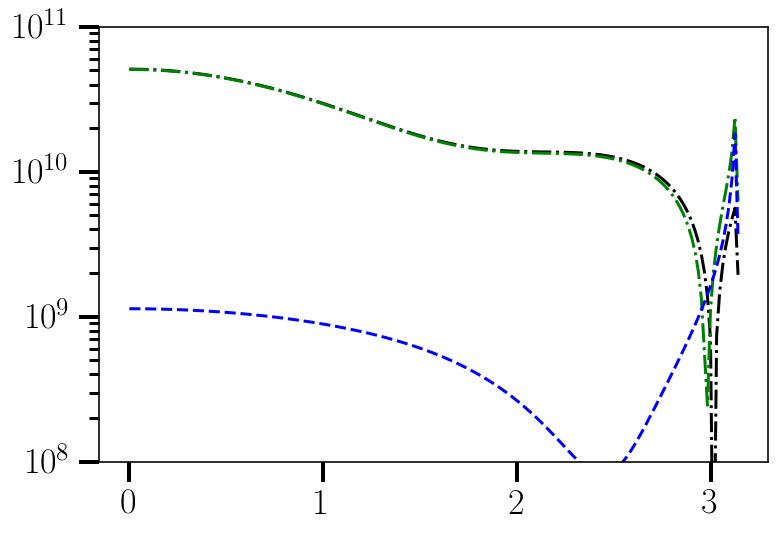

In [2250]:
plt.plot(theta,3.5*np.abs(GR0.l0(params))/h**6,'-.',label='GR',color='black')
plt.plot(theta,3.5*np.abs(GR2.l0(params,betas)+GR0.l0(params))/h**6,'-.',label='GR',color='green')
plt.plot(theta,2*np.abs(GR1.l1(params,betas).imag)/h**6,'--',label='Wide-angle',color='blue')
plt.yscale('log')
plt.ylim(1e+8,1e+11)

In [2215]:
#lets plot reduced - so get denominator
def part_reduced(params):
    k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params    
    
    return D1**4 *(b1**2 + 2*b1*f/3 + (f**2)/5)**2 *(Pk1 * Pk2 + Pk1 * Pk3 + Pk2 * Pk3)

In [2216]:
print(np.sqrt(4*np.pi/3))

2.046653415892977


In [2217]:
print(np.sqrt(4*np.pi))

3.5449077018110318


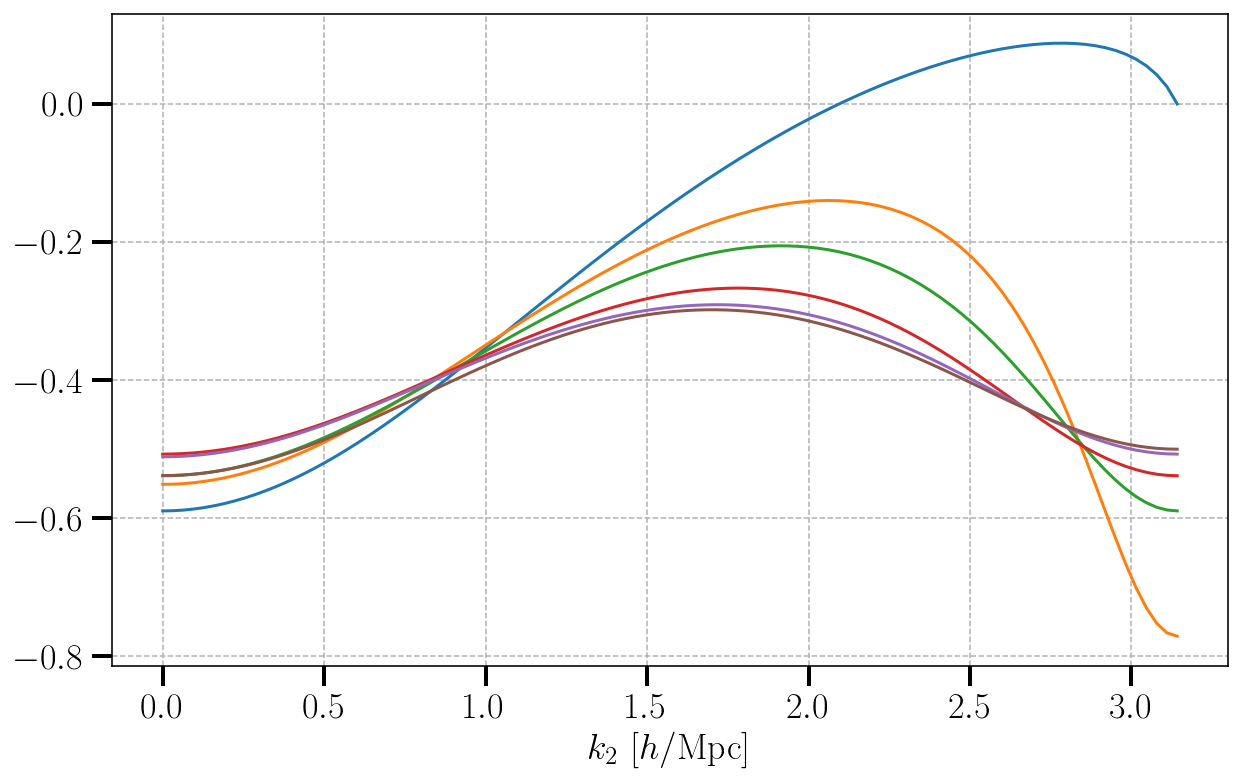

In [2251]:
#compare eline
cosmo_functions = CosmologicalFunctions(cosmo_eline)
zz=1
plt.figure(figsize=(10,6))
#k1 = np.linspace(0.01,0.5,1000)
#k3 = k1/26
#k2= k1

#k3 = np.linspace(0.0001,0.5,1000)
#k1 = 0.5001*k3;k2=k1

k1= 0.01/h
for i in [1,1.5,2,3,4,4.5]:
    k2= k1*i
    theta = np.linspace(0,np.pi,100)

    #theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
    #print(theta*180/np.pi)
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    params = cosmo_functions.get_params(k1,k2,theta,zz)
    derivs = cosmo_functions.get_derivs(zz)
    betas = cosmo_functions.get_beta_funcs(zz)

    #plt.plot(theta,3.5*(GR0.l0(params)+GR2.l0(params,betas))/part_reduced(params))
    #plt.plot(theta,np.sqrt((4*np.pi)/5)*(GR0.l2(params)+GR2.l2(params,betas))/part_reduced(params))

    #plt.plot(theta,np.sqrt((4*np.pi)/3)*GR1.l1(params,betas).imag/part_reduced(params)/h,'--')
    plt.plot(theta,np.sqrt((4*np.pi)/3)*GR1_test.l1(params,betas).imag/part_reduced(params)/h)

plt.xlabel('$ k_2 \,\,[h/\mathrm{Mpc}]$')
#plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
#plt.ylim(-0.169,0.019)
#plt.plot(k3,np.zeros_like(k3),'--', color='black')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.show()


In [2228]:
np.sqrt((4*np.pi)/3)

2.046653415892977

In [2118]:
k1=np.linspace(0.01,0.1)#0.08#
k2=k1
theta = 2*np.pi/3#np.linspace(0,np.pi,200)#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

In [2119]:
#for sciccimarro comparison...
zz=0.7
d = comoving_dist(zz)
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
derivs = cosmo_functions.get_derivs(zz)
fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
betas = cosmo_functions.get_beta_funcs(zz)

#D1=1
#K=3/7
#C=3/7

#Dd =0#fd=0
#bd1=0
#bd2=0
#fd=0
#gd2=0
derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)
derivs1 = fd,0,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs2 = 0,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs3 = fd,Dd,0,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs4 = fd,Dd,gd2,0,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs5 = fd,Dd,gd2,bd2,0,fdd,Ddd,gdd2,bdd2,bdd1
gamma2= g2


In [2120]:
print(fd/f)
print(Dd/D1)
print(bd1/b1)
print(bd2/b2)
print(gd2/g2)

0.2817503051470079
-0.4018908391234152
0.2520313229420924
0.08771097265463919
1.2642367354506308


In [2121]:
%%time
test = Der2.l2(params,derivs,0,0)

CPU times: user 1.21 s, sys: 6.19 ms, total: 1.21 s
Wall time: 1.21 s


In [2339]:
zz=1

k1 = np.linspace(0.05,0.1)
k3 = k1
k2= 0.005
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
#k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

cosmo_functions = CosmologicalFunctions(cosmo_kevin)
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
PNGparams = cosmo_functions.get_PNGparams(100,zz)


k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
params =k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,3/7,3/7,f,D1,b1,b2,g2

In [2340]:
#plt.plot(k1,GR0.l0(params,PNGparams))
#plt.plot(k1,GR0PNG.l0(params,PNGparams))
#plt.plot(k1,GR0PNG1.l0(params,PNGparams))

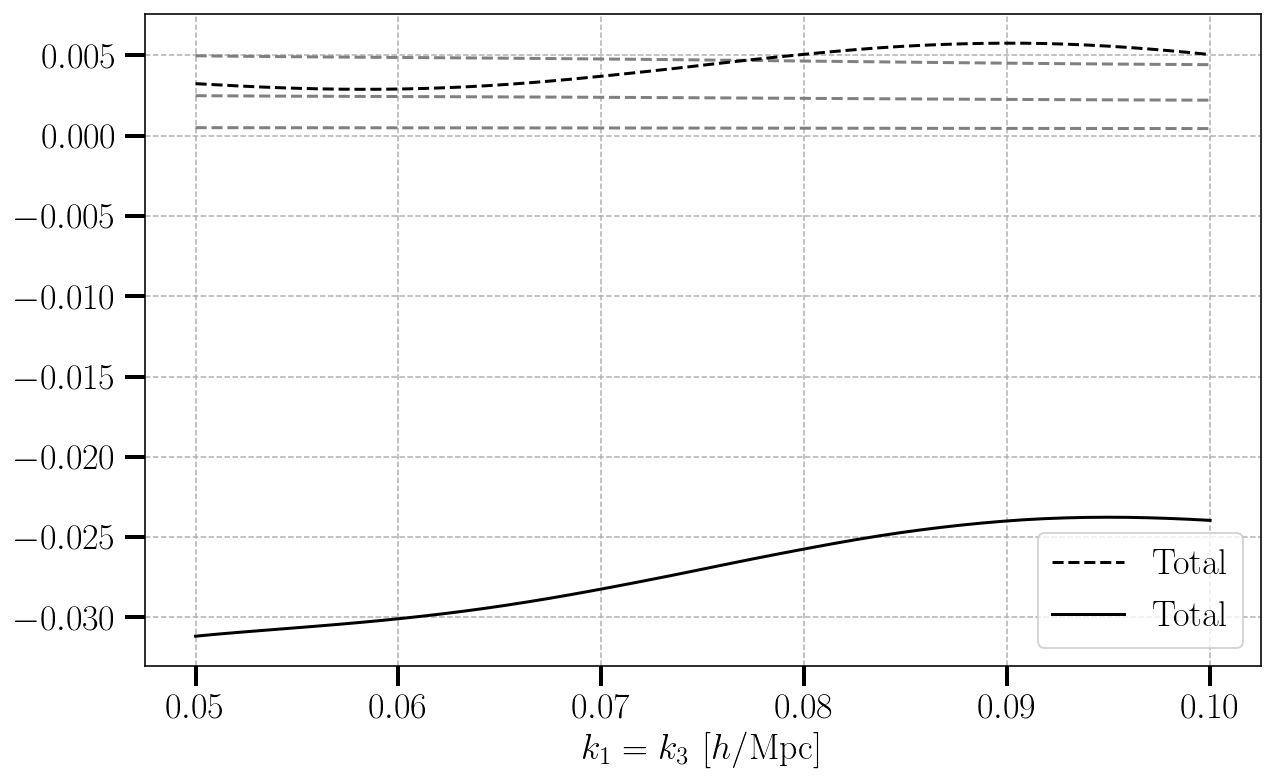

In [2344]:
#so lets plot monopole...
plt.figure(figsize=(10,6))
r=0;s=0
totalwa = WA2.l0(params,r,s)+Der2.l0(params,derivs,r,s)+Mix.l0(params,derivs,r,s)+WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)
total = WA2.l0(params,r,s)+Der2.l0(params,derivs,r,s)+Mix.l0(params,derivs,r,s)+WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)+GR2.l0(params,betas)
#plt.plot(k3,GR2.l0(params,betas)/GR0.l0(params),'-.',label='GR',color='green')
#plt.plot(k3,WA2.l0(params,r,s)/GR0.l0(params),'--',label='Wide-angle',color='blue')
#plt.plot(k3,Der2.l0(params,derivs,r,s)/GR0.l0(params),'--',label='redshift derivative',color='red')
#plt.plot(k3,Mix.l0(params,derivs,r,s)/GR0.l0(params),'-.',label='Mixed',color='orange')

#plt.plot(k3,WAGR.l0(params,betas,r,s)/GR0.l0(params),'--',label='Wide-angle',color='purple')
#plt.plot(k3,DerGR.l0(params,derivs,betas,r,s)/GR0.l0(params),'--',label='Wide-angle',color='lime')

for i in [0.1,0.5,1]:
    PNGparams = cosmo_functions.get_PNGparams(i,zz)
    plt.plot(k3,(GR0PNG.l0(params,PNGparams)-GR0.l0(params))/GR0.l0(params),'--',color='grey')
    #plt.plot(k3,(GR0PNGtest.l0(params,PNGparams)-GR0.l0(params))/GR0.l0(params),'--',color='lime')


plt.plot(k3,totalwa/GR0.l0(params),'--',label='Total',color='black')
plt.plot(k3,total/GR0.l0(params),label='Total',color='black')
plt.xlabel('$ k_1=k_3 \,\,[h/\mathrm{Mpc}]$')
#plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
#plt.plot(k3,np.zeros_like(k3),'--', color='black')
#plt.ylim(0,0.00)
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()

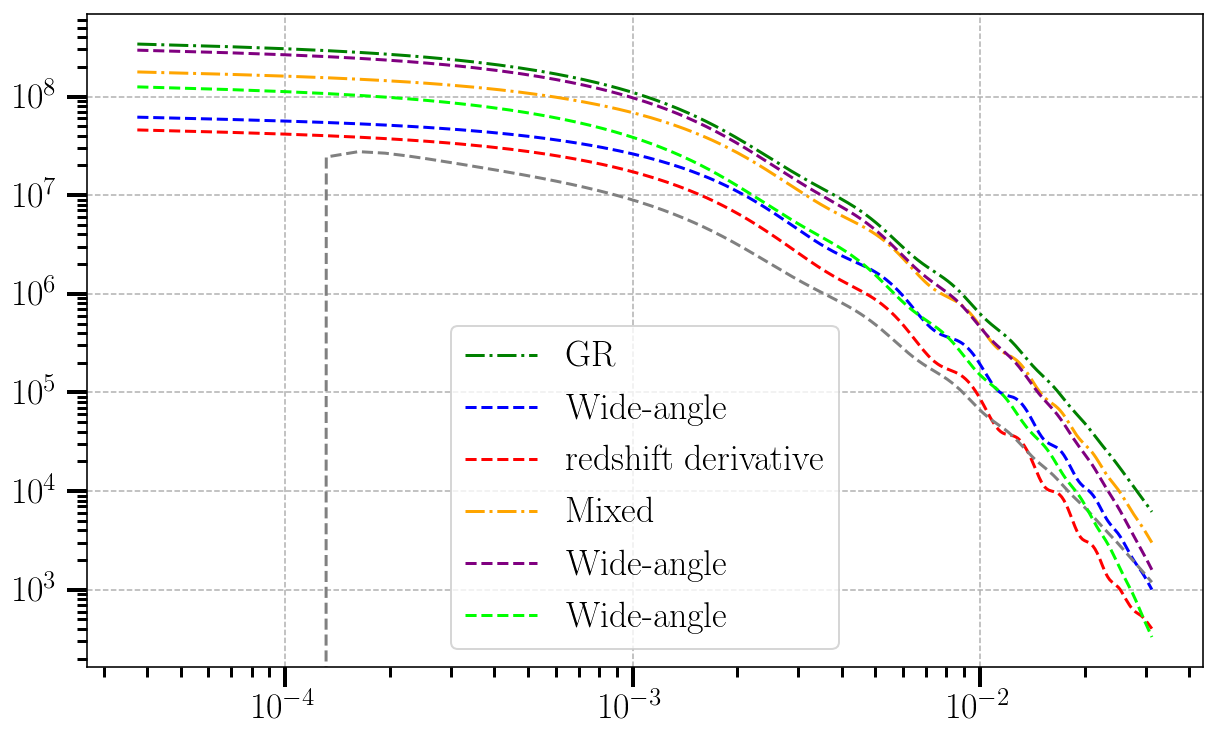

In [2275]:
#test GR:
zz=1
k1 = np.linspace(0.0006,0.5,1000)
k3 = k1/16
k2= k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
#k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
PNGparams = cosmo_functions.get_PNGparams(1,zz)

plt.figure(figsize=(10,6))
r=0;s=0
plt.plot(k3,np.abs(GR2.l0(params,betas)),'-.',label='GR',color='green')
plt.plot(k3,np.abs(WA2.l0(params,r,s)),'--',label='Wide-angle',color='blue')
plt.plot(k3,np.abs(Der2.l0(params,derivs,r,s)),'--',label='redshift derivative',color='red')
plt.plot(k3,np.abs(Mix.l0(params,derivs,r,s)),'-.',label='Mixed',color='orange')
#plt.plot(k3,(GR0PNG.l0(params,PNGparams)-GR0.l0(params)),'--',color='grey')
plt.plot(k3,np.abs(WAGR.l0(params,betas,r,s)),'--',label='Wide-angle',color='purple')
plt.plot(k3,np.abs(DerGR.l0(params,derivs,betas,r,s)),'--',label='Wide-angle',color='lime')

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)
plt.legend()
plt.show()

Text(0, 0.5, '$  \\,\\,[\\mathrm{Mpc}/h]^3$')

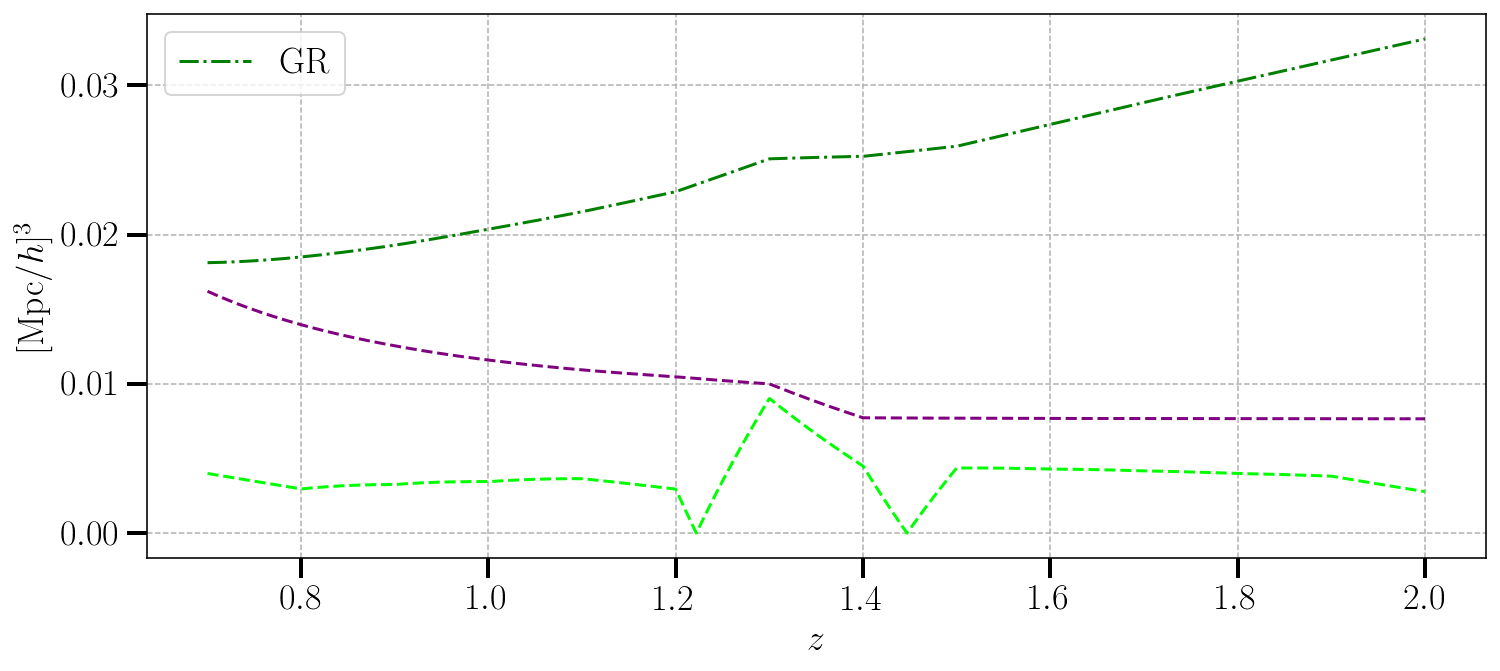

In [2337]:
plt.figure(figsize=(12,5))

#plt.xlim(0,1)
z_plot = np.linspace(0.7,2,1000)

k1 = 0.02
k2= k1
k3=k1/2
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))

params = cosmo_functions.get_params(k1,k2,theta,z_plot)
derivs = cosmo_functions.get_derivs(z_plot)
betas = cosmo_functions.get_beta_funcs(z_plot)
PNGparams = cosmo_functions.get_PNGparams(1,z_plot)

r=0;s=0
norm = GR0.l0(params)
if True:
    plt.plot(z_plot,np.abs(GR2.l0(params,betas)/norm),'-.',label='GR',color='green')
    #plt.plot(z_plot,np.abs(WA2.l0(params,r,s)/norm),'--',label='Wide-angle',color='blue')
    #plt.plot(z_plot,np.abs(Der2.l0(params,derivs,r,s)/norm),'--',label='redshift derivative',color='red')
    #plt.plot(z_plot,np.abs(Mix.l0(params,derivs,r,s)/norm),'-.',label='Mixed',color='orange')
    #plt.plot(z_plot,np.abs(GR0PNG.l0(params,PNGparams)-GR0.l0(params))/norm,'--',color='grey')
    plt.plot(z_plot,np.abs(WAGR.l0(params,betas,r,s)/norm),'--',label='',color='purple')
    plt.plot(z_plot,np.abs(DerGR.l0(params,derivs,betas,r,s)/norm),'--',label='',color='lime')
else:
    plt.plot(z_plot,np.abs(GR1.l1(params,betas)/norm),'-.',label='GR',color='green')
    plt.plot(z_plot,np.abs(WA1.l1(params,r,s)/norm),'--',label='Wide-angle',color='blue')
    plt.plot(z_plot,np.abs(Der1.l1(params,derivs,r,s)/norm),'--',label='redshift derivative',color='red')

#plt.yscale('log')
plt.legend()
plt.xlabel('$z$')
plt.grid(ls='--',lw=0.75)
plt.ylabel('$  \,\,[\mathrm{Mpc}/h]^3$')

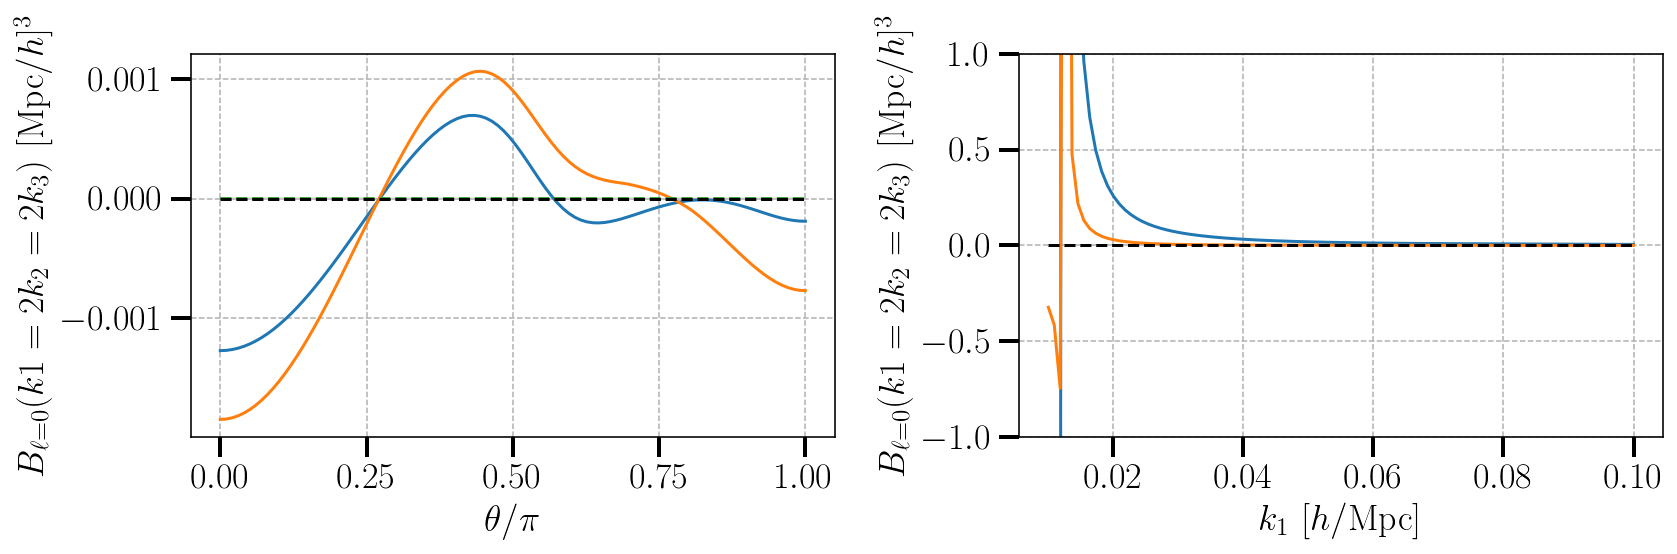

In [2176]:
#for quadrupole

# Create a figure and a gridspec
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, width_ratios=[4,4])

# Create subplots using the gridspec
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

zz=2;k1=0.04;k2=k1/2
theta = np.linspace(0,np.pi,100)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)

r=0;s=0
comb = WA2.l2(params,r,s)+Der2.l2(params,derivs,r,s)+Mix.l2(params,derivs,r,s)

# Plot on each subplot
ax1.plot(theta/np.pi,WA2.l2(params,r,s)/GR0.l2(params,r,s))
ax1.plot(theta/np.pi,comb/GR0.l2(params,r,s))
ax1.plot(theta/np.pi,GR2.l2(params,betas)/GR0.l2(params),'--')
ax1.set_xlabel(r'$ \theta /\pi$')
ax1.set_ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
ax1.plot(theta/np.pi,np.zeros_like(theta),'--', color='black')
ax1.grid(ls='--',lw=0.75)

#zz=0.8
k1=np.linspace(0.01,0.1,100);k2=k1;k3=0.1*k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)

#r=0;s=0
comb = WA2.l2(params,r,s)+Der2.l2(params,derivs,r,s)+Mix.l2(params,derivs,r,s)

# Plot on each subplot
ax2.plot(k1,WA2.l2(params,r,s)/GR0.l2(params,r,s))
ax2.plot(k1,comb/GR0.l2(params,r,s))
ax2.set_xlabel(r'$ k_1 \,\, [h/\mathrm{Mpc}]$')
ax2.set_ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
ax2.plot(k1,np.zeros_like(k1),'--', color='black')
ax2.set_ylim(-1,1)
ax2.grid(ls='--',lw=0.75)

plt.tight_layout()
plt.show()

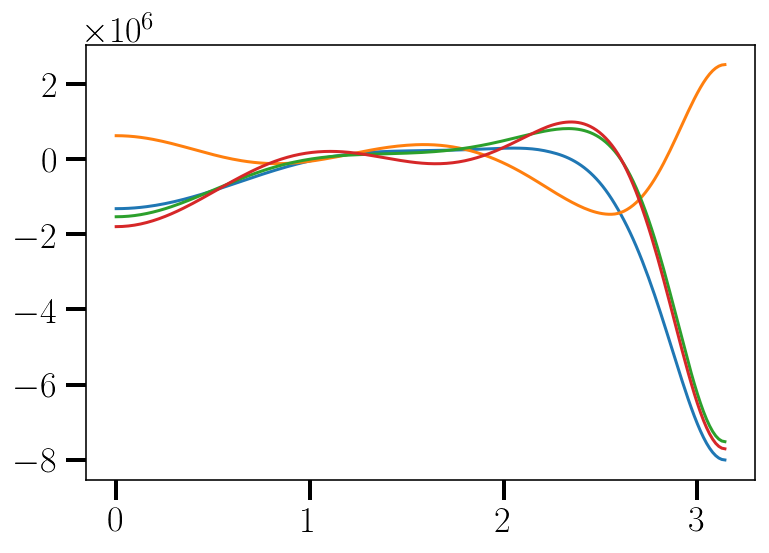

In [833]:
#plt.plot(theta,WA1mid.imag)
#plt.plot(theta,Der1mid.imag)
#plt.plot(theta,WA2.l2(params,1,0))
plt.plot(theta,Der2.l2(params,derivs,0,0))
plt.plot(theta,Der2.l2(params,derivs1,0,0))
plt.plot(theta,Der2.l2(params,derivs2,0,0))
#plt.plot(theta,Der2.l2(params,derivs3,0,0))
#plt.plot(theta,Der2.l2(params,derivs4,0,0))
plt.plot(theta,Der2.l2(params,derivs5,0,0))
#plt.plot(theta,Mix.l2(params,derivs,0,0))
#plt.plot(theta,Der2.l2(params,derivs,1,0)+Mix.l2(params,derivs,1,0)+WA2.l2(params,1,0),'--')
#plt.plot(theta,WA1.l1(params,0,0).imag)
#plt.plot(theta,WA2.l0(params,1,0))
#plt.plot(theta,WA2.l0(params,0,1))
#plt.plot(theta,WA2.l0(params,1/3,1/3),'--')



In [2284]:
#for sciccimarro comparison...
zz=1
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)


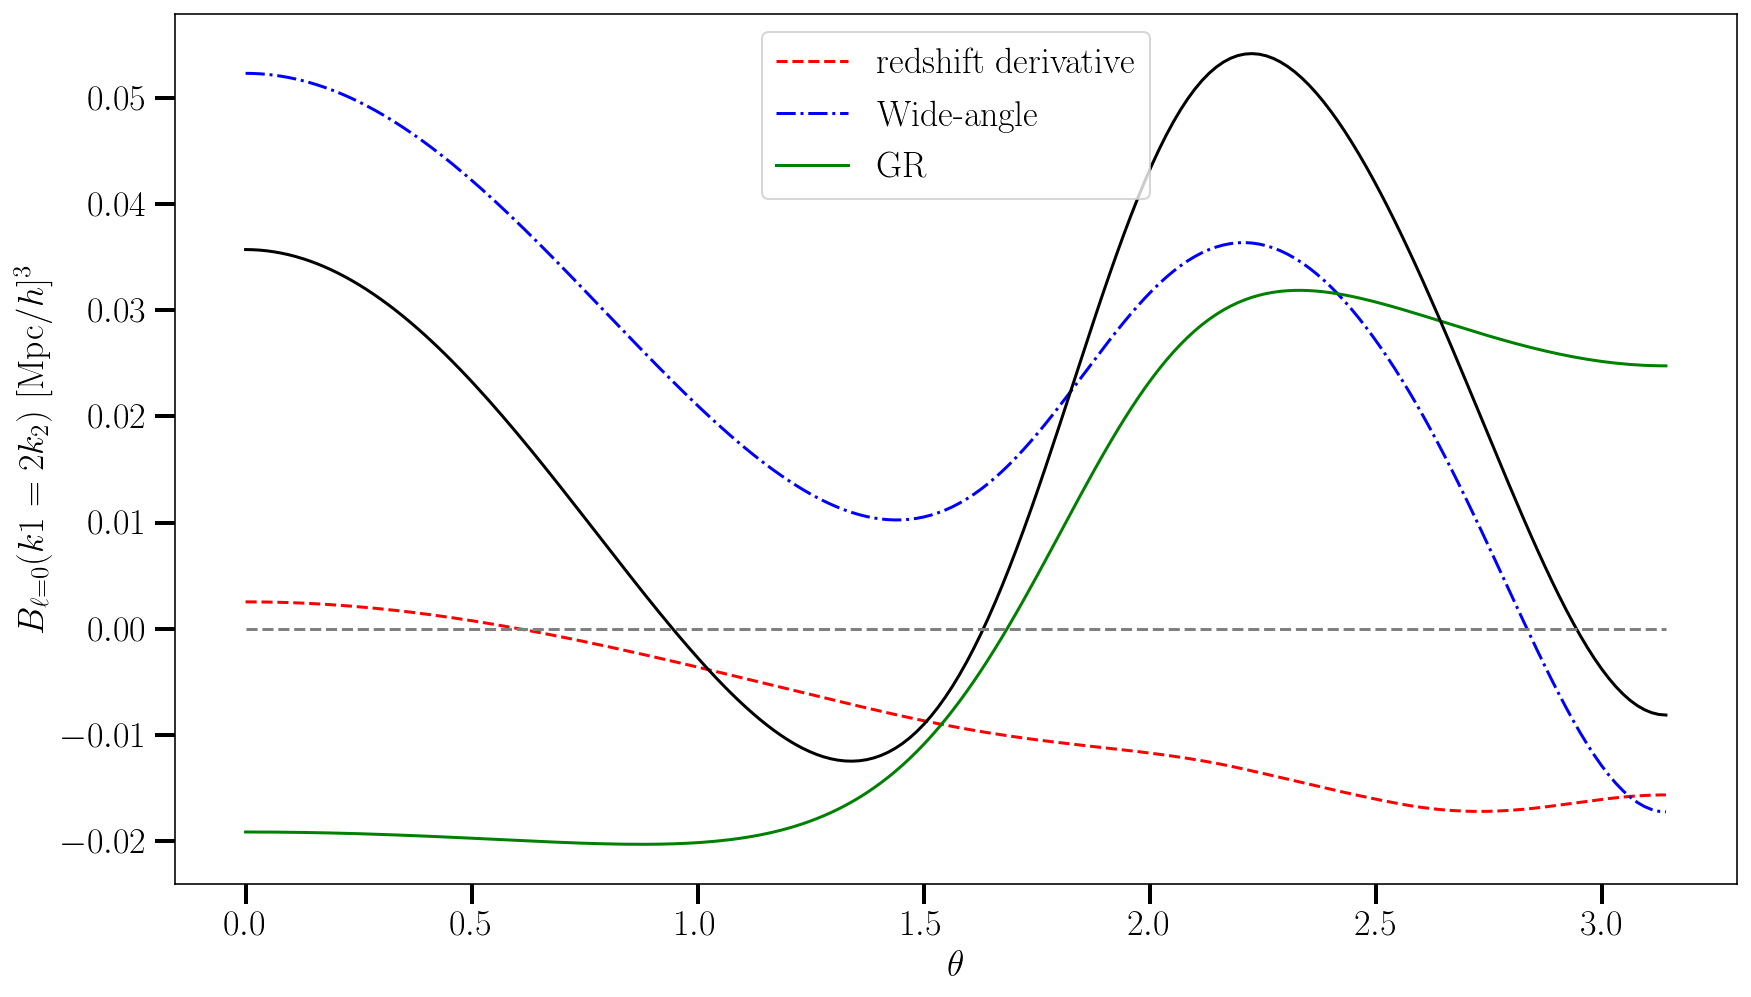

In [2286]:
plt.figure(figsize=(14,8))
r=0;s=0
#plt.plot(theta,bk_terms.WA1.l1(params,0,0).imag,alpha=0.4,color='blue')
#plt.plot(theta,bk_terms.Der1.l1(params,derivs,0,0).imag,'-.',alpha=0.4,color='blue')
#plt.plot(theta,WA1.l1(params,1,0).imag,alpha=0.4,color='red')
#plt.plot(theta,Der1.l1(params,derivs,1,0).imag,'-.',alpha=0.4,color='red')
#plt.plot(theta,WA1.l1(params,0,1).imag,alpha=0.4,color='green')
#plt.plot(theta,Der1.l1(params,derivs,0,1).imag,'-.',alpha=0.4,color='green')
#plt.plot(theta,WA1.l1(params,1/3,1/3).imag,color='black')
#plt.plot(theta,Der1.l1(params,derivs,1/3,1/3).imag,'-.',color='black')
#plt.plot(theta,WA1.l1(params,0,1).imag+Der1.l1(params,derivs,1/3,1/3).imag,'--',color='black')

plt.plot(theta,(Der1.l1(params,derivs,r,s).imag)/GR0.l0(params),'--',color='red',label='redshift derivative')
plt.plot(theta,WA1.l1(params,r,s).imag/GR0.l0(params),'-.',color='blue',label='Wide-angle')
plt.plot(theta,GR1.l1(params,betas).imag/GR0.l0(params),'-',color='green',label='GR')


plt.plot(theta,(WA1.l1(params,r,s).imag+GR1.l1(params,betas).imag+Der1.l1(params,derivs,r,s).imag)/GR0.l0(params),'-',color='black')
plt.plot(theta,np.zeros_like(theta),'--',color='grey')
plt.xlabel(r'$ \theta $')
plt.ylabel('$ B_{\ell=0}(k1= 2 k_2) \,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
#plt.xlim(1.5,2)
#plt.plot(theta,testoldder/d)
#plt.plot(theta,testold.real/(d),'-.',color='black')
#plt.plot(theta,testold.real/(d),'-.',color='grey')

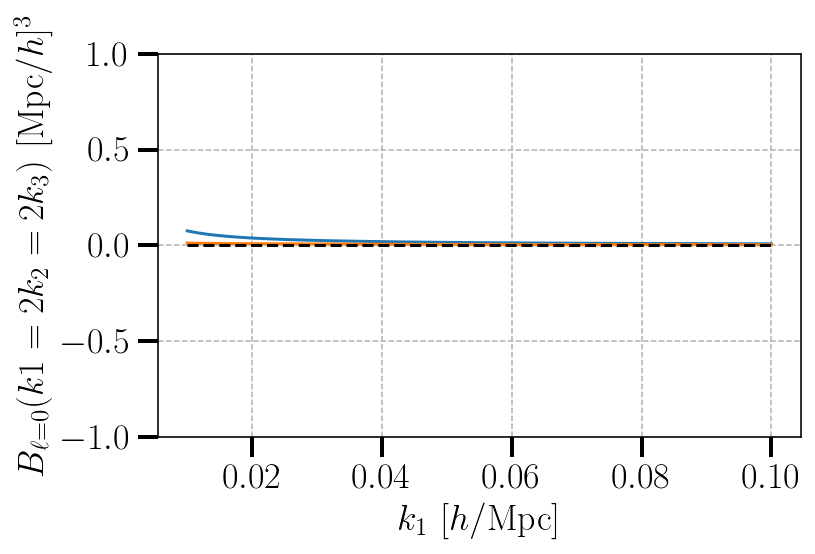

In [1721]:
#zz=0.8
k1=np.linspace(0.01,0.1,100);k2=k1;k3=k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
derivs = get_derivs(zz)
params = get_params(k1,k2,theta,zz)

r=0;s=0
comb = WA1.l1(params,r,s)+Der1.l1(params,derivs,r,s)

# Plot on each subplot
plt.plot(k1,WA1.l1(params,r,s).imag/GR0.l2(params,r,s))
plt.plot(k1,comb.imag/GR0.l0(params,r,s))
plt.xlabel(r'$ k_1 \,\, [h/\mathrm{Mpc}]$')
plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
plt.plot(k1,np.zeros_like(k1),'--', color='black')
plt.ylim(-1,1)
plt.grid(ls='--',lw=0.75)

plt.tight_layout()
plt.show()

In [579]:
def bk_dipo(k1,k2,theta,zz,r=1/3,s=1/3,c=0): 
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    k3 = np.where(k3==0,1e-3,k3)
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    I = 1j
    def csc(x):
        x = np.where(x==0,1e-4,x)#aviod zero errors here
        return 1/np.sin(x)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):
        """So we have collated alll terms for each permutation - these epression are 1st order abut include all derivate terms"""
        bk_12 =  (-44*f**2*k1*k2**2*(2*c*fd*(4*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**2*(3*Pk2*k2**2*(4*r + 3*s - 3) + 4*Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + Pk2*Pkd1*k1*k2**2*k3**2*(-3*r - 3*s + 2)) + f*(8*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 5) + Pk1*k1**2*(6*Pk2*k2**2*(3*s - 2) - 4*Pk2*k3**2*(3*r + 8) + Pkd2*k2*k3**2*(3*r + 8)) - 2*Pk2*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 5)))*np.cos(6*theta) - f*k2*(693*Pk1*c*fd*g2*k1**2*k3**4*(-4*Pk2 + Pkd2*k2) + 66*b1*k1**2*(3*c*fd*(2*Pk1*k1**2*(6*Pk2*k2**2*(4*r + 2*s - 3) + 4*Pk2*k3**2*(2*r - 1) + Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*(4*Pk2*k2**4*(2*r + 2*s - 1) + 16*Pk2*k2**2*k3**2*(r + s - 1) - 4*Pk2*k3**4 + Pkd2*k2*k3**4) - 8*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1)) + 2*f*(2*Pk1*k1**2*(10*Pk2*k2**2*(2*s - 1) - 4*Pk2*k3**2*(r + 3) + Pkd2*k2*k3**2*(r + 3)) + Pk1*(4*Pk2*k2**4*(s + 3) + 4*Pk2*k2**2*k3**2*(8*r + 9*s - 9) - 4*Pk2*k3**4*(r + 3) + 2*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(r + 3)) - 18*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1))) + 14*f**3*k3**4*(20*Pk1*Pk2*k2**2*(3*r + 3*s - 5) - 4*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(2*r + 5) - 5*Pk2*Pkd1*k1*k2**2*(3*r + 3*s - 5)) + f**2*(56*Pk1*Pk2*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5)) + 11*Pk1*k1**4*(18*Pk2*k2**2*(31*s - 18) - 4*Pk2*k3**2*(69*r + 136) + Pkd2*k2*k3**2*(69*r + 136)) + Pk1*k1**2*(560*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(111*s - 34) + 66*Pk2*k2**2*k3**2*(71*r + 46*s - 202) + 140*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(69*r + 64)) - 22*Pk2*Pkd1*k1**3*k2**2*k3**2*(105*r + 105*s - 127) - 14*Pk2*Pkd1*k1*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5))) + 11*f*(-42*Pk1*g2*k1**2*k3**4*(4*Pk2 - Pkd2*k2)*(r + 3) + 2*c*fd*(28*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(81*Pk2*k2**2*(4*r + 3*s - 3) + 68*Pk2*k3**2*(r - 1) - 17*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(41*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(61*r + 51*s - 44) - 17*Pkd2*k2*k3**2*(r - 1)) - 47*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 7*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)) + 9*c*k1**2*(Pk1*(8*Pk2*bd2*k2**4*(r + s - 1) + 7*gd2*k3**4*r*(4*Pk2 - Pkd2*k2)) + 2*bd1*(4*Pk1*Pk2*k2**4*(r - 1) + 4*Pk1*Pk2*k3**2*r*(-2*k1**2 + k3**2) - 2*Pk1*Pkd2*k2**3*k3**2*(r - 1) - Pk1*Pkd2*k2*k3**2*r*(-2*k1**2 + k3**2) + 4*Pk2*k2**2*(3*Pk1*k1**2*s + k3**2*(Pk1*(3*r + 2*s - 1) - Pkd1*k1*(r + s)))))))*np.cos(5*theta) - k1*(924*b1**2*k2**2*(c*fd*(2*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 4*Pk1*k1**2*(3*Pk2*k2**2*(2*r + s - 1) + 2*Pk2*k3**2*r - Pkd2*k2*k3**2*r) - Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1)) + f*(6*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**2*(8*Pk2*k2**2*(s - 1) - 2*Pk2*k3**2*r + Pkd2*k2*k3**2*r) - 3*Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1))) + 11*b1*(294*Pk2*c*fd*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + 14*f**3*k3**4*(-Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(3*r + 8) + Pk1*k2**2*(Pk2*(30*r + 36*s - 52) + Pkd2*k2*(3*r + 4)) - 2*Pk2*Pkd1*k1*k2**2*(9*r + 9*s - 11)) + 2*f**2*(3*Pk1*k1**4*(2*Pk2*k2**2*(114*s - 43) - 28*Pk2*k3**2*(r + 3) + 7*Pkd2*k2*k3**2*(r + 3)) + Pk1*k1**2*(6*Pk2*k2**4*(313*s - 118) + 6*Pk2*k2**2*k3**2*(26*r - 20*s - 145) + 28*Pk2*k3**4*(8*c*fd*r - 4*c*fd - 3*r - 9) + 3*Pkd2*k2**3*k3**2*(134*r + 5) + 7*Pkd2*k2*k3**4*(-8*c*fd*r + 4*c*fd + 3*r + 9)) + Pk1*k2**2*(42*Pk2*k2**4*(s + 3) + 18*Pk2*k2**2*k3**2*(53*r + 53*s - 77) + 2*Pk2*k3**4*(14*c*fd*(11*r + 9*s - 9) + 15*r + 36*s - 207) + 21*Pkd2*k2**3*k3**2*r + 7*Pkd2*k2*k3**4*(-4*c*fd*r + 2*c*fd + 3*r + 9)) - 321*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(537*r + 537*s - 513) + 2*k3**2*(7*c*fd*(9*r + 9*s - 8) + 33*r + 33*s - 27))) + 3*f*(294*Pk2*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + c*fd*(3*Pk1*k1**4*(74*Pk2*k2**2*(4*r + 2*s - 3) + 28*Pk2*k3**2*(2*r - 1) + 7*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(12*Pk2*k2**4*(193*r + 124*s - 131) - 2*Pk2*k2**2*k3**2*(70*r + 64*s - 67) - 84*Pk2*k3**4 + 117*Pkd2*k2**3*k3**2*(1 - 2*r) + 21*Pkd2*k2*k3**4) + Pk1*k2**2*(42*Pk2*k2**4*(2*r + 2*s - 1) + 8*Pk2*k2**2*k3**2*(53*r + 53*s - 49) + 2*Pk2*k3**4*(16*r + 16*s - 29) + 21*Pkd2*k2*k3**4) - 180*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 12*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(23*r + 23*s - 19) + 2*k3**2*(2*r + 2*s - 1))) + 14*c*k2**2*(Pk2*(4*bd2*k2**2*(6*Pk1*k1**2 + 2*Pk1*k3**2 - Pkd1*k1*k3**2) + 7*gd2*k3**4*(2*Pk1 - Pkd1*k1))*(r + s - 1) + 2*bd1*(2*Pk1*Pk2*k3**2*(2*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 4*Pk1*k1**2*(3*Pk2*k2**2*(r + s - 1) - 2*Pk2*k3**2 + Pkd2*k2*k3**2) + Pk2*Pkd1*k1*k3**2*(-2*k2**2*(r + s) + k3**2*(-2*r - 2*s + 1)))))) + f*(462*Pk2*c*g2*k2**2*k3**4*(7*bd1*(2*Pk1 - Pkd1*k1)*(r + s) + 2*fd*(2*Pk1 - 3*Pkd1*k1)*(2*r + 2*s - 1)) + 14*f**3*k3**4*(-5*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(7*r + 12) + Pk1*k2**2*(8*Pk2*(34*r + 24*s - 81) + Pkd2*k2*(35*r + 16)) - 8*Pk2*Pkd1*k1*k2**2*(17*r + 17*s - 21)) + 2*f**2*(22*Pk1*k1**4*(3*Pk2*k2**2*(99*s - 43) - 28*Pk2*k3**2*(3*r + 5) + 7*Pkd2*k2*k3**2*(3*r + 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(645*s - 278) - 11*Pk2*k2**2*k3**2*(3*r + 345*s + 1582) + 210*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(318*r + 125)) + Pk1*k2**2*(14*Pk2*c*k3**4*(22*bd1*(5*r + 3*s - 2) + fd*(138*r + 128*s - 101)) + 33*Pk2*k2**2*k3**2*(221*r + 151*s - 490) - 14*Pkd2*c*k2*k3**4*(11*bd1 + 15*fd)*(2*r - 1) + 77*Pkd2*k2**3*k3**2*(6*r + 1) + 154*k2**4*(6*Pk2*s + Pk2)) - 55*Pk2*Pkd1*k1**3*k2**2*k3**2*(51*r + 51*s - 49) - Pk2*Pkd1*k1*k2**2*k3**2*(14*c*k3**2*(11*bd1*(3*r + 3*s - 1) + 30*fd*(4*r + 4*s - 3)) + 11*k2**2*(327*r + 327*s - 365))) + 11*f*(42*Pk2*g2*k2**2*k3**4*(12*Pk1*(r + s - 4) - 11*Pkd1*k1*(r + s) + 9*Pkd1*k1) + c*(6*Pk2*k2**2*(bd2*k2**2*(165*Pk1*k1**2 + 21*Pk1*k2**2 + 16*Pk1*k3**2 - 24*Pkd1*k1*k3**2) + 14*gd2*k3**4*(2*Pk1 - 3*Pkd1*k1))*(r + s - 1) + 3*bd1*(3*Pk1*k1**4*(74*Pk2*k2**2*s + 7*k3**2*r*(-4*Pk2 + Pkd2*k2)) + Pk1*k1**2*(6*Pk2*k2**4*(55*r + 69*s - 55) + 2*Pk2*k2**2*k3**2*(88*r - 32*s - 117) + 84*Pk2*k3**4*r + 117*Pkd2*k2**3*k3**2 - 21*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(r - 1) + 180*Pk2*k2**2*k3**2*(r + s) + 2*Pk2*k3**4*(29*r + 8*s - 8) - 21*Pkd2*k2**3*k3**2*(r - 1) - 21*Pkd2*k2*k3**4*r) - 90*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(15*k2**2*(r + s) + 4*k3**2*(r + s - 1))) + 2*fd*(5*Pk1*k1**4*(66*Pk2*k2**2*(4*r + 3*s - 3) + 28*Pk2*k3**2*(r - 1) - 7*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(784*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-513*r - 615*s + 308) - 238*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(70*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(383*r + 453*s - 232) - 35*Pkd2*k2*k3**2*(r - 1)) - 130*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 154*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(4*theta) - 2*k1*(1617*b1**3*k3**4*(-2*c*fd*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) + Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) - 6*Pk2*Pkd1*k1*k2**2*(r + s - 1))) - 231*b1**2*(c*(fd*(-3*Pk1*k1**4*(58*Pk2*k2**2*(2*r + s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-384*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(150*r + 89*s - 89) + 42*Pk2*k3**4*r + 114*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 14*Pk2*k2**2*k3**2*(7*r + s - 1) + 2*Pk2*k3**4*(29*r + 8*s - 21) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(11*r + 11*s - 8))) + 5*k3**4*(Pk2*Pkd1*k1*k2**2*(4*bd2 + 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k2**3*(r - 1) - 7*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + 4*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)))) + f**2*k3**4*(Pk1*k1**2*(4*Pk2*(9*r + 10) + Pkd2*k2*(4 - 45*r)) + Pk1*k2**2*(12*Pk2*(-5*r + 4*s + 4) + Pkd2*k2*(4 - 45*r)) + 4*Pk2*Pkd1*k1*k2**2*(31*r + 31*s - 30)) + 2*f*(2*Pk1*k1**4*(-58*Pk2*k2**2*(s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-256*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(14*r + 157*s - 157) + Pk2*k3**4*(-14*bd1*c*(r - 1) - 30*c*fd*r + 3*c*fd - 7*r + 35) - 66*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) - 7*Pk2*k2**2*k3**2*(10*r - 3*s + 3) + Pk2*k3**4*(c*fd*(52*r + 16*s - 23) - 39*r + 24*s + 63) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + 44*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(62*k2**2*(r + s - 1) + k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 60*c*fd + 46) - k3**2*(54*c*fd + c*(7*bd1 + 7*bd2) + 38)))) - 11*b1*(-980*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r + 280*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 3892*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 2184*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 17388*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 11736*Pk1*Pk2*c*f*fd*k1**4*k2**2 - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2*r + 126*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 35856*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 23904*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 19152*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 12474*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 126*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 3780*Pk1*Pk2*c*f*fd*k2**6*r + 2520*Pk1*Pk2*c*f*fd*k2**6 + 5004*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 2628*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 528*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 768*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r - 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4 + 1176*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 462*Pk1*Pk2*f**3*k1**2*k3**4*r + 1568*Pk1*Pk2*f**3*k1**2*k3**4 - 840*Pk1*Pk2*f**3*k2**2*k3**4*r + 2464*Pk1*Pk2*f**3*k2**2*k3**4 + 4320*Pk1*Pk2*f**2*k1**4*k2**2 + 798*Pk1*Pk2*f**2*k1**4*k3**2*r + 1134*Pk1*Pk2*f**2*k1**4*k3**2 + 9360*Pk1*Pk2*f**2*k1**2*k2**4 - 204*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 108*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 210*Pk1*Pk2*f**2*k1**2*k3**4*r + 1134*Pk1*Pk2*f**2*k1**2*k3**4 + 1008*Pk1*Pk2*f**2*k2**6 - 2154*Pk1*Pk2*f**2*k2**4*k3**2*r + 2862*Pk1*Pk2*f**2*k2**4*k3**2 - 426*Pk1*Pk2*f**2*k2**2*k3**4*r + 3006*Pk1*Pk2*f**2*k2**2*k3**4 + 3528*Pk1*Pk2*f*g2*k2**2*k3**4*r + 1106*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 448*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 1078*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 434*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 630*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 3564*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 1782*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 315*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 315*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 1029*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 112*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 1029*Pk1*Pkd2*f**3*k2**3*k3**4*r + 140*Pk1*Pkd2*f**3*k2**3*k3**4 - 1008*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 252*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 5400*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1224*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 504*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 252*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1008*Pk1*Pkd2*f**2*k2**5*k3**2*r + 252*Pk1*Pkd2*f**2*k2**5*k3**2 - 504*Pk1*Pkd2*f**2*k2**3*k3**4*r + 252*Pk1*Pkd2*f**2*k2**3*k3**4 + 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 3906*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 3052*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 4392*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 3402*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 4824*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 3618*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1080*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 2394*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 2086*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 3564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 2772*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 4212*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3348*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 948*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 684*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 42*Pk2*bd2*c*k2**2*(Pk1*f*(-87*k1**4 - 192*k1**2*k2**2 - 21*k2**4 + k3**4*(6*f + 8) + k3**2*(89*k1**2 + 7*k2**2)) + Pkd1*k1*k3**2*(33*f*k1**2 + 39*f*k2**2 + k3**2*(f*(18*f + 13) + 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(4*Pk1*f*(3*c*fd*k3**2*(169*k1**2 + 31*k2**2) - 3*c*fd*(157*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(22*c*fd + 49*c*gd2 + 147*g2)) + Pkd1*f*k1*k3**2*(12*c*fd*(61*k1**2 + 67*k2**2) + k3**2*(147*b2 + 180*c*fd + 196*c*gd2 + 98*g2)) + 49*c*fd*k3**4*(Pkd1*b2*k1 + 4*g2*(Pk1 + Pkd1*k1)) + 21*f**3*k3**4*(16*Pk1 + 19*Pkd1*k1) + f**2*(Pk1*(-1524*k1**4 + 6*k1**2*(-534*k2**2 + 339*k3**2) - 336*k2**4 + 558*k2**2*k3**2 + 6*k3**4*(56*c*fd + 22)) + Pkd1*k1*k3**2*(594*k1**2 + 702*k2**2 + k3**2*(651*c*fd + 158)))) + 21*bd1*c*(70*Pk2*Pkd1*g2*k1*k2**2*k3**4*(r + s) + 2*f**2*k3**4*(-12*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(10*r + 10*s - 13) + 12*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(7*r + 7*s - 3)) + f*(-3*Pk1*k1**4*(58*Pk2*k2**2*(r + s - 1) - 14*Pk2*k3**2 + 7*Pkd2*k2*k3**2) + Pk1*k1**2*(-384*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(89*r + 89*s - 61) + 42*Pk2*k3**4*(1 - 2*r) - 114*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + Pk1*k2**2*(-42*Pk2*k2**4*(r + s - 1) + 14*Pk2*k2**2*k3**2*(r + s - 6) + 16*Pk2*k3**4*(r + s - 1) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s) + k3**2*(38*r + 38*s - 22))))) + f*(-1848*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 924*Pk1*Pk2*b2*c*fd*k2**2*k3**4 - 2772*Pk1*Pk2*b2*f*k2**2*k3**4*r - 8316*Pk1*Pk2*b2*f*k2**2*k3**4 + 2940*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 1470*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 19488*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 12656*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 + 105160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r - 78870*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2 + 209792*Pk1*Pk2*c*f*fd*k1**2*k2**4*r - 157344*Pk1*Pk2*c*f*fd*k1**2*k2**4 - 117480*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r + 87318*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 21560*Pk1*Pk2*c*f*fd*k2**6*r - 16170*Pk1*Pk2*c*f*fd*k2**6 - 30800*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 24178*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 7392*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 560*Pk1*Pk2*f**3*k1**2*k3**4*r - 7560*Pk1*Pk2*f**3*k1**2*k3**4 + 1484*Pk1*Pk2*f**3*k2**2*k3**4*r - 12096*Pk1*Pk2*f**3*k2**2*k3**4 - 14344*Pk1*Pk2*f**2*k1**4*k2**2 - 462*Pk1*Pk2*f**2*k1**4*k3**2*r - 10010*Pk1*Pk2*f**2*k1**4*k3**2 - 30536*Pk1*Pk2*f**2*k1**2*k2**4 + 396*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 45474*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 3080*Pk1*Pk2*f**2*k2**6 + 3234*Pk1*Pk2*f**2*k2**4*k3**2*r - 32736*Pk1*Pk2*f**2*k2**4*k3**2 - 11088*Pk1*Pk2*f*g2*k2**2*k3**4*r + 5544*Pk1*Pk2*f*g2*k2**2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 - 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 - 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r + 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2 + 3605*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pk1*Pkd2*f**3*k1**2*k2*k3**4 + 3605*Pk1*Pkd2*f**3*k2**3*k3**4*r - 728*Pk1*Pkd2*f**3*k2**3*k3**4 + 4620*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r - 1540*Pk1*Pkd2*f**2*k1**4*k2*k3**2 + 26466*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r - 7832*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 4620*Pk1*Pkd2*f**2*k2**5*k3**2*r - 1540*Pk1*Pkd2*f**2*k2**5*k3**2 - 5544*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r + 2772*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 - 5082*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r + 4158*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 - 16800*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r + 12600*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 - 31350*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r + 20900*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 - 31614*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r + 21076*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 - 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2772*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 - 7672*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r + 6216*Pk2*Pkd1*f**3*k1*k2**2*k3**4 - 18084*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r + 12452*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 - 18348*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r + 12892*Pk2*Pkd1*f**2*k1*k2**4*k3**2 - 924*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 2772*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 - 66*Pk2*bd2*c*k2**2*(Pk1*(3*f*k3**2*(177*k1**2 + 55*k2**2) - 3*f*(145*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(56*f**2 + 14*f + 196*g2)) + Pkd1*k1*k3**2*(3*f*(55*k1**2 + 67*k2**2) + k3**2*(14*f*(5*f + 3) + 147*g2)))*(r + s - 1) - 2*Pk2*k2**2*s*(462*c*fd*k3**4*(Pk1*(2*b2 + 8*g2) + Pkd1*k1*(6*b2 + 3*g2)) + 28*f**3*k3**4*(156*Pk1 + 137*Pkd1*k1) + f**2*(Pk1*(5824*c*fd*k3**4 - 22704*k1**4 - 44814*k1**2*k2**2 - 4620*k2**4 + k3**2*(31977*k1**2 + 9933*k2**2)) + 6*Pkd1*k1*k3**2*(1400*c*fd*k3**2 + 1507*k1**2 + 1529*k2**2)) + 33*f*(Pk1*(c*fd*k3**2*(1371*k1**2 + 301*k2**2) - c*fd*(1195*k1**4 + 2384*k1**2*k2**2 + 245*k2**4) + k3**4*(42*b2 + 56*c*gd2 + 168*g2)) + Pkd1*k1*k3**2*(c*fd*(475*k1**2 + 479*k2**2) + k3**2*(77*b2 + 21*c*gd2 + 14*g2)))) - 11*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(294*b2 + 294*g2)*(r + s) + 14*f**2*k3**4*(-15*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(38*r + 24*s - 38) + Pkd2*k2*(17*r - 16)) + Pk2*Pkd1*k1*k2**2*(63*r + 63*s - 31)) - 3*f*(3*Pk1*k1**4*(2*Pk2*k2**2*(145*r + 169*s - 145) + 14*Pk2*k3**2*(4*r - 5) + 35*Pkd2*k2*k3**2) + 3*Pk1*k1**2*(664*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(51*r + 161*s - 84) + 14*Pk2*k3**4*r + 198*Pkd2*k2**3*k3**2 - 35*Pkd2*k2*k3**4*r) + Pk1*k2**2*(210*Pk2*k2**4*(r + s - 1) + 42*Pk2*k2**2*k3**2*(r - s + 9) - 8*Pk2*k3**4*(32*r + 11*s - 11) + 105*Pkd2*k2**3*k3**2 - 105*Pkd2*k2*k3**4*r) - 402*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(67*k2**2*(r + s) + 30*k3**2*(r + s - 1))))))*np.cos(2*theta) + k1*(3234*b1**3*k3**4*(2*c*fd*(Pk1*Pk2*k1**2*r + 2*Pk1*Pkd2*k1**2*k2*r + 2*Pk1*Pkd2*k2**3*r + Pk2*k2**2*(Pk1*(9*r + 4*s - 4) + 5*Pkd1*k1*(r + s - 1))) + f*(-6*Pk1*Pk2*k1**2*r - 7*Pk1*Pkd2*k1**2*k2*r - 7*Pk1*Pkd2*k2**3*r + 2*Pk2*k2**2*(2*Pk1*(r + 6*s - 6) + 5*Pkd1*k1*(r + s - 1)))) + 462*b1**2*(c*(fd*(3*Pk1*k1**4*k2*(-82*Pk2*k2*(2*r + s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-432*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(320*r + 163*s - 163) + 14*Pk2*k3**4*(r - 1) + 130*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(74*r + 25*s - 25) + 2*Pk2*k3**4*(57*r + 50*s - 30) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 102*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(43*k2**2*(r + s - 1) + k3**2*(61*r + 61*s - 25))) + 5*k2*k3**4*(Pk2*Pkd1*k1*k2*(38*bd2 - 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k1**2*(r - 1) + 7*Pk1*Pkd2*k2**2*(r - 1) + 2*Pk2*k2*(7*Pk1*(r - 1) + 12*Pkd1*k1*(2*r + 2*s - 1))))) + f**2*k3**4*(Pk1*k1**2*(8*Pk2*(4 - 9*r) + Pkd2*k2*(20 - 99*r)) + Pk1*k2**2*(24*Pk2*(4*r + 16*s - 7) + Pkd2*k2*(20 - 99*r)) + 4*Pk2*Pkd1*k1*k2**2*(41*r + 41*s - 30)) + 2*f*(-2*Pk1*k1**4*k2*(82*Pk2*k2*(s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-288*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(38*r + 319*s - 319) + Pk2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(3*r - 1) - 21*r + 21) - 100*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(-2*r + 75*s - 75) + Pk2*k3**4*(7*bd1*c*(13*r + 8*s - 9) + 28*bd2*c*(r + s - 1) + 2*c*fd*(112*r + 64*s - 59) + 73*r + 150*s + 43) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + 68*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(44*k2**2*(r + s - 1) + k3**2*(r + s)*(5*c*(14*bd1 + 7*bd2 + 24*fd) + 63) - k3**2*(96*c*fd + c*(35*bd1 + 35*bd2) + 15)))) + 11*b1*(2352*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 7056*Pk1*Pk2*b2*f*k2**2*k3**4*r + 1148*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 504*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 18732*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 11536*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 38160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 24930*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 504*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 72540*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 48276*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 55020*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 34626*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 252*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 7308*Pk1*Pk2*c*f*fd*k2**6*r + 4914*Pk1*Pk2*c*f*fd*k2**6 + 14952*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 8772*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 3072*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 2922*Pk1*Pk2*c*f*fd*k2**2*k3**4 - 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 1764*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r - 588*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 1932*Pk1*Pk2*f**3*k1**2*k3**4*r + 2016*Pk1*Pk2*f**3*k1**2*k3**4 + 2940*Pk1*Pk2*f**3*k2**2*k3**4*r - 1736*Pk1*Pk2*f**3*k2**2*k3**4 + 11004*Pk1*Pk2*f**2*k1**4*k2**2 - 756*Pk1*Pk2*f**2*k1**4*k3**2*r + 1260*Pk1*Pk2*f**2*k1**4*k3**2 + 20184*Pk1*Pk2*f**2*k1**2*k2**4 + 2736*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 11604*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 756*Pk1*Pk2*f**2*k1**2*k3**4*r + 1260*Pk1*Pk2*f**2*k1**2*k3**4 + 2268*Pk1*Pk2*f**2*k2**6 + 3192*Pk1*Pk2*f**2*k2**4*k3**2*r - 2448*Pk1*Pk2*f**2*k2**4*k3**2 + 1920*Pk1*Pk2*f**2*k2**2*k3**4*r + 3240*Pk1*Pk2*f**2*k2**2*k3**4 - 5292*Pk1*Pk2*f*g2*k2**2*k3**4*r - 1764*Pk1*Pk2*f*g2*k2**2*k3**4 + 2576*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1008*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 2688*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 1064*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 1134*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 567*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 7290*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 3645*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 567*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 1260*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 567*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 2940*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1008*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 2940*Pk1*Pkd2*f**3*k2**3*k3**4*r + 896*Pk1*Pkd2*f**3*k2**3*k3**4 - 1974*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 630*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 12588*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 3630*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 966*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 630*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1974*Pk1*Pkd2*f**2*k2**5*k3**2*r + 504*Pk1*Pkd2*f**2*k2**5*k3**2 - 966*Pk1*Pkd2*f**2*k2**3*k3**4*r + 630*Pk1*Pkd2*f**2*k2**3*k3**4 + 2940*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 2940*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 588*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 9576*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 7392*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 10836*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 7776*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 9684*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 7200*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 2736*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 1368*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 882*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 5040*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3360*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 8358*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 5910*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6630*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 4374*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 2004*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*f**2*k1*k2**2*k3**4 - 2058*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 84*Pk2*bd2*c*k2**2*(Pk1*f*(-123*k1**4 - 216*k1**2*k2**2 - 21*k2**4 + k3**4*(54*f + 76) + k3**2*(163*k1**2 + 25*k2**2)) + Pkd1*k1*k3**2*(f*(51*k1**2 + 43*k2**2) + k3**2*(35*b2 + f*(42*f + 71) - 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(-2*Pk1*f*(-2*c*fd*k3**2*(1490*k1**2 + 371*k2**2) + 3*c*fd*(735*k1**4 + 1348*k1**2*k2**2 + 133*k2**4) + k3**4*(-588*b2 - 256*c*fd + 147*c*gd2 + 441*g2)) + Pkd1*f*k1*k3**2*(6*c*fd*(301*k1**2 + 269*k2**2) + k3**2*(490*b2 + 456*c*fd - 441*c*gd2 - 343*g2)) + 49*c*fd*k3**4*(8*Pk1*b2 - 6*Pk1*g2 + 10*Pkd1*b2*k1 - 9*Pkd1*g2*k1) + 84*f**3*k3**4*(23*Pk1 + 10*Pkd1*k1) + f**2*(Pk1*(-3444*k1**4 - 6406*k1**2*k2**2 - 658*k2**4 + 2*k3**4*(966*c*fd + 384) + 2*k3**2*(3154*k1**2 + 1113*k2**2)) + Pkd1*k1*k3**2*(1393*k1**2 + 1105*k2**2 + k3**2*(1596*c*fd + 334)))) + 42*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(70*b2 - 70*g2)*(r + s) + 2*f**2*k3**4*(6*Pk1*k1**2*(Pk2 + 3*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(116*r + 74*s - 89) + 18*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(13*r + 13*s - 7)) + f*k2*(-3*Pk1*k1**4*(82*Pk2*k2*(r + s - 1) + 7*Pkd2*k3**2) + Pk1*k1**2*(-432*Pk2*k2**3*(r + s - 1) + 2*Pk2*k2*k3**2*(163*r + 163*s - 157) - 130*Pkd2*k2**2*k3**2 + 21*Pkd2*k3**4*(2*r - 1)) + Pk1*k2*(-42*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(25*r + 25*s - 49) + 2*Pk2*k3**4*(94*r + 52*s - 71) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 102*Pk2*Pkd1*k1**3*k2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2*k3**2*(43*k2**2*(r + s) + k3**2*(86*r + 86*s - 61))))) + f*(22*Pk2*bd2*c*k2**2*(Pk1*(6*f*k3**2*(897*k1**2 + 263*k2**2) - 9*f*(410*k1**4 + 681*k1**2*k2**2 + 63*k2**4) + k3**4*(1176*b2 + 28*f*(28*f + 15) - 1176*g2)) + 2*Pkd1*k1*k3**2*(9*f*(85*k1**2 + 69*k2**2) + k3**2*(441*b2 + 7*f*(40*f + 27) - 441*g2)))*(r + s - 1) + 924*Pk2*c*fd*k2**2*k3**4*(b2*(10*Pk1 + 9*Pkd1*k1) - 6*g2*(Pk1 + Pkd1*k1))*(2*r + 2*s - 1) + 11*bd1*c*(294*Pk2*k2**2*k3**4*(r + s)*(2*Pk1*g2 + 4*Pkd1*b2*k1 - 3*Pkd1*g2*k1) + 28*f**2*k3**4*(5*Pk1*k1**2*(Pk2 + 4*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(117*r + 82*s - 91) + 2*Pkd2*k2*(8*r - 9)) + 2*Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) - 3*f*(3*Pk1*k1**4*(10*Pk2*k2**2*(82*r + 65*s - 82) + 28*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*(r - 10)) + Pk1*k1**2*(6*Pk2*k2**4*(681*r + 667*s - 681) - 2*Pk2*k2**2*k3**2*(958*r + 1186*s - 1377) - 84*Pk2*k3**4*r + 1215*Pkd2*k2**3*k3**2 - 189*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(9*r + 10*s - 9) - 24*Pk2*k2**2*k3**2*(11*r + 18*s - 35) - 2*Pk2*k3**4*(487*r + 256*s - 256) + 21*Pkd2*k2**3*k3**2*(r + 9) - 189*Pkd2*k2*k3**4*r) - 786*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(131*k2**2*(r + s) + 76*k3**2*(r + s - 1)))) - 28*f**3*k3**4*(5*Pk1*k1**2*(4*Pk2*(9*r - 16) + Pkd2*k2*(57*r - 28)) + 3*Pk1*k2**2*(-8*Pk2*(13*r + 48*s + 3) + Pkd2*k2*(95*r - 32)) - 24*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 13)) + 2*f**2*(-22*Pk1*k1**4*(Pk2*k2**2*(1839*s - 619) + 35*Pk2*k3**2*(3*r - 7) + 21*Pkd2*k2*k3**2*(9*r - 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 726*Pk2*k2**4*(34 - 111*s) + 11*Pk2*k2**2*k3**2*(9*r + 6441*s + 1780) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 11*Pkd2*k2**3*k3**2*(1109 - 2310*r)) + Pk1*k2**2*(84*Pk2*c*fd*k3**4*(386*r + 256*s - 257) + 462*Pk2*k2**4*(7 - 18*s) + 11*Pk2*k2**2*k3**2*(1005*r + 2895*s + 794) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 231*Pkd2*k2**3*k3**2*(7 - 18*r)) + 11*Pk2*Pkd1*k1**3*k2**2*k3**2*(1461*r + 1461*s - 863) + Pk2*Pkd1*k1*k2**2*k3**2*(4200*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(1353*r + 1353*s - 683))) - 22*f*(21*Pk2*k2**2*k3**4*(-2*b2*(6*Pk1*(5*r + 5*s + 1) + 13*Pkd1*k1*(r + s) - 3*Pkd1*k1) + 3*g2*(4*Pk1*(3*r + 3*s + 2) + 5*Pkd1*k1*(r + s) + Pkd1*k1)) + c*(252*Pk2*gd2*k2**2*k3**4*(Pk1 + Pkd1*k1)*(r + s - 1) + fd*(10*Pk1*k1**4*(218*Pk2*k2**2*(4*r + 3*s - 3) - 7*Pk2*k3**2*(r - 1) - 21*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(4224*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-11939*r - 8799*s + 9006) - 1268*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(420*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-3861*r - 2895*s + 2896) - 210*Pkd2*k2*k3**2*(r - 1)) - 880*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 844*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)))))) + k2*(462*b1**2*(c*(-5*Pk1*k1**2*k3**4*(2*Pk2 - Pkd2*k2)*(2*bd1*(r - 1) + 7*gd2*r) + fd*(-14*Pk1*Pk2*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1) - 2*Pk1*k1**4*(57*Pk2*k2**2*(2*r + s - 1) + 26*Pk2*k3**2*r - 13*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-33*Pk2*k2**4*(2*r + s - 1) + 4*Pk2*k2**2*k3**2*(7*r + 3*s - 3) + 2*Pk2*k3**4*(4*r - 1) + 13*Pkd2*k2**3*k3**2*r - 3*Pkd2*k2*k3**4) + Pk2*Pkd1*k1**3*k3**2*(31*k2**2 + 7*k3**2)*(r + s - 1) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1))) + f**2*k3**4*(-36*Pk1*Pk2*k2**2*(r + s - 1) + 2*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(4*r + 3) + 9*Pk2*Pkd1*k1**3*(r + s - 1) + 18*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(-6*Pk1*Pk2*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1) + Pk1*k1**4*(-152*Pk2*k2**2*(s - 1) + 46*Pk2*k3**2*r - 23*Pkd2*k2*k3**2*r) - Pk1*k1**2*(88*Pk2*k2**4*(s - 1) + 32*Pk2*k2**2*k3**2*(2*r - s + 1) + 2*Pk2*k3**4*(3*c*fd*(6*r - 1) + 8*r - 16) + 23*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(3*c*fd*(1 - 6*r) + 16*r - 8)) + Pk2*Pkd1*k1**3*k3**2*(53*k2**2 + k3**2*(6*c*fd + 21))*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1))) + 22*b1*(147*Pk1*c*g2*k1**2*k3**4*(10*Pk2*bd1 + 8*Pk2*fd*r - 2*Pk2*fd - 5*Pkd2*bd1*k2 - 3*Pkd2*fd*k2) + 14*f**3*k3**4*(-4*Pk1*Pk2*k2**2*(15*r + 15*s - 26) + Pk1*k1**2*(2*Pk2*(6*r + 6*s + 47) - Pkd2*k2*(36*r + 13)) + Pk2*Pkd1*k1**3*(21*r + 21*s - 22) + 2*Pk2*Pkd1*k1*k2**2*(18*r + 18*s - 19)) + f**2*(42*Pk1*Pk2*k1**6*(2 - 11*s) + 14*Pk1*Pk2*k2**2*k3**2*(-3*k2**2*(25*r + 25*s - 39) - 3*k3**2*(r + s)*(9*bd1*c + 3*bd2*c + 23*c*fd + 7) + k3**2*(56*c*fd + c*(9*bd1 + 9*bd2) + 63)) + 6*Pk1*k1**4*(2*Pk2*k2**2*(282 - 613*s) + 5*Pk2*k3**2*(23*r + 21*s + 59) + Pkd2*k2*k3**2*(14 - 209*r)) + Pk1*k1**2*(138*Pk2*k2**4*(10 - 27*s) + 24*Pk2*k2**2*k3**2*(-85*r + 89*s + 103) + Pk2*k3**4*(126*bd1*c*(3 - 2*r) - 7*c*fd*(46*r - 42*s + 3) + 120*r + 168*s + 1368) + 114*Pkd2*k2**3*k3**2*(2 - 11*r) + 7*Pkd2*k2*k3**4*(9*bd1*c*(2*r - 3) + 20*c*fd*(5*r - 2) - 30*r - 18)) + 231*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(404*r + 404*s - 349) + k3**2*(r + s)*(126*bd1*c + 420*c*fd + 231) + k3**2*(-63*bd1*c - 350*c*fd - 189)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(3*k2**2*(29*r + 29*s - 27) + 3*k3**2*(r + s)*(3*c*(3*bd1 + bd2 + 10*fd) + 11) - k3**2*(70*c*fd + c*(9*bd1 + 9*bd2) + 27))) - 3*f*(196*Pk1*g2*k1**2*k3**4*(2*Pk2*(r - 2) + Pkd2*k2*(2*r - 1)) + c*(98*Pk1*gd2*k1**2*k3**4*r*(2*Pk2 - 3*Pkd2*k2) + 7*Pk2*bd2*k2**2*(Pk1*(114*k1**4 + 6*k1**2*(11*k2**2 - 4*k3**2) + 14*k2**2*k3**2) - Pkd1*k1*k3**2*(31*k1**2 + 7*k2**2))*(r + s - 1) + 7*bd1*(14*Pk1*Pk2*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(57*Pk2*k2**2*(r + s - 1) - 26*Pk2*k3**2 + 13*Pkd2*k2*k3**2) + 2*Pk1*k1**2*(33*Pk2*k2**4*(r + s - 1) - 4*Pk2*k2**2*k3**2*(3*r + 3*s - 4) + 6*Pk2*k3**4*(2*r - 1) + 13*Pkd2*k2**3*k3**2 + 3*Pkd2*k2*k3**4*(1 - 2*r)) - Pk2*Pkd1*k1**3*k3**2*(31*k2**2*(r + s) + 7*k3**2*(2*r + 2*s - 1)) - 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1))) + fd*(84*Pk1*Pk2*k1**6*(4*r + 2*s - 3) + 7*Pk1*Pk2*k2**2*k3**2*(k2**2*(38*r + 38*s - 31) + 7*k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(6*Pk2*k2**2*(382*r + 242*s - 261) + Pk2*k3**2*(-83*r - 119*s + 101) + 84*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(24*Pk2*k2**4*(97*r + 66*s - 64) + Pk2*k2**2*k3**2*(-1484*r - 764*s + 873) - 5*Pk2*k3**4*(14*r + 14*s + 5) + 144*Pkd2*k2**3*k3**2*(1 - 2*r) + 63*Pkd2*k2*k3**4) - 84*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk2*Pkd1*k1**3*k3**2*(3*k2**2*(46*r + 46*s - 37) + 7*k3**2*(2*r + 2*s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1)))))) + f*(-231*Pk1*c*k1**2*k3**4*(6*b2*fd*(-2*Pk2 + Pkd2*k2) + 14*bd1*g2*(Pk2*(8*r - 6) + 3*Pkd2*k2) + 3*fd*g2*(8*Pk2 + 7*Pkd2*k2)) + 14*f**3*k3**4*(-80*Pk1*Pk2*k2**2*(5*r + 5*s - 12) + 4*Pk1*k1**2*(Pk2*(6*r + 70*s + 310) - Pkd2*k2*(94*r + 15)) + 5*Pk2*Pkd1*k1**3*(41*r + 41*s - 39) + 5*Pk2*Pkd1*k1*k2**2*(53*r + 53*s - 59)) + f**2*(-924*Pk1*Pk2*k1**6*(9*s - 2) - 14*Pk1*Pk2*k2**2*k3**2*(c*k3**2*(r + s)*(363*bd1 + 143*bd2 + 680*fd) - c*k3**2*(143*bd1 + 143*bd2 + 510*fd) + 176*k2**2*(3*r + 3*s - 8)) - 11*Pk1*k1**4*(6*Pk2*k2**2*(1293*s - 502) - 4*Pk2*k3**2*(213*r + 357*s + 989) + Pkd2*k2*k3**2*(1407*r + 104)) + Pk1*k1**2*(14*Pk2*c*k3**4*(11*bd1*(-42*r + 14*s + 33) + 10*fd*(28*r + 52*s - 27)) + 22*Pk2*k2**4*(590 - 1869*s) + 22*Pk2*k2**2*k3**2*(-849*r + 1566*s + 3574) + 140*Pkd2*c*k2*k3**4*(22*bd1*(r - 1) + 25*fd*(2*r - 1)) + 11*Pkd2*k2**3*k3**2*(184 - 1407*r)) + 462*Pk2*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + 2*Pk2*Pkd1*k1**3*k3**2*(35*c*k3**2*(22*bd1*(2*r + 2*s - 1) + 84*fd*(r + s) - 63*fd) + 44*k2**2*(309*r + 309*s - 263)) + 14*Pk2*Pkd1*k1*k2**2*k3**2*(10*c*k3**2*(r + s)*(22*bd1 + 11*bd2 + 50*fd) - 5*c*k3**2*(22*bd1 + 22*bd2 + 75*fd) + 11*k2**2*(33*r + 33*s - 31))) - 11*f*(42*Pk1*k1**2*k3**4*(-2*b2*(2*Pk2 - Pkd2*k2)*(r + 3) + 3*g2*(4*Pk2*(3*r - 5) + 7*Pkd2*k2*(r - 1))) + c*(-63*Pk1*gd2*k1**2*k3**4*r*(8*Pk2 + 7*Pkd2*k2) + 6*bd1*(84*Pk1*Pk2*k1**6*s + 7*Pk1*Pk2*k2**2*k3**2*(12*k2**2*(r + s) + 7*k3**2*(r + s - 1)) + Pk1*k1**4*(12*Pk2*k2**2*(51*r + 70*s - 51) + Pk2*k3**2*(133*r - 119*s - 288) + 24*Pkd2*k2*k3**2*(r + 6)) + Pk1*k1**2*(12*Pk2*k2**4*(35*r + 31*s - 35) + Pk2*k2**2*k3**2*(97*r - 131*s + 132) + 5*Pk2*k3**4*(5*r - 7*s + 7) - 24*Pkd2*k2**3*k3**2*(r - 7) - 63*Pkd2*k2*k3**4*r) - 42*Pk2*Pkd1*k1**5*k3**2*(r + s) - 42*Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(r + s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) + 6*bd2*(612*Pk1*Pk2*k1**4*k2**2*(r + s - 1) + 49*Pk1*Pk2*k2**4*k3**2*(r + s - 1) + Pk1*k1**2*(420*Pk2*k2**4*(r + s - 1) - 251*Pk2*k2**2*k3**2*(r + s - 1) + 42*Pk2*k3**4*r - 21*Pkd2*k2*k3**4*r) - 162*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 42*Pk2*Pkd1*k1*k2**4*k3**2*(r + s - 1)) + 2*fd*(210*Pk1*Pk2*k1**6*(4*r + 3*s - 3) + 154*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(1122*Pk2*k2**2*(4*r + 3*s - 3) - 2*Pk2*k3**2*(219*r + 273*s - 128) - 229*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(577*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-1631*r - 1161*s + 1244) - 229*Pkd2*k2*k3**2*(r - 1)) - 105*Pk2*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) - 664*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 119*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(3*theta) + 2*k2*(3234*b1**3*k3**4*(c*fd*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(9*r + 5*s - 5) + 6*Pkd2*k2*r) + 3*Pk2*Pkd1*k1**3*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + 2*f*(Pk1*Pk2*k2**2*(r + s - 1) - Pk1*k1**2*(Pk2*(r - 5*s + 5) + 4*Pkd2*k2*r) + 2*Pk2*Pkd1*k1**3*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*(r + s - 1))) + 231*b1**2*(c*(fd*(-84*Pk1*Pk2*k1**6*(2*r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 2*Pk1*k1**4*(-363*Pk2*k2**2*(2*r + s - 1) + Pk2*k3**2*(145*r + 91*s - 91) + 71*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(217*r + 99*s - 99) + Pk2*k3**4*(118*r + 70*s - 75) + 71*Pkd2*k2**3*k3**2*r - 39*Pkd2*k2*k3**4) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + 7*k3**2*(11*r + 11*s - 5)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k3**4*(7*Pk1*gd2*k1**2*r*(2*Pk2 - Pkd2*k2) + 2*bd1*(-7*Pk1*Pk2*k2**2*(2*r + 2*s - 1) + Pk1*k1**2*(Pk2*(16*r + 14*s - 9) + 13*Pkd2*k2*(r - 1)) + 7*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 7*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + 14*bd2*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(r + s - 1) + Pkd2*k2*r) + Pk2*Pkd1*k1**3*(r + s - 1) + Pk2*Pkd1*k1*k2**2*(r + s - 1)))) + f**2*k3**4*(72*Pk1*Pk2*k2**2*(r + s) - 2*Pk1*k1**2*(2*Pk2*(13*r - 99*s + 24) + Pkd2*k2*(140*r - 27)) + 3*Pk2*Pkd1*k1**3*(45*r + 45*s - 37) + 6*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 17)) + f*(-112*Pk1*Pk2*k1**6*(s - 1) + 2*Pk1*Pk2*k2**2*k3**2*(-7*k2**2*(r + s - 1) - k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 18*c*fd - 49) + k3**2*(7*c*(bd1 + bd2 + 3*fd) + 7)) + Pk1*k1**4*(-968*Pk2*k2**2*(s - 1) + 2*Pk2*k3**2*(61*r + 168*s - 168) - 201*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-472*Pk2*k2**4*(s - 1) - 8*Pk2*k2**2*k3**2*(6*r - 101*s + 101) + 2*Pk2*k3**4*(7*bd1*c*(14*r + 10*s - 9) + 35*bd2*c*(r + s - 1) + 6*c*fd*(52*r + 29*s - 30) - 20*r + 140*s + 124) - 201*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(84*bd1*c*(r - 1) + 3*c*fd*(74*r - 19) - 208*r + 104)) + 56*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(283*k2**2*(r + s - 1) + k3**2*(r + s)*(6*c*(14*bd1 + 7*bd2 + 29*fd) + 91) - k3**2*(6*c*(7*bd1 + 7*bd2 + 24*fd) + 35)) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + 7*k3**2*(r + s)*(6*c*(2*bd1 + bd2 + 4*fd) + 13) - k3**2*(6*c*(7*bd1 + 7*bd2 + 23*fd) + 35)))) + 11*b1*(1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4*r - 1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 3528*Pk1*Pk2*b2*f*k1**2*k3**4*r + 3528*Pk1*Pk2*b2*f*k1**2*k3**4 + 14112*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 8869*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 504*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 546*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 6552*Pk1*Pk2*c*f*fd*k1**6*r + 4284*Pk1*Pk2*c*f*fd*k1**6 - 61416*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 40680*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 15270*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 9672*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 30744*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 20556*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 40044*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 24993*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 2058*Pk1*Pk2*c*f*fd*k1**2*k3**4*r - 2253*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 714*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 735*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 42*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 21*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 588*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r - 1176*Pk1*Pk2*c*fd*g2*k1**2*k3**4*r + 294*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 588*Pk1*Pk2*f**3*k1**2*k3**4*r + 1064*Pk1*Pk2*f**3*k1**2*k3**4 + 1260*Pk1*Pk2*f**3*k2**2*k3**4*r + 924*Pk1*Pk2*f**3*k2**2*k3**4 + 1932*Pk1*Pk2*f**2*k1**6 + 16656*Pk1*Pk2*f**2*k1**4*k2**2 + 774*Pk1*Pk2*f**2*k1**4*k3**2*r - 402*Pk1*Pk2*f**2*k1**4*k3**2 + 8772*Pk1*Pk2*f**2*k1**2*k2**4 + 1224*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 6720*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 648*Pk1*Pk2*f**2*k1**2*k3**4*r + 4104*Pk1*Pk2*f**2*k1**2*k3**4 + 546*Pk1*Pk2*f**2*k2**4*k3**2*r + 882*Pk1*Pk2*f**2*k2**4*k3**2 + 798*Pk1*Pk2*f**2*k2**2*k3**4*r + 630*Pk1*Pk2*f**2*k2**2*k3**4 + 1176*Pk1*Pk2*f*g2*k1**2*k3**4*r - 2352*Pk1*Pk2*f*g2*k1**2*k3**4 - 882*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 2352*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 1176*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1680*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 3996*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 1998*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 4176*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 2088*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 1062*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 - 882*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 441*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 4536*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1302*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 6798*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 1968*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 6798*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1788*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 1800*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 1152*Pk1*Pkd2*f**2*k1**2*k2*k3**4 + 1176*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 588*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 3990*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 3080*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 3780*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 2940*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 2268*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 1638*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 12564*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 9270*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1**3*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1**3*k3**4 + 2016*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 1512*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 2226*Pk2*Pkd1*f**3*k1**3*k3**4*r - 1652*Pk2*Pkd1*f**3*k1**3*k3**4 + 2016*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 1428*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 1785*Pk2*Pkd1*f**2*k1**5*k3**2*r - 1281*Pk2*Pkd1*f**2*k1**5*k3**2 + 9564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 6870*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 777*Pk2*Pkd1*f**2*k1**3*k3**4*r - 315*Pk2*Pkd1*f**2*k1**3*k3**4 + 1407*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 945*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 777*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 315*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 3*Pk2*f*s*(2*Pk1*f*(-k1**2*(595*k1**4 + 5454*k1**2*k2**2 + 2735*k2**4) + k3**4*(7*k1**2*(208*c*fd + 56) + 7*k2**2*(-12*c*fd + 19)) + k3**2*(1659*k1**4 + 4720*k1**2*k2**2 + 91*k2**4)) + Pkd1*f*k1*k3**2*(595*k1**4 + 3188*k1**2*k2**2 + 469*k2**4 + k3**2*(7*k1**2*(190*c*fd + 37) + 7*k2**2*(180*c*fd + 37))) + 2*c*fd*(Pk1*(-12*k1**2*(63*k1**4 + 576*k1**2*k2**2 + 283*k2**4) + k3**4*(343*k1**2 + 7*k2**2) + k3**2*(1645*k1**4 + 4178*k1**2*k2**2 - 119*k2**4)) + 6*Pkd1*k1*k3**2*(63*k1**4 + 349*k1**2*k2**2 + 56*k2**4 + k3**2*(28*k1**2 + 28*k2**2))) + 14*f**2*k3**4*(166*Pk1*k1**2 + 30*Pk1*k2**2 + 53*Pkd1*k1**3 + 48*Pkd1*k1*k2**2)) + 21*bd1*c*(35*Pk1*k1**2*k3**4*(-2*Pk2*g2 + Pkd2*k2*(-2*b2 + g2)) + 3*f**2*k3**4*(-2*Pk1*Pk2*k2**2*(5*r + 5*s - 1) + Pk1*k1**2*(Pk2*(92*r + 72*s - 66) + Pkd2*k2*(38*r - 37)) + 19*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) + f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 2*Pk1*k1**4*(363*Pk2*k2**2*(r + s - 1) + Pk2*k3**2*(-91*r - 91*s + 54) + 71*Pkd2*k2*k3**2) - 2*Pk1*k1**2*(177*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(99*r + 99*s - 118) + Pk2*k3**4*(-103*r - 91*s + 76) + 71*Pkd2*k2**3*k3**2 + 39*Pkd2*k2*k3**4*(1 - 2*r)) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s) + 7*k3**2*(16*r + 16*s - 11)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11)))) + 21*bd2*c*f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 2*Pk1*Pk2*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) - 2*Pk1*Pk2*k2**2*k3**2*(14*k2**2 + k3**2*(3*f - 7))*(r + s - 1) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(r + s - 1) + 198*Pk2*k2**2*k3**2*(r + s - 1) + Pk2*k3**4*(66*f*(r + s - 1) + 77*r + 49*s - 49) + 42*Pkd2*k2*k3**4*r) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2 + k3**2*(60*f + 42))*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2 + k3**2*(57*f + 42))*(r + s - 1))) + f*(-6930*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 17556*Pk1*Pk2*b2*f*k1**2*k3**4*r + 24948*Pk1*Pk2*b2*f*k1**2*k3**4 + 51520*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 34160*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 560*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 420*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 33880*Pk1*Pk2*c*f*fd*k1**6*r + 25410*Pk1*Pk2*c*f*fd*k1**6 - 325336*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 244002*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 74250*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 55924*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 161216*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 120912*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 210320*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 158400*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 924*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 616*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 1386*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r + 1386*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 1372*Pk1*Pk2*f**3*k1**2*k3**4*r + 9380*Pk1*Pk2*f**3*k1**2*k3**4 + 4200*Pk1*Pk2*f**3*k2**2*k3**4*r + 5320*Pk1*Pk2*f**3*k2**2*k3**4 + 5236*Pk1*Pk2*f**2*k1**6 + 43252*Pk1*Pk2*f**2*k1**4*k2**2 - 6204*Pk1*Pk2*f**2*k1**4*k3**2*r + 33770*Pk1*Pk2*f**2*k1**4*k3**2 + 23936*Pk1*Pk2*f**2*k1**2*k2**4 + 11682*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r + 37180*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 + 4620*Pk1*Pk2*f**2*k2**4*k3**2*r + 7084*Pk1*Pk2*f**2*k2**4*k3**2 + 7392*Pk1*Pk2*f*g2*k1**2*k3**4*r - 16632*Pk1*Pk2*f*g2*k1**2*k3**4 - 6237*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 10626*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 6930*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 14000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 7000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2772*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 2772*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 12992*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 4480*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 28842*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 13640*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 28842*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 11660*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 5082*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 4158*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 14700*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 11025*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 14000*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 10500*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 12705*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 8470*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 73557*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 49038*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 12012*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 8008*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 6405*Pk2*Pkd1*f**3*k1**3*k3**4*r - 4515*Pk2*Pkd1*f**3*k1**3*k3**4 + 5880*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3640*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 7161*Pk2*Pkd1*f**2*k1**5*k3**2*r - 4543*Pk2*Pkd1*f**2*k1**5*k3**2 + 40689*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 23991*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6468*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3388*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + Pk2*f*s*(2*Pk1*f*(280*c*fd*k3**4*(60*k1**2 - k2**2) - 33*k1**2*(217*k1**4 + 2107*k1**2*k2**2 + 1070*k2**4) + k3**2*(19173*k1**4 + 61446*k1**2*k2**2 + 2310*k2**4)) + Pkd1*f*k1*k3**2*(700*c*fd*k3**2*(21*k1**2 + 20*k2**2) + 7161*k1**4 + 40689*k1**2*k2**2 + 6468*k2**4) + 33*c*fd*(Pk1*(-770*k1**6 - 7394*k1**4*k2**2 - 3664*k1**2*k2**4 - 2*k3**2*(-833*k1**4 - 2360*k1**2*k2**2 + 14*k2**4)) + Pkd1*k1*k3**2*(385*k1**4 + 2229*k1**2*k2**2 + 364*k2**4)) + 105*f**2*k3**4*(196*Pk1*k1**2 + 40*Pk1*k2**2 + 61*Pkd1*k1**3 + 56*Pkd1*k1*k2**2)) + 33*bd1*c*(49*Pk1*k1**2*k3**4*(-8*Pk2*b2*r + Pk2*g2*(8*r - 6) - 6*Pkd2*b2*k2 + 3*Pkd2*g2*k2) + 7*f**2*k3**4*(-Pk1*Pk2*k2**2*(9*r + 9*s + 1) + Pk1*k1**2*(Pk2*(114*r + 82*s - 81) + 40*Pkd2*k2*(r - 1)) + 20*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 20*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + f*(-84*Pk1*Pk2*k1**6*(5*r + 4*s - 5) - 7*Pk1*Pk2*k2**2*k3**2*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + Pk1*k1**4*(-12*Pk2*k2**2*(299*r + 277*s - 299) + Pk2*k3**2*(235*r + 679*s - 456) + 6*Pkd2*k2*k3**2*(5*r - 116)) + Pk1*k1**2*(-12*Pk2*k2**4*(139*r + 144*s - 139) + Pk2*k2**2*k3**2*(1225*r + 1657*s - 2064) + Pk2*k3**4*(751*r + 343*s - 343) - 6*Pkd2*k2**3*k3**2*(5*r + 111) + 354*Pkd2*k2*k3**4*r) + 168*Pk2*Pkd1*k1**5*k3**2*(r + s) + 12*Pk2*Pkd1*k1**3*k3**2*(83*k2**2*(r + s) + 14*k3**2*(r + s - 1)) + 168*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1)))) + 11*bd2*c*f*(-1260*Pk1*Pk2*k1**6*(r + s - 1) - 414*Pk1*Pk2*k1**4*(26*k2**2 - 7*k3**2)*(r + s - 1) + 21*Pk1*Pk2*k2**2*k3**2*(f*k3**2 + k2**2)*(r + s - 1) + Pk1*k1**2*(-5004*Pk2*k2**4*(r + s - 1) + 7563*Pk2*k2**2*k3**2*(r + s - 1) + 70*Pk2*k3**4*(17*f*(r + s - 1) + 9*r) + 567*Pkd2*k2*k3**4*r) + 630*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1**3*k3**2*(245*f*k3**2 + 1647*k2**2)*(r + s - 1) + 84*Pk2*Pkd1*k1*k2**2*k3**2*(5*f*k3**2 + 6*k2**2)*(r + s - 1))))*np.cos(theta))/(32340*k1**2*k2**2*k3**4)
        
        bk_13 = (-51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6 - 29106*Pk1*Pk3*b1**3*f*k1**3*k2**3*k3**2*s - 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4 + 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6*r - 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6 - 77616*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*r - 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6 + 41580*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*r + 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*s - 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2 - 34650*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r - 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s + 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2 - 25410*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r - 27720*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*s + 11550*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4 - 13860*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6 - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*s + 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*s - 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2 - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s + 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2 - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*s + 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4 - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3 + 19404*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2*r - 9702*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2 - 66528*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 33264*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) + 49896*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5 + 293832*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*r + 110880*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s - 210672*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2 - 19404*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11088*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 20790*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 66528*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*r + 33264*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*s - 58212*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2 - 96096*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*s + 81312*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4 + 9702*Pk1*Pk3*b1**2*c*f*fd*k1*k2*k3**6 + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 33264*Pk1*Pk3*b1**2*c*fd*k1**7*k2*r + 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2*s - 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2 + 27720*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*r + 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*s - 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3 - 54978*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r - 24024*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*s + 34188*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2 - 38808*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.cos(4*theta) - 60984*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r - 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s + 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5 - 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r - 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s + 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2 + 21252*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r + 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4 - 11088*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*np.cos(3*theta) + 17556*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 20328*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2 - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 26796*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*np.cos(4*theta) + 7854*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4 + 2310*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*s + 12936*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6 + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*r - 64680*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*s + 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*r - 97020*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s + 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*s - 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**5*k2**3*s + 48048*Pk1*Pk3*b1**2*f**2*k1**5*k2**3 - 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2*r + 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2 - 30492*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**3*k2**5*s + 48048*Pk1*Pk3*b1**2*f**2*k1**3*k2**5 - 38808*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*r + 101640*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s - 27720*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2 + 10164*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 30492*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2*s - 9240*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2 + 49896*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*s - 7392*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4 + 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6*r - 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6 + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*s*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**7*k2*s - 22176*Pk1*Pk3*b1**2*f*k1**7*k2 + 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3*s - 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3 - 12936*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*r - 39732*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*s + 49896*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2 - 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*np.cos(3*theta) - 12474*Pk1*Pk3*b1**2*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*s*np.cos(4*theta) - 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5*s + 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*np.cos(4*theta) + 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5 - 14784*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*r - 5544*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 5082*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s - 40194*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2 - 44814*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*r + 924*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*s + 462*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4 - 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*s*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 16632*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*np.cos(3*theta) - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*np.cos(4*theta) - 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2 - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 12474*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s + 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*np.cos(4*theta) + 23562*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4 + 52206*Pk1*Pk3*b1**2*f*k1*k2*k3**6*r + 16632*Pk1*Pk3*b1**2*f*k1*k2*k3**6*s - 22638*Pk1*Pk3*b1**2*f*k1*k2*k3**6 + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*r - 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*s + 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2 - 77616*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*r - 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*s + 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4 + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*r + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*s - 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2*s + 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2 - 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4 + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*r + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*s - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3 - 9702*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2*k3**2 - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5 + 30492*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*r + 63756*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*s - 58212*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2 + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2*k3**4*r + 5544*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*r + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*s - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2 - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*r - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*s + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4 - 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6*r + 9702*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6 + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3 - 28644*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*r - 45276*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*s + 25410*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5 - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 82698*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 68838*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.cos(4*theta) + 38346*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2 + 38808*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r + 36036*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*s - 25872*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*np.cos(3*theta) - 6930*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 5082*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s - 9702*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2 - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*np.cos(4*theta) + 17094*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4 - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*r + 18480*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*s - 8778*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*s*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*r*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*r - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*s + 64680*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s + 97020*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 16170*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3 - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5 + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s - 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2 + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2 - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*r - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*s + 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4 + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3 - 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*r - 22176*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*s + 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5 - 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r + 13398*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s + 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2 + 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4*r - 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2 - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*r - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*s + 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4 + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*s - 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*np.cos(3*theta) - 123200*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*r - 110880*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*s + 86240*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3 + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2 - 18480*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 6160*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 12320*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) + 221760*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s - 11088*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) - 199584*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5 + 86548*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r + 136752*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s - 74074*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4 + 61600*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) + 27720*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 52360*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 8624*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 23100*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10703*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 73920*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*r + 36960*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*s - 61600*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7 + 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 34650*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 16632*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s - 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 22176*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2 - 63756*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*s + 63294*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) - 4004*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) + 14256*Pk1*Pk3*b1*c*f*fd*k1**7*k2*r + 19008*Pk1*Pk3*b1*c*f*fd*k1**7*k2*s - 4752*Pk1*Pk3*b1*c*f*fd*k1**7*k2 - 33264*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*s*np.cos(3*theta) + 24948*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*np.cos(3*theta) - 396*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*r*np.cos(3*theta) + 198*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*np.cos(3*theta) - 34056*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.cos(4*theta) - 256608*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r - 17028*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.cos(4*theta) - 120780*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s + 25542*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*np.cos(4*theta) + 196218*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3 - 1782*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.cos(4*theta) - 10758*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r - 39072*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s + 891*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.cos(4*theta) + 2343*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2 - 216216*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 9504*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(5*theta) - 121176*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) - 4752*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(5*theta) + 155628*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(3*theta) + 7128*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(5*theta) + 39798*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 10098*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 24948*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k3**4*r*np.cos(3*theta) - 47916*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.cos(4*theta) - 264924*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r - 28908*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.cos(4*theta) - 153252*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s + 33462*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*np.cos(4*theta) + 188298*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5 + 13398*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 260634*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r + 1320*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 114708*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s - 7359*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.cos(4*theta) - 172623*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2 + 1386*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r + 21384*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s + 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.cos(4*theta) - 7854*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4 - 40392*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(5*theta) - 24552*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(5*theta) + 28116*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(5*theta) + 74382*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 37158*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44319*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10428*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 660*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 2013*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(5*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**2*k3**6*np.cos(3*theta) - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 47058*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 33198*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s + 2739*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*np.cos(4*theta) - 32043*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2 + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 52404*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 19140*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s - 2244*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*np.cos(4*theta) + 31746*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4 - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*r - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*s - 693*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*np.cos(4*theta) + 8283*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6 + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 7161*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*np.cos(3*theta) - 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*s + 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*s + 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3 + 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*s - 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*s*np.cos(3*theta) + 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s + 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*np.cos(4*theta) + 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5 + 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s - 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2 - 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r + 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*s*np.cos(3*theta) + 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*np.cos(3*theta) + 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*s + 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6 - 155232*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*s + 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*s + 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3 + 284592*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*s - 142296*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s + 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*np.cos(4*theta) + 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5 + 491568*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s - 252252*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2 - 103488*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*np.cos(3*theta) + 32340*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9702*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*s - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*s - 63756*Pk1*Pk3*b1*f**3*k1**5*k2**3*s + 14784*Pk1*Pk3*b1*f**3*k1**5*k2**3 - 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2 - 7392*Pk1*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(3*theta) + 4312*Pk1*Pk3*b1*f**3*k1**4*k2**4*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**3*k1**3*k2**5*s*np.cos(4*theta) + 33264*Pk1*Pk3*b1*f**3*k1**3*k2**5*s - 3080*Pk1*Pk3*b1*f**3*k1**3*k2**5*np.cos(4*theta) - 5544*Pk1*Pk3*b1*f**3*k1**3*k2**5 + 46200*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*r + 88242*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*s - 33264*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4 + 16632*Pk1*Pk3*b1*f**3*k1**2*k2**6*s*np.cos(3*theta) - 9240*Pk1*Pk3*b1*f**3*k1**2*k2**6*np.cos(3*theta) + 11088*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 12012*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 924*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 23100*Pk1*Pk3*b1*f**3*k1*k2**7*s - 8624*Pk1*Pk3*b1*f**3*k1*k2**7 + 1848*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 24948*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r + 2310*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) + 4158*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 2772*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2 + 11088*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*s - 18480*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*s*np.cos(3*theta) - 11396*Pk1*Pk3*b1*f**3*k2**4*k3**4*np.cos(3*theta) + 15576*Pk1*Pk3*b1*f**2*k1**7*k2*s - 6864*Pk1*Pk3*b1*f**2*k1**7*k2 - 15708*Pk1*Pk3*b1*f**2*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**2*k1**6*k2**2*np.cos(3*theta) + 132*Pk1*Pk3*b1*f**2*k1**6*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*b1*f**2*k1**6*k3**2*np.cos(3*theta) - 17688*Pk1*Pk3*b1*f**2*k1**5*k2**3*s*np.cos(4*theta) - 89232*Pk1*Pk3*b1*f**2*k1**5*k2**3*s + 6996*Pk1*Pk3*b1*f**2*k1**5*k2**3*np.cos(4*theta) + 39996*Pk1*Pk3*b1*f**2*k1**5*k2**3 + 594*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 38544*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r - 37356*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*s + 1782*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*np.cos(4*theta) + 37224*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2 - 104148*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(3*theta) - 5280*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(5*theta) + 58080*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(3*theta) + 2640*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(5*theta) - 21582*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 9834*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 20790*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) - 24420*Pk1*Pk3*b1*f**2*k1**3*k2**5*s*np.cos(4*theta) - 121308*Pk1*Pk3*b1*f**2*k1**3*k2**5*s + 11748*Pk1*Pk3*b1*f**2*k1**3*k2**5*np.cos(4*theta) + 61116*Pk1*Pk3*b1*f**2*k1**3*k2**5 - 10560*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 42966*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r + 2442*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 103686*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s + 6930*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) - 44880*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2 + 132*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 20724*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r + 23760*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*s + 396*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(4*theta) - 8976*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4 - 19272*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(3*theta) - 264*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(5*theta) + 8712*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(3*theta) - 792*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(5*theta) - 21648*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 32406*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2640*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 2112*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 6864*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 528*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 7656*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(5*theta) - 132*Pk1*Pk3*b1*f**2*k1**2*k3**6*r*np.cos(3*theta) - 396*Pk1*Pk3*b1*f**2*k1**2*k3**6*np.cos(3*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 10296*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r - 5082*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 32010*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s + 9306*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 17226*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2 + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 27192*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 28710*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s + 2178*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 12276*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4 - 462*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r*np.cos(4*theta) + 12804*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r - 1980*Pk1*Pk3*b1*f**2*k1*k2*k3**6*s - 1386*Pk1*Pk3*b1*f**2*k1*k2*k3**6*np.cos(4*theta) - 14256*Pk1*Pk3*b1*f**2*k1*k2*k3**6 + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*r*np.cos(3*theta) + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*s*np.cos(3*theta) - 18018*Pk1*Pk3*b1*f**2*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f**2*k2**2*k3**6*np.cos(3*theta) - 103488*Pk1*Pk3*b1*f*g2*k1**7*k2*s + 103488*Pk1*Pk3*b1*f*g2*k1**7*k2 - 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3*s + 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3 + 181104*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2*s - 232848*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2 - 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*s*np.cos(3*theta) + 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*np.cos(3*theta) - 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s + 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5 + 38808*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r + 323400*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s - 401016*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2 + 77616*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4 - 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*np.cos(4*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2 + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*r + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*s - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*r - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*s - 19404*Pk1*Pk3*b2*bd1*c*f*k1**5*k2*k3**2*s - 38808*Pk1*Pk3*b2*bd1*c*f*k1**3*k2**3*k3**2*s + 32340*Pk1*Pk3*b2*bd1*c*f*k1**3*k2*k3**4*s + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*r + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*s - 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6 - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*r - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*s + 13860*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2 - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s + 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2 + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*r + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*s - 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4 - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 1386*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*r + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*s - 4620*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4 - 22176*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2*s + 11088*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2 - 42504*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2*s + 27720*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2 + 16632*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*r + 55440*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*s - 27720*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4 - 924*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*r + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*s + 2772*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4 - 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*r + 12320*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3 + 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2 - 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r + 3696*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5 + 95172*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r - 4312*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s - 62062*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4 - 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*np.cos(3*theta) + 20251*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1463*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10472*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1*k2**7*s + 1848*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 29106*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r + 1232*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 2772*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 11088*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2 - 29260*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*r - 4312*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*s + 16786*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4 + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*r*np.cos(3*theta) + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*s*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2*r - 2376*Pk1*Pk3*bd1*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2 - 8316*Pk1*Pk3*bd1*c*f**2*k1**6*k2**2*s*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**6*k3**2*r*np.cos(3*theta) + 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*r - 8514*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.cos(4*theta) - 67914*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3 + 891*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 39435*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r - 10824*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*s + 28314*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 47520*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) - 2376*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(5*theta) + 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 13563*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 5049*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 3762*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**4*k3**4*r*np.cos(3*theta) - 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r - 9504*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 55836*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5 - 7854*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 44418*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r + 660*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 17358*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s + 2475*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 13761*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2 - 1584*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 46926*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*s - 28182*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 7920*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*s*np.cos(3*theta) + 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(5*theta) - 5148*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1584*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 5742*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1188*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 6336*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 10230*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 330*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 1485*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**2*k3**6*r*np.cos(3*theta) - 891*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 7821*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r - 1584*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8514*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s - 693*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 6237*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2 + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s + 528*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4 + 693*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r*np.cos(4*theta) - 8283*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r - 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*s + 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6 + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*np.cos(3*theta) - 77616*Pk1*Pk3*bd1*c*f*g2*k1**7*k2*s - 426888*Pk1*Pk3*bd1*c*f*g2*k1**5*k2**3*s - 77616*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*s + 38808*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2 - 135828*Pk1*Pk3*bd1*c*f*g2*k1**4*k2**4*s*np.cos(3*theta) - 19404*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s - 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s + 58212*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2 + 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r - 64680*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4 - 19404*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**6*s*np.cos(3*theta) - 32340*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*s + 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6 - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*r - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3 - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(3*theta) - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5 + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*r + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*s - 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2 - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*r*np.cos(3*theta) - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2 - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*r - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*s + 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4 + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*r + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2 + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*r + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3 - 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*r - 22572*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*s + 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5 - 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r + 15048*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s + 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2 + 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*r + 10692*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*s - 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(5*theta) + 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(5*theta) + 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11451*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s - 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2 - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*r - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*s + 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4 + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 58800*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*r + 39200*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*s - 49000*Pk1*Pk3*c*f**3*fd*k1**5*k2**3 + 70560*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(3*theta) + 47040*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(3*theta) - 58800*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(3*theta) + 30240*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r*np.cos(4*theta) + 302400*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r + 20160*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s*np.cos(4*theta) + 201600*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s - 25200*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*np.cos(4*theta) - 252000*Pk1*Pk3*c*f**3*fd*k1**3*k2**5 - 90160*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r - 34720*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s + 81480*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2 + 84000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(3*theta) + 3360*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(5*theta) + 56000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(3*theta) + 2240*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(5*theta) - 70000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(3*theta) - 2800*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(5*theta) - 29400*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 10920*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 26670*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 5040*Pk1*Pk3*c*f**3*fd*k1*k2**7*r*np.cos(4*theta) + 50400*Pk1*Pk3*c*f**3*fd*k1*k2**7*r + 3360*Pk1*Pk3*c*f**3*fd*k1*k2**7*s*np.cos(4*theta) + 33600*Pk1*Pk3*c*f**3*fd*k1*k2**7*s - 4200*Pk1*Pk3*c*f**3*fd*k1*k2**7*np.cos(4*theta) - 42000*Pk1*Pk3*c*f**3*fd*k1*k2**7 + 1148*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 59976*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r + 2688*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 32256*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s - 476*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*np.cos(4*theta) + 51912*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2 + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(5*theta) + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(5*theta) - 3570*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(3*theta) - 420*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(5*theta) - 7040*Pk1*Pk3*c*f**2*fd*k1**7*k2*r - 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2*s + 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2 - 29040*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r*np.cos(3*theta) - 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s*np.cos(3*theta) + 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*r*np.cos(3*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*np.cos(3*theta) - 35376*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r*np.cos(4*theta) - 200288*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r - 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s*np.cos(4*theta) - 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s + 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*np.cos(4*theta) + 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3 - 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.cos(4*theta) + 19558*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r + 9768*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*s + 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.cos(4*theta) - 16302*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2 - 167024*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(3*theta) - 15312*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(5*theta) - 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(5*theta) + 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(5*theta) + 38302*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 26136*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 29590*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*r*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*np.cos(3*theta) - 45936*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) - 2112*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(6*theta) - 157344*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r - 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) - 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(6*theta) - 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s + 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) + 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(6*theta) + 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5 + 21593*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(6*theta) + 185317*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r + 14817*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 135003*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s - 16654*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(6*theta) - 140316*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2 + 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 11858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r - 4488*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*s - 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.cos(4*theta) + 10362*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4 - 28160*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) - 3520*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(5*theta) - 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(5*theta) + 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(5*theta) + 58960*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1122*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 42702*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 132*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44726*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) - 1078*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10340*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 5544*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 8492*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(5*theta) + 968*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(6*theta) + 25872*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r + 198*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(6*theta) + 21252*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s - 902*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(6*theta) - 18788*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2 + 1441*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 29139*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s - 704*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.cos(4*theta) + 22968*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4 + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(5*theta) + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(5*theta) - 3388*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(5*theta) - 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2*r - 55440*Pk1*Pk3*c*f**2*gd2*k1**7*k2*s + 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2 - 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*r - 293832*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*s + 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3 + 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r + 105336*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*s - 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*r*np.cos(3*theta) - 113652*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*s*np.cos(3*theta) + 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r - 22176*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.cos(4*theta) - 116424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s + 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5 + 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r + 194964*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s - 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2 - 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*r - 49896*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*s + 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(5*theta) - 15246*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(3*theta) - 1386*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(5*theta) + 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(3*theta) + 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(5*theta) + 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 19866*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2 - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*r - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4 - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*r - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*s + 55440*Pk1*Pk3*c*f*fd*g2*k1**7*k2 - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*r - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*s + 293832*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3 + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*s - 105336*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 113652*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s + 22176*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5 + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s - 194964*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2 - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*s + 49896*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(5*theta) - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(5*theta) + 15246*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(3*theta) + 1386*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(5*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 19866*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2 - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4 + 17080*Pk1*Pk3*f**4*k1**5*k2**3*s - 5040*Pk1*Pk3*f**4*k1**5*k2**3 + 21420*Pk1*Pk3*f**4*k1**4*k2**4*s*np.cos(3*theta) - 7280*Pk1*Pk3*f**4*k1**4*k2**4*np.cos(3*theta) + 8652*Pk1*Pk3*f**4*k1**3*k2**5*s*np.cos(4*theta) + 90216*Pk1*Pk3*f**4*k1**3*k2**5*s - 3472*Pk1*Pk3*f**4*k1**3*k2**5*np.cos(4*theta) - 19936*Pk1*Pk3*f**4*k1**3*k2**5 + 35560*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*r - 19880*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*s - 30520*Pk1*Pk3*f**4*k1**3*k2**3*k3**2 + 23212*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(3*theta) + 756*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(5*theta) - 5264*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(3*theta) - 112*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(5*theta) + 12600*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 5880*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 14840*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*np.cos(3*theta) + 980*Pk1*Pk3*f**4*k1*k2**7*s*np.cos(4*theta) + 15960*Pk1*Pk3*f**4*k1*k2**7*s + 448*Pk1*Pk3*f**4*k1*k2**7*np.cos(4*theta) - 5376*Pk1*Pk3*f**4*k1*k2**7 + 3556*Pk1*Pk3*f**4*k1*k2**5*k3**2*r*np.cos(4*theta) + 3528*Pk1*Pk3*f**4*k1*k2**5*k3**2*r + 2016*Pk1*Pk3*f**4*k1*k2**5*k3**2*s*np.cos(4*theta) - 24192*Pk1*Pk3*f**4*k1*k2**5*k3**2*s - 6132*Pk1*Pk3*f**4*k1*k2**5*k3**2*np.cos(4*theta) - 9576*Pk1*Pk3*f**4*k1*k2**5*k3**2 + 2800*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(5*theta) + 2800*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(5*theta) - 6720*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(3*theta) - 700*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(5*theta) - 2904*Pk1*Pk3*f**3*k1**7*k2*s + 1232*Pk1*Pk3*f**3*k1**7*k2 - 13068*Pk1*Pk3*f**3*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*f**3*k1**6*k2**2*np.cos(3*theta) + 264*Pk1*Pk3*f**3*k1**6*k3**2*r*np.cos(3*theta) + 440*Pk1*Pk3*f**3*k1**6*k3**2*np.cos(3*theta) - 15840*Pk1*Pk3*f**3*k1**5*k2**3*s*np.cos(4*theta) - 85272*Pk1*Pk3*f**3*k1**5*k2**3*s + 7260*Pk1*Pk3*f**3*k1**5*k2**3*np.cos(4*theta) + 26180*Pk1*Pk3*f**3*k1**5*k2**3 + 1254*Pk1*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(4*theta) - 13068*Pk1*Pk3*f**3*k1**5*k2*k3**2*r + 6204*Pk1*Pk3*f**3*k1**5*k2*k3**2*s + 2156*Pk1*Pk3*f**3*k1**5*k2*k3**2*np.cos(4*theta) + 13046*Pk1*Pk3*f**3*k1**5*k2*k3**2 - 70818*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(3*theta) - 6534*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(5*theta) + 26180*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(3*theta) + 3828*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(5*theta) - 11253*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 825*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 16632*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 22198*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(3*theta) + 1672*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(5*theta) - 264*Pk1*Pk3*f**3*k1**4*k3**4*r*np.cos(3*theta) - 440*Pk1*Pk3*f**3*k1**4*k3**4*np.cos(3*theta) - 18216*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(4*theta) - 792*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(6*theta) - 68904*Pk1*Pk3*f**3*k1**3*k2**5*s + 5940*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(4*theta) + 528*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(6*theta) + 23100*Pk1*Pk3*f**3*k1**3*k2**5 - 7293*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 132*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(6*theta) - 3069*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r + 8481*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 90453*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s + 13530*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(6*theta) + 1166*Pk1*Pk3*f**3*k1**3*k2**3*k3**2 - 990*Pk1*Pk3*f**3*k1**3*k2*k3**4*r*np.cos(4*theta) + 11484*Pk1*Pk3*f**3*k1**3*k2*k3**4*r - 3300*Pk1*Pk3*f**3*k1**3*k2*k3**4*s - 1716*Pk1*Pk3*f**3*k1**3*k2*k3**4*np.cos(4*theta) - 11638*Pk1*Pk3*f**3*k1**3*k2*k3**4 - 11616*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(3*theta) - 1056*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(5*theta) + 3344*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(3*theta) - 176*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(5*theta) - 5082*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 3234*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 25773*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 957*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 16896*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 5720*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(5*theta) + 8349*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 231*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 3960*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 15224*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(5*theta) - 2112*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(6*theta) + 7392*Pk1*Pk3*f**3*k1*k2**5*k3**2*r - 1188*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(6*theta) + 15708*Pk1*Pk3*f**3*k1*k2**5*k3**2*s + 6842*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(4*theta) + 880*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(6*theta) - 2882*Pk1*Pk3*f**3*k1*k2**5*k3**2 + 4521*Pk1*Pk3*f**3*k1*k2**3*k3**4*r*np.cos(4*theta) + 2277*Pk1*Pk3*f**3*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*f**3*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*f**3*k1*k2**3*k3**4*s - 8382*Pk1*Pk3*f**3*k1*k2**3*k3**4*np.cos(4*theta) - 6402*Pk1*Pk3*f**3*k1*k2**3*k3**4 + 3696*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(5*theta) + 3696*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(5*theta) - 9856*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(3*theta) - 1540*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(5*theta) - 88704*Pk1*Pk3*f**2*g2*k1**7*k2*s + 44352*Pk1*Pk3*f**2*g2*k1**7*k2 - 480480*Pk1*Pk3*f**2*g2*k1**5*k2**3*s + 266112*Pk1*Pk3*f**2*g2*k1**5*k2**3 + 33264*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*r + 199584*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*s - 99792*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2 - 166320*Pk1*Pk3*f**2*g2*k1**4*k2**4*s*np.cos(3*theta) + 44352*Pk1*Pk3*f**2*g2*k1**4*k2**4*np.cos(3*theta) - 27720*Pk1*Pk3*f**2*g2*k1**3*k2**5*s*np.cos(4*theta) - 194040*Pk1*Pk3*f**2*g2*k1**3*k2**5*s - 5544*Pk1*Pk3*f**2*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*f**2*g2*k1**3*k2**5 + 127512*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*r + 397320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*s - 166320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2 - 33264*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*r - 110880*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*s + 55440*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4 - 23100*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(3*theta) - 924*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(5*theta) + 8316*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(5*theta) + 5544*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 36960*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 33264*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s + 11088*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*np.cos(4*theta) - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*s - 5544*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4 + 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3 - 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5 + 14553*Pk1*Pkd3*b1**3*f*k1**3*k2**3*k3**3*s - 11319*Pk1*Pkd3*b1**3*f*k1*k2**3*k3**5*s + 38808*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*r + 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*r - 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5 - 20790*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3 + 17325*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r + 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s - 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3 + 36960*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*r + 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*s - 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5 + 6930*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 24255*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*r - 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*s + 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5 + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*s - 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3 - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*s + 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5 - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*r - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*s + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3 + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s - 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3 + 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*r + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*s - 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5 + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*r - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*s + 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5 + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3 + 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*s + 37422*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3 - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 5544*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 10395*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 33264*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*s + 29106*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3 - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*r - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5 - 8316*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3 - 6930*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3 + 10164*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*s - 6006*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3 + 9702*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 2772*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 15246*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8085*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.cos(4*theta) - 15477*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3 - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*r + 3234*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5 + 2772*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1617*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3 - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*r - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*s + 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*r + 32340*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*s - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*r + 48510*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*s - 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*r - 32340*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*s + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 8085*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3 + 7623*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3 - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s + 7392*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3 - 5082*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 15246*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3*s + 4620*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3 - 7623*Pk1*Pkd3*b1**2*f**2*k1*k2**3*k3**5*s - 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3*s + 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3 - 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3*s + 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3 + 462*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3 + 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*np.cos(3*theta) + 6237*Pk1*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s - 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(4*theta) - 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3 + 2772*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s + 8316*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3 + 5082*Pk1*Pkd3*b1**2*f*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 6468*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*s + 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3 - 12936*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5*s + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*r + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*s - 16170*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5 + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*r + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*s - 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3 + 38808*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*r + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*s - 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3 + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2*k3**5*s + 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3*s - 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3 + 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3 + 12936*Pk1*Pkd3*b1*b2*f*k1**3*k2*k3**5*s + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2772*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3 - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3 + 3234*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*r + 11550*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*s - 6468*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 2079*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 45276*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 38346*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s - 924*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.cos(4*theta) - 30954*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3 + 20328*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*r + 12012*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*s - 17094*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1617*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3 - 24255*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*r - 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*s + 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*r + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*s - 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*r + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*s - 48510*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*r - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*s + 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 8085*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3 - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3 + 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3*r - 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3 + 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r - 2772*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s - 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3 + 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*r + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*s - 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3 - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5 + 30800*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*r + 27720*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*s - 21560*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1540*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 3080*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 55440*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s + 2772*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) + 49896*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3 - 49280*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r - 36960*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s + 40040*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3 - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 6930*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 11550*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 18480*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*r - 9240*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*s + 15400*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3 - 1232*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 22176*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s + 1078*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 19404*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3 - 3564*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*r - 4752*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3 + 8316*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8514*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 64152*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 30195*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s - 12771*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.cos(4*theta)/2 - 98109*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3/2 + 4752*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r + 5940*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*s - 2376*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3 + 54054*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 2376*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 30294*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1188*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 38907*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) - 1782*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1287*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 66231*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r + 7227*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 38313*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s - 16731*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.cos(4*theta)/2 - 94149*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3/2 - 1683*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 40293*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r + 396*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 18018*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s + 1287*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.cos(4*theta)/2 + 48213*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*r - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5 + 10098*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 6138*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 7029*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(5*theta) - 19998*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 11682*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 20097*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 13167*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*np.cos(4*theta)/2 + 27027*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5 + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*s - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*s - 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3 + 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3 - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*s + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5 + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*s - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*s - 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3 - 38808*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3 + 67914*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3 - 77616*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2*k3**5*s + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 15939*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3*s - 3696*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3 + 1848*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 1078*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 8316*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s + 770*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*np.cos(4*theta) + 1386*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3 - 21021*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s + 3696*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3 - 4158*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 6006*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 924*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 5775*Pk1*Pkd3*b1*f**3*k1*k2**7*k3*s + 2156*Pk1*Pkd3*b1*f**3*k1*k2**7*k3 - 231*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 10395*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s - 308*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3 - 3894*Pk1*Pkd3*b1*f**2*k1**7*k2*k3*s + 1716*Pk1*Pkd3*b1*f**2*k1**7*k2*k3 + 3927*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*np.cos(3*theta) + 4422*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) + 22308*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s - 1749*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*np.cos(4*theta) - 9999*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3 + 4752*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3*s - 1716*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3 + 26037*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 1320*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 14520*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(3*theta) - 660*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 132*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 6105*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 30327*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s - 2937*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(4*theta) - 15279*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3 - 561*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 12705*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s + 1155*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) + 10593*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3 - 858*Pk1*Pkd3*b1*f**2*k1**3*k2*k3**5*s + 4818*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 66*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2178*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(3*theta) + 198*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 10131*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 132*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 6600*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 2607*Pk1*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 231*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s*np.cos(4*theta) - 10857*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s - 693*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3 - 231*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.cos(4*theta) - 5313*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s + 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3*s - 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3 + 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3*s - 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3 + 25872*Pk1*Pkd3*b1*f*g2*k1**5*k2*k3**3 + 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s - 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3 - 12936*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s + 51744*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3 - 25872*Pk1*Pkd3*b1*f*g2*k1**3*k2*k3**5*s + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**5*k2*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*r + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*s - 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5 + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*r + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*s - 6930*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3 + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*s - 12474*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3 + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 11088*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3 + 21252*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3*s - 13860*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3 + 462*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3 - 15400*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s + 12320*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 5390*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1540*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3850*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1*k2**7*k3*s - 462*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 8316*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s + 308*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 5544*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*r + 594*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3 + 2079*Pk1*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.cos(4*theta)/2 + 33957*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s/2 + 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3 + 11088*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*r + 6930*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s - 10494*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 11880*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 594*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 3762*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r/2 + 2376*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 13959*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3/2 + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 21780*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r + 198*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8514*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.cos(4*theta)/2 - 29205*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*r - 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s + 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5 + 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1980*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 1188*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 1287*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 990*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r/2 - 3465*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s/2 + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5/2 + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**7*k2*k3*s + 106722*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2**3*k3*s + 38808*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3 + 33957*Pk1*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s + 58212*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s - 29106*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*s + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5 + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*r + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3 - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*r - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*s + 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s + 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*r - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3 - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s + 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3 + 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*r + 2970*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*s - 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r/2 + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s/2 - 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3/2 + 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*r - 5049*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*s - 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3 + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3861*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r/2 - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s/2 + 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3/2 - 14700*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r - 9800*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s + 12250*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3 - 17640*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(3*theta) - 11760*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 14700*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(3*theta) - 7560*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 75600*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r - 5040*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 50400*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s + 6300*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.cos(4*theta) + 63000*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3 - 21000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 840*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(5*theta) - 14000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 560*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(5*theta) + 17500*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(3*theta) + 700*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(5*theta) - 1260*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r*np.cos(4*theta) - 12600*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r - 840*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s*np.cos(4*theta) - 8400*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s + 1050*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*np.cos(4*theta) + 10500*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3 + 1760*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*r + 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*s - 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3 + 7260*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8844*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 50072*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r + 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s - 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.cos(4*theta) - 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3 - 1760*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*r - 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*s + 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3 + 41756*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 3828*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(5*theta) - 5940*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11484*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 528*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(6*theta) + 39336*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r + 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(6*theta) + 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s - 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) - 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(6*theta) - 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3 - 4884*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 32472*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r - 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s + 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.cos(4*theta) + 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3 + 7040*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 880*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(5*theta) - 16148*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 924*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 1540*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 9240*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r - 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s + 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3 + 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*r + 13860*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*s - 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*r + 73458*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s - 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*s + 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 28413*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r + 5544*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 29106*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s - 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*r - 24948*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*s + 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(3*theta)/2 + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(5*theta)/2 - 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(5*theta) - 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*r + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*s - 13860*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s - 73458*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*r - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 28413*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s - 5544*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s + 24948*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(3*theta)/2 - 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(5*theta)/2 - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4270*Pk1*Pkd3*f**4*k1**5*k2**3*k3*s + 1260*Pk1*Pkd3*f**4*k1**5*k2**3*k3 - 5355*Pk1*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(3*theta) + 1820*Pk1*Pkd3*f**4*k1**4*k2**4*k3*np.cos(3*theta) - 2163*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s*np.cos(4*theta) - 22554*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s + 868*Pk1*Pkd3*f**4*k1**3*k2**5*k3*np.cos(4*theta) + 4984*Pk1*Pkd3*f**4*k1**3*k2**5*k3 - 5803*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(3*theta) - 189*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(5*theta) + 1316*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(3*theta) + 28*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(5*theta) - 245*Pk1*Pkd3*f**4*k1*k2**7*k3*s*np.cos(4*theta) - 3990*Pk1*Pkd3*f**4*k1*k2**7*k3*s - 112*Pk1*Pkd3*f**4*k1*k2**7*k3*np.cos(4*theta) + 1344*Pk1*Pkd3*f**4*k1*k2**7*k3 + 726*Pk1*Pkd3*f**3*k1**7*k2*k3*s - 308*Pk1*Pkd3*f**3*k1**7*k2*k3 + 3267*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*f**3*k1**6*k2**2*k3*np.cos(3*theta) + 3960*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s*np.cos(4*theta) + 21318*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s - 1815*Pk1*Pkd3*f**3*k1**5*k2**3*k3*np.cos(4*theta) - 6545*Pk1*Pkd3*f**3*k1**5*k2**3*k3 - 726*Pk1*Pkd3*f**3*k1**5*k2*k3**3*s + 308*Pk1*Pkd3*f**3*k1**5*k2*k3**3 + 35409*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(3*theta)/2 + 3267*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(5*theta)/2 - 6545*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 957*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(5*theta) - 2673*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*np.cos(3*theta) + 4554*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 198*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(6*theta) + 17226*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s - 1485*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 132*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(6*theta) - 5775*Pk1*Pkd3*f**3*k1**3*k2**5*k3 - 2178*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 13860*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s + 1221*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*np.cos(4*theta) + 4059*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3 + 2904*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 264*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(5*theta) - 836*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(3*theta) + 44*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(5*theta) - 13431*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta)/2 - 693*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(5*theta)/2 + 2519*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) + 231*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(5*theta) - 462*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 4158*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s - 77*Pk1*Pkd3*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 1617*Pk1*Pkd3*f**3*k1*k2**5*k3**3 + 22176*Pk1*Pkd3*f**2*g2*k1**7*k2*k3*s - 11088*Pk1*Pkd3*f**2*g2*k1**7*k2*k3 + 120120*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3*s - 66528*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3 - 22176*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3*s + 11088*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3 + 41580*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 11088*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6930*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 48510*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s + 1386*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3 - 42504*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s + 27720*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3 + 5775*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 231*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2079*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(3*theta) + 693*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(5*theta) - 924*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2772*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4 + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*r + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4 + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*r + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*s - 23100*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6 + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4 - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*r - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4 + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*r + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4 + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*r + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*s - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6 + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*r + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*s - 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2 + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*r + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*s - 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*s + 20790*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*s - 5082*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*r + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*s + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*r + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*r + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4 - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*r - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6 + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*r + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*s - 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2 + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*s - 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*s + 16632*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4 - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*r - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*s + 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2 + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*r + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*s - 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2 + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*r + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*s - 6006*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4 + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s - 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*np.cos(4*theta) + 6930*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4 + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*r + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*s + 462*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6 - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*r + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*s - 16170*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*s - 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4 + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*s + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4 + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*s + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*s - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*r - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*s + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*s + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*r + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*s - 6468*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 13860*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4 + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*r + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*s - 12936*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*np.cos(3*theta) + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*r + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*r + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4 - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*r - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6 + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4 - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2 + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4 + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*r + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*s - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*np.cos(3*theta) + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*r + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s + 1078*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 19404*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*r - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*s + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 3080*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*r - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*s + 1782*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2 + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s - 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 24750*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2 + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*r + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*s - 2376*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4 + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14454*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(5*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s - 1980*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 7920*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2 + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 15642*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4 - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*r - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6 - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2 + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*s + 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*s + 12936*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*s + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*r + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*s - 3696*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2 - 462*Pk3*Pkd1*b1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s + 616*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 11088*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2 - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*r - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*s + 8778*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 3542*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*r - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*s + 1518*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2 + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s - 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 18645*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2 + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*r + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*s - 1716*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4 + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14751*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 462*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s - 2970*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 4950*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2 - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s + 891*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 12375*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4 - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*r - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*s + 198*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6 - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 6237*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*r + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*s - 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2 + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*r + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*s - 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2 + 25872*Pk3*Pkd1*b1*f*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s - 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2 + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*s + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4 - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*r - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*s + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*s - 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6 + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*r + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*s - 6930*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4 + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*r + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*s - 4158*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4 + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*r + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*s - 5544*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4 + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*r + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*s - 1386*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4 - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*s - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*s + 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*r + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*s + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*r + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*s - 7524*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4 + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 1782*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 7326*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4 - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*r - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6 - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*s + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*s - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*s - 9702*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6 + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*r + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s - 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*r - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*s + 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*r - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*s + 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2 + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*r + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*s - 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4 + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2 - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*r - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*s + 7350*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2 - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 6615*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s + 1890*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 18900*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2 - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(5*theta) - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(5*theta) + 2625*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(3*theta) + 105*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(5*theta) + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*r + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*s - 880*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2 + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3410*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s - 3344*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 17512*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2 - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*r - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*s + 880*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4 + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 10406*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 1078*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(5*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2750*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 88*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(6*theta) - 4576*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2 - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s + 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 10032*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4 - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(5*theta) - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(5*theta) + 2618*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) + 154*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(5*theta) + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*r + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2 + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*r + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2 - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4 + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2 - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*r - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4 + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*r + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2 + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*r + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2 - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*r - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4 + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4 - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*r - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*s + 3010*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2 - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4095*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*np.cos(3*theta) - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s + 1764*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*np.cos(4*theta) + 6552*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2 - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(5*theta) - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(5*theta) + 2065*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(3*theta) + 175*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(5*theta) + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*r + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*s - 418*Pk3*Pkd1*f**3*k1**6*k2*k3**2 + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 2585*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*np.cos(3*theta) + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s - 3311*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) - 8437*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2 - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*r - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*s + 418*Pk3*Pkd1*f**3*k1**4*k2*k3**4 + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 7601*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 1507*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2123*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*np.cos(3*theta) + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 220*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(6*theta) - 1936*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2 - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s + 1881*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) + 4587*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4 - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(5*theta) + 2387*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 385*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(5*theta) + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*r + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*s - 11088*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2 + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*r + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*s - 30492*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2 - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*r - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*s + 11088*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4 + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 13860*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s - 2079*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 3465*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*s + 2772*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4 - k1*k2*(1617*b1**3*k2**2*k3**2*(2*c*fd*(Pk1*Pkd3*k3**3*(2*r + s - 2) + 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) - Pk3*Pkd1*k1*k3**2*(r + s - 1)) + f*(Pk1*Pkd3*k3**3*s + 7*Pk1*k1**2*s*(2*Pk3 - Pkd3*k3) - 6*Pk3*Pkd1*k1*k3**2*(r + s - 1))) + 231*b1**2*(c*(fd*(Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + s - 2)) + Pk1*k1**2*(39*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - k2**2*k3**2*(2*Pk3*(59*r + 36) + 3*Pkd3*k3*(4*r + 7*s - 19)) + 2*k3**4*(Pk3*(-29*r - 2*s + 29) + Pkd3*k3*(2*r + s - 2))) + Pk1*k3**2*(42*Pk3*k3**4*(r - 1) - 21*k2**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*k2**2*k3**2*(Pk3*(41*r - s - 7) + 21*Pkd3*k3*(r + s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2 + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s - 1) - 6*k2**2*k3**2 + k3**4*(r + s - 1))) + 5*k2**2*k3**2*(bd1*(7*Pk1*Pkd3*k3**3*(3*r + 2*s - 2) + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - 4*Pk3*Pkd1*k1*k3**2*(2*r + 2*s - 1)) + bd2*(r + s - 1)*(7*Pk1*Pkd3*k3**3 + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3) - 4*Pk3*Pkd1*k1*k3**2) - 14*gd2*k1*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*(r + s - 1)))) + f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(81*s - 44) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(81*s - 44) + 4*k3**2*(Pk3*(21*r - 64*s + 27) + Pkd3*k3*(11*s - 10))) + Pk1*k3**2*(-2*k2**2*(2*Pk3 - Pkd3*k3)*(15*s - 2) + k3**2*(-8*Pk3*(18*r - 3*s - 5) + 15*Pkd3*k3*s)) - 66*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 4*Pk3*Pkd1*k1*k3**2*(-9*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 12))) + 2*f*(Pk1*k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + s - 1) - 3*k3**2*s*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(2*k2**4*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + 13*s - 13) + k2**2*k3**2*(Pk3*(28*bd1*c*(3*r + 2*s - 2) + 28*bd2*c*(r + s - 1) - 354*c*fd*r - 132*c*fd*s + 255*c*fd + 52*r - 5*s + 93) - 2*Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 36*c*fd*r - 12*c*fd*s + 27*c*fd + 7*s + 15)) + 3*k3**4*(Pk3*(25*r - 2*s - 25) + Pkd3*k3*s)) + Pk1*k3**2*(-63*Pk3*k3**4*(r - 1) - 2*k2**4*(2*Pk3 - Pkd3*k3)*(3*c*fd*(8*r + 4*s - 7) + 7*s - 7) + k2**2*k3**2*(Pk3*(c*fd*(92*r + 8*s - 73) - 94*r - 3*s - 21) + Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) + 12*c*fd*(r + s - 1) + 28*s))) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(12*c*fd + 1) + k3**2)*(r + s - 1) - Pk3*Pkd1*k1*k3**2*(k2**4*(12*c*fd + 8)*(r + s - 1) + k2**2*k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 24*c*fd*r - 24*c*fd*s + 30*c*fd + 5*r + 5*s + 3) - 3*k3**4*(r + s - 1)))) + 11*b1*(-294*c*k2**2*(b2*fd*k1*k3**2*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*(r + s - 1)) + 5*bd1*g2*k1*k3**2*(Pk1*k1*(-6*Pk3 + 3*Pkd3*k3) + Pk3*Pkd1*k3**2)*(2*r + 2*s - 1) + fd*g2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k3**2*(2*Pk3*(56*r + 18*s - 27) + 3*Pkd3*k3*(-4*r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2)))) + 7*f**3*k2**2*(9*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(17*s - 8) + Pk1*k1**2*(-4*k2**2*(4*Pk3 - Pkd3*k3)*(30*s - 13) + 9*k3**2*(Pk3*(-40*r - 86*s + 32) + Pkd3*k3*(23*s - 8))) + Pk1*(-72*Pk3*k3**4*(3*r - 3*s - 5) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 2*k2**2*k3**2*(-2*Pk3*(78*r + 39*s - 14) + Pkd3*k3*(51*s - 4))) - 36*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) + 2*Pk3*Pkd1*k1*k3**2*(k2**2*(60*r + 60*s - 64) + 9*k3**2*(9*r + 9*s - 7))) + 2*f**2*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*s - 2) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(168*bd1*c*(r + s - 1) + 168*bd2*c*(r + s - 1) + 350*c*fd*r + 315*c*fd*s - 245*c*fd + 459*s - 254) - k3**2*(Pk3*(-265*r + 50*s + 345) + 2*Pkd3*k3)) + Pk1*k1**2*(4*k2**4*(4*Pk3 - Pkd3*k3)*(126*bd1*c*(r + s - 1) + 126*bd2*c*(r + s - 1) - 560*c*fd*r - 168*c*fd*s + 504*c*fd + 414*s - 207) - 3*k2**2*k3**2*(Pk3*(21*bd1*c*(10*r + 26*s - 21) + 378*bd2*c*(r + s - 1) + 952*c*fd*r + 1428*c*fd*s - 826*c*fd - 989*r + 1644*s - 505) - Pkd3*k3*(42*bd2*c*(r + s - 1) + 7*c*(-6*bd1*(r - 3*s) + fd*(80*r + 60*s - 65)) + 255*s - 254)) + 3*k3**4*(Pk3*(4*r - 58) + 11*Pkd3*k3*s)) + Pk1*(-7*c*k2**2*(-18*Pk3*fd*k3**4*(12*r + 6*s - 13) - 18*bd1*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r + 3*s - 2) - 9*bd1*k3**4*(Pk3*(2*r + 2*s - 7) + 2*Pkd3*k3*(3*r + s - 2)) + 6*bd2*k3**2*(k2**2*(6*Pk3 - 3*Pkd3*k3) - k3**2*(Pk3 + 3*Pkd3*k3))*(r + s - 1) + 15*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 3*s - 5) - 2*fd*k2**2*k3**2*(Pk3*(19*r - 84*s + 8) + 8*Pkd3*k3*(8*r + 6*s - 7))) + 3*k3**2*(Pk3*k3**4*(-197*r + 6*s + 291) - 12*k2**4*(2*Pk3*(3*r + 17*s - 5) + 7*Pkd3*k3*(1 - 2*s)) + k2**2*k3**2*(Pk3*(-701*r + 216*s + 123) + 84*Pkd3*k3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(3*k2**2*(42*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(2*r + 2*s - 1)) + 123*r + 123*s - 113) + 2*k3**2) + Pk3*Pkd1*k1*k3**2*(-2*k2**4*(63*bd1*c*(r + s) + 63*bd2*c*(r + s - 1) - 56*c*fd*(6*r + 6*s - 7) + 216*r + 216*s - 180) + 9*k2**2*k3**2*(14*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(3*r + 3*s - 2)) + 75*r + 75*s - 65) + 3*k3**4*(11*r + 11*s - 9))) + 3*f*(c*(-7*bd1*(Pk1*k1**4*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(-39*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(Pk3*(-123*r - 93*s + 28) + 3*Pkd3*k3*(24*r + 19*s - 13)) - 2*k3**4*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k2**2*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(r + s + 34) - 21*Pkd3*k3*(5*r + 3*s - 3))) + 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk3*Pkd1*k1*k3**2*(6*k2**4*(r + s) + k2**2*k3**2*(19*r + 19*s - 25) + k3**4*(-2*r - 2*s + 1))) + 2*fd*(6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(373*r + 186*s - 280) + 2*k3**2*(Pk3*(-164*r - 26*s + 95) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(79*r + 46*s - 56) + 3*k2**2*k3**2*(-2*Pk3*(681*r + 297*s - 436) + Pkd3*k3*(218*r + 101*s - 125)) + 4*k3**4*(Pk3*(51*r - 2) + 3*Pkd3*k3*(r + s - 1))) + Pk1*k3**2*(2*Pk3*k3**4*(2*r + 2*s - 43) - 3*k2**4*(2*Pk3*(113*r + 78*s - 74) - 35*Pkd3*k3*(3*r + 2*s - 2)) + 3*k2**2*k3**2*(2*Pk3*(101*r + 24*s - 54) + 35*Pkd3*k3*(r + s - 1))) - 12*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 3*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 7*k2**2*(bd2*(-3*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k1**2*(13*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(Pk3*(-3*r - 17*s + 3) + Pkd3*k3*(-2*r + 5*s + 2))) + Pk1*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - 21*Pkd3*k3))*(r + s - 1) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 12*Pk3*Pkd1*k1*k3**2*(k2**2 - 2*k3**2)*(r + s - 1)) + 14*gd2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(4*Pk3*(19*r + 9*s - 19) + 3*Pkd3*k3*(2*r + s - 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2 + k3**2)*(r + s - 1)))) - 98*k2**2*(b2*k1*k3**2*(-4*Pk1*k1*(2*Pk3 - Pkd3*k3)*(s - 1) + 3*Pk3*Pkd1*k3**2*(r + s - 1)) - 2*g2*(-6*Pk1*Pk3*k3**4*(r + s) + 18*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk1*k1**2*(5*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - k3**2*(Pk3*(-3*r + 17*s - 23) + Pkd3*k3*(s + 2))) - 13*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(-2*k2**2*(r + s - 1) + k3**2*(r + s - 3)))))) + f*(-462*c*k2**2*(7*bd1*(b2*k1*k3**2*(-6*Pk1*Pk3*k1*s + 3*Pk1*Pkd3*k1*k3*s + Pk3*Pkd1*k3**2*(r + s)) + g2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(-60*Pk3*k2**2*s + 2*Pk3*k3**2*(-20*r + 18*s + 9) + 15*Pkd3*k2**2*k3*s + 3*Pkd3*k3**3*(6*r + s - 3)) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s) + k3**2*(r + s - 3)))) - fd*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + g2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)) - 7*f**3*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(51*s - 10) + Pk1*k1**2*(20*Pk3*k3**2*(201*r - 96*s - 181) + k2**2*(4*Pk3 - Pkd3*k3)*(3189*s - 844)) + Pk1*k2**2*(16*Pk3*k3**2*(103*r - 117*s - 201) + k2**2*(4*Pk3 - Pkd3*k3)*(515*s - 104)) - 10*Pk3*Pkd1*k1**3*k3**2*(51*r + 51*s - 41) - 12*Pk3*Pkd1*k1*k2**2*k3**2*(137*r + 137*s - 111)) + 2*f**2*(33*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(9*s - 2) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(1155*bd1*c*(4*r - s - 4) + 4620*bd2*c*(r + s - 1) - 5880*c*fd*r - 3920*c*fd*s + 4900*c*fd + 12441*s - 4180) + 11*k3**2*(Pk3*(483*r - 198*s - 809) + 3*Pkd3*k3*(9*s - 2))) + Pk1*k1**2*(99*Pk3*k3**4*(-47*r + 10*s + 77) + k2**4*(4*Pk3 - Pkd3*k3)*(2464*bd1*c*(2*r - 3*s - 2) + 4928*bd2*c*(r + s - 1) - 6300*c*fd*(6*r + 4*s - 5) + 10791*s - 3564) + k2**2*k3**2*(Pk3*(-462*bd1*c*(72*r - 2*s - 47) - 16632*bd2*c*(r + s - 1) + 32830*c*fd*r + 12040*c*fd*s - 29820*c*fd + 7425*r - 46893*s - 10736) + 33*Pkd3*k3*(35*bd1*c*(5*r + s - 4) + 105*bd2*c*(r + s - 1) + 237*s - 80))) + Pk1*k2**2*(56*Pk3*c*fd*k2**2*k3**2*(376*r + 156*s - 337) - 33*Pk3*k3**4*(157*r - 193*s - 316) + 77*bd1*c*(6*Pk3*k3**4*(20*r + 2*s - 11) + 15*k2**4*s*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(Pk3*(-87*r - 10*s + 32) + 8*Pkd3*k3*(3*r + s - 2))) + 308*bd2*c*k3**2*(6*Pk3*k3**2 + k2**2*(-9*Pk3 + 4*Pkd3*k3))*(r + s - 1) - 1050*c*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 4*s - 5) - 22*k2**2*k3**2*(2*Pk3*(66*r + 171*s + 35) + 35*Pkd3*k3*(1 - 3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-3465*bd2*c*(r + s - 1) + 35*c*(33*bd1*(r + s) + 28*fd*(4*r + 4*s - 3)) - 8910*r - 8910*s + 6006) + 33*k3**2*(9*r + 9*s - 7)) + Pk3*Pkd1*k1*k2**2*k3**2*(-2*k2**2*(616*bd2*c*(r + s - 1) - 21*c*(88*bd1*(r + s) + 75*fd*(4*r + 4*s - 3)) + 1287*r + 1287*s - 825) + 33*k3**2*(35*bd1*c*(r + s - 1) + 70*bd2*c*(r + s - 1) + 150*r + 150*s - 102))) + 11*f*(c*(-3*bd1*(12*Pk1*k1**6*s*(-4*Pk3 + Pkd3*k3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(r - 187*s - 1) + 4*k3**2*(Pk3*(-62*r + 13*s + 6) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(-15*k2**4*(4*Pk3 - Pkd3*k3)*(13*r + 33*s - 13) + 3*k2**2*k3**2*(Pk3*(-432*r + 214*s + 46) + Pkd3*k3*(185*r + 52*s - 100)) - 4*k3**4*(Pk3*(7 - 105*r) + 3*Pkd3*k3*(2*r + s - 1))) + Pk1*k3**2*(-4*Pk3*k3**4*(43*r + s - 1) + 105*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(83*r + 41*s + 127) - 105*Pkd3*k3*(2*r + s - 1))) + 12*Pk3*Pkd1*k1**5*k3**2*(r + s) - 6*Pk3*Pkd1*k1**3*k3**2*(-67*k2**2*(r + s) + 2*k3**2) - 6*Pk3*Pkd1*k1*k3**2*(-20*k2**4*(r + s) + k2**2*k3**2*(3*r + 3*s + 34) + 2*k3**4*(r + s - 1))) + fd*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 2*k3**2*(Pk3*(-605*r - 306*s + 503) + 15*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k1**2*(6*Pk3*k3**4*(115*r + 42*s - 101) + 1143*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k2**2*k3**2*(-4*Pk3*(4549*r + 3270*s - 3459) + 831*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k2**2*k3**2*(2*Pk3*k3**2*(1076*r + 579*s - 883) + k2**2*(-2*Pk3*(1244*r + 999*s - 911) + 245*Pkd3*k3*(4*r + 3*s - 3))) - 30*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2)*(3*r + 3*s - 2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)*(3*r + 3*s - 2)) - 3*k2**2*(3*bd2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-65*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(4*Pk3*(11*r + 53*s - 11) + 3*Pkd3*k3*(5*r - 23*s - 5))) + Pk1*k3**2*(-66*Pk3*k3**2 + k2**2*(86*Pk3 - 35*Pkd3*k3))*(r + s - 1) + 18*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(10*k2**2 - 29*k3**2)*(r + s - 1)) + 14*gd2*(-4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2)*(r + s - 1) - 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-75*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + 2*k3**2*(Pk3*(308*r + 167*s - 308) - 18*Pkd3*k3*(2*r + s - 2))) + 87*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 3*Pk3*Pkd1*k1*k3**2*(5*k2**2 - 4*k3**2)*(r + s - 1)))) - 42*k2**2*(b2*k3**2*(6*Pk1*Pk3*k3**2*(r + s + 3) - 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(13*s - 3) + Pk3*Pkd1*k1*k3**2*(11*r + 11*s - 9)) - 2*g2*(6*Pk1*Pk3*k3**2*(-k2**2*(3*r + 3*s + 2) + k3**2*(r + s + 3)) + 2*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(55*s - 24) + 2*Pk1*k1**2*(15*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k3**2*(Pk3*(-39*r - 163*s + 36) + Pkd3*k3*(13*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-71*r - 71*s + 39) + Pk3*Pkd1*k1*k3**2*(-6*k2**2*(2*r + 2*s - 1) + k3**2*(11*r + 11*s - 9)))))))*np.cos(2*theta) - (-3234*b1**3*k2**2*k3**2*(c*fd*(Pk1*Pk3*k3**4*(r + s - 1) - 3*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(5*Pk3*(3*r + s - 3) - 3*Pkd3*k3*(2*r + s - 2))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 2*f*(-Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*s*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(-4*Pk3*k2**2*s + 5*Pk3*k3**2*(-r + s + 1) + 2*Pkd3*k2**2*k3*s - 2*Pkd3*k3**3*s) + 2*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1*k3**4*(r + s - 1))) + 231*b1**2*(-c*(fd*(14*Pk1*Pk3*k2**2*k3**4*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 48*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**4*(8*Pk3*k3**4*(r - 1) - 51*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**2*k3**2*(Pk3*(-338*r - 208*s + 334) + 3*Pkd3*k3*(42*r + 17*s - 38))) - Pk1*k1**2*(8*Pk3*k3**6*(r - 1) + 18*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**4*k3**2*(-2*Pk3*(189*r + 70*s - 52) + 3*Pkd3*k3*(34*r + 11*s - 5)) + k2**2*k3**4*(6*Pk3*(9*r - 5*s + 24) + Pkd3*k3*(82*r + 65*s - 82))) - 30*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s - 1) + Pk3*Pkd1*k1**3*k2**2*k3**2*(41*k2**2*(r + s - 1) + 3*k3**2*(15*r + 15*s - 13)) - 7*Pk3*Pkd1*k1*k2**2*k3**4*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k2**2*k3**2*(2*bd1*(7*Pk1*Pk3*k3**4*(2*r + 2*s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k3**2*(Pk3*(10*r + 2*s - 9) - Pkd3*k3*(5*r + s - 1))) + Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) - 7*Pk3*Pkd1*k1*k3**4*(2*r + 2*s - 1)) + 2*bd2*(7*Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(r + s - 1) + Pkd3*k3*(3*r - 4*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 7*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 7*gd2*k1**2*(-12*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)*(2*r + s - 2) + 8*Pk3*Pkd1*k1*k3**2*(r + s - 1)))) + f**2*k2**2*(12*Pk1*Pk3*k3**4*(k2**2*(r + s - 1) + k3**2*(5*r + 5*s + 1)) + 24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(255*s - 124) - 12*k3**2*(Pk3*(-21*r + 21*s + 3) + 2*Pkd3*k3)) + 2*Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k2**2*k3**2*(2*Pk3*(21*r - 148*s + 52) + Pkd3*k3*(85*s - 31)) + 24*k3**4*(-7*Pk3*r + Pk3 + Pkd3*k3*s)) - 48*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(39*k2**2*(r + s - 1) + 8*k3**2) + 6*Pk3*Pkd1*k1*k3**4*(13*k2**2*(r + s - 1) + 4*k3**2*(2*r + 2*s - 1))) + f*(-2*Pk1*Pk3*k2**2*k3**4*(k2**2*(24*c*fd + 7)*(r + s - 1) + k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 6*c*fd*r - 6*c*fd*s + 3*c*fd - 49*r - 49*s - 7)) + 2*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(15*c*fd*(4*r + 2*s - 3) - 32*s + 32) + Pk1*k1**4*(24*Pk3*k3**4*(r - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(81*c*fd*(4*r + 2*s - 3) + 34*s - 34) + k2**2*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 438*c*fd*r - 126*c*fd*s + 282*c*fd + 84*r + 137*s - 100) - Pkd3*k3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 60*c*fd*r + 30*c*fd + 53*s - 16))) + Pk1*k1**2*(-24*Pk3*k3**6*(r - 1) + 6*k2**6*(4*Pk3 - Pkd3*k3)*(5*c*fd*(4*r + 2*s - 3) + 4*s - 4) + k2**4*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 780*c*fd*r - 342*c*fd*s + 615*c*fd + 4*r - 120*s + 192) + Pkd3*k3*(-42*bd1*c*(3*r + 2*s - 2) - 42*bd2*c*(r + s - 1) + 486*c*fd*r + 216*c*fd*s - 405*c*fd + 44*s - 116)) + k2**2*k3**4*(-2*Pk3*(35*bd1*c*(4*r + 2*s - 3) + 35*bd2*c*(r + s - 1) - 252*c*fd*r + 159*c*fd - 8*r + 128) + 3*Pkd3*k3*(14*bd1*c*(3*r + 2*s - 2) + 14*bd2*c*(r + s - 1) + 20*c*fd*(r + s - 1) + 25*s))) + Pk3*Pkd1*k1**5*k2**2*k3**2*(-60*c*fd + 40)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(k2**2*(162*c*fd + 53)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 30*c*fd + 45*r + 45*s - 37)) + Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(108*c*fd + 35)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 60*c*fd*r + 60*c*fd*s - 30*c*fd + 91*r + 91*s - 35)))) + 11*b1*(10584*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 3528*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 + 7840*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r + 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s - 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2 + 10080*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 3360*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 - 10430*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 9450*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 8540*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 33600*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 15120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 28560*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 1344*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 12600*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 357*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 7350*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r + 3570*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s - 7420*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s - 84*Pk1*Pk3*c*f**2*fd*k2**4*k3**4 + 8496*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 1368*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 7812*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 180*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 90*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 63000*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 34632*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 45684*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 18054*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 2034*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 12258*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 180*Pk1*Pk3*c*f*fd*k1**4*k3**4*r + 10656*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 7488*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 30102*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 17502*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 19857*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 8520*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 816*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 3885*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 90*Pk1*Pk3*c*f*fd*k1**2*k3**6 - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 735*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*r + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*s - 21*Pk1*Pk3*c*f*fd*k2**2*k3**6 + 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 - 2352*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 70560*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 116424*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 77616*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 38808*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 22932*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 12054*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 7056*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r - 2352*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 5880*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 3360*Pk1*Pk3*f**3*k1**6*k2**2*s - 1120*Pk1*Pk3*f**3*k1**6*k2**2 + 6048*Pk1*Pk3*f**3*k1**4*k2**4*s - 1848*Pk1*Pk3*f**3*k1**4*k2**4 + 420*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r - 6300*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s + 700*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 8568*Pk1*Pk3*f**3*k1**2*k2**6*s + 2520*Pk1*Pk3*f**3*k1**2*k2**6 - 9072*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r - 7308*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 3276*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 - 4620*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r + 2940*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s + 3500*Pk1*Pk3*f**3*k1**2*k2**2*k3**4 + 1260*Pk1*Pk3*f**3*k2**4*k3**4*r + 1260*Pk1*Pk3*f**3*k2**4*k3**4*s + 924*Pk1*Pk3*f**3*k2**4*k3**4 + 876*Pk1*Pk3*f**2*k1**6*k2**2*s - 816*Pk1*Pk3*f**2*k1**6*k2**2 + 228*Pk1*Pk3*f**2*k1**6*k3**2*r - 324*Pk1*Pk3*f**2*k1**6*k3**2 + 26916*Pk1*Pk3*f**2*k1**4*k2**4*s - 12912*Pk1*Pk3*f**2*k1**4*k2**4 + 11022*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 1770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 3222*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 + 5136*Pk1*Pk3*f**2*k1**2*k2**6*s - 2736*Pk1*Pk3*f**2*k1**2*k2**6 - 384*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 15942*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 7872*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 7632*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 1056*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s - 1896*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 - 228*Pk1*Pk3*f**2*k1**2*k3**6*r + 324*Pk1*Pk3*f**2*k1**2*k3**6 + 546*Pk1*Pk3*f**2*k2**4*k3**4*r + 546*Pk1*Pk3*f**2*k2**4*k3**4*s + 882*Pk1*Pk3*f**2*k2**4*k3**4 + 798*Pk1*Pk3*f**2*k2**2*k3**6*r + 798*Pk1*Pk3*f**2*k2**2*k3**6*s + 630*Pk1*Pk3*f**2*k2**2*k3**6 + 47040*Pk1*Pk3*f*g2*k1**6*k2**2*s - 47040*Pk1*Pk3*f*g2*k1**6*k2**2 + 77616*Pk1*Pk3*f*g2*k1**4*k2**4*s - 77616*Pk1*Pk3*f*g2*k1**4*k2**4 - 49392*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 63504*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 7056*Pk1*Pk3*f*g2*k1**2*k2**6*s - 7056*Pk1*Pk3*f*g2*k1**2*k2**6 - 3528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 16464*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 19992*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 - 14112*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r - 7056*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 11760*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 5292*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**2*k3**5*s - 1960*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r - 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s + 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3 - 2520*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 840*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 1960*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r + 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s - 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 3780*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r + 6300*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 - 2124*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 342*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 1953*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 15750*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 8658*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 11421*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 1170*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r - 324*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 603*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2664*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1872*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 7938*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 4734*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 5067*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*r + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*s - 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 - 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 + 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*r + 1764*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 10584*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r - 5292*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 2646*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**2*k3**5*s - 840*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s + 280*Pk1*Pkd3*f**3*k1**6*k2**2*k3 - 1512*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s + 462*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 840*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s - 280*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3 + 2142*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 630*Pk1*Pkd3*f**3*k1**2*k2**6*k3 + 3654*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s - 756*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3 - 219*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 204*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 6729*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 3228*Pk1*Pkd3*f**2*k1**4*k2**4*k3 - 276*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 504*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 1284*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 684*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 3699*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 2280*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 + 915*Pk1*Pkd3*f**2*k1**2*k2**2*k3**5*s - 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 - 7056*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 588*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 2352*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 + 2352*Pk1*Pkd3*f*g2*k1**2*k2**2*k3**5*s - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s + 980*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2 - 1260*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s - 980*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4 + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s - 1680*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4 - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 1170*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 3924*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 774*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 1512*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*r + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*s - 504*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6 - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 - 3528*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s + 560*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2 - 882*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s - 560*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4 + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2 + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s - 798*Pk3*Pkd1*f**3*k1*k2**4*k3**4 - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 873*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 2799*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 678*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 945*Pk3*Pkd1*f**2*k1*k2**4*k3**4 + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*r + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*s - 315*Pk3*Pkd1*f**2*k1*k2**2*k3**6 - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 - 4704*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 21*bd1*c*k2**2*(3*f**2*(2*Pk1*Pk3*k3**4*(k2**2*(-6*r - 6*s + 2) + k3**2*(r + s - 1)) + 10*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - k3**2*(Pk3*(r + 21*s - 32) + 5*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(10*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(57*r + 75*s - 55) + 9*Pkd3*k3*(4*r + 6*s - 3)) + 2*k3**4*(-Pk3*(28*r + 3) + 5*Pkd3*k3*(3*r + s - 2))) - 10*Pk3*Pkd1*k1**5*k3**2*(r + s) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2*(r + s) + 10*k3**2) + Pk3*Pkd1*k1*k3**4*(9*k2**2*(3*r + 3*s - 1) + 10*k3**2*(r + s - 1))) + f*(-14*Pk1*Pk3*k3**4*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 48*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(51*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(514*r + 562*s - 310) - 3*Pkd3*k3*(68*r + 76*s - 55))) + Pk1*k1**2*(18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(44*r + 8*s + 23) - 9*Pkd3*k3*(9*r + 5*s - 3)) + k3**4*(-4*Pk3*(80*r + 56*s - 23) + Pkd3*k3*(112*r + 64*s - 47))) + 30*Pk3*Pkd1*k1**5*k3**2*(r + s) - Pk3*Pkd1*k1**3*k3**2*(41*k2**2*(r + s) + 3*k3**2*(58*r + 58*s - 45)) + 7*Pk3*Pkd1*k1*k3**4*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11))) - 35*k1**2*k3**2*(2*Pk1*Pkd3*b2*k3**3 + g2*(12*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2) + 8*Pk3*Pkd1*k1*k3**2))*(2*r + 2*s - 1)) + 21*bd2*c*f*k2**2*(Pk1*Pk3*k3**4*(6*f + 14)*(-2*k2**2 + k3**2)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(30*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(162*f + 51)*(r + s - 1) - 2*k3**2*(Pk3*(63*f*(r + s - 1) - 179*r - 53*s + 179) + 63*Pkd3*k3*(r - 1))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(30*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(117*f*(r + s - 1) + 64*r + 106*s - 64) + 3*Pkd3*k3*(18*f*(r + s - 1) + 9*r + 23*s - 9)) + 2*k3**4*(Pk3*(-58*r + 12*s + 58) + 3*Pkd3*k3*(5*f*(r + s - 1) - 3*r + 4*s + 3))) - Pk3*Pkd1*k1**5*k3**2*(30*f - 30)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(81*f + 41)*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(k2**2*(27*f + 35) + k3**2*(30*f + 42))*(r + s - 1))) + f*(83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 41580*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 12474*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 30492*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 66528*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 33264*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 21252*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 13860*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 33264*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*r - 72072*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 16632*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 - 352800*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r - 235200*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 294000*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 + 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 336000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 224000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 280000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 211680*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 100800*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 186480*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 420*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 118800*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 660*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 660*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 458304*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 185944*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 124014*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 144606*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 660*Pk1*Pk3*c*f*fd*k1**4*k3**4*r - 660*Pk1*Pk3*c*f*fd*k1**4*k3**4 + 66880*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 208428*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 160116*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 155056*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 66418*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 37686*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 53856*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 616*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 277200*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 440748*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 327096*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 38808*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 118734*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 + 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 60984*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s - 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4 + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 277200*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 440748*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 327096*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 118734*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 60984*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 - 104020*Pk1*Pk3*f**3*k1**4*k2**4*s + 24080*Pk1*Pk3*f**3*k1**4*k2**4 - 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r + 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 101472*Pk1*Pk3*f**3*k1**2*k2**6*s + 25984*Pk1*Pk3*f**3*k1**2*k2**6 - 49140*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r + 61740*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 44940*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 + 4200*Pk1*Pk3*f**3*k2**6*k3**2*r + 4200*Pk1*Pk3*f**3*k2**6*k3**2*s + 5320*Pk1*Pk3*f**3*k2**6*k3**2 + 50292*Pk1*Pk3*f**2*k1**6*k2**2*s - 17424*Pk1*Pk3*f**2*k1**6*k2**2 + 1584*Pk1*Pk3*f**2*k1**6*k3**2*r - 2640*Pk1*Pk3*f**2*k1**6*k3**2 + 197208*Pk1*Pk3*f**2*k1**4*k2**4*s - 61512*Pk1*Pk3*f**2*k1**4*k2**4 + 38412*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 81048*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 33770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 - 1584*Pk1*Pk3*f**2*k1**4*k3**4*r + 2640*Pk1*Pk3*f**2*k1**4*k3**4 + 29568*Pk1*Pk3*f**2*k1**2*k2**6*s - 10912*Pk1*Pk3*f**2*k1**2*k2**6 - 21516*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 109824*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 5896*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 27522*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 30360*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s + 26840*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 + 4620*Pk1*Pk3*f**2*k2**4*k3**4*r + 4620*Pk1*Pk3*f**2*k2**4*k3**4*s + 7084*Pk1*Pk3*f**2*k2**4*k3**4 + 443520*Pk1*Pk3*f*g2*k1**6*k2**2*s - 221760*Pk1*Pk3*f*g2*k1**6*k2**2 + 720720*Pk1*Pk3*f*g2*k1**4*k2**4*s - 399168*Pk1*Pk3*f*g2*k1**4*k2**4 - 133056*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*r - 632016*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 277200*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 64680*Pk1*Pk3*f*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*f*g2*k1**2*k2**6 - 127512*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 262416*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 66528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 + 66528*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r + 144144*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 33264*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 20790*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 6237*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 33264*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 16632*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 10626*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 6930*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 + 88200*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 58800*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 73500*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 84000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 56000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 70000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 29700*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 114576*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 24860*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 16720*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 50688*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 69300*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 110187*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*r + 41580*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 9702*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 12474*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 69300*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 110187*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 41580*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 12474*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 26005*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s - 6020*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 25368*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 6496*Pk1*Pkd3*f**3*k1**2*k2**6*k3 - 12573*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 4356*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 49302*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 15378*Pk1*Pkd3*f**2*k1**4*k2**4*k3 + 10527*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 3608*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 7392*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 2728*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 21978*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 6930*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 - 110880*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 55440*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 180180*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 99792*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 + 66528*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 33264*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 16170*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 21252*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 13860*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 13860*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 11088*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s - 33075*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 10500*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 13530*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 27016*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 11110*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 8008*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*r + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4 - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*r + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s - 13545*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 3640*Pk3*Pkd1*f**3*k1*k2**6*k3**2 - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 7095*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 12892*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 5797*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 3388*Pk3*Pkd1*f**2*k1*k2**4*k3**4 - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 44352*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 30492*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*r + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*s - 22176*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 11*bd1*c*(7*f**2*k2**2*(3*Pk1*Pk3*k2**2*k3**2*(-10*k2**2*(r + s) + k3**2*(r + s - 1)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk1*k1**4*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2*s - 3) + k3**2*(Pk3*(68 - 86*r) + 7*Pkd3*k3*(r - 1))) + 3*Pk1*k1**2*(60*Pk3*k3**4*(3*r - 2) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(r - 4*s - 1) + k2**2*k3**2*(Pk3*(-589*r + 43*s + 308) + 20*Pkd3*k3*(7*r + 2*s - 5))) + 180*Pk3*Pkd1*k1**3*k2**2*k3**2*(r + s) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) - 3*f*(7*Pk1*Pk3*k2**2*k3**4*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + 3*Pk1*k1**6*(-10*Pk3*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(80*r - 99*s - 80)) - 3*Pk1*k1**4*(-20*Pk3*k3**4*r + k2**4*(4*Pk3 - Pkd3*k3)*(87*r + 394*s - 87) + k2**2*k3**2*(Pk3*(1109*r + 61*s - 578) + Pkd3*k3*(-392*r - 208*s + 311))) + Pk1*k1**2*(-30*Pk3*k3**6*r - 12*k2**6*(4*Pk3 - Pkd3*k3)*(7*r + 15*s - 7) + 3*k2**4*k3**2*(2*Pk3*(13*r + 204*s - 96) + Pkd3*k3*(34*r - 59*s + 22)) + k2**2*k3**4*(Pk3*(2018*r + 938*s - 609) - 195*Pkd3*k3*(2*r + s - 1))) + 270*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s) + 6*Pk3*Pkd1*k1**3*k2**2*k3**2*(92*k2**2*(r + s) + k3**2*(69*r + 69*s - 106)) - 168*Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(r + s) + k3**2*(r + s - 1))) - 147*k1**2*k2**2*(2*b2*k3**2*(Pk1*Pk3*s*(-18*k1**2 - 6*k2**2) + 3*Pk1*Pkd3*k3**3*(2*r + s - 1) + Pk1*Pkd3*k3*s*(9*k1**2 + 3*k2**2) + 2*Pk3*k3**2*(5*Pk1*s + 3*Pkd1*k1*(r + s))) + g2*(-60*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(-132*Pk3*k2**2*s - 8*Pk3*k3**2*(6*r - 8*s - 3) + 33*Pkd3*k2**2*k3*s + 12*Pkd3*k3**3*(2*r - 1)) + Pk1*(9*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-28*r + 64*s + 18) + 3*Pkd3*k3*(6*r - s - 3)) - 4*k3**4*(-2*Pk3*(10*r + 2*s - 7) + 3*Pkd3*k3*(2*r + s - 1))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s) - 12*k3**2)))) + 11*bd2*c*f*k2**2*(Pk1*Pk3*k2**2*k3**4*(21*f + 21)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(490*f - 720)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(2520*f + 783)*(r + s - 1) + 2*k3**2*(-9*Pk3*(175*f*(r + s - 1) - 333*r - 123*s + 333) + 5*Pkd3*k3*(49*f*(r + s - 1) - 207*r - 18*s + 207))) + Pk1*k1**2*(2*Pk3*k3**4*(595*f*(r + s - 1) - 657*r + 225*s + 657) + k2**4*(4*Pk3 - Pkd3*k3)*(420*f + 252)*(r + s - 1) + 3*k2**2*k3**2*(-Pk3*(1701*f*(r + s - 1) + 937*r + 1315*s - 937) + 3*Pkd3*k3*(140*f*(r + s - 1) + 78*r + 141*s - 78))) - Pk3*Pkd1*k1**5*k3**2*(490*f - 450)*(r + s - 1) + 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-630*f - 306) + k3**2*(245*f + 45))*(r + s - 1) + Pk3*Pkd1*k1*k2**2*k3**4*(420*f + 504)*(r + s - 1))))*np.cos(theta))/(16170*k1**2*k2*k3**6)
        
        bk_23 = (-38808*Pk2*Pk3*b1**3*c*fd*k1**4*k2**2*k3**2*s - 25872*Pk2*Pk3*b1**3*c*fd*k1**2*k2**4*k3**2*s + 32340*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*s + 6468*Pk2*Pk3*b1**3*c*fd*k1**2*k3**6*r - 51744*Pk2*Pk3*b1**3*f*k1**4*k2**2*k3**2*s - 12936*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*r - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*s + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*s + 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2 + 161700*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*s - 97020*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6*r + 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6 - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-3*I*theta) + 83160*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r + 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s - 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 - 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2 - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*r - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*r - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*s + 55440*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2 - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*r - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*s + 199584*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*r + 288288*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*s - 94248*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**4*r + 11088*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*r - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*s + 33264*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6 + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s - 60984*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*s + 3696*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**6 - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r + 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s - 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 - 30492*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 12474*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(I*theta) + 8316*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(I*theta) - 1848*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 133056*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r + 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s - 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 - 116424*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s + 35112*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 - 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 + 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r + 12936*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*r + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*r - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*s - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r - 88704*Pk2*Pk3*b1**2*f**2*k1**6*k2**2*s + 44352*Pk2*Pk3*b1**2*f**2*k1**6*k2**2 + 255024*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s - 140448*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 38808*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*r + 70224*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 29568*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 13860*Pk2*Pk3*b1**2*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s + 36960*Pk2*Pk3*b1**2*f**2*k1**2*k2**6 + 77616*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s - 70224*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*s + 85008*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4 + 55440*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 14784*Pk2*Pk3*b1**2*f**2*k1**2*k3**6 - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(3*I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(3*I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4*s - 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 3696*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r - 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**4*r - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(I*theta) + 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-3*I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 16632*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 72072*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 - 68376*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s - 46200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 25872*Pk2*Pk3*b1**2*f*k1**2*k3**6 + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*r + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*s - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*r - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*s - 77616*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2 - 155232*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4 - 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2*s + 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4*s - 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4 + 194040*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*r + 127512*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*s - 158004*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4*r + 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4 - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6 + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s - 38808*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2 - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*r - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*s + 22176*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 22176*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s + 13860*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 + 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 + 25872*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r - 40656*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 81312*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 - 12936*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 39732*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6 - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4 + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*r + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*s - 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2 - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6 + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s - 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*r - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s + 62832*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 1848*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6 - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 98560*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*r + 221760*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*s - 24640*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2 + 1540*Pk2*Pk3*b1*c*f**2*fd*k1**6*k3**2*r - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 19712*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 354816*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r - 7392*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s + 17248*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 310464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4 + 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 60984*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 33264*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 152460*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2 - 2464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4*np.cos(4*theta) + 5544*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 15246*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(3*I*theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) - 98560*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*r - 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*s + 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6 + 178332*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r + 136752*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s - 149380*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2 - 166628*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*r - 149688*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*s + 100100*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4 - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(I*theta) - 1584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(3*I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-3*I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 14256*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9900*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 41184*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r + 12672*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s - 34848*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 - 18216*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r - 6336*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s + 16236*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r + 8316*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(3*I*theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(I*theta) + 17820*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-3*I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 60522*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 9042*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 7854*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(I*theta) + 5280*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 142560*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r + 57024*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s - 114048*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 - 100584*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 6336*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s + 82764*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 37224*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 58608*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 13464*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 + 8316*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*r*np.sin(4*theta)*csc(theta) - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*r + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*s - 1320*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2 - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*r - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*s + 1320*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6 - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s - 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 232848*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 155232*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 12936*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 724416*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 - 206976*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 - 121968*Pk2*Pk3*b1*f**3*k1**6*k2**2*s + 81312*Pk2*Pk3*b1*f**3*k1**6*k2**2 + 73920*Pk2*Pk3*b1*f**3*k1**6*k3**2*r + 7392*Pk2*Pk3*b1*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pk3*b1*f**3*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 14784*Pk2*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*b1*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*b1*f**3*k1**4*k2**4 - 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*r - 18480*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s + 7392*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**3*k1**4*k3**4*r*np.cos(4*theta) + 166320*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 4928*Pk2*Pk3*b1*f**3*k1**4*k3**4*np.cos(4*theta) - 22176*Pk2*Pk3*b1*f**3*k1**4*k3**4 + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 72072*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 8316*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**6 - 7392*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 75768*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 17248*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2 - 35112*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 99792*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4 - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(I*theta) + 1320*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(3*I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-3*I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 25344*Pk2*Pk3*b1*f**2*k1**4*k2**4*s - 9504*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 27456*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 12672*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s + 2376*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**2*k1**4*k3**4*r + 16632*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(I*theta) + 80784*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(3*I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 18084*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 64614*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) + 50028*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 6930*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(3*I*theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(I*theta) - 11154*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-I*theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 17952*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 34848*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 37224*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r - 29304*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 58608*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 54120*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r + 22968*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 26136*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 - 7392*Pk2*Pk3*b1*f**2*k1**2*k3**6*r + 16632*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 792*Pk2*Pk3*b1*f**2*k1*k2**7*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(I*theta) + 14718*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(I*theta) + 14850*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(3*I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(I*theta) - 1188*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(I*theta) - 11682*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(I*theta) - 11550*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-3*I*theta) + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*r + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*s - 4752*Pk2*Pk3*b1*f**2*k2**6*k3**2 - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*r - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*s + 4752*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(I*theta) + 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(I*theta) - 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 362208*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 155232*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2*r + 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2*r + 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4*r - 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4 - 66528*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*r - 33264*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*s + 49896*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s + 149688*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2 + 140448*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*s - 96096*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4 + 14784*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s + 18480*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2 - 9240*Pk2*Pk3*b2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 924*Pk2*Pk3*b2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 44352*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s - 48048*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 - 81312*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*s + 14784*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*r - 24640*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2 - 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2*r + 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2 + 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r - 7392*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4 + 6160*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 5544*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r + 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s - 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 19404*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 1386*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 24640*Pk2*Pk3*bd1*c*f**3*k1**2*k2**6*s + 20636*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r + 62216*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s - 32956*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*r - 49896*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*s + 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4 - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) - 1584*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r + 14256*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 37224*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r - 7128*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 21780*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r + 13860*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(I*theta) + 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r + 42768*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 96624*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r - 32472*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 25740*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 - 63756*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 5544*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s + 13860*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 - 8316*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*r + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*s - 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4 - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*r - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*s + 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6 - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*r + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2 + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4 - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*r - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*s + 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s + 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2 - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3960*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 14652*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 23760*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*r + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*s - 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2 - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*r - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*s + 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4 - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*s + 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4 + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**7*k2*np.sin(4*theta)*csc(theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s - 20160*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**6*k2**2 - 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2*np.cos(4*theta) + 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2 + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(-3*I*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(-3*I*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(3*I*theta) - 5040*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.cos(5*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(-3*I*theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 16940*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 840*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.cos(5*theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s - 20160*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**4*k2**4 - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s + 6972*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*np.cos(4*theta) + 165816*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2 + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s + 24640*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2 - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-I*theta) - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(I*theta) - 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(3*I*theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(I*theta) + 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-3*I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 11880*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9570*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) - 14080*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 14960*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5280*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 13200*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r + 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(I*theta) - 81312*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-I*theta) - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(I*theta) - 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(I*theta) + 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 73700*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 56496*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 54868*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11792*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 12012*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 7788*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 2112*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(4*theta) - 38016*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(4*theta) - 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(4*theta) + 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 + 3828*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 85008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 3168*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 66000*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 2772*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 63008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 1980*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 51744*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 1848*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(4*theta) - 42240*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1364*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(4*theta) + 37664*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(3*I*theta) - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(-3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(-3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(-3*I*theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(3*I*theta) + 1650*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(-3*I*theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(3*I*theta) - 1496*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 1782*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 1386*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(-3*I*theta) - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s + 176*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*np.cos(4*theta) - 1584*Pk2*Pk3*c*f**2*fd*k2**6*k3**2 + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s - 176*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(4*theta) + 1584*Pk2*Pk3*c*f**2*fd*k2**4*k3**4 - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) - 5544*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(I*theta) - 83160*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 924*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 199584*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s - 70224*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 218064*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s + 36960*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*r - 51744*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 88704*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(I*theta) - 5544*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 142296*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 70224*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 106260*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 5544*Pk2*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 798336*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 399168*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 598752*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 1012704*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 436128*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 724416*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 - 280896*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*s + 192192*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4 + 5740*Pk2*Pk3*f**4*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 38976*Pk2*Pk3*f**4*k1**6*k2**2*s*np.cos(4*theta) - 197568*Pk2*Pk3*f**4*k1**6*k2**2*s + 8512*Pk2*Pk3*f**4*k1**6*k2**2*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**6*k2**2 + 13440*Pk2*Pk3*f**4*k1**6*k3**2*r*np.cos(4*theta) + 97440*Pk2*Pk3*f**4*k1**6*k3**2*r - 3360*Pk2*Pk3*f**4*k1**6*k3**2*np.cos(4*theta) - 8960*Pk2*Pk3*f**4*k1**6*k3**2 - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(3*I*theta) + 170016*Pk2*Pk3*f**4*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 13440*Pk2*Pk3*f**4*k1**5*k2**3*s*np.cos(5*theta) - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(-3*I*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(3*I*theta) + 3360*Pk2*Pk3*f**4*k1**5*k2**3*np.cos(5*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(-3*I*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 85316*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 6720*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.cos(5*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 7700*Pk2*Pk3*f**4*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(3*I*theta) + 12320*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 1680*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.cos(5*theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(-3*I*theta) - 35280*Pk2*Pk3*f**4*k1**4*k2**4*s*np.cos(4*theta) - 155680*Pk2*Pk3*f**4*k1**4*k2**4*s + 8512*Pk2*Pk3*f**4*k1**4*k2**4*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**4*k2**4 + 23688*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 103824*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r - 7392*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 133056*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s - 3920*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*np.cos(4*theta) + 10080*Pk2*Pk3*f**4*k1**4*k2**2*k3**2 + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(3*I*theta) - 14280*Pk2*Pk3*f**4*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(-3*I*theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(3*I*theta) + 5880*Pk2*Pk3*f**4*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(-3*I*theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 14280*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 5880*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*r - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*s - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(3*I*theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(I*theta) + 7128*Pk2*Pk3*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-I*theta) - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-3*I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(3*I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-3*I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(3*I*theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(I*theta) - 6204*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-3*I*theta) + 2112*Pk2*Pk3*f**3*k1**4*k2**4*s + 2464*Pk2*Pk3*f**3*k1**4*k2**4 + 4752*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r - 1056*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s - 17072*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 - 3696*Pk2*Pk3*f**3*k1**4*k3**4*r + 12320*Pk2*Pk3*f**3*k1**4*k3**4 - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(I*theta) + 54648*Pk2*Pk3*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-I*theta) - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(3*I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 16764*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(I*theta) + 10824*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(I*theta) - 14784*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-3*I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) + 3168*Pk2*Pk3*f**3*k1**2*k2**6*s*np.cos(4*theta) + 19008*Pk2*Pk3*f**3*k1**2*k2**6*s - 1056*Pk2*Pk3*f**3*k1**2*k2**6*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k1**2*k2**6 - 2376*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3696*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r - 6336*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) - 20328*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s + 2904*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 14168*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 + 2904*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 8448*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r + 3696*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(4*theta) + 6072*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 2200*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(4*theta) + 17336*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(3*I*theta) + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(-3*I*theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(3*I*theta) + 792*Pk2*Pk3*f**3*k1*k2**7*np.sin(4*theta)*csc(theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(-3*I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(3*I*theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(I*theta) - 15620*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-3*I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-3*I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-3*I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(I*theta) + 12012*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-3*I*theta) + 528*Pk2*Pk3*f**3*k2**6*k3**2*r*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*r + 528*Pk2*Pk3*f**3*k2**6*k3**2*s*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*s - 352*Pk2*Pk3*f**3*k2**6*k3**2*np.cos(4*theta) - 6336*Pk2*Pk3*f**3*k2**6*k3**2 - 528*Pk2*Pk3*f**3*k2**4*k3**4*r*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*r - 528*Pk2*Pk3*f**3*k2**4*k3**4*s*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*s + 352*Pk2*Pk3*f**3*k2**4*k3**4*np.cos(4*theta) + 6336*Pk2*Pk3*f**3*k2**4*k3**4 - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-I*theta) - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(3*I*theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(I*theta) + 7392*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-3*I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 9240*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) + 59136*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 73920*Pk2*Pk3*f**2*g2*k1**4*k2**4 + 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r - 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(I*theta) + 73920*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-I*theta) - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(3*I*theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(I*theta) - 62832*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 60984*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 16632*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 1848*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 177408*Pk2*Pk3*f**2*g2*k1**2*k2**6*s - 192192*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 59136*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s + 88704*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 + 162624*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*s - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*c*fd*k1**4*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**3*f*k1**4*k2**2*k3**3*s + 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*s - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3 - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 + 9240*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3 - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*s + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5 + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s + 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3 + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3 - 33264*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*r - 66528*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*s + 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*r + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*s + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 + 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 9240*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 33264*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 + 22176*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 + 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r + 2772*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**5*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3*s - 11088*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3 - 63756*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s + 35112*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 + 42504*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s - 24024*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3 - 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(I*theta) - 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 9240*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 9702*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-I*theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 14784*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 97020*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5 + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5 + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3 + 77616*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*s - 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5 + 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3*s - 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3 - 58212*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*r - 24948*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3 + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 - 11088*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 - 24948*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 10164*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3 - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*r - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*s + 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3 + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 19404*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*r - 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*s + 6160*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3 + 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s - 4312*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 77616*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3 - 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 83160*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s + 4004*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(4*theta) + 72072*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3 + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 792*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r - 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s + 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 + 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r + 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s - 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 10098*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 17820*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 11286*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 35640*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r - 14256*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s + 28512*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 + 38016*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s - 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*r*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s - 51744*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**5*s + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 155232*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 - 103488*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s + 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*s + 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5 + 30492*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s - 20328*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 - 1848*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 1078*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 154*Pk2*Pkd3*b1*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 3696*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 33264*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 + 9240*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) + 66528*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s - 1848*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) - 16632*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 18018*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3 - 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3 - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 66*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s + 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s - 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(I*theta) + 12408*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 19338*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 14388*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4488*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 - 5544*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 + 1056*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 66*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*f**2*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 66*Pk2*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3 + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3*r - 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3*r - 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*s - 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3 + 33264*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*r + 16632*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*s - 24948*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 99792*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s - 74844*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3 - 7392*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s - 9240*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3 - 22176*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s + 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 - 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*r + 6160*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3 - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3 - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r - 1540*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 27720*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) + 11088*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3 - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s - 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 198*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r - 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 10296*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r + 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r - 10692*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 - 26136*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 11880*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s + 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 - 198*Pk2*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s + 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*r - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3 - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3 - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*r - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*s + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3 - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3 - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(3*I*theta) + 1260*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.cos(5*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3 - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 5940*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) + 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(I*theta) - 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 16104*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(4*theta) + 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(3*I*theta) + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(-3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(-3*I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(I*theta) + 5544*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s - 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 11088*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 83160*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 62370*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s + 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3 + 70*Pk2*Pkd3*f**4*k1**7*k2*k3*np.sin(4*theta)*csc(theta) + 9744*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s*np.cos(4*theta) + 49392*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s - 2128*Pk2*Pkd3*f**4*k1**6*k2**2*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**6*k2**2*k3 + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 3360*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.cos(5*theta) + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(3*I*theta) + 11396*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 840*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.cos(5*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(-3*I*theta) + 8820*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(4*theta) + 38920*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s - 2128*Pk2*Pkd3*f**4*k1**4*k2**4*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(3*I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1782*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(3*I*theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-I*theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) - 528*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s - 616*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 528*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(I*theta) - 13662*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-I*theta) + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(I*theta) + 5610*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 10494*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 792*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(4*theta) - 4752*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k1**2*k2**6*k3*np.cos(4*theta) + 2376*Pk2*Pkd3*f**3*k1**2*k2**6*k3 + 792*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(4*theta) + 4752*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(4*theta) - 2376*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(3*I*theta) + 792*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(-3*I*theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(3*I*theta) - 198*Pk2*Pkd3*f**3*k1*k2**7*k3*np.sin(4*theta)*csc(theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(-3*I*theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 792*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(-3*I*theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(3*I*theta) + 198*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(-3*I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(I*theta) - 1848*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3 + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(I*theta) - 18480*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(I*theta) + 15708*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 + 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s - 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**6*r - 6468*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6 + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 16632*Pk3*Pkd2*b1**2*c*f*fd*k1**4*k2*k3**4*r + 1386*Pk3*Pkd2*b1**2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2**3*k3**4 + 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**6 + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r + 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r + 41580*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r - 27720*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 924*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6 - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 924*Pk3*Pkd2*b1**2*f*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-I*theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 24948*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2**3*k3**2 - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4*r + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**5*k3**2 + 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 - 25872*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**6*k2*k3**2*r - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 33264*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r - 924*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 616*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4*np.cos(4*theta) + 11088*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4 + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4 + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 198*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r + 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 + 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 23100*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1848*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*r*np.sin(4*theta)*csc(theta) - 1540*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) - 1848*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2 - 3696*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r + 1232*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*np.cos(4*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2 + 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4 - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 14652*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) + 726*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 12672*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(I*theta) - 1518*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r - 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 - 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 - 66*Pk3*Pkd2*b1*f**2*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) - 198*Pk3*Pkd2*b1*f**2*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 66*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*r*np.sin(4*theta)*csc(theta) + 198*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4*r - 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4 + 1386*Pk3*Pkd2*b2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 33264*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 11088*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 18480*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4 - 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2 - 1848*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 33264*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r + 924*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2 - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**5*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**4*r + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 990*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 9504*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 - 26136*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4 + 420*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2*np.cos(4*theta) + 4200*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2 + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 210*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.cos(5*theta) + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1260*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2*np.cos(4*theta) + 12600*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2 + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**4*r + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 - 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4*r + 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4 - 3360*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r*np.cos(4*theta) - 15120*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 840*Pk3*Pkd2*f**4*k1**6*k2*k3**2*np.cos(4*theta) - 3920*Pk3*Pkd2*f**4*k1**6*k2*k3**2 - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 1680*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 420*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.cos(5*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 5460*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 17640*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 672*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*np.cos(4*theta) - 8064*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2 - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 8184*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(I*theta) + 572*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2376*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r - 176*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 1584*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 - 528*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r + 176*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) - 1584*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(3*I*theta) - 792*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(3*I*theta) + 198*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.sin(4*theta)*csc(theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(-3*I*theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(3*I*theta) + 792*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.sin(4*theta)*csc(theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(3*I*theta) - 198*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(-3*I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r - 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4 - 528*f*k1**2*k2**2*(I*np.sin(3*theta) + np.cos(3*theta))*(70*b1**2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r) + 7*b1*(6*f*(4*Pk2*Pk3*k3**2*(k2**2 + k3**2)*(r + s - 1) + Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(11*s - 6) - 2*Pk2*k3**2*(8*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 7*Pk3*Pkd2*k2*k3**2*r)) + 35*g2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r)) + 12*f**2*(4*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + k1**2*(-12*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 3*Pk3*Pkd2*k2*k3**2*r))*np.cos(2*theta) + 3*f*(4*f*(16*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + 5*Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + 2*k1**2*(Pk2*Pk3*k3**2*(-19*r + 5*s - 5) + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 6*Pk3*Pkd2*k2*k3**2*r)) + 49*g2*k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 2) - Pk2*(-4*Pk3*k1**2*s + 4*Pk3*k3**2*r + Pkd3*k1**2*k3*s) + Pk3*Pkd2*k2*k3**2*r)))*np.exp(-3*I*theta)*np.cos(theta)**4 + 88*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(-f*(6*b1*k1**2*(3*c*fd*k1**2*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 6*c*fd*(-4*Pk2*Pk3*k3**4 + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) - 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + Pk3*Pkd2*k2*k3**4) + 2*f*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3)) + 4*f*(-4*Pk2*Pk3*k3**4*(r + 3) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s + 3) - Pk2*k2**2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r + 3))) + 63*c*fd*g2*k1**4*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + f**2*(36*Pk2*Pk3*k2**2*k3**2*(9*k2**2 - 7*k3**2)*(r + s - 1) + 8*k1**4*(-8*Pk2*Pk3*k3**2*(3*r + 5) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*s - 5) + 2*Pk3*Pkd2*k2*k3**2*(3*r + 5)) + k1**2*(756*Pk2*Pk3*k3**4*r + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(77*s - 26) + Pk2*k2**2*k3**2*(-2*Pk3*(795*r + 579*s - 86) + 63*Pkd3*k3*(5*s - 2)) + 9*Pk3*Pkd2*k2**3*k3**2*(59*r - 8) - 189*Pk3*Pkd2*k2*k3**4*r)) + f*k1**2*(c*(36*Pk2*bd2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 18*bd1*(4*Pk2*Pk3*k3**2*r*(-k1**2 + 2*k3**2) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*(12*Pk3*k1**2*s + 4*Pk3*k3**2*(3*r + s - 2) - 3*Pkd3*k1**2*k3*s - 2*Pkd3*k3**3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**2*r*(k1**2 - 2*k3**2)) + 8*fd*(Pk2*k2**2*(Pk3*k3**2*(-19*r - 21*s + 12) - 20*k2**2*(-3*Pk3*(s - 1) + Pkd3*k3*r)) + 5*k1**2*(4*Pk2*Pk3*k3**2*(r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) - Pk3*Pkd2*k2*k3**2*(r - 1))) + 63*gd2*k1**2*(12*Pk2*Pk3*k2**2*s - 3*Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-4*Pk2 + Pkd2*k2))) + 42*g2*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3))))*np.cos(2*theta) + 3*k1**2*k3*(49*bd1*c*g2*k2*(5*b1*k3**2*(Pk2*Pkd3*k2*(3*r + s) - Pk3*Pkd2*k3) + 3*f*(Pk2*Pkd3*k2**3*(r - 1) + Pk2*Pkd3*k2*k3**2*(s - 1) + Pk3*Pkd2*k2**2*k3*(r - 1) + Pk3*Pkd2*k3**3*r + k1**2*(r - 1)*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3))) + 7*c*k2*(21*b1*fd*g2*(Pk2*Pkd3*k2*k3**2*s + Pk2*Pkd3*k2*(3*k1**2 + k2**2)*(s - 1) + Pk3*Pkd2*k3**3*(r - 1) + Pk3*Pkd2*k3*r*(k1**2 + k2**2)) + 35*b1*k3**2*(Pk2*Pkd3*bd2*g2*k2*(r + s - 1) + b1*gd2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)) + 15*f**2*gd2*k2**2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) - 15*f*fd*g2*k2**2*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3) + 21*f*(Pk2*Pkd3*bd2*g2*k2*(3*k1**2 + k2**2)*(r + s - 1) + b1*gd2*(k1**2*(3*Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) + (k2**2 + k3**2)*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)))) + f*(Pk2*Pkd3*b1*f*s*(7*k1**2*(59*k2**2 - 21*k3**2) + 955*k2**4 - 147*k3**4) + 3*Pk2*Pkd3*f**2*k1**2*s*(101*k2**2 - 35*k3**2) - 7*b1**2*k3*(41*Pk2*Pkd3*k2**2*k3*s + 35*Pk2*Pkd3*k3**3*s + 13*Pk3*Pkd2*k2**3*r - 11*Pk3*Pkd2*k2*k3**2*r))))*np.exp(-3*I*theta)*np.cos(theta)**3 - 2*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(38808*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**2*s - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*r + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**2*s - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b1**3*f*k3**6*r + 32340*Pk2*Pk3*b1**3*f*k3**6*s + 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*r + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2 - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*f*k3**6 + 13860*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*r + 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*s - 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2 - 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4*r + 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4 - 41580*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*r - 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*s + 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2 + 9240*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*s - 11550*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*k3**6 + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*r + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*s - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2 - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6 + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*r + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*s - 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2 - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*r - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*s + 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2 - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*r - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*s + 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*k3**6 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*r + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*s - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2 - 27720*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*r - 55440*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*s + 13860*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2 + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*r + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*s - 88704*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4 - 196812*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*r - 218988*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*s + 76230*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2 + 99792*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*s - 20790*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*s + 9702*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2 + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*r + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*s - 9702*Pk2*Pk3*b1**2*c*f*fd*k3**6 + 11088*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*r + 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*s - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2 - 49896*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*s + 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2 - 77616*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*r - 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*s + 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4 - 51282*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*r - 7854*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*s + 30954*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2 + 82698*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*r + 42042*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*s - 34650*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4 - 33264*Pk2*Pk3*b1**2*c*fd*k2**6*r - 16632*Pk2*Pk3*b1**2*c*fd*k2**6*s + 16632*Pk2*Pk3*b1**2*c*fd*k2**6 + 34650*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*r + 15246*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*s - 4158*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2 - 31878*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*r - 34650*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*s - 8316*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4 + 26796*Pk2*Pk3*b1**2*c*fd*k3**6*r + 32340*Pk2*Pk3*b1**2*c*fd*k3**6*s - 4158*Pk2*Pk3*b1**2*c*fd*k3**6 + 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**2*s + 64680*Pk2*Pk3*b1**2*c*gd2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1**2*c*gd2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1**2*c*gd2*k2**2*k3**4*s + 177408*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*s - 88704*Pk2*Pk3*b1**2*f**2*k1**4*k2**2 - 44352*Pk2*Pk3*b1**2*f**2*k1**4*k3**2*s + 11088*Pk2*Pk3*b1**2*f**2*k1**4*k3**2 + 149688*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*s - 81312*Pk2*Pk3*b1**2*f**2*k1**2*k2**4 - 58212*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*r - 215292*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*s + 101640*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2 + 79464*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*s - 60984*Pk2*Pk3*b1**2*f**2*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*s + 19404*Pk2*Pk3*b1**2*f**2*k3**6*r + 19404*Pk2*Pk3*b1**2*f**2*k3**6*s + 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2*s - 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2 + 14784*Pk2*Pk3*b1**2*f*k1**4*k3**2*r - 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2*s + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2 - 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4*s + 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4 - 31416*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*r + 57288*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*s - 27720*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14784*Pk2*Pk3*b1**2*f*k1**2*k3**4*r + 77616*Pk2*Pk3*b1**2*f*k1**2*k3**4*s - 62832*Pk2*Pk3*b1**2*f*k1**2*k3**4 - 22176*Pk2*Pk3*b1**2*f*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k2**6 - 12936*Pk2*Pk3*b1**2*f*k2**4*k3**2*r + 29568*Pk2*Pk3*b1**2*f*k2**4*k3**2*s - 36960*Pk2*Pk3*b1**2*f*k2**4*k3**2 - 79464*Pk2*Pk3*b1**2*f*k2**2*k3**4*r - 83160*Pk2*Pk3*b1**2*f*k2**2*k3**4*s + 44352*Pk2*Pk3*b1**2*f*k2**2*k3**4 + 81312*Pk2*Pk3*b1**2*f*k3**6*r + 64680*Pk2*Pk3*b1**2*f*k3**6*s - 29568*Pk2*Pk3*b1**2*f*k3**6 + 116424*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2 + 38808*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*r + 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*s - 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*r - 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*s + 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4 - 12936*Pk2*Pk3*b1*b2*c*fd*k3**6*r + 12936*Pk2*Pk3*b1*b2*c*fd*k3**6 + 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4 + 38808*Pk2*Pk3*b1*b2*f*k3**6*r - 38808*Pk2*Pk3*b1*b2*f*k3**6 + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*s + 41580*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4 - 109494*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*r - 87318*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*s + 91476*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2 + 74844*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*s - 54054*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*s + 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4 + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k3**6 + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*s + 30492*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4 - 14322*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*r - 6006*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*s - 31416*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2 - 2310*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd1*c*f*k2**6 - 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*r + 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*s - 27720*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2 - 9240*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*r - 36036*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*s + 47124*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4 + 54978*Pk2*Pk3*b1*bd1*c*f*k3**6*r + 42042*Pk2*Pk3*b1*bd1*c*f*k3**6*s - 32340*Pk2*Pk3*b1*bd1*c*f*k3**6 + 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*s - 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2 - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4 + 194040*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2 - 194040*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*s + 129360*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4 + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2 - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*s + 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4 - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*r - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*s + 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2 + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*s - 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2 + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*r + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*s - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*s + 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4 + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*r + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2 + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*s - 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd2*c*f*k2**6 + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*r + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*s - 23562*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2 - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*r - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*s + 33264*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4 + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*r + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*s - 22638*Pk2*Pk3*b1*bd2*c*f*k3**6 + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*s - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2 + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2 - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**6*r - 64680*Pk2*Pk3*b1*c*f**2*fd*k1**6*s + 21560*Pk2*Pk3*b1*c*f**2*fd*k1**6 + 61600*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*r - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*s - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2 + 33110*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*r + 57750*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*s + 10010*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2 + 258720*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*r + 166320*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*s - 203280*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4 - 181104*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*r - 110880*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*s + 190344*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2 + 103488*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*r + 99792*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*s - 60984*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4 - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*r - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2 + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*r + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*s - 13860*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4 + 80784*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*r + 76032*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*s - 42768*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2 - 70488*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*r - 44352*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*s + 43560*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2 + 66528*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*r + 109296*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*s - 11880*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4 - 229812*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*r - 206052*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*s + 127050*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2 + 126852*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*r + 100716*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*s - 72402*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4 - 41184*Pk2*Pk3*b1*c*f*fd*k2**6*r - 17424*Pk2*Pk3*b1*c*f*fd*k2**6*s + 32472*Pk2*Pk3*b1*c*f*fd*k2**6 + 36828*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*r - 8316*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*s - 33264*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2 - 21252*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*r + 132*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*s + 14784*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4 + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*r + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*s - 11352*Pk2*Pk3*b1*c*f*fd*k3**6 + 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*s + 38808*Pk2*Pk3*b1*c*f*gd2*k1**4*k3**2*r + 543312*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*s + 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k1**2*k3**4*r + 77616*Pk2*Pk3*b1*c*f*gd2*k2**6*s - 103488*Pk2*Pk3*b1*c*f*gd2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*s - 25872*Pk2*Pk3*b1*c*f*gd2*k3**6*r + 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**4*k3**2*r + 1086624*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4 - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*s + 232848*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4 + 155232*Pk2*Pk3*b1*c*fd*g2*k2**6*r + 77616*Pk2*Pk3*b1*c*fd*g2*k2**6*s - 77616*Pk2*Pk3*b1*c*fd*g2*k2**6 - 206976*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*r - 103488*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2 + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*s + 38808*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4 + 25872*Pk2*Pk3*b1*c*fd*g2*k3**6*r - 25872*Pk2*Pk3*b1*c*fd*g2*k3**6 - 36960*Pk2*Pk3*b1*f**3*k1**6*s + 12320*Pk2*Pk3*b1*f**3*k1**6 - 59136*Pk2*Pk3*b1*f**3*k1**4*k2**2*s + 16016*Pk2*Pk3*b1*f**3*k1**4*k2**2 + 43428*Pk2*Pk3*b1*f**3*k1**4*k3**2*r + 45276*Pk2*Pk3*b1*f**3*k1**4*k3**2*s - 36344*Pk2*Pk3*b1*f**3*k1**4*k3**2 + 22176*Pk2*Pk3*b1*f**3*k1**2*k2**4*s + 77616*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*s - 33264*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2 - 33264*Pk2*Pk3*b1*f**3*k1**2*k3**4*r + 66528*Pk2*Pk3*b1*f**3*k1**2*k3**4*s + 22176*Pk2*Pk3*b1*f**3*k1**2*k3**4 - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*r - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*r + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*s + 54912*Pk2*Pk3*b1*f**2*k1**4*k2**2*s - 31152*Pk2*Pk3*b1*f**2*k1**4*k2**2 + 21120*Pk2*Pk3*b1*f**2*k1**4*k3**2*r - 14784*Pk2*Pk3*b1*f**2*k1**4*k3**2*s + 29832*Pk2*Pk3*b1*f**2*k1**4*k3**2 - 118800*Pk2*Pk3*b1*f**2*k1**2*k2**4*s + 46464*Pk2*Pk3*b1*f**2*k1**2*k2**4 - 16368*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 6468*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*s + 40788*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2 - 55968*Pk2*Pk3*b1*f**2*k1**2*k3**4*r + 102564*Pk2*Pk3*b1*f**2*k1**2*k3**4*s - 41316*Pk2*Pk3*b1*f**2*k1**2*k3**4 - 13200*Pk2*Pk3*b1*f**2*k2**6*s + 4752*Pk2*Pk3*b1*f**2*k2**6 - 75900*Pk2*Pk3*b1*f**2*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k2**4*k3**2*s + 33660*Pk2*Pk3*b1*f**2*k2**4*k3**2 + 16104*Pk2*Pk3*b1*f**2*k2**2*k3**4*r - 7656*Pk2*Pk3*b1*f**2*k2**2*k3**4*s - 7128*Pk2*Pk3*b1*f**2*k2**2*k3**4 + 40788*Pk2*Pk3*b1*f**2*k3**6*r + 43428*Pk2*Pk3*b1*f**2*k3**6*s - 21780*Pk2*Pk3*b1*f**2*k3**6 + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2*s - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2 + 51744*Pk2*Pk3*b1*f*g2*k1**4*k3**2*r + 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4*s - 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4 + 25872*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*r - 595056*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*s + 491568*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2 - 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4*r + 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4 + 103488*Pk2*Pk3*b1*f*g2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k2**6 - 181104*Pk2*Pk3*b1*f*g2*k2**4*k3**2*s + 232848*Pk2*Pk3*b1*f*g2*k2**4*k3**2 + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*s - 206976*Pk2*Pk3*b1*f*g2*k2**2*k3**4 - 77616*Pk2*Pk3*b1*f*g2*k3**6*r + 77616*Pk2*Pk3*b1*f*g2*k3**6 + 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2*r - 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2*r - 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4*r + 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4 - 12936*Pk2*Pk3*b2*bd1*c*f*k3**6*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*r + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*s - 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4 + 133056*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*r + 66528*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*s - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4*r + 8316*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4 + 55440*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*r + 27720*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*s - 41580*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2 - 88704*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*s + 63756*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4 + 48048*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2*s - 24024*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2 + 18480*Pk2*Pk3*b2*f**2*k1**2*k3**4*r - 22176*Pk2*Pk3*b2*f**2*k1**2*k3**4 + 22176*Pk2*Pk3*b2*f**2*k2**4*k3**2*s - 11088*Pk2*Pk3*b2*f**2*k2**4*k3**2 + 16632*Pk2*Pk3*b2*f**2*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*f**2*k2**2*k3**4*s + 11088*Pk2*Pk3*b2*f**2*k2**2*k3**4 - 21560*Pk2*Pk3*bd1*c*f**3*k1**6*r + 21560*Pk2*Pk3*bd1*c*f**3*k1**6 - 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*r + 61600*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2 + 9240*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*r - 15400*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*s - 10780*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*r + 73920*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4 - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*r - 86856*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*s - 3696*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2 + 29568*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*r + 33264*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4 - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*r - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*s + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*r + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*s + 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*r + 2376*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2 - 24948*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*r - 8316*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*s + 29700*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*r - 21384*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4 - 107976*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*r - 12144*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*s + 74448*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2 + 20856*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*r + 18480*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd1*c*f**2*k2**6*r - 11880*Pk2*Pk3*bd1*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd1*c*f**2*k2**6 - 25938*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*r + 14850*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*s + 4356*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2 + 21186*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*r - 14454*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*s + 10296*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4 + 11352*Pk2*Pk3*bd1*c*f**2*k3**6*r + 10164*Pk2*Pk3*bd1*c*f**2*k3**6*s - 10164*Pk2*Pk3*bd1*c*f**2*k3**6 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2 + 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*r - 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4 - 284592*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*r + 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*bd1*c*f*g2*k1**2*k3**4*r + 77616*Pk2*Pk3*bd1*c*f*g2*k2**6*r - 77616*Pk2*Pk3*bd1*c*f*g2*k2**6 - 64680*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*s + 103488*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*r - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*s - 25872*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4 + 25872*Pk2*Pk3*bd1*c*f*g2*k3**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*s + 21560*Pk2*Pk3*bd2*c*f**3*k1**6 - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*r - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2 + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*r + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*s - 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*r - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4 + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*r + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*s - 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2 + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*r + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2 - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*r - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*s + 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*r + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4 - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*r - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*s + 90882*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2 + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*r + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*s - 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*r + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd2*c*f**2*k2**6 - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*r - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*s + 19008*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2 - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*r - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*s - 14520*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4 + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2 + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4 - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*r - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2 + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*r + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*s - 77616*Pk2*Pk3*bd2*c*f*g2*k2**6 - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*r - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*s + 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2 + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*r + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*s - 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4 - 47040*Pk2*Pk3*c*f**3*fd*k1**6*r - 47040*Pk2*Pk3*c*f**3*fd*k1**6*s + 35280*Pk2*Pk3*c*f**3*fd*k1**6 - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*r - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*s + 252000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2 + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*r + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*s - 42700*Pk2*Pk3*c*f**3*fd*k1**4*k3**2 - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*r - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*s + 35280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4 + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*r + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*s - 99120*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2 + 63360*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*r + 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*s - 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2 - 31680*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*r - 18480*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*s + 25520*Pk2*Pk3*c*f**2*fd*k1**4*k3**2 + 9504*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r*np.cos(4*theta) + 197472*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r + 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s*np.cos(4*theta) + 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s - 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*np.cos(4*theta) - 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4 - 5368*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r*np.cos(4*theta) - 209022*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r - 4884*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 153054*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s + 3740*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*np.cos(4*theta) + 158004*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2 - 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r*np.cos(4*theta) + 54318*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r + 42966*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*s + 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*np.cos(4*theta) - 39996*Pk2*Pk3*c*f**2*fd*k1**2*k3**4 + 10560*Pk2*Pk3*c*f**2*fd*k2**6*r + 7920*Pk2*Pk3*c*f**2*fd*k2**6*s - 7920*Pk2*Pk3*c*f**2*fd*k2**6 + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r*np.cos(4*theta) - 44616*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s*np.cos(4*theta) - 40128*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s - 792*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*np.cos(4*theta) + 31240*Pk2*Pk3*c*f**2*fd*k2**4*k3**2 - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r*np.cos(4*theta) + 31680*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s*np.cos(4*theta) + 29832*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s + 616*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*np.cos(4*theta) - 21736*Pk2*Pk3*c*f**2*fd*k2**2*k3**4 + 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*s + 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k3**2*r + 332640*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*s + 81312*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*r - 173712*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**2*k3**4*r + 55440*Pk2*Pk3*c*f**2*gd2*k2**6*s + 11088*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*r - 94248*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*s - 11088*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*r + 38808*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*s + 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*r + 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*s - 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2 - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2*r + 16632*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2 + 1330560*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*r + 665280*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*s - 997920*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4 - 857472*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*r - 347424*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*s + 602448*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2 + 33264*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4*r - 16632*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4 + 221760*Pk2*Pk3*c*f*fd*g2*k2**6*r + 110880*Pk2*Pk3*c*f*fd*g2*k2**6*s - 166320*Pk2*Pk3*c*f*fd*g2*k2**6 - 399168*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*r - 188496*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*s + 293832*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2 + 177408*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*s - 127512*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4 - 19880*Pk2*Pk3*f**4*k1**6*s + 7280*Pk2*Pk3*f**4*k1**6 - 16632*Pk2*Pk3*f**4*k1**4*k2**2*s*np.cos(4*theta) + 21504*Pk2*Pk3*f**4*k1**4*k2**2*s + 4928*Pk2*Pk3*f**4*k1**4*k2**2*np.cos(4*theta) - 11536*Pk2*Pk3*f**4*k1**4*k2**2 + 7392*Pk2*Pk3*f**4*k1**4*k3**2*r*np.cos(4*theta) - 72044*Pk2*Pk3*f**4*k1**4*k3**2*r + 38500*Pk2*Pk3*f**4*k1**4*k3**2*s + 22400*Pk2*Pk3*f**4*k1**4*k3**2 - 41440*Pk2*Pk3*f**4*k1**2*k2**4*s + 13440*Pk2*Pk3*f**4*k1**2*k2**4 + 69160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*r + 83160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*s - 13440*Pk2*Pk3*f**4*k1**2*k2**2*k3**2 - 9504*Pk2*Pk3*f**3*k1**4*k2**2*s - 11088*Pk2*Pk3*f**3*k1**4*k2**2 - 4224*Pk2*Pk3*f**3*k1**4*k3**2*r + 3696*Pk2*Pk3*f**3*k1**4*k3**2*s + 18392*Pk2*Pk3*f**3*k1**4*k3**2 - 14256*Pk2*Pk3*f**3*k1**2*k2**4*s*np.cos(4*theta) - 74448*Pk2*Pk3*f**3*k1**2*k2**4*s + 4752*Pk2*Pk3*f**3*k1**2*k2**4*np.cos(4*theta) + 40128*Pk2*Pk3*f**3*k1**2*k2**4 + 6864*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r*np.cos(4*theta) + 47916*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r + 9768*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 10296*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s - 5544*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*np.cos(4*theta) + 10032*Pk2*Pk3*f**3*k1**2*k2**2*k3**2 - 7392*Pk2*Pk3*f**3*k1**2*k3**4*r*np.cos(4*theta) - 52668*Pk2*Pk3*f**3*k1**2*k3**4*r + 44352*Pk2*Pk3*f**3*k1**2*k3**4*s + 2464*Pk2*Pk3*f**3*k1**2*k3**4*np.cos(4*theta) - 16896*Pk2*Pk3*f**3*k1**2*k3**4 + 1584*Pk2*Pk3*f**3*k2**6*s - 1056*Pk2*Pk3*f**3*k2**6 - 2376*Pk2*Pk3*f**3*k2**4*k3**2*r*np.cos(4*theta) - 46068*Pk2*Pk3*f**3*k2**4*k3**2*r - 2376*Pk2*Pk3*f**3*k2**4*k3**2*s*np.cos(4*theta) - 53196*Pk2*Pk3*f**3*k2**4*k3**2*s + 1584*Pk2*Pk3*f**3*k2**4*k3**2*np.cos(4*theta) + 32296*Pk2*Pk3*f**3*k2**4*k3**2 + 1848*Pk2*Pk3*f**3*k2**2*k3**4*r*np.cos(4*theta) + 36564*Pk2*Pk3*f**3*k2**2*k3**4*r + 1848*Pk2*Pk3*f**3*k2**2*k3**4*s*np.cos(4*theta) + 42108*Pk2*Pk3*f**3*k2**2*k3**4*s - 1232*Pk2*Pk3*f**3*k2**2*k3**4*np.cos(4*theta) - 24904*Pk2*Pk3*f**3*k2**2*k3**4 - 59136*Pk2*Pk3*f**2*g2*k1**4*k2**2*s - 73920*Pk2*Pk3*f**2*g2*k1**4*k2**2 - 14784*Pk2*Pk3*f**2*g2*k1**4*k3**2*r + 33264*Pk2*Pk3*f**2*g2*k1**4*k3**2 + 14784*Pk2*Pk3*f**2*g2*k1**2*k2**4*s + 96096*Pk2*Pk3*f**2*g2*k1**2*k2**4 + 166320*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*r - 262416*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*s + 22176*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2 - 36960*Pk2*Pk3*f**2*g2*k1**2*k3**4*r + 44352*Pk2*Pk3*f**2*g2*k1**2*k3**4 + 88704*Pk2*Pk3*f**2*g2*k2**6*s - 44352*Pk2*Pk3*f**2*g2*k2**6 + 33264*Pk2*Pk3*f**2*g2*k2**4*k3**2*r - 166320*Pk2*Pk3*f**2*g2*k2**4*k3**2*s + 66528*Pk2*Pk3*f**2*g2*k2**4*k3**2 - 33264*Pk2*Pk3*f**2*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*f**2*g2*k2**2*k3**4*s - 22176*Pk2*Pk3*f**2*g2*k2**2*k3**4 - 19404*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**3*s + 9702*Pk2*Pkd3*b1**3*c*fd*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*f*k1**2*k3**5*s - 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3 + 29106*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*r + 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*s - 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5 - 6930*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*s + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3 + 48510*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*r + 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*s - 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5 + 20790*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*s - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3 - 4620*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*r - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5 - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*r - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5 - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*r - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*s + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3 + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*s - 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*r + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3 - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*r - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*s + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5 - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*r - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3 - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*r - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5 - 2772*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3 + 12012*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*r - 6468*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*s - 5082*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*s - 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*r + 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3 - 1386*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3 - 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*r - 2772*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5 - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*b1**2*c*gd2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1**2*c*gd2*k2**2*k3**5*s - 44352*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3 + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3 - 37422*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3*s + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3 + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3*s - 12012*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3 + 6930*Pk2*Pkd3*b1**2*f**2*k1**2*k3**5*s - 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3*s + 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3 + 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3 + 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3*s - 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3 - 37884*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3*s + 23100*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*f*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k2**6*k3 - 1848*Pk2*Pkd3*b1**2*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k2**4*k3**3 - 3696*Pk2*Pkd3*b1**2*f*k2**2*k3**5*s - 48510*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*s + 32340*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5 - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*s + 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5 - 58212*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*s + 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3 + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*s - 20790*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*s - 5544*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5 - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3 - 3234*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*r - 7392*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*s + 18942*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3 + 42042*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*r + 22638*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*r + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*s + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3 + 5544*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*r - 6930*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3 - 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*s + 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3 + 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5 - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3 + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*s - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3 - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*r - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3 - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*r - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3 - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*s - 1386*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3 - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3 + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*r + 16170*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*s - 5390*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3 - 15400*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*s + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3 + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*s - 19250*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3 - 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*r - 41580*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*s + 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*r + 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*s - 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3 - 20196*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*r - 19008*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*s + 10692*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3 + 30492*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*r + 22176*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3 - 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*r - 27324*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*s + 2970*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3 + 41580*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*r + 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*s - 20790*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*r + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*s - 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5 + 10296*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*r + 4356*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*s - 8118*Pk2*Pkd3*b1*c*f*fd*k2**6*k3 - 11880*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*r - 5940*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*r + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*s - 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3*s - 135828*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3*s + 32340*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*gd2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k2**2*k3**5*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3 - 271656*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*r + 32340*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*s - 6468*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3 - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*r - 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3 + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**4*k3**3 + 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5 + 9240*Pk2*Pkd3*b1*f**3*k1**6*k3*s - 3080*Pk2*Pkd3*b1*f**3*k1**6*k3 + 14784*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3*s - 4004*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3 + 12012*Pk2*Pkd3*b1*f**3*k1**4*k3**3*s - 3388*Pk2*Pkd3*b1*f**3*k1**4*k3**3 - 5544*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3*s + 8316*Pk2*Pkd3*b1*f**3*k1**2*k2**2*k3**3*s - 13728*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3*s + 7788*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3 + 7392*Pk2*Pkd3*b1*f**2*k1**4*k3**3*s - 10164*Pk2*Pkd3*b1*f**2*k1**4*k3**3 + 29700*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3*s - 11616*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3 - 29436*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3*s + 20328*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3696*Pk2*Pkd3*b1*f**2*k1**2*k3**5*s + 3300*Pk2*Pkd3*b1*f**2*k2**6*k3*s - 1188*Pk2*Pkd3*b1*f**2*k2**6*k3 - 4752*Pk2*Pkd3*b1*f**2*k2**4*k3**3*s + 1188*Pk2*Pkd3*b1*f**2*k2**4*k3**3 + 1452*Pk2*Pkd3*b1*f**2*k2**2*k3**5*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3 + 129360*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3*s - 77616*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3 - 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*f*g2*k2**2*k3**5*s - 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3*r + 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3*r + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3 - 19404*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*r - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*s + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5 - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*r - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*s + 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3 - 66528*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*r - 33264*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*s + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3 - 27720*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*r - 13860*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*s + 20790*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3 - 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3*s + 12012*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3 - 11088*Pk2*Pkd3*b2*f**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b2*f**2*k2**4*k3**3 + 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3*r - 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*r - 15400*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3 + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*r + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*s - 3850*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3 + 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*r - 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3 + 9240*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*r + 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3 - 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*r - 594*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*r + 5346*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3 + 21384*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3*r - 10098*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*s - 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5 - 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*r + 2970*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3 + 6138*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*r - 3762*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*s + 1584*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*r + 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*s - 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3*r + 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3 + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*r - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*s + 38808*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*s - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5 + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*r + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*s - 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3 + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*r + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3 - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*r - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*r + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*r - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3 - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*r - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*s - 15444*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3 - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*r - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3 - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*r - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*s - 792*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3 + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*r + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*s - 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*r - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*s + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*r + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*s - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3 + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*r + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*s - 8820*Pk2*Pkd3*c*f**3*fd*k1**6*k3 + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*r + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*s - 63000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3 - 11025*Pk2*Pkd3*c*f**3*fd*k1**2*k2**4*k3 - 15840*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*r - 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*s + 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3 + 12320*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*r + 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*s - 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3 - 2376*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r*np.cos(4*theta) - 49368*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r - 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s*np.cos(4*theta) - 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s + 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*np.cos(4*theta) + 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3 + 1848*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r*np.cos(4*theta) + 39864*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r + 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s*np.cos(4*theta) + 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s - 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*np.cos(4*theta) - 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3 - 2640*Pk2*Pkd3*c*f**2*fd*k2**6*k3*r - 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3*s + 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3 + 2640*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*r + 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*s - 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3 - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3*s - 83160*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3*s + 33264*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**2*k3**3*s - 13860*Pk2*Pkd3*c*f**2*gd2*k2**6*k3*s + 13860*Pk2*Pkd3*c*f**2*gd2*k2**4*k3**3*s - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3 - 332640*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*r - 166320*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*s + 249480*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3 + 133056*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*r + 66528*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*s - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3 - 55440*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*r - 27720*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*s + 41580*Pk2*Pkd3*c*f*fd*g2*k2**6*k3 + 55440*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*r + 27720*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*s - 41580*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3 + 4970*Pk2*Pkd3*f**4*k1**6*k3*s - 1820*Pk2*Pkd3*f**4*k1**6*k3 + 4158*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s*np.cos(4*theta) - 5376*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s - 1232*Pk2*Pkd3*f**4*k1**4*k2**2*k3*np.cos(4*theta) + 2884*Pk2*Pkd3*f**4*k1**4*k2**2*k3 + 10360*Pk2*Pkd3*f**4*k1**2*k2**4*k3*s - 9240*Pk2*Pkd3*f**4*k1**2*k2**4*k3 + 2376*Pk2*Pkd3*f**3*k1**4*k2**2*k3*s + 2772*Pk2*Pkd3*f**3*k1**4*k2**2*k3 - 1848*Pk2*Pkd3*f**3*k1**4*k3**3*s - 2156*Pk2*Pkd3*f**3*k1**4*k3**3 + 3564*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s*np.cos(4*theta) + 18612*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s - 1188*Pk2*Pkd3*f**3*k1**2*k2**4*k3*np.cos(4*theta) - 10032*Pk2*Pkd3*f**3*k1**2*k2**4*k3 - 2772*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s*np.cos(4*theta) - 13860*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s + 924*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*np.cos(4*theta) + 7656*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3 - 396*Pk2*Pkd3*f**3*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k2**6*k3 + 396*Pk2*Pkd3*f**3*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k2**4*k3**3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3 - 3696*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3 + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3 - 22176*Pk2*Pkd3*f**2*g2*k2**6*k3*s + 11088*Pk2*Pkd3*f**2*g2*k2**6*k3 + 22176*Pk2*Pkd3*f**2*g2*k2**4*k3**3*s - 11088*Pk2*Pkd3*f**2*g2*k2**4*k3**3 + 9702*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4 + 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4*r - 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4 + 9240*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6*r + 6930*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6 - 11088*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4 + 2310*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**2*r + 8778*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**4*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2**5*k3**2*r + 1386*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4*r - 4158*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4 - 5544*Pk3*Pkd2*b1**2*c*fd*k2*k3**6*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2*k3**6 + 32340*Pk3*Pkd2*b1**2*c*gd2*k2**3*k3**4*r - 32340*Pk3*Pkd2*b1**2*c*gd2*k2*k3**6*r + 11088*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**2*r + 30492*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**2*r - 20328*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4 - 4620*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**2*r - 924*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 5544*Pk3*Pkd2*b1**2*f*k2**5*k3**2*r + 1848*Pk3*Pkd2*b1**2*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1**2*f*k2**3*k3**4 + 3696*Pk3*Pkd2*b1**2*f*k2*k3**6*r - 5544*Pk3*Pkd2*b1**2*f*k2*k3**6 - 32340*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6*r + 16170*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6 - 9702*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2**3*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6*r + 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6 + 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6*r - 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6 + 6930*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**2 + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4*r - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4 - 2310*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**2 + 9702*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4*r - 8778*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4 - 4158*Pk3*Pkd2*b1*bd1*c*f*k2**5*k3**2 + 6930*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4 + 12474*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6*r - 1386*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6 - 64680*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4*r + 32340*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4 + 64680*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6*r - 32340*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6 - 15400*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2*r + 3850*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2 - 18480*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2*r + 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2 + 4620*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4*r - 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4 + 2376*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2*r - 1188*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2 + 11880*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4*r - 5940*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4 + 5940*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2*r - 2970*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2 - 5940*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4*r + 3762*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4 - 792*Pk3*Pkd2*b1*c*f*fd*k2*k3**6 + 71148*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2*k3**4*r + 19404*Pk3*Pkd2*b1*c*f*gd2*k2**5*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k2*k3**6*r - 71148*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6 - 14784*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2*r - 6160*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2 + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2*r - 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2 - 8316*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4 - 19800*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2*r + 2244*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4*r + 5676*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4 - 3300*Pk3*Pkd2*b1*f**2*k2**5*k3**2*r + 2376*Pk3*Pkd2*b1*f**2*k2**5*k3**2 + 4752*Pk3*Pkd2*b1*f**2*k2**3*k3**4*r - 3564*Pk3*Pkd2*b1*f**2*k2**3*k3**4 - 1452*Pk3*Pkd2*b1*f**2*k2*k3**6*r + 1188*Pk3*Pkd2*b1*f**2*k2*k3**6 + 51744*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2*k3**4*r + 25872*Pk3*Pkd2*b1*f*g2*k2**5*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k2**3*k3**4 - 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6*r + 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6 - 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2*k3**6*r - 11088*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4 - 13860*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4*r + 6930*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4 + 10164*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4 + 11088*Pk3*Pkd2*b2*f**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*b2*f**2*k2**3*k3**4 + 15400*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2*r - 11550*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2 + 18480*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2*r - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2 - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2*k3**4*r - 12870*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2*r + 11682*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2 + 8910*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4*r - 9306*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4 - 3762*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2*r + 792*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2 + 9900*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4*r - 792*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4 + 792*Pk3*Pkd2*bd1*c*f**2*k2*k3**6*r - 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2*r + 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2 + 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*bd1*c*f*g2*k2*k3**6*r - 10500*Pk3*Pkd2*c*f**3*fd*k1**4*k2*k3**2 - 3675*Pk3*Pkd2*c*f**3*fd*k1**2*k2**3*k3**2 - 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r + 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*np.cos(4*theta) + 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2 + 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r*np.cos(4*theta) + 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*np.cos(4*theta) - 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2*r + 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2 + 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4*r - 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4 + 44352*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**2*r - 11088*Pk3*Pkd2*c*f**2*gd2*k1**2*k2*k3**4*r + 13860*Pk3*Pkd2*c*f**2*gd2*k2**5*k3**2*r - 13860*Pk3*Pkd2*c*f**2*gd2*k2**3*k3**4*r - 88704*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2*r + 44352*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2 + 22176*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4*r - 11088*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4 - 27720*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2*r + 13860*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2 + 27720*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4*r - 13860*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4 - 1848*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r*np.cos(4*theta) + 4536*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r + 2100*Pk3*Pkd2*f**4*k1**4*k2*k3**2 - 4480*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2 - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 9636*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r + 792*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*np.cos(4*theta) - 8008*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2 + 1848*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r*np.cos(4*theta) + 7260*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r - 616*Pk3*Pkd2*f**3*k1**2*k2*k3**4*np.cos(4*theta) + 6424*Pk3*Pkd2*f**3*k1**2*k2*k3**4 + 396*Pk3*Pkd2*f**3*k2**5*k3**2*r - 264*Pk3*Pkd2*f**3*k2**5*k3**2 - 396*Pk3*Pkd2*f**3*k2**3*k3**4*r + 264*Pk3*Pkd2*f**3*k2**3*k3**4 + 42504*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2*r - 53592*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2 - 20328*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4*r + 16632*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4 + 22176*Pk3*Pkd2*f**2*g2*k2**5*k3**2*r - 11088*Pk3*Pkd2*f**2*g2*k2**5*k3**2 - 22176*Pk3*Pkd2*f**2*g2*k2**3*k3**4*r + 11088*Pk3*Pkd2*f**2*g2*k2**3*k3**4 - 110*f**2*k1*k2*(c*fd*(28*Pk2*Pk3*k3**4*(r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(Pk3*(86*r + 90*s - 56) - 7*Pkd3*k3*(4*r + 3*s - 3)) + 9*Pk3*Pkd2*k2**3*k3**2*(r - 1) - 7*Pk3*Pkd2*k2*k3**4*(r - 1)) + 7*f**2*k1**2*(-36*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 9*Pk3*Pkd2*k2*k3**2*r) + 2*f*(28*Pk2*Pk3*k3**4*(3*r - 1) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(51*r + 45*s - 32) + 7*Pkd3*k3*(3*s - 1)) + 9*Pk3*Pkd2*k2**3*k3**2*(3*r - 1) + 7*Pk3*Pkd2*k2*k3**4*(1 - 3*r)))*np.cos(3*theta) + (462*b1*c*fd*k1**2*(-168*Pk2*Pkd3*g2*k2**4*k3*r + b1*(7*Pk2*Pkd3*k3**5*(2*r + s - 2) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(-104*Pk3*r + Pkd3*k3*(20*s - 19)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 14*Pk3*Pkd2*k2*k3**4*r)) + 14*f**4*k1**2*(5*Pk2*k1**4*(8*Pk3 + 41*Pkd3*k3*s) + 44*k1**2*k2*(2*Pk2*k2*(74*Pk3 + 69*Pkd3*k3*s) + 3*Pk3*Pkd2*k3**2*(5 - 26*r)) - 30*k2**3*k3*(17*Pk2*Pkd3*k2*s + 11*Pk3*Pkd2*k3*r)) + 2*f**3*(264*Pk2*Pk3*k2**2*(12*k2**4*s - k2**2*k3**2*(97*r + 106*s) + 3*k3**4*(27*r + 26*s)) + 735*Pk2*Pkd3*c*fd*k1**6*k3*(4*r + 4*s - 3) + 22*k1**4*(2*Pk2*k2**2*(Pk3*(98*b1 - 54) + 35*Pkd3*c*k3*(bd1*(3*r - 2*s - 3) + 3*bd2*(r + s - 1))) + Pk2*k3**2*(-2*Pk3*(70*bd1*c*s + 72*r - 63*s) - 21*Pkd3*k3 + 7*b1*(Pk3*(24*r - 22) + 21*Pkd3*k3*s)) + 35*Pk3*Pkd2*bd1*c*k2*k3**2*(4*r - 3)) + k1**2*(Pk2*Pk3*k2**4*(22440 - 27720*b1) + 11*Pk2*Pk3*k3**4*(189*bd1*c*(2*s - 1) - 2790*r + 236) + 3*Pk2*k2**2*k3**2*(231*Pk3*bd1*c*(7*r - 9*s - 4) + 2079*Pk3*bd2*c*(r + s - 1) + 980*Pk3*c*fd + 22*Pk3*(-714*b1*s + 415*r) + 22*Pkd3*k3*(357*b1*s + 65)) - 4158*Pk3*Pkd2*b1*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4*(4158*b1 + 396))) - 22*f**2*(420*Pk2*Pk3*b2*k1**2*k2**2*k3**2 + 252*Pk2*Pk3*b2*k1**2*k3**4 - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*r - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*s + 1944*Pk2*Pk3*bd2*c*k1**2*k2**4 - 36*Pk2*Pk3*bd2*c*k2**6*r - 36*Pk2*Pk3*bd2*c*k2**6*s + 36*Pk2*Pk3*bd2*c*k2**6 + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*r + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*s - 153*Pk2*Pk3*bd2*c*k2**4*k3**2 - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*r - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*s + 105*Pk2*Pk3*bd2*c*k2**2*k3**4 - 2160*Pk2*Pk3*c*fd*k1**4*k2**2*r + 186*Pk2*Pk3*c*fd*k2**4*k3**2*r - 2016*Pk2*Pk3*c*gd2*k1**4*k2**2*s + 3192*Pk2*Pk3*c*gd2*k1**2*k2**2*k3**2*s - 252*Pk2*Pk3*c*gd2*k1**2*k3**4*r + 3360*Pk2*Pk3*g2*k1**4*k2**2*s + 3696*Pk2*Pk3*g2*k1**2*k2**2*k3**2*s + 420*Pk2*Pkd3*b2*k1**2*k2**2*k3**3*s - 210*Pk2*Pkd3*b2*k1**2*k2**2*k3**3 - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*r - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*s + 378*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3 + 9*Pk2*Pkd3*bd2*c*k2**6*k3*r + 9*Pk2*Pkd3*bd2*c*k2**6*k3*s - 9*Pk2*Pkd3*bd2*c*k2**6*k3 - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*r - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*s + 9*Pk2*Pkd3*bd2*c*k2**4*k3**3 + 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3*s - 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3 - 420*Pk2*Pkd3*c*fd*k1**4*k3**3*r - 315*Pk2*Pkd3*c*fd*k1**4*k3**3*s + 315*Pk2*Pkd3*c*fd*k1**4*k3**3 + 1848*Pk2*Pkd3*c*fd*k1**2*k2**4*k3*r + 1890*Pk2*Pkd3*c*gd2*k1**2*k2**4*k3*s - 378*Pk2*Pkd3*c*gd2*k1**2*k2**2*k3**3*s + 420*Pk2*Pkd3*g2*k1**2*k2**2*k3**3 + 21*Pk2*b1**2*k1**2*(k2**4*(16*Pk3 + 15*Pkd3*k3*s) + 10*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 3*k3**4*(4*Pk3 - 3*Pkd3*k3*s)) - 42*Pk3*Pkd2*b2*k1**2*k2*k3**4*r + 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2*r - 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2 - 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4*r + 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4 + 420*Pk3*Pkd2*g2*k1**2*k2**3*k3**2*r + 252*Pk3*Pkd2*g2*k1**2*k2*k3**4 + b1*(-6*Pk2*Pk3*(4*k2**6*s + 75*k2**4*k3**2 - 50*k2**2*k3**4*(r + s) - 57*k3**6) + k1**4*(2*Pk2*k2**2*(12*Pk3 + 5*Pkd3*k3*(14*c*fd*(2*r - 3*s - 3) - 3*s)) + 2*Pk2*k3**2*(2*Pk3*(70*c*fd*r + 60*r - 105*s - 93) - 7*Pkd3*k3*(5*c*fd*(6*r + 6*s - 5) - 15*s - 3)) + 280*Pk3*Pkd2*c*fd*k2*k3**2*r) - 3*k1**2*(4*Pk2*k2**4*(376*Pk3 - 3*Pkd3*k3*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) - 51*s)) - 3*Pk2*k2**2*k3**2*(Pk3*(14*bd1*c*(2*r - 3) - 147*c*fd + 414) + 7*Pkd3*c*k3*(3*bd1 - 4*bd2*(r + s - 1))) - 7*Pk2*k3**4*(63*Pk3*c*fd + 10*Pkd3*k3*s + 3*bd1*c*(Pk3*(4*r - 6) + Pkd3*k3)) + 63*Pk3*Pkd2*bd1*c*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*k2*k3**4)) + 3*bd1*c*(84*Pk2*Pk3*k1**4*k3**2*s + Pk2*Pk3*k3**6*(-29*r - 35*s + 35) + 3*Pk2*Pkd3*k2**4*k3**3*(r + s) - 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**2*k3**4*(15*Pk3*(r + s - 1) - Pkd3*k3*(s - 1)) + 3*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6*r + k1**2*(-9*Pk2*k2**4*(72*Pk3*(r - 1) + Pkd3*k3*s) + Pk2*k2**2*k3**2*(Pk3*(299*r + 203*s) - 9*Pkd3*k3*(9*r + 5*s - 8)) + Pk2*k3**4*(205*Pk3*r - 119*Pk3*s - 84*Pkd3*k3*r) + 3*Pk3*Pkd2*k2**3*k3**2*(35*r - 36) + 84*Pk3*Pkd2*k2*k3**4))) + 66*f*(7*b1**2*k1**2*(12*Pk2*c*fd*k2**4*(8*Pk3*(r + s) + Pkd3*k3) + Pk2*k2**2*k3**2*(-4*Pk3*(3*c*fd*r - 4*r - 28*s + 29) + 3*Pkd3*c*fd*k3*(4*s + 1)) + 2*Pk2*k3**4*(Pk3*(6*c*fd*r + 8) - 7*Pkd3*k3*s) + 3*Pk3*Pkd2*c*fd*k2*k3**4) + b1*(c*(fd*(10*Pk2*Pk3*k2**2*k3**4 + Pk2*Pk3*k3**6*(70*r + 70*s - 29) + 6*Pk2*k1**4*(7*Pkd3*k3**3*(2*s - 3) + 2*k2**2*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s)) + 3*Pk2*k2**6*(-4*Pk3 + Pkd3*k3) + 3*Pk2*k2**4*k3**2*(Pk3*(-30*r - 30*s + 13) + Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pkd3*k3**5*(r + s - 1) + 9*Pk2*k2**4*(128*Pk3*r + 136*Pk3*s + 15*Pkd3*k3) + Pk2*k2**2*k3**2*(-1294*Pk3*s + 1120*Pk3 - 315*Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**2 + 75*Pk3*Pkd2*k2*k3**4*(2*r - 1))) + 7*k1**2*(3*Pk2*bd2*k2**2*(7*Pkd3*k3**3 + k2**2*(4*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(Pk2*Pkd3*k2**2*k3**3*(19*r + 19*s - 20) + 7*Pk2*Pkd3*k3**5*(2*r + 2*s - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk3*Pkd2*k2**3*k3**2 - 14*Pk3*Pkd2*k2*k3**4))) + 392*g2*k1**2*k2**2*k3*(3*Pk2*Pkd3*k2**2*(s - 1) - 2*Pk3*k3*(Pk2 + Pkd2*k2*r))) + 21*c*fd*k1**2*(b2*k3**3*(4*Pk2*Pk3*k3*r + 3*Pk2*Pkd3*k2**2*(3 - 2*s) + Pk3*Pkd2*k2*k3) + 4*g2*(Pk2*Pk3*k3**4 - 8*Pk2*k1**2*k2**2*(-2*Pk3*s + Pkd3*k3*r) + 15*Pk2*k2**4*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s) - 9*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta) + 44*(I*np.sin(3*theta) + np.cos(3*theta))*(-1470*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s - 1470*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 2520*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*r - 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*s + 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2 - 630*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r - 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s + 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 + 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r - 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*s + 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s + 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*r + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4 - 2016*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*r - 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*s + 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2 - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r - 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s + 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 + 7140*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r + 2646*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s - 3318*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 + 882*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 504*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r - 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s + 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 + 2436*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r + 336*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s - 1344*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 714*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s + 882*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 - 588*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r - 294*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 - 2940*Pk2*Pk3*b1**2*c*gd2*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*s - 26460*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s + 14112*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 8820*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 3528*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 - 5292*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2*s + 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**4*s + 336*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r + 5208*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 - 1176*Pk2*Pk3*b1**2*f*k1**4*k3**4*r + 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6*s - 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 1932*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 462*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 + 2394*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r - 378*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s + 4200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 882*Pk2*Pk3*b1**2*f*k1**2*k3**6*r - 2058*Pk2*Pk3*b1**2*f*k1**2*k3**6 - 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 294*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r + 2310*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s - 1470*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 - 882*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 - 2058*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r + 210*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 1302*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 1596*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 + 1764*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r - 882*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 - 8820*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*s + 5880*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2 - 17640*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 11760*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s - 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s - 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*s + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2 - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4 - 4608*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*r - 3744*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*s + 2736*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2 - 21816*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r - 18360*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s + 12636*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 + 15792*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r + 11220*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s - 9600*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 + 252*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r - 126*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 3312*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r - 2952*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s + 1836*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 + 8724*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 7140*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s - 4830*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 3912*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 2904*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 2352*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 - 126*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 3528*Pk2*Pk3*b1*c*f*gd2*k1**6*k2**2*s - 28224*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s + 588*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 7056*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 7056*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2 - 56448*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 2352*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 14112*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s - 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 + 11340*Pk2*Pk3*b1*f**3*k1**6*k2**2*s - 5040*Pk2*Pk3*b1*f**3*k1**6*k2**2 - 3150*Pk2*Pk3*b1*f**3*k1**6*k3**2*r - 8064*Pk2*Pk3*b1*f**3*k1**4*k2**4*s + 4032*Pk2*Pk3*b1*f**3*k1**4*k2**4 + 9072*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s - 2016*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 - 6048*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 1920*Pk2*Pk3*b1*f**2*k1**6*k2**2*s + 1632*Pk2*Pk3*b1*f**2*k1**6*k2**2 - 2088*Pk2*Pk3*b1*f**2*k1**4*k2**4*s + 1800*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 2934*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 10068*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s - 4974*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1*f**2*k1**4*k3**4*r - 1134*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 144*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 72*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 6582*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 4734*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 2244*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r - 5784*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 3348*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 + 798*Pk2*Pk3*b1*f**2*k1**2*k3**6*r - 1134*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*r - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*s + 252*Pk2*Pk3*b1*f**2*k2**6*k3**2 + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*r + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*s - 252*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2*s + 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2 - 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 1176*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 10584*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 8232*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s + 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6 - 3528*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 21168*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 31752*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 - 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r + 2352*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 1764*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s - 5292*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s + 3528*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 + 1764*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r - 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*r - 432*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r - 1728*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 2460*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r + 1704*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 3042*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 + 504*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r - 630*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r - 180*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 666*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r + 468*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 990*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 + 546*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 66*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s - 438*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 + 126*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2*r + 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 1764*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 1176*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*s - 2940*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 - 1176*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 2352*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*s - 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*r - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 2560*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 - 384*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 17712*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 - 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 8336*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5982*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 6342*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r - 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 4320*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 7440*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 6264*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 32*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 5352*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 2604*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 2436*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1792*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1512*Pk2*Pk3*c*f**2*gd2*k1**6*k2**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 1848*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 2184*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 5040*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s + 252*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 4788*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s - 6048*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*r - 3024*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*s + 4536*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2 - 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 49896*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 12432*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 4368*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 8400*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 20160*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 10080*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 15120*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 18648*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 9576*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 14112*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 + 11900*Pk2*Pk3*f**4*k1**6*k2**2*s - 2800*Pk2*Pk3*f**4*k1**6*k2**2 - 3500*Pk2*Pk3*f**4*k1**6*k3**2*r + 12600*Pk2*Pk3*f**4*k1**4*k2**4*s - 3360*Pk2*Pk3*f**4*k1**4*k2**4 - 7560*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r + 384*Pk2*Pk3*f**3*k1**6*k2**2*s + 448*Pk2*Pk3*f**3*k1**6*k2**2 + 576*Pk2*Pk3*f**3*k1**4*k2**4*s*np.cos(4*theta) - 1440*Pk2*Pk3*f**3*k1**4*k2**4*s - 192*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(4*theta) - 648*Pk2*Pk3*f**3*k1**4*k2**4 - 384*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 4446*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 4632*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 128*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 10*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 546*Pk2*Pk3*f**3*k1**4*k3**4*r - 770*Pk2*Pk3*f**3*k1**4*k3**4 - 2088*Pk2*Pk3*f**3*k1**2*k2**6*s + 1008*Pk2*Pk3*f**3*k1**2*k2**6 + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 2700*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 7236*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 64*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 1416*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 - 1176*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r - 3264*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 320*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 - 288*Pk2*Pk3*f**3*k2**6*k3**2*r - 288*Pk2*Pk3*f**3*k2**6*k3**2*s + 288*Pk2*Pk3*f**3*k2**6*k3**2 + 288*Pk2*Pk3*f**3*k2**4*k3**4*r + 288*Pk2*Pk3*f**3*k2**4*k3**4*s - 288*Pk2*Pk3*f**3*k2**4*k3**4 + 1344*Pk2*Pk3*f**2*g2*k1**6*k2**2*s + 1680*Pk2*Pk3*f**2*g2*k1**6*k2**2 - 20496*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 4368*Pk2*Pk3*f**2*g2*k1**4*k2**4 - 10248*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r + 7728*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s + 5376*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 29232*Pk2*Pk3*f**2*g2*k1**2*k2**6*s + 18144*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 4536*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 23184*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s - 11088*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 - 3528*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r + 735*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 735*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 1260*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*r + 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*s - 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r + 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s - 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r - 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s + 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*s - 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3 + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s - 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s + 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 504*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3 + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 - 2310*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r - 651*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s + 987*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 126*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 - 756*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 189*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s + 315*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1**2*c*gd2*k1**4*k2**2*k3**3*s + 2940*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s + 6615*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s - 3528*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 - 4410*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 + 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3*s - 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3 + 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s - 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 - 1428*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s + 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 882*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s - 672*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 546*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 + 1470*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 + 525*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r - 483*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s + 147*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 756*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r - 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s + 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5 + 4410*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*s - 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3 + 8820*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 5880*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s + 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*s - 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 + 1152*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r + 936*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s - 684*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3 + 5454*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r + 4590*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s - 3159*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 - 4482*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r - 2970*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s + 2781*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 828*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r + 738*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s - 459*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 - 1116*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r - 486*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s + 549*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*b1*c*f*gd2*k1**6*k2**2*k3*s + 7056*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s + 588*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3 + 14112*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s - 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s - 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 2835*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s + 1260*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 + 2016*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s - 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 - 4536*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s + 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 315*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 480*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*s - 408*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3 + 522*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s - 450*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 2418*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s + 1302*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 + 36*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 18*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 + 384*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 126*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 - 588*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3*s - 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3 + 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 1176*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s - 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 588*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s + 5880*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 - 2940*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s + 2646*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*r + 108*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r + 432*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 513*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r - 540*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 729*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r + 45*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 + 396*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 9*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s - 72*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3*r - 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*s - 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*r + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 + 640*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 96*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 4428*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 2100*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 1080*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 840*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 378*Pk2*Pkd3*c*f**2*gd2*k1**6*k2**2*k3*s + 4158*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s + 1260*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s + 1512*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*r + 756*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*s - 1134*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3 + 16632*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 8316*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 12474*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 + 5040*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 2520*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 3780*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 2975*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s + 700*Pk2*Pkd3*f**4*k1**6*k2**2*k3 - 3150*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s + 840*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 96*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s - 112*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 144*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 360*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 48*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 162*Pk2*Pkd3*f**3*k1**4*k2**4*k3 - 972*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 210*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 522*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s - 252*Pk2*Pkd3*f**3*k1**2*k2**6*k3 - 486*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s + 228*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 336*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3*s - 420*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3 + 5124*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 1092*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 - 1764*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 7308*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s - 4536*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 - 5292*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s + 3528*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 735*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 735*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4*r - 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4 - 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6*r + 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6 + 399*Pk3*Pkd2*b1**2*c*fd*k1**4*k2**3*k3**2*r - 441*Pk3*Pkd2*b1**2*c*fd*k1**4*k2*k3**4*r + 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r - 945*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r - 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4 + 441*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1**2*c*gd2*k1**2*k2**3*k3**4*r - 3969*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r + 2646*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 252*Pk3*Pkd2*b1**2*f*k1**4*k2**3*k3**2*r + 588*Pk3*Pkd2*b1**2*f*k1**4*k2*k3**4*r + 546*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 882*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 84*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4 + 1176*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*r - 588*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6 - 1470*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 399*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2**3*k3**2 + 441*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2*k3**4 - 63*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 + 1134*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 126*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6*r + 441*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6 + 5880*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4*r - 2940*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4 + 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2*r - 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2 - 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4*r + 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4 + 90*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r - 45*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 - 630*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 9*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 + 252*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*c*f*gd2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4 + 1575*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1512*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r - 315*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 315*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 138*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2*r + 294*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2 + 966*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*r - 378*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4 - 666*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r + 36*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 + 372*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 234*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 + 462*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6*r - 378*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*f*g2*k1**4*k2**3*k3**2*r - 5292*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 588*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 2352*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 585*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2*r - 837*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4*r + 315*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4 + 279*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 324*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 + 387*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 - 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**6*r + 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2*r - 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r - 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4*r + 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4 + 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 - 1764*Pk3*Pkd2*c*f**2*gd2*k1**4*k2**3*k3**2*r - 1260*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 3528*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2 + 2520*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 1260*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 + 875*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 96*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 32*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 648*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 + 336*Pk3*Pkd2*f**3*k1**4*k2*k3**4*r - 280*Pk3*Pkd2*f**3*k1**4*k2*k3**4 - 378*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r + 108*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 + 342*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r - 84*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 - 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2*r + 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2 - 3780*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 1008*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r + 40*f**2*k1**3*k2**3*(c*fd*k2*(-16*Pk2*Pk3*k2*r + 3*Pk2*Pkd3*k2*k3*(s - 1) + Pk3*Pkd2*k3**2*(r - 1)) + 2*f*(4*Pk2*Pk3*k3**2*(1 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk3*Pkd2*k2*k3**2*(3*r - 1)))*np.cos(3*theta) + (84*b1**2*k1**4*k2**2*(c*fd*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) + f*(6*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*r)) + 3*b1*k1**2*(98*c*fd*g2*k1**2*k2**2*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) - 42*f**3*k1**2*(12*Pk2*Pk3*k3**4*r + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(9*s - 2) - 3*Pk3*Pkd2*k2*k3**4*r) + 2*f**2*(-28*Pk2*Pk3*k3**6*(r + 3) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s + 3) + Pk2*k2**4*k3**2*(Pk3*(208*r + 204*s - 6) + Pkd3*k3*(2*s - 21)) + Pk2*k2**2*k3**4*(Pk3*(212*r + 208*s + 6) - 7*Pkd3*k3*s) - 9*Pk3*Pkd2*k2**5*k3**2*r - Pk3*Pkd2*k2**3*k3**4*(2*r + 27) + 7*Pk3*Pkd2*k2*k3**6*(r + 3) + k1**2*(-28*Pk2*Pk3*k3**4*(r + 3) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(94*s - 61) + Pk2*k2**2*k3**2*(Pk3*(-606*r + 284*s + 16) + 5*Pkd3*k3*(7 - 22*s)) + Pk3*Pkd2*k2**3*k3**2*(203*r + 5) + 7*Pk3*Pkd2*k2*k3**4*(r + 3))) + f*(c*(fd*(-84*Pk2*Pk3*k3**6 - 24*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**4*k3**2*(2*Pk3*(52*r + 52*s + 1) + 3*Pkd3*k3*(4*r + 4*s - 11)) - 2*Pk2*k2**2*k3**4*(Pk3*(-64*r - 64*s + 5) + 21*Pkd3*k3*(r + s - 1)) - 27*Pk3*Pkd2*k2**3*k3**4 + 21*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pk3*k3**4*(2*r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(68*r + 50*s - 43) + Pk2*k2**2*k3**2*(4*Pk3*(127*r + 55*s - 91) - 3*Pkd3*k3*(52*r + 10*s - 31)) + 51*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 21*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) - 14*k1**2*k2**2*(6*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*bd1*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k3**2*(Pk3*(4*r + 4*s - 6) + Pkd3*k3*(-2*r - 2*s + 1)) + 2*Pk3*Pkd2*k2*k3**2) - 7*gd2*(-12*Pk2*Pk3*k2**2*s + 3*Pk2*Pkd3*k2**2*k3*s + Pk2*Pkd3*k3**3*s + 2*Pk3*k3**2*(2*Pk2*r - Pk2*s - Pkd2*k2*r)))) + 196*g2*k1**2*k2**2*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 2*Pk3*Pkd2*k2*k3**2*r))) + f*(42*c*g2*k1**4*k2**2*(-21*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 7*bd1*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 3) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*fd*(Pk2*Pk3*k3**2*(-14*r - 20*s + 17) + 3*Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 18*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 9*Pk3*Pkd2*k2*k3**2*(1 - 2*r))) + 70*f**3*k1**6*(-20*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*f**2*(-36*Pk2*Pk3*k2**4*k3**2*(k2**2 - k3**2)*(r + s - 1) + 24*Pk2*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(3*s + 1) + k1**4*(-56*Pk2*Pk3*k3**4*(3*r + 5) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(111*s - 35) + Pk2*k2**2*k3**2*(Pk3*(-1620*r + 1194*s + 226) + 21*Pkd3*k3*(5 - 9*s)) + 2*Pk3*Pkd2*k2**3*k3**2*(141*r - 29) + 14*Pk3*Pkd2*k2*k3**4*(3*r + 5)) - k1**2*k2**2*(Pk2*Pk3*k3**4*(957*r + 273*s + 70) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(41*s - 11) + Pk2*k2**2*k3**2*(Pk3*(-1857*r - 2289*s + 710) + 27*Pkd3*k3*(11*s - 3)) + 27*Pk3*Pkd2*k2**3*k3**2*(13*r - 3) - 9*Pk3*Pkd2*k2*k3**4*(31*r - 7))) + f*k1**2*(c*(-3*Pk2*bd2*k2**4*(r + s - 1)*(144*k1**2*(4*Pk3 - Pkd3*k3) + 27*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-106*Pk3 + 21*Pkd3*k3)) + 3*bd1*(84*Pk2*Pk3*k3**6*r + 24*Pk2*k1**4*k2**2*s*(-4*Pk3 + Pkd3*k3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(11*r + 9*s - 2) + Pk2*k2**2*k3**4*(2*Pk3*(26*r + 32*s - 53) - 21*Pkd3*k3*(2*r + s - 1)) + 27*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4*(2*r + 7) - 21*Pk3*Pkd2*k2*k3**6*r + k1**2*(-84*Pk2*Pk3*k3**4*r - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(16*r + 9*s - 16) + Pk2*k2**2*k3**2*(Pk3*(-322*r + 110*s + 288) + 3*Pkd3*k3*(32*r - 5*s - 16)) + 3*Pk3*Pkd2*k2**3*k3**2*(15*r - 32) + 21*Pk3*Pkd2*k2*k3**4*r)) - 2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**2*(-399*r - 237*s + 320) + 7*k3**2*(39*r + 21*s - 32)) + 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*(-140*Pk2*Pk3*k3**4*(r - 1) + 327*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(787*r + 687*s - 558) + 105*Pkd3*k3*(4*r + 3*s - 3)) - 173*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 35*Pk3*Pkd2*k2*k3**4*(r - 1))) + 84*gd2*k1**2*k2**2*(Pk2*Pk3*s*(-12*k1**2 - 72*k2**2) + Pk2*Pkd3*k3*s*(3*k1**2 + 18*k2**2) + Pk3*k3**2*(13*Pk2*r + 10*Pk2*s - 9*Pkd2*k2*r))) + 84*g2*k1**2*k2**2*(4*Pk2*Pk3*k3**2*(-13*r + 4*s + 8) + Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) + Pk3*Pkd2*k2*k3**2*(r - 4)))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta)**2 + 2*(np.exp(4*I*theta) + 1)*(1617*b1**3*k1**2*k3**2*(-c*fd + 2*f)*(2*Pk2*Pk3*k2**4*s - Pk2*Pkd3*k2**4*k3*s + Pk2*Pkd3*k2**2*k3**3*s + Pk3*Pkd2*k2**3*k3**2*r + Pk3*k3**4*r*(2*Pk2 - Pkd2*k2)) + 231*b1**2*k1**2*(c*fd*(-7*Pk2*Pk3*k3**6*(r - 1) + 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(-33*r - 10*s + 4) + 3*Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k2**2*k3**4*(Pk3*(-20*r - 14*s + 13) + 3*Pkd3*k3*(2*r + s - 2)) - 6*Pk3*Pkd2*k2**5*k3**2*r + 6*Pk3*Pkd2*k2**3*k3**4*r) + f**2*(2*Pk2*Pk3*k3**6*(27*r - 10) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(3*s + 2) + 2*Pk2*k2**4*k3**2*(Pk3*(21*r + 42*s - 16) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(-56*r - 56*s + 52) + 3*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*r + 2*Pk3*Pkd2*k2**3*k3**4 - Pk3*Pkd2*k2*k3**6*(3*r + 2) + 2*k1**2*(48*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(51*s - 29) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(34*s - 11) + 36*Pk3*Pkd2*k2**3*k3**2*r - 24*Pk3*Pkd2*k2*k3**4*r)) - f*(14*Pk2*Pk3*k3**6*(r - 1) + 18*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk2*k2**4*k3**2*(Pk3*(13*r - 10*s + 16) + 3*Pkd3*k3*(2*s - 3)) + 2*Pk2*k2**2*k3**4*(Pk3*(-8*r - 14*s + 15) + 3*Pkd3*k3*s) + 12*Pk3*Pkd2*k2**5*k3**2*r - 12*Pk3*Pkd2*k2**3*k3**4*r + c*(fd*(3*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + 6*Pk2*k2**4*k3**2*(Pk3*(-14*r - 14*s + 5) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(56*r + 56*s - 5) + 12*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**3*k3**4 - 6*Pk3*Pkd2*k2*k3**6 + 6*k1**2*(4*Pk2*Pk3*k3**4*r + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r + 8*s - 1) - 2*Pk3*Pkd2*k2*k3**4*r)) + 7*k3**2*(Pk2*bd2*k2**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(-2*Pk2*Pk3*k3**4*(r - 1) + Pk2*Pkd3*k2**2*k3**3*(3*r + 2*s - 2) + Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**4*(r - 1)))))) - 11*b1*(-147*c*fd*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 2) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(9*r + 4*s - 3) + Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k3**4*(-2*Pk3*(r - 1) + Pkd3*k3*(2*r + s - 2)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r)) + 14*f**3*k1**2*(9*k1**4*(-10*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*s - 3) + 5*Pk3*Pkd2*k2*k3**2*r) - 2*k1**2*(2*Pk2*Pk3*k3**4*(69*r - 14) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 8) + 3*Pk2*k2**2*k3**2*(-4*Pk3*(6*r + 17*s - 8) + Pkd3*k3*(22*s - 5)) + 3*Pk3*Pkd2*k2**3*k3**2 - Pk3*Pkd2*k2*k3**4*(21*r + 2)) + 3*k2**2*(2*Pk2*Pk3*k3**4*(3*r + 18*s - 2) + Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(6*r - 24*s + 4) - Pkd3*k3) - Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4)) + f**2*(-72*Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) - 6*Pk2*k1**4*(7*Pk3*k3**4*(6 - 5*r) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(5*s + 1) + k2**2*k3**2*(5*Pk3*(r + 6*s) - 3*k3*(5*Pkd3*s + Pkd3))) - 7*c*k1**2*(-18*Pk2*bd2*k2**2*(r + s - 1)*(7*Pk3*k3**4 + k1**2*(6*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-2*Pk3 + Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-9*Pk3 + Pkd3*k3)) + 3*bd1*(-6*k1**2*(-4*Pk2*Pk3*k3**4*(r - 1) + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(7*r + 3*s - 6) + 3*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(-6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk2*k2**2*k3**2*(Pk3*(10*r + 10*s - 7) + 2*Pkd3*k3*(r + s)) - Pk2*k3**4*(Pk3*(14*r + 14*s - 9) + 6*Pkd3*k3*(2*r + 2*s - 1)) - 6*Pk3*Pkd2*k2**3*k3**2 + 6*Pk3*Pkd2*k2*k3**4)) + 15*fd*k1**4*(-2*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 9*s - 1) + Pk3*Pkd2*k2*k3**2*r) + fd*k1**2*(-20*Pk2*Pk3*k3**4 - 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(8*r + 3*s - 7) + 2*Pk2*k2**2*k3**2*(Pk3*(106*r + 24*s - 205) - 8*Pkd3*k3*(16*r + 15*s - 13)) + 48*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 32*Pk3*Pkd2*k2*k3**4) - 3*fd*k2**2*(2*Pk2*Pk3*k3**4*(59*r + 54*s - 35) + 5*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(66*r + 51*s - 55) + 5*Pkd3*k3*(4*r + 3*s - 3)) - 5*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 5*Pk3*Pkd2*k2*k3**4*(r - 1))) - 6*k1**2*(7*Pk2*Pk3*k3**6*(6 - 5*r) - Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(16*s - 15) - 3*Pk2*k2**4*k3**2*(Pk3*(10*r + 73*s - 11) + Pkd3*k3*(7*s - 5)) + Pk2*k2**2*k3**4*(Pk3*(13*r + 231*s - 87) + 5*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*(5*r - 2) + 3*Pk3*Pkd2*k2**3*k3**4*(2 - 5*r))) - 3*f*(c*(2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) + 3*Pk2*k1**4*(7*Pk3*k3**4*(1 - 2*r) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k2**2*k3**2*(Pk3*(-22*r - 12*s + 17) + 3*Pkd3*k3*(4*r + 2*s - 3))) + 3*k1**2*(7*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(5*r + 2*s - 4) + 2*Pk2*k2**4*k3**2*(-Pk3*(39*r + s - 32) + Pkd3*k3*(16*r + 7*s - 13)) - Pk2*k2**2*k3**4*(Pk3*(38*r + 42*s - 17) + 2*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**5*k3**2*(1 - 2*r) + 6*Pk3*Pkd2*k2**3*k3**4*(2*r - 1))) - 7*k1**2*k2**2*(Pk2*bd2*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(29*r + 29*s - 8) - 3*Pkd3*k3*(10*r + 10*s - 3)) - 7*k3**4*(-2*Pk3*(r + s - 1) + Pkd3*k3*(r + s))) + bd1*(-9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-38*r + 4*s - 23) + 3*Pkd3*k3*(6*r - s + 2)) + Pk2*k3**4*(7*Pk3*(2*r + 2*s - 1) + Pkd3*k3*(r - 6*s + 3)) - 6*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(7*r + 3)) - 14*gd2*(3*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(Pk3*r - 4*Pk3*s + Pkd3*k3*s) - Pk2*k3**4*(2*Pk3*r + Pkd3*k3*s) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r))) + 98*k1**2*k2**2*(b2*k3**2*(-Pk2*Pkd3*k3**3*s + 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(r - 4*s + 5) + Pkd3*k3*(2*s - 3)) + Pk2*k3**4*(2*Pk3*(r - 1) + Pkd3*k3*s) + 2*Pk3*Pkd2*k2**3*k3**2*r - 2*Pk3*Pkd2*k2*k3**4*r)))) - f*(11088*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5544*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 8316*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 33264*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 16632*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 24948*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 14784*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 10626*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*s - 924*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2 - 13860*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*s + 10164*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2 + 15708*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*s - 4620*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4 - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 50400*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 + 735*Pk2*Pk3*c*f**2*fd*k1**6*k3**2 - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 50400*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 35448*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 4620*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 2640*Pk2*Pk3*c*f*fd*k1**4*k2**4*r + 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4*s - 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4 - 2805*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 990*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 2475*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4*r - 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4 + 8448*Pk2*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6*s - 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6 - 17886*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 14058*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 13200*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 10494*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 8778*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 7568*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*r - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*s + 88*Pk2*Pk3*c*f*fd*k2**6*k3**2 + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*r + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*s - 88*Pk2*Pk3*c*f*fd*k2**4*k3**4 + 11088*Pk2*Pk3*c*f*gd2*k1**4*k2**4*s + 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 33264*Pk2*Pk3*c*f*gd2*k1**2*k2**6*s + 7392*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 34188*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s - 1848*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 6468*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 44352*Pk2*Pk3*c*fd*g2*k1**4*k2**4*r + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**4 - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 11088*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*c*fd*g2*k1**2*k2**6*r + 66528*Pk2*Pk3*c*fd*g2*k1**2*k2**6*s - 99792*Pk2*Pk3*c*fd*g2*k1**2*k2**6 - 151536*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 68376*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 109956*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 29568*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 21252*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 61404*Pk2*Pk3*f**3*k1**6*k2**2*s - 13888*Pk2*Pk3*f**3*k1**6*k2**2 - 26670*Pk2*Pk3*f**3*k1**6*k3**2*r + 3780*Pk2*Pk3*f**3*k1**6*k3**2 + 51240*Pk2*Pk3*f**3*k1**4*k2**4*s - 13888*Pk2*Pk3*f**3*k1**4*k2**4 - 34272*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 29568*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 560*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 792*Pk2*Pk3*f**2*k1**4*k2**4*s - 264*Pk2*Pk3*f**2*k1**4*k2**4 - 1782*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r + 396*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*s + 3102*Pk2*Pk3*f**2*k1**4*k2**2*k3**2 + 1386*Pk2*Pk3*f**2*k1**4*k3**4*r - 2310*Pk2*Pk3*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*f**2*k1**2*k2**6*s + 2640*Pk2*Pk3*f**2*k1**2*k2**6 + 2772*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r + 9504*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*s - 396*Pk2*Pk3*f**2*k1**2*k2**4*k3**2 - 4092*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r - 4488*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*s - 836*Pk2*Pk3*f**2*k1**2*k2**2*k3**4 - 2112*Pk2*Pk3*f**2*k2**6*k3**2*r - 2112*Pk2*Pk3*f**2*k2**6*k3**2*s + 1408*Pk2*Pk3*f**2*k2**6*k3**2 + 2112*Pk2*Pk3*f**2*k2**4*k3**4*r + 2112*Pk2*Pk3*f**2*k2**4*k3**4*s - 1408*Pk2*Pk3*f**2*k2**4*k3**4 - 18480*Pk2*Pk3*f*g2*k1**4*k2**4*s - 3696*Pk2*Pk3*f*g2*k1**4*k2**4 - 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*s + 12936*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*f*g2*k1**2*k2**6*s + 40656*Pk2*Pk3*f*g2*k1**2*k2**6 + 9240*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*r + 20328*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2 - 31416*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*s + 9240*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4 - 5544*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2772*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 4158*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 16632*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 12474*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 + 2310*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 462*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3 + 6930*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*s - 5082*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 660*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3 + 660*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3 + 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 - 15351*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s + 3472*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 12810*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 3472*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 198*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s + 66*Pk2*Pkd3*f**2*k1**4*k2**4*k3 - 198*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*s - 66*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*f**2*k1**2*k2**6*k3*s - 660*Pk2*Pkd3*f**2*k1**2*k2**6*k3 - 1584*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*s + 660*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3 + 4620*Pk2*Pkd3*f*g2*k1**4*k2**4*k3*s + 924*Pk2*Pkd3*f*g2*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 924*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*f*g2*k1**2*k2**6*k3*s - 10164*Pk2*Pkd3*f*g2*k1**2*k2**6*k3 - 13860*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3*s + 10164*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3 + 11*Pk2*bd2*c*k2**2*(-28*f**2*k1**2*(r + s - 1)*(-9*Pk3*k2**2*k3**2 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 2*k1**2*(-27*Pk3*k3**2 + 8*k2**2*(4*Pk3 - Pkd3*k3))) + 6*f*(-Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s - 1) - 21*k1**4*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s) + k1**2*(-7*Pk3*k3**4*(r + s + 6) + 9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 9*k2**2*k3**2*(-2*Pk3*(3*r + 3*s + 4) + Pkd3*k3*(6*r + 6*s + 1)))) + 147*k1**2*k2**2*(r + s - 1)*(-3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 6*g2*k2**2*(4*Pk3 - Pkd3*k3) + 2*g2*k3**2*(-10*Pk3 + 3*Pkd3*k3))) - 5544*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*r - 924*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4 - 1050*Pk3*Pkd2*c*f**2*fd*k1**6*k2*k3**2 - 3150*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2*r + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2 + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4*r - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2*r + 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2 + 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4 + 4935*Pk3*Pkd2*f**3*k1**6*k2*k3**2*r + 210*Pk3*Pkd2*f**3*k1**6*k2*k3**2 + 6720*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r + 1092*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 - 924*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2 + 924*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2*r - 1848*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4 - 11*bd1*c*(7*f**2*k1**2*(15*k1**4*(2*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - s - 4) - Pk3*Pkd2*k2*k3**2*(r - 1)) + 2*k1**2*k2**2*(16*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 3*s - 2) + Pk2*k3**2*(Pk3*(34*r + 116*s + 1) - 8*Pkd3*k3*(4*r + 5*s - 2)) + 24*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 3*k2**2*(-2*Pk2*Pk3*k3**4*(13*r + 18*s - 6) + 5*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(16*Pk3*r + 46*Pk3*s - 5*Pkd3*k3*s) - 5*Pk3*Pkd2*k2**3*k3**2*r + 5*Pk3*Pkd2*k2*k3**4*r)) + 6*f*(Pk2*Pk3*k2**2*k3**4*(k2**2 - k3**2)*(r + s - 1) - 3*Pk2*k1**4*(-7*Pk3*k3**4*r + 3*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(-13*Pk3*r + 6*Pk3*s + 7*Pkd3*k3*r - 3*Pkd3*k3*s)) - 3*k1**2*(7*Pk2*Pk3*k3**6*r + 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 3*s - 1) + Pk2*k2**4*k3**2*(Pk3*(-72*r + 25*s + 17) + 2*Pkd3*k3*(11*r - 5*s - 1)) + Pk2*k2**2*k3**4*(7*Pk3*(4*r + s - 1) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**5*k3**2*(1 - 4*r) + 2*Pk3*Pkd2*k2**3*k3**4*(11*r - 1))) + 147*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 1) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-4*r + s + 5) + Pkd3*k3*(r - s - 2)) + Pk2*k3**4*(-2*Pk3*r + Pkd3*k3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 2*Pk3*Pkd2*k2*k3**4*(r - 1))))))*np.exp(-2*I*theta))/(32340*k1*k2**2*k3**6)
        
        return bk_12+bk_13+bk_23
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

**Ok so we start 1st order wide angle correction to the bispectrum - see bk_wide_angle mathematica\
We will have 18 terms - 3 cycles - 6 per cycle\
each with e1 and e2 parts\  
with each having a d.e and q.e parts**

In [35]:
#ok get some equalateral triangles...

k1_eq = np.geomspace(1e-4,1,1000)
k2_eq = k1_eq
theta_eq = np.arccos(-(k1_eq**2)/(2*k1_eq*k2_eq))


In [407]:
#for sciccimarro comparison...
zz=0.25
k1=0.1#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
derivs = get_derivs(zz)
fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
params = get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
#D1=1
K=3/7
C=3/7

b1= 1.5#1.46#
g2 = -(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #-(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #
b2= 0.412 - 2.143*b1 +0.929*b1**2 + 0.008*b1**3 + 4/3 * g2

derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)

No handles with labels found to put in legend.


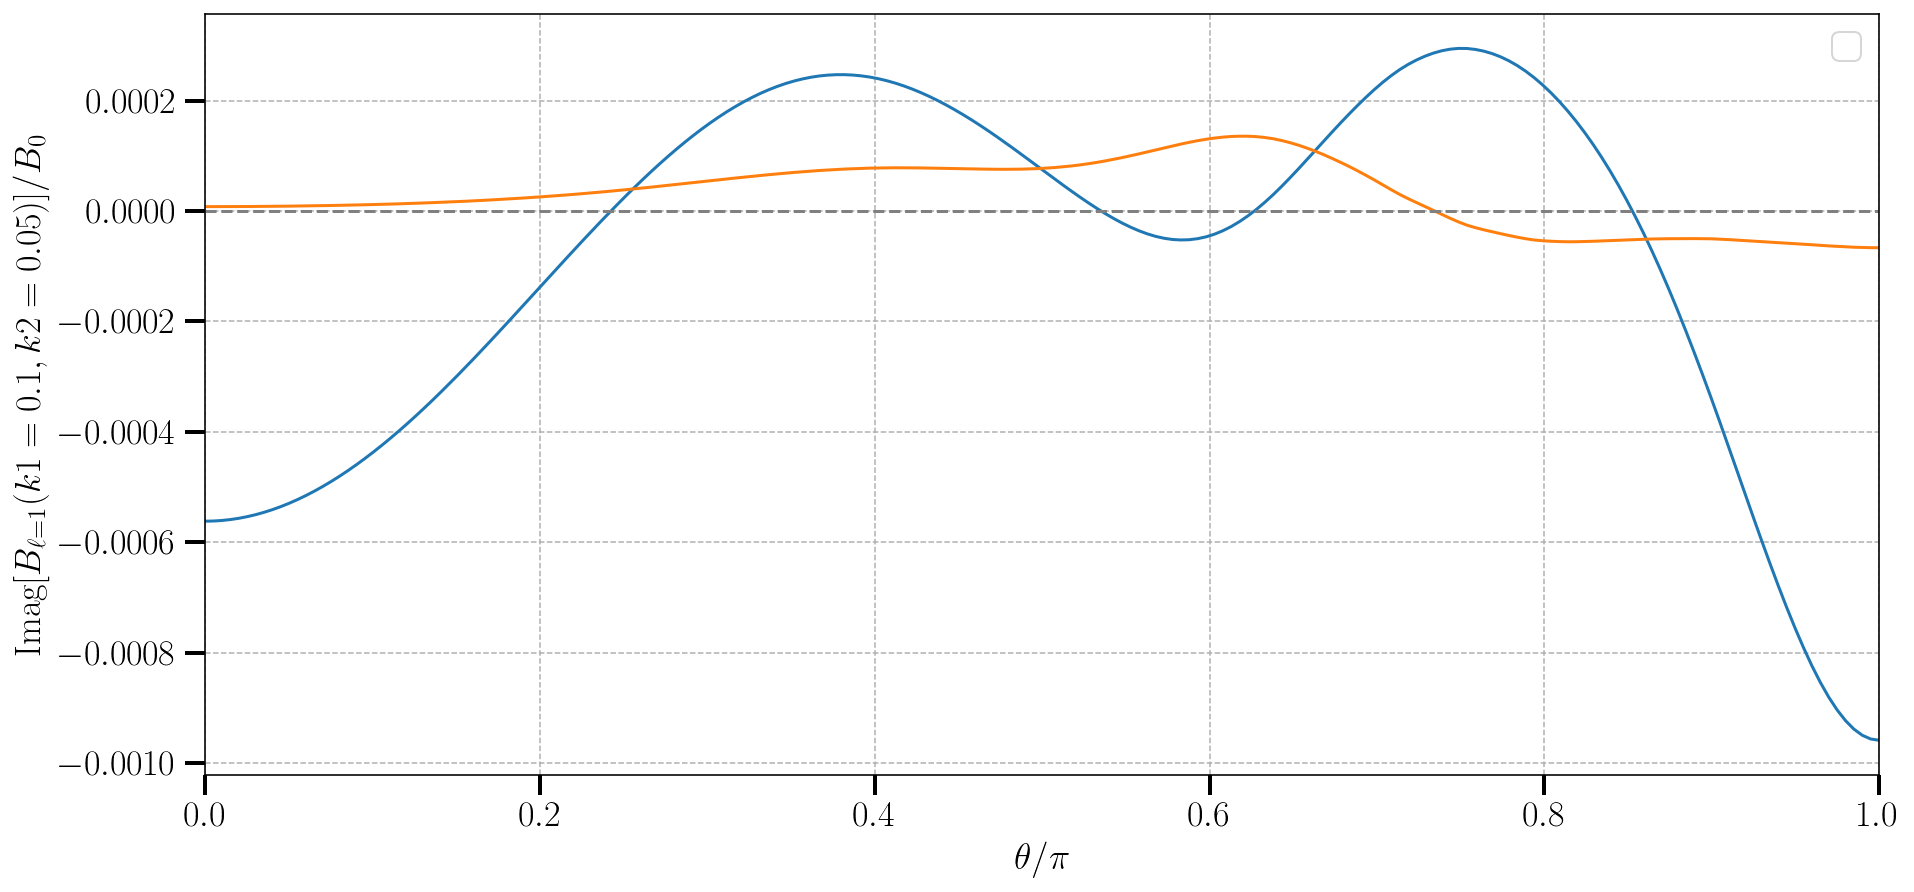

In [408]:
plt.figure(figsize=(15,7))
#plt.ylim(-0.7,0.2)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)

#plt.plot(theta/np.pi,Bk_wideangle1/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')

plt.plot(theta/np.pi,WA2.l0(params,1/3,1/3)/GR0.l0(params))
plt.plot(theta/np.pi,Der2.l0(params,derivs,1/3,1/3)/GR0.l0(params))
#plt.plot(theta/np.pi,Mix.l0(params,derivs,1/3,1/3)/GR0.l0(params))
plt.plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')

plt.legend()
plt.xlabel(r'$\theta/ \pi\,$')
plt.ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
plt.savefig('wrong_wide_angle_theory.png')

In [204]:
#So we need average (1/d) over redshift bin...
rout = comoving_dist(0.35)#1.2#
rmin = comoving_dist(0.15)#0.8#

d_plot = (3/2)*(rout**2-rmin**2)/(rout**3-rmin**3)
print(1/d_plot)

728.5929127055081


<Figure size 792x360 with 0 Axes>

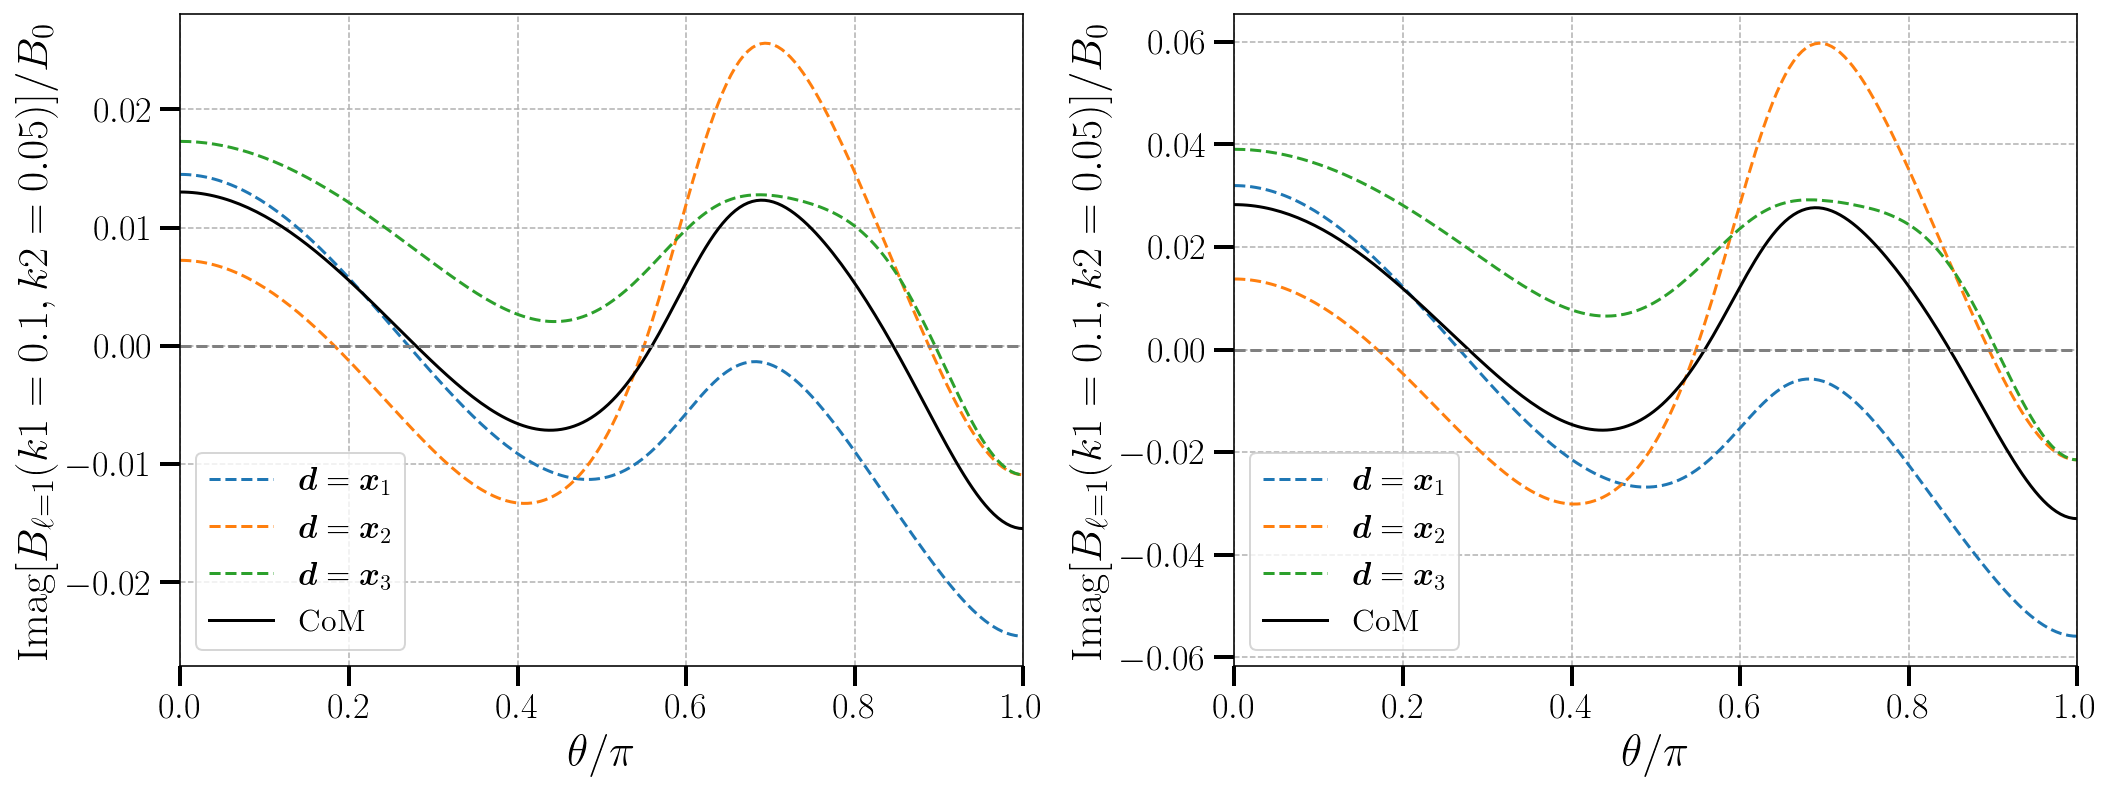

In [796]:
fig = plt.figure(figsize=(11, 5))

# Define gridspec with 4 rows and 3 columns
#gs = GridSpec(1, 2,width_ratios=[3, 3])

# Create subplots with custom aspect ratios
#axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(2)]  # Subplots in the first row

fig, axs = plt.subplots(1, 2,figsize=(17,6))
fig.subplots_adjust(wspace=0.25)
# Create the colormap plot
#im0 = axs[0].imshow(np.abs(bk0.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im1 = axs[1].imshow(np.abs(bk1.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im2 = axs[2].imshow(np.abs(bk2.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

axs[0].plot(theta/np.pi,z1x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[0].plot(theta/np.pi,z1x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[0].plot(theta/np.pi,z1x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[0].plot(theta/np.pi,z1xmid,'k',label=r'$\text{CoM}$')
axs[0].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[0].legend(fontsize =16)
axs[0].set_xlim(0,1)
#axs[0].set_ylim(-0.07,0.07)
axs[0].set_xlabel(r'$\theta/ \pi\,$')
axs[0].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[0].grid(ls='--',lw=0.75)


axs[1].plot(theta/np.pi,z2x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[1].plot(theta/np.pi,z2x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[1].plot(theta/np.pi,z2x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[1].plot(theta/np.pi,z2xmid,'k',label=r'$\text{CoM}$')
axs[1].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[1].legend(fontsize =16)
axs[1].set_xlim(0,1)
#axs[1].set_ylim(-0.07,0.07)

axs[1].set_xlabel(r'$\theta/ \pi\,$')
axs[1].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[1].grid(ls='--',lw=0.75)

plt.savefig('Milad_plot.png', bbox_inches='tight', dpi=400)
#axs[1].yaxis.set_major_locator(plt.NullLocator())


In [2316]:
#so data storage format
#bk_0 = {}
#bk_wa1 = {}
#bk_der1 = {}
bk_rad2 = {}

In [2317]:
from tqdm import tqdm
# Define the function
#@jit
def triangle_plot(x, y, zz,r=0,s=0):
    """Get array of"""
    bk = np.zeros((len(x),len(y)))
    d_z = comoving_dist(zz)
    #so only do select values of bispectrum...
    for i in tqdm(range(len(x))):
        #array version:
        k1 = 0.05
        k2 = y*k1
        k3 = x[i]*k1
        
        which_k2 = np.logical_and((y > 1 - x[i]), (y>x[i]))#restrict to closed triangles
        k2_= k2[which_k2]
        #get theta from triagle condition
        theta = np.arccos((k3**2 -k1**2 - k2_**2)/(2*k1*k2_))
        
        derivs = get_derivs(zz)
        fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
        params = get_params(k1,k2_,theta,zz)
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        #D1=1
        #K=3/7
        #C=3/7
        derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
        params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)
        
        #bk[i][which_k2] = Der1.l1(params,derivs, r, s).imag
        #bk[i][which_k2] = WA1.l1(params, r, s).imag
        #bk[i][which_k2] = GR0.l0(params).real
        
        
        #bk[i][which_k2] = Mix.l0(params,derivs, r, s).imag
        bk[i][which_k2] = Der2.l0(params,derivs, r, s).real
        
    return bk


xx = np.linspace(0.01, 1, 300)
yy = np.linspace(0.5, 1, 300)

zz=0.5
r=0;s=0

#so lets get key 

r=0;s=0
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)
r=1;s=0
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)
r=0;s=1
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)


mono_key = "z=%.2f"% (zz)
#bk_0[mono_key] = triangle_plot(xx,yy,zz,r,s)

100%|██████████| 300/300 [09:31<00:00,  1.91s/it]


In [2191]:
print(bk_der1.keys())
print(bk_wa1.keys())
print(bk_0.keys())

dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=1.00, r=1, s=0', 'z=1.00, r=0, s=1', 'z=0.20, r=0, s=0', 'z=0.20, r=1, s=0', 'z=0.20, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60, r=1, s=0', 'z=0.60, r=0, s=1'])
dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=1.00, r=1, s=0', 'z=1.00, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60, r=1, s=0', 'z=0.60, r=0, s=1'])
dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=0.60, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60', 'z=1.00', 'z=2.00', 'z=0.50'])


In [382]:
def plot_triangle(bk,vmax,vmin=1): #plot triangle with mask!
    plt.figure(figsize=(8,3.5))
    # Create the colormap plot
    im = plt.imshow(np.abs(bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(vmin, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im = plt.imshow((bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#
    
    cbar = plt.colorbar(im)#format='%.0e'
    cbar.set_label(r"$B_{\ell=1}(k_1=0.1,k_2,k_3)$")#P_{HI}(k1=0.05, \mu_1)P_{HI}(k2, \mu_2)P_{HI}(k3, \mu_3)B_{\text{Gravitational}(k1=0.05)}

    # Add labels and title
    plt.xlabel('$k_3/k_1$')
    plt.ylabel('$k_2/k_1$')

    #so masking 
    # Create a mask for the triangular region
    size = int(1e+3)
    x = np.linspace(0.0, 1, size,dtype=np.float32)
    y = np.linspace(0.5, 1,  size,dtype=np.float32)
    xx,yy = np.meshgrid(x,y)
    mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
    im = plt.imshow(mask, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='binary')
    
    plt.grid(ls='--',lw=0.75,color='k',alpha=0.1)
    
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    plt.text(0.06,0.55,'$r=s=1/3$')
    plt.plot(x_bound,y_bound,'k',linewidth=3)
    # Show the plot
    plt.savefig('B_var60.png', bbox_inches='tight', dpi=400)
    plt.show()

<ipython-input-2291-23375cfc3999>:2: RuntimeWarning: invalid value encountered in divide
  plot_triangle(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)#d = x1


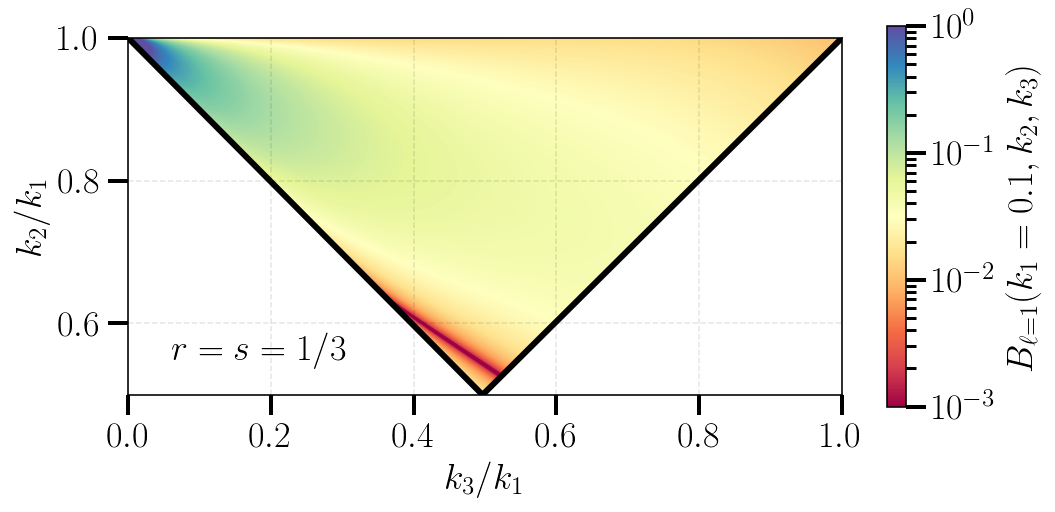

<ipython-input-2291-23375cfc3999>:3: RuntimeWarning: invalid value encountered in divide
  plot_triangle(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)


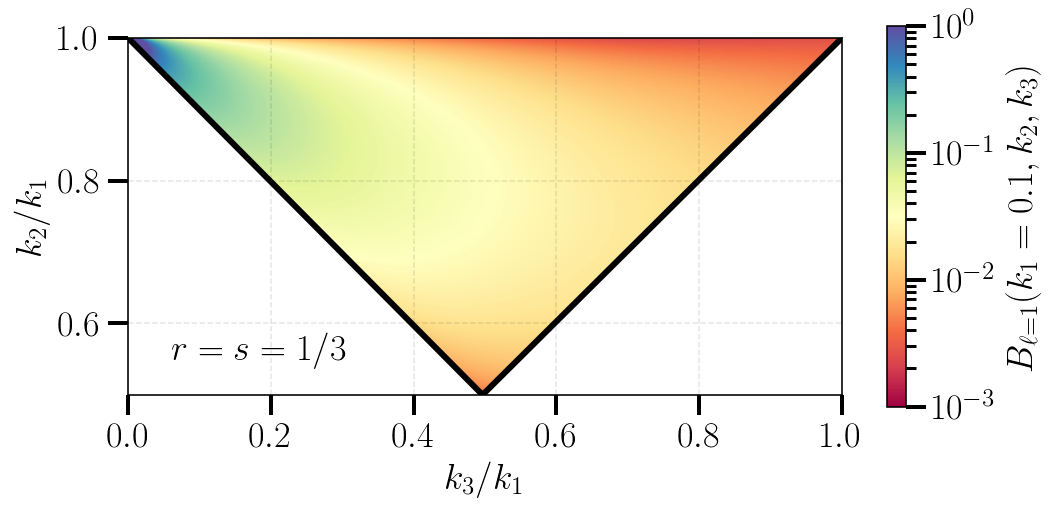

In [2291]:
#plot_triangle(bk_0['z=1.00, r=0, s=0'],1e+10,1e+8)
plot_triangle(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)#d = x1
plot_triangle(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)

In [2312]:
def plot_triangle_multi(bk0,bk1,bk2,vmax): #plot triangle with mask!   
        
    fig = plt.figure(figsize=(12, 5))

    # Define gridspec with 1 rows and 3 columns
    gs = GridSpec(1, 3, width_ratios=[3, 3, 3])

    # Create subplots with custom aspect ratios
    axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(3)]  # Subplots in the first row

    #fig, axs = plt.subplots(1, 3,figsize=(14,5),sharey=True)
    fig.subplots_adjust(wspace=0)
    # Create the colormap plot
    im0 = axs[0].imshow(np.abs((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im1 = axs[1].imshow(np.abs((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im2 = axs[2].imshow(np.abs((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

    #im0 = axs[0].imshow(((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im1 = axs[1].imshow(((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im2 = axs[2].imshow(((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#

    #divider = make_axes_locatable(axs[2])
    #colorbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    #cbar = plt.colorbar(im2, cax=colorbar_ax)
    #
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.4])
    cbar = fig.colorbar(im2, cax=cbar_ax,ticks=[0.01, 0.1, 1])
    #cbar.set_label(r"$ |B^{\rm wa}_{\ell=1}(k_1=0.05)|/B^{\rm pp}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    cbar.set_label(r"$ |B^{\rm red}_{\ell=1}(k_1=0.05)|/B^{\rm wa}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    #so masking 
    # Create a mask for the triangular region
    for i in range(3):
        #axs[i].set_aspect(10)  # Adjust aspect ratio manually
        if i ==0:
            #axs[i].set_yticks(np.arange(0, 0.5, 0.1))
            axs[i].set_ylabel('$k_2/k_1$')
        #size = int(1e+3)
        #x = np.linspace(0.0, 1, size,dtype=np.float32)
        #y = np.linspace(0.5, 1,  size,dtype=np.float32)
        #xx,yy = np.meshgrid(x,y)
        #mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
        #axs[i].imshow(mask, aspect=1.5, interpolation='bilinear', origin='lower', cmap='binary')
        axs[i].plot(x_bound,y_bound,'k',linewidth=3)
        axs[i].text(0.08,0.55,r'$\boldsymbol{d}=\boldsymbol{x}_%d$'%(i+1),fontsize=20)
        axs[i].set_xlabel('$k_3/k_1$')
        axs[i].set_xticks(np.arange(0.1, 0.91, 0.2))
        #axs[i].set_box_aspect(aspect=0.8)
        #axs[i].set_xlim(0,1)
        #axs[i].set_ylim(0.5,1)
        #axs[i].grid(ls='--',lw=0.75,color='k',alpha=0.1)
        
        if i!=0:
            axs[i].yaxis.set_major_locator(plt.NullLocator())
    
    # Show the plot
    plt.savefig('endpoint_traingles.png', bbox_inches='tight', dpi=400)
    plt.show()

<ipython-input-2313-17e6a40c8381>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)


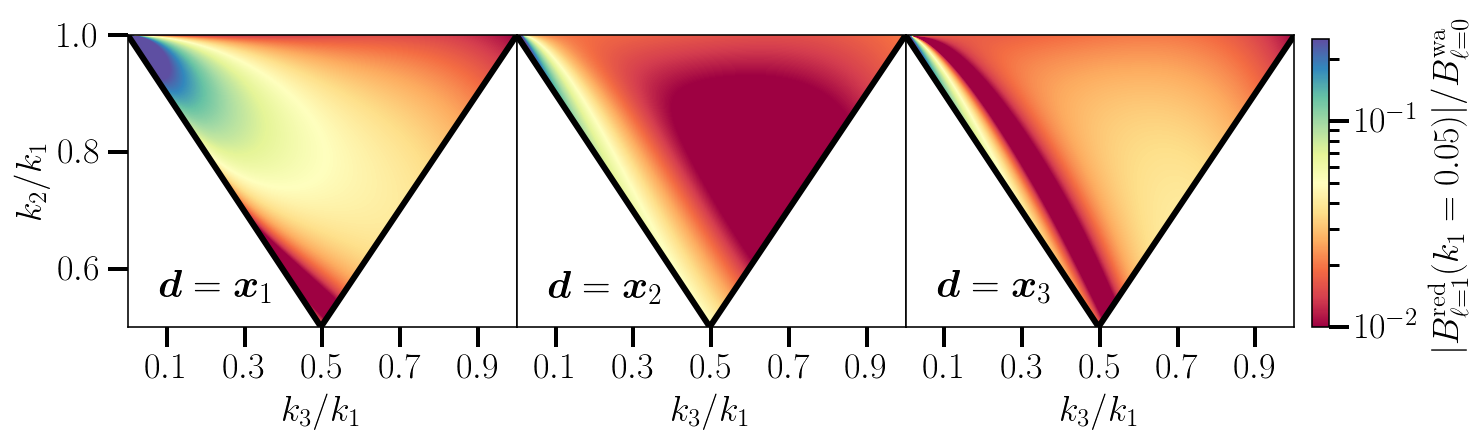

In [2313]:
plot_triangle_multi(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)

<ipython-input-2314-21821a36bdc0>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)


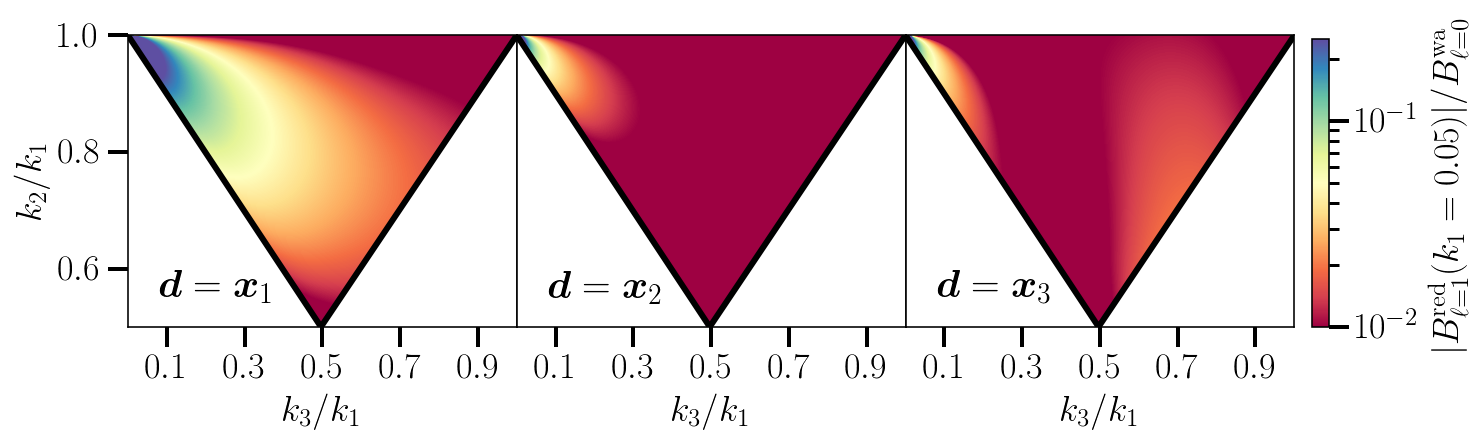

In [2314]:
plot_triangle_multi(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)

<ipython-input-2315-ba182e99cd10>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_wa1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)


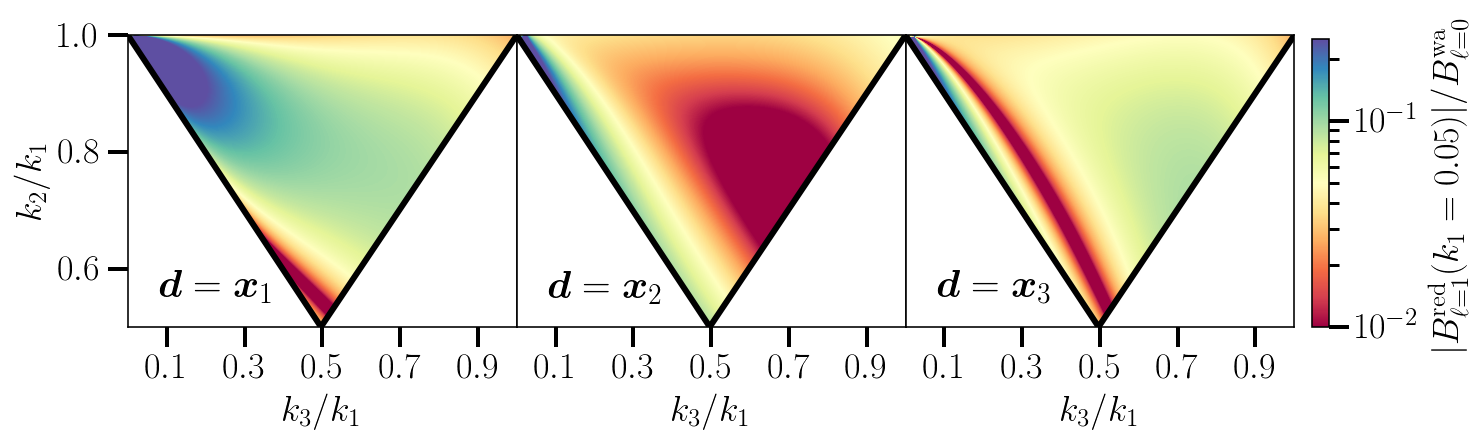

<ipython-input-2315-ba182e99cd10>:2: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_der1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)


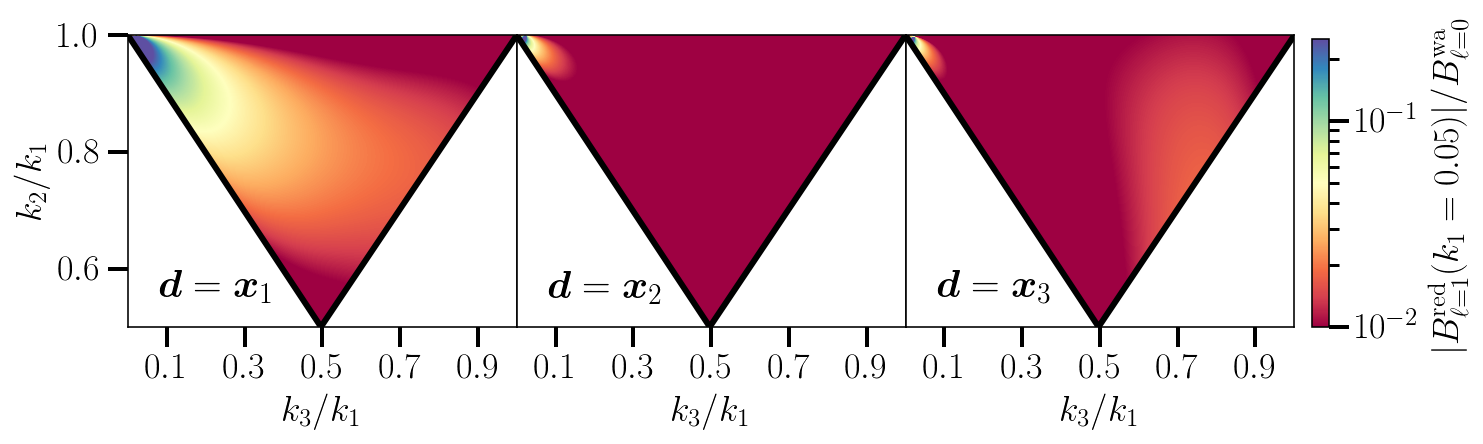

In [2315]:
plot_triangle_multi(bk_wa1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)
plot_triangle_multi(bk_der1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)

In [ ]:
plot_triangle_multi(bk_der2['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der2['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der2['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)

In [1318]:
def add_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict
def minus_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict

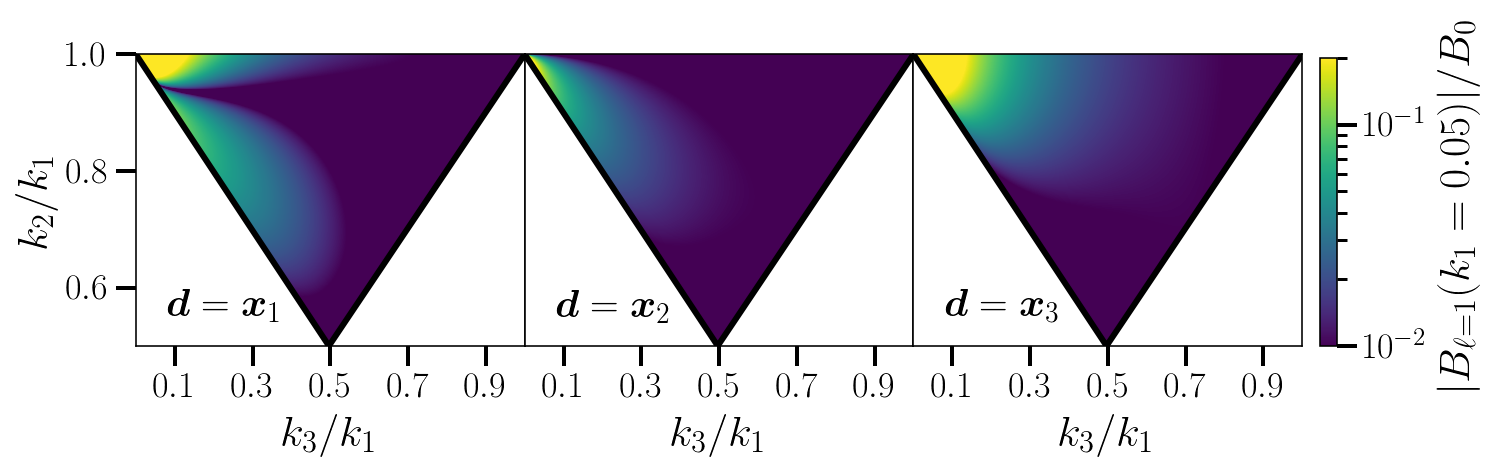

In [1332]:
plot_triangle_multi(bk1_deriv['0.1']/bk_mono['0.1'],bk2_deriv['0.1']/bk_mono['0.1'],bk3_deriv['0.1']/bk_mono['0.1'],0.2)

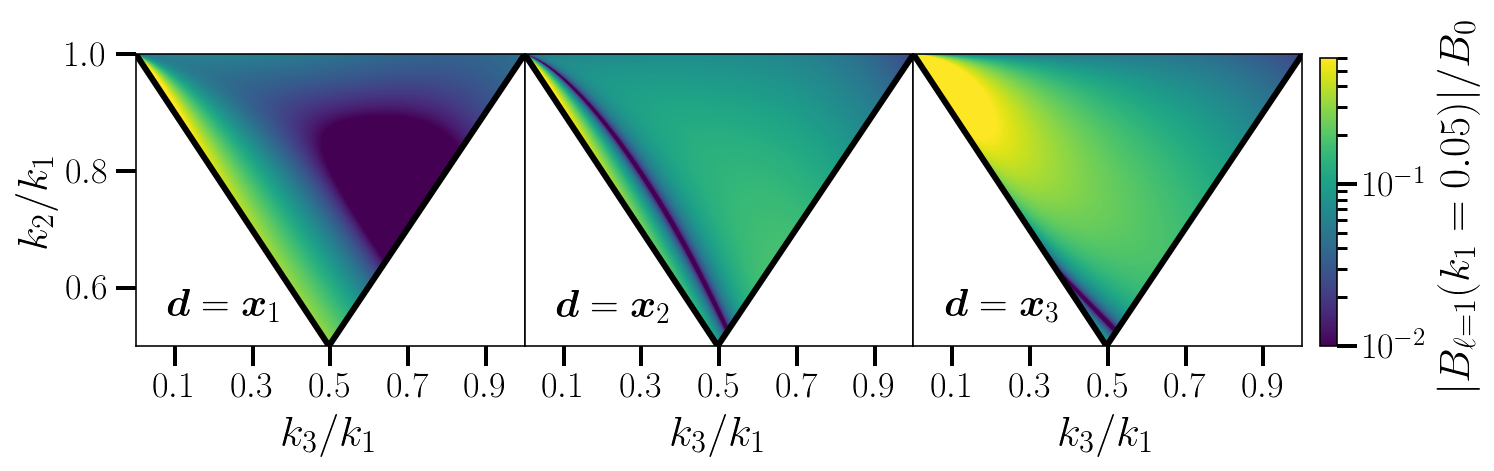

In [1304]:
plot_triangle_multi(bk1,bk2,bk3,0.6)